FILTER

Filter adalah sistem linier dan tidak bergantung pada waktu. Ini berarti filter memenuhi sifat-sifat berikut:
Jika F(x(n)) adalah fungsi filter dari sinyal input x(n) maka kita memiliki:
- Linieritas: untuk 2 sinyal x1(n) dan x2(n),
F(x1(n) + x2(n)) = F(x1(n)) + F(x2(n))
Dengan faktor a:
F(a⋅x(n))=a⋅F(x(n))
yang berarti kita dapat "mengeluarkan" jumlah dan faktor dari fungsi kita.

- Invarians Waktu: jika y(n) = F(x(n)) maka kita memiliki, untuk penundaan n0 :
y(n+n0)=F(x(n+n0))
yang berarti fungsi kita tetap sama tidak peduli kapan pun kita menerapkannya.

FIR Filters

Filter Finite Impulse Response (FIR) sederhana memiliki persamaan perbedaan seperti berikut ini, dengan x(n) adalah input filter kita, dan y(n) adalah outputnya:
y(n) = ∑ L m = 0 b(m) x(n - m)
Perhatikan bahwa ini adalah konvolusi sinyal x(n) dengan b(n). Di sini, b(m) adalah koefisien filter, atau respons impulsnya. Ini biasanya juga disebut sebagai "taps", karena sistem ini dapat dilihat sebagai "mengetuk" garis tunda, seperti yang terlihat pada gambar di bawah ini.

Persamaan perbedaan ini juga merupakan bagaimana biasanya filter diimplementasikan dalam Matlab atau Python dan bahasa pemrograman lainnya. Diagram blok tipikal filter FIR adalah sebagai berikut:
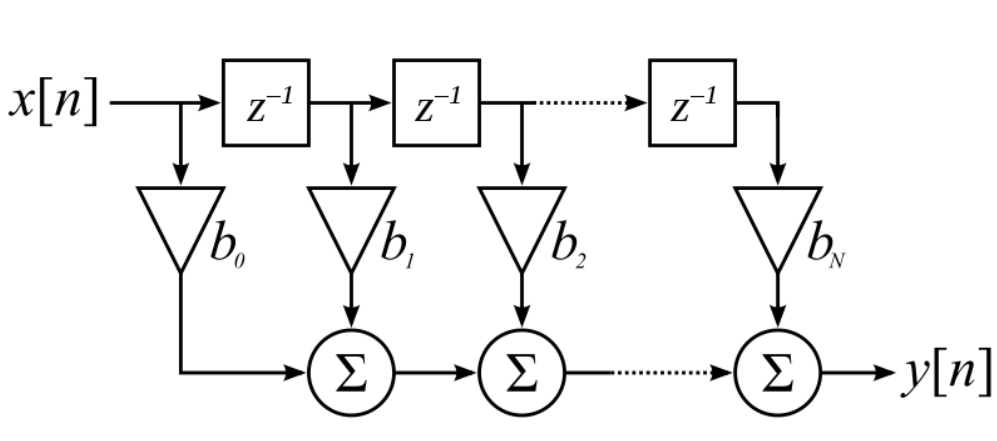

In [ ]:
%pylab inline
#%pylab notebook # for plots editable inthe notebook
#%matplotlib qt # for popout plots
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d
import sk_dsp_comm.multirate_helper as mrh
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

In [ ]:
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

Desain Filter Menggunakan Modul Pembantu
Sinyal paket Scipy membantu dalam mendesain banyak jenis filter digital. Sebagai alternatif, di sini kita mengeksplorasi penggunaan modul desain filter yang terdapat di scikit-dsp-comm (https://github.com/mwickert/scikit-dsp-comm).

Dalam catatan ini kami secara singkat mengeksplorasi penggunaan sk_dsp_comm.fir_design_helper dan sk_dsp_comm.iir_design_helper. Pada contoh-contoh berikutnya, kami mengasumsikan bahwa impor modul-modul ini dilakukan sebagai berikut:

In [ ]:
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d

Fungsi-fungsi dalam modul ini menyediakan antarmuka yang lebih mudah dan lebih konsisten untuk desain klasik finte impulse response (FIR) (fase linier) dan infinite impulse response (IIR). Fungsi-fungsi di dalam modul ini membungkus fungsi scipy.signal dan juga menggabungkan fungsionalitas baru.

Desain Dari Persyaratan Respons Amplitudo
Dengan fir_design_helper dan iir_design_helper, desain dimulai dengan persyaratan respons amplitudo, yaitu frekuensi kritis passband filter, frekuensi kritis stopband, riak passband, dan redaman stopband. Jumlah keran/koefisien (kasus FIR) atau orde filter (kasus IIR) yang diperlukan untuk memenuhi persyaratan ini kemudian ditentukan dan koefisien filter dikembalikan sebagai larik b untuk FIR, dan untuk IIR larik b dan a, serta larik 2D sos bagian orde kedua, dengan baris yang berisi kaskade yang sesuai dengan toplogi bagian orde kedua untuk filter IIR.

Untuk kasus FIR yang kita miliki dalam domain z -domain


HFIR(z)=∑k=0Nbkz−k
dengan ndarray b =  [b0,b1,…,bN]
Untuk kasus FIR yang kita miliki dalam domain z -domain
HIIR(z)=∑Mk=0bkz−k∑Nk=1akz−k=∏k=0Ns−1bk0+bk1z−1+bk2z−21+ak1z−1+ak2z−2=∏k=0Ns−1Hk(z)
dimana  Ns=⌊(N+1)/2⌋
Untuk bentuk b/a, koefisien disusun sebagai :
b = [b0, b1, ..., bM-1], koefisien filter pembilang
a = [a0, a1, ..., aN-1], koefisien filter penyebut
Untuk bentuk sos setiap baris dari larik sos 2D berhubungan dengan koefisien Hk(z) sebagai berikut:

SOS_mat = [[b00, b01, b02, 1, a01, a02], #biquad 0
           [b10, b11, b12, 1, a11, a12], #biquad 1
            .
            .
           [bNs-10, bNs-11, bNs-12, 1, aNs-11, aNs-12]] #biquad Ns-1

Desain Filter FIR Fase Linier

Fokus utama dari modul ini adalah menambahkan kemampuan untuk mendesain filter FIR fase linier dari persyaratan respons amplitudo yang mudah digunakan.
Sebagian besar desain filter digital dimotivasi oleh keinginan untuk mendekati filter yang ideal. Ingatlah bahwa filter yang ideal akan meloloskan sinyal frekuensi tertentu dan memblokir yang lain. Untuk filter analog dan digital, perancang dapat memilih dari berbagai teknik aproksimasi. Untuk filter digital, teknik aproksimasi termasuk dalam kategori IIR atau FIR. Dalam desain filter FIR, dua teknik yang populer adalah memotong respon impuls filter yang ideal dan menerapkan jendela, dan perkiraan equiripple optimal Oppenheim2010. Pendekatan berbasis sampling frekuensi juga populer, tetapi tidak akan dibahas di sini, meskipun scipy.signal mendukung ketiganya. Desain filter umumnya dimulai dengan spesifikasi respons frekuensi yang diinginkan. Respons frekuensi filter dapat dinyatakan dalam beberapa cara, tetapi respons amplitudo adalah yang paling umum, misalnya, menyatakan bagaimana Hc (jΩ) atau H (ejω) = H (ej2πf / fs) harus berperilaku. Desain yang lengkap terdiri dari jumlah koefisien (tap) yang diperlukan dan koefisien itu sendiri (float presisi ganda atau float64 di Numpy, dan float64_t di C). Gambar 1, di bawah ini, menunjukkan persyaratan respons amplitudo dalam hal penguatan filter dan frekuensi kritis untuk filter lowpass, highpass, bandpass, dan bandstop. Frekuensi kritis diberikan di sini dalam hal persyaratan analog dalam Hz. Frekuensi pengambilan sampel diasumsikan dalam Hz. Nilai riak passband dan redaman stopband dalam dB. Perhatikan bahwa redaman dalam dB adalah negatif dari penguatan, misalnya, -60 penguatan stopband setara dengan 60 dB redaman stopband.

In [ ]:
Image('300ppi/FIR_Lowpass_Highpass_Bandpass_Bandstop@300ppi.png',width='90%')

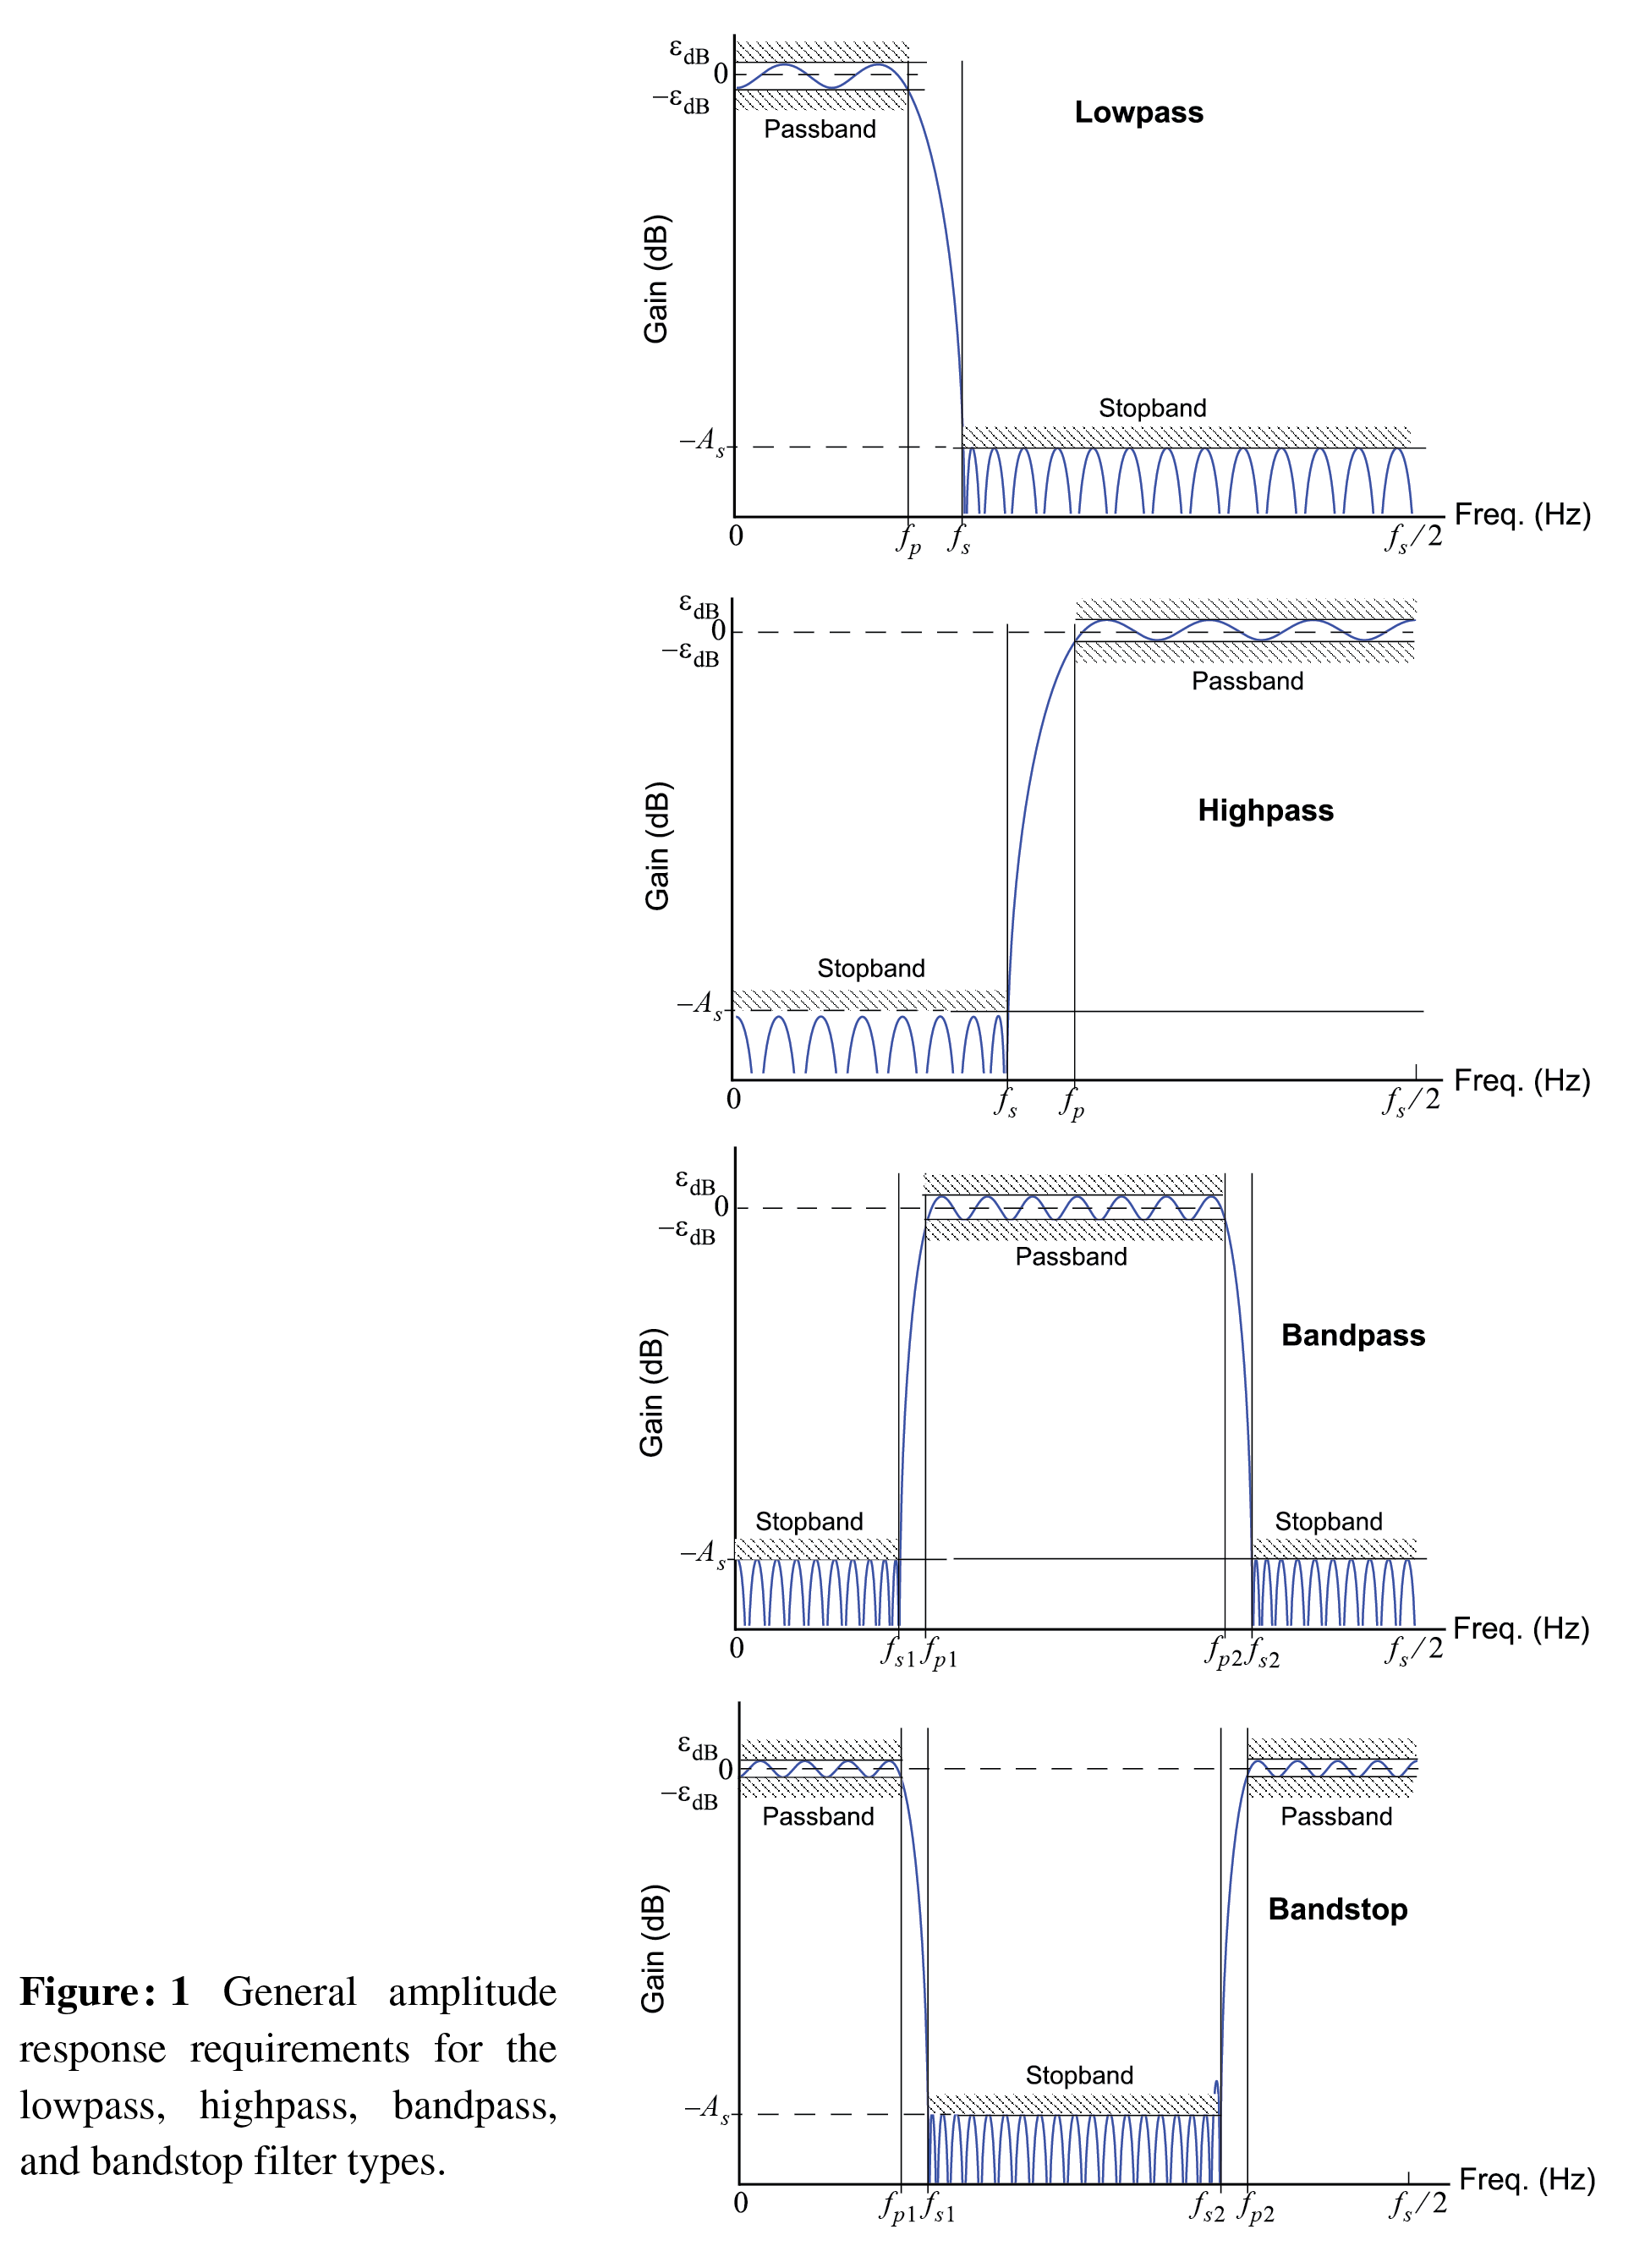

Terdapat 10 fungsi desain filter dan satu fungsi plotting yang tersedia di fir_design_helper.py. Empat fungsi untuk mendesain filter FIR berbasis jendela Kaiser dan empat fungsi untuk mendesain filter FIR berbasis equiripple. Dari delapan fungsi yang baru saja dijelaskan, semuanya menerima persyaratan respons amplitudo dan mengembalikan array koefisien. Dua dari 10 fungsi filter hanyalah pembungkus di sekitar fungsi scipy.signal signal.firwin() untuk mendesain filter dengan urutan tertentu ketika satu (lowpass) atau dua (bandpass) frekuensi kritis diberikan. Fungsi pembungkus memperbaiki jenis jendela ke firwin default hann (hanning). Delapan remamining dijelaskan di bawah ini pada Tabel 1. Fungsi plotting menyediakan cara yang mudah untuk membandingkan respons frekuensi yang dihasilkan dari satu atau lebih desain pada satu plot. Mode tampilan memungkinkan penguatan dalam dB, fase dalam radian, penundaan grup dalam sampel, dan penundaan grup dalam detik untuk laju sampling tertentu. Fungsi ini, freq_resp_list(), berfungsi untuk desain FIR dan IIR. Tabel 1 memberikan detail antarmuka ke delapan fungsi desain di mana d_stop dan d_pass adalah nilai dB positif dan frekuensi kritis memiliki unit yang sama dengan frekuensi sampling fs. Fungsi-fungsi ini tidak menghasilkan hasil yang sempurna sehingga beberapa penyetelan parameter desain mungkin diperlukan, selain menabrak urutan filter ke atas atau ke bawah melalui N_bump.

Contoh Desain

Contoh 1: Lowpass dengan fs = 1 Hz
Untuk filter 31 ketuk ini, kami memilih frekuensi cutoff menjadi Fc = Fs / 8 atau dalam bentuk yang dinormalisasi fc = 1/8.

In [ ]:
Image('300ppi/FIR_Kaiser_Equiripple_Table@300ppi.png',width='80%')


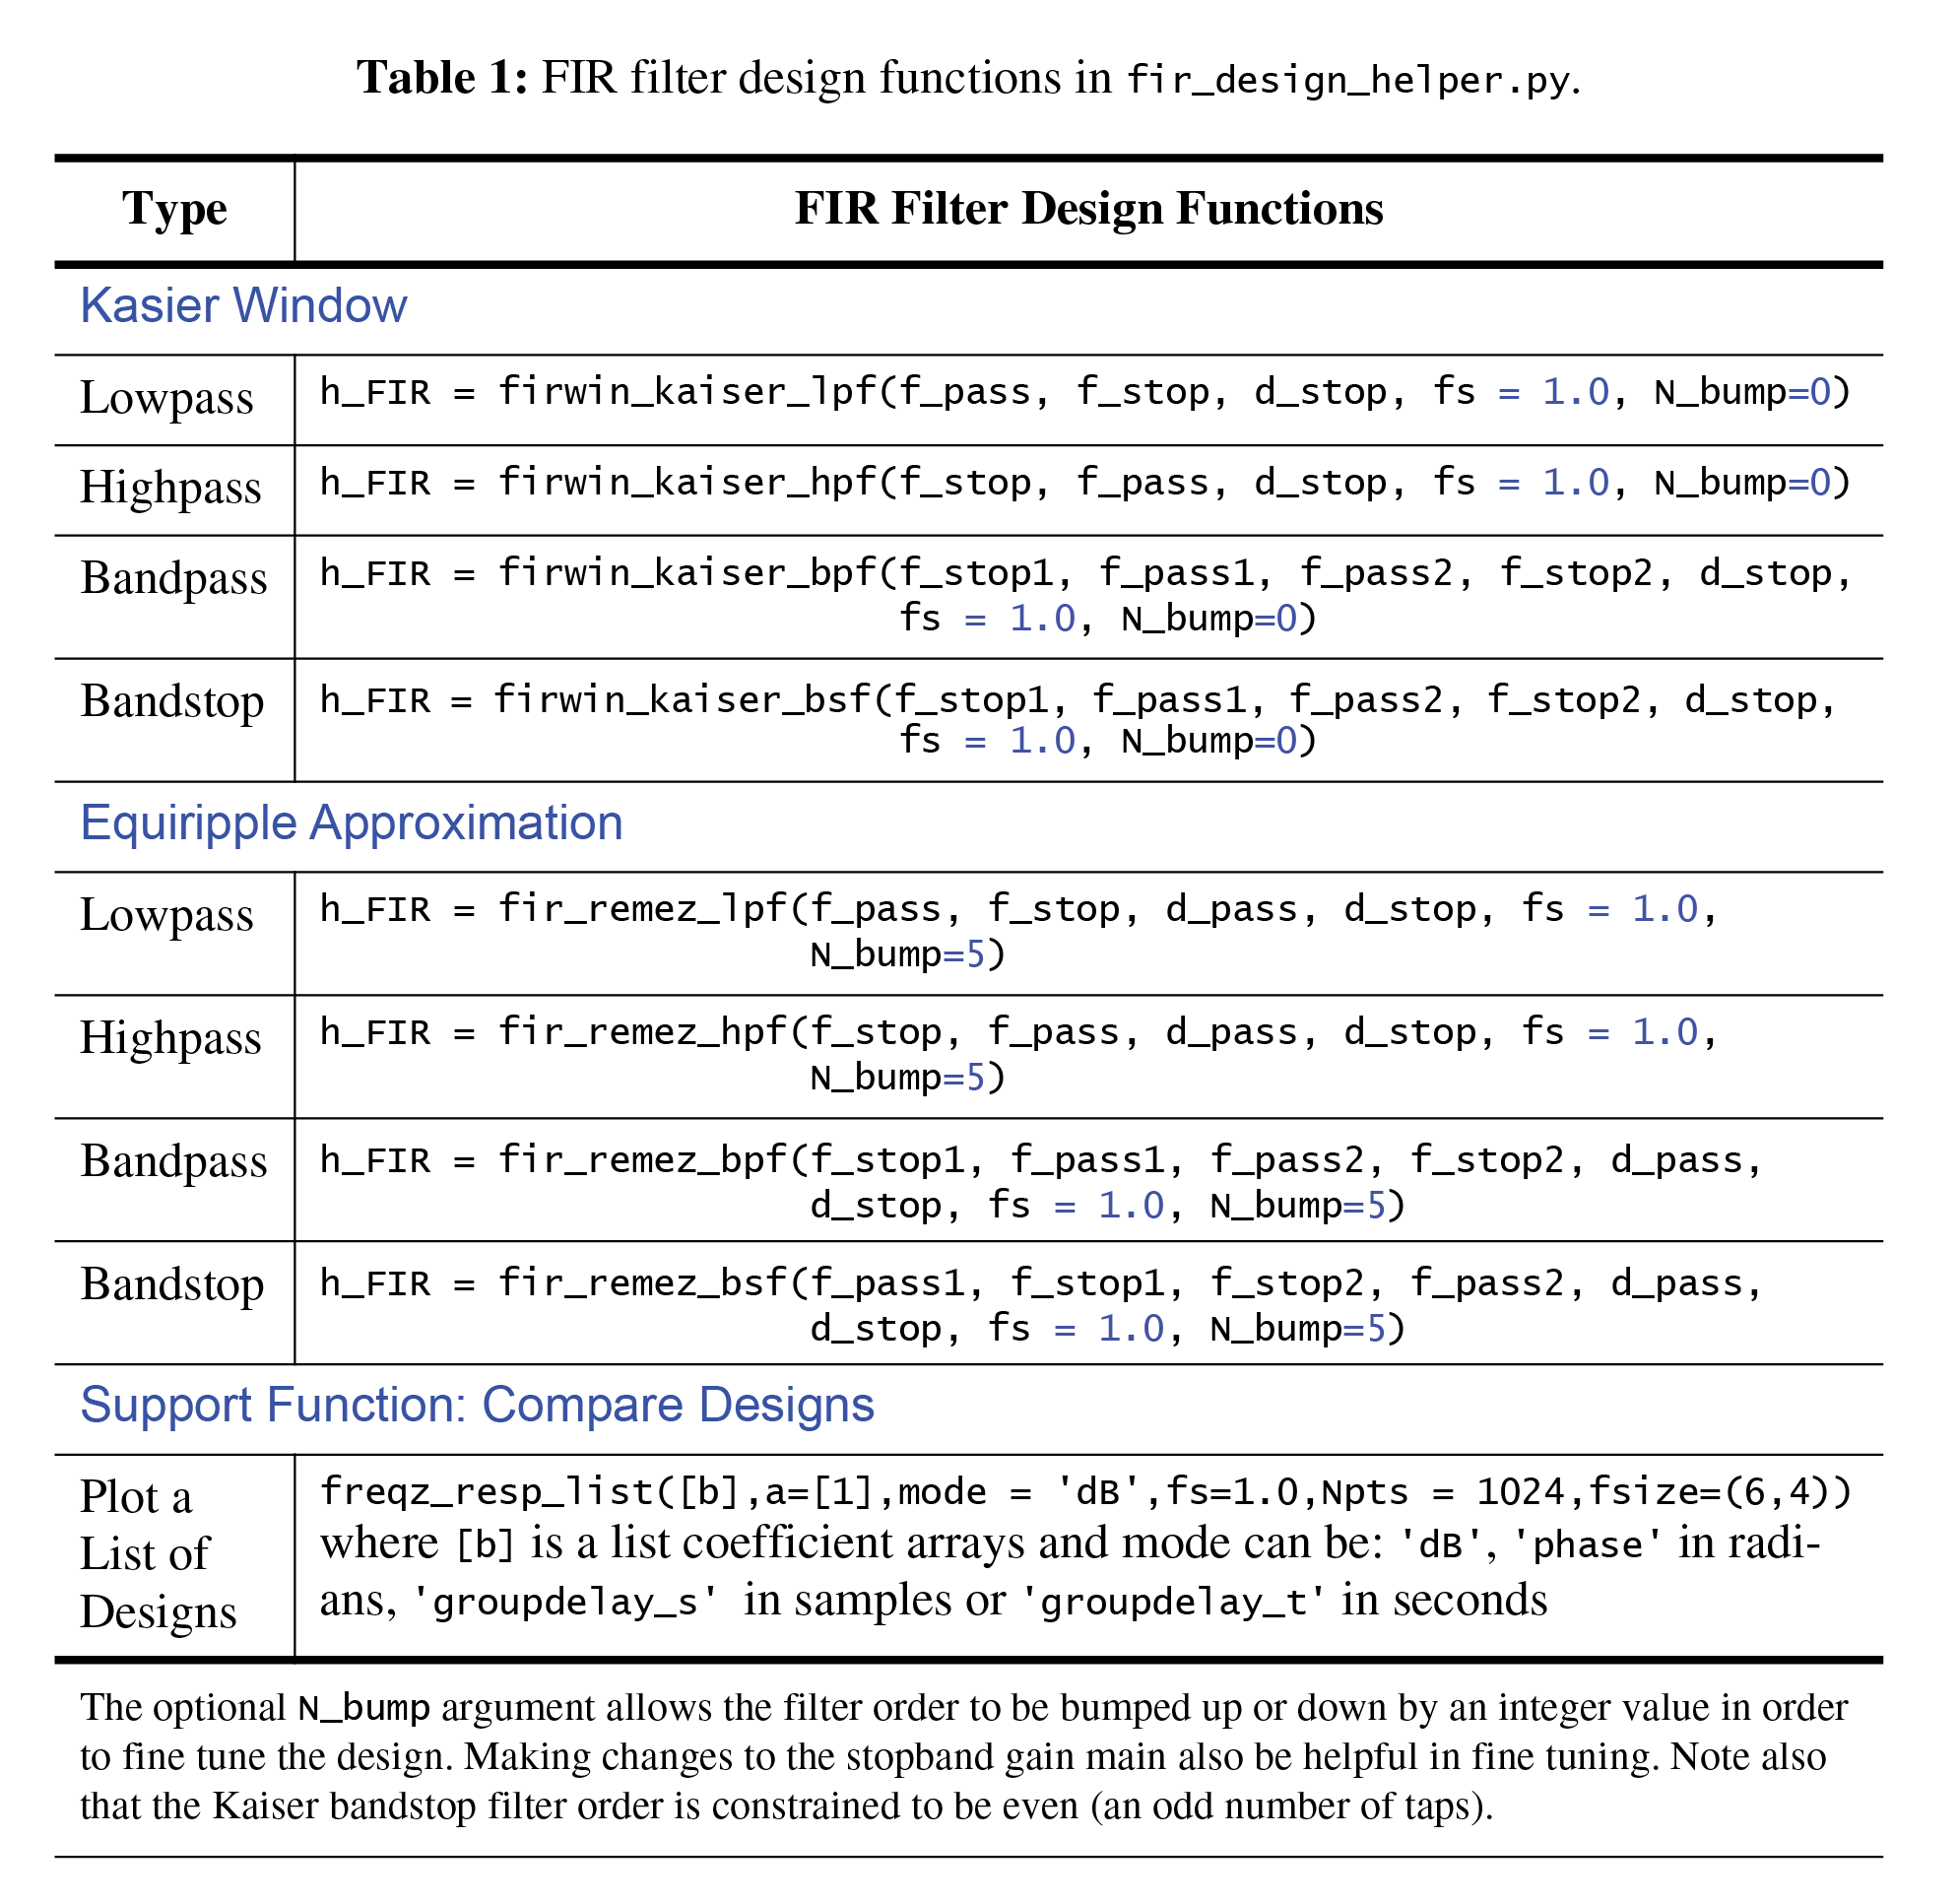

In [ ]:
b_k = fir_d.firwin_kaiser_lpf(1/8,1/6,50,1.0)
b_r = fir_d.fir_remez_lpf(1/8,1/6,0.2,50,1.0)

Kaiser Win filter taps = 72.
Remez filter taps = 53.

In [ ]:
fir_d.freqz_resp_list([b_k,b_r],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

In [ ]:
b_k_hp = fir_d.firwin_kaiser_hpf(1/8,1/6,50,1.0)
b_r_hp = fir_d.fir_remez_hpf(1/8,1/6,0.2,50,1.0)

<!DOCTYPE html>
<!-- saved from url=(0113)https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html -->
<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
<title>FIR_and_IIR_Filter_Design</title><script src="./FIR_and_IIR_Filter_Design_files/require.min.js.download"></script>
<script src="./FIR_and_IIR_Filter_Design_files/jquery.min.js.download"></script>

<style type="text/css">
    /*!
*
* Twitter Bootstrap
*
*/
/*!
 * Bootstrap v3.3.7 (http://getbootstrap.com)
 * Copyright 2011-2016 Twitter, Inc.
 * Licensed under MIT (https://github.com/twbs/bootstrap/blob/master/LICENSE)
 */
/*! normalize.css v3.0.3 | MIT License | github.com/necolas/normalize.css */
html {
  font-family: sans-serif;
  -ms-text-size-adjust: 100%;
  -webkit-text-size-adjust: 100%;
}
body {
  margin: 0;
}
article,
aside,
details,
figcaption,
figure,
footer,
header,
hgroup,
main,
menu,
nav,
section,
summary {
  display: block;
}
audio,
canvas,
progress,
video {
  display: inline-block;
  vertical-align: baseline;
}
audio:not([controls]) {
  display: none;
  height: 0;
}
[hidden],
template {
  display: none;
}
a {
  background-color: transparent;
}
a:active,
a:hover {
  outline: 0;
}
abbr[title] {
  border-bottom: 1px dotted;
}
b,
strong {
  font-weight: bold;
}
dfn {
  font-style: italic;
}
h1 {
  font-size: 2em;
  margin: 0.67em 0;
}
mark {
  background: #ff0;
  color: #000;
}
small {
  font-size: 80%;
}
sub,
sup {
  font-size: 75%;
  line-height: 0;
  position: relative;
  vertical-align: baseline;
}
sup {
  top: -0.5em;
}
sub {
  bottom: -0.25em;
}
img {
  border: 0;
}
svg:not(:root) {
  overflow: hidden;
}
figure {
  margin: 1em 40px;
}
hr {
  box-sizing: content-box;
  height: 0;
}
pre {
  overflow: auto;
}
code,
kbd,
pre,
samp {
  font-family: monospace, monospace;
  font-size: 1em;
}
button,
input,
optgroup,
select,
textarea {
  color: inherit;
  font: inherit;
  margin: 0;
}
button {
  overflow: visible;
}
button,
select {
  text-transform: none;
}
button,
html input[type="button"],
input[type="reset"],
input[type="submit"] {
  -webkit-appearance: button;
  cursor: pointer;
}
button[disabled],
html input[disabled] {
  cursor: default;
}
button::-moz-focus-inner,
input::-moz-focus-inner {
  border: 0;
  padding: 0;
}
input {
  line-height: normal;
}
input[type="checkbox"],
input[type="radio"] {
  box-sizing: border-box;
  padding: 0;
}
input[type="number"]::-webkit-inner-spin-button,
input[type="number"]::-webkit-outer-spin-button {
  height: auto;
}
input[type="search"] {
  -webkit-appearance: textfield;
  box-sizing: content-box;
}
input[type="search"]::-webkit-search-cancel-button,
input[type="search"]::-webkit-search-decoration {
  -webkit-appearance: none;
}
fieldset {
  border: 1px solid #c0c0c0;
  margin: 0 2px;
  padding: 0.35em 0.625em 0.75em;
}
legend {
  border: 0;
  padding: 0;
}
textarea {
  overflow: auto;
}
optgroup {
  font-weight: bold;
}
table {
  border-collapse: collapse;
  border-spacing: 0;
}
td,
th {
  padding: 0;
}
/*! Source: https://github.com/h5bp/html5-boilerplate/blob/master/src/css/main.css */
@media print {
  *,
  *:before,
  *:after {
    background: transparent !important;
    color: #000 !important;
    box-shadow: none !important;
    text-shadow: none !important;
  }
  a,
  a:visited {
    text-decoration: underline;
  }
  a[href]:after {
    content: " (" attr(href) ")";
  }
  abbr[title]:after {
    content: " (" attr(title) ")";
  }
  a[href^="#"]:after,
  a[href^="javascript:"]:after {
    content: "";
  }
  pre,
  blockquote {
    border: 1px solid #999;
    page-break-inside: avoid;
  }
  thead {
    display: table-header-group;
  }
  tr,
  img {
    page-break-inside: avoid;
  }
  img {
    max-width: 100% !important;
  }
  p,
  h2,
  h3 {
    orphans: 3;
    widows: 3;
  }
  h2,
  h3 {
    page-break-after: avoid;
  }
  .navbar {
    display: none;
  }
  .btn > .caret,
  .dropup > .btn > .caret {
    border-top-color: #000 !important;
  }
  .label {
    border: 1px solid #000;
  }
  .table {
    border-collapse: collapse !important;
  }
  .table td,
  .table th {
    background-color: #fff !important;
  }
  .table-bordered th,
  .table-bordered td {
    border: 1px solid #ddd !important;
  }
}
@font-face {
  font-family: 'Glyphicons Halflings';
  src: url('../components/bootstrap/fonts/glyphicons-halflings-regular.eot');
  src: url('../components/bootstrap/fonts/glyphicons-halflings-regular.eot?#iefix') format('embedded-opentype'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.woff2') format('woff2'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.woff') format('woff'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.ttf') format('truetype'), url('../components/bootstrap/fonts/glyphicons-halflings-regular.svg#glyphicons_halflingsregular') format('svg');
}
.glyphicon {
  position: relative;
  top: 1px;
  display: inline-block;
  font-family: 'Glyphicons Halflings';
  font-style: normal;
  font-weight: normal;
  line-height: 1;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}
.glyphicon-asterisk:before {
  content: "\002a";
}
.glyphicon-plus:before {
  content: "\002b";
}
.glyphicon-euro:before,
.glyphicon-eur:before {
  content: "\20ac";
}
.glyphicon-minus:before {
  content: "\2212";
}
.glyphicon-cloud:before {
  content: "\2601";
}
.glyphicon-envelope:before {
  content: "\2709";
}
.glyphicon-pencil:before {
  content: "\270f";
}
.glyphicon-glass:before {
  content: "\e001";
}
.glyphicon-music:before {
  content: "\e002";
}
.glyphicon-search:before {
  content: "\e003";
}
.glyphicon-heart:before {
  content: "\e005";
}
.glyphicon-star:before {
  content: "\e006";
}
.glyphicon-star-empty:before {
  content: "\e007";
}
.glyphicon-user:before {
  content: "\e008";
}
.glyphicon-film:before {
  content: "\e009";
}
.glyphicon-th-large:before {
  content: "\e010";
}
.glyphicon-th:before {
  content: "\e011";
}
.glyphicon-th-list:before {
  content: "\e012";
}
.glyphicon-ok:before {
  content: "\e013";
}
.glyphicon-remove:before {
  content: "\e014";
}
.glyphicon-zoom-in:before {
  content: "\e015";
}
.glyphicon-zoom-out:before {
  content: "\e016";
}
.glyphicon-off:before {
  content: "\e017";
}
.glyphicon-signal:before {
  content: "\e018";
}
.glyphicon-cog:before {
  content: "\e019";
}
.glyphicon-trash:before {
  content: "\e020";
}
.glyphicon-home:before {
  content: "\e021";
}
.glyphicon-file:before {
  content: "\e022";
}
.glyphicon-time:before {
  content: "\e023";
}
.glyphicon-road:before {
  content: "\e024";
}
.glyphicon-download-alt:before {
  content: "\e025";
}
.glyphicon-download:before {
  content: "\e026";
}
.glyphicon-upload:before {
  content: "\e027";
}
.glyphicon-inbox:before {
  content: "\e028";
}
.glyphicon-play-circle:before {
  content: "\e029";
}
.glyphicon-repeat:before {
  content: "\e030";
}
.glyphicon-refresh:before {
  content: "\e031";
}
.glyphicon-list-alt:before {
  content: "\e032";
}
.glyphicon-lock:before {
  content: "\e033";
}
.glyphicon-flag:before {
  content: "\e034";
}
.glyphicon-headphones:before {
  content: "\e035";
}
.glyphicon-volume-off:before {
  content: "\e036";
}
.glyphicon-volume-down:before {
  content: "\e037";
}
.glyphicon-volume-up:before {
  content: "\e038";
}
.glyphicon-qrcode:before {
  content: "\e039";
}
.glyphicon-barcode:before {
  content: "\e040";
}
.glyphicon-tag:before {
  content: "\e041";
}
.glyphicon-tags:before {
  content: "\e042";
}
.glyphicon-book:before {
  content: "\e043";
}
.glyphicon-bookmark:before {
  content: "\e044";
}
.glyphicon-print:before {
  content: "\e045";
}
.glyphicon-camera:before {
  content: "\e046";
}
.glyphicon-font:before {
  content: "\e047";
}
.glyphicon-bold:before {
  content: "\e048";
}
.glyphicon-italic:before {
  content: "\e049";
}
.glyphicon-text-height:before {
  content: "\e050";
}
.glyphicon-text-width:before {
  content: "\e051";
}
.glyphicon-align-left:before {
  content: "\e052";
}
.glyphicon-align-center:before {
  content: "\e053";
}
.glyphicon-align-right:before {
  content: "\e054";
}
.glyphicon-align-justify:before {
  content: "\e055";
}
.glyphicon-list:before {
  content: "\e056";
}
.glyphicon-indent-left:before {
  content: "\e057";
}
.glyphicon-indent-right:before {
  content: "\e058";
}
.glyphicon-facetime-video:before {
  content: "\e059";
}
.glyphicon-picture:before {
  content: "\e060";
}
.glyphicon-map-marker:before {
  content: "\e062";
}
.glyphicon-adjust:before {
  content: "\e063";
}
.glyphicon-tint:before {
  content: "\e064";
}
.glyphicon-edit:before {
  content: "\e065";
}
.glyphicon-share:before {
  content: "\e066";
}
.glyphicon-check:before {
  content: "\e067";
}
.glyphicon-move:before {
  content: "\e068";
}
.glyphicon-step-backward:before {
  content: "\e069";
}
.glyphicon-fast-backward:before {
  content: "\e070";
}
.glyphicon-backward:before {
  content: "\e071";
}
.glyphicon-play:before {
  content: "\e072";
}
.glyphicon-pause:before {
  content: "\e073";
}
.glyphicon-stop:before {
  content: "\e074";
}
.glyphicon-forward:before {
  content: "\e075";
}
.glyphicon-fast-forward:before {
  content: "\e076";
}
.glyphicon-step-forward:before {
  content: "\e077";
}
.glyphicon-eject:before {
  content: "\e078";
}
.glyphicon-chevron-left:before {
  content: "\e079";
}
.glyphicon-chevron-right:before {
  content: "\e080";
}
.glyphicon-plus-sign:before {
  content: "\e081";
}
.glyphicon-minus-sign:before {
  content: "\e082";
}
.glyphicon-remove-sign:before {
  content: "\e083";
}
.glyphicon-ok-sign:before {
  content: "\e084";
}
.glyphicon-question-sign:before {
  content: "\e085";
}
.glyphicon-info-sign:before {
  content: "\e086";
}
.glyphicon-screenshot:before {
  content: "\e087";
}
.glyphicon-remove-circle:before {
  content: "\e088";
}
.glyphicon-ok-circle:before {
  content: "\e089";
}
.glyphicon-ban-circle:before {
  content: "\e090";
}
.glyphicon-arrow-left:before {
  content: "\e091";
}
.glyphicon-arrow-right:before {
  content: "\e092";
}
.glyphicon-arrow-up:before {
  content: "\e093";
}
.glyphicon-arrow-down:before {
  content: "\e094";
}
.glyphicon-share-alt:before {
  content: "\e095";
}
.glyphicon-resize-full:before {
  content: "\e096";
}
.glyphicon-resize-small:before {
  content: "\e097";
}
.glyphicon-exclamation-sign:before {
  content: "\e101";
}
.glyphicon-gift:before {
  content: "\e102";
}
.glyphicon-leaf:before {
  content: "\e103";
}
.glyphicon-fire:before {
  content: "\e104";
}
.glyphicon-eye-open:before {
  content: "\e105";
}
.glyphicon-eye-close:before {
  content: "\e106";
}
.glyphicon-warning-sign:before {
  content: "\e107";
}
.glyphicon-plane:before {
  content: "\e108";
}
.glyphicon-calendar:before {
  content: "\e109";
}
.glyphicon-random:before {
  content: "\e110";
}
.glyphicon-comment:before {
  content: "\e111";
}
.glyphicon-magnet:before {
  content: "\e112";
}
.glyphicon-chevron-up:before {
  content: "\e113";
}
.glyphicon-chevron-down:before {
  content: "\e114";
}
.glyphicon-retweet:before {
  content: "\e115";
}
.glyphicon-shopping-cart:before {
  content: "\e116";
}
.glyphicon-folder-close:before {
  content: "\e117";
}
.glyphicon-folder-open:before {
  content: "\e118";
}
.glyphicon-resize-vertical:before {
  content: "\e119";
}
.glyphicon-resize-horizontal:before {
  content: "\e120";
}
.glyphicon-hdd:before {
  content: "\e121";
}
.glyphicon-bullhorn:before {
  content: "\e122";
}
.glyphicon-bell:before {
  content: "\e123";
}
.glyphicon-certificate:before {
  content: "\e124";
}
.glyphicon-thumbs-up:before {
  content: "\e125";
}
.glyphicon-thumbs-down:before {
  content: "\e126";
}
.glyphicon-hand-right:before {
  content: "\e127";
}
.glyphicon-hand-left:before {
  content: "\e128";
}
.glyphicon-hand-up:before {
  content: "\e129";
}
.glyphicon-hand-down:before {
  content: "\e130";
}
.glyphicon-circle-arrow-right:before {
  content: "\e131";
}
.glyphicon-circle-arrow-left:before {
  content: "\e132";
}
.glyphicon-circle-arrow-up:before {
  content: "\e133";
}
.glyphicon-circle-arrow-down:before {
  content: "\e134";
}
.glyphicon-globe:before {
  content: "\e135";
}
.glyphicon-wrench:before {
  content: "\e136";
}
.glyphicon-tasks:before {
  content: "\e137";
}
.glyphicon-filter:before {
  content: "\e138";
}
.glyphicon-briefcase:before {
  content: "\e139";
}
.glyphicon-fullscreen:before {
  content: "\e140";
}
.glyphicon-dashboard:before {
  content: "\e141";
}
.glyphicon-paperclip:before {
  content: "\e142";
}
.glyphicon-heart-empty:before {
  content: "\e143";
}
.glyphicon-link:before {
  content: "\e144";
}
.glyphicon-phone:before {
  content: "\e145";
}
.glyphicon-pushpin:before {
  content: "\e146";
}
.glyphicon-usd:before {
  content: "\e148";
}
.glyphicon-gbp:before {
  content: "\e149";
}
.glyphicon-sort:before {
  content: "\e150";
}
.glyphicon-sort-by-alphabet:before {
  content: "\e151";
}
.glyphicon-sort-by-alphabet-alt:before {
  content: "\e152";
}
.glyphicon-sort-by-order:before {
  content: "\e153";
}
.glyphicon-sort-by-order-alt:before {
  content: "\e154";
}
.glyphicon-sort-by-attributes:before {
  content: "\e155";
}
.glyphicon-sort-by-attributes-alt:before {
  content: "\e156";
}
.glyphicon-unchecked:before {
  content: "\e157";
}
.glyphicon-expand:before {
  content: "\e158";
}
.glyphicon-collapse-down:before {
  content: "\e159";
}
.glyphicon-collapse-up:before {
  content: "\e160";
}
.glyphicon-log-in:before {
  content: "\e161";
}
.glyphicon-flash:before {
  content: "\e162";
}
.glyphicon-log-out:before {
  content: "\e163";
}
.glyphicon-new-window:before {
  content: "\e164";
}
.glyphicon-record:before {
  content: "\e165";
}
.glyphicon-save:before {
  content: "\e166";
}
.glyphicon-open:before {
  content: "\e167";
}
.glyphicon-saved:before {
  content: "\e168";
}
.glyphicon-import:before {
  content: "\e169";
}
.glyphicon-export:before {
  content: "\e170";
}
.glyphicon-send:before {
  content: "\e171";
}
.glyphicon-floppy-disk:before {
  content: "\e172";
}
.glyphicon-floppy-saved:before {
  content: "\e173";
}
.glyphicon-floppy-remove:before {
  content: "\e174";
}
.glyphicon-floppy-save:before {
  content: "\e175";
}
.glyphicon-floppy-open:before {
  content: "\e176";
}
.glyphicon-credit-card:before {
  content: "\e177";
}
.glyphicon-transfer:before {
  content: "\e178";
}
.glyphicon-cutlery:before {
  content: "\e179";
}
.glyphicon-header:before {
  content: "\e180";
}
.glyphicon-compressed:before {
  content: "\e181";
}
.glyphicon-earphone:before {
  content: "\e182";
}
.glyphicon-phone-alt:before {
  content: "\e183";
}
.glyphicon-tower:before {
  content: "\e184";
}
.glyphicon-stats:before {
  content: "\e185";
}
.glyphicon-sd-video:before {
  content: "\e186";
}
.glyphicon-hd-video:before {
  content: "\e187";
}
.glyphicon-subtitles:before {
  content: "\e188";
}
.glyphicon-sound-stereo:before {
  content: "\e189";
}
.glyphicon-sound-dolby:before {
  content: "\e190";
}
.glyphicon-sound-5-1:before {
  content: "\e191";
}
.glyphicon-sound-6-1:before {
  content: "\e192";
}
.glyphicon-sound-7-1:before {
  content: "\e193";
}
.glyphicon-copyright-mark:before {
  content: "\e194";
}
.glyphicon-registration-mark:before {
  content: "\e195";
}
.glyphicon-cloud-download:before {
  content: "\e197";
}
.glyphicon-cloud-upload:before {
  content: "\e198";
}
.glyphicon-tree-conifer:before {
  content: "\e199";
}
.glyphicon-tree-deciduous:before {
  content: "\e200";
}
.glyphicon-cd:before {
  content: "\e201";
}
.glyphicon-save-file:before {
  content: "\e202";
}
.glyphicon-open-file:before {
  content: "\e203";
}
.glyphicon-level-up:before {
  content: "\e204";
}
.glyphicon-copy:before {
  content: "\e205";
}
.glyphicon-paste:before {
  content: "\e206";
}
.glyphicon-alert:before {
  content: "\e209";
}
.glyphicon-equalizer:before {
  content: "\e210";
}
.glyphicon-king:before {
  content: "\e211";
}
.glyphicon-queen:before {
  content: "\e212";
}
.glyphicon-pawn:before {
  content: "\e213";
}
.glyphicon-bishop:before {
  content: "\e214";
}
.glyphicon-knight:before {
  content: "\e215";
}
.glyphicon-baby-formula:before {
  content: "\e216";
}
.glyphicon-tent:before {
  content: "\26fa";
}
.glyphicon-blackboard:before {
  content: "\e218";
}
.glyphicon-bed:before {
  content: "\e219";
}
.glyphicon-apple:before {
  content: "\f8ff";
}
.glyphicon-erase:before {
  content: "\e221";
}
.glyphicon-hourglass:before {
  content: "\231b";
}
.glyphicon-lamp:before {
  content: "\e223";
}
.glyphicon-duplicate:before {
  content: "\e224";
}
.glyphicon-piggy-bank:before {
  content: "\e225";
}
.glyphicon-scissors:before {
  content: "\e226";
}
.glyphicon-bitcoin:before {
  content: "\e227";
}
.glyphicon-btc:before {
  content: "\e227";
}
.glyphicon-xbt:before {
  content: "\e227";
}
.glyphicon-yen:before {
  content: "\00a5";
}
.glyphicon-jpy:before {
  content: "\00a5";
}
.glyphicon-ruble:before {
  content: "\20bd";
}
.glyphicon-rub:before {
  content: "\20bd";
}
.glyphicon-scale:before {
  content: "\e230";
}
.glyphicon-ice-lolly:before {
  content: "\e231";
}
.glyphicon-ice-lolly-tasted:before {
  content: "\e232";
}
.glyphicon-education:before {
  content: "\e233";
}
.glyphicon-option-horizontal:before {
  content: "\e234";
}
.glyphicon-option-vertical:before {
  content: "\e235";
}
.glyphicon-menu-hamburger:before {
  content: "\e236";
}
.glyphicon-modal-window:before {
  content: "\e237";
}
.glyphicon-oil:before {
  content: "\e238";
}
.glyphicon-grain:before {
  content: "\e239";
}
.glyphicon-sunglasses:before {
  content: "\e240";
}
.glyphicon-text-size:before {
  content: "\e241";
}
.glyphicon-text-color:before {
  content: "\e242";
}
.glyphicon-text-background:before {
  content: "\e243";
}
.glyphicon-object-align-top:before {
  content: "\e244";
}
.glyphicon-object-align-bottom:before {
  content: "\e245";
}
.glyphicon-object-align-horizontal:before {
  content: "\e246";
}
.glyphicon-object-align-left:before {
  content: "\e247";
}
.glyphicon-object-align-vertical:before {
  content: "\e248";
}
.glyphicon-object-align-right:before {
  content: "\e249";
}
.glyphicon-triangle-right:before {
  content: "\e250";
}
.glyphicon-triangle-left:before {
  content: "\e251";
}
.glyphicon-triangle-bottom:before {
  content: "\e252";
}
.glyphicon-triangle-top:before {
  content: "\e253";
}
.glyphicon-console:before {
  content: "\e254";
}
.glyphicon-superscript:before {
  content: "\e255";
}
.glyphicon-subscript:before {
  content: "\e256";
}
.glyphicon-menu-left:before {
  content: "\e257";
}
.glyphicon-menu-right:before {
  content: "\e258";
}
.glyphicon-menu-down:before {
  content: "\e259";
}
.glyphicon-menu-up:before {
  content: "\e260";
}
* {
  -webkit-box-sizing: border-box;
  -moz-box-sizing: border-box;
  box-sizing: border-box;
}
*:before,
*:after {
  -webkit-box-sizing: border-box;
  -moz-box-sizing: border-box;
  box-sizing: border-box;
}
html {
  font-size: 10px;
  -webkit-tap-highlight-color: rgba(0, 0, 0, 0);
}
body {
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
  font-size: 13px;
  line-height: 1.42857143;
  color: #000;
  background-color: #fff;
}
input,
button,
select,
textarea {
  font-family: inherit;
  font-size: inherit;
  line-height: inherit;
}
a {
  color: #337ab7;
  text-decoration: none;
}
a:hover,
a:focus {
  color: #23527c;
  text-decoration: underline;
}
a:focus {
  outline: 5px auto -webkit-focus-ring-color;
  outline-offset: -2px;
}
figure {
  margin: 0;
}
img {
  vertical-align: middle;
}
.img-responsive,
.thumbnail > img,
.thumbnail a > img,
.carousel-inner > .item > img,
.carousel-inner > .item > a > img {
  display: block;
  max-width: 100%;
  height: auto;
}
.img-rounded {
  border-radius: 3px;
}
.img-thumbnail {
  padding: 4px;
  line-height: 1.42857143;
  background-color: #fff;
  border: 1px solid #ddd;
  border-radius: 2px;
  -webkit-transition: all 0.2s ease-in-out;
  -o-transition: all 0.2s ease-in-out;
  transition: all 0.2s ease-in-out;
  display: inline-block;
  max-width: 100%;
  height: auto;
}
.img-circle {
  border-radius: 50%;
}
hr {
  margin-top: 18px;
  margin-bottom: 18px;
  border: 0;
  border-top: 1px solid #eeeeee;
}
.sr-only {
  position: absolute;
  width: 1px;
  height: 1px;
  margin: -1px;
  padding: 0;
  overflow: hidden;
  clip: rect(0, 0, 0, 0);
  border: 0;
}
.sr-only-focusable:active,
.sr-only-focusable:focus {
  position: static;
  width: auto;
  height: auto;
  margin: 0;
  overflow: visible;
  clip: auto;
}
[role="button"] {
  cursor: pointer;
}
h1,
h2,
h3,
h4,
h5,
h6,
.h1,
.h2,
.h3,
.h4,
.h5,
.h6 {
  font-family: inherit;
  font-weight: 500;
  line-height: 1.1;
  color: inherit;
}
h1 small,
h2 small,
h3 small,
h4 small,
h5 small,
h6 small,
.h1 small,
.h2 small,
.h3 small,
.h4 small,
.h5 small,
.h6 small,
h1 .small,
h2 .small,
h3 .small,
h4 .small,
h5 .small,
h6 .small,
.h1 .small,
.h2 .small,
.h3 .small,
.h4 .small,
.h5 .small,
.h6 .small {
  font-weight: normal;
  line-height: 1;
  color: #777777;
}
h1,
.h1,
h2,
.h2,
h3,
.h3 {
  margin-top: 18px;
  margin-bottom: 9px;
}
h1 small,
.h1 small,
h2 small,
.h2 small,
h3 small,
.h3 small,
h1 .small,
.h1 .small,
h2 .small,
.h2 .small,
h3 .small,
.h3 .small {
  font-size: 65%;
}
h4,
.h4,
h5,
.h5,
h6,
.h6 {
  margin-top: 9px;
  margin-bottom: 9px;
}
h4 small,
.h4 small,
h5 small,
.h5 small,
h6 small,
.h6 small,
h4 .small,
.h4 .small,
h5 .small,
.h5 .small,
h6 .small,
.h6 .small {
  font-size: 75%;
}
h1,
.h1 {
  font-size: 33px;
}
h2,
.h2 {
  font-size: 27px;
}
h3,
.h3 {
  font-size: 23px;
}
h4,
.h4 {
  font-size: 17px;
}
h5,
.h5 {
  font-size: 13px;
}
h6,
.h6 {
  font-size: 12px;
}
p {
  margin: 0 0 9px;
}
.lead {
  margin-bottom: 18px;
  font-size: 14px;
  font-weight: 300;
  line-height: 1.4;
}
@media (min-width: 768px) {
  .lead {
    font-size: 19.5px;
  }
}
small,
.small {
  font-size: 92%;
}
mark,
.mark {
  background-color: #fcf8e3;
  padding: .2em;
}
.text-left {
  text-align: left;
}
.text-right {
  text-align: right;
}
.text-center {
  text-align: center;
}
.text-justify {
  text-align: justify;
}
.text-nowrap {
  white-space: nowrap;
}
.text-lowercase {
  text-transform: lowercase;
}
.text-uppercase {
  text-transform: uppercase;
}
.text-capitalize {
  text-transform: capitalize;
}
.text-muted {
  color: #777777;
}
.text-primary {
  color: #337ab7;
}
a.text-primary:hover,
a.text-primary:focus {
  color: #286090;
}
.text-success {
  color: #3c763d;
}
a.text-success:hover,
a.text-success:focus {
  color: #2b542c;
}
.text-info {
  color: #31708f;
}
a.text-info:hover,
a.text-info:focus {
  color: #245269;
}
.text-warning {
  color: #8a6d3b;
}
a.text-warning:hover,
a.text-warning:focus {
  color: #66512c;
}
.text-danger {
  color: #a94442;
}
a.text-danger:hover,
a.text-danger:focus {
  color: #843534;
}
.bg-primary {
  color: #fff;
  background-color: #337ab7;
}
a.bg-primary:hover,
a.bg-primary:focus {
  background-color: #286090;
}
.bg-success {
  background-color: #dff0d8;
}
a.bg-success:hover,
a.bg-success:focus {
  background-color: #c1e2b3;
}
.bg-info {
  background-color: #d9edf7;
}
a.bg-info:hover,
a.bg-info:focus {
  background-color: #afd9ee;
}
.bg-warning {
  background-color: #fcf8e3;
}
a.bg-warning:hover,
a.bg-warning:focus {
  background-color: #f7ecb5;
}
.bg-danger {
  background-color: #f2dede;
}
a.bg-danger:hover,
a.bg-danger:focus {
  background-color: #e4b9b9;
}
.page-header {
  padding-bottom: 8px;
  margin: 36px 0 18px;
  border-bottom: 1px solid #eeeeee;
}
ul,
ol {
  margin-top: 0;
  margin-bottom: 9px;
}
ul ul,
ol ul,
ul ol,
ol ol {
  margin-bottom: 0;
}
.list-unstyled {
  padding-left: 0;
  list-style: none;
}
.list-inline {
  padding-left: 0;
  list-style: none;
  margin-left: -5px;
}
.list-inline > li {
  display: inline-block;
  padding-left: 5px;
  padding-right: 5px;
}
dl {
  margin-top: 0;
  margin-bottom: 18px;
}
dt,
dd {
  line-height: 1.42857143;
}
dt {
  font-weight: bold;
}
dd {
  margin-left: 0;
}
@media (min-width: 541px) {
  .dl-horizontal dt {
    float: left;
    width: 160px;
    clear: left;
    text-align: right;
    overflow: hidden;
    text-overflow: ellipsis;
    white-space: nowrap;
  }
  .dl-horizontal dd {
    margin-left: 180px;
  }
}
abbr[title],
abbr[data-original-title] {
  cursor: help;
  border-bottom: 1px dotted #777777;
}
.initialism {
  font-size: 90%;
  text-transform: uppercase;
}
blockquote {
  padding: 9px 18px;
  margin: 0 0 18px;
  font-size: inherit;
  border-left: 5px solid #eeeeee;
}
blockquote p:last-child,
blockquote ul:last-child,
blockquote ol:last-child {
  margin-bottom: 0;
}
blockquote footer,
blockquote small,
blockquote .small {
  display: block;
  font-size: 80%;
  line-height: 1.42857143;
  color: #777777;
}
blockquote footer:before,
blockquote small:before,
blockquote .small:before {
  content: '\2014 \00A0';
}
.blockquote-reverse,
blockquote.pull-right {
  padding-right: 15px;
  padding-left: 0;
  border-right: 5px solid #eeeeee;
  border-left: 0;
  text-align: right;
}
.blockquote-reverse footer:before,
blockquote.pull-right footer:before,
.blockquote-reverse small:before,
blockquote.pull-right small:before,
.blockquote-reverse .small:before,
blockquote.pull-right .small:before {
  content: '';
}
.blockquote-reverse footer:after,
blockquote.pull-right footer:after,
.blockquote-reverse small:after,
blockquote.pull-right small:after,
.blockquote-reverse .small:after,
blockquote.pull-right .small:after {
  content: '\00A0 \2014';
}
address {
  margin-bottom: 18px;
  font-style: normal;
  line-height: 1.42857143;
}
code,
kbd,
pre,
samp {
  font-family: monospace;
}
code {
  padding: 2px 4px;
  font-size: 90%;
  color: #c7254e;
  background-color: #f9f2f4;
  border-radius: 2px;
}
kbd {
  padding: 2px 4px;
  font-size: 90%;
  color: #888;
  background-color: transparent;
  border-radius: 1px;
  box-shadow: inset 0 -1px 0 rgba(0, 0, 0, 0.25);
}
kbd kbd {
  padding: 0;
  font-size: 100%;
  font-weight: bold;
  box-shadow: none;
}
pre {
  display: block;
  padding: 8.5px;
  margin: 0 0 9px;
  font-size: 12px;
  line-height: 1.42857143;
  word-break: break-all;
  word-wrap: break-word;
  color: #333333;
  background-color: #f5f5f5;
  border: 1px solid #ccc;
  border-radius: 2px;
}
pre code {
  padding: 0;
  font-size: inherit;
  color: inherit;
  white-space: pre-wrap;
  background-color: transparent;
  border-radius: 0;
}
.pre-scrollable {
  max-height: 340px;
  overflow-y: scroll;
}
.container {
  margin-right: auto;
  margin-left: auto;
  padding-left: 0px;
  padding-right: 0px;
}
@media (min-width: 768px) {
  .container {
    width: 768px;
  }
}
@media (min-width: 992px) {
  .container {
    width: 940px;
  }
}
@media (min-width: 1200px) {
  .container {
    width: 1140px;
  }
}
.container-fluid {
  margin-right: auto;
  margin-left: auto;
  padding-left: 0px;
  padding-right: 0px;
}
.row {
  margin-left: 0px;
  margin-right: 0px;
}
.col-xs-1, .col-sm-1, .col-md-1, .col-lg-1, .col-xs-2, .col-sm-2, .col-md-2, .col-lg-2, .col-xs-3, .col-sm-3, .col-md-3, .col-lg-3, .col-xs-4, .col-sm-4, .col-md-4, .col-lg-4, .col-xs-5, .col-sm-5, .col-md-5, .col-lg-5, .col-xs-6, .col-sm-6, .col-md-6, .col-lg-6, .col-xs-7, .col-sm-7, .col-md-7, .col-lg-7, .col-xs-8, .col-sm-8, .col-md-8, .col-lg-8, .col-xs-9, .col-sm-9, .col-md-9, .col-lg-9, .col-xs-10, .col-sm-10, .col-md-10, .col-lg-10, .col-xs-11, .col-sm-11, .col-md-11, .col-lg-11, .col-xs-12, .col-sm-12, .col-md-12, .col-lg-12 {
  position: relative;
  min-height: 1px;
  padding-left: 0px;
  padding-right: 0px;
}
.col-xs-1, .col-xs-2, .col-xs-3, .col-xs-4, .col-xs-5, .col-xs-6, .col-xs-7, .col-xs-8, .col-xs-9, .col-xs-10, .col-xs-11, .col-xs-12 {
  float: left;
}
.col-xs-12 {
  width: 100%;
}
.col-xs-11 {
  width: 91.66666667%;
}
.col-xs-10 {
  width: 83.33333333%;
}
.col-xs-9 {
  width: 75%;
}
.col-xs-8 {
  width: 66.66666667%;
}
.col-xs-7 {
  width: 58.33333333%;
}
.col-xs-6 {
  width: 50%;
}
.col-xs-5 {
  width: 41.66666667%;
}
.col-xs-4 {
  width: 33.33333333%;
}
.col-xs-3 {
  width: 25%;
}
.col-xs-2 {
  width: 16.66666667%;
}
.col-xs-1 {
  width: 8.33333333%;
}
.col-xs-pull-12 {
  right: 100%;
}
.col-xs-pull-11 {
  right: 91.66666667%;
}
.col-xs-pull-10 {
  right: 83.33333333%;
}
.col-xs-pull-9 {
  right: 75%;
}
.col-xs-pull-8 {
  right: 66.66666667%;
}
.col-xs-pull-7 {
  right: 58.33333333%;
}
.col-xs-pull-6 {
  right: 50%;
}
.col-xs-pull-5 {
  right: 41.66666667%;
}
.col-xs-pull-4 {
  right: 33.33333333%;
}
.col-xs-pull-3 {
  right: 25%;
}
.col-xs-pull-2 {
  right: 16.66666667%;
}
.col-xs-pull-1 {
  right: 8.33333333%;
}
.col-xs-pull-0 {
  right: auto;
}
.col-xs-push-12 {
  left: 100%;
}
.col-xs-push-11 {
  left: 91.66666667%;
}
.col-xs-push-10 {
  left: 83.33333333%;
}
.col-xs-push-9 {
  left: 75%;
}
.col-xs-push-8 {
  left: 66.66666667%;
}
.col-xs-push-7 {
  left: 58.33333333%;
}
.col-xs-push-6 {
  left: 50%;
}
.col-xs-push-5 {
  left: 41.66666667%;
}
.col-xs-push-4 {
  left: 33.33333333%;
}
.col-xs-push-3 {
  left: 25%;
}
.col-xs-push-2 {
  left: 16.66666667%;
}
.col-xs-push-1 {
  left: 8.33333333%;
}
.col-xs-push-0 {
  left: auto;
}
.col-xs-offset-12 {
  margin-left: 100%;
}
.col-xs-offset-11 {
  margin-left: 91.66666667%;
}
.col-xs-offset-10 {
  margin-left: 83.33333333%;
}
.col-xs-offset-9 {
  margin-left: 75%;
}
.col-xs-offset-8 {
  margin-left: 66.66666667%;
}
.col-xs-offset-7 {
  margin-left: 58.33333333%;
}
.col-xs-offset-6 {
  margin-left: 50%;
}
.col-xs-offset-5 {
  margin-left: 41.66666667%;
}
.col-xs-offset-4 {
  margin-left: 33.33333333%;
}
.col-xs-offset-3 {
  margin-left: 25%;
}
.col-xs-offset-2 {
  margin-left: 16.66666667%;
}
.col-xs-offset-1 {
  margin-left: 8.33333333%;
}
.col-xs-offset-0 {
  margin-left: 0%;
}
@media (min-width: 768px) {
  .col-sm-1, .col-sm-2, .col-sm-3, .col-sm-4, .col-sm-5, .col-sm-6, .col-sm-7, .col-sm-8, .col-sm-9, .col-sm-10, .col-sm-11, .col-sm-12 {
    float: left;
  }
  .col-sm-12 {
    width: 100%;
  }
  .col-sm-11 {
    width: 91.66666667%;
  }
  .col-sm-10 {
    width: 83.33333333%;
  }
  .col-sm-9 {
    width: 75%;
  }
  .col-sm-8 {
    width: 66.66666667%;
  }
  .col-sm-7 {
    width: 58.33333333%;
  }
  .col-sm-6 {
    width: 50%;
  }
  .col-sm-5 {
    width: 41.66666667%;
  }
  .col-sm-4 {
    width: 33.33333333%;
  }
  .col-sm-3 {
    width: 25%;
  }
  .col-sm-2 {
    width: 16.66666667%;
  }
  .col-sm-1 {
    width: 8.33333333%;
  }
  .col-sm-pull-12 {
    right: 100%;
  }
  .col-sm-pull-11 {
    right: 91.66666667%;
  }
  .col-sm-pull-10 {
    right: 83.33333333%;
  }
  .col-sm-pull-9 {
    right: 75%;
  }
  .col-sm-pull-8 {
    right: 66.66666667%;
  }
  .col-sm-pull-7 {
    right: 58.33333333%;
  }
  .col-sm-pull-6 {
    right: 50%;
  }
  .col-sm-pull-5 {
    right: 41.66666667%;
  }
  .col-sm-pull-4 {
    right: 33.33333333%;
  }
  .col-sm-pull-3 {
    right: 25%;
  }
  .col-sm-pull-2 {
    right: 16.66666667%;
  }
  .col-sm-pull-1 {
    right: 8.33333333%;
  }
  .col-sm-pull-0 {
    right: auto;
  }
  .col-sm-push-12 {
    left: 100%;
  }
  .col-sm-push-11 {
    left: 91.66666667%;
  }
  .col-sm-push-10 {
    left: 83.33333333%;
  }
  .col-sm-push-9 {
    left: 75%;
  }
  .col-sm-push-8 {
    left: 66.66666667%;
  }
  .col-sm-push-7 {
    left: 58.33333333%;
  }
  .col-sm-push-6 {
    left: 50%;
  }
  .col-sm-push-5 {
    left: 41.66666667%;
  }
  .col-sm-push-4 {
    left: 33.33333333%;
  }
  .col-sm-push-3 {
    left: 25%;
  }
  .col-sm-push-2 {
    left: 16.66666667%;
  }
  .col-sm-push-1 {
    left: 8.33333333%;
  }
  .col-sm-push-0 {
    left: auto;
  }
  .col-sm-offset-12 {
    margin-left: 100%;
  }
  .col-sm-offset-11 {
    margin-left: 91.66666667%;
  }
  .col-sm-offset-10 {
    margin-left: 83.33333333%;
  }
  .col-sm-offset-9 {
    margin-left: 75%;
  }
  .col-sm-offset-8 {
    margin-left: 66.66666667%;
  }
  .col-sm-offset-7 {
    margin-left: 58.33333333%;
  }
  .col-sm-offset-6 {
    margin-left: 50%;
  }
  .col-sm-offset-5 {
    margin-left: 41.66666667%;
  }
  .col-sm-offset-4 {
    margin-left: 33.33333333%;
  }
  .col-sm-offset-3 {
    margin-left: 25%;
  }
  .col-sm-offset-2 {
    margin-left: 16.66666667%;
  }
  .col-sm-offset-1 {
    margin-left: 8.33333333%;
  }
  .col-sm-offset-0 {
    margin-left: 0%;
  }
}
@media (min-width: 992px) {
  .col-md-1, .col-md-2, .col-md-3, .col-md-4, .col-md-5, .col-md-6, .col-md-7, .col-md-8, .col-md-9, .col-md-10, .col-md-11, .col-md-12 {
    float: left;
  }
  .col-md-12 {
    width: 100%;
  }
  .col-md-11 {
    width: 91.66666667%;
  }
  .col-md-10 {
    width: 83.33333333%;
  }
  .col-md-9 {
    width: 75%;
  }
  .col-md-8 {
    width: 66.66666667%;
  }
  .col-md-7 {
    width: 58.33333333%;
  }
  .col-md-6 {
    width: 50%;
  }
  .col-md-5 {
    width: 41.66666667%;
  }
  .col-md-4 {
    width: 33.33333333%;
  }
  .col-md-3 {
    width: 25%;
  }
  .col-md-2 {
    width: 16.66666667%;
  }
  .col-md-1 {
    width: 8.33333333%;
  }
  .col-md-pull-12 {
    right: 100%;
  }
  .col-md-pull-11 {
    right: 91.66666667%;
  }
  .col-md-pull-10 {
    right: 83.33333333%;
  }
  .col-md-pull-9 {
    right: 75%;
  }
  .col-md-pull-8 {
    right: 66.66666667%;
  }
  .col-md-pull-7 {
    right: 58.33333333%;
  }
  .col-md-pull-6 {
    right: 50%;
  }
  .col-md-pull-5 {
    right: 41.66666667%;
  }
  .col-md-pull-4 {
    right: 33.33333333%;
  }
  .col-md-pull-3 {
    right: 25%;
  }
  .col-md-pull-2 {
    right: 16.66666667%;
  }
  .col-md-pull-1 {
    right: 8.33333333%;
  }
  .col-md-pull-0 {
    right: auto;
  }
  .col-md-push-12 {
    left: 100%;
  }
  .col-md-push-11 {
    left: 91.66666667%;
  }
  .col-md-push-10 {
    left: 83.33333333%;
  }
  .col-md-push-9 {
    left: 75%;
  }
  .col-md-push-8 {
    left: 66.66666667%;
  }
  .col-md-push-7 {
    left: 58.33333333%;
  }
  .col-md-push-6 {
    left: 50%;
  }
  .col-md-push-5 {
    left: 41.66666667%;
  }
  .col-md-push-4 {
    left: 33.33333333%;
  }
  .col-md-push-3 {
    left: 25%;
  }
  .col-md-push-2 {
    left: 16.66666667%;
  }
  .col-md-push-1 {
    left: 8.33333333%;
  }
  .col-md-push-0 {
    left: auto;
  }
  .col-md-offset-12 {
    margin-left: 100%;
  }
  .col-md-offset-11 {
    margin-left: 91.66666667%;
  }
  .col-md-offset-10 {
    margin-left: 83.33333333%;
  }
  .col-md-offset-9 {
    margin-left: 75%;
  }
  .col-md-offset-8 {
    margin-left: 66.66666667%;
  }
  .col-md-offset-7 {
    margin-left: 58.33333333%;
  }
  .col-md-offset-6 {
    margin-left: 50%;
  }
  .col-md-offset-5 {
    margin-left: 41.66666667%;
  }
  .col-md-offset-4 {
    margin-left: 33.33333333%;
  }
  .col-md-offset-3 {
    margin-left: 25%;
  }
  .col-md-offset-2 {
    margin-left: 16.66666667%;
  }
  .col-md-offset-1 {
    margin-left: 8.33333333%;
  }
  .col-md-offset-0 {
    margin-left: 0%;
  }
}
@media (min-width: 1200px) {
  .col-lg-1, .col-lg-2, .col-lg-3, .col-lg-4, .col-lg-5, .col-lg-6, .col-lg-7, .col-lg-8, .col-lg-9, .col-lg-10, .col-lg-11, .col-lg-12 {
    float: left;
  }
  .col-lg-12 {
    width: 100%;
  }
  .col-lg-11 {
    width: 91.66666667%;
  }
  .col-lg-10 {
    width: 83.33333333%;
  }
  .col-lg-9 {
    width: 75%;
  }
  .col-lg-8 {
    width: 66.66666667%;
  }
  .col-lg-7 {
    width: 58.33333333%;
  }
  .col-lg-6 {
    width: 50%;
  }
  .col-lg-5 {
    width: 41.66666667%;
  }
  .col-lg-4 {
    width: 33.33333333%;
  }
  .col-lg-3 {
    width: 25%;
  }
  .col-lg-2 {
    width: 16.66666667%;
  }
  .col-lg-1 {
    width: 8.33333333%;
  }
  .col-lg-pull-12 {
    right: 100%;
  }
  .col-lg-pull-11 {
    right: 91.66666667%;
  }
  .col-lg-pull-10 {
    right: 83.33333333%;
  }
  .col-lg-pull-9 {
    right: 75%;
  }
  .col-lg-pull-8 {
    right: 66.66666667%;
  }
  .col-lg-pull-7 {
    right: 58.33333333%;
  }
  .col-lg-pull-6 {
    right: 50%;
  }
  .col-lg-pull-5 {
    right: 41.66666667%;
  }
  .col-lg-pull-4 {
    right: 33.33333333%;
  }
  .col-lg-pull-3 {
    right: 25%;
  }
  .col-lg-pull-2 {
    right: 16.66666667%;
  }
  .col-lg-pull-1 {
    right: 8.33333333%;
  }
  .col-lg-pull-0 {
    right: auto;
  }
  .col-lg-push-12 {
    left: 100%;
  }
  .col-lg-push-11 {
    left: 91.66666667%;
  }
  .col-lg-push-10 {
    left: 83.33333333%;
  }
  .col-lg-push-9 {
    left: 75%;
  }
  .col-lg-push-8 {
    left: 66.66666667%;
  }
  .col-lg-push-7 {
    left: 58.33333333%;
  }
  .col-lg-push-6 {
    left: 50%;
  }
  .col-lg-push-5 {
    left: 41.66666667%;
  }
  .col-lg-push-4 {
    left: 33.33333333%;
  }
  .col-lg-push-3 {
    left: 25%;
  }
  .col-lg-push-2 {
    left: 16.66666667%;
  }
  .col-lg-push-1 {
    left: 8.33333333%;
  }
  .col-lg-push-0 {
    left: auto;
  }
  .col-lg-offset-12 {
    margin-left: 100%;
  }
  .col-lg-offset-11 {
    margin-left: 91.66666667%;
  }
  .col-lg-offset-10 {
    margin-left: 83.33333333%;
  }
  .col-lg-offset-9 {
    margin-left: 75%;
  }
  .col-lg-offset-8 {
    margin-left: 66.66666667%;
  }
  .col-lg-offset-7 {
    margin-left: 58.33333333%;
  }
  .col-lg-offset-6 {
    margin-left: 50%;
  }
  .col-lg-offset-5 {
    margin-left: 41.66666667%;
  }
  .col-lg-offset-4 {
    margin-left: 33.33333333%;
  }
  .col-lg-offset-3 {
    margin-left: 25%;
  }
  .col-lg-offset-2 {
    margin-left: 16.66666667%;
  }
  .col-lg-offset-1 {
    margin-left: 8.33333333%;
  }
  .col-lg-offset-0 {
    margin-left: 0%;
  }
}
table {
  background-color: transparent;
}
caption {
  padding-top: 8px;
  padding-bottom: 8px;
  color: #777777;
  text-align: left;
}
th {
  text-align: left;
}
.table {
  width: 100%;
  max-width: 100%;
  margin-bottom: 18px;
}
.table > thead > tr > th,
.table > tbody > tr > th,
.table > tfoot > tr > th,
.table > thead > tr > td,
.table > tbody > tr > td,
.table > tfoot > tr > td {
  padding: 8px;
  line-height: 1.42857143;
  vertical-align: top;
  border-top: 1px solid #ddd;
}
.table > thead > tr > th {
  vertical-align: bottom;
  border-bottom: 2px solid #ddd;
}
.table > caption + thead > tr:first-child > th,
.table > colgroup + thead > tr:first-child > th,
.table > thead:first-child > tr:first-child > th,
.table > caption + thead > tr:first-child > td,
.table > colgroup + thead > tr:first-child > td,
.table > thead:first-child > tr:first-child > td {
  border-top: 0;
}
.table > tbody + tbody {
  border-top: 2px solid #ddd;
}
.table .table {
  background-color: #fff;
}
.table-condensed > thead > tr > th,
.table-condensed > tbody > tr > th,
.table-condensed > tfoot > tr > th,
.table-condensed > thead > tr > td,
.table-condensed > tbody > tr > td,
.table-condensed > tfoot > tr > td {
  padding: 5px;
}
.table-bordered {
  border: 1px solid #ddd;
}
.table-bordered > thead > tr > th,
.table-bordered > tbody > tr > th,
.table-bordered > tfoot > tr > th,
.table-bordered > thead > tr > td,
.table-bordered > tbody > tr > td,
.table-bordered > tfoot > tr > td {
  border: 1px solid #ddd;
}
.table-bordered > thead > tr > th,
.table-bordered > thead > tr > td {
  border-bottom-width: 2px;
}
.table-striped > tbody > tr:nth-of-type(odd) {
  background-color: #f9f9f9;
}
.table-hover > tbody > tr:hover {
  background-color: #f5f5f5;
}
table col[class*="col-"] {
  position: static;
  float: none;
  display: table-column;
}
table td[class*="col-"],
table th[class*="col-"] {
  position: static;
  float: none;
  display: table-cell;
}
.table > thead > tr > td.active,
.table > tbody > tr > td.active,
.table > tfoot > tr > td.active,
.table > thead > tr > th.active,
.table > tbody > tr > th.active,
.table > tfoot > tr > th.active,
.table > thead > tr.active > td,
.table > tbody > tr.active > td,
.table > tfoot > tr.active > td,
.table > thead > tr.active > th,
.table > tbody > tr.active > th,
.table > tfoot > tr.active > th {
  background-color: #f5f5f5;
}
.table-hover > tbody > tr > td.active:hover,
.table-hover > tbody > tr > th.active:hover,
.table-hover > tbody > tr.active:hover > td,
.table-hover > tbody > tr:hover > .active,
.table-hover > tbody > tr.active:hover > th {
  background-color: #e8e8e8;
}
.table > thead > tr > td.success,
.table > tbody > tr > td.success,
.table > tfoot > tr > td.success,
.table > thead > tr > th.success,
.table > tbody > tr > th.success,
.table > tfoot > tr > th.success,
.table > thead > tr.success > td,
.table > tbody > tr.success > td,
.table > tfoot > tr.success > td,
.table > thead > tr.success > th,
.table > tbody > tr.success > th,
.table > tfoot > tr.success > th {
  background-color: #dff0d8;
}
.table-hover > tbody > tr > td.success:hover,
.table-hover > tbody > tr > th.success:hover,
.table-hover > tbody > tr.success:hover > td,
.table-hover > tbody > tr:hover > .success,
.table-hover > tbody > tr.success:hover > th {
  background-color: #d0e9c6;
}
.table > thead > tr > td.info,
.table > tbody > tr > td.info,
.table > tfoot > tr > td.info,
.table > thead > tr > th.info,
.table > tbody > tr > th.info,
.table > tfoot > tr > th.info,
.table > thead > tr.info > td,
.table > tbody > tr.info > td,
.table > tfoot > tr.info > td,
.table > thead > tr.info > th,
.table > tbody > tr.info > th,
.table > tfoot > tr.info > th {
  background-color: #d9edf7;
}
.table-hover > tbody > tr > td.info:hover,
.table-hover > tbody > tr > th.info:hover,
.table-hover > tbody > tr.info:hover > td,
.table-hover > tbody > tr:hover > .info,
.table-hover > tbody > tr.info:hover > th {
  background-color: #c4e3f3;
}
.table > thead > tr > td.warning,
.table > tbody > tr > td.warning,
.table > tfoot > tr > td.warning,
.table > thead > tr > th.warning,
.table > tbody > tr > th.warning,
.table > tfoot > tr > th.warning,
.table > thead > tr.warning > td,
.table > tbody > tr.warning > td,
.table > tfoot > tr.warning > td,
.table > thead > tr.warning > th,
.table > tbody > tr.warning > th,
.table > tfoot > tr.warning > th {
  background-color: #fcf8e3;
}
.table-hover > tbody > tr > td.warning:hover,
.table-hover > tbody > tr > th.warning:hover,
.table-hover > tbody > tr.warning:hover > td,
.table-hover > tbody > tr:hover > .warning,
.table-hover > tbody > tr.warning:hover > th {
  background-color: #faf2cc;
}
.table > thead > tr > td.danger,
.table > tbody > tr > td.danger,
.table > tfoot > tr > td.danger,
.table > thead > tr > th.danger,
.table > tbody > tr > th.danger,
.table > tfoot > tr > th.danger,
.table > thead > tr.danger > td,
.table > tbody > tr.danger > td,
.table > tfoot > tr.danger > td,
.table > thead > tr.danger > th,
.table > tbody > tr.danger > th,
.table > tfoot > tr.danger > th {
  background-color: #f2dede;
}
.table-hover > tbody > tr > td.danger:hover,
.table-hover > tbody > tr > th.danger:hover,
.table-hover > tbody > tr.danger:hover > td,
.table-hover > tbody > tr:hover > .danger,
.table-hover > tbody > tr.danger:hover > th {
  background-color: #ebcccc;
}
.table-responsive {
  overflow-x: auto;
  min-height: 0.01%;
}
@media screen and (max-width: 767px) {
  .table-responsive {
    width: 100%;
    margin-bottom: 13.5px;
    overflow-y: hidden;
    -ms-overflow-style: -ms-autohiding-scrollbar;
    border: 1px solid #ddd;
  }
  .table-responsive > .table {
    margin-bottom: 0;
  }
  .table-responsive > .table > thead > tr > th,
  .table-responsive > .table > tbody > tr > th,
  .table-responsive > .table > tfoot > tr > th,
  .table-responsive > .table > thead > tr > td,
  .table-responsive > .table > tbody > tr > td,
  .table-responsive > .table > tfoot > tr > td {
    white-space: nowrap;
  }
  .table-responsive > .table-bordered {
    border: 0;
  }
  .table-responsive > .table-bordered > thead > tr > th:first-child,
  .table-responsive > .table-bordered > tbody > tr > th:first-child,
  .table-responsive > .table-bordered > tfoot > tr > th:first-child,
  .table-responsive > .table-bordered > thead > tr > td:first-child,
  .table-responsive > .table-bordered > tbody > tr > td:first-child,
  .table-responsive > .table-bordered > tfoot > tr > td:first-child {
    border-left: 0;
  }
  .table-responsive > .table-bordered > thead > tr > th:last-child,
  .table-responsive > .table-bordered > tbody > tr > th:last-child,
  .table-responsive > .table-bordered > tfoot > tr > th:last-child,
  .table-responsive > .table-bordered > thead > tr > td:last-child,
  .table-responsive > .table-bordered > tbody > tr > td:last-child,
  .table-responsive > .table-bordered > tfoot > tr > td:last-child {
    border-right: 0;
  }
  .table-responsive > .table-bordered > tbody > tr:last-child > th,
  .table-responsive > .table-bordered > tfoot > tr:last-child > th,
  .table-responsive > .table-bordered > tbody > tr:last-child > td,
  .table-responsive > .table-bordered > tfoot > tr:last-child > td {
    border-bottom: 0;
  }
}
fieldset {
  padding: 0;
  margin: 0;
  border: 0;
  min-width: 0;
}
legend {
  display: block;
  width: 100%;
  padding: 0;
  margin-bottom: 18px;
  font-size: 19.5px;
  line-height: inherit;
  color: #333333;
  border: 0;
  border-bottom: 1px solid #e5e5e5;
}
label {
  display: inline-block;
  max-width: 100%;
  margin-bottom: 5px;
  font-weight: bold;
}
input[type="search"] {
  -webkit-box-sizing: border-box;
  -moz-box-sizing: border-box;
  box-sizing: border-box;
}
input[type="radio"],
input[type="checkbox"] {
  margin: 4px 0 0;
  margin-top: 1px \9;
  line-height: normal;
}
input[type="file"] {
  display: block;
}
input[type="range"] {
  display: block;
  width: 100%;
}
select[multiple],
select[size] {
  height: auto;
}
input[type="file"]:focus,
input[type="radio"]:focus,
input[type="checkbox"]:focus {
  outline: 5px auto -webkit-focus-ring-color;
  outline-offset: -2px;
}
output {
  display: block;
  padding-top: 7px;
  font-size: 13px;
  line-height: 1.42857143;
  color: #555555;
}
.form-control {
  display: block;
  width: 100%;
  height: 32px;
  padding: 6px 12px;
  font-size: 13px;
  line-height: 1.42857143;
  color: #555555;
  background-color: #fff;
  background-image: none;
  border: 1px solid #ccc;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  -webkit-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  -o-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
}
.form-control:focus {
  border-color: #66afe9;
  outline: 0;
  -webkit-box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
  box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
}
.form-control::-moz-placeholder {
  color: #999;
  opacity: 1;
}
.form-control:-ms-input-placeholder {
  color: #999;
}
.form-control::-webkit-input-placeholder {
  color: #999;
}
.form-control::-ms-expand {
  border: 0;
  background-color: transparent;
}
.form-control[disabled],
.form-control[readonly],
fieldset[disabled] .form-control {
  background-color: #eeeeee;
  opacity: 1;
}
.form-control[disabled],
fieldset[disabled] .form-control {
  cursor: not-allowed;
}
textarea.form-control {
  height: auto;
}
input[type="search"] {
  -webkit-appearance: none;
}
@media screen and (-webkit-min-device-pixel-ratio: 0) {
  input[type="date"].form-control,
  input[type="time"].form-control,
  input[type="datetime-local"].form-control,
  input[type="month"].form-control {
    line-height: 32px;
  }
  input[type="date"].input-sm,
  input[type="time"].input-sm,
  input[type="datetime-local"].input-sm,
  input[type="month"].input-sm,
  .input-group-sm input[type="date"],
  .input-group-sm input[type="time"],
  .input-group-sm input[type="datetime-local"],
  .input-group-sm input[type="month"] {
    line-height: 30px;
  }
  input[type="date"].input-lg,
  input[type="time"].input-lg,
  input[type="datetime-local"].input-lg,
  input[type="month"].input-lg,
  .input-group-lg input[type="date"],
  .input-group-lg input[type="time"],
  .input-group-lg input[type="datetime-local"],
  .input-group-lg input[type="month"] {
    line-height: 45px;
  }
}
.form-group {
  margin-bottom: 15px;
}
.radio,
.checkbox {
  position: relative;
  display: block;
  margin-top: 10px;
  margin-bottom: 10px;
}
.radio label,
.checkbox label {
  min-height: 18px;
  padding-left: 20px;
  margin-bottom: 0;
  font-weight: normal;
  cursor: pointer;
}
.radio input[type="radio"],
.radio-inline input[type="radio"],
.checkbox input[type="checkbox"],
.checkbox-inline input[type="checkbox"] {
  position: absolute;
  margin-left: -20px;
  margin-top: 4px \9;
}
.radio + .radio,
.checkbox + .checkbox {
  margin-top: -5px;
}
.radio-inline,
.checkbox-inline {
  position: relative;
  display: inline-block;
  padding-left: 20px;
  margin-bottom: 0;
  vertical-align: middle;
  font-weight: normal;
  cursor: pointer;
}
.radio-inline + .radio-inline,
.checkbox-inline + .checkbox-inline {
  margin-top: 0;
  margin-left: 10px;
}
input[type="radio"][disabled],
input[type="checkbox"][disabled],
input[type="radio"].disabled,
input[type="checkbox"].disabled,
fieldset[disabled] input[type="radio"],
fieldset[disabled] input[type="checkbox"] {
  cursor: not-allowed;
}
.radio-inline.disabled,
.checkbox-inline.disabled,
fieldset[disabled] .radio-inline,
fieldset[disabled] .checkbox-inline {
  cursor: not-allowed;
}
.radio.disabled label,
.checkbox.disabled label,
fieldset[disabled] .radio label,
fieldset[disabled] .checkbox label {
  cursor: not-allowed;
}
.form-control-static {
  padding-top: 7px;
  padding-bottom: 7px;
  margin-bottom: 0;
  min-height: 31px;
}
.form-control-static.input-lg,
.form-control-static.input-sm {
  padding-left: 0;
  padding-right: 0;
}
.input-sm {
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
select.input-sm {
  height: 30px;
  line-height: 30px;
}
textarea.input-sm,
select[multiple].input-sm {
  height: auto;
}
.form-group-sm .form-control {
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
.form-group-sm select.form-control {
  height: 30px;
  line-height: 30px;
}
.form-group-sm textarea.form-control,
.form-group-sm select[multiple].form-control {
  height: auto;
}
.form-group-sm .form-control-static {
  height: 30px;
  min-height: 30px;
  padding: 6px 10px;
  font-size: 12px;
  line-height: 1.5;
}
.input-lg {
  height: 45px;
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
select.input-lg {
  height: 45px;
  line-height: 45px;
}
textarea.input-lg,
select[multiple].input-lg {
  height: auto;
}
.form-group-lg .form-control {
  height: 45px;
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
.form-group-lg select.form-control {
  height: 45px;
  line-height: 45px;
}
.form-group-lg textarea.form-control,
.form-group-lg select[multiple].form-control {
  height: auto;
}
.form-group-lg .form-control-static {
  height: 45px;
  min-height: 35px;
  padding: 11px 16px;
  font-size: 17px;
  line-height: 1.3333333;
}
.has-feedback {
  position: relative;
}
.has-feedback .form-control {
  padding-right: 40px;
}
.form-control-feedback {
  position: absolute;
  top: 0;
  right: 0;
  z-index: 2;
  display: block;
  width: 32px;
  height: 32px;
  line-height: 32px;
  text-align: center;
  pointer-events: none;
}
.input-lg + .form-control-feedback,
.input-group-lg + .form-control-feedback,
.form-group-lg .form-control + .form-control-feedback {
  width: 45px;
  height: 45px;
  line-height: 45px;
}
.input-sm + .form-control-feedback,
.input-group-sm + .form-control-feedback,
.form-group-sm .form-control + .form-control-feedback {
  width: 30px;
  height: 30px;
  line-height: 30px;
}
.has-success .help-block,
.has-success .control-label,
.has-success .radio,
.has-success .checkbox,
.has-success .radio-inline,
.has-success .checkbox-inline,
.has-success.radio label,
.has-success.checkbox label,
.has-success.radio-inline label,
.has-success.checkbox-inline label {
  color: #3c763d;
}
.has-success .form-control {
  border-color: #3c763d;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
}
.has-success .form-control:focus {
  border-color: #2b542c;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #67b168;
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #67b168;
}
.has-success .input-group-addon {
  color: #3c763d;
  border-color: #3c763d;
  background-color: #dff0d8;
}
.has-success .form-control-feedback {
  color: #3c763d;
}
.has-warning .help-block,
.has-warning .control-label,
.has-warning .radio,
.has-warning .checkbox,
.has-warning .radio-inline,
.has-warning .checkbox-inline,
.has-warning.radio label,
.has-warning.checkbox label,
.has-warning.radio-inline label,
.has-warning.checkbox-inline label {
  color: #8a6d3b;
}
.has-warning .form-control {
  border-color: #8a6d3b;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
}
.has-warning .form-control:focus {
  border-color: #66512c;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #c0a16b;
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #c0a16b;
}
.has-warning .input-group-addon {
  color: #8a6d3b;
  border-color: #8a6d3b;
  background-color: #fcf8e3;
}
.has-warning .form-control-feedback {
  color: #8a6d3b;
}
.has-error .help-block,
.has-error .control-label,
.has-error .radio,
.has-error .checkbox,
.has-error .radio-inline,
.has-error .checkbox-inline,
.has-error.radio label,
.has-error.checkbox label,
.has-error.radio-inline label,
.has-error.checkbox-inline label {
  color: #a94442;
}
.has-error .form-control {
  border-color: #a94442;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
}
.has-error .form-control:focus {
  border-color: #843534;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #ce8483;
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075), 0 0 6px #ce8483;
}
.has-error .input-group-addon {
  color: #a94442;
  border-color: #a94442;
  background-color: #f2dede;
}
.has-error .form-control-feedback {
  color: #a94442;
}
.has-feedback label ~ .form-control-feedback {
  top: 23px;
}
.has-feedback label.sr-only ~ .form-control-feedback {
  top: 0;
}
.help-block {
  display: block;
  margin-top: 5px;
  margin-bottom: 10px;
  color: #404040;
}
@media (min-width: 768px) {
  .form-inline .form-group {
    display: inline-block;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .form-inline .form-control {
    display: inline-block;
    width: auto;
    vertical-align: middle;
  }
  .form-inline .form-control-static {
    display: inline-block;
  }
  .form-inline .input-group {
    display: inline-table;
    vertical-align: middle;
  }
  .form-inline .input-group .input-group-addon,
  .form-inline .input-group .input-group-btn,
  .form-inline .input-group .form-control {
    width: auto;
  }
  .form-inline .input-group > .form-control {
    width: 100%;
  }
  .form-inline .control-label {
    margin-bottom: 0;
    vertical-align: middle;
  }
  .form-inline .radio,
  .form-inline .checkbox {
    display: inline-block;
    margin-top: 0;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .form-inline .radio label,
  .form-inline .checkbox label {
    padding-left: 0;
  }
  .form-inline .radio input[type="radio"],
  .form-inline .checkbox input[type="checkbox"] {
    position: relative;
    margin-left: 0;
  }
  .form-inline .has-feedback .form-control-feedback {
    top: 0;
  }
}
.form-horizontal .radio,
.form-horizontal .checkbox,
.form-horizontal .radio-inline,
.form-horizontal .checkbox-inline {
  margin-top: 0;
  margin-bottom: 0;
  padding-top: 7px;
}
.form-horizontal .radio,
.form-horizontal .checkbox {
  min-height: 25px;
}
.form-horizontal .form-group {
  margin-left: 0px;
  margin-right: 0px;
}
@media (min-width: 768px) {
  .form-horizontal .control-label {
    text-align: right;
    margin-bottom: 0;
    padding-top: 7px;
  }
}
.form-horizontal .has-feedback .form-control-feedback {
  right: 0px;
}
@media (min-width: 768px) {
  .form-horizontal .form-group-lg .control-label {
    padding-top: 11px;
    font-size: 17px;
  }
}
@media (min-width: 768px) {
  .form-horizontal .form-group-sm .control-label {
    padding-top: 6px;
    font-size: 12px;
  }
}
.btn {
  display: inline-block;
  margin-bottom: 0;
  font-weight: normal;
  text-align: center;
  vertical-align: middle;
  touch-action: manipulation;
  cursor: pointer;
  background-image: none;
  border: 1px solid transparent;
  white-space: nowrap;
  padding: 6px 12px;
  font-size: 13px;
  line-height: 1.42857143;
  border-radius: 2px;
  -webkit-user-select: none;
  -moz-user-select: none;
  -ms-user-select: none;
  user-select: none;
}
.btn:focus,
.btn:active:focus,
.btn.active:focus,
.btn.focus,
.btn:active.focus,
.btn.active.focus {
  outline: 5px auto -webkit-focus-ring-color;
  outline-offset: -2px;
}
.btn:hover,
.btn:focus,
.btn.focus {
  color: #333;
  text-decoration: none;
}
.btn:active,
.btn.active {
  outline: 0;
  background-image: none;
  -webkit-box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
  box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
}
.btn.disabled,
.btn[disabled],
fieldset[disabled] .btn {
  cursor: not-allowed;
  opacity: 0.65;
  filter: alpha(opacity=65);
  -webkit-box-shadow: none;
  box-shadow: none;
}
a.btn.disabled,
fieldset[disabled] a.btn {
  pointer-events: none;
}
.btn-default {
  color: #333;
  background-color: #fff;
  border-color: #ccc;
}
.btn-default:focus,
.btn-default.focus {
  color: #333;
  background-color: #e6e6e6;
  border-color: #8c8c8c;
}
.btn-default:hover {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.btn-default:active,
.btn-default.active,
.open > .dropdown-toggle.btn-default {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.btn-default:active:hover,
.btn-default.active:hover,
.open > .dropdown-toggle.btn-default:hover,
.btn-default:active:focus,
.btn-default.active:focus,
.open > .dropdown-toggle.btn-default:focus,
.btn-default:active.focus,
.btn-default.active.focus,
.open > .dropdown-toggle.btn-default.focus {
  color: #333;
  background-color: #d4d4d4;
  border-color: #8c8c8c;
}
.btn-default:active,
.btn-default.active,
.open > .dropdown-toggle.btn-default {
  background-image: none;
}
.btn-default.disabled:hover,
.btn-default[disabled]:hover,
fieldset[disabled] .btn-default:hover,
.btn-default.disabled:focus,
.btn-default[disabled]:focus,
fieldset[disabled] .btn-default:focus,
.btn-default.disabled.focus,
.btn-default[disabled].focus,
fieldset[disabled] .btn-default.focus {
  background-color: #fff;
  border-color: #ccc;
}
.btn-default .badge {
  color: #fff;
  background-color: #333;
}
.btn-primary {
  color: #fff;
  background-color: #337ab7;
  border-color: #2e6da4;
}
.btn-primary:focus,
.btn-primary.focus {
  color: #fff;
  background-color: #286090;
  border-color: #122b40;
}
.btn-primary:hover {
  color: #fff;
  background-color: #286090;
  border-color: #204d74;
}
.btn-primary:active,
.btn-primary.active,
.open > .dropdown-toggle.btn-primary {
  color: #fff;
  background-color: #286090;
  border-color: #204d74;
}
.btn-primary:active:hover,
.btn-primary.active:hover,
.open > .dropdown-toggle.btn-primary:hover,
.btn-primary:active:focus,
.btn-primary.active:focus,
.open > .dropdown-toggle.btn-primary:focus,
.btn-primary:active.focus,
.btn-primary.active.focus,
.open > .dropdown-toggle.btn-primary.focus {
  color: #fff;
  background-color: #204d74;
  border-color: #122b40;
}
.btn-primary:active,
.btn-primary.active,
.open > .dropdown-toggle.btn-primary {
  background-image: none;
}
.btn-primary.disabled:hover,
.btn-primary[disabled]:hover,
fieldset[disabled] .btn-primary:hover,
.btn-primary.disabled:focus,
.btn-primary[disabled]:focus,
fieldset[disabled] .btn-primary:focus,
.btn-primary.disabled.focus,
.btn-primary[disabled].focus,
fieldset[disabled] .btn-primary.focus {
  background-color: #337ab7;
  border-color: #2e6da4;
}
.btn-primary .badge {
  color: #337ab7;
  background-color: #fff;
}
.btn-success {
  color: #fff;
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.btn-success:focus,
.btn-success.focus {
  color: #fff;
  background-color: #449d44;
  border-color: #255625;
}
.btn-success:hover {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.btn-success:active,
.btn-success.active,
.open > .dropdown-toggle.btn-success {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.btn-success:active:hover,
.btn-success.active:hover,
.open > .dropdown-toggle.btn-success:hover,
.btn-success:active:focus,
.btn-success.active:focus,
.open > .dropdown-toggle.btn-success:focus,
.btn-success:active.focus,
.btn-success.active.focus,
.open > .dropdown-toggle.btn-success.focus {
  color: #fff;
  background-color: #398439;
  border-color: #255625;
}
.btn-success:active,
.btn-success.active,
.open > .dropdown-toggle.btn-success {
  background-image: none;
}
.btn-success.disabled:hover,
.btn-success[disabled]:hover,
fieldset[disabled] .btn-success:hover,
.btn-success.disabled:focus,
.btn-success[disabled]:focus,
fieldset[disabled] .btn-success:focus,
.btn-success.disabled.focus,
.btn-success[disabled].focus,
fieldset[disabled] .btn-success.focus {
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.btn-success .badge {
  color: #5cb85c;
  background-color: #fff;
}
.btn-info {
  color: #fff;
  background-color: #5bc0de;
  border-color: #46b8da;
}
.btn-info:focus,
.btn-info.focus {
  color: #fff;
  background-color: #31b0d5;
  border-color: #1b6d85;
}
.btn-info:hover {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.btn-info:active,
.btn-info.active,
.open > .dropdown-toggle.btn-info {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.btn-info:active:hover,
.btn-info.active:hover,
.open > .dropdown-toggle.btn-info:hover,
.btn-info:active:focus,
.btn-info.active:focus,
.open > .dropdown-toggle.btn-info:focus,
.btn-info:active.focus,
.btn-info.active.focus,
.open > .dropdown-toggle.btn-info.focus {
  color: #fff;
  background-color: #269abc;
  border-color: #1b6d85;
}
.btn-info:active,
.btn-info.active,
.open > .dropdown-toggle.btn-info {
  background-image: none;
}
.btn-info.disabled:hover,
.btn-info[disabled]:hover,
fieldset[disabled] .btn-info:hover,
.btn-info.disabled:focus,
.btn-info[disabled]:focus,
fieldset[disabled] .btn-info:focus,
.btn-info.disabled.focus,
.btn-info[disabled].focus,
fieldset[disabled] .btn-info.focus {
  background-color: #5bc0de;
  border-color: #46b8da;
}
.btn-info .badge {
  color: #5bc0de;
  background-color: #fff;
}
.btn-warning {
  color: #fff;
  background-color: #f0ad4e;
  border-color: #eea236;
}
.btn-warning:focus,
.btn-warning.focus {
  color: #fff;
  background-color: #ec971f;
  border-color: #985f0d;
}
.btn-warning:hover {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.btn-warning:active,
.btn-warning.active,
.open > .dropdown-toggle.btn-warning {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.btn-warning:active:hover,
.btn-warning.active:hover,
.open > .dropdown-toggle.btn-warning:hover,
.btn-warning:active:focus,
.btn-warning.active:focus,
.open > .dropdown-toggle.btn-warning:focus,
.btn-warning:active.focus,
.btn-warning.active.focus,
.open > .dropdown-toggle.btn-warning.focus {
  color: #fff;
  background-color: #d58512;
  border-color: #985f0d;
}
.btn-warning:active,
.btn-warning.active,
.open > .dropdown-toggle.btn-warning {
  background-image: none;
}
.btn-warning.disabled:hover,
.btn-warning[disabled]:hover,
fieldset[disabled] .btn-warning:hover,
.btn-warning.disabled:focus,
.btn-warning[disabled]:focus,
fieldset[disabled] .btn-warning:focus,
.btn-warning.disabled.focus,
.btn-warning[disabled].focus,
fieldset[disabled] .btn-warning.focus {
  background-color: #f0ad4e;
  border-color: #eea236;
}
.btn-warning .badge {
  color: #f0ad4e;
  background-color: #fff;
}
.btn-danger {
  color: #fff;
  background-color: #d9534f;
  border-color: #d43f3a;
}
.btn-danger:focus,
.btn-danger.focus {
  color: #fff;
  background-color: #c9302c;
  border-color: #761c19;
}
.btn-danger:hover {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.btn-danger:active,
.btn-danger.active,
.open > .dropdown-toggle.btn-danger {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.btn-danger:active:hover,
.btn-danger.active:hover,
.open > .dropdown-toggle.btn-danger:hover,
.btn-danger:active:focus,
.btn-danger.active:focus,
.open > .dropdown-toggle.btn-danger:focus,
.btn-danger:active.focus,
.btn-danger.active.focus,
.open > .dropdown-toggle.btn-danger.focus {
  color: #fff;
  background-color: #ac2925;
  border-color: #761c19;
}
.btn-danger:active,
.btn-danger.active,
.open > .dropdown-toggle.btn-danger {
  background-image: none;
}
.btn-danger.disabled:hover,
.btn-danger[disabled]:hover,
fieldset[disabled] .btn-danger:hover,
.btn-danger.disabled:focus,
.btn-danger[disabled]:focus,
fieldset[disabled] .btn-danger:focus,
.btn-danger.disabled.focus,
.btn-danger[disabled].focus,
fieldset[disabled] .btn-danger.focus {
  background-color: #d9534f;
  border-color: #d43f3a;
}
.btn-danger .badge {
  color: #d9534f;
  background-color: #fff;
}
.btn-link {
  color: #337ab7;
  font-weight: normal;
  border-radius: 0;
}
.btn-link,
.btn-link:active,
.btn-link.active,
.btn-link[disabled],
fieldset[disabled] .btn-link {
  background-color: transparent;
  -webkit-box-shadow: none;
  box-shadow: none;
}
.btn-link,
.btn-link:hover,
.btn-link:focus,
.btn-link:active {
  border-color: transparent;
}
.btn-link:hover,
.btn-link:focus {
  color: #23527c;
  text-decoration: underline;
  background-color: transparent;
}
.btn-link[disabled]:hover,
fieldset[disabled] .btn-link:hover,
.btn-link[disabled]:focus,
fieldset[disabled] .btn-link:focus {
  color: #777777;
  text-decoration: none;
}
.btn-lg,
.btn-group-lg > .btn {
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
.btn-sm,
.btn-group-sm > .btn {
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
.btn-xs,
.btn-group-xs > .btn {
  padding: 1px 5px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
.btn-block {
  display: block;
  width: 100%;
}
.btn-block + .btn-block {
  margin-top: 5px;
}
input[type="submit"].btn-block,
input[type="reset"].btn-block,
input[type="button"].btn-block {
  width: 100%;
}
.fade {
  opacity: 0;
  -webkit-transition: opacity 0.15s linear;
  -o-transition: opacity 0.15s linear;
  transition: opacity 0.15s linear;
}
.fade.in {
  opacity: 1;
}
.collapse {
  display: none;
}
.collapse.in {
  display: block;
}
tr.collapse.in {
  display: table-row;
}
tbody.collapse.in {
  display: table-row-group;
}
.collapsing {
  position: relative;
  height: 0;
  overflow: hidden;
  -webkit-transition-property: height, visibility;
  transition-property: height, visibility;
  -webkit-transition-duration: 0.35s;
  transition-duration: 0.35s;
  -webkit-transition-timing-function: ease;
  transition-timing-function: ease;
}
.caret {
  display: inline-block;
  width: 0;
  height: 0;
  margin-left: 2px;
  vertical-align: middle;
  border-top: 4px dashed;
  border-top: 4px solid \9;
  border-right: 4px solid transparent;
  border-left: 4px solid transparent;
}
.dropup,
.dropdown {
  position: relative;
}
.dropdown-toggle:focus {
  outline: 0;
}
.dropdown-menu {
  position: absolute;
  top: 100%;
  left: 0;
  z-index: 1000;
  display: none;
  float: left;
  min-width: 160px;
  padding: 5px 0;
  margin: 2px 0 0;
  list-style: none;
  font-size: 13px;
  text-align: left;
  background-color: #fff;
  border: 1px solid #ccc;
  border: 1px solid rgba(0, 0, 0, 0.15);
  border-radius: 2px;
  -webkit-box-shadow: 0 6px 12px rgba(0, 0, 0, 0.175);
  box-shadow: 0 6px 12px rgba(0, 0, 0, 0.175);
  background-clip: padding-box;
}
.dropdown-menu.pull-right {
  right: 0;
  left: auto;
}
.dropdown-menu .divider {
  height: 1px;
  margin: 8px 0;
  overflow: hidden;
  background-color: #e5e5e5;
}
.dropdown-menu > li > a {
  display: block;
  padding: 3px 20px;
  clear: both;
  font-weight: normal;
  line-height: 1.42857143;
  color: #333333;
  white-space: nowrap;
}
.dropdown-menu > li > a:hover,
.dropdown-menu > li > a:focus {
  text-decoration: none;
  color: #262626;
  background-color: #f5f5f5;
}
.dropdown-menu > .active > a,
.dropdown-menu > .active > a:hover,
.dropdown-menu > .active > a:focus {
  color: #fff;
  text-decoration: none;
  outline: 0;
  background-color: #337ab7;
}
.dropdown-menu > .disabled > a,
.dropdown-menu > .disabled > a:hover,
.dropdown-menu > .disabled > a:focus {
  color: #777777;
}
.dropdown-menu > .disabled > a:hover,
.dropdown-menu > .disabled > a:focus {
  text-decoration: none;
  background-color: transparent;
  background-image: none;
  filter: progid:DXImageTransform.Microsoft.gradient(enabled = false);
  cursor: not-allowed;
}
.open > .dropdown-menu {
  display: block;
}
.open > a {
  outline: 0;
}
.dropdown-menu-right {
  left: auto;
  right: 0;
}
.dropdown-menu-left {
  left: 0;
  right: auto;
}
.dropdown-header {
  display: block;
  padding: 3px 20px;
  font-size: 12px;
  line-height: 1.42857143;
  color: #777777;
  white-space: nowrap;
}
.dropdown-backdrop {
  position: fixed;
  left: 0;
  right: 0;
  bottom: 0;
  top: 0;
  z-index: 990;
}
.pull-right > .dropdown-menu {
  right: 0;
  left: auto;
}
.dropup .caret,
.navbar-fixed-bottom .dropdown .caret {
  border-top: 0;
  border-bottom: 4px dashed;
  border-bottom: 4px solid \9;
  content: "";
}
.dropup .dropdown-menu,
.navbar-fixed-bottom .dropdown .dropdown-menu {
  top: auto;
  bottom: 100%;
  margin-bottom: 2px;
}
@media (min-width: 541px) {
  .navbar-right .dropdown-menu {
    left: auto;
    right: 0;
  }
  .navbar-right .dropdown-menu-left {
    left: 0;
    right: auto;
  }
}
.btn-group,
.btn-group-vertical {
  position: relative;
  display: inline-block;
  vertical-align: middle;
}
.btn-group > .btn,
.btn-group-vertical > .btn {
  position: relative;
  float: left;
}
.btn-group > .btn:hover,
.btn-group-vertical > .btn:hover,
.btn-group > .btn:focus,
.btn-group-vertical > .btn:focus,
.btn-group > .btn:active,
.btn-group-vertical > .btn:active,
.btn-group > .btn.active,
.btn-group-vertical > .btn.active {
  z-index: 2;
}
.btn-group .btn + .btn,
.btn-group .btn + .btn-group,
.btn-group .btn-group + .btn,
.btn-group .btn-group + .btn-group {
  margin-left: -1px;
}
.btn-toolbar {
  margin-left: -5px;
}
.btn-toolbar .btn,
.btn-toolbar .btn-group,
.btn-toolbar .input-group {
  float: left;
}
.btn-toolbar > .btn,
.btn-toolbar > .btn-group,
.btn-toolbar > .input-group {
  margin-left: 5px;
}
.btn-group > .btn:not(:first-child):not(:last-child):not(.dropdown-toggle) {
  border-radius: 0;
}
.btn-group > .btn:first-child {
  margin-left: 0;
}
.btn-group > .btn:first-child:not(:last-child):not(.dropdown-toggle) {
  border-bottom-right-radius: 0;
  border-top-right-radius: 0;
}
.btn-group > .btn:last-child:not(:first-child),
.btn-group > .dropdown-toggle:not(:first-child) {
  border-bottom-left-radius: 0;
  border-top-left-radius: 0;
}
.btn-group > .btn-group {
  float: left;
}
.btn-group > .btn-group:not(:first-child):not(:last-child) > .btn {
  border-radius: 0;
}
.btn-group > .btn-group:first-child:not(:last-child) > .btn:last-child,
.btn-group > .btn-group:first-child:not(:last-child) > .dropdown-toggle {
  border-bottom-right-radius: 0;
  border-top-right-radius: 0;
}
.btn-group > .btn-group:last-child:not(:first-child) > .btn:first-child {
  border-bottom-left-radius: 0;
  border-top-left-radius: 0;
}
.btn-group .dropdown-toggle:active,
.btn-group.open .dropdown-toggle {
  outline: 0;
}
.btn-group > .btn + .dropdown-toggle {
  padding-left: 8px;
  padding-right: 8px;
}
.btn-group > .btn-lg + .dropdown-toggle {
  padding-left: 12px;
  padding-right: 12px;
}
.btn-group.open .dropdown-toggle {
  -webkit-box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
  box-shadow: inset 0 3px 5px rgba(0, 0, 0, 0.125);
}
.btn-group.open .dropdown-toggle.btn-link {
  -webkit-box-shadow: none;
  box-shadow: none;
}
.btn .caret {
  margin-left: 0;
}
.btn-lg .caret {
  border-width: 5px 5px 0;
  border-bottom-width: 0;
}
.dropup .btn-lg .caret {
  border-width: 0 5px 5px;
}
.btn-group-vertical > .btn,
.btn-group-vertical > .btn-group,
.btn-group-vertical > .btn-group > .btn {
  display: block;
  float: none;
  width: 100%;
  max-width: 100%;
}
.btn-group-vertical > .btn-group > .btn {
  float: none;
}
.btn-group-vertical > .btn + .btn,
.btn-group-vertical > .btn + .btn-group,
.btn-group-vertical > .btn-group + .btn,
.btn-group-vertical > .btn-group + .btn-group {
  margin-top: -1px;
  margin-left: 0;
}
.btn-group-vertical > .btn:not(:first-child):not(:last-child) {
  border-radius: 0;
}
.btn-group-vertical > .btn:first-child:not(:last-child) {
  border-top-right-radius: 2px;
  border-top-left-radius: 2px;
  border-bottom-right-radius: 0;
  border-bottom-left-radius: 0;
}
.btn-group-vertical > .btn:last-child:not(:first-child) {
  border-top-right-radius: 0;
  border-top-left-radius: 0;
  border-bottom-right-radius: 2px;
  border-bottom-left-radius: 2px;
}
.btn-group-vertical > .btn-group:not(:first-child):not(:last-child) > .btn {
  border-radius: 0;
}
.btn-group-vertical > .btn-group:first-child:not(:last-child) > .btn:last-child,
.btn-group-vertical > .btn-group:first-child:not(:last-child) > .dropdown-toggle {
  border-bottom-right-radius: 0;
  border-bottom-left-radius: 0;
}
.btn-group-vertical > .btn-group:last-child:not(:first-child) > .btn:first-child {
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.btn-group-justified {
  display: table;
  width: 100%;
  table-layout: fixed;
  border-collapse: separate;
}
.btn-group-justified > .btn,
.btn-group-justified > .btn-group {
  float: none;
  display: table-cell;
  width: 1%;
}
.btn-group-justified > .btn-group .btn {
  width: 100%;
}
.btn-group-justified > .btn-group .dropdown-menu {
  left: auto;
}
[data-toggle="buttons"] > .btn input[type="radio"],
[data-toggle="buttons"] > .btn-group > .btn input[type="radio"],
[data-toggle="buttons"] > .btn input[type="checkbox"],
[data-toggle="buttons"] > .btn-group > .btn input[type="checkbox"] {
  position: absolute;
  clip: rect(0, 0, 0, 0);
  pointer-events: none;
}
.input-group {
  position: relative;
  display: table;
  border-collapse: separate;
}
.input-group[class*="col-"] {
  float: none;
  padding-left: 0;
  padding-right: 0;
}
.input-group .form-control {
  position: relative;
  z-index: 2;
  float: left;
  width: 100%;
  margin-bottom: 0;
}
.input-group .form-control:focus {
  z-index: 3;
}
.input-group-lg > .form-control,
.input-group-lg > .input-group-addon,
.input-group-lg > .input-group-btn > .btn {
  height: 45px;
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
  border-radius: 3px;
}
select.input-group-lg > .form-control,
select.input-group-lg > .input-group-addon,
select.input-group-lg > .input-group-btn > .btn {
  height: 45px;
  line-height: 45px;
}
textarea.input-group-lg > .form-control,
textarea.input-group-lg > .input-group-addon,
textarea.input-group-lg > .input-group-btn > .btn,
select[multiple].input-group-lg > .form-control,
select[multiple].input-group-lg > .input-group-addon,
select[multiple].input-group-lg > .input-group-btn > .btn {
  height: auto;
}
.input-group-sm > .form-control,
.input-group-sm > .input-group-addon,
.input-group-sm > .input-group-btn > .btn {
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
}
select.input-group-sm > .form-control,
select.input-group-sm > .input-group-addon,
select.input-group-sm > .input-group-btn > .btn {
  height: 30px;
  line-height: 30px;
}
textarea.input-group-sm > .form-control,
textarea.input-group-sm > .input-group-addon,
textarea.input-group-sm > .input-group-btn > .btn,
select[multiple].input-group-sm > .form-control,
select[multiple].input-group-sm > .input-group-addon,
select[multiple].input-group-sm > .input-group-btn > .btn {
  height: auto;
}
.input-group-addon,
.input-group-btn,
.input-group .form-control {
  display: table-cell;
}
.input-group-addon:not(:first-child):not(:last-child),
.input-group-btn:not(:first-child):not(:last-child),
.input-group .form-control:not(:first-child):not(:last-child) {
  border-radius: 0;
}
.input-group-addon,
.input-group-btn {
  width: 1%;
  white-space: nowrap;
  vertical-align: middle;
}
.input-group-addon {
  padding: 6px 12px;
  font-size: 13px;
  font-weight: normal;
  line-height: 1;
  color: #555555;
  text-align: center;
  background-color: #eeeeee;
  border: 1px solid #ccc;
  border-radius: 2px;
}
.input-group-addon.input-sm {
  padding: 5px 10px;
  font-size: 12px;
  border-radius: 1px;
}
.input-group-addon.input-lg {
  padding: 10px 16px;
  font-size: 17px;
  border-radius: 3px;
}
.input-group-addon input[type="radio"],
.input-group-addon input[type="checkbox"] {
  margin-top: 0;
}
.input-group .form-control:first-child,
.input-group-addon:first-child,
.input-group-btn:first-child > .btn,
.input-group-btn:first-child > .btn-group > .btn,
.input-group-btn:first-child > .dropdown-toggle,
.input-group-btn:last-child > .btn:not(:last-child):not(.dropdown-toggle),
.input-group-btn:last-child > .btn-group:not(:last-child) > .btn {
  border-bottom-right-radius: 0;
  border-top-right-radius: 0;
}
.input-group-addon:first-child {
  border-right: 0;
}
.input-group .form-control:last-child,
.input-group-addon:last-child,
.input-group-btn:last-child > .btn,
.input-group-btn:last-child > .btn-group > .btn,
.input-group-btn:last-child > .dropdown-toggle,
.input-group-btn:first-child > .btn:not(:first-child),
.input-group-btn:first-child > .btn-group:not(:first-child) > .btn {
  border-bottom-left-radius: 0;
  border-top-left-radius: 0;
}
.input-group-addon:last-child {
  border-left: 0;
}
.input-group-btn {
  position: relative;
  font-size: 0;
  white-space: nowrap;
}
.input-group-btn > .btn {
  position: relative;
}
.input-group-btn > .btn + .btn {
  margin-left: -1px;
}
.input-group-btn > .btn:hover,
.input-group-btn > .btn:focus,
.input-group-btn > .btn:active {
  z-index: 2;
}
.input-group-btn:first-child > .btn,
.input-group-btn:first-child > .btn-group {
  margin-right: -1px;
}
.input-group-btn:last-child > .btn,
.input-group-btn:last-child > .btn-group {
  z-index: 2;
  margin-left: -1px;
}
.nav {
  margin-bottom: 0;
  padding-left: 0;
  list-style: none;
}
.nav > li {
  position: relative;
  display: block;
}
.nav > li > a {
  position: relative;
  display: block;
  padding: 10px 15px;
}
.nav > li > a:hover,
.nav > li > a:focus {
  text-decoration: none;
  background-color: #eeeeee;
}
.nav > li.disabled > a {
  color: #777777;
}
.nav > li.disabled > a:hover,
.nav > li.disabled > a:focus {
  color: #777777;
  text-decoration: none;
  background-color: transparent;
  cursor: not-allowed;
}
.nav .open > a,
.nav .open > a:hover,
.nav .open > a:focus {
  background-color: #eeeeee;
  border-color: #337ab7;
}
.nav .nav-divider {
  height: 1px;
  margin: 8px 0;
  overflow: hidden;
  background-color: #e5e5e5;
}
.nav > li > a > img {
  max-width: none;
}
.nav-tabs {
  border-bottom: 1px solid #ddd;
}
.nav-tabs > li {
  float: left;
  margin-bottom: -1px;
}
.nav-tabs > li > a {
  margin-right: 2px;
  line-height: 1.42857143;
  border: 1px solid transparent;
  border-radius: 2px 2px 0 0;
}
.nav-tabs > li > a:hover {
  border-color: #eeeeee #eeeeee #ddd;
}
.nav-tabs > li.active > a,
.nav-tabs > li.active > a:hover,
.nav-tabs > li.active > a:focus {
  color: #555555;
  background-color: #fff;
  border: 1px solid #ddd;
  border-bottom-color: transparent;
  cursor: default;
}
.nav-tabs.nav-justified {
  width: 100%;
  border-bottom: 0;
}
.nav-tabs.nav-justified > li {
  float: none;
}
.nav-tabs.nav-justified > li > a {
  text-align: center;
  margin-bottom: 5px;
}
.nav-tabs.nav-justified > .dropdown .dropdown-menu {
  top: auto;
  left: auto;
}
@media (min-width: 768px) {
  .nav-tabs.nav-justified > li {
    display: table-cell;
    width: 1%;
  }
  .nav-tabs.nav-justified > li > a {
    margin-bottom: 0;
  }
}
.nav-tabs.nav-justified > li > a {
  margin-right: 0;
  border-radius: 2px;
}
.nav-tabs.nav-justified > .active > a,
.nav-tabs.nav-justified > .active > a:hover,
.nav-tabs.nav-justified > .active > a:focus {
  border: 1px solid #ddd;
}
@media (min-width: 768px) {
  .nav-tabs.nav-justified > li > a {
    border-bottom: 1px solid #ddd;
    border-radius: 2px 2px 0 0;
  }
  .nav-tabs.nav-justified > .active > a,
  .nav-tabs.nav-justified > .active > a:hover,
  .nav-tabs.nav-justified > .active > a:focus {
    border-bottom-color: #fff;
  }
}
.nav-pills > li {
  float: left;
}
.nav-pills > li > a {
  border-radius: 2px;
}
.nav-pills > li + li {
  margin-left: 2px;
}
.nav-pills > li.active > a,
.nav-pills > li.active > a:hover,
.nav-pills > li.active > a:focus {
  color: #fff;
  background-color: #337ab7;
}
.nav-stacked > li {
  float: none;
}
.nav-stacked > li + li {
  margin-top: 2px;
  margin-left: 0;
}
.nav-justified {
  width: 100%;
}
.nav-justified > li {
  float: none;
}
.nav-justified > li > a {
  text-align: center;
  margin-bottom: 5px;
}
.nav-justified > .dropdown .dropdown-menu {
  top: auto;
  left: auto;
}
@media (min-width: 768px) {
  .nav-justified > li {
    display: table-cell;
    width: 1%;
  }
  .nav-justified > li > a {
    margin-bottom: 0;
  }
}
.nav-tabs-justified {
  border-bottom: 0;
}
.nav-tabs-justified > li > a {
  margin-right: 0;
  border-radius: 2px;
}
.nav-tabs-justified > .active > a,
.nav-tabs-justified > .active > a:hover,
.nav-tabs-justified > .active > a:focus {
  border: 1px solid #ddd;
}
@media (min-width: 768px) {
  .nav-tabs-justified > li > a {
    border-bottom: 1px solid #ddd;
    border-radius: 2px 2px 0 0;
  }
  .nav-tabs-justified > .active > a,
  .nav-tabs-justified > .active > a:hover,
  .nav-tabs-justified > .active > a:focus {
    border-bottom-color: #fff;
  }
}
.tab-content > .tab-pane {
  display: none;
}
.tab-content > .active {
  display: block;
}
.nav-tabs .dropdown-menu {
  margin-top: -1px;
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.navbar {
  position: relative;
  min-height: 30px;
  margin-bottom: 18px;
  border: 1px solid transparent;
}
@media (min-width: 541px) {
  .navbar {
    border-radius: 2px;
  }
}
@media (min-width: 541px) {
  .navbar-header {
    float: left;
  }
}
.navbar-collapse {
  overflow-x: visible;
  padding-right: 0px;
  padding-left: 0px;
  border-top: 1px solid transparent;
  box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.1);
  -webkit-overflow-scrolling: touch;
}
.navbar-collapse.in {
  overflow-y: auto;
}
@media (min-width: 541px) {
  .navbar-collapse {
    width: auto;
    border-top: 0;
    box-shadow: none;
  }
  .navbar-collapse.collapse {
    display: block !important;
    height: auto !important;
    padding-bottom: 0;
    overflow: visible !important;
  }
  .navbar-collapse.in {
    overflow-y: visible;
  }
  .navbar-fixed-top .navbar-collapse,
  .navbar-static-top .navbar-collapse,
  .navbar-fixed-bottom .navbar-collapse {
    padding-left: 0;
    padding-right: 0;
  }
}
.navbar-fixed-top .navbar-collapse,
.navbar-fixed-bottom .navbar-collapse {
  max-height: 340px;
}
@media (max-device-width: 540px) and (orientation: landscape) {
  .navbar-fixed-top .navbar-collapse,
  .navbar-fixed-bottom .navbar-collapse {
    max-height: 200px;
  }
}
.container > .navbar-header,
.container-fluid > .navbar-header,
.container > .navbar-collapse,
.container-fluid > .navbar-collapse {
  margin-right: 0px;
  margin-left: 0px;
}
@media (min-width: 541px) {
  .container > .navbar-header,
  .container-fluid > .navbar-header,
  .container > .navbar-collapse,
  .container-fluid > .navbar-collapse {
    margin-right: 0;
    margin-left: 0;
  }
}
.navbar-static-top {
  z-index: 1000;
  border-width: 0 0 1px;
}
@media (min-width: 541px) {
  .navbar-static-top {
    border-radius: 0;
  }
}
.navbar-fixed-top,
.navbar-fixed-bottom {
  position: fixed;
  right: 0;
  left: 0;
  z-index: 1030;
}
@media (min-width: 541px) {
  .navbar-fixed-top,
  .navbar-fixed-bottom {
    border-radius: 0;
  }
}
.navbar-fixed-top {
  top: 0;
  border-width: 0 0 1px;
}
.navbar-fixed-bottom {
  bottom: 0;
  margin-bottom: 0;
  border-width: 1px 0 0;
}
.navbar-brand {
  float: left;
  padding: 6px 0px;
  font-size: 17px;
  line-height: 18px;
  height: 30px;
}
.navbar-brand:hover,
.navbar-brand:focus {
  text-decoration: none;
}
.navbar-brand > img {
  display: block;
}
@media (min-width: 541px) {
  .navbar > .container .navbar-brand,
  .navbar > .container-fluid .navbar-brand {
    margin-left: 0px;
  }
}
.navbar-toggle {
  position: relative;
  float: right;
  margin-right: 0px;
  padding: 9px 10px;
  margin-top: -2px;
  margin-bottom: -2px;
  background-color: transparent;
  background-image: none;
  border: 1px solid transparent;
  border-radius: 2px;
}
.navbar-toggle:focus {
  outline: 0;
}
.navbar-toggle .icon-bar {
  display: block;
  width: 22px;
  height: 2px;
  border-radius: 1px;
}
.navbar-toggle .icon-bar + .icon-bar {
  margin-top: 4px;
}
@media (min-width: 541px) {
  .navbar-toggle {
    display: none;
  }
}
.navbar-nav {
  margin: 3px 0px;
}
.navbar-nav > li > a {
  padding-top: 10px;
  padding-bottom: 10px;
  line-height: 18px;
}
@media (max-width: 540px) {
  .navbar-nav .open .dropdown-menu {
    position: static;
    float: none;
    width: auto;
    margin-top: 0;
    background-color: transparent;
    border: 0;
    box-shadow: none;
  }
  .navbar-nav .open .dropdown-menu > li > a,
  .navbar-nav .open .dropdown-menu .dropdown-header {
    padding: 5px 15px 5px 25px;
  }
  .navbar-nav .open .dropdown-menu > li > a {
    line-height: 18px;
  }
  .navbar-nav .open .dropdown-menu > li > a:hover,
  .navbar-nav .open .dropdown-menu > li > a:focus {
    background-image: none;
  }
}
@media (min-width: 541px) {
  .navbar-nav {
    float: left;
    margin: 0;
  }
  .navbar-nav > li {
    float: left;
  }
  .navbar-nav > li > a {
    padding-top: 6px;
    padding-bottom: 6px;
  }
}
.navbar-form {
  margin-left: 0px;
  margin-right: 0px;
  padding: 10px 0px;
  border-top: 1px solid transparent;
  border-bottom: 1px solid transparent;
  -webkit-box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.1), 0 1px 0 rgba(255, 255, 255, 0.1);
  box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.1), 0 1px 0 rgba(255, 255, 255, 0.1);
  margin-top: -1px;
  margin-bottom: -1px;
}
@media (min-width: 768px) {
  .navbar-form .form-group {
    display: inline-block;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .navbar-form .form-control {
    display: inline-block;
    width: auto;
    vertical-align: middle;
  }
  .navbar-form .form-control-static {
    display: inline-block;
  }
  .navbar-form .input-group {
    display: inline-table;
    vertical-align: middle;
  }
  .navbar-form .input-group .input-group-addon,
  .navbar-form .input-group .input-group-btn,
  .navbar-form .input-group .form-control {
    width: auto;
  }
  .navbar-form .input-group > .form-control {
    width: 100%;
  }
  .navbar-form .control-label {
    margin-bottom: 0;
    vertical-align: middle;
  }
  .navbar-form .radio,
  .navbar-form .checkbox {
    display: inline-block;
    margin-top: 0;
    margin-bottom: 0;
    vertical-align: middle;
  }
  .navbar-form .radio label,
  .navbar-form .checkbox label {
    padding-left: 0;
  }
  .navbar-form .radio input[type="radio"],
  .navbar-form .checkbox input[type="checkbox"] {
    position: relative;
    margin-left: 0;
  }
  .navbar-form .has-feedback .form-control-feedback {
    top: 0;
  }
}
@media (max-width: 540px) {
  .navbar-form .form-group {
    margin-bottom: 5px;
  }
  .navbar-form .form-group:last-child {
    margin-bottom: 0;
  }
}
@media (min-width: 541px) {
  .navbar-form {
    width: auto;
    border: 0;
    margin-left: 0;
    margin-right: 0;
    padding-top: 0;
    padding-bottom: 0;
    -webkit-box-shadow: none;
    box-shadow: none;
  }
}
.navbar-nav > li > .dropdown-menu {
  margin-top: 0;
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.navbar-fixed-bottom .navbar-nav > li > .dropdown-menu {
  margin-bottom: 0;
  border-top-right-radius: 2px;
  border-top-left-radius: 2px;
  border-bottom-right-radius: 0;
  border-bottom-left-radius: 0;
}
.navbar-btn {
  margin-top: -1px;
  margin-bottom: -1px;
}
.navbar-btn.btn-sm {
  margin-top: 0px;
  margin-bottom: 0px;
}
.navbar-btn.btn-xs {
  margin-top: 4px;
  margin-bottom: 4px;
}
.navbar-text {
  margin-top: 6px;
  margin-bottom: 6px;
}
@media (min-width: 541px) {
  .navbar-text {
    float: left;
    margin-left: 0px;
    margin-right: 0px;
  }
}
@media (min-width: 541px) {
  .navbar-left {
    float: left !important;
    float: left;
  }
  .navbar-right {
    float: right !important;
    float: right;
    margin-right: 0px;
  }
  .navbar-right ~ .navbar-right {
    margin-right: 0;
  }
}
.navbar-default {
  background-color: #f8f8f8;
  border-color: #e7e7e7;
}
.navbar-default .navbar-brand {
  color: #777;
}
.navbar-default .navbar-brand:hover,
.navbar-default .navbar-brand:focus {
  color: #5e5e5e;
  background-color: transparent;
}
.navbar-default .navbar-text {
  color: #777;
}
.navbar-default .navbar-nav > li > a {
  color: #777;
}
.navbar-default .navbar-nav > li > a:hover,
.navbar-default .navbar-nav > li > a:focus {
  color: #333;
  background-color: transparent;
}
.navbar-default .navbar-nav > .active > a,
.navbar-default .navbar-nav > .active > a:hover,
.navbar-default .navbar-nav > .active > a:focus {
  color: #555;
  background-color: #e7e7e7;
}
.navbar-default .navbar-nav > .disabled > a,
.navbar-default .navbar-nav > .disabled > a:hover,
.navbar-default .navbar-nav > .disabled > a:focus {
  color: #ccc;
  background-color: transparent;
}
.navbar-default .navbar-toggle {
  border-color: #ddd;
}
.navbar-default .navbar-toggle:hover,
.navbar-default .navbar-toggle:focus {
  background-color: #ddd;
}
.navbar-default .navbar-toggle .icon-bar {
  background-color: #888;
}
.navbar-default .navbar-collapse,
.navbar-default .navbar-form {
  border-color: #e7e7e7;
}
.navbar-default .navbar-nav > .open > a,
.navbar-default .navbar-nav > .open > a:hover,
.navbar-default .navbar-nav > .open > a:focus {
  background-color: #e7e7e7;
  color: #555;
}
@media (max-width: 540px) {
  .navbar-default .navbar-nav .open .dropdown-menu > li > a {
    color: #777;
  }
  .navbar-default .navbar-nav .open .dropdown-menu > li > a:hover,
  .navbar-default .navbar-nav .open .dropdown-menu > li > a:focus {
    color: #333;
    background-color: transparent;
  }
  .navbar-default .navbar-nav .open .dropdown-menu > .active > a,
  .navbar-default .navbar-nav .open .dropdown-menu > .active > a:hover,
  .navbar-default .navbar-nav .open .dropdown-menu > .active > a:focus {
    color: #555;
    background-color: #e7e7e7;
  }
  .navbar-default .navbar-nav .open .dropdown-menu > .disabled > a,
  .navbar-default .navbar-nav .open .dropdown-menu > .disabled > a:hover,
  .navbar-default .navbar-nav .open .dropdown-menu > .disabled > a:focus {
    color: #ccc;
    background-color: transparent;
  }
}
.navbar-default .navbar-link {
  color: #777;
}
.navbar-default .navbar-link:hover {
  color: #333;
}
.navbar-default .btn-link {
  color: #777;
}
.navbar-default .btn-link:hover,
.navbar-default .btn-link:focus {
  color: #333;
}
.navbar-default .btn-link[disabled]:hover,
fieldset[disabled] .navbar-default .btn-link:hover,
.navbar-default .btn-link[disabled]:focus,
fieldset[disabled] .navbar-default .btn-link:focus {
  color: #ccc;
}
.navbar-inverse {
  background-color: #222;
  border-color: #080808;
}
.navbar-inverse .navbar-brand {
  color: #9d9d9d;
}
.navbar-inverse .navbar-brand:hover,
.navbar-inverse .navbar-brand:focus {
  color: #fff;
  background-color: transparent;
}
.navbar-inverse .navbar-text {
  color: #9d9d9d;
}
.navbar-inverse .navbar-nav > li > a {
  color: #9d9d9d;
}
.navbar-inverse .navbar-nav > li > a:hover,
.navbar-inverse .navbar-nav > li > a:focus {
  color: #fff;
  background-color: transparent;
}
.navbar-inverse .navbar-nav > .active > a,
.navbar-inverse .navbar-nav > .active > a:hover,
.navbar-inverse .navbar-nav > .active > a:focus {
  color: #fff;
  background-color: #080808;
}
.navbar-inverse .navbar-nav > .disabled > a,
.navbar-inverse .navbar-nav > .disabled > a:hover,
.navbar-inverse .navbar-nav > .disabled > a:focus {
  color: #444;
  background-color: transparent;
}
.navbar-inverse .navbar-toggle {
  border-color: #333;
}
.navbar-inverse .navbar-toggle:hover,
.navbar-inverse .navbar-toggle:focus {
  background-color: #333;
}
.navbar-inverse .navbar-toggle .icon-bar {
  background-color: #fff;
}
.navbar-inverse .navbar-collapse,
.navbar-inverse .navbar-form {
  border-color: #101010;
}
.navbar-inverse .navbar-nav > .open > a,
.navbar-inverse .navbar-nav > .open > a:hover,
.navbar-inverse .navbar-nav > .open > a:focus {
  background-color: #080808;
  color: #fff;
}
@media (max-width: 540px) {
  .navbar-inverse .navbar-nav .open .dropdown-menu > .dropdown-header {
    border-color: #080808;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu .divider {
    background-color: #080808;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > li > a {
    color: #9d9d9d;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > li > a:hover,
  .navbar-inverse .navbar-nav .open .dropdown-menu > li > a:focus {
    color: #fff;
    background-color: transparent;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > .active > a,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .active > a:hover,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .active > a:focus {
    color: #fff;
    background-color: #080808;
  }
  .navbar-inverse .navbar-nav .open .dropdown-menu > .disabled > a,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .disabled > a:hover,
  .navbar-inverse .navbar-nav .open .dropdown-menu > .disabled > a:focus {
    color: #444;
    background-color: transparent;
  }
}
.navbar-inverse .navbar-link {
  color: #9d9d9d;
}
.navbar-inverse .navbar-link:hover {
  color: #fff;
}
.navbar-inverse .btn-link {
  color: #9d9d9d;
}
.navbar-inverse .btn-link:hover,
.navbar-inverse .btn-link:focus {
  color: #fff;
}
.navbar-inverse .btn-link[disabled]:hover,
fieldset[disabled] .navbar-inverse .btn-link:hover,
.navbar-inverse .btn-link[disabled]:focus,
fieldset[disabled] .navbar-inverse .btn-link:focus {
  color: #444;
}
.breadcrumb {
  padding: 8px 15px;
  margin-bottom: 18px;
  list-style: none;
  background-color: #f5f5f5;
  border-radius: 2px;
}
.breadcrumb > li {
  display: inline-block;
}
.breadcrumb > li + li:before {
  content: "/\00a0";
  padding: 0 5px;
  color: #5e5e5e;
}
.breadcrumb > .active {
  color: #777777;
}
.pagination {
  display: inline-block;
  padding-left: 0;
  margin: 18px 0;
  border-radius: 2px;
}
.pagination > li {
  display: inline;
}
.pagination > li > a,
.pagination > li > span {
  position: relative;
  float: left;
  padding: 6px 12px;
  line-height: 1.42857143;
  text-decoration: none;
  color: #337ab7;
  background-color: #fff;
  border: 1px solid #ddd;
  margin-left: -1px;
}
.pagination > li:first-child > a,
.pagination > li:first-child > span {
  margin-left: 0;
  border-bottom-left-radius: 2px;
  border-top-left-radius: 2px;
}
.pagination > li:last-child > a,
.pagination > li:last-child > span {
  border-bottom-right-radius: 2px;
  border-top-right-radius: 2px;
}
.pagination > li > a:hover,
.pagination > li > span:hover,
.pagination > li > a:focus,
.pagination > li > span:focus {
  z-index: 2;
  color: #23527c;
  background-color: #eeeeee;
  border-color: #ddd;
}
.pagination > .active > a,
.pagination > .active > span,
.pagination > .active > a:hover,
.pagination > .active > span:hover,
.pagination > .active > a:focus,
.pagination > .active > span:focus {
  z-index: 3;
  color: #fff;
  background-color: #337ab7;
  border-color: #337ab7;
  cursor: default;
}
.pagination > .disabled > span,
.pagination > .disabled > span:hover,
.pagination > .disabled > span:focus,
.pagination > .disabled > a,
.pagination > .disabled > a:hover,
.pagination > .disabled > a:focus {
  color: #777777;
  background-color: #fff;
  border-color: #ddd;
  cursor: not-allowed;
}
.pagination-lg > li > a,
.pagination-lg > li > span {
  padding: 10px 16px;
  font-size: 17px;
  line-height: 1.3333333;
}
.pagination-lg > li:first-child > a,
.pagination-lg > li:first-child > span {
  border-bottom-left-radius: 3px;
  border-top-left-radius: 3px;
}
.pagination-lg > li:last-child > a,
.pagination-lg > li:last-child > span {
  border-bottom-right-radius: 3px;
  border-top-right-radius: 3px;
}
.pagination-sm > li > a,
.pagination-sm > li > span {
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
}
.pagination-sm > li:first-child > a,
.pagination-sm > li:first-child > span {
  border-bottom-left-radius: 1px;
  border-top-left-radius: 1px;
}
.pagination-sm > li:last-child > a,
.pagination-sm > li:last-child > span {
  border-bottom-right-radius: 1px;
  border-top-right-radius: 1px;
}
.pager {
  padding-left: 0;
  margin: 18px 0;
  list-style: none;
  text-align: center;
}
.pager li {
  display: inline;
}
.pager li > a,
.pager li > span {
  display: inline-block;
  padding: 5px 14px;
  background-color: #fff;
  border: 1px solid #ddd;
  border-radius: 15px;
}
.pager li > a:hover,
.pager li > a:focus {
  text-decoration: none;
  background-color: #eeeeee;
}
.pager .next > a,
.pager .next > span {
  float: right;
}
.pager .previous > a,
.pager .previous > span {
  float: left;
}
.pager .disabled > a,
.pager .disabled > a:hover,
.pager .disabled > a:focus,
.pager .disabled > span {
  color: #777777;
  background-color: #fff;
  cursor: not-allowed;
}
.label {
  display: inline;
  padding: .2em .6em .3em;
  font-size: 75%;
  font-weight: bold;
  line-height: 1;
  color: #fff;
  text-align: center;
  white-space: nowrap;
  vertical-align: baseline;
  border-radius: .25em;
}
a.label:hover,
a.label:focus {
  color: #fff;
  text-decoration: none;
  cursor: pointer;
}
.label:empty {
  display: none;
}
.btn .label {
  position: relative;
  top: -1px;
}
.label-default {
  background-color: #777777;
}
.label-default[href]:hover,
.label-default[href]:focus {
  background-color: #5e5e5e;
}
.label-primary {
  background-color: #337ab7;
}
.label-primary[href]:hover,
.label-primary[href]:focus {
  background-color: #286090;
}
.label-success {
  background-color: #5cb85c;
}
.label-success[href]:hover,
.label-success[href]:focus {
  background-color: #449d44;
}
.label-info {
  background-color: #5bc0de;
}
.label-info[href]:hover,
.label-info[href]:focus {
  background-color: #31b0d5;
}
.label-warning {
  background-color: #f0ad4e;
}
.label-warning[href]:hover,
.label-warning[href]:focus {
  background-color: #ec971f;
}
.label-danger {
  background-color: #d9534f;
}
.label-danger[href]:hover,
.label-danger[href]:focus {
  background-color: #c9302c;
}
.badge {
  display: inline-block;
  min-width: 10px;
  padding: 3px 7px;
  font-size: 12px;
  font-weight: bold;
  color: #fff;
  line-height: 1;
  vertical-align: middle;
  white-space: nowrap;
  text-align: center;
  background-color: #777777;
  border-radius: 10px;
}
.badge:empty {
  display: none;
}
.btn .badge {
  position: relative;
  top: -1px;
}
.btn-xs .badge,
.btn-group-xs > .btn .badge {
  top: 0;
  padding: 1px 5px;
}
a.badge:hover,
a.badge:focus {
  color: #fff;
  text-decoration: none;
  cursor: pointer;
}
.list-group-item.active > .badge,
.nav-pills > .active > a > .badge {
  color: #337ab7;
  background-color: #fff;
}
.list-group-item > .badge {
  float: right;
}
.list-group-item > .badge + .badge {
  margin-right: 5px;
}
.nav-pills > li > a > .badge {
  margin-left: 3px;
}
.jumbotron {
  padding-top: 30px;
  padding-bottom: 30px;
  margin-bottom: 30px;
  color: inherit;
  background-color: #eeeeee;
}
.jumbotron h1,
.jumbotron .h1 {
  color: inherit;
}
.jumbotron p {
  margin-bottom: 15px;
  font-size: 20px;
  font-weight: 200;
}
.jumbotron > hr {
  border-top-color: #d5d5d5;
}
.container .jumbotron,
.container-fluid .jumbotron {
  border-radius: 3px;
  padding-left: 0px;
  padding-right: 0px;
}
.jumbotron .container {
  max-width: 100%;
}
@media screen and (min-width: 768px) {
  .jumbotron {
    padding-top: 48px;
    padding-bottom: 48px;
  }
  .container .jumbotron,
  .container-fluid .jumbotron {
    padding-left: 60px;
    padding-right: 60px;
  }
  .jumbotron h1,
  .jumbotron .h1 {
    font-size: 59px;
  }
}
.thumbnail {
  display: block;
  padding: 4px;
  margin-bottom: 18px;
  line-height: 1.42857143;
  background-color: #fff;
  border: 1px solid #ddd;
  border-radius: 2px;
  -webkit-transition: border 0.2s ease-in-out;
  -o-transition: border 0.2s ease-in-out;
  transition: border 0.2s ease-in-out;
}
.thumbnail > img,
.thumbnail a > img {
  margin-left: auto;
  margin-right: auto;
}
a.thumbnail:hover,
a.thumbnail:focus,
a.thumbnail.active {
  border-color: #337ab7;
}
.thumbnail .caption {
  padding: 9px;
  color: #000;
}
.alert {
  padding: 15px;
  margin-bottom: 18px;
  border: 1px solid transparent;
  border-radius: 2px;
}
.alert h4 {
  margin-top: 0;
  color: inherit;
}
.alert .alert-link {
  font-weight: bold;
}
.alert > p,
.alert > ul {
  margin-bottom: 0;
}
.alert > p + p {
  margin-top: 5px;
}
.alert-dismissable,
.alert-dismissible {
  padding-right: 35px;
}
.alert-dismissable .close,
.alert-dismissible .close {
  position: relative;
  top: -2px;
  right: -21px;
  color: inherit;
}
.alert-success {
  background-color: #dff0d8;
  border-color: #d6e9c6;
  color: #3c763d;
}
.alert-success hr {
  border-top-color: #c9e2b3;
}
.alert-success .alert-link {
  color: #2b542c;
}
.alert-info {
  background-color: #d9edf7;
  border-color: #bce8f1;
  color: #31708f;
}
.alert-info hr {
  border-top-color: #a6e1ec;
}
.alert-info .alert-link {
  color: #245269;
}
.alert-warning {
  background-color: #fcf8e3;
  border-color: #faebcc;
  color: #8a6d3b;
}
.alert-warning hr {
  border-top-color: #f7e1b5;
}
.alert-warning .alert-link {
  color: #66512c;
}
.alert-danger {
  background-color: #f2dede;
  border-color: #ebccd1;
  color: #a94442;
}
.alert-danger hr {
  border-top-color: #e4b9c0;
}
.alert-danger .alert-link {
  color: #843534;
}
@-webkit-keyframes progress-bar-stripes {
  from {
    background-position: 40px 0;
  }
  to {
    background-position: 0 0;
  }
}
@keyframes progress-bar-stripes {
  from {
    background-position: 40px 0;
  }
  to {
    background-position: 0 0;
  }
}
.progress {
  overflow: hidden;
  height: 18px;
  margin-bottom: 18px;
  background-color: #f5f5f5;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 2px rgba(0, 0, 0, 0.1);
  box-shadow: inset 0 1px 2px rgba(0, 0, 0, 0.1);
}
.progress-bar {
  float: left;
  width: 0%;
  height: 100%;
  font-size: 12px;
  line-height: 18px;
  color: #fff;
  text-align: center;
  background-color: #337ab7;
  -webkit-box-shadow: inset 0 -1px 0 rgba(0, 0, 0, 0.15);
  box-shadow: inset 0 -1px 0 rgba(0, 0, 0, 0.15);
  -webkit-transition: width 0.6s ease;
  -o-transition: width 0.6s ease;
  transition: width 0.6s ease;
}
.progress-striped .progress-bar,
.progress-bar-striped {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-size: 40px 40px;
}
.progress.active .progress-bar,
.progress-bar.active {
  -webkit-animation: progress-bar-stripes 2s linear infinite;
  -o-animation: progress-bar-stripes 2s linear infinite;
  animation: progress-bar-stripes 2s linear infinite;
}
.progress-bar-success {
  background-color: #5cb85c;
}
.progress-striped .progress-bar-success {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.progress-bar-info {
  background-color: #5bc0de;
}
.progress-striped .progress-bar-info {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.progress-bar-warning {
  background-color: #f0ad4e;
}
.progress-striped .progress-bar-warning {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.progress-bar-danger {
  background-color: #d9534f;
}
.progress-striped .progress-bar-danger {
  background-image: -webkit-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: -o-linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
  background-image: linear-gradient(45deg, rgba(255, 255, 255, 0.15) 25%, transparent 25%, transparent 50%, rgba(255, 255, 255, 0.15) 50%, rgba(255, 255, 255, 0.15) 75%, transparent 75%, transparent);
}
.media {
  margin-top: 15px;
}
.media:first-child {
  margin-top: 0;
}
.media,
.media-body {
  zoom: 1;
  overflow: hidden;
}
.media-body {
  width: 10000px;
}
.media-object {
  display: block;
}
.media-object.img-thumbnail {
  max-width: none;
}
.media-right,
.media > .pull-right {
  padding-left: 10px;
}
.media-left,
.media > .pull-left {
  padding-right: 10px;
}
.media-left,
.media-right,
.media-body {
  display: table-cell;
  vertical-align: top;
}
.media-middle {
  vertical-align: middle;
}
.media-bottom {
  vertical-align: bottom;
}
.media-heading {
  margin-top: 0;
  margin-bottom: 5px;
}
.media-list {
  padding-left: 0;
  list-style: none;
}
.list-group {
  margin-bottom: 20px;
  padding-left: 0;
}
.list-group-item {
  position: relative;
  display: block;
  padding: 10px 15px;
  margin-bottom: -1px;
  background-color: #fff;
  border: 1px solid #ddd;
}
.list-group-item:first-child {
  border-top-right-radius: 2px;
  border-top-left-radius: 2px;
}
.list-group-item:last-child {
  margin-bottom: 0;
  border-bottom-right-radius: 2px;
  border-bottom-left-radius: 2px;
}
a.list-group-item,
button.list-group-item {
  color: #555;
}
a.list-group-item .list-group-item-heading,
button.list-group-item .list-group-item-heading {
  color: #333;
}
a.list-group-item:hover,
button.list-group-item:hover,
a.list-group-item:focus,
button.list-group-item:focus {
  text-decoration: none;
  color: #555;
  background-color: #f5f5f5;
}
button.list-group-item {
  width: 100%;
  text-align: left;
}
.list-group-item.disabled,
.list-group-item.disabled:hover,
.list-group-item.disabled:focus {
  background-color: #eeeeee;
  color: #777777;
  cursor: not-allowed;
}
.list-group-item.disabled .list-group-item-heading,
.list-group-item.disabled:hover .list-group-item-heading,
.list-group-item.disabled:focus .list-group-item-heading {
  color: inherit;
}
.list-group-item.disabled .list-group-item-text,
.list-group-item.disabled:hover .list-group-item-text,
.list-group-item.disabled:focus .list-group-item-text {
  color: #777777;
}
.list-group-item.active,
.list-group-item.active:hover,
.list-group-item.active:focus {
  z-index: 2;
  color: #fff;
  background-color: #337ab7;
  border-color: #337ab7;
}
.list-group-item.active .list-group-item-heading,
.list-group-item.active:hover .list-group-item-heading,
.list-group-item.active:focus .list-group-item-heading,
.list-group-item.active .list-group-item-heading > small,
.list-group-item.active:hover .list-group-item-heading > small,
.list-group-item.active:focus .list-group-item-heading > small,
.list-group-item.active .list-group-item-heading > .small,
.list-group-item.active:hover .list-group-item-heading > .small,
.list-group-item.active:focus .list-group-item-heading > .small {
  color: inherit;
}
.list-group-item.active .list-group-item-text,
.list-group-item.active:hover .list-group-item-text,
.list-group-item.active:focus .list-group-item-text {
  color: #c7ddef;
}
.list-group-item-success {
  color: #3c763d;
  background-color: #dff0d8;
}
a.list-group-item-success,
button.list-group-item-success {
  color: #3c763d;
}
a.list-group-item-success .list-group-item-heading,
button.list-group-item-success .list-group-item-heading {
  color: inherit;
}
a.list-group-item-success:hover,
button.list-group-item-success:hover,
a.list-group-item-success:focus,
button.list-group-item-success:focus {
  color: #3c763d;
  background-color: #d0e9c6;
}
a.list-group-item-success.active,
button.list-group-item-success.active,
a.list-group-item-success.active:hover,
button.list-group-item-success.active:hover,
a.list-group-item-success.active:focus,
button.list-group-item-success.active:focus {
  color: #fff;
  background-color: #3c763d;
  border-color: #3c763d;
}
.list-group-item-info {
  color: #31708f;
  background-color: #d9edf7;
}
a.list-group-item-info,
button.list-group-item-info {
  color: #31708f;
}
a.list-group-item-info .list-group-item-heading,
button.list-group-item-info .list-group-item-heading {
  color: inherit;
}
a.list-group-item-info:hover,
button.list-group-item-info:hover,
a.list-group-item-info:focus,
button.list-group-item-info:focus {
  color: #31708f;
  background-color: #c4e3f3;
}
a.list-group-item-info.active,
button.list-group-item-info.active,
a.list-group-item-info.active:hover,
button.list-group-item-info.active:hover,
a.list-group-item-info.active:focus,
button.list-group-item-info.active:focus {
  color: #fff;
  background-color: #31708f;
  border-color: #31708f;
}
.list-group-item-warning {
  color: #8a6d3b;
  background-color: #fcf8e3;
}
a.list-group-item-warning,
button.list-group-item-warning {
  color: #8a6d3b;
}
a.list-group-item-warning .list-group-item-heading,
button.list-group-item-warning .list-group-item-heading {
  color: inherit;
}
a.list-group-item-warning:hover,
button.list-group-item-warning:hover,
a.list-group-item-warning:focus,
button.list-group-item-warning:focus {
  color: #8a6d3b;
  background-color: #faf2cc;
}
a.list-group-item-warning.active,
button.list-group-item-warning.active,
a.list-group-item-warning.active:hover,
button.list-group-item-warning.active:hover,
a.list-group-item-warning.active:focus,
button.list-group-item-warning.active:focus {
  color: #fff;
  background-color: #8a6d3b;
  border-color: #8a6d3b;
}
.list-group-item-danger {
  color: #a94442;
  background-color: #f2dede;
}
a.list-group-item-danger,
button.list-group-item-danger {
  color: #a94442;
}
a.list-group-item-danger .list-group-item-heading,
button.list-group-item-danger .list-group-item-heading {
  color: inherit;
}
a.list-group-item-danger:hover,
button.list-group-item-danger:hover,
a.list-group-item-danger:focus,
button.list-group-item-danger:focus {
  color: #a94442;
  background-color: #ebcccc;
}
a.list-group-item-danger.active,
button.list-group-item-danger.active,
a.list-group-item-danger.active:hover,
button.list-group-item-danger.active:hover,
a.list-group-item-danger.active:focus,
button.list-group-item-danger.active:focus {
  color: #fff;
  background-color: #a94442;
  border-color: #a94442;
}
.list-group-item-heading {
  margin-top: 0;
  margin-bottom: 5px;
}
.list-group-item-text {
  margin-bottom: 0;
  line-height: 1.3;
}
.panel {
  margin-bottom: 18px;
  background-color: #fff;
  border: 1px solid transparent;
  border-radius: 2px;
  -webkit-box-shadow: 0 1px 1px rgba(0, 0, 0, 0.05);
  box-shadow: 0 1px 1px rgba(0, 0, 0, 0.05);
}
.panel-body {
  padding: 15px;
}
.panel-heading {
  padding: 10px 15px;
  border-bottom: 1px solid transparent;
  border-top-right-radius: 1px;
  border-top-left-radius: 1px;
}
.panel-heading > .dropdown .dropdown-toggle {
  color: inherit;
}
.panel-title {
  margin-top: 0;
  margin-bottom: 0;
  font-size: 15px;
  color: inherit;
}
.panel-title > a,
.panel-title > small,
.panel-title > .small,
.panel-title > small > a,
.panel-title > .small > a {
  color: inherit;
}
.panel-footer {
  padding: 10px 15px;
  background-color: #f5f5f5;
  border-top: 1px solid #ddd;
  border-bottom-right-radius: 1px;
  border-bottom-left-radius: 1px;
}
.panel > .list-group,
.panel > .panel-collapse > .list-group {
  margin-bottom: 0;
}
.panel > .list-group .list-group-item,
.panel > .panel-collapse > .list-group .list-group-item {
  border-width: 1px 0;
  border-radius: 0;
}
.panel > .list-group:first-child .list-group-item:first-child,
.panel > .panel-collapse > .list-group:first-child .list-group-item:first-child {
  border-top: 0;
  border-top-right-radius: 1px;
  border-top-left-radius: 1px;
}
.panel > .list-group:last-child .list-group-item:last-child,
.panel > .panel-collapse > .list-group:last-child .list-group-item:last-child {
  border-bottom: 0;
  border-bottom-right-radius: 1px;
  border-bottom-left-radius: 1px;
}
.panel > .panel-heading + .panel-collapse > .list-group .list-group-item:first-child {
  border-top-right-radius: 0;
  border-top-left-radius: 0;
}
.panel-heading + .list-group .list-group-item:first-child {
  border-top-width: 0;
}
.list-group + .panel-footer {
  border-top-width: 0;
}
.panel > .table,
.panel > .table-responsive > .table,
.panel > .panel-collapse > .table {
  margin-bottom: 0;
}
.panel > .table caption,
.panel > .table-responsive > .table caption,
.panel > .panel-collapse > .table caption {
  padding-left: 15px;
  padding-right: 15px;
}
.panel > .table:first-child,
.panel > .table-responsive:first-child > .table:first-child {
  border-top-right-radius: 1px;
  border-top-left-radius: 1px;
}
.panel > .table:first-child > thead:first-child > tr:first-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child,
.panel > .table:first-child > tbody:first-child > tr:first-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child {
  border-top-left-radius: 1px;
  border-top-right-radius: 1px;
}
.panel > .table:first-child > thead:first-child > tr:first-child td:first-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child td:first-child,
.panel > .table:first-child > tbody:first-child > tr:first-child td:first-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child td:first-child,
.panel > .table:first-child > thead:first-child > tr:first-child th:first-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child th:first-child,
.panel > .table:first-child > tbody:first-child > tr:first-child th:first-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child th:first-child {
  border-top-left-radius: 1px;
}
.panel > .table:first-child > thead:first-child > tr:first-child td:last-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child td:last-child,
.panel > .table:first-child > tbody:first-child > tr:first-child td:last-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child td:last-child,
.panel > .table:first-child > thead:first-child > tr:first-child th:last-child,
.panel > .table-responsive:first-child > .table:first-child > thead:first-child > tr:first-child th:last-child,
.panel > .table:first-child > tbody:first-child > tr:first-child th:last-child,
.panel > .table-responsive:first-child > .table:first-child > tbody:first-child > tr:first-child th:last-child {
  border-top-right-radius: 1px;
}
.panel > .table:last-child,
.panel > .table-responsive:last-child > .table:last-child {
  border-bottom-right-radius: 1px;
  border-bottom-left-radius: 1px;
}
.panel > .table:last-child > tbody:last-child > tr:last-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child {
  border-bottom-left-radius: 1px;
  border-bottom-right-radius: 1px;
}
.panel > .table:last-child > tbody:last-child > tr:last-child td:first-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child td:first-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child td:first-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child td:first-child,
.panel > .table:last-child > tbody:last-child > tr:last-child th:first-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child th:first-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child th:first-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child th:first-child {
  border-bottom-left-radius: 1px;
}
.panel > .table:last-child > tbody:last-child > tr:last-child td:last-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child td:last-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child td:last-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child td:last-child,
.panel > .table:last-child > tbody:last-child > tr:last-child th:last-child,
.panel > .table-responsive:last-child > .table:last-child > tbody:last-child > tr:last-child th:last-child,
.panel > .table:last-child > tfoot:last-child > tr:last-child th:last-child,
.panel > .table-responsive:last-child > .table:last-child > tfoot:last-child > tr:last-child th:last-child {
  border-bottom-right-radius: 1px;
}
.panel > .panel-body + .table,
.panel > .panel-body + .table-responsive,
.panel > .table + .panel-body,
.panel > .table-responsive + .panel-body {
  border-top: 1px solid #ddd;
}
.panel > .table > tbody:first-child > tr:first-child th,
.panel > .table > tbody:first-child > tr:first-child td {
  border-top: 0;
}
.panel > .table-bordered,
.panel > .table-responsive > .table-bordered {
  border: 0;
}
.panel > .table-bordered > thead > tr > th:first-child,
.panel > .table-responsive > .table-bordered > thead > tr > th:first-child,
.panel > .table-bordered > tbody > tr > th:first-child,
.panel > .table-responsive > .table-bordered > tbody > tr > th:first-child,
.panel > .table-bordered > tfoot > tr > th:first-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > th:first-child,
.panel > .table-bordered > thead > tr > td:first-child,
.panel > .table-responsive > .table-bordered > thead > tr > td:first-child,
.panel > .table-bordered > tbody > tr > td:first-child,
.panel > .table-responsive > .table-bordered > tbody > tr > td:first-child,
.panel > .table-bordered > tfoot > tr > td:first-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > td:first-child {
  border-left: 0;
}
.panel > .table-bordered > thead > tr > th:last-child,
.panel > .table-responsive > .table-bordered > thead > tr > th:last-child,
.panel > .table-bordered > tbody > tr > th:last-child,
.panel > .table-responsive > .table-bordered > tbody > tr > th:last-child,
.panel > .table-bordered > tfoot > tr > th:last-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > th:last-child,
.panel > .table-bordered > thead > tr > td:last-child,
.panel > .table-responsive > .table-bordered > thead > tr > td:last-child,
.panel > .table-bordered > tbody > tr > td:last-child,
.panel > .table-responsive > .table-bordered > tbody > tr > td:last-child,
.panel > .table-bordered > tfoot > tr > td:last-child,
.panel > .table-responsive > .table-bordered > tfoot > tr > td:last-child {
  border-right: 0;
}
.panel > .table-bordered > thead > tr:first-child > td,
.panel > .table-responsive > .table-bordered > thead > tr:first-child > td,
.panel > .table-bordered > tbody > tr:first-child > td,
.panel > .table-responsive > .table-bordered > tbody > tr:first-child > td,
.panel > .table-bordered > thead > tr:first-child > th,
.panel > .table-responsive > .table-bordered > thead > tr:first-child > th,
.panel > .table-bordered > tbody > tr:first-child > th,
.panel > .table-responsive > .table-bordered > tbody > tr:first-child > th {
  border-bottom: 0;
}
.panel > .table-bordered > tbody > tr:last-child > td,
.panel > .table-responsive > .table-bordered > tbody > tr:last-child > td,
.panel > .table-bordered > tfoot > tr:last-child > td,
.panel > .table-responsive > .table-bordered > tfoot > tr:last-child > td,
.panel > .table-bordered > tbody > tr:last-child > th,
.panel > .table-responsive > .table-bordered > tbody > tr:last-child > th,
.panel > .table-bordered > tfoot > tr:last-child > th,
.panel > .table-responsive > .table-bordered > tfoot > tr:last-child > th {
  border-bottom: 0;
}
.panel > .table-responsive {
  border: 0;
  margin-bottom: 0;
}
.panel-group {
  margin-bottom: 18px;
}
.panel-group .panel {
  margin-bottom: 0;
  border-radius: 2px;
}
.panel-group .panel + .panel {
  margin-top: 5px;
}
.panel-group .panel-heading {
  border-bottom: 0;
}
.panel-group .panel-heading + .panel-collapse > .panel-body,
.panel-group .panel-heading + .panel-collapse > .list-group {
  border-top: 1px solid #ddd;
}
.panel-group .panel-footer {
  border-top: 0;
}
.panel-group .panel-footer + .panel-collapse .panel-body {
  border-bottom: 1px solid #ddd;
}
.panel-default {
  border-color: #ddd;
}
.panel-default > .panel-heading {
  color: #333333;
  background-color: #f5f5f5;
  border-color: #ddd;
}
.panel-default > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #ddd;
}
.panel-default > .panel-heading .badge {
  color: #f5f5f5;
  background-color: #333333;
}
.panel-default > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #ddd;
}
.panel-primary {
  border-color: #337ab7;
}
.panel-primary > .panel-heading {
  color: #fff;
  background-color: #337ab7;
  border-color: #337ab7;
}
.panel-primary > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #337ab7;
}
.panel-primary > .panel-heading .badge {
  color: #337ab7;
  background-color: #fff;
}
.panel-primary > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #337ab7;
}
.panel-success {
  border-color: #d6e9c6;
}
.panel-success > .panel-heading {
  color: #3c763d;
  background-color: #dff0d8;
  border-color: #d6e9c6;
}
.panel-success > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #d6e9c6;
}
.panel-success > .panel-heading .badge {
  color: #dff0d8;
  background-color: #3c763d;
}
.panel-success > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #d6e9c6;
}
.panel-info {
  border-color: #bce8f1;
}
.panel-info > .panel-heading {
  color: #31708f;
  background-color: #d9edf7;
  border-color: #bce8f1;
}
.panel-info > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #bce8f1;
}
.panel-info > .panel-heading .badge {
  color: #d9edf7;
  background-color: #31708f;
}
.panel-info > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #bce8f1;
}
.panel-warning {
  border-color: #faebcc;
}
.panel-warning > .panel-heading {
  color: #8a6d3b;
  background-color: #fcf8e3;
  border-color: #faebcc;
}
.panel-warning > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #faebcc;
}
.panel-warning > .panel-heading .badge {
  color: #fcf8e3;
  background-color: #8a6d3b;
}
.panel-warning > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #faebcc;
}
.panel-danger {
  border-color: #ebccd1;
}
.panel-danger > .panel-heading {
  color: #a94442;
  background-color: #f2dede;
  border-color: #ebccd1;
}
.panel-danger > .panel-heading + .panel-collapse > .panel-body {
  border-top-color: #ebccd1;
}
.panel-danger > .panel-heading .badge {
  color: #f2dede;
  background-color: #a94442;
}
.panel-danger > .panel-footer + .panel-collapse > .panel-body {
  border-bottom-color: #ebccd1;
}
.embed-responsive {
  position: relative;
  display: block;
  height: 0;
  padding: 0;
  overflow: hidden;
}
.embed-responsive .embed-responsive-item,
.embed-responsive iframe,
.embed-responsive embed,
.embed-responsive object,
.embed-responsive video {
  position: absolute;
  top: 0;
  left: 0;
  bottom: 0;
  height: 100%;
  width: 100%;
  border: 0;
}
.embed-responsive-16by9 {
  padding-bottom: 56.25%;
}
.embed-responsive-4by3 {
  padding-bottom: 75%;
}
.well {
  min-height: 20px;
  padding: 19px;
  margin-bottom: 20px;
  background-color: #f5f5f5;
  border: 1px solid #e3e3e3;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.05);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.05);
}
.well blockquote {
  border-color: #ddd;
  border-color: rgba(0, 0, 0, 0.15);
}
.well-lg {
  padding: 24px;
  border-radius: 3px;
}
.well-sm {
  padding: 9px;
  border-radius: 1px;
}
.close {
  float: right;
  font-size: 19.5px;
  font-weight: bold;
  line-height: 1;
  color: #000;
  text-shadow: 0 1px 0 #fff;
  opacity: 0.2;
  filter: alpha(opacity=20);
}
.close:hover,
.close:focus {
  color: #000;
  text-decoration: none;
  cursor: pointer;
  opacity: 0.5;
  filter: alpha(opacity=50);
}
button.close {
  padding: 0;
  cursor: pointer;
  background: transparent;
  border: 0;
  -webkit-appearance: none;
}
.modal-open {
  overflow: hidden;
}
.modal {
  display: none;
  overflow: hidden;
  position: fixed;
  top: 0;
  right: 0;
  bottom: 0;
  left: 0;
  z-index: 1050;
  -webkit-overflow-scrolling: touch;
  outline: 0;
}
.modal.fade .modal-dialog {
  -webkit-transform: translate(0, -25%);
  -ms-transform: translate(0, -25%);
  -o-transform: translate(0, -25%);
  transform: translate(0, -25%);
  -webkit-transition: -webkit-transform 0.3s ease-out;
  -moz-transition: -moz-transform 0.3s ease-out;
  -o-transition: -o-transform 0.3s ease-out;
  transition: transform 0.3s ease-out;
}
.modal.in .modal-dialog {
  -webkit-transform: translate(0, 0);
  -ms-transform: translate(0, 0);
  -o-transform: translate(0, 0);
  transform: translate(0, 0);
}
.modal-open .modal {
  overflow-x: hidden;
  overflow-y: auto;
}
.modal-dialog {
  position: relative;
  width: auto;
  margin: 10px;
}
.modal-content {
  position: relative;
  background-color: #fff;
  border: 1px solid #999;
  border: 1px solid rgba(0, 0, 0, 0.2);
  border-radius: 3px;
  -webkit-box-shadow: 0 3px 9px rgba(0, 0, 0, 0.5);
  box-shadow: 0 3px 9px rgba(0, 0, 0, 0.5);
  background-clip: padding-box;
  outline: 0;
}
.modal-backdrop {
  position: fixed;
  top: 0;
  right: 0;
  bottom: 0;
  left: 0;
  z-index: 1040;
  background-color: #000;
}
.modal-backdrop.fade {
  opacity: 0;
  filter: alpha(opacity=0);
}
.modal-backdrop.in {
  opacity: 0.5;
  filter: alpha(opacity=50);
}
.modal-header {
  padding: 15px;
  border-bottom: 1px solid #e5e5e5;
}
.modal-header .close {
  margin-top: -2px;
}
.modal-title {
  margin: 0;
  line-height: 1.42857143;
}
.modal-body {
  position: relative;
  padding: 15px;
}
.modal-footer {
  padding: 15px;
  text-align: right;
  border-top: 1px solid #e5e5e5;
}
.modal-footer .btn + .btn {
  margin-left: 5px;
  margin-bottom: 0;
}
.modal-footer .btn-group .btn + .btn {
  margin-left: -1px;
}
.modal-footer .btn-block + .btn-block {
  margin-left: 0;
}
.modal-scrollbar-measure {
  position: absolute;
  top: -9999px;
  width: 50px;
  height: 50px;
  overflow: scroll;
}
@media (min-width: 768px) {
  .modal-dialog {
    width: 600px;
    margin: 30px auto;
  }
  .modal-content {
    -webkit-box-shadow: 0 5px 15px rgba(0, 0, 0, 0.5);
    box-shadow: 0 5px 15px rgba(0, 0, 0, 0.5);
  }
  .modal-sm {
    width: 300px;
  }
}
@media (min-width: 992px) {
  .modal-lg {
    width: 900px;
  }
}
.tooltip {
  position: absolute;
  z-index: 1070;
  display: block;
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
  font-style: normal;
  font-weight: normal;
  letter-spacing: normal;
  line-break: auto;
  line-height: 1.42857143;
  text-align: left;
  text-align: start;
  text-decoration: none;
  text-shadow: none;
  text-transform: none;
  white-space: normal;
  word-break: normal;
  word-spacing: normal;
  word-wrap: normal;
  font-size: 12px;
  opacity: 0;
  filter: alpha(opacity=0);
}
.tooltip.in {
  opacity: 0.9;
  filter: alpha(opacity=90);
}
.tooltip.top {
  margin-top: -3px;
  padding: 5px 0;
}
.tooltip.right {
  margin-left: 3px;
  padding: 0 5px;
}
.tooltip.bottom {
  margin-top: 3px;
  padding: 5px 0;
}
.tooltip.left {
  margin-left: -3px;
  padding: 0 5px;
}
.tooltip-inner {
  max-width: 200px;
  padding: 3px 8px;
  color: #fff;
  text-align: center;
  background-color: #000;
  border-radius: 2px;
}
.tooltip-arrow {
  position: absolute;
  width: 0;
  height: 0;
  border-color: transparent;
  border-style: solid;
}
.tooltip.top .tooltip-arrow {
  bottom: 0;
  left: 50%;
  margin-left: -5px;
  border-width: 5px 5px 0;
  border-top-color: #000;
}
.tooltip.top-left .tooltip-arrow {
  bottom: 0;
  right: 5px;
  margin-bottom: -5px;
  border-width: 5px 5px 0;
  border-top-color: #000;
}
.tooltip.top-right .tooltip-arrow {
  bottom: 0;
  left: 5px;
  margin-bottom: -5px;
  border-width: 5px 5px 0;
  border-top-color: #000;
}
.tooltip.right .tooltip-arrow {
  top: 50%;
  left: 0;
  margin-top: -5px;
  border-width: 5px 5px 5px 0;
  border-right-color: #000;
}
.tooltip.left .tooltip-arrow {
  top: 50%;
  right: 0;
  margin-top: -5px;
  border-width: 5px 0 5px 5px;
  border-left-color: #000;
}
.tooltip.bottom .tooltip-arrow {
  top: 0;
  left: 50%;
  margin-left: -5px;
  border-width: 0 5px 5px;
  border-bottom-color: #000;
}
.tooltip.bottom-left .tooltip-arrow {
  top: 0;
  right: 5px;
  margin-top: -5px;
  border-width: 0 5px 5px;
  border-bottom-color: #000;
}
.tooltip.bottom-right .tooltip-arrow {
  top: 0;
  left: 5px;
  margin-top: -5px;
  border-width: 0 5px 5px;
  border-bottom-color: #000;
}
.popover {
  position: absolute;
  top: 0;
  left: 0;
  z-index: 1060;
  display: none;
  max-width: 276px;
  padding: 1px;
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
  font-style: normal;
  font-weight: normal;
  letter-spacing: normal;
  line-break: auto;
  line-height: 1.42857143;
  text-align: left;
  text-align: start;
  text-decoration: none;
  text-shadow: none;
  text-transform: none;
  white-space: normal;
  word-break: normal;
  word-spacing: normal;
  word-wrap: normal;
  font-size: 13px;
  background-color: #fff;
  background-clip: padding-box;
  border: 1px solid #ccc;
  border: 1px solid rgba(0, 0, 0, 0.2);
  border-radius: 3px;
  -webkit-box-shadow: 0 5px 10px rgba(0, 0, 0, 0.2);
  box-shadow: 0 5px 10px rgba(0, 0, 0, 0.2);
}
.popover.top {
  margin-top: -10px;
}
.popover.right {
  margin-left: 10px;
}
.popover.bottom {
  margin-top: 10px;
}
.popover.left {
  margin-left: -10px;
}
.popover-title {
  margin: 0;
  padding: 8px 14px;
  font-size: 13px;
  background-color: #f7f7f7;
  border-bottom: 1px solid #ebebeb;
  border-radius: 2px 2px 0 0;
}
.popover-content {
  padding: 9px 14px;
}
.popover > .arrow,
.popover > .arrow:after {
  position: absolute;
  display: block;
  width: 0;
  height: 0;
  border-color: transparent;
  border-style: solid;
}
.popover > .arrow {
  border-width: 11px;
}
.popover > .arrow:after {
  border-width: 10px;
  content: "";
}
.popover.top > .arrow {
  left: 50%;
  margin-left: -11px;
  border-bottom-width: 0;
  border-top-color: #999999;
  border-top-color: rgba(0, 0, 0, 0.25);
  bottom: -11px;
}
.popover.top > .arrow:after {
  content: " ";
  bottom: 1px;
  margin-left: -10px;
  border-bottom-width: 0;
  border-top-color: #fff;
}
.popover.right > .arrow {
  top: 50%;
  left: -11px;
  margin-top: -11px;
  border-left-width: 0;
  border-right-color: #999999;
  border-right-color: rgba(0, 0, 0, 0.25);
}
.popover.right > .arrow:after {
  content: " ";
  left: 1px;
  bottom: -10px;
  border-left-width: 0;
  border-right-color: #fff;
}
.popover.bottom > .arrow {
  left: 50%;
  margin-left: -11px;
  border-top-width: 0;
  border-bottom-color: #999999;
  border-bottom-color: rgba(0, 0, 0, 0.25);
  top: -11px;
}
.popover.bottom > .arrow:after {
  content: " ";
  top: 1px;
  margin-left: -10px;
  border-top-width: 0;
  border-bottom-color: #fff;
}
.popover.left > .arrow {
  top: 50%;
  right: -11px;
  margin-top: -11px;
  border-right-width: 0;
  border-left-color: #999999;
  border-left-color: rgba(0, 0, 0, 0.25);
}
.popover.left > .arrow:after {
  content: " ";
  right: 1px;
  border-right-width: 0;
  border-left-color: #fff;
  bottom: -10px;
}
.carousel {
  position: relative;
}
.carousel-inner {
  position: relative;
  overflow: hidden;
  width: 100%;
}
.carousel-inner > .item {
  display: none;
  position: relative;
  -webkit-transition: 0.6s ease-in-out left;
  -o-transition: 0.6s ease-in-out left;
  transition: 0.6s ease-in-out left;
}
.carousel-inner > .item > img,
.carousel-inner > .item > a > img {
  line-height: 1;
}
@media all and (transform-3d), (-webkit-transform-3d) {
  .carousel-inner > .item {
    -webkit-transition: -webkit-transform 0.6s ease-in-out;
    -moz-transition: -moz-transform 0.6s ease-in-out;
    -o-transition: -o-transform 0.6s ease-in-out;
    transition: transform 0.6s ease-in-out;
    -webkit-backface-visibility: hidden;
    -moz-backface-visibility: hidden;
    backface-visibility: hidden;
    -webkit-perspective: 1000px;
    -moz-perspective: 1000px;
    perspective: 1000px;
  }
  .carousel-inner > .item.next,
  .carousel-inner > .item.active.right {
    -webkit-transform: translate3d(100%, 0, 0);
    transform: translate3d(100%, 0, 0);
    left: 0;
  }
  .carousel-inner > .item.prev,
  .carousel-inner > .item.active.left {
    -webkit-transform: translate3d(-100%, 0, 0);
    transform: translate3d(-100%, 0, 0);
    left: 0;
  }
  .carousel-inner > .item.next.left,
  .carousel-inner > .item.prev.right,
  .carousel-inner > .item.active {
    -webkit-transform: translate3d(0, 0, 0);
    transform: translate3d(0, 0, 0);
    left: 0;
  }
}
.carousel-inner > .active,
.carousel-inner > .next,
.carousel-inner > .prev {
  display: block;
}
.carousel-inner > .active {
  left: 0;
}
.carousel-inner > .next,
.carousel-inner > .prev {
  position: absolute;
  top: 0;
  width: 100%;
}
.carousel-inner > .next {
  left: 100%;
}
.carousel-inner > .prev {
  left: -100%;
}
.carousel-inner > .next.left,
.carousel-inner > .prev.right {
  left: 0;
}
.carousel-inner > .active.left {
  left: -100%;
}
.carousel-inner > .active.right {
  left: 100%;
}
.carousel-control {
  position: absolute;
  top: 0;
  left: 0;
  bottom: 0;
  width: 15%;
  opacity: 0.5;
  filter: alpha(opacity=50);
  font-size: 20px;
  color: #fff;
  text-align: center;
  text-shadow: 0 1px 2px rgba(0, 0, 0, 0.6);
  background-color: rgba(0, 0, 0, 0);
}
.carousel-control.left {
  background-image: -webkit-linear-gradient(left, rgba(0, 0, 0, 0.5) 0%, rgba(0, 0, 0, 0.0001) 100%);
  background-image: -o-linear-gradient(left, rgba(0, 0, 0, 0.5) 0%, rgba(0, 0, 0, 0.0001) 100%);
  background-image: linear-gradient(to right, rgba(0, 0, 0, 0.5) 0%, rgba(0, 0, 0, 0.0001) 100%);
  background-repeat: repeat-x;
  filter: progid:DXImageTransform.Microsoft.gradient(startColorstr='#80000000', endColorstr='#00000000', GradientType=1);
}
.carousel-control.right {
  left: auto;
  right: 0;
  background-image: -webkit-linear-gradient(left, rgba(0, 0, 0, 0.0001) 0%, rgba(0, 0, 0, 0.5) 100%);
  background-image: -o-linear-gradient(left, rgba(0, 0, 0, 0.0001) 0%, rgba(0, 0, 0, 0.5) 100%);
  background-image: linear-gradient(to right, rgba(0, 0, 0, 0.0001) 0%, rgba(0, 0, 0, 0.5) 100%);
  background-repeat: repeat-x;
  filter: progid:DXImageTransform.Microsoft.gradient(startColorstr='#00000000', endColorstr='#80000000', GradientType=1);
}
.carousel-control:hover,
.carousel-control:focus {
  outline: 0;
  color: #fff;
  text-decoration: none;
  opacity: 0.9;
  filter: alpha(opacity=90);
}
.carousel-control .icon-prev,
.carousel-control .icon-next,
.carousel-control .glyphicon-chevron-left,
.carousel-control .glyphicon-chevron-right {
  position: absolute;
  top: 50%;
  margin-top: -10px;
  z-index: 5;
  display: inline-block;
}
.carousel-control .icon-prev,
.carousel-control .glyphicon-chevron-left {
  left: 50%;
  margin-left: -10px;
}
.carousel-control .icon-next,
.carousel-control .glyphicon-chevron-right {
  right: 50%;
  margin-right: -10px;
}
.carousel-control .icon-prev,
.carousel-control .icon-next {
  width: 20px;
  height: 20px;
  line-height: 1;
  font-family: serif;
}
.carousel-control .icon-prev:before {
  content: '\2039';
}
.carousel-control .icon-next:before {
  content: '\203a';
}
.carousel-indicators {
  position: absolute;
  bottom: 10px;
  left: 50%;
  z-index: 15;
  width: 60%;
  margin-left: -30%;
  padding-left: 0;
  list-style: none;
  text-align: center;
}
.carousel-indicators li {
  display: inline-block;
  width: 10px;
  height: 10px;
  margin: 1px;
  text-indent: -999px;
  border: 1px solid #fff;
  border-radius: 10px;
  cursor: pointer;
  background-color: #000 \9;
  background-color: rgba(0, 0, 0, 0);
}
.carousel-indicators .active {
  margin: 0;
  width: 12px;
  height: 12px;
  background-color: #fff;
}
.carousel-caption {
  position: absolute;
  left: 15%;
  right: 15%;
  bottom: 20px;
  z-index: 10;
  padding-top: 20px;
  padding-bottom: 20px;
  color: #fff;
  text-align: center;
  text-shadow: 0 1px 2px rgba(0, 0, 0, 0.6);
}
.carousel-caption .btn {
  text-shadow: none;
}
@media screen and (min-width: 768px) {
  .carousel-control .glyphicon-chevron-left,
  .carousel-control .glyphicon-chevron-right,
  .carousel-control .icon-prev,
  .carousel-control .icon-next {
    width: 30px;
    height: 30px;
    margin-top: -10px;
    font-size: 30px;
  }
  .carousel-control .glyphicon-chevron-left,
  .carousel-control .icon-prev {
    margin-left: -10px;
  }
  .carousel-control .glyphicon-chevron-right,
  .carousel-control .icon-next {
    margin-right: -10px;
  }
  .carousel-caption {
    left: 20%;
    right: 20%;
    padding-bottom: 30px;
  }
  .carousel-indicators {
    bottom: 20px;
  }
}
.clearfix:before,
.clearfix:after,
.dl-horizontal dd:before,
.dl-horizontal dd:after,
.container:before,
.container:after,
.container-fluid:before,
.container-fluid:after,
.row:before,
.row:after,
.form-horizontal .form-group:before,
.form-horizontal .form-group:after,
.btn-toolbar:before,
.btn-toolbar:after,
.btn-group-vertical > .btn-group:before,
.btn-group-vertical > .btn-group:after,
.nav:before,
.nav:after,
.navbar:before,
.navbar:after,
.navbar-header:before,
.navbar-header:after,
.navbar-collapse:before,
.navbar-collapse:after,
.pager:before,
.pager:after,
.panel-body:before,
.panel-body:after,
.modal-header:before,
.modal-header:after,
.modal-footer:before,
.modal-footer:after,
.item_buttons:before,
.item_buttons:after {
  content: " ";
  display: table;
}
.clearfix:after,
.dl-horizontal dd:after,
.container:after,
.container-fluid:after,
.row:after,
.form-horizontal .form-group:after,
.btn-toolbar:after,
.btn-group-vertical > .btn-group:after,
.nav:after,
.navbar:after,
.navbar-header:after,
.navbar-collapse:after,
.pager:after,
.panel-body:after,
.modal-header:after,
.modal-footer:after,
.item_buttons:after {
  clear: both;
}
.center-block {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
.pull-right {
  float: right !important;
}
.pull-left {
  float: left !important;
}
.hide {
  display: none !important;
}
.show {
  display: block !important;
}
.invisible {
  visibility: hidden;
}
.text-hide {
  font: 0/0 a;
  color: transparent;
  text-shadow: none;
  background-color: transparent;
  border: 0;
}
.hidden {
  display: none !important;
}
.affix {
  position: fixed;
}
@-ms-viewport {
  width: device-width;
}
.visible-xs,
.visible-sm,
.visible-md,
.visible-lg {
  display: none !important;
}
.visible-xs-block,
.visible-xs-inline,
.visible-xs-inline-block,
.visible-sm-block,
.visible-sm-inline,
.visible-sm-inline-block,
.visible-md-block,
.visible-md-inline,
.visible-md-inline-block,
.visible-lg-block,
.visible-lg-inline,
.visible-lg-inline-block {
  display: none !important;
}
@media (max-width: 767px) {
  .visible-xs {
    display: block !important;
  }
  table.visible-xs {
    display: table !important;
  }
  tr.visible-xs {
    display: table-row !important;
  }
  th.visible-xs,
  td.visible-xs {
    display: table-cell !important;
  }
}
@media (max-width: 767px) {
  .visible-xs-block {
    display: block !important;
  }
}
@media (max-width: 767px) {
  .visible-xs-inline {
    display: inline !important;
  }
}
@media (max-width: 767px) {
  .visible-xs-inline-block {
    display: inline-block !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm {
    display: block !important;
  }
  table.visible-sm {
    display: table !important;
  }
  tr.visible-sm {
    display: table-row !important;
  }
  th.visible-sm,
  td.visible-sm {
    display: table-cell !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm-block {
    display: block !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm-inline {
    display: inline !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .visible-sm-inline-block {
    display: inline-block !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md {
    display: block !important;
  }
  table.visible-md {
    display: table !important;
  }
  tr.visible-md {
    display: table-row !important;
  }
  th.visible-md,
  td.visible-md {
    display: table-cell !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md-block {
    display: block !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md-inline {
    display: inline !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .visible-md-inline-block {
    display: inline-block !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg {
    display: block !important;
  }
  table.visible-lg {
    display: table !important;
  }
  tr.visible-lg {
    display: table-row !important;
  }
  th.visible-lg,
  td.visible-lg {
    display: table-cell !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg-block {
    display: block !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg-inline {
    display: inline !important;
  }
}
@media (min-width: 1200px) {
  .visible-lg-inline-block {
    display: inline-block !important;
  }
}
@media (max-width: 767px) {
  .hidden-xs {
    display: none !important;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  .hidden-sm {
    display: none !important;
  }
}
@media (min-width: 992px) and (max-width: 1199px) {
  .hidden-md {
    display: none !important;
  }
}
@media (min-width: 1200px) {
  .hidden-lg {
    display: none !important;
  }
}
.visible-print {
  display: none !important;
}
@media print {
  .visible-print {
    display: block !important;
  }
  table.visible-print {
    display: table !important;
  }
  tr.visible-print {
    display: table-row !important;
  }
  th.visible-print,
  td.visible-print {
    display: table-cell !important;
  }
}
.visible-print-block {
  display: none !important;
}
@media print {
  .visible-print-block {
    display: block !important;
  }
}
.visible-print-inline {
  display: none !important;
}
@media print {
  .visible-print-inline {
    display: inline !important;
  }
}
.visible-print-inline-block {
  display: none !important;
}
@media print {
  .visible-print-inline-block {
    display: inline-block !important;
  }
}
@media print {
  .hidden-print {
    display: none !important;
  }
}
/*!
*
* Font Awesome
*
*/
/*!
 *  Font Awesome 4.2.0 by @davegandy - http://fontawesome.io - @fontawesome
 *  License - http://fontawesome.io/license (Font: SIL OFL 1.1, CSS: MIT License)
 */
/* FONT PATH
 * -------------------------- */
@font-face {
  font-family: 'FontAwesome';
  src: url('../components/font-awesome/fonts/fontawesome-webfont.eot?v=4.2.0');
  src: url('../components/font-awesome/fonts/fontawesome-webfont.eot?#iefix&v=4.2.0') format('embedded-opentype'), url('../components/font-awesome/fonts/fontawesome-webfont.woff?v=4.2.0') format('woff'), url('../components/font-awesome/fonts/fontawesome-webfont.ttf?v=4.2.0') format('truetype'), url('../components/font-awesome/fonts/fontawesome-webfont.svg?v=4.2.0#fontawesomeregular') format('svg');
  font-weight: normal;
  font-style: normal;
}
.fa {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}
/* makes the font 33% larger relative to the icon container */
.fa-lg {
  font-size: 1.33333333em;
  line-height: 0.75em;
  vertical-align: -15%;
}
.fa-2x {
  font-size: 2em;
}
.fa-3x {
  font-size: 3em;
}
.fa-4x {
  font-size: 4em;
}
.fa-5x {
  font-size: 5em;
}
.fa-fw {
  width: 1.28571429em;
  text-align: center;
}
.fa-ul {
  padding-left: 0;
  margin-left: 2.14285714em;
  list-style-type: none;
}
.fa-ul > li {
  position: relative;
}
.fa-li {
  position: absolute;
  left: -2.14285714em;
  width: 2.14285714em;
  top: 0.14285714em;
  text-align: center;
}
.fa-li.fa-lg {
  left: -1.85714286em;
}
.fa-border {
  padding: .2em .25em .15em;
  border: solid 0.08em #eee;
  border-radius: .1em;
}
.pull-right {
  float: right;
}
.pull-left {
  float: left;
}
.fa.pull-left {
  margin-right: .3em;
}
.fa.pull-right {
  margin-left: .3em;
}
.fa-spin {
  -webkit-animation: fa-spin 2s infinite linear;
  animation: fa-spin 2s infinite linear;
}
@-webkit-keyframes fa-spin {
  0% {
    -webkit-transform: rotate(0deg);
    transform: rotate(0deg);
  }
  100% {
    -webkit-transform: rotate(359deg);
    transform: rotate(359deg);
  }
}
@keyframes fa-spin {
  0% {
    -webkit-transform: rotate(0deg);
    transform: rotate(0deg);
  }
  100% {
    -webkit-transform: rotate(359deg);
    transform: rotate(359deg);
  }
}
.fa-rotate-90 {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=1);
  -webkit-transform: rotate(90deg);
  -ms-transform: rotate(90deg);
  transform: rotate(90deg);
}
.fa-rotate-180 {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=2);
  -webkit-transform: rotate(180deg);
  -ms-transform: rotate(180deg);
  transform: rotate(180deg);
}
.fa-rotate-270 {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=3);
  -webkit-transform: rotate(270deg);
  -ms-transform: rotate(270deg);
  transform: rotate(270deg);
}
.fa-flip-horizontal {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=0, mirror=1);
  -webkit-transform: scale(-1, 1);
  -ms-transform: scale(-1, 1);
  transform: scale(-1, 1);
}
.fa-flip-vertical {
  filter: progid:DXImageTransform.Microsoft.BasicImage(rotation=2, mirror=1);
  -webkit-transform: scale(1, -1);
  -ms-transform: scale(1, -1);
  transform: scale(1, -1);
}
:root .fa-rotate-90,
:root .fa-rotate-180,
:root .fa-rotate-270,
:root .fa-flip-horizontal,
:root .fa-flip-vertical {
  filter: none;
}
.fa-stack {
  position: relative;
  display: inline-block;
  width: 2em;
  height: 2em;
  line-height: 2em;
  vertical-align: middle;
}
.fa-stack-1x,
.fa-stack-2x {
  position: absolute;
  left: 0;
  width: 100%;
  text-align: center;
}
.fa-stack-1x {
  line-height: inherit;
}
.fa-stack-2x {
  font-size: 2em;
}
.fa-inverse {
  color: #fff;
}
/* Font Awesome uses the Unicode Private Use Area (PUA) to ensure screen
   readers do not read off random characters that represent icons */
.fa-glass:before {
  content: "\f000";
}
.fa-music:before {
  content: "\f001";
}
.fa-search:before {
  content: "\f002";
}
.fa-envelope-o:before {
  content: "\f003";
}
.fa-heart:before {
  content: "\f004";
}
.fa-star:before {
  content: "\f005";
}
.fa-star-o:before {
  content: "\f006";
}
.fa-user:before {
  content: "\f007";
}
.fa-film:before {
  content: "\f008";
}
.fa-th-large:before {
  content: "\f009";
}
.fa-th:before {
  content: "\f00a";
}
.fa-th-list:before {
  content: "\f00b";
}
.fa-check:before {
  content: "\f00c";
}
.fa-remove:before,
.fa-close:before,
.fa-times:before {
  content: "\f00d";
}
.fa-search-plus:before {
  content: "\f00e";
}
.fa-search-minus:before {
  content: "\f010";
}
.fa-power-off:before {
  content: "\f011";
}
.fa-signal:before {
  content: "\f012";
}
.fa-gear:before,
.fa-cog:before {
  content: "\f013";
}
.fa-trash-o:before {
  content: "\f014";
}
.fa-home:before {
  content: "\f015";
}
.fa-file-o:before {
  content: "\f016";
}
.fa-clock-o:before {
  content: "\f017";
}
.fa-road:before {
  content: "\f018";
}
.fa-download:before {
  content: "\f019";
}
.fa-arrow-circle-o-down:before {
  content: "\f01a";
}
.fa-arrow-circle-o-up:before {
  content: "\f01b";
}
.fa-inbox:before {
  content: "\f01c";
}
.fa-play-circle-o:before {
  content: "\f01d";
}
.fa-rotate-right:before,
.fa-repeat:before {
  content: "\f01e";
}
.fa-refresh:before {
  content: "\f021";
}
.fa-list-alt:before {
  content: "\f022";
}
.fa-lock:before {
  content: "\f023";
}
.fa-flag:before {
  content: "\f024";
}
.fa-headphones:before {
  content: "\f025";
}
.fa-volume-off:before {
  content: "\f026";
}
.fa-volume-down:before {
  content: "\f027";
}
.fa-volume-up:before {
  content: "\f028";
}
.fa-qrcode:before {
  content: "\f029";
}
.fa-barcode:before {
  content: "\f02a";
}
.fa-tag:before {
  content: "\f02b";
}
.fa-tags:before {
  content: "\f02c";
}
.fa-book:before {
  content: "\f02d";
}
.fa-bookmark:before {
  content: "\f02e";
}
.fa-print:before {
  content: "\f02f";
}
.fa-camera:before {
  content: "\f030";
}
.fa-font:before {
  content: "\f031";
}
.fa-bold:before {
  content: "\f032";
}
.fa-italic:before {
  content: "\f033";
}
.fa-text-height:before {
  content: "\f034";
}
.fa-text-width:before {
  content: "\f035";
}
.fa-align-left:before {
  content: "\f036";
}
.fa-align-center:before {
  content: "\f037";
}
.fa-align-right:before {
  content: "\f038";
}
.fa-align-justify:before {
  content: "\f039";
}
.fa-list:before {
  content: "\f03a";
}
.fa-dedent:before,
.fa-outdent:before {
  content: "\f03b";
}
.fa-indent:before {
  content: "\f03c";
}
.fa-video-camera:before {
  content: "\f03d";
}
.fa-photo:before,
.fa-image:before,
.fa-picture-o:before {
  content: "\f03e";
}
.fa-pencil:before {
  content: "\f040";
}
.fa-map-marker:before {
  content: "\f041";
}
.fa-adjust:before {
  content: "\f042";
}
.fa-tint:before {
  content: "\f043";
}
.fa-edit:before,
.fa-pencil-square-o:before {
  content: "\f044";
}
.fa-share-square-o:before {
  content: "\f045";
}
.fa-check-square-o:before {
  content: "\f046";
}
.fa-arrows:before {
  content: "\f047";
}
.fa-step-backward:before {
  content: "\f048";
}
.fa-fast-backward:before {
  content: "\f049";
}
.fa-backward:before {
  content: "\f04a";
}
.fa-play:before {
  content: "\f04b";
}
.fa-pause:before {
  content: "\f04c";
}
.fa-stop:before {
  content: "\f04d";
}
.fa-forward:before {
  content: "\f04e";
}
.fa-fast-forward:before {
  content: "\f050";
}
.fa-step-forward:before {
  content: "\f051";
}
.fa-eject:before {
  content: "\f052";
}
.fa-chevron-left:before {
  content: "\f053";
}
.fa-chevron-right:before {
  content: "\f054";
}
.fa-plus-circle:before {
  content: "\f055";
}
.fa-minus-circle:before {
  content: "\f056";
}
.fa-times-circle:before {
  content: "\f057";
}
.fa-check-circle:before {
  content: "\f058";
}
.fa-question-circle:before {
  content: "\f059";
}
.fa-info-circle:before {
  content: "\f05a";
}
.fa-crosshairs:before {
  content: "\f05b";
}
.fa-times-circle-o:before {
  content: "\f05c";
}
.fa-check-circle-o:before {
  content: "\f05d";
}
.fa-ban:before {
  content: "\f05e";
}
.fa-arrow-left:before {
  content: "\f060";
}
.fa-arrow-right:before {
  content: "\f061";
}
.fa-arrow-up:before {
  content: "\f062";
}
.fa-arrow-down:before {
  content: "\f063";
}
.fa-mail-forward:before,
.fa-share:before {
  content: "\f064";
}
.fa-expand:before {
  content: "\f065";
}
.fa-compress:before {
  content: "\f066";
}
.fa-plus:before {
  content: "\f067";
}
.fa-minus:before {
  content: "\f068";
}
.fa-asterisk:before {
  content: "\f069";
}
.fa-exclamation-circle:before {
  content: "\f06a";
}
.fa-gift:before {
  content: "\f06b";
}
.fa-leaf:before {
  content: "\f06c";
}
.fa-fire:before {
  content: "\f06d";
}
.fa-eye:before {
  content: "\f06e";
}
.fa-eye-slash:before {
  content: "\f070";
}
.fa-warning:before,
.fa-exclamation-triangle:before {
  content: "\f071";
}
.fa-plane:before {
  content: "\f072";
}
.fa-calendar:before {
  content: "\f073";
}
.fa-random:before {
  content: "\f074";
}
.fa-comment:before {
  content: "\f075";
}
.fa-magnet:before {
  content: "\f076";
}
.fa-chevron-up:before {
  content: "\f077";
}
.fa-chevron-down:before {
  content: "\f078";
}
.fa-retweet:before {
  content: "\f079";
}
.fa-shopping-cart:before {
  content: "\f07a";
}
.fa-folder:before {
  content: "\f07b";
}
.fa-folder-open:before {
  content: "\f07c";
}
.fa-arrows-v:before {
  content: "\f07d";
}
.fa-arrows-h:before {
  content: "\f07e";
}
.fa-bar-chart-o:before,
.fa-bar-chart:before {
  content: "\f080";
}
.fa-twitter-square:before {
  content: "\f081";
}
.fa-facebook-square:before {
  content: "\f082";
}
.fa-camera-retro:before {
  content: "\f083";
}
.fa-key:before {
  content: "\f084";
}
.fa-gears:before,
.fa-cogs:before {
  content: "\f085";
}
.fa-comments:before {
  content: "\f086";
}
.fa-thumbs-o-up:before {
  content: "\f087";
}
.fa-thumbs-o-down:before {
  content: "\f088";
}
.fa-star-half:before {
  content: "\f089";
}
.fa-heart-o:before {
  content: "\f08a";
}
.fa-sign-out:before {
  content: "\f08b";
}
.fa-linkedin-square:before {
  content: "\f08c";
}
.fa-thumb-tack:before {
  content: "\f08d";
}
.fa-external-link:before {
  content: "\f08e";
}
.fa-sign-in:before {
  content: "\f090";
}
.fa-trophy:before {
  content: "\f091";
}
.fa-github-square:before {
  content: "\f092";
}
.fa-upload:before {
  content: "\f093";
}
.fa-lemon-o:before {
  content: "\f094";
}
.fa-phone:before {
  content: "\f095";
}
.fa-square-o:before {
  content: "\f096";
}
.fa-bookmark-o:before {
  content: "\f097";
}
.fa-phone-square:before {
  content: "\f098";
}
.fa-twitter:before {
  content: "\f099";
}
.fa-facebook:before {
  content: "\f09a";
}
.fa-github:before {
  content: "\f09b";
}
.fa-unlock:before {
  content: "\f09c";
}
.fa-credit-card:before {
  content: "\f09d";
}
.fa-rss:before {
  content: "\f09e";
}
.fa-hdd-o:before {
  content: "\f0a0";
}
.fa-bullhorn:before {
  content: "\f0a1";
}
.fa-bell:before {
  content: "\f0f3";
}
.fa-certificate:before {
  content: "\f0a3";
}
.fa-hand-o-right:before {
  content: "\f0a4";
}
.fa-hand-o-left:before {
  content: "\f0a5";
}
.fa-hand-o-up:before {
  content: "\f0a6";
}
.fa-hand-o-down:before {
  content: "\f0a7";
}
.fa-arrow-circle-left:before {
  content: "\f0a8";
}
.fa-arrow-circle-right:before {
  content: "\f0a9";
}
.fa-arrow-circle-up:before {
  content: "\f0aa";
}
.fa-arrow-circle-down:before {
  content: "\f0ab";
}
.fa-globe:before {
  content: "\f0ac";
}
.fa-wrench:before {
  content: "\f0ad";
}
.fa-tasks:before {
  content: "\f0ae";
}
.fa-filter:before {
  content: "\f0b0";
}
.fa-briefcase:before {
  content: "\f0b1";
}
.fa-arrows-alt:before {
  content: "\f0b2";
}
.fa-group:before,
.fa-users:before {
  content: "\f0c0";
}
.fa-chain:before,
.fa-link:before {
  content: "\f0c1";
}
.fa-cloud:before {
  content: "\f0c2";
}
.fa-flask:before {
  content: "\f0c3";
}
.fa-cut:before,
.fa-scissors:before {
  content: "\f0c4";
}
.fa-copy:before,
.fa-files-o:before {
  content: "\f0c5";
}
.fa-paperclip:before {
  content: "\f0c6";
}
.fa-save:before,
.fa-floppy-o:before {
  content: "\f0c7";
}
.fa-square:before {
  content: "\f0c8";
}
.fa-navicon:before,
.fa-reorder:before,
.fa-bars:before {
  content: "\f0c9";
}
.fa-list-ul:before {
  content: "\f0ca";
}
.fa-list-ol:before {
  content: "\f0cb";
}
.fa-strikethrough:before {
  content: "\f0cc";
}
.fa-underline:before {
  content: "\f0cd";
}
.fa-table:before {
  content: "\f0ce";
}
.fa-magic:before {
  content: "\f0d0";
}
.fa-truck:before {
  content: "\f0d1";
}
.fa-pinterest:before {
  content: "\f0d2";
}
.fa-pinterest-square:before {
  content: "\f0d3";
}
.fa-google-plus-square:before {
  content: "\f0d4";
}
.fa-google-plus:before {
  content: "\f0d5";
}
.fa-money:before {
  content: "\f0d6";
}
.fa-caret-down:before {
  content: "\f0d7";
}
.fa-caret-up:before {
  content: "\f0d8";
}
.fa-caret-left:before {
  content: "\f0d9";
}
.fa-caret-right:before {
  content: "\f0da";
}
.fa-columns:before {
  content: "\f0db";
}
.fa-unsorted:before,
.fa-sort:before {
  content: "\f0dc";
}
.fa-sort-down:before,
.fa-sort-desc:before {
  content: "\f0dd";
}
.fa-sort-up:before,
.fa-sort-asc:before {
  content: "\f0de";
}
.fa-envelope:before {
  content: "\f0e0";
}
.fa-linkedin:before {
  content: "\f0e1";
}
.fa-rotate-left:before,
.fa-undo:before {
  content: "\f0e2";
}
.fa-legal:before,
.fa-gavel:before {
  content: "\f0e3";
}
.fa-dashboard:before,
.fa-tachometer:before {
  content: "\f0e4";
}
.fa-comment-o:before {
  content: "\f0e5";
}
.fa-comments-o:before {
  content: "\f0e6";
}
.fa-flash:before,
.fa-bolt:before {
  content: "\f0e7";
}
.fa-sitemap:before {
  content: "\f0e8";
}
.fa-umbrella:before {
  content: "\f0e9";
}
.fa-paste:before,
.fa-clipboard:before {
  content: "\f0ea";
}
.fa-lightbulb-o:before {
  content: "\f0eb";
}
.fa-exchange:before {
  content: "\f0ec";
}
.fa-cloud-download:before {
  content: "\f0ed";
}
.fa-cloud-upload:before {
  content: "\f0ee";
}
.fa-user-md:before {
  content: "\f0f0";
}
.fa-stethoscope:before {
  content: "\f0f1";
}
.fa-suitcase:before {
  content: "\f0f2";
}
.fa-bell-o:before {
  content: "\f0a2";
}
.fa-coffee:before {
  content: "\f0f4";
}
.fa-cutlery:before {
  content: "\f0f5";
}
.fa-file-text-o:before {
  content: "\f0f6";
}
.fa-building-o:before {
  content: "\f0f7";
}
.fa-hospital-o:before {
  content: "\f0f8";
}
.fa-ambulance:before {
  content: "\f0f9";
}
.fa-medkit:before {
  content: "\f0fa";
}
.fa-fighter-jet:before {
  content: "\f0fb";
}
.fa-beer:before {
  content: "\f0fc";
}
.fa-h-square:before {
  content: "\f0fd";
}
.fa-plus-square:before {
  content: "\f0fe";
}
.fa-angle-double-left:before {
  content: "\f100";
}
.fa-angle-double-right:before {
  content: "\f101";
}
.fa-angle-double-up:before {
  content: "\f102";
}
.fa-angle-double-down:before {
  content: "\f103";
}
.fa-angle-left:before {
  content: "\f104";
}
.fa-angle-right:before {
  content: "\f105";
}
.fa-angle-up:before {
  content: "\f106";
}
.fa-angle-down:before {
  content: "\f107";
}
.fa-desktop:before {
  content: "\f108";
}
.fa-laptop:before {
  content: "\f109";
}
.fa-tablet:before {
  content: "\f10a";
}
.fa-mobile-phone:before,
.fa-mobile:before {
  content: "\f10b";
}
.fa-circle-o:before {
  content: "\f10c";
}
.fa-quote-left:before {
  content: "\f10d";
}
.fa-quote-right:before {
  content: "\f10e";
}
.fa-spinner:before {
  content: "\f110";
}
.fa-circle:before {
  content: "\f111";
}
.fa-mail-reply:before,
.fa-reply:before {
  content: "\f112";
}
.fa-github-alt:before {
  content: "\f113";
}
.fa-folder-o:before {
  content: "\f114";
}
.fa-folder-open-o:before {
  content: "\f115";
}
.fa-smile-o:before {
  content: "\f118";
}
.fa-frown-o:before {
  content: "\f119";
}
.fa-meh-o:before {
  content: "\f11a";
}
.fa-gamepad:before {
  content: "\f11b";
}
.fa-keyboard-o:before {
  content: "\f11c";
}
.fa-flag-o:before {
  content: "\f11d";
}
.fa-flag-checkered:before {
  content: "\f11e";
}
.fa-terminal:before {
  content: "\f120";
}
.fa-code:before {
  content: "\f121";
}
.fa-mail-reply-all:before,
.fa-reply-all:before {
  content: "\f122";
}
.fa-star-half-empty:before,
.fa-star-half-full:before,
.fa-star-half-o:before {
  content: "\f123";
}
.fa-location-arrow:before {
  content: "\f124";
}
.fa-crop:before {
  content: "\f125";
}
.fa-code-fork:before {
  content: "\f126";
}
.fa-unlink:before,
.fa-chain-broken:before {
  content: "\f127";
}
.fa-question:before {
  content: "\f128";
}
.fa-info:before {
  content: "\f129";
}
.fa-exclamation:before {
  content: "\f12a";
}
.fa-superscript:before {
  content: "\f12b";
}
.fa-subscript:before {
  content: "\f12c";
}
.fa-eraser:before {
  content: "\f12d";
}
.fa-puzzle-piece:before {
  content: "\f12e";
}
.fa-microphone:before {
  content: "\f130";
}
.fa-microphone-slash:before {
  content: "\f131";
}
.fa-shield:before {
  content: "\f132";
}
.fa-calendar-o:before {
  content: "\f133";
}
.fa-fire-extinguisher:before {
  content: "\f134";
}
.fa-rocket:before {
  content: "\f135";
}
.fa-maxcdn:before {
  content: "\f136";
}
.fa-chevron-circle-left:before {
  content: "\f137";
}
.fa-chevron-circle-right:before {
  content: "\f138";
}
.fa-chevron-circle-up:before {
  content: "\f139";
}
.fa-chevron-circle-down:before {
  content: "\f13a";
}
.fa-html5:before {
  content: "\f13b";
}
.fa-css3:before {
  content: "\f13c";
}
.fa-anchor:before {
  content: "\f13d";
}
.fa-unlock-alt:before {
  content: "\f13e";
}
.fa-bullseye:before {
  content: "\f140";
}
.fa-ellipsis-h:before {
  content: "\f141";
}
.fa-ellipsis-v:before {
  content: "\f142";
}
.fa-rss-square:before {
  content: "\f143";
}
.fa-play-circle:before {
  content: "\f144";
}
.fa-ticket:before {
  content: "\f145";
}
.fa-minus-square:before {
  content: "\f146";
}
.fa-minus-square-o:before {
  content: "\f147";
}
.fa-level-up:before {
  content: "\f148";
}
.fa-level-down:before {
  content: "\f149";
}
.fa-check-square:before {
  content: "\f14a";
}
.fa-pencil-square:before {
  content: "\f14b";
}
.fa-external-link-square:before {
  content: "\f14c";
}
.fa-share-square:before {
  content: "\f14d";
}
.fa-compass:before {
  content: "\f14e";
}
.fa-toggle-down:before,
.fa-caret-square-o-down:before {
  content: "\f150";
}
.fa-toggle-up:before,
.fa-caret-square-o-up:before {
  content: "\f151";
}
.fa-toggle-right:before,
.fa-caret-square-o-right:before {
  content: "\f152";
}
.fa-euro:before,
.fa-eur:before {
  content: "\f153";
}
.fa-gbp:before {
  content: "\f154";
}
.fa-dollar:before,
.fa-usd:before {
  content: "\f155";
}
.fa-rupee:before,
.fa-inr:before {
  content: "\f156";
}
.fa-cny:before,
.fa-rmb:before,
.fa-yen:before,
.fa-jpy:before {
  content: "\f157";
}
.fa-ruble:before,
.fa-rouble:before,
.fa-rub:before {
  content: "\f158";
}
.fa-won:before,
.fa-krw:before {
  content: "\f159";
}
.fa-bitcoin:before,
.fa-btc:before {
  content: "\f15a";
}
.fa-file:before {
  content: "\f15b";
}
.fa-file-text:before {
  content: "\f15c";
}
.fa-sort-alpha-asc:before {
  content: "\f15d";
}
.fa-sort-alpha-desc:before {
  content: "\f15e";
}
.fa-sort-amount-asc:before {
  content: "\f160";
}
.fa-sort-amount-desc:before {
  content: "\f161";
}
.fa-sort-numeric-asc:before {
  content: "\f162";
}
.fa-sort-numeric-desc:before {
  content: "\f163";
}
.fa-thumbs-up:before {
  content: "\f164";
}
.fa-thumbs-down:before {
  content: "\f165";
}
.fa-youtube-square:before {
  content: "\f166";
}
.fa-youtube:before {
  content: "\f167";
}
.fa-xing:before {
  content: "\f168";
}
.fa-xing-square:before {
  content: "\f169";
}
.fa-youtube-play:before {
  content: "\f16a";
}
.fa-dropbox:before {
  content: "\f16b";
}
.fa-stack-overflow:before {
  content: "\f16c";
}
.fa-instagram:before {
  content: "\f16d";
}
.fa-flickr:before {
  content: "\f16e";
}
.fa-adn:before {
  content: "\f170";
}
.fa-bitbucket:before {
  content: "\f171";
}
.fa-bitbucket-square:before {
  content: "\f172";
}
.fa-tumblr:before {
  content: "\f173";
}
.fa-tumblr-square:before {
  content: "\f174";
}
.fa-long-arrow-down:before {
  content: "\f175";
}
.fa-long-arrow-up:before {
  content: "\f176";
}
.fa-long-arrow-left:before {
  content: "\f177";
}
.fa-long-arrow-right:before {
  content: "\f178";
}
.fa-apple:before {
  content: "\f179";
}
.fa-windows:before {
  content: "\f17a";
}
.fa-android:before {
  content: "\f17b";
}
.fa-linux:before {
  content: "\f17c";
}
.fa-dribbble:before {
  content: "\f17d";
}
.fa-skype:before {
  content: "\f17e";
}
.fa-foursquare:before {
  content: "\f180";
}
.fa-trello:before {
  content: "\f181";
}
.fa-female:before {
  content: "\f182";
}
.fa-male:before {
  content: "\f183";
}
.fa-gittip:before {
  content: "\f184";
}
.fa-sun-o:before {
  content: "\f185";
}
.fa-moon-o:before {
  content: "\f186";
}
.fa-archive:before {
  content: "\f187";
}
.fa-bug:before {
  content: "\f188";
}
.fa-vk:before {
  content: "\f189";
}
.fa-weibo:before {
  content: "\f18a";
}
.fa-renren:before {
  content: "\f18b";
}
.fa-pagelines:before {
  content: "\f18c";
}
.fa-stack-exchange:before {
  content: "\f18d";
}
.fa-arrow-circle-o-right:before {
  content: "\f18e";
}
.fa-arrow-circle-o-left:before {
  content: "\f190";
}
.fa-toggle-left:before,
.fa-caret-square-o-left:before {
  content: "\f191";
}
.fa-dot-circle-o:before {
  content: "\f192";
}
.fa-wheelchair:before {
  content: "\f193";
}
.fa-vimeo-square:before {
  content: "\f194";
}
.fa-turkish-lira:before,
.fa-try:before {
  content: "\f195";
}
.fa-plus-square-o:before {
  content: "\f196";
}
.fa-space-shuttle:before {
  content: "\f197";
}
.fa-slack:before {
  content: "\f198";
}
.fa-envelope-square:before {
  content: "\f199";
}
.fa-wordpress:before {
  content: "\f19a";
}
.fa-openid:before {
  content: "\f19b";
}
.fa-institution:before,
.fa-bank:before,
.fa-university:before {
  content: "\f19c";
}
.fa-mortar-board:before,
.fa-graduation-cap:before {
  content: "\f19d";
}
.fa-yahoo:before {
  content: "\f19e";
}
.fa-google:before {
  content: "\f1a0";
}
.fa-reddit:before {
  content: "\f1a1";
}
.fa-reddit-square:before {
  content: "\f1a2";
}
.fa-stumbleupon-circle:before {
  content: "\f1a3";
}
.fa-stumbleupon:before {
  content: "\f1a4";
}
.fa-delicious:before {
  content: "\f1a5";
}
.fa-digg:before {
  content: "\f1a6";
}
.fa-pied-piper:before {
  content: "\f1a7";
}
.fa-pied-piper-alt:before {
  content: "\f1a8";
}
.fa-drupal:before {
  content: "\f1a9";
}
.fa-joomla:before {
  content: "\f1aa";
}
.fa-language:before {
  content: "\f1ab";
}
.fa-fax:before {
  content: "\f1ac";
}
.fa-building:before {
  content: "\f1ad";
}
.fa-child:before {
  content: "\f1ae";
}
.fa-paw:before {
  content: "\f1b0";
}
.fa-spoon:before {
  content: "\f1b1";
}
.fa-cube:before {
  content: "\f1b2";
}
.fa-cubes:before {
  content: "\f1b3";
}
.fa-behance:before {
  content: "\f1b4";
}
.fa-behance-square:before {
  content: "\f1b5";
}
.fa-steam:before {
  content: "\f1b6";
}
.fa-steam-square:before {
  content: "\f1b7";
}
.fa-recycle:before {
  content: "\f1b8";
}
.fa-automobile:before,
.fa-car:before {
  content: "\f1b9";
}
.fa-cab:before,
.fa-taxi:before {
  content: "\f1ba";
}
.fa-tree:before {
  content: "\f1bb";
}
.fa-spotify:before {
  content: "\f1bc";
}
.fa-deviantart:before {
  content: "\f1bd";
}
.fa-soundcloud:before {
  content: "\f1be";
}
.fa-database:before {
  content: "\f1c0";
}
.fa-file-pdf-o:before {
  content: "\f1c1";
}
.fa-file-word-o:before {
  content: "\f1c2";
}
.fa-file-excel-o:before {
  content: "\f1c3";
}
.fa-file-powerpoint-o:before {
  content: "\f1c4";
}
.fa-file-photo-o:before,
.fa-file-picture-o:before,
.fa-file-image-o:before {
  content: "\f1c5";
}
.fa-file-zip-o:before,
.fa-file-archive-o:before {
  content: "\f1c6";
}
.fa-file-sound-o:before,
.fa-file-audio-o:before {
  content: "\f1c7";
}
.fa-file-movie-o:before,
.fa-file-video-o:before {
  content: "\f1c8";
}
.fa-file-code-o:before {
  content: "\f1c9";
}
.fa-vine:before {
  content: "\f1ca";
}
.fa-codepen:before {
  content: "\f1cb";
}
.fa-jsfiddle:before {
  content: "\f1cc";
}
.fa-life-bouy:before,
.fa-life-buoy:before,
.fa-life-saver:before,
.fa-support:before,
.fa-life-ring:before {
  content: "\f1cd";
}
.fa-circle-o-notch:before {
  content: "\f1ce";
}
.fa-ra:before,
.fa-rebel:before {
  content: "\f1d0";
}
.fa-ge:before,
.fa-empire:before {
  content: "\f1d1";
}
.fa-git-square:before {
  content: "\f1d2";
}
.fa-git:before {
  content: "\f1d3";
}
.fa-hacker-news:before {
  content: "\f1d4";
}
.fa-tencent-weibo:before {
  content: "\f1d5";
}
.fa-qq:before {
  content: "\f1d6";
}
.fa-wechat:before,
.fa-weixin:before {
  content: "\f1d7";
}
.fa-send:before,
.fa-paper-plane:before {
  content: "\f1d8";
}
.fa-send-o:before,
.fa-paper-plane-o:before {
  content: "\f1d9";
}
.fa-history:before {
  content: "\f1da";
}
.fa-circle-thin:before {
  content: "\f1db";
}
.fa-header:before {
  content: "\f1dc";
}
.fa-paragraph:before {
  content: "\f1dd";
}
.fa-sliders:before {
  content: "\f1de";
}
.fa-share-alt:before {
  content: "\f1e0";
}
.fa-share-alt-square:before {
  content: "\f1e1";
}
.fa-bomb:before {
  content: "\f1e2";
}
.fa-soccer-ball-o:before,
.fa-futbol-o:before {
  content: "\f1e3";
}
.fa-tty:before {
  content: "\f1e4";
}
.fa-binoculars:before {
  content: "\f1e5";
}
.fa-plug:before {
  content: "\f1e6";
}
.fa-slideshare:before {
  content: "\f1e7";
}
.fa-twitch:before {
  content: "\f1e8";
}
.fa-yelp:before {
  content: "\f1e9";
}
.fa-newspaper-o:before {
  content: "\f1ea";
}
.fa-wifi:before {
  content: "\f1eb";
}
.fa-calculator:before {
  content: "\f1ec";
}
.fa-paypal:before {
  content: "\f1ed";
}
.fa-google-wallet:before {
  content: "\f1ee";
}
.fa-cc-visa:before {
  content: "\f1f0";
}
.fa-cc-mastercard:before {
  content: "\f1f1";
}
.fa-cc-discover:before {
  content: "\f1f2";
}
.fa-cc-amex:before {
  content: "\f1f3";
}
.fa-cc-paypal:before {
  content: "\f1f4";
}
.fa-cc-stripe:before {
  content: "\f1f5";
}
.fa-bell-slash:before {
  content: "\f1f6";
}
.fa-bell-slash-o:before {
  content: "\f1f7";
}
.fa-trash:before {
  content: "\f1f8";
}
.fa-copyright:before {
  content: "\f1f9";
}
.fa-at:before {
  content: "\f1fa";
}
.fa-eyedropper:before {
  content: "\f1fb";
}
.fa-paint-brush:before {
  content: "\f1fc";
}
.fa-birthday-cake:before {
  content: "\f1fd";
}
.fa-area-chart:before {
  content: "\f1fe";
}
.fa-pie-chart:before {
  content: "\f200";
}
.fa-line-chart:before {
  content: "\f201";
}
.fa-lastfm:before {
  content: "\f202";
}
.fa-lastfm-square:before {
  content: "\f203";
}
.fa-toggle-off:before {
  content: "\f204";
}
.fa-toggle-on:before {
  content: "\f205";
}
.fa-bicycle:before {
  content: "\f206";
}
.fa-bus:before {
  content: "\f207";
}
.fa-ioxhost:before {
  content: "\f208";
}
.fa-angellist:before {
  content: "\f209";
}
.fa-cc:before {
  content: "\f20a";
}
.fa-shekel:before,
.fa-sheqel:before,
.fa-ils:before {
  content: "\f20b";
}
.fa-meanpath:before {
  content: "\f20c";
}
/*!
*
* IPython base
*
*/
.modal.fade .modal-dialog {
  -webkit-transform: translate(0, 0);
  -ms-transform: translate(0, 0);
  -o-transform: translate(0, 0);
  transform: translate(0, 0);
}
code {
  color: #000;
}
pre {
  font-size: inherit;
  line-height: inherit;
}
label {
  font-weight: normal;
}
/* Make the page background atleast 100% the height of the view port */
/* Make the page itself atleast 70% the height of the view port */
.border-box-sizing {
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
.corner-all {
  border-radius: 2px;
}
.no-padding {
  padding: 0px;
}
/* Flexible box model classes */
/* Taken from Alex Russell http://infrequently.org/2009/08/css-3-progress/ */
/* This file is a compatability layer.  It allows the usage of flexible box 
model layouts accross multiple browsers, including older browsers.  The newest,
universal implementation of the flexible box model is used when available (see
`Modern browsers` comments below).  Browsers that are known to implement this 
new spec completely include:

    Firefox 28.0+
    Chrome 29.0+
    Internet Explorer 11+ 
    Opera 17.0+

Browsers not listed, including Safari, are supported via the styling under the
`Old browsers` comments below.
*/
.hbox {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
.hbox > * {
  /* Old browsers */
  -webkit-box-flex: 0;
  -moz-box-flex: 0;
  box-flex: 0;
  /* Modern browsers */
  flex: none;
}
.vbox {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
}
.vbox > * {
  /* Old browsers */
  -webkit-box-flex: 0;
  -moz-box-flex: 0;
  box-flex: 0;
  /* Modern browsers */
  flex: none;
}
.hbox.reverse,
.vbox.reverse,
.reverse {
  /* Old browsers */
  -webkit-box-direction: reverse;
  -moz-box-direction: reverse;
  box-direction: reverse;
  /* Modern browsers */
  flex-direction: row-reverse;
}
.hbox.box-flex0,
.vbox.box-flex0,
.box-flex0 {
  /* Old browsers */
  -webkit-box-flex: 0;
  -moz-box-flex: 0;
  box-flex: 0;
  /* Modern browsers */
  flex: none;
  width: auto;
}
.hbox.box-flex1,
.vbox.box-flex1,
.box-flex1 {
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
.hbox.box-flex,
.vbox.box-flex,
.box-flex {
  /* Old browsers */
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
.hbox.box-flex2,
.vbox.box-flex2,
.box-flex2 {
  /* Old browsers */
  -webkit-box-flex: 2;
  -moz-box-flex: 2;
  box-flex: 2;
  /* Modern browsers */
  flex: 2;
}
.box-group1 {
  /*  Deprecated */
  -webkit-box-flex-group: 1;
  -moz-box-flex-group: 1;
  box-flex-group: 1;
}
.box-group2 {
  /* Deprecated */
  -webkit-box-flex-group: 2;
  -moz-box-flex-group: 2;
  box-flex-group: 2;
}
.hbox.start,
.vbox.start,
.start {
  /* Old browsers */
  -webkit-box-pack: start;
  -moz-box-pack: start;
  box-pack: start;
  /* Modern browsers */
  justify-content: flex-start;
}
.hbox.end,
.vbox.end,
.end {
  /* Old browsers */
  -webkit-box-pack: end;
  -moz-box-pack: end;
  box-pack: end;
  /* Modern browsers */
  justify-content: flex-end;
}
.hbox.center,
.vbox.center,
.center {
  /* Old browsers */
  -webkit-box-pack: center;
  -moz-box-pack: center;
  box-pack: center;
  /* Modern browsers */
  justify-content: center;
}
.hbox.baseline,
.vbox.baseline,
.baseline {
  /* Old browsers */
  -webkit-box-pack: baseline;
  -moz-box-pack: baseline;
  box-pack: baseline;
  /* Modern browsers */
  justify-content: baseline;
}
.hbox.stretch,
.vbox.stretch,
.stretch {
  /* Old browsers */
  -webkit-box-pack: stretch;
  -moz-box-pack: stretch;
  box-pack: stretch;
  /* Modern browsers */
  justify-content: stretch;
}
.hbox.align-start,
.vbox.align-start,
.align-start {
  /* Old browsers */
  -webkit-box-align: start;
  -moz-box-align: start;
  box-align: start;
  /* Modern browsers */
  align-items: flex-start;
}
.hbox.align-end,
.vbox.align-end,
.align-end {
  /* Old browsers */
  -webkit-box-align: end;
  -moz-box-align: end;
  box-align: end;
  /* Modern browsers */
  align-items: flex-end;
}
.hbox.align-center,
.vbox.align-center,
.align-center {
  /* Old browsers */
  -webkit-box-align: center;
  -moz-box-align: center;
  box-align: center;
  /* Modern browsers */
  align-items: center;
}
.hbox.align-baseline,
.vbox.align-baseline,
.align-baseline {
  /* Old browsers */
  -webkit-box-align: baseline;
  -moz-box-align: baseline;
  box-align: baseline;
  /* Modern browsers */
  align-items: baseline;
}
.hbox.align-stretch,
.vbox.align-stretch,
.align-stretch {
  /* Old browsers */
  -webkit-box-align: stretch;
  -moz-box-align: stretch;
  box-align: stretch;
  /* Modern browsers */
  align-items: stretch;
}
div.error {
  margin: 2em;
  text-align: center;
}
div.error > h1 {
  font-size: 500%;
  line-height: normal;
}
div.error > p {
  font-size: 200%;
  line-height: normal;
}
div.traceback-wrapper {
  text-align: left;
  max-width: 800px;
  margin: auto;
}
/**
 * Primary styles
 *
 * Author: Jupyter Development Team
 */
body {
  background-color: #fff;
  /* This makes sure that the body covers the entire window and needs to
       be in a different element than the display: box in wrapper below */
  position: absolute;
  left: 0px;
  right: 0px;
  top: 0px;
  bottom: 0px;
  overflow: visible;
}
body > #header {
  /* Initially hidden to prevent FLOUC */
  display: none;
  background-color: #fff;
  /* Display over codemirror */
  position: relative;
  z-index: 100;
}
body > #header #header-container {
  padding-bottom: 5px;
  padding-top: 5px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
body > #header .header-bar {
  width: 100%;
  height: 1px;
  background: #e7e7e7;
  margin-bottom: -1px;
}
@media print {
  body > #header {
    display: none !important;
  }
}
#header-spacer {
  width: 100%;
  visibility: hidden;
}
@media print {
  #header-spacer {
    display: none;
  }
}
#ipython_notebook {
  padding-left: 0px;
  padding-top: 1px;
  padding-bottom: 1px;
}
@media (max-width: 991px) {
  #ipython_notebook {
    margin-left: 10px;
  }
}
[dir="rtl"] #ipython_notebook {
  float: right !important;
}
#noscript {
  width: auto;
  padding-top: 16px;
  padding-bottom: 16px;
  text-align: center;
  font-size: 22px;
  color: red;
  font-weight: bold;
}
#ipython_notebook img {
  height: 28px;
}
#site {
  width: 100%;
  display: none;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  overflow: auto;
}
@media print {
  #site {
    height: auto !important;
  }
}
/* Smaller buttons */
.ui-button .ui-button-text {
  padding: 0.2em 0.8em;
  font-size: 77%;
}
input.ui-button {
  padding: 0.3em 0.9em;
}
span#login_widget {
  float: right;
}
span#login_widget > .button,
#logout {
  color: #333;
  background-color: #fff;
  border-color: #ccc;
}
span#login_widget > .button:focus,
#logout:focus,
span#login_widget > .button.focus,
#logout.focus {
  color: #333;
  background-color: #e6e6e6;
  border-color: #8c8c8c;
}
span#login_widget > .button:hover,
#logout:hover {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
span#login_widget > .button:active,
#logout:active,
span#login_widget > .button.active,
#logout.active,
.open > .dropdown-togglespan#login_widget > .button,
.open > .dropdown-toggle#logout {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
span#login_widget > .button:active:hover,
#logout:active:hover,
span#login_widget > .button.active:hover,
#logout.active:hover,
.open > .dropdown-togglespan#login_widget > .button:hover,
.open > .dropdown-toggle#logout:hover,
span#login_widget > .button:active:focus,
#logout:active:focus,
span#login_widget > .button.active:focus,
#logout.active:focus,
.open > .dropdown-togglespan#login_widget > .button:focus,
.open > .dropdown-toggle#logout:focus,
span#login_widget > .button:active.focus,
#logout:active.focus,
span#login_widget > .button.active.focus,
#logout.active.focus,
.open > .dropdown-togglespan#login_widget > .button.focus,
.open > .dropdown-toggle#logout.focus {
  color: #333;
  background-color: #d4d4d4;
  border-color: #8c8c8c;
}
span#login_widget > .button:active,
#logout:active,
span#login_widget > .button.active,
#logout.active,
.open > .dropdown-togglespan#login_widget > .button,
.open > .dropdown-toggle#logout {
  background-image: none;
}
span#login_widget > .button.disabled:hover,
#logout.disabled:hover,
span#login_widget > .button[disabled]:hover,
#logout[disabled]:hover,
fieldset[disabled] span#login_widget > .button:hover,
fieldset[disabled] #logout:hover,
span#login_widget > .button.disabled:focus,
#logout.disabled:focus,
span#login_widget > .button[disabled]:focus,
#logout[disabled]:focus,
fieldset[disabled] span#login_widget > .button:focus,
fieldset[disabled] #logout:focus,
span#login_widget > .button.disabled.focus,
#logout.disabled.focus,
span#login_widget > .button[disabled].focus,
#logout[disabled].focus,
fieldset[disabled] span#login_widget > .button.focus,
fieldset[disabled] #logout.focus {
  background-color: #fff;
  border-color: #ccc;
}
span#login_widget > .button .badge,
#logout .badge {
  color: #fff;
  background-color: #333;
}
.nav-header {
  text-transform: none;
}
#header > span {
  margin-top: 10px;
}
.modal_stretch .modal-dialog {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  min-height: 80vh;
}
.modal_stretch .modal-dialog .modal-body {
  max-height: calc(100vh - 200px);
  overflow: auto;
  flex: 1;
}
@media (min-width: 768px) {
  .modal .modal-dialog {
    width: 700px;
  }
}
@media (min-width: 768px) {
  select.form-control {
    margin-left: 12px;
    margin-right: 12px;
  }
}
/*!
*
* IPython auth
*
*/
.center-nav {
  display: inline-block;
  margin-bottom: -4px;
}
/*!
*
* IPython tree view
*
*/
/* We need an invisible input field on top of the sentense*/
/* "Drag file onto the list ..." */
.alternate_upload {
  background-color: none;
  display: inline;
}
.alternate_upload.form {
  padding: 0;
  margin: 0;
}
.alternate_upload input.fileinput {
  text-align: center;
  vertical-align: middle;
  display: inline;
  opacity: 0;
  z-index: 2;
  width: 12ex;
  margin-right: -12ex;
}
.alternate_upload .btn-upload {
  height: 22px;
}
/**
 * Primary styles
 *
 * Author: Jupyter Development Team
 */
[dir="rtl"] #tabs li {
  float: right;
}
ul#tabs {
  margin-bottom: 4px;
}
[dir="rtl"] ul#tabs {
  margin-right: 0px;
}
ul#tabs a {
  padding-top: 6px;
  padding-bottom: 4px;
}
ul.breadcrumb a:focus,
ul.breadcrumb a:hover {
  text-decoration: none;
}
ul.breadcrumb i.icon-home {
  font-size: 16px;
  margin-right: 4px;
}
ul.breadcrumb span {
  color: #5e5e5e;
}
.list_toolbar {
  padding: 4px 0 4px 0;
  vertical-align: middle;
}
.list_toolbar .tree-buttons {
  padding-top: 1px;
}
[dir="rtl"] .list_toolbar .tree-buttons {
  float: left !important;
}
[dir="rtl"] .list_toolbar .pull-right {
  padding-top: 1px;
  float: left !important;
}
[dir="rtl"] .list_toolbar .pull-left {
  float: right !important;
}
.dynamic-buttons {
  padding-top: 3px;
  display: inline-block;
}
.list_toolbar [class*="span"] {
  min-height: 24px;
}
.list_header {
  font-weight: bold;
  background-color: #EEE;
}
.list_placeholder {
  font-weight: bold;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 7px;
  padding-right: 7px;
}
.list_container {
  margin-top: 4px;
  margin-bottom: 20px;
  border: 1px solid #ddd;
  border-radius: 2px;
}
.list_container > div {
  border-bottom: 1px solid #ddd;
}
.list_container > div:hover .list-item {
  background-color: red;
}
.list_container > div:last-child {
  border: none;
}
.list_item:hover .list_item {
  background-color: #ddd;
}
.list_item a {
  text-decoration: none;
}
.list_item:hover {
  background-color: #fafafa;
}
.list_header > div,
.list_item > div {
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 7px;
  padding-right: 7px;
  line-height: 22px;
}
.list_header > div input,
.list_item > div input {
  margin-right: 7px;
  margin-left: 14px;
  vertical-align: baseline;
  line-height: 22px;
  position: relative;
  top: -1px;
}
.list_header > div .item_link,
.list_item > div .item_link {
  margin-left: -1px;
  vertical-align: baseline;
  line-height: 22px;
}
.new-file input[type=checkbox] {
  visibility: hidden;
}
.item_name {
  line-height: 22px;
  height: 24px;
}
.item_icon {
  font-size: 14px;
  color: #5e5e5e;
  margin-right: 7px;
  margin-left: 7px;
  line-height: 22px;
  vertical-align: baseline;
}
.item_buttons {
  line-height: 1em;
  margin-left: -5px;
}
.item_buttons .btn,
.item_buttons .btn-group,
.item_buttons .input-group {
  float: left;
}
.item_buttons > .btn,
.item_buttons > .btn-group,
.item_buttons > .input-group {
  margin-left: 5px;
}
.item_buttons .btn {
  min-width: 13ex;
}
.item_buttons .running-indicator {
  padding-top: 4px;
  color: #5cb85c;
}
.item_buttons .kernel-name {
  padding-top: 4px;
  color: #5bc0de;
  margin-right: 7px;
  float: left;
}
.toolbar_info {
  height: 24px;
  line-height: 24px;
}
.list_item input:not([type=checkbox]) {
  padding-top: 3px;
  padding-bottom: 3px;
  height: 22px;
  line-height: 14px;
  margin: 0px;
}
.highlight_text {
  color: blue;
}
#project_name {
  display: inline-block;
  padding-left: 7px;
  margin-left: -2px;
}
#project_name > .breadcrumb {
  padding: 0px;
  margin-bottom: 0px;
  background-color: transparent;
  font-weight: bold;
}
#tree-selector {
  padding-right: 0px;
}
[dir="rtl"] #tree-selector a {
  float: right;
}
#button-select-all {
  min-width: 50px;
}
#select-all {
  margin-left: 7px;
  margin-right: 2px;
}
.menu_icon {
  margin-right: 2px;
}
.tab-content .row {
  margin-left: 0px;
  margin-right: 0px;
}
.folder_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f114";
}
.folder_icon:before.pull-left {
  margin-right: .3em;
}
.folder_icon:before.pull-right {
  margin-left: .3em;
}
.notebook_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f02d";
  position: relative;
  top: -1px;
}
.notebook_icon:before.pull-left {
  margin-right: .3em;
}
.notebook_icon:before.pull-right {
  margin-left: .3em;
}
.running_notebook_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f02d";
  position: relative;
  top: -1px;
  color: #5cb85c;
}
.running_notebook_icon:before.pull-left {
  margin-right: .3em;
}
.running_notebook_icon:before.pull-right {
  margin-left: .3em;
}
.file_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f016";
  position: relative;
  top: -2px;
}
.file_icon:before.pull-left {
  margin-right: .3em;
}
.file_icon:before.pull-right {
  margin-left: .3em;
}
#notebook_toolbar .pull-right {
  padding-top: 0px;
  margin-right: -1px;
}
ul#new-menu {
  left: auto;
  right: 0;
}
[dir="rtl"] #new-menu {
  text-align: right;
}
.kernel-menu-icon {
  padding-right: 12px;
  width: 24px;
  content: "\f096";
}
.kernel-menu-icon:before {
  content: "\f096";
}
.kernel-menu-icon-current:before {
  content: "\f00c";
}
#tab_content {
  padding-top: 20px;
}
#running .panel-group .panel {
  margin-top: 3px;
  margin-bottom: 1em;
}
#running .panel-group .panel .panel-heading {
  background-color: #EEE;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 7px;
  padding-right: 7px;
  line-height: 22px;
}
#running .panel-group .panel .panel-heading a:focus,
#running .panel-group .panel .panel-heading a:hover {
  text-decoration: none;
}
#running .panel-group .panel .panel-body {
  padding: 0px;
}
#running .panel-group .panel .panel-body .list_container {
  margin-top: 0px;
  margin-bottom: 0px;
  border: 0px;
  border-radius: 0px;
}
#running .panel-group .panel .panel-body .list_container .list_item {
  border-bottom: 1px solid #ddd;
}
#running .panel-group .panel .panel-body .list_container .list_item:last-child {
  border-bottom: 0px;
}
[dir="rtl"] #running .col-sm-8 {
  float: right !important;
}
.delete-button {
  display: none;
}
.duplicate-button {
  display: none;
}
.rename-button {
  display: none;
}
.shutdown-button {
  display: none;
}
.dynamic-instructions {
  display: inline-block;
  padding-top: 4px;
}
/*!
*
* IPython text editor webapp
*
*/
.selected-keymap i.fa {
  padding: 0px 5px;
}
.selected-keymap i.fa:before {
  content: "\f00c";
}
#mode-menu {
  overflow: auto;
  max-height: 20em;
}
.edit_app #header {
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
}
.edit_app #menubar .navbar {
  /* Use a negative 1 bottom margin, so the border overlaps the border of the
    header */
  margin-bottom: -1px;
}
.dirty-indicator {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  width: 20px;
}
.dirty-indicator.pull-left {
  margin-right: .3em;
}
.dirty-indicator.pull-right {
  margin-left: .3em;
}
.dirty-indicator-dirty {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  width: 20px;
}
.dirty-indicator-dirty.pull-left {
  margin-right: .3em;
}
.dirty-indicator-dirty.pull-right {
  margin-left: .3em;
}
.dirty-indicator-clean {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  width: 20px;
}
.dirty-indicator-clean.pull-left {
  margin-right: .3em;
}
.dirty-indicator-clean.pull-right {
  margin-left: .3em;
}
.dirty-indicator-clean:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f00c";
}
.dirty-indicator-clean:before.pull-left {
  margin-right: .3em;
}
.dirty-indicator-clean:before.pull-right {
  margin-left: .3em;
}
#filename {
  font-size: 16pt;
  display: table;
  padding: 0px 5px;
}
#current-mode {
  padding-left: 5px;
  padding-right: 5px;
}
#texteditor-backdrop {
  padding-top: 20px;
  padding-bottom: 20px;
}
@media not print {
  #texteditor-backdrop {
    background-color: #EEE;
  }
}
@media print {
  #texteditor-backdrop #texteditor-container .CodeMirror-gutter,
  #texteditor-backdrop #texteditor-container .CodeMirror-gutters {
    background-color: #fff;
  }
}
@media not print {
  #texteditor-backdrop #texteditor-container .CodeMirror-gutter,
  #texteditor-backdrop #texteditor-container .CodeMirror-gutters {
    background-color: #fff;
  }
}
@media not print {
  #texteditor-backdrop #texteditor-container {
    padding: 0px;
    background-color: #fff;
    -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
    box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  }
}
/*!
*
* IPython notebook
*
*/
/* CSS font colors for translated ANSI colors. */
.ansibold {
  font-weight: bold;
}
/* use dark versions for foreground, to improve visibility */
.ansiblack {
  color: black;
}
.ansired {
  color: darkred;
}
.ansigreen {
  color: darkgreen;
}
.ansiyellow {
  color: #c4a000;
}
.ansiblue {
  color: darkblue;
}
.ansipurple {
  color: darkviolet;
}
.ansicyan {
  color: steelblue;
}
.ansigray {
  color: gray;
}
/* and light for background, for the same reason */
.ansibgblack {
  background-color: black;
}
.ansibgred {
  background-color: red;
}
.ansibggreen {
  background-color: green;
}
.ansibgyellow {
  background-color: yellow;
}
.ansibgblue {
  background-color: blue;
}
.ansibgpurple {
  background-color: magenta;
}
.ansibgcyan {
  background-color: cyan;
}
.ansibggray {
  background-color: gray;
}
div.cell {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  border-radius: 2px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  border-width: 1px;
  border-style: solid;
  border-color: transparent;
  width: 100%;
  padding: 5px;
  /* This acts as a spacer between cells, that is outside the border */
  margin: 0px;
  outline: none;
  border-left-width: 1px;
  padding-left: 5px;
  background: linear-gradient(to right, transparent -40px, transparent 1px, transparent 1px, transparent 100%);
}
div.cell.jupyter-soft-selected {
  border-left-color: #90CAF9;
  border-left-color: #E3F2FD;
  border-left-width: 1px;
  padding-left: 5px;
  border-right-color: #E3F2FD;
  border-right-width: 1px;
  background: #E3F2FD;
}
@media print {
  div.cell.jupyter-soft-selected {
    border-color: transparent;
  }
}
div.cell.selected {
  border-color: #ababab;
  border-left-width: 0px;
  padding-left: 6px;
  background: linear-gradient(to right, #42A5F5 -40px, #42A5F5 5px, transparent 5px, transparent 100%);
}
@media print {
  div.cell.selected {
    border-color: transparent;
  }
}
div.cell.selected.jupyter-soft-selected {
  border-left-width: 0;
  padding-left: 6px;
  background: linear-gradient(to right, #42A5F5 -40px, #42A5F5 7px, #E3F2FD 7px, #E3F2FD 100%);
}
.edit_mode div.cell.selected {
  border-color: #66BB6A;
  border-left-width: 0px;
  padding-left: 6px;
  background: linear-gradient(to right, #66BB6A -40px, #66BB6A 5px, transparent 5px, transparent 100%);
}
@media print {
  .edit_mode div.cell.selected {
    border-color: transparent;
  }
}
.prompt {
  /* This needs to be wide enough for 3 digit prompt numbers: In[100]: */
  min-width: 14ex;
  /* This padding is tuned to match the padding on the CodeMirror editor. */
  padding: 0.4em;
  margin: 0px;
  font-family: monospace;
  text-align: right;
  /* This has to match that of the the CodeMirror class line-height below */
  line-height: 1.21429em;
  /* Don't highlight prompt number selection */
  -webkit-touch-callout: none;
  -webkit-user-select: none;
  -khtml-user-select: none;
  -moz-user-select: none;
  -ms-user-select: none;
  user-select: none;
  /* Use default cursor */
  cursor: default;
}
@media (max-width: 540px) {
  .prompt {
    text-align: left;
  }
}
div.inner_cell {
  min-width: 0;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
/* input_area and input_prompt must match in top border and margin for alignment */
div.input_area {
  border: 1px solid #cfcfcf;
  border-radius: 2px;
  background: #f7f7f7;
  line-height: 1.21429em;
}
/* This is needed so that empty prompt areas can collapse to zero height when there
   is no content in the output_subarea and the prompt. The main purpose of this is
   to make sure that empty JavaScript output_subareas have no height. */
div.prompt:empty {
  padding-top: 0;
  padding-bottom: 0;
}
div.unrecognized_cell {
  padding: 5px 5px 5px 0px;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
div.unrecognized_cell .inner_cell {
  border-radius: 2px;
  padding: 5px;
  font-weight: bold;
  color: red;
  border: 1px solid #cfcfcf;
  background: #eaeaea;
}
div.unrecognized_cell .inner_cell a {
  color: inherit;
  text-decoration: none;
}
div.unrecognized_cell .inner_cell a:hover {
  color: inherit;
  text-decoration: none;
}
@media (max-width: 540px) {
  div.unrecognized_cell > div.prompt {
    display: none;
  }
}
div.code_cell {
  /* avoid page breaking on code cells when printing */
}
@media print {
  div.code_cell {
    page-break-inside: avoid;
  }
}
/* any special styling for code cells that are currently running goes here */
div.input {
  page-break-inside: avoid;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
@media (max-width: 540px) {
  div.input {
    /* Old browsers */
    display: -webkit-box;
    -webkit-box-orient: vertical;
    -webkit-box-align: stretch;
    display: -moz-box;
    -moz-box-orient: vertical;
    -moz-box-align: stretch;
    display: box;
    box-orient: vertical;
    box-align: stretch;
    /* Modern browsers */
    display: flex;
    flex-direction: column;
    align-items: stretch;
  }
}
/* input_area and input_prompt must match in top border and margin for alignment */
div.input_prompt {
  color: #303F9F;
  border-top: 1px solid transparent;
}
div.input_area > div.highlight {
  margin: 0.4em;
  border: none;
  padding: 0px;
  background-color: transparent;
}
div.input_area > div.highlight > pre {
  margin: 0px;
  border: none;
  padding: 0px;
  background-color: transparent;
}
/* The following gets added to the <head> if it is detected that the user has a
 * monospace font with inconsistent normal/bold/italic height.  See
 * notebookmain.js.  Such fonts will have keywords vertically offset with
 * respect to the rest of the text.  The user should select a better font.
 * See: https://github.com/ipython/ipython/issues/1503
 *
 * .CodeMirror span {
 *      vertical-align: bottom;
 * }
 */
.CodeMirror {
  line-height: 1.21429em;
  /* Changed from 1em to our global default */
  font-size: 14px;
  height: auto;
  /* Changed to auto to autogrow */
  background: none;
  /* Changed from white to allow our bg to show through */
}
.CodeMirror-scroll {
  /*  The CodeMirror docs are a bit fuzzy on if overflow-y should be hidden or visible.*/
  /*  We have found that if it is visible, vertical scrollbars appear with font size changes.*/
  overflow-y: hidden;
  overflow-x: auto;
}
.CodeMirror-lines {
  /* In CM2, this used to be 0.4em, but in CM3 it went to 4px. We need the em value because */
  /* we have set a different line-height and want this to scale with that. */
  padding: 0.4em;
}
.CodeMirror-linenumber {
  padding: 0 8px 0 4px;
}
.CodeMirror-gutters {
  border-bottom-left-radius: 2px;
  border-top-left-radius: 2px;
}
.CodeMirror pre {
  /* In CM3 this went to 4px from 0 in CM2. We need the 0 value because of how we size */
  /* .CodeMirror-lines */
  padding: 0;
  border: 0;
  border-radius: 0;
}
/*

Original style from softwaremaniacs.org (c) Ivan Sagalaev <Maniac@SoftwareManiacs.Org>
Adapted from GitHub theme

*/
.highlight-base {
  color: #000;
}
.highlight-variable {
  color: #000;
}
.highlight-variable-2 {
  color: #1a1a1a;
}
.highlight-variable-3 {
  color: #333333;
}
.highlight-string {
  color: #BA2121;
}
.highlight-comment {
  color: #408080;
  font-style: italic;
}
.highlight-number {
  color: #080;
}
.highlight-atom {
  color: #88F;
}
.highlight-keyword {
  color: #008000;
  font-weight: bold;
}
.highlight-builtin {
  color: #008000;
}
.highlight-error {
  color: #f00;
}
.highlight-operator {
  color: #AA22FF;
  font-weight: bold;
}
.highlight-meta {
  color: #AA22FF;
}
/* previously not defined, copying from default codemirror */
.highlight-def {
  color: #00f;
}
.highlight-string-2 {
  color: #f50;
}
.highlight-qualifier {
  color: #555;
}
.highlight-bracket {
  color: #997;
}
.highlight-tag {
  color: #170;
}
.highlight-attribute {
  color: #00c;
}
.highlight-header {
  color: blue;
}
.highlight-quote {
  color: #090;
}
.highlight-link {
  color: #00c;
}
/* apply the same style to codemirror */
.cm-s-ipython span.cm-keyword {
  color: #008000;
  font-weight: bold;
}
.cm-s-ipython span.cm-atom {
  color: #88F;
}
.cm-s-ipython span.cm-number {
  color: #080;
}
.cm-s-ipython span.cm-def {
  color: #00f;
}
.cm-s-ipython span.cm-variable {
  color: #000;
}
.cm-s-ipython span.cm-operator {
  color: #AA22FF;
  font-weight: bold;
}
.cm-s-ipython span.cm-variable-2 {
  color: #1a1a1a;
}
.cm-s-ipython span.cm-variable-3 {
  color: #333333;
}
.cm-s-ipython span.cm-comment {
  color: #408080;
  font-style: italic;
}
.cm-s-ipython span.cm-string {
  color: #BA2121;
}
.cm-s-ipython span.cm-string-2 {
  color: #f50;
}
.cm-s-ipython span.cm-meta {
  color: #AA22FF;
}
.cm-s-ipython span.cm-qualifier {
  color: #555;
}
.cm-s-ipython span.cm-builtin {
  color: #008000;
}
.cm-s-ipython span.cm-bracket {
  color: #997;
}
.cm-s-ipython span.cm-tag {
  color: #170;
}
.cm-s-ipython span.cm-attribute {
  color: #00c;
}
.cm-s-ipython span.cm-header {
  color: blue;
}
.cm-s-ipython span.cm-quote {
  color: #090;
}
.cm-s-ipython span.cm-link {
  color: #00c;
}
.cm-s-ipython span.cm-error {
  color: #f00;
}
.cm-s-ipython span.cm-tab {
  background: url(data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAADAAAAAMCAYAAAAkuj5RAAAAAXNSR0IArs4c6QAAAGFJREFUSMft1LsRQFAQheHPowAKoACx3IgEKtaEHujDjORSgWTH/ZOdnZOcM/sgk/kFFWY0qV8foQwS4MKBCS3qR6ixBJvElOobYAtivseIE120FaowJPN75GMu8j/LfMwNjh4HUpwg4LUAAAAASUVORK5CYII=);
  background-position: right;
  background-repeat: no-repeat;
}
div.output_wrapper {
  /* this position must be relative to enable descendents to be absolute within it */
  position: relative;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
  z-index: 1;
}
/* class for the output area when it should be height-limited */
div.output_scroll {
  /* ideally, this would be max-height, but FF barfs all over that */
  height: 24em;
  /* FF needs this *and the wrapper* to specify full width, or it will shrinkwrap */
  width: 100%;
  overflow: auto;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 2px 8px rgba(0, 0, 0, 0.8);
  box-shadow: inset 0 2px 8px rgba(0, 0, 0, 0.8);
  display: block;
}
/* output div while it is collapsed */
div.output_collapsed {
  margin: 0px;
  padding: 0px;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
}
div.out_prompt_overlay {
  height: 100%;
  padding: 0px 0.4em;
  position: absolute;
  border-radius: 2px;
}
div.out_prompt_overlay:hover {
  /* use inner shadow to get border that is computed the same on WebKit/FF */
  -webkit-box-shadow: inset 0 0 1px #000;
  box-shadow: inset 0 0 1px #000;
  background: rgba(240, 240, 240, 0.5);
}
div.output_prompt {
  color: #D84315;
}
/* This class is the outer container of all output sections. */
div.output_area {
  padding: 0px;
  page-break-inside: avoid;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
div.output_area .MathJax_Display {
  text-align: left !important;
}
div.output_area .rendered_html table {
  margin-left: 0;
  margin-right: 0;
}
div.output_area .rendered_html img {
  margin-left: 0;
  margin-right: 0;
}
div.output_area img,
div.output_area svg {
  max-width: 100%;
  height: auto;
}
div.output_area img.unconfined,
div.output_area svg.unconfined {
  max-width: none;
}
/* This is needed to protect the pre formating from global settings such
   as that of bootstrap */
.output {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: vertical;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: vertical;
  -moz-box-align: stretch;
  display: box;
  box-orient: vertical;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: column;
  align-items: stretch;
}
@media (max-width: 540px) {
  div.output_area {
    /* Old browsers */
    display: -webkit-box;
    -webkit-box-orient: vertical;
    -webkit-box-align: stretch;
    display: -moz-box;
    -moz-box-orient: vertical;
    -moz-box-align: stretch;
    display: box;
    box-orient: vertical;
    box-align: stretch;
    /* Modern browsers */
    display: flex;
    flex-direction: column;
    align-items: stretch;
  }
}
div.output_area pre {
  margin: 0;
  padding: 0;
  border: 0;
  vertical-align: baseline;
  color: black;
  background-color: transparent;
  border-radius: 0;
}
/* This class is for the output subarea inside the output_area and after
   the prompt div. */
div.output_subarea {
  overflow-x: auto;
  padding: 0.4em;
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
  max-width: calc(100% - 14ex);
}
div.output_scroll div.output_subarea {
  overflow-x: visible;
}
/* The rest of the output_* classes are for special styling of the different
   output types */
/* all text output has this class: */
div.output_text {
  text-align: left;
  color: #000;
  /* This has to match that of the the CodeMirror class line-height below */
  line-height: 1.21429em;
}
/* stdout/stderr are 'text' as well as 'stream', but execute_result/error are *not* streams */
div.output_stderr {
  background: #fdd;
  /* very light red background for stderr */
}
div.output_latex {
  text-align: left;
}
/* Empty output_javascript divs should have no height */
div.output_javascript:empty {
  padding: 0;
}
.js-error {
  color: darkred;
}
/* raw_input styles */
div.raw_input_container {
  line-height: 1.21429em;
  padding-top: 5px;
}
pre.raw_input_prompt {
  /* nothing needed here. */
}
input.raw_input {
  font-family: monospace;
  font-size: inherit;
  color: inherit;
  width: auto;
  /* make sure input baseline aligns with prompt */
  vertical-align: baseline;
  /* padding + margin = 0.5em between prompt and cursor */
  padding: 0em 0.25em;
  margin: 0em 0.25em;
}
input.raw_input:focus {
  box-shadow: none;
}
p.p-space {
  margin-bottom: 10px;
}
div.output_unrecognized {
  padding: 5px;
  font-weight: bold;
  color: red;
}
div.output_unrecognized a {
  color: inherit;
  text-decoration: none;
}
div.output_unrecognized a:hover {
  color: inherit;
  text-decoration: none;
}
.rendered_html {
  color: #000;
  /* any extras will just be numbers: */
}
.rendered_html em {
  font-style: italic;
}
.rendered_html strong {
  font-weight: bold;
}
.rendered_html u {
  text-decoration: underline;
}
.rendered_html :link {
  text-decoration: underline;
}
.rendered_html :visited {
  text-decoration: underline;
}
.rendered_html h1 {
  font-size: 185.7%;
  margin: 1.08em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h2 {
  font-size: 157.1%;
  margin: 1.27em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h3 {
  font-size: 128.6%;
  margin: 1.55em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h4 {
  font-size: 100%;
  margin: 2em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
}
.rendered_html h5 {
  font-size: 100%;
  margin: 2em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
  font-style: italic;
}
.rendered_html h6 {
  font-size: 100%;
  margin: 2em 0 0 0;
  font-weight: bold;
  line-height: 1.0;
  font-style: italic;
}
.rendered_html h1:first-child {
  margin-top: 0.538em;
}
.rendered_html h2:first-child {
  margin-top: 0.636em;
}
.rendered_html h3:first-child {
  margin-top: 0.777em;
}
.rendered_html h4:first-child {
  margin-top: 1em;
}
.rendered_html h5:first-child {
  margin-top: 1em;
}
.rendered_html h6:first-child {
  margin-top: 1em;
}
.rendered_html ul {
  list-style: disc;
  margin: 0em 2em;
  padding-left: 0px;
}
.rendered_html ul ul {
  list-style: square;
  margin: 0em 2em;
}
.rendered_html ul ul ul {
  list-style: circle;
  margin: 0em 2em;
}
.rendered_html ol {
  list-style: decimal;
  margin: 0em 2em;
  padding-left: 0px;
}
.rendered_html ol ol {
  list-style: upper-alpha;
  margin: 0em 2em;
}
.rendered_html ol ol ol {
  list-style: lower-alpha;
  margin: 0em 2em;
}
.rendered_html ol ol ol ol {
  list-style: lower-roman;
  margin: 0em 2em;
}
.rendered_html ol ol ol ol ol {
  list-style: decimal;
  margin: 0em 2em;
}
.rendered_html * + ul {
  margin-top: 1em;
}
.rendered_html * + ol {
  margin-top: 1em;
}
.rendered_html hr {
  color: black;
  background-color: black;
}
.rendered_html pre {
  margin: 1em 2em;
}
.rendered_html pre,
.rendered_html code {
  border: 0;
  background-color: #fff;
  color: #000;
  font-size: 100%;
  padding: 0px;
}
.rendered_html blockquote {
  margin: 1em 2em;
}
.rendered_html table {
  margin-left: auto;
  margin-right: auto;
  border: 1px solid black;
  border-collapse: collapse;
}
.rendered_html tr,
.rendered_html th,
.rendered_html td {
  border: 1px solid black;
  border-collapse: collapse;
  margin: 1em 2em;
}
.rendered_html td,
.rendered_html th {
  text-align: left;
  vertical-align: middle;
  padding: 4px;
}
.rendered_html th {
  font-weight: bold;
}
.rendered_html * + table {
  margin-top: 1em;
}
.rendered_html p {
  text-align: left;
}
.rendered_html * + p {
  margin-top: 1em;
}
.rendered_html img {
  display: block;
  margin-left: auto;
  margin-right: auto;
}
.rendered_html * + img {
  margin-top: 1em;
}
.rendered_html img,
.rendered_html svg {
  max-width: 100%;
  height: auto;
}
.rendered_html img.unconfined,
.rendered_html svg.unconfined {
  max-width: none;
}
div.text_cell {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
}
@media (max-width: 540px) {
  div.text_cell > div.prompt {
    display: none;
  }
}
div.text_cell_render {
  /*font-family: "Helvetica Neue", Arial, Helvetica, Geneva, sans-serif;*/
  outline: none;
  resize: none;
  width: inherit;
  border-style: none;
  padding: 0.5em 0.5em 0.5em 0.4em;
  color: #000;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
a.anchor-link:link {
  text-decoration: none;
  padding: 0px 20px;
  visibility: hidden;
}
h1:hover .anchor-link,
h2:hover .anchor-link,
h3:hover .anchor-link,
h4:hover .anchor-link,
h5:hover .anchor-link,
h6:hover .anchor-link {
  visibility: visible;
}
.text_cell.rendered .input_area {
  display: none;
}
.text_cell.rendered .rendered_html {
  overflow-x: auto;
  overflow-y: hidden;
}
.text_cell.unrendered .text_cell_render {
  display: none;
}
.cm-header-1,
.cm-header-2,
.cm-header-3,
.cm-header-4,
.cm-header-5,
.cm-header-6 {
  font-weight: bold;
  font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
}
.cm-header-1 {
  font-size: 185.7%;
}
.cm-header-2 {
  font-size: 157.1%;
}
.cm-header-3 {
  font-size: 128.6%;
}
.cm-header-4 {
  font-size: 110%;
}
.cm-header-5 {
  font-size: 100%;
  font-style: italic;
}
.cm-header-6 {
  font-size: 100%;
  font-style: italic;
}
/*!
*
* IPython notebook webapp
*
*/
@media (max-width: 767px) {
  .notebook_app {
    padding-left: 0px;
    padding-right: 0px;
  }
}
#ipython-main-app {
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  height: 100%;
}
div#notebook_panel {
  margin: 0px;
  padding: 0px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  height: 100%;
}
div#notebook {
  font-size: 14px;
  line-height: 20px;
  overflow-y: hidden;
  overflow-x: auto;
  width: 100%;
  /* This spaces the page away from the edge of the notebook area */
  padding-top: 20px;
  margin: 0px;
  outline: none;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  min-height: 100%;
}
@media not print {
  #notebook-container {
    padding: 15px;
    background-color: #fff;
    min-height: 0;
    -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
    box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  }
}
@media print {
  #notebook-container {
    width: 100%;
  }
}
div.ui-widget-content {
  border: 1px solid #ababab;
  outline: none;
}
pre.dialog {
  background-color: #f7f7f7;
  border: 1px solid #ddd;
  border-radius: 2px;
  padding: 0.4em;
  padding-left: 2em;
}
p.dialog {
  padding: 0.2em;
}
/* Word-wrap output correctly.  This is the CSS3 spelling, though Firefox seems
   to not honor it correctly.  Webkit browsers (Chrome, rekonq, Safari) do.
 */
pre,
code,
kbd,
samp {
  white-space: pre-wrap;
}
#fonttest {
  font-family: monospace;
}
p {
  margin-bottom: 0;
}
.end_space {
  min-height: 100px;
  transition: height .2s ease;
}
.notebook_app > #header {
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
}
@media not print {
  .notebook_app {
    background-color: #EEE;
  }
}
kbd {
  border-style: solid;
  border-width: 1px;
  box-shadow: none;
  margin: 2px;
  padding-left: 2px;
  padding-right: 2px;
  padding-top: 1px;
  padding-bottom: 1px;
}
/* CSS for the cell toolbar */
.celltoolbar {
  border: thin solid #CFCFCF;
  border-bottom: none;
  background: #EEE;
  border-radius: 2px 2px 0px 0px;
  width: 100%;
  height: 29px;
  padding-right: 4px;
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
  /* Old browsers */
  -webkit-box-pack: end;
  -moz-box-pack: end;
  box-pack: end;
  /* Modern browsers */
  justify-content: flex-end;
  display: -webkit-flex;
}
@media print {
  .celltoolbar {
    display: none;
  }
}
.ctb_hideshow {
  display: none;
  vertical-align: bottom;
}
/* ctb_show is added to the ctb_hideshow div to show the cell toolbar.
   Cell toolbars are only shown when the ctb_global_show class is also set.
*/
.ctb_global_show .ctb_show.ctb_hideshow {
  display: block;
}
.ctb_global_show .ctb_show + .input_area,
.ctb_global_show .ctb_show + div.text_cell_input,
.ctb_global_show .ctb_show ~ div.text_cell_render {
  border-top-right-radius: 0px;
  border-top-left-radius: 0px;
}
.ctb_global_show .ctb_show ~ div.text_cell_render {
  border: 1px solid #cfcfcf;
}
.celltoolbar {
  font-size: 87%;
  padding-top: 3px;
}
.celltoolbar select {
  display: block;
  width: 100%;
  height: 32px;
  padding: 6px 12px;
  font-size: 13px;
  line-height: 1.42857143;
  color: #555555;
  background-color: #fff;
  background-image: none;
  border: 1px solid #ccc;
  border-radius: 2px;
  -webkit-box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  box-shadow: inset 0 1px 1px rgba(0, 0, 0, 0.075);
  -webkit-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  -o-transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  transition: border-color ease-in-out .15s, box-shadow ease-in-out .15s;
  height: 30px;
  padding: 5px 10px;
  font-size: 12px;
  line-height: 1.5;
  border-radius: 1px;
  width: inherit;
  font-size: inherit;
  height: 22px;
  padding: 0px;
  display: inline-block;
}
.celltoolbar select:focus {
  border-color: #66afe9;
  outline: 0;
  -webkit-box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
  box-shadow: inset 0 1px 1px rgba(0,0,0,.075), 0 0 8px rgba(102, 175, 233, 0.6);
}
.celltoolbar select::-moz-placeholder {
  color: #999;
  opacity: 1;
}
.celltoolbar select:-ms-input-placeholder {
  color: #999;
}
.celltoolbar select::-webkit-input-placeholder {
  color: #999;
}
.celltoolbar select::-ms-expand {
  border: 0;
  background-color: transparent;
}
.celltoolbar select[disabled],
.celltoolbar select[readonly],
fieldset[disabled] .celltoolbar select {
  background-color: #eeeeee;
  opacity: 1;
}
.celltoolbar select[disabled],
fieldset[disabled] .celltoolbar select {
  cursor: not-allowed;
}
textarea.celltoolbar select {
  height: auto;
}
select.celltoolbar select {
  height: 30px;
  line-height: 30px;
}
textarea.celltoolbar select,
select[multiple].celltoolbar select {
  height: auto;
}
.celltoolbar label {
  margin-left: 5px;
  margin-right: 5px;
}
.completions {
  position: absolute;
  z-index: 110;
  overflow: hidden;
  border: 1px solid #ababab;
  border-radius: 2px;
  -webkit-box-shadow: 0px 6px 10px -1px #adadad;
  box-shadow: 0px 6px 10px -1px #adadad;
  line-height: 1;
}
.completions select {
  background: white;
  outline: none;
  border: none;
  padding: 0px;
  margin: 0px;
  overflow: auto;
  font-family: monospace;
  font-size: 110%;
  color: #000;
  width: auto;
}
.completions select option.context {
  color: #286090;
}
#kernel_logo_widget {
  float: right !important;
  float: right;
}
#kernel_logo_widget .current_kernel_logo {
  display: none;
  margin-top: -1px;
  margin-bottom: -1px;
  width: 32px;
  height: 32px;
}
#menubar {
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
  margin-top: 1px;
}
#menubar .navbar {
  border-top: 1px;
  border-radius: 0px 0px 2px 2px;
  margin-bottom: 0px;
}
#menubar .navbar-toggle {
  float: left;
  padding-top: 7px;
  padding-bottom: 7px;
  border: none;
}
#menubar .navbar-collapse {
  clear: left;
}
.nav-wrapper {
  border-bottom: 1px solid #e7e7e7;
}
i.menu-icon {
  padding-top: 4px;
}
ul#help_menu li a {
  overflow: hidden;
  padding-right: 2.2em;
}
ul#help_menu li a i {
  margin-right: -1.2em;
}
.dropdown-submenu {
  position: relative;
}
.dropdown-submenu > .dropdown-menu {
  top: 0;
  left: 100%;
  margin-top: -6px;
  margin-left: -1px;
}
.dropdown-submenu:hover > .dropdown-menu {
  display: block;
}
.dropdown-submenu > a:after {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  display: block;
  content: "\f0da";
  float: right;
  color: #333333;
  margin-top: 2px;
  margin-right: -10px;
}
.dropdown-submenu > a:after.pull-left {
  margin-right: .3em;
}
.dropdown-submenu > a:after.pull-right {
  margin-left: .3em;
}
.dropdown-submenu:hover > a:after {
  color: #262626;
}
.dropdown-submenu.pull-left {
  float: none;
}
.dropdown-submenu.pull-left > .dropdown-menu {
  left: -100%;
  margin-left: 10px;
}
#notification_area {
  float: right !important;
  float: right;
  z-index: 10;
}
.indicator_area {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
}
#kernel_indicator {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
  border-left: 1px solid;
}
#kernel_indicator .kernel_indicator_name {
  padding-left: 5px;
  padding-right: 5px;
}
#modal_indicator {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
}
#readonly-indicator {
  float: right !important;
  float: right;
  color: #777;
  margin-left: 5px;
  margin-right: 5px;
  width: 11px;
  z-index: 10;
  text-align: center;
  width: auto;
  margin-top: 2px;
  margin-bottom: 0px;
  margin-left: 0px;
  margin-right: 0px;
  display: none;
}
.modal_indicator:before {
  width: 1.28571429em;
  text-align: center;
}
.edit_mode .modal_indicator:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f040";
}
.edit_mode .modal_indicator:before.pull-left {
  margin-right: .3em;
}
.edit_mode .modal_indicator:before.pull-right {
  margin-left: .3em;
}
.command_mode .modal_indicator:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: ' ';
}
.command_mode .modal_indicator:before.pull-left {
  margin-right: .3em;
}
.command_mode .modal_indicator:before.pull-right {
  margin-left: .3em;
}
.kernel_idle_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f10c";
}
.kernel_idle_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_idle_icon:before.pull-right {
  margin-left: .3em;
}
.kernel_busy_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f111";
}
.kernel_busy_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_busy_icon:before.pull-right {
  margin-left: .3em;
}
.kernel_dead_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f1e2";
}
.kernel_dead_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_dead_icon:before.pull-right {
  margin-left: .3em;
}
.kernel_disconnected_icon:before {
  display: inline-block;
  font: normal normal normal 14px/1 FontAwesome;
  font-size: inherit;
  text-rendering: auto;
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
  content: "\f127";
}
.kernel_disconnected_icon:before.pull-left {
  margin-right: .3em;
}
.kernel_disconnected_icon:before.pull-right {
  margin-left: .3em;
}
.notification_widget {
  color: #777;
  z-index: 10;
  background: rgba(240, 240, 240, 0.5);
  margin-right: 4px;
  color: #333;
  background-color: #fff;
  border-color: #ccc;
}
.notification_widget:focus,
.notification_widget.focus {
  color: #333;
  background-color: #e6e6e6;
  border-color: #8c8c8c;
}
.notification_widget:hover {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.notification_widget:active,
.notification_widget.active,
.open > .dropdown-toggle.notification_widget {
  color: #333;
  background-color: #e6e6e6;
  border-color: #adadad;
}
.notification_widget:active:hover,
.notification_widget.active:hover,
.open > .dropdown-toggle.notification_widget:hover,
.notification_widget:active:focus,
.notification_widget.active:focus,
.open > .dropdown-toggle.notification_widget:focus,
.notification_widget:active.focus,
.notification_widget.active.focus,
.open > .dropdown-toggle.notification_widget.focus {
  color: #333;
  background-color: #d4d4d4;
  border-color: #8c8c8c;
}
.notification_widget:active,
.notification_widget.active,
.open > .dropdown-toggle.notification_widget {
  background-image: none;
}
.notification_widget.disabled:hover,
.notification_widget[disabled]:hover,
fieldset[disabled] .notification_widget:hover,
.notification_widget.disabled:focus,
.notification_widget[disabled]:focus,
fieldset[disabled] .notification_widget:focus,
.notification_widget.disabled.focus,
.notification_widget[disabled].focus,
fieldset[disabled] .notification_widget.focus {
  background-color: #fff;
  border-color: #ccc;
}
.notification_widget .badge {
  color: #fff;
  background-color: #333;
}
.notification_widget.warning {
  color: #fff;
  background-color: #f0ad4e;
  border-color: #eea236;
}
.notification_widget.warning:focus,
.notification_widget.warning.focus {
  color: #fff;
  background-color: #ec971f;
  border-color: #985f0d;
}
.notification_widget.warning:hover {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.notification_widget.warning:active,
.notification_widget.warning.active,
.open > .dropdown-toggle.notification_widget.warning {
  color: #fff;
  background-color: #ec971f;
  border-color: #d58512;
}
.notification_widget.warning:active:hover,
.notification_widget.warning.active:hover,
.open > .dropdown-toggle.notification_widget.warning:hover,
.notification_widget.warning:active:focus,
.notification_widget.warning.active:focus,
.open > .dropdown-toggle.notification_widget.warning:focus,
.notification_widget.warning:active.focus,
.notification_widget.warning.active.focus,
.open > .dropdown-toggle.notification_widget.warning.focus {
  color: #fff;
  background-color: #d58512;
  border-color: #985f0d;
}
.notification_widget.warning:active,
.notification_widget.warning.active,
.open > .dropdown-toggle.notification_widget.warning {
  background-image: none;
}
.notification_widget.warning.disabled:hover,
.notification_widget.warning[disabled]:hover,
fieldset[disabled] .notification_widget.warning:hover,
.notification_widget.warning.disabled:focus,
.notification_widget.warning[disabled]:focus,
fieldset[disabled] .notification_widget.warning:focus,
.notification_widget.warning.disabled.focus,
.notification_widget.warning[disabled].focus,
fieldset[disabled] .notification_widget.warning.focus {
  background-color: #f0ad4e;
  border-color: #eea236;
}
.notification_widget.warning .badge {
  color: #f0ad4e;
  background-color: #fff;
}
.notification_widget.success {
  color: #fff;
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.notification_widget.success:focus,
.notification_widget.success.focus {
  color: #fff;
  background-color: #449d44;
  border-color: #255625;
}
.notification_widget.success:hover {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.notification_widget.success:active,
.notification_widget.success.active,
.open > .dropdown-toggle.notification_widget.success {
  color: #fff;
  background-color: #449d44;
  border-color: #398439;
}
.notification_widget.success:active:hover,
.notification_widget.success.active:hover,
.open > .dropdown-toggle.notification_widget.success:hover,
.notification_widget.success:active:focus,
.notification_widget.success.active:focus,
.open > .dropdown-toggle.notification_widget.success:focus,
.notification_widget.success:active.focus,
.notification_widget.success.active.focus,
.open > .dropdown-toggle.notification_widget.success.focus {
  color: #fff;
  background-color: #398439;
  border-color: #255625;
}
.notification_widget.success:active,
.notification_widget.success.active,
.open > .dropdown-toggle.notification_widget.success {
  background-image: none;
}
.notification_widget.success.disabled:hover,
.notification_widget.success[disabled]:hover,
fieldset[disabled] .notification_widget.success:hover,
.notification_widget.success.disabled:focus,
.notification_widget.success[disabled]:focus,
fieldset[disabled] .notification_widget.success:focus,
.notification_widget.success.disabled.focus,
.notification_widget.success[disabled].focus,
fieldset[disabled] .notification_widget.success.focus {
  background-color: #5cb85c;
  border-color: #4cae4c;
}
.notification_widget.success .badge {
  color: #5cb85c;
  background-color: #fff;
}
.notification_widget.info {
  color: #fff;
  background-color: #5bc0de;
  border-color: #46b8da;
}
.notification_widget.info:focus,
.notification_widget.info.focus {
  color: #fff;
  background-color: #31b0d5;
  border-color: #1b6d85;
}
.notification_widget.info:hover {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.notification_widget.info:active,
.notification_widget.info.active,
.open > .dropdown-toggle.notification_widget.info {
  color: #fff;
  background-color: #31b0d5;
  border-color: #269abc;
}
.notification_widget.info:active:hover,
.notification_widget.info.active:hover,
.open > .dropdown-toggle.notification_widget.info:hover,
.notification_widget.info:active:focus,
.notification_widget.info.active:focus,
.open > .dropdown-toggle.notification_widget.info:focus,
.notification_widget.info:active.focus,
.notification_widget.info.active.focus,
.open > .dropdown-toggle.notification_widget.info.focus {
  color: #fff;
  background-color: #269abc;
  border-color: #1b6d85;
}
.notification_widget.info:active,
.notification_widget.info.active,
.open > .dropdown-toggle.notification_widget.info {
  background-image: none;
}
.notification_widget.info.disabled:hover,
.notification_widget.info[disabled]:hover,
fieldset[disabled] .notification_widget.info:hover,
.notification_widget.info.disabled:focus,
.notification_widget.info[disabled]:focus,
fieldset[disabled] .notification_widget.info:focus,
.notification_widget.info.disabled.focus,
.notification_widget.info[disabled].focus,
fieldset[disabled] .notification_widget.info.focus {
  background-color: #5bc0de;
  border-color: #46b8da;
}
.notification_widget.info .badge {
  color: #5bc0de;
  background-color: #fff;
}
.notification_widget.danger {
  color: #fff;
  background-color: #d9534f;
  border-color: #d43f3a;
}
.notification_widget.danger:focus,
.notification_widget.danger.focus {
  color: #fff;
  background-color: #c9302c;
  border-color: #761c19;
}
.notification_widget.danger:hover {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.notification_widget.danger:active,
.notification_widget.danger.active,
.open > .dropdown-toggle.notification_widget.danger {
  color: #fff;
  background-color: #c9302c;
  border-color: #ac2925;
}
.notification_widget.danger:active:hover,
.notification_widget.danger.active:hover,
.open > .dropdown-toggle.notification_widget.danger:hover,
.notification_widget.danger:active:focus,
.notification_widget.danger.active:focus,
.open > .dropdown-toggle.notification_widget.danger:focus,
.notification_widget.danger:active.focus,
.notification_widget.danger.active.focus,
.open > .dropdown-toggle.notification_widget.danger.focus {
  color: #fff;
  background-color: #ac2925;
  border-color: #761c19;
}
.notification_widget.danger:active,
.notification_widget.danger.active,
.open > .dropdown-toggle.notification_widget.danger {
  background-image: none;
}
.notification_widget.danger.disabled:hover,
.notification_widget.danger[disabled]:hover,
fieldset[disabled] .notification_widget.danger:hover,
.notification_widget.danger.disabled:focus,
.notification_widget.danger[disabled]:focus,
fieldset[disabled] .notification_widget.danger:focus,
.notification_widget.danger.disabled.focus,
.notification_widget.danger[disabled].focus,
fieldset[disabled] .notification_widget.danger.focus {
  background-color: #d9534f;
  border-color: #d43f3a;
}
.notification_widget.danger .badge {
  color: #d9534f;
  background-color: #fff;
}
div#pager {
  background-color: #fff;
  font-size: 14px;
  line-height: 20px;
  overflow: hidden;
  display: none;
  position: fixed;
  bottom: 0px;
  width: 100%;
  max-height: 50%;
  padding-top: 8px;
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  /* Display over codemirror */
  z-index: 100;
  /* Hack which prevents jquery ui resizable from changing top. */
  top: auto !important;
}
div#pager pre {
  line-height: 1.21429em;
  color: #000;
  background-color: #f7f7f7;
  padding: 0.4em;
}
div#pager #pager-button-area {
  position: absolute;
  top: 8px;
  right: 20px;
}
div#pager #pager-contents {
  position: relative;
  overflow: auto;
  width: 100%;
  height: 100%;
}
div#pager #pager-contents #pager-container {
  position: relative;
  padding: 15px 0px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
div#pager .ui-resizable-handle {
  top: 0px;
  height: 8px;
  background: #f7f7f7;
  border-top: 1px solid #cfcfcf;
  border-bottom: 1px solid #cfcfcf;
  /* This injects handle bars (a short, wide = symbol) for 
        the resize handle. */
}
div#pager .ui-resizable-handle::after {
  content: '';
  top: 2px;
  left: 50%;
  height: 3px;
  width: 30px;
  margin-left: -15px;
  position: absolute;
  border-top: 1px solid #cfcfcf;
}
.quickhelp {
  /* Old browsers */
  display: -webkit-box;
  -webkit-box-orient: horizontal;
  -webkit-box-align: stretch;
  display: -moz-box;
  -moz-box-orient: horizontal;
  -moz-box-align: stretch;
  display: box;
  box-orient: horizontal;
  box-align: stretch;
  /* Modern browsers */
  display: flex;
  flex-direction: row;
  align-items: stretch;
  line-height: 1.8em;
}
.shortcut_key {
  display: inline-block;
  width: 21ex;
  text-align: right;
  font-family: monospace;
}
.shortcut_descr {
  display: inline-block;
  /* Old browsers */
  -webkit-box-flex: 1;
  -moz-box-flex: 1;
  box-flex: 1;
  /* Modern browsers */
  flex: 1;
}
span.save_widget {
  margin-top: 6px;
}
span.save_widget span.filename {
  height: 1em;
  line-height: 1em;
  padding: 3px;
  margin-left: 16px;
  border: none;
  font-size: 146.5%;
  border-radius: 2px;
}
span.save_widget span.filename:hover {
  background-color: #e6e6e6;
}
span.checkpoint_status,
span.autosave_status {
  font-size: small;
}
@media (max-width: 767px) {
  span.save_widget {
    font-size: small;
  }
  span.checkpoint_status,
  span.autosave_status {
    display: none;
  }
}
@media (min-width: 768px) and (max-width: 991px) {
  span.checkpoint_status {
    display: none;
  }
  span.autosave_status {
    font-size: x-small;
  }
}
.toolbar {
  padding: 0px;
  margin-left: -5px;
  margin-top: 2px;
  margin-bottom: 5px;
  box-sizing: border-box;
  -moz-box-sizing: border-box;
  -webkit-box-sizing: border-box;
}
.toolbar select,
.toolbar label {
  width: auto;
  vertical-align: middle;
  margin-right: 2px;
  margin-bottom: 0px;
  display: inline;
  font-size: 92%;
  margin-left: 0.3em;
  margin-right: 0.3em;
  padding: 0px;
  padding-top: 3px;
}
.toolbar .btn {
  padding: 2px 8px;
}
.toolbar .btn-group {
  margin-top: 0px;
  margin-left: 5px;
}
#maintoolbar {
  margin-bottom: -3px;
  margin-top: -8px;
  border: 0px;
  min-height: 27px;
  margin-left: 0px;
  padding-top: 11px;
  padding-bottom: 3px;
}
#maintoolbar .navbar-text {
  float: none;
  vertical-align: middle;
  text-align: right;
  margin-left: 5px;
  margin-right: 0px;
  margin-top: 0px;
}
.select-xs {
  height: 24px;
}
.pulse,
.dropdown-menu > li > a.pulse,
li.pulse > a.dropdown-toggle,
li.pulse.open > a.dropdown-toggle {
  background-color: #F37626;
  color: white;
}
/**
 * Primary styles
 *
 * Author: Jupyter Development Team
 */
/** WARNING IF YOU ARE EDITTING THIS FILE, if this is a .css file, It has a lot
 * of chance of beeing generated from the ../less/[samename].less file, you can
 * try to get back the less file by reverting somme commit in history
 **/
/*
 * We'll try to get something pretty, so we
 * have some strange css to have the scroll bar on
 * the left with fix button on the top right of the tooltip
 */
@-moz-keyframes fadeOut {
  from {
    opacity: 1;
  }
  to {
    opacity: 0;
  }
}
@-webkit-keyframes fadeOut {
  from {
    opacity: 1;
  }
  to {
    opacity: 0;
  }
}
@-moz-keyframes fadeIn {
  from {
    opacity: 0;
  }
  to {
    opacity: 1;
  }
}
@-webkit-keyframes fadeIn {
  from {
    opacity: 0;
  }
  to {
    opacity: 1;
  }
}
/*properties of tooltip after "expand"*/
.bigtooltip {
  overflow: auto;
  height: 200px;
  -webkit-transition-property: height;
  -webkit-transition-duration: 500ms;
  -moz-transition-property: height;
  -moz-transition-duration: 500ms;
  transition-property: height;
  transition-duration: 500ms;
}
/*properties of tooltip before "expand"*/
.smalltooltip {
  -webkit-transition-property: height;
  -webkit-transition-duration: 500ms;
  -moz-transition-property: height;
  -moz-transition-duration: 500ms;
  transition-property: height;
  transition-duration: 500ms;
  text-overflow: ellipsis;
  overflow: hidden;
  height: 80px;
}
.tooltipbuttons {
  position: absolute;
  padding-right: 15px;
  top: 0px;
  right: 0px;
}
.tooltiptext {
  /*avoid the button to overlap on some docstring*/
  padding-right: 30px;
}
.ipython_tooltip {
  max-width: 700px;
  /*fade-in animation when inserted*/
  -webkit-animation: fadeOut 400ms;
  -moz-animation: fadeOut 400ms;
  animation: fadeOut 400ms;
  -webkit-animation: fadeIn 400ms;
  -moz-animation: fadeIn 400ms;
  animation: fadeIn 400ms;
  vertical-align: middle;
  background-color: #f7f7f7;
  overflow: visible;
  border: #ababab 1px solid;
  outline: none;
  padding: 3px;
  margin: 0px;
  padding-left: 7px;
  font-family: monospace;
  min-height: 50px;
  -moz-box-shadow: 0px 6px 10px -1px #adadad;
  -webkit-box-shadow: 0px 6px 10px -1px #adadad;
  box-shadow: 0px 6px 10px -1px #adadad;
  border-radius: 2px;
  position: absolute;
  z-index: 1000;
}
.ipython_tooltip a {
  float: right;
}
.ipython_tooltip .tooltiptext pre {
  border: 0;
  border-radius: 0;
  font-size: 100%;
  background-color: #f7f7f7;
}
.pretooltiparrow {
  left: 0px;
  margin: 0px;
  top: -16px;
  width: 40px;
  height: 16px;
  overflow: hidden;
  position: absolute;
}
.pretooltiparrow:before {
  background-color: #f7f7f7;
  border: 1px #ababab solid;
  z-index: 11;
  content: "";
  position: absolute;
  left: 15px;
  top: 10px;
  width: 25px;
  height: 25px;
  -webkit-transform: rotate(45deg);
  -moz-transform: rotate(45deg);
  -ms-transform: rotate(45deg);
  -o-transform: rotate(45deg);
}
ul.typeahead-list i {
  margin-left: -10px;
  width: 18px;
}
ul.typeahead-list {
  max-height: 80vh;
  overflow: auto;
}
ul.typeahead-list > li > a {
  /** Firefox bug **/
  /* see https://github.com/jupyter/notebook/issues/559 */
  white-space: normal;
}
.cmd-palette .modal-body {
  padding: 7px;
}
.cmd-palette form {
  background: white;
}
.cmd-palette input {
  outline: none;
}
.no-shortcut {
  display: none;
}
.command-shortcut:before {
  content: "(command)";
  padding-right: 3px;
  color: #777777;
}
.edit-shortcut:before {
  content: "(edit)";
  padding-right: 3px;
  color: #777777;
}
#find-and-replace #replace-preview .match,
#find-and-replace #replace-preview .insert {
  background-color: #BBDEFB;
  border-color: #90CAF9;
  border-style: solid;
  border-width: 1px;
  border-radius: 0px;
}
#find-and-replace #replace-preview .replace .match {
  background-color: #FFCDD2;
  border-color: #EF9A9A;
  border-radius: 0px;
}
#find-and-replace #replace-preview .replace .insert {
  background-color: #C8E6C9;
  border-color: #A5D6A7;
  border-radius: 0px;
}
#find-and-replace #replace-preview {
  max-height: 60vh;
  overflow: auto;
}
#find-and-replace #replace-preview pre {
  padding: 5px 10px;
}
.terminal-app {
  background: #EEE;
}
.terminal-app #header {
  background: #fff;
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.2);
}
.terminal-app .terminal {
  width: 100%;
  float: left;
  font-family: monospace;
  color: white;
  background: black;
  padding: 0.4em;
  border-radius: 2px;
  -webkit-box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.4);
  box-shadow: 0px 0px 12px 1px rgba(87, 87, 87, 0.4);
}
.terminal-app .terminal,
.terminal-app .terminal dummy-screen {
  line-height: 1em;
  font-size: 14px;
}
.terminal-app .terminal .xterm-rows {
  padding: 10px;
}
.terminal-app .terminal-cursor {
  color: black;
  background: white;
}
.terminal-app #terminado-container {
  margin-top: 20px;
}
/*# sourceMappingURL=style.min.css.map */
    </style>
<style type="text/css">
    .highlight .hll { background-color: #ffffcc }
.highlight  { background: #f8f8f8; }
.highlight .c { color: #408080; font-style: italic } /* Comment */
.highlight .err { border: 1px solid #FF0000 } /* Error */
.highlight .k { color: #008000; font-weight: bold } /* Keyword */
.highlight .o { color: #666666 } /* Operator */
.highlight .ch { color: #408080; font-style: italic } /* Comment.Hashbang */
.highlight .cm { color: #408080; font-style: italic } /* Comment.Multiline */
.highlight .cp { color: #BC7A00 } /* Comment.Preproc */
.highlight .cpf { color: #408080; font-style: italic } /* Comment.PreprocFile */
.highlight .c1 { color: #408080; font-style: italic } /* Comment.Single */
.highlight .cs { color: #408080; font-style: italic } /* Comment.Special */
.highlight .gd { color: #A00000 } /* Generic.Deleted */
.highlight .ge { font-style: italic } /* Generic.Emph */
.highlight .gr { color: #FF0000 } /* Generic.Error */
.highlight .gh { color: #000080; font-weight: bold } /* Generic.Heading */
.highlight .gi { color: #00A000 } /* Generic.Inserted */
.highlight .go { color: #888888 } /* Generic.Output */
.highlight .gp { color: #000080; font-weight: bold } /* Generic.Prompt */
.highlight .gs { font-weight: bold } /* Generic.Strong */
.highlight .gu { color: #800080; font-weight: bold } /* Generic.Subheading */
.highlight .gt { color: #0044DD } /* Generic.Traceback */
.highlight .kc { color: #008000; font-weight: bold } /* Keyword.Constant */
.highlight .kd { color: #008000; font-weight: bold } /* Keyword.Declaration */
.highlight .kn { color: #008000; font-weight: bold } /* Keyword.Namespace */
.highlight .kp { color: #008000 } /* Keyword.Pseudo */
.highlight .kr { color: #008000; font-weight: bold } /* Keyword.Reserved */
.highlight .kt { color: #B00040 } /* Keyword.Type */
.highlight .m { color: #666666 } /* Literal.Number */
.highlight .s { color: #BA2121 } /* Literal.String */
.highlight .na { color: #7D9029 } /* Name.Attribute */
.highlight .nb { color: #008000 } /* Name.Builtin */
.highlight .nc { color: #0000FF; font-weight: bold } /* Name.Class */
.highlight .no { color: #880000 } /* Name.Constant */
.highlight .nd { color: #AA22FF } /* Name.Decorator */
.highlight .ni { color: #999999; font-weight: bold } /* Name.Entity */
.highlight .ne { color: #D2413A; font-weight: bold } /* Name.Exception */
.highlight .nf { color: #0000FF } /* Name.Function */
.highlight .nl { color: #A0A000 } /* Name.Label */
.highlight .nn { color: #0000FF; font-weight: bold } /* Name.Namespace */
.highlight .nt { color: #008000; font-weight: bold } /* Name.Tag */
.highlight .nv { color: #19177C } /* Name.Variable */
.highlight .ow { color: #AA22FF; font-weight: bold } /* Operator.Word */
.highlight .w { color: #bbbbbb } /* Text.Whitespace */
.highlight .mb { color: #666666 } /* Literal.Number.Bin */
.highlight .mf { color: #666666 } /* Literal.Number.Float */
.highlight .mh { color: #666666 } /* Literal.Number.Hex */
.highlight .mi { color: #666666 } /* Literal.Number.Integer */
.highlight .mo { color: #666666 } /* Literal.Number.Oct */
.highlight .sa { color: #BA2121 } /* Literal.String.Affix */
.highlight .sb { color: #BA2121 } /* Literal.String.Backtick */
.highlight .sc { color: #BA2121 } /* Literal.String.Char */
.highlight .dl { color: #BA2121 } /* Literal.String.Delimiter */
.highlight .sd { color: #BA2121; font-style: italic } /* Literal.String.Doc */
.highlight .s2 { color: #BA2121 } /* Literal.String.Double */
.highlight .se { color: #BB6622; font-weight: bold } /* Literal.String.Escape */
.highlight .sh { color: #BA2121 } /* Literal.String.Heredoc */
.highlight .si { color: #BB6688; font-weight: bold } /* Literal.String.Interpol */
.highlight .sx { color: #008000 } /* Literal.String.Other */
.highlight .sr { color: #BB6688 } /* Literal.String.Regex */
.highlight .s1 { color: #BA2121 } /* Literal.String.Single */
.highlight .ss { color: #19177C } /* Literal.String.Symbol */
.highlight .bp { color: #008000 } /* Name.Builtin.Pseudo */
.highlight .fm { color: #0000FF } /* Name.Function.Magic */
.highlight .vc { color: #19177C } /* Name.Variable.Class */
.highlight .vg { color: #19177C } /* Name.Variable.Global */
.highlight .vi { color: #19177C } /* Name.Variable.Instance */
.highlight .vm { color: #19177C } /* Name.Variable.Magic */
.highlight .il { color: #666666 } /* Literal.Number.Integer.Long */
    </style>
<style type="text/css">
    
/* Temporary definitions which will become obsolete with Notebook release 5.0 */
.ansi-black-fg { color: #3E424D; }
.ansi-black-bg { background-color: #3E424D; }
.ansi-black-intense-fg { color: #282C36; }
.ansi-black-intense-bg { background-color: #282C36; }
.ansi-red-fg { color: #E75C58; }
.ansi-red-bg { background-color: #E75C58; }
.ansi-red-intense-fg { color: #B22B31; }
.ansi-red-intense-bg { background-color: #B22B31; }
.ansi-green-fg { color: #00A250; }
.ansi-green-bg { background-color: #00A250; }
.ansi-green-intense-fg { color: #007427; }
.ansi-green-intense-bg { background-color: #007427; }
.ansi-yellow-fg { color: #DDB62B; }
.ansi-yellow-bg { background-color: #DDB62B; }
.ansi-yellow-intense-fg { color: #B27D12; }
.ansi-yellow-intense-bg { background-color: #B27D12; }
.ansi-blue-fg { color: #208FFB; }
.ansi-blue-bg { background-color: #208FFB; }
.ansi-blue-intense-fg { color: #0065CA; }
.ansi-blue-intense-bg { background-color: #0065CA; }
.ansi-magenta-fg { color: #D160C4; }
.ansi-magenta-bg { background-color: #D160C4; }
.ansi-magenta-intense-fg { color: #A03196; }
.ansi-magenta-intense-bg { background-color: #A03196; }
.ansi-cyan-fg { color: #60C6C8; }
.ansi-cyan-bg { background-color: #60C6C8; }
.ansi-cyan-intense-fg { color: #258F8F; }
.ansi-cyan-intense-bg { background-color: #258F8F; }
.ansi-white-fg { color: #C5C1B4; }
.ansi-white-bg { background-color: #C5C1B4; }
.ansi-white-intense-fg { color: #A1A6B2; }
.ansi-white-intense-bg { background-color: #A1A6B2; }

.ansi-bold { font-weight: bold; }

    </style>


<style type="text/css">
/* Overrides of notebook CSS for static HTML export */
body {
  overflow: visible;
  padding: 8px;
}

div#notebook {
  overflow: visible;
  border-top: none;
}@media print {
  div.cell {
    display: block;
    page-break-inside: avoid;
  } 
  div.output_wrapper { 
    display: block;
    page-break-inside: avoid; 
  }
  div.output { 
    display: block;
    page-break-inside: avoid; 
  }
}
</style>

<!-- Custom stylesheet, it must be in the same directory as the html file -->
<link rel="stylesheet" href="./FIR_and_IIR_Filter_Design_files/custom.css">

<!-- Loading mathjax macro -->
<!-- Load mathjax -->
    <script src="./FIR_and_IIR_Filter_Design_files/MathJax.js.download"></script>
    <!-- MathJax configuration -->
    <script type="text/x-mathjax-config;executed=true">
    MathJax.Hub.Config({
        tex2jax: {
            inlineMath: [ ['$','$'], ["\\(","\\)"] ],
            displayMath: [ ['$$','$$'], ["\\[","\\]"] ],
            processEscapes: true,
            processEnvironments: true
        },
        // Center justify equations in code and markdown cells. Elsewhere
        // we use CSS to left justify single line equations in code cells.
        displayAlign: 'center',
        "HTML-CSS": {
            styles: {'.MathJax_Display': {"margin": 0}},
            linebreaks: { automatic: true }
        }
    });
    </script>
    <!-- End of mathjax configuration --><style type="text/css">.MathJax_Hover_Frame {border-radius: .25em; -webkit-border-radius: .25em; -moz-border-radius: .25em; -khtml-border-radius: .25em; box-shadow: 0px 0px 15px #83A; -webkit-box-shadow: 0px 0px 15px #83A; -moz-box-shadow: 0px 0px 15px #83A; -khtml-box-shadow: 0px 0px 15px #83A; border: 1px solid #A6D ! important; display: inline-block; position: absolute}
.MathJax_Menu_Button .MathJax_Hover_Arrow {position: absolute; cursor: pointer; display: inline-block; border: 2px solid #AAA; border-radius: 4px; -webkit-border-radius: 4px; -moz-border-radius: 4px; -khtml-border-radius: 4px; font-family: 'Courier New',Courier; font-size: 9px; color: #F0F0F0}
.MathJax_Menu_Button .MathJax_Hover_Arrow span {display: block; background-color: #AAA; border: 1px solid; border-radius: 3px; line-height: 0; padding: 4px}
.MathJax_Hover_Arrow:hover {color: white!important; border: 2px solid #CCC!important}
.MathJax_Hover_Arrow:hover span {background-color: #CCC!important}
</style><style type="text/css">#MathJax_About {position: fixed; left: 50%; width: auto; text-align: center; border: 3px outset; padding: 1em 2em; background-color: #DDDDDD; color: black; cursor: default; font-family: message-box; font-size: 120%; font-style: normal; text-indent: 0; text-transform: none; line-height: normal; letter-spacing: normal; word-spacing: normal; word-wrap: normal; white-space: nowrap; float: none; z-index: 201; border-radius: 15px; -webkit-border-radius: 15px; -moz-border-radius: 15px; -khtml-border-radius: 15px; box-shadow: 0px 10px 20px #808080; -webkit-box-shadow: 0px 10px 20px #808080; -moz-box-shadow: 0px 10px 20px #808080; -khtml-box-shadow: 0px 10px 20px #808080; filter: progid:DXImageTransform.Microsoft.dropshadow(OffX=2, OffY=2, Color='gray', Positive='true')}
#MathJax_About.MathJax_MousePost {outline: none}
.MathJax_Menu {position: absolute; background-color: white; color: black; width: auto; padding: 2px; border: 1px solid #CCCCCC; margin: 0; cursor: default; font: menu; text-align: left; text-indent: 0; text-transform: none; line-height: normal; letter-spacing: normal; word-spacing: normal; word-wrap: normal; white-space: nowrap; float: none; z-index: 201; box-shadow: 0px 10px 20px #808080; -webkit-box-shadow: 0px 10px 20px #808080; -moz-box-shadow: 0px 10px 20px #808080; -khtml-box-shadow: 0px 10px 20px #808080; filter: progid:DXImageTransform.Microsoft.dropshadow(OffX=2, OffY=2, Color='gray', Positive='true')}
.MathJax_MenuItem {padding: 2px 2em; background: transparent}
.MathJax_MenuArrow {position: absolute; right: .5em; padding-top: .25em; color: #666666; font-size: .75em}
.MathJax_MenuActive .MathJax_MenuArrow {color: white}
.MathJax_MenuArrow.RTL {left: .5em; right: auto}
.MathJax_MenuCheck {position: absolute; left: .7em}
.MathJax_MenuCheck.RTL {right: .7em; left: auto}
.MathJax_MenuRadioCheck {position: absolute; left: 1em}
.MathJax_MenuRadioCheck.RTL {right: 1em; left: auto}
.MathJax_MenuLabel {padding: 2px 2em 4px 1.33em; font-style: italic}
.MathJax_MenuRule {border-top: 1px solid #CCCCCC; margin: 4px 1px 0px}
.MathJax_MenuDisabled {color: GrayText}
.MathJax_MenuActive {background-color: Highlight; color: HighlightText}
.MathJax_MenuDisabled:focus, .MathJax_MenuLabel:focus {background-color: #E8E8E8}
.MathJax_ContextMenu:focus {outline: none}
.MathJax_ContextMenu .MathJax_MenuItem:focus {outline: none}
#MathJax_AboutClose {top: .2em; right: .2em}
.MathJax_Menu .MathJax_MenuClose {top: -10px; left: -10px}
.MathJax_MenuClose {position: absolute; cursor: pointer; display: inline-block; border: 2px solid #AAA; border-radius: 18px; -webkit-border-radius: 18px; -moz-border-radius: 18px; -khtml-border-radius: 18px; font-family: 'Courier New',Courier; font-size: 24px; color: #F0F0F0}
.MathJax_MenuClose span {display: block; background-color: #AAA; border: 1.5px solid; border-radius: 18px; -webkit-border-radius: 18px; -moz-border-radius: 18px; -khtml-border-radius: 18px; line-height: 0; padding: 8px 0 6px}
.MathJax_MenuClose:hover {color: white!important; border: 2px solid #CCC!important}
.MathJax_MenuClose:hover span {background-color: #CCC!important}
.MathJax_MenuClose:hover:focus {outline: none}
</style><style type="text/css">.MathJax_Preview .MJXf-math {color: inherit!important}
</style><style type="text/css">.MJX_Assistive_MathML {position: absolute!important; top: 0; left: 0; clip: rect(1px, 1px, 1px, 1px); padding: 1px 0 0 0!important; border: 0!important; height: 1px!important; width: 1px!important; overflow: hidden!important; display: block!important; -webkit-touch-callout: none; -webkit-user-select: none; -khtml-user-select: none; -moz-user-select: none; -ms-user-select: none; user-select: none}
.MJX_Assistive_MathML.MJX_Assistive_MathML_Block {width: 100%!important}
</style><style type="text/css">#MathJax_Zoom {position: absolute; background-color: #F0F0F0; overflow: auto; display: block; z-index: 301; padding: .5em; border: 1px solid black; margin: 0; font-weight: normal; font-style: normal; text-align: left; text-indent: 0; text-transform: none; line-height: normal; letter-spacing: normal; word-spacing: normal; word-wrap: normal; white-space: nowrap; float: none; -webkit-box-sizing: content-box; -moz-box-sizing: content-box; box-sizing: content-box; box-shadow: 5px 5px 15px #AAAAAA; -webkit-box-shadow: 5px 5px 15px #AAAAAA; -moz-box-shadow: 5px 5px 15px #AAAAAA; -khtml-box-shadow: 5px 5px 15px #AAAAAA; filter: progid:DXImageTransform.Microsoft.dropshadow(OffX=2, OffY=2, Color='gray', Positive='true')}
#MathJax_ZoomOverlay {position: absolute; left: 0; top: 0; z-index: 300; display: inline-block; width: 100%; height: 100%; border: 0; padding: 0; margin: 0; background-color: white; opacity: 0; filter: alpha(opacity=0)}
#MathJax_ZoomFrame {position: relative; display: inline-block; height: 0; width: 0}
#MathJax_ZoomEventTrap {position: absolute; left: 0; top: 0; z-index: 302; display: inline-block; border: 0; padding: 0; margin: 0; background-color: white; opacity: 0; filter: alpha(opacity=0)}
</style><style type="text/css">.MathJax_Preview {color: #888}
#MathJax_Message {position: fixed; left: 1em; bottom: 1.5em; background-color: #E6E6E6; border: 1px solid #959595; margin: 0px; padding: 2px 8px; z-index: 102; color: black; font-size: 80%; width: auto; white-space: nowrap}
#MathJax_MSIE_Frame {position: absolute; top: 0; left: 0; width: 0px; z-index: 101; border: 0px; margin: 0px; padding: 0px}
.MathJax_Error {color: #CC0000; font-style: italic}
</style><style type="text/css">.MJXp-script {font-size: .8em}
.MJXp-right {-webkit-transform-origin: right; -moz-transform-origin: right; -ms-transform-origin: right; -o-transform-origin: right; transform-origin: right}
.MJXp-bold {font-weight: bold}
.MJXp-italic {font-style: italic}
.MJXp-scr {font-family: MathJax_Script,'Times New Roman',Times,STIXGeneral,serif}
.MJXp-frak {font-family: MathJax_Fraktur,'Times New Roman',Times,STIXGeneral,serif}
.MJXp-sf {font-family: MathJax_SansSerif,'Times New Roman',Times,STIXGeneral,serif}
.MJXp-cal {font-family: MathJax_Caligraphic,'Times New Roman',Times,STIXGeneral,serif}
.MJXp-mono {font-family: MathJax_Typewriter,'Times New Roman',Times,STIXGeneral,serif}
.MJXp-largeop {font-size: 150%}
.MJXp-largeop.MJXp-int {vertical-align: -.2em}
.MJXp-math {display: inline-block; line-height: 1.2; text-indent: 0; font-family: 'Times New Roman',Times,STIXGeneral,serif; white-space: nowrap; border-collapse: collapse}
.MJXp-display {display: block; text-align: center; margin: 1em 0}
.MJXp-math span {display: inline-block}
.MJXp-box {display: block!important; text-align: center}
.MJXp-box:after {content: " "}
.MJXp-rule {display: block!important; margin-top: .1em}
.MJXp-char {display: block!important}
.MJXp-mo {margin: 0 .15em}
.MJXp-mfrac {margin: 0 .125em; vertical-align: .25em}
.MJXp-denom {display: inline-table!important; width: 100%}
.MJXp-denom > * {display: table-row!important}
.MJXp-surd {vertical-align: top}
.MJXp-surd > * {display: block!important}
.MJXp-script-box > *  {display: table!important; height: 50%}
.MJXp-script-box > * > * {display: table-cell!important; vertical-align: top}
.MJXp-script-box > *:last-child > * {vertical-align: bottom}
.MJXp-script-box > * > * > * {display: block!important}
.MJXp-mphantom {visibility: hidden}
.MJXp-munderover {display: inline-table!important}
.MJXp-over {display: inline-block!important; text-align: center}
.MJXp-over > * {display: block!important}
.MJXp-munderover > * {display: table-row!important}
.MJXp-mtable {vertical-align: .25em; margin: 0 .125em}
.MJXp-mtable > * {display: inline-table!important; vertical-align: middle}
.MJXp-mtr {display: table-row!important}
.MJXp-mtd {display: table-cell!important; text-align: center; padding: .5em 0 0 .5em}
.MJXp-mtr > .MJXp-mtd:first-child {padding-left: 0}
.MJXp-mtr:first-child > .MJXp-mtd {padding-top: 0}
.MJXp-mlabeledtr {display: table-row!important}
.MJXp-mlabeledtr > .MJXp-mtd:first-child {padding-left: 0}
.MJXp-mlabeledtr:first-child > .MJXp-mtd {padding-top: 0}
.MJXp-merror {background-color: #FFFF88; color: #CC0000; border: 1px solid #CC0000; padding: 1px 3px; font-style: normal; font-size: 90%}
.MJXp-scale0 {-webkit-transform: scaleX(.0); -moz-transform: scaleX(.0); -ms-transform: scaleX(.0); -o-transform: scaleX(.0); transform: scaleX(.0)}
.MJXp-scale1 {-webkit-transform: scaleX(.1); -moz-transform: scaleX(.1); -ms-transform: scaleX(.1); -o-transform: scaleX(.1); transform: scaleX(.1)}
.MJXp-scale2 {-webkit-transform: scaleX(.2); -moz-transform: scaleX(.2); -ms-transform: scaleX(.2); -o-transform: scaleX(.2); transform: scaleX(.2)}
.MJXp-scale3 {-webkit-transform: scaleX(.3); -moz-transform: scaleX(.3); -ms-transform: scaleX(.3); -o-transform: scaleX(.3); transform: scaleX(.3)}
.MJXp-scale4 {-webkit-transform: scaleX(.4); -moz-transform: scaleX(.4); -ms-transform: scaleX(.4); -o-transform: scaleX(.4); transform: scaleX(.4)}
.MJXp-scale5 {-webkit-transform: scaleX(.5); -moz-transform: scaleX(.5); -ms-transform: scaleX(.5); -o-transform: scaleX(.5); transform: scaleX(.5)}
.MJXp-scale6 {-webkit-transform: scaleX(.6); -moz-transform: scaleX(.6); -ms-transform: scaleX(.6); -o-transform: scaleX(.6); transform: scaleX(.6)}
.MJXp-scale7 {-webkit-transform: scaleX(.7); -moz-transform: scaleX(.7); -ms-transform: scaleX(.7); -o-transform: scaleX(.7); transform: scaleX(.7)}
.MJXp-scale8 {-webkit-transform: scaleX(.8); -moz-transform: scaleX(.8); -ms-transform: scaleX(.8); -o-transform: scaleX(.8); transform: scaleX(.8)}
.MJXp-scale9 {-webkit-transform: scaleX(.9); -moz-transform: scaleX(.9); -ms-transform: scaleX(.9); -o-transform: scaleX(.9); transform: scaleX(.9)}
.MathJax_PHTML .noError {vertical-align: ; font-size: 90%; text-align: left; color: black; padding: 1px 3px; border: 1px solid}
</style><style type="text/css">.MathJax_Display {text-align: center; margin: 0; position: relative; display: block!important; text-indent: 0; max-width: none; max-height: none; min-width: 0; min-height: 0; width: 100%}
.MathJax .merror {background-color: #FFFF88; color: #CC0000; border: 1px solid #CC0000; padding: 1px 3px; font-style: normal; font-size: 90%}
.MathJax .MJX-monospace {font-family: monospace}
.MathJax .MJX-sans-serif {font-family: sans-serif}
#MathJax_Tooltip {background-color: InfoBackground; color: InfoText; border: 1px solid black; box-shadow: 2px 2px 5px #AAAAAA; -webkit-box-shadow: 2px 2px 5px #AAAAAA; -moz-box-shadow: 2px 2px 5px #AAAAAA; -khtml-box-shadow: 2px 2px 5px #AAAAAA; filter: progid:DXImageTransform.Microsoft.dropshadow(OffX=2, OffY=2, Color='gray', Positive='true'); padding: 3px 4px; z-index: 401; position: absolute; left: 0; top: 0; width: auto; height: auto; display: none}
.MathJax {display: inline; font-style: normal; font-weight: normal; line-height: normal; font-size: 100%; font-size-adjust: none; text-indent: 0; text-align: left; text-transform: none; letter-spacing: normal; word-spacing: normal; word-wrap: normal; white-space: nowrap; float: none; direction: ltr; max-width: none; max-height: none; min-width: 0; min-height: 0; border: 0; padding: 0; margin: 0}
.MathJax:focus, body :focus .MathJax {display: inline-table}
.MathJax.MathJax_FullWidth {text-align: center; display: table-cell!important; width: 10000em!important}
.MathJax img, .MathJax nobr, .MathJax a {border: 0; padding: 0; margin: 0; max-width: none; max-height: none; min-width: 0; min-height: 0; vertical-align: 0; line-height: normal; text-decoration: none}
img.MathJax_strut {border: 0!important; padding: 0!important; margin: 0!important; vertical-align: 0!important}
.MathJax span {display: inline; position: static; border: 0; padding: 0; margin: 0; vertical-align: 0; line-height: normal; text-decoration: none}
.MathJax nobr {white-space: nowrap!important}
.MathJax img {display: inline!important; float: none!important}
.MathJax * {transition: none; -webkit-transition: none; -moz-transition: none; -ms-transition: none; -o-transition: none}
.MathJax_Processing {visibility: hidden; position: fixed; width: 0; height: 0; overflow: hidden}
.MathJax_Processed {display: none!important}
.MathJax_ExBox {display: block!important; overflow: hidden; width: 1px; height: 60ex; min-height: 0; max-height: none}
.MathJax .MathJax_EmBox {display: block!important; overflow: hidden; width: 1px; height: 60em; min-height: 0; max-height: none}
.MathJax_LineBox {display: table!important}
.MathJax_LineBox span {display: table-cell!important; width: 10000em!important; min-width: 0; max-width: none; padding: 0; border: 0; margin: 0}
.MathJax .MathJax_HitBox {cursor: text; background: white; opacity: 0; filter: alpha(opacity=0)}
.MathJax .MathJax_HitBox * {filter: none; opacity: 1; background: transparent}
#MathJax_Tooltip * {filter: none; opacity: 1; background: transparent}
@font-face {font-family: MathJax_Main; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Main-Regular.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Main-Regular.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Main-bold; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Main-Bold.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Main-Bold.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Main-italic; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Main-Italic.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Main-Italic.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Math-italic; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Math-Italic.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Math-Italic.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Caligraphic; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Caligraphic-Regular.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Caligraphic-Regular.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Size1; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Size1-Regular.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Size1-Regular.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Size2; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Size2-Regular.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Size2-Regular.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Size3; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Size3-Regular.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Size3-Regular.otf?V=2.7.1') format('opentype')}
@font-face {font-family: MathJax_Size4; src: url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/woff/MathJax_Size4-Regular.woff?V=2.7.1') format('woff'), url('https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/fonts/HTML-CSS/TeX/otf/MathJax_Size4-Regular.otf?V=2.7.1') format('opentype')}
.MathJax .noError {vertical-align: ; font-size: 90%; text-align: left; color: black; padding: 1px 3px; border: 1px solid}
</style><link type="text/css" rel="stylesheet" href="./FIR_and_IIR_Filter_Design_files/css2"></head>
<body data-new-gr-c-s-check-loaded="14.1172.0" data-gr-ext-installed="" style=""><div style="visibility: hidden; overflow: hidden; position: absolute; top: 0px; height: 1px; width: auto; padding: 0px; border: 0px; margin: 0px; text-align: left; text-indent: 0px; text-transform: none; line-height: normal; letter-spacing: normal; word-spacing: normal;"><div id="MathJax_Hidden"></div></div><div id="MathJax_Message" style="display: none;"></div>
  <div tabindex="-1" id="notebook" class="border-box-sizing">
    <div class="container" id="notebook-container">
\tableofcontents
% These TeX commands run at the start to remove section numbering
\renewcommand{\thesection}{\hspace*{-1.0em}}
\renewcommand{\thesubsection}{\hspace*{-1.0em}}
\renewcommand{\thesubsubsection}{\hspace*{-1.0em}}
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[1]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="o">%</span><span class="k">pylab</span> inline
<span class="c1">#%pylab notebook # for plots editable inthe notebook</span>
<span class="c1">#%matplotlib qt # for popout plots</span>
<span class="kn">import</span> <span class="nn">sk_dsp_comm.sigsys</span> <span class="k">as</span> <span class="nn">ss</span>
<span class="kn">import</span> <span class="nn">sk_dsp_comm.fir_design_helper</span> <span class="k">as</span> <span class="nn">fir_d</span>
<span class="kn">import</span> <span class="nn">sk_dsp_comm.iir_design_helper</span> <span class="k">as</span> <span class="nn">iir_d</span>
<span class="kn">import</span> <span class="nn">sk_dsp_comm.multirate_helper</span> <span class="k">as</span> <span class="nn">mrh</span>
<span class="kn">import</span> <span class="nn">scipy.signal</span> <span class="k">as</span> <span class="nn">signal</span>
<span class="kn">from</span> <span class="nn">IPython.display</span> <span class="k">import</span> <span class="n">Audio</span><span class="p">,</span> <span class="n">display</span>
<span class="kn">from</span> <span class="nn">IPython.display</span> <span class="k">import</span> <span class="n">Image</span><span class="p">,</span> <span class="n">SVG</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Populating the interactive namespace from numpy and matplotlib
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[2]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="o">%</span><span class="k">config</span> InlineBackend.figure_formats=['svg'] # SVG inline viewing
<span class="c1">#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX</span>
</pre></div>

</div>
</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h1 id="Filter-Design-Using-the-Helper-Modules">Filter Design Using the Helper Modules<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Filter-Design-Using-the-Helper-Modules">¶</a></h1><p>The Scipy package <em>signal</em> assists with the design of many digital filter types. As an alternative, here we explore the use of the filter design modules found in <code>scikit-dsp-comm</code>
(<a href="https://github.com/mwickert/scikit-dsp-comm">https://github.com/mwickert/scikit-dsp-comm</a>).</p>
<p>In this note we briefly explore the use of <code>sk_dsp_comm.fir_design_helper</code> and <code>sk_dsp_comm.iir_design_helper</code>. In the examples that follow we assume the import of these modules is made as follows:</p>
<div class="highlight"><pre><span></span><span class="kn">import</span> <span class="nn">sk_dsp_comm.fir_design_helper</span> <span class="kn">as</span> <span class="nn">fir_d</span>
<span class="kn">import</span> <span class="nn">sk_dsp_comm.iir_design_helper</span> <span class="kn">as</span> <span class="nn">iir_d</span>
</pre></div>
<p>The functions in these modules provide an easier and more consistent interface for both finte impulse response (FIR) (linear phase) and infinite impulse response (IIR) classical designs. Functions inside these modules <em>wrap</em> <code>scipy.signal</code> functions and also incorporate new functionality.</p>
<h1 id="Design-From-Amplitude-Response-Requirements">Design From Amplitude Response Requirements<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Design-From-Amplitude-Response-Requirements">¶</a></h1><p>With both <code>fir_design_helper</code> and <code>iir_design_helper</code> a design starts with amplitude response requirements, that is the filter passband critical frequencies, stopband critical frequencies, passband ripple, and stopband attenuation. The number of taps/coefficients (FIR case) or the filter order (IIR case) needed to meet these requirements is then determined and the filter coefficients are returned as an ndarray <code>b</code> for FIR, and for IIR both <code>b</code> and <code>a</code> arrays, and a second-order sections <code>sos</code> 2D array, with the rows containing the corresponding cascade of second-order sections toplogy for IIR filters.</p>
<p>For the FIR case we have in the <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-1-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-1" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.551em, 1000.48em, 2.324em, -999.997em); top: -2.14em; left: 0em;"><span class="mrow" id="MathJax-Span-2"><span class="mi" id="MathJax-Span-3" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.146em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.718em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>z</mi></math></span></span><script type="math/tex" id="MathJax-Element-1">z</script>-domain
<span class="MathJax_Preview" style="color: inherit; display: none;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-2-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;&gt;&lt;msub&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mtext&gt;FIR&lt;/mtext&gt;&lt;/msub&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;munderover&gt;&lt;mo&gt;&amp;#x2211;&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;0&lt;/mn&gt;&lt;/mrow&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;/munderover&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/msub&gt;&lt;msup&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-4" style="width: 10.539em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.753em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.301em, 1008.75em, 3.634em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-5"><span class="msubsup" id="MathJax-Span-6"><span style="display: inline-block; position: relative; width: 2.146em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-7" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.836em;"><span class="mtext" id="MathJax-Span-8" style="font-size: 70.7%; font-family: MathJax_Main;">FIR</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-9" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-10" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-11" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-12" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="munderover" id="MathJax-Span-13" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.432em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1001.37em, 4.646em, -999.997em); top: -3.985em; left: 0em;"><span class="mo" id="MathJax-Span-14" style="font-family: MathJax_Size2; vertical-align: 0em;">∑</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1001.25em, 4.289em, -999.997em); top: -2.854em; left: 0.063em;"><span class="texatom" id="MathJax-Span-15"><span class="mrow" id="MathJax-Span-16"><span class="mi" id="MathJax-Span-17" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-18" style="font-size: 70.7%; font-family: MathJax_Main;">=</span><span class="mn" id="MathJax-Span-19" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.217em, 1000.66em, 4.17em, -999.997em); top: -5.116em; left: 0.42em;"><span class="mi" id="MathJax-Span-20" style="font-size: 70.7%; font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-21" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-22" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="mi" id="MathJax-Span-23" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-24"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-25" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.402em; left: 0.539em;"><span class="texatom" id="MathJax-Span-26"><span class="mrow" id="MathJax-Span-27"><span class="mo" id="MathJax-Span-28" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mi" id="MathJax-Span-29" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -1.568em; border-left: 0px solid; width: 0px; height: 3.718em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><msub><mi>H</mi><mtext>FIR</mtext></msub><mo stretchy="false">(</mo><mi>z</mi><mo stretchy="false">)</mo><mo>=</mo><munderover><mo>∑</mo><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mo>=</mo><mn>0</mn></mrow><mi>N</mi></munderover><msub><mi>b</mi><mi>k</mi></msub><msup><mi>z</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><mi>k</mi></mrow></msup></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-2">
    H_\text{FIR}(z) = \sum_{k=0}^N b_k z^{-k}
</script>
with ndarray <code>b</code> = <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-3-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mo stretchy=&quot;false&quot;&gt;[&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mn&gt;0&lt;/mn&gt;&lt;/msub&gt;&lt;mo&gt;,&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/msub&gt;&lt;mo&gt;,&lt;/mo&gt;&lt;mo&gt;&amp;#x2026;&lt;/mo&gt;&lt;mo&gt;,&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;/msub&gt;&lt;mo stretchy=&quot;false&quot;&gt;]&lt;/mo&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-30" style="width: 7.324em; display: inline-block;"><span style="display: inline-block; position: relative; width: 6.074em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1005.96em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-31"><span class="mo" id="MathJax-Span-32" style="font-family: MathJax_Main;">[</span><span class="msubsup" id="MathJax-Span-33"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-34" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="mn" id="MathJax-Span-35" style="font-size: 70.7%; font-family: MathJax_Main;">0</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-36" style="font-family: MathJax_Main;">,</span><span class="msubsup" id="MathJax-Span-37" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-38" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="mn" id="MathJax-Span-39" style="font-size: 70.7%; font-family: MathJax_Main;">1</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-40" style="font-family: MathJax_Main;">,</span><span class="mo" id="MathJax-Span-41" style="font-family: MathJax_Main; padding-left: 0.182em;">…</span><span class="mo" id="MathJax-Span-42" style="font-family: MathJax_Main; padding-left: 0.182em;">,</span><span class="msubsup" id="MathJax-Span-43" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 1.134em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-44" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="mi" id="MathJax-Span-45" style="font-size: 70.7%; font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-46" style="font-family: MathJax_Main;">]</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mo stretchy="false">[</mo><msub><mi>b</mi><mn>0</mn></msub><mo>,</mo><msub><mi>b</mi><mn>1</mn></msub><mo>,</mo><mo>…</mo><mo>,</mo><msub><mi>b</mi><mi>N</mi></msub><mo stretchy="false">]</mo></math></span></span><script type="math/tex" id="MathJax-Element-3">[b_0, b_1, \ldots, b_N]</script>. For the IIR case we have in the <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-4-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-47" style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.551em, 1000.48em, 2.324em, -999.997em); top: -2.14em; left: 0em;"><span class="mrow" id="MathJax-Span-48"><span class="mi" id="MathJax-Span-49" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span></span><span style="display: inline-block; width: 0px; height: 2.146em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.718em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>z</mi></math></span></span><script type="math/tex" id="MathJax-Element-4">z</script>-domain
<span class="MathJax_Preview" style="color: inherit; display: none;"></span><div class="MathJax_Display" style="text-align: center;"><span class="MathJax" id="MathJax-Element-5-Frame" tabindex="0" style="text-align: center; position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot; display=&quot;block&quot;&gt;&lt;mtable columnalign=&quot;right left right left right left right left right left right left&quot; rowspacing=&quot;3pt&quot; columnspacing=&quot;0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em&quot; displaystyle=&quot;true&quot;&gt;&lt;mtr&gt;&lt;mtd&gt;&lt;msub&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mtext&gt;IIR&lt;/mtext&gt;&lt;/msub&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;/mtd&gt;&lt;mtd&gt;&lt;mi&gt;&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mfrac&gt;&lt;mrow&gt;&lt;munderover&gt;&lt;mo&gt;&amp;#x2211;&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;0&lt;/mn&gt;&lt;/mrow&gt;&lt;mi&gt;M&lt;/mi&gt;&lt;/munderover&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/msub&gt;&lt;msup&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;/mrow&gt;&lt;mrow&gt;&lt;munderover&gt;&lt;mo&gt;&amp;#x2211;&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/mrow&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;/munderover&gt;&lt;msub&gt;&lt;mi&gt;a&lt;/mi&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/msub&gt;&lt;msup&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;/mrow&gt;&lt;/mfrac&gt;&lt;/mtd&gt;&lt;/mtr&gt;&lt;mtr&gt;&lt;mtd /&gt;&lt;mtd&gt;&lt;mi&gt;&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;munderover&gt;&lt;mo&gt;&amp;#x220F;&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;0&lt;/mn&gt;&lt;/mrow&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;msub&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/mrow&gt;&lt;/munderover&gt;&lt;mfrac&gt;&lt;mrow&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mn&gt;0&lt;/mn&gt;&lt;/mrow&gt;&lt;/msub&gt;&lt;mo&gt;+&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/mrow&gt;&lt;/msub&gt;&lt;msup&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;mo&gt;+&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;b&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/mrow&gt;&lt;/msub&gt;&lt;msup&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;/mrow&gt;&lt;mrow&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;mo&gt;+&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;a&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/mrow&gt;&lt;/msub&gt;&lt;msup&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;mo&gt;+&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;a&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/mrow&gt;&lt;/msub&gt;&lt;msup&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;/mrow&gt;&lt;/mfrac&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;munderover&gt;&lt;mo&gt;&amp;#x220F;&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;0&lt;/mn&gt;&lt;/mrow&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;msub&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/mrow&gt;&lt;/munderover&gt;&lt;msub&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/msub&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;/mtd&gt;&lt;/mtr&gt;&lt;/mtable&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-50" style="width: 26.729em; display: inline-block;"><span style="display: inline-block; position: relative; width: 22.265em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(-1.426em, 1021.97em, 5.182em, -999.997em); top: -2.14em; left: 0em;"><span class="mrow" id="MathJax-Span-51"><span class="mtable" id="MathJax-Span-52" style="padding-right: 0.182em; padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 21.908em; height: 0px;"><span style="position: absolute; clip: rect(2.503em, 1003.1em, 6.908em, -999.997em); top: -5.057em; left: 0em;"><span style="display: inline-block; position: relative; width: 3.158em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1003.1em, 4.408em, -999.997em); top: -5.592em; right: 0em;"><span class="mtd" id="MathJax-Span-53"><span class="mrow" id="MathJax-Span-54"><span class="msubsup" id="MathJax-Span-55"><span style="display: inline-block; position: relative; width: 1.967em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-56" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.836em;"><span class="mtext" id="MathJax-Span-57" style="font-size: 70.7%; font-family: MathJax_Main;">IIR</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-58" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-59" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-60" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.812em, 1000em, 4.17em, -999.997em); top: -2.318em; right: 0em;"><span class="mtd" id="MathJax-Span-102"><span class="mrow" id="MathJax-Span-103"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 5.063em;"></span></span><span style="position: absolute; clip: rect(3.693em, 1018.63em, 10.301em, -999.997em); top: -7.259em; left: 3.158em;"><span style="display: inline-block; position: relative; width: 18.693em; height: 0px;"><span style="position: absolute; clip: rect(2.086em, 1006.79em, 5.42em, -999.997em); top: -5.592em; left: 0em;"><span class="mtd" id="MathJax-Span-61"><span class="mrow" id="MathJax-Span-62"><span class="mi" id="MathJax-Span-63"></span><span class="mo" id="MathJax-Span-64" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mfrac" id="MathJax-Span-65" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 5.182em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(2.86em, 1004.94em, 4.467em, -999.997em); top: -4.759em; left: 50%; margin-left: -2.497em;"><span class="mrow" id="MathJax-Span-66"><span class="munderover" id="MathJax-Span-67"><span style="display: inline-block; position: relative; width: 2.384em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1001.01em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mo" id="MathJax-Span-68" style="font-family: MathJax_Size1; vertical-align: 0em;">∑</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1000.84em, 4.17em, -999.997em); top: -4.461em; left: 1.074em;"><span class="mi" id="MathJax-Span-69" style="font-size: 70.7%; font-family: MathJax_Math-italic;">M<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1001.37em, 4.17em, -999.997em); top: -3.688em; left: 1.074em;"><span class="texatom" id="MathJax-Span-70"><span class="mrow" id="MathJax-Span-71"><span class="mi" id="MathJax-Span-72" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-73" style="font-size: 70.7%; font-family: MathJax_Main;">=</span><span class="mn" id="MathJax-Span-74" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-75" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-76" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="mi" id="MathJax-Span-77" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-78"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-79" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.539em;"><span class="texatom" id="MathJax-Span-80"><span class="mrow" id="MathJax-Span-81"><span class="mo" id="MathJax-Span-82" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mi" id="MathJax-Span-83" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(2.86em, 1005.06em, 4.467em, -999.997em); top: -3.033em; left: 50%; margin-left: -2.557em;"><span class="mrow" id="MathJax-Span-84"><span class="munderover" id="MathJax-Span-85"><span style="display: inline-block; position: relative; width: 2.384em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1001.01em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="mo" id="MathJax-Span-86" style="font-family: MathJax_Size1; vertical-align: 0em;">∑</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1000.72em, 4.17em, -999.997em); top: -4.461em; left: 1.074em;"><span class="mi" id="MathJax-Span-87" style="font-size: 70.7%; font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1001.37em, 4.17em, -999.997em); top: -3.688em; left: 1.074em;"><span class="texatom" id="MathJax-Span-88"><span class="mrow" id="MathJax-Span-89"><span class="mi" id="MathJax-Span-90" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-91" style="font-size: 70.7%; font-family: MathJax_Main;">=</span><span class="mn" id="MathJax-Span-92" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-93" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 0.955em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-94" style="font-family: MathJax_Math-italic;">a</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.539em;"><span class="mi" id="MathJax-Span-95" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-96"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-97" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.283em; left: 0.539em;"><span class="texatom" id="MathJax-Span-98"><span class="mrow" id="MathJax-Span-99"><span class="mo" id="MathJax-Span-100" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mi" id="MathJax-Span-101" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1005.18em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 5.182em; height: 0px;"></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(2.086em, 1018.63em, 5.42em, -999.997em); top: -2.318em; left: 0em;"><span class="mtd" id="MathJax-Span-104"><span class="mrow" id="MathJax-Span-105"><span class="mi" id="MathJax-Span-106"></span><span class="mo" id="MathJax-Span-107" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="munderover" id="MathJax-Span-108" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1001.25em, 4.646em, -999.997em); top: -3.985em; left: 0.241em;"><span class="mo" id="MathJax-Span-109" style="font-family: MathJax_Size2; vertical-align: 0em;">∏</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1001.25em, 4.289em, -999.997em); top: -2.854em; left: 0.241em;"><span class="texatom" id="MathJax-Span-110"><span class="mrow" id="MathJax-Span-111"><span class="mi" id="MathJax-Span-112" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-113" style="font-size: 70.7%; font-family: MathJax_Main;">=</span><span class="mn" id="MathJax-Span-114" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.217em, 1001.73em, 4.289em, -999.997em); top: -5.176em; left: 0em;"><span class="texatom" id="MathJax-Span-115"><span class="mrow" id="MathJax-Span-116"><span class="msubsup" id="MathJax-Span-117"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.336em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-118" style="font-size: 70.7%; font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.866em; left: 0.598em;"><span class="mi" id="MathJax-Span-119" style="font-size: 50%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-120" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mn" id="MathJax-Span-121" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mfrac" id="MathJax-Span-122" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 9.289em; height: 0px; margin-right: 0.122em; margin-left: 0.122em;"><span style="position: absolute; clip: rect(2.979em, 1009.17em, 4.348em, -999.997em); top: -4.64em; left: 50%; margin-left: -4.58em;"><span class="mrow" id="MathJax-Span-123"><span class="msubsup" id="MathJax-Span-124"><span style="display: inline-block; position: relative; width: 1.253em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-125" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="texatom" id="MathJax-Span-126"><span class="mrow" id="MathJax-Span-127"><span class="mi" id="MathJax-Span-128" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mn" id="MathJax-Span-129" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-130" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="msubsup" id="MathJax-Span-131" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.253em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-132" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="texatom" id="MathJax-Span-133"><span class="mrow" id="MathJax-Span-134"><span class="mi" id="MathJax-Span-135" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mn" id="MathJax-Span-136" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-137"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-138" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.539em;"><span class="texatom" id="MathJax-Span-139"><span class="mrow" id="MathJax-Span-140"><span class="mo" id="MathJax-Span-141" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mn" id="MathJax-Span-142" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-143" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="msubsup" id="MathJax-Span-144" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.253em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-145" style="font-family: MathJax_Math-italic;">b</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span class="texatom" id="MathJax-Span-146"><span class="mrow" id="MathJax-Span-147"><span class="mi" id="MathJax-Span-148" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mn" id="MathJax-Span-149" style="font-size: 70.7%; font-family: MathJax_Main;">2</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-150"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-151" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.539em;"><span class="texatom" id="MathJax-Span-152"><span class="mrow" id="MathJax-Span-153"><span class="mo" id="MathJax-Span-154" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mn" id="MathJax-Span-155" style="font-size: 70.7%; font-family: MathJax_Main;">2</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.039em, 1008.69em, 4.348em, -999.997em); top: -3.211em; left: 50%; margin-left: -4.342em;"><span class="mrow" id="MathJax-Span-156"><span class="mn" id="MathJax-Span-157" style="font-family: MathJax_Main;">1</span><span class="mo" id="MathJax-Span-158" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="msubsup" id="MathJax-Span-159" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.313em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-160" style="font-family: MathJax_Math-italic;">a</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.539em;"><span class="texatom" id="MathJax-Span-161"><span class="mrow" id="MathJax-Span-162"><span class="mi" id="MathJax-Span-163" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mn" id="MathJax-Span-164" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-165"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-166" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.283em; left: 0.539em;"><span class="texatom" id="MathJax-Span-167"><span class="mrow" id="MathJax-Span-168"><span class="mo" id="MathJax-Span-169" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mn" id="MathJax-Span-170" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-171" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="msubsup" id="MathJax-Span-172" style="padding-left: 0.241em;"><span style="display: inline-block; position: relative; width: 1.313em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-173" style="font-family: MathJax_Math-italic;">a</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.539em;"><span class="texatom" id="MathJax-Span-174"><span class="mrow" id="MathJax-Span-175"><span class="mi" id="MathJax-Span-176" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mn" id="MathJax-Span-177" style="font-size: 70.7%; font-family: MathJax_Main;">2</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-178"><span style="display: inline-block; position: relative; width: 1.491em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-179" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.283em; left: 0.539em;"><span class="texatom" id="MathJax-Span-180"><span class="mrow" id="MathJax-Span-181"><span class="mo" id="MathJax-Span-182" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mn" id="MathJax-Span-183" style="font-size: 70.7%; font-family: MathJax_Main;">2</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(0.836em, 1009.29em, 1.253em, -999.997em); top: -1.307em; left: 0em;"><span style="display: inline-block; overflow: hidden; vertical-align: 0em; border-top: 1.3px solid; width: 9.289em; height: 0px;"></span><span style="display: inline-block; width: 0px; height: 1.074em;"></span></span></span></span><span class="mo" id="MathJax-Span-184" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="munderover" id="MathJax-Span-185" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.789em; height: 0px;"><span style="position: absolute; clip: rect(2.86em, 1001.25em, 4.646em, -999.997em); top: -3.985em; left: 0.241em;"><span class="mo" id="MathJax-Span-186" style="font-family: MathJax_Size2; vertical-align: 0em;">∏</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1001.25em, 4.289em, -999.997em); top: -2.854em; left: 0.241em;"><span class="texatom" id="MathJax-Span-187"><span class="mrow" id="MathJax-Span-188"><span class="mi" id="MathJax-Span-189" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span class="mo" id="MathJax-Span-190" style="font-size: 70.7%; font-family: MathJax_Main;">=</span><span class="mn" id="MathJax-Span-191" style="font-size: 70.7%; font-family: MathJax_Main;">0</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.217em, 1001.73em, 4.289em, -999.997em); top: -5.176em; left: 0em;"><span class="texatom" id="MathJax-Span-192"><span class="mrow" id="MathJax-Span-193"><span class="msubsup" id="MathJax-Span-194"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.336em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-195" style="font-size: 70.7%; font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.866em; left: 0.598em;"><span class="mi" id="MathJax-Span-196" style="font-size: 50%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-197" style="font-size: 70.7%; font-family: MathJax_Main;">−</span><span class="mn" id="MathJax-Span-198" style="font-size: 70.7%; font-family: MathJax_Main;">1</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="msubsup" id="MathJax-Span-199" style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 1.253em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-200" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.836em;"><span class="mi" id="MathJax-Span-201" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-202" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-203" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-204" style="font-family: MathJax_Main;">)</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span><span style="display: inline-block; width: 0px; height: 7.265em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.146em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -3.496em; border-left: 0px solid; width: 0px; height: 7.646em;"></span></span></nobr><span class="MJX_Assistive_MathML MJX_Assistive_MathML_Block" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><mtable columnalign="right left right left right left right left right left right left" rowspacing="3pt" columnspacing="0em 2em 0em 2em 0em 2em 0em 2em 0em 2em 0em" displaystyle="true"><mtr><mtd><msub><mi>H</mi><mtext>IIR</mtext></msub><mo stretchy="false">(</mo><mi>z</mi><mo stretchy="false">)</mo></mtd><mtd><mi></mi><mo>=</mo><mfrac><mrow><munderover><mo>∑</mo><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mo>=</mo><mn>0</mn></mrow><mi>M</mi></munderover><msub><mi>b</mi><mi>k</mi></msub><msup><mi>z</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><mi>k</mi></mrow></msup></mrow><mrow><munderover><mo>∑</mo><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mo>=</mo><mn>1</mn></mrow><mi>N</mi></munderover><msub><mi>a</mi><mi>k</mi></msub><msup><mi>z</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><mi>k</mi></mrow></msup></mrow></mfrac></mtd></mtr><mtr><mtd></mtd><mtd><mi></mi><mo>=</mo><munderover><mo>∏</mo><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mo>=</mo><mn>0</mn></mrow><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mi>s</mi></msub><mo>−</mo><mn>1</mn></mrow></munderover><mfrac><mrow><msub><mi>b</mi><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mn>0</mn></mrow></msub><mo>+</mo><msub><mi>b</mi><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mn>1</mn></mrow></msub><msup><mi>z</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><mn>1</mn></mrow></msup><mo>+</mo><msub><mi>b</mi><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mn>2</mn></mrow></msub><msup><mi>z</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><mn>2</mn></mrow></msup></mrow><mrow><mn>1</mn><mo>+</mo><msub><mi>a</mi><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mn>1</mn></mrow></msub><msup><mi>z</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><mn>1</mn></mrow></msup><mo>+</mo><msub><mi>a</mi><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mn>2</mn></mrow></msub><msup><mi>z</mi><mrow class="MJX-TeXAtom-ORD"><mo>−</mo><mn>2</mn></mrow></msup></mrow></mfrac><mo>=</mo><munderover><mo>∏</mo><mrow class="MJX-TeXAtom-ORD"><mi>k</mi><mo>=</mo><mn>0</mn></mrow><mrow class="MJX-TeXAtom-ORD"><msub><mi>N</mi><mi>s</mi></msub><mo>−</mo><mn>1</mn></mrow></munderover><msub><mi>H</mi><mi>k</mi></msub><mo stretchy="false">(</mo><mi>z</mi><mo stretchy="false">)</mo></mtd></mtr></mtable></math></span></span></div><script type="math/tex; mode=display" id="MathJax-Element-5">\begin{align}
    H_\text{IIR}(z) &= \frac{\sum_{k=0}^M b_k z^{-k}}{\sum_{k=1}^N a_k z^{-k}} \\
    &= \prod_{k=0}^{N_s-1} \frac{b_{k0} + b_{k1} z^{-1} + b_{k2} z^{-2}}{1 + a_{k1} z^{-1} + a_{k2} z^{-2}} = \prod_{k=0}^{N_s-1} H_k(z)
\end{align}</script>
where <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-6-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mo fence=&quot;false&quot; stretchy=&quot;false&quot;&gt;&amp;#x230A;&lt;/mo&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;mo&gt;+&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;mo fence=&quot;false&quot; stretchy=&quot;false&quot;&gt;&amp;#x230B;&lt;/mo&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-205" style="width: 9.467em; display: inline-block;"><span style="display: inline-block; position: relative; width: 7.86em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1007.68em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-206"><span class="msubsup" id="MathJax-Span-207"><span style="display: inline-block; position: relative; width: 1.193em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-208" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="mi" id="MathJax-Span-209" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-210" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mo" id="MathJax-Span-211" style="font-family: MathJax_Main; padding-left: 0.301em;">⌊</span><span class="mo" id="MathJax-Span-212" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-213" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-214" style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span class="mn" id="MathJax-Span-215" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span><span class="mo" id="MathJax-Span-216" style="font-family: MathJax_Main;">)</span><span class="texatom" id="MathJax-Span-217"><span class="mrow" id="MathJax-Span-218"><span class="mo" id="MathJax-Span-219" style="font-family: MathJax_Main;">/</span></span></span><span class="mn" id="MathJax-Span-220" style="font-family: MathJax_Main;">2</span><span class="mo" id="MathJax-Span-221" style="font-family: MathJax_Main;">⌋</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>N</mi><mi>s</mi></msub><mo>=</mo><mo fence="false" stretchy="false">⌊</mo><mo stretchy="false">(</mo><mi>N</mi><mo>+</mo><mn>1</mn><mo stretchy="false">)</mo><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mn>2</mn><mo fence="false" stretchy="false">⌋</mo></math></span></span><script type="math/tex" id="MathJax-Element-6">N_s = \lfloor(N+1)/2\rfloor</script>. For the <code>b/a</code> form the coefficients are arranged as</p>
<div class="highlight"><pre><span></span><span class="n">b</span> <span class="o">=</span> <span class="p">[</span><span class="n">b0</span><span class="p">,</span> <span class="n">b1</span><span class="p">,</span> <span class="o">...</span><span class="p">,</span> <span class="n">bM</span><span class="o">-</span><span class="mi">1</span><span class="p">],</span> <span class="n">the</span> <span class="n">numerator</span> <span class="nb">filter</span> <span class="n">coefficients</span>
<span class="n">a</span> <span class="o">=</span> <span class="p">[</span><span class="n">a0</span><span class="p">,</span> <span class="n">a1</span><span class="p">,</span> <span class="o">...</span><span class="p">,</span> <span class="n">aN</span><span class="o">-</span><span class="mi">1</span><span class="p">],</span> <span class="n">the</span> <span class="n">denominator</span> <span class="nb">filter</span> <span class="n">ceofficients</span>
</pre></div>
<p>For the <code>sos</code> form each row of the 2D <code>sos</code> array corresponds to the coefficients of <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-7-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mi&gt;k&lt;/mi&gt;&lt;/msub&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-222" style="width: 3.039em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.503em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.38em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-223"><span class="msubsup" id="MathJax-Span-224"><span style="display: inline-block; position: relative; width: 1.253em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-225" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.836em;"><span class="mi" id="MathJax-Span-226" style="font-size: 70.7%; font-family: MathJax_Math-italic;">k</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-227" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-228" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-229" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>H</mi><mi>k</mi></msub><mo stretchy="false">(</mo><mi>z</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-7">H_k(z)</script>, as follows:</p>
<div class="highlight"><pre><span></span><span class="n">SOS_mat</span> <span class="o">=</span> <span class="p">[[</span><span class="n">b00</span><span class="p">,</span> <span class="n">b01</span><span class="p">,</span> <span class="n">b02</span><span class="p">,</span> <span class="mi">1</span><span class="p">,</span> <span class="n">a01</span><span class="p">,</span> <span class="n">a02</span><span class="p">],</span> <span class="c1">#biquad 0</span>
           <span class="p">[</span><span class="n">b10</span><span class="p">,</span> <span class="n">b11</span><span class="p">,</span> <span class="n">b12</span><span class="p">,</span> <span class="mi">1</span><span class="p">,</span> <span class="n">a11</span><span class="p">,</span> <span class="n">a12</span><span class="p">],</span> <span class="c1">#biquad 1</span>
            <span class="o">.</span>
            <span class="o">.</span>
           <span class="p">[</span><span class="n">bNs</span><span class="o">-</span><span class="mi">10</span><span class="p">,</span> <span class="n">bNs</span><span class="o">-</span><span class="mi">11</span><span class="p">,</span> <span class="n">bNs</span><span class="o">-</span><span class="mi">12</span><span class="p">,</span> <span class="mi">1</span><span class="p">,</span> <span class="n">aNs</span><span class="o">-</span><span class="mi">11</span><span class="p">,</span> <span class="n">aNs</span><span class="o">-</span><span class="mi">12</span><span class="p">]]</span> <span class="c1">#biquad Ns-1</span>
</pre></div>
<h1 id="Linear-Phase-FIR-Filter-Design">Linear Phase FIR Filter Design<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Linear-Phase-FIR-Filter-Design">¶</a></h1><p>The primary focus of this module is adding the ability to design linear phase FIR filters from user friendly amplitude response requirements.</p>
<p>Most digital filter design is motivated by the desire to approach an ideal filter. Recall an ideal filter will pass signals of a certain of frequencies and block others. For both analog and digital filters the designer can choose from a variety of approximation techniques. For digital filters the approximation techniques fall into the categories of IIR or FIR. In the design of FIR filters two popular techniques are truncating the ideal filter impulse response and applying a window, and optimum equiripple approximations <a href="https://www.amazon.com/Discrete-Time-Signal-Processing-3rd-Prentice-Hall/dp/0131988425/ref=sr_1_1?ie=UTF8&amp;qid=1519940790&amp;sr=8-1&amp;keywords=oppenheim+discrete+time+signal+processing&amp;dpID=51v48p99JjL&amp;preST=_SX218_BO1,204,203,200_QL40_&amp;dpSrc=srch">Oppenheim2010</a>. Frequency sampling based approaches are also popular, but will not be considered here, even though <code>scipy.signal</code> supports all three. Filter design generally begins with a specification of the desired frequency response. The filter frequency response may be stated in several ways, but amplitude response is the most common, e.g., state how <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-8-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mi&gt;c&lt;/mi&gt;&lt;/msub&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;mi&gt;j&lt;/mi&gt;&lt;mi mathvariant=&quot;normal&quot;&gt;&amp;#x03A9;&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-230" style="width: 3.753em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.098em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.98em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-231"><span class="msubsup" id="MathJax-Span-232"><span style="display: inline-block; position: relative; width: 1.193em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-233" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.836em;"><span class="mi" id="MathJax-Span-234" style="font-size: 70.7%; font-family: MathJax_Math-italic;">c</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-235" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-236" style="font-family: MathJax_Math-italic;">j</span><span class="mi" id="MathJax-Span-237" style="font-family: MathJax_Main;">Ω</span><span class="mo" id="MathJax-Span-238" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>H</mi><mi>c</mi></msub><mo stretchy="false">(</mo><mi>j</mi><mi mathvariant="normal">Ω</mi><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-8">H_c(j\Omega)</script> or <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-9-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;msup&gt;&lt;mi&gt;e&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;j&lt;/mi&gt;&lt;mi&gt;&amp;#x03C9;&lt;/mi&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;msup&gt;&lt;mi&gt;e&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;j&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;mi&gt;&amp;#x03C0;&lt;/mi&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-239" style="width: 10.717em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.932em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.134em, 1008.81em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-240"><span class="mi" id="MathJax-Span-241" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-242" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-243"><span style="display: inline-block; position: relative; width: 1.253em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-244" style="font-family: MathJax_Math-italic;">e</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.479em;"><span class="texatom" id="MathJax-Span-245"><span class="mrow" id="MathJax-Span-246"><span class="mi" id="MathJax-Span-247" style="font-size: 70.7%; font-family: MathJax_Math-italic;">j</span><span class="mi" id="MathJax-Span-248" style="font-size: 70.7%; font-family: MathJax_Math-italic;">ω</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-249" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-250" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mi" id="MathJax-Span-251" style="font-family: MathJax_Math-italic; padding-left: 0.301em;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-252" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-253"><span style="display: inline-block; position: relative; width: 2.979em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-254" style="font-family: MathJax_Math-italic;">e</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.479em;"><span class="texatom" id="MathJax-Span-255"><span class="mrow" id="MathJax-Span-256"><span class="mi" id="MathJax-Span-257" style="font-size: 70.7%; font-family: MathJax_Math-italic;">j</span><span class="mn" id="MathJax-Span-258" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span class="mi" id="MathJax-Span-259" style="font-size: 70.7%; font-family: MathJax_Math-italic;">π<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-260" style="font-size: 70.7%; font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="texatom" id="MathJax-Span-261"><span class="mrow" id="MathJax-Span-262"><span class="mo" id="MathJax-Span-263" style="font-size: 70.7%; font-family: MathJax_Main;">/</span></span></span><span class="msubsup" id="MathJax-Span-264"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px;"><span style="position: absolute; clip: rect(3.336em, 1000.42em, 4.289em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-265" style="font-size: 70.7%; font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.36em;"><span class="mi" id="MathJax-Span-266" style="font-size: 50%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-267" style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.504em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>H</mi><mo stretchy="false">(</mo><msup><mi>e</mi><mrow class="MJX-TeXAtom-ORD"><mi>j</mi><mi>ω</mi></mrow></msup><mo stretchy="false">)</mo><mo>=</mo><mi>H</mi><mo stretchy="false">(</mo><msup><mi>e</mi><mrow class="MJX-TeXAtom-ORD"><mi>j</mi><mn>2</mn><mi>π</mi><mi>f</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><msub><mi>f</mi><mi>s</mi></msub></mrow></msup><mo stretchy="false">)</mo></math></span></span><script type="math/tex" id="MathJax-Element-9">H(e^{j\omega}) = H(e^{j2\pi f/f_s})</script> should behave. A completed design consists of the number of coefficients (taps) required and the coefficients themselves (double precision float or <code>float64</code> in Numpy, and <code>float64_t</code> in C). Figure 1, below, shows amplitude response requirements in terms of filter gain and critical frequencies for lowpass, highpass, bandpass, and bandstop filters. The critical frequencies are given here in terms of analog requirements in Hz. The sampling frequency is assumed to be in Hz. The passband ripple and stopband attenuation values are in dB. Note in dB terms attenuation is the negative of gain, e.g., -60 of stopband gain is equivalent to 60 dB of stopband attenuation.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[5]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">Image</span><span class="p">(</span><span class="s1">'300ppi/FIR_Lowpass_Highpass_Bandpass_Bandstop@300ppi.png'</span><span class="p">,</span><span class="n">width</span><span class="o">=</span><span class="s1">'90%'</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt output_prompt">Out[5]:</div>




<div class="output_png output_subarea output_execute_result">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB4wAAAp5CAYAAABm1INZAAAACXBIWXMAAC4jAAAuIwF4pT92AAAg%0AAElEQVR4nOzde1RUZ572/Ys8ZjQrSpGZNdoqEouOKJDW0UTF8VEURXrFU4zQaDAxEVBb43hsc+io%0AGO3OxOago9IqYOdkAgGjouZtRFF00sFgpHVUPCRgEDXaayYczBt94vv4/kGzpawqLLCgoPh+1nJl%0A1973/u1fUTFGLu779rhz544AAAAAAAAAAAAAAG3PQ65uAAAAAAAAAAAAAADgGgTGAAAAAAAAAAAA%0AANBGERgDAAAAAAAAAAAAQBtFYAwAAAAAAAAAAAAAbRSBMQAAAAAAAAAAAAC0UQTGAAAAAAAAAAAA%0AANBGERgDAAAAAAAAAAAAQBtFYAwAAAAAAAAAAAAAbRSBMQAAAAAAAAAAAAC0UQTGAAAAAAAAAAAA%0AANBGERgDAAAAAAAAAAAAQBtFYAwAAAAAAAAAAAAAbRSBMQAAAAAAAAAAAAC0UQTGAAAAAAAAAAAA%0AANBGERgDAAAAAAAAAAAAQBtFYAwAAAAAAAAAAAAAbRSBMQAAAAAAAAAAAAC0UQTGAAAAAAAAAAAA%0AANBGERgDAAAAAAAAAAAAQBtFYAwAAAAAAAAAAAAAbRSBMQAAAAAAAAAAAAC0UQTGAAAAAAAAAAAA%0AANBGERgDAAAAAAAAAAAAQBtFYAwAAAAAAAAAAAAAbVQ7VzcAAAAAwK5DkoJd3QQAAAAAAAAcki9p%0AhKubaChmGAMAAAAAAAAAAABAG0VgDAAAAAAAAAAAAABtFIExAAAAAAAAAAAAALRRBMYAAAAAAAAA%0AAAAA0EYRGAMAAAAAAAAAAABAG0VgDAAAAAAAAAAAAABtFIExAAAAAAAAAAAAALRRBMYAAAAAAAAA%0AAAAA0EYRGAMAAAAAAAAAAABAG0VgDAAAAAAAAAAAAABtFIExAAAAAAAAAAAAALRRBMYAAAAAAAAA%0AAAAA0EYRGAMAAAAAAAAAAABAG0VgDAAAAAAAAAAAAABtVDtXNwAAAAAAbc3pM8VKTEwyXqelbnFh%0ANwAAAAAAoC3zuHPnjqt7AAAAAGDbIUnBrm4CzldwtFBDggYZr/l7GQAAAAAAbiFf0ghXN9FQLEkN%0AAAAAAAAAAAAAAG0UgTEAAAAAAAAAAAAAtFEExgAAAAAAAAAAAADQRhEYAwAAAAAAAAAAAEAbRWAM%0AAAAAAAAAAAAAAG0UgTEAAAAAAAAAAAAAtFHtXN0AAAAAAPdUdqlceQfzdeRwvg7mHVBpaYkkaUZ0%0ArLp166YpUyIVGODv4i4BAAAAAADaNmYYAwAAAHC67TuyNSI4WC9Pn6ZLZWVaHveWcnIP6M1lK7Q1%0ALUWrV63Uk4EBWrY8ztWtthizY2M1OzbW6WOpTW13rw0AAAAAeDAed+7ccXUPAAAAAGw7JCnY1U00%0A1L79eQoLHSVJCo+IVGrKFplMnsb1DcmbNW/ubOP1FwVfKmjwwGbv05UKjhZqSNAg43Xdv5c93KGD%0Afrp506E6DRlLbWq7e20AAAAAaAHyJY1wdRMNxQxjAAAAAE6VkZ5uHMfOnGkRFkvSK3Nm6c1lK5q7%0ALQAAAAAAANhAYAwAAACgyQwe+LTN86veilPWp7uUk3ugzc0uvp+fbt7Uwx06OH0stant7rUBAAAA%0AAI3TztUNAAAAAHAvvfx6G8fFZ8/ZDYQnT5rQXC21OnWDsvstyduQsdSmtrvXBgAAAAA0HDOMAQAA%0AADjV+HHPGMfpdZanBgAAAAAAQMvDDGMAAAAAThUY4K9Tp88oMTFJ69Ym6szp05rw7CT5+fXS+fMX%0AJEkTxo+VTw9vF3fastXOpny4QweHZmE6Opba1Hb32gAAAACAhiEwBgAAAOB03t27q/+Ap2TOO6Dc%0A3Bzl5ubIbPZVaWnJ30ds0itzZjW6ftmlclVXVyswwN85DbdgrXVpYGpT29W1AQAAAACOITAGAAAA%0A4FSnzxRr/LhxKi0tkdnsq7ffidfzUyOdMqN43/48fbZ3r9atTdSM6FilpW6RJG1I3uzQ/U8/NUDd%0AunVldjMAAAAAAMDfERgDAAAAcKrasFiS/pCQpMmTJjil7obkzSo6/pW2pqVYXXv6qQE6lH9YWzYl%0A15nFLIVHRMrT01OSdDDvgHEtPCJSsTNnaszoEKf01tQaMpuysUsDU5varak2AAAAAMB5HnJ1AwAA%0AAADcx/Yd2RaBbX1hcWVllcoulTtc+5U5s5SWukXzFyyyuhY0eKBeW7pYM2fPMc6t37hJmZ+kKy11%0Ai9JSt6ik5Bvl5B6Q2eyrrMwMhYWO0vYd2Q4/vymlb9vm8NjaJXnvp25oR21qu1ttAAAAAIDzEBgD%0AAAAAcJojh/MdGrdvf568vEx63KeH3n3f8bBUkp7o5Wf3WseOHeu9d8zoEO3es8d4Hf7cxAaF1k1l%0ASlSUHu7QwaGwrHYf14aEdtSmtrvWBgAAAAA8OAJjAAAAAE2msrLK5vn4NWuM4717djdXO5KkwAB/%0AvblshfE676BjIXdT++nmTSMsc+ZYalPb3WsDAAAAAB4MgTEAAAAAp3lm7FiL1x9s+9hqzPYd2crN%0AzTFejx03vsn7utejHTsZxzdu3Gj25wMAAAAAALQUBMYAAAAAnGbM6BC9/U688Xre3NnakLxZZZfK%0AVXapXBuSN+s3ixca18MjIvXSi1F2621I3qwxY34pDw8PeXh4aMHCxfr6wvkH7jNvf65xPHLE8Aeu%0A50wNnbXZkFmY1Ka2O9cGAAAAADROO1c3AAAAAMC9vLZ0sQYM6K/4NWuUm5ujeXNna95cyzFms6+i%0Apr2gJYsX2axRWVmlmNiZysrM0IzoWOXkHpAkzZ4Zq9LSkgfqb0PyZmOGc2homAID/B+oXlOoG5T9%0AdPOm08ZSm9ruXhsAAAAA0HAExgAAAACcbszoEI0ZHaLTZ4p1+cpVnT9/QZLUsWNH9entp6DBA+u9%0APz4hUVmZGVq/cZNemTPLOL97zx49GRjgUA9Fx79SwdFC4/XlK1d15HC+1q1NlFQTWietTWroWwMA%0AAAAAAHArBMYAAAAAmkxggL8CA/w1ZnSIw/cUHC3U6lUrJUkvRE21qhceEamszIz71tmalqKtaSk2%0Ar5nNvloe91aLnF1cq3Y25cMdOjg0C9PRsdSmtrvXBgAAAAA0DHsYAwAAAGhR0tPTJUkzomNlMnla%0AXQ8eMdKhOus3btKdO3eMX9+WXdL6jZskSaWlJXp5+jRF/GqKyi6VO6/5JlC7JK8je7k2ZCy1qe3u%0AtQEAAAAAjiEwBgAAANCiZO/aKUnq5dfbqXV9enjrlTmzdOr0GZnNvpKkrMwMLV68xKnPAQAAAAAA%0AaE0IjAEAAAC0KKWlJZKkH25UN0n9wAB//SHh7t7FWZkZOn2muEme5Sw/3bzp8FK8tWMbMsOT2tRu%0AbbUBAAAAAM5DYAwAAACgRbpy5UqT1R4dMsLidXX1jSZ7liMK/vKFw2OnRkY6NK42VHN0PLWp3Zpq%0AAwAAAACcx+POnTuu7gEAAACAbYckBbu6iebm6/tzlZaWyGz2VUnJN1bXNyRv1ry5syVJ9/59pu61%0A9Rs36ZU5s+w+x8PDwzj+tuySfHp4O6N9hxQcLdSQoEHG648//FBToqIcuvfhDh0aNMOyIeOpTe2W%0AXrvgaKE6deqowAB/h5/vLiorq1R89py6devarP+9AgAAANAg+ZJGuLqJhmKGMQAAAIAWZcLEZyXV%0ALE397vvbmuQZdeuGR0S6PHyZEhWlhzt0cGgJ39qlfhuy3C+1qe0utYcEDVJiYpLNa+6u+Ow5DQka%0ApOzde13dCgAAAAA3087VDQAAAABAXVOmTNG6tYmSpJenT9M3X19QbGyMfHp4a/uObGXv3GGMLbtU%0ALkkNCny378jWy9OnSZLMZl/FzpzZqD7LLpXrypWrTpntV3e2c93jhtzn7PHUpnZLrb01LUVb01Ia%0A9FxHsAIbAAAAgLaKwBgAAABAixI0eKCyPt2l8OcmSpJWr1qp1atWKjQ0TLm5OQqPuLvH6eM+PTR/%0AwSKtTUrQ9h3ZSoxfY1zL3rlD1767qi4/6ypJunHjhvL25yo3N0dSzcziuLgVDV7atuBooRISEpSV%0AmWGcCw0N05KlSzVmdEij3vP6jZsadR/Q1sybO1uhoWGa8OwkV7cCAAAAAG6DwBgAAABAizN50gTl%0A5B5QypYtRjDbw8dHXxR8qWNfHddXxwo1c/YcPT+1Zjnp6JiaWcIjQ0ZppEYZda5cuaIrV64YrwMC%0AAzXh2Unq2rWrRoeMkMnk2aC+/n1Ngl5/dYkkaUZ0rJ4ZO05/LTqubR9+oLDQUXpz2Qqteiuuwe+3%0Avr2WW5MTJ6/rWNFVlZZ9r799///qWsVNXav60Wrco+3b6eddOunxbiZ1+eeOerp/V/Xr29kFHaPW%0AxYuVOnrsir67fkNnvv6bbty8rZLr1VbjfDt3UufHHlHP7l564uf/pLFhvs3a57y5s9XDx8dtfs8A%0AAAAAQEvgwZJLAAAAQIt1SFKwq5tAjQ3JmzVv7mxJUtanuzR50gTjWsHRQg0JGiRJ+tN7H+qlF6Pq%0ArVV3vNR6l8KtqLilnP0lKigq139d/B/9cOt2o2s92r6dgvp00ZBBPs0eQrZVJ05e1959F3S65L9t%0AhsOOqP3cfuHfRZHhDZut3xgeHh6aER2rtNQtTf6slqb2vxvrN24iMAcAAABarnxJI1zdREMxwxgA%0AAAAA7qPgaKERFs+IjrUIi6WaZbTnL1ikdWsT9fL0aRr49IAGL3Xdmpw4eV2Zu86o4Ow1myFx7Qxi%0ASQp44p+trl+8XKHr3/9oEVL+cOu2Dpy4rAMnLivp/UKF9PfW8+FPqmdPU9O9kTYqI6tYeX8p1cmy%0A721e9+3cSR07tLP52Z35+m/65lq18bnX/dw+/qxYU5/xb5bgGAAAAADgPATGAAAAAHAfKSkpxnHk%0AlCk2xzwzdqzWrU2UJCUmJrnlDMiMrGJl512wmo36aPt2+kXPf9STfp0bvLx07TLWeUe/Ner+cOu2%0Adhdc1O6Ciwrq3VnPPeOvYUO9nfpe2pra2eAff1ZstUx4F89HNCigi4YNedzhr3Pd2eUF565Lkq5V%0A/ai16ceVsuOkFr44kJniAAAAANBKsCQ1AAAA0HIdEktSu9zpM8V6MjDAeF1RUWl372MPDw/j+NTp%0AM3ZnGbe2JamPfF6uD7eftJqR2tfnMYX8q9lpM0prQ0hboXRfn8f0+r8NZcZxI2RkFStlx0mr2eCj%0A+nVXzAv9H/hrWlFxS+99dFK7Py+xeEZTfGYsSc2S1AAAAEALx5LUAAAAAOBudu/5zDgODQ2zGxZL%0AUnhEpLIyM4z7Wvuy1CdOXlfyu8csguJH27drsuWivbzaKzK8ZknjI5+XKyfvax04cVmSdLLse01d%0Askej+nXXknlD5OXV3qnPdkf2Pr/xQ301/fm+Tvsaenm11/w5AzX9+b4WwfHJsu8V89s/a+qYPoqe%0A3s8pzwIAAAAAOB+BMQAAAADUI29/rnHcw8en3rHdu3c3jr86VthkPTWHdcmFSs87b3HOWTNSHTFs%0AqLeGDfVWzMVKrUv50lj2+MCJyyqYu1Pjh/pq/pyBTd5Ha1RRcUvJqce0u+Cica4pguJ71QbHE5/x%0A09v/8blOln2vH27dVuruUyot+56gHwAAAABaKAJjAAAAAKhHbm6OcdzLr3e9Y5/o5Wcc18w0Tm+q%0AtprMxYuVRthXK6h3Z82PHeSS5aB79jQp6XehOvJ5uTZtO66S69X64dZtpeed15mv/8Yy1fc48nm5%0AEtK+tNinuDmDfqnmM9uc+Iz25pQo6f1C/XDrtg6cuKzSN3K08fdhhMYAAAAA0MI85OoGAAAAAKCl%0AKjhqOUu4Y8eODbr/9JliZ7bT5PbmlCjmt382wuJH27fTmoXBSvpdqMtD2WFDvbUteYIWTBmgR9vX%0A/Oxz7ZLHae+dcGlvLcW65EItTco3wmLfzp20ZmGwVi8b4ZLPb2yYr1J/90v5du4kSSq5Xq3wuTt1%0A4uT1Zu8FAAAAAGAfgTEAAAAANJHq6huubsFhv4//XKtTvtAPt25LqplVnLXxWQ0b6u3izixFhvsr%0Aa+OzCurdWZKMJY9nLfpMFy9Wurg717h4sVJRc7ItlhCfEuKnbckTXP759exp0sbfh1l8XovfOUho%0ADAAAAAAtCIExAAAAADjIz6+Xq1twuhMnrytqTrbFfrcx459U0u9CW+zSwV5e7ZX0u1C9GTvEarZx%0ARlbrmtX9oDKyihXz2z+r5Hq1JKmL5yNaszC4Re3vXPt5jQ/qKYnQGAAAAABaGgJjAAAAAHCQZ6dO%0Arm7BqTKyirX4nYMWYeOm5aGKnt7PxZ05ZmyYr9Vs47Xpx/X7+M9d3FnTq6i4pTdXHdLa9OMWs8Lf%0ATRzr8lnF9ryxZKgWTBkgidAYAAAAAFqSdq5uAAAAAADauuiYmQ0a38uvt15burjRz6uouKX49V/o%0AwInL+qdb/486SOrQoZ08Pf5B//Eff250XVsetNdap88UKzExye71ng/fVvWN/yNJ+ku+9Ox/bpbX%0AY+31v/6Xh8PPeGbsOE2eNOGBe92+I1uf7d3zwHXsuX37/+rhR4fp9LWav9I/2r6dpo7p06igv6l7%0AlaS01C3GcWS4v/6r+JoOnLhshMYJr45Uv76d71vn39ckSJIO5x9y+PfMokULFRjg37jGAQAAAKCN%0AIDAGAAAAAAddvnK1SepuTUtp0PgZ0bGNftaJk9e1Yu1/6lrVj5KkvXu2NbqWIx6k17qqq280+OvU%0AUP0HPOWUOlevXm3yXidN7SfpH+XbuZOWzg5yKHC1pTl6rRsYS9LqZSOkVYcsQuOsjc/edwn0C+fP%0ASZK+/vqCvv76gkPPjo11zr9/AAAAAODOCIwBAAAAwI5OnTpavL56tWGBcdBgx/aRvXPnToPqNlba%0AeyeUuvuU8dq3cydtOnGt0WFjcwoaPNChr1NFxS2t/MNhFZy7u9TxlBC/Zt3T95U5s/TKnFlOr/v7%0A+M+Nvaav/h9pVL/uNeHrA2iqXu/n3tB47hs52pZc/+zutNQt2pqWohnRsVYhNAAAAACg8djDGAAA%0AAADsaOhStl9fOG8cm82+zm6n0SoqbmnWos8swuLxQT21LXlCqwiLG8LLq72SfheqmPFPGufS885r%0A1qLPVFFxy4WdNV5FxS1Fzck2wuJH27fTgikDHjgsdrXVy0YY+0+XXK/Wm6sOubYhAAAAAGijCIwB%0AAAAAoB51l1QuOv5VvWOrq6uN4wkTn22ynhriyOflCp+7UyfLvpdUEza+GTtEbywZ6uLOmlb09H5a%0AszBYj7avWVjrZNn3Cp+7UydOXr/PnS1L7edXcr3m360uno8o4dWRigx3j315V/xmuLp4PiJJOnDi%0AsjKyil3cEQAAAAC0PQTGAAAAAFCPYcODjeNLZWX1jj2Yd8Dmfa6yLrlQS5Py9cOt25Kkvj6PKfV3%0Av9TYsJYz+7kpDRvqrayNz6qvz2OSpB9u3dbst3KV9t4JF3fmmLT3Tlh9fu8mjnWrWeFeXu21csH/%0ANoL9tenHW12oDwAAAACtHYExAAAAANRj0sTxxnFubo7KLpXbHFd2qVylpSWSapajHh0yohm6s+3i%0AxUpFzclWet7dJbKnhPhpc+Iz6tnT5LK+XMHLq702Jz6j8UE9jXOpu0+16CWqKypuaeFvcy2WEK/9%0A/Ly82ruws6bRr29nxU7qa7xe/M7BFvvZAAAAAIA7IjAGAAAAgHqYTJ56c9kK43XewXyb4+qeX7Rk%0AqUwmzybvzZa9OSWK+e2fjSWMH23fTmsWBmv+nIEu6aeleGPJUL0ZO8Rqieq9OSUu7szSiZPXNfeN%0AHBWcq5llW7uEuLt/fpHh/kao/8Ot21r5h8OubQgAAAAA2hACYwAAAAC4jyWLF8lsrlnG+aMPP7C6%0AXllZZZwPDQ3TC1FTm7U/6e6s1NUpXxhLGAf17qysjc9q2FDvZu+nJRob5mu1RPXqlC/0+/jPXdxZ%0AjbT3TmjxOweNsN+3c6c2tYT4G0uGyrdzJ0lSwbnrLS7MBwAAAAB3RWAMAAAAAPdhMnnqo4/TJdUs%0AS71seZxxrexSuVbErVRubo7MZl8lrU1q9tnFRz4vV/jcnRazUmPGP6mk34W65RLGD6J2ieopIX7G%0Aud0FFxU1J9tle+devFipWYs+U+ruU0bYP6pfd238fVibW0J86ewg4zjp/UKWpgYAAACAZkBgDAAA%0AAAAOCBo8UDm5B2Q2+2r1qpWK+NUULVi4WI/79NC6tYkKj4jU7j17FBjg32w9VVTc0u/jP9fSpHwj%0AaPTt3EkJr45U9PR+zdZHazR/zkBtWh6qLp6PSJJKrldr8TsHlfbeiWbtIyOrWDG//bNOln0v6e4S%0A1KuXjWiTYX+/vp2NMJ+lqQEAAACgeRAYAwAAAICDxowOUVFRkf703ofy9PRUdXW15i9YpKxPdynz%0Ak/RmDYszsor10qK92l1w0Tg3JcRP25InqF/fzs3WR2vWr29nvZs4VqP6dZdUE1Cm7j6lZ2d8qiOf%0Alzfps0+cvK5Ziz7T2vTjRtjf1+cxZW18ts0sQW3P/DkDjWXDWZoaAAAAAJpeO1c3AAAAAACticnk%0AqZdejNJLL0a55PlHPi/Xh9tPGjNSJamL5yNaueB/ExQ3gpdXe61eNkJDckqU9H6hfrh1W9eqftTS%0ApHz13f6YXv+3oU5dFrqi4pbi13+hAycuG+cebd9OU8f0YVZ4Ha//21DF/PbP+uHWbSW9X6ihg7u3%0AyRnXAAAAANAcCIwBAAAAoBXYm1Oi7JyzFkHxo+3bafxQX01/vi9h2gMaG+aroYO7Kzn1mDFr+2TZ%0A95q6ZI9G9euusJAnNGyod6PrX7xYqY+yTimvqNyYUSxJQb07a37soDa3V/H99Oxp0tQxfYx9nZNT%0Aj+mNJUNd3RYAAAAAuCUCYwAAAABooU6cvK5D//mtDh67pGtVP1pcG9Wvu2Je6E/Q6EReXu31xpKh%0Aev7ik3r7Pz43wvkDJy7rwInL8t3WSRNCemnw090c+rpXVNxSzv4S5f2l1CLol2r2mp4dNeCBQmh3%0AFz29n/KOfquS69XaXXBRY0/2cnVLAAAAAOCWCIwBAAAAoAXIyCrWd9dvSJIuXq7Qf138H4uZqLVG%0A9euuiIkBLD/dhHr2NGlz4jNWy3+XXK/W2vTjUvpxdfF8RE+a/1H//E+PSpJ+1rmj8fn97b9/0KnS%0A/7EK+aWaoHhCSC9Fhjffftet2eyoAVqalC9JSn73mIu7AQAAAAD3RGAMAAAAAC3A2vTjdq918XxE%0A44N/rskT+7D0dDMaNtRbw4Z621xO+lrVj7pWZx/i+jzavp2C+nQh6G+EYUO9FfRZZxWcu241SxsA%0AAAAA4BwExgAAAADQwjzavp1+0fMf9aRfZz3dvysho4v17GnSG0uG6g1JRz4v1/ETV3Xm67/VG2D2%0A9XlMj3czqd8vumro4O4E/Q9gfuwg/ddv/2yE9XfuuLghAAAAAHAzBMYAAAAA4GLRMTPl1/H/ql27%0Ah4xzVdekv1yT/nLEhY2hXgFeNf+8c0f66af/q4cffkgeHjXnbldJ31RJ35yVPs10XY/u4p/+v5/U%0A4dZPkqQjhw8pOmamU+o+M3acJk+a4JRaAAAAANBaERgDAAAAaFKVlVUqPnvOeN2tW1f59PB2YUct%0Az9a0FFe3ALQaX399QV9/fcEptfoPeMopdQAAAACgNSMwBgAAANAktu/IVvrHHykrM8Pqmtnsq0VL%0AluqFqKkymTxd0F3LcqfOGrsPd+ign27edOi+hoylNrVbe+2MrGJNiQjQ2HFR+tfgX+uNJUMdfi4A%0AAAAAwL6H7j8EAAAAABpmwcLFCn9uorIyM7R+4yZVVFSqoqJSObkHZDb7qrS0RPPmzlb//v1d3SqA%0AViIy3N843l1wURcvVrqwGwAAAABwHwTGAAAAAJxqQ/JmrVubKEl6c9kKvTJnlkwmT5lMnhozOkSb%0Attxdfrm0tET79ue5qtUW6aebN/Vwhw5OH0ttartb7dQPihx+LgAAAADAPgJjAAAAAE5VdPwr43js%0A2LFW18eMDlHWp7tkNvvKbPZVn95+zdleq1AblDkSrDVkLLWp3Vprp2/bZpx7+OGab2UcOHGZWcYA%0AAAAA4AQExgAAAACcqlOnTsaxf5/eNsdMnjRBh/LzVVRUJJ8e3s3VGgA30LHjPxjHzDIGAAAAgAdH%0AYAwAAADAqYYNDzaOjxYeszvOp4e3TCbP5mipVfrp5k2Hl+9tyFhqU7s11p4SFWW8/od/eEh9fR6T%0AxCxjAAAAAHAGAmMAAAAATjU6ZITCIyIlSSlbtuj0mWLXNtTKtbSlgalNbVfVrmva5L7GMbOMAQAA%0AAODBtHN1AwAAAABcx8PDwyl17ty5YxybTJ5KTdmi4BEjlRi/Rk8GBig0NEw9fHyMMcOGB+ulF6Ns%0AlQKA+xo21Ft9tz+mk2Xf68CJy4q5WKmePU2ubgsAAAAAWiUCYwAAAKANmznr101St/jsORUd/0ql%0ApSWSJJOXl/oPeErXvruq6upq9ent1+jalZVV2rFrt7777ju9tnSxs1pu0X66ebPBYx/u0MGh+6hN%0A7dZUu65pk/tqaVK+JGnXZ+c1f87ARtUBAAAAgLaOwBgAAABowzZvSnZ6zQ3JmzVv7mxJUnhEpOLi%0AVigwwP+B65ZdKldKSqq2ffiBSktLNCM61rgWHTPToRrdunXTz5/opZCRwfLp4f3APTnL1MhIfZyR%0A4dSxtSEctantjrWlmlnGXdIe0bWqH7X78xJNf76vvLzaO3QvAAAAAOAuj7pLxwEAAABoUQ5JCnZ1%0AEw1Rdqlcj/v0MF5/W3bJacFswdFCHfvquBLj1xiBcVrqFovrCQkJysqsCZvCIyIVPGKkOnbsqBs3%0Abujad1eNsFmS3n4nXr+eFSuTydMp/TX0vQwJGmS8bte+vcOzLB2dtdmY8dSmdkuv7eHhYfF7PyOr%0AWGvTj0uSYsY/qejp/Rzuq7Wp/e/G+o2b9MqcWa5uBwAAAIBt+ZJGuLqJhmKGMdgD+S8AACAASURB%0AVAAAAACnyd691+J1fWHx9h3ZkqTRISMcCm2DBg9U0OCBuvbdVa1etdLm9eARI43AOHjESKtQZcni%0ARVoRt1Lr1ibq9VeX6Icb1Vr1Vtx9n93Ufrp5Uw936GAcO2sstant7rUjw/2VsuOkfrh1W7vzv3Hr%0AwBi4n4KjhVbnunXr2qJW1AAAAEDL9JCrGwAAAADgPoqOf+XQuA3JmxX+3ESFPzdR8QmJDXpGl591%0AbUxrkiSTyVMr41YoNDRMkrR61UqdPlPc6HrO9NPNmxZhmbPGUpva7l57/FBfSdK1qh+VkdUyfj8D%0ArjAkaJDVr3t/kAsAAACwhcAYAAAAgNN069bN4nXZpXKrMZWVVUqMX2O8Pnv2bJP3VZfJ5KmQ0aHG%0A64OHDjfr8wE41/Tn+xrHeX8pdWEnAAAAANA6ERgDAAAAcJrY2BiZzb7G65Ur37IaE5+QaOwjLEmL%0AFy+ut+bpM8UqOFqogqOFqqysckqf3129Yhx37NjRKTWdpaGzNh0dS21qu2ttL6/2GtWvuyTpZNn3%0AOvK59Q+qAAAAAADsIzAGAAAA4DQ+Pby1e88eIzTempaiMWN+qXff36Z339+miF9Nsdh/+O134hU0%0AeKDNWqfPFCs6ZqaeDAzQ8mXLNCRokLy8TMo/dPCBeqysrFL2rp3G65CRwQ9UrynUBmWOLt/r6Fhq%0AU7u11k7ftq3ecTEv9DeOc/K+dqgPAAAAAECNdq5uAAAAAIB7CQzwV1FRkf64OUV5+3OVm5uj3Nwc%0A47rZ7KsJE5/VlClT6g2Lx48bJ0lav3GTXpkzS5K0YOFirVvbsD2P66qsrFJM7ExjhvOM6Fj59PBu%0AdD0ALUPPnib19XlMJ8u+14ETlxVzsVI9e5pc3RYAAAAAtAoExgAAAACczmTy1GtLF+u1pfUvN21P%0AXNxKlZaWKOvTXZo8aYJxfmXcCmXv2mmxpLU92Tt36Np3V9XlZ10lSUXHv9LBvAPGvfMXLNLKuBWN%0A6q85/HTzpiTp4Q4djGNnjKU2tVtr7fuZNrmvliblS5I+yjqlN5YMdeg+AAAAAGjrCIwBAAAAtCjb%0Ad2QrKzNDoaFhFmGxVBNET5j4rMOzjK9cuaIrV2r2K66qqrIKmssvX5bJ5OmcxptI3X1cHQnWHB1L%0AbWq3ttr3M2yot3y3dVLJ9WrlFZXrjQeqBsCeysoqHS08pvPnL+jrC+dVXV2tTp066YlefvLz66Ux%0Ao0Ps3lt2qVxXrly1ONetW1e7q30UHC20Olff6iTV1Tds1q6srFLx2XN2n3v6TLEOHjpsvJ9efr3V%0Aq1cvjQ4Z0aD/T6itc+PGDV04f/d5/Qc8pY4dO2rg0wMUGODvUK3Kyirtzzukq1evGn1JUi+/3urY%0AsaOefmqA3a9Fc9QDAADuhcAYAAAAQIvy2d49kqQePj42rz/Ry8+hOhOenWQsZV3r9JkViotbqazM%0ADK1bm6h1axOVk3ug3m9uA2g9QgY/rpLdp/TDrdvKyCpWZLhjwQyA+6usrNIH2z5WYvyaelf6MJt9%0AtWjJUqs/gyUp72C+Xp4+zeLc/AWLtDYpwWrsvv15CgsdZXX+27JLNgPmhQsWWmyBIUk5uQfk08Nb%0AxWfPaUjQIItr6zdu0gtRU7UibqXdH0Qzm331h4Qkqx9gu1fB0UItX7bM6vmGtBTjcEZ0rBYtWmg3%0AOK6srFJ8QqJWr1pZ7zNr+1se95ZeejHK7hhn1wMAAO7pIVc3AAAAAAB1bf37N1X7D3jK6bUDA/yV%0AmrJF4RGRxrnZM2NVWVnl9Gc50083bzo8+7J2bO2sTWpT251q38/kiX2M44KicqfUBFAzczYi4lea%0AN3f2fbeFKC0t0by5sxXxqylWf76GjAy2Gp+9a6fNOsePF9k8X3jsuNW5skvlVmGt2exb7w+E3bhx%0AQzGxM+tdtaS0tEThz03UsuVxdsds35GtIUGD7IfF99ialqLx48bp9Jliq2uVlVWKiZ3pULhb29/L%0A06fZ7c/Z9QAAgPsiMAYAAADQIn194XyT1DWZPBU7c6bxurS0xGqZyubmaLDWkLF194ilNrXdrbY9%0AXl7tNapfd0lSwbnrunix8oHqAagJHcePG+dwIForKzNDMbEzLUJjnx7eFj+0JdX8OWxr6emvjlmf%0Ak6S/FlkHxnkH863ORU17od7+Xn91ibIyM+odU2v1qpXaviPb6nzZpXL9ZvFCh2rUVVpaopSUVKvz%0Af9yc4nBP9/a3b39ek9cDAADui8AYAAAAQIt0+fLleq9XVTV+VnBLW4K6djamI2FZQ8ZSm9ruXtuW%0AsJAnjONdnzXND54AbcmixUvsziqeER2rN5et0IzoWJvXszIztCLOcnbr2HHjrcYdyj9s8bqysspu%0A0Hm0oMDqnK0Q+V/6D7B5vy0zomO1fuMmrd+4SaGhYTbH/GbxQqsZ0x99nGHza1NbL+vTXXr7nXiZ%0Azb5WY+6d2VxZWaXXX11iNW79xk36ouBL41fWp7ts1otfs6ZJ6wEAAPdGYAwAAACgRan9Rm1WZobK%0ALtlfUrYxM2Zq3VvXv0/vRtdyltpledO3bXPqWGpT291r32vYUG918XxEknTw2KVG1QBQo+BoobFV%0ARF3hEZE6dfqM0lK3aNVbcUpL3aJTp89YzR6WaoLRujOIbS1Lfe9s4qOFx+z2lJubY/HneGVllc1l%0ApUeHjLBbo66sT3cpLXWLXpkzS6/MmaXMzE/05rIVVuNKS0u0Y9dui3NbNiVbjVu/cZNRb/KkCXpt%0A6WL9ISHJ5rPrLktta7WT8IhIvTJnloIGDzR+TZ40Qcvj3rIaFxAYaHHO2fUAAIB7IzAGAAAA0KKE%0AjA41jhMTk6xm89y4ceOBn1F3Gcj5CxbJZPJ84JrOMiUqqknGUpva7l67rvHBP5ckXav6UXtz6t9v%0AFYB96enpVufMZl8lJMQrMMDf4nxggL8SEmzPpt27d69x7NPD22oW770/JGZv/+JadfcxthUuO/pn%0A+9vvxGvypAkW50wmTy1ZvMjmTOMjhy2Xvi4p+caYpbt+4ybNX7BIL0RNtbrPXnhdXV3//9NkZWZo%0AQ/Jmqx90e+nFKOXkHtAXBV/qzp07yvwkXWuTEuqt1RT1AACA+yAwBgAAANCi/HpWrPHN5nVrE9W/%0Af3+9+/42lV0qV3TMTIvlFd99f5vFnoL3C5PLLpVrwcLFWr2qZnnM8IhILVrU8L0HAbRso4J7Gsf7%0AD3/jukaAVs7WzN2Zs+fIp4e3zfE+Pbw1c/Ycq/PbPvzA4nXdHw6rVTcEztufW29fdYPbI4cPW10f%0ANtx6FrMtz0+1nhEt1YTGtnq0Ndu6dpbuK3NmaW1SglVQffpMsf642fq+e3Xr1tXm+XlzZ+txnx6K%0A+NUU/fuaBO3bn6fKyiqNGR2ioMEDm60eAABwbwTGAAAAAFoUk8lTu/fsMULj0tISvTx9mh736aGq%0AqirNX7DIGPvR378BvW9/nhYsXGwRJs+bO1seHh6Kjpmp6JiZ8vX9uR736WF88/vtd+KV+Um63W96%0AA2i9evY0Kah3Z0lSwbnrqqi45eKOgNan7jLSdY0IHl7vfbaul5aWWMxqHT/uGasxtSFw2aVy5ebm%0AWFy7d4/k7F07jWNbexo7shy12exb7/8D3O992lJ2qVz79udpQ/JmRcfMlIeHh54MDLC5l/C9fHp4%0A290LWqqZHfz6q0sUFjpKXl4mRfxqivEDdc1RDwAAuLd2rm4AAAAAAO4VGOCvoqIi7di1W0cO56tT%0Ap076l/4DNGnieO3PO6ROnTpp7NixxkyYDcmb9UQvP63fuMluzWfGjlP3v8+2YQYN4P5GD/+5Cs5d%0AlyRt33VW0dP7ubgjwD3c789QezNbr1y5agS0gQH+Cg0NswiGs3ft1NqkBIuZxrViY2MtZveWlpYY%0A+//eGy47uhz1yJBR9x1jS8HRQquvwb79eUrZskVZmRmNqllr0aKFOph3QKWl919KPyszw3je2+/E%0A69ezYq3et7PrAQAA90VgDAAAAKBFMpk89dKLUXrpRct9TCdPmmC13+Arc2Y1Z2sAWoGxYb5Kyfir%0ArlX9qN353xAYA83E0ZU7QkaHWoS9paUlKjhaqL8WWQbG4RGRCho8UGazr0XwaStYlhxfjtpZli2P%0AM7a6sOfe3u0JDPDX7j17tHDBQqsgvD6vv7pEXx0rVOYnlntOO7seAABwXyxJDQAAAAAA3NKggC6S%0ApGtVP+rEyesu7gZwD7Uze+2xt5T1vQYM6G917lD+YaslpoNHjJQkTZj4rMX5vxYd1949u61qDHx6%0AgEPPt7UfsSP8+/Q2ju2FxWazr+YvWKQ/vfehvij4UiUlju+lHhjgr337/qyc3AN6c9kKY4uO+8nK%0AzND2HdlNXg8AALgnAmMAAAAAAOCWng9/0jjeu++CCzsBWp+6wWhdZ8/V/3vp8pWrNs/fu4zzmNEh%0AVuHllk3JVjNhn36qJgC+d+Zw9q6dVktAh0dEOjzDWVK9+/Xaex+1yzSfPlNsMyyev2CRSkq+0dqk%0ABL30YlSjt8EYMzpEq96KU0nJNzp1+ozWb9ykGdGx9Qa+tftAN0c9AADgXgiMAQAAAACAW+rZ0yTf%0Azp0kSV+euebiboDWxWTyVGhomNX5z/buqfe+zX9MtjoXHhFpc2zUtBcsXttatrk2cL135rCtsWPH%0Aja+3t3tl795r95qtsLTu+7C1JLbZ7KuVcSsa1ENdlZVVKjhaqO07srUhebMxWzswwF+vzJmltNQt%0AKin5Rlmf7rL52VRXVzdpPQAA4L4IjAEAAAAAgNsKGfy4pJplqffm3H8PUQB3hYwOtTq3NS1Fy5bH%0A2Ry/bHmczb1yp0x93ub4YcOH1/v8+QsWGcc+Pbxthpp1hYxs2P7FifFrbC6xXXC0UOvWJlqdf+rp%0Au7OFb9y44fBzNiRvvu+YMWN+KS8vk4YEDVL4cxM1b+5sLV+2TJWVVVZjJ0+aYPOzeZB6g4OCHH4/%0AAADA/RAYAwAAAAAAtzUquKdx/MWXZa5rBHCBeXNny8PDo0G/6oabz0+NtLlk8epVKxUdM1P79uep%0A4Gih9u3PU3TMTJtLNIeGhmnypAk2+xszOqTe/v+lv+Ws4vpCzYYuRy3VzFIeP26ctu/IVtmlcpVd%0AKteG5M16fuoUm+Ofn3p3hnHHjh1t1vtg28dGKFtZWaV339+meXNn37cXWwFwbm6O4hOsg+vTZ4q1%0AZZP1TO7+A55qdD1bn13degAAwL0RGAMAAAAADBuSNzscKowZ80stWLhY23dku7ptpys4Wmi8z+iY%0Ama5up8m58/utuyx1wVmWpQYawqeHt5bHvWXz2ta0FIWFjtKQoEEKCx2lrWkpNsclrU2q9xl1ZxHf%0A695lqOubkdzQ5ahrlZaWKPy5iXrcp4ce9+mheXNn21zu+u134i0C6Xt7qzVv7mz1799f0TEz5eVl%0A0svTp9l9dlWdJZ9/Pcv2fsKrV62Ur+/PFR0zU9ExMxXxqyl6MjDAqkez2VcTxo9tdL173VsPAAC4%0ANwJjAAAAAECj5ObmaN3aRIU/N1ERv5pic5lLoCWoXZb6h1u3WZYaaKCXXozSm8saty9v1qe7FBjg%0AX++YYcNtLyNtNvta3Tt44NN26zR0OeqGCI+I1K9nxVqcCwzwtxt2l5aWWAXotsLbI4cPG8cmk6c2%0AbbEdutfW25qWoqzMDJtj/pCQZBFoO7seAABwbwTGAAAAAACbQkPDNCM61u6vurIyM7Qizno5S6Al%0AYFlq4MGseitOObkHbIaetoSGhunU6TN2l6Kua3TICJvno6a9YHXOZPJUeESk1fnGLEctSV8UfHnf%0A9zQjOlapKVtkMnlaXVsZt8JmP/dav3GTPvo43er8tg8/sHg9ZnSITp0+c9+9musym32V9ekum19r%0AZ9cDAADuq52rGwAAAAAAtEwTnp2kV+bMsnt9xYrlWrnyLWMW1bq1ifqX/gP00otRzdUi4JCePU3q%0A6/OYTpZ9z7LUcFv3/iBPY3Xt2tXm+TGjQ1RUVKT9eYd05HC+1q213gt3/oJFGjY8uEFho8nkqbff%0AideF8+cszttbfnrsuPHy9PS8Z2zjZhcHDR6oQ/n5SklJ1bYPP7BY5jk8IlJTpj5f73sxmTyV+Um6%0ANiSPVP6hg1azdecvWKTY2BhjprStz+j0mWKLmdSBAf7at+/P2r4jW0cO5yt7106bS2TPiI7VsOHB%0AmjRxvM0wu6nqAQAA90RgDAAAAABoFJ8e3kpL3aKqqirjm+R79+wmMEaLFPKvZp0s+95YlnpsmGMz%0AJYHWIi11S5M/w2Ty1ORJEzR50gStTUpwWt3Xli52eOxLL0Y59c8Znx7eWvVWnFa9FdfoGq/MmfX3%0AH7CynkVcV0M+I2d/nZvicwMAAO6DwBgAAAAA8ECCR4w0AuOaf9r/hnnB0UKdPXdeN27ckFQzk61P%0A71733eNSksoulevKlavG/X5+vdSnt59Dy5DW3nv5ylVdvXpVfn691L1bV4eeW6uyskpHC4/p/PkL%0ADXp2rdNninX5ylWdP39BktSxY0f16e2noMEDHa5R+14Kjx3X1atX9fRTA+Tfp7fDs8Huvbehz27N%0Awkb7am36cUk1y1ITGAMAAABADQJjAAAAAMADefqpAfVer6ysUnxColavsr/H8YzoWK1YsdxmAHu/%0A+x/k3vCISCUkxN83+N2+I1u/WbzQahlPs9lXH32cXm/wuiF5s7J37lBubo7N66GhYVqydKnGjA6x%0AuhYdM1Nb01KM91h3CfCGvI+yS+V27337nXiNCLa99Ks78fJqr6DenVVw7jrLUgMAAABAHQ+5ugEA%0AAAAAQOtWVV1tHJvNlrM2KyurFBM7s96wWJK2pqXocZ8eKrtU3uD7t6alaERwsAqOFjb43qzMDI0I%0ADta+/Xl2xxzMO6Dw5yba3POxtLREQ4IG6d33t9m8d9nyOM2bO9tuWCxJubk5CgsdZbeGJFVVVWlE%0AcLDNwLfu+7j36yfVzGyu797XX12i5cuW2X22OwnqXxOo/3DrtjKyil3cDQAAAAC0DATGAAAAAIAH%0AkpF+dwnqCROftbgWn5BoLFcdHhGpnNwDunPnju7cuaOKikplfbrLImROSUm1uP+DbR9b3H/q9Bnj%0A/lOnzyg8IlJSTXCbkGC5L+OOXbvt3vtt2SXNiI417o1fs8bu+6sNimdExxo1vi27pLffiTfGvDx9%0AmlVYu31HthFWm82++tN7H6qiotLoISf3gNG/JH304Qd2e8jKzFBpaYnMZl9lfbpL35Zd0hcFX1r0%0AUFpaouzde63uTUxMMt5DaGiY8RlUVFTqT+99KLPZt95A252Ejb7771pBkXW4DgAAAABtEYExAAAA%0AAKBRTp8pNpZMrjVseLBxXFlZZTG7NyEh3mLZZZPJU5MnTdBHH98NnO+dDVx0/CuL++vuORwY4K+4%0AuBXG66zMDIvQ9q9Fx43jxYsXW9zr08NbK1YsN17n5ubo9Bn7M05nRMcqLXWLUcOnh7deW7pY6zdu%0AMsbcG3anf/yRcfyHhCS99GKUxV7DY0aHKDVlixGY5+bmWM2Sris0NExFRUWaPGmCfHp4K2jwQL22%0AdLH+9N6HxpjsnTss7tm3P8/4fMxmX2VmfmJ8BiaTp156MUq79+yx+0x3U7sstSQVnLvu4m4AAAAA%0AoGVgD2MAAAAAgE3ZO3dYBLa1qqqqjJm7dc1fsEiTJ00wXldWVWlGdKyqqqrUp08fu/vr1rf/b1VV%0AlXF85cpVqxqBAf7K+nSXqqur1ae3n0yedwPZ6jpLZV++ctWqtk8Pb4t7vbt3t9tH3XC5rlfmzFJi%0A/BqVlpZo9aqVio2NMXrs3r27ZkTH6mDeAYuvS10mk6dGhoxSaZr1ctf3en7aCxaBc62XXozSy9On%0ASZLVTOEjhw8bx8vj3rJ5f2CAv95ctuK+y4a7i6D+3kZYvDenRGPDfO9zB4DWrlOnjsaqEgAAALBG%0AYAwAAAAAsKkhyxTPX7BIK+vM9pVqAtm01C33vbe+WbVPPT3QCKeHBA3S2+/Ea8CA/ho88Gkj/LQX%0Axg4bfnff3vDnJurNZSs0bPhwh+6ta0Z0rN2wW5Kipr1ghK2Fx44bY9cmJdi9p9bpM8UWoXh9+vT2%0As3vNbPa1ucfy0YIC4zhkZLDV9Vpjx45tM4Fx2GhfrU2vmX3+xZdlBMZAGxAY4O/Qn0cAAABtFYEx%0AAAAAAKDBwiMi5enpqV5+vTV+3DMWyz3bU3C0UGfPndeNGzdUdPwruzOV6xo/7hlt2ZRshKGvv7rE%0AuDYjOlbDhgcrZGSwzUA3ZGSwRZBaNxANj4jU2HHj7d5bVy+/3vVe7/Kzrsbx1avWM5mlmmD47LkL%0Aunr1qr6+cF7V1dUWS3k7or6Z2PZmKdcN/et7n/596n+P7sTLq718O3dSyfVqnSr9H1e3AwAAAAAu%0AR2AMAAAAALBp/cZNemXOrAeusyF5s7J37mjQjOVagQH+2r1nj+LiVlqFy1vTUozQdUZ0rBIT4i2W%0AXPbp4a2ioiLFxM60ujcrM8M4Z+veujp27Njgvmvt25+njPT0BofDzc3ee3dXIYMfV8nuU7pW9aNO%0AnLyufn07u7olAAAAAHAZAmMAAAAAQJNZtjzO5lLHM6Jj1a1bN/38iV4KGRmsx3162K0RGOCvzE/S%0AtW//TB0/XqS8/blW4fPWtBRdKitTalqqxUxak8lTmZ+k6/SZFdq95zN9dazQZvB8MO+ADuXn33e2%0AcUNs35Gt8OcmWp0Pj4hU9+7d9UQvPz391AClpKS0+EDZ3YwK7qnU3ackSXv3XSAwBgAAANCmERgD%0AAAAAAJrEvv15FmHx2+/E6/mpkY0OZceMDtGY0SF6belilV0qV+Gx4zpyOF/r1iZKqll+Oe9gvl56%0AMcrq3sAAf2PZ7MrKLdqfd8ji3tLSEmXv3mtzRvW172wvM13rxo0bxnHd2ci/WbzQOA6PiFRc3Aqb%0AS3enpLg+LK6sdGwfZXfRs6dJXTwf0bWqH3W65L9d3Q4AAAAAuNRDrm4AAAAAAOCejh8vMo7fXLZC%0Ary1dbDMsLrtUbvP+ysoqbd+RrQ3Jm7V9R7bFNZ8e3po8aYLWJiXozWUrjPN/LTpude+772+zuNdk%0A8jTuXb9xk3G+6PhXNvs4e/Zsve/zq2OFxnGf3n6SavZrrt07OTQ0TJmfpNvd5/lSWVm99R/EjOhY%0A43jf/jy7444WHmuyHlqqQQFdJEkl16t18WKli7sBAAAAANchMAYAAAAANIkL588Zx11+1tXuuJSU%0AVJvni8+eU/hzEzVv7mxt/mOy3fv/pf8A47hTp06SpPLLl417P/rwA7v3+vn1srr3XlmZGSo4Wmjz%0AWsHRu0tcm82+Cho8UJJ07KvjxhiTl5fd52/fkd2ovZ0dNWx4sHGckZ5ud1x919zVsCGPG8cH8i+6%0ArhEAAAAAcDECYwAAAABAk6gbwGbv3GFzjL09jiUpaPBAmc2+kmqWm96QvNnmuLphcm14HBjgr9DQ%0AMOPeZcvjbN5bNyitGzzf6/mpU3T6TLHFudNnivX81CnG60VLlhrHXbveDcizMjNszqK2t8exM02a%0AON74Gm5NS7H5dfj3NQltcg/lYUO99Wj7mp26Tp2/7uJuAAAAAMB12MMYAAAAANAknhk71mJ/4eiY%0AmRo2PFh9evvp2FfHlX/ooDE7t66yS+XG0tXL497Sy9OnSZLmzZ2t/EMHFTxipDE2e+cOY4ZuaGiY%0ARoeMMK4tWbrUuLZ61UodLSjQhGcn2bzXbPZVyMi7s3HvVVpaovHjxilq2gvq8rOuuvbdVYugOzwi%0A0mL/49EhI2Q2+xrLUsdEx2jCs5P09FMDdPbcef216Ljxtanr7LnzxixlZzCZPLVpS4rCQkdJqvk6%0AnD171vga2vsM2oqgPl104MRlFZy7roqKW/Lyau/qlgAAAACg2REYAwAAAACaxJjRIXpz2QojWN2a%0AlmI1k9Vs9tWmLSk6f/6C5s2dLUnKO5ivl16MkiS99GKUvvvuO73+6hJJNbN1bQWc4RGRSk3ZIpPJ%0A0+L5WZ/uMmbx5ubm2Fz+OTwiUgkJ8Tb3V5ak+QsWKXvXTpWWlticDT0jOlaJCfEW50wmT/0hIem+%0Az16/cZP8/HoZge6Rw3ffu7Pc+3Ww9TWs+zm1Jb/wrwmMJenzo5c1NszXxR0BAAAAQPMjMAYAAAAA%0AGLp27aoZ0bHG8YNa9Vachg0frs/27jVCV6kmZO0/4Cm9EDVVJpOnune7+9zvvvvOosZrSxdrRPBw%0A7d27V2fPnrUIO2dEx2rY8GC7IevkSRP0bdklpaSk2ry3bg91derU0ehn2PBgrYxboT9uTlHe/lwj%0A+J0RHatnxo7T5EkT7vvsowUFFjOhBwcFacqUSAUG+Bu1bOnl19vutYaMs9fLjOhYRU6ZojGjQ3Tl%0AyhWjVlsRNtpXa9Nr9pv+4ssyAmMAAAAAbZLHnTt3XN0DAAAAANsOSbK/Ri5arYKjhRoSNMh4zd/L%0AAMd4eHhoRnSs0lK3OK3mrEWf6WTZ93q0fTvt3xbptLrOVvvfjfUbN1ksfw4AAACgRcmXNMLVTTTU%0AQ65uAAAAAAAAwFUG9esuSfrh1m2dOHndxd0AAAAAQPMjMAYAAAAAAG3WqOCexvHefRdc1wgAAAAA%0AuAiBMQAAAAAAaLN69jSpi+cjkqTTJf/t4m4AAAAAoPkRGAMAAAAAgDZtUEAXSVLJ9WpVVNxycTcA%0AAAAA0LwIjAEAAAAAQJvW7xddjeOc/SUu7AQAAAAAmh+BMQAAAAAAaNOGDu5uHP9X8TUXdgIAAAAA%0AzY/AGAAAAAAAtGleXu3V1+cxSdKp0v9xcTcAAAAA0LwIjAEAAAAAQJsX8MQ/S5KuVf2oixcrXdwN%0AAAAAADQfAmMAAAAAANDmDeh3dx/jA/kXXdcIAAAAADSz/5+9+w/uqr7zxf/qHVaqkAQvAzQISAKC%0AkCoXlJKOg1ZqZGerdq24am1dC8a6dZ0quradUQFxZu92FXBq3WrAbre6IAeDRwAAIABJREFU1YJ1%0AtfXOYlxq9dsRROGKDShiggETgS9LfqHiei/3D/TARxIgkOTEz3k8ZjrzOj8+5/P80JnOlCfv81YY%0AAwAAAJk39axh0a9vn4iI+NPG7SmnAQAA6DkKYwAAAICIOG3kf4+IiNc228cYAADIDoUxAAAAQER8%0AcczgiIjYveejeHWdVcYAAEA2KIwBAAAAIuLMifv3MX7u/3s7xSQAAAA9R2EMAAAAEBETTh8cQwqP%0Aj4iI9Zt2pJwGAACgZyiMAQAAAD72xZJ9+xivq9+VchIAAICeoTAGAAAA+Nhp44Yk8wt/3JpiEgAA%0AgJ6hMAYAAAD42JQzhybzCy/axxgAAMh/CmMAAACAj40cWRSlgwsiIqKmdmfKaQAAALqfwhgAAADg%0AAGWlAyMionZ7azQ17Uk5DQAAQPdSGAMAAAAcYMJpxcn8x1XvpJgEAACg+ymMAQAAAA5w1pSTkvnV%0A1xpTTAIAAND9FMYAAAAABxgwoK99jAEAgMxQGAMAAAB8in2MAQCArFAYAwAAAHzKgfsYv1azI8Uk%0AAAAA3UthDAAAAPApZWMHJvOaV+1jDAAA5C+FMQAAAMCnjBxZFEMKj4+IiPWbrDAGAADyl8IYAAAA%0AoB1fLPnvERGxrn5XykkAAAC6j8IYAAAAoB2njRuSzC/8cWuKSQAAALqPwhgAAACgHaeO2b+P8cZN%0AO1NMAgAA0H0UxgAAAADtmHD64OjXt09ERPxp4/aU0wAAAHQPhTEAAABAB04buW8f49c2/2fKSQAA%0AALqHwhgAAACgA18cMzgiInbv+SheXWeVMQAAkH8UxgAAAAAdGDN6/z7Gr2+0jzEAAJB/FMYAAAAA%0AHZh61rBkfm3DthSTAAAAdA+FMQAAAMAhnD7ixIiI+FOdfYwBAID8ozAGAAAAOITxowdFRMS2lvdj%0A8+bmlNMAAAB0LYUxAAAAwCFMmlCczDVv2McYAADILwpjAAAAgEM4rWxQMr/6WmOKSQAAALqewhgA%0AAADgEAYM6BulgwsiIqKm1gpjAAAgvyiMAQAAAA6jrHRgRETUbm+NpqY9KacBAADoOgpjAAAAgMOY%0AcNr+fYxfq9mRYhIAAICupTAGAAAAOIyysQOTec2r9jEGAADyh8IYAAAA4DBGjiyKfn37RETE5nea%0AUk4DAADQdRTGAAAAAEdg1JCCiIioa2xNOQkAAEDXURgDAAAAHIHxowdFRMS2lvejqWlPymkAAAC6%0AhsIYAAAA4AiMHrV/H+PXanakmAQAAKDrKIwBAAAAjkDZ2P2F8ZpXG1NMAgAA0HUUxgAAAABHYOTI%0AohhSeHxERKzfZIUxAACQHxTGAAAAAEeopLggIiLe2taachIAAICuoTAGAAAAOEIjTxoQERG793wU%0Amzc3p5wGAADg2CmMAQAAAI7QpAnFyVzzxs4UkwAAAHQNhTEAAADAETqtbFAyb3pLYQwAAHz2KYwB%0AAAAAjtCAAX1jSOHxERGxftOOlNMAAAAcO4UxAAAAQCeUFBdERMRb21pTTgIAAHDsFMYAAAAAnfDF%0AMYMjImL3no9i8+bmlNMAAAAcG4UxAAAAQCeMGT0wmVe93JBiEgAAgGOnMAYAAADohKlnDUvmtzb/%0AZ4pJAAAAjp3CGAAAAKCTSgfv28f47QavpAYAAD7bFMYAAAAAnVRSXBgREevqd6WcBAAA4NgojAEA%0AAAA6qWTEicn86rrtKSYBAAA4NgpjAAAAgE4aM3pgMr++cWeKSQAAAI6NwhgAAACgk6aeNSyZ39r8%0AnykmAQAAODYKYwAAAICjUDq4ICIi3m5oTjkJAADA0VMYAwAAAByFstJ9r6VeV78r5SQAAABHT2EM%0AAAAAcBSGDOqfzK+u255iEgAAgKOnMAYAAAA4CmNGD0zmrY1tKSYBAAA4egpjAAAAgKMw9axhybzp%0ArZ0pJgEAADh6CmMAAACAozSk8PiIiFi/aUfKSQAAAI6OwhgAAADgKJUUF0RExLamD1JOAgAAcHQU%0AxgAAAABHaeRJAyIiYlvL+9HUtCflNAAAAJ2nMAYAAAA4SqNHDUzm12q8lhoAAPjsURgDAAAAHKWy%0AsfsL442bdqaYBAAA4OgojAEAAACO0siRRclcV78rxSQAAABHR2EMAAAAcAxOH3FiRETUNbaknAQA%0AAKDzFMYAAAAAx+DkoftWGddub005CQAAQOcpjAEAAACOwZBB/ZP51XXbU0wCAADQeQpjAAAAgGMw%0AZvTAZH59484UkwAAAHSewhgAAADgGEw9a1gyv7u9LcUkAAAAnacwBgAAADhGQwqPj4iI9Zt2pJwE%0AAACgcxTGAAAAAMeopLggIiLe2taachIAAIDOURgDAAAAHKORJw2IiIjdez6KpqY9KacBAAA4cgpj%0AAAAAgGM0etTAZH6txmupAQCAzw6FMQAAAMAxKhu7vzBe82pjikkAAAA6R2EMAAAAcIxGjixK5h07%0Ad6eYBAAAoHMUxgAAAABd4PQRJ0ZExI5d76WcBAAA4MgpjAEAAAC6wMlD960yXle/K+UkAAAAR05h%0ADAAAANAF+p1wXDJv3tycYhIAAIAjpzAGAAAA6AKTJhQn85Z3WlNMAgAAcOQUxgAAAABdYPhJBcm8%0A5tXGFJMAAAAcOYUxAAAAQBcYObIomXfs3J1iEgAAgCPXJ+0AAABA+mrWb4jW1rZ4/Y2N0dbWlpwv%0ALi6Ok4YWx9ChxTFi+LAUEwJ8Npw+4sRYV78rdux6L+0oAAAAR0RhDAAAGVSzfkP8/rnnY+2aV+Kh%0AJVVH9JmSktK46Ot/GVPPPifOm/aVKCoq7N6QAJ9Bg048IaJ+V6yr35V2FAAAgCOiMAYAgIxobm6J%0AZ1c8Fw/80/1RXb2805+vq6uNexctiHsXLYiIiO/fODsuv/zyKJ8yuaujAnxmDRrYL5mbmvbEgAF9%0AU0wDAABwePYwBgCAPNfc3BL33f9ATJw4MWZ84+tHVRa3595FC+LL5V+KS//q8njm2RVd8kyAz7pJ%0AE4qT+bWaHSkmAQAAODJWGAMAQB57/ImnOlxRXFExPcaXlcXoU8bEmWdMioiIcaeOzXnVdP2WrdHQ%0A0BjvNDRGY2Nju6+wXrb0sVi29LGYOasyZs++KcrGj+veHwXQixUWHJfMGzftjKln2f8dAADo3RTG%0AAACQh+q3bI158+48qNydcell8bULLoxp554TI4YfvsQYMXzYQfctWfxgPPPsinjh+efjkYd/GXV1%0AtRER8dCSqnhoSVX8/T/cHX/z3Up7HAOZNOH0wcm8bUdbikkAAACOjFdSAwBAnnnm2RXxlXPOySmL%0Ab7t9TrxdvyWW/vrRuPqqK4+oLD6U88+bFvPvnBtr166NZb95MmZcelly7Uc/uCWuqbw26rdsPabv%0AAPisKh1cEBERbzc0p5wEAADg8BTGAACQZx579NFk1e8nRfH8O+cec0ncnqKiwrjk4oti6a8fjRdX%0AvhQzZ1VGxL7XVDc0NHb59wF8Fgw+8fiIiHhrW2vKSQAAAA7PK6kBACAPpbGfcPmUyVE+ZXL8xdcu%0AiAf+6f4e+16A3mbkSQNi5RvbY/eej6KpaU8MGNA37UgAAAAdUhgDAECemTPnjm5ZTXykLrn4ojhv%0A2ldS+36AtI0eNTBixb75tZodMfWs9P43GQAA4HAUxgAAkGfSLIs/UVRUmHYEgNQMK+6fzA2NXksN%0AAAD0bvYwBgAAAOhCE04fnMzvbm9LMQkAAMDhKYwBAAAAuljp4IKIiFi/aUfKSQAAAA7NK6kBAIAc%0Ajz/xVLzw/B/inXfeiVdeXh3nTvtqnDJmbFx4wV9E2fhxaccD+Ezo//l9f+WyremDlJMAAAAcmsIY%0AAAAy4PEnnorGxsZoa2uL/v37x5gxp8T5503Luadm/YaYO3deLFv6WM75uiW1ERHxox/cEt+/cXbM%0AmzvHHsUAhzF+9KBYV78rtrW8n3YUAACAQ1IYAwBAHnvm2RVx949/HNXVyw+6VlExPRYuWhhl48dF%0Ac3NL3HTjTe3ed6B7Fy2Id955JxZXPag0BjiELwzun8wv/HFrTD1rWIppAAAAOmYPYwAAyFOPP/FU%0ATK/4aoclcHX18rjwgguiZv2GuPueBYctiz+xbOlj8ctHftWVUQHyztDigmRuaGxNMQkAAMChKYwB%0AACAP1W/ZGn93802Hva+urjbmzp0Xjzz8y+RcSUlp/PwXD8fb9Vti79698eLKl+K22+fkfG7B3T+O%0A5uaWLs8NkC8OXFH87va2FJMAAAAcmldSAwBAHvrXXz0WdXW1yfGMSy+Ly6/4Zkw+c1K0trbG6pfX%0AxJ1z74i6utqD9iz+7e9+F2XjxyXH5VMmR/mUyRERcdf8eRGxr2hetfrlg/ZBBmC/IYXHx7aW92Pz%0AO01pRwEAAOiQFcYAAJCHVjxbncwlJaVxzz13xyUXXxQjhg+LsvHj4uqrrow75t550Od+/ouHc8ri%0AA91y8+yc440b3+za0AB5ZsiAz0dExPZd76ecBAAAoGMKYwAAyEMH7kf8j/csjBHDhx10z9VXXRkz%0AZ1XmnJt27jkdPrOoqDDn1dRr17zSBUkB8tfJQ4siIqJ2uz2MAQCA3kthDAAAeWblqtU5xycNLe7w%0A3omTzsg5bq9YPtCQL3T8LABy9TvhuGRuatqTYhIAAICOKYwBACDPfbL/MAA9a9KE/f/I5rWaHSkm%0AAQAA6JjCGAAAAKAbFBbsX2Hc0Oi11AAAQO+kMAYAAADoBhNOH5zM725vSzEJAABAxxTGAAAAAN1k%0ASOHxERGx+Z2mlJMAAAC0T2EMAAAA0E2GDPh8RES89/5/pZwEAACgfQpjAAAAgG5y8tCiiIhYV78r%0A5SQAAADtUxgDAAAAdJN+JxyXzE1Ne1JMAgAA0L4+aQcAAAC616xrru3w2pb6+iO+t737ATi0SROK%0A49EVGyMi4rWaHTH1rGEpJwIAAMilMAYAgDz30JKqbrkXgM5paGxNOwIAAMBBvJIaAAAAoJscuKL4%0A3e1tKSYBAABonxXGAACQZwoK+sfMWZXd/j2njBnb7d8BkA/69e0Tu/d8FJvfaUo7CgAAwEEUxgAA%0AkGfKxo+LJYsfTDsGAB8bNaQg1tXvivfe/6+0owAAABzEK6kBAAAAutGgE0+IiIh19btSTgIAAHAw%0AhTEAAABANxo0sF8yNzXtSTEJAADAwRTGAAAAAN1o9KiByfxazY4UkwAAABzMHsYAAJBnmptbYsPr%0Ab3T79xQU9I+y8eO6/XsAPusK+x+XzA2NrSkmAQAAOJjCGAAA8syG19+IL5d/qdu/Z+asyliy+MFu%0A/x6Az7qpZw2LWLhvfnd7W7phAAAAPsUrqQEAAAC6Wb+++/7N/uZ3mlJOAgAAkEthDAAAANDNRg0p%0AiIiI997/r5STAAAA5PJKagAAyDPjTh0bL6586ZD3PP3003HX/HnJ8W23z4mpZ58dUyafGUVFhcn5%0A5uaWWLX65Xjh+edz7l/2myfjkosv6vrwAHlq0IknRNTvinX1u9KOAgAAkENhDAAAeaaoqDDKp0zu%0A8PrKVauT8rekpDR++7vfRdn4cR0+6/zzpsX5502Lr33ta/HNKy6PurramPGNr8eLK1865PcAsN+g%0Agf2SualpTwwY0DfFNAAAAPt5JTUAAGRIc3NLfPOKy5PjQ5XFn1Y+ZXLcMffO5LiqqqrL8wHkq9Gj%0ABibzazU7UkwCAACQS2EMAAAZsmr1y1FXVxsR+15DfaRl8SeuvurKqKiYHhERDy1RGAMcqcL+xyVz%0AS9uHKSYBAADIpTAGAIAM2bjxzWT+HxMnHdUzho8YkcwrV60+5kwAWTD1rGHJvOmtnSkmAQAAyKUw%0ABgCAjGptbU07AkCm9OvbJyIiduzcnXISAACA/RTGAACQUW9tevPwN31Kc3NLzquox506tisjAeS1%0AUUMKIiJix673Uk4CAACwn8IYAAAy5Mwz9r+G+q758zr9Suk5c+clc0XF9CgqKuyybAD57oTj/ywi%0AIrY1fZByEgAAgP0UxgAAkCHlUyZHRcX05PibV1wezzy74rCfa25uiRtvujnuXbRg/2e/9e1uyQiQ%0Ar0aeNCAiIra1vJ9yEgAAgP36pB0AAADoWbfcemtUVy+PiIi6utqYXvHVqKiYHtPOq4hJkyZGYUFB%0Acu/rb2yMtza9GXfNn5fzjBmXXhZXX3Vlj+YGyCebNzfHyJFFaccAAABQGAMAQNacf960uO32OTkl%0AcHX18qREPpyKiulxzz13d1c8gLw1aUJxPLpiY0REbHmnVWEMAAD0Cl5JDQAAGTT/zrnx8188HCUl%0ApZ363PdvnB1Ll/46Rgwf1k3JALKhobE17QgAAAARoTAGAIDMuvqqK2Pt2rXx8188HDMuvazD+0pK%0ASuO22+fEiytfikUL74miosIeTAmQP6aetf8f27y7vS3FJAAAAPt5JTUAAGRYUVFhXH3VlR/vR/xo%0A1KzfEK2t+0uMoUOLrSYG6AY7du5OOwIAAEBEKIwBAIADlI0fl3YEgLx2+ogTY139rtix6720owAA%0AAESEV1IDAEDeeebZFdHc3JJqhpr1G6J+y9ZUMwD0ZtuaPkg7AgAAQEQojAEAIO889uijMXHixLjv%0A/gd6/Lubm1vi9jvmxhfLxkdDQ2OPfz9Abzd+9KCIiNjW8n7KSQAAAPZRGAMAQB6qq6uNG66/Ls4/%0A/8/j8See6vbvq9+yNe67/4GYOHFi3DV/Xrd/H0A+2Ly5Oe0IAAAACmMAAMg3c+bcETMuvSwiIqqr%0Al8eMb3w9zj//z+Of/+WRLn9V9cpVq+P2O+bGySOGxw3XXxd1dbUREXHb7XNi3Klju/S7APLBpAnF%0AybzlndYUkwAAAOzTJ+0AAABA1xoxfFgs/fWjcd/958YN118XEfuK4+rq5fGdiPj+jbNj6tnnxOQz%0AJ8WI4cM6/fyVq1bHc394PlY8Wx3V1ctzrlVUTI9bbr01zj9vWlf8FIC81tL2YdoRAAAAFMYAAJCv%0A/vZ7342LLvxaLFiwMO5dtCA5f++iBclxRcX0GD5iREycdEZERIwZc0oUFhQk977T0BiNjY2x7d3G%0AeP3112PZ0sfa/a6SktKYfcut8e0rr4iiosJu/FUAn21TzxoWsXDfvOmtnRFRmmoeAAAAhTEAAOSx%0AEcOHxaKF98Tll18eVVVV8dCSqpzryQrhT50/UiUlpXHtdd+Lb15x2VGtVgbIst3vWWEMAACkzx7G%0AAACQAeVTJseSxQ/G2/Vb4rbb50RJybGtaJtx6WXx8188HGvXro0f3nqzshigE04fcWJERLzd0Jxy%0AEgAAACuMAQAgU0YMHxbz75wb8++cGytXrY6XX1kTa9e8Er9f8R9RV1fb4ecqKqbH+LKy+B8TJ8W0%0Ac89REAN0gbYPPko7AgAAgMIYAACyqnzK5CifMjnnXM36DdHa2pYcDx1arBwG6GLjRw+KdfW7onZ7%0Aa9pRAAAAFMYAAMB+ZePHpR0BIFOamvbEgAF9044BAABkmD2MAQAAAHrQpAnFyfxazY4UkwAAACiM%0AAQAAAFLT0vZh2hEAAICMUxgDAAAA9KDTygYl86a3dqaYBAAAQGEMAAAA0KMO3LN493tWGAMAAOlS%0AGAMAAAD0sNLBBRER8XZDc8pJAACArFMYAwAAAPSw/p/vk3YEAACAiFAYAwAAAPS4k4cWRUTEuvpd%0AKScBAACyTmEMAAAA0MP6nXBc2hEAAAAiQmEMAAAA0OP699tfGL+6bnuKSQAAgKxTGAMAAAD0sDGj%0AByZzS+uHKSYBAACyTmEMAAAAkKKWNoUxAACQHoUxAAAAQA+betawZN701s4UkwAAAFnXJ+0AAABA%0AepqbW2LD62/EOw2N0djY2KnPFhcXxyUXX9RNyQAAAADoCQpjAADIoPotW6OqanE88vAvo66u9qie%0AMXNWpcIY4BgMKTw+trW8H+s37Ug7CgAAkGEKYwAAyJjm5pa4ZtY1UV29PO0oAJk2ZMDnY1vL+2nH%0AAAAAMs4exgAAkDF337NAWQzQC5xw/J9FRMRb21pTTgIAAGSZFcYAAJAh9Vu2xl3z5+Wc+/kvHo5p%0A554TI4YPSykVQDaNPGlArHxje+ze81HaUQAAgAxTGAMAQIas+P0fco6XV/9HnH/etJTSAPCJpqY9%0AMWBA37RjAAAAGeSV1AAAkCFtbW3JPOPSy5TFACmaNKE4mV+r2ZFiEgAAIMsUxgAAkFFnnDk57QgA%0AAAAApExhDAAAGdW/f/+0IwBk2vCTCpJ5zauNKSYBAACyTGEMAAAZcu5Xzk7mPzz3+xSTADByZFHa%0AEQAAABTGAACQJWXjx0VFxfSIiFi29LF45tkVKScCyLZ+fftERMSOnbtTTgIAAGSVwhgAADLmzvnz%0Ak/m6aytj5arVKaYByLZRQ/a9lnrHrvdSTgIAAGRVn7QDAAAAPat8yuRY9psn4+9uvinq6mrjy+Vf%0AihmXXhZnnDm5U/saFxcXxyUXX9SNSQGyo+2Dj9KOAAAAZJTCGAAAMmTlqtXx5fIvHXR+2dLHYtnS%0Axzr1rJmzKhXGAMdo/OhBsa5+V9Rub007CgAAkFFeSQ0AAAAAAACQUQpjAAAAgJR8YfD+rQBe+OPW%0AFJMAAABZ5ZXUAACQIeVTJsfevXvTjgHAx4YWF6QdAQAAyDgrjAEAAABSUlhwXDI3NNrHGAAA6HkK%0AYwAAAICUTDh9cDK/u70txSQAAEBWKYwBAAAAeoHd732YdgQAACCD7GEMAAB5pn7L1njqt08nx2ee%0AMSnKp0xu99qxKC4ujksuvqhLngWQZaWDC6J2e2u83dCcdhQAACCDFMYAAJBnGhoa44brr0uOf/LT%0AnyWF8aevHYuZsyoVxgBdoP/n/fUMAACQHq+kBgAAAEjRoBNPiIiIdfW7Uk4CAABkkcIYAAAAIEWD%0ABvZLOwIAAJBh3nkEAAB5pnzK5Ni7d2+nrwEAAACQPVYYAwAAAKRo9KiByfzCH7emmAQAAMgihTEA%0AAABAigr7H5d2BAAAIMMUxgAAwFGpWb8h7QgAeael7cO0IwAAABljD2MAAMiw+i1bo6Gh8Yjvf/mV%0ANdHW1hYrnq2O4SNGxJLFD3ZjOoBsmHrWsIiF++ZNb+2MiNJU8wAAANmiMAYAgAyq37I1qqoWx13z%0A5x31M2bOquzCRAAAAACkQWEMAAAZU7N+Q1x4wQVRV1ebdhQAPtavb5/Yveej2LFzd9pRAACAjFEY%0AAwBAxixYsPCYyuKSktK48lvfjqlnn92FqQCybdSQglhXvyt27Hov7SgAAEDG/Le0AwAAAD2nfsvW%0AeGhJVXJcUTE9lv3myXhx5Uux7DdPJudnzqqMF1e+lJz/9OunL7/8sjj/vGk9lhsAAACA7mGFMQAA%0AZMjrb2xM5pKS0li8ZHGMGD4s51xdXW38fsV/xJLFDybnL7n4ohg6dGjcNX9e1NXVxoIFC3OuA3Bs%0ATjj+zyIi4q1trSknAQAAssYKYwAAyJCNG99M5iu/9e2csjgi4txpX42IiLq62qhZvyHn2vw758Zt%0At8+JiIiHllTF40881c1pAbJj5EkDIiJi956PUk4CAABkjcIYAAAyatToUw46N3HSGcn8+htvHnT9%0AlptnR0lJaUREvPD8H7ovHAAAAAA9QmEMAAAZderYMQedKy4uTubGxsaDrhcVFSarkO9dtKD7wgFk%0AzBcG90/mF/64NcUkAABA1iiMAQAgow7cz/gTJw3dXxivXfNKu587cBVy/RalBkBXGFpckHYEAAAg%0AoxTGAACQIQeuIH733XcPuj70gMJ4S319u89oa2tL5oaGg1chA3BsWto+TDsCAACQIQpjAADIkFPH%0A7t+3+MGf3R/NzS0510cMH5bM1dXL211B/MrLq7svIEBGnVY2KJk3vbUzxSQAAEDWKIwBACBDysaP%0Ai4qK6RERUVdXG9dUXhsrV+UWwDNnVSbzvHl35lz75395JJYtfSw5Lp8yuRvTAmTHgAF9044AAABk%0AlMIYAAAy5rt/871kXrb0sfhy+Zdi1jXXJuf+4msXJPNDS6ri0r+6PG6/Y26cf/6fx3f++lvJtRmX%0AXtYzgQEyZvd7XkkNAAD0HIUxAABkzCUXXxTfv3H2Ia9/sgo5Yl+pfNf8eVFdvTznvsuv+Ga3ZQTI%0AotNHnBgREW83NKecBAAAyBKFMQAAZNCihffE3//D3cnx0KFDc64vXLQwSkpKO/z8bbfPiUsuvqjb%0A8gEAAADQMxTGAACQUT+89eZ4u35L/PwXD8fUs8/OuVY2flysXbs2vn/j7JzVxiUlpfGTn/4s5t85%0At4fTAuS/E47/s4iI2Nb0QcpJAACALOmTdgAAACA9I4YPi6uvurLda0VFhbFo4T0REVG/ZWu0trZG%0A2fhxPRkPIFNGnjQgVr6xPba1vJ92FAAAIEMUxgAAwGGNGD4s7QgAAAAAdAOvpAYAAADoBb4wuH8y%0Av7pue4pJAACALLHCGAAAMqa5uSWKigpzzq1ctTpefmXNYT977lfO9lpqgG4ytLggmVtaP0wxCQAA%0AkCUKYwAAyICVq1bHo48+GvcuWhDLfvNkXHLxRTnXX35lTdxw/XWHfU5FxfRYuvTXBxXOAAAAAHw2%0AeSU1AADksebmlph1zbXx5fIvxb2LFkRExAvP/+Gon1ddvTzuvmdBV8UD4ACnlQ1K5jWvNqaYBAAA%0AyBKFMQAA5Knm5pa4pvLaeGhJVc75p578t2N67l3z58XKVauP6RkAHGzAgL5pRwAAADJIYQwAAHlq%0A9s23xLKlj+WcmzmrMv7xnoWH/NzMWZWxd+/enP/8/BcP59xTVVXVwacB6Aq737OHMQAA0DMUxgAA%0AkIcef+KpnJXFJSWl8eLKl2LJ4gcP2r/4SFx91ZUxc1ZlcvzQkqqo37K1S7ICsF/p4IKIiHi7oTnl%0AJAAAQFYojAEAIA898E/3J3NJSWn89ne/i/Ipk4/pmZWVlTnH//qrxzq4E4Cj1f/zfdKOAAAAZIzC%0AGAAA8kz9lq1RXb08OZ59y61RNn7cMT+3fMrkmHHpZcnxKy/bxxiC4sixAAAgAElEQVSgu2xr+iDt%0ACAAAQEYojAEAIM+sfnlNzvG3r7yiy559zlfOTeZP748MwLEbP3pQRERsa3k/5SQAAEBWKIwBACDP%0ANDY2JvPMWZVRVFTYZc8+84xJOcc16zd02bMBAAAA6HkKYwAAyDOb3tyYzBMnndGlzx536tic49bW%0Ati59PgD7NTXtSTsCAACQAX3SDgAAAHSt1tbWTn/mzDMmxU9++rOIiCguLu7wvq5crQzAwSZNKI5H%0AV+z7hz+v1eyIqWcNSzkRAACQ7xTGAACQZwoKCjr9mfIpk6N8yuTD3le/ZevRRAIAAACgl/JKagAA%0AyDOjTxmTzAe+nrorNDQ05hx/+hXVAAAAAHy2KIwBACDP9O/fP5mfevLfuvTZz/3h+WQuKSn1imqA%0ALjb8pP1viVjzauMh7gQAAOgaCmMAAMgzk8+clMx1dbWxctXqLnv2imerk/mir/9llz0XgH1GjixK%0AOwIAAJAxCmMAAMgzZePHRUXF9OS4qqqqS577+BNPRXX18uR46tnndMlzAQAAAEiPwhgAAPLQRX95%0AcTI/tKQq/vlfHjmm59Vv2Rp/d/NNyXFJSWmcN+0rx/RMANrXr2+fiIjYsXN3ykkAAIAsUBgDAEAe%0A+vaVV0RJSWly/J2//lb8zx/fE83NLZ1+Vs36DXHzzbdEXV1tcm72Lbfavxigm4wasm8f4x273ks5%0ACQAAkAUKYwAAyENFRYVxx9w7c8796Ae3xKWX/lU88+yKI3pGc3NL3Hf/A3HhBRfEsqWPJednXHpZ%0A/O33vtuleQEAAABIR5+0AwAAAN3j6quujLc2vRl3zZ+XnKuuXh7V1cujomJ6TCkvj1GjT4lTx45J%0Arre0tsbGjW/Gpjc3xr2LFhz0zJKS0pg7d06P5AfIurYPPko7AgAAkAEKYwAAyGPz75wb/foXxI9+%0AcEvO+U+K486oqJgeCxctjLLx47oyIgCfcvLQolhXvytqt7emHQUAAMgAr6QGAIA898Nbb44XV74U%0AFRXTj/oZt90+J5Yu/bWyGKAH9DvhuLQjAAAAGWKFMQAAZED5lMnxzDP/Hs88uyL+19NPx1NP/lvU%0A1dUe8jMlJaVx7XXfi29ecVmMGD6sh5ICAAAA0JMUxgAAkCHnnzctzj9vWixaeE+sXLU63mlojMbG%0Axpx7iouL49Sxp1hNDJCSLwzun8yvrtseE04fnGIaAAAg3ymMAQAgo8qnTE47AgDtGFpckMwtrR+m%0AmAQAAMgCexgDAAAAAAAAZJTCGAAAAKCXammzwhgAAOheCmMAAACAXmTqWcOSedNbO1NMAgAAZIHC%0AGAAAAAAAACCjFMYAAAAAAAAAGaUwBgAAAOhlSgcXRETE+k07Uk4CAADkO4UxAAAAQC/T//N90o4A%0AAABkhMIYAAAAAAAAIKMUxgAAAAC9zAnH/1lERGxr+iDlJAAAQL5TGAMAAAD0MiNPGhAREdta3k85%0ACQAAkO8UxgAAAAAAAAAZpTAGAAAA6MWamvakHQEAAMhjCmMAAACAXmb0qIHJ/FrNjhSTAAAA+U5h%0ADAAAANDLFPY/Lu0IAABARiiMAQAAAAAAADJKYQwAAADQyww/qSCZN27amWISAAAg3ymMAQAAAHqZ%0AkSOLkrlt94cpJgEAAPKdwhgAAAAAAAAgoxTGAAAAAAAAABmlMAYAAADohfr17RMRETt27k45CQAA%0AkM8UxgAAAAC90KghBRERsWPXeyknAQAA8pnCGAAAAAAAACCjFMYAAAAAAAAAGaUwBgAAAOjF2j74%0AKO0IAABAHlMYAwAAAPRCJw8tioiI2u2tKScBAADymcIYAAAAoBfqd8JxaUcAAAAyQGEMAAAAAAAA%0AkFEKYwAAAAAAAICMUhgDAAAA9EJfGNw/mRsa7GMMAAB0D4UxAAAAQC80tLggmd//4P+kmAQAAMhn%0ACmMAAAAAAACAjFIYAwAAAAAAAGSUwhgAAACgFyosOC6Zm5r3pJgEAADIZwpjAAAAgF5owumDk7ml%0AVWEMAAB0D4UxAAAAAAAAQEYpjAEAAAAAAAAySmEMAAAA0Mvt+eCjtCMAAAB5SmEMAAAA0EudPuLE%0AiIj4/3e+l3ISAAAgXymMAQAAAAAAADJKYQwAAAAAAACQUQpjAAAAAAAAgIxSGAMAAAD0UicPLYqI%0AiIbtbSknAQAA8pXCGAAAAKCX6nfCcWlHAAAA8pzCGAAAAAAAACCjFMYAAAAAAAAAGaUwBgAAAOil%0A+vfzSmoAAKB7KYwBAAAAeqkxowemHQEAAMhzCmMAAAAAAACAjFIYAwAAAAAAAGSUwhgAAAAAAAAg%0AoxTGAAAAAL3U1LOGpR0BAADIcwpjAAAAAAAAgIxSGAMAAAAAAABklMIYAAAAAAAAIKMUxgAAAAC9%0AWOnggrQjAAAAeUxhDAAAANCL9f98n7QjAAAAeUxhDAAAAAAAAJBRCmMAAAAAAACAjFIYAwAAAAAA%0AAGSUwhgAAACgFzt5aFHaEQAAgDymMAYAAADoxfqdcFzaEQAAgDymMAYAAAAAAADIKIUxAAAAAAAA%0AQEb1STsAAAAAAPDZV7N+Q7zT0BgbN74ZERFjxpwSJw0tjrLx41JOBgDAoVhhDAAAAPAZ8V//9X/T%0AjgA5mptb4r77H4jS0lHxxbLxMb3iq3HD9dfFDddfF9MrvhpfLBsfpaWj4r77H4jm5pbDPq9m/YZY%0AuWp1DyTvvJWrVsfnPve5+NznPhf33f9A2nG63X33P5Cp3wsAWaYwBgAAAOjFJk0oTua2tg9TTAK5%0Amptb4prKa+OG66+LurraDu+rq6uNG66/LiZOnBg16zd0+Kz/+eN74otl4+PlV9Z0V2QAANrhldQA%0AAAAAQKddU3ltLFv6WHL8/Rtnx+hTxsSYMadERMTGjW/G2jWvxENLqiJiX3F84QUXxNq1a6OoqDDn%0AWb985Ffxox/c0nPhAQBIKIwBAAAAgE55/ImncsriZb95Mi65+KKce84/b1pERFRWVsY3r7g86upq%0Ao66uNn75yK/ib7/33R7NCwBAx7ySGgAAAADolP+9dv9ro2fOqjyoLD5Q+ZTJccfcO5Pjp/7tiW7N%0ABgBA51hhDAAAAAB0SkNDQzJPPfucw95/8dcvjO98PFdXL0/O12/ZGg0NjbHt3cbk3LZ3G2PlqtUR%0Asa9sbk/N+g2x+uU10dbWFhERxcXFMfnMSTFi+LAOM9Ss3xCtrW1RUNA/ysaPS75/9ctrorGxMfr3%0A7x/Tzj3nkM/4tAM/X1xcHKeOPSV59pFYuWp1vP7GxuR3RESMGXNKTJl85kGv7T7wMxGR8ztWrlqd%0A7P08ZswpcerYMUf8Ow787JlnTOrwzxwAyF8KYwAAAIBerLDguGRua/swxSSw38RJZ0R8vDfxC8//%0AIa6+6spD3l9UVBg//8XDMXRocRQWFCTnn/rt03HD9dfl3HvX/Hlx1/x5ERGxd+/enGsrV62Oqqqq%0AZF/kT5s5qzLmzLmj3bJ0wYKF8dCSqpg5qzIW3HP3QXswH/iMBffc3WFh+4n77n/goOwRESUlpfGv%0Av3r0kMXrffc/EAvu/nHU1dW2e72kpDTumHtnu3+uXy7/UpJz9uyb4qYbb8op4Y/0d6xctTruuP32%0Adj/7k5/+rMPsAED+URgDAAAA9GITTh+czP/no/+bYhLY79yvnJ3MDy2piomTzohvX3nFIUvWw5XK%0Ah/P4E0/FjG98/ZD3PLSkKn6/4j/it7/7XYcrfbfU1+eUxRUV0yNi/8rnh5ZURUtLSyyuerDD33Oo%0Asreurja+XP6ldvd1joi4/Y65SSHekbq62vjOX38r2traOtzveUt9fVx4wQUd5vjkz2Lt2rUH/Y5n%0Anl0R0yu+2uH333D9dVFSUnrIjABA/rCHMQAAAADQKWXjx8WMSy9Ljm+4/roYMKAoZl1zbdx3/wPJ%0Aa5MP52+/993Yu3dvzorWn/z0Z7F3796c1cU16zfklMUzZ1XGn2rWJ/e9uPKlJE9dXW1ceMEF0dzc%0A0u53Vlcvj2VLH4uKiunx4sqX4pln/j2eeebf48WVLyXl8bKlj8WcuR2Xup+UtLfdPifert8Se/fu%0Ajaam5rjt9jnJPTO+8fWo37I153OPP/FUUhaXlJTGst88GU1Nzcnv+FPN+vj+jbOT+xfc/eND/o66%0AutqYcellsbz6P5LP//0/3J2T89kVz+V8rrm5Ja67tjLnz/LA3/DJfxcdFdEAQP5RGAMAAAAAnTZ3%0A7pyc0jhi36rWG66/Lr5c/qX43Oc+F7OuuTb++V8eOag47awFCxYm8/dvnB1LFj+Ys4K4fMrkWFz1%0AYE5p/MtHftXh80pKSmPxksU5r40unzI5Fi5amKysvXfRgqhZv6HDZ9x2+5yYf+fc5PXXRUWFMf/O%0AuTmlcVXV4pzP/K+nf5fM/3jPwrjk4otyVv+WjR8XixbekxTXdXW1seH1NzrMMHNWZSz99aNx/nnT%0Aks//8Nabc0rjA78zIuKXj/wqKYNnzqqMJYsfzPkNf/u978ay3zzZ4XcCAPlHYQwAAAAAdFrZ+HGx%0AuOrB+MlPf5YUnJ/20JKq+M5ffytOHjE8Zl1z7VEVx/VbtubsWTx79k3t3ldUVBg333xzcrzg7h93%0A+MzZt9za7j7HZePHxbXXfS85/v1zz7f7+ZKS0rjl5tntXjvw/F3z5+WsED5lzNiYOasyZlx6Wbuv%0Aq/7ElPLyDq8d6LLLL2/3/DevuKzd8xERf3ju98lcWVnZ7j2XXHzRQf8YAADIXwpjAAAAAOCofLIi%0A9Zln/j3+VLM+fvLTn8XMWe2XkA8tqYqvnHPOIVfttqehoTGZZ86qbLfo/UT5lMk5q3M7KqgvuvBr%0AHT7jK+fs35957ZpX2r3nym99u8P9jYuKCnP+DA5cIfzDW2+OJYsfjKW/frTD71+5anU0NDR0eP1A%0An6ws/rRD/Rl9sndzSUlpzgrrT/vaBRceUQYA4LOvT9oBAAAAADi0gQM+HxERzS17Uk4CHSsbPy55%0ATfSSxQ/GylWr47k/PB8rnq2O6urlEbF/f+G1a9d2WLh+2suvrEnmiZPOOOz9w0eMSOaGhsZ2y9ND%0AFarjTh2bzFvq69u9Z8gXig+ZYeKkMyI+XhX9+hsb2y1ma9ZviNUvr4m2trZYu+aVaGlpScrc7nLg%0A3tLnTvvqIe89deyYbs0CAPQeCmMAAACAXq7vcf4Kh8+e8imTo3zK5Pib71bGPz1QFT/6wS0Rsa80%0AfuLJ38bVV12ZSq7DvWr5wCL7k6L7WLS1teUcP/Psirj7xz/ukmcDAHQF/28DAAAAADhiK1etjqef%0AfjoaGhriL752wSH34o3YV8D+8Nab493Ghrh30YKIiPjfa9dEpFQYNzc1HfG9JSWlXfrdjz/xVMz4%0AxtcP+o5zp301hg4dGqNGnxKTz5wUv3/u+bjh+uu69LsB+H/s3XmYVNWd//FPjwso9EISQfZuVFaF%0AETccR0FiQ0YUJGLALRqhETFGBeKSyK4xUVncCNBgiFGEEWJEMQEM0TjGRlAHFBFUGptN8MnY1YCK%0AOj9+f9Sc26d6qa6qu1V1vV/P4/NUN7dPnbp1q7qtz/l+D4D6EBgDAAAAAAAASNiGt97WvdOnSpLa%0AtGnTYGBsnH9BXycwPnDgQML317p1dfvnfZ/ujXNkVFVVVdx/b6iyN5m2zfX56MNtzu0zz+jt3P75%0A+Nud2zeMLNG4cbc7bbxtpaULUrrfhrRpU30u62u3DQAAss+/hD0BAAAAAAAAAJnDDkCffuoPikTi%0AB7TGhx9+6NzOzc1N+P66djnFub2urCzusRU7d8XsA1zX3sFSdP/g+nywtTrsPaVzlzqPeeftt+LO%0AY8Xzf3Jum5C2bN16lZdvlyQVFw/UwgXz6wyLJWn37t1xx09Vh/btnKrpNWtWqWLnrnqPfeXVv/sy%0ABwAAkH4IjAEAAAAAADLEt9/+v7CnAKjPOWc5oWN5+XZdccWP4gawUjSgXfvyGufr8y/om/D99eje%0ATcXFAyVFQ87lz62o99jFz1SHxbfeNq7e4+qr4I1EqrT4qT84X/fre0Gdxz2xsLTex7zoyaedYHjY%0AFcPVoX07SdHKbCO/oKDeuS1/bkVM6O21q6+51rltny9bJFKl+XPn+DYHAACQXgiMAQAAAAAA0lzb%0AtnmSpC++/CbkmQBRD86Y5dxes2aVTu3RXYuefLpWtXEkUqVFTz6tU3t0d1pBFxcPrNXGunnz5s5t%0Au52zMfiyoc7tn4+/XatfXlvrmEVPPq2775zgfD1ixIh65//w7Jla9OTTteb60IyZzjxvGFlSb4Wy%0AJN1+2+21KnTL1q3XtCmTqudw5VXObbsye9mzS2NaXxt17XFsVzx7oaRklHP77jsn1ArgI5EqjSoZ%0A7YTeAACg8WMPYwAAAAAAAABJuXzoYN0zcbKzl7Ek/eS6a/QTSUVFnXRh/+9rZ0VFrf2Ci4o6adbs%0AWaqpa5fOzu2HZ8909jr+pGKnOrRvp5+OvVHvvP2WnlhYqvLy7RpY/H0Nu2K4+va7UJK04k/PxdzX%0APRMnxw17zXxXvviC+va7UAcPHtTal9c4YxQVddK4cbfH/fk1a1apX9++uvqaa9XqxNb66MNtzrzN%0AHOxgvFvXLioq6uQEsVddOUKjx4x1wnLz+Mz9m+MOHjwYdx7J6tC+nR59fK5uuXmMJGnYD4c45/Lg%0AwYOaP3cOYTEAAFmGwBgAAAAAAABA0qZPm6KTTj5F06ZMigkYy8u3q3xh7cBx2BXDNWXK5Dr37e3W%0AtYuGXTG8VivmPXv2Oi2dZ854SLm5uU4ou+zZpXW2bn708bn66dgb487dBKZ1jVFU1EkvvPhivfsL%0AS9F21yue/5PKy7fHhObGPRMna/q0KTHfy8/P0wsvvqhLL7kkeo7Kt8dURNtzu7DfBTq1R3dJ0quv%0A/K3Bx5MsM54Jjes6DzUXBAAAgMaLwBgAAAAAAABASq7/8dUaOuRSvbz2Fb3291d14MABp0pWirZ1%0AbtOmjc6/4AINuKh/vePk5+dpQel8DbrkUv33O2/rwIEDys3NrXXM7FkzNGLECK1cuVJ79uzREwtL%0AnYrmUzp30VVXVu8ZHM9Px96ozp1P0dtvv6O3NqzXWxvW68L+39f5F/TV0CGXKj8/r9bPtGnTWo8+%0APldStL301CmT9dt5pXprw3ote3apiosHqnuPHhoxYkS91c09unfTK6++qsXPLNWH27Y65+qGkSW1%0A5m/uq6b6vl/fca1bt673HAy+dJBKSxfogw8+cB7DOX36OG2rW53Y2nm8AACg8co5cuRI2HMAAAAA%0AULdXJPUNexLwXtm69Tq3z9nO1/x/GZCYnJwc3TCyRAsXzA97KoG7/8Hl+sUdw/SjK3+hpYvvC3s6%0AQEYaOWq0E9DyuxcAAPjkVUn9wp5Esv4l7AkAAAAAAAAgvrzcJs7tjZv2hzgTAAAAAI0NgTEAAAAA%0AAECaK8ivDoyrDnwd4kwAAAAANDYExgAAAAAAAAAAAACQpQiMAQAAAAAAAAAAACBLHR32BAAAAAAA%0AAADAbxcPukSn9z4j7GkAAACkHQJjAAAAAAAAAI3e5UMHhz0FAACAtERLagAAAAAAgAxSdfDrsKcA%0AAAAAoBEhMAYAAAAAAEhzJ3UqcG5/9PE/Q5wJAAAAgMaGwBgAAAAAAAAAAAAAshSBMQAAAAAAAAAA%0AAABkKQJjAAAAAACADNG+bZ5692otSRpTUpLUz/p5PGMzNmMzdmOcC2MzdmMeGwBsOUeOHAl7DgAA%0AAADq9oqkvmFPItss+c/l2rZ1qyZN/IVv91G2br3O7XO28zX/XwYkJicnRzeMLNHCBfPDnkrgzPvG%0Ao4/P1U/H3uh8/5imTSVJ33z1VULj+Hk8YzM2YzN2Y5wLYzN2Yx4bgC9eldQv7EkkiwpjAAAAAPg/%0AOz6p0OSJv1TrNm3CngoAAAAAAEAgjg57AgAAAACQLu6+625t27ZVubm5YU8FABJiqoeOado0oUqi%0AVI/3cy6MzdiMnV1jp9NcGJuxs31sADCoMAYAAAAASTNnP6olSxZLkvLyCIwBpKfPP/9KH31cWev7%0A5sPhK4cPT2icZI9nbMZmbMb2aux0mgtjMzZjA0AUexgDAAAA6esVsYdxIP7rH2U6/7xzna9fe/0N%0A/fu/9fHt/tjDGEgNexjX3sO4pkSrj1I5nrEZm7EZuzHOhbEZm7EBeIw9jAEAAAAg01RGIvrVvffG%0AfK9dW/YwBpCZvvnqKx3TtKmOadrU8+MZm7EZm7Eb41wYm7EZGwAIjAEAAABkufvuu1/5+fnq3LmL%0A873Cjh1CnBEAuPPNV185HxB7fTxjMzZjM3ZjnAtjM3Y2jH32WWcmNDaA7HR02BMAAAAAgLCULlyk%0AFc//SatWr1ZRYUdJigmOAQAAAAAAGjsqjAEAAABkpR2fVOihB36tWQ8/EvP93r3PCGlGANCwe355%0Ad8LHJlOplOzxjM3YjM3YjXEujM3YjXnsN9dvSHhcANmHwBgAAABAVrr7rrt19TU/1sU/GKBdu/c4%0A38/Lzw9xVgAQ37333e/bPofJHs/YjM3YjN0Y58LYjN2YxwaA+hAYAwAAAMg6M2c/qkgkop/97GZJ%0AUlVVlfNvbdu2C2taAAAAAAAAgWMPYwAAAABZ5aW/rNb423+mjZveU8H/VRPvtiqMm+fmhjU1AEjI%0AN199JUk6pmlT53ZYxzM2YzM2YzfGuTA2YzfmsQGgLlQYAwAAAMgalZGIHnvkEc1f8Dv1PK1Hncfk%0AEhgDyBC0h2Vsxmbsxjh2Os2FsRm7MY8NADYCYwAAAABZ47777ld+fr5KRl4f8/29e6orjAmMAQAA%0AAABANqElNQAAAICsULpwkVY8/yetWr261r/t3r3Lud2uXdsgpwUArgTVHtbPuTA2YzN2do2dTnNh%0AbMbO9rEBwKDCGAAAAECjt+OTCo0e9RPNevgRFXbsUOvfqyIR53YeFcYAMpD9YbIfxzM2YzM2Y3s1%0AdjrNhbEZm7EBIIoKYwAAAAChycnJ8WScI0eOxP33u++6W5I06D8GNjhWhw7tPJkTAITB7F1obnt5%0APGMzNmMzdmOcC2MzNmMDAIExAAAAgBCNvvEm3+9j5uxHFYlE9HllpQry8+s8xg6u6zsGADJFqq0r%0AEzmesRmbsRm7Mc6FsRk7G8Y++6wz9eb6DQ2ODSA7ERgDAAAACM28uXN8Hf+lv6zW+Nt/po2b3qs3%0ACN7xSYVz+z/+Y5Cv8wEAAAAAAEg37GEMAAAAoFGqjER0+60/0/wFv1PP03rUe9yu3Xuc2/lUFwNI%0Ac/f88u6Ej7XbUHp9PGMzNmMzdmOcC2MzdmMem+piAPEQGAMAAABolO6882717n2GSkZeH/e4qqoq%0A53a79u39nRQAuHTvfffrmKZNk/7g2Y/jGZuxGZuxG+NcGJuxG/PYAFAfWlIDAAAAaHSmTf+VXvnb%0AWq17c12Dx+62Koxzc/P8nBYAAAAAAEDaITAGAAAA0KiULlykyZN+qRmzHql332Lbtq0f+DKP5c+t%0A0N69e+v8t32fxn7/sTnzJEk/HXuj7/ftFa/mWrZuvTa89bYnY9Vn8KWD1KF9O9fjZNJcK3bu0ooX%0AVnowo/qdeUZv9TnnLNfjJDvXnRUVzmsmUWHNVZJat26ty4cOdn3ftm+++kqSdEzTps7tsI5nbMZm%0AbMZujHNhbMZuzGMDQF1yjhw5EvYcAAAAANTtFUl9w55EptjxSYUef3yOHnrwN5KkESOu0v2/vl+F%0AHTvU+zOlCxdp9KifxHxv5Z9X6eIfDHA9n5GjRuuJhaVJ/YxX/3+Wyn0ny6u5PjZnnm65eYwnY9Xn%0AjbI3PQkLM2muZevW69w+Z3swo/o9+vhcTxYONPa53jCyRAsXzPfsvsdP+LU6FPXX4EGdVdgxX2NK%0ASiRJc0urX/OVlYe1/PkPdOjQ1zqxVXMNHnSKmjaN1gzUdXw8DR2/45OIdu46oLzcY/XY7F/oqKNy%0APBs7mWO/+upbrX/rU+399ICaN2+ipxZNU17zYzwZ24t5//rBx/Tu5s8kSXm5x6pXz5aeje3lvL/6%0A6ltteu8zTZvyc+XlHq3FzyzybOxUjo13fGXlYf1j3W4dPHhYxx57tLp2/q5mP3SnJ2P7Ne+Nm/ar%0A6sDXkqT27XJV2DHfs7H9mLd5XRn2nP2ed7LH26+1De98qv/5ny8kSV1O+a66dP6O8x7oZuyg3iNO%0A+N7x6trlO56N7ee8b7rlPlUd+Fp5uceqY4d8FRQ0Sft5f/bPw7r2JxP19dff6jvfOV6ndv+eTmzV%0ALO3nXXXwG93003slSaec3KLeOacyFwCee1VSv7AnkSwCYwAAACB9vSIC44T8/I67nKC4pvkLfldr%0AH+Mrr7xaS5YsjjvmjFmPaNxtt9T5by/9ZbX+8Pvfa8mSxercuYsm3HGXrhg2VI888rgmTfyFJGnz%0A+1t04MDBOn/+g63b9JPrrnG+fqPsTUnyJChs6L694tVcK3bu0p49/lZDd+vaRfn57tuNZ9JcI5Eq%0Abflgqwczql+bNq09qYZOZq7n9jlbw64YrvHjxyd1H2HM1cjNba4e3bvV++9BBOYAAABe8mqRI9BI%0AERgDAAAA8NQrIjBOO//1jzKdf965GjHiKv127hwV5Odr2vRfafKkX2rqtPucwDiemgER/18GJCYn%0AJ8ezit10kWib632f7tW906dq0CVXq1luR53ao6VatGha67gvv/xWG97aE/O9o47K0VlnttUxx/yL%0AZ/PeubNKOz6prPX9E753vLp2/Z5n99OQb775f9q0aZ+++PIbSdKxxx6lr7/+X+ffu3b5nk444fjA%0A5lPT3r0H9dHH/1Pnvx177FHqfXprT5+XVMWb51FH5ej0f22t445Lj53tas71+OOO0eGvv9X//m/0%0Ad2mLguN06qknhDW9Wr788lu98997nfnVdPxxx6hnz1ZpcR0Y8a4HKfjXeSIaui7S7TqWar9/1XTU%0AUTk67dRWys09NuCZxXfgwNd697199V7T6Xh91HWujz/umA7b1MwAACAASURBVJivCzsWqH1794v2%0AvJTO7x9ebaMCNFIZGRinz29IAAAAAMgAa/+6VpJ01jl9nD2SJ038hZ5+6kl17tIlzKkByEAd2rdL%0AqF122br1unf6VDXL7aiKr7vrp/366vzzan9Qu/D3G1Xx9XuSpEv7FOqFsh2SpCFte2v4sPornZN1%0A0dVLdejrNmrW5GhNHnue5j79trbvP6CKPdLw4XXPzQ8Pz1mvDyLbJEk9O7TQvJkXa+myLZq9JLrf%0A+OFPjtOiWwfV2ybVTzt2RDTql3/Roa9PVLMmR+vKAV11+ZCumvrg31W2db/0tfS9/S01677iwOdm%0AW7lqu55e+4ak6DxLhvbUOWe20cOlb0bnKSl3d/Tchu2113fp6bWvysx18tjzdP557bRjR0S/fODV%0A6DW4Xzqr2akaeV2vsKerysrDuvkXq1T+ZYEk6fu92mrCLeeqsvIrZ776Wmpb1Vb3TuwX7mT/z8ZN%0A+zX+N3/Toa9PlCSNujR6Ll97fVfM6/yUrp1169j0qC6052yuYfN+d8/0V/TXjbslpc91bPzqodf1%0AQWSHJKlTy1yNubq3TutxguYs2OC8d3+x9TgtmhnOe1hdnPe1w9GW2SP6d9Z1V/XUqpe3q/S5TTp0%0A+FtV7JHOv8Db3zlu3f7LNfogEg2DO7XM1eO/GqiCgiZauWq7Zj25PjrvD6UHLgnu91cirh67wnn/%0A6Nmhhe7+2XmKVB3WA3PLnPePYz9Jr+saQOZKn6VrAAAAAJBB1q8ri/m634X91a5d25BmAwBRb/5f%0AMNKsydEaO+pM5/tl7+zy7D6WLtuiQ4e/lSRdOaCrzj+vne4Y08f596eWb/LsvuKprDysF17fLklq%0AlXecfjPp+5Kk4cO6aUT/zpKkfVVf6veLg5lPTfc/8nrMeRp5XS8VFDTRrPuK1allriSpbOt+rVy1%0APZT5GaVL/9u5PXnseRo+rJsKC/M1675i9ezQQpK0qeJzLfz9xrCm6LCvrZKhPZ1gp7AwX/fd0VfN%0AmkRrYxa88J527IiEMkfb7xdvioY6iobF907sp4KCJioszNfjvxroXAd/3bhbr73u3WvUjQfmljnX%0A7W0jejvBu3mdm3O8ZO22tDjHUuyc7bBYku6d2C/trmMpuvjBhMImwDz/vHYqKGiiX0w4T9/vFf2b%0Acl/Vl3ro0TdCnGks+33tthG9devYs1RQ0ETDh3XTjDsvdK6P2UveTpvr47XXdzmLX+ywWJIGDeyk%0A239cvfBhxsI3Q5ljXR6es955/+jTpaXmzbxYhYX56tWzpZ6eMzgtr2sAmY3AGAAAAACS8OMfX6PO%0AnbtoyZLF+vkddznfnzd3jv793/rE+UkA8M62j/5Z5/c/3hf9cPm0wu+ooKCJ84Fy+d4Dnt332n+U%0AS4qG0pcP6SpJ6tWzpRNwbKr4XBs37ffs/urz+8WbqgPZi7vFVOBdd1VPtco7TpL0wuvbVVl52Pf5%0A2F57fZc2VXwuKfpBf81qVzt4W/z8e4HOzbbw9xu1r+pLSdFKwZqVdb+Z9H1nns+s/iDw82hbuWq7%0Ac06/36ttrerFwsL8mOBnwR/eCXR+NdVc0DDhlnNj/r2goInuu6N655F0CKqWLtsSE1DVPMe9eraM%0AOccPl6b/nCXp7p+dlzbXsWE/33eM6VOrgvjeif1iFhQE8Z7aEPs12LNDizqvj5KhPZ2vw34NGg2d%0A60EDO8UsMkqH8HXHjoiWrI12z2jW5GhN/vkFtY5Jx+saQGYjMAYAAACAJBR27KCp0++TJD304G80%0Ac/ajIc8IQDY6eOjrOr9vAtTCttEWlt1Pju7luq/qS08+TN6xI1IdhHZtFfPB+xVDuju3V67+0PV9%0ANcQO42oGFwUFTXTlxdHvHTr8rZY//4Hv87GtWvuRc/vWkrNr/Xuvni3Vp2srSdL2/QdCqS6trDys%0AZ1ZHz0uzJkfruqt61jqmoKCJEwCFcR5tdiX0qGtPr/OYQQM7OYsk/rpxd6gVjg89+ka9CxqMwsJ8%0AXdqnUFL0Nbp02ZYgp1jLMy9F77++gEqKPcdlW/eHXhlt5izV/VqTouf5ygHRxS1hX8dSNOQ2CzUu%0A7VOoXj1b1nncmKt7O7fnLNoQyNziMa/BZk2O1t0/O6/OY4YP6xbzGgz7+rDP9Yj+nes919dd1TOt%0Awlc7bC8Z2rPe9w/7/TmsbhoAGg8CYwAAAABI0ogfXa75C34nSRp/+8/00l9WhzwjAFDMB/Mntmwu%0ASTr5pO8633t382eu7+P5l7Y5t+2AWIqGoKYi7s3397m+r3hWrtoeE8bVZfiwbk4AsHbdJ77Ox7Zj%0AR8TZM7VnhxYqLMyv8zg79Ayqjbdt1cvbY1pm17dHqn0eX3j148DmZ3vt9V0xoU9951SSrrk8/ArH%0AysrDzjVQ14IG29hRZzrnd8Va/xda1CcmxDyvU9w9c+2w0F4cETR7zt/v1TbudTHyul6hX8eGeZ5r%0Abh1Q0/nntYtpOxxmlfHKVdtjro9EX4N/fCl9FkHUtSjGKChokjaLCuzfIQ29fwwf1i3UbhoAGhcC%0AYwAAAABIQcnI6zX6xpskSY898ki4kwEASVUHq6uO27SOBrc9ulQHxm9v3Ov6Pt7/KBo6t8o7rs5K%0Arf7ndJQUrZb0M9x4480K5/bAizrVe1z/06MtlrfvPxBYteniZdUtpu3gpKbCwvyYNt5BV8PW1Vq8%0APpeeFz3HYVXB2qHkkIs7xz32/PPaVe8R/YG/CxfqY4dNJcP/Ne6xBQVNYq7TsEJB+3qIF6xJ0WvX%0AriINK6Sy92avr+rcFvZ1LEUXP5gW2v1Pbxc3mJdiw/lnn3/f17nFs2JV9TWdyGuwT5fo74eyrftD%0Aq/S3F5okcq7TZVGBvTCrvgVRtjC7aQBoXAiMAQAAACABP7/jLv3XP8pivnfzzTdLkv7855WqjITX%0A9hIAJOmjj6v3NT6tR7QVdWFhvvMB+I7dla7vw7SjPrXoO3X++/f7Fjq3/WpLbVdv9unSMm4IMGjA%0AKc5tO8j1k6mubpV3XK09gWuyq7T/+uoOP6cVI15r8brYAaId0gXBfr7jVWzbBvePPu+HDn8bSjBo%0AKtqbNTlagwbWv6DBuGrYqc7tMELBZK8HSRo8sHqRQRitcHfsiKhsazRcb6i62LDbDgd9HRt2xa39%0AvNfHDufLPtgXSji/cdP+mP3DEznXF11wknPbDkCDlOy5lqoXGe2r+jK0dtp/27BTUsPVxUZMlXHI%0A1fMAMhuBMQAAAAAkYPN772nLlthV+3l50Qqmzp27qCC/4Q/PAMBPn/3zkHPbDnxOahV9ryrfe8DV%0A+PaH56d1a1XnMYWF+U515+bt/6zzGLdWvbzdud3n9PiBbK+eLZ0P0v1uky1FgxVT0XZ297rPkc2e%0AX5Bts+3wvGZr8boUFDSJqRgMMrSyK+b6/1tRQj9jV50HHQxu3LQ/poI0EWFX7NrXw8D+Jyf0M4MG%0AdnKuXRNwBcleYHHu2R0S+pmCgibO3uFBX8dSdPGDCbn7dGmZUPAqVV/3hw5/G/P+FxR78U8i7xdS%0A+NdHqufaDpbDaLduV0Vf2vekBo6uZn7f+N3dA0DjRmAMAAAAAA2ojET05z+v1EMP/FpL/nO58/37%0A7/+1JGnq9PvCmhoAOD77/AtJcoIno/vJ0WrjfVVfugpI7JbW55zZpt7jenSKtsE2oZnX3t1SHfzG%0Aa0dt2B+k+90a1Q5W7OrmeMz8gmybbVdB19VavC52OB9kaPXetmj40azJ0QlV20nRYNC0+w46GLSv%0AgUSrGqXYMDzoUDCZqnhbmCGVqaRslXdcQlXchh0uB92+N5nFLraBF3UKdZ/rVN4vJOnCM9tLil4f%0AK1cFe02/vm63czuZc12zojtodkhtd+xoiP37xq/uHgAaPwJjAAAAAGjAe5u3aP6C32nV6tV6a8N6%0A5eTkKCcnR1WRiFb+eZVG/OjysKcIAPp4XzSgPaHF8THfP/mk6n2M3938Wcrj2/sXx6vWOqmwul21%0AHy093yv/H0nRYDyR1rnnn9vRub1uwx7P52NLJVixP+gPoi31jh2RpKqgjeHDuoXSztepEuya+Fyl%0A2GAwyADWXAOdWuYmXNUoxS5+sBdF+M2uijcBX6Lsa/eV/wquQj7ZSn7boIHV4WuQVf1S8otdDLsy%0Aevv+A4EugEj1/UKK3et447t74xzpvUT3ua+LXdEddNBtQupE2+8bvXq2dLp7rA2p3TqAzEdgDAAA%0AAAAN+Pd/66OSkdersGMHPfjAr3XkyBEdOXJEzzzztC7+wYCwpwcgixx1VI6kuvcjPnT4W0nSCd9t%0AFvP9vObHOrf3uGhL3dD+xYZdfWxXJXvBDi9M5XRD7IpJP4POVIOVmLbZG3c3cLR7diidaBW0EXQ7%0AXzusqa8Nen3sqtOgAlj7GjCV9omKafsdYGXjhneqX6P9/r1jnCNri7l23wsuELTnnOw1LCkmfA2q%0Aql+qfl4b2nu9LmEtgHDzfmFvURDElgA2N+faDpjt4Nlvr72+y/k9nmj7fVv/c6Kv30OHvw1t/2UA%0AmY3AGAAAAAAAIEM0Oz4a/n7x5Tcx37c/HLYriqXYwPTT/QdTul+73WxDwV1hYb4TIpmqZK/YFcK9%0Ae7VO+OdMEPfujv/xdD42e252VXMiTAhvQnk/mVC6WZOjk2ovK8U+93bLV7/YVYnJVglKCjyAdXMN%0ASNWtc4OsbHRzPUjhtFS325SnMmc7fPW764CxctV2JwxMpkWyYS+ACLLC31RhJ9uO2jj71Oj7dJBt%0Ay92e64KCJk7QHeTijdfeqK54j7ftQ33sFtb2WACQKAJjAAAAAACARsSuKDZMC9bP/nkopTE/2PZP%0A53ab1rkNHu9XAGpXiiaz1+qpnaNBx6HD3/oWWqQ6Nyk2iPWzMqyy8rDznCTb4lmKDW2DaDFrt3dO%0AtkpQin3eg6i4M0FesyZHJ30NSLEhURDn1+31IAXfUl2qblN+WmH8bgf1CaP63K5UTSUMlKwFEFuD%0ACV537Ig4e9En247asKvWg2pb7sW5tqt1gwq6N2+P/p5Ntp29YS/WMmMBQDIIjAEAAAAAADKc3fr5%0AtB61WzWf1Coa8n72+RcpjW9XJicShBV1aOHc9vLDdnv/4mSceXp1NbLdztZLqc5N8reNt83ewzrZ%0AFs9SbOWd34FETIvvUxOvJrcFXXFnKthTDTLtFr5BBD52lXgq14MUbUttFqSYyl8/2cF/KtWjzs8G%0AXH1u3h9SDQOl2McbRAW6vQCg12mpvQbDaFvuxbm23zuCCLorKw874Xyy7extYVT8A2g8CIwBAAAA%0AAAAakboqMY8/7hhJ0r7Kr1Ia07SWNh/8N6TzydUfeNvVyW5UVh5Oev9iw26lWu5D2+dU9la2+dnG%0A22aH0am0eJaqw4zt+w/4uo+xHVYl037cZp/XT/b4G57Y+4+ayuZUBHV+Jfctvw0TkPvZ8t1w27bX%0ACKLrgLFx037n/cFUrqYi6Ap/u/W3XZWdLDvE9P2a9uhcB/WebNj7Uqcaztf82aDarQNoPAiMAQAA%0AAAAAGrnCtgWS5HyQniwTNLcqaJrQ8V7sm1yTXR1bc5/mRJjK3/K9VZ7Mx5bq3so2u423X6GKHfyn%0A0uJZig0k7JDDa3ZYlUp7ZyOo/aHtINOuTkyWfX793ifabctvI8jw1VRet8o7LuXqUSmYrgN1jW/f%0Ab7KCrPCX3FfMG0Fe016daynYveXt1uhuwvkw2q0DaDwIjAEAAAAAADJcQ3sTN29Wva9xKm0qU6me%0A9bo6y66O7dEl+cDYzN2PKjc3+xcbdktgOxz30sf7oi1PixLYh7o+553Ttno8HytKvQqrgtof2qsg%0A0z6/flaRetHy2wgqfLXb9qa6p64R0yp5o78hpt3VwO52kAq7At1PGzft96RiXoq9pj/62N+g28tz%0AHdR7h+RuS4OazBhmTABIFIExAAAAAABAhjN7E9f3YbPdInrn7uSCBvuD8hNbNk/450womWob7JpM%0AKN6sydEpBXJ2VbLXgWxD5z8Rfu9j7FUAFESV444dEWeupjo+VUHtD+1VkBlUFakXVfFGUPsYe9W2%0A1zDvUWYhhV+8DANPshZQ+Bli2lsJ2L8/UlFQ0CSw9s5enuug3jvsNtpn92rbwNENM4uj9lV9yT7G%0AAJJCYAwAAAAAAJAhjjoq+lFOsiFsXm51hfG2j5ILofbsrQ5T2iRRmeq2DXZNppX0Sa1Sq461q5K9%0A/vDftCw9ocXxKY9RWJjvhG47dld6Mi+blwGQ31WOm7dWz9VtmOn3eZVig7uTXFZES8HsY2xXh7tp%0A+W0EsY+xPWe7ajVVQbTSdrP3el2CCjG96JpgC6K9s9fnOqh9jL1soy3Fvmfa76UA0BACYwAAAAAA%0AgAzRvNkxkpIPYe3WnAcPfZ3Uz9p7ECcTHNgVvV5UwplwsmOb1Nr9+hUc2hVcRS6r2kwYXr7X+yDW%0Ay4DQ7ypHu23taT3cBz9+h5n2Ioyund2F8VJs9axf7ck/2RO9bk01s1tBhK/2nN3suWzYCyfsBRVe%0AsvfsTWXv9ZqCCjHNAh0vKnWlYNo7e32upWCCbi/baEux75l+trUH0PgQGAMAAAAAAGQ401L1+OOO%0AqfeYVMNSE0qYkCJR7VpXt69Otqq5Jq8qOP0IZO0KLreVu3YrUa8rS017Yy8CQjsUdfvc1sW+5rwI%0ABv0OM70OfPyshjdMAFbUOs+T8YIIX72es71wwq6o9ZK9+MGLqmjJ/xDT3is61QU6NQVRGe3HubYX%0AAfm1EMLrcD6otvYAGh8CYwAAAAAAgAyXyH6vJiz94stvUrqPVgVNkzreDs72fXYwzpENS7Utdk12%0AIOsVL6th/dxn2QRApt2xG/ZzW+5DaGUWQBS5eK5tfoeZXgc+frfRtoMvt1Xxhh2+fuxDJbeXlfw2%0A85yZ59BrXi9+kPwPMe33Hi/2ipaCaQ3vx7kOYiGE1+G85P+2AQAaJwJjAAAAAACALJLs/sdu9uc1%0AVU6mlWyqvGqnfGLL6qpnr9qimvDDi5DCr8pSr/fYlfwL2nbsiCS0ACIZ9jVjt1j3ih+Bj5/tyb3c%0Az9rm1eu9Ll5W8tvMc+ZXsGbeP01VsBf8DjHt9x77PcktP69pyZ9z7fdCCD/em2uO5VcLcACND4Ex%0AAAAAAABAFnBbXXvCd5sl/TMtW0TbWCcbUtfk1X6rdnXyHo9CCxN+JFuBXRe/qvC83mNX8i9os4PB%0A3r28qW6U5Nu+r34FPn62J/dyP2ubaRXtR6tkr/e1NvwM1vyo5Jb8DzHtSt3CQu8WQfh5Tft1riV/%0AF0L48d5ccyw/tg0A0DgRGAMAAAAAAGQwO+SwK2i9YH8In8rYpkLUbQtoEzg3b3q0q3H8qDQ1j82E%0AIW6ZKrz9n3vXNtu0jW7W5GhP9tiVYlvVehm0+RUMmvbWpt21V/wKfPxsT+7VAoya/GyV7Ee7Ycnf%0AYG3DO9WVumee7t3iB8nfENOPSl3J32vaz3Pt50IIr/c/r2ssP7YNANA4ERgDAAAAAAA0EvH2923e%0A7Fjntr0faDxVB75OaOxE7tNNgORlKGsqTb2o4PUjrPejcvezz7+QVB1Ge6Fd6+rH61W1tuRfMGgW%0ALxw6/K2n1Y1+BT5+tSeXqoMvE4R5xc9WyV7va214udd6TX5dG5J/Iab9uyGVrhLx+HlN28+d5+fa%0Ax4UQXu9/bjNjmvd/AGgIgTEAAAAAAEAWsMOcnbsTC/jsiru83GPjHNnwfdrhczLsD+jtADpVpnW0%0AFxW8flSXtjqhOoj1Kpxwsw91fexQxst9gf0KBv2qbvQr8PGrPbmfrXv92ivaj32tbea587pa1wR1%0AfoSB9nOX6AKgRNi/G7xsCS/5d01L1c+dH+faz4UQfux/bpj3ez8qowE0TgTGAAAAAAAAGazqYGpB%0AbCIOHqoeO5WqLTtkTrXdqx002x/cp8pUKXtRwetHVZsXIbvNrqb1umLQtMX1al9gP4NBv6ob/Qx8%0A/GhPbgdeXryeavL6mpD829fa8CtYM4sfvFyoYdjPnX1+3LJfG+3bertoQ6q+pss97EogVZ/r4487%0AxtNxJf/2jLYXb3i5/7nhZ2U0gMaJwBgAAAAAACCD2Xu+2h9s12SHt4m2EP7sn4ckyakKS5Ydotrh%0AczLsoNmLAMOrNtmSP3vB2vv2ehFs2tW0dpWtF1q2iLb3NntMu+V3daNhrmu37JbkfgQ+Xi5uMOzK%0A33jvF6ky+4x7dU1I/u1rbdgLKbyq1q2sPOwsfvB6oYYUex7s8+OW/dqwXzNeMde0233tbfa59qMC%0AXfJnz2h78UYqWz40xF5UsGuvt+3WATROBMYAAAAAAABZIJUWwl7sfeu2BakdNHsRYHj5Ibofe8Ha%0A+/Z6EWzagbu977AXTDjjVfjjd3Wj13t62gsv/Ah8vFzcYJjKXy8XOdj8CATNe4fX+1ob9uKERNv1%0AN8TPhRpS9H3Cy/3YDT/baEuxe73bCy7c8PtcS94vjpFiq5X9WLzh16ICAI0XgTEAAAAAAADq5MWH%0A4yZs/uLLb1L6ea8DLq8+RPez1bOXwabbtuLx2OGMV+GP4Ud1o2kb7VXrYb+rdf2oEDSvaVMJ7DU/%0AAkHTvtjsP+41r6v6JX8Xahhe7sdu+LHfuc1eWJFop4uGBHGuvV4cI/nTocJmLyrwskU8gMaLwBgA%0AAAAAACBDNLFCHlNxmEzb6GSrfc2H46ZqMBVmT0mzx2SyDn4VbTXqVcBlVyge+iL1PYL9rGrzck9V%0AExSY4MBLdjjjRfjjd/Vrs+OrK3a9aD1sXkeptmxviB8Vgl68puPxIxD0e84FBU1cd0KoyY/9zWsy%0ACyC8alnu5yIYw15YkWini4YEca79WAhhfiea6mU/mEUFXlZGA2i8CIwBAAAAAAAyRFMrNK06EA07%0Ak2kbnUy1r1d7eZrKLLPHZLJMGOJlWGQqeN3sR1l1sDpszmt+bJwjk+flnqomcPejOjOVNufxeL04%0AoCavWw+b15Gblu3x2EGmF+3J7bbWdrtrL3kdCAYxZ8l9J4Sa/K4elaRWJ1SHmF60LLcXwXi9h7jN%0A63A+iHPtx0IIv/ddlvxpEQ+g8SIwBgAAAAAAQC12oOYmPLArs5INNbwKretjAspU2BWfXrcj9jLY%0A9CNwt3nZ8tTvueblVgeOdhvbVJkKQb/a90rVQaYX7cnNIhMptt2117y8JoKas9ftyk1Fp5/Vo/b5%0AsM9TquzXhB97iBvmmvaqlXYQ59rrhRB2lbL9O9Jrbn7/Asg+BMYAAAAAAABZwgRbqbaHToVdmZVs%0AqOFVaF2TCSTdtHL1ouKzPl4Fm0FUZ5rKZTfhuxS7OMCvudoV0fbezqkyFYJ+te+VvG1Pbu/P62cg%0A6GUb3KBCTLtdud2aOVWmotPP6lH7fHix97Ld2tmPPcQNr1tpB3GuJY8XQlgdKuzfkV5z8/sXQPYh%0AMAYAAAAAAMhgyVQ5mmArkfbQXrXdtEONZMNP+0N1v6QaDpmKT9Pe2kteBZtBVGd6Ff7YiwMyofrV%0ArhD0eg9rm5ftye09u/0MBL1sg2tf/37O2V6QYrdmTkVQ1aP2+fBiAUsQrZ2l2Fbabq/poM615N3i%0AGCm2Q4W9V7nX7LG9WFQAoHEjMAYAAAAAAMhgflU52m033bRctkONZMNPv9o+exEOeVE9GY8X+3wG%0AUVHqVWVmUJWkXoU+fu5hbfOyPXlQgaBdIe62Da4J9v2es13V73axjP3zflaPStULVrxoWW4WH/nZ%0A2lmKXRDi9poO8lx70ZnCsAP+goImrserjz22n10xADQOBMYAAAAAAABZwq7AsiuzgmJXOKaLVKuY%0ATfWkX/vtmn0+v/jym5THsAMCv6ozvarMDKqS1KuKaD/3sLZ5ue+yWeTQvOnRrsZpiJd765pg3+85%0A21X9bveo9WqxTSK82magsvKws/jI79bOXrbSDvJce7kQws8OFTV5uagAQONGYAwAAAAAAJAlkqnA%0A8rIayXxgbSocE2WqC00bYa/YwYId/CUqiP12jz/uGEnugqAgQwnJXWWmX891TXZFtJt2uEFV63m5%0A77LfixwMN23oazLBvgn6/WSuPTdV/VJw17IUu82Amwp/e7GHny3WpdgFIW4XEQV5rr1cCGHe1837%0AvJ+8+F0CIDsQGAMAAAAAAKCWoMPGeEwbYT+kElgEsd+uqfJLZL/p+gQRStjhu5vKTFNJ6udzLXnX%0A4jnI14cX7cntiki/FjkYbtrQ2+xA3w76/WKuPTdV/VJw17IUG+66qfC3F3u0a+3vXsBS6ouIagry%0AXHu5ECKoam77Ptz8LgGQHQiMAQAAAAAAsoSXH3gnI9UKJ9NC14/A001gYZ87u2Wwl7xofxpkKCG5%0Aq7oNqpLUq9dAkBWCXrQntysi/VrkYDMVn6YCNBV2oG8H/X4x7Z03VXzuahxzLftdyS3F7p+dant9%0AKXaxh13V7je3e4kHea69Wghhv5/b20T4JeytKABkDgJjAAAAAACADJVsa+RkPvA2Ya0XUq1wMi10%0A/Qw8Uwks7HPnV7jitv1pkBWlbvfIDLKS1KvQJ8gw3ouWsvZesXZo7hcvKj6DWJhhM+2dJblq7xyk%0A03pUB6WptNc3gmqxbpiA1+1e4kHzom25/X6ezDYRqbLvw82iAgCNH4ExAAAAAABAhvKzNXJQ+53W%0Ax+/Axk1gYcIV0yrYD3ZAlkolbJAVpSbQTHWRQdCVpG5bPNtVekFUCHrRUtZuvW6H5n7xolo3iIUZ%0ANi/aO9vXht97AUtSQUETT8YJcwuCVN/rgz7Xkjdty+3FG3bg7xevFhUAaPwIjAEAAAAAADJQJlUK%0A2R/mJ9oS0w5sggoDEmXCFdMq2A92QJZKJay9J6nfTKBpFhkkK+hKUrctnu3XXhAVgl60Jzet1zu1%0A9H++Umy1bqpMoG+qOv1mt3f24vVjj+cn85y6af/ttjV0suyFIW72XjaCOtdeLISwF294FfjHY9+H%0Afd8AUBOBMQAAAAAAQIZo0aK6zWuqlUKmujJeC1KvKGUgcgAAIABJREFUq3vdfpjvRxiQSohtBBWu%0AuKmEtfckPf+8dp7NqS5uA82gK0mNVCui7ddeEBWCbtuTS9WPtWWLYMJXN68vwwT6XrS3ToT9OrFf%0AP8kIuvW3JDVv6r7TQVB7iNcl1cVPYZxrLxZCmMUbQVZzm0UF5r4BoC4ExgAAAAAAAFnEVFfG22/W%0ArvjyukVwopV7dtWpH2GAmxA6qHDFTSVskJVkbgPNoCtJTTvyVCui7cUWQVQIum1PLgWzH7jNi0Ue%0ApoozjBDTi9dPEK2/perz46bq1fB7D3HDDue9aJMc1Lm2W9CnuhAi1YUqbnixqABA40dgDAAAAAAA%0AAF+lUrlnV536HQak2n7W73DFzd7AQbcgNlI5l0FXktpSqaYPer9Xt+3J/d4PvC525bVdCZooe85B%0AhZiS+0pMs/jBz/3Na3J7fsLYC9iWajgfxrn2ogW9WbxhFq4EwYtW2gAaPwJjAAAAAAAAxEiH/ZHj%0Atcz2QqrtZ+2Wy3YrZj+43RtYCqayzG0r30zfPzUIbtqT+9kxoD5u900Naw9zt68Xs/jBz/3Na/Ki%0A/bcR1F7AUvWCi1TD+TDOtd3tIpWFEEH+/rB50UobQONHYAwAAAAAAJCh3LRtjhfS2S1Cvdr/1rQb%0ATjTwCrqKM1F2y2W7FXO6MZVkprIsnZkW30FW3BmpLI4Io1Wym/bkYfFq39QgQ0y3lZhhtBt2e378%0Abv/fkFQXjIRxrt12uwjr94fdSjuVfeYBZAcCYwAAAAAAgAyVSttmE3KZkC4opt1wOgVeyYbYUrDV%0A115UDgZVWWbO5fsfpX/Frt0u2c3+qUG2SjbtyT/el/zr1q6EDDIQdFOtG9ac3b5ewmg37Lb9d5Dt%0A/21ufxeFca4ld+91YXXvsFtpp7LPPIDsQGAMAAAAAACQRRIJuVLdUzIRiVaTmWDMBGV+SCXEtgNG%0AO6jxQ6qVg2G0PU11/2E7CLer4Pxkt0tO1o4d1dWyQbaUNe3JDx121747yEDQVOumEnLbgpyz/Zwm%0AW4kZxl7RkrvrWQpnL2Ap9ndRsucurHMtudtr3Y/uHYnIy60+13ZFOQDYCIwBAAAAAAAQw7SQ9bId%0AdLLVZCYYM0FZOnIb1CRjz97EQ7cw2p6aYN9Nm1i7Cs5vqVYJ7txd/TyE1ZI82bDM7AcedCBoqnVT%0ACbnDmrP9nCZbiRnGXtGGaf+dStVrGHsBS7EdFJLdSzzMc+2m2j8svXq2dG7bFeUAYCMwBgAAAAAA%0AgO+CbN+bKBNiJ7NfaZDVeHYF2qf7Dyb8c8mEy14xwb5pE5soe652FZzfUq0SDKulrJtwzewHHnQg%0AaEs65E6DOYfxOkqVm/bfYewFLAW7N7WX3FT7m0DfLFgJkvmdZRZjAEBNBMYAAAAAAABZxG77m2zL%0A1aDYbX/9lEqIHVY1XjLscDnItqepsOdqV8H5LdV2yUG2JLe5CdcSbQPvNbvyM9mQOyypLtKQYvcP%0ADvLakNxV+Ie1F7C9N3WybZLDPNdecNPWOlXmd5ZZjAEANREYAwAAAAAAZBG77W99LVf9CJiSCart%0Atr9BtRtNNKQOOnwzlWimsjld2RWw9r7E6cpNu2QjyJbkbvYgNW3gTUV9JjBV/2HO2c1e7kFeG1Lq%0AFf5h7gVs703tpk1y0OfazXudCfRNwB+GsBaQAEh/BMYAAAAAAAAZyrS3NPtXesUETF5WnCUSVAfN%0ADqPtkDqeoMM3U4lmKpsTYcLlINueploB69c1nIxkQrMwzq3kzR6kQbeFd1NBaoTRyt5ci2Yv90SF%0AdW24EeZewLZkw/kwWzu7qfY3gb4J+INkfp+b32EAUBOBMQAAAAAAQAapax9CN/tXpqOw9olNRtBB%0AVjJVYSZcDrLtqZsKWCn4azjVPYHDOLdu2BWQdpV/EFKtILU7EDRvFnxgnOq1GOa1YT+3mVDhb6Qa%0AzhthnGv7vS6T9rkGgIYQGAMAAAAAAGQQt/sQpsOH3Q0FwkHtE5tsBWQYQZapZE73qrBUK2DNHsJB%0At2hNtUowzHauJlwz1ZXJsqv8g5ZMBandgaDzyd+Nc6Q/zP7Wpi12osJsN5zqcxv2XsCphvNhvW9I%0Ase91yexzbQf59oKVoCSzLQSA7ERgDAAAAAAAkEVS/bDbLTuMsAPhhvi5P2WyFZBhBFmpVDKbMMUE%0AX0FLJhw0ewiH0aLVSKai3Y927YlKJVyzF4XYi0WC0rNDC0nJVZCG3WHA7G+drDDbDdtSPX9B7wUs%0AVQe+JmxPVDq8b7jhpq11qtJxWwgA6YXAGAAAAAAAAI4dO6qDHS+raMMII5KR7B6aQbGfA/u5iceE%0AKakGX6lKtr1sMnsHe+3889o5t5NZwBCmVMI1e1GIvVgknQXVYSARiV6jib42/ZLq9RzmXsBSdeBr%0AwvZE+PU7KhmpVPvbXSzCWLwBAA0hMAYAAAAAAIBj5+7qisQw2sFKwYYYyYScYVQ+2s+B/dyko2Qr%0AYO29g3v3au31dDwX5n7AUmrhWthMlbupek9WGAtNUtnf2n5tZsK1XFOm7MktpcfvqFSq/e0uFmEs%0A3rAXX9ityAHAIDAGAAAAAABAIJo1iX7I/tk/DyV0fBAhRjIf/NuVe3ZFXzqx96YMOtRMtb1sWJK9%0AHm1h7gecjB27KyWFV0FqqtxN1Xsiwp5zGO2CvWCuZ3P+MoH9HmUvyEh3qbzXhd3FIt27fAAIH4Ex%0AAAAAAABAlkmlnaYXTmoVvd/PPv8i0PvNZO3bVgeTiVSF2XtTBh1qZloFbKZdj6mEa198+Y2k9Kgg%0ATbRtczrNOdGuAunQbthcz+b8JWJTxeeSpI5t8hs40h+pvEelw7lO5b3OdLEw+3qHKezwGo3b5ve3%0A6LE58/TYnHmq2Jk5C0FqKlu33nkckUhV2NMJBIExAAAAAABAlkmlnWaQTPtaU8Xlp3Svii0sDCfI%0ACYIdgIe9V20i7PnaQX5QMqWq2Wa3Z073luqGfS0muh9w2O2G3Wp2fPhV1YmG85l+rsOU7D7zmWTk%0AqNHKyclx/R/cmzJlqm65eYxmPvSA8vPyYv6t5vOUCvvnR44a7cWU69StaxfNfOgB3XLzGI0bP8G3%0A+0knBMYAAAAAAABw2NVbYYRiUnX7WlPF5adkKsWC3Fs5VWGHmkZl5eGkjg+jXapZLJDK/rphB/mJ%0AhmtBLr7wiql6NfsfBy1TW/eaKmFz/jKB3do/0XA+Hdj7XCda7X/wq8Tbsvsl3ReLIfM9Nmeelj27%0AVJL04IxZys/Pa+An0ld+fp7GTbhDkvTEwlItevLpkGfkPwJjAAAAAACADGXCIC+DFbt6y+tQzMwz%0AlYAunQTdKjfVvXaDDjXtEOXdzcG2O0+FWSyQzP66YUolXAty8UVDEg25DbP/cZgSbd1rXpvmtRqG%0AZKuE7aDTfu2mu3Q416nsc719f/T3XveTw++mkK4dNZDZNr+/RbfcPEaSVFw8UJcPHRzyjNy79uor%0AVVw8UJI0bcqkjG6xnQiWlAAAAAAAAGQoEwYlG6yc0OJ4qeLzwINbM894AV2i+5xmk5Na5WpTxedp%0Av9dusiHKjt2VktK7YtuWafNNB+ef106aFb0dDbk7hTqfRPXs0EKbKj5PuHWveW2afYTDtmNHJKkF%0AI6kEoF5plXec9lV96by+GpJu5zqTdD/5BG2q+Dxj9pl3442yN8OeQtaZOXOWc3vCHXeEOBPv5Ofn%0A6cabxmrNmlUqL9+u0tIFmj5tStjT8g2BMQAAAAAAQJZJJLgNi73Pqb3/qV9ObNncub1x0/64e2Ka%0Aqqx0bu+bCW2zjS++/EZS8BXbRjLPvRT+fG2JVL7aiy+aNwt/j9pEbNy037mdKXNOF717tdaStdsk%0ARd9Hw26bnqhWBU21r+pL5/WVCex9rt/euDem+h/poc85Z4U9haxStm69nlhYKkm6YWSJBlzUP+QZ%0AeefyoYNVXDxQa9as0r3Tp2rQoEGN9vqiJTUAAAAAAAACl+wet35p07q6Sq3qQPwQzlRlpUN734aE%0AEWraeybbeymnq2Se+3TRs0MLSUqo8tVefNH55MxoOWw/D+kw50T3nc3EFr/2a9QOQNNdOizcSXaf%0A63Rp/20vwqCbB7xUWlrq3L540CUhzsQfV11zrXPbfqyNDYExAAAAAAAAHKZCtVNL79t92hXDmbDH%0Abbro2CZaKbip4vOQZxJfshWNpiV6Olds29IhqMpE5r3EvLdkArPPrNl3tiFmMUk67E8rJb9fdLIB%0AqJfM6ynRLRIyaeFOXcJs/20vwrAXlCB5m9/forJ16xWJVDV4bMXOXSpbt975z+0+uPZYidy/3+zq%0A4qKiTo1i7+Kahg651Ln9xMLSRruXMYExAAAAAAAAamneNJydzOyqN7tiNQjxQpYwK6KbHZ94wGBC%0A5RNaHO/XdDxjWqKHFfwkWxGdaUHVnr3VgVBebnghVTLvJfackRy7LXJ0v+jMYF5P6bhFQjym7X+i%0Aey8j85StW6+cnBzl5ORo5KjRkqRfPzBDnTqdpFN7dNe5fc5WQUG+Jk6aUmdwu+jJpzVgwA/UsUN7%0AndvnbOe/jh3aa8CAH2j5cysSnkvFzl2aOGmKcnJyYsYqKMjXyFGjtfn9LZLkzDcnJ8ebk5CAJUuW%0AOLdHjxkb2P3WxX7OUvmvbN36OsfNz8/TrbeNc74uLV0Q1EMKFIExAAAAAAAA0lIQe3AmGrLYFdFh%0AthRNlNmnOmjNmkTDwc/+eSiU+09GpuzxajMLARKpxvx0/0HndkP7M6cLe87psi9sQ4tF0qW9frL8%0A7Cbhl3Tal9u0/U9k7+UwF0LZ7Pve9lHmLCpIF4/Nmae775yg8vLtMd9/+qk/KD8/z/l68/tbdMWP%0ARugn112jNWtW1TnWmjWrNOyHQ3TFj0Y0WCW8/LkV6tihve6dPrXOf39iYalO7dE9qQDaK5FIlR6e%0APdP5unfv0wOfQ1DOv6Cvc/vpp/4Q4kz8Q2AMAAAAAACQZU5s2dy5vXHT/sDu165yzORKwqBbimbS%0AvpMntYoGEp99/kXc49L9cdSULqGgWQiQSdWYyYTc6SKZ9vn2v9s/lynC6iZRl4ZeZ5m4L3dNYS5U%0Ase/74KHM2Lc9XeysqNAtN4+p89/sqtqKnbt06SWXaNmzS53vFRV10q23jdOjj8/VrbeNU1FRJ+ff%0Alj27VKNKRtcbGq9+ea2G/XBIzPduGFmiRx+fq0cfn6thVwx3vv/z8ben9NjceHntKzFfD7iof+Bz%0ASEVx8UAVFw+s9f3c3OZ1HB111pm9ndvl5du1+uW1vswtTOnz2wAAAAAAAACBaNO6usqo6kDsh8YH%0Av/IviLKrHO1KQsRXc9/J+gIHO/y3FwWkIzv4CTNka9bkaB06/G2DbWUzMRRMlyrvZELuQ18QYrnR%0AKu847av6MqPaJJ980nel/8td3t38WdpUlifKz9+ZSB+mUrioqJOuvuZanX/BBXr77Xf01ob1uvSS%0Ai53jpk6dFlOBfM/EyZowflxMBfLUKZP10IyZTsXwsmeXqm3btpo9a0bMfUYiVRozusT5uqiokx6c%0AMStmj+Cfjr1Ry5+7SsN+OKRW5XMQ/vudt53bN4wsiXNk3eprAZ2qPuecpSNHjjR4XCRSpVElo2O+%0At+yPz6tH9271/kyH9u1UXDzQuRbefvudjAnIE0VgDAAAAAAAAMf2/dEgr/vJJ4Q8k+CY0DBewGa3%0A7wyzpWg8dvhvLwoIQ6aEKCe1ytWmis8TaiubbiorD6ugoEm9/26qvHt2aBHUlFz7ZE+08jyd5hxv%0Ab/NE/j1IrQqaal/Vlwldz+my33kyHRvSqTNF95NP0KaKz53fmfGYAN/sexymRBfJZLpk9/B9o+xN%0A9TnnrAaPmzRlmq7/8dWSalfTLn9uhZ5YWOp8fc/EyZo+bUqtMfLz85zvm9D44dkzNWLEiJg5PPf8%0ACzEh8KQp02LCYuPyoYP1u98/pZ9cd02D8/faurIy5/Ypnbsk/fPn9jnby+kkbFTJ6Jgq8Pt/81Cd%0A57am7j16OIHxh9u2+ja/sNCSGgAAAAAAAGkjjH01E2mjbLfvzMS9b4NiFho0FKKkU8iWSZJplZyO%0AMqUVeaJ7m9f890yrjpXC2+88Fem4x3UiTIBv9j0Ok/l9l4mLZMJ2w8gSJyyuy2t/f9W5XVTUSRPG%0Aj4s73oTxse2pV65cGfPvK198wbldXDww7n1f/+Or62yx7KdIpCpmj+YTTzwx0PtP1cRJU2LC4nsm%0ATtZdd4xP6GdPPqWzc9teHNBYUGEMAAAAAACQQcZef6aqDnytvNxjnYrSZCteT+txgh64va9z22a+%0A71cVbUPj248vKInc55CLO4fWivisM05M6HmJ97wGJdHz1KPLd5259jmnjd/Tqlei11v7trlpMd9k%0AnuPR156hL774JtDXUl2uu6qnc00UNBCYhfH6r0+i74VhvjfUZM7f8ccf0+Cxfr/XJ+pfe7Vy5lLY%0AMf5inHQ618nMJZ2u63SaS6Y5vfcZcf/94dkzndtXX3NtTBvquuTn52nwkMucn7OrdSORqphQc/Bl%0AQxuc31XXXBsT4PptywexFbZdu3Su58j08esHZjhV3ZI07IrhDQb7ttatY1/zFTt3qUP7zFm80hAC%0AYwAAAAAAgAxi7wOcqoKCJvVWZ/ldtdXQ+F48vmQlcp+FhfmhVRY3bXp0Qs9LvOc1KImepzDPpy3R%0A6y1d5pvMc3zG6a18nk1ikplzGK//+iQ653S5NqTkzl/Y7xVGbvNjMvJcJzOXdLqu02kufnqj7M2k%0Aju/WteF2ymee0bvef9v8/pZa30tkf97c3OoFG3bYWzOMjXffRiYEtjUlst9wTcm2GzeWP7dCd985%0Awfm6uHigFpTObzDYt7VtExsY79mzl8AYAAAAAOCdx+bMC3sKQMbYWVGRla+ZfZ/ulSS98/ZbWfn4%0AAQBAdvjp2Btdj5HIfsReOnDgYMzX906fGlPJGoREQm8v7d6zN9T7T0bZuvUa9sMhztdFRZ00a/as%0ApMLibEBgDAAAAAAhu+XmMWFPAcgYa9asCrTdXrp5YmGp1Aj3TAMAAJC8CYwzVdm69SmH3UGHn3v3%0AxgbG6Rq+bn5/i666ckTM9xY/s0Q9uncLaUbpi8AYAAAAAAAAAAAA8MA9Eyer1YnJ77fdpk167NGd%0AiObNm8d8HYlUpV1oHIlU6fbbbld5+Xbne8v++HzgFeiZgsAYAAAAAAKWm9tcN4ws0batW/Xpp3t1%0AQd9+YU8JyAhPLCzVySefkpWvmaqqKi17dqmKiweqfYcOYU8HAAAA9Tj/ggs04KL+gd5nXfso+6nm%0AnslbPtiaVkFsJFKlUSWjYzoT3f+bh3T50MEhziq9ERgDAAAAQMB6dO+mhQvmhz0NIOM8sbBUF/Tt%0Al5Wvn7J167Xs2aUafNnQrG7VCAAAkG5qBqVvv/1OQoFxxc5dOnDgQK32yDXHe+XVvzcYxtbcUzjb%0ATZ4yVcueXep8fc/EybrrjvGuxqw6cCDm69zc5vUcmZn+JewJAAAAAAAAAAAAAJlq2BXDndvz585R%0AJFLV4M+MHz9Bp/borpycHHXqdFK94619eU2DY732978nMVv3unXtEvN1OgXWEydN0cOzZzpfD7ti%0AuCaMH+d63G3bPoz5urHtg0xgDAAAAAAAAAAAAKRo0CWXOrfLy7frt/NK4x6/6MmnYypgr77m2ph/%0AH3HlVc7tNWtWadGTT9c71ub3t+je6VOTnbIr+fl5Kirq5Hz94Ycfxjk6OMufWxFzLoZdMVwLSud7%0Asr/yRx9uixm3sSEwBgAAAAAAAAAAAFI0dMilKi4e6Hx9950T9NiceXUeu/rltZo2ZVLM9wYNGhTz%0A9eVDB8eM95PrrqkzNN78/hZdesklCc1x8/tbNHLUaOe/5c+tSOjn6jN4yGXO7Q+3bXU1lheWP7dC%0Aw344xPm6qKiTpkyZ7ElYLEnvb97s3D7jzPTZr9kr7GEMAAAAAAAAAAAApCg/P0/Tpk/XmjWrnO/d%0AcvMYrfjTc+p/UbGaN4/ud/vqK3+LqSyWpPt/81CdexTPmj1Ll15yicrLt0uKhsYrX3xBfftdKEna%0A9+nepCqLDxw4qCcWVlc+n977jMQfYB3+9fTezu0nFpZq4YL5rsZz6+fjb4/5+uSTT9Htt90e85zE%0Ac8PIknofQ8XOXTHj9O59euoTTVMExgAAAAAAAAAAAIALfc45S6vW/FVjRpc4Ie+aNaviBpb3TJys%0Au+4YX+e/9ejeTS+8+GJMaLzs2aW1AmczTtBtqftf2Dfm69Uvr9WAi/oHOgebOUdGokFxItZveDvm%0A63POOtOzsdMFLakBAAAAAEDGeekvq3XjmLHKyclRTk6Opk3/VdhTCsRLL76QdY8ZAADEyta/gzLB%0AgIv665VXX9U9EyfHPe6GkSV6o+xNTZ82Je5xPbp3iztecfFAvbf5/VotrYPQoX073TCyxPn6tb//%0APfA5BOW1v7/q3L5nondtrtNJzpEjR8KeAwAAAIC6vSKpb0MHITNtfn+LSksX6OHZM53v3XrbOJWU%0AjFKP7t1CnBmQvnJycnTd9TeoSZMmmj/vt3pm6TKN+NHlWvKfy3Xl8GGav+B3Khl5fdjT9FxlJKKb%0AxozVkiWLdcvPbtMjD89q9I8ZAADUVhmJ6M477w7l76BfPzBDd985QavW/DVuFeny51ZoyTOLY6pg%0Ai4sHqv9FxbrqyuHq0L6db3NMR2Xr1mv3nr3au3evJOnMM3qrTZvWKZ2HSKRK69Zv0LZtH6p58+bq%0A2qWz08q6bN16ndvnbOfYoLI/e9/goqJO2r7940DuN0iRSJUKCvKdr98oe7POFuKWVyX183lanqMl%0ANQAAAAAEzP6f6uLigRp82VB99OE2PTx7ph6ePVPL/vi8Lh86OORZAunnuutv0KaN/6133nlbK/+8%0AShf/YIAk6W9r/ypJ2rD+zUYXntph8WWX/dDZs64xP2YAAFCb/TdB0H8Hla1br7vvnKAbRpbUGxZH%0AIlUaN35CzB65hmnLPH/uHD04Y1ZW/b9OA8FiUvLz8zTgov6htn2u6fKhg1VcPFBr1qxSefl2LX9u%0ARaN7fp97/gXn9g0jSzx9TtMJLakBAAAAIEB2WPzo43O1evVf9NOxN2r2rBla9sfnJUnDfjhEy59b%0AEeY0gbR0wgkn6J133tbUafc5H5JKUpeu0ar8IZddFtbUfHPfffdryZLFmjrtPj333HLnA7jG/JgB%0AAEBt9t8EQf4dFIlUadLEiSoq6qTJkyfVe1x9YbGtvHy7hv1wiMrWrfd6mgjRjTeNdW6/tPLFEGfi%0Aj8VP/cG5XVJSEufIzEZLagAAACB9vSJaUjcqFTt3qWOH9pKiK5MXLphf65iRo0briYWlKirqpFde%0AfTXrWrYB9XnpL6s16D8GSpLKd3yiwo4dQp6R/7LxMQMAgNrC/JvAtKL+3e+f0vU/vrrOY8yi2KKi%0ATnpwxixd1L+fs8fr8udW6Ofjb1d5+Xbn+OLigVq9+i9BTD9rhNWS2hgw4Adas2aVpIRaNmcMe8F3%0Aff8PX4eMbElNhTEAAAAABGTq1GnO7YsHXVLnMeb75eXbNXPmrEDmBWSCxx55RJI0+sabsiY4zcbH%0ADAAAagvrb4LN729xWlHXFxZL0pJnFjsLXi8fOtgJi6Voy+J33nlHxcUDne+tWbNKq19e6+vcEaxp%0A06c7t0tL41eaZ5J5v53j3B437vYQZ+I/AmMAAAAACEDFzl0xLdou6t+vzuPs7z88e6Yqdu7ydV5A%0AJljyn8v15z+vlJQ9LZiz8TEDAIDawvybYMqUqQ22oo5EqrTs2aVa/MySersj5efnxQSKkrRt24ee%0AzhXh6nPOWbr1tnGSpCcWljaKtuPLn1vhVE3f/5uH1KN7t5Bn5C8CYwAAAAAIwOJnljq3i4sHxqy6%0At+Xn52nYFcOdr1e8sNL3uQHprDIS0ZOLfidJ6ty5S8yefY1VNj5mAABQW5h/Ezw2Z56WPbtU4ybc%0AEXebnC0fbNUNI0sabEHc55yzYqqM0fhMnTJZRUWdJEkzZswIeTbuRCJVTnXxsCuG66YbG+/excbR%0AYU8AAAAAALLBWxuqV1i37xC/jVxeXnWY/M7bb/k2JyDd/dc/yvT4o486VTU33nRzyDPyXzY+ZgAA%0AUFuYfxNsfn+Lbrl5jIZdMVw/HXtj3GP7nHNWwvvVNvT/QUhdt65d9EbZm6HOIT8/Ty+8+KL+9srf%0AJUW7bMVbbJDOdu3ercGXDdXgy4bqwn4X1LvguzHJCXrjawAAAAAJe0VS37AnAW/k5OQ4t+//zUO6%0A647x9R772Jx5uuXmMc7X/H8bskllJKIWBQVxjxkx4io988zTAc3If9n4mAEAQG3p8jfBFT8aoWXP%0ALtV7m9/3tA3vyFGjnW16Vq35qwZc1N+zsYE08qqkfmFPIlm0pAYAAAAAn9Xcv6l58+ZJ/Tz7GCOb%0AFOTn68iRI85/I0ZcJSnahtF8r7EFp9n4mAEAQG3p8DfBoief1rJnl+rRx+d6vmfrzooKSVJRUSfC%0AYiDNEBgDAAAAQJrbs2dv2FMAQrHp3c1asmSxJGnwkMtCnk0wsvExAwCA2sL4m6Bi5y5NmzIpoVbU%0Aydr8/hatWbNKkjRuwh2ejg3APfYwBgAAAICAtW7dOuwpABlh3ZvV1fmdu3QNcSbBycbHDAAAagvj%0Ab4KpU6epvHy7XnjxRc/HfuHFlyRFq4uvvfpKz8cH4A4VxgAAAAAQsLZtCIyBRGzb+oFz+5yzzwpx%0AJsHJxscMAABqC/pvgkVPPq0nFpbq/t885Hkr6kikSvPnzpEkzZ1fqvz8PE/HB+AegTEAAAAAAEhL%0AK57/k6Tovn09T+sR8myCkY2PGQAA1Bbk3wSmFXVx8UDddGOJ5+NPnjJV5eXbdc/EyexdDKQpWlID%0AAAAAQMB2sycx0KBN727Wtm1bJWXPXr7Z+JgBAEBtQf9NYFpRL35miefVv6tfXquHZ8/UsCuGa8L4%0AcZ6ODcA7VBgDAAAAQMD27k0uMO7WtYtPMwHk2eLoAAAgAElEQVTSVzbu5ZuNjxkAANQW5N8Eq19e%0A67Si7nOOt62vN7+/RWNGl6ioqJNmzHiIVtRAGiMwBgAAAACfJfvBy0cfbnNuFxV14oMVZKUN6990%0AbmfLXr7Z+JgBAEBtQf1NEIlUaczoEl9aUUciVZoyZaok6YUXX1SH9u08HR+AtwiMAQAAACAAw64Y%0A7ty2A+G6HDhwwLlNW1pko8pIRPPn/VZS9uzlm42PGQAA1Bbk3wRmb+EJd9zh6SLVSKRKo0pG660N%0A6/XCiy+qR/duno0NwB8ExgAAAAAQgEGXXOrc3r17d9xj/7b2r87tfz29t29zAtLVP95Y59y++pof%0AhziT4GTjYwYAALUF9TeB2Vv41tvGacBF/T0d+6EZM7Xs2aV6cMYswmIgQxAYAwAAAEAA+l/Y17m9%0A7NmlikSq6jyuYuculZdvd74eOuTSOo8DGrMPPtjq3D7zrDNDnElwsvExAwCA2oL4m8C0oi4q6qSp%0AUyZ7OvbESVN07/SpWvbH53X50MFx5/DYnHme3jeA1BEYAwAAAEAAOrRvp3smVn8Y8/LaV+o8bv2G%0At53b90yczP7FyErr15VJirZh/Ldzzwl5NsHIxscMAABqC+Jvgt/OK1V5+XbNnV/q6f9vJBoWS9Eq%0A5Fdf+Ztn9w3AnaPDngAAAAAAZIuSklF6+qk/qLx8u5Y8s7jOD1Hm/XaOJKmoqJMmjB8X9BSB0FVG%0AIlqyZLGk6B7eBfn5Ic/If9n4mAEAQG1B/E1Qtm697r5zguetqE1YPOyK4dq7d2+91cMHDx7U/Llz%0AVF6+Xb/7/VOe3T8AdwiMAQAAACAgHdq304MzZmnYD4do2bNLtejJS3X9j6+WFG3J9tCMmVqzZpUk%0AafEzS6guRlb6y6qXndsX9vd2P710lY2PGQAA1Ob33wSRSJUmTZyooqJOGjfuds/GHDd+gp5YWCop%0Auv3OsmeXJvSzbL8DpA9aUgMAAABAgC4fOljL/vi8JOkn112jiZOm6NcPzNDpp5+ue6dPVVFRJ71R%0A9qb6nHNWyDMFwvHWhvWSom0YL/7BgAaPX/KfyzVz9qP6+R136corowswXvrLat04ZqxycnKUk5Oj%0A0oWL/Jyya8k+Zin6GK+88mrl5OSoS5euKl24SJWRiKZN/5WfUwUAAD7y+2+C384r1Zo1qzRpyjR1%0AaN/OkzmPKhnthMXJuPW2cSyQBdIIFcYAAAAAELDLhw7WJxU7VVq6QOvKyrRmzSrdMLJEky6YpqFD%0ALuWDE2S1Fc//SZJ04003N3jslVde7bRtlKT5C36nmbMfVW5urubNnaO7775LAwcM0OhRP5EklYy8%0A3o8pu5bMY5ak//pHmQb9x0CNGHGVPq+sVEF+vqZN/5VaFBRo6rT7/JwqAADwkZ9/E5hW1DeMLHG6%0AHHmhb78L1bffhUn/3Jln9PZsDgDcIzAGAAAAgBB0aN9O06dNCXsaQFrZ9O5mbdu2VZL0w6FDGjz+%0AmWee1m/nzlGLggJJ0tqX1+ja665zKnIKO3bQ1df8WP+fvTsPj6q8////mhYFC1msLRiWQEYJm0LD%0AGrUWCIS0hqVIKChuJQQo6kcEajcXFPtRERALpEAIdUNDCVKWYEMgQikS9hJNwqJJTAIUvj9rJsEK%0Aaj/5/ZHOIUNmkkkykzOTeT6ua67rzMx93vOeHAcwr7nv+5mnf6fDhw76ZGDc0PcsSdm7siVJg4ZE%0AG3sbPv3Ub7XurTcU2aOHdxoFAABe5e1/E5w5e07LVqzU2DHxHuxaemTWDI/WA2AOAmMAAAAAAOAT%0Adv73l57PPvd7desa7tY55eU243jQkOhayze2CwqSJFXYbPJFjXnPdocO5Eh61Lg/bHiMOnfu5Mn2%0AAABAM/H2vwkmjB/b5B4BtFzsYQwAAAAAAHzCzh2ZiozsoQceuM/tc7J2Vv9y9Sc/idec2Y/Wev7c%0A2TOSpM5dunimSQ9rzHt+4IH7FBnZQ2lpb+uXT/zaeHzVymT98PZob7QJAAC8jH8TADATgTEAAAAA%0AAGhW99wzRT169FTxpyXGY2l/3qj33svQvCd+3aBZNYcPHZQkjZ+Q4PT5vI8+kiRF9ujZhI6bzpPv%0AuVvXcD27oHpfwkUvv6QlS5d5vF8AAOAd/JsAgC+yVFVVmd0DAAAAAOd2SxpqdhMA4El//yBHd95x%0AmyRp7779+uHt0Sq32XTvPVPU55Zb9PLCFxtUr0ePnjp16qSKij+t9QvW7X/dofifxCkysocOHDxg%0A7O3X3Dz9nu1SUl/T9Gk/lyRlvJdZazluAADgW/g3ARAQ9kgaZnYTDcUMYwAAAAAA0GyC/7un8E9+%0AEq8f3h6tv3+Qo1/MnNWoX5L+/YMcnTp1Uj/5SbzT2TjvZ1cvVz3jFw+bFhZLnn3PNSUlPqTpM34h%0ASVr+hz94olUAAOBF/JsAgK8iMAYAAAAAAM2m76199M76dL33XoYsFovefOMN3f/gg436JWlBwQlJ%0AUvRtt9d6bvtfd2jRyy9p8uR7ne5t3Jw89Z5/+cSv9fcPchwee/jhhyVJ772XoXKbzWM9AwAAz+Pf%0ABAB8VSuzGwAAAAAAAIFl8s8maPLPmr5Fln3/4sgePRweL/60RMv/8AdFRvbQCy++0OTX8QRPvOe8%0Ajz5SZI+e+uHt0cZjwcHVM5UiI3uYOosaAAC4h38TAPBFBMYAAAAAAMDvFH9aotWr/ihJOnL4kCb/%0AbIIkKe3PG/XGa3+SJGXu2OF0qWp/VG6z6b33MvTJJx8rKCjIeL8vvFA9I+nZBb83sz0AANBM+DcB%0AAG9gSWoAAAAAAOB3cg4cklS9B+Cil1+SxWKRxWLRG6/9SeMnJGj79m0tJiyWpI/yCrR6zZ+UuWOH%0Ajhw+ZLzfCptNGe9lGr8sBgAALRv/JgDgDZaqqqYvAQUAAADAK3ZLGmp2EwDgi55b8L965unfafWa%0APykp8SGz2wEAAAAASdojaZjZTTQUM4wBAAAAAIDfydn/gSSpV6+eJncCAAAAAP6NwBgAAAAAAPiV%0A4k9L9N57GfrJT+L1w9ujzW4HAAAAAPwagTEAAAAAAPArWTuzJUnRt91ucicAAAAA4P8IjAEAAAAA%0AgN/I/TBPmzamS5IqKytM7gYAAAAA/B+BMQAAAAAA8At33TVa/freovfey5AkLXr5JVksFqWkvmZu%0AYwAAAADgx1qZ3QAAAAAAAIA7tm/fZnYLAAAAANDiMMMYAAAAAAAAAAAAAAIUgTEAAAAAAAAAAAAA%0ABCgCYwAAAAAAAAAAAAAIUATGAAAAAAAAAAAAABCgCIwBAAAAAAAAAAAAIEARGAMAAAAAAAAAAABA%0AgCIwBgAAAAAAAAAAAIAARWAMAAAAAAAAAAAAAAGKwBgAAAAAAAAAAAAAAlQrsxsAAAAA4NJrkna7%0AOTb0vzcAAAAAAPzdPyVdMrsJoBGKzW6gMSxVVVVm9wAAAAAAAAAAAAAAMAFLUgMAAAAAAAAAAABA%0AgCIwBgAAAAAAAAAAAIAARWAMAAAAAAAAAAAAAAGKwBgAAAAAAAAAAAAAAhSBMQAAAAAAAAAAAAAE%0AKAJjAAAAAAAAAAAAAAhQBMYAAAAAAAAAAAAAEKAIjAEAAAAAAAAAAAAgQBEYAwAAAAAAAAAAAECA%0AIjAGAAAAAAAAAAAAgABFYAwAAAAAAAAAAAAAAYrAGAAAAAAAAAAAAAACVCuzGwAAAADQJEsl/cDs%0AJgAAAAAAAKDZkv5hdhMNRWAMAAAA+LcfSBpqdhMAAAAAAABQqNkNNAZLUgMAAAAAAAAAAABAgCIw%0ABgAAAAAAAAAAAIAARWAMAAAAAAAAAAAAAAGKwBgAAAAAAAAAAAAAAhSBMQAAAAAAAAAAAAAEKAJj%0AAAAAAAAAAAAAAAhQBMYAAAAAAAAAAAAAEKAIjAEAAAAAAAAAAAAgQBEYAwAAAAAAAAAAAECAIjAG%0AAAAAAAAAAAAAgABFYAwAAAAAAAAAAAAAAYrAGAAAAAAAAAAAAAACFIExAAAAAAAAAAAAAAQoAmMA%0AAAAAAAAAAAAACFAExgAAAAAAAAAAAAAQoAiMAQAAAAAAAAAAACBAERgDAAAA8Dk5Bw4p58Ahs9sA%0AAAAAAABo8QiMAQAAAJjOZqvQiwsXa9SoH8tisei26MG6LXqwLBaLrNab9NTT81VSWmZ2mwAAAAAA%0AAC0OgTEAAAAAU+XlFygqKkq/+dU8ffzxaaW/u1nl5TZlZu3SY7PnqKioUM8veFZdw7tox85ss9sF%0AAAAAAABoUVqZ3QAAAACAwGWzVWjM6NEqKiqUJO3es0fhXTpLkkaNjNGQQQOVn5enrKxMSdL6tDSN%0AGhljWr9NlThtunE8Z87j6tO7l4ndAAAAAAAAMMMYAAAAgIkOHDpshMWPzZ5jhMV2ISHBemXpK0qY%0AOEmS1LFjx2bv0ZPWpqYYt8rKi2a3AwAIAGnr1nllLLWp7QvjqU1tajdPbQAtn6WqqsrsHgAAAAA0%0A3m5JQ81uorF27MxWXOwISdKyFSv1yKwZTsfZbBUqO3PG72fkWiwW43h/zkFFDxlkYjcAANR2TZs2%0A+vrSJWpT26O1fakXalOb2t6vDQS44ar+XY1fYYYxAAAAANOMGhmjiAirJOnY0SMux4WEBPt9WAwA%0AAAAAAOCLCIwBAAAAmGr6zFmSqpdr3rEz2+RuAABoma5p08atcfbZZu6Opza1/a0XalOb2o2vDaDl%0AYklqAAAAwL/tlh8vSW23Y2e2Fi1cqKysTMXGxilmZKy+uFips2fPqntkD/36iblmt+gRLEkNADCT%0APRRwdwnShoynNrX9rRdqU5vajuPfTE3V5ClT3BoPoE5+uSR1K7MbAAAAABDYbLYKnTp1Wh9/fFqS%0AlJWVqS7h4cbz/zx3tsn1N23eqp49IgloAQAtljt7UdacTeZOiNCQ8dSmtr/1Qm1qU7v2eACBi8AY%0AAAAAgGlstgpNS5qu9A3rJUnLVqzU2DHxCu/Sucm1cw4cUkZGhp5f8KxRO3rIIG3ctEXbM7bVe35U%0A/wFq166dBg3sz/7JAAAAAACgxSIwBgAAAGCaRYuXGGHxk089o0dmzfBY7YyMDFVWVtZ6fML4serZ%0Ao7vS0tYbYXJEhFXDY0Yoqv8ASdLFixe15S+blJWVKUmampikOXMeJzgGAPisry9dcnsJ0oaMpTa1%0AvVHbl3qhNrWpDQDsYQwAAAD4u93y0z2MbbYKRUVFqaioUJKU/u5mTRg/1uXYndm7NWhg/wbPPrbv%0AG7xsxcpagbT9uamJSUpds7rWua+9sU4/f/A+SdWh8u49e5o0+5k9jAEAzcHdJUgbOpba1PZGbV/q%0AhdrUpjYAD/DLPYy/ZXYDAAAAAAJTwYmTRlhcF3uwnHD3OA0bOlQ2W0UzdFftoQemaNmKlZKkoqJC%0ApaSsabbXBgAAAAAAaA4ExgAAAABMERTUzuH+6dOnnY57c907RrBcVFSoghMnvd5bTWPHxBvH6956%0As1lfGwCAxrAvQWpfhtRTY6lNbW/U9qVeqE1tagMIVATGAAAAAEzRp3cvTU1MMu6vXpmsvPwChzEl%0ApWV69OGZxv2piUn1LuOcl1+gnAOHVFJa5pE+a+6DfPPN3T1SEwAAb/v60iWHvSs9NZba1PZGbV/q%0AhdrUpjaAQERgDAAAAMA0SxYvUsLESZKqZw+PGT1ay5NXKefAIb24cLGGDb2yPXNEhFVz5jzustaO%0AndkaNerHuqVPb90WPVhdw7socdr0Jvd46PBR4zhmZGyT6wEA0Jwasl9lQ0MEalPbH3uhNrWp3fDa%0AAFq+VmY3AAAAACBwhYQEa8Of07Rx071Ke+dtpW9Y7zCjWJJiY+M0JDpaSUnTFN6ls9M6GzdtUcLd%0A4xQbG6f0dzdrwvixyjlwSPfeM7lJ/W3ctEXPzX/auD9m9F1NqgcAAAAAAOBrmGEMAAAAwHQTxo/V%0Ahj+nqaqqSvtzDhq38nKbduz4qxY8N99lWJyXX6CEu8cpIsKqDRv+rAnjx0qSoocM0suLX3Hr9d/P%0A3qXlyascbonTpivh7nEqKipURIRV6e9uVp/evTz2ngEAaE73TJrk1jj7DDV3x1Ob2v7WC7WpTe3G%0A1wbQclmqqqrM7gEAAABA4+2WNLS+QS1Z4rTpWpuaohdeWqRfPzHX4TmbrUKhoSGSpGUrVuqRWTMc%0AnrdYLJKql7seHjPCeLyiokLpG9Yb96cmJumu+NFGGN1Y9teTpP05B+vdjxkAAE+5pk2bBi1X2pDx%0A1Ka2v/VCbWpTu/HjAdRruKp/V+NXmGEMAAAAwG+VlJZpbWqKJKl//6haz4eEBLtVZ3jMCKWuWW3c%0ANvw5TeXlNj351DOSpLWpKUq4e5yeenq+x3oHAKA52ferdHfPyoaMpza1/a0XalOb2rXHp61b59Z4%0AAC0TgTEAAAAAv3X27DnjODgoyKO1Q0KCteC5+frT628Zjz2/4Flt3LTFo68DAIAnuBsi2IMBdzRk%0APLWp7W+9UJva1HYcP3nKFLfGAmiZCIwBAAAA+K3DR456/TUeemCKYmPjjPvbM7Z5/TUBAAAAAACa%0AC4ExAAAAAL/Vrl074/jEyVNee52YkbFeqw0AgCf4+1Ko1A6s2r7UC7WpTW0AIDAGAAAA4Md69og0%0Ajv9xzHuzjb+4WGkc3/mjoV57HQAAmsKfl0KlduDV9qVeqE1tagMIdATGAAAAAPxW9JBBioiwSpJe%0AXbpEO3Zme/w18vILtO6tN437gwb29/hrAAAAAAAAmIXAGAAAAIBfe3r+c8ZxXOwIzX58rkpKy5Rz%0A4JASp003ntvyl03KOXBIOQcOSaoOguuTc+CQxoweraKiQknSshUr1ad3Lw+/AwAAPMtfl0KldmDW%0A9qVeqE1tagMIVJaqqiqzewAAAADQeLslBfwayU89PV/PL3i21uOPzZ6jV5cuMe5PTUzSXfGjJUmr%0A/pisrKxM47mICKuGx4ww7r+fvcsIiiMirHr7nTRFDxnUpD4tFotxvD/nYJPrAQBQn2vatNHXly55%0AfCy1qe2N2r7UC7WpTW0AjTRc1b+r8SsExgAAAIB/2y0CY0nSjp3Z2p6RocrKSgUFBekHUf310ANT%0AlDhtujp27KjJkyepT+9eyjlwSIePuLffcVhYmDp1DDOC3ZLSMp09e06SGhX2EhgDADytIX+vuePJ%0A3/1Gz//+BY/Voza1fa0XalOb2tWefvK3+te/PvNKbSDAERgDAAAAaHa7RWDsdXn5BVqy5BWtTU0x%0AHouIsGrOvCd0/5R7FBIS7FYdAmMAgKctT16lRx+eaXYbAAA/ExMzRjf3+4Uk6dknfqQbb2xrckdA%0Ai+GXgXErsxsAAAAAAF+2cdMWJdw9TpIUGxunGb+YpcrKSr391pt69OGZ2rP7fa1JWe12aAwAgCc9%0AMmuGHpk1w6uvUVxs05o3j+mjon/pfMWXHqvbtnUrRffsoNsGhys+zuqxumiY4mKbdu0p1sHjZ5Rb%0A8rlXXqNv+PUa3K+TRgztpm7dQrzyGqjf8dwLythxWgfzz3v0s2xnbR+kPtYb1O/WMD7TJikvv6zM%0AnYXKOVamD4v/pS8uf+Ny7L8l5Zb8S5J06ZLrcQACAzOMAQAAAP+2W8ww9podO7MVF1u9r/ELLy3S%0Ar5+Yazxns1UoKipKRUWFmpqYpNQ1q+utxwxjAIA/WZ9eoOwPipyGiG1bt9Kt3b6rbp1CdWP7duoY%0AFiRJurXP9xUa2lqStHdfmSTp1Mef6eIXXyn/4//nMpDsEHydBvfuoPhR3dWvb3svvSPY1QyVck5e%0AcDqmbetWuqlDkHrf/H1JUv9+YXXWPHq8etuO/I//nz45X+kyqOobfr1ibo9Q3Eir8d8KvMf+hYCt%0Aez5xGRJb2wcpIixY37+hrdq1vVaRN98gSQoOulYVlV85jD17rlL/vHBRxWfK9e8vv67zMz18YBeN%0AuyuSLwk0g737ypSZ/bFyTpx3+tmzf567dgxR2+9cq5tvukHB7a5VcNC1/JkLeJ5fzjAmMAYAAAD8%0A224RGHtFzUA4IsKqwsJPao2pOft42YqV9c7wIjAGAPiDjMxCpaz/R61wydo+SINvCdOwH3ZtUsCw%0Ad1+ZTn38mcsZrX3Dr9d9E/rqzjs6N/o14FxdoVKH4Ot0S8R3dWuvDhoysGOTQ77juRd04tRn+rDg%0AvMvZ6SP6ddK0+6MIFL2gri982D/LN990g+4Y0qlJwX15+WXtO3BGxz88p7zCz1R4obLWGPuXBCYl%0A9Gr066C28vLLev3tXL1/uLTW58v+pZ5bIttrYFQYoTDQvAiMAQAAADS73SIw9oqae0JePbvYzmar%0AUGho9S84IyKsOnbsWJ1LUxMYAwB82fHcC0p+7XCtgGlEv06aOK63VwIH++zH7AOf1gqarO2DNDam%0AOyGTB+zdV6a3NubWurbNuSx4Rmah9h8scRpWR/dor7vv6sWXBDxgfXqB3tleUCtAtM/ivzfhFq8G%0A9HXNaO4QfJ3uuasXn+kmKi62afP2U9q6r7DWZ4kZ/IBPIDAGAAAA0Ox2i8DY42rOLpbqDncTp03X%0A2tQUSdKfXn9LDz0wxWVdAmMAcLRx0xadO3fO63vwtlTLk1dp4ID+Tf77pLz8spLXHNbWnGKHxyfH%0AROrBe/s2W+hwPPeCNmzO167jZxweJ2RqPFdBsdmhkqvZr8wubzxXQbE3v/BRH1cz2vlMN459P3ln%0Af0ay/DfgUwiMAQAAADS73SIw9riaS01LUnm5zeXM4RcXLtZvfjVPkpQwcZI2/DnNZV0CYwBwZP/S%0ADb+fahyLxeLWlgh1OZ57QQtX5jjM7jV7mWB7KHJ1yGRtH6SZU/oTJrrBVVBsZnjozN59ZXp3e0Gt%0AfZQJjt3nLChu27qVxtxh9ZkA0b508tUzYgmO3ePqSz38/ACf5ZeBcSuzGwAAAAAAX/OPY0cd7te1%0AzPSNN95oHKdvWC+bbXWd4wEA8BWprx/Xmq0fGfd9JZDt1i1Ezz81rFbIVHihUk+8skfR29vrsaTB%0APhGE+ZriYpte+MM+p0GxL+4VfOcdnXXnHZ1rzZzMLflcT7yyRyOyfbNvX7B3X5lWrjvq8GUPe1Dc%0AnCsDuCM0tLUemzVID97b1+Ezfb7iSy1NO6rsD4r4goALqa8f1zs7TtT68gzL9QPwNAJjAAAAALjK%0AiRMnjOOpiUl1ju3ZI9LhfsGJk8wcBgD4tPLyy1q0bL/DsqZjortp1rSBPhsy1ew35+QF5czb1uxL%0AZvsye7ieln3K4XFfDYqvZv+SwLSrguNdx89o1/EzXOsanH1+fTUovpqr4JgvCNTm7AsBvvKlHgAt%0AE4ExAAAAAFwlfcP6Rp974uQpAmMAgM8qL7+sh3+baYQQbVu30uMPDFJ8nNXkzlwLDW2t558apom5%0AF5T82mFj9mxa9ilt3VeopPF9A3qm3fr0AqVsynWYgdg3/Hr95n/u8LvgzR4cx121pDbXutqryYdq%0ALes8ol8nzXv0Np8Oiq/m6ssgu46fUc6J834RfnuLqy8E3DOqpxIf7GdiZwBaOgJjAAAAAPCgixcv%0Amt0CAABOXb1fsbV9kH7/xFC/CRX79W2vVUvu0t59ZVqcelDnK77UF5e/0dK0o9qSfTrgZt4526e4%0AQ/B1mps42O9/DvalqjMyC5Wy/h9c6xr/zdv1Db9esx4a6DP7UTeGsy+DfHH5G6Vln9L7h0uVNOkH%0APv1lFk9ztvy0P34hAIB/IjAGAAAAgBpstgqH+1H9B5jUCQAAnnM894LmvvS+EUT0Db9eLz09wi9D%0ACHuYWDNcse9vPCK75YcrdS1J/NislrXKSXycVfFxVqfXOhD2sna2J3Xb1q1a3Exr+5dBan5B4HzF%0Al3o+Zb+2ZJ7w+2C8Pq6+EMC+zgCaE4ExAAAAANRQcOKk2S0AAOBRV4fFI/p10vNPDTO3KQ9IfLCf%0AJozrWXtJ24f/0mKXbw3UGYj2a5285rC25hRLqt7L+sPf/bVFLl/sak/qlr6Xc3ycVXcM6VRrf+OZ%0Az2X55D7rTVVcbNOrKQeVc/KC8VhL/EIAAP9AYAwAAAAANbD/MACgJWmpYbGdfUnbmnvefnH5G63Z%0A+pG27vmkRSzPLDEDUaq+1r+dd4fic7u36OWLa86ytfPXPakbw76/8bi7Ih3C1K05xco+VtZiwlRn%0A+1G3xFAcgP8gMAYAAACAOnhrT+KMjAwdPnLUrbFjx8QrvEvTfxm8cdMWnTt3rsl1XBk4oL9HAvec%0AA4fc/tk0RlhYmCaMH+uRWsuTV3mkjiv+cu099TP19rWXpEdmzfBIHa59tUD73JeUlmnL1gwPdOSa%0Ap6798uRVqqz8Sh9+dF43VFXphmul73/vO7rxhotantz01TR88drferP0vbYXVVT8uf7znyrpkrR8%0AxRG9u31Yk5cuNuvaN2YGYiB87m+9Wbox5N8qLPpcX331H+mS9MbrR/SXd1vLar1eQUHX+t3n/v/+%0AE1Rr+ekOwdc1KAj39t9Nnrr27v43elMn6bvfuaRTpz+rvs5V0rvv5mpn1pXr7IwvX/vPP7/yfm6Q%0A1KpVhLp27NjkZbcb87n31L+JALQQVVVV3Lhx48aNGzdu3Lhx89/b7ip4XESEtUpSlaSqqYlJdY7d%0An3PQGCupan/OQZdja45ryK2umg0xNTGp0T24c1u2YqVH+ly2YqVX+6zvmjaEN/v0p2vvqZ+pt6+9%0AJI/0WVXFtbffmvq5t/fnL5/7q//MN/va13UNvN2nv/yZL6kqesJbVSPuTatauqLxnyszrv3SFQer%0ARtybVhU94S3j9vuX/171+eeX6uzV1z/3dt6+9j+f6j+f+/9dmO5wnRv736u3+/TUtfeXf5c0x7Vf%0A/setHum1MT9TAF4zrMr83xU1+GapqqoSAAAAAL+1W9JQs5toaRKnTdfa1BRJ0tTEJKWuWe1y7PLk%0AVXr04ZnG/U9LSl3ODLNYLMbxn15/Sz17RLrVT6+ePRQSEuzW2Lrk5ReostI7M6YlqWPHMI/Miisp%0ALdPZs96bGRUU1E59entmKcOcA4c8UjhhILkAACAASURBVMcVf7n2nvqZevvaS55bdp5rX62pn3v7%0An7eflpT6xefeZqvw+l73Dbn2FotFy1asrDVLrLz8sn752zf0WfklSVKPm76rcaPd+zvHXf7wZ/7Z%0As5XK3vOpjpRdmYXY0Bmbds157V0tSezuDERf/9zbefLa/+tfX2rX7mIVldqMx759TRsljPlhk5cv%0A9ua1z8v///S3Dz5Vqe06ffl/1YuBRvdo3+gZ8d7+u8lT176x/41++eU32rGrUCc/+Zfx2LXXfFuD%0A+3fU7dGdjMd87c/89/9WouMfnddXX//HeKxvr/Yaeme4+kf1Me3ve7biAbxmuKp/V+NXCIwBAAAA%0A/7ZbBMYeVzMEjoiwqrDwE7fGxsbGaceOv7ocWzMw3p9zkF/SAAh49sCY3081jqvAeMac7cayti1t%0Az+LG8Jc9YYuLbU1ekjjQOdvr2do+SDOn9PepvZ731thz265D8HUtZs9tb9u7r0wr1x1V4YVK4zFf%0Avc7O9h5v6vLTAHyeXwbG7GEMAAAAAFcZPuxHxnFRUaFKSstczqY4dvSIcTwkOtrrvQEAUJf/XXQl%0AcLS2D9K8R28zuSPzxcdZdceQTnr97VylZZ+SJOWWfK575m3T5JhIPXhvX4WGtjatv+Jim9a8eUy7%0Ajp9xeNwXevM3d97RWXfe0Vmprx/XOztO6IvL36jwQqWeeGWPRmR30rT7o0z9koCrPanH3GHVY7P4%0AIqG76rvO8x69zdTPjbMvBNS39zgAmI0ZxgAAAIB/2y1mGHvFxJ9NVvqG9ZKk9Hc3a8L4sU7HWa03%0AqaioUJL0UV5+ncvfMcMYABwxw7hprp5hvD69QEvTjkqqDifSV/yUsPEqrmbxjhl6kyaM69msPy9X%0AQbEvzn72R+Xll7Vo2X6Hn689nB13V2Sz/nxdXeumLD+NauXll5W85rC25hQbj7Vt3UoxUZ11b8It%0AzfqzdRYUS9KY6G6aNW0gfx4DgYMZxgAAAADQUiRNn24Exnv/tsdpYJxz4JARFk9NTPLYvrgAADTU%0A8dwLStmUa9xf/KvhhBNOdOsWolVL7nJYKvZ8xZdas/UjvbPjRLOETBmZhdp/sMRpUHzfhL4+taSu%0APwsNba3nnxqmibkXlPzaYeWWfK4vLn+jtOxTSss+pRH9Oiku5mav/ry51t4XGtpav513h+Jzuztc%0A5605xdqaU6wR/Tpp4rjeXl0Cen16gbI/KKoVFI/oZ/6sdgBwFzOMAQAAAP+2W8ww9hr7zDdJ+rSk%0AtNay1PbnIyKs2r1nj8tlq+2YYQwAjphh3DT2Gcb33fuQHv5tprGf5+zJ/Vn21E2vJh/S1n2F+uLy%0ANw6Pj+jXSbf26qC4kVaPBO/FxTZt3n5K7x8uddjPVCI8bC7r0wv0zvaCWj9/a/sgxQzpqhFDu3kk%0A2ONam6u5rvPx3AvK2HFa2cfKnP75QVAMBDS/nGFMYAwAAAD4t90iMPYam61CEyf+TFlZmUqYOElr%0AUlYrJCRYJaVlSklZo+cXPCup7iWrayIwBgBHBMZNYw+MPzljNfZEHdGvk55/api5jfkhVyGTVL1s%0A8C2R7TUwKsztWYrl5Ze178AZHf/wnPIKPzPC/Kvr3n1XL8LDZuZq2WCpOlQcfEuY+vcLc/u6cK19%0AU33XOWZIV0XefINHrzNBMYD/IjAGAAAA0Ox2i8DYq0pKyzR37jylb1iviAirhseMMGYdx8bG6bkF%0AC9wOfgmMAcARgXHTWCwWPfHrhfrb6Y6SqkOQdcn1f4EJru3dV6Z3txcYAbwz1vZBan/9derWKdTh%0A8eIz5fr3l1/rfPklp8GzdGW/ZE/NckTj2fcVzjlxvtYMUbsOwdepQ2gbff/67+j7N7S9cu5/r/Un%0A5yvrPHf4wC7Nvl8yHB3PvaANm/Pdus5dO4ao7XeuNR535zNtD5+bew90AD6NwBgAAABAs9stAuNm%0AsXHTFv3j2FGdPXtWQUFBuvNHQ92aVVwTgTEAOCIwbhqLxaJ77vudir7spbatW2nN739MMOUh9tmE%0A+w+W1Bk0ucPaPkh9rDfoztu6MsPUR+3dV6a9+z/VwfzzLoNBd3CtfVtGZqGOf3jOY9c5flR3r+6N%0ADMBvERgDAAAAaHa7RWDsNwiMAcARgXHTWCwWxY+eorZBXdWzx/f0/e9/x+yWWqzPP7+kixe/0uVL%0A3+iLf3+tS5e/0Vdf/cdhzLe/bVHb71yrb3/7W2rX9hq1bXetQkPb6JprvmVS12iMysqvdOnSN/ri%0A4le6+MXX+s9//k9f/Psr/ec/V/6cuvpat27TSt/73ne41n6ksvIr4zNtq7gsSaqovOww5tprv602%0ArVu16M/0wAH9+X8SwPP8MjBuZXYDAAAAAAAAABom9fXjkqSMbetM7gQA4K+WrVhJYAxAEoExAAAA%0AAAAA4FeO517Qmq0fSZKmPDBbs2beozmzH9XSPyx36/zZ//OI22MbOp7a1Pa3XqhN7UCu3bFjmNuv%0AC6BlY0lqAAAAwL/tVgtakjovv0AnTp7WuXPnJElhYWHq1DGsxXzrnSWpAcARS1I3zpRZW1R4oVI5%0AG+/Tgt8v1ZO/fUzXtGmjry9dcuv8hoxt6HhqU9vfeqE2takNwMP8cknqlrPYPgAAAAC/tWNntkaN%0A+rFu6dNbCXeP07GjR7Rk0UIl3D1Ot0UPltV6kzZu2mJ2mwAAmO7V5EMqvFBp3A8NbSNJ+vrSJV3T%0Apo2uadOm3hoNGUttanujti/1Qm1qUxsACIwBAAAAmOy1N9YpLnaEsrIy9djsOSovtyl1zWoVFn6i%0AZStWSpKKigqVcPc4LU9eZXK3AACYp7jYprTsU5Kktq1r7zT39aVLRjhQn4aMpTa1vVHbl3qhNrWp%0ADSDQERgDAAAAME1JaZl+/uB9kqTY2Dg9O/8ZhYQEG88/MmuGHps9x7h/7OiRZu8RAABf8WrKQeP4%0A8QfY1gAAAACeUfuriAAAAADQTA4dPmocD4mOdgiL7Za+slhBQUFa99abmjR5cnO2BwCAz9i7r0w5%0AJy9IkvqGX6/4OKvLsTVnktW3d2VDxlKb2t6o7Uu9UJva1AYQqJhhDAAAAMA0PXt0N47btgtyOW7B%0Ac/NVWPiJRo2MaY62AADwOYtTr8wu/s3/3FHveH9dCpXagVnbl3qhNrWpDSAQERgDAAAAME2f3r0U%0AGxsnSTpy+JDJ3QAA4JteTT6k8xVfSpImx0SqW7cQt89tyCyyhoYI1Ka2P/ZCbWpTu+G1AbR8BMYA%0AAAAATDXjF7MUEWFV+ob1mv34XOXlF5jdEgAAPqO8/LK27iuUJLVt3UoP3tvX5I4AAADQ0hAYAwAA%0AAHCLxWLxyO1qE8aP1bFjx/TY7Dl6dekS3dKntyb+bLIxftSoH5vwbgEA8A2Llu3XF5e/kSQlje+r%0A0NDWjarTkKVNGzKe2tT2t16oTW1qO9YGAElqZXYDAAAAAPzD9Bm/8ErdvPwCLVnyitampkiSEiZO%0A0uR77lX86DG6ePGiwsLCmlR/46Yt2p6xTXfFj9aE8WM90TIAAM1i774y7Tp+RpLUN/x6TUroVWtM%0A4SendU2bNvX+4r/m8qPuhAQNGU9tavtbL9SmNrUBwBGBMQAAAAC3rFqZ7PGaOQcO6bbowZKkiAir%0A3n4nTdFDBnmk9osLF2v1ymQVFVUv4xnVf4Ck6gB51R+TlZWVWef5ERFWDY8ZoTt/NFQxw4cqvEtn%0Aj/QFAIC73tqYaxzfN8H5UtTWm7ob4YA7IYIkt8Y2dDy1qe1vvVCb2tQGgCtYkhoAAACAaVJSUozj%0A6TNneSwslqT+/aP08uJXaj0+YfxY7djxV2Vm7TIei42NU/q7m7U/56D25xxUZtYuTbnvfq1NTdHP%0AH7xPXcO7aOOmLR7rDQCA+uzdV6bcks8lSSP6ddKdd/DFJQAAAHgHM4wBAAAAmKKktMxYhlqqDnhd%0Aacyy0qNGxrj9fJfw8Fp1R42M0eTJkzRm9GgVFRUq4e5x2p9z0KOhNgAArtScXTztftd/R9r561Ko%0A1A7M2r7UC7WpTW0AYIYxAAAAAJOcPXuuzvt2efkFSrh7nNampijh7nEqKS1rjvYkSX1693KYpZyW%0AltZsrw0ACFwZmYUOs4u7dQtx67yvL11yCAc8NZba1PZGbV/qhdrUpjaAQEdgDAAAAMAUHTuGOdzf%0A+7c9TsctWVJ7WenmNDJmmHH86tIlpvUBAAgcKev/YRy7M7sYAAAAaAoCYwAAAACmCO/SWctWrDTu%0Ar01NqbVP8I6d2Q7LVr/w0iKFd3G9h2NJaZlee2Odliev0mtvrPPIbOSCEyeN44SJk5pcDwCAuqxP%0AL9D5ii8lSWOiu7k9u7gm+0wyd2eeuTuW2tT2Rm1f6oXa1KY2gEBFYAwAAADANI/MmuEQGifcPU4T%0AfzZZy5NXadSoHysudoTx3NTEJP1iRpLLWi8uXKyu4V303Pyn9fHpU3r7rTc1bOjQJvdYcxnq+NFj%0AmlwPAIC6vLO9QJLUtnUrzZo2sNF1/HUpVGoHZm1f6oXa1KY2gEDUyuwGAAAAAAS2R2bN0Ngx8Xr7%0AnfU6feqkSktK9OjDMyVVh8QdO3ZUfHy8oocMclnjqafn6/kFz+qx2XP07PxnFBISLJutQtOSpquo%0AqLBRfdlsFVq0eImxDHVEhFUxw5seQAMA4IrD7OI7rAoNbd3kml9futSgsde0aeP2OdSmtj/2Qm1q%0AU7vhtQG0fATGAAAAAEwX3qWzfv3E3Eadu3HTFj2/4FnFxsZp6SuLjcdDQoKVNH260jesr7fG2tQU%0AlZaUqEt4uCSpoqLC4bypiUmaM+fxOpfDBgCgqWrOLn7w3r4mdwMAAIBAwZLUAAAAAPzaqj8mS5LG%0A/nR8redGjYxxq0ZsbJzG/nS8ovoPUFT/ARo6bLjDfsVrU1OUlrZeNluFZ5oGAOAq3phdXNM9kybV%0AP0hXZqi5O57a1Pa3XqhNbWo71gYASbJUVVWZ3QMAAACAxtstKWDXSc7LL9AtfXpLkvbnHHS6bLXF%0AYpEkLVuxUo/MmuH0uamJSUpds7rWuRs3bdEv5z5uLGudMHGS1qSsVkhIcKP6tb9eXf0CQCBJnDZd%0Aa1NTxO+npJ9OfVfnK75U29atlL7ip24FxhaLxenfb840dOnRhoynNrX9rRdqU5vaALxouKp/V+NX%0AmGEMAAAAwG+dOHnaq/UnjB+rrdu2GffTN6zXm+ve8eprAgACT0ZmYaNnFxd+clrXtGlT7zj7fpXu%0AjG3oeGpT2996oTa1qQ0AjgiMAQAAAPitc+fOef01+vTu5bA89bGjR7z+mgCAwLIl84RxPO6uyAad%0Aa72puxEO1OfrS5fcHtvQ8dSmtr/1Qm1qUxsAriAwBgAAAOC3wsLCjOPDR4567XWGDhtuHAcFBXnt%0AdQAAgWfvvjLllnwuSRrRr5O6dQtpVJ3E++/3ylhqU9sXxlOb2tRuntoAAhd7GAMAAAD+bbfYw1iS%0AFBsbpx07/lprTFP2MLaz77EpSenvbtaE8WMb1S97GAOAI/Ywlp5csFu7jp+RJL2zaHSDAuOG7GEM%0AAACAZsEexgAAAADQnPr07qXY2DhJUlZWpl5cuFg2W4XxfElpmXF88eLFRr3Gxk1bjLBYkkbGDGtU%0AHQAArlZcbDPC4r7h1zd6djEAAADQFATGAAAAAPzacwsWGMe/+dU8RUVF6bU31unFhYvVNbyL8dzq%0Alcl6ceFibdy0RVL17GS7iooK5Rw45BA25xw4pKeenq+Eu8dJqp7B/FFevkJCgr39lgAAAWLNm8eM%0A4/sm9DWxEwAAAASyVmY3AAAAAABNET1kkNLf3axfzn1cRUWFKioq1M8fvE+S9KfX3zKOb765u9q1%0Aa6egoHaa/fhcvbp0iVEjfcN6pW9Y77R+RIRVU+67X/PmziEsBgB4THn5ZeWcOC+penbxnXd0Nrkj%0AAAAABCoCYwAAAAB+b8L4sRoZM0ybNm/VxYsXFRYWpkED+yu8S2ddvHhRkZHdNWpkjKTqZaqDg4I0%0AefLkeuuyxzAAwFtefztXX1z+RpIUc3uEyd0AAAAgkBEYAwAAAGgRQkKC9dADU2o9/sisGQ73w7t0%0AVngXZnEBAMy1dV+hJKlD8HWalNDL5G4AAAAQyNjDGAAAAAAAAGhG69MLjNnF99xFWAwAAABzERgD%0AAAAAAAAAzSj7gyJJUtvWrRQ30mpyNwAAAAh0BMYAAAAAAABAMzmee0G5JZ9LkqJ7dlBoaGuTOwIA%0AAECgYw9jAAAAAAAAoJls2JxvHE8c19vEThCINm7aonPnzrk1duCA/urYMUzhXTp7uavmV1Japi1b%0AMyRVv8/oIYNM7si7cg4c0uEjRyVJY8fEt8hrCgBoGgJjAAAAAAAAoBmUl19WzonzkiRr+yD169ve%0A5I4QaLZnbNPa1JQGnZMwcZKSpk/XqJExXuqq+Z09e06PPjxTkrRsxcoWHxgfPnLUeL8DBxwkMAYA%0A1MKS1AAAAAAAAEAzyNxZqC8ufyNJGhvT3eRuAPekb1ivuNgRyssvMLsVAADgJcwwBgAAAAAAAJrB%0AluzTkqS2rVspbqTV5G4Q6J586hnFx8c7fa6islLbMzL06tIlxmNjRo/WsWPHFBIS3FwtAgCAZkJg%0ADAAAAAAAAHjZ8dwLKrxQKUmKieqs0NDWJneEQNfhxrA6l2IeNTJGd/5oqBLuHidJKioq1B9XpejX%0AT8xtrhYBAEAzYUlqAAAAAAAAwMs2bM43ju9NuMXETgD3TRg/Vo/NnmPcP33qpIndAAAAb2GGMQAA%0AAAAAAOBF5eWXtev4GUlS3/Dr1a1biMkdAe77QVR/43htaopS16yuNaaktExbtmbo2NEjKi0pUVZW%0ApiIirBoeM0IdO3ZUUtI0hXfp7PI1SkrLlJKyRmfPnlVpSYk+/vi0hseMUPfIHrr3nkl1npuXX6C0%0AtPWNOtfOZqvQm+ve0bGjR7Q2NUVTE5MU1X+ABg7oX+csbPu5mzZv1T+OHVVlZaXWpqZIkqYmJiko%0AKEh3xcdr1MgYp+cuT14lScbrbNy0RXv/tkf5eXmSpC7h4YrqP0Bjx8TX+z6uPndIdLR+ENVfE8aP%0Arff9AwBAYAwAAAAAAAB40cbNJ4zjmNsjTOwEaLiePSKN44iI2ntvv7hwsX7zq3m1Hi8qKlRRaqEk%0Aad1bb2rOvCf0yKwZ7p//33NXr0zW0/Of00MPTKk15qmn5+v5Bc826ly7j0+fUlRUlIqKCo3H1qam%0ASP8Nfl94aZHLZbh37MzWzOlJDuc61JD06tIlemz2HD07/5la+z8/+vBMSdKyFSuVkZHh9L0oNUVL%0AFlm1cnWK0+DZZqvQnLnzjNezy8rKlFQdXHeP7OHq7QMAIInAGAAAAAAAAPCq7AOfSpLatm6lSQm9%0ATO4GaJiMjAzjeHjMCIfnrg57EyZO0tBhwyVVB7FbNv+lOjguKtSjD8+sNVN2x85sh/Mfmz1HN3ev%0ADqj37H5f6RvWq6ioUD9/8D5Jcgh+X3tjnUPAWte5QUFBLmfavrp0iXH85FPPqMONYfr49CnjcXt/%0AV4fGefkFiou98vOIjY3TkOhodbgxTBcvXlT2ziwjtH116RLd3D3SaWAuSUsWLTRC59jYOPXu00dn%0AzpxR+ob1kqrD97jYESovt9UKnaclTTfG1fw52N/D1UEyAADOEBgDAAAAAAAAXnI894IKL1RKkmKi%0A6l8aF/AlOQcOOYSyd/5oqHFcUlrmEPamv7u5Vij77PxnHALNlJQ1WvDcfOP59WlpxnFm1i6HGbSP%0AzJqhp57uabz+22+96RAYZ2zbahzvzznosHT0I7NmaPbjnYzQN+2dt+tcmjkiwqqt27apT+8rX+iY%0APHmy7r1nsoqKCvWbX83TsKE/cniNlJQ1xvGTTz3j8L6k6oB5efIqYxbxkkULXQbGRUWFioioPYs4%0AL/8ZjRk92giTN23e6vAz2Lhpi/GzdfYekpKmOZwPAIAr3zK7AQAAAAAAAKClythx2jiOH9XdxE4A%0AR+f/eU45Bw45vS1PXqXZj8/VbdGDjfEREVaNHzfGuJ/9/h7j+MmnnnEayIaEBCtp+nTj/tmzZx2e%0At89+jYiwOl1uOSlpmiIirIqIsKpLeLjDc/agNDY2zuk+w3PmPG7UDg4OrvV8TVcHrZIUPWSQnp7/%0AnHE/JeXKTF2brcIIoyMirJo3d47Tuo/MmmEs411faPv0/Odq/Qz69O6llxe/Ytzf+7c9Ds+v+mOy%0Acfzy4ldqvYc+vXvp7XfSBABAfZhhDAAAAAAAAHjJwfzzkiRr+yD169ve5G6AK55f8KzzPXNdePud%0ANIflkGOGD9X+nIM6cfKUBg3s7/K84KAgl88lTJxkLB394sLFtZZ9Du/SWYWFnzg9NzY2TllZmcrK%0AytTy5FW1Zu+Gd+msqqqqet/XY7Pn1Apa7R56YIqxHPba1BQtWbzI+BnszzmoispKVVZerLVMdE3D%0AY0YYeyrbbBUux9YM42vq1DHM6eMlpWXGktexsXEuZ1BHDxlk/JwBAHCFGcYAAAAAAACAF2RkFup8%0AxZeSpJghXU3uBmicx2bP0Ud5+bVm8YZ36azoIYP00ANTagWuefkF2rEzW8uTV2nx4sUuaw8YeKXm%0Ab341TxaLRbMfn6vX3linvPyCOvsaEh1tHD/68MwGnVuTfd9jV6YmJhnHBSdOSqqeOR09ZJBGjYyp%0AFdSWlJY5zNJ+P3tXrfOvFhsb5zJI7tWzh9PHz549Zxz37tOnzvdQ8+cMAIAzzDAGAAAAAAAAvGD/%0AwRLjeMTQbuY1AjgxNTFJUf0HOH2uXbt26tkjUr169qhz9qxUPWv2zXXv6NjRI3o/e1eD9sv9xYwk%0A/fPcWWN5Z0kOx7GxcYoZGat775mk8C6Oe4DPmztHZ8+eNZa1bsi5NQ0c4Hp2tCQF1TFDWpJ27MzW%0A9owM5eflGTN+G+rq5bZrcvXzP3zkqHFcX+jdrl27RvUFAAgcBMYAAAAAAACAh5WXX1bOierlqKN7%0AtFe3biEmdwQ4iuo/oNYyzg21cdMW/XLu4y5D4ogIq4bHjHAIdWsKCQnW0lcW6wdR/fX2W2/WClzt%0AS06vXpmslatTHPb4DQkJVuqa1YrqP0Bb/rKpznPffifN6T7H7rgxrKPTx222Ck1Lml7nUs9TE5NU%0AWlLS6CDZUyIj2T8dAFA3AmMAAAAAAADAwzJ3FuqLy99IkqKjXM9uBPxVXn6BQ1gcGxunIdHR6nBj%0AmAYO6K+OHcMU3qWzcg4cchkY2z30wBQ99MAUlZSWKfv9PfrHsaPasvkvRu2iokLFxY7QpyWltWYL%0APzJrhh6ZNaPOc2+LHuz0XEmqqKyss7fTp5wvI311WPzY7Dm6uXukIiO7q1PHMGOZ7sRp0+us31hh%0AYVf2Nr548WKdY0+dOu2VHgAALQeBMQAAAAAAAOBh2R8USZLatm6luJFWk7sBPC8tbb0RyiZMnKQ1%0AKavrXb66PuFdOuuhB6ZID0zR0lcWa8fObM2cnmS8Tvb7e6qfd/PcuNgRxvOHDh91GhifOnXaYeby%0A1UpLriwt37FjdUibc+CQERZHRFi1ddu2Wvs4Ozvfkzp1vBIYuwq17eoLlAEA+JbZDQAAAAAAAAAt%0ASXGxTbkln0uSont2UGhoa5M7AjzvQE6OcTx37ly39tqtaeOmLZr4s8myWCx6ceFip2NGjYzR9Jmz%0AjPuffHzaOHfUqB/LYrFoefIql+e+8NIi4/7p085n2e7Z/b7Tx6XqWdT25aRjY+OMwLnme5py3/0u%0Aw+Ka53ta9JBBioio/jLK2tQUlZSWuRybvTPLKz0AAFoOAmMAAAAAAADAg3btKTaObxscbl4jgBfV%0ADEJPnDzldMzGTVv06MMznT7Xs0d3Y5Zu9s4s2WwVTsfVnD37g6j+kqSgoHbG62/5yya3zu3e3fk+%0Avukb1mvjpi1On1uy5BXjeOxPxzsdc+LECaeP22wVmj//WafPecqU++43jmv2WtNrb6wzfQ9lAIDv%0AIzAGAAAAAAAAPGjrnk8kSR2Cr1N8HMtRo2V6bPYc4/jtt96sNcP1tTfWKeHucQ6P1VyeuU/vXoqN%0AjZNUHT5PS5quvPyCWjVq7n88MmaYpOrZw3Wda7NVuDzXmYS7x+m1N9YZ90tKy5Q4bbpxfkSEVfdP%0Aucd4vub+wc4C57z8glp7HHtDUtI0Y5bxq0uXaPbjc43rYLNVaHnyKv38wfu82gMAoGUgMAYAAAAA%0AAAA85HjuBZ2v+FKSNLh3B5O7Abxn8uTJxnFWVqa6hnfRxJ9NVuK06bJYLEZQOTUxySHcrRksv7L0%0AFSPwTN+wXrf06S2LxWLcaoad6e9udlj2+rkFC648d9W5oaEhdZ5bk/31f/7gfcb5XcO7OITFW7dt%0Aczh/ZMwwJUycZNxPuHucrNablDhtuqzWm3RLn95K37BeERFWTU1MMsa5mondWOFdOuvlxVdmFr+6%0AdIm6hncxfgb22d329wgAgCsExgAAAAAAAICHZOy4sk9q/CjnS+ACLUH0kEHKzNrlEEamb1jvELSm%0Av7tZqWtWa0h0tDEm+/09xnGf3r20dds2I1B2JiLCqo/y8jVh/Nhar78/52Cjzq1p5eoUh9nSNSVM%0AnKSt27bV2qM4JCRYa1JWO4TBRUWFWpuaoqKiQknSCy8t0rFjx5SUdGVMxratLvtorAnjx9b5c3jh%0ApUWaM+8Jj78uAKBlsVRVVZndAwAAAIDG2y1pqNlNwD0Wi8U43p9zUNFDBpnYDQCYz77ka0v6/dRP%0Ap76r8xVfyto+SOuSXYdUnmCxWLRsxUo9MmuGV18HLUdefoEqKy9Kkjp2DFN4l84eqbtjZ7ZOnbry%0AZYnIyO4aMmigMSu3pLRMZ8+eq/N18/ILdOjwUV28eNF4bOCA/m79e6mh59psFSo4Ub2/ca+ePRQS%0AEqy8/AK9v/tvxpjhw35UKyh257XDwsI0aGB/h/eYc+CQcVyzJ/vjQUHt6nythow7fOSoJKldu3aK%0AGT5U4V06O/z87e8XAOA1w1X9H38NYQAAIABJREFUuxq/QmAMAAAA+LfdIjD2GwTGAOCopQXGx3Mv%0AaOZzWZKkyTGRemyWd/+cJzAGAADwOX4ZGLMkNQAAAAAAAOABNZejHvbDriZ2AgAAALiPwBgAAAAA%0AAADwgIP55yVJHYKvU7++7U3uBgAAAHAPgTEAAAAAAADQRMdzL+h8xZeSpMG9O5jcDQAAAOA+AmMA%0AAAAAAACgiWouRx0/qruJnQAAAAANQ2AMAAAAAAAANFFe4WeSWI4aAAAA/ofAGAAAAAAAAGiC4mKb%0ACi9USmI5agAAAPgfAmMAAAAAAACgCXbtKTaOWY4aAAAA/obAGAAAAAAAAGiC7AOfSmI5agAAAPgn%0AAmMAAAAAAACgkViOGgAAAP6OwBgAAAAAAABoJJajBgAAgL8jMAYAAAAAAAAaieWoAQAA4O8IjAEA%0AAAAAAIBGYDlqAAAAtAQExgAAAAAAAEAjHDh81jjud2uYiZ0AAAAAjUdgDAAAAAAAADRCzrEySVLb%0A1q0UH2c1uRsAAACgcQiMAQAAAAAAgEbIOXlBknRrt++a3AkAAADQeATGAAAAAAAAQANlZBYax9FR%0AnU3sBAAAAGgaAmMAAAAAAACggY5/eM44jhvJctQAAADwXwTGAAAAAAAAQAMdzD8vSbK2D1JoaGuT%0AuwEAAAAaj8AYAAAAAAAAaIDjuRd0vuJLSdLgW8JM7gYAAABoGgJjAAAAAAAAoAEOH7uyHPWwH3Y1%0AsRMAAACg6QiMAQAAAAAAgAY4ePyMJKlt61bq17e9yd0AAAAATUNgDAAAAAAAALipvPyycks+lyRF%0A9+xgcjcAAABA0xEYAwAAAAAAAG7K3FloHN82ONzETgAAAADPIDAGAAAAAAAA3PRhwXnj+I4hnUzs%0ABAAAAPAMAmMAAAAAAADATTknqgPjvuHXKzS0tcndAAAAAE1HYAwAAAAAAAC44XjuBX1x+RtJ0uB+%0AzC4GAABAy0BgDAAAAAAAALghY8dp43jE0G7mNQIAAAB4EIExAAAAAAAA4Ia8ws8kSR2Cr1O3biEm%0AdwMAAAB4BoExAAAAAAAAUI/y8ssqvFApSRrcu4PJ3QAAAACeQ2AMAAAAAAAA1GPfgTPGcb9bw0zs%0ABAAAAPAsAmMAAAAAAACgHvsPlhjHdwzpZGIn+P/Zu/vgKss7f/wfd2ypmgdcBzARKAFEgQpLBInj%0AKIoEOsWHVaG4q30CgZZ1RwW/tp1RAfE3u+vKg9PWrzVCH91qxVIRdxZjUXScJkWxagFFIBSQCAxr%0AHkBrv874+8NyS0wCQZLcJ+e8XjPMXOc+97nud2hniHnnui4AANqXwhgAAAAAjuJPNf8bERH9e+ZH%0A9+7dUk4DAADtR2EMAAAAAEewfXt97Gl4PyIizvuS7agBAMguCmMAAAAAOILql3Yn49LhCmMAALKL%0AwhgAAAAAjuD1TXuS8YUX9E4xCQAAtD+FMQAAAAAcQdUbHxfGw/qemnISAABofwpjAAAAAGjFq6/t%0AjYMffBgREecNPyPlNAAA0P4UxgAAAADQipdeqU3GI0c4vxgAgOyjMAYAAACAVvxp896IiDil24kx%0AfFjPlNMAAED7UxgDAAAAQCte3/6/ERFxTr+/TzkJAAB0DIUxAAAAALTghRd3JecXf2mQ1cUAAGQn%0AhTEAAAAAtGD9q5+cX3zpmH7pBQEAgA6kMAYAAACAFmzcsi8iInoVnBT9+hWmnAYAADqGwhgAAAAA%0AWvDajncjIuJLJc4vBgAgeymMAQAAAOBTnlq9LRmfM7hXikkAAKBjKYwBAAAA4FNeff2T84tHjyxO%0AMQkAAHQshTEAAAAAfMqfd9dHRET/nvnOLwYAIKspjAEAAADgUw6dX1xSVJByEgAA6FgKYwAAAAA4%0AzAsv7krGzi8GACDbKYwBAAAA4DDrX3V+MQAAuUNhDAAAAACH2bhlX0RE9Co4yfnFAABkPYUxAAAA%0AABxm657GiIgoKcpPOQkAAHQ8hTEAAAAA/M2rr+2Ngx98GBERXxrUM+U0AADQ8RTGAAAAAPA3L73y%0AyfnFI0cUpZgEAAA6h8IYAAAAAP7mT5v3RkTEKd1OjOHDrDAGACD7KYwBAAAA4G9qaj8+v3hAL+cX%0AAwCQGxTGAAAAABAR27fXx56G9yMiYsjAHimnAQCAzqEwBgAAAICIqH5pdzIuHe78YgAAcoPCGAAA%0AAAAi4vVNe5LxhRf0TjEJAAB0HoUxAAAAAERETW1DREQM63tqykkAAKDzKIwBAAAAyHl1dR/Etr2N%0AERHxxeLClNMAAEDnURgDAAAAkPNerH47GQ8/x/nFAADkDoUxAAAAADnv1ddrk/EFo89IMQkAAHQu%0AhTEAAAAAOW/Dtv0REdG/Z350794t5TQAANB5FMYAAAAA5LxD5xeXFBWknAQAADqXwhgAAACAnPbC%0Ai7uS8TmDe6WYBAAAOp/CGAAAAICctv7VT84vHj2yOMUkAADQ+RTGAAAAAOS07W/XRUTEKd1OjH79%0AClNOAwAAnUthDAAAAEBOq6n9+PziAb3yU04CAACdT2EMAAAAQM6qq/sg9jS8HxERQwb2SDkNAAB0%0APoUxAAAAADnrxeq3k3Hp8KIUkwAAQDoUxgAAAADkrC1b9yfjc4ZaYQwAQO5RGAMAAACQszZu2RcR%0AEb0KToru3bulnAYAADqfwhgAAACAnLV1T2NERJQU5aecBAAA0qEwBgAAACAnbd9eHwc/+DAiIvqd%0A0T3lNAAAkA6FMQAAAAA5qfql3cm4dHhRikkAACA9CmMAAAAActLW7f+bjC+8oHeKSQAAID0KYwAA%0AAABy0p9310dERP+ezi8GACB3KYwBAAAAyEmv7Xg3IiJKigpSTgIAAOlRGAMAAACQc159bW8yLul7%0AaopJAAAgXQpjAAAAAHLOG5v3J+ORI4pSTAIAAOlSGAMAAACQc17ftCcZDx/WM8UkAACQLoUxAAAA%0AADmnprYhIiKG2Y4aAIAcpzAGAAAAIOds29sYERFfLC5MOQkAAKRLYQwAAABATnnhxV3JeEC/v08x%0ACQAApE9hDAAAAEBO2bxlfzI+e9BpKSYBAID0KYwBAAAAyCl/2rw3IiJO6XZiDB/WM+U0AACQLoUx%0AAAAAADmlpvbj84sH9MpPOQkAAKRPYQwAAABAzqir+yD2NLwfERFDBvZIOQ0AAKRPYQwAAABAznh9%0Aw75kPHCA84sBAEBhDAAAAEDO2LxlfzLuXZSXYhIAAMgMCmMAAAAAckbNjneT8fBhPVNMAgAAmUFh%0ADAAAAEDO2PfuexERMazvqSknAQCAzKAwBgAAACBnvPa3FcZfLC5MOQkAAGQGhTEAAAAAOeHV1/Ym%0A4149nF8MAAARCmMAAAAAcsQbm/cn40EDT0sxCQAAZA6FMQAAAAA54Z29B5LxhRf0TjEJAABkDoUx%0AAAAAADlh45Z9ERHRq+CklJMAAEDmUBgDAAAAkBO27mmMiIiSovyUkwAAQOZQGAMAAACQ9erqPoiD%0AH3wYERH9zuiechoAAMgcCmMAAAAAst7rG/Yl49LhRSkmAQCAzKIwBgAAACDrrX+1Nhn3OcOW1AAA%0AcIjCGAAAAICst/3tuoiIOKXbidGvX2HKaQAAIHMojAEAAADIenvffT8iIgb0sroYAAAOpzAGAAAA%0AIOtt29sYERFfLLa6GAAADqcwBgAAACCrvfDirmQ8oN/fp5gEAAAyj8IYAAAAgKy2u7YxGZ896LQU%0AkwAAQOZRGAMAAC3asHFTbNi4Ke0YAHDctm7/32Q8fFjPFJMAAEDmOTHtAAAAQLqqqtfFSy+vj1fW%0Avxw7d+yIysrVLd5XUtI/Lhl7aYwoPTcGDTozxo8b28lJAeCz+fPu+oiI6N8zP+UkAACQeRTGAACQ%0AgzZs3BSPPPJoPPzLX0RNzbY2faamZlvULN0WsbQiIj4ukK+7/msxceLEKBs9qiPjAsBxeW3HuxER%0AUVJUkHISAADIPLakBgCAHFJVvS6m3TAjvjR0SNy9YH6by+KW1NRsi7sXzI/zy86L8eO/HI+vWNmO%0ASQGgfWzfXp+Me5x2SopJAAAgM1lhDAAAOWDDxk2xaNHiWPa31cGfdmi76TMHnRV5eXkRETFo0JlR%0AkJ8fL728PiIiDhw4EG9tfjOeXfO7ZkVzZeXqqKxcHeXlE+KuBQusOAYgY2x4c38yLh1elGISAADI%0ATApjAADIYvX1DfF/f1wR3//urc3eu+nm2XHhRWNi1MjS6Nund6tztFT+7ti5K9Y8uzb++Mr6uG/J%0AouT6oeJ46rTpMXfunUecFwA6w5atnxTG5wztkWISAADITLakBgCALFVVvS4mT/5qk7J40uQpsfw3%0AT0RdXX0sWbwwrrnqis9U6vbt0zu++fXrYsnihVFXVx/Lf/NETJo8JXl/2dKKuHjMmHj6mTXt8rUA%0AwGe1/e26iIg4pduJ0b17t5TTAABA5rHCGAAAstT5Zecl40mTp8ScOXM6ZKvowsKCuOaqK+Kaq66I%0Aquo5UVFREcuWVkRNzbaYUH5pfPTRR+3+TABoq73vvh8REQN65aecBAAAMpMVxgAAkMXKyyfE8t88%0AEY/9+pFOOVe4bPSoWPrQg/H7qj80WXEMAGnZtrcxIiKGDLQdNQAAtMQKYwAAyFI/+dkv46orL4/C%0AwoJOf3bZ6FHx2K8ficdX/HOnPxsADnn1tb3J+PSeeSkmAQCAzKUwBgCALPXNr1+XdoS45qor0o4A%0AQA7bVXsgGRcX2ZIaAABaYktqAAAAALLSlq37k/E5Q21JDQAALVEYAwAAAJCVtr9dFxERp3Q7Mbp3%0A75ZyGgAAyEy2pAYAAFq0Y+euWPPs2jhw4OPtPPPy8mLsJWOib5/eKScDgLbZ++77ERExoJftqAEA%0AoDUKYwAAyCH19Q2x6Y03IyIiPz8vhg4Z3OI99y5cFHcvmN/iHFOnTY/Zs29p8bMAkEm27W2MiIgv%0AFhemnAQAADKXLakBACAH7Ni5K26+ZU50714Y55edF+eXnRdfGjokxo//cjz9zJrkvvr6hrhh+oxW%0Ay+KIiGVLK+Lyyy5r8jkAyDSvvrY3GffqkZdiEgAAyGwKYwAAyHKPr1gZF48ZE/ctWdTsvcrK1TGh%0A/NK44855ERFx78JFsfyxR486Z03Ntvj2jOmxY+eu9o4LAO1iV+2BZDxo4GkpJgEAgMymMAYAgCy2%0AY+eu+D9zbomamm1HvO/uBfPjpz9/uNnK4ptunh3Lf/NE/ORnv4zb75jb5L2amm1RUfFQu2cGgPaw%0AZev+ZHzO0B4pJgEAgMzmDGMAAMhiixYtblIWl5T0j+uu/1oMGHhmbN3yVlRXVUVl5eqIiPjWN65v%0A8tk/bdjY7Jzia6+dEpdfdlky58O//EUsuGtex34RAPAZbH+7LiIiTul2YnTv3i3lNAAAkLkUxgAA%0AkKXq6xuabENdUtI/nlu7Nvr26d3knsmTv5qUxof85Ge/bFYWR0QMHTI4/nPh4ph09ZUR8fEq46rq%0AdVE2elQHfRUA8Nm89/7/i4iIAb3yU04CAACZzZbUAACQpTa98WaT1w88WNGkLI6IKCwsiLsWLGhy%0AraSkf3zz69e1Ou+4sRc3ef327trjygkAHeG1He9GRMQXiwtTTgJdQ1X1ujjhhBOa/amqXtemz0+7%0AYUazz067YUabn9NZ0n4+AGQihTEAAGSpN97c3OT1+HFjW7yvbPSomDR5SvL6krGXHnHewsKCmDpt%0AevK6tlZhDEBm2b69Phn36pGXYhIAAMh8CmMAAMhSBw4cSMaHF7wtKSgo6Og4ANBpdr7dmIwHDTwt%0AxSQAAJD5FMYAAEATI0rPTTsCAByX9a9+svvFOUN7pJgEAAAy34lpBwAAAACA9rRv/8Fk3L17txST%0AAJ+Wn5931N1vAIDOpTAGAAAAIKvse/e9iIgY1vfUlJMAnzZ0yOBY+tCDaccAAA6jMAYAAAAgq7y2%0A492IiOhx6skpJwHaU319Q2x6483kdXFxUfTt07vLPGfDxk3R2HggeV02etRnmmfHzl2xe3dts+uD%0Azz4rCgsLjnm+qup1za4dz9fc3vMB0PEUxgAAAABkje3b65Nxj9NOSTEJ0JKq6nVxftl5za5/9NFH%0ArX5mw8ZNUVHxUNy3ZFGz9yZNnhJz5syJstGjYtoNM2LZ0oom7/++6g9tLmY3bNwUixYtbjZHRMTU%0AadNj9uxbYuiQwS1+tqWv6wc/eiBunDUzHl+xMn78f++PysrVzT53+x1z49Y5s49a9NbXN8QvHv5V%0ArPztihbnOaS8fELM/M6suOaqK444X1X1unjkkUda/Ds9pKSkf1x3/ddi+vQbjlr2tvd8AHSuv0s7%0AAAAAAAC0l51vNybj0uFFKSYB2sPjK1bGl4YOabWIXP7Yo3F+2Xnx+IqV7fKclsriiIhlSyvi8ssu%0AO+bn3HHnvJh09ZWtlrx3L5gfI0aMiA0bN7U6x4aNm2Ly5K/Gv/7Lt49YFkdEVFaujklXXxnTbpgR%0A9fUNrWY6v+y8I5a7ERE1Ndvi7gXz4+IxY+LpZ9a0et+/37PwmOc73v+9AGhfVhgDAEAO2LljR/zw%0A/h8f8f1DXln/8hHv/fT9AJBJ1r/6yTatfc7ITzEJcLyefmZNTLr6yjbdO+nqK6OkpP9nflZbnlNT%0Asy0mXX1l/HnHzjatkF107z1RU7OtTfNeftll8dzatS3OO2/e/KMWxZ+2bGlFnDnorPjebXOaXP/p%0Azx+OuxfMP6a5amq2xbdnTG8x309//nB8/7u3HvN8/2fOLTFqZKmVxgAZQmEMAAA5oLJydZt/yLRs%0AaUVEKysrACDT7dt/MBn361eYYhLIDi1tH90Z6usb4tszprf6/tRpH793+IrgtpSzbTFp8pSor6tr%0A9fvnlU8+FTfOmnnUeT6d50jz1tRsi/nz74qlDz3Y5PpPf/5wLH/s0VZzFhQUxM4dO1qc88EH7m9W%0AGN81784W5zl35KjIy8uLiIi1zz3b7Jk1NduiouKhWHDXvCbX/+uXv2g2X3n5hBg7rvyo8y1atDiW%0ALF7Y4tcGQOeyJTUAAAAAWWPfu+9FRMSwvqemnAQ4Hr94+FctFsA33Tw76urqY+lDD8bShx6Murr6%0AuOnm2e3yzNvvmBt/3rEzHvv1I/H00/8Tf9qwscVVyyt/u+KY5j2U+dC8v6/6Q4vzLltaEVXV65pc%0Aa6mQnTptejLf0ocejKef/p+4/Y65ze779N9fVfW6Fkvsx379SHzvtjlx46yZceOsmfHYrx9p8e/0%0A0yuTN2zc1KyoLi+fEE8//T9tmu9oW1gD0HmsMAYAAAAga2zd8/EZxief9LmUkwDHo6VStrx8QrMV%0AqYWFBbFk8cLYuGHDMW/bfLhJk6fErXNmR2FhQXJt6JDBcee8u+Jb37i+yb3H8pyp06Y3y1w2elQ8%0AuWpVfGnokGb3P/XUU1E2elTyeuZ3ZsUV/3hVvLL+5Xh2ze8iImLu3Dub5IyIuPbaKS1uNV1Vva7J%0AfJ9WX1cXO3buarY19Px5c6OxsTFGlJ4bRUVFcfZZZ8bQIYOb3NPYeKDZfFu2vNXqfBERA88c1Op8%0AAKRHYQwAAFnqissnxshz/9DhzykuLurwZwBAWx384MOIiOh3RveUkwCfVX19Q4ul7MzvzGr1MzO/%0AM+u4CuM5c+Y0K2EjIs4+a9BnnjMiYvbsW1q8PnTI4Ljp5tnNVtlWV1U1eX3NVVcc1/OPprJydXyx%0Ab5+YOm16XHjRmBg1sjSGDhkchYUFzbbHbouamm2tzmf7aYDMpTAGAIAs1bdP72a/2Q8A2eyFF3cl%0A49N75qWYBLLHoXNyj+bZNb9rtzOEN73xZovXzz7rzFY/M2pk6XE980ircD+rkpL+R1xF+w8jmmdu%0Aa+ldVb0u3nhzc2zd8lZUV1W16XNlo0dFSUn/Fv93Wra0IjkPuqSkf1wy9tK48KIxMfaSMa3+N0V7%0AzwdAehTGAAAAAGSFhgN/TcbFRfkpJoHsMWfOnDaVqdNumBE1S9unMG7NkcrXTCwhLxl76RHfP5bV%0Ayzt27oo1z66NF55fmxSxn0VLW2x/Wk3NtqhZui15ztRp02P69Okt/v+gvecDIB1/l3YAAAAAAGgP%0AW7buT8bnDO2RYhKA9lNVvS4uHjMmvvWN64+rLI6I+ObXr4t/+497j+kzy5ZWxPll58XjK1Z2+HwA%0ApENhDAAAAEBW2Lf/YDLu3r1bikmAjlBf35B2hGPS0HD8eR9fsTLOLzuv1e2+p06bHv/2H/fG6srf%0AtXnO7902J35f9Ye4/Y65UVLSv82fm3T1lbFj565m179325z404aNn2m+qup1bb4fgI5jS2oAAMhS%0Aj69YGf/91KoOf85XJl4W11x1RYc/BwCOZt+770VExLC+p6acBDge+fktn0Feve6lGD9ubIvvZWLx%0AuPyxRyPikVbff3t37RE/v2Pnrph09ZXNrk+aPCWmz5jR6t9FW5SNHhVlo0fFgrvmxdPPrIn161+J%0Al19a97fMrfuvXz0a37ttTrPrQ4cMjgV3zTvm+Z5b+7ytqQEygMIYAACyVG1t7XFvWdcWI0rP7fBn%0AAEBbbN3TGBERJ5/0uZSTAMejtbOKX3j++VZL0qeeeqojI31mTz+zptXMf3xlfbNrkyZPScbrXmr+%0AfkTEvHlzj3ie8+GOVMZWVa+LwWefFePHjU0y1tc/GNXrXor/fuqpuG/JomafeWvzm502HwCdx5bU%0AAAAAAGSFgx98GBER/c7onnIS4HjddPPsZtfuXjC/xXNvH1+xMu5eML8zYh2zigcfbPH6jp27Wsx8%0A9tlnJ+Pa2uYrkCdNntJiWfz0M2tafM7h23j/+z0LY9oNM2L8+C/HCSecEOeXnRez59za5P7CwoIY%0AP25sLFm8MG6/Y27LX1QHzQdAeqwwBgCALDXy3NL4wY8eOOI9a597tsk2ceXlE2J0WVn0Or0oRp5b%0AGhEfb5VXW1vb7N6Skv4x+9bbkvsAIE0vvPjJuZqn92x5O1ug67jwojEtrkiddPWVcfsdc2PixInR%0A0NgYLzz/fMaWxREfb0t98y1nxPx5c6OwsCAiIjZs3BTz5rWceeLEiUedr6p6TpOVwzt27opvz5je%0A4v2b3ngzufed2t3NdiBatrQiplx7bYuroKurqppdO3PQWcm4PeYrLi5uMTcAnUthDAAAWerQuWSt%0A2bBxUyy6956I+Lj8/c+Fi494FvGNs2bGho1zY968+bH8sUejpmZb7Hmn1pljAGSEhgN/TcbFRfkp%0AJgHawzVXXRFTp01v8YiVuxfMz+iS+NPuW7Io7luyKKZOmx4NDQ2tnus7ddr0Jt9bDxp0Zov3/fM/%0AXRvXXf+1GDDwzPjjK+tbLNZbcu2117Z474TyS+P2O+bGgIFnRn5+ftTW1sbK366IysrVze69eMxF%0A7Trf0QpyADqHwhgAAHLQjp274vLLLouamm1RUtI/nly1qk3noA0dMjgeqngw6uvqorJyddy9YH5M%0AnDhRaQxA6rZs3Z+MzxnaI8UkQHuZO/fOeHbN76KmZttR7500eUqrRWymaKn8PqSkpH/Mnn1Lk2vj%0Ax42N8vIJzYrWmpptbS7M33hzc/K9etnoUfFv/3FvfP+7tza7ry3z3X7H3Cbf97f3fACkxxnGAACQ%0Ag9Y8uzb5wdvsW29rU1l8SGFhQdx6223J60ceeaTd8wHAsdq3/2Ay7t69W4pJgPbSt0/veHLVqigv%0An3DE+6ZOmx4PVbR8VnCapk6b3qZze4/0C5x3LVjQpmdNmjylxeNonlr1ZJPX37ttTvzbf9zbpjkP%0Ad/sdc2PBXfOaXW/v+QBIh8IYAABy0AvPr03Gl1x80RHubNnhZ5Jt3LChXTIBwPHY9+57ERExrO+p%0AKScB2tPQIYPj6af/J37ys1/G1GmfnNNbUtI/brp5diz/zROx9KEHk/OBP624uKizorZowV3z4ic/%0A+2WUlPRv8f2p06bHc2vXtvoLnGWjR8WfNmw8Ymn+gx89EI/9+pH42nX/1Oy95Y89Gjt27mpy7Xu3%0AzYnfV/0hbrp59lHzT5o8JZb/5okjlrvtPR8Ane+Ejz76KO0MAADAZ/dcRIw51g9Nu2FGsiVeXV19%0Aqz9gO5ITTjghGfvvirY5/O/s91V/sAUfkPMO/XvUHv+OjLvu0Tj4wYdRdlbPWPz/lbdDusx3wgkn%0AxA9+9EDcOGtm2lEgIxz+vdYhnfV9alX1uji/7Lwm16ZOmx5LH3qwyT0vvbw+IiKKiopi1MjS6Nun%0Ad5ufsWHjpnjjzbeitrY2IiJGnlsag88+6zN9L39IfX1DbHrjzXjjzc1x4MCB5PrIc0ujuLjomPJ1%0AxHwAXdAl8fHParoUZxgDAECOq173UpMVw21x+CqFo20RCACd4eAHH0ZERL8zuqecBGgPh36hZNLk%0AKVFQUBBnDjor8vLy4orLJ7ZYOlZVr0sh5bEpGz3quH5hcOiQwcd0lExbFBYWHHeujpwPgM6hMAYA%0AgBxUXFycjB995JFjLowXLVqcjIcMHdpuuQDgs3jhxU9+ken0nnkpJgHay6HvV5c/9miT63veaX72%0AbX19QyxcuLDZHIdvYQ0AtE5hDAAAOejCiz45t3jZ0oooLi5u8zlid9w5L+5bsuiwuY55R2wAaFcN%0AB/6ajIuL8lNMArSXfxhR2uL1uxfMj8bGxhh45qCIiNjzTm1UV1VFZeXqZvf6PhUA2kZhDAAAOWj8%0AuLExafKUZMXG3Qvmx+7du+MrEy+LcWMvbnYOWn19Qzyz5rl45Ff/1WSVx6TJU+Kaq67ozOgA0MyW%0ArfuT8YUXOB8TssG4sRdHefmEFovgw395sTXl5RPiqisv74BkAJB9FMYAAJCj5s2bGy+/tC5qarZF%0AxMcrjZctrUjenzR5SkQ03wbwkJKS/jFv3tyODwoAR7Fv/8GIiDilmx91QbYoLCyIxUsWx+WXXZZ8%0Av9pWJSX9Y/GSxc1+CRIAaNnfpR0AAABIx9Ahg+PJVauipKR/i+8vf+zRVsvi8vIJ8eSqVTF0yOCO%0AjAgAbbLv3fciImJAL9toJ8phAAAgAElEQVRRQzYZOmRwPLd2bdx+R9t+SbGkpH/cfsfceOWVV3yf%0ACgDHwK9dAgBADhs6ZHC88sor8YuHfxWL7r3nqKs3yssnxBX/eFV87bp/smIDgIyxdU9jRET0OPXk%0AlJMA7a1vn96x4K55seCueVFVvS7eeHNzHDhwoMk9eXl5cfZZg6Js9KiUUkaUjR4VH330UWrPB4Dj%0AoTAGAIAcV1hYEDfOmhk3zpoZGzZuinUvrY8DBw7Enndqo7GxMQaeOSjy8vJi1MhSKzUAyEgHP/gw%0AIiJ6nHZKykmAjlQ2elSqpTAAZCuFMQAAkBg6ZLBSGIAu5YUXdyXjgQNOSzEJAAB0Tc4wBgCALFVf%0A35B2hIzIAEB2azjw12RckPf5FJMAAEDXpDAGAIAsNWLEiPjh/T9O7fmPr1gZkyd/NbXnA5Abtmzd%0An4wvvKB3ikkAAKBrUhgDAECWqqnZFv/6L9+O8eO/HI+vWNlpz62qXhfTbpgRk66+MiorV3facwHI%0ATfv2H0w7AgAAdGkKYwAAyFI33Tw7IiIqK1fHpKuv7PDi+PEVK2PaDTPi/LLzYtnSioiImDR5Soc9%0ADwAiIva9+15ERAzre2rKSQAAoGs6Me0AAABAx1iyeGH8w4jSuGvenVFTsy0qK1dHZeXqKC+fEGPH%0Alcfll30lhg4ZfFzP2LBxUzy56r/jwQfuj5qabU3e+8GPHogbZ808rvkB4Gj21P0l7QgAANClKYwB%0AACCLffPr18XYS8bEokWL474liyIikuL4+9+9NUpK+scVV/5j/MOI0jj7rEFRXFwUffu0fP7jjp27%0AYvfu2njp5fWx5a3NsfKJ3zYriSMipk6bHrNn33LcZTQAtMWehvcjImLIwB4pJwEAgK5JYQwAAFmu%0Ab5/esWTxwrj22mujoqIi2S464uNzjg8VycervHxCzPzOrLjmqivaZT4AOJrt2+vTjgAAAF2eM4wB%0AACBHlI0eFUsfejB+X/WH5Hzj9jB12vRYXfm7ePrp/1EWA9Cpdr7dmIxLhxelmAQAALouK4wBACDH%0AlI0eFWWjR8Xs2bfEmmfXxgvPr22y6rgtpk6bHhdeNCbGXjKm1S2sAaCj7a5tPPpNAADAESmMAQAg%0AR/Xt0zu++fXr4ptfvy6WPvRgbNi4Kd54862ora1t8f6ioqI4o7goykaP6uSkANCyd/YeSMYXXuAX%0AmAAA4LNQGAMAABERMXTI4Bg6ZHDaMQCgzfbtP5h2BAAA6PKcYQwAAABAl7Tv3fciImJY31NTTgIA%0AAF2XwhgAAACALmlP3V/SjgAAAF2ewhgAAACALmlPw/sRETFkYI+UkwAAQNelMAYAAACgy9m+vT7t%0ACAAAkBUUxgAAAAB0OTvfbkzGpcOLUkwCAABdm8IYAAAAgC5nd23j0W8CAACOSmEMAAAAQJfzzt4D%0AyfjCC3qnmAQAALo2hTEAAAAAXc7B9/6adgQAAMgKCmMAAAAAupw/766PiIhhfU9NOQkAAHRtCmMA%0AAAAAupwDf/kw7QgAAJAVFMYAAAAAdDnb9jZGRMSQgT1STgIAAF2bwhgAAACALqWu7oO0IwAAQNZQ%0AGAMAAADQpby+YV8yLh1elGISAADo+hTGAACQ46qq18XNt8yJ8eO/HCeccMIx//nh/T9O+0sAIMc0%0AHPhr2hEAACBrnJh2AAAAID2Tv3ptLH/s0bRjAMAx2bJ1fzK+8ILeKSYBAICuzwpjAADIUf9+z0Jl%0AMQBd0sH3rDAGAID2YoUxAADkoKrqdfH9797a5NqkyVNizMWXHPNcI88tba9YANAmf95dHxERw/qe%0AmnISAADo+hTGAACQg55b+3yT1z/40QNx46yZKaUBgGNz4C8fph0BAACyhi2pAQAgB721+c1kfNPN%0As5XFAHQp2/Y2RkTEkIE9Uk4CAABdn8IYAABy3IUXjUk7AgC0WV3dB2lHAACArKIwBgCAHHdGcVHa%0AEQCgzV7fsC8Zlw73bxgAABwvhTEAAOSg4uLiZPz27toUkwDAsWk48Ne0IwAAQFZRGAMAQA668KKL%0AkvF/P7UqxSQAcGy2bN2fjM8Z6gxjAAA4XgpjAADIQePHjY1Jk6dERMSypRXx058/nHIiADh23bt3%0ASzsCAAB0eQpjAADIUQsX3hslJf0jIuJb37g+br5lTjz9zJqor29IORkAtG7jlo/PMO7fMz/lJAAA%0AkB0UxgAAkIMeX7Ey5s+/K84dOSq5dt+SRTGh/NLo3r0wTjjhhDb/+eH9P07xKwEgV+V94cS0IwAA%0AQFbwnTUAAOSg2traWLa0Iu0YAHDMtu5pjIiIk0/6XMpJAAAgO1hhDAAAAECXcfCDDyMiot8Z3VNO%0AAgAA2cEKYwAAyEEjzy2NH/zogXabCwA6Q13dB2lHAACArKMwBgCAHFQ2elSUjR519BsBIIO8vmFf%0AMi4dXpRiEgAAyB62pAYAAAAAAADIUQpjAAAAALqE9a/WJuM+Z+SnmAQAALKHwhgAAACALqdfv8K0%0AIwAAQFZQGAMAQJb64f0/jhNOOCH5U1W9rtX3jufPD+//cYpfJQC5ZN/+gxERcUq3E1NOAgAA2UNh%0ADAAAAECXsO/d9yIiYkAv21EDAEB7URgDAAAA0CUc+MuHaUcAAICsY/8eAADIUiPPLY0f/OiB5HVx%0AcVGr7x3vcwCgM2zb2xgREV8sdn4xAAC0F4UxAABkqbLRo6Js9Khjfg8AMt0pJ38+7QgAAJA1bEkN%0AAAAAQMZ79bW9yfj0nnkpJgEAgOyiMAYAAAAg4zU0/jUZFxflp5gEAACyiy2pAQCAY1Zf3xDV616K%0A/37qqRh45qC4cdbMtCMBkOV21zamHQEAALKSwhgAAHJYfX1DPLPmuXjkV/8Vyx979DPN8YMfPdDO%0AqQCguXf2HkjGF17QO8UkAACQXRTGAACQozZs3BSXX3ZZ1NRsSzsKAAAAAClxhjEAAOSoW26+5bjL%0A4vLyCVFUVNROiQCgdRu37IuIiP49nV8MAADtyQpjAADIQU8/syYqK1cnr0tK+sd1138tep1eFK+s%0AfzmWLa2IiIibbp4dA88cFBERa597tsm21TfdPDuWLF7YucEByHl5X/DjLAAAaE++wwYAgBy0efNb%0AybikpH88uWpVDB0yOCIiqqrXJYXx6UXFceOsmRERceOsmfH4in+OSVdfGRER9y1ZFF+ZODHGjxvb%0AyekByEVb9zRGRMTJJ30u5SQAAJBdbEkNAAA56JX1Lyfj2bfelpTFERFlo0cl45dfWtfkc9dcdUWs%0ArvxdlJT0j4iIe++5p4OTAsDHDn7wYURE9Duje8pJAAAguyiMAQAgx408t7TZtUmTp0RENNmC+pDx%0A48bGfy5cHBERlZWr4/EVKzs2IAA5r67ug7QjAABA1lIYAwBAjjt8RfEhBQUFybiqel2z98eNvTgZ%0A//GV9R0RCwASr2/Yl4xLhxelmAQAALKPwhgAAHJcfX1Ds2sjSs9Nxm/vrm32fmFhQbIKeffu3R0X%0ADgAAAIAOpTAGAIAclJ+fn4w3vfHmEe+trW1eGEd8sgp52dKK9gsGAC1Y/+on/xb1OSP/CHcCAADH%0ASmEMAAA5aOCZg5Lxc2ufb/b+4ecav7L+5RbnUBQDkIZ+/QrTjgAAAFlFYQwAADnokosvSsbf/+6t%0A8fiKlU3eLy7+5HzIZUsrYsPGTU3eP/z+qdOmd1BKAPjYvv0HIyLilG4nppwEAACyj8IYAABy0NAh%0Ag6O8fELyetLVV8a0G2YkRXDfPr2bFMGXX3ZZPL5iZTz9zJq4+ZY5MenqK5P3iouLOy84ADlp37vv%0ARUTEgF62owYAgPamMAYAgBx114IFTV4vW1rR5Lzir0y8LBnX1GyLSVdfGRPKL437lixq8rmJEyd2%0AbFAAAAAAOozCGAAAclTZ6FGx/DdPRElJ/+RaXl5eMr7mqivi9jvmHnGOm26eHWWjR3VYRgCIiNi6%0ApzEiInqcenLKSQAAIPs4+AUAAHLYNVddEaNGlsZ//erRWPNMZZx91qAm7y+4a15ERNy9YH6zz950%0A8+yYP+/IhTIAtIeDH3wYERE9Tjsl5SQAAJB9FMYAAJDj+vbpHd+7bU5877Y5Lb6/4K55ceuc2VG9%0A7qXYvPmtyMvLi1EjS2PokMGdnBQAAACA9qYwBgAAjqqwsCDGjxsb48eNTTsKADnmhRd3JePTe+Yd%0A4U4AAOCzcIYxAAAAAF1CcVF+2hEAACDrWGEMAAAkNmzcFI2NB456X9noUZ2QBgAAAICOpjAGAIAc%0AUl/fECueeDL++Mr6mD9vbhQWFjR5f9GixbFsacVR5/nJz34Z3/z6dR0VEwAS61+tTcbnDO2RYhIA%0AAMhOtqQGAIAc8cP7fxwjRoyIb33j+rhvyaKoXvfSZ57rW9+4Pnbs3HX0GwGgHXXv3i3tCAAAkHUU%0AxgAAkOXq6xti8levjX/9l29HTc225PoLzz9/XPPOn3/X8UYDgKM6+N5f044AAABZzZbUAACQ5W6Y%0APiOWP/Zok2slJf2j1+lFR/zc1GnTY0TpuU2urfztiqisXB0REcuWVsT06dOdZwxAh/rz7vqIiBjW%0A99SUkwAAQHZSGAMAQBb74f0/blIWl5T0j9m33hZfu+6fmp1f/GkjSs+NG2fNbHJt5LmlSWEcEVFR%0AUaEwBgAAAOjCbEkNAABZbNG99yTjkpL+8eSqVXHjrJlHLYtbUzZ6VEydNj15vWxphbOMAehQe+r+%0AknYEAADIagpjAADIUk8/s6bJmcV3zrsrhg4ZfNzzTp8+vcnrNc+uPe45AaA1exrej4iIIQN7pJwE%0AAACyk8IYAACy1Pr1ryTj8vIJ8c2vX9cu85aNHhXl5ROS1398ZX27zAsAAABA51MYAwBAlnpr85vJ%0AeOy48nad+/D5Ghsb23VuADhk+/b6ZJx3yudTTAIAANlLYQwAAFlq544dybi0dES7zn366acn42VL%0AK9p1bgA4ZOfbn/xS0qCBp6WYBAAAspfCGAAAslRl5epkXJCf365zn33WoHadDwAAAIB0nJh2AAAA%0AIHMsfejBWPrQg0e9r8E21AB0gs1b9ifjPme07y8/AQAAH7PCGAAAstSkyVOS8du7a9t17s2b30rG%0A5eUT2nVuADjkwMG/JuN+/QpTTAIAANlLYQwAAFmqoKAgGb/11ltHuPPYbXlrczLu07dvu84NAAAA%0AQOdRGAMAQJY6c9BZyXjNM5XtNm99fUOsfOK3yesRpee229wAcLiNW/ZFRESvgpNSTgIAANlLYQwA%0AAFmqtHREMq6sXB1V1evaZd5fPPyrqKnZlry+5OKL2mVeAGhNr+5fSDsCAABkLYUxAABkqfHjxkZJ%0ASf/k9Z133BH19Q3HNeeOnbti0b33JK/LyyfE0CGDj2tOAAAAANKjMAYAgCw2+9bbknFl5eq4YfqM%0Az1wa19c3xJw5tzZZXTzzO7OOOyMAtOa1He9GRMQXiwtTTgIAANlLYQwAAFnsa9f9U5SXT0heL3/s%0A0RgxYkT89OcPH9M8VdXrYvLkr8byxx5Nrk2aPCWuueqKdssKAK055eTPpx0BAACy1olpBwAAADpO%0AYWFBLF6yOL40dEhyraZmW3zrG9fHU6uejImXXR6jRpa2uK30ho2bYt1L6+OpVU82KYojIkpK+se8%0AeXM7PD8Auauu7oO0IwAAQE5QGAMAQJYbOmRwrK78XXx7xvQm20kvf+zRZkVwW5SU9I8nV61ydjEA%0AHer1DfuScenwohSTAABAdrMlNQAA5IDx48bGk6tWxdRp049rnkmTpyiLAQAAALKIwhgAAHLE0CGD%0AY+lDD8by3zxxzMVxefmEWP6bJ+KxXz+iLAagU+yubUw7AgAA5ARbUgMAQI655qor4pqrroi5c++M%0ANc+uja1b3ordu3fHzh07orJydZSU9I9Lxl4a+fn58Q8jSls94xgAOtI7ew8k4wsv6J1iEgAAyG4K%0AYwAAyFF9+/SOb379urRjAAAAAJAiW1IDAAAAkHH27T8YERGndLPeAQAAOpLCGAAAAICMs+/d9yIi%0AYkCv/JSTAABAdlMYAwAAAAAAAOQohTEAAAAAGWdP3V8iIuLkkz6XchIAAMhuCmMAAAAAMs6ehvcj%0AIqLfGd1TTgIAANlNYQwAAAAAAACQoxTGAAAAAAAAADlKYQwAAABARnnhxV3JeOCA01JMAgAA2U9h%0ADAAAAEDGKsj7fNoRAAAgqymMAQAAAAAAAHKUwhgAAACAjLK7tjEZF+RbYQwAAB1JYQwAAABARnln%0A74FkPHxYzxSTAABA9lMYAwAAAAAAAOQohTEAAAAAAABAjlIYAwAAAJBRNm7ZFxER/Xvmp5wEAACy%0An8IYAAAAgIyU94UT044AAABZT2EMAAAAAAAAkKMUxgAAAABklD11f4mIiJNP+lzKSQAAIPspjAEA%0AAADIKHsa3o+IiH5ndE85CQAAZD+FMQAAAAAAAECOUhgDAAAAAAAA5CiFMQAAAAAZ44UXdyXjgQNO%0ASzEJAADkBoUxAAAAABmpIO/zaUcAAICspzAGAAAAAAAAyFEKYwAAAAAyxu7axmRckG+FMQAAdDSF%0AMQAAAAAZ4529B5Lx8GE9U0wCAAC5QWEMAAAAAAAAkKMUxgAAAAAAAAA5SmEMAAAAQMbYuGVfRET0%0A75mfchIAAMgNCmMAAAAAMk7eF05MOwIAAOQEhTEAAAAAAABAjlIYAwAAAJAx9tT9JSIiTj7pcykn%0AAQCA3KAwBgAAACBj7Gl4PyIi+p3RPeUkAACQGxTGAAAAAAAAADlKYQwAAAAAAACQoxTGAAAAAGSE%0AF17clYwHDjgtxSQAAJA7FMYAAAAAZJyCvM+nHQEAAHKCwhgAAAAAAAAgRymMAQAAAAAAAHKUwhgA%0AAACAjLC7tjEZF+TbkhoAADqDwhgAAACAjPDO3gPJePiwnikmAQCA3KEwBgAAAAAAAMhRCmMAAAAA%0AAACAHKUwBgAAAAAAAMhRCmMAAAAAMsLGLfsiIqJ/z/yUkwAAQO5QGAMAAACQUfK+cGLaEQAAIGco%0AjAEAAAAAAABylMIYAAAAAAAAIEcpjAEAAADICHvq/hIRESef9LmUkwAAQO5QGAMAAACQEfY0vB8R%0AEf3O6J5yEgAAyB0KYwAAAAAAAIAcpTAGAAAAAAAAyFEKYwAAAAAAAIAcpTAGAAAAIHUvvLgrGQ8c%0AcFqKSQAAILcojAEAAADIKAV5n087AgAA5AyFMQAAABzFho2bYsPGTWnHAAAAgHZ3YtoBAAAAINPs%0A2LkrKioeiuqqqqisXN3kvZKS/nHFlf8YX5k4McaPG9vm+fr26d0RUY/btBtmRETEmYPOiu/dNifl%0ANB1rw8ZNsWjR4ojIja8XAACgLawwBgAAgMP8+z0L44t9+8TdC+Y3K4sjImpqtsV9SxbFhPJLY9oN%0AM6K+vqHVuaqq18Xkr14bK598qiMjH5dlSyti2dKKeGvzm2lH6XCNjQdy6uvtanbXNibjgnxbUgMA%0AQGexwhgAAAD+5of3/zi+/91bm1ybOm16REQUFxfH7t2749k1v4uamm0R8XHZ2tDQEA9VPBiFhQVN%0APrdh46Y4v+y8iIgYc/ElnZAeurZ39h5IxsOH9UwxCQAA5BaFMQAAAMTH20b/6798O3l9082zY/68%0Auc2K4Pr6hvjFw79K7l3+2KMx5uJL4sZZM5vc19h4IAAAACDT2ZIaAAAAImLNs2uTcUlJ/5g9+5Zm%0AZXFERGFhQfz/7N17eJT1nf//V/Zniwo5uF2hhBBJlHCqsJwkrqtWLdIVwVKhaGmtBQIIUgWsh65A%0AAK3VcrIIAgEP9QQlVkXQQhRBaw2C+AUFBCGJ4SR4dc0EUGnd5ffHeN/5TJJJ5nAfZpLn47r22nuS%0Aez7zmXsmseQ17/f71vFjtWDhYvtrc2c/5MkeAQAAAABwGoExAAAAAACSTpyoqQgeM268sttnNXj+%0Az0fcaB+Xl5dp567dce+h8sBBlW7eotLNW1R54GDM6wQC1SrdvCXmPVn3j3UP5vMo3bylwTnPkawT%0Ay/137tod12PDeye/+IffWwAAAACaJQJjAAAAAAAktWrVyj7+eO+eRs9PT0/TAw/O1m23T9aChYuV%0AmpoqSSrdvEUpKSn2/GJJmjhhnFJSUpSSkqLSzVvqrPXIoiW6+uof6rzs9ro4/yJdnH+Rzstur6uv%0A/qEeWbQkbOg5avQYe11J+t1DczTsJzcoIyNdF+dfpO9166rc3PP1yKIlEV2DygMHNWr0GPv+52W3%0AV27u+bp90pRGw+fKAwc1dVqhcnPPD3keF+dfpIyMdA37yQ31Pvf6nscTf3wm5HpkZKTr6qt/qKnT%0AChsNgK1r+b1uXUMe+/kXVkd0DeCfTw4HJEm5rVN93gkAAADQvDDDGAAAAAAASX379LKPH1tepGsG%0AXqvrhwxu8D533zklrscMBKo1umCMiletrPf7JSXrVFKyTqtffEHz5s9Tt65dwq41dVqh7ps1o87X%0Ay8vLNHHCOG3a+IaWFS2tt822JB2orNT3L79c5eVlde7/8Py5Wv3Si/r9nHn1XpP1r23QuDEFde5r%0AKl61UsWrVurxJ5/WzTeNiPp5WNdic2mpli1fVqcCvKFraT320GHDwz4uEkerM/lzFQAAAOAlKowB%0AAAAAAJDUrWsX9e8/wL499MfX2RW+4Spj65OZ2VYLFi7WvVOn218bOapACxYu1oKFi5WZ2db+uhlw%0A5uTk6oEHZ+ud0nf1Tum7WrBwsXJyciUFw9JJt09qsLrWClkXLFysD3fu0ieVB0LWKF61Uo8uKQp7%0A/5KSdSovL1NOTq4ef/JpvVP6rtaVvK6RowokBYPjoT++rk6b6kCgOiQsHjmqQMV/fsl+Ho8/+XTI%0AdZ1ZOC2i53Hv1Okq/vNLevzJp3Xb7ZND9vnsc3VD4UeXFIWExea1tF6LcME8AAAAADRnfGQTAAAA%0AAIBvzJs/T4OuvdYOP62qVsvIUQXq2au3rvj+ZWGrfbPbZ+nW8WNVunmLHX727NVbt44fG3LeI4uW%0AhITFL69ZE7Jmfr++GjxooEaPGm3v46lnnquzjqn4zy+FVADfOn6srvj+Zfpet66SpHvuukM/vXF4%0A2PnM9e3j6h9cqczMTPu5FBUt06yZhfb3X3jp5ZCwePmypSFr5vfrqyHXDdKwYT+xQ+kXXnq5wSrj%0A2s9DN43QBR3zNHHCOEnS0sWLQqq7Kw8c1D133WHf/nDnrjrX8t979tLQH18X9jEBAAAAoLmiwhgA%0AAAAAgG9069pFGzdtsqtqa3tseZEmThin73Xr2uh84casfvEF+/j3c+pvN53dPkszZ82yb8+d/VDY%0A9W67fXK97aK7de2iBx6cbd+urzq3sX3cMWWyXSV836wZIVXG+/d9bB9Pnjyp3nXT09M0+EdD7Nsn%0ATpwIu4d7p06v93ncOn6svYfara/N53Tv1On1PofrhwwOqfpG4tl/9Lgk6eyzvuXzTgAAAIDmhcAY%0AAAAAAABDdvssLV+2VJ9UHtDjTz4dNjwuKVmniRPGaXTBGO3ctTuqx6g8cNCuXM7JyW1wVnJ+v74h%0AQWm49tjXDBwYdo1B115jH3+8d0+95zS0j/T0NF35g/727Q1vbLKPZ80s1OnTp/VJ5YEGZyw3FBKb%0A/r1nr7Dfa5+dbR+b18F8TgMbuA6XXnZZRHuAP06e+lqS1KFdhs87AQAAAJoXWlIDAAAAAFCP7PZZ%0AuvmmEbr5phFavmypSjdv0db3tmnTxjdCZuEWr1qpQFWVVq36k9LT0yJa+/DhI/bxFVde1ej5/fLz%0A7YD5kHHfkHP69gl7fzPIfWx5UZ220ZHso2PHjvbxp59+Wuf7VpvrygMHdfjwEX20Z69OnDih97e9%0Apzc2vF6nKjicdsaM50g9trxmNnN+v75hz2voGgEAAABAc0VgDAAAAABABPL79VV+v766dfxY7dw1%0AXXPnzrODypKSdY3O5Q2nY16nRs9p892aEPXIkfoD40jD6nAyMzMb/L4Z5NauUg4EqvXUM89p9Ysv%0AhMx8TjTxXiMAAAAAaIoIjAEAAAAAzZ5VFbv1vW3q07tXg1WqUrBid/mypUpNTdXD8+dKkt56c1NM%0AgXGiOHz4cMTnpqam2seBQLVGF4wJqbq25OTk6oorr1LPXr119NMjum/WDEf2iqanquqU31sAAAAA%0Ami1mGAMAAAAAmr0tW7fp4vyLNHHCOK1YsSLi+zU0NzhS4WYKm45+WlNVnJfXsYEzG5eTkxvT/T7a%0As9c+vqBjnn08vXCGHRbn5OTqgQdn653Sd1VVFVBZ2X4tX7ZUt44fG1Il7bRYnxMSxwc7P7OPLzj/%0AOz7uBAAAAGh+CIwBAAAAAM2e2W754flzFQhUR3S/48dPxPR4mcbjvbHh9UbP31xaah+nGdW9ptLN%0AW8Lef/1rG+zjcLOKD1RWNriH/fs+to/btg29XpaX16zR3XdOUX6/vnXaP584Edu1ioT5nMznWtvO%0AXbtd2wOck9bq235vAQAAAGhWCIwBAAAAAM1efr++IVWqowvGRBQav7J2jX3c2AxgU3b7LPXvP0CS%0AVF5epudfWB323NLNW+y5wDk5uWHbZa9duzbsGm+9+aZ9fOlll9d7TknJurChcyBQrWeefsq+3bdP%0AL3tvpm5du4S9/4bXSsLuL17mczKfa20rVtRtmw0AAAAAzR2BMQAAAAAAkqYVzrSPi1etVM+ePcMG%0AqJUHDmrYT27QY8uL7K8VFIwOu/a+j/fW+drgHw2xj389ZVK91a87d+3WT2+8wb49Ztz4sI9x36wZ%0A9QbPz7+w2p4dnJOTqyHXDQq7xpw5c+oNyqcXzlB5eZkkaeSoAmW3z5Ikpaa2Cjmvvupea8axFXq7%0AYch1g+zAP9x1WP/aBmYoAwAAAEA9zvB7AwAAAAAAJIKbbxqht97cZIfA5eVlujj/Ig0dNlydO3e2%0AZ/C+v+29kKBYkh54cLYdotbn4flzdfz4cUnS5MmT1K1rF906fqw2bXxDxatWqry8TIOuvVZjxo3X%0A9y+/TJK09b1tmjq6OsAAACAASURBVDv7ITuo7d9/gG4ZW9Dgcxj64+t079TpGvjNbOW1a9eGhKTT%0ACmfWaRVtKl61UoGqKo29ZbzaZbbVocNHtOK5Z0NmFE+fPs0+v1vXLurff4AdBhctXSop2OL7+PET%0AOnT4iJY8uqhOWOx0e+r09DRNK5ypX/7iZ5LqXoeNm97UPXfd4ehjwll79/3dPk5LpSU1AAAA4CUC%0AYwAAAAAAvjF3zmxlZmaGhKxWWBrOgoWLdev4sXW+3qVzp5Aw1QqZh99wg926eVnRUvsxysvLwoaa%0AQ4cNV2Hh9AbD3qHDhqt41UrdN2tGvZW0906drptvGhH2/v37D9C+fR+rpGRdvdXAOTm5ennNmjrB%0A+B133mmfX7xqZb3Xq3//Abrjzjs1oH9w1vCG10p0951Twu4lFjffNEL7931sP/f6roN1jZB4Tpz8%0Ah33co3trH3cCAAAAND8ExgAAAAAAfCM9PU2zZhZq4MCBWrt2rZ55+im7wteUk5OrET/7uQoKRoet%0ALE5PT9O8+fM0d+48vbHhdXudw4ePhJyz6k8r9MQfB+nZp5+qE9T27z9AP/3ZzzXkukENhsWSNGXK%0AFPXu01cbXisJWWfkqAIVFBSEnX08clSwarljXid7v7UrqO+dOj3sc736B1fqndJ3VVRUVOd+OTm5%0AmnzHnXagfu/U6Tp8+LCkYFtva72OeZ3sfdRuc21q7LxZMwt16WWXqWjp0pBgOCcnV2PGjdctYwuU%0AlpZmrwUAAAAAkFJOnz7t9x4AAAAAxG6jpMv93gQik5KSYh+/U/pu2AAPiSUQqNbuj/bYtzMz2zbY%0Aftqpx+rSuVOjIfGo0WPskNZ8T1nrRLJGY/uI9n1qzX128zpFwnoOqamt7IpuJB7rPTx/4btasSE4%0A6/ud4vCV8AiVkpIStssBAAAAfHGFgn+rSSpUGAMAAAAA0ID09DTPwn2nHivedeK5f6J8EMLL1w0A%0AAAAAktm/+L0BAAAAAAAANG8nv/hH4ycBAAAAcAWBMQAAAAAAAHz1yeGAJCm3darPOwEAAACaHwJj%0AAAAAAAAAJIRWZzI9DQAAAPAa/yscAAAAAIAk1TGvk0aOKpAkpaa28nk3AAAAAIBkRGAMAAAAAECS%0AuvvOKX5vAQAAAACQ5GhJDQAAAAAAAAAAAADNFIExAAAAAAAAAAAAADRTBMYAAAAAAADw1Y7KzyVJ%0A52Wm+7wTAAAAoPkhMAYAAAAAAEBCaHn2t/3eAgAAANDsEBgDAAAAAAAAAAAAQDNFYAwAAAAAAAAA%0AAAAAzRSBMQAAAAAAAAAAAAA0UwTGAAAAAAAAAAAAANBMERgDAAAAQBNxUd8+rM3arM3ajp3vx9rf%0Abd3KkXUAAAAARI7AGAAAAECzt+JPz2vmrN96+pjXDPhBxOd+68wzIzrv3S1bozqftVmbtZvX2om0%0AF0kaV1BQ52uZbVMjvj8AAAAAZxAYAwAAAGjWKj6p1PSp/622mZmePu4r617Tt848M6Jw5Z9ffRXx%0AudGez9qszdrNa+1E2svioqKI1gQAAADgLgJjAAAAAM3aPXffo7179yg11fuqtn9+9ZUdrjh5Lmuz%0ANmuzdjLtBQAAAIC/CIwBAAAANFtz5y/QihXPSpLS0miDCgAAAAAAmh8CYwAAAADN0l//Vqopk35l%0A305LS/NtL4nSHpa1WZu1m9faibYXAAAAAP4gMAYAAADQ7FQFAvrtffeFfC2rnbczjGtLlPawrM3a%0ArN281k60vbRvR7cHAAAAwGsExgAAAACanfvvf0Dp6enKy+tkf63Dedk+7ggAIEkdOqT7vQUAAACg%0A2TnD7w0AAAAAgJeKlj+h1S+9qHXr1yunw3mSFBIc+82sxPvnV185di5rszZrs3Yy7QUAAACAd6gw%0ABgAAANBsVHxSqdkP/U7zHv5DyNd79ert047qlyjtYVmbtVm7ea2daHsBAAAA4A0CYwAAAADNxj13%0A36MRP7tJ1/zwah08dNj+elp6YrZAjaYKL9oQhrVZm7Wb39qJtBcAAAAAiYPAGAAAAECzMHf+AgUC%0AAf3qVxMkSdXV1fb32rXL8mtbAAAAAAAAviIwBgAAANDkvfKX9Zoy6Vf63YMPKuObauJDRoVxq9RU%0Az/c05/cPRnzujcOHR3SeVbUX6fmszdqs3bzWTqS9SNLyoqKQ2y1bnBHxfQEAAAA4J+X06dN+7wEA%0AAABA7DZKutzvTSSyqkBAP71xhIZcP1QFo262v160/AmNGf1LSdLSZY+HfM8tKSkp9vE56Wn6n6pA%0ARPf71plnRtXCNZrzWZu1Wbt5rZ1IexlXUKB/nk7RY8uLlH/90+qefY6WzL0m4sdC8L8rCxYu1q3j%0Ax/q9FQAAAARdoeDfapIKFcYAAAAAmrT7739A6enpdQLhI4drKoxTfagwfmXda/rWmWdGNPfTmg8a%0A6YzQaM5nbdZm7ea1diLtZXGtCmMAAAAA/qDXDwAAAIAmq2j5E1r90otat359ne8dOnTQPs7Kaufl%0AtmxWFV4kFXnRnMvarM3arJ1MewEAAADgLwJjAAAAAE1SxSeVGjP6l1r76jp1OC+7zverAzXtoNN8%0AqDAGAAAAAABIBATGAAAAADxlzvGNx+nTpxv8/j133yNJGvhfAxpdKzs7y5E9xcpq4WodO3Uua7M2%0Aa7N2Mu0FAAAAgD8IjAEAAAB4aszYW1x/jLnzFygQCOjzqiplpKfXe44ZXIc7x0uJ0h6WtVmbtZvX%0A2om0l7PP+laj6wEAAABwHoExAAAAAE8tWbzI1fVf+ct6TZn0K23f8WHYILjik0r7+L/+a6Cr+wEA%0ARKZDuwy/twAAAAA0S//i9wYAAAAAwClVgYAm3fYrLV32uLpf2C3seQcPHbaP0xOguthktXC12rg6%0AdS5rszZrs3Yy7QUAAACAdwiMAQAAADQZd911j3r16q2CUTc3eF51dbV9nNW+vbubisE/v/oqZPan%0AU+eyNmuzNmsn014AAAAAeIPAGAAAAECTMHPWb7XxjQ16NIKW14eMCuPU1DQ3txWXSOaDmudGE8Kw%0ANmuzdvNbO5H2AgAAACBxMMMYAAAAQNIrWv6Epk/7b82Z94ewc4tNe/d85Mo+Sjdv0db3tkV07tq1%0Aa7X1vW0aPGigsttnOfLYLc86W48sWhL3WvVpedbZqjxw0JG9Vh44qNUvrw1Z2+l99+ndS/n9+sa9%0ATu29mpzat1N7lRTRfuLZd9u2bXX9kMEx3be2aPcQ7b793Ksk3Tp+rCOPDQAAAABuSzl9+rTfewAA%0AAAAQu42SLvd7E36p+KRSCxcu0uzfPyhJuuGGn+qB3z2gDudlh71P0fInNGb0L0O+tvbVdbrmh1fH%0AvZ9HFi3RxAnjorrPO6XvNhoWjiso0OKiIscfO1rvlL6rJ5YtbXQvlnD7Lt28RRfnX+T09kIsWLg4%0AJLCL5BrWd64few23l8aMKyjQkmXLnNxaHSNHFWj5sqUR7aWxfaekpDi1rXqNHFWgb6Wcjvj6SeH3%0AHctea/+9pfbalQcOhr3vrydP0u/nzov4sdw83821n336Kb33/nYVr1qpITf+QX17ZuqKy8L//kZd%0AF+dfpHunTtfAgQP93goAoInLzGzryIdHgWbgCgX/VpNUCIwBAACA5LZRzTQw/vWdd9tBcW1Llz1e%0AZ47xjTeO0IoVzza45px5f9Dk2yfW+71X/rJeTz35pFaseFZ5eZ10x513a9jQIfrDHxZq2tTfSAoG%0AQIcPHwm7vhk8Pv7k0+rcKU9dOndSenr8bbEbe2wnOLXXQKBauz/a48COwnPqD1rJtFcpGHC7KTW1%0Albp17eLIWk19r419EMTtwBwAAMBJDX3IEUAIAmMAAAAAntuoZhoYe+mvfyvVpZdcrBtu+KkeXbxI%0AGenpmjnrt5o+7b81Y+b9dmDcGDMgiqSyGEDT5Vb7+GTz4p//rNdfX6+f3Pgbde70bzr33LP93lJS%0AmThhnEaOKlDPXr393goAoIlzcowK0MQlZWDMDGMAAAAAaMSG1zdIkvr2y7dnJE+b+hs98/Qfldep%0Ak59bA5CkqNAJ2lwarN6u/EdX3fqDy3XpJbS6jMbECePUs1dv3k8AAACIy7/4vQEAAAAASBZbNpeG%0A3P7+FVcqK6udT7sBAAAAAACIH4ExAAAAADTippt+pry8Tlqx4ln9+s677a8vWbxI//kf+T7uDAAS%0AU0VFQFVVp/zeBgAAAIAI0JIaAAAAABrR4bxszZh1v24cPlSzf/+g2ma20+TbJzq2fskbn6hjToY6%0AdEh3bE2vrSzerU+PnZAkXXdNXlI+l4qKgF7fVKETJ/8hSerVo21StsfdvuOYqo8Hn0Oy7b+iIqAD%0Ah47r8JHj6tcnM+HfR1VVp/TksztUcahKkvTja7ok3DV/6+2DkqQLu52rjIwWrj/e9h3HNOXBN3Ty%0A1Ndqk3aWZtz+n+rRvbXrjwsAAAAgdgTGAAAAABCBG35yvY4ff1xjRv9SUyb9Sp07d9I1P7zakbWL%0AX96pHZWfq03aWZoy6qKEC5wasnZdmYpW/j8drf7S/tqKDXuV36m1pv/6Mk8CKic8vGiLVmzYG/K1%0AFRv2qvvz5+jBaVclxfPYvuOYFj2xVTsqP7e/1mb5WbqiT3vdNr6vjzuLTJ3XYMU2dc9O3OtvBqOW%0A0j3H1P35c7Rk7jU+7iyooiKg/35ok8qOHZcktWxxhgqGdNfwoV1cfdyHFpfa1+Ro9Zda9MTWhLge%0AAAAAAMKjJTUAAAAARKhg1M0aM/YWSdIjf/iD4+sfrf5Sd87bpIcXbXF8bTesLN6t+4reCQmLLaV7%0AjmnCb9YlRUvae2dtrBMWW3ZUfp4Uz8MKL82wWAq+p1Zs2Kt7Z230Z2MRmvTfJfW+Bol6/WuHxS1b%0A1Hwef0fl575f76qqUyFhsSSdPPW15q/YZlccu2Fl8e6Qx5SC12P7jmOuPSYAAACA+BEYAwAAAEAY%0Av77zbv31b6UhX5swYYIk6dVX16oqEHDkccbf3EeD8jvYt1ds2KuVxbsdWdstK4t3a/6KbfbtG67M%0A06vLhuqhSZcrt3WqJKns2PGEDPtMDy/aote3H5IUDP3uLbhY7xSP0HOzr1V+p2Ab3UR/HrXDy/xO%0ArfXQpMt1w5V5dpD5+vZD+u3st/3cZli/nf22SvcEA0XrNbi34OI676NEYlbRDsrvoNeeGa7nZl9r%0A7/n17Ye0/Mntvu1v9oJ37OD2qh7tNHrQ9+zvLX5mW7i7xa30/ZowevG0/vbxxr9+4tpjAgAAAIgf%0AgTEAAAAAhLHzww+1e/dHIV9LSwsGQnl5nZSR7sx81R7dW+s3d1yihyZdbgd8blcCxqOiIqCiF3ZI%0Aqgn4bhvfVxkZLXTpJVla+NsBuqpHO0nBsG/Rsq1+bjes7TuO2VWtLVucoTl3XaGBA3IlSR06pGve%0A/f1DQuMnn93h214bUju8nHd/f116SZZuG99Xc+66wn5PvVxakXDvqbXryvRyaYWk4GtQvPBHGjgg%0AVwMH5OqZRYND3keJUnn/8KItdhg7KL+DfnPHJZKC75k7x+Xb1/u59R/58iGD7TuO2R+CyG2dqjsm%0AXqxRv+hhfyil7NhxV8LsqqpTdvCf36m1enRvrTZpZ0mS3v3wiOOPBwAAAMA5BMYAAAAAUI+qQECv%0AvrpWsx/6nVb86Xn76w888DtJ0oxZ9zv+mJdekqWCId3t225WAsbjgT+8bQeUN17d2Q5ZLRkZLXTH%0AxIvtsCgRg0pJmj7/r/bxpJv6qkf31nXP+fVl9vNYsWFvwrXWXf7kdju8zO/U2g4vLT26t9b08TVf%0Am7P83YSqlC5a+f/s4zl3XVFnVrH5PlqxYa8qKpyp6o9VVdUpvfx2mSSpTdpZGj+6T8j3e3Rvbf8M%0Anzz1tS8fMlj10i77+M5x+fY1HT+6T82HBzbtd/xxP9j5mX2c3zM4h/2irm0kBUPqcO+7r//5f/Zx%0AWuq3Hd8XAAAAgMYRGAMAAABAPT7cuVtLlz2udevX672tW5SSkqKUlBRVBwJa++o63fCT61153OFD%0Au7heCRiPt94+aM/J7Z59jkb9oke952VktNCM2//Tvv3084lVnbuyeLc9e3lQfoc6obclI6OFpoy6%0AyL696InEqZauqjql59YHK+BbtjhD0399Wb3nXXpJlv2eOlr9ZcJUSpuvwQ1X5tUb2GdktFDB8H+3%0Aby976n3P9lefJ5/dUfNhiWu61Am4peDPsP1hibfLPA3oKyoCdnVx9+xzQq5pRkYL3Xh1Z0nB94HT%0AH+LYtr2mirhfn0xJUo8L29pfMwNl0/+dPm0f1/ceAAAAAOA+AmMAAAAAqMd//ke+CkbdrA7nZev3%0AD/1Op0+f1unTp/Xcc8/omh9e7epjm5WAfrW1DccMfu/51SUNnBkMf6yWwjsqP0+oKuPnXgnOiG7Z%0A4ow6VaK1XXpJVkI+DzO8LBjSvd7w0mK+p97YesCT/TXGfA1+8dPuYc8bOCBX3bPPkRScDexnlbFZ%0AXTx8aJew5914TfB7J099rXWvlXmyN0l6tvhD+/hn19e9pldd3sE+Xrdhn6OPvWtfMBBuk3aWOnQI%0AtuvPatvK/v7efX939PEAAAAAOIfAGAAAAAASjFkJ6HXg1BCzuviqHu3sUKgho3/e0z5OlCrjkOri%0AS3IbDFot5vNwOmiLRe3WyA2Fl1LwPTXokmAV9dHqL7WyeLfre2xItK+BGX6aoaiXVhbvDqkubsjw%0AoV3sgH71ho9d35vl3V1HJQXfE5deklXn+x06pNvhe+lHRx197P1Hg63Rc9qm2l8zK4bLv/ndAQAA%0AACDxEBgDAAAAQAIa9YseNVXGr/gb7ln+bOzDDFAb0qFDesJV5274W7mkxitbTWbQ5neVqyQ9/9JH%0AEYeXll/8tHvCvKes10BSRK/BpZdk2W2eN7zvz3uo1HjcAT+ov4W5Kb9zzfxeL94vFRUBO4S3ZgfX%0A58r/yJEU/DDK2nXOfBhl+45j9vvxe3mhbaWtn5vPPv/CkccCAAAA4DwCYwAAAABIUGZFqFPBTqwq%0AKgIq3XNMUuTVxZZEqs6tqAjYVdL5ndtEVF1sSYQqV8vLm/ZLCobejVUXW2pXGW/fccy1/TXEfA2u%0A6tEu4tfAbPPsdYV0VdUp+/2f36l1RHsedl1X+9iL98vrmyrs44FXdwx7nhl2b//gSNjzovHR3pp2%0A03kXfCfke+eec7Yk2a85AAAAgMRDYAwAAAAACcqsvHztzf0+7iQ0jLr4ouyo7lu7Da6fM5lfemWv%0AfTzgyguiuq9Z5Wq1/vXD9h3H7ErSK3vWbTvckOuuybOPV720y9F9RcoMT6N5Dcygs9TjKuO3Nx+y%0Aj/MjvOY9urf29P2yYfMnkoLtqM1W0LVlZLRQbutg2+idZc7MFf5gd83zq90K+9zvtHTkMQAAAAC4%0Ah8AYAAAAABJURkYL5XcKBj+le475GrSaYdTAAY23463NbIPr50zmN7YekBR+xmtjBl1+vqRgha5f%0A7bXXrq+ZidtQJWl9OnRIt8NCp2fYRsoKKaN9Dfz8eXjn3Ur7OJJ21BarNfTR6i9dbUtdVXVKZceO%0AhzxmQ7rlBquAy44dd+Q6Wu2mrQ+GmC44v6biOBFa0gMAAACoi8AYAAAAABKYWc3oV9C6fcexqMKo%0A+gwf2sWen2vOr/XSW28ftCtzr+jTPqY1rrq8g33sV3ttq1q1sUrScAZfGQyZnZxhG6mKikBc76Uf%0AXHa+fezlz4MVrkfajtpy6cXn2cebtx52fF8WswK6x4VtGz3fPMe8b6z2Hw2+plb7aVNaq2/bx9Un%0A/hH3YwEAAABwHoExAAAAACQwP9vwWuKpaDXldw4GhDsqP/elWtoMeM3WzNGo3V7ba2Y76ljDe/M9%0AZVbOesFsbW6GqZEaOCDX/uCBVz8Pa9eV6eSpryVF3o7acuklWZ7s15xFfEm/do2eb54T7xzjqqpT%0A9vWpr/30hd3OtY/37a/bAvv0/52O6/EBAAAAxI/AGAAAAAASWCK0pd7wTdCV2zo1popWizn72I9q%0A6Q/L/0dS8Hl06JAe8zoX9QiGbSdPfa3tO445srdIORHeZ2S08C30/nBv8Hq1bHFGTC3BJenCDv8q%0ASfqg4n8c21dDYm1HbfFiv1ab79zWqRFVQDs5x/iDnZ/Zx2b7afOxLCe/qFth/M+v/09S/e2sAQAA%0AAHiDwBgAAAAAEpyfbam37zhmVw9e2S/6ilCTWdX4wW5vg0qzMjfe59GnZ007341//SSutaIVbztq%0Ai1+hd+me4GNZ1eax+F5e8HmfPPW1JzNxzQ8aRNOO2uLFfq0239Zs4kjktE0LuW+sDh+pub/Zftpk%0AhdOfHHZvjjMAAACA2BEYAwAAAECC87Mt9db3a9rVmkFpLPysbHXyefTo3lpt0s6SJO3a91kjZzun%0AoiIQdztqizmL2avQ25yXfGGX2Pdv7n3b9vjaKTemqupUzTX/XmzvG7f3a4bQ539TzRyJHKOiN54P%0ADXx67IR9HK5qvNWZZ8S8PgAAAAD3ERgDAAAAQIKr3ZbaS2YL4XgqWi1+VbY6/Ty+lxMM5rycx7x5%0A62H7OJb5v6YOHdLt0PvdD90NXS3xtna2eLn3tzcfso/ra7cciQ4d0u05xhWHqhzZl8kMofv1yYz4%0AfnkX1Dyfg0dONHBmw6znZD3H+px91rckSUervor5cQAAAAC4h8AYAAAAAJKA2Zbaiza8FidaCJvM%0AaktzHq/bnH4e5jxmM1R0k9nGO9b5vyarSrns2HFPQu94WzubrMDe7b3v218z39dsqR6t89sEWzKX%0AH4mv/XN9rCr3NmlnRTWb23wPmc8zWl98+U9JNc+xPh3aZUiSXa0NAAAAILEQGAMAAABAEjArB91u%0Aw2sxg+l4WgibzOrQnWWxh1TRcON5mOGhWTnrJitw7W60Eo5HjwtrWix/sNPd1toh7bRjbO1sMgN7%0AN/duhrHxhNxdLzhXUjAwrahwdo6vVbXbJuPMqO/rRGv1HZWfS5LOPefsmNcAAAAA4C8CYwAAAABI%0AAmZbW6/m5r71Ts1s22ha3TbG68pWN55HRkYL5bYOVlRaQa6bzMDVCh/j1a1TTUtitz+EsHNPzYcD%0AevWIPzD2au9WGGpVNMfKfM7mtYiXOWM5lveFFTLH2ira/Pk99zstw5733dat7GMvW9EDAAAAiAyB%0AMQAAAAAkiQs7BEOr/Uedb2tbH6sCONpWt43xsrJVqnkeua1THX0eVqXs0eovXQ/BzPnFTgSuUmi1%0At9sfQtj+QU2oe2G3+ANvL/ZuvqY5cVZ1m8/ZvBbxMn9+YpmxbFY+u/n4mW1r2lVXH/9HTI8FAAAA%0AwD0ExgAAAACQJL6X11qSdPLU164HlFVVp1R2LBhMWxXBTvGystV8Ht1yow/UGmIGtx/tdbe9ttPz%0Aiy053wR5bn8I4ZPDwTbMTswvtri9963v17w3+/SML6Q3K9Kta+GEvftq3ndZbVs1cGb9zMrfWGaj%0AV5+oCX/TWn076vsDAAAASAwExgAAAACQJMzQygyz3PD25kP2sVkR7AQvK1vNCkinn4cZ3O6vcLct%0AtdPziy1efQjBau2c0zbNsTU7tMuQFNy703OBJan8mz1LUo/ureNez3ruO4x143X0sxP2cSx77JxX%0A8yGKw0eiD9737a8JrBuqHDe/V/tDIv/79WlJzEAGAAAA/ERgDAAAAABJokf31vYc4w/3ulthbAZB%0Al/Rr5/j6XlW2muGUWdnsFDeqRmtzY36xJe+CmmviVpW0k62dTWaFt9my2ylOh/TmjF+nAm6zcjsW%0AZsj86bETDZzZuIYqxxv63v+d/iYwbmAGMgAAAAB3ERgDAAAAQBKx5hh/4HJFq1X52ybtLMdaCJu8%0AqmytOFQlSWrZ4gxH5xdb3Kgarc2N+cUWs0rabHvtJDOINgPqeLlZ4V1VdcrxkN587Q4ccuaDEk5U%0AbsdT7W/9fFlrAAAAAEhOBMYAAAAAkES8Clqtyl+rEthpXlS2SlL5N212z2/jzvMwK2bdej3Mys+G%0A2v7GyqqgLT9S7fjaknvzlyX3KrzNVuYXnO9MyN2+Xc170InZ3WaVcjzVuW0yzoz5vl98+c+o1/js%0A7ydjfjwAAAAA7iAwBgAAAIAkYs4xditoragI6OSpryXVzIl1mheVrW5UidbmRfDtdrX3eZnByuuy%0AY8dVVXXK8fWtINrp+cuSexXe5jzfrLatHFnTrHB3IjQ1q5TjqTy3ZgfHcg1PfPV1xOdar/9nn38R%0A9eMAAAAAcBeBMQAAAAAkEXPmqNNteC0799QEn063QDa5XtnqQpVobW62RbbXdbnau8eFNa+xec2c%0AUnYsuH8rmHaSG3OBpdCqbvNnLl5OhqZmlbJZvRyteKqTrdfWrQ9kAAAAAPAGgTEAAAAAJBm32vBa%0A9u2vCYzdaIFscbuy1QzUunVyJzCWal6PnWXOVxhXVZ1yvdrbvDZOtEo2vfX2Qfv4/G/mbzvJjbnA%0AUmhVt5PiqeZtSDzzub/buqaC2ny9AAAAADQfBMYAAAAAkGRanxMMsazKU6e53QLZ4nZla8WhKklS%0AyxZnxBWoNaZbbjBwtaotneRFlXSHDulq2eIMSTXXzCl799WE6J3znN+/+YEGJ8Puo1VfSYpvvm99%0AnKyItn5OrQ8sxCozxsp1M1w2Q+dwzj7rW5Jqri0AAACAxEFgDAAAAABJxqo0PXnqa0fb8FrcboFs%0AcbOyVZLKv5lDe34bd5+HWTnrdIWmV1XS1jU69vmXjq579DN3WjtbMjJauBJ2uzX72smKaGt+cKsz%0Az4hrHbOddaw/h5GEztbvLevaAgAAAEgcBMYAAAAAkGTcasMrBase3W6BbDGrfk9+8Q9H166qOuVa%0A6FebWTlrVtQ64bO/n7SP3aySNtuDO8lqmx5vFWxDnA67t+84Zh9HUjkbDSfCWYtTs6FjfV8dPhL/%0Ae8WNVvQAAAAAokdgDAAAAABJxsnQqbade2oCTzOYdkv37HMkOT+P2YtWzhazctasqHXCZ59/Ianm%0AOrmlzbk1NTYyHAAAIABJREFUwagZmMbLaj9stVF3g9Nh98EjNa9hrO2aw3HqQxJmZ4GWZ387rj1J%0ANbOarTbXkfj0WM11uvSSrJge1/w59eL3DQAAAID6ERgDAAAAQJJxc+bsvv01gbE5H9Yt555ztiTn%0A5zF71crZYlXQOh1876j8XFL8VaSNybug5hqZgWm8rCpvN6vVnQ673f4ZcOK9YnYWcCJodXpWc33M%0Aam0nP5QAAAAAIH4ExgAAAACQhNyaOWtVGLZJO0sZGS0cXbs+536npaTgPGYn29N61crZYlXQWhW1%0ATjBDNTMUdYMZjJqBaTzMec5Ot3Y2OR12Wx/CaNniDFd+BqyZw9YM4liY7aDTUuOvMLY+kGB9QCES%0A5u+KSJjV2tXHnW1BDwAAACA+BMYAAAAAkITcmjlrhVheVBxKoe2izfa08fKqlbPFqqC1KmqdYIaf%0AZijqhoyMFnbw51TVevWJmlDQ6dbOJqfDbutDGNaHMpxmzdSO52fXbAdttkSPVTxtrb36XQEAAADA%0APQTGAAAAAJCEzu/wr/axWckZLyvEcrsFsiWrbU3l6d59zlS2SjUtrs8+61uOrdkQs4LWqdfD6/bg%0AVvBXfsSZDyGY+491xm0kzCpgs7I8Vl7+DJiziKO63zehfqTVvY2J5f1rVdN79TMGAAAAwD0ExgAA%0AAACQhMyKzcMOBXxmeBVPxWE0zOrIo585Nzv35KlgpbSbs3NNIe12TzjTbtfr9uBW5atTVdJma2e3%0AWZXkVmV5rMyfAbfagJszh81ZxNH44st/SnKuujeWCnAv5lMDAAAA8AaBMQAAAAAkIbNic3/F/ziy%0AphlemaGW23JbB8OqTw7HVm1Zm1khaba8dpP5ejg1A9jr9uCtWtZ8SMCcnxwrK9R0q7WzyapyjXeG%0AtPkz4FYbcHPmcKwf9rAq6M8952xH9mRy6gMPtbVvV/M+cLKbAAAAAID4ERgDAAAAQJJyOmg1Qxwz%0A3HFb63OCbXWtECxeZgiX1sqbSmmpppLWqRnAVmtkq/LXbWZAWn08/tBwR+Xnkrxp7ezUDOlt24/Y%0Ax279DJhV9eYs4mhYFfTnfqelI3tyeg50fTp0qHkfnDjpTigNAAAAIDYExgAAAACQpFqdGQwo462q%0AtJghjhnuuM0K+06e+lpVVafiXs8M4dycnVubVUlrVdbGI9bZtvFwsgLU6/bm5gxeJ6qjJXd/BuL5%0AcIEb741oW577UcUPAAAAwD0ExgAAAACQpJyeOWvNzLUql71iBk4f7Pws7vW8nJ1rstoDW5W18fCj%0APbiTFaBe7z9khnQc1dHWe6dN2llx76kh8Xy4wO1re/KL6K5fPFX8ZkW3WeUMAAAAwFsExgAAAACQ%0ApJyeOWtVKluVy17JaltTHerEbFMvZ+eazPbA8VZKxzrbNl7WhwWsDw/Eyuv25mbYaIaQ0bLeO27P%0AjbZmLsfSht2tGcPds8+R5FyL+2hFW+UMAAAAwDkExgAAAACQpJyeOWtVKns1M9diznR1YrapVeFr%0AVfx6xaz2jLdS2q+22taHBU589XVc6xz9rGb/XrQ3N8PGaCtkTVaAawW6bjHbsEfLnDHsV1VuyJzw%0AVO/mhAMAAABwB4ExAAAAACQpJ2fOmhXKZuWyV5yqbDUre82KXy+YwVm8r8dnfz8pyfu22udlBsPd%0AsmPxVThbVapetje3HiueClkrwLUCXbeYP2PxzCR2sirXCskjmYlufqDB/MBHY5z6OQcAAADgLAJj%0AAAAAAEhSTs6cNSuUzcplrzhV2WpW9no1+9fiZKX0Z59/Icn7ttotz3YmyLReRy/bm8f7Horn+UbL%0A/BkzZxJHwq05y1ZI7tRM9Pp43e4eAAAAQGQIjAEAAAAgiTlVsWfOffVi5mxtTlW2mpW9frTKtUK8%0AeF8Pr1oj12aG7NEGmSbrdbReVy9YrdRjfQ+Zz9frDxtEw6s5ywAAAACaDwJjAAAAAEhiTlXmmnNf%0AvZg5W5tZ2Wq2lY6WWdkbTatcp1ghXtyvh0etkWszQ3ZzTm2szNc10VWfiH9+dqTM2cPmhzUiEUnL%0A6Fh8t3Ur+9hsUV8f6wMRXrYcBwAAAOAeAmMAAAAASGLxVlVarLmv3bPPiXtPsbjg/JoWvWZb6WhZ%0AQZbT7Xoj5cTrYYZ1ZojnBTNkN+fURuOttw/ax17u33wPmXuI1L79NdXpZqDrhnhmD1sto633mlMy%0A29aEv2aL+obQYhoAAABoGgiMAQAAACCJtWrpzMxZq2rR6xbIlrRWNc/DiUrPRGjXG2ultBnWmSGe%0AV1q2CIaAn/39ZNxrebl/8z0Ur3gC3Ug5eZ2ThfX7xa0qaQAAAACxITAGAAAAgCSWd0FNVWU8M2et%0AqkWvWyBbzIpOs9IzWjsqP5fk7exckxOV0n7Pkz6/TfAxP/v8i5jub7ay9nKOtHmtzFnWkfK6Oj2W%0A62xWTpvvNSdE0yY71g+YWL9frN83AAAAABIDgTEAAAAANBGxzpw1K5PNimUvmRWd5jzlWPk1O9fJ%0AKlfJn3nSlljnMJutrL2cI21eK3OWdbQSoTo9Ek6/16KpqnbqAyYVh6riuj8AAAAAZxAYAwAAAEAS%0Au/SSLPs41pmzZmWyWbHstdzWwYpLa55ytMzZv34F32aVa2NVmuEk+xxmJwL/WMXT5nn/0eDz9aot%0Au1UFb1XFR8KsnHazetur1/CLL//pyeMAAAAAaBiBMQAAAAA0EbGGPE7MDHZCqzODYV+sla3m7F+/%0Agm8nK4KTpdK1Nivw7559juePHU877ZOngu87r9qyx1IFb1ZOu1G9bb1msX5oAwAAAEByIjAGAAAA%0AgCQXb2WuOTPYnGPqNaviMtbK1kQJvq3K4Fjb7SbSHGZzZm4yifZDB2Zbdq+YVfB+PH6s3JyjDAAA%0AAMAfBMYAAAAAkOSsylwnRDPH1GlmxWVV1amo728G32arbq9ZlcGxtNs1n3eyzmH2M/CO9UMHZlv2%0AXj3aOrqncMwqePPxG2K12rZab/vN6TnKAAAAAPxBYAwAAAAASS6WWagmqxLWr5m5FrNa8YOdn/m4%0Ak/hYM3CtmbjRMJ+3X9Wb5hxmc2ZutPwIvGN9TL+r0yN9fKvVttV62y2xtoUHAADJp3TzFqWkpKh0%0A8xa/twLARwTGAAAAAJDk4g3mrEpYv2fmxlutuGtfMGz1O/i2ZuBaM3Fj5Vf1pjmH2ZyZG4ntO47Z%0Ax99t3cqxPUXKfMxo2mn7UZ1utn83H99PXS8I7qmhCu3DR2q+l5Ya3Xu0KbQ7BwAAAJoiAmMAAAAA%0ASHJmSGYGdpE6WvWVk9uJmVOVrX4H36ZoZ9OazzvaMM5JVstjqwVypKqP1wTMmW3drYKtjx+PGatY%0A2r8nws/qp8dO2Mc9ureO6r60sAYAAAASE4ExAAAAACQ5MyQzA7tIHa3+UlJNdaFf4qlslWrCNKsl%0AtF/MGbiRzqa1mM872jDOSVbLY6sFcqTM6lM/mCF7NB86sKrTc1v7EzhHGswnys8qAAAAgKblDL83%0AAAAAAACIjxmS+R3YOeXkF7EH31ZL6ETg92zceEU7y9asPvWqtbPJDNlj+dBBqzO9/TNJ9+xztKPy%0A86iDeS9UVZ2KqQoaAAAAzdfOXbt1/PgJpaa2UreuXfzeTsysmd6ZmW2V3d77f9f4gcAYAAAAAJKc%0AGZKZgV0kzDmi5nxRv1gB2ieHo2vlXFV1yqUdRe/SS7KkecHj4Gza3Ijv63elq+W8zHTtqPy8wVm2%0A9Ykl6E8EidDquTFevMd79WirFRv2SpI+2PmZL6E/AABANHbu2q25c+fFvc41A6/V9UMGO7Cj5qt0%0A8xZdnH+RJGnBwsUhgXHt12ny5ElRB8rPv7Bar6xdY99evmxpnDsOb86cOSpetVL9+w/QqlV/Unp6%0AmmuPlSgIjAEAAACgCYknsEvm+aIf7PzMPk6E4DteXle61tby7NjeC1bQ72fg3SbtLB2t/lIVh6oi%0Avk8ytHo23+Nm23OvWdfVmnMNAADgp+PHT+ix5UVxr9OzV28HdtN8BQLVmjZ1qiQpJydXPx9xY8j3%0Aa79OBQUFUT/GkSNHQtZwMzCeMmWKiletVEnJOs2eM1ezZha69liJghnGAAAAANAEdM8+R5Kirsw1%0A57yara39cu45Z0uS9h+NvbV2IgTfVpgW6WxaS6LMYf5u61b2sVmFHik/A+82GWdKkr748p++7SFS%0A52UG53bvqPzc551Ezrqu1pxrAAAA4NElRSopWSdJ+v2ceUlfkZvfr69uu32yJOm+WTPsFtVNGR8H%0ABQAAAIBmzJzzara29su532kpSTp5KrrZuWbw3b6d/0HW+W1SY5pNmyhzmDPbxnYNreDTCv6TgZ/t%0AzGOt5PZCss/fBgAAzdPIUQUxVQv36d3Lhd00Dzt37dY9d90hSerff0CTae09efIkPTx/riRp2tSp%0AWr/+Lz7vyF0ExgAAAADQBJx7ztlS5edRVyom8szZqqpTyshoEdG5ZvDdoUO6W1tChKzg35fH/uZn%0AIdIq9URp9dyYbduP2McXdnOndba5brTzt6N1+EjsXQQAAADC6dmrt24dP9bvbTQr5mzisbeM93En%0Azspun6V7p07XfbNmqKRknR5ZtKRJv7cIjAEAAACgCbiwS5uoq1kl6bSC7axb/6t/AZ/p+/95nnbt%0ACwZ4n1QGlJERWdXzt7/1/9ltuRPBv3f5riSpxbcj/2f39h3H7OfQtYu/1d4dLzjH3kukwd6nR0/a%0A9zFbWnst2p+FtNRv2/v2ui17znk11/njfZ+r4wXh38Pfbd3KPjfSD1JEKyOjRaOvYfY3bbSt/x+N%0ASy/JUvfna55jdma6jlUwLQ0AACBZlW7eYs8VbkrVxZaCgtG6b9YMSdLc2Q/p5yNuTPp22+GknD59%0A2u89AAAAAIjdRkmX+70JRCYlJcU+fqf0XeX36+vjbgDAf6NGj9Fjy4vE36dik5KSogULFzfpahcA%0AgLtKN2/RxfkXJe2/T6z9W/jvores/y0nSY8/+bRuvmlEvefVfp1ieb89smiJJk4YZ9/26n8/Rvoc%0ADVco+LeapEKFMQAAAAAAAAAAAPCN519YrSNHgiNBBg8aqPS0ND26pEgbXitRSck69e8/QIN/NKTe%0AitNAoFovvPSy3npzkx00SlJOTq4GX/cjXXrZ5VFV4pZu3qK1a9dqc2mpSkrWSQpW8/bLz1dBwWhl%0At88K2W+f3r08Cf8rDxwMeX5Drhvk+mM2xLwG0Wrbtm3Y1+Sagdfaz/PZp5+KJDBOSgTGAAAAAAAA%0AAAAAwDdeWbvGDgnz8l5X0dKlKl610v5+Sck6lZSsU6tWrUICxPWvbdC4MQUqLy+rs2Z5eZkenj9X%0AD8+fq6HDhquwcLq6de3S4D5+99Ac3XPXHXW+bj3+fbNmqPjPL4Xsd8HCxZ4Exs8+V3M9Ro4q8L1V%0As3kNojVyVEHYwPgHV37fPi4pWafSzVuSshq/MQyKAQAAAAAAAAAAAOpROyw2mVW1z7+wWgP6X1Un%0ALB46bLj69x8Q8rXiVSs16NprtXPX7rCPO3VaYZ2weOiw4Ro5qkA5Obk1X/vxdXpjw+sRPx+nbHit%0AxD6+9LLknpSVmpoa9nvp6WkaOmy4fXvt2rVebMlzVBgDAAAAAAAAAAAA9TDD4ttunyxJWv3Sixp8%0A3Y/sqtrSzVs09MfXhdxvwcLFIS2rKw8c1LPPrbRD4PLyMk26fZJWrfpTnercJ/74jO6bNcO+PXTY%0AcE2ZMiWksvWJPz6jmYXTVF5eVm9Fs5t27tptt8eWpM6d8jx9/PpMnjxJBQUFjZ639b1tIbOQc3Jy%0ANaNweoP3ufz7V9jvg82lpfFtNEERGAMAAAAAAAAAACDprX7xBb2/7b2Iz79m4LURzRPOycnV+++/%0Abwe78+fNUeWBg/b3i4pCWyG/U/punbbF2e2zdPedU9SxY0c7XC4pWaennnlOt44fG3LuzMJp9nH/%0A/gO0rGhpnVD55ptGqHOnPF2cf1EEz9RZW7ZuC7kdbYtmN/bcWHtvKRh0z539kH07JydXL69Z02g7%0A7by8jvZxSck6VR44qOz2WbFvNgERGAMAAACAD+bMmaO0NH9nPAGA397ctFGSNGr0GH83ksSi/cM4%0AAACm6upqSf7++2Ty5EkRhX2RMKteI9GzV++Izlu8tKhOqGgFhjt37Q6ZndvYDOHrhwzWyFEF9n1W%0Av/hCSGC8/rUNIRXDY28ZHzbQzO/XV/dOnR5SjeyF/fs+to/Nds2JrPLAQQ269tqQa7t4aVFE7712%0AmW1Dbn+0Zy+BMQAAAAAgfuFmYAFAc2T+kRXRifYP4wAA1MfPf59E0kbYTzk5ubr6B1eG/f4bG98M%0AuT140MBG17xm4LX2//4pKVmnnbt228HlW2/WrJeTk9toBXRBwWjPA+PDhw/bx8nwQehAoFpTptwR%0AEhYX//mlBl9XU+1Qee/ejyO+b7IgMAYAAAAAAAAAAEDSGzmqIOKqYUnq07tXo+dcceVVDX7f7PQx%0AdNjwiCpPO3fqGHL7oz0f26GkGcY29thSsNK5f/8Bnn6I7I0Nr9vHHfM6RX3/x598Ouq5x2vXro05%0AGJ885Y6QD0XcO3V6RK3ITTk5uXbgfOLEiZj2kcgIjAEAAADAIwsWLtbRT4/o8OHD6pjXSa1atfJ7%0ASwDgq9UvvqCSknVasHCx31tJShMnjIv6D+MAACSazFrtfuPRs1fvOvOA4xVNIFq8aqVSUqKv1j5y%0A5Ih9bHZeifSx22dnR/2Y8TArdWP5d23nTnlRzz3e+t62xk+qx9RphSHX9LbbJ2vWzMKo17niyqtU%0Avjz4vD/euyemvSQyAmMAAAAA8IjTf7gAgGRnVeTw+zE2EyeMc+UP4wAAoEZjgahZbev1Y6NhT/zx%0AmZCq5KHDhmtG4XQfd5S4CIwBAAAAAAAAAACAGJjVtv37D4ip2rdtW+eqrBH0/Aur9ctf/My+nZOT%0Aq2VFS5Wenvgzl/1AYAwAAAAAAAAAAADEYOSoArvlcfvsbC1ftjSu9cx5xPs+3hv3/pqjnbt2a+iP%0Ar7Nv5+Tk6uU1a+IKi6urq+3j1NTUuPaXiP7F7w0AAAAAAAAAAAAAye5AZWXca5gVyocOHfLscaPR%0Av/8A+/jop0caONN7O3ft1qBrrw352uKlRerWtUtc6xavqplNfUHHvLjWSkQExgAAAAAAAAAAAEAM%0AevbqbR+XlKxT6eYtjd5n/WsblJKSolGjx+j2SVO0c9du+3uXXna5fVy8aqUqDxxscK3KAwftimSv%0AmKH24cOHPX3shgQC1SosnBHSJrz4zy/p6h9c6eOukgOBMQAAAAAAAAAAABCDwYMGhtwuKipq9D4r%0AV6yQJD22vEgPz58b0uL4yisuDzl37tx5Da5VVLQs0q06pmNeJ/v4jQ2ve/749QkEqjW6YExIJfC9%0AU6fr+iGD41679ocA+vTuFfeaiYbAGAAAAAA8FghUq3TzlpBPkQNAc/bKX9Zr7LjxSklJUUpKimbO%0A+q3fW0p4r/xlvSRp4oRxXDMAaAb8+m9lNP9uqTxwUKWbt6h08xYFAtWN36GJyG6fpZGjCuzbjy0v%0A0tRphWHPnzqt0J55LAVnIGe3zwpZ796p0+3bD8+fq0cWLal3redfWK37Zs2IaJ+PLFoS8n/x6Nix%0Ao31cXl7WaBW0F2bPmVsnLJ41s9CRtT/aEzpLukvnTmHOTF5n+L0BAAAAAGgudu7arblz54X8cSAn%0AJ1eT77hTt44f6+POAMAf//u//ytJGvhfA/TcymItWbxIK/70vG4cPlRtMzNVMOpmX/eXiKoCAd11%0A1z1auuRRSdKChYv1b//2b1wzAGiizN/7Xv+38ok/PqNf/uJnWrBwcYPzX59/YbWWPLqoTlvkocOG%0A64Ybf+pIhWeimz59mt7Y8LrdCvm+WTO0ubRUY28Zr3aZbSVJhw4f0Str19T99+DkSXXWu2PKZD3z%0A9FP2ehMnjNP7297T8BtuUNo31cgrVqzQw/PnRrzHiRPGhdyO59+gffuEVth+tGdvSOjttSf++Eyd%0A4Lxlq1RNnVYYccvsyZMnhX2f79/3sX08dNhwpaenxb7ZBEVgDAAAAAAeeP6F1Rr64+skSf37D9DY%0AW8br+PHjevbppzRxwjht2viGlhUtbZL/8ASA+lQFAvr0yBFJ0tpX1+maH14tqaat4dYt7xJ+1lIV%0ACOiWceO1YsWzWvvqOpWVlatP7156/PHHJXHNAKCpqf1738v/VlYeOKiZhdM0dNjwsMFiIFCt6YUz%0AwoaWxatWqnjVSkcrPRNVdvssvbxmjQZde60d8paUrGt0tvDv58yrN6RMT0+rs95jy4tCwmZL//4D%0APJ9hnN0+S0OHDbcret96801f5wSfOHGiztfuueuOqNYoKCgI+73NpaX28cBrB0W1brKgJTUAAAAA%0AuGz9axvssPjeqdO1fv1fdP2Qwbr5phFatepPysnJVfGqlZpeGFkrMQBoCu6//wGtW/eqZsy83/4D%0AuCR16hz8o+l1P/qRX1tLWPff/4BWrHjWvma3jh+r/H59uWYA0ETV/r1v8eL3/owZM1VeXqbCwulh%0Az3l0SZEdFufk5GrkqIKQ1syW+2bN0O8emuPaXhNFt65dtHHTpnqvQW0jRxXow527Gqy+jmS9ocOG%0Aa9WqP8W033iZwakZqDY1O3ftDgnka8+YbipSTp8+7fceAAAAAMRuo6Sm+a+VJiIQqFbPnj1VXl6m%0AnJxcvf/++3WqiB9ZtMRuD/b4k0/r5ptG+LFVAPDMK39Zr4H/NUCSVF7xiTqcl+3zjhIf1wwAmhc/%0Af+9bragfeHC27r5zSr3nlG7eoovzL1JOTq5+P2deSPAZrvL4ndJ3ld+vr6N7DQSqtfujPfbtzMy2%0AjrRG3rlrt44fPxHzmpUHDmrDG5u0f9/Hdkvk1NRUXdAxT1d8/7IGW3yH288bG9/U+9ve+2ZPmfr3%0Anr3s656SkmKfu2Dh4nqrwks3bwm5He9rEQhUKyMj3b7d0Otb+3Xq0rlT1N21Kg8c1OHDR+zb5mPV%0A/l4swu3pdw/NsauVR44q0PJlSxtb6goF/1aTVGhJDQAAAAAueuqZ5+wWYmPGja/3H6A/H3GjHRjP%0ALJymIdcNojU1gCbtkT/8QZI0ZuwtBJ8R4poBQPPi1+99qxV1//4DdMvY8JWta9euVU5Orl5es6ZO%0A+Jmenqb58+YoNTU1ZK7s2rVrHQ+M09PTHF9TUtSBbm3Z7bMc/SBwt65d4t6TG9f+3qnT7de4odfX%0Aidcpu31W2OC+oe/Fa+niRfZxQ22rkx0tqQEAAADAJYFAtebOfsi+3atXz3rPS09P09BhwyVJ5eVl%0AeuGllz3ZHwD4YcWfnterr66VRAvlSHHNAKB58fP3vtWKeuasWQ1+iHVzaWnY+buWO6ZMVk5Orn3b%0AqrRF01FQMNo+vm/WDAUC1T7uxnnPv7Da/gB4//4DXPlwQqIgMAYAAAAAl7y2YaP9j0tJ6te3T9hz%0Ae/ep+Yfn2jUExgCapqpAQH984nFJUl5ep5B5jKgf1wwAmhc/f++vf22DHltepAcenN1oMNY+O7vB%0A+btS8IOxI372cye3iAST3T5L906tmXP91DPP+bgb572ydo19PHPWLB934j4CYwAAAABwyf97f1vI%0A7YY+od+qVSv7uHjVyib3yWwA+OvfSnXLuPF2xdTYWyb4vKPExzUDgObFz9/7gUC1xo0paLQVtSWC%0AOa6SpDbfbRvv1pDgCgpG25Xkc2c/1GT+LVu6eYseW14kKTi7uClXF0sExgAAAADgmo8++sg+Hjmq%0A4T+69OndK+T27o/2uLInAPBSVSCglJQUpaSk6NJLLtaKFc/a35sy6VdKSUnRjTc6N9+vKeCaAUDz%0Akii/96cXzlB5eZnuuPPOBj/oGo+evXq7si78ld0+S9MKZ0oKjlhqKlXGc+bMsY+nT5/m4068QWAM%0AAAAAAC4pXrUy5vt+tGevgzsBAH9kpKfr9OnT9v/dcMNPJQVbbFpfe+65Z3zeZWLhmgFA85IIv/fX%0Av7ZBD8+fq9tun6yrf3Clo2vv+7jm3zWDBw10dG0kjptvGmF/SHru7IdUeeCgzzuKz/MvrLb/Pb9g%0A4WJlt8/yeUfuO8PvDQAAAAAA6jpx4oTfWwAAR+34YKddNTX4uh/5vJvkwDUDgObFj9/7VivqnJxc%0AzSic3vgdolx79UsvSpJuu31yswjd/LJg4WL7uHb3Kq+YVbgb3tikm29K3o4ob725SSNHFSgzM1O3%0Ajh/r93Y8QWAMAAAAAC6oPbeJ9msAmrvN726xj/M6dfZxJ8mDawYAzYsfv/cfXVKk8vIyrSt53fFW%0A1K9t2Kjy8jJJ0uTJkxxdG6ESIdTMbp8V8WzrRDd/3pzGT2piaEkNAAAAAC5gBjEAhNq7p2aue7+L%0A+vq4k+TBNQOA5sXr3/ulm7fonrvucKUVtSQteXSRpObT0hdIZgTGAAAAAOCCLp07+b0FAEgoVkvK%0AvLxO6n5hN593kxy4ZgDQvHj5ez8QqNa0qVNdaUUtSY8sWqKSknUaOaogIapfATSMltQAAAAA4ILa%0A7dyYSQygOdvxwU7t3RvsvMAs3shwzQCgefH69/6jS4pUUrJOjz/5tOOtqHfu2q2JE8YpJydXc+fM%0AdnRtAO6gwhgAAAAAPPDx3uhaVPfp3culnQCA95jFGz2uGQA0L17+3rdaUY8cVaCbbxrh6NqBQLUm%0A3T5JOTm5ennNGsfDaADuIDAGAAAAAJeMHFUQ8blb39sWcjszs63T2wEA32zd8q59zCzeyHDNAKB5%0A8fL3vtWKevr0aY6vPbpgjEpK1unlNWvUrWsXx9cH4A4CYwAAAABwSc9eve3jNza8HvH9cnJyld0+%0Ay40tAYDnqgIBLV3yqCRm8UaKawYAzYuXv/et2cLTCmc6/m+OqdMKVbxqpYr//BJhMZBkCIwBAAAA%0AwCVXfP8y+7i8vEyVBw6GPff9be/ZxyN+9nNX9wUAXvrbO5vt4xE/u8nHnSQPrhkANC9e/d63Zgu7%0A0Yon062+AAAgAElEQVR66rRC3Tdrhor//JKuHzLY0bUBuI/AGAAAAABc0q1rF/XvP8C+vWXrtrDn%0AmhXIAwcOdHVfAOCljz6qmeHep28fH3eSPLhmANC8ePV7v7BwhiRp8uRJjq4bTVj8xB+fafCDtAD8%0AQWAMAAAAAC4ae8t4+/itNzfVe87OXbtVXl4mKTj3OL8fsyoBNB1bNpdKCrbY/I+L+/m8m+TANQOA%0A5sWL3/uPLFqi4lUrtWDhYkfbRVth8QMPzm4wLA4EqjV1WqFmFk5j/A6QgM7wewMAAAAA0JRdP2Sw%0ARo4q0GPLi/Tw/LmaPHlSnT+QFBUtkxScXez0p/0BwE9VgYBWrHhWkjT4uh8pIz3d5x0lPq4ZADQv%0AXvzerzxwUBMnjNPQYcN16/ixjq1rhcU5Oblq1aqVHlm0pN7z9n28V6tfelHl5WW6d+p0xx4fgHMI%0AjAEAAADAZdOnT9MbG15XeXmZpky5Q8uKlio9PU2BQLWeeuY5PTx/riTp93PmOfppfwDw21/WvWYf%0AX3HllT7uJHlwzQCgefHi9/6MGTMlSYWFzoW1VlgsSeXlZZo4YVxE92P8DpCYaEkNAAAAAC7Lbp+l%0Al9es0dBhw1W8aqWGDfuJbp80RT179tTECeOUk5OrdSWvNzrvCwCSzXtbt0gKtti85odXR3y/mbN+%0Aq5SUFKWkpGjsuPGq+KRSRcuf0F//VurWVhNGtNdsxZ+e19z5C/TrO+/WjTeOkCS98v+zd+9hUZb5%0AH8c/tBaWcqg23fKQUOKp1dUkac08hW6RloWrZWUboi7VL09ptSqeti0TD1u6KmBHN03N0qxVlA6u%0AG4rZSiFKBYSntDVnQFdJW39/TDzMcJyBmXkG5v26rq6embmf7/MdZoDiM/d9/2OLxoxNML6Gyamv%0AeLJlAEAdePp35SuvrdSK1GS3LkVtHxa7Ijp6INvvAD4q4MKFC2b3AAAAAKD2PpLU2+wm4Lx16zdo%0A+ycfq7i4WJLU69beGnLXIIWEBJvcGQC4X7t27ZWbe0BJC/6qCeMed+qcMWMTtHzZ37Q85WXFxz2s%0ArC+y9dSUKfrgg03KL/hWba5t7dmmTebK1+y++0YYy5hK0vKUl1VcXKygoCDFxz2sgm8LNXDAAOXm%0AHjC+ngAA3+LJ35WFBw+pT+/euv76tlqz5i23/T9H9r4cFRefcvm8oKCmrKgEf9BXtr/V1CsExgAA%0AAED99pEIjAEAPijri2x16XyDJDkd9BZ8W6iwNtdKkk5aLMY+jsmpr2j9urV6//33PNewD6jN18xi%0Atery0FBJ0vDh9+vBkSMdZqjNmv2sEqf/SaPH/FHLli7xTOMAgFrx9O/KwoOHdOTIUV1zzdVq3aql%0AB54BgErUy8CYJakBAAAAAADgdlu3pUuSZs76c61mBdvv6dihQ3u1at2wZxZLtfuaWSxW4ziyR1SF%0A5UybBgVJkoqsVgEAfIunf1e2btVSUT0iCYsB1IjAGAAAAAAAAG63dctmRUS000MPPeD0OW2uba2Z%0As/4sSUqc9idlfZEtSbrlt1F+MTu2Nl+ztK22sOH222MqXcr06JHDkqSWrVq5p0kAgNvwuxKAryAw%0ABgAAAAAAQK3dd98ItWvXXgXfFhr3rXprnT74YJMmTX7K5RlT06c9o+HD71du7gE9NWWKQ92Gwp1f%0As92ZuyRJQ+6NrfTx7C+/lCRFtGtfh44BAHXB70oAvo49jAEAAID67SOxhzEAwCT//FeGevW8WZK0%0AfcenuuW3UbJYrbr/vhHqdMMNemHuc7WqW1rjgw82afjw+/Xmmyvd2bap3P01a9euvXJzD1S69+X7%0A/9iimNsHKiKinXbu2mnscwkA8B5+VwJ+hz2MAQAAAAAA4D+Cf94f9/bbY3TLb6P0z39l6I9jE+r0%0AB3BJCg0J0TNTp0qSVq36u1a9tc4t/foCd37N/vmvDOXmHtDtt8dUOjvtw3TbctVj/vgoYTEAmITf%0AlQDqAwJjAAAAAAAA1ErnX3fSm6vX6oMPNikgIECvv/aaHhw50uU/gGd9ka0xYxMc7rvlt1Ga9OQU%0ASdKRI0fc1rPZ3PU1k6ScnP2SpKibf1vhsff/sUXzXnhew4ffX+nexgAA7+B3JYD6oJHZDQAAAAAA%0AAKD+Gv77ezX893Xb8mxfzn599GF6hfuDgoJ//ndQner7Gnd8zaSy/Ysj2rVzuL/g20K99Ne/KiKi%0Anf7y3F/qfB0AQN3wuxKAr2OGMQAAAAAAAEx15MgR5eYe0JixCbJYrZJsM2RXvvGahg+/X/FxD5va%0Any8q+LZQy5f9TZL02e5M4/5Vb61Twh9tM9A2b9lS6VLVAID6h9+VADyJwBgAAAAAAACmOlVcrJMW%0Ai7pH3qT77xuhgIAAxdw+UCMeeEhvvrnS7PZ8UsZOW0h8++0xmvfC8woICFBAQIBee+VlDbk3Vu+/%0A/x5hMQA0IPyuBOBJARcu1H35GwAAAACm+UhSb7ObAAAA3jVr9rNKnP4nLU95mVllAAAAvqOvbH+r%0AqVeYYQwAAAAAAADUMxmf/kuS1KFDe5M7AQAAQH1HYAwAAAAAAADUIwXfFuqDDzbp9ttjdMtvo8xu%0ABwAAAPUcgTEAAAAAAABQj6RtTZckRd38W5M7AQAAQENAYAwAAAAAAADUE1lfZGv9urWSpOLiIpO7%0AAQAAQENAYAwAAAAAAADUA3fccae6dL5BH3ywSZI074XnFRAQoOTUV8xtDAAAAPVaI7MbAAAAAAAA%0AAFCz999/z+wWAAAA0AAFXLhwweweAAAAAAAAAAAAAAAmYElqAAAAAAAAAAAAAPBTBMYAAAAAAAAA%0AAAAA4KcIjAEAAAAAAAAAAADATxEYAwAAAAAAAAAAAICfIjAGAAAAAAAAAAAAAD9FYAwAAAAAAAAA%0AAAAAforAGAAAAAAAAAAAAAD8FIExAAAAAAAAAAAAAPgpAmMAAAAAAAAAAAAA8FMExgAAAAAAAAAA%0AAADgpwiMAQAAAAAAAAAAAMBPERgDAAAAAAAAAAAAgJ8iMAYAAAAAAAAAAAAAP0VgDAAAAAAAAAAA%0AAAB+isAYAAAAAAAAAAAAAPwUgTEAAAAAAAAAAAAA+CkCYwAAAAAAAAAAAADwUwTGAAAAAAAAAAAA%0AAOCnCIwBAAAAAAAAAAAAwE8RGAMAAAAAAAAAAACAn2pkdgMAAACAH+vz8z+ecL2kph6qDQAAAACA%0AN30t6ZTZTQBOKJD0isk9uIzAGAAAADBPH0mJZjcBAAAAAAAAt/hY9TAwZklqAAAAAAAAAAAAAPBT%0ABMYAAAAAAAAAAAAA4KcIjAEAAAAAAAAAAADATxEYAwAAAAAAAAAAAICfamR2AwAAAADgj7L35Wj+%0A/AXG7dSU5SZ2AwAAAAAA/BWBMQAAAACYoLj4lFakJhu3CYwBAAAAAIAZWJIaAAAAAAAAAAAAAPwU%0AgTEAAAAAAAAAAAAA+CkCYwAAAAAAAAAAAADwUwTGAAAAAAAAAAAAAOCnCIwBAAAAAAAAAAAAwE8R%0AGAMAAAAAAAAAAACAnyIwBgAAAAAAAAAAAAA/RWAMAAAAAAAAAAAAAH6KwBgAAAAAAAAAAAAA/BSB%0AMQAAAAAAAAAAAAD4KQJjAAAAAAAAAAAAAPBTBMYAAAAAAAAAAAAA4KcIjAEAAAAAAAAAAADATxEY%0AAwAAAAAAAAAAAICfIjAGAAAAAAAAAAAAAD9FYAwAAAAAAAAAAAAAforAGAAAAAAAAAAAAAD8FIEx%0AAAAAAAAAAAAAAPgpAmMAAAAAAAAAAAAA8FMExgAAAAAAAAAAAADgpwiMAQAAAAAAAAAAAMBPERgD%0AAAAAAAAAAAAAgJ8iMAYAAAAAAAAAAAAAP0VgDAAAAAAAAAAAAAB+isAYAAAAAAAAAAAAAPwUgTEA%0AAAAAAAAAAAAA+CkCYwAAAAAAAAAAAADwUwTGAAAAAAAAAAAAAOCnCIwBAAAAeF3hwUN6bm6Shv5+%0AuAICAox/wsOv07jxE5WxM9PsFgEAAAAAAPwCgTEAAAAAr1q3foOubd1KT0+ZJEla+/a7+jRjl/7y%0A/DxJ0qKF83Vz1E2KGzXazDYBeEnGzkwVHjxkyrULDx5Sxs5MWa1FplwfAPyd1Vpk6s9hfg8AAGBD%0AYAwAAADAa7ZsTVfsPXdJkmKHDtOat1bp3iGDFdUjUk9NnqjpM2YZY1ekJmvd+g1mtQrAS26Oukkb%0ANm4y5dobNm7SzVE3KWf/AVOuDwD+Lmf/AVN/DvN7AAAAGwJjAAAAAF7z/qayUCh+dMUZxA8/NMKY%0AaSxJLa652it9AfBPERFtNXXaDF155ZV1qpOanOymjupe25d6oTa1qe1ftT3ZCwAA8KyACxcumN0D%0AAAAA4K9mSEo0uwlvihs1WitSbX9M/DRjl6J6RFY6bsvWdAUHBVX5eEOQsTNTN0fdZNzm/83grwIC%0AAvTi4qV6LGGMV697U2R37crcXeO4ixs3liSdO3vWqbqujPdkbV/qhdrUprZ/1XZlfOl/D1X334We%0A9NKSZXr80bGmXR8A0CB9LKmP2U24ihnGAAAAALym1629jeOi4uIqxw24rR9/tAMAAAAAAPACAmMA%0AAAAAXtOvb2+FhYVLklavWiWrtcjkjgD4q12Zu40ZcNU5d/aszp0969RYV8d7srYv9UJtalPbv2rX%0AZjwAADBXI7MbAAAAAOA/WrdqqY8+/lgzZ87SitRkfZi+TSMeeFDNf1W2V3H3G7sxuxiAV9iHGTUt%0Am+rKWF+q7Uu9UJva1Pav2rUZDwAAzMEMYwAAAABeFRIcrK7dblRYWLjy8/M0Z/ZMfb7nM214Z73m%0Az5ur3Z/tqVP9woOH9MprK93ULQAAAAAAQMPGDGMAAAAAXpO9L0eD7rxT+fl5CgsL14uLl2rwoBi1%0AbtWyzrUzdmZq06ZNmjN7piTp4YdGSJJeWrLMqfObNm2qyO7d1Kljhzr3AqD+KJ3xdnHjxk7NxHN2%0ArC/V9qVeqE1tavtX7dqMBwAA3kdgDAAAAMBrSsNiSXohaYHuHTLYLXWz9+UoOdm2xHV53W/spv0H%0AcjVrxnTj2mFh4erbr7+CgoIkSYcPH9baNaslSdHRA3X/Aw8agTMA/+ArS7j60vKw1KY2talt5ngA%0AAOA9BMYAAAAAvGLd+g1GYCup2rC48OAhFRcXOz3bt1PHDkpNWa5XXlupP4x8wOGxqB6RiuoRqVOn%0ATunxR8dKkiZMmqzHEsY4jMvYOVFJSUlau2a10tI267vvvtNTkyc6+/QAAAAAAADqJfYwBgAAAOAV%0A2z/52KlxW7am69rWrXRDp45OLyddqn27iCofi4hoW+25UT0ilZK8XGFh4ZKkp6dMUva+HJeuD6B+%0AO3f2rMMMOHeN9aXavtQLtalNbf+qbT9+bHy8U+MBAIB3EBgDAAAA8IrS5Z9LFR48VOm4eXPnGscb%0A3lnvtusHl7t+ZUJCgjV6bIJx+8OPPnHb9QHUH64slepKUOKN2r7UC7WpTW3/qu3K+KXJyU6PBQAA%0AnkdgDAAAAMArYmJiHG7Pn7+gwph16zcoLW2zcXvw3UM83hcA/1V48JB27totq7WoTnVi77rLTR3V%0AvbYv9UJtalPbv2p7shcAAOBZBMYAAAAAvCKqR6TWvv2ucXvRwvkaN36isvflKHtfjp6bm6QnJ443%0AHo8dOqzCPsP21q3foAEDfqeAgAAFBARowIDfadOmTXXu87PdmcZx3z631rkeAN/VulVL9bipu0JC%0Agit93NnZcm+uXu3SeE/W9qVeqE1tavtX7dr0AgAAfAOBMQAAAACvuXfIYH2asUuPxNn2rVu0cL5u%0A6NRRN3TqqKenTFJ+fp7CwsL14uKlSkleXmWdadNnKPaeuxQSGqpPM3bpy+x96hEVpTmzZ9apv+fm%0AJmntGtsfO6OjB6pTxw51qgfAd90U2b3GMaVLrLqyN6ez4z1Z25d6oTa1qe1ftWszHgAAmK+R2Q0A%0AAAAA8C9RPSIV1SNS85PmKWf/AYfHgoKa1hjSvrRkmebMnqknxk3QwgVJxv2TJk7QzowMhyWtq/L5%0Ans+0bv0GtbjmaknS7s/26PM9n2lFqm0/vbCwcC1YWHHJbAAAAAAAgIaGwBgAAACAKUJCghXVI9Kl%0Ac6zWIs2fN1eSFB8/qkK9wXcPcSowXpGabITDlZkwabJatmjhUm8A6pddmbt1cePGOnf2bLXjSh93%0AZqyr4z1Z25d6oTa1qe1ftWszHgAAmIslqQEAAADUG+vf3aj8/DxJqnQmcvcbuzlV58XFS3XhwgXj%0AH4vFqrVvv6uwsHBJ0uOPjlXXrl2VvS/Hfc0D8Dm+soSrLy0PS21qU5vaZo4HAADmIDAGAAAAUG9s%0A/+RjSVLs0GFurRsSEqx7hwzWxvfeM2rn5+dp/Ljxbr0OAAAAAACAryEwBgAAAFDvWC0Wj9Tt1LGD%0A4kePNm6npW1Wxs5Mj1wLgG84d/asMQPOnWN9qbYv9UJtalPbv2rXZjwAAPA+AmMAAAAA9Y4z+xTX%0A1oDb+jnc3n8g12PXAuA7fGUJV19aHpba1KY2tc0cDwAAvIfAGAAAAEC9ERQUZBxv2ZrulWv269vb%0AK9cBAAAAAAAwA4ExAAAAgHrjN127GcerV62qdmxtl5J+5bWVxnHs0GFq3aplreoAqH98ZQlXX1oe%0AltrUpja1PTF+bHy8U+MBAIB3EBgDAAAAqDeG3DVI0dEDJUkrUpM1YMDvjJnG69Zv0PRp04yx+w/k%0AKntfjnF792d7aqz/ymsr9YeRD0iSwsLCNXHiRHe2D6CeOHf2rEtjXVle1dO1fakXalOb2v5V25Xx%0AS5OTnR4LAAA8r5HZDQAAAACAs0JCgrVg4QINuvNO5efnKS1ts9LSNis6eqDS0jbrkbiy2Sp/GPmA%0AHomLV2LidKV/+LE2vLPeeGzDO+v1+Z7P1DainZo2baqvv8rVvuxsY2/k2KHDNGNGojp17OD15wjA%0As7L35ai4+JQk6fv/nNAPP/ygVi1b6LLLLqt1zbvvvLPWqxq4u7Yv9UJtalPbv2q7Oj6qR2Rt2gIA%0AAB4QcOHCBbN7AAAAAPzVDEmJZjdRHxUePKTk5BStfON1SVLffv01bPhwBQcF6f77hmvEAw8qPn6U%0AWrdqqbhRo2usVxocS1L3G7t55Q+YGTszdXPUTcZt/t8M/iogIEAvLl6qxxLGeOV6caNGa0UqM9sA%0AwGwXLlww/nvo04xdpgTILy1ZpscfHWva9QEADdLHkvqY3YSrmGEMAAAAoN5p3aqlZs+aodmzZlR4%0ALC/vG4fbqSnL3X79LVvTlbx8udauWW3cN3VaohFSA/Bdd8Tcqa7dbpQkfb7nM61ITdbUaYlq/qur%0Aa1Xv5MmzOny4WCUl5/XfM+cUHBSowMBf6MorL9NVV9V+1rLZjh49Jav1rEpKfjLuCwz8hUJCGuvq%0Aq5ua2FntnTv3Px0+VCRrUYlO//dHBV7SSI0aXaQrrrhUv/zlZbr00vr3Z7IzZ87r228tKin5Saf/%0A+6OaXHaJfvGLi9S8eZN6+/47evSUjh8/rbMl5/XTT/9Tk8suUZPLLlbzXzVVUNAlZrfnsnPn/qfv%0AvjulH344Y7xGkhQSHKjmv2paL993ku11OnHC9pwa/eIiNWp0Ub1/TgAA+DN+ewMAAACAC6ZNn6E5%0As2dKkh6Ji1fXbjfq448+1JzZM7Xyjde18b33WMoa8GH3DhlsHL+0ZJmUmqyYmBiXZ5ZZLCWaMmub%0AsgpPSvpl2QMnfv73ESm8WZAmj41Sl87N6t64l2zfcUhvrMv6+XlV4ojU+fTleuDezurVs358QMZi%0AKdGrf8/Spl15Ol0SXPbAmZ//fUJqUthI9w1or7iRXUzp0VUFBValvP65tu09LCm07IHS53S8/r3/%0AFi3J1MYdeTpdUu4DCWdk+746KA2KaqOEUd0VGhpoRosuW7Qks9r3nfKl4f0iNPL+zvXmOW3fcUhJ%0Aqbt0rKiSD47YPacnEpitCwBAfUJgDAAAAABOsg+L7ZcufCxhjJ6bG6mnp0zSoDvvJDQGGri9WceV%0AuPCfOlZ0xrivc+vLddXll+n7k/81wta848Wa+PyHih/SWcNiff9nwqIlmVqVnutwX+fWlxvHpc8r%0Aq/CkJi/4WMP3+n4oVFBg1Z/mfqy848XGfc2DL1XY1UH675lz+uZYsU6XnNfpkvNK2fildu09rOen%0A9/fp8G77jkOauWSHTpecN+4Lbxakpo1tf+azf/+NnZXm8+GdxVKieS9++nP4bdMksJF+3eYKSdLx%0Ak2eM129jRoF27TummeNu8ekg3GIp0aPPbK7wvmse2liSdMxy1vj5sSo9Vxt35ClpSl+ffk5SxZ8R%0ATQIb6brmQZIqPqd9X3/v899LAACgDIExAAAAADjhlddWGmHxi4uXVpiN+Mcx8Vq+dIny8/M0ftx4%0AbdnyDzPaBOBhe7OOa+LzHxphXefWl+vp/+upNm1CjDEWS4lmvvCJMg4c1+mS81q4ao8k+XRoPHX2%0ARw6BXf8uLTTqwa4Oz8txVqstFPr+xGnNmdbH2+06pfxr1Tz4Ut13R4cKr8PqtTlKXp+l0yXnlVV4%0AUo8+s1mLnx3ok0HX6rU5xvtJsr3/ys/2tlhKtCRltzZmFEjy7depfLDaJLCRBvUMrzDjdvuOQ1q6%0Aco/yjhfrWNEZTXz+Q58NWCt7TpV9aKRspu4ZnS4579PPSar4M6Ky2d6bNudpwWuZxvfSlFnbtGz+%0AHWa0CwAAXHSR2Q0AAAAAgK+zWos0a8Z04/bgQTEVxoSEBGv02ARJUlraZttStwAaFIulxCGA7N+l%0AhZbNv8MhVJWk0NBALfhztKbG36wmgbbP6i9ctUer1+Z4vWdn2AdBTQIbaen0aM2Z1qfC82rTJkRz%0ApvXR0unRxvPatvewps7+yNst16igwOrwWkW1a6ZX5sdUGtoPi+2gtYvvVlQ7W1CXd7xYjz6zWRZL%0AiVd7rsmmzXkOYfGoQTdo2fw7KiwNHhoaqGcm9dTc8b19/nWyD1bDmwUp5c+/0xMJkRXC+l49W2rl%0AksEa3i9CkoyAdW/Wca/3XB2LpUQPT9jk8JzWLr670vddr54t9c6Ke9S/SwtJvvucpMp/RjwzqWeF%0A1ylmYLjWLr5b4c1ss46zCk/q2Xk7vN4vAABwHYExAAAAANRga/pHys/PkyTFDh2m1q0q37ezW7eu%0AxvH8eXO90hsA75kya5sRQA6KalPjjM2YgeFKmtLXp0PjRUsyHYIgZ2Y4duncTElT+qp58KWSbGGk%0AL4VCFkuJ/jT3Y4dgf8Gfo6udMVwa8peGd6Whsa/Ym3VcC17LNG6PG96txv2We/Vs6fD+27b3sFJf%0A3evRPl0xdfZHDsHq4mcHVviQQnlPJERWCFgLCqwe79VZU2ZtM5Zl7t+lhVMz1edM66NBUW0k+eZz%0AWr02x6WfEaGhgVr87EDj58PGjAJt33HIK70CAIDaIzAGAAAAgBqsevPvxnH79u2rHNcjsrtxnJ+f%0Apy1b0z3aFwDvWbQk09gbtnPry/XMpJ5OnVcarpaGdsnrs3xmBuGmzXnGfqRNAhsp5c+/c3o53C6d%0Am2nh9P7G89qYUeAzYfjMFz4xgsj+XVq4tBTznGl9HGYa+0IQbrGUaO7SDCMAHze8m9PLm5d//6Vs%0A/NIn3n/2IWTz4EtdWgJ8zrQ+DqHxX/5q/mskSc/O2+HwM2LOtD5OP6dnJvV0mD39p7kf+8QM9+07%0ADhmz2p39QIlkC41njrvFuD1zyQ6feD4AAKBqBMYAAAAAUA2rtUhr16w2bjf/1dVVjg0JCVZYWLhx%0Ae8+ezz3aGwDvKCiwOgSrz0/v79L5XTo3U/yQzpJsYdDcpRmmhyflZ6wmJvSscXZneW3ahChpSl/j%0A9sJVe0wPI5+dt0MZB2w9hDcL0qTHb3a5RuKTtzrMjty0Oc+tPbpqyqxtDgG4q3thd+ncTOMfijRu%0AJy78p6nvv71Zxx1CyJnjbnF5v2j7YD+r8KQWLcms4QzPWr02x9gzunnwpS7/jJBss6ftP6ww78VP%0A3dmiyyyWEs1cUhbGj38o0qX9lbt0buYQgpv9fAAAQPUIjAEAAACgGjn7DzjcjohoW+34vv3K/kj8%0AVe6BakYCqC9SXi/78Mf4hyrur+qMYbEdHJY7Njs8sZ+xOmrQDRX2wXVWl87NNG54N4e6ZtmbddwI%0A7ZoENnJp1qq98rMjF7yWadoSwamv7jVmrYY3C3JptrS9mIHhxrLHx4rOaOYLn7ipQ9dYLCVKXPhP%0A47arIaS9xCdvNWZOr0rPNW3Z44ICq5LXZ0mqfQBeKvHJW439f7ftPWzqhxXmvfip8TNieL8IxQwM%0Ar+GMip5IiHR4Pr601DYAAHBEYAwAAAAA1dj92R6H28FBQU6f+2H6Nne3A8DLtu84ZCyd27n15bUK%0ATUpNevxmnwiDFi3JdJixWtNeuDUZFtvBYWakWbM97cPqxISetQ7tJFsQPmrQDZLMW/a4oMCqN7fs%0Al1QWgNfFM5N6Gu+/jAPHTVlC/NW/Zxl7/NY2hCwVGhqoxISypeHNWvb4L3/dYQSr8UM61zoAl2zP%0A6c+TextB+ILXMk15TvY/98KbBemJhMgazqja2BFlHyhZlLyrzr0BAADPIDAGAAAAAA/Jzzd3GVMA%0AdffGuizj+IF7O9epVmhooCaPjTI1DNqbddxYXrt58KW1WrK5MuVne3p7aerUV/c6hOC1nTFtL25k%0AF4dlj1Nf3Vvnmq5YlLzLIYisSwBeyj6MTF6f5dX3X/n33sj76/b9JEm9erZ0WPZ4ScruOtd0xeq1%0AOcYM8Kh2zVxeLrwybdqE6L4B7SXZnpMZs8GTUsuC3cljo+pUq1fPlurc+nJJtg8qmDUTHAAAVI/A%0AGAAAAABcEBTU1OwWAHjJ9h2HjDDIXSFkl87NNKinbValGQGX/SzciXE3uSWElCrO9vTm0tTlZ+K6%0AKwSXHIPwN7fs91rAun3HIWMv5s6tL3dLEClVDCO9uTT6klfK3uvufO/ZL3u8MaPAa4GkxVLisLZD%0AzOkAACAASURBVBT1E/E3ua123MguDrPBvbkawaIlmcYs8EFRbeo0Y7qU/Ydt7D+EAwAAfAeBMQAA%0AAAC4oFNH9/zRHoDve/v9siV7Rz3Y1W11zQq4yi9F7Y4A3F6vni2NfXK9uTS1J2bilgoNDfR6wGqx%0AlDjM8Hz6/3pWM9p19mHktr2HvfL+Kz8T193vPftlj5eu3FPNSPdZkrLbeN/dN6C92rQJcWt9+5m9%0A3lqNoKDA6jALPGFUd7fU7dWzpbGHe1bhSa+vQAAAAGpGYAwAAAAAAFBOQYHVmOEZ1a6Z28Mgbwdc%0ABQVWbdxhm6Xo7lm49hJGdVfz4EsleWdp6k2b8zwyE9eetwPW8vv8uvu9J3n3/Vd+Jm7ik7e6/Rr2%0AgWTe8WKPLx++fcchbcwokGTb47eu+4BXpkvnZg7LbXvjwwr2e3XHD/uNWz98MfSujsbxmnf3ua0u%0AAABwj0ZmNwAAAAAA9Un2vhyPzDLO3pej+fMXuHRO24h2emryxDpfO27U6DrXqMqECePr/PVat36D%0A3t/0nps6qig1ZXmdazw3N0lf5R5wQzcV1YfX+Y6YO3XvkMF1quFrr/Pf135pHN9zh+097O7XudVF%0AP+q/Z87LelD6v3F79NeFM+pcs6rX+Ycfzqrxuf+psaSQxoGaOGmby7WdeZ1DQwMVP+w3mpNsC7eW%0AvLJby+bfYTxem591VblwQTrxnzO68n8XJEklJy+VdEf1Jzmhste50fn/6cqSs5KkpBc265WXG9eq%0Adk3fz87u8+uO7+cWAT/q7Fnb+++++97RZU1sfyZ0x/ez/etstf6oxmfPq7GkoIsvqdV7r7zKfrdM%0AevxmZTz6jk6XnNebW/br3rvaVxt41uX7+cR/zurKn/4nSbroVGPFjXL82eWun9tZe5LV/PxZnf/p%0Af/r3LunBh97QJZe4Z/5P+de5/CzwmIHhNdZw9fu5+fmzuqRJB2XsbySLpcStgTQAAKgbAmMAAAAA%0AqEbTpo57FhcXn3L63Nihw5weW1x8SitSk50eL0mPxMW7NL4qrl7XFfHxde/x6NGjHu3RHYHxV7kH%0APNZjfXidu3a7sc41fOl1tlhKlP65bRZp8+BLjeVzPfk6Dxr0gAoKrHWeTeoLr3PMwHBt/eQbZRw4%0ArqzCk0p9da8xA7M2P+tc8crLda9t5vezs/v8+sLrXB1Pv86V/W4pXT48ZeOXxozcOdP6VFmDn9tl%0Ar3Nt92Ouzev8+/ue0ekfz2vz1jyPrAgAAABqh8AYAAAAAKrRvl2ES+M/TC+bOdWiRQunz4vqEakL%0AFy64dC13Meu6znosYYweSxhjdhvVSk1Z7pbg2ZN4nZ23eWte2d6kd5QFGp54nTdtztOc5E/1vWzL%0AwdrPxq2N8q+zxVKi2J9nXTYJbKSUP//OI0scl5f45K3Gdd/csl/9e7dRmzYhbvtZtzfruMbOSpNk%0AC/XfWXFPnWuWqup19vTX0pV9ft31/Zz66l6lbLTNpu/fpUW1AasrSl/nux9521hee+n0aHXp3Mwt%0A9asSN7KLdu09rKzCk9q297AG7jhU5dexNt/PBQVWjfrTP4z3wNrFd3t0lmzp6/zsvB3GEtjD+0Xo%0AiYRIt16ntvsx1+b7+bYRqyWd14b0rwiMAQDwIexhDAAAAADViOrh+EfZ/Qdyqx2fn59nHP+ma7dq%0ARgLwVRvSv5Jkm2nn6UAjZmC4Ore+XJKUVXhSmzbn1XCGa+a9+GmtgqC6Cg0NVPwQ23LKp0vOO+yN%0A6g7lZ+J6Q/nntCh5l9tqe2Of38rEjexivP/cvT/zoiWZRlg8KKqNx8PiUgkPdzeO3b0/81/+usP4%0Afhr/UKTXllT25N7g3tiP2V6/rrYAP+94scf3OAcAAM4jMAYAAACAGjwxboJx/M3XX1U5LntfjsPt%0AyO4ExkB9U1BgVd7xYklSVPvmXrnm0//XU00CbYvALXgtUxZLiVvqbt9xSNv2HpbknSCovGGxHTwS%0Ahqe+uteYidu/S4tqZ+K6m/1zyjhw3G0Ba/lg35t7u9oHrEmp7gnBCwqs2rjD9no3D75UCaO613CG%0A+3Tp3EyDotpIsoWSi5ZkuqXups15xvuuc+vLndrj111CQwMdPhhh/4GJurIP1ceO8Px/t9wfe4Nx%0AvGlL1f9NBQAAvIvAGAAAAABq0OvW3sbxzoyMKsftP1D2h8/YocPUqSNLLQL1zbaPC4zjm29q7ZVr%0AtmkTokE9beHT6ZLzWpLinjDIPvybPDbKLTVd5e4wvKDAqje37Jdkm4k76fGb69yjq8oHrHV9TmYH%0A+/YB67GiM24JWO1n4sYP+41XA3DJNiO39H23cUeeCgqsdapnsZRowWu2r0uTwEZ6+v961rlHV/Xq%0A2VJR7WyztEv3Bq+rRUsyjQ/IDIpq45UPX7RpE6LwZkGSpF37jnn8egAAwDkExgAAAABQg3uHDFZ0%0A9EBJUlra5goziUtt/+Rj4zh+9Giv9AbAvdJ3fivJFgp5cwbhEwmRRoiyMaOgzjNXzVoOuLw2bUJ0%0A34D2kmxh+LwXP61TvUXJu0ybiVuqS+dmGt7Ptr/9saIzevXvWXWq5wvBvv2Sx3UNWM2ciVsqNDRQ%0A4x+ybSnhjiXR7ff4HdQz3GtLu5eX+OStRhD+5pb9dXqd9mYd16p02zYbTQIbeXUWeL8e10qyff8c%0AOVLstesCAICqERgDAAAAgBMmTZ5sHK9atbrC44UHD2nRwvmSpEfi4jXgtn5e6w2Ae9gvR126z6Y3%0A2YeFdZm5WlBgNYIgby8HXJm4kV2MMLwu++Ru2pynjAO2PU87t77c6zNx7Y28v7Nb9pT1lWA/NDRQ%0A8cN+I6luAavFUqLk1f+WZN5M3FLu2h+8/B6/TyREuqtFl4WGBjp8AKMu+2jPXVq2Yoo392OWpP69%0A2xjHWV9+77XrAgCAqhEYAwAAAIATBtzWT395fp4kac7smQ6zjAsPHtLEiZMk2Zainp80z5QeAdSN%0A/XLUMQPaev365ZcGru3M1T/NtVvtwITlgCtT1zDcF5YEtld+T1n78M1ZZu7zW5mYgeEOSx7XJmBd%0AkrK7LAA3cSZuKXcsie7tPX5rEjeyi8M+2rV5neyXoo5q18zrs8Dtl6XO/3k2OgAAMBeBMQAAAAA4%0A6anJE43Q+IZOHTVt+gyNGz9R17ZupbVrVuuRuHilJC9XSEiwyZ0CqI3S5aibB19q2kxP+6WBV6Xn%0Aujwb1+wgqCrll3F2dZ/mmS984rAUtdlBpGTbU7Z/lxaSpLzjxS7vKWv2Pr+VeSL+ploHrPYzcZsH%0AX2rqTNxS5fcHd3VJdDP2+HWG/Qcmklf/26XXqfxS1IlP3ur2/pxRuix18elzplwfAAA4IjAGAAAA%0AABc8NXmiPs3YpanTEnXkyBEVFxfriXETtPbtd5WaQlgM1Ff2y1Hf1LG5aX2Un7k6c8kOp/cp3b7j%0AkE8EQVWxX8Z5Y0aB08s4r16b4zNLUZc36fGbjYA1ZeOXTj+nZ+ftMH2f38qU33N6yqxtTp1nsZRo%0A5pKyZazt38Nms98ffNvew1q9NqeGM2w2bc4zbY/fmrRpE1KrD2BYLCWmLkVtz35ZagAAYD4CYwAA%0AAABwUVSPSM2eNUOpKcuVmrJcCxck6d4hg81uC0AdvPt+rnFsxnLU9nr1bGmEQadLzjssMV2VvVnH%0AHQK7xISePjFj1V5lyzjXNDNy+45DWrjKtiRwk8BGSnjYd0I7yfacxj9UNpN24vMf1hjwr16b4zAT%0A9/np/T3ZosvslzzOKjypZ+fVvJ/xlFnbjNnSw/tF+MxM3FKTx0YZwf7CVXtqDPb3Zh03lkCXfPP7%0AyT4I35hR4FQQPvOFT3xmBQL7ZakBAID5CIwBAAAAAIDf2/XlUUnmLkdt74mESGM/2bzjxRqRsKHK%0AcHVv1nFNfP5Dnw7sSvXq2dLYpznveLEefWZztc/LPgQf/1CkT7w25cUMDK8Q8Ff1nLbvOKTk9WV7%0AU88cd4vPBZGS9Pz0/g6zwasLI6fO/shhtrQvLEVdXpfOzSoE+1WFxgUFVs1dmmF8P40adIPPfj+V%0AD8Jrep1KZ+qHNwvyiRUIbrrhauP4hx/OmNgJAABoZHYDAAAAAAAA3ma1FunYd7aQ+Mvs/Tpjsejq%0AS6TOYc2UsTOzhrO9Y3B0U506WaATlrM6Y/lBTz7zmm6Pvk7XXFM2Ky9733+U9lG+gi/8pOBLpHbX%0AXaEeN8pnnkNl+vW6RMVW6cA3PxjPq0+vNrouPNQY86+Mw9q154jxvG7p0UpXhp5Qxs4TJnZetR43%0ASoXf/qT8g1adsfygJ558WQP6XVfhOf1z50EFSwq+ROp/a5jOnPlWGT/vne1rHhoUqrfe+U4/nvtJ%0Aq9/eqpycLPXu1VqXXmr7c+IPP5zRto8KlH/QqqsvkYKaXKzhg8N99r13Zag0uEdjZX5+RLog/SVp%0AraL7hKlTx18aY77Js2jjP77Sj+d+0tU/fz91av+jzz4nSfrDnVdo3cb9kqTVb29VXv4+9b21tfH4%0AmTPn9d4HXzm8Tg//Plz7D2RVVdJrfnm5RY0CfpAk7c/9QXfcbnJDAAD4sYALFy6Y3QMAAADgr2ZI%0ASjS7CZgjY2embo4qW5qV/zeDvwoICNCLi5fqsYQxXr1u+e9BAIB5Jkx+VUnPP+T16760ZJkef3Ss%0APs3Ypagevjc7HgBQL30sqY/ZTbiKGcYAAAAAAMDvdGjfTlOnJWrO7JlavPQtXfSLZlq+7Dld17qJ%0AkhYurPH8JyeMlyS9MH+BU9dzZXxlY/f8+5i+O3aq0vHLlz2nK0Iu0YqXF3ulF3eNnzhunH44+aOG%0A3j+xyjEd21+lNtcGu1zb26+PvS+y/6ODh8r2MV6+7DlJ0ugxT6nRLy5SRNsrjefkS31XNX5q4nP6%0A7PPvdPbnJZrLCw1prHWrXtBFFwX4VN/Vjf/6a4tyvznh8NrYa9UyRL/u9MsK55ndd3Vjv//PGX3+%0A7+90/qf/VRi/fNlzCrz4Ir388ku67LKLTeu7svGrVqdrypMjdfi7yn++AQAA72CGMQAAAGCeGfLz%0AGcaFBw/pyJGjDvf5y+wOZhgDNmbNMJaqnll2cePGOnf2rFM1XBnrS7V9qRdqU5va/lXbfvyWrTs0%0AMPoWDbnvrxr/6BCv7xfNDGMAgAfUyxnGF5ndAAAAAAD/s279Bg0Y8Dtd27qVbo66yeGfgIAATZs+%0AQ4UHD5ndJgA/5Uroce7sWV3cuLHP1PalXqhNbWr7V+3a9HLZpWULYG7/1Df38wYAwB8QGAMAAADw%0AqrhRoxV7z11KS9usFxcvlcVi1YULF/Rl9j7FDh0mSZoze6b69O4tq7XI5G4B+INv8iza/q9DOnX6%0AXK3Oj73rLjd3VPvavtQLtalNbf+qXZteGjUq+/N0dt4Jl88HAADuwZLUAAAAgHlmyM+WpC5d9k+S%0Apk5L1OxZMxwez96Xoxs6dTRuv/zqG3r4oRHebNFrWJIasPHFJalLNYTlXqlNbWpT25u1XR0f1aOH%0Adu7apSH3/VVHf7xCH6TEKjQ00Olr1RVLUgMAPIAlqQEAAACgOp/v+cw4jomJqfB4p44d9GnGLoWF%0AhSssLFz9+vb2ZnsA4KB0iVVnl1l1Zbwna/tSL9SmNrX9q7ar4xf+9SWH2zt2HnbqGgAAwL0IjAEA%0AAAB4zTXXXFPjmKgekfr888+Vl/eNWrdq6YWuAPirkyednzEHAPC8vV8cNbsFAAD8EoExAAAAAK/p%0AdeutxvHhI1X/QTAkJNgb7QDwc1ZLzYHxubNnjdlyznBlvCdr+1Iv1KY2tf2rdm3GXxlqG/ftEatT%0A4wEAgHsRGAMAAADwmgG39dMjcfGSpGV/W6ItW9NN7giAP7MWlUiS7hh4W41j/WV5WGpTm9rUNmP8%0AL6+8TJKUVXjSqboAAMC9CIwBAAAAVCogIMAt/5SXmrJca99+V19//ZUGRvdXePh1ihs1WnGjRmvA%0AgN/ppSXLTHi2APxRUXGJ2S0AACS1bBFiHG/fccjETgAA8E+NzG4AAAAAgG8aPeaPHqm7ZWu6lv1t%0AifLz8yRJffv1V9duN0qy7XEcEdG21rWt1iJtTf9I7296T6kpy93SL4CGyT6QeH/zVl3cuLHOna1+%0AierSx50Z6+p4T9b2pV6oTW1q+1dtZ8eHXRssybYc9Z69R9WrZ8sa6wIAAPchMAYAAABQqWVLl7i9%0A5nNzk/T0lEmSpNihw5SUNE+tW9X9D4JWa5HmJc3XyjdeN4Lo0sA4btRop+t07Xaj+va5VZ06dqhz%0ATwB8W+7XJxxu2++16Uy44uxYX6rtS71Qm9rU9q/aNY2/4opL1SSwkU6XnFfBYUuNtQAAgHuxJDUA%0AAAAAr7Bai4ywWJJmzEh0S1gsSdaiIv2mazfd2D2ywmOpKcuVmDhdRUVFWpGarBWpyZJs4XB8fLyG%0ADR+urt1u1MHCQj3+6Fjd0Kmj4kaNltVa5JbeAPimL3OPm90CAMDOr9tcIUn6ouAHkzsBAMD/EBgD%0AAAAA8Ir17250uF3dLN516zfopSXLVHjQuT3sWrdqqXuHDNbw++6v8vHeffoat7t2u1GPJYxRVI9I%0ADbitnx5LGKMtW/6hqdMSJUkrUpM1Kt75mckA6p/8o8UV7jt39qzDDLjquDLWl2r7Ui/Upja1/at2%0ATeNviGgmSTpdcl57s/hQDwAA3kRgDAAAAMArtn/ysVPjXlqyTLH33KXHHx2r+fMXuHSNFtdcXeVj%0A3W/sVuP5s2fNUHT0QEnS2jWrtWVrukvXB1A/FBRYdazoTJWPO7O0qv1YZ4MSb9T2pV6oTW1q+1ft%0AuvYScf2VxvH+3BMVHgcAAJ5DYAwAAADAK7p2u9HhdsbOzApjrNYizZ8317i9Lzvb432VN/juIcZx%0Abu5XXr8+AM/LPuDeICL2rrvcWq8utX2pF2pTm9r+VbuuvfTqWbZVyRc5x+pUCwAAuIbAGAAAAIBX%0APDjiPoWFhRu3k5KSKuwT/LdlycrPzzNuz5o9u9qa2ftytG79Br3y2kpl78txS5/HvjtqHDdt2tQt%0ANQH4lr1fHK150M8ubty4xllzb65e7dJ4T9b2pV6oTW1q+1ft2vZir3PryyVJX+azjzEAAN7UyOwG%0AAAAAAPiHkJBgbXzvPY0fN15paZu1ds1qWS0WDb57iE6dOqX0rWlKS9tsjJ86LVFRPSIrrWW1FmnC%0AxElakZqssLBwXX99W/1h5APGctK1ZbUWaWdGhnG7X9/edaoHwDd9e8QqSbrs0otN7gQAYK/j9Vcp%0Aq/CkjhWdkcVSotDQQLNbAgDALxAYAwAAAPCaTh07aM2at7T+3Y3a/snHWpGa7BASR0cPVI+oKMXE%0AxFQbFo+KH621a1brxcVL9eCI+xQSEqx16zco9p7aL4VYWre0n0fi4tW6VcsazgJQH2UVnpQkNWlS%0Ac2Bcus/mxY0bO7X/pyvjPVnbl3qhNrWp7V+1azO+1PXXXSml24537DysmIHh1Z8AAADcgsAYAAAA%0AgFeFhATr4YdG6OGHRig1ZbnL5yfOmGmExY8ljDHuv3fIYD0xboIWLZxfY40N76zX53s+c7hvRWqy%0AcTx1WqImTZzgcm8AfN/2HYeM45AQ23Kpdwy8TT9YrNWed+7sWWN5VWfDEmfHe7K2L/VCbWpT279q%0A12Z8zx4tpJ//k+zrb05IIjAGAMAb2MMYAAAAQL2RvS/HCIQHD4qp8PhvunZzulbXbjeqa7cb1Tai%0AXYXHjhw5opz9B2rfKACflfv1CeO4adNLTOwEAFBeaGigmgTa5jgVHLaY3A0AAP6DwBgAAABAvbHx%0AvfclSWFh4ZUuF92+XYRTdQbfPUSPJYzRYwlj9NTkiUpNWS6LxarYocMk2WYb3xx1k9at3+C+5gH4%0AhC9zj0uSmgQ2UlCQLTB+f/NWYwZcdc6dPeswW86d4z1Z25d6oTa1qe1ftWsz/rrmQZKk/KPFTo0H%0AAAB1R2AMAAAAoN74Ktc267dvv/5urx0SEqw1b63SE+PKlqKOvecuWa1Fbr8WAPOUBhClgUSp0jDD%0A2XDF2bG+VNuXeqE2tantX7VdGd/x+qskSceKzshiKXGqNgAAqBsCYwAAAAD1zofp2zxWOz5+lMPt%0AnZm7PXYtAN5lsZToWNEZSWWBBADAt1x/3ZXG8RfZ35vYCQAA/oPAGAAAAEC9k5+f57GZv506dnC4%0AXVx8yiPXAeB99sGDfSBRqnTZ1Jsiu9dYy5WxvlTbl3qhNrWp7V+1nR3fqV3Zz2f7fecBAIDnEBgD%0AAAAAqDeuueYa43hr+kfVji08eKhW1ygfRN/Wr0+t6gDwPXv2HjWO7QOJ8na5sLKAK2N9qbYv9UJt%0AalPbv2rXNL5NmxDjOL/wpEt1AQBA7RAYAwAAAKg3YmJijONlf1ui7H05Do8XFRcbx0eOHHV47HC5%0A21WZlzTfOH5i3ASFhATXplUAPuj7E6clSU0CGzkEEgAA39K59eWSpPyjnllRBgAAOCIwBgAAAFBv%0ARPWI1CNx8ZKktLTNuqFTR02bPkMZOzM1bfoMDYzub4xdtWqVXlqyzJgx/NVXXxmPHfuuYnicvS9H%0A48ZP1JzZMyVJj8TFa+aMRE8+HQBeVho8XNc8yOROAADVufYa24d68o4X1zASAAC4A4ExAAAAgHpl%0AftI8IzSWpDmzZ+rmqJu08o3X9eLipcb9+7Kz1bRpU/1tWbLiRo3W01MmOZwTEBDg8M8NnTpq0cL5%0ACgsL11+en6fUlOXMLgYamNLgoTSIAAD4puvaXGEcb99Ru21GAACA8xqZ3QAAAAAAuCIkJFipKct1%0AR8yd+vfneyRJ113fVkPuGqRDhw/riXETNHz4cEX1iJQkZezMVJ/etyo+Pr66spKkoKCm6tSxg0f7%0AB2AO+8DBPogAAPiea64uWwniyFFmGQMA4GkExgAAAADqpXuHDNa9QwY73BcSEqyFC5Ic7isNjgH4%0AN/vAwT6IAAD4nl49W0oLbMffFPxgbjMAAPgBlqQGAAAAAAANnn3g0KtnSxM7AQA4I7yZ7cM93x6x%0AmtwJAAANH4ExAAAAAABo8EoDh9IAAvVTxs7MCnvQV/dP3KjReuW1lSo82PD2QLV/jg2d/evuD88X%0ANmFXB0uSsgpPmtwJAAANH4ExAAAAAABo8L45ZluSujSAgH9YkZqsP4x8QH1691b2vhyz2wHggrDW%0AlxvHBQXMMgYAwJPYwxgAAAAAADRoBQVWnS45L0m66somJncDdwkLC1fffv2rfPxgYaHS0jZLkvLz%0A8zR+3HitWfOWQkL40ABQH0Rcf6VxnH3ghNq0CTGxGwAAGjYCYwAAAAAA0KBlHzhhHHfrcrWJncCd%0A+vbrr9SU5VU+brUW6W/LkvX0lEmSpLS0zUqcMVMLFyR5q0UAdfDrTlcZx19/c0JSuHnNAADQwLEk%0ANQAAAAAAaNBsQYONfQCBhi0kJFhPTZ6ovzw/z7hv0cL5JnYEwBWhoYFqEmib71Rw2GJyNwAANGzM%0AMAYAAAAAAA1aadDQJLCRQkMDTe4G3tan960OtzN2ZiqqR2SlYzN2Zmr/gVydOnVKktS0aVO1bxdR%0A5Xh7hQcP6ciRo8b5rpxrtRYpZ/+BWp1rX2Nn5m7l5n6lq6++Wu3btVWnjh2cPj97X472H/hKR48e%0ANe6LiGirHpHdq1zGO3tfjoqLTykoqKlxrex9OcrcvUenTp1SRERbtW8XodatWjrdg/251V0b/uG6%0A5kHKKjyp4yfPmN0KAAANGoExAAAAAABo0PKPFkuyBQ/wPzWFrlZrkV5f+abmz5ur/Py8SsdERw/U%0ArNmzK61ltRZpXtJ8zZk9s8pzFyxcUGl468y5VV3X3rr1G/TkxPEV+g8LC9cLSQt075DBVZ67ZWu6%0A5s2da+z3XJkXFy/VYwljKtw/f/4CrUhN1iNx8UpMnK6ZM2dpRWpyhXGxQ4cpKWlelcFx4cFDVZ47%0AdVqiYmJiquwNDdu114Qoq/Ck8o4Xm90KAAANGktSAwAAAACABu1YkW1mWsfrWY7aHxUePORwOyio%0AqXFstRZpVPxoPf7o2CrDYsm2//HNUTdp3foNFR6bMHFSlYFv6bk3dOpY6bmJM2bWeG5V1y31Yfo2%0Axd5zV6X95+fnKfaeu/Tc3Mr3bX5pyTINjO5fbVgsSY8/Olbjxk+s8vGioiL16d270sBXktauWa0+%0AvXtXeC0k26zi6s6dM3umpk+bVm1/aLiaX1X2/bo367iJnQAA0LARGAMAAAAAgAZr+46ygOr66640%0AsROYJTk5xTgOCwt3mOn7+so3tXbNauOxtW+/qwsXLhj/bE7bptihw4zxy/62xKH2uvUbjKAzOnqg%0AvszeZ5z7beFBTZ2WaIx9cuJ4Wa1Fxu0tW9ONPZXLn2uxWB3Ojb3nLodz7ZUGxbFDhxk1LBarXly8%0A1Bjz9JRJytiZ6XBe4cFDevzRscbtFxcv1beFBx36f2LcBOPxRQvnVxr4SrZAOD8/T9HRA7X27Xdl%0AsVj1ZfY+hx7y8/P09zdXVzh3xoyZDs/h04xdRg9r335XYWHhNQbaaLgiri/7uV1U/KOJnQAA0LAR%0AGAMAAAAAgAbryNGyZUyDm15iYifwtux9ORo3fqLDDN4JkyY7jNnwznrj+O9vrqqwdPOA2/opJXm5%0AcTstbbNDcPvvz/cYx2P+mOAQRrdu1VKTJk5QWFi4JFtgmrP/gPH4nj2fV3luSEiww7mStDNzd5XP%0ANXboMK15a5VRIyQkWI8ljNHLr75hjElOdpzBax/eTp2WqMcSxjgsGd26VUstXJCkR+Lijfs2bNxU%0AZQ9hYeFas+Yt3TtksEJCgtWpYwc9ljBGa99+1xizfKlj4L5la7oR2EdHD1RK8nKH5bfvHTJYG997%0Ar8prouH7daeylSH27D1azUgAAFAX7GEMAAAAAAAarO+OnzKOe/WsfP9U1E8fpm9T3KjRFe6vamnj%0A2KHD9OCI+4zbVmuRekRFqVXr1pKq3us4JCRYj8TFG3Vz9h+odGxxccU9VkNCgrV0ebKOkCBMcgAA%0AIABJREFUHDmq9u0i1KF9O+Ox06eKazz372+u0v4DuWrfLkLXXHN1pf1JUlLSvErvf/ihEfr7G68r%0ALW2zVqQma8KE8Uao/Ktf/UqPxMXrYGGh4uNHVVm7a7cbpSq+pvamz5ilkJDgCvfbh/Dll83e/skn%0AxvGYPyZUen6njh00dVpitUt3o+EKDQ00jr8/cdrETgAAaNgIjAEAAAAAQINVcNgiSWoefKnJncDd%0A8vPzlJ9a9b7D9h6Ji9f8pHkOgWRISLBmz5pR47kZOzN1sLCw0sd+07WbcfyHkQ9o+ycf646YOxXZ%0AvZsxW3fAbf0qPbfXrbfWeG5Uj8gqg+xSsUOHOcwMLq/fbdHGks4ffvSJERg//NAIPfzQiGprZ+/L%0A0ddf5VY7plT7dhFVPmYfuNvbmZFhHEd271bh8VL2Xyv4n86tL1dW4Ul9f/K/ZrcCAECDRWAMAAAA%0AAAAarOMnz0iSmoc2NrkTeEtYWLj69usvSWob0U59et9aY+gq2YLh/QdyderUKX2+5zMVFRUZyyVX%0A5bZ+fRQ7dJgxbkVqshGMxg4dphu7R2rQnXc4LDddqkdk9yrPjY4eqH63RVd5rr0WLVpU+3jbtm2r%0AfVyy7WecuXuPjh49qq+/ylVxcXGVM7WrYj972ln2exNXF3r3iOzucm00HFddfplUeFJZhSfNbgUA%0AgAaLwBgAAAAAADRYecdtS/1ee02IyZ3A3R6Ji1dqyvKaB9Zgy9Z0zZs71yG8dFZISLBSkpcrODi4%0AQsC6ds1qrV2zWk9PmaTYocM0Y0ZihX2KU5KXq0WLFlq0cL7DuWlpm5WWtllPT5mk6OiBWrBwQZXB%0A8fVtq57ZK0ktqlnKOntfjubPX+ByOFyZypaTdhdP1obvu+rKJsaxxVLisEw1AABwj4vMbgAAAAAA%0AAMAT9mYdN46bX9XUxE7gq9at36CB0f0dwuKwsHA9EhevqdMS9fKrb+jL7H16JC6+yhohIcFKTVmu%0AbwsP6uVX36h07No1qzXozjuVvS+nwrkLFyRVe25a2mYNuvNObdmaXun1j313tNrnWFTJ/siSLSwe%0AdOedFcLi2KHD9MS4CXpx8VJ9mrFLLy5eWm19wNO6dSn70MMX2d+b2AkAAA0XM4wBAAAAAECDVFT8%0Ao3Eccf2VJnYCX1R48JBi77nLuD11WqLi40dVuzRydVq3amnsC5yaslxbtqZr+yefaOUbr9v2W87P%0A06pVqyvdN9mZc7d/8kml+yEfOXKk2r5yc7+q9P4ZM2YqP9+2B3R09EBNmjy50vq7P9vjxLP3rMKD%0Ah8xuASYKDrrEOM79+oR69azd9ygAAKgagTEAAAAAAGiQ9uwtm3n5605XmdgJfFHm7rIgNHbosEqD%0A3FKVLdlstRZpa/pHOnr0qE6dOqWnJk90eHzAbf004LZ+uu76tvrDyAckSTszMlw69zdduxmh9so3%0AXq+0xw/Tt1X7PL/+Ktc4johoa1zffn/mlNSUKoPymmYw18UjcfHG13bL1vRKA2vJ8bWC/+nSuZlx%0AfOz7UyZ2AgBAw8WS1AAAAAAAoEH6/sRp45g9L1He0aNlQWj79u2rHDdt+owqH4u95y49/uhYLV+6%0ARFZrUaVjIrt3M45DQkNt/w4JNs59esokp869/vq2lY7Jz/9/9u49xur6zh//y431AnMzBHBGoAwi%0AFdjqClJoDKDUkU1BLBUXLNV1wZEutakCtW0iAmLSrQto46Uq4nbrDQrKQrVZHMWqaRYWhWoXVAQG%0AuRYJkbkASs3X3x/8ODDMGWaAGT7nnHk8EpL3OZ/PeZ/nHOLBM8/zeb83xQuLl6Y9tnbd+6n9kUtL%0Au0X/fpdHRMT7H3xY57zCgvR7BK9d9348+8zTaY81h4GDBqfGC+bPb/C8P7z8UotlIDt065AfEREf%0A76hKOAkA5CaFMQAAAJCTdn+6PyIiLulyXsJJyHT3zZyRdtnj3/z22bhv5oy0jyksLEjtOVxZuSlm%0AzZ6TtvidM+eB1HjwlVelxj++Y1JqPG36jEYfO+Tqsgbz/2TynfX2Rz68R/Fhk6bcFYWFh4rhkpLi%0AOue+uvyP9eY8/PjDy1a3hJHXXRulpd0i4tBV3OnK+an3TE97hTetS4fzzo2IiF17P0s4CQDkJktS%0AAwAAADlp466aiIhof16bhJOQiUZcOyx+9MMjt28df2uM+M7I1O01q99JW1RW19SkxuXlR5ZUvm/m%0AjFi5YkUMubos8vLyIiLijT++nlr6ubS0W4y4dthRj701dfXvrx6cE+vWrj3uY7934+gGf5bKyk3x%0A9717xd1Tp0XH84tj11931im6R90wOm4ae2PqdpfOneosB/2TyXfGRx99lHruYx9/2NHLWzeHwsKC%0AeOyJuTG07FsRceQ1PPz3sPS/FkdFxbJmfU6yU9cLimLFh5/EruoDSUcBgJykMAYAAAByzt69n8e+%0Az7+IiIj27domnIZM1KVzp1j04pLUHsEVFcvqlZOlpd3inun3RklJcarUfOvNN1N77Q7o36/ROSIO%0AFbbTp0+rs09w7149Y9GLS+Ink++MyspNJ/TYo/3il7PinbdXxaKFC9KWvKNuGB1Pzn0idXXxYZMm%0A3RmvL38tKis3RWXlpvj5T6fUe+zdU6fFlMmToqioMCIili75r5gxfVq9uU7FNVcPafR1+I//fCa1%0ADzSt0/kd8lLjt/60LQZekf6/BwDg5CiMAQAAgJzzl7W7U+PuF7ZLMAnNqaSkOB565LGIiCguLm7k%0A7MZdP3JE/N/adTF//oL44IMPUlf0jhtfHhf1+Fp878bR0aVzp6iqqk49b7o5Pt6yNZ57fkF8tP7D%0AVAlbWtotrhryrRg4aHCMvO7atCXr9SNHRL/L+9R77OEMl/XpGzeNvTHtYw/nubxvn/jXCeUx+Mqr%0AUlclH37ubw8bHtePHJE2d+9ePWPNmjXx9LPP17mauqxsaPTq3TvGjBkTA/r3i4iIRS8uSe35XFVd%0Ancrz7WHD47I+fRt9nRs77+jX4XD5XVraLUZc951Ujtra2ohonr93sk9JcX5qvGNnzXHOBABOxhlf%0Afvll0hkAAKC1mh4R05IOQTJWrFwV3xzwjdRtn81orc4444x46JHH4vaJE5p13nn/+W48+fv/i4iI%0Ax+4pi0sv6VDvnIcffTx+9MMfxP+s+N9UMQbA6XP4/4ea8j78zVHPRkTEmCE94scTm+c9278DALSA%0ANyLiyqRDnKi/SzoAAAAAQHOr3XcwNU5XFgOQXToWnBsREZu37004CQDkHoUxAAAAkHPWbTi0JHW3%0ADvmNnAlANuhYdE5EROw/8LeEkwBA7lEYAwAAADln197PIiIi75wzE04CQHNof16biIh4b8unCScB%0AgNyjMAYAAAByzq7qAxER0at7+4STANAc2rdrm3QEAMhZCmMAAAAgp7z73iep8fkd8hJMAkBz6X5h%0Au9T4rT9tSzAJAOQehTEAAACQU6prDqbGJcX2MAbIBQV5Z6XG1bUHj3MmAHCiFMYAAABATln97s7U%0A+Ou9LUkNkAuOfj/fsHFPgkkAIPcojAEAAICcsm//kSvPiorOTjAJAM3l6Pfzo9/nAYBTpzAGAAAA%0AcsrHO6oiIqJbB8tRA+SSS7qcFxFH3ucBgOahMAYAAABySu1nX0RERN45ZyacBICWsGvvZ0lHAICc%0AojAGAAAAcsqmT2oiIqJXd/sXA+SSw+/ru6oPJJwEAHKLwhgAAADIGZs3W6YUIFfltT0rNfZ+DwDN%0AR2EMAAAA5Iyt22tS4z6XFieYBIDm1qN7u9T46Pd7AODUKIwBAACAnLFjpwIBIFcV5B+5wnj9hj0J%0AJgGA3KIwBgAAAHLGXz+pTY0HXtEpwSQANLdLL+mQGtfuO5hgEgDILQpjAAAAIGfs3rMvIiLann1m%0AwkkAaAkdC86NiIjN2/cmnAQAcofCGAAAAMgZuz/dHxERF3bMTzgJAC2hY9E5ERGx/8DfEk4CALlD%0AYQwAAADkjI27Du1h3ObcryScBICW0P68NhER8d6WTxNOAgC5Q2EMAAAA5Ix9n38RERFdLyhKOAkA%0ALaF9u7ZJRwCAnKMwBgAAAHLCu+99khqf3yEvwSQAtJTuF7ZLjd/607YEkwBA7lAYAwAAADmhuuZg%0AalxSbA9jgFxUkHdWalxde/A4ZwIATaUwBgAAAHLC6nd3psadL1AYA+Sir/dunxpv2LgnwSQAkDsU%0AxgAAAEDO6dq1MOkIALSAoqKzU+N9+11hDADNQWEMAAAA5IR1G3ZHRES3Dq4uBshll3Q5LyIiPt5R%0AlXASAMgNCmMAAAAgJ9R+9kVEROSdc2bCSQA4HQ6/7wMAp0ZhDAAAAOSETZ/URETEV0ssRw2Qyw6/%0Azx9+3wcATo3CGAAAAMh6e/d+nhq3bXNWgkkAaGne5wGgeSmMAQAAgKz3l7W7U+PuF7ZLMAkALe3o%0A9/m3/rQtwSQAkBsUxgAAAEDWq649mBoX5LnyDCCXeZ8HgOalMAYAAACy3oaNe1LjgVd0SjAJAC2t%0A8wX5qfH6DXuOcyYA0BQKYwAAAAAAskbXroWpce2+g8c5EwBoCoUxAAAAkPXWbTi0h3G3DvmNnAlA%0ALmh79pkREbF7z76EkwBA9lMYAwAAADkj75wzk44AwGlwYcdDXxDa/en+hJMAQPZTGAMAAABZb+Ou%0AmoiIaH9em4STAHA61X72RdIRACDrKYwBAACArLfv80OFQft2bRNOAsDp0Kt7+4iI2PRJTcJJACD7%0AKYwBAACArLZ5c1VqnNf2rASTAAAAZB+FMQAAAJDVtm4/cnVZj+7tEkwCwOnS/cIj7/dv/WlbgkkA%0AIPspjAEAAICsVl17MOkIAJxmBXlWlACA5qIwBgAAALLaho17UuOBV3RKMAkAp0vnC/JT4/Ub9hzn%0ATACgMQpjAAAAAACySteuhalx7T4rTQDAqVAYAwAAAFlt3YbdERHRrUN+I2cCkEvann1mRETs3rMv%0A4SQAkN0UxgAAAEBOyDvnzKQjAHAaXdjx0BeFdn+6P+EkAJDdFMYAAABAVtu4qyYiItqf1ybhJAAk%0AofazL5KOAABZTWEMAAAAZLV9nx8qCtq3a5twEgBOp17d20dExKZPahJOAgDZTWEMAAAAZK3Nm6tS%0A47y2ZyWYBAAAIDspjAEAAICstXX7kavKenRvl2ASAE637hceed9/60/bEkwCANlNYQwAAABkrera%0Ag0lHACAhBXlWlgCA5qAwBgAAALLWho17UuOBV3RKMAkAp1vnC/JT49Xv7kwwCQBkN4UxAAAAAABZ%0Ap2vXwqQjAEBOUBgDAAAAWWvdht0REdGtQ34jZwKQi9qefWZERGzevjfhJACQvRTGAAAAQNbLO+fM%0ApCMAkIALOx76wtD+A39LOAkAZC+FMQAAAJC1Nu6qiYiI9ue1STgJAEnatfezpCMAQNZSGAMAAABZ%0Aa9/nX0RERPt2bRNOAkASenVvHxERu6oPJJwEALKXwhgAAADISps3V6XGeW3PSjAJAABA9lIYAwAA%0AAFlp6/aa1LhH93YJJgEgKUd/Yejd9z5JMAkAZC+FMQAAAJCVqmsPJh0BgIQd/YWh6hr/LgDAyVAY%0AAwAAAFlpw8Y9qfHAKzolmAQAACB7KYwBAAAAAMhKX+/dPjVe/e7OBJMAQPZSGAMAAABZafP2vRER%0A0bHg3ISTAJCUoqKzk44AAFlPYQwAAABkpf0H/hYRER2Lzkk4CQCZYN9+exgDwMlQGAMAAABZqfaz%0AL5KOAEAGuKTLeRER8fGOqoSTAEB2UhgDAAAAWWnTJzUREfHVksKEkwAAAGQvhTEAAACQ1dq2OSvp%0ACAAkqM25X4mIiI27ahJOAgDZSWEMAAAAZJ3Nmy07CsAhXS8oioiIfZ/bqgAATobCGAAAAMg6W7cf%0AuYqsz6XFCSYBAADIbgpjAAAAAACy1vkd8lLjt/60LcEkAJCdFMYAAABA1lm/YU9q3PmC/ASTAJC0%0AkmL/DgDAqTgz6QAAAAAAJ6p238HUuGvXwgSTAJBJqmsPNn5Shnth8dLYuXPnCT8uLy8vLv5ajxjQ%0Av18LpMoe6V6/y/v2afWvC8DxKIwBAAAAAMhaA6/oFPHAofGGjXsioluieU7VH15+KZ6aN/ekH19a%0A2i0mTbkrbhp7YxQWFjRjsuyQ7vV76JHHFMYAx2FJagAAACDrrNuwOyIiunWwDCkAHK2yclP86Ic/%0AiFmz5yQdBYAsoTAGAAAAslbeORZPAyCi7dmH/j3YvWdfwkkyx30zZ8TUe6YnHQOALKAwBgAAALJO%0A7WdfJB0BgAxyYcdDK07s/nR/wkkyy30zZ8QLi5cmHQOADKcwBgAAALLOpk9qIiKiV/f2CScBgJY3%0Abnx5fPnllw3+WfTikhh1w+i0j33rzTdOc1oAso3CGAAAAACArNb+vDYREfHelk8TTpKM60eOiIW/%0Amx+lpd3qHaupqUkgEQDZxEY/AADQCqxd936sent1/HnN6ti+fXssWrgg7XllZUOjc5cucVmfvnF5%0A3z4xoH+/05wUoHHvvvdJapzX9qwEkwCQKdq3a5t0hIww9vs3xX0zZ5zw4155dXmsXr0mPlr/Yb1j%0A+fn58Q+X9YkhVw2OLp07NTjHw48+Xu++2ydOiIiILVu3xfLX36h3tfPAQYNj5HXXRmFhQZNyNtc8%0A6fIWFxfH9SNHRETEipWr4uWXX44dO3akjpeUlMSwYcNO6DNSc7yuhx3+2f+8ZnXaLwFc1qdvXHXl%0AoOjdq2eTsjX3fEB2UxgDAECO2rJ1Wzz3/IJY/mpFVFQsa9JjUufNmxsREaWl3WLs92864V+MALSk%0A6pqDqXGP7u0STAJAJtq79/MoKjo76RiJ+OCDD+rdl5+f3+D5a9e9H9Onz2jwC6XH+sUvZ8XP7pqc%0A9tiPfviDevfdPnFCPPzo42mPRUQ8NW9u3FvaLZ57fn6jnzeaMs9jT8xt5CdoOO+48eVx9ZArY9r0%0AGfGrB+ekfcx9M2fEuPHlMWf2rOOW02vXvR933nFnkz+HPfTIY6ly/VhVVdXx68fnxs9/OuX4k/z/%0An+HGjS+PadPuabCEbu75gNxgSWoAAMgxK1auijvunBxf7dI5fv7TKU3+JUU6lZWb4r6ZM+KbA74R%0A11zzj/HC4qXNmBQAAJpH9wuPfIHoL2t3J5gkOa+8ujxt8Ttw0OC0569d935cO3x4k8viiIif/3RK%0ATL1nepPPn3rP9AZL3sMqKzfFNwd8I1asXHXK8wwt+1a8vvy1Juc7WnV1ddxafluDZfFhT82bG7eW%0A3xZVVdVpj69d9378fe9eJ/Q57Ec//EH82/2z0x6bNHlK4+XuMfmuHDw4tmzddlrmA3KDK4wBACBH%0AbNm6LebMeeC4v+AYN7488vPzo/tFPdIe3/XXnbFjx454al79b+ZXVCyLioplUVY2NKbcdVdcc/WQ%0AZssOcCJWv7szNe58QcNXTQHQehTk5fYWBdXV1Q0Wqh98uD7eevONtP8PP+qG0alllo81ffqMqKzc%0AdMJZ7ps5I8rLb23SFacnsjz23Llz015l/JvfPntC85zMzxQRJ1ScL1q4IAoKCmLek0/UO3bnHXee%0A1PP//KdT4l8nlNe5cvmFxUvT/r02prJyU8yYcW+9fM09H5A7FMYAAJADHn708Zgz6/56vxwZdcPo%0AGDb82rj4az1OaEnpeU8+UWff46NL6MPFsaXJgEzQtWth0hEAyAAF+UcK4x076+/Hmu0WLVxwQoVm%0ARERZ2dCYPn1a2mMNXY08bnx5fHvY8LigpDgiIubPn5/2C6mr3l59Qp8DDn8uKSkpjtWr16S9wvWp%0AeXNj0qQ76+2Ze+/0e9LOOW58eYweMyYK8vNj+46d8fivHz2l1ZWOnfvbw4ZHfn5evPXmm2kL66fm%0AzY1vDxtep5B/YfHStBnunjot/uGyPnFBSXFU19TEH15+Oe3r+v4HH9b53Db/+efqnfOLX86K7904%0AOvX6b9m6LWbMuLdeEZzu9Uw330OPPBY3jb0xVVSfyHxA7lAYAwBAFku351hZ2dD43vdviiFXDT6l%0AMrd3r56Hfhlw89iYMX1aLF7y+3jumadTvwB5at7ceH35a/Hvsx9o8KoFgJawb//Bxk8CoFW59JIO%0AqfFfP6lNMElmKCsbGk/Oe7LBzwM1NfVfo3Hjy+tdQdrz4q+lLTZ37txZ776G3D11Wsy8d3rq9jVX%0AD4m8vLy0S0wfm+uFxUvTXjF87JwREVcPuTJuLb/thIv1Yy16cUmdzzfXXD0k/uGyPjHqu9fVO3f+%0A88/VOTfd6/LjOybVy3rx13qkfV3ffmd1ncI43c9y7FXIXTp3ijmzZ8Xry1+LyspNUVraLa4a8q24%0ArE/f+j9bmvmOLosbm+94+2ED2c0exgAAkMXmzHkg9aG/rGxoLHpxSbzyyn/HLTePbdYrfwsLC+KW%0Am8fGK6/8d/zPiv+NcePLI+LQ0mSjvnvdcfcbA2huH++oioiIS7qcl3ASAMhMFRXL4srBg+M3v302%0A7fHrR46IL7/8Mj7esjWWVbwWDz3yWEybVv9K3sLCgrh7avqrlJuirGxoTJk8qd79t0+ckPb87Tvq%0AFq5/XrO63jmlpd3SzllYWBDlt912kkkPGTe+PO2XYa8fOSLt67Bo4YI6exnfPnFCfPnll/F/a9el%0AXtdJk+ovUd2lc6f48R31f4ammDR5SryweGmd5y0sLIg/vvFG7N1bFZs2bYx5Tz4Rt0+c0KSrgU9k%0APqtLQe5SGAMAQJYrLe0WDz3yWLzyyn+flit9B/TvF/OefCL+Z8X/xqgbRrf48wEAQFN0LDg3IiI2%0Ab9+bcJLMUFm5Kf7ln78f/3b/7AbP6dK5U1xz9ZB6ZWBVVXW88ury+Lf7Z8fKFStOOsOI74ysc/Xq%0A0dJ9ljj2Ct0dO3bUO2fs929qcM5rrh4SpaXdTiLpId8eNrzBY2PGpP/s8/4HH9a7r3evnsd9Xafe%0AMz2WLvmvRvOke42emjc3Rn33uigqKowb/mlM/Nv9s+OVV5dHYUFBg6/LYWVlQ5t1PiB3WJIaAACy%0A2MBBg2PO7FmJfJAf0L9fLPzd/PjNb6+N/Py80/78QOu1a+9nERHR5tyvJJwEgEzSseic2FV9IPYf%0A+FvSUZrdqBtGx+TJkxs8/sGH6+OtN9+ot+9sRMTPfzolrhw8qM5Sx8dau+79WPX26vjzmtWxffv2%0AU17W+bDi4uIGjxUUNP4ZJt3P0/H8hueMiLhqyLeicl79Zayb4uKvXdTgsYau1j32quijHf26rlu7%0A9oT3WB585VXH/bs4dm/rH98xKQYOGtzgF4lHfGfkcTOc6HxA7lAYAwBAFrvl5rFJR8iIDEDrsqv6%0AQEREdL2gKOEkAGSi2s++SDpCsysoKDhu4Tugf7+45eaxcVmfvmn3Bp4/f37ax7/y6vKYdf/9J1xk%0ANtUFJccvd0/G5X37NPuchzVlCedjpdu3+IXFS+PxXz96yq/r7RMnxBt/fL3JBf6vHpwTv3pwTpSV%0ADY0HHnyg3s/T3PMBucOS1AAAAAAAZL2vlhRGRMSmT2oSTpKc2ydOSLvs8K8enFPvvhcWL42hZd86%0AbqlZVjY07XxJOt4Vvafq6H18T9bDjz4eo757XbO9rgt/Nz8eeuSxE1pqu6JiWVw7fHisXfd+i88H%0A5AaFMQAAAJA13vrTttT4/A6WwwfgiLZtzko6Qkbo1bt3o+f85rfPxqjvXlfv/rKyoXH31Gmx6MUl%0A8fGWrfHKK/8dI74zsiVinrR0V/Q2l3T7ETfm6GW3H3708bRXeJeVDY1f/HJWLKt47aRe19snTog1%0Aa9bEoheXxI/vmNSksreyclPMnfvkaZkPyH6WpAYAgFasqqo6Vq56O9av/ygiDv2yo9/lfaJL504J%0AJwNoXElxftIRAMhQe/d+HkVFZycdIxHr1q5t9Jznnnm63n1lZUPjlVf+uyUinbRx48vr7WO866/H%0AL4xfX/7aST/fBx+ub3Dp74aurj162e05s+6vd3zc+PKY9+QT9e5fs/qdE8pWWFgQ148cEdePHBEP%0APjA7VqxcFW+/szrWrH4n7V7PEYeuLH/wgdmnZT4guymMAQAgB61YuSoiIkpKitOWv1VV1fHrx+fG%0Az386Je3jx40vj0mT7rRHFZBxqmsPJh0BgAzV/cJ2EcsPjf+ydncMvKL1fQlyxcpVaZdCPvYK0nTn%0ATLnrrrRzbvhoffOEOwklJSX17nv2madjyuRJUVhYUO/YK68uj8rKTSf9fM8983TccvPYtMde/+Ob%0Aae/vefHXIuJQoZzuucvLy9M+rrq68eWvV6xcFdt37IydO3fGho/WR35+fsy8d3pEHNq3+nC5PWf2%0ArJg2fUbapcdbcj4gdyiMAQAgR1RVVces2XPi2WeervOLirKyoTHlrrvimquHpM67tfy2WLRwQYNz%0APTVvbjw1b24senFJXD9yRItnB2iqDRv3pMZf790+wSQAZJqCvNxdkrq6ujr1pdCGvPzyy3HfzBlp%0Aj439/k2NPkdNTW29+155dXmipeHAQYPq3VdZuSlmzZ6TKjoPq6qqjln317/C90RUVCyLqfdMrzf3%0A2nXvp716eNQNo1PFdbrXLyL9nssvLF563M9jERFT75me9u9z4KBBqc92hxUWFsTAQYOP+3fV3PMB%0AuUVhDAAAOWDtuvfj2uHD036jvaJiWVRULIu7p06LmfdOj6effb7RX04c9pPJd1qiGshYrXWpUQBa%0An0ULFzT5/+HTGTZsWKPnPP7rRyM/Py+uuXpIbNm6LZa//kbcO/2ek37O5nDN1UOirGxovSui75s5%0AI3bs2BGjx4yJgvz82L5jZ/xk8p2ndHVxQ3O//c7qmDPr/rRzj7nxe6lxyVFLUx9t/vPPxQUlxTGg%0Af78Tel2HDRuWtuCddf/9UZCfX2fp7BUrV8Xjv3603rk/vmNSi80H5BaFMQAAZLmqquoGy+Kj3Tdz%0ARnQ8vzh+9MMf1Ll/1A2jY9jwayMi4s9rVsfSJf+VmquyclPMnftkvW/YAyRl9559ufkzAAAgAElE%0AQVR9ERHR9my/0gCgrqNXnlj97s5WuSR1Or/45ax6+/Km2xv48BdNS0u7NfrZ4kT33z0VU+66K+0S%0A2odXRWoJTZl73PjyOqsxdencKW25fbjsb8rrevT+zAP694sf3zGp3lW+h/+eIqLROceMGdNi8wG5%0A5e+SDgAAAJyaWbPn1PtQP258eTz0yGNx99RpdfYrO7YsXlbxWiz83fy45eaxccvNY+PBB2bH7196%0Aqc5j7ps5I6qqGt9fC+B02P3p/oiIuLBjfsJJAMg0Vp6o7+6p0+Jnd02ud39D++pGRL3PFqNuGF3v%0AnKfmzT1tnxGuuXpI/OKXs5p8/t1Tp530cx271/Pxzpszu36mhvaBjqj/uqZ7rmefebrO7RnTp6V9%0A/Rua82iLXlxS74sCzT0fkDsUxgAAkOWO/aXC/61dF/OefCJunzghZt47PTZt2pj2lwK/+OWsentV%0ARUT07tUz/n32A3Xue/+DD5s3NAAA0GLKyobGoheXNLhS0ID+/WLRi0sanecXv5wVC383P8rKhtY7%0A9uryP55iyqb72V2T4z/+85njnlNa2i2WVbzWpOW3G/LYE3MbXXZ53PjyWLNmTWrv4qNdc/WQJr2u%0ADz3yWGzatLFeaVxZuSleeXV56nZhYUE8OfeJEyrMS0u7xaIXl9S5+rml5gNyh/WbAAAgi61d936d%0Ab4H/x38+E7179ax33vTp0+rteZbuSoPDrh85os5yZG+/s9q3yYGMUPvZF0lHACCDdSw4N3ZVH4jN%0A2/cmHeWkfXvY8LisT98TflyPHhdFQX5+lJQUR5fOjS/Hff3IEfHxlq3x3PML4qP1H6aWYB51w+i4%0A+OKLY9iwYanPAFPuuitGfGdkncdfcMyevQ898li952hoX9+I9D/n5X37NHj+LTePjSFXDY7nnl8Q%0A77y9KvX5Ztz48hg4aHCMvO7aKCwsiC1bt9XLcrx5j1aQnx8PPjA7xowZE/Pnz491a9emlukecd13%0AYuCgwY0Wp0e/rkfnPPy6jhkzOvWZ7d9nPxA7d+6s8/iC/LqrqBQWFsTP7poc37txdCx//Y3485rV%0AsX379jqf78aNL4/8/PwYOGhwXD3kyrRldkvNB+QGhTEAAGSxmpraOrdvuXls2vN69+pZZ5+y4y1D%0AdthVQ74VlfOOv8cWwOm26ZOaiIj4aklhwkkAyEQdi86JXdUHYv+BvyUd5aSdzis5u3TulPoi6bwn%0An2jwvGuuHpJ2daKj3T5xwgk998n8nEfnjZjf4DknmuVYA/r3O6UvzDYlZ8SJvQZdOnc69Hkv9Zmv%0A4XmTmA/IbpakBgCALPb2O6ubfG7+Ud9ULyjwDXEgu7Vtc1bSEQAAAHKCwhgAAHJEun3Fjtb9oh6n%0AKQkAACSjzblfiYiIXXs/SzgJAGQPhTEAAOSIzl26JB0BoEW99adtqfH5HfISTAJApup6QVFEROyq%0APpBwEgDIHgpjAAAAIOuUFOc3fhIAAACNUhgDAAAAAJBz9u79POkIAJAVzkw6AAAAAEBT7NhZkxoX%0A5J+VYBIAMlWfS4tj/vL1ERHxl7W7Y+AVnRJORKZ66JHH6t1XUlKcQBKA5CmMAQAAgKzw109qU+NL%0AL+mQYBIAINvdPnFC0hEAMobCGAAAcsTWLVvi4Ucfb/D4mtXvNPncw+cAAAAAkNsUxgAAkCMqKpZF%0ARcWyZj8XIFPs238w6QgAZLiv926fGq9+d6clqQGgCf4u6QAAAAAATfHxjqqIiLiky3kJJwEgUxUV%0AnZ10BADIOgpjAAAAAAAAgFbKktQAAJDFRlw7LC7v+78t/jwlJcUt/hwAANAcOhacG7uqD8Tm7XuT%0AjgIAWUFhDAAAWaxL507RpbN92YDW4b0tn0ZERPvz2iScBIBM1rHonNhVfSD2H/hb0lEAICtYkhoA%0AAADIKu3btU06AgAAQM5QGAMAAAAAkDPanPuViIjYuKsm4SQAkB0UxgAAAEDG27y5KjXOa3tWgkkA%0AyHRdLyiKiIh9n3+RcBIAyA72MAYAgCz2wuKl8YeXX2rx5/n2sOFx/cgRLf48AA3Zuv3IVWI9urdL%0AMAkAAEBuURgDAEAW27lzZzw1b26LP89lffq2+HMAAEBz27y5Krp2LUw6BgBkNEtSAwAAABmvuvZg%0A0hEAyBJ9Li1OjY9eoQIASM8VxgAAkMWKi4tj3Pjy456zdcuWqKhYlrpdWtotRlz3neh+UY+IiLi8%0Ab594+53VERHxxh9fj0ULF9Q5d9KUu+Lyvn1aID1A023YuCc1HnhFpwSTAAAA5BaFMQAAZLHrR444%0A7t7Ca9e9H9cOH566/dAjj8VNY2+MwsKCOucN6N8vIiJunzghtmydFZMnT4lFCxdEZeWm2PDR+rh9%0A4oSW+QEAAKAFWaECABpnSWoAAMhRVVXVMX36jKis3BQREYteXBK3T5xQryw+VpfOneLJuU/EqBtG%0AR0TErx6cEy8sXtrieQEAoDl8vXf71PjoFSoAgPQUxgAAkKNeXf7H1PLSd0+ddtwrkY9VWFgQkydP%0ATt3+w8svNXs+gBOxbsPuiIjoWHBuwkkAyHRFRWcnHQEAsorCGAAActSf16xOjYcNG3bCjx/Qv1+U%0AlnaLiIin5s1ttlwAp6Jj0TlJRwAAAMgpCmMAAMhRO3bsOOU5+l7erxmSAABAMvbtt4cxADRGYQwA%0AAK1AdU3NCT+mqqo6taQ1QNJ27f0sIiLanPuVhJMAkA0u6XJeRER8vKMq4SQAkPkUxgAAkKMu69M3%0ANV4wf/4JP/7Xjx9Zhnrc+PJmyQRwsnZVH4iIiK4XFCWcBAAAILcojAEAIEdddeWg1PipeXNj6j3T%0Am/zYFxYvjZ//dErq9sBBg5szGgAAAAAZQmEMAAA5qnevnnWuDL5v5owYf+tt8cLipVFVVZ32Ma+8%0AujzG33pbjPrudan7ysqGxsjrrm3xvAAN2bv386QjAJClDm9pAAA07MykAwAAAC1n0qQ74/Xlr0Vl%0A5aaIOHSl8VPzDi01XVraLa4a8q2IiNi6ZUtUVCxLO8cDDz4QhYUFpycwQBp/Wbs7Ne5zaXGCSQDI%0AFr26t4/3tnya2tIAAGiYwhgAAHJY71494/cvvRTXDh+eKo0Pq6zcFJXzNjXwyEOF8nPPz4/evXq2%0AdEwAAAAAEmJJagAAyHG9e/WMNWvWxEOPPBalpd0aPb+0tFv84pezYs2aNTGgf7/TkBAAAACApLjC%0AGAAAWoHCwoK4feKEuH3ihFixclW8/c7qqK2tjY/WfxgRESUlJdHx/OLo0eOiuObqIQmnBahr9bs7%0AU+POF+QnmASAbJHX9qzUePPmqujatTDBNACQ2RTGAADQygzo38+Vw0DW8gt/AJqiR/d2qfHW7TX+%0A/QCA47AkNQAAAAAAAEArpTAGAIAsdsedk+PhRx9P7PlXrFwVN/zTmFixclViGYDct3vPvoiIaHu2%0AhdIAAACam8IYAACyWE1NTfzohz+Ia675x3hh8dLT9rxbtm6L8bfeFt8c8I1YtHDBaXteoHXa/en+%0AiIi4sKP9iwFomqP3vF+/YU+CSQAg8ymMAQAgi13U42sREVFRsSxGffe6Fi+OV6xcFeNvvS2+2qVz%0APDVvbkRElJUNjZKS4hZ7TgAAOFFH71lcu+9ggkkAIPMpjAEAIIv97K7JsejFJVFa2i0i6hbH/3b/%0A7Fi77v1Tfo4tW7fFw48+Htdc84/xzQHfSBXFERE/vmNSLFz4u+jSudMpPw8AAAAAp5/NfwAAIMtd%0AP3JE9Lu8T8yZ80D86sE5EXGoOK6oWBY//+mUKCsbGv0HDIgLu18UF3+tR/S8+GtRWFjQ4HwrVq6K%0A7Tt2xp/XrI6VK1ZERcWyeueUlQ2Ne2fOjAH9+7XYzwVw2HtbPo2IiK+WFDZyJgAAACdKYQwAADmg%0AS+dO8eADs2PMmDExd+7cOlcBHy6Pj1Va2i2uGvKtiIjYumVL2nOOVVY2NCb868S4fuSI5gsP0ERt%0A25yVdAQAskjHgnNjV/WB2Lx9b9JRACCjKYwBACCHDOjfLwb07xfl5eUxf/781BXH6VRWborKeZua%0ANK+iGACAbNOx6JzYVX0g9h/4W9JRACCjKYwBACAHHS6OJ026M5a//ka89eYbda46bopRN4yOvpf3%0Ai2uHfzt69+rZQkkBAAAASJLCGAAAcliXzp3ilpvHxi03j415Tz4RK1auig8+XB+1tbVRW1sbH63/%0AMCIiSkpKouP5xRERcXnfPo3ucwxwurz73iep8fkd8hJMAgAAkJsUxgAA0IocvvIYIFtU1xxMjUuK%0A8xNMAkC2+WpJYby35dN4b8unSUcBgIz2d0kHAAAAAACA5ta2zVlJRwCArKAwBgAAAAAAAGilFMYA%0AAABAxlq/YU9q3PkCS1IDcHL27v086QgAkLEUxgAAAEDGqt13ZA/jrl0LE0wCQLbpfmG71Pgva3cn%0AmAQAMpvCGAAAAACAnFOQZw9jAGgKhTEAAAAAAABAK6UwBgAAADLW7j37IiKi7dlnJpwEgGxWXXuw%0A8ZMAoJVSGAMAAAAZa/en+yMi4sKO+QknASDbDLyiU2q8YeOeBJMAQGZTGAMAAAAAAAC0UgpjAAAA%0AAAAAgFZKYQwAAABkrF17P0s6AgBZrO3ZZ0ZExO49+xJOAgCZS2EMAAAAZKxd1QciIqJX9/YJJwEg%0AG13YMT8iInZ/uj/hJACQuRTGAAAAAAAAAK2UwhgAAFqBtevej6n3TI/xt94W3bpdGGecccYJ/Xn4%0A0ceT/hEAAAAAaAFnJh0AAABoWVPvmR73zZyRdAyAE7Z37+dJRwAAAMh5rjAGAIAc9pvfPqssBrLW%0AX9buTo37XFqcYBIAstVXSwojIuK9LZ8mnAQAMpcrjAEAIEdt2bot/uWfv1/nvlE3jI6+l/eLvLy8%0AE5rr8r59mjMaAACcFm3bnJV0BADIeApjAADIUUt//3Kd23dPnRYz752eTBgAAAAAMpIlqQEAIEdt%0A+Gh9ajzqhtHKYiDrVNceTDoCAABAzlMYAwBAjqqpqUmNB195VYJJAE7Oho17UuOv926fYBIAcsHe%0AvZ8nHQEAMpLCGAAAWgF7EAPZrqjo7KQjAJCFul/YLjX+y9rdCSYBgMylMAYAgBx1WZ++qfEHH64/%0AzpkAAJCbCvLOSjoCAGQ8hTEAAOSoq64clBo/98zTCSYBAAAAIFMpjAEAIEf17tUzxo0vj4iIiopl%0A8fCjjyecCODErNtwaOnQbh3yE04CAACQuxTGAACQw+bMnhWlpd0iIuJHP/xB3HHn5Hjl1eVRVVWd%0AcDKApss758ykIwCQA6prDyYdAQAyksIYAABy1Jat2+LpZ5+P234wMXXfrx6cE0PLvhVFRYVxxhln%0ANPmPq5MBAMhGA6/olBpv2LgnwSQAkLl8RRcAAHLUjh0740c//EHSMQAAAADIYK4wBgAAADLSe1s+%0AjYiI9ue1STgJAABA7nKFMQAA5KiSkuJ46JHHmmWuy/v2aZZ5AE5G+3Ztk44AAACQsxTGAACQo7p0%0A7hS3T5yQdAwAAEhU27PPjH2ffxG79+xLOgoAZCRLUgMAAAAAkLMu7JgfERG7P92fcBIAyEwKYwAA%0AACDjvPveJ6nx+R3yEkwCAACQ2xTGAAAAQMaprjmYGpcU5yeYBAAAILcpjAEAIIs9/OjjccYZZ6T+%0APPzo46ljK1auqnPsVP4cPS8AAAAAuUNhDAAAAABAzmp/XpuIiNi4qybhJACQmRTGAAAAAADkrPbt%0A2kZExL7Pv0g4CQBkpjOTDgAAAJy8y/v2iYceeazO7cNKSorrHDvV5wE4nXbsPHIVWEH+WQkmAQAA%0AyG0KYwAAyGID+veLAf37pT3WpXOnuH3ihNOcCKB5/PWT2tT40ks6JJgEAAAgt1mSGgAAAAAAAKCV%0AUhgDAAAAAJCzzu+Qlxq/9adtCSYBgMxkSWoAAKBBK1auipdffjku7H5R3HLz2KTjAADACSspzk86%0AAgBkNIUxAAC0Ai8sXhp/ePmleH35a1FZuemEH//QI4+1QCqAhu3bfzDpCAAAAK2CwhgAAHLYlq3b%0A4tbxt0ZFxbKkowCckI93VEVExCVdzks4CQAAQG6zhzEAAOSwGTPuPeWyuLS0WxQXFzdTIgAAAAAy%0AiSuMAQAgR23Zui2emje3zn0/vmNSdL+oR2z4aH386sE5ERExbnx5XNanb9TW1sY7b6+KRQsXpM4f%0AN7485j35xGnNDQAAzenrvdunxqvf3RkDr+iUYBoAyDwKYwAAyFHLX3+jzu3/W7suevfqGRERa9e9%0AnyqMS0pK4vaJE1LnvbD4e/GTyXdGZeWmeGre3Bg9Zkxcc/WQ0xccAACaUVHR2UlHAICMZklqAADI%0AURs3fJQa3z11Wqosjog642efebrO464fOSJ+/9JLUVraLSIifnBbeVRVVbdwWgAAAACSoDAGAIAc%0AtWPHjtR44KBB9Y6PG18eERGVlZtiy9ZtdY717tUz/n32A6nji5f8vgWTAtT33pZPIyKi/XltEk4C%0AAACQ2xTGAADQChTk59e7r6SkJDXesWNnvePXjxyRGv95zeqWCQbQiPbt2iYdAYAcsm//waQjAEDG%0AURgDAEAr1fH84tT47XfSF8KHr0JeuuS/TksmAABoCZd0OS8iIj7eUZVwEgDIPApjAADIURf1+Fpq%0AXF1TU+94cfGRwnjXX+tfYXy0yspNzRcMAAAAgIyhMAYAgBx1/vnnp8ZvvflmveMXlBwpjD/44IO0%0Ac2zdsqX5gwEAAACQMRTGAACQo/pd3ic1vm/mjHhh8dI6xwf075caL1q4IFasXFXn+IqVq6KiYllE%0ARJSWdmvBpAB1bd58ZLnQvLZnJZgEAAAg9ymMAQAgR/Xu1TO1B3FExKjvXhfjb70tXnl1eeq+o49/%0A78Yx8cLipbFi5aqYes/0+OaAb6SOXTXkW6cnNEBEbN1+ZBn9Ht3bJZgEgFzR5tyvRETErr2fJZwE%0AADKPwhgAAHLYpEl31rn91Ly58YeXX07dLi8/UhhXVm6KUd+9Lr454Btx38wZdR737WHDWzYoAAC0%0AoK4XFEVExK7qAwknAYDMozAGAIAc1rtXz1j04pI6S0p3v6hHajygf7+4e+q0484x6obRcf3IES2W%0AEQAAAIDknJl0AAAAoGVdP3JE9Lu8Tzz3/IJY/mpFFBcX1zk+897pERH1riqOOLRk9ZzZs05HTAAA%0AAAASoDAGAIBWoEvnTvGzuybHz+6anPb4zHunx5TJk2Llqrdj/fqPIiLi8r59YkD/fqczJkBERFTX%0AHkw6AgAAQKuhMAYAACIiorCwIK65ekhcc/WQpKMArdyGjXtS44FXdEowCQC5aO/ez6Oo6OykYwBA%0AxrCHMQAAAAAAOa3PpUe2ZfnL2t0JJgGAzKMwBgAAAAAAAGilFMYAAJCDXli8NKbeMz22bN1W79j4%0AW2+LM844o9E/Dz/6eALJAQAAADidFMYAAJBDfvPbZ6Nbtwtj1Hevi/tmzohVb68+6bl+9MMfxNp1%0A7zdjOgAAAAAyjcIYAAByQFVVddxx5+T4l3/+flRWbkrd/9abb5zSvHPmPHCq0QBO2LoNh/aW7NYh%0AP+EkAAAAue/MpAMAAACnbtbsOfGrB+fUuz8///hly7jx5XFZn7517nvjj6/HooULIiLiqXlz49vD%0Ahsf1I0c0X1iAJso7x68tAAAAWppPXgAAkOVeeXV53DdzRp37fvHLWfG9G0dHl86djvvYy/r0jdsn%0ATqhz31VXDkoVxhER859/TmEMAEBW+3rv9qnx6nd3xsArjv//yQDQmliSGgAAstys+++vc3vRi0vi%0AZ3dNbrQsbkjvXj3j7qnTjsy3cIG9jAEAyGpFRWcnHQEAMpbCGAAAstjade9HRcWy1O2HHnmsWa4G%0ALi+/tc7t1//45inPCQAAAEDmURgDAEAWO7rILS3tFjeNvbFZ5u3SuVOMumF06vaa1e80y7wATbFx%0AV01ERLQ/r03CSQAAAHKfwhgAALLYho/Wp8Zjv39TFBYWNNvcg6+8KjV+fflrzTYvQGP2ff5FRES0%0Ab9c24SQAAAC5T2EMAABZrKamJjXueH5xs87do8dFqXFl5aZmnRsAAACAzKAwBgCAHHF53z7NOl9B%0Afn6zzgcAAEnqWHBuRESs27A74SQAkFkUxgAA0MrMe/KJ+PLLL+PLL7+M2ydOSDoOAACcFh2Lzkk6%0AAgBkJIUxAADkiLffWd2s823fsbNZ5wNois2bq5KOAAAA0KoojAEAIIvlH7Vs9K6/Nm/B+9FHH6XG%0Ao24Y3axzAzRk6/Yje7P3ubR592YHAACgPoUxAABkse4X9UiNn33m6Wade/mrFanxxRdf3KxzAwAA%0AAJAZFMYAAJDFrrpyUGpcWbkpXli8tFnmfWHx0qioWJa6PXDQoOOcDQAAAEC2UhgDAEAW692rZ5SV%0ADU3dfvzXj0ZVVfUpzVlVVR2P//rR1O3S0m5xzdVDTmlOAABIWptzvxIRERt31TRyJgC0LgpjAADI%0Act/7/k2pcUXFsri1/LbYsnXbSc1VVVUdt5bfVufq4klT7jrljAAAkLSuFxRFRMS+z79IOAkAZBaF%0AMQAAZLlbbh5b5yrjRQsXxJWDB8dvfvvsCc2zdt37cWv5bbFo4YLUfWVlQ+OmsTc2W1aAxqx+d2dq%0A/PXe7RNMAgAA0DoojAEAIAc88OADUVraLXW7snJT/Ms/fz9u+Kcx8ZvfPhtr172f9nFbtm6LFxYv%0AjTvunBx/37tXnbI4IuLemTOjsLCgRbMDNKSo6OykIwAAAOS8M5MOAAAAnLrevXrG7196Ka4dPjwq%0AKzel7l+0cEG9K4Y7d+kS1dXV9crhYy16cUkM6N+vxTIDAAAAkDyFMQAA5IjevXrGH994I2bMuDee%0Amjc37TlH703ckLKyofHAgw9E7149mzsiAAAAABnGktQAAJBDunTuFPOefCIWvbgkxo0vP6HHlpUN%0AjYceeSwWLvydshgAgJyT1/as1Hjz5qoEkwBAZnGFMQAA5KDrR46I60eOiGnT7onlr78Rf16zOmpq%0AaupceXx4eerL+vSNy/v2sfw0AAA5rUf3dqnx1u01CSYBgMyiMAYAgBzWpXOnuOXmsRE3j42IiHlP%0APpFwIoDj27x9b0REdCw4N+EkAAAArYMlqQEAAICMsf/A3yIiomPROQknAQAAaB0UxgAAAAAAAACt%0AlMIYAAAAAAAAoJVSGAMAAAAA0KpU1x5MOgIAZAyFMQAAAAAAOW/gFZ1S4w0b9ySYBAAyi8IYAAAA%0AAAAAoJVSGAMAAAAZY9fezyIios25X0k4CQAAQOugMAYAAAAyxq7qAxER0fWCooSTAAAAtA4KYwAA%0AAAAAAIBWSmEMAAAAAAAA0EopjAEAAAAAaBW6dciPiIh1G3YnnAQAMofCGAAAAACAViHvnDOTjgAA%0AGUdhDAAAAAAAANBKKYwBAACAjLB5c1VqnNf2rASTAAAAtB4KYwAAACAjbN1ekxr36N4uwSQAAACt%0Ah8IYAAAAAAAAoJVSGAMAAAAAAAC0UgpjAAAAAAAAgFZKYQwAAAAAQKvQ/rw2ERGxcVdNwkkAIHMo%0AjAEAAAAAaBXat2sbERH7Pv8i4SQAkDkUxgAAAEBGqK49mHQEAACAVkdhDAAAAGSEDRv3pMYDr+iU%0AYBIAAIDWQ2EMAAAAAAAA0EopjAEAAAAAAABaKYUxAAAAAAAAQCulMAYAAAAAAABopRTGAAAAAAC0%0AOn/72/9LOgIAZASFMQAAAAAArUKfS4tT49ragwkmAYDMoTAGAAAAMsK6DbsjIqJbh/yEkwAAALQe%0ACmMAAAAgo+Sdc2bSEQAAAFoNhTEAAAAAAABAK6UwBgAAAAAA/j/27j0+qure//87rRYUcqH+BMMl%0AkqCAoHjEC/jtsSoVsIJ6rFCw2JsIUj1WLtZqjwiorZcqYr1UBdS2XrCiVhRbiKLW02MAxSMVUFTA%0AAEHw65ckgIDa5vdHunbWTGZfZ09mknk9H495dDKzZ82andRZrM/+fD4AgDxFwBgAAAAAAAAAAAAA%0A8hQBYwAAAAAAAAAAAADIUwSMAQAAAAAAAAAAACBPETAGAAAAAAA5YXX1TknS4V2LszwTAEBbdUz/%0AQ537dbX7sjgTAAByBwFjAAAAAACQUzoc/LVsTwEA0EaVlLTL9hQAAMg5BIwBAAAAAAAAAAAAIE8R%0AMAYAAAAAAAAAAACAPEXAGAAAAAAAAAAAAADyFAFjAAAAAAAAAAAAAMhTBIwBAAAAAAAAAAAAIE8R%0AMAYAAAAAAAAAAACAPEXAGAAAAAAAZN3bq3c49w/r3DGLMwEAtHVdig6SJO3e80WWZwIAQG4gYAwA%0AAAAAALKuftfnzv2upYVZnAkAoK3rUtJekvSPf/wzyzMBACA3EDAGAAAAAAAAAAAAgDxFwBgAAAAA%0AAAAAAAAA8hQBYwAAAAAAAAAAAADIUwSMAQAAAAAAAAAAACBPETAGAAAAAAAAAAAAgDxFwBgAAAAA%0AAAAAAAAA8hQBYwAAAAAAAABA3vnyy39mewoAAOQEAsYAAAAAAAAAgLzR74hDJUmf7f0iyzMBACA3%0AEDAGAAAAAAAAAAAAgDxFwBgAAAAAAGTdqre3OfeP6X9oFmcCAAAAAPmFgDEAAAAAAMgpJSXtsj0F%0AAAAAAMgbBIwBAAAAAAAAAAAAIE8RMAYAAAAAAAAAAACAPEXAGAAAAAAAAAAAAADyFAFjAAAAAAAA%0AAAAAAMhTBIwBAAAAAAAAAHnjiF6HZHsKAADkFALGAAAAAAAAAIC8UdTxa9meAgAAOYWAMQAAAAAA%0AAAAAAADkqQOyPQEAAAAAQPZUb96impptkqSj+vZRcXFRlmcEAACQn+rq6rXu3fckSYWFHdW/31FZ%0AnhEAIF8QMAYAAACAPFO1fKUWLFigO+fMbvZceXmFzjn3PzR27FgNHnSi71h1dfWSlJOB5jVr12n2%0A7DskSWeNGKnzzzsnyzPKrKeeWaQXFj8vqXV+3j2ffZ7tKQAA0OKqN2/R3JkF7WIAACAASURBVLnz%0AtLyqSpWVS5o9P2r0GI0YebbOO/fsQOut6s1bVNajeyammrbxF0907s+f90AWZ9IyzOc9sncfXX3V%0AtCzPBgC8ETAGAAAAgDxRV1evGTNnpQwUGxs3btCdc2brzjmzdcXkqZo1c4br5uRTzyzSz6ZN0WOP%0ALwgUXG5pu3bt1oPz50qSjht4fJZnk3nbtm1r1Z/3o5o6SdKAsk5ZngkAAC3jqWcWadR3zvU8ZuGT%0AT2jhk0/osaHDdcecO1yzjqs3b9GsWddLyt1grFmnSLk7xziZz3vR+AlZngkA+CNgDAAAAAB5IjlY%0AXF5eodOHfMsJLr616k29vOwlbdy4QZJ055zZ2rVrV8oNvYd//6h+/MMLW2biAAAAbczSF5c1CxZf%0ANH6CjuzdRx07dtQH76/X2jVrnKzjysolOnvkSD33/PMpg8aHl/VwxgAAICwCxgAAAACQB6qWr0wI%0AFt91z336z0svaXZcXV29fnv/XF3z8yslNWZGpCpvvHv37sxOGAAAoA2bNLEpsDtq9BjdfvttKUtJ%0AL31xmSZNnKCNGzdo48YNmj37jrzIzgUAtKyvZHsCAAAAAIDMW7x4sXN/6NDhKYPFUmMv4quvmqYr%0AJk91Hlvw+GMZnx8AAEC+qFq+0qnoIknTpk1z7Ts87IwheuzxBc7PD86fq+rNWzI+RwBAfiHDGAAA%0AAADyQE1NjXP/kp9c6nv81KlTnIzkhU8+IWmB9wsCqFq+0rnftWup68aonzVr12nXrt0qLOzo2scv%0AyOujzsH+HJJ0VN8+rn2eg4wT9vV1dfVa9+57ab03AADInjfeXOXcHzV6jAYPOtHz+MGDTtSo0WP+%0AtSaT3n1vfeR1lFG9eYtqarYlvEcU9rokyhjpvj75c6S7Pozy+nTXlgCQC8gwBgAAAIA80LVrV+f+%0A/761yuPIRmU9uuui8RN01z336a577nMev/ve+1VQUKDLL5vkPHby4JNUUFCggoKCZuNUb96i6dfN%0AVEFBgU4efJJzO7ysh4YNO1NPPbPIdQ5mzPEXT1RdXb0mT5mmiopeOrp/P508+CQd3b+fhg07U0tf%0AXBboHCx9cZmGDTvTef3hZT1UUdFLk6dMU11dvedrq5av1OQp05p9jpMHn6SSkmKNv3iia7ZP8udI%0APh8lJcUaNuxM3X3v/Z5zMOeypKQ44bWjvzu2WRAbAADkrhOOH+jcf/ONlb7rEEkaMfJs3XTLbbrr%0AnvtUVFjoPJ68Bntw/lznsVRri6eeWaRhw87U4WU9EtYzBQUFmn7dTNf1jFkDmvd6+PePatiwMxPW%0AJRUVvXTzrbcH+jxmTWS/vqCgQKO/O9Z3bVdXV6+bb71dFRW9mn2Oo/v3U0VFLz38+0dDfQ57fVlQ%0AUKDJU6b5ZnKbc2mvLYcNO1M333q77+cHgJzT0NDAjRs3bty4cePGjRu37NxmNiBvvV61okGSc8u0%0AJZUvJbzf61UrIo1z1z33JYyTfEt+z/LyCs/jJTVcNH5CQ21tXbP3Ms+PGj2mYdToMZ5jXDt9RrPX%0A2+fY7/VDhw5veGfN2pSf+drpM3w/g6SG8vKKlOc1zOe4aPyElHN4Z81a33Npj33XPfcF+G3mBjPf%0AiVMWNww+/5GGiVMWt9h7m7/nqP9/AACkx3xXZ+O/w4PPf6Thuxf8Imvvb3+H33TLbbGMk3yz1wO1%0AtXUNF42fEGg9s/DpZ5u9j70G9FsbjRo9xnNtZ9ZeQeduC7ImMrcrJk9N63OUl1dEXh/a59ptfQeg%0AzXqlIfv7TaFvZBgDAAAAQB4YdOIJKi+vcH4+efBJGv3dsbr73vtDZaeec/YIvV61QtdOn+E89tDv%0AHtHrVSv0etUK57E1a9dp0sQJTn++oUOHa+HTzzrH3XTLbc6xD86fqxkzZ7m+58Inn9DCJ59QeXmF%0AFj79rGpr6/RR9eaEzOcbb5jlmY1iSjiOGj1GSypf0utVK7Sk8iWNGj1GklRZuURTJk9p9rqlLy7T%0AjTc0ze2mW25zPsPrVSv00O8ecc7rxo0bNHfu3ECfw4zz0O8e0UXjJySci+TPUVdXrymTp6Q8l0sq%0AX3Jebz4jAADIfVdMnurcv+bnV6qiopemXzdTS19cFihD10heg40aPcZ57JyzRziPz5g5Sw/Ob1qn%0A2GuahU8/66yJNm7coFHfOVdr1q5zfU+zNrrpltv0UfVm1dbWaeHTzzprooVPPqGp0670nHdl5RKV%0Al1fornvuc+Zhry8vv2xSyko0M2fOctZEo0aPSVhfLql8KeG83jlntuc613yOKyZP1ZLKl7Tw6WcT%0A5tC4tpvX7HV333t/wvrw2ukznDncdc99Ki+vSDjXANAqZDtizY0bN27cuHHjxo1bHt9mNiBvtXSG%0AcUNDQ8PCp5/1zYS46577XDMpbHZ2RqqsHDurwi3L5J01axPeP3kcBcjweOh3jyRkqtiSz3GqLJPa%0A2rqEzNyHfvdIwvNezxkfVW9OeJ/kedrPDR06vOGj6s3Nxrhi8lTXeSZ/xlTnMjnLhQzjYMgwBoDs%0AyucM4+Q1SPJt6NDhDddOn9GwpPKllN/9yez1XLLkNZHb57XXI8njJFeZSZWFnJz9G2VtZ69Xk9d2%0AdsUctzVR8udIrkIT5HMkr5nttVttbV3CZwxyHsgwBvLOKw3Z328KfSPDGAAAAADyxPnnnaN31qxN%0AyGi1PTh/ri6/bJLTG9ivp66b6s1bErIq5s19QMXFRc2O69/vqIQs4QULFriO+evb71D/fkc1e/xH%0APxiXkCXslmVcXl6hWTNnNHu8uLhIt9/elO18/czrXF//ox+MS/mc6fds7Nq12/VzXPKTS1XWo3uz%0AxydMuNh6/a6E5xY//5xz/8qrrkp5Lm+4fqaGDh3u+r4AACC3FBcXad7cBxKqrtgqK5foxhtmafjQ%0Ab6mkpNizv7Afe4111z33afCgE1MeN2vmDCdL+MH5c12zjC8aP0Hnn3dOs8f79ztKU6+8yvl58eLF%0ArnOaeuVVKdd25593jrOuqqxckpBlvGvXbmd+37vw+ynXRJI0duxY535NTY3rHNw+hz2HxjG2Ofdf%0AXPaKk+Ec9DwAQGtAwBgAAAAA8kj/fkdp/rwH9FH15mblkG2VlUt0+WWTNPq7Y0OVRZSkZS+/6ty/%0AdvoM1808SQmlEu+cM9v1uDOGnOb63Kmnne7cX7/+/ZTHjPPYVCzr0T2hDKO9OfrkHxeooaFBGzZ8%0A6Pr+dXX1qq8Pdo7cPoe9Ybq5ujrhOVNqury8QsPOGOI69pAzhgaaQ67ave/LbE8BAIAWVVxcpKuv%0AmuaUdL52+gzXC8BuvGGWTjv1VM8WHG4WPfsn57699ko1n3EXft/5eeUbq1Ied9aIka5j2OMvr6py%0APe774y5wfc4e/3/faprD+eedow0bPlRDQ4PrhXyStNUK8Ho5buDxgY6z2fMJeh4AoDU4INsTAAAA%0AAAC0vLIe3fWjH4zTj34wTvPnPaCq5Sv1xpur9OorLyf0wjX3n/yje/Zvst27mzJsuxxW6juPoUOH%0Aq7JyiaTG7OTkDNyLxk/wDDqfcPxA5/5bq95MeYzfPLp16+bc98oQrlq+UvW7dmn9+ve1/eNtqqmp%0ACdWjzutzGOZcmPczTh/yLc/XDRx4XOB55KINOxozq/sdcWiWZwIAQMsqLi7S+eed42SrVm/eopVv%0ArNJrf31Vi579k5PRunHjBk2aOEHPPf98yuxcN+b15eUVKSud2HodcaRz317T2fr2OTLl45ISxrfX%0ANLahQ4d7rom6dW1at3llCFdv3qKamm16483GIO5bq97Uy8tecj6vH3sNmezI3n1SPm7Px55nsrIe%0A3VVeXhF4LgCQbQSMAQAAAAAaPOhEDR50ov7z0ku0Zu0MzZw5ywkWL3zyCS19caJndqsbr404o0dZ%0AmXO/pmab70ZmFL17u29sStIRR/Z27r/73vqEUo3Vm7do7tx5uvGGWbHPK05FhYXZngIAAIhBWY/u%0AKuvRXeefd45mzZyh394/V9f8/EpJjcHfBQue0A3Xzww0ll05xe/iM0nq26dpTeR2IZ5fsPqi8RM8%0AL6iz135RPPXMIt3/23tdA9Jx6Nixo+8xXT0CxlLj+d44n4AxgNaBgDEAAAAAtHHVm7do2cuvavfu%0A3Tr9tG/6bvL173eUnvzjAo3+blOG8apVb0UKGNcn9ePNFq+s4WT25t+atet09siRKbNDRo0eo759%0A++rfjhuoBY8/lpCZDQAAkEpdXb1eXPaKtm3bptLS0pQ9cG2mbHXHjh11+WWTJEmPPvKHwAHjwjQu%0AKOvatWuk1wVt1RHF9OtmpryIr7y8QqcP+ZaOG3i8OnbsqB//8MKMzQEA2iICxgAAAADQxi16brGz%0AwXjTLbcFLmE4YuTZThD0/fXvRXrv9evf9w00v7zsJee+ndkblB2UdtsU3bbNu5ednUFjZ+raweJR%0Ao8do7AXfU98+RzY7hy8sfj70vAEAQP5Z9+57GvWdcyU1lmb2Cxgb55w9Qpdf1ng/TJlju3LLg/Pn%0Aav68BzyPN+WdJfeWHmvWrvNcT/pdRLe5utrzeTd333t/QrD4pltu02mnflNH9e2TUOLabumRSX6V%0AcTIZOAeAuH0l2xMAAAAAAGRWaWnTZt+yFysDv+7jjz927ofJTrHf74P313seW715S0JfvVT8egSv%0AWvWWc//fjktdAnv7x94BY3vj0mQYVy1f6cxt6NDhmjf3AZ1/3jkpN0ijbnz6sQPoD86fq7o6941H%0Ae4MXAADkJvu7vbJySeDg5q40qrbYa6zqzVs8j7XXbm5lmd99733X19slsEeNHpPymMrKJYHXNMcN%0APN65/+orLzv3H/rdI7r6qmkaPOjEZv2Qt9Z4r/vSYfc2fvc993VuXV091WcAtCoEjAEAAACgjTtj%0AyGnO/crKJZo8ZZrnJp3UuMllB5fdArFS8025E09oOvbOObM9Nybnzp3n3D/n3P9wPe6pZxYFmueQ%0A009Nedyjj/zB9TMvfXGZ0wNv6NDhTqaIvVnZr3//ZpuR9twy2UPvislTnfsvLnvF9bhFf3omY3MA%0AAADxsb/br5s+PSHI6mbBgqbgo1sg1s24C7/v3LfXXsmqN2/RnXNmOz/bazqbV2UVe57Hn+BeOeaZ%0AZ59zfc5e05xwfNMc7ACs29zq6uq14PHHXMdO18CBxzn3H3vkD67HeX0+AMhFBIwBAAAAoI0rLi7S%0ATbfc5vx855zZunjCRNfNyarlKzV69HedIGh5eYXOO/ds1/Hffz8xy6SsR3ddNH6C8/O0aVemDNY+%0A9cyihLKCY8eOdX2Pn02bknK+t90+25nnReMnuJYF3Lhxg2bMbN7vbs3adZo0sWmul/zk0pSvv3PO%0A7JSfYc3adU5ZyUyxz4vbeZh+3cyMBq0BAEB87O/2ysolOrp/Pz38+0dTHltXV6/JU6Ylrpku+J7r%0A2C8ve6nZmmXEiBHO/RtvmJXyQry6unpNm3al8/NF4ye4lp1+cP7clGMkr+2+d4F7YPv6mdf5rmmG%0ADh3u2q7k5Vf+mvLxqdOuzGhm77Azhmjo0OGSGn9306+b2eyYNWvX6fqZ12VsDgCQCfQwBgAAAIA8%0A8JNLJujNN1Y6G2gLn3xCC598QqNGj1G3bt10xJG99cH767V169Zmm2y/vv2OZtm1donCa35+pdPj%0A2PTFmzHjOr287CVt3LhBC598Qm++sVLXzbxeffv0Vv2uXXrtr39N2FC8dvoMz/7FGzdu0NkjR2ri%0ApEt12qnf1NaabXph8fNOuery8gpNnTrF8xzcOWe2tm7dqrEXfE/dupbqjTdXafZttyb0KLb7CNq9%0AAqXGDcgxY8c6PY5fefWveuC+e5u9T30aJSNTGTzoRF0xearunDPb9zwAAIBgBpR1Uu3H/sdlwuBB%0AJ+que+7T5ZdNch778Q8v1PUzr9PpQ77llD1+f/17zb7jr50+w7Pv8caNG3TxhIkqKirSWSNG6vzz%0AztHgQSfqpltu0zU/bwwIj/rOubp2+gyd8s1vqqiwUO++t17Xz7wuoU2I37pq1HfO1RWTp+qsESNU%0AVFioxYsXJ6zt7rrnPs/+vkHWNHfMuaPZZzfvMfu2WyU1ZSC7rYky0Uf4+htucILaN94wSzU1NTpr%0AxEh161rqrA/D9JkGgJzQ0NDAjRs3bty4cePGjRu37NxmNiBvvV61okGSc2sJtbV1DVdMnprwvl63%0A8vKKhoVPP5tyrI+qNzeUl1c0e807a9Y6x7yzZm3KY5Jv106fkfI97GNGjR4Tep72OfZ6vXm+trau%0A2Rg33XKb7/yvmDy1YeHTz7p+nqC/Z6/jamvrGi4aP8H3PJr7d91zn+d75RIz38HnP9Iw+PxHGubc%0As6LF3vuue+5rkNTwelXLvScAoIn5rs7Gf4cnTlnc8N0LfpHV74GHfvdIoLWSud10y22uY9nrALfj%0AUx2Tal1lr+cM850ZZF3lt7YbNXpMpLWd2/oz+bVLKl9KGP+j6s0pP4fX793vOHvt57a2NHO4aPwE%0A1/cB0Ca90pD9/abQNzKMAQAAACBPFBcXac4dt2vs2LFavHixlldVpSxjPHTocJ3zH+fp++MucO3b%0AW9aju557/nnNnTtPi579kzZu3OCU5zP69ztKb731lv7w6ONa9Kdnmr3XFZOnauzYsZ6Zxca8uQ+o%0Ab9++CXMuL6/QuAu/rwkTLk6ZwVJY2NEpjX3WiJGaNm2abr/99oQMavNZ//PSS1K+79VXTdPAgcdp%0A7gMPNMu8HjV6jKZNm6bBg05UXV298167kjKM7fLcXryOKy4u0vx5D+isESN1/2/vTTiXQ4cO15VX%0AXaVuXUtVU1MjSSotLQ30ngAAIHt+9INxGnL6qXrs8ScSKsHYzHpnxIgRnmumG66fqQ4dC13HMceM%0AGDFCCxYsSOhVLAVb/xnTpk3T2Au+1yyj96LxEzRhwgTXeZq1zpG9++gnl0xQ3759E7KSpcYsYre1%0AXVmP7nrrrbd02+2z9egjf0jI4i0vr9DESZfqJ5dMUHFxkWpqtqmoqPFzvPveeme80tJSZx6FhR2b%0AvYfhd9z5552jd9as1dy58xLOpfl9XTltqn57/1wVFRU5GeMAkMsKGhoasj0HAAAAIF/NlDQj25NA%0AdlQtX6mTB5/k/JzNf5utWbtOu3btlqRAwdt0VC1fqa5dSz1LFBoFBQXOffv81NXVq66+PtAYXvM4%0Aqm8f3w3RZKbXnltPv5YU9TPkmoKCAt162916+vUSSdLFZx+t8T88tkXe++5779fll03S61UrMv63%0ADwBozqyHsvHf4UumvqDaj/+mPz7+q5z6HqjevEU1NdskKePf8+a9gnx2850pqdn5WrN2XVpro+rN%0AW7Rr167QY9TV1Wvdu+/lxO8ul9aIALLuVUmnZXsSYZFhDAAAAAB5riU3tuLY0CsuLkp78zTqPHJp%0AEzAXNkfjsm/fl8793kccksWZAACQXWU9uqd1UVw23ivd9VHUORQXF+XMeiiX1ogAEMVXsj0BAAAA%0AAAAAAAAAAEB2EDAGAAAAAAAAAAAAgDxFwBgAAAAAAAAAAAAA8hQ9jAEAAAAAOemi8ROyPQUAAABI%0AKi0tddZmhYUdszwbAEDcCBgDAAAAAHLS/HkPZHsKAAAAkHT+eefo/PPOyfY0AAAZQklqAAAAAAAA%0AAAAAAMhTBIwBAAAAAAAAAHnl4IMOzPYUAADIGQSMAQAAAAAAAAB5pWe3kmxPAQCAnEEPYwAAAADI%0AoqrlK1M+ftKJJ0iSVqx8I9A4YY5nbMZubWMDANDSWut3JmMzdtxjA8gPBQ0NDdmeAwAAAJCvZkqa%0Ake1JINGCPz6l9e+9p+um/yKj71O1fKVOHnyS/P5NdmD79vpi377A44Y5nrEZO9tjL3j0UV1w4YW6%0A6upb9df3u0qSHr9tpHr2LA78fum4+977dfllk/R61QoNHnRii7wnAKCJWQ9l47/Dd967Uv/z33/S%0AHx//lef758p3JmMzdrbHBhDYq5JOy/YkwqIkNQAAAAD8y6aPqjVj+n+ptGvXbE/F8cW+fTqwfXsd%0A2L597MczNmNne+yx48ZJkv7x5T+dx1oqWAwAQBC58p3J2IydybEnTZgQ6HgAbRcBYwAAAAD4l2uu%0Avkbr17+nwsLCbE8FAAAAAACgRdDDGAAAAAAkzZ5zlxYseEySVFTUcgHjIGXgzPNBS8aFOZ6xGTvb%0AYwMAkOty5TuTsRk7k2MDyG9kGAMAAADIe//9P1WaNuWnzs9FRUUt9t5hNmhMyTjGZuy2ODYAALku%0AV74zGZuxMzE2gPxGwBgAAABAXqutq9Ovbrwx4bHu3Vquh/HyFW+EOn7UuedmaCaMzdjZHxsAgLak%0AtX4fMzZjA8g/BIwBAAAA5LVf/vImFRcXq3fvPs5jPQ8va7H3H3TSCZIU+Or/x594ItTxjM3YrWls%0AAACy5aQTTwh8bC58ZzI2Y2dqbAD5iR7GAAAAAPLW3PkPa9Gzf9KSpUtV3vNwSUoIHLcku2Rc0F5j%0AQY9nbMZubWMDANDSVqx8o1V+ZzI2Y8c9NoD8RIYxAAAAgLy06aNq3Xbrzbrjzt8kPD5w4PFZmhEA%0AAAAAAEDLI2AMAAAAIC9dc/U1GnfhD3TWmcO0ZWuN83hRcXHW5vTFvn0JV//HeTxjM3ZrGxsAgJbW%0AWr8zGZux4x4bQP4hYAwAAAAg78yec5fq6ur0059eJkmqr693nuvWrXu2puUwGzlhNn+CHs/YjN3a%0AxgYAoKW11u9MxmbsuMcGkD/oYQwAAAAgr7zwl6WaNuWnenv1Oyr5VzbxVivDuGNhYbamBuStuvr9%0AkqSKzvz/DwAAAABaGgFjAAAAAHmjtq5Od//mN3pg3kMacEz/lMcU5kjA+It9+yRJB7Zv79yP63jG%0AZuxcGXvBo48mPN6xPdsUAICWt3fvl80ey7XvTMZm7GyNDSA/UJIaAAAAQN745S9vUnFxsSaM/1HC%0A49tqmjKMcyVgbLTW8nWMzdhBjh87blygMQEAiNvAY0ud+zXbdrselyvfmYzN2Jkce9KECYGOB9B2%0AcekuAAAAgLwwd/7DWvTsn7Rk6dJmz23dusW53717t5acFgAAAAAAQFYRMAYAAADQ5m36qFoTL/6x%0AFv95iXoeXtbs+fq6Oud+UQtnGGe7xBxjM3a2xwYAINflyncmYzN2JscGkN8oSQ0AAAAgqwoKCmK5%0Aebnm6mskSSO+PTzlaxcseMw5tqyse0Y/b7IwGzSmZBxjM3ZbHBsAgFyXK9+ZjM3YmRgbQH4jwxgA%0AAABAVk285CcZHX/2nLtUV1ennbW1KikuTnmMHXB2OyZTlq94Q4NOOiHw8aPOPTdjc2Fsxs722AAA%0AtCWt9fuYsRkbQP4hYAwAAAAgq+6/796Mjf3CX5Zq2pSf6u3V77gGgjd9VO3c//a3R2RsLm7sYLHJ%0AAPDKHHj8iSdCHc/YjN2axgYAIJta03cmYzN2JscGkH8oSQ0AAACgTaqtq9OUK36qB+Y9pAHH9Hc9%0AbsvWGud+cQtnFwMAAAAAAGQbAWMAAAAAbdLPf36NBg48XhPG/8jzuPr6eud+9x49MjspH1/s2xeq%0A11iY4xmbsVvb2AAAtLTW+p3J2Iwd99gA8g8lqQEAAAC0Odff8Cu98vIyLV+x3PfYrVaGcWFhUSan%0AFZi9kROkZFyY4xmbsVvb2PmgevMW1dRsy/Y0AKDFvfve+oT/bUnV1bX6x5eNFw5uq/lIVctXOs+9%0A9upr+npJY+WZF5a86DlOmGMZm7Fb29hejurbR8XFufHvJwDpI2AMAAAAoE2ZO/9hzbjuv3T7Hb9x%0A7VtsW//euxmby9333u/63PaPCQ4BTz2zSJL0fz/5QGXt9+ufe9rp7ns3t9j7v7XqTUnS4sWL9cab%0AqzL2PiccP1CDB53o+vyi5xbr8ssmZez9ASDX/fiHF2b1/X925QTX504efFLgccIcy9iM3drGTvZ6%0A1QrP9Q2A1qWgoaEh23MAAAAA8tVMSTOyPYm2YtNH1brnnnt1269vkSSNHfs93XTzTep5eJnra+bO%0Af1gTL/5xwmOL/7xEZ505LJY5FRQU+B5z1z33eT4//dpf6IYbfxX4PcMcz9iMne2xr5x6hfbv3x94%0A7Nbqrnvu039eeonr81XLV2Y0YA0AuWr7x9t04w2zdO30GepyWGmLvvfOnfu0vGqlFj//qCZP/YV6%0A9SrTJ598pj27P5cktWt/gEpLO+qVZZU6bcjQlGPU1e3Xzv+31/l55fLX9B/nj9CBBwbrBPnKskoN%0AOvl0bf94d8Lj3boXNRvDax7GF1/8U1u31DtzOXHQKSosaqdDDjnIdx5uY9vnxPjwgxX61tBg6+VU%0AY3/66V7tqk/8/i8uaa9OndoH+pxuY2/btlv7932ZcIx9LqOOnTxuwVcK1LVrYcLvKMrYqc5tl8M6%0A6qCDDkh5fNCxjz3uFNXVJlZxMefXbS5RnHP2CJX16B7ptUAb96qk07I9ibAIGAMAAADZM1MEjGPx%0As6uudgLFyR6Y91CzPsYXXDBOCxY85jnm7Xf8RlMnX+76/At/Wao//O53WrDgMfXu3UdXXnW1Ro86%0AT7/5zT26bvovJCmhtGGyd99bn5BN89TTL+mRJ9dIkvr0+rrOHdnbc35B/Hbem9q15wt97cCvqrDD%0Agfr0XxtHF3//WH39694bh37efGu7XvrrRklSeY9ibdxcJymeuX+4oVZPPfeuM17Nx7u0a88XKuxw%0AoH5y8fGxjX1ISXvnnMQx7zn3rtTnX/xDhR0O1P7P/6nPv/iHDilpr/E//LfIY/5l6QatXrdDUuJ5%0AvnB0f3XtWhh6PPvzf+3Ar+rzL/4hKfzfxJq1/1eLKz9IeGzAUZ115rAKz9c9+/x6vffh/3N+Pv/s%0Avrrwe8N04Q8ma88XFerauaMuvODowPNI1+LFi3XjDbP00O8eUd8+6f9/zk3XrqVsqAJAClXLV+rk%0AwSdlJVPxtb9t0d33/FZ/fPxXeuSxpRp3wVCNu3SRNuzYJUnq0O4AyrDATwAAIABJREFUvfjoGM8x%0ApvxXpare25Hw2OSxAzVm1FGB55FqjLMH99QvrvxG4DGMO+9dqQXLGst7d2h3gPbs/zLQ53BTW7tf%0A3754oSSpS9FB2l6/N635Gf9x0dPaXr9XFZ0LtWffl9pevzeteUrS26t3aNL1lZKkis6Fzu8x3bm+%0A9rctuuqOV5uNO3ZIb11xaXp/s2eMe0J79n+ZMO63ju2mG6eflta45u+4Q7vGwHO6fwcAQmuVAWNK%0AUgMAAABo9X5968369a03Bz7+8ccf1eOPPxr5/f77f6o04tvDNXbs97SztlYlxcW6/oZfqVNJiWZd%0A/0vnuDAbn985b4ieqtytDTt2qX7DAbopzU3T1/62Ret3NgYUzx7YU6ecfLiz2fW/a76qX1yZ3vh3%0A/W6Rtn3+dXVod4Buv2WMszEVx9yXvfY3bfv865Kk2eNH6tkX1mvBsvXa9rn0xZelOuUb0QNvzy99%0ApWnsq0bqpt/8Taurd6Y977dX79BHexo3aEcMP1rbP9mt56o2adsO6bAuvdWzp3959FRuvn+ztn/+%0AdVV0LtTlPzlVF1z5vCRp1Ttf0XfOCz/f5W+udD7/5O8M1JwFjVmt23YU66xvHxt4HPt3ZDY5D91Z%0A6Ps3bz6PUVbWuKHevn0nfbDn6zr0K51aNGBgsnr79ulNSUUAgBO0kxqDbG+v3qFjB3R2Pf7vmxov%0Aghrcp7P+vun/ac/+L1X11pZQAWN7jI3bdml7/V6tWLs90vxffqOxrUOXooN0wVlHac6CVdqz/0st%0AXrJBI4Z7X9SVypIXNzj3LzjrKD3+wrq05ic1rplM4Pmko0t1WOeOac9TkhYvfd+5/8urTtV/3fqq%0ANuzYpWVvbdEvIs9Weu31jxLGnXz9S9pev1cvv7FZVyj62uGJheu0Z39j1vI5Q45U1VtbVPXeDr30%0A9lZdWbtfJSXtIo27aVOd83c85Lju6nJoR8177p20zy+Ati9YbQwAAAAAgGPZS8skSScOGuz0Sb5u%0A+i/Uu3cf9e7TJ/K45ww5UlLjBuVrf9uS1hztza3vjTpap3yju7oUNWaQrtnwaVpj19budzaiBvft%0AIilx7ouXbHB9bRBmfhWdC9WzZ7HOPasp89P+XFG8s7FxU3ZAWSf17Fmsk47tJin9c/7KfzfN64Tj%0ASjVi2JHOzy+9uinSmJs21SVsqPbsWayKzo0XAZjPEdbaDz6R1LiRbG9mb6zeGWoc+3dUXlokSVod%0AYAzzeYxVb9PLGwCQu+p3fe763KZNdU7Ar2e3EvXq0vgdvWPnXtfXJHt79Q5njKN7d9ZJ/RrXVdvr%0A96q2NlzLhtra/U3rhn5dNPyMpsDg23+P9n1b9Vbj2qhDuwM0ZtRROv2EHs783l69w+ulrt54q2ku%0Ap/374Rp0Qte05ynJCWKb9eOQQYdLagr8R5W8Lj371F6S0jsHUtO5laThZ1TojG/2cn7+2/Ktkce1%0A150jhh2pb53a0/k5nfMLoO0jYAwAAAAAEa1cXpXw82mnD1H37t0ij2dvmKUbSPuoprF0sdnckuRs%0AQm7YsSv0JqTN3sQ6+aTGHtH2puQHH0YPSNtZEf0rDpGkhEBpOsFuOwDb74hDJSlhEy2dc77incbX%0Adik6SMcO6KxjB3R2ygC+sz7aZuLyN2qc+wOPbezreNLRjf8bZSNZkj7c3nhuy0sbz+eAsk6NcwwZ%0AgLZ/R+X/GkOS58bppk11od4DAICWlOrCMa+1weatTdnIA48t1eFdG9dbdpayHzt4esJxpTr2mKY+%0AzmGDhn9f84lz/9hjSlVS0i7t9dPGbY2fxQTDT/v3w53n7LmHsWx540V2Zs0UxzrPXuOZ9eMJxzWd%0Ay6hztS+SjHtcU4Z8cJ/OKilpp28Mavo3xOsrqiONK0kr3m78u+nQ7oDYzi+A/EDAGAAAAABC+sEP%0ALlTv3n20YMFj+tlVVzuP33/fvfr3/zM48rg9exY7WcAmEzQqk+1psj8lpbUJabOzE8zmVklJu1jm%0AbgdJ7fmaTbowm7BeY5sArL2JFnXe9mbi0eVN5ZbN5qrZbA3rw01NQVxThvuIXoc4j4X9HSZnMUlN%0AgfPt9XsDB3TtoHCvnl9X7yOa5vTueveNSHtj3di0tTbQewIAkGvWf9D0nVdU+DV1ObSj83PQzFO7%0AwsexAzonBA3DXoBnB7f792n8bk5n/WRnLJv1QroXxLmtmdJd5615r+lcnXLy4c3maoKoYdlrLbMu%0AjeOiQDu4P/i4xjVeSUk750K+jdvqI41bW7vf+TeAqQIkxbOOBtD2ETAGAAAAgJB6Hl6mWTc09iq+%0A7de3aPacu2Ib22yeBSnv68bOkDnmqKbNInsTMp2SdHb2st1fLY65/31dU088u8dar55Nm4pRS0fb%0AY9t9kDt3agx0m+zbsFJlXEuJwdgo2cD2eTbS2Ui2g7kmyGsC51LqgG4qdnnOrqWFCefy4x273V+3%0Au3lZz8/2fhHoPQEAyLQa6wIvExD0urBp956m77VjB3ROuIBqyzb370PbJzs/k9RU8SOdC/DMXDu0%0AO8CpLpPO+skOatoXrEUpvZ1qTHvNlO46z14THdP/UOe+CZpGXeOlukhSko7513z/vilaixA7uG9X%0AGDJrx6iB3UydXwD5gYAxAAAAAEQw9rvn64F5D0mSpk35qV74y9JYxrUDvFE3dNw2oezShCYYGUWq%0A7GVJgUsTe7F7DNv69m7aqLQzeuIYu2e3EkmNPe6ilE22NyntzUR7c9XewAuqqXx003m2N5LDZuem%0ACpj36NYUjA5akts+//brJemTT/e4vs4+T+bvcHvtPknSvn9lPh980IGB5gAAQNzsi55MUNTrwiYT%0A0DXfafYFVEEv6jLf9fb3X5eS9pKk3fu+DDSGkVw+Wkpv/ZQqY1lSpNLbqebQvbQpI7tradOcayJU%0AZrGD5fbFjIce0kFS4xovysV7dv9ie1x77RhlXLNesoP7knRY56ZzEuXfAW6/szjW0QDaPgLGAAAA%0AABDRhPE/0sRLfiJJuvs3v4llzDg2dFJlmBgm+Bg1C9gte1mKp6dbculD49gBnZ37GyPM3S6raDY6%0ADTvL1i5pGJTZMO5SdFDCZqK9URe2P3Jt7X6nfLTZ7DTMRnLY7FxT3tAOmNt/H17BXpudUWVeb8Y0%0AmVJ+7F7MkvT55/9oHO9fG7AAAGSafdFT9ZbUJYC9grbmuY7tD2j23J7PmlfVSMV819vff1GzTFOt%0Aoez1k/39HYTbejJK6W1njp80BeXtuQWtVuImVbBcSv/iveT+xXGNa9ZkyfNNN3Bur+Xs31m662gA%0A+YGAMQAAAAAE9LOrrtZ//09VwmOXXXaZJOnPf16s2rroWbtGLH3R/lUe7xir/JyRbgazW/aylP5m%0AlD0feyPOSKevm72ZZ/dGlhJLF4Yt8yw1bRibQK7Rs2dxoJKWqdjztQPaUlPAO2zQ32x6JgfMwwZ7%0A7QB5MpMxHPZ1AAC0tOSL6uyszyBZtKm+V813apBKLva6x84stQWtfOK1hopa4totCBul9LaRqt1G%0AuvOU3C84tLOYw16IaQfD7SB5uuNK7msyO3D+YYRy18klzm3p9kcG0PYRMAYAAACAgNa8847WrXs3%0A4bGiosYNr969+6ikuDjVy0JLpzfcpk11KbNVjHQzmN1K6BnpbEbZmRRFHb/W7Pm4SiDamb9Sev0C%0A7fkkb/pJTb/LjSGzRLzKPnc4uOncRCmhbb9ekg7tdLCk8AFoO0Bu92sO8zoAAHKFCbb16lLY7LvS%0AS6pjg5STrt/dlPFrZ5baF4pt3hps/eBW6lmKVuLarsySHIRN50I7c2FZ507NLx4rL01sVxGUV+Dd%0AvpjRzm4Oon5X0+/HDpKnO65XIFpSWu1jzFrOrO1s6ayjAeQHAsYAAAAAEEBtXZ3+/OfFuu3Wm7Xg%0Aj085j990082SpFk3/DK294pailBK3FhMzkyV0itNKCVupqaSztztEoR2hoXRy8qYDpsdnaqMsi3q%0AJqXfpp8dSA3T487efEyeb5SNZK/Mo+SS1368NiOlaEFsAAByVarvNfv7v2OHpoBxmKCcHWy1g7BF%0AhU3jBS1LbK9z7LVe2DkZdqWT5HVDSUm7yBVUTBA61UWN5rGwayY7WG5fGGlEDcDaVXXs30+64767%0Avmm+yYFoqSmYbvpbB2X/naZa26WzjgaQHwgYAwAAAEAA76xZpwfmPaQlS5fqzTdWqqCgQAUFBaqv%0Aq9PiPy/R2O+eH9t72RuPYYNv9qaZveFoSyeb1mxeuQULbWHnbjYd3UoW25uAYfu6+ZVDjrpJ6ZV9%0AIkXvcWc2H1OVFLR/r1GyxJOzt6P+vdmbkUGC2CYYf/BBB6YsOQ4AQK7w+15z+/4Pk5ls9zkuKWnn%0A3LcDvkH7+Xqtc9KtTJKq6ou5cPCzvV8EHsevBHfUNZNbX2QjagDW7feT7rh+F0iaNeme/V+G+n35%0AXTSabn9kAG0fAWMAAAAACODf/89gTRj/I/U8vEy/vvVmNTQ0qKGhQY8//qjOOnNYrO9lbzwGzSA1%0AvDJMjCilCQ1T7totKzVK9qthSnC7lSyOsoFquPUZNqJuUvpln6TaZA3CK4s3Spa4Pc/kEtdh/t78%0A+kx7sbOKop4XAABymf3d6JfF6XVxWNQM3lTrnChrM7/1jclaDtPOwg5S2sFLI2pfYK++yFJiADbM%0ARYFev590xvW7iDHqWtprrSclBqfDrqMB5AcCxgAAAACQY+xNnrAZpH6bUFL0HmZBgoXpZL969QI2%0AzAaq6aUc19h2ANPuKejHnkeq7BN7k9XeyAvKLTCfTpZ4qpLcRpjPbp+zdP5mAQBobdwCqmEuiLIr%0AbyQLm8FrslxTjZVuZZJU65soWct+mbVR26aYiwI7tj8g5fNRLwr0OqfpjOt3EaO9pgqzdrTXpF5r%0AveRjAcAgYAwAAAAAOcbe5AnbZ9hvE0qKXprQDia6bYhG3eyz55GqF7BhNlBNL+WwY7uVirQ3e+2e%0Agn7MPNyyT1JtsvoJEpgPmyXudSFBmM/utkGezt8sAAC5wGTLHt61OFQf4Sjf9ZJ3P19TYSRouWNT%0AASbVWFHWZpnIgg1yUWOUCwPNRYH9jmieCS1Fz1z2OqfpjOt3EaNfsNeN35rUfi7MOhpA/iBgDAAA%0AAAA5yJTVC5tBGiRLN2qpOzuYmCozxDAbgWHKKNrzSNULOJnJygk7dqqeblL0zd4gPZ3TyQZ2C8xH%0AzRJPdSFB1M8e5nXplLIGAKAldTj4a75tMOz+traglUXeXr3Dud+xQ/PvelNhxAQtvQS5+C/qWsTt%0AAsQwAfWgY0rRLgz0EyVg7tdvOeq4Nq9+11FKkvtlRNuitKUB0PYRMAYAAACAHGTK6oUJjAbJpJWi%0AlyY02R5mE8uN2QgMWkZR8u+7ZpjsEZOVE4T9Ge3PnixKkN6vp7PkvTGaSpD52r/fIH3z/ALbQTcm%0AvbKDgm5GF3X8mufvGACAXOfW3zboxVT1u5oCjKkulLODlH69kINcGBd2LeK3bvALqHuNGWdAM+wF%0AaW6B/mR2VZ1U/ZajjhskEC2FL0ku+WdES03r6LAXHALIDwSMAQAAACAHRQmMBtkwlKJnRJhsD7OJ%0A5cZsLprSjmEFLcUXtJy2/Rntz57MrfedGzs7yGvTL2xZySDztX+/Qfrm+QW2w25Mptp4DrMZHbXc%0AIgAA+SBIkDIMU5kk6NosyAVxYWU6oOnVP9oE9k2g349dVcfOGk93XFuQ33HQC0eDXDwYx2sAtG0E%0AjAEAAAAgB9nlCe3ApJegmbRStNKEQcovS4mbi0E3o4L0tZMy1zNPCh/otrODvDb9wpSVlIJnqQTl%0AV/bSlqkShXamDgAArUGUfrr267yqdoQp4+z3HWpXaXELbnpVnkkWdN2QTsuNuAStUJOOqK07UrHX%0A6nFW1LEvHvS6aDTsBYcA8gsBYwAAAADIQXZ5Qjsw6SVoJq3UlA0aJkAYNNvELgkYdjMqTJZqnD3z%0ApPBZNEGDoGGD/yZLxZTITiVM70C/spdS8Iwer0wXr+yloP2vAQDIhv3WRV3meztqP90gVTvsMs6p%0Avhftx+zvUD9xBDeDrBukcGu2oKWjw5TiTuZVvSTsRYEmCO61Fosyrr1WD1ptJVOZwFzMByAZAWMA%0AAAAAyEFR+gwHzaSVmoJ7QUv+Be25JiWWBAy6GRW05J69gRq2Z55fZrT9uYIEdoMGQaME/yXvEtlh%0AegeGyTz3YzJdTIDZFiZ7CQCAXGIHjL2CpEbQtUVLMJnMXus/O0jrF4i1L0QLsm4IuoZzxvQoHR22%0AFLf57Car203U0tp+7UrCjmuy1f3mG/biy6CZy3YGepgLEQDkBwLGAAAAAJCDovYZloJlfKQT3PPb%0AzIuSFeMViHQTtHRz0Mxo+3OFCez6CRv8j3sTOkjmeToZPVEFubABAIBcFGRt4VXFJUz7Cb9jTSaz%0A1/rPK0ibzL4QzatiTZiyyUGD0GHXTOazm6zuIDZt8u83HLQCj11FJsi4Jlvdb75hfl9S8MzlOMtr%0AA2h7CBgDAAAAQBsRprx02A2uXCpbN6Csk6Sm0s1ewpTxC7tJGTSrJWzwP2iAO0iPxKDCZvT4CXLe%0Aw5SyBAAgW8Ksr6RgbR6CtJ8wz/mtd0yG78EHHRhofn5ruqBZsGEEDUKHXTMFzW62e/du3upfXcf8%0A7vwuZLSz0YOMG/Rvyc4Stvs0uwnTZ9v8XWWz9zSA3ETAGAAAAAByVNgNHbO5ZcpNewm7wWVnCtvl%0A7NyECWaGKXdtC7LpZpfx8+qZJ4XfpAyT1WLOh9+GXpgAd5AeiUHeM5lbT2S7THeq35O9GRu2dzUA%0AALkmSOA3XV4lj/3KIRsmw7dntxLXY8KUIg6aBZvp6iRBsrCjVKjJlCAXVwYNRAftb2yY35m5qNJL%0A0L8rAPmHgDEAAAAA5KioGzqZ7iUbpJxd0GBmsiCZrlE3cIOU9wsa2JXCZRyZ82E29NzYgVY7AJuO%0AIJuIQXpD22W6o/YYpAw1AKC1C3NxV67IRCniMGsBc/GjV0a1EbSSTJjfgx0w98vYtSvv2BV5/MaN%0AuydwnJVkbObC0tXVO2MdF0DrR8AYAAAAAHJckMBkmM0tKbHUXZDyy5koT2i4ZbRmY+yggV0pXEZ3%0AJpgex6bncS4L0l8RAICW9tWvFkiSdlqlje01Uip+F3fZFU3cMm9NsM58l6dinvMK7PlV/0jFL3M3%0AbAluKfh6K87s1jBVZMIEzO3KO3ZFnnTHtf8W/OYrhbv40vyNBFmTZvrCUgCtFwFjAAAAAMhRYTJp%0Aw2xuSYml7oKUXw5antAIE8y0M1rtTNcg/PovpzN2UGE23vx67dlZL34b1qbHsel5nGlh+lhH7Xkd%0AZAMVAIC4mO/wvfuagnJhywEnC1LRxDDf5WGfM8JU/wiauRu0bHKQ6iRGmD7LQQLlyeKuIhOGqZ4S%0AJhM4zN9I0D7NEsFgAOkhYAwAAAAAeS5Ij7iwMhnMtLN5gvRfDsNsZPoFusNmdJtNV9NrL4h0N6yN%0AoFknfj2z7VKLqYLv9mNRyzKG2UAFAACtQ5A+y0aQQLmUuSoyYS7ek5qqp/hlAtvzLSqMb+1oZ5kH%0AWZPamej2awGAgDEAAAAA5Ch708dvQ8cuKx1kc0tqChD6ZZpIwUonRmUClJnob2uyPYKW0jYbmX6B%0A7rAZ3UGFyXoJUvLS5pd1EmeZSAAAWjt7HeZX0cRmBwNTtf0IetFZpgJ7YTJW/UTJro1L1CoyYUpu%0Ah7l4z++82vM9dkDnwOP6sbPMg6xJ7Ux0+7UAQMAYAAAAAHKUvenjt6Fjl5UOurkVJUAYNOsjbDBT%0Aitbf1q/0scn2CFpKO9tM1ospG+mFbFwAADLHXofZF4r5XaRnBwNTtf0IetFZkMCenQ17TH/vEtJB%0AMlbD9kQOkl0btndvlDVkEKbSil+rl7CVd6JUkYlT1DYgAJCMgDEAAAAA5ClTftkvI6K2dn/oscME%0AM8NkekjxlD4Owutzh9mglTK3+Wm4bRaGLZ3txWQPRckET/U79iuRDQBALopykV5LKClpl/YYYXoi%0ARxFkfZipC+KC9vc1lXdMJZ5sCbp29GsZkszOgA9b1htA20bAGAAAAABylB2ItAOUqZiyzmE2t0z5%0AZb+MiL+vaeppGyQzJJlf5oPJ9DAZGnEKW0rb7o9sf24vQTZoM7H5af99uAXOw5TONufIrX+zyR7y%0AygR364Nsfsd2kDjoxi0AAK1VqmzVoBmhcQf2opbY9mK+1816qyWlcyFbEHG36gi7Vs9U4NzOgLfL%0AZAMAAWMAAAAAyFFRMkUy3Yc26OZVS2UBBxW0lHZQYcsVBmWyvU32t5c4Mols5hz59W/24vf3R5AY%0AAJAPTGsJk61qC5oRGiSwF2Y94lZi2xY2MB3ke92vhLcXr+B6kAvZbHaJba+M3bA9nsNWkcn0Wh0A%0AoiJgDAAAAACtwCef7vF8PuzmlpS4cWb3rEtmbx7a2S5xCNsrz3DLZLVFKaUdlNkADtJrWErcILU3%0ATpOZbG+T/R1UpgLYtrClwwEAaIta4js3qLDrET92YDpIeeMgwpbwztRFh0FLbJu1WNDKN5nKBA6a%0AYW7+jdChXfhAdC79LQPIPgLGAAAAAJDDzAbgJzs/8zwu7OaWlLhxZvesS2ZvHtrZLkF5Bbuj9soL%0Akp1hl5S2S017CVMGPAx7g9TeOE2XVwaTFL7XspdUZaUBAGir3AJ2cQdpg/C7cDCItta7trVdyBam%0AiowUvHS0+TdCry7B19F+60cA+YmAMQAAAAAgcD+9MIIGu3NJ3GWec4nfZwva25Cy0gCAfJCpXq9h%0AetnGuZbKxOcJWuY5E8yFbGEulvRjr3/sdVFQXuvpqFVkAKClEDAGAAAAgBxmshA+3O6eCWKXdQ6z%0AuWVnnHqV/DMbm12KDgo8dqYd2ulgSdLq6p2ux2QiCG6kk9XiVv4v3U3KdAXpbejHZB97/V4AAGjr%0AgnwfxtHLNu4s2zDBbClYdZhNW2slhSuZbI6NI7PaCFJFxl7/2OsiL5kqoQ0ALY2AMQAAAADkMJOF%0AsGe/+4agXdY56OaWFD6btktJ+1DHBwl22/187T6/fg49pIPvMfamXZg+fGaT0mxwphKlPLNf+b8o%0Am5R+0ulrZwt6UUKq7ONsB8IBAGhpLVWNIxNZtlI8wWzjs71fSApXMtkcG2eVmtZYRcYE7k0gPxWz%0Azg5a6lriAj8AqREwBgAAAABkRJBgt93P1+7zm01mk9JscHrJdnlmk2ntFpSP0tculagXJUiZCYQD%0AABCnzz//p6RgmbXmO9d8B2eS3/d8vopaXSdb7HLdR/QKvhYKErg36+wwpa6zvX4FkJsIGAMAAAAA%0AXMsk5yp7c9DeNMw3JtPaKygfRSbLeQMAkKvCBOiCVDtJV9zf834Zq9tr90kKnq1qV4exq8ZkWjoX%0AsmVSkBLaRR0J1gLITQSMAQAAACCHBQmMRi3rLPmXSZZaNpMmKHtz0N40jFPcfQH9yv/Zv8eiwng2%0AE8N8BnrwAQCQqEvRQZK821SEFde6KkrLB7+A+Pb6vZKCZ6va1WHsqjEJY4YMQktN5ybuksl+AXO7%0At7Hd89iPWU/HWULbZs5hXA7r3NG5n88XXgJIRMAYAAAAAHJYkMBopss6R82kCbIZZTZgzYZsnMxm%0AYJDykjbTB9D0BUwWtaygX/k/+/d47IDOgcf1EqXXcktpDSUkAQD5rUtJe0nB2lTY7DWQvW6Q4stQ%0Abi0tH8IGoaXMZW+H6c0cZ8/jmm1Nv6swFwWaNak5h8ns9bX9N+ena2nT2jhTF14CaH0IGAMAAAAA%0AMiLIZpTZgDUbskHZm232JlwqYTYHw2otZQVbqledHUBP3iBPlsub2wAApFJbuz/QcfYaCPGLmgmc%0ALR/v2O3cj+uiQClxfc3fHIB0ETAGAAAAAMRefjnT7M02exMul2Wi73KYAG06gmbGtJYAOgAAUfx9%0ATVMp4zBVRqLK1Pd8qnVf5Aoq7RovzIuzbLfNL0gfJRM47nWvKbdtyo3nujAXXgLIHwSMAQAAACCH%0ABdnQMRt0ZsMuDFOq2K38cpT+eK1dpjZn/cqLRynPHXeA1q23XzqZMen02AYAIFe1xEVSXu8R5fvV%0Ar+1GkPdN1qtL43unKtttryPDsNdidpA+XX6fP2qrFFNu25Qbj4tXafN0tMYLLwFkHgFjAAAAAMhh%0AQTZ0zAad2bALw69UcVz98dyC3aurd0qSDu10cOSx3Wyv3SepKesjKL9N0kyVQYxanttNlE3aTJTv%0ADtNjO0xfPwAA8lmY79dssdeRA48tDfw6v7XYJ5/ukRTtYkkvca/FDHMhXthAtF+Z6dZWmhtAbiNg%0ADAAAAADIiFO+0d2575e9cOghHUKPbzYJzaZhsu31eyU1ZX1kQpQyiC0l6iZtNsXZ1w8AgGyxM37t%0ATGC7JUW+VG7JhE92fiYp2sWS2RR3INqWy2tSAK0DAWMAAAAAQKtkNgnNpmEm1O9uXjo6qkz3i4tz%0ArgAAIDo749fOBLZbUoSt3JLp7/mo45tKLqaySxxaoseuX2/kMOzS0fZFAXFinQcg0wgYAwAAAEAr%0Aseez1BtF6WzQ+fXrzdQmXS6zS/p98OGnHkeG41de/MPtjec6THluO4s7jrma9zZzCcs+d3aZRAAA%0AEJ7X93zUMsdGcsDUHt9+Xz+mkoup7GKLGuTMVI9du+JKqt7Iu/dF60Fsl462Lwowoq7V/dZ5bv82%0ACML83Zi+zQBAwBgAAAAActyAsk6SpI9qUvekNRt0/Y4I37vMr0ecvUkXZvMwCDtAbQeu45BO1ohf%0AST+zQVvROd4yiHv2N25SRinPHRfz3mYuYVEOEQDQlqR7IVVLCFPm2C9gGreoQWg/US6yC2LDjsZx%0Ao6ypvaSzVvdi/m1g/q0Qhvm7MX2bAYCAMQAAAAAgY0z2ggmyuvELXIdlb4Jmqn9vx/YHZGTcXJSp%0AIDkAALngnw0NKR9PvpDKrrxil01Gy8qFi+wAoK0hYAwAAAAVTf3YAAAgAElEQVQAyJgwWS9RRS0f%0A2NZlotddlCA5wWYAQK774st/SvLPALUrr9hlk9Fo06bU1XCi6NCucc3xyad7YhszU72RackBoC0g%0AYAwAAAAArVg6pZclqUe3piDe+g/i7Y2WaWZT15QPzIS4P7/Z/EzuF2eX5z6sc8dIYyZvqGaqDGRU%0A+ZSRDQBAqh6x6WQo5+qazK7ksnlr4posnTn36tK4Rv1k52eRx0iWqd7ImWzJYS64S1Wtx/RGPvig%0AAzP2/gDyBwFjAAAAAMhxh3ctliStrt7Z7Dm79HKUPsA9exY793fvab6pl05vND92BoadmZELvPpG%0Am99DlL55ZvPTq19c19Jwmbhxbqjaweq3V+9Iezwv9sUKAAC0Nal6xEbJUPZak4TllWGbiYB0JteR%0AcbMv3ouyps4UrwvuTG/knt1KIo9vgs4AQMAYAAAAAHJch4ODZaDE3Qc4DibjwW8zKu7MDDsYnanA%0AZFvsm2cHq+t3ZTaTyb5YAQAAZJ5Xhm1rCu5mWpxravsCvLBVZDLJVOoxQWcAIGAMAAAAAMgYk/GQ%0Azc0oApMtK1UJTgAAEK90Kp5kSv3uzJfNtvskd+yQOxdLurUIsS/AC1tFBgBaEgFjAAAAAMhzbhtc%0AgLF735eBj01VghMAAGRGtiuenPKN7s79Dz78NOPvZ/dJ7n1E+NLRXj2B05GJnssA0JIIGAMAAABA%0AjrPL19n91aR4+gB7bXCZ7BXTRzlOZqPObNyFZfeXSz4v6XIrpZ1uWUGTBfTh9l0+R6Y/Zpy9CDfs%0AaBzblC8Mg954AADkJ7MGMOuqMMza06xF4+LWE9ju6Wz3es62TKwdASAVAsYAAAAAkOOClq+Luw+w%0ALWgf5SjcNu78ePWXM9nSJns6LLdS2umWFTRZQHv2J2bsrv+gKSMn7Cal25i50ovQnMMowWYAALLJ%0Avjjs7dU70q7Gku76JA4tWVnGrAHMuiqMTK49U7F7Otu9nrPNbZ2Xq6W5AbReBIwBAAAAABmTySxg%0ALyZb2mRP57rde5oC0bm0SQkAQD6zLw6r3/W5s74IcjFWqmolUdYncWfaulWWCdN+AtmXbmnubK3R%0AAeQuAsYAAAAAAEmZ2Sj0ygJG7rHLmtvlzgEAQDhu1UrCaqlMW9N+IhNtSPJZOlVkMok1OoBkBIwB%0AAAAAIMf16NaUhWJvOknSpq21kqQuRQdFHt+UCjYbhUa6/XrR+mSyrDkAAMh96QSo93z2uf9Baarf%0AHc97JF8ome7cTa/h5ExwqsgAaC0IGAMAAABAjuvZsynTw950kqTP9n4hSepS0j729023X2+meQXS%0A48yWtnvExam2dn8s41BSEACA/JJrF/WZEt0f1cS3ZrL78tprsQ8+bFrznfKN7qHHdbtQ0sy9onO0%0ANa/pNRy35D7aAJApBIwBAAAAABljl96r2Za4Mffh9safTUZGWF6BdLMJaDYFwxp4bKlz3+4Rly57%0A3L+v+SSWMd1KCsYVNM+1TWkAADLFDlLmsnQu6jPrLrMOy1V2X94412J+OrY/oMXeK4jkPtoAkCkE%0AjAEAAAAAGWOX3vt4x+6E5/bsbwxoZiojIxPsvr52v99cFFcvwqib0pnoiQ0AQJy++tXE7XE7SJkJ%0A22v3ZXT8IMy6y6zDkJ+8LuoEkJ8IGAMAAAAAHHGVSc4Hcfb7/eTTPZKkDu3iz2pJpxdhFG6lHgEA%0AyDUdOxzYou+3vX6vpHAVUNxKM8cpE+s/u00GFUriZ1/EaLdpCcrrok4A+Sm36isAAAAAADzt+Sz+%0AUnRH9DpEWtZ4/+9rPonUDw7p+WTnZ5KkXl1yp1d0HH9rXIAAAGhLolbPqK3dH/lCs+TSzHZLjrjY%0AbTKO6BV/lnXYstmtnf37zuRFgUYm/iaAsOrq6vWHRx+XJPXufaSGnTEkyzOKpnrzFi16brEk6fTT%0Avqn+/Y7K8oxaDhnGAAAAANAKDCjrJEn6qCYxsyTdPsCSew9cuzydXbYul5jNN7MZh/S5/a1FYW9A%0A2/2bAQBoDezMzfUffOpUzwiSIWwHXu3vw1znti7MFele0JapjG17nWP/vnPxosC25O5771dBQUHa%0AN6Tvt/fP1eWXTdLll01SUWHi33vV8pUJ57tq+crQ44+/eGKL/M7KenTXq6+8rMsvm6SzR45UXV19%0Axt4r1xAwBgAAAIBWLJN9gO3ydHbZuqgykR1tNt/MZly+owcdAADxsTM3d+8Jt47J9cBrnA7v2nie%0AVlfvjG3MY/o3BeXt8svmgraKztECsMkZ27ku+aIFIBdVLV+pa35+pSTpislTNXjQiVmeUXqmTZsm%0ASdq4cYNmzJyV5dm0HALGAAAAAICMijNjtaW4bVKmy87Ujiu4a5cQz0QPuvrd8Qf6AQBAdHFVgYmr%0AdUSHg+MPjvuV8O7YPt4Sz9tr90mSDj6oZfta+0nnogWgpVw3fbpzf+rUKVmcSTwGDzpRV0yeKkm6%0Ac87sSBnRrRE9jAEAAAAALe7t1Tuc+4d17phzY0ftM+jHztTORHDXeO1vW5z76fYi/ODDpmwW+lsD%0AABBNXMFZKb0qMAOPLdWCZeslNZZO5ru90fb6vZKknt1KsjyTllPRuVAbduzS2g9aT8l0P69Xrcj2%0AFPLO3ffer8rKJZKka6fPUFmPtvHflKlTp+jOObMlNQbEly79S5ZnlHkEjAEAAAAALa5+V1OGRNfS%0AeHu6ZXJs0yvZ9E5uDfKpJCYAALnK7mtr97vNBVQTaX3iaPUSd5Z2LmjtpZBbm7q6es2+7Vbn5wkT%0ALs7ibOJV1qO7rp0+QzfeMEuVlUv08O8f1Y9+MC7b08ooSlIDAAAAQJ6ze6PFWX65JZkygplmeiWb%0A3slxydUyiAAAILsy1SbDZlcTsd8vHQShG2VqjWdavZjWL0A2/OHRx7Vx4wZJbSu72Bg7doxz//qZ%0A12VxJi2DgDEAAAAAtAKHd23sX7a6emfsY9u90Vqbfkc0bmqaMoKtVT6WQQQAAP4y1SYj0+/XGlpa%0AxBnUdgvss8ZrW6qWr1TV8pWq3rzF99jqzVuc46uWr9Satesiv29dXX1sY8UlObvYDq62Ff37HaVR%0Aoxs/18aNG/TUM4uyPKPMImAMAAAAAK1Ah4OblxWOsxceYKR7cYLdM/n9Dz71OBIAALQFh3Xu6Nx/%0A7W/+gbR0mPWJWa+EZQev7aB2ulo6sI/MqVq+UgUFBc5Nkm6+9XZVVPTSyYNP0smDT9LhZT00/uKJ%0AKQPHD//+UQ0bdqYOL+vhHH/y4JN0dP9+qqjopbvvvV91dfWB5lK9eYumXzdTJSXFzcYaNuxMLX1x%0AmSRp/MUTnflWLV8Z38nw8OKyV5zs4qFDh6t/v6Na5H3d2Ocg7G38xRNdxx0x8mzn/oLHH2uJj5I1%0ABIwBAAAAoJWye+HZQbq4bNpaK0nqUnRQWuOYEnwtVTY6LqZPsTkP+SLVxQlh0DMZAIC20fIjqK6l%0A8bbqSJaqX2+665XWxKzF416TmjX6h9t3xTpuW/Pw7x/VNT+/0gmOGi8ve0nFRUXOz3V19Rr93bH6%0A8Q8vVGXlkpRjbdy4QZdfNknHHXecb5bwU88s0mmnnqobb5iV8vnKyiUaPvRbuvnW20N+onjYwdMh%0AZwzNyhxawpDTT3XuL3zyiZzI7s6UttfVHAAAAADyUCaCdJ/t/UKS1KWkfVrj9OxWoqr3drS6stG9%0AuhRqdfVO5zzEpaJzoTbs2KW1H3zif3BAXYoO0vb6vc5Gor0xnW4vwk8+3SOpKYAOAAD8ZbLlR758%0ANw8o66TV1Tudfr35qktJe22v3xv7mtSs0ffs/zLWcdsat9614y78voqLGwPGdXX1unjCRC188gnn%0A+fLyCo278Pvqclipdu/erWUvVjqB5I0bN+jskSP13PPPp8zMXbN2nUZ959yExy4aP0HHDTxekrT9%0A421OIPman1+p8vKK9D9oCNWbtyR81tNO/WaLvn8qR/buo4vGTwh07IPz5zZ7rZuyHt01dOhw53f3%0A8it/zXo2daa07W8UAAAAAGgjDuvcUQPKOiU8VlT4NeexosL0AsZmHLukYNm/Sv2VRSz5Z6Sa+87a%0Afc5jRx7RKdXLIo8d13lJ9fnjOCf9Kg5Rx/YHJIyR6vyHcWK/LqquqdP/1+lgZxwzZtgSicnn9KCD%0ADtSAsk6BP7N9/g/5+sGev4sBZZ1UJal9+wM04LDofwcAAETRrn3j9ni7A7+qAYd1cv2ukhK/H4N+%0AX9vHp7M+SX7fsN/NtsO6dHDG2/f5PyRJxYXtm62nwkj12VKt0cJKte5Kd83kNkYuj5upNWkcv6N8%0AYDKLr50+Q6d885uqqdmm/31rlUaMGOEcM2PmrIQA6hWTp2rWzBlOQFmSrr5qmh7+/aP68Q8vdMad%0AMnmKli79S7P3nDkzMat44dPP6vzzzkl4bOzYMTp75Eht3LihWfZzpq18Y1XCz4MHnRjq9YsXL9Yb%0Ab67yP9Cyubra8/mrr5oWaJzp181M+PmKyVN9X9uvf38nYPzWqjcDvU9rVNDQ0JDtOQAAAAD5aqak%0AGdmeBLKjavlKnTz4JOdn/m2GfFVQUKC77rlP/3npJS3+3nffe78uv2ySXq9aEXqjCwCQPrMeytZ/%0Ah/keAFo38//hqFL9fz/532mSPNeqa9au09H9+zk/XzF5qubc4V4m2g4aS82DwUtfXKbhQ78V6b3d%0APlPcpl8308lwHjV6jJ784wLP41Od03RF+fdz8rkfNXqM5s19ICGwn0ry31mA935V0mmhJ5hl9DAG%0AAAAAAAAAAAAAkgwdOtzzwsYFC55I+Hnq1Cme4/3oB+M0dOhw5+cXFj+f8Pxrf/2rc7+8vELfH3eB%0A61j9+x2la6e3/DXoNTU1zv2iIu9ga6546plFCcHi8vKKQMFiSTrh+IEJP1ctXxn7/HIBJakBAAAA%0AIAfcfe/92Z4CkDVvrXozK/8fMCXlopTFAwCkb/vH2yRl77/DfA8Auae0tLRZ+eVsGnLGUM/n3333%0AXef+ReMnqKxH90BjmhLHD86fq/nzHnCeW15V5dy3+yS7OeWbLd8/2O4BbPoqhzFq9JjQgeaXl70U%0AufT2mrXr9LNpTYH88vIKPff884GCxZJUWBi9pHxrQsAYAAAAAHJAOqXUgNbuwflzJWvjqaWZknoA%0AgOzI9n+Hs/3+AJpcNH5C5IDx61UrQh1/VN8+vscceeSRns/bvYv1/7N35/FNlXnfx79VELylCz7P%0AjYNApZ2xbN5wgyBldGSRgoqgSJEiig6lrC5AETegLUUdsK0g0AELuCJlKKKslgLiwthSxAFlVSmW%0AbeS+Z2yKPIBbnj9iDk3XpE1ykubzfr3Oy5zkyu/8msTk4vzOdV1y7kLgr44cdtjff+CgOrRvJ0lG%0AIVmSrvld8xpj9evbp8Y2viYxMdHlabPjR49R0TLXC8b7Dxw01nq2W/xKlvF6O6N8292f7amXyxhQ%0AMAYAAAAAAAAAAIBf80QRr8W1VRdtLZZSh/3aXgR59uwPkmzFzbKioqovVqN6FkupkpNTHIrFOe+8%0A55dFdm+gYAwAAAAAJggObqJR8Qn66MMdkqRbe/YyNR/ALMuXZSkmpr9ahYd7/djHi4uVl5dbq2nx%0AAAB1V1paqpzVq0z7HuZ3APA910fVPOrXVxw8dLjmRi6wF47tQoKDnXreqPgEh2miYTM6YYzDCPDp%0AM5J8arpzX0PBGAAAAABM0KF9O4e1qoBAtXxZlgbdM1iPTBjr9WMvzFyivLzcWk2LBwCou/yCQuWs%0AXmXa9zC/AwDqovzato9PmqI/XB/lcpxrfxvFXD5e6dmzTj3/eHGxy8es72bMTHYoFj8+aYpSZyWb%0Al5AfoGAMAAAAAAAAAAAAuKD82rZ/uD6qThdBlo935MhXTk2fXHbdY0h/mZvusDZ97NBhSklOMjEj%0A/3CZ2QkAAAAAAAAAAAAA/iYmpr9x++uvjjj1nOLjJ5RfUFhhDeTaxCu/7nGgW7N2nZ5+cqqxHxER%0AqaVZryg0tPbLDgTK2tIUjAEAAAAAAAAAAAAXdY+ONm7Pn5eh4uMnanxOSsos9Yi+SWFhoQoKCnJ4%0ATp++MS7F+2DHR7XIum5GxScYtz/f85nXj1+V/IJCxd57t7EfERGp9Rs21KlYLNV+bWl/Q8EYAAAA%0AAAAAAAAAcNGAAQMc9lNSZlXbPr+gUMuXZRn7o+ITFN6qpbE/8K47HdpnZLxUZazi4yeUkTbXlXTd%0A4tprrzVu+8r6yfsPHNT9w+Mc7lv8SlaFab5rY/dnexz26+ua9xSMAQAAAAAAAAAes+n9LRo7boKC%0AgoIUFBSkWanPm50SALhFdPduDiNuly/L0qTJiZVON51fUFihqDksznG/Q/t2enzSFGN//rwMzZiZ%0AXCHe/gMHlZg4VUVFR53KM370GGP7y9x0p55Tlf/u3MW4nZeXW+nf6k0WS6kmT5rs8FrkvPOeU+s/%0AO6Ps1OBl3+v6hoIxAAAAAADwmvJFA39CwQMAXFNisWjsuAkacEd/9e5zm6xWq1auylHSzGeVtew1%0As9MD/BZ9Et+SlDRTERGRxv78eRnq3LmzZsxM1sLMJVqYuURD74tTj+ibHIqa02ckVVrUTElOUuzQ%0AYcb+7NQUDR16n/4yN10LM5doxsxk3dChvXJWr3I6x+XLsoztqyOHa/mX2nTr2sVhv6Bwd53i1dWb%0AK1YqLy/X2I+IiFTsvXcb/384s+UXFFYZf9177xq3O3e50aN/i5koGAMAAACASbZs3a6h98U5/EN1%0Axsxkp9a9AvxNVUUDSfpi316Ts6seBQ8AcF2JxaLx4ybolSV/1cbNuYq7b4gk6YPt2yRJuwt3mZme%0A0yjMwZeY3ScZel+cIiN/X+O/VxZmLlG/frc7/DunX7/b6+2/dcJbtdT6DRsUE9PfuK+o6Khmp6bo%0A0Ynj9OjEcRWKu9NnJCl1VnKl8UJDQ7Q06xWHonFeXq6efnKqHp04TrNTUxzieFt4q5YOuX38kffX%0AUa6Os6OunbH/wEGHeL173eq22L6GgjEAAAAAmGDGzGT1j7lNOatXaVR8ghYsWqzYocM0OzVFvXr2%0A1P4DB81OEXCbmooGZ777zpS8mjdvrlHxCQoOblJlm/pS8AAAb3vuuReUnf22UmY9pztv72fc36at%0AbT3Ju++5R8HBTWr8Hvak6n4HzC7MAeWZ3SdZmLlEOatXaWbyLIc1d8uyWEo19L44PTpxnMOIT8lW%0A8LT/W2fL1u0ezdUMHdq30+rVf9OCRYsdCsflxQ4dpty8bVUWi+3sReMFixY7jF62i4iIVG7etgpr%0AKHtL3PD7jdsF+fmm5OAN6zdsMm7HDh3mljWRfZbVamVjY2NjY2NjY2NjM2dLtiIgTZ+RZJVklWT9%0ANH9XpY9FRERav9x/wKQMAfea+sSTVknWlFnPOdyf/tLLVknWjZtzTcqsZv6cOwCYZePmXKOvU3Ts%0AW7PTcdn3JSXWuLj7K3zPjxk73irJOmbseBOzQ6Ays0/y5f4DVknW2KHDqm0XO3SY8f++vX3Z/bJb%0A+X8H1Tdf7j9g/TR/l8NWUmKpdbzyscreb8brWlJisUZERBrHzc3b5pXjeltMTH/jb8x55z1nn7bD%0Aav75Jpe3IKvV6o26NAAAAICKkiV5f/4omGrN2nWKvfduSdKCRYv1yISxDo9bLKXq3LmzioqOKiam%0Av7Zsed+MNAG32fT+Fg24wzbKoujYt2p9XbjJGTnPn3MHADPdeedd2rx5o8aMHa8lizPNTsdlT0x7%0ASmkvzlHKrOc0c8Yzxv0Z8xYocfJj2rg512HUNOBpZvdJht4Xp5zVq/Tl/gNVjrBcmLlEj04cp5iY%0A/ho7foKGDB5kPLZm7To9kTjZYWpf/q3jHvkFheoRfZOx/2n+LkV37+aVY9vfc6n6Kbb9VdnXNiIi%0AUp9//rlCQ0OceeqHknp5MDWPYEpqAAAAAPASi6VUTyRONvYHDaw4fVhoaIjGjJsgyTZt28LMJV7L%0AD/CEhS+/LEkaM3a83xVc/Tl3ADBL9t/WaPPmjZJs0077m03vb1Hai3MkSSNHPuDw2JRJj8pqtVIs%0AhteZ2SexT0W9YNHiaqfjXffuWsUOHabVq//mUCyWpCGDB2nHhx86TK2cl5er/IJCj+UNz3twxHDj%0APZ2dmlLv1qfOzs42bk+ZOs3ZYrHfomAMAAAAAF6ydfsO46r62KHDqlz7q0uXzsbtde+u9UpugCf4%0Ac9HAn3MHALOUWCx647VXJUlRUW38srDKxULwNWb2SYqPn1BG2lzFDh1WYWak8u3y8nKVnJxUZVEt%0AvFVLvZj+ksN9uz/b49Z84V2hoSGaMnWasb9u/UYTs3Gv4uMnNH9ehiTbaPgHRww3OSPPo2AMAAAA%0AAF6SvfJt43bbtm2rbNe9W1fjdl5errZs3e7RvABP8OeigT/nDgBm+eTv+Ro/boJR2Bo7fqLJGbmO%0Ai4Xga8zuk6SkzFJR0VElJ1e/ktLZs2drHIEs2UYalx1lDP9XdpRxRtpcWSylJmfkHllZS43bY8dP%0AqPejiyUKxgAAAADgFRZLqXJWrzL2r/ld8yrbhoaGOJxI2bPnc4/mBribPxcN/Dl3APC2EotFQUFB%0ACgoK0p9u7qHs7EsXxyVOfkxBQUEaPnyEiRk6z+zCHFCe2X2S195YoeXLsvTCnLQaC8Ed2rerdgRy%0AWb373GbcbtKkSZ1yhPlCQ0O0+JUsSVJR0VGlpWeYnFHd7T9wULNTUyRJo+ITKkyxXl9RMAYAAAAA%0ALzh46LDDflTU9dW2L3si5asjh6tpCfgGfy4a+HPuAGCmsNBQWa1WY4uLu1+SreBqv2/lyhUmZ1kz%0AswtzgJ2v9EmKj5/QrOSZionpr/FjEzx2nG5du3gsNrynX98+enzSFEm2tYz3HzhockZ1k5Fhmzo9%0AIiJSSUkzTc7GexqYnQAAAAAABILy63OFBAc7/dwPtm9zdzqA29mLBnbDh49Qdvbbiopqo8OHD5mY%0AWc38OXcA8BX7vthvFLcG3e370zmXWCxqGhZW6WOJkx9T4uTHFBd3v18UvFF/+EqfxD4V9dsrs90+%0AFe/yZbbRqDEx/WscuYyatWvbRp/m73LYN0NKcpL+cH2UJOnkqdN++94WHz+hzl1u1IIuN6rrjV0U%0A3qql2Sl5DQVjAAAAAPBxRUVHzU4BcIm/FQ3K8ufcAcBMBbsKjdtRbdqamIlzfKUwB1TFrD7JmrXr%0AjKmoo7t3c2vsLVu3G7cH3TPYrbEDVWhoiNvfp9rm4ey05L4svFXLevF31AZTUgMAAACACYKDWa8L%0A9Ze/FQ3K8ufcAcBMR8oUWbvfZH7xwhVcLARfZEafxGIp1ROJkz02FfXHH30kyTa6OFCLcoCvYoQx%0AAAAAAJjAX6foApzhz0UDf84dAMy07r13JdnWL+74Xx1MzsY1XCwEX2RGnyQpOcVjU1EXHz+h2akp%0AkqRZqalujQ2g7hhhDAAAAAAA3Mqfiwb+nDsAmGXfF/t15MhhSf45QpeLheCLvN0n2bJ1u+bPy9Dj%0Ak6Z4ZIrjlJRZkuSRqa4B1B0FYwAAAAAwwf4DB81OAfAIfy4a+HPuAGAmfx+hy8VC8DXe7pNYLKUa%0ANyZBERGRSklOcnv8195YoeXLshQ7dJiempbo9vgA6o4pqQEAAADAC5o0cVyz+OzZH5x+buzQYe5O%0AB/AYfy4a+HPuAGCm3YW7jNueHqG7/8BBfbDDtg5qkyZN1Kd3T4W3alnreFwsBF/k7T5JWnqGioqO%0AKjdvm9unot5/4KD+/NADih06TEuzXnFrbADuQ8EYAAAAALygbZsol9ofLy42brdo0cLd6QAe482i%0AgcVSqhMnT7ptTXBv5l7W/gMH1bJFC7efoAUAbyixWPTKkr9K8uwIXYulVEnJKZo/L6PCY49PmqKU%0A5KRafY9ysRB8kTf7JPkFhZqdmqLHJ01Rv7593BrbYinVwLvuUkREpNLT0+jrAD6MKakBAAAAwAvK%0Ar9N16PCRatvn5eUat/+7cxeP5AS4mzeLBgszl6hz587KyHjJLTG9lXtZ+QWFih89Rjd0aK+Dhw57%0A/HgA4Al//7TAuD3igZEeO86UxKlGsTgiItLhsfnzMjQlcWqt4nqjMGexlCq/oFAWS6lH4qN+8Waf%0AxGIp1cwZMzwyFbXFUqrRCWMkSes3bKjTTAAAPI+CMQAAAAB4yeOTphi3v/n6qyrblV/fuFtXCsbw%0AD54uGpQtFD86cZyKio66Lba3Ch7SpUJxj+ibtHxZlkePBQCedqjMBS9du3X1yDHyCwq1fFmWHp80%0ARV/uP6CjR7/Rl/sPaPqMSwWu5cuytGXrdpfierowl19QqKH3xSksLFQ9om9SWFio+vW7XWvWrnPr%0AcVC/eLNP8tclWcrLy9XM5FluHf1rLxZ/trtQ6zdscNtsMAA8h4IxAAAAAHjJn27tadwuyM+vst2h%0Aw5eKybFDh3GCBX7D00UDS2mpmjRpordXZlcYXVZX3ih42J08dVrD4uIcCh0A4K8KC2x9mqioNvpj%0Aj+4eOcbGjRsVO3SY5r2UbvSLOrRvp9RZyXr19beMdnv2fO5SXE8W5tasXace0TcpZ/Uqh/vz8nIV%0Ae+/d+svcdLceD/WHt/ok+QWFevrJqRoVn6CHR45wW1x7sThn9SotfiWr2n/L2C8GBGA+CsYAAAAA%0A4CVDBg9STEx/SbaTheVHEtv94/M9xu2EMWO8khvgDp4uGoS3aqmHR45QdPdu6t3nNrfG9kbBw27I%0A4EHq17ePBgwY4NHjAICnlVgsys5+W5I06O57FBYa6pHjXNUkWMlVTJc7+O6Bxu1zP5x1Ka6nCnMW%0AS6meSJysmJj+emFOmnLztmnBosVGP1CSnn5yqvILCquJgkDlrT6JfSrqpKSZbotZtlic88571a6J%0AbG/79VfVL9UDwDsamJ0AAAAAAASSqdOmGesTZ2evUuqsZIfHi4+f0OzUFEnSqPiEak+yAL7EW0UD%0AT/Dn3AHATO/nbjVu9+7juT7LU9MSq3wsNDREMTH9ldnoo9oAACAASURBVJeXq9//4XqX4nqqMLd1%0A+w4VFR11mIq3X98+emTCWM2YmWz09TZu3Kjo7p5ZNxn+yVt9koWZS5SXl6tXX3/LbWsLly0Wxw4d%0AptOnT1c5evi7f57WirfeVFHRUeW8855bjg+gbigYAwAAAIAX9evbR9NnJGl2aopmp6YoLu7SlNPF%0Ax08oMXGqJNtU1BnpaWamCrjEW0UDT/Dn3AHATJ/tto2QjYpqoztv71dj++y/rdGpU6d0+tRJnTh+%0AXCtXrtCm97fovXffNdYSfmXpq0qIf9ilPOwX43Xr2sXp53iyMPePz/dowaLFlU7FOzVxilEwPnXq%0AlNuOifrBG32S/QcO6tGJ49w6FXXZYrEk2wjjctOxVyYiIlJ9+/RySw4A6oYpqQEAAADAy1JnJRtr%0Al97Qob1mzEzWpMmJui68lXJWr9Ko+AQtzXpFoaEhJmcKOM/VooHdrNTnFRQUpKCgII0dN0HHvi1W%0A1rLX9Mnfq17n291qU/DImLdAT0x7SsOH2060bnp/i8aOm2D8LVnLXvNkygDgE9a9964kaez4iTW2%0AHT58hIYPi1Xi5MeU9uIc9ekbo4x5C3Ty5CktWZypomPfKiqqjcaM/rNL36H2aZ1jYvpXu1ZqeZ4s%0AzKXOStYjE8ZW+lhoaIhGxSdIkq699lq3Hhf+r7b9qU3vb9Hw4SMUFBSkNm3aKmvZayqxWDQr9fkK%0AbZOTbRcsuHMq6rLFYleMeOBB/s0D+AhGGAMAAACACVJnJWvAgAHKzs42Rpc8PmmK/nRrTw0ZPMjk%0A7ADXuVI0sBs7boJeWfJXYzTZvi/2a8L4Cdq8eaOKjn3roUwrcrXgYR+RJtlGwmXMW6Dg4GAtWZyp%0Ap59+Sv379dOY0X+WJJdHyQGAv9j3xX4dOWJbA/jewXfX2H7lyhX66+JMNQ0LkyRt35qnBx96yCiK%0Atb4uXCMeGKmkmc9qd+Eup78/N27cKMm27Icr6nKhU9LMZyVJY8aO19NPP6W8rdvVrl1b3fLHaJdy%0A+O/Ozo+IRmCoTX/qk7/na8Ad/RUXd7++LylRWGioZqU+r6ZhYUqZ9ZxD24WZS5SzepUWLFrstqmo%0AJalnr97q2au3y8/r3etWt+UAoG4oGAMAAACASaK7d2PdOtQLrhYNJOnYt8XG9KNDYwdLkjr+VwcN%0AHhIryVY48AZfKXgAgL/Zum27JCll1nNOf2eXlFiM2926R1co1DYJDpYklVosckZ+QaFmp6Zo+owk%0A9evr2ihhsy50slhKtXxZliTXptBG/Veb/pQkbf/t/8Vu3aONqdVnznhGK956Q1Ft2lRov2DR4ipH%0AwNeWu+MB8D4KxgAAAAAAoE5qUzQo6/3crYq7b4gkqV27ttod7p1iseQbBQ8A8Edbt+QqKqqNRo58%0AwOnn5G21fefecccATZn0aIXHT586KUlq2apVjbEsllKlp6crdugwTU2c4nQOkrkXOm3dvkOSNH1G%0AkltHeML/1bU/VViQL+nS/1e9evdRy5YtHNpQ2AVQFdYwBgAAAAAAdVKbokHr68KNaRKTZjyrfV/s%0AlyTd8sdoLVmc6ZE8K2N2wQMAfN3w4SPUpk1bHfu22Lgv+29rtHnzRk2d9pRLha3dhbskySiylrf/%0Ayy8lSVFt2tYYKy09Q5/tLlR6eprLa6C640Inu3bt2qqVCxc6LflrpiIiIl0ucqP+q02fRJJGjnxA%0AUVFtlJ39tp6Y9pRx/5LFmS5Pkw4gcFEwBgAAAAAATnFn0UCyTZcYF3e/jhw5rKeefNIhrrv5asED%0AAHzZJ3/PV3b22zpy5LBOnDwlSSqxWPTGa69q6hNPujzt/o4PbIXamEqmj970/hZt3rxRUVFtjBG8%0AVVmYuUQr3npT6zdsqNUoXbMudFqYuUR5ebl6e2W2y0Vu1B/u7k+1vi5cKam2z2bai3OUMW+BW/MF%0AEBgoGAMAAAAAgBq5u2hg99fFmbrjjgHavHmjnn7qafclXIavFjwAwNeF/DbF/h13DNAtf4zWJ3/P%0A1/hxE9Thhhv04ty/uBTrk7/n68iRw7rjjgGVFsQ+2G77bh07fqKxDmtl1qxdp4y0uVq/YYM6tG9X%0A7TF96UKn/IJCPTpxnHLeeU/R3bu5dFzUH57qT8XdN0SvLH1VkpQ4+TFten+LmzIGECgoGAMAAAAA%0AgBq5s2hQVlhoqJ6ZPl2SlJ39trL/tsYt+ZbliwUPAPAHHf+rg1auytHmzRsVFBSkN994Qw8+9FCt%0AvvcPHjwkSYru8ccKj216f4vSXpyjuLj7K53q327N2nWKvfduvb0yu9Ji8f4DB7Uwc4kk37rQaf+B%0Ag7p/eJxemJOmIYMH1eq4qB881Z+SpIT4hzVm7HhJ0sKXX65rqgACDAVjAAAAAABQI3cVDfZ9sV9j%0Ax01wuO+WP0Zr6hNPSpJOnTrltpztfK3gAQD+JO6+IbJarbJarVqyOFN33t6vVnHs0/lHtWnjcP+x%0Ab4u18OWXFRXVRi/85YUqn28vFk+fkSTJNmK37LYwc4kG3nWXmjdvLsl3LnSyWEo18K67NOKBB/XU%0AtMRaHxf1gzv7JE9Me0qf/D3f4b6JEydKkjZv3qgSi8UtOQMIDA3MTgAAAAAAAPiHuPuGKO4+a51i%0AHDh4yJjSuazg4JDf/htcp/hVcUfuUt0LHgAQiI59W6xXlvxVkvTZ7kLF3TdEkm166Ddes02jm7tl%0AS5VTRL/2xgr9+SHbesOzU1M0OzWlymP17dNL0qXC3PBhsQoKCtKYseP14EMPuVzw3vfFfi1atMhh%0AnWL7hU5pL86p9kIni6VUoxPGaMQDDyp1VnKlj2/dvoNRxwHGXX2S/V9+qag2bXXLH6ON+0JCbP2o%0AqKg2zHQCwCWMMAYAAAAAAF5z6tQpHTlyWGPHTTBGvmx6f4tWvPWG4uLud3qK0NLSUof/ekP5godd%0A9t/WaMJ426jp6goe5ZWePVvpbQCob/ILbN+Zd9wxQGkvzlFQUJCCgoL0xmuvavCQWG3atKHK7878%0AgkKjWFyTxydNUWhoiLHvjtHRtb3QyV4sbtu2baXF4uLjJ5SUnKJ/fL7H5ZyAEotFmzdvVNrcvziM%0Acn/hBdtI5ZTU58xKDYCfomAMAAAAAAC85oezZ/V9SYm6drtJ9w8foaCgIA24o79GPDBSK1euqPH5%0ACzOXKH70GOWsXiVJylm9SvGjxxhrVnpSXQoe5eP8ZW66xo1JMO4bNyZBf5mbbhwDAOqTI4cPS5IG%0AD4k1CrhWq1WbNm2o8UKh6O7dHJ5T3TbvpXS3516bC532Hzio0Qm236rZqSnG70XZ7brwVpo/L0N/%0AuvVWt+eM+u/L/Qf1ytJXlbtliz7bXWh8rkotFm3cnGuM4gcAZwVZrXWf+gAAAABArSRLSjI7CQDw%0AJ9UVVKO7d/PosWelPq+kmc/qlaWvOj0SujLFx0/o1KnTlT527bXNFd6qZa1jA4AvuvPOu7R580Z9%0AvPNTh+lz/cGs1Of12GMTtTpnrdausa09K0kps57TzBnPVGhffPyEevXsqaKiozXGjonpry1b3nd7%0AzgAAU30oqZfZSbiKgjEAAABgnmRRMAYAv+HPBQ8AMMuxb4sV0fo63XHHAG3atMHsdDzOYinVwUOH%0AnWobHNxEHdq383BGAAAv88uCcQOzEwAAAAAAAPB1x74t1ubNG3XHHQMoFgOAC/K22tb/je7xR5Mz%0A8Y7Q0BCPz3gBAIC7sYYxAAAAAABADQKt4AEA7rDvi/1auyZHknT2bKnJ2QAAgKpQMAYAAAAAAKgG%0ABQ8AcN2dd96lTh1vMNb8TXtxjoKCgpS17DVzEwMAABWwhjEAAABgnmSxhjEA+DT7usXlvbL0VSXE%0AP+z1fAAAAAD4NNYwBgAAAAAAqE82bdpgdgoAAAAA4FFMSQ0AAAAAAAAAAAAAAYqCMQAAAAAAAAAA%0AAAAEKArGAAAAAAAAAAAAABCgWMMYAAAAMM8ON8ZqLOl3bowHAAAAAIBZSn7bAH9zzOwEaiPIarWa%0AnQMAAAAAAAAAAAAAwARMSQ0AAAAAAAAAAAAAAYqCMQAAAAAAAAAAAAAEKArGAAAAAAAAAAAAABCg%0AKBgDAAAAAAAAAAAAQICiYAwAAAAAAAAAAAAAAYqCMQAAAAAAAAAAAAAEKArGAAAAAAAAAAAAABCg%0AKBgDAAAAAAAAAAAAQICiYAwAAAAAAAAAAAAAAYqCMQAAAAAAAAAAAAAEKArGAAAAAAAAAAAAABCg%0AKBgDAAAAAAAAAAAAQICiYAwAAAAAAAAAAAAAAYqCMQAAAAAAAAAAAAAEKArGAAAAAAAAAAAAABCg%0AKBgDAAAAAAAAAAAAQICiYAwAAAAAAAAAAAAAAYqCMQAAAAAAAAAAAAAEKArGAAAAAAAAAAAAABCg%0AKBgDAAAAAAAAAAAAQICiYAwAAAAAAAAAAAAAAYqCMQAAAAAAAAAAAAAEKArGAAAAAAAAAAAAABCg%0AKBgDAAAAAAAAAAAAQIBqYHYCAAAAAGrUqw7PbfLbBgAAAACAv/vhtw3wN8d+23xSkNVqNTsHAAAA%0AANWj0w4AAAAAAOC/UiQlm51EVZiSGgAAAAAAAAAAAAACFAVjAAAAAAAAAAAAAAhQFIwBAAAAAAAA%0AAAAAIEA1MDsBAAAAAIDNmrXrtGnjBknS9VFt9NS0RJMzAgAAAAAA9R0FYwAAAADwEadPn9byZVmS%0ApFHxCSZnAwAAAAAAAgFTUgMAAAAAAAAAAABAgKJgDAAAAAAAAAAAAAABioIxAAAAAAAAAAAAAAQo%0ACsYAAAAAAAAAAAAAEKAoGAMAAAAAAAAAAABAgKJgDAAAAAAAAAAAAAABioIxAAAAAAAAAAAAAAQo%0ACsYAAAAAAAAAAAAAEKAoGAMAAAAAAAAAAABAgKJgDAAAAAAAAAAAAAABioIxAAAAAAAAAAAAAAQo%0ACsYAAAAAAAAAAAAAEKAoGAMAAAAAAAAAAABAgKJgDAAAAAAAAAAAAAABioIxAAAAAAAAAAAAAAQo%0ACsYAAAAAAAAAAAAAEKAoGAMAAAAAAAAAAABAgKJgDAAAAAAAAAAAAAABioIxAAAAAAAAAAAAAAQo%0ACsYAAAAAAAAAAAAAEKAoGAMAAAAAAAAAAABAgKJgDAAAAAAAAAAAAAABioIxAAAAAAAAAAAAAAQo%0ACsYAAAAAAAAAAAAAEKAoGAMAAAAAAAAAAABAgKJgDAAAAAAAAAAAAAABioIxAAAAAAAAAAAAAAQo%0ACsYAAAAAAAAAAAAAEKAoGAMAAAAAAAAAAABAgKJgDAAAAAAATFd8/IQWZi5RfkGhKcdfs3adFmYu%0AMeXYABAI+J4HAMB3UTAGAAAAAACmO3XqtB6dOE67P9tjyvE3bdygRyeOM+XYABAI+J4HAMB3UTAG%0AAAAAAAAAAAAAgABFwRgAAAAAAAAAAAAAAhQFYwAAAAAAAAAAAAAIUBSMAQAAAAAAAAAAACBAUTAG%0AAAAAAAAAAAAAgABFwRgAAAAAAAAAAAAAAhQFYwAAAAAAAAAAAAAIUBSMAQAAAAAAAAAAACBAUTAG%0AAAAAAAAAAAAAgABFwRgAAACAqfILCjVjZrL69btdQUFBxhYZ+XtNmpyo/IJCs1MEAAAAAACotygY%0AAwAAADDNX+amq0f0TZqdmqL2HTooN2+bPs3fpQWLFquo6Kjmz8tQj+ibFD96jNmpAgAAAAAA1EsN%0AzE4AAAAAQGB67Y0VevrJqZKkxydN0byX0o3Hort3kyQ9OnGcJGn5sixNmTJZHdq3836iAAAAqLdu%0A6tZVkrSrcLfb2xOb2P4WG0DgYoQxAAAAAFN8/NGHxu2EhNEVHn9kwli9MCfN2A8ODvZKXv5iXEKC%0Ax9oTm9hmxwYAwFt2Fe7WrsLdati4sdvbE5vY/hYbQOAKslqtZucAAAAAoHr1stPer9/tysvLlSRV%0A9++SLVu3q22bKIW3aumt1EyzMHOJMap6VHyCli19pdr2DRs31k8XLjgd35X2xCa2t2PnFxSqR/RN%0AWrBosR6ZMNbpmO4SP3qMli/Lqvb7CABQe/7wPe8vv5nEJrY3YgNwuxRJyWYnURVGGAMAAAAwRZ++%0AMcbt/QcOVtmuX98+AVEsro2fLlxQw8aNnR4x4Ep7YhPb7NgAAHibv/5mEpvYnogNILBQMAYAAABg%0AivuHD1NERKQkKStrqSyWUpMzAgAAAAAACDwNzE4AAAAAQGAKb9VSOz78UBkZL2n+vAyte+9djXjg%0AQV3zu+ZGm643dlF0924mZun77NPKOTvFnCvT0BGb2GbHBgDA2/z1N5PYxPZEbACBg4IxAAAAAFMF%0ABwdLkoqKjmrFW2+qd5/bVFpaKktJiZo3b17Ds6uXX1Cok6dOa8jgQe5I1ad58oQPsYltdmwAALzN%0AX38ziU1ss2MD8E8UjAEAAACYYs3adXoicbKKio4qIiJSL6a/pL59eik0NKROcS2WUm3dvkNL/pqp%0AvLxcjYpPMArGCzOXOBWjSZMmatsmyidGN7t69b8r7YlNbH+LDQBAXfnS7xqxie1PsQHUbxSMAQAA%0AAHidxVKq2HvvNvbfXpnttuLs2vfW6x+f71FeXm6Fx7re2EWHDh/RrOSZKio6KkmKHTpMISEhuj6q%0Ajc79cFaHDh1SzupVkqSYmP4aO36CqSOUf7pwQQ0bNzZuu7M9sYntS7E//vDjGmMDAFBX9eE3k9jE%0Adnfs+Acf1OKsrBrbA6i/KBgDAAAA8Lq17603bkdERFZbLN5/4KAkqUP7dk7FfnjkCGnkCJ09e1bL%0Alzme9Iju3k3R3bvpn//8p55+cqokKTExscLx8wsSlZ6erpzVq5SXl6sFixbrkQljnTo+AAAAAACA%0AP7nM7AQAAAAABJ6PP/rQuP2HP1xfZbuFmUt0Q4f2uqFDe6enk7a7PqpNlY81adKk2udGd++m9PQ0%0ARURESpIenThOxcdPuHR8d/rpwgWH0QLubE9sYvtK7Dv793UqNgAAdeXvv5nEJra7YzO6GAAFYwAA%0AAABeFxwcbNzOy8uVxVJaoY3FUqqMtLnG/ud7PnPpGDUVhWsS3qqlRjzwoLG//YMPq2ntHfYTP66c%0A/HG2PbGJbXbsTblbJUlHv/nKqdgAANSVv/5mEpvYnogNILBRMAYAAADgdXFxcQ77f11S8Yr2N1es%0ANNYZlqRh5Z4DAAAAAACAumMNYwAAAABeF929m3LeeU+x994tSXr6yan65+lTiouLU+nZs/r4o4+0%0A4q03jfaj4hPUr2+fSmNZLKVKS8/Q7NQU476YmP5q36FDnfMsm0Of3j3rHM8dfrpwQZLUsHFj47a7%0A2hOb2GbHlqTI31c9TT0AAO7mr7+ZxCa2J2IDCFyMMAYAAABgiiGDB+nT/F0aFZ8gSZo/L0M9om9S%0A/5jbNDs1RUVFRxUT018LFi3WsqWvVBrDYinV6IQxmp2aoukzkvRt8XF9uf+AQsPCNH9eRp3ymzEz%0A2RjhHDt0mMJbtaxTPHdzZV0yV9sTm9hmxwYAwNv89TeT2MT2RGwAgYcRxgAAAABME929m6K7d1NG%0AepoOHjrs8Ni11zavsUg7JXGqclav0quvv6WHR44w7k9PT1PO6lVO5bBx40bt/myPmjdvrtOnT0uS%0A1r27Vnl5uZJsxeLk5CRX/iyvKXvix9nRCM62JzaxzY4NAIC3+etvJrGJ7YnYAAILBWMAAAAApgsN%0ADVF0924uPWfN2nVavixLERGRDsViSQpv1VKxQ4c5VTSenZqiUfEJ+lzS8eJio1BsN+CugWrZooVL%0AuQEAAAAAAPgLCsYAAAAA/NLHH30oSRp09z2VPt6zV2+nCsaf5u9yKFZbLKXaun2HnkicrKKio/rz%0AQw9oVkSk1m/YoA7t27kneTeq7ZpnxCa2P8QGAMDb/PU3k9jE9kRsAIGDNYwBAAAA+CX7GsV/uD7K%0ArXFDQ0M0ZPAgrd+wQTEx/SVJRUVHlZyc4tbjuJsnT/gQm9hmxwYAwNv89TeT2MQ2OzYA/0TBGAAA%0AAIBf++GHHzwSt0P7dho7foKxn7N6lfYfOOiRY9WkYePGxnpj7m5PbGL7W2wAAOrKl37XiE1sX4g9%0ALiHB6fYA6icKxgAAAAD82ldHDnssdreuXRz2z571THEaAAAAAADALKxhDAAAAMCvfbB9myyWUoWG%0Ahrg9dmiIY8x2bdu4/RjOqO06Zs60JzaxfSX21WGhNcYFAMAd/P03k9jE9kRsAIGNEcYAAAAA/NLj%0Ak6ZIsq0v/OaKlVW2O15cXOtjlI37+KQpHilKu+KnCxdcmmLOlfbEJrbZsTflbpUkHf3mK6diAwBQ%0AV/76m0lsYnsiNoDAxghjAAAAAH4pIWG05s/LkCQ9OnGcPt/zmRISEtSubRu9uWKlMtLmSpLy8nKV%0AX1Co4OAm6tC+nSTp66+OVBvbYinVmytW6tGJ4yRJERGRSkgYXWNOFkupDh6yTZFd9ngAAADwDQsz%0AlzjsX3Xlf1R6f1VcaU9sYvtb7K43dlF0925OtQVQvwRZrVazcwAAAABQPTrtVVizdp1i7727wv0R%0AEZHq3ec2LV+WZexPmTpNXW/sot2f7VFG2lwVFR11aBscHKzg4GCdOnVKH2zfZjw+Kj5BGelp1Y4u%0AtlhKlZaeodmpKQ73j4pP0JQpk50uHC/MXGIUqUc8MFKPPPJIlW3v7N/XGJHpDFfaE5vYZsQ+dPiI%0A/vzQA5o+I0kJCaMV3qql07HdIX70GC1fliXOkwCAZ+QXFKpH9E1asGixHpkw1uvHt3/PA6iaWf9/%0AAgEiRVKy2UlUhYIxAAAA4PvotFcjv6BQ2dnZWvfeu7qxaze1bdtWCQmjtW79Rq17d63Gjp+gvn16%0AKTQ0xOkr6yWpSZMm6ta1S43F3v0HDmrgXXepqOioUZiOirpeH3/0kVFAznnnPQ0ZPKjGY5YtGMfE%0A9FdeXq7T+QL1iRknKykYA4Bn+UrB+NP8XTW23X/gf3Xmf/+fsR/eMkS/jwzzZHpu8e9/n9ehI//W%0AxR9/kSQ1uuJytQ4P0bXXBpucmXO+OVqi4hOlxn5IcCNFXBeiq6++0sSsnPPN0RJ9d+acw2vfNupq%0Av8j91KmzOlZcqqNF32taYozXL9oDAohPF4yZkhoAAACAX4vu3k3R3btp3kvpDvc/MmFshZOR7j45%0AabGUavKkySoqOqqYmP5avfpvxkjkfn376JrfNdejE8cp9t679eX+Ay5NUR0aFqYFixbXOceffvpV%0AJ0+U6tQ/z+qXXyovhF1+eZCubnqlrrsuTFde6fv/TDx//mcdOfIvlZ69WGWb/7iyocLDQ/Wf//kf%0AXszMdefP/6xvvy3R/5Q5KV1e07Ar1aJFsJo29c3152r6jF1xxeWKjGha43vx3T9Pa3ZqikbFJ6jr%0AjV08lS4AIMBVN93ustf3av2H3+i70vOODxRc0DUhZ5Uw7L81oH+khzN03cc7T2jxij06euZsJY+e%0A0zUhJRp+ZzsNi/W95VJKSi7q9bf3af3Oozp38edyj16QZNFtnVpo9IOd1bp1qBkpVmtVzkGt3HSw%0A4mdGkj4+p+g2zXTvne30p5t9rwhbMfcrKBYDAcz3zwQAAAAAgI9KS88wRgFPnTatwrTVD44Ybkx/%0APXnSZIeCck1CQkLqXOBe9vpevbvlkM5drPmYReelz05JcX2i9ND9HRUW1qhOx/aEkpKLSlvwqbbt%0APSmphlE+P0qHvpA6hjfV04/d7JMnGOdnFuqdT4+opr+l+Iy094x0W6cWmvpoD596bz7eeULpy3bp%0Au9JqPmM/Sl9/Yct/9oxeVTbLLyjU7NQUde5yI2vnAQC8yrGPUbnvSs9rdtan2vrRN0p64laf+D0u%0AKbmolBc/Uv7hM9W2+670vOZl79H2vxdpwsNd1aljMy9lWL1L/YhKiq1lbNt7Utv2nlRcnyg9PsE3%0A+gh7953R3MX5VRTpL8k/fEb5h89o4Ket9czUm72UXfWOHbPohZd3al/x9w73XxPi+6OhAXgOBWMA%0AAAAAqIXi4yeMKacjIiLVr2+fCm1CQ0M04oEHNTs1RXl5uXpzxUqvTMFY2cnDa0Ku1MCev1fXzs2N%0Ak4THjllUsPuUtv+9yDhhlL39iHZ9eVqLnu/vEydC7So7KdcxvKkG9W+rm7u3MHLdmHtUn+4qVv6h%0A73Tu4s/aV/y9Rj/7viaP7OYzI4IqO0nXMbyp+vwxQt27XqvWrUNVUnJROwtOautH3xjv47a9J/Xl%0AlI1KmXSLT5zoXZVzUPOy9xj714RcqeF3tlP/vpEKC2ukY8csem/TEWPE0La9J6XUHdUWjQEAMEPZ%0AYvFVjRpo4M2RxgV05X/P8g+f0cM+8Hu8d98ZJc75wGFU7sDo1ur0X82NPs/efWe045Nvjdz3FX+v%0AxDkfKGnCzaaPeK2sHzGw5+91W8/WxoV+G3OPal3uIYd+6v/865zpF9B9vPOEUjJ3Gq+9/TPT65br%0AjM/ExztPKHf718bnan3+Me2f8C/T+9jlPzdXNWqgPp1bakC/632ifwnAPBSMAQAAAKAWsrKWGrcH%0A3X1Ple3+u/OlqXXXvbvW4wXjkpKLenjKRmOkxlWNGihhcMdKpyBs3TpUrVuHalhsO23MPaqsVf/Q%0Ad6XndfTMWcVOfFfpT/b2iRNH5U/KRTYL1rgRXSo90Tmgf6QG9I90KMqeu/izZmd9qn/+86ziH+rk%0A7fQdlJRc1LNzPzQK31c1alDpSduwsEbG31K2WP5d6XklzvnA9Pem/Eneykamt24dqscndFOvW65T%0A0rxP9F3peYrGAACfMz+z0CjqRTYL1rRx0Q6/sWV/z8r/HucsuseU4l/5ol9leUtSp47N1KljMz10%0Af0fjYsJzF3/WtJc+1KTTXUybovr5tJ1an3/M2K9qhht7X6hsX3Db3pMqeibXtMJr+T5QVTPA/Onm%0AlvrTzS01dN8Zox909MxZTTQ596y1+4zPTXSbZno84SafnIkHgPddZnYCAAAAAOCPVrz1pnH7D9dH%0AVdmubZvrjdt5ebnaf+Cgx3IqKbmoic/kGsXiB73wRQAAIABJREFUyGbBWvrc7U6dDBzQP1KvZQxQ%0AdBvbicZzF3/WuFl5WpXjuXydsSrnoKa99KFxYuu2Ti206Pn+NY6Kad06VEsy7tSkuEsF+6Xrv9T0%0A1B2eTLda9vfHXiyObtNMOYvuqfFv6dSxmVZkDtLA6NaSbO9N4pwPtHdf9dNPekr5E6WT4rro8Qnd%0Aqjzx2aljM72WMcCY5nDb3pOmf64AAJBsv2nZ249Isl3E9dy0nlVekGX/Pb6tUwtJtt/jic/kqqTk%0AotfylSoWi2/r1EIrMgdVeyFZWFgjvfRcjEYPvMG4b172HlN+j+dnFhrF4qsaNdD0hB7V9iMkW/F1%0A6XO3K7JZsCQZhVdv27vvjEMfaPTAGzR7Rq9qc7f3g+x9bHvu3v7cfLzzhOZl7zE+N6MH3qCXnouh%0AWAzAQMEYAAAAAFyUX1CooqKjxn5U1PVVtu3Q3rFY+8GOjzySU/lipP3koSsngewnE+2FScm8k4lS%0A7U7KlTcstp3mTu6pqxrZJtgys1hZ9v3pGN5ULz0X49Lf8szUm40CuFlF47LF4qsaNdCkOOdGJ4WF%0ANVLKpFuM9yFr7T6vnygFAKCskpKLylq7z9hPf7K3U/2m2TN6GUVjbxf/SkouVigWuzJrR/xDnRwu%0Apstau8+rfYnyBfr0J3s7vWRI69ahWvR8f4eisTcvBLS/9naT4ro4PXONvY9t1udm774zSsncaey7%0AkjuAwEHBGAAAAABcdOjwEYf9kODgattHRFw6Efb1V0eqaVk75YvFHcOb1mnK37KFScn7JxOlS6Nn%0A7OpyYutPN7dU+pO9jWKlGUXw6ak7jPcnslmw5sy8rVZxhsW2M61ovHffmQon1l2ZyrJTx2Ya3q+t%0AJFvuaQs+dXuOAAA4K3PpbofRlq4s9TB7Ri+HEaPe+k2b+ExurYvFdmb1JSrrR7i6vEZYWCOHovG2%0AvSe9UjS297Xtr/3A6Na1ms7bjM9NSclFzV2c7/BZN2sqcgC+jYIxAAAAALjohx9+cNi/9trm1bbv%0A3edScfDs2bNuzaV8sbguxciyzC5Mlh09444TW506NjOtaDw9dYfD2oh1XbfOjPem/IimSXFdarWG%0AcvxDnRxO8n6884Rb8wQAwBnHjlmMaZGvCbmyVhelJT1xq8Nv2rLX97ozxQrKXnxW14sDh8W2U1wf%0A25Iq5y7+rKR5n3h0tGtJyUUlzfukzv0IyVY0fm6a4+wxnn7t0xZ86rCkyDNTb651rPKfm/mZhW7J%0AsSopL37kMAMRI4sBVIWCMQAAAAC46PM9nznsh7eqfg3asj7Yvs2tuZQ9CeSOYmRZZhUmy46CcOeJ%0ArU4dmylhcEdjf172Ho8XLJe9vtcoFtvXRnTH+zMstl2FNY09daLXXaNq7KaNizZupy/bVef8AABw%0A1QsvX5qeNzH+plrFCAtrpGnjoo3C5dL1X3qsX1G2P+GuiwMfn9DNmCL5u9LzHp0ieeIzufqu9Lwk%0AW9+urhcCtm4d6nAhoCdf+/mZhQ6vfdITt9YpXvmCd/b2I9qYe7SGZ9XO82k7lX/Y1nePbBasqY/2%0A8MhxANQTVquVjY2NjY2NjY2Njc23N/iYUfEJVknG5q72CxYtNtrExPR3eI4zW8a8TLf8fWXz8MS2%0AYNHiSo/7/fcXrPePf88aPeQta/SQt6zPzvqg2jzLv67u3kbFJ9TpdcxefcAaPeQt633Dn/FongPu%0AGmGNHvKW9f7x71m///5CrfP19Pte9rP/3IufGO/zhve/sVqtVuun+buq/XzY2dt5I8+68Eaen+bv%0Ackuu5OnePD393VTT/yP1LU+zfpN8Lc+6/ibZefq7qbo8nf2e90aekqzRQ96yjpm8sc6vqafz3PD+%0AN8Zv5m33Z1v/sfc7n8yzqu/QZ2d9YOTvzOvt6e8mV77r7X05+2tfVFTitdezrt9N9twH3DXCo68R%0AAJckW80/v1TlZruMBQAAAADgUxo3bqxR8QlVPm6x/KgLF2wjPhtcfpmu/j+NFR7ewi3Hbt68eYVj%0AV3a8oKDax6+Mq+swXx/VptrXqDrnz/+s0tIfJUmXBQWp6dWN1KCB4yRc10e1qVVsSVqVc1DzsvdI%0AkqxBTTTyofgK8d2lQcNr9K//sa2FN/GZ3FqPMq/sff/hh5907txPtuPU8X0v6/7YG4ypQNflHtKA%0A/pHVP6GM4OAmtX7fq/PRhzv09ddfuS22p/Isfwx3IE8bd+VZl+8mZ1T1Heoqf8mzsu8md/KXPOvy%0Am1SWp7+bfDlP+/f8kNiHdOHCz/qXpKcfq/3Uwnaj4hM89nv588+/6qU3Lk1ZnDTh5lpP5VzV62m1%0ASv/+1wX9/MuvkqSrrmqoJk0auhy/su/Q2oyMdvW76f+d+1lnf7D16Zx57Z39rq9szeXWrUONfXd8%0APsv2Ry+/LEj/5/9eaeRel++msrn/x1XNXe6Huuv3EIB/CbJarWbnAAAAAKB6dNp9TPzoMVq+LMvY%0Ar+nfVWXbR0RE6ujRbypttzBziR6dOE6S7STUsqWvVNqu7Jq4VzVqoJxF97htGurquHstXm/F9vYx%0Ay6/BPCmuS52nXqxO+XWsb+vUok7rGtqVLXpf1aiBlj53u8OJ0roq+/rPndxTDRucVo/om7Rg0WI9%0AMmGs247jLPv/p5wnAQDPyC8o9Inv+eghb0myXZy2JONOt8Wf/GyeMf2vO36LS0ou6uEpG42pnD3Z%0Anzh2zKLRz77v1r7LxztPaNpLH0qy9SPSn+xd62J3Tcr2KdzxvpaUXFTsxHe90pfz59wBuCxFUrLZ%0ASVSFNYwBAAAAwEXXXnutS+1LS0uN27371G3NufLF4vQne3ulWCxJs2f0UsfwppIujWZ1BzOKxZLt%0A77Gv3Wf/e+q6dp+3i8WSbS28Rc/3V2SzYEnStr0nNT11R51i1jSqxh1GP9jZuP3OpoNujQ0AQE0G%0A9W/r1nhJT9zq8Fs8P7OwhmdUz93r/lbHviaw3bzsPdq770yt4+3dd0YpmZfWiZ48spvHisWSrU9n%0Af+33FX9fp36Q/UI8e19uYHRrj772/pw7gPqFgjEAAAAAuOia3zlOEWexlFbR0iZn9Sq3HPf5tJ0V%0AisWePPlWmTkzbzNOah09c7bOhcnyBfDnpvX0WgFcqlgEf3LWtlrHKl8sjusT5bWTdPai8TUhV0qy%0Anah+Pm1nDc+qXEnJxQpFb098zlq3DlV0G1vc/MNn9O9/n3f7MQAAqMw1IVe6tByCM8LCGum5aT11%0AVSPbKpDZ249oY+7RWsWanrrDmDkkslmwW2YOqUmnjs00Ka6LsZ845wMdO2ZxOU5JyUUlzfvE6EeM%0AHniD21/rypTvB63Kqd3FaGkLPnVYIuWZqXWftrwm/pw7gPqDgjEAAAAAuCgq6nqH/YOHDjv93M5d%0AbqzVMaen7jDWfDWrWCy5dzTrqpyDFQrg7h7F6oyyRfDajuwoXyy+rVMLPT6hmzvTrFFYWCOlTLrF%0AOFG9Pv+YyyccvT0y5d47L8Xetfu0x44DAMD58z8btwf2/L1HjtG6daiSJlwq0r30RqHLI3XLXiBo%0An3nFW4bFtlNcnyhJ0rmLP+vZuR+6NPuKvR9RdmR0/EOdPJJreeX7QfOy9+jjnSdcilF+1htn1lx2%0Ah8pyr+vnxlu5A6g/KBgDAAAAgIu6d+vqsF969myVbfcfcCzYlS82O6OyaajNKBbb2YvG9pNatSka%0AL3t9r8P6uGb+TXUtgldWLPbGSKDKdOrYTOlP9nY44ehs0bj8WsjRbZp5fGTKn25uaYyoKSr+3qPH%0AAgAEtosXfpFk63cMudu901GX9aebWxojdc9d/FlJ8z5xuui6KuegwwWC08ZFe3XmFUl6fEI3hyU7%0AXJl9pXw/wtv9oU4dm2nyyEsX7KVk7nS68Do/s9Chv+2tJVLsOnVspoTBHY39xDkfOJ17+c+Nt2fs%0AAVA/UDAGAAAAABeFhoYodugwY3/Pns+rbHvy1KVRkxERkerXt4/TxykpuajJz+b5VLHYLiyskUNh%0Actvekxo7ZZNTJ0Snp+7Q0vVfGvu+8DeFhTXStHHRFYrgNf09vlQstit/stSZETbli8WRzYKV9MSt%0AHs3Tzj7K6+y5n7xyPABA4CkpuaiLP9oKxtFtr/F4MW1YbDuj6Ppd6XnFTny3xuLf82k7feZiuqmP%0A9qgw+0p1faKSkosaO2WTKf2I8gb0j9TogTdIulSwr+m1n59ZqOztRyRdeu3NKLiWH+HtTNF4fmah%0A8bmRZNqMPQD8HwVjAAAAAKiFuOH3G7c/211YZbuyxeQRDzzodPwLF35R7MR3lX/YdpLI7BOHlSk/%0AmnVf8fd6eMrGKke0frzzhEZMWOdQAJ87uafP/E3l/55te09q4jO5VZ6om59ZqHGz8nyqWGw3oH+k%0AwzqEKZk7NT+z8s/pqpyDip34rsNJXm+OqrmtZ2uvHAcAELhyt15aS7jHTeFeOebsGb2MorG9+FfZ%0Amsb2CwTLjhBNGNzRJ2aTKbuublV9or37zujhKRu177eZQrzdj6hM/EOdHAr2iXM+qLR/ai90ly8W%0Am/nalx3hbf/cLHt9b4V2JSUXNT11h5G7JE2K6+Iz/WoA/ifIarWanQMAAACA6tFp91H9+t2uvLxc%0ASdK3xccV3qplrdrYzX5+vmY8O0mSNOCuEfpXozsk2U68PTetp8+OFig/OlWSrgm5Ur27tlKXTs11%0A5Ot/adfek8aJRPvjKZNu8cmTWnv3ndHcxfkOf0/H8KZq/4f/1B9+/3+094vT2nXgO2N9Psm21q+n%0Ap2+ujVU5Bx1GndT0vnQMb6o5M2/z+knesVM26X/++Y3WrnxMCxYt1iMTxnr1+JIUP3qMli/LEudJ%0AAMAz8gsK1SP6JlO+5yc/m6cNf5uor7/+SqPiE7x6bIvlR124cGn95AaXX6Yrr2ygyy4P0sWLv+jH%0Ai7/o199+ey4LClLTqxupQQPfGOf188+/quT7i/rl10u/jY0bN1DD3/L78cdfjJHbktSw4WVq2rSx%0AgoK8nmqlKnvtGzW+XJdfHqQff/y1wmsfGtZIV1zhG6/9Dz/8pHNlZl8p+7n56cdfdOGC+z83U6ZM%0AVof27eoUA0C1UiQlm51EVRqYnQAAAAAA+KtZqalGMTgra6lSZyU7PL5m7Trj8QWLFldbLJakU6d+%0AMG4fPrRLN/yX7cRQ4x8bKHX2BklSyff/liSFNb3aqRxdaV+X2I0lRTT6WRftJ69KpB1bbZsklVpK%0A9B+SQkLD1OiKy3VVUEO9/PL7puddlcZWKfzyn/S///svSdKZX8N05tilvydI0u9kO0HXJLihvjl0%0AmeJHv2563pW1vf6qX3Xu3E/69deK74t++zvOlpboiisu18+l/6nEqe96Pe+LF3/R+e9thevXXl2u%0A5s2ba8jgQU7FBwCgOiUlF5V/+Iy+/vorSdLyZVkmZwT4poQE715MAcC3+MblMgAAAADgh6K7d9ML%0Ac9IkSbNTU7Rm7TpJksVSqjVr1+mJxMmSpOkzkpwaSdO0aWOH/auvbqwrr3S8zjc3933l5lZdaC3P%0AlfZ1jX3llQ0U1rSRrr66cYWtoGC7Cgq26+qrG+uqJg1tFVcfybtSQVKT4IYOeVe2hTV1HM1het6V%0AtG3Y8DKFhVX+vti3/Pzt+uijPNPybtTocjUJvkKS9OUXFaddBACgtuzTUQ+4a4QkyWq1OmwNGjVS%0Ag0aNKtxf1eZKe2IT259iR3fvZub/qgBMxpTUAAAAgO+j0+7jXntjhf780AOSpNihw/TZ7kIVFR1V%0ARESkpkyd5vS0i/fcM0TvvfeOJGlUfIKWLX2lyrYNGzfWTxcuOJ2jK+2JTWwzYpedqvT/hjZR3IgR%0ATsd2B6akBgDPMmtK6snP5in/8Bn954/va/36t6r8nven30xiE9vTsQF4hE9PSc0IYwAAAACoo4dH%0AjtC3xcf16utvqUWLFhp09z169fW3tOPDD106Idq3Xz+n2/504YIaNm5cc8NatCc2sc2OHf77Xk7H%0ABQCgKvbpqCXpikaXV9vWX38ziU1sT8QGEHhYwxgAAAAA3CC8VUs9PHKENNI9oyJXZb9d7QhjyfHE%0AjzMjBlxpT2ximxn7yFf/1h+jW9QYDwCA6uwsOGncvuKKmsdO+eNvJrGJ7anYAAILI4wBAAAAAIBP%0AOfD1GbNTAADUA3u/OG3cbtyYsVMAAFSFX0kAAAAA8EHD4u53qp19dICz65K5MpqA2MQ2K7bl7I/a%0Au++MOnVs5nQeAACUt+vAd5KkyGbBCvrRuef4228msYntydgAAgcjjAEAAACgHvDkCR9iE9uM2Ls/%0AP11zIwAAqnDsmEXflZ6XJN10Q3OXn+9Pv5nEJrYvxf7/7N17UFT3/f/xl79pcxNY8nXUgEKEKF5o%0Ak6oxkskYjRHpL0atEYqJaZqKGJvLRMGaZH4iePmNTQpqxmhV1DSNaTRgrJh0qhjU+OsE701a8M4q%0AIHiZfMMC5tbM8PuD7x522QsLAoddno8ZZj57zvm8z3uXVj457/18PgD8EwVjAAAAAOjC7PuMdcT1%0AxCZ2V45ddPhSq+4LAICjTw5eNNoj7msqGD8w6v5WxfGHv5nEJnZbYwOAHQVjAAAAAOjC/vPtt/rx%0Abbf5/PCnNdcTm9hdOXbZtTrV1Hzn0z0BAGju32evSZJ63vojjXmov3H8yNFjAfc3k9jEbmtsALCj%0AYAwAAAAAALqkfxy+bHYKAAA/9a+L/y1J+umA/zI5EwAAur4fmZ0AAAAAAEhS8eGjkqTLVdXqF964%0AbODQIYNlsYSYmVaXYN9j7Me33ebTfmOtuZ7YxO4qsf8r1OJy7vN/VWtSQnSL9wMAwNGhf1Tqxnc/%0ASJJ+EtPH5by//80kNrHbMzYASMwwBgAAAGAim61Wb63boOjoe/Rg3AN6MO4B/S59vtEODbUoY3GW%0AbLZas1PtErrS8nXEJnZ7x/7bnn2SpEX/5zX17XWHJKmk7Euf7gMAgKOz55v+ftw/PMzjdf76N5PY%0AxGZ5agDtjYIxAAAAAFPYbLWanTpHL70wV1Zrmd5+Z6saGhpUVnZB/y4pVXx8giRp+bIlGj58OEVj%0AoBuJjmxcPpR9jAEAbeG4f/F997rOMAYAAM4oGAMAAAAwRXbOSuXnbZckrVm7Xs8+M9M4FztsqJYu%0AW2a8tlrLdOr0mU7PsbMdKCps8Zr/fPutMVvAF625ntjENju2JC3/vytUbv3UeM0+xgCA1mrN/sX+%0A+jeT2MTuiNgAui8KxgAAAABMcbi42GhPmTzJ5Xzc6FH6rPiIoqKiFR+foKFDBndmeqYYNz7e52tb%0A++CntQ+hiE1sM2Onpc8x2p//q9rnewAAcPGizdi/eEC/UJ/7+evfTGITuyNiA+h+KBgDAAAAMMWw%0A2FijbQkJcXtN3OhRKiu7oL17/y6Lxf01gWr7tr+0eE1X2vOM2MRuz9hBPX+s6D7BktjHGADQOoeP%0AVRntEfd53r/YHX/8m0lsYndUbADdCwVjAAAAAKYY8/BYo3346DETMwHQFcVG95LEPsYAgNa58D/L%0AUUvSmIf6m5gJAAD+g4IxAAAAAFNMGD9OiUnJkqTcjRu1d1+RuQl1MckznvLpurbueUZsYnf12Pf9%0AtGlWGPsYAwB8ZV+Zwr5SRWv5499MYhO7o2ID6D4oGAMAAABoUY8ePdrlx5HFEqK8D7Yp/8Ndys/b%0AroT4RxUdfY9SZs/RxIk/18SJP9eOnQUmvWP/4+tDImIT219iPzS6n9E+f4FlqQEAvim7ViepaaWK%0AtvKnv5nEJnZXig3AP/3I7AQAAAAAdH1znvtth8T905/f09KsxcbrKVN/oYGDYjR8xEhJ0pDBg9oc%0Au7yiUn95f7sk6dWF6TeXqMnsMwB8fbDTmuuJTeyuEvvQwUNOx0NDb1XfkNt1tfYblZ6/7tN9AQDd%0A26F/VBrtewb8l8fr/P1vJrGJ3Z6xAUCiYAwAAADABxvWr2v3mBmLs7R82RJJ0svz0pSWNl+RETe/%0Az9zefUXavm2btmzOlSTNSkk1ziX9coby87Z77W+/flDMYI0b+7DiRo+66ZwAtE1UWLCu1n6jC1fr%0AzE4FAOAHTnxebbRH3x9uYiYAAPgXlqQGAAAA0OlKSk8ZxWJJ7VYslqSQ4GA9NulxRUVFu5zL+2Cb%0ALpVXGHsnS9KijEy9/c5WfVZ8RJ8VH9HwESNVUV6u115ZoAfjHlDK7Dmy2WrbJbe2aus+Zr5cT2xi%0Ad5XYjyVMcDk3oF+oJOnGdz/o4kWbT/cGAHRfFy/XSJJ63vojDRhg8Xidv//NJDax2zM2AEgUjAEA%0AAACYYNu2plm+8fEJHovFNlut3lq3QW+t2+Bz0TZu9ChNnzZFj4x/1O35yIj+GjvuEeP1pEmT9Owz%0AMxU3epTiRo/Si88/p717/65FGZmSpC2bc5WWvsDXt9ah7A9+WvNgydfriU1ss2P/bc8+SdKi//Oa%0AcWzEfWFGu+QM+xgDALz718X/liT91Mty1I789W8msYndEbEBdG8UjAEAAAB0uqqqKqN9/vw5j9dl%0A56zUSy/M1UsvzFV2zspW3cO+D3JbLVuapfj4BEmNReOS0lM3FQ9A6/00trfRPn+BgjEAwLOLF226%0A8d0PkppWqAAAAL5hD2MAAAAAnS48vGlPOau1TOUVlS6zjMsrKp2Wra6r6/w9TMdPiFdh4R5J0v4D%0Anyp22NBOz6G5/3z7bYddT2ximx1bkpb/3xVGOzT0VvUNuV1Xa79R6fnrrYoDAOheDh9r+kKi4woV%0ALfHXv5nEJnZHxAbQfTHDGAAAAECnS02d7bTHcHr6Apclp1euXOX0Oi1tvteYe/cV6a11G/SnP7+n%0A8orKdsnz3NkzRjsszPcHjwDaz0+iGpcV/aL8K5MzAQB0ZVeu1RvtMQ+53+4EAAC4xwxjAAAAAJ0u%0AMqK/dn/0kebPm6/Cwj3Kz9suW02Nxk+I1436Or239V1ZrWXG9W+/s9XjPsd79xUp+403VFi4R4lJ%0AybLV1Og3v37aWE66rWy2Wm3ZnGu8njB+3E3FA9A2UZF3Sp9fliR9/sU13XdvH5MzAgB0RfaVKPqG%0A3G5yJgAA+B8KxgAAAABMETtsqPLyPtDOXbt16NOD2l/0ibH8syTNSknVoJjBeurJZI/F4uLDR5UQ%0A/6gSk5L1WfERxY0eJUnKWJzltJx1a5WUntL8eU0zmle8ni2LJaTN8QC0XczAXkb79NkvKRgDANy6%0AcLVx+5KosGCTMwEAwP9QMAYAAABgGoslRM8+M1PPPjOz1X1ttlo99eQMSVJ6erpRLJakZUuzXGYp%0Ae5KTk6OQkKZicG1trfLztkuSoqKiNWfu83p1YXqr8wPQPsY81F/6nxXqL1z8b3OTAQB0STU13+nG%0Adz9Ikgb0CzU5GwAA/A97GAMAAADwS+++976s1jIlJiU7FYvtpkz9hU9xhgwZouEjRho/jsVjq7VM%0A586eUfHho+2WN4DWi+7TOFvsUpXN5EwAAF3Rv0quG+2B9/TyciUAAHCHGcYAAAAA/NLBA/slNRZ8%0A3Rk4KManOJMmTXIpOK/Mydbs1DnKz9uuLZtztWVzrvI/3KXp06bcXNIA2iQqLERl1+r0RflXZqcC%0AAOiCTnxebbRjB1MwBgCgtZhhDAAAAMAv2ZeN7ntXWLvHtlhCtCl3o16el2Yc+136fNlste1+LwAt%0A++nQvkb78y+umZgJAKAruv7lDaM9YIDFxEwAAPBPFIwBAAAA+LWrV6pbvqgNLJYQPTZpkvHaai3T%0AqdNnOuReALwbEtM0W+zYyY75/zwAwH9Zqxu/1Hdv5J0mZwIAgH+iYAwAAADAr50+fbrDYk+cML7D%0AYgPw3X339jHaV6/Xm5gJAKArKrtWJ0m6O5zZxQAAtAV7GAMAAADwS/HxCSos3KP8vO0qr8hWZET/%0Adr9HSekpox0VFe2y13EgKa+oVFWVbzM3A/lzsNlqjZnkwcFBih021OSMOpbj7z08PKxD/n/UXqL7%0ABKvsWp0uVdnMTgUA0IU4blXQt3eQiZm0D8ZkjRzHZF19jNIeHH/vQ4cMlsUSYnJGALobCsYAAAAA%0A/NKUX0xTYeEeSdKSJUuVmbnY6UGSfanq/UWftPkeK1euMtozn/5Vm+P4g4LdH+ulF+b6fH1UVLRm%0APv0rpabODqgHeKdOn9GDcQ9IkmalpGrzpo0mZ9SxHH/va9au14vPP2dyRp71ufN2lV2r04WrdWan%0AAgDoQk6f/dJoxwzs5eVK/9DaMVl8fIJGx8UF9Jisq49R2oPj7/2z4iMB/WUAAF0TS1IDAAAA8Eu/%0AmvmkoqKiJUlbNufq7sgIvbVug3bsLNDEiT/X8mVLJDXuPfz7N3K0Y2eB0ffkieNG+/SZsy6x9+4r%0AUtIvZ2jL5lxJ0qKMTC1IT+vIt+N3rNYyLV+2ROPGjnWaiQ10lAH9QiVJN777QTU135mcDQCgq7hy%0ArWmrgjEPBU7B1FeFhXuMMVl5RaXZ6QAA/BQzjAEAAAD4JYslRLs/+kjz5803Zhrbv5U/KyVVK17P%0A1muvLJAkXamu0rixD+utdRtU8NedxvWS9JtfP63f/Pppt/eIj0/QU0//Ss8+M7OD303XMislVcNH%0AjHR7rr6+XkX7Co3P0Got0/x585WX9wFL56FDDbynl1TU2P5XyfVuWRQAALgqPX9dktQ35HaTM2l/%0A3sZkV69U63BxsdOYLD19gTblbmRMBgBoNQrGAAAAAPxW7LChysv7QPuKDqi6unEJ6piYQZo4YbyK%0ADx/V2+9s1fhHxjotz3f/yBFaumxZi7G7895hw0eM9Lrs36sL0/XWug1Ggb6wcI+yc1Zq2dKsTsoQ%0A3VHs4KZlRs+e/5KCMQBAkoytCqLCgk3OpP21NCaz2Wr1xw25xpck8/O2a+y4RwJ++WYAQPujYAwA%0AAADAr1ksIZo+bYrL8bjRo1z2/mIvsPbz4vPP6eqVamPp7/e2vkvBGB1qwACL0b56vd7LlQCA7qKm%0A5jvd+O4HSU1bF3QnFkuIXl2YrivVVXoFKc4iAAAgAElEQVRz9UpJ0sED+ykYAwBajYIxAAAAAKBN%0AfjZ8hNG2Wss8XldSekpHj51QfX29Tp44ruDgYA0cFKOwsDBNGD+uxZnce/cV6ezZc6qvr9eV6qpW%0A9S0+fFTHjp9oU1/H/Pcf+FTnz53VwEExiokZpCGDY5xmrntis9UaM+DPnzururo6Y2nJR8Y9rNhh%0AQz3mLUnBwUGKHTbUiHPu3Dnjfdw/coRPM+Gb9/3Z8BEadf8Ij/fuyu6NvFNflH+lS1U2s1MBAHQB%0A/yq5brQH3tPLy5WBzXFMlp+3XdI2t9fZxzT19fU6d/aMwsPD1feusFaPya5eqVZdXZ0xLho96v5W%0A9ZWkvneFGSsD+co+rjt54riGjxjp81hIksorKlW0/6Dq6+udxmRBQUEuKxI1v6ckhYeHKTKiv2y2%0AWu3ctVtXrlxp05jM3vdGfZ0xJvNlTAkAHY2CMQAAAACgTYYMHuT1fEnpKa1cuUpbNud6vCYqKlrr%0AN+a6fVhYUnrKaY9qd33/8v42tzPHfenr6b6OMhZnGbOom8v/cJfb2e2S6xKRThw+jxWvZ+u3z6W6%0APGB8MO4BSY17FybPmKG5c1LdFuUTk5KVlZXpsfi7Y2eBfpc+323fRRmZ6hnkX8t39r7zDqn8K31R%0A/pXZqQAAuoCz57802o5bF3Q3QwbHeD1ffPioFmdkeBwXSVJ8fIKWLlvWpnGVt74t3bulsYwk1dfX%0Aa978dGMWtSRjPBUVFa0/5KzyOibLzFri3NdNjLQFC93OzLaPydasXa+wsDCP46qW3sdb6zZoZfYb%0AbvuueD1bQUFBbvsBQGehYAwAAAAAaJPLVdUez5WUntLkxx93eigWH5+giMhIVZSXGw8NrdYyJcQ/%0Aqs+Kjzg9ZCyvqHTpPyslVZK0v+gTWa1lslrL9GDcA3r7na169pmZxnU2W61PfRPiH3Xp68ix0B0V%0AFa1Hxj9q9JekxCemalFGptuluGenzvmfGT7O/Wtra52Ov/bKAt2or/O4nPf+ok+8Ftzz87YrP2+7%0ALpVXuMxO2bGzQIlPTHU6Nisl1fj8PRXCu7LevXoa7YsXbU7LVAMAuh/HLQq6898ExzFZfHyC07m9%0A+4qUEP+o07HEpGSFhIQ4jWsKC/eosHCPy5ii+ZjOPqaRmsZK9r57Cj9x+jJeSekpPfXkDK997WOZ%0A5n0dOX4Br/mYzGotU+ITU7Vm7XqXgq/NVusyJrOPRx3HZFZrmV56Ya4keVzO++CB/U5xmsvP267j%0Ax47q5MmTLl8E/P0bOS5fIpyVkmq8h9deWaCoqGiPsQGgM/wvsxMAAAAAAPgfm61WuRs3Gq9fnpfm%0AdH7lylVNhdWkZF0qr9DevX/X5k0btXfv33WpvEKJScnG9bm5zkXRv7y/3ej/8rw0NTQ0aPOmjdq8%0AaaNOnjzpdL+/bH3Xqe+7773v1Lemxmb0LSu7oEUZmca1S7MWt/he16xdr7KyC0b/t9/ZapxbvmyJ%0AsVSh3Y6dBcYDxaioaH1WfMTon/fBNtXU2LTi9WynGOUVlW7v7fg+LpVXqKGhQTU1NuV/uMvpuoLd%0AHzu9Lq+o1O/S5xuvF2VkGp/D3r1/157CT/zyweSI+8KMdsXlOhMzAQB0BfYtCu6NvNPkTMxjs9Vq%0Awx/XGa9Hx8U5nc9+4w2jbR8P5H2wzRjXfFZ8xKnInJu7yan/tm1NY7IVr2cbY5rNmzaqpsbmNCZz%0AHBvaY3nra/9Cn7u+7rz9zlanMdmateuNcy+9MNdlPPXue+8bY7LEpGT9u6TUGI/mfbBNl8ornMaF%0AK7PfkCf2OM3HZI7jQqu1TPuKDjj1Kz581KlYvGbtemNM5jiu9La9CwB0BgrGAAAAAACflZSe0o6d%0ABUpK+qXTLIsZM2YY7fKKSmPWSFRUtDblbnSZ/RoZ0V85OU1F0+azaM+dPWO009LmO52zWEK0JCvT%0AKHgWFu5RSekp4/zJE8ed+jaf5bEgPc3oa7WWuRR8HbmbrfLsMzOdHg42L3b/7eOPjPYfcla5LM9o%0AsYTo1YXpTgXzKi+ztWelpGr1qhzjM7RYQjR92hSnHBzfs+RacF+2NMvpc5g4Ybx2f/SR/E1Ev6Yl%0AtE987vkzAwB0DxeuNn556I7bf2xyJp3PcUzmuNzzpEmTjHbx4aPGufj4BJfxgCTFjR6lBQsXGq+r%0Aqqqczh8uLjbav30u1emcxRLiNE7Lz9sum63WeF2w669e+2ZmLnbq6427VWFefP45p6Jx82K3YwE4%0APT3dZbnoyIj+WrY0y+dx4cvz0lzGZM3HhY7jQEnatq1pP+kVr2frxeefc/odPPvMTJcvAgKAGSgY%0AAwAAAACcvPTCXPXo0cPtz09ihynxialODyYXZWS6FEXXrF2vRRmZSluw0OXBpF3zIrInzWfPSo0P%0A6HZ/9JE+Kz6ihoYGpweAwcHBPvetqbG53W9Paix2/2rmk27PPfvMTOPh4pbNuU4zWoaPGKkVr2dr%0AVkqqx/30JGnsuEc8nnOU7FCMdzRt6mSjvb/oE6dzx481PexMTZ3ttn/ssKEuM8O7OsflRq9/ecPE%0ATAAAXcGN736QJA3oF2pyJh2jtWOyFa9nux2TvTwvTc/99nmP9/G0FLQkWUKbPtvms2elxvHcv0tK%0AjTGZ47hv4MBBRvvw0WMt9vUkPj7B4xYijmO15cuWOBWs0xYs1KKMTLdjVUf2ZbJb4mlMNf6RsR77%0AOO6d3Lxobjd92hSXpcQBoLOxhzEAAAAAoM3czcCNjOjvcf83u+LDR3X6zFmP58c8PNaYdfzSC3N1%0A8MB+jR33iO4fOcJ44Nd8lojdz4aPMNqt7etoytRfeCx228/bHwKePnPWKIC39N7LKyp19NgJl1nB%0Annh6iOuYW/NlDB2XxPb2Xsc8PNbpQaY/uDfyTn1R/pWuf/W12akAAEx06B9NX9a6q0+QiZmYLyoq%0AWmkLFrqMQeJGj/JaKJUax2THjp/weH7k/aOalnV+YqoSk5I1dtwjemTcw8YYw9NYY3RcnFHQToh/%0AVLNSUjXm4bEadf+IFvs6Gj8h3uM5iyVEs1JSjXHjqdNnjPfc0pispPSUTp85p4ry8hZz8Jarpy9B%0AOs5WnpWS6n1c+YtpTsV/AOhsFIwBAAAAAE7i4xMUERnp8fzwESMVFhamCePHeX3wJTUWR4v2H9SF%0A8+dUVVWlivJynx6GTZs6WR8nJRsPKPPztjsVQWc+/Sv9bPgItzN4W+o7ZeovNObhsS3mP3BQjNcc%0AHc+fPXvObWF3x84CnTt3TufOnlFtbW2Lyy22B8eHky3NmOkXHub1fFfU+847pPKv9EX5V2anAgAw%0AUW3990Y7PCzYy5X+y9uYLDg4WAMHxSgmZpBGj7rfpzFZwe6Pdf7cWdXV1Wl/0Sc+7Zv71JPJOn7s%0AqNcx2ZiHH3Y7DpoxI1mnT582rt+yOddp2xJvfR0FBXn/QsCgmMFG+7KbbT5stlrt3LVbV65c6dQx%0AmSPHFXDcCQvzvzEZgMBCwRgAAAAA4GTKL6a1OCOjJTZbrbJzVmr5siUer4mKivb4oNJiCdGm3I0a%0Aef8ovfbKAqdzVmuZETc+PkGrVq9ymvFhsYQo74Nt+v0b7vu+uXql3ly9UlFR0dr90Uc+zWxprR07%0AC/S79PleH8R6e//wrHevnkb74kWb0zLVAIDu4/yFL432T2N7m5hJx2mvMVla+gKjUOuOtzFJZER/%0AbcrdqH79+rmsSuI4JktMSlZWVqbTuCp22FCf++bkZHucqdtSwdjxfHW1c8H4rXUbtDL7DdPHZC19%0AEdEfv8QHILCwhzEAAAAAoN1lZi1xKhZHRUVrVkqqVryerbff2arPio+orOyC1xgWS4heXZiumhqb%0A8j/cpUUZmS77uxUW7tHkxx9XSekpl/4t9bVay/ST2GFu+96MHTsLlPjEVKcHj4lJyVqUkak1a9cb%0AeyenLVjYrvftLkbc1/RAteJynYmZAADMZN/LvuetP1Jo6K0mZ9M12Wy1mp06x6lY7Dgmy/9wl/5d%0AUurTmGz1qhxjXPXyvDRFRUU7XZOft12TH39c5RWVbvteKq/w2nfc2LEufe3q6+u95ud4Piamad/k%0A37+Ro5demOs0JpuVkuo0JmtoaPB5D+ObcfWK68xnAOhKmGEMAAAAAGhXe/cVOc0iyf9wl9ulo31l%0AsYRo+rQpRoyS0lPaf+BTY7aI1Vqm/Qc+dTtTuHlf+3KMjjNNdn/0N7d9W3o4ef5c0x7Mjg8nE5+Y%0AarQXZWRqQXqa22UiO+rBoeNehfuLPumQe5gpol/Tko4nPq/WmIfcz0YCAAQ2+1729/QNzOWo28O7%0A773vtHz0X97f5nZPY0+F2uYcx1WrV+WopPSUdn/0N2NFF6u1TEX7D+rZZ2a69I2M6K/IiP5e+x49%0AdsLjLGNvzp09Y7RD/mfp5/KKSqeVZla8nq1XF6a3OnZ7qaqq8nre2z7SANAZmGEMAAAAAGhXJ06c%0ANNorXs/2WCz29HCyvKJSv38jRymz5+itdRtczscOG6oXn3/OaYbuyRPHjb5vrdvgsW9kRH+Xvo4P%0AGR0dP3bU7XG7gl1/NdpDBjcuM+i4f3B8fIKWLc3yuKfg6dOnvca/GfbZ1FZrmdcZ1AcOftphOXQU%0AxyWo7bPLAADdj30v+9533mFyJl2XfXwkSX/IWeW2WCxJp8+cdXu8+PBRY0y2Y2eBy/nYYUP16sJ0%0ArXg92zj2z5MnWtV3UUamcezQpwfd5nHwwH63x6XGWdSOM6iHDmncz/josaYC7KyUVK/F4o76gp3j%0A571lc65stlqP1zp+EREAzEDBGAAAAADQrjwVYB3ZbLVKT1/g8fxrrzTutbcy+w2PD9fCwpqWJg4P%0ADzfaL70wt819HeXnbdfefUVuz/3pz+8ZM5QTk5KN2TCXq3ybNfzWug3GjB/J84Patpryi2lGOzd3%0Ak9trbLZabVy/rl3v21nujbxTUtPsMgBA91JT853RdtzbHs4qystbvMZmq9XcOanG6+bFU/uYbMMf%0APY8ZHPcQviusaVzlS9++dzWNyTzt85uft93pS3mO3n3vfaP98rymVV2a72XsScbirA7dv9ixIO6Y%0Aq6OS0lMuezwDQGejYAwAAAAAaFeDYgYb7Y3r17kUbe376TkWTB1FRvRXYlKypMYZsplZS9zGcHz4%0AOObhh42+s1JSjb5p6Qta7Puz4SM8vpe5c1JdHlDu2Fmg3/z6aeN16pw5RrtfeNNDz8LCPW5n1OzY%0AWaCXXpjrdKyl5a9b61cznzT2B3xz9UplLM5yOl9eUanZqXM69AFpR7rj9h9Lki5cZQ9jAOiO/lVy%0A3WgPvKeXiZl0bRGRkUbbXdHWPiZzHA84tuNGjzJWLSks3KOMxVku46ryikqtzH7DeD358ceMvvax%0AiK99Hxn3sMf38tSTM1xWTfnTn99zGlPNmDHDaDt+OXDL5ly3BeeMxVlavmyJx3u2hxkzko32Sy/M%0A1Z/+/J7T+ZLSU5r8+OMdmgMA+II9jAEAAAAA7eqpJ5Od9qMbPny4Zj79K/W9K0znz51Vwa6/Gg8j%0A4+MTVFi4R1Lj0oX2pfvS09ONgvKbq1eqYNdf9cj4R417OC49mJiUrIkTxhuv09LmG+e3bM7V/qJP%0AnPruL/rEaXbwhPHjPL4Xq7VMD8Y9oMSkZIWEhKiivNzIV2qcNeJ477jRo5SYlGzknvjEVL08L00D%0AB8Wovr5eRfsKjf6O7729C8YWS4j+kLPK2E95+bIlOlxcbDw4dvz8/NGAfqEqPnNNN777wexUAAAm%0AqKpu+sJQ/7AgL1d2b8kzZhh/8wsL92jixJ9r/IR4BQUF6fy5s8asVnth1z4+stlqjZm6CxYuNMYr%0Ay5ct0Xtb3/U4JpuVkqrYYUON1+s35ioh/lGf+r48L82pb3NWa5l+EjvM+GJg8zHZmrXrnZaAnjB+%0AnKKioo339GDcA8aY7OqVah0uLjb6O17n62oxvoodNlRr1q43Ctu/+fXT+svWd13GZI45AIApGhoa%0A+OGHH3744Ycffvjhh5+u/YNuYs3a9Q2SGiQ1zEpJNe3ea9auv+l4+R/uMuK5+0lMSm74d0lpw9vv%0AbDWOrXg92yVGVFS01ziLMjLd3n9P4Sc+9a2psTn1+6z4iFM+iUnJHvt7+pz+XVLaEB+f4LFfVFR0%0AQ/6HuxpqamzGsfj4BKcYjtd709J13j7DqKhop8+/PX7vN8P+2fuSx7a80oa46Vsb4qZvbfj0/1W0%0Ay/1npaS2+HkDANquNf/Ot2T12iPG3wFf+cu/8+09JlvxerbX8dDL89IaLpVXOF2X/+Eupxi+jMma%0Aj+Mc+3rr5+l9tmZM9vY77v938O+SUq95x8cnNHxWfMTpXolJyU4xWjsm8zSGdxxzucvD8fxnxUe8%0A3guA38pqMP/5kscfZhgDAAAAAHT/yBFas3a90b5Z06dN0aXyChXs/lgnTxw3joeHh+tnw0do+rQp%0AkqTg4GDjvo5LB9pjTBg/Tjt37daF8+dUVVVlnBsUM1jjxj7sNJPE0cQJ43Xy5EntKzqgf5484dJ3%0AxIjhTjODm/ILc/ocXl2Yrh07n9KhTw+qrq7O6P/Uk037FjcXO2yo8vI+0L6iA079goOD9bPhIzRt%0A6mRj1s7b72w1ZheXV1QaMe05tKSl6xw/w0OfHjSOj3l4rKZNnSxbbW27/t47S3hYsNGurf/exEwA%0AAGa4eLlGktQ35HaTM2l/7T0me3VhuiY//ph2f/Q3nTt7xjjefCw1+fHHnPYiduQ4nvjnyRPG2MZd%0AHHd9L5VXqGj/Qbd9Jz/+mNuZxc3HZL99LlWTHp/sFGP4iJGaMnmS1zHZyZMnXfK2j0cnjB9njMk8%0AjalaOyZrPp61e/aZmRr/yFiXsbG7MVl4uPsYANCRejQ0NJidAwAAAADvGLR3E2+t22AsVzcrJVWb%0AN200OSOg8xQfPqoH4x7QmrXr9eLzz3m9tqbmO/3v2fmSpBnjY/Ty8+4fUrdGyuw52rI5VzwnAYCO%0A0Zp/51sy8/kClV2r072Rd2rDysd86sO/8wAAky2RlGV2Ep78L7MTAAAAAAAAaI3Q0FuN9vUvb5iY%0ACQDADGXXGmeK3h1uMTkTAAACAwVjAAAAAADgd+6NvFOSdP2rr03OBADQmS5etBntnnfcYmImAAAE%0ADgrGAAAAAADA79xx+48lSReu1rVwJQAgkFRcbvp3f8R97PUKAEB7oGAMAAAAAAD8zoB+oZKkG9/9%0AYHImAIDOdPb8l0Y7ol+wiZkAABA4KBgDAAAAAAC/c1efIKN96B+VJmYCAOhMV6/XG+0BA9jDGACA%0A9kDBGAAAAAAA+J3wMGaVAUB3dKmqcQ/j6D78HQAAoL1QMAYAAAAAAH7np7G9jfaJz6tNzAQAYIag%0A235kdgoAAAQMCsYAAAAAAMDvhIbearRvfP29iZkAADrTF+VfSZLuDmc5agAA2gsFYwAAAAAA4Jfu%0AjbxTUtPypACA7qPnHbeYnQIAAAGDgjEAAAAAAPBLd9z+Y0nS1ZpvTc4EANAZDv2j0mgPvKeXiZkA%0AABBYKBgDAAAAAAC/NKBfqCTpau03JmcCAOhsIUHMMAYAoL1QMAYAAAAAAH7prj5BRvvzL66ZmAkA%0AoDOc+LzaaP80treJmQAAEFgoGAMAAAAAAL8UHhZstGvrvjcxEwBAZwsNvdXsFAAACBgUjAEAAAAA%0AgF+K6NdUMHacdQYACEyl569LkvqG3G5yJgAABBYKxgAAAAAAwC8NGGAx2je+ZoYxAHQXfUNvMzsF%0AAAACCgVjAAAAAADgt6L7NM4yvlRlMzkTAEBH+6L8K0lS7zvvMDkTAAACCwVjAAAAAADgt4Ju+5Ek%0Aqf7bH0zOBADQWXr36ml2CgAABBQKxgAAAAAAwG/dHd64LHXZtTqTMwEAdKRD/6g02nf1CTIxEwAA%0AAg8FYwAAAAAA4Ld63nGL2SkAADpZeFiw2SkAABBQKBgDAAAAAAC/NfCeXkbbcfYZACCwnD3/pdGO%0A6EfBGACA9kTBGAAAAAAA+K2QIGYYA0B3UH/je6M9YIDFxEwAAAg8FIwBAAAAAIDfcpxlduLzahMz%0AAQB0pIuXayRJfUNuNzkTAAACDwVjAAAAAADgt5hlBgDdw9ff/EeS1Df0NpMzAQAg8FAwBgAAAAAA%0Afs0+28w++wwAEHguXK2TJN1x+49NzgQAgMBDwRgAAAAAAPg1+2wz++wzAEDgufHdD5KkAf1CTc4E%0AAIDAQ8EYAAAAAAD4NftsM/vsMwBAYPn8i2tGO6jnLSZmAgBAYKJgDAAAAAAA/Jp9tpl99hkAILDU%0A1n1vtGMG9jIxEwAAAhMFYwAAAAAA4NccZ5tdvGgzMRMAQEc4e/5Lox0SzAxjAADaGwVjAAAAAADg%0A1xxnm1VcZllqAAg09TeaZhjfd28fEzMBACAwUTAGAAAAAAABo6qagjEABJrrX96QJPW89UcmZwIA%0AQGCiYAwAAAAAAPzamIf6G+0r1+pNzAQA0BGuf/W1JOmevsEmZwIAQGCiYAwAAAAAAALGja+/b/ki%0AAIBfuVrzrdkpAAAQ0CgYAwAAAAAAv3dv5J2SpEtVNpMzAQC0t6u130iShg3sbXImAAAEJgrGAAAA%0AAAAgYNR/+4PZKQAAAACAX6FgDAAAAAAA/N7d4RZJUtm1OpMzAQC0p0P/qDTad/UJMjETAAACFwVj%0AAAAAAADg93recYvZKQAAOlh4WLDZKQAAEJAoGAMAAAAAAL838J5eRttxNhoAwL9VVbNyBAAAHY2C%0AMQAAAAAA8HshQcwwBoBAdOVavdEe81B/EzMBACBwUTAGAAAAAAB+L6Jf0zKlJz6vNjETAAAAAPAv%0AFIwBAAAAAIDfGzDAYnYKAIAOUHr+uiSpb8jtJmcCAEDgomAMAAAAAAACgr2YcPFyjcmZAADaW9/Q%0A28xOAQCAgEXBGAAAAAAABAR7MeHrb/5jciYAgPZyteZbs1MAACDgUTAGAAAAAAAB4Y7bfyyJ4gIA%0ABJKrtd9IkoYN7G1yJgAABC4KxgAAAAAAICAM6Bcqqam4AAAAAABoGQVjAAAAAAAAAECXc+gflUb7%0Arj5BJmYCAEBgo2AMAAAAAAACwsB7ehltxyIDAMD/hYcFm50CAAABi4IxAAAAAAAICCFBt5idAgCg%0AHVVV15mdAgAA3QIFYwAAAAAAEHAoMgCA/7tyrd5oj3mov4mZAAAQ2CgYAwAAAACAgOBYTHAsMgAA%0AAAAAPKNgDAAAAAAAAADockrPX5ck9Q253eRMAAAIbBSMAQAAAABAwLAXFS5erjE5EwBAe+kbepvZ%0AKQAAENAoGAMAAAAAgIBhLyp8/c1/TM4EAHCzrtZ8a3YKAAB0CxSMAQAAAABAwKn/9gezUwAA3KSr%0Atd9IkoYN7G1yJgAABDYKxgAAAAAAIGDYiwpl1+pMzgQAAAAA/AMFYwAAAAAAAABAl3LoH5VG+64+%0AQSZmAgBA4KNgDAAAAAAAAkZQz1uM9udfXDMxEwBAewkPCzY7BQAAAhoFYwAAAAAAEDBiBvYy2rV1%0A35uYCQDgZlRVs7UAAACdhYIxAAAAAAAAAKBLuXKt3miPeai/iZkAABD4KBgDAAAAAICA8dPY3kb7%0AxOfVJmYCAAAAAP6BgjEAAAAAAAgYoaG3mp0CAKAdlJ6/LknqG3K7yZkAABD4KBgDAAAAAICAdP3L%0AG2anAAC4SX1DbzM7BQAAAh4FYwAAAAAAEFDujbxTknT9q69NzgQA0FZXa741OwUAALoNCsYAAAAA%0AAAAAgC7lau03kqRhA3u3cCUAALhZFIwBAAAAAEBA6X3nHZKkL8q/MjkTAAAAAOj6KBgDAAAAAICA%0A0rtXT7NTAADchIsXbWanAABAt0LBGAAAAAAABKyamu/MTgEA0EoVl+uM9oj7wkzMBACA7oGCMQAA%0AAAAACCiOxYV/lVw3MRMAAAAA6PooGAMAAAAAAAAAuoza+u/NTgEAgG6FgjEAAAAAAAgoIcG3GO2z%0A5780MRMAQFucv9D0b/eYh/qbmAkAAN3Dj8xOAAAAAEDnKyk9pctV1Tp79pzb8zExg9QvPEyxw4Z2%0AcmYAcPPuu7eP0a6/wSw1AAAAAPCGgjEAAADQDZRXVKpo/0H98+QJvbl6pc/9oqKiNWXqLzTm4bGa%0AMH6cLJaQjksSAAAAkHTja77sAwBAZ6JgDAAAAASw4sNHtW3btlYViR1ZrWV6c/VKo/+ijExNmjRJ%0AcaNHtWeaANDuovsEq+xanUrPXzc7FQBAK12qsklq/LccAAB0PPYwBgAAAAJQ8eGjSpk9Rw/GPdDm%0AYrE7y5ct0YNxDyhl9hwVHz7abnEBoL0F3cZ35AHA3/FvOQAAnYO/uAAAAEAAKa+o1MqVq9wWie3L%0ASw8cFKP7R45QcHCQxz2KHfc4PnniuLZsznU6v2VzrrZsztXL89KUljZfkRH9O+T9AEBb3XH7jyVJ%0AV2u+NTkTAAAAAOjaKBgDAAAAAeJPf35PS7MWy2otM47Fxydo/IR4TX78MY/FYXdihw1V7LChmjhh%0AvCRp86aN2ruvSIc+/VTvbX3XuMebq1eqYNdftThrqZ59Zmb7viEAuAkD+oWq+Mw1Xa39xuxUAACt%0A9EX5V5Kku8MtJmcCAED3QMEYAAAACAAps+c4zQKelZKqxyY9runTprTbPSZOGK+JE8ZrQXqa9hUd%0A0IY/rlNh4R5ZrWX6za+f1j9PntDqVTntdj8AAAB0bz3vuMXsFAAA6BbYwxgAAAAIAPZicXx8gvI/%0A3KXNmza2a7HYkcUSounTpmjv3r8r/8Ndio9PkKR23SsZAG5WUM+mIsPnX1wzMRMAAAAA6NooGAMA%0AAAABICoqWm+/s1V79/69wwrF7tgLx2+/s1VRUdGddl8AaEnMwF5Gu7buexMzAQC0xqF/VBrtu/oE%0AmZgJAADdB0tSAwAAAAHg5MmTslhCTLv/s8/M1LSpk027PwAAAAJPeFiw2SkAANAtMMMYAAAACABm%0AFou7Ug4AYBcS3LQkdVV1nYmZAM6aSk4AACAASURBVAAAAEDXRsEYAAAAAAAEnPvu7WO0r1yrNzET%0AAEBrnD3/pdGO6McMYwAAOgMFYwAAAAAAAABAl1B/o2nf+QEDLCZmAgBA90HBGAAAAOjmyisqlbE4%0ASxMn/lw9evRQjx49lPTLGfr9Gzkqr6g0Oz0AuGnXv7xhdgoAAAAA0GX9yOwEAAAAALS/8opKFez+%0AWCdPHJckDYoZrHFjH1bc6FFO1+3YWaDEJ6a69M/P2678vO167ZUFWrN2vV58/rlOyRsA2tO9kXfq%0Ai/KvdP2rr81OBQDgo4uXayRJPW/l0TUAAJ2Fv7oAAABAALHZavXHDbl67ZUFbs/PSknVypxsWSwh%0AHovFzb30wlzV19fr1YXp7Z0uAAAA4OTrb/4jSbqnr//uX1x8+KgejHug1f3i4xMUERnp8cue3UmP%0AHj1cjn1WfKTTP5Piw0cVHh6myIj+nXpfAOhsLEkNAAAABJDZqXM8FoslacvmXM1OnaPyikr9Ln2+%0Ay/moqGi3/V57ZYGKDx9ttzwBoDPVf/uD2SkAANCiwsI92rK58cufD8Y9oIzFWWan1G2VV1Rq3vx0%0APRj3gKqqqs1OBwA6HAVjAAAAIEC8tW6D8vO2t3hdft52pacvkNVaZhx7eV6aPis+orKyC2poaNBn%0AxUeUmJTs1G/btm3tnjMAdKRhA3tLksqu1ZmcCQDAV1drvpUk3XH7j03OxHzLly2haGyCt9Zt0Lix%0AY/Xm6pVmpwIAnYaCMQAAABAgVma/4fR6zdr1+ndJqRoaGvTvklKteD3bOOdYWJ6VkqrVq3KclneL%0AGz1Km3I3OhWNeWACAACAjna19htJ0oB+oSZn0jUsX7ZEv38jx+w0uo2JE3+ul16Y6/TlWgDoDtjD%0AGAAAAAgAxYePOj3UWJSRqReff854HTtsqGKHDdWV6iqnwm9UVLRW5mTLHYslRDOefMqpuFx8+Gi3%0A3ksNgP+qqflOoaG3mp0GAKAbW5SRqb53hbk9d/7cWY9f0HztlQX67XOpslhCOjI9qHFZcADojigY%0AAwAAAAHg2PETTq8XpKe5vS4tbb7Tg6hHxj/q9cHT9GlT2idBADDBwHt6SUWN7X+VXNeYh/qbmxAA%0AwKuLF21GO6jnLSZm0jEmTZrk9cuXaWnztWTJUm3ZnOty7tTpM3xxEwDQYSgYAwAAAAFmVorn2QeR%0AEf0VH59gfHN+UMzgFuM5Xn/s+AkeVAHwGyFBgVdsAIBAVnG5ac/5mIG9TMzEHJER/ZU8Y4bbgrGv%0AbLZanTp9xulYcHCQYocNvdn03MYfOmRwm2c+Fx8+2i5xHJWUnlJdXb3TsfaKfTN5tHcO5RWVqqqq%0AltS+v18A3Rd7GAMAAADdTERkpNEOCgpq1fUAAAAAOs7oUfe3uo/NVqu31m3QxIk/V2ioRQ/GPeD0%0A85PYYerRo4dSZs/R3n1FHuMUHz6qHj16OP28tW6DpMYC6Lz56S7xQ0MtSpk9R+UVlT7lao/To0cP%0Alzjz5qerpPRUq99/8eGjRsyfxA5zef+hoRZNnPhzvbVug2y2Wq/v250H4x5w+Tw85ZGxOEvR0fe4%0A5NFSDo7eWrfB4+9h774iJf1yhu6OjHD6/UZH3+NTbADwhIIxAAAAAAAISD+N7W20T3xebWImAABf%0A1NZ/b3YKptu5a7fb4+Hh7vc+Lik9paSkX+qlF+a2uP/uls25Soh/VBmLs1qV05/+/J5+EjvM4x7L%0AWzbnatzYsdqxs8BrnB07C7zGeXP1Sv0kdliLcRz9/o0cPRj3gMeYdoWFe/TSC3M1fPjwNhWlvbHZ%0Aao08li9bIqu1rMUcvBXuPclYnKWE+EeVn7fd5ZzVWqaXXpir2alz2v39AegeKBgDAAAAAICAFBp6%0Aq9kpAABa4fyFL412d9t33mar1Y6dBVqatdjl3KyUVEVGuH4eNlutsrKWtFgobm75siVeZ8o6Onhg%0Av37z66dbvM5qLVPiE1M9znDdsbNAiU9M9emevl73pz+/p9deWeDTtXZWa5kmP/54u83EtdlqNTt1%0ATqvysFrLlBD/aKsK4yuz39DyZUtavC4/b3u7vj8A3Qd7GAMAAAAAAAAA0MFycnIUEuJ+H9v9RZ+4%0AnZkaFRWtzEzXIrIkvfve+25nm0pSfHyCIiIjPcY9eGC/Xnz+uRZzbh4/Pj5B58+f8ziL9t333neJ%0AW15Rqd+lz/d4j1kpqaqtrfX4XjxxV1yPj0/Q6Lg49b0rTPX19SraV+hSULday5Sds1LLlma16n7u%0A/HFDbqvztkt8Yqo+Kz6iuNGjWry2+ecdH5/g8YsCVmuZMrOWaPWqnDblBaB7omAMAAAAAAACVt+Q%0A23W19huVnr9udioAgBbc+Dqwl6RubWExPj5Bq1avcju7WJIK/rrT5dislFRlZi526jNvfrrLks2N%0AuWzzOZeX56UpNXW2YocNldQ4u9fdzOOTJ467HPvL+9vdFpgTk5KVk5Nt5Fpeka309AU+fU7Fh4+6%0AxExMSlbeB87v6dWF6UqZPUdbNuc6HX9v67tGwXjokMH6rPiIpMb9ipt7+52tGjI4RpLz0uAlpac8%0Azixes3a9pkyepMiI/iopPaXc3E1ul81enJGhvXv/3sK7bfLyvDSlpc03PrMdOwv0u/T5Lp/Fm6tX%0AOv2+AKAlFIwBAAAAAEDA6ht6m67WfmN2GgAAH1yqskmS7o280+RMuoZhsbGqq6v3eP6pp3+l0XFx%0Aqqqq0pbNucZs5OYF5scmTWpxj19vEpOStSQrUxZL0+zoZ5+ZqX+ePOESd8vmXG3etNHpWNG+QpeY%0A8fEJ2pS70SlmZER/bcrdqOPHXIvBvrDV1Mhmq3WKKcmYoT0oZrDuuusuDRkc4zSr12IJ8TrLt/n1%0Adtu2uS9sN581HDtsqFavytFdYeEuBebCwj3asbNA06dNafH9zUpJdZk1PH3aFAUHBykh/lGX63d/%0A9DcKxgB8xh7GAAAAAAAAAAB0MW+uXqkH4x7wuN/ws8/M1LKlWdq8aaMaGhp08uRJt7OR7bNjmysp%0APeVTHunp6S5FWKmxEN2S8opKt0snP/fb593GtFhCNGfu8z7l1Vxh4R4NHz5c8+ana8fOApVXVEpq%0ALERv3rRRry5M17PPzPRpCWhfuNtTeFFGpsf4ry5MV3x8gsvxQ58e9Ol+aWnul/WeOGG8ZqWkuhw/%0Ad/aMT3EBQGKGMQAAABBwtmzOdVlyzZOXXpirl16Y28EZAYB5et95h1T+lS5crTM7FQBAC+q//cHs%0AFDpUYlJyq/cwlhrH7GFhYS3OQrUXYEtKT+n0mXM6d+6cjh876nGJZ2+zlx15KoCGBAe32Leqqtrt%0A8VH3j/DYZ9zYh1uMO3TIYLfHrdYyvbl6pTHz2b6n8c+Gj9CE8ePcFqnbovjwUbfHZ8xI9tpvyi+m%0AuRTQC3b9tcX9huPjE7zOFh4+YqTU7L8B3c32BgBPKBgDAAAAAICA1btXT0nSje8CuwgBAIGg7Frj%0Al3vuDreYnEnHSE9P9zq71WarVXbOSrczV3+XPt9jwdNmq9XOXbt16NODPn9xVPJcCO4MnvZlljwX%0Agx1ZLCFa8Xq2xz2E7QoL9zgVaBdlZCo1dbbX+/visodCeEtLQN8/0rVQ7svy2xGRka2OCwCtwZLU%0AAAAAAAAAAIAuo+cdt5idgikslhAtW5qlFa9nu5yzWsu0r+iAy/GS0lMaPny4fvPrp1tVLPaVuyWU%0AO5qvs4BfXZiuRRmZrYq9fNkSjRs7Vjt2FrQlNUN1tfuCMQD4K2YYAwAAAAEgLCzM7b5VHXEfAPAn%0Ad/UJMtqff3FN993bx8RsAABo2eTHH3M7c7Z5kXLHzgIlPjHVY5zEpGQNGTJEPxs+wut13rQ0s9Vs%0Ay5ZmadKkSdq2bZuxDHVLrNYyJT4xVZfKK9o805j/LgIQaCgYAwAAAAFg+rQpLe5pBgDdUXhY0/6K%0AtXXfm5gJAMCbz7+4ZrQdv+zTHQX7sDdweUWl2yJwYlKyZjz5VLvu19sRyisqPRZrPe0P7Enc6FGK%0AGz1KS7Iyta/ogP558oQOFxe77BXcXMHuj/Xi88+16l52/cLdF4y9vS9JOn3mbJvut7/oE6/n2xoX%0AAOxYkhoAAAAAAAAAYCrHL/U4ftmnOyraf7DN12RlZWr6tCldplgc7qGwevTYCY992lL8LK+olNT4%0ARdplS7O0d+/fdam8Qvkf7vK4EtPJE8dbfR87T/ssF+z+2Gu/Q5+6/t58WSnKai3zWki/cP6cy7HE%0ApOQW4wKAHQVjAAAAAAAQsEKCm/bBrKquMzETAABatndfkZZmLXZ7znEZ5Pr6epfziUnJih021G1M%0As0RG9He7D/K29//i9nqbrVZ/2fpui3HfWrdBKbPnKOmXM9SjRw/dHRmh7BznJakjI/pr+rQp2rxp%0Ao16el9a2N+CBxRLitiC7MvsNo3jd3I6dBW73mR7z8Fif7pmb636P6vKKSi1ftsTl+Mj7R/kUFwAk%0AlqQGAAAAAAABzHHP4ivXXB+uAwDQWT7++GMdO+5+Zm19fb2OHzuq/Lztbs9HRUVrwvhxXuPn521X%0AeUW205LI5RWVmjvH/QxWm622U2Yij58Q77I8dH7edmUsHqIF6WlGDjZbrWanzmlxKWlJOnhgv8tn%0AtXzZEk2aNElxo10LpaUlJS7Hho8Y6VP+p8+cVdzoUUYh2P75znjyKZccrNYyzU6ZraXLljnl8ac/%0Av6ff/Pppl9hRUdGaNnWyT3ls2Zyr8PBwp8+svKJS6emu+11L0rixD/sUFwAkCsYAAABAQCivqFRV%0AVXWH3yc8PMzrnlwAAABAW5z4vGksG9EvMJekdjcL1FdpCxY6FXcdZxs7Gjd2rObMfV6DBg3SoU8P%0A6s3VK91eJ0mnTp9xW1xtb089mayN69fJai1zOr582RK9t/VdPTL+UUmN+/Q2v8YTd8XaxnvN0Jy5%0Az2vEiOEKCQ7WseMnVPDXnW6L0I+M862g+ptfP20UexdlZGrZ0ixJjctfJyYlu+RRWLhHhYV7FB+f%0AoIjISK/v6w85q1pVtG/+mbmbsSw1LnPdGb9bAIGDgjEAAAAQAAp2f6yXXpjb4fdZs3a9Xnz+uQ6/%0ADwAAALqvAQMsZqfQpSQmJbuMwSeMH6eoqGiXQqTVWqbXXnE/47S5y53whVOpcUbuH3JWKfGJqS7n%0ArNYyWTe7FlPdvTdH06dN0aKMTJcivK/vf1FGptvlu1+el+a1yF5VVeX0OisrU8ePHXWba0szpRdl%0ANO433VqePjO7qKhopaXNb3VcAN0bexgDAAAAAICA1jfkdknSxcs1JmcCAEDrvDwvTZtyN7oct1hC%0A9IecVT7FSExK1qKMTJfjhz49eNP5+Wr6tClas3a9T9eueD3bmEHrzYL0NLfvqyWOs4Sbe2zSpFbF%0Aih02VLs/+sjtfsberFm73mMO7iQmJfu0D3NUVLR2f/SR22I4AHhDwRgAAAAAAAS0vqG3SZK+/uY/%0AJmcCAEDLZqWkalFGpj4rPqLVq3I8Llk8fdoU7Sn8RPHxCR5jrVm7XnkfbFNq6myXc2+uXimbrbbd%0A8m7Ji88/5zXf+PgE7Sn8RK8uTPcpnsUSomVLs7Sn8BOfCrbx8QnK/3CX10LtxAnjlf/hLkVFRbs9%0Av7/oE5djscOGKu+Dbcr/cJfX34XU+AWAf5eUtnrVppCQEK1elaM1a9d7zG1WSqoOHDxIsRhAm7Ak%0ANQAAABAApkyepPtHHvF4vrauTnPnpBpLpcXHJ+ipp3+l8Y+MddmT2Gar1b6iA/rbxx8Ze2LxTXUA%0AAAB0pNLz1yVJ0X38f//iuNGj1NDQ0Cn3mjhhvCZOGK/iw0d17PgJ43hMzCCNHnW/UWyOjOjfYk6t%0Azbst79NTvvePHOG05+7mTRu1eZPrzGpvMcsrsnX6zFmdPXvO6XxMzCD1Cw/z+b9lpk+bognjx+nU%0A6TNGjkFBQRoyOMbrvsDTp03R9GlTVFJ6SqfPnFN1ddOS3zExgzRkcIzLf3u11ovPP6dfzXxS+4oO%0AGPGDgoLc/ncdALQGBWMAAAAgAERG9Pf6gCBjcZZRLPa2BJvU+E19+8OO8PBwLV+2RFZrmebPm6+9%0Ae//e3qkDAAAAhqDbeGTdFnGjR3ktZnY1HZGv/b+JJk4Yf9OxLJaQNucYO2xoh37R1v7fawDQnliS%0AGgAAAAhwO3YWaPmyJZIalylrzV5Zy5ZmGXtlFRbu0Y6dBR2RIgB0qLvDLZKkL8q/MjkTAAAAAOh6%0AKBgDAAAAAe7QpweNdmpqaqv7O+535hgLAPxFzztuMTsFAAAAAOiyKBgDAAAAAa60pMRot3VJNbu6%0Aurp2yQkAAABwZF8Fwr4qBAAA6DwUjAEAAIAAV1i456b6l1dUtlMmAGC+mprvzE4BAOAFq0IAAND5%0AKBgDAAAAAW5WStMy1G3Zg7hoP8tQA/BvI+4LM9r/KrluYiYAAAAA0PX8yOwEAAAAAHSs8PBwo73h%0Aj+s0Yfw4WSwhPvUtKT2lpVmLjddjHh7b3ukBAACgm2P1B6DJlMmTdP/II07HgoODTMoGQHfBDGMA%0AAAAgwE2aNMloFxbu0ezUOSopPdViv+LDRzX58cdltZZJkqKiojVt6uQOyxMAAADdk+PqDwPv6WVi%0AJoD5IiP6K270KKef2GFDzU4LQIBjhjEAAAAQ4OJGj9LL89L05uqVkqT8vO3Kz9uuxKRkjR33iMLC%0AwtQvvHG51stV1Tp37pyK9hW67H28OGupzzOTAaArCQlu2g+zqrrOxEwAAC0JCWIPYwAAOhsFYwAA%0AAKAbWJKVqcuXLys/b7txzF449sWijEw9+8zMjkoPADrUfff2MdpXrtWbmAkAAAAAdD0sSQ0AAAB0%0AAxZLiDblbtSK17Nb1S8qKlr5H+7SsqVZHZMYAAAAur3a+u/NTgEAgG6NgjEAAADQTVgsIXp1Ybou%0AlVdoxevZSkxK9njtrJRUvf3OVp08eVLTp03pxCwBAADQ3Zy/8KXRHvNQfxMzAQCge2JJagAAAKCb%0AiYzor1cXpv/Pq20qr6hUVVW1JCk8PEyRETykAxB4+obcrqu13+ji5RqzUwEAAACALoWCMQAAANDN%0ARUb0p0gMIOD1Db1NV2u/0dff/MfsVAAAAACgS2FJagAAACAA7NhZYHYKXSIHAAAA+J8bX7OHMQAA%0AZqJgDAAAAASAxCemauLEn6v48NFOv3fx4aNK+uUMJT4xtdPvDQCtVf/tD2anAABo5lKVTZJ0b+Sd%0AJmcCAED3RMEYAAAACBCFhXv0YNwDSpk9p1MKx8WHjypl9hw9GPeA8vO2d/j9AOBm3B1ukSSVXasz%0AORMAAAAA6FooGAMAAAABYE/hJ4qKipYkbdmcaxSO23uZaJutVjt2FmjixJ/rwbgHtGVzrqT/z969%0AB9lR1/n/f322EBWSmQz+uAWSdSaCArX6JTNZsr8tL8Q5UCUSF2ECXtYbZMZFt8DAzxmrgASwaid+%0AIWAhyEyAdVUUMlFWxG8ZZrhpbZmYTLL6XS4GMoMJBJGSkAuiLuzn90d/+kyfPt3nNqdPn8vzUXWK%0AM+f05d19Pt0d+t3vz0fq7OzSpvGHqrouAKimI484PO0QAAAAAKAukTAGAAAAmsBZvcu0Y8cOXXb5%0Aquxnd925Xhd89CPq6lqkq69ZowcnHtb+/QfKXvbuPc/pB/fdr8u/dIXmzWvXBR/9iMbHN2W/v+zy%0AVdqxY4fO6l1WlW0BAABAa3nxlT9Jko5465tSjgQAgNZ0WNoBAAAAAKiO9vY23XzTjbrooot0zdVX%0AZ5O609NT+ur112any2TO1oKFC3X64m5J0sknn6S2uXMlSc/vfUEvvPCCJGnH9kk98vBDmp6eilxf%0AJnO2rrv+ei09Y0mSmwUAVffss/v19re3px0GAMB58cBrkqS3nzAv5UgAAGhNJIwBAACAJrP0jCV6%0A8MGf6gf33a+Rb96WUw0saeZv1510uTKZszXwT5fq/POWzzZUAKiZxe85Xvc8vFOStOf5gySMAQAA%0AAMChS2oAAACgSZ1/3nI9+OBPtWn8oZyuqit11dWr9YvNv9SDD/6UZDEAAAAAAECToMIYAAAAaHJn%0A9S7TWb3LdO2a1dqydZu2b9+hp3f+RncVqDDu7OzSmcs+qJNOfqcWLz6d8YkBAACQiGef3Z99P+fI%0Aw1OMBACA1kXCGAAAAGgR7e1t2eSxJN15x6gkafee57R3rzdu8fz5x2vhghNTixEAktI2dyYJsfOZ%0AP+i9f8+5DgDqwZ7nD2bfn/yOt6UYCQAArYuEMQAAANDiFi44kSQxgKb3nncfk31/6NW/pBgJAAAA%0AANQXxjAGAAAAAAAAAAAAgBZFwhgAAAAAAAAAkIqdz/wh+z44fAAAAKgdEsYAAAAAAKAlHNv2VknS%0AE8+8lHIkAABfcJiA4PABAACgdkgYAwAAAACAlnDsvLekHQIAAAAA1B0SxgAAAAAAAAAAAADQokgY%0AAwAAAAAAAAAAAECLImEMAAAAAABawhFvfZMk6cVX/pRyJAAA37PPvyJpZpx5AABQeySMAQAAAABA%0AS3j7CfMkSS8eeC3lSAAAvj++9t+SGGceAIA0kTAGAAAAAAAAAAAAgBZFwhgAAAAAAAAAAAAAWhQJ%0AYwAAAAAAAAAAAABoUSSMAQAAAABASzjumDnZ97/69e9TjAQA4Nv14kFJ0tEdR6QcCQAAreuwtAMA%0AAAAAUFu79zynvXtf0FO/2alDhw6VNW9P92ItPWNJQpEBQLLmHz83+/7Awb+kGAkAwPfqn1+XJB39%0AtiNTjgQAgNZFwhgAAABoEQ9OPKx777lHd925vuJl3HLr7SSMAQAAAAAAmggJYwAAAKAFbN6yVWdn%0APph2GAAAAAAAAKgzjGEMAAAANLn9+w/o4x+7KO0wAKCuHDhEl9QAAAAAIJEwBgAAAJred+7+vqan%0Ap7J/ZzJna9P4Q3rllf2y1pb1+uKlAyluCQDMznv//sTs+2d2/SHFSAAAkvSrX/8++/64Y+akGAkA%0AAK2NLqkBAACAJrdj+2T2fSZztsbGNqi9vS3FiAAAAADpwMGZ3h7mHz83xUgAAGhtVBgDAAAATW7P%0A7t3Z9x//5D+SLAYAAAAAAEAWCWMAAACgyT3zzNPZ90t6FqcYCQAAAAAAAOoNCWMAAACgyZ257INp%0AhwAAdePIN3ujc730h1dTjgQAAAAA6gMJYwAAAKDJnXTyO7Pvn/rN0wWmBIDmt+hYb4zMl/b9MeVI%0AAAA7n/lD9n3b3MNTjAQAgNZGwhgAAABocud++EPZ9yPfvE379x9IMRoAAADAc+jVv2Tfv+fdx6QY%0ACQAArY2EMQAAANDkTjv1FP3L2hskSePjm3TJyn7t3vNcylEBAAAAAACgHhyWdgAAAAAAkjf05Sv0%0A6qGD+ur112rj2L3aOHavPnfxSp2+uLus5fR0L9bSM5YkFCUAAAAAAABqjYQxAAAA0OS+cduI/vkL%0An8/7/K4710t3ri9rWbfcejsJYwAN7eiOI6Td+7TrxYNphwIAAAAAdYEuqQEAAAAAQMs4+m1HSpJe%0A/fPrKUcCAHjpD69Kko58M3VNAACkiYQxAAAAAAAAAKDmXtr3R0nSomPnphwJAACtjUe3AAAAgCb3%0AxUsH9MVLB9IOAwAAAAAAAHWICmMAAAAAANCSXnnlz2mHAAAAAACpI2EMAAAAAABaxjsWvS37/v8+%0A/lKKkQAAAABAfSBhDAAAAAAAWkbbnMPTDgEA4Lz4yp8kSUe89U0pRwIAQGtjDGMAAACgCWzeslXb%0AJrdn/15+7jlauODEyO9mo6d7sZaesaQqywIAAEBre/HAa5Kkt58wL+VIAABobSSMAQAAgCawbXK7%0A/vkLn8/+3dP9y2zCOPzdbNxy6+0kjAEAAAAAAJoIXVIDAAAAAICW0TZ3pkvqvS8cTDESAAAAAKgP%0AJIwBAAAAAEDLeM+7j8m+/93vD6UYCQAAAADUBxLGAAAAQBP44qUDstZmX8Fuo8Pfzeb1xUsHUtxK%0AAAAANItnn92ffT/nyMMLTAkAAJJGwhgAAAAAAAAAUFN7np8ZFuDkd7wtxUgAAAAJYwAAAAAAAAAA%0AAABoUSSMAQAAAJRk957n9PgTT6YdBgDM2rFtb5UkPfv8KylHAgAAAADpOyztAAAAAADU1uYtW/XU%0Ab3bq0KFDJc/z2KOPaOPYvbrl1tt12qmnJBgdACTv2Hlv0YsHXtMfX/vvtEMBAAAAgNS1RMLYGNMt%0AaVBSn6R9ksYkDVlr96UaGJqWMaZLXnsblLTWWrs25ZBqwhjTIalXUrd7dbmXb5+kSUlT7r8T1tqp%0A0DK6JW2z1pqaBI2ac8eH3076rLVHpRwS6kgl7cOde0bknXfHJA206jXeGNMrb//1ydsPEymHhDrz%0ArW/fre999zsaH9+UdigAAABocXtfmBnDuG3u4SlGAgAAEk0YG2MGJQ0nuY4ImeDNUZd8GpfU4T7q%0AkNQvqdsYk2nVG8pIhrtR3yevjbUMl+DxH8roKDCpn1AOzjslL8GzTzPHJ5pIKAHovwBJVWsffrJY%0AmjkPZaoSYJ1z151uzezDQudgtLjhr92orwxemXYYAAAAgCTpd7+f6e3mPe8+JsVIAABA0hXGY/Kq%0ACP0bmb2FJ8+alJc8Cit1/qBBRd887ZaXmGqJyk8kyxjTL/cgQtqx1JKr6htWdJJ3VNKEpMlgFbF7%0AiMM/J/TJq0AejFh2t7V2Mom4UTvu9/YfHOpQix0jKKyK7aMv9Hcl/15oOO7a4yfIObZQ0O49z806%0AWfy5i1fqve97v5ad+f4qRQUAAAAAAIB68FdJLtxaO2WtnbDWrrXWZlRacnbIWttjrc1EvIykRZIG%0A5CWiShG+iRzUEjeUkQxjTJcxZtAY87K86raWulnvqtp2KT9ZPCTpKGvtgLV2LNzltLV20lo7aq1d%0AIe94jjuWqZJrAu739s/hPfIeJAIkVbV9hM8jLdENszuX+vuuJSqqUbn7f/yTnL//Ze0N+q/Hn5C1%0AVv+y9obs55vGH5K1Vr/dYfQwTQAAIABJREFUvUcbf/gjXdB3Yfa7AwcO6DOf+oQWLjixZnEDQFL+%0Aen67JOnXu+l0DAAAAAASTRhHGC02QbGxXl0SetQloDOKrkQOKvQ9/2eIshljeo0xI/KSpcNqwcSm%0Aq2oLdvUuecdTj3tApKRjyx3PGXlJZrSGotcBtLRK28eQvLHRJa+XkpY7pzBWMYrZsX2m047LLl+l%0AoS9fodNOPUWS9IH3vy/73c9/9jNJ0sIFJ+r885brjvWj2aTxxrF79Y3bRmoYNQAk58gjGCsTAAAA%0AAHw1TRiHKw2rsLwJFU8aF6pW4uYqymKM2SYvUdotr2J+SC324IFLFofvFvvJ4oq6kHYPirRcggdA%0AdbhK5UXWWuN6KSn7XOS6xwZawkUXXZTz99IzlmTfP/XUUznftbe35SSN193wNe3ffyD5IAEAAND0%0AXvrDq2mHAAAAnFpXGFeduylcKNEUrDoKGrPWUumGco1JWuQSEkMu0TmQdlC14hIqUcnizGwfCHH7%0Akoc4ANScG499PO04gCTddef67PtggtiXyZwtyasiDmtvb9PKfm8EiunpKU08/GgyQQIAAKClvLTv%0Aj5Kkdy9suc77AACoOw2fMJa8MfwUnRSW6xq3R17ieEJewm/AjZ8KlMV1txwek7clxmR1CZUNEV+t%0ArbSyOMKAWqxiG0BdGFELDi8ABC1YuDD7fvOWrXnfn9W7LPv+P3dsr0lMAAAAAAAAqI2mSBg7sUk7%0Aa+0+l+jLWGtXUFkMVKRfUlfos6li446XwyXjq7Y8ACjGGDMoqS/tOICkfe7ilQW/P+nkd2bfHzh4%0AsOC0e/furUpMAJCmdyx6W/b9z//juRQjAQAAAID0NVTC2BjTZYyxxpjeiK/pyhZIiKsuHo74KomH%0AL/xlMp4ogES5f09EnduAphZVQTxnzpzs+507n65lOACQirY5h6cdAgAAAADUjYZKGKtAAslaOyEv%0AaUx3tkD19cd8XvWEsetGfkBStbq5BoA8bkz2qG72gaZ0+uKZf0bfc889ed+ffPJJ2fePPfpI3veP%0AP/FkMoEBAAAAAAAgdY2WMI6qLM5yXU4nkmQyxnQbYwaNMePGmF2u0tkaY152nxV9JRFXUlw190hg%0AW3e57S86xqPbV8Nuu8P7adjdpJ9tfB0uvpfd8rcZY+hSNDlRCeMJl9ytOmvtqHsIpCyu3Ybb3i5j%0AzIZS229oeX5b3hXxXb9b7suB9YwYY8LddqcSeyDGXaHPet0y/XWMFFq2i8s/970cEVvcwwQtIan9%0AU6Tthdfpn19j24k7Z/ptdlvgvDlcattyy+jzz70RMQ0Hlh1cfkXHRCUC+yZvv4Wm65Y0rgYZt9jt%0Ae/83t4HXuPG61K7GOqp+DkJ9WX7uOdn3X795nS7/0hXavWemC9Z3vfPk7PuNY/fqG7eNZP/evec5%0ArVlzbfbvuXPnJhwtAAAAWsGLr/xJknTEW9+UciQAAKBhEsbuRmVJCUF3Y9MWe5W4rF5343mbvG4r%0A/aT1Wvfa5z4r5VVRbC6GovPEbVPEDeao13hg+n5Ju5Q7Zm2X2/7YaiyX4Bh3+2rQbfOYpCH33173%0A+bZiSapC3HzjLj5/Gd2SWj55lQSXWIlK+NRNN/AumTIir936yRO/x4EueeeOYUm7iiVXQok6vy13%0Ahb7fJmnELddvg13y2uQ2U8ZDEdWM3S0vmDAbCcXeL+/YCZ5L+xVTQe7Wt8utf0pe5XfG/XefW86I%0ASwy2XDKp2vvHnesLtb2O0Dp75bW/Dvd+WNJ4eF2Befw267fPbreOXXFtNpholvSyvGtA8NwbXP6g%0AcnsC8Ze/Lelzs0tkb9DMvolNUrt4tykiWRx3XfWvb2Vee3fFTV/qv0EC8Qa3a6286+qQ24Zht66K%0AHsaq9jkI9WvhghN12eWrsn9//eZ1+uuFC/Stb9+d/f6qq1dnv//nL3xefSsuUt+Ki/TXCxdo49i9%0A2e/e+7731y5wAAAANK0XD7wmSXr7CfNSjgQAAByWdgBlGFTplUBjFcyTxxgzrJmbp75JSRm/stIY%0As1ZeAqbUG7V+bMFkbDGT8pIQ/s33crdpSDPJ2oLzupvBhcZz7DXG9Flrx4IfumTAcGj5A9ba0cA0%0AE5pJOPdL6jbGZCqoUh1W/P4eMcZMWGunylwm4sVV9tfFPjYzlYJSqM257wc10/b95EqXtXYgZjmF%0Aqm175bXhDnnHpZ9QCR7LHfKSdouKte0qxu4/UNOrmAdr3DE6EvWdm29taPoRzSSSh6y14e/HNHPu%0A87v2zcRubJOp5v4po+35DwBMaKb9BRPACq7LtYsN8n7fSc0kAbuV20786RaF1lmozfjTbFDxh7k6%0A5J2bFW7js2G8yuV+t/5yq5iHNPOQR/jzPK73koxb53gp67PWLnJx+sn8shO6xdqZpLWB89K2CpZf%0AlXMQGse1a1br/h/9u6anoy/h55xzjr56/UwlcTBJ7Ovs7FLvsg8kFCEAAAAAAADS0BAVxoEbliWx%0A1k65m6orEljn2mASyL0P38D1DVlrjf+qNDZr7T5r7USl22StnSxl3kDSt5icG+XG6wp6RLnJjonw%0AjWeXZA52GR68UV2OYskJuqaujdTHCw8l2jJRySjX9sPJjX6T34X5lLX2KHes5iWNAtW5E5IWWWt7%0AXDf4iyKm71D8uM9JxO5XfE4p4ndx6xpxcWY08+CKbyo0/WAw/ogkVdS5r7dVKvwT2D/F2t6wvLYy%0AKq/tZay1Q9batdbaHuW3kV6XRAy2r57APCsk9Sj3d+8Kx+e6hjeSjlJ+m/GTmX0urp7AtW6Fonsg%0AGHFxVcugvPY+pjLOR24frFXENvnfBV+h76cUf82PW9+EKhjvPZQsHohqZ4Hll/2wRpXPQWgQ7e1t%0A2rFjR06lcbAr6qVnLNHGH/4odv7Ozi79+IEH1N7elmicAFALf3Pa0dn323/1QoqRAAAAAED66jZh%0A7Lp/7DdeF8elJDHzVDIGqlu33/1y1DKjbjDnfebEjt1Y6VjLlW5TCfP62+x3qxpZZRXmti+qAi1u%0AXeF91V1Bkqnlur5NWWSCZzZtsRoC1ZMdkkYLHVMRDytIoWM8VA0cdUyPyHsIZEW4gt0lVcLHTGy7%0ATiB2P7k1pOhk1ohcwsk9fLLCxTsl71gNx17qAzrhNjDr8ckbRFX3Twltr19eQnZtVO8JLtEXXpf/%0AME4m6lh1bS7cVuKO9X2KTnj2ubgGgm3YWjtmrc3EzFPR9TwmroEi7T4plfSuUNY8oYcSxopVZsf8%0AnoWWX9VzEBpLe3ubbr7pRv129x796799V/PnH5/z/fnnLdd/Pf6Errp6tTKZs7OfX3b5Kv34gQd0%0A2qmn1DpkAEjEvHlvTjsEAAAAAKgbdZcwDozt548RWs1qpFLFJQMKJXnjvmuUijs/sd3jqsqiEmC+%0AYPIhrpvruP0RVQVW7piIxRKVFSXjUTumjHG5A69wOwl2615KoiSciOuKq5KL6dI8qjvYoHC7LNRl%0AbWKxK7r9T0ZU/K+11vrVqtnj0lWAhsfALZRIDGr6hHHS+yem7Q0USug5UefFFUW6RQ/PU+71dqhI%0AonEgYh3dVa4y9jXNed89iBU835WaCI57eC1KkucgNIiFC07UZz71CS1ccGLed6edeoquv26NHnzw%0Ap7LWylqrm2+6kWQxAAAAAABAk6q7hLG8m8upVi4q/qZ5oRvvcd+lkfCu1FCou+21yr+RnE1cBMaP%0AjBJ38z4qGdJVZgKhUKXVRNqVryjOVbkaeWOmDii++m6fvO5tj4pI1voJlamYJFtYVJssp90VTEhF%0AJc4KtOtax15O9WVkwrnEeZs+Yax09k8p3S3nxVCsbUV83+EqT0tSrOrViWp7JBoLCz6INVlqjyRl%0A9lxS63MQAAAAAAAAgDp2WNoBhLluLCVlx9frV+2rdAtVBparkRIoUd2WDhljRuXtk8lQtVrsTf8i%0AVW1RuqPWH7PsMWPMgPK7wp7QLMatRu25RMWoMWZSXq8CYUNRXb67yraOwN+lVKlHJcJqfnymEXuJ%0ACSF/2n2B42ufQg+StLoW2D8ln4tLYa2dcMd3sL2SaIzhEvbBf/NU/QGoRj5/AgAAAGgev/r177Pv%0AjztmToqRAAAAqQ4TxkGuWmbAGDMhb6w9JCguqeQ+j/qumjeLe1VGFaS1dtS1C7972EkqixNTyXid%0AZbHWThpjppT/sEZcF6vBthc75ngJ0kh41H3srnK0aPVoOdWozYT9U7Yx5bd7RAs/iJXE+bfuz0FI%0AxuNPPBnZpfQ3bgs/fxftHz/xMbW3t1U7LACoC6/+8S9phwAALefAwZlz7/zj56YYCQAAkOo8Yexz%0AFaVDqvymZrnGVL0uM5tmXMUIsTf93TjU5Sg7seJXp5Y7H8oWmbAwxnSX2QVqKevJaVMFKjeDiYpi%0AYwvXm0aOXVKqvT80BPZPnqju2qt9/mgW4SRs0gnjhjwHoXT79x/Qd+7+vu7/9/s0Pr5Jr7yyPy/p%0A+89f+HxJy3rm6Z26+aYbkwgTAFLTdcxcTf3+oH67d3/aoQAAAABAqhoiYSx54+kaY/pVm8qkCUUn%0AjAutO+67Zr4hXqi6aFKljbuJ+hf3O6ZZPRk83hqtirNhY3djMg/KO/bHJPUouivxlsT+iRWV9Gyo%0Atl9Dtfg3TsOeg1CeByce1uf7V2p6euYQnHj4UZ1/3vKKlvf1m9fpQ+eco7N6l1UrRABI3Zy3NMwt%0AEQAAAABIVKP939GYvJvxiXLdHfcrPyHaZYzpCFc9um5H427ytmrlzhBdRDeNuAq3qo51Wqbg8dZo%0A3aI2XOyBRKjfdfwK/zxojEkztLrA/inMWjvFfihZLcZ3brhzEMr3g/vu1wUf/Uje5/+5Y3vFCWNJ%0AuuFrXyNhDAAAAAAA0IT+Ku0AylTLat0BRVdWRnUxGtft6FDcuMAtgKqlJuES/1HHQi0SG6Vo5IRH%0AXcdujOkyxoxLGpeXZOqx1g4V6Cq8pbB/ZoV9VB/q+hyEyjz+xJN5yeLOzi7dcuvtWrnykoLz/mLz%0AL2WtzXlddvmq7Pfj45v0g/vuTyRuAAAAAAAApIeEcQw3tmJPxDoHXfWxJMm9jxpbuRXGBSyUDK9F%0At5qonbGIz3pddX3aOowxjdre6jZ2d27bJu/BgEl5ydBm7mK/LOyf2WFflSzp80PdnoNQuXXrbsr5%0A+6qrV2vHjh364qUDWrjgxLKXt2rVl9TZOdNMRr5526xjBAAAAAAAQH1pqISxq9YdUuFEZVXXZ63t%0AkVdt7K+zQ9KIMcYaY6ykkdBsY5IyLZAslgr/DlQtNZeohLEUX12ftHCyKWrM8XpV97G7ZOiIZnoK%0AGKBqdgb7Z9ZIFscLX1eTeCin7s9BqNzjTzypu+5cn/37sstX6frr1qi9va3iZS5ccKI+8cl/zP49%0APr5Jjz/x5KziBIB6c+hPr6cdAgC0nO2/eiH7/m9OOzrFSAAAgNRgCWNJstauTaGb5ynNjNU6Ki9p%0AHX6tkHSUtXZFC43dW+imf+IJY2NMhzGm3xgzaIwhQZ0g16aj2vVgSlXG4eRcRQkP16XwtirEU466%0Ajt1VGwZ7TRijGnQG+6d8boznoFa5RlYi/O+bJJK5dX0Owuz8+IH/k/P3tWtWV2W54a6st27bXpXl%0AAkDaTn2Hl6CY+v3BlCMBgNY2b96b0w4BAICW13AJ41oKjU/ZL69yeMAlrcOvsRasMCuUJOmKSBJU%0Ajavw2yWvym9Y0jZjzHiddJHcrIYiPuuQNFjrQJSfcOqusL2NKL56Oin1Hnu/cqsaSYbmYv+UL3xe%0ArvUx10jC7ak7gS6j6/0chFl4eudvsu+vunr1rCqLgxYuOFEX9F2Y/fs/d5AwBgAAAAAAaCYkjGO4%0AilV/fEpJGm2hyuGSWGvHlF+pFFRSd8WuSrjkZK+7sR3sDtbXK2lDKctA+VwVZVTSeNAYU+suTaOO%0AxaixxGMZY4blVcKnnTCW6iv2xB70aBLsn/IF99kUFdkFRe2bap9f6/0chFl45OGHsu//1+mLq7rs%0A7p4l2fcHD1KJBwAAAAAA0ExIGEdw1Tzjyk1IJlE9XHbX2nVYQVtorOa+YonEwFig+8qo0C6UiO6l%0Ae+rkuLG5RyO+GqnlfncJp/Dx022MCY8pHskYMyivMrrmXdw3QOzh3zG2urEOz0e1wP4pX/A6UOia%0A0SjyrlUlnP9KOj/GPIg1XMr5tdT21gDnIMzC9PTMT3LC/OOruuw5c+ZUdXkAAAAAAACoHzVNGJfS%0ArWICXS9WYlD51av9rhK2mkmx2Corl0gNf+YnsmPNphvoCpMboyqcTB+J2ZYOd9N5RN5+GChjncWq%0ArWpaAVjCPm+qBLa1dkD5SeMOed2Cl1RVHqPcYz8q8eRXq0cuy3Uzv0FeNd2kS4BXRZnHT13FHpI3%0AvmmBbSurKrFJsH+cUtq8O8/7001Ya6MeOElLXrIz6nwe3s6YCunYrvndeTHqOhg3T9SxPVLC/o46%0A/8Zdf+r5HIQau+XW27Ov+VVOMgMAAAAAAKAx1LrCuJRkUtXGQy2WyCvwfVRCskNecnObMcYWeG0z%0AxmwwxgyWkPwu1JXjsFtGr3uNyOsiu1jycSQusV1CYrPsbi9dVfCKApN0uJh2GWP8bdogb/zhYXnJ%0Al4Eyx3+um7Gi3Q38YkmhvmarenZJ4wHl/xYjLuFQctLePTwwovyEccFua13iKapr1V5Ju1wcg4HX%0ANnntrs/FnSkQU9TvVSxZE7XNkeeAJGNXxDmizC7Dw3F1SMrpMt4Y0+fGd49dl/tdS0pg1cmDQqVK%0AdP9U2PZUaF1xYvZ7OQ8+FKxIddviX9OLXSt8lbaPqPkKnndddWz4HJbzm7hz2baIZG34+t1njBkJ%0AxhpoB8OK3vZh92+GnAfBXCI2b5xhF0fkudUln6OuRdl1BNtbwucgNJgvXjqQfS1ccGLa4QBAal55%0A5c9phwAALeXVP/4l7RAAAEBAogljV43SF7jZWEoyuN8lFwdd4rPsLobdeodVfDxbP7kavhE8m25E%0Au+XdUB2Wd9N1OK4qyHU9GTcusp+IHHevfnk3aXuKrL9L3k387I1jY0y3u5lcbH8Mu3h7y0nguLGd%0Ao5KH4bj8G9p98rZvSlKmgvEsi42ZmNiYioEEfp9rY6Uk8SUvoTTs5muKbrNdwqFH+dXGvfK2d1vg%0AoYecY8C1yX6XKN6l3CTNlLyHCIq1dclLwsS1n1557c1/+ft8UlJP3EMKLtaoc1XsQyCVzJNQ7H0V%0AxBEWVQHaLelld262mjmXZJR/DtvgEmC7FEqYu2RXVHyx58k6lOT+KdSOYveP+22jkvOx81XYZsP6%0ATExFqvut/aEd9sk71xd82KfS9hFKTAeNlLAtUYlf/9y1Qd42rI2IPbJCV9513wbaQbfir3OTbv1R%0APWxEnR+65J1bd7nk9KDxHlB7Wd55Iq6njn1uPeFtrfo5COnr7Jxp8geqPM7wi797oarLA4B6sPg9%0AMz0r/N/HX0oxEgBoPb/du1+S9O6FjXI7AACA5pZ0hXGfvBumwZuNpehy84zIu1lbbreeftKk2L84%0A/ORqOLZyE5iFFEvUrlB80jhoVN5N2nBsE/JuXA/JS05kJB1lrQ1W//g3fIvtDz+BMK4yq41d8jAq%0AORInbntKMaT45PRQwmMq+gn8DfL2VamJFX/f+gmIpuiq1lo75aqNF8lrh8F9362Zhx5eNoFKfHmJ%0A9hF5CRb/4YFReYmVRaV2W+uSFhmV/pDAWreOyDbiEnkvK7r9d8tLBmW73naJ721unqhzXFdgnpzv%0Aqxm7exjBT1BFHed+7H7lYOz5OPAASJQuecfekLXWTwBGxd8racxaO+TiG3dJrfDY8L4+eW1km3sQ%0Ao24ltH/6S2h7efvH/e5+5WfUucifbzymzcZVgO8q8bcYCE0/GIjJ/63HJC0qdK6vpH247Rg3xuyS%0Adz4p1O4LbUvU9cQ/d/VKWhF1PnLbU+xBqbiHokbl7ZMea23kOMCB80NUYtp/QMB/AEsRcU65bVvk%0A2uJoOMlb7fMn6sOZyz6Yfb99+46qLnvL5s3Z96cvbvjn3gAAAAAAABBwWJILd90q1nyMuyqsd0hF%0AxgouU68xpj/mpvM+SRlXGdgn70a1f+N/Ul4CdjR0g3ZCXrKh1KRaTbqOdDfFMy4Z5W9Lt2YSglOa%0Aib3iG87W2n3GmEXKrVaelFcFllh1sVu3SXL5jcr9nkOShtzv3yuvHQdfPr8tTMpLtkxU+OCAv+59%0AklYE2l2vcpO3Eyqx3ZV7rLi4S6mEjpu/KrG7xONQpXFELG/UGDMViKkrEEtO4slN2yEvgeVPl3N+%0AqtU5qFYS2D+jiq5cLhZH2b/5bNtsaFmjxpgJedsWrPKdlHcNHivl2K6kffjXm3Lni1hO8HpS8LeM%0AmDe4/X2aOc/FzT8hr/eEkq5/bt4hY8yocs8P/jUveE311zPp1lvOQzdVOX+iPpx08juz70dvv01D%0AX76iKsvdvGWrxsc3Zf8++eSTqrJcAAAAAAAA1IdEE8aNylo7YYzp0cwN5GroU4GEgEt0lpTsrPfk%0Ai7uRX80q7ah17JNX3RVX6YeU1OL3r6f1VkM9xu4qaUvqMSCth4PSxP7xBB4WaViB60kl82Yflilh%0A2oqu3W4dJbWhErvyj5qv7s5BqMy5H/6QvjJ4pSRpenpK3/r23frMpz4x6+WuX78++76zs0tn9S6b%0A9TIBAAAAAABQP5LukrphuZuno6reeLjVSjwDAAAAeU479RRlMmdn/75uzTV6/IknZ7XMb337bt11%0A50zC+BOf/MdZLQ8AAAAAAAD1h4RxhMAYjxvkVQbvkzferin2knSUio9rCAAAAFTdwD9dmn0/PT2l%0Acz/8YX3r23dXtKxvfftuffbTn8z+3dnZpZUrL5l1jABQjw4c+kvaIQAAAABAakgYh7ixJjcodwy/%0AoVLHWLXW7nNjB64IfcXYfwAAAEjU+ect1+cuXpn9e3p6Sp/99Cd18SX92rxla0nL2Lxlqy6+pD8n%0AWSxJ16y5TgsXnFjVeAEgTe/9+5lz2jO7/pBiJADQel585U+SpCPe+qaUIwEAABJjGEfpk9QV/MAl%0AgMvixkEOflTSWJcAAADAbKy78QYdOHBAG8fuzX52153rdded65XJnK0zli7Vsccdr57uxZKkAwcP%0AaufOp/Xi717Qls2bNT6+KW+ZV129uirjIQMAAACS9OKB1yRJbz9hXsqRAAAAiYRxlI5qLMQY0xX6%0AqFpjIQMAAACx2tvbdMf6UbW1teWMPyxJ4+ObIhPChVx19Wpdf92aKkYIAAAAAACAekKX1PnyKoGN%0AMYMVLCc4z1prLRXGAAAAqIn29jbdeceoNv7wR8pkzq5oGZnM2do0/hDJYgAAAAAAgCZHwjjEjVUc%0A7oJ62Bgz6MY3LsgY02eMGZfU7z5aa60dqnacAADUULjXDBljutMIBEB5zj9vuR588Kfa+MMf6bLL%0AV5U0z2WXr9LGH/5IDz74U53VuyzhCAEAAAAAAJA2uqSOYK0dMMZMyqsS9m+SD8tLHE9KmpQ0FZil%0AW15X1r2Bz0YljVFZDABoZMaYfnnXwLARY8wQ1zmgMZx/3nKdf95y3XzTjdq8ZWt23GLf8ccfrxPm%0AH6+lZyxJMUoASM+rf/xL2iEAAAAAQGpIGMew1o5KGnUVVL2aSQp3aaZ6WPISx37yeMi9n7DW7qth%0AuAAAVJUxZoOkvgKTdEsaN8b4f2dIHgONwU8KUz0MANK7F3bo17v36bd796cdCgAAAACkhoRxEa6L%0A6sm04wAAoJastSvSjgEAAAAA0HwOHpzp1eG4Y+akGAkAAPAxhjEAAAAAAAAAoCZef/1/su/nHz83%0AxUgAAICPhDEAAAAAAAAAAAAAtCgSxgAAAAAAAAAAAADQokgYAwAAAAAAAAAAAECLImEMAAAAAAAA%0AAAAAAC2KhDEAAAAAAGhpL77yp7RDAAAAAIDUkDAGAAAAAAAt6dR3HC1JevHAaylHAgCt409/ej37%0Avm3u4SlGAgAAfCSMAQAAAAAAAAA18edAwvg97z4mxUgAAICPhDEAAAAAAAAAAAAAtCgSxgAAAAAA%0AAAAAAADQokgYAwAAAAAAAAAAAECLImEMAAAAAAAAAAAAAC2KhDEAAAAAAAAAAAAAtCgSxgAAAAAA%0AoCXNOfLw7Ps33rApRgIAAAAA6SFhDAAAAAAAWtLJ73hb9j0JYwAAAACtioQxAAAAAAAAAAAAALQo%0AEsYAAAAAAAAAgJr4059fTzsEAAAQQsIYAAAAAAAAAFATf/7zG5Kkdy/sSDkSAADgI2EMAAAAAAAA%0AAAAAAC2KhDEAAAAAAAAAAAAAtCgSxgAAAAAAAAAAAADQokgYA2gpxpgOY8wGY4x1/2XAHKAAd8z0%0AG2PGjTEvu2PHGmN2GWNGjDFdacfYjNx+73P7+OW04wEAoFm1zT08+/6NN/4nxUgAAAAAID2HpR0A%0AANTYiKQ+975PUoekTHrhAPXLGNMr75iRpFFJE5L6JXW5V7+kPmPMgLV2LJ0om4cxpltSb+AFAAAS%0A9p53H5N9/8YbNsVIAAAAACA9JIwBtJq+0N8kZYAIxph+ecniKUk91tp97vNRSbvkPWwh999hSSSM%0AZ8Eli4fl7c/ulMMBAAAAAAAA0ELokhpAq5ko8jfQ8lw308Puz1E/WSxJ7v2K0Cx0Sz1L1tpJa23G%0AWtsjaSjteAAAAAAAAAC0DhLGAFrNkLyKSUmaFIkZIMqgZiqIJ8NfWmsn5HVR7Vtbi6BaSN4+BwAA%0AAAAAAICk0CU1gJZirZ2UtCjtONBYjDHdru00PWNMh7yxiQuy1g647qnVKvtmtlqpHQEAAABAnNdf%0A/5+0QwAAACEkjAEAKMAlUMclHZV2LDUSHuc7FsnP0rVgOwIAAACASH987b8lSae+4+iUIwEAAD66%0ApAYAoLARzXTP3AoYjzgZrdaOAAAAAAAAADQIEsYAAMQwxgyqjIrbJtGddgDNpkXbEQAADePIN3ud%0Ar73xhk05EgAAAADbxHyVAAAgAElEQVRIBwljAAAiGGN6JQ2nHUcKqDCuohZuRwAANIxFx86VJL3x%0ABmNqAgAAAGhNJIwBAAgxxnRL2pB2HCkhYVwlLd6OAAAAAAAAADSIVBLGxph+Y8yu0Ge9xpgNxhjr%0AXiPGmNix/owxXcaYYWPMeGCeXW4Zg4XmLRJbn1vGy4HljrtldpWyXGNMh1vOiDHm5Zi4twWWv819%0AVvFNerdPR9w+sKHYR4wxFXWFaYzpdrHtiviuP7Svdrl1lb0d1djvoeUl0j5qqZ6PE7dsv40H23Lw%0Ad+sITV9X+9ztm8Gotl1kvln/LoH1V+23KXKs+ts67o6xl+N+p8A8HYFj3P+N/XNVpefXWm5zxecn%0A4yX5xjXL8WarfV5rRCaha1Ng2bM+FpNSrXYUs+yof0tUfA0OLbNhr5sAAAAAAAAAKnNYrVbkbmD2%0ASepXqHrJGNMvaSQ0S7+kKUlrQ9N2yOvasd99NOFe3W65/noGjTFrrbU58xeIr8PF0OeWNyBpn/u6%0AV9KgW6+MMaPW2oGI+fvctJE3wI03hmFUt5Td7tVvjBmy1o6WErNbZp9bZpeLd0zefvOX68fSb4yZ%0AkjRkrR0rskx/vj5FVJq570eUP85ll7zfpc8Yk7HWTpYQ/6z2e8zyqt4+aqXejxO37F4XR7DNBduU%0A3yYHjTFr3TS9knqNMSustROBZXW7aXuj1mWtNRHr36UCFZBR84Tm99t2yYmqav0ubvqq/Tbut/DP%0AOVHHaodbT9R5JzuvO173BeYblHfshRNEwXNVScd4II5qbXOi56cC52kZY/IGtYtpo1U9ryUtartC%0Axo2JPKwyweM5tMyqX5vccqt2LCapGu2ogmWXfQ12y2vo6yYAAAAAAACA2Us0YVxiEjXqBq+vV4Gb%0AvIFqHUkaCCdWQ0mODknDxpiuEm/G+zf3x6y1K0LfTRhjxjRTKVTKTWqFptmg4gmqDkkjxhiVkjQ2%0AxgzL217Juxk/EEz6uGm65HWH6d/43RCXoCilGsolqDa4aSblJQL8G8rB7Rg3xiwKxxOh4v1eIH6p%0A+u0jMY10nITa3Ki8JE/4N14bSGgUHLfTJTQyrp2Oq4SucK21i1ws/rig4cRgVNzZREop63DzVPV3%0AcdNX5bcp41j1E/sTmjle+5S7z/wuczNumze42CfdfPuUm+CTW+8GSYvi1p/iNlfj/DSkmeRb+PNS%0AVO28ViPh7Qoft6OaSfYGRX2WxLWp6sdijcy2HeUxxowoN7ErxbfxHmtt5G8UWF5DXjcBAAAAAAAA%0AVFfSXVL3y7vBOKWZ6qqsQCXYkKSMcqsUpcDN6FCyIBOVUHVVL+GbmP2mSJeX7kazP03kTWWX2Iq8%0AyWutHXXVQUdFbIN/g7dP3k33HmutcdOv0MwN36ARl/goFHPODXlr7Yqo5Ie7WZyRlzzx9buYwqas%0AtUe52PK21e2ncRfzImttj7U24xJ44en9ysZC2zCr/R5aVmLtowYa5TgZUSBZbK3NSwKF1lFypbxr%0Ap2UldFxlY6nrGNRMlWOxhxh8VftdAtNX67cpdqwOu3WNyjtWM9baIWvtWmttT8Q6et05JxhfT2Ce%0AFZJ6QtvU5Y7hWDXe5qqcn9z2rlXEudz/LviKiaMq57VaKbZN8q4xedselYxM6NpU1WOxFmbbjqK4%0A5G2/vHblH9ezuQY38nUTAAAAAAAAQBUlmjAO3AwdUvSN8xF5FS1rrbUTLikxJO/m7oR771cX+VVj%0Ao4W6WXRdWoa/L1jlqEB3uEWWHVdl5X+/T9EJrD55ieKB4PKttWPW2kzMPLExuxu1g4GPClb6uLii%0AbvgORkzni+oadEReRemKcKLA3VQO37AueLNaVdrvNWgfiWqE48Qlwfzfc6rE6rKSE8b+csucvuR5%0A3LFXaB9HzVOV30Wq/m9TwrHaL++cE5nUc8dU+GEVv8owspthF3N4P8Q+2JLCNlf7/FSpqpzXGlGC%0A16aqHYsNbljedg7FtPHwOTc2qdvo100AAAAAAAAA1ZV0hXFQ1M3IyXBFi7vh61fO+AmC4FiFpSR7%0AwsmEriLVMNnvXDeZhZSbBJO8JEahm7EDyk/edBeoMg7eqB2Nqt6KWMek8mMfdDeNo6aPSmQMFamE%0ACm9DsX1Zrf2edPuopbo7TtxvE2xzpSZcSxo/MwWVxDWb30VKsI3GHKsDJez/qN4NIqtBC8xTqCeE%0AWm9ztc9PlUr6elLPEr82afbHYiPL6zI6pJw23kzXTQAAZu3ojiMkSW+8blOOBABayzsWvS3tEAAA%0AgFPLhHGUUrug9auNpmISBWFRN5QLdvEcUOwGaFSSpaAiN3h9UfsiKnkXvMlbbjzhdRTtsjKkYAIq%0AKkFVrGvtgNns91q2jzSkfZz441dK0r4S23MrKKcL7Vq30VISZHnrKBZbxPcdBRJ7td7mJM9Plar6%0A9aRepXxtSmN84por4dybt88LtPFmv24CAFCWo992pCTpfywJYwCopbY5h6cdAgAAcA5Lc+Wl3KR0%0AFSwdgb8HC0zui0pgdBeYfkozN7qHjTFTrgvGPNbaSWNM5HezYa2dMMZMhuKMuhkbvolecrWktXYq%0AYh3+eIhpmPV+r1H7SFWax4lLBgaTXvVaNVxzJSZZWqGNdiuUqGqBbS4k9etJSlK7NpV6LDY7a+0+%0AY0zR6Vr8+AQAAAAAAAAQIdWEcYmCNyTDXeNWupywCeXe7N5gjFkraW1UV5YJVliOKX97s1zyLmc7%0AKrhRPhFehzGmK6Ub7tXY77VoH40gqf2Qk1hQE1VE1lArttFW3GZfvVxPaqYJr03NrpWPTwAAAAAA%0AAAAR0u6SuhTBG5JD1lpT6avAOqKqmAYl7arxGH1RXaYGt78aN2ejqr6SGsuzmGrs91q0j0aQ1H4I%0AtzmSN+VrxTbaitvsq5frSS0127Wp2bXy8QkAAAAAAAAgQiMkjIM3jOPGypwVV8E0FPFVh7zqsA3G%0AmFrcuI5KxgW3uRo35aPWkUqVUJX2e+Lto0EktR/C+7+UsXGRqxXbaCtus6S6up7UUlNdm1pAyx6f%0AAAAAAAAAAKI1WsI4sZvH1tq1ih8vsU/SthLH+ZtNDIlXb1pr62oM2irs95q0jwaQ1H6IGkcb5WnF%0ANtqK25xVD9eTRlNv16Ym19LHJwAAAAAAAIB8jZAwDkr0xqa1dkjSCkVXUXZIGjbGjLvxGmulYEWn%0AMabhE3pV3O/c+PawH+pXK/42rbjN9Xo9qZlmuDa1iJY8PgEAAAAAAADkarSEcUfSXXlaa8ckLZI0%0AFjNJr6Sa3eQPVV3FJR5mK/Vxaau03xNvHw0iyf3QlMmtGmrFNtqK2yyp/q4nCWraa1MLaNnjEwCA%0AoOOOmZN2CAAAAACQqkZIGIe7qexLeoXW2n3W2hWSMoofV3FD0nEof9ujYqnGjd66uClf4X6vefuo%0AU0nth3AiiMRC+VqxjbbiNkeqo+tJkpr62tSEOD4BAAiZf/zctEMAAAAAgFQ1QsI4nLCq6MamMabL%0AGLMt4vPuuOoua+2EpB5Fj0XZa4ypaleOEV14TkTEkxdHmesIb+u+NMaOrOJ+T7R9NJCk9kO4bdB9%0AaflasY224jbX1fWklprp2tQiWvL4BAAAAFB//ua0o9MOAQAAOI2QMA7fiO6ucGzEEUV3CzqsAkkw%0AVx02JK86LHyTtdpjNIZvmEfFG/6st8zuTMPbGtdVatKqtd+Tbh+NIqn9EK7w62uC7nNrrRXbaCtu%0As1Rf15Naa5ZrUyto1eMTAAAAQJ2ZN+/NaYcAAACcRkwYS95N+ZIZY/yb+IXGkSzIVVBFVYZVUzCO%0AqZjqqqj9UU51UPimfNLbVEg19nst2kcjSGo/RLXB/nKWi5Zso624zb56uZ7UWjNdm5pdKx+fAAAA%0AAAAAACLUfcLYJU3DVY7dxpiRUuY3xgxKGpS01lobNx5iqTe1R0ucrlLBOCJvlltrRxVR9VnhOkYL%0A7JNamPV+r1H7qHsJ7oeoZMBgKd3nGmPKHcM0XHGpEtZT9934tmIbbcVtDqiX60lNNdm1qam1+PEJ%0AAAAAAAAAIELdJ4ydqORpvzFmPC4p5cbW2yCvambSWluoWqmrlO4YrbXhhFZJlTWldMvpbsD60024%0Am+9xBkJ/95YSv5vGT7DtkzRUbJ5yVNBVcbX2e9Lto1FUfT+4fR9uix2SRgolhF1bGCwn+JiK+thl%0AGGP6FVHt7I6letOKbbSutrmC81NeIizqfBWx3ESvJ3WuLq9NKau0HSWtro5PAAAAAAAAAOmqZcI4%0ArxLQGFNS9ZFLnkZ1odgraZe7wTkYeG2TtEtexdI+eeNFFjNS7IZtqNpxrIzKmoJVO265fpJrn6QV%0AhaZ33ZmGb8xvKBS/+y7Y5eSKiIRFOKawYje0oxIDxapMZ73fa9Q+aqUej5O1yq/+7Za0zS0nG7Mx%0Aptd1VbpLxX/7KOGkWZ8xJic5bYzpM8aMy2vPUcfKsDFmm5smStQ+LruSudTfRUq2jVZ4rEoVbFNM%0AIilyXXW4zWWdn9x5Jtzucx5QcIm/bRHnsCSvJ4mKaQMlVfLX4toUFUs5x2KtzaIdVXJ8lvzbNdl1%0AEwAAAAAAAMAs1SRh7G5iRlX9DZbRbe0KRY+nKnk3OIcDL/8G6aSkniI3n31dKnJjWzM3tSeVf1O8%0AkL64qh13o3hcXrJjn6RMKfG6m73BGDokjUclUtx6N8jbL/vk3ZCPulHsTx9XHRr7e1Uyj1Ot/Z50%0A+0hcvR4nLuERVfHnJ3q2GWOsMcbKa8uDbpkFH3yIEVn1Ji+B4a/Db8uZmKrkSXmJ57y2Eno4Iyi2%0AYrpKv4uUwG9T5LgrlKTrUvRY1LHzVXiM13qbq31+inqAwX9QYoO89r42ItYkryeJcfsibj+V8+BK%0AUtemah2LtVZWO3L7Ku74jK3+Vfy+iavybvjrJgAAAAAAAIDqSDRhbIwZDiR4om6cd8tLBPnVLLFV%0ATO7mZEald9u5Vl5CqZyqLb/KJ1s1aYzpCFQ09sqryCkpqRswoJlt9Zc/7Cp2/GTxmKRFMQmwSO7G%0AfEYzXV76VZ8bAlVBI5K2BWLvsdbG7kO3nS8reuzJ4Db0u+m73Xa8rOhKpq7APHG/76z3e43aRyIa%0A4ThxbW2FIsYZDpmSNGCtLfcY8dfjJ88KzTul6GTxqLxjqMdamx1b07XRcWPMLnnHQqF9vM14FdJV%0A/V3ctlXttzHG9JdwrL4c3J7ANvmVglGJJ3++8ZhjPCqJlbfvfNVujymcn4YUXV0/LO+8tKLA8AFJ%0AXU+qLnB87FL0fuqQlwC3btrhiGmyqn1tqvaxmIKS2pE7rv3zVNzxmdNeA2280G837vZNzveNfN0E%0AAAAAAAAAUF2HJblwa+2QqjgWobu5ucLd9OyTd6M1eAN0wr1K7t7TWptxy/NvQne7V2/g8wl5VTVr%0AC1U/FVjHqDFmQl6yJVjhOCnvBuxYOYni0LInJC1ylVf+/ujTTEJlQl4iraR1WGvL6mbSLbOnrKCV%0AzH5Pon3UQiMcJ265Y4F23KuZLn4n3Wui0MMIZawneLz0aSZx4sc9GkqwTchLUkdui2ujZXefWu3f%0AxS2zKr+NS8gVGuc8br6yt6fSYzwwf9XaY63OT4H59xljFmkmsdel+HZYk+tJEsrdryUus2rXpiSO%0AxVoqtR1VclzX0/EJAEAjW3DC3LRDAAAAAIBUJZowToq7QVpRgrXA8nyJ3MAv0K1vtZY/ptKrhOpC%0AUvu92u2jUSWxH1xyYa2iu46u5nr846XoMZNEsitprdhGG3WbXZsvucvoWlxPGkkjXpuSUG47qrVG%0APT4BAKiWt7+9Pe0QAAAAACBVNRnDGAAAAAAAAAAASTq27a1phwAAAAJIGAMAAAAAAAAAaubYeW9J%0AOwQAABDQkF1SAwAAAAAAAJV4/IkntXXbdh06dCj72Zw5c7SkZ7FOO/WUFCOrnsefeFIHD3rbd8q7%0A3qn29raUI0pWcHuXnrEk5WgAAAAaDwljAAAAAAAANL0f3He/Rr55m8bHN8VOk8mcrYF/ulTnn7e8%0A4LL27z+gb46s19CXr6h2mFWxbt1NuuvO9ZKkX2z+ZdMnUYPba61NORoAAIDGQ5fUAAAAAAAAaGpX%0AX7NGF3z0IwWTxZI0Pr5JF3z0I7r6mjWx0/zgvvt1+umn6yuDV1Y5SgAAACAdVBgDAAAAAACgaf3g%0Avvv11euvzf59Qd+FOufD5+pd7zw5+9lTv9mp7333O9mE8levv1ZHzpkbWUF8wUc/knzQAAAAQA2R%0AMK6+rvAHxphua+1kGsEAaTHG9EV8nHd8AAAAAACQpJFv3pZ9/7mLV+rOO0bzpll6xhJ95lOf0NXX%0ArMkml78yeKU+/rELtXDBiTWLFQAAAEgDXVJXkTGmX9JwxFcjxpjeWscDpMUdCyMRX/UbY0gaAwAA%0AAABq4vEnnszphnrlypUFp7/+ujXKZM7O/v3wI48lFhsAAABQL6gwrgJjzAZJUdWUvm5J48YY/++M%0AtXYi8cCAGnJJ4n557T1Ot6RdxpgpSSuovAcAAAAAJOngwUPZ952dXVp6xpKi8yz/h/OySeZDh2bm%0A37xla960/mfz5x8fWYm8e89zeviRx/S73/1OT+/8jU5f3K05c+Zo2Znvj61c3r3nOe3d+4Ik6ZR3%0AvVPt7W16/IkntXXbdu165mkdOWeujjvuOJ33kXPV3t5WdHskaf/+A5p4+FE9/fTTevXQQS16x0la%0A0rNYp516SknzP/7Ek3rk0Z9JknZsn9T8+fN17HHH6/jjj1fvsg9ExhG3HY88+jO9+LsXdOScuTrp%0ApJP0rneeVFIc4XkXLz5dZyzpKXkfAAAAIB4J4yqw1q5IOwYgbdbaUUn5/XoBAAAAQJ07tu2tev2l%0AtKNAEpaesUSdnV2anp7S9PSUfnDf/Tr/vOUF51l+7jnq6f6lJC/R6fu7pX+bN63/2S233q4vXjqQ%0A/Xz//gO64cZ1OWMnS5LuXJ99+y9rb9A/DazMS3je/+Of6J+/8HlJ0i82/1I/+clP8pcj6brOLv3v%0AG28quj1P/Wanrrn66pxKa98FfRfqjvWjsUnXzVu2xs7ry2TO1nXXX5+XjA9ux6bxh/R/fvITff3m%0AdZHL+Je1N0SOFy15+3L1mmsj5+3s7NLto+sj5gIAAEA5SBgDAAAAAICWduy8t+h5EsZNa/lH/iGb%0AbPz/rviSJMVWxUrSwgUnzmrc4v37D+iSlf3aOHZv9rPOzi6dueyDeuThhzQ9PSXJGyN5ctvWggnb%0AYLL2gr4L1dbWpj27d2t8fJOmp6d0wUc/on/9t+/qM5/6RGw8n/30J7PvL+i7UJKysW0cu1eT27bq%0Axw88kFflu3nL1rwkuR9DcDvGxzdpfHyTfrt7T+x++3z/yuz0Ub4yeKVePXRQ11+3Ju+78L7MZM7W%0AgoULdded6zU9PaWzMx9UZyejXzWaI976prRDAAAAAYxhDAAAAAAAgKb1oXPOyb73k6zz5rXr4kv6%0A9Y3bRiK7mo5irZW1NvKzYHXxqiuuzCY4Ozu79IvNv9TU1C7deceopqZ2aeMPf5RNcG4cu1ffHImv%0AkB0f36TOzi5tGn9IYxvu0Z13jOrBB3+qW269PTvNZz/9Se3e81zB2C/ou1D/9fgTGttwj8Y23KPf%0A7t6TTR5PT09p3bqb8ua55uqrs++vunq1XnllfzaGqald+sXmX2aXIUnr198Ru/7p6Sl1dnbpX//t%0Au9l99l+PP6HLLl+Vnear11+r/fsP5Mz3jdtGcvblpvGH9OCDP9Wdd4zqlVf266qrV2eXj8by9hPm%0ApR0CAAAIIGEMAAAAAACApnVW77KcJK3vrjvX65+/8Hn93dK/lTFGF1/Sr299++6iyddCNm/Zqrtc%0At9OdnV368QMP5HXVfP55y/W979+T/fsrg1cWXOfto+t1Vu+ynM++eOlATrK1ULK2s7NLN954Q04F%0A8cIFJ+qO9aPKZM6W5O2LYOL88SeezFY2ZzJn6/rr1uRVQS89Y4muuGKmG+m9e/fGxiBJ3/v+PTmV%0A0KedeoquXbM6G4Mkbdm6LWeedTd8LWf+4H5ob2/T9detydkPAAAAqAwJYwAAAAAAADS1889brkcf%0Ae0xXXb06tvviu+5cr89++pP664ULNPy1G/OqXUvxk5/8JPu+//OX5nXz7Ft6xpJsdawkPfzIY5HT%0AXdB3YV6y2Ldq1Zey7+/+7ndiY1p15Zcju4pub2/TwD9dGhn7wYOHdMutt+uyy1flTBO1Hb5HHn4o%0AdroL+i7MS5z7MSz/h/Oyf+/c+XT2/eYtW7OVw3HzS7n7AQAAAJUhYQwAAAAAAICmt3DBibr+ujXZ%0A7pRvufV2fe7ilZHTfmXwSl2ysr/spHGwyvYD739fwWnf+76Z73/+s+iE8fs/cGbs/AsXnJjTrXRc%0AlfKZH4iPY0nP4uz7LZs3Z98vPWOJvnjpgG6+6Uadf97yyHk3b9mqb9w2kv27ULfQ3T3Ryd5Ctk1u%0Az74vdT8AAACgMoelHQAAAAAAAABQS0vPWJKtWL3zjlFt3rJVjz72M31l8MrsNBvH7lV3zxINffmK%0AuMXk8buj9tdRSNvcuUWX19O9uOD3bW0z3UTv3ftCZCVxXJWzpJzp/S6ow3bveU73//gnevF3L2jv%0A3r3as3t37LRx5syZU9b0knTo0KHs+5NPPqngtMH9AAAAgPKRMAYAAAAAAEBL8xPI5374Q1q37qZs%0A4nf09tvKShiXu856tn//Aa1ec62+fvO62Gk6O7sKVhbPxtM7f5N9Xyy5fvribimQrAcAAEB5SBgD%0AAAAAAACgKV18Sb8kb3zdqaldRac/7dRTtHr1NdmE8fT0lDZv2ZpIcnfzlq1VX2a17N9/QJes7NfG%0AsXuzn3V2dunMZR/USSe/U8cdd5yW9CzWaaeeImNMIjHMnz8/+/7AwYMFpw1WIwMAAKB8JIwBAAAA%0AAADQlIJdRD/+xJMFu2f2LVxwojKZs8vudlmSPnfxyuw6i62vWBJUkp7f+0LB7w8cmBljef784yOn%0A2b3nuciuqv3vfMFxgO/70Y+zyeLOzi7dPrpeZ/Uuy5u/3DGey3HscTPbs3Pn05Hr9wWrkQEAAFC+%0Av0o7AAAAAAAAACAJn7t4Zfb9+vV3lDTP7j3P5SSL4xKxUYJVsY88+rOC0/78ZzPfn764O3Ka/9yx%0APXb+3Xuey0nqxiWFn/rNzthlbN02s/x3vetdkeu9Zs11scnaLVu3xS57toLjFj/26CMFp33k4YcS%0AiwOVe/bZ/WmHAAAASkTCGAAAAAAAtLSjO45IOwQk5EPnfDj7/us3r9PlX7qiYFXs/v0HtG7dTdm/%0AL+i7MDYRG+W973tf9v26G74Wu67Hn3hSX73+2uzfZ37gfZHTffX6a3OqgIOCCfD+z18aG9P60dHI%0Az/fvP6CRb94WGfvBEqqf9+8/ELvsajird5k6O7skSRvH7o3twvtb3747sXGUUblPXHq/PnblA/qH%0Az/0w7VAAAEAJSBgDAAAAAICWdvTbjkw7BCTk/POW53S1/PWb1+mSlf36wX335yRi9+8/oAcnHlZf%0A3wp9/eZ12c9X9vfnLTOTOTv7/lvfvjs7v+QlOf31TU9P6ZKV/XkJ381bturcD88ksj938cqCXVdf%0AccWVevyJJ3M++8ZtIzkJ549/7MLwbFkbx+7V1desyUle+2MU+5XUF/RdmFNFPHfu3Oz77333O3mJ%0A76gxjpOw6sovZ99//GMX5SWNf3Df/frspz+ZaAwo38//4zlN/d576ODFA6/p5/8R/dADAACoH4xh%0ADAAAAAAAgKZ1x3qvCtZPbm4cu7ekROdVV6+O7Ip5wcKF2fef/fQn9dlPf1KXXb5KN990oyRpzZrV%0Amty2VdPTU9l1+V1jHzhwIGfdnZ1dWnfjDQXjCC9jz+7dOV1mb/zhj4pWQX/1+mt193e/ozOXfVCS%0A14WzX5Xb2dmlNWtW50z/oXPOySbOx8c3qa9vhZb1ZjRnzhw98/RO3f+jf9f09FS2AthfVqHxkivx%0AxUsH9Nijj2jj2L2anp7S3y39W13Qd6Ha2try9iXqx/Zf5Y69vfOZP+i9f1+9dgEAAKqPhDEAAAAA%0AAACaVnt7m+5YP6p3vetdOVW5cTKZs3Xll78cO27vqlVfykm4StLzzz+ffX/aqafoxw88oDVrrs0m%0ANO+6c33ecj538Uqtu/EGtbe3xcZy1dWr9dRTT2nj2L15y+js7NL/vvEmnX/e8oLbs/GHP9IFH/2I%0ApqenNH1nbtfNmczZuunmm/IqnM/qXaZ//bfvZqt3x8c35SSp/fhXr75G3/v+vfrK4JWSpIcfeUyf%0A+dQnCsZTrjvWj+qEE07IJrDDSeLLLl+lgwcPRu5jpOOJZ17K+fu/dv4+pUgAAECpSBgDAAAAAACg%0AqbW3t+n669Zo5cpL9PAjj2nXM09r7969OdPMnz9f/+v0xUUTsKedeooefeyx7HKOnDNXc+bMyZtm%0AbMM9enCiX9u379DTO3+T/e6kk9+pcz/8oYLdUPuOPe54XXnFKl30sY/rP3dsz8b83ve9X+d95NzY%0AZPOHzvmwTl/cLcnrlvu3u/foe9+/NxvH3Llz9d73vb/gtn7mU5/QsjPfnzOfH/8H3v8+LT1jiSTp%0A3A9/KLv9wa6se7oX65Zbb8++j1Nsuvb2Nt1804266KKL9OhjP4vchh/cd392e5G+XS/mjoE9/ULx%0AMbEBAEC6SBgDAAAAAACgJSxccGJVKmBLXc5ZvctiK5VL1d7epvPPW140kR0UnnbhghM19OUryl53%0AKfOdduopkcnvpWcsySaVC6nGdOXsGyTv1T+/nvP3iwdeSykSAABQqr9KOwAAAAAAAAAAQOP7+X88%0Al33fdczcnO9ee+318OQAAKBOkDAGAAAAAAAAAFTVnLfMdG757LP7tfeFQ9m/37HobWmEBAAAYpAw%0ABgAAAAAAAADM2vZfvZB9v+z/7cy+3/N87jjGbXMOr1lMAACgOBLGAAAAAAAAAICqmn/83OITAQCA%0AunBY8UkAAJFzTwkAACAASURBVAAAAAAA1EJP92Ldcuvt2fdAI3n2+VckSce2vTXn870vHIyaHAAA%0A1ImaJ4yNMV2SeiV1S+qz1h5V6xiAZmGM6ZB3PPUqoePJrWNEUp+kMUkD1tp91V5PJWqx/UCpaI/J%0AMMZk96m8889EyiEBAAAAiVp6xhItPWNJ2mEAFfnja/8tSTp23lv03r8/UbrJ+/x3vz+k/6cjxcAA%0AAEBBiSeMQwli/wWgQsaYbs0kpXprsEo/WSz33w5JmRqsN1IK2w/EcsnMYJvELIX2abe8cw4AAAAA%0AAAAAICGJJoxdYmfY/dkhksXArASOqVoeT32hv1NLiqW0/UAkY0y/Zh6ioD1WAfsUAADUg1de+bPm%0AzXtz2mEAQEP69W6vU7q/nt+e8/lLf3iVCmMAAOrYXyW5cGvtpLU241498rqzBVChwDHVI2moRqsN%0Ad/+aWnewKW0/EMlaO0p7rK7QPk2tJwMAANB6Fv//7N17mBxVnT/+95FLQi6TjGyI4RKSSQyXLLDL%0AhIVV2Ys7I6tRFGUCLrv7+AMz4yK6K/jdGVRARNeJK+AF0RkIut9VCDOoK4K7OLPxwvoVJMOaILeY%0AGUJCEpNI5pKEJAQ4vz/qnO7T1XU5VV1VXd3zfj1PP+npqT59qs6pHqhPfT7nrHmF5088ubuKPSEi%0Aqg/Tpx0NADhzvhMl3j36UjW7Q0RERCFSDRh76M3484jq2VBGn9MFYMT4zLwExrLafyIbnI8J41rF%0ARERERERERERERNnIOmBMRDVGZfUuklIKKeUyKSUDY0REREREVLemTzsqsbb+5JxlibVVadt56gvb%0AZttsuz7bfvWV1/CFq/8cX7j6z/Hu5UsAAMtblqTWDyIiIkpOqmsYExERERER1YM1fd/FxmefxfXX%0AfaLaXSGilB1xhEisrV89ti6xtiptO099Ydtsm23XZ9tHHPk6nP+mE0teO/nEhtT6QURERMlhhjER%0AEREREVGAzc9vwQ3XfRLzjj++2l0hopw4aurU1LZPs+089YVts222PbnaJiIionxjwJiIiIiIiCjA%0AtV3XYuPGZzFz5sxqd4WIMvDQf34/dJvDBw/iqKlTrYMlUbZPs+089YVts222PTnanjLFKXA5vHOv%0AVZtERERUHQwYExERERER+bjlS1/FmjV3AwAaGhgwJiIiIopi6tQjAAD7D71S5Z4QERFREAaMiYiI%0AiIiIPPzP/3sE13zso4WfGxq4Bh/RZHDB2y+yzsTT2XU2omyfZtt56gvbZttse3K1TURERPlVkwFj%0AIUS7EKJHCDEshJDGY0C93lbtPlZKCNEohGhT+7PH9bsmIUS3EGKdse/r1GtNMT6rSQjRqY7fHqPN%0AYSFEnxCiPeY+tKn373GNUaf6zMZqtDVZ+MyTYTWnKpknwwn2Z4+eY0mPYVL7z3Mx/fYmAyFEi55D%0AHscs8vFKY64IIZrV3C07x9U5ao557O8S1V6j0X/33/HOOG0a7fJ8TbE9oslkbHwc//LZz5a8duIJ%0AXMOYaLKodgnXLNrOU1/YNttm25OrbSIiIsqfmgoYq4uewwB6ALQBGATQpR79AFoAtAPoUxdsAwPH%0Aojzg7H4MuLZ3X9j2egwLIZo9PqvddbFWP/qMbRr1RXkAewD0qf1pNLbpBDAMoBOA+TnN6rV1US5S%0AG+11AxgB0AGgVf07Cuc496iL6lYXldV+9Kn+NxpttgIYUv0cBrBHCNGTVVuTScA8aYIzp9Z5zVOf%0AttrUGOh5EimwYozhsPpsfd6uUpu0wTmnh3UAI0r7Pp9Z0f7zXMymvcnAOGYDcM0hOH+zuuHMfesb%0AnZKcK6I0SLwOzhg2uX6/DsW/u7q9yN8lPv1vgvNdoP+WNwLo9vtb6tMez9cM2iOajD73uc9j1qxZ%0AWLLklMJrC06eX8UeERERERERERGlREqZ2QPOxXFpPiK8t9t4Xx+ARo9tmuBc8DY/oyek3U53n+Bc%0AcG7y2d7rM6R6zfM9rvf3ePUNzsVtd5slx0ntt+82rkd7xL50evy+0bWvA5ZjpfvZ5/P7ZnWMQ9tM%0Asq16e/idT65xHVCP4RjzvNvnfTJCH805VPZ5rvELenjNz1T2n+ciz8c4D6/56DFuuZkrYeeesU96%0Am3Uh51LZ3+Q4/ff4XPejxbUtz9eM2uMjFw/KUO+d35RLlpwin9v8fOE7YsmSUzL57K9+7RuFz7z8%0AipWZfCZRXvzykV9JAPKrX/tG5p/98//ZKpe/8zIJQP56/c6S3x05ZYp1O1G2zVPbeeoL22bbbLu+%0A2n5u85g8733flue979vytq//UAKQK97/Cfnz/9kaqc0kXH7FSv3/ikRERNXwaVn960u+j5rIMBZC%0AdMMJ7AJAv5RyhZRy1L2dlHIExcwZrT0oc0ZKuQpOdpBpSLXltb3OJHLr9XuPS7/6dxRONpVut1dK%0AKQC83timQO1DG4BeAMuklEJtvwJOxqZbjxCixa8TKjuqkE2ljkMJdYzN11vCMrDU73WmXFmbqt0h%0AGPueRVuThTGuqwAsklK2qscilB+nRhhzwKUTzhztV//GNYBiNl+X+xxR47eigvZLJLH/PBezaW+S%0A6IYz/wdRmt3ZhfK/O4AzV4Iy35OcKyNSyteruVs2Zuo9A6rvi6SUy2J+l5ht9hjbdXj1X+3DIJzj%0AFIrnazbtEU02m5/fgi9+oRu3fvkrJa+ffXakggpEVEeiruUZpRxrXtrOU1/YNttm2/XV9tSpRxZe%0A/93v9haen//mE63bIyIiovTlPmCsynSa6xl6BWsL1IVa9zbtInhNxF7Xz4FXg9RFVvd7bNcA1G33%0A+wS9Rz3aBpwLv8uklB3q8/X2/VLKVp/3dAf0w3aNSPcF9bArZYUL7WY/3aSUvfAOmKTV1mTRDScQ%0A4xWcXYXyeeJZBlfNs1VSSrN0dCQqYGHOF6/gjA4OuX+3Qgd21MO2D4nsv9qe52K67U0GbXDmcqsK%0AbA6qxyoAy1B6c5OWyVxx/f0pC7TCyaLtUjdoeZ1L7kBjWEDUDLT2q3niS80x6+8enq+pt0c0qVzb%0AdS0u+9u/xzv++m14Ydv2wusNs2ZVsVdEVG15WfeTaxqzbbbNtmut7bf/9Z8VXnvl1des3ktERETZ%0Ay33AGKUXbnu9gqxuPgHdzoB1BMuCvxbrSbovBtuufagvGgdeLPfQFXLRt8OjT81emVLqtUaP17za%0AdR/vsIveheNmsRZt2DFIsq3JoiMkEOOeIzbrBfvOuxAl50RIBr47YOWb4Rcijf13m4znYhrtTQar%0ApJRewVg9nq0oz+BvyXqu+JybXSE3alifS2q+mIFW20Cw57GLiOcrz1eiSG750lcxPj6Oj370wwCA%0AiYmJwu9OOIFZMERERERERERUn3IdMFYZiuaFTs8MRR/uC9K+JTN9MpMCA1YqCGBeZG8KKmMJFC7a%0AtsEpeR0pCBeWjaV4XYT3Cnx7fbZtf6LU4osadM+qrbplMU/KjlPYvK1AlLni7lesPmWx/zwXU2mv%0AXoVl0ZYsTWCo5lyxatvrb1jAudSJYqDV+u9f1L+TPm3wfOX5SmTtR//1Y1zzsY+ie9UqzFbZxNuM%0ADOMZM2dWq2tElBOHDx7E4YMHI20bJRMv7bbz1Be2zbbZ9uRp+yc/+X9W2xIREVF15TpgjPIAr/XF%0AY5Ux5d4+KAvYncnUFpCR7PuekO3171PJ5lGlfd37XHYB31W2exROVmYl69SazCB6d1CmtgoGBGWQ%0AJdkWwTPrLRUxgrAjKM20jJP5a/M5mex/HZ6LabRX9ywrYvSiPMu47NimPFdSo/6Omn97cxec5PnK%0A85UIAMbGx3HbV76C3ju/iTPPWOq5zUwGjInqWsPMowvPd714IHT7KMGSKNun2Xae+sK22Tbbnnxt%0AExERUb7lNmCsLjKXZOSElLT1UlYy0680o7pgbLbfiPAAsDtjqD0kyNwJ5yJzmhdm3W377W+vWhv2%0A9UEZWBZBczf3Me8TQnT7tROxfHAlbVGVWQSRK84mzJl6OhfTaI+K3HOlUQjhte5wWnMlTe6/o3ld%0AL5fnK9Ek97nPfR6zZs3Cyis+UPL6ju3FDGMGjInq21lnHld4fv9/3Be6fR7XCa21vrBtts22J1fb%0ARERElG+5DRgjXglNN68AVFDmovuCqW9Gsgp+eQXAPIPMqrx2I4D+lLPCvMqERj6WQohmIUQPgD0R%0A3+pV2rMTwLDFutBptkXZ8jr3oszDvAaVoqinczGN9qjI63yJHPStYK6kyT3n83pu83wlmsTuWP0t%0A3P+D/8Dnuz9f9rtt214oPD/xxBOy7BYRERFRXZg69YjC8wMHDlexJ0RERBSk3gPGXhemg9p1B4yb%0AAy4Y62Cy+6KsX5A51XLUBq99tg48CCFahBADAAbUS8uifLjKAvdak7MRToZTn1+Wd5ptUbbUTRHu%0AAEzYOW3O09yVrY2hbs7FNNqjElH/VpWodK6krFbmBM9Xoklq8/Nb0P7B/w+3fvkrWHDy/LLfT4yP%0AF543MMOYaNJ4y58tt87ES2st4azWKa52X9g222bb9d/21KlHFp6/8qq0apOIiIiyl+eAccXUunxR%0Ath+FRZaxusjaBmBEStmF0sBYs/sirPq5BcBQ1D5FFaNsN4Cyi91DABZJKTvi9FdKuQre2U2Ac9zW%0ACSE6s26LMucOVrT5BSg8StD7jXnNqLdzMY32yKGWRIgsybmSokjrmVcLz1eifBJCJPIIcm3XtQCA%0A5W+/wPO9a9bcXdh2/vwTU91fIsqXvJRwZXlqts222XY9tk1ERET5c2T4JvkhhGiJe2E9gn6UBonb%0AhBBdrjLS+gLrKuM9ZrCrHaXBMt1etdYI9C2BrQJ4PXAu6o8AWJZEsEFK2SWEGFJtu7O0GgF0q7Le%0AK8JKdCfZFmVHSjkohFiF4vkCOJltrR7jZJ5zHXGDNzWgps/FNNqj6NKaK1SG5ytRlbV3/EOq7d/y%0Apa9ifHwco2NjmD1rluc2ZsDZbxsiIiIiIiIiolqX54Cx14XLyGs6eggMRKkg1wiKZTQb4WTi9AKF%0Ai8Ttqn/9apteAN1GM21QAWOVOenePlN+F7HVusrdcPZxCIBXIK+Sz+0XQgzCuVDttWZiC4ABnwBi%0Aam1RdlSwYgTFedYMZ5w6pJRDxvnRDecc6ZJSVuvGitTVw7mYRnvkqSpzJQM1UwaZ5ytR9fV84/bU%0A2v7Rf/0Y13zso1i/4Te+geDNz28pPH/725en1hciyq/DBw8CAI6aOrXwPIlt89R2nvrCttk2255c%0AbRMREVG+5LkktVdgN4kLzTaZi0FlqfXF1lX6wqpHKesmIUSbsX0jgP4qXYgNuuBtZhx1pNE/KeWo%0AlHIFgFb4r9PZl3VblB0VAF6G4lxshlMKVQLYAycDeRWcDL26DRajjs7FNNqjMmXzJau5kjD33Eji%0Axq8s8HwlqmNj4+P42D9+FL13fhNnnrHUd7sXtm0vPJ/F7GKiSS3qWp5RyrHmpe089YVts222Pbna%0AJiIionzIbcDYp/R0pLUQVfaiadSyZKQ7aNUshGhW7XXCyYR0b+Pur+5rpuWoVWlJU9lxVFnSZkZ0%0AfxKlNI1jVEaN5zJ4r6fYIoQwS3on2hblgp6Xi6SUAk7QolX9/HopZVe9laGul3MxjfaolMexHXIH%0AIdOaKxlwn9deGa5Vx/PVvz2ietTZeS3OPrsZK6/4QOB2ExMThecnnnRSup0iotzLy7qfXNOYbbNt%0Atl1rbf/JOcusticiIqLqym3AWHGXcG7xuwjqw33h06oktEfGMOBc5G6HT7awlLIfpRfG29UF6GY4%0AF/+zurDvPj5e+9zu2i6pvnWj/JgXqAynLjiBQndGlvtifZJtURWpjLxOOGVbRwAnaKEedRUkdqmX%0AczGN9qiU+9h63WCU1lxJm7ufzSrwmjc8X/3bI6orn7npX/DTn6zF1y3KXW8zMoxnzmxIs1tERERE%0ARERERFWV5zWMASfDx52NVFhP2IL7gqlXRo2ffniXog5qx72WcY/xelbMi70jPoHqNC8It8AjM8uk%0A1olehdJjlXZbAAoZYnr/q1UmfNIwyrfWQuncpNXTuZh4ezwXS5h/q/zWu6/VQJ7XvG9DtL/HWeD5%0AGoDnK9WLO1Z/Czdc/0ncfOtXfNctNm189plU+rFl6wu4/4cP+v7+fx8vfgVt3bIFt93eg3nz5uF9%0AF12YyOffdntP+EYVSLKv3/3+/dixY0cibfm56sqORNphX0sl1ddHHn0M64YeT6QtPxe+aznmn3Si%0A1bZB63G6+3rrLV8GAMxufD0++7nPe75nWfPZOO/cc0Lb9utH2msap9kXts222fbkavtPL/6O9WcQ%0AERFRdeQ6YCyl7BVCdKJ07eIoAWMzyNsbJZtRXUgdMT5b/xvUTj9KL7w2wSmDnWXA2Caw7Q6k+2Z7%0ARczo1p/fZbGdO7iedltQ60qba0/2CCE66nzd3KpRpU17gMI6xpNNPZ2LibbHc7FMyVzxCcalOVdS%0AI6XsF0KMojQzt1sIMRhWeSPj/eD56oPnK9WDzc9vwde+dju++K/O6f3Yo49g8/PvxoKT5/u+547V%0A3ypsDwA3XP9JLDtnGd7x12+ruD/bt+/ARz78IattBwYewsDAQ7j8ipWJBWFtPzuuJPv6owcfwF2r%0A70ikLT9JBTbZ11JJ9XXd0OOpz9llzb8qCxjv23cIAPCV2x8ref3P33IyzjrzOM92gvrq9/pXv/aN%0AQsAYAFb/23rs3/8yGmcfg9GxAzjqqEOY94ZjcPYfzfV8//BvN2HL1hfKXn/81zvxu537AAB/cOw0%0A/P7FlwAAzzy10XP7IJs2jWHj8IsAgD86Yy5+/cROAMAb5s4o6ZdfX4LaW7Lo2MLzk06chTOW/oHn%0Ae4Lafumlw/jpw1sKfRobO4iDh17B1ClH4q1/cXJof7zaNo+f2ccli47F4sWzQ9t0t3348GsYWPtc%0AoY9HHXUEtr4wDgD4i/PnY9q0o6zb1B7+2a/xjTt/BgBYuKARW7eO45VXX8OM6Ufjz94SbxkFvd9f%0Ave0hPDS4Ac9tdv635PRT52DBydErbZj7PXuWU8L4q7c9hDu/+TDe1rKwoj4CpWNz+qlzrOegafPz%0AE3jqmd0AnLHRbS9c0IjTTnl9YTvbts3+LVzQWDiGf3TGXBx//AzP9/i1vX37vsL5Zp7HQW15tf3E%0Ab4bxi0ec9o884nV45dXXANjPvd2/P4DHhraXvDZ71lTPfj/97J7CPr/jgkWF1w8dehnzjt4DADj8%0A8gEAgHztZat9ICIiouzkOmCsdAAYMH5uEUK0+KxxXGCUgwacjC2bC6duXhdSfbOipJQjQohBlGYh%0AJXJBVQjRGJbRo4Lr+oLuYMDFXPfF+zYhRJdP+1aZu4Ymm/GRUo4KIcyXvDLqkmwLcMoiuy/i9wgh%0ARsI+g2IpzB0hRB+cQFitlNH1NUnPxaTb47mouP5WDUop/f7GpDlXIosYEPXKYu0RQrSGnEvtHq81%0AIyRz1sTzlecr0f/5566SwC8ArFlzN9asuRu9d36zbB3j97//MqxZc7dnW8vffgEA4OZbv4Kr/+kj%0Avp/5mZv+BTdc/0kAQHvHP+Daa7swMLgWp512Kt7ypvNw2qmn4JeP/Mr3/Q8++CA+e9ONAICL2y7B%0ANddcg5kz7S4M2wj67CQk2derr/4YVq5cmVh7aWJf03Hhu5ZjWXO6c/a0U08pe23ffieQcc/ajSWv%0AS8A3YHz6aW/GRe//CgBg4Umz8NxWJyC4vHUxlp7uHQg9/vh5heebN4/jzh/+BgBw6VuX4KlNu7Ht%0At3fjwQeYlUdE9eel/elWuiAiIqLosg4Yl62pJ4RoCsr8VZm+HSiWdwaAPiHEIr+LwOpCtnmxdkXM%0A8onugLHNmqv9SCFgDGf/V/j9UmVzdqofR4O2RXmp70YAA+bFe5VR5F6vUX9Wm8oaawTQ5nFxvUcI%0AsSzomKv+av0BxzXJtvzWdGxHhABEjnidT21qPW1Paly92gnaf6/PabYI/prnQRuc4Ir+eRTlpWrN%0A14LGMahfaey/22Q9F5Nsr97ORU9hf9/UuOm/bUOo0lxxjZnZfhCv8syeGbdSylUqMG6+pxnAOpWp%0AWjbmKojrFXTtVvs5Cmd+hf2N5fnK85UmuX/9Qjf+9Qv293Dcc893cM898YMzHR+6Er09Xy8Eozc8%0A8SSu/Icr8Z//+SCe2/w8AGDWrIaSjEI3s6RtQ0PwtnEk3V6alp5+WrW7YI19Tcf8k060LhedtLGx%0AQ2Wv7X/JPyPuwMvTsONlJyPxirf+KT57xy8BAPsO/IHVeffoumIG39lnOYHk0Z1LseL9n8Cy5uNx%0AzDF2l28OH34NjzzqZP2ddEIDTjixofDzvLkzsPiNrw96e5n/98utePVVicbZx+AP/3AONj83hq3b%0AJgAgUr+0h//HyQbW7W367R7sUBmZcdr7zW92Y3TsAI44QuBNf3oS9u59Gb9e/zsAwIKTZ+Okk6Jl%0Axnq9/5lnfo/dv3eyO89/i391Cj/mPp537ok46qjXlR3XqIaGduClA4cx7Zij0Nw8D7t3v4Rnnv09%0AAODUU/4Ac+ZMi9Seud8nndCABQtnF44tkMx+AyiZmwsW2mdrA6VzW89l9/hHpcehYeYUnHXWXM+x%0AikLPb90/9zhFsX79TkzsPYSjjz4C5/7JCYWfo7blPka6j3P+YBpOPdX7ZhaTec6fdEJD4Plvbuue%0AM4/+ahtefvlVQO5D35qvYNr0aN9FRERElL7MAsbqYnGnx6+61QVj3wuaqjQ1ULywri/SdriDVmqd%0AvR44FzhH4aydGuuCpsq86UUxyyl0zUXV127VR5sAs602IcQAnP0paVMd2z71maMAwrK2elG+NnQz%0AgD2uMtyDAFpV2+aF/j6VSd0M74B4k9omKFCvr9wNwcki95NkW+7sb63m1gZVF/m9su86hRBDXvNO%0AnRte56B+j1fQptnnPT1qTILmt9/xBpy56vU7PS+7hRD98Fn7OKv99zFZz8Uk26ubc9EwhPIM1D6V%0Agep3bvXAOaaDCL+xKZW5ooKXQeeF17kU9B6/v3sr4FQLMYOPTXD+lo+ofo+o37fAOY7um8U0vc6z%0A780hBp6vPF+JMrP5+S3o7fk6AKDt4osAAGeesRQXve9iAAgsgU1E+fPEk7vLXnt++7jv9ptUaVwA%0AWH5BE+6499fYOXEAT20qb8fL73btKzw//81OcG3NWud746rz/rzwWpiHf/EC+h52ShX/fcufYvkF%0ATbjsyvsxsmsvjjw0E1+60r5k/ObN4/jO2gcAAG/6wyW46spz8PAvXsA/36ra/0OnfVvrN+zCd9Y6%0ABeTe+9azccnFp+HBh0YKwfUo+6m95/LvYefLB3Dm/EZcdeU7AAAtl92L/YdewRunnYCrrvyLSO2t%0A/rf12PKYk+n9ife34qwzj8Pqf1tfyP4+/y2tvlnmfi678n5seXkvmo6biY/9o3P8h7cN4JFnd+HF%0A8SPxjSsvidQeUFwP9l1nL8BVV74ZY2OH8PYP3gcAOGu681oU9973NO5/zLlh6ar3OOOQxn6/5/Lv%0AYefEAcx+tThetkrm9l87c8/sY2fEPprz+9KznPldMh+XRZuPD//iBXxnrdO/977Zmd//8sVf4IeP%0AbAZeBr555WXWbQHFMf6r05x5HLctfY6cd8pxuOrKVjyx6UfYsGUUs4+0G4OPfXIAW17ehelTjsRV%0A73lz4fz3Ol/1tnMbjsFVV7635HdPbPoRNm0ZxYLpzvforFnhwWoiIiLKVrRb5WIQQgwIIfbAuVDs%0AlbHUBudi6zoVaPWkMnFa4VxQBorZSX1CiE716AGwDs5FzEEAy4KyDS3p9w9GCCj1u/5NQgecfR5W%0Ax6pTCNEthFiH4rHtB7AoLPNT7YffheEmqBLeUkp98dxrP1rgZCP5lfpugTM+nTqDSQjRKITQF+/1%0AGIVdoE+yrQ7Xvui5lJv1PsMIIdqFEMNw5rnX/5mbc0Qfq2Y1T4bhnSmmb8AYVts2q/NWf47X8TE/%0Ax++8XQGLmywCtKG0HH0m+2/Rr8l8LibVXs2fi25qXxfBCQTq/W5GcW71ueaKPrc6jPENaj/xuaLG%0Aaw/Kg6C673qOt6vt9bm0B97nUhNc55/R/1E4f8O9vhOa4NwA0m30ZYUrA3cEztISi9Q+9lrOV56v%0APF+JquK/Hir+b8Npp52Kk+YzWExU7zZvGwMAzG04xvl39tRY758+xbmv/4ylxazTx9fbl241t116%0AyrHOv03OvyO79kbq09Ztxe111rPZLzNIbuOFHcWg+PHzZpb0EYi2n9rOCScD9vTFxX4tmuu0vXv0%0Apejt7S72UQcflywu9vGZjdH2GSgedz0OALDgBCe7dv+hV7B5s/+NCF7Wb9hVeL5ogZOlOXv2FDQd%0A5+x30I0NfrxuWEhjv/9wodPfDVuiFwH0mtuV9NFrflcyHzduKn7+qUucdvT4AE5A2Za57Rmnza2o%0ALX2O6Dl38vGzANiPwUsHDjufP3cmTjphZuF1r+Ojt436/UdERET5kHqGsZSyNcG2BgEsEk7JR73u%0AYxuKF5gH4Vys709qrVRVEnsQ0QJfqwC0WJTKjNKPXtWPdjj7rbO7htTnRdpn1d4InGPXgmKW2yCA%0AkgvxattG9dl6u7JSoFLKVnVBWl9EblaPFuP1Qd3noAB8km0ZbY7AKDeq9mkPyksj55Y65pHmlZoX%0AyyJ+VMXnrcrQXwVn3HTQpkn9q8c1LEOtWQjRKdW6rhnuf1B7k+pcTKm9mj8Xvaix6hBCdKH4N0rP%0A+zb1XGfTrop6Q1PScyXq3+dKzyXVvy7hVO4w/443whl7fWz6jX0ZUvsW6+8pz9dE2qvL85UoDQtO%0Ano8bP/M53HD9J3HDdZ/E6aedijPPWIq3vOk8vOVN51W7e0Rk4YjXOUvobN42hsWLioGjuQ3HYOfE%0AgcAAiztQcvLxs7Bhy2isoAzgBACnTznSCSiqYLINndE8t+EYLFjgBIamTzu68PvNm8cLr4cxA0I6%0AUDR7S8XWjAAAIABJREFU9pTC8bDNntbMALMOSpp92f3i/kjtmUGzNxxXXD896rE36WCrDr4W+nqr%0A89wMrNowg7tz5xT7ePZZ87BGrZG9ddte6zEBSgOjOvAOAMc1HoORXXsxvDPajQFAcd747fcTT+/E%0AJbAvZ++332ecNhf/vX5bYZtIGcHGTRX6eJl9HN68x7otwHt+L1gwK9Z5BwDPGfNN75cOHANOQNk2%0AY9kr+HzusuOBNY9HasschxnTne8Bczxsvg/0fJrTOC3SPCUiIqLak/UaxolQF9mTzN4N+7yoF9VH%0A4GSaJd0PnWGVVHv6IrfNtqtgV5LbvIBc0dqGSbblQ19Mz2wuTSbqxo4eOJmCIyhmpYW9rwnFjEN9%0AQ0glmcqJm2znYhrtudTVuWhklya+P2nMlayp88d2Hld8swfPV56vRFm6/rpP4OmnnsSaNXejq7MT%0At3/9dpaiJqohrzvCCRi/dOBwSXDzL5edVAju+dHBSZ29ZwZpx8YOYfbsKVbvn9NYXHt20dyZ2LBl%0AFLtGD1jvgw7uLDQCiXGDk14BOsAJiu+cOIB9B1+x7pfZns7C1s6c34gNW0YjZwR7BdWA6AExkz5+%0AxzWW9jFukNzMqjazYd2ZmlFKH5uBUfN9C06YjUee3YX9h16xmnOmnWMHAZTvd9yx8dtvM8A9sdd/%0ATXAvz+1wxkbfVKE1HTcTI7v2Rs6sNm9QMOeIPu/059n3z1m798z5xUI8ZkDczF4P85uNTqB3+pQj%0AC22Yfdy33+7YmcdYj4M5HjbfB/sPOef5nGOnF/q0/9ArkW/wICIiovxLvSQ1UY61wykhmlgmODlU%0ACds+OBl3kYIVUsoRKeWglHIFnLGxKRNNtY3nIlHt4PlKFOLr37gdb3/7cvznfz6Ia7uurXZ3iChh%0AY2OHAn+vA8VmhrLXesh+beqgDFAMPtuWkt68ebwQ3NHlZwGgYWYxeG0GWcPoQLU7QBe1X+723OVq%0AdZA8akawV/looDQg9uSz9vs7NnbI8/gBxQC8DqzaMm88MMt5m0G6/S9FC5x6ZUED0eacaWzsUFnZ%0AYk2PTdSsZb/9jltqffPmcc/y4wAwY6qTCxN1bHQQ3Azwmu3rz7Olzwd9fmi6/SgBbXfFAU2Pue2N%0AC15Z1FHGwMxQ1ln8lZR8JyIionxjwJgmJSFEC5zSpF2W60CSJRUs7lE/VhpQsM5MptrEc5GodvB8%0AJbIze9YsfOJTnwIArFlzN9b0fbfKPSKiSoUF4rzKvjbMKAZpt4dkKpptmp9lZinb8FqTFSgNptpm%0AJgL+ATB3ieuo7bkDfmaQPEp7foHTuOss+40DUAyk7pw4EHrTgElnYU6fcmRZxm/cNYd1YH3hvIaS%0A10+cV8ysjnJjQNB+67HRgXRbZna6ud/m8yiBcr+5DcQP8Hpl9QPFcxgoPbeDmOXRzbWGTVEy8nXw%0Ae9oxR5X2LWJw3DzG+iaFKJnnZoaymR0ORNsfIiIiqg0MGNOko9Zw7APQkeQ601RY27Jb/6xKwVZC%0Ar/tJdYjnIlHt4PlK5G/DE0+i40NXlrz2ljedh4//H2fZ9O3bt1ejW0SUIDP468Wr7KtZKjhs3duJ%0AfcX3m59lrstrBqRs2nHTZaBtMxODAmBmwM4M5AXxylSspD3ALL9dGjjV6z8DiLQOrRlkXXpKaeA0%0AbvauzsJ0Z4oCxfLPUbJ3zYD6QldmbNwbA8z9NoPOQPQ5qPllyALxMm7NPpoZ80BpgNf2hgNzO/OG%0ABaA0Q922bLZ57rkDqzqgHSUj3y/jO2pw3O+mCttMZa8M5Tj7Q0RERLWBAWOaVIQQnQAG4GRH8YJ3%0A8tpQXN9SZ6PFotZAbkcO12ClyvFcJKodPF+Jgj319DP46U/Wlr0+c2aD+rf8YjkR5Z8OpLgDLV6C%0AArU2zCxYM9DsDjxFacfMsgWKZaDjZAW6+xGnxLW5pq27Pfd6vjbM8tvugB9QDFRGWf/5OaMktntd%0AVzOAHCV71y+LFSgGA6Nk75oBdTOwqUUtWQz4l/YGXGsOR5jn7jW9TTprNkoJaTMA7u6je01eG0EZ%0Ay3Hmd9C5Z7LJTg8KekfNftbHWGcmF9px/WzDZi1wv8xoIiIiqg0MGNNk0wJgBS94p6bR9XO3ykqL%0ARAUneuBksrEkdX3iuUhUO3i+EgXYvn07Nm58Fh0fuhJj485F3h/914/xnW//X1x66d9g5RUfqGr/%0AiKgy7sCKV9DML+Brm9Vrli02xV17GCgvOxt13WEzcOsOgMXJZPU7RoATiNL7ro9FmKCAHxBvnWW/%0ANW11HzXbfQ7KYgXiZe+a88AMtGs6azlKMNYvCxWIV97b3G+vsupmeW9bZolrN/M42J4nXpmzWtxM%0Abc197pnz0yY7PWhuR81+9lv32XZtav3dpb/LgOB565cZTURERLWBAWOaVKSUrVJKljhOT7/r52YA%0A64QQPWHZxkKIZiFEpxBiGE5Za2ay1TGei0S1g+crUbB9e/didGwMy875E/zN+y+DEALL334BLvvb%0Av8c993yn2t0jogSYAc4oa+LqrN4wfmWLowauvII7Wtx1hwHvNU+jlrjWAT+vvgHFfdfHIkzYutBz%0A5xSDWrbr0OrgmVc2MBA9ezcsqB0ne9ecB14Zn3GCsXq/dbDZFGfN4bD9NgOOtmMTVOI6TjDfvDHB%0A6zhGLWkedO6ZbMY5bG7bMs9zMzMZiL42tfldFrXyAREREdUOBozzqcn9QpwsTaKsqWzgDo9ftQMY%0AEEJIIcSwEGLAeAwLISSAdXACxSMAluUkWMxzkah28Hwloqq4/rpPYPasWVh5xQfwox89ACklpJS4%0A/rpPVLtrRJSRsGBoWBnosEAlYJ95C3gHqqOuExyU0Wl+hm2Jax3wCwui22bGmutCuzOWgXjr0AaV%0AuAail/ENymIF4t2I4JeNrplrLdtmLev99ssKjbrmcNh+mwFHs1R5kLBSx1GD+UHZ5EAxMK3nrS2v%0A+R11nIPmtpnxHVa+Pah8uW1p66DS4kRERFR/GDDOGSFEO5ygmVtohiZRHqhAbysAv2y0JjjlTfVD%0AB3n6AbSqTLah1DsaguciUe3g+UpERETV5BcM1WVgw8oiBwUqdUDLJvNWB569gmpRy1sHZXQC0Us+%0AhwWW9bGKkhlryyar02ZtWX1cw8r4evFb/zVqJqtfNrrWMKO8BHSQKPsdpcy15rXfccpch5U61sH8%0AOGt0e4k61kHnnskmSztoG69sfz/meW6e/0D0Gyq8SosDla/fTkRERPnCgHFOCCH6VJZlD8rXgQWc%0A0r46Q1PyAjjlmZRyUErZCmAZgC44weBBAKNqkxH1cxeAFQBeL6VckYeSpzwXiWoHz1ciIiLKStQ1%0AdpNmEwgLyhSNWt467PPMAJJN0FEHlt1rqcalM0m91t0FogclzbVlvcooA8XjalvGNywbGIieyRo2%0ALmZg0Ka0cZT9tg3mh2Wnm0FPm/PJpoS67c0ZWlhWf9SxTjJLW2/jl/2shR078zw3z/9KxS3Rr4Pp%0Ar772WmJ9ISIiomQxYJwTKlgmIjyqHlgjCiOlHJJSrlLzu1VK+Xo1fxepn1dJKfullKPhrWWD5yJR%0A7eD5SkRERFmJusYuYLdWq/m6e51RwD6TN2i9UjebLMewAK8ZXDSDjnGZx8q2lDLgXyY6SiZmHDZB%0A8rBsYJNtZmzYuJiBQbO0cSVsyxdrYdnpQLTM+bA1kd1sAsxh5cejrLMc5dyzGeewbaIcOz82pa1t%0A5ngUOpj+yqsy0XaJiIgoOQwYExERERERERHF5BfgMddq9Sv7ar7uXmcU8C8F6xa0Xqmms3Ft16JN%0AihlwMwNxJvNY2bApARyl3HPYurtA8kFyIHpp76SZZYv99jvOetBJssmUjrJGt00g1Obc9fo8v3Mv%0ASga03qbSdYODMpBtbqiwyT43JR1gJiIiouwxYExEREREREREFFPS5ZZNtpm3NmuJ+mXjutkEeKN8%0AthlwswkM2wQIw0oAA9HLPWt+6w1HtWGLU0jLr+wxYH9DAFA6/osXeQcmAWBuwzEAimW7g5hli/32%0AO2qZa73fQQFPfUxs1gg2M6XNcshxmYFQv+NoBs/D1vyOuo5vUGDV/J3f3LA9djoDOay0dRx6jpk3%0AY0QNMBMREVH+MGBMRERERERERGRh59jBWO/zC7SFBeBsM2/NtUTDgmphJW9tArxR1jG1CaiZ7YWV%0AUo6ayWhTBthmLV0ziOhXxteLX9ljoLSEsU0pZa1hhn+gee7sqdbt2Ox33DLXQcFwfUxs1gi2KaEe%0ANahdeJ/PcTSD52Frftuce7bZ6TbB7CjHLoiuOGBzY4GbnmNRb8YgIiKifGPAmIiIiIiIiIgogM4e%0A3jlxwPo9NkHQsOzJuIEwL7bljyv9HDczoGaunRqXbSZjlHLPNtmYUTKPbYPaZgnjsFLKNuWjTTY3%0ANySdhRol6G1Ll1AP6mOUoLZ5HM3zK2+CbgrQguZZ2I0SYRUHomZOExERUe1jwJiIiIiIiIiIKIds%0AA2E6S1BnDXqxLX8ctQSwTZaqFrR2apRSyjailHu2blOtixy2z2mU57UpHw3Eu7khjO1+m0HvoP22%0ALbWeBvM4mueXm20Grs25lyQz8zgoW7nStZBtMqdtsveJiIiodjBgTERERERERERk0OuDTjvmqMDt%0AzGCXzXq/abNdpzhqWWcvOuNTZ6n60euc6qCjH9tSymY56KBMW7Pcs7kusxebdXeB4rrIYftsK8pa%0AuTpYG3Yco7BZZxlIfr9tS60D9n20DWrbsj2XbLa3HWdzbvtl49tkHpv8bpzQc10f3yiiZO8TERFR%0A7WDAmIiIiIiIiIjIoNcHXXDCbOv3eAXBdNasDpq6ZZmdaJuZmHSf9DqnOugYJso60UGZtma5Z3Nd%0A5iC2WclhmZW25aOjrJWrg7VhxzFO9m7QOstRRC2bHUVYH22D2knPb5ss2yjjrPll4ydVpr6SDPw0%0AsveJiIio+hgwJiIiIiIiIiJKgc6a1UFTP0HZiTalcW2CrFEzE20zLMM+27ZsrW0p5TiZtkHrsZrr%0A7ppZyV50H8MyK23LR6fBNns3yn7rTPvQsbbcbzN71syqzVLY/NYZzbragB89F/TcSJtNmfokKh+k%0AkdFORERE+caAMRERERERERFRgCjljRP/bIvArQ6y2gatggKoSQd4K11L1c0209YMSprrsbqZ6+6a%0AWcmV2P+SXRYpYL9Wrm3ZbFNQBmqU/daZ9mFjbbvfQWtZm+IEtcMCvDroHVZuXmc062oDlbIpmZ1U%0AOW2T3w0E5vE0j3OhL5bnmWZTTpuIiIjyjQFjIiIiIiIiIqIAfuWNzYCcWSrWzS8Iq4NbYeuzJsE2%0AgJpWxmRYGds4pZSD2AYlg4LnbrY3Djy/3QnA2ZQ9jrpWbthxPP/NJxae+2WgpkXvt17f2kZQkDlO%0AUDsswKuD3lHKzSfBpmS2/l3Y8QsrdW/DPJ7mcU6C7blHRERE+cKAMRERERERERFRDGZAziwVq4WV%0AMNbBraTWkA2SdBAnLEPR/XpYhqhtKeUoQXabwJoZPA/LjIy6LnKUYLBtZndSomSE2ox1VDqYroPM%0AeWOzz+ZNA2HzO0lhpe7TXEsaKL25I+uKC0RERJQeBoyJiIiIiIiIiHJKlyDWJYndogRltSglk/3Y%0AZCimUu45QpDddg1pLamgum3ZY8BuXeSxsUORPl8HysPKXGth+22bjaqD+Tb7HTWzOoxNEDPK2r42%0A+2zeNJDU/E5CEmtoB42leXOHzY0TREREVBsYMCYiIiIiIiKiSe+oI51LJH6B2aTZZmqGlSCOEpQN%0Ay+qMGphMkpkJaWZI1qKkyx4/8WQx8Hv2WfNCt9eB8qzpYH6U/Q7KrI6SBR01iGmb0Z6UsBs/zN/Z%0AlqivJCvdLKHvtdZ1nLEMYjNviYiIqLoYMCYiIiIiIiKiSU+8TmT6eWagN6tgSlhWZ5TAZFjAKSoz%0AE9LMkExblGzrNILaaZR7thFlv5Mea8Aus9pUzXVxo6xz7Sfsxg9TWPZ82LHb/eJ+5zOn+J/vZgn9%0ArNe6JiIionxiwJiIiIiIiIiIKIAZKDSzHnXJX52565bXtT6TWC/XJuCU9Fqq5jEMKykM2GV16mzr%0AM+c3hraXRlDbttxz0qLst81YVzM7HbAL5kcJ/J7/5hMLz811rk3md0EaawXHtXv0JQDAorn56RMR%0AERHlHwPGREREREREREQBwtYB9cvcDSqTaxu8WryoGFA012DVogRldQDVNquzUkmspWoyj6FNSeEo%0AWZ1JMcfIHLtKRA282wTKkxa1bLZNZvXmbWMAgjNlNZtgvhn4DStxHVXY/A67eaTaAXdTlBsz9PeY%0AvnlGr59NREREtYcBYyIiIiIiIiKijNkGrxpmBAc9owRlwwKoUUvv6kCeDuxVSgebkmqv2sLGzlbU%0AwHsagXI91rrccaVsMqtfOnAYQDqZslmXuA5bYzlqwF3zCrbbVhDwG9OwGzOCsq+rtX42ERERVY4B%0AYyIiIiIiIiKiKqrm+qwmM/hjBoX86ECeDuxVSgebkmrPRtTy3Lr8uM6orJR5s4BZ4jhtO8cORtpe%0Aj7Uud5xH+oaDpMYmrL0o60AnyQwoewXbdQUBvdaxn1oYUyIiIsoOA8ZERERERERERB7CMv2GdzqB%0AmWnHHJVFdypmlgHOYk1lnbloU1LYRtTSzGY5Xa9y3oB9cE3zKz8eV7VuFtg5cQCA/X5XQ9RgftLZ%0ArWHtRVkH2rR9R3ZrVRMRERHZYsCYiIiIiIiIiCiG/YecgNaCE2Z7/j6J7NGwNnT2o858DWKWAfYq%0Ai5s0nbmYVEnhqKWZbdY5TlrUoLaNKGMMhK97HYe+KcIvM9mcmzbrA5vHxjxmpqjB/DC61Hk11tk1%0AM/Z/t2tf2e/TmDdxRR1LIiIiqg8MGKdMCNEihOgWQgwLIVoSbrtRCNEmhOgRQuxJsu3JLs1xo3Sp%0A86JdCDEghNgjhJDqMazOlSaP7fvUNn1CCOtbg4UQTeqzeA4SEREREdW5OKWIk8getW0jiczXapXY%0A1cKCknnil/0aNagdhe0YJ7V2sknfFKEzk4PYzFnz2JjHLE261LltJrKej7qSQJrizpu0s5XzUi6f%0AiIiI0pdsHR2CCi42A9D/RqtLE619BjITkva4UTbUOPaoH3sBDAJoB9CkHu0A2oQQHVLKfrVdD4A2%0A9bwNzti3+rTfhOIc0Q8iIiIiIpoEki5FHDVrNAtRS+yefPwsbNgyig1bRhP5/AUnzMYjz+6yCkom%0AYWzsUOT36H3W2a9JmD7lSOw/9EqhhHfaNm8ez+RzqiVqKWs/ej7qSgJu+saGrEvSn//mE4Fbnede%0A2cq25jROA7aMxgqIz204BjsnDhSytomIiKj2MWCcICFEO4oBp8QDSWm3P1nxuNYHNY49AEYALJNS%0AjqrXewEMo3gTQCOAbgA6YNzmasrzRgwhRLN6n26Dc4WIiIiIaBKLE2z0UmkgOm5wbGJf5Vmd06cF%0AZ7ImFbjTdJDdtqSwu+yxWRYYAJ54spgtHrZetRa2z3EsmjsTG7aMFkp4uyUdmNy6rRggtN3vrJlr%0AbJtrUQc5ffGcxIP5QfSNDX4l6d2ajpuJkV17PasUJJXdb5YgDztuc46d7ny2T0A8yNzZU7Fz4kAh%0Aa1sHnec0TovcFhEREeUDS1InSErZK6VslVIug0+GYoLtdyXd/mSV9rhR+lTmrw7m9upgMQCo5ytc%0AbzHLUg+6fuf+WbczpOaJniv9XtsREREREdHkEDXYWElAKKgctg6OnXx8eBlbM2C6adh73dgkJb0G%0ArWZbUrgaZY91lvD0KcnlaEQNTJqB8rhrZ0eV9PrA5hrbSa1FXa2MYC3o5pCo2f02slzDWweddRCa%0AiIiIag8DximRUnoGnRI0lHL7k1IG40bp6EQxg7js3FDj2mu8tMp43gUnK1m/1/ZmjN7wTYiIiIiI%0AaLLTASAdEIrDJgs5iczXpDOCo5oxvbgPtVA22auPOkt40dzqlRpPeu1kIHxsoq4PDBSDy1HWBa9E%0A1MD74kXHFp6bmbtERERE9YgBY6KcUiWQKYQQohHO2sSBpJQdAJbBKVfdZbw+JKVcJKUUUsplUsrM%0AbsbgGPMYEBERERHlSVoZwbaWLC4G6MyyyWmJU5bbzCbPoo9p2L4jer/TGJug4HKcPiatYYb/TRhx%0ASmYnSQfb01hDOKny2ERERFRbGDAmyiEVBB2odj9qhHsNYl8qOJyL7HyOMY8BEREREVGlklpHOa6g%0ADMw0+rZhi7P6kE35bS0osGaW5Xavb5wlvT96/0xpBCZ/t2tf4Xk19ztIpX1M+9yopGR2Epn8Otiu%0AM7srZR6vNMpjExERUf4xYEyUTz0ollimYE3hm+QSx5jHgIiIiIgmseGdTgblnMZpodv6BRSjrqMM%0AJJuZGJSBafbNDCwnIUr57aQDa2HiBAOD9iduYDLNDFQven3gajLPAXP+AdW/uQIoZu7rTH5TNcrB%0ABx0vIiIimnwYMCbKGSFEJyJkzRJqrqQxx5jHgIiIiIhqV1KBnf2HnHbmHDs9dNsk1ifW/AKoaQbU%0AggLLfvJQkthLw8zivnj1sdplvbWsA+V6feA4+51FsDTOzRVZSmrePL5+R+H5GUurOweJiIiotjBg%0ATJQjQogWAN3V7keNqakMY44xjwERERER1Sad5euVHWgjDxmYQdLMCLZllh42SxKnJc5arWedeVzh%0AeRZ9jLPOcpjdL+4HAEyfcmSs9ycVzK/0nEqbGXA1A7Hun/MamJ09e0pqbevKCLpSAhEREdU+BoyJ%0AckII0Qygr9r9qEE1EzDmGPMYEBEREVFtOemEYglgd5avbcBIZwzqDMxaECcjOG3mGslRAtpBga28%0ArNU6Y3rxeG/ePF7yuzTWWd49+hIAYNFc+xLXaQTzk8ycT4NtwDXNwKyfacccBaB6N6Loygi6UgIR%0AERHVvqoEjIUQTUKITiHEgBBijxBCqsewEKJPCNEeo81mIUS3EGLY43ftqt09xuf0CCFiBZqEEI1G%0A/6XxGFBlVqtOCNGi9nGPu39CiMj/J5TGmKl262bchBBtrv6ax7wp6LirINoAElrPVR27HnXM3Pva%0AI4SIXApYHb82Pa9cv2tS47jO+Kx16rWaCOgac7xsLibUfmJjbBxvcy7rczHuOd7u3nf1PdJnfEZP%0AnLaN9hKd52nIep6nNJaxv4uIiIiIqNSCBbOstqtGwCgPbDMwzcB7EqIEtGshsLVkcTEAvnVbMhmb%0AOqCYRQZoGuXM42RBh5ULz5NKj9mCE2YDqK0bUYiIiCjfMg8Yq8DcMJxypCMAOgC0qn9H4axp2aMu%0Awgde1HYFG9cB6ISRbah+vw5Aj2pXt9cEoB3AOhXAiNv/JgCrAHSpRyOAbnWxvyrrqqpgRx+coEw7%0ASgMzugzscJSAYZJjptqrq3Ezjnmfaksfn1YAQ2r/hgHsEUL0+PRtHTyCaK5grxRCyJC+tKnjqo/d%0AoLGf/XDmQDuAPrW/gfNA7Vu72r89ah9L5pVxbDtRup5ws3ptnYh5Q4FPn8KOh/uGAP1o8WmvTe2f%0AOT8SldQYq/HoQfF4A84Yj6p+t6F4jofeBOEKkveg9Dxsh/M9Ys6RdvWILO4xcAVn/R4Dfueu/q7x%0AeM86Y5vM53nSY2m0Gfu7iIiIiIjyy8yoNTNt45Qr1mWAN2wZLXk9Tlu2gXLbwLspTrnorMxtOAYA%0AsHnbWMnrcbOg06ADilkEytMoZx4nCzqoXHiaNzDYMtdONo9ZtZjHYeOmFwO2JCIioskg3mIlMakL%0A1PqCepeUcpXr9/1wAhTN6tEH50K3u53QLDUVHNIXzYdQvAhvBoMa4QSXFkkpR8tbidZ/AKuMz12H%0AjKlgrT5+QRrhBAw7pJS9IW0mMmZq23odNx2c7ZdSrnD9btA4Ro3wD0Z2oRgQd79uRQjRjWLgqR9A%0Ah/v4CCcLsg/OWDXBmQe9UsoOj/ba1b4FfWYfSgOKXhrh3FCAsPlmyX1M3Gvh9sK5scGt8Jo6Du1w%0A+p5VBnRFY2ycP4Aztr2u33fCGf9GFG+CaHKPrfqeaINz84Dn2IWMfQucGy7iiHwMpJTLAr47vM45%0A9/u7AHS5zo/C90A15nlSY+khie8iIiIiIsqAu+xwGL+M2jjliv3KAJttVXNN1jPnN2LDltFCueg0%0A7TsYL5g6d/ZU7Jw4gJcOHPbdJo9lvTVdxlhnIScp7n6PjR3KLFO/3m5gMEXpp3kc9u0vvi/N+UFE%0ARET5lVmGsboAXggSeATtoIJb5ustPhlbI1LK10spBTwCDUZm3CCARVLKZVLKVinlIo/tG2GRMecK%0AOnZ49V/twyB8AqYZ6IYTCBxEaWZZF7wDaD1BGbUJjxlQh+Om+qwDSX5tDyE4ILZK9avf73fmw6cf%0AJcFiKeUKr2C6lHIExWxDrd0r21BK2avG6vVefVPvaYMToF0mpRRq+xVwxtCtxy/LNwqL49HvddzU%0AvmudcG5G6Ff/pqrSMXYFTFu9ApLqfe6AYrtHFrnOnB2Bx76rz+qBM2dbPfrs9V0SqpJjEHAODXm8%0A5kfv65DZftbzPOGxNNut+LuIiIiIiLJjlh02sw7zIo8ltm3XjHYz1wdev2FXye9GdjnjoNeZnix0%0AGWOdhRyVLhddqbxl3HrR61uneQNDkpnpup9Nx8XPoq50fhAREVFtyrIkte0ase4L8GUBTVcgrOwC%0AP1SwQwXNSoIb6kK8+4J5YODRFTjtD8seUxfl42bgVaINwAoVZO2VUg6qxyoAy+AdXHFnZ5oSGzOg%0AbsetEBhS7/dr2y/rtWIqiGSOVWAWohoHr2CU53ir7b2OXRucAFqHue9Syn4pZavPe4LmW2ZUn1ep%0A7NNqnKvWVEawzrrvDZln/Sg/z7td26wK2fceqJsr1PfHChRvOtElzjPncw5FKSGvz1XP74Es5nnS%0AY+lS9e8iIiIiIiKTLtccZQ1aW1EC2ub6wBN785klGrQWdFxmoDxqRrsfHTzV5aIns7QyjuNkaHvo%0AVN/sAAAgAElEQVSthzxjanZFJc35Zc47IiIiqi2ZBIxVtlWjx2tlPLIiAwMC7sCi4lV22OQOcPqW%0A5lSla81Amm1wySsgmrZVKshQRh3XVpRnFLZ4jUWaY6beUy/jVsj4U58ZJIlyzF7MIFKvV2axmwoo%0AufvTKSzWoDZ0hQSmOuBxM0ESWcYJi5KlWg3tKM51m3nsnsNNAZmpXvs+5L65QgWPF6mbUVLPyA7g%0A3v82i/NOn5stKGaVR5HkPE9zLPPwXUREREREHoIyXOuBzmR8alNphqgu1xxlDdpaZ64DG2Wd3KAA%0AuA6863WTbZmBcjOjPQ1x9zsN+gYFdxZ00jcw6ExeHUSPKs6a4SYzE7na2dnm/DLnHREREdWWrDKM%0APYMSlu+NkkFm1bbXxf+AIJZeRxJwAilW/bbdLmFhGbSj8M4O9ApAZD1moe3XwLiFrXHqVb62IqoM%0ArRkcivIZ7oCVVZlvLSxj2+czgPDjRKX0jQ8jPjdauHnN4ShB+txmXPtkx9pUQtBzrj9qwDvheZ7V%0AWGb+XUREREQ02Xhl9PmphQzXSiSdyXjy8c66qhu2VPNeVTvuNZDNdWDjrJPrRQfe586emkh7aUhj%0Av4d3OkHIqOvo6hsU3FnQebiBwVxn3FwzPI48r5FNREREtSmT+iRSylEhRAecUqejcDK2cv9f/irb%0A0gyg5foiu2Vmaa9a79a8BbINrhLFtTpmQObjNoJiwLZbCDESkOU9JIRIOvPcHeC1DnhLKUeEEEMo%0ADfC3I8GAoZRy0OMz8pZhnFsqm7TR+NkmOOp1e7P1TRyWgcxq6kVpVn27ECLs+6lQmj6NDtnM8wzG%0AstrfRURERER17+yz5mHN2o0AnIy+uJmfcZhZmxs3vVgSeIpq8aJjgbXO84d/8UJFbaVh+rT8B8JO%0AXzwHG7aMFtZApngaZhbHevuO0mO5/5ATjM/LOrrumwPqxfQpR2L/oVcir0v9huNmFJ5vfWEi8uce%0AcUSWqyQSERGRjcwWtFBZWqGZWhFL4qbNnaWV90CKrX6UBhobhRDN7uzaGh0zINtxG0TpsewTQqyC%0AUx68LIBlma1oRR33kuBRjGDfoKuNJiFEU8JBw373ZyTYdr1zH7e4a0DHzfrPo16UVhAAAm50EEI0%0Awzl2I1LKNG8eCZvnaY9l1b6LiIiIiCarLDM/zaxNM5szjsmWmegXlIySJZ6lqIG7qJJYb3bn2MFE%0A+nLWmccVnv9u175E2kxard0cEDWwvWjuTGzYMhp5Xerj5xVvYjl48HCk9wLAjOnRMseJiIgofbm5%0AnUsI0SyE6AGwp9p9MbgvzNdLwNgrCzVy0DenYwZkO25eQapOAMMBa40mJYkgoNdcSDqg61VKvJ4C%0AmGkyj1OXlFLEfVRtDxKmgp/u8y5o/W19HqYdIA2b52mPZTW/i4iIiIgoosfX7yg8P2PpnNjt6HWD%0A9TrClcgyYzpLfkFJc93Xs8+al2mfvOi1cKMG7myY6+VWst7s6Yudubpz4kAyHSMApTcymDc4xKED%0A23qsiIiIiGxVPWAshGgRQgwAGFAvLatmf1zqNRPSK4BqHcDL+ZgBGY6bysT1Whe6EU6GX58QIq3+%0AJBF0rWguVPAZectKzytz7vCYFbmDv0Hrb6dajtoQNs9THcsqfxcRERERUQVmz55ScRtJrCMcN2Pa%0Ab81hvQbtnMZpFfcNqI2Ats4Onj4ls4J+vpJcLzdMnsZGr3mcVBZ0FswbGcwbHKph/YZdhedm2Wki%0AIiKqf1ULGLuCjkMAFkkpO9xlkausLtdajVuWtUbGDMh43KSUq+C/7m8bgHWW65VmLouxq4E1cfPM%0ADPAxK1tRWcbuoHFZwNhYN7g/7Xlo0X7qY1nL30VEREREVLv81hzWa9DOOXZ6Ip+TZQnwuHR28KK5%0AlWd8a7UQ+MzT2Og1j91Z0EnfwKDHRQeos2ZWJjArFlRqYm8xG90sO01ERET1L/OAsRCiyQg6NgFY%0AJqXs8lpjkfKBYxZOStkFYAUAr2PSCKBbCDGQ9nrPQohaucmBcyc6BoxLuQOjTUIId9BYnw9prl0c%0AxG+epzaWefkuIiIiIqoHukRwpdIK7NQrc11dM9sxT8w+mmsCp0EHPuu1xLDOStZZykDpuMddZ9kt%0A6RsY9LjoALUtr/2NI4nKBERERESmTAPG6mL+OjgX8YfgBB7zlp0apJ7LeXqOQx2MGZDRuEkp+wEs%0Agn/p2xYASQZq/AJClUo9I7gG51AeNLKkcJHK6HVnGbuzZ9sAjEop016/2FPAPE91LKvwXURERERE%0AAZIK7CQVaMp7ANtcV9fMdswTs4/mmsCVqLVSykkFynVWss5SBkrHPeo6y3nntb9EREREeZBZwFgF%0AHntQDGh11ECGqjtwVs8X18sCGzU6ZkAVx01KOSqlXAGg1aMfgJNZ2JfQx3m1n0QQKu2AMYPF9tzH%0Aqq0qvcgvdyC4SWfZq++vRo9tsuIeu0zHMuPvIiIiIiLKQFKBpjQzE8fGDqXWdhL2v5TPADTgX0o5%0AT84+a17heVKB8rzLMpu8Umb/ksrMJiIiosnjyCw+RGVSdRsv9ddIhuEISgNwbfBfH7JmeGSVDbkD%0AwTU8ZkBG4yaEaAYw4hVEl1IOCiGWwcl4dGc9tgghmis9nuoz3C+3IMK+esyF0aTH2aNMdrXKA9ci%0A99yKNZfV+dwnpVyWSK9yQko5JIQYROm65Z1w5ph+zS/LNlEW8zy1saz2dxERERHRZDSx7+WK1kTV%0AWcLTp2RyWSZVixcdC6x1nj/x5G6c/+YTq9shD2fOb8SGLaN4fnu+A35ZmNiX36B5Etwlzc8687iK%0A2nNnky9YMKui9rwkdSODGcSPmpm97+ArifSBiChPnnzqadxyy60Vt3P11R/D0tNPS6BHk9ePB9fi%0Agta/AgB889++jQ/8/WWF3333+/fjRw8+UPg5zvHu/sLN+O3GZws/r74znRyi8fEJ/PEf/zGee24E%0Al1+xMrXPqZas/s9EZ3pptXJxegilgYhmIUSTKoVay9zrZ3rN6lodMyC7ceuGE/DxDICq4E2XCmj1%0AofR46hLflepHaaZiixCiMUImuHsupBFccwelMwng1Ql3MLRZCNEipYwadO9B/R73VSg9Ri0qeNsG%0A52aYrL67wuZ5mmOZh+8iIiIiopp3xBFlN+SWOP/NJwLqmuOm4RcrWhNVZwkvmjsz8ntNlQStk9Iw%0AozYzGTduerHw/KQTKhuHvGo6biZGdu3FU5t2F17bNFzc7zwG9ytVCyXN3fSNDEmtmx7F6YvnYMOW%0AUYzsipYxbp4z23ZOjmxzIqo9e/fuw12r76i4nZUrVybQm8lrfHwCH2p3jmFr6wUlwWIA2LFjR8k4%0AxTnev934bEkbaQVyZ81qwL/efCsufu+7cdfqO/DHZzfjqis7UvmsasiqJLU786pWeF1Er4eSsGaQ%0AcBTegaRaHTMg23ELPU4qIJRWZrpXgCjKvroDxmn00zxGI8xmjMRrfLs9XvMlhOiGM851GTBW55f7%0AOPWof7Pc57B5nvZYVvu7iIiIiKjmHXFEZqt2JaaSoLXbhi3OfccnH598BmUS9Nq+eq3fSu3bXwwm%0AppE1mgczptZOBnutrN1MDvOcOXSI2clEROTvhk/fiOeec3L5Pv7P/1zl3lTufRddiIvbLgEAfOTD%0AH8KWrS9UuUfJyeq/HN1BKd91Vj1K5FaNlLJfCDGK0mysbiHEYFjQK0/74cEMKK7yyUatyTEDMh+3%0ANgBdFtv1ImJwyIaUslcI0YnyEty2t9CYc6E3pez5kvmWQvt1S5VcdpdYbxZC9EgpQ29dUnOjE0BX%0AHVRGCOLOMtbHK8uaIIHzPIOxTOW7yFgLur/O5xARERERKdOnVZ4xnNRaqmb5ZL22r17rt5rM7MqN%0Am14sZOomXdb34V8UL0AuXhStxHDatu8oZpVWkumuM1zNtZvN7O+GmfnLYF+/YVfh+RuOm1G1fkyf%0AciT2H3oFu1/cn1ibj6/fUXh+xtI5Vu8Z21tcu7xes/WJqD5c3HYJGhoaIr9v5szqfdfXukcefQxf%0A/tItAIDLr1iJt7W8tco9SsY111yD+/rvBQDceONn6qY0dVYBY3fwrk0I0eUTqEw8qOYWMSi4CuV9%0A6hFCtIaU/W33eK0ZVV6/VZVq1cHgQSmlXwAvV2MG5HbcmmzKykopR13rDXtlCJYFY7za9ig53QFg%0AwPi5xaZPrrkwCrtgU1A/vLbpRHEeDUop6+ObM744Y7wKxYxZrV2tZdvhFcQz1iDXZZnzFKiPO899%0AqXV63SWfeyOUZveV8DxPcyyT/C7Sn70Oxe+IbiHECillXWaqExEREU02XqWKk1TJWqru0t8B969X%0AjZldaWYq67K+py+2C7RFkYfS3+bY/G7XvsLrSWa6A6XHtNI1iIHSGxiSYJa6Pn5etADpnMZpwJbR%0AQkZ/JRbNnYkNW0axe/SlitvyMnv2FKvtDr/yWuF5vWbrE1F9uOaaa3DeuedUuxuTyvXXXVd4Xk+l%0Avc879xxcfsVK3LX6Dty1+g6sXLmyLuZWVvWW3BewGwEMmAFAIUSbEGIA5ZmtEEK0qX8bVbaT+buy%0A7VG+lqSbV+lOz/8DURfn3f1vBrBOBdzKqOCBVxC1WwixTggx4N6PJKjAQtDvG1EMVgwBWBGweWpj%0Apl6vp3HrCQtmu/bXM1NPveb+Pwb3fG9R+9BovG8QTtDY1BfUJ/U7c19XxAiuuQNf7s9ohpMRCTj7%0AFTTfYtHzzMVrbgXxmr82bXi9L/AcjDPGKvjoFQRsATCs5mWn8VgHYBhOgHEUQGvEfUi17H7ceW7B%0AHaRN6uacxOZ5ymMJJPRdpLZrR/n8yOTmICIiIqJ6NLfhGADA5m1jsdvQpZiTKN1bS6WKJwszEzvp%0AAOdkZ97AcPZZ86rYk+SC6l7MrO+8ZWbbZisTUfKefOppXPHBdnz3+/dXuys0yXz3+/djYOAhAE52%0AcT0EVE2XXHpp4bkZGK9lWQWMvbKtmgHsEUIMCyEkgD71eivKL6j3qcDkMIwAobow3olynX6Bmzjv%0AgRMAcJcyboITQB0WQvSoi/t9Qog9cC6q+5UY1WsGV5qlNYTyoEtfQDC0GU4WahOc4xuWaZvKmKm+%0A1Nu4NSEkQItioGUo4DPg0X6bClZ3CiH64IxhWRlxFYgy29UBfr+gZh+c8RyFEyyOE1xrUwGusuOv%0A5uGA6scowudbZOpz/eaEVdDTFewz9QQFf9X+eb2v2yLIGWeMveay1gJnfumHHvMhAMv8jrs6RlHP%0AqaTEmudBVOarDn6OJJgJm/Q8T3wsDUl+F3m1kb/UDiIiIqIaMXf2VADASwcOA4hXuliXYjZL9+aB%0AGZgyA1Z5otdlTiKrMy1mJrYZ4KTqcpcfzzMz6zuJzOwk2WYrE1Hy9u7dh7tW34EdO3aEb0yUoJ6v%0A3154/o7l76xiT9Lxtpa3orX1AgDAwMBD+PHg2ir3qHKZ3FKqyoV2wDtTqwnOhfZVutSmEKIf5dmk%0ALXBKjHapbQY8ttGa4WRrDan39KrAUA/8sw+bjPd0mGvdqhKerXCCK+4ASxNKs+N0AK5fCKH3dwRO%0AADaxNSBVnxahWKq0Ec6+DQhnncwh9WiEc5yaVT86bMoCpzFmart6HTedEdkLpyTtkAratKjPaYET%0AVA/L5O1CcTy1ZpQGdz0DYep4jcA5Xk0oZlT3oxigajLaH4RPGVxLHXDmnz7+/Sidb1CvdSQZLFZz%0AqAn+watGOEEzwNnHIdccbFb9DmrDnIuDru+dZvhnw7fBCTCWvM8l8hgbc7kHpWvl+lkFn4CrEKIb%0A3oFisy/Dai6NwFkzN3Dt7xhiz/MQeo3gJMsmJzrPkxxLH0l9F3ndRDLZS8oTERERJSbN0sVZMwNT%0AZsAqT5JYl7kW6fLHeo3hycDMZH18/Y7C+tJx+ZUfT1Ila0ATEVH2bru9GDK56soOjI9P4N+/cw9+%0A9tOf4L7+e3H5FSvxjuXvxPsuurDsvePjExhc+1M8/POf4aknnyxk4F7cdglOPfVULF++PFIm7pNP%0APY01a+7FM888U1hT9+K2S/Dnf/GX+LvL3o9Zsxrw3e/fX7hh4MJ3Lcf8kyr722jjkUcfK+zbwoVN%0AnsciS+aYRbWs+WzfMXlrS2thP+9ds6bm12jOrAaREcxqg3PBWme6DsK11qTathHOxW29Xb8Z6JRS%0AhpXmdH/+EIBlFfR/FECXugiv90EHjobgBCp0P/W+FAKfcT/Xok8dQoguoz/NKAYFdZB4EE7AIVIQ%0AJekxU9vVzbhJKVtV8FEHvfTxbzFeH1TtrbLJ4nXdCBB4zH3ePwhgkcoe1fvahmJgahDFIHhFQUA1%0A5oNwxtzM1B2CE+Sq+DN8PjfSHPJ4/xDCS/um8tmqjVhjrF5foeaWOb6abiPwBgcVxI60XnXSKp3n%0AAfTxSOw7N415ntRYGu2l8V00JIRYAWeMGuEExas6b4iIiIiolFm22CxnTHZ2v7gfADB9Sv2W59bl%0Aj/UawwAK61Y3HRdt7d1aUYuZrEmvAU1EROn6yIc/VHj+d5e9H21tKwpBQwCFdW3v+94PSgKlPx5c%0Aiw+1r8Rzz5Vf7tPB3s/edCP+8Z+uxo2fvgGzZjX49mF8fAJf77kD13Z+3LOt+/rvxS1f/AJ++MAD%0A+NGDD+Cu1XcAAJY1/yqTgPGDDz5YeH7Z3/5d6p8XxhyzqL76tW/4Bozf9c53FMbgrtV34IYbrs/k%0A+KYl0/8qVheprUrfqszVVen2KDp18d6qb1LK2IHOKFTwIYky115t1/yYAemNmytQlMiaqfpGgArb%0ASGU+eHzOCBhEiqySMVZzLvFAfNaSmOcmdZNEI5ys2kQqOWhpzfMkxzKl76JMvkeIiIiI8irv2X5m%0A2WKznHEceQ8+j40dSrzN3aMvAQAWzc1v4DTNNWnzvI61Xutbr/1N6Vm86FhAVdB8+BcvVLczREQ1%0A6IZP31gSLNbcWbXf/f79uPi977Zq88tfugXbtm3DnXf0+gaNP7iyvRBk1lpbL8BJ8+cXgsPPPTeC%0Ad73znVi8+I22u5OY73z73wvP/+iPz87887Oy9PTT0Np6QWEOrP3Jz/CBv7+syr2KL6s1jImIiNKk%0AS90zwElEREREiZhM2X5JBp+ToLNfdTbsE0/uLvzu7LPmVaVP1ZDnNWmT8objZhSer9+wC0BxrW+9%0A9nfePL6+uA6oWQK7FjXMKL0RYf9L6ZTdJiKqV1/+0i2F5//4T1fj4rZLAJRm1T7y6GNlweKvfu0b%0AGBsbh5QSUkr85smn8I//dHXh9/f134urrynPHgac8spmsPjitkvwy0d+hR//+L+w+s5ejI2N46tf%0A+wYAJ2jsFdBO048H15ZkUZ+zrPoB418+8iurx6euu6Hkfa2tF+DvLnt/YNunL11aeP7wz3+WSv+z%0Akt/bCYmIiCwIIfSa5KNpLQFARERERET2JvZVFnTKc/ar1nTcTIzs2lsIak8WcxuOwc6JA4Us4Eqz%0A04+fV8zwnthbe8HKqCWwzQD5w794oaI1ltNYo/r57c54njm/MWRLIqLa8+CDD2Ld0OPW2wetXWtq%0Abb0A/f19hWzg8fHSy5PXX3dd4fnChU344QMPYOnpp5Vss/T00/ClW2/GzJkz8dmbbgTglDh2r4U8%0APj6BW774hcLPF7ddUpaJPGtWA666sgPz5s2zzmpO0saNvy08X7iwKXKJ5j8970+S7pLVOD751NOF%0AYw84fb/1S7cGlgYHSjOo71p9B1bfWbuXp/P/X+BERETB9LrCuSyJT0RERET15/Dh16rdhUTsHDuY%0ASrubhl8sPK8kIJZn7qC2Wc538aLoWdpmyWmzFHXezJ09FTsnDhSygPOWnZ53ZoC8Ul5rVBMRkT8z%0AGGgjaO1a02duuqksYKv9eHBtSYbv9Z/+TFmw2HTTZz6NRx95pPCeNffcXRIwHlz705Ls3WuuucY3%0AoPm+iy7E5VesLJSozsr/Pl5cOe8v3/pXmX52XE8+9TTe9c53lrx29z1rAsdKO/WUJSU/P/LoY1bz%0AJo9YkpqIiGqWWru4HcAogNq9fYuIiIiIasrYxIHC81oskXz6YqeM7k5jP+qZmfmqyx6nyV3m14ZZ%0ActosRU2Vq7SEtLtEepKSXJ+b5aSJiLJ3cdslgcHBh3/+85KfL3r3u0LbvPA9FxWe39d/L8bHJ4z2%0AiiWPW1svCA1MXnLppaGfl7SfrP3vwvM3Ljkl88+Panx8Ap/+9I0lgfj7vvcD66Dv8ceX/r/Atu07%0AfLbMP2YYExFRrgkh2gF0A2gEMARgUD2aYWQXSylHq9NDIiIiIiJ7cQNEZtDTLAOcJ3kNWJmZr7VY%0A9jgJmzePY8GCWdXuRtVFLSENpFsiPcn1uVlOmogo2MVtl6ChIbi8sGnevPDv5VNPPTXw99u3by88%0Av/yKlaHljQGnFLbp6WeeLQQv7//BfxReP/e880LbelvLW0O3SZoZeJ0xY0bAlt6++W/fLsvaDXPz%0AzTeXrOtsa3x8Ah9c2V7y3s+v+mJJVncYd8ntHTsYMCYiIkqcWp+4x3ipGaWBYgAYklKyHDURERER%0A5d6+g6/EDhCZQc+t2/ZWvE5wks6c34gNW0YLASvKh7PPmoc1azcCcObMggWzCmXIpx1zVDW7Fkiv%0AyTuncVqs90/W9aWJiCjYNddck3ip4LlvCP5vObMc9F2r74hVHtrMWDWDsWGfrV3cdkmsYGq1nHrK%0AksjjFOVGANMXb76l5Nh86rob0PXP18Rqqx6wJDUR2WhyvyCEaK5GR2jSCbs1ehRAR0KfxXlORERE%0ARIF0adrNOyZCtiylS0CP7EpubdrJsE5wmjZscQoUnXx8frNudcBTz7sk6DLkC06YnVibSdNr8uo1%0AeqNKMyMYyG8mfbW8/Mqr1e4CEVFdqzRjNW4wNQlxMoyz0v2Fm0vWtb647RJ8/Jqrq9ij6mOGMREF%0AMsoBu/UIIbqklINZ94kmDynlkBBiEECLx69HAbRKKYcq/RzOcyIiIiKykXYgqlo2bioGn086Ibng%0AZFIqXYM2yPRp0dcbzlq9zrtaVa+ln6NWLZg+5UjsP/QKdo07WetJ3thARFSPWlsvwEnz50d+n01p%0A7Lzat29ftbvg6bvfvx/Xdn688HNr6wW4845eq5Lh9Yz/xUlEnoQQfQDaAjZpBjAghNA/tzKoRilZ%0AAacEdTucjOMROGsYr5JSjgS9MQznORER5dnWLVtw2+094RsS1Ymdv3OCgv/7+FBV5v6O7VsBAPOP%0AfgoAsPW5F3Db7Y+XbPPa/p2Yf/QhHHXoKMw/+jAA4Kc//T3Wr58a2PbW58Yw/+iJwvbzj95l/V5t%0AdPRgyfvGxw4W2ox6vMz+3HZ7DzYbPz/wo+gX9vRxeW3/FNx2+9ay9pNs79t3fytye+5jt379VMw/%0AegsA73GO00evz4jK3Sf3Z0RVC/t9+PBrmH/0CwCAH/zHC1i/fnbifUx6PlYyLu7jBSD28XPvV9x+%0A6eP9k8EX8NKe/Zh/9KsQB48JbWPhjJ2YkIdwxGsCM46WmPbqFNx2u38W3Pyjt+DVV5z+bt36TFW+%0A57ducfaV/31Fk0m1//sqKfPmzYu0rmwevbWldVKXO86LHw+uxcXvfXfh54ULm3Drl26d9MFigAFj%0AIvIhpVxR7T4QAYCUchRAl3ok3TbnORER5dbAwEMYGHio2t0gytxdq+8AYqzvlpS+e/4l2vZR26/g%0AvX7v67snZkMe762kLZv2q91e3GOet8+IarLut1vS87ESZedxJW3laL9s9N37LfTd+62qff5HPvyh%0Aqn02UbVU+7+vKnX5FStrMmBsrh/8243PJtre/z5uV3QxzrrJ9erJp57Gh9pXlrx29z1rsPT006rU%0Ao3zhGsZERERERERERERERERECTr11FMLz+9afQe2bH0h9D3f/f79eNvb/hpXfLAd3V+4ueQ97vbG%0AxycC23rk0cdi9Loyra0XFJ7rDPc8GB+fwLve+U4891yxYOV93/sBzjv3nIraffKpp0t+XrLkjRW1%0AV03MMCYiIiIiIsqJefPm4dJL/wbr1j2GN7xhHpacckq1u0SUmYmJCdzXf2/s9d0q9fOf/RSbNv0W%0Al1+xMnxjIiKKjN/zRBTXG5fU5v8Xnf9nf1by89333Btalrrn67eXVJr6h47id9by5cvx2ZtuLPz8%0A79+5B1dd2eHb1po1a6J2uWKnL11a6P/27dsz/3wv4+MT+ODK9pJg8edXfTGRrPVt20uD4iccX7tr%0ATjNgTERERERElBPvu+jCmiy1RpSERx59DPf134sL33NR4IWvtFzxwXZs2vRbrL6zN/PPJiKaDPg9%0AT0STzdta3orW1gsKAdRrOz+ON77xjb7/z3fd9Z8uCRZ/6robStbWPe/cc3D5FSsLZaY/8uEP+a7v%0A/K3/+x18+Uu3WPXTXN+60vWiF79xSeH5XavvyMV37g2fvrFQyhtwjmtS60lv3PjbwvOFC5tqurw1%0AA8ZERERERERERERERERECfvMTTeVBIEvfu+7cfkVK3HJpZfi3HOWAQAefWwd7l2zpmS94YULm7By%0A5QfL2rv66o/hJ2v/u5Ate/F7341PXXcDli9fjvPOPQePPPoY1qxZYx0sBkrXdq90vei//IvSrOon%0An3q6qkFUd+B84cImzH3DvJIgeZgL37Uc80860fN35lrSF777PfE7mgMMGBMREREREREREREREREl%0A7Lxzz8F93/sBLn7vuwuv3bX6jpLgsNvChU344QMPeAYpl55+Gv715ltL2vvsTTeWlKrWLm67pCSz%0ANgtLTz8NCxc2FQLaj/3/7d1rVBRnvu/xX581LwebOe9iFKNJQCQz65h4waxMYoxoDCaOihEvMYnY%0AijjZUfA6EblN4ugYNTHeQKNjvKBijCiioJhkZxkIxqxtAih7jygas/erY4NrnZecFwwdUBq7oLqr%0Aqfp+1mJZ1V391P/R6sei//38n0uXLU0Y37t3r8N+Q8P1DgnyQAx75ju/CeP2/45/fP4F49haaysA%0AABo+SURBVAGGkf9ldQAAAAAAAAAAAACAHU2d/Jp+qqlV0rTpDz12bopHJ0+d6jLJ2tZeQsJ4v8ck%0ATZuuXQXWlIOeNfsN33bJqZOWxBAKZecqOuyPHTPakjjMwgxjAAAAAAAAAAAA2Ebs4Bh9W/ldh30z%0AtG+zb99HAn5d3JBYHT1SqJraLF348usOpYwlaejTz+jF0c8HPBs3bkisysrOqOxchf796691584d%0ASVJERIT++PwLhspKt+9TRMRvA36dP8nJ030znouOHlbjrQ1+Z+i+9mqihj3Ts3+n9PQl8ng8AbXf%0AHf5i+vevv/Zt37/edG9EwhgAAAAAAAAAAAC24Xb3UfzI4aa329M244bEmlqiedzYMRo3dkyP2jD7%0A7yluSKzmpnh85ZqLT5boz2kLOj02qn8/v8lkI+fzx4z2O+P1NunA/s98+4mJiaafI9QoSQ0AAAAA%0AYaimtk6VVdXyepusDgUwxekzZVqQmiaXyyWXy6XcvA+sDskwO/QBAIyw+7hn9/7BWay6no3+3lJZ%0AVa3Kqmo13rod5MhgpfYzfou/OG5hJMFx/MRJ3zrNc1M8QflyQqiRMAYAAACAMPLJtp0aNOhxPRU3%0ARKPiRygy0q3FSzL4QAW91l2vVwtS05Q4YbxeHPOSWlpadOhwkbLWvKeC3XutDi8gdugDABhh93HP%0A7v2Ds1h5PTfeuq1XJ07UmszMLo+rqa3T4iUZcrlcGhU/QqPiR2hAVH8NGvS4Ptm2ky/J2lD8yOGa%0Am9KaNC4vP6tjx4stjshcB9vNLvZXDru3IWEMAAAAAGHA623StNeT9c6iVDU0XNfqzCwVfX5Cc1M8%0A+mjzRo1+4QXV1NZZHSZgyF2vVwtT05S/c7tKSs8q+fWpkqQLFeclSZeqO66XNjfFo0ceCXwtODM9%0AGR3j+1CrPSN9AAA7CNa4Fy7jPOM67MTq63njxk1qaLiu3Lw8v+u3HjterKfihuijzRsfeK6h4bre%0AWZSqoUOH8ruODbVPpO7cvs3CSMx17HixysvPSpLeXZxui9nFEmsYAwAAAIDlvN4mzfPMV9HRw0pI%0AGK9du3f51lmaOvk19e3bV3/Ny9GrEyfq5KlTpq55BQTT+++vVWHhQeXkvq9XXh7nezxmcOs1POlP%0Af/I9FjckVrt35Yc8xjYrl2d0+riRPgCAHQRr3AuXcX7Z8pWM67ANK+9Tys5V6KPNG7V23Qa/CbPK%0AqmolTZnk20+aNl19+vTRhYrzvnK+Umvi+NWJE/XDDz/4TTyj94kfOVxr123QqhVLfbOMp05+zeqw%0Aeqwt+T1w4CClpy+xOBrzuFpaWqyOAQAAAEDXuGm3ub+t/1CrViyVJBV9fuKBX6K93iZFRroltX7I%0AcvRIYchjBIw6faZMiRPGS5IabtzUYwOiLI7IODv0AQCMsPu4Z/f+wVmsvJ693iYNHTpUkrpM8qbM%0Am69Pdxfo3cXpSk9f4vtSrNQ6S3NZxpIOiePVmVnKy80OauxO43K5fNvfVn4X8tmwXm+Tpk17XeXl%0AZ5WQMF5Hjx7p1V8K+GTbTr2zKFWStOcf+/XWnFlGXp4jKTsIYZmCktQAAAAAYKHGW7d9yeKBAwd1%0A+o1rt7uPVmdmSZKKjh623fpPsKdPPv5YkjR/wcJe+4G8HfoAAEbYfdyze//gLFZez1nZOWpouK4d%0A+QV+k381tXX6dHeBtmzdoc2bPuyQLJZaKymdPHWqw2N/zcsJWsxOtWXrDt9P376hXxLA7e6j3Lw8%0ASa1rGX924FDIYzCL19ukjRvWS2otRW0wWRz2KEkNAAAAABYqKNjl235tkv+Scf9n6NO+7Z3bt9mi%0AlBfsq/DIMZWWlkjqvaU97dAHADDC7uOe3fsHZ7Hyem4rRf3u4nSNGzvG73EXvvxaSdOm689pC/we%0AEzckVqszszokiiurqm2zJmw46OrvP1TiRw6XHaodu919dP36P60OI2iYYQwAAAAAFjqw/zPf9hNP%0ARvs9bnDMk77t8vKzqqmtC2pcQHfd9Xq1b+8eSVJ0dEyH9fR6Czv0AQCMsPu4Z/f+wVmsvJ693iZt%0AWL9eAwcOUk521kOP98yf/9BjEhMTzQgNQA8xwxgAAAAALFJTW9dhza7o6Cf9Hhs3JLbDfvWlyw88%0ABljtm4uV2rpli2/Gy4KFiyyOyDg79AEAjLD7uGf3/sFZrL6et+8sUHn5WZ0tP//QdWgDndl6/2xi%0AK8omA5BcdpgGDgAAANgcN+02tXffAb395mzf/reV33VZfm3QoMd9CeZ3F6dr86YPgx4j8DB3vV79%0ALjKyy2OSk2fq0KEDIYrIODv0AQCMsPu4Z/f+wVnC5XqurKrWqPgRmpvi0e5d+aa16/U2KTLSLUlK%0ASBivsrIzprUNhJkcSdlWB+EPJakBAAAAwCL37t3rsP+wb9O/OOYl33Zzc3NQYgKMinS71dLS4vtJ%0ATp4pqbVEYttj4f6BvB36AABG2H3cs3v/4CzhcD17vU1ak5mpgQMHKStrjaltV1Vf8m2PGZtgatsA%0AAkdJagAAAACwyA+Xv++wH9W/X8CvvVBx3uxwgB678mONCgsPSpJem/Qni6PpHjv0AQCMsPu4Z/f+%0AwVmsup7bSlHv+cd+Q7+zBOLy5R982zNnTDe1bQCBY4YxAAAAAPRC7dc+BsJF1XfVvu3omMEWRtJ9%0AdugDABhh93HP7v2Ds1hxPdfU1mnViqWam+LRW3Nmmdq219uk/B3bJElbtu4wPRkNIHAkjAEAAAAA%0AgCnqr131bY8c4X897nBmhz4AgBF2H/fs3j84ixXXc3Z2TlBKUUvSZwcOqaHhuhISxuuNWTNMbx9A%0A4ChJDQAAAAAATFF84gtJrWvq/eH3cRZH0z126AMAGGH3cc/u/YOzhPp6/mTbThUdPRyUUtSNt25r%0A44b1kqRNmzfJ7e5javsAjGGGMQAAAABYJCIiwtDxTU1Nvu25KR6zwwF65MqPNaqvvyap964RaYc+%0AAIARdh/37N4/OEuor+ea2jq9syhVSdOmm16KWpIyMpaqoeG6ij4/obghsaa3D8AYEsYAAAAAYJEn%0Anow2dHzR0cNBigToOTusEWmHPgCAEXYf9+zePzhLqK/n7Oycf/2ZZXrbf1v/oYqOHtbadRs0dfJr%0AprcPwDhKUgMAAACARR555JEO+5VV1YofGdhaZEOffiYYIQHddqn6O992KNeIrKmtU0REhCllEkPZ%0Ah8ZbtyXJ9PKOAGBEKMa9yqpfk1x9+z4S0nEv1OP6nTu/+PYDvacDAhXK67mtFPWWrTtMn/177Hix%0AVq1YqtWZWVq5PMPUtgF0HzOMAQAAAMAiw4c93WG/qbnZ77FtyaU20dFPBiUmoDvuer3K37ldUujW%0A1KusqlbKvPl6Km6Iik+W9Li9UPWhprZOmWuyNSCqvylxA0B3BXvcKztXoXHjXtao+BG+nwFR/bV4%0ASYa83qaHN9BDoRrXvd4m37jevq+DBj2uY8eLg3JOOE8o77Xa1hZOmjZdf05bYGrbZecqlDRlkt5d%0AnK683GxT2wbQMySMAQAAAMAiUf37KWnadN9+ff1/+j22/YwVSRo5fFjQ4gKMuvhtlW971uw5QT1X%0ATW2dUubN16j4Efp0d4Fp7Qa7D21xPxU3RH/NyzG9fQAwKpjjXtm5Co1PeEnl5WcfeO6jzRs1zzM/%0A6EnjUP3flJ6xtNNxvaHhupKmTCJpDFOE8l4rJydXDQ3XTS9FXVNbp9T5HiVNm66cIJS5BtAzJIwB%0AAAAAwELJM2b6tr/68oLf4y59f9m3vTozS253n6DGBRhx9eo13/awIH+Zobn5ntLTl+hs+XlT2w1F%0AHzwej36qqQ1K2wBgVDDHvQ3r12vgwEHa84/9utl4Sz/V1Gp15q8JoqKjh/XZgUOmnvN+oRjXjx0v%0A1qe7C/Tu4nSdLT+vu3e9Kvr8hBISxvuOSZoy6YFKMYBRobrX2rvvgD7dXaC16zaYWoq6prZOr06c%0AqGeGDdeugvwuf5cpO1ehsnMVpp0bQGBIGAMAAACAhcaOGa2BAwdJav3w1N8Hiu2TyR7PvFCEBgSs%0AuqpSUmuJxGdHjQzqueJHDlfckFiNGzvG1HaD3Ye4IbG+2AEgHARr3KusqlZ5+VkdPFSot+bMUlT/%0AfoobEqu83Gx9W/nrGqzFXxw37ZydCcX/TadLTmluikebN32ocWPHyO3uo6mTX1NZ2RnNTfH8Gsul%0Ay120AjxcKK7nxlu3lZu9RgkJ47VwgefhLwiQkWRxZVW1Uud71Nx8z7TzAwjMb6wOAAAAAACczO3u%0Aox35BRqf8JIkqfhkyQNrhVVWVavo6GFJ0tp1GxTVv1/I4wT8uev1qrDwoCTptUl/UqTbbXFExoW6%0ADwMHDlJDw/WgngMAuhLMce/S95e1ZesOxY8c/sBz8SOHK2nadBUdPdxpuWqzhGpcv1BxXl9+9VWn%0Az3k8Ht/SCb/88kunxwCBCNX13FaK+uChQtOqGbUlixsarmt+aprfygL/89+/6OrVq77fecaOGW3K%0A+QEEjoQxAAAAAFhs3NgxWp2Zpb/m5eidRal6cfTzvlmIZecqlDq/9Rv+c1M8Wrk8w8pQgQecOXvO%0At/3iGHNn/YZKqPvw4piX1LCbhDEA6wRz3Lv/i2/3e2H0iyo6erjDDFyzhWpcv379n36fa58wH/bM%0A00GLAfYXiuu57FyFrxR1Z1/26I5jx4u1LGOJ70tyq1YsDeh1LL8DWIOS1AAAAAAQBvJys7V23QZJ%0A0lNxQ7R4SYbGjXtZ4xNeUkPDda1dt0G7d+VbHCXwoO8vVUtqLZH4ysvjHnr8Xa9XGzdv0cbNW/TK%0AKxN1+kyZJGnj5i1yuVxyuVyaMWOWbtxsDGrc7RntQ5vcvA98MS9ITdONm40q2L1X31ysDFaoAGAK%0AK8e9//nv1tm2Q59+xljQBhjtX+GRY9q4eYuWLV+pGTNmSZJOnynTgtQ0X38Ldu81FEP7ZUZiB8cY%0Aei3QXrDfr15vk1Lne0wtRV1TW6ekKZO6VVHlj88/b0oMAIxhhjEAAAAAhImVyzM0+oXn9eVXX+s/%0A66+pf1SU1q7boJkzplOGGmGr+MQXkqQFCxc99NjTZ8qUOGG8bz86Okb9Hn1Uy5av1KJFaUpf/I5y%0A8z5Q1pr35PV6dfr0qaDF3Z6RPrRZkJqm/J3blb9rjzwpb+nKjzVKW5im0tISNdy4GaRIAcAcVo57%0AVZWtyapgzro10r8ZM2b5yv1KUv6uPdq4eYsiIiK0c8c2rVq1UuPHjdP8eW9LkjwpbwUUQ9u6xXNT%0APMyWRI8E+/2alZ1jeinqfo8+2mHNciPMmuEMwBgSxgAAAAAQRuJHDudDEvQaV36sUX39NUnSlMmT%0AHnr8Ky+PU0tLizZu3qKMJf+mxx9/Qlu3btXOHdt8x8yZM1tZa95TaWmJvrlYqeeejQ9a/JLxPkjS%0AjZuNyt+5XZI0LWmyJOkPv4/T5KlJkqTHBkQFIVIAMIeV415lVbXKy89qboonaPc7Rvt36NABbd+x%0ATb+LjJQkVZwr1xtvvumbyfnYgCjNmj1HWWve06Xq7wJOGJ8uaf3Sk8cTvNLbsL9QvF+Tk5OVnJxs%0A6nvS7e7D7zRAL0NJagAAAAAA0C3nzldIknJy3zeUJL3X3CxJ+uc//0vr1q3t8FxkpNu33dTUZEKU%0AXetuH9q0X1cwNnaw+keRLAYQ3qwc9woKCjRw4CBlZa0xfN5Adad/d+96fdvDR8Y/UPb3txERkqQm%0Ar1eBqKyqNn09WDhTKN6vfGEVgETCGAAAAAAAdNO5srOKjo7RnDmzDb2u8tuLkqSly1cq0u3u8Fxj%0A469rPvZ79NGeB/kQ3enDYwOilJP7viQpK/M9XfmxRpL03LPxHWZLA0A4smrc27vvgD7dXaAd+QVB%0AXWqjO/0rP9ealJswIVHpi9954Plf7vwsSerXv/9D2/J6m7QmM1NJ06Zr5fKMgGMAOsN9CoBQIWEM%0AAAAAAAC6NGPGLMXEDNaNm42+xwqPHFNpaYmWLl9paMbLNxcrVVpaoujomE7LelZ9Vy2pdX3jP/w+%0Arqeh+5jZB0lak/kXJSfPVH39Na1csaJDuwAQDsJp3KuprdPbb87Wnn/s17ixYwyd1x8z+3epunWt%0A1baSvfer+eknSVJ0zOCHtpWVnSNJ2lWQH/D5gXB6vwJwJhLGAAAAAADAr28uVqqw8KDq66/p9s93%0AJEl3vV7t27tHS5etCHgtxzZ1dVclSbNmz+n0+Ypz5ZKkBQsXdTvm+5ndhzbbd2zThAmJKi0t0aqV%0Aq0yLFwB6KpzGvZraOr06caJWZ2bprTmzunXe+5ndvy8vtM4wTugkmX36TJnvi05t68H6k7kmW8Un%0AvtCmzZvkdvcxFAOcK5zerwCci4QxAAAAAADwq8+/1m2cMCFRzz0br28uVmphaprinnpKf1//N8Pt%0Atc3iio6JeeC5Kz/WqLDwoKKjYzT37c4Tyt1hdh/aRLrd+svq1ZKkwsKDKjxyzJR4AaCnwmXc83qb%0AlJ2do1mz31Bebna3z3s/M/v3zcVK1ddf04QJiZ3O4rxQ0ZpMXrBw0QPLKLR37HixDuz/TCdPnVLc%0AkFhDMcDZwuX9CsDZSBgDAAAAAAC//vD7OB06XKTS0hK5XC59tm+f3njzzW5/gNk2iyt+5PAHnlv7%0AwQeSpJy897v8UN4os/pw5ccaLUhN6/DYc8/Ga+myFZKkO3fumBYzAPREOIx7Xm+T5nnma/DgwX6T%0AxZ9s22konjZm/t/UVvkiftSzDzx3+kyZNvx9nZKTZ3a6tnGbY8eLtSxjid9kcU1tnSqrqg3HBmcI%0Ah/crAPzG6gAAAAAAAEB4S359qpJfb+lxO13N4tq4eYsKCw8qJ/d9Jb8+tcfnup8Zfaitu+pLeLcX%0AEdHnX39GBNTOhYrzPYoDAAJh5bjXliyWpKUZ6R2eq6yqVlNzs06XlOjnn3/Wn9MWdCs2s/5v8lf5%0A4sbNRn3y8ceKjo7R2r+t9fv6Y8eLlTRlkoo+P9EhWdx467bu3PlFV6/VKzd7jXbkF/Q4VthXON2n%0AAHAmZhgDAAAAAICQqDj/64eYp8+USWpdo2/Z8pXKWPJv+nDTx1qT+ZeA2vJ6m3zb9+7dMzdQP+7c%0AuaP6+mtakJqmu16vpNZ+HNi/T8nJMwNaY9DrbVJDw3VJ0g+Xvw9itADQc90Z92pq6zTPM19FRw+r%0A6OhhRUa65XK5fD+j4kdofMJL+mjzRiXPmBnaDt3nxs1G5e/cLkn6/tKvM4ALjxxT2sLWmZpny8o6%0ALVUtSXv3HVDSlEmSpKQpkzr0c0BUf42KH6G335ytJ554UuM6WR8ZMJMZ9ykAnIuEMQAAAAAACInK%0Aby/6thMnjJfL5dLvIiMlSf9x5acuy322abx1W4uXZGjatNd9j61asVQp8+Zr774D5gfdzr3mZv3f%0Au3c1bPgIzZwxSy6XS4kTxmvW7Dk6dKjrc3cW96e7CzTt9eRul2QFgGDrzrj36sSJKjp6OKD2x44Z%0AbV6w3dBWJnrChERt+Ps6X7J33949mjw1SadPn+oyWfz2m7MDOs+YsQmmxQz405P7FABwtbT0vGwH%0AAAAAgKDiph1Ar3fjZqMGPjZA0dExunbtarfb8XqbVHf1WqfPRUT8ttO1I8NBb40bAIwKdK3ecBj7%0AcvM+UNaa95S/a4/h2ZdtJacDETs4Rm53H+MBAgDsJEdSttVB+MMaxgAAAAAAIOjaEgijX+xZSU63%0Au4/iRw43I6SQ6q1xA4BRvWmsa6t8ERs72PBro/r3U1T/fmaHBACAJShJDQAAAAAAgq7+Wuvs2mHD%0AR1gcCQAArZUvSktLNGFCop57Nt7qcAAAsBQJYwAAAAAAEHQH9u+TJCWM7dkMYwAAzFB+rkKSFD/q%0AWYsjAQDAeiSMAQAAAABAUOXmfaD6+tYZxk1NzRZHAwBwuis/1uj4sSJJUnNzk8XRAABgPVdLS4vV%0AMQAAAADoGjftAHqlwiPHNGN60gOPR0fH6Nq1qxZEBABwuldemajS0pIHHs/ftUeelLdCHg8AwDFy%0AJGVbHYQ/JIwBAACA8MdNOwAAAAAAQO8V1gljSlIDAAAAAAAAAAAAgEORMAYAAAAAAAAAAAAAhyJh%0ADAAAAAAAAAAAAAAORcIYAAAAAAAAAAAAAByKhDEAAAAAAAAAAAAAOBQJYwAAAAAAAAAAAABwqN9Y%0AHQAAAACAh/oqwOP+979+AAAAAADo7X6W9P+sDgIwyQ2rA+iKq6WlxeoYAAAAAAAAAAAAAAAWoCQ1%0AAAAAAAAAAAAAADgUCWMAAAAAAAAAAAAAcCgSxgAAAAAAAAAAAADgUCSMAQAAAAAAAAAAAMChSBgD%0AAAAAAAAAAAAAgEORMAYAAAAAAAAAAAAAhyJhDAAAAAAAAAAAAAAORcIYAAAAAAAAAAAAAByKhDEA%0AAAAAAAAAAAAAOBQJYwAAAAAAAAAAAABwKBLGAAAAAAAAAAAAAOBQJIwBAAAAAAAAAAAAwKFIGAMA%0AAAAAAAAAAACAQ5EwBgAAAAAAAAAAAACHImEMAAAAAAAAAAAAAA5FwhgAAAAAAAAAAAAAHIqEMQAA%0AAAAAAAAAAAA4FAljAAAAAAAAAAAAAHAoEsYAAAAAAAAAAAAA4FAkjAEAAAAAAAAAAADAoUgYAwAA%0AAAAAAAAAAIBDkTAGAAAAAAAAAAAAAIciYQwAAAAAAAAAAAAADkXCGAAAAAAAAAAAAAAcioQxAAAA%0AAAAAAAAAADgUCWMAAAAAAAAAAAAAcCgSxgAAAAAAAAAAAADgUCSMAQAAAAAAAAAAAMChSBgDAAAA%0AAAAAAAAAgEORMAYAAAAAAAAAAAAAhyJhDAAAAAAAAAAAAAAORcIYAAAAAAAAAAAAAByKhDEAAAAA%0AAAAAAAAAOBQJYwAAAAAAAAAAAABwKBLGAAAAAAAAAAAAAOBQJIwBAAAAAAAAAAAAwKFIGAMAAAAA%0AAAAAAACAQ5EwBgAAAAAAAAAAAACHImEMAAAAAAAAAAAAAA5FwhgAAAAAAAAAAAAAHOr/AwWkBEB/%0AwN1SAAAAAElFTkSuQmCC" width="90%">
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>There are 10 filter design functions and one plotting function available in <code>fir_design_helper.py</code>. Four functions for designing Kaiser window based FIR filters and four functions for designing equiripple based FIR filters. Of the eight just described, they all take in amplitude response requirements and return a coefficients array. Two of the 10 filter functions are simply wrappers around the <code>scipy.signal</code> function <code>signal.firwin()</code> for designing filters of a specific order when one (lowpass) or two (bandpass) critical frequencies are given. The wrapper functions fix the window type to the <code>firwin</code> default of hann (hanning). The remamining eight are described below in Table 1. The plotting function provides an easy means to compare the resulting frequency response of one or more designs on a single plot. Display modes allow gain in dB, phase in radians, group delay in samples, and group delay in seconds for a given sampling rate. This function, <code>freq_resp_list()</code>, works for both FIR and IIR designs. Table 1 provides the interface details to the eight design functions where d_stop and d_pass are positive dB values and the critical frequencies have the same unit as the sampling frequency <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-10-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-268" style="width: 1.074em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1000.9em, 2.503em, -999.997em); top: -2.14em; left: 0em;"><span class="mrow" id="MathJax-Span-269"><span class="msubsup" id="MathJax-Span-270"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.54em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-271" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span class="mi" id="MathJax-Span-272" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.146em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mi>s</mi></msub></math></span></span><script type="math/tex" id="MathJax-Element-10">f_s</script>. These functions do not create perfect results so some tuning of of the design parameters may be needed, in addition to bumping the filter order up or down via <code>N_bump</code>.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[25]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">Image</span><span class="p">(</span><span class="s1">'300ppi/FIR_Kaiser_Equiripple_Table@300ppi.png'</span><span class="p">,</span><span class="n">width</span><span class="o">=</span><span class="s1">'80%'</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt output_prompt">Out[25]:</div>




<div class="output_png output_subarea output_execute_result">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB8UAAAeNCAYAAADrr5X8AAAACXBIWXMAAC4jAAAuIwF4pT92AAAg%0AAElEQVR4nOzdMXLcSroo6D9v9AIeewPzgmcBY/D4900EtQTKHotyxyO96etRSyCtsakliEaPL0bM%0ABsR4swFxdpBjIEsCQQCFqgIKKPD7IhDdR6wCEonMLCD/zETKOQcAAAAAAAAArNF/zJ0AAAAAAAAA%0AAJiKoDgAAAAAAAAAqyUoDgAAAAAAAMBqCYoDAAAAAAAAsFqC4gAAAAAAAACslqA4AAAAAAAAAKsl%0AKA4AAAAAAADAagmKAwAAAAAAALBaguIAAAAAAAAArJagOAAAAAAAAACrJSgOAAAAAAAAwGoJigMA%0AAAAAAACwWoLiAAAAAAAAAKyWoDgAAAAAAAAAqyUoDgAAAAAAAMBqCYoDAAAAAAAAsFqC4gAAAAAA%0AAACslqA4AAAAAAAAAKslKA4AAAAAAADAagmKAwAAAAAAALBaguIAAAAAAAAArJagOAAAAAAAAACr%0AJSgOAAAAAAAAwGoJigMAAAAAAACwWoLiAAAAAAAAAKyWoDgAAAAAAAAAqyUoDgAAAAAAAMBqCYoD%0AAAAAAAAAsFqC4gAAAAAAAACslqA4AAAAAAAAAKslKA4AAAAAAADAagmKAwAAAAAAALBaguIAAAAA%0AAAAArJagOAAAAAAAAACrJSgOAAAAAAAAwGoJigMAAAAAAACwWoLiAAAAAAAAAKyWoDgAAAAAAAAA%0AqyUoDgAAAAAAAMBqCYoDAAAAAAAAsFqC4gAAAAAAAACslqA4AAAAAAAAAKslKA4AAAAAAADAagmK%0AAwAAAAAAALBaguIAAAAAAAAArJagOAAAAAAAAACrJSgOAAAAAAAAwGoJigMAAAAAAACwWoLiAAAA%0AAAAAAKyWoDgAAAAAAAAAqyUoDgAAAAAAAMBqCYoDAAAAAAAAsFqC4gAAAAAAAACslqA4AAAAAAAA%0AAKslKA4AAAAAAADAagmKAwAAAAAAALBaguIAAAAAAAAArJagOAAAAAAAAACrJSgOAAAAAAAAwGoJ%0AigPAB5FSOk8p3aSUfqWUbuZOD8uWUjpLKV2nlL6XMpPL9jOldJ9SOm/5/GP5zGNK6WyHY52XY92n%0AlH6NfzbUpZQuU0p35Vpezp2eQx1S9vhj1zrPNJTn+ch7AACAdUs557nTAECPErD4Psexc87pWMdK%0AKX2PiK3BmTHSVALCd8c41hKUMnQVEde1f77NOX+dKUmdjlzeP+Wcn4aWva59xGHpfSnba0Q8R8Rz%0AzvnpgP2NolyH+/KfD+V/ryOiHhR7jYgvOedv5TuPUZWzjaec86eO/Z9HlecXte23tdS9pSjX8yL+%0A5Hk90PNpCWXuELuUPdrtU+eZhvI8H3kPAACwboLiAAs3IEi4CaZtgmvbgr238Sco0hsIPHJQfBOw%0AuYm3AZvR01QLyN1Nfaw5pZSuowpqXLT8eZFB8Y1aedg6eOEAb4KBtcBhXxm8jaqT/Ln+j7Xv9qV3%0AU0c3uurfa0R8i4ivOeeXjs9MppSb+6jS+nfO+bX8+1lE/Iy3efOSc/6r/P3dTWVbHSrXdpNPZ9FS%0APk+97i1JuZ5X0ZHXsY6g+KCyR7t96zzTUJ7nI+8BAADWzfLpAKfrIarO63/mnD/lnL8MCXLmnL/m%0AnD+X76SI+BwRswdEcs7PJf2fj3Csl5zzQ0R8mfpYx1ZfIj2qIEdbEGzxauXhtuMjf+ec09Atqhnd%0ADx372hzzqRyzqx7dlvrz3PxD7btd6f2Uc/6r1LtPtfr3V1TlsF4Hz6IazPDj2MvclwEjm4D1wyY4%0AFhFR/n+zftZnkTbbkdZ2pVzbTR78HdUAACaSc36o5fVaZzwOKnu8d2CdZxrK83zkPQAAwIoJigOc%0AnueoAoJf2oJzu8o5fytLQy4iQHzMGYtrWgK2vCP4PqpZfb0z4E9MZ2B1l52UoPWXGFbOu8rFkLLZ%0A+t2ucr0ZoFHq4OeoZolvnEXEXUppytnyTfVZ8q3B/3g7uKA+gOA2/syEf47uAQJNvYMVGM+pzwjv%0AsW/Z47A6zzSU5/l8qLwvgyg371Bvbj/L3wcPzivfqe/jfvu3+CiUDwAAluAfcycAgJ28RjXj9HXr%0AJ3eUc34oS6UeMwDHCFJKP6KaEf4cVcDiNbYsQ38qcs7PKY23cmkp51fR8+qAnPNL2zGHBOK7vjsw%0Abd9SSq/x/nUJNyml56kHcZT6f73tcznnLymlh/L/n2v//hzVzPejSyldjDFIiNM0Z9k7ZYfWeYbb%0ApY1SnufzUfK+9sqEPr9XkSj3IGsdVHV0KaXvUbsPtUQ/uyoDCn7/fp9CGWqW+y0eymBmAIDRmSkO%0AcFpupwiIb5Tln3V6nZ5vEfFXzvnvnPPmXeE6ErotdoWAllmZG8cYrHI19INlCfRFBMdKYK85kADY%0A7iTr/KnRRrEkZea3GboAAMCHJCgOcDo278GemqWMT0x5z/VL498WG/hdgKUP/GhL33lKaer3w5/q%0Au4LvYwWrIsAMTrXOnxptFItQBmg0l0P/FhGfc86pvkXE31EtH+9+EgAAWA3LpwOcjqMEq2tLOOvA%0AZZXKEuefouX9uUtQ6mDbny5j2jRPHXQfXZnxNni2K/DGydX5U6ONYmEu4+39fecSxWVliEXeJwGn%0AJ+f8qe/vKaV8rLQAAB+boDjA6Thmx9RT6MRlxbwbs9VJzRpNKV3GcZaVh7U6qTp/arRRLFBzIMyo%0AA25zzqt/Hzv7Uz4AAFgCQXGA5XuNiKcjB/Gewkxx+GhOJkBWlpJ/nDsdcOJOps6fGm0UC/UmKF5m%0AgwMAAHwY3ikOsHA55+dty41NcMyHAUucnaWUrlNK9yml7ymlXymlXLbvZbsrnxk9wJ5SuizH/lk7%0A7o9yzKN39KeULsqxv9fS86uWD6tYprZc9/va9f6RUlr8qgLl+nyfOx1D9JSVk+i8Timdp5RuUko/%0AJ9r/RUR8jwMH7pR0Nuvsz5TSY0n/Xvsvbd7Pxr9dlv1ujnM/drtY6uZN43w27XHzHbL7HmP0PEsp%0AXZXvN39DbsrxBu/z0LJXO78fjXb88ZDfstrvw7t0lf3Wz/9nKR8C1nH8vCvl8b6jDAwq4yO3UXuV%0A5/Tn/qx+j7SpW/f7/m4f63qM2S7sY5+8P8F6/jLjsQEAAGaRcvbaFoA1SVvex5Vzbn1Z8Q77P4tq%0AOdDr8k+vEfEtqs61s6jeV9gW1HuIiNuc8+uAY3SeQ845pZTua8fv8jXnfHvosQZ8/yKq/Lis/fO3%0AqAKY5410Ds6DMWwpC7c556877u8sqo7+tuv7Jec8yXvv285j13JcgoJ3Q793yDEPTe8mrS1/+ueY%0AZWdbW9HjU9vKFSXIstkiYnAduoyqXP3W9b2evGnVtp+WNmxzLhfxNoj1GlU7srWelMDGVdnnef3Y%0AKaXriLhv+drOdbDn+DcRcRNV+l+iaoM2ZeUqqnN7iYjPEfGj8fXW69nY/xR5dhZVvlyV/T3U0nxZ%0AjrXZd+d7b8u+9ip7HWl5raXlrJGO14j4GhHfcs69AaXy27BJ0+/AV61cXJRjdg2CeY3q2ow2GOaQ%0AOl/S0/yt+62jrv2MntnoPfX86HlX2qH7cryuOrTRWXdHaqP2Ls/lu3dRnUf9/iyiOod6MPwlqnP5%0AtmWfR7seY7YL+9g175dYz/ukanDgpg6/WM56Ho3rcPCzGR9P81l4DWWocY8yevsOALBh+XQABkt/%0AlgPddPw9R9WZ99ryueYsqeuIuEopHdT5V+tIeo6qM7EZlNm4SSldTDnLvgS77hrHfxMcTik9xZ8l%0AVK8j4qLkwVEC4yO7i+6O3fuU0tO2QNGMTmKmfgkItM3qfZigzDQHjTQDOQ/RPpPs97+VYPB1NAIC%0AE7uN9wNONv/eq9Y2RbQM5GgEl88i4i6ldN7WMVeu1VVU7VHrrMuegHiU7x0cFG90jLYF676WgN9j%0AvA+ID9n/aHnWsAl8fcs5f2787Sml9C3+/I68K1tjlb3GYJ/XiPi73o410rEZHHCX0rv+59uc89ch%0As4Rr1+Ms/vyWnTfO4ywivqeU/hqx7u9d50uefCr5/j0G5Pkm4Jb+vFu7tx2eK+9qgezX6K5D9SDW%0AtjK+cxs1RnlOKd3Fn9+Pb1HV1+b92XlU+XdRjvOYUmoNPsx0PQ5qF/axT94vvJ4DAADQJedss9ls%0AthVtEZH7tgP2exYRPxv7u+v5/HVHGn5FxNkh5xARl43P3/d8tjON24615XtXLd/53vHZH43P/VhA%0AWbjZY3+/xt7nvuex4/cvdv3eIcfc97uljjXLSi71rrfOTJTPlwO+cx9VEOaurXwMPO7lrt/b8zsX%0AtTRe9HyurW5ftXxuEwxuPfdaubsp6X1s/P1+hGtWb/uuh9aDodd57Dyrfb7++9C3383n3rWtY5S9%0Asp96nWvNw7by1rLdlM+e1b530/K5zTk9RsR5S5k6SrtajrdznW+5fkPr39bvzJF3pfzsUhaH1p2d%0A2qhDy3PjPB63fLbtt+Zde3Ts6xEjtAt71oOd836OsrrjOQ1ps4ZuN419f9/hu+d7pr9Z365b/t52%0A7/89en57jrFF9XvYTNuPej4283DHfGk77x+lXO11r1jSfNNW/jdloGxb8/YY5aOWF837qp/1fGiW%0Ao5593Xd9Lqr7oLvGcX4dkt8jlbOjpnmqstc4Rn2/O90j99WpUr6bZeVNnZwzL5rlNBbc3k2Rz/H+%0A+aS372ZAfTj4+cpms9ls699mT4DNZrPZxt22dD7kA/bb1on3K3o6NHrSsXeguuvBqvmQ1tj6Oq53%0AzquoZvm0dRx1pa21w3TmsrBPULy3bO2zz32PO/B7F9Ho5Jv6mPt+N6oOj7Yy9SN6ggMT5/OgAFnt%0A++/K+cDvTR4Uj7eDerZ2lsT7gNHPXc+97KPZsXVT0vE9DuxAbByzNwhW+06zk7TzOk+ZZ1HrNBuw%0A35+xJfh1QNlrdkT2/Z41f2OGBAfO29qD6GkrW86lt+wdWIb2qvNHqrOT5128HcyxrdO2LT2d9W6f%0APNq3PMf7QSlb25ZoHyTTl7fHuB6jtgt71omd25Il1vO28nfAtpigeCm3bYMH69ssAZEos/63pO1n%0AOYedguLlejYHJndtg4NkA/NzcLk+Rvko9W3IMW6a5ahnn60B5mi/Z2pez70D+weWt6Okeaqy13Gs%0AvetxW53aoU4Oyo8J6+HJtHdT5XPj+1snUDS+2/wNPspzs81ms9lOe/uPAIBh2pY93Swlu6vWd5IO%0A1PXe6r5liNuWoz7EZqngpq5l4duWxBw7TcfQ+97h6D7/0aWU8rYtqo6E5vL2s0spnaeULlNKNyml%0A+5TSr6g6t5rvZr6NI75rdARLTufvd33HsCXLm+/YPS/vmu3Sdu7PubHUeM75a875r5zzQa9QKMv9%0A1tuQocuw9747uGHKPPv97+Vc+nS1+XX7lr03y1vn/tc/NM9v6+9Yx/62vUu+2c4e67UEizJ13tXe%0AXR0R8bplv5v0NMvZVL8tu5bn+n3YoFdtlN+VZt26KfnS9vljlOWx24V97NyWqOfHUZaj/xELfB1O%0AqTc/YvvvwuDXT9T2fb3jdx633K9s9rtJy+Lys0stzUOeI+9iv2fUzbEeY/uz2nl0vyLn6MZO81Rl%0A7xhKWRlcJ7t++2r7O2peLLm9qxsxn+u/6Wfx/vUzfer5/HRCz80AzEhQHIChuh5i9nng2/sBr6uz%0AN+f8FO3vQo2IuBzQwTpI7d2TbboewtrSdV4eeE9JXyf0U7kGtGgE6zczhe+iKkubuvUa5T2wEfFX%0ACaB6x+g4Np2EL1sCnxttdXnX+nrw+8J71AfmPA/tANqxo+hYebbtN2TKdmWX36JmOvZtv3uvQds1%0AOsHfiqmMmXf1tndogLX5TvCpArODlY76+v3NLvWl2Ubt2hE9ZVmes10Yw6z1POf8lHNOzS3e5ttL%0A22datq+NfX/q+my8ryNjOYtqJYGNrxHxd+24f0103KHu4209fImIL7X0/TP+5M1ZDAyslTLRDGDe%0ANvL873jfFt1vC/LF+wG+D1ENxGxe003ab6P7Oeu3icvHY7zNu+eI+NyRzxF7DlxKKd3EnzboKWr5%0AEtU9et1lSmn2wOXYaZ647B1DvazcRsQ/G/lRf746j54BFDPkxdLbu7pR8jnn/C3eti+D7kVK/u4z%0ASBiAD+4fcycAgJPxFO1BgCV1TD5F90PUVYzzoNTZUbtHAPMilpV/vXLO31JKX+J9x8BTRHw+clrS%0Ats+UTozNEupzd9DUr3NbPfqWcz5qHn4UZabGWe2/h6zS0FZedur0HBhI3lnpAKq3c6O3IUfIs5f4%0A04l2l1J6KR1i7+Scn1NKu8xwH2TXAFTO+SWl9Bp/ztPMztNWr0NDB5U8pZT+iuo+4NtUdXxHzXue%0AwQNfSpl+jrf19Drm61SevV1gsTaBlJeogqCLmQlYfi/rzwYvUQWwfj8TlP//tZTZ+xgwqKqxmkVE%0AFVx6t3pQ+e8v5fdp81u9uU/oq8v1ND/knJuB0zdpL/85W8CpDACqt1XPUeVHVz4/xv6DsDfl7d2K%0ADznnh3Jt6sG9y5h/taTR0nyEsncMF/Fn0MSb3+qSH89RzXDeuE4pfW1+dqa8WGx712KUfC6+xp+8%0APk8pXefGilst6gMcXwzQB2AoM8UBGOoh3j88b5Z4Xoq+DuqxZuCMORvg5Gb/lYfTv6Ia/b1Z3vug%0ApaCnUmZKfY2ITwtIyyafPkV7nbkqHX6Mr15nN7MUtm1tQeDZZwIVzYE5UwTmps6zZqfVY0rprmfp%0A5qPMyB0QKF9yxyQDlRlyzdmGg+ScX8oqHrMHxEt9eVPH9kjXu2W8x1pZZw+LbBdYjJdY5itlmvdu%0AX3pWtXop94FD6mlzFYjbLef+Nd7Oyty22kK9Xs3eng3QzOfPffkc1b3/IWWl7xUIzbZq7oG3G2Ol%0AeeqydwybQROtZTu3v0KkLd1z5cVS27umsfI5olotbde8q7cLcw/EAOCECIoDMEjO+TXn/HdUnQy3%0A5X//antYSymdzRTg6+vUGavDou8dpV3vtv4+cZqOqnTqPZTAwOJHZJcyupgZZaXDqi0995ZJnkQ9%0AaPRmucNdt9nO4K1moHnqoPgUedbWcXUTET+P+D7Kto7GXQY+nEIQgXZv2tklBLj3NMZAnbZ6MFdQ%0AfAntAsu0mZ3ZFXipLwXfOuN5CmXARr09eR54XzykzamX+ddtg0BKgLhen7fV43rw6WbJ959lIFO9%0AvXva1m635McuvvUElyPeX78lPM+Nmeapy94xdA6aqGnW1bbf1DnyYpHtXYex8rm5KkVEtcx/Z7vU%0AeH3Mi4FyAOxCUByAnWxm35b//f0QlFK6SCndpJR+RMSveL/E9jH0PZSNNcuzbz/PUT34Dd0WN7t6%0AxZY20v5LtKfpcQnvJlyZeofUEjouD3WMzsZJ86x09LWtmHAWVR14nHq2akeH+ba6V8+LxQ8IotMa%0A2oGIce5r2jrdZ/kNWkK7wGItYnWGFs2AzSi/C6WcvwkC77Gbsy31pR58OouI7yml7wNfl3Jsk+Rz%0Aj95A4xJXx4qR0nyksje5ge1F7z3gjHmx1PbunTHyuaEZ2O6bZPHmFRAD0gEAv3mnOAB7Kw95V/F2%0AabHXqB5MnqJ6n9tHcnsKM6c/qM1AhEXIOb+W97N/j7cBmrOoZowvckn6E1XvjFrDgINjzOaaPM9y%0Azl/LLLu2DvirqGaIfN0y8+lQt/F2JY+rlNJ5Wydfy1LVlmk8XWtoB0aRq3dzz52M3xbSLrA8S70f%0Aaga7xhqA2WyjrsrKU7s6j+5Z6Q9R1an6sS6jqmN3Ue6bF1LXmgOZJh3oeor33yOm+RhlbxFyzi+N%0A379mOZsrL06u/PUZkM/1z76mlB7iTzC89b68zCDfPA9t+p4AYDAzxQHYWUrpMqX0GBE/o3qX7KZT%0A6DaqJdW/5JwXs1z1Ea1l9tnq5Jyfy3scF6Ms6942s+MiPt6AkmMRDNvdZHmWc76NiM/R3gF4FhF3%0AZebaJG1rGcTU7PB/7DhefbbKl1OZxcN2c89oG9OSl0Aeau52AXbQbDvGCmZNXrZrr8XqCnpfRlXX%0Acqlvc77CYKp85r2P3K42z/0j58WUtuVrM8DdNkiufk/+cIoDWQCYl6A4AIOVd4U/RjWz7s07tiLi%0A77Ks+lIfSsaaVdAXCFlNxzrHUQaPtC0Xe5lSmuMVBGs3+5KOE5j6fCbNs1IH/oqIroFUl1Et6zpV%0AYPw2qsEpm9+ui3K8i4jfv3s3UQ0Ae40qIG5Gyrqc6mCZrqDxoWYf8DF3uwAfRc75NuecoroX7atv%0AjzMORmkec6nPmpy22X/7PojefC6Dxuuru13V253aSoUb7skB2JmgOACDlADBj3j7EBJRdUx8Kg8w%0ASzZWB0rfg9ypdqwzo7I0ZVtH5HVKqe9dagzTbJvmnO00hmYbNEUH9VHzrMxY+xwRn6L7HceTrZ5Q%0Agtx/x5/zvoiIH2WZzF9RzVL5GtXgL51vp69Zxk71t7utrowxgGURgYG52wVYkK8557THNvi1QWVg%0A8+cSIP8S7TPIL+PtK0eOpfkMZzDM8Uxe9ubSMuBzW1/BavNiSnvkc8Tb9ucs3s4Mr88cf7ByEwD7%0AEBQHYKsyOvcx2jtbHxYUEO/rDB7rgbTvXE+1Y30nZebkdUrpZjObkoN9ifZO//s1LIc7s2bny14B%0A3pTSeUrpxwjpOVSznEwRsJ4sz1JKF10zzUrHYddyrpcTtzebevZXCQp8KttfOed/ltl0Ot7WoXkd%0A9xp81FeWj6Gjo32n34uW9L/OcU+34HYB+jR/K8daVaVZB4+6wk3O+aExg7zuYoal1KfKZ96btewd%0AWfO3o3lv8JHyYkrb8vmd8rtf/9xNxO97FrPEATiYoDgAQ1xH94PgkkY/93VOHyMofr72AGaZufwz%0AIu6jWk74h3d7Hq68dqDrHaqPK1zy+5iadf9iz3p6H91Lix5Tsw26mKB8TJlnd9EzgKjMDr2NKiDd%0ArA+TtK+lXbuJatWTl5KOp7IJhK9Psw5tlsjf1X3MPxiuWb8ud/w9bqZ/rjZuce0CDND8fRj6W9xb%0AR8vAlHo5v5rrPrCsZvS58c/HTsu++axt2NGSyt4RNH9z3twbfLC8mFJvPvd4M1u83Ktfx5/282lB%0AEzMAODGC4gAMcSrLDXc9qD6P9dBU3nPZt+zXoBlnZab1SQWTS1DsPt535l2GJUwPVspo2/vFz6IK%0AjJ9MWVmYtgExd7vsIKW0CdgsMSgeMX4bPXWebe2oLrNE2maGjqp0st1HtSym95R+AKVsNa/1zS6d%0A3Sml+6hmVc89MLDt+Lu0B83O6snrXI/FtAsw0M6vGqn9Nm7TNqBsLktr57Y+a5U2WgBzP0sqe3vZ%0A9ntenqma5aht1vHJ58VGSukypZRbtr0Hj4yYz++U1xXV79Vu4u3S6e4FANiboDgAQ/R13rT+babl%0ALLuOOfZDU9/+rrYtK1gLwryeWBCmrxPKEqYjKB0AbeXrIqoyw47KYIN37xAuHaZblRmkN1EFTWef%0ANdwxMOduSP0bOrDiCHk2NGg36bKIJc/uI37XPYZ597s1oPwt7feh2dE9ePBRKd/X0T6I6ahKuT3k%0AlQpvliGduY1bRLsAQ5Xfynpg/Lxv1YmU0mO8Der0aZbzqxJQH6yrXd68AmmHXTXv/4/67NJyT7It%0An+9jz9diEBETlr0j+rEl2Nsc5P3Q8Uy+hryY0lj53KX+THxe29fLroMSa69+M1gGAEFxgDUZGBTZ%0A58Gs7+HlptmJXILC3/c4zlZdHdblAaft3L6VINKYmiOXm+5L4PuN8i7um6geEJ+jeo/0JAaM+t6n%0AHGzrsB59mcKuB9cpH2h7jjmkfnV9d/As77JEbOvsv107YlbsXeCmrczX8r1toMFmtYbOMlY6sO+i%0AWm1iSTMS2tJyP6CctXUS7zKYaKw8G/SqiZaOs7Hb8t/1KaX0uISOy1NYEaJj5ZW+AMVmycvmv++z%0AZHmnHfPua7z/Hb+IiJ9tv99l//XyfbtlBZpd26hDNO8lLofUr/KZTZl/jZGD/Huc21LahcmdQj1n%0AsObv3F3zXq0EYn5GdR/9GsPeqdu2etBNSuln2d+736syE/Sm/E7n6P59PyvpzOW3r2t/Nyml7/F2%0AduxrzFPn2vL5zX1PCXr9iOr35jXmn+F+kiYue8dyFhHfSxn5nZaSzu/x9pn2NToGvK8kL6Y0Sj73%0A6BoEt9N+SruwefXbz20TGABYP0FxgHUZ0sG8Tyd0X6fCWVQPF3flAfBH/FlKuzNwXD5709X53KPr%0AIabtvHoDz9uO3fXAVHv/c5ezqAJU9Xx5jOpd3HdR5cuXqWaJlw6ibcHTqz0CQHPMau+63lM+zHbt%0Ae0jQv+szu5bzz9HeaXozdiAporOs71o+2jqGhuyj7Xu9gx7KbMZmeXyTxyW48iOldFZmU7a1Y5dR%0AtV/fa23Sph2rd2B/2uMcJiujJdj87r3f0TNjo5SbtnbhLqX0o+TB7zw8Qp5tDeI3ys+3nlms+5a9%0Ael5dRZV/m+Ukf5VzrG+PtfPdOjCnIw3bgmFt12/0QUAj1PlmUOSqdIr+TmtK6aoWUGn7zfxd9lrS%0AN2nelbLU9bqKze/3fbnWd43y/bRtkMyubVTjczuV5zJbqnmv0zvrveU+4XPfPckRy/KY7cI+dm5L%0AllzPmV4ZeNtsD29qvyU5qrq2ub5d93dt+/4a74M/52V/9d+rzXE27e0ug1SvevbXtq/etmIq5Z6k%0AGSC7johftfTex586/CUG5jPvHansTWkzaO06aumNKp1tZbqzrKwgL6Y0Wj63KW1Ns96/7LK6U3m2%0Aaf5OG2QO8NHlnG02m812oltUDxvXUQWEf0ZEHrh9L9+5ioiLgccZuu/N/s+iCo5v++x1y/Hqf/9Z%0AzvFX7b/PG5+/btnvj4g46zif88Y+u7Zf5XPnHfsZso/m9nNInu9RDi7jT8fW0LLwq3z+qny/N11R%0AdTb17a81n/Y8p4tSRvuOdzNmXtaO2XdNW4+5Q3ovd0xPV1oed9nXluOcl/rSVkrQXQcAACAASURB%0AVD6uDkzrj75yUcpd2/ceo6P+bimPP0o+b9qe69rnzzrOs2/rTX/Z79U+5z7Cdes7n58lfzZ5sUlf%0AW1uZo2qzr5t5PkWelWPVj9t5nWuf7WvP9yp7LWnZZ+ssp9H9G9iZrp78fve7t5A6PySPfkVpMzvy%0A4qZ5bsfMu+iuEztf80PbqBHKc/NcfkT779V5rexvvebHuB4xcruwZ73YOe+PWVZHOsd6Pv+cYP/N%0A+6C9zqelLL97Vlja1lEOmm3hZct1yAP2fRW7PedtttZ75Nj9ua6zPTl2+RiQzzlKm9b47K+efb5p%0Aqwemo368+xnK21HSPHbZmypP2+rULnVyzryII7V3PfV+lzyYPJ9bjnne2N/Njt9vfT6fIo9tNpvN%0Adjrb7Amw2Ww22/7bHg9lbdv3gcca0nH8M2qdq9Hfaf6r66Gv9pnfnc/xtuPxV/wJ+DQ7Fn9te1jq%0Aejjq2Tr3V85xaGDlPkbswB25HGwtC+UadAVpd3pA7TnGPh11Bx1/h+vXtk2a3hhQ7w4876GdO98j%0A4q6j7A/Zx4/698v3hgwo+dE87sDy2BroieGDdXJUA0b6AjN3A/fzs5zvqINhauczJB2/86ORrncB%0AySnzrKO+bdJxUTveVe1z7wJkh5S9PfOvd/97tik/ovwGlvMZMvjgoKDEDnnWWuc72qe+evxmEFjt%0A3++7yt0ceRfDO7p37Ygd1EbFSOW57OuyZT+b9xhvXt+ySdP3rutw7OvRcpyd24U968Shv2OLq+c7%0AXE9B8fHP/yreD4b5EY22o1l2dtj/ZbQ/+9Tb1sEDRuPPgM6u38FNPRxrEOZY5eOyJZ83aT2rfW5Q%0AeW/ua2Aa3uT7DGXtqGkeu+xNkL7WOlXqZPMe9l2dnDMvjtXexURB8anyuSPdv2LH3/5o7486ep21%0A2Ww227K2lHMOABiiLIt6E9XDyXlUS4M+R7XE7lNueb9mWR70unznrPb5h9yxhFZK6VdUy4u/e2dd%0AWabyuhz/spaGl/K/3/IMy/qVdF1F9eB1EdW5vpTtKcZf4nMWtSVXr+LP9fzadq1garXyuGmTnuJP%0A+7JtKeDfKyTU/rT5/knV19I2189nUzfr7c9r+eyPqPJn8NKD5Xuj5VnZ12Z54Xqbufnfp5L+p1wt%0ADT2ZUoYeo1pq9SKqclRP35DlL2/zst45fzSl7F1HVTY2ywO31sOyTPqXpdatssTmpnyfR1UGN++l%0A7W1Teva5Vxt1qLI8/uZcmvV1c6/U9070o1tSu8DpK0v4TuEl5/zXRPtmROV+Z9P+PeWct73WZYxj%0AKnczKPcXv+/Xcs5pxuSs1hz53DjmXvfb5Z7oLqp7iW9lP3O8Fg6AhRAUBwAAPpzSSXYf1XsOBwfZ%0ASiC4Hgx+zjn/PU0qAdiV4CRlkPVmoM3XnPPtEY6p3M1AUPw4jp3P5T79sfZPfy11YCUAp+U/5k4A%0AAADAMZVZwY9RzdjdadZpzvkl5/yUc/4cEQ/xdiYuADCj8ht/VvunRa2MAfSrrbSz0bnKIADs6h9z%0AJwAAAOBYSmf5ffnPnZaRb7F5TQYAC2Gm6PqklM6HBMXKqxjqwbTNazAmp9zB4cp9+uZ1eRsf8jVF%0AAEzDTHEAAOBDaM48GWHWyeY90QDAdO5TSjmldJNSumn+MaV0kVK6i4gf8XaWuPcHw4KllK5L3c7l%0AFQT38XYVpluzxAEYk5niAADAR3EVtc7ylNLlrsun1757FdVMFu/5BIBpbWaN3kVElAD4Ng8550NX%0AhAHmc5tzNkscgFGZKQ4AAHwUZ43/vitLre6kzFK7j4gvZq8AwOTOt3/kjS855y+TpASY0mtE3EbE%0A3wLiAEwh5ZznTgMAAMDkUkrnEfGz5U8PEfGtb9Z4CZ5fxp/3HH4xAw0AjqOs0HIe1dLKVy0feYiI%0AF4E0AAC6CIoDAAAfRkrpOqpZ3l1eyrZxHm9nqD1FtZzj8wTJAwAAAGACguIAAMCHklK6jIibqGZ+%0AD/UtqveT7vUOcgAAAADmIygOAAB8SLUl0S+iet/45n83s8WfNv+bc36dK50AAAAAHEZQHAAAAAAA%0AAIDV+o+5EwAAAAAAAAAAUxEUBwAAAAAAAGC1BMUBAAAAAAAAWC1BcQAAAAAAAABWS1AcAAAAAAAA%0AgNUSFAcAAAAAAABgtQTFAQAAAAAAAFgtQXEAAAAAAAAAVktQHAAAAAAAAIDVEhQHAAAAAAAAYLUE%0AxQEAAAAAAABYLUFxAAAAAAAAAFZLUBwAAAAAAACA1RIUBwAAAAAAAGC1BMUBAAAAAAAAWC1BcQAA%0AAAAAAABWS1AcAAAAAAAAgNUSFAcAAAAAAABgtQTFAQAAAAAAAFgtQXEAAAAAAAAAVktQHAAAAAAA%0AAIDVEhQHAAAAAAAAYLUExQEAAAAAAABYLUFxAAAAAAAAAFZLUBwAAAAAAACA1RIUBwAAAAAAAGC1%0ABMUBAAAAAAAAWC1BcQAAAAAAAABWS1AcAAAAAAAAgNUSFAcAAAAAAABgtQTFAQAAAAAAAFgtQXEA%0AAAAAAAAAVktQHAAAAAAAAIDVEhQHAAAAAAAAYLUExQEAAAAAAABYLUFxAAAAAAAAAFZLUBwAAAAA%0AAACA1RIUBwAAAAAAAGC1BMUBAAAAAAAAWC1BcQAAAAAAAABWS1AcAAAAAAAAgNUSFAcAAAAAAABg%0AtQTFAQAAAAAAAFgtQXEAAAAAAAAAVktQHAAAAAAAAIDVEhQHAAAAAAAAYLUExQEAAAAAAABYLUFx%0AAAAAAAAAAFZLUBwAAAAAAACA1RIUBwAAAAAAAGC1/jF3AqaUUvrfI+J/nzkZwOH+14j4bxHx/0bE%0A/5w3KQAAAAAAALP6P3LO/8/ciTglqw6KR8R/j4j/nDsRwGj+l7IBAAAAAAB8VP9t7gScGsunAwAA%0AAAAAALBaguIAAAAAAAAArJagOAAAAAAAAACrJSgOAAAAAAAAwGoJigMAAAAAAACwWoLiAAAAAAAA%0AAKzWP+ZOwMT+Z0T833MnAjjY/xoR/y0i/t+o6jUAAAAAAMBH9f/NnYBTk3LOc6cBoFdK6d8R8Z8R%0A8V8553/NmxoAAAAAAABOieXTAQAAAAAAAFgtQXEAAAAAAAAAVktQHAAAAAAAAIDVEhQHAAAAAAAA%0AYLUExQEAAAAAAABYLUFxAAAAAAAAAFZLUBwAAAAAAACA1RIUBwAAAAAAAGC1BMUBAAAAAAAAWC1B%0AcQAAAAAAAABWS1AcAAAAAAAAgNUSFAcAAAAAAABgtQTFAQAAAAAAAFgtQXEAAAAAAAAAVktQHAAA%0AAAAAAIDVEhQHAAAAAAAAYLUExQEAAAAAAABYLUFxAAAAAAAAAFZLUBwAAAAAAACA1RIUBwAAAAAA%0AAGC1BMUBAAAAAAAAWC1BcQAAAAAAAABWS1AcAAAAAAAAgNUSFAcAAAAAAABgtQTFAQAAAAAAAFgt%0AQXEAAAAAAAAAVktQHAAAAAAAAIDVEhQHAABgkVJKFymlx5RSTin9Sindp5TO5k4X7EpZhuHUFwAA%0ApiAo/sGklC7LQ8XRt7nPHQCAZUsp3cxwn3pZjv19hH19n+hcfpT03ZX9Xqz1OjTScRER3yPiqvzT%0AWURcR8T31AiODE3zlPm2Vmm8Z8hfpRw/luv17pqv1S5lmeW0QcxDfQEAYCr/mDsBLM5rRDxHxEvZ%0A7rZ8/jYiLqJ6SPEQCQDAIb5FdS96EdW95dD7y+eo7mObdrk/vY3qnvYiqo74oYHnp7I10zDGuWzS%0As0nL732klF4i4iEiHnLObed+iDmvQ91NVHnQdBFVgORr7d++lWPfdXyH/T1HxKfYvTxsnik36t+9%0AiohIKUVU1+5bzvnbGIldqF3KMstpg5iH+gIAwCRSzgbLfyRl9PP3lj9tOtSeG5/vLSA559T4/FVU%0ADynvHjqbn4WhUkr/joj/jIj/yjn/a97UAADHklK6i6pzvM9tzrmzgzyldB7VvelVtAdGPuWcn1q+%0Adx/VfW2fh5zzly2f2ezvMf7Meuvy7lzKrLjr6B6s+hoRX6YMKM51HbY8izzlnD+1HOcqIh67vrTr%0AM0mZsXjZd24fzcC68SXn/NDy3evy3bZBJy/le+/q46nbpyzzx5y/BYxjl7ZUfQEAYCqC4h9MS1D8%0AOaqOh+eOz+8UFK997zoi7od8FrYRFAeAj6kEMX72fWaXe8xyL/wYb2egdQXFtx47Iv7KOb9s+Uz9%0A2G2DU3/rO5eU0k30r+LUGxA6xFzXIaX0K7pnfX/LOX/u2H/nM8yO6TyLiB8Rce5Z5o8xysOWIOdD%0AVOV57BUQZrNvWaYy528Bh9u1LVVfAACYineKf2yvUT34tQbED1FmBdyOvV8AAD6OoQHnHfb3FNUy%0A0FuDbUOOvUv6Dg22lIB33z7uyizp0c14Hfpmvx8jeHUfEedHOM5JGaM85Jxvo/t5cY3vDp67LJ+0%0AOX8LGMWuban6AgDAJATFP7ZJR98P6LgDAICjKgNCT3Xw5rYl0vtmki/KwOtwG2/fSb3xrW1p7jGV%0AmfmTDDKgsuV58SLWFRifrSzT7sR/C07Gnm2p+gIAwCQExT+ulyM9THhgAQBgUcp98KgzD49k2wpP%0A5+W9rSdh23UoA3j/jipA8hTVoIAvUy+dW5ZWPpkBBifuS8/fLqLn/fCnZK6yTL8T/i04Cfu2peoL%0AAABTERT/uI4SrM45fwtLkgEAsDzbZl0vzsDXHl1OnpBx9V6HnPNrzvlrzvlTzvnzEWaIryYQewrK%0Asth91/SyzDQ9eccuywx2cr8Fp+DQtlR9AQBgCoLiH9fo7xHvYQl1AACOLqV0nlLKZbZak3vUIzmV%0A65BSOo+I7xGxliW7T8W2oOTNipZRZwan0gathbYUAIClEhT/eF4j4innfMwHv6fwoAkAwPF1LiVe%0A7oefwqpGx7D461CCOI8hiHN0pQz0Xf+ziLg+UnJYp8W3QWuhLQUAYMn+MXcCOK6y5OKnIx/zIU7g%0A3eLl4e06qgfmy6geip+jvMOqLO236z4vIuKqts+o7fe57PeYs/YBAD6S3qXEc85HvS8+1MDZsku8%0At1z0dSj37KPPapzjWaA809yU451H9b7kh4h4KO/pXaqnqPKqy1VEfN22k7HzPKV0Vfazyc/N/p5q%0A+3spx/2Rc05D972Pcpx6euppGnReh9S30gZdN47/FKWcLfjZdtFt0K6mug6l/diU+bP4M5jgpWy9%0AfSNTtaWHKHX4It62CRF/8uupvPZvimOPdp2W1hYBAJyqlHOeOw0sWEqpt4Dsc6Ndliz7vuPXPm1m%0At5d3yt1tS1NK6Xtsf6fiU875U0rpuuyz7+HtNue8tSOmHPui7K9+/G9RPaxsgu8bD2XfS+6kmlVK%0A6d8R8Z8R8V8553/NmxoA4Jj2vR8tndE/o7q/+30veYxjT7W/AffRrznnf+6SpqGOdR223etvO962%0AtDa/d0AQ56krkDbWs8AuzzPl89cRcb9revcxQd0Yct3/2hKMG+35q+zvPt7OMK6X3dbrUj/vMcpy%0AbV+XJT3ntX9+iT9Lz181/rb1eLumr3z+Jvrrytec8+2QdOxqyW3QLn0cLW3Q7NdhS/25jPfl/d3+%0AD21Lx6wvJT1XZX/1evEQVb3ZBP83aX2J6pw6J3PMdZ3GaIsAAPjD8unM4TkiPsewkexfo5rZXv/s%0At/JvzQD15t83bsvWG2yudTCcleN0zQi/Syl1dTLV93cd1cNg/eHkS875c875a875S1Tnv3EdEd+9%0AJw8AYFTbOqNP0bYA6aABnEe263X4FgPu4Ue0mRE5ipGfBQY9z5Tj3kR3QDwi4rIEiZZqyLNha/kf%0A+/mrFtzbBKGeI+LvnPOnzRYR/4zt9W2UspxSuivpqQf3Nmm6LUG1v2P3VSI26du6Ilp5Dt42iDyi%0Aev/71sDhke3bBu2yUtxmRb59rves16G0HT/i7coKf9fqz+a8mvv/0fi3Q9vSserLWUrpMaol3Osz%0Aqv/OOX+ptQl/xZ88P4+I+5TSY0+/zNGv04htEQAAGzlnm61zi4jctx247/OI+NWz/+8D9vGjfPZH%0Az2cue47xI6pR4z8i4rL2neue79z3HOtq6HnU0v47LXNf76VuEfHvkkf/mjstNpvNZrPZjrvtcz8a%0AVRCk/rnLYx17qv1F1bned+/8uKbrsOUeflteDf5eeSa53Ha82mc220XLviZ5FtiStu/R/+xS327m%0ALA9b9nexT/rHzvNSz34OLbfNvJ+gLDfr0Ga7GpgXW6/7gLJ/1yhrm0HlvfVlrLJ2SJlryb9d2qDe%0AMrlvfi7pOnR8/913etJ2U/vMKG3pvvlXq7/Nep4j4rrj82115kdEnM19nWKCtshms9lsNpvNli2f%0ATr8plk9v7P8+3i5lV7d1+ccyOvkiIj7nnvdAbTmPl6hG274Zkbwlbe+WXSvv3/oR70cDty673rH8%0A1pfcs2TXR2X5dAD4uIbej5YZVZv3CTdnlJ708unlPvMx3i6fWveQq5lvk5njOuyyDPqc3yvfnfRZ%0AoCdtL+WYr1HNFjxr2W9vWvYx0Wu2tnVOfMs5/57xPUWet31mwLX//Z2eOrxz2Srn93PH73Qdp3Pp%0A+W3pK97l6ZblpEdvkz56G1SMdh06vveSc/6r5bNdy8N3fX7vtvSQ73f04fT2K6WUfsX7NuRNW7NL%0A+oqDr9NUbREAwEdn+XTm1tcpc1aWwmtVOgkuonoQ6wyID/ClGRAv+oLTbQ8zXcuydS1j13bMm55j%0AAgDQkFLKpYP6R1SzsbYtMX4SUkqXKaXr0sn/M9oD4k9RBXkmDYgPsdbrsIO5ngU2ywP/nXN+KIGY%0ArnfU7jwwZGGa+TtFnr8rtyUg2Knk+S5LbQ/VVR76lknv+lvnc/UAXzoGU/Q9g3cN4JnMB2iDRrsO%0ApUy39Wl09YF0LWk+6D32x1DOqa2cb2v32v5+dcDrJsa6TktqiwAAVkNQnFmV0ep9wee+B5HN3w4J%0AiEfXSPGc83N0P/xdlBHoEfE7QN/V0dDVMdH2sHK+7UEHAIA3nuL0g30R8SeoUwI736MK7Lyb9RZV%0A0HPzXtGlnPtqrsOuFvAscFsf5FsCI82gzJfyfLMKE+Z5W/7f9bxneGOK1b66ykLfO5e7/rb3M2bX%0A6gV9M89jhqB4rLwNGvk67DTgoqftWFKbss8gkr6/D3one9OI12lJbREAwGoIirMEfbPFL0uHR5tN%0AUHzKm/6+B6j6Q0pn8L5jFnqfOToQAABOUgkMfypLhf4dp90hfBvbgzpnEfG8tADnyq7DruZ+FnhX%0AZnLOtxHxV0R8ioh/rvAVTcfM84uI+LFl5uhDVHk9pjFn4a7+GfODt0GDlf6VrkESfYHbZr/Na0TM%0AvkpJxO8l88eeXHBenwixEHO1RQAAqyEozuzKiNm+zr93MwBq7wl73jLi9lBDg+JjPiyZKQ4AsIec%0A83NZSrzzXaBLVmb4fo7+maAREfcDZovN5tSvwx5mfRboeh7KOb/knJ/2CBIvVf2Zcao873r+O4+I%0Ax5TSz7ZXfOWcXxe0asOH9wHboF30DSjp7FspA22+RDV4a7NayVIGZ/W1m/vOFN+236lpiwAAJiAo%0AzlL0jeJuWxbvGLPEI/o7JOsdkZ2j+OvLYLYsibltvwAA7Cjn/C2636u8aCWAuW323XlUS6sv2ilf%0Ahx15FjjQHoM8psrzbcGk86gGpfxMKd1MPDjloNeENSwleHlUH6gN2sXeA0pyzg85569lW9K7q6cK%0AXs8ZFF9SWwQAsBr/mDsBEFE9rKaUXqK9c+MspXRVHmg3Rnmf+IEuOv5/U9+7yQEAmEDO+WuZRTXm%0AEsRHUe6Nv0XPjL6IuEopXS99WexTvg478CxwuCGBunpgd6o8/xrVoOxtAabzqN45fJNSup2oHj5F%0AexvQV5e6/vYhg+IRH6YN2sUa82GqZc7nXD59SW0RAMBqCIqzJA9R3cy3uYoSAC9Lp59HxMOJLAV4%0Aa/kqAIBZfIuIm7kTsacvUc1S6+sQv0spPS1sxl6bU74Oh/IsMMy2wM8uSwLvnec559eU0qeoZpUP%0AmXl5FtVszYty3NGeT3PODyWY2wzMnaeUzprHKjNFuwKezfdBfzQfuQ1qWtp7sscw1Szp2WZfL6kt%0AAgBYE8unsyR9I1qvUkqbB/zNcuqn0rlkGSsAgHmc7OzI0qG9bdnfsziBZdTjhK/DCDwLDLNt9uou%0AK4QdlOflPcmfYrdyex3dA7wP8SXaZ723vWKs7d8iqgDZ0gfOTO0jt0GDlYAqC7GwtggAYBUExVmM%0A0vHXGxiv/e9LYzn1OdQfTPo6Gda4PBkAwCk46UBIWQZ120DQy5TS0mdAnvR1GMCzwOG2vbu3+ew3%0AaZ7nnJ9zzn9HNTBl6IzL65RS3ysP9kpHRPwd7+vQTZlFHhER5f+3BcJuc84ffZZ4xPrboLGcalB8%0AqlnRs8+2XkpbBACwFoLiLE1foHtzY3+25XPHUn8g6euUOdUHSwCAk1ZmR95G/73a0nXNFK27W/IM%0Av5Vchz6eBQ7XFxR/alkO/Sh5XgLKf8Xw8jt6ICrn/FKCYl9qadgslZxTSjnerxjxLSI+CYhXPkAb%0AtIu+AQKnOohnqkEPixlMsYS2CABgDQTFWZTS2dF1g38ef0a/980oH1PfQ2G9Y6bvYUlHGADATHLO%0AX0956eCS9iGBrcfyTuFFOvXrsIVngQPUZzx3aHuNwCR5nlK6rL22KyKqFc1K+f0r3gam22yb8X6I%0Al/jzDPoQVb40t88R8c+c82fvsn9r5W3QLvry4FQDqasLii+8LQIAOFmC4ixRX6ffeUQ8H/Fhti8o%0A/tzx/9/tI6XkgQQAgL2UGWLbAlz1AaQcl2eBw/QF4m7LEuJNU+X59+h+N3fknB9KQKotUB8xwTvk%0AU0rnKaXvtbR9yjl/KcGx5vatvJYMuvT9lpwPGKSyRH0rCW6rk319PnOuULi4tggAYA0ExVmib9G/%0AROSxZolHdM8yeKmPvC/vN+9L86AHy5TSdUrp+5Jn+QAAMIshy6h7j+gMPAvsL6V0E90zGh+6lv+e%0AOM+31qGSri8tfxo1IF1ei/Aj/uTRgxngHGhb3bk5tTaoDJzpW3GwT9e5vnQMyDmmxbRFAABrISjO%0A4pSR7V0jcvv+tpfmklS1f7+M7gektsB83wz3q20dlGVE9n1EvBrdDwBA3Q7LqN933d8ynpTSTUqp%0A/h5nzwI7KgHfm44/P+Sc2wI9dVPl+aDZsjnnh3g/Y320gHWpx9/j7TPphygbC7LzCnVLDyiXsr5t%0Adb5Bq46UASUHzSxvaUv31TVjetvvYddEiK79HdMi2iIAgDURFKdT6aQ4+DN76poNPsVycF0PfF0P%0AHy/Rnr6H6O+kuG97oEkpnZUZEvdRPchs6/wBAPgQhgR3pwoAj33sMe6tBy6jfhbVfeVo5rwOR9Z5%0AL19fjrv8/7t4GzCb7Vng2EG4geWhN00lD5sB34gqD78MCIhHTJvnQ2fLNo8/5szSm3ifP9dldvuH%0Aelf9jG1Q5/XsKFubgQydFvI6hYfoD/hfp5Qeu+pAqUM/ogoot+XRIW3pXsrqEW39NNvyu60ufSv7%0AW4IltEUAAKshKE6frlH7u35mZ2WZqrab+CkeTK6aI5NLJ0nXzIIvbYH58m+fe45zFlXHzM+U0l0Z%0AEf0YET+jehDcdAAZ/Q8AUBkyA22S+9GB+93l2GPtb8gy6pflfnYsR78O2wJHXX/fNqtuy+zhvgEH%0Aj+Ue/j6qoNdz1AIwUz4LDAiiHXvJ/CHXuvU6pJSuau/HbgZ6HiLi7zLrcauJn7/OI6J3KfsSAK1f%0Am5e25d73LcvRfl03g15+pJRyz/ajBDVvtgWLD6hr2743ZpB6rt+Cvv6HTZm6LNt9VEvdbxuwcN82%0AsOGY16FWd/p+S64i4mdKaZPey/K/91HVofOo3m/f1m+zd1t6QH2JqGZ3N9NzviXvmvnTOzhphvoy%0AWlsEAEBEyjnPnQYWovZAcBbVQ+fQh9insr3EiO9dqi1nt/GSc/5rz331FfSHqM73NaoHoPPoPvcv%0A2zppSrrvonvp9TYvEfF5Ae+sWqSU0r8j4j8j4r9yzv+aNzUAwFRKx+5FVPdiV7E9uLCxWcnntfz/%0A113vq0qAYnMfuMu98HNUgZM398IHnsu3st+njiDpTQxb3va27GPXvJjzOmzy/zr676c3y8l/yzm/%0A1oIC2+7DX+NPvryZnVibvbzNa3QEg8Z8Fihl8jLaZww30/MQ5ZmseV6HKsGYi7JdxvaZlxsv8WcG%0A6GYfbZ/5FtVy6Xule+Q8bz43vkTE1+YzYClvj/H2nP6u72/fstyTlkN8jeo86vvf1O8h5et3ndmh%0Arm2Cne/q2jZztkEtafkeu5X5z1EFx7d5yjl/mvM6lDbmMYb/3tXT0hUQ36stPbS+1I69GThy1fjO%0Ap/r512b118/9Kap2oW2/R71OY7ZFAADU5Jxttsg5R0TkEbbvI6fpV23fN1OcW/n7zZbz+hkRlzsc%0A7yKqB6wheXYfEWdzX/8lbxHx75JX/5o7LTabzWaz2abbBtyTTXZPusO926DjjnQunfefO6R3n7yY%0A8zrseuzLPb/X+mxR7s23PRdcbDmHUZ4F9iyTez8z9ZzP5Ujl4Uc5p7uoAl+9+bhjGsfK881n7kp6%0A35TnsjX/vbVM7FuWa99vHmfU+rhH+m7GrGtLbYNa0nI2sGz9Llct5eaunNNmUMnZUq5DOb+7gfv4%0AVT67tf8idmxL9zif3v6ZqNqYn42035fj3MfbvqafEXE9cpk86DrV/vvgtshms9lsNpvN9mczU5xF%0ASyltHh4jIv7K+88e6CzoOedUPnMZ1cjfq6geDF/jzyz4vd5lXkZeb0a2X5T9bmZMbPY76kyONTJT%0AHACAYynPBdfxZ6bq7+eCPHBp77IfzwJHdmiel+fG21yWHq7N8ryobRF7lokdz2XobNtdbF35jHbl%0A1QubsrWZXfwcVTl4s9JBmV3+7ZTyusywrrd7m7L+FH/K+079ImO1pYco8OP1+gAAIABJREFU122z%0AKmJ9xv9mtcOnvJz3h/+2pLYIAGBNBMVZtFpHwFPO+dMB+9kaFGe5BMUBAICPpgT572L48t3bHPRc%0ADQAAcMr+Y+4EwBab0a+LG7kLAAAAU8nVe4EfYrzn4bGC6wAAACdHUJylu4pqOShBcQAAAD6ElNJF%0ASulHRDzGn+fiv3POadsWEf+MiC/lOwAAAISgODNJKZ2llB5TSrls38vScPXPbN5jtdf7vAEAAODU%0AlPc7P8afldMiqvcLPw/5fs75tbxf+HPjT95hDwAAfFiC4sxlM9p94zIibhqf2fz3w1FSBAAAAPO7%0Aiojz+j+UIPdOcs5PjX9q/jcAAMCHISjOXNreZfY7SF5mjV9HxNPQ0fAAAACwAmdj7KSsvlbntWQA%0AAMCHJSjO0ZWl4No8l7+fR8R9+bevR0jPxfZPAQAAwFG8m9GdUmqurDZE/TtfW2aOAwAAfBiC4hxd%0AeT9427vMLlJKPyLiZ1TvThvloT2l1DYrve5qy98BAADgKMpqac3l0u9SSjc9g8x/SyldpZS+R7X6%0AWkT1bH07djoBAABOSco5z50GPqAyO/t7dC8L95Bz/jLCMTbvKt/WcXAbEd9yzm3BemaWUvp3RPxn%0ARPxXzvlf86YGAABgeiml66ieZ5vLoD+Xrf78ehHVc299UPhDVM+5ZogDAAAfnqA4synLpN9E9fB+%0AEdUD/XNUD+0Hv+usjIzfNku86TbnPPmS7exGUBwAAPioagO+N4Hv83gbKH+JPwHyp/L/n8oqbQAA%0AAETEP+ZOAB9XmZV90GzwLfv/NNW+AQAA4BjKcurPc6cDAADglHmnOAAAAAAAAACrJSgOAAAAAAAA%0AwGoJigMAAAAAAACwWoLiAAAAAAAAAKyWoDgAAAAAAAAAqyUoDgAAAAAAAMBqCYoDAAAAAAAAsFqC%0A4gAAAAAAAACslqA4AAAAAAAAAKslKA4AAAAAAADAagmKAwAAAAAAALBaguIAAAAAAAAArJagOAAA%0AAAAAAACrJSgOAAAAAAAAwGoJigMAAAAAAACwWoLiAAAAAAAAAKyWoDgAAAAAAAAAqyUoDgAAAAAA%0AAMBqCYoDAAAAAAAAsFqC4gAAAAAAAACslqA4AAAAAAAAAKslKA4AAAAAAADAagmKAwAAAAAAALBa%0AguIAAAAAAAAArJagOAAAAAAAAACr9Y+5EzCllNL/iIj/MXMygMP99/K//yOl9K8Z0wEAAAAAADC3%0A/yvn/D/nTsQpSTnnudMwmRI8+z/nTgcAAAAAAADASP63nPO/507EKbF8OgAAAAAAAACrJSgOAAAA%0AAAAAwGoJigMAAAAAAACwWoLiAAAAAAAAAKyWoDgAAAAAAAAAqyUoDgAAAAAAAMBqCYoDAAAAAAAA%0AsFop5zx3GgAAAAAAAABgEmaKAwAAAAAAALBaguIAAAAAAAAArJagOAAAAAAAAACrJSgOAAAAAAAA%0AwGoJigMAAAAAAACwWoLiAAAAAAAAAKyWoDgAAAAAAAAAqyUoDgAAAAAAAMBqCYoDAAAAAAAAsFqC%0A4gAAAAAAAACslqA4AAAAAAAAAKslKA4AAAAAAADAagmKAwAAAAAAALBaguIAAAAAAAAArJagOAAA%0AAAAAAACrJSgOAAAAAAAAwGoJigMAAAAAAACwWv+YOwFr8/+zd/+6rTP/vt8/E/y6NEfrBrLhFSBl%0ACrtxtXEM+Q4kN2p2ZbfprC57d1aX1q5OCjWW7sDCwi+VGxs4N7CMXSbN0rmDScHh8mg0FEmJ//V+%0AAcbzLFuiKHJmSM535jvXk+W9pOfg1w/v69nLidsdS3qL/OlL0u37evZ1yva77nqyfJZ07/1q876e%0A3ba1P225niynkl6DXy/e17N5hduTpO37evajwm3O39ezhfeawZ7PjLr6c+h1FAAAAAAAAAAAoKuY%0AKd4D5x4Qx45N5HfjE7Z3mfH70fVkmfW3Y7YZ228AAAAAAAAAAACgdgTFO46AOHzv69lW0mfw68vr%0AyXJ05CYPBdSPDbaH79u+r2fhPgMAAAAAAAAAAACNICjeYQTEkWEV+d1F2Y1cT5YXyp4prpy/HRK+%0Aj1niAAAAAAAAAAAAaA1rineUS11NQNx5X88eJD20vR8dkZVCvexs7Gnw7y/tBtdLzxTPSLm+t7+c%0ATwAAAAAAAAAAADSFmeIdREAch7hU5Nvg18fM6g7fswj+PbqeLMPAeZ5YID02sx0AAAAAAAAAAABo%0ABEHxjvEC4uEa0QTE4QtnXx+z/nf4npUi65WX3Gb4+k+3DjoAAAAAAAAAAADQCoLiHUJAHCWEwetR%0ARuryKLdevV/O0uD1qcH28PWsJw4AAAAAAAAAAIBWERTvCALiKClrXfGisoLXezPFryfLsExGuTIc%0AvrbsOucAAAAAAAAAAABApf7R9g6gmYD49WR5IWnqPuMx42Ub9/P5vp4dPcP3erK89z4n/E5bubWr%0A39ezcA3rWrnZ0ZeS7iVdBH9Ov/uqygEI15Plo3aPw0bS5tTv/r6efV5PllvtHt/wOx0SS52e7l/s%0AtUXWBY8F5WufKe7qz1j75S0tayeV5+AzwrLzJelF0kvVaeJz6lFaXjdujXkAAAAAAAAAAABkMNba%0AtvdhUFwg6zn49cP7evaS8foLJQHxMKBZSUDcBYKfVH5t6E9J8zLBRPfdn7QfwDtk8b6ezQts+1lJ%0AQDK1eV/PbgvuV9ljsFLy3Qsd++vJ8rd2z99P99/YeU2dfH6vJ8tXJQMdUp/v69lVgfeNJP3xfrV9%0AX89+eH//0O6xenlfzx6O2J/Mc1TmfF5Plm/aDbjfvq9nG/c9noPPzPKppB6WCiC7+vlU8DPm7+vZ%0AwpW3t+BvP0uUp7L1aOM+O/O7XU+Wf4LtFap33vvDMvGj6CCASJv49b6e/cx6PQAAAAAAAAAAQNVI%0An96iBgLiT277ZQPicu95cwGtIp/1rCTwVSYgLkmP15Plb3csKnfkMZhK+nDBzWOMJL3q8MztkZKZ%0AzKc4NtV5GOANBz6Es8KLBISlBtcTd+XlQ8X37VIlz6l7bZnPeHL14CjXk+XIDQAoW4/GSr5bVgYI%0Aaf+cljkOI+3Xn1NS9UcHCAEAAAAAAAAAANSFoHhLGgqIHwqSFfWcF7B2n1UoeJ7hQkkQuVIuQHns%0AMRgpGRRwTGD8UflB+FUF6bZjwcUi+xu+Jgyuh8HskUsfniljPfG6guIjHZ6Ff8hrkYEDB5Y0yHOv%0AI+qCF+Q/diCGlATlDy2N4LvMO6ee2Pcp9F53rMNBBUVS8QMAAAAAAAAAAFSGoHgLGkqZHguOpSnR%0ATfgjaa7sYFVmYNl9l9jfF0q+S/g5D4oHSy+Lzkov4kCgPk01Hfv+sfTTr0fMYveDgC9KUmcbST/0%0AHcg+OTDogup7s8ULvPXgjG6XhjsM2OcFa8O/b2tc6/pJu3XnRdJdcD7vFC9nI+UErV0gN2uQxlzu%0AfAZlxz9eRWeW+7IyC6yUpH33P+9H5DNT0cD4+3q2iry+aAA+VqaKfse9rASntm8AAAAAAAAAAABl%0A/aPtHTg3dQfEnViQ+uC60O/r2cLtX2w95KmSYHZMLMB4m7UWuVtb/cUF7p4in3NyamU3AzY8Blsl%0AwcVoMNp9/0Vkv9J1qwutXx6Yp8fVfcZW0sP1ZLkps1Z7jo12g5YHA52RGd2fGcHrjXYDmnnB9vDv%0AtaVO13fd+VJyTvc+y53nVUY5e1QyaCPLvfbr56eSwPte/fTKTrj2eSFuH2PH9y5WXl05Sj8zXMdd%0ASpYkWEX29UW79WKsw8chHSAQ+04X15PlZYGBD42l1AcAAAAAAAAAAMjCTPEGuQBTVtrnC5VP1Rz7%0AjEvtB6K+DgXEfS7AOA9+PTowWzoM5q2KBHxdIDEM2p2SOtoXBkGlJFCfOzvb7Vd4rMZHpFH/8gPi%0AwWdUmT667LriRYOU4XbHJbdb1yxxX+bgi5Q7B+G+ZJZn9x3DARWFBqy8r2e3Khn0zfg8SboqWF7v%0AtD+QJGub4b7lnVMpOa9Zr8kbgBELqLOeOAAAAAAAAAAAaBxB8YbkBMRThdY7zhELVB2cDRpRJrB3%0AzLrOqRclAce5XErzE7Yl6e9M/PAYzMuk8naz2cNjUDa1e1PBv9i5OnROwlnFWcdlb11xZQRBM9YT%0Ar3vd6EWJrAqxfck6RrEg8LzE+u93iqc1z3Kf8XllyuuD9geYTMO2xA0gCPctLw26P+glTKuflz0g%0APJarEscRAAAAAAAAAACgMgTFm5EGxPOCSBdKUnUfzc2MvVUSaH5REsQqG6CMBa6ygoixYFyRda31%0Avp4t3tezn+6/ZQP3WcIg31bHBajD95SdKd5ImuiMdcWzgtcjFUxznrGueNZ53Us13sC60WXKdCzA%0AnFWew/LzVWZmvzsfZcpbeEyPLa9h/ckaxFC2XPvHY6Xd8pI30zw8lnUPlAAAAAAAAAAAAIgiKN6M%0AJ+0Hvz4VD0hO3RrDR3tfzzYu0Pzwvp79qHl2Zizg+HE9WT4dkXK8CntB32O+fyQQOioa7HfvbyJ9%0AeCosR1n7uZfiPOfY7KXbznhdk+uJS9K25PEtE6DfWw6gxHtTZb5/eEyPnU0d289YOQhfl1lHXXn3%0ABw9stHssD2UPCP+2FeuJAwAAAAAAAACAlhAUb8enktncd4oH7J7KBGCrcj1ZPrqA/EeJt2XNan2U%0A9HY9WdrryfLVbfuUVOtFxQYfHKvQDOyIumdJh4ru514ANme74d+z1itvej3xWo6v+25hGT3mswp9%0Af1cfwuN51LHLyBiw14a4wQQ7ge3ryTIrhfpOUNu9N/czvPeSOh0AAAAAAAAAAHTCP9regTP0Kek2%0ADRBdT5Z3igehnyVdVf3h15NluIbx0ynbe1/Pvq4ny4WSIHiWqft5up4spSS1e6m01CWEQc2n68ny%0ApO94hKaD4ula0el5HV1PlpeR2dRh8DNv5m7s72N5wfIyKdkrVFdwNTZoo/S5fF/PtteT5VfG9ir/%0APM+nds9F1uevtFtfLxUfIOGXl03w31TWAAxSpwMAAAAAAAAAgM5gpnizdgLi0t+Zm/PIay+rCOZe%0AT5Zjl8rcXk+WVkmw/cn7Odn7ejbX/prGhzxJenX7VNms+AZmojcx0700V54OBivdMfYHQ+SmIC84%0A+7hsSvYui82CPzZIXeR9VX6eVHywQBig3pspHhnssJKiZeIyrHex1Onv6xmp0wEAAAAAAAAAQGsI%0AijdnLyCeel/PFoqnTX48kNr4oOvJ8uJ6snyT9KbDs7gr4QLjtyo/S/hRbg3y6vfqrITlJwzgh8Hr%0Aoucpb2ZwFWtwn6tYUPwUhYLikTToF5GBKYeyCuQF1cPU6VlLLAAAAAAAAAAAADSCoHgzMgPinjvF%0Ag1rPZWdAuwDXh4qvgZ1aKJm1flTa9vf1bPO+nt1K+uG2U2Z95MfryfL1mM+FpP3gde6M7oLb3Zsp%0AHqwrfmywHdWngS8TZA8D2+F59P8dzv7PK2ukTgcAAAAAAAAAAJ3CmuLNeMlLKe3W5n6QFAaGR+53%0AhQLVLmD5quwA2Va7qc5X7+vZTsrmU9OQu++6SD/nerJMZ6rnzQafXk+W9+/r2VEzS90xDH/9cOz2%0A+uR9Pfu8niz9dcUvryfLkVvfOkxnLRWfvZu5rngkxXZuSvaOi9XRCx2X0rxIgLrKz4t95qE2Jzyv%0AU+22C3552QlqR8ra39dGytpnz8sEAAAAAAAAAAAYAGaKd8j7erZSfFZlmfXF77WfOnsraf6+npn3%0A9ezH+3q28H5OWcO4EO+zzPt6ZpTMIs+aUXx/4seFgcCqU1R3WVaq86PX/c5YVzwtX0ObJR6rC8eu%0Ad19kYEmVnxd7b+Y5jqRQ/5sB4HqyDNOfx86r306NvPTr4XuZJQ4AAAAAAAAAAFpHULx7HhQPlhVd%0AXzwMKm8lXbl1y4s6aaZ4Hhcgv1WyBnkYuDslKChF0n2fuL0+yfru4TEoG7wOA5tZ2+31jOCcAQCF%0AuQBx7mAMNyAlLP9H1b3IrH0p/3xkpVD3Bztkzf7PGoDBGvMAAAAAAAAAAKBzCIp3jAvM3WX8+eD6%0A4u5v4d9fjpgNXjiQfD1ZXl5Plo/Xk+XT9WRpg/WmD3pfzzbaTdmcbvOUoHwYwJuW2SdvH0bXk+Wf%0A68ny2X2/PgTXs9Z6PnY98aztZs1A7/tMcSmSVvyI8hMel7o/T9pfx1sqHxSPlZesc5pV1vxBOZsm%0AMlEAAAAAAAAAAADkISjeQW5mZmxmd7peeBmF0mSnXEDuMfeFyWvvJX0oWSs8fU+R2ey+2P6V2udA%0AbGZqoe8TuFdyvO+VfL+PgjP1W+PKjX/sLjNmEJcKXke2O3IDF/ztfg1k7ejw2KRloIwyrw+P2TGf%0AJ8XL+MHz7ALW/uePI+UlOtPbDd7xtz+OzJBnljgAAAAAAAAAAOgEguId9b6ezRWf6VlmfXGpfPrw%0AVxVfh7uKAPTeOshF17uOiayVLBVPPS/pb/rr8BiHQcCu2lnrWfuDFFZHHt+9Gc0HPre3XPaCcHbz%0AU9FMAa5ulsl08KL9QSCFP8995nPkM18Knmf/vF1qPyB/qMz7f4sF8wdRJgAAAAAAAAAAQP8RFO+2%0AO8VnTUeDvBlrFE/djO6DXBr0D2Wnft4L9EVmi0rSxfVk+VYkBbTbr3DfXvLeV8A88rvX68kyN2B/%0APVmOJb1F/rQ4JVjfoLzg9bGzuffS0le03S6KZWl4c2UjkwuIlxoU4spU7PMKZSa4nixfFZ9ZHttm%0ATBi49vf/M6fMh2XN349jB18AAAAAAAAAAABUjqB4h7kgdyzAK2WvLx6bnfns1sbeC+q59bJflaRB%0APzQ7NSvIHQu+jSX9dtve20f3+zdJz8GftqogKO5m+8aOw9P1ZPnhPn/n+1xPllN3HN60/12/qtiv%0AhmSt/53192O3e1JK9i57X89etF9+RkoC43v1yJWnDx2Xpl/v69lC8UEFr26AyU7Q2613/3g9Wf5R%0AfLmCedG1vN3rwhnfqYMzvSNp9X3MEgcAAAAAAAAAAJ3xj7Z3AIe9r2cvLggXBr/S9cWvgt8v3GvD%0AwO69pPvryfLYXYkGxd/Xs831ZLnQfkBwpCQF+VOJzywczMvzvp7duUBlGLy9dD9F92sr6a4vs17f%0A17Pt9WT5qfgAh+2x636/r2ef15PlVvFykDejuI8elGRHCI9jkXr0omQwQpk06ndKBmSE7xkrWa87%0AHECS+dkuyF7GRvEMEUUGOrxov+5v39czguIAAAAAAAAAAKAzmCneDw/aX+dYiqwv7oLKDxV83l5a%0A9KwXu/XPT51JPXczdCvzvp5d6bQZq1+Sbo8NJLcoK5h56mzuurbbOS7If6vyaeE/lZ3d4dDnfR35%0Aeb75+3p2TN2P1buiAyhiryEgDgAAAAAAAAAAOoWgeA+4AN1dxp8fryfLy+D1KyUBtrKzrheSfrjg%0A9N7a1IfWCXfBuAdlp1POspF0dcTs1kLe17M7Jceu9LF4X89+9jAgLmUHVk8NVma9f3BBcSmpd25g%0ARdEg9+p9Pbs6dtb8+3r2VfLz/n6uTqhDbn/Dc1j0nMZeR1AcAAAAAAAAAAB0CkHxnnDB2ayg12sY%0AsH5fzzbv69lPJYHqrCBbumb5w/t6Zt7Xs7kX0IsFtmLrF/uf+fK+nv1QEoSe63Bwdi7p5/t6VvtM%0A7Pf1bOWORd5+zZXMtjVu9ntfNTlTfOvWcB+s9/Vs8b6eGSXlI1YvFkoyCmQNXDn28w7V3Y2+69Bd%0ABXUo/F6FAtuuvfBf+zX08gAAAAAAAAAAAPrHWGvb3gcAAAAAAAAAAAAAAGrBTHEAAAAAAAAAAAAA%0AwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAA%0AAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAA%0AAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAA%0AAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAA%0AAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAAAAA%0AAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAA%0AAAAAAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAA%0AAAAAAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGD9o+0dqJMx5t8k/VvLuwHgdP+r%0ApP9Z0v8n6f9teV8AAAAAAAAAAADa9H9Ya/972zvRJ4MOikv6F0n/2vZOAKjMf5H0v7W9EwAAAAAA%0AAAAAAC36L23vQN8MPSj+z7Z3AEAl/k3S/yLp/xH1GgAAAAAAAAAAnLf/bHsH+sZYa9veBwA4yBjz%0ATyVZH/7DWvvv7e4NAAAAAAAAAAAA+uR/ansHAAAAAAAAAAAAAACoC0FxAAAAAAAAAAAAAMBgERQH%0AAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAAAADAYBEU%0ABwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGAR%0AFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAAAMBg%0AERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAIEkyxjwaY16N%0AMTby89v9/bHkNn8H23mua/+7jmPRf5xDtK2OdrpufdxnIAvlGQC6jXYaAAAc8o+2dwAAusgFOu7T%0Af1trTYu7A9TKGHMvKS+4dyHpyb3+01q7qX3HMAjGGOv988Va+9DazuBsGGPeJI0Lvrzz5bLpdtoY%0AcyFpquQYjiX9tNZ+ldwG1xYMBuUZ5yK8fvIcjL6gnQaQxRjzW0n9l6Qva+3PNvcH3WCMGUt6k7SS%0A9KmkX2Db7l6hCcwUBwDgjLlR8sx2BYCOarKdNsaMXUDkt5JO46IDC8LtcG3BYFCeAaDbaKcBACeY%0AKnn2/eMyjVy2vUOoFzPFAQA4U8aYkaQwddxK0spauwpee6kkOMLNIQA0pMl2OsyScyyuLRgSyjMA%0AdBvt9LDcTJaPSs7P5td69tL2/mRx+znVblnaKNnvRTt7BZyPGuvgVNLUGDO31lKXB4qgOAAA52ss%0AaeT9OzOFsLX2U0k6IQDoPGvt7aG/B2n9u6z2dtqlSn/VfgfxRtLmiM4Ari0YEsozAHQb7XSP3UyW%0AIyWDMmPBrc65mSynSrISjCJ/Hksa30yW95Iefq1nnfwOQJ9VWQettRtjzA/F26Anl179jpTqw0NQ%0AHACA8xUGQCofic1aTd84Fv3HOUQLam2n3eyqN32vsSclncXzE9bZrP3aAjSI8gwA3UY73TM3k2U6%0AY/9eu/egneYCbUXS9F9IeruZLG8JjAPVqaMOuoD3QtLCGJOmUU/bpbGkN2PMLYHxYWFN8Qq4tffs%0AET9vbe87gOExxjwe2Sb5P4/BNn+fuL3M9s4Y81xiO0/hvuEkOx0IbuQ8AKA76m6nw4D4wlp7dUJA%0AXOLagmGhPDuRe/beBDKAGMr0YNBO98TNZDm9mSytpA/tBp46zwXy/WDcVtL813pm0h8lgTXf681k%0A2ZvvmCcS/yjcNxf0KQ7mmKA5TdRBa+3KTYTwl94IPxcDQFC8AtbajbXWSLqSNM95+VzSlbXW5KV1%0ABADseVSSwuaPS2OD6ny1vQMAgIMqbaeNMU/a7UieW2vznmXK4tqCIaE8A0C30U53W9iH86mkn3wu%0Aqet95GEw7jZct/jXejaXdOf9aqRhB9OeCHCjQY3VQWvtnXYD41MmaA0LQfEKWWs/3Zp7WZ1Jc2vt%0AglGLAHCykZIUNmGqNAAAkMNdP/0H+9URa4cDAAAARW3kAuBuZufVr/VsEQa2usalbPb7nha/1rNo%0A3/6v9Wyl3RT+45vJcsgTOoYc9EdHtFEHXWDc/wwGgQwIQfF6ZKUbZB0RAG24ddkpyvzsPJRYa3/G%0AXifpoeBnlRn1u/dZ+s7EEa7hwg04AADlPXn/v1V+tisAAADgaL/Ws5ULgvetf3zq/f9W+evWh0H+%0A+2p3p1PGxpghfz90Q1t1MOzzZrb4QBAUr0HWTHBmiAPDYIy5dGtb+2vp/HFreY/a3r8h8jJxXAV/%0AuuSY54us/WSNMVa76csujllv3m3/rcS68KVHVhpj7oNt3Ef+Hlub/s0YM/Ve9+r97bXsfgSf6R/T%0AJ+/3tR2L8DsGfxtEu2SMmQbfodB5ct//MaMcWHfuCz3A1F2eI9/30Z2raH1zP9P8rUW3n1U3PsqW%0AjarqYd+F5SP42zRoZ/4e6wLbrbWdDj7rMtjuwlpbOt1ok/tcpbrOYeRzKmuXItuure2ou13qqr6W%0A55gqzmGs3Gq/Q/F33rEosc/3Zv8+xt/fwuWtqTreR+77h+e289//nMs05flb0+10FeUO/XczWY60%0AW8Y2v9azcLLGjl/r2Zd2Z5iO3XaG6sn0qM8hlNGWvpkCwf6gjf5d4PVhGxXrXxvHtul+n16nPkyQ%0AOdP9/SOvnevbdaXNOuhieX4A/r7PZR3f/tH2DgBAn5gk+BW7GRgpmXV1b4y5PaZzGfmstV/GmJV2%0ARwleikwcZ8k9BDxrN42Sb6xkXbl0LSC/Xp6a9sj/zFYHvQ2lXXLn0w+Cr1zKqkPvuVexjBFTJetA%0A3Uu6a3ugYoGym/IHXMyLprc2xozd9rPK+aX7eTLG3FlrVxmvK/LgcZWvAAAgAElEQVRZZevh4LgH%0A41ftr5MouWPtyl5X6mHYeTvYc1NUleewznapzraj7nYJ9evjOSxwvZLc/hpjPiU9HHMN72E7XakS%0A3//gfVfTKNOZn3HW5blufSx3qFVsHfQiNvouQ2lQb6j33Om6zZ26huTJaUvH+p4Ff2utPRiErVvk%0A+eJS0qsx5spau3XXnrfgbU/GmK21Nm9WddevK23XwZV2B9Hda38mOnqGmeIAUJBJZizmjY67ECm9%0A69bqzSi6wd30fyi/s8Ln3zxH32f2Zyo/xV6n3Y6u1jqbhtIumWTGtf8Qt8kLiDtlZ2ZcaDfw3jjv%0Au5Ypu2W2f++2X3Tgx+uxM1yOrIeD4s7nh+IdCL4LSW8dGVnuP9R/nnuHeQ3nsJZ2qc62o+52CfXr%0A4zk84np1KenDXXvKfE4f2+nKuO9T+Pvr9IGjlaBMZ37GWZfnuvWx3KF2YVkoGpAL76870bZWKPx+%0A0z5lTXBt45vy29JL7QebG+UN1Ald6HvmctazRJHZ7l2/rrRaB621G+32Q/emnCMbQXEAKMClikkv%0AfBt5a2drf42RcZjGBpU69obobFlrNxlrwvsz7L+OWW/ebT9z3XrVs05teNO/kHTlfebPjPft3BRn%0A1NPwd1kPBunrtv7sjiaPxVDaJa/zKX24+rTW3pbczKeS47t3/N3v/YeYi0PHooFz+Kjv7yol6bhi%0A+/3Dfd5cBQdeeLOTfPNgu1faX4Pr+YiH22Pr4dC86vsBey7pR1APd8qedtfy/qvudjrlyr5/ro/O%0AtNLUPjegknMYUVm75NTWdtS87V4YQHmu9Bxaax8i7w2vHT/zjkXW9jM6eDdKsib473+I7OerKbd8%0ASV11vC/CWctfSmYnh2VCSspQVwI3lOm4sy3PDbXTZ389xJ7w/qzo+T6HoHhYj/qURj3NBrHV/vNy%0A+Mx/2Wb6cH0/cy8i+zdV0s6PlGTaC/uCiiw52fXrShfqoH+dYRnPASB9OgAUk17099JiWWtf3AXR%0AvzEYi2Bt5Vxnw07aattyGiO0Iq1rXyqRCtta+2mM2eq7o+NS+/U0DIJfGmNGkXKW3lC3Wc973y55%0Ao5r941kmIL5R8v0zv5e1duHOu99R2eax8EcWv1hrwwEMkiRX5tLzWiT1cZq2LrVV0om38z3dvx/c%0AMUkf7kcqnwbsqHo4QGk7cmeDGdeuHn4qGXmfujfGHLWGd0XCzoBzPW++qs9hXe1SLW1HA9tGM/p2%0ADsMZTdF9tknKzxdjjD+bK73eFb1f6Fs7XRk3a88vG19KBrD9va9Ny4RboupZ+TPFmkKZjjvb8tyQ%0AvpU71G8n+OXWKi4iq/9gSBZK6kz63S6UPF/WMTGiShfuJx24tHOu3H36l3bb9UdjzEsL/Y/psV1Y%0Aa9PjGmZAvNTu0nPp9Tw10uGMm12/rnShDn5q9/pwIZ6je42gOAAUd2idqHCmFaPGKhZZb1jaH91f%0A9z4UXSe0qFubpOJBeV86bj2jL30PrNi5KXZBxfRvG313VO2sPRTMtGz7Rrjv7dKrvo95Glwt/KB5%0A4LuHunQs/M+u8kHyXrtl+mBQTkknxr23P1OV79Q7th4OyacOrDPnBuO8aDd13THHuiphZ8A5n7tU%0Apeewxnaprraj7m2jGb05hy6ryc7M5azAk+dO0m99f8+xMeay4ICsvrXTVQrTpj4cOA5fkm6NMb/V%0AjeANZTrunMtzEzpf7m4my8r7JH6tZ/RJZDv2uTGso118Fj+JTdaynms/eLzqwYDpjT2Qnc5auzLG%0A+H1Cba4L/+UFxKX9tmkrb3a4Oy9ltn/ydaXmdqkLdTA85rEJNugR0qcPmDHm3hjzbIz5HayP+uZ+%0A3/s1EIwxI7f+67Mx5k/wtwtjzJMx5sP77h/ud6Uf8tz2Ht3x++Nt87cx5tUFy475DlP3/j/BOXp0%0An1mq0a56e/hrldPJGV4gOc4VcWX6ScnIRL/urtxIe5yfdAZstKPCWuunzQs7pPwH/vBa4M+MWRx4%0Anf/vNm+Ee90uGWP82UhNB1fbPBb+w9ljmXUkc/j3ddu89tE99Prlt+y90Sn1cEiKDOQIOxrbXMog%0ALPtkW+nOOcxrl+pqO+reNprRp3MY7ltusC6YlZkq2p/RlTreKPfc7x/rz4KDcbsSCKRMx51leW5Q%0An8od+qVTz+JVsdautB8orjI4WoetkoFJebrSlubNvF+cOIP9XK4rp9TBwQ9yOTcExQfIBZB+K7kI%0ATeVS+LmflZIb9nsl6xb9zguOR4Lq4c9b8Pq3nNengeS9BtQF8v9EXv/qvWbkXvcq6Y+SEWn+TKd0%0AndXfStK2+J9z6X73USaI7W3vSW4NLiWprdK1NaZK1uP8KBp0dt/j1e3/yNvmrZJO6vQz/7jAQaPb%0Aw56DHfodT+FdpE6mP10oGzttjpIyHa7f8+KlBsL5OSVVk19Xw+tQ+u+003Cb8zqp3Y7D3rZLbqBL%0Aeh3eKpKq64htpoPXXsO2Tcn1ryv8DtCRkjb6zZywTpkb7OeXy2Nme4xKDhokFaf+zqzLEw6e6VJQ%0A/OzVeQ4rbpcqbzsa2jaa0adzGAaZis66OqpDtoftdFXC49y3maCU6YgzLs9N6VO5A7pirqCfpeN1%0AZluwr6QLbenWDTw45KTJQlxXcI5Inz4wrpM5vfCsFEmP5To803SlF0qC44fWyvnpLmZPwZ+2Staj%0ACtebuA0+wxddo8J7b7q+0rO+O8v/7pspkLrYBYbzRtiOlASx0888tD1/X/bS1Jpk7a03fa/j8api%0Aa0GlgxZWkeDextvuSMVmb1W9PXi6HFw6M19K6mEbKYv+tlFtfDZ2nFIfd2aKm931wsfBazZK2tWw%0AoyttQ7dtpgXra7vk7in8h+S9da9Lbu9SyT1KX2ZyvCgpV/490lhJ2swnJeVuUyIFs7R/vzV1Qbey%0ALlR8oEcvy18brLVfZjeFHYHpnil7Dmtql+poO5rYNprRp3Po72PRjmlp//pU2TPtQNvp8Pj0Lc0n%0AZfpIAy3PTel8ufu1ntEn0U+DfXZybc5Cu3GDNI16nwdRdyHzXm65aaJfKO+60pN2abB1EOUxU3xA%0AwoC4tTaa/iJdK0q7D0X3h2aIuhu+8GLweShlpuIz2F4KXhDTgNdWXpoQa+2LtdZI+qHI6Fv3HaZK%0AGuKrNG2nkrQosZHRz4fSIbmO+78zymM3vpG0V+O8Weju72ngPms9wk/lp0ipZXtAh63aCohjMKKd%0AT2Z3PfHP4L+jILtJ+DoUN9b+ILujHy5dtpsP9ScgLmvt1lp7pezUmmNJT2k2HlNsuRs6O/ulK+n7%0AcbzMc1hXu1RT21H7ttGMHp/Dwm1SpG+jzrZ0CNfVMMDaq/afMl2pIZTnRvS43KE+x7adZ7Vkkesv%0A9/tHRtp/7u872tJvTR4L6iAqR1B8INyNmD/rqkhK1fA19znpTcIRPwdTZbggbPieoo1muu1VRmB/%0AG9m2lASGr6y1D/6sM2vtylp7m/GeQxfpouleyqa9+ttJdmh2nJuVWmQQQdXbw7Dceuu65v10Yd3X%0An8GAFt8jD544hbt++O1g2l77wYu0TfdfN5b+Bs/TTkaC4uWlS7r43g4NUMviBiq8Br9OB4DttHuS%0Afh61tzWy1s7dvqXL28SMlWT0eSu6PAt6oc17MdZDq0b0HDbRLtXZdtAu9R/nsDI8M3cEZboSlOeS%0AKHfw7NSfm8myaEaHsEycQz0M+xOnA+u/I6j6rcny3IU6SIB9YAiKD4cf2H0pkjojI2j9eOBmbi/A%0AXeDiFgaLi67jnQYpyqbemOcEhR8i+3QZ64x3vxtFfhfbbni884Lif49bgfU7ixyDqrcHdIKbFR6O%0A0n4uue4tEPKvE2lZ8tcTT9t0/3pxGfw33A4KcqPIw2vRazAbv4gw8HRnrb2y1i5ssiZ8L7j9vXMd%0Abw+Kz0wZK1kCpahFicFQ/k9vjlufRK5ZbT5E15Z+eMhKnMPG2qWa2o7at41m9OgcFg4kRfopKmtL%0AO9ZOI4IyXRzluTo9Kneoz7H3zuHrBh8Ud/3xYR156vGgkXMc2BDV8nWlC3Ww70vSIMCa4gPgUmf7%0AlbNMh8tCu4Hqkft3NE24MeYleP1Y2aMmZa1dGWO+vP27MMaMD3UKuYZ2qiQwUaqRsTnrgzsL7acz%0AnGr/uMU+u+j+lOnYnyo7NZOU7FeZGXRVbw9olbV27gakpPVqpKTT+arpfXHtbeZSE0e4JQjVik99%0ADyZKr09pu/j3muaue59Kyl76d4LiFbDWPriH4/Q8jJTMGL8qssyKC6D79z7zISyt4N3HzF32Hn/Q%0A46UxZprxPcOySKCzW8L7wjY7VMLPvtSBe3n8lXsO22yXTmg7Wt02mlHhOayqAzS9t5KSgfajIoP6%0AVW+AoUvtdFXCYzqYewPKdK4hlufWdeV6eDNZVt4n8Ws9o08iW/icdali/e5nFxR3Fkqe8f/GAVQ8%0AC2vXhH3nVZzDvg4QOHhdqbld6kId5Lo6MMwUH4Zw9nXhTnrX8Ry+/tBs7vAGb1pgxNfee3Jen/69%0AlhnNLgAVfue9IHGQYn4r6aHgg00RfuP5dGjGvRsYkHdjXfX2gK65026nxaUxZmjrE6E5O+nTXSAj%0AvckNb67Tf4+CgMe2SPAW2ay1d9pfd+ytYCaI8KFkcAMU3Iz6cAmJ6LFx13a/jZySUaNTOlNeI2WF%0AgZLFFDmHnTjPZdqOLm0bzTjxHFb1LBzeaxVNrRq+rso61on6W7FjZ1b1qsOeMh01xPLcKVwPz0rZ%0A5TJT/j32NrKdQXL95uFyaY/q2bXFKduWFvmOVQaOm9TmdaULddDf1meF8SG0hKB4z7mA9E5jcEQn%0AfdgoXGR1pLqAsr99f5ZXlrCxus8JpD8qaazqDNyG2876vi8uneiPQ7PQj0gFEx7zV2NMZkqZAjPg%0Aq94e0CmuXQvXJ2J9cRwrTJ+e3uBuIxlK/H/7GQvO4qG2AbfaPx/HrMvXx4fsIsqUs/DehoFDDcgb%0AfODKcjjgtO37MP/zL899AEWN57DNdqnOa9TR2zbG3BtjbOTnrMtgC6oqH8eW8fDzc2eQZdTDQv0F%0AdbbTHS/T4T1t7nOTG3RcdjmbLjibMl33fUfHy3TX8DzYcTeT5fhmsrSRn8KDQn+tZ2EwbXwzWR5s%0AK9yax35bunHbyTWEOugyJoTtWZee10d5/Q1eFtvUNiMThH9eD27XGPOsDl5ju/4823QdDEWW12Wi%0A4QCQPr3/qmhMY6N7LpSdCuJFux2t98poDF3DEbvZmMbe41ITj1RwXfQT7H1nY8xl2XTtbtbgvYqv%0AlZ4K09ZLyYPTvTHm4YiUS1VvD+gctxzDQrudDM/GmM+mZuy6ASVtBzNwImvtlzFmq+8b27RMxTo2%0AwnXF0wcGZolXwKWov1OyDp+fYu3NGHN74F4g/P1UGQ8n7lodjshu5aE8vc9xs0uKCK/th+6NwiVu%0ApsaYJ2ttOFL/0P6VvheCPowxdweWwnjWbnmr+x63iJV2r6V5S+8MXVXnsLZ2qc62o+Z2CQ1o8ByG%0A9z5THTFTyFq7iSyx9mytDQfA+l61W0c2Ja5XfWynT2at/fSWAZKS4/yYVU6MMa8qPsO5VpTpg86y%0APDehL9fDX+sZfRLNW+m7bztz2VFPODDmHM/XXMkx61IwPDXSd1ua1e6+Bv/OOt+x60gs3vGs8rGD%0Appx8XWmgXWqzDob3RudYnweHmeL9V0VQPNaxf2i7YeVPU8/GpA1+2FBlXQhqTZ3uiX3nwhdqY8zY%0AGPOmpBNfKrm2sQvgxTqpR0pmeb+WGQVY9faArnLBnTDdcnizChQRlqPwd5L+pv9Kfz899Focx13D%0AbhUskaDDdXuj/XThO9c6d61+lvSh/fua8YF7lzqNlCxzYt3+Psb2w/3+TbuDEA9m0XEP9Hup6owx%0Avw98zjj9LGOMVQdHrvdAmvb/2T/G3r3izgwDdSD47MqK3+nxeOb3iVWdwzrbpdrajpq3jWY0dQ73%0AZsO6z4sGUt3nZc3GC9MO37tr0c623Iy539pPgXko2BjqXTtdofC7PJlgCSp3nn4rOQ5bdWPgJ2U6%0A2zmX57pxPUSUC/j5z/+PN5Nl9J7tZrKcarfPe3OOa7a7Z/wutz8XSoLBT8G9+tQYE96nfyk7ThH2%0AC+0saeptLy0ThQesN6jz15W26qD5ngyZYqDZQDBTHOkI4jKv3xpjwtlI9wpu4s13qpEva+3cPTyk%0ADdalMebCn93pXj9WsjZDrcEGN0uw9Pvcd3hUsp8LSXdpY1h2e9bahUlSkMRSa02VdIwtio5SrXp7%0AgM89uBfpMH/LqAsba+1tRbtzp6QzOQ1OXpqSsyEBJTfUYadW1o3yRqzNVyt3Xb5VUrdTY2PMW6zt%0AcPciC+12Rk2VBKFiH/Gl3dmx6ehwSVq59c2bNnU/Re8h7vIewDLuBS7kjtMx9z7Ilc7Cu1fSAX7o%0AtXdNZTYpYK7v+jZSUkbaqAddUMk5bLBdqrztaGjbaEZt5zCjH+BQGZeStmbv/sr1QTxoN2PCWMm1%0Av8g+l2lL+9pOn8xl2lppt0P70RiTld77Tkmb1KWBUpTpXWdbnhvG9bAGN5Nlmdmyz+71MZtf61lV%0A/UtFPWj33vntZrJc/FrP/vax3kyWT9p9Dis7iGtQ3LPpVN0beP2l5Bymz82PB+r5Vgfqt7vO+plC%0A0slpsZcvlNz7d22Zs75cV9qog34bxECzAWGm+AAdGLlapXAE5NTsr5uRNkJpgxG+J7wRSv/dVhqK%0AQ2kFL8z3zPALSVfW2vmpN70uiHeX8dnpKNXCa6tWvT2gi1hfHBUJb+Rj64mnwt9v6WCqnjv+YedG%0AOqsy9vqFio20fpG7bis++6nJjt9jBlN8Ktn/QqObvXuBY8oogz1KstZeKX9m0FbSbdFz2ARX3/yH%0A+umBIMmgVXkOa2yX6mw7am+XULsmz2E0IHgMtyzRrYpfr47a576201VxA2z69v0p09mfcdbluWZc%0AD5Hp13r2qd1+qJGkJ3+tcu1PUrr7tZ6de79BFwcFFG2rv5S0pXltQ1Y/vG/e1Yk8fbmuNF0HTbKs%0AjD+gY0E/4HAQFO+/rODnqQ5WctcI+q8ZyRt97GZ932s3hVAY7PZfP4q8vlFZFzmTrCv0ITeLXckN%0Ab2Wdxm6975/K/t5jJbNviwbGK90e0EWunIcj9J7Nead/RTlhO37o5j78G50eNXH3F+GD831OYPxK%0A++3BVkkn509r7YM3iO1Ku/cjn2rwvsNau7HWGrcfcx1em2yu5MGz9H2HtXZlrf2p5GE/XHbC9+L+%0AfmWtNXVn6hkqF3CIBR0+lXSA/OhiZ2lkSZK9tLrnospzWEe7VGfb0VS7lIPZdSdo8hxaa7cug8ud%0ADg8AST/r4Ge4ff+p5Nqftd9zJTOTji53LbTTnSrT3vcP+2Q6eZ2iTOfucxv3HZ0q03XoyPUQHeZS%0AOBcJgH5Juq04bXov62BkIG4XrKy1n66tjrXrGyVt6c+C99Kf+m43Qum9f9eOwY6+PM82VQddQNyf%0AeLXq+jlEOcZa2/Y+DJJJ1mXc4W6uqtj2o6SR/U5J/ha8ZF62okb2N/fGzu2H33H26UYX+X/b2RfX%0Aqe3PEL9zqUbulaSkeLHWFhpFFvvuZY5x8J3/7nvwmnS/UpnHJTyGx5xv952eFZ+1Vjr9dNXba4sx%0A5p+S/lXSf1hr/73dvTlOrE2oyJe7kQOAUmiX0Ia+lzuXOehvVqaq7u/b4gaTpZmQUmnnR6MdH02V%0AjaGdwz5yg3P/uH9urbU/2tyfuvS9veurNuo4ZfpklOkMbV2zzqVMA8e6mSwflQTN/JmkGyWp3U8O%0Anp1LHeS60ryhPAvVUQddBtInBc/GsZgR+o01xXvGWydyISUjGSNrPaTrXZfZpu9QClnfi3aD4pfG%0AmEslo3EelYzaCUcib7QbFB8rGYXUaOr0SIr5vU4/10nof79VFSNA02NkI6nX3fm8klvTJPjz2Bhz%0AGe5D1dsDAADAebDWfhljbiX56eEulWQV2igZRMmoeFTN72hqfdYJUAHKNIaGMg0c4IJudd4jUweB%0AA6qqg1724jDALiV17+7Uz0D3kD69f+6VpCr3A5lhaotxydTYYYUvlEbUBWFjKdHTfVyFgVqX8thP%0Au37vAtSXSkbeNBWgDY9P7DvfB6+rat+etH/M/3Lpu+ZKUp6Gge7YevFVbw8AAABnwlr7ZeNryY2V%0ApFS3LE+CivnPIHT0Yggo0xgayjTQLuogUDMXk/qjeGxlbq29jU1CRP8xU7xH3IzgJyUzuf0L4ka7%0A6xzI/bvorOuw0pcZZePP8k4/N2874QzzZ+/3TfFvLr4ygvF1BozHyrmpcbO8F9o9Vk1tDxXrazoa%0AAMNFu4Q2UO66y1p75zoGHtXCwEnKxnnwypiUDJYuNCC7jyjT54EyjaE5pzINdNE51UGuK+iglaQF%0AmXWHjZniPeEC4un62TvBT2vti3ZnX0v7QfJD/Ne+WGvDbWVywXn/9Rfu59B2wov5hZJAf5NB8SLB%0A+3CwQOYMmZIz88PPP6ToMal6ewAAADgz1tqNtfZW0k9JczEzBRUyxtwreaYdKclgdcfsC/QZZRpD%0AQ5kG2kUdBFqxUvLs+8Nae0dAfPgIitfABbCr3J5/QZTinVMPwb/HkXWzY9tOU5dLycV2fsQuxgKt%0AmbPNXbA8/A6VBGuLBKeNMY/yjuWBYHx40zE9sP2ys68vipyfyI1P1ujAqrcHAACAM+VSqi9cyjhT%0AZtAsUMBC0hUdThgQyjSGhjINtIs6CNTMDQg3LhC+YADK+SAoXo9ocNIY81QwaHtpjBm71/9Wkl7c%0Af99eUNzN2A4D46+HPs/9zQ/mHjv6LAwqbwp0nIXB2KpmMD8f+qMbsJCmoNlKujvw8vA4jyS9+cfU%0AGDM1xrwpsqa3MWbq/jtyAxv29jWvPAQDLFY5x7Xq7QEAAABAJay1L67jac5zCIaAMo2hoUwD7aIO%0AAkD9CIpXyAWzH5U9a/hR0h9jjD30I+lDyczwR+2n7P7Kuii6Gc9+YDwN4sYCtheSXpUEc9N0LEel%0AR3SBdD+onbsmudvXNABfJIhe1NQY8+a+3w43k9pPQXObMwggFqi/VHIOf7tz9ep+f6v9IPqrC5j/%0AVjz1+oVyBi7ouyx9an/QQ93bAwAAgMebOW1YA6+fOIfAsFHHMSSUZwBAlbiuAATFK+FmdafB7LJp%0AtMs6mO7aBZtv9b3O96WkD2PMqzHm0f08K9nXsZJA7pW19tQ02un7NyWC66vgv1V4UPKdfxtjPtz3%0AfTLGpAMNRu7zfualoMmYfZ+6kEs37y4mW8W/x1jJjOystPRjJefnMR284GaWpzPQ03OUF8Cva3sA%0AAAAAAAAAAABArxlrbdv7gJq49N3pmuH+bPGNkpnCqyrXJnFB10XRoLibzf1mrf155OelM7//stYa%0At9177X7vTx35nd3npMfyQsnx20h6CQPLLlPAvfe6VWzNchewTmd0p/s58v6bnqNCgwyq3l7XGGP+%0AKelfJf2Htfbf290bAAAAAAAAAAAA9AlBcfRWVlC8pd1BjQiKAwAAAAAAAAAA4FikTwcAAAAAAAAA%0AAAAADBZBcQAAAAAAAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAAAMBgERQHAAAAAAAA%0AAAAAAAwWQXEAAAAAAAAAAAAAwGARFEefXYS/MMZctrEjAAAAAAAAAAAAALqJoDh6yRhzL+kp8qdn%0AY8y46f0BAAAAAAAAAAAA0E0ExdErxphXY4yV9CxpFHnJpaQ3Y4x1PwTIAQAAAAAAAAAAgDP2j7Z3%0AACjDWnvX9j4AAAAAAAAAAAAA6A9migMAAAAAAAAAAAAABougOAAAAAAAAAAAAABgsAiKAwAAAAAA%0AAAAAAAAGi6A4AAAAAAAAAAAAAGCwCIoDAAAAAAAAAAAAAAaLoDgAAAAAAAAAAAAAYLAIigMAAAAA%0AAAAAAAAABougOAAAAAAAAAAAAABgsAiKAwAAAAAAAAAAAAAGi6A4AAAAAAAAAAAAAGCwCIoDAAAA%0AAAAAAAAAAAaLoDgAAAAAAAAAAAAAYLAIigMAAAAAAAAAAAAABougOAAAAAAAAAAAAABgsAiKAwAA%0AAAAAAAAAAAAGi6A4AAAAAAAAAAAAAGCwCIoDAAAAAAAAAAAAAAaLoDgAAAAAAAAAAAAAYLAIigMA%0AAAAAAAAAAAAABougOAAAAAAAAAAAAABgsIy1tu19qI0x5t8l/Z9t7wcAAAAAAAAAAAAAVOS/Wmv/%0A2fZO9AkzxQEAAAAAAAAAAAAAgzX0meL/Iulf2t0LABX4vyT975L+b0n/rd1dAQAAAAAAAAAAaNV/%0At9b+j7Z3ok/+0fYO1Mla+5+S/rPl3QBwImNM2rD/J+lAAAAAAAAAAAAAUAbp0wEAAAAAAAAAAAAA%0Ag0VQHAAAAAAAAAAAAAAwWATFAQAAAAAAAAAAAACDRVAcAAAAAAAAAAAAADBYBMUBAAAAAAAAAAAA%0AAINFUBwAAAAAAAAAAAAAMFgExQEAAAAAAAAAAAAAg0VQHAAAAAAAAAAAAAAwWATFAQAAAAAAAAAA%0AAACDRVAcAAAAAAAAAAAAADBYBMUBAAAAAAAAAAAAAINFUBwAAAAAAAAAAAAAMFgExQEAAAAAAAAA%0AAAAAg0VQHAAAAAAAAAAAAAAwWATFAQAAAAAAAAAAAACDRVAcAAAAAAAAAAAAADBYBMUBAAAAAAAA%0AAAAAAINFUBwAAEiSjDGPxphXY4yN/Px2f38suc3fwXae69r/ruNY9B/nEG2ro52uWx/3GchCeQaA%0AbqOdBgAAh/yj7R0AgC5ygY779N/WWtPi7gC1MsbcS8oL7l1IenKv/7TWbmrfMQyCMcZ6/3yx1j60%0AtjM4G0O7jjfdThtjLiRNJY3dz09r7VfJbXBtwWBQnnEujDFvStp9Sf2/fuJ80E4DyGKM+a2k/kvS%0Al7X2Z5v7g24wxowlvUlaSfpU0l+1bXev0ARmigMAcMbcKC1k2HMAACAASURBVHlmuwJARzXZThtj%0Axi4g8ltJp/E45y1Z2+HagsGgPANAt9FOAwBOMFXy7PvHZRq5bHuHUC9migMAcKaMMSNJYeq4laSV%0AtXYVvPZSSXCEm0MAaEiT7XQ4u/5YXFswJJRnAOg22ulhuZksH5Wcn82v9eyl7f3J4vZzqt2ytFGy%0A34t29go4HzXWwamkqTFmbq2lLg8UQfEz4G4Qn5VU6pWkh66kgnD7lqZlnFprf7S8SwBwTsaSRt6/%0AM1NbW2s/laQTAgA0p/Z22qVKf9V+B/FG0uaIzgCuLRgSyjMAdBvtdI/dTJYjJYMyY8GtzrmZLKdK%0A+thHkT+PJY1vJst7SQ+/1rNOfgegz6qsg9bajTHmh+Jt0JNLr37XlTgaqkNQvAIuTc/TEW/dWGtv%0AM7a5s45TCbFRLGlAXO6/I0nRz22CNzIz/QEAtCMMgFQ+Epu1mr5xLPqPc4gW1NpOuwGqb/peY09K%0AOovnJ6yzWfu1BWgQ5RkAuo12umduJsu0X/heu/egneYCbUXS9F9IeruZLG8JjAPVqaMOuoD3QtLC%0AGJOmUU/bpbGkN2PMLYHxYWFN8QpYaxfWWiPpStJc0qFKspB0a601WQFxt81bt81b955D5t42Y6+d%0ABv9uLRDtAuJPSvaJgDhQA2PMozHGnvjzGGzz94nbezuwv88ltvMU7htOstOB4EbOAwC6o+52OgyI%0AL6y1VycExCWuLX9F7nF60/GLvyjPwEDRRg8G7XRP3EyW05vJ0kr60G7gqfNcIN8Pxm0lzX+tZyb9%0A0X7//evNZNmb75jHGDM+1G+Y897ftLU4RRN10Fq7chMh/KU3ws/FABAUr5C19tMFpbOC2HNrbalZ%0AF9bajbV2riTwnbXNRc42w7+1NkrNHaNba206gAAAynhUksLmj0tjg+p8tb0DAICDKm2njTFP2u1I%0AnrvnjipxbcGQUJ4BoNtop7st7MP5VNI3PFeLGU0LCoNxt+G6xb/Ws7mkO+9XIw07mPZEgBsNaqwO%0AWmvvtBsYnzJBa1gIitdjVfL3p2yzSFqgub5vDNMbji5g9CaAY42UpLAJU6UBAIAc7vrpP9ivjlg7%0AHAAAAChqIxcAdzM7r36tZ4swsNU1LmWz3/e0+LWeRfu0f61nK+321Y9vJsshT+gYctAfHdFGHXSB%0Acf8zGAQyIKwpXgNr7ZcxJvr7GraZu56BSx3EGpjA+bo9MQ1q5jq6xphwPZeTP0vSz7C9dJ33YyUd%0A+CPvT89Klq4AAADFPXn/v1V3Bs0CAABggFywqo/8ZUm3yp+gtlCyXnrqXi1mba3Z2Bhzb60tMmkP%0AOFZbdfBByXIPqUf3O/QcM8UBoCRjzKVb29pfS+ePW8t7lL8FlOUtTxEGwC855vkiaz9ZY4zVbvqy%0Ai2PWm3fbfyuxLnzpkZXGmPtgG/eRv8fWpn8zxky91716f3stux/BZ/rH9Mn7fW3HIvyOwd8G0S4Z%0AY6bBdyh0ntz3f8woB9ad+0Lpruouz5Hv++jOVbS+uZ9p/tai28+qGx9ly0ZV9bALTqkvYfkI/jYN%0A2pm/x7rAPtXaToffP9ju4pjBu03uc52qqoex8q/dzhhJ+p13LAru832kDPv7W7jO1VWm+6bP5bmJ%0Ac2gqvM5mbL+262Gd2+4bdyzCc9j5Ol3FOWyyjXafV0k7TRv9rel2mrYDknQzWY60W8Y2v9azgxPU%0Afq1nX9qdYTp22xmqJ9OjPodQRlv6ZoLn3Yz3+m307wKvD9uoWP/aOLZN9/v0OvVhgsyZ7u8fee1c%0A364rbdZBN9HUD8Df97ms4xszxQGgBJMEv2I3AyMls67ujTG3p2SGQDaXNWOl3VGClxruqFsc4B4C%0AnrWbRsk3VrJ8SDoi3a+Xp6Y98j+z1eVAhtIuufPpB8FXLmXVofeE2SqyTJWsA3Uv6c493LSmQNlN%0A+QMu5kXTWxtjxm77WeX80v08GWPurLVHz9o4oh62qo764h6MX7W/TqLkjrUre12ph2HnbSfOTdPq%0Arod1KFC3Jbe/xphPSQ/HtHc9LNMIVHUO677O1lkP+1jH61KiPBy872paH89hE+00bXS9+ljuUKvY%0AOuhFbPRdhtKg3lDvudN1mzt1DcmT05aO5WbBK2lLczP11ilyP3Yp6dUYc2Wt3bprz1vwtidjzLbI%0ALP6OX1faroMr7c86p73vOWaKA0BBJpmxmDc67kKsqVO3Vm9G0Q3upv9D+Z0VPv/mOfo+sz9T+Sn2%0AOu12dLXW2TSUdskkM679h7hNXkDcKTsz40K7gffGed+1TNkts/17t/2iAz9ej53hcmQ9bE0d9cWd%0Azw/FOxDC7b51ZGS5/1D/eY4d5nXXwzocUbcvJX24elrmc/pYpuGp+BzWdp2tsx72sY7XxZ3fwuVB%0Apw8crUQfz2ET7TRtdL36WO5Qu7AsFA3IhffXnWhbKxR+v2mfsia4tvFN+W3ppfaDzY3yBuqELvQ9%0Acznr3qvIbPeuX1darYNuiVC/H7o35RzZCIoDQAEuVUx64dsoGR1nrLVG++uJjMM0NqjUsTdEZ8ta%0Au0nLq/+j3Rn2X7HXRH72RkRaa2+zXq961qkNb/oXkq68z/yZ8b7YWvWh8HdZDwbp67b+7I4mj8VQ%0A2iWv8yl9uPq01t6W3MynkuO7d/zd7/2HmItDx6KBc/io7+8qJem4Yvv9w33eXAUHXnizk3zzYLtX%0A2l+D6/mIh9tj62Eraqwvr/p+wJ5L+hFsd6fsaXct77/qbqe943Cp3fJ3dKaVpva5JpXXQ2vtQ+T9%0AYV37mXcsYtvO6AzbKJmR67/3IbKfr6bcUg+VlOm+6Xl5DtVxDiu7znpqux7WvO2+CWctfymZnRwe%0AAyk5Zl0J3FR6Dutso6VG2+mzbKOlxtpp2g6EwutZ0fN9DkHxsB71KY16mg1iq/3n5fCZ/7LN9OH6%0AfuZeRPZvqqSdHynJtBc+2xZZcrLr15Uu1EH/OsMyngNA+nQAKCa96O+lxbLWvrgLon9jMBbB2sq5%0AzoadtNW25TRGaEVa175UIkWntfbTGLPVd0fHpfbraRgEvzTGjCLlLL2hbrOe975d8kY1+8ezTEB8%0Ao+T7Z34va+3CnXe/o7LNY+GPLH6x1oYBWUmSK3PpeS2SJjZNW5faKunE2/me7t8P7pikD/cjlU8D%0AdlQ9bFFd9SVtR+5sMOPabfdTycj71L0x5qg1vCsSdgZ0/bzVpZZ6WKNw9kd0n22SHvHFGOPPfEnb%0AhqJta9/KNPZVeQ7rvM7WWQ/7Vsdr4Wbt+cfiS8kAtr/3tekxcEtUPSt/plhT+nYOm2qnaaPr1bdy%0Ah/rtBL/cWsVFZPUfDMlCSZ1Jv9uFkufLOiZGVOnC/aQDl3bOlbuv+dJuu/5ojHlpof8xPbYLa216%0AXMMMiJfaXXouvZ6nRjqccbPr15Uu1MFP7V4fLnS+z9GDQFD8jLiRp1NJ99ba0rN33Pvvldy4/50h%0Ap+QislHSAFd2ccj4vC/3WYUbX9fJOXY/U2vtj5zP+HSf8VK2gfeOcbq9tOH+SrdrC6zlEdlu+jA7%0A9rb597grmalY6NhXua0zdGidqHCmFaPGKmb21xuW9kf3170PRddVLOrWJql4UN6XjlvP6Evf7f3O%0ATbG7XqR/2+i7o2pn7aFgpmXbN8J9b5detXuN33soPeTAdw916Vj4n13lg+S9dsv0wSCGkk6Me29/%0ApirfqXdsPWxLHfXlUwfWmXODcV60m7rumGNdlbAzoC/nrmp11cPKuQwQO7M8szrpPXeSfuv7e46N%0AMZcFB6/0rUxjX2XnsObrbJ31sDd1vGZh2tSHA+XiS9KtMea3uhG86c05bLidpo2uV+fL3c1kWXmf%0AxK/1jD6JbMc+N4Z1tIvP4iexyVrWc+0Hj1c9GDC9sQey01lrV8YYv0+ozXXhv7yAuLTfNm3lzQ53%0A56XM9k++rtTcLnWhDobHPDbBBj1C+vQz4NZHfVVyw/2kkg84xpiR9/57udHi+m78pkoavt/GmMeS%0A6fmyPvPRfd6jdmeFpkHsj0Mp2dw+37v9/qPkAu13/B76jEv3uw8XACu7z09yKcmUjPRNU41MlaQn%0A/SiaZsM79q9u39Nt3ippfNPP/GOMOXjxqXJbZ2qV0ykUXiAHd8PbFteGPSkZmei3L6tjBplgENIZ%0AsNGOCmutnzYv7JDyH/jD65U/M2Zx4HX+v9u8Ee51u+SuNekxbzq42uax8B/OHsuu93uAP3J5m9c+%0Auodev/yWvX87pR62oa76UmQgR9jR2OZSBuH3OteBkHXVwzqE+5Yb2AhmsKWKrn/XtzKNfV04h0Xa%0A0DrrYZ/qeC28yQGpz4KDcbsSCOzTOWyyne5C/R6yPpU79EunnsWrYq1daT9Q3PU+5a2SgUl5utKW%0A5s28X5w4ue1criun1MHBD3I5NwTFB8oYc2GMeXKjfF9VvBMk3M5IyTqfUyUNwJW1dm6tTdN23Oq7%0AYUjTTv42xtjgp/DaG66TPE1fmc5gjnVUvsUC8C6Q/UfJRTj6vV1wOG8NjJGSIHZuYDzY57lN1qta%0A2WTNoxd9B56l5MIRznbNkn6HlU3WOE23uYkc/7zO7Cq3dY4Oduh3fHb9W6ROZv104eZ1pw1RUl/C%0ANuTFSw2E83NKqia/roY38n8zhrhOw23O66R2Ow572y65gS7p9XWrSKquI7Z54QbnvYZtm5JBX13h%0Ad4Cm9zNvp6xT5u6H/HJ5zGyPUcmBjX1LxVlLfSl4DMLBM10Kip+ryuthjcIO+aIzVI7qvOphmUag%0ArnNYw3W2znrYpzpel7Dt6NtM0D6dw8baadro2vWp3AFdMVfQz9LxOlM0Q2oX2tKtG3hwyEmThbiu%0A4ByRPn24HpV01K8UzJAu6U3fDd08srbEpzHmzr3uZO6ima5puZO+3P3ND2Sn61/ujJjy1mhK12Xa%0ACYy7oN9UyUXjJU3p4tKKp6nUfc/GmK+sUdXePqefH0s7tzXGLPQdDB8bY+4PzeJywfh036Mjjd3x%0AnytnFF6V2zpXXQ4unZkvJW1RGymL/rYvbXw2dpxSH3dmipvd9cLHwWs2+l5uwpcGDrdtpgXra7vk%0Arpv+Q/Leutclt3ep5P6gLzM5XpSUK/9Bcqzk3uBJbkBgiZS10v5D6dQFKcq6UPGBHr0qf23WF2vt%0AV5DCjsB0++qoh3Xx97HMMkdhXa5s0Ctluv/KnMMar7N11sM+1fG6hHW+b2k++3QOO9VO00afpPPl%0A7td6Rp9EP/Xq2akM1+YstNtnn6ZR79Mg6lAXMu/llpsmnnPzris9aZcGWwdRHjPFB8rNVE5ncx91%0As+YCqbmzjlywOPzbnZcy05S4YXxSss5VLAC/0H4DmzkD3l0UYg3yVMmM9we/E97NnL7NeM+hWeVF%0AR7+VHQX8t9PhULDABenybjKq3BbQplVbAXEMRrTzyeyuJ/4Z/HcULNkRvg7FjbV/TT364dINaPtQ%0AfwListZurbVXyr4/G0t6crPv3tx3zENnZ790JX3/2aqpHjah8PmLdJDVWe5og/oveg7rvM7WWQ97%0AXMerFAZYe9X+9/gcdrGdpo0uqMflDvU5tu08qyWLXJ+93z+SZpMdEtrSb00eC+ogKkdQvEEl0hdH%0Af0746GM77XfShueM7gqDVMc+ND/krIEZBpaPGUk7zwkMP0Q+59JE1hJyvxtFfhfbbtj45gXF/95c%0AF0hnmjcaq8ptoX9ug0Eqh366sO7rz3R/tL/OzyMPnjiFa4v961naFvttd3oN8F83lv4Gz9N2lKB4%0AeRvtr4n1lnXtPMQNVAiXI/l0299p9yT9PGpva+QGABol+5s12Gcs6dV1uvEQPhxtDkBkPTQP9bAy%0ADKrtv71z2NR1ts56SB3vP85hJWijS6LcwbNTf24my6L90GGZOId6GPYnTgfWf0dQ9VuT5bkLdZAA%0A+8AQFMchZdaHCIPIRwXFcwLisc/JDEKf8BlSfFRo7EIeC4gUDZKUOb55NxFl1gercltArdys8LA+%0APpdc9xYI+e10Wpb89cTTG1y/PbwM/htuBwVlZH55DWbjFxF21N9Za69cppzeXMvc/t65jrcHxe9B%0Axiq3VM2ixGAo/6c3x61PItesNh+ia0up3Wc11cM6FO50j3TQV1buOlamcYSC57DR62yd9bBHdRwZ%0AenQOW2+naaOr06Nyh/oce+8cvm7wQXE3AS2sI089HjRyjgMbolq+rnShDvZ9SRoEWFO8Wbcnvr+x%0Am6wjAs1fxpitvi8YtXSw2WRt7jo2HX7Oxhjzqf11hGL786BkHe6tklnoVV0YvvR9HJ/cuubREao2%0AWQ/8UErpKrcFNMpaO3dtUlofR0o66a6a3he3rMRzhZu8JQjVik99DxBK28a0jf/b/rk2Pr0WpH8n%0AKF4Ba+2DezhOz8NIyYzxq5zMNJL+zl7z7zXmQ1hawRu4N3drr/sp5y6NMdOM7xmWRQKd3RIO+Giz%0AQyX87Etlz4A6SyfUw5gqngv8Z5KRMWZU8Hmjzs7YLpVpHOfgOWz7OltxPWxs2x0TthODuTeo8BxW%0A1XfTtXaaNroGXWk7bibLyvskfq1n9ElkC5+zLlVsMtHZBcWdhZJn/PT7X6j4sqNdE8YBqjiHfR0g%0AcPC6UnO71IU6yHV1YJgp3iBr7eaUn7b3v0CgfGjBgfBmNvoQaa19cbOrfhyahX7EyLjwnL8aYzJH%0A2OXMgK9yW0Ab7rTbaXFpjBna+kRozk76dNfxm97khu1l+u9R0EG8LRK8RTZr7Z321x17K5gJInwo%0AGdo9SDqjPlxCIute5FO7beSUjBqd0pnyGikrla8TPCRl6mGGKgIu4XWpaBrK8HVVlrvOlGkcLe8c%0AduYcV1APW9l2Bxw7s6pXHfYnnsOqguJda6c7U3+HauBtB3btLa9Z8H3+PfY2sp1BcgOCwuXSHtWz%0Aa4tTti0t8h2rDBw3qc3rShfqoL8tP7skeoqgOLLEGrcyaU2HECjYOwZHpHaVMebSGPMs6U/Jt8bS%0AMj1K+n3EmixVbgtonAs+husTsb44jhWmT09vcLcuYJT1Wj9jwVk81DbgVvvn45h1+fr4kF1EmXIW%0ADuZj4FAD8gYfuLJ8H/y67cGH/udfMoAiV5Xt/TFtVfj5ubNtMspdodlrdZZpY8y9McZGfiiDFarp%0AHLZ9na3zvuvobXe8TIf3tLnPTW7Qcek+jw6oqnwcW84ba6frvu/oeJnuGp4HO+5mshzfTJY28lN4%0AUOiv9SwMpo1vJsuDbYVb89hvSzduO7mGUAddxoSwPWv7PsI3yutvcMfbv25uMzJB+Of14HZdbKBz%0A19iuP882XQdDbpKo/3lDyCZ09kifjqggZWwqr+H2G4gh3BzGAvtl1ocaK3kYStNSXkn6KPp+l5J+%0Arv1O7ZGSmd4rJWnscgcgVLktoC3W2pUxZqHdToZnY8xnU2XXZVFoO5iBE0WW/EjLVOzaFa4rnj4w%0A0F5WwN1v3ClZIsZPsfZmjLk9MAI3/P1UGQ8nbkBbOCK7lYdytwTDyM0uKSJ8+Dz0IPcSvH5qjHmy%0A1oYj9Q/t32VkYAgO+zDG3B3I6vSs3fL20oGR5SvtXkunig+gHKSa62EovFZMVXJmhVvWyV8K6cIY%0A82ytDQcL+l4VPJuVqNt9LNPYVcU5rPU6W2c9bLiOd5ZbFs3v07kwxjxmHRdjzKuKz3CuVYPn8OQ2%0AWmq8naaNrklf2o5f6xl9Es1b6XsgfRogPFROwoEx53i+5kqOWZeC4amRvtvSrHb3Nfh31vmOXUf2%0AzrcLiIdtRlecfF1poF1qsw6G90bnWJ8Hh5niOCTsRM1MxelGDflB8953rB0bZDPGjI0xb0o6+D8l%0A/bTWPhzTyexuxrOO5VTJhavQ2ixVbgtoiwvuhOmWw5tVoIiwHIW/k/Q3/Vf6++mh1+I47np7q2CJ%0ABB2u2xvtpwt/9e9T3PX4WcmAtHBg3/iY7C8VGEl6cqP9X40xj7H9cL9/0+5gtq0OjEp29xl7qeqM%0AMb8PfM44/SxjjFUHR673QJr2/9k/xt794M4MA3XgHtmVFb/T47FPs08qUFs9jNibPeg+Mxp4cp8Z%0Am70Upmi9d/V2ZztudtFv7acLPBSYCfWuTGNPFeew7utsnfWwyTredeG5fTLBElTuOPxWUi626sbA%0Az6bOYVVttNRcO00bXR/aDkS5gJ///P94M1lGr3E3k+VUu8HPzTmu2e6e8bvc/lwo6Qd/Cu5tpsaY%0A8L7mS9mB0LBf6Mlv973tpWWi8ID1BnX+utJWHXTHw98WA80GgpniyORGu4azMl9NfOaW30A8DHjG%0A8aER6RdKRk+NlVwwr6qYbWWtnbsR3uHILOn7pn0s6S6vYa5yWzgv7sG9SIf5mzEm9vuNtfa2ot25%0AU9L5lpbhS1NyNiSg5IY67NTKulHeiLX5auVm799qN6PK2BjzFms73AzzhXY7o6ZKOu1jH/Gl3dmx%0A6ehwSVq59c2bNnU/ytjnUJHr/MINVPTv3S7kjlPBz0E56Sy8eyUd4Idee9ehe+S5vuvbSEkZaaMe%0AtK3yeuhzbdVeFgdlt1VScm52rkduxueDdmfjjpW0k0X2uUy562uZxreTz2HD19k662GtdbzrXKat%0AlXY7tB9N9mD4OyXnsEsDpWo7h1W10W5bTbXTtNHNOOu2oy43k2WZ2bLP7vUxm1/rWVX9S0U9aPfe%0A+e1mslz8Ws/+BghvJssn7T6HlR2YOCju2XSq7g28/lJyDtPn5scD9XyrA/XbXWf9TCFpRtbYyxdK%0A7pW6tsxZX64rbdRBvw1ioNmAMFMcB7kg04O+g8GXSoJel1IyQ9w9UD251zy49MKDlBXkNkmapQ8l%0ADz2fqigg7n3uStJPZY88HavgGqxVbgtoA+uLoyLhjXxsPfFU+PstHUzVc8c/7NxIZ6HFXr9QsZHW%0AL0quy3PFZz812fF7zL1Bel9RaHSz+553Om6mF4M9SrLWXun/Z+9ekhpJtj+P/861u4CmVtBGLqAH%0AML+302AHKSY1J5cgZl13BkuAUU9yArUDsLLqOSwB7N8bSPUOTg/CIwm5PF5SvPX9mMmqEkTIFeHH%0A43H8UT8yaCPpsukxHEKIt+JN/aoiSbI0vcdhJJlAaSvcY12qeWzvVea51ml86uoY9nye7TMOh47x%0ASQsdEuYW00Mew07aaGmYdpo2ule0HSj115+/v2n7OdSJpNviWuXanbL56q8/fz/25wZT7BTQtK3+%0AUNaW1rUNV6pfPuFmqgN55nJeGToGLVtWZmtWZJ4DLgdJcdQKF/bn+rxAPFPW69sl/VTW4NwpuxBc%0AbEJcJRfIISFeHHn9vY8eou6+CTe0ZSfuuqlme9kWMIbQuSPuoXdvxzX9Kw4Tt+lVF/fx73jo0ZNw%0AkxXfOF/XJMbPtdsebJQ95MyXMMnPy+fanvrsTQNOdejuL+5uoRw3ql6b7EbZjWfrjnbu/uTuX5Sd%0A5+NlJ4oewu/P3d267NB3TMI1VSrp8KbsAchvU3xYmliSZGda3SUaKg4Ln7cJM15cqTrBmH9e6eeE%0Asn9R1k6WlftG2SiOQ8o8dJ1mdF3HujqGfZ1n+4zDoWO8xKTqdKE+xM9rJnmeGvIYdtlGF8reazs9%0A0nXHpOp0HybSdmDCwhTOTRKgH5IuO542fZYxmOiIOwVP7v4W2upUu/6irC390vC6402f7UYsv1aa%0A2j7YMpf72aFiMCTEiwOvnqZ+DNGOufvYZVikkDDeEi6uBt9mmA77+ZCyhMTvtcI0GYV1lD727SWz%0Ab7kS+6G0p9Ih3z3xt3dxr66QgCtO41w5NVxc9rKyhJH4H2XJ9cLUqKkRPVsX5V1uayxm9rekf0n6%0Aj7v/MW5p9pOK3458hAs5AGiFdgljmHu9C+uq/Vp64dDr+7GFa9lnbY/kzB9+DPrgY+51Y67GqNPh%0A/uNn+OfG3X/r+zPHMFSdXlq7NEfU6YPRTpcYK76PpU4D+/r67cdaWdKsOJL0RdnU7gcnz44lBjmv%0ADG8p1419xGCYgfRW0b1xGE2PBWFNcdQKCfG1sgTpRvo1kmvp4unDUyPJrqP3dZVAvlXWky65n8Nx%0AuDGzF2UjuotlyKdw72NbAAAAWIjQ2fVS2TVg/kAhXy7pRdILveLRg+KDpmO4r8TyUaexNNRpoEJI%0AuvV5jUwMAhW6isHQAeVauwl2KYu90sGPmC+mT0elwtTgd31MCT5xF4X//ygZMX2R+Fkfn58UOic0%0AOQF0uS0AAAAshLt/eHotuQtlU6o7y5OgY8V7Ex70Ygmo01ga6jQwLmIQ6FmYJfinsgGFcUL8xt0v%0AjzAfdhQYKY5SYdrte+nXuuLHprh2RFmyOG4wSx8Yhp5HbT+/ak2r3IOyxnuobWEPc52OBsBy0S5h%0ADNS76XL3q/BgYK1+O36WfT514wgU6piUrfeXmo1rEajTx4E6jaU5pjoNTNExxSDnFUzQk7LBocyc%0Au2CMFO9B2UiKQ0ZY9LHNBn4lR83sMSTJZ69JctrM1vqcRvylolNA3FtoVbH9tsnm08La7aUSPZZS%0AF0tdbgsAAAAL5O4v7n4p6YuyDpWMTEFnwixkz8ruszaSrhh9gTmjTmNpqNPAuIhBYBRPyu59f3P3%0AKxLiy0dSvB+rlj/ve5s7yeyGCe5iEnUl6TVMn+hm9tPMnqPXo5mtw6tJsj5VrsrvU/L7tsn6+5rP%0AONNnj7yNqteOiB8Unihbg/FXYtzMVmb2nCpn/n3M7CRc+OyUtS6JHx3LJ3f/KHlrl9sCAADAQoUp%0A1e/ClHHGNSE6difpnAdOWBDqNJaGOg2MixgEehY6hFtIhB/j0sFHi6R4h8zsLIwwLhsRfGtmt01G%0A7Lbc5rosyR0leIvuGySuq0aGnChLmhdfq1DOW0nvIUmeTMKGcqWSwKUJ9fDz1HdZt9mnykZzP6c+%0AJ2yn2COvbu2I1AjyM0k/zezdzFzSY/j5pXb36WNImL8rPfX6aXhPVTI7rxtvkr5XvK/LbQEAAABA%0AY+7+EB483dDRAktAncbSUKeBcRGDANA/c/exyzB72hGzQAAAIABJREFUNUnrKvn0hKltPmu/tfzy%0AaQ5vlSVB6xLfb6EcO+tNh+TpWulEdFNv7n5e2OZ12F6Tcn1397fC2uZ1I8I/lE0r86sXXSHJXfRd%0A2f45CZ/zpM8kf/4ZT+Hza3sIhe9UNvp8o2wdirua9z64+68kdOL4fyhLwL+EfZKX9zr890UlU+p0%0Aua2xmNnfkv4l6T/u/se4pQEAAAAAAAAAAMCckBRHpZAwfVSWSD5Tlsw+0+d6200S9zd5UnhoqaS4%0Au1sYJX6t7LvkifC38HpqOz1N+JyVsv1xqiyx/KIs2b2J3rsOn52/7ym1ZnnoDJDv57ycJ4X/vuiz%0AU0Pleo9dbmsMJMUBAAAAAAAAAACwL5LiKBXWu75XNmq4caI0JJzzpPNK0WjxIZUlxccoC/ZHUhwA%0AAAAAAAAAAAD7Yk1xJIVpvh+VjXRuNXLY3T/c/cXdr5RN01037TkAAAAAAAAAAAAA9IKkOHZE617v%0ATOvd0kd4AQAAAAAAAAAAAMDgSIpjS1hD/Db/t7sfmtDO180GAAAAAAAAAAAAgMH9c+wCYHJWkk7y%0Af5jZRdvp0wt/u1K2rviXjsoGAAAAAAAAAAAAAK0wUhyxk+jft2bWek1wM1srm4L9ewejzQEAAAAA%0AAAAAAABgLyTFEXuK/n0m6dXM7s3souoPzezMzNZm9q5sCvYbdz90TXIAAAAAAAAAAAAA2BvTp2OL%0Au3+Y2Xdlo7yLriVdm5kkfYRX7jS8ci+Srtz9rc+yNnQa/8DMziZSNgAAAAAAAAAAAAA9IymOHe7+%0AYGYfktaSUqPD4yR47knSw75rkHfNzK6VjViP3ZvZzVTKCQAAAAAAAAAAAKA/JMWRFBLGL2E98Qtl%0A06ifFP6bjxZ/yf/r7puRirvFzB4lrSrecibpOYx6l6RLEuQAAAAAAAAAAADAMpEUR6Uwzfisphp3%0A96uxywAAAAAAAAAAAABgGv4xdgEAAAAAAAAAAAAAAOgLSXEAAAAAAAAAAAAAwGKRFAcAAAAAAAAA%0AAAAALBZJcQAAAAAAAAAAAADAYpEUBwAAAAAAAAAAAAAsFklxAAAAAAAAAAAAAMBikRQHAAAAAAAA%0AAAAAACwWSXEAAAAAAAAAAAAAwGKRFAcAAAAAAAAAAAAALBZJcQAAAAAAAAAAAADAYpEUBwAAAAAA%0AAAAAAAAsFklxAAAAAAAAAAAAAMBikRQHAAAAAAAAAAAAACwWSXEAAAAAAAAAAAAAwGKRFAcAAAAA%0AAAAAAAAALBZJcQAAAAAAAAAAAADAYpEUBwAAAAAAAAAAAAAsFklxAAAAAAAAAAAAAMBikRQHAAAA%0AAAAAAAAAACwWSXEAAAAAAAAAAAAAwGL9c+wC9MnM/i3p3yMXA8Dh/nv477/N7I8RywEAAAAAAAAA%0AADC2/+3u/zV2IebE3H3sMvQmJM/+19jlAAAAAAAAAAAAAICO/E93/3vsQszJokeKS/ovSf9n7EIA%0AONj/kPTfJP1fZXENAAAAAAAAAABwrP7f2AWYm0WPFAewDGb2t6R/SfqPu/8xbmkAAAAAAAAAAAAw%0AJ/8YuwAAAAAAAAAAAAAAAPSFpDgAAAAAAAAAAAAAYLFIigMAAAAAAAAAAAAAFoukOAAAAAAAAAAA%0AAABgsUiKAwAAAAAAAAAAAAAWi6Q4AAAAAAAAAAAAAGCxSIoDAAAAAAAAAAAAABaLpDgAAAAAAAAA%0AAAAAYLFIigMAAAAAAAAAAAAAFoukOAAAAAAAAAAAAABgsUiKAwAAAAAAAAAAAAAWi6Q4AAAAAAAA%0AAAAAAGCxSIoDAAAAAAAAAAAAABaLpDgAAAAAAAAAAAAAYLFIigMAAAAAAAAAAAAAFoukOAAAAAAA%0AAAAAAABgsUiKAwAAAAAAAAAAAAAWi6Q4AAAAAAAAAAAAAGCxSIoDAABJkpmtzezRzDzxeg+/X7fc%0A5nu0nfu+yj917Iv54xhibH20032bY5mBMRArQHPEC9AMsQIAwLZ/jl0AAJiikOi4zv/t7jZicYBe%0Amdm1pLrk3qmk2/D+N3d/6b1gWAQz88I/H9z9+2iFwdEws3dl7ZYkfbj7lzHLc6ih22kzO5W0knQR%0AXl/c/aPlNji3AA0QK0BzxAvQDLECHMbMnpXdB0niuTCwJCTFAQA4YqFX+O3Y5QAApA3ZTpvZhaS1%0ACg+A9twO5xagAWIFaI54AZohVgAAKEdSHACAI2VmJ8qSH0VPkp7c/Sl675myJMnZQMUDgKM3ZDsd%0Az5KzL84taCo8tD+T9OLuD2OXZ2jECtogXogXfAr14VpSql5I0o2koxz5TKygiFgBgF0kxbEYYWTL%0AhbKpHr9zQgeAWhfKbo5ypVNbu/ubpLdBSgUAyPXeToep0h+1+0D0RVny5a7lJjm3IKnwYHal7fp2%0ArPdtxApKES87iBfk1yz3qp/RJp8S/EXZ88FWS8DMHLECYgUAKpAU70i8zsQeNsouRPL/voSLE5QI%0ASfBir8aT6r8AAETiBEjno07mvo5vl9gX88cxxAh6badD0uVZn+uvS9m9yM0BHUx7P7dgPgqj0K61%0AXc9ArCBCvFQiXiBlcdHm2euFpFczOz+iZB+xAolYAYBS/xi7AEvh7pfubpIulU09UmajMOqi8JKy%0AhG4+yvlW2Yno3czW4WEVCszsWtm0Lyvt9oIEjlpoN/zA1zra5vuB23uuKO99i+3cxmXDQbZumOmM%0ABQCT03c7HSfE79z9/MAZlzi3BIlrnKNJcpnZysxc0quy+9uj+e4tECuQRLw0RLwg9qTs+etv7m75%0AK/xsU3jfibIZcY4FsRIc83VYhFhBJWIFx4aR4h0LD5BezEwKU5BEkj2uQmOT9wjOL2BOwzauzezq%0AmC9kYmENrQfp14jx0oQbgEVZS7/W1LtimYRO0RsYAKat03bazG61/eD0Zo+p0utwbjle8eikN2UP%0AZfP/5/5tG7Fy3IiXdoiX43anbErwZD1w9zsze1LWySQfQHNmZqt4Te0jQKwcN2IFABIYKd6f5Mmj%0A4kT04e4P7n4uKV7r5VTZyPF4ChzoV0cEAMflRNIz7SIAAO2F82dx5pWnHhLiOG4vykYgXYYRSefu%0Afkc9A5KIF6ABd39x95u66Z3D7+NZPFf9lQyYFmIFAMoxUrwn7v4RRovv87cP4W/vo189hrU9Nok/%0AA4Ayl4d2HilbRzcsZVBsqw7+LElf4gv3wvp6a20vl3Av6fzAzwMA4NgUZ7TaqHr5J6A1RhgBzREv%0AQC/i5xIsuwikESsAjgojxScqTA8en5RORW8tYHRmdhbWti6ut/IzrOXNxWMP3P0tjJSIE+Bn7PN6%0AZnaRWqNd21M1nu6z3nzY/nOLdeFbr01kZtfRNq4Tv0+tTf9sZqvC+x4Lvztoraxon94Wft7bvoi/%0AY/S7RbRL+ZqabY9T+P7rknrg4djv1N2SbfVanxPfdx2OVTLewmuv67+K2HhtWze6isMpCPv9MVHO%0A6wZ/u1U/Gmz3tUnds57b6eiz8o5mubu6USRjl7lPXcVhqv4rWxqr6L1uXzQs87XttvnF8jaOub7q%0AND7NNVaGqhvW4Tm8ZPu9nGv72u6xI14qP4NYwS9zjZXE9+A6jOuwwYV9G9eZSe/bOcZK+LxO4oVY%0AQafcnVdPL0kev1r+/Sqxjeexv9cUX4n9dDF2mXh1enz/Dsf1jwE/8z4Vu8pGVu3EduH1Lul05P21%0AHioelF04HfRZ8b6u23+SHon31vv4oqbetnmtE9t/bvH3reMjUc+uw8/PlK1/VfV594XtFOP39cB9%0AWoyz1RD7Yq7tUtnxSLzvLHrv4x51o+71LumsZpu91ucWdbc29mpi/r3hdlcNt9lJHA5Y74rf/z38%0A7KTB8X2VdNK0frTYbmUcqud2OvqsuM3Ytx4PVuae6kincajd65m9Xh3G9qtq2rs+63TLunM99PEf%0AuK7NMlb6rhvq4Rwebb+Xc21f2yVeiBdipdtjpj3uLeb0mmus9FU/xHUYsdLsuzbdt2epYzNSmWcX%0AK33EyxRihddyXowUn7bUFMSsnwuMxLIRi3W9zE61u/QBusUSEpCZXShcOLf4s7fC/yf/znZHKt+m%0A3qcs1nOtR1h2ZSntkmUjrp8LP3px96sGf9p2RMmpso41oyl8116u6Swb7fys7Tpa5XHfkTl7xuEo%0ALBsV/6zt0TMp+QOQpts9VbYP6rZ7KunZpjFzQ3EkwJvvMUp87vqOwz7sEdtnkl5DnLb5nDnWaQyg%0Ah7rR2zm8rxifY9uBcXQcL8TKfuJ9/5Z8FwY3kfrRysKvw44iVsK+arxv1fxY92aOsSINEy/cs+AQ%0AJMUnzNNrhxPAwAjClCv5zeiLsrWzzd1N0vfo7ReWTU2KfsT7dpEX7F1y95e8vhZf2u589ZF6T+J1%0Al9j+Zdn71c86tSfaftBzJ+m88JlfSv4utVZ9LP5Z2QV2/r6Nu/+qg0Pui6W0S4Ubvfwa583dL1tu%0A5k3Z/t3Z/+HnxWuq06p9McAxXGv7eu6hpNy/hc+7UcOOF+EmMu4AcRNt9zx8ZtH9HjeJ+8bhWO6V%0Axe1Gu/skPq5nLaZae9Tnzf6NpN+iONyqe9pey/uXvtvpXKj7xWOd6oTbyFBl7knnceju3xN/H8fa%0Al7p9kdp2OG5xbL9Iuor+9nuinI/WbqmHTuo0Ps08Vor6qhudncML+jrX9nYOR4Z4qUSstBNPBxyf%0Ak2dt5rHCdVi5Ma7DFh0rBffaHdzwPVHfpKx+jp4U18xiRRo0Xrhnwf58AsPVl/rSHlNL9LGNY3gl%0A9hPTKS/opQlMn154Jaeg0e6U5YNPP1VRlsVMn67daZ0OmgL72F/anmbovafPiOtjF9Onb01rlXj/%0AaeE999HvfhZ+tzP9pNLTUu1MpVzYTuNlTQ7dF3Ntl6IyxMcj761dnDardOrqku/YZFq6uA7ttS86%0Aqs8/y/bHgfv5RNvTk/2s2jfanUK7bsrtzuJwoHqXmqrtuax+aXfZop8lsZ+anu21rC5o97zVqt6o%0A43Y68T0bTZ/f8jN6P7d0UMZe4jDxOa2WiKnYTlyfK8ucqKel56qh63TYxlFNB91w308uVvquG+rx%0AHN5XjA/VdkSfSbz4cccLsbLX50/iPmiM19RjZcj6Ia7Dmny3o4gV7d4Dvav8vvA0dVxGKvesYiVs%0Aq5d4GTtWeC3rxUjxCSvp1dlqNIeZnZrZ2syezexnYTrYdzN7DNNZtC6Xmd2a2Xvid9dhuz8Ln3Pf%0AsldccXsnhfIXp7N9bjGCp2y7q1C2n9HvTsP3ey183mv4Wevv0ccxCNtdRfv6134Jn9lqxFfX21uo%0AGy/vQRvHJvurY6FNjKeBG7QHa2jjvMNXq6m0sOVDWQ/ZtjMFFHuibrXpoZ3Lz73FmL6I3lccaTn2%0ATAVzb5ce9bnPP5T1Hm68RIK73zWsA1PaF8XP7nJEzLW26/RNzb6503bv6X2mUN83Dsfw4tksAMn6%0A5e5P2q4nJ6qfik3K2oBLL5mCPOyb+Fy113T1HYmvZY91BGNfcdi5cK2wNarF3ePZQGJX2o7vNrOF%0AzK1OYzid1o2ez+F9xfhs2g6MrrN4IVbaCee74ojAt4r7JYxjNm3pkq/DjixW4mfv3yvuCz88m7lu%0ACnVzNrEiDR4v3LNgbyTFpy31IK5xUjwkjd+VneA+lE0dcanPKSRWyqbLfK1LeEaJ8FdlPclOo9+/%0AKutZtNJno32q7MTz2nba1qj8p8oe3uZTgZxIug2J5UbbDYnwa8vWX/2p7EH8daGsxc9ca3sK3bPw%0As9c2Sewuj0H0PR5D+U8K27xUdkLIP/OnmdWuIdv19hbsqebiMD4JTzH5NEuhw8atQg/Awq+e3H2p%0A0zqh2kbVF7/FaeLiC/DieTRODhXPu3cV7yv+e8xk4KzbpXBOyfd5nlwd6kZvzH1RvOFbd9g5pniD%0At6lrH8NDgGL9bdvx75A4HNpG2c12nfg6u8k1ZpOOHPtsty9x3W/cCWVh+orDPsRlq31YGepk/L6m%0AD4HmVqcxnKnUjSbn8L5ifE5tB8Y1hXg5ulgJzwefCz/6UPZsC9Myp7Z0kddhxxQr4Xl78Ti+uXuT%0A/MoUktBzihVp2HiZwnkWM0VSfKLCiOR4JPRGDUdFhgfNeW+vG8/Wi3jybM2ZB30mPKWsQYhHX+bb%0AOQsjqXcS4YX3XCg7kZ6Fbb4o/SD+uUXiNy//SSj/F3e/CT1k79z9PHyHfNrVuu1dK0uE50n71Hse%0AVb++xImyJHZtYryrY5CQf4enMOIp3+aLu9+E7eYnhSYPuLve3lJVPtBvM7JxBPFMC1WvKXR8eC+W%0ASVlsxO3hg7s3SXBgme4OSJ4WYzW+IM7/nd8kbWreJ417ozTbdil0dMnPpRtlNzQH7cvCzCyPcdum%0ArHPXVBRv+PLro0NnwDnVdr3cZ53oE2s3I84hcTi0TcN4iDu51N40N9wHrbfbo0l1jhlR53HYo/jh%0A0lPDv9vrIdAM6zQG0mfd6OEc3leMz6ntwIj6ihdipVwhyVec0at0liCMak5t6eKuw44wVuJjuM+9%0A8ljmFCvSgPHCPQsOQVJ8guxziuDiQ6t8NE7tCSo0jL+StqlRZIleOBclid4Pd//N3U3ZCO34s66V%0AnUhfJH1x9/OQWP2SeP+JdqcrSZX/vvC+72Wj4ELColEvNnd/CN/hNyUa5PCZK2WdDs7zkU3KRhWl%0ATpb3Vb2zOj4Gxe1e6zOpX7Zf3pQ4VkNsb8kWfHE4N/n0yqOMOszbkg5fc7oYn5JD4nFrpHjUWesi%0Aes9L9PNff5eXo+FUhr2Ya7sUzpHFm7iDpt8OHfie9Tkzy9SnxHrQ7s3ZhbIZcPZdIia+uVs16Qil%0A8rrdxCzrX41eZldI3LCTmB5fH3HYl2J8N+3gIe3W5846t1KnUaZt3ejxHN5XjM+p7cDEtYkXYqVa%0ARZJvLh04j82c2tJFXYcdaazE+34OS3/l5hQr0sTihXsWlCEpPhGht+cqJGdftTvap80D46aNYW0v%0AnKjxSvXuuVc2CnpnhFdIBMfJ1LqkbzGZXDs1ctgnjdc7Cd8ntc2VsmT49+J+DqOmL0v+pmpUeWfH%0AIPLr4XVVfQj7rckFTdfbA/r25Nm6r8C+khfbtr2e+Fv03xPbXqojfh+au9Du+XPvGxMzWym7bpr6%0ANGK/uPsmzHhTdv0S3+Q2eejJzV0/+tqvU5m+/2j1FIdDaHz8Eg+h+qx3tEEoU5Xk6+0c3leMz7jt%0AwDwk44VYqZZI8r2EATtc80zUjNvSWV+HHXGsxAnW2XzfGceKNM144Z4FkkiKD65ipM67Pte4lrKH%0A9nfKErWNE+Jh9PJJ4mc7Eg1OZUK2pNfYTdlI7iBO+pb29LHdKeObJru7SJDd1CSFvyuRwE7t2z6P%0AgQq9ga1+itMmU+13vT1M02WLkctjr/sqZbNOFGdrKFpP7CIPMxPa3eL5LG93i+103t4X33ch/Uqe%0A5+0lSfH2XrTbYe65avaVMoWZdYry2U222j1JX/YqbY88WxYmn4mn7FrmQtJjuMHlBm54fT0wGbOj%0A4ZAP6CaPOOwMnWdRJlk3hjqH9xXjtB3oyU68ECvVEkm+hzCwBTNAW9qZ2uswYmXeiJXOcM8CSSTF%0ApyxfG/KiQbKyKPWAvulD+33WVajcdirRXPHge63C9C1NOwJ0MXVt3Yj0IJWkTyXnhjoGdYnBttMy%0Ad7094GBhVHgce/ct20UgVmyT87pUXE88TxoV272z6L/xdtBQ6EwXn3cfo9H4TcQPCK9CT/e7OS1N%0AEMp7FW5yvyt9vXGh7CFGU3ctl3JgSYdM/PCgk5vmxDlrzNEJvU3lOGc9xWEf2kyPGb+3s3o3sTqN%0ACWlRNwY9h/cV4zNqOzBBDeOFWCkR9l9x6cmniXTyR0szaktneR1GrCzHjGJFmkC8cM+CMiTFBxY/%0AfFTWk/NSnw1ZPCrtVtK7md036eUTHuTnJ7aNsjW5Jx/w4bsVp1af3EPZcMORWscjfl+fx6BYP26r%0ARsyGzgJ1o+i73h7QOXe/0XbsnWj34cAgzOy6an3ePV6zmfJ5YVJJ8fxY/GrnQtv9Fv2epHgHwk14%0A8ZxyomzEeKMEXUigF9974wtYWsHdH6Je4EVnFefpuC6S6NxP3CZ31ZM87vAxZg/1+LP36RS7aAfE%0AYUoX9wBb10AtRn7E7UCX9W5KdRrTUls3xj6HdxzjvW8Xi1YZL8RKrUcVZvBy93iWOcwQ12GNtL0O%0AO/ZYievBIu6VJxgr0vTihXsWJJEUH5m7f7j7S6Eh+6JsuuA4SK8lvTYZRRW2Ze7+W9UI6IlNpRE3%0A1FNtpOIbkOSJtMdjEHcWeDSz27LtNBgB3/X2gL5cafsi7czM4nWJgaa2pk8P59b8/Bq3i/m/T6IH%0AUxtPLyuChsLNeNzhpWliPL4eWlwHhTCiPn5gUXbd8abtNnLFjBp76ateTaa+JuoKnbMqtInDEl08%0AYIrPS00fcMXv67LeTaZOY3Ka1I3J1J8OYnzQ7WJx6mKBWClhZo/63D+bxDawAFyHlWrcNhArkvaf%0AKWtKeZNKE4kVaXrxMpnzKKaFpPgEhZ6f50qP+nneY3rRLWZ2Zmb3kn4esp2OzaXnTmo6+NbH44Bj%0AkJoWZa1sNoF9eul2vT2gFyH5GE/vxPri2Fc8UjxPCm0SS3IU/32h8uQ59nOp3eOxzxpYs7lhbalN%0APYs77tFx6FNtL/XQiaB4Ttk0GY1V1/kgMRuStLt8wNCKn39GB4paXbb3+7RV8eev6/6gpN41Gl04%0A0zpdNZsP9bsjPdaNsc/hfV3TTfJakVgZRk/xQqxICs8Aitdsd311ViZeJoHrsPptJ9sOYuWX+BlP%0A7XPEMAhnbjNqjR0rqTL0Fi9937NMvE7jQCTFJypM2Xqp3eTwifZ8yGlmF2b2rM91Jc73L2Hn5tKg%0ApC4e2qyRcdAxCBcv8ZQoeRkezeyxTePc9faAPvkE1hcvzALR1WuSD8uWLrR9xZ6w+YV66njE64rn%0A9W2qnbdmJVzvxDPkNEmMxz2ZS29sQ+e1eMmFUR4qhhur2hvDgvgmrqoHd3yDt2o7o8ahHS8n7ET1%0AMy7FdSTVcTDltWYpjHtt17eHCSxtFD9kOKoOZj3HYSw+V7Te1+FaYauNDJ1rqxTXjZSkl0SnrzJz%0ArNMYRld1o9dzeF8xPnDbgfnrIl6Ild1tnyjbd8X3jt4xC81xHVark3MtsfIp7PutjvhVdTCMrm9T%0AR3sxt1iRBo8X7lmwN5LiExYCNXXCumjz0DJKxL5J+uLu31uckIcwi6kb9+1R1+UxCFOilD2oXSk7%0AKTQ+aXa9PaBPU1pfHLMX16P4Z5J21hVfVb0X+wnn1ktFSySoOrZftDtd+FZHrnDuvZf0qt1e3q2u%0ApTp0Iuk29DB+NLN1qhzh58/a7gi5UUWP6XBNEXd0W5vZe8XnXOSfZWau+fWGb+NU2TXNbVRPVmYW%0A15EPNX9olE/7f1/cx4Vrv63R52qebO9NqCvFDj/rI+sE2VscJuyMlgifmXzQFD4zdV8UT4d4HeJ2%0Aazvh4dm7tu+tNtqdbafK7Oo0BtNV3ej7HN5XjA/ZdmD+uogXYmXXrUhyzB3XYdW6OtcSK9vi/XRr%0AUQfycPzfle3jjcYfCDHHWJGGixfuWbA/d+fV00uSx689tnGW2o6kdYO/PVWWhHVJ75LO6sq4x3e6%0A6OJv9tnuvn+vrLHd+7gkPmtnv/Z5DAp/t1I2/Xqqfnj43JOxttflS9LfoQx/DPiZ922PS7S/7sfY%0AV6Ec60PiqWSb7xV1o8nruem+lnRaU5bTRF29HWt/z/lVaJ9c0vtA9bHy+JZs4zraxnUH5bpt2p6X%0AvHef73HQvphru9S0DEpf81S1HfH+rHq9lxxHl/Q44DFsU+b41agtr/ieTV6lsdVHHPZc74rnrXdV%0AX+MUXz/L2oKw3efo/a9dH8OKz+usnU7EW+M4GKvMHZav9ziMPi++zql7Je/zEjHYSZn7qtN7fO+y%0AV+l5oOH+aX2+HrAuTj1WemvvWsZhq3N4y223qdO9tR1DxsscY+WY44VY2dn2Ic8lGp1P5h4vM4gV%0ArsPKj1eXbQexslvGxzb7Nj42xEqzWOkrXvqKlTnXaV77vxgpPnFePpK4cmS1mV0raxwulI1mO6/Y%0A1hTNZrRK2X7t+xh4NpX0F5X3/LpQi3VZu94e0BdnfXF0I+71m1pPPBf/fOM9rcV1zML+v4x+nI9+%0ASb3/TuklQGIPys7BN0r39h7ymmOf64D8GqLRcgvhe8ZT0rf5rCV6UHpZotiHpMs212vufq76Xvib%0AsN3JLJkRvmOxt/zKjmdmoN7jMHKjDtb4c/em9Ti3V5nnWqfRvy7rRs/n8L5ifOi2AzPWVbwQK1gg%0ArsOqP4frsJ64+5XmtW9nGSvSMPFCrOAQJMUXKCRji+smfPfpT5GSWjt9DqoS4r0fA3ffhJN62Ymm%0AbvrZXrcH9MUnsL44Zi9uv6sukuPfcUHdk3CzEnd6ua5JjJ9rtz3YKLupy5cryc/B59qeFvtNA05n%0A6u4v7m6hHDcqn8LrI/z+0t1bd6pz9yd3/6LsfB4vO1H0EH5/7u42sw6UbTy5+1vYJ6n98SLpxt2/%0A7LMPwrVT6iHLW9jub1O8EffdJUl2phFcoqHisPB5G3e/VFZHqhIb+eeVfk4o+xdl7WRZuW8kXR1Y%0A5lnW6RJTvw+elS7rRl/n8L5ifOi2YwTESse6ihdiZZKIlz1xHdaozFyH9aSwb+Olsia3b+ccK2F7%0AvcfLSLEyqTqN/Zhn0wGgB2Ftxi2hMWuzjRNl0zjGHtx9Z42FkBB61Wcy9ik0EI3KWFe+xHeq7W3T%0A5G/CWg/F0e9vocdPI23KFda8eC7+rOlxSfztXXigWHxPL8cgrI/xUZZcD3VlHV6xnZNL19vrk5n9%0ALelfkv7j7n8M9bldSrUHHfkIFxkA0ArtEsYw93oXX7O2vbafmnDd+qztEWT5Q4RBHwjNvW7M1QLr%0AdPH+eePuv41Znr4MES9LqxvYRqwcbOvcQryDglEOAAAgAElEQVQs2zHEC9dh41ha23EMsSIRL2MY%0AK1aOpU4fG0aKT1/ZNOllCclrbY+ynktPy7icZxMd8RmPYE+NLuvrGNwqG6mdFHp03SgbFRYnulP1%0AqOvtAQAAYEY8WwriUtvXq2fKlsx5PqIp1bEcxXvISYz0ASaKWAGaI16AZogVLA11eoFIik9fao3c%0AjarXfZ6jVOJ4iusDF/fvR8lo6T6PQe22w6iesmlJ+t4eAAAAZsTdPzy9JtuFsinVfaKdVYGU4v0N%0AD66AcsQK0BzxAjRDrGBpqNML9M+xC4ByZrZSOjF8VzbltXZH/pY+wArTP0yCuz+Z2UbbI6xvzeyl%0Abprugb9H8XiUJYr7PAYrVa/rkXtQNhJ86O2hxNynQAKwPLRLGAP1brrc/SosFbTWCB1tqRs4VKH+%0AStl6h2UdyWePeMEhiBWguWOJF2IFhzqWWJGIl2NxTHX62DBSvCeHJmrN7FrSfeJXT+5eNWo3Tpav%0AKsrSe5Kz5X5Ifa/7Btu4TvysdFrwlCblDNNH5u97cfeHkrf2eQxOQ4NcKdFpoqzR7np7AAAAmCl3%0Af3H3S0lflHWcpDc8ZiHcPz8ru1/bSLqq6EgOHC1iBWiOeAGaIVawNNTpZSMp3p9UojYPqCQzOzWz%0AazN7VZYQjxOpD5K+13xu/ODqRNmagL+2ZWYrM3tWInEcRqfLzE7isppZKtFcl0xOJVyTI6dDsj8u%0A/5mk17LEbUhUpxLLt2b2GtZCLN3nBakOCMXPOdNnz6CNpKuKt/d2DPKy1iXxo2P1FNaLLNP19gAA%0AADBjYUr1O3e/dHfj2g8zcifpvG62MQDECtAC8QI0Q6xgaajTC0RSvGNmdhYSteuSt9yb2c+QrM1f%0Ar2bmkt6VJWfjROmLst4o3xv0SEmNXj6T9NPM3sPnPIafX2o3gfsYkrXvKiSvQ9I09Z3WZWsM7vM3%0AypLNcSNzqiyp/G5m92a2NrNHM/upLCFe1lEgX3u9yajmVTgWO+UKCfliz6DLmuPQyzEoOA3vqUpk%0A5x0F3lTfkaLr7QEAAADAYNz9IXTguKETB1COWAGaI16AZogVLA11etnM3ccuwyKEJGZXa++9KEu+%0AvimbprtVT5SKqdcVtnuXT8Fe8d4Hd/8e3tPku72Fv3kIo4pTyf3U33yPv18hmV7WsaD4Xb6H9cjz%0AivyhLCldOpq5kOQu+q4s8XsSyvUU/v+i8D2ewufVTpXR9TEI74uPQ/5dX9z9Ley3C2WzFFzoszNF%0Asrxdb69PZva3pH9J+o+7/zH05wMAAAAAAAAAAGC+SIovVEj8rpQlM0+VJTRflCVaN9F718oSn/n7%0AnirWyx5MGLWdf4czfSasP/RZzk1476tCUr7BdneS4u5u4fOuw2flifC38Hrao3NC58cgdDjIR3Tn%0A5Twp/PdFn50pateA7Hp7fSEpDgAAAAAAAAAAgH2RFMfRKUuKj1QcNEBSHAAAAAAAAAAAAPtiTXEA%0AAAAAAAAAAAAAwGKRFAcAAAAAAAAAAAAALBZJcQAAAAAAAAAAAADAYpEUBwAAAAAAAAAAAAAsFklx%0AAAAAAAAAAAAAAMBikRQHAAAAAAAAAAAAACwWSXEco9P4B2Z2NkZBAAAAgCUzs7WZPZqZJ17v4ffr%0AscsJAAAAAACWjaQ4joqZXUu6Tfzq3swuhi4PAAAAsERmdm1mruzae1XyttPw+1uuxYHjETrE/Ooc%0AM3Z5MA1mdhHqxGPoMHUydpkAAACwLCTFcRTy0SmS7iWlbqzOJD0Xbsx5KAcAAADsIYz8vh+7HACA%0AWVop6zD1MzzLYWY/AAAAdOKfYxcAGIK7X41dBgAAAGDpwsi+eDr0J0lP7v4UvfdM0oWyDqqYqK/f%0AfqyVHaOXv/78/WHs8qSEMq60XZdelJX5bpxSAcejxxhcSVqZ2Y27E8sAAAA4iLn72GUAgEpm9rek%0Af0n6j7v/MW5pAAAAUMbMVpIeCz96cPfvY5UH7X399uNE0rV2E1zfp5YU//rtx0rls4HlPpSV/WWY%0AUqFOmDL9NPzzw92/jFke7K/rGAwdq1Ltj5Ql2a/cfbNncQEAAHDkmD4dAAAAANCVOIkxqSQq0r5+%0A+3H29duP9ddvP94l/VQ2dfGkR/B//fbjWlkHjLp1h08lPX/99oMlsoAO9RGD7r5x9zt3P5d0pSyh%0AnrtQtuwda40DAABgLyTFAQAAAABd2UqkuvvbWAVBva/ffqy+fvvhkl6VJcJPa/5kEr5++3Gm7XXr%0AN5Ju/vrzd8tfkuKplh+/fvsxi+/XlJldmJkXXvHSBVV/+174u0XtF/RviBh096cwi0Bx6Y34cwEA%0AAIDGSIoDAAAAAPrwUf8WjCweufkm6Sa8LocvTmNxMu4yXrf4rz9/v1E20jR3ouUn025JcGMgg8Wg%0Au19pOzG+atMBBAAAAMiRFAcAAAAA4Di9KCTAw+jO87/+/P0uTm5NSZiyuTgjwd1ff/6enJHgrz9/%0Af9L2FP4XRzCN+tIT/xjZGDEYEuPFz6ADCAAAAFr759gFAAAAAAAAwwsJq7lZFf5/o/p16+8kXRf+%0Afa2sM8BSXZjZtbvX7RdgX2PF4HdlSz3k1uFnAAAAQCOMFAcAAAAAtJJYy9jNzLU9Hfdp6j2JV+U0%0AuGa2MrO1mf0s+/vwWlVtB/P39duPE23XsZe//vx9U/U3f/35+4e2R5hehO0s2a2ZzfI7hnh/jGL8%0A2cyuG/ztc+Fv3hu8P26jdtqiqK17j36er8v+amZnib97bdLOReX2Bvvjdazpw8eMQXd/03YC/nqu%0A9RwAAADjICkOAAAAAJgcMzszs1dJj5Jula1Hm3IbXo+sM7t4qTXQmyiOSo2Teks0u/XTzezEzJ6V%0AxXvcweVC0n1IBo+eBA0J+mdJ+fTdZ8ran5Pw+4vw+2Ki/LZJYr/wGVX74yxs732EKcTHjsF4dovG%0A+xQAAAAgKQ4AAAAAmJSQ6ImTSkBcH5om5D6ify9xLeL4O67mMntCSCY/qz5RehbeN5owIjzV4eBU%0AnyOXH0v+vFECN7R/r6rfH6eSngfuKDBqDLr7i7Ip23OzqOMAAACYBpLiAAAAAIBW3P3F3S1+aXs0%0A4EfqPYnXXeIj1toeGf4g6TLxeb9JugmvOOmC5YkTck2P+bEkxeNYmss06vfKju1G0k0U4zfRe89G%0AnhEiT3jfJcq30uesFk/h98U1r88aHo9HfdbRG0m/FfbHd20nhU/DZw5lCjFYPM803acAAAAASXEA%0AAAAAwOQUR/89uPv3MEJwi7tv3P0uvL6UJNixHFvJr7BWcRPxmsdLTIpLWVK8uE9OlXUwmbJTZfH+%0AImknhsO/r6K/WY+UCD0Nrzt3z5PhxZHSZ8pGgz+5e17meLrvJuU+C9v9Etq2X/XX3R8kXUbvvx5w%0AGvUpxGA8On2p8QwAAICO/XPsAgAAAAAAECkmXiY7Avzrtx/X6nbt5su//vx9J/mPX/ZNhMYJuUWO%0ALHX3jZndaHv67rWZPbl702mux/Di7nGi9xd3fzKzF31OJ56vSR0nnIfwUUiIS7vt00aF0eHhmLT9%0AjDdlM2PE9Tbf5puZPWh7OvaVwkwBPbdLU4jBeJ/nnQgAAACASowUBwAAAABMTTGBsjazurV1gTYW%0AmRSXsgSydpPFXSZIu7bR7kjwlLizSDyN91Di6dxjd2XJ7BauGmxjKvtjX4fE4FF0cgEAAED3SIoD%0AAAAAAKamOIXyiaRnM3seeS1hYC5utJ04HHsd7iqbhknkeCTwGEngTeh0UOXh0A9x9yazY0xhfwAA%0AAACzwvTpAAAAAICpeVA2HXAx0XMh6cLMbpWNknwZew3xv/78/UEdJMEwuENH8k6au3+Y2Z2k28KP%0A82nUJ7scQY243GOMDq6tNx2MEm8kHOPij37tj5m0S4uOQQAAAEwTI8UBAAAAAJPi7ht3P9f2iPGi%0AC0m3ZuZhBPlqwOJhPPsm0uIE6uITcqHDSHE08Ym2k+Rzx5TZ24baH8QgAAAAZoukOAAAAABgktz9%0Axt1N2XTQZdMWX0h6DMlxEmXLtjVa+Ou3H6cN/y6uF3MdLd3W9+jfqwV1ICGpum2oOj2FGCTBDgAA%0AgL2QFAcAAAAATJq737n7VUiQf1d6BPmFpOdhS4aBxYm0pgm5+H1HkRR39zftxsrtTDuPHGvHhiQz%0Ai+v0UInhKcRgvK14fXUAAAAgiTXFAQAAAACz4e75Wrk3ZrbW9pTQZ2a2cveyUeWd+vrtx7Wk+w43%0AefnXn7+/dLi9pYmTX2fK1pevc5RJ8eBO0kqf++BU0nq84uztIvp3F8dwjp0DcmfRv3/tj57bpSnE%0AYOl3BwAAAKowUhwAAAAAMEth3eSr6MdNRy5ifuLkW5wcK1NMqG4S21ksd98oW36gaK35JYTjY103%0AOrjJ9+sycTy0tvujK1OIweK23kIdBwAAAGqRFAcAAAAAzNnRJDjn7Ou3Hxdfv/3wxCseAVzqrz9/%0Aj5NpF1+//ahMfoY1j4uJu5ewnVpmdm1mnnjNquNFmDkhnj1hKknxk7rp3MP+Lq6FvimZDaJ4XCu3%0Aa2b3ap7QHVRd/Qrf6zr68UPqvV0bOgZjZnah7bo7yKwgAAAAWAamTwcAAAAATIaZXUs6CaPAm4iT%0AQ4ONGvzrz98fNFAyCr886XOkaJ4crKor8VThx3q8bpTtt6kkw3Mnkl7N7CqsgZ7yGP277HjH02iv%0AlDjeISEetxtTku+Psg4/99o+jg/F0dIDtEtjxuAq+vexxjMAAAD2wEhxAAAAAMCUnEi6DSNyH81s%0AbWY7IzrDz5+1vab4RowcXLSQ8CsmT9dfv/1Ijvj9+u3HStvJz5djXbPd3T9Unbgc06myRPBtcZS0%0Ama3M7FXbo4w/VJ4IjZPqt2b2K4la2F5eJ+Jp5afiRNKzmd0X2z4zuwht3taoeQ18XMeKwbAvitt6%0AYOp0AAAAtMFIcQAAAADAVK3CS2bW5P1XJEma+/rtR5sRs/fh/Skvf/35+2VHxWriu6TX8P8nkp6/%0Afvtx99efv/9KDn799uNW2yNUN+Hvjpa734Uk8ZSmDf9QdgxPlB2vdUWsb1QR4+7+ZGYfypLsCtt8%0ALNnenbIONLepX47sTdkxupZ0XdP2XYUOD0MbIwaL7c/gnQEAAAAwf4wUBwAAAABMSdkUynV/c14x%0A3TAW5K8/f3/TdnLtRNJtca1y7U7ZfPXXn7+PkTycmql1DHiQdKndqc9jH5IuK6ZYz12pfgmFG3ef%0A6ihxufu56me82CjbH6O0eUPHoJk9arszx91InQEAAAAwYyTFAQAAAACT4e4v7m6SzpVNb1y1fvCN%0AssTQeYNkGRYkTOHcJAH6Iemy42nTZzsbQYiTKY2wfXL3N3f/oiye4zh+UZbE/tIkxsN78rYjdiPp%0Ai7tP6fsnufuVsvodJ8fflO2P38buBDRUDIaEeHHK+Kc5HEMAAABMj7n72GUAgEpm9rekf0n6j7v/%0AMW5pAAAAAEzJ128/1sqSZsWRpC/KpnU/OHlmZieSfoZ/btz9t0O3OUVm1tcDoo+Q9EZCWCf8Iv93%0A6BQ0K33EYJjq/1af0+FL0lsYSQ8AAAC0RlIcwOSRFAcAAAAwFjM70+f6yU9hFO/ikBQfxxKS4l0J%0AHVCutZtgl7Ike+ma8gAAAECdf45dAAAAAAAAgAm7KPw/69YDPTCzC0nPJb++Ycp0AAAAHIqkOAAA%0AAAAAQEJI1K3DPz+0u8bzYhzzCGVM1pOkuybryQMAAAB1SIoDAAAAAABEzOxa0n3450ZM3QwM4UnS%0Am6QH4g0AAABdIikOAAAAAABQ7k5Zgu5j7IIAS+XuL5KYrQAAAAC9ISkOAAAAAAAQcfcHSQ9jlwMA%0AAAAAcDiS4gAAAAAAAMAI3P1y7DIAAAAAx+AfYxcAAAAAAAAAAAAAAIC+kBQHAAAAAAAAAAAAACwW%0ASXEAAAAAAAAAAAAAwGKRFAcAAAAAAAAAAAAALBZJcQAAAAAAAAAAAADAYpEUBwAAAAAAAAAAAAAs%0AFklxAAAAAAAAAAAAAMBikRQHAAAAAAAAAAAAACwWSXEAAAAAAAAAAAAAwGKRFAcAAAAAAAAAAAAA%0ALBZJcQAAAAAAAAAAAADAYpEUBwAAAAAAAAAAAAAsFklxAAAAAAAAAAAAAMBikRQHAAAAAAAAAAAA%0AACwWSXEAAAAAAAAAAAAAwGKRFAcAAAAAAAAAAAAALBZJcQAAAAAAAAAAAADAYpEUBwAAAAAAAAAA%0AAAAsFklxAAAAAAAAAAAAAMBi/XPsAvTJzP4t6d8jFwPA4f57+O+/zeyPEcsBAAAAAAAAAAAwtv/t%0A7v81diHmxNx97DL0JiTP/tfY5QAAAAAAAAAAAACAjvxPd/977ELMyaJHikv6L0n/Z+xCADjY/5D0%0A3yT9X2VxDQAAAAAAAAAAcKz+39gFmJtFjxQHsAxm9rekf0n6j7v/MW5pAAAAAAAAAAAAMCf/GLsA%0AAAAAAAAAAAAAAAD0haQ4AAAAAAAAAAAAAGCxSIoDAAAAAAAAAAAAABaLpDgAAAAAAAAAAAAAYLFI%0AigMAAAAAAAAAAAAAFoukOAAAAAAAAAAAAABgsUiKAwAAAAAAAAAAAAAWi6Q4AAAAAAAAAAAAAGCx%0ASIoDAAAAAAAAAAAAABaLpDgAAAAAAAAAAAAAYLFIigMAAAAAAAAAAAAAFoukOAAAAAAAAAAAAABg%0AsUiKAwAAAAAAAAAAAAAWi6Q4AAAAAAAAAAAAAGCxSIoDAAAAAAAAAAAAABaLpDgAAAAAAAAAAAAA%0AYLFIigMAAAAAAAAAAAAAFoukOAAAAAAAAAAAAABgsUiKAwAAAAAAAAAAAAAWi6Q4AAAAAAAAAAAA%0AAGCxSIoDAAAAAAAAAAAAABaLpDgAAAAAAAAAAAAAYLFIimMxzOzCzG7N7N3MLsYuDwBMmZmtzezR%0AzDzxeg+/X7fc5nu0nfu+yj917Iv54xhiTH200UOYa7mBoRAjQDniA6hGjAAAcLh/jl2ApTCzZ0mH%0AJGI3kt4K/31x97cuyrZUIfF9pmy/n0k6GbdEWJKQ/LjO/+3uNmJxgM6Y2bWkuuTeqaTb8P43d3/p%0AvWBYBDPzwj8f3P37aIXBUTCzd2VtliR9uPuXMctzqDHaaDM7lbRSdk19IemLu3+03AbnFqACMQKU%0AIz6AasQIsJ84X8OzXQASSfHOuPultJWovS15a570LrpQltDNG+lV2NaHpAdlD5U3XZd5zsIF4UrZ%0AfjsbuTgAMAuh13jZ+QkAMKKh2+hw37LWYR17ObcANYgRoBzxAVQjRgAA6BZJ8Y6FnngvZialL1rO%0AUyMvwgiNC2UjU/Mkb97L79rMrhg5/sndH5R1GMgf6D2PWyIAmDYzO1GW/Ch6kvTk7k/Re4uzcAAA%0AejZ0Gx3PiHPAdji3oJHwUP9M2YxoD2OXZyjECJo6xhghPhALdeJa2QCY1DTgN5KOZhQ0MYIYMQIA%0AhyMp3p8nJZLiZVMRhp8/SHpITItzKunVzM5JjO9y97wTAgCgXD4rSa50autwruF8AwDDGaSNDh1x%0AH7X7wPRFWSLmruUmObcgqfDQdqXt+nZsD2mJESQRI5KIDwTh+uRe9bPX5NODv0j63na5lxkiRiCJ%0AGAGALpEU74m7f+ybqHX3h/C38XoxjyExzlTqE2ZmZ3ReADBBcQKk8xEoc1/Lt0vsi/njGGJgvbfR%0AIQHzrM812KXs4enNAaNJei835qMwSu1a2/XsmBEj+IUY2UF8IJfPntnUhT4HDy056UeMIEeMAEBH%0A/jF2AZAWpsuKH06dKqw3jmkqPGwERmNmazPzA1/raJvvB26vNC7M7L7Fdm7jsqGxrRtqOu8AwKQM%0A0UbHCfE7dz8/cHpFzi1KXsscVbLLzFZm5pJelY1QOqrvX4MYATFSjvhAypOyKaB/c3fLX+FnxUFC%0AJ8pmv1kyYiQ49mutCDGCHcQI0BxJ8WlL9QAkKT5t99qe2ghAt9aSbs3sp5m16SWLbfQUBoDp6ryN%0ANrNbbT9YvXH3m44/hnPL8Yqvyd6UPZi9kXQ5fHEmixg5XsRIPeIDd5K+uPuVu9/Fs2SGJV7OtZ30%0AOzOzY3lOSoyAGAGADjB9+rSlRm3EU+dgIsLoVS40gGGcSHoOU0EdbW9pAADqhOl6i7OsPO2xdjhQ%0A5UXZw/q3eOYBOjECkogRoFKIi9qZa8JSlTfaXm5ypWzkLLBYxAgAdIek+IS5+yaxLjmjkCco3Mje%0Ajl0OoMTlgVOjlq6ta2bX2r7YPvizlPV83eoFXVh/b63tdvBeWU9YAACQVrxG3SgbmQh0xt150ApU%0AIEaATsXPG3hOCmwjRgCgAtOnAwcKyTrWaDkiZnYW1rYurtXyM6zlzcVmD9z9rTAVVNEZ+3ybmV2k%0A1mPX9rSNp/usLR+2/9xiDfjWaxiZ2XW0jevE71Pr0D8XpwUzs8fC7w5qo6N9elv4eW/7Iv6O0e8W%0A0Qbl62u2PU7h+69L6oGHY79Td0u21Wt9TnzfdThWyXgLr71mnamIjde2daOrOBxb2OePiTJe1/91%0A6fYOOobWcxud+Ly8U1nuLu541vC7D1ruvnR0DHfqvqS4Tr3X7YcWZb623Ta/WN7GMWdRm5fYN3G8%0AvI55vOZkrjEyRJ2wDs/bJdvv5fza13aPEfFR+znEyJGba4wkvkcndSIVC+rpWsu4zpqtsE/jujLp%0AfUqMECOYCHfn1dNLksevln9/ltjGc8ttnCobWfks6WdhO+/KErnXe3yvM2UjTt4Tv7sO2/1Z+Jx7%0ASad77sOTQvm39oOkdcW+vmi4/VVU3l/bDvvupMG++Bl//p7fNR9x+574rveSVnvuv1X4+5+JunEr%0A6bXwWa/hZ3sdr75ekv4O5ftjwM+8Tx3TsH92YjuKrVH3X6i/reNhz8+6PvSz4n1dt/9CzA7y/eb4%0AUnbjXFVH27zWie3H7XHVq3UsJOrUdfj5WdRepV73he0UY/X1wH1ajKnVEPtirm1Q2fFIvC++xnnc%0Ao27Uvd4lndVss9f63KLu1sZeTczH1w5lr0bXEl3F4UB1rvjd38PPThoc21fVXOf1cQzVcxud+Ly4%0Azdi3Hg9a7h7qSZfHML5u2evVcWy/qqa9C9t8jsvQMF72Prck6k7r+885vOYaI33WCfVw3o6238v5%0Ata/tHnOMEB/ESJfHTXvcR0z9NdcY6atOaIBrLS3kOutYYiT6fk336VnqmIxUZmJkQjHCixcjxact%0AtbZU42mJQ0+ad2UPwz4kfZd0Gf67UUiWhl43laOH7HNU2ruyhi5PGhd//6qQvNXn1Cynyi70Xy0b%0AqdJYVP5TSXfKpnu8Cdu/NbP3ttsN2z6xbETaY9hWvm8uJb2F7/cu6aeZ3ZdsY63wQDXxu8a9r0JP%0AqLzzwErZMc6/55OyenAt6TF837reYiehF1ee7H8Mf39SeE/+/dbaXqc+X3Py1fYcRbVkYZ/W9VA7%0A1fZ04ujeZuwCYFiWLVHxqu32qk5xrfnk39nuSOWyZTCKI4Rbj7DsylLaIMtGXD8XfvTi7lcN/rTt%0AKJNTjTyTS+G7tr5Wabj967D9pqPYH9v05I4+a584HFy4pn1W+jq6KH9IUre9Xo/hAIrXc2++xyjx%0AuZvjMdwjts+UXb+3Wps47JtX1cfLqaTnuntGzF/HdaK383ZfcT3H9gLD6aHNJEb2E+//t+S7MIiJ%0A1IlWjuA6a7ExEvZR432q5se4N8RI5edwL4JxjJ2VX/JLLXvgRH97qt0RyD/VfERLscdQaqRffhLJ%0A35Mcga6SkdDa7tFzUXjPq7JGM9WTqLPyJz43flWOHNXnSNNkb7noe5ftm3V4pXpnreNXyTaKo3ce%0AU/sn1IW4N1lyFJZqehpH373JaxK91DWBkeLaHin6XKxjJfu9cQ/uHsq+9JHicTw0aleO/aXtnpc7%0AM3109Blx3etipPg6autvi/EV2sidtlG7vaN3YlK7IyiTI8oLde5ni+9x0L6YaxsUlWHnXBWOV/Ea%0AofEo/kIdzjvn7bQ3ifqy977oqD7Hx/G+pNz5zDi/Oq012HZqRMk6es9Zogy112NdxeFAdW5rpLg+%0Ar3N+JvZHfEx39tmQx7CkfnfWRmu3HbztYf/3fm7poIy9H8PEZ+w9kiFx3PJ2fxW971q791w/qz47%0AOl55e1qM85No+3F72jq+E23VJO4vBqx/k46RPuuEejxv9xXXQ7QXiW0dbYwcc3xE2ydG2h2X+Ny3%0A2OcBU4+RIetE4nMOmcVrMddZJeVYbIxo95n2uwrnzUI9i4+xS/KRykyMfP7NJGKEF6/RC7Dk176N%0Ar9JTavxUw4e6ceNf8b5V9Bk7N19RY5Q6qeQPTR/jRq/k/U0e8t5XlSmxr1InutLEnLYf9Jbu08L7%0AKqesV+KhdMPjtJUQr3lv3Imh8kQQ3p9Kft8X/lt8mL1KnJhq9+WAsfR3KMsfA35m2VQ0ZR0c4vo+%0A+JRVFWVZTFI8EfMHTYt9TC/NNyn+q8ypNlsVyThtX0CnznGp6atSnZMqO0n1sS/m2gbF55zod/G5%0ArPH01YXv2OQh4E5Cd8T6/LNsfxy4n0+0fQNaeZ2o3Q4gdQ88O4vDAepcqiPmc1nd0u71b2Ungb6O%0AYeJz+kiKx9+19VI8Y5S7hzL2fgwTbfYhSfG4TjdNqvyq/y3em7fFyfIqfa/V9nx2tAm/xD6fXIz0%0AWSfU43m7r7geqs2PPvNoY+SY4yO8nxhp//mTuOcZqQ5OLkaGrBPqLuG3qOusxDYXGyPavbd5V/k9%0A32nqeIxUbmKk/L2DxwgvXu5Mnz4ZZnYapnG91+7UlC+SLt296XQndVOrFrdbtDONh7sXpyl+Smzj%0AXtKNu195NB2ju+fTnRdVTskdpvXO3/Pk7g9V7w/75K7qPQm/puSo2qfhs3uZYjJMXVo8Tt+r3h+O%0AQ/ye67C/yt6f2ncrSefu/r343d39yd0vS/6mbDrhY3QT6nVKHE9M6dKxsFRCPF1cZRvR0edep5ZE%0AOODVajohSMra4jbnweLf5bamfQrTLmwM1BwAACAASURBVOXnvWL8XkTvO9NnPI897djc26BHfe7z%0AD0lX0XVGJXe/a1gHprQvip/d5TXFtbbr9E3NvrnT9tIT+0yhvm8cDu3F3S/L6pa7P2m7jpyoerq2%0Avo7hEOLp7uZW/q7M5hiGa4StJTvcvfI+QdKVtuP7osXyUm/K4jq5X0K8x9daey3BgNnorE70fN7u%0AK65n015gFJ22mcRIO+HcVnw+9VZxb4ThzKbdXPp11hHESJxT+F5xz/cRnnNPoU4SI+W4F8EoSIoP%0ArCxJos/pHvMG/kPZA8zz8GCv0QPI0HidJH62I3HiqGywShqoqgf00u7Fe+laFGEdiWKSt+mJO5Ws%0Ar/Kr8QyfWaWvhFvxIuWhSVKg5ESwbrmeRuVD83Ci2+ksQRJPUtZJo6pOxvExxYTULIUOQ7cKvQcL%0Av6rtOINF2Kj6IvnD3S284ov1YnsWt/fFdu2u4n3Ff4+ZDJx1GxQ6/eX7PE+uDnVDOOa+KJ7f1x2e%0AT4s3gpsGnQg32q6/bddWOyQOh7RRdlNep7ZjaLTNXJfHcAhx3W/cCWVh5nQM47LV3g+F+I7f1/Rh%0AUZPOSW3iBfM3hTrR5LzdV1zPqb3A8KYQH9IRxkhIsDwXfvQh6XKIz0atObWbi73OWnqMhGffxeP3%0A5u7xvkuZQhKaGCk3lfMqjgxJ8ek6VRbkFw0St0WpB/ZNH+Lv06hUbjuVgK1o/NcqjMZr2hHgwBFL%0AdY10kxNsK2YWj+5q8xnxSeZENaPvixomEFMnPHphNRvNP1XPLUYx349dWEnvUaehR+3OgPHg7k0S%0AH5i/uwOSp8W4jM9x+b/zm6lNzfukcW+oZtsGhU4t+blqo+zG56B9GWbYWZvZY0lHw6konlNPlLXH%0Az2UzvTQRrgvjGYXaOml5fXlIHA5p0zAW4mvHqmvgzo/hgCbVOWZEczqG8X1S086/ez0sahjXbeIF%0AM9dXnejhvN1XXM+pvcDA+mwziZFyhWRfcfau0lmBMLg5tZuLvM46khiJj13nz+t7RIyU4F4EYyEp%0APrDCKBpzd5P0RVnPre/KGsliY3ChbETxu5ndNxkRHE2zvVHFVCJTEr5bMbnb58mtuI9vw1TmSSHh%0A3nYkep04id04qR9OFvH7GyfFG37GS+IzptyLbRBziKMjkU+5PNhIRHd/iNvuA19zunifgkNib2uk%0AeHQevYje8xL9/Nff5eUYc9roubZB4UaveLN30PTbZnZmZs/KHg7eavqdth6UPqfehged+9wMxzeB%0AqyadnlRet5uYZf2r0GZmhT6OIYY1p2NYjO+mnTyk3TrddjaIUomHVXS2OHJt6kSP5+2+4npO7QUm%0AqG2bSYxUq0j2zaGz5rGYU7u5uOusI4qReJ9PfUmvImLkANyLoA8kxUcWppt8CUmXG3f/omzaxzjg%0AryW9WoM1GQoJnN+qRgY3SbIPKL7w7/PkHSekHs3stmx/dDk9s22vYZtvv+133ZmSvuVorybijgBd%0Abx/Y15Nn68ECTSQvzKO2+C3670l0ro3fh+byzn1Fe197hE5sr5pRRy1337j7ucqnHYtvhps8CJ3S%0A9dtSlO7Tno7hUJbWmWEvMz6GjY9f4oFVn+0EbRBiyTrR53m7r7iecXuB6arqNEKMVEgk+17c/Xyu%0AnYWXasbt5uyvs44sRuLn0rP5jsRI57gXwcFIik9QSPica/cB/KmyKTYOmiYi9ES9l/TzkO10LP5O%0AfSbFUyehtbIR+X2feLqY4iOVmOk6aZ2a9p7pSebrssUo5jHXgs19KcymEU+Rvp7QBSImLlyYF88n%0AeTtWfPCUdzSKZ2rJk+d5+0pSvL0XSTfRz55tjzW0wjnoMfrxW9j+VhunbBaeSQkdH01Zecs69lwo%0A66j3PLGOi8eg9oZ/psdwyIcTkzfTYzhFSxt5hMPt1Imhztt9xTXtBTqUbDOJkWqJZN+Duy9mfeQl%0Aot3sTKPrLGJkfoiRznAvgoORFJ+o8CD/UunpHeNRV42Y2UWYluk5/Oh8/xJ2brCRyGFkdvyQXsr2%0A7aNlazj1VZ4uEsupxr/rhHXqMzgZY3Chk1DckeW+xxjF8hST2Xm9Ka4nnieNirNwnEX/jbeDhtz9%0ATtl0YUWPe3S0ih8aXoVe8HdzWpIglPcq3AznS+fELvR5rdbEHUs5tBZf0zS+se7pGPalt2ns5mxG%0Ax7DNSKH4vZ2Nnklcc81mZA760bBODHre7iuuZ9ReYCJatJnESImwDx/1eR58mkjnfTQwo3ZzttdZ%0AxMi8ESPtcC+CPpAUn7DwoD41dfdFm4fJUTL8TdkozO8+4tqoCYNOhRoe0pdNW7JSNlX9VNbz2DLE%0AcfPlrT2DGXP3G20nJE+0+xChN2Z2XbZG756v2Uz9vBCppHh+DH71zg3n3Lfo9yTFOxBu0Is9oU+U%0AjRhvlKAL1zzF9974ApZR8M+lc/Le4kVnFbNipGYSQjtxO7zXdc8Bx3Ao8fdi1p9Ih8ewq4czW9c7%0ALUaIxO1Al9fyQ87ohXmorBNjn7f7aptn0OZjGmrbTGKk1qMKs3W5ezx7HGai47rWxbXWUq6zjjFG%0A4uO/iHtgYqQR7kXQOZLi01fWQ7Q2qWJmp4Vk+Kmk89DQ0qNGvxJtV0qfNE6UrefR+3QlM0qQUW8w%0ApjhWz8xsr1kzcHS2pk8PD6Hyi+r4HJv/+yR6WLWhs9Bhwo163LmlaWI8vglaXAeF0FkvfpiR3Deh%0Ac1yxPVwxe0ZrndepNsdwKIm6MpdrzlEceAy7uk6Oz0tNH4TF7+uynVx8G4zW6urEZOpMX23zFNt8%0ATEaT+k+MlDCzR33un01iG5ipDupaF9das7/OOuIY2XcGrNnMekqMlJrMORPLQVJ84ipGBVc+1DKz%0Aa0mv4X1vyhLic2o0BrmhDL1xv6h6LY8uE+NlCfhD9Z6smVn9wcKEhGQ8HRTri6OJeKR4fv7cJNq1%0A4r8vVJ48x34utXs89jnHzubGtqU29Sy+bqGTUKa2N3voQFA8d2w6HJ01xbaiOOvUGR0oanV1DPdt%0Ap+LPr525KtT56+jHjep0XX0o2XZqJrNBVcziQ/0+UE91Yuzzdl9t8xTbfEnESF96bDOJEUnh3r54%0AjXbXV8dkYmQ0Xda1feJm1tdZQ8XIROMjfnZT+ywwDKSZ20xZxEj9thvdi0y0HmMiSIovUEiI3+uz%0A8fs+g9HhqbXTB+HumzCCLbWGu5SdQLuaqjm1/S4a476T4iTEMbqx1hcP0xnts14v6/hOQLhJLJ4D%0A84v61HGI1xXP6xajxDsQrkWutL0/myTG42uY0hvgMMI/PmeP8qAx3IS1WYolvtmrunaLbwRXbWfP%0AaLMUz4ycKFsCp+q7xfWjbDmdvo/hUOIHEkfVmWzAYxifJ/adevYl2tapmd3X/FlxTUlJemnRmfW1%0AZtaq4j2lJD3M4L4Sh+miTvR63u4rrhfS5qNfXbWZxMjutk+U7b/ie0fvhIVqA7ebB19rzfk669hj%0AJOzzrQ72VXUvjKgffVlUYqQW9yIYBUnxiat4SJx8QB+SQ8WHok8zGeHbyYOkOmZ2VrZPQ8N/rvTD%0A0VbruJcpSYa1msoyUf7UaMeDJE5IJPEwCWOvL47ZiutM/DNJO+uKr6rei/2ETgqXipZDUHUcv2h3%0AuvDHYocYM7sIN2uv2u0N3sk5fA/5UiweyrtOlSP8/Fnb128bVfSuDuf9eM2xtZm9V3zORf5ZZuaa%0AX6/5pk6V3VzfRnVkZWZx/fhQ9cOk3o7hUEJdKV7HrY+sd/xQx3BnVEX4vOQ9Tfi8snuAeNrE6xC3%0AW9sKD9netX0vsdHuzDpV8qUs7ov7JbQXz4pmVVBFJxIsRhd1ou/zdl9xPfs2H73rqs0kRnbdisTH%0AHA3ZbnZ1rTXX6yxiZHf/3FrUMTwc93dl+3aj8Qc4ECPVuBfBONydV08vSR6/9tjGKrUdSdcl77+N%0A3rduU8Y9vtNFF3+TKLdLOj1gXyfLpWx99SZlvpD0s8m+DO9tvB+VPfiPy3vS4rvGn3ffRblq6t1Z%0A1/HRMg7+DuX4Y8DPvG+775ocl4HKvm4bpw22+V7SFjV9PTfd13WxryzhEcfn7Zh1dA6v0P7l++t9%0AoLrXuB0vbOM62kbyfNdym6lzTLJdK3nvPt/joH0x1zaoaRmUPdxr007E+7Pq9V5yHF3S44DHsE2Z%0A41ejdrviezZ5lcZWH3HYY50rnp/etXt+KHv9LGsHhjyGhc/qrY1OxFvjOBiz3B2Vb8hjGF/P1L1K%0A79MSMdhJmaPj5cqSLQdve4/vXvYqPQ803D+tz9cD1MGpx0hfdaK383bLbfdV5raxR4wQH8RI9f44%0A5HlDo7ggRnop32DXWeHzOrnWqjj+h9bjPtuMwWJkyvGh9DP10n0aHxNiZLkxMqd6zGv8FyPFpy/V%0Am6eqp1CrUccTkhqF19f0jrX7yLMR3X31PkqNum7zXeMeZX2Us7iPPnwesw3gSDjri+P/s3f/So0s%0AbYPgn/zi9cYZzg3sBD0RewG0g/XNdsAdQDs4Y9HueuDt+3lwCWCtgwPcAUTHO1Y7TcTeQBNjzjqH%0AvYNco1LdpVJJKgmpJBW/XwRxToNUlar8I6mezCcX15wdPCvDRvP3b3lNe9l9ZOX6Hzd+PVoR0/b4%0A65hcGd3mNiI+5yqrxLq2LOlqmffOl6jK3ylDS3mdzZT0i5xraG5j+nY4da8Rcdzh883a67AP5XXW%0APy+epsXS+O2yPuvwMlaUXSnn3LUtjyxV5pzz55i/AuUtqv6yNW2a9VlVm1jz+/a6+vUgxnzWZ5Vj%0Apj7CQPTdJlbyWcvnrN2Vq+1Pd+ma6iOzz6OPsBGC4lusBHjagjzXeXqKlGbAdOrN3zR7/85e5Wqv%0A4OZrupqTEioilnodXQNna9mbpbyxvCddfP2xt2sK1tTPITUJWydvaH9xdlbzi8isD9PNv/ngvSbl%0AS01zgsv5nMB42zYnb1F9+fuUc/5W+4z0Ocbfy1+ix9SmOefnnHMq5biM6e+nr+Xvxznnz4tORMs5%0AP+ScP0X1pbW5xUTdbfn755xzGuiEt4ec80u5Hm3X4jkiLnPOn7q8/r7qsA95cvuRiXSDQ9RnHeac%0A33LOx1FNVJkV6Bida+Y5Stk/RTVOTiv3ZUR8fU+7KzcX224wvkTVX/7aoZtQHy2N6Fqsqk2s6317%0AXf16SGP+DPrIO61yzNRHtpI+soC+28QqP2v5nLWUregftWvavG+/dddUH+lU5r77yFa0YzYr5Zw3%0AXYZBKoHav5u/LwNhl+efx+R+IRHVzb7m3g715/3deM5bVB+kJzp8uel8vkj5yh6UdTNn6ky5Dq3P%0AKStWmjfnXsrjpw5YU553Wb5gNB/7FNUq6E4zjBqv91NbALoE4X41fj1x/JTS3uh1lD07nuY9p+Vc%0A9edNrdsZ5/hr1rUsz6tfz+fyZrpRKaV/RcS/R8R/5Jz/udnSLKel76zKa/mQAjCVMYhN0O62S/nM%0A+hTjk2ZHNxt6vXGkbWxG7btQRHT/brqtGt8133LOf22yPKvUVx8ZWptgnD6ylN99RP8YPn1kKT5r%0ATTG0MUP/WIr+McMm+siQ2zHLs1J8fc7bflmC3a1SSvsppfOU0s+o9oBoBsRvY3JFVVPzhtZeRDzV%0AV1OnlE7LIDSxCnuUfjiltNcs65RV2/NWabelKm9dyVmC2M3yH0TEzxLgnTAlIB5RrX75mVJ6mnLN%0Ab+atMG+83oe2gHgp92tMzjJqXrujqF7HXnlO2+q4+1llKn+rv9av8wLcLVpX39XOcRDVficR1Wua%0AOgEDAIDdUT6zHsf4ioCDqL4rPH2glOoMR/175VasCIIto4/AbPoITKd/MATaMRMExVcspXRQbihN%0Au6l0k1L6u9x4Gv38LDOUfkUVtGwGn5+jCoB+6xAEbUv5fRARf6eUfpXz3JffH8fkYHBfAua/ojZo%0AlIBs22u6mJaueJnnRBWEbabb2I/qZt2vlNJNSukipXRfVsVfxfSJAqO919tSpe7HnCB0/AlAv8w4%0Ax0jzHKelXi9SSvdRrcoZS3ufqzTq9eOOJjC0TVbYj6reDqIEq5dc0XNa2tzE9a+tLN+LP/t1SCkC%0AADAQOefX3L5321FUk0qzrUjYIfWJ025ywSR9BGbTR2A6/YMh0I6ZIH36ijTTP7zTc1RByZeo0lcv%0AtCdDWRk9bUXwW1TB2es5j73NOX8rj+ny2l7Kc25LULctuN/2nG/N11cLps9brfJWnv9QS3vyGtXE%0AgNaV3S2vZfT455zzSzn3UVQrvY/iz4SEeSnH96KaSNAWZP9dzinPPYrqetVvQD7En8kB+1Ht8b1X%0AyvNt2qr1luM206d/iz9p+Uf7T41e86i+Hso5tiYgPoT06QAA26R8VryIyc/5rVsGsfuGlNaztN/7%0AqL7LvEbE5236/rIrhtQmGKePvJ/+MWz6CKs2pDFD/2Ad+u4j2jHTCIoPVOn0p1ENNPtRBVOfowpc%0AvzUeexFVEHj0uIeyinmjyiqV0Ws4iD+B3Nf4U87RHt0/owTlOxx3dKwoxx39e/Tf5/gzIaHzDKJa%0AevO513zK8+uvtT6hYFSeh0UmSLQFxXPOqVzX88Z5XpY5R18ExQEA1qPxmfsoBMUHayg3axsTu0cZ%0ArrbuO8wuGEqbYJw+shr6x3DpI6zDUMYM/YN16bOPaMfM8o9NF4D1KMHcTgHdsmr8er0lWly5Gdep%0AbCUNZNfj1gfAlaXNKIHveWnWZz1/Wqr3lSrX9XLd5wEAYPst8pkbtsx1VBOQTeKAdvoIzKaPwHT6%0AB0OgHTNBUBwAAADYCSU72MYzm8G20kdgNn0EptM/GALtmFkExQEAAGDgcs7Hmy4D20WbgOn0D2AR%0AxgyYTR9hW/zbpgsAAAAAAAAAAOsiKA4AAAAAAADAYAmKAwAAAAAAADBYguIAAACsRUrpIqV0n1LK%0ALT+/yt8vNl1OAAAAYNgExWG49pu/SCkdbKIgAAB8LCml85RSjoiriDid8rD98verlNJRb4UDNqpM%0AiPk9OWbT5WE7pJSOSpu4LxOm9jZdJgAAhkVQHAYopXQe1Q3Gphs3HAEAWKey8vtm0+UAYCedRnU/%0A4+8SIDe5HwCAlfjHpgsArE5K6T6mr8SJiDiIiKeU0ujfxznn57UXDACAD6Gs7GumQ3+IiIec80Pj%0AsQcRcRTVZ1S21JeTu4uo6uj5++PZ7abL06aU8TTG29JzVGW+3kyp4ONYYx88jYjTlNJlzllfBgDg%0AXVLOedNlAJgppfSviPj3iPiPnPM/N1saAACmSSmdRsR97Ve3OedvmyoPi/tycrcXEecxGeD6tm1B%0A8S8nd6dRZSWYlWb5Naqymwy8JUrK9NF2X68550+bLA/LW3UfLBOr2safiCrI/jXn/LZkcQEA+OCk%0ATwcAAGBVmkGMrQqi0u7Lyd3Bl5O7iy8nd78i4u+oUhdv9Qr+Lyd351FNwJi37/B+RDx9ObmzjRSs%0A0Dr6YM75Led8nXP+HBFfowqojxxFlfnOXuMAACxFUBwAAIBVGQuk5pxfNlUQ5vtycnf65eQuR8TP%0AqALh+3OeshW+nNwdxPi+9W8Rcfn98SyNfiKimWr5/svJ3U68vq5SSkcppVz7aW5dMOu5v2rPG9R1%0AYf366IM554eSRaC+9UbzvAAA0JmgOAAAAOvwOv8hbFhz5eZLRFyWn+P+i9NZMxh33Ny3+Pvj2WVU%0AK01H9mL4wbQrAW560lsfzDl/jfHA+OkiE0AAAGBEUBwAAAA+pucoAfCyuvPz98ez62Zwa5uUlM31%0AjATX3x/PWjMSfH88e4jxFP5HHyCN+tAD/2zYJvpgCYzXz2ECCAAAC/vHpgsAAAAA9K8ErHbNae3/%0A32L+vvXXEXFe+/d5VJMBhuoopXSec553XWBZm+qD36La6mHkovwOAAA6sVIcAACAhbTsZZxTSjnG%0A03Hvtz2m5WdmGtyU0mlK6SKl9Pe055ef01nHYfd9Obnbi/E29vz98ext1nO+P569xvgK06NynCG7%0ASint5Gss/f2+0cefUkrnHZ77VHvOrw6Pb45RE2NRY6z71fj9aF/2nymlg5bn/ewyzjXKnTtcj5+b%0ASh++yT6Yc36J8QD8+a62cwAANkNQHAAAgK2TUjpIKf2MiPuIuIpqP9o2V+Xn3j6zg9e2B3oX9VWp%0AzaDeEO3c/ukppb2U0lNU/b05weUoIm5KMHjjQdASoH+KiFH67oOoxp+98vej8vd6oPyqS2C/do5Z%0A1+OgHO/XBlKIb7oPNrNbdL6mAAAgKA4AAMBWKYGeZlAJmu2ha0DutfHvIe5F3HyNp7uSPaEEk59i%0AfqD0oDxuY8qK8LYJB/vxZ+Xy/ZSndwrglvHvZ8y/HvsR8dTzRIGN9sGc83NUKdtHdqKNAwCwHQTF%0AAQAAWEjO+TnnnJo/Mb4a8LXtMS0/1y2nuIjxleG3EXHccr6/IuKy/DSDLgxPMyDXtc4/SlC82Zd2%0AJY36TVR1+xYRl40+ftl47MGGM0KMAt7XLeU7jT9ZLR7K3+t7Xh90rI/7+NNGLyPir9r1+BbjQeH9%0Acs6+bEMfrL/PdL2mAAAgKA4AAMDWqa/+u805fysrBMfknN9yztfl59OUADvDMRb8KnsVd9Hc83iI%0AQfGIKihevyb7UU0w2Wb7UfX354iY6MPl318bz7nYUCB0v/xc55xHwfD6SumDqFaDP+ScR2Vupvvu%0AUu6DctxPZWz73X5zzrcRcdx4/HmPadS3oQ82V6cPtT8DALBi/9h0AQAAAKChHnjZ2hXgX07uzmO1%0Aezcff388mwj+89uygdBmQG6QK0tzzm8ppcsYT999kVJ6yDl3TXO9Cc8552ag97ec80NK6Tn+pBMf%0A7UndDDj34bUWEI+YHJ/eorY6vNTJoud4iSozRrPdjo75klK6jfF07KdRMgWseVzahj7YvOajSQQA%0AADCTleIAAABsm3oA5SKlNG9vXVjEIIPiEVUAOSaDxasMkK7aW0yuBG/TnCzSTOPdl2Y696bracHs%0ABXztcIxtuR7Lek8f/BCTXAAAWD1BcQAAALZNPYXyXkQ8pZSeNryXMOyKyxgPHG56H+5Z3joGkZsr%0AgTcRBH4rkw5muX3vSXLOXbJjbMP1AACAnSJ9OgAAANvmNqp0wPVAz1FEHKWUrqJaJfm86T3Evz+e%0A3cYKgmD07r0rebdazvk1pXQdEVe1X4/SqG/tdgRzNMu9idXBc9vNClaJd1LquP6r39djR8alQfdB%0AAAC2k5XiAAAAbJWc81vO+XOMrxivO4qIq5RSLivIT3ssHpuzbCCtGUAdfECuTBiprybei/Eg+a6T%0AMntcX9dDHwQAYGcJigMAALCVcs6XOecUVTroaWmLjyLivgTHBcqGbWy18JeTu/2Oz2u2i11dLb2o%0Ab41/nw5oAomg6ri+2vQ29EEBdgAAliIoDgAAwFbLOV/nnL+WAPm3aF9BfhQRT/2WjJ41A2ldA3LN%0Ax32IoHjO+SUm+8rVjk4e+agTG1qllJptuq/A8Db0weaxmvurAwBAK3uKAwAAsDNyzqO9ci9TShcx%0AnhL6IKV0mnOetqp8pb6c3J1HxM0KD3n8/fHseYXHG5pm8Osgqv3l5/mQQfHiOiJO48812I+Ii80V%0AZ2lHjX+vog53cXLAyEHj37+vx5rHpW3og1NfOwAAzGKlOAAAADup7Jv8tfHrrisX2T3N4FszODZN%0APaD61nKcwco5v0W1/UDdRexeQLhZ1/NWB3d5fasMHPdt0euxKtvQB+vHeiltHAAA5hIUBwAAYJd9%0AmADnLvtycnf05eQut/w0VwBP9f3xrBlMO/pycjcz+Fn2PK4H7p7LceZKKZ2nlHLLz05NvCiZE5rZ%0AE7YlKL43L517ud71vdDfpmSDqNfrzOOmlG6ie0C3V/PaV3ld541f37Y9dtX67oNNKaWjGG+7vWQF%0AAQBgGKRPBwAAYGuklM4jYq+sAu+iGRzqbdXg98ez2+gpGMVvD/FnpegoODirrTRThX/U+rqM6rpt%0ASzB8ZC8ifqaUvpY90NvcN/49rb6babRPo6W+S0C8OW5sk9H1mDbh5ybG6/G2vlq6h3Fpk33wtPHv%0Aj9qfAQBYgpXiAAAAbJO9iLgqK3LvU0oXKaWJFZ3l908xvqf4W1g5OGgl4FcPnl58OblrXfH75eTu%0ANMaDn88fdc/2nPNrzA5cbtJ+VIHgq/oq6ZTSaUrpZ4yvMn6N6YHQZlD9KqX0O4haO96oTTTTym+L%0AvYh4Sind1Me+lNJRGfPGVs1Hz/W6qT5YrkX9WLdSpwMAsAgrxQEAANhWp+UnUkpdHv9VkKS7Lyd3%0Ai6yYvSmPb/P8/fHseEXF6uJbRPws/78XEU9fTu6uvz+e/Q4Ofjm5u4rxFapv5XkfVs75ugSJtylt%0A+GtUdbgXVX1dzOjrbzGjj+ecH1JKr1EF2aMc837K8a6jmkBz1fbHDXuJqo7OI+J8ztj3tUx46Nsm%0A+mB9/Ol9MgAAALvPSnEAAAC2ybQUyvOe83lGumEG5Pvj2UuMB9f2IuKqvld5TKZs/vr98WwTwcNt%0As20TA24j4jgmU583vUbE8YwU6yNfY/4WCpc5521dJR45588xP+PFW1TXYyNjXt99MKV0H+OTOa43%0ANBkAAIAdJigOAADA1sg5P+ecU0R8jiq98az9gy+jCgx97hAsY0BKCucuAdDXiDhecdr0nc1GUPrJ%0ANq2wfcg5v+ScP0XVn5v9+DmqIPanLn28PGY0djRdRsSnnPM2vf5WOeevUbXvZnD8Jarr8demJwH1%0A1QdLQLyeMv5hF+oQAIDtk3LOmy4DwEwppX9FxL9HxH/knP+52dIAAADb5MvJ3UVUQbP6StLnqNK6%0Avzt4llLai4i/yz/fcs5/vfeY2yiltK4bRK8l6E2Lsk/40ejfZVLQTllHHyyp/q/iTzr8iIiXspIe%0AAAAWJigObD1BcQAAYFNSSgfxZ//kh7KKd3AExTdjCEHxVSkTUM5jMsAeUQXZp+4pDwAA8/xj0wUA%0AAAAA2GJHtf+3bz2sQUrpKCKebaVjSwAAIABJREFUpvz5Usp0AADeS1AcAAAAoEUJ1F2Uf77G5B7P%0Ag/GRVyiztR4i4rrLfvIAADCPoDgAAABAQ0rpPCJuyj/fQupm6MNDRLxExK3+BgDAKgmKAwAAAEx3%0AHVWA7nXTBYGhyjk/R4RsBQAArI2gOAAAAEBDzvk2Im43XQ4AAADeT1AcAAAAADYg53y86TIAAMBH%0A8G+bLgAAAAAAAAAArIugOAAAAAAAAACDJSgOAAAAAAAAwGAJigMAAAAAAAAwWILiAAAAAAAAAAyW%0AoDgAAAAAAAAAgyUoDgAAAAAAAMBgCYoDAAAAAAAAMFiC4gAAAAAAAAAMlqA4AAAAAAAAAIMlKA4A%0AAAAAAADAYAmKAwAAAAAAADBYguIAAAAAAAAADJagOAAAAAAAAACDJSgOAAAAAAAAwGAJigMAAAAA%0AAAAwWILiAAAAAAAAAAyWoDgAAAAAAAAAgyUoDgAAAAAAAMBgCYoDAAAAAAAAMFj/2HQB1iml9N8i%0A4r9tuBjA+/2X8t//llL65wbLAQAAAAAAsGn/d875f266ELsk5Zw3XYa1KcGz/2vT5QAAAAAAAABY%0Akf8j5/yvTRdilwx6pXhE/M+I+B+bLgTwbv81Iv5TRPy/EfG/NlwWAAAAAACATfr/Nl2AXTPoleIA%0AAAAAAAAAfGz/tukCAAAAAAAAAMC6CIoDAAAAAAAAMFiC4gAAAAAAAAAMlqA4AAAAAAAAAIMlKA4A%0AAAAAAADAYAmKAwAAAAAAADBYguIAAAAAAAAADJagOAAAAAAAAACDJSgOAAAAAAAAwGAJigMAAAAA%0AAAAwWILiAAAAAAAAAAyWoDgAAAAAAAAAgyUoDgAAAAAAAMBgCYoDAAAAAAAAMFiC4gAAAAAAAAAM%0AlqA4AAAAAAAAAIMlKA4AAAAAAADAYAmKAwAAAAAAADBYguIAAAAAAAAADJagOAAAAAAAAACD9Y9N%0AF2BoDk/u9iPiVw+nev3xePaph/NsncOTu5uIOK/96vnH49nxrp9r2x2e3D1FxFHtV7c/Hs++bao8%0A63Z4cncREVeNX7/9eDz7axPlYfcZTzbDdQcAAAAAwEpxgHanLb/bOzy5O2/5PdCzw5O7izJ5BQAA%0AAAAAZrJSHKDh8OTuICIOpvz5NCJueywOUHN4cncUETcRsR8RlxsuDgAAAAAAO8BKcYBJbavER47K%0ANglAz0oq9KeoAuIAAAAAANCJleL9sH/pCpV9rHvZy7rPc7EdDk/u9mJ8/+GIiOcY30/9PKxQZUHG%0Ak5U4mv+Qca47AAAAAABWigOMO42Ivdq/XyLiofGY8xI8BwAAAAAAYMsJigOMa6ZOf47JoPhey+MA%0AAAAAAADYQoLiAEXZK7yZnvn5x+PZW7SsFu+nVAAAAAAAALyHoDjAH83V328/Hs+ey/8/N/52cHhy%0Ad9BDmQAAAAAAAHiHf2y6APSjrIA9LT/1QN5bRFxHxMOPx7PXTZRtUw5P7i4i4iL+7B/9HNWq4Os1%0Ane88qlXIzcDrbUS8rvq8fZ+vY5mOomp/5xGx3/jzc/nZZFtsrv6uB8IfIuIqxvcbP4+Ib+soSJ/1%0A1/O53tXvSln3GscYGbWh5x+PZy+rKfF2Ojy5G43lF40/zb2etfeDZj8cvR8sff1qxx7VUZtRPb3U%0AJp1stU21uzLx5qjlvKO62plrCAAAAACwSSnnvOkyDEoJCPxq/Pr5x+PZ8YbKsxcRN9Ft/+PLUSDl%0A8OTuKcbTSB9Pu/F+eHL3K8YDK7c/Hs86BwpLoPSp8etZ57uJ8eDl1OvbUrZP5b9PMRmUHXkt539d%0A8FzNa/btx+PZbQlq3M8438hbVHVwO+dx23K+zvVc6vgqxidkzPJQytZbcLwEGe8bv/764/HsofaY%0AZnt4i4hPJb36oufrrf420Fbe1e+mHPM8JiclzPIcVZlnBikPT+6uYjJ4u+gYdh+TY+xlMzD9zvHk%0A+Mfj2XOps5uY35deo6rnsXG0TEq4mvPciIjrH49nlx0eNzruon185CWqazVtvG97T53l9cfj2af6%0ALxa57i3nX0u7qx1/Wj0v8t79ElVdD3oiCAAAAADAe0ifPmAlePIrut1Uj4i4KsGDIduL+UHAvaiC%0AgO9W6mBWILB53psSYNuJ83Us01Up0yLBstOI+FkCbX1pS53e3Ee8+e+9WOHe4n3WX89tZel+d3hy%0At1cChzfRPTAZUQUaf5Yg8FQl8NsMxJ+XSRJzlaBp87Ev68jEUJtA1KUv7UfEUz3Ff7mOXQLiEREX%0AXet7yT4+chBVOVfWj1Zh3e1uzrn3I+JndH/vPoj+x0sAAAAAgJ0iKD5QtYDXIjfzI6pgUNegyS66%0AiPmBm4dlVv62GAUCF62D0yWDj32fb64yyWLZ4NBeVMGytQd6yqrMttThY8pq1mYAtWvgap4+66/v%0AtrJUv6sFB9/TBq46BCi/tvzuprSLqUr5muPl25Tjvdd+LFdn9xG/V7Mveh1P5wWrp6y0X8ZNuZ4b%0A12O7a7MX3SerNN3Pa7MAAAAAAB+VoPhwTQueXEeV7jn9eDxLEfFXRDRT5F7Ecjfkd0E9gHkb5VpE%0AdR1GQdDmauBlNa/jc1TpuFPt+l9Glfp2opxLBFT6Pt9MJVjWFlAbpRdOHct230OwrK2c09pBM1h+%0AsKLAfZ/113dbWbbfTVtd/hBVuujUMpa1TWiZGaAsaaeb4+AoffUsbePs9ZrS/jdTeLeN5W2r0/fL%0AiudmHRy31HfbtZsaFC/tvu26jlKipyn9fFrfWukY9A69tLsprhrnvo3Jvvk1qj7btNLMFQAAAAAA%0AQ/KPTReA1Ss34Zs39F+jurE+FuQqKzOvD0/uHqIKBIxWcw41KD4ytt9vuQ7fDk/unqftbbuEegBr%0AYn/hct7rqK5/22rLi8OTu9sFVq33fb6pSqaC5vHfogootQbEamVr7nk8Ck522gN4Sc1A0suM/Xkf%0AYnJ18Gm0B6kW0Wf9baqtdO53pR20rS7/2taGRmNZKXPbHt8Xhyd3D9MC1j8ez65LyvT6OU8PT+5O%0A2843pXwP60ibXozqrHXv9fL6Lw9P7t5isn1O7FndPHh5/Q9RrZCut4+Dw5O7vSl13Rbwnbkf++j6%0A1FLB151GxLfG418jIo3+3bJffWv7XVbf7a7F6LW17glfzvkQEQ9T9oe/iPbJEQAAAAAAH5qV4v04%0AOjy5yyv8mbfyrC0YeTwjyDcKPBxH+8rQoXmdFkSZFrB9p2/zgjZlX+PmY5Zd9df3+dq0peA/7nJ9%0AS9mbQbWjdaVRL8dtTgKZWs7SV5qBqvMVpi3us/76PFfnfleuZds497ljG/oakyv6px2z7mtMrvid%0ASOtdJn20pU2fGgxeoYmAeF25xtP+/nXWpJ9y3LY6muh75Ro0f/86KyDeONdztKzO32QK9Q22uzat%0Akxca57uOyffsjV5DAAAAAIBtJSg+MGWlYzM4d9lllVpZ8baOvXC3zcRe0es814/Hs07nK8HHZj0t%0AGnjs+3wTSkCmGSy7nDUpo6Vst9ESeH5v2aZorux8i/ltpC1Atory9Vl/vbfNBR57Hu3j2CJt6Fu0%0A7P8+a/JCGSfb0qj/DoCX57ftq/5tFVkW5uiamr2tfb50nPQzLS13U9sklUVXKK8qK8eqbKTdtVgk%0ABX9bnQqKAwAAAAA0CIoPTzNQ8dY18BXxOyjUZ9B4E/oMxCwaJGpe+/2yInNbz9dmmSBzm+ZzVr5S%0AvASqmuV96BDcfIjJFcWrCIr3WX99t5VF+l3zuMu2obYV7jPbURkvm4HG0zLhKGJyP/aIKoi5jiwT%0ATV3P0dZ+uz63LRg7EdAtq5SPo5pEcFvOueg1aCvnJgO6G2t3DYtcx7aAvaA4AAAAAECDoPjwNG/q%0ALxMA3rbVeyu1yKq/d3peYLXfSFsApmswpe/zTTPRBpdZQdsSZNxbQcC+qS2zQpc0yW0BwP13pnjv%0As/56bysL9rvmcbtMVGjTVpdd2lDbat+rw5O785hMhT0t5fiqvS1wDduuVafnLnKdfzyePf94PLv+%0A8Xj27cfj2V89rJRft023u4jF6jlieqp8AAAAAABq/rHpAnwQzz8ez457OlfzxvsyAeAhB8X7DCAs%0AfB1/PJ69HZ7cvcb4Sr+uaXf7Pt80q2iD9efWj3f0zuM1NVeJv87bx7fmISZXh5/H8v2nz/rru610%0A7ncl/X7zuEvVeSlzsw3NDU6W532LiKfar/cj4qbl4V97Cga/d+zamuDp4cndaGLBMnttr8U2tLti%0Aa+oJAAAAAGBIBMUHpNzUb1r4BvuU4NdQ9BlwWPZczWvftR76Pt80zedfHZ7cXbU+coPKqvPmytBF%0Athp4buknp4cnd/tLrMKO6Lf+trltrmQcq2kGJzuVudTvdcwO3C603/Q77dQq7LKqvh5k3roxoGEr%0A2l3sWD0DAAAAAOwKQfFhaVu1uewNdjfm329V177raty+zzdhysSMVVrl8ZurxCNWE8A/jeXSafdZ%0AfxtvKzO0HfM9wcmlx7Ifj2eXJSV+2yrfl7KvNhFRrtNRbNHq7wVtTbsDAAAAAGD1BMWHZZUBKjf0%0AN6fva/9R67qZ+nyVx+0zWNpn/fVxrlUH2t9b5uuIuG/5/eU7jzsIZSLMTSywv/yW2rZ2BwAAAADA%0ACv3bpgvAStmLdBjWsfp2m863cYcnd6exvte9X47flz7rr49zrTqY+N4yT1v5vO3pwNeubEHwMxYP%0AiF9HNang88oLtbxta3cAAAAAAKyQleLDt+yNeTf0N6d57de94nBl5/vxePZ6eHLX/PW3H49nnffq%0A7sm6g9bnEfGw5nOM9Nle+jhX2zH3Y/lJP0uX+fDk7iLaU6dHRBwcntxdfNQU6ocnd3tRraCf9l7x%0AFuMZEx5+PJ6N1WEP2y0sYmvaHQAAAAAAqycoPiAlIPkW4zfjlw069BmsGGoA/iAinpd8Xl3XoEzf%0A55um2Qa3qn5LIK4ZFH/48Xj2dcnj7UXErxh/nUeHJ3f7zSDgHH3W37a0lTZtx1y2vKPn1nUKTpZV%0A0PNWg18dntw9/3g8e1mqZLvtPCbfJ94i4npHJwpsRbsDAAAAAGA9pE8fnuaN/WmrHKcqwaD3BDIX%0Afe42rRZcpYWv4ZRr3zXg1vf5pmk+f+E2uGZtq8SXDXzFj8ezt2hfFb7onuV91t+2tJUJZSJBM4C4%0A1BhRJiw029/cMtdWQTcdx+QY2/a4j6DZvt8i4vOCAfGtGfu3od0BAAAAALA+guLD0wzunZYb9ItY%0AdH/YZpBo0fNtW9B0VRYNika0X/uuAdu+zzdNM/izTBuMw5O7vcOTu78PT+5uDk/uLkpQdhXagnnv%0ATXW+iqB4n/W3LW1lmlWMYxHtEyC6BCcvYjIgevnj8ew5qr2w6/YPT+4+1P7iJdtC8/rcLpgZIWL7%0Axv5NtzsAAAAAANZEUHx4NhWcq+sc6CgBh0WD8Lti7/DkrvO1LNei+fjnshJ5G883TVsbvFjiOOdR%0ATbA4jyqN9c/Dk7t37QV+eHJ3FJPBvIf3vuYSLJ2YHLJIfSz6+HfW37a0lWmaAcS283fR1u5mBvJL%0AG2s+72W0AvrH49lDRNw2z/PetjkAC7WF0qaWGRfWaWPtDgAAAACA9RIUH5iyt23z5vtV11W2ZcXj%0Aoilj24KBXQPdF7Fle06v2FVZVdnpsdESsN3y800obbAZXFooaDhlP+e3eH9gqa0M737NRTNQOu18%0As/RZfxtvKzPcxmSQtfM4FhFxeHJ3E+2rmacGb0ug9qblT8395i9jcty7WnJV8VAsuur7PrZv7N9I%0AuwMAAAAAYP0ExYepbU/Xp3mB6hIQX2blXlta2Jt5Abd3nG+X7EV17WcGVQ5P7u5jckXiy4/Hs7ZA%0A6zadb5pmiumIiPvDk7u59V3a6VPLn67fE1gqActmkPq1rPJehbYg8dGCad/7rL9taSsTSj23jWOd%0AsgVMKXNMOWbdTUwGai+bacFL+SbSqEd7QH1wpuy/fdol+8Dhyd3B4cndz5ieIWTRSVkr25d8g+0O%0AAAAAAIA1ExQfoBLka96EHwXA7pvB8bJf889YPkD9EJMBkv2I+FWO/TvIVPaJvjg8ufvVON+ie9Hu%0Akv2ogioTKw5r16It4PJtR843obTBtiDx1eHJ3c9muyhlOy1BpaeYDEy+RvtK7EWM0rHXrWy1cwkU%0AtgXYF02/3Gf9bbytTFPSlbdNuLk/PLl7agZga2PL39Fe5ongduP5Fy3PexilTW8pX1sa9U6B4YFo%0A6zs3hyd3N20TsErd3EfEz5i9qnze6vFmHZ6vMnV93+0OAAAAAIB+/GPTBfggjg5P7vIajnv74/Gs%0ANTj14/HssgS5msGJ06gCN7OO+xILpML98Xj2dnhydx2T6a6j/O5qzvkuSzlXtuJvS7zG+Gu6iCqN%0AeJfnfitpyLf5fDP9eDz7WiZbNNvSQfmZ1y5G3iLi6wrSD68zdfrIbbT0ucOTu8sO5e+z/raqrczw%0ANapJEs2x4SiqcbXryuzbacHtiIiS1aI5KahtNXhT29h1dXhy9/wBAqHXUfWpZhD7PKpA9bLHXTQo%0AHlEFrH//48fjWVr25EUv7Q4AAAAAgP5YKT5gPx7PjmPxoN9LLLEKtNz4XyYN9eWAgwavsdyK2q9L%0Apqbu+3xz/Xg8+xzvCzy/RsTxe4OwZYJIMzj/soaJAG1ZE9rStrfps/62rq20KYHl42hfudvV5bTJ%0AQzVt+1t/mxfYnpJGfa8cb9DKtXlvxoBvMfm+MW9y1NzxZN7WHfP02O4AAAAAAOiJoPjA/Xg8+xpV%0A4KHLKtvbEsRcakVuCcLPW1k5Mlr9O9SAeERElADicXRLD/8cEZ9KYHUnztexTF+jWnm56MrZ6x+P%0AZ59WFLjuY5X4SFvQuFNK7T7rbxvbSpsfj2evZVzqOraMPETE53ljTEmb3pww8dD1tU5Jo35Qjjto%0A5bV3bUN11xHxV2mDzaD4aXNrhcY5n2N+W+ic6WTGedba7gAAAAAA6Jf06R9ACTzcliDNfkwG6C4j%0A4nkVwccSCLiuBZom9uiNaoXuhwkYlCDOp3JNjmI8vfZor+yVXP9NnK9jmR4i4qHs/bsfVbtoC1xd%0Alsevun20BaXXteL5ISZTcR8cntwdlbqZqc/628a2Mk1tbBntDd+2XcNz+Xnokr68ZBBoHmeZFdCz%0A0qhv/NqtU60NzaqXUVt6a8k08NDynNOY0T9/PJ5dH57cvUZ1zZt9+y0WD9JPtY52BwAAAABA/1LO%0A69jqml1WUs/+avz6uEtA7yM7PLl7ivGg4nNZPT+I87FafdaftgIAAAAAAHxk0qcDAAAAAAAAMFiC%0A4gAAAAAAAAAMlqA4AAAAAAAAAIMlKA4AAAAAAADAYAmKAwAAAAAAADBYguIAAAAAAAAADJagOAAA%0AAAAAAACDJSgOAAAAAAAAwGAJigMAAAAAAAAwWCnnvOkyAAAAAAAAAMBaWCkOAAAAAAAAwGAJigMA%0AAAAAAAAwWILiAAAAAAAAAAyWoDgAAAAAAAAAgyUoDgAAAAAAAMBgCYoDAAAAAAAAMFiC4gAAAAAA%0AAAAMlqA4AAAAAAAAAIMlKA4AAAAAAADAYAmKAwAAAAAAADBYguIAAAAAAAAADJagOAAAAAAAAACD%0AJSgOAAAAAAAAwGAJigMAAAAAAAAwWILiAAAAAAAAAAyWoDgAAAAAAAAAgyUoDgAAAAAAAMBgCYoD%0AAAAAAAAAMFiC4gAAAAAAAAAMlqA4AAAAAAAAAIMlKA4AAAAAAADAYP1j0wVYp5TSf4+I/77hYgDv%0A918j4j9FxP8bEf9rw2UBAAAAAADYpP8z5/z/bLoQu2TQQfGI+C8R8e+bLgSwMv85Iv73TRcCAAAA%0AAABgg/7zpguwa4YeFP/XpgsArMR/j4j/LSL+R+jXAAAAAADAx/Y/N12AXZNyzpsuA8BMKaV/RZX1%0A4T9yzv/cbGkAAAAAAADYJf+26QIAAAAAAAAAwLoIigMAAAAAAAAwWILiAAAAAAAAAAyWoDgAAAAA%0AAAAAgyUoDgAAAAAAAMBgCYoDAAAAAAAAMFiC4gAAAAAAAAAMlqA4AAAAAAAAAIMlKA4AAAAAAADA%0AYAmKAwAAAAAAADBYguIAAAAAAAAADJagOAAAAAAAAACDJSgOAAAAAAAAwGAJigMAAAAAAAAwWILi%0AAAAAAAAAAAyWoDgAAAAAAAAAgyUoDgAAAAAAAMBgCYoDABERkVK6SCndp5Ryy8+v8veLBY/5q3Gc%0Am3WVH9iMdYwdfdjVckMb7RkA6IvPHQDsqpRz3nQZAGZKKf0rIv49Iv4j5/zPns55ExHno3/nnFMf%0A54VNSCmdR8QiwerjnPNzx2P/ioj92q9uc87fFikfDEVK6Skijjo+fOv7yjrHjhnn3I+I06iu41FE%0AfMo5vy54jN7LDeuiPfNRNN9DfT9j12nT7CKfOwDYdf/YdAEAgM0ps7evNl0OYLf0PXaklI4i4iK6%0ATyqYdhxjHoOhPQMAffG5A4AhEBQHgA8qpbQXVZCp7iEiHnLOD43HHkQVjDroqXjAlup77Ghmb3nH%0AcYx5DIb2DAD0xeeO4flycncRVR09f388u910edqUMp7GeFt6jqrM15spFbDrBMUB4OM6ioi92r+n%0ApmvOOb9ExEsvpYKByjkfz/p7SmlX9jXqZewoqdLvY/KG2nNEPOecF70RYsxjSLRnAKAvPnfsuC8n%0Ad3tRTTRuCzJvlS8nd6dRpenfa/nzUUQcfTm5O4+Ib98fz7au/MB2ExQHgI+rGWha+ezgnPOnVR8T%0A2Li1jx1lNcpTROzXfv0SEZfv2Jdw7eWGHmnPAEBffO7YQV9O7kar9s9j/HvV1irB7i771u9HxNOX%0Ak7tjgXFgEf+26QIMQUrpKKWUl/h52nTZgeFJKV0sOSbVfy4ax/z1zuNNHe9SSjcLHOeqWTbeZeyL%0AbZnRDTBPH2NHMyB+nXP+/I6AeIQxj2HRnouWz5I7cdMX4CMwRg+Gzx075MvJ3emXk7scET+j2gd+%0AJ/pdCeLXA+JvEXH5/fEsjX4iopkt7P7Lyd1OvD5gOwiKr0DO+TnnnCLic0Rcznn4ZUR8zjmneSk0%0AAZhwERFXKaW/U0pHmy7MwLxuugDATlr52JFSuorxG2+XOed5n7EXZcxjSLRnAKAvPndsv+b9speo%0AYhKXEbHN8YhmQPy4uXf498ezy4j4WvvVXnRbWQ4QEdKnr9Roz5SUUkQ1C6vpcom9DwGYtBcRTyml%0Az2YoAwxHSukgqglQIw8+PwMAAHT2HNXkhZdmavEvJ3dbucCkpE2vT4y+/v541nq/7/vj2cOXk7vb%0AqNLCR1R7jB9Jow50ISi+HtMGYAMzsAnH70w3O3Vf6JRSc6+fd58rIj7lnMdmHpcgyVFUgZK92p9u%0AosrSAcAw1CeWvsX8LEwAAAAU3x/PHjZdhiWc1v7/LebvW38df4LiUf5f7AWYS/r0NZi2atFqRhiG%0AlNJB2du6vi/W32Uv7735R2BROeeXslKwGQA/cM3nSykdte3RHuMptfaX2W++HP9pgX3hF97rKaV0%0A3jjGecvf2/amf0opnU477jr1VeYZx/nZZUxqtI1fjd//qh3roOV5P2e1i3WVuXacrm1u6k/XMu+C%0AZj9s/O00pXTfdr3nHHOtY0fL+UYToEaum5Okuui73KuyjjpsOcdB6WdtfTCXcyz9mks5L1L1uaj1%0AepafhcbmdR13F+xqe255HSupw7a2G+M3RCMifs27Fh3LfJ4mP/PXy7vI+/Xa+/cuK9egWbdbdQ36%0AqsN1jtPrHEs/8jjdZhfadNMq6rDPMbqczzi9Yqn/z//GDuLLyd1ejLex5++PZ2+znvP98ew1qrTw%0AI0flOAAzWSkOsIBU7XPa9sF+L6rVbecppeNlbuIzX875NaX0EOMzSA/CbNAPKVUBtJsYT7FVdxRV%0AyrCtmSW9qjKnlI7KcaZNMjgoP1cppa85587XIE1mgDiIiPtUbVfwVs791HjaVUrpLec8dTb3OstM%0Au1RNMLiPyT3lIsr1LvW9Le9bzZtdH74NrKoOW/r1NKcRcVoe/7XrpN4OY9vI70wAKaW5W0ut67j0%0AZxfrsMP7VUQpb0rpJSK+LTMBfgfH6JVb4Bp8bfn7xq2yDtc5Tq+zH+5iH1+nXWzTu1iHxundt4vt%0AjrVq2wO9i+f404ZGgfUP/x0SmM1KcYCOUkr30R4Qr9uPbjczWN7M2aJ8DOVGyM+Y/yV6a6yqzOXG%0Ay1PMvglUd991Zn3t5kTTflSTfkY3hto0V4HUj7u2MtMuVVkZfkb7Tby6/Yh4StuRdaPehl4++s3F%0AFdfhov1pP6b39TGlnE+x4vF4XcelP7tYh0u8Xx1ExM/yHr/IeXZxjF6p8po6X4PoXie9WEMdrmWc%0AXmc/3MU+vk672KZ3sQ6N07tvF9sda9dsC12D4s3vixsfV4HtJygO0EFJ+zS6UfEc1UzglHNOEfGt%0A8fCj1Eg1zEot+2H5w8o5P4/aa/0nxlfYv7Y9puVnYmZ2zvl42uNjPfsBNwOz1xHxuXbOT2s453ut%0ApMy1VRF1l41r/jkm99+66XijZlTG65b6O41qpv5eRDy0jH+t2xmsq8wd2+u09h5R1cGQ3cefmwKX%0AEfFX432rPsFoP8b38o6I9Y8ddeV9s17fS2cA6bPca/buOmzxUo41MW6X348ds+PnmYsYr7vbKcf/%0Aq5zjMiZvYPV53J2y4+155XWYc/7W8vzm+8enDu8JE6ZMDHuOajVu/bnfWsp5nxbbImYd/XvXNFd5%0Avka1mrPZLiKqdrRtN7rXVYerHqfXOZYap8ftYpteaR2uc4yOME73oafPHcYOmprvZV3rW1AcWJj0%0A6QDdjL7gTKRryjnflsBN/UvQUQjWrlz5Elz/sPySc7Zy/OMZ9bXXWCC974a9u8xlnKnfBHqL6ubB%0A2LHKv7+llN7iT3aLvahW4c4KiIy+QF7nnEc37OrHHvW/h5zzKOXjQ6NMe1G7QdRDmTspmT7qqzxu%0Aa69xqA6iqr+vubHiurzJhBH+AAAgAElEQVRvvUS1+mXkPKW01B7eK9K8gbEL/XrdVlmHz1F9hpl6%0AXXPO16UP1vtsl88z9dWNtznn5mTB0fHf4k9/7tKv13Vc+rNrddhcddta5lxtFXKbUnqKP+8to/e7%0A447n2rUxeqVKNph6+3iNarLg788Qo3ZRtk66ifmrNfu26jpc1zi9zn64a318bXa4Te9aHRqnh2HX%0A2h3rNzYZvuwX3kXzfqCgODCXoDhAd7P2L2quaJM6a8VKQHziS3DPZei6119Xxzln+6Ev5zV2b++2%0A95b5PMa/5M28cRrVjYPz+DMencb8mwmvjWBxs6xvUVsdnqs9xjdd5plSSjcxfuPlYdqNl4F5iaq9%0AtU4cyjm/pJRuYzxl+buv9zs0b2DsUt9el5XV4YzPL03LfJ6pP2aV9bau49KfnanDktVkbIVnh/eK%0ArxHxK/68zqOU0kHHiW+7NkavWnPLlW8zrsVrRBynlH7Fdt3sXmkdrnGcXmc/3Jk+3oNdbdM7U4fG%0A6UHZiXb35eRu5fd/vj+euf/Tbtl7qM3+6V4sMJf06QOWUjpPKd2klH6llHLt56n8fuf36kwp7aWU%0ATsvr+bvxt/2U0lVK6Wfttf8sv1v4i0c53kW5fn/XjvkrpXRfgmXLvIbT8vy/G3V0Uc650Bv6qo/H%0Abw9zblQ0P8i7zitS2vRVVLOw6333ocwA5+MZrTZu/QKdc66nc9uW4Ocqylx/336b1/7LDZz6DZ8u%0A733zVk9fL5idoY8yT1UC4vX35+faKveh+9qhrpo3ZTa59UfzfVMWkO2owy6fZ+plvFh0z84NHJf+%0A7FIdNss2N6jRWME20vU79jb0740o30fr1/ul4yTRbQucbEsdzhun19kPd6mPr82Ot+ldqkPj9HDs%0AUrtjt7gXC8wlKD5AJYD0K6rZbKdR0nCVn4eoPkieR7Wfzq95wfGWoHrz56nx+Kc5jx8Fkic+LJZA%0A/t8tj7+vPWavPO4+Iv6OauVofVXZaP/nX1GlYK2f56D87uciQeza8a6i7AsVVcql0T5Cp1Htffqz%0Aa9C5vI77Uv692jGPowoIjM75d7mp3+vxmDAzsLblKby79MnRzza0jbExJ6o2fdF4zO0HCmwxaRfT%0A0r2rzGUyV/39bJkZ5ntzJoW95Zwf5hyj80SUnso86/wXMRkQ75ouced1bG/NVTLbFBT/8NZVh7WJ%0AnvfNzwFRfVZcVP1m815UnzueSh98j3Udl/7sUh02b8jPez8cWSogsoNj9Co1r/VOrppbZx2ueJxe%0AZz/cpT6+TrvcpnepDo3Tw7FL7Q6AgZE+fWDKasrRh4iHaEnZVG4u30f1YW0/quD4rD1cPpUPJleN%0AP71FtUdSc2+d48Y56lr346k9d7TvT31l1++ypQ6pi0tgeN7Mz72ogtgxb9VaoywT6bNTtR/UU/zZ%0Aa/U+uu1RNJq08NAS3HuuHXcvuq2UW/XxqNnyoPdH8hpVP+z6BXilRmPUJs7NmF3sj+8tc/P99LTc%0AGF3UfkxflTK3jAuOhX2UuVXL55aXqNInUpNzfk3j6e8FpnfMInVYJqRexer3ML2N6jNovc8fRZWi%0A9Cqqm9HPC6QGXvdx6c8u1WG9jG8LvN81359W9j1rwGN08xp1SWO8kxatwzWN0+vsh7vUx9dpl9v0%0ALtWhcXo4dqLdfX88c/9n9+zivSKgZ1aKD0gzIJ5zbk31M9q/KMY/qJ/PWiFaPog0P0i+zEoDG+0r%0Aa287zrYcBbzeopbKNed8m3NOEfFXtMwKTX/2Db2NKmCfyuO/Rvts3ZtZaXqaq8zaPpC1pGM6mrcK%0Avfx9FLiftqfYS8xPY7uW48EWe9hUQBw2bBdvsGykzOU9sRkQn7ofIGM22c7Uz2q01mHJDPUzVh8Q%0Aj5zzW875c0xPY3oUEVejDFOp4xZO6zou/dnhOuw8HrW8t6xzHN3FzwJtmgGpjzT+z5q4tJZxep39%0AcIf7+KrtbJve4To0Tu+wHW53rM+y46YtuICFCYoPRPmAUE8z0yXVc/Mx53NS1TRnx81MC1SCsM3n%0AdP2AODr2w5TA/lvLsSOqwPDnnPO3cv7R4x9KytS25zRXwNd1Td2zaDqm31906+VsKqtSu0wiWPXx%0AGJbj2l7F8362Yf/lT40JLXUXvhAB07RklHkNAfFFbPIzQp83LIdsog7LysP7xq9HkyXHPiNExKdl%0AT5xzvizHGG3Z1OYoqixVT123HFrXcemPOlwZ3+N2X2sd9jFOr7Mf6uO7Tx2ujHF6AdodNWN958vJ%0AXdeMDs02oQ8CcwmKD0c9sHvb5ebvlKD1xYwPGRMB7g7BqWawuOs+3qOg8qJpai7nBIW/tZTpoG21%0AePndXsvv2o7bvN7zguK/r1uHvVK7XINVHw+2QlkV3pw9fLPsHsMwINcLTHap/2xyj8O1lrl8JhEQ%0AX0DLWLrJa7W21JZD1rEOm4GWrznnzznn63WMCeW4X8tNzm/RvgroKKptfTZ+XPqzQ3XY+aZ7y3fn%0AlY2jWzZGs4QF6rC3cXqd/XCH+jhT7FAdGqcHZIfaHeuz7HfB5uMExYG57Ck+AGVVVP1NYJEvTdcx%0AHqjeK/9uTROeUrptPP4ops/mi5zzQ0rptVa+/ZTS0awvduVD5WlU6dkX2ospz9kfvLiOyZRkpzF5%0A3drO3bU884LizXPP2ifnORZLobbq48FG5Zwvy4SUUb/ai+rG0ee+y9KyCvW9jjccpGR3NN9/diFg%0A2FuZyxhRv6E8Coj7Ujxb8/PKJq9X89wHMeMzJr/NrMOy+rDe9y5zj9uQ1D6bX5aMVPWJvAcppdNl%0AyrOu49KfFdfhKoIQL1H7rJlS2us4qWqdN2O3aYxepeZ13YXPNMuaW4ebHKfXOZZ+sHF6kG16hXW4%0AqkCxcfoD2Kax48vJ3crv/3x/PHP/p13z3sFBdItvCIoDC7NSfBiaq687B5LLzeLm42et5m5+8Djt%0AkL5m4jlzHj/6+1pWNJcAVPM1TwSJ83iK+beI+LbC1Wb1N+mrWSvuy8SAeR/4Vn082DZfY/zL9EFK%0AadbWBzAoZeyu94HTbc+Y0FeZy83k+qqBt6hWWPlCPF/zRt5CkxFXqaW9mMDXzbw63KY6vo7JbVHe%0APSas67j0ZwV1uIrvaM0br12362k+bpV9bGv674otuxpsF9PmdqnDrajndY6lH2CcHnybfmcdruo+%0AmnH6g/kAYwd/LLot6Uj9O+Nby3EAJgiK77gSkB57o1jiJnDzDWN/2k3rElCuH38v5n8Qbb6Rnc8J%0ApF9E9Ua2zsBt89jTXu9tSd3616xV6Evsa9O85vcppatpx+mwAn7Vx4OtUsa15n7n9hfno2m+d+3C%0AxJC1lnlKQPx40UwzQzRvAkL5jNCcCLnpzwf18x9s+8SPdVtTHW76Bvy6blS967gppfOUUm75+dBt%0AsGerbBvLtPPm+S/mPWFKH+z0HXbdY/SWt+nme/Tcz/NlMuwi2djWbo11uMlxep3BhCGP04No0x2s%0Aqn0s28YHM05veXveNoKcW+7Lyd3Rl5O73PLTeZLz98ezZkD76MvJ3cyxouw7Xh9Hn8txOtEP4eOS%0APn33reJDdNuN4/2YnnLkNsZvap/HlA9+JZ1p25vgadtzSmrivei4L/o7TLzmlNLBojfRy8348+i+%0AV/pIM219RPWB/jyl9G2JVECrPh5snbIdw3WMf/m9SSm99LUitEwo2XTQiI+ruYXJaUrpKud82fUA%0Ay7zXvdPaylwLiNe/LH8VEP/tZ0rp64wtGm5i/Nqt+7NXFw8xPsbP2xJm6FZRh81/n8aUm8GlTzVT%0ARM68GTX67F5W8nTR/Lza2ubWdVz603MdNj8HnsaCq/Vyzs8t237d5JybkzLr7mO8jzwv8B60i2P0%0ASuScX1JK9TTI+ymli2ltJaV0H91XhPZpVXW4tnF6nf3QOP3HrrbpHuvw3WN0hHF6KHZp7Pj+eOb+%0AT78e4k8MYer2rjXNiTHqCujESvHdt4qgeFswadZxm28yB+XLWZvRh5fmm9i0IPJaU6fXtL3mzrNV%0AU0pHKaWn+LM6baG9jUsAry0gsBfVKu/7RWamrfp4sK1KIK3+JXa0vzgMXrmB0xzrL1JKv1JKF23v%0AxeX96iKl9JRSytHzipR1lbm8pzVvch3PuGn1Ee1FxFNK6aZ+nWufYeo3Y99iC4LPpb3U6/Dig39+%0AWUUdPsfkNgZjnwvL8W4i4mdM9rejGZ/zR2W8Kqsq7mf064tS5vrE2lmZodZ1XPrTZx1OrB4s52wN%0AOpVztk3cbqZoPS/vRWPHKSuLfsVkys5ZgZmmnRujV6z5eq5SY2ukUk+/oroWb7F9+4Suqg7XOU6v%0Asx8ap8ftYpvuqw5XNUZHGKeHwNhBqzIJoX6/7+LLyV3r+9uXk7vTGI8tPNuvHejKSnFGs1oXefxb%0ASqm58us8Gh8uy5e404h4zTlflg+1ozezg5TSfn11Z3n8UUS8rHuVV875dZHXPFJew0VU5byOakXa%0AW/nbomW4TlW6pbaUT6dRfbm97jp7ctXHg7ryhbJLYOJpSl94zjkfr6g4X6O6ITQKhh2kBVeewq6a%0AMtbvR7lZsMx727qtqcynMTkmTRt/Zvk24C1FRiuWzqO6YTjrsdu0B/tlVGN8RLlpFpM3QD+Kd9dh%0A+dx+HeM3FE+jCrq0Hec1xlfs70W1Uioi4iHnPKsuTstP1379teOKqnUdl/6stQ6nfD+d1c4jqrFm%0A7OZp+V78LcZX4h5F9T2qS5kXGUd3dYxeiZIB6iHGg0oXKaVp6ZC/RjUubdNEqZXUYY/j9Dr74Ycf%0ApwfQptdWh6sao8uxjNPD8uHHjnX5cnJ3E92zmt6Ux7d5/v54tqp7eV18i/Hvgk9fTu6uvz+e/b6X%0A/eXk7irG7y0sOuEF+OCsFB+gGTMqV6k5M+80Te5fPXqDGr1xNZ/TfHMe/XtTN6dnpQbbT39Whu9H%0AxOec8+V7P4yVIN7XKecezZ58arm2vRwPtpH9xfnoamP9MjdeNpJafBfLvOtyzp9j/kqK0R7sWzOr%0AvkyMrE/gO51xQ3nQVlWHZUJkl4ljt1E+40Z7X227cb9M/3wp55nV7tZ1XPrTdx22BlAWVSZKHUf3%0A96ulyryrY/QqleDtzl6DVdbhGsfpdfZD43TDDrbpPutwJWN0hHF6AIwdTPX98ewlxu/37UXEVX2v%0A8phcDPb1++OZSSlAZ4Liu29a8PO9Zr6ZlA8i9cfsRW1GbFn1fR7jqW2awe764/daHt+raavTU7Xf%0Azc8oq9ij+iC2shv0Zb/vTzH9dR9Ftfqta2B8pceDbVTaeTPrwU362Gl2+UByzg85509R3RBqbitQ%0Ad1v+/jnnnDa53/YulnnXlZuzbTdoXyLiMuf81zbeXGrZKmMiBelHsao6LAGXzzH53vkWVX/7lHP+%0AVpvw+TnGP7u/tJQhcs7POedUHn/ZcvyR0VY/xznnuZ+l13XcJViNtKS+6zDn/FayEn2N2cHF0fmm%0AnqeU/VNUN2WnlfsyqhVr7ynzJsborWrTtWvQvFew1e9TI6usw3WM0+vsh8bpdrvUpvusw1WO0bWy%0AD3Gc3qr2vA5bNHawpUoa9WkLvupeI+J4DWnTB98P4aNLOedNl2GQUrUH5pjypr+KY19ExF7+k5L8%0AqfGQy7xgiuyW8s79wFHKUb9B+VJmUtb/NlaWsg9WfYX411ylmTqPKv3Rbc65U8qTtte+yDVuvObf%0AZW88ZlSukanXpXkNl6nv8ppuon0lzsLpp1d9vE1JKf0rIv49Iv4j5/zPzZZmOW1jwoq8li+DwBz6%0AIdMMoW2UjDa/swWt6nPnppRJTqMMPSOjG5C93kzuq30MrQ53UZk0+nf551vO+a9NlmddhjDm7ZpN%0A9W9t+t1+t2lj9Hb4CG3aGL0Zm+jjH6E9w3t8Obm7iGpRXX1v8eeo0rqvZHtQ/RA+HnuK75janpzX%0AEdUMu5Z9V0b7XS9yzLq3jjPwbmM8KH6QUjqIaqbWRVQzq5qzY59jPCh+FNWMy15Tp7ekmJ+4uVpu%0AxtZf38MqZiaOrlFuSb1e6vNzVNevmQ7mKKV00CzDqo8HALBpOefXlNJxRNzHn5sgB1Flu3mOanLf%0ASm6EQE19EsZWrOSDd9KmGRptmiHRnmGGEvhe93c+/RA+GOnTd895VKnK64HMZhqfowVTYx80/t0p%0AfXkJwralRB+V8aEZqC0pj+tp189LgPogqtXafQVom9en7TWfNx63qrJdxeQ1/62klbqMKr1sM9Dd%0Atl/8qo8HALBxOefX3L6f41FUKdWzbTNYsfpnYzfFGAJtmqHRphkS7Rk2Tz+ED8ZK8R1SVgRfRbWS%0Auz5IP0dtf+7iNLqvum4GVBeZgVVf5T0677zjNFeY39R+35f6G97rlGD8OgPGRzHnjbas8r6O8WvV%0A1/FYMen1YPP0Q6bRNrZbzvlrmUR5ERuY0Kd9fAy1NhZRTeLtNFF4F2nTH4M2zdB8lDatPX8MH6U9%0AwzbTD+FjslJ8R5SA+Gj/7LHgZ875NsZXX0dMBslnqT/2NufcPNZUJThff/x++Zl1nOYbzH5Ugf4+%0Ag+JdgvfNyQJTVyItuDK/ef5Zul6TVR8PAGBr5Jyfc87HEfEpIi7DLH5WKKV0HtV3rb2oMit9bdua%0ACHaFNs3QaNMMifYMm6cfwsclKL4GJYC9yuPVB+mI9puA3xr/PmrZN7vt2KPU5RHVG8DlEkVsC7RO%0AXW1eguXN17CSYG2X4HRK6SJq13JGML75Rng64/iLrr7e71I/LW/G02asrfp4AABbp6RUv845H+ec%0A0yKTOaGD64j43OOWTrBu2jRDo00zJNozbJ5+CB+MoPh6tAYnU0pXHYO2Bymlo/L4X1GlF68/byIo%0AXlZsNwPj97POV/5WD+YuOyOqGVR+7nCDshmMXdUK5ptZfywTFkZpUd4i4uuMhzev815EPNWvaUrp%0ANKX0FC17eqeUTst/98rEhomyzmsPjQkWD3Ou66qPBwAAg5dzvi2TLC59PmYItGmGRptmSLRn2Dz9%0AED4uQfEVKsHsi5i+avgiIv5OKeVZPxHxM6qV4RcxmbL7ddpAXVY81wPjoyBuW8B2PyLuowrmjlKE%0ALJWGsgTS60HtuXuSl7KOAvBdguhdnaaUnsrrG1NWUtfTohzPmQTQFqg/iKoOf5W6ui+/P47JIPp9%0ACZj/ivbU6/sxZ+JC/GlLLzE56WHdxwMAdkRt5XSyF+VuUocwXPr37lOHMGz6OAB8DILiK1BWdY+C%0A2Yum0V7UzHTXJdh8HH/2+T6IiJ8ppfuU0kX5uYmqrEdRBXI/55zfm0Z79PznBYLrD43/rsK3qF7z%0Ar5TSz/J6r1JKo4kGe+V8n+alRZmy+n5kP0q6+fLB+S3aX8dRVCuyp6WlP4qqfi5GkxfKyvLRCvRR%0AHc0L4K/reAAAAAAAALDTUs5502VgTUr67tGe4fXV4s9RrRR+WOV+GSXoet01KF5Wcz/lnD8teb7R%0Ayu/fcs6pHPc8xl/3Syz5mst5RtdyP6rr9xwRt83AcskUcF573EPbnuUlYD1a0T0q517tv6M66jTJ%0AYNXH2zYppX9FxL9HxH/knP+52dIAAAAAAACwSwTF2VnTguIbKg5rJCgOAAAAAADAsqRPBwAAAAAA%0AAGCwBMUBAAAAAAAAGCxBcQAAAAAAAAAGS1AcAAAAAAAAgMESFAcAAAAAAABgsATFAQAAAAAAABgs%0AQXF22X7zFymlg00UBAAA3iOl9CullMvPr02Xh+2QUjoqbeI+pXSRUtrbdJkAAABgFwmKs5NSSucR%0AcdXyp5uU0lHf5QEAAFij06i+//xdAuQmAwMAAMAC/rHpAsAiUkr3Ud0QmuYgIp5SSqN/H+ecn9de%0AMAAA4MP7cnJ3Ee2Td2f59v3x7HaBx59GxGlK6TLnfL3guQAAAOBDslKcnZJz/ppzTgv8CIgDAAA7%0AqXyf+SsiLiPipfHnq5TSk5TqAAAAMJ+gOAAAAGypnPNbzvk65/w5Ir5GxGvtz0dRZcoSGAcAAIAZ%0ApE8HAAAGI6V0FBFPtV91TjGdUvoVEfvln59yzq+zHg9z3H5/PPu2ygPmnB8i4qGxrdRBRNxEFTAH%0AAAAAWlgpDgAADNlVSml//sNgd+Scv0bEQ+1Xpymli02VBwAAALadoDgAADB0N5suAKxaCYzX9xk3%0AAQQAAACmEBQHAACG7iildL7pQsAaNNOzWy0OAAAALQTFAQCAj+Aqpf+fvbtHamXZ2jz+rBt3AK/2%0ABLoDBtAG+DeCEDNAODjXArc9YZ7rwRDAx0HMAII47UNETwDi7QlsDWG1UVmbUqpKqpLqW/9fhOIc%0A2CIrVZVZlcqVHzbpOhO7MLOZmT2bmWder2UC/eF96d98lXj/UXSctSCrmU3z0gy//wq//zCzk5y/%0A+9iUdk6evcS5+DjUpcPd/VPSY+ZX10Mt5wAAAAAANImgOAAAAIBDMNHAllE3s4mZvUp6ljSL/nkq%0A6SEEhDsPgoYA/aukdPnuE0nPad7MbBr+PRsovys7g3/LuTgJaX0d6PLhi+hnVkUAAAAAACBCUBwA%0AAADAWH1HP8/MLA6o9lIIJr8qCX5vchLe15kwIzxvwMGRfmYuPxf8eZnZ7keSPrT9XBxJeu3DIIE2%0AufubpGXmV4Mo4wAAAAAAtImgOAAAAICx+pZ0H/1uKMuoPygJeC8l3bq7pS9Jt9F7TzpePjwNeN/n%0A5G8m6U7JTP1F+PfsPtgnJa7Hs35moN9K+pU5FzdaDQgfheP1wfXZxZOH1+vZxdP87OLpZPuf7eQt%0A8/9lzikAAAAAAAeFoDgAAACAMbvX6ozxI0l933/6SEkw+U3SsbuvBPbDz5fR38w7CoQehde9u6fB%0A8M/Mv58omQ2+cPc0z/Fy39vyfRLSPHb3e3f/EwR390dJ59H7r3u4jPpUSbD+IwTI6w6Of0Y/9+3z%0AAwAAAADQqX92nQEAAAAAaIq7L83sVqvLd8/NbOHucSCxT97cPQ72/uHuCzN708+S4pPw/3HAuQ3f%0AmYC4tL5s/VKZ2eHhmlRJ/1PSeTYYnuXun2b2qNWl2GfKrBJwdvF0rXr3lD9/f7l62/62XFMlwfHL%0A95eruq5XfM7TgQQAAAAAAEDMFAcAAAAwcu6+0HqwuM4Aad2WWp8JnicOyja1NPc28XLusfuigHZJ%0AlyX+vhfn4v3l6v795cqyLyXnJ17GX5Kezy6etu2TXlZ8flg+HQAAAACADILiAAAAAA7BrVYDh13v%0Aw73JsmQQOZ4J3EUgeBkGHWzyuM8B3D2eBZ2nD+ciVwiU30r6pfXg/cPZxRMBbAAAAAAAGsby6QAA%0AAABGz92/zexeyb7OqXQZ9TJB1z6K891FcHVr8H7PWeKlhOub/dXKuXh/uXrUnsH5fb2/XC0lnZ9d%0APH3oJ2h/pGTZ97yZ5AAAAAAAoCbMFAcAAABwENz9XqsziidaDZIPHTOOf/T5XMTLzc86yQUAAAAA%0AAAeEoDgAAACAQ3IT/Twzs7EEJRufkT0gvZ39//5y9abVa3VUQ7LxIADKAgAAAAAAGQTFAQAAABwM%0Ad//U+lLVd2bW55nFReI89zYQ3DQziwPLfQ8Kr6xYUMO+4vHnj/dYBwAAAADgoLGnOAAAAIBDc69k%0Ayeo0kHgkad5ddnY2jX6uIyg+xMEB0s8e3amVc3F28XQt6aHG452HGd+7is/zRPsF8jd+fgAAAAAA%0ADh0zxQEAAAAcFHdfan1f57mGFxCOA6HbZgeX+Xx1Bo7bVPVcdG1lZvf7y9W+QezsAInPUMYBAAAA%0AAEBAUBwAAADAwXH3haRF9Ou+BMUn25ZzD8uFZ/dCX4bPFMsGRzema2YPWg8udy5nafT43yeSrqNf%0APzaXo/2cXTydaLWs7RXAN7NplF5eOQAAAAAA4KCxfDoAAACAQ3WrZIZtX4LhqYmkDzO7DHug53mO%0Afo73SU/FM5BnygkYh4B4HFjui/RcFC1X/qDVa/gYz5R+f7l6VH8C5fFS/fsGsWfRz335nAAAAAAA%0A9AYzxQEAAAAcJHf/VnEwuWtHSoLBd9mZ0mY2M7MPrc7o/lZxIDQOqt+Z2Z8gaia9NCAeLyvfBxNJ%0Ar2b2YGZ/PreZTc3sVdGMefX3murs4mmu9fzuHBQP5yM7mGFtQAAAAAAAAGCmOAAAAIAD5u73IUjc%0Ap2XDv5UEgidKZhXPzazovUtJl0WBUHdfmNm3fvawnkh6LkjvXkmA9m73rDfiU8n1uZZ0veFcSMm5%0A2Hd/7p2dXTy5kgEK35Ie31+uluH3J0quZTyr+37P/cSze8D3ekAAAAAAAABdIigOAAAA4NDdSPro%0AOhMZj5LelCyRvmk/7W8lQeBte1JfSnrV5mXib8MAgY37d3fB3U/N7FnrAeWsdHBA0RLrbUpnbt+d%0AXTxtet/t+8vVzkHscE6ygznuuxwQAAAAAABAn7F8OgAAAICDFoLKfZphu3D3T3c/VrKceRz0flMS%0AxD4uERBPP9+p8pdGv5V07O59+vxr3P1SSXA/Xmr8U8m5+NWTgHgZS0mXNQTEs4MEFn2/hgAAAAAA%0AdMncves8AMBGZva3pH9J+o+7/9VtbgAAwCExs6a+MH2HoDciYZ/wafqzu29cL71Pzi6epkpmb59o%0AfWb7QtLnnsHwmZLl7bMz+j/d/XTXNAEAAAAAOAQsnw4AAAAAQA3eX67elMzkr42ZTZQsyT7T6nLp%0ACse6rPN4AAAAAACMEUFxAAAAAAB6yMymSvaDz3PLkukAAAAAAJRDUBwAAAAACgxp6W4cjIWk+zL7%0AyQMAAAAAgARBcQAAAAAA+m0h6VPSo7svu84MAAAAAABDQ1AcAAAAAIAecvc3SaxWAAAAAADAnv7R%0AdQYAAAAAAAAAAAAAAGgKM8UBAAAAAL3h7udd5wEAAAAAAIwLM8UBAAAAAAAAAAAAAKNFUBwAAAAA%0AAAAAAAAAMFoExQEAAAAAAAAAAAAAo0VQHAAAAAAAAAAAAAAwWgTFAQAAAAAAAAAAAACjRVAcAAAA%0AAAAAAAAAADBaBDB9/f8AACAASURBVMUBAAAAAAAAAAAAAKNFUBwAAAAAAAAAAAAAMFoExQEAAAAA%0AAAAAAAAAo0VQHAAAAAAAAAAAAAAwWgTFAQAAAAAAAAAAAACjRVAcAAAAAAAAAAAAADBaBMUBAAAA%0AAAAAAAAAAKNFUBwAAAAAAAAAAAAAMFoExQEAAAAAAAAAAAAAo0VQHAAAAAAAAAAAAAAwWgTFAQAA%0AAAAAAAAAAACjRVAcAAAAAAAAAAAAADBaBMUBAAAAAAAAAAAAAKNFUBwAAAAAAAAAAAAAMFrm7l3n%0AoTFm9m9J/+44GwD2978k/Zek/yfpv7vNCgAAAAAAAAAAQKf+t7v/364zMST/7DoDDfufkv7VdSYA%0A1OZ/hBcAAAAAAAAAAMCh+q+uMzA0Yw+K/911BgDU4t9KguH/R9RrAAAAAAAAAABw2P676wwMzaiX%0ATwcwDmb2t5JVH/7j7n91mxsAAAAAAAAAAAAMyT+6zgAAAAAAAAAAAAAAAE0hKA4AAAAAAAAAAAAA%0AGC2C4gAAAAAAAAAAAACA0SIoDgAAAAAAAAAAAAAYLYLiAAAAAAAAAAAAAIDRIigOAAAAAAAAAAAA%0AABgtguIAAAAAAAAAAAAAgNEiKA4AAAAAAAAAAAAAGC2C4gAAAAAAAAAAAACA0SIoDgAAAAAAAAAA%0AAAAYLYLiAAAAAAAAAAAAAIDRIigOAAAAAAAAAAAAABgtguIAAAAAAAAAAAAAgNEiKA4AAAAAAAAA%0AAAAAGC2C4gAAAAAAAAAAAACA0SIoDgAAAAAAAAAAAAAYLYLiAAAAAAAAAAAAAIDRIigOAAAkSWY2%0AN7NnM/Oc11f493nFNL+idB6ayj+AbjRx72jDUPMN5KE8AwCAttDuAAAMlbl713kAgI3M7G9J/5L0%0AH3f/q6VjPki6Tn92d2vjuEAXzOxaUpVg9bm7v5VM+0vSUeZXj+5+UyV/wFiM7dnS5L1jwzGPJM0k%0ATcPr2N2/K6bRer6BplCecSjM7FXJfV/S8J+hAGUaQ0S7AwAwdP/sOgMAAKA7YfT2Xdf5ADAsbd87%0AzGwqaa5M5/GO6XDPw2hQngEAQFtodwAAxoCgOAAAB8rMJkqCTFkLSQt3X0TvPVESjDppKXsAeqrt%0Ae0c8w36PdLjnYTQozwAAoC20O8bn7OJpruQavb2/XD12nZ88IY8zrZalNyV5vu8mVwCGjqA4AACH%0Aayppkvm5cGlzd/+U9NlKrgD0XSv3jrBU+rPWO9TeJL25e9WOEO55GBPKMwAAaAvtjoE7u3iaKBlo%0AnBdk7pWzi6eZkmX6Jzn/PJU0Pbt4upZ08/5y1bv8A+g3guIHIIzme1Dy0FtIunH3Zbe5SoS8pXtC%0Aztz9V8dZAoBDEgeaah8d7O7HdacJoHON3ztCG/FV0lHm15+SbvfYl7DxfAMtojwDAIC20O4YoLOL%0Ap3TW/rVWv1f1Vgh2l9m3/kjS69nF0zmBcQBV/KPrDIyBmc3NzHd4vW5I83XHNOOlbKSfgLjCf5+b%0AOA9lmdlJOGevkn6H/Fwrf/QXgIr2uCcV3kvM7GvP9Dbd7x4qpHNXcJ/Dbla+2IYR3QCwTRv3jjgg%0Afu/up3sExCXueZJyn7uD6CDDGsozAKD3aHeMBu2OATm7eJqdXTy5pA8l+8APot6FIH42IL6UdPv+%0AcmXpS1K8Wtjz2cXTID4fgH4gKF4Dd793d5N0KulWyQ27yL2kc3c3dz/fkOZ5SPNc6zf72G0mzbz3%0AzqKfp1vSa0zYV+ZOSZ46yweAwZpLujOz32bGPaRe311nAMAg1X7vMLM7rXa83br7bc2H4Z6HMaE8%0AAwCAttDu6L+4v+xTSfzgVkmsoa/igPh5vHf4+8vVraTLzK8mKjezHAAksXx6rdI9U8xMSgK/sduq%0Aex+G2TBvZrbcI803rT4MO1tSJJyjcymZzar8zwQA20wkvZrZKSOUAWA8wgDK7Iogix32DgcAAACA%0AQ/WmZPDCZ7y0+NnFUy8nmIRl07MDo+/fX65y+/veX64WZxdPj0pWnpWSPcanLKMOoAyC4s1YKD/Y%0Au2ggzTJ7uNwqWaL8SD8jw/qAQBbQjvM9l5st3BfazOK9fvY+lqRjd18ZeRyCJFMlgZLsVgsPSlbp%0AAACMQ7a9u1R/2q0AAAAA0HvvL1f7xCC6kl3pdqntMY97/QTFFf6foDiArVg+vQFxMGfb7/dMc9NS%0A7el7Pt39OCyvzqxKYE9mdhL2ts7ui/U77OU92Z4Cqgr3sXutB8BPOOfbmdk0b492ra4icrTLfvMh%0A/dcK+8JX3uvJzK6jNK5z/j1vb/pXM4u3EGlFW3nekM5HmXtSVDa+ot9/ZdI6yfm7j03loqk8Z9Ip%0AW+YKX2Xz3IZ9ny1xPYz+bWZmz3nne0uajd478s5BlPb9Lu3ntvPdlHDd5qEc5OYtvArvGXl1Taud%0AR5L0te08VMjzdU45zua31P2tifI8VEMtz21dw3DvnOeV9fB63vVz11EHu0h7iML5iK9hr+o1Zbq7%0AtIdoCGU6Vsc1zCu3GkC7I6RF20OdtP+5d0BnF08TRavcvr9cbYx5vL9cfWt1wt00pAMAGzFTHAAq%0AsGSf07yG/UTJ7LZrMzvfZxAMirn7t5kttDqC9ESMBj1IlgTQHrS6xFbWVMmSYb0ZJV1Xns1sGtIp%0AGmRwEl53Znbp7qXPga2vAHEi6dmS7QqW4div0Z/dmdnS3QtHczeZ56Fr6tliSTD9Wet7yknhfIfr%0A3ZfnVtzZdTBlIKvEfSL1Z1a9mVXepqlOJeq3FPJrZp+SbqoO1B1geUakzmuY86wqMpM0C++/LFPu%0AmqyDQ6zfTapQJi5z/r1zlGnKdGyIZXqI17CNdkf4W9oeDRliuUOj8vZAL+NNP2UoDawf5HdIAOUx%0AUxwASjKzZ+UHLbKOVK4zA7vbukIGxi90hHxo+5fo3qgrz6Hj5VWbO4GynsuOrM90TsSOlARm046h%0APPEskGy6jeV56Jp6tliyKsOH8jvx4rRfrR+rbmTL0Ochdi6G6/aqYd3bqtbvE0kf4Z5Y9hhDLM/I%0AaOAaVn1GHKn4+fVHk3VwiPW7SeEaly4TKn+PaQVlmjIdG2KZHuI1bKPdEY5D26MhQyx3aFxcFsoG%0AxePvi53fVwH0H0FxACghLPuUdlS8KRkJbO5ukm6it08tWmoYtdq1sXyw3P0tLa/Zl1Zn2H/nvSfn%0AtTYy293Pi96vZvYDjgOz95JOM8c8buCY+6olz5lZEVm30Tk/1fr+Ww8lO2rSPN7nXL+ZkpH6E0mL%0AnPtf7nYGTeW5ZHktKu9Scg061fCz5Vk/nQK3kn5FaWcHGB1pdS9vSc3fO7LCZ8te751XAGkz3w2Y%0Aa/U8PCpTLjKf5ZeS63qr9c6gP9z9Judv47p2vO08FKVfMJDmTcnsxezf3+Tk89nKb6mxd3keqoGX%0A56ymruFnSC+vntzG6Za4j9ZaB1tMe4jiWZ7fSmZzxudBSs5b3zq6KdOU6dgQyzTtjmIH2fZoqd3B%0AvQOx+FlW9noTFAdQGcunA0A56RecteWa3P0xBG6yX4KmIlhbu/AlONtY/nR3Zo4fnrSufavkspE9%0AsHeew30m2wm0VNJ5sJJW+PnGzJb6mYE8UTILd1NAJP0Cee/uaYddNu20/i3cPV3ycRHlaaJMB1EL%0AeS4lzMbOzvJ4zHzGLjX5bDkJ7730aMZ1SPtTyeyX1LWZ7bSHd03iDowh1OsmZGcKPrp7PDhCkhSe%0AfWmZ6TrQmZWbZ0+2Vng0s1f91MX0/nBe4jhDK89YV/c1fFNy7yy8V7j7fXiuZJ9D2+6jTdbBodXv%0AxoTVYLLn41vJYME/bYj0PIStkx60fbZm2yjTlOk/Blymh3YN22p3SLQ9mjS0cofmrQyGD/uFlxH3%0ABxIUB7AVQXEAKG/T/kXxjDaWzqpZCIivfQluOQ9l9/or69zd2Q99N98a3t5t++b5Wqtf8jZ2nCrp%0AOLjWz/1opu2dCd9RsDjO61KZGcye7DHedZ43MrMHrXa8LIo6XjrS1LPlU0l5yx045O6fZvao1SXL%0A9z7fe4g7MIZUt+uUvca9PgdhFYiVGXEl6talpC/9fM6pmZ2UGCg0tPKMdbVeww33zVjV+2iTdXAw%0A9bsF8ZYrNxvKxrekczP7Ur86uynTlOmsoZbpwVzDltsdEm2PJg2i3J1dPNXe//P+ckX/T75d+1Dj%0A+klfLICtWD79gJjZkZnNQ8N717+/M7MPM/Pw+m1mz2aW7jNad37j432Z2UOVJY/MbGJms/B3v0sc%0A4yP8rvKXk8w5fg3nJpvv5xBQqyzk/zlK8zUc66jKua8zrQOz2NJRETfkOY81CWX2Tsko7Gy9XIQR%0A4Dg86Wzj3C/Q7p5dzq0vwc868pwN7C63lf/QgZPt8CnzXNs2e/q+4uoMbeS5UAiIZ5+9b5lZ7n3Q%0A5LPlssS1ijtlutz6I/5sh7oKSPZzz6vuf9myOG9bO4GjGT+pMvvoDq08Y11fruG2+2iTdXBI9bsx%0A4ftm9rN/lhwk2rfACWWaMi1p8GV6SNewzXaH1J86PkZDKncYFvpiAWxFUPwApEFQJaMj71SxgzkE%0AldO/v1ZY1ks/DcuZkpFzX2lgtYY8z8Px5lptVB6FPHxs2jsr5Pk65Pu3ktml2Zlnm45xEn73USWI%0AnUnvTmHvKCXLMqV7Dc2U7I/6UTbwnDn3zyHvaZrnSoIG6TF/h47/VtI6UBsDaz1fwvs1MwBi26sP%0A1/4rmyclZXYeveexZ4EttGuIy9LtlefwbM0+q3YZYT7Z8oxeuvtiSxqlB6K0lOdNx59rPSBedrnE%0AtjT2bClZ3uJZMn0Kih+qbMftRMkz/DWU576JOzC33T9SlTuQB1ieEWnyGmYGJj/HbVsl32+qaLIO%0ADql+Nym+dwxy1hxluvG0h2TIZXpI17C1dodE26NhQyp3AICRYfn0kQodyNdKArE7B6lD8PZVScNu%0AqWRPpO/Mvy/Cv0/C607Sna0vpbppadD4mNlZXWnj9UirnyNtNJ3GDVUrsbxxCA5vGx06URLE1raZ%0AbVGe1z5r5jyl+7E+q9w+RumSr4ucAOBbdP63Xec60zo4PQ96H5JvJXWs7BfgWqV7k3VxbKwYYn3c%0AN89xB8ssdIxWdaTiWSlb81jxXthGnnOFDpXsXtyfSpZP7JWuny3u/h212QhMd+9RSXstW3+mSpb7%0AvFPSNn6rsMxuk7J5XFYoz3F9rqXdSXkevqrXMAySvlO9+/I2WQeHVL+bFNf5MssYDxJlmjI9AEO6%0Ahr1qd0i0PfYwiHL3/nJF/8/wDLGvCEDLmCk+XnMlD4KF9nsgpIFcKQlErTQmwz48tXUyZ2Z13Us6%0Advfz8DrW+pKuE63v2yR3f3R3k/RLOSNH7Wdv0UclQX4L779U/ojeh01L+cQz0fIabTlLNk23zUIP%0A/54G7ov2HfvU9qVua00L6Niiq4A40LEhdrB0kufwzIsD4oX7AWJFl+WM66OkzejupypeEnSqZABq%0Auv1N2SVAm1b6+uXUxabK3RDvm1hVeA1D2f9QvcHDRuvggOt33eKA1CHd/ynT4zTYMj3ga9jHdkfT%0AaY/GgMsdmrPrfZMtuABURlB8pNz9xt3v3T27zHkloVN567KnYa+k+N8uM3ujWoXRfXeSbtw9LwB/%0Ar/UReoUNo9DwzRvRN1MSDL8JgeD0/YuwrGre39zl/C5Vdnmfqks2/fkynM1nLMxc3TaDrs60MDzn%0AUX3c9OrD/svH0WCVrDlfiAAUyVkt5lsExKvosg3QZodl74W2sCkZsFg0GGwq6Tl0Fh70+SpAm3b4%0Acq9hmE37HP06HeC70u6VdLzLgZusg9Tvg0aZpkz3EtewNrQ9KqDcIWOl7pxdPJVd0SEuE9RBAFsR%0AFG9RhT19c197HHrXpZtWZjJv2U8nbrzsOrr5ZstS5XFgeZdlj263BIZvco5zkjdbPPxukvO7vHTj%0Azt5tQfE/gT/bvp/qtuV86kwLaE2YFR4PqnkoUY6BsbuvMNgl++pyj8NG8xwGzBAQryDnXtrluWps%0AacshC4NcL0OH4Y3yB7tOlazu1KXSnZQ5HZq1lLuelWfsoMI1jIOHl+5+GupLrc+5JuvggOo3dkSZ%0ApkwPzYCuYeftjpA2bY8aDKjcoTm7fheM30dQHMBW7CmOTbYFbbPiL2o7BcW3BMTzjiMzm1b5olji%0AGFLSAIs/wyzn+HnB9bKDEKqc35k2z/h/U/lzXmdaQOPc/TYMNknrzERJx9Fp23nJmYW6r/OOg5QY%0AjvjZMoSAYWt5DveIbIdyGhDnS/FmcVuky/MVH/tExTNGDlKmDXsbtu/JrmR0YmYzL7fFSF0dtp/K%0APJvNbFJyEEpTnVd9Ks/YzdZrGGbUZsvQbclyv7ca62CrafdQfJ8YQptmV5RpyvRg0e4ohbZHzfp0%0A7zi7eKq9/+f95Yr+n3xx38GJClasjRAUB1AZM8Xbdb7nqzWb9tDOEzqds43RRr4EtDXbKwSp4gfy%0A2jkJ+UmXm14qmeleVx6zD/K7TUtGh5nvmxqFdaYFdOFSq/eYEzPbtK0BMCrh3pytA7O+r5jQVp5D%0AZ3J21sBSyQwrvhBvF3fk7bq60N5yygsD9DbwZFuheIuRsvWrrrZq3FFVdnuT+H11lbvelGfsrMw1%0A7MV13rMOdpZ2T+w6G2yIy+ZSphtOuydGX6ZpdxTqRf0dqwO4d+BH1S1HU9nvjMucdABgDUHxFrn7%0A2z6vrvNfIlA+tsZfHBjObXi5+2NY3vXXplnoO+x9E1/zZzO7K0qn4rLz+6QFtC4Et+L9ztlfHIcm%0Afi4NYWBIo3kuCIifb9om5VBsG4AQ2gDX0a+7fv5nj3/S94EfPVDX94NdO+Xj48+3/UFBuds6GLPp%0A8mxm1wVbWFEGa9LgNewyqNTkd/S90u55mY6f0Vvb82EwbJWV1hpHmW43bcp0LxxMuyP8bWNtj56X%0A577pvD8cm51dPE3PLp4851V6kPP7y1Uc0J6eXTxtvFeEfcez99G3kE4p1EPgcLF8OooUjWAu2xgZ%0Aw+ystXNgZidVO9pDh/211hvL29zn/M1c0rWZ3VRcLqjOtIBOuPvCzO61+uX3wcw+25oRGgaMdB00%0AwuF61Oq9fGZmd+5+WzaBXZ5je2osz5mAePbL8iUB8T8+zOxyw8DKB62eu8ce7L++0Oo9ftuWL6MS%0AtuiYhFkxZcRtu7LXL35mzrTD4FZ3fzOzb/0MHD0yswd3jwexZT1rtdy9layzQyzPWFXXNYx/N1NB%0AgCM8J+JlTws7WJusgy3W795z908zyy6DfGRm86JzY2bPKj8jtE2Uacq0pOGWadodW9H2aMCQ7h3v%0AL1f0/7RroZ+Z3+mgk03lJB4Yw7UCUAozxZErNOTy9vPYZKWhWW+OOpEXZCs9otXMpmb2qp8ZbJX2%0APw5BvrygwUTJTO/nsqPX6kwL6FIIpGXvTen+4sDohQ6c+F4+N7MvM5uHjtIV4Vk0N7NXM3O1PCOl%0AqTyHZ1bcyXXeh5V1emQi6dXMHrLnOdM+yXbGLtWD4HMoL9lrOD+w9slEyTY3HtpmRXVkHq5hduWF%0Apcpvf7M20yocL7eDPhyvaKZHvKTldai7K2mFmRhfWl/icFNHdtbgyjPW1HUN37S+NcfKd5mQ5oOk%0AD60/Q6Z59SqTx6bqYFv1eyji63tn0dZI4Vx8KSkbS/Vv4D1lmjKdNcQyTbtjM9oezeDegVxhEEK2%0Av29+dvGU+3w7u3iaaXXAxBv7tQMoi5ni2ORWq0uSzszsKG9GpiXLBmUfVINvDLr7t5lV/rvQeJ8r%0AaXzfK5m1tgz/VjUP9+Hc5i0LNVPyBfi+zAjLOtPC4QlfKMsEJl4Lyvmbu5/XlJ1LJR1CaTDsxCrO%0APAWGquBefqTQWbDLc6tpDeV5pvV7UtH9Z5ObEW8Zks5YulbSYbjpvX3ag/1WyT1eCp1mWu8APQSz%0A8CpbRy7Lzk5y96WZra3ioKStX/Rnt8oZ9Bpmx91odebiVEm7skyey5a7oZZn/KjlGobye6/VTvJN%0A5fdbq6tQTJTM/pOkhbsX3V8aq4MNpz0IYQWohVaDSnMzK1oO+VLJNezTQCnKdDtpD8IIyjTtjnW0%0APZp38PeOppxdPD2o/IqlD+H9ed7eX67q6ssr40ar3wVfzy6e7t9frv70VZ9dPN1ptW+h6oAXAAeO%0AmeIoFGZbxQHSZ8vfhzr7oL0ZcWNw0/JhR/YzM/xI0qm73+7bYAuBvsuCY6cjLF8LrktjaQFdYX9x%0AHLrMvXyXZ20nS4sPMc9D5+6n2j6TIt2DvTej6sNs8Wz7c7ahQ3lsdinrn0ranFWvYW5n8y7CwJJz%0Ala/flfM81PKMH3VewzCIt8xgyEeF72TKL59xMKrJOthm/R6EELwdbL2mTFOmYwMs07Q7Nh+Htkcz%0AuHeg0PvL1adW+/smku6ye5VrfbLX5fvL1VjjEAAaQFAcG4UvWzf6CaKeKJmJdSIlM8RDR+VdeM+Y%0AZ1ylHbVrLNkT50PJCNW0sVZbJ37Y8/tYxQ3yqZLrUiYwXltaQFdCOY4H7TzYYS2ziwPm7gt3P1bS%0AIRRvK5D1GP791N2ty/22h5jnoQuds3kdtJ+Sbt39Vx87l3K2ylhbgnSM3P3N3U3Jlju3Kl55Kd0W%0A59zdd2pzuvsyrOByqc2BmPRYG48R8n6s5HtDUb5vlczw2TXPXZRnZiPVqM5rGIKIp1ovb0slZe3Y%0A3W8yA5RPtbrX5GecjybrYJv1e4telelMmYj7EHr9nEpRpinTsSGVadod23XQ9uhVeW5Cj+4d6Kmw%0AjHrRhK6sb0nnDSybPvp6CBw6c/eu8zBKluyBuSI89FtPMyznnV0GvXJe7Gfvzry9PJZKGvyPVWaI%0A75qvnPNQOCpz388eHeszjBSN33Ot1aWbChtrcd53KRPhMz0of5mtSktU15lWk8zsb0n/kvQfd/+r%0A29zsJq/+1uQ7fBkEsAX1EEXGUDbCajV/9k3ct93ZtdD2TFffSaUdkK12Jo+hfAxNV+U5DAr9HX5c%0AuvuvNo7btjbK9NjuSUNFmd4bZbpnDqFM0+7oRhd1/BDKM7CPs4unuZIl9rPxiDcly7rXsv0n9RA4%0APOwpjrLShuGxJ3ttpz9/VwmED0nmM6bWOmBDh2125tKijtGLYSb+t+csve7ub2Z2qmS5mHjJmKmZ%0AnWTzUGdaAAAAbQjtzXOtDspMVyx6UzJ4r5aOECAjOwijFzP5gD1RpjE2lGmMCeUZ2CAEvpv+zkc9%0ABA4My6djqzATeq5kRva39Ge5m7exBsSDePnwvOXGr6P31RVAvlP+rHxJf5aeulWyBG0c7I6D+XWm%0ABQAA0Ap3//b8/RynSpZUd7bNQM2ybV86xTAGlGmMDWUaY0J5BrpHPQQODDPFsVFmafCbvJnGI5d9%0AKH4XzJhuMmg81ZaHcZjpfa/V2epNp4UdsLwe0D3qIYpQNvrN3S/DCj5zdTBgj/JxGDJlTEr2KMwb%0AEDsKlOnDQJnG2BxKmaY8H4ZDKc9An1EPgcPETHEUCstuP0iSuz92nJ0uzDL/X7RUSzwDu3C2Utij%0AZNfjb1Lm2tSZFgAAQKvCCkXnko4l3YpR/KhRGAj8qmQFqKWkywMcEIwRoUxjbCjTGBPKM9A96iFw%0AuAiKN6BoGcd9lndsIs0S/swYNrPnECQfvDLBaTOb62dZ9LcNgwLih+VsQ/pVZ2Af5exrvibngZ03%0Aqq3OtAAAADoRllS/d/dzd7eRb+WD9t1LOi1YIQoYIso0xoYyjTGhPAPdox4CB4ageDOKZuWWna1b%0Ad5prweySAe5sEHUm6SPs3ehm9tvMXqPXs5nNw6tMsD4vXxs/T8G/Vw3WP2w5xol+lk5ZSrrc8PZ4%0AltJE0ms2MG5mMzN7zctn+nnMbBJGqK3ldVsQP7qWiw2dw3WmBQAAAIyCuz+GQRa3tH8xBpRpjA1l%0AGmNCeQa6Rz0EDhdB8RqZ2UmYYVw0I/jOzO7KzNitmOa8KMgdBXizHkoErjctSzlREjTPvmYhn3eS%0AvkKQPDcIG/KVFwQuDKiH3+d9lnmVc6pkNvdr3nFCOtmlU863LJ2SN4P8RNJvM/syM5f0HH5/rvVz%0A+hwC5l/KX3r9KLxnUzA7LRufkm42vK/OtAAAQI9kZk4be1Fi6CjPw8c1xNhQpoFxo44DAHAYCIrX%0AIASlXdKHti+RPVcyk9hDMLQozdcKad7pZxb3PATSX83sK/x9XhD0REng+sPMitK/VPFe2mXMlASY%0A/zCz60y+8oLA2XydhL85MbMPJYHjvOB/Ojv7q+QM+JvoOPMwWOFDPwHxhaTjbUunuPubioPHR0oC%0A67ehcb1U/nLkUyWzsm8L0pkqub7zzDmZZGagT5UE27cF8OtOCwAAAAAAAAAAAOg9c/eu84AeC7OK%0An/UTSD4K/00D7WVmaN+6+z7B9Z1lZn7/4e4WZolfK/ksaSD9M7wWVfcRCceZKTkfR0oCy2+SHuPg%0Acpj5f5153yJvz/IQtE7Pc5rPSea/byG/byE4vyl/taXVBTP7W9K/JP3H3f/qNjcAAAAAAAAAAAAY%0AEoLiKBT2u36QdFklUBoCzmnQeSbp091Pm8nl1rzkBsW7yAt2R1AcAAAAAAAAAAAAu2L5dOQys2sl%0AM8Qfq84cdvdvd39z90sle26XWdIcAAAAAAAAAAAAAGpHUBxrQkD8Ify4tqx3Rd/hBQAAAAAAAAAA%0AAACtIyiOFWEP8bv0Z3ffN6Cd7psNAAAAAAAAAAAAAK37Z9cZQO/MJE3SH8xsWnX59MzfzpTsK35c%0AU94AAAAAAAAAAAAAoBJmiiM2iX6+M7PKe4Kb2VzJEuw3Ncw2BwAAAAAAAAAAAICdEBRHbBH9fCLp%0Aw8wezGy66Q/N7MTM5mb2pWQJ9lt333dPcgAAAAAAAAAAAADYGUFxrAizum9y/ula0quZuZl9mdlr%0A5vVlZi7pQ0kw/FvSaU8C4kfxL3aZ+Q4AAAA0KW1Tp+3trvODfjCzaSgTz2EAcryyFwAAAAAAKIGg%0AONaEYPa5sTzFjAAAIABJREFUpKK9xI8kTTOvNPC8kHTu7ufu/tl4Rrcws2slQfrY1lnvAAAAANAj%0AMyXfbX6HADkDfQEAAAAAqOCfXWcA/eTub5LeQmfLVMky6pPMf7/D6y39r7svO8ruCjN7VtJpVORE%0Ayaz39Ofz8HkBAAAAYGdnF09z5Q/M3eTm/eWqyipbM0kzM7t19/uKxwIAAAAA4CARFMdGYcZ357O+%0Aq3D3y67zAAAAAAD7cvc3M/ulZDurmZIBvqm7sALWZV8GKAMAAAAA0Fcsnw4AAAAAQE+5+9Ld7939%0AVNKlkpW6UlMlq2Cx1zgAAAAAABswUxwAAADAaISZs6+ZX5VeYtrMviQdhR+P3f170/uBLR7fX65u%0A6kzQ3ReSFtGWUSeSHpQEzAEAAAAAQA5migMAAAAYszszO9r+NmA4wpZRi8yvZmY27yo/AAAAAAD0%0AHUFxAAAAAGP30HUGgLqFwPhn5lcMAAEAAAAAoABBcQAAAABjNzWz664zATQgXp6d2eIAAAAAAOQg%0AKA4AAADgENyZ2aTrTOzCzGZm9mxmnnm9lgn0h/elf/NV4v1H0XHWgqxmNs1LM/z+K/z+w8xOcv7u%0AY1PaOXn2Eufi41CXDnf3T0mPmV9dD7WcAwAAAADQJILiAAAAAA7BRANbRt3MJmb2KulZ0iz656mk%0AhxAQ7jwIGgL0r5LS5btPJD2neTOzafj3bKD8ruwM/i3n4iSk9XWgy4cvop9ZFQEAAAAAgAhBcQAA%0AAABj9R39PDOzOKDaSyGY/Kok+L3JSXhfZ8KM8LwBB0f6mbn8XPDnZWa7H0n60PZzcSTptQ+DBNrk%0A7m+SlplfDaKMAwAAAADQJoLiAAAAAMbqW9J99LuhLKP+oCTgvZR06+6WviTdRu896Xj58DTgfZ+T%0Av5mkOyUz9Rfh37P7YJ+UuB7P+pmBfivpV+Zc3Gg1IHwUjtcH12cXTx5er2cXT/Ozi6eT7X+2k7fM%0A/5c5pwAAAAAAHBSC4gAAAADG7F6rM8aPJPV9/+kjJcHkN0nH7r4S2A8/X0Z/M+8oEHoUXvfungbD%0APzP/fqJkNvjC3dM8x8t9b8v3SUjz2N3v3f1PENzdHyWdR++/7uEy6lMlwfqPECCvOzj+Gf3ct88P%0AAAAAAECn/tl1BgAAAACgKe6+NLNbrS7fPTezhbvHgcQ+eXP3ONj7h7svzOxNP0uKT8L/xwHnNnxn%0AAuLS+rL1S2Vmh4drUiX9T0nn2WB4lrt/mtmjVpdinymzSsDZxdO16t1T/vz95ept+9tyTZUExy/f%0AX67qul7xOU8HEgAAAAAAADFTHAAAAMDIuftC68HiOgOkdVtqfSZ4njgo29TS3NvEy7nH7osC2iVd%0Alvj7XpyL95er+/eXK8u+lJyfeBl/SXo+u3jatk96WfH5Yfl0AAAAAAAyCIoDAAAAOAS3Wg0cdr0P%0A9ybLkkHkeCZwF4HgZRh0sMnjPgdw93gWdJ4+nItcIVB+K+mX1oP3D2cXTwSwAQAAAABoGMunAwAA%0AABg9d/82s3sl+zqn0mXUywRd+yjOdxfB1a3B+z1niZcSrm/2Vyvn4v3l6lF7Buf39f5ytZR0fnbx%0A9KGfoP2RkmXf82aSAwAAAACAmjBTHAAAAMBBcPd7rc4onmg1SD50zDj+0edzES83P+skFwAAAAAA%0AHBCC4gAAAAAOyU3088zMxhKUbHxG9oD0dvb/+8vVm1av1VENycaDACgLAAAAAABkEBQHAAAAcDDc%0A/VPrS1XfmVmfZxYXifPc20Bw08wsDiz3PSi8smJBDfuKx58/3mMdAAAAAICDxp7iAAAAAA7NvZIl%0Aq9NA4pGkeXfZ2dk0+rmOoPgQBwdIP3t0p1bOxdnF07WkhxqPdx5mfO8qPs8T7RfI3/j5AQAAAAA4%0AdMwUBwAAAHBQ3H2p9X2d5xpeQDgOhG6bHVzm89UZOG5T1XPRtZWZ3e8vV/sGsbMDJD5DGQcAAAAA%0AAAFBcQAAAAAHx90XkhbRr/sSFJ9sW849LBee3Qt9GT5TLBsc3ZiumT1oPbjcuZyl0eN/n0i6jn79%0A2FyO9nN28XSi1bK2VwDfzKZRennlAAAAAACAg8by6QAAAAAO1a2SGbZ9CYanJpI+zOwy7IGe5zn6%0AOd4nPRXPQJ4pJ2AcAuJxYLkv0nNRtFz5g1av4WM8U/r95epR/QmUx0v17xvEnkU/9+VzAgAAAADQ%0AG8wUBwAAAHCQ3P1bxcHkrh0pCQbfZWdKm9nMzD60OqP7W8WB0Diofmdmf4KomfTSgHi8rHwfTCS9%0AmtmDmf353GY2NbNXRTPm1d9rqrOLp7nW87tzUDycj+xghrUBAQAAAAAAgJniAAAAAA6Yu9+HIHGf%0Alg3/VhIIniiZVTw3s6L3LiVdFgVC3X1hZt/62cN6Ium5IL17JQHau92z3ohPJdfnWtL1hnMhJedi%0A3/25d3Z28eRKBih8S3p8f7laht+fKLmW8azu+z33E8/uAd/rAQEAAAAAAHSJoDgAAACAQ3cj6aPr%0ATGQ8SnpTskT6pv20v5UEgbftSX0p6VWbl4m/DQMENu7f3QV3PzWzZ60HlLPSwQFFS6y3KZ25fXd2%0A8bTpfbfvL1c7B7HDOckO5rjvckAAAAAAAAB9xvLpAAAAAA5aCCr3aYbtwt0/3f1YyXLmcdD7TUkQ%0A+7hEQDz9fKfKXxr9VtKxu/fp869x90slwf14qfFPJefiV08C4mUsJV3WEBDPDhJY9P0aAgAAAADQ%0AJXP3rvMAABuZ2d+S/iXpP+7+V7e5AQAAh8TMmvrC9B2C3oiEfcKn6c/uvnG99D45u3iaKpm9faL1%0Ame0LSZ97BsNnSpa3z87o/3T3013TBAAAAADgELB8OgAAAAAANXh/uXpTMpO/NmY2UbIk+0yry6Ur%0AHOuyzuMBAAAAADBGBMUBAAAAAOghM5sq2Q8+zy1LpgMAAAAAUA5BcQAAAAAoMKSlu3EwFpLuy+wn%0ADwAAAAAAEgTFAQAAAADot4WkT0mP7r7sOjMAAAAAAAwNQXEAAAAAAHrI3d8ksVoBAAAAAAB7+kfX%0AGQAAAAAAAAAAAAAAoCnMFAcAAAAA9Ia7n3edBwAAAAAAMC7MFAcAAAAAAAAAAAAAjBZBcQAAAAAA%0AAAAAAADAaBEUBwAAAAAAAAAAAACMFkFxAAAAAAAAAAAAAMBoERQHAAAAAAAAAAAAAIwWQXEAAAAA%0AAAAAAAAAwGgRFAcAAAAAAAAAAAAAjBZBcQAAAAAAAAAAAADAaBEUBwAAAAAAAAAAAACMFkFxAAAA%0AAAAAAAAAAMBoERQHAAAAAAAAAAAAAIwWQXEAAAAAAAAAAAAAwGgRFAcAAAAAAAAAAAAAjBZBcQAA%0AAAAAAAAAAADAaBEUBwAAAAAAAAAAAACMFkFxAAAAAAAAAAAAAMBoERQHAAAAAAAAAAAAAIwWQXEA%0AAAAAAAAAAAAAwGgRFAcAAAAAAAAAAAAAjBZBcQAAAAAAAAAAAADAaJm7d52HxpjZvyX9u+NsANjf%0A/5L0X5L+n6T/7jYrAAAAAAAAAAAAnfrf7v5/u87EkPyz6ww07H9K+lfXmQBQm/8RXgAAAAAAAAAA%0AAIfqv7rOwNCMPSj+d9cZAFCLfysJhv8fUa8BAAAAAAAAAMBh+++uMzA0o14+HcA4mNnfSlZ9+I+7%0A/9VtbgAAAAAAAAAAADAk/+g6AwAAAAAAAAAAAAAANIWgOAAAAAAAAAAAAABgtAiKAwAAAAAAAAAA%0AAABGi6A4AAAAAAAAAAAAAGC0CIoDAAAAAAAAAAAAAEaLoDgAAAAAAAAAAAAAYLQIigMAAAAAAAAA%0AAAAARougOAAAAAAAAAAAAABgtAiKAwAAAAAAAAAAAABGi6A4AAAAAAAAAAAAAGC0CIoDAAAAAAAA%0AAAAAAEaLoDgAAAAAAAAAAAAAYLQIigMAAAAAAAAAAAAARougOAAAAAAAAAAAAABgtAiKAwAAAAAA%0AAAAAAABGi6A4AAAAAAAAAAAAAGC0CIoDAAAAAAAAAAAAAEaLoDgAAAAAAAAAAAAAYLQIigMAAAAA%0AAAAAAAAARougOAAAAAAAAAAAAABgtAiKAwAAAAAAAAAAAABGi6A4AAAAAAAAAAAAAGC0CIpjNMxs%0AamZ3ZvZlZtOu8wMAQ2NmczN7NjPPeX2Ff59XTPMrSuehqfwD6EYT9442DDXfQNuoK0A51BWgHOoK%0AAADoirl713kYBTN7lbRPIHYp6TPz3zd3/6wjb2MVAt8nSs77iaRJ5p/P3f2tk4yhdmb2t6R/SfqP%0Au//V0jEfJF2nP7u7tXFcoAtmdi2pSrC69D3WzL4kHWV+9ejuN1XyB4xFVB++3f24y/zsq8l7x4Zj%0AHkmaKWn/TSUdu/t3xTRazzcwRNQVoBzqClAOdQXYXxyDoL8SAKr5Z9cZGAt3P5dWArV3BW9Ng95Z%0AUyUB3fSBNgtpfUt6VBJAWNad5yELDemZkvN20nF2AGCwwgj8omcWAORq+94R2thz7TcIlXseUBJ1%0ABSiHugKUQ10BAAB9QFC8ZmEE45uZSfmNvdO82Sxh1stUyczUNMh7FNK4NrNLZo7/cPdHJQMG0k7S%0A125zBADDY2YTJUGmrIWkhbsvovdmV+YAcMDavnfEq7fskQ73PJQSOu5PlKze9dh1ftpGXUFZ1BXq%0AClaFMnGtZAJH3vLft5I+D232M3UFMeoKAKArBMWbs1BOULxoecfw+0dJjznLCR1J+jCzUwLj69w9%0AHYQAAKgmXakkVbi0eXj+8AwCILV07wiDRp+13in6piQAc18xSe55yJXpmJ1ptbwdakcsdQW5qCtr%0AqCuQ9KfN8qDtK9rchfe/SbqpugXMgFFXIIm6AgDoHkHxhrj7966BWnd/DH8b77PzHALjLKUOAKhD%0AHGiqfYbP0PdMBpCr8XtHCLy86mcPdinpIL3dY8ZI4/nGcGRmol1rtZyBuoIM6spG1BWk0tUfy5rq%0AZ/LLIQT7qCtIUVcAAJ36R9cZQL6w9Fjc4XeksN84ABQxs7mZ+Z6veZTm157pFW5xYGYPFdK5i/OG%0Avax0TrAaCYCS2rh3xAHxe3c/3XMJRe55yn3uHlSQy8xmZuaSPpTMQjqoz18SdQXUlXKoK8izULL0%0A8y93t/QVfped5DJRsiLOIaCuBIfeDotQVwAArSMo3m95IycJigM4ZHNJd2b228yqjC7Gdoy6BrCL%0A2u8dZnan1c7TW3e/rfkw3PMOV9x++FTS+Xor6bz97PQedeVwUVeqoa7gXtKxu1+6+328ymPY9uVU%0Aq8G+EzM7tH4+6gqoKwCAzrB8er/lzYSJlxwCgEM0kfQaltA62FHmADA2YZne7Iogix32Dgc2eVPS%0AIf8ZrzzAgDtgBXUFKCnUka2r2YStFm+1ul3iTMmMWWD0qCsAgK4RFO8xd1/m7Es+6SIvAAbtfM/l%0AZgv3hTaza61+Sdn7WEpGDK+MHs/sZTjX6n3wQckIYgDAONxl/n+pZEYiUBt3pzMVKIG6AjQm/r5M%0APx+Qj7oCAKgdy6cDQEVmdhL2ts7uA/U77OVNI70B7v6ZWUIr64Rzvp2ZTfP2aNfqsphHu+w3H9J/%0ArbAvfOU908zsOkrjOuff8/amf+1qibW28rwhnY8y96SobHxFv//KpHWS83cfm8pFU3nOpFO2zBW+%0Ayua5DZbs3fqcUx6ut//1ej0skfbHtuvW9L0j53jpAKjUfTxIqoy2892UcN3mlrQxcvMWXoX3jLy6%0AJikuU1/bzkOFPF/behspm99S97cmyjPWDbWutFE+LGnvz/PqUHg97/OZ66jfXaR9qKgrW48zyPpC%0AXanfUOtKnjrKR16dEO0wbBDOb1xuenV+x/BsafL+z7MFGAB359XQS5LHr4p/f5KTxmvFNI6UzKx8%0AlfQ7k86XpGdJ1zt8rhMls3i+cv7tOqT7O3OcB0lHO57DSSb/K+dB0nzDuZ6WSHcW8vY755zdSfrI%0ApPcRflf5czRxDUK6s+hc/zkv4ZiTLtOr8yXp75Cfv1o85kNe3Q3lYK1uR9d1p/JeY97nVerDnse6%0A3vdY8bnedv5COW3l843lpaQTYlO5rfKa56Qf36M3vXa5j8bl7Dr8/iS6V+e9Hjo6543mOVzTr5Ln%0AfFaybHwV5D29t022lKeNz7O68pxJb+/y3EG5yH7+9HxPStShD215DsdpVEi78Lm14VrXcu/IOV78%0AjN21/dhqvhsoJ2XuE6XyqfVnbCN1RdXq94ekk7bL845lZ6d2+lBeQ60rTZYP5T8Dt6W5sTxH6ddW%0Av9tMm7pCXRlTfWmzrmw4fjbt567L+KHXlabKh2iHUVfKf9ay5/ck7/q0nNfBPlvqrN9tps2LF696%0AX8wU77e8fbpKL0scRkt9Kelg/JZ0I+k8/HepEBQOI7a2zSRLZ8Z+KbnBp4HS7L9/KGnwzfSzpM2R%0AkofZ2iyzivk/knSvZAnN25D+nSWz2Eqla2aTMGoyDfw+h7xNMu9JjznX6v7t6f6WH1ZyxlbOZ9jr%0AGkSf4znkf5JJ81zSZ8jnl6TfZvZQmFBD6Y1ZOE/bRiEeaXU5cdRv2XUG0D1L9rL80Oq9utfqynN4%0ADr0q8xze4rnCrIAT5d/DjiRdh2fVc8GfFz4fm8zzkIXz+ar8Nl9W2vlRJe0jJeVtW9pHkl7LtkMa%0Ali1Dn77DLPGhC9ftVcO6t1Wt3ydK2tSl9yQeaHlGS2ouH1WfPUcqfi6uaLJ+D/HegfY1cC8dXH3p%0ASV2Jz/9nJ7nAmp6Uj0pG3g47iLoSzlfp86vy17oVQ3m20A4D8EfXUfkxv7TD6L7M3x5pdcauh59L%0AzdbV6mjEvFl96QM3fU/uDHQlN/M4H/FosGnmPR9KHgJ5IxRry3/OcePXNHrvxlFm4T3x7NNNr60j%0A4eu6Bjl/l+Yzd4RkdM22pll3eg3Vpb/D8f9q8ZjxiN7s7OvXbBkrKF+lR8A3kPexzxSPR152torB%0A0F9aHcm7tvpHTceIy2MdM8Xn0f3/LlvnlDxD03/ry0zxWvKs/NkX8+g9aWB76zM4Su9LP8/vu5zr%0A95FJ97ngc247xt55rqm8//mMLZeLlZni+nkG/845J3HdyW1PbPh82XvlPHsuw3WL21Cl64oauHdo%0AfSZI7deniXw3kMe4Hjwo59mqn9WU/gzo3OMY+8yszl3ZStFqD6HMxd8Pfhcdu83yHB33oGa/bjgP%0Ava4rTZaPTNrpQPC8+hc/010l2v5N1u827h1ROtSV9bJ4UHUlSn8w9aXtulKQh/h5OPrvs32vK22W%0Aj5xj0A4r/nwHUVe03h/9pcxzNVPe4mvtkryD/A7y2dJk/W7j3sGLF6/6Xp1nYMyvXR9Uyl9u4/e2%0Am3vm7+dljqlk5NXGL7LRgyzvAZx2hj8rakwVvL/qg2TbUqx5DUDPe/Ckn0f5we+HzH9PonNUtPxL%0AYfCvzmsQvT8bfCgsD5n3bQxi151eg3Xp73D8v1o8ZtEyV0WDNOLy3lnDJicvowmK59T5j67O8xhe%0AGm5Q/E+e8+5d6mdQfO88K3mGZTsGNrYNtL4Udd4ArbyA9d2Wf3+O8lR4fZvI847XI372d1Uu8gYN%0Avqqgg0fr7YTCgQLKb698FNW5nPtp6frZxL0j57NuXUJ/h2P0vkNWq507jZRT1dsZG5fpsp1cf8p/%0Ayfc1Vp6jdAj0rZ//3tWVJsuHwophJfKwNvitxN80Vr/buHdEx6Ou+GHXlfD+wdWXtutKwTmrva3b%0A91ff60qb5UO0w8p+toOoK1r/DvRn27Kc9x7lXZsO8jzIZ0uT9bvrZwsvXryqvVg+vSfM7MjMZmF5%0A6nhp1TdJ5+5edpmYbcs7Z9PNWlviw92zyxQvctJ4kHTr7pceLXHp7uly51kblx4Py42n71m4++Om%0A94dzcr/pPdH7l5Ly0pxJOnX3m+x5dveFu58X/M3dhkPVdg0if5ai2VQewnkrs+Ro3emN3W0o13ni%0Aa8mynTULyzrHSyJtvEc0kIdrM/MaX6WXLMOab1V7NvbBvnm+1upSabdb0rrX6nYDZZYh+3b37LM7%0AvvcvlWyzIWmtnZCnjTxvFNpW2XQW7n5T9P6Wvbn7edF5dPeFVp8vE21fli71qaS85T6/w3WI76Fd%0ALlkfLwN4qO2ObPuh1+cgPMOy1+27RN261Godn5bcCmlo5Rntqq18uPt9yef0Lm3/Juv3YO4d6FSt%0A99KB1pfO6kp43mX7kT439C+gG4O5l465HXZgdSXuJ7/Z8N3wO/RR961sDuXZQjsMgCQRFG9bUWBE%0AP0topg/DbyUdw6ehs7RUB3poFE1yfrcm5yG7sSFU8HDbFCSU1h9QhfuehP03ssHksg2evGB9VRs7%0A6UPDci2AnXdum7wGyjQawvnapEywsO70xmyxpazH9YOgeE3CgKE7hZGnmX/aOnAGo7XU5i9d3+5u%0A4dWX4Gcdec5+cVyWGDi21Oq+a2X2HosHs8XuSwTCs9rIc6EQEM92NLy5++U+adZoqaRjapuqA+hS%0AlyWu1a5pNyF+blYpZ2OS/dzzng+eivO2te0eymT8vjKdpkMrz2hXH8pHmbZ/k/V7SPcOdKcPdUXq%0Atr50UldCkO8186tvSedtHBuVDOleOsp22CHVlbC3dvY6frp7fB7z9C3oOpRnC+0wAJIIivfZkZIH%0AxLREsDIrL7BbdkbaLg+kjWnnBZo3PBjm+nmAfZYdCFDHLMGSgbW8BmZe47Gta7Ct4VqmIdVkemOz%0AMbBWMUjUttcKM5cfus6spK9o0NCz1ldfeOxRYAvtuy8KLvfYXnkObYF4FZmqJlvaFMswM3mT0gNR%0AWsrzpuNnV5+RwqzsXdJqyLLksyNuQ5RqK5Qsbzul3RAGkyWy7c2Jkmf4ayjPfRO36csOVK3cKTbA%0A8owWNVU+wmpuczN7LhjUXlWT9XtI9w50pMl76YDqS+t1JRPk+9PfpWSwbJ/7EA7VkO6lo2uHHWBd%0Aia/hIPtdB/RsoR0GQBJB8dZlZoGZu5ukYyUj3m6U3ECzD5KpkuVivszsIYwg25Z+dlnTpTYsu9In%0A4bOtdFx3lZciYbRe/BBfC/A3fA2y5ePOzDYtN/Op7Y3iutMbrSHUowPxrWQUaiezf939Mb6P7/nq%0A3b1uIIZYH/fNc/ylcVZmoIvWn1Mbg+LbMlHxXthGnnOFL58rS+6p3KzsPmpsJZKcDgwC0917VH57%0A8y7UkT51rmTreNlBHtJ6md5rRYgU5RmbVCkfZnZiZq9KOlvvVN9S/E3W7yHdO9BjVe+lA6wvrdaV%0ADUG+oQ3wPRRDupeOqh12oHUlPvdD2hqukp48W2iHAZBEULxzYbnUtxBouXX3YyWdtvHD4lrSh5XY%0A6yUTtPm1aQZ0mSB7i+KHW18bPXFQOLfx2OA1iANoz2Z2V5ROiRnwdacHNG1RYiYrMEZ9emaX1Ume%0Azexa6wHxMc0waPK8dlnOxnJ99uLuS3c/VfESmHHnSl/2zS59/XLqYlPlboj3TbQnt3yEOvWhnMHP%0A+2qyfg/43oH+2zSAZHD1pc26khPke3P30xG1SUdnwPfSQbfDDriuxH3KY/+8Wa0/W2iHAUgRFO+h%0AEPA51foIoyMly2/stRRgGG31IOn3PunULP5MfQ2K5y0Hv9OSQDteg7yH61zJagK7PFDrTg/9dF5h%0A5nIf9l8+zqymEc/snFM2ARQJAfHsNhDfGldAXGq2s6TL9ldbHXSDEAbLmqRbFa/UM1UyoPG1Z4Nd%0A+6Kv3yfQD2vlI3yve45+/amkHq60p5Ws+LaTJus39w40IPdeOvT60nRdyQnyPfZsGx9swL20FqXa%0AYdSVg9XZs4V2GACC4j0VOm/Plb9k5t36X2xnZtOw9Mhr+NXp7jmsXS3L9bQg76FdZfTjXtcgLDdz%0AW5CHZ0v2WCl9LutOD6hbGCQUD954oFwCuh/gkv2N5jkMmBljQDxuZ9QW6Mu5l3Z5rhpZynHo3P3e%0A3S9D50q63VJsqp+2ZVeqtIfj99ZS7npWntEzJctH3Al7GWaq3Tfx/Gyyfg/o3oGeqXAvHUV9aSLd%0AcA6f9fNsXPRk8DkqGtC9dJDtMOrK4ejjs4V2GHC4CIr3WOjEzVuuelpldnIUiP1UMgvzxpM9ovui%0A9uW2muA77mVT5zVw93sVL8cyU7LMful9SupOD6ibu99qdZWGidYbyq0ws2srsSdyhdcg7n3ohbzV%0AY/qutTyHupS9L6QB8THMFI3vE3V+pj6t1BMfe6+VkcbIf7ZbSmcfZJ1UWEmlrmDxyrO5wkyH+F5Q%0AV7nrU3lG/2wsH+H7dbZs3nqLW/bUWL9bTRujtPVeOtb6UmO6z/o5P5/uHq9+hgGiHbbVLu2wQ68r%0AcVkYwnf8XfX62UI7DDgsBMX7r2gU1NZAipkdZQKxR5JOw02YWRP1KjyfTV2DECS8LDj2RMk+JZWW%0ADqszPaABcfk8MbOdVs0AhigMosrWgVnfV0xoK8+ZJfdSSyUjyscSEIs7EOoc1Nhk2pXklBcGDW0Q%0ABjXGHYdl61dd3wXi7yllO3Ti99VV7npTntFL28pHb8rPnvW7s7QxGmXqwujry67pmtmzfs7PMicN%0AjADtsFyV7gvUFUm7r5Q1xL7ZwTxbaIcB40dQvOc2zCTe2FEY9tT8CO/7VBKMHVLH0GAeCEXntelr%0AEEbLHWvzHiVVAuO1pgfUKQS34mW02F8chya+Pw9hYEijeS4IiJ8PpM2zdUZHGESQvc8ty46W3zYA%0AIRz7Ovp13gpFbcoe/6TvAz96oK4lBHdt28XH37qyUEG521qmB1qeJW1cZYbyXZOGykfX33ma3O6k%0Ay61UClFXmtfgvXSs9aVSuuG7abbddt/EIE3qSm/QDtucbuG9o626Eo7V5/oSf2fd2r8VJof0akWt%0AkT5betkO63l5BgaDoPgIhWDsg34eHjcDmB2et3f6EGwKiDd+Ddx9GZYXytt/XkoaSqWXma47PaBO%0A3oP9xcOyR7vsidzH/Z0xPPEXx1nVFROqbL9Sk8bynAmIZ9sMlwMJiEtJvj+2XJP4mVu03Umejy1b%0ANGQt06baAAAgAElEQVTbKZL02IP2Ytwpd1ADn0InR5Uta+LOpbLXL27j7brM7FuU1pGZPWz5s+y+%0AkZL0VrLODrE8oz11lI/458J6Ee7b8f152yCnxup3i/cODF9d99JB1peG6+FEyfnLvrcXg7NQDu2w%0AjWprh1FXfoRznz3/R5vKYJhd38ftLXv/bKEdBiCLoHjPbZhBlDuCLgSHsp3Ni4F0DtfSKGxazkN+%0ALaDV1DUws5Oi8hAaw6fK7yzP3YO+7vSANvRpf3GgbeFZEu9BNTezLzObF9zrp+HfXs3M1fKo8qby%0AHJ61cafO+QAHmhwp6US4yw7wMbOZmX1o9bN/q1qH0UTJCi8P2fMczu+rohnoqhZwb0QoL9lrOD+w%0AUe/pljVuZs8b6sg8XMNse3OpEjN9grWZReF4ue3vcLyijq54+b/rUHdX0gqdRV9aXe1qqfVVYIoM%0ArjyjVXWUjzetb/nxHN2bpyHgEN+fpe3fkZqs323dOzB8dd1Lh1pfmqwrd2Jw1tDRDitWZzuMurIq%0APld3Fg0iD2XgS8l5Xqq+feDrMoRnC+0wAD/cnVdDL0kev3ZIY5aXjqTrgvffRe+bV8njDp9pWsff%0A5OTbJR3tca4L86WkEbjTdcm5HidtXQMls+HKnO+ppN/b8lB3ek2+JP0djvtXi8d8qFpGonP00OY5%0AivIxr1pPS6T5VXAvKvt6LXuut9V9JUGkuEzedXW+h/wK94H0HH61VB5L39szaVxHaeQ+A/v0ajLP%0AOc+ZKq/rKK3sM3GtDIT6tvFeWOb61pnngnJVW9oNl4vsvfQr515W9PqtnDZHlPZr9DcfFc5DpedE%0Ak/cOJZ0b2bw915h24/e8PfO3T7mueg3jZ++2V2HbT+v3u73z3GR53uGzF70K2zYlz0/l52GLZbHv%0AdaWR8lGxDn6p+Nm2dt+qmHbVMt1I2tQV6kqN5a4X9aXherjP9+VSdYS60ngeaYflX6+67x2t1ZWh%0A1Bclg71Ln9/4+nSQ38E9Wyqm22SeK6U9xPLMi9cQXswU77+8kYKbRhFt3Gu8x/JmUvdxtnj2/H57%0A/gzwJq/B1rQ9mSVXdnZM3ekBjXP2F8eB82TFhEvtNkK8k9VjhpjnFjyqeLuSrG/tsE+6u59q+6jz%0AdA/23sywD58z2+6YWbXl6IZsl7L+Kel0h2t4q5r2ynP3smU5VTnPQy3PaEdd5cPd77W+ukmeRyVl%0A+Fb55T5vhYsm63eb9w4MWJ330oHWF+oKNqEdVnwM2mEN8mQby8Ge34E8W2iHAfiDoHiPhQBPXpDn%0A3ouXlomX5yhcctKKl2ZvnSd7Bcef6W7LklqSWv8c2etRFChu8hqUDfqVXV617vSAVngP9hcHuuTu%0AC3c/VtIBEm8rkPUY/v3Uk33sOwswDzHPDVu4+2c4J3nn403Srbsf73oOQgdLXifLZ0j7Vx+/iPv6%0AVhlrywiOkbu/ubsp2cLmVsVtze/w7+fufrpL+XD3pbufKykfmzqe0mNtPEbI+7GSQWtF+b6VdLlH%0AngdZnjc45KVCa1dX+QidsXnbSC2VlOFjd7/JfB8/1ep3pc+cPDRav9u8d3SEulKjOu+lQ6sv1BVs%0AQjtsa55phzUoc37j/tdBnN++P1sOoB3Wq/IM9J25e9d5GKUQ7Pwd/z7cJMv8/bXW91mRkg7UeM+Y%0A7N/9jv5mqeRh8f/Zu3+lVpatX9O/sWOb7WhdwRfM9tsAZ1o7DiHuQODgi0sQ3tnbA69dsLoNOcAd%0AoCCWNx2IODcA8ZltTZ07GG1U1qSUqpJKUv3X+0Qo1pogVaWqMrOKGpkj1zrHsAbHdJfyhbU9szaO%0A8io4DrmfCbOA4geeH+H9hZ17weduw0U07/1pqpmsvzbtI2c/i3ADm/e+Ws5BWHdkrJIjA6Nz9cOT%0A2bW1ba9OZva3pH9J+o+7/7up/VYpp+1U5Sv88QNgC9ohigyhbmSu65LK33N2VRjk9KrVwYXpQ5VG%0AHwgNoX70zdDqs7T2d9HS3f9qszx1aKqtDLF+4NsxtBWpmfZCWxk22srBuA8rMMS+4xjaC/dhx+MY%0A6jNQJ2aK12ea98MQ7M5lZidmNjWzdyXry8QB8UetpwyOxQ8JR5JeszOSzewyXMDWZmGn6YfNbBSX%0AtWDW9raZznnpuXNncoYgdlz+U0nvIZC9piAgLiUzit7N7HXTMc942PTL8N3T1J1LJaPfitR2DtKy%0AbpthHp2r5y0B7Kq3BwAAcJBwr3Gh1Zkxp0ruqV6PKKU6hiP7N1BnZ/oAHUBbAcqhrQDl0V4wJNRn%0A4AAExStmZqfhIV3Rg7oHM/sdHualr/cwmutTSXA2DpQulKS4ucmbbRzJS3N9Kum3mX2G/TyFn19o%0AveN8CsHaT2U62BA0zftOs6J0xft8RkmwOU4fcqLkAeinmT2Y2czMnsKM7DsVDxRI117ftq6JlKxX%0A+ZpXrszM8pG+10DZdB5qOQcZJ+E9mwLZ6UCBD20fSFH19gAAAA7m7l+ev0bdWMkASGfZDPRIdpAv%0AD6+AYrQVoBzaClAe7QVDQn0GDvDPtgswFHHqkC1GW967UBJ8/VCSprv0GhPuvjCzG+XPfD4J271P%0AU4ub2XNOWcaSHsN6jtu+26mkTzP7CJ95DLOK84L72XKkn7nJfj93X5rZhZJgehxQP9HqDPylksEC%0AzyENuZSsz/Go3Wcz3ygJ/Kbletb3eUq/x3Mo78aBCXWcgxxjJTPoHxXqSAhqj5Uco7G+B1OUWVek%0A6u0hQjohoH20QxShbnSbu1+FQYozlb/frnL/1A8cJFN/peTvlTKDdnuHtoJDHUtbkWgvOAxtBSjv%0AWNoLbeU4HEt9BupEULwiRetLtyEEpr8kXSp5cHiiJKC5UBJoXUbvHSkJfKbve3b3x8x7dvpuIch9%0AdkD5l5JuQ4A2/Q6nSoLUH0o6/LSc6Xf5E5Tfc5+PZrZQchyyqdI/JN2Hfe0yOKHScxDedxEGHKQz%0Auk/Da5z5+SIt87b1NqveHgAAQF3CfcgizAxP768aD5ADuwrLIaWDZdNBvQwyBSK0FaAc2gpQHu0F%0AQ0J9BqpBUHyg0geHJd97ryTw2ylhpnepsoXUmlXsr2hm9j7bq/wcRIH5g4PUVW8PAACgTrvcHwId%0Ac69kcOwu2ayAY0RbAcqhrQDl0V4wJNRn4AAExQEAAAAAqEHI/rRXNivgmNBWgHJoK0B5tBcMCfUZ%0AqAZBcQAAAKDnurSUD3Ao6jM2oX4A5dBWAOyDvgObUD8A9N0/2i4AAAAAAAAAAAAAAAB1ISgOAAAA%0AAAAAAAAAABgsguIAAAAAAAAAAAAAgMEiKA4AAAAAAAAAAAAAGCyC4jhGJ/EPzOy0jYIAAAAAAAAA%0AAAAAqBdBcRwVM5tKusv51YOZjZsuDwAAAAAAAAAAAIB6ERTHUTCzJzNzSQ+SRjlvOZX0amYeXgTI%0AAQAAAAAAAAAAgAH4Z9sFAJrg7ldtlwEAAAAAAAAAAABA85gpDgAAAABAj5nZLM2OlfP6DL+ftV1O%0AAAAAAADaQlAcAAAAwNEzs+xSOt52eYAyzGwa6uudpMuCt52E39+xTBRwPMKAmD+DY9ouD7rBzMah%0ATjyFAVN5SwwCAAAMEkFxAAAAAAB6Jsz8fmi7HACAXrpUMmDqdwiQn7ZdIAAAgLqxpjgAAAAAAD0S%0AZvbF6dCfJT27+3P03lNJY0kEPDrsfDKfKTlHi7eX68e2y5MnlPFSq3VpoaTM9+2UChi+0PbudvzY%0AzQ59yaWkSzO7dXfaMgAAGCyC4gAAAAAA9MtYUjbl7aO73+S90d0/JH00UiqUdj6ZjyRNlR9k7pTz%0AyfxSSVaCvDTLY0nj88l8qiQI17nyA/jm7gsz+0v5/U+6zMaVuy9bKSAAAECNCIoDAAAAANAv8azv%0ATs4sxqrzyTydtT9VstZ754Vgd5k0/SeSXs8n8wsC40C3hYD3vaR7M0vTqKd90ljSq5ldEBgHAABD%0AQ1AcAAAAAI6EmT0oCcilfrj7V1vlwd5WguJhNjg6Ksy0fmq7HLsKQfxsQHwp6T6bKv18Mr/Tair/%0Ap/PJ/Ozt5Xow/UqYOfua+VHpFNNm9qnvYCP9Larw+PZynZsZZB9hyY1nM3tSMnNcSq4xD5KuqtoP%0AAABAF/yj7QIAAAAAAIC9EWTrvnH07w9Jt+F10XxxSosD4hfx2uFvL9e3Wg2cjVRuZnmf3ZlZL2b6%0AA2W5+5Wk58yPLs1sVvR+AACAPiIoDgAAAAAAUJ+FQgD87eXa3l6uz95eru/jAHOXhLTp2YwE928v%0A17kZCd5erp+1msJ/fD6ZxwMBhmbogX8coRAYz7ZzBoAAAIBBIX06AAAAAABATULQuG8uM/+/1PZ1%0A6++1ujTDVMlggKEam9nU3bcdF6BvbiS9Z/49Cz8DAADoPWaKAwAAABg0M7s0swcz88zrvctpQUOZ%0AZ2b2Oyp3+pqF1+WGbcTf2bUatJKkz4LtZz9TtsxTM7vbUN7CskbbeS3afzguT306l4cws3HBOcnO%0Awj3Zdg7Tc1BifwfXO/Tf+WQ+0modW7y9XC83fSasIZ6dYToO2xmyOzPr5Xcs6EtfzSy+RuR9NttH%0Af5Z4f9xHrfVFUV/3Gf08vU69m9lpzufey/RzXFvKcfcPrQ6Cmfa1ngMAAMSYKQ4AAABgkMJD3Cet%0Ar+crJWmBT0MA4Crn960ID/wftJq2OM9d5jO37t5aGmYzGysp86YUq3fhvR+SbsJD9132UfZcXrg7%0Aa2zvqI/1DrXKWwO9jIW+61AaWO/jLPmy0vXTO3MN2WZLXzpWmAGvpC/dOBCibqEc2TT1p5KezOzM%0A3Zfh2vMafezOzJZlZ/BzbSn0rPXMD/T3AACg95gpDgAAAGBwwoPud+U/6M46UfJQvfU1My1Zt/NV%0A2wOTnRGCBbscv1NJ7yGYUXYfJ9rhXDKjbTd9rHeoXVwXygbF46Bh6/1qDeLveNmXzAmhb3zV9r70%0AVOvB5kZlBurETvQ9c/mp4ONbZ7uHfXBtKeDuCyXLJqR6UccBAAC2ISgOAAAAYIjimctfSmYom7ub%0ApL8k3YbfjdSN4M1MSVlSj0pmp1n2pe+y32o9QPOHu9/kfDaePfcjfk/OZ3IVBC0Wkq6iz9/klPMp%0ABCTKeNL3+bmV9Fe07eyD+xNlZjP3nbsvCs5Jdq3mr23nMLyKZvlVWu8wCHFQvOz5PpageNyW+pJG%0APc0GsZR0G7Xv2+i9py2nDk8D3vc55btU0s+PJD1nrgWp05Lno6/Xlun5ZO7h9Xo+mc/OJ/M6BjVl%0ArzNljykAAECnERQHAAAAMChh1l52VtOXpLNsOlV3X4Yg4Q+tPvhtU7bMjyGovVa2tOzh9aPFFNbx%0ALL1Hd79w95V0ye7+6O7xcU7TDpdxqmSm6o/wnf8EKsI5vYjeP90h4I7+1TvUbyX4FdYLLyNOtz3U%0Adniv1QEAJ0oGl3TZiZK2vlDoS7O/DP+O08DPWgqEnoTXvbunwfBstoJTJbPBn909LXOcpr9MuYdw%0AbRkrCda/hwB5lcHxOENE1747AADAzlhTHAAAAMDQxKlTb4rWRg1rhF6Y2afaf+CbfYjf6Zm4If35%0Aykx8d78pen9wJelT399zbGanJdYX/9CG9W3d/cPMHrV63i/F+qdl9aLenU/m8frCh7p4e7nuyoCY%0Artk3EBq30UHOLA3rWd9qdWDQzMyeS/RnbVq4exzo/cPdn81soe904m2uC/+VCYhL633TUpnZ4eGc%0A7LqPg64tHeyTxkqC41dvL9dVnLP4mKeDCAAAAHqLmeIAAAAABiPMasuuD/qRN+s1RxeCgdkH87Nd%0A1t1uQVy2rQHoEHiI31dmndKroqBFRnyOWR+7vD7VO/TLIIPiUhJA1nqwuMoAadWWWp8JnqcrfWmc%0Azj12X+K6sE1vri1vL9f3by/Xln0pOUZ5196n88m8in78KAa5AACA40JQHAAAAMCQxA+C+zQTNPtw%0AeyTp1cxeW17XtUh8nMvOSts5wBBm828Tz14jKF5en+od0CW3Wg0ctr0O9ybLkkHkLvSly3gZjhyP%0AW36/Vd+vLSFQfivpL61fWx/OJ3OC2AAAABHSpwMAAAAYkjgFep9SfT4qmTmdfeg+VpJm/E7JQ+9F%0AR9ZyzpaxbLBFWp+RX0nKenf/ilLnEgworxf17u3l+lEVBMLQqENn8nZa6HfulazpnErTqHch+8g+%0A4nK30ZdurTcVzBIvZdO1pSt90tvL9VLSxflk/q7vfvxESdr3LtwvAAAAdAYzxQEAAAAMSRxk7U1Q%0Axt2X7n6m4ofYY0l3ZuZhJm+Z1ONNKH2McwIZdQVcCIqX1ON6h/rs22/G7a43/e++wmCR7OCrkVaD%0A5H1HX7qqy8cjTjlPXw0AABAhKA4AAAAAHeLut+6erhdalEJ2LOkpBCm7/JC+LX2dpdka6h0yVtrP%0A+WReNqNDXCeOpR3eRP++HNDgkcEPbNhRZ+v028v1Qqvn69BMLEc3yAUAAAwfQXEAAAAA6CB3v3f3%0AqxCovFH+TN6xpNdmS7amdHA0J5BayUN2M+tthoCu6VG9Q332XeYgfl9nA4hVcvcPrbeTu54OHDnW%0AgQ25enhtWclacOC64n1ejgYAACAXa4oDAAAAGJL4gXUla1a3zd3TdUtvzWym1fS8p2Z26e5Fs3uz%0Aqnqg/6HvtUtHZjYqucZrXUGz0+jfRx3IqUqF9e5g55P5VNJDhZu8CDMrsS4Ofp0qWVt+m6MMigf3%0AStJVp8fgRNKsveLsbRz9u4pz2MfBAanCa0tH+6T4WI+0/3Wf6yoAABgcZooDAAAAGJJ9Zzj25qF9%0AWMP2Kvpx2e9ZVVA8fnBfNlVw/L6qZp7FD++Z0VaxA+sd+iVu33H7KpINqC5ztjNYYVBQvKbzTD26%0AtgS79qVlvl+VgeOm9e3astInv71cHxLIzrbnj5ID3wAAADqNoDgAAACAIYkfWG8N1prZncoHfbqi%0AqmDTvgGbeP9bZ0SGVMLT6MdbZxnnpK8ts93HvPcWfH5qZp7zIuC77miCnH11PpmPzydzz3nFM4AL%0Avb1cxwHt8bY0zGHd8Ww/ugjbKWUI7TBkTYj7tK4ExUfb0rmHY529Zi4LMkFkz+vG7ZrZgzp6fa37%0A2tK088n8VKv1be8AvpmNo201khEEAACgbqRPBwAAADAY7v5hZtnU3idmNguzXNeY2ZPKz3KujZlN%0AJY2KypkjflBfNvgUzxq71B4Pzt19YWZfyqQKNrMHd7/Z8LEnrT5kX4S1eLd5N7Mrdy8KyD5E231k%0ARls5Dda7g729XD+qwwGpAXrW90zRNDi4qZ7EA2OO9VzdKjluXQmGp0b67kuL+t2n6N9F5zvvOrJ2%0AvkNAPO4zuuSga0sH+6S4DR4SyI7vi7r0PQEAAPbGTHEAAAAAQxM/yL8Ls8H/MLOZmX0qefC7VPtr%0AZY6UlNPN7CmUb212Xfj5q1bXdl6q/MPvtRneYX+5AwPC/opmmMaptKdm9hpvK8wA/dR6auVNAfSs%0AkaRXM3vIHhMzG4djsTKzUZsDd1jVVL1Dz4SAXzZ4OgszUdecT+aXWg1+Lo51vXZ3/1J3+6ATJYHg%0Au+wsaTO7NLN3rc7o/lJxIDQOqt9l+/3M9tI6EaeV74rBXFvOJ/OZ1su7V/8cjkW2PTPQDAAADAYz%0AxQEAAAAMirs/m9mzVh8Qz8ysKMX3lZIZVl1J03sZXjKzMu+/KvvA2t2XZvao1Qfel5IuN+zrVjlp%0As8Os/Butrhc7ljQuUe6rEDwqI535P1USeK9qu1hVW707dueT+S4zZh/C+/Ms3l6uLyoqVhk3kt7D%0A/48kvZ5P5vdvL9d/goPnk/mdVmeo7jLgZZDc/T4EibuUNvxLyTkcKTlfsw3tfKkN7TtcY7OZQkaS%0Angq2d68kOHuX98uW9ebacj6Zu5JBCl+SHtOlCcJAlTggLkn3B6wnnu1/Oj0YAAAAYFfMFAcAAAAw%0AOO5+pe2zpJaSLjakTm3SPmt/fkg626P8uUHufbj7o6QLlZ9pv3OZ3f1M/TqXfdJkvUPPvL1cf2g1%0AwD2SdJddq1zrKZuvDgjGDUnXBgaU7au/lPSl2/qGK21fPuHW3bs6S7yP15apksEFvzPt713rAfHb%0A7MCVXYQlZbKDOe4ZaAYAAIaEoDgAAACAQQqB8Sutp4D9UPKw/q+OPOiWuy/c3SSdKQlab1rL9VbJ%0AQ/qzkmtyx/tauvuFkmOzKWCR7mvjPkLZfygJAhWV+1bJTLt9y5yeyziAUee5HPws6CbrHfoppFEv%0AEwD9knRRQ9r0XrbD0Ea6NMP22d0/Ql+d168vlPSlP8q07/CetN+I3Ur64e5d+v65Wrq21GWpZFDK%0AIQHxbID9uQ/nEAAAYBfm7m2XAQA2MrO/Jf1L0n/c/d/tlgYAABwTM6vrD6avEJxAJKzl+mf98RC0%0AbWK/I0m/wz+X7v5XE/sF+iKzbnF2JulCSVr3SoJnx9AOua60o61rSxXOJ/OxknZ3qvWZ4c+SPg4I%0Ahl8qmYGeXULmI8ykBwAAGBTWFAcAAAAAYDUg0JeZgUBjQtCt7pmjtEMgEjIwVNYewuCTqdYHuSjs%0A56qqfQEAAHQJQXEAAAAAADIzCEUwDmgL7RCokZmNJb0W/PqWlOkAAGDICIoDAAAAQIE+pVfF/kKQ%0AYBb++aX19WUB1OxY2iHXFXTQs6T7MuvJAwAA9BlBcQAAAADA0TKzqaSH8M+lpCt3X7ZYJODo0A6B%0Axj1L+pD0SFsDAADHgqA4AAAAAADJWsmP7v7VdkGAI0Y7BGrk7gtJZCsAAABHiaA4AAAAAOBoufuj%0ApMe2ywEcM9ohAAAAgLoRFAcAAAAAdIa7X7RdBgDAsHBtAQAAwD/aLgAAAAAAAAAAAAAAAHUhKA4A%0AAAAAAAAAAAAAGCyC4gAAAAAAAAAAAACAwSIoDgAAAAAAAAAAAAAYLILiAAAAAAAAAAAAAIDBIigO%0AAAAAAAAAAAAAABgsguIAAAAAAAAAAAAAgMEiKA4AAAAAAAAAAAAAGCyC4gAAAAAAAAAAAACAwSIo%0ADgAAAAAAAAAAAAAYLILiAAAAAAAAAAAAAIDBIigOAAAAAAAAAAAAABgsguIAAAAAAAAAAAAAgMEi%0AKA4AAAAAAAAAAAAAGCyC4gAAAAAAAAAAAACAwTJ3b7sMtTGzf0v6n22XAwAAAAAAAAAAAAAq8j/c%0A/e+2C9EnzBQHAAAAAAAAAAAAAAzW0GeK/5ek/2q3FAAq8H9L+r8k/b+S/p92iwIAAAAAAAAAANCq%0A/+Xu/7vtQvTJP9suQJ3c/b8l/XfLxQBwIDNLO/b/Jh0IAAAAAAAAAAAAdkH6dAAAAAAAAAAAAADA%0AYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAA%0AwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAA%0AAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAA%0AAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAAAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAA%0AAAAAwGARFAcAAAAAAAAAAAAADBZBcQAAAAAAAAAAAADAYBEUBwAAAAAAAAAAAAAMFkFxAAAAAAAA%0AAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEMhpmNzezOzD7NbNx2eQCgb8xsZmZPZuY5r8/w+9mO2/yM%0AtvNQV/kBtKOOvqMJfS030DTaClAObQUoh7YCAADaYu7edhkGwcxeJR0SiF1K+sj8d+HuH1WUbahC%0A4PtUyXE/lTTK/PrC3RetFAyVM7O/Jf1L0n/c/d8N7fNB0jT9t7tbE/sF2mBmU0m7BKtL97Fm9inp%0AJPOjR3e/2aV8wFBE7eHL3X+0WZ5D1dl3bNjniaRLJfd/Y0k/3P1rx200Xm6gj2grQDm0FaAc2gpw%0AuDgGwfNKANjNP9suwFC4+4W0Eqi9K3hrGvTOGisJ6KYXtMuwrS9Jj0oCCMuqy9xn4Ub6UslxO225%0AOADQW2EEftE1CwByNd13hHvsmQ4bhEqfB5REWwHKoa0A5dBWAABAFxAUr1gYwbgwMyn/Zu8sbzZL%0AmPUyVjIzNQ3ynoRtTM3sipnj39z9UcmAgfQh6Wu7JQKA/jGzkZIgU9azpGd3f47em83MAeCINd13%0AxNlbDtgOfR5KCQ/uT5Vk73psuzxNo62gLNoKbQWrQp2YKpnAkZf++1bSx7HNfqatIEZbAQC0haB4%0AfZ6VExQvSu8Yfv4o6TEnndCJpHczOyMwvs7d00EIAIDdpJlKUoWpzcP1h2sQAKmhviMMGn3S+kPR%0AhZIAzP2Om6TPQ67Mg9lLrda3Y30QS1tBLtrKGtoKJP25Z3nQ9ow2d+H9C0k3uy4B02O0FUiirQAA%0A2kdQvCbu/rVvoNbdH8Nn43V2nkJgnFTqHWZmpwxeANATcaCp8hk+fV8zGUCu2vuOEHh51fca7FLy%0AgPT2gBkjtZcb/ZGZiTbVaj0DbQUZtJWNaCtIpdkfyxrre/LLMQT7aCtI0VYAAK36R9sFQL6Qeix+%0A4HeisN44uinzABdojZnNzMwPfM2ibX4euL3CdmFmDzts5y4uGw6y8nCCAT0ASmqi74gD4vfufnZg%0ACkX6PMjMLs3MJb0rmYVEkG8dbUW596hHVVdoK6XQVoJjby+RZyWpn/9yd0tf4WfZSS4jJRlxjgFt%0ABXloKwCAxhEU77a8kZMExbvtQaspoQBUaybpzsx+m9kuo4uxHaOuAeyj8r7DzO60+vD01t1vK94N%0Afd7xiu8fPpQ8fL2VdNF8cTqPtnK8aCu7oa3gXtIPd79y9/s4y2NY9uVMq8G+UzM7tud8tBXQVgAA%0ArSF9erflzYSJUw6hI8LsVW7QgGaMJL2GFFqMMgeAgQhperMZQZ73WDsc2GSh5IH8R5x5gAF3wH+A%0ArqAAACAASURBVAraClBSaCNbs9mEpRZvtbpc4qWSGbPA4NFWAABtIyjeYe6+zFmXnFnIHRQeCty1%0AXQ6gwMWB6WYL14U2s6lW/0g5eF9KRgyvjB7PrGU402o/+KBkBDEAYBiy91NLJTMSgcq4Ow9TgRJo%0AK0Bt4r+Xec4H5KOtAAAqR/p04EAhWMfaNkfEzE7D2tbZNdN+h7W8uUmvgbt/ZFJoZZ1yzLczs3He%0AGu1aTYt5ss9682H7rzusC7/z+oJmNo22Mc35fd7a9K9tpVhrqswbtvNepk+K6sZn9PPPzLZOcz73%0Avqle1FXmzHbK1rnCV9kyN8GStVufcurDdPunC7c3C9en3LYcXoX1re6+I2d/6QCo1H08SKrkd2+0%0A3FWxqC+NfpdXP953LZ8l9zCzgjboYR97f+cq6l2T2z12fW0rOd+jiv5urU1Iivvfz23HYYcyT239%0A74lseXe5F6i97zh2tJW17fSyvdBW6tfnttJE/TDuw7BFONZx/ehUX9RUX1pne6mzTtNegB5wd141%0AvSR5/Nrx86c523jdcRsnSmZWvkr6ndnOp5JA7nSP73WqZBbPZ87vpmG7vzP7eZB0sucxHGXKv3Ic%0AJM02HOtxye1fRuX9s+1w7EYljsXveP97ftd0xu1nznd9kHS55/G7DJ//nVM37iS9Z/b1Hn621/mq%0A6yXp71C+fze4z4e8cxqOz1rbjtpWq8cv1N+d28Oe+5oeuq/4WG87fqHNNvL9hvJS8hBiU73d5TXL%0A2X7cR2967dw+curZNPz8NOrD8l4PLR3zWssczml8vSh6FV4/orrxWVD2tG8bbalPG+8pqipzZnsH%0A1+cW6kX2+6fHe1SiDb1ryz1JZh9l6tjWdt1E35Gzv/gau+/9Y6PlrrB+rNSDHerH1nsP5bfrbds8%0A3aHsldW7Jra7Q93Z+W+lPr362lbqqB9avx/d61XymJe9Fr6XaYeqse+grdBWhtRe2mgrG85HdvtP%0Abddx2kq99UPch9FWtn/XsnXtNK+uDqWteM3tpc463XZ74cWLV/kXM8W7LW+drtJpicNoqU8lDxi/%0AJN1Iugj/XSoES8OIrW0zydKZsZ9KOvg0aJz9/btC8FbfKW1OlFzM1maZ7Vj+E0n3SlJo3obt31ky%0Ai23nddbNbGRmT0qCayN9H5sLSR/h+31K+m1mDwXbmCk8pM75XelR0GEEWTp44FLJOU6/57OSejCV%0A9BS+77ZR2yNLRlKnwf6n8PlR5j3p95tpdZ36dB3Pd9tzZtqQhWO6bRTiiVbTiaN6y7YLgPZZsmzF%0Au1b7sE6rqsyhf35V5jq8xVPZUcjhmprXh51Imob7haLsKIXXjTrL3GfheL4q/54vK334sW17J+F9%0AvWkXkWwd+vA9ZokPSTif79peP04kvW65n9+1PZ2oZCakuurdAOozatTH+rHHtfBUyd9lO63fXXHf%0AgZ7rY1uRmmkvLbaVeH8fFW0XFeI+rBN9x1G0lVB3Stc1le8XG1FDX1pLe6mzTnekvQAoq+2o/JBf%0AyhkBtMNnT7Q+A/m3ys8Syo7czZvVl15w0/fkzkBXwUzo7PdRctFL3/Ou5CKQN5q3svLn7Dd+bZw5%0Aqu+ZprmjDKPvXXRsZuGVN0p6Fr8KtpGdEfWUd3xCXYhHmuXOItSW0XTRdy/z6sSIf3VgprhWZ1+/%0AZutYwXEvPaq3hrIPfaZ43B5K9Su8co9ldiTvWvaPivYR18cqZorPov7/LtvmQr+5sb9s4NjWUmbl%0Az76YRe9JA9tbr8HR9j71ff2+yzl/75ntPhV8z237OLjMFdX3P9+x4XqxMlNc39fk3znHJG47a8ct%0AZ/vxMXxQTr+s70w8fwbJHXAsK+k7tD4TpPLzU0e5ayxf2uayfcgo896p1u+DN/Udr5ltzgrqRdxP%0AlbqfqaveNVWfo20d1ezXknWxc22lqfqRs4+9Z4rm9HEejvNl9L6p1v+W/r1p33X2HRv2SVtZP/ZH%0A21YK9tO59tJGWykoR1zmwf8925O2wn1YA9vd8ZwcRVvR+nPaT2Wuq5ljHPeLLslbKG+tfWld7aXO%0AOt2F9sKLF6/yr9YLMOTXvhcq5afb+F3mZih8flZmn0pGXm38Qza6kOVdgNOH4U+K/vAoeP+uF5Jt%0AqVjz/ljyvAtP5jPZB/iFxzTzvo0p65XzsL/keVoJiG95bzyIYdsNdzqTLz4uD5n/ZoMxlypOc9N6%0Aamp1Iyi+sQ7n1PfWbmxyyjKYoHhOm39v6zgP4aX+BsX/lDmvH1c3g+IHlzn07dkHAxvvDbSeijpv%0AkFxewPpuy++fojIVnt86yrzn+YiviW3Vi7xBg68qeMCj9Xu1jQMFtPpgoLbvWEffkfNdd142po1y%0A11i+P9e5on5T+ffBRe+dbWp7mfetDegp8Zla6l1T9TnaJ4E+735baap+qNogX9z/l30g/OdascN7%0AK+s7NuyTtrJ+7I+2rYT9dL69tNFWcrbZmecGDdfDPrQV7sMa2O4O+z+KtqL1v4H+LFuW8950NvJK%0AvWuhzLX2pXW1lzrrdNvthRcvXru9SJ/eEWZ2EtJoP2g9tepC0oW7l00Tsy29c3a7WWspPtw9m6b4%0AOWcbD5Ju3f3KoxSX7p6mO8/amJI7pPVO3/Ps7o+b3h+Oyf2m9+T4k85l0zEN+64lbWdICZs9Tzeb%0A3h/OQ/yeaTheRe/PO3aXks7c/Sb73d392d0vCj5zt6lsR+Y21Os8cXsiDWHFQlrnOCXSxj6ihjJM%0A85ZHOOC1UzpMrPjSbtfGLji0zFOtpkq73bKte60uN1AmDdmXu2ev3fF1cOV6FN0n5GmizBuFe6vs%0Adp7dfeN1t0ELd78oOo7u/qzV68tIm9PSZa89fUs9HqcB7Fv56/ChpM/IPRahLcXXwdw24+73Jfue%0Afe5n6qp3fa7PqF9v6ke438v2cV8lrkNXWr0ejndYNqyyvgOD0Ju2IjXeXhptK6FM2ecrHxueL6B9%0A3IfVs92tjqytxM/Jbzb8bfgVnt12rS+vtC+tsb3UWad7da0Fjh1B8YYVBUb0nUIzvRh+KXkwfBYe%0AlpZ6gB7+gBjl/GxNzkV24x8NBRe3TUFCaf0CVbjuSVh/IxvkLXvDkxes3+TPhTfsc5O6Am7Zm7vH%0AEkGFopuI2Y7rWm0MRoQ/NtcGSxC4k5QEUTbVybh9EBSvSBgwdKcw8jTzq60DZzBYS23+o+vL3S28%0AuhL8rKLM2T8clyUGji21uu5ambXH4sFssfsy16yMJspcKATEsw8aFu5+dcg2K7RU8hB3m62DGKNt%0ApmY9u37H181d6tlQXZVob7vUj32UuZ+pq971uT6jfn2qH3HZtv6dG9p+/L6ywbgu9B3ojj61FanZ%0A9tJYWwlBvtfMj74kXeyzLTSmC33p0d2HHVNbCc9zs8f1w93jOpWna0HXLrQVaXt7qbNO9+1aCxw1%0AguLddaLkAjEuEbjNygt4lp2Rts8FaeO28wKwGy4MM31fwD7KDgQ4cJbgtj+UytyM7MTM4llzu+wj%0A/kNvpC2z77NKBhDz/uhk5kC52fxd9brDzOWHtgsr6TMaNPSk9QwYjx0KbKF590XB5Q47qMzhXiDO%0AIrOr0ZZ7imWYmbxJ6YEoDZV50/6z2WekMCt7n23VZFny2hHf52y6X8tew0dK+v/XoswyHcNgskjJ%0APmOX+iHpT4aqmZk9FQzU3VVd9a7P9Rn161P9iP/+LTuoe68HyHX1HeitPrUVqcH20lRbyQT5/jzv%0AUjJYtsvPEI4e92HN9x1H2Fbi/q7yZ9BNqLMvrbi91Fmn+3atBY4aQfGGZWaBmbubpB9KRrzdKOlA%0AsxeSsZIZxZ9m9lBmRnCUZnupDWlXuiR8t5UH1zXuLnuM70Iq81wh4L7rTPRt4iB26aB+uNGI3186%0AKF5yH4ucfRz9CLc+tKMj8aVkFGors3/d/THuxw989fKPng7oY3s8tMzxH42XZQa6aL3/3hgU31aI%0AHfvCJsqcK/zxuZJyT+VmZXfRLplIHpV/Db8Lx5c/zAcm5yFUYf0ws1Mze1XyAOlO1Q16rKveUZ+x%0ASZ/qR/Z6WHZAlLTe/x+UPSVrl74DvdentiJ1rL0c2lY2BPn6NsAXObgPq67vONK2EvdTfVoabie7%0A9qU1tZc663TfrrXAUSMo3rKQLnURAi237v5DyUPb+GIxlfRuJdZFygRt/to0M7hMkL1B8cWtzpue%0AOAj1ZGZ3RcejyvTMYR8r53CPG7y1lPT7zqLbIB4IUPX2gX09l5jJCgxRl67ZZbVS5pCRJQ6ID2mG%0AQeFxdfelu5+pONVo/Id5lzLBDOX8tC23foRz/a4aBjrWVe96Xp9Rsx7Xj9J9Xc51q87rah/vM1BC%0Aj9uK1M32Unq7OUG+hbufDeieFOu4D9vDEbeV+Fnr0L9v1qYBJLW0lzrrdM+vtcDRISjeQSHgc6b1%0AEUYnStJvHJTaLIy2epD0+5DtVCz+TnUGxfMuUDMlM/LrvihVkZYub+Rg1UHrvLT3pNTrr4sdZi53%0AYf3lH5lsGvHMzhk3jwCKhIB4dhmILw0rIC6Vm9F/G/rQWxVnvBkrGRj42pGBkk0Gf4Zs7R463MM9%0ART/+UFI/Vu4RlGSx2ktd9a6n9RkNoX5UZsgz8SDaSoVKtZWcIN9jx5bxQT24D9ux76CtHK3cvrSJ%0A9lJnneZaC/QDQfGOCg9vL5SfMvNu/RPbmdk4pB55DT8627+ElWtsJnKYmX2b86uRkovSUw0zr1NV%0ABJbzbhyqDljn7YMLNRoXBgnFA1keamyjQF/c9zBlf61lDgNmhhgQj6+/pQMX7n7v7lfhD/N0qZ7Y%0AWN/3hm2qLU3wkOVcD/Pqe/xg6SrMvrmvo0+oq971rD6jYT2qH7vMMo3fW9n1rGTfgQHqUVuROtBe%0A9mkr4TNP+i7/c0cGn6Ni3Icdtl3ayvHYoS9trL3UeT3s2bUWODoExTssPMTNS9093mXWbhQM/1Ay%0AC/PGk/Wyu6LRNavd/V7FKU0ulaSq7+RaH02cNx/2mj3oGXe/1Wr2gpHWb5QbYWZTK7Em8g6vRvs+%0A9Fpe9piua6zMoS1l+4U0ID6E61ncT+z1nfx7qZ505HrWaQeycMTfiww15WzMthT+Zsi2vVtvcBmS%0AuupdD+ozWlRh/agqULxyH7vDrKD4ulnlNa3JTG3oqIr70qG2l33aypO+y/Ph7nH2MwwH92GHbffY%0A20rcb/bhb/x9be1L22wvdf5twd8tQPcQFO++olFQWwMpZnaSCYafSDoLnTCjwPUn0Hal/D/eRkrW%0A+qg9lUmPgmLUG7QpbqunZrZX1gygj8KAqGwbuOx6xoSmypxJuZdaKhlRPpQH/PEDhIMHx4XBgfFD%0Ap1brU0596cv9Udu21Y/K68++6qp3XazP6I4D60dVf//Ef9OXffgZv6/K9tuZvgHdUEFfOtT2slNb%0AMbOnzGeWWj+mGBbuw/bcLm1F0v6ZsvqYybNMW+hEe6nzbwv+bgG6gaB4x22YFbzxQWFYU/M9vO9D%0ASUC8T3/oNnJBCCPOfmjzOh9VBsaLAvCHqv3Bf8/qDwYmBLfiNFqsL45jE1+r+jAwpNYyFwTEL3py%0Azdo6+ykMIsj2c8sKR8u3mUq/SDZD0mnXB37Ubdv3D/VnGv04L8tUVtsP0eqqd12sz5I2Zpk56vrd%0AsKrqx77tJ97/1oxkBe27VP9fU99RO9pKJ1TZl3a+vVTdVsLfptn7tvs6BmnSVprBfVh9222qrYR9%0Adbm9xH+zbn2+FSaHdCqjVo33HW22lzr/tth72x2vz0BvEBQfoBAQf9D3xeOmB7PD89ZOb4S7L0OK%0Anrw13KXkZqOqVM1526/iwlV3ULwPwQUMnHdgffGQ9mifNZG7uL4z+if+w/Fy14wJuyy/UpHaypwJ%0AiGfvGa56EhCXknK/bzkn8f1H0dIv6R/Iuyz9Ej+Y6MK9YvwA+9gHPr1vySiUvd+XpMece/7434XH%0ANNTFuM5tG7hRS70bSH1GTRqsH/HfWPummV1E2zoxs4ctH8uusSpJix2ub1X0HRiAhvvSPraXytpK%0ACPpky1m0HCL6g/uwircbtk1bCUI/le2rTjYd9zC7votLfVbVl9bWXmqu0/zdAvQMQfGO2zCDKDcI%0AGoJD2YfNzz15OFzJH1DbmNlp0TENf3ydKf+B807ruBcpCIDtlB40p/zLqs9xzs0MgTt0QpfWFwea%0AFvr6eA2qmZl9mtks7zplZuPwu1czczU8qryuMof7nfgB6EUPB5qcKHmIcJcd4GNml2b2rtXv/qXN%0AD4zSpV/czJ42HN+ZJcvrZO8Xlyo5A7FOob5kz+HsyEe9j5RkLHrInsvQRl4VZRFQ/j3sQuvLGDxF%0A9W0cAg5xnZO23wPXVe96X59Rq6bqx9qM1bC/3L9Vw/6K/raLU2VOw3VuZVvhweqnVv9GXGo9Y9Im%0AVfQdGIYm+9I+tpcq28qdGGwyNNyH1dN30FZWxfXmzqJB5OE4fyqpc0s1kC10R1X1pXW2lzrrNH+3%0AAH3j7rxqekny+LXHNi7ztiNpWvD+u+h9s13KuMd3GlfxmZxyu6STA451brmUzCgrU+axpN9ljmV4%0Ab+njqOQhflze0Q7fNd7fQxXl2lLvTqtuHzu2g79DOf7d4D4fdj12Zc5LQ2Wf7dpOS2zzs6AvKvt6%0ALXust7V9JUGkuH3etVlH+/oKfWJ6DD8bqo+l+/bMNqbRNnKvgV161Vlm5V8zy76m0bay14q1OhDa%0A28a+sMz5rbLMBfWqsm3XXC+yfelnTl9W9PqtLdfiA4/JTteJOvsOJQ83smV7qnDbtfd5FZbPlTzs%0AOfgc7lg3Pje017VzUVe9q7M+a/2+Y99X4b1NtL/4epC+dr4etlQXu9hWmuzvdq0vhX9/b6gLh9bp%0AuvoO2gptZdf9dbq91NVWwrYP+Xu5VBuhrTRaxir7Uu7DWmorfWkvyn9OXHh847o6lLZSZ3upuU43%0AeV/a+frMi1cfXswU7768UbWbRhHtNOu4Q/JmOteVMnPrMfJkplldI+bzZrHt8l3j0WZ1lDN7jL68%0AH9kGcCSc9cVx5DzJmHCl/UaIt9Kf97HMDXhU8dItWV8qt076PsfpQ9KZd2iGffie2XubS9stHd1g%0AuPuZts8cWGpLlgR3v9d6xoY8j0rqw63KL/lTV70bRH1GbZqsH7eqKGuWu5ft91N7lbmqvgOD0HRf%0A2qv2QlvBJtyH1bJd5PBkSc/e9kVV9qU1tpc66zTtBegZguIdFgI8eUGeey9OLRMHTAtTTlpxavbG%0AebJWcPyd7rakCZK01/coGzirZU2b8MfdIenis+99DAHCqmX3QTo9dI53YH1xoE3u/uzuP5Q8LIyX%0AFch6DL8/82Qd+9YCzH0sc82e3f0jHJO847GQdOvuP8ocA3dfuLspWQrmVsXX76/w+wt3P+vi8fX1%0ApTLW0ggei/CQLO9B2YeS+vFXmYcp4QFT3jJBSyX14Ye732T+xjjT6r3wR04Zaqt3Q6rPGxxzqtCD%0ANFk/3H3p7hdK2uGmh7TpvsrU7R9KBngWlftW0tUhdbqqvqMjaCt7arov7WN7oa1gE+7DuA9rSqau%0Axc+ie9EXVdmX1tFe6qzTHWkvnarPQNeZu7ddhkEKgdrf8c9DJ1nm81Otr7MiJQ9Q4/WVsp/7HX1m%0AqeRisdY5hjU4pruUL6ztmbVxlFfBccj9TJgFFD/w/AjvL+zcCz53Gy6i8XtflcyCLjW6Lvq+P/IC%0A0CEI9xn9eG37ZjZKv0dYO+t122dy9pX9XOG53bCPvzYdy/C57PFchD9qW2Vmf0v6l6T/uPu/2y3N%0AfnLaTlW+woMCAFvQDlGEutE94f7qVasDPNOHKo0+EGqqfmTuUyWV/7sB/RD9XbR097/aLE8d6Evb%0AMbS+4xjaikR7aQNtpZ+4D0MVjqG90FaOxzHUZ6BOzBSvzzTvhyHYncvMTsxsambvStZiigPij1pP%0AGRyLHxKOJL1mZ1Ob2WW4gK3Nwk7TD5vZKC5rwaztbbO081KV587kDEHsuPynkt5DgHdNQUBcSmYU%0AvZvZa8Exf9g2wzz6vs9FM7LDz+NAc3zsxkq+xyh8ZqH1c/m0qUzhd9nverUtwJ3jYdMvw3dOU5Qu%0AlYzyAwAAaFS4v7rQ6iyyUyX3ta/HmlIdvZb9G6izM32ADqCtAOXQVoDyaC8YEuozcACC4hUzs9Pw%0AkK7oQd2Dmf0OD/PS13sYzfWpJGgZB58XSgKgNyWCoHkpv08l/Tazz7Cfp/DzC613nE8hYP6pTAcb%0AArJ532lWlK54n88oCcLG6UNOlDwA/TSzBzObmdlTmBV/p+KBAuna63nrmpxoSxBa3wHojw37SMX7%0AuAzndWZmT0pmOq2kvfckjXp2u+kAhrzBCidKztupQrB6z1lSl6HOrR3/zMzykb7XeiH9CgAAaIW7%0Af3n+GnVjJQMgnWUz0CPZQb48vAKK0VaAcmgrQHm0FwwJ9Rk4AOnTKxKnDjnQQklQ8kNJ+uqd1pgI%0AM6OLZgQvlQRn77e899Hdb8J7yny3j/CZxxDUzQvu533mJv5+mWD6thlAy/D550yKmC8lAwNyZ3bn%0AfJf0/Qt3/wj7HiuZ6T3W94CEbSnHR0oGEuQF2f+Us+CzYyXHK/tQ91nfgwNOlKzxPQrluSmatZ6z%0A3Th9+o2+0/Kna6yk3zk9X89hH50JiA8hfToAANhfuK+Zaf2eNHd5mz4iFeFwhfr7pOS++0vSWZfu%0AtdFvQ+o7aCuoE20FmwypfmAV7aVatJV2UZ+BwxEUH6jQQV4quUidKAmmLpQErpfRe2dKgsDp+57D%0ALOZWhZk/6Xc41Xcg90vf5UzX6H5XCMqX2G66LYXtpv9O/7vQ94CE0qOtMunNtx7zgs9nv2t2QEFa%0AnuddBkjkBcXd3cJxnUb7+dhnH00hKA4AAKS1+8OxCIqj46JByGk2ps7db6O/htJ30FZQN9oKNhlK%0A/cAq2kv1aCvtoT4D1fhn2wVAPUIwt1RAN8wav6+3RLsLDzhLlS2k1iy73ezForIUIyHwvS3N+qbP%0AF6V6r1Q4rrd17wcAAKBqu9wfAh1zr2Sw7CAGcQA1oq0A5dBWgPJoLxgS6jNwAILiAAAAAADUIGSy%0Aaj0LF9B1tBWgHNoKUB7tBUNCfQaqQVAcAAAAAFrm7hdtlwFA/9B3AOXQVrAJ9QMoh7YCoO/+0XYB%0AAAAAAAAAAAAAAACoC0FxAAAAAAAAAAAAAMBgERQHAAAAAAAAAAAAAAwWQXEAAAAAAAAAAAAAwGAR%0AFAeG6yT+gZmdtlEQAAAAAAAAAAAAoC0ExYEBMrOppLucXz2Y2bjp8gAAAAAAAAAAAABtISgODIiZ%0APZmZS3qQNMp5y6mkVzPz8CJADgAAAAAAAAAAgEH7Z9sFAFAdd79quwwAAAAAAAAAAABAlzBTHAAA%0AAACAHjOzWZo1Kuf1GX4/a7ucAAAAAAC0haA4AAAAgKNnZtklZrzt8gBlmNk01Nc7SZcFbzsJv79j%0A+STgeIQBMX8Gx7RdHnSDmY1DnXgKA6bylt4DAAAYJILiAAAAAAD0TJj5/dB2OQAAvXSpZMDU7xAg%0AP227QAAAAHVjTXEAAAAAAHokzOyL06E/S3p29+fovaeSxpIIeHTY+WQ+U3KOFm8v149tlydPKOOl%0AVuvSQkmZ79spFTB8oe3d7fixmx36kktJl2Z26+60ZQAAMFgExQEAAAAA6JexpGzK20d3v8l7o7t/%0ASPpopFQo7XwyH0maKj/I3Cnnk/mlkqwEeWmWx5LG55P5VEkQrnPlB/DN3Rdm9pfy+590mY0rd1+2%0AUkAAAIAaERQHAAAAAKBf4lnfnZxZjFXnk3k6a3+qZK33zgvB7jJp+k8kvZ5P5hcExoFuCwHve0n3%0AZpamUU/7pLGkVzO7IDAOAACGhqA4AAAAABwJM3tQEpBL/XD3r7bKg72tBMXDbHB0VJhp/dR2OXYV%0AgvjZgPhS0n02Vfr5ZH6n1VT+T+eT+dnby/Vg+pUwc/Y186PSKabN7FPfwUb6W1Th8e3lOjczyD7C%0AkhvPZvakZOa4lFxjHiRdVbUfAACALvhH2wUAAAAAAAB7I8jWfePo3x+SbsProvnilBYHxC/itcPf%0AXq5vtRo4G6nczPI+uzOzXsz0B8py9ytJz5kfXZrZrOj9AAAAfURQHAAAAAAAoD4LhQD428u1vb1c%0An729XN/HAeYuCWnTsxkJ7t9ernMzEry9XD9rNYX/+HwyjwcCDM3QA/84QiEwnm3nDAABAACDQvp0%0AAAAAAACAmoSgcd9cZv5/qe3r1t9rdWmGqZLBAEM1NrOpu287LkDf3Eh6z/x7Fn4GAADQe8wUBwAA%0AADBoZnZpZg9m5pnXe5fTgoYyz8zsd1Tu9DULr8sN24i/s2s1aCVJnwXbz36mbJmnZna3obyFZY22%0A81q0/3Bcnvp0Lg9hZuOCc5KdhXuy7Rym56DE/g6ud+i/88l8pNU6tnh7uV5u+kxYQzw7w3QctjNk%0Ad2bWy+9Y0Je+mll8jcj7bLaP/izx/riPWuuLor7uM/p5ep16N7PTnM+9l+nnuLaU4+4fWh0EM+1r%0APQcAAIgxUxwAAADAIIWHuE9aX89XStICn4YAwFXO71sRHvg/aDVtcZ67zGdu3b21NMxmNlZS5k0p%0AVu/Cez8k3YSH7rvso+y5vHB31tjeUR/rHWqVtwZ6GQt916E0sN7HWfJlpeund+Yass2WvnSsMANe%0ASV+6cSBE3UI5smnqTyU9mdmZuy/Dtec1+tidmS3LzuDn2lLoWeuZH+jvAQBA7zFTHAAAAMDghAfd%0A78p/0J11ouSheutrZlqybuertgcmOyMEC3Y5fqeS3kMwo+w+TrTDuWRG2276WO9Qu7gulA2Kx0HD%0A1vvVGsTf8bIvmRNC3/iq7X3pqdaDzY3KDNSJneh75vJTwce3znYP++DaUsDdF0qWTUj1oo4DAABs%0AQ1AcAAAAwBDFM5e/lMxQNnc3SX9Jug2/G6kbwZuZkrKkHpXMTrPsS99lv9V6gOYPd7/Ji/tZsQAA%0AIABJREFU+Ww8e+5H/J6cz+QqCFosJF1Fn7/JKedTCEiU8aTv83Mr6a9o29kH9yfKzGbuO3dfFJyT%0A7FrNX9vOYXgVzfKrtN5hEOKgeNnzfSxB8bgt9SWNepoNYinpNmrft9F7T1tOHZ4GvO9zyneppJ8f%0ASXrOXAtSpyXPR1+vLdPzydzD6/V8Mp+dT+Z1DGrKXmfKHlMAAIBOIygOAAAAYFDCrL3srKYvSWfZ%0AdKruvgxBwh9affDbpmyZH0NQe61sadnD60eLKazjWXqP7n7h7ivpkt390d3j45ymHS7jVMlM1R/h%0AO/8JVIRzehG9f7pDwB39q3eo30rwK6wXXkacbnuo7fBeqwMATpQMLumyEyVtfaHQl2Z/Gf4dp4Gf%0AtRQIPQmve3dPg+HZbAWnSmaDP7t7WuY4TX+Zcg/h2jJWEqx/DwHyKoPjcYaIrn13AACAnbGmOAAA%0AAIChiVOn3hStjRrWCL0ws0+1/8A3+xC/0zNxQ/rzlZn47n5T9P7gStKnvr/n2MxOS6wv/qEN69u6%0A+4eZPWr1vF+K9U/L6kW9O5/M4/WFD3Xx9nLdlQExXbNvIDRuo4OcWRrWs77V6sCgmZk9l+jP2rRw%0A9zjQ+4e7P5vZQt/pxNtcF/4rExCX1vumpTKzw8M52XUfB11bOtgnjZUEx6/eXq6rOGfxMU8HEQAA%0AAPQWM8UBAAAADEaY1ZZdH/Qjb9Zrji4EA7MP5me7rLvdgrhsWwPQIfAQv6/MOqVXRUGLjPgcsz52%0AeX2qd+iXQQbFpSSArPVgcZUB0qottT4TPE9X+tI4nXvsvsR1YZveXFveXq7v316uLftScozyrr1P%0A55N5Ff34UQxyAQAAx4WgOAAAAIAhiR8E92kmaPbh9kjSq5m9tryua5H4OJedlbZzgCHM5t8mnr1G%0AULy8PtU7oEtutRo4bHsd7k2WJYPIXehLl/EyHDket/x+q75fW0Kg/FbSX1q/tj6cT+YEsQEAACKk%0ATwcAAAAwJHEK9D6l+nxUMnM6+9B9rCTN+J2Sh96LjqzlnC1j2WCLtD4jv5KU9e7+FaXOJRhQXi/q%0A3dvL9aMqCIShUYfO5O200O/cK1nTOZWmUe9C9pF9xOVuoy/dWm8qmCVeyqZrS1f6pLeX66Wki/PJ%0A/F3f/fiJkrTvXbhfAAAA6AxmigMAAAAYkjjI2pugjLsv3f1MxQ+xx5LuzMzDTN4yqcebUPoY5wQy%0A6gq4EBQvqcf1DvXZt9+M211v+t99hcEi2cFXI60GyfuOvnRVl49HnHKevhoAACBCUBwAAAAAOsTd%0Ab909XS+0KIXsWNJTCFJ2+SF9W/o6S7M11DtkrLSf88m8bEaHuE4cSzu8if59OaDBI4Mf2LCjztbp%0At5frhVbP16GZWI5ukAsAABg+guIAAAAA0EHufu/uVyFQeaP8mbxjSa/NlmxN6eBoTiC1kofsZtbb%0ADAFd06N6h/rsu8xB/L7OBhCr5O4fWm8ndz0dOHKsAxty9fDaspK14MB1xfu8HA0AAEAu1hQHAAAA%0AMCTxA+tK1qxum7un65bemtlMq+l5T83s0t2LZvdmVfVA/0Pfa5eOzGxUco3XuoJmp9G/jzqQU5UK%0A693BzifzqaSHCjd5EWZWYl0c/DpVsrb8NkcZFA/ulaSrTo/BiaRZe8XZ2zj6dxXnsI+DA1KF15aO%0A9knxsR5p/+s+11UAADA4zBQHAAAAMCT7znDszUP7sIbtVfTjst+zqqB4/OC+bKrg+H1VzTyLH94z%0Ao61iB9Y79EvcvuP2VSQbUF3mbGewwqCgeE3nmXp0bQl27UvLfL8qA8dN69u1ZaVPfnu5PiSQnW3P%0AHyUHvgEAAHQaQXEAAAAAQxI/sN4arDWzO5UP+nRFVcGmfQM28f63zogMqYSn0Y+3zjLOSV9bZruP%0Aee8t+PzUzDznRcB33dEEOfvqfDIfn0/mnvOKZwAXenu5jgPa421pmMO649l+dBG2U8oQ2mHImhD3%0AaV0Jio+2pXMPxzp7zVwWZILInteN2zWzB3X0+lr3taVp55P5qVbr294BfDMbR9tqJCMIAABA3Uif%0ADgAAAGAw3P3DzLKpvU/MbBZmua4xsyeVn+VcGzObShoVlTNH/KC+bPApnjV2qT0enLv7wsy+lEkV%0AbGYP7n6z4WNPWn3Ivghr8W7zbmZX7l4UkH2ItvvIjLZyGqx3B3t7uX5UhwNSA/Ss75miaXBwUz2J%0AB8Yc67m6VXLcuhIMT4303ZcW9btP0b+LznfedWTtfIeAeNxndMlB15YO9klxGzwkkB3fF3XpewIA%0AAOyNmeIAAAAAhiZ+kH8XZoP/YWYzM/tU8uB3qfbXyhwpKaeb2VMo39rsuvDzV62u7bxU+YffazO8%0Aw/5yBwaE/RXNMI1TaU/N7DXeVpgB+qn11MqbAuhZI0mvZvaQPSZmNg7HYmVmozYH7rCqqXqHngkB%0Av2zwdBZmoq45n8wvtRr8XBzreu3u/qXu9kEnSgLBd9lZ0mZ2aWbvWp3R/aXiQGgcVL/L9vuZ7aV1%0AIk4r3xWDubacT+YzrZd3r/45HItse2agGQAAGAxmigMAAAAYFHd/NrNnrT4gnplZUYrvKyUzrLqS%0ApvcyvGRmZd5/VfaBtbsvzexRqw+8LyVdbtjXrXLSZodZ+TdaXS92LGlcotxXIXhURjrzf6ok8F7V%0AdrGqtnp37M4n811mzD6E9+dZvL1cX1RUrDJuJL2H/x9Jej2fzO/fXq7/BAfPJ/M7rc5Q3WXAyyC5%0A+30IEncpbfiXknM4UnK+Zhva+VIb2ne4xmYzhYwkPRVs715JcPYu75ct68215XwydyWDFL4kPaZL%0AE4SBKnFAXJLuD1hPPNv/dHowAAAAwK6YKQ4AAABgcNz9SttnSS0lXWxIndqkfdb+/JB0tkf5c4Pc%0A+3D3R0kXKj/Tfucyu/uZ+nUu+6TJeoeeeXu5/tBqgHsk6S67VrnWUzZfHRCMG5KuDQwo21d/KelL%0At/UNV9q+fMKtu3d1lngfry1TJYMLfmfa37vWA+K32YEruwhLymQHc9wz0AwAAAwJQXEAAAAAgxQC%0A41daTwH7oeRh/V8dedAtd1+4u0k6UxK03rSW662Sh/RnJdfkjve1dPcLJcdmU8Ai3dfGfYSy/1AS%0ABCoq962SmXb7ljk9l3EAo85zOfhZ0E3WO/RTSKNeJgD6JemihrTpvWyHoY10aYbts7t/hL46r19f%0AKOlLf5Rp3+E9ab8Ru5X0w9279P1ztXRtqctSyaCUQwLi2QD7cx/OIQAAwC7M3dsuAwBsZGZ/S/qX%0ApP+4+7/bLQ0AADgmZlbXH0xfITiBSFjL9c/64yFo28R+R5J+h38u3f2vJvYL9EVm3eLsTNKFkrTu%0AlQTPjqEdcl1pR1vXliqcT+ZjJe3uVOszw58lfRwQDL9UMgM9u4TMR5hJDwAAMCisKQ4AAAAAwGpA%0AoC8zA4HGhKBb3TNHaYdAJGRgqKw9hMEnU60PclHYz1VV+wIAAOgSguIAAAAAAGRmEIpgHNAW2iFQ%0AIzMbS3ot+PUtKdMBAMCQERQHAAAAgAJ9Sq+K/YUgwSz880vr68sCqNmxtEOuK+igZ0n3ZdaTBwAA%0A6DOC4gAAAACAo2VmU0kP4Z9LSVfuvmyxSMDRoR0CjXuW9CHpkbYGAACOBUFxAAAAAACStZIf3f2r%0A7YIAR4x2CNTI3ReSyFYAAACOEkFxAAAAAMDRcvdHSY9tlwM4ZrRDAAAAAHUjKA4AAAAA6Ax3v2i7%0ADACAYeHaAgAAgH+0XQAAAAAAAAAAAAAAAOpCUBwAAAAAAAAAAAAAMFgExQEAAAAAAAAAAAAAg0VQ%0AHAAAAAAAAAAAAAAwWATFAQAAAAAAAAAAAACDRVAcAAAAAAAAAAAAADBYBMUBAAAAAAAAAAAAAINF%0AUBwAAAAAAAAAAAAAMFgExQEAAAAAAAAAAAAAg0VQHAAAAAAAAAAAAAAwWATFAQAAAAAAAAAAAACD%0ARVAcAAAAAAAAAAAAADBYBMUBAAAAAAAAAAAAAINFUBwAAAAAAAAAAAAAMFgExQEAAAAAAAAAAAAA%0Ag2Xu3nYZamNm/5b0P9suBwAAAAAAAAAAAABU5H+4+99tF6JPmCkOAAAAAAAAAAAAABisoc8U/y9J%0A/9VuKQBU4P+U9H9I+v/CCwAAAAAAAAAA4Fj9L3f/320Xok8GHRQHAAAAAAAAAAAAABw30qcDAAAA%0AAAAAAAAAAAaLoDgAAAAAAAAAAAAAYLAIigMAAAAAAAAAAAAABougOAAAAAAAAAAAAABgsAiKAwAA%0AAAAAAAAAAAAGi6A4AAAAAAAAAAAAAGCwCIoDAAAAAAAAAAAAAAaLoDgAAAAAAAAAAAAAYLAIigMA%0AAAAAAAAAAAAABougOAAAAAAAAAAAAABgsAiKAwAAAAAAAAAAAAAGi6A4AAAAAAAAAAAAAGCwCIoD%0AAAAAAAAAAAAAAAaLoDgAAAAAAAAAAAAAYLAIigMAAAAAAAAAAAAABougOAAAAAAAAAAAAABgsAiK%0AAwAAAAAAAAAAAAAGi6A4AAAAAAAAAAAAAGCw/tl2AY7Nz8l8Fv53JmmU85ZFeH39erl+bqxgAIDB%0AyFxrppJOct7yLOlD0sevl+tFYwUDAAAAAAAAAKAF5u5tl2Hwfk7mp0qC4Jd7fPxW0uOvl+tltaUC%0AqvNzMv9UfuCtKhcE7rrj52T+oCTYmlr8erm+aKs8SBxwrfmSdP/r5fqx+lIB/fRzMj+R9FnBpm7D%0Afxe/Xq4/KtjeIHAdAQAAAAAAQNNIn16zn5P5naR37RcQl6Q7Sb9/Tub7fh5H7udkPsvMGgUKUVf6%0A6edkfvJzMn/S/teaE0kPPyfz9xAIBFCdu/B6/zmZ/6aPBQAAAAAAANpBULxGPyfzVyWz9qrwxINU%0A7OLnZD4OM7jv2i4Luo260l8/J/OxDht4lXWqJHA3rmBbANaNJN39nMw/Q2YHAAAAAAAAAA1hTfGa%0AhBnieYGFDyVrueam0fw5mafrv+YFwO9+Tub69XJ9X2lhMTg5aUmBXNSV/grXi4eCX39JelTOmuEh%0AGDdW/nrjI0mvPyfzM1I9A7U5UTIAhaVBAAAAAAAAgIawpngNQsDhPedXN2XXbP05mY+UBDvi2X9L%0ASWe/Xq6/Dislhixnje/bOgdT5Ozv69fL9Y+69ofqNF1XUI2wpMZTzq++lJzD55LbKQqsfym51iz3%0ALyXQXwVrij/+erm+2WEbUyUDTfIGoKQIjAMAAAAAAAANIH16PfJmeV+VDYhL0q+X6+Wvl+srJbPK%0As0YF2wcAHIEQrMsLZC+UBLJLBcQlKVyXzpQMuMo6Een0gYP8erl+/PVyfR8GiRUF059CmwYAAAAA%0AAABQI4LiFQszvOPZ3Y+7BCkiN0pm7GVdhv0AAI7PnZIBUlmLXy/XF/vM7A5p0vMCdlPWFweqsWEA%0AykgMQAEAAAAAAABqR1C8eqc5P9s7LWYIcMQzzEfKX68cADBgIUidt6zG1SHbDQO38rKZsN48UJEw%0AACWvrV4yAAUAAAAAAACoF0Hx6uWlwPw4cJt5QfW84DsAYNjyls+4rWjt77y15MlMAlQorB+e19ZY%0AGgcAAAAAAACo0T/bLsCRONF6CvTSfr1cf/yczJdaTZfbmyDFz8l8qmRm+1paeUlfv16u8x4Od3p/%0AYR/p+u5raYzTV5gVVomfk/ks2l+6j0qPH/bzczI/VVLv4jqxVBIA+QjBkEP3c6mkT5lqfRBOWvee%0Af71c793nNKGNNhT228h5qkOm7FlfIS3zwX69XH/9nMyftdp3ptee0kH3Fs/tpZIBY3FwcWtfGdZ0%0AvtR6u0rrRWXlrfsalfku6TnIk56Hyur7odeoMFP6VD3v20q6V/I9s+1j/HMyP9n1+zVx3La06bSN%0AqOn7kUxdT9t+Vtqf77t80ab91nod6erxBgAAAAAA6Dtz97bLMCjhofxT9OPbJh9c/ZzMP7X6YPTx%0A18t13nqxRZ8fS3qNfnxR9IDv52T+qtVAzc2vl+vH8NDwSfmz57OWSo5RqcBO0/uL9j1V/nq+RRZh%0AX6WCKTnn7kf476uKv9eXpAtJnyXLJCWBlx/b31ZOTrkr3X7JfTZdzy9+vVwvwizaB60HuPJ8KKmv%0AOwfXQt2baXv9Tj2Hfa0EM0MQ4aC68nMyf9BqWu3Fr5frizIba6ANNXqeQiAwXg+4lj6/iX1lAmzL%0AXfvIFs/tqZJzuy2DypeS87rSxguOa577Xy/Xt3uUs5FrVDh3d9o9k8xH2N/WIN4h16iioOwe5X4O%0A5a01OF7QV+50ndmy/f+fvbtHilxZH3395j/WBFjWNU/QQ6AdrB03oog4AwCc9mEIhXfX9mAI4OMA%0AMwBjeTgQcSYAQ2jODPIaetVkZaWklCpTSql+T4Ri70VXSVlSfik/r2V70EJ0eh7jvg1I0yLx6WSX%0AcqRPfv4iVRr8DKT14P2eqrzPeb8BAAAAAADA8uk5hBqVr7UxfG/o721rJHcdiMjt8em9P5igmOsd%0An94faCPprfRrrFyJyJs2xA5xIN2dKAc9w4REtNPkTeIayEWqzou3PnvHenEvtkNcNEwfpeQ9E6ah%0AUZ7TSELhTzqr/fXp18vr06+bPh2yEz/benBLTDw/FJFnN01ouGM6xEVE1kPLqRHKqGuJvw++I6nu%0Ay5D942PLqOBKAwPDfSZlps++QjOYo+7DGPdNO637pmmRKp18aL6bnKalD4nPz+t8ZqeyMHc5Uur9%0ABgAAAAAAWBI6xRPTWZmhToqhDc5zVDeS923YOxvY4ZD1ek5D6C4N8NcDO37W0t3o/Sg9ljZGMgcS%0A38nle4jZp1k/489Y6+NAqrxn0sbyidNQ9uc0Bg2Hnxd8pV6CvK+Jn+2hDMv7H0RENP/vG+6zAWV5%0A7jIqNON4iNsBeUVUGRXa8147AXcZMPY8545xTbv+fen8PWPcN41Tu9RZ67SZlDO4pG9a2qUc2PX7%0AneVIqfcbAAAAAABgaegUzyO09GU988sen96vS5m9mYm/xPOLiJy/Pv0y9SEiV1ItLek7G9A5kvt6%0ATbPg6uWp3ev8rdcKdVIP6fhxZyTdicgP5zr1TM7k+2UiyrV4y7fLdrw7l/AgmQOJawBvWhq3Xg7W%0AvdZP+Y4T/rVuI66V05RpaIznNIbQ/Zu0Q1xN/WzdzqYb0TzSuV6oPD7UGeJ+/noSKDdCYe0bJ7KV%0AUdq5Gfr3ekl04x96raZyY5QyqqUTsF5SPxTm0P15mHrQz47833TQ9nvGuG/691A8uBEvjeg1LiWc%0Afx5lGAzaNLjkSrbTvp9+d8nPs5Ujhd9vAAAAAACARflr6gAske47eCPNjcvXIiLHp/ciVaPXl1T7%0AVC5ltq/bYBncr1H/dtMww219fHrf535ku552RoQ6Jc9fn35tNfTrOeprPcj2Mpvr49P7xwF7oW78%0ALr3O5fHp/YuzD6xxwu3v+zrqvvZ7or6/wX2KRUQ0jjw27Fm8lnCHnYj86ewKNXA3xb13qeLEo2zv%0Alb46Pr1f6dLYnzJiXCkgDWV9TnXeEhmWXRTXKV7As63z/uCe1Xq9q+PT+y/Zfq5b+wUHwnuj6elN%0ANsuZo+PT+4MSyqjAZ0U69r2ur+8sPe86k6rTra+YMkr0ukeBcH9JlT6DnfXO/fHTaD3oJ2ov6gKF%0A4vph6O8j3rdQuRNMI3qNOxG5a8g/zyQ8WKs3Pb+fD75Lld+E0v7N8en9nVQd6buuKJCzHCnyfgMA%0AAAAAACwRM8UzeX36dSVxDVN1o9ZvnUU+dBnZEl12da7pffI/M3Q2T9Lr6XKXoWfxs6kB2rvWuWzH%0AgaZztvls+l0x4UB2jY3XNX1+vWYESjieBDsbvWu9SDVDzjf6DLKC0pBIvuc0llAYJhtIVeCzbexI%0A1+fa9O/nbfFCzxvKf4d0sqUuo44C4fhs6xD3rhXKK4bE975lVGgP95PIeHMj2532qxkvox5Kw033%0Af6z75g90eezKO51r+OksyXNpyG+Cg2G8MH29Pv06kXQDiHKUI8XdbwAAAAAAgKWiUzwjbZjuO+Nq%0ALdUysvb49P5txh3kdzqbpZN2AvgNe3078HJc70K2l+m8eu2xh6/GAf9aZz33KZ7jrJ9DjcO7HFMv%0A+R3jpses1lDHRdvytX7j9l3sIIiCGstLSUNZnlMBplxdZG7PNvRc3yPTVNOSyH3kKKNCabrvqgWd%0AnW8Rosuohrytb7y5k+1wz3XZ6Kg0PPJ92yW/u5Mq7l6JLue+w7lcZ7Kd5i57rNZwniAMucqREu83%0AAAAAAADAItEpnpk2Qjbta9rlSL47yEMzhErW9/f6jeqHPfddz3E9/7+/At+LEZr116eDMkWnBfLo%0AM1M/1HnR1BjuLyst0j/u+Y3lf/f8fgqlpKFcz2mfze3ZhjrPYr8b6gjr2ymevIzSwS8nUqXxO6l+%0AY9/VQ/rMVG7Sp4zy87ah8cb/zpJmyIbi1pj3LTRQJao+9vr06+b16dcP/d+U20r44XyPmU3thOtT%0Adh9gmKscKfF+AwAAAAAALBKd4iPQ5RvrGRyXMqyDfH18ev/Rs6N4Ki89ZtPUQo2VsY3cua7n//dj%0Aj1lJG98L/C36OfaZCYZRffV8Nn3i6Na+qX3jQSGN5SWkoZzPaZ/N7dmGwhb13YG/y5WtTHx9+vWi%0Aafzy9enX3wnC2lvP9OU/25chYQ7M8D+YSf1oqDHvW+h5vun2PlMNPtjKbwacY5cBhjnLkRLvNwAA%0AAAAAwCLRKT6y16dfd04H+U+pZnjFNu4dStVQVnojWe+GR23c9RsRY2fiJb+eLlXqX39Q57Rey/9u%0AbOM9HXTlyvls/Pgxu3hAGhpF39nKSSzo2Y4VN8YuEzsdn96vdXuWtx1P1fcexnTAxvK/W3rdKFao%0As3vM+9Y0o3otIs+6etGDxqHsq2hop32K/GaXTvGceUVR9xsAAAAAAGDJ/po6APtMZ538adjTzu4j%0AqfZ4bGv4ejg+vf85YObZWIaG61M2f3ds41+O64Wuvcv9fpfNRu3cv21qn69Pv35MHYjMcs7I3Jop%0AnvFauZSShqbcdzulkn4Hz7afsctEERE5Pr33933PsQ1L39/m/4brGW4Pk1LsMx3tvr0+/fo8Pr2/%0AkapTtsmZHtfHp/ci1QDPz8BM9BSS5DevT7++jk/vv2TY4JJseU2B9xsAAAAAAGCx6BQviO6P+CIi%0ANzob5ELCjWQH+vfLEYPXx9DGQ/97sQ2XOa4XuvYunT5z6bxBGSaZAZwYaSit0L2batYgz7afUcpE%0AHVi3kvbOtcmMMMt1jrNoO9PSFPft9enXlXa+xsalaxER/c6NVNsppBrMtXWPdhgUOrRTPKvC7jcA%0AAAAAAMBisXx6oV6ffn2+Pv26EpEfEl7y8WKByyiO3THSdr3UjaZL7/RBXnOMP6ShtEIdHlPtocyz%0AHUfUfTk+vT88Pr1/FpFnKbRDHI1C9bgiOje1Dnoi/ZcdX4vuiZ0+VMvF/QYAAAAAAMiPTvHCaef4%0AiYQbSc/GDk9mY8/eabte6k6a4mYmYVbmGH9IQwnpHtP+Pc0yMOr49P6sY9AVz3YcnfdF91t+k/77%0Aad9ItQTzzwHhQgLHp/cHsj2w5UvTehFen369aB30b6niS58O+/Xx6f1DjnDpvVucUu83AAAAAADA%0AUrB8ekI6U8ttmH5/ffqVqsH5SqpZYK6lzRT3GzlzNwy3XS907UMZvkTw2L8N81bkEq89kYbSe5HN%0AwVAHx6f3RxmWzV2LyJGzNO/X69OvG+ffebbjaL0v2jH4EPic+3n3uT36y06PueKM7p3s//ny9enX%0A3VhhKExoIMPWLOES7pt21N/oIcen9/WKBF2zk8+OT+8vdgxrKD84aPh7l1mUqxPfbwAAAAAAgMWi%0AUzytbLP4Xp9+vRyf3vsdZbkas3dtNDyS/ss/1t9zxXaw5Lhe6NpDrxO6Fp0+0yu5cfxTNuPMVMtk%0A74I0lJ7fKS7638k6xQOzV9f69ztnBivPtp9cZeKFbNcDvkTkxhvEUBK/HlNyPpxbaLWfpnhS1H1z%0A4pfbaVvvae+7EJFdOmmb8pteg3A0b5tlfBv5fgMAAAAAACwWy6en5TfQHejSpqkM7Sjo2wi4a2d7%0A70ZHvU/+92I7epJfT2fTJRnk0LBEahF7hi7M2PE8Jz8vGRr33o5P7x+OT+/Xx6f3o263QBrK4jHw%0At4vE1wh21LlLOvNse8tVJvrP/ktEfvbsEB87H/R/wxwH/OxMZ+j7ae1LwmlcpPD79vr060aX/T6R%0A7bxhp7A2rIQxJN723WKgWDnvNwAAAAAAwJLRKZ5W7n2//QbyplkyW53zPa+za4PakE6aqGVER76e%0A/99nA/exDMWBpXX6TGHqeJ7TVgdI3wE2TmfjmVRLrj4cn953Lb2aGmkoIe2Y9mcAHhyf3qfsGF8H%0A/hbqqOPZxkteRmmnqt8xeOcvjx5h7HzQf7aD4s3x6f3B8en97+PT+1sd9FNyfh4STGct+4mPdt+O%0AT++P9N+uj0/vbZ/rvD79epHNJfvrc+46+GIrvxlwjiLjSKH3GwAAAAAAYJHoFE/o9enXo2zP2LgY%0A2FGw4fj0fiXxneK+6IZADeuus2l6ddLoNf3Pv7Q0Do91Pb8ROvS9GKHG76HLDKPZ2PE8pxQzgkOf%0AH7uzkTSUXihuXCcqZ9YSXo47dE2ebbyxysReq8nodUL3P6dQXBoShgv5jnPXIvI29moYQ2l9LhQf%0A2mb4j3LfNJ6+6b/V5+97X0PxcNctEfw84UjvY5SGNDW5gu83AAAAAADAItEpnt7WLD4RuU1w3tjZ%0AeyLhZdxjGw/XkmbPxeseM1WuZbsjpum3jXm9O9luWLzuMyPt+PT+NnCtux4d/mhWQjzPQmd7+p0A%0AF7G/T9OCn2d8Bc6ZG2koMZ0Z6OdXByLyvMt59ZmEVhK4abjXPNt+xigT+86EfZCR80FdCtsfUNFr%0Ae4eGuDpF/tabhv0h8E83bbP8R7xvKTrf/Xj4lSBNh/Kb2x6DgW6lzDK/1PsNAAASqohuAAAgAElE%0AQVQAAACwSHSKpxdquDs7Pr0PNYJG0dl7fmdY2zKpodmgt10N8rq0cqpZYwci8tzVQaL3xZ+98/76%0A9MsfXDD69bRRMTRzK2pGWsO1pOGcuS1xKc0S4nlOoXjy3BX39PeHOrtiOxuTxZWFpaGSXElgH9nj%0A0/vngUsqH0m4U/2zaX9qnm1vScuohn3dz2JmpOtyzW/SvFpG7vLiKvC3B63rtNKBQaG42jR4oxj6%0A+94kvOpPTLzPft/0//uDCw5j8xaNf34c7Fuf29KQ3xxKlaZaw6VpqshVBEq93wAAAAAAAEv119QB%0AWJrXp1+fx6f3N7I9G+fs+PT+Q0SudJn1TtogdivhxryuZTavZbPh9VBEPo5P76/E6RxzlpS8kM2G%0A8E/ZvWH8UKoOkhup9sr804mpjbj+NWuXpVzv9enXjXbw+B0ZD8en9y96nT8NkM79bJqJfDVgz9ch%0A/Od3cXx6/xIb92ailHiexevTrxeNy36Hx8Px6f2jVMspu3HvUL73D/e1dbpkjSszTkPF0nLmSrZX%0AIVmJxv/YgUWaNzbtNX/eEQ6ebT+py6hH2e4Qu9WO90ddVeAPvcaRdHcQZp1Rq3nbYyAc1xqfHsUb%0AxKN/Pwt8R6TKw4rsCHQ6rJvS2JeInMd06I94325ke8BEnbfUcXcjnTqDN/3vfTVcozfNb/w0ciQi%0AvzU/3AhXR5oqSZH3GwAAAAAAYInoFM9AG+4OZbux+lCqzoK6IfIz1PHk7OvaNOOrtePg9enXV0PH%0AvOjfro9P79t+wpVUDW1DGxL9Tra1VMt8xnz30u0oKOR651LNsPLvx0pEVroEcIy7plmXGYTix4N7%0AT16ffpmRwpJFAfE8u9enX1faweU3fJ9JNdAmNu61dbqMEVfmmIaiNHQqX+UO5+vTrzvtZPavfSBV%0Ax+i1VJ0t74HO0TOpnkVTR51IFWdi8uLFPtuEcpVRN1LlBX4n9oVUg1v6hrOWfZnp16df5zpb3R9Q%0AcaRHV/5di+5UTuQiZjZ+pC8ROelT5xnjvrUMyKrzm9hriKQf6FLnN34c7RuuYhR+vwEAAAAAABaF%0A5dMzeX36dSnNszXqzoiH49N76x/6b20d4p0dB/qZIftrpujM+ZRhs73PByybnv162sB4IuHlumNd%0AaZwYS+cs365lxudg4ng+itenXycSt59wSEynS/a4MtM0VDyNw6EllUW+O1SeA2XMg3R3iEfFOZ5t%0AlCxllN77Xe/bpQSWb97xnFFen379lOF5m0h1X3t1KhfkRUR+Dgn7GPft9enXlew+4zh6xYpYGuZz%0A2d46ICo8KcOSUqn3GwAAAAAAYGnoFM9IG/lTNfTXs3qiO/K0My22EbD3+TuufSdVR0nMjJUXEfmx%0Ay3LNua/3+vTrUxui+zaqPkrV8D1qB6zODO0Ka+vetnMxZTwfy+vTr3Op8pI+HQGPUsXz1kEDY8WV%0AuaWhudD7MrSTyPcu1b3ulRfzbLvlKqP0M7Hndd2IyN8aLj+POBuyN/0Qmredy4Dwvz79+jHDDvEX%0Aqcqgk11m9I5x35w6bN+8pe7wz5Kutcz6KfED4mZR7pd6vwEAAAAAAJaE5dMz0yVu630/22bmtRk8%0Aq1W/d9Oyl+ijVMvrJm9M04bLHw17H9ZLyL+katQe43rO/byQ75mYvhc9tvaBHJMu4/8p1X3wVx74%0Akv6N6cWaMp6PRTuv7pylr0P7Mg+Ke2PGlTmlobnQjtFHjf9N+3W3+ZSqs2ynWYY823a5yijnvG33%0AvT7/V+A5Pwa+cyYj7U3sxN86bwvtUy+igy5mlo+/i87qTh3uMe5boNxpusaj6G8dI13XK1Q424uE%0A9g6/k6rcb4vHYy27H6XU+w0AAAAAALAUxlo7dRj2itPQ1bZneN1pENxzvDTHp/fPstm4/6Kzdxdx%0APQCYk+PT+5VUHSkHsr1Pba3uVNnacxy7oYwCyqOrH/z2/hy9VQQAAAAAAADmj5niI/Ma35a8hyoA%0AYALayV13dBe7jy4AxNDVFc6kGswTWu0ghj+TXGRBK+YAAAAAAACgG3uKAwAAACjZkVTL/N8en94P%0AWeZq5f331wz3pAcAAAAAAMAO6BQHAAAAUKqtGd3Hp/dNWxBtOT69P5TtrSTYNgIAAAAAAGDP0CkO%0AAAAAoFShDuy1dna30s88iMiB909DlmAHAAAAAADAjNEpDgAAAKBIr0+/vmS7E/tQRD6OT++vj0/v%0A/aXR5fj0/uz49P5aRD6kWnrd9fL69IuZ4gAAAAAAAHvmr6kDAAAAAAAtbkTkTLZnfK+lmjUee55P%0AEblMGC4AAAAAAADMBDPFAQAAABTr9enXp4icSGB/8R7eReREzwUAAAAAAIA9Q6c4AAAAgKK9Pv16%0AF5GfMmw/8KvXp18/6RAHAAAAAADYXyyfDgAAAKB4ur/4pYhcHp/er6VaTn0d+OinVJ3nX69Pv4Z0%0AogMAAAAAAGBhjLV26jAAAAAAAAAAAAAAAJAFy6cDAAAAAAAAAAAAABaLTnEAAAAAAAAAAAAAwGLR%0AKQ4AAAAAAAAAAAAAWCw6xQEAAAAAAAAAAAAAi0WnOAAAAAAAAAAAAABgsegUBwAAAAAAAAAAAAAs%0AFp3iAAAAAAAAAAAAAIDFolMcAAAAAAAAAAAAALBYdIoDAAAAAAAAAAAAABaLTnEAAAAAAAAAAAAA%0AwGLRKQ4AAAAAAAAAAAAAWCw6xQEAAAAAAAAAAAAAi0WnOAAAAAAAAAAAAABgsegUBwAAAAAAAAAA%0AAAAsFp3iAAAAAAAAAAAAAIDFolMcAAAAAAAAAAAAALBYdIoDAAAAAAAAAAAAABaLTnEAAAAAAAAA%0AAAAAwGLRKQ4AAAAAAAAAAAAAWCw6xQEAAAAAAAAAAAAAi0WnOAAAAAAAAAAAAABgsf6aOgA5GWP+%0Al4j8r2lDASCB/y0i/4+I/B89AAAAAAAAAAAA9tX/sdb+36kDMSfGWjt1GLIxxvwjIv/f1OEAAAAA%0AAAAAAAAAgET+X2vtv1MHYk5YPh0AAAAAAAAAAAAAsFiLnikOYBmMMf+KyH9E5L/W2n+mDQ0AAAAA%0AAAAAAADmhJniAAAAAAAAAAAAAIDFolMcAAAAAAAAAAAAALBYdIoDAAAAAAAAAAAAABaLTnEAAAAA%0AAAAAAAAAwGLRKQ4AAAAAAAAAAAAAWCw6xQEAAAAAAAAAAAAAi0WnOAAAAAAAAAAAAABgsegUBwAA%0AAAAAAAAAAAAsFp3iAAAAAAAAAAAAAIDFolMcAAAAAAAAAAAAALBYdIoDAAAAAAAAAAAAABaLTnEA%0AAAAAAAAAAAAAwGLRKQ4AAAAAAAAAAAAAWCw6xQEAAAAAAAAAAAAAi0WnOAAAAAAAAAAAAABgsegU%0ABwAAAAAAAAAAAAAsFp3iAAAAAAAAAAAAAIDFolMcAAAAAAAAAAAAALBYdIoDwEDGmLUx5sEYYwPH%0Ah/77eupwAiiD5gtuPnE7dZgAAABKxLsWAGAu5lRm0S4BYN/RKQ4APRljLowxVkSuReSs4WOH+u/X%0AxpjVaIEDEMUY89zwwho6eEkckTHmUBsN6md02OO7fZ7rc8M53EaCj3S/LNgAQbwbUYr4kTl8xI9C%0A+XFn6vBgmzFm1ZBWosuQgdctMm5MdT9S4F0LADAXlFkYYpc2j33k1Gsf9L4dzOHcKBed4gDQg47s%0ApCEaABLTl5FnEfmQqtGABgMAQKz3wN++rLWfo4ekDLO8H7xrAQDmgjILfdHmsbMzqe7bb+3EPprJ%0AuVEYOsUBIJKOFvOXO3oUkXNrrXEPEfkpIlf67wCAFjrr9Vl4KcQCmO/lEy+mDguwL6y1XyLy5f25%0A6A7gnOZ4P3jXajeHskXD+OavvGIKWTIYKFXK9J0yHRpjDvR81w2rj6xzzXz2fkPS1btSoMxCX6na%0APJx0GVoF7Xous50TpPEzEXnLVMfIeW4U4K+pA4Dd6RIbKxE5EpEza+3fEwcJWKqViLgViztr7WXo%0Ag9badwnP0ABQAGvtSdu/l7QE6pJpHeZBqjqM60VEXqy1Nzuc/tJae7fD95Oz1v5o+3d96boeKTj7%0ALln80EaHC6lent24/NLnPMQPYGefspkGi+4EHsHc7gfvWo5UZcsYjDFnUs2WDDXCr0RkpZ19l9ba%0A4sIPjC1H+k6ZDvUd7Va6O++u9fMvet4k5YzWeUufpUmZhSgp2zwi3gfrTtxrY0xx7SG1vmncWvti%0AjPlbwvlmvS3BuQ4K7SXnuVEuOsUT0MQxdN/BuiLyqcd7ZOWk7gSvDwD5+WmtyMoFgDJ1dXjtG20M%0AepZqj7Xau4hc0WCK0ulyaiupXp7ZAw4ow9w6gXOb2/3Y+3etOZYt2skWs3zwoYg8G2NOqOdhH+VM%0A3xnSYd3uHGsl1azKn7t2jOt9msMg0NmWWbRLjCdlm4cuuz77lfWGpnHtlL4RkRsdBHQt3/d1Jd95%0A25CO8WznRplYPj0Ba+2LtxxKky/RUUDy3Rm+ku9K0bVUiey3MeZWO783aMZxK98jV+gQB8azkd50%0AtCcALI7WQ9xluHI0zPovhzfW2p80lKJkxpgzXUniTTZflgFMz2+IL6bhKlCuth23iZa+LPZ+NNjb%0Ad625li1O+1TtS6qGfnfZYH8G3EOmemUrU+3jurHsc4/vfmSuE0cbqY6OhHKn7xHS4aNUbd1/e+e8%0Aks1y5UCq2bC7SnGOMextmYVekrR5GGMeZLtD/EpEfgTSZenL9O+cxq21jzq4w/2tfl5Y3LlRDjrF%0AE7LWvuuSF00d4z+ttSfOYUTkh4hcyuYSOfUyOh9+RV2vUX//p5Sf0QFLVfpMCwAoljHmWjYbEq6s%0AtW0DC4FS+I0R71LV/a9EpHVbBgDZzWoP7Rb1gPnfO+5lOOf7MaewpjDXssXviDvxl4HV+t2586cD%0AKaNh+ZoOZYwkd/rOlQ5vpOpwO7fW3vgzJPUaP2WzrDnSWZaD6DviHNPlvpVZiJCqzUPrgm66epcq%0Abd74KzPo385F5G8pcMn+1Glcf6vbN3aWah/wnOfG9OgUzyPYUR1aQsZa+2mtvdO9TU9k+8X12hjT%0AVlGZzfIsAAAAOpvBfZl43HHvcGBML6KNmDoi/6c2PhCHgen5jX9LaKS+1gbEIZZ4P5ZqdmWLLtfs%0ANvbfNM2UtNY+ymbb1Uq3IZxaCZ3zWL5s6TtXOtQVUa+6lkLXf/c7+QZ1invviF9CezdmLFWbh64a%0A5J7nU6q8pCttfpW2ekGuNK6d1+5vTTboLee5MS06xTMYun+KLp3hj7ITEbnY4UW4CJrxAQAAuHWa%0AL2nfegYoii6ndsMy/0CR/PfwkjuBN5a71FXk/paqTPTzl6FLqc/pfuy1mZYtbsdXTOO23xlwkTY4%0Ag6y0UxHIJnP6LiEd+r9r6NYf7pLKN0KZhXlL1eZxIZtpamvVhhnJmcYvvf9OOaM757kxETrFC9Mw%0Ayk6kehGe5UgUfYF/njocQKzAfmNW94ByR9EeRu4J2FhYGmMuvM9eBP49tP/gc58lqVrO8zZ0v0L9%0A3lsgXGvvM3/+reVcsfsrNh59w5/KzJ/hmX73d1Pc1aMznPp7gs9Dr/MQCnffMM+Bfy86jp3K9VTP%0AMBS3ZLuB5KPr90SG+Ug289KtJb9K1hCfn/20v1TGmCONU0174z4sNW1jk9msK314f6/zizfjDYzV%0Af3frD1HxRcvB65a8bpelOs8CcTpZOZWjDEeYV5587tpomDtu+HRWz42uIuevPtd7Vm3q+5GKGeld%0Ay7lesjovKppvuc/rpSt+aXx0Z1utCsn/rlOEw2R4Hxqzju6Ek7QyE0tKh2ZzSeWiVhGba5nl50kd%0AR692iR7n3Tlf0uvNqi5t0rZ5bMwSt9bOcgWF3GlcZ8W79+YiVbzIeW5M56+pA4Bt1to7LSj9QulC%0A5jmb6laGjxQE9o5WoG5lcxks10qqEXXBrRqc86z0PE0V3CM9ro0x57qcVlfY2s65ku/R9uct4V+8%0Awp9hV9hqf0a2GmOu+lZatZL4IOFG3COp9hu7kIiln7BprGeYif/y3hlnS9ARn92876SUToeU9LfF%0ALDF6JtVeWxcicl7akm3IKxBPjkTkwRjz01r7pWWaP0ju2hjz1dTAE1EOimheZ4x5F5HL2HjXo5w6%0AD/x7zPmTl+HopjOud5I7bkR6lM0yc9D7dIr7MVczry+VLrRHcowX+X4edYfe1Hlfvbdy8vQ8l/ch%0A0spslZIO/fKp17uQ1pfcJZXn2O69M9LhthnXpZO0eWiccNNXKb+vlxHT+KNsDhy7kO3VMUo8NybA%0ATPFyhZbVKWHPpV60c59RpEAkrSy8yY4dyvpy/Sztjciuh4iRpnVjdtc5D6X6DbPLs1Io/Bke6jmz%0ADljQ68TEgUMReWaUZbyxnmFG7ovE+xwGRJjvFW+64vORLHdlnL51uUPZXB4NC+c05PkO5Xs0fVOc%0ACK60MKAcPBKRNxOxT62GJ7qc6hGG+vzJy3CMI3fc6MHvVFjcgKucFlBfKp1/X2M74/x631SrIfrh%0AOEudB8/lfYi0MmulpMOhnfN1mevWHy/n8H6YGulw28zr0qnaPAanrVKMmcZ1iwq3vpwsPuQ8N6ZB%0Ap3i5QhnErApHbZCa9V7o2E/W2hd/jz+dZeEOVvkMfSZw9Bk55jcY34jIT+f6P2JO4oymdF15v+Wn%0AbO83ddv0Mt7QmP3ohe/EO2fUi33kfWx6DiJljc4r9hmqtWw+lzupZiY07Wl5JcP2+XmQ75eXKxH5%0A2zn3pWxWJg9lQWWFtXbrfjq/PcWI2OTP0Fp7Gfi+H7e29j4NfKdVYKTzXPbNrEfsf8l2OvSf6ZFZ%0A9vLh71L95lCcuxIvbRtv6WwsWl323QTSxplU+fyBVMvl1WVB7cgvuxo62V+kWoHAjXeXsp3HPUQs%0AA+nPOvmUqpHGz0NFwx3dYJyxDMc4ssWNnvz8cy5lZqeR3rXGqvPuKz9+xt67kjrF/biTZBl1x87v%0AQyPV0Ukr81VKOvQHN/ZZ3tldJfXOljPT94+5llk52yUif+vgNrw516UTt3k01gV12Xh/+4zrAt+/%0Ax07j7v3eescs+NwYm7WWI8MhItY/en5/HXMOqUYNDb5Oxt9/JCK/SwsXxzwPEflX49E/E4fj2YnT%0AHwnOdxFK5yLyISJHgc8fOp+5bTjngX6//tzv0Lmcz1971143fO7W+1zw+vrZlZ/+ReQ50TN4iA3H%0ASHFiNs9QP/s7x73z0kZ9vInIYcPnjwKfD352wmebPJ4FyvbevznXMwxcx0/zOz8fqTrG3HOeZQi3%0AGxcvBp7jQ7bj57OIHET+rt9Nn+0ZRybN3wLhasyHnM/5eWJjfjTR79g5fnSc36+XJ71GSfEj8Fut%0AiFx3/PuD8+8HbXlMIB22/t5AOdRY7wik2Y+W9H0YOLdtOXe2MpxjlHidM25El6uBcFwP/U1zOiTh%0Au5aMVF8a6b5kLVsGhuktJt4Hvue/AyR5RxxwH58D+XVjWvM+1/R+M8r7UJ+8JPK+LCatzPHYJX2X%0AkA5l+/02uh7j/fat8tY7987tbxme3WzLrMBzy9YWIz3b8AJ586zq0pKwzcNL47/1b0eBsss/iqg3%0ATpHGA3G7sw2jhHNzjH8wU3xeso3GNMZcGGNuA6OMnvXv0ctC6Kik+iVjVMaYQx0t9WyM+e38jg9j%0AzIMuvwKU7FOqEaFDl8W5kM2Rvlcd57qRjiVgdPSbm3Y+pWVkqa2WlfkZFdoejDG3XvgerbWXTZ+f%0AUHHP0OHmyzlH+L9Ly954+nv8Ub0sPxRnrGeYgz8LYS7hf7HVSPvg0rW2Gu3sjhqu9+ZbDGvtTWSe%0A5o+Eb1p95MKrb+56LOp+z9SntdatG/jp+0uc2eFN6Unkz+yQjZm6EeX9uWyWhauWmRL++8BlS/r+%0AtNaeSHx+lbMMT4p0GJQzbrQyxhzV77GyuerQo5e2ECdZfYm0EjS0rcdPT5PNstK07aetdcJZdnN5%0AH5rFuwXpMGjSdKhpxV3h4N1GrpRowksq7/M2IbNIh30NbMNLWpeeIO9I2ebhnuvL6W/pWt1hrfd+%0AMhOmcf9+p5w5n/PcGBmd4uUKZbLJ944wxpwZYz6kyqjOpGrMrJdiedRwXEi1DOGH6d6vdi3VSKat%0ASlWoMEn8W9ZSjTy6Fl3mTqrlnOulqc6kWkrlzbDEBcr0Je0vzu6STE0VSTeNfllrW5eu0kqJm7eE%0AKldby2F1VWaafsNQWqFzw/FirT1PeY1ESn2Gbvhq64yNAecRFV6/84wKZZyxnmEOftk7h4aPL6k6%0A27oQn8Oob+2Prk67mx4NIX6+1tnAquf2P9c00M89/7sO5usSW6/JWYYjoxHihu/Dey9+k+o9tg5D%0AvWx7ifXdOZhzfWmfTFpP0IGN/lKuqToS5vI+RFpB73TodM7VPqVqf411Ld91npvI8nbJFpcOd2jD%0Am3tdOmWbx4H3/x/0f1/EWV5fqm0a/ft0Yabd1m2qNJ5z8F0xA/uwOzrFCxR4Ia8lzUCMMdfyvc/R%0Ao1R7EV3qbKAbLax+yHfhcihV53jXS8KVhPeQuQocSWiY6hGKV/o7Hm2198udVJWz+nccyfbeyEAJ%0AbnbpTDbV/pnui/SQPOPAbO/DOemehlqR8yvTfV64xlTqM6y5HQYHIvJsqpU1klaWI++BP9CLTsQ4%0AozzDTOb40vAV2ZG3N/HZfK/K8xAY7PgxdfgwiS/bvT9cn/0l/feg2L3nYjoX/HMnq9OMUIYjr2xx%0AY4AXqTrU+qQbbJpzfQnjupLNhu6jFPFkRu9DpBX0YrZXB61XRYjq/NPJVnX7jr/S0L5aVDoc2oa3%0AkLp0rjaPA9H+G13F7s+90ck3l+KsyqXWU0wKJI1jDugUL1Noie/PlC/F2iFeF66P1trgKFatyLsd%0AyiLVaKNgx3jdoS6Bxiuns/3G+dzO/MI2dN7A7JGVYSl1lGfXWZP+S/RZzPI/st0I6FcgJ1vyWNP3%0AxpJcEjdrcyqlPsPanWw3vqxE5Np8b5kxyotXoKFojh2mUyjmGWLD4uOzqZb2fZbvVXkGL/Fprb1z%0AVs1Icez77JKpdZZ9PZfLc8vC2IEpItvpMFQW+n9LuRJX7jI8KdLhlpxxo6+ViLzpSm28sw6TrL5E%0AWslq8lWD9J3Eb0Naj9GpUsj70CzeLUiHWUWnw5YO8ag2Iu2gc9t3Sm7bGdMs0mGMHdvwktelF5Z3%0AbGxH5dN+I7fvyN8KMzvSOOaCTvHCaAUjVNClnFV95l2jdT8PbYjyPzP1Mhyu2HCUsDQVkFPOEYm1%0APo3TO9FGQL8yHT0CeaayNoRYa7+stT+leSla/8VrzH3tFteJmEPhz7DLktOub1HxWePRmyxsr3TM%0AQnS+EagfhNKh38mRMl9aVLrfQznjRsgPt5FVqoHoV7K9BOitlufErx5mXl+ag6Hpo8itdHRihZv2%0A/Eb9sYyezkkrszZqOgx0iL9Ya3/2bJ9xl1Tu2it6bywlHSZow1tCXSdlueafq3MrS9lenWvsvg/S%0AOGaBTvGC6J4hbgWjdmm7lyTswy2gYjJU0UzMz1gnWYbDpffsIPC3LYHfSac40N+YHeLuihSfsvwO%0A8dFYa6+0AfZKmpelXUm1ZcZYDbGjrUCwBIU+wy77tAfTYvIqbQDzt515lyrunXidOj9GDyAALICt%0Atv260UbxE9msF60k3T7He2Wm9aU52Ki395hV7d/fkur//kSQswk6nia7H6SVWRotHQY6xO/ssC3t%0A3FmrdSdv0+xft+360Pv3RZaJc06HtOH9kbLNwz9XZ1rV/hv3e2MvJT91Gs85+K7IgX0Yhk7xEYUK%0AK12K8kKXo2zqEE+5bPqFbGaIfZb98Eesjb4MR0BoxFHsKCQ6xbF0NxmWA8peodLGByrTlRzP8A9t%0AfD3XF69LCY9MrgdsJRV4ad/H57uzKZ/hADFLG89VyY28u/I7xM91VsgNS09iBNENSYF3ranLlaxl%0AOJZL48CJbMbhs6bB3+g2s/rSHAyt0022LVcX7Ujw48V1zk6nEt+HSCuzMko61Hj6IN91skdb7V+M%0ATOaWDjO24c2xLp2yzWNoGel+r5iBEyPJuR1SSVstYUd0io/rd2BUzJtUBYf/gnsn1ZJqyTrEld+J%0AHZ2AbbVHjP/5STvF7ebS7l9SDSKY/EUCmIifPlN1OG2kqcwNAyvZ7ICpK9PFNJhklusZdrLVXkvu%0AyGTXUYaZEv7ApH15xtkkfoY5ylL/GS9pcJpfj1tEfNZZIW4+dJVi9SIdENq5P1yPg46iZdlYwrZH%0AvSOmkdfP21KWs5OV4UOQDrfkjBu92fA+x3O/x0XoW18irQT5+V1sna7YTnF1I5thOpT47fqGGPI+%0ANFp71wTvh41Ih0FjpcMH5zvv1lr2CB5RSekwJHEbXvK69AR5R8o2j6Gdrl8N/38f5GxnpA1zQegU%0AH1dTYnnR40aqDt6/rbWXqTuBtEFpIwEPuIY/2uowMLp1VFpBMNbav9sGEeTsyANKEFgm5yxR+uw9%0A0nHIdc33kly1L6lmJO5NRSPjM+wbjhsR8V92U4fDr1AyyjKhBM8w+ctTIH4voTGqttT4vNTfhbL5%0A7xuxjX3+50Lxdejsjc73iFLKcAyWLW7swI/DvM8mNlKdd4n8fDq20d+t+30FzjMpnWDhdzqtJV/a%0AG1LPmqSDg7RSpOzp0Bjz4Jz3S7bjQC99ZvvKZlr89P59L2eql5YOU7fhLaEunbjNY2g90L1no7an%0AFpDG3fv9nnjiZM5zY2R0io/IWvujISM40eNKO3hzJaoUM7JClfSiCyhTLVF/KyK/pw4LMAJ/Bt91%0A8FP9+Om+tXFaB6D4y+22aqhMn2iFct/keIZDDG6k6npx0TjirzSSemUUpG1oTNUY6D7noxm85HbO%0AUtXf4OaLXylmU6fQMjJ+6H2nQ2YhMsSNlPy8q3OWXkO5EkqHveo0eu5riX+PKqUMR3+548YQxeW5%0AhecdQxXVMZubMWa168xZbbNy79sqsr7kppeXPm1fY8U9rcP5eXnvtDji+5fC3ukAACAASURBVNCY%0A+cRepZXS5U6HOgPZLQtv5jhhYYHlVhHpMGMb3hLq0qnaPHoPFNY8wL1e9POYe1rReoybByZrk8l5%0AbkyDTvH9kuKFPVQBKnL5U33Zq/dqFxH5OWV4gJH4L9Jn2mAXTSu3Lr+wv2iqFOnfn6VHvuBUpt0K%0AxvmedoiL5HmGdQW3z/J/fiNNnwFbbx0Na7ey+bxzDghbjJGfoV/ep1qWzc9PJl3uLcKBVPG5LU/z%0ABwGF9nybKz/OND4vvUf+vQg2zDmr/KQ6imgcQhr6PDeWr9UBrm3cvS5FqkberXqE/s39+2Fbvqoz%0ApPrku1nK8BxIh5tGiBtD+OX47DojppC6vkRaaeTW6UIdvD7/mZQ8IPZKdp+Rnet9KFkdfeR3i52Q%0ADhtlSYfasebWvb6aPovdzCkd1jK34SWtS0+UdyRp8wgMfDmKGMAWM0h4qfz7nDLPynluTIBOcfQy%0Ah04qrzP8Xaq92S/nEHZgVxrPt5Z8M8Z8GGPWDZ2lK/23Z2OMlfA2C26BfyAiz8bZu8gYUzccfuj3%0AozqFtBPdb8g+WdBLam85nqE6EJFrHen50HKuteah7ovHl/SrTNdx5Na9hpM/b8yqlWV1IuY05jPc%0Amqmp1wy+0Ok1O2cYafx2z72ewcjjQ6kaNq/dsBpjzowxb7KZ3vz8cu5eZHsJuwfvPqy0w9K/FyLV%0AjJUiB0+ieP7SkBdaxoX2+v2Q7aVA25bc88uca7+xTfO0D6nKqy+J7IzMWIZjHNniRixjzIFTjvvl%0A6j41bO5izPrS3rLV1nVuG0vwPov8mXHqNtS/lPy+p++/u76f5HofSllHJ63MXMZ0eC0MYh/LrNJh%0A7ja8JdSlE7d5+GXDbdO59N648ePFznB1hyH0t7v5W7I8K+e5MSFrLUeGQ0Ssf2S6zir2OlKNCPTD%0AtUrw29a7hCvhvahnqFrRjrmusE8dTziin+2/+sz+mTgcz078+UhwvgsvTl4kDOt1KB+KPLbCIVWF%0A9yPy+w/6Hfdvzw3hDOVLScI8UpyY0zPc5V63lhVe2rBSdY4lOfdUhxfG20Tn9J/B4Y7fT/YMG653%0A2/MaW/WBhvMeed97SPjc3Lg4KD3KZl73IdX2KzG//7cE6h47POOd451s51G9417PePchzXlXsuc8%0Acfzomy6ajmC5OFb82DVuyGZdf6tOJFW9/M95G87Ret2WMO6c30nVmBd9Pi/uBH+Pd/6kZTjHeEeu%0AuJEg74gqY0e4PzuXKy3nTvKuJSPXlxLd19HKFgm01Qz97bJdp/vtx9VAfvh7SHzZNe55vzuqDJbw%0AO03wen5e0PDdJPFuQHwJ5h9zTCtzPHKn7xzpUOLbfgblQ5H3zY2fu5QJWcotmXGZFbhmrnfDtqO1%0AvhuIs8nOPcYRSJeD34Vlu24aSuP+c+ld1uZKK5Fxaac2dtkscwfVM6Y4N8d0BzPF90toFEuK/Ycm%0AH3VkjLmQKpNaSTVK8qdlZjj2mLX2SqpZVkPSZ2i50S8ROQn9m+fRWuvP7sIAqZ9hw99izvPT9hz1%0Aa639Kd0jlus9p4qdJVKg0Z6hupIMe5Zp+eyOeD7ruWTcmO6kyvu60uGnpNlDrTjW2hvZHq0fcidV%0AXLuS8P0qfUUAFMZWs59i0l8tOr/Tukq2cipDGY6R5I4bA11qXow4Y9eX9pbWe9yVOdwZj1Zn7Pl1%0AvHM7n5lrbauOtMr8PpSqjk5aWYA9SIdLRzoMmHtdOnGbx6Vs/qZQGveXmN+bNG6qLY3c1QFuUv32%0AnOfGtOgU3y+5GignzQy0Q9zdj+nSsowFINbaR2vtD6kalK+kuWJ4p//+01Z75AQ/Z6391Jf70Lnu%0ApHqhp0M8oZTP0Fr7Yq01IlI/w6bG1U/99xNr7eABRhoXQg3L7yJyZa39e8kvcTlM8Ay/rLUnUj3H%0Atk7R+nrR19GXXPfzW0vUFuLRWvuu6TD0G1+kis8/ZtYh3quepJ0xP2U7zn1JdV/qrWrq8/6UzWXk%0A34UlNueiqDq05ns/pGoMasrzrqRq+OmV3znllL/lQZJyKnU9DOPJHTci1fHibx0gUrpi8o6x60v7%0ATuPnuXTHgXoAYeq0ky3uBTo1+n4/y/tQqjo6aWU5CkiHc1REuUU6bDb3unSqNg9nklLM+/SnpB8w%0AUURaCdFOa3f7kMdUA0lznhvTM7ZaBgCJ6SidDVrIpb5OvWRb1HUC4XrRynTs9Q6kWiqi9mWt/XvX%0AcA2l+2i8yXeHeOssVf/35wgT0jPG/Csi/xGR/1pr/5k2NIjlpbdeeU2ia6b0qZVxBPj7Xu6St/IM%0A94eW4c+yOUCvbiQc9BLnxcXLmXQk/KGjx+sX5Ttr7eAZSt553fpbsO62D4gfwXMSNwD0Rt6BEC2n%0AzmRzVtWLVO+CqRqpi4x7Kd+HgF2MkQ7nqNS8A8uWus1D+1v8vcNFqg7z9xRpfA5pxRhzJtU92Liv%0AOpGr2HOjHH9NHQCM7lE2R7msjDEHPWZWH3n/PfWsnwvZXAK+iNFgAACgnbX20xhzItUeWXX94khE%0Ano0xe99wk5j7QsfMELiIGwCGIO/AFq235a67EfeAFiOlwzki78DoUrd5aEf6i+RN40WmFe2sv5Dt%0AQT8iVTgHr1ya89woE8un759QZnYW+FsTP2OYuqK16v4IAAAokbMtgz/IbiXf+2QN3erl1t1nK3A8%0Ad58iLWPMR1uYZHvEdypufamYF9uJET8qxA0AQ5B3YCrEPQBDkHdgEpnbPHIoLq3oDPnfUr0P+31T%0AV9bak6Fb6eY8N8pFp/ie0WUi/T3A+3SKu5+9s9ZOup+4bGdWjYWIjvoBsGC6f1COg2W3R8Iz3E+6%0A9cmJFPLStST6krfW//yU6Vf5QSGIGwCGIO/AVIh7AIYg70AJ5tDmMbO08ijV/uk5JmzmPDcKQKd4%0ABk2drwWN+vH3H1xpptfK2bdCRORLRK5aPr7VWR66RoKOan+kzlnLOXPNvgIAADuy1r5Ya09E5IdU%0AdYxiXxbnwhhzIdUeZgdS1ZnOGeUMEeIGgGHIOzAV4h6AIcg7UJKS2zxmklYepbpvf1trz621KbfR%0AzXluFIZO8TyaZl73mZEdy58p3dn5rvtP+B3jD20d1Ppvbqdya8aoM8j9f7/wzrkSkbcdO8b9wuNA%0Aqn05/pzTGHOmS2CG7tWZ/u+BZv4AAGBCurzYjS5TZfqsSuN8J+Y4yfk7GsL3o0f4/LraLm6kGum8%0A1y92xI8g4gaAIcg7MBXiHoAhyDtQjF3aPEZQXFrRwQRGO6tvUnbW5zw3ymWstVOHYTGMMUdS7buw%0Alqpz1vclVcbykiJj0U7lh8C1HkXksisRayfwrfOnd/3eu/e5Q/3cSqrfcGmt7Vw+wxhzK15HuF7j%0AUaoO6jM9113XuVqusZJqFFPIp3wvp/4iIudS3S9/xvqLhufOWts2+x0TMcb8KyL/EZH/Wmv/mTY0%0AiKX7n9bq0ZBYIB149CdvtdaaCYMDAAAAAKPhfQgAAGAe6BRPoKNjts2gTiJn1nPXDOt3vUZjR6+G%0A/VY29+J+1O+K/v1Mr/UiVSd21Oglna390RDO6M71iOv4nfv+dW7qPSBaPnuXeEYWEqJTHAAAAAAA%0AAAAAAEPRKQ4R+bOMeL1nuLvM+Ivo7O4hs9udZddXUnWwv+hxl3I5Cu3cr39D63WMMWupZrDXn3vc%0AZbY68qNTHAAAAAAAAAAAAEPRKQ6geHSKAwAAAAAAAAAAYKj/mToAAAAAAAAAAAAAAADkQqc4AAAA%0AAAAAAAAAAGCx6BQHAAAAAAAAAAAAACwWneIAAAAAAAAAAAAAgMWiUxwAAAAAAAAAAAAAsFh0igMA%0AAAAAAAAAAAAAFotOcQAAAAAAAAAAAADAYtEpDgAAAAAAAAAAAABYLDrFAQAAAAAAAAAAAACLRac4%0AAAAAAAAAAAAAAGCx6BQHgJkwxhwYY86MMbfGmN9ThwcYSuPygzHG6v8eTB2mOTLGHBpjLvrkCdx7%0AhGi8uDDGPBtjfmv8sMaYD41fhynPUVo8LC08AJbJGLMyxlxrvriaOjyo8Fz2F+/XAFAm3s/K1qfu%0AxLNEif6aOgAAgGbGmCMRWTkHsAS3InKm//9MRA5E5GS64MyDdiquROTIOfri3mODvsTe6n/eiciL%0AiFyIyKEeFyJyZoy5tNY+JjpHafGwtPAAWADNG+u6/JFUeQsmxnPZb97z5/0aAMrE+1lBdqw78SxR%0AHGOtnToMANDKGPOviPxHRP5rrf1n2tCMRzvEr6WqMGx1fllrzeiBAhIwxmxVPojP7Zz8QGSHPIF7%0AD5cx5kKql9RPEflprf3Svx+IyIdsvux+Wmt/pDhHafGwtPAAmD/NG+uGv9AgthNr7cu4oQLPZb91%0APX/KfgAoA+9n5di17sSzRIlYPh0ACmWtfbfWnlhrf4rI1dThARLyK8w0PnZw8oM6TwjO2I3AvYeI%0A/Fl5oB5ocVd3ZouI6P8/976ytYT6DucoLR6WFh4AM2etvXPKbGbDFILnst+858/7NQCUi/ezQiSo%0AO/EsURw6xQFgHt6nDgCQ0JVUs0pFqrhNo1R/dwO/x71HbS3fs7i3yhgd7e3Gs5uE5ygtHpYWHgAL%0AwszjMvFc9h7v1wBQLt7PCjSw7sSzRHHoFAcAYEfGmGdjjI08nlvO8+F87iNh+D56hO+2+4y70VnP%0AP6y1xlr701pLo9RISrv3uiw8RqZLm190fc5aeykiP6VaFn3j5XWXc5QWD0sLz9hIhwAAIJYxZtXw%0AHrm1qlDi6268c+e8Vh9T3Y8USg+7Mea2xGe+L6aMH/v+frYkPEuU6K+pAwAAAID9o52qzyLy99Rh%0A2UNnsR9seWlNcQ5MjHQIAAB6CtXrvqy1n4G/74M53485hx35ET8ALBIzxQEAADCFW/leehvjSjG6%0Av4gZJNgZ6RAAAESz1n6JyJf3573tJJvz/Zhz2JEf8QPAUtEpDgBAWpe6LFDTcTJ2gJylioKHsKcP%0ARmaMWUuPmcZILsVy2Sy5PXOkQwAAMJDfMbbvHWVzvh9zDjvyI34AWBw6xQEAADAaY8xKRK6nDsee%0AY6b4niMdAgCAHdBRtmnO92POYUd+xA8Ai0OnOAAAAEZhjDkSkYepwwE6xfcZ6RAAAOzI7xjzl1ie%0AjDHm1hhjI49bY8zaGLPrVjLF3o8Icw478iN+AFgcOsUBYAGMMYfGmGtjzJvzgvehL3mDOi6ccz57%0A53zY5cXRGHNhjPnw/rbS87ovp43nzxU2jEuf49qPDxHfO9Nn/dt5/s96rsPcz98J97MXhjoOXuS8%0AfgpT3HvtiHuWifYv1rDfevnk7xT5huZrtxoHrHdvbo0xOy1RvdQ8b2g8dL6f9JnuEp7Uz8gYc6Tn%0A2wqLxjc3HUaX91Omw1x5Z6J6xU7nmHO5sMQyNVf6abjWgRN+P/9fDznnLjp+u3+vfzvPuiluHzj3%0ArM5r3/QaJZeb2Z9L6nw/QXhylYmzTJu70jLgtiFvHPoenLqucGC+O4DfTLUKzFiWss/whVQr5/ze%0AMW+Y8/2Yc9iR36Txw/R8Pyu5nDHp2kKzvHPkrjv1fZZAVtZajoUcUjVuPYiI1f89mDpMSzz0Pl9I%0A1aD4W++3FZEPEbkVkcOpw7i0Q0T+1Xv8zwjX+nCeaeh49j7/3PH5Om4cBa514cWh+ngIfHblf875%0At3XH9X+Hrt9yDw40Lv/5zYH4Xp93HXnOQw3nRyD8Fw3h3jp3jrAlijduPLhIFP8+Rgy/G4duR7je%0AmVNebcSHiLhZf+9Zz7PS49qLB1l+h3+vnDBciMib829vkrEcbssTSrz3EflU79/S817VaetDw7vW%0A4827dq98Q+9Dfe7fGifqcz945/4QkbOe50+S5/W5996xSnmOXeNhrme6S3hSPSM915H+lo9QWPTf%0A/d/nX6OxvJdp02HSvFMS1CtSnCPlb+t4tm78Cj7jUNypr9sSdxdTpkrm9NMS/vo+NeVFH3rtzrxx%0Ah/tYP7Om334g3el/6x57vy/VPctabo7xXKSw9xHJUM+RmafNHvdtq9yTzbyxLUzRcTNXnPHOWX9/%0AlPaowP1L/owC19xoe+lxX/oc13O5H3N+lj3CtvEspw7PPh5TxQ/p8X5Wajmj107yvqGfz9YWJRnr%0ATn2eJQfHWMfkAVjCESggYo/nxOHwK+5Jz8/x51l/6FEXDn7jU68XJI6o+/6v3tt/RrpeqNGo8QVT%0AKzmhCtZb03e877sV/WCjYyifCXy3frkONYhGvSBrBee3HluduxJuHGsKcz2AJNiooJ9pqgRu5WEp%0Aw5YhztAp3n2NQ2lusLeR5/gz8Ksj/mYpA7301jRow80LspXDTXlCqfdevsvMUCPV2j8yxO3GRkbZ%0AHtwUlQb0ntbfCQ5GlHD5EHv+lPmxf4/9Z3Ab+MxanHJj13OkiIcpn2midJHkGXnpp6m8XDmfeZP2%0A8j7YCCLTpcMkeackqFekOEeO3xYRF4J5b0Te1DZYZhFl6ljpp2/4A9f1j507xXv89vq3Pst3I2fo%0A3eXZufd1PvrmfCeUbqLrq5K53BzjuUhh7yOSoZ7TdQ+l8LTZ496F2vH839Z1dL735YwzDWEaZWC4%0AptWNezfCNYd2im+1g8j3YKHQJIfev2WK+zHnZ9kjbHSKT/8MRosf0vP9rNRyRhK/b+jns7VFdZ07%0AcB/9IzQIPsm7PwdHrmPyACzp0My4awT2WvKNPiKTyft86wLrwy0oteDxC4bROrP24ZCRO8X1mn7B%0AHdOI2fslWb9bv5C3NWSHXtrr/OZavBe9hryoddSzbFYo22aanQXOvTUQRL4b1v3ZRvVR37O1/j6/%0AwnibK2wZ4kv2TnEJjK7U6w6+XkN8ydUpXneYBeNDxPfdl4a2OFB/LvXAs3VMeANxcOfn03CdPp3i%0Axdz7PuFOcI+ue4a79cWu5dytnVUSbmDtapDOmuf1/b0pzrFrPEz9TBOki2TPSDbrlaHyu/49DxJX%0A3nfNSB8zHSbLOyVBvSLFOXL8toj422fmYB2u4AzxwDVmXaaOnX70e7dtYfI+G3pHGJTvDvjtdZ65%0A9n97S1xbSVVmvYXCqL/Hf0+K6RjMWm6O8VyksPcRyVDPmXva7Hn/Qu/XdRx61vDVq2eEJkPE3Pvc%0A9blQmLK8ezRcv77mzu1feg/8zuw397lLwk5x7/N+WT8ovaa8H2Mfu4a97dlIuB1j49nGPkvv3+rZ%0Awe55f2t67TtLtm7Pb1pl4GFoHqS/v23llbpuOjTeXTSE+23IvZgybkvP9zMptJyRhO8bobB2xLVe%0A5YFkqjv1fZYcHGMfkwdgiUdDxposc225rj/CkZni6e7toZOJh0Zkjda4uI+HTNMp7qfj3xHf8Sui%0AfZena2zsCcWxrkpLIDyNFVipGp8+usLhfN5vqGqtHDfki29++OW7weFZtIKbO2yJ4ku2TnHZnK3T%0AdOy0VLf3fMZYPn0rPkR856HHZz9Sl4HiVeRbPnfg/bZcgwyGLp8+6b0fGu4B98d9IezqIPRHv1tp%0AabCX7ZfNmKWeQy+QTaOws+d5gbBk7xRPEA9zPtNe4cn5jBrC3vqbA+HvKpPH7BTPkneGnplE1itS%0AnSPXb9Pv+B0dfWaK13WGtjriIsvUkdKP+/mo5yLbjfaD8t0Bv71zOVAJ1zG7lvr3O1m7Ormzlptj%0APBcp7H1EMpWJc06bA+5h6P26cdU/aZ5F3ra6Se76nJ8Ws27flOOQuHfdesneXJ3iowxqXvIRejY9%0Anm3j8/GfpfP3UP4dfV7nPG2zdRvjYuQ96Vqyu1eeGDi/uxJM1zG71Uyl//tZceVM0++Q/u8sY7xP%0AZavT9n2WHBxjHJMHYImHNI+cybrvhmyO2n7Lfb19OmSzItb0oux+ZtA+RByN9/9fva//jHhNvzLR%0AWZGU7ZepqAqVfDdMto0eD720d43i2xpx3vJZt5IS8/IQqtg13p+G8McuC5c1bIniS5ZOcem3hF/j%0AjLCe92yMTvHeHTLe57saNtaSsAG/If62zSRK8lxS38MS7v3QcPe8N+4KLp0DmvQ7fjpr+w1uOh26%0ApKuVhtVBxsjz+sTnHOfoGw9GeKZ9w5O7zPQ/G7MXeZ/wjzU4JVve2XDuXuXXLufI+dv086FG2pi4%0AVjcIti4B2ee8MrMyNWf6kc2B0lb6NYzvnO8O+O0xM01D+VNXnPAbnlvzZclfbmZ/LlLQ+4hkKhPn%0AnDYH3sfgSmw97n3rfRorzsj3DNfZdeTK5sCBruO3/9mW8/btFPfjwuw6EKc+ZLvz+7DHs91YjbPt%0AWerfgktSB47Ouksg3FHhjTivXy7FHrETa/p25s8uXgfSpY34TlHlTNPvkH51oSxlcyCOZqvTDnmW%0AHBy5j/8RJGetfe/z95TXtdb+sNYaa+3P3NfrYow5mvL6qRhj6r1AWllrL0Xkp4j8tNZeZQ8YsrLW%0AfonInffnVcd3HkXk0/nToTGm9TvGmEOpOq/f+6ZZa60fPt9L4HpN4Vnr/35aaz8bPuMKhbX1twbc%0ARH5uirCV4laqSueXiFxp/m6stUZE/HzmyBiz3jrDMp11/PtW3N9RKE7FptdFlIWOse/9EBdSNbKJ%0AbOfjTfz0FPyeMeZCqhfIWp/f6+d5TfWLfc7zmmR7pgON/Yxa85tQ/aGr/jGSsfPO2HpFinNk/W1a%0Ax/PjVkwZX+fRj1qXjbH0MjVl+lnLd14UXXef8L08Jg5sha0rXwv8+4G+M28ZsdzM/VxKKptzlYlz%0ATpuptN5PzVdDbT2hfHSUOKPtgDcRbQMlupXN/OFTRC6d992/5ft+H3ifTcmPvyW8z8zdg3w/rysR%0A+dt5rpeyWT7Vew930vaOOr29iMiJd17Xqke79LuG88Rtc3HaXTbCG3Fet1wSqfKW0LnrOH4l2/W+%0AIM0Hb70/+21FP2U7P7ttKqsXrMRyRqTfO0uusnludVogqb+mDgCWSQvaZ6kK+Lnraij6g8JhcR5l%0As+HlzBhz1dHI+CibjZZn0v5SVcev5C+x1tovY0zn54wxZ+JU2CM7VkOV6V6NITGNA1OFrRCHeryI%0AyLkf76y1N8aYT6leOGtrY8xdj4bwOfmU7xfra2PMpw5E2WKtfTfGBP9tCE1Ll1K9fNYDFJZ4j5tM%0Adu8HcvPt2Je7F2PMD6ny5MeW/MlvjI8u9621n8aYd9nMjy7EeSne8zyvTc5n2gvPKN7YeWeKZxx7%0AjpF+251sNhJfRNRD67TSlQ9TpvYUGChNp8mmIwnfk9zlZvbnUmC+n6VMnGvaTCnm91pr74wx17L5%0AjM/E6ZArMM4UR++R29b2KdUEkz/PQP//jZZBt5Jh0KeGwy1rb/Yt3mdyJFX+dO7nN5qG3qVawaJ2%0AYYy5iaiH1c/qylq70bGo5z2Qzee5kvZ88kXP1fgZbXf5ks2O6K7zunH7TidRhc79Jd9lWmdHqf4+%0ANxxfUnW2b4RF//tSw13nP3V5mWIQKXbQ550lR9lMnRagUxz53Eq4Uj9HuUajonDaeOA2Gh5IVblt%0A68D2X1y7GjDXUlVspuxEcsMcPUq34zyplBy2MbxYa0+a/tFa+2iMeZHvBoID/f9Td0rm8CKbFfcH%0AY8yNNDRcpJ4toefrPOdCR19Peu/70FH7brndq/FdWhoJ9Nlu5CUDOuFevHMcGmMOnfPse563Jecz%0AHYhn1MOS884RftudbM80amzMdNLKp7W2q3GLMrU/f6B0koE2SzZSuTnGcykm389dJs40bU7BHzx/%0AYIw5cjqmiokzBfMHzFw2tZlo3D0xxnxIgvY5TUcr56g9supjMu9SddY2PdN3Y8ydeJNQJK7evtUh%0A7vDrP615Vct5djqv9+8pyyV/9ZXWDn2p7qe7ukjsPUZBMpTN1Gmx91g+Hcl5y9kswZJfRNDNr3g0%0ALqWvy+yERi8H04MuJ3gg/Za4zMGN4xvLLvU99ixsuX2JyHnE5/wXtKXmWaGXt7WIfOgI/0kZY46M%0AMbdS7cu0NEXfe89GHpxqdrBKkbZCjRZuw8Y+53lNcj7TIXhGCS0579z1t3mzh2rrlgavPqsPFZ2v%0AFxov/DJg6rxoDsYuN0Xyd4pPne9PWiYWmjanEIqXbt5cUpwpjpZjblx+jxjMJTI8fX8YY2x9SDVD%0A+doJQ71se8y7N+JsrXQXMKQd47GjI3tre4+Icw7RdV73t68TLsnt1tG+ugYt6jNw8ysmfS3QgLKZ%0AOi32Hp3iSEoL+qGjYEtFpWG/+ZXMo5b9g+oOc7+S3tSRnm3p9J7cOF7aqP+Sw5bbV+RgCb9RZpGd%0A4troFxq5fyDVDLcHY8zo+bUxZmWMeZZqyxCRav+uRSn13jfImU+kSFuhF05/NlFt3/K8JqXdB55R%0AAkvOOxP/Nr+O2LSnskj80unF5uuFx4tSyrk5GbvczKWkfH+S6xeeNqdAfW43fgfhlEv31luVTd0m%0AsyiRA3aGtGMElyF3rjt4sokx5tAYs9Y6kPUGUnz0PJ3bJnggIs/GmOfIrRQawyeb92hIujko6L0d%0AO9qhbC46DvjpL+IYYx94LAyd4khGOwofOj84P0UXFshLK9Wds8W1Ynkm1ZKVV7JZwT/yK5763yup%0ARkVPvRd922yLqZUctlKMNRp6cjoqvGlk+JmIvO3yotmH9wLyLiI/rLWXBaTnLEq69x2Kzici4gd5%0A3rbS7gPPaAdLzjtz/LYe9dB6/9rgXsEN5y4mX59JvKDBbQIRcWCM51JSvj/q9WeSNkcXMau5pDhT%0AIr+Nbcr4tJKqvPvQlfwwkkB9pbMdY5dO7yY6y/ZZqo7va0mz8umdbMfrlYhcayfekA5yPy85i+kw%0AlO1ykjbumUtQNlOnxd6jU3yBnNFtvUayGWPOdETcb6cAfdZzHbbtTaEd4s8yYWeMMebCGHOrlVnr%0A/YbbEpYCxGz5M27OAumhrtDWjYv+d/wXrPq/SxuRXPJLe8lhK8liO8VFRHTQyblsLklWO5DqRfO5%0ArczahZaH9QvIoYj8tNZe5XhBL83U936I3CPhM49KJs8LKGx2A88oY5MzuQAAIABJREFU0pLzzhF+%0Am99xfRhouK/zol6zhqbO15ccLxC2gNk8ReX7ucpE0mZSRcWZQvjxNne8+uEtSX8i1Wop/rLSt6W9%0Ay+yZ0e+7thO/SeJOQmvtl7X2pzQPPvQ7yGPaq4mXe46yGUiHTvEFqTu15Xt0W9QLkjHmQL/3IFUh%0AeylVJfFEqkriWs/521R7VPjfX0tVidgqoBtGqSWlv/tDRG6lGtH3IlUF90qqjsmVVB2QD9ph3lrZ%0AiAjvM8t17BcdCe6OYj0QZ/SoNkZcSPUyV3eG+53d7ucPAp8vRcnLKZUctpIsvkJsrX0UkR/SnH5W%0AUuXVSV8ctROifml+l+olZK9mykx173eQsiGyqdNoV02zOsnzwkpqXOYZRVhy3jnGb9OZVH690p9d%0AdCYRe0s2nJ8ydRjSfrexy02R/M+ltHw/eZm4gLQ5laZ7VFqc2XvW2hdr7Y12Wp7IZp6ykqptEeMb%0AdV9jE17t9F2qtuQTbyDFjyHX0A5LI9/t0yErqdqrS3qHRmEyl82llVEnPQ/qKOjtr6kDgN04nXFn%0AMjwTqzuTH621596/vRhjHuV7FnjTNa703/xZC6G96pIxxlzLd6PQo4hc+iOk9B49SPXCeChVZePO%0AWtu0F40fZn+P9DsJV9ZGrcBhdHeyGRcu5LuBsu7wvqnjn7X2yxhzJ99p4tAYc6YNj/USl3eFjOh7%0Al80GlTNpHtE6tpLDVgr/xWkv8iJNO+c6IOlWtsun+iX3JMX19CXEbSDZKm/2xdj3vic//h9JusFH%0AobSV4gXSPS953racz3QInlEPS847R/5tbp1SpKpXrqy1LxqOA9khHlKmRvkU9gnua4xyc4znUlK+%0An7VMnGnaLMW79/9LiTNooeXoiWxO9Dmry9gJg7Z4gcEiY+c1fof4ubbXJadb1ojIn3z2ULYHOK6k%0AanuP3Rf6Rlf8wcJlKJuLrtOS92IMzBSfv7V8zzbtnSFqxvqnQy/0GR151FjQ6gjLGwm8jNX/5h59%0Aw9jE7xC31p6HCgWdXeGPHLoIzXoPhTnwkcfQ74rdvw+z5c+8OTLV3kMH8p0O/c/4BXm9mkBpS6f7%0A6WbQVgO6lM9bgvC4Sg5bKfxVKhaXFzlpbYtWmJuWJlvpCPBdr38om4NiHvdlxszU934AP/4P2hsw%0A9LsbXs56rRITuJdfXlwiz9uW7ZkOxDOKtOS8c+zfpuf286D6PajOh6IacqfO12ccL/y8iK25OoxU%0Abo7xXErK97OViTNOm6MLxMt3ry2qpDhTIv/+TDpLUdvy/HKPlSDz8+sUo7VjaH3GjXdXuTrEfdba%0AO28GueuoZXVTPz8ubXYvMshUNlOnxd6jU3zmrLWX2iF7JcNGnv6p6LVlqroUXzEdLVpJcEfVNc36%0AFpE/sx/8z1zo0u9AJ41DoSXR69k5j/6gDK1Uu+nmQmfgHEn14lxKI4PfYHU0cDuAW0k/e6/ksJXC%0Af5ksJV6ldC0ty0Pqnl1XUg2A8htZUjRo1Om8tsR73GTqe9+X/2wOBpb1txL+3X4+surZ0eqf0z8f%0Aed623M+0L55RvCXnnVP8tq0Ge417Z9KvXjl1vj7XeOGH84glkaPkLjfHeC4l5fs5y8S5ps0p+Peu%0Aa3A8dYVNfttibJrNOZtxK21lvBYqU7ZjFNGGohOx/BVbg+lB63luveyMesheyFE2U6fF3qNTfFmG%0AZIz+vshtSpnVKrI5SipqCWqtQGztx8eeLejBfyGtO8VFmgel+HHutuHvUwrN4vC3DWilKzfkWNK2%0A5LDldtCVP2m+7Y7q/BprhPMEOhuSdEZSjqUJ932mwJT3vhcNh18nWPd5ydOVZL4aZriF/tZnZLXf%0AAOPfs33O84JGeKZ98YziLTnvHP23afz1419dr+wblyhT+wu9azOzplvucnOM51JMvp+5TJxr2pyC%0AGy/rlRtdxcSZQvnptjPNOvcjl8nbBXVlgAs9Jg/PLrryJP19/koXU7aRTXm/+7yf+PlBr3wFs5Sj%0AbKZOi71HpzhcXRlgEXs6OPuv1PqEy3+JDlXEgCBtOHBHNR/qcdeyfL5faT2UqhGimE5xHTCytT9d%0A0xYDPp2dsJZqT6OkK0qUHLYRHIjIW8dSpf4+WJN3SmYUW0nPkbb8Z9D4kj/3BowGU977Ifx890BE%0AHmKejeYZF9KwbUzDyjl9XiDdz26VHXue57XJ9kz74hn1suS8c6rf5pfz9XX75r+UqT3poEO/M/I6%0AZkn5kn7H2EYoN7M/lwLz/Vxl4izT5kTceHkTWDFutDijHalrbSebBb0/bqfMYduKB8aYB9nefzk1%0A//6NWkfT1TDfpBrsdisiv+f0TAPeOlZHuJXNjuioyU4JRW9xoOWJ3+7SmAfqoIY+8dV/zm33YWv1%0ASh0wEm2iLc4wXPKymTotQKc4Nit61y17l9QV1xJGqfoVhugZ8vpC4X9+zhVNjC/UONjYEalxzh+4%0AUUrHkSv0Gy6MMc9No3z1BfxBqtGp77r0076FLbdDqV4or93faow50/3l3Errp5QZt1I5jFl2MPAy%0AnaLc2nppbnkZWOJo7ZT3fquBKXTuHV+2bmT7mR2JyEdT45KXZ1x1LEPsb8eyirk/zvYZouFr6qTd%0A5zyvSe5nOiQ8vsme0YD0MkY6FFl23jnJb2uYLT6kIZkyVfWM56F0extxjlA+tU+N0lOUm6mfS0n5%0Afq4ycc5pczRevHxpea7Z44y2333o52/NvPYf93/btd+5p539H1J1WH5J4o5qY8yBXuNZtmdjjt32%0AuZbtjtbbmLyyUAci8myMuXU72owxK73fG6vdyfiD+/1VN86MMQ9em8tKB7L47S4iVTnWVF4cSBWf%0ArZ5zHfqsE/fceB9aeeIPzbv9snBtjPlouc6qvpYxxgZ+y94qtZzx5CqbqdNiv1lrOTIcImL9Y4Rr%0ArvpeU6rReX5Yr0XkYIzrD7jGwa7X0N/n/+bDHs9yNXX82rdDRP7Ve/9PAWHx4+BzxHcuYuNbyznW%0Agbh41vGds8B31i2ffw7lXfXv1DDUx5vzb7+78owh4R8rbInihRu+ix3O8+Gc50PD3/S7rfc7j3a4%0Arvt8bke4X6H40Bh+5/5+RMS1I+ecD4nC+xAI75sbFk1vz17824jrmn8Mjh8R97Azbynh3gfi9YP3%0A76uY63WExc933eNDqvrPWqo6gfvMOvP0hvO35jX67N3rtNYlJG9+3KtsyHGOvvEw9zMdGJ4sz8hL%0ARxt5SM/n0ZrXyDjpMFve2fDMousVu54j528bkP76/u7FlqljpB8Jp/0PacjXG+KZ+7uf+8aBiGcV%0AHTeGpAOpBm32/c4U5WbS59JwjfoY9X0kcD/93927TJSZp80B93Cr/Uo66tL62+r3tY170yNeJosz%0AsvnumPwe5T4a4lzTsfLvZ8t5Q+2cfY5e9eJE96IpLEnK3hHC78f1UB7R+Gxjn+WAe9nYtiHt5UAo%0AXw21JW89o57njb4X3jWawhJzzCKPaLiPbe0WxZUzLb+jT1tozrJ5lDpt32fJwTHGMXkAlnqEMogR%0ArjmkUzz0QmulqoT3bWAZo1N852s0FHptlbBBlRSOpM/9X733/0wdFg3Pbd/4IN+Nz1EdLt53jyT8%0AwvsmDS/umrZDFaLfLRUcv/Ep5mgMg3PeMwl37nZ+N3fYEsaJHJ3i65Zn71dad6pQyoid4vqbesUH%0A7/4+S3sj6rNzviQNkBJuNHPv/0bYJPxy8ay/+zpReEL38KHj3hRx7yXcUPWm8bB+6UvRQdDWYBw6%0AWu9fxPnfQmlRqvy4vjdR9SvJlx+3lQ2xnYE7nWNIPMz5TIeGJ8cz0nM2NXw0pdGmcHx0XCt7OpRM%0AeaekqVfsdI5cv63Hva2v8THgu4ssU8dKPy3fqb9Xd0Y+OHGsKe961n/b6d52/Pa253soze8Ywe/p%0AtZryj755+FjlZpLn0nGNpiPb+0hL+JuOrnrirNPmwHTjlwNv0vyufOSEqTXvHCvONHx/9A7dHZ9D%0AV8f4n/YLP861nHOXTvFJOgwb0pMVkd9TP6Mh4e/7bGOfZWRY3Gu0tm1IXAf2bZ3epaHM9M7Zlpe2%0ApftebTpS1WW72opCR/GdkdLz/UzKLWdSvLNke+douQf1uVPUnQa/+3Nw5DwmD8BSj1AGMcI1B3UY%0AS3sl4GGXjDrDb9wK64BzhEaPtc2e9T9Lp/jIh5TXKV7H9egObvmuzEe/ZGmFIqaS+6cCLZsv621H%0AsCNVmiuToaN1VQmJH736oRWorll5ycKWIU7k6BQ/dP7uzx6oK51JGj0kc6e4xsvnHvHZr6z7FfsP%0ADXMd7w/ke3RsfW/GnJHz230WLZ/d6d7K98tM9D0s8d5LuBHSvZe9BuV1XCu2sWBQWpLv2bTuuep9%0AD9eiewI69yb6xU/S5sexcaAO51Yn3S7n2DUepn6mqcKT4RnFhOXC+Q0x5X1Tp9Mo6VAS5p2SoF6R%0A4hw5ftuA+1rHlyEd6osrUwO/aYz0ExOX/qSlwP3euSFQ703sb3fzZH/2cNPxZ8ZPz3vWlofnLjez%0APhcp7H1EEtdzZOZpc8D9qwd5+OXhhxMv3fTyIT3f9XLGmYbzzq6TQeOx35H95sdbPz61nK9vp3jd%0A8TNa+0EgzIfe8/zo+p0lHU3PRp+tH0+3nm3ss4z8TjA/avn8kWyXHb8lUCY4eUbnb9HzrgPn9sud%0AndqYpSpXQ+1FfvwuujNcBr6f+XGv5fOjlTMtzzwUB2LaQrO9c0iGutPQZ8nBMeZhrLWC9HSfjg3W%0AWpP5mvVyQr2vqXv3rBv++UtEbmz3fkaDrx/LGFNXKHa6RuD5XDX9vsBnT2y1nx9GYoz5V0T+IyL/%0Atdb+M21oKrr3z01sXNC9iZ6ttT/yhiwN3YvoTKoKtrs/TL2X5aOt9ksnbPInPtT7fV1aa2e1t7eX%0At95Za/29Hyenz73e3+hIjwPnf19E5F2qvf2y5NFaztVx71C+49zWfq56Ty+czz3OLV7Uctx73avq%0AWiLuZQq6x2adZxxqeL9SXVP3dKzP7+dL71I9/0F7WpeY55Ug9zPtGZZZPqOx0uGS886pfpsx5rdU%0A+e+PIXGLMjUNrd+7af9Aqvv2Kd/h/NLPvkn12yYPdwkyl5vZn0tp+X7KMnEJabMvLQ/d+Hiox6ce%0A71Lt8T14n+kcccYpxy80jDe7hBHl0Gf7W6p493Pq8HTx92XP3f4N7JvcZTN1WuwbOsUzmVunuH6/%0AHp150PCRFxE5b3qhmqpTXAZ0UtMpPi8ldooDLjrFAQDAGPSd7UGqDuuTqcMDAADS0g6qD2lpqywJ%0AneIAgDn5n6kDgHLoiNIfItI0snQlIs86YnEqoQ75FOEpbvYOgNm6NcbYluO5+xRpGWM+2sIk24ON%0AAABAmepGZ2YDAgCwTBdStX/OarA9AABzQKf4DBlj1rrceXLW2i9r7bmInEi4o/hIqpkJUwmF6TDT%0AeQEAAACgCDpz7EJEvua2Kg0AAOimq3CupZolPtp2QAAA7As6xWdGZ2mvJTxjuu+5jppmfevy4D9F%0AJLRMz0r3Qxpdw7Llq8DfGgV+89fQ/coAAAAAYCRr/d/il1IFAAD9aFvrg8xwSzYAAOaCTvH5uZBq%0AufAUnbjXUs38DtJZ41dSzRr3O+F7dUQn5i8VuOq5pLv/m1l6EMBOrLUn1loTeYy+/6e19keP8LGf%0AOAAAhdG9xFlOFQCABTLGrEXkWaoZ4pTzAABkQqf4jOiIwWupZjaHZkwP0dm5rdcqaTZC6Lef9fi+%0A3yle0m8DAAAAsIeMMRfGmN/GGGuMeTPGXBtjVtpQfqsfu2E5VQAAFmclIud0iAMAkBed4jOhHeLP%0A+p+pOsRF4juTi6mUaQXR3wO8T6e4+9k7ay37iQMAAACYjO4XfivVqmAi1UDeetbYtf793VrLgF4A%0AABZGV59L2d47Gn/lvKnDAwBAGzrFM0i937Yx5kKqxpC6gSRlJenQGBMzW9yfjRBacnyrczl07p5L%0AnTfxl/ddxfwO/Uz9fL5E5CpBWAAAAABgF13vSF+y/Q4EAAAAAAAi0SmeR7BzVpe/6+wQNsYc6TJ5%0A18aYD9mcMSDS3Cm+1Rkf2UF/2xUu7zyPodnV+je/8/zCO89KRN527RjX0ZN+o9BD23n1366dP513%0ALT2oe/f5kg56AAAAALDfrLXv0vye9yUiJ/oZAAAAAAAwAJ3iCWln9lo2O15daxGp94hrPETkTaqZ%0A4WsROfTO8RnqkNZO63Xgmre6FF+bQ+noUHZ+07u0z1DwZ5Cf6X54a2PMg1S/K8k+eLqMuhuWAxF5%0ADg0E0HvwIFWH9pdUHeKtM+71O6F7um7oLAcAAACAoc5F5Ea+Bxp/SrWN1U86xAEAAAAA2I2x1k4d%0AhtnT2c/PnR9M48Zae6XXPZKqs/pQtjvPfe8i8lJ/V7//LJuz2utGlxdr7bt2kq+kmu29kmrmQuvs%0Aav3Oh4SX//sSkUtrbWjp9cH0/t/K5j14lOo3i/79TMP0omFo3Edc70vMPRU937t7X5GeMeZfEfmP%0AiPzXWvvPtKEBAAAAAAAAAADAnNApvue0Y73uwD7S48D53xf57lCP2svcWaZ8JVXH8osedylmiLdc%0A90yvWf+OWv0bHplhMU90igMAAAAAAAAAAGAoOsUBFI9OcQAAAAAAAAAAAAzFnuIAAAAAAAAAAAAA%0AgMWiUxwAAAAAAAAAAAAAsFh0igMAAAAAAAAAAAAAFotOcQAAAAAAAAAAAADAYtEpDgAAAAAAAAAA%0AAABYLDrFAQAAAAAAAAAAAACLRac4AOD/Z+9+juPm1b9Pf3HqBDB9QpATmCl5PzVVcgj9hCCHIO/m%0A9+7kEKTVrOUQ5MUJQApBrjcCKQTMgqCFRoMkSAIkyP5cVaxzHplNggAI3AT4BwAAAAAAAAAAYLeY%0AFAcAAAAAAAAAAAAA7BaT4gAAAAAAAAAAAACA3WJSHAAAAAAAAAAAAACwW0yKAwAAADthjDkYY56M%0AMdb972HtNGH/jDFXxphbY8yDMeZ97fQAALAUYi/siTHmxhhzb4x5M8bcrJ0eAABy+/faCQAAAACQ%0AzYOko/v/R0kHSd/WSw72yBhzJelG0rW3AABwiYi9sFlu4vtan3EdN3UAAHaNSXEAAABgP47Bf/OE%0AB7IyxlxLunf/eRAT4gCAy0bshU0yxtzq80YO4jkAwEXg9ekAAADAfvwe+G9gFmvtq7X2m1u+Svq1%0AdpoAAFgRsRc2yVr76MVzvN0AAHARmBQHAAAA9uOHpD/u/7+6/wZKelw7AQAArIjYC5tnreVmDgDA%0ARWBSHABQJWPMjTHGRpartdOG+hljnv16s/b+B5aHpdOHabbQLrmneL9Ya4219qu19nXtNAHYny20%0Ah6gTMRpKWLNNIvYCAADYDibFAQC1ig0mfFhr/0T+DgBLoF0CgAbtIYCa0CYBAABgEJPiAIAqWWs/%0AJH0Ef2ZQA8BqaJcAoEF7CKAmtEkAAABIwaQ4AKBm4UAGAxvYBGvtN/cKxeiydvowC+0SADRoD7E5%0AxGi7RpsEAACAXkyKAwBqxsAGgNrQLgFAg/YQQE1okwAAANCLSXEAQM3CgYzwlXgAsDTaJQBo0B4C%0ASGaMeTDGWG+5yrwL2iQAAAD0YlIcAAYYY66MMXfGmGdjzLt3Ef9mjHkyxtxO2Oa1MebeGPMW+bdb%0At913bz8PUwYNjDHHYFvWHcedO67D2G0ujO/CAajNJtolr+8662d6frNI3zRW7r5shX493N+7l/5o%0A2o0xBy/PX1z6Xtw+ko/Xbefoyuo9kq57b/v+PoqXa0daniPl0ZlPA9usIgZy5fjgjscGaXkwxhxn%0Abvst+NuNO+52Pw8Fj3UT7SGAi7Fqm7Sn2Mvtv0T8lbWvD9L6EMQ075m2XaQfX7LsXTzYxqLhMdxN%0A2Waw/SpiLgAAklhrWVhYWKpeJP1XkpX0Pyvs+87t20p6kHSUdCPpVtKL928vkg4D27qWdC/pzfud%0ADf7d32a4vEu6Tkz3QdKT+92zl+4bl4Z3/7jWLuOe47gJ8iDp+FlYXL0/O89qWYJ6Xe05yBItu6rb%0AJdfeP6XW/yX7pgnHkr0vy9yvt+noyrtDsL/YcrYf95v3nt/05rnb721YD4K0DaXrXdLtxHOit85F%0A0vrg/fbZLeHxv0u6W6vezDgX37z0P7h8v4uUzZukY+J2r9w2/tY7799uO8ozKe8mHGPV7SFLnYuI%0A0S52Cdp7K+kq8/ZXaZO0o9jL7T9rP1qirw/KvM3HN5e+tq8N83DstrP342uUvU7jyq48enP7Dvd3%0As2RdYWFhYWFhWWJZPQEsLNaeBVJPGhiEZLmsRStNigcXbmcXUK7e+hcszx3buY5c8J1cALmLhnad%0AF3dB8RZZ/z3l/PDPp4Q0RdNdw6Jm4Nc/ftoGlqRFDLiylCu76toll6azAba++r9G3zThuLL2ZSv0%0A621ePetzADI20Pns7b9tu16835xNbkt660hb16Son7bY9rqWwYlxTZwU9/IxOgGv+M0BKYPvq8dA%0AruzaNEevbdSct2F9iB6fem508Mq1r+xLHWd17SFL/YuI0S52UflJ8cXaJO009nJpyNaPlurrvd+2%0AeRGd8A7bmxHbzt2Pr1L2Goh9I/sNl6FJ8dVjLhYWFhYWlrHL6gnYw6LhJy2GljbYeXbbulXmi4Pa%0AF50P8BAssfxdtMKkeHhe96x3DOpu7ELv0LXd9jfexdZVXzr6Lma83/iDon1PkrXrVX2+eccSnQCY%0AsL3YoPKby+tDJA87yz+2blgH3L+HA0DWtfmpT4Xd6vTC/KQ+jNiOPygwmJ86H1jqrHvqGeBU5OkJ%0A1/dNenLNbS/M05Pt9aUnIa9j5fXi15GM9bpz8CRhG9cuTbH0tm3KYB7r/KmA+wlpeZh7PJny9aj+%0Ap2zbpyKSzpmE8svSLmU47vbJlfCJjM76r4X7pgnHlLUvC9M8UIfm9utte30X5l3k2NrlxrUzL4oM%0AQLrzNBwY7Zyw1ukNpyftjfe/18FxhwPHf9M2kLejJ8V1OkjaV75hedi+8zd3vZlYd08G0gfWDW/E%0AiLah+my7oue4PtvxO1ceYdmXfCI+W3uozDFax/lGnBbkmzLGaSoYow2UV7Y4Lde5owuP03qOe9Qy%0Ao/yKxmjaYezl9pOtH1Whvt795n5kOv1lKK4p0Y8vXvbBOdh7k6PiT4n35lXOusLCwsLCwrLksnoC%0A9rTo86Kn73WH/gR418BTu7Sv5+kN2PawxI5/7TSx1LNonUnx95T66C6Cei+AgvXDwavBi5rIRVDv%0ABb68Qa2E43y7lIsTl/dD7a7V581JSe1RuG57wanhV5+l1Bf/ScOh5aXvYtRtb9HBVp0+9di1vCnx%0ARrAR27uOpSdjXs+aUHX7S64HCXVuaHkbWTdGPXkSqSeLvz438XxLbne3vCgycDahDLP3TROOI2tf%0ApmX79cFXW3a0Zb2vbI+c+0MDtWeT1UNpU8dk09j9DKx/0Gd7m/Lkd3hud9a13PVmQr0NB/ZT3u4T%0AG4gec+61dSec7G1fsf6cko41FxWK0dy2idPOt23d37LFaSO2NTpGm5DXuW58S2qjEurc0LLLOE0r%0ATYqvsWgnsZfbR5Z+VGX7+mNKfvXkc2f8pGX68SXGhO5Sjjf4Tezmrr5JccadWFhYWFg2ufxLyMZa%0A+2qt/SnpR8cq36y1X62137zFWGuNpK+Svkt6lPTh1m9fk/dsjHkzxtwWP4j1/B74b2AxxpgbNedf%0A+Lcz1tqP4E/Xfdu21v6J/PmHazu6hOfDVd8+1FzISZKMMUPrPg78+y64fHhWM6A25N4tc/bXPvHX%0AWx8GtnGrJs1DZdi6lvTSVVeX5vL8RcN5fqWmnzv0reT+PXl7Ss+3KXn9ZIw5Dq9WzNh9X6kZtOjj%0AtwVt/DElPb+tta8jfjubd35PPt92ZnT+L9Q3jZWtL1uhX/+ecB7EYt1/Ivvv+82U9v5HX9qstd8j%0A+7nO3Lfc6rO+9NWx1q/gv6962uC1YyA/fngcKE9JzTVkJC13Pf1irPxerbUn27DW/rTWfnHXnIPp%0AWMvSMZrbJ3FaxjitZIzmtk+ctuE47ULsJfaS8vWjRfp61948uP/8GMivNp/D8um77izej5cue1du%0Ad96fUvJfOi+DIWvHXAAATMKkeBnRQMJa2znR6ybUH91A1Bc1E+t+8HUl6cEY82KM2eOg7w9JbWD4%0Aqu4bC4AlRAcbE3875fzs3XZs4GLEgNrQoMyl3IDypNMLx1c1kw/tjUn/0Wm70ztBO6B9ZW3rp6Sv%0A3r6+DG3AtfMPwZ9/+2l22/quz7az9ZRwUboEP89/SPpPkO6wjxsa5H7QaRn+UTPxFCvDgxIHidy5%0AFOb1jyCfv+r8Qv5haCJ/AW1/+c1Pr0vzWRzRFz9Ya3/ptC4lDba6PJgy6JLTnU7P2UfF86StI37M%0AgW4l+6ax5vZlS/frKROQZ/vvGCTt+/fD2HYonDjtEDuPc04wtW3Gn6FjdmJllVLXFo2B3MSd3/eM%0A2X6Y52MnvdZoe3NZMkZrf0+cljdOKxKjScRprS3Gadba75HjDsvpS7hO5DeXpKbYS5rXj5bq62/1%0A2Q+kTrSG44vR363cj+cse//a6DX1RpiZN8ww7gQA2I5Sj6Bf+qIMr31S97cArQa+B8PCsqdF67w+%0AvX3t3fvQ+Tb2XI+cz4OfSBjzG52/WnDoe1y7bk90/grDztfTqrkIPnuV5sjt/32lmSKvJ9Tp69Ki%0Ar5KLlOHQ6zvD11V2vcZusddyenkdfeWm4q+Z61o3fI3d20AZnqWlY13/tX7t+d73WuHwlXKTX789%0Apnwjv73rS2dP3Rx6vWDvd1d70pJcp0osOn0t9mrfM69l0YTvO7vfFe2bJhxH1r5M9fXrxctp6j7c%0Ab8e8xjR5Pzptz9tvRQ8tsdd5Rl/pnrvejKyzYZ4lfRpkbJ7PKdfaFhWO0Tr24dc/4rSZcZoKxWhu%0A/VXitDFl2/F74rTu9ISvVB/VTta6aCexl9v+7H5UBfv6IH2VvZdoAAAgAElEQVTJn0pw7c9dX53T%0AQv14ybLX+WeA7kceQ3K6ctQVFhYWFhaWNRaeFK+YtfbDWvuP4ncxPuz8derAqmzz5gZjrf2P7Xmq%0AqoInEGLCu3CfjDH3Pa/v2vurrMK2svP1tLa5i/2bJrwCL/BHzVMho7fj7vg+edrGNm8R6fOPTp82%0AuangrSKvavIg+mSAjb9mrusO87AMv/eVobX2m9KeBA6fBuh9rbCaJwD8/a7yak7bvBI3pW6FbcFQ%0Ae/VL44/PL5u1nlT0j4snwPcja1+28X59DWevMc20Xb9vap8+HVrudK6rj1slBnLbP0lTV//X4+zV%0AqJU8UVzSGjGaRJwm5YvTSsVo7baJ0z5tNU7DtuToR4v09a7dDN8sksS1Pz+72rwd9eNhu1Dy2ohx%0AJwDAJjEpvgHuIrtrYnzNb2UBF8sYc22MeVDzxEJtYgMed5LeLq3NcBfO/sXt76GLWzeQN2fA9UP9%0Ag4x/7OcrAWODqOFr0AYHsFyaw/XWLuuhb+NKke/Whiu4i2o/T15tz+dIPCkDAH4efSRMqoV1Y2uT%0AFb2DrZF6dNP3SsbgFYN/Vhzo8OvZXS3fa8Vsi/Zllffra4i9pjPHJJ6/jZNXII9dOra/VgyUI29i%0AscfW+plkK8VoEnFaa3acVjhGk4jTTmw4TsO25OhHS/X1J/V9wqR1apqnqqEfD4+j5KQ4404AgE1i%0AUnwj3AV57AKzhm9lARfDGHNjjHlW8+o/qfmGXVXcxWH43SzJfZLBGFPLtwyXEA4ULfEtq8470BOF%0AaQ6f1usyOMG8pMQ8CAcOYmkuUobuHDgZjJ+wmcPa55Ix5soYc+fOa+sval5pN1Y4YNr3Vhp/sGPN%0AgVZ/QOYg6dkY82yMiT1xgo1Yqi/bQr++klgbnuOawy+z7NcwK8ZAOfrcWJ6v/TRxSWvEaBJxmqRs%0AcVqxMiRO67TFOA0bkqkfLdXXlxz73Es/vlibx7gTAGCrmBTflu86fRpKaoKN+xXSAlyUYND8VdIX%0Aa+33Ka9dXIK19qe6n1w5Snq5kAmj8MJ5ifIaeupmiH/h/JHwFE8rvAiv/gI0MiAbG+gIjyNXGYYD%0AFMdwsDK26HwAeJV8dk+1PqsZUL1XpifOXH3zB06PscEM92RSmxfhb5b2qPN6cSPp3pUbE+QbVbIv%0A21q/vrTMT1/5/PakyEDxVmOgC6x7a8RoEnFasoQ4rVSMJhGnRW00TsPGZOhHS/X1Vd8oVkk/vugb%0As7YacwEALhuT4hviLkpjwcYtd98BZbi7+9tB8ytJX621P0YMgK3GWvtD598wbB3UTBg97/xtE2Hb%0AWH25BZLTG6mTWyzXlEnxXGW4xfyRJLnX0b2o3KBHOHAaG8jwn0x6XLNNtNZ+WGu/qntAJpwg53V+%0AG5K7L9tyv16B3HlUbHC7hhiITzkM2nqMJhGnlSzDLeaPJOI07EPGfrRYX196HJR+PE0NMRcAAGMw%0AKb49XXf4Jg3wuoHANiBp76h+c6+1uZsSpBhjju737942n932rsZs03u92JRXifnH9+Kl5d2l73Zq%0AEObu9L6Ppctt1z/+N2PMw5QAPWdeYj7TfIetHdB4VTNwXsPdv8mstb8kfVH3qx1v1LxqeK91Kzwu%0ABoTqVvKbZ7tgmm+wPgV/flXz6rpvwTf4vkzZh2vn/NeUHv02wvVv1b2S001sGjV50dfmPTEwsy25%0A+rI99OtrKpBXRV9tvHAM1DUQPNee+0VitO3Zc33MgjgNe5KpHy3Z1+eccN9rP77IA1SMOwEAtoRJ%0A8Y1xd/jGgozeSXFjzMEY86Dm9V3tncS/1QR+7UXTvaS31FfbuG0+qbnoO6h5vfs3t7y6/bxJenf7%0A7tvW0W2rfb3YqMDNS8ubmruif6u58GyfGjtKemiPLyUoDybCX9zxXAX//uK2e9RnwHzl0vDiLorH%0ApH92XiIPN3D+oM9y/b7VO+zdU5T/qKlPXd+5Cgdv9mLrT+WMualoc4PLkbZ4zTT/9AcqRyxLfQO1%0AFZ6r/1hrv1prf2ZOS/idbv+JIz9OeCz4muVJXF784wacvyv+BPmNPr8hjQ2Y25ftqV9fSa4J8XA7%0ARd/csGAMFNt2joHoqtrXzLYeo0nEaUsiTju12TgN2zKxHy3V14f7zzkpvpd+POXzZEVc+LgTAGBD%0AmBTfptig1HXXHXduYvZNTSD63V0cfnPLf9RMHrcXuO2rbVImXtvJ4F9uW7+stb/d8kNNINRuN/ad%0Aqytv0vlJEwNld9zP7vcf+nwN5s9IOtpvsL+Z82+Q3bntXRtj3hWZCPf22Q6mX6spj9+KB5+pd0LO%0Aykvk5QaA7r0//drKk2Su/kbrnBuI6XrF8E3qTRwbEw7ebeH88evaYcTd1OGx5bgAL30RHda5WJpL%0AlWF4TldfN9w56qfzh7srPzvXXvjl0faRB23o6SNr7WPwBLnv2vAq9Srl7su23K+vJfLK0FyTOWGb%0APjX+v3I3p/p/Wy0G6pjsGvXa1dik6c7r6RZjNIk4zVeyDInTemw4Tqv+ZpBLlrEfLdXXh23QrSaI%0AHeeO+vEwj4pc6zDuBADYMibFt6krqIoNAl6rmbw9qHld19lFkbX2p5onqXy3fQPF7mmb9t+j3/B0%0AwV84AO27UxMs/9K8i6N2clpqLjxPgkCXjn9GbO+PtfY/HQPo7bE/qxkc/OLu/P5mrf0SWT+8a/tM%0AprxEXrc6HWTa0oDkvXrumHZ374Y3WrT2+M2s8KIwdUBtzbwIL8hTL2TD9YbqbeoNOyWFdTWW5qll%0A2Ht8rl31z4Fjydf4ZpKSXzmdPIXk+iu/ffy9pQkbF++E8UDtZX6pcvdlW+7X1xK2obkmdsI+7joy%0AAZ/iQedpWjsGCtNzM/I1oWHai0ymVWSLMZpEnOYrEqNJxGmJthinMSlet1z9aKm+PqzPh9Q3XUa2%0AGzvOPfTjYR5dF2o71465AACYjEnxbeq6sDkJdFzw1r6O+7HvgsjdwRz++31sXedvEDOw3Ud13AVv%0Arf3uPc0dnQwe4i78/EAs+hSLu1Mx/Ld/gler/XTr+gFbLIh9UDP5/k9kAv6nzievh+5enZ2XyG7r%0AQfpg+t05kXzeubu0b92ypddbhuf94N3k7k0Zaw66hWkevNB3ZRIeW6z98tu33qebXD5Mvot76OK7%0AI82xp1lGv37PGNN7ke6JTahsSdFz0fU7fp2502l9nNR3r2zp16hiupx92db79TX4efYn48RK7Bwc%0A1fZ6bXysn8seA40QO7YxT2iF/dYW29gxthijScRpvpIxmkSc1msncdqWrisvRY5+tEhf7/YbTrAm%0AfR7R2+6Dmie4Y2ncQz8ei9dKvRlrzZgLAIDJmBTfoJ7vH4YXFLf6HDRICULCi86rnqfF//49IQBN%0AeWXX1IG2kwv1ge9lnd31ObTxju39aCfQO4SB9FD+5M5LzBdezHSWS6UTxKkXPUn1ybUDL2puCHlQ%0A8237Sa8qW5obxPfP46u+u8ndRfKqxxZ5HeJVwict2hugWl1PhiS9Ti1TPrwMPBHgf9tXam7eOuvf%0A3HH4xzJUhk9KGKBu9xn899ENwCRb+PVvya8idOkKv9k2pb3y+7srbxt/VvhO5xl3o86YJ0TCes0T%0AS/XK2ZdtvV9fg5//2QYzI/2y1DzFlPTEqzvf79R8XzgWp2eNgcbouIF1zED0ySuP9/4d4C3GaBJx%0Amr9C4RhNIk5LUXWcFrHIq50xy+x+tHBfH47rHSQ9pcRvbru36ngL4x76cffAU9gW3ae0hRNi4NVi%0ALgAA5mBSfN/aC84/icFY7MI85cmaoUCo5MXYmIvcMB1TnxrqncCPDXCMeFXUmnmJT2cDGj0XCMWf%0AWJhwcXKVUuciE5Bdr/e60/kgzcPEV6CtIRzMvzfGPPj56ibWXtRcJH9o/XMtfMXzrTHmObxRyaX7%0ATaft2YfOP4nROnsjiL9NY8zRywdp3mcbDpKeXV7/bauNMTfGmGedtncf6p90iZXhyblnjLlzeXF0%0A2xvs9zo+TXFnjHlz24t9luTG/duzMcZqxlNaE4RPRxyNMU/+DVUufQ9qbmQJ0zblG25dgxi13PF/%0AUFMfrMuLrnK7c/XOrzftJ1wwwQKTxzn7sqr69TWNGDT2X7+bezAz1n60/Vz0hgX3xponNeXz2nOD%0Aau4YaKyw/71JSY9bp227PnQ5n03aYowmEaf5isRoEnFaotrjtNDZmxZcHnXdAHK3oWvO4ha6cS9X%0AP1qqr/+p87juWtJb1437wXZ/DLz9psp+fGTZx/LtIWEbsfzra5PWjrkAAJjGWstSYJFkw6X09iXd%0Aef9+9P7+ps9XafUt95FtvnTs/y1Y7ziQ3tuBf78Zm18Tf/M+tkwieXKT8ze583KPi6T/urz5n4X2%0A9xQ7FyQdvHWOar4t/xJZ9+jWOYTlpeaiIrp+T3qOkd9E64FLU3veHwa266flqWe9WHvT+5vaFjVP%0Au3Qdx1l5hOsPbPs2pWwmpDncburS20ZF2pyu5V7NEyfRfqan7vnnTJY095yXndsL0zOw7Vj/l7pM%0AKu9gGw8jfnc3Im1vPceWfP6G54Okt7XP6Yn5MbrebXHpyJPrgd8U7ZsmHEPWvqyj/VitX+8pp6E8%0AD9vk3t8oEisPnfvueNp4+X0o/3uO5SqxjGPLs06vUfwy6UxT7nozo/6G/XdvPrp65R/jUD8+uu7U%0AvKhgjNZRHsRpn21grjQXi9Hc9heN04LfJ8doPedn17L7OC3DOd9br2tZOsp9U7GX237u+Ct7X++2%0A29f+vrk61o5x+tt9TsyH0v148bLvyPu3rrR11OF2eXHbu41sf9WYi4WFhYWFZcqyegL2usQCidLb%0A94MozbtwHEy34hcy90PBUM/xZJkUTwg+R12Ad+R17knxrHm5x0XLT4rH6pZ/IeFfyB06Ljie1Vw8%0A3XvbPah7YD46eKzzCyw/HWe/CdLy3FePvHVfEtcLl/e168bIck0ZsDtG1u09ThUabPXqYurg6IsG%0ABl/cNv0Jj67lzq07ebA1Mc/fNWJicsz2YukZ2PZxRF77y2Ced+zP30aJAdeH9rzuOK7oTW8d+0uu%0AB0sv6m+vZ50rW1x6zu+hfqZo3zThOLL2ZQP1pFS/3pfmq67zsucYDorHjH3l1HXcz7HfuPX9CfGU%0APsX/jb88DeRBVx0aOnc761fuejOzDoexQbTdcXWhTcu70gbFR53jW1g6zqNwGR2jdZQFcZpkE/M9%0AOU4bs61YWhK2v1icFvx+VIzmfk+c1p/ern62t77XuvScs5uKvdw+csdf2ft6b9tjb0zqjUsStp+r%0AH1+k7Afy3r9x4Mmrv115+uz+zb+ZtJqYi4WFhYWFZeyyegL2usQCiYzbjt1VaOVdsAYBSvaLCMWf%0AVEkKAju2N2VS/BDZf++xBvmSdAd1Xz7n+E3uvNzjooUnxd0++y6y3v261rPug7dOyoX/i9xAnTvP%0AUy4gTy7OIvtp3xRx7f79oM+n4QYvYLw6+hRsM2u7tmC53ijyNIXLo66LvN62IlL+2d/m4PbRdbPT%0A3di2wpVpbMDuTt6FdaR9GjXY6v5+1PmF/0vftgbSfvaUWGx7XelJrCPh0won57V/Ts0o02hbMeL3%0A15E68R6WoVs3nEwblf867aOTnhxdenH50fXWG/88393T4e7Yn5U2WfCi00ndRfqmCcdUoi/L1q+7%0Af0/NOz+/wyeWupa/T+OMzPP74Jhjk+K3+hz8fFH8SarBgWN93iQwOl3eNroGhmPL4A2jJerNzHMz%0ANmHaflP5Tk27/O6lpW/CP/WG5ze3rc3d+KMCMVrH+UycJlnv79niNBWO0bx6UjROC7c3cRvEaWn1%0Ape8GgmpjN+0w9upIW474K2tfH6lDKWUw9bozWz++Rtm7vE+JH/6OPUbKvmvSvaqYi4WFhYWFZcxi%0ArLVCfu77VSestSbTttsL187tu292td/p+Wmtzf5dOve9wa7vLv5S862epO+Fue/QPPt/S8kv9001%0A/xs3v6y14TfeutZ/tNZ2fc/N/01Ylt+stb3fshv7m5x5uUfGmP9K+r8l/S9r7f8suN8bNYH8jZrz%0A6bdbHm3wXSRXhrfeer9s/m9wJnHfomu/F3XtloP3v7/VfLPw91Bd7tj+Qc2F06u19muWRFcmaCt+%0AW2u/rZmeLXDfn/z7TbFcfR7WF5TtD9v9LV//N6UCzD/W2i+Fto2KlOjLttqvT9UVX7tved7qM1+l%0AJi9f1Rxn37c2S6TzWp/l4sf1bfn8GnFNUTQGmsJdu7XHFh7fKnm+ZcRo0xCn7RdxGnIq1Y/m7Osj%0A2771tnvl0vehjhhvwvY33Y+7uM8/hoOadP/RZ95/uHVf1OTZYMxbY8wFAEAKJsULKTwpfq/mDjzf%0AyYBAsP9igwUdaWl9qJmQT7komzopfvY7SV9iwbQ3kde7XuR3xSfF3W+y5OUerTUpjjh3UfWmxEGX%0ALTLGvOvzAq/IjUV7w2DrPkVuxJvad+bCYCuQaGp8DdSMGG0a4rR9Ik4DAAAAxvnX2gnAJMfI3371%0ArH/d82+zuEGIf9RM2oYOku6NMc9uQrrE/n9LCiflnjr2d+v9/++1PXm9dl4CI9yqqaebemIulbvT%0A3D/Pqr3rGyjJ9Tf+W0wea+s7AQCXgxgN+EScBgAAAIzHpPjGuCc+roI/f6h/Uvzgnuwswlr7S9KX%0AnjTcSCo5Mf5D0nd9TiZfu/1dS83Fovd68g81E+JVTuatnZfAENcG3al5SnzWa8iWlNoGunbDH1xq%0AX7sGXBQ38fCs05gj+c0Q1lpTaOHpIwDYEWI0YDziNAAAAGAaJsW3J/Z67Z+RyanwrvnY0+XZWGs/%0A3Le8v6n5Lk3oWpHvoGfc/6Okr/o87mtJL+61YO9q8u2npK+1Toi31s5LoIsbjHxSxTeW9Hgwxlhj%0AzJ27SeaEMebafcLgRadPIG1q8h+Yyhhz684R6/rOB52+aeYHTx8BAAogRgMGEKcBAAAAeTApviHu%0Ae1E3wZ//dHzTNxwgmDQpboy5Msa8BH+77npS2b3O/KvidynftE9vF9LmzRf3jbRvbvlirf2Ptba6%0AC8WK8xI44QYpn9UMuGxtQlz6fIriXs2nCGwwsPSi85uOHjd6rEBuPzpiDQAA5iJGA+YhTgMAAAAS%0AMSm+EW4C9CH484eab1DHhK+Su3avPR7rQeev8r5Xz3fK3ZPOP9RMSIeT81PSMMi9PuxO0rd24tta%0A+9stVU2EB6rLS6DDjaR/NjwAOfYTEt+ttd+LpATYhg9JP9S8YYWBVgBAKcRowHjEaQAAAMAE/147%0AARjmvrP2rNPXxUnNHcHha9Jbse+r3at58jh1v+2EbWzQ4aZjH39Za38bY37q9Ntv2bkJ8Qc1AyRb%0AfIVeNXkJdLHWfls7DXNYa41728aVmnYt9vaMR3W/fQMDtl5HLp274WWrN70AADaKGG0ZxGnbRpwG%0AAAAA5MGkeOXcAMGDTifEP9RMAIdPcP9lrX01xvzR6Z3318aYh5Q7692rku/U/W2qo5o7k4c8quBE%0Arv8E/YafYK0iL4G962szAQDYobMncI0x1z031QKrIEYDAAAAACyB16cX4J7snruNG2PMs6QnnU6I%0A/1bzivCUgYPYnfS3xpjnrjS6b4g/qZl8fe25G/8q5XXskSe3cw94/J0kNsY81fCd7a5vhPeoJS8B%0AAACwA+5NSrGbKR8mflIJAAAAAABg03hSvIzYK99kjLnteprZTVJf6/OVceGk9R9JP8c8DW2tfXRP%0AmocDXzeS3owxv3X62u6jPr9v/aHmO9Z9HowxX/teWR5MUv/q+b732WR24pMs/rEdJR2NMe1/f0gK%0Af+//rS89f9MQ+fPQpHdsoHHoRomceQkAAIAL5G5ujV6LONeSnr14+Zu1tvczPgAAAAAAAHtgrLVr%0Ap2E33KTljZrXjndNnP5xS+ugyISw86HmaeDfU18p555afu7ZR8yrpH+6Jl3dE+ztxO9vt250Mtdb%0A91XNoNvZei7fYt9M701HJC1T/FLHt8hd3j3ofGCxM109+f1HzfH/CdbPmpd7ZYz5r6T/W9L/stb+%0Az7qpAQAAAAAAAAAAwJYwKZ6B+/72nG89v6qZAPf//2uupzZ6Jndjfqp5Ir3vieVwIvqPmu9d/3bf%0AMj+4f791/3s22esmwu/VPEE99BT1q9v22Xe33b7a759P9Wqt/RpsN2Wy/VXSo3siv/22+dDNB69q%0AJuFfO/YzOi8vAZPiAAAAAAAAAAAAmIpJ8QviJm7b16n7k7fta9STX8ntttU+2d2+9v3g/e9vfU5m%0AF30lo5s4fpL03e2/fRV9m76UJ8l/9Hw/vaia8rJWTIoDAAAAAAAAAABgKibFsWnum+kPap6eTp4w%0Adt9wv1LzBPZRkafFUQ8mxQEAAAAAAAAAADDVv9ZOADCVMeZWzRPij2OfoLbW/rHW/rbW/qPmdeVj%0AvrkOAAAAAAAAAAAAYCOYFMcmuQnxB/efjzM398ctAAAAAAAAAAAAAHaGSXFsjvuG+H3736nfQe9x%0Apea73QAAAAAAAAAAAAB25t9rJwCY4Cjp0P6HMeZm7OvTvd8e1XxX/EumtAEAAAAAAAAAAACoCE+K%0AY4sOwX/fG2NGfxPcGHOn5hXs3zM8bQ4AAAAAAAAAAACgQkyKY4t+Bf99LenFGPNgjLnp+6Ex5toY%0Ac2eMeVPzCvYf1tq53yQHAAAAAAAAAAAAUClen47Nsdb+McZ8V/OUt+9W0q0xRpL+uKV15ZbWb0n/%0AWGtfS6YVAAAAAAAAAAAAwLqYFMcmWWsfjTF/JN1Jij0dHk6Ct35Jepz6DXIAAAAAAAAAAAAA28Kk%0AODbLTWz/dt8Tv1HzGvWD97/t0+K/2/+11n6slFwAAAAAAAAAAAAAK2BSHJvnXoHOa9ABAAAAAAAA%0AAAAAnPnX2gkAAAAAAAAAAAAAAKAUJsUBAAAAAAAAAAAAALvFpDgAAAAAAAAAAAAAYLeYFAcAAAAA%0AAAAAAAAA7BaT4gAAAAAAAAAAAACA3WJSHAAAAAAAAAAAAACwW0yKAwAAAAAAAAAAAAB2i0lxAAAA%0AAAAAAAAAAMBuMSkOAAAAAAAAAAAAANgtJsUBAAAAAAAAAAAAALvFpDgAAAAAAAAAAAAAYLeYFAcA%0AAAAAAAAAAAAA7BaT4gAAAAAAAAAAAACA3WJSHAAAAAAAAAAAAACwW0yKAwAAAAAAAAAAAAB2i0lx%0AAAAAAAAAAAAAAMBuMSkOAAAAAAAAAAAAANgtY61dOw3FGGP+R9L/u3Y6AAAAAAAAAAAAACCT/8da%0A+9+1E7ElPCkOAAAAAAAAAAAAANgtJsUBAAAAAAAAAAAAALvFpDgAAAAAAAAAAAAAYLeYFAcAAAAA%0AAAAAAAAA7BaT4gAAAAAAAAAAAACA3WJSHAAAAAAAAAAAAACwW0yKAwAAAAAAAAAAAAB2699rJ6Cw%0A/66dAABZ/J+S/g9J/9stAAAAAAAAAAAAl+p/r52ArTHW2rXTAAAAAAAAAAAAAABAEbw+HQAAAAAA%0AAAAAAACwW0yKAwAAAAAAAAAAAAB2i0lxAAAAAAAAAAAAAMBuMSkOAAAAAAAAAAAAANgtJsUBAAAA%0AAAAAAAAAALvFpDgAAAAAAAAAAAAAYLeYFAcAAAAAAAAAAAAA7BaT4gAAAAAAAAAAAACA3WJSHAAA%0AAAAAAAAAAACwW0yKAwAAAAAAAAAAAAB2i0lxAAAAAAAAAAAAAMBuMSkOAAAAAAAAAAAAANgtJsUB%0AAAAAAAAAAAAAALvFpDgAAAAAAAAAAAAAYLeYFAcAAAAAAAAAAAAA7BaT4gAAAAAAAAAAAACA3WJS%0AHAAAAAAAAAAAAACwW0yKAwAAAAAAAAAAAAB2i0lxAAAAAAAAAAAAAMBuMSkOAAAAAAAAAAAAANgt%0AJsUBAAAAAAAAAAAAALvFpDgAAAAAAAAAAAAAYLeYFAcAAAAAAAAAAAAA7BaT4gAAAAAAAAAAAACA%0A3WJSHAAAAAAAAAAAAACwW0yKAwAAAAAAAAAAAAB2i0lxAFiYMebNGGPd8rZ2egAAAAAAAAAAAPaM%0ASXEAAAAAAAAAAAAAwG79e+0E7IUxxhbc/G9JPyVdu+Xg/n4j6Ye19mfBfWMEY8y1pCc1ZfTDWvu4%0AcpJWZYy5knSUdOWWFnUXABYwph2mza6PMeZGO4//jDG3ao7pRp/H+Crpl6RHa+3HUHxF3d02VwcO%0AasqrRdkVtpd838txIA3lfdko/+WQ1/Vj/BE1uPTrMM7D/Oh/sAQmxcv6Hfz3Qc2g5th1ZK39Lem3%0AMeaoprFFnZ70GQQ8GGN+W2v/rJmgNblj/ylJxpg7SffrpggALsuYdpg2uz57jv+8AYQPNfXuUU0M%0AfK/PGwGOkr5qIL6i7m5bO3hkjPmjndXzmu0l3/dyHEhDeV82yn855PUmMP6I1XEdxnmYG/0PlsDr%0A0/N7lfTNWmustd/8RdKPcOVwHWvtV2utkfRdzSBhuP6v8oeAGHf325DDwH9fLO7mAnApEvuLxY1p%0Ah2mzlzVUZ/YW/7njfVYzgPDDWvvLWvvb1Ts/Xm5vFE2Or+bU3VrP3Uuxt3oeqrV+7SXf93IcSEN5%0AXzbKfznkddWqGX+sNcbBsi50DKGa83Bv6H9QEpPieX2omRAPn/4ezd0V821+kpCDu9vtmLCqP5D7%0AaK19LZQkqHmtrDHGesvdiN++eb8jgAeQxYj+ApB0sXXmTm7AIIyb3WDKdzWvT//H/bl4fHWh5YCF%0AUL8AAEBmVYw/EuPgwlVxHgIYh0nxvH5aa8+e7p7KNaR8i2Jl7vWeSZOt7maGL5K+Wmu/F00YYu6Z%0A4AawljH9BSBdZp0xxhwk3fatY619tNb+094dXjq+usRywHKoXwAAILcaxh+JcXDpajgPAYzHN8Xz%0AKjGB/VsDA4coxw3cPmjE60/4dsjqHsRbFgAsbEp/gct2wXXmeniVc6XiqwsuByyA+gUAAEpZc/yR%0AGAdoMA8AbA9PiufzmvMpcc/sV7FjlgdNHLzFam6MMUQJojkAACAASURBVNxIAmBp9BcY61LrTG3H%0AfKnlgGVQvwAAwB4R4wAANolJ8UystV8LbffDWpv01Kv7vvKTMebdfSf5zRjz4O7eS2aMuQ228+7+%0Au8hEozHmyhhzb4x5Cb4P/ez+Pup12MaYO//b0i5fHrxvSLfHc9OzjYMx5kETv4vjjukh9RvXBfLg%0Ayhhz7/33weVLu/3RdaMjjW9DebmS+7H1vhbGmKPL07AeJJ1/bt2/5ZOw/lXfd9mD77a/BX9vz6kX%0A99qs8HcvXdvtSbNNyI+X1HNrrFz1PNIO3XrbfO47pyPnq3/OVvGtLmPMtWsj/b/dBmX10pVeE+9n%0AxrZJWfqque3l3P5ibDq30AZ3pHVyn7YG89mPvwXpv3Pt2+RjyF1nTIb4L9f5VJoZGV8NbGt2OeTI%0Atzn9xYh9lI61x/RxbVz+7qVjVjtWYzlkql+rt6Ve3r7M2ffabUyu4yiQrlXjqUi9H33dPCJdU2K0%0A7O3FWkrl9Yj9V9MPjNhHif5i9XZ1LlNgrGdGWqpsW1N11IdJ11drlosZER/nSKeZP16aLSaIpH/2%0A2EmO9C3RRuaW83yoQc56lri/Rc/DDGmtIiYwF3JtiApZa1kWWiTdSLL+MnE7/jbu3N8ewm17y7uk%0Aq4TtXkt6kfQm6V7Nd2HC7T5LOmTMk3svjXcuj27c/3/39ns/tF/3u+c2X9S8wuepJ1+spPvIdq5c%0APvT9zkp67vitn2d3S+aB2177u2evXN966kbqNq3bzjHydyvpYUrdzX1OecvTwG/9PBk8P3Iuwb7f%0A3N8OXv3tWl4SzoPncNsD61/1lUuQx21abyNpe2vT1lMutwlptiPy4y1n2eWo5wraIfe3WPsc3Y6a%0AC8t3t9y67d0GdaYzDW79WLt3dr65dMbaut5zU+dtzNVAWd0H6etqj1LreLa+KnIso9pLzegvlq6b%0A3m/GlPXoNlsZ+rSOOtzWjxtvvYdgm2EduAm2exXZdqwvb9u4J0nXwd//7m9iWc6JMc7KI1L3wzrb%0A20Zqodgv4XhPlo58S46vhurunHLIlW+a2V+MyPtisfaYNKvp19t1X/TZx914f7/XQNltoRzm1q/c%0A5TbhHG2vo/r69nd1xHVrtDG5j0M7j6fCeq+J182lylsF2ouBvChW1qXyeuQxVtEPjEhvkfKfmw89%0A5bZIfNrRbswe60ksk1xta+xY2+XN5d1Z7OrqQPi7ufFRzuurtcplbHw8O52ady2TNSbQzLGTEulT%0AoTZS3e3Ke895cxcp365xqEXGG7RMfLV07Ln4eTgzvVXEBLqga0OWOpfVE3BJiwpNiuuzc7x3+zhG%0AOpmhiZxrt42nsHHw/q0zuJl4HH7jFwu2DjrtAM/Wc+vc6ryjvPf+9uTy6V7xjibspA9eQ3ySh97f%0Ab3Q6UO43mmMa7Nl54JVReHzPXtm1d3H6nUtq3fCDoOuBf+8dHBuTNxPOqVjZHnt+W82keKSc+5aX%0AgW0XnRR3daorbe0FctcgQDTtkXPnqqM8Y8vfyfiZZTK5nrv0xi447ry/h8Fc7CLx2JWGSL4+e9u/%0A0/ngyl2YlsRjj66rzzYmTMONztuYY6Q+X+lzotFf9yaSN50DgcrQVylje6kJ/cWSdbNje8nt8Jh1%0A3fpZ+rRgWynlGbY5NwPp9C/6Yzc6dLaf/v4mlufkOhOWh2bGfznOpxHH7R9bWLY34RL8bkp8NdSm%0AzSmHyfmmTP3FiHzPEWvn6uPa/XQNxsVuuOvru6othzn1K1e5Tagrfjr966g23ugajO1sb+eUUS3H%0AoR3FUypw3VyqvJW5vUisO9nKunRejzyuavqBEWnOXv458iHYTu9xRup8b3sZ1KuT+FQFx3pGlEnu%0AtjVWhik3NJ9MVGQ63yddX61ZLhoRH+dOpybGOMocEyjj2Mnc9GmhNjKSDqueMU8vL9p0Rc+bHOdD%0AT3uRss/ec3rkuktf365yHs5IczUxgS7o2pClzmX1BFzSojKT4m+uIYndFRY2zl0Dz20n2XkHks47%0AocGOcOAY/Makc0LSNUx9DdetS1t4wfneky9hB9P5JFVK4+vy764jHX0Ndq48uNbnBXVYN7ru0A3z%0AoKvcT/bds87fDnNE3c09Kf7ckQddx1bTpHg7ifEe5kvk3BuqV6Unxdu030fS9+LVrSfvHO2tazpv%0Aq/zz6E6ngwInT2oqQ5A4t56r+/xv72z1n6Bvz8tjsA3/wq1rcCUWFHaV22HM+Tawra42pr0rO3ZR%0AGe7/pWvdSD1671hndl/Vcyw52sus7VuOujk3nSPXzdKndRxX73keKfehO5rbc6mvvAcvzDOU76g6%0AE6mzk+O/HOfTjOM+2W7PepPiq8L1fFa+9RxPcn8xIp9zxZk5+rg2Lb03sum8ve2LvbdSDmPP86xt%0A6cR0Rq+jdPpEh98WVdPGFDqOLO2JVo6nVPC6OWd5K3N7MaLu5CzromMUI46pmn5gQpqzlX+ufPDW%0A8fdbND5VwWuXkeWStW116yeNVwa/eVPHteKIY5l9fbVmuWhEfFw6nSPOwawxgcqMnWwlrgzTMbgd%0At8+uG75XGW9Qxj63VD3bynk4Is3VxAS64GtDlnqW1RNwSYvKTIr3PWV1DNbtunhuG6OhIOak8c6U%0ADymv3B7stGLpG2hYwyepok8mpjS+wfq9E4wl88CtF3YYfXe1DgZSkf0OTgaNqLslJsX9uyCHyraW%0ASfGT9HesH57LfR19yUnxszzt+Pcn79/DczNlAqdt27puVok9rT65DHPV80heJg9mBWnoa4v94DTb%0AmxlS19V5G9P5BLTO29mhp8l611XmvipyLHPby6ztW866uUC9KNWn+XWoryzDc2/ojvm2LsUmQNpz%0ArO+NBYeUvM5ZFpH1Z8V/uc+nOfU68TdJ8VXJep4z3yLHM3vyI9h+iVh7UpqDtAz1W2FM0RVHb6Ic%0AJtSvIm3phHT2vqpRCTeprNXG5D6OCWWYtK7WjaeyXzdnPCeztxcz6k+uAfqseT3iWKrpByamOVd/%0AUSIfFo9P3b9nvXaZcW7kalvDScuU1+LOOi86ynjuGNea5ZIcH5dI54h9576Ozzp2kit9kfIoEVcm%0A35gTrJ/6xPZi4w0jz/+UNmWt2HPV8zAxjdXEBLrwa0OWepZ/CVv3y1r70fFvv4P/vg5XMMa0r/aK%0Arf+X28er96crY8zZ9hLd9aQx5rHn95L+pu/kNz35Ikk/gv++ja41krX2T+Kq2fPAOdm/tTb8Xfv3%0A1+BPVwlpkJpOpJcx5iZxW9m5Mg/L9m5GXV3Kb2vtt646a639pdN60r6yag1/rLV+Hod1/kPS9/Y/%0ABs7DLq+SvnWdT67+hnX7OGE/XSbV80h6f41oE1LL068Ha9SBsI0J2xLfyb9Za/v6mHA7J2VQqK8q%0A3V6WUGsbXKpP++X9/86ydOeZX05D7cFR3XHCwVsnyv0u5ThLmhz/rRT7zTKiLS0mZ77N7C9SlIi1%0Ap6bZ39avzrXU30+0NlYOY5VqS8caex110l5W1MbMOo7CVomn3DpZr5szl3fW9mJtK49R1NQPpCpR%0A/iXa1TXiU6mea5csbatLv39MQ/W9/ffeujHB3Our1cpl5Pm3SjoLxQTZxk62Fle67flld+uOoUt7%0A/kXLO6LW8YZea8aeWzgPVVdMwLUhqsCk+I4lTkYd5Tq9gYtx6Xzya3RHaIy5Cn43tM/2OJIuPFK5%0ARs3f5sGlrbha8iDRo5pJTqm5+Km+M3ATyGHH+rBGWhJ9SPonYb3Bm1wWEl7khn5OnAj3/ZOwjZz5%0AUaqej9lOavr99qK6i5GMwvZ40b6qItW3wSX7NNee+21B32Civ71j1+CAMeaopn51XTC1+7syxvT1%0AHT97/m1VCe3npZ5Pc5XMt2zn9oJx5mCa3TbatPzOEB9IGymHsSq7PugtJzdA5afvOmhza2lj5h7H%0AHuSadOm7bs5S3oXai03JNUZRUz+QqkT5l8qHleLTmuRsW/14+soY0zcxfpT0mtDODKn++mpnSsQE%0AOcdOthhXhuOdfW3Qrfpvpt7L+VBL7FmdmmICrg1REybF8bdRM8bYvkV57p4/2caIDjds2HJ0Wms9%0A/VdTHvRyHdQXSV+ttd+H1q/ID51erF0bY3I9PZPbR2IgEJb/GpPiH24QoE/qHaidEs+JbPlRST33%0ABwr62iL/uPc2cNtn6b6qCpXUzSGl+7STO+FTE6XuenBU88aLrrbM//utMeYlNiC9hSfUelzk+ZTB%0AVvKtpjhz1ABMoq2Uw1g1lVuKsA29jv3/DZRR33HgU991c67yLtFebFGOMYqttSfhvnKVf8l8WDo+%0A3ZrUtjW8wSCal+6mgUNku6Nt5PpqT0rEBDnHTrYUs0iK3njSdd5cq8mfzvNmR+fD5spxQTXFBFwb%0Aohr/XjsBWF0bQLxq+AnQ0JQ7eqZO4gy+Ci7DNq+1zJ25NeXBoMgrRiT9vdvsqHyvaszGWvvHGPNT%0AzXdFWnfGmC2/+iRM9xoTooPn/FJPdbgy9v80Kz8qqOcf+jwGBmTPLd1XVaOCujmkdJ/2S5/HeDDG%0AHDsGDMPBgFsFN+m4p1SO6q9DP4NtXUt6Mcb8tNZW+3T4SBd7Ps20lXyrKc70Bz5y5cFWymGsmspt%0Ayn7966gtldFa14Nbs0R5l2gvtihHndxaeyKVKf+S+bB0fLo1SfXYWvsRjNtcG2NuIjeftvUjy00D%0AG7i+2pMSMUHOsZMtxSy+R32+EfPaGHMdeUr2qIQHW3ZyPmy1HJdQU0zAtSGqwaQ4/gYQCz31NDVg%0Ayf6UrLX2dzCptpRq8mAK03w/5uiWR0lfJb2tkZY+1tqf7o7iNp8Oai62Ul5VvgWX9JRwiqz5sUI9%0A/63PuxavjTGHCa+Q37Ol+6pqVdgGF+3TrLWvxphX79+PCgbE3KsWr9RMaLcX7dfGmKvgRqjBbxG6%0AG26+6/SzGwdJ9y7vUz7vUDvOp2m2km81xZkl3sK0lXIYq6ZyS9F3k+mWymirN8suauC6OVd5L/XW%0AtqplGqPYWnsiFe4vRhrMh6Xj0w0a07Y+6vRhhludX+ceVfDbrhVeX+1JiZgg59jJlmIW3y815007%0ADnbUedt1dhNOio2eD1stxyXUFBNwbYhq8Pp0rPpkYuyVpDE7GIDutJU8MMbcGGOeJT2pucj5Yq39%0AUfmT1+Hrf45uonwPdntOTJSlHq5Yz8OLla566rfVexo4GXLxT9FvpQ0u1Kf550fse4y3al45+UOn%0AbUF4Ht2q+XZVb55Zax/V9B9hGm8kve2gH7n482miTebbynFmiYGPTZbDWLVfHwy0o5spo9r60I3K%0A/bQeMqu9PXGKl3+BfFg0Pt2SMcfi8jvMy79l5b06Pftkx1aurzauREyQc+xkMzGLL/LN55O3Urib%0Acg4aMSm+8fNhk+W4Bq4NgQaT4vjLfW9kaVMbxBKN81odfU15cMYYczDG3Et6VtPZfLXW/lx7kj6F%0Ae31Q+Lrb+8gF6xaEad5CYFpMJJCbVR/Xrufujkb/gqWrnv59ksBN3F2clfqq1axdNyco0aeFgxh/%0AL/rdnezX+jx/ot94dOv1flPN586vrzofgDtIenIDDZt3aedTLhvLt6rjzDk2Vg5jba3covvdYBlV%0AX+8rEb0O2WB5b0GOa76ttSel5M6HxePTDRuqS+GYjf+65hs1r4DOdu27weurXcjVR5QaO9lgH+af%0AN4fgxu0bSa8pE9p7Ox82WI5L221MQNljDCbF4Vui8QgHl3O9xiOHpSYZa86DEy6wfFZzUfJH0reN%0A3CXo+6nTsr3SNr6JE7oJ/jtXOWzxBgHp/LyZnB+11HNr7Xd9XtwdJD27gZL2QuVB7hV81tq9fAZg%0AiosJdGupmwOK92mxJ0i8/3+r5gKt/Xd/UPHKuzBqv6mWPKBmrf1jrf2m+LepHtrzc+Mu5nzKrOZ8%0AqzXOLHG+1FwOY9VabnP3u7UyWiv/tqYrFslV3nvoX3OZEvdtvT3JVf5F82Gt+HSjeuuSu745uXHA%0AXf8e1ORltpsGNnJ9tVfZYoJCYyebillcvfXbuaN08i3wlBsB9ng+bKocF1BrTMC1IVbFpDj8xnFU%0Ag2SMuZ5wF054Z9HUO5RmN8bBk6Yf7qniJVSTBwnu9dmp/NjinYIuzeGExp22Nxkcnmsp5Z9yjA/D%0Aq1RpSn50qaaeu4u7H2raiQ81F3dW0otb5Zt7Bd+lWbqvqkU1dbPHUn2aXweuXbn+veBv88ZdxPsD%0AZ+3rLM++9RgTe52YtfanmqfGY99p26JLPZ/m2kq+1RRnnpy3GbYXbrPmchirpnIbFDyRFV5HbaaM%0ABo4DzsB1c67yLtFebE6mMYpNtSdOifJfIh8WiU+3ZmLbGnvyvr3RIOdNA1u4vtqTYjFBprGTzcQs%0AHcJ2pW1/wn/rspfzYevlWFJNMQHXhqgGk+LwG8djbDA4xgW5Txr/+ozwDqWkBit4GuvDvS5nrrW+%0AzVtTHvTt70regL+1drMXay7tYfprmRQ/mIHXuQeBrdSUf1d5+Odk77bd3bPVBQBD7ZB3x7hv0oVy%0AbfXcvZL5qOb7Td+stcYtX6y130uf9xVbuq9aXW11s8cifZo7/vB7jG3+hOe/v632nEr9plr0RiE3%0AmPdNpxeDW32S7eLOp0y2km81xZn+OXvINOiwlXIYq6ZyS9F3HbWlMlrrenBrlijvEu3FFuWok1tr%0AT6Qy5V88HxaMT7dmdD12+ezn0Z2aMvuT64alDV1f7UmxmCDT2MmWYpYz7i0TJ8egpo4/Dk1w7+x8%0A2HQ5FlZTTMC1IarBpDjCRu0+8Xf3kn6Pfa1K5LVIV4mNoL9OrouGVQZBKsuDPlsd7O/S3kFam4Ok%0Al4E68BT8d/jNLV94Th5jK7kJ8VqfcnwZeC3xg05vahgM+HtUU8/dRd2dmjuaa6yra1q0r6pENXWz%0Az8J92smd8Pq84D8p32Bw4KCmzUgdUOvM98ibR2q5uWqsSzyfcthEvlUWZ5Z4u8ImymGsysotRd91%0A1JbKiEnxNEuU917exjLX7Dq5wfZEKlD+C+bDEvHp1kytxyffSFbiK6BH2MT11c4UiQkyjp1sKWbp%0A4p9jd2qeBE457/Z0PuyhHIuoLCbg2hDVYFIcYUd5dMFFJ2PMvZrgtG9irk/YmKY0gm1n/TFjv6F2%0AsvB34h1POQe/a8mDPifH29Vppt6FtTbX0S2Rb1NcqZkIvvfz0xhzNMa86DQYCQOaUBhk3Btj/k6M%0Ae9ts61yNr+Juvwn14Nc7Y8yNMeZZwVPzmleuVdRzdxPAg+ZN8If87XRe8Pj1o2Jr9FVz5Ogvqqib%0AiZbq004u5tTkUdcFf/j35Au5vnMiiBdyDmIuOcG+tfNpSX3lsKV8qyXO/KXTvui2bxAm0p7F1t1S%0AOYSGzvNayi3F31dzRq6jtlRGfcfR2lM8NVXfdXOu8i7RXoxVQ1mPHaPosqX2RCpX/kvkwyLx6cak%0AtK1nIk+LS3lvWNrS9dXWdMU42WOCzGMnW4pZuvjtyEHNzTajx7hXOB9y9rl7KMeSaokJuDZEPay1%0ALAstau7YssFyPXIbh+D3Dz3rXgXr3o9I14Okq2C9a0nP7t9vM+dFZz6oaYjt0H6D7T2P2H/fvl+8%0A9V4i+XEb/C0sn2ieF8yDe3+bI+rGXUL6njq28xKsd/TzoydvzvY5oR75+dJb5h1l2i5Xc9MyMt1v%0A3r7fJL1H0hRb3vvqScf2+5b7oboQ5PHbUF3qSE9vXuuzXfl7riWm30q6mVkW2ep5pI53ts89Zfbu%0AyuXW5b2/HEYe21NXmoPjf4vUyeg5ocQ2Jrbu0HnWVw87yspqRl+VeixD54i33qj+Ysm66f93yrGM%0AXbcjvbP7tI7f+u1FZ7vv8txPT9L5M7TdoK7O6sfG1JlIecyK/3KfTyOP+2Fs2USOvy++Glt3x5RD%0AlnwbU54z8jnrOTk1zZF0dMYyOu+3rCufZ/83GyuHsdcSi7SlkW2NOWeOXllGz99cZbT2cXTUy03H%0AU5F1Zl83Zzwns7cXI+tPibLOmtcjj6eKfmBGerOUf+586Phd0fjU/TbrtcvIssnetvb8/tbb19n1%0AT+Y6luP6as1yGRMfZ0+nEmOcSL5P6iO89bKOneRKX6Q8sseViWWRVLcKnQ9jxhuy9rm569lWzsMZ%0A9Zxrw0zHxLLNZfUEXMriGpTYxNdLrDHv2U6s8UgdjHiLretO+q5JqDfXYPhpLzEo2tWpHfTZ+Q0F%0A32cNYMd6197x9B6Lzgdu711Z3sYa7tQ8L5EHwXqdQUVqOnXeCVtXF9rXFLWd012w3xeXRw/yJixj%0A+8x0Xv1NW+JvwgtRG8v3kkuQX3cuTUMT2W9hfRs4xqGJ9ruOcl59Utz9LRb8hG3frAnx3PU8UseT%0AbmJwv029McKvD/fqb19uIr97cOlsj+ddp4Ghn/aHYHuxNiZaBh3r9rVfYd69dGwzS1/Vkb7J7aVb%0Ab1R/sWTd7DuWEWUy2GYrc7/esQ9/oCxaZt667X6SB9SG6o+3/0kDfVPrTKQ8ZsV/Oc+nkcd80Hl7%0AN3ixmXoeTqm7I8shS751lOfsCZCS5+ScNHfkWZvPbV63AxzherG2bDPlMKZ+lSi3Een08+ul5/xq%0AY8zevMpVRmsfh1t3V/GUW+/seAbyqbeMcpZ3x3Ymtxcj60/Wsi6R1xOOqYp+YER6i5R/znzo2H7p%0A+DT7tcvI48vetibmUbZzwW039xjX2uUyZsw3ezqVGOMoc0yg82uJoaV37CRX+iJ5VyS+79i33wYl%0AjW/mPh+66k/P/kvEV2vEnquehyPTWkVM0FFOF3FtyFLPsnoC9rx4DXdKh/2m/jtK73pO8Hd5d8B4%0AjUfnupHtHzoam/C3vQH+hDy6C7Z/5zWCd/oMqAc7qyCtL+53bYfebvNhzLEoHiRYP01unfuBPH8K%0AG+2ceeD23zWp+tzu222zq5zfwrqh8w4h3G4b5IbBcPvv/9dA3rxpxuCFJkyKe/nlp2PNSfEr7++x%0A8/xZ0yaOrjrK7y7YZ5WT4u7vR51Pjr9MyY+BvJpbz/8/dZ9/SWWo7hunhpahQelYmv3zrz22Zy+t%0Ax0ja+tqYJ522hw896774dVD9fVt78erX19l91cCxzGkvB/uLFermQcN91N92eMy6iWme1a93bL+d%0AVE2ZpG/Tkhy7BMd7p9M3nrQDPMk3KQ3sKyXGKBb/acHYzx1HX0zc1q3bIH+S4qs5dTelHHLlm/rb%0Ax/a8LdnHjT4nc6TZ5dnQzW4v+rw7v01n341fmyiHsfUrV7lNSOcxyJP26aujt997fV5fpb7hYdHr%0AyxLH4dWZrmPYYjwVbivHdXOW8laB9mJkHZpd1sH2suf1hGNavR8YkdZi5T83HxLSXSQ+VaFrl5HH%0AV6Rt7dnfm6T33OdCpB7E8nPw+mrNctHI8ceS6dSIGEcZYwIVGDuZkz6tEN93pN9q5NsVtPB4Q0fe%0Ade1/Sp+7SOyZcMyLnYcz20CuDSs5h1mWX1ZPAEtdiz4vytqG/c01VNkuNCP7bCfvwsbrecx+g9/e%0AKT6YMGqbXp60+XEyAF1bHhQqn6M+B7Lb+hAO8vgdWvZJy4WPt68DnbPMfjJ+r0tY71dKw+r1XJ+D%0ACX57kPIq+aFXMbbH5geX4WTfvTI8eb9geS3eV41IV9b+ooa6OSHNRfs0t43UG9uSb5jyftPenezX%0Asei5U2OdmZiG6s6nFfJgVDlsKd9Kn5Mj8/lJpwOZzzq9GeJ5zDmwhXKYep6vUW6uz3mI7PNFTaww%0A+oagNcqo0HHsJp4K8iTbdXPO8i7RXqxR1iXzeuQxVdEPrF3+JfNBBePTWpYSbWtH/lgVfG2tNnh9%0AVeuikTFO5j6ixNhJ9XFlT9onPXC09vmgAvHVlstxobpSRUygC702ZKljMdZaAXtgjPEr8w9r7c/V%0AEoPNCupRTn+stV8KbXvTjDHPagIXSZK11qyYnFUYY9pBlK+J61+rCWTbp0y+WGv/FEwiAAAAdoDr%0A5uWQ18A47rr4XtJXa+3r2ulBfRg7AQDM9e+1EwAAwCUzxjyouUD7lvobN0Dwaoz5reauyitJXNgB%0AAAAAALbqVtIrE+KIYewEAJADk+IA4LnEp5SxHneX860kWWt/z9gUgwYAAAAAgE0yxtyqmbD8vnZa%0AUB/GTgAAufxr7QQAAHDBbtv/417rNda9pJ/W2o98SQIAAAAAID9jzMEYc2OMOfh/U3Nt+8da+7he%0A6lAxxk4AAFkwKQ4AQB2ejDE3w6s1F4HuW+zXkvg2IQAAAACgam4y803Ss6R3Y8yTewL4TdJBXNsi%0ADWMnAIDJeH069uowvAoArO5RzR3LUvOquGdjzKuk35I+dPpqr2s1bduN+/8/rLVc1AEAAGAqrpuX%0AQ14DzbWsfy4c3SJJv3hKHD0YOwEAZMGkOHbB3VnqOxpjHq21f1ZJEIBk1tpva6dhLdban8YYSbrT%0A5+DAtVtiPiT9kvQP7RsAAADG4Lp5OeQ1ENVV/1/Ft8TRg7ETAEAuxlq7dhqAybxX4HTddf2qJhD6%0AYa197VgHAFblvqF2VNOeXXlL24a9Snq11v5aLZEAAADYJK6bl0NeA/2MMbdqJjav1EySP/IUL1Ix%0AdgIAmItJcQAAAAAAAAAAAADAbv1r7QQAAAAAAAAAAAAAAFAKk+IAAAAAAAAAAAAAgN1iUhwAAAAA%0AAAAAAAAAsFtMigMAAAAAAAAAAAAAdotJcQAAAAAAAAAAAADAbjEpDgAAAAAAAAAAAADYLSbFAQAA%0AAAAAAAAAAAC7xaQ4AAAAAAAAAAAAAGC3mBQHAAAAAAAAAAAAAOwWk+IAAAAAAAAAAAAAgN1iUhwA%0AAAAAAAAAAAAAsFtMigMAAAAAAAAAAAAAdotJcQAAAAAAAAAAAADAbjEpjhPGmFtjzJMx5t0YY93y%0AYoy5M8YcjDHXxpg39++3a6cX+2KMuXF17ckY8+wWa4y5Wzttpbhz7s473s0cM+1BN2PMvWs7bcfy%0AnHFfDz37eTfG3Ofal7fP2Ln6ZoyxmbZP3ZrglnbREQAAIABJREFUEttQ7Bt1ep+2HPss4VLzh75/%0AHZeS78aYK3dePez93NpLG1JzDFB7fRoa18u8r+J5sfV2KqU8tn6MaFCO3UwzRvbWMW71kHFb2cfc%0ALlnt/R0wlbE2y/g1Ns4Ycy3pSdKHpJ/uf68l+ZMpr5IOkq68v32x1v5ZKp24DMaYo5r62Pphrf25%0AVnqWsMVjNsa8ifagl7vIvZcUuyCanV/GmCtJb5F/+pD0j7X295ztJ+z/IOlFXj2w1poM26VuzbDF%0A9gToQ53eJ8q136XlD33/Oi4x390grj/Osctzay9tSO3HUVN9Sh3Xs9Z+LbT/Inmx1XZqTHls9Rhx%0AinIcZoy5UXNehDfofLfWPo7c1pXb1rX704eadmfUdpCmpv4OmIsnxQtyjXP1XDqf1XTcP6y1v6y1%0Av13D9sNb9VrnnVbWu0y3YCvlWru+fLTW/loyLTXY6DFffHswxFr7Ya39riY4D+W4q/LY8fefpSfE%0Apeb4JJW44KBuzbDR9gSZbSleGUordfrclsq3C+Xa7wLzh75/HReX75cygLuXNqT246ilPo0c1yui%0AYF5srp2aUB6bO8ac9hDXOhddjincONU3nY+RPbgJ8zHb+qPT8+nnmhPiO6rHUbX0d0AOTIoX4u6e%0A6ZqsqM2dXEcdTqK4Bu+7pF+S/tFpZ/NorX1dKpE12Fi5Vot83I2Lbg9GiuXN7Zyg2T2l3TWxvvWy%0AoG4BM2ypn91SWmtBnmGn6PvXQb4D+zBmXG9rtthOjS2PLR5jFjuLay+2HMdw+RLLm6exY2Tu/Gon%0A2Is/GNJlZ/UY2D0mxQtwr8jZxHcV3KRK73dOrLWP1tp/3J2Nj5K+SPrqnn68GFsq15qRj/txye3B%0ADOHdsHPOhVs1F9q7ezUUdQuYbkv97JbSWgvyDHtF378O8h3YvrHjegslK5uttVNTymNrx5jL3uLa%0ASy3HjA5qJsbHPmH/Kv2dbF/c3uoxcAmYFM/MNdwP2s4rUka/Osla++fS7nbbYLlWiXzcn0tsD2YK%0AJ7DnPC3eXmjv8hVG1C1gvC31s1tKay3IM+wdff86yHdg84q9Er0WG2unJpXHxo5xtr3GtZdWjhmE%0AY2TXaurFJuy1HgN7x6R4fg/aVkC6pbSuaWvlWivyEZcu9lT36FcsGWNu1Xyf7NF9RwkApG31s1tK%0Aay3IMwAAECI2qAvlkYa4FnJP1Ic3ERzd68i3gHoMbBCT4pkYYw7GmAdN/H6EMebKGHNvjHkxxlhv%0AeXZ/n/zd2RJceh9SO6n2+Lz/Phhj7rzjfXPbG3VnlTHm1hjzZIx5d9t5d//d+6qiEdufVa65kY+S%0AMeYmSGuVx9yT9gdvn9bt82bGNmcdh3cuvwXtzp1L72DbM7Y9cL8J665fllMmiYucG7m5CexwYvxu%0AQrra8p31+ruOvudtbr3MZUzdKtg+Zq2rI/cdK5/2HJ8ab8xuQ3PWm62UW44+I0d727Pt2f1sR7lm%0Aj0VzpDXYXo46vVhMMKUe1Fi+Lr133n/fBMfV5uGkvsQrk5ep6dxIW5U9Nhyx7yKx2Nz8NpVcZybu%0A+9qdm/7f2rrb5sFLV352tD3JaS1Qx1eNuUamddH41WTqwzvSvvi4T442NtjOYtfUwf63PDZQtB/d%0Aoy31D1PVcIylzwdzAeOsNZRjx3YWG8sY6ZvOPzV4XzKNc/vjHPV46b6n45iJn3CZrLUsMxc1T+u9%0ASLIDy3PH7+/dv7+r+QbFjVvu3N/a399LOmRI71A6T5bIsT54/36XsL/2OJ7df19LeuvY33vKMbpt%0AvLjt3Lt9PATbep6TX2PK1ZXXU+TfzvLHrR/bbm9eXkI+9tTTO/e3MG3hMV/VcMyRfR68fbyomdBs%0Az/P27/eKHHPJ43DpsK7uXgd//9v2DJTtqPbA/e7otv/u5cVtUJ8fRuRv9nMj9+LKwnr5Nur8D7Z1%0AE54zke3dJOabdXl1jPw9qRyC9c/qi0vvfaRM3lz9ibWTo+pWqTqQu66OrDN++fhtht/XvHQdS6x+%0AKU8bmqXebKXclKnP0Mz2dmDbs+JQt41FYtE5aS1Rp3OV74jjH10Paitf97vnthzkvv03kLb7nu2d%0AlKvb3nPPtt4l3Sa2L9W2VSoQG46siyVisVn5rUquM0ces7/vq4G6e+/99qYnnW2dGDoXc8VxVcRc%0AS9Y1t37yuaVMfbgWHveJHafytbFL959n5RXZX3gci40NjKxPWfrRgfXPFm/fpcetktcdUf7V9w9T%0AyqO2Y8x1PiSUZXJcW7rOFsjD1cvR2+5qYxmJ6fs7RuYdd+x4r8duK2H9Wf3x2Hq8xrnWUc+siJ9Y%0AWGSt1eoJ2MOiJohtT0i/cXjw/n4Ta8h1OhgSa2gPQUM7eIGckF4/TWGjexMu3m9iF0/RBtA18OEk%0AyLP7+7vb77EjDUMDJu02nsK88P6ttwMqVa5BZ5ISfA0FdReZj+53J3nj1n93+XHjjjsMjqs45sh+%0AX/rSp89AIbXuzD4OfU7Mvg3sw3a0IcntQfDbo7d+WOaHMO2u7NvlJkhfkXOjxKLzgD9M05iLmzbv%0A/fwIy6J3Ulyn7U+sb/L/vXdgLFj3rL5E1uscbBtTt0rXgVx1dWJ9eepKZ2TfLx3bKNGGzq43Wyo3%0AZeozNKO9Tawvk+NQ9/vFYtE5ac1dp3OV74hjn1QPaihft86tzgd/7r2/Pblyid0EFW3HI+Xqb689%0AP9tyTu7ntI22KmtsOLIuZu3f5ua3KrrOTMi7dt9hHt1E9n3U+Tlz5ZWtv257A+HJ+VC4jlcTc43I%0A/5zxa9K5pUx9uBbsa3uOM1cbu/g1dVheyhPXZjuOhHMoez+qCeN6HefK0DmQvO6Ycyux3LfUP0wq%0Aj1qOMef5MJBPU8cHs9XZEnlYSzl6219tLGNEXTibyFY8/n0L62TKtnrWzXVtNPWado0+lPiJhSVY%0AVk/A3pbUxsGt61/4dt7F6hqSUpN1g5MZroFpO8cwiO+6aL7T+YX9mzomQ3TeyXc9+XbwttO1ThgA%0ADd7pnKtcXfrG1IGhQO0i8zGy7pure2fnic4Dz9qO+d47hr6ntsOy6wqesxyHt7/Bi4nI/pPbg8hv%0A27asa7I+FgSfbL/kuVFqkc4mxWN3wabcVNAGli/B38Nt9Q1knfQpA/s529dQfetYpw14o+fx2LpV%0Aug7kqqsT60qbzqeEddrlGFkndxs6u95sqdyUsc/QxPZ2Yv0Z26asFotOSGu2Op2zfEcc7+x6sFb5%0AuvMm1jZ3tuuRczf61F7K9nT6VLVfB7qe3Ki9rcoaG46sh1n7t7n5rYquMxPyrmvf7VNYsRsGwmvD%0Al651/Tag3W7K+TqxjlcTc43I/9zxa9K5pTxtdy19bY42toZxhOrGBobqkwr2o7G0JuRntnGrOesm%0ApHET/cPU8qjlGHOfDyPyaUy9ylJnS+RhLeUYpGeVsYyR5R+dyI4ca+dxDG0rsl72/nhCPV76GpT4%0AiYUlsqyegL0tIxoH/26i0a+nndsodm03Yf3wtb9DDX7YmfU9jeGvdzbA79a7H9qvzoOl6F1JJcq1%0A1LrkY+8rgo/Bul2DTIsfc3CeD91tF95h2DUpnuU49Bkw9D2FcuhrFya0B3cp6+o0mBnKt6znRqlF%0A8btgw0GbwfrmHe9t8HcbLKlP0Nmecyupbwi315H37d3OqU/DJ9etEnWgRF1NPG6/PesL+sOL2NjF%0Adu42NHe9qbrclLHPUIb2dkQdGtMmrxqLjklr7jqds3xHHG+OfnfV8o3lSVc5uPXDp/aGXv/a+9YU%0ApQ00Vt1WqUBsOLIeZu3fcua3Vr7OHJmP4b47X+0ZOQ+GnsAdar9y1/FVY66JdTfHcace86y2W3X1%0AtTna2BrGEaobGxhRn7L3o7F6MyFPq5sUD7a5mf5hRnmsdoyVnNdjrwVm18MS9aSGuqrMsV6pRT0T%0A2Yq/mryvHx6cFFeh/nhkea9xDUr8xMISWf4lrOXO+/+/E9Z/7Pn9Yqy1f0b+5GR9a214HO3fX4M/%0AXYXrGGPaV05JPXlmrf2Q5G/vyhhznZTael16Pv5y6YkJj+EsjSses3+e/upb0Vo72A5kPo6D+9/j%0AwHb69jO2PbhJXM/f59Bvsp0bK/gZ/PeVMeY2uqYkY0z7ys0/Xcc50WFoBWNMatmFvzuquUD5Za39%0A3nMenxhZt0rUgRJ1NcW9+9/XgTz4pdPjDo/tbP05bWiHufWm2nIr0GfMbm8L2WQs6kyu0yvGBEvX%0Ag+zlG8nzx4F2/Ufw35193MTtdealp7a2KmtsOEHp/m1yfq95nTlBuO++fvjk3/rKNbKdwfxMWaev%0AjlcQc01VLH7t2M/UtrumvnZWG1vROMJWxwaW6Ed3aWP9wyRrHWNF5/UasteTSurqWmMZOX2TFLaN%0Ad33jZQlW7Y8rOteInwCJSfE1uIkNv4EZGsxuGwp/4GQPAchYR7lGdWDgQQoCC9XXwa9pV/mYOMm2%0A+DG787P97e/UycABOY+jTc+VMeahZzvhxO0cqW2Wf2zV1blc3KBoGNz1BW5tMDm3TB71Wf6PEy7c%0AkrgLlidJP62130vso6DF66prM9qL26GJkg81F4o/JH2ZM3Eyom1apN7MlKvccvcZa7S3vfYciybU%0A6bXioMXqQS3l69oJf5sHl7YuvWXn2jr/WK7dAJOv2raqUGw4Vu7+rdr83onY+XKpeb7WcU9uu2tp%0Aiz1z29jqxxFqHRuYakI/Coy1mfMByTY/7uaNd4QepvSJlfTHa51rxE9ABJPi6zi5S2ZEgxQ2AlV1%0AWgv425gZY2zforQnRy7VJebjGsc8qgNPlPM4/GDh1hjzErvAzvyUkj+o0ncx7+dXyhMyW5b0tLgb%0AkLpTE1j2TpgOccHiF0lfS01Wu2N4kPTdWrvYRF9Ga9RVv80YjAustX+stT+XuqhZot5kkKvccvcZ%0Aa7S3Qy45Fl0rDlqyHtRUvrmfwgr7wJPBjsrbqhKx4VhZ+7fK83uXLjXPVzzuOW13TW1xqr42di/j%0ACFs7jmqeZsYube18wLBdjLu5iePwbRmS9By5KXZIDf3xKuca8RMQ9++1E3ChpnY2U16ntidt49nV%0AMfZZ40mMWl1iPq5xzH7nmyvfch7HT52+fu1a0osx5mfBScwPfbZb3LGnJgA0xvzR6cXKnc5f/XOr%0AJu9+5HiyLPJKJkl/78g8asarhowxd/JeAz51Oytbo66WaDOyKllvMslVbrn7jDXa2yGXHIuuFQct%0AWQ9qKt9wm9ea94r4we1V3FbV0M5n798qzu/dutQ8X+m457TdNbXFU/ftt7F7GUfY2nHk7kcB39bO%0ABwzbzbibtfan+fyMYOugZmL824ixsRr649XONeIn4ByT4uuY2inFguFL8vd4F36aam8uMR/XOOYS%0Ad3BnOw5r7R9jzHc1T/O2DpLuTfP9mH8KvNbztz7v+Ls2xhwS9nEJdfSnTsvhyhhzE5TxrZpAOOe3%0AxP9yZX50y6Okr5LeJm7OD3yfjDFfV3pF7Bxr1NXNPfWRud7kkKvcsvYZK7W3Qy45Fl0lDlq4HlRT%0Avu7mr7mb8Y1+O0ZFbVUN7Xzx/q2i/L4Yl5rnSxz3zLa7mrZ4hL42di/jCJs6jgL9KODb1PmAJHsb%0Ad/uhpp6Gby65l5T65HMN/XE15xrxE8Dr06sQe31EzAYnFXLbxZ1uFbjEfFzjmEsMfOZ+sudRTRAZ%0Ati03kt6MMblfjxVO6HZt3z++Wa8K3wJXDuEA1N87Nd2ryK8k/crdDxhjbowxz2q+/f1Hzfepf8x8%0AJbd/YXKl0yB4K9aoqzVMliQpVG9yyFVu2fuMFdrbUS4sFl0tDlqrHuypfMe0MxW2VTW088X6twrz%0Ae/cuNc+XPu5cbfcW2uKBPNzLOMJejgPIgfNhf3Y17ub6xH903gffurcUjrZSf7z6uUb8BHxiUrwO%0AUwdILvZkN8YQsGVwifm4l2POdRwuSPmq8ztDD2qe8j37vvWMff3WaYB+3/EtoHafv1z6LkH4+qAb%0Ad/ek9HkRk+31usaYgzHmXtKzmrL+6r5PnePV7L91+jqo49SLlbVUUFerbKdK1pscSpRbzj5jyfZ2%0AgouMRdeICVaqBzWVb+5Bl7M01t5WralQO0l+L+xS83zN487UdtfUFs/aN9fUq9r1TS9Yz0bPBwQq%0AGMvIzk3a/hP5p3tv3GyMVfvjpc814ifgHJPi6wgbglyvhbgkBGt5XGI+rnHMU4K0ITknav5Ya78p%0A/l2bh4lBZte+vuszQG+/BXQj/Q3UHtQEPD+ttbGgd5dcoBgGbHcub24kPea6e9NdED2reRr9j6Rv%0Aue8Mdd8I8vu6qRcrq1mhrvrlX8PThCeWqDc5FCi3rH3Gku3tAGLRxipx0AL1oObyzd1unKRxK22V%0AysSGSXK2kxvK79241Dyv4bgntN01t8Vz972XcYQtHsfuz3esZovnAyL2OO4Wefii9aTh8ZPa+uPF%0AzjXiJyCOSfF1hBMfUwe/L+3k9hvFUQNJxphr7nr86xLzcY1j9veZK8+yHUfs9TNuIvOrztuWrE+t%0AuQD9h5q28ENNgG4lvbhVvllrY8HS3p09La7PV4/nvHP3Xp918kfBu0PDV1w9ddyhXK2F66p/3o16%0AhfJC+bpUvZktQ7ll7TPWbG97XHIsukoctHA9qKZ8g+P+sNbO2mbQ3sW2V3NbVSI2nCRj/1Zzfu/V%0Apeb5Ksc9s+2upi1ONdDG7mUcYVPHkbsfBQKbOh+Qbo/jbq7/DcfGDhruX2voj9c614ifgAgmxdcR%0A3vGS1BgGd858uLukLonfKB5TvynhLuyexGszWpeYj2scs3/n3SHTxULO44h+59ldZH/TafCQ9Wkm%0A93qco5rv13yz1hq3fLHWfr/Atq0Ve1r8StLvXIMfrs78DTittcW+HeWCbf/74u0dqpuxcF31y/iQ%0A+gpl787fYpasNzlkKLfcfcZq7W2PS45F14qDlqwHNZVv7u8Vdm5vA21Vidhwkhz92wbye3cuNc9X%0APu45bXdNbXGqvjZ7L+MIWzuOTXz3F5u1tfMBiXY87vZD4yc7a+iPFz/XiJ82W8exACbFV+BeU+Hf%0A2XSVOCjir1P19z4KCRuz+8Tf3auZVOI1U41LzMc1jrnE0385j6MzqHCTmf4do9meQnWB+Z2au1K5%0AgPK4/Ih9Nzzbt8S18OtaXdDtp//afcuoeivU1bOnHROfAH9Q+QGyzbz6PlO55e4zVmlv+1x4LLpW%0AHLRYPaisfBebFFf9bdVab4Y4kbF/qz2/9+hS83zN457cdlfWFqfqa2P3Mo6wteNgUhwlbe18QII9%0Aj7u54wnfSjj0mxr64zXONeInoAOT4mX1DWiFJ2fKoEjboHRNnOxdeAFwHHqSzk2+HJU3v4YGKv2O%0AubMTMMaMej1uRlvJx/+/vXs7jhtJFwT854lxgB6c0FiwwXZgI9gmcExgm0C97T6yTaBMkEygHtYA%0AKmIdYJtArQfYhwIkEARQuCQKF35fBGKmKRSQyPzzhkShclrjmr/F21i46+vEW54SbNs363X0xWDj%0Aibpc31KuXgf+ZesD85TSXUrpfujTmwNcl8c9N5Brflv8e+anG9/Uu670ZLzuKF/JVY+h+6Hfgl7L%0AGrFaPkDw5luEcXrFWWdbWf0WWPkaqiVdPG6myFhu2fuMS7e3pXP97JbGokcfE1THyRkHeynf6ppz%0A9WfV8b61HG/rbdUSY8NRMvdvW8/vI/qoeb7qdc9su7fSFg/V18Zu5T7CXHu7jtz9aGXr9624jK3U%0AhyFzATE7wFL3Mla8R/ZOuWg69rfQL9Ef98XxGnXN+Ak6WBTPr/P1D+VvQNxF/HpdRP2pmHM3RW5q%0Ax8v5GxBvGr5z30pr+fdzA5dBNzmHNMAtTxJFRDymlB6bny/z+ilOT8Z9zvD04qByLb35nZC2TiCl%0AdB+np73q6brryYcPlY8tcdZ5XS3X/C6v1rjmjm/9PvXU8+ZTgrcppeeU0q/PLHAdQxcmW59In9Ae%0AVK/PuU8pPZSD6pvGNnZhJFvdqO37UKb1ISKe5w4Qy/Kr0tn7pGZZxvX8PvttgI6YGjqxuG853qc4%0AvZ6p7qr271MWr/6Kt5PYhzN93pjYyh4DsUysDtGs39cR8VKe/yrilDcppduU0nOc6vBfzYPkbkNb%0A5IibzZbbQn3GrPZ2hMHjlQ2MRQenNWdMrzwOmhsHWyvf3j6tHO9WeTr7NwvLMfV1nPqTd21fi021%0AVUuMDSdYsn+bld9rzjMnGJNHzRuSOdMzO8Y3MOaaInesnTO57d5AXzvYuTZ2rf5z6/cGZs4JcvWj%0Ao+7rlbLft1pofrS3/iFiQnmsdY17uD9Ykztml7iXtIVYzT7WW/MeWZdyUXXw/GLB/njoOtCada1i%0A/ASVoihsGbc4dRJFbXuIU6W8i4jXiLju2f8lTt/4ah7zqvy3IiLuM6b1qkxTPb2PZz5z39j/JSKu%0Aeo7/0tj/ds5xy2M+N/atf+apcU13ly7X8u/NtD2W13hfpvM1ThPOp8Z+r80y+Ij52HIdrz1xtvVr%0Abjtndd3VtT+3xEIVNzdLXMeAf7/Llfe1/Zvtzbntpcyri7UxjbyptsntbpwmxPXyem2Wacdnioh4%0AmXD83vPUjl3fnsryvo/TYLiI321Vtc9zGa9vYrKjDFqvr6UMOvN2aHktGANZY3VkzDTbyb6tq/5m%0AbUMvFDebKrfI2GcMKK+z7e2M+Okdh7Z85mJj0TFpXSCmLz4myBEHWyjflvxqnTvEaZxb5WFf/ajn%0A83PPtVfHa73Ocp+9tFVZx4Yj4zBnO5k7v1edZ47IwzFjn7Z9O+tYS1qfl8zzMfmzcp4vHmsD2rxZ%0AfXis19dma2Nrabx0/7npewNj4qkRU7/a9TNlcu78o+/rlZ/Let9qSl7MiIFN9g8zy2O1a8xZH0bm%0A1dj759lidqk42UKstsTfue3svYyWz1z0HtnQOJoQdznmRmPmtBeta2H8ZLN1bqsn4GhbR4NTVfIh%0AN69fy/+uborcx+/JSa6Bx31LQ9tsiB+r85XX9NDTcL+WDWm9oXyI9517vQG+Kfe7ifYbPr/S0ZL+%0Aq57P1NPUOpi4RLlG/6LGS/xe/K2u46ktvR8tH8vY7Iuz6lXBEb9vGHbuu5FrvorfA42u7bncr94G%0A9A0KZl9HY98354vfg7dfsdoow1HtQe2zNzF+gF4ds5mOJevGoInJmXLvS191TU89n//VBk88fv08%0AD43Pti1O1/PuupaGtn+/itMrnPpi8Clqg9Hor9tVnzMqthaOgWyxOrHd6Cujzvp9Jp9ntaE54mZv%0A5RaZ+ozG/oPb24mxM3oc2lK+i49Fh6Y1lo3pi44JcsTBFsq3cd7n8nPVzZXqmI8xMP/i1J+8NNJX%0AvSqwOt5D7Ty9N6tjH21V9rHhiDjM3U7Oze/r2NA8c0De9Z37a7ydPz/27Ptc5t2nWj72jZMeGvvO%0AivHY0JhrRP4vHWvVeLT50EB9n1l9eKzT12ZtY2tt2OL9Z2z43kCcr0Ot8dQSU5P70Rh5X6/jGLPv%0AW83JizPlv6n7kAPjdVR5bOkaY4P3BxeM2ax5uKVyrH0m672MlrRe/B5Zz3F/LTSPrK/1886ZG41d%0AL7j0HNT4yWZr2VZPwBG3slI+1yrrr8F6z2c+xe9BVLMBynIT5Ghb/J4sVHn9EqeBxiL5NbZc4/2i%0A0XMzbWXHMvmJuI+Qj0e45to5v8bbwelTvJ0UPY3JiznXUbY51dOL9WO0xmrmfHhotHldg6s3beEF%0A4+O6zMeXOOhThrX2qRqIfo33k8X6Tfvno+ZFTx6tGqvRPrlerG4eJW6WKLe5fcal29uY2M/GCmPR%0AqWldIA2LjwlyxcHa5dv4bPVa1+bi3+iYKduXx5b0PZd1evBDI7GDtqpWllnHhiPOm62d3Et+H2n7%0AqHm+xnVH5j48V1s8Me+ytLG1Y158Tr1Q3lz6fsgi/ejM2Nj8fSvbZbYV6sOU++didli+5hzrbfoe%0AWXmdrxM+k6U/nhjHF6trYfxks73bUlEUAQBLK3/f6bYoij8G7n8dp4FP9dT8v4t8v6UDncTqPik3%0AWF5KqT55/FwURfM3stkw7STAuvSjwJKM9QDO+9faCQDg+FJKj3EaZP859DNFUfyIiB8ppe9xeqLx%0AU0QYnLMosbpPyg2gn3YSAOC4jPUAhvmvtRMAwLGVT6reRUQURfF9xqF+5EkRtBOr+6TcAPppJwEA%0AjstYD2A4i+IALO2u+j/lq5nGeoiIv4ui+JkvSdBKrO6TcgPop50EADguYz2AgSyKA3BJX1NKN0N2%0ATCldp5SeIuI6IvzWGpcmVvdJuQH0004CAByXsR5AD78pDsDSvsTpqdOI0+8TPaWUfkTE94j4GW9f%0Az3QdEVcRcVP+/89FURiYcylidZ+UG6zjau0EMJh2EmB79KNALsZ6AAOloijWTgMAB1f+vtF9DJv4%0A/4yIb3F6ddM/iyYMGsTqPik3WF5Zzx5qf/onIv5Uj/ZBOwmwLv0osCRjPYBhLIoDcBEppauIuI3T%0Ak6ifatuP+P3k6o+iKL6tlkgIsbpXyg2WUXulYtcNtqqOfS6K4kfHPmyAdhLg8vSjwKUY6wGcZ1Ec%0AAAAAAAAAgMP6r7UTAAAAAAAAAABLsSgOAAAAAAAAwGFZFAcAAAAAAADgsCyKAwAAAAAAAHBYFsUB%0AAAAAAAAAOCyL4gAAAAAAAAAclkVxAAAAAAAAAA7LojgAAAAAAAAAh2VRHAAAAAAAAIDDsigOAAAA%0AAAAAwGFZFAcAAAAAAADgsCyKAwAAAAAAAHBYFsUBAAAAFpJSuk8p3a6dDgDySindpJS+ppSu1k4L%0AAHCeRfELKwdL9+WA6ancipTS/dpp24oj5VFK6SGl9FKmv297TSk9tXz+acDnX1NKDwtfx3WZjteU%0A0t2S59qDlNJdGaNPaecxmpu82YayHL6WdbZqK57Lsrkq9+mt1ymlT+X+j8pzf45cF/VJrOUjxd6R%0A25BzPvK1k1/ZbjxHxFVRFN/WTs9RLFHYkoOmAAAgAElEQVRP1f11yPfLGzJXZLiiKL5HxI+IeEkp%0AXa+dHgCg37/WTsBHUw6WvqfTU+Jf107PFh0pj4qi+BwRn1NKn+J0Lc0B8j8R8Vd5zW2f/zMioiMv%0A/o6IL0VR/JM31a2+RsSn8v8/ppS+X+i8m1QUxZeIiJTSP7HzGM1N3qyrnIR/jYifUbYRcWp3Hsr/%0AvY6I24j4I87U6/L//10e9748Bjtx8LqoT2ItHyb2Dt6G9PrI105eKaWbOMXQ5yquyGOJeqrur0O+%0AX87IuSIjFEXxd0rpZ0Q8pZT+LIrix9ppAgDa+ab4gsqF0FZ7e0q871qWOu7e8qhPecP0r5Z/+rtr%0AQbzHz4j4syiKzxe8Edt8WtjTw3GsGM1trbxZqq3ag/Lan+K0YPO5KIpvRVF8L4ri74j4XNu1ejhn%0AcL0ujzEnXazkoO2UPumAdtJWfLjYW7oN2XK5H7T95ELKt0k8xWm+Z0F8IUvUU3V/HfJ9WRPmilPP%0A8WGVbf3nOC2M+8Y4AGyURfGFlN+qO8Rvhi11LUfKoyE6nhQduqhdvTqsWhAfu5A+V32S9MVTr2zR%0AR2tTWtxHuUDTbCPKmx1/RcS3iPhP+efF67UyYSH6pIPZUVsh9jLaUbnDKOViyENEfJvzYCFARmPn%0AiqPo00/KhfHvYWEcADbLovgCyoHPIX7/aKlrOVIeLS2l9Binp3V/RMS/17gBWw7s/x0RfxRF0faN%0Ad1jVR29Tyt9+6/1926IovhRF8Z/qWxhL1+uPXiYsR590LHtqK8RePnsqdxij9m3MiPY3hQFc1JS5%0A4sjj69Pfqtr+r36jHQC2x2+KZ1YOeB7jAK9TXOpajpRHSysXxO/itCD+Z1EUP9dKy1F/M5P906ZE%0AxMTX3C1Vr5UJS9MnHcMe2wqxN98eyx1GqGL785pzN4Caxb6xrE9/ryiKnymlv+P0xpDHmPjtewBg%0AGb4pnl/1rd4jWOpajpRHi9nSgjhsnDZle9evTIAhtBUfk3LnkMrfEb8p/9PviANbsWSfq09vV33j%0A/jaldNO7JwBwURbFM0kpXZWLmLN/QyeldJNS+ppSek0pFSmll5TS45jX7qSUPqWUHlJKz+UxquN8%0APTcgy3ktSx03Rx6Vx7lrHOe1/O/eV0stqcyn58i4ID4nHlqO81j+XtTQfV9q53xKKd2X5fdp4Dmz%0AlFF53vvaf9/V8uNpaHpGnK9Kd/0cD2POk7ncHmr/fVXmx3OaV39uys+91tI3Km2NNI6KlxxtSkce%0ATy2vZozdNK7pdWr+LGlMvR5wrFllsqf6njN25qY5Z11snH9WWSxdDmNid0obM1dHjFT5OLiOLBBr%0AWfuENdrvKbHVkY+j+9TGNQ+NvSX64Gxj2CXakI7zbKrfniNlGOc1jnOxucga57xk2paqcwNV5/0y%0AZv62QPu01vUvUkeXaKMu1e61nHfV8hmRzuuyva7/raqfVX49p47xTEddnnxdW2tz0w7nGrml+WO5%0AXPc6ss7BU6Y5Q/lmoWph/KFvXwDgwoqisM3cIuJTRDxHRHFme2p8rv5v9+XfHns+/xoRnwak577c%0A/yUiblv+XkTEY85r2WEeXZfpeYnTAPW+5bhPEXGVOVaa6b1p/PtVLZ+ec5x/Tjw0yq+eP/dn9r8r%0A9/saEdeNv79Wx7lEGcXp2xpPA2KoNw8Glul9WYZPLcevx+jdJcqttv9rVbfKfH3pSdvZmCuvscrD%0A6gGOm3Kr/v7QzJuc8RIZ2qpaGl/LfKqu4b5+3nK/znxpxliZP1/PpOshQ90+d+1vtgz1urc855RJ%0A7KS+546duWmOzHUxV1ksXQ4TYnd2nzQhjfU2vF4u9bbhbD+fM9Zq6crWJ0zJ25jXVkyKrcjXp46N%0AvSX64Gxj2FigDTmTd5vot0em+821R75x3sXnInPOWe73Gu3X+xgt86/y+M1475qD5hoHZK9zI/L3%0ArnbsszHQSPPs9mnt61+ijsYy45yLtXtLlE+8H0t0prGsM23t7ti+61P0t3sPjfR1XVOV531jyE23%0AubGjuUZPnrVuI9M3q0+PPPeoss/BI/OcoXE9g/sFm81ms9lsy26rJ+AIWzn4qgapbwbCtb/f1AdV%0A5eeaA/7qZsNDuf9ty6Du3MCwPui6PvPv7wZlU69lZ3l0XR7jazQmELV/6x3Ez4iV5qD8pnHuagKZ%0Ae0F8ajzUJxpvyqLnnJ/KfV7O5H+xVBmVaWi7EXdf+3vzZseksm4c4yF+Tw6fGjHbWfYLlNt1mZb6%0A9T/V8q56ort+82dQ/SmP/9y3b7y9KdgbM1PjJWa2VfH2ZljbDaf6Ayrv9iv//S7e3wyox8DXsqya%0AZXG2Hg2Mvfp1NsvxprnNqdctsd52421qO7+b+p4jdnKmOTLWxbllcYlymBK7kaFPmhAj1bik60GG%0Aej4+LxlrtWvM3idMzdsY2VbMja2Y2aeOjb2l8ntuHe04XtY25My5Vu23Z9TnelpzjfMuPhfJcc6W%0A/YqoLWb0lHtVF7rGgnPHAYuOe0fkcT3+zj6kXX4mR/u0levPXkdjgTZqiWMOqHtL9MH3Q9M4ZN9a%0AOl8b6bxpSedtvJ8DfarlXX3fm3jfR3cuTDb3iw20ubHDuUa536S54sA0Tu7TY0a7FwvOwWOBOUP5%0AmdkxYbPZbDabLe+2egKOtg0ZbHXs+1IO4tqesm/ehOt6EvRTfUDfs8+vwXOua9lRHlU3ZjqfjI/3%0Ak8ZsT3S2DMhvyr/XJ2O5buLNiocyr6qJXnPS0Tfpfhywz31PmmaXUU+6q6flr8r9bmrn6r2pN7BM%0AX9tiNN5+I6Eez22T17nldh2/J4HN87U+Sd+Str6n9x/60t9zzK7J56x4aSmDs21VI286b1o2yyLe%0ALrLcdcRYawx05MmgN1sMjMM3daJnv0n1emw+D9039lffZ8dOrjQvUBdnlcXS5TA1diNDGzMyRqrz%0AfR1RJu/yIWOsLdYn5MjbgbE5Obaa+dOTh9Ux342Nx8TewvmddQwbmduQkfVk1PFy1YcMac0xzrv4%0AXCTnOVv2O9uOl+fuWmSY2/csOu4dkcf1duR1xGfmtk9buf7sdTQWaKOWOOaZfFm6Txicxr59e9L5%0AWm7vFkxbzv/ctW+5f70ed9aRlvOv3ubGDuca565xStqmxNa5dPfs09ruxYJz8FhoztA4d5a5v81m%0As9lstnnb6gk42jZyQNicRHQN0m8b+w6ZaPRNoAYNhsdcy47y6OHceeP9BK/1Jk6Gay/KiVP9VUzZ%0AXmOXMx4aE5Nz+VddS98T4Fc9k6BsZdSS7myLkB1l2lt+MWAhJ3O5NSeAfd8wqe/XOomPt0+C996g%0AjfdPjXctdsyKl5YyONem1NM19PXznXnYFotnYqD5ZovZr1FvS+fAzwyu1xPyeWh7sZv6njt25qR5%0AobqYpSyWLoexsZujjRmRrvpYpO9GZvNbaM2b09ljrdwvd59w6fZ7dGy15M3csfGY2Mud3znby+xt%0AyMi6MqbcF6kPE9OaY5x38blI5thp1oEhP8G0eN9T7pe1zo3M43rcDXoYoyVW57ZPq1z/EnU0lhnn%0ArN3uZS+fMWkcum9LOjvfEBjv5zXnvq19dt/GPptqc2OHc42ufXOleUIcZmn32srsTKycnYPHQnOG%0AePsFHq9Qt9lsNpttA9t/BVvxrSiKnx3/9r3x39cDj3l1boeU0s3AY23BrDxKKVWvWmrb/5fyHD9q%0Af/qUUhqa52PdxmniWZVV9W2kJUyOh6Io/plwntuuHco8flcGucuoJd3fRl7LWF96YjQi4nPjvzvz%0AqGZOPX5zrUVRfGnbqSiKH40/feo4Xj02v/WlqSiKzvJrmBwvE9WvYcgxm3n2pn62lPfYGLhr3esC%0AFq4LZ+2wvmeNnYhZac5aF3OWxSXa3Uv1SRM8lP/740wav8Xb9rnZBmePtVLuPuGi7Xem2Jo1Nh55%0Avmz5vcAYdon+fClL1YcpZo3z1piLLNTX1vP4rjxHlyoP3sX/AvmRu40bo36MvhjpM3fuvtb1L1FH%0Al2ij1m731ozPMZrpbKan7s2/9eVby3HOxntsrM3d41xjBya1ewvNwS8xrr10fQYAWlgU34Ezg7u6%0AL/F7Ev5l7QWPSxqYR7dRDnTPTO4iGpPBOD21u4S2wfh9SinHQtla8VCd81NK6bFnv79b/rZ0GS2d%0AB71xWN4oqF/XdcuNxE3W4/LGQJXH30e0S+fMiZdRUkqf4m2cnIuxqm2p3zib9ZBMWZ71412V6fqI%0AdlPfLxg7Z9O8UF1csizWbsMu0saU5VLV5XM3239GxJ9xukH37/pN5C20UyNcrP3uMCS2NtmnTpCt%0Aji7Yn2e3wfowd5y3xlxkiXM227i+hzzvovvB5i3Ozaaqj+XOxmlp9+3TEnV0iTZqT+3eBzJk/rP1%0ANnePc421rdLuDZyDLzWufROjIz8LACzAoviBlIPif0fEH0VR/LV2ejaoPtku+rYY9g3eHL5FxF/x%0AfsL3OHdhfMV4qE827lJKz22Lfh1Pkm+xjHJr3khsfstyq/V41CR9hDnxMtabmBkxCW9e79wbsWt/%0AA2Qr9lTftxI7zWPkqot7KouxLtXG1MvlbHwURfFPURR/t8TSlmLtnEu235NsuE8dK2cdXao/X8Ke%0A6kOlb5y3Rlub/ZwtC1Gtc5baw0JdDwodqe8ZvdBxkPZpiTq6RBu1p3aPcbbW5k61x/5utJXbvXNz%0A8KXGtfV7fUPekAAALOxfayeAvFpe/RQRv548vY19vlIpl2pA+yPevz7pnKWeJv9SFMX3lNKPOP3W%0AUH2Q/JhS6ny12hArxcPf8fbm2HVEPKeU/i6K4txTtVsso9ya5XEdjVdwbbQe1yfYOfN6TryMNXUS%0AOuV1f2OO9y4GPog91fetxE7EMnVxT2Ux1qXamFzlsqVYO+eS7fdkG+1Tx8pZR5fqz5ewp/rQde56%0AH79GW7vUOb/E6SegIk7fzrxu+SbmbUT8LIqia1H8SH3PpBg7QPu0RB1doo3aU7vHOFtrc6faY383%0AyYrt3rk5+CXGtb4pDgAbYFH84Mrf37ktty8R8UdEvKyaqPX8GoBu4PcR3yiK4kdK6c9YYGG87hLx%0AUBTFPymlv+L3jbKI0zU9lOf/T88r6zZbRhmNfkXYRurxIt9mnhkvY02dhLZNoCcrH4SZc4ij2FN9%0A30TslJaoi3sqi1Eu2MbkKpctxVqvC7ff2WykTx0rZx3d09tJdlMfavrGeWu0tUud81tEPMTb32Bt%0A5vtdtPyW+AXStls7bJ+WqKNLtFF7avcYZ2tt7lR77O+yuFS7d24OvtdxLQAwntenH1RK6Sal9BQR%0AX+M0Ufh3URSf9/hbZRlVN202OVEov13xZ7S/Sn1Wmi8dD+Uifttr4W8i4iWl1PV6sk2XUQ5j8nxj%0A9Xixm0kz4mWWttehtTH5Xcxu6/vKsbNEXdxtWQxxoTZmkTZy6+3UWu33FBvrU8fKWUd3uzi09fpQ%0AnrsvntZoaxc5Z8tv2b55hXr5M1BX0b8ofui+Z4ydt0+/ZKqjFsUZbINtbhZ76O/m2mK7t6dxLQAw%0AnUXxg0kpXaWUHuL3N47/KH+zcreD5SXMXWReSs/C+NOUNK8ZD+WE4o94/1roq4j4ms78ZvpWy2gB%0A78riI9bjufEy0dQbZLnLYVc3PJeww/q+ldjJbodlMciF25icebj5WFup/R7saH3qUevoQJuvD0PP%0AvUY5LnDO+utkrxqLBTcR8WPo4sYB4npSjB2tfYp91lGOZTNt7kyHrUsbavda+6etj2sBgPksih9I%0ASukqTgPL+zgN8P7c29PlF7TZSVHHwvhVjFwY30I8FEXxT1EUf0b7b3g9lq+h6rLZMsrszSvPtlBu%0AA/SV22Qz42WI5sQ212vq5tpa+a5h6/V9q7GzRF3cellMtnAbU++z53wjbaux1usC7fckO+lTx8pZ%0AR1cplxF2WR8GnnuNtjb3t8X/ibdldBvx5ndhx/z80977ntExdpD2aek6ukQbtfV2j3m21OaOcYT+%0A7qyNtXud511wXLvp8gGAj8Ki+LE8xO/B8+cdP2G+lPpEY9QgNqV0fcmni8uF8f80/jx2YXyVeGh7%0A1VdRFH/H6Wnbtt8arNtNGU1VTgQrP8uyrttqPa6XTbZ8nhkvYzXzcurC1azJbOOa22Lgo9hTfd9E%0A7JSWqIt7KotRLtjG1I816tWKzX6h8c9rxlqvC7ffU221Tx0rZx1dpD9fyG7qQ+XMOG+Ntnbpc9Zf%0AoX5bWxBv/tsaabukeqxueq6W2RJ1dOlxzpbihpk22OZOtbv+bqLV2r1zc/AFx7V943wAYAUWxQ+i%0AHMD9GpgVRXHuJsRHVB+A3rYNetuUE62vceEBbFEU3+P0e0Z1gxbGV46Hx7Y/1r4BX59QNCenuyqj%0Aiepl96ZcNl6P609SX2W8STAnXsZqPoE/6HiNJ8F/lnVzjs4Y+GD2VN+3EjsRy9TFPZXFWJdqY+rH%0AuRr6asXaN2YqW4q1cy7Zfo+28T51rJx1dKn+fAl7qg+Vvj5+jbZ20XOWr5l9c4441bsvAxY7jtT3%0AvOkDzu18oPZpiTq6RBu1p3aPcbbW5k61x/5ulA20e+fm4EuNa7seTAQAVmJR/Di8Buy85gD0YeDn%0AHiLi+xqvdSpvNP3d+PNVnF7Z1HfDZc146Dx3eXOs/gqq5jXsrowm6JuMbbkeL/WtvznxMkoZH/VX%0AeX4aeFOsvs+YV4EOOd5eb4LmsJv6vqHYiVimLu6mLCa4VBvz7q0fZ/rpymPU2oGNxdo5F2u/J9py%0AnzpWzjq6lW/xn7Wz+tB27mYfv0Zbe4lz1q/zPk7fcBwyvjlS31OvV0Ni9BDt00J1dIk2ajftHqNt%0Arc2dZKf93Vhrt3vn5uBLjWvr+279m/wA8CFYFF/WJW8AvjlX1wB66NOx546f0SXzqDnwvT33Ta6U%0A0kOcvvHQXJi+mKIoPkf7b0w99dxwXzoeeqWUOl8d23h6uTkp2GUZjfTrlZItT3KvWm5nfIu3T8vf%0A9U3UW9LYt+/UeGlzrk1p3iwYclOsmiD/jDxxVl3v9y0/zZ9RV5nsrb5vIXYilqmLeyuLUTK3MV3H%0A+RaNb6JFfz8dKaXHiPhUvpqxbiuxdtaF2++xttynjpWzji7Wn0+0h357jL5x3hpt7SXOWS+jq4j4%0AZ+D45jB9T3m9VR9wNeChqCO1T7nr6FLjnC21e7nUr6lzQa+vrz6ArbW5c+ytv2vT1/at3e6dnYMv%0ANGeorrP3m/wppbuU0v1O2n0A2DWL4vl1vlKn/F2iu/L/NweLnQOflkHRkJuG9x3H+dp1rJY0DbqW%0ACVbJo5anOyNO37h+bH6+TMdTnPLxc46nhDsG/UMn2M3XqFef7b3hXjMrHlrOce6cQ2PjzUQ1dxmN%0AiaFLKCdZ13GatLaVadPcejxogWHIxKssm+ZEu+9V/s0n8W9TSs8ppbbPTIqXmsFtVfn6s3qMnbsp%0AdlM75pDfPet9Aj6lVH2DKuJ9rM/RrB9DXt05uF4PbGfqzpbJ3ur7ErEzJc1L1MWcZXGJdvdSfdIE%0AzTy8joiX8ibXVcQp7Sml25TSc5mud33Bgu1Utj6hnraB+81uvzPE1uyx8cjYy90HZ6mjC/fnQ22p%0A387m3DhvjbnIJc5ZllG9TAd9W3GBtC3Rxo1Rv+6x34jMMXdf5fpz19EFxzlrt3tLlM+b38xuW9Ar%0A5x4P8fbBvbue80z9BuzFH+K4dJu7x7lGzei54ghT7xvmaPdaz9ty3KFz8KxzhvT29fadn0mnhzEe%0A41RXny9dlwDgwymKwpZxi9NApqhtD3EaoN1FxGtEXJf73Tf2e42Iq45jNvd9ae4bpwFe0dieyvPe%0Ax2lgWZT//6W2z3OZvseIuJlyLXvJo3K/q/Kam3lVfeapPE/1t7tMcfGp47wvzXzv+PxVR5qrfLlr%0AOV+2eBiav+W+vXlXpqGzPHOWUUcMTYrbnnPU0/Lcky/X5b6dachZbmU+vjSOdTun/pT7tpVNVYer%0Aevxcpru5X1s7MyteprZVjc+8xOnbmm2xWOXhfU8MvLvOMzGQrW2ppfN1SBpmlPu7fc8ce2g7v6v6%0AvkDsTE7zAnUxS1lcohxGxu7sNmZGfJzbetuBzLGWvU/Ikbct+dXZfo+NrVhmbDxmvJk7v7OOYTuO%0ANbkNmVlPLtpvj0xrtnHeEuU48BoWP2f8ru9FW9ksnbYl6tyEPKi3Ob3jsMg/V9vC9Wetox1xMauN%0AWuKYI+J8iXnZTUc672ux8xrlw/SN/V6bcdqRztZr7th3zJj3uWO/zba5Ldew+blGbd/Rc8WJ6a3X%0Aqea8L3e79y72z8TKufI918+MnjOUeVEdt7NvbLmWLGMYm81ms9ls7dvqCTja1jHQqwZO1WCva1D+%0AWg70PpXHuju3b+PczUF6c7BZDUbbbtg+NQd2565lj3lUfuYq2ie6zc+2TlRHXutDvJ8sdp3vqePz%0A59JaP8ZDxnj4H+X5+/L3a3QvclYTmqvav1UTo5c4P3mdXEblNfXl+1Pku1l62zjXa5lvt/H7BstD%0AVcZxZgKVodyuzsTdU/xeOL/pyeeX6K4/Xzs+U23P8ftBjtdmHCwQL5PaqkZeV+msyuw+ft9oObew%0A0Lz2qqzvasd7rJ1ndttSS3/zRs67Mqynv8yrQfV6wL7V8dtuOg4uk9hRfc8VOznSHJnr4tyyWLoc%0AxsRu7jZmZnyMiucl2qlYqE/IkbcxoK2YE1tnymJonzoq9pbK7xzt5dJtyMj63FvuS9WHCWnNOs7L%0AXY4jrmPRc9bi5Oul07ZknZtwLVWMvo7Yd3L7tOHrn11HY7lxzkXbvaXLpyM+6p+r4uipds7bxjGq%0AdqwrnV/jd5/8Kfr75ecyz6r7NX33dl7K836qpWVzbe6Z663ydFNzjdoxRs0VJ6Z1zLwv2z3Llrib%0ANQdvHC/LnKEWN+celBr00IzNZrPZbLY82+oJOOJWDr6ea4OvX4u4Fzj3bW3g+xKnCUxz0lOfDD73%0ADeCXupY186iRhsdaOqr8ynLDbwtb7ngYeM5P8fvJ4Hr+1ifJQ5+s3U0ZlXn9GO8n3M9xmriPmTxd%0AvNwmXO9Nef76JPsp3i7APp2r17niZWqbUp6/umHw7ubGwHM3J9BtN4sGH+8o29gy2VN9zxU7GfN5%0Adl3cc1kMKKcsfdKE8zYXUiedbyuxtlTeTm2/R6Rz833qhGvKVkeXaENGnHeVfntGHGUZ5y1Rjls4%0AZ8x/g8Du+554++3NIQu/R2yfstbRJdqotdq9BfP8tpHf7/rgsp2aXD9Xuqbdt7kz82CT47+evB3U%0Ap+dq9xp5MnsOHpnnDPH7TQ6v59qSOH2b/WuZ9k238TabzWazHWFLRVEEADBNSqnekX4uiqL5m4UA%0AAHwA5W/IPkXE96Io/lw7PQBHtPU5ePkb9TcR8VdRFF/WTg8A8Nt/rZ0AAAAAgL0riuJ7RHyOiJuU%0A0t3a6QHgslJK1evuv1gQB4DtsSgOAAAAkEH5jcUvEfGQUvq0dnoAuIyU0nWcXrX+pSiKv9ZODwDw%0A3r/WTgAAAADAURRF8VdKKSLia0rpz6Iofq6dJgCWk1K6itPPZ3yL0xtDAIAN8k1xAAAAgIzKbwn+%0AiIincrEEgAMqvyH+EuU3xD0IBQDbZVEcAPJxwxMAgIj4tTD+JSKey0UTAPJadQ6eUrqJiK8R8Z+i%0AKHxDHAA2zqI4AEyUUrpv/OnWb0cCAFApiuJLRPwZEb45CDDTBufg/0TEH0VRfF8xDQDAQKkoirXT%0AAAC7klJ6iojr6H4q/Uecbnx+Lorix8USBgAAAAdjDg4A5GBRHAAAAAAAAIDD8vp0AAAAAAAAAA7L%0AojgAAAAAAAAAh2VRHAAAAAAAAIDDsigOAAAAAAAAwGFZFAcAAAAAAADgsCyKAwAAAAAAAHBYFsUB%0AAAAAAAAAOCyL4gAAAAAAAAAclkVxAAAAAAAAAA7LojgAAAAAAAAAh2VRHAAAAAAAAIDDsigOAAAA%0AAAAAwGFZFAcAAAAAAADgsCyKAwAAAAAAAHBYFsUBAAAAAAAAOCyL4gAAAAAAAAAclkVxAAAAAAAA%0AAA7LojgAAAAAAAAAh2VRHAAAAAAAAIDDsigOAAAAAAAAwGFZFAcAAAAAAADgsCyKAwAAAAAAAHBY%0AFsUBAAAAAAAAOCyL4gAAAAAAAAAclkVxAAAAAAAAAA7LojgAAAAAAAAAh2VRHAAAAAAAAIDDsigO%0AAAAAAAAAwGH9a+0ELCml9L8j4n+tnQ4AAAAAAACATP5nURT/Z+1E7IlvigMAAAAAAABwWKkoirXT%0AsJiU0n9HxH+vmwoAAAAAAACAbP5vURT/b+1E7MmhF8UBAAAAAAAA+Ni8Ph0AAAAAAACAw7IoDgAA%0AAAAAAMBhWRQHAAAAAAAA4LAsigMAAAAAAABwWBbFAQAAAAAAADgsi+IAAAAAAAAAHJZFcQAAAAAA%0AAAAOy6I4AAAAAAAAAIdlURwAAAAAAACAw7IoDgAAAAAAAMBhWRQHAAAAAAAA4LAsigMAAAAAAABw%0AWBbFAQAAAAAAADgsi+IAAAAAAAAAHJZFcQAAAAAAAAAOy6I4AAAAAAAAAIdlURwAAAAAAACAw7Io%0ADgAAAAAAAMBhWRQHAAAAAAAA4LAsigMAAAAAAABwWBbFAQAAAAAAADgsi+IAAAAAAAAAHJZFcQAA%0AAAAAAAAOy6I4AAAAAAAAAIdlURwAAAAAAACAw7IoDgAAAAAAAMBhWRQHAAAAAAAA4LAsigMAAAAA%0AAABwWBbFAQAAAAAAADgsi+IAAAAAAAAAHJZFcQAAAAAAAAAOy6I4AAAAAAAAAIdlURwAAAAAAACA%0Aw7IoDgAAAAAAAMBhWRQHAAAAAAAA4LAsigMAAAAAAABwWBbFAQAAAAAAADgsi+IAAAAAAAAAHJZF%0AcQAAAAAAAAAOy6I4AAAAAAAAAIdlURwAAAAAAACAw7IoDgAAAAAAAMBhWRQHAAAAAAAA4LAsigMA%0AAAAAAABwWBbFAQAAAAAAADis/2H6yc4AAAAFSURBVA9jV30oIZgBgQAAAABJRU5ErkJggg==" width="80%">
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="Design-Examples">Design Examples<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Design-Examples">¶</a></h2>
</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h3 id="Example-1:-Lowpass-with-$f_s-=-1$-Hz">Example 1: Lowpass with <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-11-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-273" style="width: 3.289em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.734em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.345em, 1002.64em, 2.502em, -999.998em); top: -2.174em; left: 0em;"><span class="mrow" id="MathJax-Span-274"><span class="msubsup" id="MathJax-Span-275"><span style="display: inline-block; position: relative; width: 0.882em; height: 0px;"><span style="position: absolute; clip: rect(3.15em, 1000.56em, 4.308em, -999.998em); top: -3.979em; left: 0em;"><span class="mi" id="MathJax-Span-276" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.049em;"></span></span><span style="display: inline-block; width: 0px; height: 3.984em;"></span></span><span style="position: absolute; top: -3.84em; left: 0.512em;"><span class="mi" id="MathJax-Span-277" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.984em;"></span></span></span></span><span class="mo" id="MathJax-Span-278" style="font-family: MathJax_Main; padding-left: 0.28em;">=</span><span class="mn" id="MathJax-Span-279" style="font-family: MathJax_Main; padding-left: 0.28em;">1</span></span><span style="display: inline-block; width: 0px; height: 2.178em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.275em; border-left: 0px solid; width: 0px; height: 1.225em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mi>s</mi></msub><mo>=</mo><mn>1</mn></math></span></span><script type="math/tex" id="MathJax-Element-11">f_s = 1</script> Hz<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Example-1:-Lowpass-with-$f_s-=-1$-Hz">¶</a></h3><p>For this 31 tap filter we choose the cutoff frequency to be <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-12-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;F&lt;/mi&gt;&lt;mi&gt;c&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;F&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;8&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-280" style="width: 5.36em; display: inline-block;"><span style="display: inline-block; position: relative; width: 4.467em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1004.41em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-281"><span class="msubsup" id="MathJax-Span-282"><span style="display: inline-block; position: relative; width: 1.015em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.78em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-283" style="font-family: MathJax_Math-italic;">F<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.122em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.658em;"><span class="mi" id="MathJax-Span-284" style="font-size: 70.7%; font-family: MathJax_Math-italic;">c</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-285" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-286" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.074em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.78em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-287" style="font-family: MathJax_Math-italic;">F<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.122em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.658em;"><span class="mi" id="MathJax-Span-288" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="texatom" id="MathJax-Span-289"><span class="mrow" id="MathJax-Span-290"><span class="mo" id="MathJax-Span-291" style="font-family: MathJax_Main;">/</span></span></span><span class="mn" id="MathJax-Span-292" style="font-family: MathJax_Main;">8</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>F</mi><mi>c</mi></msub><mo>=</mo><msub><mi>F</mi><mi>s</mi></msub><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mn>8</mn></math></span></span><script type="math/tex" id="MathJax-Element-12">F_c = F_s/8</script>, or in normalized form <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-13-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;c&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;8&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-293" style="width: 4.527em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.753em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1003.69em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-294"><span class="msubsup" id="MathJax-Span-295"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.54em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-296" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span class="mi" id="MathJax-Span-297" style="font-size: 70.7%; font-family: MathJax_Math-italic;">c</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-298" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-299" style="font-family: MathJax_Main; padding-left: 0.301em;">1</span><span class="texatom" id="MathJax-Span-300"><span class="mrow" id="MathJax-Span-301"><span class="mo" id="MathJax-Span-302" style="font-family: MathJax_Main;">/</span></span></span><span class="mn" id="MathJax-Span-303" style="font-family: MathJax_Main;">8</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mi>c</mi></msub><mo>=</mo><mn>1</mn><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mn>8</mn></math></span></span><script type="math/tex" id="MathJax-Element-13">f_c = 1/8</script>.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[13]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">b_k</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">firwin_kaiser_lpf</span><span class="p">(</span><span class="mi">1</span><span class="o">/</span><span class="mi">8</span><span class="p">,</span><span class="mi">1</span><span class="o">/</span><span class="mi">6</span><span class="p">,</span><span class="mi">50</span><span class="p">,</span><span class="mf">1.0</span><span class="p">)</span>
<span class="n">b_r</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">fir_remez_lpf</span><span class="p">(</span><span class="mi">1</span><span class="o">/</span><span class="mi">8</span><span class="p">,</span><span class="mi">1</span><span class="o">/</span><span class="mi">6</span><span class="p">,</span><span class="mf">0.2</span><span class="p">,</span><span class="mi">50</span><span class="p">,</span><span class="mf">1.0</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Kaiser Win filter taps = 72.
Remez filter taps = 53.
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[14]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">fir_d</span><span class="o">.</span><span class="n">freqz_resp_list</span><span class="p">([</span><span class="n">b_k</span><span class="p">,</span><span class="n">b_r</span><span class="p">],[[</span><span class="mi">1</span><span class="p">],[</span><span class="mi">1</span><span class="p">]],</span><span class="s1">'dB'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">1</span><span class="p">)</span>
<span class="n">ylim</span><span class="p">([</span><span class="o">-</span><span class="mi">80</span><span class="p">,</span><span class="mi">5</span><span class="p">])</span>
<span class="n">title</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Kaiser vs Equal Ripple Lowpass'</span><span class="p">)</span>
<span class="n">ylabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Filter Gain (dB)'</span><span class="p">)</span>
<span class="n">xlabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Frequency in kHz'</span><span class="p">)</span>
<span class="n">legend</span><span class="p">((</span><span class="sa">r</span><span class="s1">'Kaiser: </span><span class="si">%d</span><span class="s1"> taps'</span> <span class="o">%</span> <span class="nb">len</span><span class="p">(</span><span class="n">b_k</span><span class="p">),</span><span class="sa">r</span><span class="s1">'Remez: </span><span class="si">%d</span><span class="s1"> taps'</span> <span class="o">%</span> <span class="nb">len</span><span class="p">(</span><span class="n">b_r</span><span class="p">)),</span><span class="n">loc</span><span class="o">=</span><span class="s1">'best'</span><span class="p">)</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 394 277" width="394pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 394.482812 277.314375 
L 394.482812 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
L 383.782813 22.318125 
L 48.982813 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#pa023b092b4)" d="M 64.200994 239.758125 
L 64.200994 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m0dede51af5" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="64.200994" xlink:href="#m0dede51af5" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0.0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
       <path d="M 10.6875 12.40625 
L 21 12.40625 
L 21 0 
L 10.6875 0 
z
" id="DejaVuSans-2e"></path>
      </defs>
      <g transform="translate(56.249432 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#pa023b092b4)" d="M 125.133226 239.758125 
L 125.133226 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="125.133226" xlink:href="#m0dede51af5" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 0.1 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(117.181663 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-31"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#pa023b092b4)" d="M 186.065457 239.758125 
L 186.065457 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="186.065457" xlink:href="#m0dede51af5" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 0.2 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(178.113895 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-32"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#pa023b092b4)" d="M 246.997689 239.758125 
L 246.997689 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="246.997689" xlink:href="#m0dede51af5" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 0.3 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(239.046126 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-33"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#pa023b092b4)" d="M 307.92992 239.758125 
L 307.92992 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="307.92992" xlink:href="#m0dede51af5" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 0.4 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(299.978357 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-34"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#pa023b092b4)" d="M 368.862151 239.758125 
L 368.862151 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="368.862151" xlink:href="#m0dede51af5" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 0.5 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(360.910589 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency in kHz -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 9.078125 75.984375 
L 18.109375 75.984375 
L 18.109375 31.109375 
L 44.921875 54.6875 
L 56.390625 54.6875 
L 27.390625 29.109375 
L 57.625 0 
L 45.90625 0 
L 18.109375 26.703125 
L 18.109375 0 
L 9.078125 0 
z
" id="DejaVuSans-6b"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
     </defs>
     <g transform="translate(173.069531 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-69"></use>
      <use x="585.503906" xlink:href="#DejaVuSans-6e"></use>
      <use x="648.882812" xlink:href="#DejaVuSans-20"></use>
      <use x="680.669922" xlink:href="#DejaVuSans-6b"></use>
      <use x="738.580078" xlink:href="#DejaVuSans-48"></use>
      <use x="813.775391" xlink:href="#DejaVuSans-7a"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="m55f9a7bd7b" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −80 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 214.176949 
L 383.782813 214.176949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="214.176949"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −70 -->
      <defs>
       <path d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
" id="DejaVuSans-37"></path>
      </defs>
      <g transform="translate(20.878125 217.976167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-37"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 188.595772 
L 383.782813 188.595772 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="188.595772"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(20.878125 192.394991)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 163.014596 
L 383.782813 163.014596 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="163.014596"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −50 -->
      <g transform="translate(20.878125 166.813814)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-35"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 137.433419 
L 383.782813 137.433419 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="137.433419"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −40 -->
      <g transform="translate(20.878125 141.232638)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 111.852243 
L 383.782813 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="111.852243"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −30 -->
      <g transform="translate(20.878125 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-33"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_25">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 86.271066 
L 383.782813 86.271066 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="86.271066"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −20 -->
      <g transform="translate(20.878125 90.070285)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_27">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 60.68989 
L 383.782813 60.68989 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="60.68989"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −10 -->
      <g transform="translate(20.878125 64.489108)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_29">
      <path clip-path="url(#pa023b092b4)" d="M 48.982813 35.108713 
L 383.782813 35.108713 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_30">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m55f9a7bd7b" y="35.108713"></use>
      </g>
     </g>
     <g id="text_16">
      <!-- 0 -->
      <g transform="translate(35.620312 38.907932)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_17">
     <!-- Filter Gain (dB) -->
     <defs>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(14.798437 168.959219)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-69"></use>
      <use x="85.193359" xlink:href="#DejaVuSans-6c"></use>
      <use x="112.976562" xlink:href="#DejaVuSans-74"></use>
      <use x="152.185547" xlink:href="#DejaVuSans-65"></use>
      <use x="213.708984" xlink:href="#DejaVuSans-72"></use>
      <use x="254.822266" xlink:href="#DejaVuSans-20"></use>
      <use x="286.609375" xlink:href="#DejaVuSans-47"></use>
      <use x="364.099609" xlink:href="#DejaVuSans-61"></use>
      <use x="425.378906" xlink:href="#DejaVuSans-69"></use>
      <use x="453.162109" xlink:href="#DejaVuSans-6e"></use>
      <use x="516.541016" xlink:href="#DejaVuSans-20"></use>
      <use x="548.328125" xlink:href="#DejaVuSans-28"></use>
      <use x="587.341797" xlink:href="#DejaVuSans-64"></use>
      <use x="650.818359" xlink:href="#DejaVuSans-42"></use>
      <use x="719.421875" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_31">
    <path clip-path="url(#pa023b092b4)" d="M 64.200994 35.108713 
L 140.663804 35.196787 
L 142.151408 35.513543 
L 143.639011 36.080405 
L 144.829093 36.765049 
L 146.019176 37.697945 
L 147.209259 38.91872 
L 148.399341 40.467246 
L 149.589424 42.384168 
L 150.779507 44.711839 
L 151.969589 47.495687 
L 153.159672 50.786118 
L 154.349755 54.641167 
L 155.539837 59.130272 
L 156.72992 64.339925 
L 157.920003 70.382596 
L 159.110085 77.411801 
L 160.300168 85.649757 
L 161.490251 95.4438 
L 162.680333 107.399764 
L 163.572895 118.490272 
L 164.465457 132.649686 
L 165.060498 145.246231 
L 165.65554 163.803251 
L 165.95306 179.306159 
L 166.250581 218.531638 
L 166.845622 179.126999 
L 167.143143 172.006267 
L 167.440664 168.175081 
L 167.738184 166.166563 
L 168.035705 165.386198 
L 168.333226 165.551856 
L 168.630746 166.5293 
L 168.928267 168.273944 
L 169.523308 174.25911 
L 170.11835 185.05682 
L 170.41587 194.012295 
L 170.713391 209.260902 
L 170.994234 278.314375 
M 171.028253 278.314375 
L 171.308432 212.063035 
L 171.605953 196.973965 
L 172.200994 183.33864 
L 172.796036 176.862897 
L 173.391077 173.69479 
L 173.688598 172.962862 
L 173.986118 172.70557 
L 174.283639 172.8887 
L 174.58116 173.498184 
L 174.87868 174.537884 
L 175.473722 178.02106 
L 176.068763 183.856165 
L 176.663804 193.543875 
L 176.961325 201.177581 
L 177.258846 213.148908 
L 177.556366 240.879772 
L 177.853887 232.787777 
L 178.151408 211.239286 
L 178.746449 194.335754 
L 179.34149 186.156597 
L 179.936532 181.52594 
L 180.531573 179.044616 
L 180.829093 178.425654 
L 181.126614 178.172616 
L 181.424135 178.267891 
L 181.721655 178.705603 
L 182.019176 179.490882 
L 182.614217 182.185655 
L 183.209259 186.688439 
L 183.8043 193.844965 
L 184.399341 206.144601 
L 184.696862 216.943195 
L 184.994383 239.027612 
L 185.291903 247.330816 
L 185.589424 220.148131 
L 185.886945 208.620882 
L 186.481986 196.287056 
L 187.077027 189.512752 
L 187.672069 185.483654 
L 188.26711 183.261074 
L 188.564631 182.694089 
L 188.862151 182.454256 
L 189.159672 182.52909 
L 189.457193 182.915447 
L 189.754713 183.619167 
L 190.349755 186.052482 
L 190.944796 190.118427 
L 191.539837 196.507679 
L 192.134879 207.084695 
L 192.432399 215.704135 
L 192.72992 230.300512 
L 192.970586 278.314375 
M 193.087945 278.314375 
L 193.324961 233.881768 
L 193.622482 217.882775 
L 194.217523 202.918265 
L 194.812565 195.046075 
L 195.407606 190.297998 
L 196.002647 187.484406 
L 196.597689 186.118668 
L 196.895209 185.907746 
L 197.19273 185.995506 
L 197.490251 186.380629 
L 197.787771 187.069961 
L 198.382812 189.435208 
L 198.977854 193.371212 
L 199.572895 199.529432 
L 200.167936 209.621264 
L 200.465457 217.695721 
L 200.762978 230.85613 
L 201.060498 268.136937 
L 201.65554 223.18076 
L 202.250581 207.137278 
L 202.845622 198.838753 
L 203.440664 193.805837 
L 204.035705 190.750521 
L 204.630746 189.15041 
L 204.928267 188.818361 
L 205.225788 188.779244 
L 205.523308 189.029184 
L 205.820829 189.571969 
L 206.41587 191.592944 
L 207.010912 195.067766 
L 207.605953 200.518301 
L 208.200994 209.232658 
L 208.498515 215.861725 
L 208.796036 225.695013 
L 209.093556 244.188637 
L 209.391077 270.872071 
L 209.688598 233.91947 
L 209.986118 220.968603 
L 210.58116 207.550836 
L 211.176201 200.146904 
L 211.771242 195.578088 
L 212.366284 192.816284 
L 212.961325 191.427569 
L 213.258846 191.183911 
L 213.556366 191.226226 
L 213.853887 191.55334 
L 214.151408 192.17153 
L 214.746449 194.348501 
L 215.34149 198.009781 
L 215.936532 203.731133 
L 216.531573 212.962103 
L 216.829093 220.122735 
L 217.126614 231.116563 
L 217.424135 254.342591 
L 217.721655 258.102274 
L 218.019176 232.558786 
L 218.614217 213.989619 
L 219.209259 204.851827 
L 219.8043 199.322114 
L 220.399341 195.88479 
L 220.994383 193.942147 
L 221.291903 193.44132 
L 221.589424 193.230182 
L 221.886945 193.301342 
L 222.184465 193.654747 
L 222.481986 194.297671 
L 223.077027 196.523472 
L 223.672069 200.241341 
L 224.26711 206.046212 
L 224.862151 215.445629 
L 225.159672 222.789885 
L 225.457193 234.212705 
L 225.754713 259.581078 
L 226.052234 256.820991 
L 226.349755 233.474316 
L 226.944796 215.515811 
L 227.539837 206.533081 
L 228.134879 201.065725 
L 228.72992 197.655191 
L 229.324961 195.721051 
L 229.622482 195.219932 
L 229.920003 195.006113 
L 230.217523 195.072476 
L 230.515044 195.419119 
L 230.812565 196.053368 
L 231.407606 198.255737 
L 232.002647 201.939964 
L 232.597689 207.693915 
L 233.19273 217.00036 
L 233.490251 224.252465 
L 233.787771 235.47212 
L 234.085292 259.841339 
L 234.382812 259.911779 
L 234.680333 235.644851 
L 235.275374 217.393931 
L 235.870416 208.309619 
L 236.465457 202.777021 
L 237.060498 199.312536 
L 237.65554 197.327462 
L 237.95306 196.800617 
L 238.250581 196.560319 
L 238.548102 196.599019 
L 238.845622 196.916331 
L 239.143143 197.518994 
L 239.738184 199.648133 
L 240.333226 203.23632 
L 240.928267 208.846536 
L 241.523308 217.881412 
L 241.820829 224.85631 
L 242.11835 235.462026 
L 242.41587 257.046969 
L 242.713391 266.723257 
L 243.010912 238.74726 
L 243.605953 219.509316 
L 244.200994 210.134258 
L 244.796036 204.443682 
L 245.391077 200.867008 
L 245.986118 198.788369 
L 246.283639 198.217627 
L 246.58116 197.933899 
L 246.87868 197.928701 
L 247.176201 198.200721 
L 247.473722 198.755676 
L 248.068763 200.776886 
L 248.663804 204.226391 
L 249.258846 209.631459 
L 249.853887 218.283803 
L 250.151408 224.876512 
L 250.448928 234.670389 
L 250.746449 253.122996 
L 251.028003 278.314375 
M 251.05546 278.314375 
L 251.34149 242.751615 
L 251.639011 229.749456 
L 252.234052 216.218533 
L 252.829093 208.688612 
L 253.424135 203.980145 
L 254.019176 201.063012 
L 254.614217 199.499809 
L 254.911738 199.160034 
L 255.209259 199.098992 
L 255.506779 199.314112 
L 255.8043 199.80979 
L 256.399341 201.698764 
L 256.994383 204.980957 
L 257.589424 210.142294 
L 258.184465 218.350979 
L 258.481986 224.514886 
L 258.779507 233.445481 
L 259.077027 249.086812 
L 259.18927 278.314375 
M 259.55691 278.314375 
L 259.672069 247.847936 
L 259.969589 232.947218 
L 260.564631 218.343981 
L 261.159672 210.406788 
L 261.754713 205.462193 
L 262.349755 202.375099 
L 262.944796 200.670775 
L 263.242317 200.265181 
L 263.539837 200.139204 
L 263.837358 200.288767 
L 264.134879 200.716723 
L 264.432399 201.433143 
L 265.027441 203.815247 
L 265.622482 207.73161 
L 266.217523 213.849676 
L 266.812565 223.911638 
L 267.110085 232.008746 
L 267.407606 245.320062 
L 267.656662 278.314375 
M 267.768397 278.314375 
L 268.002647 254.543444 
L 268.300168 236.61487 
L 268.895209 220.567518 
L 269.490251 212.125099 
L 270.085292 206.898763 
L 270.680333 203.614332 
L 271.275374 201.749713 
L 271.572895 201.270422 
L 271.870416 201.072365 
L 272.167936 201.149743 
L 272.465457 201.503703 
L 272.762978 202.142446 
L 273.358019 204.348493 
L 273.95306 208.035069 
L 274.548102 213.80114 
L 275.143143 223.160797 
L 275.440664 230.49102 
L 275.738184 241.919727 
L 276.035705 267.454007 
L 276.333226 264.112682 
L 276.630746 240.894772 
L 277.225788 222.907961 
L 277.820829 213.854063 
L 278.41587 208.301005 
L 279.010912 204.793933 
L 279.605953 202.752241 
L 279.903474 202.192648 
L 280.200994 201.91669 
L 280.498515 201.916663 
L 280.796036 202.191875 
L 281.093556 202.74857 
L 281.688598 204.770832 
L 282.283639 208.22178 
L 282.87868 213.635784 
L 283.473722 222.323965 
L 283.771242 228.965489 
L 284.068763 238.877513 
L 284.629592 278.314375 
M 284.686508 278.314375 
L 284.961325 246.044338 
L 285.258846 233.253224 
L 285.853887 219.82242 
L 286.448928 212.305186 
L 287.04397 207.583863 
L 287.639011 204.641674 
L 288.234052 203.045477 
L 288.531573 202.6867 
L 288.829093 202.605022 
L 289.126614 202.797797 
L 289.424135 203.269249 
L 289.721655 204.030912 
L 290.316697 206.516037 
L 290.911738 210.571575 
L 291.506779 216.916316 
L 292.101821 227.470791 
L 292.399341 236.152681 
L 292.696862 251.087583 
L 292.801993 278.314375 
M 293.190509 278.314375 
L 293.291903 252.555534 
L 293.589424 236.94446 
L 294.184465 221.952362 
L 294.779507 213.853212 
L 295.374548 208.801071 
L 295.969589 205.625747 
L 296.564631 203.839976 
L 296.862151 203.394058 
L 297.159672 203.227148 
L 297.457193 203.334534 
L 297.754713 203.71837 
L 298.052234 204.387901 
L 298.647275 206.663277 
L 299.242317 210.442366 
L 299.837358 216.35661 
L 300.432399 226.025525 
L 300.72992 233.698972 
L 301.027441 245.95802 
L 301.324961 276.517424 
L 302.217523 230.969932 
L 302.812565 219.236095 
L 303.407606 212.40509 
L 304.002647 208.08105 
L 304.597689 205.41847 
L 305.19273 204.048191 
L 305.490251 203.792908 
L 305.787771 203.812452 
L 306.085292 204.106862 
L 306.382812 204.683108 
L 306.977854 206.748891 
L 307.572895 210.257471 
L 308.167936 215.763031 
L 308.762978 224.636909 
L 309.060498 231.47365 
L 309.358019 241.811209 
L 309.95306 276.322422 
L 310.250581 246.333614 
L 310.548102 234.189305 
L 311.143143 221.148172 
L 311.738184 213.771403 
L 312.333226 209.121708 
L 312.928267 206.222989 
L 313.523308 204.656758 
L 313.820829 204.310231 
L 314.11835 204.239808 
L 314.41587 204.443353 
L 314.713391 204.925579 
L 315.010912 205.698534 
L 315.605953 208.210379 
L 316.200994 212.305017 
L 316.796036 218.719565 
L 317.391077 229.439877 
L 317.688598 238.331935 
L 317.986118 253.901319 
L 318.075857 278.314375 
M 318.488634 278.314375 
L 318.58116 252.801097 
L 318.87868 237.830458 
L 319.473722 223.152326 
L 320.068763 215.152833 
L 320.663804 210.146914 
L 321.258846 206.996717 
L 321.853887 205.225993 
L 322.151408 204.785497 
L 322.448928 204.623177 
L 322.746449 204.734656 
L 323.04397 205.122394 
L 323.34149 205.795942 
L 323.936532 208.081152 
L 324.531573 211.876119 
L 325.126614 217.821441 
L 325.721655 227.566707 
L 326.019176 235.332749 
L 326.316697 247.831226 
L 326.597269 278.314375 
M 326.643937 278.314375 
L 327.209259 242.06229 
L 327.8043 225.274434 
L 328.399341 216.559313 
L 328.994383 211.162932 
L 329.589424 207.744908 
L 330.184465 205.760969 
L 330.481986 205.223825 
L 330.779507 204.967776 
L 331.077027 204.986119 
L 331.374548 205.279055 
L 331.672069 205.85371 
L 332.26711 207.916619 
L 332.862151 211.42424 
L 333.457193 216.934225 
L 334.052234 225.828344 
L 334.349755 232.692861 
L 334.647275 243.098948 
L 334.944796 263.970239 
L 335.242317 276.489426 
L 335.539837 247.16689 
L 336.134879 227.546786 
L 336.72992 218.00141 
L 337.324961 212.175605 
L 337.920003 208.472039 
L 338.515044 206.265787 
L 338.812565 205.629284 
L 339.110085 205.277698 
L 339.407606 205.201894 
L 339.705127 205.399789 
L 340.002647 205.876136 
L 340.300168 206.643015 
L 340.895209 209.142196 
L 341.490251 213.223567 
L 342.085292 219.624233 
L 342.680333 230.329725 
L 342.977854 239.213489 
L 343.275374 254.771915 
L 343.361601 278.314375 
M 343.781367 278.314375 
L 343.870416 253.672069 
L 344.167936 238.69053 
L 344.762978 223.995691 
L 345.358019 215.980387 
L 345.95306 210.958621 
L 346.548102 207.792309 
L 347.143143 206.005053 
L 347.440664 205.556086 
L 347.738184 205.385123 
L 348.035705 205.487754 
L 348.333226 205.866394 
L 348.630746 206.530535 
L 349.225788 208.795637 
L 349.820829 212.567669 
L 350.41587 218.484171 
L 351.010912 228.184306 
L 351.308432 235.908544 
L 351.605953 248.313337 
L 351.887741 278.314375 
M 351.932401 278.314375 
L 352.796036 232.722669 
L 353.391077 221.040069 
L 353.986118 214.212929 
L 354.58116 209.877801 
L 355.176201 207.197303 
L 355.771242 205.805254 
L 356.068763 205.538082 
L 356.366284 205.545199 
L 356.663804 205.826701 
L 356.961325 206.389592 
L 357.556366 208.427349 
L 358.151408 211.905914 
L 358.746449 217.378477 
L 359.34149 226.2128 
L 359.639011 233.023144 
L 359.936532 243.319583 
L 360.531573 278.210917 
L 360.829093 247.955477 
L 361.126614 235.759072 
L 361.721655 222.664529 
L 362.316697 215.248224 
L 362.911738 210.562377 
L 363.506779 207.628401 
L 364.101821 206.026768 
L 364.399341 205.662265 
L 364.696862 205.573569 
L 364.994383 205.758446 
L 365.291903 206.22149 
L 365.589424 206.974595 
L 366.184465 209.443811 
L 366.779507 213.489128 
L 367.374548 219.839708 
L 367.969589 230.452305 
L 368.26711 239.233031 
L 368.564631 254.497776 
L 368.564631 254.497776 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_32">
    <path clip-path="url(#pa023b092b4)" d="M 64.200994 34.658447 
L 67.176201 34.774033 
L 71.639011 35.229837 
L 75.506779 35.541002 
L 78.184465 35.544924 
L 81.457193 35.303524 
L 88.300168 34.679726 
L 91.275374 34.699319 
L 94.548102 34.965617 
L 100.796036 35.544899 
L 103.473722 35.540217 
L 106.448928 35.312773 
L 113.291903 34.675129 
L 115.969589 34.697775 
L 118.944796 34.948615 
L 125.19273 35.557225 
L 127.572895 35.523678 
L 130.250581 35.256361 
L 135.308432 34.667139 
L 137.093556 34.710345 
L 138.58116 34.953696 
L 140.068763 35.438309 
L 141.258846 36.030772 
L 142.448928 36.829377 
L 143.639011 37.855377 
L 144.829093 39.129485 
L 146.019176 40.672376 
L 147.506779 43.011383 
L 148.994383 45.847909 
L 150.481986 49.231773 
L 151.969589 53.221569 
L 153.457193 57.889196 
L 154.944796 63.326571 
L 156.432399 69.656313 
L 157.920003 77.050108 
L 159.407606 85.76323 
L 160.597689 93.951581 
L 161.787771 103.591543 
L 162.977854 115.309655 
L 163.870416 126.215167 
L 164.762978 140.332687 
L 165.358019 153.264407 
L 165.95306 173.671562 
L 166.250581 193.672183 
L 166.548102 227.060047 
L 166.845622 189.158395 
L 167.143143 177.989785 
L 167.440664 172.100328 
L 167.738184 168.632426 
L 168.035705 166.613979 
L 168.333226 165.606105 
L 168.630746 165.384052 
L 168.928267 165.830121 
L 169.225788 166.891425 
L 169.523308 168.563769 
L 170.11835 173.973184 
L 170.713391 183.373911 
L 171.010912 190.866036 
L 171.308432 202.63225 
L 171.605953 229.563611 
L 171.903474 223.143509 
L 172.200994 201.048084 
L 172.796036 183.787524 
L 173.391077 175.290479 
L 173.986118 170.269544 
L 174.58116 167.281406 
L 175.176201 165.742274 
L 175.473722 165.426192 
L 175.771242 165.387733 
L 176.068763 165.618658 
L 176.366284 166.117834 
L 176.961325 167.952442 
L 177.556366 171.042921 
L 178.151408 175.753751 
L 178.746449 182.928951 
L 179.34149 194.976566 
L 179.639011 205.394831 
L 180.234052 239.913759 
L 180.531573 210.002316 
L 181.126614 190.247019 
L 181.721655 180.574425 
L 182.316697 174.535903 
L 182.911738 170.504386 
L 183.506779 167.826571 
L 184.101821 166.186203 
L 184.696862 165.420978 
L 184.994383 165.340576 
L 185.291903 165.456046 
L 185.589424 165.767687 
L 186.184465 166.998975 
L 186.779507 169.116581 
L 187.374548 172.296822 
L 187.969589 176.887741 
L 188.564631 183.628299 
L 189.159672 194.457227 
L 189.457193 203.242848 
L 189.754713 218.296349 
L 189.97246 278.314375 
M 190.133172 278.314375 
L 190.349755 219.475419 
L 190.647275 203.894577 
L 191.242317 188.748823 
L 191.837358 180.331182 
L 192.432399 174.800204 
L 193.027441 170.968019 
L 193.622482 168.317026 
L 194.217523 166.583959 
L 194.812565 165.627405 
L 195.110085 165.416052 
L 195.407606 165.376278 
L 195.705127 165.506772 
L 196.002647 165.80888 
L 196.597689 166.947282 
L 197.19273 168.863511 
L 197.787771 171.701453 
L 198.382812 175.730635 
L 198.977854 181.485499 
L 199.572895 190.208858 
L 199.870416 196.662803 
L 200.167936 206.034637 
L 200.465457 222.886035 
L 200.762978 266.373231 
L 201.060498 217.391467 
L 201.358019 203.345317 
L 201.95306 188.958059 
L 202.548102 180.749542 
L 203.143143 175.273085 
L 203.738184 171.420628 
L 204.333226 168.700185 
L 204.928267 166.857697 
L 205.523308 165.753751 
L 205.820829 165.453803 
L 206.11835 165.314614 
L 206.41587 165.333839 
L 206.713391 165.511423 
L 207.308432 166.353027 
L 207.903474 167.888258 
L 208.498515 170.218959 
L 209.093556 173.531936 
L 209.688598 178.175388 
L 210.283639 184.867863 
L 210.87868 195.450959 
L 211.176201 203.899825 
L 211.473722 217.978258 
L 211.771242 267.18913 
L 212.068763 223.445696 
L 212.366284 206.62384 
L 212.961325 190.819604 
L 213.556366 182.096856 
L 214.151408 176.322888 
L 214.746449 172.252023 
L 215.34149 169.345447 
L 215.936532 167.32773 
L 216.531573 166.047016 
L 217.126614 165.420235 
L 217.424135 165.338776 
L 217.721655 165.409464 
L 218.019176 165.63309 
L 218.614217 166.55323 
L 219.209259 168.152577 
L 219.8043 170.536646 
L 220.399341 173.895819 
L 220.994383 178.583011 
L 221.589424 185.326083 
L 222.184465 195.996705 
L 222.481986 204.542845 
L 222.779507 218.889306 
L 223.077027 273.346101 
L 223.374548 223.085237 
L 223.672069 206.629967 
L 224.26711 190.982101 
L 224.862151 182.294239 
L 225.457193 176.521347 
L 226.052234 172.434245 
L 226.647275 169.499113 
L 227.242317 167.442074 
L 227.837358 166.111278 
L 228.432399 165.422608 
L 228.72992 165.305165 
L 229.027441 165.336027 
L 229.324961 165.515495 
L 229.920003 166.331653 
L 230.515044 167.799555 
L 231.110085 170.011817 
L 231.705127 173.134744 
L 232.300168 177.470823 
L 232.895209 183.621757 
L 233.490251 193.029408 
L 233.787771 200.152262 
L 234.085292 210.93271 
L 234.382812 233.078508 
L 234.680333 240.520052 
L 234.977854 213.390246 
L 235.572895 194.075852 
L 236.167936 184.279652 
L 236.762978 177.942818 
L 237.358019 173.493613 
L 237.95306 170.290181 
L 238.548102 168.012987 
L 239.143143 166.486677 
L 239.738184 165.612738 
L 240.035705 165.403114 
L 240.333226 165.340486 
L 240.630746 165.423947 
L 240.928267 165.654522 
L 241.523308 166.571246 
L 242.11835 168.142617 
L 242.713391 170.46912 
L 243.308432 173.729654 
L 243.903474 178.251111 
L 244.498515 184.69371 
L 245.093556 194.691252 
L 245.391077 202.45112 
L 245.688598 214.725356 
L 245.986118 244.985906 
L 246.283639 230.612737 
L 246.58116 210.103699 
L 247.176201 192.771407 
L 247.771242 183.535498 
L 248.366284 177.468738 
L 248.961325 173.181272 
L 249.556366 170.087109 
L 250.151408 167.889685 
L 250.746449 166.424913 
L 251.34149 165.60055 
L 251.639011 165.412494 
L 251.936532 165.369784 
L 252.234052 165.471813 
L 252.531573 165.719877 
L 253.126614 166.669321 
L 253.721655 168.272038 
L 254.316697 170.630817 
L 254.911738 173.927994 
L 255.506779 178.496926 
L 256.101821 185.013311 
L 256.696862 195.162992 
L 256.994383 203.093543 
L 257.291903 215.795055 
L 257.589424 249.202344 
L 258.184465 209.420403 
L 258.779507 192.503959 
L 259.374548 183.388714 
L 259.969589 177.376531 
L 260.564631 173.117349 
L 261.159672 170.037621 
L 261.754713 167.845807 
L 262.349755 166.380091 
L 262.944796 165.549207 
L 263.242317 165.35589 
L 263.539837 165.306556 
L 263.837358 165.400531 
L 264.134879 165.639005 
L 264.72992 166.563977 
L 265.324961 168.133356 
L 265.920003 170.446208 
L 266.515044 173.677774 
L 267.110085 178.146428 
L 267.705127 184.490379 
L 268.300168 194.268518 
L 268.597689 201.781109 
L 268.895209 213.454071 
L 269.19273 240.01053 
L 269.490251 234.007419 
L 269.787771 211.477619 
L 270.382812 193.451548 
L 270.977854 184.004547 
L 271.572895 177.826364 
L 272.167936 173.462732 
L 272.762978 170.307353 
L 273.358019 168.054942 
L 273.95306 166.53671 
L 274.548102 165.657251 
L 274.845622 165.440193 
L 275.143143 165.367061 
L 275.440664 165.436881 
L 275.738184 165.650533 
L 276.333226 166.522492 
L 276.928267 168.031495 
L 277.523308 170.271589 
L 278.11835 173.409273 
L 278.713391 177.745347 
L 279.308432 183.875435 
L 279.903474 193.219681 
L 280.200994 200.269216 
L 280.498515 210.883237 
L 280.796036 232.310294 
L 281.093556 242.594741 
L 281.391077 214.24276 
L 281.986118 194.624605 
L 282.58116 184.731225 
L 283.176201 178.331336 
L 283.771242 173.827178 
L 284.366284 170.568699 
L 284.961325 168.232488 
L 285.556366 166.640585 
L 286.151408 165.692072 
L 286.746449 165.333486 
L 287.04397 165.368268 
L 287.34149 165.54573 
L 287.936532 166.339835 
L 288.531573 167.759387 
L 289.126614 169.89086 
L 289.721655 172.887608 
L 290.316697 177.0243 
L 290.911738 182.834692 
L 291.506779 191.545978 
L 291.8043 197.94824 
L 292.101821 207.190944 
L 292.399341 223.601151 
L 292.696862 274.94017 
L 292.994383 219.592466 
L 293.291903 205.205682 
L 293.886945 190.583929 
L 294.481986 182.227073 
L 295.077027 176.604415 
L 295.672069 172.589191 
L 296.26711 169.681257 
L 296.862151 167.620517 
L 297.457193 166.261112 
L 298.052234 165.521004 
L 298.349755 165.369208 
L 298.647275 165.359633 
L 298.944796 165.492142 
L 299.539837 166.192114 
L 300.134879 167.507052 
L 300.72992 169.515313 
L 301.324961 172.356729 
L 301.920003 176.279941 
L 302.515044 181.75925 
L 303.110085 189.846472 
L 303.407606 195.647191 
L 303.705127 203.720992 
L 304.002647 216.783952 
L 304.300168 253.283837 
L 304.895209 209.023074 
L 305.490251 192.42296 
L 306.085292 183.402458 
L 306.680333 177.433248 
L 307.275374 173.195544 
L 307.870416 170.125358 
L 308.465457 167.935018 
L 309.060498 166.464426 
L 309.65554 165.623009 
L 309.95306 165.422342 
L 310.250581 165.364221 
L 310.548102 165.447896 
L 310.845622 165.674442 
L 311.440664 166.569986 
L 312.035705 168.100707 
L 312.630746 170.362034 
L 313.225788 173.522359 
L 313.820829 177.885798 
L 314.41587 184.05551 
L 315.010912 193.475328 
L 315.308432 200.603327 
L 315.605953 211.391828 
L 315.903474 233.573507 
L 316.200994 240.865494 
L 316.498515 213.789177 
L 317.093556 194.471628 
L 317.688598 184.654205 
L 318.283639 178.286585 
L 318.87868 173.797943 
L 319.473722 170.546185 
L 320.068763 168.210998 
L 320.663804 166.615763 
L 321.258846 165.660093 
L 321.853887 165.290563 
L 322.151408 165.318356 
L 322.448928 165.487716 
L 323.04397 166.261768 
L 323.639011 167.654837 
L 324.234052 169.750803 
L 324.829093 172.698239 
L 325.424135 176.762146 
L 326.019176 182.453589 
L 326.614217 190.931287 
L 326.911738 197.10191 
L 327.209259 205.881298 
L 327.506779 220.878943 
L 327.725737 278.314375 
M 327.884263 278.314375 
L 328.101821 222.244877 
L 328.399341 206.565312 
L 328.994383 191.275682 
L 329.589424 182.685846 
L 330.184465 176.939112 
L 330.779507 172.842636 
L 331.374548 169.873976 
L 331.969589 167.763254 
L 332.564631 166.359458 
L 333.159672 165.577358 
L 333.457193 165.404714 
L 333.754713 165.374032 
L 334.052234 165.484911 
L 334.349755 165.738766 
L 334.944796 166.690703 
L 335.539837 168.28309 
L 336.134879 170.616258 
L 336.72992 173.866924 
L 337.324961 178.355793 
L 337.920003 184.72612 
L 338.515044 194.552854 
L 338.812565 202.117371 
L 339.110085 213.914234 
L 339.407606 241.181308 
L 339.705127 233.42132 
L 340.002647 211.360487 
L 340.597689 193.480363 
L 341.19273 184.067973 
L 341.787771 177.899275 
L 342.382812 173.534071 
L 342.977854 170.370236 
L 343.572895 168.103974 
L 344.167936 166.566928 
L 344.762978 165.663538 
L 345.060498 165.432418 
L 345.358019 165.343672 
L 345.65554 165.396164 
L 345.95306 165.590567 
L 346.548102 166.417138 
L 347.143143 167.868807 
L 347.738184 170.034265 
L 348.333226 173.0702 
L 348.928267 177.257409 
L 349.523308 183.143562 
L 350.11835 191.997886 
L 350.41587 198.541845 
L 350.713391 208.073652 
L 351.010912 225.427386 
L 351.308432 262.319985 
L 351.605953 218.287331 
L 351.903474 204.547971 
L 352.498515 190.280778 
L 353.093556 182.047461 
L 353.688598 176.487153 
L 354.283639 172.508718 
L 354.87868 169.624106 
L 355.473722 167.578417 
L 356.068763 166.228341 
L 356.663804 165.493162 
L 356.961325 165.342405 
L 357.258846 165.332977 
L 357.556366 165.464755 
L 358.151408 166.160567 
L 358.746449 167.467371 
L 359.34149 169.462556 
L 359.936532 172.283992 
L 360.531573 176.176252 
L 361.126614 181.6042 
L 361.721655 189.592344 
L 362.019176 195.298777 
L 362.316697 203.196235 
L 362.614217 215.807162 
L 362.911738 248.484643 
L 363.506779 209.808379 
L 364.101821 192.801634 
L 364.696862 183.653415 
L 365.291903 177.618169 
L 365.886945 173.337376 
L 366.481986 170.234631 
L 367.077027 168.01695 
L 367.672069 166.521464 
L 368.26711 165.655865 
L 368.564631 165.442956 
L 368.564631 165.442956 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 48.982813 239.758125 
L 48.982813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 383.782813 239.758125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 48.982812 239.758125 
L 383.782812 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 48.982812 22.318125 
L 383.782812 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_18">
    <!-- Kaiser vs Equal Ripple Lowpass -->
    <defs>
     <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 42.09375 
L 52.390625 72.90625 
L 65.09375 72.90625 
L 28.90625 38.921875 
L 67.671875 0 
L 54.6875 0 
L 19.671875 35.109375 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-4b"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 8.796875 
L 46.6875 54.6875 
L 56.203125 54.6875 
L 35.6875 0 
L 23.484375 0 
z
" id="DejaVuSans-76"></path>
     <path d="M 9.8125 72.90625 
L 55.90625 72.90625 
L 55.90625 64.59375 
L 19.671875 64.59375 
L 19.671875 43.015625 
L 54.390625 43.015625 
L 54.390625 34.71875 
L 19.671875 34.71875 
L 19.671875 8.296875 
L 56.78125 8.296875 
L 56.78125 0 
L 9.8125 0 
z
" id="DejaVuSans-45"></path>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
     <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 8.296875 
L 55.171875 8.296875 
L 55.171875 0 
L 9.8125 0 
z
" id="DejaVuSans-4c"></path>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.203125 54.6875 
L 13.1875 54.6875 
L 24.421875 12.015625 
L 35.59375 54.6875 
L 46.1875 54.6875 
L 57.421875 12.015625 
L 68.609375 54.6875 
L 77.59375 54.6875 
L 63.28125 0 
L 52.6875 0 
L 40.921875 44.828125 
L 29.109375 0 
L 18.5 0 
z
" id="DejaVuSans-77"></path>
    </defs>
    <g transform="translate(122.3 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-4b"></use>
     <use x="65.560547" xlink:href="#DejaVuSans-61"></use>
     <use x="126.839844" xlink:href="#DejaVuSans-69"></use>
     <use x="154.623047" xlink:href="#DejaVuSans-73"></use>
     <use x="206.722656" xlink:href="#DejaVuSans-65"></use>
     <use x="268.246094" xlink:href="#DejaVuSans-72"></use>
     <use x="309.359375" xlink:href="#DejaVuSans-20"></use>
     <use x="341.146484" xlink:href="#DejaVuSans-76"></use>
     <use x="400.326172" xlink:href="#DejaVuSans-73"></use>
     <use x="452.425781" xlink:href="#DejaVuSans-20"></use>
     <use x="484.212891" xlink:href="#DejaVuSans-45"></use>
     <use x="547.396484" xlink:href="#DejaVuSans-71"></use>
     <use x="610.873047" xlink:href="#DejaVuSans-75"></use>
     <use x="674.251953" xlink:href="#DejaVuSans-61"></use>
     <use x="735.53125" xlink:href="#DejaVuSans-6c"></use>
     <use x="763.314453" xlink:href="#DejaVuSans-20"></use>
     <use x="795.101562" xlink:href="#DejaVuSans-52"></use>
     <use x="864.583984" xlink:href="#DejaVuSans-69"></use>
     <use x="892.367188" xlink:href="#DejaVuSans-70"></use>
     <use x="955.84375" xlink:href="#DejaVuSans-70"></use>
     <use x="1019.320312" xlink:href="#DejaVuSans-6c"></use>
     <use x="1047.103516" xlink:href="#DejaVuSans-65"></use>
     <use x="1108.626953" xlink:href="#DejaVuSans-20"></use>
     <use x="1140.414062" xlink:href="#DejaVuSans-4c"></use>
     <use x="1196.111328" xlink:href="#DejaVuSans-6f"></use>
     <use x="1257.292969" xlink:href="#DejaVuSans-77"></use>
     <use x="1339.080078" xlink:href="#DejaVuSans-70"></use>
     <use x="1402.556641" xlink:href="#DejaVuSans-61"></use>
     <use x="1463.835938" xlink:href="#DejaVuSans-73"></use>
     <use x="1515.935547" xlink:href="#DejaVuSans-73"></use>
    </g>
   </g>
   <g id="legend_1">
    <g id="patch_7">
     <path d="M 266.489063 59.674375 
L 376.782813 59.674375 
Q 378.782813 59.674375 378.782813 57.674375 
L 378.782813 29.318125 
Q 378.782813 27.318125 376.782813 27.318125 
L 266.489063 27.318125 
Q 264.489063 27.318125 264.489063 29.318125 
L 264.489063 57.674375 
Q 264.489063 59.674375 266.489063 59.674375 
z
" style="fill:#ffffff;opacity:0.8;stroke:#cccccc;stroke-linejoin:miter;"></path>
    </g>
    <g id="line2d_33">
     <path d="M 268.489063 35.416562 
L 288.489063 35.416562 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_34"></g>
    <g id="text_19">
     <!-- Kaiser: 72 taps -->
     <defs>
      <path d="M 11.71875 12.40625 
L 22.015625 12.40625 
L 22.015625 0 
L 11.71875 0 
z
M 11.71875 51.703125 
L 22.015625 51.703125 
L 22.015625 39.3125 
L 11.71875 39.3125 
z
" id="DejaVuSans-3a"></path>
     </defs>
     <g transform="translate(296.489063 38.916562)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-4b"></use>
      <use x="65.560547" xlink:href="#DejaVuSans-61"></use>
      <use x="126.839844" xlink:href="#DejaVuSans-69"></use>
      <use x="154.623047" xlink:href="#DejaVuSans-73"></use>
      <use x="206.722656" xlink:href="#DejaVuSans-65"></use>
      <use x="268.246094" xlink:href="#DejaVuSans-72"></use>
      <use x="309.34375" xlink:href="#DejaVuSans-3a"></use>
      <use x="343.035156" xlink:href="#DejaVuSans-20"></use>
      <use x="374.822266" xlink:href="#DejaVuSans-37"></use>
      <use x="438.445312" xlink:href="#DejaVuSans-32"></use>
      <use x="502.068359" xlink:href="#DejaVuSans-20"></use>
      <use x="533.855469" xlink:href="#DejaVuSans-74"></use>
      <use x="573.064453" xlink:href="#DejaVuSans-61"></use>
      <use x="634.34375" xlink:href="#DejaVuSans-70"></use>
      <use x="697.820312" xlink:href="#DejaVuSans-73"></use>
     </g>
    </g>
    <g id="line2d_35">
     <path d="M 268.489063 50.094687 
L 288.489063 50.094687 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_36"></g>
    <g id="text_20">
     <!-- Remez: 53 taps -->
     <defs>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
     </defs>
     <g transform="translate(296.489063 53.594687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-52"></use>
      <use x="69.419922" xlink:href="#DejaVuSans-65"></use>
      <use x="130.943359" xlink:href="#DejaVuSans-6d"></use>
      <use x="228.355469" xlink:href="#DejaVuSans-65"></use>
      <use x="289.878906" xlink:href="#DejaVuSans-7a"></use>
      <use x="342.369141" xlink:href="#DejaVuSans-3a"></use>
      <use x="376.060547" xlink:href="#DejaVuSans-20"></use>
      <use x="407.847656" xlink:href="#DejaVuSans-35"></use>
      <use x="471.470703" xlink:href="#DejaVuSans-33"></use>
      <use x="535.09375" xlink:href="#DejaVuSans-20"></use>
      <use x="566.880859" xlink:href="#DejaVuSans-74"></use>
      <use x="606.089844" xlink:href="#DejaVuSans-61"></use>
      <use x="667.369141" xlink:href="#DejaVuSans-70"></use>
      <use x="730.845703" xlink:href="#DejaVuSans-73"></use>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="pa023b092b4">
   <rect height="217.44" width="334.8" x="48.982813" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[15]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">b_k_hp</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">firwin_kaiser_hpf</span><span class="p">(</span><span class="mi">1</span><span class="o">/</span><span class="mi">8</span><span class="p">,</span><span class="mi">1</span><span class="o">/</span><span class="mi">6</span><span class="p">,</span><span class="mi">50</span><span class="p">,</span><span class="mf">1.0</span><span class="p">)</span>
<span class="n">b_r_hp</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">fir_remez_hpf</span><span class="p">(</span><span class="mi">1</span><span class="o">/</span><span class="mi">8</span><span class="p">,</span><span class="mi">1</span><span class="o">/</span><span class="mi">6</span><span class="p">,</span><span class="mf">0.2</span><span class="p">,</span><span class="mi">50</span><span class="p">,</span><span class="mf">1.0</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Kaiser Win filter taps = 72.
Remez filter taps = 53.
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[16]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">fir_d</span><span class="o">.</span><span class="n">freqz_resp_list</span><span class="p">([</span><span class="n">b_k_hp</span><span class="p">,</span><span class="n">b_r_hp</span><span class="p">],[[</span><span class="mi">1</span><span class="p">],[</span><span class="mi">1</span><span class="p">]],</span><span class="s1">'dB'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">1</span><span class="p">)</span>
<span class="n">ylim</span><span class="p">([</span><span class="o">-</span><span class="mi">80</span><span class="p">,</span><span class="mi">5</span><span class="p">])</span>
<span class="n">title</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Kaiser vs Equal Ripple Lowpass'</span><span class="p">)</span>
<span class="n">ylabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Filter Gain (dB)'</span><span class="p">)</span>
<span class="n">xlabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Frequency in kHz'</span><span class="p">)</span>
<span class="n">legend</span><span class="p">((</span><span class="sa">r</span><span class="s1">'Kaiser: </span><span class="si">%d</span><span class="s1"> taps'</span> <span class="o">%</span> <span class="nb">len</span><span class="p">(</span><span class="n">b_k</span><span class="p">),</span><span class="sa">r</span><span class="s1">'Remez: </span><span class="si">%d</span><span class="s1"> taps'</span> <span class="o">%</span> <span class="nb">len</span><span class="p">(</span><span class="n">b_r</span><span class="p">)),</span><span class="n">loc</span><span class="o">=</span><span class="s1">'best'</span><span class="p">)</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 394 277" width="394pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 394.482812 277.314375 
L 394.482812 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
L 383.782813 22.318125 
L 48.982813 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#p5310c84fd9)" d="M 64.200994 239.758125 
L 64.200994 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="mb94c2f6097" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="64.200994" xlink:href="#mb94c2f6097" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0.0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
       <path d="M 10.6875 12.40625 
L 21 12.40625 
L 21 0 
L 10.6875 0 
z
" id="DejaVuSans-2e"></path>
      </defs>
      <g transform="translate(56.249432 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#p5310c84fd9)" d="M 125.133226 239.758125 
L 125.133226 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="125.133226" xlink:href="#mb94c2f6097" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 0.1 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(117.181663 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-31"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#p5310c84fd9)" d="M 186.065457 239.758125 
L 186.065457 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="186.065457" xlink:href="#mb94c2f6097" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 0.2 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(178.113895 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-32"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#p5310c84fd9)" d="M 246.997689 239.758125 
L 246.997689 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="246.997689" xlink:href="#mb94c2f6097" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 0.3 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(239.046126 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-33"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#p5310c84fd9)" d="M 307.92992 239.758125 
L 307.92992 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="307.92992" xlink:href="#mb94c2f6097" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 0.4 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(299.978357 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-34"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#p5310c84fd9)" d="M 368.862151 239.758125 
L 368.862151 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="368.862151" xlink:href="#mb94c2f6097" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 0.5 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(360.910589 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency in kHz -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 9.078125 75.984375 
L 18.109375 75.984375 
L 18.109375 31.109375 
L 44.921875 54.6875 
L 56.390625 54.6875 
L 27.390625 29.109375 
L 57.625 0 
L 45.90625 0 
L 18.109375 26.703125 
L 18.109375 0 
L 9.078125 0 
z
" id="DejaVuSans-6b"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
     </defs>
     <g transform="translate(173.069531 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-69"></use>
      <use x="585.503906" xlink:href="#DejaVuSans-6e"></use>
      <use x="648.882812" xlink:href="#DejaVuSans-20"></use>
      <use x="680.669922" xlink:href="#DejaVuSans-6b"></use>
      <use x="738.580078" xlink:href="#DejaVuSans-48"></use>
      <use x="813.775391" xlink:href="#DejaVuSans-7a"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="mfa33c30f26" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −80 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 214.176949 
L 383.782813 214.176949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="214.176949"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −70 -->
      <defs>
       <path d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
" id="DejaVuSans-37"></path>
      </defs>
      <g transform="translate(20.878125 217.976167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-37"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 188.595772 
L 383.782813 188.595772 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="188.595772"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(20.878125 192.394991)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 163.014596 
L 383.782813 163.014596 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="163.014596"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −50 -->
      <g transform="translate(20.878125 166.813814)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-35"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 137.433419 
L 383.782813 137.433419 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="137.433419"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −40 -->
      <g transform="translate(20.878125 141.232638)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 111.852243 
L 383.782813 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="111.852243"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −30 -->
      <g transform="translate(20.878125 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-33"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_25">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 86.271066 
L 383.782813 86.271066 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="86.271066"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −20 -->
      <g transform="translate(20.878125 90.070285)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_27">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 60.68989 
L 383.782813 60.68989 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="60.68989"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −10 -->
      <g transform="translate(20.878125 64.489108)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_29">
      <path clip-path="url(#p5310c84fd9)" d="M 48.982813 35.108713 
L 383.782813 35.108713 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_30">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mfa33c30f26" y="35.108713"></use>
      </g>
     </g>
     <g id="text_16">
      <!-- 0 -->
      <g transform="translate(35.620312 38.907932)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_17">
     <!-- Filter Gain (dB) -->
     <defs>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(14.798437 168.959219)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-69"></use>
      <use x="85.193359" xlink:href="#DejaVuSans-6c"></use>
      <use x="112.976562" xlink:href="#DejaVuSans-74"></use>
      <use x="152.185547" xlink:href="#DejaVuSans-65"></use>
      <use x="213.708984" xlink:href="#DejaVuSans-72"></use>
      <use x="254.822266" xlink:href="#DejaVuSans-20"></use>
      <use x="286.609375" xlink:href="#DejaVuSans-47"></use>
      <use x="364.099609" xlink:href="#DejaVuSans-61"></use>
      <use x="425.378906" xlink:href="#DejaVuSans-69"></use>
      <use x="453.162109" xlink:href="#DejaVuSans-6e"></use>
      <use x="516.541016" xlink:href="#DejaVuSans-20"></use>
      <use x="548.328125" xlink:href="#DejaVuSans-28"></use>
      <use x="587.341797" xlink:href="#DejaVuSans-64"></use>
      <use x="650.818359" xlink:href="#DejaVuSans-42"></use>
      <use x="719.421875" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_31">
    <path clip-path="url(#p5310c84fd9)" d="M 64.48054 278.314375 
L 64.498515 239.668755 
L 64.796036 224.408732 
L 65.391077 209.576533 
L 65.986118 201.52945 
L 66.58116 196.51412 
L 67.176201 193.3812 
L 67.771242 191.653809 
L 68.068763 191.24598 
L 68.366284 191.124918 
L 68.663804 191.287665 
L 68.961325 191.738631 
L 69.258846 192.490069 
L 69.853887 194.991963 
L 70.448928 199.137182 
L 71.04397 205.716262 
L 71.639011 216.922702 
L 71.936532 226.485437 
L 72.234052 244.28582 
L 72.531573 275.795706 
L 72.829093 235.534044 
L 73.126614 222.167895 
L 73.721655 208.355973 
L 74.316697 200.669996 
L 74.911738 195.848206 
L 75.506779 192.844609 
L 76.101821 191.219076 
L 76.399341 190.857915 
L 76.696862 190.782988 
L 76.994383 190.992904 
L 77.291903 191.493713 
L 77.589424 192.29956 
L 78.184465 194.934335 
L 78.779507 199.274568 
L 79.374548 206.196946 
L 79.672069 211.260526 
L 79.969589 218.232562 
L 80.26711 228.934549 
L 80.564631 251.206787 
L 80.862151 257.84735 
L 81.159672 231.043082 
L 81.754713 211.970085 
L 82.349755 202.550687 
L 82.944796 196.786691 
L 83.539837 193.13684 
L 84.134879 190.997189 
L 84.432399 190.403384 
L 84.72992 190.103223 
L 85.027441 190.089764 
L 85.324961 190.363623 
L 85.622482 190.933042 
L 86.217523 193.036093 
L 86.812565 196.682336 
L 87.407606 202.518654 
L 88.002647 212.227475 
L 88.300168 220.046782 
L 88.597689 232.781322 
L 88.895209 267.415542 
L 89.490251 225.694053 
L 90.085292 209.099723 
L 90.680333 200.408458 
L 91.275374 195.015927 
L 91.870416 191.612039 
L 92.465457 189.667462 
L 92.762978 189.163711 
L 93.060498 188.952892 
L 93.358019 189.030898 
L 93.65554 189.401267 
L 93.95306 190.075563 
L 94.548102 192.431328 
L 95.143143 196.437934 
L 95.738184 202.880438 
L 96.333226 213.93629 
L 96.630746 223.39519 
L 96.928267 240.968905 
L 97.225788 274.112944 
L 97.523308 232.655649 
L 97.820829 219.145589 
L 98.41587 205.194772 
L 99.010912 197.416722 
L 99.605953 192.524994 
L 100.200994 189.470797 
L 100.796036 187.816511 
L 101.093556 187.450946 
L 101.391077 187.379764 
L 101.688598 187.603186 
L 101.986118 188.129462 
L 102.283639 188.975782 
L 102.87868 191.755959 
L 103.473722 196.390202 
L 104.068763 203.950479 
L 104.366284 209.650187 
L 104.663804 217.827329 
L 104.961325 231.580431 
L 105.258846 278.099901 
L 105.556366 237.626246 
L 105.853887 220.5432 
L 106.448928 204.724076 
L 107.04397 196.261007 
L 107.639011 190.986145 
L 108.234052 187.673807 
L 108.829093 185.827768 
L 109.126614 185.382995 
L 109.424135 185.241371 
L 109.721655 185.402097 
L 110.019176 185.872827 
L 110.316697 186.670532 
L 110.911738 189.375445 
L 111.506779 193.971991 
L 112.101821 201.564578 
L 112.399341 207.340978 
L 112.696862 215.705934 
L 112.994383 230.051048 
L 113.236867 278.314375 
M 113.349934 278.314375 
L 113.589424 233.106558 
L 113.886945 216.861984 
L 114.481986 201.406899 
L 115.077027 193.058156 
L 115.672069 187.85517 
L 116.26711 184.617077 
L 116.862151 182.869503 
L 117.159672 182.489132 
L 117.457193 182.425894 
L 117.754713 182.682791 
L 118.052234 183.272493 
L 118.349755 184.218882 
L 118.944796 187.355017 
L 119.539837 192.712427 
L 120.134879 201.91902 
L 120.432399 209.416342 
L 120.72992 221.597084 
L 121.027441 252.923767 
L 121.920003 205.44858 
L 122.515044 193.55146 
L 123.110085 186.608485 
L 123.705127 182.272335 
L 124.300168 179.736336 
L 124.597689 179.03396 
L 124.895209 178.684413 
L 125.19273 178.684968 
L 125.490251 179.044447 
L 125.787771 179.784353 
L 126.085292 180.94189 
L 126.680333 184.777559 
L 127.275374 191.563078 
L 127.572895 196.837899 
L 127.870416 204.476896 
L 128.167936 217.234305 
L 128.465457 254.262085 
L 129.060498 208.40552 
L 129.65554 191.788836 
L 130.250581 183.057487 
L 130.845622 177.780816 
L 131.440664 174.738533 
L 131.738184 173.909883 
L 132.035705 173.517731 
L 132.333226 173.567465 
L 132.630746 174.084141 
L 132.928267 175.116803 
L 133.225788 176.748102 
L 133.523308 179.11385 
L 133.820829 182.444389 
L 134.11835 187.162467 
L 134.41587 194.162815 
L 134.713391 205.928657 
L 135.010912 237.254574 
L 135.903474 188.25664 
L 136.498515 176.185111 
L 137.093556 169.548615 
L 137.391077 167.546782 
L 137.688598 166.322003 
L 137.986118 165.89659 
L 138.283639 166.376128 
L 138.58116 167.993286 
L 138.87868 171.23178 
L 139.176201 177.219812 
L 139.473722 189.56988 
L 139.771242 268.437899 
L 140.068763 185.616873 
L 140.663804 156.162851 
L 141.258846 140.482491 
L 142.151408 124.245775 
L 143.04397 112.040086 
L 144.234052 99.157957 
L 145.424135 88.735957 
L 146.614217 80.027447 
L 148.101821 70.944164 
L 149.589424 63.430601 
L 151.077027 57.188486 
L 152.564631 52.01397 
L 154.052234 47.757038 
L 155.242317 44.932252 
L 156.432399 42.568003 
L 157.622482 40.618491 
L 158.812565 39.041113 
L 160.002647 37.795055 
L 161.19273 36.840328 
L 162.382812 36.137207 
L 163.870416 35.551796 
L 165.358019 35.221258 
L 167.143143 35.058438 
L 169.820829 35.064313 
L 176.366284 35.13932 
L 186.184465 35.112242 
L 195.705127 35.097739 
L 217.721655 35.106894 
L 246.58116 35.10438 
L 368.564631 35.108718 
L 368.564631 35.108718 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_32">
    <path clip-path="url(#p5310c84fd9)" d="M 64.200994 167.274836 
L 64.498515 167.341356 
L 64.796036 167.541718 
L 65.391077 168.355541 
L 65.986118 169.758546 
L 66.58116 171.83146 
L 67.176201 174.714554 
L 67.771242 178.654147 
L 68.366284 184.116333 
L 68.961325 192.126345 
L 69.258846 197.839059 
L 69.556366 205.739328 
L 69.853887 218.347971 
L 70.151408 250.99393 
L 70.746449 212.354448 
L 71.34149 195.323734 
L 71.936532 186.143677 
L 72.531573 180.066389 
L 73.126614 175.732484 
L 73.721655 172.564656 
L 74.316697 170.268725 
L 74.911738 168.680166 
L 75.506779 167.704335 
L 76.101821 167.290022 
L 76.399341 167.286185 
L 76.696862 167.417462 
L 77.291903 168.094119 
L 77.886945 169.356197 
L 78.481986 171.276591 
L 79.077027 173.983373 
L 79.672069 177.700449 
L 80.26711 182.844892 
L 80.862151 190.305974 
L 81.457193 202.560426 
L 81.754713 213.130858 
L 82.052234 234.376142 
L 82.349755 245.409727 
L 82.647275 216.713315 
L 83.242317 196.99936 
L 83.837358 187.060322 
L 84.432399 180.619262 
L 85.027441 176.071927 
L 85.622482 172.766441 
L 86.217523 170.378661 
L 86.812565 168.730177 
L 87.407606 167.719617 
L 88.002647 167.29288 
L 88.300168 167.291008 
L 88.597689 167.429881 
L 89.19273 168.140038 
L 89.787771 169.464244 
L 90.382812 171.484268 
L 90.977854 174.344734 
L 91.572895 178.3025 
L 92.167936 183.849336 
L 92.762978 192.086083 
L 93.060498 198.040647 
L 93.358019 206.417029 
L 93.65554 220.305693 
L 93.95306 266.62833 
L 94.250581 226.610054 
L 94.548102 209.501185 
L 95.143143 193.523668 
L 95.738184 184.697075 
L 96.333226 178.827957 
L 96.928267 174.659673 
L 97.523308 171.650092 
L 98.11835 169.522408 
L 98.713391 168.123886 
L 99.308432 167.370509 
L 99.605953 167.222049 
L 99.903474 167.22296 
L 100.200994 167.373716 
L 100.796036 168.137071 
L 101.391077 169.560377 
L 101.986118 171.73992 
L 102.58116 174.848252 
L 103.176201 179.199971 
L 103.771242 185.425174 
L 104.366284 195.056289 
L 104.663804 202.45262 
L 104.961325 213.892259 
L 105.258846 239.291064 
L 105.556366 236.263379 
L 105.853887 212.853799 
L 106.448928 194.548118 
L 107.04397 185.035943 
L 107.639011 178.855928 
L 108.234052 174.532507 
L 108.829093 171.456464 
L 109.424135 169.325599 
L 110.019176 167.977913 
L 110.614217 167.328551 
L 110.911738 167.253489 
L 111.209259 167.343603 
L 111.506779 167.601093 
L 112.101821 168.640415 
L 112.696862 170.448381 
L 113.291903 173.172752 
L 113.886945 177.086064 
L 114.481986 182.724495 
L 115.077027 191.328844 
L 115.374548 197.717542 
L 115.672069 207.007762 
L 115.969589 223.695779 
L 116.26711 269.085372 
L 116.564631 218.545178 
L 116.862151 204.386292 
L 117.457193 189.916431 
L 118.052234 181.6846 
L 118.647275 176.22859 
L 119.242317 172.444334 
L 119.837358 169.849409 
L 120.432399 168.203825 
L 121.027441 167.388027 
L 121.324961 167.274836 
L 121.622482 167.356867 
L 121.920003 167.637614 
L 122.217523 168.124344 
L 122.812565 169.767259 
L 123.407606 172.450414 
L 124.002647 176.494267 
L 124.597689 182.56154 
L 125.19273 192.309833 
L 125.490251 200.024132 
L 125.787771 212.398064 
L 126.085292 244.020321 
L 126.977854 196.507787 
L 127.572895 184.580944 
L 128.167936 177.458106 
L 128.762978 172.783368 
L 129.358019 169.727527 
L 129.95306 167.933904 
L 130.250581 167.459718 
L 130.548102 167.258063 
L 130.845622 167.331275 
L 131.143143 167.68913 
L 131.440664 168.349801 
L 132.035705 170.707654 
L 132.630746 174.84098 
L 133.225788 181.763223 
L 133.523308 187.023508 
L 133.820829 194.535932 
L 134.11835 206.830077 
L 134.41587 239.32628 
L 135.010912 200.225297 
L 135.605953 183.272741 
L 136.200994 174.620092 
L 136.796036 169.69568 
L 137.093556 168.253326 
L 137.391077 167.441127 
L 137.688598 167.285933 
L 137.986118 167.872897 
L 138.283639 169.374259 
L 138.58116 172.122389 
L 138.87868 176.811377 
L 139.176201 185.218052 
L 139.473722 204.935331 
L 139.771242 210.764362 
L 140.068763 181.215691 
L 140.663804 157.611323 
L 141.258846 143.671058 
L 142.151408 128.818977 
L 143.04397 117.481763 
L 144.234052 105.370848 
L 145.424135 95.439897 
L 146.911738 85.101078 
L 148.399341 76.446817 
L 149.886945 69.089368 
L 151.374548 62.785685 
L 152.862151 57.371066 
L 154.349755 52.727196 
L 155.837358 48.764925 
L 157.324961 45.414109 
L 158.812565 42.617154 
L 160.300168 40.324582 
L 161.787771 38.491776 
L 163.275374 37.076428 
L 164.465457 36.216469 
L 165.95306 35.445492 
L 167.440664 34.969367 
L 168.928267 34.738743 
L 170.713391 34.711099 
L 173.093556 34.937394 
L 178.151408 35.501346 
L 180.531573 35.508467 
L 183.506779 35.265423 
L 189.159672 34.722738 
L 191.837358 34.722039 
L 194.812565 34.948198 
L 201.060498 35.514132 
L 203.738184 35.493011 
L 207.010912 35.221387 
L 212.663804 34.718115 
L 215.34149 34.721269 
L 218.614217 34.969222 
L 224.862151 35.515968 
L 227.539837 35.489512 
L 230.812565 35.218618 
L 236.465457 34.719405 
L 239.143143 34.720911 
L 242.41587 34.965437 
L 248.663804 35.513995 
L 251.34149 35.49195 
L 254.614217 35.225035 
L 260.26711 34.72192 
L 262.944796 34.718672 
L 266.217523 34.959072 
L 272.465457 35.512169 
L 275.143143 35.494665 
L 278.41587 35.230931 
L 284.068763 34.723662 
L 286.746449 34.716658 
L 290.019176 34.954293 
L 296.564631 35.520106 
L 299.242317 35.482691 
L 302.515044 35.20313 
L 307.870416 34.724185 
L 310.548102 34.714717 
L 313.523308 34.921211 
L 320.663804 35.526878 
L 323.34149 35.468759 
L 326.911738 35.141545 
L 331.672069 34.72537 
L 334.349755 34.714095 
L 337.324961 34.91914 
L 344.465457 35.525385 
L 347.143143 35.468263 
L 350.713391 35.142073 
L 355.473722 34.726304 
L 358.151408 34.714917 
L 361.126614 34.919691 
L 368.26711 35.524978 
L 368.564631 35.528907 
L 368.564631 35.528907 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 48.982813 239.758125 
L 48.982813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 383.782813 239.758125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 48.982812 239.758125 
L 383.782812 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 48.982812 22.318125 
L 383.782812 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_18">
    <!-- Kaiser vs Equal Ripple Lowpass -->
    <defs>
     <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 42.09375 
L 52.390625 72.90625 
L 65.09375 72.90625 
L 28.90625 38.921875 
L 67.671875 0 
L 54.6875 0 
L 19.671875 35.109375 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-4b"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 8.796875 
L 46.6875 54.6875 
L 56.203125 54.6875 
L 35.6875 0 
L 23.484375 0 
z
" id="DejaVuSans-76"></path>
     <path d="M 9.8125 72.90625 
L 55.90625 72.90625 
L 55.90625 64.59375 
L 19.671875 64.59375 
L 19.671875 43.015625 
L 54.390625 43.015625 
L 54.390625 34.71875 
L 19.671875 34.71875 
L 19.671875 8.296875 
L 56.78125 8.296875 
L 56.78125 0 
L 9.8125 0 
z
" id="DejaVuSans-45"></path>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
     <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 8.296875 
L 55.171875 8.296875 
L 55.171875 0 
L 9.8125 0 
z
" id="DejaVuSans-4c"></path>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.203125 54.6875 
L 13.1875 54.6875 
L 24.421875 12.015625 
L 35.59375 54.6875 
L 46.1875 54.6875 
L 57.421875 12.015625 
L 68.609375 54.6875 
L 77.59375 54.6875 
L 63.28125 0 
L 52.6875 0 
L 40.921875 44.828125 
L 29.109375 0 
L 18.5 0 
z
" id="DejaVuSans-77"></path>
    </defs>
    <g transform="translate(122.3 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-4b"></use>
     <use x="65.560547" xlink:href="#DejaVuSans-61"></use>
     <use x="126.839844" xlink:href="#DejaVuSans-69"></use>
     <use x="154.623047" xlink:href="#DejaVuSans-73"></use>
     <use x="206.722656" xlink:href="#DejaVuSans-65"></use>
     <use x="268.246094" xlink:href="#DejaVuSans-72"></use>
     <use x="309.359375" xlink:href="#DejaVuSans-20"></use>
     <use x="341.146484" xlink:href="#DejaVuSans-76"></use>
     <use x="400.326172" xlink:href="#DejaVuSans-73"></use>
     <use x="452.425781" xlink:href="#DejaVuSans-20"></use>
     <use x="484.212891" xlink:href="#DejaVuSans-45"></use>
     <use x="547.396484" xlink:href="#DejaVuSans-71"></use>
     <use x="610.873047" xlink:href="#DejaVuSans-75"></use>
     <use x="674.251953" xlink:href="#DejaVuSans-61"></use>
     <use x="735.53125" xlink:href="#DejaVuSans-6c"></use>
     <use x="763.314453" xlink:href="#DejaVuSans-20"></use>
     <use x="795.101562" xlink:href="#DejaVuSans-52"></use>
     <use x="864.583984" xlink:href="#DejaVuSans-69"></use>
     <use x="892.367188" xlink:href="#DejaVuSans-70"></use>
     <use x="955.84375" xlink:href="#DejaVuSans-70"></use>
     <use x="1019.320312" xlink:href="#DejaVuSans-6c"></use>
     <use x="1047.103516" xlink:href="#DejaVuSans-65"></use>
     <use x="1108.626953" xlink:href="#DejaVuSans-20"></use>
     <use x="1140.414062" xlink:href="#DejaVuSans-4c"></use>
     <use x="1196.111328" xlink:href="#DejaVuSans-6f"></use>
     <use x="1257.292969" xlink:href="#DejaVuSans-77"></use>
     <use x="1339.080078" xlink:href="#DejaVuSans-70"></use>
     <use x="1402.556641" xlink:href="#DejaVuSans-61"></use>
     <use x="1463.835938" xlink:href="#DejaVuSans-73"></use>
     <use x="1515.935547" xlink:href="#DejaVuSans-73"></use>
    </g>
   </g>
   <g id="legend_1">
    <g id="patch_7">
     <path d="M 266.489063 234.758125 
L 376.782813 234.758125 
Q 378.782813 234.758125 378.782813 232.758125 
L 378.782813 204.401875 
Q 378.782813 202.401875 376.782813 202.401875 
L 266.489063 202.401875 
Q 264.489063 202.401875 264.489063 204.401875 
L 264.489063 232.758125 
Q 264.489063 234.758125 266.489063 234.758125 
z
" style="fill:#ffffff;opacity:0.8;stroke:#cccccc;stroke-linejoin:miter;"></path>
    </g>
    <g id="line2d_33">
     <path d="M 268.489063 210.500312 
L 288.489063 210.500312 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_34"></g>
    <g id="text_19">
     <!-- Kaiser: 72 taps -->
     <defs>
      <path d="M 11.71875 12.40625 
L 22.015625 12.40625 
L 22.015625 0 
L 11.71875 0 
z
M 11.71875 51.703125 
L 22.015625 51.703125 
L 22.015625 39.3125 
L 11.71875 39.3125 
z
" id="DejaVuSans-3a"></path>
     </defs>
     <g transform="translate(296.489063 214.000312)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-4b"></use>
      <use x="65.560547" xlink:href="#DejaVuSans-61"></use>
      <use x="126.839844" xlink:href="#DejaVuSans-69"></use>
      <use x="154.623047" xlink:href="#DejaVuSans-73"></use>
      <use x="206.722656" xlink:href="#DejaVuSans-65"></use>
      <use x="268.246094" xlink:href="#DejaVuSans-72"></use>
      <use x="309.34375" xlink:href="#DejaVuSans-3a"></use>
      <use x="343.035156" xlink:href="#DejaVuSans-20"></use>
      <use x="374.822266" xlink:href="#DejaVuSans-37"></use>
      <use x="438.445312" xlink:href="#DejaVuSans-32"></use>
      <use x="502.068359" xlink:href="#DejaVuSans-20"></use>
      <use x="533.855469" xlink:href="#DejaVuSans-74"></use>
      <use x="573.064453" xlink:href="#DejaVuSans-61"></use>
      <use x="634.34375" xlink:href="#DejaVuSans-70"></use>
      <use x="697.820312" xlink:href="#DejaVuSans-73"></use>
     </g>
    </g>
    <g id="line2d_35">
     <path d="M 268.489063 225.178437 
L 288.489063 225.178437 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_36"></g>
    <g id="text_20">
     <!-- Remez: 53 taps -->
     <defs>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
     </defs>
     <g transform="translate(296.489063 228.678437)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-52"></use>
      <use x="69.419922" xlink:href="#DejaVuSans-65"></use>
      <use x="130.943359" xlink:href="#DejaVuSans-6d"></use>
      <use x="228.355469" xlink:href="#DejaVuSans-65"></use>
      <use x="289.878906" xlink:href="#DejaVuSans-7a"></use>
      <use x="342.369141" xlink:href="#DejaVuSans-3a"></use>
      <use x="376.060547" xlink:href="#DejaVuSans-20"></use>
      <use x="407.847656" xlink:href="#DejaVuSans-35"></use>
      <use x="471.470703" xlink:href="#DejaVuSans-33"></use>
      <use x="535.09375" xlink:href="#DejaVuSans-20"></use>
      <use x="566.880859" xlink:href="#DejaVuSans-74"></use>
      <use x="606.089844" xlink:href="#DejaVuSans-61"></use>
      <use x="667.369141" xlink:href="#DejaVuSans-70"></use>
      <use x="730.845703" xlink:href="#DejaVuSans-73"></use>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="p5310c84fd9">
   <rect height="217.44" width="334.8" x="48.982813" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[17]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">b_k_bp</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">firwin_kaiser_bpf</span><span class="p">(</span><span class="mi">7000</span><span class="p">,</span><span class="mi">8000</span><span class="p">,</span><span class="mi">14000</span><span class="p">,</span><span class="mi">15000</span><span class="p">,</span><span class="mi">50</span><span class="p">,</span><span class="mi">48000</span><span class="p">)</span>
<span class="n">b_r_bp</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">fir_remez_bpf</span><span class="p">(</span><span class="mi">7000</span><span class="p">,</span><span class="mi">8000</span><span class="p">,</span><span class="mi">14000</span><span class="p">,</span><span class="mi">15000</span><span class="p">,</span><span class="mf">0.2</span><span class="p">,</span><span class="mi">50</span><span class="p">,</span><span class="mi">48000</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Kaiser Win filter taps = 142.
Remez filter taps = 101.
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[18]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">fir_d</span><span class="o">.</span><span class="n">freqz_resp_list</span><span class="p">([</span><span class="n">b_k_bp</span><span class="p">,</span><span class="n">b_r_bp</span><span class="p">],[[</span><span class="mi">1</span><span class="p">],[</span><span class="mi">1</span><span class="p">]],</span><span class="s1">'dB'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">48</span><span class="p">)</span>
<span class="n">ylim</span><span class="p">([</span><span class="o">-</span><span class="mi">80</span><span class="p">,</span><span class="mi">5</span><span class="p">])</span>
<span class="n">title</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Kaiser vs Equal Ripple Bandpass'</span><span class="p">)</span>
<span class="n">ylabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Filter Gain (dB)'</span><span class="p">)</span>
<span class="n">xlabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Frequency in kHz'</span><span class="p">)</span>
<span class="n">legend</span><span class="p">((</span><span class="sa">r</span><span class="s1">'Kaiser: </span><span class="si">%d</span><span class="s1"> taps'</span> <span class="o">%</span> <span class="nb">len</span><span class="p">(</span><span class="n">b_k_bp</span><span class="p">),</span>
        <span class="sa">r</span><span class="s1">'Remez: </span><span class="si">%d</span><span class="s1"> taps'</span> <span class="o">%</span> <span class="nb">len</span><span class="p">(</span><span class="n">b_r_bp</span><span class="p">)),</span>
       <span class="n">loc</span><span class="o">=</span><span class="s1">'lower right'</span><span class="p">)</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 395 277" width="395pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 395.118866 277.314375 
L 395.118866 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
L 383.782813 22.318125 
L 48.982813 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#pd7239e2c72)" d="M 64.200994 239.758125 
L 64.200994 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m6978450ea9" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="64.200994" xlink:href="#m6978450ea9" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(61.019744 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#pd7239e2c72)" d="M 127.672069 239.758125 
L 127.672069 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="127.672069" xlink:href="#m6978450ea9" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 5 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(124.490819 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#pd7239e2c72)" d="M 191.143143 239.758125 
L 191.143143 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="191.143143" xlink:href="#m6978450ea9" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 10 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(184.780643 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#pd7239e2c72)" d="M 254.614217 239.758125 
L 254.614217 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="254.614217" xlink:href="#m6978450ea9" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 15 -->
      <g transform="translate(248.251717 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#pd7239e2c72)" d="M 318.085292 239.758125 
L 318.085292 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="318.085292" xlink:href="#m6978450ea9" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 20 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(311.722792 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#pd7239e2c72)" d="M 381.556366 239.758125 
L 381.556366 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="381.556366" xlink:href="#m6978450ea9" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 25 -->
      <g transform="translate(375.193866 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency in kHz -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 9.078125 75.984375 
L 18.109375 75.984375 
L 18.109375 31.109375 
L 44.921875 54.6875 
L 56.390625 54.6875 
L 27.390625 29.109375 
L 57.625 0 
L 45.90625 0 
L 18.109375 26.703125 
L 18.109375 0 
L 9.078125 0 
z
" id="DejaVuSans-6b"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
     </defs>
     <g transform="translate(173.069531 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-69"></use>
      <use x="585.503906" xlink:href="#DejaVuSans-6e"></use>
      <use x="648.882812" xlink:href="#DejaVuSans-20"></use>
      <use x="680.669922" xlink:href="#DejaVuSans-6b"></use>
      <use x="738.580078" xlink:href="#DejaVuSans-48"></use>
      <use x="813.775391" xlink:href="#DejaVuSans-7a"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="me1496bd02b" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −80 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 214.176949 
L 383.782813 214.176949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="214.176949"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −70 -->
      <defs>
       <path d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
" id="DejaVuSans-37"></path>
      </defs>
      <g transform="translate(20.878125 217.976167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-37"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 188.595772 
L 383.782813 188.595772 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="188.595772"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(20.878125 192.394991)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 163.014596 
L 383.782813 163.014596 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="163.014596"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −50 -->
      <g transform="translate(20.878125 166.813814)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-35"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 137.433419 
L 383.782813 137.433419 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="137.433419"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −40 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(20.878125 141.232638)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 111.852243 
L 383.782813 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="111.852243"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −30 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(20.878125 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-33"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_25">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 86.271066 
L 383.782813 86.271066 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="86.271066"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −20 -->
      <g transform="translate(20.878125 90.070285)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_27">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 60.68989 
L 383.782813 60.68989 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="60.68989"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −10 -->
      <g transform="translate(20.878125 64.489108)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_29">
      <path clip-path="url(#pd7239e2c72)" d="M 48.982813 35.108713 
L 383.782813 35.108713 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_30">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#me1496bd02b" y="35.108713"></use>
      </g>
     </g>
     <g id="text_16">
      <!-- 0 -->
      <g transform="translate(35.620312 38.907932)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_17">
     <!-- Filter Gain (dB) -->
     <defs>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(14.798437 168.959219)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-69"></use>
      <use x="85.193359" xlink:href="#DejaVuSans-6c"></use>
      <use x="112.976562" xlink:href="#DejaVuSans-74"></use>
      <use x="152.185547" xlink:href="#DejaVuSans-65"></use>
      <use x="213.708984" xlink:href="#DejaVuSans-72"></use>
      <use x="254.822266" xlink:href="#DejaVuSans-20"></use>
      <use x="286.609375" xlink:href="#DejaVuSans-47"></use>
      <use x="364.099609" xlink:href="#DejaVuSans-61"></use>
      <use x="425.378906" xlink:href="#DejaVuSans-69"></use>
      <use x="453.162109" xlink:href="#DejaVuSans-6e"></use>
      <use x="516.541016" xlink:href="#DejaVuSans-20"></use>
      <use x="548.328125" xlink:href="#DejaVuSans-28"></use>
      <use x="587.341797" xlink:href="#DejaVuSans-64"></use>
      <use x="650.818359" xlink:href="#DejaVuSans-42"></use>
      <use x="719.421875" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_31">
    <path clip-path="url(#pd7239e2c72)" d="M 64.200994 196.279932 
L 64.498515 196.809974 
L 64.796036 198.453255 
L 65.093556 201.392629 
L 65.391077 206.036298 
L 65.688598 213.323458 
L 65.986118 226.022786 
L 66.283639 263.913683 
L 66.87868 217.888101 
L 67.176201 208.797159 
L 67.771242 199.540597 
L 68.068763 197.357149 
L 68.366284 196.34777 
L 68.663804 196.408421 
L 68.961325 197.545599 
L 69.258846 199.879135 
L 69.556366 203.699064 
L 69.853887 209.646669 
L 70.151408 219.364622 
L 70.746449 253.866519 
L 71.04397 223.838137 
L 71.34149 212.119923 
L 71.936532 200.832286 
L 72.234052 198.060252 
L 72.531573 196.552394 
L 72.829093 196.145142 
L 73.126614 196.79887 
L 73.424135 198.580623 
L 73.721655 201.693977 
L 74.019176 206.589224 
L 74.316697 214.321379 
L 74.614217 228.170968 
L 74.888921 278.314375 
M 74.936418 278.314375 
L 75.209259 232.270468 
L 75.506779 216.228743 
L 76.101821 202.361331 
L 76.399341 198.933308 
L 76.696862 196.897193 
L 76.994383 196.015214 
L 77.291903 196.198573 
L 77.589424 197.466968 
L 77.886945 199.957095 
L 78.184465 203.989152 
L 78.481986 210.276612 
L 78.779507 220.711057 
L 79.077027 243.878449 
L 79.374548 246.546857 
L 79.672069 221.523879 
L 79.969589 210.672806 
L 80.564631 199.995189 
L 80.862151 197.388026 
L 81.159672 196.015771 
L 81.457193 195.73333 
L 81.754713 196.514675 
L 82.052234 198.441577 
L 82.349755 201.740585 
L 82.647275 206.910445 
L 82.944796 215.145689 
L 83.242317 230.404014 
L 83.435956 278.314375 
M 83.641548 278.314375 
L 83.837358 228.833046 
L 84.134879 214.328174 
L 84.72992 201.271294 
L 85.027441 198.033556 
L 85.324961 196.145732 
L 85.622482 195.394001 
L 85.920003 195.704746 
L 86.217523 197.11154 
L 86.515044 199.769734 
L 86.812565 204.034252 
L 87.110085 210.705088 
L 87.407606 221.992062 
L 87.705127 249.563323 
L 88.002647 240.373816 
L 88.300168 218.985964 
L 88.597689 208.927993 
L 89.19273 198.845756 
L 89.490251 196.405572 
L 89.787771 195.172957 
L 90.085292 195.021102 
L 90.382813 195.93816 
L 90.680333 198.022136 
L 90.977854 201.526095 
L 91.275374 207.00695 
L 91.572895 215.835421 
L 91.870416 232.927841 
L 92.167936 267.701853 
L 92.465457 225.259638 
L 92.762978 212.10796 
L 93.358019 199.840636 
L 93.65554 196.797076 
L 93.95306 195.063358 
L 94.250581 194.449281 
L 94.548102 194.896959 
L 94.845622 196.455208 
L 95.143143 199.300994 
L 95.440664 203.831217 
L 95.738184 210.95518 
L 96.035705 223.316834 
L 96.333226 258.463938 
L 96.928267 216.106552 
L 97.225788 206.802664 
L 97.820829 197.322977 
L 98.11835 195.058316 
L 98.41587 193.975194 
L 98.713391 193.965678 
L 99.010912 195.033458 
L 99.308432 197.295437 
L 99.605953 201.037089 
L 99.903474 206.889537 
L 100.200994 216.462114 
L 100.796036 252.369131 
L 101.093556 221.351972 
L 101.391077 209.451213 
L 101.986118 197.986293 
L 102.283639 195.149738 
L 102.58116 193.583692 
L 102.87868 193.122338 
L 103.176201 193.725004 
L 103.473722 195.458351 
L 103.771242 198.52614 
L 104.068763 203.379783 
L 104.366284 211.078119 
L 104.663804 224.920097 
L 104.951855 278.314375 
M 104.971501 278.314375 
L 105.258846 228.74958 
L 105.556366 212.715727 
L 106.151408 198.789012 
L 106.448928 195.326545 
L 106.746449 193.256693 
L 107.04397 192.343129 
L 107.34149 192.498619 
L 107.639011 193.745143 
L 107.936532 196.223437 
L 108.234052 200.262112 
L 108.531573 206.596204 
L 108.829093 217.195484 
L 109.126614 241.333357 
L 109.424135 240.825849 
L 109.721655 216.84692 
L 110.019176 206.172088 
L 110.614217 195.57171 
L 110.911738 192.970412 
L 111.209259 191.599719 
L 111.506779 191.320697 
L 111.8043 192.113086 
L 112.101821 194.066477 
L 112.399341 197.42142 
L 112.696862 202.708358 
L 112.994383 211.217861 
L 113.291903 227.416567 
L 113.589424 273.008916 
L 113.886945 222.296947 
L 114.184465 208.544765 
L 114.779507 195.8571 
L 115.077027 192.690986 
L 115.374548 190.855421 
L 115.672069 190.151571 
L 115.969589 190.516983 
L 116.26711 191.997616 
L 116.564631 194.768131 
L 116.862151 199.222608 
L 117.159672 206.264444 
L 117.457193 218.514893 
L 117.754713 253.15192 
L 118.349755 211.342011 
L 118.647275 201.958129 
L 119.242317 192.36724 
L 119.539837 190.059286 
L 119.837358 188.940397 
L 120.134879 188.904207 
L 120.432399 189.957783 
L 120.72992 192.224693 
L 121.027441 196.004571 
L 121.324961 201.964159 
L 121.622482 211.83493 
L 121.920003 232.924716 
L 122.217523 242.578866 
L 122.515044 214.603116 
L 122.812565 203.136848 
L 123.407606 191.918388 
L 123.705127 189.136588 
L 124.002647 187.61747 
L 124.300168 187.208169 
L 124.597689 187.880127 
L 124.895209 189.716416 
L 125.19273 192.949994 
L 125.490251 198.09745 
L 125.787771 206.410102 
L 126.085292 222.145919 
L 126.382813 275.373459 
L 126.680333 218.259834 
L 126.977854 204.157564 
L 127.572895 191.212843 
L 127.870416 187.97312 
L 128.167936 186.082163 
L 128.465457 185.33899 
L 128.762978 185.682705 
L 129.060498 187.164705 
L 129.358019 189.971837 
L 129.65554 194.526516 
L 129.95306 201.812218 
L 130.250581 214.794299 
L 130.548102 257.565156 
L 130.845622 221.850276 
L 131.143143 204.643682 
L 131.738184 190.031951 
L 132.035705 186.389198 
L 132.333226 184.183929 
L 132.630746 183.170182 
L 132.928267 183.260433 
L 133.225788 184.484017 
L 133.523308 187.000302 
L 133.820829 191.181333 
L 134.11835 197.879655 
L 134.41587 209.517995 
L 134.713391 240.363224 
L 135.605953 194.055749 
L 136.200994 184.098282 
L 136.498515 181.694174 
L 136.796036 180.522629 
L 137.093556 180.481846 
L 137.391077 181.593692 
L 137.688598 184.013619 
L 137.986118 188.112177 
L 138.283639 194.743389 
L 138.58116 206.341135 
L 138.87868 237.331963 
L 139.771242 190.603947 
L 140.366284 180.651339 
L 140.663804 178.277282 
L 140.961325 177.16504 
L 141.258846 177.225749 
L 141.556366 178.503436 
L 141.853887 181.19611 
L 142.151408 185.769378 
L 142.448928 193.345886 
L 142.746449 207.551651 
L 142.999307 278.314375 
M 143.088826 278.314375 
L 143.34149 207.912161 
L 143.639011 192.502878 
L 144.234052 178.782016 
L 144.531573 175.427317 
L 144.829093 173.554198 
L 145.126614 172.9804 
L 145.424135 173.696301 
L 145.721655 175.858463 
L 146.019176 179.880443 
L 146.316697 186.766185 
L 146.614217 199.614465 
L 146.911738 246.313648 
L 147.209259 204.536422 
L 147.506779 187.629505 
L 147.8043 178.736426 
L 148.101821 173.268917 
L 148.399341 169.957616 
L 148.696862 168.340406 
L 148.994383 168.301718 
L 149.291903 169.983078 
L 149.589424 173.881088 
L 149.886945 181.332502 
L 150.184465 197.203207 
L 150.481986 232.03604 
L 150.779507 188.306147 
L 151.077027 174.865687 
L 151.374548 167.647163 
L 151.672069 163.963543 
L 151.969589 163.409279 
L 152.26711 166.996301 
L 152.564631 179.979592 
L 152.862151 200.684642 
L 153.159672 159.503912 
L 153.754713 130.104566 
L 154.349755 112.584224 
L 155.242317 94.02706 
L 156.134879 80.309913 
L 157.027441 69.606674 
L 157.920003 61.077505 
L 158.812565 54.246756 
L 159.705127 48.807073 
L 160.597689 44.538673 
L 161.490251 41.269688 
L 162.382813 38.854036 
L 163.275374 37.158086 
L 164.167936 36.052739 
L 165.060498 35.409918 
L 165.95306 35.10342 
L 167.143143 35.013974 
L 172.498515 35.080905 
L 175.771242 35.080525 
L 180.234052 35.095137 
L 184.994383 35.098475 
L 190.349755 35.074769 
L 203.143143 35.105544 
L 215.04397 35.0919 
L 220.696862 35.112356 
L 231.705127 35.095418 
L 235.572895 35.086872 
L 238.845622 35.112435 
L 241.225788 35.041582 
L 242.11835 35.208456 
L 243.010912 35.642937 
L 243.605953 36.143013 
L 244.200994 36.856086 
L 244.796036 37.820593 
L 245.688598 39.822647 
L 246.58116 42.607132 
L 247.473722 46.310782 
L 248.366284 51.08662 
L 249.258846 57.120329 
L 250.151408 64.657961 
L 251.04397 74.057972 
L 251.936532 85.904514 
L 252.829093 101.31122 
L 253.424135 114.764931 
L 254.019176 133.096667 
L 254.316697 146.094187 
L 254.614217 166.066665 
L 254.911738 245.969406 
L 255.209259 174.248614 
L 255.506779 164.80724 
L 255.8043 162.235374 
L 256.101821 163.174551 
L 256.399341 166.902857 
L 256.696862 173.779434 
L 256.994383 185.880617 
L 257.291903 215.934786 
L 257.589424 204.342183 
L 257.886945 185.134211 
L 258.184465 176.816611 
L 258.481986 172.511179 
L 258.779507 170.565419 
L 259.077027 170.376877 
L 259.374548 171.742397 
L 259.672069 174.7108 
L 259.969589 179.620674 
L 260.26711 187.395306 
L 260.564631 200.923533 
L 260.862151 243.215497 
L 261.159672 210.051144 
L 261.457193 193.579119 
L 261.754713 185.520424 
L 262.052234 180.910121 
L 262.349755 178.378862 
L 262.647275 177.386583 
L 262.944796 177.713541 
L 263.242317 179.322023 
L 263.539837 182.337049 
L 263.837358 187.11953 
L 264.134879 194.544411 
L 264.432399 207.182426 
L 264.72992 241.600936 
L 265.324961 202.054326 
L 265.622482 193.267184 
L 265.920003 188.110338 
L 266.217523 185.067195 
L 266.515044 183.542893 
L 266.812565 183.279801 
L 267.110085 184.195612 
L 267.407606 186.342138 
L 267.705127 189.931483 
L 268.002647 195.462405 
L 268.300168 204.159775 
L 268.597689 220.177409 
L 268.892918 278.314375 
M 268.897417 278.314375 
L 269.19273 217.975149 
L 269.490251 204.254554 
L 269.787771 196.848072 
L 270.085292 192.351465 
L 270.382813 189.686762 
L 270.680333 188.401044 
L 270.977854 188.297705 
L 271.275374 189.326434 
L 271.572895 191.559658 
L 271.870416 195.227607 
L 272.167936 200.854695 
L 272.465457 209.729648 
L 272.762978 226.331221 
L 273.060498 271.843171 
L 273.358019 221.91013 
L 273.65554 208.596802 
L 273.95306 201.28863 
L 274.250581 196.801216 
L 274.548102 194.102922 
L 274.845622 192.755357 
L 275.143143 192.565996 
L 275.440664 193.482816 
L 275.738184 195.570435 
L 276.035705 199.040342 
L 276.333226 204.370555 
L 276.630746 212.706134 
L 276.928267 227.770691 
L 277.058402 278.314375 
M 277.394327 278.314375 
L 277.523308 228.561263 
L 277.820829 213.91511 
L 278.11835 206.078074 
L 278.41587 201.2633 
L 278.713391 198.311609 
L 279.010912 196.73851 
L 279.308432 196.327369 
L 279.605953 197.007428 
L 279.903474 198.821293 
L 280.200994 201.944233 
L 280.498515 206.776886 
L 280.796036 214.245346 
L 281.093556 227.071411 
L 281.391077 264.185389 
L 281.986118 220.056532 
L 282.283639 211.167346 
L 282.58116 205.770405 
L 282.87868 202.408536 
L 283.176201 200.498605 
L 283.473722 199.777737 
L 283.771242 200.144782 
L 284.068763 201.612679 
L 284.366284 204.314226 
L 284.663804 208.567455 
L 284.961325 215.085257 
L 285.258846 225.762141 
L 285.556366 249.218142 
L 285.853887 251.959694 
L 286.151408 227.243332 
L 286.448928 216.654281 
L 287.04397 206.499725 
L 287.34149 204.16061 
L 287.639011 203.063326 
L 287.936532 203.065367 
L 288.234052 204.144891 
L 288.531573 206.391192 
L 288.829093 210.045969 
L 289.126614 215.643805 
L 289.424135 224.489563 
L 289.721655 241.130981 
L 289.976124 278.314375 
M 290.057751 278.314375 
L 290.316697 236.085303 
L 290.614217 222.732409 
L 290.911738 215.315651 
L 291.209259 210.68964 
L 291.506779 207.829334 
L 291.8043 206.295692 
L 292.101821 205.891405 
L 292.399341 206.554726 
L 292.696862 208.331939 
L 292.994383 211.397806 
L 293.291903 216.146326 
L 293.589424 223.480517 
L 293.886945 236.02009 
L 294.184465 270.919216 
L 294.779507 229.728896 
L 295.077027 220.628618 
L 295.672069 211.598657 
L 295.969589 209.565431 
L 296.26711 208.715468 
L 296.564631 208.940032 
L 296.862151 210.242271 
L 297.159672 212.738605 
L 297.457193 216.713892 
L 297.754713 222.798086 
L 298.052234 232.596976 
L 298.647275 269.135883 
L 298.944796 238.251556 
L 299.242317 226.570548 
L 299.837358 215.561502 
L 300.134879 212.952996 
L 300.432399 211.613358 
L 300.72992 211.375698 
L 301.027441 212.197887 
L 301.324961 214.144204 
L 301.622482 217.41389 
L 301.920003 222.448215 
L 302.217523 230.2769 
L 302.515044 244.06497 
L 302.720338 278.314375 
M 302.916568 278.314375 
L 303.110085 249.685388 
L 303.407606 233.486621 
L 303.705127 225.037203 
L 304.300168 216.537897 
L 304.597689 214.653495 
L 304.895209 213.924383 
L 305.19273 214.257665 
L 305.490251 215.668607 
L 305.787771 218.287215 
L 306.085292 222.420668 
L 306.382813 228.750122 
L 306.680333 239.053121 
L 306.977854 260.985609 
L 307.275374 268.791163 
L 307.572895 242.01715 
L 307.870416 230.986614 
L 308.465457 220.408101 
L 308.762978 217.904754 
L 309.060498 216.644366 
L 309.358019 216.472522 
L 309.65554 217.354971 
L 309.95306 219.362878 
L 310.250581 222.704438 
L 310.548102 227.83796 
L 310.845622 235.83961 
L 311.143143 250.086586 
L 311.28416 278.314375 
M 311.607124 278.314375 
L 311.738184 253.648969 
L 312.035705 238.053837 
L 312.333226 229.794681 
L 312.928267 221.444472 
L 313.225788 219.596241 
L 313.523308 218.892005 
L 313.820829 219.242847 
L 314.11835 220.666258 
L 314.41587 223.293626 
L 314.713391 227.433119 
L 315.010912 233.766888 
L 315.308432 244.074493 
L 315.605953 266.025347 
L 315.903474 273.748442 
L 316.200994 247.000628 
L 316.498515 235.967389 
L 317.093556 225.368766 
L 317.391077 222.850013 
L 317.688598 221.570151 
L 317.986118 221.373672 
L 318.283639 222.224393 
L 318.58116 224.189978 
L 318.87868 227.471692 
L 319.176201 232.512003 
L 319.473722 240.341154 
L 319.771242 254.123278 
L 319.916422 278.314375 
M 320.240568 278.314375 
L 320.366284 259.73977 
L 320.663804 243.52121 
L 320.961325 235.050507 
L 321.556366 226.494481 
L 321.853887 224.57204 
L 322.151408 223.795973 
L 322.448928 224.070204 
L 322.746449 225.404597 
L 323.04397 227.919153 
L 323.34149 231.90014 
L 323.639011 237.976279 
L 323.936532 247.744756 
L 324.420623 278.314375 
M 324.592662 278.314375 
L 324.829093 253.519276 
L 325.126614 241.768226 
L 325.721655 230.652172 
L 326.019176 227.982875 
L 326.316697 226.571644 
L 326.614217 226.247005 
L 326.911738 226.960055 
L 327.209259 228.763554 
L 327.506779 231.834631 
L 327.8043 236.565216 
L 328.101821 243.846506 
L 328.399341 256.242789 
L 328.593788 278.314375 
M 328.863352 278.314375 
L 329.291903 250.377812 
L 329.589424 241.147269 
L 330.184465 231.922837 
L 330.481986 229.785204 
L 330.779507 228.814645 
L 331.077027 228.893807 
L 331.374548 230.013132 
L 331.672069 232.266902 
L 331.969589 235.895444 
L 332.26711 241.421368 
L 332.564631 250.104565 
L 332.862151 266.237181 
L 332.931066 278.314375 
M 333.373953 278.314375 
L 333.457193 262.751523 
L 333.754713 248.982708 
L 334.349755 236.574843 
L 334.647275 233.559557 
L 334.944796 231.859338 
L 335.242317 231.264132 
L 335.539837 231.697493 
L 335.837358 233.183433 
L 336.134879 235.856471 
L 336.432399 240.025123 
L 336.72992 246.367464 
L 337.027441 256.644065 
L 337.324206 278.314375 
M 337.718042 278.314375 
L 337.920003 259.89199 
L 338.217523 248.781367 
L 338.812565 238.086237 
L 339.110085 235.51127 
L 339.407606 234.160836 
L 339.705127 233.872911 
L 340.002647 234.601973 
L 340.300168 236.400041 
L 340.597689 239.438614 
L 340.895209 244.094222 
L 341.19273 251.213653 
L 341.490251 263.178808 
L 341.63787 278.314375 
M 342.09432 278.314375 
L 342.382813 259.050245 
L 342.680333 249.503083 
L 343.275374 239.979623 
L 343.572895 237.725703 
L 343.870416 236.634057 
L 344.167936 236.575007 
L 344.465457 237.525005 
L 344.762978 239.557122 
L 345.060498 242.87219 
L 345.358019 247.903575 
L 345.65554 255.648598 
L 345.95306 269.115644 
L 346.014816 278.314375 
M 346.532885 278.314375 
L 346.548102 276.421427 
L 346.845622 259.667195 
L 347.143143 251.004211 
L 347.738184 242.194946 
L 348.035705 240.13827 
L 348.333226 239.202268 
L 348.630746 239.276247 
L 348.928267 240.349278 
L 349.225788 242.505935 
L 349.523308 245.962399 
L 349.820829 251.181533 
L 350.11835 259.240958 
L 350.44005 278.314375 
M 351.004746 278.314375 
L 351.010912 277.165345 
L 351.308432 261.521987 
L 351.605953 253.204444 
L 352.200994 244.658631 
L 352.498515 242.659679 
L 352.796036 241.756936 
L 353.093556 241.845738 
L 353.391077 242.917337 
L 353.688598 245.055603 
L 353.986118 248.47228 
L 354.283639 253.617803 
L 354.58116 261.531758 
L 354.895789 278.314375 
M 355.518589 278.314375 
L 355.771242 264.570926 
L 356.068763 256.051368 
L 356.663804 247.266504 
L 356.961325 245.162394 
L 357.258846 244.14866 
L 357.556366 244.112952 
L 357.853887 245.037526 
L 358.151408 246.992549 
L 358.448928 250.164593 
L 358.746449 254.948802 
L 359.04397 262.230377 
L 359.375635 278.314375 
M 360.087106 278.314375 
L 360.234052 268.90305 
L 360.531573 259.489186 
L 361.126614 249.864155 
L 361.424135 247.469343 
L 361.721655 246.18585 
L 362.019176 245.878377 
L 362.316697 246.509366 
L 362.614217 248.124756 
L 362.911738 250.871836 
L 363.209259 255.06597 
L 363.506779 261.386339 
L 363.897608 278.314375 
M 364.658429 278.314375 
L 364.696862 274.750088 
L 364.994383 263.414662 
L 365.589424 252.229421 
L 365.886945 249.353527 
L 366.184465 247.650806 
L 366.481986 246.945262 
L 366.779507 247.169881 
L 367.077027 248.340523 
L 367.374548 250.561901 
L 367.672069 254.070995 
L 367.969589 259.363706 
L 368.26711 267.60156 
L 368.480393 278.314375 
L 368.480393 278.314375 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_32">
    <path clip-path="url(#pd7239e2c72)" d="M 64.200994 164.155352 
L 64.498515 164.39521 
L 64.796036 165.125375 
L 65.093556 166.379563 
L 65.688598 170.758099 
L 66.283639 178.787273 
L 66.58116 185.248988 
L 66.87868 195.130793 
L 67.473722 234.219803 
L 67.771242 201.254749 
L 68.068763 188.798294 
L 68.663804 175.922355 
L 69.258846 169.182584 
L 69.853887 165.577706 
L 70.151408 164.635214 
L 70.448928 164.194676 
L 70.746449 164.236485 
L 71.04397 164.762612 
L 71.34149 165.79696 
L 71.639011 167.389906 
L 72.234052 172.661387 
L 72.531573 176.742183 
L 72.829093 182.353433 
L 73.126614 190.561963 
L 73.424135 204.606629 
L 73.721655 256.493347 
L 74.019176 209.32651 
L 74.316697 192.859152 
L 74.911738 177.776663 
L 75.506779 170.18919 
L 76.101821 166.074716 
L 76.399341 164.928754 
L 76.696862 164.30101 
L 76.994383 164.162934 
L 77.291903 164.50866 
L 77.589424 165.353909 
L 77.886945 166.738931 
L 78.481986 171.470255 
L 79.077027 180.158218 
L 79.374548 187.290635 
L 79.672069 198.651094 
L 79.969589 224.621701 
L 80.26711 219.835864 
L 80.564631 197.078651 
L 81.159672 179.523798 
L 81.754713 171.117323 
L 82.349755 166.544613 
L 82.647275 165.223731 
L 82.944796 164.439529 
L 83.242317 164.155352 
L 83.539837 164.358782 
L 83.837358 165.059289 
L 84.134879 166.289996 
L 84.432399 168.114261 
L 85.027441 174.050888 
L 85.324961 178.673898 
L 85.622482 185.162514 
L 85.920003 195.118242 
L 86.515044 232.743194 
L 86.812565 200.736353 
L 87.110085 188.410988 
L 87.705127 175.635679 
L 88.300168 168.967604 
L 88.895209 165.445254 
L 89.19273 164.553367 
L 89.490251 164.172395 
L 89.787771 164.285374 
L 90.085292 164.897877 
L 90.382813 166.039054 
L 90.680333 167.767393 
L 91.275374 173.459629 
L 91.572895 177.898026 
L 91.870416 184.094227 
L 92.167936 193.45975 
L 92.465457 211.037701 
L 92.762978 243.834682 
L 93.060498 202.743148 
L 93.358019 189.427714 
L 93.95306 176.050628 
L 94.548102 169.152057 
L 95.143143 165.504648 
L 95.440664 164.569623 
L 95.738184 164.154042 
L 96.035705 164.23917 
L 96.333226 164.829472 
L 96.630746 165.953447 
L 96.928267 167.669312 
L 97.523308 173.351962 
L 97.820829 177.795963 
L 98.11835 184.010513 
L 98.41587 193.42411 
L 98.713391 211.181416 
L 99.010912 242.268936 
L 99.308432 202.340412 
L 99.605953 189.131545 
L 100.200994 175.830062 
L 100.796036 168.981389 
L 101.391077 165.388292 
L 101.688598 164.485572 
L 101.986118 164.107399 
L 102.283639 164.23661 
L 102.58116 164.879811 
L 102.87868 166.06863 
L 103.176201 167.866177 
L 103.771242 173.802406 
L 104.068763 178.464475 
L 104.366284 185.04494 
L 104.663804 195.226698 
L 105.258846 229.100421 
L 105.556366 199.465341 
L 105.853887 187.496252 
L 106.448928 174.994845 
L 107.04397 168.50873 
L 107.639011 165.180282 
L 107.936532 164.402454 
L 108.234052 164.153058 
L 108.531573 164.42092 
L 108.829093 165.21955 
L 109.126614 166.589808 
L 109.424135 168.608702 
L 110.019176 175.220257 
L 110.316697 180.472265 
L 110.614217 188.085164 
L 110.911738 200.661001 
L 111.209259 234.812546 
L 111.8043 193.94385 
L 112.399341 177.807512 
L 112.994383 169.959319 
L 113.589424 165.825489 
L 113.886945 164.730356 
L 114.184465 164.191465 
L 114.481986 164.183094 
L 114.779507 164.705802 
L 115.077027 165.786515 
L 115.374548 167.484135 
L 115.969589 173.224927 
L 116.26711 177.773676 
L 116.564631 184.199849 
L 116.862151 194.097462 
L 117.457193 232.030996 
L 117.754713 199.806313 
L 118.052234 187.470711 
L 118.647275 174.763495 
L 119.242317 168.247086 
L 119.837358 164.970297 
L 120.134879 164.245466 
L 120.432399 164.069168 
L 120.72992 164.43387 
L 121.027441 165.359109 
L 121.324961 166.89557 
L 121.622482 169.136803 
L 122.217523 176.50962 
L 122.515044 182.495375 
L 122.812565 191.522039 
L 123.110085 208.112513 
L 123.407606 252.55122 
L 123.705127 202.832574 
L 124.002647 188.931975 
L 124.597689 175.307331 
L 125.19273 168.464175 
L 125.787771 165.038305 
L 126.085292 164.276321 
L 126.382813 164.082682 
L 126.680333 164.449073 
L 126.977854 165.396228 
L 127.275374 166.978412 
L 127.572895 169.296451 
L 127.870416 172.526894 
L 128.167936 176.989014 
L 128.465457 183.321315 
L 128.762978 193.081198 
L 129.358019 232.926198 
L 129.65554 199.426422 
L 129.95306 186.94608 
L 130.548102 174.222645 
L 131.143143 167.823351 
L 131.738184 164.77437 
L 132.035705 164.213421 
L 132.333226 164.243935 
L 132.630746 164.870362 
L 132.928267 166.13081 
L 133.225788 168.106074 
L 133.523308 170.941849 
L 133.820829 174.899439 
L 134.11835 180.482887 
L 134.41587 188.83112 
L 134.713391 203.533432 
L 135.006503 278.314375 
M 135.015406 278.314375 
L 135.308432 204.973 
L 135.605953 189.462083 
L 136.200994 175.055838 
L 136.796036 168.079938 
L 137.391077 164.797458 
L 137.688598 164.200023 
L 137.986118 164.242498 
L 138.283639 164.933033 
L 138.58116 166.320105 
L 138.87868 168.505142 
L 139.176201 171.673891 
L 139.473722 176.171461 
L 139.771242 182.706789 
L 140.068763 193.083732 
L 140.366284 215.041036 
L 140.663804 222.216032 
L 140.961325 195.276928 
L 141.258846 183.813922 
L 141.853887 171.931418 
L 142.448928 166.222429 
L 142.746449 164.767299 
L 143.04397 164.083944 
L 143.34149 164.138127 
L 143.639011 164.947413 
L 143.936532 166.585746 
L 144.234052 169.206436 
L 144.531573 173.101514 
L 144.829093 178.860054 
L 145.126614 187.893096 
L 145.424135 205.259545 
L 145.721655 237.650311 
L 146.019176 196.720954 
L 146.316697 183.519085 
L 146.911738 170.776482 
L 147.506779 165.262546 
L 147.8043 164.204383 
L 148.101821 164.162973 
L 148.399341 165.188596 
L 148.696862 167.455186 
L 148.994383 171.344446 
L 149.291903 177.708907 
L 149.589424 188.924963 
L 149.886945 218.434699 
L 150.184465 203.852823 
L 150.481986 183.431657 
L 150.779507 173.655537 
L 151.077027 167.962417 
L 151.374548 164.89908 
L 151.672069 164.182054 
L 151.969589 166.293652 
L 152.26711 173.260832 
L 152.564631 196.629736 
L 152.862151 183.301548 
L 153.159672 157.731723 
L 153.754713 132.900615 
L 154.349755 117.139511 
L 155.242317 99.989183 
L 156.134879 86.980215 
L 157.027441 76.546723 
L 158.217523 65.432666 
L 159.407606 56.71321 
L 160.597689 49.87604 
L 161.787771 44.596164 
L 162.680333 41.517738 
L 163.572895 39.107089 
L 164.465457 37.294264 
L 165.358019 36.011952 
L 166.250581 35.191263 
L 167.143143 34.758485 
L 168.035705 34.633123 
L 168.928267 34.72791 
L 170.713391 35.215433 
L 172.200994 35.543093 
L 173.391077 35.587386 
L 174.87868 35.365322 
L 178.151408 34.668212 
L 179.639011 34.667415 
L 181.126614 34.913764 
L 184.399341 35.570417 
L 185.886945 35.550518 
L 187.374548 35.291952 
L 190.349755 34.682148 
L 191.837358 34.651013 
L 193.324961 34.860986 
L 197.19273 35.58672 
L 198.680333 35.519111 
L 200.465457 35.164941 
L 202.845622 34.690958 
L 204.333226 34.647151 
L 205.820829 34.844743 
L 209.986118 35.593144 
L 211.473722 35.4895 
L 213.556366 35.042429 
L 215.639011 34.667929 
L 217.126614 34.662206 
L 218.614217 34.893138 
L 222.184465 35.582019 
L 223.672069 35.531688 
L 225.457193 35.178578 
L 227.837358 34.689028 
L 229.324961 34.651542 
L 230.812565 34.876205 
L 234.382813 35.59172 
L 235.572895 35.530063 
L 237.060498 35.187489 
L 239.143143 34.664603 
L 240.035705 34.656229 
L 240.928267 34.907701 
L 241.523308 35.261749 
L 242.11835 35.792284 
L 243.010912 36.966635 
L 243.903474 38.656885 
L 244.796036 40.930363 
L 245.688598 43.85599 
L 246.58116 47.509287 
L 247.473722 51.978853 
L 248.366284 57.37544 
L 249.258846 63.845971 
L 250.151408 71.597522 
L 251.04397 80.943149 
L 251.936532 92.402283 
L 252.829093 106.96705 
L 253.424135 119.460028 
L 254.019176 136.144448 
L 254.316697 147.623528 
L 254.614217 164.155352 
L 254.911738 202.506031 
L 255.506779 170.146716 
L 255.8043 165.214301 
L 256.101821 164.148704 
L 256.399341 165.647363 
L 256.696862 169.497298 
L 256.994383 176.258026 
L 257.291903 188.162427 
L 257.589424 218.965223 
L 258.481986 175.331554 
L 258.779507 169.907243 
L 259.077027 166.597671 
L 259.374548 164.75351 
L 259.672069 164.07536 
L 259.969589 164.433462 
L 260.26711 165.809899 
L 260.564631 168.293376 
L 260.862151 172.121563 
L 261.159672 177.819947 
L 261.457193 186.669511 
L 261.754713 203.101447 
L 262.052234 249.886384 
L 262.349755 198.529908 
L 262.647275 184.783434 
L 263.242317 171.846663 
L 263.837358 166.050639 
L 264.134879 164.658913 
L 264.432399 164.064417 
L 264.72992 164.210379 
L 265.027441 165.092963 
L 265.324961 166.760704 
L 265.622482 169.329793 
L 265.920003 173.026379 
L 266.217523 178.295186 
L 266.515044 186.125426 
L 266.812565 199.445275 
L 267.110085 241.226201 
L 267.407606 207.510677 
L 267.705127 190.152913 
L 268.300168 175.04118 
L 268.895209 167.979601 
L 269.19273 165.984533 
L 269.490251 164.752906 
L 269.787771 164.196987 
L 270.085292 164.277287 
L 270.382813 164.992659 
L 270.680333 166.380223 
L 270.977854 168.525091 
L 271.275374 171.585748 
L 271.572895 175.853856 
L 271.870416 181.909986 
L 272.167936 191.134162 
L 272.465457 208.409119 
L 272.762978 244.146262 
L 273.060498 201.053498 
L 273.358019 187.653871 
L 273.95306 174.444125 
L 274.548102 167.910156 
L 275.143143 164.802782 
L 275.440664 164.214282 
L 275.738184 164.208375 
L 276.035705 164.78151 
L 276.333226 165.961504 
L 276.630746 167.814039 
L 276.928267 170.459782 
L 277.225788 174.112962 
L 277.523308 179.173754 
L 277.820829 186.490432 
L 278.11835 198.382823 
L 278.41587 227.617151 
L 278.713391 215.209124 
L 279.010912 194.455835 
L 279.605953 177.733948 
L 280.200994 169.798182 
L 280.796036 165.709785 
L 281.093556 164.665331 
L 281.391077 164.191915 
L 281.688598 164.26308 
L 281.986118 164.880023 
L 282.283639 166.071921 
L 282.58116 167.902339 
L 283.176201 174.017804 
L 283.473722 178.863923 
L 283.771242 185.770918 
L 284.068763 196.675277 
L 284.366284 220.411942 
L 284.663804 221.986725 
L 284.961325 197.227807 
L 285.556366 179.151303 
L 286.151408 170.700481 
L 286.746449 166.218099 
L 287.04397 164.975376 
L 287.34149 164.289354 
L 287.639011 164.124165 
L 287.936532 164.469855 
L 288.234052 165.340512 
L 288.531573 166.777106 
L 289.126614 171.709965 
L 289.721655 180.852087 
L 290.019176 188.478031 
L 290.316697 201.012093 
L 290.614217 234.544203 
L 291.209259 194.67134 
L 291.8043 178.454638 
L 292.399341 170.520225 
L 292.994383 166.235301 
L 293.291903 165.028446 
L 293.589424 164.345764 
L 293.886945 164.153212 
L 294.184465 164.43978 
L 294.481986 165.215543 
L 294.779507 166.513587 
L 295.374548 170.971107 
L 295.969589 179.056797 
L 296.26711 185.527933 
L 296.564631 195.384205 
L 297.159672 235.60695 
L 297.457193 201.930954 
L 297.754713 189.389999 
L 298.349755 176.442527 
L 298.944796 169.615173 
L 299.539837 165.861864 
L 299.837358 164.811328 
L 300.134879 164.232707 
L 300.432399 164.098659 
L 300.72992 164.400554 
L 301.027441 165.147134 
L 301.324961 166.366054 
L 301.920003 170.46156 
L 302.515044 177.662727 
L 302.812565 183.20319 
L 303.110085 191.161374 
L 303.407606 204.363465 
L 303.705127 243.410796 
L 304.002647 213.745666 
L 304.300168 195.817778 
L 304.895209 179.996549 
L 305.490251 171.976045 
L 306.085292 167.366751 
L 306.680333 164.91818 
L 306.977854 164.340809 
L 307.275374 164.155012 
L 307.572895 164.350359 
L 307.870416 164.929735 
L 308.167936 165.909842 
L 308.762978 169.226723 
L 309.358019 174.904001 
L 309.95306 184.608398 
L 310.250581 192.497422 
L 310.548102 205.411866 
L 310.845622 241.338591 
L 311.440664 198.037568 
L 312.035705 181.832235 
L 312.630746 173.519768 
L 313.225788 168.561439 
L 313.820829 165.664717 
L 314.11835 164.815145 
L 314.41587 164.317833 
L 314.713391 164.155049 
L 315.010912 164.31988 
L 315.308432 164.815432 
L 315.605953 165.655255 
L 316.200994 168.486749 
L 316.796036 173.257417 
L 317.391077 181.073868 
L 317.688598 186.991781 
L 317.986118 195.544635 
L 318.283639 210.241337 
L 318.58116 277.780098 
L 318.87868 212.450084 
L 319.176201 196.618556 
L 319.771242 181.552629 
L 320.366284 173.515326 
L 320.961325 168.621131 
L 321.556366 165.709393 
L 321.853887 164.839923 
L 322.151408 164.320372 
L 322.448928 164.136727 
L 322.746449 164.285711 
L 323.04397 164.774312 
L 323.34149 165.620599 
L 323.936532 168.530151 
L 324.531573 173.539318 
L 325.126614 181.984483 
L 325.424135 188.603682 
L 325.721655 198.654954 
L 326.316697 235.81667 
L 326.614217 204.040158 
L 326.911738 191.643856 
L 327.506779 178.538392 
L 328.101821 171.337145 
L 328.696862 167.061816 
L 329.291903 164.76379 
L 329.589424 164.232531 
L 329.886945 164.086921 
L 330.184465 164.325195 
L 330.481986 164.959068 
L 330.779507 166.015368 
L 331.374548 169.606857 
L 331.969589 175.906043 
L 332.26711 180.665647 
L 332.564631 187.278519 
L 332.862151 197.386508 
L 333.457193 233.191585 
L 333.754713 202.307377 
L 334.052234 190.076741 
L 334.647275 177.190727 
L 335.242317 170.240013 
L 335.837358 166.290998 
L 336.134879 165.125588 
L 336.432399 164.423342 
L 336.72992 164.158031 
L 337.027441 164.321624 
L 337.324961 164.922912 
L 337.622482 165.988883 
L 338.217523 169.746515 
L 338.812565 176.520043 
L 339.110085 181.757712 
L 339.407606 189.242248 
L 339.705127 201.381643 
L 340.002647 231.995545 
L 340.895209 186.338287 
L 341.490251 174.982565 
L 342.085292 168.799543 
L 342.680333 165.448383 
L 342.977854 164.572366 
L 343.275374 164.169511 
L 343.572895 164.224314 
L 343.870416 164.740555 
L 344.167936 165.741912 
L 344.465457 167.276204 
L 345.060498 172.323383 
L 345.65554 181.484308 
L 345.95306 189.075403 
L 346.250581 201.503152 
L 346.548102 234.247712 
L 347.143143 195.458397 
L 347.738184 179.049379 
L 348.333226 170.95938 
L 348.928267 166.51085 
L 349.225788 165.216967 
L 349.523308 164.443286 
L 349.820829 164.155352 
L 350.11835 164.341505 
L 350.41587 165.010735 
L 350.713391 166.194282 
L 351.010912 167.951631 
L 351.605953 173.659466 
L 351.903474 178.077429 
L 352.200994 184.218843 
L 352.498515 193.449796 
L 352.796036 210.54702 
L 353.093556 248.568685 
L 353.391077 203.747567 
L 353.688598 190.127866 
L 354.283639 176.540972 
L 354.87868 169.512019 
L 355.473722 165.730545 
L 355.771242 164.718252 
L 356.068763 164.214668 
L 356.366284 164.197522 
L 356.663804 164.666564 
L 356.961325 165.643502 
L 357.258846 167.176109 
L 357.853887 172.301141 
L 358.448928 181.737088 
L 358.746449 189.671629 
L 359.04397 202.997505 
L 359.34149 244.22328 
L 359.639011 211.216279 
L 359.936532 193.648138 
L 360.531573 178.065734 
L 361.126614 170.314951 
L 361.721655 166.122145 
L 362.019176 164.95263 
L 362.316697 164.308519 
L 362.614217 164.160121 
L 362.911738 164.501012 
L 363.209259 165.34683 
L 363.506779 166.738221 
L 364.101821 171.505011 
L 364.696862 180.287527 
L 364.994383 187.528285 
L 365.291903 199.14663 
L 365.589424 226.565192 
L 365.886945 218.202656 
L 366.184465 196.427069 
L 366.779507 179.208602 
L 367.374548 170.922009 
L 367.969589 166.43099 
L 368.26711 165.14738 
L 368.564631 164.400593 
L 368.564631 164.400593 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 48.982813 239.758125 
L 48.982813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 383.782813 239.758125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 48.982813 22.318125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_18">
    <!-- Kaiser vs Equal Ripple Bandpass -->
    <defs>
     <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 42.09375 
L 52.390625 72.90625 
L 65.09375 72.90625 
L 28.90625 38.921875 
L 67.671875 0 
L 54.6875 0 
L 19.671875 35.109375 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-4b"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 8.796875 
L 46.6875 54.6875 
L 56.203125 54.6875 
L 35.6875 0 
L 23.484375 0 
z
" id="DejaVuSans-76"></path>
     <path d="M 9.8125 72.90625 
L 55.90625 72.90625 
L 55.90625 64.59375 
L 19.671875 64.59375 
L 19.671875 43.015625 
L 54.390625 43.015625 
L 54.390625 34.71875 
L 19.671875 34.71875 
L 19.671875 8.296875 
L 56.78125 8.296875 
L 56.78125 0 
L 9.8125 0 
z
" id="DejaVuSans-45"></path>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
    </defs>
    <g transform="translate(118.815313 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-4b"></use>
     <use x="65.560547" xlink:href="#DejaVuSans-61"></use>
     <use x="126.839844" xlink:href="#DejaVuSans-69"></use>
     <use x="154.623047" xlink:href="#DejaVuSans-73"></use>
     <use x="206.722656" xlink:href="#DejaVuSans-65"></use>
     <use x="268.246094" xlink:href="#DejaVuSans-72"></use>
     <use x="309.359375" xlink:href="#DejaVuSans-20"></use>
     <use x="341.146484" xlink:href="#DejaVuSans-76"></use>
     <use x="400.326172" xlink:href="#DejaVuSans-73"></use>
     <use x="452.425781" xlink:href="#DejaVuSans-20"></use>
     <use x="484.212891" xlink:href="#DejaVuSans-45"></use>
     <use x="547.396484" xlink:href="#DejaVuSans-71"></use>
     <use x="610.873047" xlink:href="#DejaVuSans-75"></use>
     <use x="674.251953" xlink:href="#DejaVuSans-61"></use>
     <use x="735.53125" xlink:href="#DejaVuSans-6c"></use>
     <use x="763.314453" xlink:href="#DejaVuSans-20"></use>
     <use x="795.101562" xlink:href="#DejaVuSans-52"></use>
     <use x="864.583984" xlink:href="#DejaVuSans-69"></use>
     <use x="892.367188" xlink:href="#DejaVuSans-70"></use>
     <use x="955.84375" xlink:href="#DejaVuSans-70"></use>
     <use x="1019.320312" xlink:href="#DejaVuSans-6c"></use>
     <use x="1047.103516" xlink:href="#DejaVuSans-65"></use>
     <use x="1108.626953" xlink:href="#DejaVuSans-20"></use>
     <use x="1140.414062" xlink:href="#DejaVuSans-42"></use>
     <use x="1209.017578" xlink:href="#DejaVuSans-61"></use>
     <use x="1270.296875" xlink:href="#DejaVuSans-6e"></use>
     <use x="1333.675781" xlink:href="#DejaVuSans-64"></use>
     <use x="1397.152344" xlink:href="#DejaVuSans-70"></use>
     <use x="1460.628906" xlink:href="#DejaVuSans-61"></use>
     <use x="1521.908203" xlink:href="#DejaVuSans-73"></use>
     <use x="1574.007812" xlink:href="#DejaVuSans-73"></use>
    </g>
   </g>
   <g id="legend_1">
    <g id="patch_7">
     <path d="M 260.126563 234.758125 
L 376.782813 234.758125 
Q 378.782813 234.758125 378.782813 232.758125 
L 378.782813 204.401875 
Q 378.782813 202.401875 376.782813 202.401875 
L 260.126563 202.401875 
Q 258.126563 202.401875 258.126563 204.401875 
L 258.126563 232.758125 
Q 258.126563 234.758125 260.126563 234.758125 
z
" style="fill:#ffffff;opacity:0.8;stroke:#cccccc;stroke-linejoin:miter;"></path>
    </g>
    <g id="line2d_33">
     <path d="M 262.126563 210.500312 
L 282.126563 210.500312 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_34"></g>
    <g id="text_19">
     <!-- Kaiser: 142 taps -->
     <defs>
      <path d="M 11.71875 12.40625 
L 22.015625 12.40625 
L 22.015625 0 
L 11.71875 0 
z
M 11.71875 51.703125 
L 22.015625 51.703125 
L 22.015625 39.3125 
L 11.71875 39.3125 
z
" id="DejaVuSans-3a"></path>
     </defs>
     <g transform="translate(290.126563 214.000312)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-4b"></use>
      <use x="65.560547" xlink:href="#DejaVuSans-61"></use>
      <use x="126.839844" xlink:href="#DejaVuSans-69"></use>
      <use x="154.623047" xlink:href="#DejaVuSans-73"></use>
      <use x="206.722656" xlink:href="#DejaVuSans-65"></use>
      <use x="268.246094" xlink:href="#DejaVuSans-72"></use>
      <use x="309.34375" xlink:href="#DejaVuSans-3a"></use>
      <use x="343.035156" xlink:href="#DejaVuSans-20"></use>
      <use x="374.822266" xlink:href="#DejaVuSans-31"></use>
      <use x="438.445312" xlink:href="#DejaVuSans-34"></use>
      <use x="502.068359" xlink:href="#DejaVuSans-32"></use>
      <use x="565.691406" xlink:href="#DejaVuSans-20"></use>
      <use x="597.478516" xlink:href="#DejaVuSans-74"></use>
      <use x="636.6875" xlink:href="#DejaVuSans-61"></use>
      <use x="697.966797" xlink:href="#DejaVuSans-70"></use>
      <use x="761.443359" xlink:href="#DejaVuSans-73"></use>
     </g>
    </g>
    <g id="line2d_35">
     <path d="M 262.126563 225.178437 
L 282.126563 225.178437 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_36"></g>
    <g id="text_20">
     <!-- Remez: 101 taps -->
     <defs>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
     </defs>
     <g transform="translate(290.126563 228.678437)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-52"></use>
      <use x="69.419922" xlink:href="#DejaVuSans-65"></use>
      <use x="130.943359" xlink:href="#DejaVuSans-6d"></use>
      <use x="228.355469" xlink:href="#DejaVuSans-65"></use>
      <use x="289.878906" xlink:href="#DejaVuSans-7a"></use>
      <use x="342.369141" xlink:href="#DejaVuSans-3a"></use>
      <use x="376.060547" xlink:href="#DejaVuSans-20"></use>
      <use x="407.847656" xlink:href="#DejaVuSans-31"></use>
      <use x="471.470703" xlink:href="#DejaVuSans-30"></use>
      <use x="535.09375" xlink:href="#DejaVuSans-31"></use>
      <use x="598.716797" xlink:href="#DejaVuSans-20"></use>
      <use x="630.503906" xlink:href="#DejaVuSans-74"></use>
      <use x="669.712891" xlink:href="#DejaVuSans-61"></use>
      <use x="730.992188" xlink:href="#DejaVuSans-70"></use>
      <use x="794.46875" xlink:href="#DejaVuSans-73"></use>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="pd7239e2c72">
   <rect height="217.44" width="334.8" x="48.982813" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="A-Design-Example-Useful-for-Interpolation-or-Decimation">A Design Example Useful for Interpolation or Decimation<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#A-Design-Example-Useful-for-Interpolation-or-Decimation">¶</a></h2><p>Here we consider a lowpass design that needs to pass frequencies from [0, 4000] Hz with a sampling rate of 96000 Hz. This scenario arises when building an interpolator using the classes of the <code>scikit-dps-comm</code> module <code>multirate_helper.py</code> to increase the sampling rate from 8000 Hz to 96000 Hz, or an interpolation factor of <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-14-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mi&gt;L&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;12&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-304" style="width: 3.693em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.039em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1002.98em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-305"><span class="mi" id="MathJax-Span-306" style="font-family: MathJax_Math-italic;">L</span><span class="mo" id="MathJax-Span-307" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-308" style="font-family: MathJax_Main; padding-left: 0.301em;">12</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>L</mi><mo>=</mo><mn>12</mn></math></span></span><script type="math/tex" id="MathJax-Element-14">L = 12</script>. Note at the top of this notebook we have also have the import</p>
<div class="highlight"><pre><span></span><span class="kn">import</span> <span class="nn">sk_dsp_comm.multirate_helper</span> <span class="kn">as</span> <span class="nn">mrh</span>
</pre></div>
<p>so that some of the functionality can be accessed. For more details on the use of <code>multirate_helper</code> <a href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/multirate_helper/Multirate_Processing.html">see</a>.</p>
<p>Start with an equalripple design having transition band centered on 4000 Hz with passband ripple of 0.5 dB and stopband attenuation of 60 dB.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[18]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">b_up</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">fir_remez_lpf</span><span class="p">(</span><span class="mi">3300</span><span class="p">,</span><span class="mi">4300</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">60</span><span class="p">,</span><span class="mi">96000</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Remez filter taps = 196.
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[19]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">mr_up</span> <span class="o">=</span> <span class="n">mrh</span><span class="o">.</span><span class="n">multirate_FIR</span><span class="p">(</span><span class="n">b_up</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>FIR filter taps = 196
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<ul>
<li>Consider the pole-zero configuration for this high-order filter</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[20]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Take a look at the pole-zero configuration of this very</span>
<span class="c1"># high-order (many taps) linear phase FIR</span>
<span class="n">mr_up</span><span class="o">.</span><span class="n">zplane</span><span class="p">()</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="331pt" version="1.1" viewBox="0 0 341 331" width="341pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 331.674375 
L 341.860937 331.674375 
L 341.860937 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 52.160938 294.118125 
L 331.160937 294.118125 
L 331.160937 22.318125 
L 52.160938 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="md1f9b9a122" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="74.185984" xlink:href="#md1f9b9a122" y="294.118125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- −1.0 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
       <path d="M 10.6875 12.40625 
L 21 12.40625 
L 21 0 
L 10.6875 0 
z
" id="DejaVuSans-2e"></path>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(62.044578 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_2">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="132.923461" xlink:href="#md1f9b9a122" y="294.118125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- −0.5 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(120.782055 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-30"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_3">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="191.660937" xlink:href="#md1f9b9a122" y="294.118125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 0.0 -->
      <g transform="translate(183.709375 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="250.398414" xlink:href="#md1f9b9a122" y="294.118125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 0.5 -->
      <g transform="translate(242.446852 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_5">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="309.135891" xlink:href="#md1f9b9a122" y="294.118125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 1.0 -->
      <g transform="translate(301.184328 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_6">
     <!-- Real Part -->
     <defs>
      <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 19.671875 64.796875 
L 19.671875 37.40625 
L 32.078125 37.40625 
Q 38.96875 37.40625 42.71875 40.96875 
Q 46.484375 44.53125 46.484375 51.125 
Q 46.484375 57.671875 42.71875 61.234375 
Q 38.96875 64.796875 32.078125 64.796875 
z
M 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.34375 72.90625 50.609375 67.359375 
Q 56.890625 61.8125 56.890625 51.125 
Q 56.890625 40.328125 50.609375 34.8125 
Q 44.34375 29.296875 32.078125 29.296875 
L 19.671875 29.296875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-50"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
     </defs>
     <g transform="translate(168.979687 322.394687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-52"></use>
      <use x="69.419922" xlink:href="#DejaVuSans-65"></use>
      <use x="130.943359" xlink:href="#DejaVuSans-61"></use>
      <use x="192.222656" xlink:href="#DejaVuSans-6c"></use>
      <use x="220.005859" xlink:href="#DejaVuSans-20"></use>
      <use x="251.792969" xlink:href="#DejaVuSans-50"></use>
      <use x="312.033203" xlink:href="#DejaVuSans-61"></use>
      <use x="373.3125" xlink:href="#DejaVuSans-72"></use>
      <use x="414.425781" xlink:href="#DejaVuSans-74"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_6">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="mcfb2ccb921" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="52.160938" xlink:href="#mcfb2ccb921" y="275.693078"></use>
      </g>
     </g>
     <g id="text_7">
      <!-- −1.0 -->
      <g transform="translate(20.878125 279.492297)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_7">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="52.160938" xlink:href="#mcfb2ccb921" y="216.955602"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −0.5 -->
      <g transform="translate(20.878125 220.75482)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-30"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="52.160938" xlink:href="#mcfb2ccb921" y="158.218125"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- 0.0 -->
      <g transform="translate(29.257812 162.017344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_9">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="52.160938" xlink:href="#mcfb2ccb921" y="99.480648"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- 0.5 -->
      <g transform="translate(29.257812 103.279867)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="52.160938" xlink:href="#mcfb2ccb921" y="40.743172"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- 1.0 -->
      <g transform="translate(29.257812 44.54239)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_12">
     <!-- Imaginary Part -->
     <defs>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-49"></path>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
      <path d="M 45.40625 27.984375 
Q 45.40625 37.75 41.375 43.109375 
Q 37.359375 48.484375 30.078125 48.484375 
Q 22.859375 48.484375 18.828125 43.109375 
Q 14.796875 37.75 14.796875 27.984375 
Q 14.796875 18.265625 18.828125 12.890625 
Q 22.859375 7.515625 30.078125 7.515625 
Q 37.359375 7.515625 41.375 12.890625 
Q 45.40625 18.265625 45.40625 27.984375 
z
M 54.390625 6.78125 
Q 54.390625 -7.171875 48.1875 -13.984375 
Q 42 -20.796875 29.203125 -20.796875 
Q 24.46875 -20.796875 20.265625 -20.09375 
Q 16.0625 -19.390625 12.109375 -17.921875 
L 12.109375 -9.1875 
Q 16.0625 -11.328125 19.921875 -12.34375 
Q 23.78125 -13.375 27.78125 -13.375 
Q 36.625 -13.375 41.015625 -8.765625 
Q 45.40625 -4.15625 45.40625 5.171875 
L 45.40625 9.625 
Q 42.625 4.78125 38.28125 2.390625 
Q 33.9375 0 27.875 0 
Q 17.828125 0 11.671875 7.65625 
Q 5.515625 15.328125 5.515625 27.984375 
Q 5.515625 40.671875 11.671875 48.328125 
Q 17.828125 56 27.875 56 
Q 33.9375 56 38.28125 53.609375 
Q 42.625 51.21875 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
z
" id="DejaVuSans-67"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
     </defs>
     <g transform="translate(14.798437 195.118906)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-49"></use>
      <use x="29.492188" xlink:href="#DejaVuSans-6d"></use>
      <use x="126.904297" xlink:href="#DejaVuSans-61"></use>
      <use x="188.183594" xlink:href="#DejaVuSans-67"></use>
      <use x="251.660156" xlink:href="#DejaVuSans-69"></use>
      <use x="279.443359" xlink:href="#DejaVuSans-6e"></use>
      <use x="342.822266" xlink:href="#DejaVuSans-61"></use>
      <use x="404.101562" xlink:href="#DejaVuSans-72"></use>
      <use x="445.214844" xlink:href="#DejaVuSans-79"></use>
      <use x="504.394531" xlink:href="#DejaVuSans-20"></use>
      <use x="536.181641" xlink:href="#DejaVuSans-50"></use>
      <use x="596.421875" xlink:href="#DejaVuSans-61"></use>
      <use x="657.701172" xlink:href="#DejaVuSans-72"></use>
      <use x="698.814453" xlink:href="#DejaVuSans-74"></use>
     </g>
    </g>
   </g>
   <g id="line2d_11">
    <path clip-path="url(#pd71b1fc548)" d="M 309.135891 158.218125 
L 309.07734 154.509611 
L 308.901746 150.804794 
L 308.609284 147.107366 
L 308.200245 143.421015 
L 307.675037 139.749413 
L 307.034184 136.096221 
L 306.278324 132.46508 
L 305.408212 128.859611 
L 304.424713 125.283408 
L 303.328809 121.740034 
L 302.121592 118.233022 
L 300.804266 114.765868 
L 299.378143 111.342029 
L 297.844645 107.964916 
L 296.205301 104.637898 
L 294.461745 101.364289 
L 292.615714 98.147353 
L 290.66905 94.990297 
L 288.623693 91.896268 
L 286.481681 88.86835 
L 284.245149 85.909561 
L 281.916328 83.022851 
L 279.497538 80.211097 
L 276.99119 77.477103 
L 274.399784 74.823593 
L 271.725901 72.253212 
L 268.972208 69.768523 
L 266.14145 67.372003 
L 263.236448 65.06604 
L 260.260097 62.852933 
L 257.215366 60.734888 
L 254.105289 58.714016 
L 250.932965 56.792332 
L 247.701558 54.971752 
L 244.414289 53.25409 
L 241.074434 51.641059 
L 237.685322 50.134265 
L 234.250332 48.735212 
L 230.772888 47.445295 
L 227.256457 46.265797 
L 223.704543 45.197897 
L 220.120688 44.242657 
L 216.508463 43.401031 
L 212.871469 42.673856 
L 209.213333 42.061859 
L 205.537699 41.565649 
L 201.848234 41.185721 
L 198.148613 40.922453 
L 194.442525 40.776108 
L 190.733665 40.746831 
L 187.025728 40.834653 
L 183.322413 41.039485 
L 179.627409 41.361123 
L 175.9444 41.799247 
L 172.277059 42.35342 
L 168.629039 43.023089 
L 165.003978 43.807587 
L 161.40549 44.706132 
L 157.83716 45.717828 
L 154.302547 46.841667 
L 150.805174 48.076529 
L 147.348526 49.421182 
L 143.93605 50.874286 
L 140.571148 52.434393 
L 137.257172 54.099947 
L 133.997428 55.869289 
L 130.795164 57.740654 
L 127.653572 59.712177 
L 124.575784 61.781893 
L 121.564868 63.947739 
L 118.623825 66.207556 
L 115.755587 68.55909 
L 112.963014 70.999999 
L 110.248888 73.527849 
L 107.615915 76.14012 
L 105.066721 78.834208 
L 102.603845 81.607428 
L 100.229743 84.457015 
L 97.946782 87.380128 
L 95.757238 90.373855 
L 93.663292 93.43521 
L 91.667032 96.561142 
L 89.770449 99.748535 
L 87.975432 102.994212 
L 86.283771 106.294937 
L 84.697152 109.64742 
L 83.217158 113.04832 
L 81.845262 116.494246 
L 80.582833 119.981763 
L 79.431129 123.507395 
L 78.391298 127.067628 
L 77.464377 130.658912 
L 76.651289 134.277667 
L 75.952846 137.920287 
L 75.369743 141.583141 
L 74.902561 145.262576 
L 74.551767 148.954926 
L 74.31771 152.656509 
L 74.200623 156.363637 
L 74.200623 160.072613 
L 74.31771 163.779741 
L 74.551767 167.481324 
L 74.902561 171.173674 
L 75.369743 174.853109 
L 75.952846 178.515963 
L 76.651289 182.158583 
L 77.464377 185.777338 
L 78.391298 189.368622 
L 79.431129 192.928855 
L 80.582833 196.454487 
L 81.845262 199.942004 
L 83.217158 203.38793 
L 84.697152 206.78883 
L 86.283771 210.141313 
L 87.975432 213.442038 
L 89.770449 216.687715 
L 91.667032 219.875108 
L 93.663292 223.00104 
L 95.757238 226.062395 
L 97.946782 229.056122 
L 100.229743 231.979235 
L 102.603845 234.828822 
L 105.066721 237.602042 
L 107.615915 240.29613 
L 110.248888 242.908401 
L 112.963014 245.436251 
L 115.755587 247.87716 
L 118.623825 250.228694 
L 121.564868 252.488511 
L 124.575784 254.654357 
L 127.653572 256.724073 
L 130.795164 258.695596 
L 133.997428 260.566961 
L 137.257172 262.336303 
L 140.571148 264.001857 
L 143.93605 265.561964 
L 147.348526 267.015068 
L 150.805174 268.359721 
L 154.302547 269.594583 
L 157.83716 270.718422 
L 161.40549 271.730118 
L 165.003978 272.628663 
L 168.629039 273.413161 
L 172.277059 274.08283 
L 175.9444 274.637003 
L 179.627409 275.075127 
L 183.322413 275.396765 
L 187.025728 275.601597 
L 190.733665 275.689419 
L 194.442525 275.660142 
L 198.148613 275.513797 
L 201.848234 275.250529 
L 205.537699 274.870601 
L 209.213333 274.374391 
L 212.871469 273.762394 
L 216.508463 273.035219 
L 220.120688 272.193593 
L 223.704543 271.238353 
L 227.256457 270.170453 
L 230.772888 268.990955 
L 234.250332 267.701038 
L 237.685322 266.301985 
L 241.074434 264.795191 
L 244.414289 263.18216 
L 247.701558 261.464498 
L 250.932965 259.643918 
L 254.105289 257.722234 
L 257.215366 255.701362 
L 260.260097 253.583317 
L 263.236448 251.37021 
L 266.14145 249.064247 
L 268.972208 246.667727 
L 271.725901 244.183038 
L 274.399784 241.612657 
L 276.99119 238.959147 
L 279.497538 236.225153 
L 281.916328 233.413399 
L 284.245149 230.526689 
L 286.481681 227.5679 
L 288.623693 224.539982 
L 290.66905 221.445953 
L 292.615714 218.288897 
L 294.461745 215.071961 
L 296.205301 211.798352 
L 297.844645 208.471334 
L 299.378143 205.094221 
L 300.804266 201.670382 
L 302.121592 198.203228 
L 303.328809 194.696216 
L 304.424713 191.152842 
L 305.408212 187.576639 
L 306.278324 183.97117 
L 307.034184 180.340029 
L 307.675037 176.686837 
L 308.200245 173.015235 
L 308.609284 169.328884 
L 308.901746 165.631456 
L 309.07734 161.926639 
L 309.135891 158.218125 
L 309.135891 158.218125 
" style="fill:none;stroke:#ff0000;stroke-dasharray:5.55,2.4;stroke-dashoffset:0;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_12">
    <path clip-path="url(#pd71b1fc548)" d="M 55.760937 158.218125 
L 327.560938 158.218125 
" style="fill:none;stroke:#000000;stroke-dasharray:9.6,2.4,1.5,2.4;stroke-dashoffset:0;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_13">
    <path clip-path="url(#pd71b1fc548)" d="M 191.660937 294.118125 
L 191.660937 22.318125 
" style="fill:none;stroke:#000000;stroke-dasharray:9.6,2.4,1.5,2.4;stroke-dashoffset:0;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_14">
    <defs>
     <path d="M 0 4 
C 1.060812 4 2.078319 3.578535 2.828427 2.828427 
C 3.578535 2.078319 4 1.060812 4 0 
C 4 -1.060812 3.578535 -2.078319 2.828427 -2.828427 
C 2.078319 -3.578535 1.060812 -4 0 -4 
C -1.060812 -4 -2.078319 -3.578535 -2.828427 -2.828427 
C -3.578535 -2.078319 -4 -1.060812 -4 0 
C -4 1.060812 -3.578535 2.078319 -2.828427 2.828427 
C -2.078319 3.578535 -1.060812 4 0 4 
z
" id="mdfb07b5287" style="stroke:#000000;"></path>
    </defs>
    <g clip-path="url(#pd71b1fc548)">
     <use style="fill:none;stroke:#000000;" x="107.472592" xlink:href="#mdfb07b5287" y="76.287135"></use>
     <use style="fill:none;stroke:#000000;" x="107.472592" xlink:href="#mdfb07b5287" y="240.149115"></use>
     <use style="fill:none;stroke:#000000;" x="82.825923" xlink:href="#mdfb07b5287" y="113.999303"></use>
     <use style="fill:none;stroke:#000000;" x="82.825923" xlink:href="#mdfb07b5287" y="202.436947"></use>
     <use style="fill:none;stroke:#000000;" x="84.303781" xlink:href="#mdfb07b5287" y="110.523203"></use>
     <use style="fill:none;stroke:#000000;" x="84.303781" xlink:href="#mdfb07b5287" y="205.913047"></use>
     <use style="fill:none;stroke:#000000;" x="81.460577" xlink:href="#mdfb07b5287" y="117.521133"></use>
     <use style="fill:none;stroke:#000000;" x="81.460577" xlink:href="#mdfb07b5287" y="198.915117"></use>
     <use style="fill:none;stroke:#000000;" x="80.209152" xlink:href="#mdfb07b5287" y="121.085064"></use>
     <use style="fill:none;stroke:#000000;" x="80.209152" xlink:href="#mdfb07b5287" y="195.351186"></use>
     <use style="fill:none;stroke:#000000;" x="79.072942" xlink:href="#mdfb07b5287" y="124.687425"></use>
     <use style="fill:none;stroke:#000000;" x="79.072942" xlink:href="#mdfb07b5287" y="191.748825"></use>
     <use style="fill:none;stroke:#000000;" x="78.053121" xlink:href="#mdfb07b5287" y="128.324503"></use>
     <use style="fill:none;stroke:#000000;" x="78.053121" xlink:href="#mdfb07b5287" y="188.111747"></use>
     <use style="fill:none;stroke:#000000;" x="77.150745" xlink:href="#mdfb07b5287" y="131.992555"></use>
     <use style="fill:none;stroke:#000000;" x="77.150745" xlink:href="#mdfb07b5287" y="184.443695"></use>
     <use style="fill:none;stroke:#000000;" x="85.892628" xlink:href="#mdfb07b5287" y="107.096414"></use>
     <use style="fill:none;stroke:#000000;" x="85.892628" xlink:href="#mdfb07b5287" y="209.339836"></use>
     <use style="fill:none;stroke:#000000;" x="76.366751" xlink:href="#mdfb07b5287" y="135.687805"></use>
     <use style="fill:none;stroke:#000000;" x="76.366751" xlink:href="#mdfb07b5287" y="180.748445"></use>
     <use style="fill:none;stroke:#000000;" x="74.185984" xlink:href="#mdfb07b5287" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.246787" xlink:href="#mdfb07b5287" y="154.438991"></use>
     <use style="fill:none;stroke:#000000;" x="74.246787" xlink:href="#mdfb07b5287" y="161.997259"></use>
     <use style="fill:none;stroke:#000000;" x="74.429072" xlink:href="#mdfb07b5287" y="150.664686"></use>
     <use style="fill:none;stroke:#000000;" x="74.429072" xlink:href="#mdfb07b5287" y="165.771564"></use>
     <use style="fill:none;stroke:#000000;" x="75.701954" xlink:href="#mdfb07b5287" y="139.406456"></use>
     <use style="fill:none;stroke:#000000;" x="75.701954" xlink:href="#mdfb07b5287" y="177.029794"></use>
     <use style="fill:none;stroke:#000000;" x="87.590828" xlink:href="#mdfb07b5287" y="103.722464"></use>
     <use style="fill:none;stroke:#000000;" x="87.590828" xlink:href="#mdfb07b5287" y="212.713786"></use>
     <use style="fill:none;stroke:#000000;" x="75.157048" xlink:href="#mdfb07b5287" y="143.144694"></use>
     <use style="fill:none;stroke:#000000;" x="75.157048" xlink:href="#mdfb07b5287" y="173.291556"></use>
     <use style="fill:none;stroke:#000000;" x="74.732603" xlink:href="#mdfb07b5287" y="146.898703"></use>
     <use style="fill:none;stroke:#000000;" x="74.732603" xlink:href="#mdfb07b5287" y="169.537547"></use>
     <use style="fill:none;stroke:#000000;" x="89.39664" xlink:href="#mdfb07b5287" y="100.404822"></use>
     <use style="fill:none;stroke:#000000;" x="89.39664" xlink:href="#mdfb07b5287" y="216.031428"></use>
     <use style="fill:none;stroke:#000000;" x="91.308214" xlink:href="#mdfb07b5287" y="97.146892"></use>
     <use style="fill:none;stroke:#000000;" x="91.308214" xlink:href="#mdfb07b5287" y="219.289358"></use>
     <use style="fill:none;stroke:#000000;" x="93.323608" xlink:href="#mdfb07b5287" y="93.952003"></use>
     <use style="fill:none;stroke:#000000;" x="93.323608" xlink:href="#mdfb07b5287" y="222.484247"></use>
     <use style="fill:none;stroke:#000000;" x="95.44081" xlink:href="#mdfb07b5287" y="90.823379"></use>
     <use style="fill:none;stroke:#000000;" x="95.44081" xlink:href="#mdfb07b5287" y="225.612871"></use>
     <use style="fill:none;stroke:#000000;" x="97.657864" xlink:href="#mdfb07b5287" y="87.763978"></use>
     <use style="fill:none;stroke:#000000;" x="97.657864" xlink:href="#mdfb07b5287" y="228.672272"></use>
     <use style="fill:none;stroke:#000000;" x="99.972756" xlink:href="#mdfb07b5287" y="84.776705"></use>
     <use style="fill:none;stroke:#000000;" x="99.972756" xlink:href="#mdfb07b5287" y="231.659545"></use>
     <use style="fill:none;stroke:#000000;" x="102.381564" xlink:href="#mdfb07b5287" y="81.866581"></use>
     <use style="fill:none;stroke:#000000;" x="102.381564" xlink:href="#mdfb07b5287" y="234.569669"></use>
     <use style="fill:none;stroke:#000000;" x="104.882341" xlink:href="#mdfb07b5287" y="79.035805"></use>
     <use style="fill:none;stroke:#000000;" x="104.882341" xlink:href="#mdfb07b5287" y="237.400445"></use>
     <use style="fill:none;stroke:#000000;" x="110.149673" xlink:href="#mdfb07b5287" y="73.623336"></use>
     <use style="fill:none;stroke:#000000;" x="110.149673" xlink:href="#mdfb07b5287" y="242.812914"></use>
     <use style="fill:none;stroke:#000000;" x="112.910828" xlink:href="#mdfb07b5287" y="71.047115"></use>
     <use style="fill:none;stroke:#000000;" x="112.910828" xlink:href="#mdfb07b5287" y="245.389135"></use>
     <use style="fill:none;stroke:#000000;" x="115.753209" xlink:href="#mdfb07b5287" y="68.561104"></use>
     <use style="fill:none;stroke:#000000;" x="115.753209" xlink:href="#mdfb07b5287" y="247.875146"></use>
     <use style="fill:none;stroke:#000000;" x="118.673878" xlink:href="#mdfb07b5287" y="66.167846"></use>
     <use style="fill:none;stroke:#000000;" x="118.673878" xlink:href="#mdfb07b5287" y="250.268404"></use>
     <use style="fill:none;stroke:#000000;" x="121.669814" xlink:href="#mdfb07b5287" y="63.869795"></use>
     <use style="fill:none;stroke:#000000;" x="121.669814" xlink:href="#mdfb07b5287" y="252.566455"></use>
     <use style="fill:none;stroke:#000000;" x="124.737918" xlink:href="#mdfb07b5287" y="61.669308"></use>
     <use style="fill:none;stroke:#000000;" x="124.737918" xlink:href="#mdfb07b5287" y="254.766942"></use>
     <use style="fill:none;stroke:#000000;" x="127.875013" xlink:href="#mdfb07b5287" y="59.568642"></use>
     <use style="fill:none;stroke:#000000;" x="127.875013" xlink:href="#mdfb07b5287" y="256.867608"></use>
     <use style="fill:none;stroke:#000000;" x="131.077851" xlink:href="#mdfb07b5287" y="57.569954"></use>
     <use style="fill:none;stroke:#000000;" x="131.077851" xlink:href="#mdfb07b5287" y="258.866296"></use>
     <use style="fill:none;stroke:#000000;" x="134.343117" xlink:href="#mdfb07b5287" y="55.675294"></use>
     <use style="fill:none;stroke:#000000;" x="134.343117" xlink:href="#mdfb07b5287" y="260.760956"></use>
     <use style="fill:none;stroke:#000000;" x="273.610865" xlink:href="#mdfb07b5287" y="74.048214"></use>
     <use style="fill:none;stroke:#000000;" x="273.610865" xlink:href="#mdfb07b5287" y="242.388036"></use>
     <use style="fill:none;stroke:#000000;" x="285.84469" xlink:href="#mdfb07b5287" y="88.005695"></use>
     <use style="fill:none;stroke:#000000;" x="285.84469" xlink:href="#mdfb07b5287" y="228.430555"></use>
     <use style="fill:none;stroke:#000000;" x="288.005272" xlink:href="#mdfb07b5287" y="91.00106"></use>
     <use style="fill:none;stroke:#000000;" x="288.005272" xlink:href="#mdfb07b5287" y="225.43519"></use>
     <use style="fill:none;stroke:#000000;" x="283.588084" xlink:href="#mdfb07b5287" y="85.076042"></use>
     <use style="fill:none;stroke:#000000;" x="283.588084" xlink:href="#mdfb07b5287" y="231.360208"></use>
     <use style="fill:none;stroke:#000000;" x="281.234261" xlink:href="#mdfb07b5287" y="82.211649"></use>
     <use style="fill:none;stroke:#000000;" x="281.234261" xlink:href="#mdfb07b5287" y="234.224601"></use>
     <use style="fill:none;stroke:#000000;" x="278.783927" xlink:href="#mdfb07b5287" y="79.414893"></use>
     <use style="fill:none;stroke:#000000;" x="278.783927" xlink:href="#mdfb07b5287" y="237.021357"></use>
     <use style="fill:none;stroke:#000000;" x="290.060832" xlink:href="#mdfb07b5287" y="94.04784"></use>
     <use style="fill:none;stroke:#000000;" x="290.060832" xlink:href="#mdfb07b5287" y="222.38841"></use>
     <use style="fill:none;stroke:#000000;" x="292.01115" xlink:href="#mdfb07b5287" y="97.142766"></use>
     <use style="fill:none;stroke:#000000;" x="292.01115" xlink:href="#mdfb07b5287" y="219.293484"></use>
     <use style="fill:none;stroke:#000000;" x="293.855505" xlink:href="#mdfb07b5287" y="100.281651"></use>
     <use style="fill:none;stroke:#000000;" x="293.855505" xlink:href="#mdfb07b5287" y="216.154599"></use>
     <use style="fill:none;stroke:#000000;" x="276.240602" xlink:href="#mdfb07b5287" y="76.691166"></use>
     <use style="fill:none;stroke:#000000;" x="276.240602" xlink:href="#mdfb07b5287" y="239.745084"></use>
     <use style="fill:none;stroke:#000000;" x="295.588394" xlink:href="#mdfb07b5287" y="103.450904"></use>
     <use style="fill:none;stroke:#000000;" x="295.588394" xlink:href="#mdfb07b5287" y="212.985346"></use>
     <use style="fill:none;stroke:#000000;" x="297.206346" xlink:href="#mdfb07b5287" y="106.637786"></use>
     <use style="fill:none;stroke:#000000;" x="297.206346" xlink:href="#mdfb07b5287" y="209.798464"></use>
     <use style="fill:none;stroke:#000000;" x="298.706504" xlink:href="#mdfb07b5287" y="109.827927"></use>
     <use style="fill:none;stroke:#000000;" x="298.706504" xlink:href="#mdfb07b5287" y="206.608323"></use>
     <use style="fill:none;stroke:#000000;" x="137.667429" xlink:href="#mdfb07b5287" y="53.886607"></use>
     <use style="fill:none;stroke:#000000;" x="137.667429" xlink:href="#mdfb07b5287" y="262.549643"></use>
     <use style="fill:none;stroke:#000000;" x="270.895647" xlink:href="#mdfb07b5287" y="71.487361"></use>
     <use style="fill:none;stroke:#000000;" x="270.895647" xlink:href="#mdfb07b5287" y="244.948889"></use>
     <use style="fill:none;stroke:#000000;" x="300.082121" xlink:href="#mdfb07b5287" y="112.99411"></use>
     <use style="fill:none;stroke:#000000;" x="300.082121" xlink:href="#mdfb07b5287" y="203.44214"></use>
     <use style="fill:none;stroke:#000000;" x="315.780203" xlink:href="#mdfb07b5287" y="155.345417"></use>
     <use style="fill:none;stroke:#000000;" x="315.780203" xlink:href="#mdfb07b5287" y="161.090833"></use>
     <use style="fill:none;stroke:#000000;" x="312.138345" xlink:href="#mdfb07b5287" y="137.706881"></use>
     <use style="fill:none;stroke:#000000;" x="312.138345" xlink:href="#mdfb07b5287" y="178.729369"></use>
     <use style="fill:none;stroke:#000000;" x="301.328162" xlink:href="#mdfb07b5287" y="116.105604"></use>
     <use style="fill:none;stroke:#000000;" x="301.328162" xlink:href="#mdfb07b5287" y="200.330646"></use>
     <use style="fill:none;stroke:#000000;" x="268.09734" xlink:href="#mdfb07b5287" y="69.011393"></use>
     <use style="fill:none;stroke:#000000;" x="268.09734" xlink:href="#mdfb07b5287" y="247.424857"></use>
     <use style="fill:none;stroke:#000000;" x="265.218689" xlink:href="#mdfb07b5287" y="66.623246"></use>
     <use style="fill:none;stroke:#000000;" x="265.218689" xlink:href="#mdfb07b5287" y="249.813004"></use>
     <use style="fill:none;stroke:#000000;" x="302.426757" xlink:href="#mdfb07b5287" y="119.086322"></use>
     <use style="fill:none;stroke:#000000;" x="302.426757" xlink:href="#mdfb07b5287" y="197.349928"></use>
     <use style="fill:none;stroke:#000000;" x="141.047344" xlink:href="#mdfb07b5287" y="52.205725"></use>
     <use style="fill:none;stroke:#000000;" x="141.047344" xlink:href="#mdfb07b5287" y="264.230525"></use>
     <use style="fill:none;stroke:#000000;" x="262.262627" xlink:href="#mdfb07b5287" y="64.325814"></use>
     <use style="fill:none;stroke:#000000;" x="262.262627" xlink:href="#mdfb07b5287" y="252.110436"></use>
     <use style="fill:none;stroke:#000000;" x="259.232211" xlink:href="#mdfb07b5287" y="62.121883"></use>
     <use style="fill:none;stroke:#000000;" x="259.232211" xlink:href="#mdfb07b5287" y="254.314367"></use>
     <use style="fill:none;stroke:#000000;" x="303.35358" xlink:href="#mdfb07b5287" y="121.815951"></use>
     <use style="fill:none;stroke:#000000;" x="303.35358" xlink:href="#mdfb07b5287" y="194.620299"></use>
     <use style="fill:none;stroke:#000000;" x="256.130582" xlink:href="#mdfb07b5287" y="60.014105"></use>
     <use style="fill:none;stroke:#000000;" x="256.130582" xlink:href="#mdfb07b5287" y="256.422145"></use>
     <use style="fill:none;stroke:#000000;" x="144.479363" xlink:href="#mdfb07b5287" y="50.634373"></use>
     <use style="fill:none;stroke:#000000;" x="144.479363" xlink:href="#mdfb07b5287" y="265.801877"></use>
     <use style="fill:none;stroke:#000000;" x="252.960917" xlink:href="#mdfb07b5287" y="58.004966"></use>
     <use style="fill:none;stroke:#000000;" x="252.960917" xlink:href="#mdfb07b5287" y="258.431284"></use>
     <use style="fill:none;stroke:#000000;" x="304.461153" xlink:href="#mdfb07b5287" y="125.40843"></use>
     <use style="fill:none;stroke:#000000;" x="304.461153" xlink:href="#mdfb07b5287" y="191.02782"></use>
     <use style="fill:none;stroke:#000000;" x="304.061707" xlink:href="#mdfb07b5287" y="124.065063"></use>
     <use style="fill:none;stroke:#000000;" x="304.061707" xlink:href="#mdfb07b5287" y="192.371187"></use>
     <use style="fill:none;stroke:#000000;" x="147.959931" xlink:href="#mdfb07b5287" y="49.174158"></use>
     <use style="fill:none;stroke:#000000;" x="147.959931" xlink:href="#mdfb07b5287" y="267.262092"></use>
     <use style="fill:none;stroke:#000000;" x="249.726105" xlink:href="#mdfb07b5287" y="56.096624"></use>
     <use style="fill:none;stroke:#000000;" x="249.726105" xlink:href="#mdfb07b5287" y="260.339626"></use>
     <use style="fill:none;stroke:#000000;" x="246.430917" xlink:href="#mdfb07b5287" y="54.292122"></use>
     <use style="fill:none;stroke:#000000;" x="246.430917" xlink:href="#mdfb07b5287" y="262.144128"></use>
     <use style="fill:none;stroke:#000000;" x="151.485445" xlink:href="#mdfb07b5287" y="47.826574"></use>
     <use style="fill:none;stroke:#000000;" x="151.485445" xlink:href="#mdfb07b5287" y="268.609676"></use>
     <use style="fill:none;stroke:#000000;" x="243.078834" xlink:href="#mdfb07b5287" y="52.593485"></use>
     <use style="fill:none;stroke:#000000;" x="243.078834" xlink:href="#mdfb07b5287" y="263.842765"></use>
     <use style="fill:none;stroke:#000000;" x="155.052254" xlink:href="#mdfb07b5287" y="46.592998"></use>
     <use style="fill:none;stroke:#000000;" x="155.052254" xlink:href="#mdfb07b5287" y="269.843252"></use>
     <use style="fill:none;stroke:#000000;" x="239.673015" xlink:href="#mdfb07b5287" y="51.002431"></use>
     <use style="fill:none;stroke:#000000;" x="239.673015" xlink:href="#mdfb07b5287" y="265.433819"></use>
     <use style="fill:none;stroke:#000000;" x="236.216904" xlink:href="#mdfb07b5287" y="49.520699"></use>
     <use style="fill:none;stroke:#000000;" x="236.216904" xlink:href="#mdfb07b5287" y="266.915551"></use>
     <use style="fill:none;stroke:#000000;" x="158.656668" xlink:href="#mdfb07b5287" y="45.474687"></use>
     <use style="fill:none;stroke:#000000;" x="158.656668" xlink:href="#mdfb07b5287" y="270.961563"></use>
     <use style="fill:none;stroke:#000000;" x="232.714051" xlink:href="#mdfb07b5287" y="48.149935"></use>
     <use style="fill:none;stroke:#000000;" x="232.714051" xlink:href="#mdfb07b5287" y="268.286315"></use>
     <use style="fill:none;stroke:#000000;" x="162.29496" xlink:href="#mdfb07b5287" y="44.472778"></use>
     <use style="fill:none;stroke:#000000;" x="162.29496" xlink:href="#mdfb07b5287" y="271.963472"></use>
     <use style="fill:none;stroke:#000000;" x="229.168073" xlink:href="#mdfb07b5287" y="46.891671"></use>
     <use style="fill:none;stroke:#000000;" x="229.168073" xlink:href="#mdfb07b5287" y="269.544579"></use>
     <use style="fill:none;stroke:#000000;" x="165.963371" xlink:href="#mdfb07b5287" y="43.588287"></use>
     <use style="fill:none;stroke:#000000;" x="165.963371" xlink:href="#mdfb07b5287" y="272.847963"></use>
     <use style="fill:none;stroke:#000000;" x="225.582643" xlink:href="#mdfb07b5287" y="45.747317"></use>
     <use style="fill:none;stroke:#000000;" x="225.582643" xlink:href="#mdfb07b5287" y="270.688933"></use>
     <use style="fill:none;stroke:#000000;" x="221.961479" xlink:href="#mdfb07b5287" y="44.718161"></use>
     <use style="fill:none;stroke:#000000;" x="221.961479" xlink:href="#mdfb07b5287" y="271.718089"></use>
     <use style="fill:none;stroke:#000000;" x="169.658125" xlink:href="#mdfb07b5287" y="42.822107"></use>
     <use style="fill:none;stroke:#000000;" x="169.658125" xlink:href="#mdfb07b5287" y="273.614143"></use>
     <use style="fill:none;stroke:#000000;" x="218.30834" xlink:href="#mdfb07b5287" y="43.805361"></use>
     <use style="fill:none;stroke:#000000;" x="218.30834" xlink:href="#mdfb07b5287" y="272.630889"></use>
     <use style="fill:none;stroke:#000000;" x="214.627017" xlink:href="#mdfb07b5287" y="43.009949"></use>
     <use style="fill:none;stroke:#000000;" x="214.627017" xlink:href="#mdfb07b5287" y="273.426301"></use>
     <use style="fill:none;stroke:#000000;" x="177.111752" xlink:href="#mdfb07b5287" y="41.647606"></use>
     <use style="fill:none;stroke:#000000;" x="177.111752" xlink:href="#mdfb07b5287" y="274.788644"></use>
     <use style="fill:none;stroke:#000000;" x="180.863015" xlink:href="#mdfb07b5287" y="41.24048"></use>
     <use style="fill:none;stroke:#000000;" x="180.863015" xlink:href="#mdfb07b5287" y="275.19577"></use>
     <use style="fill:none;stroke:#000000;" x="173.375451" xlink:href="#mdfb07b5287" y="42.175005"></use>
     <use style="fill:none;stroke:#000000;" x="173.375451" xlink:href="#mdfb07b5287" y="274.261245"></use>
     <use style="fill:none;stroke:#000000;" x="195.932153" xlink:href="#mdfb07b5287" y="40.820845"></use>
     <use style="fill:none;stroke:#000000;" x="195.932153" xlink:href="#mdfb07b5287" y="275.615405"></use>
     <use style="fill:none;stroke:#000000;" x="192.162662" xlink:href="#mdfb07b5287" y="40.744243"></use>
     <use style="fill:none;stroke:#000000;" x="192.162662" xlink:href="#mdfb07b5287" y="275.692007"></use>
     <use style="fill:none;stroke:#000000;" x="313.685419" xlink:href="#mdfb07b5287" y="146.538505"></use>
     <use style="fill:none;stroke:#000000;" x="313.685419" xlink:href="#mdfb07b5287" y="169.897745"></use>
     <use style="fill:none;stroke:#000000;" x="203.452279" xlink:href="#mdfb07b5287" y="41.336437"></use>
     <use style="fill:none;stroke:#000000;" x="203.452279" xlink:href="#mdfb07b5287" y="275.099813"></use>
     <use style="fill:none;stroke:#000000;" x="207.195131" xlink:href="#mdfb07b5287" y="41.774776"></use>
     <use style="fill:none;stroke:#000000;" x="207.195131" xlink:href="#mdfb07b5287" y="274.661474"></use>
     <use style="fill:none;stroke:#000000;" x="188.392073" xlink:href="#mdfb07b5287" y="40.78866"></use>
     <use style="fill:none;stroke:#000000;" x="188.392073" xlink:href="#mdfb07b5287" y="275.64759"></use>
     <use style="fill:none;stroke:#000000;" x="199.696656" xlink:href="#mdfb07b5287" y="41.01833"></use>
     <use style="fill:none;stroke:#000000;" x="199.696656" xlink:href="#mdfb07b5287" y="275.41792"></use>
     <use style="fill:none;stroke:#000000;" x="210.921332" xlink:href="#mdfb07b5287" y="42.332829"></use>
     <use style="fill:none;stroke:#000000;" x="210.921332" xlink:href="#mdfb07b5287" y="274.103421"></use>
     <use style="fill:none;stroke:#000000;" x="184.624255" xlink:href="#mdfb07b5287" y="40.954108"></use>
     <use style="fill:none;stroke:#000000;" x="184.624255" xlink:href="#mdfb07b5287" y="275.482142"></use>
     <use style="fill:none;stroke:#000000;" x="302.981635" xlink:href="#mdfb07b5287" y="139.265808"></use>
     <use style="fill:none;stroke:#000000;" x="302.981635" xlink:href="#mdfb07b5287" y="177.170442"></use>
     <use style="fill:none;stroke:#000000;" x="303.729279" xlink:href="#mdfb07b5287" y="147.491461"></use>
     <use style="fill:none;stroke:#000000;" x="303.729279" xlink:href="#mdfb07b5287" y="168.944789"></use>
     <use style="fill:none;stroke:#000000;" x="302.787732" xlink:href="#mdfb07b5287" y="155.646124"></use>
     <use style="fill:none;stroke:#000000;" x="302.787732" xlink:href="#mdfb07b5287" y="160.790126"></use>
    </g>
   </g>
   <g id="line2d_15">
    <defs>
     <path d="M -4 4 
L 4 -4 
M -4 -4 
L 4 4 
" id="ma24ae7c1e0" style="stroke:#000000;"></path>
    </defs>
    <g clip-path="url(#pd71b1fc548)">
     <use style="stroke:#000000;" x="191.660937" xlink:href="#ma24ae7c1e0" y="158.218125"></use>
    </g>
   </g>
   <g id="patch_3">
    <path d="M 52.160938 294.118125 
L 52.160938 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 331.160937 294.118125 
L 331.160937 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 52.160937 294.118125 
L 331.160937 294.118125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 52.160937 22.318125 
L 331.160937 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_13">
    <!-- 195 -->
    <defs>
     <path d="M 10.984375 1.515625 
L 10.984375 10.5 
Q 14.703125 8.734375 18.5 7.8125 
Q 22.3125 6.890625 25.984375 6.890625 
Q 35.75 6.890625 40.890625 13.453125 
Q 46.046875 20.015625 46.78125 33.40625 
Q 43.953125 29.203125 39.59375 26.953125 
Q 35.25 24.703125 29.984375 24.703125 
Q 19.046875 24.703125 12.671875 31.3125 
Q 6.296875 37.9375 6.296875 49.421875 
Q 6.296875 60.640625 12.9375 67.421875 
Q 19.578125 74.21875 30.609375 74.21875 
Q 43.265625 74.21875 49.921875 64.515625 
Q 56.59375 54.828125 56.59375 36.375 
Q 56.59375 19.140625 48.40625 8.859375 
Q 40.234375 -1.421875 26.421875 -1.421875 
Q 22.703125 -1.421875 18.890625 -0.6875 
Q 15.09375 0.046875 10.984375 1.515625 
z
M 30.609375 32.421875 
Q 37.25 32.421875 41.125 36.953125 
Q 45.015625 41.5 45.015625 49.421875 
Q 45.015625 57.28125 41.125 61.84375 
Q 37.25 66.40625 30.609375 66.40625 
Q 23.96875 66.40625 20.09375 61.84375 
Q 16.21875 57.28125 16.21875 49.421875 
Q 16.21875 41.5 20.09375 36.953125 
Q 23.96875 32.421875 30.609375 32.421875 
z
" id="DejaVuSans-39"></path>
    </defs>
    <g transform="translate(189.165685 152.614189)scale(0.1 -0.1)">
     <use xlink:href="#DejaVuSans-31"></use>
     <use x="63.623047" xlink:href="#DejaVuSans-39"></use>
     <use x="127.246094" xlink:href="#DejaVuSans-35"></use>
    </g>
   </g>
   <g id="text_14">
    <!-- Pole-Zero Plot -->
    <defs>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
     <path d="M 5.609375 72.90625 
L 62.890625 72.90625 
L 62.890625 65.375 
L 16.796875 8.296875 
L 64.015625 8.296875 
L 64.015625 0 
L 4.5 0 
L 4.5 7.515625 
L 50.59375 64.59375 
L 5.609375 64.59375 
z
" id="DejaVuSans-5a"></path>
    </defs>
    <g transform="translate(149.698437 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-50"></use>
     <use x="60.255859" xlink:href="#DejaVuSans-6f"></use>
     <use x="121.4375" xlink:href="#DejaVuSans-6c"></use>
     <use x="149.220703" xlink:href="#DejaVuSans-65"></use>
     <use x="210.744141" xlink:href="#DejaVuSans-2d"></use>
     <use x="246.828125" xlink:href="#DejaVuSans-5a"></use>
     <use x="315.333984" xlink:href="#DejaVuSans-65"></use>
     <use x="376.857422" xlink:href="#DejaVuSans-72"></use>
     <use x="417.939453" xlink:href="#DejaVuSans-6f"></use>
     <use x="479.121094" xlink:href="#DejaVuSans-20"></use>
     <use x="510.908203" xlink:href="#DejaVuSans-50"></use>
     <use x="571.210938" xlink:href="#DejaVuSans-6c"></use>
     <use x="598.994141" xlink:href="#DejaVuSans-6f"></use>
     <use x="660.175781" xlink:href="#DejaVuSans-74"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="pd71b1fc548">
   <rect height="271.8" width="279" x="52.160938" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<ul>
<li>Check out the passband and stopband gains</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[21]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Verify the passband and stopband gains are as expected</span>
<span class="n">mr_up</span><span class="o">.</span><span class="n">freq_resp</span><span class="p">(</span><span class="s1">'db'</span><span class="p">,</span><span class="mi">96000</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 411 277" width="411pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 411.025116 277.314375 
L 411.025116 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 55.345313 239.758125 
L 390.145312 239.758125 
L 390.145312 22.318125 
L 55.345313 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#p63ce7846c0)" d="M 70.563494 239.758125 
L 70.563494 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m97c7c279c8" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="70.563494" xlink:href="#m97c7c279c8" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(67.382244 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#p63ce7846c0)" d="M 134.034569 239.758125 
L 134.034569 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="134.034569" xlink:href="#m97c7c279c8" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 10000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(118.128319 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#p63ce7846c0)" d="M 197.505643 239.758125 
L 197.505643 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="197.505643" xlink:href="#m97c7c279c8" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 20000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(181.599393 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#p63ce7846c0)" d="M 260.976717 239.758125 
L 260.976717 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="260.976717" xlink:href="#m97c7c279c8" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 30000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(245.070467 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#p63ce7846c0)" d="M 324.447792 239.758125 
L 324.447792 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="324.447792" xlink:href="#m97c7c279c8" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 40000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(308.541542 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#p63ce7846c0)" d="M 387.918866 239.758125 
L 387.918866 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="387.918866" xlink:href="#m97c7c279c8" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 50000 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(372.012616 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency (Hz) -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(184.572656 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-28"></use>
      <use x="596.734375" xlink:href="#DejaVuSans-48"></use>
      <use x="671.929688" xlink:href="#DejaVuSans-7a"></use>
      <use x="724.419922" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#p63ce7846c0)" d="M 55.345313 239.758125 
L 390.145312 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="m80989992b9" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m80989992b9" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −100 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
       <use x="211.035156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#p63ce7846c0)" d="M 55.345313 197.122831 
L 390.145312 197.122831 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m80989992b9" y="197.122831"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −80 -->
      <defs>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(27.240625 200.92205)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#p63ce7846c0)" d="M 55.345313 154.487537 
L 390.145312 154.487537 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m80989992b9" y="154.487537"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(27.240625 158.286756)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#p63ce7846c0)" d="M 55.345313 111.852243 
L 390.145312 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m80989992b9" y="111.852243"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −40 -->
      <g transform="translate(27.240625 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#p63ce7846c0)" d="M 55.345313 69.216949 
L 390.145312 69.216949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m80989992b9" y="69.216949"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −20 -->
      <g transform="translate(27.240625 73.016167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#p63ce7846c0)" d="M 55.345313 26.581654 
L 390.145312 26.581654 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m80989992b9" y="26.581654"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- 0 -->
      <g transform="translate(41.982813 30.380873)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_14">
     <!-- Gain (dB) -->
     <defs>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
     </defs>
     <g transform="translate(14.798438 154.629531)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-47"></use>
      <use x="77.490234" xlink:href="#DejaVuSans-61"></use>
      <use x="138.769531" xlink:href="#DejaVuSans-69"></use>
      <use x="166.552734" xlink:href="#DejaVuSans-6e"></use>
      <use x="229.931641" xlink:href="#DejaVuSans-20"></use>
      <use x="261.71875" xlink:href="#DejaVuSans-28"></use>
      <use x="300.732422" xlink:href="#DejaVuSans-64"></use>
      <use x="364.208984" xlink:href="#DejaVuSans-42"></use>
      <use x="432.8125" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_25">
    <path clip-path="url(#p63ce7846c0)" d="M 70.563494 27.713774 
L 71.456056 27.596755 
L 72.348618 27.250132 
L 73.538701 26.513296 
L 74.728784 25.775457 
L 75.323825 25.560932 
L 75.918866 25.522524 
L 76.513908 25.685394 
L 77.40647 26.268365 
L 78.894073 27.47448 
L 79.489114 27.69935 
L 80.084155 27.645751 
L 80.679197 27.320475 
L 83.059362 25.537793 
L 83.654403 25.560397 
L 84.249445 25.857511 
L 85.142007 26.656328 
L 86.034569 27.451676 
L 86.62961 27.706351 
L 87.224651 27.618029 
L 87.819693 27.202321 
L 89.604817 25.570153 
L 89.902337 25.509767 
L 90.199858 25.571377 
L 90.497379 25.773215 
L 91.09242 26.660698 
L 91.687461 28.283942 
L 92.282503 30.740455 
L 92.877544 34.126538 
L 93.472585 38.550758 
L 94.365147 47.445853 
L 95.257709 59.714515 
L 95.852751 70.406719 
L 96.447792 84.003792 
L 97.042833 102.327599 
L 97.340354 114.735962 
L 97.637874 131.954466 
L 97.935395 168.51301 
L 98.232916 158.21013 
L 98.530436 153.604345 
L 98.827957 161.403625 
L 99.125478 198.471108 
L 99.422998 167.840725 
L 99.720519 156.531619 
L 100.01804 153.326449 
L 100.31556 154.67379 
L 100.613081 160.704055 
L 101.208122 191.211908 
L 101.505643 165.494146 
L 101.803164 157.142566 
L 102.100684 153.800424 
L 102.398205 153.625922 
L 102.695726 156.395065 
L 102.993246 163.0817 
L 103.588288 193.595722 
L 103.885808 167.613822 
L 104.183329 158.729208 
L 104.48085 154.614772 
L 104.77837 153.348077 
L 105.075891 154.479564 
L 105.373412 158.283715 
L 105.670932 166.207317 
L 105.968453 185.696959 
L 106.265974 186.192606 
L 106.563494 166.479376 
L 106.861015 158.53152 
L 107.158536 154.659399 
L 107.456056 153.335501 
L 107.753577 154.169984 
L 108.051098 157.34932 
L 108.348618 163.88982 
L 108.646139 177.956767 
L 108.94366 204.1766 
L 109.24118 171.024329 
L 109.538701 160.963825 
L 109.836222 155.963828 
L 110.133742 153.722026 
L 110.431263 153.591918 
L 110.728784 155.525004 
L 111.026304 160.016168 
L 111.323825 168.83716 
L 111.621346 191.98793 
L 111.918866 183.39553 
L 112.216387 166.268193 
L 112.513908 158.772739 
L 112.811428 154.949386 
L 113.108949 153.461635 
L 113.40647 153.933224 
L 113.70399 156.461726 
L 114.001511 161.730796 
L 114.299032 172.137479 
L 114.596552 207.778518 
L 114.894073 178.176442 
L 115.191593 164.437424 
L 115.489114 157.905451 
L 115.786635 154.576163 
L 116.084155 153.415358 
L 116.381676 154.147074 
L 116.679197 156.928805 
L 116.976717 162.528113 
L 117.274238 173.651387 
L 117.571759 220.740223 
L 117.869279 176.664604 
L 118.1668 163.889444 
L 118.464321 157.657914 
L 118.761841 154.471128 
L 119.059362 153.384916 
L 119.356883 154.150045 
L 119.654403 156.930104 
L 119.951924 162.480228 
L 120.249445 173.423793 
L 120.546965 216.462471 
L 120.844486 177.251245 
L 121.142007 164.203132 
L 121.439527 157.852772 
L 121.737048 154.570131 
L 122.034569 153.381496 
L 122.332089 154.018056 
L 122.62961 156.612897 
L 122.927131 161.841702 
L 123.224651 171.980373 
L 123.522172 204.14147 
L 123.819693 179.562138 
L 124.117213 165.227169 
L 124.414734 158.433477 
L 124.712255 154.877349 
L 125.009775 153.46025 
L 125.307296 153.860191 
L 125.604817 156.158674 
L 125.902337 160.924521 
L 126.199858 170.021271 
L 126.497379 194.184685 
L 126.794899 183.494797 
L 127.09242 166.778799 
L 127.389941 159.271184 
L 127.687461 155.304099 
L 127.984982 153.563352 
L 128.282503 153.645907 
L 128.580023 155.567004 
L 128.877544 159.775776 
L 129.175065 167.727166 
L 129.472585 186.14743 
L 129.770106 190.325805 
L 130.067627 169.02432 
L 130.365147 160.438588 
L 130.662668 155.903258 
L 130.960189 153.741648 
L 131.257709 153.432254 
L 131.55523 154.909355 
L 131.852751 158.497927 
L 132.150271 165.284852 
L 132.447792 179.484234 
L 132.745313 205.511661 
L 133.042833 172.393208 
L 133.340354 162.146746 
L 133.637874 156.843356 
L 133.935395 154.161223 
L 134.232916 153.403322 
L 134.530436 154.40917 
L 134.827957 157.390591 
L 135.125478 163.155081 
L 135.422998 174.494487 
L 135.720519 225.814624 
L 136.01804 176.851141 
L 136.31556 164.219795 
L 136.613081 157.96626 
L 136.910602 154.683568 
L 137.208122 153.432856 
L 137.505643 153.943755 
L 137.803164 156.320518 
L 138.100684 161.145983 
L 138.398205 170.303013 
L 138.695726 194.697774 
L 138.993246 183.540615 
L 139.290767 166.907044 
L 139.588288 159.390941 
L 139.885808 155.384523 
L 140.183329 153.577466 
L 140.48085 153.559739 
L 140.77837 155.327131 
L 141.075891 159.277346 
L 141.373412 166.685294 
L 141.968453 195.946485 
L 142.265974 170.607841 
L 142.563494 161.293556 
L 142.861015 156.384805 
L 143.158536 153.939598 
L 143.456056 153.35547 
L 143.753577 154.512188 
L 144.051098 157.653073 
L 144.348618 163.642157 
L 144.646139 175.511999 
L 144.94366 259.994306 
L 145.24118 175.894148 
L 145.538701 163.829045 
L 145.836222 157.771303 
L 146.133742 154.591133 
L 146.431263 153.403593 
L 146.728784 153.955989 
L 147.026304 156.359647 
L 147.323825 161.19951 
L 147.621346 170.353599 
L 147.918866 194.643884 
L 148.216387 183.724634 
L 148.513908 167.037367 
L 148.811428 159.500264 
L 149.108949 155.473205 
L 149.40647 153.639824 
L 149.70399 153.585512 
L 150.001511 155.298512 
L 150.299032 159.1587 
L 150.596552 166.381759 
L 151.191593 198.569581 
L 151.489114 171.288098 
L 151.786635 161.686853 
L 152.084155 156.639116 
L 152.381676 154.092538 
L 152.679197 153.413491 
L 152.976717 154.462973 
L 153.274238 157.459171 
L 153.571759 163.202953 
L 153.869279 174.432654 
L 154.1668 222.382991 
L 154.464321 177.296609 
L 154.761841 164.493953 
L 155.059362 158.15636 
L 155.356883 154.797846 
L 155.654403 153.459917 
L 155.951924 153.857162 
L 156.249445 156.069158 
L 156.546965 160.617418 
L 156.844486 169.152735 
L 157.142007 190.048527 
L 157.439527 186.952881 
L 157.737048 168.186244 
L 158.034569 160.115973 
L 158.332089 155.799953 
L 158.62961 153.748787 
L 158.927131 153.489608 
L 159.224651 154.970351 
L 159.522172 158.509973 
L 159.819693 165.151309 
L 160.117213 178.825922 
L 160.414734 210.208661 
L 160.712255 173.259522 
L 161.009775 162.650884 
L 161.307296 157.155595 
L 161.604817 154.309015 
L 161.902337 153.3723 
L 162.199858 154.152768 
L 162.497379 156.809267 
L 162.794899 162.00982 
L 163.09242 171.933309 
L 163.389941 201.704132 
L 163.984982 165.973983 
L 164.282503 158.94242 
L 164.580023 155.17711 
L 164.877544 153.521355 
L 165.175065 153.612777 
L 165.472585 155.469523 
L 165.770106 159.507545 
L 166.067627 167.037994 
L 166.662668 194.941249 
L 166.960189 170.468472 
L 167.257709 161.274536 
L 167.55523 156.40181 
L 167.852751 153.958691 
L 168.150271 153.352597 
L 168.447792 154.461513 
L 168.745312 157.515476 
L 169.042833 163.333809 
L 169.340354 174.727576 
L 169.637874 227.025808 
L 169.935395 176.952676 
L 170.232916 164.33458 
L 170.530436 158.052602 
L 170.827957 154.715323 
L 171.125478 153.381066 
L 171.422998 153.767954 
L 171.720519 155.952924 
L 172.01804 160.445256 
L 172.31556 168.846485 
L 172.613081 189.057117 
L 172.910602 187.82584 
L 173.208122 168.463797 
L 173.505643 160.249753 
L 173.803164 155.851798 
L 174.100684 153.73271 
L 174.398205 153.402587 
L 174.695726 154.79542 
L 174.993246 158.206303 
L 175.290767 164.609618 
L 175.588288 177.563236 
L 175.885808 219.674467 
L 176.183329 174.244357 
L 176.48085 163.117795 
L 176.77837 157.403615 
L 177.075891 154.411286 
L 177.373412 153.347851 
L 177.670932 153.993656 
L 177.968453 156.478141 
L 178.265974 161.40562 
L 178.563494 170.707889 
L 178.861015 195.83909 
L 179.753577 159.443969 
L 180.051098 155.439054 
L 180.348618 153.599626 
L 180.646139 153.515987 
L 180.94366 155.171257 
L 181.24118 158.92547 
L 181.538701 165.924241 
L 181.836222 180.680406 
L 182.133742 202.450807 
L 182.431263 172.102271 
L 182.728784 162.106169 
L 183.026304 156.865556 
L 183.323825 154.173355 
L 183.621346 153.352402 
L 183.918866 154.236085 
L 184.216387 157.003801 
L 184.513908 162.359433 
L 184.811428 172.616805 
L 185.108949 205.429238 
L 185.40647 179.887315 
L 185.70399 165.613375 
L 186.001511 158.766352 
L 186.299032 155.09704 
L 186.596552 153.504204 
L 186.894073 153.643502 
L 187.191593 155.542237 
L 187.489114 159.625116 
L 187.786635 167.223374 
L 188.084155 184.061156 
L 188.381676 194.38851 
L 188.679197 170.381241 
L 188.976717 161.259768 
L 189.274238 156.414942 
L 189.571759 153.983341 
L 189.869279 153.378754 
L 190.1668 154.479986 
L 190.464321 157.513901 
L 190.761841 163.287519 
L 191.059362 174.551055 
L 191.356883 223.042047 
L 191.654403 177.328174 
L 191.951924 164.541954 
L 192.249445 158.1952 
L 192.546965 154.81379 
L 192.844486 153.438803 
L 193.142007 153.77988 
L 193.439527 155.904444 
L 193.737048 160.301625 
L 194.034569 168.502729 
L 194.332089 187.784175 
L 194.62961 189.274105 
L 194.927131 168.969474 
L 195.224651 160.544523 
L 195.522172 156.035065 
L 195.819693 153.831692 
L 196.117213 153.421301 
L 196.414734 154.722296 
L 196.712255 158.007031 
L 197.009775 164.189259 
L 197.307296 176.51683 
L 197.604817 238.217563 
L 197.902337 175.295384 
L 198.199858 163.638187 
L 198.497379 157.709027 
L 198.794899 154.577578 
L 199.09242 153.396693 
L 199.389941 153.921545 
L 199.687461 156.256524 
L 199.984982 160.955172 
L 200.282503 169.764033 
L 200.580023 191.989449 
L 200.877544 185.616423 
L 201.175065 167.788681 
L 201.472585 159.932855 
L 201.770106 155.711759 
L 202.067627 153.710319 
L 202.365147 153.475568 
L 202.662668 154.961054 
L 202.960189 158.483098 
L 203.257709 165.065931 
L 203.55523 178.525293 
L 203.852751 212.654475 
L 204.150271 173.632942 
L 204.447792 162.865187 
L 204.745312 157.290711 
L 205.042833 154.378823 
L 205.340354 153.372379 
L 205.637874 154.065716 
L 205.935395 156.597717 
L 206.232916 161.586531 
L 206.530436 171.010017 
L 206.827957 196.913962 
L 207.720519 159.403672 
L 208.01804 155.433753 
L 208.31556 153.612669 
L 208.613081 153.537915 
L 208.910602 155.194715 
L 209.208122 158.942174 
L 209.505643 165.918871 
L 209.803164 180.589773 
L 210.100684 202.997839 
L 210.398205 172.242464 
L 210.695726 162.195744 
L 210.993246 156.926946 
L 211.290767 154.209862 
L 211.588288 153.361377 
L 211.885808 154.210069 
L 212.183329 156.927329 
L 212.48085 162.196237 
L 212.77837 172.242954 
L 213.075891 202.997951 
L 213.670932 165.918526 
L 213.968453 158.940952 
L 214.265974 155.192179 
L 214.563494 153.533433 
L 214.861015 153.605279 
L 215.158536 155.421837 
L 215.456056 159.384027 
L 215.753577 166.748678 
L 216.348618 197.128537 
L 216.646139 171.058998 
L 216.94366 161.609733 
L 217.24118 156.607449 
L 217.538701 154.064572 
L 217.836222 153.35994 
L 218.133742 154.352464 
L 218.431263 157.244384 
L 218.728784 162.784042 
L 219.026304 173.46353 
L 219.323825 211.21442 
L 219.621346 178.7579 
L 219.918866 165.163345 
L 220.216387 158.532597 
L 220.513908 154.980082 
L 220.811428 153.468245 
L 221.108949 153.674895 
L 221.40647 155.640744 
L 221.70399 159.807639 
L 222.001511 167.554311 
L 222.299032 184.942142 
L 222.596552 193.000496 
L 222.894073 170.038747 
L 223.191593 161.092461 
L 223.489114 156.324393 
L 223.786635 153.938043 
L 224.084155 153.364767 
L 224.381676 154.490586 
L 224.679197 157.54709 
L 224.976717 163.347989 
L 225.274238 174.66865 
L 225.571759 224.583217 
L 225.869279 177.223799 
L 226.1668 164.499968 
L 226.464321 158.169874 
L 226.761841 154.792145 
L 227.059362 153.413388 
L 227.356883 153.74387 
L 227.654403 155.848838 
L 227.951924 160.210012 
L 228.249445 168.330708 
L 228.546965 187.246167 
L 228.844486 189.887063 
L 229.142007 169.153927 
L 229.439527 160.634429 
L 229.737048 156.072432 
L 230.034569 153.826409 
L 230.332089 153.372481 
L 230.62961 154.620896 
L 230.927131 157.830939 
L 231.224651 163.880829 
L 231.522172 175.842618 
L 231.798854 278.314375 
M 231.840549 278.314375 
L 232.117213 175.933503 
L 232.414734 163.919608 
L 232.712255 157.848933 
L 233.009775 154.62532 
L 233.307296 153.365317 
L 233.604817 153.807206 
L 233.902337 156.038306 
L 234.199858 160.577642 
L 234.497379 169.04992 
L 234.794899 189.553065 
L 235.09242 187.529905 
L 235.389941 168.418755 
L 235.687461 160.251987 
L 235.984982 155.866252 
L 236.282503 153.742672 
L 236.580023 153.394383 
L 236.877544 154.752571 
L 237.175065 158.101673 
L 237.472585 164.380887 
L 237.770106 176.958943 
L 238.067627 228.521224 
L 238.365147 174.895878 
L 238.662668 163.451956 
L 238.960189 157.601308 
L 239.257709 154.512581 
L 239.55523 153.35932 
L 239.852751 153.903902 
L 240.150271 156.254159 
L 240.447792 160.966204 
L 240.745312 169.791391 
L 241.042833 192.079018 
L 241.340354 185.567096 
L 241.637874 167.775393 
L 241.935395 159.92501 
L 242.232916 155.702104 
L 242.530436 153.693981 
L 242.827957 153.44727 
L 243.125478 154.913243 
L 243.422998 158.402118 
L 243.720519 164.918637 
L 244.01804 178.169749 
L 244.31556 215.28191 
L 244.613081 173.929326 
L 244.910602 163.010877 
L 245.208122 157.370632 
L 245.505643 154.412681 
L 245.803164 153.363809 
L 246.100684 154.009674 
L 246.398205 156.478747 
L 246.695726 161.36582 
L 246.993246 170.559568 
L 247.290767 194.960506 
L 247.588288 183.828424 
L 247.885808 167.170849 
L 248.183329 159.615318 
L 248.48085 155.547592 
L 248.77837 153.650783 
L 249.075891 153.502849 
L 249.373412 155.074558 
L 249.670932 158.702153 
L 249.968453 165.458842 
L 250.265974 179.426155 
L 250.563494 207.852367 
L 250.861015 173.044804 
L 251.158536 162.598571 
L 251.456056 157.154608 
L 251.753577 154.320763 
L 252.051098 153.37211 
L 252.348618 154.116209 
L 252.646139 156.70182 
L 252.94366 161.763253 
L 253.24118 171.335159 
L 253.538701 198.242095 
L 254.133742 166.610394 
L 254.431263 159.325592 
L 254.728784 155.403676 
L 255.026304 153.6129 
L 255.323825 153.56008 
L 255.621346 155.234696 
L 255.918866 158.999074 
L 256.216387 165.997487 
L 256.513908 180.724847 
L 256.811428 202.742522 
L 257.108949 172.235134 
L 257.40647 162.213608 
L 257.70399 156.952334 
L 258.001511 154.23593 
L 258.299032 153.383228 
L 258.596552 154.222367 
L 258.894073 156.922032 
L 259.191593 162.156816 
L 259.489114 172.116231 
L 259.786635 202.067928 
L 260.381676 166.089556 
L 260.679197 159.053823 
L 260.976717 155.268974 
L 261.274238 153.579189 
L 261.571759 153.617926 
L 261.869279 155.39266 
L 262.1668 159.291851 
L 262.464321 166.53347 
L 263.059362 198.880823 
L 263.356883 171.490399 
L 263.654403 161.852845 
L 263.951924 156.76198 
L 264.249445 154.156846 
L 264.546965 153.39608 
L 264.844486 154.327215 
L 265.142007 157.138537 
L 265.439527 162.545705 
L 265.737048 172.902479 
L 266.034569 206.692539 
L 266.332089 179.722654 
L 266.62961 165.603448 
L 266.927131 158.797676 
L 267.224651 155.141934 
L 267.522172 153.548469 
L 267.819693 153.675427 
L 268.117213 155.547629 
L 268.414734 159.579751 
L 268.712255 167.066175 
L 269.307296 195.797388 
L 269.604817 170.801785 
L 269.902337 161.513231 
L 270.199858 156.581742 
L 270.497379 154.082213 
L 270.794899 153.409642 
L 271.09242 154.429901 
L 271.389941 157.350593 
L 271.687461 162.92924 
L 271.984982 173.693823 
L 272.282503 212.605125 
L 272.580023 178.621533 
L 272.877544 165.147754 
L 273.175065 158.555014 
L 273.472585 155.021123 
L 273.770106 153.519641 
L 274.067627 153.731676 
L 274.365147 155.698816 
L 274.662668 159.862046 
L 274.960189 167.594935 
L 275.257709 184.917217 
L 275.55523 193.245168 
L 275.852751 170.162015 
L 276.150271 161.192121 
L 276.447792 156.410021 
L 276.745312 154.010853 
L 277.042833 153.422952 
L 277.340354 154.529586 
L 277.637874 157.557413 
L 277.935395 163.306617 
L 278.232916 174.489879 
L 278.530436 220.941958 
L 278.827957 177.618944 
L 279.125478 164.718897 
L 279.422998 158.324015 
L 279.720519 154.905275 
L 280.01804 153.491692 
L 280.31556 153.785785 
L 280.613081 155.845379 
L 280.910602 160.137853 
L 281.208122 168.118744 
L 281.505643 186.433191 
L 281.803164 191.079209 
L 282.100684 169.5653 
L 282.398205 160.887353 
L 282.695726 156.245459 
L 282.993246 153.941705 
L 283.290767 153.435081 
L 283.588288 154.625377 
L 283.885808 157.758054 
L 284.183329 163.676698 
L 284.48085 175.289514 
L 284.77837 235.632805 
L 285.075891 176.70117 
L 285.373412 164.314073 
L 285.670932 158.103207 
L 285.968453 154.7933 
L 286.265974 153.463666 
L 286.563494 153.836824 
L 286.861015 155.986321 
L 287.158536 160.405971 
L 287.456056 168.635934 
L 287.753577 188.018146 
L 288.051098 189.208469 
L 288.348618 169.007289 
L 288.646139 160.597283 
L 288.94366 156.086953 
L 289.24118 153.873816 
L 289.538701 153.44508 
L 289.836222 154.716233 
L 290.133742 157.951254 
L 290.431263 164.037739 
L 290.728784 176.090176 
L 291.026304 269.146318 
L 291.323825 175.85828 
L 291.621346 163.931324 
L 291.918866 157.891508 
L 292.216387 154.684286 
L 292.513908 153.434627 
L 292.811428 153.883726 
L 293.108949 156.120322 
L 293.40647 160.664599 
L 293.70399 169.143626 
L 294.001511 189.674839 
L 294.299032 187.574044 
L 294.596552 168.485206 
L 294.894073 160.320915 
L 295.191593 155.933709 
L 295.489114 153.806316 
L 295.786635 153.451886 
L 296.084155 154.800784 
L 296.381676 158.135128 
L 296.679197 164.386833 
L 296.976717 176.886505 
L 297.274238 231.118806 
L 297.571759 175.084181 
L 297.869279 163.56984 
L 298.1668 157.688394 
L 298.464321 154.577536 
L 298.761841 153.403581 
L 299.059362 153.925087 
L 299.356883 156.245379 
L 299.654403 160.910694 
L 299.951924 169.636447 
L 300.249445 191.397697 
L 300.546965 186.139753 
L 300.844486 167.998575 
L 301.142007 160.058312 
L 301.439527 155.785423 
L 301.737048 153.738411 
L 302.034569 153.454118 
L 302.332089 154.876875 
L 302.62961 158.306345 
L 302.927131 164.718404 
L 303.224651 177.66656 
L 303.522172 220.003137 
L 303.819693 174.37849 
L 304.117213 163.231056 
L 304.414734 157.494465 
L 304.712255 154.472762 
L 305.009775 153.369308 
L 305.307296 153.958582 
L 305.604817 156.357649 
L 305.902337 161.137896 
L 306.199858 170.102263 
L 306.497379 193.153201 
L 306.794899 184.894286 
L 307.09242 167.552491 
L 307.389941 159.812379 
L 307.687461 155.643151 
L 307.984982 153.669462 
L 308.282503 153.44931 
L 308.580023 154.939725 
L 308.877544 158.456644 
L 309.175065 165.01751 
L 309.472585 178.394543 
L 309.770106 213.674291 
L 310.067627 173.759226 
L 310.365147 162.925294 
L 310.662668 157.315178 
L 310.960189 154.371575 
L 311.257709 153.329528 
L 311.55523 153.977142 
L 311.852751 156.443041 
L 312.150271 161.319581 
L 312.447792 170.483622 
L 312.745312 194.687154 
L 313.042833 183.964156 
L 313.340354 167.21309 
L 313.637874 159.629773 
L 313.935395 155.544103 
L 314.232916 153.630787 
L 314.530436 153.464227 
L 314.827957 155.011598 
L 315.125478 158.602244 
L 315.422998 165.288623 
L 315.720519 179.033455 
L 316.01804 209.807873 
L 316.31556 173.307109 
L 316.613081 162.719519 
L 316.910602 157.213752 
L 317.208122 154.337817 
L 317.505643 153.35188 
L 317.803164 154.055786 
L 318.100684 156.589592 
L 318.398205 161.568566 
L 318.695726 170.954185 
L 318.993246 196.562245 
L 319.885808 159.470313 
L 320.183329 155.473681 
L 320.48085 153.625661 
L 320.77837 153.518309 
L 321.075891 155.130382 
L 321.373412 158.807549 
L 321.670932 165.646586 
L 321.968453 179.860988 
L 322.265974 205.997343 
L 322.563494 172.782133 
L 322.861015 162.479271 
L 323.158536 157.094276 
L 323.456056 154.295719 
L 323.753577 153.373066 
L 324.051098 154.139811 
L 324.348618 156.74912 
L 324.646139 161.842463 
L 324.94366 171.479768 
L 325.24118 198.848762 
L 325.836222 166.537458 
L 326.133742 159.293218 
L 326.431263 155.391277 
L 326.728784 153.612691 
L 327.026304 153.568166 
L 327.323825 155.248824 
L 327.621346 159.017934 
L 327.918866 166.020784 
L 328.216387 180.756333 
L 328.513908 202.723931 
L 328.811428 172.247796 
L 329.108949 162.228303 
L 329.40647 156.965985 
L 329.70399 154.24668 
L 330.001511 153.389132 
L 330.299032 154.22075 
L 330.596552 156.908369 
L 330.894073 162.121319 
L 331.191593 172.026924 
L 331.489114 201.508268 
L 332.084155 166.181624 
L 332.381676 159.109835 
L 332.679197 155.302929 
L 332.976717 153.59454 
L 333.274238 153.613874 
L 333.571759 155.364616 
L 333.869279 159.228364 
L 334.1668 166.402052 
L 334.761841 199.914495 
L 335.059362 171.719347 
L 335.356883 161.974072 
L 335.654403 156.833009 
L 335.951924 154.192824 
L 336.249445 153.400707 
L 336.546965 154.297905 
L 336.844486 157.065215 
L 337.142007 162.401108 
L 337.439527 172.588331 
L 337.737048 204.621013 
L 338.034569 180.248298 
L 338.332089 165.827301 
L 338.62961 158.923507 
L 338.927131 155.210467 
L 339.224651 153.571978 
L 339.522172 153.655305 
L 339.819693 155.476727 
L 340.117213 159.436711 
L 340.414734 166.786581 
L 341.009775 197.475376 
L 341.307296 171.202297 
L 341.604817 161.719565 
L 341.902337 156.697017 
L 342.199858 154.134958 
L 342.497379 153.407911 
L 342.794899 154.370739 
L 343.09242 157.218381 
L 343.389941 162.67952 
L 343.687461 173.160016 
L 343.984982 208.338451 
L 344.282503 179.393341 
L 344.580023 165.477361 
L 344.877544 158.735857 
L 345.175065 155.114732 
L 345.472585 153.545255 
L 345.770106 153.692177 
L 346.067627 155.584308 
L 346.365147 159.641393 
L 346.662668 167.17164 
L 347.257709 195.334069 
L 347.55523 170.69944 
L 347.852751 161.466467 
L 348.150271 156.558923 
L 348.447792 154.073437 
L 348.745312 153.410616 
L 349.042833 154.438642 
L 349.340354 157.366674 
L 349.637874 162.954507 
L 349.935395 173.738489 
L 350.232916 212.927161 
L 350.530436 178.581408 
L 350.827957 165.133671 
L 351.125478 158.547941 
L 351.422998 155.016199 
L 351.720519 153.514371 
L 352.01804 153.724034 
L 352.31556 155.686386 
L 352.613081 159.840733 
L 352.910602 167.554346 
L 353.208122 184.799103 
L 353.505643 193.438617 
L 353.803164 170.212874 
L 354.100684 161.216105 
L 354.398205 156.41939 
L 354.695726 154.008406 
L 354.993246 153.408498 
L 355.290767 154.500782 
L 355.588288 157.508614 
L 355.885808 163.223573 
L 356.183329 174.319244 
L 356.48085 218.896796 
L 356.77837 177.813736 
L 357.075891 164.798045 
L 357.373412 158.360747 
L 357.670932 154.915231 
L 357.968453 153.47915 
L 358.265974 153.750154 
L 358.563494 155.781588 
L 358.861015 160.032416 
L 359.158536 167.930632 
L 359.456056 185.904303 
L 359.753577 191.754545 
L 360.051098 169.745262 
L 360.348618 160.970064 
L 360.646139 156.279152 
L 360.94366 153.939916 
L 361.24118 153.400961 
L 361.538701 154.555841 
L 361.836222 157.641921 
L 362.133742 163.482829 
L 362.431263 174.894626 
L 362.728784 227.404889 
L 363.026304 177.093923 
L 363.323825 164.473251 
L 363.621346 158.175719 
L 363.918866 154.812299 
L 364.216387 153.439213 
L 364.513908 153.76927 
L 364.811428 155.867544 
L 365.108949 160.212411 
L 365.40647 168.293127 
L 365.70399 187.024166 
L 366.001511 190.266385 
L 366.299032 169.301985 
L 366.596552 160.73129 
L 366.894073 156.139562 
L 367.191593 153.868051 
L 367.489114 153.386853 
L 367.786635 154.601233 
L 368.084155 157.762024 
L 368.381676 163.724231 
L 368.679197 175.447418 
L 368.976717 242.163036 
L 369.274238 176.434264 
L 369.571759 164.165991 
L 369.869279 157.996371 
L 370.1668 154.708672 
L 370.464321 153.393797 
L 370.761841 153.778386 
L 371.059362 155.938322 
L 371.356883 160.370089 
L 371.654403 168.621075 
L 371.951924 188.093067 
L 372.249445 189.010751 
L 372.546965 168.904523 
L 372.844486 160.51233 
L 373.142007 156.008202 
L 373.439527 153.796553 
L 373.737048 153.3661 
L 374.034569 154.632214 
L 374.332089 157.857203 
L 374.62961 163.922834 
L 374.927131 175.91368 
L 374.927131 175.91368 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 55.345313 239.758125 
L 55.345313 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 390.145312 239.758125 
L 390.145312 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 55.345313 239.758125 
L 390.145312 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 55.345313 22.318125 
L 390.145312 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_15">
    <!-- Frequency Response - Magnitude -->
    <defs>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
     <path d="M 9.8125 72.90625 
L 24.515625 72.90625 
L 43.109375 23.296875 
L 61.8125 72.90625 
L 76.515625 72.90625 
L 76.515625 0 
L 66.890625 0 
L 66.890625 64.015625 
L 48.09375 14.015625 
L 38.1875 14.015625 
L 19.390625 64.015625 
L 19.390625 0 
L 9.8125 0 
z
" id="DejaVuSans-4d"></path>
     <path d="M 45.40625 27.984375 
Q 45.40625 37.75 41.375 43.109375 
Q 37.359375 48.484375 30.078125 48.484375 
Q 22.859375 48.484375 18.828125 43.109375 
Q 14.796875 37.75 14.796875 27.984375 
Q 14.796875 18.265625 18.828125 12.890625 
Q 22.859375 7.515625 30.078125 7.515625 
Q 37.359375 7.515625 41.375 12.890625 
Q 45.40625 18.265625 45.40625 27.984375 
z
M 54.390625 6.78125 
Q 54.390625 -7.171875 48.1875 -13.984375 
Q 42 -20.796875 29.203125 -20.796875 
Q 24.46875 -20.796875 20.265625 -20.09375 
Q 16.0625 -19.390625 12.109375 -17.921875 
L 12.109375 -9.1875 
Q 16.0625 -11.328125 19.921875 -12.34375 
Q 23.78125 -13.375 27.78125 -13.375 
Q 36.625 -13.375 41.015625 -8.765625 
Q 45.40625 -4.15625 45.40625 5.171875 
L 45.40625 9.625 
Q 42.625 4.78125 38.28125 2.390625 
Q 33.9375 0 27.875 0 
Q 17.828125 0 11.671875 7.65625 
Q 5.515625 15.328125 5.515625 27.984375 
Q 5.515625 40.671875 11.671875 48.328125 
Q 17.828125 56 27.875 56 
Q 33.9375 56 38.28125 53.609375 
Q 42.625 51.21875 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
z
" id="DejaVuSans-67"></path>
     <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
    </defs>
    <g transform="translate(122.431875 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-46"></use>
     <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
     <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
     <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
     <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
     <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
     <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
     <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
     <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
     <use x="557.720703" xlink:href="#DejaVuSans-52"></use>
     <use x="627.140625" xlink:href="#DejaVuSans-65"></use>
     <use x="688.664062" xlink:href="#DejaVuSans-73"></use>
     <use x="740.763672" xlink:href="#DejaVuSans-70"></use>
     <use x="804.240234" xlink:href="#DejaVuSans-6f"></use>
     <use x="865.421875" xlink:href="#DejaVuSans-6e"></use>
     <use x="928.800781" xlink:href="#DejaVuSans-73"></use>
     <use x="980.900391" xlink:href="#DejaVuSans-65"></use>
     <use x="1042.423828" xlink:href="#DejaVuSans-20"></use>
     <use x="1074.210938" xlink:href="#DejaVuSans-2d"></use>
     <use x="1110.294922" xlink:href="#DejaVuSans-20"></use>
     <use x="1142.082031" xlink:href="#DejaVuSans-4d"></use>
     <use x="1228.361328" xlink:href="#DejaVuSans-61"></use>
     <use x="1289.640625" xlink:href="#DejaVuSans-67"></use>
     <use x="1353.117188" xlink:href="#DejaVuSans-6e"></use>
     <use x="1416.496094" xlink:href="#DejaVuSans-69"></use>
     <use x="1444.279297" xlink:href="#DejaVuSans-74"></use>
     <use x="1483.488281" xlink:href="#DejaVuSans-75"></use>
     <use x="1546.867188" xlink:href="#DejaVuSans-64"></use>
     <use x="1610.34375" xlink:href="#DejaVuSans-65"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="p63ce7846c0">
   <rect height="217.44" width="334.8" x="55.345313" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<ul>
<li>See that the group delay is the expected value of <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-15-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;msub&gt;&lt;mi&gt;N&lt;/mi&gt;&lt;mtext&gt;taps&lt;/mtext&gt;&lt;/msub&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;98&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-309" style="width: 9.765em; display: inline-block;"><span style="display: inline-block; position: relative; width: 8.098em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1008.04em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-310"><span class="mo" id="MathJax-Span-311" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-312"><span style="display: inline-block; position: relative; width: 2.205em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.9em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-313" style="font-family: MathJax_Math-italic;">N<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.777em;"><span class="mtext" id="MathJax-Span-314" style="font-size: 70.7%; font-family: MathJax_Main;">taps</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-315" style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span class="mn" id="MathJax-Span-316" style="font-family: MathJax_Main; padding-left: 0.241em;">1</span><span class="mo" id="MathJax-Span-317" style="font-family: MathJax_Main;">)</span><span class="texatom" id="MathJax-Span-318"><span class="mrow" id="MathJax-Span-319"><span class="mo" id="MathJax-Span-320" style="font-family: MathJax_Main;">/</span></span></span><span class="mn" id="MathJax-Span-321" style="font-family: MathJax_Main;">2</span><span class="mo" id="MathJax-Span-322" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-323" style="font-family: MathJax_Main; padding-left: 0.301em;">98</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mo stretchy="false">(</mo><msub><mi>N</mi><mtext>taps</mtext></msub><mo>−</mo><mn>1</mn><mo stretchy="false">)</mo><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mn>2</mn><mo>=</mo><mn>98</mn></math></span></span><script type="math/tex" id="MathJax-Element-15">(N_\text{taps} - 1)/2 = 98</script> samples</li>
</ul>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[23]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="p">(</span><span class="nb">len</span><span class="p">(</span><span class="n">b_up</span><span class="o">-</span><span class="mi">1</span><span class="p">))</span><span class="o">/</span><span class="mi">2</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt output_prompt">Out[23]:</div>




<div class="output_text output_subarea output_execute_result">
<pre>98.0</pre>
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[24]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Verify that the FIR design has constant group delay (N_taps - 1)/2 samples</span>
<span class="n">mr_up</span><span class="o">.</span><span class="n">freq_resp</span><span class="p">(</span><span class="s1">'groupdelay_s'</span><span class="p">,</span><span class="mi">96000</span><span class="p">,[</span><span class="mi">0</span><span class="p">,</span><span class="mi">100</span><span class="p">])</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 402 277" width="402pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 402.955953 277.314375 
L 402.955953 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 46.965625 239.758125 
L 381.765625 239.758125 
L 381.765625 22.318125 
L 46.965625 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#pbd306c42a5)" d="M 62.183807 239.758125 
L 62.183807 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m8759a2a8a3" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="62.183807" xlink:href="#m8759a2a8a3" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(59.002557 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#pbd306c42a5)" d="M 125.716986 239.758125 
L 125.716986 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="125.716986" xlink:href="#m8759a2a8a3" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 10000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(109.810736 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#pbd306c42a5)" d="M 189.250165 239.758125 
L 189.250165 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="189.250165" xlink:href="#m8759a2a8a3" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 20000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(173.343915 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#pbd306c42a5)" d="M 252.783344 239.758125 
L 252.783344 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="252.783344" xlink:href="#m8759a2a8a3" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 30000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(236.877094 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#pbd306c42a5)" d="M 316.316523 239.758125 
L 316.316523 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="316.316523" xlink:href="#m8759a2a8a3" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 40000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(300.410273 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#pbd306c42a5)" d="M 379.849703 239.758125 
L 379.849703 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="379.849703" xlink:href="#m8759a2a8a3" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 50000 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(363.943453 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency (Hz) -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(176.192969 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-28"></use>
      <use x="596.734375" xlink:href="#DejaVuSans-48"></use>
      <use x="671.929688" xlink:href="#DejaVuSans-7a"></use>
      <use x="724.419922" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#pbd306c42a5)" d="M 46.965625 239.758125 
L 381.765625 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="m019b7e0f5b" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m019b7e0f5b" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- 0 -->
      <g transform="translate(33.603125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#pbd306c42a5)" d="M 46.965625 196.270125 
L 381.765625 196.270125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m019b7e0f5b" y="196.270125"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- 20 -->
      <g transform="translate(27.240625 200.069344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#pbd306c42a5)" d="M 46.965625 152.782125 
L 381.765625 152.782125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m019b7e0f5b" y="152.782125"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- 40 -->
      <g transform="translate(27.240625 156.581344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#pbd306c42a5)" d="M 46.965625 109.294125 
L 381.765625 109.294125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m019b7e0f5b" y="109.294125"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- 60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(27.240625 113.093344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-36"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#pbd306c42a5)" d="M 46.965625 65.806125 
L 381.765625 65.806125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m019b7e0f5b" y="65.806125"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- 80 -->
      <defs>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(27.240625 69.605344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-38"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#pbd306c42a5)" d="M 46.965625 22.318125 
L 381.765625 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m019b7e0f5b" y="22.318125"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- 100 -->
      <g transform="translate(20.878125 26.117344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_14">
     <!-- Group Delay (samples) -->
     <defs>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
      <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
      <path d="M 19.671875 64.796875 
L 19.671875 8.109375 
L 31.59375 8.109375 
Q 46.6875 8.109375 53.6875 14.9375 
Q 60.6875 21.78125 60.6875 36.53125 
Q 60.6875 51.171875 53.6875 57.984375 
Q 46.6875 64.796875 31.59375 64.796875 
z
M 9.8125 72.90625 
L 30.078125 72.90625 
Q 51.265625 72.90625 61.171875 64.09375 
Q 71.09375 55.28125 71.09375 36.53125 
Q 71.09375 17.671875 61.125 8.828125 
Q 51.171875 0 30.078125 0 
L 9.8125 0 
z
" id="DejaVuSans-44"></path>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
     </defs>
     <g transform="translate(14.798438 188.570937)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-47"></use>
      <use x="77.490234" xlink:href="#DejaVuSans-72"></use>
      <use x="118.572266" xlink:href="#DejaVuSans-6f"></use>
      <use x="179.753906" xlink:href="#DejaVuSans-75"></use>
      <use x="243.132812" xlink:href="#DejaVuSans-70"></use>
      <use x="306.609375" xlink:href="#DejaVuSans-20"></use>
      <use x="338.396484" xlink:href="#DejaVuSans-44"></use>
      <use x="415.398438" xlink:href="#DejaVuSans-65"></use>
      <use x="476.921875" xlink:href="#DejaVuSans-6c"></use>
      <use x="504.705078" xlink:href="#DejaVuSans-61"></use>
      <use x="565.984375" xlink:href="#DejaVuSans-79"></use>
      <use x="625.164062" xlink:href="#DejaVuSans-20"></use>
      <use x="656.951172" xlink:href="#DejaVuSans-28"></use>
      <use x="695.964844" xlink:href="#DejaVuSans-73"></use>
      <use x="748.064453" xlink:href="#DejaVuSans-61"></use>
      <use x="809.34375" xlink:href="#DejaVuSans-6d"></use>
      <use x="906.755859" xlink:href="#DejaVuSans-70"></use>
      <use x="970.232422" xlink:href="#DejaVuSans-6c"></use>
      <use x="998.015625" xlink:href="#DejaVuSans-65"></use>
      <use x="1059.539062" xlink:href="#DejaVuSans-73"></use>
      <use x="1111.638672" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_25">
    <path clip-path="url(#pbd306c42a5)" d="M 62.183807 27.754125 
L 366.547443 27.754125 
L 366.547443 27.754125 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 46.965625 239.758125 
L 46.965625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 381.765625 239.758125 
L 381.765625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 46.965625 239.758125 
L 381.765625 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 46.965625 22.318125 
L 381.765625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_15">
    <!-- Frequency Response - Group Delay -->
    <defs>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
    </defs>
    <g transform="translate(108.329688 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-46"></use>
     <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
     <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
     <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
     <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
     <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
     <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
     <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
     <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
     <use x="557.720703" xlink:href="#DejaVuSans-52"></use>
     <use x="627.140625" xlink:href="#DejaVuSans-65"></use>
     <use x="688.664062" xlink:href="#DejaVuSans-73"></use>
     <use x="740.763672" xlink:href="#DejaVuSans-70"></use>
     <use x="804.240234" xlink:href="#DejaVuSans-6f"></use>
     <use x="865.421875" xlink:href="#DejaVuSans-6e"></use>
     <use x="928.800781" xlink:href="#DejaVuSans-73"></use>
     <use x="980.900391" xlink:href="#DejaVuSans-65"></use>
     <use x="1042.423828" xlink:href="#DejaVuSans-20"></use>
     <use x="1074.210938" xlink:href="#DejaVuSans-2d"></use>
     <use x="1110.294922" xlink:href="#DejaVuSans-20"></use>
     <use x="1142.082031" xlink:href="#DejaVuSans-47"></use>
     <use x="1219.572266" xlink:href="#DejaVuSans-72"></use>
     <use x="1260.654297" xlink:href="#DejaVuSans-6f"></use>
     <use x="1321.835938" xlink:href="#DejaVuSans-75"></use>
     <use x="1385.214844" xlink:href="#DejaVuSans-70"></use>
     <use x="1448.691406" xlink:href="#DejaVuSans-20"></use>
     <use x="1480.478516" xlink:href="#DejaVuSans-44"></use>
     <use x="1557.480469" xlink:href="#DejaVuSans-65"></use>
     <use x="1619.003906" xlink:href="#DejaVuSans-6c"></use>
     <use x="1646.787109" xlink:href="#DejaVuSans-61"></use>
     <use x="1708.066406" xlink:href="#DejaVuSans-79"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="pbd306c42a5">
   <rect height="217.44" width="334.8" x="46.965625" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>The object <code>mr_up</code> can now be used for interpolation or decimation with a rate change factor of 12.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h1 id="Traditional-IIR-Filter-Design-using-the-Bilinear-Transform">Traditional IIR Filter Design using the Bilinear Transform<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Traditional-IIR-Filter-Design-using-the-Bilinear-Transform">¶</a></h1><p>The scipy.signal package fully supports the design of IIR digital filters from analog prototypes.  IIR filters like FIR filters, are typically designed with amplitude response requirements in mind. A collection of design functions are available directly from <code>scipy.signal</code> for this purpose, in particular the function <code>scipy.signal.iirdesign()</code>. To make the design of lowpass, highpass, bandpass, and bandstop filters consistent with the module <code>fir_design_helper.py</code> the module <code>iir_design_helper.py</code> was written. Figure 2, below, details how the amplitude response parameters are defined graphically.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[9]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">Image</span><span class="p">(</span><span class="s1">'300ppi/IIR_Lowpass_Highpass_Bandpass_Bandstop@300ppi.png'</span><span class="p">,</span><span class="n">width</span><span class="o">=</span><span class="s1">'90%'</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt output_prompt">Out[9]:</div>




<div class="output_png output_subarea output_execute_result">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB7gAAArACAYAAAA6CeOmAAAACXBIWXMAAC4jAAAuIwF4pT92AAAg%0AAElEQVR4nOzdf1SVdb73/xedJmsUttVJg5TYqKhQOpIInW5/JnpW/hpHGGzMpiOijuZK0dOP+06F%0A9P7OTLegrsxREaeZsnCkTM3WUQx/9J1bENPRAhQVCH+Qdko24KTVOdx/MPuSzb42bBTYe+vzsZZr%0Afa5rv6/P9dkXajtf+/P5+NXV1QkAAAAAAAAAAAAAAG93h6cHAAAAAAAAAAAAAACAOwi4AQAAAAAA%0AAAAAAAA+gYAbAAAAAAAAAAAAAOATCLgBAAAAAAAAAAAAAD6BgBsAAAAAAAAAAAAA4BMIuAEAAAAA%0AAAAAAAAAPoGAGwAAAAAAAAAAAADgEwi4AQAAAAAAAAAAAAA+gYAbAAAAAAAAAAAAAOATCLgBAAAA%0AAAAAAAAAAD6BgBsAAAAAAAAAAAAA4BMIuAEAAAAAAAAAAAAAPoGAGwAAAAAAAAAAAADgEwi4AQAA%0AAAAAAAAAAAA+gYAbAAAAAAAAAAAAAOATCLgBAAAAAAAAAAAAAD6BgBsAAAAAAAAAAAAA4BMIuAEA%0AAAAAAAAAAAAAPoGAGwAAAAAAAAAAAADgEwi4AQAAAAAAAAAAAAA+gYAbAAAAAAAAAAAAAOATCLgB%0AAAAAAAAAAAAAAD6BgBsAAAAAAAAAAAAA4BMIuAEAAAAAAAAAAAAAPoGAGwAAAAAAAAAAAADgE+70%0A9AAAAAAAOJju6QEAgInubdXxrt2fhBg36d6tKrxv76rW6OtnP+v3lSQVFZ/45++vfe/w7x8BAf5X%0AH48Z9FXj68vKKzqVf/ll58b1ja/t92jEf3bs2PHH5sZz6nRpQPmXX1r++7/++5/MXg8L6/Wf1pDg%0A2oN5hx6srq65W3L9DFr6nIqKT3Y+e/ZcZ/uYzd5vQ+689wce+OfaRx4J//aun/zkv13VNP4Z3Htv%0A5++/+KLovq+//s9OZvUBAf5Xe/fu9e199977fVPjk6Tvf/jhji++KLrvm2+/vcfVM5Wkjh1/+n3X%0Arl1re/UMrba/t5KSU/9sfz0qKvKCO/f79vLluwoKjgTZj+0/r+auM9PwZ+zOz6Pg8JEu3357+af2%0A49Gjnixv7h5Xrly582TJ6c6unrUk3fFPd/xXyMMP2+zPxpVz5y/89NTpM/c19ftBku7qcNePXbt0%0AqW3u96z998KhQ4cfvHLl73eZ9dWSP1sXL319d2lpWWf7M3XVX2iotaprlweuNtXP3/52/EH78ehR%0AT5Y3994DAx+s7vdoxLc3Oz6p/ufRtUuXK031587v+zv+6Y7/eigoqOZm/v5sL43/LISGWqvsP4O7%0AOtz14/Chg8+5ujbnk73d7c8gKirywsmTp+5z58/VqdOlARcvXuzk6vee3V0d7vqxV88e33Z7KOjv%0A7ryXc+cv/LT4xMn7Xf1c7H9Xu/N3vNnf2UXFJzufv3DB36x/d/4sm/3+dvVacxqOu6l+XWn890FT%0Afy5b87+ddt//8MMdp0+XBrh6ntL1P499+oRVNfXfuVZ2SdK1droX4Ku+/ccvtL/yf/zySn51dXWe%0AHgMAAACA6/iADgAAAAAAAE9KlZTi6UG4whLlAAAAAAAAAAAAAACfQMANAAAAAAAAAAAAAPAJBNwA%0AAAAAAAAAAAAAAJ9AwA0AAAAAAAAAAAAA8AkE3AAAAAAAAAAAAAAAn0DADQAAAAAAAAAAAADwCQTc%0AAAAAAAAAAAAAAACfQMANAAAAAAAAAAAAAPAJd3p6AAAAAABwu1u9Zp3RHj9ujIK7d/PgaAAAAAAA%0AALwXATcAAAAAeNjcObOM9sDHDhFwAwAAAAAAuMAS5QAAAAAAAAAAAAAAn0DADQAAAAAAAAAAAADw%0ACQTcAAAAAAAAAAAAAACfQMANAAAAAAAAAAAAAPAJBNwAAAAAAAAAAAAAAJ9AwA0AAAAAAAAAAAAA%0A8AkE3AAAAAAAAAAAAAAAn0DADQAAAAAAAAAAAADwCQTcAAAAAAAAAAAAAACfQMANAAAAAAAAAAAA%0AAPAJBNwAAAAAAAAAAAAAAJ9AwA0AAAAAAAAAAAAA8AkE3AAAAAAAAAAAAAAAn0DADQAAAAAAAAAA%0AAADwCQTcAAAAAAAAAAAAAACfQMANAAAAAAAAAAAAAPAJBNwAAAAAAAAAAAAAAJ9AwA0AAAAAAAAA%0AAAAA8AkE3AAAAAAAAAAAAAAAn0DADQAAAAAAAAAAAADwCQTcAAAAAAAAAAAAAACfQMANAAAAAAAA%0AAAAAAPAJBNwAAAAA4OVmJSVRT/1tWw8AAAAAQEN+dXV1nh4DAAAAgOv4gH4b8vPzM9oH8w4pJjrK%0AqeYnd98tSfrh6lW3+qSe+lupHgAAAADQrlIlpXh6EK4wgxsAAAAAfMAPV6/qh6tXjWCQeupvp3oA%0AAAAAAOwIuAEAAAAAAAAAAAAAPoGAGwAAAAB8iH3Wa0tmylJP/a1SDwAAAAAAATcAAAAA+BhvWz6a%0Aeupboz5r0ya36gEAAAAAtzcCbgAAAADwUXETJlBP/S1TH2INbVE9AAAAAOD25FdXV+fpMQAAAAC4%0Ajg/otyE/Pz+jfTDvkAYPHawfrl5161r7LFnqqb8V6gEAAAAAXiFVUoqnB+EKM7gBAAAAwMt44/LR%0A1FPfHvUAAAAAADSHgBsAAAAAALSrvPwC+fn5afWadZ4eym1l9Zp18vPzU15+gaeHAgAAAAA3jIAb%0AAAAAALyQfdZrS2bKUk/9rVIPAAAAAIArd3p6AAAAAADgqyrOntO7723WqZKTkqSgoCCNGTNGMdFR%0ArdK/fd/in9x9t1t7GFNPva/Uf7r/02brAQAAAAAwwwxuAAAAALgBq9es08PB3fXKSwu1N/cTna2o%0A0LKlqXo8ZpDmzV8gm63a00MEAAAAAAC45RBwAwAAAEALLVqcorlzZkmS3nhzrY4ePardu/9DB/MO%0AyWoN1aqV6ZqeNKPVQm5vWz6aeupvtv6p0SPdqgUAAAAAoDECbgAAAABogdVr1mnZ0lRJ9eH287Nn%0AymIJkCTFREfp3feyJEnZWzbrD+syWu2+P1y9agSJ1FPv6/Uf79ojSXr1f73iVj0AAAAAAHYE3AAA%0AAADgpoqz54yZ21ZrqKZOedqpJiY6SnHxCZKkV15aqLz8gnYdIwAAAAAAwK2MgBsAAAAA3JSRscFo%0AT3lmqjFzu7ExY8c1uKb1ZnFL3rncNPXU32j9sv/92xbVAwAAAABAwA0AAAAAbrDZqo2lySXpZwMi%0AXdb26R1mtDdmZqiwqLhVx+Jty01TT31r1Gdt2uRWPQAAAADg9kbADQAAAABu2JO7z+H4oaBAl7Ux%0A0VEOx3v3HWiLISluwgTqqb9l6kOsoS2qBwAAAADcnvzq6uo8PQYAAAAA1/EB3UstWpziMIO7qsrm%0AcolySRo16l+Vk7NLkjQtMUmZG9a7rPXz8zPaB/MOafDQwfrh6lW3xmWfJUs99b5Un5dfoMdjBumN%0AN9fq+dkz3eoLN2/1mnWaO2eWDuYdcvoiDgAAAAA0kCopxdODcIUZ3AAAAADghhMnTjgcNxVuS1L3%0A4GCjvTGzZftwe+Py0dRT3x71AAAAAAA0h4AbAAAAANyQvWWz0Y6NHe3BkQAAAAAAANy+CLgBAAAA%0AoIUazs52V2FRcYvq7bNeWzJTlnrqb5V6AAAAAABcIeAGAAAAgHZQU1Pb4mu8bflo6qlvz3oAAAAA%0AAMzc6ekBAAAAAACuqzh7zumc/90dlJdf4HYf1FPv7fUnTpZIki5+Vdmiax368e+kiPC+N3QtAAAA%0AAMB3+dXV1Xl6DAAAAACu4wO6l/Lz8zPa0xKTlLlhfZP1idNnaGNmhnF8MO+QYqKjmu07Lj7BYb9v%0AAObc+XMIR6vXrNPcObOa/PsIAAAAACSlSkrx9CBcYQY3AAAAALQDd8Okx//lCQ0dNryNRwN41sWv%0AKrVsaaqmJSZpQORjN9RHYGBgK48KAAAAAOALCLgBAAAAwA1Wa6jKykrb/D7/8ngMMytxy8vLL9Cy%0ApakaEPmYnp8909PDAQAAAAD4EAJuAAAAAHDD8BFPqiyzPuDemJnR7NLIe3M/Mdpx8Qlu32fvgQrl%0Af3b9OLJ//SzVAP+71L9flxaMGJ527PglVdd8rwuVNfrqUq1pTWT/QHV/yF8hIZZ2Hl3b2ZxdbLzf%0AyP6BGvxENw+PCAAAAABwKyHgBgAAAAA3DIh8TGqwp7bNVi2LJcBlfcPZ3n369HH7PgVHL6jy+6vG%0AcVZuicProV381enuOxXe8wE92KWT+oTdT/DtJY4dv6TDRyv1RcklfV7+ra5c+7HZa+w/344d7tSj%0AIfcpZkA3jR4Zqs6dO7T1cFvdseOXtOatwzpecdk4l5VboidzH9KyRcM8NzAAAAAAwC2FgBsAAAAA%0A3DB82BCH4+ITJ10uJV5YVOxwPHjIENO6G1F6qUaSHEJEezj6SFgXDRwQSODdjnbuKtXBQxXKO3HR%0ArUDblSvXflTeyUvKO3lJK7OOKKZ3F8UM6KaEuL6tONq2c+z4JS34/V7TZ/DJsfOy/umYEn/d3wMj%0AAwAAAADcagi4AQAAAMANEeF9FRs7Wjk5uyRJhz874jLgPnHylNG2WkM1auQIt+8zaVwfBQfXh5rV%0Atd/r9JlvJEnl56v09+9+cAi27RqGoxt2fCFJ6hd8rwb1f0hPDg25pZa/9gbl5Ta9m/2FDhVd1MXq%0A70xr7F86CHmoszp1vEthPe93qrEvXV50+muduVjjEA7bf57vfVys4QO769e/6ue1s7obh9tdA+7R%0A00/11VeXao0Z6u/tPsHvRQAAAABAqyDgBgAAAAA3zfzNbCPg3r9vr56fPdO07m9Hjxjt5IUvtuge%0APUI7Kya64Z7FoU415eU2nT1foyPHKlV+vsp0OezjFZd1vOKyNuz4Ql0D7tGg8K4aM6oXs7tvUFXV%0ANe3aU6rtuaeMWfQNtcYserPZ4Berv1NWbol2/LVU454I9bqgu6rqmkO4HdrFX2/+f6ONMZafr1Le%0AyUu6cu1Hbfu4RC/MNv9SCAAAAAAA7vKrq6vz9BgAAAAAXMcHdC8X/8vJyt6yWZL0ZcVZBXfv5vC6%0AzVatzp3rZ6nGxo7Wli1/aXKvbkny8/Mz2gfzDrmcGd4Ud/d/7tjhTsX06arHBwXrieiHvCos9Uaf%0A/vWcduWedrkEeVstJb5zV6m27zrhNGO/Y4c7vSborqq6pjn/c5cR+HcNuEdvpY9xGFd5uU1PL/xI%0AUv3Y92xKkCTl5Rfo8ZhBeuPNtS6/KILWt3rNOs2dM+uG/54BAAAAcNtIlZTi6UG4wgxuAAAAAGiB%0AlJQlRsCdmvqaMjesd3h9SUqq0V6xckWz4XZr6d+vi8OsYXvgnZv/pcOM4yvXftQnx87rk2PnpYzr%0AAW30wCCWj/6H8nKbtn1cor2Hz5ouQd414B4NH9hdE54Ka7NnNmZ0qMaMDtWnfz2nDz4uVt7JS5Lq%0Af37eMKO7cbjdscOdSp33P5zGEhJiUUzvLsYs7s3ZxT6zrzgAAAAAwDsRcAMAAABAC0SE91X2B9sU%0A94sJ2piZIX9/f02ePFmHPzui7R9uVU7OLlmtoVq7PkMR4Z4L8uyBd+Kv+6u83Kb8wxeUd/ScEZTa%0A2fd6VtYRhXbx16BHAjXsfzx82y1lbl+CPPf/lpnuc26f+T56RE8NfqKbSQ9tY/AT3TT4iW4qL7dp%0Aw9tH67+YIM8G3WbhdtpLw13+nvnFU32N33fbc08RcAMAAAAAbgoBNwAAAAC00KSJ4/VFYZHS01do%0A1cp0rVqZbrz26qIlSkqa7rR0uSeFhFgUEmIxgkWzvZ4lqfRSjUpza5SVW6KuAffoEet9t/xS5s0t%0AQd4v+F6N+BerRo8M9egzCAmxaNmiYZreRNCdNLFfm4fHLQ23pfqQvmvmPbpY/Z1KL9WovNzWpmME%0AAAAAANzaCLgBAAAA4AZEhPdV5ob1Sk9bruITJyXJZ/a0tS9/LdUvZb5z9ykVln7jsJT5xervdLHR%0AUuaPhHXRk0NDfH4pc3eWIB8U3lW/invE696rPeiOP35Ja946bMw2v3LtR63MOqL3Pi7W00/1bZOg%0Au7zcpv/1+v4Whdt2g8K7akdeuSQp//AFPdy91YcHAAAAALhNEHADAAAAwE2wWAJ8Jtg203Dv7vJy%0Amz7ZX64vSi65XMp8w44vFNrFXxGh92vw4w+363LdN2PnrlId+7xSh4oumobanlqC/Eb179dF69Kf%0A0qd/Pad33j9uBN0Xq79rk6D72PFLWvD7vcYs95aE25I0+PGHjYA77+g5Pdy9c6uMCwAAAABw+yHg%0ABgAAAABIqp8dnBjSX1L9UtR/zT+vg4cq9EXZtw6hcOmlGpVeqqkPLFfICLz7PxqoiN73e8Ws54b7%0Ajn9e/q3p8uOS9yxBfqPse3S3ZdC9ak2BsnJLjOOWhtv2cXZcc6euXPtRn5d/qwQRcAMAAAAAbgwB%0ANwAAAADASefOHZyWMt/3/3+pQ19UOixlLjUKvFW/xLc10F8hD3VWZP9ABfjf1aIwtKXsYfzpM9+o%0A6PTXOnOxxmWgLdUH8iOiH74lllu3czfojh4Y5PZ73pxdrPc+Lnb4ckNoF3/97xeH3tBzezTkPuWd%0AvKQr137UmdKqFl8PAAAAAIBEwA0AAAAAcEPjpczzD1/Q58UXnWZ3S//Yv7v6O+WdvOQw87drwD3q%0A2vluPRxkUcef3iVJiuwf6HCtfXnw8nKbzp53DNKra7/X6TPfSJKKTn8tSc2G2dL15ccf7dvVZ2dq%0Au6th0J2Wecj42diDbmUdUWgXfw16JFAPdumkoEB/PRrxgL6ssKm65ntdqKzR58UXlXfiotNzHRcT%0AotnTB97w84sZ0M1Y+v7U6W9v7o0CAAAAAG5bBNwAAAAAgBYJCbEoJMSiBNUve914BrV99nBj9uC7%0A4esNA3BJ0oqbH1/HDneqR1d/hfd8QJH9A31iT+3WZg+6zWZhl16qUWluTRNXO+oacI8WJA666ecY%0APTBIyjoiSfrPb/5+U30BAAAAAG5fBNwAAAAAgJtiX85cCjXOHTt+Secqa3X6zDf6+psr+vry310G%0A3zej4axwb9oD3FskxNXvv33s+CXt3H1Kh4ouOs24d6Vf8L16ZlK/VvuCQEiIRV0D7tHF6u904VJt%0Aq/QJAAAAALj9EHADAAAAgBd5PGaQp4cASJLyJK1vhRn1TZk7Z5bmzpl1U33U1dW10mgAAAAAAL6A%0AgBsAAABAm8rLL9CJkyWqra2fsdmpUyf16R2mmOgoD4/MO8XFJyggIECbs95VwuRfuX0d9dT7Un11%0AdbWyt2xWbOxodQ8OdrsfAAAAAAD8+KYzAAAA4FVumQ/ob/15k959523l5OySJE1LTNLGzAzjdas1%0AVFOemaqFC5JlsQR4aphewc/Pz2gfzDtkhP8/uftuSdIPV6+61Q/11PtKfV5+gR6PGaQ33lyr52fP%0AdOt63LzVa9Zp7pxZDn/PAAAAAICJVEkpnh6EK3d4egAAAAAAbj2LFqfo3379jHJydunVRUtUVWVT%0A5ob1qqqy6Y0310qSyspKtWxpqpanpXt4tN7rh6tX9cPVq0YwSD31t1M9AAAAAABmCLgBAAAAtKq3%0A/rxJy5amSqqftb30tRRjhrbFEqDnZ8/UtMQko37TO297ZJwAPO+773709BAAAAAAAD6GPbgBAAAA%0AtKpPD+w32oOHDDWtSU9bLn9/f61ama4Zs2a319B8VsNZr+4sB0099d5ef19niySptvb7ZusBAAAA%0AAGiIGdwAAAAAWlVQUJDR7tM7zLTGYgnQyhVp+qKwSC+/uKC9hubTvG35aOqpv5n6j3ftkSTZqtzb%0AvxsAAAAAADsCbgAAAACtavCQIUZ73/4DTdZGhPdt6+EA8GJX/v6Dp4cAAAAAAPAxBNwAAAAAWtWo%0AkSMUF58gSVq/do3y8gs8PKJbi32WbEtm1lJPvbfWV9dcc6sOAAAAAAA79uAGAAAA0Oo2ZKzX0GHD%0Alb78dT0eM0ixsaM1/ucTVVtbq1MlJ9UrrDdLk98E+z7HP7n7brf3PKaeem+t//Sv5zT4iW7N1gEA%0AAAAAIDGDGwAAALht+fn5tcqvmbNmN3svS+fOOnrkM50qOSlJOlVyUjZb9U2Nv+LsOa1es+6m+vB1%0AcRMmUE+9T9bbbNdnbpec/qZF/QIAAAAAbm9+dXV1nh4DAAAAgOva7QO6O8G0O3r36avkeXON48Ki%0AYo0bO1ZlZaWSpOwPtmnSxPGtci9Jen/rdn288yNtzMyQJNn/n+b9rdtVWVnpVh+BgYGKGhip4O7e%0AMWvUz8/PaN9rCVDN1WtuzXyVZCwFTT31vlSfl1+gx2MG6ZdP/0/16hurZYuGudUfbs7qNes0d84s%0AHcw7pJjoKE8PBwAAAID3SpWU4ulBuMIS5QAAAMBtat3aNW3S7/x5841w+40317ZJuL039xOn1/r0%0A7iVJDuG3JMXFJyggIMA43pv7iTG+aYlJSkpK8qqg5+NdexQTHeU1y0dTT31b15dV3txqDgAAAACA%0A2wtLlAMAAABoNbv35ConZ5dxPHzYkCbrC4uKW9T/pInjlblhvaY8M9XptYjwvpo0cbyWLFnscH7L%0AX7KUuWG98au09Iz++Kd3JEkbMzP0eMwg7d6T26JxAGg9pZdqPD0EAAAAAIAPYQY3AAAAgFbz8c6d%0ADsfdHnrIZW38Lycre8tmWa2h2rd/f4uWC+/6YKDL19zp57lnp8jf319xv6jfI3jWjCQdPXpUFktA%0AM1e2nx+uXm3RctDUU+/L9Z/+9ZwGP+EdWwYA8H2J02c4nesV1lsvv7jAA6MBAABAa2MGNwAAAIBW%0A4+/v73BcfOKkad37W7cre8tmSVJZWaly9+5v87E1NmnieMXGjjbGkF9wuN3H0Jwfrl51CAapp/5W%0ArS85/Y1bfQCAOzZmZjj9OlVi/pkEAAAAvoeAGwAAAECrGTNmjMNxVlaWad26P1zf/9tqDdWI4UPb%0AdFyudA8ONtoXLlR6ZAwApLKKy54eAgAAAADAR7BEOQAAAIBWExMdpd/+frleeWmhJGnVynT5+/tr%0A4YJkWSwBKiwqVkbGBod9upMXvtjksuLvb92uj3d+pLMVFeoeHKygoKBWGavNVq2NmRnGsadCdnd4%0Aevlo6qlv7fr7OlsczpVVVjd7HQAAAAAAEjO4AQAAALSyl19coOwPtslqDZUkLVuaqs6dLQoN7aFH%0AIsK1amW6pPqZ22+8uVbPz55p2o/NVq3E6TMU94sJOltRoZm/ma3BQ4Zq0ztva9nS1Jse5/K0dKMd%0AF5/Qoj3APcGXlpumnvrmfLxrjyTpp/f8RJJUeqnGresAAAAAAGAGNwAAAIBWN2nieE2aOF679+Sq%0ApOSUamtrdarkpGaEzVanTp0UFtZL0VEDZbEEuOxjSUqqNmZm6NVFS7T0tRTjfNTASD0SEe72WCrO%0AnnMIr/PyC5SVlWUE7ZKUNGNGy94ggFbRseNPJFt9+9O/ntPgJ7z7iyYAAAAAAM8j4AYAAADQZkaN%0AHKFRI0e0+Lrde3K1amW6rNZQLVyQ7PBaRHhfTUtMclhevCkPB3d3+Vps7GitWLlCEeF9WzxGT/HG%0A5aapp/5G6zt2vMtol5z+hoAbAAAAANAsAm4AAAAAXidj/XpJ0vgJPzed5T0g8jHJzYD7YN4hh+PD%0Anx3R9g+3Kidnl3Jydmnc2LFKXviiy6XSvZE9OPzJ3Xe7HTpST7031nfqdD3gLqu43GzfAOBt3t+6%0AXZ8e2K/t2z5UWVmpw2tx8Ql6bGCUfvW0661QFi1O0YULFxzOPTVmrCZNHG9anzjdedWZhMmTXX6h%0A0Kw+OXm+IsL7qrCoWOnpKxxe6xXWWy+/uEA2W7Xe3vSe9u/bq+wtm43XrdZQTXlmqpKSpru9vUte%0AfoF27typ/Lw85eTscnrdag3V+Ak/1+AhQ12+74Yqzp7Tu+9t1meHCxzG1rC/4SOe1OAhQzVxwrgm%0AVwyyKywqVlbW5lYbIwAAaFsE3AAAAAC8is1WbfxjZc9eYTfdX0x0lNPx1ClPK3nBQm3MzFBZWanm%0AzpklST4VcktS3IQJ1FPv0/X33nt9z+6yyuoW9Q8AnpSXX6DFixaZhqF22Vs2K3vLZr3y0kK98eZa%0A088ZHTv5O61K4+/vbxqiFhYVm65gExQUZBpw796Ta1qfnrZcklRTU+v0+rTEJBUWFWv+vPmm762s%0ArFTLlqZq2dJUZX+wrcmw12ar1vK0dC1bmuqyxt7nqpXpWrUyXXHxCUpLW+4yPH/rz5v0b79+ptn+%0AyjJLtTEzQ69ZQ/Xue1lOnwcb+t3raXrlpYVuj9EXVwACAOBWc4enBwAAAAAADRWfONnm97BYApS5%0AYb2mJSYZ5+bOmSWbzfMB21OjRxpLPDfnvc2b9ZO776aeep+uD+3iL0kqvVSjqqprbvUNAJ70/tbt%0AejxmUJPhdmNz58xS4vQZTp81IiMHONWuWplu2kfB4SOm5/Pz8kzPf3rggNO5F+YlNzmj+WxFhcaN%0AHevWe4v7xQStXrPO5etLUlKbDbcby96yWQsWLDT9TPb+1u3NhtuNlZWV6vGYQSosKjZ93Z1wuzH7%0ACkAVZ8+16DoAANB6CLgBAAAA3LaeGjPW4bg9wvXmfLxrj8M+xs354epV6qn36fqI0PuN9ueFX7vV%0ALwB4yu49uYr7RctWtLDbmJmhJSmOge+okSNktYaa3qexvx01D7hzcnaZhq1mwffgIUObHGNOzi6n%0ApdabMnfOLOXlFzid370n12VQ35zsLZu1J3efwzmbrVr/vmC+y2vi4hNMn6Pd/HnO1+blFzQZbk9L%0ATHLZZ1lZqVJTX3N5LQAAaFsE3AAAAAC81tEjn7Vp/w8FBToc+/t3atP7AXDWI+Q+o33kWKUHRwIA%0ATbPZqjVrRpLpa1ZrqH77++XalfOJ/vindxxWiWlo1cp0vfXnTQ7npjwz1anuyJGjpte60nh2d2FR%0Aseks7KiBkS77aOzVRUt0MO+QDuYd0h//9I7LsHfxokVO5zLWrzetfePNtTqYd6/wnQEAACAASURB%0AVEh1dXU6mHdIL8xLNq07deqUw/HWbTucgnerNVRfFBaprq5OW/6SpdLSM/qy4qzi4hOc+svJ2eX0%0ApYF9+51nuMfFJ+jLirOqq6tT5ob1Rp+xsaOdajdmZjCLGwAAD2EPbgAAAABepW+f3kZ7Y2aG0tOW%0AN7mU5s04f+F6mBYbO9qr9lL84epV6qm/Ler7hF2fwV1+vqpF/QJAe3p703ums5vj4hO0IWO9w+eV%0A556doqfGjDWd7f1aymJNnDDOqB88ZIhTTe6eHL384gLj2GyWdEN/O3rEYT9ss+XM4+ITXO5t3Vjj%0A/bVjoqMUNTBS48aOdXoGOTm7VFhU3OznqMb7kMdERykmOkrnz59X9pbNDrWnShxX1amtrXXqb/yE%0AnzvdM7h7N6WlLddnhwtUVlaq2NjRCo+IUM9eYU5fbGx8D0kaOmy40zMK7t5Nry1danxhIC4+QQ89%0A9JB69gqTJaBtPqMCAICmEXADAAAA8CoWS4BemJdszFJKXrBQS5YsdvjHxotfXQ+mK86ec/sfaxuy%0A2aq17g9rjOMRI2NvYtQAblT/fl2MdllljQdHAgBN2/7hVqdzVmuoU7htN2nieL3x5lrNnTPL4XxZ%0AWan25O4zAuRRI0c4XWtfdtz+GefwZ+bLk9s1Xo780wP7nWrGjB3XZB92L8xLdgi37SLC++r/pK0w%0ADe337jvgEDZv+UuWpCwVFhXrxMlTqqysdAi3Gxo6bLhTwO2OVSvT5e/vr8mTExzuHdy9m3Z89NEN%0AfXExffnrqq2t1bixTzlcHxMdpS8Ki7zqy5AAANzOWKIcAAAAgNdJSppuLIO5MTNDDwd31+o167R7%0AT64Sp8/QsqXX969MT1+h1WvWyWarluQ8w6nx0pE2W7Xe37pd8fG/dJiJ85uZ5kuJAmh7/YLvlSRd%0ArP5OVVXXPDwaAHDmasnvGbNmN7nSzNQpT5ueb7yfttlS3bl7r4fUzW3bYp9FLdV/1tmYmeFUM2J4%0A0/tv2z01ZozL1yZNHG+6VLmr8UWE99WkieNNw+28/AL97vU00y8ONNapk/k2MsuWpuqRiHCFhvbQ%0AvPkL9NafNykvv8CtILpXWG+nc2VlpXrlpYV6JCJco0b9qxYtTtFbf97k1gx1AADQfpjBDQAAAMDr%0ARIT31Y6PPnJYBtM++ykuPsFhhndRYaEGDxmqrdt26MzpUw7htyQ9HNzd5X1iY0dr/M8nauqUp9ts%0AGXQAzXs4yKLjFZclSZ8Xfq3BT7R8VQYAaEsNtzVpaNhQ5+XFG7JYAhQXn+A0Q/nChQsOx4OHDHXa%0AY/tvR49Iz04xDawbfhayKzh8RBHhfbUnd5/TOFqyPHl01MAmXx8+4kmVZTov1d6UwqJiFRw+ojOn%0AT+nEiRMtnrE9ccI4vWYNNV0iXqoPphs+D6s1VFOemaoxY8YoJjrK9JrmfnY5ObscvtQQGzta0TEx%0ATjPGAQBA+yPgBgAAAOCVIsL76ujRo9q6bYc+PbBfQUFB+tmASI0cMUx7cvfJ39/f4R8tC4uK1ad3%0AmMY0MeuooaCgwBta2hxA6+sRcp+UVy5JOnKskoAbgNcpKTllej6o0b7OZgJM9mk+W1HhcDxyxDCn%0AmlUr07VyRZryCw47vfbUmDEqKix0CGDtgXjj2eGS+8uTS7qhL/1tzMxQ5ob1TudXr1mn7R9uNZ39%0A3hIWS4DL5dHNlJWVatnSVC1bmqppiUlKTp7vFErHREfpt79frldeWuhWn/bAe9nSVL0wL1mpKUv4%0AgiQAAB5CwA0AAADAa1ksAXru2Sl67tkpDucnTRzvtDckM2kA39Un7H6jXX6+yoMjAYCWsZiE1+44%0AfdoxMLdYAkxnZe/ek6sjR446XR8dNVDRMTEOwfH2bR9q5Yo0bXrnbad6d5cnb02LFqc4raxjxtrE%0AzOyGJk0cr105n2jWjCS36u02ZmZob+4npvtyv/ziAnXq1Enpy19vUZ+rVqbr/PnzLvdfBwAAbYs9%0AuAEAAAAAgEf179fFaJdV1nhwJABgLjDQfKZ28YmTN9Tf8BFPOp372YBIp3NHjhzVZ4cLHM5NS0yS%0AxRKgwUMcl9guKyvV+1u3OwW1sbGjW7Rqjc1W7XatXVx8gsNx4vQZLsPtaYlJeuPNtdqV84mqqmxK%0AXvii2/cZNXKESkvPKPuDbab7lrtSVlaq9PQVpq89P3umjh49qj/+6R1NS0xyu8/sLZv1h3XOe50D%0AAIC2R8ANAAAAAAA8rl/wvZKki9XfqarqmodHAwCOHnKxFPmJkyXNXrs39xOnc/7+/k7nzGZZ5+7J%0AcdqvekDkY5LM98r+9wXznfsdGdvsGBsyWxK9ocbLq0uOy7Dv3pPrtGe4VB9sV1XZlLlhvZ6fPVOj%0ARo644dnPkyaO18oVaaqrq9OunE/0298vbzacNhuTnX3VoMwN61VVZTP6bBzcN5a7J+eGxg8AAG4O%0AATcAAAAAAPC4h4MsRvvzwq89OBIAcBYTHWV6fudHO5q8zmxGtWQ+Wzu4ezenQNVs7+qBj9Vfa7EE%0AONWb3Wvc2KeaHGNjnx444PK1irPnTMfUK6y30Xa1X/mSJYtNA+3Tp5r/kkDD++flF2j1mnWqOHtO%0AUv2s7pdfXGCE09kfbFNs7GjT6/PyC5zOFRYVG31K9c/V3ueWv2SpqsqmP/7pHVmtoU7X3uze4gAA%0A4MYQcAMAAAAAAI/rEXKf0T5yrNKDIwEAc2ZLYmdv2ay3/rzJtN5mqzadUS253hN7zNhxTY7Bag11%0ACNsfG2gevNvFxo522ne6OcuWppoGwZJcLvMdGTnAaJsF1lZrqOl+5YVFxdq+7cMmx1NYVKz4X06W%0An5+fHg7ursdjBmnunFnavmOnU63FEqBJE8frV89MNe0r6B8z8XfvyTX6fCQi3Ohz955c0z6fe3aK%0AprjoEwAAtL87PT0AAAAAAACAPmH3G+3y81UeHAmAW9He3E+UOH1Gi69LTp5vBMSTJ0/WqpXpTjX/%0A9utn9LejR5ScPN/Y6/r9rdv17wvmm86ofnXREpd7YrsKvu3GT/i5w/GwoUNcVP6jvxYuT273q6cn%0A6/+krdCkieMl1Yf1y9PSTd+/1RqqUSNHGMcPBgY51ZSVlWrrth167tkpxrmKs+eUkpJq+owaigjv%0A67QPuSSlL39dAx+LNJ1d/+mB/abjtD/3Pr3DnJZ+l6RZM5K046OPnL4UYLNVa9M7bzvVN7eEOQAA%0AaBsE3AAAAACAJv3u9TSdKjnpdv2AyMcUFtbL4R+7bzXvb92uj3d+JEl6asxYIwC41RUWFRuz93qF%0A9dbLLy5otb779+titMsqa1qtXwCQ6gPWssymg1QzSUnX93WOiY7SC/OSTUPeVSvNw9/GrNZQLVzg%0APBPcLrh7N8XGjna59HXjpc1dLZ1u19Llye3KykoV94sJslpD9djAKNMw2C554YsOx7169TKt+7df%0AP6OdH+3Q0GHDtX/f3ib7rK6udrrH3DmznMb4eMwgvTAvWT17hUmSamtrlbsnx/T5zZg122gHd++m%0AVxct0bKlqU59PhIR7tDnxa8qtemdt02D+MlP/8rlewAAAG2HgBsAAAAA0KRTJSe1MTPD/Qv+URsb%0AO1obMje4nKXmyyorK41nMiDyMQ+Ppv3U1NQa73taYlIz1S3XL/heHa+4rIvV36mq6po6d+7Q6vcA%0AgJuRmrJE58+fbzKcdcVqDdWOjz4y3Ye6oREjY10G3FEDnffunpaYZPrf6RtZnryxsrLSJmdYT0tM%0A0vOzZzqcGzlimKzWUNPrsrdsduvZZW/ZLJttvfGsnp8902Uo7s4XC2JjR+s3Mx3/u7VwQbLy8/JM%0An7U7fU5LTLptvuAGAIC3YQ9uAAAAAECbyMnZpQULFspmq26+GJD0cJDFaH9e+LUHRwIA5iyWAG3I%0AWG+6H3dT4uITTJe+NuNq1rXVGmp6/eAh5suaR8fEtGiMdtkfbHOrLi4+Qelpy53OWywBWrve/S/G%0Aubrfntx9Dsc38tyl+nGuWLnC6YsFFkuAtmz5yw0tM+7qvQMAgPZBwA0AAAAAcNsbb65VXV2d6a8v%0AK85qV84nio0dbdRnb9msJSmpTfQIXNcj5D6jfeRYpQdHAgCuWSwBWrkiTQfzDjUbuMbGjtYbb67V%0Alr9kuT2bOiK8r8N/S+2mPDPVtN5sVrckDR7S9P7crkyaOF5fFBaZjkGqD9rt78nVbPRRI0foYN4h%0Al31I9TOgvygs0qSJ402fo30rEDv7c8/+YJtbobT92W/IWO/y2VssAdrylyz98U/vNDnWhn1mf7Ct%0AyfcOAADaHkuUAwAAAABaRXD3bgru3k3RUQO1JCXVWN5z1cp0JSfPvyWXKkfr6hN2v9EuP1/lwZEA%0A8GV1dXXtcp+Y6CjFREcpNWWJik+c1OHPjhivBQYGqk/vXje8RPju3f/hdm1EeN9Wf88R4X21e/d/%0AqLCoWAWHj6i2tlaSFBbWS9FRA90Kd2Oio0z7CAwMVNTASIfPBStXpGnlijS3xjZp4nhNmjheFWeX%0A68KFSofnbu+/pc/+uWen6Llnp6ji7DmdOFmikpJTDq+HhfVSn95hfJYBAMBLEHADAAAAAFqVxRKg%0Ap8aMcdi/suDwEf5RGM3q36+L0S6rrPHgSADAfRZLgBF232oiwvve9D7erdGHGfsX61rzudv7HDVy%0ARKv1CQAAWh9LlAMAAAAAWt2okSNktYYax5WV5stN5+UXaNHiFMX/crL8/PyMX6GhPTRv/gLt3pPb%0A5H1stmqtXrNOidNnaNSofzWuj//lZP3u9bRm9/+uOHtOixanKHH6DIWG9jCuT5w+Q2/9eZPb79fe%0Aj72P+F9O1qLFKW734eo5jBr1r5o3f4Hy8gtcXvu719OUOH2Gfvd6/cy3wqJih7HY+3B3LO9v3a55%0A8xc4PIvfvZ6mwqJit66/Wf2C75UkXaz+TlVV19rlngAAAAAA38EMbgAAAABAm+jZs5fKykpNX7PZ%0Aqh2WMW+srKxUq1ama9XKdL0wL1mpKUuclkMtLCrWuLFjTe+RvWWzsrds1vq1a7R2fYbpTKz3t25X%0A3C8mmN5/Y2aGNmZmaOdHO5SSsqTJmWenT5Vo2NDXHcaRvWWz0f70wH6lpy03Xc7VZqtW8oKF2piZ%0AYdp3Ts4u5eTs0qqV6Xp10RItfS3FqeZUyUltzMzQtMQk0/dk70OSdn60Q2lpy01n07sai/14/do1%0ASl74ooun0HoeDrLoeMVlSdLnhV9r8BPM/AcAAAAAXEfADQAAAABodRVnzxmhqlS/d2VDjcPtuPgE%0APTYwSp06ddLFryq16Z23jcB41cp09ewVpudnzzTqbbZqh3A7Nna0RoyMVadOnVRbW6vcPTnKydml%0AsrJSjY59UgfzDjksYbp7T65DEBwXn6Chw4ZLksP9s7ds1meHC3T06FGX+402fB+vLlqirg8G6vSp%0AEuP8xswMVVdXa0PGeqc+pifNcAjDpyUmaUDkY5Lqg/Pt2z403uOypan62YBITZo43nQce3M/McJo%0AqzVUw0c8adzfLnvLZgUEBChzw3qn6xuH2/Zn0vB5zJ0zy/TeralHyH1SXrkk6cixSgJuAAAAAIAD%0AAm4AAAAAQKuy2aq1YMFCh3PRUQONdl5+gUMonP3BNqfQduGCZC1PS9eypamSpPTlrzsE3PkFhx3C%0A7d27/8Ph+t/MTFJ8/C+NkD0rK8sh4P70wAGjbTYzevLkBD0SES6pfjb51m079NyzU1y+Z6s1VDs+%0A+shhpndS0nQjhM/esllDhw13eA/vb91uhNtWa6jefS/LaR/R1JQlDl8GWPeHNS4DbvvzeHXREi1c%0AkGyE6Zkb1mvR4hTjWW7MzNCSJYsdZnG/v3W7YxDe6GeycEGyUxjfVvqE3W+0y89Xtfn9AAAAAAC+%0AhT24AQAAAABuu/hVpfLyC1z+Wr1mneLjf+kQhP72947Lc+/cudNov7poiWlga7EEaOGCZOO48TLk%0AR44cNdq/emaq6fUzfzPbOD5//rzD6/l5eUY7KWm60/UR4X316qIlxvFXX33lVNNQ43Db3se772UZ%0Ax+nLX3fYE/zTA/uNdvLCF53Cbfv7SE6ebxw3nBVvZlpikpa+luI0U3zpaymKi08wjnP37nd4Peu9%0Ad432G2+udfqZWCwB2pCxXrGxo5u8f2vo36+LOnao/z5+WWVNm98PAAAAAOBbmMENAAAAAHDbsqWp%0Axkxgd8TFJ+g3M5Mczk2enKAePXuptrZW48eNcXmtqyXBJenBBx802js/2qERw4c67Ss9aeJ4fVFY%0AZLp/dvfgYKOdkbHBYcaz3cIFyUpKmm66X3VDry5yvUd3THSU4uITlL1ls8rKSpVfcNjYDzwpabp+%0ANiCy2efQ3P0bemrMWJevPTYwyvjiQW1trXG+4uw5hy8kTJ3ytOn1FkuAfvXM1GZD9tbQo6u/jldc%0A1sXq71ReblNIiKXN7wkAt5ugoEC98eZaTw8DAACgxQi4AQAAAABtovFS2XYR4X1dBsJSfeB64mSJ%0AwyztxqIGRhrt7C2blb1ls16Yl6yfDYhU1MBIo39X9xkQ+Zj0jyW5ly1N1aZ33taUZ6Ya1wd37yaL%0AJaDJkN3uZwMim3y9YbBcUnLKCLhb4zk09lBQoMvXOnXqZHr+woVKoz0tManJ9zxi+FC3x3Izwns+%0AoOMVlyVJhSe/IeAGgDYQ3L2bw9YZAAAAvoKAGwAAAADgttjY0Q6znxsKCgpS1wcDFRbWS9FRA90K%0Ah/PyC3T4syM6euQzVVdXu73Hc0R4X/3298v1ykvX9/puuK93bOxojRgZq2FDh5gu/T11ytPav2+v%0Acb+yslKHmelx8QkaM3ac6czwxpoKlSXHYPn0qRLTmve3btepU6d0quRki55DY0HNjMXM4c+OuF3b%0AktnkN6Nnj/ul3Pr26TPfSAptl/sCAAAAALwfATcAAAAAwG3jfz6xVWZ7FRYVa/68+U0ud221hjrt%0Avd3Qyy8uUK9evbTuD2uc+snJ2WWce2FeslJTljgE7hZLgLb8JUu/ez3KISS3s88Kl+r3pG6tGW41%0ANY57Su/ek6vlr79+U8+hoZsNoAdEPnZT17eWiN73G+2i0197cCQAAAAAAG9DwA0AAAAAaFeFRcUa%0AN3asQ2hrtYZq+Ign1Sustx588EH16R2mmOgo+fn5NdnXpInjNWnieOXlF2jf/gP67HCB0+znVSvT%0AVVRYqN27/8Pp+pdfXKDfzEzSntx9+tvRI8rPy3MKm+fOmaXa2lq9/OKCm3jX9YKCgox2YVGxZs1I%0AavI52Jdbb+45tBZXM8zbW0iIRR073Kkr137UmYs1zV8AAAAAALhtEHADAAAAANpVevoKI9S1WkP1%0A7ntZpsuIt0RMdJTRh822Xnty9+njnR9p4z/22c7J2aW8/ALT+1gsAUZQLtXvfZ27d7/efedtI+xe%0Av3bNDQfctbW1Rrvrg9eXEE9JSTWeQ2zsaL22dOlNP4cbMfCx63uIN55h7kk9uvrreMVlXbn2o8rL%0AbezDDQAAAACQJN3h6QEAAAAAAG4v9tBZUpPhdsXZcy6P3/rzJv3u9TQlTp/hdJ09sE5PW67Y2NHG%0Aefte0xVnz2n1mnVatDhFq9esc7o+uHs3PffsFL22dKlxrqysVIVFxabj3Lf/gOl5u9w9OUY7LKyX%0AJMlmc9xne8XKFS6fQ15+QZP936yG+3ZvzMyQzVbtsnb3ntw2HUtD4T0fMNqFJ79pt/sCAAAAALwb%0AATcAAAAAoN00DmsbhquNZWRscDi+cKHSaL+WslivvLRQGzMzXAbAFkuAugcHG8edOnUy+pk7Z5aW%0ALU3V9g+3urx/3z69ZbWGGsf+/v6mdbl7clyGwrv35BqzwK3WUEVHDZQkFZ846VDnqm+brVppaWku%0Ax9gagrt3U1x8gnH89qb3XNZuzspq07E01LPH9X24T58h4AYAAAAA1CPgBgAAAAC0m759ejscNw6x%0A7RYtTtGypaku+5nyzFSjnZaWZhow5+UXOMwWHzF8qKT65cztwXVOzi4tWpxieo+3N71nLCEeF5+g%0A4O7dTOtycnZpSUqq0xjse2zbJS98URZLgCTJ37+TQ+32HTtN+56eNMNpT/GmZljfqKQZ12fCz50z%0AS+9v3e5U87vX0xyeZ1uL6H094C46/XW73RcAAAAA4N3YgxsAAAAA0G4slgBNS0wyglJ7iD14yBAF%0A+Pvr8GdHtH/fXqdQV5KqG+wPnZQ03bg2e8tmfXa4QDNmzTZmaV/8qlKb3nnbqJ+WmOQQUC9OeU3/%0A9utnjDHk5+Vp/M8nGq+fPlWiVSvTjeOhw4Y3+b5WrUxXUWGh0cfFryodAvq4+ARNnfK0cRwR3lex%0AsaON2d1z58xSbW2tIiMHGM9h+4dbjdcbKj5xstX36h41coRemJdsvOe4X0zQtMQkDYh8TJJc/kza%0AUkiIRR073Kkr137UmYveszc4AAAAAMCzCLgBAAAAAO0qOXm+9uZ+YsyOdjVT+7e/X65OnTpp7pxZ%0AkqRPDxzQqJEjJNUvq539wTbF/WKCpPo9sl95aaFpP3HxCVqyZLHDueeenaIzp08Z987J2WUaJkvS%0Aq4uW6PnZM12+n1cXLdGypaku+4iLT9CGjPXG7G27FStXaNzYscZzcDX+N95cq9raWuP1ffsPtHrA%0ALUmpKUtUU1NjfPlgY2aG1GjGtv29tpceXf11vOKyrlz7UeXlNoWEWNrt3gAAAAAA70TADQAAAABo%0AUq+w3pqWWL/UdmCg6z2z3RUR3ldHjx7V8rR0bXrnbSPgler3qZ7yzFQlJU1XcPduKiwqNu5dU+M4%0Ai3fSxPH6suKsMjI2KD8vzylcjotP0Jix4zRxwjincFmSlr6WojFjxigrK0vbt33oMA5JemFesiZP%0AnmwaJgcGBhrjmjw5QYOHDFHG+vUOs5xjY0dr/M8nugzHI8L7at/+/crI2OD0HGJjRys6JsZ4Dnn5%0ABcb9rtQ6PoeGP5+mNByz2c/RYglQ5ob1emrMWGW9967Te/nVM1P13LNTdOHCBeO+bS285wM6XnFZ%0AklR48hsCbgAAAACA/Orq6jw9BgAAAADX8QH9NuTn52e0D+YdapPZuYA3ycsv0OMxg/TGm2ubnB2/%0Ac1eplmUclCRNHhGmF2bzZ+NmrF6zTnPnzOLvGQAAAADNSZWU4ulBuHKHpwcAAAAAAABgJqL3/Ua7%0A6PTXHhwJAAAAAMBbEHADAAAAAACvFBJiUccO9burnblY00w1AAAAAOB2QMANAAAAAAC8Vo+u/pKk%0AK9d+VHm5zcOjAQAAAAB4GgE3AAAAAADwWuE9HzDahSe/8eBIAAAAAADegIAbAAAAAAB4rZ49ru/D%0AffoMATcAAAAA3O4IuAEAAAAAgNeK6H094C46/bUHRwIAAAAA8AYE3AAAAAAAwGuFhFjUscOdkqQz%0AF2s8PBoAAAAAgKcRcAMAAAAAAK/Wo6u/JOnKtR9VXm7z8GgAAAAAAJ5EwA0AAAAAALxaeM8HjHbh%0ASfbhBgAAAIDbGQE3AAAAAADwaj17XN+H+/QZAm4AAAAAuJ0RcAMAAAAAAK8W0ft6wF10+msPjgQA%0AAAAA4GkE3AAAAAAAwKuFhFjUNeAeSdLxisseHg0AAAAAwJMIuAEAAAAAgNezBvob7WPHL3lwJAAA%0AAAAATyLgBgAAAAAAXi/koc5G+0QJ+3ADAAAAwO2KgBsAAAAAAHi9yP6BRvtM+bceHAkAAAAAwJMI%0AuAEAAAAAgNd7NOIBo/3lBZsHRwIAAAAA8CQCbgAAAAAA4PU6d+6grgH3SJKOV1z28GgAAAAAAJ5C%0AwA0AAAAAAHyCNdDfaB87fsmDIwEAAAAAeAoBNwAAAAAA8AkhD3U22idKvvHgSAAAAAAAnkLADQAA%0AAAAAfEJk/0Cjfab8Ww+OBAAAAADgKQTcAAAAAADAJzwa8YDR/vKCzYMjAQAAAAB4CgE3AAAAAADw%0ACZ07d1DXgHskSccrLnt4NAAAAAAATyDgBgAAAAAAPsMa6G+0jx2/5MGRAAAAAAA8gYAbAAAAAAD4%0AjJCHOhvtEyXfeHAkAAAAAABPIOAGAAAAAAA+I7J/oNE+U/6tB0cCAAAAAPAEAm4AAAAAAOAzHo14%0AwGh/ecHmwZEAAAAAADyBgBsAAAAAAPiMzp07qGvAPZKk4xWXPTwaAAAAAEB7I+AGAAAAAAA+5RHr%0AfUb707+e8+BIAAAAAADtjYAbAAAAAAD4FGvwvUb7yLFKD44EAAAAANDeCLgBAAAAAIBPGTgg0GiX%0An6/y4EgAAAAAAO2NgBsAAAAAAPiU/v26qGOHOyVJn5d/6+HRAAAAAADaEwE3AAAAAADwOY+G1O/D%0AfeXajzp2/JKHRwMAAAAAaC//j717Da6yvPfG/+t/nGEcJUGdhoZDTFIBOTcIJI7bqmjkmY1iVaj0%0A8dAWjLipHRF8rJ2pZ2esbkAdq1UQbbtr1S2WinXPg/FYt2M4CA9nQZvEcNrQUUnQcZhxxv8Lyk0C%0ASUBIuLPW+nxmmPnda93rXt+E1jdfrutScAMAAAAZZ0j/gmRevtI53AAAALlCwQ0AAABknObncK/d%0AZAU3AABArlBwAwAAABln+LD9K7idww0AAJA7FNwAAABARhpWdFJE7D2Hu76+MeU0AAAAHAsKbgAA%0AACAjDTrt28m8ZPm2FJMAAABwrCi4AQAAgIw0Yvj+c7jXbNiRYhIAAACOFQU3AAAAkJHOPqtPMq+t%0Acw43AABALlBwAwAAABlr3zncO5q+dA43AABADlBwAwAAABnr1F75ybxu4ycpJgEAAOBYUHADAAAA%0AGWv40P3ncK9asz3FJAAAABwLCm4AAAAgY51V3juZ19VawQ0AAJDtFNwAAABAxurRo1uUFnSPiIja%0Anbtj1649KScCAACgMym4AQAAgIw2uPSUZH53ydYUkwAAANDZFNwAAABARnMONwAAQO5QcAMAAAAZ%0AbfCA/Su4P97WmGISAAAAOpuCGwAAAMhoxcX50TPv+IiIWN3wWcppAAAAuLg2ogAAIABJREFU6EwK%0AbgAAACDjDSk5OZnfeXdLikkAAADoTApuAAAAIOMNHdgzmVescg43AABAtlJwAwAAABmvfGSvZF7/%0A0T9STAIAAEBnUnADAAAAGc853AAAALlBwQ0AAABkhZLC7snsHG4AAIDspOAGAAAAssKQ/gXJvOmj%0AT1JMAgAAQGdRcAMAAABZYWRZYTKv3bQzxSQAAAB0FgU3AAAAkBWGDyuIE7odFxERa+o/TTkNAAAA%0AnUHBDQAAAGSNocUnR0TEF3u+ilWrreIGAADINgpuAAAAIGs0P4d7+crtKSYBAACgMyi4AQAAgKzR%0A/Bzupau2ppgEAACAzqDgBgAAALJG83O4Vzd8lnIaAAAAOpqCGwAAAMgqFaf3TOZ33t2SYhIAAAA6%0AmoIbAAAAyCpDB+4vuFescg43AABANlFwAwAAAFmlfGSvZF7/0T9STAIAAEBHU3ADAAAAWaW4OD96%0A5h0fEXvP4d61a0/KiQAAAOgoCm4AAAAg6wwpOTmZ312yNcUkAAAAdCQFNwAAAJB1zhxdlMyr1jiH%0AGwAAIFsouAEAAICsc1Z572ReV/tJikkAAADoSApuAAAAIOv06NEtSgu6R0RE7c7dzuEGAADIEgpu%0AAAAAICsNLj0lmRe/VptiEgAAADqKghsAAADISsOHFibzmg07UkwCAABAR1FwAwAAAFmp+Tnca+s+%0ATTEJAAAAHUXBDQAAAGSlHj26xbCikyIiYkfTl1Ff35hyIgAAAI6WghsAAADIWoNO+3YyL1m+LcUk%0AAAAAdAQFNwAAAJC1Rgzffw53zcotKSYBAACgIyi4AQAAgKx19ll9knlNvXO4AQAAMp2CGwAAAMhq%0AFQMKIiLiiz1fxarVO1NOAwAAwNFQcAMAAABZbUj/gmRevnJ7ikkAAAA4WgpuAAAAIKuNLNt/Dvfa%0ATVZwAwAAZDIFNwAAAJDVhg8riBO6HRcRzuEGAADIdApuAAAAIOsNLT45Ivaew/3Ou1tSTgMAAMCR%0AUnADAAAAWa+irE8yr1jlHG4AAIBMpeAGAAAAsl75yF7JvP6jf6SYBAAAgKOh4AYAAACyXnFxfvTM%0AOz4iIlY3fJZyGgAAAI6UghsAAADICUNKTk7mVxbXppgEAACAI6XgBgAAAHLC0IE9k3nVGudwAwAA%0AZCIFNwAAAJATmp/Dva72kxSTAAAAcKQU3AAAAEBOKC7Oj9KC7hERUbtzd+zatSflRAAAAHxTCm4A%0AAAAgZwwuPSWZF7/mHG4AAIBMo+AGAAAAcsbZZ56azGs27EgxCQAAAEdCwQ0AAADkjLPP6pPMNR8o%0AuAEAADKNghsAAADIKRUDCiIi4os9X8Wq1TtTTgMAAMA3oeAGAAAAcsqQ/gXJ/NZ/f5xiEgAAAL4p%0ABTcAAACQU84/pziZl67dnl4QAAAAvjEFNwAAAJBTiovzo2fe8RERUbtzd+zatSflRAAAAByu49IO%0AAAAApKtmybJo2r07Nm368KD3TjzxxDh9QP/o1aswivr2SSEdQOcYPahnvFxTHxER7y7ZGuPGlqYb%0ACAAAgMOi4AYAgByzbv2GePOtv8XKFe/HU/PnHfbnSkpK48qrro7vlY2IC8acG/n5eZ0XEqCTDR9a%0AmBTc7y1tUHADAABkCAU3AADkiBcXLornnv1TLHjh+SP6fF1dbdx7z13J9a9uuyPGjRsXFeWjOioi%0AwDFzVnnviH/+G5+1dZ+mGwYAAIDD5gxuAADIcr957IkoLf1uTLjskiMut1tz7z13xZkVo2PKtddF%0AzZJlHfZcgGOhR49uMazopIiI2NH0ZaxavTPlRAAAABwOK7gBACBLvfraGzHrgQeiunpxq+9PnlIV%0A/foPiO985ztx+oD+EREtztreV1rvO5/7ow83xaKX/hJ1dbUtnvPU/Hnx1Px5MXlKVdxxx+3O6gYy%0AxujhvWN1w2cREbF85fYYPqwg5UQAAAAcioIbAACyTMPmLXHXXXcfdL72vjO0z/7+9+PCC8Yc8jnN%0Atx7fd/9DD86Odes3xLLlK+KVv77cYkX4vqL7kUcfjxumTe2gnwag84wsK4wnX14bERFLV22NKTE8%0A5UQAAAAcioIbAACyyKuvvRHXX1fVYpX15ClVccWkSYdVah+OwYMGxuBBA+Mn11wZDZtnxZ+efT7m%0APv5Y8p0//9n18fZbb8bs2bOs5ga6tOHDCqJn3vGxo+nLZCU3AAAAXZszuAEAIIuMrTw/KZonT6mK%0A92qWxvwn53ZYuX2gor594tZbZsbKlSvjkUcfj5KS0oiIWPDC87Ho5Vc65TsBOtKQkpOT+ZXFte3c%0ACQAAQFeg4AYAgCxTWTk2Fle/HvOfnNtim/HOlJ+fFzdMm3pQ0Q3Q1Z05uiiZV63ZnmISAAAADoct%0AygEAIIs8/fs/xk+uuTK1799XdI+/eFxs26YoArq+s8p7R8zbOy9dvyPdMAAAABySFdwAAJBF0iy3%0Amyvq2+eYrR4HOBo9enSL0oLuERGxo+nLqK9vTDkRAAAA7VFwAwAAADlt9JDCZH797fr0ggAAAHBI%0ACm4AAAAgp537L6cm89pNO1NMAgAAwKE4gxsAAGihYfOW+GDjpti06cM48cQT4/QB/W03DmS14cMK%0A4oRux8UXe76Kmo0KbgAAgK5MwQ0AAETE3mJ7zpwH4+GH5hz0XklJaVx3/bT4t6lVkZ+fl0I6gM5V%0AcXrPeH3V1oiIeOfdLXH2WX1STgQAAEBrbFEOAABZ7MWFi2LiDyfFt771reTPxB9OihcXLmpx37r1%0AG+Lcc85ptdyOiKirq41f/uLmKCsri3XrNxyL6ADH1NCBPZP5nfc+TjEJAAAA7VFwAwBAFmpsbIqJ%0AP5wUEy67JBa88HyL9xa88HxMuOySmHLtddHY2BSNjU1x0/Sboq6u9pDPraurjYsvuigaG5s6KzpA%0AKsZeUJrM62o/STEJAAAA7bFFOQAAZKFrq647qNg+0FPz50X37t3je2Ujorp6cYv3SkpK48qrro5t%0A27bFm2+83qL8rqurjf945tm4YdrUTskOkIYePbpFaUH3qN25O2p37o76+sYoLs5POxYAAAAHUHAD%0AAECW+c1jT7Rabk+YeEVERIv3Hn5oTpSU7F+1WFJSGn969rmoKB/V4rO33X5n3HvPXcn1nFkPKLiB%0ArDO49JSo3bk7IiKWLN+m4AYAAOiCbFEOAABZZtFfFra4/tVtd8SuXY3xwn8+Fy/853PxccPmuHH6%0AjOT95quz/332gweV2xER99x9Z/zqtjtafKZmybJOSA+QnrPPPDWZa1ZuSTEJAAAAbVFwAwBAFmnY%0AvKXFduOTp1TFPXffGfn5eclrRX37xF133tFi5fa+ey+/dHybz5406YoW18vfX9FBqQG6hrPP6hMn%0AdNu72d2a+k9TTgMAAEBrFNwAAJBFtm3b3uK6qqqq1fvy8/Nixs23tHjt7O+f0+6zBw8aGJWVY48u%0AIEAXN7T45IiI+GLPV/HOu1ZxAwAAdDUKbgAAyCIHrqpubbvxfUaeMaLF9ekD+h/y+X2LipJ5x/9s%0Ab+dOgMxUUdYnmVes8t85AACArkbBDQAAHJFt27alHQGgw5WP7JXMS9cquAEAALoaBTcAAADAPxUX%0A50fPvOMjIqJ25+7YtWtPyokAAABoTsENAAAA0MzoQT2TefFrtSkmAQAA4EAKbgAAAIBmhg8tTOY1%0AG3akmAQAAIADKbgBAAAAmhk3tjSZaz5QcAMAAHQlCm4AAACAA1QMKIiIiC/2fBWrVu9MOQ0AAAD7%0AKLgBAAAADjCkf0Eyv/XfH6eYBAAAgOaOSzsAAADQeaZce12b7zU1NbW4nj17duTl5bX7vDffeL1D%0AcgF0deefUxxPvrw2IiLWf/SPlNMAAACwj4IbAACy2FPz5x32vQteeL4TkwBkluLi/OiZd3zsaPoy%0AVjd8Frt27YkePbqlHQsAACDn2aIcAAAAoBWjB/VM5neXbE0xCQAAAPsouAEAAABaMXxoYTK/t7Qh%0AxSQAAADso+AGAIAscsO0qfH1118fkz/zn5yb9o8L0KnGjS1N5rV1n6aYBAAAgH0U3AAAAABtqBhQ%0AEBERO5q+jFWrd6acBgAAAAU3AAAAQBuG9C9I5uUrt6eYBAAAgAgFNwAAAECbRpbtP4d76aqtKSYB%0AAAAgQsENAAAA0KbhwwqiZ97xERGxuuGz2LVrT8qJAAAActtxaQcAAAA6zosLF8V/vfLXY/Jd/foP%0AiFtvmXlMvgsgTUNKTo4d/1y9/e6SrTFubGnKiQAAAHKXghsAALLI9u3b46n5847Jd02eUnVMvgcg%0AbWeOLorX/1lwv7e0QcENAACQIluUAwAAALTjrPLeyby27tMUkwAAAGAFNwAAEBEREyZeEXl5eVE2%0A4oyIiFi54v1oamqKBS883+K+kpLSOG/M+dGv/4A0YgIccz16dIthRSfF6obPYkfTl7Fq9c4YPqwg%0A7VgAAAA5ScENAABZ5IZpU+OGaVPbvefXD8yOX/7i5ojYW1bPuPmWuPrKH0V+fl6r9zc2zo3/eObZ%0A+PnPro+IiLq62vj3cQ/G5ZeO79jwAF3Y6OG9Y3XDZxERsXzldgU3AABASmxRDgAAOeTFhYuScruy%0Acmy89fbbccO0qW2W2xER+fl5ccO0qbF23frktQmXXRI1S5Z1el6ArmJkWWEyL/3nedwAAAAcewpu%0AAADIEY2NTfF/Zt6UXD/40INR1LfPYX9+8KCB8cijjyfXzz33XIfmA+jKhg8riJ55x0dExOqGz2LX%0Arj0pJwIAAMhNCm4AAMgRS5Ytj7q62oiIuHH6jBg8aOA3fsbVV/4omRe99JcOywaQCYaUnJzM7y6x%0AihsAACANCm4AAMgRmzZ9mMyn9et/RM9ovpX5vrIcIFecOboomd9b2pBiEgAAgNyl4AYAgBz0+eef%0Apx0BIOOcVd47mdfWfZpiEgAAgNyl4AYAgBxRWFiYzG+8Vn1Ez3hx4aJkLikpPepMAJmkR49uMazo%0ApIiI2NH0ZaxavTPlRAAAALlHwQ0AADni9AH9krm6enH87g/PfKPPNzY2xRO/fSy5Hn/JDzosG0Cm%0AGD18/yru5Su3p5gEAAAgNym4AQAgRwweNDAmTLwiuf7pj6+K3zz2xGF9dt36DXFt1XVRXb04eW3S%0ApEkdnhGgqxtZtn83jKWrtqaYBAAAIDcdl3YAAADg2Jk5c2YseOH55PrnP7s+Fv1lYYy5oDJGjCiL%0AvO7dW9z/wcZN8c7f3o6n5s9r8fqN02dERfmoY5IZoCsZPqwgeuYdHzuavozVDZ/Frl17okePbmnH%0AAgAAyBkKbgAAyCEV5aPivvtnxS9/cXPyWnX14hYrsw9lwsQr4q477+iMeAAZYUjJybHjn6u3312y%0ANcaNLU05EQAAQO6wRTkAAOSYW2+ZGU///o9RUvLNC5kbp8+IJ+fNjfz8vE5IBpAZzhxdlMzvLW1I%0AMQkAAEDuUXADAEAO+sk1V8Zbb78d990/Kyorxx7y/hunz4j3apbGQw/OVm4DOe+s8t7JvLbu0xST%0AAAAA5B5blAMAQI4q6tsnbr1lZtx6y8xo2Lwltm3bHsvfX5G8X1hYGL17FTprG+AAPXp0i2FFJ8Xq%0Ahs9iR9OXsWr1zhg+rCDtWAAAADlBwQ0AAERR3z5R1LePMhvgMI0e3jtWN3wWERHLV25XcAMAABwj%0AtigHAIAs0rB5S9oREo2NTWlHAOg0I8sKk3npqq0pJgEAAMgtCm4AAMgipxb1jd889kSq5XLD5i0x%0A5drr4j+eeTa1DACdbfiwguiZd3xERKxu+Cx27dqTciIAAIDcoOAGAIAs8/OfXR9lZWXxuz88c0y/%0At2Hzlrjt9jvj1KK+8dT8ecf0uwHSMKTk5GR+d4lV3AAAAMeCghsAALLIjdNnREREXV1t/PTHV8WF%0AF/6veHHhok5d0b1u/Yak2L73nruS1/v379dp3wnQFZw5uiiZV63ZnmISAACA3KHgBgCALPLQg7Pj%0A6d//MUpKSiMiorp6cUy47JIoKyuL226/M9at39Ah39OweUv87g/PxMQfToohgwe1KLYnTLwi1q5b%0AHxdeMKZDvgugqzqrvHcyL12/I8UkAAAAueO4tAMAAAAd6yfXXBljzjsn5sx5MB5+aE5E7F3Rfe89%0Ad8W999wVJSWlceVVV8d3T+sXpw/oHxXlow75zIbNW+KDjZtixYqV8f7yZbHghecPuqekpDRm3HxL%0A3DBtaof/TABdUY8e3WJY0UmxuuGz2NH0ZdTXN0ZxcX7asQAAALKaghsAALJQUd8+8dCDs2PSpEkx%0Ab968Fmdi7yu7DzR5StVBr21uaIjq6sWH/L5f3XZHVFVdG0V9+xxdcIAMM3p471jd8FlERLz+dn1M%0AKR6eciIAAIDspuAGAIAsVlE+KirKR0VVVdVBRfeB2nuvNftWgiu2gVw2sqwwnnx5bURErN20M+U0%0AAAAA2U/BDQAAOWBf0X3HHbfHn559Pt54rfqwVma35sbpM+Ls758TF4w5N/Lz8zo2KECGGT6sIHrm%0AHR87mr6Mmo0KbgAAgM6m4AYAgBxS1LdP3HrLzLj1lpnRsHlLLFu+IrZv3x4rV7wfES23JN+3ZXmv%0AXr2i53cKY+QZIw7rvG6AXDOk5OTYsWprRES8srg2xo0tTTkRAABA9lJwAwBAjirq28fW4gAdYOjA%0AnvH6PwvuVWu2K7gBAAA60f+XdgAAAACATDb2gv2F9tL1O1JMAgAAkP0U3AAAAABHoUePblFa0D0i%0AInY0fRn19Y0pJwIAAMheCm4AAACAozR6SGEyv/52fXpBAAAAspyCGwAAAOAonfsvpybz2k07U0wC%0AAACQ3RTcAAAAAEdp+LCCOKHbcRERUbNRwQ0AANBZFNwAAAAAHaDi9J7J/Mri2hSTAAAAZC8FNwAA%0AAEAHGDpwf8G9as32FJMAAABkLwU3AAAAQAcYe0FpMi9dvyPFJAAAANlLwQ0AAADQAXr06BalBd0j%0AImJH05dRX9+YciIAAIDso+AGAAAA6CCjhxQm8+tv16cXBAAAIEspuAEAAAA6yLn/cmoyr920M8Uk%0AAAAA2UnBDQAAANBBhg8riBO6HRcRETUbFdwAAAAdTcENAAAA0IEqTu+ZzK8srk0xCQAAQPZRcAMA%0AAAB0oKED9xfcq9ZsTzEJAABA9lFwAwBADmrYvCV+/cDsKC39bnzrW986oj9Trr0u7R8DoEsae0Fp%0AMi9dvyPFJAAAANnnuLQDAAAAx9bv/vBM/PTHV6UdAyBr9ejRLUoLukftzt2xo+nLqK9vjOLi/LRj%0AAQAAZAUruAEAIIesW79BuQ1wDIweUpjMr79dn14QAACALGMFNwAA5JCbpt/U4rqkpDTGX/KDOK1f%0A/2/8rMLCwkPfBJCjzv2XU+O5NzZFRMTaTTtTTgMAAJA9FNwAAJAj1q3fENXVi5PrkpLSePmvf43B%0AgwammAogOw0fVhAndDsuvtjzVdRsVHADAAB0FFuUAwBAjli2fEWL67feflu5DdCJKk7vmcyvLK5N%0AMQkAAED2UHADAECO+Pzzz5O5snJsFPXtk2IagOw3dOD+gnvVmu0pJgEAAMgeCm4AAMhBfYuK0o4A%0AkPXGXlCazOtqP0kxCQAAQPZQcAMAQI7o379f2hEAckqPHt2itKB7RETU7twd9fWNKScCAADIfApu%0AAADIEeWjRibzU/PnRcPmLSmmAcgNo4cUJvOS5dtSTAIAAJAdFNwAAJAj8vPz4le33ZFcz5nzYIpp%0AAHLDuf9yajLXrPQPiwAAAI6WghsAAHLIzTNnRGXl2IiIePihOTH9pplWcgN0ouHDCuKEbsdFRMSa%0A+k9TTgMAAJD5jks7AAAAcOxs+GBjTP23afHRRx9GXV1tPPzQnHj4oTkxYeIV0bt37zitX//DflZh%0AYWFcfun4TkwLkB0qTu8Zr6/aGl/s+SreeXdLnH1Wn7QjAQAAZCwFNwAA5JAzK0a3+vqCF57/xs+a%0APKVKwQ1wGIYO3FtwR0S8897HCm4AAICjYItyAAAAgE5UPrJXMq+r/STFJAAAAJlPwQ0AAADQiYqL%0A86O0oHtERNTu3B319Y0pJwIAAMhctigHAIAc8vXXX6cdASAnDS49JWp37o6IiCXLt0VxcX7KiQAA%0AADKTFdwAAAAAnezsM09N5pqVW1JMAgAAkNkU3AAAAACd7Oyz+sQJ3fZupLem/tOU0wAAAGQuBTcA%0AAADAMTC0+OSIiPhiz1fxzrtWcQMAABwJZ3ADAEAWadi8JbZt255c9+pVGEV9+yTXNUuWddh3de9+%0AYgweNLDDngeQ7SrK+kTNxp0REfHOex/H2Wf1OcQnAAAAOJCCGwAAssiil1+Jn//s+uT6kUcfjxum%0ATU2uz6wY3WHfNXlKVcx/cm6HPQ8g25WP7BXx3IqIiFhX+0nKaQAAADKTLcoBAAAAjoHi4vwoLege%0AERG1O3dHfX1jyokAAAAyj4IbAAAA4BgZXHpKMi9Zvi3FJAAAAJnJFuUAAJBFxl88LkaesTS57tWr%0AsMX779UsPfAjR6x79xM77FkAueLsM0+Nl2vqIyKiZuWWuGLCwHQDAQAAZBgFNwAAZJGivn2iqG+f%0ANt+vKB91DNMAcKCzz+oTJzx2XHyx56tYU/9p2nEAAAAyji3KAQAAAI6hocUnR0TEF3u+infe3ZJy%0AGgAAgMyi4AYAAAA4hirK9u+08c57H6eYBAAAIPPYohwAAPhGXn3tjXjnb3+L3bt3x0MPzk47DkDG%0AKR/ZK+K5FRERsa72k5TTAAAAZBYFNwAA5KCGzVti3rwnY9u2bfHU/HlH9IzJU6o6OBVAbiguzo/S%0Agu5Ru3N31O7cHbt27YkePbqlHQsAACAjKLgBACDH/PqB2fHLX9ycdgyAnDa49JSo3bk7IiLeXbI1%0Axo0tTTkRAABAZnAGNwAA5JAXFy7qsHK7V69eHfIcgFw0fGhhMq9asz3FJAAAAJnFCm4AAMghT/z2%0AsRbXJSWlcd6Y8yMi4s03Xo+6utqIaLn9+IFbmN84fUbcdecdkZ+f18lpAbLXWeW9I/75n9el63ek%0AGwYAACCDWMENAAA5Yt36DVFdvTi5njylKlauXBnzn5wb85+cG+Mv+UHyXlVVVfL6rl2N8fTv/xgl%0AJXu3z334oTmx4YONxzw/QDbp0aNblBZ0j4iIHU1fRn19Y8qJAAAAMoOCGwAAcsTWbS23wJ0ze1aL%0AVdjfKxuRzMvfX5HM+fl58ZNrrow/Pftc8trtt93WiUkBcsPg0lOSecnybSkmAQAAyBwKbgAAyBGb%0ANn2YzJOnVB20xfjpA/on88oV7x/0+YryUfHIo49HRER19eJ4ceGiTkoKkBuan8O9ZoNtygEAAA6H%0AghsAAHJQ2YgzDnpt4OkDkvnNN15v9XPjLx6XzO/87e2ODwaQQ8aNLU3mtXWfppgEAAAgcyi4AQCA%0AiIgWK7rr6mqjsbHpoHuK+vaJysqxERGx6KW/HLNsANlqWNFJEeEcbgAAgMOl4AYAgBxx4oknJvPn%0An3/e6j2Tp1Ql84YPNrZ6T9+ioojYW4IDcHQGnfbtZHYONwAAwKEpuAEAIEc0P2P7/eXLDnn/Bxs3%0Atfp6U9PBK7sBODIjhjuHGwAA4JtQcAMAQI5ofsb2gheej1dfe+Oge5qfzd3aGduNjU2x4IXnOycg%0AQA46+6w+yewcbgAAgENTcAMAQI7Iz8+LG6fPSK6vv64qfveHZ1qctd2/f79kfmr+vHhx4aLkumHz%0Alpgx8+bkuqSktJMTA+SG5udwr1q9M+U0AAAAXZuCGwAAcsikSZOSua6uNn7646uirKws1q3fEBER%0AF14wJiorxyb3TLjskpj4w0lx2+13xqlFfeOp+fOS96686upjFxwgizU/h3v5yu0pJgEAAOj6FNwA%0AAJBDKspHxX33z2rxWl1dbfTp3Tu5nvpv01q8v+CF5+Pee+466Fnjxo3rnJAAOebcfzk1mddusoIb%0AAACgPQpuAADIMbfeMjMeefTxFluM5+fnJfPll46PX912R7vPuO/+WVFRPqrTMgLkkuHDCuKEbsdF%0ARMSaeudwAwAAtEfBDQAAOeiGaVNj5cqV8fTv/xiPPPr4Qe/fc/edseDPL8WEiVe0eL2ycmw8/fs/%0Axq23zDxWUQFywtDikyMi4os9XzmHGwAAoB3HpR0AAABIR35+XvzkmivbfP/yS8fH5ZeOj8bGubHh%0Ag43RvfuJMXjQwGOYECB3DOlfEDUb9xbby1duj+HDClJOBAAA0DVZwQ0AALQrPz8vKspHKbcBOtHI%0AssJkdg43AABA2xTcAAAAAClzDjcAAMDhsUU5AADkuMbGptjwwcbDureifFQnpwHIXUOLT46ajTuT%0Ac7htUw4AAHAwBTcAAGS5xsameO2Nt+K/Xvlr/Ou4i+LyS8e3eH/DBxvjzIrRh/WsRx59PG6YNrUz%0AYgLkvObncL/13x8ruAEAAFphi3IAAMhiv/vDM1FWVhYTLrsknpo/L97529tH9byf/+z6WLd+Qwel%0AA6C55udwr//oHykmAQAA6LoU3AAAkIUaG5ti+k0z46c/virq6mqT1xe99JejfvacOQ8e9TMAONjw%0AYQXRM+/4iIhY3fBZymkAAAC6JluUAwBAFpo1e048/NCcg14/Y+SoaNi8JYr69mnzs488+vhBr82Z%0A9UBSlD81f16rW50DcPSGlJwcO1ZtjYiId97dEmef1fZ/rwEAAHKRghsAALLMq6+9Effec1eL126c%0APiNmzLip3WJ7n9bO2O7fv1+MrTw/uX7u2T8puAE6wdCBPeP1fxbcK1ZtV3ADAAAcwBblAACQZWY9%0A8ECL60cefTweenD2YZXbbbnwgjExeUpVcr3gheedxQ3QCcpH9kpm53ADAAAcTMENAABZZN36DVFd%0AvTi5vnH6jFZXZB+JKyZNanH95lt/65DnArBfcXG+c7gBAADaoeAGAIAscmDpPGPGTR327AsvGBMl%0AJaXJ9coV73fYswHYb0jJycn8zrtbUkwCAADQ9Si4AQAgizQvnSfvZsndAAAgAElEQVRMvOKotiVv%0AzZVXXZ3MT82f16HPBmCvkqKTknnFqu0pJgEAAOh6FNwAAJClzjn3vA5/Zs/vFHb4MwFoaWTZ/v/W%0A1m/dlWISAACArkfBDQAAWaSzV1WPPGNEpz4fgIjhwwrihG7HRUTEmvpPU04DAADQtRyXdgAAACBd%0AA08fEO/VLE07BgDNDC0+OWo27owv9nwVq1bvjOHDCtKOBAAA0CVYwQ0AAFmksnLsN/5Mfn5eVJSP%0ASv60Z+s2Z8ECHAvFvXsk8webPkkxCQAAQNei4AYAgCzSt6gomXf8T8eX0R9++GGHPxOAg40Yvv8c%0A7jUbdqSYBAAAoGtRcAMAQBbp1atXMi+pqenw57/xWnUyT55S1eHPB2Cvs8/qk8xr65zDDQAAsI+C%0AGwAAssj3ykYkc3X14qhZsqzDnl2zZFlUVy9OrstGnNFhzwbgYMOKToqIiB1NX0Z9fWPKaQAAALoG%0ABTcAAGSRUSNHtLieN29ehz37wGedd+73O+zZABzs1F75ybxuo3O4AQAAIhTcAACQVYr69okbp89I%0Arp+aPy9+94dnjvq5Ly5cFE/N319wT55SFYMHDTzq5wLQtuFD95/DvWrN9hSTAAAAdB0KbgAAyDKT%0AJk1qcf3TH18Vv35gdjQ2Nh3R815cuCgmXHZJi9eqqpy/DdDZzirvnczraq3gBgAAiFBwAwBA1qko%0AHxX33T+rxWu//MXNMXHiD+PV19447Oc0bN4S02+aeVC5feP0GVFRPqpDsgLQth49ukVpQfeIiKjd%0AuTvlNAAAAF3DcWkHAAAAOt6/Ta2K95cviwUvPJ+8Vl29OKqrF0dl5dgYc0Fl9OvXL3r3Kmzxuabd%0Au2PTpg/j7bfebPHZfSZMvCLuuvOOTs8PwF4lhXlJuf3Ou1vi7LP6pJwIAAAgXQpuAADIQvn5efHk%0AvLmRl5fX4uzsiP1F9zc1YeIV8eS8uZGfn9dRMQE4hKEDe8brq7ZGRMSKVdsV3AAAQM6zRTkAAGSp%0A/Py8mP/k3Hj693+MkpLSo3rWfffPUm4DpKB8ZK9kXv/RP1JMAgAA0DUouAEAIMv95JorY+XKlfH0%0A7/8YlZVjD/tzJSWl8avb7oiPGzbHrbfMVG4DpKC4OD9O6LZ3A77VDZ+lnAYAACB9tigHAIAckJ+f%0AFz+55sr4yTVXxrr1G2LZ8hXxP//zP/Hhpo0t7uvevXuc1q9/jDxjRFSUj0opLQDNDS0+OWo27oyI%0AiFWrd8bwYQUpJwIAAEiPghsAAHLM4EEDY/CggWnHAOAwDelfkBTcy1duV3ADAAA5zRblAAAAAF3Y%0AyLLCZF67aWeKSQAAANKn4AYAAADowpqv2K7bvjvFJAAAAOlTcAMAAAB0ccOKToqIiB1NX0Z9fWPK%0AaQAAANKj4AYAAADo4gad9u1kXrfxkxSTAAAApEvBDQAAANDFnfbdU5L5o78ruAEAgNyl4AYAAADo%0A4gYP2F9wr//oHykmAQAASJeCGwAAAKCLKy7OjxO6HRcREasbPks5DQAAQHoU3AAAAAAZYGjxycm8%0AavXOFJMAAACkR8ENAAAAkAGKe/dI5g82OYcbAADITQpuAAAAgAwwYnhhMv+9/tMUkwAAAKRHwQ0A%0AAACQAYYO/nYyf7ytMcUkAAAA6VFwAwAAAGSAHj26Rc+84yMiYnXDZymnAQAASIeCGwAAACBDlBR2%0AT+ZVq3emmAQAACAdCm4AAACADDGkf0EyL1+5PcUkAAAA6Tgu7QAAAAAAHJ7+p52SzHW2KScHrFu/%0AIZYtXxGff/55i9dHnjEiKspHpZSqczRs3hLbtu39hyu9ehVGUd8+KSc6dmqWLEvmbPt7BQA6noIb%0AAAAAIEOcfVafiAf3znXbm9INA53oxYWL4onfPhbV1YvbvKekpDRm3HxLXH3ljyI/P6/d5zVs3hKL%0AXn4lbpg2taOjdphFL78SP//Z9RER8cijj3fprB3tzIrRyfz111+nmAQAyAS2KAcAAADIIKUFe8/h%0Art25O+Uk0Dluu/3OmHDZJe2W2xERdXW18fOfXR8TJ/4w1q3f0Oo9jY1N8ZvHnohTi/rGyhXvd0Zc%0AAACOMSu4AQAAADJISWFeUm6/8+6Wvau6IUv85rEn4t577kquKyvHxpgLKqNfv37Ru1dhNO3eHZs2%0AfRiL/rIwKcCrqxfHTdNvihde+M+DVnJv+GBjsioaAIDsoOAGAAAAyCAlRSdFrNoaERGbPvpEwU3W%0AaGxsijmzHkiuJ0+pivlPzj3ovgsvGBM3TJsav/vDM/HTH18VEXtL7oUvvRw/uebKY5YXAIB02KIc%0AAAAAIIOMLCtM5rWbdqaYBDrWkmXLo66uNrmuqqpq9/6fXHNl3Dh9RnL9yl9f7rRsAAB0HVZwAwAA%0AAGSQ4cMKkrluu3O4yR6bNn2YzJWVY6OifNQhPzNp0qR4+KE5ERGx4IXnI+K5o86xbv2G2Lpte2za%0A9GEUFhZG716Fh5XlQI2NTbHhg42x/P0VUVhYGKcP6BeDBw38xs+pWbIslr+/Ivr37xflo0YetA37%0AoaxbvyF27/48lr+/IiIiRp4xIrp3P/EbZ9n383ywcVP06lUYpw/oH0V9D38HiYbNW+KDjZti27bt%0AMWrkiCP6XQAARCi4AQAAADLOsKKTYnXDZ7Gj6cvYtWtP9OjRLe1IcNROPPHEZK6uXhwNm7ccskCt%0AKB8Vjzz6+EGfr1myLM6sGN3i3qfmz4un5s+LiIhHHn08bpg2tcX7Ly5cFE/89rHkbO/mSkpKY8bN%0At8TVV/6o1YJ5yrXXJc/++uuv48WFi2LCZZccdF9l5di4+ZZb4sILxrT7c0VEvPraG3H9dVUtVrUf%0A7jMaG5viP555NubMeuCgzzd/zt333NNqeX/gz/Obx55o9VklJaXx77MfjMsvHd9mlobNW+Kuu+5O%0AntfcfffPiltvmdnmZwEAWmOLcgAAAIAMc2qv/GRes+4fKSaBjjNq5IgW13PmPBiNjU2H/NwN06bG%0ADdOmHtX527fdfmdMuOySVsvtiIi6utr4+c+uj2urrjtkpl8/MLvVcjtib3E/tvL8eHHhonaf8fZb%0Ab8bYyvNbLaf3PePXD8xu9bONjU1xbdV18fOfXd9mub3vOWdWjI7f/eGZdrPcdvudbT6rrq42Jlx2%0ASZtZ1q3fEOeec06r5XZExC9/cXNMufa6dr8fAOBACm4AAACADPPd4pOTecWq7SkmgY4zeNDAmDxl%0A/7nbDz80J3r0yI/pN82MFxcuiobNWw77WQNPHxDv1SyNp3//x+S1CROviPdqlsZ7NUtj/MXjktd/%0A/cDsuPeeu5LryVOqYnH167F23fp4r2Zp3Hf/rOS9BS88H9dWtV/I/vIXN0dExI3TZ8THDZvj66+/%0AjrXr1rf42SZcdknULFnW5jP2bre+N/Pi6tdj167GeK9maYszx3/5i5tbLcrvuPOu5PMlJaXxyKOP%0Ax3s1S5Of5+nf/zFKSkqT++++8/Z2S/t9v5sbp8+IxdWvJ7+T5s/45S9uPugZjY1NcdP0m5JivKSk%0ANBb8+aUkx76V922V3wAAbbFFOQAAAECGOb3/Kclcv3VXikmgY82ZPSuampqSgjZib9G975ztkpLS%0AGH/JD+J7ZSNizHnntLmFeX5+3kFbb+flHfxaw+YtSSEd0fqW2RXlo+Lcc76fbHm+4IXn48WF/7vd%0Abbl/ddsdcc/ddybXgwcNjPlPzo3u3bsnP8u8efPaPdt7wsQr4sl5c5Mt0SvKR0VF+ajo3r17Ujo/%0A8dvHWuRo2LwleX5ExMt//etBZ11XlI+KSy+5OMrKyqKurjbq6mpjwwcb282y4M8vtfieivJRcfFF%0A/xoXX3RRUmAvfOnlFqvo/+OZZ5MV8SUlpQdlqSgfFYWFhW2udgcAaIsV3AAAAAAZZviwgmTe+dmX%0AKSaBjpWfnxdPzpvbYtV0c3V1tfHwQ3Pipz++Kk4t6htTrr0uXn3tjSP+vj89u79Inzylqs3zoJuf%0A9R2xt1huS2Xl2BbldnMzZtyUzE/Nn9fuqvTZs2e1et73PXffGZWVYyNi7zbjzVdxL1u+IplvnD7j%0AoHJ7n/z8vDhvzPnJ9dZtbe8EMXlKVatl/uBBA+O666cl159//nmL9xf9ZWEy//vsB1vNcvml4+NX%0At93R5ncDALRGwQ0AAACQgUoLukdERO3O3SkngY6Vn58Xt94yM3btaowFf34pbpw+o8V22M09NX9e%0AjK08P267/c7DOq/7QO8v379N+L+Ou6jde5tva15dvbjNcnr8Dy5t8xlFffu02Kq8eSHd3I3TZ7S5%0AOv3A7/h/K/c/4/JLx8fXX38du3Y1tijTD2X79rYL7rIRZ7T53ne+851k/ujDTcnc2NjU4jzzC8ac%0A2+YzJk264vBCAgD8k4IbAAAAIAOVFO5f2fnOu4d/NjFkivz8vLj80vHx0IOzo7b277F23fp4+vd/%0AbHEO9T733nNXzJo9p5WntK/5VuijRo5o996ivn1iwsT9Zey2NlY9jzyj/ec0L4zbKpZP69e/3Wc0%0A/45t27Yd9H5+fl5SkDc2NkXNkmXx6mtvxG8eeyKm3zQzLrzwfx322dft/TynD9ifc/fu/f/YZsMH%0AG5N5wsQrWl2Jvk9bq8wBANriDG4AAACADPTtU05I5m3breIm+w0eNHBvGXrNlfHQg7PjN489ET//%0A2fXJ+/fec1eMGzeu3bOk29Peiul98vLaLmqPRPNVz80VFhYe1XMbNm+JPz37fMx9/LHkjOy0HM7v%0AbMLEK1r8YwMAgPZYwQ0AAACQgUYM31+A/b3+0xSTQMdo2LwlapYsi3XrNxzW/TdMmxpr161vsX35%0AW2//rbPiHbaBpw9I9ftfXLgoTi3qG7/8xc2tltuVlWPjV7fdkZzj3RV09D8cAACym4IbAAAAIAMN%0AHfztZP54W2OKSeDo1SxZFqcW9Y0zK0bHTdMP/+zowYMGxpVXXZ1cf7hpYzt3t+9wzvBuajr0Pc23%0A5z6UtrYib+9M7PasW78h/s/M/b+/kpLSuO/+WbHgzy/FezVLY9euxnj11f8b99x9Z/QtKjqi7+gM%0Amxsa0o4AAGQQBTcAAABABurRo1uc0G3v6XN/32GLcjJbr177dySorl582Ku4IyJOOLH7EX9v81XM%0AS5YtP+T9zbfR7t79xFbvadrd/v8fm29LfuKJrT/j888/b/cZy99fkcy9evVK5pf/+l/Jqu0JE6+I%0AlStXxq23zIzLLx0fFeWj2j0LuyM1//s8nLO+q6sXd2YcACDLKLgBAAAAMtR3e+4t9r7Y81XU11vF%0ATeYq6tunRdk8Z86Dh/3ZN16rTuayEWd8o+8tr6hI5nf+1v725i8uXJTMJSWle88Db0V7z2lsbIpF%0AL/0luR5z3jmt3tf8Z2rN22+9mczfKxuRzO8vX5bM4y66uM1Cu7GxKd584/V2v+NoHPj3+eprb7R5%0Ab/PfKwDA4VBwAwAAAGSoQaft36Z881aruMls439waTI/NX9e3Hb7ne1uG97Y2BTTb5rZYvXveed+%0A/xt959nf33//vffc1ebK8cbGpnjit48l1823RT9Qe8+ZNXtOssJ68pSqKOrbp9X7qqsXx+/+8Eyr%0A7724cFGykrykpDQuGHNu8l7zgvvvH33Y5s9ybdV1rZ7P3ZGa/33Omzu31b/LA3+vAACHQ8ENAAAA%0AkKG+U7B/e+MVq47szF7oKm6YNjUmTLwiub73nruirKwsfv3A7Hj1tTeiZsmy5M/v/vBMTJz4w3j4%0AoTnJ/ffdP6vNVdURe0vzFxcuipoly6Jh85aIiLjwgjExeUpVcs/FF1100IrimiXLYuLEHyZFeklJ%0AaVRVXdvuz3LxRRe1WLXc2NgUt91+Z9x7z13Ja1VVVa19NPHTH191UMn9uz88ExMuuyS5nnHzLS1W%0AaY+/5AfJ3FrR3rB5S1xbdV2LrdY7y9VX/ihKSkojYu/W7tdWXZf83ptnsT05APBNHZd2AAAAAACO%0AzOn9T0nm+q27UkwCHePJeXMjYv9Z13V1tfHLX9x8yM9NnlIV/zb14MJ44OkDWlzvK4cfefTxuGHa%0A1IiImDN7VjQ1NcWCF56PurramHDZJVFSUhrnjTk/Njc0HFTAPj53Xpsrr/epq6uNsZXnR2Xl2Ohb%0AVHTQOdT33T8rKspHHfLn+umPr4q777w9zhtzfrz5xustVl3/6rY7kp9hn0mTJrUo/YcMHhQTJl4R%0AeXl5yc+Y/C4mXpFcNz8XvKPk5+fFn559Ls6sGB0Re/9OF7zwfPKPGI5FyQ4AZCcruAEAAAAy1PBh%0ABcm887MvU0wCHSM/Py+enDc3Hnn08WT1b3tKSkrjkUcfj/lPzm31vOn8/LxY8OeXDnp95Yr3D/rO%0AG6fPSF6rq6uNp+bPa1FuT55SFWvXrY8LLxjTbqbF1a8nJW519eIW5XZJSWk8/fs/xq23zGz3Gffd%0APytZWb4vS/Ny+777Z8U9d9950OcqykfFgj+/1OJ3t+CF5+Op+fOSQrmycmwsrn49Zs+eldzz8ENz%0A2t0O/khVlI+K92qWtjiPe1/RHbH399Ha3w8AQHus4AYAAADIYKUF3aN25+6o3ekMbrJDfn5e3DBt%0Aalx95Y9iybLlsWnTh/HRh5ti9+79/xsvG3FG9O/f75Blc0TE5ZeOj7Xr1scHGz+M7dv3buXfv3+/%0Ag77zoQdnR1XVtfHmW39r8X1lI86I8879frvbnzeX1717PDlvbsycOTOWv78iVq54P3r16hXfPa1f%0AXHrJxa0W8RER4y8eFyPPWBoREb16FUZR3z5xxaRJsWLFyvhw08Yky/iLx7W7gvzyS8fHBWPOjYUv%0AvRx//+jD2LZtW/LZA39n79UsbfUZM2bclGyhfuAq+OYGnj4geUb37ie2ek9F+ah49dX/Gy8uXBT/%0Ab+WKJM/Z3z8nxpx3ThT17dNmDoD/n707D4+yvvf//+J70IghyVC+JIaEOARklaSgQDgpQkHM0Qhq%0AiQfQtlgB5YAbSLUu7IhHi4JVUjBgtcclHKFaMXoQwQVTwiJ8E/YIYQgJaYaLkoUIwZyfvz/S3JnJ%0AvszMPcvzcV1e1+eeec8970QEzGvenw8ANISAGwAAAAAAwIf1jAw1wu0dmQUamdj01smArwgLC9Ut%0AN49pUYjdnIED+rcooG5pXXPCwkKVMHxoi7YhrxHTI7pecN3Wrz8sLFT3/freZusa66+l34Oar7Ml%0AJt41QRPvmtCqPgAAABrCFuUAAAAAAAA+rFvXYGN9pogpbgAAAAD+jYAbAAAAAADAhw2JjzTWJ2z/%0AMLETAAAAAHA/Am4AAAAAAAAfNmhgN2N96kypiZ0AAAAAgPsRcAMAAAAAAPgwiyVIwUEdJUknitmi%0AHAAAAIB/62h2AwAAAAAAAGifXhEhysk/r4rKKpWUVMpiCTK7JSCg3JZ8uwYPuUGS1L17ZDPVAAAA%0AaA8CbgAAAAAAAB93bfcw5eSflyQdOHRWIxOjTe4ICCwT75pgdgsAAAABgy3KAQAAAAAAfFxEt87G%0A+kwR25QDAAAA8F8E3AAAAAAAAD6uT++uxvrv9gsmdgIAAAAA7kXADQAAAAANSP/vTVqydLnZbQBA%0Ai/SICjHWh4+fNbETAAAAAHAvAm4AAAAAqMN2Kl8L5z+jyO7dzW4FAFrEag0z1hcuVZnYCQAAAAC4%0AFwE3AAAAANTx/PP/qdzcY2a3AQCtEhfTRZKUZ3fdGdzp77xDPfXUU0899dRT79Z6AGitDj/++KPZ%0APQAAAACoxV/QTZa2/k09MP03kqT3NmzU5H+f6Pb37NChg7HembVbCcOHuv09ATNl7dqjEQnD9Orq%0ANXpo1oNmt+M35jyzVVnH7JKkNQvGKT4u3On511LX6uHZM1v1+8wVV12lHy5danEP1FNPPfXUU089%0A9a2tB+CVFktaZHYTjWGCGwAAAAD+KefAISPclqTo6CgTuwGA1rFGWYx1QdEFl9zzh0uXdMVVV+mK%0Aq66innrqqaeeeuqpd0s9ALQWATcAAAAA/NPzy5c7XYeGhJjUCQC0Xu9eXY318RPnXHbfHy5dMn5Q%0ATT311FNPPfXUU++OegBoDQJuAAAAAJD08qpXtW/ft06PxcREm9QNALReaOcrjfXZcxUmdgIAAAAA%0A7kPADQAAACDgffO3LD0+5xHNe+J3To9bwsJM6ggAWm9kYu2Hcs6e/75Fr/Gm7Umpp5566qmnnnrq%0AAaAlCLgBAAAABLSS0lItX7ZML638g/r372c8fuutySZ2BQBtExHaSZKUk3++RfXetj0p9dRTTz31%0A1FNPPQA0h4AbAAAAQED7wx9WS5LmPvawCgoKjcfDmN4G4IMiLLU/OC4pqWzx61LuuKNV70M99dRT%0ATz311FPv7noAaEyHH3/80eweAAAAANTiL+ge9Mn/fKbkW5OUnXNQcYMGKm39m3pg+m8kSfN++6R+%0A/+J/eqSPDh06GOudWbuVMHyoR94XMEvWrj0akTBMr65eo4dmPWh2O35l+YpMbc6ySZJenDPKadvy%0A11LX6uHZMxv9faZmquqHS5da9F7UU0899dRTTz317q4HYJrFkhaZ3URjmOAGAAAAEJBsp/I159FH%0A9Pq6Pylu0EBJUnl5ufF8SEioWa0BQJtFdOtsrHOPn2vVa71te1Lqqaeeeuqpp556AGgIATcAAACA%0AgLR6daqGDLlBM6bdZzx2wSHgjuze3fNNAUA79end1VhfqLhsYicAAAAA4B4E3AAAAAACTtr6N/XR%0AXz/U8//5vNPjhYUFJnUEAK7RIyrEWB8+frZN96iZqmrNJBb11FNPPfXUU099a+vT33mnRbUAUFdH%0AsxsAAAAAAE+yncrXA9N/o9fX/UnWa2Ocnjudn2+so6KY4Abge6zWMGNdXNL2sy1/uFT92iuuuspY%0AU0899dRTTz311LuyfvK99zZbAwANYYIbAAAAQEB56ndPad5vn3TamrzGiRPHjXVoKGdwA/BNcTFd%0AJEnFZRdN7gQAAAAAXI+AGwAAAEDASFv/pvbt+1azZ89q8Pnc3GPGOpoJbgA+6upOVxjr7Bx7u+7l%0AjduZUk899dRTTz31/lUPAK1FwA0AAAAgIOQcOKQHpv9GubnH1NN6rTp06FDvH0cWS1gjdwIA72aN%0AshjrgqIL7b7fD5cuGT+opp566qmnnnrqqXdHPQC0BgE3AAAAAFM1FDS35Z8HZzY8lS1JJaWl+t2T%0AT2rxkuf0448/NvjPjsydTq+xhBFwA/BNvXt1NdbHT5wzsRMAAAAAcL2OZjcAAAAAILA98OB/uOQ+%0Affv1b/S5N/70Z0nSI4/MbrSmrKzMWN96a7JLegIAM4R2vtJYV3x/ucnamqmqHy5dava+jlNY1FNP%0APfXUU0899e6oB4CWIOAGAAAAYKq1a1Ldev9P/uczPT7nEe3I3NnkVHZZWbmx7hET49aeAMCdBg3s%0AZqxPnSltsrbmB81XXHVVi39ITT311FNPPfXUU+/OegBoDluUAwAAAPBbJaWlmvPoI3pp5R/0s39N%0AaLK2vLw24A4NDXV3awDgNhZLkLG+cKmqRa9JueOOVr0H9dRTTz311FNPvbvrAaAxHX788UezewAA%0AAABQi7+gu9CDM2eprLRU7733TrO1S5Yu18IFz0iSFi95TgvmP+3u9gwdOnQw1juzdith+FCPvTdg%0AhqxdezQiYZheXb1GD8160Ox2/NK9sz5Snr36gzs7N94rSXotda0enj2z0d9nWrt9KPXUU0899dRT%0AT7276wGYZrGkRWY30Ri2KAcAAADgl5YsXa7X1/5RJ22nWlRfWFhgrCO7d3dXWwDgEZ2vqv2RT0lJ%0ApdNUd2O8bXtS6qmnnnrqqaeeegBoCAE3AAAAAL9TM409efI9sl7b/HnaJaWl+vKL7ca143blrjBt%0A+gMtrn3ppZcUGhqq25Jv18S7Jrjk/Td98JE+yfjYJfdqyty5czRwQH+X3MsXe/7PF1/Sd7nHXHKv%0Apqxf97rL7uWLPbfmv6e2uq5PX/3uicdddr+29Nze3wOu7R6mnPzzkqQDh85qZGJ0m+8FAAAAAN6E%0AgBsAAACA38g5cEirV6/W62v/KElKT39Xsx9+uMnzt22n8rV6dapyHUK+x+c8ou7du2vyv09s1fvV%0AbG3+4MxZeuqp3xnh+hvr01r8NWx8f4MkafCQG1r8muYUFRW1qoe2mjFjhsvu5Ys9f5d7zCM9uzIs%0A9sWePdHv/dNc9+tCalvPzf0ekH+6QB9tzmj0+X8UlyjmyjJJ0uef25WdfbX27/tWkpSRkaG93+5r%0A9LUrX35Fli4/kSQte+75Znulnnrqqaeeeuqpb0v93MfnKbbXdc3WtkRkZKTLPiAMwPtxBjcAAADg%0AXfgLehtNmXKv0tPfbfC5yZPvqXcO9zd/y9LIxBHN3rex87hLSks1fNhwSdL7GzcpbtBApf/3Jk2Z%0AlKJbb03WJ5+0fPqYM7gRaDiDu/1qvocAAACo/oCiKz9UCYAzuAEAAADA7d577516IXZTfvavCWrP%0AB37f3/iBcnOPad5vn1TcoIGSpMn/PlHf7n1SZWVlbb4vALRE/359tTNrd6PPn8gr0abNRyVJcf3D%0A9W+3xCojI0PLli7Wn956W/369mnR+zz2yENa9YfXWtwX9dRTTz311FNPfWvrXSEkpLNH3w+AuZjg%0ABgAAALwLf0H3EWnr39QD039Tb1o7bf2bkqQZ0+5r8b2Y4EagYYLbM0akVH/oJy6mi9a+fJteS12r%0Ah2fP5PcZAAAAAM3x6gnu/2N2AwAAAADgi4YPqw6HPv00Q0uWLjcenzHtvlaF2wDgbhcuVZndAgAA%0AAAC4DFuUAwAAAEAbxA0aqMVLntPCBc9o4YJnFNm9O8E2AK8SF9NFOfnnlWcvN7sVJzZbqXbtPaMD%0AR4p19vz3unCpSnn2ckWEdlKE5SpJ0rXdwxQ/KFKJw6NksQSZ3DHgf0pKKnXg0Fnjel92UYN1Fd9f%0A1qkzpQ0+V/PfbkPiYrq0q78Bvbs1+Hjn4CvVp3fXeo+PTJgKIXEAACAASURBVIxu1/sBAADfQsAN%0AAAAAAG20YP7TKiws0Otr/6gHpv9G/fv308/+NcHstgCgnpKSSrNb0I7MAr29KUc5+ecbfL647KKK%0Ayy5KknLyz2tzlk1Kk2LDQzRm+LWaeEc/wm6gCTsyCyRJucfP6ULFZUmSrbBE31/8QZJUXHLJ+G/M%0A3Rr779xtr19Zu3T8sIzkHJZfE95Z3SNDjGuCcQAAfBMBNwAAAAC0wwsvPK/T+fn69NMMLV+2zOk8%0AbgAw04De3YyQyHFS09Oyc+xKfXNvk4FVXEwXnSguV0Vl/e3U8+zlytt8UO99dlQJ/SI0/VeDZbWG%0AubNlwOvUTFyXXbis4yfOOU1WtzdMbo+GJrWbmuz2BMcPy0jNfH8cgvGar6Vbl6vVrWuw07T4oIHd%0A+IANAABehIAbAAAAANrBEhamhx55RJ9+mqFPP83QN3/LYoobgNcpu3DZlPfdsPGI0j7IcQquI0I7%0AadiACI0ccW2D05MlJZXK3FWo7ANF2n242AiqKiqrtC27UNuyCzU2PkrzHh5B4AS/k51jV0HRBR0/%0AcU62whLZz190aVjsGEg3NdnsyNPhbt3t0x2dKSrX3+0XnB6ru416Yx+WaY4RhDcRiDtOh9d8/3r3%0A6qrQzlcqNORKxceFt/p9AQBA6xFwAwAAAEArPDhzln716187hdi3/dstuvXWZH36aYaOHDlKwA3A%0AKwyJj1T69lxJ0vET5/QvHn7/Z5d+qW3ZhcZ1RGgnTbmtvyal9G/ydRZLkJKTYpWcFCupOvB7/6+H%0Ane61LbtQWbM/1JRb+mna1Hj3fAGAG9lspTpdWK592UU6e65CJ4vK2hxkx4aHqPNVHXVt9zAFX32l%0AU1jti6GrxRLksq3D64bljtu3OwbjLd2+ve5RCpKk7c41wUEd1SsixJgErwnAmQIHAMB1CLgBAAAA%0AoBVO5+c3GWIPHzbUwx0BQPMqvr+s0Ks99351w+2EvuFa+Nub2hTuxMeFKz4uXPNKKvXWuznanJmn%0AisoqVVRWad3mg9q+65Rm3juEs3ThtWp2JTh+4pwOHz/b6i3F6wbYBKYtVzcsb8nvEzVnmddMizsG%0A4S2ZDq+orKr+d9xIAB4X00VXd7pC1iiLsQ16j6gQjl4AAKAVCLgBAAAAoIVsp6rP2j5x4rhCQkI0%0A+d8nSpLS1r+pTz/N0OIlzylu0ECTuwSAaiMTo43zZU+dKdWg3p5537rh9vTx17tkytpiCdKjs4bq%0Ajtv66JW03co6ZpdUfUb3Eyu/0vTjrnkfoL2yc+w6mntOB44Ut2oyOzY8ROFdOskaZVHvXl0VHdnZ%0A56av/UFLQvCaCXxJ2pddVP1YYYm+v/hDsyF4zQccan4Pc+T4YYaIbp3Vp3dXPsgAAEADCLgBAAAA%0AoIUKCs/o9XV/0ribx+jPf35bHTp0kCTdemuyXl/3J82Ydp+p/QFAY4pLLmmQB97nldQ9TuH2Y5OH%0ANLsleWtZrWFa+dw47cgs0EvrdxvbBa/bfFAHc+1tnhQH2io7x669+4t0MNeuA7Z/NDvhW3OO84De%0A3XRNeGf169OVINvHWK1hxsR1Y4F4zST4vuwiYwq8ua3Qaz4MUXfKv2bbc4JvAACqEXADAAAAQAv9%0A7F8TjK3JF8x/WgvmP21yRwDQtLiYLsrJP9+is2XbKzvHbpz5Lbkn3HY0MjFaIxOjnSbGs47Zdd/c%0ADC1+7GcEhnCbmi3Hd+7O18GT/2j2v6/Y8BANjO2q+EGRGti3K1tRB4ia4LuhALxmArzmTPDDx6vP%0ACW9s+/qabc8JvgEAqEbADQAAAAAAEAB++OH/c9u9S0oqtXDVN8b1+ASrW8NtR8vmj9agjUeU9kGO%0AKiqrVFx2UTOXbHV7wI7AUjOlvTu7sMkztIODOmqQ9SeyRlk0JD6Ss+HRoJoJ8IZ+fZSUVOrAobPK%0APX5OxWcv6NSZ0ka3PW8u+GaXAACAvyLgBgAAAAAA8FPXdg8zgo8LFy677X1S1+01plhjw0M0a/qN%0AbnuvhkxK6a9+fbrqxTVZxha/q9L3Gc8BbZGdY1fGZ99p9+HiJqe0E/qG6/o+4bpxcCQhItrNYgky%0Adqhw5IrgOy6mi67tHqZe1p8QegMAfBoBNwAAAAAAgJ8KvvpKt7/HjswCbc6yGddPzEwwZXvc+Lhw%0ArV6epBWv7jS2LF+Vvk8XKi5r2tR4j/cD32Szleqvn+Tqi72nGw21I0I76fqeP9GIYTFKHB7FdtDw%0ACFcE30bo7fB7NqE3AMAXEXADAAAAAAD4qc7BtQG3uya4396UY6wnj+ljajhisQRp2fzRksO53Os2%0AH9TJ/PPVjwMNKCmp1Ka/HtX2XaeMHQDqiovpomHxUUxpw+s0F3zvyy6SrbBEJ4vKG/zQBqE3AMAX%0AEXADAAAAAAD4qT69uxrr/61y/RncOzILjC1wI0I76dFZQ13+Hm1RN+Tell0oLf2SkBtONmw8oqz9%0ABco6Zm/w+djwEI0Zfq0m3tGPKW34nIaCb1eE3vGDItm5AABgOgJuAAAAAAAAtInj9Pb4Ub1M7KS+%0AZfNHq+db2Vq3+aCk6pD76hWZenpeosmdwUw109qbvzrRYLAXEdpJP7+xh+64rY+s1jATOgTcxxWh%0A9+Ysm5RW/QGQnpGhGtQ/QsNv7M5/LwAAjyLgBgAAAAAA8FODBnYz1qVllS69t+P0dnBQR028o59L%0A7+8K06bGq3PwlVqVvk+StDnLpl4bf6JJKf1N7gyeZrOVat1/7VfW0eJ6ZxMHB3XUmMHRSr7lOrZi%0ARsBpa+idZy9Xnr28eoeM9H0KDuqoQdaf6Po+4WzlDwBwOwJuAAAAAAAAP+XOLWSdprcTY712u9pJ%0AKf11wvaP6qlDyQi7CbkDQ8aWPH205ajxYQxHcTFdNOZfe/JrAaijodDbZivVoWPnlH2gSIfyztU7%0Ar76iskpZx+zKOmY3ds6Ii+miAb27aUh8pAYN7Oa1f04AAHwPATcAAAAAAIAfCw7qqIrKKl2qM7Xa%0AHjZbqdP09tR74lx2b3d4el6ivl/6g3Em96r0feoeGeIU3sC/ZGzJU9qG/9fgVstj46N09x0DmDAF%0AWsFqDZPVGqbkpFjjsR2ZBdqXXaTDx882+CGSmm3N07fnSqre1nxgbFfO8QYAtBsBNwAAAAAAgB/r%0AFRGinPzzunz5f112z21f2Yz1mMHRPhFSLJs/Wlr6pRFyL07N1EshPyfk9DM7Mgv09qacemFbzdna%0AU++J84lfr4AvqDvlnZ1j1979RTqYa29yW/Oac7xrJrxH/+xafi8GALQKATcAAAAAAABaZfNXJ4z1%0APSnXm9hJ6yybP1onZ32kPHu5Kiqr9PgLX2jj6jsJPP1AU8H2lNv6sw054AHxceFOQbXNVqpde8/o%0AwJFinSwqq7etueOEt+MZ3mNHWWW1hnm6fQCADyHgBgAAAAAA8GPdulwtNbB1bFtl59iNqbzY8BCf%0ACyFWL0/S7Ke3GCH37Ke36J3UCWa3hTbKzrEr9c29BNuAF6rZ1nySqv87LCmp1JbP83TgSLEOnvyH%0A04R33TO8I0I76fqeP9Gg/hFKujmWDyIBAJwQcAMAAAAAAPixbl2DXXq/jM++M9Zjhl/r0nt7gsUS%0ApOeeGKXpz/yPKiqrlGcv1/IVmXp6XqLZraEVSkoqlbpub/VWxw4ItgHvZbEEaVJKfyPwttlKte0r%0Amw7m2nXA9g9VVFYZtcVlF1WcXaht2YValb7P6fxux3PAAQCBiYAbAAAAAAAALbZ9f4GxnnhHPxM7%0AaTurNUwLZyXqiZVfSZI2Z9kUv4XQxFds2HhEaR/kOIVhBNuA77FawzTNGm9cZ+fY9eU3p3T4+Nl6%0AuzI4nt+98s97NMj6EyUMjma6GwACFAE3AAAAAACAHxsSH6n07bkuuVfGljwjVEzoG+7TocLIxGhN%0Azu5jfG9W/nmPoiM7O50fC+/S2Hbkk8f00dR74nz61yOA+md4Z2zJU/aBIh3KO+d0frfjduY1091j%0Ahl/L2d0AEEAIuAEAAAAAANAiO3fnG+uEwdEmduIaj84aakwKVlRW6cU1WVq9PImg1Ms0th15XEwX%0APfVIIoEW4KeSk2KNnTUcz+/OOlrstINDnr1ceZsPGmd3DxsQoZEjrtXIRN//cwoA0DACbgAAAAAA%0AAD/WIyrEZfc6ePIfxjrpZv/YzvuFBWN139wMFZddVJ69XCte3all80eb3Rb+KTvHroWrvlFx2UXj%0AsYjQTpox6adsKQ8EkLrnd9dMd+8+XOz0+0Nx2UVtzrJpc5ZNwakdldAvQiOGxShxeBQfXgIAP0LA%0ADQAAAAAA4MdcNd1qs5UaIUJcTBe/CQosliAtfuxnmrlkqyRpW3ahRmzJIzz1Aq+k7qm3vT7bkQOQ%0AnKe7s3Ps2ru/SNt3naq3lfm27EJtyy6U0qqP1uDcbgDwDwTcAAAAAAAAaNauvWeM9YDe3UzsxPXi%0A48I1ffz1Wrf5oKTq87iZ9jOPzVaq5/+Q6XTWdmx4iJ6YmcAZ6QDqqTm7e9rUeNlspdq194yy9hco%0A65jdqc7x3G7CbgDwbQTcAAAAAAAAfi42PERVJe27x4EjxcZ6SHxkOzvyPtOmxmt3dqFxHvfi33+t%0Alc+NM7utgJOxJU8r/7zH6Xzd8QlWzZp+IyEUgGZZrWGyWsM0KaV2K/Odu/PrndtN2A0Avo2AGwAA%0AAAAAwM91vqqj2plvO52/PTIxup13805PPZKo6c/8jyoqq5R1zK4Mtir3qGeXflm9lfA/BQd11Jxf%0AD+XfAYA2q7uVecZn39U7t9sx7B4bH6URw2L4fQcAvBwBNwAAAAAAgJ+7utMVRsB95kx5k7UNqXv+%0Atr+yWsM05ZZ+bFXuYSUllZr99Bans3PjYrrohQVj+d4DcJmarcylxie7a87sXvnnPUroF0HYDQBe%0AioAbAAAAAADAz1mjLDpzsnp98dL/tvr1/nz+dl1sVe5Z2Tl2LVz1jdM05fTx12va1HgTuwLg7xwn%0AuxsKuysqq+qF3UljevvtDiYA4GsIuAEAAAAAANCkrP0Fxtofz9+ui63KPWNHZoEWp2YagVJwUEct%0AnJVIgATAo1oTdkes76Txo3pp7CirrNYwM9sGgID2f8xuAAAAAAAAAO7Vu1dXY51fUNbq1x+w+f/5%0A245qtiqvkbbh/5nYjX/asPGInlj5lREgRYR20ktP/jwgfn0B8F7JSbFaNn+0Nq6+U49NHqKEvuFO%0AzxeXXdS6zQc1Zd7HmvPMVmVsyTOpUwAIbExwAwAAAAAA+LnQzle2+bXZOXYjhPTn87frmjY1Xtt3%0AnVKevVzFZRf1SuoePTprqNlt+YVnl36pbdmFxnVseIhWL0/ivG0AXsNiCdKklP6alNJfJSWV2vJ5%0Anj7a/p3y7OVGTdYxu7KO2bXyz3s0ZnC07km5nqluAPAQJrgBAAAAAAD8XGhIbcBdVnapVa89mnvO%0AWPv7+dt1zbx3iLHenJmnkpJKE7vxD3XD7bHxUXondQLhNgCvVRN2v5M6Qe+tuF3jE6wKDqqdHayo%0ArNLmLJumzPtYD879RBs2HuHPCwBwMwJuAAAAAAAAPxcfV7vFann55Va99u/2C8Y6EM7fdjQyMVpj%0A46MkVQcYK17daXJHvq1uuD19/PVaNn+0eQ0BQCtZrWF6el6iPn9nUoNbmOfkn9eq9H1Kmf2hnl36%0ApbJz7CZ1CgD+jS3KAQAAAAAA0KjDx88a6x5RISZ2Yo7pvxqsrKPFqqis0rbsQiVlFnBOdBvUDbcf%0AmzxEk1L6m9gRALRPzRbmNlup/vpJrr7Ye1rFZRclyfgzY1t2oWLDQzRhzHX8ngcALsQENwAAAAAA%0AQACpvFzVqvoTxdXnjQYHdQzIs0Wt1jCNT4w1rt/elGNiN76JcBuAP7Naw/TorKH68I1f6MU5o4yd%0AP2rk2cu1Kn2fbr53g15J3cP25QDgAgTcAAAAAAAAAeDqTldIks6VtPwMbputVBWV1YF4r4jAm96u%0AMfWeOEWEdpJUvf3sho1HTO7IdxBuAwgkIxOjtWz+aH26LkXTx19v/NkhVU91p2/P1a3TN7J9OQC0%0AEwE3AAAAAABAAOjYsfU/BjpdWG6sB/Tu5sp2fIrFEqQZk35qXL/3CQF3SxBuAwhUFkuQpk2NN6a6%0A657VvS27UDOXbNWDcz/hQ1MA0AYE3AAAAAAAAGjQvuwiY31NeGcTOzFfclKs4mK6SJKKyy4SSDRj%0Aw8YjhNsAoOqp7pXPjdN7K27X2PgoBQd1NJ7LyT+vVen7dOf9f9H6t7LZvhwAWoiAGwAAAAAAIAD8%0Ay7/U/hiopdui2gpLjHW/Pl1d3pOv+eXEOGPNFHfjNmw8olXp+4zr6eOvJ9wGEPCs1jAtmz9aG1ff%0AWW/78uKyi1q3+aBSZn+oZ5d+KZut1MROAcD7EXADAAAAAAAEgM7BVxjrsvLLLXqN/fxFYx0fF95E%0AZWAYmRjNFHczsnPsSvsgx7geGx+laVPjTewIALyL4/blj00eYvy5IlWf070tu1BT5n1M0A0ATSDg%0ABgAAAAAAQIPy7NVncMeGh5jcifdgirtx2Tl2Pf7CF6qorJIkJfQN17L5o81tCgC82KSU/lr78m1a%0As2CcxsZHOT1H0A0AjSPgBgAAAAAACDBlF5qf4Hbcxjy8S6cmKgMLU9wNKymp1ItrsoxwOzY8RAt/%0Ae5PJXQGAb4iPq/5A0KfrUjR5TB+nc7prgu4H536iHZkFJnYJAN6DgBsAAAAAACAABHe+0lgfP3Gu%0A2XrHbcytURa39OSrmOKub/HvvzYm/iNCO2n18iRZLEEmdwUAvsViCdKjs4Zq4+o76wXdOfnn9cTK%0Arwi6AUAE3AAAAAAAAAGhY8fW/Rgo93htCH5NeGdXt+PTmOJ2tv6tbGUdq574Dw7qqMWP/YxwGwDa%0AgaAbAJpGwA0AAAAAAIB6LlTUTnB3j+QM7rqY4q6WnWPXus0HjesZd8UpPi7cxI4AwH8QdANAwwi4%0AAQAAAAAAAoDjBLetsKTZ+sPHzxrrHlEE3HUxxV197vbCVd8Y12PjozQppb+JHQGAf3IMuqePv14R%0AoZ2M52qC7jnPbJXNVmpilwDgOQTcAAAAAAAAASAkpPYM7u8v/tBs/YVLVcbaag1zS0++znGK+6Pt%0A35nYiTkW//5rFZddlCTFhodo3sMjTO4IAPybxRKkaVPj9eEbv9Bjk4c4Bd1Zx+yaMu9jPbv0S5WU%0AVJrYJQC4HwE3AAAAAAAA6smzl0uqDi7RsJGJ0Ua4kGcvD6gtYuueu/3EzATO3QYAD5qU0l8fvvGL%0AeluXb8suVMrsD/VK6h6CbgB+i4AbAAAAAAAgwDhOZzfE8Qfina/q2EQlptxWuyX3lu3HTezEc2y2%0AUr332VHjmnO3AcA8jmd016iorFL69lylzP4wII/QAOD/CLgBAAAAAAACTM10dmMOHKo9f/va7mxP%0A3pSkm2ONyblt2YUBcf7p83/IVEVl9YckEvqGc+42AJis5ozu91bcrrHxUcbjFZVVWpW+T3fe/xdl%0AbMkzsUMAcC0CbgAAAAAAADg5U1QbgAdffWUTlbBYgjRmcLRx/ddPck3sxv0ytuQpJ/+8pOqtyRf+%0A9iaTOwIA1LBaw7Rs/mitWTBOcTFdjMeLyy5qWdpOPTj3E2Xn2E3sEABcg4AbAAAAAAAATv5uv2Cs%0Ah8RHmtiJb7gn5XpjvTnTfyfkSkoqtfLPe4zrGXfFce42AHih+LhwrX35Nr04Z5Riw0OMx3Pyz2vm%0Akq2czw3A5xFwAwAAAAAABKCmJrjOnqsw1qEhTHA3x2oNU0Lf6jOoKyqr/Pa808W//9rYmjwupgtb%0AkwOAlxuZGK13UifosclDjOM0JCl9e67um5vBtuUAfBYBNwAAAAAAQAAqK7/c6HNnz39vrOPjwj3R%0Ajs+7+aZexvqj7d+Z2Il77MgsUNax6g9FBAd11FOPJJrcEQCgpSal9NfG1XdqfILVeMxx23KbrdS8%0A5gCgDQi4AQAAAAAA4OTCpSqzW/A5yUmxigjtJEnKs5drR2aByR251kvrdxvr8YmxslrDTOwGANBa%0AFkuQnp6XWO987pz885oy72O9krqniVcDgHch4AYAAAAAAAhAZRcan+DOs5dLktMPwNG88aNqp7i3%0AbD9uYieu9UrqHhWXXZQkxYaH6NFZQ03uCADQVjXncze0bfmd9//F7z6gBcA/EXADAAAAAAAEoOMn%0Azpndgt+ZeEc/Y511tNjETlynpKRSmzNrz2idee8QE7sBALhKzbblY+OjjMeKyy7qiZVfac4zW1VS%0AUmlidwDQNAJuAAAAAAAAGBzP4by60xUmduJ7LJYgIyioqKzSho1HTO6o/d56N0cVldVb1sfFdNHI%0AxGiTOwIAuIrFEqRl80frxTmjFBseYjyedcyu++ZmMM0NwGsRcAMAAAAAAMBwurDcWFujLCZ24ptG%0ADIsx1ln7fTsYqDu9/dQjiSZ2AwBwl5GJ0XondYKmj7/e2La8Zpp7+YpMprkBeB0CbgAAAAAAAMBF%0AkpNijXAg65jdp0OBFa/uNKa3x8ZHyWoNM7kjAIA7TZsar5ee/LnTNPfmLBvT3AC8DgE3AAAAAAAA%0ADLnHa8/mvia8s4md+K4xg2u38d7016MmdtJ2NluptmUXGtfTfzXYxG4AAJ4SHxeud1InaPKYPsZj%0AjtPcAOANCLgBAAAAAAAC0OHjZxt8/ELFZWPdPTKkwRo0LfmW64z19l2nTOyk7db9135jPXlMH6a3%0AASDAPDprqNYsGFdvmvveWR8pO8duYmcAQMANAAAAAAAABxXfX26+CE2KjwtXRGgnSVKevVw2W6nJ%0AHbXOjswCY3o7OKijpt4TZ3JHAAAzNDTNnWcv18wlW/VK6h4TOwMQ6Ai4AQAAAAAAYDh1pjaMHTSw%0Am4md+Lbxo3oZ63c3HjSxk9bbsv24sR6fGCuLJcjEbgAAZnt01lC9OGeU8eEtSUrfnqsH536ikpJK%0AEzsDEKgIuAEAAAAAANAggs22GzvKaqx3Hy42r5FWcjx7m+ltAECNkYnRevPlZI1PsBqP5eSfV8rs%0AD9myHIDHEXADAAAAAADAUFxyyewW/ILVGqa4mC6SpOKyiz7zw3/HaXOmtwEAjiyWID09L1HPzhih%0A4KCOkqSKyirNXLJV69/KNrk7AIGEgBsAAAAAACCAhARfIUk6UVze4PPFZRclyQhn0XbD4qOMdcZn%0A35nYScuUlFRq+/4C4/qO2/o0UQ0ACFTJSbFa99y/KTY8xHhs3eaDenbpl2xZDsAjCLgBAAAAAAAC%0ASEhw9URuRWWVyZ34P8dtyg/lnTOvkRZ6690c49fF2PgoWa1hJncEAPBWVmuYVi9P0liHD3Ntyy7U%0A7Ke3+MyuJQB8FwE3AAAAAAAAJMnpB9JXd7rCxE78g9UaZky35dnLZbOVmtxR077Ye9pY333HABM7%0AAQD4AoslSMvmj9Zjk4cYj+XZy/X4C19ow8YjJnYGwN8RcAMAAAAAAECSVFZ+2VhboywmduI/hl0f%0Aaay3fWUzr5FmbNh4xGl7+vi4cJM7AgD4ikkp/bVmwThFhHaSVL1LzKr0fVq+ItPkzgD4KwJuAAAA%0AAAAAwE1G/+xaY707u9DETpr20fbaM8J/OTHOxE4AAL4oPi5cb76crIS+tR+Q2pxl05xntnIuNwCX%0AI+AGAAAAAAAIIEFB/2Ks626ZvS+7yFj37tXVYz35s/i4cGOiLSf/vFf+kD87x648e7kkKSK0k0Ym%0ARpvcEQDAF1ksQVr53DhNHtPHeCzrmF2zn97ilX/+AfBdBNwAAAAAAAAB5P/+32BjfbqwvNG60M5X%0AeqKdgDBsQISx3vJ5nomdNCzjs9rp7fGjepnYCQDAHzw6a2i9c7nvm5uh7By7iV0B8CcE3AAAAAAA%0AAIAbxQ+qPYc7a3+BiZ00bLtDTxPv6GdiJwAAf1FzLndwUEdJUnHZRT3+wheE3ABcgoAbAAAAAAAA%0AkqSK7y+b3YJfSk6KNX7Af8D2D5O7cZaxJU8VlVWSpIS+4bJYgkzuCADgL+LjwvXSkz9XbHiIJKmi%0Askozl2zVho1HTO4MgK8j4AYAAAAAAIAk6dSZ2jO5Bw3sZmIn/iehX/U25RWVVcrY4j3blH/+9Qlj%0AffNNbE8OAHCt+LhwrV6eZITckrQqfZ9eSd1jYlcAfB0BNwAAAAAAQIAqu9D4xDaTvK41qH/tOdzZ%0AB4pM7KSWzVaqrGPVW8UGB3VUclKsyR0BAPyRxRKk1cuTNDY+yngsfXuunl36pXlNAfBpBNwAAAAA%0AAAABJCY61FgfP3HOxE4CS9LNteHxoTzv+L5v+8pmrMcMjjavEQCA37NYgrRs/minkHtbdiEhN4A2%0AIeAGAAAAAAAA3MxiCTK2Z82zl6ukpNLkjqTNX9VuT558y3UmdgIACBTL5o/WY5OHGNeE3ADagoAb%0AAAAAAAAAkqTikkuSqrerhusNjO1qrDN3FZrYiZSdY1dx2UVJUmx4iOLjwk3tBwAQOCal9CfkBtAu%0ABNwAAAAAAACQJCPw7BURYnIn/il+UKSxNvsc7ozPvjPWY4Zfa2InAIBARMgNoD0IuAEAAAAAAAAP%0ASBxee+7o7sPFJnbi/P5jR1nNawQAELAIuQG0FQE3AAAAAABAAOliCTLWh4+fNbGTwON4Dndx2UXZ%0AbKWm9GGzlTptT261hpnSBwAAhNwA2oKAGwAAAAAAIID85CedzG4hoDmew71r7xlTetj2lc1Ysz05%0AAMBshNwAWouAGwAAAAAAANqRWWCsu3W52sRO/JvjOdwHjpizTfnu7EJjfePgyCYqAQDwDEJuAK1B%0AwA0AAAAAAAAn3boGm92C33I8h/vgyX94/P1LSiqVk39ekhQR2knxceEe7wEAgIY0FHK/krrHxI4A%0AeCsCbgAAAAAAAMBDzD6He8vnecZ62IAIj743AADNqRtyp2/P1YaNR0zsCIA3IuAGAAAAAAAIMMFB%0AHSVJJ4rLTe4kMJl5DnfW/tqt6B23SwcAwFtMSumvLedmowAAIABJREFU8QlW43pV+j5CbgBOCLgB%0AAAAAAAACTK+I6gniisoq47GyC5fNaifgmHkO9wFb9bbowUEdlZwU69H3BgCgpZ6el6ix8bXHeqxK%0A36fsHLuJHQHwJgTcAAAAAAAA0PET54z1kHgme93JMVj25DncGVvyjA81JPRje3IAgHdbNn+0EvqG%0AG9ePv/AFITcASQTcAAAAAAAAgMfFxXSRVH0Od0lJpUfec+fufGM9qD8BNwDA+y387U2KDa/deWbh%0Aqm889ucmAO9FwA0AAAAAAAB42LXdw4x15q5Cj7yn47R40s1sTw4A8H4WS5BWL08yQu7isot6csk2%0Ak7sCYDYCbgAAAAAAgADGFJQ5HM/hdtwe3l1stlIVl12UVD09brEEuf09AQBwBYslSE/MTFBwUEdJ%0AUk7+eS1fkWlyVwDMRMANAAAAAAAQYAb07masDxw6K0myFZYYj4WGXOnxngLNwL5djfXh42fd/n67%0A9p4x1o7//gEA8AXxceGa8+uhxvXmLJs2bDxiYkcAzETADQAAAAAAAH1/8QdjHR8XbmIngcFqDTMm%0A0U4Ul7v9/Q4cKTbWQ+Ijm6gEAMA7JSfFavKYPsZ12gc5ys6xm9gRALMQcAMAAAAAAAAm6BVRfZ5o%0ARWWVbLZSt76X4/nbIxOj3fpeAAC4y6Ozhiqhb/UH8Soqq7Rw1TcctwIEIAJuAAAAAAAAwASOW4Uf%0AOua+c7jrnr8NAIAvW/jbmxQbXv0hseKyi3pyyTaTOwLgaQTcAAAAAAAAgAl696o9h/v4CfcF3Jy/%0ADQDwJxZLkJ6YmWAc9ZGTf17LV2Sa3BUATyLgBgAAAAAAgHLyz0uSMREF9xvYtzbgPnz8rNveh/O3%0AAQD+Jj4uXHN+PdS43pxl047MAhM7AuBJBNwAAAAAAAAwdL6qo9ktBAyrNcyYPjtRXO629+H8bQCA%0AP0pOitXkMX2M68WpmZzHDQQIAm4AAAAAAADAJL0iqifmKyqrZLOVuvz+judvM50PAPA3j84aavz5%0AVlFZpcW//9rkjgB4AgE3AAAAAABAgHE8+3lfdpGJncDxTOxDx1x/Drfj+dsDY7s2UQkAgG967olR%0Axo4oWcfs2rDxiMkdAXA3Am4AAAAAAIAAE9r5Sqdrx8nhqztd4el2Aprjhw2On3B9wH3CVrs9efwg%0Azt8GAPgfqzVMU27pZ1ynfZDjll1RAHgPAm4AAAAAAIAAd7qw9vxna5TFxE4Cz8C+tQH34eNnXX7/%0AU2dqf8CfODzK5fcHAMAbTJsar4S+4ZKqtyp//g+ZJncEwJ0IuAEAAAAAAACTWK1hxrq45JLL75+T%0Af16SFBHaSRZLkMvvDwCAt1j425uMrcpz8s/rldQ9JncEwF0IuAEAAAAAAAATxcV0kSQVl1106X2z%0Ac+zGumdkiEvvDQCAt7FYgjTn10ON6/TtuWxVDvgpAm4AAAAAAADARN26XG2sd2QWuOy+R3Nrz/Rm%0A63kAQCBITorV+ASrcc1W5YB/IuAGAAAAAAAATNSta7CxPlNU3kRl6/zdfsFYD4mPdNl9AQDwZrOm%0A3+i0VfmGjUdM7giAqxFwAwAAAAAAACZyDJ8dQ+n2Onz8rLEeNLCby+4LAIA3s1iCNOOuOOM67YMc%0AlZRUmtgRAFcj4AYAAAAAAAhgFd9fdpoa7hx8pYndBKYeUbXnYzuG0u11orj632twUEdZLEEuuy8A%0AAN5uUkp/xcV0kSRVVFYpdd1ekzsC4EoE3AAAAAAAAAFmZGK0sT51ptRparhP765mtBTQrNYwY11c%0Acskl97TZSlVRWSVJ6hUR0kw1AAD+56lHEo315iybsnPsJnYDwJUIuAEAAAAAAACT1UyZFZdddMn9%0ADh07Z6wH9GZ7cgBA4LFawzR5TB/j+sU1WSZ2A8CVCLgBAAAAAAAAk3XrcrWxdsWE2fETtQF3715M%0A5QMAAtPUe+IUEdpJkpRnL9f6t7JN7giAKxBwAwAAAAAAACbr1jXYWBcUXWiismUcz/Ie2JeAGwAQ%0AmCyWIM2Y9FPj+r3PjqqkpNLEjuAtSkvLlLVrj7J27VH+6QKz22m3/NMFfvX1NIeAGwAAAAAAADCZ%0A45S14/R1W50oLpckBQd1dDrjGwCAQJOcFKuEvuGSpIrKKq14dafH3nva9AfUoUOHdv/zWupaj/Uc%0AKKbPeEAjEoZpRMKwes+9lrrW6fuftWtPm97D8R7Tpj/Q3pabFBYaqnumTNaIhGF6/PF5bn0vb0DA%0ADQAAAAAAAJgsOrKzsbYVlrTrXjZbqSoqqyRJvSJC2nUvAAD8waMzakPMbdmFstlKTewGZnstda02%0Avr9BkvTq6jWK6RFtckftFxYWqrnznpAkbXx/g99/KIKAGwAAAAAAADBZfFy4sbafv9iue50uLDfW%0AA3p3a9e9AADwB1ZrmMYnWI3rdf+137xmYKr80wV6ePZMSVLPnrH61b1TTO7IdR6a9aDGjUuSJD08%0Ae6YOHT5ickfu09HsBgAAAAAAAABIseEhyrOXK89e3nxxE3KP125x3jn4yva2BQCAX5g1/UZt31+g%0Aisoqbcsu1HRbqceP8Xh19Zo2ve7GG4a4uJPAtXjxEmO9YNEShYWFmtiN6z34H7O0desWSdLLL6/U%0A+nWvm9yRexBwAwAAAAAABKDgoI6qqKxScckl6fhZ4/FBA5n4NUt4l05GuJ2dY3ea6m6NCxWXjXWf%0A3l2bqAQAIHBYLEEanxir9O25kqTn/5CptS/f5tEeHpr1oEffD86ydu3RG+vTJEnjxiXpvl/fa3JH%0ArjfxrgkaNy5JW7du0Rvr03Rb8u2aeNcEs9tyObYoBwAAAAAACEA1ZzMXlzlvh22xBJnRDiRZoyzG%0Auqz8chOVTTvMBxYAAGjQ1HviFBxUPfuZk39eOzILTO4InpSWlmas7/nlr0zsxL0e/I9ZxnrtH1NN%0A7MR9CLgBAAAAAAAAL3BNeGdjvS+7qM33uXCpyljzgQUAAGrVTHHXeHtTjondwJMcp7cl6a47xpvY%0AjXtNvGuCevas/nW+desWbfrgI5M7cj22KAcAAAAAAAC8QPfIEJfcp2ab87iYLi65HwAA/mTqPXH6%0AYu9pFZddNKa4RyZGm91Wq2Tt2qO93+6TJEVGRmriXROUf7pA7763Qds/3ypJGjBwoCZPnqyE4UMb%0AvMdnn2/Xjq+/1pkzZ4zg9/5pM9S9e3f9dPCQVm9rXfP+3+Ue0xvr09SzZ6x+PmasruvTV/dMmaSY%0AHtEN9u0p6enpxvrZ+Qu94uzt11LXtuv1E8YnK6ZHw7927/3lr7Rs6WJJ0icZH/vdNuUE3AAAAAAA%0AAIAX6BFVG3A7bjPeGtk5dmN9dacr2t0TAAD+xmIJ0pTb+mtVenXQ+vamHJ8LuPd+u08Pz54pqTqU%0AjuoeqREJw5xqtm7doldWvayDhw5r4ID+xuOHDh/RokWLtfH9DfXu6zjhPG5cklauWun02oaUlpbp%0Aj2vT9NST85weP3kyTyfX50mSXl+Tqt+/tFJFRUVOfXsqdM0/XaBXVr1sXI+86SaPvG9zar4XbXXj%0ADbsbDbgdv8Y31qdp4cIFjdb6IrYoBwAAAAAAALyA1RrW7ns4nt3teKY3AACoNSmlvyJCO0ny/bO4%0Ay8rKdM+UyQ0+N25cklNAvemDj3T9wAENhtt1bd26RdcPHNDk9talpWWaPuOBeuF2XSdP5inlF3fo%0Aqy+/aPZ93WH7F185Xd9y8xhT+vCkul/jR5szTOrEPZjgBgAAAAAAALxERGgnY8vUtnA8u9vxTG8A%0AAODMcYr7L58c8bkp7hp1w+px45K0desWSdKEO+8yHj90+IhSfnGHU+3902Zo0uTJGj70RoWFhSpr%0A1x5lZGQYW1tLUsov7qg3BV7jj2vTnN6/Z89Y/f6llcZkds225TUBeEuCdXfY8XVtwH3/tBmm9NCQ%0AV1evaVFdnz7XacWLLxr/XiXp0cfmNrr9fI37p80wpvK/+vILPTTrwbY362UIuAEAAAAAAAAvEWG5%0ASsVlF9v8+orvaye4XXWmNwAA/ijp5lilfZCjisoqZR2zy2YrdcluKk3J2rWnVfXdu0e2eFvp+6fN%0AMLahLi0t0649e9Wvbx/j+UWLFjvVPzt/oZYuWeT0WMLwoUoYPlQ/HTzEKQxftGix3v/vdKfa/NMF%0ATpPbPXvGavPHHzsF4TE9ovW7Jx7XddddVy9c9yTHrdev69O31a9/6aWXFBrq+jO7Wxo4z1+wyCnc%0ATrl7khYvWtjs6wYPuUH659e+8f0NKi193SvOHncFAm4AAAAAAIAAd6K4XJKMrTphnm5drpb+Ob29%0AI7Og1dNkp86UGutBA7u5tDcAAPyJxRKk8YmxSt+eK0la91/7tWz+aLe+Z91zspvz6uo1LQpBe/aM%0AdTpjOSws1GmL6qxde5ympx99bG69cNvRxLsm6PkXVjhNXmftetxpYvjd95ynsde8ntboed0T75qg%0AZ+cvdJoM95S6Hyq47rrrWn0PsybPJenNP7/j9H3r2TNW69JaFlT36eP8tR45eqzZqW9fwRncAAAA%0AAAAAAa6iskpS9fQwzNWta3C7Xl9cckmSFBzUURZLkCtaAgDAb029J85Yb8suVElJpYndtN0DM2c1%0AOemdkeF8/vLcuXOavec9UyY1eY/tn2811uPGJTV7rvWMGdObfU93OHos1+k6qnukKX20xaYPPtJv%0Apv7SuK6Zkm/pFHZoiPNuPnu/3efS/szEBDcAAAAAAADgJXr36iptr17vyy5q9QR3zfbmvSLYnhwA%0AgOZYLEEaGx+lbdmFkqS33s3Ro7N8b8J19Kibmnz+6NGjxnrcuKQWbXse0yNaKXdPMqaXHe9RWlrm%0AtGX2mJvHtfp+nnLhwgWn6/79Wr9F+bPzFyrimtYH4w/Pntnq19Ro6Mz0pqbkG+Iv09oNIeAGAAAA%0AAAAAvERo5yvb/NodmQXGuluXq13RDgAAfm/6rwYbAffmzDy3Btw//vijW+7bXGhbN1R+LXVti+5b%0AWlJS5x7V53AfOXrMqe6aa65p0f1uuHGo6QF3W86gTk5OblNY3NaA+9DhIxp/++1Oj238y1+bnZJv%0Azv5937br9d6EgBsAAAAAvEhrz2QDfNnDs2e2a6oBbdPU7zNZkl5f6ble0LSsTdJjs9v+2ucWuLYf%0AAAACQYd3J9d7bGfWbq+ehm1NaLt16xan6WtX6Ne3T4vqOnfu7NL3bYnvco81X+RFSkvLtGjRYp08%0AmWc89uz8hZp41wQTu/I+nMENAAAAAAAAAAAAACabPuMBpyn3Rx+bq6VLFpnXkJdighsAAAAAAAAA%0AAAAIAM/OX6jk5GSX3rOsvNyl9wtU8xcscgq3U+6epMWLFprYkfci4AYAAAAAk726eo2K/16kM2fO%0A6Lo+fU3Ztg3wpOK/F2nZ0sW6f9oMDR5yg9ntBIz9+77VG+vT9Oz8hYq4JtLsdgAAAHxG9+7+83en%0AM2fOtHu79ZAQ5/9nzc39rkXnQ9c9D9sTBg+5QVqf5vH3ba3/fPElLVu62Lju2TNW69Jeb9OZ4Y0J%0ACQlx2b3MRsANAAAAACZ7aNaDZrcAeFTWrj1atnSxBg+5gV//HvRa6lppfZqSk5O9+gxJAAAAuFbK%0A3ZOMyeAvtm9r8esOHT6i8vIL9f7uOHBAf6fr49/ltuh+3+7d0+L3dpdDh4/U699smz74SE89Oc+4%0A7tkzVps//rjd4XZpaZnTde/rWnZWui/gDG4AAAAAAAAAAADAT91wY21AffJknjZ98FGzryktLdP1%0AAwdoRMIwdejQQbfc8m9Ozz/62Fxj/cqql5V/uqDJ++WfLnDafttT+vS5zum6vNzzU+RNydq1Rym/%0AuMPpsTWvp7kkhD9y9JjTtT/tFkfADQAAAAAAAAAAAPip0aNucrpe+8fUetO9dS1ctNjpeszN45yu%0AR940yun65ZdXNnm/5p53l6g628vv/XafKX005NDhI7pnymSnxzb+5a8t2u69JQrPFDld9+vLBDcA%0AAAAAAAAAAAAAL5cwfKjunzbDuN66dYumz3ig0anr11LX6pVVLzs9ds+USU7XE++aoJS7ax97ZdXL%0Amr9gUYP3m79gUb37NWbTBx9p2vQHjH9aMm3elIED+qtnz1jjuvjvRU1Ue05paZnG3367Tp7MMx57%0A/oUVmnjXBJe9x3fffed07U/HFHEGNwAAAAAAAAAAAODHFi5coC+2bzMC1Y3vb9C3e/fo3l/+Sj8d%0APERR3SO199t9+ujDD7R16xan1/7prbcV0yO63j0XLVqob/fuMe65bOli7crK0oQ779KNNwzR0WO5%0Aevft/6p3v6YUFRXpjfVpxvXgITe05ct1MuGOO42AfVdWVrvv5woLFy12Crcl6bvcY5o2/YEW3+O6%0APn31uyceb/R5xzPPHbeU9wcE3AAAAAAAAAAAAIAfi+kRrc0ff+w0NXzyZJ6WLV3c5Ouef2GF7vv1%0AvQ0+N3BA/3r33Lp1S4OBdsrdk1RaUtKqsNtVRt40ygi4t27dovzTBQ0G9p5UXl5e7zHHYL8lHKfy%0A66p75nndLeV9HVuUAwAAAAAAr5W2/k3ddtvt6tChgzp06KAlS5eb3ZJPSlv/pl59pfrcwxEJw/g+%0AAgAAl+Hva75j4ID+2r9/v56dv7DZ2nHjkrRl67YmJ4Rr7vnlV181Gbam3D1J69JeV4+YmFb37Ao3%0AjxnttE359i++MqUPT6r7Nd48ZrQpfbgLE9wAAAAA4AU2ffCRdnz9lQ4fOqQwi0X9+vVTcnKyX52R%0ABbTGN3/L0vJlyyRJTz/7rD755GOl//cmTZmUIklaMP9pM9vzGY7fx5S7J2n5c0v04oqVemLeHEl8%0AHwEAQNuZ/fe1rF17NCJhmB59bK5WrXypydqa/98qLCzUxvc36P5pM9S9e3f9dPAQl555XNfcuXM0%0AY0bjwW9bTRifrBtv2N2m14aFhWrpkkWa9/hc7dqzV7m536n470U6c+aMsR34z0ffpIED+rf4njE9%0AorV+3euaO3eOvvjya124cEF/Lzqj3tf1UZ8+1+mWm8e0+F51v7bu3SNb/sU1IiwsVPf+8lfGtHrG%0Ax5sbnUpvqIf+/fq26X13ZtXeIySks9Nzrvi1UfeejjI+3mysn52/UGFhoe16L29DwA0AAAAAJso/%0AXaDHH59nbB1Ws23bsqWLtWzpYj3/wopmPzEP+Jtv/palkYkjdOutyXr3vXdkCQuTJP31g79IkrJ2%0A/s3M9nxG3e/j2++kS5K+/upLSXwfAQBA25n997XS0jItmD9fkjRjxvRG6+r+/1YNx62gU+6epJde%0AWuGWLatbExK3RkyP6Hb3GxYWqltuHtOq8Lk5Awf0b/fX7IqvrSEzZkw3Au6N72/QocMLG+3VVT00%0A9YF1d/3akOpvT56cnOy29zILW5QDAAAAgEnyTxdo9KhR2vj+BqXcPUk7s3br/f9O12ef/Y92Zu1W%0Az56xeurJeZq/YJHZrQIulTB8qH788Uc9NOvBes/lHDikab+5T1L1JFDND0slKbpHD0nSXRNTPNKn%0AL2vo+/jQrAf1448/ql+/fpL4PgIAgLbxhr+v/XFtmrZu3aJXV69pNCgsLS0z/n+rKRvf36DR/z97%0Adx8XZZ3vf/zNOe5muwi6/brBGwpSvKH0aKl0OqWRYKVprrpSVtuKqGFtKm7Wbiqou5V51y8z5cZu%0A1NTALG9qFSO1bYM0XUtA0RhD1LXOtgzaybZ+h98fNJczMDPMwAzXDLyej4ePrpl5zzUfLl13nM98%0Av59Bg1RxstIfpSJARHbp7LA1+4YN7v9cBLPX11/82SYkp7TIneFCampqzK4BAAAAwEW8QW9Fxv4q%0Ayfiw5XBxSb0PZpavWKVHp06RJL386lq3W6gBLcW9947Xhg2vK2PeH9k+uwm4jgAAwF/Mfp9RXFKq%0A62J7aczYccp9Y4PL3LTpaXp+2RJFRUVr0pRUDR50qySp+tw5bdywwWEVt1TbCMzJzvRr7a1d8sRJ%0AxnU343pXnKzU1ZFdjNtVVdYWt3W31Vqtvn37ymIpl1S7TXojG9wZktJ9WJpPsYIbAAAAAEzwymvr%0AjOb2Y9NmOF118MD4exUVFS1Jmpc+hxUFaPGycl7Rhg2vS5LuuWekydUEL64jAADwl0B4n5GenvHj%0Af+e6zFScrNTzy5ZozNhx2r1nj554PE1xA/srbmB/JQ6JV052pl5+da3Dc1bnZKmwaJ9fa4e56q7i%0AXrNuvYnV+MeadeuN5vZTs+e2yNXbEg1uAAAAADDFvPQ5xvEttw5ymgkPD9OIkfdIkiyWcmVlZTdL%0AbYAZqqxWLVr4jCQpKek+9b4+1uSKghPXEQAA+EsgvM9YvmKV8nI3ut2aXJK2bN2uqKhot7O1H3pw%0AvB6bNsPhvv2fHPBpvQg8M9NmGF8kX7JoYYv6IrnVWq0lixZKkqKiot3Opw92NLgBAAAAoJlt2rzF%0A+Ea1JPW/sZ/L7H/0vfjYurVr/FoXYKbcvM0qKzsqSYofkmByNcGL6wgAAPzF7PcZxSWlenTqFCUk%0ADNUjqZPdZg8e+EQzZj7usrltM2PGdF+WiCAQHh6mlZm126S3tC+Sv7Qqy/isYU76vAb//AczGtwA%0AAAAA0Mw+2LvH4ba7f3T26B5jHFss5dq5q8BvdQFmOfFFhbEaSJLGjhllYjXBi+sIAAD8JRDeZ9i2%0AJp83f36D2RkzpuuB8fc2mIvs0lkJCUObXBs80y2muyYkp2hCcoq6xXQ3rY7EIfHGVuUL5me0iK3p%0Ai0tK9eSsmZJqx6A99OB4kyvyrzZmFwAAAAAArc2Wt98yjickp7jNduwY4XC7rOyYEofE+6UuwAx/%0A+WuhXnzhBWM10MzfzVL78HCTqwo+XEcAAOAvgfA+45XX1ikvd6OefnaRRzOF3W1fXleXyMimlAYv%0APPF4mtklGObPS9f8eelml+Ezsb16qqamxuwymk1Ia/phAQAAgCDAG/QWzmqtVvv2Fz8MmpCcopzs%0ATLfPCQkJ8SoPBIN77x2vDRted5v5Z1UVTdoGcB0BAIC/BMr7jIqTlRo8aJC6du2m3Nw3FB4e5tPz%0AJybeofz8HZKkw8UlXjXHgRYsQ1K62UW4whblAAAAANCMSo8cdbht5rZsgJnWr1+nmpoa1dTUKCnp%0APuP+f1ZVGffTlG0Y1xEAAPhLoLzPyMiYJ4ulXPPmz/d5c9tqrTaa2wkJQ2luA0GCBjcAAAAAmCg0%0ANNSr/OqcLD9VApijymo1VgbFxHSnGdtIXEcAAOAvZr7PeOW1dVqdk6WnZs/1aGtyb+0q2G0cT344%0A1efnB+AfNLgBAAAAAIBp/vpRkXE8YuQ9JlYS3LiOAADAX8x6n1FxslLz0ucoKipaM9Nm+OU1Vr20%0AQlLtKKjRo0b45TUA+F4bswsAAAAAAACt1xG7bftjuvcwsZLgxnUEAAD+Ytb7jCVLlspiKdeO/Pd8%0AvjW5JG3avEX5+TsUFRWtuXPn+Pz8APyHFdwAAAAAAMA0+4oKjeOBA3y/7WRrwXUEAAD+Ysb7jJ27%0ACvT8siV6bNoMJQ6J9/n5rdZqY/X2c4uXKrJLZ5+/BgD/ocENAAAAAEFkQnKK2SUAPlN3nmPv62NN%0Arig4cR0BAIC/mPE+w2qt1pRJKYqKilZG+ly/vMbc9Azl5+/QU7PnsjU5EITYohwAAAAAmlG7dqFm%0AlwAEDOZG+wbXEQAA+IsZ7zPmpmf4dWvyV15bZ6wOnz8v3efnB+B/rOAGAAAAgGYU26unw+2DBz5x%0Amy8uKXW43bffDT6vCTALc6N9g+sIAAD8pbnfZ9i2Jp+QnOKXrckLi/bpN7++X2PGjvPb6nAA/keD%0AGwAAAACamf0249XV1W6z586dd7gdE9PNLzUBZmButG9wHQEAgL805/sM+63J586d4/PzF5eU6r57%0AkzRm7DhlZ2X6ZXU4gOZBgxsAAAAAmtkttw4yjvNyN7rNHjla5nB7YP8b/VIT0NyYG+0bXEcAAOAv%0Azf0+46VVWbJYyjUnfZ4iu3T26bmLS0p19/Dh6tq1G81toAWgwQ0AAAAAzSz+tkEOtwuL9rnMfn78%0AmHH81Oy5fBCDFoO50b7BdQQAAP7SnO8zCov26clZMzUhOUUPPTjep+e2NbclaemypQ3+m8rdv88A%0ABAYa3AAAAADQzCK7dNZTsy/Oe9u9Z6/L7Lq1a4zjlJSJfq0LaE7MjfYNriMAAPCX5nqfYbVWa87s%0A2X7Zmty+ub112zbF9urpNj97TrrmzJ7t0xoA+F4bswsAAAAAgNZoZtoMrVu7RhZLuTJXrtDDk1Pq%0ArSTYtHmLLJZySdLTzy7y+TZ9gJmYG+0bXEcAAOAvzfU+46VVWcrP36EXXlzp03/z2JrbFku5Xn51%0Arc6dO+90dfap02d05swZbXlrs/Lzd+jpZxf5rAYA/hFSU1Njdg0AAAAALuINeiuyafMWjfnlSEm1%0ADewnHk8zHrP/MGbM2HHMiUOLUmW1qkP79pKkpKT7tH79OpMrCk5cRwAA4C/N9T6jsGifbooboDFj%0Axyn3jQ0+O6/9v6e8dbi4pMGV3kArkCEp3ewiXGGLcgAAAAAwyehRI5T35tuSpCdnzdS06WnauatA%0As+ek67rYXjS30WLZz3OMH5Lg0XPe+fNOLVn2gubN/5O6/7hF5okvKjRv/p8UEhKikJAQTZ6Sqiqr%0A1S81B6LGXEdJysp5xbhm9947Xu/8eaf+8tdCzZv/J3+UCQAAglBj32d8+lmxJk9JNd5r2N5fTJ6S%0AqhNfVNTLL168WJKUnj633mON1ZTmdkLCUJrbQBBgi3IAAAAAMNHoUSP0UeHHysrK0vPLluj5ZUsk%0A1X6wMvnhVI0eNcLkCgHfs5/nmDAkvsH8vfeO14YNrxu3J01+WO/8eafeLyjQH/7wpObM/r0mT0lV%0A5qqXVG21tpqVzN5eR0lasuwFpU3/rWb+bpaeW/iMqqxWzZr1pDJXvaT1G/P8VSoAAAgyjXmfUWW1%0AauyY0ZKkQ58eVu/rY7XhjU0KCQnRnXcO0zXIISdTAAAgAElEQVRXRzrkl69YpbzcjXrhxZU+bSof%0AOXpMt8Xfrtt0u9fPvWvYcJ/VAcB/aHADAAAAgMniBvZX3MD+ysnOVHFJqTp36sSKbbRotnmOkyY/%0AXO+DTmfWr1+n9evX6a67huvdd7dLkt4vKNBzC58xMg88+KAyV72kDRte19RHH9V//Wecf4oPIN5e%0AR0la9dKLkqQHHnhAktQ+PFxTp05V5qqX1LlzJ/8UCgAAgk5j3mfk5m1WWdlRzfzdLPW+PlaSlPSr%0A0fpk/yxVV1c7ZK3Wah088IkemzZDj6RO9mnto0eN4IvCQAtHgxsAAAAAAgjb4aGlq7JajdXYDzz4%0AoFfP/fzz45KkkxUVeuedbQ6PhbVrZxzX/QC1JWrKdZSkoo/3GR88974+VnfeOaxVfCkAAAA0rKnv%0AM4oPH3a4HfPjeBl74eFhysnObFyBAFo9ZnADAAAAAIBmY5vnOGnyw141VP/y10KVldVulfnIb39b%0A7/Hqc+eM47Cwlr8DQmOv44iR90iSFi18xmEOZt0vDAAAgNarse8zBg7oL0l6993txuxtSUpJfkgp%0AyQ/5sEIArR0NbgAAAAAA0GzefustSdLUqVO9el5p6RFJUlLSfbrrjsR6j1dWnjKOO3fq2IQKg0Nj%0Ar+PUqamKiemusrKjSn04VVVWqz/KAwAAQayx7zN6Xx+rjHl/lCTNnfMHZeW84uvSAEASDW4AAAAA%0AAOBjJ76o0F13Dddddw13aKD+5a+Fylz1kjKzXza2x/bU/n0fS5LihyQ4ffyT/fskeTcnMtD54zpe%0Ac3Wklj7/fyXVrq6aNetJn9YMAACCgz/eZ0jSnNm/16TJD0uSJk38jf7y10Kf1QwANjS4AQAAAACA%0AT725+W29++52vfvuduO+KqtVL77wgmb+blajtqjc/X6BJClhSHy9x6qsVm15u3al0ch77mlUzYHI%0AH9dRku66I1GZ2S9LkjJXvcTqKgAAWiF/vc+QpGeffVp33jlMkvSnBQuaWCkA1EeDGwAAAAAA+FS7%0Adu0kSTN/N0vtw8P1zp936uEpqercpYueW/iM1+d75887VVZ2VHfeOczp6uzVL7+msrKjLrcvD1a+%0Avo72UpIfUlLSfZIuro4HAACthz/fZ7QPD9cjv/2tpNodY1jFDcDXaHADAAAAAACfSkl+SBnz/qhF%0Azz2rkJAQvV9QoKmPPtroD0v379svSYq76T/rPXbiiwqteulFxcR019PPPN2UsgOOr67jX/5aqMlT%0AUuvdP3LULyVdXB0PAABaD1++X5s8JbVeE/uuOxKNVdylpUd8UTIAGNqYXQAAAAAAAGh55sz+vebM%0A/r1PzlX40V8lSTHduzvcX2W16sknnlRZ2VFtf3dHi5m9bc8X17Gy8pTbJvaIkS1nW3cAAOA5X71f%0AO1lRodLSI/qv/4xz+vjAAf2b/BoAYI8V3AAAAAAAIGCd+KLCmA35fsF7qrJaJcnYRvPAgU+0/d0d%0ALWprcl8rO3pUZWVHNXlKqnH9TnxRobc3v6mYmO6aOrX+6m4AAABP2N6rLVr4jDa8scm4PyvnFb37%0A7nZlzPujel8fa2KFAFoiGtwAAAAAACBgFRbtkyTdeecw7X6/QB3at1dISIimP/Zb9R8Yp6KPi2hu%0Ae+CfVVW6sf8APTwlVSEhIYq65mp17tJFO3bubJEr3wEAQPOoPHVamdkva8fOnSo7elQhISEKCQnR%0A5k15ysx+2Wc7+gCAvZCamhqzawAAAABwEW/QAcDOvPl/0tw5f1Bm9stKSX7I7HIAAAAAoDXIkJRu%0AdhGusIIbAAAAAAAELNv87Z49e5hcCQAAAAAgENDgBgAAAAAAAck20zEmprv+6z/jzC4HAAAAABAA%0AaHADAAAAAICAlL+rQJI0+LZ4kysBAAAAAAQKGtwAAAAAACDgfPpZsTZvypMkhYWFmVwNAAAAACBQ%0AhNTU1JhdAwAAAICLeIMOoNXr3r2HysqO1rt/8dL/qxnTHjWhIgAAAABoVTIkpZtdhCttzC4AAAAA%0AAADA3tGjR8wuAQAAAAAQoNiiHAAAAAAAAAAAAAAQFGhwAwAAAAAAAAAAAACCAg1uAAAAAAAAAAAA%0AAEBQoMENAAAAAAAAAAAAAAgKNLgBAAAAAAAAAAAAAEGBBjcAAAAAAAAAAAAAICi0MbsAAAAAAA5e%0ANbsAAAAAAACAAFD14y80v91mF+BOSE1Njdk1AAAAAAAAAAAAAADQILYoBwAAAAAAAAAAAAAEBRrc%0AAAAAAAAAAAAAAICgQIMbAAAAAAAAAAAAABAUaHADAAAAAAAAAAAAAIICDW4AAAAAAAAAAAAAQFCg%0AwQ0AAAAAAAAAAAAACAo0uAEAAAAAAAAAAAAAQYEGNwAAAAAAAAAAAAAgKNDgBgAAAAAAAAAAAAAE%0ABRrcAAAAAAAAAAAAAICgQIMbAAAAAAAAAAAAABAUaHADAAAAAAAAAAAAAIICDW4AAAAAAAAAAAAA%0AQFCgwQ0AAAAAAAAAAAAACAo0uAEAAAAAAAAAAAAAQaGN2QUAAAAAaND/kTTE7CIAmOpyswtAffnv%0Avd+pqsr6M0m6NjrqH/369vna7JqC3cnKU5d+9dV/X1pdfe6Sr/77v0PtH4sb2L+yS+dO35pVW7A7%0AcPDQLz4vt1wm8ecVwSV301vdJKlNmzb/LzT059/97NJLf7j00ku/r64+d8k/q6ou/eGHH/7dlm3b%0Atu33CUNuO9n2kkv+n3kVI4h8I+l/zC4CaKJ/SeL/09FYVZL+ZnYRjRFSU1Njdg0AAAAA3EuStN7s%0AIgAAAAAAANBi7JE02OwiGoMtygEAAAAAAAAAAAAAQYEGNwAAAAAAAAAAAAAgKNDgBgAAAAAAAAAA%0AAAAEBRrcAAAAAAAAAAAAAICgQIMbAAAAAEywfMUqhYSEKCQkRMkTJ5ldDgAAAAAAQFCgwQ0AAAAA%0AAAAAAAAACAo0uAEAAAAAAAAAAAAAQYEGNwAAAAAAAAAAAAAgKNDgBgAAAAAAAAAAAAAEBRrcAAAA%0AAAAAAAAAAICgQIMbAAAAAAAAAAAAABAUaHADAAAAAAAAAAAAAIICDW4AAAAAAAAAAAAAQFCgwQ0A%0AAAAAAAAAAAAACAo0uAEAAAAAAFqBAf1vJE+ePHny5MmTD+o8AEhSSE1Njdk1AAAAAHAvSdJ6s4uA%0Aby1fsUqPTp0iSZqQnKKc7EyTKwLQGvykbVtJ0vcXLpAnT548efLkyQdlHoDP7JE02OwiGoMV3AAA%0AAAAAAK3E9xcu6PsLF4wPksmTJ0+ePHny5IMtDwA0uAEAAAAAAAAAAAAAQYEGNwAAAAAAQCvj7Sop%0A8uTJkydPnjz5QMsDaL1ocAMAAAAAALRC31/wbs4lefLkyZMnT558oOUBtE40uAEAAAAAAFoxb1dK%0AkSdPnjx58uTJB1oeQOtCgxsAAAAAAKAFmpKS4lHOth2opx8kkydPnjx58uTJN0fe0/cyAFqfkJqa%0AGrNrAAAAAOBekqT1ZhcB31q+YpUenTpFkjQhOUU52ZkmVwSgJfpJ27ZebfVJnjx58uTJkycfaHkA%0AfrNH0mCzi2gMVnADAAAAAAAAAAAAAIICDW4AAAAAAIAWKhC3GyVPnjx58uTJk/cmDwB10eAGAAAA%0AAABowb6/cMH4IJk8efLkyZMnTz4Y8wBgjwY3AAAAAAAAAAAAACAo0OAGAAAAAABoBQJtu1Hy5MmT%0AJ0+ePHlv8wAg0eAGAAAAAABoNQJtu1Hy5MmTJ0+ePHlv8wBAgxsAAAAAAAAAAAAAEBRocAMAAABA%0AIxQW7TN+Wa3VZpcDAF7xdpUUefLkyZMnT558oOUBtF40uAEAAADAC6+8tk7R0dfqprgBxq/27cP1%0AzMLFNLoBBJXvL1wgT548efLkyZMP6jyA1okGNwAAAAB4aPacdP3m1/fLYinXhOQU7ch/Ty+/ulYJ%0ACUP15KyZmpgyiSY3gKDj7Uop8uTJkydPnjz5QMsDaF1ocAMAAACAB2bPSdeC+RmSpLw331ZOdqYS%0Ah8TroQfHKzf3DUVFRSsvd6MmpkwyuVIAqDUlJcWjnG07UE8/SCZPnjx58uTJk2+OvKfvZQC0PjS4%0AAQAAAKABO3cVGM3tCckpGj1qhMPj4eFhmjHzcUlSXu5GLV+xqtlrBIC6VmZlefUhsjdzL8mTJ0+e%0APHny5P2dX5mV5VEOQOtDgxsAAAAAGrBo4ULjeFxSktPMA+PvNY4fnTpFFScr/V4XAAAAAABAa0OD%0AGwAAAADc2LR5i/Lzdxi3E4fEO82Fh4dpzNhxxu3X12/0e21AsCkuKVVh0T6zy2gVrNZqFRbt0+fH%0AjgfcdqPkyZMnT548efLe5AGgLhrcAAAAAODGB3v3GMf2DWxnbrixv3FcsCvfbzUBwWrJkqW6KW6A%0A2WW0CqVHjuqmuAHasnV7wG03Sp48efLkyZMn720eAOy1MbsAAAAAAAhkzy9bYhx36tTJbfaqq64y%0AjvPzd6i4pFSxvXr6rTYAcKbiZKWOHC2TJJ39+xlj1Xy7tpd4tYKePHny5MmTJ0++OfPt2oXy7ycA%0AHgmpqakxuwYAAAAA7iVJWm92Ea1RYdE+h9WmL7y4Uo+kTvY4n/fm2xo9aoTT7PIVq/To1CmSpAnJ%0AKcrJzvRR1UDgSp44SatzssRnEf5l//cLAABAsODfRUCz2yNpsNlFNAYruAEAAADABdsKyMY6c+aM%0AR7nVOVlanZPl8Xk/KvxYcQP7Nxz0UEhIiM/O5U5DXxDwVrDWbWvy+puvPyD0Zd3ufu98XXdzNnt9%0A2bhvbN01NTW68YZ+emr2XC2Yn6EJySnq2+8Gl/lz5/6lH374X3XowPaggcT2++JKaOhP9ZOfMHkQ%0AABCcvv32B1248EO9+zt0uFwffFjp9DnXx16u9u0v8XdpAIIEDW4AAAAAcOH8+fMOt2Niunn1/OPH%0APGuQd+3aTbcOGuzxedu1C/WqjoZMSE7x6flciYiI8On5grXubjHdm6X2bjHdfX6+pta9d89uHT9+%0AzO15fF13REREs/1Z8aWm1G37AsyC+Rnq2+8Gp1/QeH7FPr2//6TOVn9r3Bd9RTuNiO+mcWPYGtQf%0APviwUtXn/6Xjn/9DX/3jG331z/8xHvv87Dl98139D/q91Tuyg3F8eYef6fLLfi5JCv35TxXT9TJJ%0A0i03d27y6wAAAtuJE1adPHXO6WNlx/+h89/8y+ljJce/8uj85y/8oPIvnZ+/aWq0rmCP00cWTh/E%0A/4cBMNDgBgAAAAAPhbVr51X+3DnPPvS5ddBgU7fiC9ZtAIO17iceTzO7hEbxRd3JEyfp+PFjzfp7%0AN3rUCJejAgKZv+quqvpOi174SO8dOlXvsfIvz2nZhgNa/06p0pIH8CFyI1RVfacPi07p+Of/0IlT%0AVfqfb7/XpxX/bLbXd3gtV6+7tPY/tmZ4r66XS5L69an9Mg+/7wDQvA59+qWqz11sONdtQLtqOvuv%0AyQwAgY8GNwAAAAAAQCuR8dxeFR790rgdfUU7RUWE6bDla2M199nqb/X40j1KOhSjx1J9Nw6hpamq%0A+k6fFX+lA4fO6MSpKlnOnHNYEe+NK8Mu1ZXtL24Tb7/62hlnzY6zVRe8en1bM9z23w0FP+468mMD%0APPqKdgpt28ahAR7W7qfq0/sKj18DAFqLuttqHzh0cVTRN//zL31x2mrc9vbv60Blv2uIt3526U90%0ATaf2Xj2nSyfvvmwMoGWjwQ0AAAAAANAKbMwrdWhuT0vq57Ad+fYd5Xr97cPGarANBWX6+PAZ/fHx%0AQbrmmvBmrzfQVFV9px27yvVZ6VlZzlR7vGrO1ry+umO4fv6zn6rrtZcpLPSnfl8pbd9sOX3mnP7+%0A5Xlja3RPmiu2n69eA1zSzy9po2uvbGc04m0/E/NRAQQr25eWbGwjJWz8NVqiqVw1md01kK+6IlQd%0AI5w3i/l7HECwoMENAAAAAH7SzsstzQHAX06csCpr86fG7Yl3X1dv1vawodEaNjRaf1r0obYWnpBU%0A2+Sc+Ic/K2VU71Y5m/uDDyv1wUdfqLj8Hx41tHtHdtDVHcPV5/oIdY4INXW1sycNdNuMVlsjx7bK%0AsKFtb7/57ofaxrdtG/QCx8d7R3Ywmiu2+d9dOrXjixIA/Kru3Gnbl3uMx38cHWHTnCMk7Nm+JGRT%0AtxldtwFN0xkA6qPBDQAAAAB+0rVbjNklAIAkKXvNQWOlWVz3K5T86z4us7+febNu+fBqZaz4UN98%0A94O++e4HLdtwQJ+VntXMR29q0R+ynzhhVdH+0yo8WKnPTnztdnVe9BXtFBt9ma695hfqEXNZUG7d%0Afc014XZN5+h6j9tWNNqaRLbmUEMrF21NI/sdA2xsW5/bVrSz9TkAe3Wb1O7mUZs5g7puk7ruaAnb%0AzhY2/t61AwBaGxrcAAAAAOBCTEw3h9tHjpYpbqDn82hDQ0N9XRIAeK2q6jsVHjlr3H4sZUCDz7nl%0A5s7Ki73HYWb3e4dO6fCM7cqY9l8tqhm5fUe5Dn12Rh+XnHW7bbetod3n+ggNG1q/GdwStW9/idum%0AjG0b9AOHzhirvxva/tybrc9tqxhZvQgEl0Offqnqcxeb0oE6j9o2QsLG9sUbm359IoxjvogDAIGF%0ABjcAAAAAuNCju+MK7PPnz7tI1tr/yQG3zwcAM7z6+qfGatvb+3TyeJvo9u0v0dI/Jijn1UPK3npY%0AknS2+ltNmZevpPgYPZbq+Rd+AsmhT7/U/oNndLjsS6crjG1+fkkbXX/NLxTXt7MG3tiR7bWdsDW/%0AnTXBbaswbasvbasu3W0JXG/r8zpss2Z7db2crc8BP7N9gUUK7HnUtl0hbHp1vdw4tv09YcPfFwDQ%0ActDgBgAAAAAXIrt0VkLCUOXn75AkHT9W5jZv3wCPior2arU3APjL+/tPGsdjR/by+vnJv+6jG/tG%0AaOHKQmP17YaCMpUc/0pP/vbmgG8WVFV9pw+LTumjjyt02PJ1g6u0B1wXoX59IthOtols2587u451%0Atz63Ncs83frcWZPcthLTfutziW2B0XrZ/ndmE6jzqKWLX16RmEcNAPAMDW4AAAAAcCN+SILR4C4p%0ALnabPVZ21Dgef/8Dfq0LADxx5sx5na2uHZfQO7JDo7dX7dP7Cr34p6Fakb1fWwtPSKpthtw7c5tu%0A79Mp4GZz21Zpf3zolNumzZVhl+q6qF/o+p5XauiQ6ID6GVqyxmx93tCs3bPV3+ps9bf1tz5fytbn%0ACE51G9R1V1FLzKMGALReNLgBAAAAwI377h2nJ2fNlCTl5+9QxclKRXZx/qHc6pws43jYsGHNUh8A%0AuHP69DlJV0mSRgzt0aRztW9/iX4/82b12RGhpa/tM1bavnfolAqnvqW7b47Wr+/rbUrD0JtV2r0j%0AO2hAn066sW8E81QDlDdbn9tWoTZl63PbFse2rY3ttzVm7i4ay/Zn1aZug7ruLGozG9QS86gBAMGF%0ABjcAAAAAuBHZpbOemj1XC+ZnSJK2bN2uR1In18tt2rzFOJ6QnML25AACgm372SvDLtWwodE+Oeew%0AodG6eWAnvfr6p8Yq2W+++0EbCsq0oaBMt/fppJsGRPrs9Zw5ccKqov2n9fmJr1Vc/g+3TSHbKu2b%0ABkTq5oGdWLEb5DzZ+tzWSPR063Pbn5+Gtmi2X6Vqv40yDfGW5dCnX6r63L/q3X/g0BmH23XnUJ+t%0AuuD2yzXNgXnUAIDWggY3AAAAADRgZtoMrVu7RhZLuZYsWqgHxt+r8PAwh8yG9a9Lqp29PXfuHDPK%0ABACXBvS60qfna9/+Ej2W2l8j74pR9pqDeu/QKeOx9w6d0nuHTilr49+M7b8H3tix0Y0UW7PpwKEz%0AOnGqSp+d+Npts1JilXZr5bj1ef0vWNj/WZJqt3f2ZtWssRL8R4VHv2zwOXVXxUr1V8ZKjqtjJRrl%0AnrBtZW/P2TbeUv1505L5K6adsZ9FLdX/s1J3q2+22QcAtFY0uAEAAACgAeHhYdq6bZvuHj5cFku5%0AFi1eoplpMxQeHqbCon3asGGD8nI3KioqWlu3bXO5hTkAmGVYYje/nPeaa8K1YPZgjf30S+W+XaLC%0AI2eN5vPZ6m919sdmtzYccFj96qzBZ2NbFenNakhWacMTtoaxu63PJen0mXP6+5fnJTmu0m1oJbgz%0Attng9pytFDdmhnug7ipdV+rOQTab/bxodxpaSR/I6jao7VdQS/W/yMAsagAAGocGNwAAAAB4ILZX%0AT23dtk3Tp03XgvkZWrd2jW64sb/ycjdKksaMHaf09LmK7dXT5EoBQPr664sNtSvDLvX7StA+va8w%0AXmNjXqkKD1bWW91qv/q1KQ0sW6O8V9fL1a9PBCsY4RO2rc89Zb+NtW0euFR/pXBjmuIN8XjVcRA3%0AiptL3Ya05Lj9vL26q6dZZQ8AgHlocAMAAACAh2J79VRu7hvaVbBbfzt4QKdPn9bTzy5Sv359lTgk%0A3uzyAMBwpOxr49jX25M3ZNyYnho3pvbLPh98WKkDh86o5PhXjWr09Y7sYDSbrroiVD1iLqOhhIBg%0A/+fQ21W4dbfWdratdt35zvaCeYWzJzxdoe5qJ4i6q6Ql5k0DANDS0OAGAAAAAC+Eh4dp9KgRGj1q%0AhM/OuXfPbiVPnORxfsaM6T5dKe7NazfFXcOG+/S6BWvdzyxcrGNlR312Ple6xXTXE4+n+ex8vqh7%0A757dktz/3vm67k2bt+id7dt8dj53crIzfXauxtZtq6H06MWtgP9P+0otX7HKZ7V5698lXd+19pck%0Aff/9/+r8+X+5fU6HDraZxeeN+776svbXB3/xT52Amf69zu2rLqv95Yztf0sNOXfuX/rhh/9tUl2+%0A1LZtG116qScfR59vOCJJOun03kOHPLsPQGCKiIjw6XtvAC0TDW4AAAAAMNnx48d0/Pgxj/MpKSk+%0Aff3VOVk+PZ8rffvd4NPzBWvdx8qONkvtE5J9++fEl3W7O4+v6z5z5kyz/VnxZYO7sXXnZGfqxAmr%0A/lF1QZL005/+u4oK32u2awAAANAUE5JTaHADaFBITU2N2TUAAAAAcC9J0nqzi4BvLV+xSo9OnSKp%0A9kMcXzbGgECVPHGSVudkic8i/GtjXqk2vrlLm9f/Vo9N+5NSUu7RuXOerYhctWK5Jqc+4vFrkSdP%0Anjx58uTJ+zLfrl2oT3erAuDWHkmDzS6iMWhwAwAAAIGv1TW4C4v2OdxuiR9y0OBGa0SDu3k8NX+3%0ASko/0+b1v9W8Bcs0b/4sSdL3Fy549PyftG1Lnjx58uTJkycfUHkAfhG0DW62KAcAAAAQECpOVior%0AK1sL5mc4fTwqKlrj739AKSkTFdmlczNXBwDB47Dla/3bj8cdOrQ1Pjj+Sdu2Hn2ITJ48efLkyZMn%0AH2h5ALD3bw1HAAAAAMC/Nm3eosGDBmnB/AxFRUVrR/57qqmpUVWVVS+/ulaSZLGUa8H8DE1Mnmhy%0AtQAQuE6csOps9bdmlwEAAAAAfkODGwAAAICprNZq/S5tuiyWcknS1m3blDgkXpIUHh6mhx4crxde%0AXGnk8/N31NvCHABQq2j/aZePfX/hgn7Stq2xJWhDyJMnT548efLkAy0PABINbgAAAAAm21Ww22hu%0AT0hOcTpr+5HUyXr62UXG7Z49ujdbfQAQTD4rPev28e8vXDA+SPYEefLkyZMnT558oOUBgAY3AAAA%0AgKDwxONpOlxcoqoqq8LDw8wuBwAC0mHL12aXAAAAAAB+RYMbAAAAgKmGxA82jqurq91mY3v1pLkN%0AAC7Yz9/ueEWo26y3q6TIkydPnjx58uQDLQ+g9aLBDQAAAMBU4eFhxvbjebkbtXNXgckVAUBwsp+/%0A3alTw18G+v7CBa/OT548efLkyZMnH2h5AK0TDW4AAAAApnvi8TS9/OpaRUVFa2jC7UpMvEPLV6xy%0A+FVxstLsMgEgoNnP347s7PluF96ulCJPnjx58uTJk/d3HgDcocENAAAAwCMhISE++TV5SqrT8/fo%0AHqMRI++RJOXn79Ce3e9ry1ub9ejUKVqyaKGOHC1r8s9QXFJKoxxAi2U/f/va6PYeP8+2HainHzyT%0AJ0+ePHny5Mn7Ow8A7rQxuwAAAAAAwWHS5Id9cp7uPXo63LZaq7Vo8RItmJ8hSXps2gzNmDFdkV06%0A++T1rNZq7SrYrQ3rX1de7ka98OJKPZI6WRUnK7Vl6/YGnx8REaFOHSPUs0d35n8DCFj287d7R3bw%0A+vm27UB/0ratR1uDkidPnjx58uTJ+zsPAK7Q4AYAAADgkVUrV/jlvGvWrTea2wkJQ5WRPtenjeSx%0AY38lqXZVuL3wsDBFRETone3btDony+GxqKho3RZ/uyTpUbvHxowdp5RJk5Q4JN5n9QGAL9jP3+7V%0A9XITKwEAAAAA/2KLcgAAAACm2vLWZuM4fkiC2+a21Vrt9fl37vyzsnOy690fHh6m0aNGKCc7U2PG%0AjjPu/6jwY5WXf66c7EzlZGeqpqZGeW++raioaOXlbtTQhNv1ymvrvK4DAPzJfv52vz4RDo8F0naj%0A5MmTJ0+ePHny3uYBoC4a3AAAAABMs2nzFoeV1aGhoW6zffv2VXT0tdq5q8Cr12lou/OwMPcrxkeP%0AGqGt27YpKipakvSbX9+vwqJ9XtUAAP5kP3/7lpsd/877/sIF44NkT5AnT548efLkyQdaHgDs0eAG%0AAAAAYJp27Rwb2ufPn3eas1qr9bu06bJYymWxlOud7Q3Pzva12F49NWlKqnF7uwk1AIAzTZ2/DQAA%0AAADBhAY3AAAAANMM7H+jsSpakgp25TvdhnzNuvWyWMqN2127xTRLfXXZrzA/ffq0myQANB/7+dtX%0Adwx3mQu07UbJkydPnjx58uS9zQOAJLUxuwAAAAAArVd4eJhWZmZpaMLtkqT8/B2am56hjPS5xizu%0ATZu3aMmihcZzEhKG6oHx97o8p9Varc1vb9UHe/dIkjp27Khhw4b5pN6zfz9jHHeL6e6TcwJAU9nP%0A3+5zfYSbZO2HyFLtXG7bMXny5MmTJxsp6O0AACAASURBVE+efDDlAYAV3AAAAABMlTgkXjvy31NC%0AwlBJ0vPLlqh9+3AlT5yk6OhrNeaXI43V2wkJQ7V02VKj+V1XcUmp+vbtq9/8+n5JUt9+N6iosFA3%0AxQ1ocp3FJaVat3aNcfvu4Xc1+ZwA4Av287dvHtjJxEoAAAAAwP9ocAMAAAAwXeKQeO3c+WftyH9P%0ATz+7SBOSUyRJt8XfrgnJKXrhxZU6XFyinTv/rNhePZ2eo+Jkpe4ePlwWS7l25L+nnOxMPZI6Wbm5%0Ab2jM2HFNqm/nrgLj3JL02LQZLusAgOZkP387+op2at/+Eo+eZ9sO1FPkyZMnT548efKBlgfQerFF%0AOQAAAICAkTgkXolD4hv13IyMebJYyvX0s4sczhEeHqaUSZOUl7vRo/M0tNr76WcX6YnH0xpVIwD4%0Amv387djoy7x6rrdbgJInT548efLkyQdaHkDrxApuAAAAAEGvuKRUq3OyJEmDB91a73FvmuZPzZ6r%0Al19dq48KP9YLL67U088uMrZPl6TMlSv0zMLFslqrm144ADSRN/O3XfF2pRR58uTJkydPnry/8wDg%0ADiu4AQAAAAS993fvNY7jBvZv0rmGDRtmnMP23yceT9PsOelaMD9DFku5npw1U8fKjionO7NJrwUA%0ATWU5c/HLNo2dv22/Hagnq6bIkydPnjx58uT9nQcAd1jBDQAAACDoHTzwid9fY/68dL386lrj9uqc%0ALO3cVeD31wUAV6qqvlP5l+ckeTd/25nvL1xw+OCZPHny5MmTJ0/e7DwAuEKDGwAAAAA8FH/bIIfb%0AZWXHTKoEAKQPi04Zx97O3wYAAACAYEWDGwAAAECLUlxS6rdzR3bprDFjx/nt/ADgjUOfnTGO3c3f%0AnpKSoikpKR6d8/sLF8iTJ0+ePHny5AMqDwB1hdTU1JhdAwAAAAD3kiStN7uIQPbMwsV6ctZMSdLT%0Azy7SE4+n1cuEhIRIkl54caUeSZ3s8FjyxElanZMlSfqo8GO3c7yjo6+VxVIuSTpcXKLYXj0bVfPy%0AFav06NQpkqQJySnM80arYPvfGp9F+Mb41C3GFuXvZo9x2KK8sGifboob4PTvPAAAAACQtEfSYLOL%0AaAxWcAMAAAAIeoMH3WocZ65cocKifS6zZ/9+xuVjDVm+YpXR3I6Kim50cxsAmsqX87cBAAAAIJjQ%0A4AYAAAAQ9OIG9tdj02ZIkiyWct0UN0DTpqep4mSlNm3eosTEO4zsurVrtGnzFu3cVWDcV11d7fb8%0AFScr9czCxcaKa0l6bvFSH/8UAOA55m8DAAAAaK1ocAMAAABoETLS5zrMx35+2RJdHdlFY345UgPj%0A4oz7LZZyvbN9m86dO69Nm7do7K+SlJe70Xj8prgBio6+VskTJyl54iQlJt6hqyO7GFugjxk7Th8V%0AfqzRo0Y03w8HAHV4On8bAAAAAFqaNmYXAAAAAAC+EB4eptw3NmjT5vv0zvZtkqSOHTvqlltvVeKQ%0AeJ0+fVodO3ZUUtI4xfbqqYqTldqydbsGDb5Ngwbf5vK8ffvdoPvuf0A9useoY8cIRXbp3Fw/EgC4%0AVFz+D+P45oGdTKwEAAAAAJoXDW4AAAAALcroUSOcrq7Oyc50uB3ZpbMeSZ3cXGUBgM8wfxsAAABA%0Aa8YW5QAAAAAAAEGE+dsAAAAAWjMa3AAAAAAAAEGE+dsAAAAAWjMa3AAAAAAAAEGE+dsAAAAAWjMa%0A3AAAAAAAAEGC+dsAAAAAWjsa3AAAAAAAAEGC+dtAcEmeOEkhISEe/Rr7qyRNm56mV15bJ6u12uzS%0A/cb+mhQW7TO7nGazfMUq4+devmKV2eUAABDU2phdAAAAAAAAADzD/G2g5crL3Wgcz4uK1tZt2xTb%0Aq6eJFQEAAAQmVnADAAAAAAAECeZvA62DxVKuu4cPb9EruQEAABqLBjcAAAAAAEAQYP42ENw+KvxY%0ANTU1Ln99UXFSE5JTjLzFUq4ZaTNNrBgAACAw0eAGAAAAAAAIAszfBlq2yC6dlZOdqcemzTDuW52T%0ApeKSUhOrAgAACDw0uAEAAAAAAIIA87eB1iEpKcnh9pGjxxp8TnFJqQqL9qmwaF+jX7ewaF+jm+kV%0AJytVWLSvSVuqV5ysbHIz3xfXQZKs1uomnaO4pFQVJyubVAMAAHCNBjcAAAAAAEAQYP420DrEDeyv%0AqKho4/aZM2fqZazWai1fsUpjf5WkkJAQXRfbSzfFDdBNcQMUEhKixMQ79Mpr69y+TnFJqWbPSVdI%0ASIhCQkJ0U9wAXRfbSyEhIZo2Pa3BZvOmzVuM1786sotuihug9u3DFR19rZ5ZuNjjZvemzVuUmHiH%0Aro7sYrx+8sRJWr5iVYPP9eQ6bNq8xeXzkydOUvLESXpm4WJJ0vIVq5SYeIfatw83zjH2V0ke/TwV%0AJyuN63ldbC9dHdlFiYl3aPacdFbhAwDgY23MLgAAAAAAAADuMX8baF0slnLjODQ01OGx4pJS3T18%0AuEOmrvz8HcrP36EP9u7RksWLFB4e5vD4zl0FGppwu8vnP79siZ5ftkQvvLhSj6ROrvf47DnpWjA/%0Aw2XtT86aqYJd+Zo3f77iBvZ3+TqLFy9WXu7GevevzsmScrJ08MAnTuuXvLsOE5JTlJOd6fx1JI0Z%0AO05jf5XktJa83I3Ky92oT/bv0+LFixTZpXO9zKbNW/S7tOn1arG9/rq1azRi5D0u6wQAAN6hwQ0A%0AAAAAABDgmL8NtB51t8bu0T3GOLZaqzV92sVGalRUtCZNSdVVV12ljh0jVFZ2TFve2qz8/B2Sahu4%0At9w6SA89ON44R8XJSk2ZlGLcnpCcoltuHaQe3WN05GiZPti7x2j8Pjp1iiIiIjR61Agj/8pr64zm%0Atu31u3Xrpk4dI7R7z15lrlwhi6Vc+fk7dPz4MR08eNBpg1qS0VBOSBiq++5/QB07RuiDvXuN86/O%0AydLJigrl5r7hcA6rtdqhuW1fR7t2oU6vw13Dhjv8HM7qkGqb3YMG36bz58+rYFe+cY683I3q0aOH%0A5s9Ld3hucUmpxvxypHHbvpZjx44Z1+P5ZUucvjYAAPAeDW4AAAAAAIAAx/xtoHUoLinVnNmzjdtR%0AUdEOK6A3v73VaLgmJAyt1/hNHBKvR1InO6ywfn3tGocG9779B4zGcN2VzXED+xtZW5P7ne3bHBrD%0AH+zdYxw/t3ipw2NxA/vrvnvH6erILpJqV3PvKtjtsrEsSU/NnuvQNE4cEq+kpHFGAzs/f4fWrFvv%0AsJJ8zbr1xs/g7jpMm55mNJY3rH/dbR2SlPfm2w6ZJx5Pc7iWC+ZnaGbaDIfXWrJkqXE8Zuw4ZWdl%0AOjz+8OQUTUyZ5HR1OAAAaBxmcAMAAAAAAAQ45m8DwW/79u1avmKVy1/TpqfputheRgNbkuakz3M4%0Ah31zefLDqS5XRqekTDSO7c8nSceOHTOOb7l1kIvn167wHjN2XL3HbI1vSRoSP7je45FdOuup2XMV%0AFRWtCckp9R63l5AwtN6KaEmK7dVTzy2+2Dje8tZmh8f37H7fOPb0OjTUYH7hxZVOG+Dz56U7zEQv%0APXLUOK44WelwPRY72U49PDxMixcvcvvaAADAO6zgBgAAAAAACGD287evDLuU+dtAkHI1s9qVp2bP%0AdVh5LUlz585RSkqKTp0+47S5bONsTrTNVVddZRy/vnaNenSPqTcnO25gf9XU1Dh9/pix44xm8dz0%0ADGWkz63X1J0/L91p47quyQ+nunxs9KgRioqKNlZxF5eUKrZXT0m1jeS0tDQdOVrmdlW2Le+J2wbf%0A6vqx+Ntlyak/67vg/YtfOHhs2gyX193W9Pf2zwAAAHCOBjcAAAAAAEAAs5+/fV3UL0ysBEBzSEgY%0AqskPpzpt3EZ26eyyiVpcUqpTp8+orOyYwwrnuuJvu7hqOz9/h/LzdyghYagGxsXpP/r205D4wS5X%0AREvSDTf2Nxrczy9boueXLTHmVt94Q796zXJ3+t/Yz+3j9o3lI0ePGQ1r23Vw9lqeXoe6vGmG23x+%0A/OJq+K7dYtwkpf/o6/5nBQAAnqPBDQAAAAAAEMDs529f3/NKEysB0BRPzZ6rK6+KcPl4TEw3deoY%0A4VGj1Wqt1ua3t+qDvXv0fsF7xjxqT0R26ay8N9/WmF+ONO6zNbptxowdp2HD79aokXfXa3Y/PDlF%0A35w/57AaOS93o9H0joqK1vj7H9CwYcMabHa7W2kuSR07djSOz5w5U+/xipOV2rJ1uw4e+MTr6+AL%0Ap0+fNo5jYrq5zXbq6Pr3HgAAeIcGNwAAAAAAQACzn7898MaObpIAApknDV9PvPLaOv3m1/e7zTw2%0AbYaeX7bE5eOjR43Q4eISLVmy1GGGtI2tYb197Dilp891aLqHh4dp/rx0XXlVhLa8tbnejG+LpVwL%0A5mdowfwMPTV7rkdblbvi7gsBzyxcrCdnzXT7/Iaugy+FtWvXLK8DAABocAMAAAAAAASsuvO3r7km%0A3OSKAJhp0+YtDs3tqKho3RZ/u/r2u0GhoaEO87QbauzG9uqpnOxMLVm8SLsKdutvBw+oqLDQoWGd%0Al7tRn+zfp/Lyz+s9/5HUyXokdbKKS0q1b/8BfbB3T71muW2Vd2Ob3MePlRnHoaGhxvGmzVscmtv2%0A1yEiIkKdOkZ4fB185dTp+ivMAQCAf9DgBgAAAAAACFDM3wZg73dp043jCckpWrJ4kdN52VZrtcfn%0ADA8P0+hRI4yZ38UlpdqwYaPRnLZYyrVzV4ESh8Q7fX5sr56K7dVTDz04XjnZmdq5q0BZmZnGluVF%0AhYUuX7viZKXbbcpPnbr4d2CP7hdnXNtfh8emzVBG+lyn16G4pNTluX2hW0x349jZFur2aIADAOA7%0A/2Z2AQAAAAAAAHCO+dsAbIpLSh1mTLtqbktS0b79Ls/zzMLFSp44SYmJdzh9PLZXT82fl64xY8cZ%0A95WVHZMkFRbt07TpaUqeOEnPLFzs9PmJQ+KVlpZm3M7P3+Gy0bxv/wGXdVacrDSa5JLUs0dtM7nu%0AdXDV3JakI0ePuTy/L3TrdnHu9p7d77vN/u2g658VAAB4hwY3AAAAAABAgGL+NgCbc+fOO9y2Vjtf%0ApV1xslJTJqW4PE/myhVanZOl/Pwd2rmrwGUuLOxi0zgionYWdvW5c3p+2RKtzslSwa58lyvFO3a8%0AODs7KiraYYa3vQ3rX3d5jiVLlhrHE5JTjCZ23evgSnFJqcNKb38YEj9YUVHRkmq3c3d1PStOVhor%0A4gEAQNPR4AYAAAAAAAhAzN8GYK9du1CH21lZ2fUyVmu10tJmOqxwrmv8/Q8Yx1MmpThdXb1zV4HD%0APO0h8YMlSQP732g0dPPzd2jR4iVOG9T2zekRI+9xWUte7kan53hm4WKH2dkpKRcb9nWvw5p16+ud%0At7ikVHcPH+72OvhCeHiYZsx83Lg9ZVKKCov21aslLW1m3acCAIAmYAY3AAAAAABAAGL+NgB7sb16%0AakJyitF4XjA/Q6dPn1bffjdIko4fK9OWt98ymrpRUdHGcXFJqbGKOiVlotatXSOLpVwWS7mui+2l%0ACckp6tvvBp0/f16f7N/nsDX4U7MvbgEeHh6mOenz9Jtf32/UsG7tGo0YeY+6dovR2b+fUVFhofLz%0AdxjPv2vYMLc/l+0c4+9/QD8PbaeCXfkOz3/62UWKG9jf4TqMGTvOqPHRqVN0/FiZunaLMa6DfXPc%0A/jo0NPO7MR5Jnaw9u99XXu5GWSzluilugMaMHadBg2+rVwsAAPANGtwAAAAAAAABiPnbAOqaO3eO%0Aqqurjebu6pwsyW6ltSQlJAzVzMcf14EDB/XkrNqVw1u3vWM0uCO7dNbWbdscVjg7O48kPTZthmam%0AzXC476EHx+v8+fN6dOoUSZLFUu60iRsVFa3nFi9V4pB4lz9P3ptva8wvR8piKXe6hfcLL67UI6mT%0A692fnj5X1qoqoxHu7PUTEoZq3vz52r59u3HuLVu3Oz1fU2VnZSosLMz48kFe7kaHLwlERUU7fDEA%0AAAA0DQ1uAAAAAACAAGQ/f3vokGgTKwHQWHcNG26ssLafS91YkV06KzsrU8OG360P9u7R+wXvyWIp%0AV0LCUPWKjdUttw7S6FEjJEmdOkYoNLR2O2/bDG2b2F49dfDgQW1+e6s+2LtHJysqjGbxmLHj1KNH%0ADw0bNsxh5bS9R1Ina8Tdw/T6+o06VnbUqCMqKlq3xd+uW24dpPjbBjldLW1/TUaPGqGPCj/Whg0b%0AjNXnCQlDNTAuTklJ41zO7o7t1VO5uW8Y9dsay86ugyRdeVWE0+vwwosr3V9wJzU7+30MDw9TTnam%0A7ho2XB/s3VPvZ0lJmejwejfe0M+j1wUAAM6F1NTUmF0DAAAAAPeSJNUfLoigtnzFKmPl04TkFOVk%0AZ5pcEeB/yRMnaXVOlvgsomFVVd/pzol5kqToK9pp3YoRDTzDUWHRPt0UN8Dl6kcAAAAArd4eSYPN%0ALqIx/s3sAgAAAAAAAODIfv52bPRlJlYCAAAAAIGFBjcAAAAAAECAsZ+/3ef6pm9rDAAAAAAtBQ1u%0AAAAAAACAAGM/f/vmgZ1MrAQAAAAAAgsNbgAAAAAAgABSVfWdyr88J6l2/nb79peYXBEAAAAABA4a%0A3AAAAAAAAAGE+dsAAAAA4BoNbgAAAAAAgADC/G0AAAAAcI0GNwAAAAAAQABh/jYAAAAAuEaDGwAA%0AAAAAIEAwfxsAAAAA3KPBDQAAAAAAECCYvw0AAAAA7tHgBgAAAAAACBDM3wYAAAAA92hwAwAAAAAA%0ABAjmbwMAAACAezS4AQAAAAAAAsCJE1bmbwMAAABAA2hwAwAAAAAABICi/aeNY+ZvAwAAAIBzNLgB%0AAAAAAAACwGelZ41j5m8DAAAAgHM0uAEAAAAAAALAYcvXxjHztwEAAADAORrcAAAAAAAAJjtxwqqz%0A1d9KYv42AAAAALhDgxsAAAAAAMBkzN8GAAAAAM/Q4AYAAAAAADCZ/fztW2662sRKAAAAACCw0eAG%0AAAAAAAAwmf387Vtu7mxiJQAAAAAQ2GhwAwAAAAAAmMh+/nbvyA4mVwMAAAAAgY0GNwAAAAAAgIns%0A52/36nq5iZUAAAAAQOCjwQ0AAAAAAGAi+/nb/fpEmFgJAAAAAAQ+GtwAAAAAAAAmYv42AAAAAHiO%0ABjcAAAAAAIBJmL8NAAAAAN6hwQ0AAAAAAGAS5m8DAAAAgHdocAMAAAAAAJiE+dsAAAAA4B0a3AAA%0AAAAAACZh/jYAAAAAeIcGNwAAAAD8f/buPzir+s4b/qc7zvB4SxLUERaESCI/E4GCIHFcRamRZ4pi%0AqbC2i7UWjLpapwqutTMiIM60dQF12rqWH263aoUFa8W6c2MUta5jAghFBARsgoCw4Kgk4O3DPc70%0A+cNyIOQHAZKc5LperxlnPudc5zrX+0pnOkze+Z4vQArWv7sv2X+7pH/XlNMAAAB0DApuAAAAgBSs%0AWbcnmS/op+AGAABoDgU3AAAAQApWrf8omYcPtf82AABAcyi4AQAAANrY/v2H4t0dn0VERLfc02PI%0AYCu4AQAAmkPBDQAAANDG3qo8snr7goKzUkwCAADQsSi4AQAAANrY+g1H9t+++KL8FJMAAAB0LApu%0AAAAAgDa2atPeZL5k5LkpJgEAAOhYFNwAAAAAbWj79prYW/tFREQUds2JLl06pZwIAACg41BwAwAA%0AALShV9/YnswXXdA9vSAAAAAdkIIbAAAAoA29t3VfMl/+D+elmAQAAKDjUXADAAAAtKEN2z+NiIgz%0AOp0WQwZ3TTkNAABAx6LgBgAAAGgjb761Kz4/9GVERAzqfVbKaQAAADoeBTcAAABAG3nz7Q+TuWRo%0AzxSTAAAAdEwKbgAAAIA2srHqk2QeObxHikkAAAA6JgU3AAAAQBvYv/9QVO07EBERhV1zonfvvJQT%0AAQAAdDwKbgAAAIA2sOKVqmQuLjw7xSQAAAAdl4IbAAAAoA1s2Lw3mS+9+LwUkwAAAHRcCm4AAACA%0ANlDx/lEF9yU9U0wCAADQcSm4AQAAAFrZ+nf3xeeHvoyIiJL+XVNOAwAA0HEpuAEAAABa2ev//WEy%0AX9BPwQ0AAHCyFNwAAAAArWzTBx8n8zdG9U4vCAAAQAen4AYAAABoRfv3H4p3d3wWERHdck+P3r3z%0AUk4EAADQcSm4AQAAAFrRW5UfJfMFBWelmAQAAKDjU3ADAAAAtKK3V+1I5osvyk8xCQAAQMen4AYA%0AAABoRe9Vf5rMl4w8N8UkAAAAHZ+CGwAAAKCVbN9eE3trv4iIiMH5Z0aXLp1STgQAANCxKbgBAAAA%0AWsmrb2xP5qI+56QXBAAAIEMouAEAAABayXtb9yXz5f9wXopJAAAAMoOCGwAAAKCVVGz5quA+o9Np%0AMWRw15TTAAAAdHwKbgAAAIBW8NKKqmQuGdAtxSQAAACZQ8ENAAAA0ArWb9iTzIMGKrgBAABagoIb%0AAAAAoBVsrPokmcdcWZhiEgAAgMyh4AYAAABoYdu310TVvgMREVHYNSe6dOmUciIAAIDMoOAGAAAA%0AaGGVa3Ync3Hh2SkmAQAAyCwKbgAAAIAWVrFuVzJfevF5KSYBAADILApuAAAAgBa2YfunERFxRqfT%0A4tJLeqacBgAAIHMouAEAAABa0Pp398Xnh76MiIhBvc9KOQ0AAEBmUXADAAAAtKDX//vDZL6gX9cU%0AkwAAAGQeBTcAAABAC1r13p5k/sao3ukFAQAAyEAKbgAAAIAWsn//oajadyAiIrrlnh69e+elnAgA%0AACCzKLgBAAAAWshblR8l80VF3VJMAgAAkJkU3AAAAAAt5O1VO5J5yKDuKSYBAADITApuAAAAgBby%0AXvWnyTx2TGGKSQAAADKTghsAAACgBax/d1/srf0iIiIG55+ZchoAAIDMpOAGAAAAaAFr1u1J5ouG%0AnJtiEgAAgMyl4AYAAABoAavWf5TMw4fafxsAAKA1KLgBAAAAWsC7Oz6LiIhuuafHkMFdU04DAACQ%0AmRTcAAAAAKfopRVVyXxBwVkpJgEAAMhsCm4AAACAU7R+w5H9twcN7JZiEgAAgMym4AYAAAA4Ras2%0A7U3mMVcWppgEAAAgsym4AQAAAE7B9u01sbf2i4iIKOyaE126dEo5EQAAQOZScAMAAACcgso1u5P5%0Aogu6p5gEAAAg8ym4AQAAAE5BxbpdyTxsiIIbAACgNSm4AQAAAE7Bhu2fRkTEGZ1Oi0sv6ZlyGgAA%0AgMym4AYAAAA4SW++tSs+P/RlREQM6n1WymkAAAAyn4IbAAAA4CStXb8nmUuGWr0NAADQ2hTcAAAA%0AACdp1XtHCu6Rw3ukmAQAACA7KLgBAAAATsL+/Yeiat+BiIgo7JoTvXvnpZwIAAAg8ym4AQAAAE7C%0Aileqkrm48OwUkwAAAGQPBTcAAADASdiweW8yDxnUPcUkAAAA2UPBDQAAAHASKt4/UnCPHVOYYhIA%0AAIDsoeAGAAAAOEHr390Xnx/6MiIiSvp3TTkNAABA9lBwAwAAAJygNev2JPMF/RTcAAAAbUXBDQAA%0AAHCCVq3/KJmHD7X/NgAAQFtRcAMAAACcgP37D8W7Oz6LiIhuuafHkMFWcAMAALQVBTcAAADACXir%0A8sjq7QsKzkoxCQAAQPZRcAMAAACcgPUbjuy/ffFF+SkmAQAAyD4KbgAAAIATsGrT3mS+ZOS5KSYB%0AAADIPgpuAAAAgGbavr0m9tZ+ERERhV1zokuXTiknAgAAyC4KbgAAAIBmevWN7cl80QXd0wsCAACQ%0ApRTcAAAAAM303tZ9yXz5P5yXYhIAAIDspOAGAAAAaKYN2z+NiIgzOp0WQwZ3TTkNAABA9lFwAwAA%0AADTDm2/tis8PfRkRESUDuqWcBgAAIDspuAEAAACa4c23P0zmQQMV3AAAAGlQcAMAAAA0w8aqT5J5%0A5PAeKSYBAADIXgpuAAAAgOPYvr0mqvYdiIiIwq450bt3XsqJAAAAspOCGwAAAOA4KtfsTubiwrNT%0ATAIAAJDdFNwAAAAAx7Fh895kvvTi81JMAgAAkN0U3AAAAADHUfH+UQX3JT1TTAIAAJDdFNwAAAAA%0ATVj/7r74/NCXERFR0r9rymkAAACym4IbAAAAoAmv//eHyXxBPwU3AABAmhTcAAAAAE3Y9MHHyfyN%0AUb3TCwIAAICCGwAAAKAx+/cfind3fBYREd1yT4/evfNSTgQAAJDdFNwAAAAAjXir8qNkvqioW4pJ%0AAAAAiFBwAwAAADTq7VU7knnIoO4pJgEAACAi4rS0AwAAAO1PTU1tbH5/S0REDBzQP/LyclNOBJCO%0A96o/TeZLRp6bYhIAAAAiFNwAAJDVampqo3L1mli7dl1s27olXlv5alRXVzV4bUFBYVwx+hvRt1//%0AGDZsaIwcMVzxDWS09e/ui721X0RExOD8M6NLl04pJwIAAEDBDQAAWei555fHm396Ix57dF6z31Nd%0AXRXVi+qW3z+6a2pcetmouG78uJaOCJC6Nev2JPNFQ6zeBgAAaA8U3AAAkCVqamrjqWeejeV/eD7K%0Ay1e0yD0fe3RePPbovCgtHRPjvjU+vjfpu1Z1Axnjva37knn4UPtvAwAAtAcKbgAAyALPPb88/mXa%0A3Y0+fjwiYsLE6yM3Nzf69usfnTt3rvPawYMHY9vWLVFbWxvLli6p997y8hVRXr4i5s15OKbec2/8%0A8PZbW/w7ALS1ii1fFdxndDothgzumnIaAAAAIhTcAACQ0TZu2hwzZ85qsJSePKUsLr1sVAzo3y9K%0ARo44gbsujorK1bHmnbXxxuuv1bl3dXVV3HnHbbH8D8/Hg7Nnn+B9AdqPl1Yc+YOgkgHdUkwCAADA%0A0RTcAACQoX75+K/jzjtuq3NuwsTr4zvf/ae4cvTlp/Qo8ZKRI6Jk5Ij44e23xo6dc2Lla2/E755+%0AKnn0+eEV3T/9+Zz451vLPLYc6HDWbziy//aggQpuAACA9uLv0g4AAAC0vLvunlan3J48pSzerlgV%0AS/9zcVw3flyLFs75vXrGTTdO18wwHQAAIABJREFUipdf/t+xovzVmDylLHntJz++J2bMnNVinwXQ%0AVjZWfZLMY64sTDEJAAAAR1NwAwBABjpw4EBEfLVi++2KVbFo4fw2eVz4VVeOjkUL58fbFauSovtw%0AFoCOYvv2mqja99X/dxV2zYkuXTqlnAgAAIDDPKIcAAAyUE5OTiz7/Qtx3fhxqXz+4UeYf3Ps1fHm%0An95IJQPAyapcszuZiwvPTjEJAAAAx1JwAwBABnr0kblpR4iIiOvGj0utZAc4WRXrdiXzpRefl2IS%0AAAAAjuUR5QAAAABH2bD904iIOKPTaXHpJT1TTgMAAMDRFNwAAAAAf7P+3X3x+aEvIyJiUO+zUk4D%0AAADAsRTcAAAAAH/z+n9/mMwX9OuaYhIAAAAaouAGAADqqahcHdMfmBmFhefH1772tfja174WhYXn%0Ax113T4uKytVpxwNoNZs++DiZvzGqd3pBAAAAaNBpaQcAAADaxnPPL48/r1sbu3fvjoiIocMujHHX%0AjI38XnX3l/3Zw3PjJz++p977q6ur4rFH58Vjj86LyVPKYt7cOZGXl9sm2QHawv79h+LdHZ9FRES3%0A3NOjd++8lBMBAABwLAU3AABkuIrK1fHA9OlRXr6i7guLFsSdd0T89Odz4r57p0VExG9++0yD5fax%0Anly0IGpra2PhgvlKbiBjvFX5UTJfUGD/bQAAgPZIwQ0AABns5VdWxpjSbzR5zU9+fE98fvBAlJXd%0AHA/OfKDZ9162dElcOHxEUo4DdHTrN+xJ5osvyk8xCQAAAI2xBzcAAGSomprauO2WsmZd+9DsWTFv%0A3iNRXV2VnJs8pSyW/f6F2L+/Jvbvr4m3K1bFhInX13nfT358T9TU1LZoboC0rNq0N5kvGXluikkA%0AAABojIIbAAAy1FPPPFunsC4oKIxf/OqJeLtiVXy4Y2f8+388XaewfuzReck8YeL1MW/unLhu/LjI%0Ay8uNvLzcKBk5Ipb+5+K4f/qMOp/zysrXW/27ALS27dtrYm/tFxERUdg1J7p06ZRyIgAAABriEeUA%0AAJChlv/h+TrHT8xfEFddOTo5vunGSTH6ilHxzprVdYrwiIiZM2c0urd2WdnN8dDsWcnxtm3bWjA1%0AQDpefWN7Ml90Qff0ggDtXk1NbWx+f0u98z16dI/8Xj1b9P2NXTtwQP9G/63WGioqV9c719zvCwDQ%0A0hTcAACQocrLVyTzT38+p065fVh+r57xwMwH4wffvyE5N3lKWRQXDWz0vvm9esaEidfHsqVLIiJi%0A29b6v3QF6Gje27ovmS//h/NSTAK0d5vf3xIXl1xU7/wvfvVE/PD2W1v0/Y1d+3bFqigZOeIEUp+a%0AU/m+AAAtzSPKAQAgAx27yubyUZc1eu3oK0bVOR467MLj3n/U5VecXDCAdmrD9k8jIuKMTqfFkMFd%0AU04DAABAYxTcAACQ5TxaEsh2b761Kz4/9GVERAzqfVbKaQAAAGiKghsAAADIamvX70nmkqH+6AcA%0AAKA9swc3AAAAkNVWvXek4B45vEeKSQDqysnpHJOnlDV4HgAgWym4AQAAgKy1f/+hqNp3ICIiuuWe%0AHr1756WcCOCI4qKBsWjh/LRjAAC0KwpuAAAAIGu9VflRMl9U1C3FJAAtb8fOXbF791HbMIwc0SE/%0Aq6JydTL36NE98nud/HYSR9+rJe557Pc+1ftFRGzctDkOHDhY59zAAf0jLy/3pO8JAJlEwQ0AAABk%0ArbdX7UjmIYO6p5gEoL6NmzbHvHmP1Ds/derdUVw0sNH3Pff88lj87O9i2dIl9V67f/qMKCu7OfJ7%0A9YyfPTw3tm3dckL3PtbLr6yMBfPnN/pZ90yb2mgx29j3W7RwftTU1Ma//XpBzH/i8aiurqrzemnp%0AmLj1n2+P68aPa1bGpn4ehxUUFMakG76X/GyaUlG5Ol566aV45umn6mU79n5jx45tVtlfUbk6Fi9e%0AHI89Oq/Ra0pLx8TIkpJmZQSATKbgBgAAALLWe9WfJvMlI89NMQlAfQcOHIwnFy2od76srP6+3BER%0ANTW1MWPmrCZL0odmz4pnnn4qfvfs4ti2dUu9+zd274ZMf2BmPDR7VpOfVVlREY88+kiDpXlj32/q%0A1LvjmquvbrQ8Li9fEeXlK2LylLKYN3dOowV6TU1tTJ12T4Ofcazq6qrkZ/Ovcx9ptDz/5eO/jjvv%0AuK3Z93to9qz46c/nxH33Tmv02uP9HA87/L0fmj0rlv3+hWYX/ACQaRTcAACQBd7fsrXZ1+79nz0N%0APrrx2GsAOrr17+6LvbVfRETE4Pwzo0uXTiknAjg1J1Lm/tN3vxN9+vQ96c+aN+fhRgvoo5WXr4hr%0Arr461q1b1+xHbDdVbh/tyUULora2Npb+5+IGX58xc1azfh5Hq66uignfvjY+3LGz3irp3/z2mWaV%0A28f6yY/vic6dO8cPb7+13ms/e3hus8rtY0349rWxovzVuOrK0Sf8XgDo6BTcAACQBX7w/Ruafe3h%0AlSYAmW7NuiN/rHPREKu3gVOz/A/Px7q17xz3utra2lb5/F8+/usTKnOrq6uaVSI39f4TufaVla83%0Ae8Xxidx72dIl8cvHr6hXHldUrm5yJfvx/O7ZJXVWXdfU1MaDMx9o8NrJU46set+5Y0eUl6+od82d%0Ad9wW464ZW6c037FzV/zkx/cc956vrXy1wZ/JnIcfVnADkJUU3AAAAEBWem/rvmQePtT+28CpaajU%0AbCs1NbUxb87DDb72o7umxtSpdyfF6nPPL49/mXb3KZXbR/vpz+fE5aMui5KRI2Ljps2xePGSBv9Y%0AcvGzvzvhR2r/4ldPJKXw4f26Gyrx77zjtvjepO/WWSG+eHHDq7qX/f6FGDF82HF/HsfuTV65ek29%0AawoKChtcmf6zh+c2WFyvfO2NuOnGScnx8hdfqndNaemYWLr0P+vd8667p9Ur7MvLV8TLr6xUcgOQ%0AdRTcAAAAQFaq2PJVwX1Gp9NiyOCuKacBOHmvrHy9wcL6R3dNjUcfmVvn3HXjx8WA/n3jguKiU/7c%0A+6fPqLPKubhoYMx+cGa8//77sWzpkjrXfnXccOnckGP3mC4uGhiLFs6PiGiw5H7+hRfrlMc5OTkx%0AYeL1dXL84ldP1CvZrxs/LrZt21avkD52pf3WrdvqfWafPn0bfOz6ffdOi3fWrI531qyOK0Z/I4YO%0AuzD69esbA/r3a+orR0TEyJKSBu85a+aMWP7CH6JPn75RVFwcffr2a/Y9ASDTKLgBACAD9ejRPX7x%0Aqyfa5LO6d7fqEeh43nxrVzKXDOiWYhKAU/fndWsbPD916t0Nni8uGhj3T59xStvSlJaOiXumTW3w%0AtVGXX1Gv4D4Rk6eUNbrae8aMBxosuN/8U93V0bMfnPm3aXFs3LQ5Ptq9p9GVzp07d653rjmFfHn5%0Aipj4j9+JsVdfE6OvGFXn8eON7Qt+PA/NnhW7d++Ob469us5K87y83Kiq+stJ3RMAMo2CGwAAMlB+%0Ar5719iEE4Ig33/4wmQcNVHADHdvu3bvrnZsw8fo6heuxxo4de0oF9+grSxtcaRzRcGF8Ir459upG%0AX8vv1TMmTymrV3K/tvLVRt9TXDQwiosG1jm3cdPmeH/LtnjzT2/E8hf+cNxMV1x+WYPnly1dkpT5%0ApaVjYmRJSZzfp2+MGD6s3mceq7Gf05OLFiTf7/A9vz50WJ3CGwCymYIbAAAAyDobqz5J5pHDe6SY%0ABMgUv/jVE836A8OKytVxcclFLfrZDa1oPvfcc5t8z8AB/U/pM5sqsU/1sdnn9mj6CUF9+9XPfrw9%0AxV9+ZWWsXbsutm3dEq+tfPWE9yAvLhpY75HnxyovX1FnL/bS0jEx7lvj6+0Pftj4a6+JBwsKm8xy%0A7D0nTLw+vvPdf4orR1/e6B8YAECm+7u0AwAAAAC0pf37D0XVvgMREVHYNSd6985LORFAy+vTt+mS%0AuSOXoyeyQvxnD8+NwsLzY0zpN+InP74nnly04ITL7cNmzpwRBQWFzb6+vHxF3HnHbTF06NB47vnl%0A9V7Py8uNJ+bX/+OEpixbuiQmfPvamDjxH6OicvUJvRcAMoWCGwAAAMgqK145UmwUF56dYhKA1rP3%0Af/akHSF10x+YGT/58T1NFtoFBYVRWjqm3vnJU8rqnSsuGhivv/FGg681pbq6KiZ8+9oGS+6rrhwd%0A723cdML3LC9fEReXXKTkBiAreUQ5AABkoJqa2tj8/pY2+aycnM7H3V8QoD3ZsHlvMg8Z1PRjcAE6%0AgtLSMXUeYx3R8L7cR8v0YnTKzbc0+Oj2goLCmHTD9+LrQ4fFgP59o7hoYPzy8V/X+/k1Jr9Xz1i0%0AcH7MmPFArHztjXjpjy82+djyo/3LtLvjuvHj6p0vLhoYixbOj6lT744X//hfsfKV8mbnWbBgQZSM%0AHNGsawEgUyi4AQAgA21+f0uL7+3YmMlTymLRwvlt8lkALeG96k+TeeyY5j9qFqC96pWfX+/ck4sW%0AxLy5cxp9FPmad9a2dqyTtuadtU2WtuvWvlPv3NGrsDdu2txgud2S/27N79UzbrpxUtx046SoqZkf%0AlavXxNq16+KdNasbLbyrq6uionJ1o9+tuGhgFBcNjPvunRY7du6K1WvWxp/XrY3KiopGC+8nFy3w%0Ab3EAso5HlAMAAABZY/27+2Jv7RcRETE4/8yU0wC0jKHDLmzw/FPPPNvg+Zqa2pg35+HWjHRKlv/h%0A+UZfq6mpbbC8LiouTubVaxou78vKGn4M+MGDB5uVa8fOXVFRuTp++fiv42cPz01Wwefl5cZVV46O%0A++6dFkv/c3F8uGNnsx85vnHT5uSe0x+YGTt27oqIrwr068aPi9kPzoyXX/7f8d7GTTFh4vXNuicA%0AZDoruAEAAICssWbdkT1pLxpybopJAFrOFZdf1uD5O++4Lbp3717nsdg7du6KadOa3pc6beXlK2L6%0AAzNj9oMz6702Z+68Bt/z9aHDkrmxwjonp3O9czt27or5TzzeZJ4dO3fFefm96p2fPKWswdXY+b16%0AxvXf+U6DRfxhFZWrG3ziUre/7x4/vP3WeueLiwbG2Kuvafbj0AEgkym4AQAgAw0c0D/erljV5DW1%0ABw7EbbeUJb/cLC0dE6OvLI3LR10WAwf0r/M4y42bNsf7W7bFf730x+QXdQUFhfGvcx9pcB9BgPZq%0A1fqPknn4UPtvA5mhuGhgTJ5S1mChOuHb18aEidfHqMuviA+2bY3HHm24IG5vHpo9Kw4cOBBlZTdH%0AcdHA2LhpcyxYsLDB/AUFhTH+2muS486d6xfZERELFiyMWTNnJP/O3bhpc8ycOavBsv+1la8mc36v%0Ang3+fJ9ctCD69usf9907rc75mpraWLJ4cYMZBg7oHxERJSNHREFBYb3PvvOO26Jz585x042T6pzf%0AsXNX/O7pp+rd7+hHswNAtlBwAwBABsrLy21y38Kamtq4ueyW5Bdq90+fEfdMm9roHo2H9wO8bvy4%0AuPSyUfGD798Q1dVVMeHb18Z7GzdFcdHAVvkeAC3t3R2fRUREt9zTY8jgrimnAWg5U6fe3eiK4WVL%0Al3TIlb+PPTqvWYX81HvurfPv2BHDhzV43eH7/eiuqbFp48ZG97WOiHrFc1lZw39A8JMf3xPzn3g8%0Arhj9jeRcY/873D99Rp2cD8x8MH7w/RvqXfeD798Qv3v6qTp7qzd2z3HfGt/odwCATKXgBgCALDRn%0A7rzkl5w/umtqg49/bMxNN06KgwcPxp133BYREfPmPRKLFs5vjZgALerNt3Yl8wUFZ6WYBKDlFRcN%0AjGW/fyEmfPvaZl1/Ite2ZxMmXl/vkd5NrWiPiGavYn/5lZVx1ZWjI+KrFde/+NUTyb+Bj1ZdXRXV%0Ai5p+5PuEidfHPdOm1jl3042T4i8fbIuHZs+qd31T5fthk6eUNfg4cwDIdH+XdgAAAKDtHf1LtKlT%0A7z7h939v0nejoKAwIr5aTVJTU9ti2QBay5tvf5jMgwZ2SzEJQOu4bvy4WFH+avLvtIYUFBTGst+/%0A0K63mfn3/3g6Jky8/rjXTZ5SFgsXNPyHlvPmzmnWPQ7/PBq69s0//anO8Q9vvzX+/T+ePu49jzVh%0A4vWxcMH8Bp+WNPvBmfHTn8854Xv+6K6pMW/uib8PADKBFdwAAJBlKipXJ/PkKWWR36vnCd8jLy83%0Arhj9jWSlyub3tzT5SHSA9mBj1SfJPHJ4jxSTAB1ZTk7nmDylrN757t27t/j7G7s2J6fhPaYjIq66%0AcnSsW7cunn/hxfjzurVx4MCB5LVLLxsVo68YdcL//jvR79tY7uYa0L9fjL92flw4fETMf+Lxeo8L%0ALy0dE7f+8+1NlvR5ebmxcMH8GDBgQDzz9FMN7rN9//QZUVZ2c/LzyM2tW0Af/bM77KYbJ8XoK0bF%0AggULo7KiosmV1hMmXh/f+e4/HfePCe67d1pcPuqyeOmllxrNetiP7poa3xw7NllZDgDZSMENAAAA%0AZLz9+w9F1b6viopuuadH7955KScCOqriooGntD3Liby/udcefprO4RXCeXm5cdONkyJunNToezZu%0A2tysDBFxwt/3VH9GEV99h/vunRb33Tutzh9o5uR0juKigc2+x+wHZ8bsB2fWuUdE1PvjzOvGj2v2%0Aqvb8Xj2TLX527NwVu3fvqXfNif7xZ8nIEVEyckTMfnBmbNy0OQ4cOHjK9wSATKXgBgCALPbayldT%0AeS9AW3ur8qNktv82kGk2v78lLi65KCK+Wt3cKz8/evToEd3+vnujezR/1EApG9E+S9SWyNRa3yu/%0AV8+TeiJSU5pb4ANAtlJwAwBAlhk4oH8yV1dXxW9++8xXK3xOwC8f/3WdRye2x1+EAhxt/YYjRc7F%0AF+WnmASgdR37yOzu3bvXW5m8Y+euuO2W+o8QLy0d06rZAABagoIbAACyTF5ebkyeUhZPLloQEREP%0AznwgBvTv1+yS+rnnl8edd9yWHN8/fUar5ARoSUfvv33JyHNTTALQ8kpGjoiCgsIG927+l2l3x5/X%0ArY1uf//Vntl7/2dPo/s8j/vW+FbPCgBwqhTcAACQhcrKjhTc1dVVcXHJRXH/9BkxduzYRovul19Z%0AGUsWL07ed9h3vnN9q+cFOBVH779d2DUnunTplHIigJY39Z576/wR4mHV1VXx0OxZx31/QUFhfG/S%0Ad1sjGgBAi1JwAwBAFioZOSLunz6jzi87H5o9KzmeMPH6yM3NjYiI2traWLZ0SYP3Wfb7F+wRCLR7%0AR++/XVx4dopJAFrPD2+/Nd54/bVG/93WlIKCwnhi/oLIy8tthWQAAC1LwQ0AAFlq9oMzIyIaXNHT%0AnF+MLvv9C/X2cwRoj47ef3vIoO4pJgFoXUv/c3H88vErYt6chxt8BHlDJk8pi6lT7/ZHiwBAh6Hg%0ABgCALDb7wZlx6WWXxZyHH47y8hXNeo9fggIdjf23gWzyw9tvjR/efmtUVK6ONe+sjb3/syd2795d%0A55qhwy6M7t27x4jhwyK/V8+UkkYMHNA/3q5Y1eB5AIDGKLgBACDLXXXl6LjqytGxcdPmeO31P8UH%0A27bGgQMH6lyTk5MTXx86LEZfMSrVX4ICnKjt22vsvw1kpZKRI6Jk5Ii0YzQpLy+33WcEANofBTcA%0AABAREcVFA63KBjJO5Zojqxbtvw0AANDx/V3aAQAAAABay4bNe5PZ/tsAAAAdn4IbAAAy0M8enhsV%0AlavTjhEVlavjl4//Ou0YQBZ7r/rTZB47pjDFJAAAALQEBTcAAGSgbVu3xMUlF8WUm2+JHTt3tfnn%0A79i5K6Y/MDMuLrko1q19p80/HyDiq/2399Z+ERERg/PPTDkNAAAALUHBDQAAGSgnJyciIp5ctCDO%0Ay+8V0x+Y2SZF9+Fi+7z8XvHQ7Fmt/nkATTl6/+2iPuekmAQAAICWouAGAIAMNGvmjPjRXVOT44dm%0Az0qK7pdfWdnin/fc88tjys231Cu2J08pi3lz57T45wE0x9H7bw8bYv9tAACATHBa2gEAAICWl5eX%0AG48+Mje+OXZs3HZLWVRXV0VEJOVzaemYGFlSEpdedlmMHDE88vJyT+j+O3buitVr1saf162NZ55+%0AKrn/YQUFhfHAzAfjphsntcwXAjgJR++/feklPVNMAgAAQEtRcAMAQAa76srRsW7dunjqmWfjzjtu%0AS86Xl6+I8vIVyXFp6ZjolZ8fQ4ddGBERnTt3jgH9+0VExPtbtsbBgwfj4MGDsW3rlnht5av1Cu2j%0A/fTnc+Kfby074dIcoCXZfxsAACAzKbgBACDD5eXlxg9vvzXGXTM2FixY2ODe2EnZvWjBSX/O/dNn%0ARFnZzZHfyypJIH2vvrE9me2/DQAAkDnswQ0AAFkiv1fPmP3gzNi/vyb+/T+ejtLSMad8z9LSMfHv%0A//F07N9fE7MfnKncBtqN97buS2b7bwMAAGQOK7gBACDL5OXlxk03ToqbbpwUGzdtTvbSXv7CH5p8%0A9HjEV3trj7v2W/H1ocNixPBhUVw0sI1SA5yYDdvtvw0AAJCJFNwAAJDFiosGflVS3zgpHn1kbkRE%0AVFSubvDakpEj2jIawElb/+6++PzQlxERUdK/a8ppAAAAaEkKbgAAoA5FNtDRrVm3J5kv6KfgBgAA%0AyCT24AYAAAAyytH7bw8fav9tAACATKLgBgAAADLK4f23z+h0WgwZbAU3AABAJlFwAwAAABnj6P23%0AB/U+K+U0AAAAtDQFNwAAAJAx7L8NAACQ2RTcAAAAQMaw/zYAAEBmU3ADAAAAGcP+2wAAAJlNwQ0A%0AAABkBPtvAwAAZD4FNwAAAJAR7L8NAACQ+RTcAAAAQEao3vFZMvfrc3aKSQAAAGgtCm4AAAAgI7xX%0A/WkyX3pJzxSTAAAA0FoU3AAAAECHt317Teyt/SIiIgbnn5lyGgAAAFqLghsAAADo8CrX7E7moj7n%0ApJgEAACA1qTgBgAAADq8DZv3JvOwId1TTAIAAEBrOi3tAAAAQLp27NwVK197I/7ywbbYvXv38d9w%0AjL79+sd9905rhWQAzVe9pzaZBxVbwQ0AAJCpFNwAAJClampqY8bMWfHYo/NO6T6Tp5S1UCKAk7N/%0A/6Go2ncgIiIKu+ZEly6dUk4EAABAa/GIcgAAyFItUW4DtAdvVX6UzMWFZ6eYBAAAgNZmBTcAAGSh%0A3/z2mUbL7dLSMdErP7/Z9+rbr39LxQI4Kes37EnmIYPsvw0AAJDJFNwAAJCFfvf0U3WO758+I+6Z%0ANjXy8nJTSgRw8j7cXZPMxf2t4AYAAMhkCm4AAMgyGzdtjvLyFcnx/dNnxOwHZ6YXCOAUvbvjs4iI%0A6JZ7evTunZdyGgAAAFqTPbgBACDLHDhwsM7xd75zfUpJAE7dm2/tSuYLCs5KMQkAAABtQcENAABZ%0ArKCgMIqLBqYdA+CkrV1/ZP/tQQO7pZgEAACAtqDgBgCALJOT0zmZ+/Tpm2ISgFO36YOPk3lAP/tv%0AAwAAZDoFNwAAZJniooFRUFAYERHl5Stix85dx3kHQPv1l70HIiLijE6nxZDBXVNOAwAAQGtTcAMA%0AQBaadMP3knnBgoUpJgE4eevf3RefH/oyIiIG9bb/NgAAQDZQcAMAQBYqK7s5WcX90OxZ8ZvfPpNy%0AIoATt2bdkf23L+hn9TYAAEA2OC3tAAAAQNvL79UzXvzjH+Oaq6+O6uqq+MH3b4iX/vhijLr8ihh+%0A4bATuldOTucoLhrYSkkBGvfe1n3J3K+P/bcBAACygYIbAACy0M8enhvbtm6JPn36RnV1VURELFu6%0AJJYtXXLC95o8pSwWLZzf0hEBjqt6z4FkvvSSnikmAQAAoK0ouAEAIAtt27olnly0IO0YACdt+/aa%0A2Fv7RUREDM4/M+U0AAAAtBV7cAMAAAAdTuWa3clc1OecFJMAAADQlqzgBgCALDR16t1RVlbWIvfK%0AyencIvcBOBF/2f5pMg8b0j3FJAAAALQlBTcAAGSh4qKBaUcAOCUf7q5J5kHFVnADAABkC48oBwAA%0AADqcd3d8FhER3XJPjy5dOqWcBgAAgLai4AYAAAA6lDff2pXMFxSclWISAAAA2pqCGwAAAOhQtn7w%0ASTIX5J+ZYhIAAADamoIbAAAyUEXl6vja176W/Dfl5lvqvD7l5lvqvH4q/x17b4DWVv23x5NHRPTr%0Ac3aKSQAAAGhrCm4AAACgQ3mv+tNkvvSSnikmAQAAoK0puAEAAIAOY//+Q7G39ouIiBjs8eQAAABZ%0A57S0AwAAAC0vJ6dzTJ5Slhz37de/zut9+/Wv8/qpOPbeAK1pw8aPk/m8HnkpJgEAACANCm4AAMhA%0AxUUDY9HC+Y2+ft+909owDUDLWbt+TzKf3/usFJMAAACQBo8oBwAAADqMTR8cWcE9cniPFJMAAACQ%0ABgU3AAAA0GH8Ze+BiIg4o9Np0bu3R5QDAABkGwU3AABw0nbs3BUvv7Iy7RhAlti+vSY+P/RlRESc%0A3y0n5TQAAACkwR7cAACQ5Xbs3BXLX3zphN7zwbat8dFHH8WypUti8pSyuOrK0a2UDuCIyjW7k7mo%0AzzkpJgEAACAtCm4AAMhSO3buigULFsZDs2elHQWgWf6y/dNkHjake4pJAAAASIuCGwAAslBNTW3c%0APOXmKC9fkXYUgGb7cHdNMg8qtoIbAAAgGym4AQAgCz31zLOnXG4XFBTG1HvujSsuv6yFUgE07d0d%0An0VERLfc06NLl04ppwEAACANf5d2AAAAoO0t/8PzdY5/8asn4r2Nm+Kvf/1r3D99RnJ+2e9fiL/+%0A9a/x4Y6dsaL81Zg8pSx5rbq6Kq64/LIoLhrYZrmB7PXmW7uSuaB7TopJAAAASJOCGwAAskxNTW2d%0A1du/+NUT8cPbb02K6ksvO7Ii+8/r1kZERH6vnnHVlaNj0cL5sez3LySvz5xp/26gbWz94JNkvqBf%0A1xSTAAAAkCYFNwAAZJnN72+pc/y9Sd+tczygf79krqyoqPf+68aPi5/+fE5ERCxbuiSee355K6QE%0AqKv6b48nj4jo1+fsFJM1buyvAAAgAElEQVQAAACQJgU3AABksclTyiIvL7fOufxePZO5vHxF1NTU%0A1nvfP9965FHli5/9XesFBPib6j1H/r/o0kt6NnElAAAAmUzBDQAA1HP0XtvHrviOiMjLy02uWbZ0%0ASZvlArLT/v2HomrfgYiIKOxq/20AAIBspuAGAADqyck5UiB9tHtPg9f07dc/mSsqV7d6JiB7bdj4%0AcTIXF3o8OQAAQDZTcAMAQJbp0aN7Mr+28tUGr+nT98g+3Nu2bWvwms6dO7dsMIBGrF1/5A9tzu99%0AVopJAAAASJuCGwAAskx+r55RUFAYERHV1VUNrr7u3v1ICf7OmoZXZ69b+07rBAQ4xvaP9ifzgH5W%0AcAMAAGQzBTcAAGShSTd8L5n/6bvfiY2bNtd5/dyjVnkvW7okXn5lZZ3XN27aHE8uWpAc5+RYzQ20%0Anuo9B5J5yOCuKSYBAAAgbQpuAADIQmPHjk3m6uqquKC4KO66e1qymrtk5IgoLR2TXHPbLWXxm98+%0AExWVq2P6AzPjguKi5LWCgsIoLhrYduGBrLO39ouIiBicf2bKSQAAAEibghsAALJQycgRcf/0GXXO%0APfbovKg9cGSV5K3/fHsyV1dXxQ++f0NcXHJRPDR7Vp33Hb0aHKClvfnWrmQ+58z/lWISAAAA2gMF%0ANwAAZKl7pk2NH901tc653JycZL5u/LiYPKWsyXsUFBTGPdOmNnkNwKnY+sEnyVxgBTcAAEDWU3AD%0AAECWysvLjUcfmRsryl9Niu6SkSPqXLNo4fx6K70PKy0dEy/+8Y+Rl5fb6lmB7FW947Nk7tfn7BST%0AAAAA0B6clnYAAAAgXVddOTquunJ0PPrI3AZfn/3gzCgruzlWr1kbf163Ns7onBN9+/aNK0dfrtwG%0AWt3Hn/2fZL70kp4pJgEAAKA9UHADAADHld+rZ+T36hnXjR+XdhQgy7z7txXc3XJPTzkJAAAA7YFH%0AlAMAAADt0vp39yVzQfecFJMAAADQXii4AQAAgHbp/a2fJHPvc7ukmAQAAID2QsENAABZ5uVXVkZF%0A5eoGX/va177WrP9+89tn2jg1kI3+sv3TZB42pHuKSQAAAGgvFNwAAJAFampq45eP/zoKC8+PMaXf%0AiLlz557S/X7w/Rti46bNLZQOoGEf7q5J5kHF56SYBAAAgPZCwQ0AABlu46bNMXHiP8add9wW1dVV%0AERGxbOmSqKmpPaX7zpv3SEvEA2jUX/YeiIiIMzqdFl26dEo5DQAAAO3BaWkHAAAAWs/GTZvjmquv%0ATorto72y8vW4bvy4Rt87YeL1kZubW+fcaytfTe715KIF8c2xVzd5D4CTtX17TXx+6MuIiDi/W07K%0AaQAAAGgvFNwAAJDB7r7r7nrl9v3TZ8TYsWOjZOSIJt87bdq0etf85rfPxA++f0Ny/Ot/e1zBDbSK%0AjVs+SeaiPh5PDgAAwFc8ohwAADLUb377TJSXr0iOCwoK4+2KVTH7wZnHLbcbc9ONk2LylLLkuLx8%0ARVRUrj7lrADH+uAvRwruPuefnWISAAAA2hMFNwAAZKjfPf1UneMX//jHky62j1ZWVlbn+KWXXjrl%0AewIca/tH+5O5Z/fOKSYBAACgPVFwAwBABtq4aXOd1du/+NUTUVw0sEXuXTJyRJSWjkmOKysqWuS+%0AAEer3nMgmYcM7ppiEgAAANoTBTcAAGSg1WvW1jked83YFr3/6CtLk7m8fEXU1NS26P2B7LZ//6HY%0AW/tFREQMzj8z5TQAAAC0JwpuAADIQAcPHkzmCROvj/xePVv0/pePuqzO8eb3t7To/YHstmHjx8l8%0AXo+8FJMAAADQ3ii4AQAgA61b+04yn3vuuS1+/5wc++ECrWft+j3JfH7vs1JMAgAAQHtzWtoBAACA%0A1tWnb79mXzt5SlkyN1Vit9R+3gAN+fiTz5O5R/ecFJMAAADQ3ii4AQAgw+39nz3Hv+hvFi2c36zr%0ANm7afLJxAI7r48/+TzJfeknLbrEAAABAx+YR5QAAkIH69uufzLt3727x+x84cPD4FwGcpHd3fBYR%0AEd1yT085CQAAAO2NghsAADJQ585HHi/+2spXW/z+a95ZW+e4ZOSIFv8MIDtt316TzN26/D8pJgEA%0AAKA9UnADAEAGGn7hsGSurq6Kl19Z2aL3X/6H55N5wsTrW/TeQHbb+dGBZC7qc06KSQAAAGiPFNwA%0AAJCBjl1RvWTx4ha7d0Xl6igvX5EcXzjc6m2g5axdvyeZ/75r5yauBAAAIBspuAEAIEPdP31GMj+5%0AaEE89/zyU75nTU1tPDB9ep1z//RdK7iBlvP5//m/ydyje06KSQAAAGiPFNwAAJChxo4dW+f4X6bd%0AfUqPKq+pqY2by26ps3p78pSyyO/V86TvCXCsD3cf2YP70kv8/wsAAAB1KbgBACBDlYwcET+6a2py%0AXF1dFWNKvxF33T0tduzcdUL32rhpc9xcdkssW7qkzvkZMx5okawAh/1l71d7cJ/R6bSUkwAAANAe%0AKbgBACCDzZo5IyZMrPsI8ccenReXjxoVP3t4blRUrm70vTU1tfHyKyvjrrunxQXFRfXK7WW/f8Hq%0AbaBF7d9/KD4/9GVERJzfzePJAQAAqM+fQwMAQAbLy8uNmTO/2ov76IK6uroqfvLje5Lj0tIx0Ss/%0APzl+beWrUV1d1eh9758+I64bP64VEgPZbMPGj5P5vB55KSYBAACgvVJwAwBAhisuGhgLF8yPc889%0ANx57dF6D1xy9r3ZTCgoK41/nPqLcBlrF1g8+SeZu53ROMQkAAADtlUeUAwBAFsjLy41HH5kbb1es%0AislTyk7qHvdPnxGvv/GGchtoNXs/PpjM/fqcnWISAAAA2isruAEAIIuUjBwRJSNHxIwZD8TK196I%0AN//0Rjy5aEGD1xYUFMa4a78VXx86LMZfe03k5eW2cVog23y4uyaZBxWfk2ISAAAA2isFNwAAZKH8%0AXj3jphsnxU03TopFC+dHRERF5erk9ZKRI9KKBmSxv+w9EBERZ3Q6Lbp06ZRyGgAAANojBTcAABAR%0ASm0gXfv3H4rPD30ZERHnd8tJOQ0AAADtlYIbAAAgC9XU1MbzL7zY4GPqDz+e/tLLRp3Qnus7du6K%0A/F49Wzpqi3nu+eXxXy/9MSIivjn26qzZT37jps0xb94jERHRt1//uO/eaSknatiGjR8n83k98lJM%0AAgAAQHv2d2kHAAAAoG099/zyGDp0aPzg+zc0uAd7dXVVPPbovJjw7Wvjqqv+3zqPr2/Ixk2bY8rN%0At8TyF19qrcgtYs+ePfHkogXx5KIFsWfPnrTjtJkDBw4m33vb1i1px2nU1g8+SeZu53ROMQkAAADt%0AmRXcAAAAWeS555fHhG9fW+/85CllERFRW1sby5YuSc6Xl6+I8vIVsaL81bjqytFN3u8Xwy5spdRk%0Ag4Of/99k7tfn7BSTAAAA0J4puAEAALLEjp274l+m3Z0cT5h4fZTdcku94rqmZn489cyzMW/Ow1Fd%0AXRUREbfdUhbr1q2LvLzcOtdm00poWtemD448onxQ8TkpJgEAAKA984hyAACALLHytTeSwjoiYtq0%0AaQ2uys7Ly40f3n5r/O7Zxcm56uqqeGXl620Rkyy1d///l8xdunRKMQkAAADtmYIbAAAgS/x53dpk%0AnjylLEpGjmjy+pKRI+L+6TOS4zf/9EarZYO9tV9ERMTg/DNTTgIAAEB75hHlAAAAWeLAgQPJ3KNH%0Aj2a95+tDhyVzTk5OMldUro4176yNdWvfSc6tW/tO/PLxX0dExLhrxkZ+r5517lVTUxvPv/BivPmn%0AN+K1la9GdXVVlJaOiaLi4rj0slFx5ejL6z0C/bDD9+3evXtcN35cVFSujsWLF8emjRujvHxFTJh4%0AfQwYMCDGjh173OL+6Dz/9usF8c6a1bFs6ZKYPKUs+vbrH3379o3rxo877vt37NwVy198KdatfafO%0A3uWTp5RFTk5OfHPs2AZXyDf0fXbs3BW/e3ZJbNu6JZ5ctCD5Puf36Rs33TjpuFmO/nl88MG2GHft%0At+LrQ4fF+GuvadbPIm1vvrUrmc8583+lmAQAAID2TsENAACQJfr265/MD82eFWVlN9croY913fhx%0A8de//rXe+TXvrI0777itzrknFy2IWLQgIiKGX7iqzr1ffmVl3HZLWZ1HpEdElJeviPLyFfHYo/Oi%0AtHRMPPLoI1FcNLDe5x3+rMlTyiIiYsK3r63z+uFy+aHZs+KnP58T9907rcnv9cG2rTF06NA6eZ78%0AW/aIiPunz4h7pk1ttHD/2cNz4yc/vqfB1w7f57FH58WP7poas2bOqHef5n6fiK9Wzs+bO6fBLDX/%0AP3v3Hh5Vde9//EMPGiFXyo/EhBCSgCCgyU8EieUgikZORbRW+AHeFYIUalXgaG25Y7VaQayCQMBq%0AvcERSkXxHERQpGgQhRLlFiAJgRATDoeZXIAgPfn9kWZlJreZJDOzZybv1/Pk8btn1t77O5P4PCSf%0AWWvZSzV7zly9tGih0+M1x/OSkjVrzrwG+/QnJ4pqP3zRpXOohZ0AAAAAAPwdATcAAAAAtBHXD73O%0A6XjC+Am66557NeyGoS6D7rpiY2P10PgMHSso0KZNGyVJ6enD1S0hQZIUHh5mxq5dt75egPvQ+AzF%0AxcXpxIkTJhDetGmjRt56qz748MMGQ25J+nTLZjM+PX24ht2UrrCwMK3/6zrTx1NPTldYWJh+Ofnh%0ARvt3DIQfGp+hq/pfra2ffeoUlB84cEDv/ceqeufWDbdrXvdlvXrrUM5BMzu95j6XxsY1Grg7vp6a%0AXhxng0vVgXl4eLgWvbig3vlTp013Oj89fbgGpaWZ9zUvL1cP3n9Po++Dv/i+pNzU/VNjLewEAAAA%0AAOD3qqqq+OKLL7744osvvvjiiy///hpbhaDz8uKlVZKqJFU9ND7DZ/edMXO2ua/j16jRY6pmzJxd%0AteYv71cdLTjm9vUcX8fLi5fWe/5owbF696l7/e/27qsaNXqMGZOePrzKZrM7janb74yZs+uNqfva%0A6t7HsVdJVUlJyVVfZn3lNObLrK+qkpKSzZg1f3m/ydfzpzfeqveabTa7Uy9JSckuX8+jj0116tdm%0As1c9+tjUJl/Pmr+832QvRwuOOb2vvv5Za8hD4zOqqv8U4Wzi4xuq0u58qyrtzreq8vJsFnQWfL7M%0A+qrR/y8BAAAAoKqq6rMq6//m1aKvH3kjNAcAAAAA+Kf58+bo2edeqPf4mvdW6+n5czXq57ere0I3%0A3Xzzv+n3zy/Q3n37W3W/zMwVpk5PH64VmcvrzRbv17ePVmQuV1JSsqTqmdzr3v+g0WuOGj1G8+fN%0Aqbdk9/x5c8yS33Xv3ZAPPvyw3n7daYMGauny2hnRy15d4vT8lk+3mvqh8RkN7o8dGRmh6dOmmuO8%0AvFztP3Cwydez6MUFTu9LZGSE5s6ZrfT04eaxnV/vcjpv1bvvmPrlxUvr9ZLQLd7pffVn5ecumDox%0AMdLCTgAAAAAA/o6AGwAAAADamF8/MU1fZn2lGTNnNxp+btq0UU89OV1X9Ourxx6fJru9tEX3evut%0AN0398C8mN7qndWRkhKZOf8Icb/t8a4PjJClj4sRGnxszdmyD967r0cemNroM+s03DTPB8qZNG/Xx%0AJ1vMcwMH9NfLi5dqxszZTveqKzIywilsb8rYcXc1eo1hN6Wb46KiIlMXHDvutIz5vXePa/QaEydN%0AdqsPK+WWVO/BnRwdbnEnAAAAAAB/R8ANAAAAAG1Q2qCBmj9vjnJzj+jLrK/08uKljQayLy1aqNGj%0A/1+zQ+6CY8fNXtSSdOcdtzU5/obra/cId9xXuq6bbxrm1nN5ebkqOHa8wXFDrhvaZC+OwXJOziFT%0A9+vbR7+c/LDmz5vTaB9ZO3bq9T+/rU+3bG7yHjW6xjW+53RYWFiDjx84mGPqh8ZnNPrBAan+3uv+%0AxmarNHXYJe0t7AQAAAAAEAj4zREAAAAA2ri0QQPNUt0rVyzXx59s0a5du/XUk9PNmE2bNmrqtOla%0AuWK529c9caJ2xvGo0WNcjm9sRrUjd2ZFPzQ+wwTkJ04U1VsSXWo6VJacg+XDh3IaHFNw7Li2fLpV%0ARw4f0okTJ3SsoECbNm102V9ddZdJd4dj6H5Zr94ev74vfbv3pKn79uxiYScAAAAAgEBAwA0AAAAA%0AcHLzTcN0803DNPLWWzRnzlyzFPZrKzM1derjbgXRdUVEND7D2N+VlZU5HRccO66FC1/US4sWNnle%0AUlKy0wx2b2lslnegOFFU5noQAAAAAAD/xBLlAAAAANAGZO3YqfETJmr8hIlau269W+f069tHKzKd%0AZ2zv/HqXN9rza+HhtftC2+2lmjZter1we9ToMXpofIZeXrxUGzdtls1m1w3DbvRJf+Xl5T65j7d8%0AX1Lbf//UpmfWAwAAAADADG4AAAAAaAO+/maXWba7tLTU5X7YNSIjI5yW/G5OmBoeXjuz+LWVmS6X%0AN29sv2xHxwoKXI5x3L87zsVS5I1xfJ09L+tl6hcWLDQz2iXpT2+8pTtuH9ngHtilpc3bs7w5YmNr%0AX9ehnINNjm3u3um+dvJUhakjwi+2sBMAAAAAQCBgBjcAAAAAtAEDru5v6jXvrdbeffvdPvfTLZtN%0A7RisulJ3KXNX93ScHd7Ynt2bNm1sMgh3vEdSUnKD+29L1YF/U775eqepe/W6zNQ7srJMveYv7+uB%0A++5uMNyW5BSEe9rlvWt7cvz+NGTHzq+91ocnnDx9xtSpKdEWdgIAAAAACAQE3AAAAADQBqQNGqik%0ApGRzPGfOXLdm9r7+57ed9pEeOKB/E6Pre/SxqabOzFzR5Nhlry4x9dUDBjY6bv0HGxp9btWq2lD5%0A7nvubfwaf13X6OvP2rHTKZweNHCAqTdt2mhqxxnqdc2cNafR5zyhX98+Sk8fLknKy8vV639+u9Gx%0Aq1et8movrXWkuHoP7tAQFpkDAAAAALhGwA0AAAAAbcSsOfNMvea91brqqqsa3Y/bbi/VzFlz9OD9%0A95jHZsyc3eiMaEk6fCin3mNjx4419UuLFjYaxM6cNccpPL5rXMMzuCXpkSmTGux77br1enr+XHOc%0AkTGh0Wts2rRRLyxYWO/xvfv2665xtT3PmDm70Rna2z7/vMHHX1myzKkPb3n4F5NNPW/OrAZnyL+y%0AZJnTku3+qKLygiSpR0y4i5EAAAAAALAHNwAAAAC0GQ/cd7eOHD5kwte8vFyN+vntkqSHxmc4ja0b%0AiiYlJWv6tKmqKyysdhbzS4sWqrCwUBEREZo69XH169tHaYMGasbM2eaeD95/j7Z9vlVDrhuqy3v3%0A0oGDOXrnrTedwu2XFy9tMkiXpFE/v10zZs7WkOuuU1lZuT7a8KFTz88+94LLazw9f652ZGXprnvu%0A1eW9e+mzrZ9r+dIlZsZ6evrweq/50cem6qVFC835oWHhun7odZKkwhNF+vvuXQ2G26VlZU320hJ3%0A3nGbRo0eozXvrVZeXq6u6Ne3yffEH23bXrvcfJdOHS3sBAAAAAAQKAi4AQAAAKANmT9vjkLDwvXU%0Ak9OdHm8qCB01eowWLHihwZnMw24YqqSkZBMK1yztfcuIW80e3PPnzZEkE/y+tjKz0fu9vHipfjn5%0A4SZfQ02o29gs6RkzZ+vXT0xz6xqbNm10CtdrpKcP14uLXqz3mqdOfVzr3/+reb1138caD43P0JDr%0AhpoZ8B9t2KCbbxrWZE8tsSJzuaTa972h98TxAwb+rEvnUKtbAAAAAAAEAAJuAAAAAGhjfv3ENN01%0AbowyM1doR1ZWgwGvVD1bech1Q3XnHbc1eq2EbvH64MMPtXDhi/p0y2an/bodzZ83RyNGjNCqVavM%0ADOgaSUnJuvuee5WRMcHlrGtJeu8/Vun3zw/Ulk82OfU+avQYZUyc2GiQHBsba2aqT536uDImTtQL%0Azz/vdI2kpGRNnf6E7r17XIOBfkK3eO3evVsvLFiot996s97rffSxqRo7dqzSBg1UwbHj5n5ldWZw%0A150x3xjHnmNjY+s9HxkZoff+Y5VeWXKD1v91XYOv5ZeTH9aJEyckSZf16u3WfX1l154iU/fs0dnC%0ATgAAAAAAgaJdVVWV1T0AAAAAaNpYSe9a3QQ865Uly/TIlEmSqsPOlSuWW9pP1o6dpg4PDzOzr71l%0A7779KisrV1xcrFuhdrt27Uzt+Hus3V6q/QcOqs/lvRvdK9uVgmPHdeJEUYted83r8MV75o7WvBZf%0AGD9hol5bmWm+h8+8sF0fZOVLkp5/fKiGDHb9swD3ZO3YqWvTrnFrVQQAAAAAbdJWSddb3URLMIMb%0AAAAAAKC0QQN9ej9Pha+RkRGt7j2hW7xbIXtD/C1Ebs1rscLRE3ZTX9mvi4WdAAAAAAACxY+sbgAA%0AAAAAALRN5ecumDoqKsTCTgAAAAAAgYKAGwAAAAAAWCK3pHpv8pSEThZ3AgAAAAAIFATcAAAAAADA%0A5/Lz7a4HAQAAAABQBwE3AAAAAADwuWOFZabu25P9twEAAAAA7mlvdQMAAAAAALhSVVVldQvwsJzD%0Ap0wdFnqxhZ0AAAAAAAIJM7gBAAAAAIDPlVecN3Wvnp0t7AQAAAAAEEgIuAEAAAAAgM/lF9pM3a1r%0AuIWdAAAAAAACCQE3AAAAAADwuTNnfzB1YmKkhZ0AAAAAAAIJATcAAAAAAPC57ILTkqSYiA4WdwIA%0AAAAACCQE3AAAAAAAwDIxUZdY3QIAAAAAIIAQcAMAAAAAAJ/ak11i6i6dOlrYCQAAAAAg0BBwAwAA%0AAAAAnyotO2/qLp1DLewEAAAAABBoCLgBAAAAAIBPnSgqM3VY6MUWdgIAAAAACDQE3AAAAADgJ64Z%0AOEDXDBzAeMYH/fjvS8pN3atnZ7evCQAAAABAe6sbAAAAAABU+2rn15Kkiy65RD+cO8d4xgft+Ioz%0A5xs6BQAAAAAAl5jBDQAAAAAAfOroCbuphwyOt7ATAAAAAECgYQY3AAAAAPiZH86d00WXXGJqxjM+%0AGMaPv/deSe1cjgcAAAAAoCkE3AAAAADgh2qCQ3eXg2Y84wNh/PgJEyVJ2QWnJUnJ0eEuzwUAAAAA%0AwBFLlAMAAAAAAEuEXcLn7gEAAAAAzUPADQAAAAAWyD1yyK1xNcs71ywJzXjGB/L4ujp2uKhF5wEA%0AAAAA2i4CbgAAAACwQHKPy9we+8O5c077HjOe8YE83lFi16hmnwMAAAAAaNsIuAEAAAAAAAAAAAAA%0AAYGAGwAAAAACRHNnyTKe8f48XpL6p8Y2azwAAAAAAATcAAAAABBAfjh3jvGMD5rxAAAAAAA0FwE3%0AAAAAAPiB5s58ZTzjg2H8lf26NOu6AAAAAAAQcAMAAACAH6hZ3tndYJDxjA+G8VFRIW5dDwAAAACA%0AGgTcAAAAAOAnfjh3rln7GDOe8YE8Piaig1vXAQAAAADAEQE3AAAAAADwuZio5i17DgAAAACAJLW3%0AugEAAAAAgDPHWa8/nDvHeMYHxfjx996rCxeqzOMdO1zk8lwAAAAAAOoi4AYAAAAAP1QTHF50ySVu%0Ah4iMZ7y/j7/3vgnmscSuUS7PAwAAAACgLpYoBwAAAAAAPvG//1vlehAAAAAAAE0g4AYAAAAAC+Qe%0AOeTWuJrlnWuWhGY84wN5/IUL/2vq/qmxbp0DAAAAAIAjAm4AAAAAsEByj8vcHvvDuXNO+x4znvGB%0APB4AAAAAgNYg4AYAAAAAAD7xj3/ULlEeEX6xhZ0AAAAAAAIVATcAAAAABIjmzpJlPOP9bfw//lG7%0ARHlqSrTb1wYAAAAAoAYBNwAAAAAEkB/OnWM844NmPAAAAAAAzUXADQAAAAB+oLn7FzOe8YE4/h8X%0AqpcoDw1p36zrAQAAAABQg4AbAAAAAPxAzfLO7gaJjGd8II7/36rqgLtHTLhb1wEAAAAAoK52Vf/8%0A5RIAAACA3xor6V2rm4BnvbJkmR6ZMkmS9ND4DD3zzO/03//935KkD97/q0be/jO3r8V4xgfC+MrK%0A83ryiTn65JO/atLj6/TqQvevgebL2rFT16Zdo5cXL9UvJz9sdTsAAAAA/M9WSddb3URLEHADAAAA%0A/o+AOwjVDbiv6n+1OQaC3dQn3tCC5+6zuo2gRsANAAAAwIWADbjZ9AoAAAAA/MCAq/vr5cVLrW7D%0Aq8rKzstmO6fKcxdUceYHlZZVNjm+Y4eL1L79jxQZEaLO/6ejwsMv9lGnwe3kyTM6deqM/uf0Wf3j%0AH7Ufeu/Y4SLFxYUrNjbMK/c9ffqcPv7PD/S37ZsVFxfrlXsAAAAAAIIfATcAAAAA+IG0QQOVNmig%0A1W143J7sEm34+JC+2les4tKzzTv5/D//e0pSnhQa0l5pl8fo2msSNGJ4sqdbDXo2W6WenLdZ2QWn%0AGx5wXjpgl1IqOum5WTcqKirEo/fftv24dmTtlCS1vyjKo9cGAAAAALQdBNwAAAAAAI+y2Sq18ZNc%0AvfvR/iZD7ZiIDoqJukRS9ezhxK5RqjhzXkdP2FV+7oJyS8qcxldUXtDmPYXavKdQmav/rnG39NGY%0AUX28+lqCxbbtxzV3yXZVVF4wj9V8YKBjh4u0N/eUeb+zC05rym82avEzwz0acuccPmXqS6O9M0sc%0AAAAAABD8CLgBAAAAAB5hs1XqjXey9cH2XKcgtUZydLiGDequXj0768p+XdwKT/Pz7dq8NV/f5ZQo%0A62CJeby49KwWrdqldz/arxsGdNOjk4Nv9runrF6zX4tW7TLHoSHtlXFHiobflOz0PdiwMVcv/nmn%0AKiqrP1zwwNQNen3hCI+F3OUV500dFxvukWsCAAAAANoeAm4AAAAAQKutfGOP3v34QL1gOyWhk4b9%0AJEmDBsQpMTGy2ddNTIzU+MRUc7x6zX6t33LIzDYuLj2rVVty9NV3RXpiUppSU6Jb90KCzJ7sEmWu%0AyzbHydHh+t0TQxv8XowYnqz42DBNe+5TVVReUHHpWc39w+d68XfpvmwZAAAAAIAmEXADAAAAAFps%0AT3aJnl+aVW858U+OPCEAACAASURBVJSETrrnzhQNGRzv0fuNGVW9LPm27cf11tpss590bkmZJs3b%0ApJFpifrN9MEevWeg2pNdYsJqqfp7smzhLU2ek5oSrQVP3mDOyzpYog0bcz2y53l+oc3U3boygxsA%0AAAAA0DIE3AAAAACAZqtZjnzVlhynx9N6R+vRjGtaNFu7OYYMjteQwfHatv24Fqz8yuz1/UFWvvZO%0APuXx/aMDjc1WqdmL/mbC7eTocD0360a3zk1Nida4my/Xig++kyRlrv67RwLuM2d/MLW3fz4AAAAA%0AAMHrR1Y3AAAAAAAILPn5dk35zUancDsmooOef3yoXvxduk/DyyGD4/X6whEamZZoHsstKdOoKX/V%0AnuySxk8Mci+8/KUJ/ZOjw5sd+I+/P1UpCZ0kVS8Dv3rNfq/0CQAAAABAcxFwAwAAAADctm37cU34%0A7X85LUk+Mi1Rry8c4fHlyN0VFRWi30wfrOcfH6rQkOqFyioqL2jSvE1tMpjdsDFXm/cUmuMnJqW1%0AaDb7PXemmPrdj1r/Ph4pLnM9CAAAAAAAFwi4AQAAAABuWfnGHj3x4laz7HVoSHstnZWu30wf7BfL%0AgQ8ZHK8Vv/s3JUfX7u+8aNWuNhVy22yVevHPO83xhJFXKDUlukXXGjI43qOzuGt+bgAAAAAAaA0C%0AbgAAAACASzPmf2b2ZJaql71es/hnLQ5PvSUxMVKLnxmuG1O7msfaUsj9xjvZJkhOSeik8fentup6%0AjrO4t3yR16prAQAAAADgCQTcAAAAAIAmzZj/mdOS1zemdtXbS27zi1nbDYmKCtHTM69vcyF3fr7d%0AaV/0p341uNXXHDI4XjERHSRJ2QWnlZ9vb9F12vJ+6AAAAAAAzyLgBgAAAAA0qm64/djY/np65vXW%0ANdQMDYXcwRy0rnhzt6lvTO2qxMRIj1z3mr4xpt68Nb9F1ygtO++RXgAAAAAAIOAGAAAAADSooXB7%0AzKg+FnbUfHVD7mnPfSqbrdLCjrxj2/bj5nsVGtJe0x+51mPXvmvUFab+YOsRj10XAAAAAICWIOAG%0AAAAAANQTDOF2jemPXKvk6HBJUkXlBU35zUaLO/K8t9Zmm3rk4GSPLh+fmBhp3r/i0rMtmgW/a0+R%0Ax/oBAAAAALRtBNwAAAAAACfBFG5L1Xty/+6JoQoNaS9Jyi0p04z5n1nblAdt235c2QWnJUkxER10%0A/10pHr/HsEHdTf31bsJqAAAAAIB1CLgBAAAAAMbqNfuDKtyukZgYqdmTB5vjzXsKtWFjroUdeY7j%0A7O1xt/Tx6OztGgOuijX1dznBu485AAAAAMD/EXADAAAAACRJGzbmatGqXeZ4wsgrgiLcrjFkcLwm%0AjKzdT/rFP+8M+P248/PtTrO3vfX9Sk2JNjPgsw42P+Ded/ikp1sCAAAAALRRBNwAAAAAAO3JLtGL%0Af95pjm9M7arx96da2JF3jL8/VSkJnSRV78c99w+fW9xR66x4c7epbxjQzav3Srs8xtTbth/36r0A%0AAAAAAGgMATcAAAAAtHE2W6VmL/qbKiovSJKSo8P19MzrrW3Ki5761WCn2ciBulS5zVaprAPF5tgb%0Ae287urKPQ8D95VGv3gsAAAAAgMYQcAMAAABAGzf3D5+ruPSspOpwe/Ezwy3uyLsSEyM17ubLzXHm%0A6r8H5FLla98/YD6UcGNqV6/sve1o0IA4Ux89YW/WuTXLqP/Lj9p5tCcAAAAAQNtDwA0AAAAAbdiG%0AjblmT+XQkPZ6YlKa14NSfzD+/lQlR4dLkopLz2rJiq8t7qj5Pth6xNSjb+/r9fslJkYqJqKDpNrA%0Aurl+9C8E3AAAAACA1iHgBgAAAIA2Kj/f7rTv9ribL1dqSrSFHfnWE5PSTP1BVr7y85s3K9lKGzbm%0Amln3KQmdfPZ9S4oNN/We7BKf3BMAAAAAAEcE3AAAAADQRj37x+1mieuUhE4af3+qxR35VmpKtEam%0AJZrjFW/utq6ZZvrk89rZ28N+kuSz+yZ2jTL1gZxTPrsvAAAAAAA1CLgBAAAAoA16aclOs8x0aEh7%0APTfrRos7ssbkCQMUGtJekrR5T2FAzEq22SqdlpUfM6qPz+7dPzXW1N/uL3brnG3bj5v6ovb8GQIA%0AAAAA0Dr8ZgkAAAAAbUx+vl2rtuSY48fvG9gm9t1uSFRUiEYOTjbHS173/724N36Sa+phV8X79N5D%0ABtfeL6+otNnnt/sRe3ADAAAAAFqHgBsAAAAA2phn/7jd1CPTEjVieHITo4Pf/XelmFnc2QWnnWYc%0A+6Os3bX9jbj5Mp/fPzm6eh/u3JIyn98bAAAAAAACbgAAAABoQzZszHVamnzyhAEWd2S9qKgQjbv5%0AcnP81tpsC7tpmuPy5DERHZSaEu3zHpJiI0zt7x8GAAAAAAAEHwJuAAAAAGgjbLZKZa7+uznOuCOl%0AzS5NXtf4+1MVE9FBkn/P4nZcnvyavjGW9JCU0MnUOYdPuRy/a0+RqduzBzcAAAAAoJX4zRIAAAAA%0A2og33slWcelZSdXLTI8Z1cfijvzLuFtq34+NWw5b2EnjtnyRZ2orlieXpF49O5u6vOJ8s879EXtw%0AAwAAAABaiYAbAAAAANqA/Hy7PtheO/t30t39LezGPw2/Kdnsxb15T6Hy8+0Wd+QsP99ulpe3anly%0ASerWNdzU+w6ftKQHAAAAAEDbRcANAAAAAA5W/cdazZv/jNVteNxLmV+povKCJOnG1K4aMjje4o78%0AT1RUiIZdVfu+vP9RjoXd1Ld5a76prVqeXJISEyNNXX7ugmV9AAAAAADaJgJuAAAAAPin/KMFmj3z%0At4qNi7O6FY/atv24sg6WSJJCQ9pr+iPXWtyR/7pr1BWmdpzx7g+27DhqaquWJ6+RHF09izu3pMzl%0A2PxCm6n/5V9YohwAAAAA0DoE3AAAAADwT88++3vl5By0ug2Pe2tttqlHDk5WVFSIhd34t8TESKX1%0Arl76u6Lyglav2W9xR9VstkoTJlu5PHmNsEvam9rVUu5nzv5gagJuAAAAAEBrEXADAAAAgKTMla9r%0A+bJXJUnh4eEuRgeObduPm32bQ0Pa69HJAy3uyP/9/JY+pl6/5ZCFndTa+EntbHIrlyev0bdnF1Mf%0AK3Q9ixsAAAAAAE8h4AYAAADQ5mV/u1cTJzxojuPju1rYjWfVnb0N14YMjldMRAdJ1Utwb9t+3OKO%0ApG/3F5s69cpYCzupdml0mKlzDp+ysBMAAAAAQFtDwA0AAACgzXv2mWecjiOCZAZ3fr7dafb2/Xel%0AWNxR4BjnMIt745bDFnZS7bu8/zH1iOHWf1AhLrb2/5HyivNNjj1SXD3DOzSkfZPjAAAAAABwBwE3%0AAAAAgDZt4aKXtWvXN06PJSTEW9SNZ614c7ep2Xu7eYbfVBsiZx0obmKk9+Xn21VcelaSlJLQydJe%0AalzZr3aJ8n2HTzY5tqLygiSpR0xwfHAEAAAAAGAtAm4AAAAAbdbfvsjStMd/pelP/Nrp8ajISIs6%0A8pz8fLs27ymUxOztloiKClFa72hJ1QHtho25Ls7wns1b803tuPe1lRw/LFF+7oKFnQAAAAAA2hoC%0AbgAAAABtks1u1zNPP60FL/5Rffpcbh7/6U9HWNiV5zB7u/Vuuq6Hqb/8qsCyPr7LKTH19f/a3bI+%0A6qqZTZ5bUmZxJwAAAACAtoSAGwAAAECb9Mc/LpYkTX3sER0/Xmgej2T2Nv5pxPBks2/05j2Fstkq%0ALenj2/zq/bdDQ9orNSXakh5cyc+3u3y8Y4eLfNUOAAAAACCIEXADAAAAaHM++q+PNXvWb/X7556T%0AJJWV1c5Aje/Wzaq2POadNd+ZmtnbrZN2eYypN37i+2XKt20/bvawvjLxxz6/f1Mcl0s/VtjwLG7H%0AxxO7Rnm9JwAAAABA8CPgBgAAANCm5B8t0OOP/krLV/xJKVf2k+QccIeHR1jVmsds2X3c1Lff0svC%0ATgLftdckmDrL4X31lV17ikx9RS//nL0NAAAAAIAvEXADAAAAaFMWL16i/v2vVsb4B8xj5Q4Bd2xc%0AnO+b8qDVa/abGb9pvaOVmBj4S65byXGZ8qyDJS5Ge96+wydNfePQRJ/fvymXRoeZOufwKQs7AQAA%0AAAC0JQTcAAAAANqMzJWva/37f9Wzv3/W6fHCQt/PzPWWLV/kmfqm63pY2EnwcFymfMNG3y1TbrNV%0AKrvgtCQpJqKD331YIS423NTlFecbHHOiqOGlywEAAAAAaCkCbgAAAABtQv7RAk2c8KCmP/FrJXZP%0AcHruWEGBqbt2DdwZ3Pn5dqdAdMTwZIs7Cg6Oy5R/+VVBEyM9a/uOQlNfkeRf+2/XVXGm4YD7+5Jy%0AU/dPjfVVOwAAAACAIEbADQAAAKBNeOrXT2n6vz/ptDR5jSNHDps6IiJw9+B+Z813ph45lNnbnjJ4%0AUFdTf5f3Pz677+Ejtct+O4bs/mLI4HhTHz1ht7ATAAAAAEBbQsANAAAAIOhlrnxdu3Z9oylTJjf4%0AfE7OQVPHB/AM7i27a5dav/P2yy3sJLhERYUoJaGTJKm49Kz2ZPtmL27H/bf79e7sk3sCAAAAAODv%0ACLgBAAAABLXsb/dq4oQHlZNzUEmJ3dWuXbt6X46iovxrn2N3rV6zXxWVFyRJN6Z2VVRUiMUdBZdr%0AUmtncX+9u8gn9zxSXL1/dWhIe7/bf7tGTEQHSbW9AgAAAADgbQTcAAAAAHyuoZC5JV8PT2p4RnYN%0Am92uXz/5pObO+52qqqoa/Nq2/Uunc6Ii/TNIdGX9lkOmHj6sp4WdBKcbhyaaesuOo16/357sEvOB%0AhSsT/Xf/7ZioSyTJ9FqX4yz0K/t18UlPAAAAAIDg1t7qBgAAAAC0PRMf/oVHrtP78j5NPv/an/4s%0ASfrVr6Y0Oqa0tNTUP/3pCI/05Wv5+XblllTPoI2J6OC0NzI8IzExUjERHVRcela5JWWy2Sq9Okv+%0AQE7t/tuJXaO8dh9PcvWesKoAAAAAAMATCLgBAAAA+NyypUu8fo+P/utjTXv8V9q2/csmZ2WXltYu%0ArdwtIcHrfXnD5q35pr6mb4x1jQS5a/rG6IOsfEnS9h2FGjE82Wv3OpL/P6bunxrrtfu0Vve4SGUX%0AnJYkfbv3JB+uAAAAAAB4HUuUAwAAAAg6Nrtdjz/6Ky148Y/615+kNTm2rKw24I6IiPB2a17huGT2%0AiJsvs7CT4JZ6ZW3QvOdb7+7DffSE3dT+vLR3aMeLrW4BAAAAANDGEHADAAAACDpPPvmU+ve/WlMf%0Ae8Tl2KITJ0wdHh54AXfd5clTU6It7ih4DR7U1dR7c081MbL1amZFx0R08OulvcNCawPunMPefU8A%0AAAAAAJBYohwAAABAkJk3/xktX/aq8vKPuh4sqbDwuKlj4+K81ZbXsDy570RFhSg5Oly5JWVe3Yd7%0A2/ban8krkn7s8et7Uq+enU1dXnHewk4AAAAAAG0FM7gBAAAABI1585/R7Fm/1dixdymxu+v9tG12%0Auz77dIs5dlyuPFCwPLlv9UuuDXS37yj0yj0cZ0InJXTyyj28oeJM/YC72HZOkhQawufrAQAAAACe%0AQcANAAAAIOBlf7tXD0+arNmzfitJWrXqHf3ti6wmz8k/WqDf/e5Z5eQcNI9Ne/xXWvUfa73aqyex%0APLnv9UisnVF9+Ih3luTO++fy5JLzDGl/5Lg/uOO+4TWKS89KknrEhPusJwAAAABAcCPgBgAAABDQ%0Axo27W6kpV2j5sledHh8y+FqNG3d3vfF/+yJL7dq1U1Jid73wh+fqX2/MKLVr107z5j/T6D0zV76u%0Adu3aqV27dho37m599F8f629fZDV5jjewPLnvDRpQu4z9vsMnvXKPvKJSUw8ZHO+Ve3iKP+8PDgAA%0AAAAITgTcAAAAAALau+++raqqqga/3n337Xrj//UnaY2Od/yaNfM3Dd5v4aKXNXHCg5r+70+qqqpK%0Ary5dovf/+lcNGXytevXu7e2X64TlyX0vMTFSMREdJEnZDjOtPalmVn5yNLOeAQAAAACoi4AbAAAA%0AAJph2auLJUn33nuvJCkqMlJTpkyRJMXHd/VZHyxPbp0rkmqXKd+2/bhHr70nu8TUSbERHr22t3g7%0A8AcAAAAAwBEBNwAAAAC0wI6vdpo65cp++ulPR+hff5Lmu/t/fcLULE/uW1f2qX2/d+0p8ui1jxeV%0Am7pL51CPXttbYqIusboFAAAAAEAbQsANAAAAAM1w2+0/kyS98PzvlX+0wDz+0Ucf+rSPb/cXm3rI%0Atd19eu+2zpv7cB8+csrU/VNjPXptAAAAAACCAQE3AAAAADTDlCmT1atXb+XkHNTkX0yWzW63pI/v%0A8v7H1EMGx1vSQ1uVmBip0JD2kqQjxWUevbZjYN6ta+DtwW2zVZracfn2Lp06WtEOAAAAACAIEXAD%0AAAAAQDMkdk/Qiy/9UZL0n/+5QU8++ZTPe9iTXaLi0rOSpJSETj6/P6QeMdXhc0XlBadQt7WKbedM%0AnZgY6bHrelPfnl1M/e3ehme0B8py6wAAAAAA/0fADQAAAADNdMu/3azlK/4kSVq+7FVlrnzdp/f/%0Aenftvs/XpHb16b1RzZ1QtyX44AIAAAAAAE0j4AYAAACAFsgY/4DGjr1LkvT1zq98eu/vckpMPeAq%0A9mm2wqXRYabetaeoiZHuY0lvAAAAAABcI+AGAAAAABf+9kWWHp40ud7jt9/xc0nSZ59u8Wk/WQer%0AA+7QkPZKTYn26b1R7fJenU2dX2jzyDVPFNXu5x1IS3qHhV5s6pzDpyzsBAAAAADQFhBwAwAAAIAL%0Ax48XNhli33b7z3zWi+Ms37TLY3x2Xzhz/GBByemzHrnm9yXlpu6fGjgz83v1rA37yyvOW9gJAAAA%0AAKAtIOAGAAAAABdyDh5UTs5BPTxpsmx2uyQp/2iB3l/3F/Xq1VtTptSf3e0t2748auor+xBwWyk5%0AOlySlFtS5mKke/Ydrt3Lu1vXcI9c00ql5YTdAAAAAADPI+AGAAAAADecttk0YOA1+sWkyWrXrp2S%0AErsrvls3bfz4YyV2T/BZH3tza5eAHjQgzmf3RX1JsRGmdpxZ31LFtnOmTkyMbPX1rHb4SO3PaiDN%0ASAcAAAAA+DcCbgAAAABwYdbM3ygqMlIZ4x/Qu+++raqqKlVVVekPz//ep+G2zVZpZgsnR4cHRQga%0AyJISOpnaE3tPF5dWL3We4nDdQBARXrsHt6f2IwcAAAAAoDEE3AAAAAAQILbvKDR1v+TOTYyELzju%0APV18sryJka45zgDv0qljq67la477kZ85+4OFnQAAAAAA2gICbgAAAAAIEHu+LTJ16pUs+Wy1K/t1%0AMfXRE/ZWXetEUe0+3l06h7bqWgAAAAAABDMCbgAAAAAIEI4h6uBBXS3sBJIUFRWimIgOkqTsgtOt%0Autb3JbUzwNmvGgAAAACAxhFwAwAAAECAqAlRYyI6KCoqxOJuIElJseGm3pNd0uLrnDxV4Yl2AAAA%0AAAAIegTcAAAAABAAHPdoviLpxxZ2AkeJXaNMXVp2vsXXOXn6jKmHDI5vVU9WqJnJfqS4dqn1/EKb%0Aqbt1Da93DgAAAAAALUHADQAAAAABIOfwKVMnJXSysBM46tmjs6l37SlqYmTTim3nPNGOZWKiLpEk%0AVVReMI+dOfuDqRMTI33eEwAAAAAgOBFwAwAAAEAA+C6ndvnrXj07NzESvhQRdrGpW7PMeHHpWUlS%0ACh9eAAAAAACgSQTcAAAAABAA8opql34OxCWsg5Xj98JxmfHmyM+3e6odAAAAAACCHgE3AAAAAPg5%0Am62SGb5+LDSkvSTn/aeb41hh7Xl9e3bxSE8AAAAAAAQrAm4AAAAA8HPbdxSaunscexn7mx4x4ZKc%0A959ujhNFLQvG/UmXTh1NvSe7pImRAAAAAAC0DgE3AAAAAPi5w0dOmTr1ylgLO0FDHMPdbduPN/v8%0A70vKTd0/NTC/v106h5q6tOy8JKn8XMsCfwAAAAAAmkLADQAAAAB+bt/hk6bu17uzhZ2gIU7hbvn5%0AZp9/8lSFJ9vxG7kl1TPTWVYfAAAAAOBJBNwAAAAA4OeyC05LkmIiOigxkSXK/Y3jrGvH2fbuOnn6%0AjKmHDI73SE8AAAAAAAQrAm4AAAAA8GP5+XZTx0RdYmEnaExE+MWmzi+0Nfv8Yts5T7YDAAAAAEBQ%0AI+AGAAAAAD92rLDM1H17drGwEzQmNSXa1GfO/tDs84tLz0oK7KW8L40OM/WuPUUWdgIAAAAACHYE%0A3AAAAADgxxzDQscQEf4lJqKDpNrl5N3lOEM/kMXFhlvdAgAAAACgjSDgBgAAAAA/dvJUhakJEf1X%0AS5ePZ4Y+AAAAAADNQ8ANAAAAAH4sr6jU1EMGx1vYCZrSpVNHU+/JLnH7vBNFZa4HBSDH98DxvQEA%0AAAAAoLUIuAEAAADAj+WWVAegydHM3vZnXTqHmrq07Lzb531fUm7q/qmxHu3JSo7vgeN7AwAAAABA%0AaxFwAwAAAICfcpwFG92pg4WdwJWw0ItNnXP4lNvnOS5BDwAAAAAAXCPgBgAAAAA/dbyodnZvYtco%0ACzuBK716djZ1eYX7M7hPnj5japagBwAAAADANQJuAAAAAPBTh4/UzgTu2aNzEyPhT5ozK7v83AUv%0AduI7EeG1M9iZlQ4AAAAA8CYCbgAAAADwU/mFNlPHx4ZZ2AlccZx97Tgr25WaPdZTEjp5vCdfSk2J%0ANnVzXj8AAAAAAM1FwA0AAAAAfiqvqMzUjgEi/FuwzMoGAAAAAMAfEXADAAAAgJ8qLj0rKfBn97YV%0ANd+nmlnZruTn203dscNFXukJAAAAAIBgQ8ANAAAAAH5o2/bjpu7SqaOFnaAlbLZKl2OOFdYG4Yld%0Ao7zZDgAAAAAAQYOAGwAAAAD80AmH5cm7dA61sBO4q3tcpKm/3XvSwk6s5/jzGxZ6sYWdAAAAAACC%0ADQE3AAAAAPih70vKTd0/NdbCTuCu0I7NC3J37Sky9aXRYZ5ux1KOP7+9ena2sBMAAAAAQLAh4AYA%0AAAAAP3TyVIWpI8KZARsIevaoDXIdw2t3xMWGe7ody5Sfu2B1CwAAAACAIEbADQAAAAB+6OTpM6ZO%0ATYm2sBO4KyKseR9EqDhz3kudWCMloZMkKbekzMVIAAAAAABajoAbAAAAAPzQkeLqkDA0pL3FncBd%0AjjPt8wttLscfPWE39ZX9unilJwAAAAAAgg0BNwAAAAD4oYrK6mWee8QEz9LVwc5xpv2Zsz8069yo%0AqBBPtwMAAAAAQFAi4AYAAAAAP7Mnu8TUHTtcZGEn8KZi2zmrWwAAAAAAIOAQcAMAAACAnyktq92b%0AObFrlIWdoLliIjpIql1ivinFpWcl1e5dDQAAAAAAXCPgBgAAAAA/k3P4lKkvjQ6zsBM0V0zUJZJq%0Al5gHAAAAAACeRcANAAAAAH6mvKJ2BndcLHtwByPHZei7dOpoYScAAAAAAAQWAm4AAAAA8DP7Dp80%0AdbeuBNyBxDGsdgyx63Jchr5L51Cv9uQrjq/dZmd/cQAAAACAdxBwAwAAAIAfS0yMtLoFNINjWO0Y%0AYrcFjq/9hwv/sLATAAAAAEAwI+AGAAAAAD+TXXBakhQT0cHiTuAtu/YUmbpnj84WduIdRafOmJpV%0ACAAAAAAAnkTADQAAAAB+KibqEqtbQDNdGh1mascQuykRYRd7qx3LVJ6/YGpWIQAAAAAAeBIBNwAA%0AAAD4kW3bj5u6exzBYKCJi2W2MgAAAAAA3kTADQAAAAB+pLS8dt/m0I7BN7MX1fILbaaOCOf7DAAA%0AAACAuwi4AQAAAMCPHD5yytTBuDdzsLuyXxdT7zt8stFxZ87+YOrUlGiv9gQAAAAAQDAh4AYAAAAA%0AP1JxpnYGdzDuzRzsoqJCrG4BAAAAAICgRsANAAAAAH7k6Am7qR1nAyPwlJ+7YHULAAAAAAAEHQJu%0AAAAAAPAjjqEos4EDU3J0uCQpt6Ss0TFHiqufi4no4JOeAAAAAAAIFgTcAAAAAOBHakLRmpAUgSfs%0AkvYux1RUVn+QISbqEm+3AwAAAABAUCHgBgAAAAA/5E5ICv9ns1Va3QIAAAAAAEGFgBsAAAAA/ER+%0Afu3+2x07XGRhJ2iNvj1r907/du9JCzvxrUujw0xdwf7jAAAAAAAvIeAGAAAAAD9xrLB2z+bErlEW%0AdgJv2rb9uKm7dOpoYSeeFRfLsvoAAAAAAO8j4AYAAAAAwCJdOoda3YJXfF96VhJ7yQMAAAAAPI+A%0AGwAAAAD8xK49Rabu2aOzhZ3AU0rLz1vdgqXYSx4AAAAA4GkE3AAAAADghyLCLra6BbRQ/9RYUx8+%0AcsrCTgAAAIDAk7Vjp9q1a6dXliyzuhUAfoqAGwAAAAD8xMlTFVa3AB9gpj4AAAAAAC1HwA0AAAAA%0AfuLk6TOmHjI43sJO4CvM1AcAAAAAoHkIuAEAAAAAAAAAAAAAAYGAGwAAAAD8xJHiMklSTEQHiztB%0Aa3TrGm7q/EJbvecrzpz3ZTsAAAAAAASV9lY3AAAAAACoVlF5QZIUE3WJxZ2gNRITI0195uwP9Z4/%0AesJuapaiBwAAAILXK0uWeeQ6t40coYRu/O7gSaP/31iteW+1kpKStXv3bkVGRpjn1q5br6KiInPc%0Akve/4Nhxrf9ggzkecHV/pQ0a2PrGG7F23XqN+vntkqQ/vfGWHrjvbq/dyx8QcAMAAACAH7DZKq1u%0AAQAAAADgQY9MmeSR6wy4+isCbg96ZckyrXlvtSRp6vQnnMJtSfpow4d6bWWmOW7J+3/iRJHT9//l%0AxUu9GnDfecdtSk8frk2bNmrenFkadsPQoP6ZYYlyAAAAAPAD3+49aerucZFNjAQAAAAAAC2xd99+%0AEzynpw/XLyc/bHFHnjNv/nxJUl5erubOnWdxN97FDG4AAAAA8DOhHS+2ugW0UmhIe1VUXlCx7Vy9%0A58rPXbCgIwAAAABWSkpK1g3DbmzRueHhYR7upu2aM2euqR/+xWQLO/G8tEED9dD4DL22MlOvrczU%0ALSNu1Z13tOCmugAAIABJREFU3GZ1W15BwA0AAAAAfuBEUZmpw0IJuANdj5hwZRecVnHp2XrP5ZZU%0Af69TEjr5ui0AAAAAFrlh2I1auWK51W20aWvXrTdLk6enDw/K8DcjI8Msr/7v0x7XTcOur7cEezBg%0AiXIAAAAA8APfl5SbulfPzhZ2ArTMkMHBu78bAAAAgMC37NUlpg622ds1amZxS9VLlb/59rsWd+Qd%0ABNwAAAAAAAAAAAAAgtbadeu1adNGScE7e7vGmLFjTb3whedlt5da2I13sEQ5AAAAAPiBk6cqrG4B%0AXmKzVSoqKkSSlJ9vN4937HCRVS0BAAAACGB79+1XWVn1KmBxcbFK6BYvu71Un2z5TH/fvUuhYeG6%0A7LLLmgxxC44d15ZPt6q8vFy7d32j8PBw9bysl3r1ukyDBg5o9rLWNfcvKirS7l3fKC4uTjGXxuqG%0A669Tv759Gu3bVxxnbw+7Kd1n922M3V6q/QcOtuoaaYMGNvj4zTcNU1JSsvLycpWXl6tPtnwWdIE+%0AATcAAAAA+IGTp8+YmqWeA1/3uEhlF5yWJH2796T5nh4rrN1rPbFrlCW9AQAAAAhsCxe+aPZZfnnx%0AUt1w/XUaeeutysvLdRqXnj5cH3/8X06PFRw7rrlz55nzG5KUlKyp05/QLyc/7FY/ryxZpoUvPF/v%0A/jUefWyq5s6ZXa9vd6/fWlk7dprZ25I08tZbfHLfpuw/cFDXpl3TqmtUVVU1+tzd99yrp+fPlSSt%0AevcdAm4AAAAAANC00I4XW90CAAAAgDag+PuiBsNtSeqWkOB0/PEnWzRpYkajQXSNvLxcPTJlkrZ+%0A9qlWZC5vdDa33V6qCRkTtea91U1e76VFC1VYWOjilXjPhg0bTJ2ePtzMKA9mQ667ztRr3lutvftm%0AB9XrJuAGAAAAAABe0T0u0uoWAAAAgKBWM0u3IbeMuNXUe/ft1/D0G52eT08frtt+docGXN1fpWVl%0A2rVrt5YvXWIC8DXvrVZERIRWrlje4PVfWLDQKdxOSkrWxEmTdf3Q6nD1wMEczZszS3l5uS5DcG/a%0AkZVl6kFpaZb14Sg8PEwPjc9wa2xcXJzefutNpw8mPPrY1CbPufmmYU7Hn372OQE3AAAAAMCzQi5u%0Ar5SETooMC7G6FXjApdFhSknoJEmKCK+dzR0RfrF5/NLoMEt686aUhE46e/4fspWfV+yPO6hH4o+t%0AbgkAAABoE0aNHqOx4+7SwAH9tfPrXfr77l26adj15vnHH3vcafyMmbM1f94cp8duvmmYfvFwhtOs%0A7NdWZmrIdUP1wH13O43N2rHTKVxPSkrWBx9+6BSipg0aqDtuH+nWLG9v2btvv9Py5P/3qv7NvsaG%0ADRv09Te7mnVO8fdFTT7fr2+fRj84UNfMWXOcwu1Ro8do7pzZLs8bNXqMed937/rGrXsFCgJuAAAA%0AALBYaWmpMjI6meOsHTst7Aae0L2b9OCYLpKks2ePKmvHUfNczeNSedB9r2tfWw3n11haWiqJn3Ff%0AOHAwR1L1H9Z4vwEAQCDxl3/HhIeHeXTG62srM5vc97oh7u5TnZSU7LSUeEK3eKc9l9euW+8U8j76%0A2NR64XaNyMgIrchcLrvNZs6ZN2dWvYB71apVTsfvvLuqwfer5nrffL3T5dLo3rDza+dg+vLelzX7%0AGk3Nkve21//8dr0PEjS1bLyjqwcMdPqggruBeiAg4AYAAAAAi615b7Wly7UBvnZt2jVWt9BmPD1/%0ArqV/kAMAAGgpq/8d89D4jIAJBP+w4MUmA8+PNnzodOxq9m9kZITuuudeE3Dn5eXq40+2mGWv7fZS%0AvbRooRn/0PgMpQ0a2OT1Zs2Zpwfvv8fla/G077//3uk4kJbpXrtuvdN7VjNL3p1wW5LCwpxXDdu7%0Ab39Avf6mEHADAAAAAAAAAAAAAcpxKfKGOM4cf/SxqW4FpMNuGOp0nJNzyATc+w8cdHpuyHXOY925%0Anq8cyqntNSkpuUXXGDV6jCIi3AuVa5SWlrbqg+x79+3XqJ/f7vTY0uWZzQqoB1ztvBx7WVl5i/vx%0ANwTcAAAAAAAAAAAAgBeNGj1G06ZNa9Y5cXGxLsckJSU3GVjXXeY9PDy8RUu/O+7hXHc/6st793J5%0AfkK3eKWnD3daKt3Xbhh2Y4vOmzZtWpMz1BuStWNniwPuvfv2a+Sttzo9tuYv75sPGLTU19/savbr%0A8FcE3AAAAABggdtGjtCAq7/SgYM56tixoxK6xVvdEuB1CxYs0Jr3VuvLrK+sbiXoHTiYowfvv0cz%0AZs7WiBEjrG4HAAAg4ISHh7ke1AwRERFeCRebG9p6Y+n3Ppf3dmtct4QEj97XHZ9u2ezze7aG3V6q%0AOXPmOu1XPmPmbKc91UHADQAAAACWSOgWr4Ru8UHz6WnAHTXL+vFz7zsxl8byfgMAAMCr3N0T2gqO%0AQbG/s9tLNSFjotPM70cfm6r58+ZY15SfIuAGAAAAAAAAAAAA2oAZM2cr5lLXS5/XFRvb+Dl2e6lf%0Ah9yB4oUFC53C7VGjx2junNkWduS/CLgBAAAAAAAAAACANqBHz8v0wH13e/Sa+w8c9NtVgx4an6HX%0AVmZa3YZLv39+gdPS8UlJyVqRuZwPDjTiR1Y3AAAAAAAAAAAAAMDz4uKcZ14fOXyo1dcccHV/p+PC%0AE0VunWf1ftjHCgosvX9j1q5br6eenG6Ok5KS9cGHH3o83O7V6zKPXs9KBNwAAAAAAAAAAABAEEro%0AFq/09OHm+O233pTdXuryvL379qtdu3ZKTu6h8RMm6vfPLzDP9bm8t9PYjzZ86PJ6WTt2WrIfdlxc%0AnKk3bdro8/u7krVjp0b9/Hanx5Yuz1S/vn1afe0DB3OcjiPCw1t9TX9BwA0AAAAAACyTufJ13XLL%0ArWrXrp3atWunefOfsbqlgML7BwAArMK/QwLHsJvSTZ2Xl6s3337X5TmZmSvM+NdWZurSSy81z0VG%0ARujRx6aa49dWZiprx04X17NmmfC6+43v3bffkj4asnffft01bqzTY2v+8r5uvmmYR67//fffOx37%0A6zLyLUHADQAAAAAWKzh2XFk7drr1KXogWPztiyzdcsutWrd2jX4zY4aqqqr07uo1mj3rt/xx1A28%0AfwAAwCpW/zuk5vengmPH3Rpvt5cqa8dOlwFsMLtr3Bin40emTNLadesbHb923Xq9tGihOU5KStYd%0At490GjN2rHMwe9e4sY2GxzNnzXF7H+ysHTv1ypJl5qu137e6y6kfONj6Jdo9wW4v1chbb3Wa1f7s%0Acy/ozjtu89g9DuUcNPWo0WOaGBl42lvdAAAAAAC0VWvXrdeyV5c4LZM2avQYTZs2Lag+WQ3U9bcv%0AsjRk8LX66U9H6J1331ZUZKQk6f11f5EkZX35hZXt+T133r+bb05v6hIAAAAtYvW/4+z2Uk0YP0GH%0ADx/SZ1u3Njm2od+3pOrfucaOu8ujQaK/S+gWrz+98ZYevP8e89ion9+uRx+bqltGjNCggQMkSTt2%0Afq3Vq1bVC6NnzZlXbz/otEED9exzL5i9o/PycjXy1ls1dfoTuuH669Svbx99/MkWfbRhg1NY7srX%0A3+zSI1MmmeOXFy9t1e/HaYMGKikp2QTJhw75R8A9IWOiU7idlJSssLAwvbJkmdvXGHB1/ybfG8fv%0A49UDgutvDATcAAAAAOBjdnuppk6bbn7ZfGh8hoZcN1R/371LLy1aqDXvrdaav7zfpv7ggrbhlhG3%0Aqnv3RI1/8AFJ0m9mzDB/FJWk+G7dJEl33DnKivYCQva3e916/+LiYvXy4qX1ZqwAAAC0lLv/DvGm%0AV5dlatOmjfrTG28poVt8g2Pq/r5V15r3VmvNe6v10PgMLVzwQr3gNlg9cN/dOnL4kJ6eP9c89tKi%0AhS7D5xkzZ+uB++5u8LlfPzFNFeVl5pp5eblO4bQjx5DZ1267/WfmdW75ZJN+/cQ0S/pwtOa91U7H%0ATb13jWkq/K87871//6ua16CfY4lyAAAAAPAxxz+2fJn1lVauWK4H7rtbi15coD+98Zak6k/TN7Vk%0AHBCI7rzjNu3ft1c5OQc1d97v9K8/SXN6/g/P/15VVVXKGP+AJf0Fgmefecat9y+hW7x+OflhVoMA%0AAAAe4+6/Q7wla8dOPfXkdI0aPabRwFWSZs+Z69Zy2K+tzNSEjImebNHvzZ83R2v+8r6SkpJdjk1K%0AStaf3nhL8+fNcXnNlxcvbXLMqNFjtHv37ua06lFDrhtq6k2bNrq9vH0g+2zr56ZOSkr22L7e/oIZ%0A3AAAAADgQ68sWWb+2NLQp60fuO9ubft8q15bmalRP79d3+3dp359+1jRKuBxmStf16pV70iSfvaz%0A2y3uJvDw/gH/n727j6u6vv8//mSzqCkc+u2WzisSTLwq/Wqp9HVekcg3Sc3EgblWC1HTWoau2pYX%0AaKtpCnornYq4ajMlMcvCQhQvWhtEabK8TIEQcdKvrxzQGeV+/P5gfOTI1Tlwzvmcg4/77eZt73M+%0A78/78zofYLdPPHm/3wAAs3jCc8iC+fMlSYsWLWywz67dWVq1MlFBQcGKn/eMxo+LNGZ6Hzl6TImJ%0ASTbhd9rWVL26ZpSemDXDJTXXDn47duzotHHHRt6vAQPvata4kyaO1+iwkdqdtU8fHdiviooK7c3a%0Ao4KCfD0WGyc/Pz8NGz5Co8NG2j27/YlZMzR+XKTe3JyqL0+e0N6sPZKkUWH3atjwEZo4YZzdY919%0A10Cb++aMFYkmTRxvM4N8x3vpjX7Na99fSerUyfGvXc2KSjWu/RxN/VGAPRq7N1m7M412/LxnWnwt%0AT+NTVVVldg0AAAAAGhcjabPZRaDlis4Ua+SIEcZ/VH9VdKbeZfW2bd+hqAerf2n0WGycUjasd2ud%0AgCuUWa0aMniITp48oZiYh7R58yazS/Iq3D8AAGAWT3gOeXXNOj05e6ZeWb220WAydtp07c3ao/fe%0Af7/BPxSev2CRzTLd4eER2rXrQ6fXjLp8fHyMdlNfS2er+R6SWv/XfNfuLEWE32u8buh3D5L2Sxrp%0AprKciiXKAQAAAMBN3tycaoTbUZOjG9wzbnTYSKO9MSW5zt5ZgDfamrZdJ0+ekCSFjQ43uRrvw/0D%0AAABmMfs55MjRY3py9kxFTY5uNBC1Wsu1MSVZL69IanQVrHlz4xUeHmG8zszMkNVa7tSa4XkenjrF%0AWJo9MzOjVf939kcHri5P/vz8hQ3+7sGbEXADAAAAgJusX7vGaN91d8P74los/ja/cElPT3dpXYCr%0AFX5VpOXL/mC8nhw10cRqvA/3DwAAmMUTnkMWLUr4z/82vDS5JB07fkLh4RGaNHF8o/0sFv86Qf2x%0A4ydaViQ8nsXib7NUd3Jy0/u0e6OiM8U2KxTExU0zsRrXIeAGAAAAADc4cvSYMXtbktq1a9do/66B%0AgUY7JzvbZXUBrvbXv2XrN8/9xpj1M+/XzyrAYjG5Ku/B/QMAAGbxhOeQV9esU9rWVL20dHmjs7Il%0AKXTIILuXnR45Ynidc9H61Z7FvTElWUeOHjO5IudLTt5gtF9aurxVzt6WCLgBAAAAwC327jtg8/ru%0AuwY22n/AwLuMdmZmhorOFLukLsBVpkyZKh8fHw0beo+2bHnTeH/5y0vl4+MjHx8flVmtJlbo2bh/%0AAADALJ7yHFJ0plhPzp6p8PAIPT4jzmXXqQk80fpZLP56eUWS8ToxMamR3t6n9uztoKBgl/7cmI2A%0AGwAAAADc4Pw/z7Xo/JKSlp0PuNvmzZtUVVWlqqoqxcQ8ZLx/oazMeJ+ZyA3j/gEAALN4ynNIQsJi%0ASdLiJUtksfg7dezjJ04a7ak/f9ipY8OzTZo4Xo/FVge/G1OSW9Ve3LVnb69dn+z0nxtPQsANAAAA%0AAG5QUlJi87p3r54OnX+WgBteqsxqNWb+hIT0JJR1EPcPAACYxcznkNfe2KSNKcl6aelylywffvrU%0Al0Y7MjLS6ePDsy1cuMCYub9ixQqTq3GO7JxcY/b2U3PiNWZ0mMkVuVYbswsAAAAAgOuRo39Jfe4c%0AATe809/+nmO0x094wMRKvBP3DwAAmMWs55CiM8VavGiBy5Ymt1rLtekvf5ZUHQSy/7b7VFVVmV2C%0AJCmwaxft27/fWCnNai33+tnOnTp11N+zP5Hk+B/UeyMCbgAAAAAA4DLHj58w2iE9e5lYiXfi/gEA%0AALOY9RySkLBYBQX5Llti+c+bNqugIF9BQcGKj3/a6ePDOwR27aLArl3MLsNpWtvnaQpLlAMAAAAA%0AAJfJzck22kMGMzvGUdw/AABgFjOeQ2qWJnfVEstWa7kSly+TJC1YtPi6CgSB1oSAGwAAAAAAuMS1%0A+zb2u7OvyRV5F+4fAAAwixnPIVZruRYvqt4bOWHRQpdcY+GiBBUU5Ov5+Qv16C+muuQaAFyPJcoB%0AAAAAwAvcfddAs0sAHMb+0S3D/QMAAGYx4zmkJnzOyNzjkqXJt23foVUrExU1OVrz5sY7fXwA7sMM%0AbgAAAABwgx4hPW1eHzl6zKHz/fzaObMcwC3YP7pluH8AAMAs7n4O2bU7S6tWJrpsafIjR4/p13Of%0AVnh4hDYkr3dJgA7AfQi4AQAAAMANevToYfO6ouJio/0PHfzM5nXfPr2dXhPgauwf3TLcPwAAYBZ3%0APodYreWaOT3OZUuTW63lGnf//ZKkpJVJhNtAK0DADQAAAABuMOhu2yXGj584afe5j8XGObscwOXY%0AP7pluH8AAMAs7n4OqVmafMGixU4Pn63Wck2Lmy5Jeu/99/nDYaCVIOAGAAAAADcI7NpFUZOjjden%0AT33ZaP+NKclGe9jwES6rC3AV9o9uGe4fAAAwizufQ7JzcrVqZaIei43To7+Y6tSxa8LttK2phNtA%0AK0PADQAAAABuEjPlIaOdk53dYL/a+3MHBQVr4oRxLq0LcAX2j24Z7h8AADCLu55DrNZyLZg/X0FB%0AwVq4cIHTx64Jt9PefrfJcHvb9h16dc06p9YAwHUIuAEAAADATUaHjVR4eIQkKTMzwybIru2993ca%0A7fh5z7BHHLwS+0e3DPcPAACYxV3PIX9cl6zMzAwtWLRYgV27OG3ca8PtSRPHN9r/tTc2KerBCQoJ%0A6eG0GgC4lk9VVZXZNQAAAABoXIykzWYXAefYtTtLEeH3SpKen79QSxYvsjlutZZrwIABKijIV3h4%0AhLZufYuAG16nzGrVLQEBkqSYmIe0efMmkyvyLtw/AABgFnc9h2Tn5Oqe0MF6LDZOKRvWO23c2uF2%0AUFCwRoXd22j/vVl7VFCQr6CgYOXnn3ZaHYCX2C9ppNlFNEcbswsAAAAAgOvJmNFhen7+Qr2wJEEv%0ALEnQfw0YaMwoOHL0mBYtSjB+wZK0MolwG16p9r6NYaPDTazEO3H/AACAWdzxHFKzNLkkxcc/7dRx%0Aa8JtSSooyFdBSr5d5079+cNOqwOA67FEOQAAAAC42ZLFi/TS0uWSpKgHJ2jO03MVO2267ujbR2lb%0AUxU1OVrvvf9+k/vEAZ6q9r6N4aPD7D4v7x9HNGPmLPn4+MjHx0eLl7woSZoxc5YKvypyep2eqjn3%0AL3HlK0pc+YqmTJmq5JTXJEnJKa9pypSpxv3c8tY2V5QLAABakeY+xyWnvGY8c0yZMlU7P9ylv/4t%0A23ieq+3PmzYrMzNDr6xe69T/5qkdbjsqMjLSaXUAcD1mcAMAAACACZ57Zq5Gjhiu9PR0lZSUSJKe%0AmhOvYcNHNLlHHODpavZtnD7jcXW7LdCuc8qsVk2OmiRJOpz3hfrd2Vdb3tomHx8f3XdfpN3jtAaO%0A3L+dH+5S5H0RNu/NfvJJ/fqZ53TX3YO0efMmPfzII4q8L0JToqPk75+hsf8zxmW1AwAA79ac57jE%0Ala9o7tO/0rxfP6uXl/1BZVarnn32N1q/7o/anJpm0/fI0WN6cvZMRU2O1hOzZji19hEjR2nEyFHN%0AOjd0iOv2GgfgfOzBDQAAAHg+9uAG4DVq79v40cd/10//O9Su85JTXtP0ab80fjFa49fPPKfy8nKt%0AW7vGJfV6mubevy1vbdOU6CiFhPTUyFFhmj17tvrd2dc4PmPmLK1f90dNn/H4dXMvAQCAY5r7HNKz%0AZy+dPHnC+CNFqXplnv797qgzTnZOrj797KBGjRzOilWA+diDGwAAAAAAoGbfxukzHrf7l6K1Hfni%0AC5vXIT17OaUub9Hc+1dRUSFJOnnyhOY985xNuC1J/v7+kqRyq9VJlQIAgNampc9xOZ/kGs8g/e7s%0Aq/vui6wzTuiQQcyWBtBi7MENAAAAAACc5t133pEkzZ4926Hzhgyu/kXnBx+k2+zVGBf7qOJiH3VS%0AdZ6vuffv09xPJEkxMQ/Ve7/Ky8slSf4WS4vqAwAArVdzn0PGT3hAkrR82R9U+FWR8f7One87rzgA%0AqIWAGwAAAAAAOKTwqyKNHXu/xo69X2W1ZgT/9W/ZWr/uj1q/4U91ZhA3pd+dfZWw+PeSpIULfqfk%0AlNecWbJHccX927c3S5L08COP1Hv8TFH1L5s7d+7SzKoBAEBr4IrnkNmzZykkpKdOnjyhWY/PshkX%0AAFyBPbgBAAAAz8ce3AA8SuLKVzT36V9Jki6UlSnAYlGZ1arHZ85Sl65dbfbQdlTNXtGSY3s/ehNn%0A37+//i1bw4beo/vui6x3plTNHphS672nAADAPq56jtv54S5F3hchqXqJ83Vr1zitZgAu47V7cDOD%0AGwAAAAAAOMTPz0+SNO/XzyrAYtHOD3c5JdyWpKVLX9J990VKkl584YUW1+qJnH3/jh07LkkKvee/%0A6z2+e0/17O6YmIcItwEAuM656jlu7P+M0foNf5IkrV/3x1a9Gg8A8xFwAwAAAAAAh8TFPqqExb/X%0A8peXysfHR3uzsjT7ySdbHG5LUoDFoid+VT2r6IMP0vXXv2W3eExP4+z7l7U7U5IU0rNnnWNlVqvW%0A/XG1pIaXLwcAANcPVz7HxcU+qpiYhyRJn+Z+0uLxAKAhLFEOAAAAeD6WKAfQas2YOUsP/+IXdWYW%0Ajx17vz74IF3rN/xJcbGPmlKbNyj8qkhB3W6TJBUUfqVutwXaHF+85EUtXPA7JSz+vRbM/60ZJQIA%0AgFbor3/L1p/feKPOUuRb3tqmKdFRCgnpqRMnjptUHQA7sUQ5AAAAAACAo84UFRlLbNdnyOBBbqzG%0A+2Tn5EqS7rsvsk64nZzymhYu+J2mz3iccBsAADhVcfFZ7dub1eDx8RMecGM1AK43BNwAAAAAAMAU%0AhV8V6YMP0rV82R+05a1txvvJKa/pgw/SlbD49+p3Z18TK/R8J0+ckCSdPn3K5h4uXvKipk/7pabP%0AeLzOzCoAAICWOnnihE6ePKEZM2epzGqVVP1s9+72txUS0lOzZ88yuUIArRkBNwAAAAAAMEXx2RKt%0A3/AnZezapZMnTsjHx0c+Pj7avi1N6zf8iVnHdsj++98kSd27364p0VHGPTx7tlibU9MItwEAgMtc%0AKCvT3YMG6/GZs+Tj46OgbrepS9euyti1q87KMgDgTOzBDQAAAHg+9uAGANRRs/82e1wCAAAAaAb2%0A4AYAAAAAAID71Oy/PXJUmMmVAAAAAID7EHADAAAAAAB4oZr9t+8eNNjkSgAAAADAfQi4AQAAAAAA%0AvFDN/tu9e/cyuRIAAAAAcB8CbgAAAAAAAC+zeMmL+uCDdEmSv5+fydUAAAAAgPu0MbsAAAAAAAAA%0A2Cc55TVNn/ZLm/f697tDknShrEwBFosZZQEAAACA2/hUVVWZXQMAAACAxsVI2mx2EQAAAAAAAGg1%0A9ksaaXYRzcES5QAAAAAAAAAAAAAAr0DADQAAAAAAAAAAAADwCgTcAAAAAAAAAAAAAACvQMANAAAA%0AAAAAAAAAAPAKbcwuAAAAAECTzkk6a3YRAAAAAADAo1wWvy9A831udgHN5VNVVWV2DQAAAAAAAAAA%0AAAAANIklygEAAAAAAAAAAAAAXoGAGwAAAAAAAAAAAADgFQi4AQAAAAAAAAAAAABegYAbAAAAAAAA%0AAAAAAOAVCLgBAAAAAAAAAAAAAF6BgBsAAAAAAAAAAAAA4BUIuAEAAAAAAAAAAAAAXoGAGwAAAAAA%0AAAAAAADgFQi4AQAAAAAAAAAAAABegYAbAAAAAAAAAAAAAOAVCLgBAAAAAAAAAAAAAF6BgBsAAAAA%0AAAAAAAAA4BUIuAEAAAAAAAAAAAAAXoGAGwAAAAAAAAAAAADgFQi4AQAAAAAAAAAAAABegYAbAAAA%0AAAAAAAAAAOAVCLgBAAAAAAAAAAAAAF6BgBsAAAAAAAAAAAAA4BUIuAEAAAAAAAAAAAAAXoGAGwAA%0AAAAAAAAAAADgFQi4AQAAAAAAAAAAAABegYAbAAAAAAAAAAAAAOAVCLgBAAAAAAAAAAAAAF6hjdkF%0AAAAAAHDY9+JZHgAAAAAAAM4zStI+s4uwBzO4AQAAAAAAAAAAAABegYAbAAAAAAAAAAAAAOAVCLgB%0AAAAAAAAAAAAAAF6BgBsAAAAAAAAAAAAA4BXamF0AAAAAAMBW7LTpRnts5P2aNHG8idUAAAAAAAB4%0ADgJuAAAAAPAwG1OSjfaAgXeZWAkAAAAAAIBnYYlyAAAAAAAAAAAAAIBXIOAGAAAAAAAAAAAAAHgF%0AAm4AAAAAAAAAAAAAgFcg4AYAAAAAAAAAAAAAeAUCbgAAAAAAAAAAAACAVyDgBgAAAAAAAAAAAAB4%0ABQJuAAAAAAAAAAAAAIBXIOAGAAAAAAAAAAAAAHgFAm4AAAAAAAAAAAAAgFcg4AYAAAAAAAAAAAAA%0AeAUCbgAAAAAAAAAAAACAVyDgBgAAAAAAAAAAAAB4BQJuAAAAAAAAAAAAAIBXIOAGAAAAAAAAAAAA%0AAHgFAm4AAAAAAAAAAAAAgFcg4AYAAAAAAAAAAAAAeAUCbgAAAAAAAAAAAACAVyDgBgAAALzPv80u%0AAAAAAAAAADADATcAAADgfS6bXQAAAAAAAABgBgJuAAAAAAAAAAAAAIBXIOAGAAAAAAAAAAAAAHgF%0AAm50wn9hAAAgAElEQVQAAAAAAAAAAAAAgFcg4AYAAAAAAAAAAAAAeAUCbgAAAAAAAAAAAACAVyDg%0ABgAAAAAAAAAAAAB4BQJuAAAAAAAAAAAAAIBXIOAGAAAAAAAAAAAAAHgFAm4AAAAAAAAAAAAAgFcg%0A4AYAAAAAAAAAAAAAeAUCbgAAAAAAAAAAAACAVyDgBgAAAAAAAAAAAAB4BQJuAAAAAAAAAAAAAIBX%0AIOAGAAAAAAAAAAAAAHgFAm4AAAAAAAAAAAAAgFcg4AYAAAAAAAAAAAAAeAUCbgAAAAAAAAAAAACA%0AVyDgBgAAAAAAAAAAAAB4BQJuAAAAAAAAAAAAAIBXIOAGAAAAAADXhaIzxXp1zTpl5+SaXYrHyM7J%0A1atr1qnoTLHZpcCLvbpmnbZt32F2GV6Pn0cAAAD7EHADAAAAAIDrQknJOT05e6Y+/eyg2aV4jE8/%0AO6gnZ89USck5s0uBF3ty9kztTH/f7DK8Hj+PAAAA9iHgBgAAAAAAAAAAAAB4BQJuAAAAAAAAAAAA%0AAIBXIOAGAAAAAAAAAAAAAHgFAm4AAAAAAAAAAAAAgFcg4AYAAAAAALhOdezYUVVVVQodMqje41Oi%0Ao3XDTTfZPR796Q8AAAC4GgE3AAAAAAAA6rU5NVXff/ut3aEm/ekPAAAAuBoBNwAAAAAAAAAAAADA%0AKxBwAwAAAAAAXKd2Z3xgV7+aWbv2ztylP/0BAAAAVyHgBgAAAAAAuE6NjrjPoVDTkeWp6U9/AAAA%0AwBUIuAEAAAAAAAAAAAAAXoGAGwAAAAAA4DrmactZ09/7+gMAAADuRMANAAAAAABwnfO05azp7139%0AAQAAAHci4AYAAAAAAAAAAAAAeAUCbgAAAAAAAEjyzOWv6e89/QEAAAB3IOAGAAAAAACAwdOWv6a/%0Ad/UHAAAAXI2AGwAAAAAA4DpVWVmpnE8+ldVaXudY1IQJDo1Ff/oDAAAA7kDADQAAAAAAcJ3y9fXV%0AkMF3y2Lxr3Nsc2qqpkRH2z1zl/70BwAAANyBgBsAAAAAAAD12pya6tDy1PSnPwAAAOBqbcwuAAAA%0AAABai+ycXKWnp6ukpESS5Ofnp5iYGIUOGWRyZQAAAAAAAK0DM7gBAAAAoIWs1nLNX7BI94QO1gtL%0AEnSmqEjl5eVatTJR94QO1pyn59a7vy0AmG13xgd29auZtWvvzF360x8AAABwFQJuAAAAAGgBq7Vc%0A0+Km64UlCQoKClba2+9q164PtfWtLfriyFEFBQVr1cpETYubbnapAFDH6Ij7HAo1HVmemv70BwAA%0AAFyBgBsAAAAAWuCP65KVtjVVkvTyiiRNmjjeONa3T2+tXZ8sSUrbmqo/LFthSo0AAAAAAACtBQE3%0AAAAAADRTdk6ufvPsPElSeHiETbhdY8zoMIWHR0iSfvPsPGXn5Lq1RgBoiqctZ01/7+sPAAAAuBMB%0ANwAAAAA0U3JystEOGx3eYL/ax2qfAwCewtOWs6a/d/UHAAAA3ImAGwAAAACaoehMsTamXA2rBw4c%0A0GDfkSOGG+2NKckqOlPs0toAAAAAAABaKwJuAAAAAGiGrL37bV736hnSYN/evXo2ei4AeApPXP6a%0A/t7THwAAAHAHAm4AAAAAaIaPDtiG1IFduzTY12Lxt3n9+aGDLqkJAJzB05a/pr939QcAAABcjYAb%0AAAAAAJphb9Yeox0eHtFk/6jJ0Ub76JEjLqkJABxVWVmpnE8+ldVaXudY1IQJDo1Ff/oDAAAA7tDG%0A7AIAAAAAwBsVFOQb7a6BgU329/e/Oos7MzPDJTUBgKN8fX3Vrl1bxc+dV+fYj/ws+ulPh+nzzw8p%0AOuahJseiP/0BAAAAdyDgBgAAAAAHHTl6zOwSAMApvvnmGyUkbNbWt7Y02m9jSrJD49Kf/gAAAICr%0AEHADAAAAgIMqKi6aXQIAOMV3332nrW9t0d+zP1HokEEqK6vUP458rTv73qqAAF+zy9NHHxdLkrp2%0A9lO3bhaTq3Gdw3mlKq/4TpI0bGgXk6upq6a+hmrz8fFxc0UAAAC4nhFwAwAAAICH+8OyFfry5AmH%0AzukR0lPPPTPXKdc/cvSYEhOTnDJWY8ZG3q9JE8c7Zaxt23doZ/r7ThmrMfHxT6tvn95OGcsba27O%0A92ZzpGxY79TxdryzXYcOfubUMWvzhJ+/5nydD+eVau7SvbpUeUVtfdsobmI/RUc553vFXmVllXr9%0AzTzt/fSMzpdfrnO8X+AtCvvvIEWMDvaIAL65Cgut2rO/UFk5Xym/tML2YJLU1reNQnt10OQJfdS/%0AX3tzivyPp3+XqewTpZKkDik3a+WCe1v1HxsAAADA8xFwAwAAAICH+/LkCYeXg30sNs5p16+ouOiW%0A5WgHDLzLaWOdO3fOLTXHxTnvPntjzc353mwOZwfcmZkZTh3vWp7w89ecr3NNuC1JlyqvaOWWg+rU%0A0c8tM4rLyiq1ZsOnei+7sNF+eUUXlFd0Qcnb8zRuaLCemjXI5bU5k72f81LlFe05fFZ7Dp9Vv8Bb%0ANOvRu00Jul9c/rERbkvS+fLL+t2y/dq0xjl/jAQAAAA0BwE3AAAAADiod6+ebr1eyob1Tg/4HBE6%0AZJCqqqpMu35zPDFrhp6YNcPsMhzijTWb/b3ZXK+sXus199pdP39Hjv5fI9zuF3iL8oouSJIS1nys%0AtL4PuHS2dFlZpWb/NsNmJnMH/5s16u6u+kn7durU0U8nT32jgqILyj5+Xpcqr+hS5RVtyTqpvZ+e%0A0dzYwR65rPe10jPylZz6uc3M9La+bRQ2oIs63NpOIbf/WOUXv9Op09/oky/OGfcjr+iCZi7OVExY%0AiB55qJ/bZq6nph0zgvgO/jcrqKOfsk+UKr+0Qqlpx9w+ux8AAACoQcANAAAAAA6yWPwdPmdv1h6j%0AHR4e4cxyAKDFTuX/r9FeuuBevf5mnrZkndSlyit6dvEerUsc65Lr1l4WXZKC2/tpfFiPOuFpTYBd%0AVlapjN35St6ep0uVV3S+/LKeSdqv0J3ttfDXwz1y2fKyskolvHzAZiZ0B/+bFRf9X4qMCK7njOr3%0ACgutWpX8iXFeTaCfMOenLp/NfTivVMnb8yRVh/AJc36q2wItipr9ji5VXtGOrC8JuAEAAGCaH5hd%0AAAAAAAB4o6jJ0Ua7vLy8yf4FBflGu2tgoEtqAoDmKiiySpJCe7ZXQICvnpo1SP0Cb5FUPYM45fXD%0ATr9matoxzVycaYTboT3ba/WLEY0GpwEBvoqO6q201Q8oJizEeD/7RKmiZr+j9Iz8Bs81Q8rrhxU1%0A+x2bcDsmLETvbHywgXD7qm7dLEr6fbiWPT1CHfxvllS9RPjMxZlatSbXZTWXlVVq4cq/Gl+XuIn9%0A1L9f9fdF2IDqPzTIL61QYaHVZTUAAAAAjSHgBgAAAIBm6NWrl9FO25raaF+r1TYAd+Ze0wDgDN99%0A/29JUuiAq0t9/+ZXQ9XWt3rxv827jjs10Hxx+cdaueWg8XpcaDcl/T7c7hnYNSH85uX3G0H8pcor%0AeiH573r6d5mmh6+FhVbNiN+pDe99YbP0+9oF4Q7vGz5saBe9lhipcaHdjPe2ZJ3UjPidKiurdGbZ%0AkqSElw8Yy6jf27+zzR8cDLvnNqOd82mJ068NAAAA2IOAGwAAAACaYdjw4Tavjxw91mDfY8dP2Lwe%0ANXJ4Az0BwFwRo6/OKu7WzaIpY6r/mOdS5RWtSv6kxeOXlVVqRvxOY2/ntr5tNCdmoH47b2izxuvW%0AzaJ1iWM1bdwdRhiffaJU0373oUtmndtj1ZpcTZn3vrGPeVvfNpo27g6tSxzb7KXFAwJ89dt5Q7Xs%0A6RHG58wruuD0Weur1uQas82D2/vphfkjbY4PG9rl6n0+VOy06wIAAACOIOAGAAAAgGYYMzrMZi/t%0A3E8PNtj308+uHgsPj1DfPuxbCsDz9Au8pc4M6thH+hszpLNPlLYoTD2cV6rZv82wCX5XPDvKKXs5%0Axz7SXxt+/z82s7k3vPeFZsTvdNts7o8+LtbUWTu0Jeuk8V5oz/ZKW/2AYh/p75RrDBvaRWmrH6gz%0Aa/3F5R+3eOz0jHyj9ra+bbT6xYh6+93Z7f9Ikv5R+L/1HgcAAABcjYAbAAAAAJpp/AMTjfbnhxoO%0AuPfv22u0Zzw+y6U1AUBz3dbJUu/7tZcqT3ojt1nLYn/0cbHmLt2r/NIKSdWzg9NWP9DsGc31qW82%0Ad17RBZfP5i4rq9TzS/bpmaT9xufr4H+zno+7x6Fl1+0VEOCrdYljbfYgfy+7UFNn7dDhvNJGzmzY%0A4bxSJb1xdV/vhbOGNlh3zTL2lyqv6KOPmcUNAAAA9yPgBgAAAIBmemLWDGMW96qViSo6U/cX/UVn%0Aio09uqMmR2vSxPFurREAGnP58hWj3fZHN9bb59qlyhNePuDQNVatydUzSfuNvajv7d9Zm9aMd3rw%0AW8Ods7lXrclV1Ox3tOfwWeO9caHd9FpipCIjghs5s+WemjVIaxeEq4P/zZKk/NIKzV26V6lpDW+Z%0AUZ/DeaWau3Sv8fWZEzNQw4Z2abD/kLs7Ge2Dh881o3IAAACgZQi4AQAAAKAFklYmGe3ExCSbY1Zr%0AuebOnSdJCgoK1ooVy91aGwA05dtvrwbcA/t3bLDftUuVP79kX5NjFxZa6yzZPW3cHXX2dXaFxmZz%0Av7j84xYF3WVllUp5/bAeeOxtbck6aQTD/QJv0doF4frtvIZnPztb/37t9VpipEJ7Vs+Ev1R5RSu3%0AHNTzS/bZNdP+2nB7XGi3JpeM79bNouD2fpKko6e+buEnAAAAABzXxuwCAAAAAMCb9e3TW2lvv6uo%0ABydo1cpESVJMTIz27T+g9WvXqKAgX+HhEUpamaTArg3PiAMAM1y8+J3R9verfwZ3jaUL7tWj8ek6%0AX35Zew6f1dfxO/WbXw1Vt262S5uXlVXq9Tfz9N7H+UZw2ta3jRbOGtrozGBXiH2kvyZN6KWElw8o%0A+0SpLlVe0XvZhXovu1D39u+sewYHauiQznYF0ukZ+Tr8j3PKOlRsfC6p+rPFTeznlL3EmyMgwFdJ%0Avw9XatoxJW/P06XKK9pz+Ky+iE/X3NjBDd7zlNcPa/Ou4zYz6387b6hd12x/y83KL63Q6fMVTvsc%0AAAAAgL0IuAEAAACghSZNHK8vjhxVcvIGrVqZaATdQUHBemX1Wj08dYosFn+TqwSAuv595f8Z7ab2%0Aww4I8FXCnJ8aM35rZkSH9uqgoMBb1K7tjTpd+L91AuDQnu218NfD3Tarub66k34frvSMfCWnfq7z%0A5ZclSXsOn61eWjy5ek/wwXdUz2Bv1/ZG/eQnfjp1+htJ1bOUT5+vsPlMUnWwPW5osB55qJ9pn622%0A6Kje6hXyYy1bm6380gqdL7+sZ5L2q0PKzRrcp4OxBP2lf32nT46eN+6DVB1uOzKzvlvnAOMPBpy9%0A7DsAAADQFAJuAAAAAHCCvn16a2XSCq1MWqHsnFz5+bVT3z7mzOYDAHtZy6uXsf5xwE129e/fr73S%0AVj+gZxfvUV7RBWO2sGrtQV2jrW8bTRnTS7GP9Hdqzc0VGRGsyIhgffRxsd7eeUzZJ0qNY/mlFcrP%0Asm82cnB7P40P62HajO3G9O/XXpvWjNeLyz/We9mFkqTz5ZeN9rWaO/t8YP+OxtLzZ84yixsAAADu%0ARcANAAAAAE4WOmSQ2SUAgF2u/GcGt++N9v+KKCDAV+sSxyo17Ziy/lagvKILNsc9OQCWpGFDu2jY%0A0C4qK6tUxu58/ePYeX1R8L82M5pr6+B/s4I6+il0QBcNubtTnSXZPdFv5w1VZF4Ppe/6ss5sbenq%0AjPXmzj6/s++tRvvg4XMtrhcAAABwBAE3AAAAAADAdepfl7+XJHXu7Pg2CtFRvY0Qu7DQKmt5ZZPL%0AnHuSgADf6s8g2yC+sNCqM2crdGffWz1i6fHm6t+vfZ2vR2Gh1SkBfUCAr9r6tqleovxsWYvHAwAA%0AABxBwA0AAAAAAHAdOpx3dYlu3xt/2KKxvGFWs726dbO0qs9TmzM/V/cOfsoruqCCcyxRDgAAAPf6%0AgdkFAAAAAAAAwP3KK74z2h3atzWxEnijPrdXL1Pe0NLuAAAAgKsQcAMAAAAAAFyHDh4+J3+/6iW4%0AuwcHGO/fcNNNuuGmm+weh/7XZ/+nZg3SsvgRdo8DAAAAOAsBNwAAAADTWa3l2rZ9h+YvWKTYadON%0Af/MXLNJrb2xS0Zlis0v0KLHTpsvHx8ehf7HTpjvt+tk5uQ5fvzn/Xl2zzmk1v7pmnVtqzs7JdVrN%0Azfk6N+efM3ljze6o1xN+/ur73rz0r+/quYL0/bff6vtvv7U7BKU//QEAAAB3Yg9uAAAAAKZ67Y1N%0AWrxogQoK8hUeHqGw0eGSpKzdmdqYkmz0e2npcj33zFyzyvQoPUJ66rHYOIfPcRY/v3YOX785Onbs%0A6NSx3FGzn187p43VnK+z2byxZnfU6wk/f/V9b35VYtWVf/+/Bs+JmjDBoWvQ//rrf+rU/zo0BgAA%0AAOAMPlVVVWbXAAAAAMAxFyQFNNnLC/xh2Qr95tl5kqSn5sQrYdFCWSz+xvHYadNtQu6/Z3+i0CGD%0A3F6nu9WeofrK6rV6YtYME6sBWo/snFzdEzqYn6v/eOCxt3XrDV9ow/qFDf7/65ToaKW9+66+//Zb%0Au8ak//XV/3BeqWYuzlT2tp/rsdg4pWxYb9c4qN+ra9bpydkzr5vnHQAA4HFGSdpndhH2YIlyAAAA%0AAKawWsuNcFuS4uOftgm3JWnhwgUKCgo2Xh8/cdJt9QFAa3e+/HKTfTanpjq0PDX9r6/+bdveaNd5%0AAAAAgDOxRDkAAAAAUxw7fsJoR02OVmDXLnX6BHbtokOHDmla3HT16tVLEyeMc2eJANBqHc4rNbsE%0AtAI33fRDo33lSsPL3QMAAADORMANAAAAwBS9e9m3J63F4q+tb21xcTUAcH0pPndRklRyttCu/rVn%0A7dqznDX9r4/+d/Tuq5u6x0uSrlxhG0QAAAC4B0uUAwAAADCFxeKvp+ZU/1I8bWuqis4Um1wRAFw/%0ATp3+RpLUqXM3u8/5/ttvHVrOmv6tv/+nubnGa2ZwAwAAwF0IuAEAAACYJi5umsLDIyRJc+fO07bt%0AO0yuCACuD19/c8nsEtAK/LDND9TWt3qByCvfE3ADAADAPQi4AQAAAJimb5/e2rXrQ72yeq3StqYq%0A6sEJCg7uruDg7vLx8ZGPj49eXbPO7DIBoNX5+sK/JEltf3SDJGlsxGiHZu7ecNNN9Ke/JKl7Bz9J%0A0r//zRLlAAAAcA/24AYAAADQJB8fH6eMM33G41q3do3x2mot1/IViXphSYIk6bHYOA0bPkIXL140%0A+owaObxF1zxy9Ji2bElV23Z+eu6ZuS0aCwBai9PnKyRJP/xh9dyHnRm7FTpkkG646Sa792CWRH/6%0A67ZOFknSlX8zgxsAAADuQcANAAAAoEnTZzzulHF69upttIvOFGvkiBEqKMiXJP3p9b/o0V9Mdcp1%0AJGnb9h3asvlNpW1NlVQdnkvVgXdiYpLd4/QI6amBAwdozOgwp9UGAGa7VHlFknTTzfxqCC3T4dZ2%0ARvtwXqn692tvYjUAAAC4HvBfMQAAAACaVHvWtbO8uTnVCLfDwyOcGm7XGDFylBFw1+jbp7dSNqxX%0Adk6uFsyfr8zMDEnS8/MXqsNPOiokpIck6eTJL7Xjne3amJIsSYqaHK1Fixaqb5/eAgBv9tHHxUb7%0A5msC7prlqWvaTaE//UNu/7HRLj53kYAbAAAALkfADQAAAMAU62uF5mGjwxvtu237DlVUVGjihHGy%0AWPztGn/SxPGSpP379tYJuSUpdMgghY0ONwLuyMhIhQ4ZZBwfMzpMT8yaoVfXrNOTs2cqbWuqPvs0%0AV/v271dg1y521QAAnqjkXIXRrlmivDZPWv6a/p7f/86+txrtU6e/kRTc5JgAAABAS9T9rxgAAAAA%0AcLHsnFxj9rYkXbpY0WDfV9esU9SDE/TLR36uhYsSHL6Wv3/DgXi7du0aPFbjiVkz9NSceElSQUG+%0AkpM3OFwDAHiSf5ZeNNp+fjc22C9qwgSHxqX/9dk/IMDXaBeeLXNoTAAAAKA5CLgBAAAAuF3vXj1t%0AXudkZ9fbr+hMsRKXLzNe73j3HZfW1ZCxkZFGu6FaAcBb1ISQbX0bX9hvc2qqpkRHG0tUN4X+9C+9%0AcNmusQAAAICWIOAGAAAA4HYWi79eWrrceJ2ZmaFt23fU6ZecvMFmpvfLK5KaHLvoTLGyc3JVdKa4%0Ayb72qqi42HQnAPAS/7r8vSSpewe/JvtuTk212YeZ/vRvrH9+acMrsgAAAADOwh7cAAAAAEzx3DNz%0AdelihV5YUr3seNSDE/T8/IWKjIzU2ZJz+ujAfq1amWj0fyw2zthXuz67dmdp+bJlxp7aNeecKSpq%0Aca2fHzpotJvaLxwAPF1e0QVJ0q23/MjkStAaHc4rVf9+7c0uAwAAAK0YM7gBAAAAmGbJ4kVKe/td%0AhYdHSJJeWJKge0IHK+rBCUa4HR4eoVdWr1XKhvUNjrNt+w5FhN+rU6e+VNrb76qqqkoZmXu0N2uP%0ATeDdHNu27zBCeEkad//YFo0HAGYqK6s02rf+uK3yT39p13k1s3btnelL/+uj/+BBd9c5VnyOVU8A%0AAADgWszgBgAAAGCqSRPHa9LE8So6U6ySknM2xzp16qjArl0aPT87J1dRD05QUFCwDh06JIvFX5I0%0AZnSY1q5PVkT4vXbVkZ6eruMnTqpXzxBJ0qefHdSpL0/azCJPe/td9e3T25GPBwAe5R9HvjbaA/t3%0A1A/Vw+5zv//2W0nSDTfdZLTpT/9rnTr9jaTgJs8HAAAAmouAGwAAAIBHCOzapckwuz4rVqyQJE2f%0AOcsIt2uMGR1m9zi1Z2nX56WlyzXo7oEO1wcAnqTk3NU9kv39bjSxErQ2P/DxkSQVni0zuRIAAAC0%0AdixRDgAAAMBrHTl6TGlbUyVJI0cMr7fPY7Fxdo319+xPVFVVZfwrK7Mq7e13FRRUPQvtN8/O022B%0AXbVt+w7nFA8AJvhn6dXlo2vvkzw2YrTHLX9Nf+/oX+OHbaoD7tILlx06DwAAAHAUATcAAAAAr7V3%0A3wGXjW2x+GvSxPHat3+/oiZHG+9HPThB2Tm5LrsuALjS0VPVS5R38L/Z5v2dGbuNYNMe33/7Lf3p%0Ab+OGNtW/ZswvrWiiJwAAANAyBNwAAAAA0IjArl20YsVym/fS09NNqgYAWubit1ckSR0CHJudCzTl%0Ahz+8+mvGw3mlJlYCAACA1o6AGwAAAACaENi1i80s7pKSEhOrAYDmq5lde1snS73HPW35a/p7T/82%0AN1z9NWPxuYuN9AQAAABahoAbAAAAQKtw/MRJl47v7+9vtHuE9HTptQDAFQoLrUa77Y9ubLBfzfLU%0AWzZtsmtc+tNfkm6oFXCfOv2NXWMDAAAAzUHADQAAAMBrhYT0MNpv/uXPLruO1VquvVl7jNcDBw5w%0A2bUAwFXOnL26N/LA/h2b7B8zdapD49P/+u7v4yO19W0jSSo8W+bQ2AAAAIAjCLgBAAAAeK0xo8MU%0AHh4hScrMzFDstOnKzsk1jmfn5OpMUZEkGf/rKKu1XNPipqugIF+SFB4eoTGjw1pYOQC438lTV2fV%0Adu3sZ2IlaK26d6j+viq9cNnkSgAAANCatTG7AAAAAABoiaSVSbqjbx9J0saUZG1MSdZTc+JVUVGh%0AjSnJCgoKllQdgE/+WYw6d+6slUkrVHSmWDve2W6Mk56errMl59S509VZjfv2H1DW7kxlZmZIqg63%0Ak1YmufHTAYDzXLz0ndHu1q3+PbiBlritk0V5RReMvd4BAAAAVyDgBgAAAODV+vbprb9nf6IF8+cb%0AQfSqlYkKCgpWRuYepW7ZooKUfEVNjlbMlIfUuVNHTf5ZjNK2ptqM88KShHrHDw+P0FNz4jVs+AiN%0ADhspi8W/3n4A4OmOnvpakhTcntnbcI0Ot7Yz2ofzStW/X3sTqwEAAEBrRcANAAAAwOuFDhmkXbs+%0AVHZOrjELO3TIIElSRcVFxcc/rb59ehv9t761RdIWk6oFAHOcL/tWktTuJn4dBNcIuf3HRrv43EUC%0AbgAAALgE/0UDAAAAoNWoCbVrmzRxvAmVAIDnOV9evS9yn9tvNbkStFZ39r36vXXq9DeSgs0rBgAA%0AAK3WD8wuAAAAAAAAAK51OK/UaLdre6OJlaA1CwjwVVvf6vk0hWfLTK4GAAAArRUBNwAAAAAAQCtX%0AXvGd0a69jDTgbN07VO/xXnrhssmVAAAAoLUi4AYAAAAAAGjlDh4+Z7S7dvYzsRK0drd1skiS8ksr%0ATK4EAAAArRUBNwAAAAAAQCt36V9XZ3B362Zpsn92Tq58fHzs/hc7bbrmL1ikXbuzXPkxTFX7nsRO%0Am252OW4VO2268dmzc3Ib7dvh1nZGu/bS+AAAAICztDG7AAAAAAAAALjWVyVWSVK/wFtcMv7GlGSj%0AHTU5WhuS18ti8XfJteDZai+BX3zuovr3a29iNQAAAGiNmMENAAAAAADQyp0+X71c9I9uvsHl10rb%0AmqrlKxJdfh14pjv73mq0T53+xsRKAAAA0FoRcAMAAAAAALRylyqvSJK6dQ5o1vlVVVWN/svI3KOg%0AoGCj/wtLErRt+w6n1A7vEhDgq7a+1YtGFp4tM7kaAAAAtEYE3AAAAAAAAK3YRx8XG+2ftG/XSM/m%0AGzM6TIcOHVJ4eITx3pbNb7rkWvB83Tv4SZJKL1w2uRIAAAC0RgTcAAAAAAAArVj5xe+MdqeOfi67%0AjsXiryGhocbrtK2pTZ5jtZYrOydX2Tm5OnL0WLOuW3SmWNk5uSo6U9x053ocOXpM2Tm5zTq39hjN%0Avb7knPtQu5aWjJGdkyurtbxFNdzWySJJyi+taNE4AAAAQH0IuAEAAAAAAFqx2vsg194f2RWGDR/e%0AZJ+iM8Wav2CRgoO7KyDAontCB+ue0MG6o28f+fj4KHba9CYD523bd2jyz2Lk4+Oj2wK76p7QwWuw%0AvToAACAASURBVLotsKuCg7tr/oJFjQa0Vmu5Xl2zTsHB3eXj46M7+vbRPaGD5ePjozFj/kevvbHJ%0Ars9qtZYbn+OOvn2M68dOm65du7OaPP/I0WNN3oeGguojR48pdtp0o0/te3pH3z42Y9jzeXbtzjLu%0A5z2hgxUQYNHkn8Xo1TXrmhV2d7j16koBh/NKHT4fAAAAaEwbswsAAAAAAACA63z9zSVJUlvfNgoI%0A8DW1lm3bdyjqwQmN9tmYkqyNKcl6ZfVaPTFrRp3j8xcs0gtLEuo9t6AgXy8sSdCmv/xZb27eotAh%0Ag2yOW63lGjBggAoK8us9PzMzQ5mZGfrowH4lrlgui8W/3n7l5eWaFje9ziz1goJ8FaTkN1q/1PL7%0AUFFxURtTkiVJw4aP0OJFC+r9TDVjfH7ooFYmraj3Og3dz7StqUrbmqr9+/Y2Wmd9Qm7/sdEuPndR%0A/fu1d3gMAAAAoCEE3AAAAAAAAK3Y1xf+Jenqvsiu9NGBA0a79n7cUvUs4dqhbtTkaI0YOUohIT1U%0AUXFRX375pdavXWMEtU/Onqnx4yIV2LWLcc5rb2wywtigoGBNnzlLAwcOkL+fnz797KB2vLNdmZkZ%0AKijI10NTYnTo0CGbkHpa3HRj/PDwCI1/YKLuvmugyisq9NGBA8bYG1OS1alTJy1ZvKjez1k72H5+%0A/kINGz5cFRUXtTP9fSN4fnL2TEmqE0474z7U9stHfm5TS4efdNSpL09qx7vvGGOsWpmoYcNHaNLE%0A8TbnvrpmnU24/VhsnIYNHyE/Pz99fuigXliSYNdS89eqvVJA9QoCwQ6PAQAAADSEgBsAAAAAAKAV%0AO32+eh/kW2/5kUuvs237DpuwtPZ+3JKUvH690X5+/sJ6w+PHZ8Rp8uSfKTMzQ5K04710m4D4owP7%0AjfaCRYv16C+mGq9DhwzS+HGRui2wq6Tq2dTb333P6FN0ptgIa4OCgrV161s24feY0WHq8JOORjD9%0AwpIEzZsb3+AsbklKe/tdm9B40sTxGht5vxFgJy5fpoenTrEZwxn34VpRk6O1YsVymxA8YdFCm1nm%0AHx3Yb1Or1VquxOXLGqxl0sTxiomJ1rj7729wxntDAgJ81da3jS5VXlHh2TKHzgUAAACaQsANAAAA%0AAADQSpWVVepS5RVJ0q0/btvscV5ds67R4/v37bWZ6RsUFKy4uGnG69rhsiTNmxtf7zgWi7/GPzDR%0ACHbP//OczfGa2dGSNHHCuDrnB3btopeWLtf6tWs0Kuxe+fldnbVeUnJ1rFFh99YbXD88dYoSly/T%0A7bf3UNfAQBWfPdtgwP3K6rV1ZkRL1cHwY7Fx2piSrIKCfP1502YjnG7ufWjK3Llz68zwtlj8NXfu%0AXON6q1Ym2ixTvv3d92xms9cXtPft01svr0hqcjn1+nTv4Ke8ogsqvXDZ4XMBAACAxhBwAwAAAAAA%0AtFL/OPK10b69+48b6dm4mlnN9np5RZJN4BrYtYu+OHJUFRUXdbbkXKOzojt27Gi0S0pKbI7VBMeS%0AFD93nhYuXFAn2H3umbl67pm5dcbt1OnquBtTkjVg4F11ZkVbLP7Kzz9txyesDsMbEh0TY9S5453t%0AxnUcuQ+1HTr4WYPHwsMj6uw1XqOh9yXb2fAzHp/VYL9JE8crKCjY4Vnct3WyKK/ogvJLKxw6DwAA%0AAGgKATcAAAAAAEArVXLuarjo3+5Gl1/vqTnxioubpr59etc5Vt97UvVS2ceOn9DZknP6/NBB5WRn%0ANzj+gIF3Sf8JjjemJGtjSrKiJkfrrrsHaeSI4Y0GuoFduyg8PMKYFf3k7Jl6cvZMPTUnXv81YKDC%0ARo1ocJ/ra0VNjm40nB4y6G6jfe0sbGfch9q6Bgba1e9ae7P2GO3OtcL/+oyf8IBWrUx0aPwOt7Yz%0A2ofzStW/X3vHCgQAAAAaQMANAAAAAADQSv2z9KLRHjbUvvC2Pq+sXtvgsXbt2qlXzxD17tXTrhnJ%0A2Tm5Sk9P1/Hjx22W67bHE7Nm6Pw/z9ns9Z22NdVmb+2pP39Yw4YP15jRYXXOT1qZpKfnPG0TOtcO%0AbsPDIxQ2OlwPTYluNOz292/8c157H4rOFNcZryX3wRlqz8hu7A8DJOn2HiEOjx9y+9UVA4rPXSTg%0ABgAAgNMQcAMAAAAAALRShWfLJEltfVv2K6Brl/JuDqu1XPFz59nso32toKBgjQq7t9E+SxYvUoef%0AdNSOd7bXmR1dUJBvhN/Pz1+oeXPjbcLmvn16a+vWt7R8RaI2/eXPdZbdzszMUGZmhtavXaOXVyTV%0Au8d2c5SUnDMCbnvvw+2397B7D25PdGffW432qdPfSAo2rxgAAAC0Kj8wuwAAAAAAAAC4xr8ufy9J%0A6t7Bz+RKVCfUDQ+P0FNz4vXK6rXKyNyjr4rOKD//tIYNH9HkWE/MmqFduz7UF0eO6k+v/0VPzYlX%0AUJBtgPrCkgQtXJRQ51yLxV9LFi9Sfv5pZWTu0UtLlytqcrRNn4KCfEU9OEHZObnN/LS2as+QnhY3%0Avc59eH7+wjr3YfwDE51ybXtYreVOHzMgwNf4w4qaP7QAAAAAnIEZ3AAAAAAAAK1UXtEFSdJtnSym%0A1pGdk2sT6v7p9b/o0V9MrbfvxYsX632/Pn379K7e0/oXU7UyaYV27c5S8vr1xpLfO959RyuTVjR4%0A/pjRYcZS5lbreu3O2qeoBycYx/ftP1Dv8t3l5Y0HwkVniut9Pzsn12Y58rS333XaLHFH1d6P/Njx%0AE40uU37qy5PNukb3Dn7KK7qg0guXm3U+AAAAUB9mcAMAAAAAALRChYVWo932RzeaWIn06WcHjfZj%0AsXENhtuSdP6f5+p9PzsnV3OenqvYadM1f8GievuMGR2mFSuWG68LCvJ15Oix/8/evQdFeSV6v/9l%0Ayjq8vspFLSEgErpVEkBlQBRSvsZLRKfiJePEHM2YzCVKzDZJJVF3MqmKt5g6M5OJl1QSR0WzZ8/k%0AoqPG8bbrGNRo3FbAC2xQUFFpRIVASqVBX7fvscrzB8MDbTfQXBfdfD9VVi2efvrpH7dUmt+z1pIk%0A7di5W3PnvaRJk37mcWZ2cHCQnpkx3WW/8QtF5z2+zvZtW5uc9Xzo2yPW+MW56da44dfh9TcWNllu%0At7ZU9lZKaqo1PnzkuybP3b3rH616jbobK4ora1r1fAAAAMATCm4AAAAAAAA/dOVafamYlBBuMIn3%0AZe2OnbutPbQ9+Wjtan22OUNffP43r5fVjhwwQJL0X7k5+mxzhjIz92vfvn1ePTciIqLRx/68wfMe%0A2k5ntb78/G/Wx09NmWqNc3NOWeOamsZL3x07d+ujtau9ythaY554whpvXL+u0Vnnf/nrF257lXsr%0ArH9va5yXX9mqawAAAAAPouAGAAAAAADwQ0UXr1vjgQPM7sE9eEiMNf5sc4bHGdQ7du52WR78Qakp%0AI5WWNllS7czsZctXeCy5V69eY41ff2OhgoODJElTpkyxjr+/coV27Nzt9tzSK1e1+sMPrI8blsAP%0AeuftxfrLX79wOeZ0Vmte+kvW0t9paZM1ccI46/HEpBHWuLVfh/YyaeIEa3a5w1GsRYsWu5XcO3bu%0A1m9//XyrXyNmcD9rfLXc+6XnAQAAgKawBzcAAAAAAIAfqvixvlCMjja7B/f0aVP02iv1H//yudma%0A8/wLCnu4dmb5kcPfWntT22x2a8bwldJSl+ssfustqzz+aO1q7d71D01/+ucaPCRGFT+UKzsry3pc%0Akp5qUGqnpozUi3PTrb3AZ/7iaaWlTVZKaqrCHg5Xbs4pl33CbTa7UkYmN/l5/fbXz+vLz/+mCRPT%0A9EN5mXbv+oeV3Waza83aNVbB3p5fh/aycOGb+vbQQTkcxdq+bau2b9uq199YqIfDI3TqpOt+4a0x%0ALL6/Nb546bokexsTAwAAABTcAAAAAAAAfulyWe0e3PZQs7O3JSlqYKS2f73LmpnscBR7XIr8xbnp%0AWr3qQyUmJsrhKFZm5n4VFJ5VfFyspNpZxw9ep7GlvLd/vUuTJk5wObb6n/tz1xXZmZn7XQrxOmlp%0Ak93K6YZmPjtLQUFB1pLnD17DZrNrz969Vu72/jq0l/i4WO3Zu1dvvvGmy40DDc18dpZGJI/UO28v%0AbvH1Q0IC1Cugh27fvaeSa1XtkhkAAACg4AYAAAAAAPBDFVX/LUkK7dOzxc+NiAjXx5+ub9c8z8yY%0ArsulV/TlV1t1oei8VTK/ODddERERmjJlilJTRkqS/rRqjcrLyyVJNTW3mrxO3Qxkm82u8ROe1Jgn%0AxmrC+LGKGhjpliE4OEibN23UrNmzdfS771RWVlY/o/vZWRowYIDGPDFWz8yY3uTXJDw8XM/MmK6n%0ApkzVf+zba2V4cW66EpNG6IU5zzVajtflz8jY5PL6Lfk6PJilKc19H+PjYrVt29+1c9ceHf3uiMvn%0AMuaJsZrx9DSdPXfeuk5ERMv2cx8UFqj80puqvHmnRc8DAAAAGvPQ/fv3TWcAAAAA0DI3JYWYDoGO%0A89BDD1njjz9dr1cXzDeYBvAfWdkn9HjqqG7ze/X4zNr9oWdPiNHrC0Z6POeTdRv02isv6/us41ap%0ACrTUQw89pBfnpmvzpo1uj/0/Hx7TnqwSSdL32+d0cjLfwu8jAAAwbLykw6ZDeOMnpgMAAAAAAACg%0AfR09dtUaPxza22ASdHdh/et//vLyKw0mAQAAgL+g4AYAAAAAAPAz1bf+jzWOCDe/Bze6r5jB/azx%0A1fJbTZwJAAAAeIeCGwAAAAAAwM9cvHTdGo8Z7b4XNdBZhsX3t8YNfy4BAACA1qLgBgAAAAAA8DMl%0A16okSb0CehhOgu4uJCTA+jms+7kEAAAA2oKCGwAAAAAAwM/87zv/nyRpUBjLk8O8up/Dypt3DCcB%0AAACAP6DgBgAAAAAA8DP5pTclSY9EBBtOAtT/HBZX1hhOAgAAAH9AwQ0AAAAAAOBHSkqc1rjX//y/%0ADCYBaoX1722N8/IrDSYBAACAP6DgBgAAAAAA8CNXrtXPkk1KCDeYBKgVM7ifNb5afstgEgAAAPgD%0ACm4AAAAAAAA/kpNXbo0HDmAPbpg3LL6/Nb546brBJAAAAPAHFNwAAAAAAAB+5Pb//j/WODqaPbhh%0AXkhIgHoF9JAklVyrMpwGAAAAvo6CGwAAAAAAwI9cLqvdg9seyuxtdB2Dwmp/Hitv3jGcBAAAAL6O%0AghsAAAAAAMCPXKqo3YM7tE9Pw0mAeo9E1K4mUFxZ08yZAAAAQNMouAEAAAAAAPzI7bv3JEnRA0IM%0AJwHqhfXvbY3z8isNJgEAAICvo+AGAAAAAADwE0ePXbXGD4f2buJMoHPFDO5njc8VXTeYBAAAAL6O%0AghsAAAAAAMBPlJXXL/8cEc4e3Og6xoyOtMaXSm4YTAIAAABfR8ENAAAAAADgJ36ovGWNGxaKQFdg%0AD6296eJymdNwEgAAAPgyCm4AAAAAAAA/UXKtSpIUFtTTcBLAnS08SJKUX3rTcBIAAAD4MgpuAAAA%0AAAAAP1F5844kKSzkfxhOArizRfWxxnn5lQaTAAAAwJdRcAMAAAAAAPiJ4sraPbgfiQg2nARwFzO4%0AnzU+V3TdYBIAAAD4MgpuAAAAAAAAP1BSUr+vcVj/3gaTAJ413Bf+UskNg0kAAADgyyi4AQAAAAAA%0A/EDB+foZsQ1nygJdiT00UJJ0uczZzJkAAACAZxTcAAAAAAAAfuDipfqCe1h8f4NJgMbZwoMkSfml%0ANw0nAQAAgK+i4AYAAAAAAPADJdeqJEm9AnooJCTAcBrAM1tUH2ucl19pMAkAAAB8FQU3AAAAAACA%0AH6i8eUeSNCgs0HASoHENl88/V3S9iTMBAAAAzyi4AQAAAAAA/EBxZY0k6ZGIYMNJgMaNGR1pjS+V%0A3DCYBAAAAL6KghsAAAAAAMDHHT121RoPiu5rMAnQPHto7SoDl8uchpMAAADAF1FwAwAAAAAA+Liy%0A8hprHBHOEuXo2mzhQZKk/NKbhpMAAADAF1FwAwAAAAAA+LgfKm9Z44ZLQANdkS2qjzXOy680mAQA%0AAAC+iIIbAAAAAADAxxVe/FGSFBbU03ASoHkxg/tZ43NF1w0mAQAAgC+i4AYAAAAAAPBxFVX/LUmy%0AsTw5fEDDVQYuldwwmAQAAAC+iIIbAAAAAADAh1VV3VVF9R1JUvSAEMNpAO/YQ2tvxrhc5jScBAAA%0AAL6GghsAAAAAAMCHnS740RoPHtSviTOBrsMWHiRJyi+9aTgJAAAAfA0FNwAAAAAAgA8ruli/h3Fk%0AeG+DSQDv2aL6WOO8/EqDSQAAAOBrKLgBAAAAAAB8WMWPt6xxwvBQg0kA78UMrl9t4FzR9SbOBAAA%0AAFxRcAMAAAAAAPiwuj2MhzeYEQt0dWNGR1rjSyU3DCYBAACAr6HgBgAAAAAA8GF1exj37/M/DScB%0AWsYeGiip/iYNAAAAwBsU3AAAAAAAAD6qpKS+GOzfr5fBJEDL2cKDJNXfpAEAAAB4g4IbAAAAAADA%0AR125VmONkxLCDSYBWs7WYFn9vPxKg0kAAADgSyi4AQAAAAAAfFROXrk1Hjgg0GASoOWSE+tvyjiZ%0AW97EmQAAAEA9Cm4AAAAAAAAf9eP125KkXgE9FB0dbDgN0DIJw0OtsYNlygEAAOAlCm4AAAAAAAAf%0A5SivliQNCmP2NnzT8H8uU37GccNwEgAAAPgKCm4AAAAAAAAfVVxZuwf3IxHM3oZvihvcX5JUUX1H%0AVVV3DacBAACAL6DgBgAAAAAA8EF5+ZXWOKx/b4NJgNYbPKifNT6Wfc1gEgAAAPgKCm4AAAAAAAAf%0AdLX8ljWOGdyviTOBrmt0ygBrfPHSdYNJAAAA4CsouAEAAAAAAHxQwzJwzOhIg0mA1gsJCVBYUE9J%0AUuHFHw2nAQAAgC+g4AYAAAAAAPBBdWVgXTkI+Kqhtr6SpPzSm4aTAAAAwBdQcAMAAAAAAPigiqr/%0AliSFhfwPw0mAtrFF9bHGDfeWBwAAADyh4AYAAAAAAPBBFdV3JElxg/sbTgK0TXJiuDU+mVtuMAkA%0AAAB8AQU3AAAAAACAjzl67Ko1fji0t8EkQNslDA9Vr4AekiQHy5QDAACgGRTcAAAAAAAAPqbo4nVr%0A/FhMP4NJgPYxKCxQknTGccNwEgAAAHR1FNwAAAAAAAA+puEs14ThoQaTAO2jbqn9iuo7KilxGk4D%0AAACAroyCGwAAAAAAwMc4yqslScOj+hhOArSPpIT6fbgLzl9v4kwAAAB0dxTcAAAAAAAAPqa4skaS%0A9EhEsOEkQPsYFt/fGuedLjeYBAAAAF0dBTcAAAAAAIAPOXrsqjUeFN3XYBKg/YSEBMgeWrsP9+Uy%0AligHAABA4yi4AQAAAAAAfEjRxfrlmx+L6WcwCdC+bOFBkqT8BnvMAwAAAA+i4AYAAAAAAPAhFT/e%0AssYJw0MNJgHa17DYMGvccKUCAAAAoCEKbgAAAAAAAB9St3zz8Kg+hpMA7avhigQNVyoAAAAAGqLg%0ABgAAAAAA8CF1yzc/EhFsOAnQvhKGh6pXQA9J0pmiSsNpAAAA0FVRcAMAAAAAAPiIvPz60i+sf2+D%0ASYCOMSgsUJLkKK8xnAQAAABdFQU3AAAAAACAjzhXVL9sc8zgfk2cCfimuMH9JUkV1XdUUuI0nAYA%0AAABdEQU3AAAAAACAj7hUcsMajxkdaTAJ0DGSEsKtccF59uEGAACAOwpuAAAAAAAAH3G5rHZGqz00%0A0HASoGMMi+9vjfNOlxtMAgAAgK6KghsAAAAAAMBH5JfelCTZwoMMJwE6RkhIgHUDR90NHQAAAEBD%0AFNwAAAAAAAA+IC+/0hrbovoYTAJ0rLobOOpu6AAAAAAaouAGAAAAAADwAeeK6vcjjhncz2ASoGMN%0Aiw2zxkePXTWYBAAAAF0RBTcAAAAAAIAPuFRywxqPGR1pMAnQsVKSI6xxTh77cAMAAMAVBTcAAAAA%0AAIAPqNuPuG5/YsBfRUcHKyyopySp8OKPhtMAAACgq6HgBgAAAAAA8AGXKmok1e9PDPizoba+ktiH%0AGwAAAO4ouAEAAAAAALq4khKnbt+9J0nq36+X4TRAx2MfbsA7n6zboIceeqjF/+z2QZo77yW98eYi%0A7di52/Sn0WXMnfeS29fqk3UbTMcCADyAghsAAAAAAKCLKzh/3RonJYQbTAJ0DvbhBjqWw1GszzZn%0A6KO1qzXzF09r0qSfqaDwrOlYAAB4hYIbAAAAAACgi7t4qb7gHhbf32ASoHOwDzfQuTIz92va1KmU%0A3AAAn0DBDQAAAAAA0MXVFXxhQT0VEhJgOA3QOdiHG+hcDkexpk2dqtIrbAsAAOjaepgOAAAAAAAA%0AgKZdqqiRJNnCAw0nATrPsNgwHcy7Jql2H+4xoyMNJwJ8x8xnZykoKMjjY9XV1dq+bavHxxyOYn35%0A1Vb97q1FHRkPAIA2oeAGAAAAAADowkpKnLp9954kKXpAiOE0QOdJSY6QtuRIqt2Hm4Ib8N6iRYuU%0AmjKy0ccLCpcpI2OTPlq72u2xQwcyKbgBAF0aBTcAAADQzRUUnlVNzS2XY039MQwA0LkKztfvv52U%0AEG4wCdC56vbhrqi+wz7cQDuLj4vV2jWrtHvXP+RwFLs8lpm531AqAAC8Q8ENAAAAdCNZ2Sd08lSO%0AcnNO6dtDB93+mNWQzWbX+AlPKjFphGJihmjSxAmdmBQAUOfipfqCe1h8f4NJgM431NZXFXnX2Icb%0A6CDTn/65x1nczSkoPKs9e/9DF4rOu72vqHsfMSTmUU2b+pTi42IbvU7d+5OGkkckWTfc7ti5W0e/%0AO+JSxM98dpZGJI/Uv8xPV3Cw52XYH+R0Vmvnrj06+t0RfbY5wzr+4tx0jXlirGY8Pc3ra9XlKi8v%0Adzk2fdoURQ2MVOmVq/ryq606dfKEtRS8zWbX9Kd/rtmzZ7foZuJvDhzS0e++U1lZmUtuSUpLm6yB%0AUVEtyl+XzdP3re56iUkjrM/FGw1/FprKOGH8WK+vCQDNoeAGAAAA/FxB4Vlt2bJVX3z+tyYL7Qc5%0AHMVybC6W/vlHCpvNrjnPv6ApU6YwwxsAOlHdzNWwoJ4KCQkwnAboXOzDDXSs3bv+4XZs5rOzGj3f%0A6azWnzdk6J23Fzd6jvU+QtI7by/W7//4YaNl9MlTOXrtlZddjn386XoFBvbW8uUrPO4Vvn3bVm3f%0AtlUb16/Tl19tafa9SVb2Cf3yudke3wt9tjlDn23O0Jdpk7Vm7Zomr9PQf+zb61bmJo84rhMnc/Sv%0Ai950ey2Ho1gfrV2tj9au1otz07V61YdNFtIFhWcb/fzr1M20/2xzht6z2fWnVWv0zIzpjZ7/hw9W%0ANfl9s2bub87Qa6+oye+bVPuzsGz5iiZvkGiYUaq9JsvfA2gPPzEdAAAAAEDHyMo+obnzXtLQ+Di9%0Av3JFi8ptTxyOYr2/coUeTx2lufNe0jcHDrVTUgBAUy5V1EiSbOGBhpMAnS8lOcIa5+SVN3EmgJb6%0Ay1+/8PgeYey48Y0+Z9nyFU2WpJ688/ZiLVu+wuvzL14o0rSpU5ssd6Xa9yePp45SVvaJRs/ZsXO3%0AHk8d1ex7oczM/Zo2daqulJZ6nfNB+/bt08xfPN3sa322OUPz0l+S01nt8XGns9qrz78hh6NYM3/x%0AtHbs3O3x8SVLl7fq+7ZwUePPmZf+Uotn/7/z9mItWbq8Rc8BAE+YwQ0AAAD4mYLCs1q9eo3bjIKG%0AZj47S0FBQUpMGtHoObk5p3SltNTjHnx1Mx1enJuu9PR0ZnQDQAcpKXHq9t17kqToASGG0wCdj324%0AgdY5d76oyce+/PxvHv8/Py1tsl6Y85zH5+3YubtVy5lL0kdrVys9fV6Ty5U3PLclMjIyPL4fKb1y%0AVf+66E2vr+NwFLfppuD3V3pf4m/ftlVBQUHavGmj22PLlrf+5uQNf17nNot7x87dLcrW0GebM/TU%0AlKlu1/xk3YYWFfANvb9yBauCAWgzCm4AAADATzS1XGDdPnXjxj7R4j8kOJ3Vyj5xUjk5uTp0INPl%0AD2F1RffrbyzUiuXLWrRvHQCgeQXn6/ffTkoIN5gEMId9uIGW++2vn2/xc2w2u9asXdPo/9Nv+PM6%0Aj8+Z8/wL+mlikgZEhOtaWbm2fPWlx/LzxMkcrwruhl5/Y6HGPDFWkudlwaXa9yQLF77pdu2MjE2N%0AFsW//+OHGjf2CUnS4SPftXh2c1NsNrteenmBkpISVVZW7rbvd8PcD94sXHrlqseCPy1tsiZMTLMy%0AnztfpPeWL3X7/DIz96v0ylWXva7/Y99et+u9ODfd5WtWt0e5p58bT6X57n/sdDvv3SXLNHv2LJdr%0A/u2Lr9yWoJcavykBALxFwQ0AAAD4gazsE1q6ZIlL+Vz3h5VfPjfL5Q8cLRUcHKRJEydo0sQJ+t1b%0Aizzu6f3R2tXavesfWr8xQ5MmTmjz5wMAqHXxUn3BPSy+v8EkgDnsww10PJvNrsNHjjT6vqH0ylWP%0AM76XLn9Pv/nVHJdjEyeM06mTJ9zK11u3brUo0/dZx11K0GdmTFd1dbXH8rymxvXaTme1x1nLNptd%0Ae/budSnDU1NGatrUpzQ0Pq5F+TzxdP3f/GqOIiIiPObZssV1D/Hde/Z5vO6mzZtcvjepKSP12KMx%0Aejx1lNu5ZWXlLud6KtfT09NdMgYHB+k3v5qjH374wSr7bTa7xk940uOqX55+FtLT57m8bnBwkF5d%0AMF8XLxRZpX1T1wSAlmAPbgAAAMDHFRSe1eOpo6w/Mthsdm3/epeKiy/pd28talO57Ul8XKxWvrdc%0Aubm52v71LqWlTZZUu6Tf5LQnVVB4tl1fDwC6s7olmcOCeiokJMBwGsCMx2L6WWP24QY6hsNRrHlz%0A5+mbA4c8Ph41MFL379/XmYJC7c88qI8/Xa93lyxzK7el2mJz/IQn3Y63pOD++NP1Hmf4Llq0yOP5%0ADy7JfuDQYY/nLVz8lsdZ5PFxsXp3yTKv8zXmy6+2eLz+yveWW++bGnpwtvarC+br/v37OOYzKgAA%0AIABJREFU+j7ruLZ/vUu//+OH+rd//9zje7q2zIBetWqVx+/1v8xP1/dZx3W59IqKiy9p86aNenXB%0AfK+uuWLFex6vuWL5Mn2fdVxVVc4WXxMAGsMMbgAAAMDH1c1WsNnsWrj4Lb0w57lOWSo8ODhIz8yY%0ArmdmTNdf/vqFtUTeg7MnAACtV7ck81BbX8NJAHMShoeqV0AP3b57j324gQ6UmblfmZn79fs/fqjf%0AveW5SI6Pi1V8XGyjqzYVFJ7ViZM5+vbQQbfHLhSd9zpLY/uAN1bqPliel5d7vhlm+rQpjb7m7Nmz%0AWr1XtVS7jHhTpfMvn3/B48znrOwTbs9rrrzOyj6hw0e+8yrXzGdnuc16375tq3Xs9TcWavCQGCWP%0ASFJqykivinObze42Q79u+yqbza7pT/9cP01M0sjkJMXHxbIcOYB2R8ENAAAA+IF3lyxzWxKuM/3m%0AV3M04+lp+vMG9+XvAACtk5dfaY1tUX0MJgHMGxbdV1nnK3WposZ0FMAnvLtkmcIeDm/08Yofyl22%0AHGronbcXa9zYJ5otJZ3OamWfOKmiogvKzTmlbw8dbHTPa0kKDAz0KrvNZm/zDbu5OafcjqWlTW7y%0A/VJL9wd/UEpqapOPP/ZojMfj1TVN/3et9MpVnTiZowsXLuhC0XmPS443Zey48R6Xda/z4Czyun3P%0AJ04Y1+j3Yc7zLzR6M4DDUexyzbrCe8wTY9328gaA1qLgBgAAAHyct3fZd7Tg4KBGZ3oAAFruXFH9%0A/tsxg/s1cSbg/4bGhCrrfKVu372nvPxKJQwPNR0J6NKmTJnS7HuExYsWauGixR4L01WrVmnb37d4%0AfN6Onbu15asvmyxNPRk8xHPB+yBPy5u3h4FRUR1y3TpN3VAgSYGBvT0eLyq64DYj3ums1t+++Eq7%0A/7HT46zvlnhhznM6cvhbr79fH61drY/WrpbNZve4x7pU+7PT2A0SD6orvD9au1ppaZO1+K23Gl0B%0AAAC8xR7cAAAAAAAAXdDpsxXWeMxoMyt0AF1FcmJ9cXQyl324gfYQHBykzZs2enxs+7atKr1y1e34%0AkqXLNfMXT7e43PYVnvbJbi/ezhB3Oqs1L/0lvfbKy20ut6Xa7/OmjI16cW56i57ncBTrt79+XkuW%0ALvd4zT1792rms7NadM3MzP2anPak/vDBqhY9DwAeRMENAAAAAADQBTnKqyVJw1meHLD24ZakM0WV%0AzZwNoCVef2Ohx+NlZa43k7zx5qJGl6VOS5usd5cs0/avd+ly6ZUWl6md4UppabPntKVQrvih6Ztv%0AsrJPeDzeu3f9zO6CwrNKTExs9AaCF+em6/d//FD7Mw+qqsrpdba6mxm+zzqud5csk81m9/q5769c%0A4TF7fFystv19i/ZnHmzxNd95e7HHGygAwFssUQ4AAAAAANAFFVfW7sn5SESw4SRA11C3D/fpkhum%0AowB+5dq1a82es2Pnbre9mqXawnXZsqVN7m1tQkREhNux5sprp7O6Ta957ty5Jh9vbK/thntzZ2Rs%0A8rjs98efrtcLc55r897kddtbrXxvubKyT+jkqRzl5pxqdl/vffv2Nbrk/aSJEzRp4gStfG+5vjlw%0ASDk5uTp18kSzs/x379mnVxfMb/XnAqB7YwY3AAAA0M05ndX6ZN0GTZr0Mz300EPWv0mTfqYlS5dz%0AZz0AGHD0WP1/ewdF9zWYBOg6hsbU7rtdtw83gLYrvXLVq+XGj353xOPxrlhuS43vh/3NgUONPufA%0AocNtes3GlnWvk5OT6/F4RER91sZuInh1wfw2l9tS7SzygsKzkmrL7lcXzNfmTRt1//59aya2J2Vl%0AZR6PO53VLtecNHGCfvfWIm37+xbrmo3N5r94oajNnw+A7osZ3AAAAIAfyso+ocNHvtOFovOSpMDA%0AQP00MUkznp7m8oeRgsKzevONNz3OZsjM3K/MzP16f+UK/du/f67f/GpOp+UHgO4uJ69+mdOUZPdZ%0AaEB3lJwYrk17zkiq3Yc7YXio4USAb8vKPqGMDM8zd202u8uM3RoPs49nPjvLY7ldUHhW3x462H5B%0AW2H8uCc8Ht+6ZYsmTZzgdtzprNaGP69r8+uuXr1Ga9e47y9deuWqNq53v35a2uRmbxAYEvOox+N/%0A+esXzeb5y1+/0NHvjujbQwddZoZXVTndCvO6mdjnzp1r8qaHT9ZtUG7OKZdrpqVN1jff/L9u59Zd%0A88HXB4C2ouAGAAAA/IjTWa1ly1d4vPNfkt6z2bVn717Fx8XK6azWtKlTvfpDw29//bxu3brFEnIA%0A0ElKrlVJknoF9FB0NEuUA1L9Pty3795jH26gGatWrVJQUOMzfqurq5ssMec8/0Kzr7F921ZlZS9y%0AKcKdzmotX77C43uMW7duNXvN9hIfF6u0tMluN/J+tjlDERERWrxooVXwOp3VWrhocZv2367z0drV%0ACgwMdLl+6ZWrWrRoscevyYSJac1e89CBTP3urUUuxwoKz+q3v36+2ecGBgZ6XH582fIVjRbxnn4u%0AGi75fuvWLbdrZmbu15Kly7XyveVuz83KPuHxcx88JMbtGAB4i4IbAAAA8BNOZ7Xmpb/U5B+qHI5i%0ATZs6VXv27tWWLVtbdBf9a6+8rOnTpnTJJQgBwN84ymtnyg1jeXLARd0+3FnnKbiBpniz7HhjbDa7%0A0tPnuRxrbBbxL5+brTnPv6BBg4fov3JzGr3RVpK1ulRnmf8vCzyW1u+vXKEvPv+bxk94UpKa3X+6%0Apby9vs1m17/Md12+21Mpn5m5X5Mm/UzTfz5DvXv31r69e5r8/p47X2TddDBxwjiP1/xo7WoVFhRo%0A+s9nKHlEkq6VlevChQseZ5lL0pQpU6zxL5+bpY3r17m9l3x/5QqdO3dOY8eN9+qa06dN8XgcALxB%0AwQ0AAAD4iT9vyPDqD1kOR7HefONNXbx4wTpms9m1dPl7mjB+rKIGRsrprFb2iZN6+aV0lz9cZGRs%0A8nhXPgCg/ZSUOFVRfUeSFD0gxHAaoGtJTYy0yu2jx65qzGhuvAPa259WrXG7qfWXz83SO28vdjvX%0A4SjW+ytXeHXdK6Wl7ZLPW8/MmK7X31josXR3OIrl2Ox+s6/NZm+XpbQbu35Df1q1xm2Z8Ok/n9Hk%0A9lHeuNTgfV5wcJDeW7myTdd8d8kyl1n6UQMj9adVazTzF0+7nbt921av3pP+/o8fcuM0gDb5iekA%0AAAAAANrO6ax2uzP+9TcWan/mQVVVOXWmoFAff7reeiwzc7/LH27Wb8zQb341x/ojQ3BwkCZNnKA9%0Ae/fKZrNb533x+d86+DMBABScv26NkxLCDSYBup6Ge9I33KseQNvZbHZt/3qXnpkx3e2xqIGRLu8n%0AmuPp3MzM/crKPtGmjC21YvkyzXx2llfnvrtkmRYufqvVr/X7P37o9Ws19nV+dcF8r69hs9n17pJl%0AbscffM+WmjJS27/e5fK+zlsvzk3X4kUL3Y4/M2O6tn+9q8XXk2q/zg8uuQ4ALUXBDQAAAPiBA4cO%0AuxTWL85N19o1qzRp4gQFBwcpPi5Wry6Y7/EPTa+/sVCTJk7weN34uFiX/fccjmKVXrna/p8AAMCS%0Ad7q+tBsW399gEqDriY4OVlhQT0nS8TMU3EB7eHFuuj7+dL0OHznisXSt8+qC+fq3f/+8yaJ05rOz%0A9H3Wcb26YL7S0ia7Pb5v3752yeyt4OAgbfv7Fn386fpGc9tsdn386fo2r1TVu3dvbcrYqNffcC+E%0A66SlTdb+zINNfp2bu4ZUWxLn5ua6LSUv1b5n++bAIZdjz8yYrsNHjngsxBvL+W///rk2b9roNsu8%0A4TXPFBTqxbnpHh/3dM3tX+9iRTAA7YIlygEAAAA/UF7u+gfe1as+9Hjeqwvma/c/drosRTd79uwm%0Arz179iyXZQfLyspZTg4AOtDlMqckyR4aqJCQAMNpgK5nqK2vKvKuqbiyRlVVd/k9Qbc2fdoUJY84%0A7tW5gYG9FR8X26bX+82v5mjG09N04NBhlZeX6+KFIj0cHqHevXtr/LgnXK6/Zu0a1dTccsvQXP4H%0Az3nQ91nun29ERNMrnry6YL5emPOclTs355QSk0YoPDxcEyeMs0pcT3mau3ZDwcFBWrtmlRYufFOH%0Avj2iH374QT+Ul2nwkBjFxAxp9Mbipq5x69YtK2/v3r2tbaXqzvX26xE1MFIr31uuxYsWKvvESRUV%0A1S5lnptzShEREQp7OFy9e/fWyOQkr39O4uNitXnTRi1btlQnTuZY70tzc05pSMyj6t27d4uvCQDe%0AoOAGAAAA/MDFC0XWeOazsxq9y16SJkxMcym4G+6n5gl/iACAzpVfelOSZAtv/L/lQHf2+KgoHcy7%0AJkk6ln1NUya3fNldwF9EDYzs9JtPg4ODmpyBXMeb9xGtyd/c+5fGeJO7vb6eUQMj9ZtfzemUa7T0%0A61G3HZU3Zbu3TPwcAujeWKIcAAAA8AM1NTXWOCio6UKkd++mZ0Q059z5ouZPAgC0Sl5+pTW2RfUx%0AmAToukanDLDGDZf0BwAAQPdAwQ0AAACgRW7dutX8SQCAVjmZW1/WJSd6vyQq0J2EhATIHhooSTpe%0AWGE4DQAAADobBTcAAAAAAEAX4fjn8uSSlDA81GASoGuLt/eTJFVU31FJidNwGgAAAHQmCm4AAAAA%0AAIAuwlFeLUkazvLkQJPGPP6INc4+WWYwCQAAADobBTcAAAAAAEAXUFV1V8WVNZKkRyKCDacBurYx%0AoyOt8emzLFMOAADQnfQwHQAAAAAAAADS6YIfrXHCMPbfBpqT+mioss5XKuscBTeAzvXUlKlKTBrh%0Acix5RJKhNADQ/VBwAwAAAAAAdAE5eeXWOP7RfgaTAL5haExtwX377j3l5Veybz2ATvPMjOmmIwBA%0At0bBDQAAAPiZK6Wl+mTdhkYfz8055fJxU+cCADpPybUqSVKvgB6KjmaJcqA5yYnh2rTnjCTpZG45%0ABTcAAEA3QcENAAAA+JnMzP3KzNzv9fmvvfJyB6YBAHjrdMkNSdKw6L6GkwC+IWF4qHoF9NDtu/d0%0APO+a5irBdCQAAAB0gp+YDgAAAAAAANDdlZQ4dfvuPUlS9IAQw2kA35H6WJgkKb/0puEkAAAA6CwU%0A3AAAAAAAAIYVnL9ujZMSwg0mAXzLsNgwa3z02FWDSQAAANBZWKIcAAAA8ANPTZmqxKQRnfJaySOS%0AOuV1AKA7yTtdbo2Hxfc3mATwLSnJEdKWHEnS0e8va8zoSMOJAAAA0NEouAEAAAA/8MyM6aYjAADa%0A4HKZU5JkDw1USEiA4TSA74iODlZYUE9VVN9RQfH15p8AAAAAn8cS5QAAAAAAAIbV7R9sCw8ynATw%0APaPiapcpL66sUVXVXcNpAAAA0NEouAEAAAAAAAzKy6+0xraoPgaTAL4pYVj9vvXHsq8ZTAIAAIDO%0AQMENAAAAAABg0Mnc+v23kxPDmzgTgCejUwZY4++PlxpMAgAAgM7AHtwAAACAHygoPKuamlud8loR%0AEeGKGhjZKa8FAN2B45/Lk0tSwvBQg0kA3xQSEqDhUX2UX3pTZxw3TMcBAABAB6PgBgAAAPzA6tVr%0A9NnmjE55rY8/Xa9XF8zvlNcCgO7AUV4tSRrO8uRAq8UN7q/80puqqL6jkhKnoqODTUcCAABAB2GJ%0AcgAAAAAAAEOqqu6quLJGkvRIBIUc0FpJCfXL+x88UmIuCAAAADocBTcAAAAAAIAhpwt+tMYJw9h/%0AG2itMaMj1SugdrHKM0WVhtMAAACgI7FEOQAAAOAHFi58U+np6U2ek5GR4bKM+btLlmnME08oZWSy%0AgoODXM4tKDyrbw9/p9UffiCHo1iSNPPZWdqUsdHtXABA6+XklVvj+Ef7GUwC+L5h0X2Vdb5Sp0vY%0AhxsAAMCfUXADAAAAfiA+LrbJx3fs3G2V2zabXXv27m3yOfFxsYqPi9ULc57TvPSXtH3bVm3ftlVB%0AQUHavGlju2YHgO6s8GLtDO6woJ7sGQy00dCYUGWdr9Ttu/eUl1+phOGhpiMBAACgA7BEOQAAAODn%0ASq9c1cxfPG193Fy53VBwcJA2ZWxUWtpkSdJnmzP0zYFDHZITALqjSxW1+2/bwgMNJwF8X3Ji/TL/%0Ah//zssEkAAAA6EgU3AAAAICf271nnzX+/R8/9LrcrhMcHKRfPv+C9fHR775rt2wA0J3l5dfONJVq%0AZ54CaJuE4aEKC+opqX51BAAAAPgfCm4AAADAz+XmnLLG48Y+0aprPPZojDUuKytrcyYAgHSu6Lo1%0AjhnM/ttAexhq6ytJyi+9qaqqu4bTAAAAoCNQcAMAAAAAABhw+myFNR4zOtJgEsB/DIsNs8bHsq8Z%0ATAIAAICOQsENAAAAdCOHj7RuefFz54vaOQkAwFFeLUkaHtXHcBLAf0yeaLfG3x8vNZgEAAAAHYWC%0AGwAAAPBziUkjrPHG9evkdFa36PlOZ7XeW77U4/UAAK1TVXVXxZU1kqRHIoINpwH8R0hIgOyhgZKk%0AM44bhtMAAACgI1BwAwAAAH5u/Lj6fbcdjmLNS3/J65K79MpVzUt/SQ5HsXVs+rQp7Z4RALqbhksn%0AJwwLN5gE8D+jhtb+TlVU31FJidNwGgAAALQ3Cm4AAADAz8XHxerFuenWx9u3bVViYqI+WbdBBYVn%0APT6noPCs/vDBKo0bO1bbt221jr+7ZJmiBrJPLAC01cVL163x6JQBBpMA/mfc/3rEGh88UmIuCAAA%0AADpED9MBAAAAAHS8ZcuW6ttDB62Z2A5HsV575WXrcZvNrvETnnQ550Ezn52lxYsWdkpeAPB3hRd/%0AlCSFBfVUSEiA4TSAf0kYHqpeAT10++49nSmqNB0HAAAA7YwZ3AAAAEA3EDUwUnv27lVa2mSPjzsc%0Axfpsc0aT5famjI0KDg7qyJgA0G3kl96UJA219TWcBPBPqY+FSZKyzlNwAwAA+BsKbgAAAKCbiI+L%0A1bZtf9fHn66XzWb36jlpaZO1/etd2vb3LZTbANBO8vLrCzdbVB+DSQD/NSw2zBrv2+/5Bj4AAAD4%0AJpYoBwAAALqR4OAgvbpgvl5dMF9Z2Sd08lSOLl4oUk1NjXVOYGCgBg+J0fhxTyg+LtZgWgDwTydz%0Ay61xcmK4wSSA/5o80a61W3IkSXmnyzVlsnc39wEAAKDro+AGAAAAuqnUlJFKTRlpOgYAdDuOfy5P%0ALtXuFQyg/YWEBMgeGqjiyhodL6wwHQcAAADtiCXKAQAAAAAAOtEZxw1J0nCWJwc6VLy9nySpovqO%0ASkqchtMAAACgvVBwAwAAAD4uK/uElixdrtIrV43mcDqr9YcPVikr+4TRHADQlZWUOFVRfUeSFDe4%0Av+E0gH8b8/gj1vjgkRJzQQAAANCuKLgBAAAAP/D+yhV6JGqgPlm3QU5ndae//ifrNigxMVHvvL24%0A018bAHxJwfnr1jgpgf23gY40ZnSkegXU7tB4pqjScBoAAAC0FwpuAAAAwMcFBva2xq+98rISExM7%0Apeh2Oqv1l79+oUmTfqbXXnlZDkexWx4AgKu80+XWeFg8M7iBjjYsuq8kKes8BTcAAIC/oOAGAAAA%0AfFx8XKzOFBQqLW2yJMnhKLaK7j98sEoFhWfb9fUKCs9qydLlSkxM1G9//bwyM/dLkmw2u/ZnHlR8%0AXGy7vh4A+JPLZbX7ANtDAxUSEmA4DeD/UhMjrfHRY2a3cwEAAED7oOAGAAAA/EB8XKy2bfu7fv/H%0AD61jDkex3nl7sYbGx+nZ/3u2tT92S2d2O53V+ubAIf3hg1WaNOlnGhofp/dXrrBmbEvSu0uWKTc3%0AV5MmTmi3zwkA/FF+6U1Jki08yHASoHtISY6wxke/v2wwCQAAANpLD9MBAAAAALSP4OAg/e6tRZo2%0A9SmtXr1Gn23OsB7bvm2rtm/ban2cljZZA6OiNCTmUfXu7b6k+K1bt3Sh6LyulJZaM7Q9eXFuutLT%0A05WaMrJ9PxkA8EMNZ48Oiw0zmAToPqKjg2UPDVRxZY0Kiq+bjgMAAIB2QMENAAAA+Jn4uFht3rRR%0A6enpysjIcCm66zRVWnuDYhsAWq7oYn259lhMP4NJgO4l3t5PxZU1Kq6sUUmJU9HRwaYjAQAAoA1Y%0AohwAAADwU6kpI7V500adKSjUu0uWyWazt+l6Nptd7y5ZpjMFhdq8aSPlNgC00JmiSklSr4AeShge%0AajgN0H2MefwRa5x9ssxgEgAAALQHZnADAAAAfi4+LlYr31uule8tV1b2CZ08laPcnFP69tBBl320%0AH2Sz2TV+wpNKTBqh5BFJFNoA0EaO8hpJ0qCwQMNJgO5lzOhI9VrXQ7fv3lNW7lXNmhlrOhIAAADa%0AgIIbAAAA6EZSU0a6FdUFhWdVU3PL+jgwsLfi4/jDLwC0p5ISpyqq70iS4gb3N5wG6H6GRfdV1vlK%0AnS65YToKAAAA2oiCGwAAAOjmKLMBoOM1XBY5KSHcYBKge0pNjFTW+UrdvntPR49d1ZjRkaYjAQAA%0AoJXYgxsAAAAAAKCDXWowa5RiDeh8KckR1vjo95cNJgEAAEBbUXADAAAAAAB0sILi65Ikeyj7bwMm%0AREcHKyyop6T630cAAAD4JgpuAAAAAACADlZcWSNJirf3M5wE6L5GxYVJqv19LClxGk4DAACA1qLg%0ABgAAAAAA6EBHj121xoOi+xpMAnRvCcPCrXH2yTKDSQAAANAWFNwAAAAAAAAdKCev3Bo33AcYQOea%0AMtlujbNyrzZxJgAAALoyCm4AAAAAAIAOVHKtSpLUK6CHoqODDacBurfUR0MlSadLbhhOAgAAgNai%0A4AYAAAAAAOhAdUXaMJYnB4wbGlNbcN++e095+ZWG0wAAAKA1KLgBAAAAAAA6SF5+pW7fvSepvlgD%0AYM6TY6Ot8eH/vGwuCAAAAFqNghsAAAAAAKCDnCu6bo1jBvczmASAJEVHByssqKck6fiZcsNpAAAA%0A0BoU3AAAAAAAAB3k9NkKazxmdKTBJADqjIoLkyQVV9aoququ4TQAAABoKQpuAAAAAACADuIor5Yk%0ADY/qYzgJgDoJw8Kt8f4DxQaTAAAAoDUouAEAAAAAADpAVdVdFVfWSJIeiQg2nAZAnSmT7da44SoL%0AAAAA8A0U3AAAAAAAAB3gdMGP1rjhjFEA5tWtqpB1joIbAADA1/QwHQAAAABA59qxc7eOfndENTU1%0ArXr+U1Om6pkZ09s5FQD4n5y8cmsc/2g/g0kAPGhUwgDll97U7bv3lJdfqYThoaYjAQAAwEsU3AAA%0AAEA3sWPnbv3rojflcLRtr8nEpBHtlAgA/FvhxdoZ3GFBPRUdzRLlQFeSnBiuTXvOSJIO/+dlCm4A%0AAAAfQsENAAAAdANZ2Sc08xdPm44BAN3KpYralTJs4YGGkwB4UMLwUIUF9VRF9R0dP1Pe/BMAAADQ%0AZVBwAwAAAH7O6azWL5+b7XbcZrNr/IQnW3y98HD2kQWA5uTlV+r23XuSpKExzAwFuqKhtr6qyLum%0A4soaVVXdVUhIgOlIAAAA8AIFNwAAAODnDhw67LIsuc1m15dfbVFqykiDqQDAv53MrZ8RmpzIjUFA%0AV/T4qCgdzLsmSdp/oFizZsYaTgQAAABv/MR0AAAAAAAd679yc1w+3rN3L+U2AHQwR+lNa8zevkDX%0ANDplgDU+fbbCYBIAAAC0BAU3AAAA4OfKysqs8etvLFR8HLOTAKCjnXHckCQNj+pjOAmAxoSEBFi/%0Ao3W/swAAAOj6KLgBAACAbuSniUmmIwCA36uququK6juSpLjB/Q2nAdCUUQm1s7grqu8oL7/ScBoA%0AAAB4g4IbAAAA8HMRERHW+NatWwaTAED3cCz7mjUePKifwSQAmpOcGG6NT+aWG0wCAAAAb1FwAwAA%0AAH5u0OAh1vjihSKDSQCge7h46bo1brjHL4CuJ2F4qMKCekqSjudda+ZsAAAAdAUU3AAAAICfm/H0%0ANNlsdknSR2tXq6DwrOFEAODfCi/+KEkKC+qpkJAAw2kANGeora8kKb/0pqqq7hpOAwAAgOZQcAMA%0AAAB+Ljg4SEuXv2d9PG3qVEpuAOhA+aU3JdWXZgC6tsdHRVnjhlsMAAAAoGvqYToAAAAAgI73m1/N%0A0aWLF/T+yhVyOIo1ND5Or7+xUIOHxCh5RFKLrhUREa6ogZEdlBQAfFtefqU1tkX1MZgEgLdGpwyQ%0AMmrH3x8v1ZTJdrOBAAAA0CQKbgAAAMDPZWWf0OOpo9yOf7R2dauu9/Gn6/XqgvltjQUAfulkbrk1%0ATk4MN5gEgLdCQgJkDw1UcWWNzjhumI4DAACAZrBEOQAAAAAAQDs5U1Q7g7tXQA8lDA81nAaAt0YN%0Arb0hpaL6jstKDAAAAOh6KLgBAAAAAADaiaO8RpI0KCzQcBIALTHufz1ijRuuxAAAAICuhyXKAQAA%0AAD8X+9ij+j7reLtdLyKCJXcBwJOSEqcqqu9IkuIG9zecBkBLJAwPVa+AHrp9956O513TXCWYjgQA%0AAIBGUHADAAAAfi44OEipKSNNxwAAv1dw/ro1TkrgZiDA16Q+FqaDedeUX3rTdBQAAAA0gSXKAQAA%0AAAAA2kHe6fpljYfFM4Mb8DXDYsOs8b79xQaTAAAAoCkU3AAAAAAAAO3gcplTkmQPDVRISIDhNABa%0AavJEuzVueMMKAAAAuhYKbgAAAAAAgHZQt6yxLTzIcBIArRESEiB7aKAk6XhhheE0AAAAaAwFNwAA%0AAOAH5s57SQ899JD1Lyv7hPVYVvYJl8fa+u+TdRsMfqYA0DUdPXbVGjdc5hiAb4m395MkVVTfUUmJ%0A03AaAAAAeELBDQAAAAAA0EY5efXLGackRxhMAqAtxjz+iDXOPllmMAkAAAAaQ8ENAAAAAADQRiXX%0AqiRJvQJ6KDo62HAaAK01ZnSkNc7KvdrEmQAAADClh+kAAAAAANruqSlTlZg0wvo4IiLcZfzxp+vb%0A7bWSRyS127UAwF+cLrkhSRoW3ddwEgBtlfpoqLLOV1q/1wAAAOhaKLgBAAAAP/C+UBbgAAAgAElE%0AQVTMjOmNPhY1MFKvLpjfiWkAoHspKXHq9t17kqToASGG0wBoq6ExtQX37bv3lJdfqYThoaYjAQAA%0AoAGWKAcAAAAAAGiDhvv0JiWEN3EmAF/w5Nhoa3z4Py+bCwIAAACPKLgBAAAAAADa4FKDZYwb7t8L%0AwDdFRwcrLKinJOn4mXLDaQAAAPAgCm4AAAAAXnE6q7Vj525lZZ8wHQUAupTLZU5Jkj000HASAO1l%0AqK2vJKm4skZVVXcNpwEAAEBD7MENAAAAdDM7du5WeXnzs5Fu3bqlC0XnrY8/25whSfr40/VKTRnZ%0AYfkAwNfkl96UJNnCgwwnAdBeHh8VpYN51yRJx7Kvacpku+FEAAAAqEPBDQAAAHQTn6zboNUffiCH%0Ao9h0FADwG0ePXbXGw2LDDCYB0J5GpwyQau/t0/fHSym4AQAAuhAKbgAAAKAb+GTdBr32ysumYwCA%0A3ym6eN0aPxbTz2ASAO0pJCRA9tBAFVfW6Izjhuk4AAAAaIA9uAEAAAA/53RWa/WHH7T5Ou8uWab9%0AmQf1wpzn2iEVAPgHxz+XJ5ekhOGhBpMAaG+jhoZLkiqq76ikxGk4DQAAAOpQcAMAAAB+7sChwy7L%0Aks98dpbOFBTq/v37qqqq/2NtWtpk3b9/X/fv39fl0iva/vUupaVNth4vKyvTpIkTFBzMHrMAUKdu%0AZufwqD6GkwBob0kJ4db44JESc0EAAADggoIbAAAA8HPl5eXW2Gaza1PGRsXHxUqSgoOD9OLcdElS%0AZuZ+FRSelSRFDYzUMzOma9u2v2vms7MkSZ9tztBf/vpFJ6cHgK6rququKqrvSJLiBvc3nAZAexsz%0AOlK9Amp3eDxTVGk4DQAAAOpQcAMAAAB+LjfnlDV+6eUFbjOwh8Q8ao1PnMxxeSw4OEibMjbKZrNL%0Akt5bvrQDkwKAbzld8KM1HjyI/bcBfzQsuq8k6XQJ+3ADAAB0FRTcAAAAQDcybuwTbscefvhha3zp%0A4gW3x4ODg7Rw8VuSJIejWN8cONRxAQHAh+Tk1a+QEf8oBTfgj1ITIyVJt+/e09FjVw2nAQAAgETB%0ADQAAAHR7jz0aY43Lyso8npM8Iska5+TkdngmAPAFJdeqJEm9AnooOjrYcBoAHSElOcIaH/3+ssEk%0AAAAAqEPBDQAAAHRzERHh1vjbQwc9npOaMtIaXyg63+GZAMAX1C1ZXLeEMQD/Ex0drLCgnpKkguLr%0AhtMAAABAouAGAAAA/F7DPbZPnspxezxqYKQ1djiK5XRWd0ouAPBlJSVO3b57T5IUPSDEcBoAHWlU%0AXJgkqbiyRlVVdw2nAQAAAAU3AAAA4OeGDBlijXf/Y6fHc2Y+O8saZ5846fZ4VvaJ9g8GAD6s4Hz9%0ATM6khPAmzgTg6xKG1f+O7z9QbDAJAAAAJApuAAAAwO+NTK7fPzszc7+WLF3uNkt7wIAB1jhj40a3%0Ax7ds2WKNAwMDOygpAPiOvNPl1nhYfH+DSQB0tNEp9f+fdPpshcEkAAAAkCi4AQAAAL8XNTBS7y5Z%0AZn38/soVSkxM1JKly61js2fPtsbbt23VvPSXtGPnbn2yboPs9kH6aO1q6/GfJtYX5gDQXV0uc0qS%0A7KGBCgkJMJwGQEcKCQnQ8Kg+kqQzjhuG0wAAAICCGwAAAOgG0tPnyWazWx87HMXKzsqyPk5NGam0%0AtMnWx9u3bdXMXzyt1155WQ6H61KcE8aP7fjAANDF5ZfelCTZwoMMJwHQGUYl1M7irqi+o7z8SsNp%0AAAAAujcKbgAAAKAbiBoYqT1797qU3AOjolzOWbN2jcvjnnz86XpFDYzskIwA4Csallu2f87qBODf%0AkhPr9+E+mVvexJn/P3v3Hh5lde7//8PeaEDIAfmRNCHEJCBykGSDIHFT5WTM3qJYSxCsrVogQsED%0AAtVqQRCoVguCRdgc29pihYKiIP02IihQvoSD0IRzhCQEQkzYbCYJEaLs7/z+SPNkJpmZTJKZPHN4%0Av67rua41M/esuWdIJovnftZaAAAA8DYK3AAAAECQ6N2rpw4fPqzfv7tW6aPH6Nbut9V7vG4R3NaS%0Apcv19OSJLZEqAPi0k7mXjHb3bh1NzARAS0lOilS7kNaSpKO5zOAGAAAwU2uzEwAAAADQcsLDw/Tk%0A44/pyccfc/h47149lZd3RseOn9CBg4d05coVtW/fXsOGDmbmNgD805ETJUb77kF8NwLBIqVHlLZn%0AFynrFAVuAAAAM1HgBgAAAFBP71491btXT7PTAACflF9cLklKYnlyIKj06Vld4JakrZl5GpHmemsX%0AAAAAeAdLlAMAAAAAADRCXmmFJOmWmHCTMwHQkgb2jzHa2UfYhxsAAMAsFLgBAAAAAADctHvPeaPd%0ANf5mEzMB0NLi48OVGBkqSTqWd8nkbAAAAIIXBW4AAAAggB07fkLvLFuhsrLyeo+9s2yFWrVq1eCR%0AmNjV4fMBIBjlnq4tatnO5gQQHHondpRUvZJDQUGZydkAAAAEJwrcAAAAQADK2ndAox8Zq9t799Iz%0AUyZp34GDTe4rPz9P06bP8GB2AOC/juaWSpLahbRWfDxLlAPBJrlPtNHed/CCiZkAAAAELwrcAAAA%0AQICZ9coc3ZVypzZuWG/ct3vXrmb1+bs1q/TpZzuamxoA+L384ur9t7tGhZqcCQAzjEhLNNpHTpSY%0AmAkAAEDwam12AgAAAAA8Z9YrczR/3qv17t+XleXyeQkJiRo6bLjdfeXl5XZF8gVvvqn77h3mmUQB%0AwA9ZLFUqKb8qSerVrZPJ2QAwS8ptkco6VaqskxS4AQAAzECBGwAAAAgQH2zaXK+4nZqapok/m6x7%0Ahw1x+dyhw4ZrzeqV9e4f/YiMIve2bZn6YNNmjXp4pKdSBgC/smdfkdHu1rWjiZkAMNPt3asL3JVV%0A15WdU6rkpEizUwIAAAgqLFEOAAAABIifT3/e7vbMWbP16ad/06iHRyo8PKxJfU6fPt3u9rr3/9zk%0A/ADA350+c8loDxrY2cRMAJipf9/afbgPHi42MRMAAIDgRIEbAAAACAAfbNqs/Pw84/bMWbM1b+6c%0AZvebMnCAxo3PMG5v3LBehefON7tfAPBHx09flCRFhbVVRESIydkAMEtyUqTahVQvjHk0t9TkbAAA%0AAIIPBW4AAAAgAOzetdNoJyQkasb0aR7re8zYsXa3d3y+00kkAAS2MyUVkqSE6FCTMwFgtj7xN0uS%0AjhT8j8mZAAAABB8K3AAAAEAA2PzxR0b7sR//pMlLkjty373D7G6fOf2Vx/oGAH9RUFCmyqrrkqr3%0A3wUQ3Gq+B2r24QYAAEDLocANAAAABADb5cnvvucej/dvu0z5hQsXPN4/APi6Y6dq99/u3q2jiZkA%0A8AXsww0AAGAeCtwAAACAnzt2/ITd7bBQzy+dGxMT4/E+AcCfnD5TW+Du07uTiZkA8AXsww0AAGCe%0A1mYnAAAAAKB5Kiqu2N2OiYl2EmkvOjramJl9a/fbXMZGfc+9PgEgUB0/fVGSFBXWVhERISZnA8AX%0A9Im/WVmnStmHGwAAoIVR4AYAAAACzIULxYrrEttg3KiHR2rUwyPd6rPka5beBBDczpRUSJISoj2/%0ASgYA/3R790hlnSo19uFOToo0OyUAAICgwBLlAAAAgJ9LGTjA66/BvtsAgllBQZkqq65LkuI7R5ic%0ADQBfwT7cAAAA5qDADQAAAASAhIREo33wy0Me7/93a1YZ7b797vB4/wDgy84VVRjtfsls2QCgGvtw%0AAwAAmIMCNwAAABAAhg4bbrQ3f7TJo31/sGmz3e3u3W/1aP8A4OsOZdfOzOzTu5OJmQDwNX3ib5Yk%0AZZ2iwA0AANBSKHADAAAAAeDuewYb7W3bMpW174DH+l73/p/tbg8c0N9jfQOAPygoskiS2oW0VkRE%0AiMnZAPAlt3ev3Xd7957zJmYCAAAQPChwAwAAAAFg2NDBdrdfmTVLZWXlze73D398Txs3rDduz5w1%0AW+HhYc3uFwD8SX5x9RLlXaNCTc4EgK+x3YfbdrUHAAAAeA8FbgAAACAAxHWJ1cxZs43b27ZlakLG%0AUyo81/SZRB9s2qyfPvFju/vGjh3T5P4AwB9ZLFUqKb8qSerVjeXJAdhLTopUVFhbSdLx0xdNzgYA%0AACA4UOAGAAAAAkRGxgQlJCQatzduWK8hgwfrnWUrGtVPWVm5fv3mQqX/8CG7+19/Y4F69+rpkVwB%0AwF8cOVZbsOrWtaOJmQDwVbcnVO/DnVN42eRMAAAAggMFbgAAACBAxHWJ1W8WLrK7Lz8/T89MmaT7%0A7vsP/eGP7+nY8RNOn5+174B+/eZC9e3bVy+9OMPusfTRY/SziRleyRsAfFnu6UtGu/dtFLgB1Nen%0AZ5TRZh9uAAAA72ttdgIAAAAAPGfUwyO18cOP682+3rYtU9u2ZRq3ExISNXTYcEnS79asctln+ugx%0AWr1qJXtvAwhK+TYzMuPjw03MBICvGtg/Rlp3SFL1Ptx3D4o1OSMAAIDAxgxuAAAAIMCMenik9mbt%0AV2pqmtOY/Pw8/W7NqgaL289NnUZxG0BQyy8ulyQlxXUwORMAvio+Ppx9uAEAAFoQBW4AAAAgAKUM%0AHKBPP/2bfv/uWpeFbmfSR49R5rbtWrxoIcVtAEEtr7RCknRLDLO3ATjHPtwAAAAthyXKAQAAgAD2%0A5OOP6cnHH9Ox4ye05ZO/6qvcU05nbY8bn6G+/e7Q0CH3qHevni2cKQD4Htu9dLvG32xiJgB8XZ+e%0AUdqeXSSp+ruDZcoBAAC8hwI3AAAAEAR69+ppFK3XrF5pcjYA4B9yT18y2j26dzQxEwC+jn24AQAA%0AWg5LlAMAAAAAADhQcvGK0U5OijQxEwC+jn24AQAAWg4FbgAAAAAAAAfOXiiTJCXFdTA5EwD+gH24%0AAQAAWgYFbgAAAAAAAAdqilSdOtxkciYA/EGfnlFGe/ee8yZmAgAAENgocAMAAAAAANSRnVNqtBOY%0AwQ3ADQP7xxjtQ9nFJmYCAAAQ2ChwAwAAAAAA1HEy95LR7t6to4mZAPAX7MMNAADQMihwAwAAAAAA%0A1PF16RWjffegWBMzAeBP2IcbAADA+yhwAwAAAAAA1FEz+zIxMtTkTAD4E/bhBgAA8D4K3AAAAAAA%0AAHWcKamQJEV2aGtyJgD8SY/utVsa5J6+5CISAAAATUWBGwAAAAAAwEZBQZkqq65LkuI7R5icDQB/%0AkpwUqXYhrSVJR3NLTc4GAAAgMFHgBgAAAAAAsHGuqMJo90uONjETAP6oa1T11gb5xRUNRAIAAKAp%0AKHADAAAAAADYOJRdbLS7dGYPbgCN06tbJ0lSSflVFRSUmZwNAABA4KHADQAAAAAAYOPipUqjHR8f%0AbmImAPyR7coPx06xDzcAAICnUeAGAAAAAACwcfHyN5KkpLgOJmcCwB/16d3JaGcfKXYRCQAAgKZo%0AbXYCAAAAAADfcuz4CW355K/6KveUPt+xXfn5eZKk9NFj1LlzZ919z2DdO2yIwsPDzE3UQwrPndfm%0ALVslSdHR0Rr18EiTM2o57yxbYbSfnjzRxEx8S07hZUlSpw43mZwJAH8UERGixMhQ5ZVW6OwFlihH%0AtU8/26Hdu3bpwoUL+t2aVcb96aPHqEePHvq3vv0CagzC+Koa4ysA8A4K3AAAAAAASVJZWblmz3lV%0Aby9+y+HjGzeslyS9vfgtJSQk6pU5c/Xk44+57POdZSt0+qtcLV600OP5esqFC8V6ZsokSdK48RlB%0AdQK25n1LnICtYbtfbgIzuAE0UUJ0mPJKK4wLZhC8jh0/obfeWmRX1LZVM76SpISERC1fuUr33TvM%0AaX9lZeX603vv6/ChL7Vm9UqP5+spjK+qMb4CAO9giXIAAAAAgMrKyjUh4ymnxe268vPz9NMnfqxZ%0Ar8xx+HjhufO6777/0DNTJqmiosKDmQLeda6o9ue1e7eOJmYCwJ/16RlltHfvOW9iJjBT4bnzevCB%0AB5wWt+vKz89TWupwfbBps9P+Ro9+xK6ACgBAMKLADQAAAADQf61YZTeDaOas2Tp67LisVqtxWCxl%0A2vjhx0pNTTPi5s97VVn7DtTr78KFYm3bltkiuQOedCi7dr9c2310AaAxBvaPMdq23ysILq++OtfY%0A6kWSlixdrrOF5+zGV2cLz2nJ0uVKSEg04tJ/+JAKz9W/MILxFQAA1ShwAwAAAECQKysr10svzjBu%0AjxufoXlz56h3r552ceHhYRr18Eht2PAXuyL3qlXuzUoC/MHFS5WSpHYhrRUREWJyNgD8VXx8uNqF%0AVO8OWVBkMTkbmOHY8RN2M7eXLF2upydPVFyXWLu4uC6xenryRG355BO7IveqVatbLFcAAPwNBW4A%0AAAAACHInTp6yu52RkeEyPjw8TDNeeMG47e6ym4A/uHj5G0lS16hQkzMB4O/6xN8sSTpS8D8mZwIz%0AnDz1ldFOSEjUTx571GV87149NW1G7fhqX1aW13IDAMDftTY7AQAAAACA70hISFTPHrc1GHffvcPs%0AbmftO6CUgQNUeO68Nm/ZqpKva5djPVdYqHeWrZAk9b+jn1IGDqjX37HjJ7Tlk7/qq9zaYntMTIz+%0ArW8/3TtsiMLDwxzmkbXvgA5+eUiS9PTkiSorK9emj7do966dRsyt3W/TkMH3OHxdZ7L2HdDWrVt1%0A4cIFSVLffnc4zd2RTz/boUOHDtu9H3dysX0/Ix8cobgusfr0sx3avWuXkcut3W/Trbfe6vJzqVH3%0A86j5TAf071dvBhmq5RReliTdEhNuciYA/F185whlnSpVZdV1FRSUKT6e75VgUlxcOxbq1u3WBv9m%0AS9V/+5+ZUt22XYq8qeOrrH0H9MXOXQ7HV6MeHuk0jw82bTbydza+iomJ0YgRI5o9vure/dZ640pX%0AeX311VceGV99sGmz/nH4kMfGV1273aphQwczvgKAlmK73wcHBwcHBwcHBwcHh18cl60IaJKMY8nS%0A5V5/vaPHjjfpNfdm7Xd4n21fdY+6fVssZdZx4zNcPichIdGauW27wxyWLF1uxFksZdb00WOc9vPc%0A1GlWi6XMZc7jxmdYZ86a7bSP9NFjHPZh21dqaprL91OTy9nCcy7fT+a27S4/m/TRY6xHjx13msvG%0ADz+2JiQkOv1M6/5bBYOa9+zsZzw/32JNGbXWmjJqrXX1H/7RwtmZo+ZnztHvM+Cumu9P2Nv193PG%0Ad8q6Dc6/r2vw+xhYMrdtt/s762wsU5ejv+2NHV+dLTzX4PgqNTXN6c+a7XNbanzlaFxk+1m6O75y%0AlEvd8ZWr99Pc8VXdf3cA8DNDrOaf83LrYAY3AAAAAAS53r16KjU1zZgp9NaCNyXVznBxpjEzdhwp%0AKytX3759lZ+fZ9yXkJCoocOGq7y8XBs3rJck5efnKS11uDZ++LHL2UYTMp4ynpM+eox69OihkydP%0AGve9vfgtFRUVacNf1jntw3a5dUe5bNywXl8ePKAvdu6s99kcO35Cd6XcaXdf+ugxCgsLq9f324vf%0AUkVFhdasXuk0l0lPZdh9Numjxxh52OZy+PDhejONPti0Wek/fMjuvnHjM4w88vPz6uUK6VxRhdHu%0A3q2jiZkACAR3D4qVFlW3z7BMedAZOKC/EhISjb/lk57K0Ctz5urhhx50OUO4d6+ezXrdY8dP6MEH%0AHrAbQ6SmpqlLXJzdmGbbtkxt25bpU+OrLZ98Uu/9f/rZDqWlDre7r2ZMU7fvtxe/pdDQUM2bO8dp%0ALu6Or/LyztR7rjvjq7q5AgC8xOwKOwcHBwcHBwcHBwdHow9mcAc4tfAMbqu1/iwj2cxief2NBdbM%0Abdtdzqypq+6sHUdsZwclJCRaN374sd3jZwvP2c2wSUhIrJeD7Yycmpi6s5E2fvixy8/U0ayombNm%0A280A2pu13262zsxZs+u9H9tcHc1EsljK6s1eqjtDyNH7+f27a+0+k7oxdT83i6XMLte6uTib1RUM%0AGprBvXjpfmO25eXL11o4O3MwYxSe4Oq7Ptj96GcfW1NGrbX+6GcfNxjL72Pg+f27axscX7laGaYu%0Ad8ZXdcdOdWeOuzO+qjtO8Nb46uix43a5OHpPtjO3Hc3QdjS+cme8aDt+Olt4zvr6GwuaNb6yWMqs%0Az02dFpTjKwABZYjV/HNebh2mJ8DBwcHBwcHBwcHB0eiDAneAM6PAbbW6XnKx5khNTbO+/sYCl0s3%0AWq0Nn4Cte9LT2cn8usti1i0s1z1h6awf2xPMCQmJLnNxVLy2WqtPwtp+PrYnNW2XeU9ISHR5str2%0A/dT993X3/dieQK37+dr2kZqa5jSXustzBoOGCty/nPu5NWXUWuvwH61r4czMQ0ENnkCB27lf/ebv%0Abl84w+9jYKr7t91VwbuhiwkbGl/VLTo7G69ZLGV2heO6Y5+6BW5PjK+emzrNYR9nC8/Zja9sX8u2%0Aj4bGV7bvp26+nhhf2b5XV+Orup8dAPiZIVbzz3m5dfyLAAAAAACQNOrhkfpi507NnDVbCQmJDmO2%0AbcvUSy/O0O29e2n8hKd07PiJJr3W1q1bjfbMWbOdLnceHh6m6dOnG7fnz3vVaZ/jxmc47efJxx9T%0AamqapOolz7P2HXDaz4zp0xze37tXTz32458Yt1etWm20Q0NDtWTpco0bn6FpM15wufTo4CFDnT5m%0AK330GKfvZ+zYsU6ft/OLz432xJ9NdppLxlNPuZVHMLl4+RtJUteoUJMzARAokvtEG+0jxy6amAnM%0A8vTkiTp67LhmzprtNGbjhvV66cUZuiWui8ZPeEqF58436bV279pptGfOmu10ufPw8DDNeOEF4/Z7%0Aa//ktM/npk7zyPhq2rTnHd4f1yVWT02abNy2HSNKMsZXr8yZ63J81SUuzmifPJXrNK6p46utn2wx%0A2i7HVxkZDu8HAHgWBW4AAAAAgCGuS6zmzZ2jvLwz2pu13zip6Mjv1qzS7b176YNNmxv9OidPnjTa%0Ad99zj8vYlIED7Aruzk6e3j/iAZf9DExJMdoHvzzkMGbc+AyXJ09tc7V9D3FdYvX05Ilas3qlnp48%0A0enzs/Yd0OFDX7rMs8Yd/Zu2x7ntPpL3DhviNO6+e4c1qf9AllN4WZJ0S0y4yZkACBS9b+totA9l%0AF5uYCczUu1dPzZs7R1arVZnbtuv1NxYoffQYh7G/W7NKQwYPbtJFhJs//shojxgxwmWs7TggPz/P%0A6evdfc9gl/24O76K6xLrtI8hg2vHV/uysox2ysABxvjqyccfc/jcsrJyffrZDp0rLDTuu3LlitPX%0AcvdCw7rcHV/VHbcCALyjtdkJAAAAAAB8U8rAAcYMlzWrV+rTz3bo0KHDWrl8mfLz84y4n09/XgP6%0A93N54rIu25OEPW7r3mD80GHDlb8mz2VM55hol49Hfa/2cWcnPvv2u8Pt16h+D+scxmXtO6CDXx7S%0AlStX9FXuKZWXl9u9Z3e0b9++UfE1r2vLVbFeqj7h/Ls1qxr9OoGooKDMaEd1avxnDwCOxMeHKyqs%0ArUrKr+r4aWZwo7qwXFNcLitbqX0HDmr3rl16b+2fjPFVfn6enp/6vDZs+EuDf8tt2Y7PnM1StmU7%0ADqiocDw2asz4yplbu9/m8vGePWof37Yt02FMWVm5Tpw8ZTe+OldY6DTek+oW/xv6N3Fn3AoAaB4K%0A3AAAAAAAt9SckP3ZxAzNnvOq3l78lqTqk6l/fn+9fvHC9AZ6cKwxhXGpenaQo5O2oaHuFyW/yj3V%0AqNes4WypzxrvLFuhzR9tapGTrQ1xNvMejp0rqjDa3bt1dBEJAI2TEB2qkvKrOlNS0XAwgkp4eJgx%0AvsrImKBXX51rFJy3bcvUZzu+0KiHR5qao23xuSHOVqlp6KK9hgrG7yxbobcWvGlXwG9JtsV/ZzPv%0AAQAtiwI3AAAAAAS5d5atkFR9UnLN6pUNxoeHh2nxooWSZBS5m1owboru3W91eL+zmUeOxMTENOm1%0Ay8rKnT4265U5DvcIT01NU5e4OPXtd4f639FPB788pGemTGrS6zeG7VKdaJjt0sF9encyMRMAgSa+%0Ac4SyTpWqsuq6CgrKFB/PNgiBrvDceW3estVYMcadiwDjusRqzeqVdrOS/3H4kOkF7vNFRW7PIm9o%0ApnZTOBtfpY8eo86dO6vbrd01dMg9euutRS2yKs2XB53vMw4AaDkUuAEAAAAgyNkWW2fPfsXtGdV3%0A3zPYKHA3VkJCojELJ2vfgQaX0Swvry0sh4WGNuk1bTlbTtPVno2SdOJkbSE/NTXNaH+wabPdydfn%0Apk7T2LFjHb6vL3buamy6bouxWUbUF2aR+5OLlyolSe1CWisiIsTkbAAEkn7J0Vq3I1eSdOzUJQrc%0AQeDChWK78VVjVrkZdm+q8Tf8woULTc6h8Nz5Bsd07lwM19AFhLZjJ2cztUu+dr3/vO0WK7b7V//h%0Aj+/Zja9mzpqtsWPHNLiijqfZzmI3axY5AMDev5idAAAAAADAXLYnEjdv2er284qLXZ+sdGXosOFG%0A++SpXJexZWX2+1fHONkLsqF+dn7xudF2Ngu8oVk5tq/Rq3dvo/2Pw4eM9rjxGVq8aKHTor03Z7vH%0AdYm1+/esu2dkXey/Xevi5W8kSV2jmn8BBQDYsl0V4vSZSyZmgpZSd1nvDzZtdvu5lVdql7Jv7Ioz%0AtstnHzh4yEVkdQHc9mI4Z0uRNzS+sh07ORtfnTx50mUftq8x8qEfGG3b8dVzU6dp3tw5TovbthdD%0Aelp4eJjdhY22BXlHGF8BgPdR4AYAAACAIPfYj39itN9a8GaDRVGpuui8+aNNxu3GLkl59z2Djfaf%0A1/7JZeyf3nvfaKempjmdjeSqn2PHT9gVyQcO6O8wbuOG9So8d95pP7avYfsebGdY9e13h8s8vH3S%0A0/bfc9269U7jGnOyPRjkFF6WJN0Sw8xKAJ4VERGiqLC2kqTjpy+anA1aQnh4mMaNzzBu/3z6826N%0ArwrPndd7NmONf+vbr1Gve0f/2ovr1r3/Z5exq1atNtrpo8c4XYbc1fgqa/0qUdoAACAASURBVN8B%0At8dXrt7/n528580ff+Tw/ro+2LTZLg9vGJiSYrS3bnV+QSjjKwBoGRS4AQAAACDIZWRMMGb95ufn%0A6cEHHtA7y1Y43W86a98BjR79iN2snx89OsZhrFQ9i6VuX8OGDjZec9u2TM16ZY7D536wabPdEp8j%0Af/Cw09dx1k9ZWbnmzLFf3tLVXpLTp89w+N5nvTLHeM8JCYm6d9gQh8+3LfzbOnb8hB584AGnr+sp%0AI0aMMNrz573q8ETrseMn9PPpz3s9F39RUFBmtKM6OV5eFQCaIyG6enWIMyUVDUQiUGRk1Ba4a8ZX%0Aroqfn362Q0MGDzaWwHY11pAcz1i2HY9t3LDe5fjKdunvsY/+yOnruBpfLVy40Ljd0PhqzpxX3Rpf%0APfzQg8ZjtgX73bt2Ouy3pcY0GRkTjDbjKwAwH3twAwAAAECQi+sSq98sXKT0Hz4kqfok7DNTJumZ%0AKZM0bnyGMSP5ypUr+vLggXozZJYsXV5vVnXdZS4nZDylsLAw3T/iAY16eKTiusTqlTlz9dMnfiyp%0A+kThhQsXdP+IB9T5n0uQb9261e7ka/roMXp68kSX76WmnzFjxyosNFRFF4q14r+W2Z04nTF9mss+%0ANm5YrzKLRRN/NlmdY6JVXlGh9evW2c28Xr5yld1J3L797pD++fi2bZma+vx0Yw/urH0HdPJUrubO%0AeaXevo0N7fndFCkDB+j1NxbopRdnSJLSf/iQZs6abRS+D355SG8teJM9JG2cK6otOHXv1tHETAAE%0AqvjOEco6VarKqusqKChjH+4gUPfvcX5+ntJ/+JASEhI1dNhwY3xV8nWxTp48WW98VXesUdfGDes1%0A+hHVG18tWbrcuDiw7viqvKJCu3ftqje+GvXwSJfvpaXGV79ZuMjuPd/Rf4DxufxuzSr17XeH+t/R%0AzxhfteSYJq5LLOMrAPAlVquVg4ODg4ODg4ODg8O/jstWBDRJxrFk6fIWe92NH35sTUhItHv9hg5X%0A+aWPHlMvftz4DLuY199Y4NbrpI8eY7VYyuq9xpKly+1iXPWRkJBoPXrseL0+9mbtd7sPSdaNH35c%0Arw+Lpcyt5yYkJNrlnJqa5vT9uPpsbXOu+5nWGDc+o8FcUlPTjNvBoOZzq/vZLl6635oyaq01ZdRa%0A6+XL10zKzhw1P3N7s/abnQr8mKvvIlTb9fdzxvfMJ3874zCG38fAZPu33Z0jISHR4VijhqPxxutv%0ALLCLmTlrtluvNW58hsPxle0YoqXGV79/d229PtwdX6Wmpll//+5au9dz9m/Q3PFVQ59tMI6vAASU%0AIVbzz3m5dbBEOQAAAABAkjTq4ZH6YudOvf7GAqWmprmMnTlrts4WnnM5o3r1qpV6bqr9bJ5zhYV2%0At3/xwnTtzdpvt0+lrdTUNP3+3bXa8Jd1LmcxSdL06dO18cOPHeY+c9ZsfbFzp3r36umyj8FDhmpv%0A1n6HfaSPHqO9WfsdznIKDw/T6lUrNXPWbIf9JiQkasnS5Tp8+LCenjzRbnl2d/bkbIo1q1dqydLl%0AxmvZGjc+Q1s++URd4uK88tr+pvKbb412RESIiZkACFR9ency2qfPXDIxE7S0pydP1NnCc5o5a7bD%0Av8k1EhISjfGKqxnVCxcuqDdu+ir3lN3teXPnaG/WfqWPdryFTGpqmjZ++LHWrF7Z7PHV4cOHmzW+%0ASk1NU+a27Xry8cfqPebu+GrDhr/YPX/jhvUqPHfeZU5NNW/uHP3+3bUO3wvjKwBoOa2sVqvZOQAA%0AAABonMuSIsxOAt7TqlUro71k6fIGl+X2lsJz53XhQnG9+1MGDnAQ7dqx4ycU27mzy5OoZWXlOnGy%0A9gRtTEx0vaXP63pn2QpjGc69WfuN3Gxz79njtgZP3jrLuaLiitu5OHsfoaHtGzzx621NfS+BJmvf%0AAd2Vcme936uJ0/6qnMLLSorroBVv3W9ihi2v5nfI9vcHaKxWrVpp3PgMrVm90uxUfNoPxn2okvKr%0ATr9r+H0MDo7GV00dK3hrfDV+wlPG0uGMr5xjfAUgAA2V9IXZSbiDPbgBAAAAAA7FdYn12Ik6d05A%0AhoeHeeyEvidyb+pJU0++D08x+wSwryuxXJMk3dT2BpMzARDIEqJDVVJ+VWdKKsxOBSZifMX4CgDQ%0AfCxRDgAAAAAAglpJ+VVJUnxnFscA4D013zGVVddlsVSZnA0AAID/osANAAAAAACCVnZOqdFu3+5G%0AEzMBEOj6JUcb7SPHLpqYCQAAgH+jwA0AAAAAAIJWecW3Rrt7t44mZgIg0PXp3cloH8oudhEJAAAA%0AVyhwAwAAAACAoGVbZOrSOdTETAAEuoiIELULaS1JKiiymJwNAACA/2ptdgIAAAAAADTVyAdHqP8d%0A+yVJPXvcZnI28EeV39TO4I6PDzcxEwDBoGtUqHIKLyu/uMLsVACnpk17XhkZGZIYXwEAfBMFbgAA%0AAACA34rrEqu4LrFmpwE/dvZCmSQpMZLZ2wC8r1e3TsopvKyS8quyWKoUERFidkpAPb179TQ7BQAA%0AXGKJcgAAAAAAELRKLNckSe3bMAcAgPd169rRaB85dtHETAAAAPwXBW4AAAAAABC0SsqvSqqeVQkA%0A3tb7ttoC96HsYhMzAQAA8F8UuAEAAAAAQFDKzik12u3b3WhiJgCCRXx8uNqFVK8YUVBkMTkbAAAA%0A/0SBGwAAAAAABKXyim+NdvduHV1EAoDndI0KlSTlF1eYnAkAAIB/osANAAAAAACCUu7pS0a7S+dQ%0AEzMBEExqtkQoKb8qi6XK5GwAAAD8DwVuAAAAAAAQlK5U1s7gjo8PNzETAMGkW9faFSOOHLtoYiYA%0AAAD+iQI3AAAAAAAISsdPVxeWEiOZvQ2g5cRGtzfatitJAAAAwD0UuAEAAADAB42f8JSWLF2u/nf0%0Ac/j4pIyMRvVHPPHESzEx0Ro/4Snj/ivXrkuS2rdp3aj+AKA5kpMijXbJxSvN6stXv2+JJ5544ls6%0AHkBwaWW1Ws3OAQAAAEDjXJYUYXYS8J5WrVppydLlenryRKcxN7Rpo++uXXO7T+KJJ746/p1lKyRJ%0AT0+eqLvS35MkjR3WXc9NHuB2f4HknWUr9MyUSdqbtV8pA4PzM0DztWrVSuPGZ2jN6pVmp+I3Hpu8%0AWXmlFUqK66AVb90vqWm/j778fUs88cQT35LxADxiqKQvzE7CHczgBgAAAAA/9N21a7qhTRvd0KYN%0A8cQT34T4goIyt54LAN4Q2aGtJOlMSUW9x6Y++7RPf38STzzxxPtiPIDgQoEbAAAAAPzUd9euGSd+%0AiCeeePfiZ818WZJ0rqi2qNQvOdqtPgDAU+I7Vy/GU1l1XRZLld1ji3/7jk9+fxJPPPHEmxXPcuUA%0A6qLADQAAAAAAgk7u6UtGOyz0RhMzARCMunXtaLSPHLtoYiYAAAD+hwI3AAAAAPigWTNf9pnl/ogn%0APpDi581/TZJ0pfJb477kpEi3ngsAnhIb3d5o215wY8vXvj+JJ5544s2KX75qlVtxAIIHBW4AAAAA%0A8EHz5r/mk8sDEk98IMRL0vHT1TMmo8Lauv0cAPAU2wtrSi5ecRrna9+fxBNPPPFmxQOALQrcAAAA%0AAOCDSr7+Wvv2H1T6Qw816nnEE0+8c2Vl5Sr5+mu7+6IiOKkKwByJkaGSpLMXyhqMNfv7k3jiiSfe%0AV+IBQJJktVo5ODg4ODg4ODg4OPzruGxFQJNkXbJ0uXF77COPWFuHhLj9fOKJJ955/JKly61Lli63%0Apoxaa00Ztdb6y7mfu913IFqydLlVknVv1n6zU4Efk2QdNz7D7DT8ztSXP7WmjFprHf6jdVarteHf%0AR7O/P4knnnjifSUegNcMsZp/zsuto5XVajW3wg4AAACgsS5LijA7CXhPq1attGTpcj09eaLd/Te0%0AaaPvrl1zux/iiSe+fvw7y1ZIkt7bUb3/7dhh3fXc5AFu9xto3lm2Qs9MmaS9WfuVMjB4Pwc0T6tW%0ArTRufIbWrF5pdip+5e1lB7RuR64k6f+sTtfaP//Brd9Hf/m+JZ544on3djwAjxsq6Quzk3AHS5QD%0AAAAAAICgUlHxrdH+XmR7EzMBEMy6de1otI8cu2hiJgAAAP6FAjcAAAAA+Invrl3TDW3a6IY27u0Z%0ATDzxxDuOv379/xntmOhQt/oDAE+Lja69wCb39CW3n+dP37fEE0888d6MBxC8KHADAAAAgB/57to1%0A48QP8cQT37T4a9euG+2w0Bvd6gsAPC05KdJol1y80qjn+sv3LfHEE0+8t+MBBCcK3AAAAAAAIKhU%0A2RS4bQtMANDSEiOrV5E4e6HM5EwAAAD8BwVuAAAAAPBDvrY8IPHE+1P8tarrDTwDAFpGZIe2kqQz%0AJRXGfVOffdpnvz+JJ5544n01HkBwocANAAAAAH7K15YHJJ54f4ifNfNlVVX9ryQpKa6DW88FAG+J%0A7xwhSaqsuq7vvvt/kqTFv33HJ78/iSeeeOLNip+UkeFWPIDgQYEbAAAAAAAElevX/5/ZKQCAJKlb%0A145G+8qVb03MBAAAwH9Q4AYAAAAAHzRr5ss+s9wf8cQHUvy8+a/pm6vfSZJuiQl36zkA4C2x0e2N%0Adt0Ct699fxJPPPHEmxW/fNUqt+IABA8K3AAAAADgg+bNf80nlwcknvhAiK/R7qYbGxUPAJ6WnBRp%0AtP/XweoSvvb9STzxxBNvVjwA2KLADQAAAAA+qOTrr7Vv/0GlP/RQo55HPPHEO1dWVq6Sr782btsu%0ADQwAZokKaytJKiuvchpj9vcn8cQTT7yvxAOAJMlqtXJwcHBwcHBwcHBw+Ndx2YqAJsm6ZOly4/bY%0ARx6xtg4Jcfv5xBNPvPP4JUuXWx959GVryqi11l1/P+d2v4FqydLlVknWvVn7zU4FfkySddz4DLPT%0A8FtPPb/VmjJqrfXJcbNd/j6a/f1JPPHEE+8r8QC8ZojV/HNebh2trFaruRV2AAAAAI11WVKE2UnA%0Ae1q1aqUlS5fr6ckT7e6/oU0bfXftmtv9EE888fXj31m2Qrv/XqjCb3vp/QUPKD4+uPfhfmfZCj0z%0AZZL2Zu1XysABZqcDP9WqVSuNG5+hNatXmp2KX3ptwR5tySpQ3I3H9Zf3X2vw99Ffvm+JJ5544r0d%0AD8Djhkr6wuwk3MES5QAAAAAAICgFe3EbgG9od9ONZqcAAADgVyhwAwAAAICf+O7aNd3Qpo1uaNOG%0AeOKJb2Z8u5DWbvUDAN7WLzm6UfFmf38STzzxxPtKPIDgRYEbAAAAAPzId9euGSd+iCee+KbHd40K%0AdasPAPC2sNDGz+D2p+9b4oknnnhvxgMIThS4AQAAAMAHlXz9tfbtP6jCc+cdPt63z+2N6o944omX%0AysrKVfL115Kkm9re0Kg+AMBbkpMim/xcX/2+JZ544olv6XgAwaWV1Wo1OwcAAAAAjXNZUoTZScA7%0Afv3mQr304gzjdmpqmrrExZmYERA4ysvLtXHDen1/0HDFxHZR+/YUuc8VFmrbtkyljx6jsLAws9OB%0An/rdmlXq1u1W3TN4iNmp+K3/vnhV/3OpWH/fs53fRwDwgFu736ZfvDDd7DQAfzNU0hdmJ+EOCtwA%0AAACA/6HAHcB+8vgErf3TGrPTAAAAAAC/9eOfjNdTE+cYt8NCb2zWihlAkPCbAndrsxMAAAAAANQ6%0A/c1QSbUF7kcefVmF3/aqF5cYGar2bar/S9erWydJ0vci2ysmOpSTNzCVxVKlzM/ydOREibJOlqiy%0A6nq9mHYhrZXSI0qjH+rVoj+r772/TT/+0X165NGX9fSUn+nuQbEt9tq+6p1lK/TMlEnam7VfKQMH%0AmJ0O/FSrVq00bnyG1qxeaXYqfmvmvC/01Ylt+sv7r/n072N2Tqm2fvqVzl4oU07hZZex7UJaq2tU%0AqG6JCVfX+JuVdm+iIiJCWihTAL4qO6dU5RXfGrcPZRcb7cpvvtXZC2X1nnOmpMLhmNKV099ILyza%0AadxOiuugFW/d34SMAfgiCtwAAAAA4IfySiuMtrMTzDVF8F7dOhnFbwp68JaCgjKt/tNhbc8uajC2%0Asuq6tmcXaXt2kZLiOuilZwcpPj68BbIEAN/UqWM7ffXP9tWrjSvieJvFUqUFS/Y6vWjJmcqq68op%0AvFw9Tskq0OJ1h5QYGao7b4/WkO/fwsV4QACpKVpfKK7Q16VXJEnHT1+UJJVYrqmk/KqZ6QEIQBS4%0AAQAAAMCHvPn8YN3zQe3t23tH6t87dLeLsZ3Z4OqEUU0R3K4Avqh6RlWf+Jt1e/dIde/WkaI3msVV%0AYTvltkjFd45Qv+RoSVL5lW91+swl7T9abPfzOeGXf9Oj9/XQ+CeSvZprSWml0e7SOdSrrwUAjdGt%0Aa0f9379Xty8UXzE3mX+yWKr07p9ztGVPXr3CdmJkqBKiw9SpYzt169pRYe1vNB6rKXAVFFn0zdXv%0A7MYheaUVyttRoXU7cpUU10HD/j1BY9J7tth7AtB4NcXr3NOXdKXyW128VKmLl7+R5PxC2+ZIiutQ%0A775OHW5Sp47tnD6n5mJeV8JCb3T5OAD/QoEbAAAAAHxI3WJzhw5t9PRk95YprXvy6fjpiw4L4JVV%0A15V1qlRZp0qr71hUfSKpV7dO6ta1owYN7MwSonDLmnez9f6nJ+0KH0lxHTQyrYdGpCU6eVb1/QUF%0AZXp71X5lnSpVZdV1rd5yVPmFlzV/1hCv5Vv17f8abWaMA/AltgViS1mViZlU25qZp0V/PGD3/R4V%0A1lYPDu6q4YPjG/UdarFUac++ImUfKdb+4yXGuKRmdveqTTka1jdWP0q/ne9mwCQFBWU6V1TR4P8j%0AGsPRlkqS1L7djereraNxu0/vTvzfA0CjUeAGAAAAgABRs9SnoxnZu/ecN2bPFhRZdKTgf+xOWhtL%0AiO6QtEosIQqXLJYqvfqbXbUXSai6sP3jUUlurwgQHx+uRb9KtSuibM8ukuZ94dUiNwD4orsHxeqd%0ApdXt8gpzC9yvLdijLVkFxu2osLZ69P6eTZ5pHRERohFpicaFT9k5pdrw8XFjyfPKquvaklWgLVkF%0AGp7cWTOeuYtiF+Alu/ect1tlofTyVbutj9xVM8v6lphwtbvpRrsZ1KwOBaAlUOAGAAAAgCBQe6Kp%0AdlZtdk6pTuZe0pETJTqa/z92MzRslxCNCmurO3tFKblPtItZuQgW2Tmlmv7G58YFEu1CWjdrefER%0AaYmKjW5v9Lk9u0h9Np7wypK1RUXlkqSb2t7g8b4BoLn+9V9bSZL++78rG4j0DoulSlNezrQrdk14%0A8HaPbx+RnBSp5KRIWSxVyvwsT+//9YQxBtmeXaSsKR/pwUGJeuJHSRS6gSayWKp05NhF5Z6+pPzC%0Ay8ovLm9UIbtm9nWvbp2MGdddOoeyygIAn0GBGwAAAACCVM0J5jGqLiQ6W0K0pPyqMbNq0R8PKKVH%0AlO66M45idxBav/GEVm3KMYrbSXEd9NKzg5p9sjM5KVILXxxqFLkXrzukHt07em31gNat/8Ur/QJA%0Ac7S7qXqZ8qqq/20g0vPqFrejwtrq1anf9+oqLhERIRqTXj0zfPee81r+3iHllVaosuq61u3I1ZY9%0Aec26gAoIFjXF7EPZxSoosii/uMKtpcWjwtoqKqKNMQu7X3K0wkJvZPUmAH6BAjcAAAAAQJLjJUQP%0AHi7Wjn1njRPeNTNst2cXadX6f2ho/y566P7uzOYIAus3ntDidYeM2w+mxOvlGYM81n9yUqRmTx6k%0AFxbtlCS9uTxL7y0b6bH+Janq2+sNBwGASUJC/lWS9N+Xm77nbVPULW4nRoZq6WtpLTp7+u5Bsbp7%0AUKzWbzxhzOiurLqu1VuOase+s3phUgpFN+CfasboR3NL62075ExSXAfdEhOurvE3KyY6lGXEAfg9%0ACtwAAAAAAIdqZniPfyJZBQVl2nfwgrIOnzf2XS4pv6p1O3K1bkeukuI6aNi/J3hlWWmYb+a8L6r3%0Ax/6nqWP7eeXf+u5BsXpwb7y2ZBUor7RCby87oOcmD/BY/5cs1yRJ7W5iiXIAvqdNSPWp2m+/a9kZ%0A3AuW7DW1uG2rZka37YoheaUVmjR3m8YO6+7RvwmAv9i957wxO7uhgna7kNbqGhWqXt06qVvXjup9%0AW0cuRAUQkChwAwAAAAAaFB8frvj4cI1J76mCgjJt31mgLTvPGMsf5hReVk7hZa3alKMHByUyqzuA%0A2Ba324W01vOPD/Dq8vSTJ/TXjsPnVVl1XVv25HnlZ4klygH4on+1+W7KziltkRnL6zeeML7jzS5u%0A2xqT3lNp9ybq1d/sMi6sW7cjV/uPFjObGwGvpqB9/PRF5RRedhrXLqS1+sTfrPjOEeqXHM0e2QCC%0ACgVuAAAAAECjxMeHa3x8ssY/kazde84rc8dp4+R4zb6Z63bkanhyZ034SV9OtPmxt5cdsCtuL3xx%0AqNeLChERIXr+8QGav2pv9fK0fzqs+bOGNLtfi6Wq+ckBgBe1b3+j0S6v+Nbrr5edU6pVm3IkVX/H%0AvzApxSeK2zUiIkK06Fep2pqZp1Xr/6GS8qvM5kZAqrl4dH92kVsF7du7R6p/32gu9AAQ1ChwAwAA%0AAACarGbPzBmWKmV+lmfsmynJ2KubQrd/Wr/xhNbtyJXUcsXtGiPSErU586RyCi9re3aRJhSUNfvn%0A58ixi0Y7PKJNc1MEAK+6UFzh9dd4c3mWsdRxxsNJPlssG5GWqEEDO2vZ6oPaklUgqXo29/HTF/XG%0AK8N9qigPuGtrZp6yjxRr//ESY+xcV1RYW92ecLP69IzSwP4xjKUBwAYFbgAAAABAs0VEhBj7Zm7N%0AzDOKk5J9oXv0Q7189gQ6aq3feEKL1x2S1PLF7Ro/HpWkFxbtlCSPzeIGAF/WoUPtxTdfl17x6mut%0AeTfb2Hd7eHJnjUnv6dXXa66IiBC9PGOQ7t5zi15dtkeVVdeVU3hZT07bqlenfp+xBXxeQUGZ9h28%0AoKzD541l9+tqF9JaKT2iKGgDgBsocAMAAAAAPGpEWqJGpCVq957zWvtBTr1C94Mp8Zo8oT8zrnzU%0A1sw8o7gtSc8/PsCUwsHdg2KV+F6o8korlHWyRBZLVbN+ZmxnQ7IHNwBfV/mN95Yot1iq9P6nJyVV%0AF9RmPHOX117L0+4eFKuNvX+gF+duV07hZZWUX9Wkuds0dWw/ny/SI/jULD2+Y99Z44KSuhIjQ3Xn%0A7dEa8v1buFADABqBAjcAAAAAwCtqli+vW+jeklWgHYfP69H7emj8E8kmZwlbBQVlWvTHA8btqWP7%0AaURaomn5jBx2qxavO6TKquvK/CyvWcUL29mQoaE3uogEAPOdvVDmtb6XrT5oLE3+6H09/O6Cs4iI%0AEK146369tmCPsWT54nWHdOREiWY8c5ffvR8EFss/t+3ZvOMrh0Xtmn20U/rGMksbAJqBAjcAAAAA%0AwKtsC93L3zukvNIKVVZd1+otR7Vl5xlNH3+n7h4Ua3aaQc9iqdIv39xpFD0mPHi76bPhxqT31KpN%0AOaqsuq7NO74yPR8A8HcFBWVGUTgxMtSvLzR7ecYgJWdGa9EfD6iy6rq2Zxcp/+VMLX0tjSI3WlRN%0AUdvZ8uNRYW11Z68oJfeJNvXCQQAIJBS4AQAAAAAtoqbQvX7jCaNoWVJ+VS8s2qmUv0Zq9s/v4YS0%0AiRYs2WvMNEq5LdJnih4pPaK0PbtIeaUVKigoa/JMp4Iii4czAwDvqVn1xNNW/+mw0Z70WD+vvEZL%0AGpGWqNjo9npzeZbySiuUV1qhKRS50UK2ZuZp7/5CZZ0sMS4QrFGzn/Zdd8ZR1AYAL2DTKQAAAABA%0AixqT3lMbl/5AY4d1N+7LOlWq9CkfaWtmnomZBa/1G09oe3aRpOoZfbN/fo/JGdUa/VAvo/3njUeb%0A3M83V7/zRDoA4Lcslirjuz4prkPArJ6SnBSppa+lKTEyVJKUV1qh9CkfKTun/kxaoLksliq9veyA%0AfjDuQ81ftVfbs4vsitvDkztrZsZd+uy9MZo/awjFbQDwEmZwAwAAAABaXEREiJ6bPEAP3d9dv3xz%0Ap7Fs+fxVe/XZrjPM5m5B2TmlWrzukKTq2UYvTErxqc8+OSlSUWFtVVJ+VfuPl5idDgC0mOycUiUn%0ARXqsv3f/nGO0R6b18Fi/viAiIkRLX0vTgiW1Bcfpb3yuhS8O9ehniOC1e895Ze44bVwkYivltkil%0A9I1V2r2JPjWGAoBAxgxuAAAAAIBp4uPD9d6ykfVmcz85bat27zlvYmbBwWKp0uzFfzduZzyc5JOF%0AgKH9u0iSSsqvqqCgrEl9nCmp8GRKAOB15RXferS/LXuqV0mJCmsbkLNKIyJCNH/WEA1P7ixJRpF7%0A/cYTJmcGf2WxVGn9xhN6bPJmvbBop11xOyqsrcYO667/szpdi36VqjHpPSluA0ALYgY3AAAAAMB0%0Az00eoCHfv8XYQ7Nmb+4H98br5RmDzE4vYC1bfVAl5VclSQ+mxGtMek+TM3JsyPdv0boduZKk7TsL%0AND6+8fuDV1ZdV9iNns4MALznQrHnLsxZv/GEsYzyg4O7eqxfXzR/1hB1WnZA63bkqrLqurFKia/+%0AjYPvKSgo0583HtWOw+fr7a2dFNdBI9N6BORFIgDgTyhwAwAAAAB8QnJSpN5bNlJv//OktCRtySrQ%0AxV9+w5LlXrB7z3ltySqQVD0LafKE/uYm5EJyUqTahbRWZdV1Hc1lT1UAweHr0ise62vzjq8kVW9F%0AMeqhwFqe3JHnJg/Q9yLbG8VtitxwR0FBmVb/6XC9ZcjbhbTWsL6x+lH67YqPDzcpOwCALQrcAAAA%0AAOCGdX/5QLmnTumVWS+bnUrAq5nNPf2Nz1VZdV1Zp0o15eVMvTApxSeXz/ZHFkuVFq7Zb9yePv5O%0An7+AIKVHlLZnFynrVOML3Cx3D8AfVX7jmSXKCwrKlFdaPRt8WN9Yn/++95SaYrZtkbt9aAgzb1GP%0As8J2YmSoRg67lb21AcAHsQc3AAAAADSg4GyhZs/6paJjYsxOJWgka+aVaQAAIABJREFUJ0Vq49If%0AKDEyVJKUV1qh6W98rq2ZeSZnFhjqLk1+96BYkzNqWJ+eUUabnwMAgSwmsr0k6eyFMo/0t31ngdEe%0Acd+tHunTX4xJ76mpY/sZtxf98YCyc1gJBNUKCso0c94XenTGJ3bF7aS4Dnrz+cF6b9lI9tYGAB9F%0AgRsAAAAAGvD6679Wbu4ps9MIOhERIXpv2UgNT+4sqXoP5fmr9urtZQdMzsy/ZeeU+s3S5LbS7q2d%0AcXf6zCUTMwEA/7Jj31lJ1d/5wbgSim2Ru7Lquqa/8TlF7iDXUGF7xVv3+8XFfwAQzFiiHAAAAABc%0AWLXmD1q54r8kSaGhoSZnE5zmzxqihHeztXrLUUnSuh25unipUvNnDTE3MT/15vIso+0PS5PXiIgI%0AUWJkqPJKK3T89MVGPfdQdrGXsgIAz/v/Ot4knb+unMLLze7LdnnyO3tFNRAduGyXK68pci98cWhQ%0AFvyDmcVSpQVL9tZbijwproN+PCqJojYA+BFmcAMAAACAEzlHjumpCT81bsfGdjYxm+A2/olkvfn8%0AYLULqb5Oe3t2kWbO+8LcpPzQmnezjUKHvyxNbishOkySPFL0AQBfFdLGc3OSgnl58rrGpPfUgynx%0AkpjJHYzeXnZA6VM+YsY2AAQICtwAAAAA4MTrr71mdzuMGdymuntQrBa+OJQidxNZLFV6/9OTkqR2%0AIa39ZmlyWwlxHYx2Y4oSld986410AMArwkJrV9bYved8s/oK9uXJ63p5xiC7rU/eXJ4li6XK5Kzg%0ATVsz8/SDcR9q3Y5cVVZdlyQlRoZS2AYAP0eBGwAAAAAceGvxEh069KXdfXFxnAAzW3JSpMMiNyen%0AG7Zs9UHjxO6j9/Xwm6XJbfXvG220Dx52f9nxsxfKJEkxke09nhMAeFpEuGe+n22XJ7894WaP9BkI%0A5s8aYhS580or9OLc7SZnBG/Yvee8Jk77q+av2quS8quSqi/0mDq2n95bNpLCNgD4OQrcAAAAAFDH%0A3/9vlqY//6xmvPALu/sjwsNNygi2kpMitfpX/6HEyOoZ9duzizTl5UyK3C4UFJRpS1aBpOqTu+Of%0ASDY3oSaynX2YzzLlAAJU2zb/arRzT19qcj+2y5PfdWdcc1IKOPNnDTHGETmFl1kRJoBYLFV6bcEe%0AvbBop7GlSbuQ1ho7rLv+8NYIYz92AIB/o8ANAAAAADYsZWV6bf58LVz0W/Xs2cO4/z//c4SJWaGu%0A+PhwLX0tzTg5nVdaoQVL9pqcle96e9V+oz19/J0mZtJ8Sf9cpjy/uNzkTADAO2JiardEuVLZ9C0W%0AjuZWb+XQLqS1RqQlNjuvQLP0tTRFhbWVVH2x3Jp3s03OCM21e895PTltq3FRnyQNT+6s1b/6Dz03%0AeYBfrl4DAHCMAjcAAAAA2Pjtb5dKkqZNfUbnzxcZ94cze9vnRESE2BW52ZPbsd17zivrVHWRIymu%0Ag98vyXlLTPXvYl5phduz9mtmcIWG3ui1vADA1+QXVy9P3jUqtIHI4BQREaJXp37f2PZk9Zaj2pqZ%0AZ3JWaArbWds1y5HX7LM9f9YQxcczjgeAQEOBGwAAAAD+6a9/+1SzX/mlfv3GG5KkiooK47HYLl3M%0ASgsu1BS5bffkfnvZAZOz8i3L3ztktF96dpCJmXhGcp/afbiPHLvYqOeGhbXxdDoA4BU1M4uPn27c%0A91yNgoIyo9DXq1snj+UVaJKTIvX84wOM24v+eEDZOaUmZoTG2pqZp/QpH9nN2h47rDv7bANAgKPA%0ADQAAAACSCs4W6vnnntXK1b9XUp/ekuwL3KGhYWalhgZERIRo4YtDjSL3uh25Wr/xhMlZ+Yb1G08o%0Ar7T65/jBlPiAmMEUG93eaDdnb1oA8GVREc27IGffwQtGu19ytItIjEhL1IQHb5ckVVZd1+zFf3d7%0AhRCYx2Kp0vO/3Kb5q/aqsuq6pOpZ28tfSdVzkwc08GwAgL+jwA0AAAAAkpYuXaZ+/e5Qxvgnjfuu%0A2BS4o2NiWj4puC05KVILXxxq3F687hDLjEp6/6/Vhf52Ia01eUJ/k7PxjOSkSKPdnL1pASCQHTlR%0AYrSZxdqw8U8ka3hyZ0lSSflVvfqbXSZnBFeyc0r15LStxhYsUu2sbdtxAgAgcFHgBgAAABD0Vq35%0AgzZ//JFe//XrdvcXFZ03KSM0RXJSpKaO7WfcDvZlRnfvOW8sT5vSI0oRESEmZ+Q5Nfuuu7N07+49%0Atb/HYaGB8xkACGy3xFSvuJFTeLlJz88vLpckJcV18FhOgW7+rCHG35esU6Va8262yRnBkfUbT2j6%0AG5/b7bXNrG0ACD4UuAEAAAAEtYKzhXpqwk8144VfKP6WOLvHzhUWGu3OnZnB7Q/GpPc0ityVVdf1%0A5vKsoF1mdO0HOUZ7wk/6mpiJ57VvU70cfYnlWqOeFxFOgRuAf2h3041Nfq7FUmVsT1FTKId7fvXC%0AYGPLk9Vbjgb1hXK+xmKp0sx5X2jxukPGkuTDkzszaxsAghQFbgAAAABB7aVfvKQZP3/RbmnyGmfO%0AnDbaYWHswe0vxqT3NJYZzSutCMplRnfvOW/M+hue3Dkg9t621atbJ0kyZm8BQCBr7IVae/YVGe3k%0APuy/3Rjx8eF6/vHamcDBfKGcL8nOKdWUlzO1Pbv6Z7tdSGtNHdtP82cNMTcxAIBpKHADAAAACFqr%0A1vxBhw59qSlTJjt8PDf3lNGOZQa3X5nxzF1BvcxoIM/elqTvRbY32rZLkANAoOiXXFuYPnKs4e0Y%0AbGUfKTbagwZ29lhOwWJEWqLdhXILluw1OaPgVrMkec2qBImRoVr44lCNSe9pcmYAADNR4AYAAAAQ%0AlHKOHNNTE36q3NxTSoi/Ra1atap32IqICKwZsIEuIiIkaJcZDfTZ25IUEx1qtC8UV7iMPZRdW+jp%0AEED7kAOAM2cvlEmqLgRG8L3XJLYXym3PLtLWzDyTMwpOby87UG9J8qWvpbEkOQCAAjcAAAAA3+Ko%0A0NyUY+Ikx7OyJclSVqZfvPiiXp37K1mtVofH7j32s3UiwgOvSBjo6i4zOnvx34NimdFAn70tSXcP%0AijXaX5decft5N9/c1hvpAIBXlV/5tlHxNRc5JUSzvUpTRUSE6IVJKcaFcov+eEAFBWUmZxVcZs77%0AQut25Bq3a5Yk56INAIAktTY7AQAAAACw9dTEn3mkn9t6OF+28He//6Mk6dlnpziNKS8vN9r/+Z8j%0APJITWt6ItERlHynWlqwClZRf1YIlewN6v8bsnNKAn71dIyqsrUrKr6qgyGJ2KgDgcXcPipUWVbdP%0An7kkKdGt59muVpIQ18ELmQWP5KRIPXpfD63eclSVVdf1+m/3aMVb95udVsCzWKr04tztxnimXUhr%0ALXxxKLO2AQB2KHADAAAA8Ckrli/zav9//dunmv78s9q9Z6/LWdnl5bXLHneJi/NqTvCul2cM0rHJ%0Al5RXWqHt2UVK23PebgZwINnw8XGjHaizt2tERbRRSflVfXP1O7NTAQCfcb64dlWL7t06mphJYBj/%0ARLL2Zxcpp/Cycgova/3GE+z97EUWS5WmvJxp7LcdFdZWr079PsVtAEA9LFEOAAAAIGhYysr0/HPP%0AauGi3+r7/57iMraiorbAHRbGEp/+7oVJtf/eC9fsD8ilyi2WKm3PLpIkJcV1COjZ25J0S0z1+6uZ%0A4eXM8dMXJVWfJAcAf1KzPPbFS5VuP6d6tne1Pr07eTynYPTSs4OMf4tVm3ICcgzhC7JzSpU+5SOj%0AuJ0YGao/vDWC4jYAwCEK3AAAAACCxosvvqR+/e7QtKnPNBhbfOGC0Q4NpcDt75KTIjV2WHdJUkn5%0AVS1bfdDkjDzvg49PGu1h/55gYiYto91NNzYqPiqijZcyAQDv6BoVKkm6ePkbt59Ts21DVFhb9ir2%0AkPj4cD16Xw9JUmXVdb36m10mZxR4snNKNf2Nz1VZdV1S9TYrS19L42cYAOAUBW4AAAAAQWHuvNe0%0AcsX/z96dR0dRZ///f+V7mEEF0mE8gmwxiRgEFD4gSxwGFyREWWWEDyDiBoGYyKiAMjqEfVyQzVER%0ACCijIjDAMKwOiwFcg6B8QAEJkISwmfj1QzrAIDP+vvn90Xalm4Sku1Pd1cvzcQ7Hd3dXV90U2BR9%0A6977ll56+SWPtj916qSxbtS4sb/CQgA98mAbo4p3fU6B25zScLB+5zFJjoq/SGifen2DusY63H4v%0AAcBX+Wd+ae3MTT2mGv5IW7X5ZaZ5zuFibdycZ3FE4aOy5Pb0zLtIbgMAqkSCGwAAAEDYmzrtRU2a%0A+CcNHvyg4m6ofp52id2uHduzjceu7coRumJiamvs8E7G4xnzcyyMxlyffHZSRaUXJUnd2oXnfPHL%0ANW5Uz1iXnvu3hZEAgH9cc/WvJEnHijy/DnH+XdCqOe3JzZb+aAdjnbXif2hVboIrJbcBAKgOCW4A%0AAAAAYWv/Nwc0Ki1dkyb+SZK0fPkH+vTzqpOaBccL9ec/v6Tc3MPGc2Of+YOW/221R8fMWrxEUVFR%0AioqK0pAhQ7Xpn1v06ec5mjrtRd9/EJima5em6pMUJ0nKKz6n1+bttjYgk2zOPmqsHxxwi4WRBE50%0AvfIW5afPXDn540wMXVf/Gr/HBABmimsSI0lG8q86n3xW3n3GtcsFzBEJ404CieQ2AKAmSHADAAAA%0ACEtDhgxV2za3aOGCt9ye79rldg0ZMrTC9p9+nqOoqCjFx92gma++UnF/gwYoKiqqykT17Lmva+SI%0AxzTu2fEqKyvTW/Pnae0//qGuXW5XYosWNf+hYIr0ER3KW5V/lhfyFVglJZf00b5TkqSkFg0UF2ez%0AOKLAaNumgbH+vvj8FbdzfnF+3bV1/B4TAFjJ9WYf1y4XMM9T6R2V0MBxbtfnFLjdVADPkdwGANQU%0ACW4AAAAAYWnZsqUqKyur9NeyZUsrbP+73yZdcXvXXxMzX7jiMRe89aYkadiwYZKkGJtNGRkZkqSm%0ATZv44aeEL2JiamtIT8eM6guXftbM17+wOKKaWb32O2Pd/Y4bLYzEOhf+RYtyAOHHtQp73/7iard3%0Avdmna5fIGFdhhbSh7Y31+6v3WxhJaCK5DQAwAwluAAAAADDZri/L2163ubW17ruvl3732yQLI8Ll%0ABg1oaVRgfbTvlAoK7BZH5Lv1O49JkhpGX61eKQkWRxNYbWLrS5KOnw7d3z8AuBLXKuzSc9XfyHPw%0A6A+SZHQpgX907dJU97R13Li4v/CsVqw6ZHFEoaOk5JJmzM8huQ0AqDES3AAAAABgkr797pckzZzx%0AsgqOFxrPb9q0waqQUAXXCqxF7+21MBLfbdycp6LSi5Kkuzs0szia4ONa8cg8WgCRomHMVVaHEPZG%0ADGunOrVrSZKWbSLB7amMFzYrr9jRSp/kNgCgJkhwAwAAAIBJMjLSlZjYQrm5h5X+RLpK7FSVBrOu%0AXZoaFcAf7TsVknM0v/iy/EaKfj0TLYzEGjc0dswb3194ttLXXSsemUcLINw5Pwudn43wn7g4m/p0%0AcXRNKSq9qNfm7a7mHZgwbYeR3E5oUI/kNgCgRkhwAwAAAIBJ4m6I1ZzX/iJJ+vDDjRo//nmLI0J1%0AHnqgjbEOxTmaOd8VSZKSWjRQXFzkJTTqXPNrq0MAAL9p1qT8xpzcoz96/D4+GwPjkQfbGFXc6z/L%0AU0nJJYsjCl6vzdutj/adkuRIbr/5YorFEQEAQh0JbgAAAAAwUc97e2jhonckSQsXvKWsxUusDQhV%0AunyOZihVca9YdciYYZnUrqnF0VjDte24aztyAAgHrjcunb9Q9Qxu17+/mt94rd9iQrmYmNpK7e+4%0AUe7CpZ81b9EeiyMKTitWHdLy7FxJUp3atfRcWpJiYmpbHBUAINSR4AYAAAAAk6UOf1SDBz8oSdqz%0A+0trg0G1RgxrZ6xDqYo7Z295MiOle4KFkVjHte24aztyJ9eKR9dKSAAIZ9F1qeAOlEEDWqph9NWS%0ApPU5BSooYDyNq337izV3+dfG41nj71bbNg0sjAgAEC5IcAMAAABADXz6eY5GpaVXeL5f/99LknZs%0Azw50SPBSXJwt5Kq4S0ouKeewo2I5qUWDiK2Eiq5XnsQ5feZchdddKx4jsYU7gMjx9b4zxvrW1tdZ%0AGEnkGTu8k7F+LYsbG51KSi5p0txPjcdPD25PchsAYBoS3AAAAABQAydPnqoyid233/0BjAa+CrUq%0A7s3b8ox1pLYnl+T2Rfn3xectjAQA/MNZHXzw6A8evydSb3qyStcuTdUmtr4kKedwcUjcKBcIU179%0AWEWlFyVJg7slatCAlhZHBAAIJyS4AQAAAKAGcg8fVm7uYY1KS1eJ3dGWsuB4odau+bsSE1soI6Ni%0AdTeCz+VV3MHeYpT25AAQGRrGXOXRds4EeEIDxjFYIf3RDsY6FG6U87fFf91ndJpJaFBPT6V3tDgi%0AAEC4IcENAAAAADV0tqREHTp20hNp6YqKilJ83A1q2qyZNm/ZorgbYq0ODx5K6dbcWC96b6+FkVSN%0A9uTu6tSuJUkqOFVicSQAYL26V9WyOoSI1LZNg5Abd+Iv+/YXa9H6byU5/o7+83N3WhwRACAckeAG%0AAAAAgBqYmPmCYmw2pQ5/VMuWLVVZWZnKysr06oyXSW6HGNcWox/tOxW0Vdyu7cm733GjhZEEhxsb%0AOqoV/3XxPxZHAgDW2V94VpJ0Q2ObxZFEroH9WhnrzdlHLYzEOiUllzRjfo7x+JmHOyoujj+TAADz%0AkeAGAAAAAOAXfVNuNtZrN+VaGMmVOduT16ldS71SaE9eFVr2Agh1zoS1M4FdnTrX/Nqf4aAKbds0%0ACIkb5fxp5utfKK/4nCSpT1Ic1ykAAL8hwQ0AAAAAwC96pSSoYfTVkqT1n+WppOSSxRG5c2tPfnND%0Ai6MJHbTsBRCqPElYu7bDbn7jtf4MB9V46IE2xjqYx534w8bNefpo3ylJjhvL0kd0qOYdAAD4jgQ3%0AAAAAAAAuhvRsKUm6cOlnt3bgweCzXaeM9a0tSXBL3lc3AkA4i65LBbeVQmXcidlKSi5pzru7JTk6%0AzDyXlqSYmNoWRwUACGckuAEAAAAAcJHSPUF1ajsqfrM/z7c4GndffFlorFO60/ZToh0vgMhxpa4i%0AX+87Y6ybNWEkg9UisYp75utf6MKlnyVJQ3rcrLZtGlgcEQAg3JHgBgAAAADARUxMbaP99/7Cs0FV%0AffVt/v9KcrT+pDIKAMKfa8vxbw78UO32cXE2f4YDD0RaFfcnn510a00+/JG2FkcEAIgEJLgBAAAA%0AALhMSrfmxnrtplwLIym3b3+xikovSpI63dLI4miCU7DNTAeAmqLleGhyreL+YNW3Fkbif7MWf2ms%0An0tLsjASAEAkIcENAAAAAMBlunZpqobRV0uStu85YXE0Dnv2lregvet3N1gYSXBp37Y82X95dWNR%0AyU+SpGuu/lVAYwKAQDp41PHZl9CA9uTBwvU6InvvSYuj8Z/X5u02br7rkxRHa3IAQMCQ4AYAAAAA%0AoBJ3d2gmSSoqvahPPrP+y+kvf2n/Wad2Lb5A9pDzS/e4JjEWRwIANVd6/t9Vvl73qloBigSeGNKz%0ApSTpwqWftWLVIYujMV9BgV3Lsx1dbhpGX630ER0sjggAEElIcAMAAAAAUIl+PRON9ebsoxZG4rC/%0A8KwkGfPBAQDhr2uXpsb66LEfLYwE3krpnqA6tR03HazLPmJxNOZ76S+fGevUQf+lmJjaFkYDAIg0%0AJLgBAAAAAKhEXJxNbWLrS5JyviuydL7zxs15xvrWliS4XUXXK59Pe/rMOQsjAQBrOG+AuqGxzeJI%0A4ComprZxU1pe8Tnt219scUTm+eSzk+U33rVooF4pCRZHBACINCS4AQAAAAC4gm6/jZfkaC+6eVte%0ANVv7z75vyudvp3TnS2RXru3avy8+b2EkAGCtOtf8uvqNEFAjhrUz1ivXHrQwEnPNX/q1sX4qtZOF%0AkQAAIhUJbgAAAAAArmDQgJZGe9GcvdbN4f7yYJEkKaFBPVqAAkCE+uHHC1aHAC8FUzcYs6xYdUh5%0AxY6OKfe0baK4ODoHAAACjwQ3AAAAAABVcLYXzTlcbMkX0wUFdhWVXpQkdbqlUcCPDwCwljNB+sPZ%0Af1V47ZPPym++an7jtQGLCZ5z7Qazeu13FkdTc8s2HZIk1aldS+NG325xNACASEWCGwAAAACAKrjO%0AvP5s16mAH3/XntPGun1bEtyVaRh9tSTp4NEfjOdI+gCINNF1aVEejFy7wazfecziaGpmxapDxk13%0Afbok0FUGAGAZEtwAAAAAAFTBdeb1F18WBvz43xwqMtZduzQN+PFDQcOYq6p8naQPgHBVev7fVocA%0AD/Tp4riWKCq96HYDVigpKbmkrDX7JTmqtx95sI3FEQEAIhkJbgAAAAAAqhATU9ttfmag5Z8plVTe%0AohYAAKejx3401re2vs7CSFCVfj0TjfXm7KMWRuK7v36wXxcu/SyJ6m0AgPVIcAMAAAAAUI1ObZtI%0AcszPDGTlVUnJJeUVn5Mk3dDYFrDjhqrzP/1sdQgAYLrr6l8jSdpfeLbK7Ug4Bq+4OJuSWjSQJH20%0A75RKSi5ZHJF3Skouaf1neZIcY0GeSu9ocUQAgEhHghsAAAAAgGrcc2ecsf7ki+MBO67rzO+2tzJ/%0A+0paNXdULTpvBgCAcHLdtXWu+NqFf9GiPFQktSsfM7J5W56FkXhv9drvjOrtIT1bWhwNAAAkuAEA%0AAAAAqFZcnE0JDepJkr48GLg25a6tZ7t0bhKw4wIAQsPx03ZJMv6OQvBK6Z6gOrVrSZJy9obWHO71%0AO49JcszeHjSABDcAwHokuAEAAAAA8EDrhGslSUWlF1VQYA/IMQ8e/UGSox0orWe9c/pMeTV3dL1f%0AWxgJAPhf3atqWR0CqhETU1tJNzeUJOUcLg6ZNuUrVh1SUelFSY7Z2wAABAMS3AAAAAAAeKBXj5uM%0A9Uc7CwJyTOe81VvifxOQ44WqunXKE9jOmw++Lz5vPNe2TYOAxwQAgXD+p5+tDgFeuL1TrLFevfY7%0ACyPxXPbn+cb6kQfbWBgJAADlSHADAAAAAOCBtm0aGK1Fs3f5fw73J5+Vty+9tWVDvx8vlCU2v9ZY%0AnzjFHG4A4aWym3ic8oodn3mtml8X0Jjgm14pCQG9lqipTz47adxsd0/bJnSTAQAEDRLcAAAAAAB4%0AyNlaNK/4nN9bi+YeLZ+/fXPitVVsCQAIZ9zEE15cryUCNfLEV5uzjxrrEcPaWRgJAADuSHADAAAA%0AAOAh10rqbw784NdjfZtbLEmqU7sWLbYBAAgTKd2aG+tAjTzxRUGBXR/tOyVJahNbX3FxNosjAgCg%0AHAluAAAAAAA81LlDY2P99b4zfj1W/hlHld6NDev59TgAgNDk704i8I+uXZqqYfTVkoK7TfkHq741%0A1g89wOxtAEBwIcENAAAAAICH4uJsxpfSB4/6r4K7oMCuotKLkpirCgConGsnkfZtG1kYCbzVqVVw%0AtykvKbmk7L0nJUkJDeqpa5emFkcEAIA7EtwAAAAAAHjhlvjfSJL2F5712zF27TltrElaVO/W1uU3%0AATgr6503IDhvSACAcFB6/t9WhwAT9Opxk7EOxjblm7fl6cKlnyVJfbvdVM3WAAAEHgluAAAAAAC8%0A4DqH+5PPTvrlGMcK/tdYUzVVvZiY2ld8rWHMVQGMBADM5/r3wNFjP1oYCczStk0D1aldS5L05S9z%0AroNJ9uf5kqQ6tWtp0ICWFkcDAEBFJLgBAAAAAPBCIOZwHz/taFea0ID52wAAhKOkmx03zO0vPBtU%0A89QLCuxGlxpnjAAABBsS3AAAAAAAeCEQc7iPFZ2TJMU3ivbL/gEAgLVu7xRrrDdvy7MwEndrN+Ua%0A65RuzS2MBACAKyPBDQAAAACAl/w5h7ugwG7Mvbzu2jqm7x8AEB5cu4jc2vo6CyOBL7p0bmKsvzlU%0AZGEk7rbvOSFJahh9NWNSAABBiwQ3AAAAAABe8ucc7hOnzhnr9m0bmbpvAEB4iompbXUI8FJMTG21%0Aia0vScr5LjgS3Pv2F6uo9KIk6e4OzSyOBgCAKyPBDQAAAACAl/w5h9t1f82aMIPbU8555c628UUl%0AP1kZDgCYyjkao+BUicWRwEyd2jqquC9c+ln79hdbHI20cu1BY92vZ6KFkQAAUDUS3AAAAAAAeCku%0AzqY6tWtJMj/Z4Nxfndq1FBdnM3Xf4azuVbXcHjsr0Fo1p20vgNDXMOYqSdK/Lv7H4khgpnvujDPW%0AG7ccsS6QXzgryRMa1OMaBAAQ1EhwAwAAAADggxsbOiqG88+cq2ZL7xSfvei2fwAAEJ7i4mxGdf6B%0AvB8tjWXFqkO6cOlnSVLfbjdZGgsAANUhwQ0AAAAAgA+clcFFpRdVUnLJtP3mFTsS5jc0pnIKAHBl%0Azo4fzgQpQlOnVg0lOf7+LyiwWxbHN4fK54CndE+wLA4AADxBghsAAAAAAB80v/FaY/3NgR9M2afr%0A/M0b435jyj4BAOHJ2a7c2b4coanr7TcY6117TlsWh7M9eVKLBoqJqW1ZHAAAeIIENwAAAAAAPmjd%0AojzBnXvUnLai3+WW76dxI1qUAwAQ7rp2aWqsc/aetCSGjZvzjPbkSe2aVrM1AADWI8ENAAAAAIAP%0A4uLKW4jnF541ZZ/fF5831q5feKN6zpbu+036vQAAIFDaxNaXJOWfOWfJ8fd9c8ZYd+7Q2JIYAADw%0ABgluAAAAAAB8VP6FdKkp+zt41NHqnHmq3qtzza+NtWur9+sb1LUiHADwi/M//Wx1CPCDVs2vkyQV%0AlV60ZA73lwcd7ckTGtRzu4EPAIBgRYIbAAAAAAAfOauG84rNqbg6VuTYTzztyWuk9Ny/jTWt3gGE%0AA2cC1PXvm6KSnyRJ11z9K0tignnat21krAM9h3vf/mIVlV6UJHW6pVE1WwMAEBxIcAMAAAAA4KMb%0A435jrD/5rGZzM0tKLhnzL+OaxNRoXwCA8OdMSvJ3RuhzHUu47Yx+AAAgAElEQVTyzaGigB57z97y%0A9uR3/e6GgB4bAABfkeAGAAAAAMBHNydea6xzj/5Yo319c+AHY938xmur2BIAAIQb59iTb/P/N6DH%0Azd51XJJjPErbNg0CemwAAHxFghsAAAAAAB+5fhGcX3i2Rvs6faa87Wx03V9XsSUAAAg3VszhLim5%0AZLS9vyX+N9VsDQBA8CDBDQAAAABADTgrrvLPlNZoP98XnzfWrq1KAQBA+LNiDvfmbXnG+vZOsQE5%0AJgAAZiDBDQAAAABADdzQ2CZJRgWUr3748YIkqU7tWjWOCQAQ3kpKLlkdAkxmxRzunL0njXWvlISA%0AHBMAADOQ4AYAAAAAoAYaXlfXWNekpegPZ/8lSbqxYb0axxSJXOeWH6nhPHQACHbfHPjBWLtW/iK0%0ABXoO9zcFjuMktWD2NgAgtJDgBgAAAACgBhKblydWT5zyvYr7WJHjvddc/asaxxSJmFsOIJxd36D8%0AZqpPPjtZxZYIZa5zuP1dpb9vf7EuXPpZknRLIgluAEBoIcENAAAAAEANNGtSXnGdW4PKYeeXzHFN%0AYmocEwAgvDRuRHePSOBajf/ZrlN+PdaevWeMdYd2dAEAAIQWEtwAAAAAANRAXJzNWJ+/8G+f9rFv%0Af7Gxdq3SAwAAkePW1tcZ66PH/Dtu49tcx7VHndq11LYNFdwAgNBCghsAAAAAgBpKaOCorDt49Idq%0Atqxc6bnyxDhVegAARKaYmNpqGH21JN+vKTzlnL99a9xv/HocAAD8gQQ3AAAAAAA1VPeqWpKkopKf%0AfHr/1/vK24S6Vm8BAFAZ/t4IX/G/3Oh2rOic347B/G0AQKgjwQ0AAAAAQA21au5ILhSVXvTp/Rf+%0AVV7BHRNT25SYIlle4VljTeIHQLjj743wEtckRpJ04dLPKiiw++UYrvO3E5tf65djAADgTyS4AQAA%0AAACoobp1fm2sXedpe+r4accX2M5W5zAPiR8AQChp37aRsT5w2D9zuPNdbgTr2qWpX44BAIA/keAG%0AAAAAAKCGXKufXOdpe+r8T442oc5W5wAAuIquV34j1ekz/mtdDeu5dh45esw/Ce5v8x3zt9vE1vfL%0A/gEA8Df+5QwAAAAAQA01a1Jeef31vjNeV0PlFTuSFc5W5wAAuGrbpnxO8vfF5y2MBP4WE1NbDaOv%0AVlHpRR08+oPp+y8osBsjVbjuAADpjXkLJEmNGjXSA/37WhxNzTl/nsTEm9SjezeLo/EfKrgBAAAA%0AAKihuDibsXadp+0J1/marq3O4R3X6saSc5csjAQA/K/gVIkkqWH01RZHAn+Ib+S4ce5YkfnV+rv2%0AnDbWru3QAfjP8BEjFRUVVeNfw0eMtPpHCTtvzFug0RlpGp2RVunrZpz/N+YtcNtPzq7dNQm5Wnu/%0A/kqjM9KUknyPDhw85NdjWYkENwAAAAAAJnDOz3bO0/bUiVPlX167tjqHd1yrG//z8/+zMBIA8L9/%0AXfyPJKlhzFUWRwJ/iGsSI0m6cOlntxvhzHCs4H+NNfO3AUSyAwcPGYntAQMHhUX1tiRNmjTRWE+e%0APMXCSPyLBDcAAAAAACZwzs8uKvnJq/flHi2fr+lahQwAACKTa2X1gcPmzuF23ojnvDEPACKVa/J3%0A7NixFkZirthmTfXSKzMlSatWrjBalocbZnADAAAAAGCCVs2v0/7Cs8ZcS0+dv1De0ty1ChkAAESm%0Arl2aSnMc66PHfpSUYNq+9xeelSTFN4o2bZ8AvDMhc5IaXu/9iIBGjRgrYJYl7y7VqpUrJEmPD09V%0AUueOFkdkridGpWrh/HnKz8/T6Iw09e3TS7HNwqtrBwluAAAAAABMcH2DusZ63/5ij5PVzFEFAACX%0Aaxh9tYpKL+rg0R9M2+e+/cXGOj62vmn7BeCdXr16hV1CNZTY7aWaOrm8jXdqaqqF0fiHzRatMeOe%0AM1qwZ2Ut0rSpk60NymS0KAcAAAAAwASNG5W3+iw99+8qtnTHHFUAAHA553WBt6NPqvJdbnm788Tm%0A15q2XwAIJe8tXab8/DxJ4Vm97TRs6BBjPX3aFBWeOGlhNOYjwQ0AAAAAgAlubX2dsf563xmP33f+%0Ap5/9EQ4AAAhhrZo7riu8HX1Sle+Lzxvrrl3Cq1UtAHjCbi/V7JkzjMc9e/W2MBr/stmiNSFzkvE4%0AK2uRhdGYjxblAAAAAACYICamtk/vyys+J6n8i2wAAABfR59UxdnuPKFBvWq2BBAKCk+c1Lr1GyU5%0A5nM/0L+vDhw8pOXLV2jp++8pPz9Pyckp6nt/fw0bOkQ2W3SFfaxes06ffLxT69b+w6hqlqQBAwfp%0Atg4d9eCQQV7Nbi48cVJZWYu0KydHW7duNp5/6ukx6tmrl3p07+YWtyQ9mT7Klx/fJ9uydxg/Z3x8%0Agh7o3zdgx76SnF27teerr31+v/P3vjJd77jDWE+fNkXjxo6p9M9BKCLBDQAAAACASfwxLxMAAEQe%0A19EnJ8+cNyXBfazIcVNdg/pX13hfAKx3+vQZY8by48NTdXOLm3RL61Zu22zdullbt26ukAQ9cPCQ%0AJk+eolUrV1S671UrV2jVyhV6fvw4vf7mfI+S0C/PmKXnx4+r9LXX5s7Wa3Nna0LmJPXq1cuIWwps%0Agnv5sg+M9dCHhgXsuFXZ89XXbufDW48PT71igrtH926Kj08wkvpr1q7Xow8P9flYwYQW5QAAAAAA%0AmMTbOdr79hcba9dKLdRMcYmjnSsVagDC0Q8/XjASldfVv8biaOAvri3Ejx77sYotPVNQYNeFS46x%0AKHFNYmq8PwDBpbS0VM88/Uylr8XHJ6h7t7uMxwcOHlKf3r2vmNy+3OiMNGVOnFzlNpkTJ1dIbsfH%0AJ+jx4amKj08wnps+bYpmzZrl0XHNVnjipNvP7FrdHMrq1av63zx9+91vrDduWO/vcAKGCm4AAAAA%0AAExyzdW/kiQVlfzk0fal5/5trF0rtVAz/9//K5Mk1b2Krz0AhI82sfW1v/Csfjj7LyNRed21dSyO%0ACv5Up3YtXbj0swpOldR4XwcOlyfJ27dtVOP9AQgulyerBwwcJHtJibZu3ayhDw0z2lIXnjipPr17%0Au7Ujf3x4qgYNHqwe3btJcsyp3pa9Q8+OfcbYbvq0KWp4faNKq62XvLtU06dNMR7Hxyfo1Vlz3KqK%0AV69ZZ+zP08S62bK373R73LljB0viuFzfPr3U4bYvPdp248aNFc71mDGV39jg9F/t2hvrVStXqPDE%0ATK/azgcr/qUHAAAAAIBJ4prEKOdwsYpKL3q0/ekz5/wcUWRJaFBPecXndPE/P1sdCgAANXZjw3ra%0AX3hWxWc9u66oimsV+K2tr6vx/gD4buPGjV7NXK5qxvLlHh+eqtmzZroltG3R5TOXs7IWuSW3J2RO%0A0rSpk932YbNF64H+fXVzi5vckuGzZ85Q3z693JKjdnuppk6eaDyOj0/Q+g0b1LpVS7d9Vra/QPuf%0AveXnPDk5xetZ1G8vztLbi7PMDkuxzZp6lHDesi27QnJ7/YYN1b735haJbo937/maBDcAAAAAAKhc%0AScklxcTUrnKb74vPG2vXVqTwDRXbAIBwckNjm/YXnlVecc1viDt49AdJUsPoq6u9PgHgX65JSk9U%0ANWPZVXx8giZNmuiWuHVNZBaeOOl27MeHp1ZIbrtq3aqlPli2XLcndZIk5efnad36jW5V3Nuyd7gl%0ArMeMe65CcvtK+wu0gwcOGOtmsbGWxOCrAwcPKW1kqttzr86ac8Vz7Sqpc0e3x0eOHDE1NqswgxsA%0AAAAAAJPc9bsb1Ca2vtrE1tfxQnu121/foK6xPWoutrFNbWLrq6HtarWJra/YxjarQwIA0zg/45z/%0AbRNbX9c3qGt1WPCjW1o2NH6vjxw9W6N91f51LbWJra872nFDHRCuhj40rMrK3MtbdA8aPLjafSZ1%0A7qjk5BTj8c4d291e/+Rj930OGzrEq/0F0tatm411u/a3WRKDL+z20gqV7+/89X2Pq/oluc1BP5J7%0A2NT4rMKtzQAAAAAQxEZnpGl0RprVYcAHC+f4d3t4ZsKzFZ/j/6uKrKqkQfjwV9vOSOTN/48L50jV%0ApycQDsy8Thj7B/P2BUSqL3K+rFAZazXXWcuVcW3RLcmYuV2dzklJRnLYMT97ufGaa1X048NTPWr7%0A3a17sluyORBydu2u8T6Sk1PU9/7+Xr9v79df+XyNZLeXakTqyApt5R99eKhX+7m72z3KX+zYR2lp%0AqU+xBBsS3AAAAAAAAAAAAEAA+Cs53qRxoypfP3fOfdzB8BEjPdrvicJCt8c5u3Yb8bsmqhs3buzR%0A/tq3b+fRdv7UqFHV56oyzWJj3dqze+qNeQskHxPcY8aO++WmAofq2sp74vKbFEIVCW4AAAAAAAAA%0AAAAgjG3P/sjtsdmdVxpe71nSOLpePVOP64vqbgYIBpkTJ7v9Hg0YOEizZ820MKLgQoIbAAAAAILM%0A62/OV9H3Z3T69Gk1btzY4y8KAFSt6Pszmj5tih4fnhpSc/f8ydkycULmJD5r4LPRGWk+t+1EOf5/%0ABIDQ0TgEEqSXc21zjeC25N2lmj5tivE4Pj5Bs2bN9KgFfKQgwQ0AAAAAQcaXtmcAqpeza7emT5ui%0Adu1v4/+zXzhbJvbq1Svo5kgidIzOSPO5bSfK8f8jAMCfkpNTjJbiAwYO0tixY33aT8ubW1T6/Pnz%0A532ODeVWr1mnxx55yHgcH5+g9Rs2KLZZUwujCj4kuAEAAAAAAAAAAIAw1iw21lh/tWe3KTdTxccn%0AGJXhR3IPe/SeU6fP1Pi4NbXnq6+D8mayAwcPacDv+7k99+qsOWrdqqVpx4iPTzBtX1b6P1YHAAAA%0AAAAAAAAAAMB/GjdubKzz8/NUeOKkR+/bsi1bW7ZlK2fXbtntpW6v3d3tHmN9+YzvKzly5IhH25kp%0AFFrKHzh4SH1693Z77p2/vq8H+vet8b5LS8t/31x/z0IZCW4AAAAAAAAAAAAgjP1Xu/Zuj7OyFlX7%0AHru9VDNnzFBK8j26PamTYmJsbknurnfcaazz8/O0es26aveZvW2rF1Gb4/L23keP5AY8hqrY7aWa%0APHmK25z0CZmT9OjDQ03Z/6qVK4y1640OoYwENwAAAAAAAAAgLGUtXqKePXsrKipKUVFRmjrtRatD%0AAgBLdO92l1t76unTpujAwUNVvue9pcuMud2S9NTTY2SzRRuP+/fr47bPZ8c+U6HK29Ub8xa47S+Q%0AHh+eaqxPnTplSQxXMiJ1pFsS+vHhqZo2dbIp+7789/jG5jeZsl+rkeAGAAAAAABhh4TGlbmem9EZ%0AaVaHAwB+8ennOerZs7fWrF6lFyZMUFlZmZatWKVJE//E3wmAn3EdFpxstmiNGfec23N9evfWlm3Z%0AlW7/xrwFFa4VBw8eXOU+8/PzNCJ1ZKWJ8yXvLvXq2tP558f5q6ZuSmxhrF2TyVbLnDjZLZ4BAwdp%0A9qyZpu3/u8PuLeE7dmh/hS1DSy2rAwAAAAAAADDLp5/n6MXp0yVJL0yYoE2bNmj531ZryKAB+r//%0A9weLo7NWZefmD089o9f/MlcffPCBkjp3tDhCADDHp5/nqGuX23Xffb30wbKlirHZJElr1/xdkpTz%0AxedWhgeEraquwyRpYuYLVoYHSU+mj9LRI7l6be5sSY6EdEryPRowcJDuvOtuSdL58+eVvW1rhUrr%0Al16ZWen14pPpo7Rzx3YjSbtq5QqtWrlCEzInqeH1jtnX6/6xxrLKbaf27du5Pc7Ztdvy69+cXbs1%0AfdoUt+fsJSWKibF5tZ8vcr684s/yP3u/Ntbx8Qlq3aql94EGISq4AQAAACDIFJ44qcyJk5WQcKNx%0At/rA/x7s0TwzIJI5ExqS9MGypfrdb5MklSc0dn+5y7LYrHalc+M8J5F8bgCEl/3fHNDwxx6V5Eiw%0AOZPbktS0WTNJUv8HBlgRms+ohkUoqO46LBA3lix5d6mioqL08oxZVW5nt5fqjXkL1KPHvW4Vwj16%0A3KuXZ8xS4YmTfo/VSlMmT9JTT49xe27VyhUanZGm0Rlpen78uArJ6AmZk/TH58ZecZ+Lsha6tQCX%0AHC3Qnft07i8+PqHCsQOlR/dubu3Ud+z82JI4qmP2jQC7cnKM9dCHhpm6byuR4AYAAACAILJlW7bu%0AuvNOTZ82Rfn5eZqQ6fjyYdXKFRrw+356+pmxVc40AyKVJwmN+3r2tiI0y1V1bq7/paomUs8NgPDz%0A0osvKjf3sKZM/bORYHN6dcbLKisrU+rwRy2JzVu0WUeoCIYbSwpPnNTUyROVnJyiJ0alXnG7AwcP%0AaeDA/3ZLujpt3bpZz48fp7vuvDOsby622aI1d84srfr7WiUnp1S57YCBg/RFzpfVzoO22aK1eNFC%0Avf7mfLck8uX72rt3r5rflOhr6DXmmuDN3rbVsjgC5cDBQ25/znv16mVhNOaKKisrszoGAAAAAN45%0AKynG6iBgvi3bspWSfI8k6amnx2jMmGcU26ypJMc/TPv07q38/Dw99fQYzZ1TdVUCEGmGDBmq5cs/%0A0JSpf6b95WU4NwAiRdbiJRo54jFJ0r7936rNra0tjsh3V2qz7vxMv+++Xtq0aYPFUQIOwXCtMXzE%0ASL29OKvKVs2FJ07qrjvvVH5+nkf73Lz1I/Xo3s3MMIPSgYOH9N3hIzpz5ozxXKNGjdSxQ3vj36Pe%0Aytm1W3u+Km+NffdddxitsS+f7R3IPOWBg4d0S+tWxuNvDxwMm5bdlXl5xiw9P36cJCk5OUVbtvyz%0AurfcLWmHn8MyBTO4AQAAACAI2O2lShvpqDSIj0/QlMmTZLNFG6+3btVSY8Y9p9EZaXpt7mw1vylR%0AT6aPsipcIKhkLV6i5cs/kCTdf38/i6MJLpwbAJGixG7XzBkvS5IGD34wpJPbwVANC3gqGK41lry7%0AVG8vztKEzElVzlTOylqk/Pw8JSenaNQT6UYCt/DESa1bv1GzZ85wS36njUzV3r173f5dFo5at2pp%0AepI3qXNHy+dbV6Z1q5Z6fHiq3l6cJUlavnxFtdXpoWzh/HnGetQT6RZGYj5alAMAAABAEJg5a7bx%0AZcrItPRKv0QZNnSIsR6dkRb2s+EAT4RTQsNsnBsAkWTlqjXKzT0sSerWPdniaGomnNqsI7wFw7WG%0AszV5fHyCxo298mznwhMnNX3aFA0YOEgrV/5ND/Tva1QnxzZrqifTR2n9hg1u7bXz8/O0Zu16v/8M%0ACKzU1PIW9kvffy9sR4CtXrPO+I4hOTlFD/Tva3FE5iLBDQAAAAAWc37Z4nTXnXdUup3NFq2nni7/%0A0iYra5HfYwOCXTglNMzGuQEQKQqOFxpJNkkaOKC/hdHUTDBUwwKeCoZrjdmz5yg/P0/zF2ZVWWmd%0AvX2n4uMTtChr4RW3a92qpSZOnur23P/s/brSbRG6kjp31OPDHUnu/Pw8vbd0mcUR+cfyZR8Y63Cr%0A3pZIcAMAAACA5bK373R7XFUrt+Y3JRrrpe+/57eYgFAQTgkNs3FuAESKTz/P0fN/fN5Iso17drxb%0AS+9QEgzVsICnguFaY8u2bL02d7aeenpMtbOyjx09ojHjnqu23fijDw91q+I+d+6cKbEiuIwZ84yx%0Anj1zRthVcefs2q1VK1dIkgYMHBR21dsSCW4AAAAAsNzGDeVt75KTU6rctsNt7Y11fn6ecnbt9ltc%0AQDALp4SG2Tg3ACLBkCFDFRUVpa5dbjcqniVp5quvKCoqSlFRUSqx2y2M0HvBUA0LeCIYrjXs9lKl%0AjUxVfHyCpkyeVO32gwcPchv5VJW7u91T0/AQ5Fq3aqmXXpkpKTyruCdmZhrrsWPHWhiJ/5DgBgAA%0AAACLOe+slqRmsbFevXfPV7TMQ2QJx4SGWTg3ACLJsmVLVVZWprKyMg0e/KDx/NmSEuP5ULq5Jxiq%0AYYHqBNO1xqTJU5Sfn6dXZ82ptipbciQ0Pdnucu3a3+ZLeAgBT4xKNW4wD6cq7tVr1mnr1s2SpJde%0AmVllh7hQRoIbAAAAACx0eQX2TYktqtz+8n+cHj2Sa3pMQDALt4SGmTg3ACJRid1uJNoSE1uE5Odc%0AMFTDAp4IlmsNZ2vyx4en+r318t133eHX/UeiDre11+tvzjd+WcVmi9acuXMkOaq4Z86abVksZnp2%0ArKP9+oCBg/TEqFSLo/GfWlYHAAAAAAAoV7duXa+2ZyYcIlU4JDT8hXMDIJJ8/sUuY9233/0WRuK9%0AIUOGulXBOs189RXNfPUVSY7EIZ/jCDZWXmvY7aWaOWOG4uMTNGnSRL/s/+3FWZIc46Nat2pp+jEi%0AXVLnjkFTVdy6VUuVlZVZHYap8vKOWR1CQFDBDQAAAAAWosU44JtQTmj4G+cGQCT57rvDxjqxxc0W%0ARuK9YKmGBbxl5bXGWwuytHXrZk2cPFWxzZqavv9t2TuM9agn0k3fPwBzkOAGAAAAAAAhJ5QTGv7G%0AuQEQSXbvyjHWnTsFR0Wgt+i8gVBj1bVGzq7den78OD0+PFWPPjzUL8dYvszx/2Ig2p8D8B0JbgAA%0AAAAAEHLCIaHhL5wbAJHi8sRwm1tbWxyRb+i8gVBjxbWG3V6qiZmZkuSX1uSStHrNOq1aucJv7c8B%0AmIcENwAAAAAACCnhktDwB84NgEgSLolhOm8glFh1reFsTf76m/P90prcbi/Vs2OfkSS9OmuOX44B%0AwDwkuAEAAADAQh1ua291CEDICZeEhj9wbgBEknBJDNN5A6HEimsNZ2vyAQMH6cn0UX45xqTJU5Sf%0An6eXXplJa3IgBNSyOgAAAAAAgOdydu12e3xTYguLIgGsEy4JDX/g3ACIJIFMDNvtpVqzdr0++Xin%0A8VzXO+5U/359ZLNF+7xfOm8g1FhxrTFr1ixJ0uTJk/yy/yXvLtVrc2drQuYk/fG5sX45BgBzkeAG%0AAAAAAAsldXb/Mrbo+zNevf/66683MxwgJAS60s2Z1Hj04aF+P1ZNWVkFWHjipNat3+i3yioAcBXI%0AxPCBg4f0zNPPaOvWzW7Pv704S1PjEzR/YZZ6dO/m077pvIFQE+hrjTfmLdCqlSv0+pvz1bpVS9P3%0Av3rNOj32yEMaMHCQpk2dbPr+AfgHLcoBAAAAwGIDBg4y1qdPn65y21On3RPgHTvQ4hyRJZAJDbu9%0AVG/MW6B27drpsUce8ttxzGJVFWDhiZPKnDhZN8Q20+iMtIAcEwACmRh2TW4/9fQYPfX0GOO1/Pw8%0ApY1M1YGDh3zadyCqYe32UuXs2m38sttL/XIchL9AX2scOHhIozPS/Naa/MDBQ3p27DMaMHCQFmUt%0ANH3/APyHBDcAAAAAWKxX7z7G+u3FWVVue+TIEWOdnJzilyoGIJgFIqFht5cqc+JkxcTYNDojTfn5%0AeX45jtkCXQXoPE83xDbT9GlT/H48AHAVqDbJq9es09atm/XOX99XSYldc+fM0tw5s3S88IRxk2J+%0Afp6yshb5tH9/V8M6b9S6PamT8SsmxqaXZ8wi0Q2vBfpaY/Jkx/XF2LHmtw0/cPCQ+vTurds6dNSi%0ArIU1GjUAIPBIcAMAAACAxbrdfafb48vnbLv6ak/5a33v7++3mIBgFYiEhs0Wrf9q114lJXY9PjzV%0AL8fwBytmYna94w6VlNiVnJwSkOMBgFOg2iR/8vFOvfPX9/Xow0PdEmCxzZq6zQNet/YfXu/b39Ww%0AmRMnX/FGrefHj9OI1JGmHg/hL5DXGs7W5C+9MrPCWKeacia3JXmU3H5j3gIVnjhpagwAaoYENwAA%0AAABYLLZZU03ILP+CdMfOjyvdzm4v1aqVKyRJ8fEJGjZ0SEDiA4JJoBIaD/TvK5stWu3a3+a3Y5gt%0A0DMxbbZo9ejeTTZbtLp1T/b78QDAyTUxPHjwg35vk/zow0Mrfb51q5Y1uhHKn9WwObt2a/q0KRow%0AcJDe+ev7Ol54QscLT+ilV2Ya26xauUJL3l1q6nER3gJ1rVF44qRmz5yh5OQUPTHK3JsNXZPb6zds%0AqDK57exWM3vmDMU2a2pqHABqppbVAQAAAAAApHFjx2jp++8pPz9PC+fP0xOjUit82fLe0mXGeuLk%0AqbTRQ8QJdEIjlFh9burWrRvQ4wGIbK6JYU9vsJk993VJjgRdt+7JSh3+qLIWL1H2tq3G5+eyFas0%0A+L8fcHvf3DmzPNr/3d3u8Wg7V/6sht24caOeenpMhfj/+NxY1a1bV6Mz0hzbbVh/xQQ+4CqQ1xpT%0ApkxVfn6ePli23NR/8ziT2/n5eXrq6THavuNjbd9R+c3FRd+fMf595nozMoDgQIIbAAAAAIKAzRat%0AD5Yt1+1JnZSfn6eZs2Zr2tTJxutL3l1qfBE5IXMSX0QiIvmS0IgUnBsAkcQ1MZzcvVuV22765xb1%0Aus99jELG6NF69rk/6rYOHbVs2VINe+QR9bovRUMGDVB09Gb1vLeH1zH50vHDn9Wwu3JytGhx5XPB%0An0wfpdkzZyg/P++X7kDLTT02wlOgrjWWvLtUby/OMr01uWtyW5Jemzvb4/cOHjzItDgAmIMW5QAA%0AAAAQJJI6d9Sqv69VfHyCpk+bouEjRurlGbPUo8e9euyRhyRJL70y0y3xDUQSbxIarvZ/c0Cj0tIV%0AFRWlqKgoTZ32oiRpVFq6Co4Xmh6nFXw5N5v+uUWz576uqdNeVItfKgcLjhdq6rQXjXM1Ki1dJXa7%0AX2IGAF85E8MjRz2huBtiq9y25709VFZWpmUrVklyzLp+7913NWzYMKNau+e9PTRy1BOSpLX/8HyW%0Att1eqrcXZ0mS+vbp5dXP4O9q2Dlz51TZUtlZcV6TFuuILIG4Dis8cVJTJ09UfHyCqa3Jt2zL1i2t%0AW1U6j746yckpat2qpWmxADAHFdwAAAAAEEQe6N9XHTu0V1bWIu3KydHbi7OUnJyiCZmTlJo6gtlv%0AiGjeJDScSux2DRzgSGDs2/+t2tzaWsv/tlpRUVG6775eHu8n2Hl7boYMGWokVpzv2/TPLdqena0/%0A/el5Tcx8QaPS0rVwwVsqtdu1bBkzWgEEB9fE8LCHH0WyaQEAACAASURBVPb4fefOnZMk5eYe1rjn%0A/lghoRwd7WiDXOrFTT3bsndIcnTX8fYazddq2KzFSzRyxGOSHInxYY88oujoaGV/lK2JmS8Y23ma%0AkPOl8hyRKRDXYc7W5Ju3fmRqa/LoevX0+pvzfXpvYuJNpsUBwDwkuAEAAAAgyMQ2a0qVNnAZXxMa%0AK1etcSQznh1vJDMG//cD+mrPeJWWlvol1kDz5dwsW7ZUy5YtVc+evfXhhxslSduzs/XqjJeNbYY9%0A/LAWLnhLy5d/oIzRo/W73yaZHzwAeMmZGB456gmvPpf27P5SkiMpnDr80QqvO/9OiLbZPNqf3V6q%0AZ8c+o+TkFI0bO8bjOJx8qYadPfd1jX3mDxr37Hi9OuNlldjtGj/+eS1c8JZRoe6p7dkfSSJ5B88E%0A4jqs8MRJtWt/m96540718KJC3BNJnTua2u4cgPVIcAMAAAAAgKDna0LD6cC337o9TvylJXc4qMm5%0AOXbsqCTpRGGhNm3a4PZadL16xjpcbgYAEPqcLcQzMjK8et+O7dmSpGGPPFLp6ycKHa2SmzTxrBJ7%0A5qzZys/P0/oNG3yqNPWlGnbBW29KkoYNGyZJirHZlJGRoYUL3lLTpk08PnbOrt3Kz8/TgIGDTE8k%0AIjwF4jostllTPZk+yrcAAUQcZnADAAAAAICg52tCo3MnR7XOhx9uNGY+SlLq8EcrreALRb6em08/%0Az1FurqOC8Mk//KHC66W/tPOVylv3AkAgFBwvVM+evdWzZ2+VuLQM//TzHC1c8JYWLnrHq5nVzs+7%0A++7rpZ739qjw+v5vDhjdLLrdU33Cd/WadZo+bYpW/X2tT7N5fa2Gddr15W5j3ebW1rrvvl5eJR2z%0Ashxzw8eOHev1sRGZuA4DEGxIcAMAAAAAgKBgdkJDcnzxP2XqnyVJkyb+SVmLl5gZcsD449wcOvSd%0AJEe73soSPidPnjLWTZs09jFyAPDe39es1YcfbjSSzpIjKfzm669r3LPjvU6MOT/vkm7/baWvb/vI%0AUd09ePCD1SaKDxw8pAG/76dVf1+rB/r39SoOJ1+rYfv2u1+SNHPGyyo4Xmg8f3kHjqps2Zattxdn%0A6fU359OyGW64DgMQSkhwAwAAAACAoGB2QsNpYuYLGjnqCUnSyBGP6dPPc0yINrD8cW6c82i7dU+u%0A9PWv9jgqBL1pnwsAZqj3y4iEcc+OV4zNpk3/3KIn0tLVtFkzvTrjZa/3l71tqyQpsUWLCq+V2O3l%0Arb+v0L7c6cDBQ+rTu7cmZE7yObkt+V4Nm5GRrsTEFsrNPaz0J9LdkpCeKDxxUmkjUzUhcxKtoFEB%0A12EAQgkJbgAAAAAAEBTMTmi4euWVl3Tffb0kSS9On17jWAPNH+fGOY82uZL5qyV2u9atdSRg+t1/%0Av49RA4BvUoc/qilT/6yZr76iqKgobc/OVsbo0T593hUcLzTagVdWsfyXv7yp3NzDmjL1z5V2s3By%0AJreHPjRM06ZOrnSbJe8udTuu2dWwcTfEas5rf5HkaPk8fvzzHr/Xbi/V2LHjdFuHjho3doxXx0Vk%0A4DoMQCghwQ0AAAAAAIKCmQmNy8XYbMac6Q8/3Bhy1UNmn5tN/9xizKOtrDr77XfeVW7u4Su2LwcA%0Af5uY+YLKyspUVlamV2e87FUrb1c5uxzdKCr7vMtavESTJv5JI0c9oYmZL1xxH9Ult+32Ur08Y5Y+%0AeP894zl/VcP2vLeHFi56R5K0cMFbHrd8HpE6UpK0KGuhbLZon46N8MZ1GIBQQoIbAAAAAAAEDbMS%0AGqPS0it8edrz3h5G9ZBzHmsoMevcSNKe3XskVT6PtuB4oRa89aYSE1vopZdf8vkYABAMcg8fliQd%0AO3ZUy/+22nh+6rQXNXLEYxo56gktmD/viu93Jrfz8/M0fdoURUVFVfgVE2PT8+PHuY188Gc1bOrw%0ARzV48IOSysdNVCVz4mRJJLdRPa7DAIQKEtwAAAAAACDsnCgsrPLL086dKraprY6zCjAc5HzxuaSK%0A82hL7HY9/8fnlZt7WHNe+wuztwGEPOfn3Y03NteQQQOMpPSpUye1bMUqj5PbnnhwyCBjbVY17Kef%0A52hUWnqF5/v1/72k8nETV5I5cbKWvv+eJk+eVGly+8DBQ+rR416vYgKq44/rMABwVcvqAAAAAAAA%0AAMxUcLxQH364UceOHVW9evU0+L8fkORoRfvhhxs1ZeqfPZp7WnjipHbu2G483rHzY7W8uUXIV785%0Az48kbc/+SPemdDeqC9/761/19ddfaeOHmz1uTX7g4CGt+8ca4/GSd5eqf78+IX+eAIQ+5+ddYmIL%0Abdq0wev3nzt3XmPGPefRtnXr1lVss6Zuz03MfKHK1ueeOHnyVJVJ7L797r/ia5kTJ2v6tCl66ukx%0A2r7jY23f8bHb60Xfn9H0aVM0IXNSjWIEXJl1HQYAVSHBDQAAAAAAwsrJU6e1cNE7Su7eTe+++76i%0AoqIkOeavLlz0jkdzT1+eMUtHcg8rOjpajw9PlSQdyT2sMWPHqWev3nqgf18//gT+5TqPdsf2bNWP%0AiZEkJSa20KgnMvTW/HmKsdk82tfwEY6Zrs1iY43z9MnHO/XJxzs1Zswzat2qpR9+AgDwjPPz7q67%0Au/n0/qTOHZXU2dpK09zDh5Wbe1ij0tL1yisvKcZmU8HxQq1d83clJrZQRkbF6m67vVRjxo7T24uz%0AJEmvzZ1d5TG63nGHX2JHZDLjOgwAqhNVVlZmdQwAAAAAvHNWUozVQQAAQtPUaS9q0sQ/8SUzgLAX%0ADp93U6e9qD/8IUMrV61R9ratWr78A0mO2d4ZGemVjpJ4Y94Cjc5I82j/yckp2rLln6bGDAAIWXdL%0A2mF1EJ4gwQ0AAACEHhLcAACf9ezZWx9+uFGffPaFfvfbJKvDAQC/4fMOAACvhEyC+/9YHQAAAAAA%0AAAACw3UeLckeAOFs6rQX9eGHGyVJ0fXqWRwNAAAwEzO4AQAAAAAAIsTWbdmSfJ9HCwDBLmvxEo0c%0A8Zjbc23b3CJJOltSohibzYqwAACAiajgBgAAAAAAiAD7vzmgNatXSZKio6MtjgYA/CN1+KMqKyur%0A9BfJbQAAwgMzuAEAAIDQwwxuAIBXWrS4Wbm5hys8P2vOXzTm6dEWRAQAAAAgyITMDG5alAMAAAAA%0AAIS5w4e/szoEAAAAADAFLcoBAAAAAAAAAAAAACGBBDcAAAAAAAAAAAAAICSQ4AYAAAAAAAAAAAAA%0AhISosrIyq2MAAAAAAAAAAAAAAKBaVHADAAAAAAAAAAAAAEICCW4AAAAAAAAAAAAAQEggwQ0AAAAA%0AAAAAAAAACAkkuAEAAAAAAAAAAAAAIYEENwAAAAAAAAAAAAAgJJDgBgAAAAAAAAAAAACEBBLcAAAA%0AAAAAAAAAAICQQIIbAAAAAAAAAAAAABASalkdAAAAAACP7JB0p9VBwBrDR4zU24uzJEmvvzlfT6aP%0AsjgiAAAAAAAQgXZKusvqIKjgBgAAAAAAAAAAAACEBBLcAAAAAAAAAAAAAICQQIIbAAAAAAAAAAAA%0AABASSHADAAAAAAAAAAAAAEICCW4AAAAAAAAAAAAAQEggwQ0AAAAAAAAAAAAACAkkuAEAAAAAAAAA%0AAAAAIYEENwAAAAAAAAAAAAAgJJDgBgAAAAAAAAAAAACEBBLcAAAAAAAAAAAAAICQQIIbAAAAAAAA%0AAAAAABASSHADAAAAAAAAAAAAAEICCW4AAAAAAAAAAAAAQEggwQ0AAAAAAAAAAAAACAkkuAEAAAAA%0AAAAAAAAAIYEENwAAAAAAAAAAAAAgJJDgBgAAAAAAAAAAAACEBBLcAAAAAAAAAAAAAICQQIIbAAAA%0AAAAAAAAAABASSHADAAAAAAAAAAAAAEICCW4AAAAAAAAAAAAAQEggwQ0AAAAAAAAAAAAACAkkuAEA%0AAAAAAAAAAAAAIYEENwAAAAAAAAAAAAAgJJDgBgAAAAAAAAAAAACEBBLcAAAAAAAAAAAAAICQQIIb%0AAAAAAAAAAAAAABASSHADAAAAAAAAAAAAAEICCW4AAAAAAAAAAAAAQEggwQ0AAAAAAAAAAAAACAkk%0AuAEAAAAAAAAAAAAAIYEENwAAAAAAAAAAAAAgJJDgBgAAAAAAAAAAAACEBBLcAAAAAAAAAAAAAICQ%0AQIIbAAAAAAAAAAAAABASSHADAAAAAAAAAAAAAEICCW4AAAAAAAAAAAAAQEggwQ0AAAAAAAAAAAAA%0ACAkkuAEAAAAAAAAAAAAAIYEENwAAAAAACBlvzFug1WvWWR1GUOLcwEr8+Qs8zjkAAIhUJLgBAAAA%0AAEDIGJ2Rpk0bN1gdRlDi3MBK/PkLPM45AACIVCS4AQAAAAAAAAAAAAAhgQQ3AAAAAAAAAAAAACAk%0AkOAGAAAAAAAAgDCxfOlSLV+6lO3Znu3ZPuy2BwCnqLKyMqtjAAAAAFC9HZLutDoIWGP4iJF6e3GW%0AJOn1N+fryfRRFkcEWCcqKkqPD0/V4kULrQ4l6HBuYCX+/AVedef8V1ddpf/89JPH+2N7tmd7tg+V%0A7QFYaqeku6wOggpuAAAAAAhDv7rqKv3qqqvYnu0jcnsAgPSfn37y6vOT7dme7dk+VLYHABLcAAAA%0AAAAAAAAAAICQQIIbAAAAAMLQf376yaiEYHu2D5ftmdEIAN4J1s9ztmd7tmf7K22flprq0fYAIhsJ%0AbgAAAAAIMd607vPmSyW2Z/tg337w/8/e/cdFWef7/39y1o08AoN5C8IfBGT+TD0aCn1d00zy+82y%0APOlq2fZDRF2rb6Ye286p1Op82/qo2ak8JuJupbu6Wq267ueQaZrrR0DTgwoqKRAiCB2TGXSVcpfv%0AHzQXMzADAwxc8+Nxv93m1nvmes01r7mEi3fX63q/39OnexwLAKjna+dz4oknnnh3VqenexwLIHhR%0A4AYAAAAAPzP5gQeIJz5o4wEAreNr53PiiSeeeABorZDa2lqzcwAAAADQvD2SRpudBMyROnOW1mXU%0AjWR4573VenrubEl1I7l/uHrV4/0QT3wgxIeEhGhGapoy1q7xeN/BgmMDM/Hz1/Hsx/zD9R/6xPmZ%0AeOKJJ97b8QB80l5JY8xOghHcAAAAAOCn7NP9tWRdO+KJD5R4AEAdXzs/E0888cR7Kx4A3KHADQAA%0AAAAAAAAAAADwCxS4AQAAAMCP/XD1qjESgnjigy0eAFDH187PxBNPPPHeigcAVyhwAwAAAEAA8LXp%0ABIknviPjAQB1fO38TDzxxBPvrXgAcESBGwAAAAAAAAAAAADgFyhwAwAAAECA8LXpBIknviPjAQB1%0AfO38TDzxxBPvrXgAsKPADQAAAAABxtemEySe+I6MBwDU8bXzM/HEE0+8t+IBgAI3AAAAAAAAAAAA%0AAMAvUOAGAAAAgADka9MJEk+8N+I3btjgUTwAoI6vns+JJ5544t3Fz0lL8ygeQHCjwA0AAAAAfqYl%0AU/e1dE074on35fhp06d7HAsAqOdr53PiiSeeeHdWp6d7HAsgeFHgBgAAAAA/M/mBB4gnPmjjAQCt%0A42vnc+KJJ554AGitkNraWrNzAAAAANC8PZJGm50EzJE6c5bWZdSNZHjnvdV6eu5sSXUjuX+4etXj%0A/RBPfCDEh4SEaEZqmjLWrvF438GCYwMz8fPX8ezH/MP1H/rE+Zl44okn3tvxAHzSXkljzE6CEdwA%0AAAAA4Kfs0/21ZF074okPlHgAQB1fOz8TTzzxxHsrHgDcocANAAAAAAAAAAAAAPALFLgBAAAAwI/9%0AcPWqMRKCeOKDLR4AUMfXzs/EE0888d6KBwBXKHADAAAAQADwtekEiSe+I+MBAHV87fxMPPHEE++t%0AeABwRIEbAAAAAAAAAAAAAOAXOpmdAAAAAAAEqpKzpdq2fYeOHP7KeO3eCffpoUkT2+Xzfrh6VZL0%0A0+uvN9rEEx8s8QAQjNZlpGtdRrrLbSEhIS3aF/HEE0+8L8QfyMpRctLwFr0fQPChwA0AAAAA7eDj%0AT7fpXxY8p6KiQknSjNQ04yL05ClTtWTJYg0c0L/F+8068H+cCuauPPboYwoLC5MkTZ32SLP7JJ54%0Af4v/cu8epc6c1SjWfgNJydlSlZWVN7tvR+HhYa36nXSlNZ/fUt7MNy//hKqrL3llX+507x6j2F49%0AvbKvrOyDXtlPU/r36yuLJcIr+/KnfK1Wm06cPNXq99tsNo++r7cKF/72u9bafJs6Xr1736o7R49p%0AQ1YA4FvCw8PMTgGAP6itreXBgwcPHjx48ODBg4fvP/bUwm9s+WRrraRaSbXPzptf+03J2dra2tra%0Aqipr7bPz5tdKqo2PT6g9npfv0f5mpKYZ+0tJGW+0efDg4fx4573VtbW1tbXvvLe6xe+dkZrmtXNA%0Aaz7fG/m29ns4nmPa+9/GGzriZ+lAVk5Q5nsgK6dD8vUWs37XOjpfd7ydHwAAgAf21Jp/jYwR3AAA%0AAADgTVnZBzX5nx+QVDdqe+Vby41tFkuEli5ZrG1b/6iiokItWbJUa9PXtGjU3cQHJ+mzz/7L63kD%0A/iIkJEQzUtOUsXaN25jE24fpnfdWt2i/MTExbU2tTZ/fUt7M994J92nosNu9tj9XEm8f5rV9tfex%0AlepGnHuLP+XbvXtMq/N95qk5SkkZr4kPTvJKLp7wt9+1jsgXAAAgGFDgBgAAAAAvevmll4z2/PnP%0ANdpusURo1py5euH5hdqyeZNGj7lLT8+d3ZEpAgEvOWm4qWs3mv35LfXQpIlmp9Ai/nbO9Kd8Y3v1%0AbHW+zzw1R71iYzv0+/rb75q/5QsAAOCr/sHsBAAAAAAgUHz86Tbt3JkpSUpJGe92zc7777vXaK9Y%0A9qasVluH5AcAAAAAAODvKHADAAAAgJe8/5+rjHZScrLbOMfCd1FRoT7dur1d8wIAAAAAAAgUTFEO%0AAAAAAF5QcrbUGL0tSdE3Nb1m54zUNK3LSJck7ftyr554bHq75oe22be/1Om57dL3On3mgoYNcf3v%0AHBF+nYYMjuqI1AJK7tFKlZZfUkTYdRo1sqfZ6QCA36uqqtGxvG+N5716hCsuzmJiRmgPxcVWnT1X%0A3ej1gtMX1Kd3txbvj7/BAABfR4EbAAAAALxg9xd7nZ4n3j6syfju3bsb7XUZ6cpYu6Zd8kLT7Bf+%0A7QXry3/9Xt+UWXXp6jUVVja+UNzQxt0FTW7vEtpJt0SHS5IG9L5RkjRsSIwGDbxRkZGhbf8CAaKq%0AqkZP/Wum0zHvsqqTHr6nn1IfH2JiZgDgn4qLrXr9P/braMnFRtsSosI14rYYPf7IYP4W+SDHmxIK%0ATl/QpcvfG/0TSTpTUa3LNdfaN4m3nJ9GR3RWdOT1Tq/d3N2iLv94nSQZN/xxgx8AoKNQ4AYAAAAA%0ALzh//nyL4huO8M7KPqjkpOHeTAkO7BeLC05fUFHJRRWV2zwqYLfV5ZprRnHB/l97UTw6orPiY8IV%0A1yMyqIve+/aXaumq/Y0u1l+uuaa1248rrMt1mjrZ9Xr2AIDGNm05ofRPj7otghZWVqtwd7W27y/U%0A/SMTKHSbIPdopWzV3+twbrm+vXBZ3178a8cUrlupwnZFFbYrTq853jzh6oa/hKhwhV1fV36w3+QX%0A1uU6Y0R5sPZ7AADeQYEbAAAAALzg64JTTs/79+trUiYoLrYq79QFnT5zQcXnqlRUXt3oomxTBsd2%0AlVR/MVaSet/STRFh1znFDRp4o9O0r47sI67sF61djQi3XyzOOlVpXBgeHNtVA3rfqDE/uzkoRkC9%0Aveqg00XxwbFd9ehDg1VWXm0UZ1ZuPKyw8FBNGJ9gYqYA4B/27S/Vyo2HjeeDY7tq4vh+xt+wfQe+%0AUU5+hSpsV3S55po27i7Q9v2FSps0mJuJvMzx5rpLl79X/ulvVVF1tUV9Ekf2/sk/dv6p4npEOm1z%0ALBw7igi/Trbq71v0OfZZbRwVn6vSX6/8YDz3ZKYbx+2uZhKws48Ov7HrP+rGbl2M78JocABAUyhw%0AAwAAAEA7sFgiWhR/8lQBI7hbIfdopU4WXND5ykvKP/2tx6OfBsd2NabWtBevWzOSyN0ale5edyy+%0Au8r3aMlFHS25qI27C9QltJMGxd2g5KE9lZTYPaDWTK2qqtHS//Wlsk5VGq9NG9tHz86t/x0ICw/V%0Aa+kHJEnpm/6bAjcANKO42Kqlq/Ybz2fef1ujZR7sf582bTmh3//5hFHoXrnxsLbt/lpzpg9j/eVW%0AsBezD+eWt/rmOnuBV6qf8tu8NdM9/5vruP63vZgvSfmn624CbK4YbowOb6II3vDmw7b03QAAgYEC%0ANwAAAAD4gEuXLpmdgs/bt79UBacvqOLbS/qmzNrkaCA7+xrYA3rfqN63dNPAvt1MLRTHxVl+/Pz6%0AC8f2oveBnBIdL/rOuCB+ueaask5V1hWBNx5WQlS4xibdrLtHx/l1sTv3aKUWr/yL8T27hHbS4rkj%0AGxVUJoxP0OkzF7Rxd4EqbFe0acsJRhcCQBNe/4/65R7mTRvW5Dlz6uT+mjq5vzI+yNXvPzupyzV1%0ARchFb+1V8p+j9GzaCL/+W9Pe7H2SopKLTn+7m2IfqTyg943GKOVAKNDW923c3+Bn51gMP5xbLqm+%0AEN7UTYoNl3vRbuftjAIHgOBDgRsAAAAA4HMcLxx7ul52QlS4orp29rs1re0Xhu0jlHOPVurQkXId%0AL6h0GuFcWFmtwu3HtXb7cb8tdjdcFzYhKlz/vmi02+/w+CODtX1/oS7XXNPv/0yBGwDc2ZFZaBT/%0AkvtGeXy+TH18iB56oJ9WrT2k7VnFklR3c9XCP+n+5DjNnZnoF39L21NL+yQNb67rGRNGkfVHnhTD%0A7euTl5VX63zlpSaXe7FryShw+ww+N0WFqXtMOEVwAPBTFLgBAAAAwAeEhYWZnYIpGk7pWXnxikfF%0AbPtUnvGxXdWnd7eAmk51yOAopwutOzILdSCnRFknK4zCsL8Vu6uqarTsnQPalXvOeO3+5Dj968KR%0ATb4vMjJU949MMEZx78gsbO9UAcDvVFXV6K0PD0qqK64+mzaiRe+PjAzVvy4cqUeKb9Pr/7HfKJRv%0AzyrW7iOleviefo2mOg9UxcVWZR8q05ni75RXeKHFxWyzZ4oJBM0Vm+19R6mNo8BdcDcVunlTxQMA%0A3KHADQAAAAA+oF/fPman0O5auz6lfb3sW+JuUL8+3YJulM2E8QnG6G5/LHbnHq3Um6uzjCJBl9BO%0ASps02OPRhY8/MlgbdxdIkg7klLRbngDgr1atPWT8Tbh/ZEKrz/9xcRa9v+Je7dtfquUZOcb63Gu3%0AH9f2vWe0IHVEQN1Q5tgvyT/9bZPFUbtg75P4gsjIUOPn0JujwKXmp0K339AgUQQHALNR4AYAAAAA%0ALwgPDzc7BZ9hv6h4OLfcuKDY0vWyb4oK48KxC60pdicOjTHtOL696qBRnJbqpiRfNCe5RflERoYq%0AuW+Usk5VOo0ABwBItbXS7iOlkurWIX527vA273PUyJ4aNbKn0/rcFbYrWvTWXg3+uKvG/l/xfrlk%0AhH0JEE+nGk+ICtfAhG4Us/2QJ/9W+/bX/d4UnL6gS5e/96gIfrnmWquK4PY1wSVRCAcAL6HADQAA%0AAABe0PtW5xHYWdkHlZzk/iLz6a8LnJ43Feur9u0vle3S9zp95kKLpheXmNLTG1pS7I6O6KwRA6I1%0A6o6bO2T03aYtJ/T7P59wGqHflrVck4f2dFqPHABQ58pfr+nyD3Xn/Yfv9W7R2dX63EdLLupoyUX9%0A/s8ndFdiLz1wbx+f/PtdXGxV3qkLOn3mgvJPf9vsjXbREZ0VHxOuuB6RGjYkJqBGqsO15kaBS14s%0AgrsRHdFZ0ZHXS6pfG1yqHxXeXH4AEMwocAMAAACAFyTePszpua266UJvtcP2yVOmtktObWGfttNe%0AwJbq1zf0ZDS2I/t62Td266JhQ2IYudIOGha7c4+VKye/wigwV9iuaHtWsbZnFavLqk5K7hetO0bE%0Aev3GAleF7eiIzm2e1nb8uASlf3q02aljASDY/PWvP0g/rTvXtseoasf1udd+dMSYSaPCdkUbdxdo%0A4+4CJUSFa8RtMRrzs5s7fJSzvb9ScPqCKr69pG/KrB71U+xTjQ8ZFMNNdnCrNUXw4nNV+uuVH1RR%0AdbXZpXgqbFeMGKefW8dR4W/VN+1rhEv1o8Pthg2JcXo+aOCNrbqpEAD8BQVuAAAAAPCC5KThio9P%0AUFFRoSSpoOBr3TNurNv4L3bvMtq3J3bM6G371OGSnArXklp0Mc4V+4jsm7tbFH1jmPr07saFNZM4%0AFrtzj1Zqz1++Uc7xcmOk0eWaa9qVe84oUkRHdNZt8TcoPrZri6czt4+Qazh63G7a2D56/JHBbf45%0AiIwMVXK/aKYoB4AG/vb3WknSXYm92vVz4uIseu2lMVpYVaOPt57U9r1njP5CYWW1CndXa+PuAnUJ%0A7aRBcTcorkeket/STT1jwtpc9LYXsSXpcG65pLqb7jzts7Tl7xzQHE+K4I59cHshXKq/eVTy7AZS%0Ax5iG8Y5LwriSEBWusOvry0GOI8Yl6aaoMHWPcb3kEjenAvBFFLgBAAAAwEumP/oLvfbqUknSkcNf%0AuY0rOVtqFMIl6ZGHPR/BXVxUpbdXHZQkY5pEd5qaPrE17BfG7KOx7RfCmDrRdw0ZHGVcyC8utmrX%0A3mLl5J5zuihaYbuiitxzUu45rd1+3HjdPkqo4QghT9ZVv3tID838xVCvXgwd1L++wH316t+8tl8A%0ACASPPzK4Qz4nMjJUqY8PUerjQ7Rvf6kyd5/W8aLvjELz5ZpryjpVWbeshMMo1OaKa1L9zXZ2rbnp%0AruGsMdxsB1/geFNFc/1mxxs6HG9Idez3t+Z3o+H/E7R0RqamOI4sb4qr3/um+OoSCAB8AwVuAAAA%0AAPCStLSZRoF7XUa6VixfJoslolHc7i/2Gu0ZqWmK7eV5gfjsOZv2FzU9QqM1HNcAtBc07VMdcnE4%0AMMTFWZQaN0SpGmJcPD2cW+52bVJP14+0S+4bmp4HkgAAIABJREFUpeShPTV+XEK7/LwkJXaXNh6W%0AJP3wPQVuAMFt9xd1NyRZL57X7cOKtf53vzUlj5u61T2uXLmm//mfv8pqrZGt+qr+9rdap7hrVVKV%0Aw/Oq883vO1RSrJta2HXX/URd/vE6hXX5qbqEXafrr++k8PDrJF0yYnJz6x6AP/vJj/+1/65J0qAG%0AMT/88HdduvS98fzatb/rssNzSbLaapye26qdn7eFJ7/PLYmzs12M0kv/9mzLEwIQFChwAwAAAICX%0AxPbqqdffWKYXnl8oSfp063Y98dj0RnG/W/+R0V68+OUWfcbl6m8U++PsgT/5SUizoyAsEfWFxtDr%0AO+l6h9FTXbte7xB5yaF9VlL9RWEuDgeun0ga1LvuUV39vaqqrupv1/6uqzXXVFPzN1279nen0XR2%0AEeGhCg39ia4P7SRL5PUKC7tOP/3pJX1bWaj1v/uy3fLtZylXlqTvv/97u30GAPiDL/+SJ0n6y/5d%0A+sv+Xc1EA4D/+YNEgRuAWxS4AQAAAMCLfjk7TV8dOqgtmzfplSUva9ID9zuN4v7thxu0c2emJGnL%0AJ1tbNHpbknb8aYNX8wX80bW//V3FxVanaSuzsg/qjuQRLd7XgawcJScNb3NOrf38lqqtrW0+yAPv%0Arnpfzzw1xyv7cmdGapoy1q7xyr78Ld/UmbO0LiPdK/ty5533VuvpubO9sq+QkBCv7GddRrrb7+2t%0A3zXJe/k2xVu/a+11bsorrsvvnnse1NJX/tVp27z/92lJ0sr/eNejzyKeeOKJ95d4ALCjwA0AAAAA%0AXmSxRGjJksWyVlVp585MTZnyc83+5VxJ0vv/ucqpuP3QpIke7XPf3i+M9osvLdaECROajL93/Dj9%0AOfNzj3Mmnnh/ic/L/x/NnHGvJCn7UJlTgTs8PEwzUtM83q/j+7yhtZ9vlpiYmHbP99Y+fb22L3/L%0A99Y+fds935iYGK/tyxu5rstIV+/et+rO0WNcbvfW75rknXw7Snucm3KPVqrUWrdUQ2TXyEaF8Kzs%0AbEnST6+/Xj9cvdrsZxFPPPHE+0s8ANiFeOtuRAAAAADtao+k0WYnAc9ZrTYtW75CG9Z/pKKiQuP1%0AZ+fNV1raTA0c0N/jfTmOBPR0xN5Pr6+bftzTC0XEE+/L8SOGJyrn4CFJdSM3J9w3Xf80YqZee2mM%0AR+8PFiEhIV4dhQy0BD9/Hef/W7Zf27OKlfXxo3r8iZn67W/czxbga+dz4oknnnhvxQMwzV5JY8xO%0AghHcAAAAANAOLJYIvfrKEr36yhJlZR+UJPXv19dpunIArZd1ssLsFADAFLuPlBrtn/yk/adrBwAA%0A8DX/YHYCAAAAABDokpOGKzlpuFeK2y/+2wsexf1w9ap+uHrVGAlBPPH+HG8fve3ocs015R6t9Oj9%0AABAodmQW6nLNNY/jfe18TjzxxBPvrXgAwY0CNwAAAAD4kdf+/fUWXfRp6UUi4on35fiGDh0pb/V7%0AAcAfHcgpadX7fO18TjzxxBPfVDwANIcCNwAAAAD4mckPPEA88UEb76io5GKr3wsA/si+PMPg2K4t%0Afq+vnc+JJ5544gGgtUJqa2vNzgEAAABA8/ZIGm12EjBH6sxZWpeRLkl6573VenrubEnST6+/vkUj%0AHIgnPhDiQ0JC9OCkX+j8P4xXdERn/XHdP3v8GYEuJCREM1LTlLF2jdmpIAjx89f+dmQW6rX0A5Kk%0AedOGadqUAZqRmqYP13/oE+dn4oknnnhvxwPwSXsljTE7CUZwAwAAAICfsk/315J17YgnPhDir7vu%0AJ5KkCtsVVVXVeLR/APB3jtOTjx+XYLR96fxMPPHEE+/NeABwhwI3AAAAAADwK5061V/O2J99zsRM%0AAKDjOE5PHhkZanI2AAAA5qHADQAAAAB+7IerV42REMQTHyzxoaE/Mdqnz1zwaN8A4M9yj1bqcs01%0ASdKIIT0abfeV8zPxxBNPvLfjAcCVTmYnAAAAAACOrFabsg8eUkHB18ZrYWFh6te3j5KThpuYmW9z%0AvEjkybp2xBPvz/EhIVJ0RGdV2K4o//S3ze4PAPzdnr98Y7QTh8a4jTP7/Ew88cQT317xAOCIAjcA%0AAAAAn2C12rRs+Qq99upSSVJKynhZIiO1ZfMmIyY+PkHzFy7S03Nnm5UmAB9xW/wNqsg9p6MlF81O%0ABQDaXc7xckl1N/cMGRxlcjYAAADmYopyAAAAAKYrOVuqoUOHGsXt33ywXp999l/a/IeNqqqy6tl5%0A8yVJRUWFeuapOfr4021mptvh9u39wqM4X5tOkHji2zM+Prar0c49WunRPgHAHxUXW1VYWS1JGjEg%0Autl4s8/PxBNPPPFMVw6gvVHgBgAAAGC6FSveUlFRoSTpnfdW64nHphvbLJYILV2yWPHxCcZr+77c%0A2+E5mmnU6LtaFG+/SNSSC0vEE+/L8SOGJzZ63XGK3kNHyj3aFwD4o+xDZUZ7yCD305M35Ivnc+KJ%0AJ554b8QDAAVuAAAAAKZ7e+UKoz3x/gmNtlssEdqzd68mT5kqSbp3QuMYAMHFcYreIqYpBxDAso6U%0ASpK6hHbShPEJzUQDAAAEPgrcAAAAAEyXkjLeaMf26ukyJrZXT61NX6OqKqvuGTe2o1LzOS/+2wse%0AxfnadILEE9+W+JyDh1y+PvjHacqPF33n0X4AwB8dK647xw2Ku6HF7/W18znxxBNPvLfiAQQ3CtwA%0AAAAATDd2XIrR/uzz3W7jLJYIWSwRHZGSz3rt319v0UWfll4kIp54X45vaEDvGyVJFbYrqqqqafV+%0AAMBX7cgs1OWaa5Kk5KGubwL0hK+dz4knnnjim4oHgOZQ4AYAAABgukcenmqssZ2+Zo3y8k+YnJFv%0Am/zAA8QTH7Txjnrf0s1o788+1+r9AICvyj1WbrSTEru3aV++dj4nnnjiiQeA1gqpra01OwcAAAAA%0AzdsjabTZSbQnq9WmZctXaMP6j1RUVKjJU6bq9sTh+rrglCRp1J2j9cRj003O0hypM2dpXUa6JOmd%0A91br6bmzJUk/vf76Fo1wIJ74QIgPCQnRjNQ0Zaxdo6qqGv0/M7dIkqaN7aNn5w73+PMCkeOxAToa%0AP3/t48EZn6jCdkUJUeHasGqi0zb7Mf9w/Yc+cX4mnnjiifd2PACftFfSGLOTYAQ3AAAAAI+FhIR4%0A5TF7ztxG+z5x8pTKyspUVFQoSYqIiDCK25J0/vz5Nuf/2ee79fGn29q8H19hn+6vJevaEU98oMRL%0AUmRkqKIjOkuS8k9/6/H7AMAf5B6tVIXtiiRpxG0xbuN87fxMPPHEE++teABwp5PZCQAAAADwH7Nm%0A/9Ir++nbr7/T83dXva9nnpojSZo8ZaqWL1+m2F6tX2fSUcnZUm3bvkPb/vipdu7M1IzUND00aaLx%0AuZ6KiYnR8MRhXssLgHfcFn+DKnLP6WjJRbNTAQCvOnSkfnryMT+72cRMAAAAfAsFbgAAAAAee3/1%0AKq/vMy//hFHclqQFCxZ4tYj8u99v0vnyMu3cmdloW+Ltw3TyVIF+t/4jY3t8fILuGnu3wsPDdVNM%0Ad31dcMqYHlySZqSmafHil32m0G2f4s/T6f6IJz6Q4iVpUP9o7cqtW38792ilhgyO8uh9AODrcn48%0At3UJ7dTsuc3Xzs/EE0888d6KBwBXKHADAAAAMNXGjZuMdnx8gpKT3K+ha7XadOLkqSZjGvrVogWS%0ApHPnzmnL5k1O25KThis5abjCw8ONAvf8hYuMNa7tVixfpmXLV+i1V5dqXUa6vti9S3v27vWZIrdU%0AP92fvU088cES369PN6N96Eg5BW4AAaGqqsaYmSK5X7TH7/Ol8zPxxBNPvDfjAcARa3ADAAAAMNWG%0A9R8Z7dsT3ReuS86WaujQobojeYSm/Hxaiz8nIiLC7bYe3d2vaylJFkuEXn1liV58abEkqaioUEuX%0AvtLiHAB4n2NBu4hpygEEiMzPC432HSNiTcwEAADA91DgBgAAAGCq3r1vNdpbNm+S1WpzGZeevlZF%0ARYVGXF7+iQ7Jz1Fa2kyjvS4j3W2u3lZeVuZR3A9Xr+qHq1c1Jy2NeOKDKn5wbFdJ0vGi7zzaNwD4%0AumMnKoz2yKQeLXqvL52fiSeeeOK9GQ8AdiG1tbVm5wAAAACgeXskjTY7ifbw7qr3ndbg/s0H6/XE%0AY9OdYrKyD+qO5BHG88lTpmrzHza26HNSZ87Suox0zUhNU8baNW73/857qxtNUe4oJCTEaB/Py9fA%0AAf1blEdr2HP3JD8g0IWEhDT6PX571UFt3F0gSfrfaycrMjLUrPRM5erYAB2Fnz/vGjd9ky7XXFNy%0A3yi99e8pLmM45gAAwAR7JY0xOwlGcAMAAAAw1dNzZ+vZefON508+/qh+++EGSXVrbn/86TYtX77c%0A6T0LFixwuz+r1aZ3V72vKT+fppCQEN1zz/+td1e9L5ut7aOtP/t8t9FOSRnfIcVtAM3rfUv9OtzH%0A8r41MRMAaLvco5W6XHNNknRbn6hmogEAAIJPJ7MTAAAAAICVby1X71v7aMWyN1VUVKgnH39UTz7+%0AaKO4lJTxWrhokZKTXK/VnZd/Qvffd5+Kigo1IzVNmTt36fDhI04jxFvLarUpfU39CKmx41yPpgLQ%0A8Qb2rS9wH84t16iRPU3MBgDaZsdnXxvtu0fHmZcIAACAj6LADQAAAMAnPD13tn4x/WFlHzykgoKv%0AnbaFhYVpeOKwJkdMW602PTfvORUVFWrLJ1v10KSJkqR7xo3VTTfd5LJg7krF+XKVnC1VbK+6AlnJ%0A2VKdPFWg9DVrtGXzJkl1U6T/cjbrxAG+Ii7OouiIzqqwXVH+aUZwA/BveYUXJEnREZ0VF2cxORsA%0AAADfQ4EbAAAAgM+wWCJ0z7ixumfc2Ba/d9nyFdq5M1MzUtOM4rbdE49N97jA/dqrS/Xaq0vdbp+R%0AmqYVy5fJYolocY4A2k98TLgqbFd0pqLa7FQAoNWKi60qrKw7j40YEG1yNgAAAL6JNbgBAAAA+D2r%0A1WYUpe+dcJ/LmBmpno24fvGlxTqQlWM8Mnfu0utvLFN8fIIkaV1GuoYOHeq0HjcA88X1iJQkXa65%0ApuJiq8nZAEDrZB8qM9qj7rjZxEwAAAB8FwVuAAAAAH7v8917jHaP7jFt2lf0TTFKThpuPO4ZN1a/%0AWrRA2//0J02eMlWSVFRUqPEpdysr+2CbPguA9wwbUv+771ggAgB/knWkVJLUJbSTRo3saXI2AAAA%0AvokCNwAAAAC/V15e3u6fMXBAf61NX2OM5Jak5cuXt/vnAvCMYyHoTPF3JmYCAK137Mfz16C4G0zO%0ABAAAwHdR4AYAAAAAD1ksEZr+6C+M51s2bzIxGwANJUSFS5K+KWOKcgD+Z9/+Ul2uuSZJSh7K6G0A%0AAAB3KHADAAAACCiHvjrcrvuPvql+GmTH0dwAzBcfEyFJOlpy0eRMAKDl9h34xmgnJXY3MRMAAADf%0A1snsBAAAAACgrfr0udVob/vjp3p67ux2+6yK8/XToTuO5g5kJWdLVVbm+TTw3bvHKLZXYI88czwm%0AwfB9HTmuPZ+cNNzETBob1D9au3LPSaobCcn6tQD8SV7hBUl1s1HExVlMzgaeoI/UmNVq04mTpyRJ%0A4eFhGjigv8kZdZy8/BOqrr4kSerfr68slgiTMwKAwEWBGwAAAIDfu2fcWMXHJ6ioqFA7d2bq128u%0A1y9npxkXlaxWm2w2myTpbElJqz8nK/ugXnt1qfF81J13ti1xP7Ft+w4989ScFr0nPj5Bs+bMdfp3%0ACCSOx+Sd91a3600VvuaO5BFGu7a21sRMGuvXp5vRLjh9gQI3AL9RXGxVYWW1JGlgQrdmouErWttH%0Amv7oL7RwwfyA7COdOHnK6CvMSE1Txto1JmfUcVaseEvrMtIlSQeycnzuRkAACCRMUQ4AAAAgIKxe%0Ak260X3h+oYYOHarffrhB7656X0OHDjXWy7YXwN9d9b4R7zitecX5cpWcLXXad17+Cb276n2nwt6L%0ALy3WPePGttfX8XtFRYV64fmFmpk2S1arzex0ECSGDI5Sl9C6e/mLmKYcgB/JPlRmtEfdcbOJmaC9%0AFRUV6rVXl9JHAgCgDRjBDQAAACAg3DNurLZ8slWT//kBSXUXD598/FFJdcXokydPGkXu8+VlmjZt%0Amt5d9b6OHP7KGGkhSa+9utRplHZDk6dMVdqsWUFb3E5JGa+JD05yu/301wXatvWPKioqlCRt2bxJ%0APXr00Mq3lndUighyt0SH62jJRR0v+s7sVADAY1lH6m6u6xLaidkn/FRzfaSK8+XasP4j+kgAAHgB%0ABW4AAAAAAeOhSRP1TclZbdu+Q0cOf6Whw27XXWPu1MAB/fXrN5dr9Ji7NPH+CU5rHybePkxpaWke%0A7Z9pBqVesbHNTsedljZTS5YsNW4oeHvlCo26c7QemjSxI1JEkBvQ+0YdLbmoCtsVVVXVKDIy1OyU%0AAKBZWacqJUmD4m4wORO0lqd9pAULFtJHAgCgjShwAwAAAAgosb16ury4+KtFCxq9RsG6fQwc0F9r%0A09cYF28lad+Xe7l4iw7R+5Zu0u669v7sc5owPsHchACgGTsyC4128lBGbwey2F496SMBAOAFFLgB%0AAAAAAF5nsURoRmqaMf17dXW121ir1absg4dUUPC10+t9+tyqpOGJslgimv28rOyDOldWrvLycklS%0AWFiYhicO08AB/Zt9r9Vq04mTp5zWYo+JidHwxGFOo/2bU3K2VLu/2KtLly4pLCxM/fr2adFNFK09%0ADnn5J1RdfUlS/U0bjrlIdTMV9O/X16Njad/nF3u+lNS6Y2GmkUk9pB9XHTh95oIkCtwAfFvusXKj%0AnZTY3cRM0BEslgg9O2++3l65QlLzfaSGfRSpZX2kvPwTOnnq6zb1kU6eKjD6FK3pF1itNn2+e4+R%0AQ0v7Ja3tI5WcLVVZWd1n2j+vYS59+tyqfn37ePx9Gvb3PD2WAADvosANAAAAAGgXQ4fdLjmsb96Q%0A1WrTsuUrmlzzPD4+QS8veUVPPDbd5fbPPt+tZW++qZ07M11un5GapsWLX3Z70fLdVe9rxbI3jfUw%0AG3r9jWUuR/+72s8zT81xue03H6x3m7/U9uOwYsVbxo0EVVVW/ef76Xrh+YUu9/POe6ubnD41L/+E%0Anpv3nMvjOSM1TSuWL3P7Xl8RGRmq6IjOqrBdUf7pb81OBwCalZNfIUlKiApXXJzF5GzQEXrf2qfJ%0A7Z72DeYvXOT273pzfaTJU6ZqyZLFbouzzfWRnp03X0uXLG62SP3xp9v0Lwuec7mf5vpZbe0jbdu+%0Aw+ifHcjK0aGvDrv9Ts19H6vVpsVLlho3JjTMYfuf/uQ2RwCA91HgBgAAAAC0i4rz5W63lZwt1ZjR%0Ao91eNLUrKirUk48/qvPnzze6APrZ57s1PuXuJt+/LiNdX+zepdVr0nXPuLFO2156eUmTF0wl6YXn%0AF+qrQwe1Nn2N2wueTV38laQnH39U/33ksFa+tbzRtpYeh0uXLjVZoJ6ZNstp2tOGnnlqjirOl+vV%0AV5Y02tbc8VyXkS6bzdZknr4iPiZcFbYrOlPhflQcAPiC4mKrKmxXJEkDE7qZnA06SlN9JKvV1uzf%0Ac6mub+Du73pe/gnNmZXWZP9iy+ZNdY9PtjaaIv23H25we+Oe3dsrVyg/L09rM9a6vZHwi927jJvw%0AXGmqn+WNvqKj5cuXN3lM7d/ns8/+q9E2q9WmoUOHus2lqKhQ9993n3r3vrXJXAEA3vMPZicAAAAA%0AAAg8JWdLtWH9R8bzW/v0ddq+dOkrxkXC+PgEbflkq6qqrKqtrVVtba0yd+7S5ClTjfgXnl8oq9W5%0AuLrszTeN9osvLdY3JWeN9x/IyjHeX1RU6BQr1U1p7ljc3vLJVuO9VVVWbflka/22zZv00Ybfu/2u%0A9u8xIzVNx/PyjX28895qI+btlSv08afbGr23pcdhxbI3Gx0HR/YLty++tFgHsnL0TclZbflkq9M+%0AXnt1qUrOljq9z2q1ac6sNON5Ssp4Ze7c5XQ84uMTmr3Y7itu6xMlSbpcc025RytNzgYA3Nu1t9ho%0Aj7rjZvMSQYdpro+0bPkK4++tu77BjNT6v9mu/q4vWbLU6F807CMdz8t36hf8y4LnGuX35OOPGs9/%0A88F6p8+39wkkaefOTKWnr3X7Xe05TJ4yVQeycox+xW8+WG/sY8vmTVq2vPGo6Jb2kdasXuVRH+nZ%0AefOVuXOXvik5q8ydu/TsvPlGzM6dmS77a/MXLHTKxfGY2PMoKip0O1oeANAO7H8QePDgwYMHDx48%0AePDg4dOPPbUIWjNS02ol1Uqqfee91R3++e+8t9r4/Bmpac3GH8jKqU1JGW+8R1LtNyVnje3flJx1%0A2nY8L9/lfqqqrE772fLJVmPb8bx84/WUlPFu83D3OY7f6fU3lrl8/4svLTZiJk+Z6vaYSKp9dt58%0Al/vY8slWIyY+PqG2qsraquMQH59gxGXu3OW03fHno+FxcrePhj9Hjt8nJWW8U552x/PynfZRd0mh%0A43nyc/jlX87WJj+0vjb5ofW1Gze7Pq6ByNPfUaA98PPXOvP+9bPa5IfW1979yMYWv5djbr7W9JEm%0AT5nq9u9/VZXVaduBrBy3+3LsIzn+XXfcR8O+h51jP6rh5zj2Xdz1bxy/d3x8QqPv6LjvyVOmepSD%0AN/qKDftIDftr7vp8jv8mDb9zU/1Jxzwa/rs29W8HAH5uT63518iYohwAAAAA4Lkvdu9S6sxZTW5v%0AOH3j628sc5q68uSpAk2eMlVbNm/Ss/Pmu1370WKJUFJysjEapry8fjrP6upLzeaanDRcr7+xTGFh%0AYYqJiVHPHj2MbY5Tg4aFhbl8f1raTHUJC1dYWJj69Gl6ysmlSxa7fP2hSRON71pUVKhPt2431ohs%0AyXGY+MCDxpqPBQVfN5pu3e7ZefMbTTNq38f8hYuM6UYbTo267Y+fGu3Zv5zrcjr2gQP6O+3Dl40a%0A2VN6q659pvg7c5MBgCZknaqbZWJQ3A0mZ4K2am0fyfHvf+m5c5qRmqZ1GemaPGWqkpOGu93f2HEp%0ALkcMl547Z7TdTZk9cEB//eaD9bp06ZJiYmLUv1/9KHLH/pY7v5j+sC5duuRRH2nBggVu+xUvvrTY%0AmFEnPX2tMdV6S/pIAwYONI5DU32k+PgEt1OYL1iwwBjhXV3tvLzJnr1fGu0XX3K9ZrnFEuG0DwBA%0A+6PADQAAAADwWFFRoYoyml4L0dGLLy1udDHxnnFjf7z4uLHVeThe8N25M1NTfj5N0x5+ROPGjnG6%0AiOruQuaoO+802vb1KydMmOC039hePZtcy9Hu2Xnz3a7PLUkT7rvfuOD530cOSz8WuFtyHMLDw5uN%0AkaTet/Zxu83xAnRZWZnRLjlb6nSB3FWB3G7i/RP0zFMepWK6hKhwFVZWK6/wgtmpAIBLOzLr/54m%0AD3W9hjH8hzf6SAMH9FfG2jXKWLum2fdfvlTt8vWBA/orPj7BmDJ7ypSfa/Yv5zbqI9lvuGvorjH1%0AfST7zXX3TpjgVDi2WCI86iOlpIxvskjv2B/Lzsoy2u3RR5r4wINN7KP+Zscvdu9y2vbVoYNG2zHf%0AhpKThislZTzTlANAB6HADQAAAADwqpSU8UpKTm5UMG5KVvZB2aqrVVDwtS5duqSvC05pXUZ6k+95%0A/Y1leuH5hZLq1lW0F5EnT5mq2xOH6/777nU74idpeKJx8VeqW7/SPoLo2Xnz9U9Dh2nsXaOdRp67%0A01RRWZL69a3f3nBUUEOOx6HifLnKysqaPQ6OEm8f5nZbhJsLwGVl9SO1HNeydMWT4+ErBiZ0U2Fl%0AtQormz7mAGCW3GP159+kxO4mZoKO0to+kiQd+uqwx32kWXPmGn2knTszjaKrvY80ZvSdbj9/4ID+%0Axuhpqa7IbS90z0hN06g7R3vcRxowcGCT25OGJxrt5grDrekrOmqqv+bYX2w4yt5xVLZjvq44jiYH%0AALQvCtwAAAAAAI9NnjJVCxa4HrHj6YVau6zsg9qxY4dRWG6pXy1aoMuXqhu9317sfuH5hUpJGa+J%0AD07S03NnO8VYLBE6cuSIZqbNajSdpP0irlT/fVv63dw5W1LS6LWs7IPauHGj0+eaJSLC/Uh0O/vU%0Aqb7ulrgbpKxiSdK+/aV105YDgA/Jya+QVDfjRFycxeRs0Fbe7COVnC1VevraNvWRJBlFbjvHGwLj%0A4xM0f+GiRn0kSVqbvkYRERGN/t6vy0g3Xps8ZarSZs1yOyW41PxNgE3NgCO1va/obc3l29z3BQB4%0ADwVuAAAAAIDHIiIivFLs/fjTbZr8zw+43T4jNU1Dh92uivPlTV7UfPWVJZowYYJ27NihDes/ajTq%0Axj5q6fTXBVq6ZLHThUmLJUJr09do2sOPaN+Xe10WmO0Xgn/zwXq3U3m2hCUy0ul5U8chPj5Bd429%0A26PjgMb69elmtAtOX6DADcCnFBdbVWG7Iqluxgn4v47sI93ap6/Lm/wc/WrRAt1/373auHGTsrOy%0AGo0sLioq1DNPzdHePV9obfqaRn2kjLVrdO+E+7Tvy73atvWPLkc2b9m8Sa+/scyj6cpbylt9RQBA%0AYKLADQAAAADoUFnZB50uWNpHWSfePkzdu8c4TXn56zeXN7u/5KThSk4arldfWaK8/BM6eOiw/vvI%0AYaeC9dsrV+ifhg5rVKS2WCL00KSJemjSRK18a7mysg9qz94v9dWhg04ju598/FFNeuD+ZkfuNMdx%0AhLSr4/DIo79Qv7591L9fX6fPeunlJW36XE/ZbLZmY1yNQvdFQwZHqUtoJ12uuabjBZVmpwMATnbt%0ALTbao+642bxE4FNKzpbqXxY8Zzxvqo/07qr3m93fwAH99eorSyTJbR9py+ZNGj3mLpcjuRv2kQ59%0AdVh793zh1Ed64fmFbpeFqThf3ui1ht/XFW/3Fb3FarU12Re8dOlSh+UCAMHuH8xOAAAAAAAQXPbs%0A/dJoT54yVZs3/0FPz52t5KThjdZz/Lr8sZ6dAAAgAElEQVTgVJP7yso+KKu1vig7cEB/PfHYdK18%0Aa7mqqqxKSRlvbPvvI4ed3ltyttRY19IuOWm4frVogTb/YaMOZOU4bft89x6XOTR38fbQV/Wf2717%0A/Rqrro7DE49NV3LS8EYXT8vKypr8jLbo36+v0d6yeZPT8WzIarX51dqSt0TXrTteVM463AB8i/3G%0Amy6hnZhhAoZt23cYI6VTUsY32Udqrv/RXB9pRmqasW3vni+c3mu12lz2kZ6eO1ub/7BRx/PyFR+f%0AYGz7Ys+XcuXkyZNN5njyVIHRnjxlqtH2Zl+xrRzzyj54qMnY9s4FAFCPAjcAAAAAoEM5XvwbPeYu%0AtyNhrFabvti9y+W2ec8tUEhIiO5IHuG28GyxRGjhokXG8/y8PKMdEhKim2N76Y7kEW4LuslJw/Xs%0AvPnG8/Jy1xeSs7OyXL5ut+2Pnxrtfxo6zGh/daj+wvGE+9yPDrdabe265rXFEuF08dbd8Wxumy8a%0A0PtGSVKF7YqqqmpMzgYA6mWdqitwJ/eLNjkT+JIjh78y2hMfnNRk32DD+o9cbnvp5SVGH+nTrdtd%0AxlgsEZo6bZrx3LFPkpBwiyIjLbojeYTbEdYDB/TXrDlzjeenvy5wGbdl8ya3+5CkfV/WF7JvT6yf%0A3t2xr9hcH8ldX9FbHPNyzLehkrOl7dpfAwA4o8ANAAAAADCN44VcR1arTTPTZjVa79HOsVC88fe/%0Ac7t/xwuRY8elGG3Hkd0fbfi92xy2bf2j8fyuMXe6jNu5M9Pt9Ji//XCDMeI5Pj5B48aOcRnXcHS5%0AYw4z02a53OZNE+6732j/y4LnXBb9rVab3v/PVe2eizf1vqV+Xdv92edMzAQA6u3IrP/bNqg/BW64%0A1to+0i29bzXav1v/kdsb+Rz7SNMf/YXRnvjAg0Z7xYq33Oa3+/OdRnvUnaPdxrnbx8efbnNaO/uR%0Ah6e6jNv35V6Xrzd3HLzFMa/XXl3aaGS7XVPHCgDgfRS4AQAAAAAdynGa7nUZ6frs891O2/PyT2hm%0A2iyn9R0bGntX/YXULZs3KXXmLOXlnzBes1pt+u2HG5wunA4bNtRoz/5l/aijZ56ao3dXve80wqjk%0AbKkWL1lqXDSNj09wubak3QvPL9Sv31xu7MNqtenXby7Xk48/asS8vOQVpxFI/fr1M9pvr1zR6IJp%0AVvbBZo+Dtzzx2HSj6F9UVKgpU37u9O+SlX1QU6b83K+mJ5ekkUk9jPbpMxdMzAQA6uUeq58RZPy4%0AhCYiEWxu7VO/bMi6jHT99sMNTtvd9ZEc136e9MD9xvThO3dmambarEZ9jIbFZccbB6c5jOx+e+UK%0AzXtuQaM+0q/fXO7UJ3B3A5+rfVitNr276n2nNbZff2OZ09TjDfuKZvaRYnv11OtvLDOe35E8Qr/9%0AcINx40DJ2VLNe26B07rmAID2R4EbAAAAANCh0tJmOq3bOD7lbiUk3KLUmbOUkHCLbhs4wLhg6ThF%0AuOP6kLG9emrLJ1uN5+sy0nXbwAEKCQlRSEiIIiMtTsXlGalpumfcWOP5Q5MmOk3L/cxTc3RzbC/j%0A/TfH9nK6UPm/lrsflWP/Li88v9DYR2SkRS88v9CIefGlxXriselO75s2barTcbgjeYRxHOxTi7o6%0ADu6mAW2rt1a+5XRBfHzK3cbxuCN5hHbuzFR8fILT6HdfFxkZquiIzpKk/NPfmpwNANTJya+QJCVE%0AhSsyMtTkbOBLHnnYuW/w5OOPKiQkpNk+kuNoaoslwqnfsmXzJt2RPML4mx4SEuJUXJ48ZaoemjTR%0AeJ6cNFwvvrTYeP72yhWN+kiOfZzX31jmdgpxe5/BcR+RkRY989Qcp8//5ew0p/c17Cs69pESEm5x%0A20dyN+q9rX45O82p3/jk448qMtLSqM/oT30kAPB3FLgBAAAAAB0qtldPbf/Tn5wuAhYVFWpdRrox%0AYnpGapoOZOVo6ZL6C6wN13F8aNJEbflkq9MFUFdef2OZMtauafT62vQ1TiNyXElJGa/MnbucLvw2%0ANH/hIrf7iY9P0DvvrdarryxptG3ggP5uj4Odq+Pw9soVTa5n2Vr2fGakprncHh+foO1/+pN6xcZ6%0A/bPbU3xMuCTpTEW1yZkAgFRcbFWF7YokacRtMSZnA1/jqo8kyamPlJIyXgeycrTyreVON6Y5zmTz%0A0KSJyty5q9mC6+tvLNPa9MZ9pFdfWaJ33lvdZB8rPj5Bv/lgvX61aIHbmIkPTtI7761u9vMbFshb%0A21dcl5HeLn0kiyWi2X7jbz5Yr4kPTvL6ZwMAXAupra01OwcAAAAAzdsjyf3idghoqTNnGUXPd95b%0Arafnzu7Qzy85W6qysrrpVMPDw5qcqrulPvt8twoKvjaeh4WFaXjiMKfPyMs/oerquqk3+/fr63KU%0AUFb2QR36ynkd6z59blXS8ES3o4rsrFabPt+9R+Xl5U6vJ94+TMlJw12+x/GYdO8eo9hePVVytlTb%0Atu8wYmJiYjRu7JhmP1/y7Dg4Ts/peBw8OT7273ni5ClJzf875uWf0Bd76tfmdPwujp/n7vi0p5CQ%0AEM1ITXN504IrGR/kau3245Kk1S+naMjgqPZMz1QtPTaAN/Hz5xlvnpM45uZrzz5Sw76NN/tInvZR%0ArFabsg8ecuqjSHV9LMeZcRq+x97fcOwj7f5irzGVelhYmMbeNdppWnJ32tJXdNVfc8exn9VU/6ap%0A7+L4eU31yQDAz+2VNMbsJChwAwAAAP5hjyhwBy2zC9yAL2lpQWff/lItemuvJGnetGGaOtl7xQdf%0AQ7ELZuLnzzPP/dtOZZ2qVJfQTvp8w9Tm39AEjjkAADCBTxS4maIcAAAAAAAErFEj60drnSn+zsRM%0AAEDKOlUpSUruF21yJgAAAP6LAjcAAAAAAAhog2O7SpLyCi+YnAmAYLYjs9BoD+pPgRsAAKC1KHAD%0AAAAAAICAdnN3iySpsLLa5EwABLPcY+VGe/y4BBMzAQAA8G8UuAEAAAAAQEC7Je4Go71vf6mJmQAI%0AZjn5FZKkhKhwRUaGmpwNAACA/6LADQAAAAAAAlpSYnejfTi3vIlIAGgfuUcrVWG7IkkacVuMydkA%0AAAD4NwrcAAAAAAAgoMXFWdQltJMkqfhclcnZAAhGh47U31wz5mc3m5gJAACA/6PADQAAAAAAAt4t%0A0eGSpKJy1uEG0PFycs9JkrqEdtKQwVEmZwMAAODfKHADAAAAAICAN6D3jZKkCtsVFRdbTc4GQDCp%0AqqrR0ZKLkqTkftEmZwMAAOD/KHADAAAAAICAN2xI/Zq3eacumJgJgGCzP/uc0R7UnwI3AABAW1Hg%0ABgAAAAAAAW/QwBuN9ukzFLgBdJwDOSVGe/y4BBMzAQAACAwUuAEAAAAAQMCLjAxVdERnSVL+6W9N%0AzgZAMMk6WSFJGhzbVZGRoSZnAwAA4P8ocAMAAAAAgKBwW/wNkmSshQsA7S33aKUu11yTJI0Y0sPk%0AbAAAAAIDBW4AAAAAABAU4mO7Gu3co5UmZgIgWOz47GujfffoOPMSAQAACCAUuAEAAAAAQFDo07ub%0A0T5ZwDrcANpfTn7d9OTREZ0VF2cxORsAAIDAQIEbAAAAAAAEhVEjexrtYycqTMwEQDAoLraqwnZF%0AkjRiQLTJ2QAAAAQOCtwAAAAAACBoDP5xmvKicpvJmQAIdLv2FhvtCffcal4iAAAAAYYCNwAAAAAA%0ACBo3d6+bIriwstrkTAAEupzcc5KkLqGdNGRwlMnZAAAABA4K3AAAAAAAIGjcEneD0d63v9TETAAE%0AsqqqGh0tuShJSu7H9OQAAADeRIEbAAAAAAAEjaTE7kb7cG65iZkACGSZnxca7TtGxJqYCQAAQOCh%0AwA0AAAAAAIJGXJxFXUI7SZKKz1WZnA2AQJV1pH6GiJFJPUzMBAAAIPBQ4AYAAAAAAEFl0I/TlB8r%0A/s7kTAAEKvv5JblvlCIjQ03OBgAAILBQ4AYAAAAAAEHltj5RkqTLNdeUe7TS5GwABJodmYW6XHNN%0AkpQ8tKfJ2QAAAAQeCtwAAAAAACCo9OndzWgfOsI63AC8K/dY/XklKbG7iZkAAAAEJgrcAAAAAAAg%0AqIwaWT+isqjkoomZAAhEOfkVkqSEqHDFxVlMzgYAACDwUOAGAAAAAABBZ3BsV0nS8SLW4QbgPblH%0AK1VhuyJJGnFbjMnZAAAABCYK3AAAAAAAIOgM6H2jJKnCdkXFxVaTswEQKPb85RujPeZnN5uYCQAA%0AQOCiwA0AAAAAAILOsCH1IyvzTl0wMRMAgSTneN3629ERnTVkcJTJ2QAAAAQmCtwAAAAAACDoDBp4%0Ao9HOPVZuYiYAAkVxsVWFldWSpBEDok3OBgAAIHBR4AYAAAAAAEEnMjJUCVHhkqS8QkZwA2i77ENl%0ARnvIINbfBgAAaC8UuAEAAAAAQFAamNBNklRYWa2qqhqTswHg77KOlEqSuoR20oTxCSZnAwAAELgo%0AcAMAAAAAgKDkOMLyWN63JmYCwN9VVdUo61SlJGlQ3A0mZwMAABDYKHADAAAAAICgNLBvN6N9OJd1%0AuAG03v7sc0Y7eWhPEzMBAAAIfBS4AQAAAABAUIqLsyg6orMkKf80I7gBtN6BnBKjPX4c05MDAAC0%0AJwrcAAAAAAAgaN0WXzeV8NGSiyZnAsCfZZ2skCQNju2qyMhQk7MBAAAIbBS4AQAAAABA0IqP7Wq0%0Ac49WmpgJAH+Ve7RSl2uuSZJGDOlhcjYAAACBjwI3AAAAAAAIWolDY4z2oSOsww2g5XZ89rXRvnt0%0AnHmJAAAABAkK3AAAAAAAIGgNGRylLqGdJEnHCxjBDaDlcvLrpiePjuisuDiLydkAAAAEPgrcAAAA%0AAAAgqA2Kq1uH+1jxdyZnAsDfFBdbVWG7IkkaMSDa5GwAAACCAwVuAAAAAAAQ1OJ6REqSLtdcU3Gx%0A1eRsAPiTXXuLjfaEe241LxEAAIAgQoEbAAAAAAAEtWFD6tfhzj5UZmImAPxNTu45SVKX0E4aMjjK%0A5GwAAACCAwVuAAAAAAAQ1EaN7Gm0j52oMDETAP6kqqpGR0suSpKS+zE9OQAAQEehwA0AAAAAAILe%0A4NiukqTjRazDDcAzmZ8XGu07RsSamAkAAEBwocANAAAAAACC3s3dLZKkCtsVVVXVmJwNAH+QdaTU%0AaI9M6mFiJgAAAMGFAjcAAAAAAAh6QwbVr8O9P/uciZkA8BfHiutmfEjuG6XIyFCTswEAAAgeFLgB%0AAAAAAEDQcxx9mXus3MRMAPiDHZmFulxzTZKUPLSnydkAAAAEFwrcAAAAAAAg6EVGhiohKlyS9E2Z%0A1eRsAPg6xxthkhK7m5gJAABA8KHADQAAAAAAICk+JkKSdLTkosmZAPB1OfkVkqSEqHDFxVlMzgYA%0AACC4UOAGAAAAAACQNKh/tNHet7/UxEwA+LLco5WqsF2RJI24LcbkbAAAAIIPBW4AAAAAAAA5TzN8%0AOJd1uAG4tucv3xjtMT+72cRMAAAAghMFbgAAAAAAAElxcRZFR3SWJOWf/tbkbAD4qpzjdTfAREd0%0A1pDBUSZnAwAAEHwocAMAAAAAAPwoPiZcknSmotrkTAD4ouJiqwor684PIwZENxMNAACA9kCBGwAA%0AAAAA4Ee39akbjXm55ppyj1aanA0AX5N9qMxoDxnE+tsAAABmoMANAAAAAADwo8Sh9QWrQ0dYhxuA%0As6wjpZKkLqGdNGF8gsnZAAAABCcK3AAAAAAAAD9yXE+3qOSiiZkA8DVVVTXKOlU3s0NyP6YnBwAA%0AMAsFbgAAAAAAAAeDY7tKko4XfWdyJgB8SebnhUZ7UH8K3AAAAGahwA0AAAAAAOBgQO8bJUkVtisq%0ALraanA0AX3HsRIXRHj+O6ckBAADMQoEbAAAAAADAwbAh9etwZx8qMzETAL4k62RdgTu5b5QiI0NN%0AzgYAACB4UeAGAAAAAABwMGpkT6N9pphpygFIOzILdbnmmiTptj5RJmcDAAAQ3ChwAwAAAAAANJAQ%0AFS5Jyiu8YHImAHxB7rFyo3336DjzEgEAAAAFbgAAAAAAgIYGJnSTJBVWVquqqsbkbACYLSe/bnry%0AhKhwxcVZTM4GAAAguFHgBgAAAAAAaGDIoPp1uPdnnzMxEwBmyz1aqQrbFUnS2KSbTc4GAAAAFLgB%0AAAAAAAAaGJnUw2ifPsM05UAw2/OXb4x24tCYJiIBAADQEShwAwAAAAAANBAZGaroiM6SpPzT35qc%0ADQAz5RyvW387OqKzhgyOMjkbAAAAUOAGAAAAAAD4/9m79+Co6jz//68zZRVfx4EQLWESLiYRAiQC%0ACwETi0WUSeRbi+IwEnV3dmd3wYCLWuOAX2GqRG5WLfgVdMrRgQDu7My4AwR1RN0aSESFsgxCYLiE%0AS4AkhkuGWBiSwPrlV1ad3x99+qTTffqSpLtPp/v5qEpxuvtc3t19Tif063NxcFf2rZKko02tLlcC%0AwC2NjW2qb+mQJN2dN9jlagAAACARcAMAAAAAADgaO6YzzNr3+QUXKwHglo8/a7SXp97D/NsAAACJ%0AgIAbAAAAAADAQeGkTHv50JFmFysB4JYvj1yUJN3S7yZNnTLU5WoAAAAgEXADAAAAAAA4yspKYx5u%0AIIVdvXrDnqKgaDTDkwMAACQKAm4AAAAAAIAgsjP6S5LOXe5wuRIA8barqt5evufu4S5WAgAAAF8E%0A3AAAAAAAAEHclTtIknT9xnc6crTF5WoAxFP14Qv28swZOS5WAgAAAF8E3AAAAAAAAEFMmpBhLx88%0AzDzcQCo51viNJKlo1CCXKwEAAIAvAm4AAAAAAIAgxo8bpFv63SRJOl5HD24gVXy0q17Xb3wnSSqa%0AMNTlagAAAOCLgBsAAAAAACCEOwd75uFuaGYebiBVfPFlk708o5jhyQEAABLJTW4XAAAAACD+2tra%0Atf/AQdXVndHZM3Xq6HAObSZMLFBGRoZGjxqp/Lwxca4SABJD3ojbdbSpVZfbv1VjY5uystLcLglA%0AjB1v8AxPnjOovwYO7OdyNQAAAPBFwA0AAACkiKbzF/Rff9ymmoMHtKNiW2QbbdlkL5aUzFBhUZGm%0A3nuvHiieHqMqASDxTByfoa176iRJ+w9eIuAGktyRoy263P6tJGl64R0uVwMAAAB/BNwAAABAkqve%0Af0CbNm3SWz5hdU9UVu5SZeUuSZ6w+x/+8Z80++GHlJY2IBplAkDCmjplqPSqZ/nYyct6TIxoASSz%0Aj3afsZd/NC3LvUIAAADgiIAbAAAASFLdCbazs3N0//Qf2bfPNzXZYbYTb9i9KjtHi557Xv/0078n%0A6AaQ1MYNT9fRplY1NLe7XQqAGPvyxGVJ0uABNzNiAwAAQAIi4AYAAACSTNP5C1q5cpVjsJ2dnaNZ%0AD/9YI0bmalLBRGVmZmj4sKFB99XW1q6Tp07r1Ok6/eXwIe18/09qaKi3H29oqNczTz2pnX96T889%0A/zxDlwNIWndkpuloU6vqWzp09eoN5uQFklRjY5s9PPndeYNdrgYAAABOCLgBAACAJPLb372tVSte%0A7BJCZ2fn6Kf/+E89mjs7LW2Aigonq6hwsvSzn+q1V9ep9sRJffDhf6t8w5v2cbw9un/+7CKtXLGc%0A3twAks74sRn6oLpRkvT5/ouaOSPH3YIAxMTHnzXayzMfGOleIQAAAAjqe24XAAAAACA65j0xX//6%0Az/9oh84lJTO04933dfjwYa1etSJqvavz88Zo6fOLVV9/TjvefV9z55XZj/3qtfWaMGGCak+cjMqx%0AACBRTCkcYi8fOdbsYiUAYmnP/q8keYYnHz9ukMvVAAAAwAkBNwAAAJAkvEOSZ2fnaMe772v37j/r%0AkdmzYtqb+pHZs7Rlc7m+qP7SDrobGur1yad7Y3ZMAHDDwIH9lDOovySptv6Ky9UAiIWrV2+ovqVD%0AknRX9q0uVwMAAIBgCLgBAACAJPL6Gxt0+PBhPTJ7VlyPW1Q42Q66S0pmxPXYABAv2RmeBkPeAAxA%0ActlV1TnFyz13D3exEgAAAITCHNwAAABAkviq6byGDxvqag1FhZO1e/ef1XT+gqt1AEAsjB0zWB8f%0AuShJ2vf5BU2d4u5nLoDoqj7s+fvlln43aeaMHJerAQAAQDD04AYAAACShNvhtq9EqgUAoqVwUqa9%0AfOgI83ADyeTq1RuqPt0iSRqbxfDkAAAAiYyAGwAAAAAAIAJZWWkaPOBmSdKJs1+7XA2AaPp8/0V7%0AuWgCDfUAAAASGQE3AAAAAABAhO7K9vTsPNrU6nIlAKLpiy+b7OUZxQxPDgAAkMiYgxsAAACAJKmt%0ArV3vvf+B/nL4kDo6OiRJEyYW6P777lV+3hiXqwOAxJA9PF2y5uE+crRF48cNcrkiANFQfeqyJGnc%0A8HQNHNjP5WoAAAAQCgE3AAAAkMSazl/QqdN1qqs7o0kFEzVm9CilpQ0IWO+3v3tbq1a8qIaG+q4P%0AbNkkSZo7r0yLFv2CoBtAyps0IUObPzguSTp4uJmAG0gC+z6/oOs3vpMk3T1+iMvVAAAAIBwCbgAA%0AACAJ1Z44qfXrX9VbVkDt64Vly/Xc4kV20L3m5XX65ZLnQu7vrS2b9Mmej7WhfJMeKJ4ek5oBoC8Y%0AP26Qbul3k67f+E7H61rcLgdAFOz74it7+UfTstwrBIgS7/8FIjUyd5R+8IMf2LczMjI0edJEDR/G%0AfPSS5/9LZ+pOd7lvZO4oLX1+sSv1tLW1OzZaBoBUQsANAAAAJJl33tupOT95OOjjL61eqVOnTmnz%0ApnKdPHU6bLjt1dBQryfnl+nw4cN8oQIgpY3NulXVp1t0rPEbt0sBEAVfnvAMT54zqL+ystJcrgbo%0AvY6Oa44NXbuLUZw8ztSdDng9584rc6UW78hb9fXnXDk+ACQKAm4AAAAgidSeOBky3PbaUbFNAwYM%0AUP/+/bvcX1IyQ4VFRZp67726dKlZfzl8SL96bb39eENDvX6zcZNrvRUAIBFkDRmo6tMtun7jOzU2%0AthGIAX3YkaMtutz+rSTp7rsyXK4GSCzeUZw++PDDlA+53Va9/4DWrVunHRXb3C4FABICATcAAACQ%0ARJyGIpw7r0wTJhbo2rVr2lNVqcrKXZLk2Athy+byrhv/7Keaeu+0LqF5+YY3CbgBpLSJ4zO0dU+d%0AJGn/wUsE3EAfdvBws71839/e4WIlQGJqaKjXihUrtXlTOaM4uaCtrV2vrFuvl1avdLsUAEgo33O7%0AAAAAAADR0XT+QkBofbz2hLZsLtfTCxdo6fOLtXv3n/XzZxcFbJudnaP1615x3O8js2fphWXL7dsN%0ADfWqPXEyusUDQB8ydUrnnKTHTl52sRIAvbVnv2f+7cEDbtb4cYNcrgZITDsqtmn5CgJWN/z+7T8S%0AbgOAAwJuAAAAIEmcOl3X5fZ//OcfHIcSXLliubKzc7rc9+KKVSF7ZDz++GNdbl+81BxkTQBIDeOG%0Ap0uSjjcwDzfQVzU2tqm+pUOSdHfeYJerAWLv9Tc2yDRNx58vqr/UjnffV0nJDMdtfactAgDAbQTc%0AAAAAQJKoqzvT5fa//OynjuulpQ3Qouee73Lf6FG5IfftH5T7HwsAUk3eiNslSZfbv1VjY5vL1QDo%0AiY8/a7SXx49l/m2ktqLCyXpk9izt3v3noCF39f4Dca4KAABnzMENAAAAJCH/Htr+MjL4EhcAemPE%0AnbdJezzLtaevMA830Acdr2uRJN3S7ybNnBH6bycglUwvLlFl5a4ebdt0/oIOHDyk5uZmXf5rsy5d%0AuqT+/ftrxEhPg9pJBRNVVDg57D4u+Y0YlZmZoeHDOqcI2V21R3V1Z3T2jGcUqxEjc5WbO1IPFE/v%0AVr1tbe2q2vOpmpubdfhQjTIzMzX4hxma9dDMLsfrrt6+DrUnTqqj45ou/9V55Czfxgb+r02w/X3y%0A6V5du3ZNZ+pO27VkZGSoePp9Ec2v7vS+9O//A7sxtPe1PHPmjM7UndbI3FH64Q9/qOn3T+vVawkA%0ATgi4AQAAgCR0//QfhXx8SGbXgDvcl0wAgK6mFA6RNnmWjxxrJhwD+pirV2+o+rQn4C4azfDkQCQy%0AM4M3kq09cVLr17+qt7ZsCruf7OwcvbhiVdARp3Z+8JGeeerJLve9/sYGPb1wgX77u7e1asWLamio%0Ad9x2TuljWrfulYgC1V+/uVHrX3nZcV/PPCX9/NlFWrliedj9+Go6f0GbNm2OaN7s7OwcLXrueT29%0AcEHAY+Fey3uK7raXva+Nk3fe26mNv3kzbIOFF5YtV1nZEyFfN6f3Ze68Mm3ZXB7ytfTu/7nFiyIK%0A0gEgEgxRDgAAAAAA0E0DB/ZTzqD+kqTa+isuVwOgu3ZVdYYw99w93MVKgMSzp6oy4L6SkhlBw8/a%0AEyf10IMPRhRuS1JDQ73+9Z//UcteXNGtupa9uEL/+s//GDRElaQdFdt037Rpqj1xMug6bW3tKn30%0AcT3z1JMh9/Wr19artPRRnW9qiqi+2hMndd+0aRGF25LndXjmqSc174n5Ea3fHW1t7Zr3xHzN+cnD%0AEfXGf2n1St03bZreeW9nt4+17MUVYV/Ll1av1BNl89XW1t7t/QOAEwJuAAAAAACAHsjPuU2SVN/S%0AoatXb7hcDYDuOHbysr08pXCIi5UAieOd93bqgQf+t2MguuDfFjpu09bWrl88+4uQ4WYwL61eGfG8%0A3utfeblbwfH69a8GfXz5ipXaUbEton1VVu6KeLj2FStW9uh1eGvLJq15eV23twumra1dT5TNj7jB%0AgVdDQ73m/OThboXcb23ZFPH7sqNiGyE3gKgh4AYAAAAAAOiB8WM7h2o9Vvu1i5UA6K7qU56Au2jU%0AIA0c2M/laoD4eOapJ2UYRtCfYL19f/7sIj0ye5bjPn//9h+DBsBz55Xp9Tc26OfPLlJ2tvNUHh99%0A9FFEtfsHx3NKHwu537e2bHLsxb27ao9+9dp6x22ys3P0wrLlev2NDZpT+lhEdfnu1yk0f2HZcv3H%0Af/5BX1R/qV2VH+uFZc5Dnv9yyV8VnDIAACAASURBVHNqOn+hW8cM5jcbN4UM8OfOK1NJyYygj8/5%0AycMhe8CHMndemebOKwv6vuyo2Kbfv/3HHu0bAHwRcAMAAAAAAPRA/qjb7OVDR5pdrARAd3y0q17X%0Ab3wnSSqaEH6eXiCV/fvaV/Taq8F7F+/803sB95WUzNDVq23asrlcTy9coNdeXafDhw87hqqXLl3q%0AVj0/f3aRvmo6r4rtW+39BgujP/l0b8B927ZudVz3hWXLdfjwYa1etUJPL1ygiu1b9R//+YeI66qr%0AO+O4z9WrVuhffvZTFRVO1gPF07V61Yqg+z11us5e3rK5XKZp6vU3Njiua5qm/eM7/3btiZP65ZLn%0AHLd5/Y0N9vuye/efdbz2RNDXbsWKyHple82dV2bve8vmctXXnwsa5q9/5WV6cQPoNQJuAAAAAACA%0AHsjKStPgATdLkk6cpQc30Fd88WXnfLqFkzJdrARIfH9tvhSyN++q1av1+hsb9MKy5XZYumr1aqWl%0ADeiyXlraAM368exe1VJSMkMrVyzvMhd4WtoArVv3SkTbN52/4Dhsd0nJDK1etSKg5n/52U+DhrSR%0A2F9d7dgr27vf19/YoF2VH+urpvMyTVMPFE/v8bG8tm517rn9H//5Bz29cEGX55ifN0abN5U7htw7%0AKrZFPHx8SckMrV/3SsDrt3rVCv382UUB6zc01Gv/gYMR7RsAgiHgBgAAAAAA6KG7sm+VJB1tanW5%0AEgCROt7wjSQpZ1B/ZWWluVwNkNh+9dp63ZWfF3Re5qLCyXp64QKtXrVCFdu3yjRNFRVODlivra1d%0Al//au9FOnnv++YAQVZKGDxvq2Dvc/3i+PaR9BZtfXJLKyp7oZpWdKit36Y7hwzTvifn67e/e7tJQ%0AwNtT/IHi6V0C+956+w+/D7hvTulj+pef/dRx/bS0AVq8eLHjY59+FtgD3smCf1vo+L5IwV+/Q4cO%0AR7RvAAjmJrcLAAAAABB9b23Z5Ng7IRjDMGJYDQAkr7FjBuvjIxclSfs+v6CpUxjuGEhkR4626HL7%0At5Kku+/KcLkaIL5KSmZo2PDhQR//ZM/HAXNde835ycPaVflxxL2Mm85f0KnTdaqrO6PDh2q69X+T%0AYIZkBr9mnZ6X//DnTsOIS9LkSROD7tcbngebZ9wrN3dk0Mf8/282d16Zpt47TdPvnxbVcLt6/wHH%0A92/mgw+F3K6ocLLmlD4WMG/3mbrTER23ePp9QR/Lzxuj7OycgLoi3TcABEPADQAAAAAA0EOjczvn%0A4a47e4WAG0hwBw939ui872/vcLESIP5m/Xh2l/mandSeOKlfPPsLx0D3lZdfDhlwv/PeTu3b+5l2%0Avv+noEF5b+TnjYn6PiWFDZlDNQrweqB4umNI7MQ38J47r0xlZWWOvd6jZfSo3LDrDBkyJOC+t7Zs%0A0pbN5WG3DdZ72+v+6T9Sw5bonw8AUhtDlAMAAAAAAPTQ+HGDdEs/T/+B43UtLlcDIJw9+7+SJA0e%0AcLPGjxvkcjVA4snPG6OKiu2OQ35XVu7S7qo9AffXnjip0kcf15yfPKxfvbY+JuF2XxBsPutQ3tqy%0ASfcU3a1lL66ITVERGjEyfAgOAImEHtwAAABAksjIyNDceWVxOxYAwGNs1q2qPt2iY43fuF0KgBCu%0AXr2h+pYOSdJd2be6XA2QuNLSBmh6cYljL+66ujNdenHXnjiphx58MGSoPXdemUbmjtJfmy/pV6+t%0Aj0nNiSAtbYAqtm/VO+/9gzb+5s2ww5r7emn1Sg3+YUbYHvax0tv50QEg3gi4AQAAgCTxyOxZemT2%0ALLfLAICUc1fuIFWfbtH1G9/pyNEWeoUCCWpXVWcAd8/d4YccBlLZD3/4w7DrtLW1Bw23/33tK7pv%0A2r1dht7+9Zsbo1pjtDSdvxBymPL29vZu7c/7/7LaEyd14OAh7dv7WURzkO/803sxCbgvXgofXvvP%0AVy4p4t7o0X79ACASDFEOAAAAAADQC7kjOufhPlV3xcVKAIRy7ORle3lKYeB8swA6/eXwobDrVO35%0A1DHcfv2NDVr6/OKYzivdE7m5Ix3vP3Aw+HNta2uPaF5tJ/l5Y/QvP/uptmwul2ma+qL6S73+xgbH%0A4d8ldavHt5Mxo0c53h/uvWxra3cM4EePHh3RcXvy+mVmZka0bwAIhoAbAAAAAACgF6ZO6ey15Bug%0AAUgs1ac812fRqEEaOLCfy9UAiat6/4GgQ4n7hsTNzc49g//pp3/veP/ZM3W9L64XRo9ynmf6vz/6%0AMOg2v3/7j2H329bWrnfe26lfv7lRz/5isUoffVyGYQTMV15UOFlPL1yg3bv/rH9f+0r3io9AWtoA%0Ax17XL61eqdoTJ4Nu95uNzr3L/2bCxIiOu/E3bwZ9LNjrF+m+ASAYhigHAAAAAADopXHD03W0qVXH%0AG5iHG0hE+z6/oOs3vpPkmVYASEWX/9qs6v0Hgj5+6nRdyOG0s7NzVDh5Utjj7D9wsMs83ZL0zns7%0AXZ9/e/iwoZpT+lhAj+K3tmzShIkFAcODV+8/oGeeejLsfi9cvKg5P3k44P5tW7cGvA5e1691dKPy%0AQMGGBX/87//Bscf0Qw8+qA8+/FD5eWO63P/rNzfql0ueC1g/Ozsn4umvKit3admLK7R61You99ee%0AOKn1r7zsuE3x9Psi2jcABEPADQAAAAAA0Et5I27X0aZWXW7/Vo2NbcrKSnO7JAA+9n3xlb38o2lZ%0A7hUCuOil1Sv10uqVPd5+0XPPKy1tgH07IyPDcb1N5eXq6Lim4un3af+Bg9q3d6/e/sPvHdf9ZM/H%0APa6nJ4IFwM889aQOH6rR1HunKTMzQ/v27o34tcrPG6O588oCGgZ4bz/2+ON20N10/oJ2fvCR475/%0A/uyigPuCDav+xLwnlJefrxO1tZr149l2OP/I7FkqKZkRMNx5Q0O97srP08+fXaQRI3N17do17amq%0ADDos+oby8HOG+3pp9Urtr67WrB/PluRpTBHs9Xth2fIu5xEA9AQBNwAAAJAkfv3mxoh6GETD629s%0ACOjhAACpbOL4DG3d4xl6df/BSwTcQIKprb8iSRo84GauT6AH5pQ+FjD0+ORJzsNM76jYFvG81Q0N%0A9Wpra49b4PnI7FmOYbTkCaSD9V4PZ9GiX/R6n48//njAfUMynRsRVFbussPpvPz8Lo+tWr06aHAd%0ASS/6F5YtD9rzPBTfmoLJzs5RWdkT3d43APhjDm4AAAAAAIBe8p2H+1wjw5QDiaSxsU31LZ7hgO/O%0AG+xyNUDfM6f0Ma1YEdjrdviwod2aSzo7O8fx/qo9n/amvG5bv+4Vx7mqnWRn5+g//vMPYdfLzxuj%0AHe++3+Oadrz7vooKJzvuN1ytHR1dhzsvKpysHe++H/T1DuWFZcsDhhoPpzuv5Qcffug4tDoAdBcB%0ANwAAAAAAQBTkDOovqbOnKIDE8PFnjfby1HvucK8QoI/Jzs7R629s0OZN5QFzN3stfX6xXli2POy+%0A5s4r0+HDhx2H4d6397Ne19odaWkDtHlTuebOKwu5XknJDH3w4YcaPSo3ov0+MnuWjteeUEnJjIhr%0Ayc7O0a7Kj0POd7148eKQYfX5pibHWj797LOwz9G/ju6G25K69VoGO48AoLsYohwAAABIEpMKJur1%0ANzaEXMdpLrS588o0YWKBMjIy7CHwLl5q1pkzZ1Rz8ECX4QXnlD6mxYsXKzPIUHkAkMryc25TfUuH%0A6ls6dPXqDQ0c2M/tkgBIOl7XIkm6pd9NXUZbAJJVZmZG2P8XBPODH/xAo0flqn//H0QcRq5etUIz%0AZ87URx99pP3V1fYw1SUlM1RYVKSZM2favZMff/xxjRgZOjCO5P81/v5u5oOaMLGgy33B5giXPCH3%0Als3lKisr09atW7Xz/T+poaFekuf/R1PvnabZDz+ktLQBajp/IaCeYPvOzxuj3bv/rN1Ve3To0GGd%0AqTutT/Z8bO/bu//MzEz9zYSJKp5+X9jh2YsKJ+vTzz7Tf/1xm87UnbaHPJ9T+piGDBmiqfdOc9xu%0A+LCh2rK5XMuXv6idH3ykw4dqutRSUjJDefn5mnrvtIjqCMb7Wv7dzAe1b+9nIV9LAIgWAm4AAAAg%0ASRQVTnYc1s6rra1dT5TNt2///NlFWrToF2GHiKvev1j/8PePq6GhXjsqtmn06NE9atkPAMlu/NgM%0AfVDdKEn6fP9FzZzR/aFBAURf9WlPwD0261aXKwHiY/iwoXp64YK4HjPc/0W6s16k+/IVqgd0JMd6%0A7dV1Qdfpyev5QPH0Hs1jHaqGpc8vliRt2Vze7W3jcT48MnuWHpk9K+RrCQDRwhDlAAAAQIpYtPg5%0Auzf2C8uW67VX10U0/1lR4WR98OGH9rB4L61eqer9B2JaKwD0RVMKh9jLZ88xTDmQCD7a1dlrsmgC%0AvbcBAACSAQE3AAAAkAJqT5y0h7IrKZnR7R7Y+XljtOi55+3bH330UTTLA4CkMHBgPw0ecLMk6cTZ%0Ar12uBoAkffFl59y0M4oZVQEAACAZEHADAAAAKeCTT/fay7N+PLtH+5j10Ex7eX91da9rAoBkdFe2%0AZwjko02tLlcCQJKON3wjScoZ1F8DB/ZzuRoAAABEAwE3AAAAgIj4DmdeWbnLxUoAIHGNHTPYXt73%0A+QUXKwFw5GiLLrd/K0maXniHy9UAAAAgWgi4AQAAAESk9sRJe9k7HzcAoKvCSZn28qEjzS5WAuDg%0A4c5rcNKEDBcrAQAAQDTd5HYBAAAAAOJr55/e09MLF3R7u61bt9nL90//UTRLAoCkkZWVplv63aTr%0AN75T48WrbpcDpLQ9+7+SJA0ecLPGjxvkcjUA0LdlZGRo7rwyt8sAAEkE3AAAAEBKuP++e+3lyspd%0AWvbiCq1etSLi7d95b6deWr3Svj313mnRLA8AksrYrFtVfbpFxxq/cbsUIGVdvXpD9S0dkqS7sm91%0AuRoA6PsemT1Lj8ye5XYZACCJIcoBAACAlJCfN6ZLa/uXVq/Us79YrKbzoeeHbWtr15qX12nOTx62%0A78vOztHshx+KWa0A0NfdlevpKXr9xnc6crTF5WqA1LSrqt5evufu4S5WAgAAgGijBzcAAACQIhYt%0A+oXe2rLJvv2r19brV6+t15zSxzR69GgN/mHn3JTXrl3TmbrTXdb3+r/rXlVa2oC41AwAfdGkCRna%0A/MFxSZ45gBkaGYi/Yycv28szZ+S4WAkAAACijYAbAAAASBH5eWO04933u/TGlqQdFduCbBFox7vv%0AMywdAIThG2gfr6MHN+CG6lOegLtoFA1MAAAAkg1DlAMAAAAp5JHZs/RF9ZcqKZnRre1KSmboi+ov%0ACbcBIELjhqdLkhqaO1yuBEg9+z6/oOs3vpPUOWUAAAAAkgc9uAEAAIAUU1Q4Wbt3/1m7q/Zo3969%0A2l9drcrKXQHrZWfnaNbDP9bUe6cRbANAN+WNuF1Hm1p1uf1bNTa2KSsrze2SgJSx74uv7OUfTcty%0ArxAAAADEBAE3AAAAkKIeKJ6uB4qn27drT5xUR8c1SZ4QHADQcxPHZ2jrnjpJ0v6Dlwi4gTiqrb8i%0AScoZ1J9rDwAAIAkRcAMAAACQ5JmjGwAQHVOnDJVe9SwfO3lZj4nPWCAeGhvbVN/imRogP+c2l6sB%0AAABALDAHNwAAAJAkdlftcbsESVLT+Quq3n/A7TIAwHWd83C3u1wJkDo+/qzRXp56zx3uFQIAAICY%0AIeAGAAAAksSMkh9p3hPzXQuX29ra9es3N+qO4cN0sOaQKzUAQCK5I9MzNHJ9S4euXr3hcjVAajhe%0A1yJJuqXfTZ6RFAAAAJB0CLgBAACAJPLWlk26p+huLXtxhZrOX4jLMb3B9oQJE/TMU0/G5ZgA0BeM%0AH5thL3++/6KLlQCpo/q0J+Aem3Wry5UAAAAgVgi4AQAAgCTx+hsb7OWXVq/UHcOHadmLK1R74mRM%0Ajtd0/oLWvLzODrYbGuolSXNKH9Osh2bG5JgA0JdMKRxiLx851uxiJUBq2Pd5Z+O+ogn03gYAAEhW%0ABNwAAABAknh64QJ9Uf2lSkpm2Pe9tHql7srPU+mjj+u3v3u712F30/kL+u3v3lbpo4/rjuHD9Msl%0Az9nBtuQJ2Su2b9XwYXypDAADB/ZTzqD+kqSvLrW5XA2Q/PZ98ZW9XDgp08VKAAAAEEs3uV0AAAAA%0AgOgpKpys3bv/rF+/uVHrX3nZDp93VGzTjoptkqSSkhnKy8/XiJG5ys0dqQH9+2vM6FFKSxvQZV/e%0AubwP1hzS5b82a391tSordzked+68Mi1f/iLBNgD4yc4YoPqWDh1tanW7FCDp1dZfkSQNHnCzsrLS%0AXK4GAAAAsULADQAAACShpxcu0KyHZmrTps16afXKLo9VVu4KGlR319x5ZSorK1NR4eSo7A8Aks3Y%0AMYP18RHP/Nv7Pr+gqVNoCATEwtWrN1Tf0iFJujtvsMvVAAAAIJYYohwAAABIUsOHDdXqVSv0VdN5%0Avf7GBmVn50Rt3y8sW64vqr/Uls3lhNsAEILvMMmHjjAPNxAru6o6p0wZPzbDxUoAAAAQa/TgBgAA%0AAJLc8GFD9fTCBXp64QLtrtqjfXv3hhxu3El2do5mPfxjTb13moqn3xcwnDkAwFlWVpoGD7hZl9u/%0A1YmzX7tdDpC0jp28bC9PKRziYiUAAACINQJuAAAAIIU8UDxdDxRPlyQ1nb+gS5eadbDmUND1c3NH%0AakhmhvLzxsSrRABIOtkZ/XW5/Vudu9zhdilA0jre8I0kadzwdA0c2M/lagAAABBLBNwAAABAiho+%0AbKiGDxvKEOMAEGN35Q5S9ekWXb/xnY4cbdH4cYPcLglIKo2Nbbrc/q0kKW/E7S5XAwAAgFhjDm4A%0AAAAAAIAYyh1xm718qu6Ki5UAyenjzxrt5fv+9g73CgEAAEBcEHADAAAAAADE0NQpQ+3lc43fuFgJ%0AkJyO17VIkm7pdxMjJAAAAKQAAm4AAAAAAIAYyxnUX5JUW08PbiDajlkNR8Zm3epyJQAAAIgHAm4A%0AAAAAAIAYy8/xDFNe39LhciVActn3+QVdv/GdJKlowtAwawMAACAZEHADAAAAAADE2J0+PUv3fX7B%0AxUqA5HLoSLO9XDgp08VKAAAAEC8E3AAAAAAAADE2Ovc2e7nuLMOUA9Hy5XFPwD14wM3KykpzuRoA%0AAADEAwE3AAAAAABAjI0fN0i39LtJktTQ1OpyNUByuHr1hj3s/915g12uBgAAAPFCwA0AAAAAABAH%0Adw7uL0k63vCNy5UAyeHz/Rft5fFjM1ysBAAAAPFEwA0AAAAAABAHeSNulyRdbv9WV6/ecLkaoO/7%0A4ssme3lK4RAXKwEAAEA8EXADAAAAAADEwYg7O+fhPlb7tYuVAMnBOxrCuOHpGjiwn8vVAAAAIF4I%0AuAEAAAAAAOIgf1RnwH3oSLOLlQB9X2Njmy63fyupc3QEAAAApAYCbgAAAAAAgDjIykrT4AE3S5JO%0AnKUHN9AbH3/WaC/f97d3uFcIAAAA4o6AGwAAAAAAIE6yM/pLks5d7nC5EqBvO17XIkm6pd9NGj9u%0AkMvVAAAAIJ5ucrsAAAAAAO6o3n+gx9tmZmZo+LChUawGAFJD1pCBqj7dous3vlNjY5uystLcLgno%0Ak441eubfHpt1q8uVAAAAIN4IuAEAAIAU0tbWrt+//Uft/NN7qqzc1eP9vP7GBj29cEEUKwOA1DBx%0AfIa27qmTJO0/eImAG+iBfZ9f0PUb30mSiibQ4A4AACDVEHADAAAAKeSJsvnaUbHN7TIAIGVNnTJU%0AetWzfM7qgQqgew4dabaXCydlulgJAAAA3MAc3AAAAECKWPPyOsJtAEgAOYM883B/danN5UqAvunL%0A456Ae/CAmxkFAQAAIAXRgxsAAABIAU3nL+iXS57rct/Pn12kv5s5UwP69+/2/jIzM6JVGgCknOyM%0AAapv6dDRpla3SwH6nKtXb6i+pUOSdHfeYJerAQAAgBsIuHvBMIwCSUsklUpqlVQhaalpmvwPFREz%0ADCNd0nxJxdaPV5WkGknlpmnWu1EbwrPev2JJBdZPjvXj1SrP+1hv/Vvl/35anyUHTdM04lI04sow%0AjBx1niOlpmne6nJJgK0n56f1ubdRnr9/KiQt4G+fvmHPJ591uf3CsuVavWqFO8UAQIrLHp4uHbko%0ASTpytEXjxw1yuSKg7/h8/0V7efxYGtwBAACkoj4ZcBuGsUTSmjgftsQ0zSqfGgokVUpKt+7yhpQF%0AhmGU8EUvImGdy0vUeR758gbeSwzD8DaeIOhOEFYo5G3g4vT+eXkDcN9t6+UJhVrV+dmBJOEXGHp/%0AgIQQpfPTG25LnZ+BJVEpEDF17do1ezk7O4dwGwBcNGlChjZ/cFySdPBwMwE30A1HjnXOvz2lcIiL%0AlQAAAMAtfTLglicYqpHnS1n/Xq+h1MgTKPmLdHtfwULJAnnCqrU92CdShNX7bbsiP/dKJRVbjSdq%0AYlcZwrHeuzVyDqXLZfW8922MYDWI8X5elcrTw3uJw74LeH/7Nuu99jbAShfhNhJIFM/PUr/bPfk7%0ACi6b9fCP3S4BAFKab6DdwDDlQLfU1l+R5JnLfuDAfi5XAwAAADf0yYDbCo7q5QmS1hqGsUYOYZGf%0ApaZpBg2dfXo0lSqyL2r9v9z1VSwCboTWnXDbK11SpWEYdzJCgDsMwyiW573zb9yyVJ6h5B3fFyu0%0ArpFUbn3WbJTz+x+qJzj6AOu9tnuyGoaxXaF/XwBxE8Xzs0qBU2qgjxkxMtftEgAg5Y0bnq6jTa1q%0AaG53uxSgz/Cdfzs7Y4DL1QAAAMAt33O7gCgpD7dCqHDberzeNM1y0zRL5PnyN1yAGOpxwkcEZTXI%0A6GlvN2/vYcSZYRjz1XVaAslzrU8yTXNtpI0OrM+aEnlCcSS/sL+fABf19PxcKk9DQ8nTeIfPsz4i%0AI6NzjsqzZ+pcrAQAIEl3ZKZJkupbOnT16g2XqwH6Bt/5t8eOGexiJQAAAHBTUgTc0Z6X2JprO1zI%0AXRHiMXoywZHVA9h3tIFWec6XKnWGBeHMt3oBI06scHuj393ecLtHQ4pbjW4IhQD0OaZp1pimeadp%0AmoZpmj3+HET8TZ400V7+1Wvr1XT+govVAADGj+1seHSs9msXKwH6jrPnrtjLhZMyXawEAAAAbkqK%0AgDsWrC9rQ4VPvr2XfFWYpkmPPQTj7X1dI6nENM1bTdMssX7ulHSnImsgwXyncWLNWesUbpf0tnGN%0AFXLTIAYAEBfDhw3Vv699xb69cuUqF6sBAOSPus1ePnSk2cVKgL7jxFlPY5DBA25WVlaay9UAAADA%0ALQTcIVhBtWOAZQ1HPEmeoLtKnh7dC0zTfDR+FaIvsXoBF8hzvpRYIwV04TN8dbhGEvTgjgPDMNLl%0AmXPb39oo9lhcIKY1AADEyb8tKNOc0sckSW9t2aTSRx/XO+/tVFsb878CQLxlZaXpln43SZIaL151%0AuRqgbzja5Pnv813Zt7pcCQAAANx0k9sF9AEV6jqktM0KuddaP0A48+VpMPFoBPM1L5VUqq7zPfsq%0AiGZhCGq+AhsT1Fs9r6PCNM16wzDWirnVAQAx1nT+gnZ+8JEKJk3WjoptkqQdFdvsZUkqKZmhYcOH%0AR7S/v5v5oB6ZPSsmtQJAqrhzcH8dbWpVQ3OH26UACW/f553TqzD/NgAAQGoj4JZkzWd8Ts69aqsU%0AJOAGImUNc10gzzkWtreuaZqthJ7usnpvO73+sZiCoNw6lreHPwAAUXfpUrOeeerJkOtUVu6KeH8T%0AJtLeDgB6K2/E7Tra1KrL7d+qsbGNIZeBEHyH8mf+bQAAgNTGEOUeQb+dswLvKjGEMHqn3jRNw2lY%0A8hAIOt01P8j9UQ+4rUYPC+SZmx0AAABAipg4PsNerj19xcVKgMTH/NsAAADwoge3R3GoB605kWPC%0A6tlbbP3kqHM45FZFGHbFsr5os3rLL1Hn862XJzAsD9ez2XqtSuVpkOB9z7yvU42kiijOixxVkfTa%0AdtimxjCMYA+HDb99eiB7hzqvkWfu6Iru1pKinALuqp68l5EwTbPbwbl1PXnndvdeE/XqvCbCXld+%0A+/NeY6Wmad7p99h8dX5WpVvHqZLnnKp3u3a/Opf41m8YRrF1rFLrrnJJS532b9VVatVUoM5pAry1%0AVfXkvUJ0xOL9CXPe+x9P3uMoyDlqffZ6t8mxtvNuszbS89raj/eaKzVN81afx7zXT7C6un1N9oTP%0A6zPf/7VDYurf/weaO68savvLyMgIvxIAIKSx+bfby2fPXVHgDEkAvJh/GwAAAF4pH3D7fBEdybpL%0AFMGQ0aZpBk0lffZVLGmjuv7vtV6d83l7vxyPSE9qs2qojGT/Ts/JMIzKCGqs8gbwVvC00e/xHHnq%0ALpbkGNRb4YN3Ha8Keb7M9/2Sf4lhGEGDqyQTMuC2zutKdR2doEDSdsMwFhDQhWadc07fLCVEr3qf%0AxgveEN470oS3bm/otMQwjLWh5gz3Dffk8JytxzcqcKQL77VXahhGSaSNS6JZu88+7ZDN/zkE+dyZ%0Ar66ft951fT9Hy62fVt/naj3f+YpwugFETzTfH+v3X7GCn/fp1j6dfq/a21rnfqvPdkvkacSV7reN%0Ad5qK+aGuF79w3PFvkxC/732PsTSWn/OGYXg/MyL6+wmJIz9vjLZs5k8AAEgkAwf20+ABN+ty+7d2%0A71QAgZh/GwAAAL5SPuCW8xfRwXh7vnZnmwCGYaxR4LzeNfL5Qt6af9k/oIyktoCAJ4QaeULlAvXs%0AOS2VFSyH2zaCAL7YMIxS/97FVlCxxm//XQJawzCqJG23bs6XVOAfOvRFVmjnpD6CMNE7n7OTjYZh%0AVMWrh18fFazhhuuvmRU4exumBDRW8AvY0iWtMQwjxzTNBUH2E/TatULA7eocAcAbJvqem+mSKg3D%0AuDPCURh6Xbu1biRBoFO47VUsn4DbMIyN6gzdl/oH64ZhVKjzM7lAntelz4ye0ddF6/3pxnnvbYBW%0Apc5z3zuCiJd9HOt83C7P1AJSqAAAIABJREFUeeXtSd1qreN7fnrXC+jtHOZ89a6zXeFD5XR5Pud7%0ANDJEiGP7NiSgaxkAAFGUndFfl9u/1eWr/8/tUoCExfzbAAAA8JXSc3D7hCkRMU2z3vpS/dEYHLPL%0AsKXWcrCei0ut+ZwNb8/qntRmmmaraZpVPX1OpmnWRLKtT0gdjn/Py1J5vuz3DSIChp+1QnHfwNc3%0AROvLgoWsYXu0KnwAQq+7nnG10YRfOFfiFF5Z16R/IDzfup581Zumeav1GbLU4VjzrWNVSbrTNM1J%0ApmmWWMMQ+6/v7e0ar9plHc87VLrTMNHenudL5Qk6/Yfmr/dZd4lv/U69xh0+k4ut1wgxFuX3J9x5%0Av0ae87RcnvO+xDTNpaZprjVNc5ICz89in9FQvOf2JJ9tHpU0SV0bx+Q41WaaZrlV160KPF+9IX+p%0AVdskn78BHpXz6BIbrdqiZYk811qFXP4sBAAg2WQNGShJutz+ra5eveFyNUBiYv5tAAAA+Eq5gNsw%0AjALDMOZbw2tHEroGME2zR8MUW72fHI/pNC9yiLmS1wTr3dvTOah7+pwi2Nb7nOvlCQYCAgUn1vNz%0A6skW7Fj+r1VBEoRPTj2wI51ftscjDEBSkMYFvblOesunh2i6PHPsBr3WHRp9SH6fPX69rZ0+azbK%0A05jmUf/e/lbA6H8tB73eol27twbrZ6mcG31slKeX+FqrIc+jVs3eucN964+0oZP/+x/pCBvonai9%0APxGc9/PlCY8d55a3Pn/9j+NtUFXi9Blhne/+52jQ4Nmq0elzvtSqbYHvNWSaZoU1FYjTNj36OydI%0AXQvCXHMAAKCHRtx5m718rJZhygEnzL8NAAAAXykzRLlhGKbbNSj4l/ShQukaOYco8xVhWOyyHHl6%0Aek3yGX5dcv7S3TcYCDbsebDXyqk32RI5f+Gf8HyGgvXVqsDeg8FUKfT86D1qCIGe686c9z58h2L2%0AnX4gknCpQl0/O3KcpgGQPCNAWNdlsGM78Q/yQg1ZHLPaLU7nc43DaA9r/Y9vvS/p/vcFCSpb/V4n%0AAu4Yi+X7E+S87xIeB+H0+fpomCH6/evtSc/qpWEahyywfnf47rsg2OvVS/wOSWDV+w/oYM0h+/ak%0AgokqKpwsSWo6f0E7P/goasfy3TcAoOfyR3UG3IeONGvqlKEuVgMkHubfBgAAgL+UCbjV+eVyNIfr%0A7K5gxw71pXiwx9x8Ht211G/49bVWj07fwN8OFYKEu17BvlR3mhs5J0Zf7MeD0/MP6EkbQrmCnyNV%0AffQ16dOs19zwCaCWyDkU9jZkqPILzLzXS32E54HTtVIs516rkW5vM02zxj8cDHG9xbt2KfIepo7h%0AeITbEnDHXrzfn0iG3g44frjz2iFMTzcMIz3cvPV++4ikwdZaBX72lyr46CdIQgdrDumZp560b7/+%0AxgY7hL50qbnLY73lu28AQM9lZaXpln436fqN79R48arb5QAJh/m3AQAA4C9lAm5r+E5J9tys8xVm%0AztgYCNXDsbv6UrDi1NNuqWEY5fK8JjV+X/IHnR+6O2GApcDp+InMCkD9e/sv6E4obZpmhWEYCxQ4%0AzHuVejGHPHrPCsLKDcOokXTQYZWl/j2VrTmo031uRzJks9MICHH/3HCr9kgbg1i9fr3XSqv8GuTA%0AXUn+/kT995NpmlXWZ4vv9dKXGsQBAJCy7hzcX0ebWtXS+q3bpQAJh/m3AQAA4C9lAm5fVk/hBYZh%0AVMkzLyxiKFjQZN3v9Fg0Q7hi9b25Qv1D6QUR9tzrwjTNcusc9w7xW0PP7YhF2lO+x6we0PUKbPji%0A1Eu5y3Dd6vm8um40jEn42q3rK+w1Zo08gTjj/em2gCH+3SoEAABELm/E7Tra1Kr6lg63SwESDvNv%0AAwAAwN/33C7ATVYvyXjOY92d4XXDSeb5L4N+GW8Yhun0o+BzG/epwMPq3erb265H4baXaZr1pmmW%0Am6a5lnC7WxwDbmv0h5geJ0jvVN/jLjVN0+jpT5Trj0Rfrl2S5303DGOjpG/cqgHB8f4ECPj7IAaf%0AXUhgTy9cINM07Z+nFy6wHysqnNzlsd7++O4bANA7Pxz0A3vZd75hINUx/zYAAACcpGQPbl/WfNDz%0AFZ8eTlVyHn471LGDPZbMAXeoL+JrFNkcqX2OFUB4h2/2DsXb43AbvRLsHHOrwYTv50CfarShPly7%0AYRjeudIL5GmgNEnOw8rDBbw/QTk10HHt2rMaoXVHCQ2yAACpaHTubfZy3dkrmjplqIvVAImD+bcB%0AAADgJOUDbkuFAuc8jjpryOj5CgxwcwzDSPfvuWkNtxos4O5rw25Hy9Jk/OLbeq83yhNCtMrzBX8y%0AN2JIdMGGKHdrTnffz4G+1hOzz9XuE5x6pzh41Pv5bBiudSSHhfcnNNM063kdAADoe8aPG2QvNzQl%0AZZtuoEeYfxsAAABOUnqIch/xDBIXyLl36PwI75M8IW/M5whOUH2qB2g3bJQn/Is43DYMo9hqMIEo%0AsxpROF2nxQ73xVufCImDSOjaDcPIMQyjUp4pD3IkTTJNc2mQYeMRZ7w/vcJrhJhoOs8QugAQTeOG%0Ae/67+3Xr/7hcCZA4zl32zEufndHf5UoAAACQSOjB7RG3gNs0zRrDMCZJ2q6uYc8SwzBavUNSW8Hl%0AGoddLDVNM9l7b9creM/1eAwlH1eGYayRZ+j67vbcXqPkHqrebRUKbGRS7DTaQpylG4aR00cbuSRs%0A7T6fuenyXFclBKeJg/end1weEaSkm+vzey3Oak+cVEfHtYjXb+/o0L69e/X2H36vRc89zzzcABBF%0At6d/X2pq1VF6cAOSpCNHW3T9xneSpLtyB4VZGwAAAKmEgFv2cJ5LFXxY4qgfT9Ik6wv7JfKEtumS%0ANhqGsTHIZhWSypNxeG4HoQLuhO4B2l0+50CNPMPsRnQOGoZRqs55ZxEbTgG3rPvi3cikRl3P/VIX%0AauiphK/dug59P3sXEJ4mDt6fXnM1ME6Rv1v6nLa2dv3+7T9q/Ssvq6Eh4docAUDKyh6eLh25KMkT%0A7PkOWw6kolN1V+zl3BG3hVgTAAAAqYaA2+JSr+h6eebznS+pXM4Be72kqhT7Mr9GwYeCTpqA25pH%0AdqO62RvRr3d/yODAmtu7VJ4GFFXM6x050zSrDMOoUuC5uMQwjPI4X5P+x+pRSGwYRo6k7aZpTopK%0AVZFJ6Nqt/fqOllHBdZI4eH+6z/rd4ouAGV00nb+g+6ZNI9gGgATkG+CdqrtCwI2Ud+zkZXt56pSh%0ALlYCAACAREPA7QLrC/uN6gzOSujh1EWo8CLHMIzivv56GYZRIM8w9V7bDcOIZNMC+cxDHiro8RvS%0A13tflTw9xVOpwURvLJV00O++dHl63S+NYx3+QXtBD6+DjYp/r/9Er32+fK4RMTxyouH96b50v9uM%0A9IEuNm3aHJVwe+68Mk0qmBiFigAAXlOnDJVe9Syfa/zG3WKABNDQ3C6pc356AAAAwIuAO86sYLNS%0AnV9Ap8qw4xEzTbPCMIxWBX5J7zVfEfRIswLeUiVYoOtwDvS0V3rQ18Cnd7i/YnmC9e7OiZqSTNOs%0AsaYvWOP30BLDMGpM04xXcOT0Xq+RFHFvZmuu9wJJ8Z4sNdFrDzZaBBID70/3+b5m9fR4h6+m8xf0%0A0uqVXe57YdlyDf5hhiTpmaeetO9//Y0N9vJnn36iHRXb7Nv/vvYVLX1+cYyrBYDUlDOov+pbOvTV%0ApTa3SwFcdfXqDdW3dEiS7shMc7kaAAAAJJrvuV1AKrF6bvsGm1Lg8L3R0O1uOdZQ1okk1BDGpdYc%0A1EH5zNnammDhdroCz4GeChVaOM0d7VVsheyIgDV9QbnDQxvj9TpaAZX/dV1gGIZTI4YAhmEskafX%0A+dpI53mPlj5Qu/97mBOilkT7nEwFvD/d5/v7MaHmu4f7Dhw81OX2jnff1+pVK/T0wgV6euECzZ1X%0AZj92/3332vdXbN+qL6q/VHa25xL85ZLntLtqT1xrB4BUMSj9ZknSucsdLlcCuOtY7df28vixGS5W%0AAgAAgESUFAG3FRz3ep04WKLAYHO+YRjzoxyUhRu22v8+b/AelMOcnhHrYehQrtDh/8YgzyXdCsS8%0Ac1vHu7dqUFEOt6XQAXfIBgCiV2S3mKa5QIEhd7qkg07nYTd053PJKaiabxhGZbDPN8MwcgzD2C5P%0Aj+kaK6yPim5e1wlVu5+AOcJDPDf/nvyIPd4fSyTXnPX7z7telWmaTo1zkMKam5vt5Tmlj+mR2bO6%0APD5hYuefo598urfLY0WFk/XBhx/at195+eUYVQkAqS1ryEBJ0vUb36mxkV7cSF2HjnT+3ZI/6rYQ%0AawIAACAVJUXArdC9Vb2WROtg4cLeEI87hY7p8oSxBw3DMEP8HDQMY7thGEsiCOtDDZu8xtpHsfWz%0AUZ45hsMF7BuDBfERhN/hwtYAVq/rR0Oskm7VdM4wDO9z2i7pnDwhR6ukBYnSe9sn3I5LQwbFZmSA%0AlGaF3AsU+NputILaiBsNWA0xNiow4A76nlpBldNw38WSzlk1LPH5OSjP9VBq1Rx0WPogDWzChWlO%0Az9fxsymWtVucPpci/dzxrytdUqVvmGgYRqlhGI7Xr/c41nvq9LvIaZtEaHDVV8Ts/enhea9Qxwkm%0AyHve3cZOIUc9sJ6P92+dcL9DvXp6fjptx8ggfcy0++4PuC83d6S9fPZMXcDj+Xlj7KHLKyt30Ysb%0AAGJg4vjOnqq1p6+4WAngrhNnPT24Bw+4WVlZDFEOAACArvpkwG317Cv1CUIiCa/nW2HoEiuo7fYw%0AzdZx18gzh3Eo3jDY/8vr3vTcLZAn7FkjTyC0JlhvLmte4GDzM6db+6i0fubL80V4uPlwc+T5ct3u%0AIWcYRoHVWyzc67HGqre4O8GONTe5U6DoX9cSq65SeZ5fvaSSRJl3NEbhdmuY4ZrDzQ0dr7mjk4oV%0A1E5SYG/uYnlCt4M+DUi6XJ/W9TLfCrbPqWvDnHp5GmSEuw4fVfAQvFie68D74z3faiRNCtbYw6rT%0A6TM0aGOanmwTi9qtWkp7UIsvpx6uBZK+sX5nmOr8jCtR4GfrditcPSe/gN9q9OBUW9DPbwSIyfsT%0A5hwO+t5Y55RTQ4ag2/XwenFSGmzUA+tc844Q0irP78CQDZ16en76Bem+NtJ4o+8bktkZqly8eNFx%0Anfvvu9de3rd3r+M6AICeG5t/u7189hwBN1KXd5j+7Iz+LlcCAACARNQnA255gkzv0LXdCQ1zrG02%0AyvNFcHeHM/UGKeGCCW8Y7F9bNAPXcMHyowoecvsqlydA8q+tSp5hhZfKExqUSLrVNE3fnpTeMCrc%0A6+H9cr9S3ezNbQWKTqFFMMGej5sKFN1wWwr/eixV8IYBS+M9D3MyMU2z3urNfac814jva1mgzgYk%0A3/iOwiDPSAkb5QnHvA0xyuUJou6MZChhK7AqUeQNFNZa+3d8v63g7xs5X5cF8jSmsYdht0L6g9Y2%0ATud0js82XR6PQe1rfMJNp88gb/3eHuKO16BPQxonOfJcR0tN0/QGhk71F0uqME1zqVVbpWEY3yj4%0AlASl8pwfB61GUwgi2u+P1cgk3Hkf8N5Y55t3ZAGnENe7XWWQ6yVY7/5z3TgPFvhts8SnLu+5ViHp%0AzlC/A3tyflrPpdIwjHPyfJaFuuY4r/uw/Lwx9vKOim1h17l06VLMawKAVDNwYD8NHuCZh9vbgxVI%0ANUeOtuj6je8kSXflDnK5GgAAACSim9wuoCesuVhjNR9rLI+7VGHmuu6mYsMw5jsFY94wyerdWCrP%0AF8/eL+Vr5AlIy/3Coyp5QoCI5uz0C7tjxvqivsQKqLzPpUCdIWG9OmtPuODWCmiMOB+z1TCMO9W1%0AZ3uNpLVWD3/0knWuLZW01Do3i+W5xnx/vLznaY08gVxVTxtheIfv97keitU1bK5ShNdDd69hq+Zw%0AvcxDbR/N2pfK8/r3mmma5YZh1PvUlONTS7lvT1hr3XR5Akvvel0+N+P12Zgqovn+WP92e15qb+OF%0Abm7Tq+vFYX/lhmFUyfPcfHtR18jzt0lFJJ8rPTk/vb+Hu7sd+r7aEye7BNr+3tqySVs2M9U7AETb%0A4IH/S5fbv9Xlq//P7VIAV5yq6xy9IHcE828DAAAgUJ8MuPsq0zSrDMOYJE/oGPF8vWGUKsSX9VaY%0AGVGgmeihjPUFeyL1zE5oVujjnTcaMeTGudmXr4dErN1qiBLRSBFuNbJKZbw/Hj4Na4Ae8Z1j+7NP%0AP9HTCwP/RJg7r0xvbdkkSTp1+kzIgBsAEBt5I27X0aZWXW7/Vlev3tDAgf3cLgmIq2MnL9vLU6cM%0AdbESAAAAJKq+OkR5n2UFO+WK3hzI0QrKAQAAkMRGj8q1l3dUbNM77+0MWCczM9Ne3rf3s4DHfbcp%0AKZkR5QoBAJI04s7OHqvHahmmHKmnobldkjRueLgZ8QAAAJCqCLjjyGc+zu3y9LxulWe+aCPcj6Rb%0A5emJG2xeZQAAACCo4cOGau68Mvv2nJ88rGUvrlD1/gP2fX8zYaK9/KvX1mvZiyvU1tautrZ2/frN%0Ajfo/i39hP56Xnx+fwgEgxeSP6gy4685eCbEmkHyuXr2h+pYOSdIdmWkuVwMAAIBERcAdJ9acoNvV%0Adb7ZpZHOw2uaZqs1d+ijfg8l3JzTAAAASExlZWVdbr+0eqXuKbrbvv3I7Fldema/tHqlBg5M04QJ%0AE/TMU0+qoaHzT8+p906LfcEAkIKysjpDvctfX3OxEiD+fEctGD82w8VKAAAAkMgIuOOnVFKO7x1W%0AYN0t1jykviKakxQAAAAoKpysHe++3+W+7Owuf6LqueefD9jON9iWPMOTF0+/L9rlAQAs3qGZv7rU%0A5nIlQHwdOtJsL/uOZgAAAAD4IuCOn6hMHGQYRo7fXdGayxsAAAAp4JHZs/RF9ZeaU/qYJOn+6T/q%0A8vgDxdMDQnBf2dk5evW1V5WWNiCmdQJAKrs9/fuSpHOXO1yuBIivE2c9PbgHD7i5y2gGAAAAgK+b%0A3C4ghQT0tDYMY4lpmmu7uZ8lPstrHXp0AwAAACEVFU5Wxfatqj2xXBcvNQc87g3BP/1sr2oOHtCO%0Aim0qKZmhwqIiPbd4EeE2AMTY7bfdIkm6fuM7NTa2EfQhZXgbdWRn9He5EgAAACQyAu44MU2zxjCM%0Acknzfe5eYxiGJJWbptkaanvDMEqtbYutu9aaprk0JsUCAAA3+Y/WIsMwCkzTrHGjGCS3/Lwxys8b%0A4/hYUeFkFRVOtm5tjV9RAABNHJ+hrXvqJEnnL3YQcCMlHDnaous3vpMk3ZU7yOVqAAAAkMgIuOPI%0ANM0FhmHUyNML2/vl9Rp5gu4aSTWSfCc4LJBnaPNin/vKJVXQcxsAgORjGMZ8ef428LfRMIyl/P4H%0AACA1DBvS2Xv10JFmTZ0y1MVqgPg4VXfFXs4dwfzbAAAACI6AO85M0yyXVG4YRoE8wbU3xM5R197d%0A9eoMu5day1XhenoDAIC+xzCM7ZJKQ6xSIKnSGvlFkkoIuwEASF6+Pba/vnLdxUqA+DnX+I29TKMO%0AAAAAhELA7RJrmFGGGgUAADJN81G3a0Dya2trl6SA+bOr9x/QwZpDEe3j6YULol4XAMDZuOHpOtrU%0Aqq9b/8ftUoC4+OpSmyTPuQ8AAACEQsANAAAAJLF33tup//7oQ721ZZN2vPu+Hpk9q8vjB2sO6Zmn%0AnoxoX9euXdPS5xfHokwAgJ/b078vNbXqaBMDuSE1eM/129O/73IlAAAASHTfc7sAAAAAANFXe+Kk%0ASh99XHN+8rDe2rJJkvSXw5H11A7ml0ueU/X+A9EoDwAQxu233WIvNza2uVgJEHtHjrbYy9n04AYA%0AAEAYBNwAAABAkqk9cVIPPfigdlRs63L/23/4fa/3vW7dul7vAwAQ3sTxGfby+YsdLlYCxN6puiv2%0Acu6I21ysBAAAAH0BATcAAACQRNra2vXQgw+qoaG+y/0lJTP04opVYbf/ovrLgJ+Skhn24zsqtumd%0A93ZGvW4AQFfDhvS3lw8daXaxEiD2zjV+Yy9PnTLUxUoAAADQFzAHNwAAAJBEXlm3vku4nZ2dow3l%0Am/RA8fSIti8qnBxw36rVq1VZucu+vfWP/xUwlzcAILqystLs5a+vXHexEiD2vrrkGYY/Z1D/MGsC%0AAAAA9OAGAAAAkkbT+Qt6afVK+3Z2do4++PDDiMPtYIoKJ2vuvDL79o6KbWo6f6FX+wQAhDfOmov4%0A69b/cbkSILaONrVKkrIzBrhcCQAAAPoCAm4AAAAgSez55LMut//vuleVnzcmKvv+u5kPhjwWACD6%0Abk//vqTO8A9IRkeOttjL2VajDgAAACAUAm4AAAAgSfzl8CF7uaRkRlSHEX9k9ixlZ+c4HgsAEBu3%0A33aLvdzY2OZiJUDsnKq7Yi/njrjNxUoAAADQVxBwAwAAAEniRG2tvTy9uCTq+5/18I/t5YsXL0Z9%0A/wCAriaOz7CXz1/scLESIHbONX5jL0+dMtTFSgAAANBXEHADAAAASaKycpe9PHLkyKjvf8TIXHt5%0AR8W2qO8fANDVsCH97eVDR5pdrASIna8ueUYnyBnUP8yaAAAAgAcBNwAAAJCEhmRmhF8JAJDQsrLS%0A7OWvr1x3sRIgdrxzzGdnDHC5EgAAAPQVBNwAAABACnt64QKZpmn/AAASy7jh6ZKkr1v/x+VKgOg7%0AcrTFXs62znUAAAAgHAJuAAAAIAldvBTboWyzs3Niun8AgMft6d+X1NnLFUgmF5qv2cu5I25zsRIA%0AAAD0JQTcAAAAQJIoKZlhL585cybq+z98qMZevn/6j6K+fwBAoNtvu8Vebmxsc7ESIPrOnrtiL0+d%0AMtTFSgAAANCXEHADAAAASSIvP99erjl4IKr7bmtr11tbNtm3R+aOiur+AQDOJo7PsJfPX+xwsRIg%0A+k6c/VqSlDOov8uVAAAAoC8h4AYAAACSxN9MmGgv76jYpur90Qu5f//2H7vcnjhxQtT2DQAIbtiQ%0AzuDv0JHYTj8BxNu5y55GG4PSb3a5EgAAAPQlBNwAAABAkph+/7Qutzdt2hRkze5pa2vX+ldetm9n%0AZ+fogeLpUdk3ACC0rKw0e/n6//x/LlYCRFdjY5uu3/hOkpQ1ZKDL1QAAAKAvIeAGAAAAksTwYUM1%0Ad16ZffutLZu07MUVvdpnW1u7niibr4aG/5+9+4+Porr3x/861x+o/EiiH0F+iCShyA/FarDSWmuv%0ATeS2/qqVoOj13lZIYrFWBa6JvSL4ozXxqrXXSkkQb3tbfyVaf7T6uTSptVVr1GC/YEFBEpCfAg9J%0Awg8B5XPP9485M3t2dmZ3dndmZ3+8no/HPpjsnjlzzsyZ2WXec87psd6bO//WtPIkIqLkmMM3f7SN%0Ac3BT/li9NjL/tj4UPxERERFRIgxwExERERHlkblzb4n6+56778Ss2bVYveb9pPPatHkLZtfU4pm2%0Ap633SkvLcO01M9MuJxEReTfomCMBADv6DoZcEiL/rO+OBLhPn3RiiCUhIiIiolzDADcRERERUR6Z%0ANHECHn5kSdR7jy1bitMmTcTPFzdj0+YtCfPYtHkLfr64GV8///yo4DYALGlZiqKiIb6WmYiI4ps4%0A1gj+7dhzIOSSEPlnzfpdAIBhQ45FcfGAkEtDRERERLnkyLALQLGEEJUAKgFUA6iTUnaEXCQioqwn%0AhCgB0Azj2tkG4/rZG26piMKhzodq9aoAUKI+6gHQAaBJStnjsjrlgR/MqcOOj7fjnrvvjHr/xhuu%0Ax403ANOrr8T48eMx7KTo4UB3fLwdH3zwQUxQ2/TwI0s49zYRUQhOGjrIWl65aifOmDw0xNIQ+cMc%0AkWBY8TEhl4SIiIiIcg0D3FlABbQrYAS19ZvQRETknRnchvq3BEBVeMUhCof6XdGs/myBEdCuBVCm%0AXrUAqoUQdVLKtnBKSZlw912LMHDQYNxWPz/mM7cAdjzP/PYFXHH5pX4UjYiIkjRi+GBrec/ez0Is%0ACZF/zBEJzBEKiIiIiIi84hDlIRNC1AKohxGMqQSD20REqaq2/V0ZSimIQqR+V7SrP6dIKZuklE0A%0ApgDQRzQoAdCY6fJR5jXcOg9vdr6N62bVpJzHdbNq8PfVaxjcJiIKkT4/8bsrt4dYEiJ/vPZGZMoU%0AfYQCIiIiIiIvGOAOmZSyRUpZJaWcAvY0JCJKh306B07vQAVFCFGGSNC6RR+iXy3PsK1SlqmyUbim%0AnnM2lj3agjc738btCxaitDTxoS8tLcPtCxbizc63sezRFkyaOCEDJSUiIjf6/MT7P2UPbsp927bv%0AtZb1EQqIiIiIiLzgEOVZRErZIYQIuxhERLmqAUArjKDdCvU3USGpR2QkmBX2D9XvjBYYQ5QDQFOm%0ACkbZYeo5Z2PqOWfj7rsWYdPmLfhg7TqsW/dhVJpx476AkSOGM6BNRJSFJo8uwapNvfhoW3/YRSFK%0A28c791nL5507KsSSEBEREVEuyrsAtxCiQkoZc1OXiIjym7r2l4ddDsot+fK7QQhRgkjg2pWUsk4F%0AuZEP9abUjT55FEafPAoXVl4QdlGIiMij4449CgDQvWNvgpRE2W/N+l0AgGFDjg25JERERESUi/Jq%0AiHJ1c7c9YUIiIiIqeHn2u8E+B70rKeUKBreJiIhyz5iRxQCA/YcOh1wSovTt6DsIABhWfEzIJSEi%0AIiKiXJRXAW4AzYgMzUlEREQUTz79buB82kRERHnupKGDrOXX3tgSYkmI0rdjzwEAwMSxJ4ZcEiIi%0AIiLKRXkT4BZC1COJ3ktERERUuPLwd0NF2AUgIiKiYI0YPtha3rPvs4xvf9PmLVi95v2Mb5fyj/6A%0Ahv7gBhERERGRV3kxB7cQohJAY9jlICIiouyXp78b2IObiIgoz50+KdLTdX33Jwj667/zrXfw0ksv%0A4a3OTrS3L4/6rLS0DJde9m2c97XzccXll3rKr79/DwCgqGiI72X1S+N9D+DDdWsBAHPn3oJJEyeE%0AXKLMePa5F/HyS78o+3bQAAAgAElEQVQHAHzroos9H9NUbdsemUdef3CDiIiIiMirnO/BLYSoANAa%0AdjmIiIgo++Xx7wYGuImIiPJccfEAa3nXJ/sD3VbjfQ/gy1O/hHvuvjMmuA0AGzb04GcPPYjp37kM%0AF174Twl7dj/73Is488wz8f4Ha4Mqsi8+XLcWjy1biseWLcXevfvCLk7GbN++3ar39u3bA9/exzsj%0A+/a8c0cFvj0iIiIiyj85HeBWN6nbkQPzZwohSoQQ9UKIdiGE1F7taphUP7ZRJoRotG2jWwjRqrYd%0A6n4SQtQKIbpt71Wq8pnlbU5UziDqKYSoVuvvth8btT1PearjXK3qsdul3F3aNrrUeykHJtR+bVb7%0AwN62moUQKQ3BK4SoUGXrdvis1ra/utW2kq6HX/tey4/nQZr11Nqw3lb141JiS59V12C1b+qd2m6C%0A9bLy2CQ4F826tqtzaLfbcdLWKdHOYfMYm9eilI5lhuuc8vVH+PS7we/rVjYSAX23aHmnfa4REREV%0Aosmjja/HXb2fBraNBXcswm3186Peq6qahutm1eC6WTWYXn1l1Gft7ctxycUXuwa5F9yxCNO/cxk2%0AbOgJrMyUW9as3wUAKBvK3ttERERElJqcHaJcGEFhx+FFhRDS4e0pKn2l0zpSSuGQTzfi9IhyWidO%0AWeth3FDvAdAEoFd9XA2gUQhRC2CGl/wc8i+BUbda9VaHelWo8pep7dQLIZqklE2pbCfFspnbroVt%0AX6o6N9tWqUVkH9nz8r2eKs9mtV4HgDpEjk0ljOPWqNK2SCnrXPKoVukdb/jHaa8V6lUrhGiQUrYk%0AKrOWZ7XKs0yVuQ3GvjPzNctSK4ToAdAgpWxLkKe5XjUc2r76vBmxc72WwTgu1UKIKinlCg/lT3vf%0AO+TH8yCNegpj2OZmRLcpvc2Yba5eCGFexyoBVAohZkgpO7S8KpDha646J8yXJ9l6bNSxMK8pTudi%0AidqO03XFWledj73aevr3kU6/Fnk6h7Vy+FXnQK8/yf5ucGmjvl630uHyW0fXLoTjKVOln6sO+fr+%0A3aLy9e1cIyIiKmTHHXsUAKB7x94EKVPT+dY7uOfuO62/b7p5LubOvQWjT47uZdvf34JfP/4kbrzh%0AegBGj+4HH/wplj0a+1/abdu2BVJWyl07+g4CAIaWHBtySYiIiIgoV+VsgFtpQOTGtv39KOqGd5W6%0AwdoOD0N5SinLgai5Ou031RMSQjRr5WtwuLnfpPJvBdCVQv5mbzQAqLMHSG3BjBIYwfSygG+6ewn4%0AOt3MNlXCdkM7wHqagYo2KaX9AYMOIUQbIr39nAIu8ephpmlF4oBbCYBmIQS8BLmFEI0w6gsYwYc6%0APYil0pTBaFdmoKk1TpA+Ya9GrZ2WAFgBI/BhBrD0erQLIcrt5XGQ1r53KT/A8yCletraVAuM65X9%0AGDZpQcK48xdn6pqr8q+FS1DUZZ2sPTZJnIvmgwgdiJyP1YjeZ+ZQ3FWqzq2q7CvUer2IDlhCbbcV%0AQLnb9kOssx/XH8+/G1z4dt3ygb3M9nOyBZHAtM6161QA3y2+n2tERESFbszIYnSu3Yn9hw4Hkv9T%0ATz1lLZeWluHORQsd58wuKhqCH8ypw6BBg/C9f/1nAMBjy5YW1LzVlLodew4AMNozEREREVEqcnaI%0Aciml2RMspteQ+Zn+0j5LujeQ6unkuWetyRbcrnPruabyr0ohfz0oUOUUGFXbtN90rk1naFEPahHp%0ArR4TZNB64TXAqLf9GPY4pPe9nuqmuvm527FZgTiBDylli+rld7xDPcw2UA2j/UyRUgqVfgaMAJNd%0AswrkuLIHIKSUM5yCOaqtV8EIBplqVZnseqSUx6uyxdRX7at2VeZyKeUUKWWVCkja05s9S+PVIe19%0Ar+XF80BJtZ6qTVjBbSllTFDLtg3P18MMXHPrEellmuihClM2H5tE52Kj2lYLjHOxSkrZoL7rpjhs%0Ao1JdU/TyTdHWmQFjhBO9TmXqHHWV4Tr7cv1J9XeDrRy+XLf8kKi8ML4fYuqlzskYAX23+HquERER%0AEXDS0EHW8mtvbPE9/61bt1rLc+ff6hjc1n33X65BVdU06+8/vfoX38tE+UVvt2PLTwixJERERESU%0Ay3I2wJ2mVG6YJrWO6rlm3mRvS9QrV90UT2YoYbOXXQmMgJTrcLJq6FD753F7X6ZDu4neAOc6NUMF%0A/KWUHSrA0gBjH3dACw4EXE8rkJwgX7decHqaXjgH5KphBLbr9G1IKduklFUu67iWWQWG9Dnb4/bM%0AVeVyCjDVO6QzOQ012wyjR+8Me3BEBVbsAZ24wTH4tO95HjhuN6l6qqCdebx6PPZqT/aBn8Cuuerc%0AirefndbJ2mPj4VyshXFNcQxUqnPG/vCM2cvacWhql+8f1wdtQqiz39efVPn2nZFtAvxu8e1cIyIi%0AIsOI4ZE5i/fs+8z3/Pv7+pJe54JK43n9qqppGD58uPX+s8+9iJ8vbsbmTZus91566SX8fHEzfr7Y%0AeQCXTZu3oPG+B1A94yoIISCEQFlZOW6+ZR6efe5F1zJs2rzFyrfzrXcAAL/878ej8rnwwn/CgjsW%0AYdNm7w8GrF7zPhbcsQhlZeUQQmDW7Fo03vcA/tDxiqf1O996BwvuWIRZs2utcphlufmWeVZZndjr%0A0/nWO7j5lnlWWapnXIUFdyzyVJb+/j345X8/bpXD3Ke//O/H0d+/x9vO8Mm69Z9Yy6OGD4qTkoiI%0AiIgoDillTr9g3HCW+ivsdWAM2blbS1vhsS4V9m0AqHRJW6+lKfOQd71D3tVhHB8AzUmsH1g9bWni%0A5q3ybU+hrrUeytyexHHvTnE/Ntvy3w2gJE56e3nqk227CdL7su95HqRXT8ReqxK21zhtxLHNutU/%0AlX2WqXWy4djE2c8J26vLNhKdZ2X2a0QW1dnv60/S7cShXGl/Z/j9SuacdFg38O+WdM81vqzXq5IK%0A1nWzaqzz5+FHloRdHKJQAZDXzaoJuxihmXrFb+TUK34jH3rk7ZjP0t03+rWmtLRM9vX1+5KX08vu%0A3qb746YHIKdXXyn/vnpNzLpvdr4ddY28fcHCuPk889sXEpY5UR73Nt3vWve+vv6E9U+UTzL1uX3B%0AQtdj9ffVa2RV1bS4+1Tf9+l8x3hpfz/+j9etNkzpK/TrIREREYXiVRn+PbKC7cEdNHPOUQBYIeP0%0A9NJ5TadtAzB6XHrpKeaUd9yhsAOUzHDFmapnoqGqnYYTT0h6mE8bzvsjpjyqp60+p2syZbJvI+Ew%0A4jZx26ZT20001LomnX3P88CZ13rq16pej+21EGTDsXHjZRj2mG0kKpvD5yWqp7aTTNc5yOtPqgL5%0AzghDyN8tnF+biIgoDbs+2e97nt+66GJrecOGHlRXz8Av//vxpHo9m74w7lRcN6sGpaWRnxrTq6/E%0AdbNqcN2smqi0C+5YhNvq51t/V1VNw+0LFuLhR5ZgevWV1vvPtD2NSy6+OG55Hrz/Ptxz950AgOtm%0A1eDhR5bg4UeWRA2lPv07lyXs+WzmUVpa5liW2+rnY9Zs558+c+fNx2PLlkbV+96m+/HwI0tw081z%0Ao/bJbfXz4/ZO1+tTWlqG62bVRJXDLOuvH38yZt3+/j245OKL0d6+3HrP3Cc33TwXgLFP9X0ftI+2%0A9QMAyoYOTpCSiIiIiMjdkWEXIN+ogID+Pxzfb3KroURLtL/r4yQ3OQUqKnwrVBI8BkQyUc8eRG7q%0ANwoheqQxnG4MKeUKIYTjZ+mSUnYIIVbYyukUnLH/z9nzAxFSyh6HbdQivOBC2vue50FcCeuprlV6%0AkC6ZB2zyWtjHJotUwPYdVgB1jicrvjMCENp3i9dzjYiIiKJNHl2CVZt6sav3U9/zvuLySzG9+ko8%0A0/Y0AKC9fbkVHK2qmoZzpk7FF888C2dPOQujTx4VN6+GW+cBAGbNrsWGZcbX/rx58zD1nLOj0v2h%0A4xUrgAsAty9YiLvvWmT9/YM5deh8ax6unnkVNmzowYYNPbjzzruw7FHn53M3bDC29cxvX8AVl19q%0AvX/tNTNx/wMPWtu6vrYGf/vb3+LOMz69+ko8urTFSvODOXV49rmrMf07lwEAHlu2FDU1NVF1eva5%0AF63gdmlpGZ548qmYOt+5aCFm19Ra+7n5F4ujyupUn4cfWYIfzInMEtPf3xKVx4vPPxf1OQDc/8CD%0A1vqlpWX43e9/j0kTJ1if19TMxiUXX2ylyYTuHXsBAENLjs3YNomIiIgo/zDA7T97r64g/peg30gu%0AQ+rzCGd7gCHoenYg+sZ+qxCiCUCTjJ4TFoDn3tipakNsfS0qGBlVjxQCAx32bQghykIKMPix73ke%0ApJ4PYFyr9MBjzvQ4zSKF0gZ1hVhnUzZ9Z/giD79biIiICsqOvoOB5Pvo0haMHDkSP3vowaj39WA3%0AYAS8L6iswtUzr0wY7I5naUvkZ9NNN8+NCm6bpp5zNn73+9/jtEkTATgHlnX3Nt0fEzAuKhqC+fPm%0A4q3OTrS3L8eGDT3oeOVV18ByaWlZVHDbdMXll+LhR5bgxhuuN8q/dGlUOV77y5+t5bnzb3UsY1HR%0AECxatDDqQYJ4bl+wMCZ4XVQ0BI8ubYnKo/Otd6zt9ffviXpw4Iknn4oKbgPApIkTovZr0Pr6DmH/%0AocMAgDEjizOyTSIiIiLKTxyi3H/2m/ZBB7gbpJQi1VcAZfNT0PV06mFWD6Bb9VLMJKchdvX6+xEM%0AcuqVV+bwXib4se95HqRXz0xcq/JdobRBXSHW2ZRN3xl+ybfvFiIiooIwceyJAIAdew4Ekn9R0RA8%0A9NMH8Gbn27h9wcKo4bR17e3LcVv9fJwy+mQ03vcA+vv3JL2tTZu3WAFaAJg79xbXtJMmTsDtCxZa%0Af7/00kuuab9fV+P4flHREFz9z9daf+vBaLs7Ft3l2rv72mtmWsuPLVsaNWR6Tc1sPPzIEtzbdD8u%0AveQi1/ztweZ4rrrqSsf3i4qGxAz3bup45VVreXr1la4PA0yaOMEarjxo763eZS2PLT8hI9skIiIi%0AovzEALf/MnFTV9+G2xyp+SDQeqreZQ0OH5XA6JnXKoTI1E16p+CiXmc/ghBO2whzeO509z3PA//y%0ABbzN7UzRCqUN6gqxzgCy7jvDL3n13UJERFSI+voOBZb31HPOxt13LUJPTzfe7HwbDz+yxDWYelv9%0AfMyuqU06yP3B2nXW8vTqxD3Bv3jmWdbytm3bHNNcN6sm7rDjZ0+J5PHiC897SmdnDyzr9Zg0cQJ+%0AMKcODbfOc6zPps1b8IeOV9B43wOu+dslEww3bd++3Vo+/+v/GDfteV87P+n8U7Fu/SfW8qjhgzKy%0ATSIiIiLKTwxw+89p7mS/6TfQ8/kmcuD1lFI2wX2u0GoAXR7nmE23HIH3npVSZtUcyz7se54H6cnE%0AtSrfFUob1BVinS3Z8p2RTbLtu4WIiKgQnHXGcGtZ7xEbpKnnnI0fzKnDskdbIKXE8vY/RvWmBoBn%0A2p7GL5qXJpXvunUfWssjR45MmH7kiEjd//TKHx3TfGHcqXHz0IPF8eaeThRUHjFihLWs10PX+dY7%0A+PniZsyaXYtZs2shhMApo0/GtKpv4Lb6+XHzT9ff3vX+M03fr0HasWuftXzG5KEZ2SYRERER5ScG%0AuHNfoQQYAqunlLIBwAw492AtAdAohGhXc5VmUtwetUKInA9Q+rjveR5Q2Arx2BRinbP5O8MX+fDd%0AQkREVEj27PsslO1eWHkB7r5rEd7sfBtVVdOs91uWLE45z7FfGJdUerfg9KBBmekZPOwk96Bw51vv%0A4MIL/wlfnvol3HjD9Xhs2VI8tiw6+O829HsQplS490bPpI+29QMAyoYODrkkRERERJTrGOAOXtD/%0AYynJwSFRUxFoPaWUbQDKAbS5JKkEkNGAha1XnFsgJV2hz7vs077neeBD3gHlWygKpQ3qCrHOALLz%0AOyNFefvdQkRElM9On3Sitby++5M4KZPTeN8DVk/jzrfe8bTO1HPOxvxbb7X+3rChx/O6djs+3p44%0AkSaTAWInbuVdveZ9XD3zKrS3L7feKy0tw3WzanD7goX4r1/9Bm92vo2enu5MFTVqCPUw7eg7CAAY%0AdMyRIZeEiIiIiHIdA9z+s9/UDeLmtn2cqeoAtpENMlpPKWWvlHIGgCq4zynaGmQZNPa6O5XHj//N%0AZ0UQIsV9z/MgPfbAVkEGKtNUKG1QV4h1dpRl3xmpyuvvFiIionxVXDzAWt7/qX89uD/evs3qafzq%0An//ieb0LKy9IeZvDh0d6QbvNqa3bs3evtfyPF3zDMU2ioblXr3nfWo4XJE80n7he3nHjvmAtL1p0%0Ap9W7vKpqmhXMXvZoC+6+axG++y/XYOo5Z8fN2w9nnhUZcGnfvn1xUmbOjj0HAAATx56YICURERER%0AUXwMcPvPflM3iJv/9sBUStsQQpQJIbp8KE9QAqunEKLCrWedlLIDwBQ4z7NaKYTwfVhehyFhOxzK%0AFFOWJLdhr29vGHOn+rjveR4kwaGe9mNfkMNNp6lQ2qCuEOucdd8Zfsmn7xYiIqJCYw7xbA757Icv%0AnhkZxrplyeKEAV7Tps1bov4ePNj7EOHjT40Ehh9btjThNl/7SyTwrs+BrXObm9v0Tte71vKll33b%0ANd1b77j/XO3v3xM15Pj4U8dZ7z/T9rT1/k8f+qlrMDvVnu5e6Q8P/PnVP8VNm8wDDanauDHSVgcN%0APDrw7RERERFRfmOA238xQaMAhnC135CuSHHOzGa4D6+aDYKsZyPiBPRUz7wGGD3z7AGdIOYntQcI%0AnI6L/b3KJIe/tdc3rGPv177neZAcez1jHsbJgeGUs02htEFdIdYZyL7vDD/ly3cLERFRQQliiOcL%0A/vF8a3nDhh4sXHSnpyD30qWPWstVVdMwaeIEz9ucNHFC1Bzev378Sde0mzZvweO/+bX1tx6Q123Y%0A0INnn3vRNZ8ntDzO+9r5rumefuop18/0ck6vvhKjTx4FAHj/g7VR6UaNHOm4fn//HjzwwAOu+fuh%0A8oKvW8vPtD3tGlDv79+DVzraAy0LAGzeGul9P27sCYFvj4iIiIjyGwPc/nPqteR3L26nHleNyWQg%0AhDBv1mfzjeig65kw6KB6tzn1yvObXpYel95vTvsjmbZlD0Jkol5u/Nj3PA88cqmnUxurTSZfKpg2%0AqCvEOpuy6TvDT/n03UJERFQwThlRBABYtcn+bF3qRp88Cvc23W/9/bOHHkR19QzXYPHqNe+jesZV%0AuOfuO633rv7na+Nuo2vFuzHvXfrty63lG2+43nF7mzZvwbx586OG/r7i8ktdt/Nv826JGorctOCO%0ARdbc2KWlZVFBYLvHli3FgjsWxbz/7HMv4sYbrrf+vmrm1dayvfe6W8B+7rz5UT29g1BUNAS3L1ho%0A/X31zKti9kl//x7c/8CDUfOFB2Xd+sh88SePHBz49oiIiIgov/n/yG9uiPkfoBCiIsGQmp6GGJVS%0AtgkhehHdI7dRCNGRaMhOrz2mpJQrhBA9iJ4ns0II0SylrEu0vhCiHkA9gAYpZdbOk5mBelYDaPBQ%0AlBYkGcBJgR5McAwOSClbVJ30/VENo3zJbqMl5GOf9r7neZB2Pdtg9KLV1Xu8ViU7KkVg19wwFUob%0A1BVinTXZ9J3hmzz7biEiIioYA48LZojn79fVYEXXO1bwtb19uRX8vG5WjZVu86ZNMUHR62bV4Lv/%0Ack1MnvpQ4jfecD1efP45AMAf/vA/AIAfzKnDn1/9k7XN6d+5DNfNqsGZZ1Vg+PDh+PDDD9GyZLEV%0A3AaAu+6+O249NmzowWmTJuL2BQvxxTPPwvbt2/Hi889FlXlJy1IUFQ2Jm889d9+Jbdu24cyzKjBo%0A0CB0r/8wKqB/081zowLtZo90czsP3n8f9u3bh6+f/zUAwAdr1+GJ3/zaMaDc+dY7vs/NPX/eXLzV%0A2Yn29uXYsKEHl1x8MWqvn4OTTjoJ+/bti9knQdq3PzJf/JgxRRnZJhERERHlMSllTr9g3JCVtlel%0AQ7oS29/2dVrjbKMWQLfDOvUu6esd0nbZy+BxPbdt1DqklQDaAZTF2VetZnkydHwq7WVMcv1A6qnW%0Ad2wrLun1bbttN6auiY65w3FvT3Z/eqmDbb3dHtpiUtuA8UCHp3X83Pc8D9I+D5od8uxyy1M71k7r%0AJWojgV1z09nP2Xps4uy3ZM93z3VK4hzOqjojieuPVpaE6aFdJxHAd4bfr1TaSrw2k0Jbi/vdku65%0Axpf1elVSwbpuVo11/jz8yJKwi0MUKgDyulk1YRcjVL//n2459YrfyKlX/Eb+5fXN1vt+7Ju+vn55%0A081znX7vub7ubbpf9vX1O+b399VrHNd5s/PtqG3q1zm3V2lpmVze/seYbbzZ+baVpqpqmpxefWXc%0AfJ757QuOZdXLcPuChXHzuG5WjWOd/756jSwtLUtYl4cfWSLvbbrf9dpu+93kSi+zvk/18lRVTYtb%0AFr2u6XzHxGt/tbe8JKde8Rt52feeTTl/isXrIREREYXgVRn+PbLc78Etpexx6DFdC23ITTU/aLMQ%0AYoqU0uxJ2IboXkfVQohmAE1S9T4SQlSrvCpgzKvZZdt8o0rTK6Ws0srUpLapD2daAaBLCFEnjSFM%0Ao6jeU049vqxtAGiTUraobbSo9+1DplYC6BZCdCB62NFqRHpE9qr6ZEJML0whRLWU0tPQtBmop71d%0AxBBC6HVok8n1TmsGMCNB3vXqz954aQFAStkhhKhDdM/bViFEuVsd1MgAetuakUR9TYlGF3AaujdR%0AL9+09z3Pg7Tr2aTS6sfXvFY1AbB6c2vXtFo4D2+eSGDXXFvZo6TSUzxLjk2q5yKQQp1ceuU7bisL%0A65zU9SeN3w1weS9Kmt8ZKVHHw64CzsOPx8jEdwvSPNeIiIgo2pBBwfTgBoyhrR/66QOoqZmNp556%0A2uoBbFdaWoZr/vlaXHXVlXHn3Z40cQKWt/8RL7/0El584Xls2NCDqqppUcN5FxUNwbJHW/Ctiy7G%0Ayy/9Ho8tWxqVR1XVNFz67ctx7TUzE/a6Pnn0aDz4wP0YP348PvjgA6tnuFnemprZ1pzZdl8Yd6rV%0AU/3uuxahfOwXYnpcT6++ElfNvNp1iPRJEyfg1T//GUuXPorHf/PrqJ7n9jJ0vvWOtb19+/ZF5aP3%0AmI9HL7N9iHSzPG1trfj140/G9NieXn0lamprMXLEcGzbtg0AMHz4cE/bTda+g4cBAMOKjwkkfyIi%0AIiIqMGFH2P14wb0XYj0iPcZqbetUOKzj9NoNoEKt47aNmN5ZMG6cd7nk2a3KbJZvt1lGl/Tt6jN7%0AL/R423B7xe2d6fNxqdbqlnIZgqgnIr3xzP0br9dZu5ZnUr3TtPyd2kiltn+sduZxn9jbSpfT+jCC%0APO3aNqo97OtWhzq47s84x6fbpd6+7nueB+nV06EtJXq1I8kes2o7QV9zK5Ldz9l8bBD/XIx3zpTB%0Aufd7onMoqd78IdTZl+uPtl5SvxsQwHeGj9eYMpd9kPCa7+F64Nd3iy/nGl8Skj24Cxp7cBNFAOyx%0AuGFDn9WD+6FHIr12g9w3H23aLN/sfNuxl3BQ2/v76jWe0uo9uO317+vrlx9t2uyypjd9ff0p1zud%0AdYMQZHnitT+zvf74P14PZNuFitdDIiIiCsGrMvx7ZPgH5IcGxM7xWgGjZ1EljF5FUXNJSqNHX53D%0AeroeAFUytvdfC4ByKeUUKaXV+9CWv9lLzWk+5TIYN5EbEenRaC9jj6pXuZSySkrZIm09o7RteO39%0A1KTqE2hvMiFEoxBCwggSOPW8q4DRy69bCNHu0mPPkoF6VsLosVpvlkUIUSKEqBZCtKvPO1Se8dqL%0AkzpE6mtuo1EI0YVIoLANxnH23CtWtZUqGO0EiPS6bVXbqFe9Y7u08k+R8XtwtkMFKhw+1utQq9JX%0AqHrshvN8yWXaOm7HOO19z/PAlad6qrY0A/GvhYDR1urU9SjZ8yCQa65qg+1CiG6oYKJDnnrbbVTr%0AZe2xEULUejgXd+v10erUBRXYjbNeu8s5XOuyTrd9W4D/7TGE60/Svxs0QX5neKa1/W4474MSGL2w%0ApUqbcF5wv79b/D7XiIiIKCKMOYxHnzwKU8852/d5ouNtL17PcK+Kioa49thOJo9U653OukEIozwb%0AN/Zby0HNH09EREREhSXnhygHjBvtQohyRG5Ml8G46doBICYwrK3XooZSrYVxU90MCrit2wEjwOMp%0AMKbWbRBCtKj8K2HczC2BMcRvj8qzTdvOCrVdtxvrTtuYoW4K69vQy2xuI/BhUlWZGmAED/zM09d6%0ASimrVF7mDfcK9arU3u+AcTyapMOw8h7LrbcxfTjyFTACPm3JBLZteXcAKNeGCjb3jRkg6oARGPS0%0ADek85HO89CsATEmq0Ahm3/M8sKRUTyllm9ZO9ekVVqhXR7yHI5LYjq/XXNUGkx5mPpuPjbr2e7r+%0A29ZLuj6pnsPa+r61x0xdf7T1k/rdkKnvjCTrEMgUC35+twRxrhEREVHEsCHHYseeA1izflfYRSGK%0Aa/PWvdbyWWcEMwQ6ERERERWWvAhwA9aN9roU1jN7Sie8AZvqzWS1jSY49+a2p03phr26yZxSoDSX%0A+FlP2435wIIRWhsLKv82eO9FmRWC2vc8D9LKsxcer1Npbifwa26YCqUN6nK1zsn+bsjUd0a2yMXv%0AFiIiokIzrPgY7NhzIOxiECW0bv0n1vKQwezBTURERETpy5chyomIiIiIiIiICsaJJccBALp37E2Q%0Akihc+/Z/Zi2fMXloiCUhIiIionzBADcRERERERERUY458YSBAID9hw6HXBKi+DZu7QNgDKtPRERE%0AROSHvBminIiIiIiIiIioUAwaGBnqeeWqnQXdM3bqOWdDShl2McjFpwc+B2AMq09ERERE5Af24CYi%0AIiIiIiIiyjHjxp5gLe/Z+1mclEThWrWpFwBwyoiikEtCRERERPmCAW4iIiIiIiIiohwzZHCkB/e6%0A9Z+EWBIid5bgBCkAACAASURBVH19h6zlgccdHSclEREREZF3DHATEREREREREeUYfUjyffvZg5uy%0A03urd1nLY8tPiJOSiIiIiMg7BriJ/FNmf0MIURFGQYiCJISodng7pv0TEREREVGwBg44EgCw65P9%0AIZeEyNm27Xut5SGD2IObiIiIiPzBADeRD4QQtQAaHT5qFkJUZro8REFRbb3Z4aNaIQSD3ERERERE%0AGVQ+bDAAYFfvpyGXhMjZxzv3WcvnnTsqxJIQERERUT5hgJsoDUKIViGEhBHwK3FIUgGgXQgh1YvB%0Abso5QohaIUSXh7beLYTo5sgFRERERESZte/g4bCLQORo49Y+AJHRBoiIiIiI/MBfl0RpkFLOCLsM%0AREGTUrYAaAm7HEREREREFG3i2BOxalMvenbuTZyYKASfHvgcQGS0ASIiIiIiP7AHNxERERERERER%0AEfmue4fx8MWJJceFXBIiIiIiyicMcBMRERERERER5aBBA4+2lleu2hliSYic7T9kDJ9/4gkDQy4J%0AEREREeUTBriJiIiIiIiIiHLQuLEnWMt79n4WYkmIYm3c2G8t6w9jEBERERGliwFuIiIiIiIiIiIi%0A8tXmrZG54fWHMYiIiIiI0sUANxERERERERFRDjp90onW8rsrt4dYEqJY27bvTZyIiIiIiCgFDHAT%0AEREREREREeWg4uIBYReByNXHO/dZy+edOyrEkhARERFRvmGAm4iIiIiIiIgoRw0ccCQAYNcn+0Mu%0ACVG0/Z9yXngiIiIiCgYD3EREREREREREOap82GAAwK7eT0MuCVG0j7b1AwDKhg4OuSRERERElG8Y%0A4CYiIiIiIiIiIqJADDrmyLCLQERERER5hgFuIiIiIiIiIqIcdWLJcQCA7h17Qy4JUbRVm3oBRNoo%0AEREREZFfGOAmIiIiIiIiIspRJ54wEACw/9DhkEtC5Mxso0REREREfmGAm4iIiIiIiIiIiHyzctVO%0Aa/mkoYNCLAkRERER5SMGuImIiIiIiIiIctRZZwwPuwhEMfbs/cxaHjF8cIglISIiIqJ8xAA3ERER%0AERERERER+Wbb9sic8EMGHx1iSYiIiIgoHzHATURERERERESUoxg8pGz08c591vIZk4eGWBIiIiIi%0AykcMcBMRERERERER5SgGDykb7fpkf9hFICIiIqI8xgA3EREREREREVGeO+qYY3DUMccwPdNnJP2u%0A3k8BAJNHl3heh4iIiIjIKwa4iYiIiIiIiIhyWNnQwQnTfH7wID4/eNBzkJLpmT6d9PsOHvaUjoiI%0AiIgoFQxwExERERERERHlsEHHHOk5rRmkTCawyfRMn2z6np17AQCnjCjylC8RERERUTIY4CYiIiIi%0AIiIiIiLfDTzu6LCLQERERER5iAFuIiIiIiIiIqIcNnHsiUmlz7bhrJk+v9K/9sYWa/mkoYM85UlE%0ARERElIyCDXALIUqEENVCiGYhxO6wy5OrhBBlQoha7kci7zJx/VHbaBVCSPVvSRDbSQWvv5RpbHPB%0AEUJUCiEahRDdQojKsMtDREREwNNPPeE5bTJBTaZn+lTSjxieeH54IiIiIqJkeZ+kKQ8IISoAVGov%0ASpIQogzGvqvQXkSUQAjXn2YA1Wq5GkAJgKoMbNcRr7+UaSrYqrc78oFtv1bAuLYQERFRyPResl/8%0A4plJrTv9ssuYnul9Tb9t+15rechgDlFORERERP4rmAC3Cq40wrgRy6BsCrR9CHA/EnkW0vWn2vZ3%0AaAE+Xn8p04QQtYg82ME25xPuV6JYT7U+i3Vr1+KOBT8KuyhEVOD0XrKnjp8AADjqmGPw+cGDCdd9%0A8umnmZ7p005/fU2N9d7HO/dZy2dMHpowDyIiIiKiZBXMEOVSyhVSyiop5RQADWGXJxdp+9Dcj21h%0Al4koF4R0/elI8HfG8PpLmSalbGGb859tv4Y2IgRRttj40SYsXPDvGD5iRNhFISJyZA4fncy8ykzP%0A9KmmX7J0qad0RERERER+KJgAt82KsAuQJ1rCLgBRDsrU9acBQI+2zWwJ8vH6S5nGNhcAKWVoD80Q%0AZYt7723EunVrwy4GEREA4OSRnOeYsseuT/YDAAYOKJiBI4mIiIgow/Lul6YQokJKyZvZRFTQ1HWw%0APOxyEBER5aOly36JluZfAAAGD2ZQiYjCN2ZMkeP75hDTXoebZnqmTye9aVfvpwCA8mH8jiQiIiKi%0AYORVD24hRAmA9rDLQURERERE+WnVe6tRO/t71t+jRo0MsTRERN5k23DWTJ/f6YmIiIiIgpZXAW4A%0AzQBKwi4EERERERHlp3t/8pOov4ewBzcREVGU7h17AQAnlhwXckmIiIiIKF/lTYBbCFEPoDrschAR%0AERERUX568KGH8e670bMhjR49KqTSEBFFmzw6/vP+nx88aPXE9YLpmT7V9PsPHQYAnHjCQE95ExER%0AERElKy8C3EKISgCNYZeDiIiIiIjy0+t/7cS8W36I+bc2RL1fXOQ87y0RUbbKtuGsmT6/0xMRERER%0ABSHnA9xCiAoArWGXg4iIiIiI8lNffz9+cs89eOCn/4kJE8Zb73/zmxeFWCoiIqLsc/jw/1rLJw0d%0AFGJJiIiIiCif5XSAWwW32+HzvNtCiDIhRKMQoksIIdWrWwjRLIQoSzPPdluerUKIeiFEwc4dLoSo%0AVfu2W9s3Uu2rZiFEzg89L4QoEUJUq/rstn3m1N661HtJtzeVX73af7sd2lttinWoVuvvth2jerXN%0ApNqw3/nlC7+vP1p76PaxPLvNtuT3cfKr/jzngs8vXwghKs124rBfkt4nAbaHCtVGY85ldS7qxzbd%0A3ywlWh3s38v1qeRJlOv+8z8fAQDMvflGbNmy1Xq/iL23iSiLnDLC+zUpm4azZvr8Sv+/kfg2Rgwf%0A7Ck/IiIiIqJk5WyAW91g7YJDcNt2M1YKIWSS+XYDqAdQoX1UBqAWQJcwAute8ysRQjRreQJAB4Be%0AlWc1jOHVuwvtprEKtnQDaIaxHzoANKhXG4BKGPu8Vd2sjxvoFrEBcvur3ZbefuPe6dXtdLxVMGG3%0AQ/pWLU2JGXQAsBvGSAO10NpsnPZWod7rSiYYouXXCKAHQB2AKvVvL4z93KyCeZ4CN6oerar8JVqe%0AVQBWqHJ2A9it2npG88snfl5/zGAmIu0hqUCXdpy61bbN87NJJamGce52mwHSZPJ32WZa9ec5l5n8%0A8oW2X9phaycwvn/M72bPD1n53R5sQe0uGMeqzPZ5FyLfo2aeKf1mcahDGYxz3vxuLgHQ6PbdSJSv%0AXv6fP2DhHf+OxibjK3Dv3r3WZ6NOPjmsYhERxRh43NEAgKefesLzOskENZme6dNNT0RERETklyPD%0ALkCaGhC5iWt/P2nqxr6ZV4f6twzRgaESAO1CiClSyp4E+Zk9zAGgTkrZYvu8HsbN6hJEbhqXSSnr%0AUil/LhFCNCIS8G+DsX96bWnKYARkKmAcg1YhRIvb/pFSlqt9ap+PvRdAzPGSUlbZtqFbAWCG2zFW%0Ax7LF1massqkAWdxAkQqsJAqclMAIhsDefhzy08vSIKVssn3eBqM9VqhXK4zASyJm4KRNSjnD9lmH%0Alm8JvAVR/c4vL/hx/VHtuRbG/k1536nAm9lWYs4f2zEqgXHONQoh7FnFtMM420yr/jznMppfzrO1%0A8XhKYHz3xHyHO+TpW3sQHkaoEUJUIvLQwgpEHpxzOmfK7d+xqdQBQJO23a5E+RHlg40fbcItN/0Q%0ALY/+FyafPglAdIB78OAhYRWNiMjVF794ZlLpp192GdMzvW/pP/vs/1nLJ49kD24iIiIiCkbO9uCW%0AUjapG69tbp/pr0T5qcBoLYyeSuVSyir1KkdswLwEsUF1e376zekqpxvjqlz2YG1tMr3FcpE9uC2l%0AnOF0410FsMwehqbaeD0M1T61B/5WxAlUmz3s7FoSPcCgmO2vF1o7kVK2SCkFgOPh0EZVHaoBtMAI%0AHgqVfgYiwT1dswoqONLar7n9mDav9rH+fmWinqrqc7M9Op5HUsoV8PhQid/55Qsfrz/1MNpim/o3%0AVXrgr8Hh4ZAVMNqqL/yoP8+5zOSXRxphtPEORPdob0DsdwhgtId4owf43R56pJTHqzYac2zUeu2q%0A/OVSyinp/GZReerB7Tq3305Syg54e1CDKC888shinHVWBWpmfdd6b58W4B4+YkTmC0VE5GLQQKMH%0A96njJwCA5561Tz79NNMzfdrpr6+piflszBhO5UFEREREwcjZAHcAGmHc0HUK5jTBCIroXIPQqmeY%0A2auqRQUPHEkp2xAdwDXLkpdU8F4fij1ub3UVEHB6CCDecO72YxW3h546PvZ1vM67aubd5hKk73XI%0AGzDazxQpZZ3ePqSUbVLKKpd14rULr8Pb2wN5iXovWgG+BO24Bc5BoaDzyxe+XH9Ue2qSUupDiSdF%0ABc70duEU/DWDXPbPZpiBY/XyWgbfrr885wLPL19Uw2ivVerhiA71agIwBbHfy0AG24Pt+yTmgQ0Y%0AvfIb1ANiTueMPcid6MEKPUDflqi3umpLKV1jiHLJ0mW/xIsvPI97G++Nen/r1i0hlYiIKL5xY0+I%0A+tscPjqZeZWZnulTTb9k6VJP6YiIiIiI/MAAd0Si4UftN6XjDeNaq33u5Qaw/eZ1WR734tYDBC1e%0Ahkx1CUDXx5m/NCZY7WF/2o+v1zl4zeBE3GCAg4YEwaY6hzJVOPUoVe+VOLznlK99fycKtln7zcMc%0Ay172gd/55Qs/rz8m1/aVQFTbTzCSgf3a5drjOYEg6m/Hc47nnK5JPWAWQx2zKsSOglAZQntwOwcT%0ADf/v+ZxR7UIP0HsNXDvuP6J8sfGjTaid/T3Mv7UBY04ZHfXZ5k2brOWRI9mDm4iISGcOUV42lMOT%0AExEREVFwGOBWEvVWgkMvxjjD15o3ins8DnPtFHRJNVCUtVTPUP0mu2PPUBf2G+6uQ6669OCMuz9V%0AoEM/VmXxhicGrKBANYwh0JMKJnpob4BzkMEpUO+0ba/lSRhcSbBtXTLHM4j8cpbP1590JdMm7OVK%0AqUyZqD/PuUDyy2WJeihHTTuhCbM9eM7f6TspwW8WM0Dv+fss2e89olxzW8NtmP9v9VFDk5u6u9db%0Ay0OGcA5uIspunx88aPXEZXqmDzq9btAxRya9DhERERGRVwxwe+SlpzFgDcFdov1dn+gF56BQqje9%0As5k9IO355rh6UMCePl4va3vPsuo4Pb5d10mQ3vw8kF6Paghoe51j2optGPdeGL1h05l/WacH/Rvj%0A9YRXwY5EPfr8zq8g+Hg840ohaNyD6F6uqfSs9rKdjNSf51zhnHMeRw9pQWwv7pj9F3B7CJT6XtS/%0ASwvpIQciV0uX/RLvvrsCN9wwx/HzdevWWsuj2IObiLLIeeeOcv0s24azZvr8TS//11OWRERERERp%0AYYDbf3pgugzGkNyJXk5zd+ZVgFvdRI+qk8fe7bqYIVfdhtxVgSo9/xIkDljb93ltgqB4PYxgRpAB%0AoZjh650SqTlkhZTy+Hg9VT0E+e3s+7xVCNHolk8KPXHTzY8C5iHonW+9OHnOkc7eHkqEEDHfzwG2%0Ah6DZvxcLaR52Iker3luN2tnfw7p1a1E65hQIIWJeuuLiopBKSkRElJ0O/z8jwn3KCH5HEhEREVFw%0AhJQy7DKkRQVf2vX3pJTCJXnK66j17DurSgVS9TTtiPT4SzRHZk5LZj+mus9teVQDaLW9HXMMtPT1%0AiJ7ze4WUcorX8imOcwOr4dabYcwjXhe7Wvy8vdbdpVxTkh0aVgVkauHQ6z1eWdQDBN0OH5m9FJMK%0A7vudXy4K8vqT7nZU8G237e241zHbNa9HSlmeYBuB15/nXHD55aI024N5rdfFPfdc8kmpPWjrJ3X+%0Ae11HCNFsK1NSdUulXJS2VwGcH3YhwmAPLKeqtu77aF6y2PGzvv5+XD3zGkz98ldwx4IfOaZ5/a+d%0AOO/cL1t/Z/L/UrNm1+KxZUsBAA8/sgQ/mBP3JyhRXhNC4LpZNVj2KJ/NsxNC4KKLr0HVN2/CTXPO%0Axs8X23/KxPf55/+LVat24NMDnzt+ftyxR2HcuBMwePDRfhQ3oz7//H+xdu0n6O074Hmd4cMG4ZQx%0AxTjqqNzuH3LgwGGsWbPL9bgCwIn/5ziMH/9/0trOjTdcj4suvgafDPgmrrpgHG6ac3Za+VFivB4S%0AERFRCP4M4OthF4IT4vhP7+2XbT21wuRHj3SnnmUVcB9StQXRAe4KIUSFS6DKvMHfhOge9bVwHoI8%0A0OHJNU519tyuVGCnHsZ+agMwBUCX1/WllD1CiAZE70ezDK1CiDYYAVBPvf78zo/8JaXsFUKsQPT5%0Amujc1dtjPgS2eM6RLtnvnSjptocMCGRaATuHQHgiDJRTjNq67/uSz6njJ7h+9th//TcA4Ic/vME1%0AzZ49e6zlb37zIl/KZJo1O97sO8Bf/vyqtfzi88/hb++uwBfGnYqGW+f5sv3Va97Hgw/+1Je84vnW%0ARRfjissv9SWvXCzzs8+9iJdf+r0vecUzd+4tmDTRvb0no/G+B/ChNjR/UHKxzH4GlFIpc7xrwJr1%0AuwAYAUciIiIiIqJ8wwC3//SbxXk1zHjYpJQrkum9o4J1LYjunVaLyFypAKwejtUwep82qICEeewq%0AhBBlevBHpa+E0SM80OGZVXAq6fW0oEoljKD9DHNO2GTzk1I2qZ69TkPpVwOoFEI0eR2twO/8yHcN%0AiO7tWm0/B0wOUw/k/DHjOUc6KWVH2O0hYImmICDKGm69rv3y8v/8AfNu+SFee+NNFBe5D6m6Z89e%0Aa/nk0aN9LYPZO9uL9vblAIDrZtX4tv29e/clVYZUnXmWf/9FysUyb9++PSNlrqnxr218uG4ty+zC%0AzwB3KmX2cg14s/Ntz/l19/Th2d99AAA4ofgYXD3jNBx7bOS20Qu/X4e13caAT6eWH4/LLh6XVHnD%0Asm3bXrQ+/wE++/z/ATDqdvklp+L44491Xae7pw+vvrYRn/QdBAAcfdQRmPHt8RgxYnBGyuyntt++%0Ajw2b+wEYx+3Cb5RFHdcDBw7jida/W3W94pLxKC8rTmlbX576JWv5rDOGp1FqIiIiIqL4GOAOFgPc%0AcQghKjPQQ6sN0QHuaiFEgxloUMygT5O2jn7samEE/fS/geB7b7vpdftABd+bYQQtepDC0MpOVOB/%0Ahcrb3pu1BECjCujMsO3bjORH/lEBPftIBq1CiCqHY6GfW3V53AuY5xx5ElR7IKJg9fX345abfogH%0Afvqf+OpXpsZNu3dvJMA9ZMgQX8uRaLjzoIcon3rO2Rkdct0PuVjmH8ypy7nh5Zc92pJzQ9+yzBFT%0Az/E+RPTDv3oR2z87HgCw8PoqnDF5aNTn40+djBt+tBw9O/di+/vAV796Ai6alpEBYVK2ctVOLH7m%0AT9h/yHh4yeuw2VPPAS765iHc+R9/QefancBnwOJnduGB+tNi9ks2+9nid/DX7iMAHI+yoYNRP28a%0AiosHxKQrHTMRM+cbo0u0te/F849VZbikRERERETJye1JhLJfibrZTc4BIj+GcI8bUFMBdD1NCSLD%0Ai5vBiFpVPnMuWvtdBT19iUP6jHILlqi5YrugepfD58CKmqu3HO71rgTQrvZRxvMj/0gpG2CMdGCe%0AtxUwjkUFYJwH2hz35lzOuXUHMQk858gmlPaQIUH9ZqlK8pVr+41yXH39bTjrrArMvfnGhGm3b9tm%0ALQ8e7G+Am4jITztUb1yvXntjC3p2Gg/xXDJ1jGMQt7h4AG69PvIg0NKn/7/0Chmwlat2Yl7Tn7D/%0A0GEAwM1XnZXUnNDFxQPw0x9X4RtnjAQA7D90GAsfeh19fYcCKa/fVq7aiadeWQcAGDjgSPz41vMd%0Ag9sAMGZMEa66wOiRv2PPASz71cqMlZOIiIiIKBUMcPvPflO22jFV4XEKRPtxI91Lj1F74C2qR7f6%0At8nstaj+1dcpE0JUa+lLALSF1MsxXmBF75lZF0T5pJS9UsoZMAIQbnPTtoaVH/lHBaynINLmKgB0%0Aqbl0d8Po4d0EI4iXt8Ft8JyjWDFtIlPtIQD2NhDIww1Syo4kX7mw7yhP3HX3T9DS/Avc23ivp/Rb%0At26xloePGBFUsYiI0rZjz4Gk0i9/Zb21fPX001zTnTF5aFQg9GeL30mtgAHr6zuE+5Z0RgW3r5ye%0A2hzv9yz4uhXk3rHnAG740XLfyhmkxb/sspYXzjkXY8a4T8EBAP969WQMHGAM9Pi7P3envf3zzh2V%0Adh5ERERERG4Y4Paf/aZsSgFuIUSZEKIrccrc4DIUeVJzfzr0Kuz12DvOHnyrEEJUaHPS2gPaAGAv%0Ar1nWjA5ProYM1sXsR9ULvVF7q82PXoPaPoqhjucUOM+5XGn29A0yP8oIs/2VSykFIr0ry6WUx0sp%0AG/JtWHKec+75FSKH/bfCHnwNqj1kiP385UN5VFDuuvsnWHjHv+Oqq67GmFMSz6fd19+PV//0ivW3%0APlw5EVEu6+s7hM4PdgAAJo8uSS4Q+kZ2/ndg8aNdVo/0b5wxMuXgtumeBV/H1FONXu09O/dmbWDf%0A9NobW7Bqk/GzdeqpQz0Fm4uLB+CSc41+CDv2HMBrb2xJsAYRERERUXgY4PafPRhS4RAw8aIZIQ2B%0AHSB7fSqTHArXHnDxtH8cemQDxk38Wrj0xlZD+er/U69Vx7ECRoAjU8EL+/5xqnOtLZ1fZWtEnHnk%0AVU/QBhgBT/uDHU5t3u/8KECqR2o9gCoziK31rszOu1j+4Dnnnl8hsu8/p4ebgmoPmWAvawWnVqFC%0AsOq91ai7fg4W3vHvAICnnnoCr/+1M+46Gz/ahB//+F6sW7fWem/eLT/EU63Petrm0mW/hBACQgjM%0AnHkNXv6fP+D1v3birrt/knpFiIh8sryjx+rpfMFXShOmLy4egJkXjgdgDNv99DPvB1q+ZL20vAe/%0A69wIABg25FjMv/HLvuS78N++ZgX2n3plHVau2ulLvkFY8vi71vJNNV/yvN5l3xpnLeu9+pNl7ici%0AIiIioqAwwO0/p57KjQ7vuRJCmEGJfAtwO+2bZHqL2QMNTj0P3dj3pRngjpePPZDR7PJ+kPQgU49L%0AYD3IQFTCvFVPUK/Hwtf81EgHterFeYN9og233GR/+KMA8JyLowDPOf17pxfO38u5/DCAU/tmL27K%0AazNnXoMzJp+GluZfRL1/3rlfxsyZ18Skf/2vnRBCoHTMKbj/P2IvlTOvnA4hRNxA9YMPPYza2d/D%0A/H+rh5QSv1iyGC88/zzOO/fLGHfqqelXiogoTZ1/M3rqDhxwJKZVenvW7YrLxltBzFf+uiGwsqVC%0Anxv8zpu/6jrvdLKKiwdg4Zxzrb/vWxL/4aiwPP3M+1G91xP1yNeNGVNk9VT/48qtKc83Xj5scErr%0AERERERF5xQC3z1QwxN67sUII0eyU3k4IUQ81t22+9ZJU8/SmMxyqnrYlmf2jAjh6+jL1ipePPZBR%0ABmNY9EwGuPU6uwWg7IF/1zsSKQSkvB4fr/vEt/zUvOhdMAKxzQB2q8AspUENTd0MWOdsoeE556JA%0Az7mo9uDywEeQ7SFQarQSe50avQxRn211IfLqyScfh5TS8fXkk4/HpP/qV6a6ptdfdyz4kes2m3/x%0ACADg2muvBQAUFxXhhhtuAACMGjUygFoSERm8DjH93sbdAIDTxxzvORhcXDwAU8cPAwCs2tSbNb2Z%0Af7b4HWv+8asuGIczJg/1Nf/zzh2FS6aOAWAMVb7sVyt9zd8PL77yIQDjgYVUeq9Xfq3cWl7ekVe3%0ApYiIiIgoj+RDgDvm17bTkOAZvhHrFBSpFUK0uw39qXrFtcLo7b1CSplM7+RcUmf7u9LLEO7a8OCA%0AcTO+IYVtOwVwXPezCnzbe537EvDz0h7Vww5muo44wcaYed/j5J/UaAIAyrwcH4egj9voA37mp+8f%0AU3OKUwJQhNVGhBCt+TIXM885X/IrqHPO9r3TEed7Ocj2kJIkf/M41avZQx5ODzfkxfWCKChvvR2Z%0Ar3Xy6ZPwzW9ehK9+ZWqIJSIiAlau2mkNT37auOSCwbOvPdNabnthja/lSkVf3yFrTvCBA47Ev149%0AOZDtzJk9xeq9/uQfPki5l3MQVq7aafXenjp+WEq91y+aFrlt9d77O3wrGxERERGRn3I+wK2CkPab%0Ay1E3XdVN6i7tZm3MDVjVM82Vy+eON3JVUMRpOO5KAN0q0F2vvboAdMPoKdYLYz7UXOC0H+OOZ6Z6%0AUtuD3K3xbqSrz/SgwIwUh022B6u8zCVsD/L41aM1bo9+FVSsV3/2ApgRJ7m9rZUAaNf3qRCiWgjR%0AjjhtXwhR4tIbM2GgwxYEbUuwX/3Kzy2Qku09SgO9/iTYjpfgkx6srIZx7ZTqtVtdv/RXq3Yt8zKe%0AYabqb8dzLv38cvWci5Gorar9ZbaZFQixPbict4mCz04PHTjWWQXu7XWogHHuOz68oB4GcQrWNwoh%0AutS1IefaBVFQLr3s2wCA++9rxMaPNlnvv/zy78MqEhGRpetv263lKWcOT2rdMWOKMHm08bMkneGs%0A/fKrJ1ZZwfqayyf7NjS5nX0O8l89sSqQ7aRCf9Cg+rKJKedjHtfOD1ILcJ8ywvuw6EREREREqcj5%0AALcSM7+yusFar3pFt0MNLapuFDvddHUNzqj36x0+qo/Tc20GnOe2BIwbz43ay7x5vQLAlFyY81bV%0A22mfNCYKpKgHAPQgtxkMcAuYt8LYR70wgttODw8kpParHqBO2EteldU8Hl4C4l5Vu/XoV/u2HcZ+%0A6QVQlaBNOAXdK2AMH9wthJAw9iFgPDxh33+tKvDSDecASBkSPISASKBjBWIfYAgqP7d2kLW9STN1%0A/bEFa3XNHoLQ8c6vEhj7V39VI3It61YBb8djm8HrrxOecwV4zikrEPsgXGuC86cdxn7rQIjtQR0z%0At/bvds4kvQ6cf7OUwfhu7hZCNJu/qYQQu2G0F7d2Ys5V7jaqAFHBueGGORg37lSsW7cWc74/B339%0A/WEXAySxOwAAIABJREFUiYjI8vd1xtDiAwccmdJw3hd8pdRaDnM4640b+/HUK+sAAMOGHIsrp08I%0AdHuz/vUMDBtyLADgd2/0hB7cB4we7GZAevLokrSGZ//SGcYUGvsPHU5p+PmBxx2d8raJiIiIiLzI%0AlwB3A2JvXlfAuAFbCdXzSgjRDWP+UKcbvBUwgjNdZqBVCFGh9a5260Fl3vyN+lzdDK+C9xu8TTBu%0Aomf1BEcqQLQbkWCQXTWMm/pdQgjXoVhV4LgKkSHmzd5iem/QZhjHqxJGQGCKmi80Heb6HUkEytts%0A//qhDtFtrl4I0ajam7lv2wCUq3ndXbn0ijeVQQ3pLqU0gzRO9aiE0WvTbeh3cxSEeu38KNF6JZrH%0AKFEgyM/86mx1MdtS1s0LK4SoDfr6o17t2nac9oO+HbfzcwY8PPwRRzWMNmzJRP09lIvnXAGdczpV%0An3IYgWizbhWItJ9WW3swz5867RjGyz+Q9qCOy244z6Out+Vald48Z3bD+Zwpg+080+pg/mZxOvfL%0AYDyY0qiVZYZtCP8eGL/FylU9W3LhYT2iTBlzymj89Gf/CQD4v//3JdTX3xZyiYioUGzbvjdhGn3+%0A7VRcOX2CNVx359+8zfkdhBdeXmctz/xWsMFt+3b2HzqMxY92ZWSb8Szv6LF6sOsPHqRC783/6usf%0ApZUXEREREVEQjgy7AH5QPbPLEQlom72uOgDoN1mTGl5aBTmmpFMuADPUjeRqVTb9prJZxkTDy2YN%0AKaVvw6eroEC5MIZnNfdNNSI30DtgHLO2RAGnZLYphOhAcgG8JgCVcebjTaUcLaoctTDqbfa2W6G2%0Al1SdVX49iLQzt3PATFuitm2ma7PXT0pZpdquPrR/BYx50833O8wyJ3pgIID8eqANG6zqtBvuIyeE%0ARu3bTFx/0j4/1fW0CcaxMYPCZepf89gl6rFbIYSoN+cszmD94+XHc66Azjk7dTzqhBANiHzfmG27%0AWi33wNgfTck+TBVUe0iyDH78ZmkQQrQg+jdLCYxjbO6fNq0+K2DUz7fvR6J89a1/uhAtj/4Xamd/%0ADy3Nv8CUs7+EmlnfDbtYRJTnPt65L+7n6cy/rZs6fhj+uHIrOtfuRF/focCGBo/HnHs7E723TVdO%0An4AnX34fO/YcwCt/24I5IdXd9OTL7wMweuOnuw/OmDwUw4Ycix17DmDN+l1+FI+IiIiIyFd5EeAG%0AIjevwy6HE3XTOesDAGFRgYSMDWWaQtCgB0bvP7/LYfZ48ys/M5jiJW0TvA3RrrfblIaGDzI/GzOI%0Ax2Fx06AeOGmG0UOzB5FeuonWK0Okp6f5oEo6PcF9x3OO55zWg9r3MgfRHsKgzhOv7dW3h1CICkHN%0ArO/ilY52PPXUE+h6520GuIkodB+s+8RaHjf2hJTzOX2CEeAGjF7EmQowm55+5n0rUH/J+b7/1z2u%0Amd+agIeeehf7Dx0Ope6mlat2YseeAwCAC84c5Uuep5Uejx0rt2LVJm8D87z2RqQH/9jy1NsTERER%0AEZEX+TJEORFRLYyhgNmTMEVqqONWGD0ykwqGSil7pJQdUsoZMI6Bl2HDKbfxnCMicvH6XztRd/2c%0AmPcvu/w7AIBX//RKpotERBRD7+F93rmpB0WnVUZmIXrv/R1plSkVL77yIQCj5/IVl43P6Lb1IdrN%0AHtRh6Prbdmv5ogu/4EuepaMjMxElOw/3kEGcg5uIiIiIgsUANxHlPCFEJYwhpxs472tqVHC7Wf2Z%0AbsDSc89vyk0854iI4tuyZWvcIPall307g6UhInJmDj09bMixaeVTXDwAU081hjjv/CCzAe7X3tiC%0Anp3GXONTxw8LZYjwS841Avw79hyI6sWcSa+8ZcyTPWzIsThjcurDzev0Xv16b38iIiIiomzAADcR%0A5TQ1l3ArgDrOA5saNR9wo/m3GqI4Hea8wpSHeM4RESW2bu1arFu3FnXXz0Fffz8AYONHm/DCc7/F%0AuHGn4oYbYnt3ExH55Yh/EACAjVv74qbb0XcQADCs+Ji0tzlVDYu9/9BhvLQ8c8+6Ln9lvbU8+9oz%0AM7Zd3WXfGmct/zaEXtwbN/ZbQf4vTRzmW756r/7ujbt9y5eIiIiIyA8McBNRzhJC1ANoh9GLlIG2%0A1FUjMp+y2Ts3JWoO71pk6fzClB6ec0RE3vX29WHK2V/C96+fAyEESsecglEnn4zlf/gDxpwyOuzi%0AEVEe+4cjjAD3pwc+j5vOnLN54tgT096mPkz5m29vSjs/r8we42VDB2PMmKKMbVc3ZkxRpAf72p3Y%0AuLE/o9v/4583WsvnffkUX/MuGzoYAPDRtsR1endlZJj00yel36aIiIiIiOJhgJuIclklgBkMtKWt%0AxPZ3o+qlmxQV/GyG0bOXQ5TnJ55zREQe3LHgRyguKkLNrO/iyScfh5QSUkr8x32NDG4TUVbQ51Q+%0AaeigtPMrLh5gBUP/viEzvX1fWt6D/YcOAwAuOMffwG6yKr9Wbi3rAedMeHvlVgDGHOTpzKXupHT4%0AEADAqk3JzUoUxlDxRERERFRYGOAmopwlpaySUnIo7PS12f6uANAlhGhO1JtbCFEhhKgXQnTDGOac%0APXvzGM85IiIiovywZfs+a3nE8MG+5Pml04YDMHqGZ6IXs95T/Bvnjwl8e/FcNK0MAwccCSAyH3Ym%0A9PUdsoLPU8f7Nzy5qXR05FnoTPdMJyIiIiKKhwFuouCV2d9IpXcsUVBUb+s6h49qAbQLIaQQolsI%0A0a69uoUQEkAXjMB2D4ApWRLc5jlHRERERAVv38HDrp+t7/7EWvar1+9ZZwy3llev/SROSn9kw/Dk%0AOjPA3LNzb8aCwcs7IgNnfflL/o8QMm7sCdZyJo4pEREREZFXDHATBUgIUQsj+GeXsGcsUSapwHQV%0AALfeuWUwhqc2X2YQuQ1AlerZuyLwgibAc46IiIiICt3RRx8BwAi0utm4tQ8ArF7HftDnXV753vY4%0AKdOnD09+6QVfCHRbXukB5kwNU/7e+zus5YumxTznmzb94Qf9oQgna9bvAgAceQRvNRIRERFR8Pir%0AkygAQohW1bu1GbHzGwPGENBmz1jJwBtlAyllh5SyCsAUAA0wgtcdAMwJ13rU3w0AZgA4Xko5IxuG%0ArOY5R0RERETk3c7eAwCA8mH+DE8ORM/Dvbon2N6++vDk0yr9D+ymIoxhys35ziePdvovkD/MOu36%0AZL+n9IJ3GomIiIgoA/x7VJeILFLKGWGXgShVqid26L2xk8FzjoiIiIjIO7N39ykj/B3ae1LZCejZ%0AuRc9O/eir+8QiosH+Jq/yRyefOqpQwPbRiqmjh+GP67cag1THuTQ6Rs39mPHHuNBhYljT0yQOnXl%0AwwZj1aZe7Or9NLBtEBEREREli89VEhEREREREREVoIHHHe1rfmecHpmH+423tvqat2nlqp3W8OSn%0AjRsayDZSlclhyt/q2mYt6/Of++24Y48CAHTvcB/ynoiIiIgo0xjgJiIiIiIiIiLKE0ccIazllat2%0Axnz+2htbrOWThg7yddvnnjMysu2A5uF+9fXI8N9TzgwusJsKfZjyv6+L3fd+0uff1ufK9tuYkcUA%0AYD1U4GbVJmNmq6OO5K1GIiIiIgoef3USEREREREREeWJI46I3OrZs/ezuGlHDPdvDm4gM/Nwr1m/%0ACwAwbMixOGNydvXgBoDTxxwPAHhv4+5At5OJ+beB6IcgnB6YsBP/IBKmISIiIiJKFwPcRERERERE%0AREQFYtv2yFDTQwb7O0Q5YMzDDUTm+fab2VP4tNLjA8k/XVPPNHpT7z90OKq3vJ8yNf82EP0QRKIH%0AJoiIiIiIMoUBbiIiIiIiIiKiAvHxzn3WchA9oMvHRALPfgd49fxOnzDM17z9cs6UEdbyuyuDGaY9%0AU/NvA8DJIyMB7qDqQ0RERESULAa4iYiIiIiIiIjy0J59me9xO37cCdbyuvX+DlOuB1j1QHI2GTOm%0ACMOGHAsgMpy63zI1/zZg1CcR/cGDIzkHNxERERFlAH91EhERERERERHliaOOitzqWd8dG2A2g67m%0AXNl+03uF79i1L07K5Onzb3sJvIbFHD7dHE7dbxu27wEQ/PzbJrOteAnY/wPn4CYiIiKiDGCAm4iI%0AiIiIiIgoTwiP8cVBxxwZWBnMwOtH2/p9y7Ov71DWz79t0odPf2l5j+/5m/ObnzIiM0F+s63sO3g4%0AI9sjIiIiIkqEAW4iIiIiIiIiogLRvcMIjh537FGBbePEkuMA+NuD+Y23tlrL2Tr/tmlaZZm1vPI9%0Af+et1ocD1+c7D5IZSDcD60REREREYWOAm4iIiIiIiIioQOw/ZPTCHTOyOLBtlGpDZ2/c6E8vbn24%0AdT2AnI2KiwdYw3qv7vF3HnJ9XnN9vvMgDTzu6Lif62U64ggOUU5EREREwWOAm4iIiIiIiIioAPT1%0AHcrIdsaNjQReV6/1J8Crz79dXDzAlzyDNKnM2Ad+93rW5zXX5zsP0tjyyPHUe5Cb9u3/zFpmgJuI%0AiIiIMoEBbiIiIiIiIiKiPDJwgDFn8q5P9ke9/97qXdayHrT02+mTTrSW9Z7X6TCHVi8dPtiX/IKm%0ADx/uFBROlTmv+WStl3zQhgyK34ObiIiIiCjTGOAmIiIiIiIiIsoj5cOMIPCu3k//f/buPMqK8s7/%0A+Of5nSwuQNPxpw4IxG4MuEx0YqPiZNyYbk3UaIw0oMbEiHSjxKhghMzInolgAM0YlW7EmKgRaQxR%0AY4x0B7csTVicmACRSDc2KKJHexFckvymfn9U1e26t+uuXffWXd6vc+pwl7pPfW9tl65vfZ8n7jzZ%0ATFoOHvxJHTnoYEnSrte7+t3erl3dOelaPUje7sO9XXj3lzuuuTvOOQAAAFCKSHADAAAAAACUAG+i%0AdfhR2a2EPnLwQZKk9r3976Lb2835yScN6Xd7ueDtPrzdSUr31x9ffivyuCKHFdzeivwtf9ybs+UC%0AAAAA8ZDgBgAAAAAAKAHesZKPProsq8s6/hg7Kbqv54N+t+Xt5tybbM13bjfi7Xt7AmnvLzt614N3%0AnPNsK4QxzwEAAFBaSHADAAAAAAAgUN4xvvs7BrXbzfmRgw4uqGTrp4faNxG0vdX/KnZJevOt/ZHH%0AZ3x+WCBtpuvA+39L6TUAAAAgm0hwAwAAAAAAlIC33zkgSTr0kx/L+rKGDRkQedzfMajdbs7dbs8L%0AxcijPxV53N8kvyRte/VtSYqMb55LlUfYXdq/9kZ3n/f8XgMAAACyiQQ3AAAAAABACXi7831J0sgj%0Aszv+thQ9BvW+t/cnmDOxrq6PIt2cu92eF4rTxgyNPO5vkl+Sdu6zE/0VQ7K//WINOCj7N0UAAAAA%0AqSLBDQAAAAAAUETcrrFf7ugMNY5EVb+p+tPWtyOPvd2eF4Kjjy6LVMv/ecdb/Wpr165uHfjoH3a7%0ARw3ud2yZ2v/hP0JbNgAAAOAiwQ0AAAAAAFBEDj3kE2GHIKm36ndf14cZt7Hlj3sjj08YXVgJbqm3%0AWt7tZj1Tu1/v/fzJJw3pV1uZCHo8cQAAAKA/SHADBcoYU22MWWSM2WmMqQ47Hj/GmHJjTK0xpsEY%0A827Y8RSLQtj2QClwznF1xphmY8y7xhjLmXY6571Kn/lXO/OsNsaUp7icSmc5nEsBAEC/5Lr61u1S%0A3O1iPBO7Xu+SZI8bfvTRZYHElUveddDV9VHG7XgT/cOPyn0X5fly0wQAAAAgSQygAxQIJ5FZJcn9%0AN6XESK7FxEnyNQCFsu0RLGNMszI8hizLMv1tQ1KNpOYMPytJbc7UKWmzpM2WZbX0o7284hyXDc7T%0ARkktkuokVTpTnaRaY0y9ZVlNznwNkmqdx7Wyj+Uan7Yr1Xu8uxMAAEC/udW3uRrLesChvUnRP778%0AVtS43KlyK59zMW54Nhwz8jBpvf34T1vf1hmfH9bvNsNO9Hd1faTBgz8ZagwAAAAobSS4gQJgjKlT%0AbzIkbxMdhRJnIWGdli7LsmqkqBscZir+zQ2zJLVYlrU54DaM57OLEoTrJrNd1epN9EpOUtcY0ymp%0ASdJiy7LaVKCc47JB9nceY1lWp/N6o6Sd6l3H5bLXm5vgro1pqs/NB8YY77rmuAcAAAVt1DG9XYr3%0AvPe3jNpwq79zlZQPmrdb9R2vvpNxgnvbq/ZY5O645rl28klDtGr9Dkl9E/Vhj/UOAACA0kMX5UAB%0AsCyr0bKsGsuyxsin2i9fxMQ5K+x4ikGhbHtkj2VZLZZlLZa0OM4ssyzLWhyb3A6qDc9n4x3TNZZl%0AjXT2U3cykkZKqpdd2ewql13ZvMkYMzNevPnMqa52E9CNbnJbkpzHE2I+4u2mPLaCvU9Fu2VZmz3r%0AcYx6k+MAAAAFx9uVtreL7VT98eW3Io+91eCFxFttve/t/Rm343Yv745rDgAAAJQyEtxAgSmgLn7j%0AJtuQmQLa9siOeInOdPaL/rTh+9l4+6VlWW3uDRqyk77eso5ySYuMMYmqwvOVtwre94YA2V2Wu7w3%0AFcxSb6X7ZqV2I1Bj8lkAAACieZPBu3Z1hxaHN7l74P30K7i9Vd/eavBC41Zdv/ZG5tsi193LJ9Kz%0AP7NqfAAAACAoJLgBABlxulJGjsTr0jtR5XaQbfSnS3FnDOrYymZJmmmMie22O28ZY9wK9IQsy6qX%0ANEZ29+WzPK9vdqrdjWVZY9LZdv3BsQoAQOnxJoN3v24nRr3V0P90xICcxdKf5O6OV9+JPPZWgxea%0AI8oPliTt3PdeRp8P8yYFl7dL8ld3vpNgTgAAACD7SHADANLmJPqaw44DhcOnstlVSFXcKSfjnWR2%0A6D1ZcKwCAACXtxp66JDcJYvdLrXdLrbTsf9Ab8zeavBCc/RRgyVJBz5Kfx1IvTcpSPZY2AAAAECp%0AI8ENAMhEg3q7aQZS5dedeWUBVRhXJp8l73CsAgCAULldartdbKdj26tvS+qtAi9Ux4zsrah/8bd7%0A0v68t5J90MDwxyJ/+50DYYcAAACAEkeCGwCQFmPMTKVRyQq4nK7K/VTnNJDMFUoiXhLHKgAAyA/9%0AGQ/crfp2q8AL1aABvevgjb3pJ/q9lewnnXhEIDFl4sQR9n2Tb3e+H3nN2/U9AAAAkCskuAEAKTPG%0AVKuwupQGglQwFdwcqwAAIFYmidUg+I0Hniq36vvTQwu3e3IpevzqN9/an/bn3Ur2IwcdHFhMQfF2%0AfQ8AAADkCgluAEBKnG6kV4cdBxCigkhwc6wCAAA/3sSqN+GaS+kk2b3V3oceEn633P3lJqfdZHVG%0AbQw+KKhwAAAAgIJWFAluY0y5MabWGNNgjHk35r1KY8wiY8wmY4zlTJuc19K+UO20N9MY02yMedfT%0A5k5jzGpjTF2G36HW+by3zWZnWZXGmJTHzwyyrUKSxW1T5ewvO33eq4tZ1zud/TCjJIizL7vfwYrd%0Afpm0ma+MMdXuMeuzn6a9j2Zj+xfTtu/vecFJmDUroLF8nfXX4Ky32O/bYIxJu1vlXP4WIDMm/ljb%0Am3MaSMg856s+55YA2g7sWPUcN97zkntOzfRcXRf7vZ3fg9WeZTQU6/9VAAAIQ8/+cCtsM61e9lZ7%0An3zSkEBjCoObnHa7XU/Hyx2dkvKnkj2T7wAAAAAEqWAT3E4io84Ys1rSu7IrlerkuaDrJIV2Spqp%0A6HEzq5zXNqWT9PK0t0hSm6R6STXOv52yx7lscJImKV2Ydb7Haif+ck+bNbIv+LvLfNcY05CrtgpN%0A0NsmJrG5Sfa6q4x5f5OkBqdtt81K2fvhpgSJnFS+Q6WkxZJmOVO5pEVOYqGgxoCN5dlPmxVzzMoe%0Ah3eRpJ3pJDiD3P7Ftu2DOC848W2ST8IsJjltGWOsJPHUOuvWXX8tnu/aJHsfqJO02vnOCfeDMH4L%0A0C/xxtrOywR3Cvt27A0p7uT7Pd0bTRR9vAcZbyDHqnNcNaj3uJHsY7XTiblWvefqpDfgxCT0GxR9%0ATq2T/XvgPdbrnAkAAGTIm1R+dec7IUaSuR2v9sY9aGDhV3Aff8zhknq7XU9VV9dHkcdhV7K7CfZ0%0AvwMAAAAQtI+FHUAmnIuhyZK9qxV9sdRPueyklyzLakzSXoN6L7bOsixrccz7TbIv0FY502rZCaRk%0A3CRPk2VZE2Lea/G0W67kF8KDbKtgBLltUql8cxIXbrJws3ov+HvXabnsxMdIy7I6+/sdJC32LHdT%0AsvbylZNcdrdFIuWyE5z1uTo2i3jbB3VemKXeJH7s6ykxxixSb7KsSVJ97DoydjX1atnbqlL2ftBo%0AWVa9T3s5/y1A5pzj3y8Z2pjKsRKS2P07dkzrRtk31cSKvObs03Wy98Nc/Pb261j1nAsl+xhtjHl/%0ApuztWK7eG3AqY49RZ3vXyr6pwfcYTHIMV8u+2QcAABSByiMGqu2t99Lqnnv/gd7K85NOPCIbYYVm%0A165uHX10atXYf9rau87CrmQPO8EOAAAAuAqygtuyrEbLsoykT8lOkkRxEka1si88j7EsyzjzT5Bd%0AgRSrIV61ldPeTHkuFPskoORcnPe+Xp2sItB5373o63sR17KszUrhonSQbRWSLGybNsuyPuXsL33W%0AlafSrEXSSMuyxliWVWNZ1kif+cuVQgVaTIKz3u87ON+jRandNJHPFslOXLYoupJ4lvyTRA2JqpYD%0A3v5Ft+2DOi9YlrXYia3P+dZ9zzvFiSUquW1Z1gS/pKZlWW3qrS531flVl+f6twCZ89zcEnsDSZvy%0A+HcphX27ye8YcPZj10zZN8M0Of9mPV5leKzG3OhT43fDh/O52BtO6nx6W3B7UmiTz/d2ltUge/vX%0A+MTs95sAAAD6wU0uVx4xMOfLHnBQ+vUVu17vktQ7dnWh8yanvd2vJ5POuOVhyPf4AAAAUJwKMsHt%0AcpIjftV2tbKTGfVO8sadv8myrJo4n4mtyvJKdfzb2IRJsirVSCLFG2cs5wJzsgu9QbZVSALdNjEJ%0Atz4JAjkX453kXNR6dC76xyZqkt3k4E3QNiWrHnW2bSFXtNVKmuAkhhsty2pxpsWSxsi/m+KcHJtF%0Auu3z4rzgJL6826pPNXZMPJ0+89TF6wo5h78FyIBzo8VO9T3uNss+H+Rr9XYgnP1vsWVZs5TH52/n%0AJgS3h4rGJOeMJvU9Xy+KmWdxku/dIOfGHud3YIJ6b3Zyhy4AAABZkEmyub8OLz9EkrRzX+rJ0Pc/%0A+Luk3rGri0k6SWHvuOXerufzRTrjqgMAAABBKegEdwKzklyYrZdPwsuvcs95rdznNb92Yy/SJ0tw%0AR6qdnC5ME0nWbW6QbRWELG8bxSYxHX5dSHvF7ldxt4WznbwJu1QTH37J10Kx2EmM9OFsoxr1rfSr%0AzvWxWUTbPl/OC97EV0rdUTvn8NiYZpokY6jHCOy3AKlxxlqudsZbbjDGvCs7kendbp1yqnYTbZ8i%0Alc/ft069561Uzkmx56NKnypul9/33hx7Y4+T7B7p3ARV1Dc+AABQag4/7FBJ0oGP/pHyZ17usP87%0A4I77XOi8yel0ksJuJfuhnwx/lMEBh/Z2Uf7Hl98KMRIAAACUuqJMcCerhHT4Xbz1uzDre1E2xVCS%0AJlGTLNvLrzvdXLSVz3K1bVJu3y9ZkyBZ5o5hKtkX+lOKvcATQsmqlN3EV6wwj82U2i6AbR/KecGp%0A3vUm19NZTux5OqWu310B/xYgDmOM5U6yK7WbZd/U4HZRLfV20V0vu4v/xSQw8457001bnJt8Yvmd%0Aj9K5OSRvq9kBAEDwvInRXbu6k87f1fVR5HExjvt84P2/JZ/J4Vayjzwy913Lxxp1zGGRxz3vpf4d%0AAAAAgKAVZYI7Fc6YtrEXZ/tcmI3pKrdTdneaQV2U915AXpSg8slNbCWq3gyyrYKQ5W2TVU4VqjdR%0AVyw3HSSUYuVuo/pWcffZnwt1++d42+fDeSE2IZ1ykt5JssXOn3KCO8VlpPRbgIRaPJOfJsse336C%0AMzRB3h+npcY5N5R7ns9MNsn/OEn55qEUk+gAACBA+7o+lCQdcvDHc75sb2I0lfGn/7T17cjjY0Ye%0AlmDOwnLiCPu/XK+9kTzJ73K3GwAAAIBe4fdvFK4mRV+M9e3C10m4Ja0ETLPrXMlOBniTNauNMYtl%0Ad+PcJwGQpBoxyLYKRha3TbbFJhq50B+tSdH7c7kxpiq2grlAt38ut32o5wVnvUclvDJIarXEtFFp%0AjKkMODmW0m8B/DnjmUuKjC0fO455rTGmrlh+d4pU7P6f6Vj0mfaOAgAAcmBfzweSpKOPGhxqHD37%0Ak1f+eucZNKD4Krj3f5h6V+3udjv+mMOzFQ4AAABQcEq2gtvh16Vw2hdnjTFVxpgGSe+m+VG/7jln%0AStqZqNIyB20VjX5sm2yL3c9IcEfzq/JNO0mdp9s/l9s+7PNCEMkuv30h6AR0IL8FsMdQln9PAA2M%0AbZ7XvPv7LMuyTKZTaN8AAADktc+e0JucfXXnO0nn987jHbu60LlJ6ra3klex57tUblQAAAAAsqXU%0AE9x+iaWUk2jGmGpjTLPs8UYlaUw6C3cqEP3GGy6XXWm52hiTUiInyLaKQX+3TQ6UzLbIkN+xmXLC%0AMc+3f862fR6cF4JIEvdrX+jHMvKp6r/Q1Mv/xoTV3DiQt7znAfZ9AACKROUR9pjN2159O8mc2Td4%0A8CfDDiHveMcZj+fF3+6JPP6nIwZkM5yU+N2o4O5f7v4GAAAA5EJJJ7gz7eI2Jnm2WdJIy7LqY7tP%0ATjGGxfKvspTsrow3OV2+5rStQhXktskyKhkTcMZFTluBbP+cbvtCPy/kYtsxFnCwnO7v6yXFdoNf%0ALruSmwRq/vEmuLkJAQCAIjHgoN5R6VJJpmbbkYMOlpRawn3X612SpEM/WVwj63nHE/eOM56KoUPC%0ATyAnulHBu78BAAAA2VbSCe44+oxL6zLGVHqSZ5WSxliWNctvLNt0WJY1S9KEOMsul7TIGNOcSlIg%0AyLYKSba2DQoD2z+xfDovFFA31ew7/eDcmFDv81aVpNU5DgfpIcENAEAR8iZTvUnWXDpy8EEpz/s/%0AF+14AAAgAElEQVT+B3+XJI08MvykbpC844mn0sX3G3t7uzIfNLD4xiIHAAAAMkWCO0a8akFjTJ2k%0ATbKrLzfLTqAFVlloWVaTpJHyH7tUznJTTXIH1lYhyPa2yRG6LE8ulGMzB3Ky7UM6L8RLqPdX1iuu%0AC2wfykvOPufXRX61MaYh1/EgZeWlNKQJAAClyJtkDcO+rg+TzrP/w3/kIJLcS3cs8jff2h95fNKJ%0AR2QlJgAAAKAQkeCOliiB1qDexEx9NipDLcvqtCxrgqQaxR93NqXKtyDbyme52jZZELtNiuJmgyzr%0Ac3wW6PYPbduHcF7wW0YQibNsJ7hJbgfE6SLf76aKOuf4RX6I3edrQ4kCAAAUteOPsZO7+3o+SDpv%0A21t25fKnh5ZlNaZcYyxyAAAAIBglneD26Sq3z7i/ThXTIs9LTUFU9hljquJVSjrjD4+R/7i51caY%0AqO5Dg2yrkGRr2+RIbIKOZIKHz/68OTZxXcDbPyfbPh/OC3HGUk+ri3Kf79AZ9HZO5bcA/VIv/5sS%0AGgqoy/piF3tjUEbnJWe4iE0BxAMAACBJOvSQ4uuWu/IIu9v1VMYid+dxP5NP3n7nQNghAAAAoISV%0AdIJbfSsnfavMYuYLKrGySAnGuXQqLWfJrrSMvfAcmxAIsq1Ckq1tkwuxsVbRJWyU2P250WeeQt3+%0Audr2+XJeiD2vVqfZDXrsd4jXxXp/pPJbgAw5N6fEGwN+Nee+vBB7U0dVhjcfNIjjBwAApKCr66O4%0A7+3a1R15PODQ4ktwDzjoYzn5TLacOML+8+ntzvclSTv32dX2h5cfElpMAAAAKD2lnuD2Xrxti1MV%0AmM0EcNK2nQpIvyrLbLYlKVKJVedM+diFdiEn5/32Naq4e3mTmp3yT5gU6vbP5bYP/LyQAb9q6HS+%0Ab2yCOxuxpvJbgH5w1qnfeNzlspPc+fgbU0r8jtNFPq/FZYxxb6ohwQ0AAHydfNKQyOM/bY1fvbz7%0A9fcij0cdc1hWYwpTKuOMu+OVH3Lwx7MdTsYOfGR/j8MPOzTkSAAAAFBKSj3B7U2yxEuaxCZX4laa%0AZXCBPtUkj1/1ajbbkjGmVtIm2dVYDZLezcPxUrO5bbLKsqwm9a1mXJRK19D59l2yJOrYjDOudkFu%0A/xxv+0DPC5mwLKtR/euW3Ttvo2VZ2Rh/O5XfAvSTsy/4rd8q2b8zCIlzA0LssVVljElpuxhjZkqa%0AKft8nY1jFAAAoGi4Y5G744wn4o5XfvRRg7MaEwAAAFBoijLBnUoSyLkY687X4lx499NnXMoE7adV%0A7SSpMpUuQH2Se37VUUG2JdkXqmO/Z76Nl5rNbZORNBOQfomehhTa8LvRoGDHUo/l7GPu92mxLCte%0AwjGvtn+ebvugzwt9Eld+7ft8j/qY59WpxBWzL3TKvwI40eeD/C0IXbyuvNMZM70/bST4bMr7vtMt%0Avm9Vv1MBjGBkcqz6nZfqjDHNCbZ9pTFmtexz7OYE52sAABACt8vonfveU8/+v4UcTeq2/HFv5PFn%0ATzg8xEgAAAAA5KuiTHArSSWYcyF/pvPUHRs0ntgL8eWSmr0XhY0xtcaYZvkkmpxKaBljyuNUQCdN%0AasUkHpoSVEcF2Va8ZEc+VXFnddvESfgkS+T4Je18EwNOIqDPuKeSNsVL/jnJOL8k0CJjzCYnEZFP%0A2yhKsrF2nW3nHr+bFdKxWWTbPrDzgvN6bDI8dt1Vy/4e5Z7Ptahvkjtht9TOe97vOyFOJX8iQf4W%0A5IN4le/p3HjUnzbizZPuOWeCfBKwkmY6+3lecs8ZMdK9ucjvXJSsDb/PJDyXZnKsOjd3+N18UC1p%0Ap3OOmemZNknaKXuf6pRUk+Z3YFgOAACyzO0y+sBH/9CrO9+JvH7G54eFEo83We1NYicyePAnsxVO%0AaLzjinvHG4/14m/3RB4fM7J4u2oHAAAAMlGsCe7aeBVHzgXdZtnJqk5JNUmSJn7VfFWyu+zeaYyx%0AJK12Xq9R34vDq50E2075J7sqlXz8UTfJs1l9k0TZasvvIreUX+MeZ23bOOvQL9EyM0kVY1qfkZ3o%0AiR3vt1J2onanMabBSSSsNsa8K3v7xdtu7ljV+TL+6Wb1TbCsTpDArZJ9bFbK3lahHJtFuO2DPC/I%0AZxm1ToJ9plPJ2SyfbuWd5Jm3bfeGhHjJu9Wyt2en7OR2vHNSIkH+FoTGGFNleruA9rPIWf9xE6X9%0AacPz2Xg3DLifTen3wVnPE9T3/OC2Ffc8ERZnH4p3jKeUqI25ocKrIcG5pTrOZxalUDmfybHqd15y%0AVcs+V7iTu69sljQm3vHjrJ90z48AAKAIpZqsfvudA1mOJFzeccW9440nMmjAJ5LPBAAAAJSQYk1w%0A18u+8LrTczF3kVNt5CY0miSNdMadjCtO5aGrUk63uZZluckRvwRTteyqyHjd67pVVJHkglNV6laf%0AViu1hF+QbdXHfBe32i6fxjLOyrZx1tO78q909O5Xdc78Vc6+9a78q/kqPZ+Jet+Jq0b+XcNWyq64%0AW+SJZUJMF8ptsrttHul8z8Z8SdI5cYyUnYh2Y6pSbwJ3dcyxuUn2/lXv2WaJ2g98+xfxtg/yHDNL%0AfROTVU6s1T5xRjiv16j3fOJWrbv7wkxjj/m7yRPTGGfc8kwE9lsQBic5b8leH4uU+Py7SPa6tJzP%0A9LsNY0x1zGcTWST72LZMClXYzvqO95tY67aVrJ1sc9bfTtk3wsTr2WG1872bTUw36845wm3DPcfF%0A8u6jizzLfVe9+2msWtk382yKXaZH2seq57yU6jG3WPZ5w69L9EWeG40SfW+3OrxohtoAAAD983bn%0A+5KkE0fkzeWHULyxtzf5PWhg/iS4Dzn445KkfV0fhhwJAAAAStnHwg4gGyzLajTGtMhOEHkrpjbL%0AvhjblE4yw2mvTfYF5Wr1Vpi2SIpKKjnzljvLdudr8rmIXONczHX/YqtypmrP6y1uzImqF4Nsy9Nm%0Amzzd9Trf6V3Fr+wKRba2TZoxbJY0ph/foVPSLGNMo+d7uNtts+xkoBur+302y/5+eTtesBT5bvXG%0AmFnq/V5Vstd/rfPY/X6L001kBr39i2nbZ+O84MZsjBmp3iRZ3HUe5/MtkkY6VZ3u961VbyK/RfZN%0AEWmdp+MsK9DfglxLd3/MUhumvzHE4+zD+X4O69f6c/avtNsIaNtndKy6FfbOecJ7nLrcNhINc+KO%0Atx7vJgYAAFCijhx0sPb1fKBdr3eFHUpovMnqHa++E7fL+Dff2h95fNKJR2Q9rlQdfdRgtb7ylvb1%0AfBB2KAAAAChhRZngliIJ2sAurDpJmVQTQIvlX5UZO583sZJJ97tZaSsON0mWL91fR2Rj24TB2WdT%0A3XcyTqqGwVNBHfj+UwzbP1vbPlvnBffGhX62kZPu9IP+LQAKSX+OVef8kbc3gAAAgMJ05OCDtK/n%0AA73/wd/jzvNyh30f3uHlh+QqrJzyJqv3H/hbiJEAAAAAhatYuyhH8Opkd3Wa19V2AAAAAACg8B1+%0A2KFhhwAAAAAgT5HgRlLGmGrZXfvOypfxnQEAAAAAQGFxx2/eue+9JHMWtyMHHSxJ2vbq23Hncd9z%0A581HL/52T+TxMSMPCzESAAAAlBoS3EjIGYNztaT6fB/vGQAAAAAA5K+jjxosSTrw0T9839+1qzuX%0A4YTmyMEHZWXeMA0a8InkMwEAAAABIcGNuIwxMyU1y67cJrkNAAAAAEABcquBK48YGHIkie1+vbey%0A++SThoQYSW7s/9A/0Q8AAAAgMRLcSKRa0gSS2wAAAAAAFJZ/OmJA5LHbJfiAgz4WVjj28g/trfIt%0AlWptP58eWiZJansrflft+Zr89u5Xu/f0hBgJAAAAShkJbsRlWVaNZVktYccBAAAAAADSM3RIb7V2%0AvC7Bc23UMb3jNHurtUvNoYck787bTX4ff8zh2Q4nLd796sMP/x5iJAAAAChlxZDgrox9wRk3GgBQ%0AOvgtAAAAAArcG3t7k96DBpbGmM6lXMkOAAAAZKqgE9zGmDpJi3zeajDGVOc6HgBA7vFbAAAAABSe%0Anv1/6/Pam2/tjzw+6cQjchlOTnnHFy/lSnYAAAAgUwWZ4DbGrDbGWJIaJJX7zFIlqdkYYzkTCQ4A%0AKDL8FgAAAACF5YzPD4s8fnXnOyFGkt/++PJbkcfeMa8BAAAA2D4WdgCZsCxrQtgxAADCxW8BAAAA%0AgGLU815vdbt3zGsAAAAAtoKs4AYAAAAAAEBx2fV6lyTpyEEHhxxJdnnHF9/xKpXsAAAAQLpIcAMA%0AAAAAAJSAQw7+eNghJPT+B3+XJB05+KCQI8ku7/ji+w/0HYvcb3xyAAAAAL1IcAMAAAAAAJSAo48a%0AHHYIkepst1obfXnHJ/eOW55vOrs/DDsEAAAAlCgS3AAAAAAAAMgJtzrbrdZGYfEm3Hfsetf3dQAA%0AACDbSHADAAAAAAAgdC93dEqSPj20LORIcuftdw6EHQIAAABQcEhwAwAAAAAAIG8cesgnwg4h604c%0AUS5Jervz/T7vud23u925AwAAAIhGghsAAAAAAADIE2737W537gAAAACikeAGAAAAAABAThxy8Mcl%0ASTv3vRf1elfXR2GEAwAAAKAAkeAGAAAAAABAThx91GBJ0oGP/hH1+p+2vh15fPJJQ3IaU5j2f/iP%0AlF4DAAAA0IsENwAAAAAAAJBDnx5aJklqe+u9Pu+5r7nzAAAAAIhGghsAAAAAAADIoUMP+UQg8wAA%0AAACliAQ3AAAAAAAAQvXG3t5K5kEDSewCAAAAiI8ENwAAAAAAAHJiwKG9yetdu7ojj998a3/k8Ukn%0AHpHTmAAAAAAUFhLcAAAAAAAAReaMzw8LOwRfo445LPJ49+t9x58uFf90xIDI4xd/uyfyuKvrozDC%0AAQAAAAoKCW4AAAAAAAAgh4YOGej7+p+2vh15fMzIw3znyRdd++1k/JGDDg45EgAAAJSaj4UdAAAA%0AAAAAAIBogwbk51jkRw46WPt6PlD3B3+3nw8+KOSIAAAAgrd123Y9+9wLkqSLvnSBRgzPzx6SUtW6%0AYaM2bd4iqTi+DxXcAAAAAAAACNWu17skUQ1cCNyE9v/73/8NORIAAAqfMSaQ6Yf3NIT9VYpKd3eP%0AvnThhbp+2lQ98fO1fZLBP7ynIWr9t27YmPYyWjdsjGpj8jV1QYXva+jQIbp+2lRdP22q5s9fkNVl%0A5QIJbgAAAAAAgBLgHfc5LIMG9lYlv7G3dwzu90usGti7Hna8+k6IkQAAACDW3Hnz1d7eJkmqv/a6%0AkKMJxojhw3TX3cslSfevXFHwN0WQ4AYAAAAAACgB8cZ9zqWTTjwi8vjNt/aHGEm4vOth/4G/hRgJ%0AAAAAvNa1rNcP7lwmSbp68hRdeslFIUcUnCuvuEwVFZWSpGVLblfH7j0hR5Q5xuAGAAAAAAAAAAAA%0AQuZW2KZrTNXJAUdSmrq7e7Tk9tsjz6dMmRJiNMErKxukOfMW6Btf/6ra29s0f/4CrbyvMeywMkKC%0AGwAAAAAAAMgDW/64N/L4syccHmIkAAAgDN+8rj7sEEragw8/oubmZyTZ1dtjTzsl5IiCd9XXrtBP%0AH3pQzc3P6P6VKzRlSmF+T7ooBwAAAAAAAHLs0E/adSdvv3PA9/3Bgz+Zy3AAAMipH97TIGOMWjds%0ADDsUQJJdvb1sSfFWb3td/tUrI49XrFgRYiSZI8ENAAAAAACAnDvwfmmPPT3ySHtM9Lc73w85EgAA%0AAKx9/Em1t7dJkmpqzivIquZUXXLxlyKP71+5oiBvNKGLcgAAAAAAAOTMiSPK9XJHp157ozvy2r6u%0ADyVJhxz88bDCAgAAKBqPrX1Ce/faQ5+MqTpZY087RY+tfUIvvvC8fnDnMknSDTdO1xlnnqVLL7mo%0Az+e7u3u09vEn9eILz+vZ9b+OJH4rKip10cVfjvu5ZDG9+MLzeuLxn0clksdV1+jyyyZqxPBhat2w%0AUZs2b5EkDRkyJO1l9MdPH3ow8thb4RymH97T0K/Px+vyvqxskG64cXpkX3jqqacKLqFPghsAAAAA%0AAACh2tfzgSTp6KMGhxwJAABA4fvlU7/Q/Svtrqfvunu5/vLKDn3j61+NmucHdy7TD+5cptc6dmvE%0A8GGR1x9b+4S+PeOmSBLaq729LfK5mprzdMedd+iE449LGEvH7j2aP39BJB6v5uZn1Nz8jBqX36Pv%0AL71De/fu1fXTpkqyx8DOVYJ7Xcv6yNjbkjTunLNystxk3HWRqURjup9x5lmRBPd3F87XzTOmq6xs%0AUL+Wl0t0UQ4AAAAAAAAAAAAUoVf/2je57brhxulRye3Zc+Zp/Fcu9k1ux2pufkb/fMLxemztE3Hn%0A6di9R2efdVaf5HZFRaXG106MPG9vb9P4r1ys5597Nulys+HFF16IPK6pOS9qnRSr6nFnRz1vWf9c%0AGGFkrOgS3MaYqrBjAAAAAAAAABI5vPwQSdLOfe9FXtv1epck6chBB4cSEwAAKD5ula7r6slTVFFR%0AKUk6/4ILIq8/tvYJfXfh/Kh5b509V3/euk2WZcmyLP156zbdOntu1DzfnnGTtm7b7rvs+fMXRCXL%0Ax9dO1O9b/6C2tp1qWr1KXV3dum3xksj7a5oezexL9tPDnu7JTxs7NpQY/Py+9Q8pTc80/zqyTV13%0A3b08YdtlZYOibjJ48YXns/IdsqWouig3xpRLapb0qbBjAQAAAAAAQHz7P/xH2CGE6vDDDpUkHfio%0Adz28/8HfJUlHDj4olJjS8f8sK+wQAAAoOumOueyOr52K2xYv0bX1UyLdULdu2Bj5bHd3j74946ao%0A+df87PE+XYSfcPxxWrhgnv7lcydr/FculmRXXy9bdodW3tcYNe+6lvVRldvjayfqvhWNUd1gl5UN%0A0qxbZugzn/lMpL1c27pte1QS/l8+d3LabZw+9tQgQ4pIZdt2d/fomil1Ud/h1tlzE3ZP7jr22GMj%0Aj594/Oe6846lmQUagqJKcEtqkFQedhAAAAAAAADwd/wxh+vljk61vfVe8pmRdz49tEwvd3Tqg7/9%0Av7BDAQCg6KQ75vJddy9PKQk6vnaiZt0yI+o17+fWPv5kVIL0rruXJxz/+tJLLtKts+dGKr7vX7lC%0A06ffFDUe9y+feirqM0uXLok7xvOll1ykG26c3qfaPBf+8spfo54fNXRIzmPojyVLl0VVvo+vnaiF%0AC+al9Nkj/6n3u7a3t2nrtu1Jx1TPF0XTRbkxZqak2rDjAAAAAAAAAIrVoYd8IuwQAABAmqbU1SV8%0A39s9dUVFpa684rKkbU6aNDHq+bPPvRD13Jusjh3r2zfGKdckXWY27N27N+p5qhXx+WD2nHlR3cq7%0AVfKpGlMVXa3++ht748yZf4qigtsYUy1pUdhxAAAAAAAAID1dXR+FHQIAAEBRO3b0qITve7sSP2fc%0Av8ettPaKrfR9acvmyOPWDRuj3kul2+8Tjj9OFRWVUZXkueCNO1O3zp4bVQ2din1v7u0z5nk6YsdM%0Ar6io1Lx5c1PadvHs2PFXnVs9LuPP51LBJ7iNMVWSVocdBwAAAAAAQD6pPGJgQXQD/qetb0cen3xS%0AYXUJCQAAECTLsrLSbqLq6Y7de6Ke7+7o0ORrEld8u+IlpGMrgZMl2F3njPt3ta/MbYLbq6bmvIw+%0Ad8EFF6Rd+d26YWPGCe51Lev7jFn+5C9+kXb34oVUrR6roBPcTnK7WXk67rYxplxStTPVWpb1Kc97%0AlZLqnPeqnJc3S2qR1GhZVtpHsKfNKqddSWpz2t3stNuZQbu1srt/r1bvum5xpiZJnZm0CwAAAAAA%0AsmfAQQV92ack7ev6UJJ0yMEfDzkSAABQKt6ISUY3Nz+TUTv3r1yhlffZ3WPHdvudqqFDh2b0uaAM%0AHzEi1OWnYuu27ZpaNyXqtTU/e7xgxs4OSsGOwe2Mub1JPsltY4wVOzmvb/J7L2ZqdhLnfstcZIzZ%0A6fOZTZ55yo0xdcaY1ZLelV1dXueN04l9p6SZ6k1uy3k8U9ImY0xqt8f0LrPB06ZkJ587JVXKTk4v%0AkrTTWXY67a52vkO5pHpJNc602VnWTknvOssHAAAAAABIWSl3T37MyMMij1/8rV05ta/nA0nS0UcN%0ADiUmAACAMKXbzXep6di9R1+68MKoqvm77l6uSy+5KMSowlHot/LOkp3AjU0Gz/Kb2bKsMQmqvpss%0Ay5qQaGGWZc2SNMsYs0i9ieRZlmUtliQnKZ0w0eskjGsTzePE1mCMkWVZCUeD93wfSaqPnd9JaM90%0A2iyXtMgYU2lZVn2SGCT7u9TKf920GGOa1LsuK1NoDwAAAEA/7Xtzb5/xzIBS09PTw3EQh3fdfPx/%0A92nIJ/ZH3uvo2K7Wj2VWTROk/1vepSGfeFeS9NTTL0hS5Hm+xJgLXe929fne7vP3D3SodUOY0cX3%0A/oGOSJyS9PH//Vtkn+PYzD3WOYBCte9N+/f+L6/sCDmSYAwdOiRhN+CF5NbZc3XBBReEsmx3v0Bf%0A3d09mjHj5qjk9q2z5+qb16WS7itClmUV9CS722zLO6XwmbrYz0iamcYyZzqf2RTn/XLZVc+xy2jw%0A/Fvlmb9WdqI4dn5LUnWCOKpkV4lb3vZ85qv1abc2jXWUqG13vuaw9wUmJiYmJiYmpiKfnrNQsq6e%0APMXvbwUmJiYmJiYmJiYmJiamPJjuunt5Rn/rxbaTrb8hE3mtY3fUvLctXtLv5f++9Q9Rba752eNp%0Ax3315Cn9jiPdZaa6De66e3nUZ37f+oe0lxu7jpJ939g4x9dOTHuZsWK3fYr78XNW+NfICreL8v6w%0A7Crn2DGufbslj8Md39q3utqyx6P2e69W0hjLsuoty9rsmb/JsqyaOJ9Z5LcMZ3xvt+vwRm97PvE0%0Aye5SPGm7Hu53VJK2/dYlAAAAAAAAAAAA8tyI4cNUUdHbSe/mTan3DPLATx5W64aN2rpte9TrQ4dG%0AdzX+Py9tSam9Z9f/OuVlByXscb9TMXvOPN2/ckXk+fjaibpvRcIOoFMSO/76gAED+t1mrpRkgtux%0AOOZ5rTEmaTfbzjzVsse3bkpzmbOSJIvrZY+d7VVljKn2mb1Ovd2Cx34XP7GxVhpjEnWVHnkvhfXS%0A/6MIAAAAAAAAAAAAOXfRxV+OPF7T9GhKw1+0btiob3z9qzp97Kn65xOO1403zYi8N2L4MI2vnRh5%0A/vBDD6q7uydhe+ta1kd1v50rseN+xybrw/bATx7WdxfOjzyvqKjUvHlzVVY2qN9tvx6T4D529Kh+%0At5krhT4Gd8Ysy2p0xqf2Jm9nSkrWWb2b+G1yKrXTWmYKsy2Wp3ras8zYxLc7BnibZVmpHPF+ifVq%0ApZakr1XiJHqL+sYMAAAAICDTp9+kK664Qh279+iwww7T4f/3sLBDAkJz+thTNb52ombMmJF85hLD%0AukGY2P9yj3UOAPkjtmK50Jx/wQX6wZ3LIs+XLl2q+1Y0JkyiLl26NOr5GWeeFfV80mWXa03To5Kk%0A9vY2LVm6TAsXzPNtq7u7Rysaw6mlHFN1ctTz19/YqxOOPy6UWGI9tvYJfePrX408r6io1JO/+EVg%0A8e3dG53gPu7Y0YG0mwslm+B2NCq6q+46Y8ysJInrOuffdKu3U2JZVosxZrOiu0yPSh47ldflnucz%0AlVy5z2uJumVvU2/yf5Exps3p6twv5s3GmKysDwAAAADSCccflzd/YAP5YNCgQRp72ilhh5GXWDcI%0AE/tf7rHOAQBBOLd6nK6ePCXSDbabmF66dIlGDB8WNW93d4/mzpsfmUeSamrO06WXXBQ136WXXKSa%0AmvPU3PyMJEWqkGOT3N3dPbpmSl1Ue4n88J4GXT9tauT5XXcv1zevS1a7Gl9sUnfHjr/q3OpxGbcX%0AlK3btmv8Vy6Oeu37S+8I9NrAS1t6a2PH104MpCo8V0hw25XQ3uRvneJUKxtjqmQnfdssy4qtqA5S%0Ak6KTz7FdhMe+l2w87XgSJbhb1JvMl6TVxpjFkhb73QCQYnU6AAAAAAAAAAAA8sz06Tfp2fW/jnQT%0AvqbpUa1pelQ33Dhdx3zG7rp635t79fBDD/bpSnzBwoW+bd5x5x360oUXRub/7sL52tDaqnHVNRow%0AYID279+vxuX3hNI1uausbJDG106MJNiff+7ZfiXMg7Js2R1RzysqKtVw7z19kt6JXD15ilbeFz99%0A5x3Xu2pMYd0wV9IJbsuyOp2krTdBPNMY0xinitvtnjzbydw+3YkbY6o843d7E9OzLMtKZQzudC1W%0AdIJbsm8GqDPG1Mer5gYAAAAAAAAAAEBhOeH44/TkL34RlZCWFNV1eayKikp9f+kdcXsT8WuzufmZ%0ASFW31w03Tk+4rGy64MIvRRLca5oeVXd34u7Zw9De3hbojQDrWtZHPf/ShecH1nYu/J+wA8gDscnq%0AcvVN7Lqy2j25h98e6q0yr4zzemCccb1nxYljtTFmtTEmtrIcAAAAAAAAAAAABeiE44/TSy+9pNsW%0AL1FFReIU0K2z5+q555/v0zW5X5vPPf+8rp48Je48ty1eojvvWBr3/Wwbd070+OEt658LJ5AcevGF%0AFyKPa2rOK7hh0YxlWWHH0C/GmGpJzd7XLMsyabbRoOikdptlWSNj5qmVtFpSk2VZE7IdlzEmdsPU%0AuN2ix7zXYllWTartpssYs0h25bafTtldlmejghwAAADRnpN0VrKZAKDYGWOSdrVXqlg3CBP7X+6x%0AzgEA2da6YaM2bd4S9dqoUZ/RaaeMyajCuWP3Hm3ctEV79+6VJA0YMEDjzjkrMs63Mb1ptFz/xt14%0A04xIBfkNN04PNeGeC5WVIyMV4WmOY/68pLOzFFbKqOC2xSZoK40xsVXc1c6/2Rx7OxG/LtOlxONo%0A95tlWbMkTYiz/HJJi4wxzcaYrFSSAwAAAABK24qVD+j88y+UMSbqglcpil0XCxZ+L+yQgCg/X/sY%0A+2eAOOYBFAvOZ4Vr7Gmn6JvX1UdN51aPy7j77hHDh+nSSy6KtHXV166IJLfDNmnSpMjjH8Wb4dAA%0AAB31SURBVNy5TB2794QYTXata1kfSW5XVFTqyisuCzmi9JHgVqQ77tjbQGKrlmsldVqWFcotkZ7x%0At2OVZ7urcGe87ZGK3zV7tSSS3AAAAECWdezeo9YNG9W6YaO2btsedjhAVv3md606//wLtfaxNfqP%0AW2+VZVl65NE1kqRtW/8ccnS5FW9dzJ3zn1wgRujc/VOSzhlXzf4ZAI55AMUiH85n7t9PqfD+vcXf%0AXKVn7GmnRHWj/sSTT4UYTXY9umpV5PH0m2/Ju/HGU0GCu1ds4rrS6WZcTjV3uc88uRKb3I59Xpvt%0AACzL6nS6Zq+R/xjhVbK7cAcAAAAQsI7dezT5mjp9esRwnT72VJ0+9lT98wnH69xzv5DyxRqgkPzm%0Ad6064/OnS5J++sjD+rd/HStJenztzyRJO3a8ElpsuZZsXbT+/nehxQZ4909JKisrk8T+2R8c8wCK%0ART6cz9a1rNfpY0/VihUrEs63ddv2Pn9vef/meuAnD2c9VuSHKVN6E9zLltyu7u6eEKPJjq3btuv+%0AlfYxUajV2xIJ7ginQjq2+3G3itvtnjxeBXOg3MS6R2xcsd2FZ5TgNsZUGmM2+bxeFa8a2xkHfIz6%0AdusuSdXGmKx2mQ4AAACUmsfWPqGzzzpL969coYqKSt1193I90/xr3Tp7rpqbn9HpY0/VY2ufCDtM%0AIDAv/2mrJn/jKknSf9x6qwY7CTNJGjZ8uCRFVVYUs1TWxSWXjo+8dtfdy3X+BRfmNEaUrtj907v/%0A+e2fSI5jHkCxSPd8lg3d3T2aWjdFFRWVmjt3Ttz51rWs15cuvDCS8IvV3PyMvvH1r2r2nHlZihT5%0AZOxpp+iGG6dLktrb2/Tgw4+EHFHwVq16NPK4UKu3JUmWZRX0JDv5bHmnINvyvLYpV3HJTlh7P1sV%0A8/5Mvzgz+L7NkmbGeT1pe853fDcmjj7tMTExMTExMTExBTI9Z6Hk/HnrNquiotKSZF09eYrV1dUd%0A9f5ti5dE/i/++9Y/hBQlEKxJky63JFnzF/xX2KGEjnWBfMb+GTzWKYBikQ/nM/dvpR/9+KG487zW%0AsTvy95Yka3ztROvqyVOs8bUTY/MvliTr1tlzc/cFSpR3fV89eUooMXj3i4qKyj5/hxey37f+IWp/%0Az9BzVvjXyKjg9rLs6uTYaukG59+cVG87vBXcbVbf8bdjY5SkRekswBizSHa34onG1U7IWV9+ldwA%0AAAAAAnDTjTepvd0eIWju3Dl97qy+tt6uSJCkyy+bVJTdp6G0rFj5gFat+qkk6ctfvjjkaMLFukA+%0AY/8MHusUQLHIh/NZ64aN+s7Mm3X15Cm66mtXxJ1v2bI71N7epqsnT9FrHbvVtHqVVt7XqKbVq/Ra%0Ax+4+vQZ9d+F8hogqASOGD9OceQskFV8Vt7e7/nnz5oYYSf+R4O4rNmFb6fyby/G3vV2O90kgOwnv%0A2HGwq4wxDbHz+jHGzJRdBb7Ysiy/8bRjY0gk5fVijKkzxsw0xlQmnxsAAAAobQ/85GE1Nz8jSRpf%0AO1Ejhg/rM09Z2SBd8dUrJdl/eN/bkHhsOSCfdXV3a8nt9r3bkyZdrhM/e0LIEYWHdYF8xv4ZPNYp%0AgGKRD+ez7u4ezZk9O2nX5B279+gHdy7TDTdO18r7Gvv8vTVi+DCtvK9R42snRr3+1FNPZSVu2O66%0Ae3lkCnMYjqu+dkWkq/Lrp01Vx+49ocUSlMfWPhHpiv+uu5frhOOPCzmi/imGBHefBK3PGNaKN6Z0%0ArDhV3I2WZcWOe522VGJwks/ufC2WZcVLIPtVTtcZY5rjJZCdMbdXy6723mxZVqLq60q/9RjLZ734%0AVoQ7Y303OMveaYzJaNxwAAAAoFT89KEHI4/POvucuPOdceaZkceNy++hihsFq2nNWu3Y8YokaVx1%0ATcjRhIt1gXzG/hk81imAYpEP57N7G1aoufkZTb/5Ft+bhF0bN21RRUWl5iepYl26dEnU8zfeeCOQ%0AOOHvm9fVR6ZLL7ko1FjuvGNppDvsRPtSobj0kosi3+eb19WHHU6/FXyC26lAjk2y1nmfOInaTakm%0AudW3KtmvS/BMJKywNsZUya6sluzvNCHevE7i2y+uatkJ5GanWtqdNknaKbsyu1NSKr8uDcnWmROz%0Aq8mvItwYUye7O3SvtLpUBwAAAErJupb1keptSRpTdXLceY8dPSryuL29TS3rn8tmaEBW7HqtI1Lt%0AI0m14y8JMZpwsS6Qz9g/g8c6BVAs8uF85nZNPr52YkoJvDnzFvQZBirWiOHD+nRVDiB8BZ/gdsRW%0ADdcaYzY5id3Vkppld8edUhW2ZVlN6q0Mb3OeB6E2XoW1k4Rvll293SmpJoV4J0iKHZ/bVS07iexO%0AboJ5s6QxKa6LSkmrkyS53V+szZLi/WL4fZ5uygEAAIA4tmx5Ker50KFD4s4beyf5/7y0JSsxAdny%0Am9+16juzvhOp9rn52zM1uKws5KjCwbpAPmP/DB7rFECxyJfz2dKlSyWlNrbwpZdclHB8bq/PnRxb%0AvwcgbMWS4J6lvlXcVbKTr9WSJiTo6jseN8EdVHJbshPAVbIrrN0E/CKnutpNbjdJGumMs52Qk6Su%0ASSPGxbIT5/HG3fbjVr/PdKu1jTHlxphaY0yz836LEifk/SrNczmmOQAAAFBQ/upcGHIl6w7NW1Gw%0AobU1KzEBQbvssitkjNEZnz9dq1b9NPL6ku8vljFGxhh1dXeHGGHusC6Qz9g/g8c6BVAs8ul89sN7%0AGrSm6dGsjy08dOjQrLUNIHVFkeB2EqsjZSdN3eRti+zE98gMK7DdW3ICS8Q6SfYxshPNnbK7I69z%0AHi+WXVk9IZ3xvi3L6rQsa4Kn3djEuHc9zEqlbcuyapz2apypUc4NA8aYdyW968S9WXZiO2G1uZOs%0AnyB723Q67c1K9TsCAAAApebZ9b+OPK6oSK/zI2/X5kA+e+SRhyNjwE2adHnk9c6ursjrpVLJyLpA%0APmP/DB7rFECxyJfz2dZt23X9tKkpd02erpe29KZdzjjzzMDbB5C+j4UdQFCcBGsgZy5jTK3sauqW%0ANKudk3LaCzy56ySRk1Z9p9meq99jkDs3GQRZDQ8AAAAUrfb23j9Dzhn372l/vru7J+lYckC+6Oru%0AjlT8jBo1uqSTOqwL5DP2z+CxTgEUi7DPZ/PmzXf+Td41eSbcG5Bras7TudXjsrIMAOkpigruLKh2%0A/iUhCwAAAKDgbP/LK8lnAvLE736/IfL4oou/HGIk4WNdIJ+xfwaPdQqgWIR5PnO7Jr9t8ZKsdE3+%0A2NonIjcg33zLLYG3DyAzJLhjGGMq5XQbnsG43QAAAAAAIA1/8dyQMWr0sSFGEj7WBfIZ+2fwWKcA%0AikVY57OO3Xt0/bSpqqk5T9fWT8nKMhruvUeSdMON06neBvIICe6+Zjr/Lg41CgAAAAAASsDGDa2R%0Ax6edekqIkYSPdYF8xv4ZPNYpgGIR1vls/vwFkqQFCxdmZYimx9Y+oebmZ1RRUan5Wer+HEBmSHB7%0AOGNv10nqlET1NgAAAICCdNyxo8MOAUhJ7HiNJ372hJAjCg/rAvmM/TN4rFMAxSKs89kDP3lY969c%0AodsWL9HY04JPqnd39+jbM26SJP30kVVZSaADyNzHwg4g14wxdZIWSSqXtFlSizNVyVO9bVlWZzgR%0AAgAAAED/cPEFhYLxZ3uxLpDP2D+DxzoFUCzCOJ917N6jBfPmZLVr8ukzblZ7e5vW/OzxrCTQAfRP%0ASVVwO+NrN8hObku9Se1meZLelmXRPTkAAACA0IyvnRh5vLujI+n83nlqas7LSkxANjD+bC/WBfIZ%0A+2fwWKcAikUY57P58xeovb1NN99yS1Zu7p09Z57uX7lCt86eq0svuSjw9gH0X6lVcJcneb9TUn1A%0Ay6qMfcEYU2VZ1uaA2gcAAABQpI49tvfCUHPzM0nn985z/Al0cYrCEdZ4jd3dPVr7+JN68803NeuW%0AGTlbbiK5XBcdu/doxYr79C+fO5mLtkhJLvbP1g0b9dRTT+mNN96QJH1m1Gh96cLzdcLxx2VleWHL%0A9fnvsbVP6MUXntd7770nSTrjzLM07pyzNGL4sKwvG0BxC+N8dv/KFbrhxuk6t3pcVtr/7sL5unX2%0AXC1cMC/w9gEEw1iWFXYMOWWMaZZU7fNWp6SaIBLQMd2ge22WNMuyrJb+LgMAAAAl5zlJZ4UdBHLj%0AsbVPaPxXLo48//PWbXEv8Hfs3qNPjxgeef6jHz+kq752RdZjBPqrq7tb5YMHS7LHa3zllb9kfZnd%0A3T168OFHtGzJ7Wpvb9PVk6do5X2NWV9uMrlaF1u3bdeqVY/quwvnS5Luunu5vnldUPf5o1jlYv+c%0APWdeZL+MddviJXlzI0pQcnn+6+7u0TVT6rSm6dE+71VUVOr7S+/gRhcAGcv1/+e6u3v0uc99TpL0%0A0ksvBV697f4dRnIbSOh5SWeHHURJdVHumCBpseyEtiS1SWqUNKa/yW1jzGpjjKXobtC9qiQ1G2Ms%0AZ/JLtAMAAAAocdXjzo56/pdX/hp33jfe2Bv1fNw53AeBwpDr8RpbN2xUbe0EPf/cs2pvb8v68tKR%0Ai3Uxe8483XTjTdrQ2pp8ZsAj2/vnotuXRpLbNTXn6erJU1RR0dsx4ndm3qwf3tMQ+HLDlMvznze5%0APb52oq6e3DtWbXt7m8Z/5WJt3bY9qzEAKF65/v/c3Hnz1d7epuWNK7KW3B5fO1E3z5geaNsAgldy%0ACW7Lsjoty5plWdanLMsylmWNtCyr3rKsfv91a1nWBKfNVCcquQEAAAD0UVY2SLfOnht5/j8vbYk7%0A73PPvxB5fMON0+lqFAUj1+M1jj3tFK1b9ys1rV6Vd2PV52JdLFwwT+vW/Uo333JLVtpH8crm/tnd%0A3aPvzLxZt86eqz9v3aZ1636llfc16qWXXor6HVy25HZ1d/cEuuww5er899jaJ7Sm6VH96McP6bWO%0A3WpavUor72vUax27Nb52YmS+FSvuy1oMAIpbLv8/t65lvX5w57KsdE3uTW7ft6IxYfK8u7tHN940%0Ag5uDgJCVXIIbAAAAAArBlCnXRB4//NCDcS/sr29p9v0MkO/CGn9bkoaPGJHT5SWTy3Vx1NAhWW0f%0AxSeb+2fL+ud09eQpWrhgXtRQHGVlg7RwwbzIzSjt7W3a7kmiFLpcHfP/89IW3XX3cl31tSuiboAb%0AMXyYli5dEnn+gzuXZS0GAMUtV+ez7u4eTa2ze/iYP29u8g+kIZ3kduuGjbpmSp2eePzncYeQApAb%0AHws7AAAAAABAXyOGD9Nddy/X9dOmqr29TQ8+/EifsXIf+MnDam5+RpI9li4XWVAourq7tWrVTyVJ%0AkyZdrhM/e0LIEYUn1+uC8wTSkYv9c8qUKXHfu/yrV0Z+54pFLo/5QwcM1JVXXOb73ojhw3T15Cm6%0Af+WKrC0fQHHL5fnM7Zr8Rz9+KNCuyd3ktmv6jJvjzvvs+l9Hhrnx9jICIBxUcAMAAABAnvrmdfWR%0AiyfLltyu1g0bJdkVDD+8p0EL5s2RZF9giU1+A/nMO17juOqalD7zy1+t07I779KChd/TaKcLzF2v%0AdWjBwu/JGCNjjOqnXqeu7u6sxJwtmawLSVqx8oHI977ssiv0y1+t029+16oFC7+XjTBRojLdP1/+%0A01bVT70uso+6+2X91Ou067WOyHyXXnKRxp4Wv+Lv2NGjIo+PO3Z0OqHnrUzW6bI779KyO+/SZZdd%0AoRUrH5BknwMuu+yKyDpetfqxPp+bdcuMhImgz51cJUlR3ZUDQKqy/Rvhat2wUT+4c5munjxFV33t%0Aiv4H7ohNbq9pelT3r1wRd3KT25J0xplnBhYHgMyQ4AYAAACAPLZwwTzdtniJ2tvbdPrYU1U7YZIG%0ADy7T9dOmSrIrtxcumBdukECavOM11qQwhuJll12hC754nmbc9C3NnfOfOvuccfrlr9bp7rvv0be+%0ANU2WZamu/lo1Ntyra6del83QA5fuupDsZFfdNd/Qzd+eKcuydO/ye/T4z3+uMz5/ukaNLo4kIPJD%0AJvtnV3e3asdfqueeXa8/vvxnWZalUaNHyxij3R0dOvrTqQ8R8JdXdkiyE7BBVuyFKZ11+stfrZMx%0ARjNu+pZm3PQtrVr1Ux133LH69i2zNHDgQD3yyMN66mm7wv2yieP1y1+tSyuWV/9qr9+qMbkdJgJA%0AccjFb0R3d4/mzJ6tiopKzZ07J7DYt27bHpXcTkdNzXmBjwEOIH10UQ4AAAAAeW7WLTN0+WUT9cST%0AT+nVv+7QrbPnauQxn9ElF3+paC74o7S44zXW1V+bUrLrkUce1iOPPKzzz79QTz/9lCTp2fXr9f3b%0AF0XmufJrX1Njw71ateqnmnb99fq3fx2bneADlu66kKSGe++WJF155ZWSpMFlZZo2bZoaG+7VsGFH%0AZSdQlKRM9s+mNWu1Y8cruvnbMyPd1U6acKk2b5qpnp6etJb/Py9tkSSddfY5aX0un6WzTs//wrmy%0ALEurVj+myyaO16hRo/XgT36iadOmRdbt+V84N3KDz+M//7nO/8K5KcfyxOM/lySdfRaViADSl4vf%0AiHsbVqi5+Rn96McPacTwYYHFPuyoo/T71j9k9NmBAwcEFgeAzJHgBgAAAIACMGL4MLohR1Hwjtd4%0A5de+ltZnd+58VZK0u6NDv/zlL6LeGzRwYORxukm0sPRnXUjShj9sjFwcPvGzJ+iLX7ygYBL7yH/9%0A3T+3/vnPUc9HOUMLpKpj9x794M5lqqiojDuOdKHJdJ2+9957kmQnhW6Z1Wec20GD7JvdetIYouGx%0AtU+ovb1NN9w4PWE38QDgJ1e/EWefdaZ+3/qHwM9TZWWDOPcBBY4uygEAAAAAQM644zXW1V+bVjL2%0AN79r1Y4ddleY3/zWt/q83+MkgKTeZE++y3RdXHTxlyVJS25fFDVWZWzSH+iPTPfP0061EwZPP/1U%0A1JjwUyZfpSmTr0q5nRUr7pMkLW9cUTS9lWS6TjdttKsMJ0263Hcdujf1DCorS7nNhnvvUUVFpaZP%0AvynlzwCAK1e/EWNPO4VENABfJLgBAAAAAEDOPP5zu0vcadOmpfW57dv/IslO8Ph1wbtnz+uRx8OO%0AGtqPCHMn03Uxbdp1GjVqtHbseEXXXXudutKo2gRSlen+eeJnT9D8Bf8lSZo75z+1YuUDaS+7dcNG%0AfXfhfN22eElRjXOa6Tp97tn1kqQrv/513/d3d9g3uhx1VGrd9/7wngY1Nz+j5Y0rAu3yF0DpCPM3%0AAgAkEtwAAAAAACBgu17r0PnnX6jzz78wKvn6m9+1qrHhXjXe96M+Xewm41Ywjquu8X1/86aNktIb%0ABzIXsrEujv70CN3xg/+WZFdAzZz5nUBjRunIxv4pSXNm/4fq6q+VJNVd8w395netKX+2Y/ceXX7Z%0AJN1w43TNumVG2ssOW9Dr1O294otfvMD35p6X/7RVTz/9lCRp3L8nvxlgXct6XT9tqtb87PGiunkA%0AQPDy8TcCAFyMwQ0AAAAAAAL1s7WPRxIurq7ubt191126+dsz0+qm2OVWMNb4JGS6urv1xON2JdHF%0AX/5y2m1nUzbWhSSd/4Vz1Xjfj1R3zTfU2HCvxpxyasZtoXRla/+UpMWLb9Pujg49/fRT+t53v5tS%0AF/rd3T2aMeNmVY05RfPnzc142WEKep26vVeMPf1ffd9v+bV9bpw06fKk3QRv3bZdU+um6NbZc3Xp%0AJRelFQeA0pNvvxEA4EUFNwAAAAAACNTAgQMlSTd/e6YGl5Xpl79ap2unXqdhw4fr+7cvSru9X/5q%0AXaSC0a86+/4f/UQ7drwSt/vyMAW9LrymTL5KkyZdLqm3wh1IRzb3z8FlZfrmt74lye5pIFmFXnd3%0Aj66ZUidJum9FY8GOux30Ol3f0ixJGjV6dJ/3urq71XDv3ZLid1/u2rptu7504YW64qtXauGCeWnH%0AAaD05NNvBADEIsENAAAAAAACNWXyVZq/4L+05PuLZYzRs+vXa9r112d8MXTTxk2S/CsYd73WoYZ7%0A79aoUaN126Lb+hN2VgS1Ln7zu1bVT72uz+sXX/IVSb0V7kA6gjxW66de1ydBcf4XztUXv3iBpN5K%0A5HiWLF0mKX5ye+u27WrdsDHtuHItyHW667UOrVr1U0nS2NNO6fP+f//33dqx4xXNX/BfCW/u6e7u%0A0bx58xMmt9e1rFfH7j1pxwigeOXTbwQAxKKLcgAAAAAAELg5s/9Dc2b/RyBttf7+d5L6VjB2dXfr%0AO7O+ox07XtFTTz+TV2NvewWxLvbseT1hEvuii/Ora3YUjqCO1d0dHdq+/S9xu8k+7dS+CVrX7Dnz%0A9PBDD+rJX/zCN7m9rmW9ptZN0ZO/KIwubINap25C36/3ihUrH9DcOf+puvprEy7LWxnvl9zu7u7R%0A2sef1IJ5c9TWtrPfMQMoLvnwGwEAfkhwAwAAAACAvLXrtY7I+I/Prv+1vnBedaSbzAd//GNt2bJZ%0ATz39TEZdk9+/coVW3tcYdMhZseOVV7Rjxyuqn3qdFi++TYPLyrTrtQ49vvZnGjVqtKZN61vd7Wfr%0Atu1ZjhSlyD1Od+58VQMHDtSkCZdKspOwTz/9lOYv+C+d+NkT+nzOTb6uaXpUNTXnadmyO6Lev3/l%0AisjjmprzdMLxx2X3i+SZHa+8IknaufNVrVr9WGS9Llj4vUhyu2H5PXE/73ZL3t7epvG1EzX5mrrI%0Aez09PVrT9Gjk+a2zC3PMcwD5L9PfCABIhAQ3AAAAAADIW94KxueeXa/ywYMlSaNGjVb9tdN07/J7%0ANLisLKW21rWs15YtL0UlzW68aYbOv+ACnXbKmLwf87ezq0tNa9bq2qnXRbotvvnbM3XbotuSVq93%0A7N6jjZu2aNUjP428tmzJ7ZKkc84+s+QShwjWntffUON9P1JN9Tj95CcPyRgjyT5uG+/7kaZMvsr3%0Ac25yW5Kam59JuIzLv3plkCEXBLf3ipEjj9FlE8frson263X11+qRR9dEkkR+OnbviSS3JUUls/1M%0AmjQxmKABIEamvxEAkIixLCvsGAAAAAAk95yks8IOAgByza1UDOIC6A/vaYj73kVfukAjhg/rV/v5%0ArHXDRm3avMX3vSFDhujSSy7KcURA4mMyVrEfo7F2vdahiqM/rVGjRuuVV9Ifm7Zj9x498eRTKc//%0Azevq014GAAAoSc9LOjvsIKjgBgAAAAAAecutYDzuuGP73VYpJ3DGnnaKxp7G+JbIL6V8TCbj9l5x%0A9jnjMvr8iOHDWL8AAKBo/Z+wAwAAAAAAAPDjjtk4atRo/du/jg07HADIGXf87TGnnBpyJAAAAPmH%0ABDcAAAAAAMhLzS3rJWVewQgAhSrI3isAAACKDQluAAAAAACQd17+01atfWyNJGnQoEEhRwMAubNg%0A4ff09NP2+NmDBg4MORoAAID8YyzLCjsGAAAAAMk9J+mssIMAgFwYPfpY7djxSp/Xl97x35p+4/Uh%0ARAQA2bdi5QOqu+Ybvu91dnVpcFlZjiMCAADo43lJZ4cdBAluAAAAoDA8JxLcAAAAAAAACE9eJLjp%0AohwAAAAAAAAAAAAAUBBIcAMAAAAAAAAAAAAACgIJbgAAAAD4/+3bsQkAMADDMPr/0ekJHYtBuiC7%0ACQAAAAAJAjcAAAAAAAAACWfb7w0AAAAAAAAA8OTBDQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAA%0AQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAA%0AAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsAN%0AAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABA%0AgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAA%0AAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0A%0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECC%0AwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAA%0AAECCwA0AAAAAAABAgsANAAAAAAAAQILADQAAAAAAAEDCBXwRRla/LfH7AAAAAElFTkSuQmCC" width="90%">
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>Within <code>iir_design_helper.py</code> there are four filter design functions and a collection of supporting functions available. The four filter design functions are used for designing lowpass, highpass, bandpass, and bandstop filters, utilizing Butterworth, Chebshev type 1, Chebyshev type 2, and elliptical filter prototypes. See <a href="https://www.amazon.com/Discrete-Time-Signal-Processing-3rd-Prentice-Hall/dp/0131988425/ref=sr_1_1?ie=UTF8&amp;qid=1519940790&amp;sr=8-1&amp;keywords=oppenheim+discrete+time+signal+processing&amp;dpID=51v48p99JjL&amp;preST=_SX218_BO1,204,203,200_QL40_&amp;dpSrc=srch">Oppenheim2010</a> and <a href="http://www.eas.uccs.edu/~mwickert/ece5650/notes/N5650_9.pdf">ECE 5650 notes Chapter 9</a> for detailed design information. The function interfaces are described in Table 2.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[16]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">Image</span><span class="p">(</span><span class="s1">'300ppi/IIR_Table@300ppi.png'</span><span class="p">,</span><span class="n">width</span><span class="o">=</span><span class="s1">'80%'</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt output_prompt">Out[16]:</div>




<div class="output_png output_subarea output_execute_result">
<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB8kAAAglCAYAAADylJYYAAAACXBIWXMAAC4jAAAuIwF4pT92AAAg%0AAElEQVR4nOzdPXLcSpso6Dc7vgVcfhuYCZ4NdASPP21QS6DcGYtyx6O82+NJ3rikdW1qAxNBRkxf%0AXzTuAsRocyzx7iDHQJYIggAKVYWfKuJ5IhDnSKoCshKJBDLfzETKOQcAAAAAAAAArMG/LJ0AAAAA%0AAAAAAJiLIDkAAAAAAAAAqyFIDgAAAAAAAMBqCJIDAAAAAAAAsBqC5AAAAAAAAACshiA5AAAAAAAA%0AAKshSA4AAAAAAADAagiSAwAAAAAAALAaguQAAAAAAAAArIYgOQAAAAAAAACrIUgOAAAAAAAAwGoI%0AkgMAAAAAAACwGoLkAAAAAAAAAKyGIDkAAAAAAAAAqyFIDgAAAAAAAMBqCJIDAAAAAAAAsBqC5AAA%0AAAAAAACshiA5AAAAAAAAAKshSA4AAAAAAADAagiSAwAAAAAAALAaguQAAAAAAAAArIYgOQAAAAAA%0AAACrIUgOAAAAAAAAwGoIkgMAAAAAAACwGoLkAAAAAAAAAKyGIDkAAAAAAAAAqyFIDgAAAAAAAMBq%0ACJIDAAAAAAAAsBqC5AAAAAAAAACshiA5AAAAAAAAAKshSA4AAAAAAADAagiSAwAAAAAAALAaguTw%0AgaWUzlJKNymlh5RSrm0PKaVvKaXzpdPIMkrZuC5l4XetbPxKKd3Wy0b57H359/uU0tkOxzkvx7lN%0AKf2e5tewkVK6LNf2r5TS5dLpGcMh5Y9Xu1zzTENZXpb8BwDWaMo2Ynm+uvpobVDgPX0Kx0G7FsaX%0Acs5Lp4GBysPmwxLHzjmnuY6VUnqIiK0P1mOkKaV0ExHf5jjW3Mpvu4mIbTfLHxHxNef8PH2qdjO0%0ALLTJOacRvn/oNfdctpeIeIqIp5zz4wH7G0X5Xbflj3flv9cRUX+gfYmILznnHyml+4i4qv3bY875%0AU8e+z6PK84va9scpXkvHrJzLi3jN8/r1/ukYytuhdil/tNv1mp8zbWuiLC9L/gMAazB1G7Gx/2Z/%0Ay4dogwJv6VM4Htq1MD5B8hMyIGC3CcRtAnPbgr9f4/WBuTeQOHOQfPOw3RvgHSlIvgnofZv6WHMp%0AI8juY7fg8EtUjZmnaVJ1mFojrK9MfI3qweDdbxjx+33X1Oa62+jK/5eoBiZ8X2JgQkrpOqoH2+eI%0A+Dvn/FL+/iwifsXb/HnOOf+VUnp3o2i7Jsq1u8mjs2gEyLu+x37KubyKjryOD9JBMbT80W6fa37+%0AVK6Dsrws+Q8AfHRTtxFTSt/itR/xw7ZBgVf6FI6Ldi2MT5D8hPQEye8i4q4Z3GurNOuaFWhK6Sqq%0AUWDvgntLVLbbBgWMmaby2+/nONbUDpg9/RIRf20edo5Rz8z/rznn7wt+v7UhWBuEcRXvz8lLVIHy%0ArccdS0nPz6geYN/95rZrrmNG/qBRii2jG0/qWjolHfXlh+ig2Lf8sf81P18K10VZXpb8BwDWZOo2%0AYkf/yIdogwIVfQrHR7sWxued5KftKaoRXF/GmAGcc/5RKtUvhyftcHM+WH+UpWDKqN593wF1FgOW%0Anl9Y13kaWlYm+X5XWc05P+ec78p19TmqwPjGWUR8K+dsLvWZ9O/qjPI77mp/tXn4/Rqvs+Sfyp+H%0AuNv+EcbwwTsi9i1/7H/NMw1leVkfPv/L+wBzbbvd/q3l981pUzYAjtPUbcQ5B/wDi9GncHw+fLsW%0A5vaPpRPA3jbLY48+6zfnfFeWTDn2gCk1ZfTeTe2vNsvvR1TviDl/96X3rlNKiywDPkTO+Tml9wMS%0Ahw4Smer7A7/7I6X0Eu9Hct+klJ6mHqhRrunrbZ/LOX9JKd2V/3+q/XeR5ZJSShfH+hoA5rFk+Ttl%0Ah1zzDLdLHaUsL0v+M7XmrA6zaNhHGWTw5/59CuVox5XM7nLORzEoHwBO2dT9ZfoU5qNfAZZlJvnp%0A+jrlsthlROhHnpn4EW0GNTxFNYDinznnT2X7K6ob6JBzuu9MdLZoGWG5MceAlKvtH6nknJ+O4cG2%0APJB3vnIB6HVy1/ypUUcBAAAwt5naovoUZqBfAZYnSH6annPOcyxjbKnkE5FSuo6Ii6iC4K3vgCpL%0Af3+K7ed1yIxz9tc2UOE8pXQx8XFP8bzexuuyTsBuTvGaPzXqKAAAAOY2R1tUn8I89CvAwgTJT9Ms%0Aweuy/PNks9UZ1XVU7yP5PGCFga/Rf16nDtauWs+y6lPP4D+p85pSuokdRq0C75zUNX9q1FEAUCkr%0Al6Wuben0AcBHMmNbVJ/CxPQrwHHwTvLTNOfyJY+hsj5qZQbyRQx8R33O+SWl9D28c35tTmYEaErp%0AMpRPONTJXPOnRh3FsSqv1zm5fXPalA0AgHnM3BbVpzAh/QpwPATJT8tLRDy2LaU9ocew5Mexe95j%0AhL73za/PSTzclkEf90unAz6Ak7jmT406CgAAgLkt0BbVpzAR/QpwXCy3fkJyzk/lndJzHvNu2zFT%0ASmcppeuU0m1K6SGl9DullMv2ULZv5TOjB9xTSpfl2L9qx/1Zjjn7DT2ldFGO/VBLz+9aPoy6XM2Q%0A2eMt3+lbjWBrAL2c89vauf6ZUrLiwAA953/OFSL2klI6TyndpJR+TbT/i4h4iBEG5pS0Nq/DXyml%0A+/Ibdj5GqcN+Nf7usuxzc4zbseu5cr3dNH7Lpn69GekYo+dX2e9V2UfzvnBTjjl4v4eWv9pv/Nmo%0Am+8PuT/V6vx36Sr7rf/+X6WMaGzG/HlXyuNtRxnYWs7HqqNGKMubZ676c8/m2rrd93481/kYs17Y%0Axz757zoHgI+j9izQ7L/atH+u99zvbM8LaYY24jFKE7Vbj9HSz8xDlbK4aWf9bvxbWxt85/7aOY7R%0AcsxJ2ly1fe/Ut5RG7C/7aOZuqyX9Ctv2u4p+BT6YnLPtg24Rkfu2EfZ/FhG3tX3+Ln++iWq5kJ8d%0Ax76NiLNDf0P599u+z5Tt2xjHGvD9zU2u/t37kh/NdA7OgwXKx8WA8951bq+XSPeJff+mI+9GLQ8D%0Arouu7bJlX1elLO96TVwOzauefNnpmoz39dJD2X439vE7Im4G/IbzkrZfzWNHxHVH+rbud8fyskn7%0Ar6jq1puy/az9/cWQczl1fjX2e1/b51UpD5vlpOr7v92yr73KX0daftfysJmO3+Xvzwfs86J8/1db%0Ausq/d9WTm2P11rVzXvPRfv/qze/mbx/ynaXyrvzGzfG6rqPe6zdGqKNGKMtXtd9Rf+a6ae63fO7q%0AmMpyjFgv7HmN7JT/S5RV22lv0ahHl06P7TS3aLQbl07PSL+pXjeOXr/bbLtsjWe629rzyHXjvv4z%0ABrTRl3heiInbiDumZev+47Wt0dd+eIiIh57jjNJu3XIu6vtuPSdt53pTXkbM072fmWOmdl1J43W8%0Ab4PUy/629tPv6OlDnOMYHccdvc1V9rt339KA37n1nO15PQ/dLucsf7Vj6VfY45xPUcbnPB+xcL+C%0A7WNuiyfANuHJneimWfZ90aj4WhsQ5XPNh9bBld+W3/BQO3bbw/Gbzx5yrAHfvW45/nXjM1eNfx/U%0A6JqobJx3/NZfA767bWDC1gDT2OX6VL5fbuRt5XSKYMBNY3t3zJbP/AkQljLS1QAc9Jtj9yB524CS%0A3JbOjn1s6pvWhlC87UzozPvoaYxtfkN0N2IG1TcD86+eF12/+bKjTOXY0gEyVn517HuTd/dbjt2a%0AX2OUv9q53DyI/45G/RTd96h3ZXDI51vOyeb+1PY7fseI94CW62Sna76W7+/SOuA6f9fY2XLOZ8u7%0AWl50dpjF+4Z8W72wVx01Yln+VvvefdvvL8dqnovWa3aJ8xEH1gt7Xhc75/9SZdV2+luzLlk6PbbT%0A3Jr3maXTM9Jv2vlZ0mabYost7at4PyGgL2i71LPtpG3EPfJ0p/3H+4EIQ4Mvo7Vbe85d6zNqxz7q%0Az+ajDZIv+z74mTmmbdf19YXkxm8YsrWd08mPMeC8jtHmGqVvKUboLxv4+w/uU5ih/OlX6PjdC5Xx%0AVfQr2D7+tngCbBOe3C0PCQfs96ylMuucrR3dN/ytld+23xCNB/COm8zWNG471pbvNYPfnZVwy01m%0AtNGmO57DrnOy9cGx7+ZXtlEbCEPO0yl8P7pn4P8a8hAwQb5ta7zWV4V4d84HHnNwkPyQ75Tv1R+C%0AOgfgdFyvV43PbB5IW397vI7IvynpbTZ4Du78i7d1We91WUvP4HM8Zn61fKdev/Tte/O5tiD5weWv%0A7Kd+zbXmY1uZa9k2QfKz2vfaGo2b33Qf7xuKbZ+frL7cpTz0nL+h1+3W7yyRd/G2ATikLG7Nr7by%0AsiUNY9SlbxqyWz7bdq9pHQw05/mIEeqFPa+DnfN/ibK642/qnJ3Rsu00cHHKfXdca80BpdfR/iz/%0AEANn6Uy1RXU/bKbtZ7ztvNo7SN7z23+WcrXXs2JJd1vw4E/5LNu2e/ukZaMlL9pmsfzJh2ZZ6thP%0AZ7A5Xme71I/xOw7I6xHL2mzpnqrctRyn9560S9lrKd/NsvLmulwyP5rlNI64zhs7n+N9+2TQ6n49%0A18IY7aubrt/Y8ns7z1vtc0s8207aRtwzXwfvv5GmQddpTNRubbk+B6epcQ5H7dOLEZ+Z237jjsff%0Adq3UZ3O+qedr/72off4qup8nutpekx+j9t0p2lyj9i3Fnv1lB5THveuPqcpf6FfQrzBSHWmz1bfF%0AE2Cb8OS2PxQcfCPtqMTezdAbmJa9A9ddFWf0d+L0PbDvnFdRja5qe9DZZVmVyZcob0lHa2N8jHK1%0A7YY2Rbk+9u9H+0oDOaoHjlmWYt3lWhhSbgd+b5YgebwduLO1AyXeP+h1rqDQcc3+bF635XO/Sv1z%0AUIdi45iDRrPH+w7TznM8ZX6Vz/9p2A3Y969tdc8B5a/ZQOm7RzXvG0NmNHStyNHXYdj8LVtX7zig%0AHO11zc9x3c6Rd/G2o2xbQ6stPV2jkvfumNinLMf7Dr+hy37ukrdznI9R64U9r4l98v/orvP4gEHy%0A2L78Xo6FZp9Gdc/cli+bJW13DpLH22Ubt22Dg2YD83SXcj15kLxcb0OOc9MsSx37aw02R/szU/N8%0ATroy1pZ8mDzdU5W7nuPtfS23XVc7XJeL5keznMYR13lT5HPjuzutrBLv778Ht5mj0R7v+dzZruei%0AJb1D6tVdn6UmbSMekK+D9h+vMwl/DT2fMX27tXnd7zKTfFO+R+3PixGfmWOedl3bgPPelUOjYzDS%0AwseYo811cN/SPuf0wPK4d/0xU/nTrzA8b/Ur2Gw92+IJsE14ctsrpoNvpNG9pE3nA2VPOnpHXW75%0ADa0VetuNprb1PUDunFfRPXO9q2HQNqpssiBJRxrablq9gxwa39/WUB610TXkPB3T90v+Xsbr8jld%0ArxuYdabKIeep7Zqa6nt7fqf+UDXkfdJtjZPWDq+O+mSyTqt4P/BmaAfC4PfNTZlfLWWtd/9l39uC%0A5PuWv59DvxPv6+ahy8o382Vbo+ndeZqwLO11zc943U6Wd/H21Ra/9ykvXeVy3/J4QD7VO+8G1z3x%0A/vmkt3N66rI8dr2wz3ZAXXJU13l8sCB523np2GYPkkf76lld2+/mZ/fIjyHb0EFcQ14lMrhsz1A2%0AWpfl3JLfvXkdLcHmGL4062IdalOne6pyt+WYe1/LLWVvl7KydcWuKfOjZd9HW+dNkc/xvkN+n1m6%0Ao1yPHfk+dALFoJnCLfsf89l28jbiAXm7df+1a2GnVw7G9O3Wtut/yHE2fWqjv1Znl7TElmfmtnI/%0A4PhjBMmHrFDZ9lwxeMbtBMeYvM3V8Tt2vScKkm9Po36Fhcr41OejZf+L9CvYPub2LwG7O+v4+6s9%0A9nWxbyJyzi8df/8YEc8dX7tMKZ3ve8y6sp/rjn9+6vj7tnSdp5Qux0jTQG1p/pxz7sqzpruef3ss%0A+b8qKaW82eJ1xOe3qPJ6c728RMSPiPgSEX/lnL93lWF2dlP++zywHLddn7tcg993+OyubuK1zDzl%0AnLvqkjeGfq52jIh58mvbfWHK+mKX+0szHfvWyb3noe08zVz/H7Mx865e9/bds+q+Nv489HuTSSld%0AR9UJt7HL9dKspzbvwxtqyrK8ZL0whkWv85zzp5xzatvifTk+mn132CyhufE9Iv6uHfOvCY65i9t4%0Aew0+R8SXWvr+Ga/5ctb4bK9SJm4bf/21ked/x/u66Dal1NUW26g/S0TZx7tzW0v/1+huO0XELGXj%0APt7m31NU7ZO2vI7obo92SindxGv98xi1PInq+bzuMqW0dzt1TGOme+JyN5d6WfkaEf9s5Ee9fbV5%0Af2erBfLj2Ou8uoPzOef8I97WLYOeQ0re3tT+aoy2V9u9e2j7ad+6YMznhTnaiJModdhtRNzlnP/e%0AsQ9k0nZrzvku3t//bto+27Cpk39M3Kdzks/MJV+3abuuB/cpj3mMhdtcU/YtrZV+hQb9CrDdP5ZO%0AACfpMdofNI+p8nmM7kr7KsZ5EOmsjPd4UL6IGfKvBPabD/1fdgls55x/pJS+xPsOhceI+HxgEk9V%0APf/aro0fOee15s2kUkpXUesoLY3wbdo6tQZ3fuwwoGQnpUOoXm+NXifMlF/P8foA/i2l9Fw6yd7J%0AOT+llFr/7RC7BqRyzs8ppZd4/a2jDKZiMfXraGgn4mNK6a+o7u0/prrOd9R8jhnc0VnK9FO8vVav%0AY7mOmMXrBY7SJqjyHFVAdPHO/I1yv6w/6z9HFcz684xf/v97Ka+3MXCAVbnf15+jX6IKfL75/eXP%0AX8r9aXO/3jwr9F3L9XTf5ZybgdQ36S9/XKyTtnTc1euqp6jyoyuv72O/oNWmvH3NOb/5vTnnu3Je%0A6oG+y9ih3p3QKOmeodzN5SJeB1G8uVeX/HiKahbXxnVK6Xvzswvlx9HWeS1Gyeeo8miTz+cppesB%0Awa16UOJ5jEH4OeeXWh/GS1TX00kMWJ+jjTiVlNJtVGnvvBf1fHeudv5dvK1Dr1NK28rH5nxM8by6%0Aimfm0vZqtlVGHTy+wzEWa3MdSZuTbvoV9CuwEoLk7OMuqsq+XkG+xDQzTPbVdxO6jHEq8zFnF4yV%0Apm2age0vA0dgvlEaxpvBEmdRjWY+mcba2HLOnzb/XxpvzZH0VwM7BNhd/TrsnS2yw36W0hx4M8XD%0A9Bz51RykdJ9S+h4RrasnzHVdpJQut9RTTzFyw5z5lRl0zdmIg5QG7DEEADYdom+usz0a2I+NfZyn%0AlM4XaqgfZb3AUXiOKjB1DB1Idc3OpC9dHeYl7Z9SSr9i2CCr5myOr1uCZd/jbdBo24DfepDg2PK1%0ATTOvP/fldUrpU1SrNu3z7PYu0FzTfEY4lpnTEeOke+pyN5d3gyjqSofoXbwtV21pXyo/jrXOaxor%0An39E1d6o59uQIPnGaGWuPFtsfb44olUTNuZoI46q5OF9VG2rvfqcYr52/l28X4GlMwBUa2uMMoCj%0AxZqemX/E+/M86zE+YJuLkehXeOOYyvia6khmZLl1dpZzfsk5/x0Rn6IKjH+Kavno1hHrZXbA3Poq%0A6rEaPZ0PcPXltxtLcT9MnKZOJXhbDwDt21iJiOqmmnO+y9Wy4asNkDeVDqy2kWq3llWeRP1B7c3y%0AiLtui/2CV80G/NRB8qnyq60xcBMRv8qMgDm0NWB26UzXoD1db+rZE+6cGGPgTtt1sNQqCcdQL3B8%0ANjM3W6/T8qy5ue/sNAPtEKUzqV6XDB0MOrS+qZf5l23P46XDp349b7uO6x1EN8f8/Fk6IOv13eO2%0AerslP4b60RNojnh//o4lUDZWuqcud3PpHERR07xe2+6pS+THUdZ5HUbJ5/x2xYqI6pUAnXVSY0nY%0A5zk7t1NKF2Xm8++5jjnQHG3EMZ1F1e91GVVa953FN0s7v6WMRlT3zm116VRlc03PzG19yGNPXth2%0AjI/W5mI8+hVeHVMZX1MdyYwEydlbzvlxEyCtN6BK4+ImpfQzqgZGc/byHPoadGM9dPXt5ymqRuPQ%0AbdKlvspD4GZ5qpc4MEDOVl+i/SHi/ljeb/iB1B/MjqUzc19zPGROnl+l8dC2sshZVNfAfXn1w2Q6%0AOtC3XXv1/DDw53Sdej2wMca9oq0hv8g96BjqBY5S29K8x6AZwBntnlDK+Zug8B67OdtyvdQ7j84i%0A4iGl9DBwqdq5TZbXLXqDjgMCgks5ON0zlbtZDKwzep8BF8yPY63z3hkjn2ua/Q59kyjevC5iQBoO%0AllK6TCk9xOuEhr/nOO4OFr/udlR/JcZ57N8fOGc7v1nW+t65O+VS62t7Zm6rZ8Y+19uO8aHaXIxK%0Av8KroynjK6sjmZEgOaNIKZ2XwPivqN5N9S2qh9q7WOd7qr/mnD/tsk2VkNr71s7idfS6APmESmfV%0Al3g/+OEsqhnlH+Vh6xjUH35OvSEyx0yvWfKrzHjqmvV0FRE/Z+isbz44X3U9LLcsQXUUS2Oxl1Ov%0AB0bTtsLPko6kXuC4HGtQsnmvGPNaatZRV10rUDVWo2o+I/R1/ty1pPkyqvf25SMLmDefiSert444%0ACN5rpHTPUe6ORkuAt1nOlsqPkyyDXQbk8+ZzL/E2CNn6TF5mmG/yuPmd0TWC409RrY745dien+L0%0AXgfV1gbb554zWzu/pYxGtATJa+9Jn/Q9w2t5Zp5j0NBMxzi2OoNx6Fcojq2Mr6WOZF6C5BykNCzu%0AI+JXvAbGI6oH400jY5IRlkfumIKgt1Hd3DcB8q03t3Jel1gm/8Mo+dw28+MiqtHVjM9D7G6m7mz4%0AGtUgqbYOwbOoOusfpho0UpbGbT4433ccr17ffTmVWT5s95FGER/zkslDLV0vwEDNemPMwNbkZTu/%0Avhqrq/OoGTBfcmnCKfOaV2uvU5u/f+35MZW+fG0GINs6r+vP43dTDWwpEzw2wfHziPg75/z1VAfS%0AHKGneB8o/3Zg/9Ic7fzmPfO8Jc2bZ/HJVx1b8TPzHNdh7zE+QpuL8elXOC4rriOZiCA5eynvGr+P%0AqmHx5n1eUTUyvh9xI2OsEVB9QZSjuHmmlL5FdX4GB8iLbyHgeLAyQKRtGZjL8r4zxnUUy0COaOrf%0AMnl+lWvgr+heju4yqmVgpwqUf423qzpclONdRPy5l91EVed5FcXHdKr3sq7G3qEWHwCydL0Aa1GC%0APimqZ9G+6+1+wU6k5jGPtf3IaVv83rcSnflc+iHqgcWrep1T2iSTL7Vegp4/o6r7nqLquzqqGXID%0AHH17t8zya57Dbwe8em6OdutzbB/McRURL3O1F9f4zDzH9dg4xodtczE6/QpvLV7G11hHMh1BcnZW%0AHmx/xttGTMTugdiljNX50ndDWPzmWRqAN7Fj46/MJrmII7jhfQSlgdh2w742W38UzXK95GyoQw1a%0AsvBAs+dXmdH2OSI+Rfe7jCZbXaF0Yvwdr7/9Iqrll3JE/I6qnvweVT0pQH76mmVs8fvxntqulTE6%0AB4/i3r50vQBH5HvOOe2xDZ7FVgYvfy4B8y/RPsP8Ml7fxzuntlcTMb3Jy92SWoJp29r/Hzo/prJP%0APtf+v/nO53ow8m6KVZ1K23vzGrqIanDsKQzMmaONOIWv8bbtuXlf7ND0L9HOb7YFzzczLkv5OWv5%0AzKRW9sw8R19y8xgfus3FQfQr7L7f2a2sjmRCguTspDzQ3kd7hXp3RAHyvgp/rMZs329d9OZZHuRv%0Ao0rjp6GNzFrDMWJLPpUZmNflXfSn+rAwly/RfrO+/QjL3Cys2bGxV+O5LLv3c4T0HKJZRqboCJg0%0Av1JKF10dH6UjsWv518uJ65HNdfZXCRJ8KttfOed/ltl2R/GQz8Ga53GvwUh9ZXkOHR3vO90vWtL/%0AssRz2hHXC9Clea8cc/Za8xqcdUZgzvmuMcO87mKBpdenzGteLVruFtC8dzSfDdaWH1PZls9vlHt+%0A/TM3EX+eVyadRV4C+t9qf/XjiPqutpmjjTi6MgChvqJXRHWtDQ1WzN7Ob1nxIOJ1AMfmOXyy10mu%0A7Zm5pS9s9IFH247xkdpcjE6/QnEsZXxtdSTzEiRnV9fR3Yg8ppHUfTegOYLk50sFP0vFX294bJZQ%0A3Lb9jtrI6r4bXgmm/yqf/xbVrExLmHQoDcSud6Xcf7AlwufWvJ4v9rz2bmPCBu9AzWvuYoKyMXV+%0A9b6qoYzy/BpVgLp5PUxSZ9ZW1fgzYCjn/Fg2gfGPp3kdbZbU39VtLD9avHmNXe54n22mf6k67ujq%0ABdiieW8Yei/een2W5+t6Ob9a6jmwrHb0ufHXc6dl37xWN+zgmMrdTJr3nDfPBivMj6n05nOHN7PJ%0Ay3P6ZoZuRMTjRB3v9WNEzDNjdSxztBEnUc5lc0DWZXkt4DZLtfObAZbLctyriHiaODC0tmfm5nPT%0AFG2VIcf4KG0uxqVf4dWxlPG11ZHMSJCcXZ3EqNXo7mAZ7aG2vPuib3muQaPMymzsUQLMJUD+EK8P%0AghdR3QiGbPXjdw4kqM1Sb6b3Mixh0qmjgRix+7JjvNVWVoc0uv8ojfSLWL4x01Y3jV3nzpFfWx8+%0AyyjPthGeo6qtjvH9RJZT5EClbDXP9c0unYkppduoRkcvPfiv7fi71AnNBuTk11yPo6kXYICdl3it%0A3RuHaN4/d7oPj+zY6rmt7adSR59EgOjIHFO529u2+3lpUzXLUdvM5I+SH5cppdyyHdQZPGI+v1Fe%0AbVR/TruJt0utT/UccMqd43O0ESdTzvm7d30PePXcIu388jzaPPZmtcU5+gvW9Mxc/63PEw1AGHKM%0Aj9TmYiT6Fd44pjK+pjqSGQmSs6u+zp/Wf1toSYuuY45dSfbt72rbkoW1AM7LoQGc0lCtB8gP0fdw%0A2teYsYRJj9JAbCszF/Ha8GIHpZHz7l1B5WF0qzIS9CaqIOqis4o7Bt58G3JNDR1kMVN+DX3YnvR9%0AbiXfbiP+XHsM8+5eNKAMHlu93+zAGjwYqZTx62gf1DSrUm4PWWLzzdKlC9dxR1EvwBDlXll/Fj7v%0AmzmSUrqPt0GebZrl/GrgrLr6MbvaXdc7znJpPtfPOqCs5blkW17fxp7LXTJduZi6toYAACAASURB%0AVJvZzy0B4OZg7ruOdvZHyY+pjJXPbert4fPafp4nDCQ0z1VnkOPYBq/P0UacWs75S7zvY+r9DQu3%0A85t9NpvyMsdz6pjPzMferqv/1qkCWluP8cHaXMfk2MvfEPoV3n926TI+er9Cen2VrEG4KyZI/kEN%0AfGDe5+bT1/C5ad4oSpD4YY/jbNV1UyqVWttv+1EaGGNqjoRuum0bIZuq93nfxOt7w78ckoiRA+QR%0A/UHybTekyUZpd92whpblCb8/ON/L0i+to/h27Zj5oN49bLV10DTyvK2xs1mhoeucnZdO7W9RrTBx%0ALKMM29JxO6CMtXUY7zJYaMz8GvS6iZaOtLHr5z/XU0rp/hg6Mo+lo6pPx+j6voDFZpnM5t/vsxRZ%0Apx3z7nu8vzdfRMSvrlkrjTL+tWcmwz511CGazweXQ66v8plNmX+JkRvne/y+Y6kXJncK1zmDNO9z%0A35rPaaUz5VdUz8YvseV9vBsdqwvdpJR+lX2+u1+V2aI35V6do/sef1bSmsu9r2t/Nymlh3g7K+8l%0Alrnm2vL6zbNP6bz6GdX95iWWnwF/ciYud3M6i4iHUkb+pKek9SHetlVfojso8lHyYyqj5HOHro7r%0AKdtj795v3XO/nqVNvsezbdPYbcSpNV8/tyljfelZpJ3fMZt8l4EghxjtmXmpdt0OAcT6axZ2GoAw%0AwTGOss3VYu626N70K+hXGGLpfoXSvti8SvZX2jLZkQ8s52z7gFtUy17nLdv9BPv9HVXFchMRP2t/%0A97vnO5sRntctx+s71rvPl+/ctnz2Z0Sc9fyu6y3Huur57uWAvP5Vy5f7Wn78joiLA8/1WS2vx9rO%0Ae47Xdy5zRNxMWK5vDjnmCN/vKic7/eZyzn7NlX9RdWLsfZyOfNtabju+11m2esrYfePfL0v+ndX+%0A7qGnTD7Eaz1Tr5s212Bf3dD2Gzrrg5HOV9tv+RURlzuW603d9xCN+nLC/Nrs91ff58pnL7rO8Ujl%0Ar6+e+l3SWt82MwFvBpbTi5b99paNaL8WW+9lB5ahQ6/5tnv9bT1fyjEeSl625cWf8rdE3kX/ff1X%0A+T03Ud2b62X8XXpb9r1zHXVgWW7+lm3XYfO5oLXumOt8xAT1wp7Xxc75P0dZnfg3bq3L5tx3S1me%0AJV8O+M1D2lN/rrNo3FsH7P/bDvsfer31PRNs/Q0Llo229lvXdtX8/JB9DkxH/Ti3C5W7SdM9Rbmb%0AMl+b11Xs1u7dWqanzI+Yoc6L7r6Ina7nqfN5WzmPiF8TX1dt9fmbPqJ4fbZt++1X5TNnbecx5nm2%0AnbyNuEe+nu3yuzt+c2+fWMfv3mx7t1sH/LZmWiftA2j81jHb0lO369rqoN5n+HKMep/ott86+THK%0Ad6Zuc43StxR7tkVHuAZy7N73qV9hgnPZUZb0K3SnpbW+6Di3kz6P2I53WzwBtpFOZFVxXpeKsiv4%0A1rZtHiqvBlaoQwLCzf2fxbBOpm1B8l/lN/6u/fm88fm2Cq4zQB7Vskn1fXZtv8vnWjt9Bu6j7WZ6%0AjAHy31uOua0Ta7QO2doxL0o53TbYojU/R/x+3+++iR06COLtQ3tzu99lX1uOc95RRn7HgAfynnT+%0A7DvXUdUVbd+7j+0PM10DXTaDTN7VF3teC9t+w9U+v32Ec9b3W+oP4fUBN10P7g/l35oP1aPnV9nv%0AQ+PYQwLqfXX0XuWvJS37bJ1lNbrva53p6snzd/eyJa/5Wr4PyaM/nVodefFuwMGceRfbB8DtXD8d%0AUEftXZY7fsvPaLlnlfO/Kftbz/kc5yNGrhf2vC52zv85y+qIv1OQfPw8HTJA+LJRfnNE5IH7v4rd%0A2m6breuZdde2Wmd9Mne5G5DXOV4DVfXPtrZdQpB8tnI3Zb62XVe7XJcDjzFJfsQJB8mnyOfG8c4b%0A+5psoP2WfMqNc7/pv2prR2yCON8a+57leaHnO5vvHdxG3DFPL3p+95BnvWZZumn73pbf3bWN0l6v%0AlY1ZgiYxwTNzTNiu23JtPfR8fqdJQ3Mco/bdqdpco/UtxR5t0T3K4sF9ClOXv9CvsFdZmrCMn1y/%0AQnT08x9y7dhOd1s8AbaRTuRulXXXtnWUUznWkJvDr3oFGv03xt/NSr/ld/25wTQq3t/x2hhoVqy/%0AY0tjq6tC7Nk691d+49CgzG1fZb7Ded+nI2zrzXzLMc+iO7g7auN2h/xsvamN8P198/fQmelv0nFA%0A3g3t7HmIWmO/VpaHfP9n47ubzoOdvrdDGet8OIvhA3JyVKM8ux6Uhs4o+VV+70GDXXp+y5B0/MmP%0ARrq2zoYeK7+2XLObtFzUjnlV+9y7B9tDyt+eedi7/z3rpZ9R7mvl9wzp2Dk0SLH3Nd9TP/Vdy28G%0AetX+/s3I8KXzLoZ3fO8y035QHRUjleXacS9b9lVfAeG2lq7WTqMlzkfLcXauF/a8Jg69lx3ddT7g%0ANwuST5Ov72Yul3N50/jczkHy2ncvo709U69bOwd0dpT/zayWtv1trsODB2WOWe5KPrybYRqN4Ekj%0Ar1uDF839DDz+mzxfqLzNlu6xy90U+dp1XZXrsvkc++663KP8jXkdnnSQfKp8bkn3QTN+dzhmX9v7%0ATd9Rz2dvG/uc9XkhZmgjDsjHbzG8vf/Q+N5evz0maLfueF30PqOPWEYneWaOCdp1Hdfyn7qudrxN%0AwK95/gcFEec6RsvxRmlzxQR9S7Fnf9kOZXC0PoWpyl/oV9j2G/QrDKgjoz1Wtcjzv235LZVCATsp%0A7/+5iapiPY/qvRRPUb235zG3vHOjvDPiunznrPb5u5xz6zv8Ukq/I+JLbnmXeHl30XU5/mUtDc/l%0Avz/yPO8MakvXVVSV7UVUv/W5bI8lXYPeWXisyjtDvkX1Ozfn8nvbeYJ91MrYpo7ZvBds67vAatdg%0A/d05UdvHyVyDpa6t/5bN9VavT17KZ39GlT+7vs9r1Pwq+9u8V6heD27++1h+w2Ou3vc2mVKO7qN6%0A/9JFVGWpnr6t7zKK6j1Sx/LO+lmV8ncdVfnYvPev9Vos76f8cqzXVnln2KaMn0dVBjfvtd35HYOH%0A1FGHKu/J2vyW5jW7ef7pevfZIo6pXuD0lXcBT+E55/zXRPtmROWZZ1P/PeacP81wTOVuAeX54s/z%0AWs45LZicD2vufG4cb7Zn7dIntXmO6n1+K+/Bva597seu7aypzNFGPEZzt/NLf+RZRPw1Vxtnqmfm%0Aqdp15Zp6qP9dzjnVjldvrzzFHm2VOY7RcdyjbXMt2Rbdh36F3v3pV9jB2HVkyYNv5bs/onomObpr%0AiOkJkgMAH0552L2NiM97dCDUG3FPOee/p0klALsSrKQWuIioBup+neGYyt0CBMnnMWc+l2f0+9pf%0AzRaAhKFq5XSWgVinqiuAfWrHAGDd/mXpBAAAjKmM7r2PavTtTrNSc87POefHnPPniLiLtyNqAYAF%0AlXv8We2vjmqGC9CtNmNuo3NVQVjYZtCI1RIB4IP7x9IJAAAYS+k8vy1/PHRZwc2rMgA4EmYPfTwp%0ApfOBy7pexNsA22Z5y8kpd3CY8oy+Wb58Y5WvNOK41ZaGfvkIy9QDAP3MJAcAPoTm7JQRZqZs3gkF%0AAEznNqWUU0o35T3Ab6SULlJK3yLiZ7ydRe69gXCkUkrX5brO5XUFt/F2haavZpFzpDb3IYM4AGAF%0AzCQHAD6Kq6h1nqeULnddbr323auoZhB4TygATGszs/RbREQJiG9zZ4YfnKyvOWcBSI5OrQ34Eoev%0ASgYAnAAzyQGAj+Ks8edvZWnWnZRZbLcR8cUMFwCY3Pn2j7zxJef8ZZKUAFN5iYivEfG3ADlLKqsc%0A/C6rHPxMKX1LKV3W2oAREd+tVAIA65ByzkunAQDgYOX9cb9a/ukuIn70zSovwfTLeH1X4hcz1ABg%0AHmX23nlUyzFftXzkLiKeBdcA2FdPe7HuKef89xzpOXUppcuIeKj/Xc45ndoxAFg3y60DAB9Czvk5%0ApfQlXmcAbFxHxHVKKSLiuWwb5/F2BttjRHzOOT9NmVYA4FXO+cfSaQDgw2uuPNb0EhFWKhnu3Uow%0AKaWLkdvScxwDgBUzkxwA+FDKaPObqGaGD/Ujqveb7vUOcwAAAI5bSukh2tuJLxHxSfB1mJTSdUR8%0Ai/cDD54i4usY7eo5jgEAguQAwIdUW0L9IqqG9ea/m9nkj5v/euccAADAx5ZSOotqQPV1vLYNH6N6%0AD/lz33eJSCndR/trUbp82jWYPccxAGBDkBwAAAAAAACA1fiXpRMAAAAAAAAAAHMRJAcAAAAAAABg%0ANQTJAQAAAAAAAFgNQXIAAAAAAAAAVkOQHAAAAAAAAIDVECQHAAAAAAAAYDUEyQEAAAAAAABYDUFy%0AAAAAAAAAAFZDkBwAAAAAAACA1RAkBwAAAAAAAGA1BMkBAAAAAAAAWA1BcgAAAAAAAABWQ5AcAAAA%0AAAAAgNUQJAcAAAAAAABgNQTJAQAAAAAAAFgNQXIAAAAAAAAAVkOQHAAAAAAAAIDVECQHAAAAAAAA%0AYDUEyQEAAAAAAABYDUFyAAAAAAAAAFZDkBwAAAAAAACA1RAkBwAAAAAAAGA1BMkBAAAAAAAAWA1B%0AcgAAAAAAAABWQ5AcAAAAAAAAgNUQJAcAAAAAAABgNQTJAQAAAAAAAFgNQXIAAAAAAAAAVkOQHAAA%0AAAAAAIDVECQHAAAAAAAAYDUEyQEAAAAAAABYDUFyAAAAAAAAAFZDkBwAAAAAAACA1RAkBwAAAAAA%0AAGA1BMkBAAAAAAAAWA1BcgAAAAAAAABWQ5AcAAAAAAAAgNUQJAcAAAAAAABgNQTJAQAAAAAAAFgN%0AQXIAAAAAAAAAVkOQHAAAAAAAAIDVECQHAAAAAAAAYDUEyQEAAAAAAABYDUFyAAAAAAAAAFZDkBwA%0AAAAAAACA1RAkBwAAAAAAAGA1BMkBAAAAAAAAWA1BcgAAAAAAAABWQ5AcAAAAAAAAgNUQJAcAAAAA%0AAABgNf6xdALmlFL6LxHxr0unAzjYv5bt/4uI/2fhtAAAAAAAACzpP3PO/7l0Ik5JyjkvnYbZpJT+%0ALSL+36XTAQAAAAAAADCS/yvn/O9LJ+KUWG4dAAAAAAAAgNUQJAcAAAAAAABgNQTJAQAAAAAAAFgN%0AQXIAAAAAAAAAVkOQHAAAAAAAAIDVECQHAAAAAAAAYDUEyQEAAAAAAABYjZRzXjoNs0kp/ZeI+Nel%0A0wEc7P+IiP89Iv5HRPyfyyYFAAAAAABgUf+Zc/7PpRNxSv6xdALmlHP+nxHxH0unAzhMSunfyv/+%0Az5zzfyyYFAAAAAAAAE6M5dYBAAAAAAAAWA1BcgAAAAAAAABWQ5AcAAAAAAAAgNUQJAcAAAAAAABg%0ANQTJAQAAAAAAAFgNQXIAAAAAAAAAVkOQHAAAAAAAAIDVECQHAAAAAAAAYDUEyQEAAAAAAABYDUFy%0AAAAAAAAAAFZDkBwAAAAAAACA1RAkBwAAAAAAAGA1BMkBAAAAAAAAWA1BcgAAAAAAAABWQ5AcAAAA%0AAAAAgNUQJAcAAAAAAABgNQTJAQAAAAAAAFgNQXIAAAAAAAAAVkOQHAAAAAAAAIDVECQHAAAAAAAA%0AYDUEyQEAAAAAAABYDUFyAAAAAAAAAFZDkBwAAAAAAACA1RAkBwAAAAAAAGA1BMkBAAAAAAAAWA1B%0AcgAAAAAAAABWQ5AcAAAAAAAAgNUQJAcAAAAAOHEppcuU0q+U0u+U0vXS6QEAOGaC5AAAAAAAp+82%0AIs4j4iwivi2cFgCAoyZIDgAAAADwsZwtnQAAgGMmSA4AAAAAcEJSSjdlu6z99V3t/x9rn71IKd2n%0AlG5TSoLnAAAR8Y+lEwAAAAAAwDAppZuoLaeeUvqUc36MKkh+E9Us8q/l384j4iFeZ5afRcTnWRMM%0AAHCEzCQHAAAAADgdl40/36aUznLOL1EFyp9yzk+bf4u3S683vwsAsEqC5AAAAAAAp+Ox8efzeJ1Z%0A/hQRPyIiUkq38T4o/nXapAEAnAbLrRPl3UUPSxw755yWOC4AAAAAnKKc8/eU0mO8BsDPI+IypXQf%0AVZD8vBYgv4uI5/K5x9oMcwCAVRMkZ4iXqB6wn8v2rf/j8TUiLqJayskSTgAAAAAwohLsfhPwbkyE%0A+Zpz/mv2hAEAnAhBcvrcRcRdc4RpSqk3SJ5z/t74/FVEXIeAOQAAAACMIqV0FtVElYhqNvl1VEut%0An0U1s/wsqkD6U875uX0vAADrJEhOm6eI+DLW8ks55x8R8SOldB0Rt2PsEwAAAADWqAS/7+PthJSX%0AiPgUVYD8IqrJLw8RcVO+E1H1+X0vfXUAAKv2L0sngKPzEhGfpng/Uc75Lqql2AEAAACA/dzE+xUb%0AN/15FxFxmXPeBM1fap+5CBNYAAAiQpCc976Wh+hJlKXYH6faPwAAAAB8cGeNP3+tTXi5irLUeunj%0A+9L47GT9fgAAp0SQnLrnMtt7anMcAwAAODIppYuU0n1KKaeUfqeUbsuSsXBylGcYzvUyuu8RsXnH%0A+F2ZlBIppat4fUf5dcSf1yB+KZ9/jvdBcwCAVUo556XTwMJSSpdRvaPo6+ahesvnewtNzjkN2Mfv%0AiDgb8lloSin9e0T814j47znnf1s2NQDAWFJKD/F+6dBdPeacP429v5TSTUR8O3BfG09RzeLa/Pdx%0Aitcd1Y2c/qE+5Zz/rCKVUrqIqt3RDIo8lc++1D47KL3aE/uptQEPVS/HTxHxVD/nH9ku5ZnjqINY%0AjutlPo1nn5ec8z+XTA8AwDH7x9IJ4KhM2jHX8BjV8k8AALDxNaoO9IuonhUv+j/+x2PZNsG6Kfb3%0Ao/z5IqrO56HB9/o+NmnZpOPPPlJKz1GtuHQ3UbBgjPTX7TP44CbeB0iipOk6qllxGz/Kcb91fIfD%0APEX1ntpdy8NmFuJG/btXEREppYjq/P0osxc/ql3KM8dRB7Ec18syzmpLrgMA0GAmOZsRvd82M24G%0AfH6MmeTXEXE19JhQZyY5AKxDSuk2ylKhPe5yzoOWDR1zfyml+9g+6PPdSk1ladnr6J5R+RIRX6YO%0ALqaUvkUVtOjTu9JUSuk8qkDVVbQHrJozyfvaEY9tbYOybOx915f2mUle2j+XQ1bRWouB18aXttdz%0AlbbddbQPQnku3/tws3n3Kc+8WqIOYly71KWul/k0Vm2QtwAAPQTJ2dkYQfJTUBrcm86ey3hdQvAx%0AqlkRzz1f79tvfSbTnyWwyr6fyr7nnNV/cgTJAWAdyvPYry0f+2voc9mY+xuyXHXfc/GApYcHvQpp%0AX0PyYpfn+pIf9/F2pmAzSP47umeF/8g5f+7Yd2f7Y9e2Rxmk8DMizj9Ku2UMY5SHLUHPu6jK9IeZ%0AzbhveaayRB3EeHatS10v8yqDlyKqvP0w9S4AwNj+ZekEQErpMqWUd9zqS1Pe9H229rmHAft9KJ+9%0AjqrBdxOvgeyz8v/fIuJX6djc5XdelP3X9/sjqmVAf5Q/30TEz5TSbWl0AgCs1pBg9S4DF8fc36GB%0AlxIA79vHtzKLehL7Dvjs2d9jVMt393XG982OnyuQdRsR5zMd62SMUR5yzl+jatu0uY6Ihw/WxjmG%0A8nyyFqqDGM+udanrZUY557uyuR4AAHoIknMMniLicwx7J/r3qBq+9c/+KH/XnGmz+fuNTadNbyOh%0ABOBvowqKP8Xbd+7VfSvLEm5Vgu4P8XYJuC8558855+9lSc/6yOmP2IkEAMBb25ZU75tpfnTKakhd%0AQdIo/9b2bP2jbRnvsZVBrpMNPGDr4I+L+FhtnEXLM+8NqIMYwZ51qesFAICjY7l1djbVcutlubWf%0A0b0E19Z3KaWUfkbV+fKUc/674zN9S2M+leO/RLUc4GP5znVUgfM2ve+t7HiPYtc7Fzfp/5Oert+x%0AZpZbB4D1GPvZc8z9Hbqv8hqen1sO8/dUr+KZ8Ln+V1QzDN8tdVx7J/vmdUaP2wIkYyy33tYGsNz6%0AW2OVhwHLaH+Yd+TuU555tUQdxGEOqUtdLwAAHBszyTkaZbm1vtk0Fz3/1tT5/sYtjeTNMd40pkvD%0Aravxdl1f/r2udBC1Bde70tD8/Re1d0kBAPCBDAx+tz5nHrnOZ/qc80tZSelTWVVpjhnkF/F+0CoT%0AKe26vvN6ueurq47VEuWZQbat0sEeDq1LXS8AABwbQXKOTWdwOyLO+gLGJSB9ERHPOedDGsVfOt7b%0A1NeA61oK8ybaZ8Z3dYi2HfdDdCABAPBxpJTOU0q5Y7Do0czcLG2Eh+herYppbGuP3XygZddZwKnU%0AQR+FuhQAgI9IkJyjMmDWQd97rzb/dtCo8a6Z5mWmT9f7zC/KqOo/SiOyK6jfFSRve0fXeddMdQAA%0AWEjnKk/lefoxup+dZ1Gex+9DUGd2pQz0nf/Nssuwr6Ovgz4KdSkAAB/VP5ZOALT4Ht0dJpcppfMS%0ATG/aBMmnXLLrKbqXvLyMt8HvzoB+x0z1PhdhNDwAwIcycCbtJO8jH0HvIM6l3zldBrCOPuux7Pcq%0AqufzTR68RHWeniLix9jvkC8BqptyvPOoBtbeRcTdHu2KOT3G9kHOfSuJRcT4eZ5Suir72eTnZn+P%0Atf09l+P+nPLd9eUY9bTU0zPoNx1yrTXeEb05/mOUMjZ2WR7ZUddBu5rqXJT6Y1Pmz+J1cMFz2R6j%0AlPmO709Slx6iXMMX8bZOiHjNr8cDVxfsO/Yo5+mY6iEAgDVLOeel08CJSSn1FpoxHt5TSg/R3ej9%0AnnP+2vj8RUT8jIinnPPfA/bf+Rv60p9S+hbdy58/1hviKaX76OgU6jpGmTH+sG3fa5dS+veI+K8R%0A8d9zzv+2bGoAgCmN/ew55v4O3VfPs9/GS875n0PTs6t901+CBL+iCpp86lqJqXz2JrpfTbT1WNvS%0A2fa9A4I6nc/cZZ/f4m0b5UdUwYzmClJ3EfG1LYC9pZ3zLh3ldVO3u6Z3HxNca0PO/V9bgnMH53lj%0Af7fxdgZyvey2npf67x6jPJf9XJa0nNf++jleV0W7avzb1mPtmrby+a7Xg228a3uP6VjroAF1c28a%0Aj+FcbLl+LuN9ee/qZ9m7Lh3reqml56rsr35t3EV17WwGA2zS+hzVb+qcRLHEeRqjHgIAYDyWW+dY%0A9c0Gb5tlPscs8ojtSwbWdXZqlHenvduiuyF+NKO2AQAYzbZg6dZZtgvZFiSo+xERX2PeZY83MyZH%0AUQLVzeD2l5zz55zz95zzl4j4XPu364h46Fgp4GsMzI8SkOkKkEdUq2z1zdRe2pAZla3XwMh5Xg/2%0AbQJTTxHxd87502aLiH/G9mvu4PJcBl4/xNv24iY9X0uA7e/YfRWJTdpaBx000nAbVXBw23VyU9J7%0AbPapg7bmS81TRHyK/c/1ouei1B0/4+3KC3/Xrp/Nb2vu/2fj7w6tS0ep/1NKZ2USwn28nXX9d875%0AS61O+Cte8/w8Im5TSvc9q7bMep5GrIcAABiJmeTsbI6Z5OU4v6I70Py5vnxW7bP/HLLk4AEzyXtH%0AGjdGn/flU9/7zbv2bSZ5YSY5AKzHR51J3pgJ2eZHzvlzx7+NYp/0tzwP987irH2vd2bmyDPJ68tW%0A980GbT5fvzSXyi1B6PvG51pncJcAU312YOcqV1vy4zGq4E1fgHzja855lIDKBNfaZrWvPu/SP3ae%0Al2vtZ7xtW3aW2+bs/Y4ytld57mlPvmnfls+25UPElnM+YBb096iCzJty9hzVoPO+d8QPus53NXMd%0A1Fse91jtrfd7Q74bE5yLEsxtfv/dd3rS9qd8jVWXHpiHZ/E2sLzxpW2WeMd18xRVHrT2wcxxnqao%0AhwAAOJx3knPM7qI7IH0VZSm60tg9j+N/J1/d1yk6GQAAOH4l8HAf3QHyuzIr7iiU5+3Ne6G3zX5v%0AlXN+TGmePv6yfPdzRETfMbc9j5fz1Bao7vrej3gbyLlIKV23BXK25Md5VO2g56iCM2cxYEngY5Nz%0Afhpwzt8EvibK8+toDL7uO/c557sS0OobHL1zeS6/rXWfbe9Pzjn/6DjGt5RS5zukB6TtJt4H2h9T%0ASs9d6Yvq2l+s/TpSHTSkPLZ9b++6a+5zUQYQNAO3zzv2PVxHmck8Vl16YP3/Ld4HyF+6llEv181L%0AvL2/bpY4bx14NtN5Gr0eAgDgcJZb55j1LZ1+VToZIl4bgacUdLZ8OgDAiqSULlNK12WW36943+kf%0AUT3PfjqWAHntlUA/owow7BWcOmFdSzp3LYPdNmD3Zo/jbto5f+ec70pgpusdt6fUBmrTzN8p8vxd%0AuS0zRzuVPN9lee4huspC37LqXf/WN4N1my8dM9HfBepr2uqrya2gDhrtXJQy3RZQ7epX6Zpg0Pna%0AuLmV39RW1rfVe23/fnXA6ynGOE/HUg8BAFAjSM7RKrPCewPltf8+t42+n1mzA6OvMXM0DU8AAKax%0ACfCUIM9DVEGeZof/S1QB0M17SY8p6PkYpx+E3UsZkNsViOwKXLY9/59vC4R0+FpfJasES5pBmi/N%0A5eFP2YR53pb/33reU7zR1xbdR1c56FsNrevf9g4W98zA7Wu/LhIkjw9eB418LnYahNFTdxxTnbLP%0AwJK+f99rVvZI5+lY6iEAAGoEyTl2fYHv6zIS+GzL5+bS7MA4xk4GAADm8zW2B3jOonqP8jEFJiIi%0AogTtP5V3of4d6+qs75xxuMcrnvZ59n9XbnLOXyPir6je//vPrsDNCZszzy8i4ueWmaV38f5dy4cY%0Ac6D0KtqTK6+DBisDTLoGTvT1SzQH3rxExLGsZHIR468ccF72eyyWqIcAAKgRJOeolZk0XY26+jvd%0A5mos93VsNDuy+jo6j6lhBgDABMrs38/RP1M0IuJ2wGyyReWcn8oy8K3vdP2Axnxe3znQ0/O+6eec%0A8+MeQeNjVW9DTZXnXe2y84i4Tyn9Sim9m8Gec345spUdVm2FddAu+gaYdAbJy8CbL1EN6NqsaHIs%0AA7b66s19Z5Jv2++U1EMAAEdIkJxT0Pbup43zqGbezPWepr4gebPR09cwDgo4tgAAIABJREFU23fZ%0ARQAATkgJZm6bmXce1VLsR6+84qjr/dgfSedzf30Z/ZYl9dsc9QCIqewx8GOqPN8WYDqPaqDKr5TS%0AzYQDVsZc/exYApmzW1EdtIu9B5jknO9yzt/Ldkzvv56qv2SpfphjqYcAAKj5x9IJgAF+RDVjvKuR%0AMOeSa12Nz+fm6N6c84+U0kt0p/s6BrxfrYwmvoqIzx9oxggAwGqU58If0TPbLyKuUkrXp7CEds75%0Ae3lGHXP56GPTF3R6iu2rAzAscFcP9k6V59+janttCzptViq7SSl9neBafIz2OqDvOur6t9UGySNW%0AUwft4iPmw1Sr7y21qt+x1EMAANQIknP0cs4vpVPx3dJTUXWUjPo+8pTSedsI6jLze9dA/fd4XRK+%0A6SqldFVGwnel5TqqWUU/BMgBAE7al6hmsPV1kH9LKT0e2Wy+Lj8i4mbpRCzkq+VvB9kWDNplGeG9%0A87y0Jz9FNet8yOzMs6hmdF6U447SDss535X2XTNId55SOmsep8wk7Qp+9q22thZrroOaPuLr3Kaa%0ASb3IDO1jqYcAAHjLcuvspDygH/yZPXQFoacIHncFtduC9BHVO9O70ncX/TMebtveO5VSOksp3UQV%0AIH+K7Ut0AgBwxMoz67Ylgs/iRJZdj3XPZLUM7jDbZrfuMtj5oDwv71n+FLuV2+vobhvu60u0tw/b%0A2ppd7c+vJzKQZmprroMGm6h/hj0cUT0EAEAhSM6uhozUHn00d2lMtDUkRp1FXlyllN50TpaAddfy%0AmF+6AvXl7z/3HGszOvhXSulbeffUfUT8iqoh9NK3fwAATkdZNnXbbNjL8ux57D56gKovCPkRlzae%0AwrZ3/zbbcpPmec75Kef8d1SDVYa2r65TSn2vSdg5DRHxd7y/fm7qg6fL/7cFxr7mnM0ir3z0Omgs%0Apxokn6oPZNG+lWOohwAAeCVITq+U0mVK6boEb39F/3sUN65SSg/lO1cjjlxuztZ+9x7wEY9znVL6%0AXX7HJmDd5su2NJR/75oxsHEe1eCCb1Hl8VlUnUSfSkcKAAAfw7bnwohq2fWjDmyUmaxfoz+wecr6%0AftdRn5sj0hckf2xpR82S5yXI/FcML7+jBqdyzs8lSPaldvzN4OmcUsrxfkWJH1G1DQXIixXUQbvo%0A6zM41UE9U/WDHEX/ytL1EAAAFUFytnmIqoH+LXZrXF2W79zHSEtDlZk39Q7FriXODz3Ol6gaKmdR%0A/Y62370JYA9KQ/ncp9g+c2jjLiL+FiAHAPhYSmBnSKDrvryT+GjlnL9/4GWf+57DBcm3aHulVEPb%0AqwcmyfMy8PtNmy7n/FLK71/xNljdZtuM+H09x2v78C6qPGlunyPinznnzxMNED9pH7wO2kVfHpxq%0AcPVDBcmPuB4CAFg1QXJ65ZzTCNunEZNUD0pPsdR6RPwZ1fsp3r5T/KUc80tUAeydOinKslqfolpe%0A73tUHSKbfW86SL5GxF85Z0usAwB8UOVZc9uz5Hl4D+mSemdmppQELPr1Bea+dgwGnirPH6L7/d6R%0Ac74rQaq2wH3EyO+gTymdp5Qeaun6VNp/31u2H9qFDNB3PzkfMGjlGPX192y7JvsmeEzWj7TFUdVD%0AAABUBMk5NZvG3+PUI8Zzzo+ls+KfJdi/GcF/d0hHRQmWf805f6rt+6/yZyPhAQDWYciy695DupCc%0A84/oPz+Dgk7l1VUPx74qwJhSSjfRPevxrmvJ8InzfOt1VNL1peWfRgtSl9co/IzX/LkzQ5wRbLt2%0Abk6tDioDabr6Rratctj1W58XXq3vKOohAABeCZJzajbL7C01+hcAAA62w7Lrt80lWplGSukmpVR/%0AF3Tf+bnaNoChzN68jYiXtcwGLkHgm45/viuvtuozVZ4Pmk1bXpPVDKKNEsQu1/FDvA3graJcHJGd%0AB6SfQnC5lPW+a2fwyiRlgMlBM89b6tJ9dc2q3nZP7Ho9Q9f+5rJ4PQQAwFuC5Jyaq3hd9hwAgA9s%0ASHB4lwDymPsrwcCDPjNw2fWzqIJ+oxo7b49YZxCyvnx3+f9v8TaIVn/1UpvbtoBHSumszKa+jSrQ%0AsS0w3Ja2WQNzA8tDb5pKHjaDwBFVHn4ZECCPmDbPh86mbR5/rJmnN/E+b67LzPfVved+oTqo81x2%0AlKvNwIZOR/TqhbvoHwRwnVK677oGyjX0M6oAc1s+HVKX7qWsLnHX8k/b8rztevpR9re0peshAABq%0ABMk5CqVBdp9SymV7aHYUlAbqRVSNGyPuAQA+vq4Zqbt+Zor9jbWvIcuuX5YA4JiGzBQc7ZjbAkld%0A/75t1t2A5ej7BiHcp5S+lRmPD1EFIf4EZEqb43PP98+iCtr+Kvu5SSndR8SvqIJEm+Dwu/M7ILA2%0A9zL7Q85167lIKV3V3rHdDP7cRcTfZWbkVlPmeVSzT3uXvi9tzvq5eW5bHn7P8tx2TjeDYH7W2sJt%0A28/SXr7ZFjg+4Frb9r2xA9az1kFFX5B0U54uy3Yb1dL42wYw3HYNdJjzXNSunb77yVVE/EopbdJ8%0AWf57G9U1dB4RnzqWJN+7Lt03H4qv8T5AfL4l75r50ztYaeZrZrR6CACAw6Wc89JpgCidKs0Gxo+c%0A8+faZ26jakj/feh7pFJKnQU/55wO2TfTSyn9e0T814j47znnf1s2NQDAWEqQ4bxs17F9SdWNp6iC%0AH89Re+fomPurDdg8jyrQMHTm53PZ11NEPHYETG9i2FK4X8s+dn4WPjD9m9m9z1EtYz34+OW412Xr%0Amz23WX7+R875pRYk+Lbley/xmi/vZi7WZjdv8xIdwaESqN+WjqbniPjc3F8pk5fRPqu4mZ67qAJT%0Az22/7RAlQHNRtsvYPjNz4zleZ4hu9tH2mR9RLa++V7pHzvNm2+85Ir43A/elzN3H29/0pu25b3nu%0ASMchvkf1G/7UJyVtVzGsbP25Zna41jaBz9ZrbZul6qCWdLT1PfQd+3NUwfJtHnPOn8oxFjsXpY65%0Aj+H3u3paugLke9Wlh1wvjWNvBpNcNb7zqf77azP/67/9Map6oW2/s52nqAYh1O1dDwEAMKKcs822%0A+BYRuW2r/ftF+buHKY9XP6bteLeI+Pdyvv5j6bTYbDabzWYbb4uqc7vzOW3g9jDF/qLqRD90X5cj%0A/Pa9nodHSv/Ox9/juJd7fu+mJw23W777KyIutvyOix3O0W1EnI1Yxjt/2wHX2uVI5eFn+U3fogqE%0A9ebjjmkcK883n/lW0vumPJet+fetZWLf8ly+2zzGqNfiHmm7GftaO8Y6qCUdZwPL1Z8y1VJmvpXf%0Asxlgcnbgbx31XJTf+G3gPn6Xz7ZeP4fUpXv8ns57ZNnfdTlGPe235Ti35c/1tFyPXCb3Pk+1/z+4%0AHrLZbDabzWazjbeZSc7iyqjg3y3/9JRz/rsxkvZTznnbexuHHLOv4Bule+TMJAcAYBdlFuR1vM5k%0AfYlqdt9jHrgUeNnPRbzOgr2IKhi1mV39GNVMyFFnfa/doXle2n5fc1muuDYL9KK2RexZJnb4HUNn%0A4u7iyxRpXYPyqoZNudrMPH6Kqgy8WQWhzD7/cWp5Xfpa6vXepqw/xmt53+l1dmPVpYco526zrHp9%0AVYDHKPVCPo73j/9xLPUQAABvCZJzFFJKm/dfNT3Fa2Phe8756wjH2tY5McpxmI4gOQAAcGpKwP9b%0ADF/ue5s/S3wDAACwm39ZOgFQfI5qxGzTJkB+d2jgOqV0Ud73eL/lozcppZsyshcAAAAOVlYsu4vq%0Ane1jGCvYDgAAsDqC5ByF0lnwd1QdBpulzp+j6jz4nHP+MsJhvpXtbOBnf5WgOgAAAOytDNr+GdWg%0A7auoBon/nXNO27aI+GdEfIn2geUAAADs4R9LJwA2yju/xgiGd+3fMnQAAADMqrwb+j7evmLsaxks%0AvlV5Z/RdSuk53r46rPNd7AAAAPQzkxwAAABgOlfxNkAeOee7XXeSc35s/FXzzwAAAAwkSA4AAAAw%0AnSGv/NoqpXTe+Kux3m0OAACwOoLkAAAAANN5N+M7pXSzx37q3/neMrMcAACAgQTJAQAAACZS3j3e%0AXF79W0rppryvvFdK6Sql9BAR1+Wvvuecv46dTgAAgDX5x9IJAAAAAPjIcs5fUkpPUc0G3yyb/i2q%0AYPlTRDxFxHPtKxdRLdN+Wfu7u4j4YQY5AADA4QTJAQAAACaWc76LiLuU0kVUwe9NIPw8XmeJR1TB%0A8k3A/Gv5/8ec88uMyQUAAPjQBMkBAAAAZlKWX39aOh0AAABr5p3kAAAAAAAAAKyGIDkAAAAAAAAA%0AqyFIDgAAAAAAAMBqCJIDAAAAAAAAsBqC5AAAAAAAAACshiA5AAAAAAAAAKshSA4AAAAAAADAagiS%0AAwAAAAAAALAaguQAAAAAAAAArIYgOQAAAAAAAACrIUgOAAAAAAAAwGoIkgMAAAAAAACwGoLkAAAA%0AAAAAAKyGIDkAAAAAAAAAqyFIDgAAAAAAAMBqCJIDAAAAAAAAsBqC5AAAAAAAAACshiA5AAAAAAAA%0AAKshSA4AAAAAAADAagiSAwAAAAAAALAaguQAAAAAAAAArIYgOQAAAAAAAACrIUgOAAAAAAAAwGoI%0AkgMAAAAAAACwGoLkAAAAAAAAAKxGyjkvnYbZpJT+NSL+76XTARzsf42I/yUi/mdE/I9lkwIAAAAA%0AALCo/5Zz/m9LJ+KU/GPpBMzsv0TE/7Z0IoDRuKYBAAAAAIC1+4+lE3BqLLcOAAAAAAAAwGoIkgMA%0AAAAAAACwGoLkAAAAAAAAAKyGIDkAAAAAAAAAqyFIDgAAAAAAAMBqCJIDAP8/e/ev1Dqz9n3+12/t%0AAxhWMhOzTmCqICHbgTkDTEIwE0E6GWTPfjM4BMhJgDOwq+bZEQkEkw/UcwTLTzJxT6BLi3a7ZUu2%0AWn/s76fKdd8LjNRutdSyru6rAQAAAAAAAAA4GP/ouwAd+29J/+67EAB29r9J+l8l/X+S/t+eywIA%0AAAAAAAAAANCn/+q7AGPjvPd9lwEAAAAAAAAAAAAAgE6Qbh0AAAAAAAAAAAAAcDAIkgMAAAAAAAAA%0AAAAADgZBcgAAAAAAAAAAAADAwSBIDgAAAAAAAAAAAAA4GATJAQAAAAAAAAAAAAAHgyA5AAAAAAAA%0AAAAAAOBgECQHAAAAAAAAAAAAABwMguQAAAAAAAAAAAAAgINBkBwAAAAAAAAAAAAAcDAIkgMAAAAA%0AAAAAAAAADgZBcgAAAAAAAAAAAADAwSBIDgAAAAAAAAAAAAA4GATJAQAAAAAAAAAAAAAHgyA5AAAA%0AAAAAAAAAAOBgECQHAAAAAAAAAAAAABwMguQAAAAAAAAAAAAAgIPxj74LAAAAAAzR2cXzrf3vraSj%0AxFvm9vp+f7t67aA811aOqaSTxFs+Jb1KWry/XT11UJ5B1Q8AAAAAAABQl/Pe912GvXR28fwl6bjD%0AXd69v109dLg/NHB28TxR8TD7PvHruaSnQ3t43ME5cv7+djXPuH00cHbx/CjpOvjR/P3t6ryv8uyj%0As4vnFxWBM0l6eH+7uku8Jz7vnt7frm66KN9QnV08zyRN7J/0pQNh/eYs+vHv97er7w72faIi6Dvd%0A9N6EOxXn1aLF8hxbea43vTfhwcrTWr0NrX4AAAAAAACAbZBuHcjMgoMzpQPkUhGc6XJABdCas4vn%0A22AmIXpydvE81U/AaqEiMIZ6wkEC9xYAxIE6u3i+l/Sh7QLAUtHX/7Fzso3yPEr60nYBcqkIZn/Z%0A52qjPIOqHwAAAAAAAGBbBMmBjOxhcp0H25+5ywK06ezieWKzklsJvGB7Nsv0MfjRHbM067MZtuGg%0Agpezi+dU2mjsOcsq0Nagn5ddBhCdXTyf2DV22+B47Pbs4vljl0EgQ6ofAAAAAAAAYFesSQ5kEqRH%0ArYMgOUYjkTod/XrUz1rAn12sQ7yHHlS06SMVmT1uVaSFxoGwQW2TxK/KNb7n729XK321rRFe1d/f%0An108q2kKfwtkz5Re41uSnlSs8b2yXQs8Hyt9jT6RNDu7eD5PfZYNZRpM/QAAAAAAAABtYE3ygTi7%0AeI4PBOv1jpw9qI5n2X6qmOV58GtlJ9ZG/n5/u/rdV3lQX+LYsY5zTywAFc4iP193fWFN8mpN6xJ5%0AdbkmuQWlPxK/uqk76MSyDzxqNQ35QtJp3XLbALsPpQPkT6qZKcLKU5XNZqGifdcKlA+pfgAAAAAA%0AAIC2kG4dyCe1zvglQRcAbQiCYKU515ftWbAvDNSxlMDhSM1yvmySleH97Wrx/nZ1qWJWdeioYvsr%0A7JxOzSAvg9o3dZdSsPLcSDq3v4/L1GRZgUHUDwAAAAAAANAmguRAPvHD509mSgFoUZkevMSM8N2F%0AGRFObHY59pgFiuPZzU/vb1dxMLeuGy0PtpCkac2AdJkqPfStYqb1VgNg7O9SgfJj1RgIMrD6AQAA%0AAAAAAFpDkBzIJzUTDAB2ZgGlcPblnEE4u0vMJmeG6/47Sfxs64wMNtM7nmF9pPR63n9ZmvW4vS1U%0AzNje6dy2tOqpJXyuLZX6OoOoHwAAAAAAAKBtBMkBABifeBY5a8K3JwzgHTObfO+llkaptVb3Gqkg%0A8qZgdGpAxkPddcM3se2krhObBoIMpX4AAAAAAACAVv2j7wKgW2cXz7cqHoiWwZW5ihmIawMsNsNp%0AqvVrR87t9dnmurg2y2mi5XJLxQyrh133ZwGQ8nOlZn8/SNKmOsrp7OJ5ouIB8rVWH1iX9f7a5kzS%0AbdsKmsndvm0fUxXtprP2k8OGc7X8HPO2gkrBfrMfo4blia/D323t3877E62mV36w/dReg7hNHfdB%0AT1pOQ32r1Zmv2fTV33Z0LSr3EV+LvlXU8VPdNbczO9ZqSvDa3t+uPs8unhdarsfKdOJ2TseDMb4z%0A9LcPWh1gMz27eD5ueP3vtH4AAAAAAACAHJz3vu8yQNLZxXN8IObvb1ep1Jh1tvWl5YfPv+2/M6Vn%0ABEnFw87z+CGpBWfv1XyGz6ekuzoP1M8unmdaTrN5/v52NbeHxo9aDdZU7e+mSXDMAm73avZg9uH9%0A7equYnu3qrG+Z2Ttcd6i/l9V1Huth9dttpWmEvv+fn+7+l31/rYk9vv0/nZVey1nOyaz6MfnVW29%0Ar/Zt+75Weo3bKq+2n6UglQXtvhrseuVYnl08P2o5CFT7GrfFuTpXcR7Uqq8+j9E2EteayutS4m+T%0A7d/a9aM2t5WFirrtJGjcRR9Usd8XLR/3yx3WYK67z6yftedrUbn+dZ193L2/XT1UXGt/tz2YxwYR%0AvaTK0OZ+NpQhdf+QpQxnF8/3Wh18UbmvIdQPAAAAAAAAkAPp1g/DkYoHnOuCH0eK1sy2B6kzbZcC%0A80TSbNs0tfZA/UP1HqiX+/uwh+p1tv+oIijQdObS7dnF85eVL6st63+qBvWQsFVbQTMdtO8jC4jV%0ACXqGppK+aqxR24noczQ5Vycq6mvr9aRzH6MdxWXaKXgbBCPrtJUjSY8WRM6qzz5Iq+mg67aDrfT1%0AWbto5/beJvu4tz66K6nBBfcdXwdbXfd7g9T1Yt2xGUL9AAAAAAAAAK0jSH4YyvS567yGs0crZhpt%0A43GLgPKR6gdsYi82K66SfbZd1pg91uqsqlZZgGDb+j9SETDZJljXuK2gsdztu9z+LgMlZl0MBFkn%0ACN7tEnS+3zJQnvUY7cICU+E5uthx9vqJVmfr1jHNGcjsuQ+SVgOJ01zHtcfPmr2dW3udqfmAtGvt%0A1k/XZv1ZKhC8yyCLpuLr3K7ndSXbbtyHn1Qdz4HUDwAAAAAAANA6guSHIZwh9KQiXamT9Es/66z+%0ADQhYcDX1wL5M6eril6Q7Vc9mbPrw/15ROmAVqW7D/V0q/dA2ta7nXxZASJXnQUXq2fhz3VTs5yTX%0Aw+E1QfwyhXSq7lMP01+2CA41aivYSrb2HWy/albiTbSfU6XXWi7TL/epKqNBmRI+/By/VJwHqcEb%0A2wTKcx+jXcQzPnedbRq3lVetftaqa8x1juvgAPqgMjAYf+bWZ5P3/FmztnMLulYNKLuT9S/R5wrP%0A4ayz9yOp1OFl1gR/dvF8m2vmtG03DlDnmkW+bvvrPl9v9QMAAAAAAADk8o++C4BOLa0haUGAm7OL%0A53m0lmnqIfvadZvL7VasITpVEWyuq3xo/60iGLbyMNfWhn2tWMfzVukHulL6oX7letK27u5TxX6m%0ACgKMVgd/95tY/3XjGsz2kDmu/4WKekgGRcr9JspYBjq3Wdu+bltBc9nat51/qTaeXE/ZZhTenF08%0Av2r1vJ2cXTxP3t+u5rYGsAv2E69r3er6tPa5UwGXqs+xUFEnD4m1pKVimYTXBmsZ57wG7Sqecdrm%0AbNOq+i3rNjXj+d7qts3sEn33QaW5ltvhROlBJbvo87PmbufXWh3o8qmina2ci0E72yUTxlZsbfYH%0AVQ8yuJeks4tnqfjMCxXHqY12nxoM1Oq66wmfWr1OnqgiON9z/QAAAAAAAABZMJP8cHxXBbHCoIgF%0AaeOH09/rHthH25qrmA0WOtoy3W1l8DrY34NWg0Tr9rcya7JO0Nf2Ez+0zvEQPw5CSEU9bJy9bWWM%0Aj9Nki7TrtdoKdpajfacCGMnAZ7Sf1HkrdZTuOGSzT1Of47TmeXCp1UBm1TY3yXGMtmZ1E1/D2hq0%0AUqed3Gk1KNrqzPmB9UHxcW31mj+gz9p6O684j79tX2sDwDaYrPPBWNa+6wyCKAcM/LFZ1Nsu61BK%0A1WHu4HLj7fdYPwAAAAAAAEAWzCQ/HHVnv6WCAE1nRLbxcPuhwazPV60Gjo6Vnom1S+DqSUUw6En6%0Amc3XFgs2xPV/995gXdL3t6uns4vnabSdazU7Jm3PlKzr+Ozi2e+4jbUzMAek9fZd0X6e6g5seH+7%0AerDU2eE50ulsTnOt1dTDTc+DGxscEn6W6dnF812DmY25rkG7WDkeTepljSbt5M6uMUt1q/Zmzg+l%0AD5JWj9/R2cXzSUt1Lg3js+Zq5xOlz+O659+lpK/ENrKya8enmi03cSv9XSrlU8Xgu13Ph9xB8q3u%0AjwZUPwAAAAAAAMDOmEl+OGo9SLcHl+cqZqc9qXhQ23T2cOrhbtPgdJN9pgIWVfuLHwxP666j+f52%0A9fD+dvXb/pvjAW+c+nSh7QLW8d80DXSSTj2/HO07tX5v0/bzpOIcuVMR0PrV8O/bEJ+P254HqRnP%0ATc6FXNegXaRSV7eh6fUsPh4nbc2cH1AfVDUAobXjOpDPmqudx9ej7yaZSCyY3suALVtm5Ze2G/hx%0AomIJAm9B4Tr6mEm+tR7qBwAAAAAAAMiCmeQHouEszLl+AqV9zMpdNJyp12S25qdWA2UfttZm3+tt%0Ar6RR3mY9z/e3q1dbF7TUaPZji7MkkZarfa8EUJsey3JN4CZ/k0F8fm673vWrVmc7nqheUDDnNWgX%0A8TFuY7+fDWYSl1LXyZOWyjOEPij0reV6b3XwQ8+fNWc7X1napMHflubabpmEndk1507SXZBho2lZ%0Abi3rwuUW/epgg+TSIOoHAAAAAAAA2BlB8sPQSQAnWHNy14faOcv7pHT5blU8sJWKh/llStCugl/S%0AalBhl4fGn9H2JjW31+XnPVS56jhuP6M7ljYbOU6vvNV58P52tbC0wGG91MoaoeHWXRygbSOQ1nhg%0A0Pvb1efZxfNCy8eq7gCEbFrsg0JZg+TbaumzZmnnth55GwM6BhE4tZnTUhEQLteRP1E6e0fsWMVA%0AvHXrvqfO407TzO+ig/oBAAAAAAAAsiBIfhhaexBuM4bCh7c50mVmm0H1/nb1bbPG1wUWpva6t6D5%0AnRqmit1SHFS47yEdaZ/Bwe/3t6vfPe6/K7nad65U3F1KBSB3aZNxkLxugHOoszhzzCTf9rN+a7lu%0AOwnqddQHhVbWJc+8v786+KxdXYukLdqqDXSJByn0ymY8/722nl08lwHhcjZ1lZezi+fTioF3fQTJ%0A277WSspWPwAAAAAAAEAWBMmxlj3gnKinlKc5vL9d3Vnwu+5nupck+5sHFTPMWw1AtrWe7xqDCTIg%0Am9HMPFwj9Rl2CZoMNdg9JNvWUfx3Wa4xA+yDsp1nA/ys22rzPB5UkDwWpMt/sH78Wunjd2Q/T6XU%0A7yNI3kl/0VL9AAAAAAAAAFn8j74LgGE6u3g+Prt4nkmaafwP7Fe8v13dSTpX81TDtypSg3Y9wxto%0AaowB4rYDN2OsA2j/+6DQIX3Wffb+dvVt9xa/lb63uK4YEJcadFd3aYhtpbafNfvIDvUDAAAAAAAA%0AZEGQHCtsTckPFTPamnhQkZr8tPVCZfD+djV/f7s6l/RLRbmbPCC+Pbt4fslTMqAVY5xZ3nZQe4x1%0AMFatHbtD6YOkw/qsh8KCwedK31Ok1ulOzbLvI7tMJ0t0bFE/AAAAAAAAQBakW8eSs4vnI0kvqg4u%0ALVQ8nC+9xmtIjm0m0PvbVfmZHiTp7OK5nMm3abb49Ozi+fr97eqphTJ8Wzr30E0b28bBWGj8QeFU%0AoPVY26dqjuuDmeWrtm0zWer2kPqgPf6sbZ7HWa9pNoM/HKDw+f521dbAgzsV2QFCK8fL1l6fR+U4%0AObt4Pml7aRfp78CMeCb5p90Lxe/tvX4AAAAAAACAXAiSI3at1YeUC0kP729XD4n3753gc4ZB83Kt%0A2Ni1pLYC2XGQc+wBz3011OPyreXAR+50vTmkgmgnar4sQvi3obEHyXOUf9v2HPcTu6wdHxp6H9Tm%0AMRj6Z91Wm+dx7qBpfDxb29/729X87OI57terth8HyWX/zjG7O3Uv81rx3qHUDwAAAAAAANA60q0j%0Adh39eyHptOED+716yPn+dvVgqUHPtfrAuM1AZPwwfIxBzjFqGiQcavuOA1NblfPs4vnj7OL55ezi%0A+fbs4rnT1Lc2S7aVoIzN0l2ZLbnNtgYkR8Cq8TZsJmp83rQZJA/13QelgthtGdpnbYXNSI7Ptbba%0AWdvidntk+21L3faSGmx3a9ex1tj2UuveVwXJh1I/AAAAAAAAQOuhANzcAAAgAElEQVQIkuMvS9sa%0AP8h+itO71jDY4O7ZxfOJBf/uzy6efZMH0O9vV3Mtp74tt9lWkCIOKky3eUB+dvF8dHbx/Ofs4vnR%0APutgj0dPVh76N/z7odbnyiCLpsc+CCxPVSw38HJ28bxp2YG2xbNNtzoPlF7bduxB8lYGQkQmW9Rv%0Aqm63ne3/10D7oCwz5gf6WdvUxnncdJ32beReF7vWYBIbWBAHyqsC2ru4TpRpvqbdDaJ+AAAAAAAA%0AgBwIkmOTRrN81sxS6t3ZxfO1pA8Vwb+yjE0f9qbqo62ZUKmZXNvUZfkQ/FrFZ/3oekbwyNQOMln7%0A7iJws41U+4lnqm6Sen/XgeV4f2Vbbip17uwcyO1ZjiB5o/q1cyB+/zy1nnFL+u6DcqWVT+n7s7Yp%0APte2OY+3Oe8beX+7etVqvV+3MYP77OJ5omZB4FQGgVvbzs5s0FRq0FNl5oKB1Q8AAAAAAADQKoLk%0A2KTpLLUXDXfN5jaC0CtrHLcVHHp/u/rUaoCwUcrriofgC40/ONimVPrYukGIWw20fdtMwPg4X9f9%0AbDazNT4f+mg7T1oNytw3mRV/dvH8qPQs3bGn9l1JYd1SOuYmGSdS1/hUqui29NYHVdRJzkEje9Pf%0AWuaV+Fpb+zy2DBZdpZJPzeB+bGG7TdKal9fwu8SvXnbNCGN/P0v86smO1TqDqB8AAAAAAACgbQTJ%0A8VfFesBTm4G9lqUx/1D1LNve1021AFn8MPj47OJ5VifQZPUQ10XbwaGqB+Qbg/kWDE09BH/Yg+Bg%0Am1JBrsdNafMtaDPUWZul1IzA2aaBFvbZk8HPmm2ntfPb9pf6HLUyIpxdPL8oPQO1yTrPQ5Vqu23N%0AJt8YiDu7eJ5p9Rr/abNNdzbAPig1KKqVma4D/Kw5VF2P1g7c6eFamxqYM7VryVasz44/58Z0+rYe%0AfSqbxsZ6W1OW8t4gNWs7dc8RG0z9AAAAAAAAAG0iSI5YKtjxaOtbrzygtTWvX1SkMV8XYBnKbLfU%0AQ/uJpC/7LCvBBfv5TKszp1JriO7EZnSljsH92cXzh5VlqS7PLp7Lh9VVD8FzzvIco1T62GP9tIG/%0AdWjru9+eXTx/aTloM8gH+dZ+Um385ezi+SUOwJ1dPB9bsOJLq+fvd8W2yt+FrttM6V8RKJKKzzFL%0AfI7yOP1RegmFu30IvtgAgrhe2kr/f6xiIMLKbN+gblP7umlp/6Uh9UFxf9B2VoUhfdbWvb9dPWn1%0AM5YB35XPaJ/vQx0PRrJrQ+paNz27eP5qmM3lyI5Ro7TmkUut9lFhvdU+vpZVI3VvIEmXdQZBDbB+%0AAAAAAAAAgFb8o+8CYHAeVASZ4geq1yoCYdtudygP7ednF88PWn0If6Tioe19g8+YJfD2/nZ1aYGC%0AOAhyYq+6ZVyo5kPwQ/L+drWwNpB6SF+nDdypCBYOZbbmkve3qzsLcsZBtqmKoEbdNLnr2k6q3b+E%0A9fb+duVq7qdy/yqCO3E9TyRNGnyOJwu674tXLV8bdkrDrGIQTXjNv1WRfr3O317aMhGV7DjFs6Pv%0A1hyTIfVB8TnUdiroIX3WXG5UnMNxO63zGZ/U0bX2/e3qwQbJxW31WMW1rRxw9p3KnGCDjVJ/X6p9%0Av/D+dvV9dvF8rnRwu6y3siwr55GVZdN69eebzt2oTIOpHwAAAAAAAKAtzCTHEntIuevMwBsl0prv%0AuM3WvL9d3Wn32dV3Nksui/e3q1PtFpD5VsOH4IfEAgvbzApdF9wbjPe3q3Nt334W2tx2Nm57U/r6%0ATexadK7d1oC+e3+7anumc9/idrvrTPJvFQMSmrpsK816aCh9kLXfMLCbWq5jJ0P5rDnZQJttzuNP%0A1UsF3hq7VlT168cqBlG9nF08+/hlv1sXAG7Ub9j191TV9XatYkBXVVmqAuTfkk5rrEOeKtNg6gcA%0AAAAAAABoA0FyrLDAx7map5R+kPTLgsfxA9hpkxShudnD3hutpjTdZK7iAXP2B7rvb1eXKoJXjY/D%0A+9vVbwLk61kguW4QppyVP5oH+dZ+mrbxV0m/NwVQ7Peb6m7XGc56f7v6tgEjTYNlr+roPO2andfh%0AuX20a6p7O56nqnetKa+BrQfIg/IMoQ+K6/Q1R1aOgXzWrN7frhYNz+PX97er0z6yoAT3Bm3Yqd/Y%0A4fpXZed7gyHVDwAAAAAAALAr0q0jyYImv23t3zIVeaxMr7lIzKp+TfzNVANaH9vK/GQBpmMV5UsF%0A9l5VBKVeu04HagGU1xplvLP387C5AauvB0sFe6JEYEzS51jrNdHGyzS8obm9GrVvS7/7rWImczxD%0AcKEW120PjtO669FWn2OkniSF6eYn2jEVuAXOftu5MNHyDPWFiqDs5zYzULcsT999UOpakMUAPmsn%0AalxvHyTNu2pjVd7frp7OLp5fZbO1t9xMa7Oj7Vr7JFsKYYtNPKhYdqKV6+LQ6gcAAAAAAADYlvPe%0A910GAABQk80S/tLPgIeFigwAnc+8rcvSl3/ZPwcdIIvKKhWDA077Kg/6FQwyWremdjlIJ7kmd6by%0AVA2a+1QxcCI1oCJneQZRPwAAAAAAAEBdzCQHAGBE3t+uFmcXzw/6mcV5pAHOHI6E62QPNphv4hnO%0AQ65XZBYFddtKNb61oDyDGGgytPoBAAAAAAAA6mJNcgAAxudJy8HmqhmcQxEGyQebDt9m6Ycprb+7%0AmI0LAAAAAAAAAOgWQXIAAEbGUquHM0lPzi6eJ1XvH4AwLfRnb6XYbKqfNPbSQGbrAgAAAAAAAADa%0ARZAcAIBximeT31a9sU+2xnc5030+5LXTtVyHn8wiBwAAAAAAAID9RJAcAIARsmDzXfCjydBmk1uA%0AfBb86K7qvX07u3i+1nJa+MGWFQAAAAAAAACwG4LkAACMlM10ngc/Gtps8ql+As93729Xg0y1nliL%0A/On97Wpe9X4AAAAAAAAAwLgRJAcAYNxugv+f2IzoQXh/u3pQsQb5pf3/UIWzyL/FLHIAAAAAAAAA%0A2GvOe993GQAAwA7OLp5vJd3bP78lnQ587e/BsJTwX8GPzplFDgAAAAAAAAD7jZnkAACMnM3SfrV/%0AHmt4adeH7D74/zsC5AAAAAAAAACw/5hJDgAAAAAAAAAAAAA4GMwkBwAAAAAAAAAAAAAcDILkAAAA%0AAAAAAAAAAICDQZAcAAAAAAAAAAAAAHAwCJIDAAAAAAAAAAAAAA4GQXIAAAAAAAAAAAAAwMEgSA4A%0AAAAAAAAAAAAAOBgEyQEAAAAAAAAAAAAAB4MgOQAAAAAAAAAAAADgYBAkBwAAAAAAAAAAAAAcDILk%0AAAAAAAAAAAAAAICDQZAcAAAAAAAAAAAAAHAwCJIDAAAAAAAAAAAAAA4GQXIAAAAAAAAAAAAAwMEg%0ASA4AAAAAAAAAAAAAOBgEyQEAAAAAAAAAAAAAB4MgOQAAAAAAAAAAAADgYBAkBwAAAAAAAAAAAAAc%0ADILkAAAAAAAAAAAAAICDQZAcAAAAAAAAAAAAAHAwCJIDAAAAAAAAAAAAAA4GQXIAAAAAAAAAAAAA%0AwMH4R98F6JJz7p+S/u++ywEAAAAAAAAAAAAALfmf3vt/9V2IMWEmOQAAAAAAAAAAAADgYDjvfd9l%0A6Ixz7n+R9L/3XQ4AO/s/Jf0fkv4fSf9Xv0UBAAAAAAAAAADo1X957/+r70KMyUGlW/fe/7ek/+y7%0AHAB2Y0snSNJ/e+//s8eiAAAAAAAAAAAAYGRItw4AAAAAAAAAAAAAOBgEyQEAAAAAAAAAAAAAB4Mg%0AOQAAAAAAAAAAAADgYBAkBwAAAAAAAAAAAAAcDILkAAAAAAAAAAAAAICDQZAcAAAAAAAAAAAAAHAw%0ACJIDAAAAAAAAAAAAAA4GQXIAAAAAAAAAAAAAwMEgSA4AAAAAAAAAAAAAOBgEyQEAAAAAAAAAAAAA%0AB4MgOQAAAAAAAAAAAADgYBAkBwAAAAAAAAAAAAAcDILkAAAAAAAAAAAAAICDQZAcAAAAAAAAAAAA%0AAHAwCJIDAAAAAAAAAAAAAA4GQXIAAAAAAAAAAAAAwMEgSA4AAAAAAAAAAAAAOBgEyQEAAICBcs7d%0AOudenHM+8fqy39/2Xc7YWMsNpNCegc3sXAjPjce+ywQAAAAA6/yj7wIAwFg4574kHds/v733v/ss%0ADwDgh3NuJmlS8+1P3vubnOXZlXPuWtKmAMOxpHt7/6f3fr7jPo8lTVXU40TSb+/9d8NtdF5uIBfa%0AM4Aq+3bfAQAAABwiguQAAADAgNiM1PsO9zeRdKv6D/urttNpuYGcaM8AAAAAAOw3guQAAADAQDjn%0AjlQErEOvkl6996/Re09UBLZPdtjfo6Trbf8+2E6n5QZyoj0DAAAAALD/CJIDAABg9Lz35+t+75zz%0AXZVlRxNJR8G/K1O0eu8/JX1usxNLrf6i1cDeXNLce//QcJOdlBvoCO0ZwFp7dN8BAAAAHCyC5AAA%0AAMBwxEHrp7Z3YLNkZyrWUi59SrrbYT3l7OUGOkR7Bhry3v/uuwwAAAAA0MT/6LsA+8g5N3HO+S1e%0As77LDgAA2uWc+9ryvmDj/UGubTvnHhts497W7kU7loJzNku1bXGA/MF7f7pDgFzqptxAV2jPJtEf%0AHG/+K/SJPhzAWNg1KLwm7XQ9ytln0R+OH8cQAJBCkDwD7/3ce+8knUq62/D2O0mn3nu3KV0XAADA%0AAN1KunfO/XHOTfouzJ75bnuDzrl7LQcA77z3m+5Xm2q93ECPaM/YZ/ThAHphmY2uox/H/wYAAMiK%0AIHlG3vtPW8+x6sHjnff+4ZBnJgAAgL1xJGnmnIvTFGMg7NiEM3Ret1h7HACwf+jDAXRtquLaEzp2%0Azk37KAwAADhMBMm7UZW6cpeUlgAAYAS8978tY8zSS9JN9Nbz1PvWZZrJue3Iyn70kzFnEb33seY2%0A0b374P8X2pzxCAAwfvThAIaoKhhOkBwAAHSGIHkHqmaKM4Mc2B/Oualz7iVe69c5t/fpwpxzJ865%0A2zXrH74c2lqH1h5uLXVlqk5u7dX4AYBz7jqxdlu43a0eKuQsM/ZTkDHnNPrViaVP3Bt2Pf97PkS/%0AS13/PzZd95xzk9S5JilMd3tcc03ZjddYmx0YbvvBe984jXTX5W5LjmOY2EfW/jBz33KQfcBY23Pi%0Ac7Ry/FJtV6upb7821UWDcrdyT9PF+b1vtu3D47re8Kq91mvOY7gv7cPOl1T/8mHnS6/3Xl3Vs8vY%0A17Z1Le1622Nk14eyr/2U9BT8elqnPefss3Jue83n2fkcj/8++t2JW+1z/wzh+hFq61zp+hg67mkA%0AYLy897w6eEny8avvMvHiNdaXpH/ZefSfHe/3KziHv+xnR5JmqXM8eH1IOuq73jLUx/WGzx2/viSd%0A9F3uzHVyYse7Sb3c1tz2JGqDm9pcrbrOWWZeG+s+PocmQ9m2iplk4d8fb3j/S67P0mKdhOV7bPi3%0AS9d5+1md6/9XVd3ZOd3kvNvpnFQxi7z2MV2znU7L3eLxb/0YrjnfNr0a9YfK27ccdB8w1vac6/hp%0A9dq/1atmvbd2TxOfx22e32N8JY5ja314jTqtvd+ujmFf7SPaVqP7jh3Ol2mP7S5rPStjXyv62T7a%0AS3hfeqvV/rjOvW22PivnthP7au0cj8tdUd+tX+9aahPc0xTb456GFy9evDp+MZMcALZko21nWp5t%0AlHJi79s3TUe5H6t4CLeXbDT8TMXxbnvb17btujNyTiR9OOfWts2cZcbBidO17jU7dz60+fp/rGKN%0A1yHMzghnTnz6LWaR75OWj2G2/jBz30IfMGJjPX657mmifYzxGt2nwfXhOY/hmNrHFufLy1BmImeo%0A5yx9Lf1sb8L70ifv/VzSd8Xv91YX57hz7kXFQIR1jtXjchtjPVe4pwGA/UCQHAC296jiJnch6c4v%0Ar/MXr/N6sscpkD5VfN6VNY+1utbhsStS/u6jWxUjfEtPStfJLxX1cqflBwFJVl/xF9a5pEu/ugZ1%0AvL0Xtz7VZZYy4yDF5/W+Lynzop+HIXeSfkXn4tJ1T8trgUuSvPfz+Fyzv58Hb/tOvSfxelhXWLuO%0AhOf6vOq9m3RZ7sx2PoYJOfrDnNfpg+8DRt6eWz9+3vubxN8/RW9bWd868TdJme9plt6r9s/vfVa7%0AD/fer7SxNd9/dpHzGI6ifVgQJT5f4u+cp1o9Rx8HEiTJVc9t97X0sx2zIG9ZL6/e+/KYhW35eFMg%0AMWeflbs/tHrIfo7bM6gyqD5X0P5UnIehSY/ParinqTaKPgsARs0PYDr7Iby0ZdodXrx4rb40jHTr%0A5WumilTqKr6MhO/9U/XeMb5UfJHZmMJOq6nx9jJ9nB3f8jNunVIxsd243a3dtlbTcM26LjOv2sd2%0AL9Ktq3i4vpRGru+6rShn7fMo8bep9HYfVfWSqJO1dbhmX18tffa4P2o9HWuOcmcsX6vHMGd/mPM6%0ATR9Qu70Mrj13efya9Ac1tpXlnqbLa/QYXn314XYt3KpOM1+je2kfTdp64m+PovPlz7p+RquplPtY%0A/iFrPStTX5vzWppz22N+RW1lGvz8eJfzxrbRWp+Vc9u5zvFEGTe9P75u9/KspqtzpeVjyD0NL168%0AeO3Ji5nkALC9uS9mUyRTFHrvX7U8E+lIm1MkjYb3/sF7X2e2aDxjcQgzG3IIP1crMwBsdHk4wvjb%0Aex+P+I5dank08boR4a2XORfn3LVzzrf42ptzsU/WtuJUlvEI/X30qWJ2Q/K8sWtjXA99pj+NZyoM%0A+nzvSGvHMHN/mPM6PZo+AEmjOn4d3NOExnaN7sXA+/Ccx3AM7eNay+fL3YZ+5kHL58oQ2nOr9Zyx%0Ar6Wf7ZDNni2/hy3smYkkydpKePyuB5IVIYcuz/E7X53tZijPakZ1rnBPAwD7hSD5AbEAw6Nz7isK%0AFMzs53vRiTrnjpxzU/tMf6LfHTvn7p1zH8Hn/7Cf1U11E2/v1urwT7DNL+fci61Ps81nmNrf/4mO%0A063ts8maa61tC0sWKm5yN4m/dOxrqvEm9rXNhV94blsKwsbb2JjK1QZtxO+rur7nKDMOgPUt97JR%0A7cGvXr33Q3nAntNl1QCpwJCu//F1d3Drz/ZgCMewTn+Y8zpNHzBuYzt+ue9pQkM4vwdrJH14zmM4%0AhvYRtvPFpuNinycMsDV+tpHBUOp5U19LP9utsG2n2vVr9O99XZu8q3P8dU2AXFoNSPf1rGZs5wr3%0ANACwRwiSHwD7EvylIq3MVEXnWa7h8qqic79WsSbK16ZgeSLIHr9m0ftnNWb0faVG0Flg/0/i/S/R%0A+47svS8q0vS82Gc6Ct5zqyIdzq2WbxhO7GcfTYLawfbuVdxY3kg618+aMFMVawV91A1E2+d4sfIf%0ABds8V3FDXO7zj3MuXvsm27aQtKhxoyqtrum3lzerwYCRl/h8VdHODkH4hedI0qwckLLDNuMvX/FD%0Agyp1vyTlKDP201d0Xr+o6EdCT977OoOHRq9qJH9kSNf/fR2ctLVcxzBDf5jzOk0fMG5jO36572n+%0AGuE1OrfR9eE5j+HQ24cN3g/3F58DdRxtMwmgTTnrueW+ln62W+Ezt1Q/8KrhZUVoVcfn+NrZzTWf%0AaXVhbOcK9zQAsEcIku85GyH+omKU4auk3977G0tV9WBfhH/rp0M9VhEsrwyaeu9/qwiwxxa2/fPo%0A/efRPkKf9je/U6mFvPdP3vtfWh5huvQF3gLbf/QzCGCFBYvvqz6TOVIR1N4YKLf6Kbd3Z3X66r2f%0A2wjQMhAtFTcncRq7KuVneLU03uU25977O9tueRO76Ya4zW1he0MZmZuFc+7EBsaUA0b27ktsA09a%0Avc5NJN2HGRwabjP8clN3YIa02u6qzvEcZc7C+gPX4mubhxFI+1Yxwn1TirmDknigsVfX/0PQ5Bhm%0A7A9zXqdH0wcgaWzHL/c9TSNco/8abR+e8xj23D7i4Ma0xqQDr9WgzeC/4zet50x9Lf1sR1wxIads%0Al58VzwAXWg44nrjhzypuqrNzfEBB8E3Gdq5wTwMAe4Qg+R6zAHl5E/HqvU+maLHONAzqSsXaP+sC%0A5Q9a7dw/16yRUs60jj3VHBVX3iQvFAXoy8CJpF9KjN6zzzFVcdN1WgZIVKTKTgVJHtfdhNuN2d9A%0Aeip1USKNzmRT8N1+X37JS6bqsS8RqQEK2baF1u3Nzap9yf3QHq2zvgvv/cJ7f6rqVFvxl7ymD3Vq%0Af8FNXOuT7a6DMuMwvIbrCaJSn9f/sTwgG7rkMczZH+a8TtMHjNvIj1/r9zQt2Jt79Ib2qQ/PeQy7%0AbB+H2hal9YPRsvS19LOdCj/fuutO/Lt9q5dDPseTRn6ucE8DACNHkHxP2Q1DOMquToqd+D3XG0bq%0AxWvmrE3nYkHZ+G/qdtzltl+rRujZz1Pr+ExVBMdvwpGqNrP6vOJv1s06rzt6sWkanb9f9lIjaoPf%0APWl1gELObaFdexGocMXyCHGGhHLgxXk4Y1dFJomD4b2/s89dLmmRMlGRtWPmai7HkNMYy4zO/Y4G%0AmYVuB/agYqj67G+7eiCz71aOYVf9Yc7rNH3AuHH8WrPP34kOpQ/PeQz3uX0MSbKeu+hr6Wfzss+0%0AaT1ySZJl/ArbwnQf6wSrOFdaQ58FAA0QJN9fYZD3qU7ql4og9u2am46VgHeNL9hx4LjuGuBlgLny%0ARnqNuw2B4ptEuZIpnexnR4mfpbYb1/mmIPnfuquxttCmemhzW9hNfP7sy81q/JDi0nt/6otlHEhj%0ArSLLhGXwcCoGIaVGRU8kzWpusvYXwMR1u9bgjAxlxh6yGWdx23isuS7ewUjUR5+DpLKk9tt3NY9h%0Ap/1hzus0fcC4jez4Zb+nqbHdIV2jO7NPfXjOYziw9vGwYQmh0S4t1KCeO+tr6WeziZ/9/dmQWjxs%0AG3GAfd/s7Tm+rZGdK9zTAMDIESTfQ5ZqO+wgm9w4xTceR6oIZFfM3F6b+sq+lIcPao83rS9knf1U%0AFWsWbWKzpTdJ3XClbsKr1lWvY1OQfNO+Q02OaZvbQnNx+x59kNxG8ofXmLs9StOYhS+WhQhHRYdO%0A1gwwCq8vRw1GSsdfkhq3ux3KnIVz7rrOWm0NXiwTsAPv/Z2i9qnVB5iHLu73+7z+x/tuck9yyNYe%0Aw777w5zX6aH1AWim5ePX1oPW3u5pKgzpGt2pPerDcx7DPttH/HxhdAMYGthYz332tfSzrao7QWbX%0Av88ZHMzRH0r7fY7vjHuaWg72ngYA2kCQfD/FN4+1A8u+WB88fv+6m9GVtYJq3Bw0XV+o/H22Gc82%0AAjP+3CsBFL+cln4h6abOLP2awpuY+3U3ejZYYN0Xwza3hd3EN6uNB3oM0D5+ps547x+0muqy6otx%0APIil7hfA+H07HaOGZcbhuNTyg4YT59y65UoOzWCuldbXh8eKQSL1bDqGQzrG2a7T9AHj1sLxa+u7%0AziDuaQKDOX97sg99eM5j2Fv7SPTZ0zHO9K+pTj0P4lyln92eDU7e9fOc2ICJTQYfJD+wc7xV3NNU%0AGsR1EgDGiiD5nrEA9VLnaIHvJuLO/rjqhi2xVlCdNEhx5329IbB+q+JGJncgN95+1Wd+stRGv9bN%0AUt9ibZy43l+cc/dV29kwQ77NbSFt42jRIAtCaVF31PuaWbND/PKUfR2okdVHHXUzOMTvu930B9Yu%0A48FNbVw/yTqBJXZ/cRP9eJ/WNq206dpTcR723deG+z8Z8fWzFZmOYd/rIua8Tm+97T3sw8eozbax%0AbTvv7J4m9zV6H9r00PvwnMdwJH143M7HNoAhZz332dcOsp+VBn9dCo/zXd104loNhm5zfcrZXnbZ%0A9ujP8R5xT7N5uwd1TwMAuyJIvn/aSJ+ZGnG2rnOMO9/Kmec2gjQ1eyl5s2up448kvbY4Y7vKyueu%0AOVJ15W+cc4+S/jT801TK91tJX1s8rGhzW0g7kvSxoY3EaQtTx2WM4nOxsk1Z/cT10HcQoXX2xWLj%0AF6NAfJ1MXt8SA5GO7fqyzouW63ieWqoiV5lzCQYotfUi6N8Cv0drmzb0sSFl/6OWz8OnDu5jNmma%0AyWfftXEMs/aHOa/TY+sDsKzj4xcPuN7q2pHzniZhjNfozg28D895DMfQPuJnLNOmM/23eZbRsrbq%0AOVtfSz+bnwXwwmNWO3hn16iwHjZNsJFa6rM62PY+nOOt4J5mozH0WQAwagTJ908bN0mpmefrthvf%0A3K1Lg1TezMRfxqsC69lTrQdSn7t2MM85N3HOzSTN7EenTXZuo/nj9XXKMrw4517qPrBoc1tY61jF%0ADet9WJ/Oualz7kPL5823+p9F2Ja5VtODvUR1MLEvCXE9SNJkX77QBY5ULG3grS5uU5/Rfj7T8kjx%0ATZky4hH01865WTzgxb5cfml5IFK4RESXZcYB2aO1TZs4kjRzzj2G501wL7CURUQDGCRlD2HCwSG3%0AB34v0MYxzN0f5rxO0weMW5fHb2W2lO2zapDz7ZqHubnuaWKju0b3ZcB9eM5jOPj2YX12/H3+1jn3%0AteZ8n5TnvHPOq51nQ7toq55z9rX0s/mFz/q2mfwSPkOpk7myzT4r27b35BxvC/c06w2+zwKA0fPe%0A8+rgJcnHr0z7uW1jP4ny3m54/2P0/sfEe47td1/274/ob44r3v/RoNyTXT5/4nNPau5zZu+/l3RU%0Atb2aZbhPtRd7/dl0LHJta0gvSf+yz/CfHe/3K6i/L6vDqvqN6/qk4b6uK7Z1nOOzbVEXK9eaNa+v%0ANW3x5QDrY5vrTNXn33rbucvMa6muv3aoay9p1vW2tdqvrz3XVPTZ8TXxvu+6j8oYlm3lPmXD386i%0Av4/vYVo7X6J9fbVcBydR2Wpdg/sud4bytXYMG15LG/WHDbfdqN3l3HZiX4Puw0fanjvtw7XaJ2x6%0AVX7HWNMedjkPO7tGj6FNJ45XJ314ol3Wro+cx7Dr9hHsN9xOo/uOYBvrvs9vel133O5yHsMsfW3D%0A7eYs895el7T8XWW6xd/H966V34uCv2mtz8q97TVtdatzPD4QBFwAACAASURBVC5fzc8UbnOra9WO%0AbYR7muVtck/DixcvXh2/mEl+ABqMitzFSgpPt5oGqUyfU45qi/8mnk1e/rvP2bfr0mcdu5+Z48eS%0ATr33d37HtDa+GM1/WbHvcoTlLFG/WbeFFU+SzpXOQBD6lnTu66VRGg3v/YPS2QpiT7JzQ+m62pdZ%0AjNsc308VdbMx7bf3vm57a7LtrGXGYfEDX9u0bd77U22etbBQcf0fzPlifVE4u2DqmqU33BttHcPM%0A/WHO6zR9wLh1ffzu1NIaoJnuaeJ9jPIa3Zch9uE5j+GY2kfwfb7u+RLq9ftnm/Wcsa+ln83InkWW%0Adb7wRfr0RuzeNazLSY1MSK31Wbm3PeZzvEXc06zfx2j6LAAYK4Lk+6cqGLqrtR2+X12PZSkNkt3E%0AXms5Fc7KGjzB+48S7+9cVWDTFWulf6iYRV7e5LR2g2pfHn6r+rNPVKTbqRMob21bWPLqvf/03v9W%0AcZMdH/+5pDvv/e+WA+SDWVvIHlacajWd00JFnfz23t8EA0dOtXzef2r383sQ9eG9n3vvnYrPeKfq%0AFFflUgjn3vtG1w3bx28VDzGrtn8n6bLOtrsoMw6LH/bapq3z3l+qeKgVX8c+VVz/fw3xQYVfTa17%0A7xqugbgv2jqGufrDnNfpgfQBg+jDx6jr4+e9X3jvz1WcL+sCVeX+6tyDtHZPU7GPPq7Ro23TQ+zD%0Acx7DMfXh3vtXO1/Otf78erLfn3rv3RDu2dus5xx97QH0s1K/16Wt1iJP2DTBZknbfVbubY/5HG8D%0A9zS1ysw9DQBk5Lz3fZfhINh6MUvsJqCNbd+qSPF9ZyM1Z9Fb7uwLRZNtxuXd2JFbOcKHrJ824i38%0A3VJZbN2o8Ab30nv/akHoR0lP3vu667Qo9fmb1HP0uf+WP3pPWbZSZd3E9bjNMbfP9Kj0DKO53dx1%0Avq0+Oef+Jek/JP3be//PfkuTlw1e+GP/XHjvf/VZnr5RH8A4pe6DWvJtDyWysswxfzPztHUP1xcL%0AepSZcErlQ5ZOgwJdtY19O4ZjdCh9+Nivd2PU1/l9KG26CzmPIdf/bq5L1PMwcF1Cm7in6R73NADQ%0APWaSj5x1YreyEV4VDzYbpVtPzChe1BzpFo8MPXHOnURljN8Tl7csa+ep1hNp6Vfq0h4qhwMBXtsY%0AvRnU0wo7pqkR01KRauok17YwCGEAYxCzGXpGfQDAjnyRWvdcyzMjTlRklpkdagp2ZEcfjn1DmwYw%0ANFyXAGyDaweAg0WQfPyuVaQ2Dx9yxulXJg1TaceB0lrpkC2tVSqFelnGVx+t121p3cI07dcWrD5R%0AMZO7y/RBcR2lPvd19L62ynev1Xr/y9IB3al4oB2nvImD+21uC/0Ljwk3qtQHALTCe//t02vcTVSk%0AYPf7miofvaEPx76hTQMYGq5LALbBtQPAwSJIPmI26/dexUzvsANLdWbTxM+qxAHWJqna4wetZZB8%0A3XbiwPpjxc9zC28IvisC9DmDyBu3bce5zvFoc1voiQ0YKWfzfWv39btHjfoAxsvWzcvxIk3fjmyN%0Au3P19DCEtnEYDqkPp00fhkNq0xg/rkuHgesS2sa14zBw7QBw6AiSj5QFyMu1t5ceanrvn7Q8O1tq%0AFiQP3/vki5SctVjgNXz/sb3WbSfufI9VBP67DpKHn7sqeBwPIKicYdVw9n68/3Xq1Eub20IPnHPX%0AKs7xIxUz/i99lInhkFAfAJCP937uvT+X9FvSnZg9gBbRh2Pf0KYBDA3XJQDb4NoBAATJO9H2Os9R%0AByalH2TeRP+eJNbcTm27THUuFZ3j3RZFTAVeK2csW/A8/gytBW/rBKtt7c2/9bkmQB/fKEzXbP++%0A4udVjusco8TNSmqEX5vbQr8eJJ36bpceGDLqAwAy8UUK9gfv/bnN8qg9UBKogT4c+4Y2DWBouC4B%0A2AbXDgAHiyB5N5LBSufcfc0A7olzbmLv/1KRjjz8u5Uguc3ojgPlL+v2Z78LA7vbjh6LA8zzGg9Z%0A4+BsmzOcH9f90gYxlGllFpIu17w9rusjSbOwXp1zU+fcTIl1wZ1zU/vvkQ12WCnrpjYRDbp4XVO3%0AbW4LHfPeP1mA4o7jQn0AADBW9OHYN7RpAEPDdQnANrh2AABB8qwsuH2r6hnFt5L+OOf8upekDxUz%0Ax2+1mt77u6oTs9nQYaC8DOimgrfHkl5UBHbL9Cpbpdq0wHoY5N647rWVtQzI1wmqNzF1zs3sMy6x%0A2dZhWpnzDQMDUsH7ExXH8cuO14v9PLW+54sF0L+UTtV+rA2DGfTTnj61OhAi17YAADhYwcxq5713%0AfZcHzXEMgf3F+T1+OY8h7aMb1DMA7I5rKQB0jyB5BjbruwxuN0253dTa9NgWfD7XzzrhJ5I+nHMv%0Azrlbez2qKOtERVD31Hu/a9rt8u/nDYLtr9F/23Kj4nN/Oec+7DPfO+fKwQdHts/fm9LKVMzQLx3L%0AUtTbTc1C6c8yUTFruyqV/UTFMbotBzTYzPNyhnp5nDYF9NveFgAAAAAAAAAAADB6znvfdxnQEUv1%0AXa45Hs4mn6uYSfza5tojFoR9qBskt5neM+/97x32Wc4M/8t772zb11r+7J/a8nPbfsr6PFZRh3NJ%0AT3Gw2bIJXAfve02teW5B7HLWd1nOo+C/5XHaOPCgzW0NkXPuX5L+Q9K/vff/7Lc0AAAAAAAAAAAA%0AGBOC5NgrVUHynoqDTAiSAwAAAAAAAAAAYFukWwcAAAAAAAAAAAAAHAyC5AAAAAAAAAAAAACAg0GQ%0AHAAAAAAAAAAAAABwMAiSAwAAAAAAAAAAAAAOBkFyAAAAAAAAAAAAAMDBIEgOAAAAoFXOuVvn3Itz%0AzideX/b7277LCaA5zm8AAAAAwD4gSI59cxz/wDl30kdBAAAADo1z7to55yXdS5pWvO3Yfn/vnJt0%0AVjgAO+H8xr5wzk0qBnmsPE9Ys42vcHBIzvJiP7TU7sptvNiApKOcZQYAANh3BMmxN5xz1yoeyMQe%0AeUADAACQl80cfey7HADax/mNPfOZ+NnCe//deUlwSNpsd1MVz7/+WMCcySEAAABbIEiO0StT/al4%0AaJMaRXsiaRaM0iVgDgAA0CKbyRSnV36VdOm9d+FL0qmkO/s9BipIqX3dd1mqWBk/ohl5s11Tfefa%0A7lhxfmPfeO8XkhbRjwmQI6uM7W4q6eNQ+ygAAIBd/KPvAgC78t5f9l0GAACAAzfR8mDFJ+/9TeqN%0A3vtPpWdToUcWCL1W8bA9nJE276dE1ZxzU1UPkJ1Imlhw/8Z7X7v8uba7Bzi/sY++tXytI0iOLuzU%0A7rz3c+fcL6X763KZi0sLyAMAAGADZpIDAAAA2FWc5vOpl1KgEefcic2a/pL0R0Xq1kGnbLUg9YvS%0AgezQsYpsUrWySOXa7p7g/MY+ioOTBMnRhZ3bnfd+4b1/8N6fSrqMtjFR0UexVjkAAEANBMkBAAAA%0A7GopiGazSTFQzrmpLVf0oSIwftxzkWqxNVfDdbEXku6idN8P0Z+9OOfWfr5c290jWc5v59xjlNL+%0AUOoTwxAHJw9y5m2u85Dzu1Kr7c57/+q9/63lJS7iPg0AAAAVCJIDAAAAaBOz8YYvngX9qWId6TtJ%0A590Xp7Y4kH3uvV8KXnvv71TMrCsdaXOwINd29xHnN/YFa5KjD1nanS1DGAbKp6xRDgAAsBlBcgAA%0AAAA4LHNZQNxmSp9a6tZ4tvRgWDr0cEbzQ9WMZu/9q5ZTgk+q0qPn2i6AwYvPc4Lk6EK2dmeB8nD7%0A98zgBwAAWI8gOQAAAAAcEEvP+uC9n/ddlgamwf8vtHld7Djgf93xdgEMG2uSow+5291N9G9mkwMA%0AAKxBkBwAAABALc65SbTGqLe1rcPZtMep9yReax/c2rrZt865P1V/b6/puu1g/JxzR1puY3Pv/dp1%0AXL3331qeUTex7WTf7ljlPL8T6xN7rQ4w+Nq03WibJ9Hv77f4zGG5VtLnO+dma/Y/dc69RGX42CXF%0AsXPuOlVX5Xb3pa0NgZ3Lpe9N534TFW1jZpkr6vx92O6+arw/Pi+TbTDHeZhzuxs+c2vnim0r3MZ1%0A4vepfc2a3oPkbHe2/U8tD/a65roBAABQjSA5AAAAgMGwwNeHpBdJ9yrWfk65t9fLLkEpjEJqDfU6%0AwpnycUA853bRAQsGhceiUTDIFWmIw2DYpiwC5d8dOedmKq5RcYDsREWK4y/XIM2xKwYofKlY5z4V%0ASD1Rcb370zQoh2q23ITz3v9uY3sb2sZE0qMFcQlabqnLcyW4H6na10RbXP/bbncJr9G/yXgCAABQ%0AgSA5AAAAgEGwoNJMy2tEA3F7qBvMjtPYxkHLXNtFd8LA9pGaBYPCANq8ai36kF2jPrQ5MHYsaVYn%0AGGqzVmeq345eCJQPjx3rmTa3jRN7Hxrq8lxxzk1UnOujux+xpVTCGepcLwAAACoQJAcAAABQi/d+%0AHsyA+vvS8mzO79R7Eq94bWepWDszDCo9STpP7O+XpDt7sY7s/ouDFHWPedMgeVvbHaWc57f3/iax%0A3Xjm9u9N202U+VXLx6NuOusjLa/Vm7oepbzo53jfSfoVlO1Gy4GpYxUzWteVY6JilmroLvrMp1qt%0Aq0dmIw/Oo4prykKrx/Aueu9JHxlQMp6HWbYb6vhcOVJxrpceJJ0G+8k1A7xN4XX7hOsFAABAGkFy%0AAAAAAEMRznZ6sgfv8/hN3vuF9/7BXr8rAu7YH0sP96M1XdeJ13qNg9m5totuhef/cc11n6/1c/y/%0AU9eZCicqMg78tuvP37bgvX+SdB7vpyrtugWtwqDfQkUgLh5g8Om9v9Hy52w6ax55Havov+aythH+%0A0v59Gf0Na8zX1MO5Ui718m37uauTaWJg4vLSTwEAACQQJAcAAAAwFGHAYLAzxJ1z18453+KLNa3X%0A2zaQFAez4+3k2i669armqYXDoFmTQTafKrJbJK9PFkiLZ7JWleday4GrTYG4B/WUQplrXi1z7/15%0AOHAiZFkPwsEYR9piPesD1ce58q3iXB9bcLwUX6NGlzYeAACgCwTJAQAAAAxF+FD7dk8DKehPrmA2%0AQfIeWVAyDHRP1l07bKZ5GXD7thngdV1WBUED8az0quBUGLhbbCqH7TcM2DEzdDgWWp0pnlK3bWBZ%0A1+fKQusHw4TLTtw03HZXGMwFAABQA0HygXDOHTnnXqq+zNvvp865R+fcn8xl8Pbf2jfRzrljG11e%0Au3y77A+7c85NnHMz5xxfzAEAwFDEKVJndr/S+dqtAEYlDpqtS6+8tKxDk53UTMkfzzxd+b5lKdjD%0An9dN9x46qkrljs4tagyekGq0DSzr6Vx5aLD8BgAAAEbsH30XAJJzbqpifaXXcC00C5ifqEjB1cUs%0Amkf9PDCYqngwGa+pVpbt2Mp0Eryy7Q/t897PLUA+c87dNZxBAQAAkMOTivvC8N5yomJm6L2Kh+Pz%0Avtcgt/sm7p3Gp04Qa0jbRU3e+4Vz7kk/wfGpc+44DnTZd+zyu/VCGc5j7/23cy78UWowePz9eeqc%0A81vs7lgdLE3BNa818bFiosBmfZwrXNMBAAAOBDPJe2azYl5UjFS9CX5+LelWxUPCrtJMxus0Vc1q%0AP9FPgHvbAHnt/SEfe8B8J+nRHjwDAAD0xnu/8N6fqnqN4Imke8tENLPBpth/2wYs4gBUvJ1c20U/%0A4iBuKgNFOMP8qebs312lAqEERyHRDuqgjgAAAJANQfIeOeceJd1Luolnw3jvn7z35/aQ8K6jIsVp%0Aq5JprLz3n1a2snyvOfeHvGxWwI2KdT8f+y4PAACA9/7Oe+9U3AdX3WtOJL1YsJyH6Pstng1cN21u%0A3C7iWYS5toseeO8/tfydchpeG+z4bp1qfQe0D1RhgA1yYTAXAABADQTJe2LByGsVM8g3fTmP163K%0A5U4/X+A/VT84v+3DhW33h5ZZG7yTdM2McgAAMBTe+wfv/aUFzG+UnmE+kTTrtmToWBxkrBvMjt+3%0ANkje4nbRn/AacaTlmePhzPKnXGsOJwZb1AlOPXjv3RYvBpqPCwNsdse5Uk98HerquSIAAMCoECTv%0AQRAgn3vvBxMYthniv+0LxKmNxN+b/WE9y2YwVzGj/HrT+wEAALpkmZbCGeahky5Trzvnri3le1sv%0Alh1aL/6eUHe5p03B7FzbRT2tz2y0QFh4PG4lyWaUdzWLPG5HqfYRt726AzR6wTWvNfHnbuvasUs2%0AlVwzjNva7qjOlQGpcx0CAAA4eATJO2bBx2sVXxhuNrwd6FrZJh9t7XkAAIDBscF9l9GPeXC+v+IZ%0AgHXvU8OA1CKxnVzbRT25gnNLs8mD7+BlIHGeeYB23I5W9mX7Dz//tEG6f4zXxraRUCcAvsuyaYMO%0AknOubC3spz6996RbBwAASCBI3iG7kS9TWT/kSu8GbMvaZDmr4oX1PQEAwIARmBwB59xk15mk9nA/%0APN6TTfep9t0rDEjN4yBBru1u+PuqGbkEfXabDfuXLSUVHpNbLadaTy3bUMum42TtJ87KVTVr/TX6%0AN8tejddRzWtHmM1g4b2P28Df39XdtmUqbHOAe65nALtsl3OlAetfw/quamcAAAAHjyB5tx71c6Oa%0AM70bsIvyoVE4qAMAACArCx7ebn7nX3EgqrNZUpb6fZs1UVkrdXvhQ/5UIDIWt6U6gco2t4vN4kHj%0AbS6ZEAbCj/XzPfx7x/PtY8MAj/A7v1SsfV51bYrbztQ51+j7V1fZv7jmbXSkom2sOx4v0b/XDdao%0AdW4ES/ntItd52OZ2R3OuDERc1/RTAAAAFQiSd8RSvJVfptd9UQZ6ZbPJy4cW1we8XhwAAOjWkaR7%0Am1X74py7TT3Utp/PtDyYbyFmSu01mx0cpiZOtg9JsvXpw8DRvCool2u7qCWuu1s796sCgrcNvptU%0ABYW2nkVujiTNnHNLy1NZxoSZopnC6/ZnaaTvoh/fOue+1lz/JuU10Dnn1e4MYuzmWEWg/D7MOOCc%0AmzrnPrR8rMIMbilxGvb78LwItllej+J21ESu87C17XKu1Gd1EfZTPH8EAABYgyB5d8IZBzxIwdCF%0AD5mbzOgCAABow1RFEPwjTkttP48fpF/yELg+C/ClUn57SbPo7ZXvtaBgl26C/y+DlUv3qja7MJyx%0AuYj+rsvtYg07Z1dmiKpY9inVNu9VM9BVse1vGxSxizJ4ea3g+qTivEldl9Yusea9f9BqIL3M6JW6%0A/pUDhBjIPCzf+slmcivpKzhmL1putwtt6LMsDXvYdo4UnBfRNh+0wyCxXOdh29vlXKktXJ9+7UAd%0AAAAAECTvhM0i/zuSeM26U9tuf2IPuv6ED6xs1GzjdZ+cc8f2t19tlrOt/TnnTmx09sr7LU3nS1AX%0AX1Y3W63xZ2W7L0cfB9t8aaF+Z9ExK7e7dbo0+/xf0c8mtt1yP481yh2vzXhoXywBAED34plzdf/m%0AlNm8h8FmE8YB7Xu3HBiJB3jWCVRm2S5quVO+QeRxcGjnlMPe+1NtDkguJJ3XvS557+8kXWo1PXUd%0A21w30b4nSefafAy/VbSNOsftUpuXEbmz9rOrXOdhq9vlXFnPORcPyHignwIAAFiPIHk3wnRSrX1B%0AcM4d2U3wTMVI9jDwOVExavarKp1VYntT296X/e1WgeW6muwvCox/qHhIdRz9/kPFqNmpfuriWD+j%0A/Gun17K6fbSylQ/E5iq+pB7rZ3bTVzzLZMN2b/Xzeb9VPIw7t/8ubLuPzrmPugH4aJDBo5br5VpF%0A+wjbwLU2rFtmX6TCL1O7rnMGAACwlvd+7r13kk5VPFivmv30bb8/996f1gw2YE/YTOA6waMyGFU3%0AUJlluw0cZCYE7/3Ce3+uou7XBfvK877J+R5+v0zNat2K9/5SRXnjYPmniqDlr6btw3v/6r3/reK7%0A4brP+WS/P7W1vbn+DcOr9/7TjmHq+M1VtI3fdY+Zva/sD2N3kn7b7Oqd5ToPc2yXcyXNnq2Fz31e%0A22ofAAAA+8x57/suw16zGczhzN6HpiN9bRZvnMrwl/2sbuD3JpVazsp3reJmeiVIbQ8qG5ev6u+a%0A7s8C2zMtDwBYer/t/8Xe86mfQHa8/YWKL5JrH0AF+5SKL7JP0e9vVQTOwzI9ee/Xplu0oPvfNcPi%0ALywWFA+P6dy+UKa2daSiDida/iIk6W+9XGs51VaoctsV5ZWkX0NJY+qc+5ek/5D0b+/9P/stDQAA%0AAPpg9+VTLX8nmqu41906OJBru9E+jiT9sX8uvPe/2tgufrhiOYAyI9bK968ttlHr+zEAdMUmxcST%0ATj4t6wUAAAA2YCZ5fnGa6rZSHZXrNc31Mxu5HEmb2sdjxUzqWxXB41d1M3uh6f6+bSS+U2LkcTBT%0Aeq4iAH7qvT8PRnCHjrRhRnQUlD9PDSywhytxQPx63Yx9e9D2d9+pBzQWgA5/PlmTer3MHBCufRZ/%0AjkfZLCutznKo0w7j95ByHQAAAIPhvX+w+38XvM53DWTn2m4kDGiwXEDL7LtZ+P2l1SXPAKAvlvnw%0A1rIpvmi1P1k7IQIAAAA//tF3AQ5AHJhuK0g+VbEOXvxlf+6ce1J6lvm9opvlcPazc25h78mm6f6i%0Amcuvifc/qmJWgPf+wTmn6G+uVZG602ZzlDPSn9al4/LevzrnPrVcx/eqfvhSNyV7/IAsmSkg/LwV%0A9fio5ewB8yBQX6Yy2yRuqyfi4RIAAADQhjCAS5C8Rfa9Lvx+9MS6vAD2QUWmydJWGTMAAAAOGTPJ%0A84uDnG3N1n5IBMgl/Q0snyf2NbEb6ipdr9HUaH8VDzY2fQmIHzitW2f9Ovh9nS8Wcf0fp2aTW50f%0AJX62IpHOvE46/VQ9fsaz4G1GzG+bBVOnHW5TFgAAAABr2HeBchDttxiI2pog01j4vY+gEYB99qpi%0A7XWudQAAAA0RJM9vKbC4bnZyQytpwKP9LJSeLVyZEnyk1tZnqr7XDBT4+6Cq5kyD1L5T204GsWts%0AX9o+MN3GlyPSrQMAAAAtCoK4RyoGpV7WHMCKBOfctXPOly8VGbXC71B3zCIHsIdeVTzz++W9v2zx%0AWSMAAMBBId16Rs65dbOWd1LnQYr3/sk5d6/lWcxTra6nffBsBvhR8O866dGPEj9bCWp77xfOuRsV%0AD2wWKh7UZH0Q1saDIO/9t6WrBwAAANCuB5EGPDdSDwPYK977uSQe1AAAALSEIHle2YLkDbyqSCNe%0AOnLOnTDKdEUY3D7W9muzV60h/qQNs/+lv+vnDRZtBwAAANhe3e8F2NpCxQCEOd9bAAAAAADrkG59%0A/6UeDAw6ENuTOCWf2/a1zc6dcyfOuUdJf9r5ONnQdgAAAAAMgvf+Kfo+9st7/9BWgNx7f77rdz0A%0AAAAAwDARJN9/qfR9265zvc/CWf+dBYKdcxPn3EzFuoSSdNrVvgEAAAAAAAAAAIBDRJB8z9l6Rdgs%0ADJJnH0QQBcc/Jf323t+QEhAAAAAAAAAAAADIizXJ80rN4sbwZQuSO+eOJT1KmqhoH6cExgEAAAAA%0AAAAAAIDuMJM8I+/9UIPkBGXXO7Jgdqucc9eSPlQEyD81wgA5mQkAAAAAAAAAAAAwdgTJ81uE/3DO%0ADWE98FEFZjsS18m0zY1bgPxRP+ud33jvF2v+pHfOuc7WZgcAAAAAAAAAAAC6QpA8vzj42mngMRHo%0A/Bx6cLYncZ1sFSR3zh075z7in0m6D370OpIZ5PGADmaRAwAAAAAAAAAAYPQIkucXBxZbT+O9QRzo%0AfOp4/2MRH6cT59xki+08SnqNfnat5cERYwiQp4y13AAAAAAAAAAAAMBfBMnz63UmuZaD5AutBnBR%0ASM2Svk/8rJJz7l5Ffcd1vE2wfQjiARYEyQEAAAAAAAAAADB6BMkz897PtZzKu+s1ycO04Q+kWk+z%0A9Off0Y9PnHOPdf7eOXcr6VZFHa9sJ/p3ZTaBga0DHpZz4b1ngAUAAAAAAAAAAABGjyB5N8IU553N%0AKrZ04WWAdu69f+hq30PRMOicqp9r59zM1hVPbf/YOfeiYtb5Z0Udr6x3vqZcjWavZxYG9wmQAwAA%0AAAAAAAAAYC8QJO9GGCQ/cs7tPJu8Kmgb/P5IxfrYUpEm+7LGZlfKVbOsqb+rs/Z6o/1V/G5TEDw1%0AKCFZNu/9k9Jp1yeSvixYfhu8PiR9qZitv5B0XlGGeJtHkmZhoNw5N3XOzZSuk6n998g5d53YfuXf%0AbMuOX7hd1rIHAAAAAAAAAADAXiBI3gFLv73LbPJPrc5GfrGZ4issmDxTEQyeSzrflGbd/uY28avH%0AdQFvK0Pq7+7XzeJuuj/bVur9t2tmeTf+GxWDCarW3p6omOldvsog8qek0zV1nAown0j645z7cs55%0ASS/283OtBtVfLID+pSjAb8Hwpp+xjrBtzS0dPQAAAAAAAAAAADB6BMm786CfQHdqNnAlC77+VhFs%0ALbdxomI28pdz7sVmNt/b7OYPFbOVb7z3lQFy59yJzY7+Cv4mdqJiFvWHc+4++NuZc+6PimB86u+m%0AKoLAf/9u2/1ZgPiPltdXT73/OtjPh/1Navb5cfA3S7+3ujpX/fTiDyoGIcTrkIfbnEu6qfj1sYpj%0Aehccq9S+J5Jevfd3kmTHugyur6vHcgZ80+wFYRu9a/i3AJCFZdSYOucerQ8CAAAAAAAAAKAx573v%0AuwwHwzl3q581p88teNp0G0cqAqYn9jq217e9PlWsjc0a0juywPJUP/VdmtvrdV1wPLG9SbC9cpb/%0AXNJTPJDB2sp18L5XSwefnZVzZv98KAPzQ+Kc+5ek/5D0b+/9P/stDYCc7Jp0ouLauZRBxXvveikU%0AAAAAAAAAAGDUCJJ3zGZFT1SksK5awxroTdBGP1UjVX8fCJIDh8EyhExVZMxYyYhBkBwAAAAAAAAA%0AsA3SrXfvUsWM74mtJw0MhrXJiYoU8DdDDJADOBze+ydbiuJULP0AAAAAAAAAAGgJQfKOWdDxUkUQ%0A8tHSpwO9s7b4aP+88d5/9lmesXLO3TrnXpxzPvH6hSBx6wAAIABJREFUst/f9l1OYIS4JgEAAAAA%0A0BJ7ThU+t3rc/Ff7i/oAgMNDkLwHFnwsU63T2aJ3FiCfqUhpfMOa9s05566dc17SvYr00CnH9vt7%0AW2cZAGpxzk0qBt8cN9xO+KX/K1d5sR/aand94bxBH4Z+3jjnHsNy9V2eujgP1xt6u9tk6OUf43nD%0AObPZ0NvdIRrDMXHOzSrKmHrVfuaba7vYX2M4XwBgDAiS98QC5Tcq0q5zc4PeuJ8Z5McqAuRPPRdp%0AdGxmOOcxgJxSM+kX3vvvzkuCQzL2djf28mOcaHfow9jb3djLj3Gi3Q0PxwSoj/MFAFpAkLxHNlv3%0AXNKUQDn6EMwgn0g6J0DenNVhnD79VdKl996FL0nlusrM1AfQiC3Xsoh+zJdfZDX2djf28mOcaHdo%0Awv0s1XS9y3bG3u7GXn60yzl3ZOfGfcUsyVvXQmY22t3wcEyA+jhfAKAdBMl7ZjPKTyWdOOc+nHMn%0AfZcJh8Ha2kzFDdRv1iDf2kRFmvrSk/f+MpWy3nv/6b1/sN/PuysigD0Rf+HlCzC6MPZ2N/byY5xo%0Ad0gKgn8fbvNSTU2Nvd2NvfzYkXPu2Dk3k/RHxbkRD0Yv3UuaWXrqXdMK0+6GZ9DHxHt/Hk+IiCZH%0ADGq72HuDPl8AYAwIkg+A9/7be3+qYnYpnRm6VAZs45GHqC8e2MJsfAC58AUYfRh7uxt7+TFOtDv8%0A5Zw7scD4l36CfzkGx4+93Y29/NjdsYpB6HVNJH3sGCin3Q0Px6RD3vvfUUD+pu8y9WmE9cH5AgA7%0AIkg+IDbDlGAl/n/27iapdSZr+/21nqgJsCdwnvAeAgygGjAEaJ8WDAF6VU0YAgwBhgCNqj403gFA%0AnBFs3hms01Bqk06nLMlW6sP+/yIU972NnUpLmWlJKz9GEUY1M+33/tYecA0xIt/MHpPp5PbtHQ/g%0AMKQ3vEd5zVCyjaT9zVp6uVt6/gdRqmxTZxpR7iAzuwyjxd9VBcZL14+ll7ul5x/DelG1VNmvZDTt%0AndbLxomk5z32Q7mbH84JNnDN2Yj6AgB7IkgOAMOhx+aBCiOA7sMIoPRvqzA66NXM/oTtNbx20pDe%0AiZldhzUo38NN3nvYR/YzLflL81DfOH4Osc7lEpjZebhxjr//1vPQIc1VOCevmWO6c7p7YL0xTGHp%0A5W7p+ccyUe4gbY6I/VAV4LuTdFFgf0svd0vPP4bxoGo5uKvcQBJ3f1C1ZGH8+qmZ7bpswSLLXbiX%0AfAz3Jp7c/zzucTzqtD+T187DPVC9n8eC90KLPCfARKgvALCnf0ydAQAA5sjMzlU93LxUZuRPeChw%0ArWpkUOrvZ83sIn64Y2a3qtbXSx8qnIbtOnym06wEIb06D09h+w55vg75vwyB8oumGUvM7F3tU3++%0ASbrL5c3M6jU102P1EZYUKSKch0fl1/Osz8Otmd10nT0jpHmv6vhJ1fd+U3V8VmG7DOk+hId1Y0iP%0AOzfAGMPSy93S849lotxBqq4dvlRdC73FfwjXmUNberlbev6xp1BP3jq878vM7lTdA9QuVY0+72tR%0A5S4Ev+uZKb61vmzjqX7uia7N7EvVvVvrcQmjci9V3f+skr9da/1YK7zvS1WnhqEt6pwAE6O+AMCe%0ACJIDABAxs1NJr9oMYsfvOVf1oGCl6kHOh6qHFJdaDzSfqpr+7yIEXp9VBW0/wue+tf4wQ/qZMvB3%0Ah7w+6ieQe5cGa83sJXyXOgD/rIaRS+5+tuW7v7j71ba8uPudpLsQLL9tytOQwjGtv982J5KeQ6D8%0AqSXN+hhI0sb7k04OJ5LuzWw10lplrDeGKSy93C09/1gmyh00wdJWSy93S88/xpUG03cd1byYcpfc%0AZ72oulf5Tt6zUnXPV3fufTazp9y9SriXutRPx/DcPnMB8tq5ygTJF3NOgBmgvgDAnphuHQA6CNOL%0AebppfRrFVe49me02SjddV8n1E/SspVOo5fKR5vc0eU9utHPbd47z9pj87bVp/1atv/ic7P89/t47%0A5OXaMseqTnfgqd6+3P1XtOZdmpd7VUHUJ1VTAV64+12YDvBMUvoA4jwE1evg84W7n0WfuVI1ZWB8%0AM7OylinSw/H8+55cMDo8NIlfP9+WbhghvvGdtdk7eZv6Qc3HCCOs71U9AHpTddwvwnan/M3hYwiC%0AZyWdBC5yAfXwndJzfL3PlIZduXv8nb6aZgXYVUPdfW0ri+Gza1PSd3h/2l5m24dSbWTptBv2N2g7%0AFtKL07nO/D23v9c+5bV0uSuNejPotcWodSbsc7B6M1adkcqWu/C9c/mslwS53aVNCWnXy8vEaf7Z%0ANb2QZvFruF3qoRW+Vp4C7XVeyToT0h+03sy1zoTPUW8mYkmAPExHv5HX8H0utH7/dt1wrK9V3fd8%0AKbOOsVX3Ro/6WSIi7fhTJBhXsC0Y85nCrFjy/KZl67zWd5pu8rednwvlzpMGvOYsdTy27K/Y79BS%0A2jAAmDV3Z2NjY1vUJunfklzSf0bc53nY5xDbbZTu4xBpNuT5NXrPH0knPb7vKtnH6Za0Pbx2kr6e%0A2T4lrXoe98+Ox+GywHlPj0N9LE9bPpc7Du/bzoGqm774/c8t+/jTVgai8xKn+9jhe6fHfGteGr77%0A9Qh18E/TeQ/f+z3zmdct7//scYzStD+HLn8ltuTcfkbfva3utpXf1z7HIlO3bhveV7KNLJZ2puwO%0A3o5ps824Dq+fNpT9Xu0AG/VmqjpTqt4svc6o6hjW93hvXHOl57FH+pNew6lAPVTBa+WOx2ejPLLN%0Ar86EtIrXmyXUmZDGZPUmSes0Savz/crSNlWjvOPv2nrMM8fH1XDdEN5/21AWrjPv+wzloPO5n/j4%0AjfpMIUlvsOuHfdLtUO9b28Eu6YbX9n4upMLXnKWOR2Y/g/0OsbGxsbGV2xhJDgCHKx4FW6+f3VU8%0AYurNW9bHDr1r37U+sj5nJem1Sw/ZMJLhVZn1wBs828CjeX29V27tpu14KL+WXra3/5bPNB5Lq0am%0An2Re25DZZ9vU5NLmtHmXXXpQh/ec62d9vNIevGEq0/C9L7Q5KuK84VjF6+91GQGf7nc1dPkbg/1M%0AWd9Wd+Np6NHR2O1YKNvv6lbPsSPqTVlj1psl1BmrZhD41M8IwhL7eO6Q/krNU+6m6RU/hwPVw9Gu%0AlTGeMepM2M9g9WZBdUaaT71Jv8ch18F4xP5Tyz2lJCkc23RWrG0jVXPH78OTmbW8mgmtnk1t9iNW%0A5/BM4ZiUeC60RGP9DgEAhkGQHAA6cPc3d7d003pg8yv3nsz2EKV7k0kzvZn93ZZmQ55ftD4FWqcH%0AGOFGJb6Y7xIwfNbPjeedpF9R3m60Hqhcaf1GP5eHes3v2F3ync+0eaweR7jR6vIwYOMhQ0PAfdvf%0AT/o+xOiQL6lDICA8DEnz0+UGr36g8DLSQ5Ot64uHPOSmj889+Ki/31fbuQpyx7vtYcAcPaoqE9/a%0ArGPpsTvtMj3ekAq3kcXSliZpx05UtcW1B0ln0b5+75Am8o6y3pSuM9Lo9Wb2dSYKaqUP9+u1aNNj%0Ae6WqDOY66zXt41Y/v4tvqpYbia/hYue2ZdmSkN5Y53DvejjytTJGMEadCfsZrN4sqc5Is6o36X63%0A3hcsVQjyxuW5T1lNj3HfTg2Lbttm/kxhVF51ami6LsvdL+9qkOdCpa85Sx6PsX6HAAAD8hkMZ2dj%0AY2Prs2mC6da35KXXVKkd00ynltpneqfs1KItn7lt+07KT0/13pRX5ad7a3pvPO21q2V6c21OYdU4%0AjdyOxzDN93mHz2xMDT70vqJz+6ftvO6Yl9yUe1un1IvOW+sx2uE87HRMw2f/JJ/9k/w9nsKw7vHd%0AtuWmTnsf+nsXOI65qQYbp0vU5vSO2Wk1VWja6IbPDtZGlkp7jHZMm+17XIY39pUc88mnjl7SRr0Z%0AJ93S9WaJdSZzfP+ox29sQ7lrmsK0afr+9Hpg23S9xc5hwXpY5Fq5QxpMt15gK1FnGtIdpN4ssc6E%0A905Sb/oe30PYtLkcSK/f2cznm+7vd77XmuNWsm512HecziymW29JN61PO0+3HrZBngtlPlvsHnCo%0A49GQz0F+h9jY2NjYym2MJAeAw/ai9d66XaYOi3uXd+09/qFqBEV2BK7np3trykvaW/7Ot0/F96D+%0A33Hx3P3Jq97HvzyZBi+2Ry/4J22Omm8ceRBGyKxUjcSeWy/odGr0k2RET/z/dY/2ti03uma20/Vu%0A8eZbpkv0arRQfD5PtMwR82Obqh37UtUWH/KUo3NAvSljinoz2zoTpixNf3cv+vzGNpXRjDuPZjpK%0ApPvbdl0x5jkcqh6Oda2MwkauM9Iw9WaJdUaasN6Ea/h49OnHlvOwaOE+bu3+oul+e4u0LK66LKN1%0AAHimMI0hnwstzgS/QwCAARAkB4ADFi6w44cGTesxS9qYzu1rW/A10bbetrR5g94UUIxvkr7b8hD2%0AG9/wHsNNfyszOzWzR1U9l3vLlB1p+zp29Xmb41SHuQci8feIy+LaFHx9t8LfY2jfqqZ3a9O17uLH%0AFO3Yt7Y/lIqXBEmngkV31Jtyxq43c68z6UPjp0LB/JeWANPGcjBb3jvWORysHo54rYzyxqoz0nD1%0AZnF1JsrH6PUmBMjj9dK/JF3sktZCDHHtkKsDx3C/zDOFaQz5XGiJxvwdAgAMhCA5ABy+9IZw2zpk%0A8UV954cXHXu0pzcHGzdDoedt/PouI5JPjqR3fJaZnZvZq34eIJ3tkVxaBratY1e/no7anoNc+UxH%0Aj9cOav25Ft8de6q31l38mLAde9hhdBH6o94UMFG9mXudSQNOpX5ft3YA6DqiaeRzOHQ9LH6tjFGM%0AVWekAerNwuuMNHK9iQLk9bV6PWL1kEddDnHt0HYfdHB4pjCdoZ4LLdiYv0MAgIEQJAeAAxceHMQP%0AIy5zN3yh9399UZ9+Zoh8dBlRkd4gXZqZt23avBk5uhvaJDj+Iem3u9/s03M5U3akzAMwM7tUdT5f%0A5hhw6DC9WVxeDukmfSh9RhFiunbskB8SLxH1pp8p6s3c68zadym1lMmAAaY5XsN1qodzuVbG3kap%0AMyHtIerNYuuMNG692RIgn919x9wc6SjWOdYtBB2fCy3VaL9DAIDhECQHgOOQPozIraccBz+fRuiV%0An7sZOqQbpFGY2SoKjq8knbn73YDnL51KchWmTIzVDxQO4SaQIHk76ul2HB/kUC624/hsih+0LiEQ%0AtIRzuC2Pc7xWRj/UmeG15bF4vckEyN/c/exY69+2ae3x1xLqFn4c0vla2u8QAEAEyQHgKIQe5HEA%0A8zJeWzr0+h97+khuGvYUgtXvqoLUH6oC5IOOFgg9vdsegF2qw1pvM9N0nJhar91RPpQE9kS9AabX%0AWA9neq0MTG3rb1fpepMJkD+5+yGvQZ7KHf8hAorch2NOKI8AgEkRJAeA4xGPCE7Xlo6Dnk8lpq7L%0ABB67BAwe3N122A5hRPNWIUD+qJ8HJTcFR1SkD7RW9SiGkI+TzHvm7qPh/6X1h3nYfBjHg4x+aMeO%0AE/VmP9Sb9TKzigNPCzGHc9i3Hk56rYy9UWf2t8tvV5F6E+4dn6M8vbj71rXgD1DueA3RmffY2q85%0A1C0EOz4XWoql/w4BwFEiSA4A81PkJiHc5MUX7beSFC7cxxgZk05jnbs5T4OVjOjNCDeW99FLLyXX%0Am8uMEpF+HnrVU/69lNr/vjI3px9Jh4K0zu0UJA9T37/v8tmZS6d1HOLB2j4PDEo+SBkibdoxSMdT%0Ab4ZKl3qzKS0zc59id47nsFc9nMG1MvZDndlf79+ugvXmWT/H5MPdr3p+fvEagrS9ynXmPuj7CNYp%0An2Pdwo8uz4VylhBMX9rvEABABMkBYI5KXvyv9fQPo4DrkcBStcZbqZvm9GZoYz9h3/H3v2Tq66z4%0AnEnNU4cPKV2b/DyMJr9U9eBqzg9b0rKXPqRLH0Cd7rje36Nm3FlgD611N9ElkPe4Y16kmQfJaccQ%0AHEu9GSRd6k1W+ts06wetMz2HfeuhNO21MvZDndnfLnVGGrjemNlzlJdvSUcXII+k9xbnPUenpuf0%0AEO9V1sy0buHHru3MEoLki/odAgBUCJIDwPwNNkVTWDM6vrm41fo0eGkgtJO2m85wI3+dvNw0miC9%0Acb/Pvuu4jX6zFUYypDd9dcBm7g9b4hvxb23mNzdKo1e5M7P7sJ+5H4vYSdtDtsxakt/unvuOcbuy%0ANV0ze9Tmw5F9lJzGbte0accSYaaF67AteepB6k25dKk369LjcW1mc18OZKxzOGQ9XFPqWnlJFtxe%0AU2eaFasz0rD1JpyzOB8Pc1/eoHCdyd2n9CnX6bXDwbdhAdcUExj4uVCbOf4+LfF3CACOHkFyAJif%0A9CHA0BfV8Y3xSj83F197rLv13jLyNl47W6rWpGvqCZzeJF2GAGRnZjZkIGGO0u/XeDM68IOa9KFK%0Avd+5TzuaPmhbK3thtEFa705DUKqVmdUPAmf/EC9xoqrubqsvz8m/mx6sdWq3wjFNH4z0VbKNHCpt%0A2rFIeDj0ruq34FHSnzDKbImoN+XSpd5Ewu9JekyeZ153xjqHQ9bDnBLXyouw5PaaOrNV6TqTvn+n%0AehPuW+Lr72/N/D6jdJ0JHRD2+a1dm/J+Yfcq++CaYhpDPhdKlX5OtreF/g4BwNEjSA4A87Ox9rOZ%0APTf1QDWz255TQzc9aNinV/mJpFcze4xvJs3s3MxelYxK2LavELC8S16+NbPP8F03blbDfm7N7NXM%0AXMOOtpujjTW0twTDB+s13zCavM+N7ehC3ajLw5u7N5W93OvXoUxlOyGEUSPPqo7xx5a052yl6mHG%0Affw9zewyrK8e16XcTX8tnSbvPm6zovTqBwRpHe+jZBs5SNq0YxtutTna43HHZQ3mgHpTIF3qTdad%0ANh8KP5rZe/jeG7/94fVbM/PQiWs0I5/DoephTolr5aVYentNnWlWss5oy/v71Jt77R5Am8oYdeYm%0A+fd5l/ST+6Bv7XcdsShcU0xmsOdCGaWfkw1lUb9DAABJ7s7Gxsa2qE3SvyW5pP/MIC+vIS8u6XPA%0AdB+jdLtst3um3yvvyfd2Vb3nu+b1vOM+7nseg3i7Hug8nGbSvuzwudu+n1P14KrTZ1SN9Ejf+y7p%0AJHrPZThPuXNzGd5z0vdYhXR7HY+BzsV55nusWj5zIukzd3w6lut4e9XP1JG3yXH905b2XLboeHj4%0A/z8d69QfSac90t623WfK+75t2GBt5JBpq2A7pipwOni7V6jcNX3H56nzRr3Zv94MnW6perOkOpPk%0Ae9WjnLQe6/R8dcxDnOZjh/cPfg5VsB52LNe9r/N3qBtN2+uI5a0pD4tor0vUmTHqzSHUmSHqzR7n%0AbdR6MkWd0eZv2Nb7D4XZA6L3b70H1w73r0vYStStnmWi9TdzBumm537rPXby2eLPhZL9FX1Otu/x%0AiNIY/HeIjY2Nja3cxkhyAJinO+XXHxtK2mN3r2ns3P1M7Wsxf0u68I7T7bn7naQrbfbC7SIdnddb%0A6OGb68Wb7f0bfW6l/LS4jZ9r2VduFHPufJ2qmt7vM/R8r6dMvNBmWXoOPbk/tWWq9hyv1iasz8mX%0Ad1yrcAAf2hxB/9zUOzz0XH9V9f3eVJW9tpEoV2ouO+eqHrLUW90z/kPSWYe05+hJVfloq2Nfqo5f%0AW7260uY5St2Fur2vkm3kYGlP3Y7NSNPxXMrIxBj1pnC61Jt17v7l7r+1oFHMI5zDoethzqDXyguy%0A+PaaOpM1Rp2RjrPejFJnvJp2PR5RXo/YzY2IXqm6FzxVdY1xte0ePIzE7XMvuhhcU4yrxHOhROnn%0AZINY4u8QABwzguQAMEPu/u3uF6pu6LY9GP8Kf+97Axff7A6y1pu7X6nKb3pT9KHqAf+vvjdC7v4S%0Abi4utP17PoW/n7m77fFgR2Z2HQLIf5Rf56oORr9btK5ZmLrwXc2B5/pzrxbWpDKz0/CZP8oH1k8l%0Afab7CscxnXavtlKYTs/d68Bw7kb1XNLLjoGX+iHDWAFyhe/xW9W5rgNKp6oeDn2GqdZuo/Pwrurh%0A0U10HLrs40Ldv9eDqhv8pa7t9+LuH6GO5erXm6py9LtLnQrvOVO+zbqT9NsHmpK+ZBs5dNpTtGMz%0AdKP1elXXmcYORzNGvRkhXerNJne/c3dT9X2bjnM9ne5dOB6TPZwtfA4HrYcNBr9WXoiDaa+pM2vG%0AqDPScdab0epMCJTHnR1OVU2hX98H3ZrZo6r7oHNV5/WsqVNzuG+qO1fn8lvfi36Ge9hFTj/ONcW4%0ASjwXitIu/ZxsUEv7HQKAY2XuPnUeAKAXM/u3pH9J+q+7/3Pa3CxTCALXvdvv+l6IJ59XuPDHyMIo%0A6ktV56IeMf2mzPp9YW2r6+h9L+FByy77/aPqQcrvKQLEYeR9vcbeqarvtFJ1M/yl6mb4Y59R7uEh%0AUH1s4wdC9TF+WXBwHJhUqMN/VNXTs6nzAwCpfa+VDwXtNfqg3oxXZ8Lo7/h+qPam6l7ohSAvSuO5%0AEADgEPxj6gwAAMYV3VDXRhsNjGGFHthdp69/0ADTfYXycyLpbaogcTQ6vljZDQ+VeLAElFGPVuL3%0AB8DscK28hvYanVBv/hqlzoTOwMd6jAEAAAbDdOsAcERCz/b76KUnRsOip/rhFw9lAOzqWsczDSuA%0ABeFaeQPtNVpRb9ZQZwAAABaEIDkAHImwDvar1teKO7op8LA7M1spPPjZdap2AMctLBNxq2oa1u+2%0A9wPAWLhWXkd7jS6oNz+oMwAAAMvDdOsAcKDCA4vHLW+5O+Ie/tjNbfjvUT74ArAfMzuV9Czpho42%0AAKbGtXIz2ms0od7kUWcAAACWiZHkAHCc7sIa1UAnYZ1Bpg8EsBMzu1U10uyOh8cAFuBor5Vpr7GH%0Ao6w31BkAAIDlYiQ5AByPb1UjgN/c/WPqzGB+wsiQe0knkj4kvYXtVNEocqYPBLCDc0lX7v42dUYA%0AoAHXyhXaa/RBvaHOAAAALJa5+9R5AIBezOzfkv4l6b/u/s9pcwMchrDe+GfL2z7c/WyM/AAAAAAA%0AAAAAUArTrQMAAKkaPb7Nt6SbMTICAAAAAAAAAEBJBMkBAIDC9IhNUwR+S7o44ikUAQAAAAAAAAAH%0AhCA5AACoXalaU7Bec/xL0pOkMwLkAAAAAAAAAIBD8Y+pMwAAAObB3b8l3YUNAAAAAAAAAICDxEhy%0AAAAAAAAAAAAAAMDRIEgOAAAAAAAAAAAAADgaBMkBAAAAAAAAAAAAAEeDIDkAAAAAAAAAAAAA4GgQ%0AJAcAAAAAAAAAAAAAHA2C5AAAAAAAAAAAAACAo0GQHAAAAAAAAAAAAABwNAiSAwAAAAAAAAAAAACO%0ABkFyAAAAAAAAAAAAAMDRIEgOAAAAAAAAAAAAADgaBMkBAAAAAAAAAAAAAEeDIDkAAAAAAAAAAAAA%0A4GgQJAcAAAAAAAAAAAAAHA2C5AAAAAAAAAAAAACAo0GQHAAAAAAAAAAAAABwNAiSAwAAAAAAAAAA%0AAACOBkFyAAAAAAAAAAAAAMDRIEgOAAAAAAAAAAAAADgaBMkBAAAAAAAAAAAAAEeDIDkAAAAAAAAA%0AAAAA4Gj8Y+oMjMnM/lfS/zttLgAM4J/hv/9rZv+eMB8AAAAAAAAAAABT+4+7/2fqTCzJUQXJJf2v%0ApH9NnQkAg/l/RJ0GAAAAAAAAAAD4z9QZWJJjC5L/X0n/nToTAPb2v6oC5P9X0v+ZNisAAAAAAAAA%0AAACT+v+mzsDSmLtPnQcA6CVMsf4vSf91939OmxsAAAAAAAAAAAAsyf9MnQEAAAAAAAAAAAAAAMZC%0AkBwAAAAAAAAAAAAAcDQIkgMAAAAAAAAAAAAAjgZBcgAAAAAAAAAAAADA0SBIDgAAAAAAAAAAAAA4%0AGgTJAQAAAAAAAAAAAABHgyA5AAAAAAAAAAAAAOBoECQHAAAAAAAAAAAAABwNguQAAAAAAAAAAAAA%0AgKNBkBwAAAAAAAAAAAAAcDQIkgMAAAAAAAAAAAAAjgZBcgAAAAAAAAAAAADA0SBIDgAAAAAAAAAA%0AAAA4GgTJAQAAAAAAAAAAAABHgyA5AAAAAAAAAAAAAOBoECQHAAAAAAAAAAAAABwNguQAAAAAAAAA%0AAAAAgKNBkBwAAAAAAAAAAAAAcDQIkgMAAAAzZWa3ZvZsZp7ZPsPfb6fOZ2qp+QZyKM9Au1AX4rrx%0AOHWeAAAAAGCbf0ydAQBYCjP7lLQK//xy999T5gcA8CM8jL+u/+3uNmF29mZm15LaAgwrSffh/R/u%0A/rbnPleSLiWdh+23u3/1TGP0fAOlUJ4BNDGzV1W/lV08uftNyfwAAAAA6I8gOQAAADAjYUTq/Yj7%0AO5d0q+4P+5vSGTXfQEmUZwAAAAAADhtBcgAAAGAmzOxEVcA69iLpxd1fkveeqgpsn+6xv7UR+Huk%0AM2q+gZIozwAAAAAAHD6C5EcoPPR5VDWd5oukG3f/njZXlZC3eorPS3f/NXGWAAAAxnQu6ST6d+MU%0Are7+Ieljl52EqdWftRnYe5P05u4PPZMcJd/ASCjPALZy94ttfzczHysvAAAAAHZDkLyAPabme2u6%0A0eq53lXsLvOQsw6QK/z3RNLWG7ySotEX9QYAAHCs0qD109A7CJ0SX1WtpVz7UHXduOt6ysXzDYyI%0A8gz05O6/p84DAAAAAPTxP1Nn4BC5+4O7m6QzSXeSto3SfpB04e62rSeyu1+ENC/CZ7a5i9LMvfcy%0A+fdkgekQIL9XlScC5ACAg2Nmn2bme2yvY6dtZo890rgPHQQxjLXgXBilOrQ0QP7g7md7BMilcfI9%0Ae5m6s2r/FGaI8ozF4jccwFKENihuk/Zqj0peh3GNt3ycQwBADkHygtz9IwSpm4Lad+7ea8SOu7+5%0A+52qQHhTmg8taaZ/2+eB6F7CMbpw97pDAQAAWJZbSfdm9sfM6PA2rK+hEzSze60HAO/CteWQBs83%0AMCHKMw4Zv+EAJhFmNrpOXk7/DQAAUBRB8nHPRB3hAAAgAElEQVS89Hx9nzS7TAV4p5+HPR+aT3Ca%0AERoAACzXiaTXMEsMZiicm3iEzssOa48DAA4Pv+EAxlYv/xhbmVk6+yUAAEAxBMlH4O7Z0QdNr++Z%0A5rap3ev3fLj77zAd+xnTBwIAUE70m7u2SbpJ3nqRe1/LcizF0k5s7EfNy8o8dkwT47uP/v9b8+ko%0ACQAoh99wAHPUFAwnSA4AAEZDkBwABmBml2b2nK71a2YHP12YmZ2a2e2W9Q+fj22tw1AebsPUlblj%0Achu23g8AzOw6s3ZbnO5ODxVK5hmHKVpW5iz502mYPnE2QjuV1ps/oUy35jW0538/m/wt1/6/t7V7%0AZnaeq2uS4uluVx3XlG1tY8PowDjth106bI6d71KGaPNyv3vanCb0s+049MjzYO1/iTK9REstz2Od%0APyt8jTdEPRwz3UOy6294WvZats5rvZYs04fS3oXfgFxdfLeO1zOF87f4dqlk20G7tC60D/Vv7YfW%0AZ8W87FKec2VAA12HlUx7y/fZu46nn0/+ttf90FiGqitjn0Mb6Dp9rLYUABBxd7YRNkmebnNMc+Jj%0AdH5I34et3Cbp36GM/Gfk/X5G5fMzvHYi6TVXH6PtXdLJ1MetwPG4bvne6fYp6XTqfBc+JqfhfPc5%0ALrcd0z5PymBbmet0rEvmma312Kd16HwuaasaSRZ/ftXy/udS32XXPEev33dom9q+32uadsf2vzFt%0AZa579tha62TmOGz9zlvSGTXfBcrJYG1epp7stHU85oO2/yXK9BK3pZbn0udPha/xhqyHY6S7tE0F%0Af8M7lLHO+x2rTJeuL1v2G6f1uEc6fX4DLicsd4ttl0q2HSXTXvKm9evSW23+Hndp84tdh5VMO7Ov%0Awep4mu+G4z14ezdQmRi0rox1Dnuev9brdHGNzsbGxjb6xkhyANhR6G37qvXRRjmn4X2Hpm8v95Wq%0Ah3AHKfSGf1V1vodO+zqk3XVEzqmkdzPbWjZL5hlHp3W5lymY2bPW1+DOWann9LKh7ryrvf1fqVrj%0AdQ6jM+KREx++x7I/S7XENq9U+5/ZzxLLNIIC56/YNV6perjE+j0js/sNL9kmLam92+E34HkuI5GX%0A0i4VvoejXWoWX5c+ufubpK+Gvx+sMep4qfuhIS21roxxnb6k3ywAWCqC5ACwu0dVF7nfku58fZ2/%0AdJ3X0wOeAulD1ffdWPNYm2sdrqya8vcQ3arq4Vt7Uv6Y/FJ1XO60/iAgKxyv9Ib1TdKVb65Bnab3%0AbNunuiySZxyltF5/TJKLSGhz64dIb4rKtjbXbD/v2TY96+dhyJ2kX0naa+2e1tcClyS5+1ta18Ln%0A36K3feXek9ketmU2fLe4rr81vbfNmPkuYNA2z91vMp99St62sRZw5jNZhdv/1N5leokWXp5jpc5f%0AiWu8UtceXNPsrvNvuLtvHNMt9z/7KNkmLaK9C0GU9Dcgvec80+bvzuNMgiRLaZdKth20SxkhyFsf%0Alxd3r89ZXJZXbYHEktdhpa/xwnEoXscL3w8NafC6ckDX6Yv4zQKARfMZDGc/hk07TrszdpoTHyOm%0AW2frtGke063X26saplJXdTMSv/dP03uXuKm6kekypWs6Nd5BTh8Xzm/9HXeeUjGTblrutqatzWm4%0AXsfOM1vnc3sQ062reri+No3cRMezaUq9pqmyb7u2TZl6VU+X1zSVenpMth7DLfv6HOjYpL9Hg0/H%0AWiLfBfJYvM3rU3c6pFWy/R+tTC9xm3t5Ln3+VPAar1Q9HKN+L2Xr0w5lysbOv+GZ39Wdp1sfskxP%0A1d71ab8znz1JfgP+bKuT2pxKeYrlTBbZLpVsO2iXOpWVy+j11T71JqQx2HVYybRL1fFMHtve3/l+%0AqHCZGKWuDHwOi1ynl25L2djY2Ng2N0aSHzEzW5nZrZl97vH5ezN7NzMP2x8zezaz66F7Lzfs79PM%0AHvuMlDGzEzO7DJ/702Ef7+G1PqNx4vRuzew1HJs4389hap7eQv6fkzRfw75WfY/90OkdkTevRlNk%0Apyh09xetj0Q6UfsUSYvh7g/u3mW0aDpi8VDLU/y9BhkBEHqXx23Pl7unPb5TV1rvTbytR/jgeS4l%0A/K74gNvB1MUphbKVTmWZ9tCf0p03j+7cp236UDW6IVtvQtuYHocppz9Nr2FmXd8LWlKbV7r9Ty2t%0ATGPdoOev8DVeqXq4mPo9FzP/DS/ZJi2hvbvW+m/AXUudfNB6+z+H9nkp7VLJtoN2KRGeq9X3Yd/h%0AmYkkKZSV+PwN/lxxRsas46Xuh4a0qLoy8nX6En6zAGDRCJIfoTogqqrX2726r51Sf/4k+vy1qouq%0AO1UXbVL1Y/wo6bMOsg6Q59uwv1utTwe3Cnl433ZxEfJ8HfL9R9XDgGtFF2Jb9nEaXnvvE9SO0rtX%0AdZF3I+lCP9PhXKqaJum9x1RJ9bF/Dnmv07xQdeFU7/OPmbWuJzR0ekfmW9VFbpv0puNQpxrv41Bv%0AdOMbntuBgrBpGq1TuYZOG+n7mm6SSuQZRyBcS9wr9GqP/vTi7nN5wP6y5YGQtPkApk/bdNXUQSoy%0Ap/Y//W6zW392JEtq80q3/6mllWmsm8v569KOlqqHS6rfk1rIb3jJMj2X+rJN3HZ/t52X8H3iANve%0Az2AGMJfj3NYulWw7aJc2xWU7V65fkn8f6trkY9XxkvdDQ1paXRnzOn0ubSkAHCyC5EciGiH9qSog%0AulOvshDMfQ2f/5Z05u53oVfvnargav3jfaIqQPyZGcHXeW3mEJyt11R5C1vuQu41F5APge0/qgL3%0A2e8dAsVt67acqApqt16kJ3m+82otnBev1j180k8QWqouXtIe/E3q7/ASRjDXab5ljn+Xi+ah0zsm%0A3x0uVKXNNf0O8mI1mjXhOa3vqjpaHIP4hqduk177tHcZ6c1X+tCgSdebpBJ5xmH6TOr1s6qOVLEn%0Ad+/SeWgsW3vzd2zDmz7bZYTDnNr/Q+2c1NeS2rzS7f+aBZZpREqevwLXeKXq4ZLq99gW9xteskzP%0Avb0LzzTi/aXtehcnQwxW2MeC2qWSbQft0qb4eVru2uZF85sVYVAj1/Fi90MDW1pdGe06fe6/WQBw%0ACAiSH49bVRea6QVnX6/6+bG9S3+swzQvg91chwuia1UXTL9DIPfC3X+rGr0eO1Gml6m7P7m7Sfql%0AzIVLCGhfqurFeubuFt5/pfzF6uO2Xo1Rnuv9b/QozPQgPG8Lvoe/1zcI2V6K4finx2WU9NBoLj1z%0AizCzUzN71c+sCQd3E9vDkzZvTs4l3Vu0hEHPNOObm64dM6TNctd0A10iz0XUbfmA2y4PI5D3paqH%0Ae9sUc6Oa+qFP5oHGQbX/C7WYNk/l2//eKNPL1vf8FbzGK1UPl1S/52SWv+FdlGyTJm7v0uDGZWbQ%0AwcamzaDN7Du5z6RdKtl20C5FzOxSP+XyIze9eLjeiZ/bnS5gVHFfo9Xxqe+HelhaXZnVdTrX6ACw%0AH4LkRyKMZK5He7dOA5MTgqqtvR1D4CH921USnOiah3tJN2G0ehqQf1C/Nay+M++vP3MWjtFH9P4X%0Ad79o+My2UeddL9z69iD8e0G8ba2iMFK9S0/DodNDNwdzsRpuct91QOus78Pdv939TM1tbHqT1/eh%0ATucb3MxNWrbcjZBnHIcXj9YTRKMp2/+lPCArasFt3uDt/0AO5prmSDWev5LXeKXq4YLr99QO6Tf8%0AUNq7Y25bR2+XSrYdtEsb4u+3rd1J/3Zox+WY63jWwuvKHK/TKWMA0ANB8gl16SnY0otwV40B0RZr%0AI51bpnxJL2p3vZG5aVmbJw0079IL764lSHyT2U+2N2t47STzWi7d9OKoLUj+9yKww7RKXdaSGzo9%0AdHMQgQozyy0TUM88cBF3ipH0e/QMTih06jFVx6Lp5v9c0nO4wZv8BmaJecboficzrcRuZ/agYq6m%0A7HA2ZuB09mjzBkMnymXLnr+xrvFK1UPqd9ax/IaXbJNo78YxWbtUsu2gXfq7dGPbeuSS/g68icvC%0A5SEeE2yirgyG3ywA6IEgOfros6ZJGlTeKUjeEiDP7acxKL3HPqR8b8bcw4RcsL1rp4Q+x7ftQUbf%0AaYSHTg8/0ov2Q7lYTR9SXLn7WZixgvKiarYLd78KN3k3yrcj56qWseii8w1g5maxU+eMAnnGAQoj%0AztKy8dihw9VRyRyPKTtJFZuCe8kW1OYVb/87pj2nMo2eepy/Ua/xStXDBdXvUR3Sb3jJNmlm7d1D%0AzyWFFrO00BzbpZJtx5G3S+nygn9aBgXFZSMNsB+ag63ju1pYXZn8On1mv1kAsDgEyad1sec2mh0C%0Az19a/1EuctOdGY1dRLj4zK2Pk8tPvZ7bt6qR8EPlMX7Afb+tx38YGd82bd7Q6SEvLSeLD5KHnvxx%0Anb47oGkai/BqPe24V3TsdEv9i9udkx49pdM2t3e52yPPRZjZ9b4zsCQbywTswavlW9bKpzYfYB67%0AtPPblO1/uu8+HfOOwoBt3lDXfZO1/1vMqUyjv9bzN/U1Xqlrj7ld00ztgH7DS7ZJU7Z36XOHxXVg%0A6GHW7VLJtuMI26U0SF7q8yWfEZa4xpMOu47vbeC6cqjX6VyjA8AeCJJPyN3f9tmmzn+HAMOu07rP%0AVXojlr2QDRdw5u6/to1S32FaoPScP5vZfVM6O4zC3zc95KUXq4dQLw7xO43G3R+0OdVl041xWk+7%0A3gCm79vrHPXMM47HldYfNJya2f1UmZmh2bSVobNbfK7oJLLFnm3eUA/fZtH+J2ZTprGTLudvNue4%0A1LUH1zR/HcJveMnyOlldyPxmXy5xpH9Hi2mXSrYdh94uhWeH+36f09Bhos3sg+RHVscHNUBdOdTr%0A9Fm0kwCwVATJ0VWXm5VtDqEX28Yx6HiRvvEZM3uU9KfnR3PTC91K+tyxl/HQ6R2b1t6i4UYnPpbf%0AXXu9bxk1O8ebp+LrQC3seHTRtaNT+r7btg+Ecpn2tB9itMXknbMwL2HWmJvk5UNa27RRW9vTUA+n%0A7mwW7/90we3nWIZq83b9jRy1/S9Zpg/wN3x2Cp6/qdf6LHXtsVe6h1Cm5/4bXrhNWsJveNp2L60D%0Aw6G2SyXvhw65XYrP813X6cS1GQzdpX0qWV72SXvxdXxCQ9bD2V+nl/7NmnnbAQCjIEiOTsKU4WmQ%0AuC1AHF9sHEJwJRfo77P2zLmZvepnzZyzPjsPDzLSqYXqPDyb2XOfi5ih0ztCJ5LeWzpKpNMW5jom%0ALFHa+7bxZjUcn/Q4TP3AdXDhxqL1xiiS3sRkezSHWUPitmcVOtls86yk/Q291deUynMp0SwdQ22H%0A8Ls0OT+gtU17em+ZUedR6/XwaawlYrZIH8LMIhAylhHbvPR6cdfpoYu1/w2WWKbxY6jzV/Qar1Q9%0AXNo1zVzM/De8ZJu0hPYuDXBc9h3pv0uH/oHNvl0q2XbQLlVCAC8+Z52Dd6GNio/DdYcZGQe5Dhsh%0A7UOo44MYua4s8Tp9Cb9ZALBs7s42wibJ022qNFVNsTnI5yStGt570uV9A+UrzdP50PvYZV/JPl/D%0A++8lnTSl1zEP97lzH7Y/km57fqdB0xtjk/TvkL//jLzfz4bjdB+XcVUX2u/Jez7jc99hX9cN+2qt%0ASyMch5NQNuJ8PSfH4FzVxXpTuTrtuc/ZHo+Qv9vkWNzmvmN4/TVzPBrLhqoOSen3fpV0mTlGaRn9%0A03SMSuaZbedy3fqbMlbamfq7ta5l2rz3CY7nWp47fibO8+OW96V14O9n4nqj9d/81nrYYV+fAx+j%0A113zNWW+B8rfKG2eNq+B6/1dbslXtn6Wav8nKNOz/g1faHkucv5U+BqvVD0cq34vpUxnzs8ov+HJ%0Aeeh1PEq2SSXTbvlOa/sa4Hi6qra+qXyfJ2X8euRyt7h2SWXv4WiXMsdhh8+nz6u2lmsNeB1WOu0S%0AdTytBx2/115t1dBlpGRdGfIcqtxzmlF/s+badrCxsbGNuU2egWPZcj84U6WpPQLF2rxAfc9dkCQX%0AOZ1uznbNV+Y4jBkk3/YQaBVdsHw2XOTteh4utXmjmF6Y9blQHDS90pvmEST/bDlm6YXqIQeF27bP%0ATNvx94bkCI9H5zarw/ffOe3SeWZbO9ZNHWy6bq9jp63+D9hX2mwT70c+zmMGydOAwmD1RWWD5OnD%0AnN4PK6fI90D5G63Ny9Sftq2xQ6IKtP8TlOlZ/4YvtDwXO38960qva7xS9bBUukst05roNzxzHvYJ%0Akg9Zpkdr75L9xunsFHjaUr+6bFMHyWffLvVMt2SeD7Zd0vq9SjYQ2fL59Nq18b4o+sxg12Gl095S%0AVneq42n+On6nOM2pg+Rj1JVZX6dr5N+sLd9hFtc0bGxsbGNsTLeOXtz9TtXaZfXULaeSXutpfszs%0AJEyTcx/ec+PuU6/BWYw3TI1jZteqLmTOVU1Tf9b03h33+yLpt5rXrzlXdV46TWs9dHpH4knShfLT%0A8Me+JF0Mef7nwN0flJ+uP/WkqvzfKX+s5jCd4xB2Ob9129A67XdoR7uUtz5pF80zjovPfG3Tobn7%0AmdrXkPtW1f7Ppr6E36J4at3LntMbLtmYbd6dBlpqqFD7n9vPIss0KkOev8LXeKXqIdc0e5jjb3jJ%0ANmlJ7V2oX1fq/hsQm/T+cyHtUsm24+jbpTBFdH3Mv8Nzp17CtWt8LM87LAkx2HVY6bSXXMcHNHZd%0AWdR1+pJ+swBgqQiSo7dwEXCmnwuZU1VrpLjC9NyqHsCeHXKAXA0XciFAHq8Jc+MF1oNx9293v1Lz%0ABVluPa7R0jsCL+7+4e6/VV1kp+XhTdKdu/8eOEA+m7WFwsOKM22uZfit6pj8dve4/J9pfe2tD7Vf%0A7LeZxfFw9zd3N1Xf8U7N689/hb9fuHuvzjNhH79VPcRsSv9O0lWXtMfIM46Lz3tt08GF38wrbbZj%0AH6ra/19zfFARHsbF9fi+7xqISzRmmxeuqS5UlY9tD/XrfXVprwdr/7fsZ+wyPYvf8EMx5PkrdY1X%0Aqh7O6JpmsWV6jr/hJdukJf2Gu/tL+A240PbfjKfw9zN3tzlcs8+9XSrZdtAuSdpxLfKMtPyka1Kv%0AGfo6rHTaS67jQxi7rizxOn2i36zFXtMAQF/m7lPn4SiEAPKacBEwepqhN+frPnkJgeBrVT/yXyFN%0ASfryqid6b7vmK3McGnvP7fPdM599CA+a4/esFKagDy+9hIuZTnlvyksYqf/VFGwPI7xvw5bauAgb%0AOr2xmdm/Jf1L0n/d/Z9T5qW0cC7+hH9+u/uvKfMzNY4HsEy5a5aBfIWHEkWZ2auqWVUk7X8NN7Vw%0AvfKq9RFV9UOWUYMCSy8bSzVFmT6W3/AxyvShtUlLdSxlegwlyzT1hXbpmNAuYUhcp49vqraUtgPA%0AMWMkOXoLAfJbVcHoL+lvz7m3XQPkC5FONZ4bAXudvG+oYPK9qpHcWaEn5J2qnqdp4Ps885Gh00M5%0AcQBjFqMZJsbxAIA9heu1C61fp9RL6Lwe0RTsGBe/4Tg0lGkAc0O7BGAXtB0AjhZBcvQSTSX+0DQK%0A+YDFweGvhtHUJQPIrWmH0V9N0/uUTg9lxOeJC1WOBwAMwt2/PL/G3bmqKdj9UKfKx2T4DcehoUwD%0AmBvaJQC7oO0AcLT+MXUGsBxhiu5H6e+65McmXk+pKXCcjs5ufLgcprLpu/9t6+XUnlSNFB87PQws%0ATPFfj+b70v7rdy8axwNYLqbcnC93v4ra19Fni6FsHIdj+g2nTB+HYyrTWD7apeNAu4Sh0XYcB9oO%0AAMeOkeQjaBqFs8/onBJpdvA3UGpmzyFovnhdgtVh2tH6fW9bOgmko+svt6TfN/C8itZ+b5QZ4d90%0AcTN0ehhQmLXhVVW5+5Z0dYSzN/zF8QCAcsKSOReSfqvqQMfoAQyG33AcGso0gLmhXQKwC9oOACBI%0APpbLnq+XTnMjuN0x4B0HVC8lvYepON3M/oQ1LOPt2cxuw9YleJ/L19bv0/D3vsH7x5Z9nOqnR923%0ApKstb08fKp+oWt/zb6DczC7N7DWXz/r7mNlJuFDZyGtbUD85ly8t68QPnR6G9yDprGF6/2PE8QCA%0AQsIU7A/ufuHuxm8+BsZvOA4NZRrA3NAuAdgFbQeAo2XuPnUeDlYILp5r+4jhB1UjkzuN2OmY5l1I%0Ac+OHLXy+7iEW+1DVW6zxYWgI7O4zDeeLpJtcj7SQr2dtTk/emK8QeH/WZrC57vm2cUzDyOnXTN7e%0AQt6+Mu9/1k+PuottFwxb0peqKWvq7/emKtj+rM1j+ha+05O734V042P/pi09+6L3foT85o73oOmN%0Azcz+Lelfkv7r7v+cNjcAgEOXXgMx9SCWjjK9bJw/HJqSZZr6Mg6OMwDsj7YUAMZHkLyAMDX3Lms4%0A11Nd5tLcNUBdT5l5rypA2zai+yPkY2Ot6jDi+FY/o6p38eHuZ1Ga1yG9Lvm6cfePaG30thHjX6qC%0Av3+D2g1B7BtVx+ck7Ocl/P95tI/GAH8qfKem0enfkh7c/aHlvU/ufhOlmZ7/L1Vrhb+FY1Ln9zr8%0At2vge5D0xkaQHAAAAAAAAAAAALsiSI5eQvD0WVVg+VRVcPtUPyPTuwTy7+og8dhyQXJ3tzAq/VrV%0Ad6kD4x9he+k73UzYz6Wq47FSFWR+UxX8/k7eexv2Xb/vJbfmeegcUB/nOp8n0X/f9NPJoXVmgqHT%0AGxNBcgAAAAAAAAAAAOyKIDk6C+tlP6phKvMtn6tHsF+rChyvjSYfU1OQfIq8YHcEyQEAAAAAAAAA%0AALCr/5k6A1iGMC34s6qR0L1GFbv7l7u/ufuVqim926ZJBwAAAAAAAAAAAIAiCJKjVbJu9sY04D19%0AhQ0AAAAAAAAAAAAARkeQHFuFNcjv63+7+74B7nrdbQAAAAAAAAAAAAAY3T+mzgBm71LSSf0PMzvv%0AO9169NlLVeuS/x4obwAAAAAAAAAAAADQCyPJ0eYk+fe9mfVeU9zMblVN2X4zwGh0AAAAAAAAAAAA%0AANgJQXK0eUn+fSrp3cwezex82wfN7NTMbs3sU9WU7Xfuvu+a5gAAAJi5cA34bGae2T7D32+nzieA%0A/qjfAAAAAIBDwHTr2Mrdv8zsRtUo8Ni1pGszk6SvsNVWYau9Sbpy94+See1olb5gZqczyRsAAMCi%0Amdm1Nq8bUytVHShlZh+7LuUDYFzUbxyK0OH/NfOn311nvguDAernC1/uzrJy2Gqgclen8SLpQ9KT%0Au38Pl0sAAIDjwkhytAqjvy9UBbtzVpLOo62+UXyRdOHuF3MIQoeHOveZP7WOigcAAMB20fI6AA4M%0A9RsHJvd84pul4VDYkOXuUtXzrT9hZo/eyyICAACAIDk6cvc3d7+QdCbpTlUA/E1S3WP1K/z7TtKV%0ApF/ufjWHkQP1VICqHuqka6xL1RTyr9EUgQTMAQAAejCzE0np9MovqmYTsnjT+vUkZiqaUvt66rw0%0ACXl8T6b7ft13qu9S6S4V9RuHJoy8TUffEiBHUQXL3aWqZRGP8jcKAABgH0y3jl7CiPDJR4X34e5X%0AU+cBAADgwJ1rvTPik7vf5N64xOvJYxACodeqHrbHI9Im7/SaMrNLNXeAPZd0HoL7N3067ZZK9wBQ%0Av3GIvrTe1hEkxxj2Knfu/mZmv5T/vb4Pgz6umIIdAACgG0aSAwAAANhXOs3n0yS5QC9mdhpGTX9K%0A+qNq6tZZT9kagtTPygeyYytVs0V1miWqVLoHgvqNQ5QGJwmSYwx7lzt3/3b3B3c/UzWTY5zGuarf%0AqLbfMgAAAIggOQAAAID9rQXRwmhSzJSZXYbliN5VBcZXE2epk7Dmarwu9reku2S674fkY89mtvX7%0AlUr3gBSp32b2mExpfyzHE/OQBiePcuRtqXpI/W40aLlz9xd3/631JS7S3zQAAAA0IEgOAAAAYEiM%0Axpu/dBT0h6p1pO8kXYyfnc7SQPaFu68Fr939TtXIutqJ2oMFpdI9RNRvHArWJMcUipS7sMxgHCi/%0AZI1yAACAdgTJAQAAAOC4vCkExMNI6bMwdWs6Wno2wnTo8Yjmh6YRze7+ovUpwc+bpkcvlS6A2Uvr%0AOUFyjKFYuQuB8jj9e0bwAwAAbEeQHAAAAACOSJie9cHd36bOSw+X0f9/q31d7DTgfz1yugDmjTXJ%0AMYXS5e4m+TejyQEAALYgSA4AAACgEzM7T9YY9bC2dTyadpV7T2bb+uA2rJt9a2Z/mj4ftstt6WD5%0AzOxE62Xszd23ruPq7l9aH1F3HtIpnu5SlazfmfWJXZsdDD7b0k3SPE3+fr/Dd47ztTF9vpm9btn/%0ApZk9J3l432eKYzO7zh2rOt1DKWtzEOpy7aut7vfRUDZew8wVXT4fl7vPDu9P62W2DJaohyXTbfnO%0Ag9WVkFacxnXm77l9vfa9BilZ7kL6H1rv7HVNuwEAANCMIDkAAACA2QiBr3dJz5LuVa39nHMftud9%0AglJYhNwa6l3EI+XTgHjJdDGCEAyKz0WvYJBV0xDHwbC2WQTqz52Y2auqNioNkJ2qmuL403pMc2xV%0AB4VPVevc5wKpp6rauz99g3JoFpabMHf/PUR6LWXjXNJjCOIStNzRmHUluh5p2te5dmj/hy53GS/J%0Av5nxBAAAoAFBcgAAAACzEIJKr1pfIxpIy0PXYHY6jW0atCyVLsYTB7ZP1C8YFAfQ3prWoo+FNupd%0A7YGxlaTXLsHQMGr1Vd3L0TOB8vkJ5/pV7WXjNLwPPY1ZV8zsXFVdX9z1SFhKJR6hTnsBAADQgCA5%0AAAAAgE7c/S0aAfV30/pozq/cezJburazVK2dGQeVniRdZPb3S9Jd2FhH9vClQYqu57xvkHyodBep%0AZP1295tMuunI7d9t6Wby/KL189F1OusTra/Vm2uPcp71c77vJP2K8naj9cDUStWI1m35OFc1SjV2%0Al3znM20eq0dGI8/Oo6o25Vub5/Auee/pFDOgFKyHRdKNjVxXTlTV9dqDpLNoP6VGgA8pbrdPaS8A%0AAADyCJIDAAAAmIt4tNNTePD+lr7J3aURI/YAACAASURBVL/d/SFsvxsC7jgcaw/3kzVdt0nXek2D%0A2aXSxbji+r/quO7ztX7O/1eunWlwqmrGgd+h/flbFtz9SdJFup+maddD0CoO+n2rCsSlHQw+3P1G%0A69+z76h5lLVS9fv1plA24j+Gf18ln2GN+Y4mqCv1Ui9fYT93XWaamJk0v/xOAQAAZBAkBwAAADAX%0AccBgtiPEzezazHzAjTWtt9s1kJQGs9N0SqWLcb2o/9TCcdCsTyebD1WzW2TbpxBIS0eyNuXnWuuB%0Aq7ZA3IMmmkKZNq+TN3e/iDtOxMKsB3FnjBPtsJ71kZqirnypqutLC47X0jZqcdPGAwAAjIEgOQAA%0AAIC5iB9q3x5oIAXTKRXMJkg+oRCUjAPd59vajjDSvA64fYUR4F1dNQVBI+mo9KbgVBy4+27LR9hv%0AHLBjZOh8fGtzpHhO17KBdWPXlW9t7wwTLztx0zPtsdCZCwAAoAOC5DNhZidm9tx0Mx/+fmlmj2b2%0Ap3AePPy380W0ma1C7/LO+dtnf9ifmZ2b2auZcWMOAADmIp0i9TVcr4y+diuARUmDZtumV15b1qHP%0ATjpOyZ+OPN243wpTsMevd53uPXbSNJU7RvfdofOE1KFsYN1EdeWhx/IbAAAAWLB/TJ0BSGZ2qWp9%0ApZd4LbQQMD9VNQXXGKNoHvXzwOBS1YPJdE21Om+rkKfTaCu2PwzP3d9CgPzVzO56jqAAAAAo4UnV%0AdWF8bXmuamTovaqH429Tr0Eerpu4dlqeLkGsOaWLjtz928ye9BMcvzSzVRroCvfY9b31twrUY3f/%0AMrP4pVxn8PT++dLMfIfdrTTC0hS0eYNJzxUDBdpNUVdo0wEAAI4EI8knFkbFPKvqqXoTvX4t6VbV%0AQ8KxpplM12lqGtV+qp8A964B8s77QznhAfOdpMfw4BkAAGAy7v7t7mdqXiP4XNJ9mInoNXQ2xeHb%0ANWCRBqDSdEqli2mkQdzcDBTxCPOnjqN/95ULhBIchUQ56IJjBAAAgGIIkk/IzB4l3Uu6SUfDuPuT%0Au1+Eh4R3I2UpnbYqO42Vu3+EvNX5eym5P5QVRgXcqFr383Hq/AAAALj7nbubquvgpmvNc0nPIVjO%0AQ/TDlo4G7jptblou0lGEpdLFBNz9Q+v3lJdx2xDO785Tre+B8oEmdLBBKXTmAgAA6IAg+URCMPJa%0A1QjytpvzdN2qUu70cwP/oe7B+V0fLuy6PwwslME7SdeMKAcAAHPh7g/ufhUC5jfKjzA/l/Q6bs4w%0AsjTI2DWYnb5va5B8wHQxnbiNONH6yPF4ZPlTqTWHM50tugSnHtzddtjoaL4sdLDZH3Wlm7QdGuu5%0AIgAAwKIQJJ9AFCB/c/fZBIbDCPHf4QbiLPTEP5j9Ybswm8GbqhHl123vBwAAGFOYaSkeYR47HXPq%0AdTO7DlO+D7Wx7NB26X1C1+We2oLZpdJFN4OPbAyBsPh83EpSGFE+1ijytBzlykda9rp20JgEbd5g%0A0u89VNuxz2wqpUYYD5XuourKjHRphwAAAI4eQfKRheDjtaobhpuWtwNjq8vkY1h7HgAAYHZC576r%0A5GUenB+udARg1+vUOCD1nUmnVLroplRwbm00eXQPXgcS3wp30E7L0ca+wv7j73/ZY7p/LFdr2cjo%0AEgDfZ9m0WQfJqSs7i3+nPtyd6dYBAAAyCJKPKFzI11NZP5Sa3g3YVSiT9aiKZ9b3BAAAM0ZgcgHM%0A7HzfkaTh4X58vs/brlPDvVcckHpLgwSl0m35fNOIXII++42G/SssJRWfk1utT7WeW7ahk7bzFMpP%0AOitX06j1l+TfLHu1XCcd2454NoNvd0/LwN+/dU07zFQ4ZAf3Us8A9kmXutJD+H2Nj3dTOQMAADh6%0ABMnH9aifC9WS07sB+6gfGsWdOgAAAIoKwcPb9nf+lQaiRhslFaZ+32VNVNZK3V38kD8XiEylZalL%0AoHLIdNEu7TQ+5JIJcSB8pZ/78K8969t7SweP+J5fqtY+b2qb0rJzaWa97r/Gmv2LNq/Viaqyse18%0APCf/3tZZo1PdiJby20epejhkuoupKzORHmt+pwAAABoQJB9JmOKtvpnedqMMTCqMJq8fWlwf8Xpx%0AAABgXCeS7sOo2mczu8091A6vv2q9M9+3GCl10MLo4Hhq4mz5kKSwPn0cOHprCsqVShedpMfuNtT9%0ApoDgbY97k6ag0M6jyIMTSa9mtrY8VZgx4VXJSOFt+wvTSN8lL9+a2eeW9u+8bgPNzDXsCGLsZ6Uq%0AUH4fzzhgZpdm9q71cxXP4JaTTsN+H9eLKM26PUrLUR+l6uFg6VJXugvHIv6d4vkjAADAFgTJxxOP%0AOOBBCuYufsjcZ0QXAADAEC5VBcHf02mpw+vpg/QrHgJ3FwJ8uSm/XdJr8vbG94ag4Jhuov+vg5Vr%0A16phdGE8YvM7+dyY6WKLUGc3RoiqWvYpVzbv1THQ1ZD2V+gUsY86eHmtqH1SVW9y7dLWJdbc/UGb%0AgfR6Rq9c+1d3EKIj87x86Wc2k1tJn9E5e9Z6uf1Wy29WmIY9LjsniupFkuaD9ugkVqoeDp0udaWz%0AeH36rR11AAAAQJB8FGEU+d+exFvWndo1/fPwoOtP/MAq9Jrtve6Tma3CZz+HzOdQ+zOz09A7e+P9%0AYZrO5+hYfIZjs9MafyFv93Xv4yjN5wGO72tyzup0d54uLXz/z+S185BuvZ/HDvlO12Y8thtLAAAw%0AvnTkXNfPnDGa9ziE0YRpQPve1gMjaQfPLoHKIumikzuV60SeBof2nnLY3c/UHpD8lnTRtV1y9ztJ%0AV9qcnrqLXdpNDO9J0oXaz+GXqrLR5bxdqX0ZkbtQfvZVqh4Omi51ZTszSztkPPA7BQAAsB1B8nHE%0A00kNdoNgZifhIvhVVU/2OPB5rqrX7GfTdFaZ9C5Dep/hszsFlrvqs78kMP6u6iHVKvn7u6pes5f6%0AORYr/fTy7zy9Vji2jyFv9QOxN1U3qSv9jG76TEeZtKR7q5/v+6XqYdxF+O93SPfRzN67BuCTTgaP%0AWj8u16rKR1wGrtWyblm4kYpvpvZd5wwAAGArd39zd5N0purBetPop6/w9wt3P+sYbMCBCCOBuwSP%0A6mBU10BlkXR7OMqZENz9290vVB37bcG+ut73qe/x/WVuVOtO3P1KVX7TYPmHqqDlr77lw91f3P23%0AqnvDbd/zKfz9LKztTfs3Dy/u/hHOYe78vakqG7+7nrPwvvr3MHUn6XcYXb23UvWwRLrUlbzwbC1+%0A7vMyVPkAAAA4ZObuU+fhoIURzPHI3oe+PX3DKN50KsNf4bWugd+b3NRyIX/Xqi6mN4LU4UFl7/w1%0Afa7v/kJg+1XrHQDW3h/2/xze86GfQHaa/reqG8mtD6CifUrVjexT8vdbVYHzOE9P7r51usUQdP+7%0AZlh6wxKC4vE5fQs3lLm0TlQdw3Ot3whJ+ntcrrU+1VasMe2G/ErSr7lMY2pm/5b0L0n/dfd/Tpsb%0AAAAATCFcl19q/Z7oTdW17s7BgVLpJvs4kfQn/PPb3X8NkS5+WLUcQD0j1sb91w5pdLo/BoCxhEEx%0A6aCTjzDrBQAAAFowkry8dJrqoaY6qtdretPPaOS6J21uH48NI6lvVQWPXzTO6IW++/sKPfFNmZ7H%0A0UjpN1UB8DN3v4h6cMdO1DIiOgnKX+Q6FoSHK2lA/HrbiP3woO3vvnMPaEIAOn79fMvU6/XMAfHa%0AZ+n3eFQYZaXNUQ5dymH6HqZcBwAAwGy4+0O4/rdou9g3kF0q3UQc0GC5gIGFe7P4/mXQJc8AYCph%0A5sPbMJviszZ/T7YOiAAAAMCPf0ydgSOQBqaHCpJfqloHL73ZfzOzJ+VHmd8ruViORz+b2Xd4TzF9%0A95eMXH7JvP9RDaMC3P3BzJR85loNU3eG0Rz1iPSnbdNxufuLmX1o/Rjfq/nhS9cp2dMHZNmZAuLv%0A23AcH7U+e8BbFKivpzJrk5bVU/FwCQAAABhCHMAlSD6gcF8X3x89sS4vgEPQMNNkbacZMwAAAI4Z%0AI8nLS4OcQ43WfsgEyCX9DSxfZPZ1Hi6om4y9RlOv/TU82Gi7CUgfOG1bZ/06+nuXG4v0+K9yo8nD%0AMT/JvLYhM515l+n0c8fxIx0FH0bE/A6jYLqUw13yAgAAAGCLcC9Qd6L9Eh1RBxPNNBbf9xE0AnDI%0AXlStvU5bBwAA0BNB8vLWAovbRif3tDENeLKfb+VHCzdOCb5QW49n7nhv6Sjw90FVx5EGuX3n0s4G%0AsTukL+0emB7i5ojp1gEAAIABRUHcE1WdUq86dmBFhpldm5nXm6oZteJ7qDtGkQM4QC+qnvn9cver%0AAZ81AgAAHBWmWy/IzLaNWt5Llwcp7v5kZvdaH8V8qc31tI9eGAF+Ev27y/ToJ5nXNoLa7v5tZjeq%0AHth8q3pQU/RB2BAPgtz9K0xXDwAAAGBYD2Ia8NKYehjAQXH3N0k8qAEAABgIQfKyigXJe3hRNY14%0A7cTMTulluiEObq+0+9rsTWuIP6ll9L/0d/282aLsAAAAALvrel+AnX2r6oDwxn0LAAAAAGAbpls/%0AfLkHA7MOxE4knZLPdt122bmZnZrZo6Q/w3ydYig7AAAAAGbB3Z+S+7Ff7v4wVIDc3S/2vdcDAAAA%0AAMwTQfLDl5u+b9d1rg9ZPOp/tECwmZ2b2auqdQkl6WysfQMAAAAAAAAAAADHiCD5gQvrFaFdHCQv%0A3okgCY5/SPrt7jdMCQgAAAAAAAAAAACUxZrkZeVGcWP+igXJzWwl6VHSuarycUZgHAAAAAAAAAAA%0AABgPI8kLcve5BskJym53EoLZgzKza0nvqgLkH1pggJyZCQAAAAAAAAAAALB0BMnL+47/YWZzWA98%0AUYHZkaTH5HLIxEOA/FE/653fuPv3lo9MzsxGW5sdAAAAAAAAAAAAGAtB8vLS4OuogcdMoPNj7sHZ%0AiaTHZKcguZmtzOw9fU3SffTSy0JGkKcdOhhFDgAAAAAAAAAAgMUjSF5eGlgcfBrvFmmg82nk/S9F%0Aep5Ozex8h3QeJb0kr11rvXPEEgLkOUvNNwAAAAAAAAAAAPAXQfLyJh1JrvUg+bc2A7io5EZJ32de%0Aa2Rm96qOd3qMdwm2z0HawYIgOQAAAAAAAAAAABaPIHlh7v6m9am8x16TPJ42/IGp1vPC9Odfycun%0AZvbY5fNmdivpVtUx3kgn+XfjbAIzWwc8zue3u9PBAgAAAAAAAAAAAItHkHwc8RTno40qDtOF1wHa%0AN3d/GGvfc9Ez6Jw7Ptdm9hrWFc+lvzKzZ1Wjzj8ajvHGeudb8tVr9HphcXCfADkAAAAAAAAAAAAO%0AAkHyccRB8hMz23s0eVPQNvr7iar1saVqmuyrDslu5KtjXnOf67L2eq/9NfytLQie65SQzZu7Pyk/%0A7fq5pM8QLL+NtndJn6pG639LumjIQ5rmiaTXOFBuZpdm9qr8MbkM/z0xs+tM+o2f2VU4f3G6rGUP%0AAAAAAAAAAACAg0CQfARh+u19RpN/aHM08nMYKb4hBJNfVQWD3yRdtE2zHj5zm/nT47aAd8hD7nP3%0A20Zx991fSCv3/tsto7x7f0ZVZ4KmtbfPVY30rrc6iPwh6WzLMc4FmE8l/TGzTzNzSc/h9QttBtWf%0AQwD9U0mAPwTD+37HLuKy9RamowcAAAAAAAAAAAAWjyD5eB70E+jOjQZuFIKvv1UFW+s0TlWNRv40%0As+cwsvk+jG5+VzVa+cbdGwPkZnYaRkd/Rp9JnaoaRf1uZvfRZ1/N7I+qYHzuc5eqgsB/P7fr/kKA%0A+I/W11fPvf862s97+Exu9Pkq+sza38OxulD36cUfVHVCSNchj9N8k3TT8OeVqnN6F52r3L7PJb24%0A+50khXNdB9e3Hcd6BHzf2QviMnrX87MAAAAAAAAAAADAbJm7T52Ho2Fmt/pZc/oiBE/7pnGiKmB6%0AGrZV2L7C9qFqbWzWkN5TCCxf6ud4197C9rItOJ5J7zxKrx7l/ybpKe3IEMrKdfS+lzAdfHEhn6/h%0Anw91YH5OzOzfkv4l6b/u/s9pcwNgLNFv4LmkS3f/NXGWAAAAAAAAAAALRJB8ZGFU9LmqKayb1rAG%0AJhOV0Q91mKp/CgTJgeMROu6c6ic4/pe72ySZAgAAAAAAAAAs2j+mzsARulI11fi5mV0y4htzEtY4%0AP1c1BfzNHAPkAI5HWEbjUtWyEn2XjQAAAAAAAAAAIIs1yUcWgo5XqoKQj2HqWGByoSw+hn/euPvH%0AlPkBAHd/cvcLdz+TNLulHwAAAAAAAAAAy0SQfAIh+FhPtf647b3AGEKA/FXVaM0bZjjYnZndmtmz%0AmXlm+wx/v506n8AC0XEHAAAAAICBhOdU8XOro35OzfEAgONDkHwiIVB+o2radX5wMZloBPlKVYD8%0AaeIsLZKZXZuZS7pXNT10zir8/T6sswwAnZjZeUPnm1XPdOKb/s9S+cVhGKrcTYV6gynMvd6Y2WOc%0Ar6nz0xX1cLu5l7s2c8//EusNdabd3MvdMVrCOTGz14Y85rbOz3tLpYvDtYT6AgBLwJrkE3L3FzP7%0AkvRqZnL3m6nzhONiPyPIV5IumGJ9N1aNDL+fOh8ADlquff5296/Rc4JjsvRyt/T8Y5kod5jC0svd%0A0vOPZaLczQ/nBOiO+gIAA2Ak+cRCUPJM0qmZvZvZ6dR5wnEIZe1V0pek3wTIdxM6GqTTp79IunJ3%0AizdVdf0u/B0AOnP3b0nfycvc/KKopZe7pecfy0S5Qx/2s1TT9T7pLL3cLT3/GJaZnYS6cd8wSvLW%0ABpiZjXI3P5wToDvqCwAMg5HkMxB6eJ2F0aj8mGFMD6w/vrdzVWu5156aZoUIHRHojABgV1+STpN/%0AA6UtvdwtPf9YJsodskIH22tVyzPFZeRtgOSXXu6Wnn/sKUwR/KjqHnub+/D+N1VLxu1TVih38zPr%0Ac+LuF9v+vuuSDKXSxcGbdX0BgCVgJPmMuPtD6AUGFOfuHwTIB5HO/sCa7gBKSW94uQHGGJZe7pae%0AfywT5Q5/mdlpGPn6KemPqgBfiRnkll7ulp5/7G+l9gB57FzS+57r71Lu5odzMiJ3/53MgnjUS4Eu%0A8HhQXwBgTwTJAWA/aw+4hpi23swek+nk9rnpB3A40hveo+xYV7KNpP3NWnq5W3r+B1GqbFNnGlHu%0AIDO7DCP/3lUFxkvXj6WXu6XnH8N6UbVU2a9kCbM7rZeNE0nPe+yHcjc/nBNs4JqzEfUFAPZEkBwA%0AhkOPzQMVRgDdhxFA6d9WYXTQq5n9CdtreO2kIb0TM7sOa1C+h5u897CP7Gda8pfmob5x/Bxincsl%0AMLPzcOMcf/+t56FDmqtwTl4zx3TndPfAemOYwtLL3dLzj2Wi3EHaHBH7oSrAdydp67S6O1p6uVt6%0A/jGMB0m/3f0qN9uiuz9IOtN6eTk1s8sd97fIchfuJR/DvYkn9z+PexyPOu3P5LXzcA9U7+ex4L3Q%0AIs8JMBHqCwDsiTXJAQDIMLNzVQ83L5UZ+ROtKXmf+fjfz5rZRfxwx8xuJd1qfS17qZqV4FTSdfhM%0Ap1kJQnp1Hp7C9h3yXK95eRkC5RdNy3qY2bvap/58k3SXy5uZ3St/rD7c/azLd9lFOA+PYd+p+jzc%0AmtlN1yUmQpr3qo6fVH3vN1XHZxW2y5DuQ3hYN4b0uHMDjDEsvdwtPf9YJsodpOra4UvVtdDamuPh%0AOnNoSy93S88/9hTqyVuH932Z2Z2qe4DaparR530tqtyF4Hc9M8W3qu9c5/lUP/dE12b2pererfW4%0AhFG5l6ruf1bJ3661fqwV3velqlPD0BZ1ToCJUV8AYE8EyQEAiJjZqaRXbQax4/ecq3pQsFL1IOdD%0A1UOKS60Hmk9VTf93EQKvz6qCth/hc99af5gh/UwZ+LtDXh/1E8i9S4O1ZvYSvksdgH9Ww8gldz/b%0A8t1f3P1qW17c/U7SXQiW3zblaUjhmNbfb5sTSc8hUP7UkmZ9DCRp4/1JJ4cTSfdmthpprTLWG8MU%0All7ulp5/LBPlDuraOW9ASy93S88/xpUG03cd1byYcpfcZ72oulf5Tt6zUnXPV3fufTazp9y9SriX%0AutRPx/DcPnMB8tq5ygTJF3NOgBmgvgDAnphuHQA6CNOLebppfRrFVe49me02SjddV8n1E/SspVOo%0A5fKR5vc0eU9utHPbd47z9pj87bVp/1atv/ic7P89/t475OXaMseqTnfgqd6+3P1XtOZdmpd7VUHU%0AJ1VTAV64+12YDvBMUvoA4jwE1evg84W7n0WfuVI1ZWB8M7OylinSw/H8+55cMDo8NIlfP9+Wbhgh%0AvvGdtdk7eZv6Qc3HCCOs71U9AHpTddwvwnan/M3hYwiCZyWdBC5yAfXwndJzfL3PlIZduXv8nb6a%0AZgXYVUPdfW0ri+Gza1PSd3h/2l5m24dSbWTptBv2N2g7FtKL07nO/D23v9c+5bV0uSuNejPotcWo%0AdSbsc7B6M1adkcqWu/C9c/mslwS53aVNCWnXy8vEaf7ZNb2QZvFruF3qoRW+Vp4C7XVeyToT0h+0%0A3sy1zoTPUW8mYkmAPExHv5HX8H0utH7/dt1wrK9V3fd8KbOOsVX3Ro/6WSIi7fhTJBhXsC0Y85nC%0ArFjy/KZl67zWd5pu8rednwvlzpMGvOYsdTy27K/Y79BS2jAAmDV3Z2NjY1vUJunfklzSf0bc53nY%0A5xDbbZTu4xBpNuT5NXrPH0knPb7vKtnH6Za0Pbx2kr6e2T4lrXoe98+Ox+GywHlPj0N9LE9bPpc7%0ADu/bzoGqm774/c8t+/jTVgai8xKn+9jhe6fHfGteGr779Qh18E/TeQ/f+z3zmdct7//scYzStD+H%0ALn8ltuTcfkbfva3utpXf1z7HIlO3bhveV7KNLJZ2puwO3o5ps824Dq+fNpT9Xu0AG/VmqjpTqt4s%0Avc6o6hjW93hvXHOl57FH+pNew6lAPVTBa+WOx2ejPLLNr86EtIrXmyXUmZDGZPUmSes0Savz/crS%0ANlWjvOPv2nrMM8fH1XDdEN5/21AWrjPv+wzloPO5n/j4jfpMIUlvsOuHfdLtUO9b28Eu6YbX9n4u%0ApMLXnKWOR2Y/g/0OsbGxsbGV2xhJDgCHKx4FW6+f3VU8YurNW9bHDr1r37U+sj5nJem1Sw/ZMJLh%0AVZn1wBs828CjeX29V27tpu14KL+WXra3/5bPNB5Lq0amn2Re25DZZ9vU5NLmtHmXXXpQh/ec62d9%0AvNIevGEq0/C9L7Q5KuK84VjF6+91GQGf7nc1dPkbg/1MWd9Wd+Np6NHR2O1YKNvv6lbP/3/27u6o%0AdSb99/7vqpoANiuCXV4JPFUQwBxACBAChABnc+8zCAFCgBCgav/nHEKA2hEsQrieA7UX7XbLkmy1%0AXqzvp0o1cy/stix1t1t99Qv2RLkpa8hyM4cyY9UKAp/6mUFY4jOeW6S/Uv2Su2l6xe9hT+VwsLYy%0AhjNEmQmf01u5mVGZkaZTbtLvccxlMJ6x/9TwTClJCtc2XRVr10zV3PX78GRlLa9WQluvpjb5GatT%0A6FNYkhL9QnM01O8QAKAfBMkBoAV3f3N3Sw9tBja/cq/JHA9RujeZNNOH2d9Nadac84s2l0Br1YER%0AHlTixnybgOGzfh487yT9is7tRpuBypU2H/Rz57De8zt2l3znM21fq8cBHrTadAZsdTLUBNx3/f2k%0AaydGi/OSWgQCQmdIej5tHvDWHQovA3Wa7NxfPJxDbvn4XMfH+vt9Nd2rIHe9mzoDpuhRVZ741nYZ%0AS6/daZvl8fpUuI4slrY0Sj12oqouXnuQdBZ91u890kTeIstN6TIjDV5uJl9moqBW2rm/3os2vbZX%0AqvJgbrBe3Wfc6ud38U3VdiNxGy52bju2LQnpDXUPDy6HA7eVMYAhykz4nN7KzZzKjDSpcpN+7s7n%0AgrkKQd44P3fJq+k17jqoYdZ128T7FAbl1aCGunZZ7nl5X730C5Vuc5a8HkP9DgEAeuQTmM7OwcHB%0A0eXQCMut7ziXTkultkwzXVrqkOWdskuLNrzntuk7Kb881XvduSq/3Fvda+Nlr10Ny5trewmr2mXk%0A9ryG6Xmft3jP1tLgfX9WdG//NN3XPc8lt+TeziX1ovvWeI32uA97XdPw3j/Je/8kf4+XMFyP+G46%0Ackunvff9vQtcx9xSg7XLJWp7ecfsspoqtGx0zXt7qyNLpT1EPabt+j3Ow1uflVzz0ZeOntNBuRkm%0A3dLlZo5lJnN9/6jDb2xNvqtbwrRu+f60PbBrud5i97BgOSzSVm6RBsutFzhKlJmadHspN3MsM+G1%0Ao5Sbrtf3GA5tbwfS6Xc28/665/u9n7WmeJQsWy0+O05nEsutN6Sblqe9l1sPRy/9Qpn3FnsG7Ot6%0A1JxnL79DHBwcHBzlDmaSA8Bxe9HmaN02S4fFo8vbjh7/UDWDIjsD1/PLvdWdSzpa/s53L8X3oO7f%0Acfbc/cmr0ce/PFkGL3bAKPgnbc+ar515EGbIrFTNxJ7aKOh0afSTZEZP/P/XI9qbjtzsmsku17vD%0Am+9YLtGr2ULx/TzRPGfMD22seuxLVV18zEuOTgHlpowxys1ky0xYsjT93b3o8htbl0cz7jxa6SiR%0Aft6udsWQ97CvcjhUWxmFDVxmpH7KzRzLjDRiuQlt+Hj26ceO+zBr4Tlu4/mi7nl7hzQvrtpso3UE%0A6FMYR5/9QrMzwu8QAKAHBMkB4IiFBnbcaVC3H7OkreXcvnYFXxNN+21L2w/odQHF+CHpu+kcwufG%0AD7xLeOhvZGanZvaoauRyZ5m8I+3ex25936a41GGuQyT+HnFe3FiCr+tR+Hv07VvV8m5N2pZd/Bij%0AHvvW7k6peEuQdClYtEe5KWfocjP1MpN2Gj8VCua/NASYtraD2fHaoe5hb+VwwLYyyhuqzEj9lZvZ%0AlZnoPAYvNyFAHu+X/iXpYp+0ZqKPtkOuDCzheZk+hXH02S80R0P+DgEAekKQHACOX/pAuGsfsrhR%0A37rzouWI9vThYOthKIy8jf99Gs/VTwAAIABJREFUnxnJJwsZHZ9lZudm9qqfDqSzA5JL88CufezW%0A/57O2p6CXP5MZ4+vHdX+cw2+W45Ubyy7+DFiPfawx+widEe5KWCkcjP1MpMGnEr9vu4cANB2RtPA%0A97Dvcli8rYxBDFVmpB7KzczLjDRwuYkC5Ou2+nrG6jHPuuyj7dD0HHR06FMYT1/9QjM25O8QAKAn%0ABMkB4MiFjoO4M+Iy98AXRv+vG/Xpe/o4jzYzKtIHpEsz86ZD2w8ji3ugTYLjH5J+u/vNISOXM3lH%0AynSAmdmlqvv5MsWAQ4vlzeL8ckwP6X3pMosQ49Vjx9xJPEeUm27GKDdTLzMb36XUViY9Bpim2IZr%0AVQ6n0lbGwQYpMyHtPsrNbMuMNGy52REgn9xzx9QsdBbrFMsWgpb9QnM12O8QAKA/BMkBYBnSzojc%0Afspx8PNpgFH5uYehY3pAGoSZraLg+ErSmbvf9Xj/0qUkV2HJxNi6Q+EYHgIJkjejnO7G9UEO+WI3%0Ars+2uKN1DoGgOdzDXec4xbYyuqHM9K/pHIuXm0yA/M3dz5Za/nYta4+/5lC28OOY7tfcfocAACJI%0ADgCLEEaQxwHMy3hv6TDqf+jlI3loOFAIVr+rClJ/qAqQ9zpbIIz0buoAu1SLvd4mpu46sbRes0V2%0ASgIHotwA46sthxNtKwNj2/nbVbrcZALkT+5+zHuQp3LXv4+AIs/hmBLyIwBgVATJAWA54hnB6d7S%0AcdDzqcTSdZnAY5uAwYO72x7HMcxo3ikEyB/101FyU3BGRdqhtVrPYgjncZJ5zdR91Px/abMzD9ud%0AcXRkdEM9tkyUm8NQbjbzzCoOPM3EFO5h13I4alsZB6PMHG6f364i5SY8Oz5H5/Ti7jv3gj9CuevV%0Ax2DepdVfUyhbCPbsF5qLuf8OAcAiESQHgOkp8pAQHvLiRvutJIWG+xAzY9JlrHMP52mwkhm9GeHB%0A8j76p5eS+81lZolIP51e6yX/Xkp9/qEyD6cfyYCCtMztFSQPS9+/7/PeiUuXdeyjY+2QDoOSHSl9%0ApE09Bmk55aavdCk329I8M/Uldqd4DzuVwwm0lXEYyszhOv92FSw3z/q5Jh/uftXx/bNXE6TtlK8z%0Az0HfC9infIplCz/a9AvlzCGYPrffIQCACJIDwBSVbPxvjPQPs4DXM4Glao+3Ug/N6cPQ1ueEz46/%0A/yVLX2fF90yqXzq8T+ne5OdhNvmlqo6rKXe2pHkv7aRLO6BO99zv71ETHixwgMaym2gTyHvc81yk%0AiQfJqccQLKXc9JIu5SYr/W2adEfrRO9h13IojdtWxmEoM4fbp8xIPZcbM3uOzuVb0uIC5JH02eK8%0A4+zU9J4e47PKhomWLfzYt56ZQ5B8Vr9DAIAKQXIAmL7elmgKe0bHDxe32lwGLw2EttL00Bke5K+T%0Af66bTZA+uN9nX7Vsgz9shZkM6UPfOmAz9c6W+EH8W9vnm5ul0Snfmdl9+JypX4vYSVMnW2YvyW93%0Az33HuF7Zma6ZPWq7c+QQJZex2zdt6rFEWGnhOhxzXnqQclMuXcrNpvR6XJvZ1LcDGeoe9lkON5Rq%0AK8/JjOtryky9YmVG6rfchHsWn8fD1Lc3KFxmcs8pXfJ12nY4+josoE0xgp77hZpM8fdpjr9DALB4%0ABMkBYHrSToC+G9Xxg/FKPw8XXwfsu/XeMPM23jtbqvakqxsJnD4kXYYAZGtm1mcgYYrS71f7MNpz%0AR03aqbL+3KkvO5p2tG3kvTDbIC13pyEo1cjM1h2Bk+/ES5yoKru7ystz8t91HWut6q1wTdOOka5K%0A1pF9pU09FgmdQ++qfgseJf0Js8zmiHJTLl3KTST8nqTX5HniZWeoe9hnOcwp0VaehTnX15SZnUqX%0AmfT1e5Wb8NwSt7+/NfHnjNJlJgxAOOS3dmPJ+5k9qxyCNsU4+uwXSpXuJzvYTH+HAGDxCJIDwPRs%0A7f1sZs91I1DN7Lbj0tB1HQ2HjCo/kfRqZo/xw6SZnZvZq5JZCbs+KwQs75J/vjWzz/Bdtx5Ww+fc%0Amtmrmbn6nW03RVt7aO8Ihvc2ar5mNnmXB9vBhbKxzg9v7l6X93L/fh3yVHYQQpg18qzqGn/sSHvK%0AVqo6M+7j72lml2F/9bgs5R7619Jl8u7jOitKb91BkJbxLkrWkb2kTT225Vbbsz0e99zWYAooNwXS%0Apdxk3Wm7U/jRzN7D99767Q//fmtmHgZxDWbge9hXOcwp0Vaei7nX15SZeiXLjHa8vku5udf+AbSx%0ADFFmbpL/Pm+TfvIc9K3D2hGzQptiNL31C2WU7ifry6x+hwAAktydg4ODY1aHpH8kuaT/mcC5vIZz%0AcUmfPab7GKXb5rg9MP1O5558b1c1er7tuZ63/Iz7jtcgPq57ug+nmbQvW7zvtuv7VHVctXqPqpke%0A6WvfJZ1Er7kM9yl3by7Da066XquQbqfr0dO9OM98j1XDe04kfeauT8t8HR+v+lk68ja5rn+a0p7K%0AEV0PD///T8sy9UfSaYe0dx33mfx+aB3WWx3ZZ9oqWI+pCpz2Xu8Vynd13/F57HOj3BxebvpOt1S5%0AmVOZSc571SGfNF7r9H61PIc4zccWr+/9HqpgOWyZrzu38/coG3XH64D5re4cZlFflygzQ5SbYygz%0AfZSbA+7boOVkjDKj7d+wnc8fCqsHRK/f+QyuPZ5f53CUKFsd80Tjb+YE0k3v/c5n7OS9xfuFks8r%0A2k926PWI0uj9d4iDg4ODo9zBTHIAmKY75fcf60s6YvegZezc/UzNezF/S7rwlsvtufudpCttj8Jt%0AI52d11kY4ZsbxZsd/Ru9b6X8sri172v4rNws5tz9OlW1vN9nGPm+XjLxQtt56TmM5P7UjqXac7za%0Am3B9T7685V6FPfjQ9gz657rR4WHk+quq7/emKu81zUS5Un3eOVfVybI+1iPjPySdtUh7ip5U5Y+m%0AMval6vo1lasrbd+j1F0o24cqWUf2lvbY9diE1F3PucxMjFFuCqdLudnk7l/u/lszmsU8wD3suxzm%0A9NpWnpHZ19eUmawhyoy0zHIzSJnxatn1eEb5esZubkb0StWz4KmqNsbVrmfwMBO3y7PobNCmGFaJ%0AfqFE6X6yXszxdwgAlowgOQBMkLt/u/uFqge6XR3jX+HvXR/g4ofdXvZ6c/crVeebPhR9qOrg/9X1%0AQcjdX8LDxYV2f8+n8Pczd7cDOnZkZtchgPxH+X2u1sHod4v2NQtLF76rPvC8ft+rhT2pzOw0vOeP%0A8oH1U0mf6WeF65guu7e2UlhOz93XgeHcg+q5pJc9Ay/rToahAuQK3+O3qnu9Diidquoc+gxLrd1G%0A9+FdVefRTXQd2nzGhdp/rwdVD/hz3dvvxd0/QhnLla83Vfnod5syFV5zpnyddSfpt/e0JH3JOrLv%0AtMeoxyboRpvlal1magccTRjlZoB0KTfb3P3O3U3V9627zuvldO/C9Ritc7bwPey1HNbova08E0dT%0AX1NmNgxRZqRllpvBykwIlMeDHU5VLaG/fg66NbNHVc9B56ru61ndoObw3LQeXJ073/Wz6Gd4hp3l%0A8uO0KYZVol8oSrt0P1mv5vY7BABLZe4+9jkAQCdm9o+k/0j6r7v/e9yzmacQBF6Pbr/r2hBP3q/Q%0A8MfAwizqS1X3Yj1j+k2Z/fvC3lbX0eteQkfLPp/7R1VHyu8xAsRh5v16j71TVd9ppeph+EvVw/DH%0AIbPcQyfQ+trGHULra/wy4+A4MKpQhv+oKqdnY58PAKQObSsfC+prdEG5Ga7MhNnf8fPQ2puqZ6EX%0AgrwojX4hAMAx+NfYJwAAGFb0QL022Gxg9CuMwG67fP2DeljuK+SfE0lvYwWJo9nxxfJu6FSiYwko%0AYz1bid8fAJNDW3kD9TVaodz8NUiZCYOBl3qNAQAAesNy6wCwIGFk+330T0/MhkVH684vOmUA7Ota%0Ay1mGFcCM0FbeQn2NRpSbDZQZAACAGSFIDgALEfbBftXmXnGLWwIP+zOzlULHz75LtQNYtrBNxK2q%0AZVi/m14PAEOhrbyJ+hptUG5+UGYAAADmh+XWAeBIhQ6Lxx0vuVvwCH/s5zb87yI7vgAcxsxOJT1L%0AumGgDYCx0VauR32NOpSbPMoMAADAPDGTHACW6S7sUQ20EvYZZPlAAHsxs1tVM83u6DwGMAOLbStT%0AX+MAiyw3lBkAAID5YiY5ACzHt6oZwG/u/jH2yWB6wsyQe0knkj4kvYXjVNEscpYPBLCHc0lX7v42%0A9okAQA3ayhXqa3RBuaHMAAAAzJa5+9jnAACdmNk/kv4j6b/u/u9xzwY4DmG/8c+Gl324+9kQ5wMA%0AAAAAAAAAQCkstw4AAKRq9vgu35JuhjgRAAAAAAAAAABKIkgOAAAUlkesWyLwW9LFgpdQBAAAAAAA%0AAAAcEYLkAABg7UrVnoLrPce/JD1JOiNADgAAAAAAAAA4Fv8a+wQAAMA0uPu3pLtwAAAAAAAAAABw%0AlJhJDgAAAAAAAAAAAABYDILkAAAAAAAAAAAAAIDFIEgOAAAAAAAAAAAAAFgMguQAAAAAAAAAAAAA%0AgMUgSA4AAAAAAAAAAAAAWAyC5AAAAAAAAAAAAACAxSBIDgAAAAAAAAAAAABYDILkAAAAAAAAAAAA%0AAIDFIEgOAAAAAAAAAAAAAFgMguQAAAAAAAAAAAAAgMUgSA4AAAAAAAAAAAAAWAyC5AAAAAAAAAAA%0AAACAxSBIDgAAAAAAAAAAAABYDILkAAAAAAAAAAAAAIDFIEgOAAAAAAAAAAAAAFgMguQAAAAAAAAA%0AAAAAgMUgSA4AAAAAAAAAAAAAWAyC5AAAAAAAAAAAAACAxSBIDgAAAAAAAAAAAABYjH+NfQJDMrP/%0AJen/G/s8ABzsf4f//V9m9u8RzwMAAAAAAAAAAGBs/8/d/9/YJzEn5u5jn8NgQjDt/459HgAAAAAA%0AAAAAAADQk//j7v+MfRJzwnLrAAAAAAAAAAAAAIDFWNRMcgDHwcz+kfQfSf9193+PezYAAAAAAAAA%0AAACYE2aSAwAAAAAAAAAAAAAWgyA5AAAAAAAAAAAAAGAxCJIDAAAAAAAAAAAAABaDIDkAAAAAAAAA%0AAAAAYDEIkgMAAAAAAAAAAAAAFoMgOQAAAAAAAAAAAABgMQiSAwAAAAAAAAAAAAAWgyA5AAAAAAAA%0AAAAAAGAxCJIDAAAAAAAAAAAAABaDIDkAAAAAAAAAAAAAYDEIkgMAAAAAAAAAAAAAFoMgOQAAAAAA%0AAAAAAABgMQiSAwAAAAAAAAAAAAAWgyA5AAAAAAAAAAAAAGAxCJIDAAAAAAAAAAAAABaDIDkAAAAA%0AAAAAAAAAYDEIkgMAAAAAAAAAAAAAFoMgOQAAAAAAAAAAAABgMQiSAwAAABNlZrdm9mxmnjk+w99v%0Axz7P1FzPGxgaZQVoh7ICtEd5AcYTylhc5h7HPicAQD1z97HPAQA6MbN/JP1H0n/d/d8Dfu6npFX4%0Azy93/z3UZwMAdju2OtrMriV16VC5cPe3Az9zJelS0nk4frv7V8c0Bj9vYI4oK0A7lBWgPcoLML7k%0AuVSSntz9ZqzzKc3MXlU9O7Zx1NcCwDz9a+wTAAAAAPAjzOy5H/DzziXdqn3nRl06g543MFeUFaAd%0AygrQHuUFAACgO5ZbBwAAACbCzE5UBaxjL5Ku3N3iQ9KZpLvw930/71FSl9H/dekMet6Yr2gJ2Oux%0Az2UMlBV0seTyQllBysxOQpm4r1lG/DYM/FscygtilBUAANpjJjmOVmjwnataNvSGJaQAAMAMnEs6%0Aif67dkk6d/+Q9LHPh4Sl1Z8lnSZ/epP05u4PHZMc5LwxP6Hj/lpVmzzOb0ttm1NWUIvysoGyAkl/%0A2yyPah7Qdx9e/6aqD6jTljEzR3kBZQWjcPeLXX83M/b6BTBpBMkL6bgfR863qkbr+n/fQkMWNUJQ%0A/FTVdT/V5gMCAADAHKRB66e+PyAEYV61uVfeh6S7AwYVFj9vzIeZrdvk19rMZ6CsIEF5qUVZwdpK%0A3frXziW9m9nZgoJ/lBdIlJVJcPffY58DAKA9llsvxN0vwjJGF6qWMarzrTBjJzqkKsC7ngV9r6rR%0A8hmWxCH4mwjLz92qul7pCFoAAEYTfr9zy9y1PV6HTtvMHjukcR/2QEQ/Njo5Cw2STAPkD+5+duCq%0AO0Oc9+Rlys6iAl5mdhlmi7yreoZZ1PdvibICSZSXFigryHlR1cf2K1lC/E5V/9raiaoVc5aC8iLa%0AYYnFlxWeaQEAbTCTvLDQ2fhmZlJYziaRHa0XGnLr0eTrxu4qpHFtZldLbfTmuPuTwkjZMKO8NqAA%0AAAB6dStV+6aq2vdwiUvCltL7jA4zu9dmR+rdHkurN2EmynKls5c+9LPn6Ydoo6coK8tGeWmPsoIH%0AVUuIZ/OCuz+Y2YuqQSfrSROnZnbp7kvbe5vysmyUlf3wTAsAC8VM8uFkGxo7Gi1f7v7k7meS0n2E%0AVqpmlqfLKUF/ByYAAIBhnUh6pX0yXeHexDMkXgoEyLFsb6pmKF2EGUtn7v5APgOyKC9AC+7+5u53%0ATctBh7+nKzleljszYFooK73gmRYAFoYg+UAO2dslzJJOA+WS9MzS6wAATJu7/46XuIuWukt/2y9y%0Ar3P3izHSTmx9jqQzbS/XJ0mPLdPE8OJVjb61e0sgoDN3fwlBPgatAg0oL0ARaXmizwzIW2JZ4ZkW%0AALCFIPlMhEB52oBZiZF+wCSEPQWf071+zex67HMrzcxOzex2x35Pz0vb2ynkh1sz+1NzTW7D0bkO%0AN7PrsF9WXbp7/S6UPGccJ3f/CLPdzpI/nU5tEN+hdXR47d/3tkj7vaneM7PzXFnT5vK7q5Z76DXW%0AsWE2RJz2wz6DOIc+71L6qPNyv3uqtkqKfTZdhw7n3Fv9XyJPY9Ncy8pQecMKth/7KN9jpL1UlJXG%0Azyn6rFUqT1NWyphrecl8D9phtMMmYd9n2vQeNhyrtudTMm8cS74LZTH3m/geyuKofRFDXWejLQ30%0Ax905BjokeXp0fP9lJo3Xsb/XFI/MdTof+5w4er2//4T7+j8Df+5nlKc+w7+dqNovcKt8R8e7pJOx%0Ar1uB63Hd8L3T41PS6djnXfianIb73eW63LZM+zzJg015rtW1LnnOHI3XPi1Dvf1WHZq2qpHz8ftX%0ADa9/Hvt3t2QdnabRIe3PumsXynSXcndQmVQ1i7z1Pd2RzqDnXSCf9FbnZcrJXkfLa95r/V8iT++R%0Ad66Hvv8D57VZlpXSeUMF2499lu8h0156eaGsDF9WSubpoctKzefHaT+PnccpL2Xyh2iHUVaav2Ox%0AZ9oW96r15w6VN8bKd0lajwek06UsXo6Y72bbPtARtaU5OLoczCSfl9wybOyRAowkjE581eao7ZzT%0A8Lpj03VU30rVQ8dRCqODX1WgXrZqtuurqmvYxqmkdzPbmTdLnjMWJ12ebnQl6+hQdt5bpL1Stafd%0AFGbWxzNrPvyArYDmao51Xqn6P/M5c8zTGECBvFGk/Vi4HTa7ugPDm0tZkcrl6YmUlfT6f4xyFtgy%0AkfzRyZG3wygr26b4TFssb8yp/b9HWXyeykzkubQPaEtjyQiSz4i7536s6aACxvOo6gf+W9Kdb+5r%0AlO7zejrFZYp68qHq+27teaztvZ1WVi35e4xutVknPyl/TX6pui53khqDVOF6pfthvUm68u09qNP0%0AnhuW9ipyzliktFxPoZOlZB39rJ8H9DtJv5KyuFHvaXMvcEmSu7+lZS28Px4U+ZV7TeZ42HWyoR6J%0Ay/re+98Oed4F9FrnuftN5r1Pycu29j7MvCercP2fOjhPY9PMy0qsVN7ou/1Ysk1De6kgykqjEs9a%0ApfL0FMpKutx2+rs8azMvL7TD6o3RDjvqsrKn1s+07r6Vd5O6uS8l88Ys2v9h0ElaFtPn+zNt5+HH%0AiQzsnUv7gLY0lssnMJ19KYf2WNanRBpLODLXieXWj+jQNJZbXx+vqlmmV9tbJPype+0cD1WNnDZL%0AiaVLAR3lcjnh/h68hFQm3TTf7Uxb20s41W7LUeqcOVrf26NYbl3bS/W9j3Q9i9XRmXLlqkaD1y2l%0Anl6Tnddwx2d99nRt0u/a+/JzJc67wDkWr/O6lJ0WaZWs/wfL01Eai1k+usN9mlxZKZ03VKj9WLJ8%0AD1F3ZD5z8eWFslLuWatUnh6jrGSuWadrcSzH1MvLUPlDtMPafrdFlJUu+SFzjfd+ps1c372XW+8z%0Ab4yV77qUo8x7T5Ky+Ec7fhu1vcXYGNtKzLJ9oCNrS3NwdDmYST4jNSN+Os0EMrOVmd2a2auZ/TEz%0AD8enmT2H5Us6n5eZ3ZvZZ+Zv1yHdP9HnPHYcURmndxKdv0fH6yGzdEO6l+Hc/iR/W4Xv9x593nv4%0At87fo8Q9iNK+TK7332sTPrfLsju9pXXE3rwaPZpdksndX7RZRk/UvLzObLj7g7u3mS2a1lPHmnfi%0A79XLiMcwYjauZ77c/abhbVfaHDF6vmPEaO/nXEr4PfEej6Mpi2MKeStdumsqsxBK1tEfqkY+Z8tN%0AqBvT6zDmcm9pe2XS5b2gOdV5pev/1NzyNIbTa94o2H4sWb5nU3dgVHMpK+lr+szTo5WV8HsXz777%0A8HFXFsC22dSlx9wOo6xsm/gzbcm8MYf2/7U2y+Jdw2/jgzbL4RSeV+bSPqAtjcUiSD4vuY7b1kHy%0AEET+VNUY+lK1pMeFfpb2uFS1FMl7UwA0CYy/qxrFtEr+/q5q1N6lfirDlaofuPeuSy4n579S9cO3%0AXoLjRNJ9CDS3SjcExq/N7FnViKbncG4n0WvWn3mrzWV3TsO/vXcJavd5DzLf5Tl8h5Mo3QtVP8br%0Az/1jZukSNcXSOnLfqh6CmqRl9FiXGu/iWIPkcUP8tqcgbJpG48NrCAimr6trYJc4ZyxAGEh1rzAi%0AOvrTi7tPoUOhdB19VRd87yHtEtJ6d3L77Q1kTnVe6fo/Nbc8jeFMJW80tR9Llu851R0Yz1zKilQu%0AT49SVkIf0Gv0T1+q+i8wLXOqS4+yHUZZ2TSDZ1qpbN6Yyu/WLnEZ+m66L+H7xAHkvSbp9Wwq15m2%0ANFCDIPlMhBnL6Uzpb7Uc2RaCmeuRgnde7d3z4tV+Rk/6CYBKVUWcjqBbp3MaZlpvBcaj15yranSd%0AhjTftD1K6ETSa9tAcHT+J+H8f7v7XRg99eDuZ+E7nIRza0rvWlVgfB3Ez73mWc37gJyoCmo3Bsr7%0Augc11t/jJcyaW6f75u53Ie31D1JTA6HPtI7Zd4tGjrS9h9FRdihHKyQ8pzN2VQ2qWIL4gXhdxx20%0AyoW2H85fWr6vbQO7xDnjOH0m5fpZ2+2SJ3dvE5geQtE6um4UeB9pF3Ksg5O6mlOdV7r+3zDDPI2B%0AlMwbPbcfS5bvOdUdGMmMyopULk8PXlaioN+6rbOesbfUAYFTNqe69OjaYZQVSfN7pi2aN6be/g+x%0AkPjzOq2mG5zYnqvZ9mVG7QPa0lgsguQzEC37EndwfqtlYyZUOH+DuLlldDIjHs9rAr9f7v7L3U3V%0ADO70s65VNbreJP1297MQaP2def1JfF47zv8xet1N3TJA7v6mliMg3f0pfIdfyjR2w2deqhqEcObu%0AFl5/pfyP8uOuUVA934M07Wv9BPrrrs2HMverZFr4KzdA5GiEgTOv+lkhYQpLGY3lSdsN23NVq1zs%0Auy1E3DBuG/STtvNd3UNBiXMuYl1v93js84CFvC9Vo6ObliCcomJ1dOZh+Kjq/5maTZ2n8vV/Z+Rp%0A1OmaNwq1H0uW7znVHZiwiZQVqVyeHrSs7Aj6sZTrNM2pLj2qdhhlpZXZPtOWbKOP3P5PA8WXaSA4%0Ad2h7kMvkJ3hNpH1AWxqLRZB8osJIoMsQrH3X9sipi5b7T0jbo+LqNI54TBqGuZGUj6pmSV+lFXwI%0ADKfB1Z1B4CS43LjcTbgmrffSCd8nl+alquD4TXydw6zqi5r37Jp13ts9yPj7478rT4Rr19QA7jMt%0A5B1Nh7KZXaqqn1gmR1V9Ela1qKuD0gZg10Zs6xHemYf4bL4b4JyxDC9e7e99DErW0WPW/0uaIVJr%0AxnVe7/V/T46mTYPe1eaNUu3HkuV7xnUHpm/wsiKVy9NDlpVM0O8tTNKgzTNRM65LZ90Oo6y0xjPt%0A+GmP+VlTQ1saGBBB8pHtGPX0qZ89sqUqIPmgKnDbOkAeZjefZP5tS6aBtDNAWzPi8K5upneQBoFr%0AR3PZ9hLzbYPffTRq7hqCxDfKBLRz17bkPQj+/nC0WEKmaXn+PtNC3lE8iEQrXMTWqwxcxDN2Jf0e%0A/ARH5NVWEOvVNurqo3NJz6HxN3rDf47njMH9TlZVid0e0UNMyTp6zMFlQ3bYTR51Xm8YMIk62bwx%0ARPuxZPmm7kABo5UVqVyeLl1WMkG/pzCZATNAXdqbxnYYZWXLUp5pS7bRaf8Pg7Y09T8GRJB8Ptb7%0AcJy3CF7GcoHetjPQ99lnZGfaucBzXcBYVYD871JAbQcGdJhhvyuNNgHgXNA+16Aa8h40Nei6LC/c%0AZ1pLlv6gH0uDMm2UXYXRyA8sY10J1+IqNABvlK8zzlU9tLbRZTm19LWtAn8FzhlHKIywT/PGY8f2%0AyVQUq6Mz12PMQVLFln6csxnVecXr/5ZpTylPY0I65I3B2o8ly/eM6g5MzBTLilQuT5dIN1zDeDvC%0AF5/h8siYVV06y3YYZWW3Y3qmLdlGn1j7/yEOAnc4Jt9HOcX2AW1pLAlB8pGlFbeqUT4X+qkg4k7N%0Ac1VLen+a2WOb0TRhZvK6EfStak/vyXdohe8WL8U+uR+08OOT208jfV3pexDnkftdIx/DAIJdM+37%0ATAuVNE/MPkgeRi7GDbi7I1qWqgiv9tOOR0zGTneUtbiOOekwijJtYHfOdweccxFmdt1m/6kOB9sE%0AHMDd75TkT20/sM1ByTo6Heg2Zv2ffvY+AyGPWo91Xl9tvNHq/x2mlKcxLY15Y8z2Y8k2zdTaS5i8%0ASZcVqVye7jHdZ/1cnw+SRRenAAAgAElEQVR3T2eDYoZoh7XStR1GWWlwRM+0JdvoY7b/0z732Q1g%0A6GDS7QPa0jh2BMknxt2/3P0tqiB+q1oCJq0cryW9hwqyKc2nEIT/tWuG9MSWsEgrwKl2wqU/Rtkf%0A7ML3IB1A8Gxm93VpNcyS7zMtVNIyevBKBxNwjN9pMF5tSZE+oNY19tMy2bZxmL7uoHvU8ZyxHFfa%0A7Ig6NbP7sU5mTyXrs8nUlWFgW3yvGCSyw4F1Xl+ds5Oo/xOTydOYnDZ5YxL5p2SbhvYSWphNWZHK%0A5el90zWzZ/1cn+9MGjgCtMNqta4bKCud8Ew7Xto7ZZ5hL+c407+l2bQPaEvjGBEkn4EwKuhM+RFU%0Ar20C5buY2amZPUr6c0g6PZvLTJXc8vGd78eB9yC3JMmtqhUHuo626jOtY9c4mjg03uLr9t12lN+O%0AWbNTbBwUH2Azs+vRRtvVMdLX3Ta9IbMSh9TPqg+TW9ED43L3L/2slLI2lb3cStfRO+uemnI49sCy%0A+PNPZ1x/DqWvOm/f38hB6/+Z5uljbB9MTsG8MeYA7ZJtmkm2lygr5R1pWZHK5elO6Yb2Zdxuewht%0A0V5RViaDdlhz2tn6Y6iyEj5r9uVl4s+0RdvoM2n/p2VobgMYjrV9MMm29DHUSRgHQfKZCMtzX2g7%0AWHyiPX8gzOzczF71s7/D2f5n2Lu5VF65hmaX/YoOvgehQZcuR7I+j2cze277Y9BnWgtwoubVHNJl%0AmnKDEOYoHZ1d+/AQrk96Hcbu6OldaIg1PjhH0gZwdsR72NYhrmdWYUDNLvG+Y5L0Fkbgbih1zqVE%0AK3L0dUyyE3tufLp7uZWuo98blux/1GY5fJrAdjdpB8MkOn6GMmCdl7YN912Wtlj9X2OOeRrD6Ctv%0AFGs/lizfc2svYVSTLyvhPUXydOFyeKLq+sWvHX2gFtqjHdaol/qDsrKfCT/TSmXb6HNo/6f599I6%0AzvTfZzJbzybfPqAtjcVzd46BDkmeHnukcZtLR9JphzTOVQVlXVWA/aTuHPf4Tud9vGefdPd9f7ge%0Ae9+XPa9Bb/cget99Td5wVTPUb8dIq8Qh6Z9wLv8z8Od+1lyTe0mr6HWXkt6T13zG97nFZ13XfNaq%0A7++1x3U4CfkgPq/n5Bqcq2ro1eWh1nXW1K9HOL/b5Frc5r5j+PfXzPWozRuqVtZIv/erpMvMNUrz%0A6J+6a1TynDn2ztedfutKpp0pvzvLWqbOex/heharozNlYH08xuVGm7/vjeWwxWd99nyNXvc9rzHP%0Au6fzG6TOU/UbmeaT57TOTj4vWz5VqP4fOk8nacXpXPdwXyfdPmhx7adYVorkDRVsP5Ys30PVHZn0%0Aei0vlBXKSuk8Xbgcpt/1vuB9nV1ZyeTHKZYX2mH196vP+mOwshJ998mWl8z1GOSZVtt99/s+C/aW%0AN0qn3fCdNj6rh+vpoczV1SPn2qxLDn7m6Hi+s2sf6Eja0pp4ncQx3WP0E1jSkSuke6SRa6S5WgQt%0AFZZnj35MchVSp/PLnAdB8t0PpL3fg+S9l5kfzPh4bfvj0mdafR+aRpD8s+H6tGqI7PisSf+wq37A%0ATu74VP3Ai+cFXo996s2677932qXPmWPjWtcFb9ser0Onre4dCitt14lFO2UarkWvdbS2H9bSDpTe%0AyosKdnJqux3Zqg4e+7x7Or/B6rxM+Wk6atvxKlD/l8zTe3z3TnVTh+szifbBTMtKsfquYzls3X7s%0AmG7Jc+6a9mDlhbJCWSmdpwuXlUPau61+T+ZcVmZSXmiH1d+v3uqPIcvKHMpLJi8M8kybye+HBMn7%0A/G0Z7Jk2+dw4nc5B8pDGrslcTcfYQfLJtw86plvynA/Kd5p4ncQx3YPl1mfG65fq2bVsh8zsWlWl%0AfK5qH+2zHWlN0RSWuGml7roOcQ+8WiLot+r3PTpXtY9943LXfaZ1pJ6U3wIh9SXpYmblrZG7Pyi/%0ANH/qSVVev1P+Ws2mbDfY5/6u64HGZb/dvW1+65J20XPGsvj09nIrWke7+5ma9xj8DmlPpryE7xkv%0AJXjZcemzORuyzrtTT/u0Far/c58zyzyN8vrMGwXbjyXLN+0ltDKTsiKVy9OUFexCO2z359AOm4AJ%0APtMWzRtzynfhd+5K7ctibNT+2Jm0D2hLY9EIki9ACM7G+1vc+PT3EMztvT4HuwLkg9wDd/929yvV%0AN+Rz+5IUT+sIvbj7h7v/VtVASe/9m6Q7d//dc4B8MmU3NM7OtL1307eqa/Lb3eO8fqbN/YQ+1NxQ%0AbDKJ6+Hub+5uqr7jner3Nv4Kf79w904DZcJn/Fb10FaX/p2kqzZpD3HOWBaf1l5uxevo8Pt4pe16%0A7COk/WuKD3XhQTn+zvdd93WboyHrvNB+ulCVP3Z1Yqw/q0193Vv9v+NzZpmna0yifXAs+swbJdqP%0AJcv3AtpLlJUeTb2shHSL5GnKCnahHdaMdtg0TOyZVlLZvDGnfOfuL6EsXmh32X0Kfz9zd5vC78zU%0A2wcLaEvPtk7CMMzdxz6HxTCzrYsdKokuaaz3n0g9uXs62k3hR/xdP8HZl1AxtzrHpvPLfKfGUU9t%0A3mNmr9qcHf8RRl610uW8zGy9B8hfbe9L5r0PofM5fk2xe2Bmp5K+6gLuIb/chiO18YPTZ1qlmdk/%0Akv4j6b/u/u+hPncMSZn/dvdfY57P2LgewDzl2kA9+QoPykWl7ZKu7bepCW2TV22OIF8/oA/aCTL3%0AvDFXR5inj759MFRZOba8gU1LKCvSMOWFsnLcKCsHox22w7HVH0spL0MomTeOLd/tg/bBMlAnoStm%0Aks9P3bLqdQHKa23Owh599FRL6Xmejjlqb4d0hntuVmzJe3CvajZ3VhhBe6dqlF0a/E7zUp9poT9x%0Avp/E6M2RcT0A4EBeLSV4oc02yamqbVReF7QEO44H7QOgHcoK0A5lBWiP8gJgSqiT0AlB8vnJ7YPy%0Ard37Rs9RLpA82h4wO8TX96tmNnXpe9CYfpgVVrecSam00I/4nvDDzvUAgF64+5fn90c7V7UEu090%0AgCKQQ/sAaIeyArRDWQHao7wAmBLqJHTyr7FPAO2Z2aXygeKHuiWytT0zuLazMyxFMQnu/mJm39qc%0AgX1vZm9Ny3oP/D3i+1EXOC59Dy61e5+ltSdVs8WHSgsHCsv5r2fzfenw/btnjesBzBdLjE2Xu19F%0A9evggyvJGzjUUtoHlBUcaillRaK84DCUFaC9JZUXzB913vGjTsI+mEk+kEMDt2Z2Lekx86cXd981%0AqzcNnl/uOJfiQc+O1yH3vR5bpHGd+bfaZcRz2pxnWIp0/bo3d3+qeWnpe7AKPwA7ZQZS5H4k+kwL%0ABwhl/lVVHvuWdLVjMMzR43oAQDnu/ubuF5J+qxosx2hrzALtA6AdygrQDmUFaI/yAmBKqJOwL4Lk%0Aw8kFbteFN8vMVmZ2bWbvqgLkaWD1SdJNw+emnZwnqvab/JuWmV2a2asygeQwe11mdpKeq5nlAs9N%0AweVcADY7szoE/9PzP5X0XhfIDYHrXKD53szewz6btdc8khuQEH/OqX5GJX1Lutrx8mL3ID7fpsB+%0Acr9ewn6kpdPC4R4knTWtoLAgXA8AKCQswf7g7hfubvy+Y0ZoHwDtUFaAdigrQHuUFwBTQp2ETgiS%0AF2ZmpyFwe1vzkkcz+xOCt+vj3cxc0qeqYG0aOH1TNRLmpsVomNzs5lNJf8zsM3zOc/j3C20HdJ9D%0A8PZTUTA7BFFz3+m2bv/Kfd6jKvicVmgrVUHmTzN7NLNbM3s2sz+qAuR1AwfWe7e3mfV8Ge7F1nmF%0AAH08Kumi4T4UuQeJVXjdruD2evDAh3YPrugzLezJ3Z9CgOKOIAXXAwAAbKN9ALRDWQHaoawA7VFe%0AAEwJdRL2Ze4+9jkcpRDU7GtfxzdVwdgPVct6dxoFs2OpdoV0H9ZLtu947ZO734TXtPluH+E9T2HW%0AcS7Yn3vPTfr9ouB63UCD+LvchP3M1xn7S1WQuna2cxT0jt2oCgSfhPN6Cf//PPoeL+HzGpft6Pse%0AROmm92L9fd/c/SNcu3NVKxmc62eAxdY595lWaWb2j6T/SPqvu/976M8HAAAAAAAAAADAfBEkX4gQ%0ACL5UFdxcqQpwvqkKvH4nr71VFQhdv+5lx37bgwmzutff4VQ/Aewv/Zznd3jtu0KQvkW6W0Fyd7fw%0Aedfhs9aB8Y9wvOwxWKHIPQiDENazvtfnehL975t+Bljs3GO0z7RKIkgOAAAAAAAAAACAfREkx+LV%0ABclHOh20QJAcAAAAAAAAAAAA+2JPcgAAAAAAAAAAAADAYhAkBwAAAAAAAAAAAAAsBkFyAAAAAAAA%0AAAAAAMBiECQHAAAAAAAAAAAAACwGQXIAAAAAAAAAAAAAwGIQJAcAAAAAAAAAAAAALAZBckBapf9g%0AZqdjnAgAAAAALJWZ3ZrZs5l55vgMf78d+zwBdEf5BgAAwNQQJMeimdm1pPvMnx7N7Hzo8wEAAACA%0ApTGzazNzVc9mlzUvW4W/3/OsBswH5RvHwszOawZ5bE2+aUjnMx4gUup8cRz6yHdRGs9hQNJJyXMG%0AgDkhSI5FWo9elvQoKdcwOJX0GjU8eEgDAAAAgJ6FmaOPY58HgP5RvnFkPjL/9u3uX4OfCZakz3x3%0AqWpA0p/QN85KqgAWjyA5Fsndr9zdOhxvY58zAAAAAByTMJMpXV75RdLW85qkM0l34e+YqGhJ7eux%0Az6VOOMf3ZEbe66FLfZdKd64o3zg27v4t6Tv5ZwLkKKpgvruU9L7U3ygAWPvX2CcAAAAAAAAW6Vyb%0AK3s9uftN7oXu/qH8bCqMKARCr1V1tscz0iY30NzMLlW/mty5pPMQ3L/pMlC+VLpHgPKNY/SlzbqO%0AIDmGcFC+c/c3M/ul/O/1epuLqxCQB4BFYSY5AAAAAAAYQ7rM59MoZ4FOzOw0zJr+lPRH1dKtk16y%0ANQSpn5UPZMdWqrZea7XlWql0jwTlG8coDU4SJMcQDs537v7t7g/ufibpKknjXNVvFHuVA1gcguQA%0AAAAADmZm98kSs4cuW/uYpLfq8VyLpY1hcA+PxkYQLcwmxUSZ2aWZuaR3VYHxWZS7sOdqvC/2t6S7%0AZLnvh+Rtz031Sql0j0iR8k39j5GlwclFzrwtVQ4p37V6zXfu/uLuv7W5xUX6mwYAi0CQHAAAAMBB%0AouV2Y5PdjxbAJDEbb/rSWdAfqvaRvpN0MfzptJYGsi/cfSN47e53qmbWrZ2oOVhQKt1jRPnGsWBP%0AcoyhSL5z9yttBsov2aMcwNIQJAcAAABwqEttLzW7Cvu0AgCOw5tCQDzMlD4LS7ems6UnIyyHHs9o%0Afqib0ezuL9pcEvy8bnn0UukCmLy0nBMkxxCK5bsQKI/Tv2cGP4AlIUgOAAAA4FB1wXCC5ABwJMLy%0ArA/u/jb2uXQQ/w59q3lf7DTgX7cqSql0AUwbe5JjDKXz3U3y38wmB7AYBMkBAAAA7C3MNFjPiPvQ%0AZqDgMizF3pRGuv+gazuA8Jm+JvOeQdOu+bzr3Gea2buZ3ba5HrnzTv52mtkD/k+X9IcQ9i++DeeW%0Au6634dg5mGLIexjuX3pt4/NtPfDDzF533MNLM3vO5ZG26c+JmZ3X3JN4Nu2q6R6u70PDZ/WS7zB/%0AoT6M89ibu+/cx9Xdv7Q5o+48rVdLpTtXJct3ifo//IbGf7/f4zvH57W1fP7Q9b/11PZAs1CW176a%0Ayn5XNfnj1arVK5reG+e7zxavT8tlNg+WKIcl0234zr2WlZBenM515u+5z3vt0g4pne/CSijxM9w1%0A9QaApSBIDgAAAOAQcWfQizb3tUv/frRCkOBT1V6zue98Kule0p8unWKZz7mX9K7tGR4nIf13G3mJ%0AxBCAeJf0HM6prpPtPhzPhwQH+pDcv7pzWZ/ru5md1rym6XNOzOxV1bVJ88GpqiUuP8e+h3M0x3yH%0A4nJ7qLcRz5RPA+Il08UAQjAovhedgkGhfo5/55tWEVi/r/f6f6i2BzaF7SbM3X/3lWZD/jiX9Bja%0AHwQu9zB0WYnaJHWfd66OvwEl8l1ikc9wAECQHAAAAMAhNjqKwzK8XzV/P0ph1sirpLYd28/7dMCZ%0A2bOalz9cqeqQG0Xo3H/V5l69k7bH/TtVNRihU+dmuDbvau4UXUl6pSO8vTnmOwwizQ9tg9npMrZp%0A3VAqXQwnDmyfqFtbJf79fqvbiz5Wov4fqu2B8sL9flVz/jgNr0MHQ5eV0D5818zaJOEZLp6hTn0B%0AYBEIkgMAAADYS+hAWnfkvkRL/8Wdz6umYKK730SzI8zdTdszs36nr8m8Z9C0wzU413ZQ+i5571nm%0AMx87zly71U9n1Zukiyj9dB/B831nOvfgVpszeJ8UnWt0zr8k3YVj576KJe9huE7p/XuTdJW89yZz%0Ans8dZ3w/66eD9k7SryT9uGNypWpG01Fw97eaexLP5vxquofhSPd2lgrkOxyFtB5se8+7Bsn7SneW%0ASpbvUvW/u79ojwF94Xc7HqyWq49yeq3/h2p7YDCPquqVb23fx7vktadDr4JSsBwWbaNLo5SVE1Xl%0Afe1B0ln0WaVmgfclrrdPqS8ALAFBcgAAAAD7Spdaz/1/6UhnIoSOo7jj7VtVR1jayf/h7jfa7Ezv%0AOnNt3WF+5+4XXs32WKf/pO1O1LGW8Y3v9VPoAH1LX+Tu3+7+EI7fNYHPITwn//0Uru9GHnb3J6+W%0At0yXS+4ya/9U1YzT3+F7/w2KhHt4kbz+mmXXW5tbvsMwNjr3fXNP113SvV7TclgqXQwrLv+rdC/h%0AGtf6uf9fuXqmRm/1/8BtD5S3UvUb9qaQP+I/hv++St7DPvMtjFRW1tu9fIXPuvMWq01MSHqu/E4B%0AOHoEyQEAAAB0Fjpv14HY7zioGAIGe+/3OSPX2uw8auoIe9Bhyxje7QjqpR31Y13v+HMnPVM3zC6K%0A799X6CTd5Uqb97DLrP0PVbObs9cl5J10JtNRDjApYE757trMvMeDfa3r7VsPpsHsNJ1S6WJYL+r+%0AmxwHzboMsumz/h+67bE36rvW3sIAvbSOkPR35YN0kN6xXos+jVVWvlSV9zkFx9fSOmpWS8YDwD4I%0AkgMAAADYx8bMzczf09nkxzhzKb4G32E2WK3Q+Rl3mHWZnfHSMOs17dQaK/gSdy7eTrxDOz23xoBH%0AuIfp69p2ol7VdYBH0sEOdE62M6d8h/kpVZ8SJB9Rpj4/31V3hJnm69/tr6bf/ESf9f+QbQ+U963t%0AmeI5tA+6G6OsfGv3gJh464mmgZljYDAXgMUhSD4RZnZiZs91DfLw90szezSzP4XPwcP/dtkjcRVG%0AiLY+v0M+D4czs3Mzex1xv0oAADBvdUutx/82ysylIYSZ9HE7qu2Sq7GTDstp7+xIa9H5PpR0qcrX%0A0OYcdP/MltJnr1w+ztmro7rlkszprCPa6u3MKd8BmI40aLZrQF/T4MBafdX/I7Q9UN53yzYc7YMO%0ARiwrDx224AAATABB8gkws0tJn6oaRm/Rv5+b2a2ZvUr6o2q/vHj/o7496qfRf6nt/fnic46D4u/h%0A/B87nl/rz0P/Ql57U9WBdIwzuwAAQCGh/bruNPrILScYOvzioOPpkc3uTDsnL9ssFartwGyrzrcJ%0ABcGbPGm7I/dc0n24BlMKXMb3sG0ntbQ9a7+3YEOmY5WBxO3MJt+F/e2tx2Ofjn90U6r+nUu9frRC%0AvR8HvC9zQbHQfvm7xYw6Bslbnkub+n/QtsehqO96Rfugm7HKCvU6AMwMQfKRhQf1Z1UjzW6if7+W%0AdKsqeDxUZ2I6u6duVvupfgLcp9p/9GKrz0M5YcnOO0mPZnY/9vkAAIDZiNtxu2bfpn87ptnkdE5m%0AuPu3u5+pfunyNHA5lTzRulMzE0wvmRfIZy3MON+hrH2DFWm5S9MplS7GkQa8cwNq4okFTwMNXMvV%0A//wmYI28sBvXBwDQCkHyEZnZo6R7STfp/oJhtOVFeNC/G+iU0hGZ2RGa7v4Rzm19fm2XJdzr81BW%0A2JPnRtXefY9jnw8AAJi2sEVOqyVHw4yfeObLJVvsLIO737m7qXqWqXteOJf0HIKW5Is8luzsgHyH%0AxEb56bBsbpov0nJYKl2MIKyGE/dHbbRVwv3de6n1A5A/sAuDbFACg7kALA5B8pGEYOS1qhnkTQ3s%0AreUrC7nTTyP8Q+2D8/s+IOz7eehZyIN3kq6ZUQ4AABqk27T8aVi2MA4epAH2Y/LA0qHb3P3B3a9C%0A4PJG+Zm+55Jehz2zLa2DpZnAam8diJlgG52Te5hRvkNZ+26NkL5uZ5C8x3QxnriOONFmWyeeWf5U%0Aar/hPet/2h7LwSCbw1BW2knroaFiEgAwGoLkI4gC5G/uPpnAcJgh/js0As5ye0vO+fOwW1jN4E3V%0AjHL2KAcAAHUObSe0fX/J4GAfaadt10H295yzsFpWPNM3dtpxCey+7+FJh1nFJQNd6VZWdIIfqOd8%0AdzAzu26zL2qHg23L6qX1dNut4prKeKl00U7v7YPMyje3UrfVc3rQpv6fVduD+q5X6Xfvo/44ZDWV%0AUu30vtKdVVmZENqhABaHIPnAQvDxWtWP/k3Dy4GhrfPkY9h7HgAA4K/QOXloJ9Npy3bGpIPkYYBn%0AnM5lhyV3Fy8M0LxK/rnL9esjf6Szg9oGS9PX9TnYNy0bDCTuUQ/5DvOSlvG2z7hxMOo7k06pdNFO%0AqfbBxmzyqP9uHUh8Kzy5o7H+p+2xaF3bB20C4IdsuTjpIDllZW/x79SHu7OiEYCjR5B8QOHHeL2U%0A9UOpJZqAfYU8uR4Z/cwefQAAIBHPAr9ru1ShtoNS+8zcLNku2TftdM9jtq3pps8A0T73MP382+yr%0AIqF9nK6GULf3dfrenZ2zNWm3mrW4Y7YeHcLbCEzOgJmdHzqTNHTux/f7vOkZN5SZOBj1lgYJSqXb%0A8H7KeL1e2gdhG7r4ntxq83cht21DKz3X/7Q9jkvjSjYh/8Rt5293z7U94vy7M92wymmfk2NKtdMP%0ASZey0kH4fY2vd6v2LQDMHUHyYT3q58em5BJNwCHWD37xoA4AALBwhyw5Gjry4o676xaD8dIBpX0u%0AidxX2uk1uDSzTu2nY1q9JwRxGgPNkTQg0GW2ysH3MLO87ip0Gu/yrM0OxC4zC98bAnzx86JU7X3L%0ADJ4GA+e7g4Xl3/fZF5X9UvcTd/LnApGpNC+1CVT2mS6alWwfxIHwlX7q5K8Dy1qf9f9s2h7Ud62c%0AqMofu+7Jc/LfdQM2WpWNaBvQQ5Qqh32mO5uyMhHpteZ3CsAiECQfSFimad0gprMDkxVmk68fPK4X%0AvucTAAD4EXemvezRno07WtKAe87WLF8ze67bP9jMbju0W3pJOwRH0z2Ob83sM7xnq2MtzI68NbNX%0AM3P1O4tnbCeS7sPsxucd1+DWzF61OSDzW91mrPSVP9JVDq7DvdlIJwRiP7W9XHKXLbROJL2a2cbW%0ARiFPvCqZJaYDZi0uzJD5DjMTZgfHA1my+UOSQrmPf+ve6oJypdJFKyXbB3VBoUPr497qf9oeR2ml%0AKlB+H686YGaXZvauzfsVrwCZSgft3cflIkpvXR+l+aiLUuWwt3QpK+2FaxH/ThG7ALAc7s4xwCHp%0AU5KH47Lje8+j93p128b/TnM5P4697ul1dD9fxz6fzPn9E87tf8Y+Fw4ODg4OjqUch7Rnw/tPkzZj%0AYxtD1cwq73Dcdjif3tJWFXTrklZ8XLc5v5bfKU73cYQ8cnvAdTjf4/N6uYdJ27e3c5b0mrz+vdT1%0A2PEdVkPng47nHV+jzznkuyUfe5S5uqNN/b/Vz3BAXZH+/vxJ6wNt1+N/mspPqXRrPmt2ZbyP8t1j%0AXjykfdD53DVA/Z/JW12ObNuDY5hDm23qz1AvtLlvfySddkh713GvKji/VzkJn1WkHPadbsmyou26%0AeZZlK6mj9vqd4uDg4JjrwUzyAYRZ5H9HAnp+35hD0j8Po1H/RPtSvYaRb533bjGzVXjvZ5/n2dfn%0AmdlpGF259foww+M5uhaf4drstU9XOLf79QjCKM3nHq7va3LP1unuveRRNMMl/rfzkO76cx5bnHe6%0AvxqzyQEAWLDQFli3p+r2QdzJq9kc8QyX8xZttDuV2z+4t7Td/U7VjOR0icg22i7VPQf7fJcPSWe+%0A36zKXu6hVzNCL9T+/u11zu5+puZZy9+SLva8Hks1dL7DzITfn3jVh3j1AQ+zBdPl0K+8WmVt8HTR%0ASsn2QTqL++Alh0vU/7Q9jkbbNsiXqvzRdO+u1LyNyF3IP4cqVQ57TZeyspuZPWtzxvwDv1MAloQg%0A+TDiJWF6+5E3s5PwQ/aqauRaHPg8VzVS7rNuSZpMepchvU/9jCgspsvnJYHxd1UPmqvk7++qRhte%0A6udarFRdm6b9fdLPO7Fqj55P/TzUvqlqaK7CZ6yvb+v978Jr19/3S9UD9UX43++Q7qOZvbcNwCeD%0ADB61eV2uVeWPOA9cq2HvodAYihtEh+5VBAAA5m2vvcgz0g7ipjbJt7tfqOrY2tWZ9xX+3rojq++0%0A3f3F3X+ratvtev1T+PuZV/trHk3nm7u/ubtJOlP1HXftmXmnqrP3bN9r0Oc9DOf+W1W7vO6871QF%0AuA4556twvmlZ+FDVaf2r58Dt0S+VOXS+wzyFwTBtgkfrQFTbQGWRdDs4+jKeU7J9oM2+qW/1tC9v%0AifqftsdReHH3j3Afc/fwTVX++N3mvoXXrH8PU3eSfrt7L9u5lCqHJdKlrOSFfvn4Oe+lr/wBAHNh%0A7j72ORy1MDsmntn70HW0Xpi585r886/wb20Dvzfh4S13fteqfhC3gtShs6Hz+dW9r+vnhcD2qzYH%0AAGy8Pnz+c3jNh34C2Wn636oagzsfIqPPlKqG6FPy91tVgfP4nJ7cfed+hCHo/nffn7TREYLi8T19%0AC43CXFrrfTzPldnPM1yXa1VB85zatGvOV5J+NV27oZjZP5L+I+m/7v7vcc8GAABg+sKMxhK+Qqcj%0AElbtM/t3RaY2z9vVoKkAACAASURBVFY9fOaJqmUypWrVh1+lPxOYm/BMf6nN/pQ3Vc/JewcHSqWb%0AfAZlvLCk7t7qu9kjjUHqfwBoK0yoSyesfYRVLwBgUZhJXl66THVfy5Xcq3rwetPPbOT1aLjcZzzW%0AzKS+VRU8ftEwI5C7ft5XGE1ryowejGZKv6kKgJ+5+0U0AjN2oobZSklQ/iI3sCA8IKUB8etdM/bD%0Aw/Lfz849ZIUAdPzv5zuWXl+vHPClzHUM3+NRYaaEtkcqt8mH6WtYch0AAACYtrizk6XEgQx3fwh9%0ABxYdF4cGskulm6CMFxT6deK+j163SwSAsYRVU2/DSqzP2v492TmZCgCO1b/GPoEFSAPTfQXJL1Ut%0A9Zc22N/M7En5Web3Sn7w4tnPZvYdXlNM189LZi6/ZF7/qJqRve7+YGZK3nOtmuX3wojs9Yz0p11L%0A6rj7i5l9aPMa36v+AartkuzpQ252pYD4+9Zcx0dtrh7wFgXq18sRNUnz6ql4QAQAAACmLA7uEEAD%0Ajg9lvJDQJxT3rTyxLy+AY1CzSu3aXitmAMCxYCZ5eWmQs6/Z2g+ZALmkv4Hli8xnnYcfxTpD77PS%0A6fNqHk6afsjTh8Zd+6xfR39v0zhIr/8qN5s8XPOTzL9tySxn3mY5/dx1/EhnwYdR7b/DSPY2+XCf%0AcwEAAMAEJTMb+zxYan0iwjPGenDulxjgChwVyng50SqFcZ8RQSMAx+xF1d7r1HUAFo0geXkbgcVd%0As5M72loGPPmcb+VnC9cuCT5TO69n7nrvGCjw92Gz5Wjh3Gfn0s4GsVukL+0fmO6jgcNy6wAAAMAM%0ARAGeE1WDXa9aDowFMAOU8X6Z2bWZ+fpQtRpf3P9yxyxyAEfoRVW84Je7X/UYpwCA2WK59YLMbNes%0A5YO0eRhy9yczu9fmLOZLbe+nvXhhBvhJ9N9tlkc/yfzbVlDb3b/N7EbVQ9e3qoetog+zfTzMuftX%0AWK4eAAAAwDw8iCWCgWNGGS+PpYcBHBV3f5NEJy8AZBAkL6tYkLyDF1XLiK+dmNkpI8W2xMHtlfbf%0Am71uD/EnNcz+l/7ugTVZ5B0AAABgeto+bwCYJ8p4cd+qBiC80ecBAACwHCy3fvxyjftJB2JHki6r%0Atfe+jPt8uJmdmtmjpD/9fJ1iyDsAAABAC+5+cehzAgCgf+7+lPTl/HL3h74C5NT/AAAA80CQ/Pjl%0AluDad5/rYxbP+h8sEGxm52b2qmpvMUk6G+qzAQAAAAAAAAAAgCUiSH7kwp4jaBYHyYsPIkiC4x+S%0Afrv7Dct6AQAAAAAAAAAAAGWxJ3lZuVncmL5iQXIzW0l6lHSuKn+cERgHAAAAAAAAAAAAhsNM8oLc%0AfapBcoKyu52EYHavzOxa0ruqAPmHZhggZ2UCAAAAAAAAAAAAzB1B8vK+4/8wsynsBz6rwOxA0mty%0A2WfiIUD+qJ/9zm/c/XvHW0ZnZoPtzQ4AAAAAAAAAAAAMhSB5eWnwddDAYybQ+TH14OxI0muyV5Dc%0AzFZm9p7+m6T76J9eZjKDPB3QwSxyAAAAAAAAAAAAzB5B8vLSwGLvy3g3SAOdTwN//lyk9+nUzM73%0ASOdR0kvyb9faHBwxhwB5zlzPGwAAAAAAAAAAAPiLIHl5o84k12aQ/FvbAVxUcrOk7zP/VsvM7lVd%0A7/Qa7xNsn4J0gAVBcgAAAAAAAAAAAMweQfLC3P1Nm0t5D70nebxs+ANLreeF5c+/kn8+NbPHNu83%0As1tJt6qu8VY6yX/XriYwsX3A4/P8dncGWAAAAAAAAAAAAGD2CJIPI17ifLBZxWG58HWA9s3dH4b6%0A7KnoGHTOXZ9rM3sN+4rn0l+Z2bOqWecfNdd4a7/zHefVafZ6YXFwnwA5AAAAAAAAAAAAjgJB8mHE%0AQfITMzt4Nnld0Db6+4mq/bGlapnsqxbJbp1Xy3PNva/N3uudPq/mb01B8NyghOy5ufuT8suun0v6%0ADMHy2+h4l/Sparb+t6SLmnNI0zyR9BoHys3s0sxelb8ml+F/T8zsOpN+7Xv2Fe5fnC572QMAAAAA%0AAAAAAOAoECQfQFh++5DZ5B/ano38HGaKbwnB5FdVweA3SRdNy6yH99xm/vS4K+AdziH3vvtds7i7%0Afl5IK/f62x2zvDu/R9Vggrq9t89VzfReH+sg8oeksx3XOBdgPpX0x8w+zcwlPYd/v9B2UP05BNA/%0AlQT4QzC863dsI85bb2E5egAAAAAAAAAAAGD2CJIP50E/ge7cbOBaIfj6W1WwdZ3GqarZyJ9m9hxm%0ANt+H2c3vqmYr37h7bYDczE7D7OjP6D2pU1WzqN/N7D5676uZ/VEVjM+971JVEPjv+/b9vBAg/qPN%0A/dVzr7+OPuc9vCc3+3wVvWfj7+FaXaj98uIPqgYhpPuQx2m+Sbqp+fNK1T29i+5V7rPPJb24+50k%0AhXu9Dq7vuo7rGfBdVy+I8+hdx/cCQBFhRY1LM3sMv0EAAAAAAAAAAHRm7j72OSyGmd3qZ8/pixA8%0A7ZrGiaqA6Wk4VuH4CseHqr2x2UP6QCGwfKmf6732Fo6XXcHxTHrnUXrrWf5vkp7SgQwhr1xHr3sJ%0Ay8EXF87zNfznwzowPyVm9o+k/0j6r7v/e9yzAVBSqJNOVdWdGyuouLuNclIAAAAAAAAAgFkjSD6w%0AMCv6XNUS1nV7WAOjifLoh1os1T8GguTAMoQVQi5VrZixtSIGQXIAAAAAAAAAwD5Ybn14V6pmfJ+H%0A/aSByQh58lzVEvA3UwyQA1gOd38KW1Gcia0fAAAAAAAAAAA9IUg+sBB0vFIVhHwMy6cDowt58TH8%0A5427f4x5PnNlZrdm9mxmnjk+w99vxz5PYIaokwAAAAAA6Enop4r7rR6b33W8uB4AsDwEyUcQgo/r%0Apdb5scXoQoD8VdWSxjfsad+dmV2bmUu6V7U8dM4q/P0+7LMMAK2Y2XnN4JtVx3Tih/7PUueL49BX%0AvhsL5QZjmHq5MbPH+LzGPp+2KIe7TT3fNZn6+c+x3FBmmk093y3RHO6Jmb3WnGPuaN3nWypdHK85%0AlBcAmAOC5CMJgfIbVcuu07jBaOxnBvlKVYD8aeRTmp0wM5xyDKCk3Ez6b3f/GvxMsCRzz3dzP3/M%0AE/kOY5h7vpv7+WOeyHfTwz0B2qO8AEAPCJKPKMzWvZB0SaAcY4hmkJ9LuiBA3l24huny6S+Srtzd%0A4kPSel9lZuoD6CRs1/Kd/DMPvyhq7vlu7uePeSLfoQv72arp+pB05p7v5n7+6JeZnYSycV8zS/LW%0AeliZjXw3PdwToD3KCwD0gyD5yMKM8jNJp2b2bmanY58TliHktVdVDajf7EG+t3NVy9SvPbn7VW7J%0Aenf/cPeH8Pe34U4RwJFIH3h5AMYQ5p7v5n7+mCfyHbKi4N+7NW/V1NXc893czx8HMrOVmb1K+qOq%0AbKSD0dfuJb2G5akPXVaYfDc9k74n7n6RTohIJkdMKl0cvUmXFwCYA4LkE+DuX+5+pmp2KT9mGNI6%0AYJuOPER76cAWZuMDKIUHYIxh7vlu7uePeSLf4S8zOw2B8U/9BP9KDI6fe76b+/njcCtVg9DbOpf0%0AfmCgnHw3PdyTAbn77yQgfzP2OY1phteD8gIAByJIPiFhhinBSgwizGpm2e/DbXRw9TEj38wek+Xk%0ADh0dD+A4pA+8i2wzlKwjqX+z5p7v5n7+vSiVtykztch3kJldhtni76oC46XLx9zz3dzPH/16UbVV%0A2a9kNu2dNvPGiaTnAz6HfDc93BNsoc1Zi/ICAAciSA4A/WHE5pEKM4Duwwyg9G+rMDvo1cz+hOM1%0A/NtJTXonZnYd9qB8Dw957+Ezsu9pOL/0HNYPjp997HM5B2Z2Hh6c4++/8z60SHMV7slr5prune4B%0A2G8MY5h7vpv7+WOeyHeQtmfEfqgK8N1JuijweXPPd3M/f/TjQdV2cFe5iSTu/qBqy8L430/NbN9t%0AC2aZ78Kz5GN4NvHk+efxgOuxTvsz+bfz8Ay0/pzHgs9Cs7wnwEgoLwBwoH+NfQIAAEyRmZ2r6ty8%0AVGbmT+gUuFY1Myj1971mdhF37pjZrar99dJOhdNwXIf3tFqVIKS3PoencHyHc74O538ZAuUXdSuW%0AmNm7mpf+fJN0lzs3M1vvqZleq4+wpUgR4T48Kr+f5/o+3JrZTdvVM0Ka96qun1R97zdV12cVjsuQ%0A7kPorBtCet15AMYQ5p7v5n7+mCfyHaSq7fClqi30Fv8htDP7Nvd8N/fzx4FCOXlr8bovM7tT9Qyw%0Adqlq9nlXs8p3Ifi9XpniW5vbNp7q55no2sy+VD27NV6XMCv3UtXzzyr527U2r7XC675UDWro26zu%0ACTAyygsAHIggOQAAETM7lfSq7SB2/JpzVR0FK1UdOR+qOikutRloPlW1/N9FCLw+qwrafoT3fWuz%0AM0P6WTLwd4tzfdRPIPcuDdaa2Uv4LusA/LNqZi65+9mO7/7i7le7zsXd7yTdhWD5bd059Slc0/X3%0A2+VE0nMIlD81pLm+BpK09fpkkMOJpHszWw20Vxn7jWEMc893cz9/zBP5Dhpha6u557u5nz+GlQbT%0A953VPJt8lzxnvah6VvlOXrNS9cy3Htz7bGZPuWeV8Cx1qZ+B4bnPzAXI185VJkg+m3sCTADlBQAO%0AxHLrANBCWF7M00Obyyiucq/JHLdRuum+Sq6foOdauoRa7jzS8z1NXpOb7dz0neNze0z+9lr3+Vbt%0Av/icfP57/L33OJdry1yrdbo9L/X25e6/oj3v0nO5VxVEfVK1FOCFu9+F5QDPJKUdEOchqL4OPl+4%0A+1n0nitVSwbGDzMra1giPVzPv6/JBaNDp0n87+e70g0zxLe+s7ZHJ++y7qj5GGCG9b2qDqA3Vdf9%0AIhx3yj8cPoYgeFYySOAiF1AP3ym9x9eHLGnYlrvH3+mrblWAfdWU3demvBjeu7EkfYvXp/Vltn4o%0AVUeWTrvm83qtx0J6cTrXmb/nPu+1S34tne9Ko9z02rYYtMyEz+yt3AxVZqSy+S5879x5rrcEud2n%0ATglpr7eXidP8s296Ic3ibbh9yqEVbiuPgfo6r2SZCen3Wm6mWmbC+yg3I7EkQB6Wo9861/B9LrT5%0A/HZdc62vVT33fCmzj7FVz0aP+tkiIh34UyQYV7AuGLJPYVIs6b9pOFrv9Z2mm/xt736h3H1Sj23O%0AUtdjx+cV+x2aSx0GAJPm7hwcHByzOiT9I8kl/c+An3kePrOP4zZK97GPNGvO+TV6zR9JJx2+7yr5%0AjNMdaXv4t5P03zPHp6RVx+v+2fI6XBa47+l1WF/L04b35a7D+657oOqhL379c8Nn/GnKA9F9idN9%0AbPG902u+81xqvvv1AGXwT919D9/7PfOe1x2v/+xwjdK0P/vOfyWO5N5+Rt+9qew25d/XLtciU7Zu%0Aa15Xso4slnYm7/Zej2m7zrgO/35ak/c71QMclJuxykypcjP3MqNqYFjX673V5krvY4f0R23DqUA5%0AVMG2csvrs5UfOaZXZkJaxcvNHMpMSGO0cpOkdZqk1fp5ZW6Hqlne8XdtvOaZ6+OqaTeE19/W5IXr%0AzOs+Qz5ofe9Hvn6D9ikk6fXWfjgk3RblvrEebJNu+LeD+4VUuM1Z6npkPqe33yEODg4OjnIHM8kB%0A4HjFs2DX+2e3Fc+YevOG/bHD6Np3bc6sz1lJem0zQjbMZHhVZj/wGs/W82xe3xyVu3bTdD2U30sv%0AO9p/x3tqr6VVM9NPMv+2JfOZTUuTS9vL5l22GUEdXnOun/3xSnvwmqVMw/e+0PasiPOaaxXvv9dm%0ABnz6uau+898Q7GfJ+qayGy9Dj5aGrsdC3n5Xu3KOPVFuyhqy3MyhzFi1gsCnfmYQlviM5xbpr1S/%0A5G6aXvF72FM5HKytjOEMUWbC5/RWbmZUZqTplJv0exxzGYxn7D81PFNKksK1TVfF2jVTNXf9PjxZ%0AWcurldDWq6lNfsbqFPoUlqREv9AcDfU7BADoB0FyAGjB3d/c3dJDm4HNr9xrMsdDlO5NJs30YfZ3%0AU5o15/yizSXQWnVghAeVuDHfJmD4rJ8HzztJv6Jzu9FmoHKlzQf93Dms9/yO3SXf+Uzb1+pxgAet%0ANp0BW50MNQH3XX8/6dqJ0eK8pBaBgNAZkp5Pmwe8dYfCy0CdJjv3Fw/nkFs+Ptfxsf5+X033Kshd%0A76bOgCl6VJUnvrVdxtJrd9pmebw+Fa4ji6UtjVKPnaiqi9ceJJ1Fn/V7jzSRt8hyU7rMSIOXm8mX%0AmSiolXbur/eiTa/tlao8mBusV/cZt/r5XXxTtd1I3IaLnduObUtCekPdw4PL4cBtZQxgiDITPqe3%0AcjOnMiNNqtykn7vzuWCuQpA3zs9d8mp6jbsOaph13TbxPoVBeTWooa5dlnte3lcv/UKl25wlr8dQ%0Av0MAgB75BKazc3BwcHQ5NMJy6zvOpdNSqS3TTJeWOmR5p+zSog3vuW36TsovT/Ved67KL/dW99p4%0A2WtXw/Lm2l7CqnYZuT2vYXre5y3es7U0eN+fFd3bP033dc9zyS25t3NJvei+NV6jPe7DXtc0vPdP%0A8t4/yd/jJQzXI76bjtzSae99f+8C1zG31GDtconaXt4xu6ymCi0bXfPe3urIUmkPUY9pu36P8/DW%0AZyXXfPSlo+d0UG6GSbd0uZljmclc3z/q8Btbk+/qljCtW74/bQ/sWq632D0sWA6LtJVbpMFy6wWO%0AEmWmJt1eys0cy0x47Sjlpuv1PYZD29uBdPqdzby/7vl+72etKR4ly1aLz47TmcRy6w3ppuVp7+XW%0Aw9FLv1DmvcWeAfu6HjXn2cvvEAcHBwdHuYOZ5ABw3F60OVq3zdJh8ejytqPHP1TNoMjOwPX8cm91%0A55KOlr/z3UvxPaj7d5w9d3/yavTxL0+WwYsdMAr+Sduz5mtnHoQZMitVM7GnNgo6XRr9JJnRE///%0A9Yj2piM3u2ayy/Xu8OY7lkv0arZQfD9PNM8Z80Mbqx77UlUXH/OSo1NAuSljjHIz2TITlixNf3cv%0AuvzG1uXRjDuPVjpKpJ+3q10x5D3sqxwO1VZGYQOXGamfcjPHMiONWG5CGz6effqx4z7MWniO23i+%0AqHve3iHNi6s222gdAfoUxtFnv9DsjPA7BADoAUFyADhioYEddxrU7ccsaWs5t69dwddE037b0vYD%0Ael1AMX5I+m46h/C58QPvEh76G5nZqZk9qhq53Fkm70i797Fb37cpLnWY6xCJv0ecFzeW4Ot6FP4e%0AfftWtbxbk7ZlFz/GqMe+tbtTKt4SJF0KFu1RbsoZutxMvcykncZPhYL5Lw0Bpq3tYHa8dqh72Fs5%0AHLCtjPKGKjNSf+VmdmUmOo/By00IkMf7pX9JutgnrZnoo+2QKwNLeF6mT2EcffYLzdGQv0MAgJ4Q%0AJAeA45c+EO7ahyxu1LfuvGg5oj19ONh6GAojb+N/32dG8slCRsdnmdm5mb3qpwPp7IDk0jywax+7%0A9b+ns7anIJc/09nja0e1/1yD75Yj1RvLLn6MWI897DG7CN1RbgoYqdxMvcykAadSv687BwC0ndE0%0A8D3suxwWbytjEEOVGamHcjPzMiMNXG6iAPm6rb6esXrMsy77aDs0PQcdHfoUxtNXv9CMDfk7BADo%0ACUFyADhyoeMg7oy4zD3whdH/60Z9+p4+zqPNjIr0AenSzLzp0PbDyOIeaJPg+Iek3+5+c8jI5Uze%0AkTIdYGZ2qep+vkwx4NBiebM4vxzTQ3pfuswixHj12DF3Es8R5aabMcrN1MvMxncptZVJjwGmKbbh%0AWpXDqbSVcbBBykxIu49yM9syIw1bbnYEyCf33DE1C53FOsWyhaBlv9BcDfY7BADoD0FyAFiGtDMi%0At59yHPx8GmBUfu5h6JgekAZhZqsoOL6SdObudz3ev3QpyVVYMjG27lA4hodAguTNKKf/P3t3kxS9%0ArrZ7/tKJPYBiDSGfCVQEDGA3YAjQrWpBt3rQe1f1YAgwBBgCRJz99qFRA4A4I4AzA1VDtxdKpfyV%0Aafkj/f9FOPZePJm205ZkWbc+mnF9kEO6aMb12RU3tC4hELSEe9h0jnOsK6Mf8szw2s6xeL7JBMjf%0AvPdna81/TdPa4x9LyFv4dUz3a2nPIQCACJIDwCpYD/I4gHkZry1tvf7Hnj6Sl4YDWbD6XSFI/aEQ%0AIB90tID19G5rALtUh7XeZqbuOjG1XrtVNkoCByLfANOrzYczrSsDU2t8dpXON5kA+ZP3/pjXIE/l%0Arv8QAUXewzEnpEcAwKQIkgPAesQjgtO1peOg51OJqesygccuAYMH773bYzuGEc2NLED+qN+GkpuC%0AIyrSBq1NNYrBzuMk85m5+6j5/9J2Yx52G+NoyOiHcmydyDeHId9sp5lNHHhaiDncw775cNK6Mg5G%0AnjncPs+uIvnG3h2fo3N68d43rgV/hHLXa4jOvGsrv+aQt2D2bBdaiqU/hwBglQiSA8D8FHlJsJe8%0AuNJ+K0lWcR9jZEw6jXXu5TwNVjKiN8NeLO+jP72UXG8uM0pE+m30qqb8eyl1/ENlXk4/kg4FaZ7b%0AK0huU9+/7/PdmUundRyiYe2QBoOSDSlD7JtyDNJ68s1Q+yXf7ErTzNyn2J3jPeyVD2dQV8ZhyDOH%0A6/3sKphvnvV7TT6891c9v794NUHaXuk68x70s4J1yueYt/CrS7tQzhKC6Ut7DgEARJAcAOaoZOV/%0Aq6e/jQKuRgJLYY23Ui/N6cvQznHs2PHvv2Tq66z4nkn1U4cPKV2b/NxGk18qNFzNubElTXtpI13a%0AAHW653p/j5pxZ4EDtObdRJdA3uOe5yLNPEhOOQazlnwzyH7JN1nps2nWDa0zvYd986E0bV0ZhyHP%0AHG6fPCMNnG+cc8/RufxIWl2APJK+W5z3HJ2a3tNjfFfZMtO8hV/7ljNLCJIv6jkEAAgIkgPA/A02%0ARZOtGR2/XNxqexq8NBDaSdtLp73IXyd/rhtNkL6432c/tW6jv2zZSIb0pa8K2My9sSV+Ef/R7vnm%0ARmn0SnfOuXs7ztyvReykrZEts5bkj/c+9xvjcqVxv865R+02jhyi5DR2++6bcixhMy1c27bkqQfJ%0AN+X2S77Zll6Pa+fc3JcDGeseDpkPt5SqKy/Jgstr8ky9YnlGGjbf2D2Lz+Nh7ssbFM4zufeUPuk6%0ArTscfRlmqFNMYOB2oTZzfD4t8TkEAKtHkBwA5idtBBi6Uh2/GG/0+3LxdcC6W+8tI2/jtbOlsCZd%0AXU/g9CXp0gKQnTnnhgwkzFH6+2pfRgduqEkbVarjzn3a0bShbSvt2WiDNN+dWlCqlXOuagicfSNe%0A4kQh7zbll+fkv+sa1jqVW3ZN04aRvkqWkUPtm3IsYo1D7wrPgkdJ3zbKbInIN+X2S76J2PMkvSbP%0AM887Y93DIfNhTom68iIsubwmzzQqnWfSz++Vb+y9Ja5//2jm7xml84x1QDjkWbs15f3C3lUOQZ1i%0AGkO2C6VKt5MdbKHPIQBYPYLkADA/O2s/O+ee63qgOudue04NXdfQcEiv8hNJr865x/hl0jl37px7%0AVTIqoelYFrC8S/5865z7tN+687Jqx7l1zr0657yGHW03RztraDcEwwfrNV8zmrzPi+3oLG9U6eHN%0Ae1+X9nJ/v7Y0le2EYKNGnhWu8UfDvudso9CYcR//Tufcpa2vHuel3Et/JZ0m7z4us6L9VQ0EaR7v%0Ao2QZOci+Kcd23Gp3tMfjnssazAH5psB+yTdZd9ptFH50zr3b79559tvfb51z3jpxjWbkezhUPswp%0AUVdeiqWX1+SZeiXzjBo+3yff3Gv/ANpUxsgzN8l/n3fZf/Ie9KPD6hGLQp1iMoO1C2WUbicbyqKe%0AQwAASd57NjY2tkVtkv6W5CX9Zwbn8mrn4iV9Drjfx2i/XbbbA/ff69yT3+0Ves93Pdfzjse473kN%0A4u16oPtwmtn3ZYfv3fb9nkLDVafvKIz0SD/7Lukk+syl3afcvbm0z5z0vVa2317XY6B7cZ75HZuW%0A75xI+sxdn47pOt5e9Tt15G1yXb/b9j2XLboe3v7/d8c89S3ptMe+m7b7THo/tAwbrIwcct8qWI4p%0ABE4HL/cKpbu63/g89bmRbw7PN0Pvt1S+WVKeSc570yOdtF7r9H51PId4n48dPj/4PVTBfNgxXfeu%0A5++RN+q21xHTW905LKK8LpFnxsg3x5Bnhsg3B9y3UfPJFHlGu8+wxvcP2ewB0ecb38G1x/vrErYS%0Aeatnmmh9Zs5gv+m9b3zHTr5bvF0oOV7RdrJDr0e0j8GfQ2xsbGxs5TZGkgPAPN0pv/7YUNIeuwdN%0AY+e9P1P7Wsw/ki58x+n2vPd3kq602wu3i3R0Xm/WwzfXizfb+zf63kb5aXFrv9dyrNwo5tz9OlWY%0A3u/Ter5XUyZeaDctPVtP7k81TNWe48PahNU9+fId1yocwId2R9A/1/UOt57rrwq/700h7bWNRLlS%0Afdo5V2hkqbaqZ/yHpLMO+56jJ4X00ZbHvhSuX1u+utLuPUrdWd4+VMkycrB9T12OzUjd9VzKyMQY%0A+abwfsk327z3X977P1rQKOYR7uHQ+TBn0Lrygiy+vCbPZI2RZ6R15ptR8owP067HI8qrEbu5EdEb%0AhXfBU4U6xlXTO7iNxO3zLroY1CnGVaJdKFG6nWwQS3wOAcCaESQHgBny3v947y8UXuiaGsa/7N/7%0AvsDFL7uDrPXmvb9SON/0pehDoYH/r74vQt77F3u5uFDz73yyfz/z3rsDGnbknLu2APK38utcVcHo%0Adxeta2ZTF76rPvBcfe/V2ZpUzrlT+8638oH1U0mf6bHsOqbT7lU2sun0vPdVYDj3onou6WXPwEvV%0AyDBWgFz2O/4o3OsqoHSq0Dj0aVOt3Ub34V2h8egmug5djnGh7r/rQeEFf6lr+7147z8sj+Xy15tC%0AOvrTJU/ZZ86UL7PuJP3xA01JX7KMHHrfU5RjM3Sj7XxV5ZnaDkczRr4ZYb/km13e+zvvvVP4vXXX%0AuZpO986umD4VXwAAIABJREFUx2SNs4Xv4aD5sMbgdeWFOJrymjyzZYw8I60z34yWZyxQHnd2OFWY%0AQr96D7p1zj0qvAedK9zXs7pOzfbeVHWuzp1v9S76ae+wi5x+nDrFuEq0C0X7Lt1ONqilPYcAYK2c%0A937qcwCAXpxzf0v6L0n/7b3/97Rns0wWBK56t9/1rYgn35dV/DEyG0V9qXAvqhHTb8qs32drW11H%0An3uxhpZ9jvut0JDyZ4oAsY28r9bYO1X4TRuFl+EvhZfhj0NGuVsjUHVt4wah6hq/LDg4DkzK8vC3%0AQj49m/p8ACB1aF35WFBeow/yzXh5xkZ/x+9DlTeFd6EXgrwojXYhAMAx+NfUJwAAGFf0Ql0ZbTQw%0AhmU9sLtOX/+gAab7svRzIultqiBxNDq+WNq1RiUaloAyqtFKPH8AzA515S2U1+iEfPOPUfKMdQZe%0A6zUGAAAYDNOtA8CKWM/2++hPT4yGRU9V4xeNMgD2da31TMMKYEGoK++gvEYr8s0W8gwAAMCCECQH%0AgJWwdbBftb1W3OqmwMP+nHMbWcPPvlO1A1g3WybiVmEa1p+2zwPAWKgrb6O8Rhfkm1/kGQAAgOVh%0AunUAOFLWYPHY8JG7Fffwx35u7X9X2fAF4DDOuVNJz5Ju6GgDYGrUletRXqMO+SaPPAMAALBMjCQH%0AgHW6szWqgU5snUGmDwSwF+fcrcJIszsajwEswGrrypTXOMAq8w15BgAAYLkYSQ4A6/GjMAL4zXv/%0AMfXJYH5sZMi9pBNJH5LebDtVNIqc6QMB7OFc0pX3/m3qEwGAGtSVA8pr9EG+Ic8AAAAslvPeT30O%0AANCLc+5vSf8l6b+99/+e9myA42DrjX+2fOzDe382xvkAAAAAAAAAAFAK060DAAApjB5v8iPpZowT%0AAQAAAAAAAACgJILkAABANj1i3RSBP5IuVjyFIgAAAAAAAADgiBAkBwAAlSuFNQWrNce/JD1JOiNA%0ADgAAAAAAAAA4Fv+a+gQAAMA8eO9/JN3ZBgAAAAAAAADAUWIkOQAAAAAAAAAAAABgNQiSAwAAAAAA%0AAAAAAABWgyA5AAAAAAAAAAAAAGA1CJIDAAAAAAAAAAAAAFaDIDkAAAAAAAAAAAAAYDUIkgMAAAAA%0AAAAAAAAAVoMgOQAAAAAAAAAAAABgNQiSAwAAAAAAAAAAAABWgyA5AAAAAAAAAAAAAGA1CJIDAAAA%0AAAAAAAAAAFaDIDkAAAAAAAAAAAAAYDUIkgMAAAAAAAAAAAAAVoMgOQAAAAAAAAAAAABgNQiSAwAA%0AAAAAAAAAAABWgyA5AAAAAAAAAAAAAGA1CJIDAAAAAAAAAAAAAFaDIDkAAAAAAAAAAAAAYDUIkgMA%0AAAAAAAAAAAAAVoMgOQAAAAAAAAAAAABgNQiSAwAAAAAAAAAAAABWw3nvpz6H0Tjn/i3pf059HgAA%0AAAAAAAAAAAAwkP/Xe//31CexJIwkBwAAAAAAAAAAAACsxtpGkv8fkv7Pqc8DwMH+b0n/l6T/T9L/%0AM+2pAAAAAAAAAAAATOp/ee//19QnsST/mvoExuS9/9+S/jP1eQA4jC2dIEn/23v/nwlPBQAAAAAA%0AAAAAAAvDdOsAAAAAAAAAAAAAgNUgSA4AAAAAAAAAAAAAWA2C5AAAAAAAAAAAAACA1SBIDgAAAAAA%0AAAAAAABYDYLkAAAAAAAAAAAAAIDVIEgOAAAAAAAAAAAAAFgNguQAAAAAAAAAAAAAgNUgSA4AAAAA%0AAAAAAAAAWA2C5AAAAAAAAAAAAACA1SBIDgAAAAAAAAAAAABYDYLkAAAAAAAAAAAAAIDVIEgOAAAA%0AAAAAAAAAAFgNguQAAAAAAAAAAAAAgNUgSA4AAAAAAAAAAAAAWA2C5AAAAAAAAAAAAACA1SBIDgAA%0AAAAAAAAAAABYDYLkAAAAAAAAAAAAAIDVIEgOAAAAAAAAAAAAAFgNguQAAAAAAAAAAAAAgNUgSA4A%0AAAAAAAAAAAAAWA2C5AAAAAAAAAAAAACA1SBIDgAAAAAAAAAAAABYDYLkOFrOuXPn3L1z7tM5dz71%0A+QAAAPTlnLt1zj0753xm+7R/v536PFNLPW9gbOQVoBvyCtAd+QWYjuWxOM89Tn1OAIB6/5r6BI6V%0Ac+5V0iGB2R9JH9H/vnnvP4Y4t2NlgfBThet+Kulk2jPCsXHOfUra2H9+ee//THk+AIBfx1ZGO+eu%0AJbU1qGwk3dvnP7z3bwcecyPpUqEudS7pj/f+q+c+Rj9vYInIK0A35BWgO/ILgLH1jIE8ee9vSp4P%0AAPRFkLwQ7/2FtBW4va/5aBUEj50rBHirB8yl7etL0pPCA+Vn6HNeMnsRuFS4bqcTnw4AAMDebGRP%0AXd2xxPHOJd3qsA6eo583sFTkFaAb8grQHfkFAACgP4LkhVmPzDfnnJSvrJ7lRujYSJ5zSdf6DfpW%0AvT2vnXNXjCz/5b1/UuhAUDX0vk57RgAAAP05504UAtaxF0kv3vuX5LPxDDr7Hu9Rob55kLHPG8tl%0AjfinCjNlPU19PmMjr6CPNecX8gpSliauFQZH5KYKv5O0ypHR5BfEyCsAAHRHkHw8L8oEyeumsLS/%0AP0l6ykyXtJH07pw7I1C+y3tfdUoAAABYmmpGoUrtlHRWD9yrLmgdMp+120D6phCMeei5y1HOG8sT%0ANdReaju9rbVhlryCWuSXLeQVSPqnzvKo9hlvqinE3yTd9F0yZuHILyCvYBLVbLp1nHN+rHMBgH0Q%0AJB+J9/5r38Ct9/7JvpuuK/RsgXKmXp8x59wpnRkAAEBHadB68JGDFoR51e8a7lJoLL07YERJ8fPG%0AckSj1K61nc5AXkGC/FKLvIJKNdNiV+f6HViyluAf+QUSeWUWvPd/pj4HAEB3/2PqE0A3NrVa2mi5%0Aka1XjnmKGqEBACvlnPt0zvkDttrnSKl9O+cee+zj3qaDxTC2GjkLdbRLA+QP3vuzA6dcHOO8MXPO%0AuUsbLfKuMEqJgN8u8orJPGtWlV7IL63IK2bteSXxojBV9F/ee1dt9rd4AMmJwow5a0F+QWr1eYV3%0AWgBAFwTJlyXXE5Qg+bw9anvKKwAAjs2tpHvn3Ldzrs/IBbQbfESHc+5e2w2pd977u4EPw0iU9UrL%0AgA+Fxtg7SY1TMa4UeWXdyC/dkVfwIOmP9/7Ke/+Qzqhoy8ScaTv4d+qcW2ObGfll3cgr++GdFgBW%0AiunWlyU3uiedUgkzYT0Q117JBACsx4mkV5uuj9ErM2RT+sYjJF72WHscaPKm0Dj/kc5MQIMjsIP8%0AAnRg+aN1thtb5vBO20sVXiqMqAWOHnllELzTAsDKMJJ8QWrWHmeU8gxZo8b91OcBAJie9/5PPMVd%0ANNXdTfLRi9znvPe1o8lK7juxcxyFEQjpdH3SdmML5iWum/wo3D9gMN77Fxu1dMjU/cAqkF+AItL8%0ARJsZkLfGvMI7LQBgB0FyYGA2Suso1/NBPVtT8Dld69c5dz31uZXmnDt1zt02rPf0vLa1nSw93NpU%0AXblrcmtb79kmnHPXtl5W3X73msGi5DnjOHnvP6Lp+mKnzrlZNbIMXUYPkV+cc+e572p7+t1NxzX0%0AWstYq5/E+37w3veejnPs8x6K3e/4fON/y6WP977nV/p5WPjZwjNgYEvNK5nfMUjayOULSWkZ/Nl2%0ALTqe82B1pTHKjrUjr+zsZ7S8YscbJL+QV8ax1PwyRvpw1MOwh33fadM03bJtup5PybxyLOW0Pbdy%0A+fzd8smkbRFjXeeSZR7lHVbHe8820ibJp1vP759m9vHacx8bhWk2XyV9R/v5VAjsXu/xu04VRiZ9%0AZv7t2vb7HR3nUdJmz2t4Ep3/1nWQdNtwrc877v8yOd9/9m3X7qTDtfhOj39Amrm26/WZ+b2Pki73%0AvIaX9v3vTPq4l/QeHevd/rbXPSuxSfrbzu0/Ix83vg+f0fVM02O6vbelnSVulj6bfne6fUo6nfq8%0AC1+T0yT/dNluO+77PFMWNKW5Tte65DmztV77NA91elaNsW97RsTfb3wGKDw7i/yWHudcvIweMr9Y%0Anu6zn4PypMKzvPM9bdjPqOc9YPrYSgc90sdnh/Rf9Hk4ZLobc98d0k7v944lbUvNK6XShnafK3tt%0AHa75oHUlFSw7yC/klanySon8MlVeqbkf8f6fp07j5Jey6UPUw8gr9b+x2Dtth7Tb+bgj5pWp6jTx%0Avh4P2E+f51bv9vIB013R66yCZZ6OtLxjY2vbGEm+LLl1yTpPzWa9hz4VGkm/FKZivbD//ZEFTq0H%0AU2OvK+utdO+c+1Qo4Kogcvzv77JArn6n7dkoFObvLoxo6iw5/42kB4Upce5s//fOuc+++7V9nzjn%0AnhUqRCf6vTYXkj7s931K+nbOZafcsfN7V2aKolzPqJbzubRrW12/t+i3viikhWtJz/ab23qjn1hP%0Au6oDwLN9/yT6TPUbb7W91n21fum7W8Go6D4sn7wqnzdjp/a5Y9O3V99GRzzLgvUOftV2/hlq39e2%0A7649kE8V8mxj2ix5zlid3JIwkxq6jD6C/BI/wz/8HqPIj4ndz3e1p4+NwrqETXXjYs/Dws+Wpadp%0AFLLEtFGqrpQ5zpBlBxZuiXlFGie/TJhX0uOxpvAMUQ+bRflBXtk1x3faYmXpkuo0ezy3nucyErnA%0AdS5S5h15eQc0Iki+EFaYpFNk/Eh66vj9R/2uQ3nnvb/xYQ20N+/9k36DwVIosLKFpwW/v5UJjEef%0AOddvwfehEOBNG2JP1OMBG53/iZ3/H+/9nQ9ruD1478/sN5zYufVVBaNfvPcX0bV5897f2b6rylLT%0AA/lO+Xtyl9mynHP3Ctd/oxAQ/2P3q/qtV5L+6Pd+bRQe/nXB+2uFwHj1G3OfeVb7GuonCp0oCJT/%0AelRI5z8K6TJe1yi9x6f7TnOzAB8Kv3dnzWPtru202acjy0LcaruTzJPy1+Qv/ZYDrUEqu15p/n6T%0AdOV316BO9/fsmqf2KnLOWKU0X8+hkWXoMnrQ/GJ1jNx68nEHyK/cZzLbQ9OJWzkSn/ve69+Oed6F%0AVXUtKdyrv5LydOvZpfZ6klTmeViynOYZUNDC88rgacPeZ9Lvp+9NO2uFZr6zo3BdKVWi7Fg18sq2%0AknlFGjW/TJVX0vaKTm1mS7Hw/BKjHjZ9Peyo88qeOr/T+tB2XFf+1rb57qFkWbqIOo3FGdLnVvp+%0Af6bdNPw4k86Kpa7z0GXeMZd3QDM/g+Hsa9mUmTai4/dy01F8q/tUGbddjqkQQI2PsTOlm6LpSNP9%0AVt+x/31WMkVIzee7TA/62HROmWuVm56jaYqceJqS2msafa5xintlpr/qkUbiqVAbpzrSb4eATtPW%0A2OfTqYN8dH0f499v6aFuKpjRp9FNfsvfdh7/Gfm4uWl9XlUzTW8mT33XfXaJm+XpLtNUplMBHeV0%0AOdpeamHvKaQy+03TXeO+M/m2tswqdc5sne/tUUy3nnn2vk90PYuW0WPllyQP7yxls+c+0986+PRz%0AJc674Pn9k1br0nYmXdfmg5LPw5LpbuxngFY0fXTLdZh1XhkzbfR51rTsp2RdqVjZ0XKOq88v5JWt%0A4wySV2xfRfLLVHkl2Wfa5nSU750drv/s8kvJ9CHqYfscexV5pU/ZmUlze7/TZq7v3tOtD5xXpqrT%0AdH7mZL57ou3nVmM8RLtLjE2xDEvR61yqzDvW8o6NrcvGSPKZcs5tbMrtR9n6T9E/vyn0tuk6Sqvr%0A6NV0VNFODyPvfdwL6SWzj0eF3lxXPpnG04deqmlvusZRyTaqq/rMiw+j3mvZNenbG/af6U6arqkd%0Au1gvJpsGJr5XN02ft3uRfua6biScfT53/S4lnfnQY/0j+vyL9/6i5juMiAjefOg9mp2SyXv/ou18%0AdaL26XUWw4eZDbqUQ2nZMoeenCXEv2uQssJ6zMajNb68941lg6QrbfcYPW/oMTr4OZdiS0bsLF1x%0AwHY0eXFKlrbS2WfmMgph6DJ6MfklIx31tbTzL+FDoT6dvRb2fEvTcnZGnsLPw5LpbslpGmUtJm2M%0AUFdKDVZ24CgsJq9Io+eXUfOKnVPcTvHhpx0pjWbUwyYqP8gru2b+TluyLF1CneZa28+tu5b8/qDt%0AZ9Yc6mCDXueCZd7RlXdAVwTJJ1bXeK/QS6paN1oKBciDQjCzc4DcXoJOMn/bkWlEbnzxqSnc71oq%0AV2kBXTtVV2aK+a6Vtlzwvsk/D54OU4eVrCTFldSnukb9WM2D9LbndDKNFQx7ad7pQEGAST8KDQZt%0AWjufrNCxBsnjPHs7UB5J99FaDlrZkX6uroJd4pyxAtaR717WIzr6p9YObSMpUUYvOb+k5e7s1tub%0AwFWHulbpZ3iX52HJdLfkNI2ylpQ2SteVUnMoOzAfS8or0rj5ZbS8YgGu1+hPXwpL5mG+5lCWrq4e%0ARl7ZtoB3WqlsXplDPmwTP29+Ogye+9H2NPl9ltQpZS7Xua3MO6ryDuiDIPlybBQKyPOea6blgp9d%0AR6DvUyA37jsXjG0oGOP1Kj66dgzoMcI+p+1lb+81PJvYOt/xfe1znPSF9UQtI/RjHSt+uZfnOfTG%0Am9JPl44M2s0TR9lIZrNf3Drnnms6/axBnE9OJL06514PXIs+LR+7dgLqWsEucc44Tp9Jvn7W7kw1%0AT977LoHpMZQoo5ecX461c9Le6nryJ3o/wws8D0umuyWnaZS1pLRRuq60pVTZgcVaUl6RRswvY+WV%0AKOj3T9uRwog9OgTOGPWw4vveQV6RtLx32qJl6dzrNBb/SGfW7eukZxxlcCWv88Bl3tGUd0BfBMkn%0A5r138Sbpj0IvvhuFAiQuSM8VRht/Ouceu4wWTqbk/pF0s4QKkP22ONBbJDht4mt8b9OeZ1kAvu9I%0A9S7SoHbnQL89bNPPdw6SdzzGW+YY9PrqJq0MHVWgwjl36px7Vah83WvdnSeelM8n91ZJ3acCGFeM%0Auwb9pN10V/dSUOKci/DeP6XPzAO3ks+VtflS6B3dNl3nHPUpoxeTXzCMTINGbfoo+Dwsme5I06iz%0ApLRRuq7UW5+yA4u3pLwizSy/HJpXGoJ+TOV6BKiHDVd+kFc6Wew7bcl6x8R1mjRQfJkGgnObdtur%0A5zCavFHf61yozDuK8g7YB0HymfHef3nv3ywYcOe9/6MwXWhaWF5Lencd1oKKAgt/NY0a7hJ0H1Fa%0AuJesuKWBkmfn3H3d9Rh6yh07ztZ93KOiujONfYGecmnngNlXMmZqTvnsINah5F10mJAUOiV5789U%0AP21hWgHsW4nt3MEp0+BVV56VPmesw4ut730MasvoheeX2XeQXIhs+ij5PCyZ7haeplHQgtPG4HWl%0AgRxN/R/bFpxXpHnml877zQT93rz3Z0sYFIK9UQ/bA3mls1W8085831Mea26aOgUVKfOOobwD9kWQ%0AfAHsIX2m3R43G4XpKQ6a6sR6Hz1K+j5kPwNLf1PJIHmugL5VGLE/RqE8xFQ1uZHnQwexc1PlM3Vg%0Af0fxImL3/jn584ekO4UeyekMGathHZycwrWoe8k6V+iQ8zqHDkpLPGeM7k+Up9Pp526P6CWmtYxe%0AaH4ZMxh0zHbqo2M9D0umu4WmaYyAtDEYRuodOfLKYDrllUzQ78l7v9p1lVeEeljPfZNXdqzlnbZk%0AvYM6zTiy13mMMm+p5R1wCILkC2E9/C6Unxb0fp99OufObWqOV/vT2f5nOLjRRinbqO27zD+dKBTK%0AzwVGZceGCDTnHp5DB7Bzx+Bh1S69RsdSoUwrZVfWG/mBaawDuxZXVgGsltBIneu3DG7T52U4/Wyn%0AzhkFzhlHyDrvpWnjsfCzspS9y+iF5Zdi0wofs0yazpWloz4PS6a7haVpjGhBaaN4XanjvruUHThC%0AC8or0gzyyz55xb7zrN/zf1ni9MhoRz3ssH2TV5od0zttyXrHzOo0D3EQuMc2+zbKHtd5tDJvSeUd%0AcCiC5AtigfLcVN/nfUb0JsHxD4WedDc+rLc9F6NO3+y9f1D9lB+XClPbz3ZtjDHunWeton2laXnx%0A19HKm7gCd3dE01IV4X+X0Kh6TMZOG3osx3n7pEcvyrSC3TvdHXDORTjnrrusP9VjY5mAA3jv75Sk%0AT+2+sC3BIGX03PJLRvq7mAmmm8aZjaZ+HpZMdwtI05jIwGljiIbWyepKDcacFQ0zNcO8Is0vv+yT%0AV571ez4f3vt0NCiOB/Www/ZNXmlxRO+0JesdU9ZpcjPqHqvW6zxlmbeA8g44CEHy5anrFdTa2O+c%0A20TB8Y2kMyuE6NmufypHV8q/gJ4orI0xylQfCwrekHbapRWdOXVG2dcx/qbRWKec9AW1rrKflvld%0AK4fp5w66Rz3PGeuRPjNPnXN7zW4zocHLsznmF+tMF9+rpdQzptaWPmbzPCyZ7uaYpjEPA6SNId4l%0AZlFXSsymbMA8zCSvSPPLL73yinPuOfrOj3avKY4L9bA9901e6YV32un23SjzDnu5xJH+HXW5zrMo%0A8+ZW3gFDIEi+MA0jhhsbO51z15Le7XMfCgHyJb2sj1IgWg+sP2peF2PoQHldUP5QxXv3LSwNDa21%0A571V3uIGhZ+uvfwaRs3OsXIwRseRJV2PLrpOg5R+rnVGC0uX18mfh+hdOvspqjAum2EknbJvLmu5%0AFS2jO5hjfolnIzpdcPk5iLbfX1OW5mZ0ik29DE3JdDfHNH2M9YMlGjJt7JOHRq0rFSo7iiOvzMLU%0AeSV3DsXyy9B5xeqXcb3tocRsd+SVcVAPK7fvsfKKHWvx+WXm77RF6x0LqdOkz5uldWAoeZ2nLPNm%0AUd6ljqFMwjQIkq+ABcgf9Vt43ixg9Hhu7fVReO9/bBqi3BrwUui5NeT0O7ljDFF4lw6SrzlALoU0%0A+e6alzpI00ndlP5Lk5YftS8Pdn3S6zD1y+vgrCLWZ0mGtAKcLZNtTaE4L2+cc48t+47XHZOkt1yH%0AllLnXIpNwbTP+lOLXZdqCWa8ltugZfTS8kuNtIFhFg0/E3pvmbknrjtL0lOm/lz0eVgy3R1JmkYB%0AI6eN9H2ld7lUsq5UY4iyA0dgaXlFGj2/DJZXLIAQn2fdUoRYDuphBfZNXtnPjN9ppbL1jiXUadL0%0Ae9l3pH9Lm8AYhrrOxcq8JZZ3wKC892wjbZJ8uu2xj5PcfiQ91nx+I+k7+txzn3Pc4zedD/EdhSnh%0A48+8H3its+elEPA+abne9zXX/LTmO+cDXMfXA9PF91Dn1vDd+yHzR8/f+7edw39GPu5nTVq4l7SJ%0APnepMHND/JnPprSWOdZ1zbE2Q/+uPa7DSVKueNl6V0l6eaz5Dd91+WeJ18PO7za5Fre532h/T8u3%0A75Zy6DRXRki6zFyjNI1+112jkufMtne6bn2GjrXvTP5tzGuZMq/Xc3ug31ysjB4zvyTf/xz4Gr0m%0A5zVYGVryvAucX7w9xvdSNmtQl7JUhZ+HJdPdmGk6uRbxfq4HuK+zrh90SItzzCtjlne5d9tnJXWc%0A5Ji5d8cidaXM/Rqk7Oh4bQbNL+QV8kr0b6XeLYrlFe0+R4u1RSwxr2Su/xzzC/WwEfY9Zl6x4806%0Av2SuxyjvtMn97XU9SuSVMfbd8pu2jjXA9fQKz6e6fHOe5J2D3zl6nm+R66yCZZ4WWN7VHGvWZRLb%0AfLfJT2BNWy6T7rGPy5rMni3wtRvgve1zjnv8pqGC5LnAdJ9KRafzssK3yzmfZx5E2Wup/YLkz5lz%0A7vMQSI9Z12nikCB5mvZ6BTmH3DSPIPlnJk3UbcceFG7bPmvytFdLx50jvR77lJt1v3/vfZc+Z7at%0Aa10XvO261XacKrVv9W9QSDvleY3cmUoFy+gx84vKBsnThvFOZfDU513g/Lx2G8HGKEt7PQ9LprtS%0A+1Z9o8wgZVPmeLOuHyw0r4xaP9gjzdS9gw1eV8rcr8HKjrHzC3mFvFI6vxTOK4fUd/sOQFhcXllI%0AfqEeNsK+x8wrS8gvmuidNnN/DwmSD1mWFtt3y3Hj/fQOkts+6vJul23qIPmQ97BImddzvyXP+aB0%0Ap5mXSWzz3ZhufXlyU2n8qHkN7SXKTd9ValrQ1mvkw7RkJafKzk372+f3plPHlDjX+Dp9+XWvRy6F%0AKX/qpuSPfUm6OLbr5b1/kHTX4aNPks6893cqt7TAHOxzfz8Urk3rtN/e+67prc++i54z1sXPby23%0Aocvoo8gv9jvjOsJlz6nPjob3/kzta6r+KKSP2ntY+HlYMt0dRZpGEWOnjTsNsK5hobpS7jiDlB04%0ACovMK9I4+YW8gibUw6iHzdEM32mLlqVLKqct715pv6VFJ22PHfI6FyzzKO+wagTJF8QeyrkH84Ov%0AXxMkDZ7WBqRs7ZpZ8GE9mPQ33XdZR2SP39G1slNsHR97ST1knbH4s09WsRtafIxjWVv7EC/e+w/v%0A/R+FCkr60H+TdOe9/zNwgHw2a7FY5exMu+nhR+Ga/PHe30Tl05m289GH2iuKbWZxPbz3b957p/Ab%0A71SfR77s3y+892d90oYd44/CS1vd/u8kXXXZ9xjnjHXx81rLbdAy+pjyi70ox+d133ddt2Phvb9S%0AaGxJn0UfCunjr44dmYo8D0umu2NK0zVmUT9YorHThvf+x3t/oZAXmxr9quPVHmfoulLDcQYpO2aC%0AvLKnJecV21/x/EJeQRPqYdTD5mhm77SSypalSyqnvfcv9ty6UPNz7sn+/cx77+aQb4a8ziXKvBWU%0Ad4stkzAO572f+hxWwQK33+nfrZDo8v1rhSky0gDwixW0dd/7Tr7zo1BY7hQOzrlHhWkpOp+fcy5N%0AQI29nmquQ/Y7NrIpbbT9sM/XFm4137uzh0j62VeFEdKdesUlv/dPLhhtFafP5M87+3fOncS/wzlX%0ArUXS+L3M8eLv1d7fhmP81XQ97XvxNX2zl/PJOOf+lvRfkv7be//vKc+ltCTP/Hjv/5ryfKbG9QCW%0AKVNfGMqXvSijB6urvGq782T1gj5qI8hYaSOq80nqXgfHMqyhfkA5Oo1jKzvWkFck8ssUyCvLRD0M%0AQ1iwLCVXAAAgAElEQVRLfhlDybxCPhynzOM6T48yCX0xknw817k/WvA7yzm3cc5dO+feFdZRSQPk%0AT9qdBiaVNnSeSHqNR1s75y6tAN8ZpV1NKeOcO0nPtWZUd9so7tzU5tneeBbUTs//VNK7BXt31ATI%0ApTBK6t0591pzzR/bRqAnv/clFyC38/7Sbg+l9NqdK/yOk+h7b9q9n89N52X/Fv/eq7aAd8Zj0z/a%0A766mYv1R6PmG8cT5Yxa9NyfG9QCAA1ld5ULbve9PFeqIr2udgh2LRv0A6Ia8AnRDXgG6I78AmBPK%0AJPRCkLww59ypNTTWNTY+Oue+rUGy2t6tZ9OnQgAzDUa/KQRDbzoERHNThJ9K+nbOfdpxnu3vF9ot%0AOJ4tgP6pqICx4GzuN93WTUGzz3cUArLp9BobhUbcT+fco3Pu1jn3bKPm71XfcaBauz03vfNGLQFp%0A/QajPxqOUUmPcWn39dY596wwemtnmnwfpl2P9111ash1YNgo3LtTWfB6z9Ffl5budu5BNPL8RL/r%0AozBFybjiDiE82LkeADAI7/2Xz6+Pdq7QudBPOa0g0BP1A6Ab8grQDXkF6I78AmBOKJPQy7+mPoFj%0AlU6t0eKk5bNvCgHKD4WprnutYeucu1F+tPDG9vtQTUXunHvJnMu5wjrXd/aZpt92KunTOfdh33my%0AAG8u2B+fR/Wdm/j3ee9/nHMXCsH1NMC+0fYI7SpQ/GJTx0thPYsnNYz8Tn7nu3PuSXadLWh+bsc5%0A128HhbZA8Z3CGt5x0P1U2wHt7FrMds2+FK7ZRr+j51/022FgE+3/TeG67bsO+Y1CB4DqHrzoN01W%0A9+zFjkGAfETWSaFK9186fP3uReN6AMvFFGPz5b2/isrXrnXXIY9P2sBB1lI/IK/gUGvJKxL5BYch%0ArwDdrSm/YPko844fZRL2QZC8kKnXbI5FQddLhcbPjUJg9U0hkP2TfPZEIShcfe7FRjhXn+n12yzo%0AfXbA+f9IurPgdfUbThUCuR8KBV51ntVv+SdI37LvCwviV8HsKpB9Hv39zfb30HWktgX3/ygEnxuv%0Aec333yT9senuq997aZuq/dhv7txpouZYT865N4V7Hk+t/iHpYYhjoD9bFqDq7FF1rFhtJwWuBwCU%0AY/WONxs5XtU9Rg+YA31RPwC6Ia8A3ZBXgO7ILwDmhDIJ+yJIvhJV42fHzz4oBEdnxUZKdzo3mz60%0A637jAPBgU3BYIdw2LXvbPuqmhx+UXdu70sfBXh4UOlbsO1PAseF6AEAhfepawMxQPwC6Ia8A3ZBX%0AgO7ILwDmhDIJvRAkB4AZslkQGmdCWBOuBwAASFE/ALohrwDdkFeA7sgvAOaEMgn7IkgOAAAA4KjN%0AaSkkAMtB2QF0Q15BE9IH0E3JvEI+HAfXGVie/zH1CQAAAAAAAAAAAAAAMBaC5AAAAAAAAAAAAACA%0A1SBIDgAAAAAAAAAAAABYDYLkAAAAAAAAAAAAAIDVIEgOrMsm/YNz7nSKEwEAAAAAAAAAAACmQJAc%0AWAnn3LWk+8w/PTrnzsc+HwAAAAAAAAAAAGAKBMmBI+ece3bOeUmPkk4yHzmV9Oqc87YRMAcAAAAA%0AAAAAAMDR+tfUJwCgLO/91dTnAAAAAAAAAAAAAMwFI8kBAAAAAMDknHO31UxYme3T/v126vME0B/5%0AGwAAAHPDSHIAAAAAADAZ59y1wvJQTTaS7u3zH977t+InBuBg5G8cC1ue8DXzT3+891899vOpkOYl%0A6ct7/2eI88NxGiLdRft4kfQh6cl7/zPcWQLAcjGSHAAAAAAATMJGjrYF0AAsEPkbR+Yj87efPgFy%0AYA9DprtLhQ5J3zazx+lhpwYAy0eQHAAAAAAAjM45dyIpnV75RdKV997Fm6QzSXf275ipaErt66nP%0ApY6d43sy3ffroVN9l9rvUpG/cWxs5G06+pYAOYoqmO4uJb2v9RkFABWmWwcAAAAAAFM4l3QS/feT%0A9/4m90Hv/Yfyo6kwIQuEXis0tscj0mY3XbZz7lJhVPNJ5p/PJZ1bcP+mz3TfpfZ7BMjfOEZf2i7r%0ACJJjDAelO+/9m3PuL+Wf1/c2HfsVU7ADWCNGkgMAAAAAgCmk03w+TXIW6MU5d2qjpj8lfStM3Trr%0AKVstSP2sfCA7tpH0agGDyfZ7JMjfOEZpcJIgOcZwcLrz3v947x+892eSrpJ9nCs8o9qeZQBwdAiS%0AAwAAADiYc+4+mWL20GlrH5P9bQY812L7xji4h0djK4hmo0kxU865S+ecl/SuEBhfRL6zNVfjdbF/%0AJN0l030/JF97bitXSu33iBTJ35T/mFganFzlyNtS+ZD8XWvQdOe9f/He/9H2EhfpMw0AVoEgOQAA%0AAICDRNPtxma7Hi2AWWI03vylo6A/FNaRvpN0Mf7pdJYGsi+891vBa+/9ncLIusqJ2oMFpfZ7jMjf%0AOBasSY4pFEl33vsrbQfKL1mjHMDaECQHAAAAcKhL7U41u7F1WgEAx+FNFhC3kdJnNnVrOlp6Nmw6%0A9HhE80PdiGbv/Yu2pwQ/r5sevdR+Acxems8JkmMMxdKdBcrj/d8zgh/AmhAkBwAAAHCoumA4QXIA%0AOBI2PeuD9/5t6nPpIX4O/ah9Xew04F83K0qp/QKYN9YkxxRKp7ub5L8ZTQ5gNQiSAwAAANibjTSo%0ARsR9aDtQcGlTsbftI11/0Gs3gPCZfibznVH3XXO869wxnXPvzrnbLtcjd97Jv51m1oD/7rP/Mdj6%0Axbd2brnremtbY2eKMe+h3b/02sbn27njh3PuteEeXjrnnnNppOv+l8Q5d15zT+LRtJu2e1jdh5Zj%0ADZLusHxWHsZp7M1737iOq/f+S9sj6s7TcrXUfpeqZP4uUf7bMzT+9/s9fnN8XjvT549d/ruB6h5o%0AZ3m58tWW9/uqSR+vLsxe0fbdON19dvh8mi+zabBEPiy535bfPGhesf3F+7nO/HvueK996iGl053N%0AhBK/w11TbgBYC4LkAAAAAA4RNwa9aHtdu/Tfj5YFCT4V1prN/eZTSfeSvvs0imWOcy/pXbsjPE5s%0A/+9u4ikSLQDxLunZzqmuke3etudDggNDSO5f3blU5/runDut+UzbcU6cc68K1yZNB6cKU1x+Tn0P%0Al2iJ6Q7F5dZQ7yIeKZ8GxEvuFyOwYFB8L3oFg6x8jp/zbbMIVN8bvPwfq+6BbbbchPPe/xlqny3p%0A41zSo9U/CFzuYey8EtVJ6o53rp7PgBLpLrHKdzgAIEg+E1YZenb1612dWG/CR+fcd+Fz8Pa/vV4S%0Aot5xnc7vkOPhcFZBfN23gQ8AAMBsNRTbNLxfNf9+lGzUyKukrg3bz/s0wDnnntU+/eFGoUFuEta4%0A/6rttXpnbY/7d6rQGaFX46Zdm3e1N4puJL3yftTdEtMdRpGmh67B7HQa27RsKLVfjCcObJ+oX10l%0Afn6/1a1FHytR/o9V90B5dr9f1Z4+Tu1z6GHsvGL1w3ctrE5i73DxCHXKCwCrQJB8BuzB+ynpJ17b%0Ay4KYt9aT8FuhN+G16nvEH+pRvw/ASzte3TnHQfF3O/+qd1zX8+t8PAzP0tqbwgvY0TdeAwCA4Vk9%0Atqr7vURT/8WNz5u2YKL3/iYaHeG89067I7P+pJ/JfGfUfds1ONduUPou+e5Z5piPPTul3uq37vwm%0A6SLaf7qO4PmEHSFvtf0+8KToXKNz/kvSnW2N6yqWvId2ndL79ybpKvnuTeY8n3uO+H7WbwPtnaS/%0Akv3HDZMbhRFNR8F7/1ZzT+LRnF9t99C2dG1nqUC6w1FIy8Gu97xvkHyo/S5Syfxdqvz33r9ojw59%0A9tyOO6vlyqOcQcv/seoeGM2jQrnyo937eJd89nTsWVAK5sOidXRpkrxyou327QdJZ9GxSo0CH0pc%0Abp9SXgBYA4LkE7OKzbOkB+/9TfT3a4WK96XGm4IrN53Pjqgh6VKhErdvA1yn46EcewG9U6j8HU0j%0AHAAAGE061Xru/0tHOhLBGo7ihrcfhYawtJH/w+r68d/7jlyr6mp33vsLH3Wu9d4/abcRdaq6dXyv%0An6wB9C39kPf+x3v/YNufmsDnGNKOuk92fbfSsPf+yYfpLdPpkvuM2j9VGHH6x373P0ERu4cXyeev%0AmXa9s6WlO4xjq3Hfb6/p2iRd6zXNh6X2i3HF+X/TcfBAPDDkK1fO1Bis/B+57oHyNgrPsDdZ+oj/%0A0f77KvkO68x3MFFeqZZ7+bJj3fkOs03MSHquPKcAHD2C5BNyzj0qPDxvMg/oqnHmTLsNXqWklfts%0AZd8qDxfR+aWNoIMeD2XZC9mNQiV7sqk5AQDAsljjbRWI/YmDihYw2Hu9zwW51nbjUVtD2IMOm8bw%0AriGol9alp7re8XFnPVLXRhfF9+8r7rhc40rb97DPqP0PhdHN2etiaScdyXSUHUwKWFK6u7Ylx4ba%0A6Gxeb99yMA1mp/sptV+M60X9n8lx0KxPJ5shy/+x6x57o7zr7M3aWNMyQtI/Mx+knfSO9VoMaaq8%0A8qWQ35cUHK+kZdSipowHgH0QJJ+IBSOvFUaQpxXh1FgP1XjKuQ91D863nf/Qx8PAotFH14woBwAA%0AHW2N3Mz8e9qR8hhHLsXX4KetXm+Nn3Hdvs/ojJeWUa9po9ZUwZe4cfF25g3a6bm1BjzsHqaf69qI%0AelXXAB5JOzvQONnNktIdlqdUeUqQfEKZ8vy8qeywkebVc/urQ1tebMjyf8y6B8r70e5I8RzqB/1N%0AkVd+1NwhJl56oq1j5hTozAVgdQiSTyAKkL9572cTGLYR4tVaL2ele7yNfTw0s0bXN4VGpWNsxAYA%0AAMOqm2o9/tskI5fGYCPp4wbKfWZFOukxnXZjQ1qHxvexpFNVvjrnXsdeP7OjNBjSdYasvRqqO07J%0AnL4T0QjezZLSHYD5SINmTW0hbZ0Daw1V/k9Q90B5Px3rcNQPepgwrzz0WIIDADADBMlHZsHHa4UG%0Awzn2GMO6VWnysce0kQAAYGWcc5f6HV3xkevsaA1+cdDx9MhGd6Z1pcsuU4VqNzDbqfFtRkHwNk/a%0Abcg9l3Rv12BOgcv4HnZtpJZ2R+0PFmzINKwygqebxaQ7W1rNDbixbFl5pcrfpZTrR8vK/TjgfZkL%0Ailn95Z8lZrT/jIpN59Kl/B+17nEoyrtBUT/oZ6q8QrkOAAtDkHxEVtGuprKmZxlmx9Jk9bL3fKRr%0AhwIAgMPFo6maRt+m/3ZMo8mpJ2V473+892eqn7o8DVzOJU10btTMBNNLpgXSWQcLTncoa99gRZrv%0A0v2U2i+mkQa8cx1q4hHmTyN1XMuV/zwTUCEtNOP6AAA6IUg+rkf9PqQH73UKDKRqWIo7dQAAAEiS%0ArBNdpylHbcRP3DH0kk546+C9v/PeO0l3qu9Ica7QMfOVdFGLjtU9kO6Q2Mo/PabNTdNFmg9L7RcT%0AsNlw4hHKW3UVu797T7V+ANIHmtDJBiXQmQvA6hAkH4lNs15N2TJWr1OgNxtNXr0gXh/ZtKgAAOBw%0A6Xqd3y3TFsbBgzTAfkwemDp0l/f+wXt/ZYHLG+VH+p5Leh33zHZ0DpZmAquDvdtlgm28N+5hQekO%0AZe27NEL6ucYg+YD7xXTiMuJE23WdeGT5U6lZIfcs/6l7rAedbA5DXukmLYd2ltQCgGNDkHw8caV6%0AbQ9YLE886mIWa/cBAIDZSIPkpb5fMjg4xL7TRqNR1vdcMlubNB7pGzvtOQX20PfwpMeo4pKBrnQN%0ATRrBDzRwujuYc+66y7qoPTY6NddLy+k0f9Vpy+Ol9otuBq8fZGa+uZX6zZ4zgC7l/6LqHpR3g0p/%0A+xDlxyGzqZSqpw+130XllRmhHgpgdQiSj8BGkf/zMPbeN63buM/+z51zj865eBTPq3Pudp/p45xz%0AG/vu55DnOdTxnHOnzrn73OetAv4cXYtPuzZ7VYbs3O7tevpon88DXN/X5J5V+9274dl+/2fyt3Pb%0Ab3Wcxw7nHXfkOF/5iwgAADBWJzi0kenUOdcloDDrILlNzxrv53LfOucaee8fJF0lf+5z/YZIH2nn%0A5a7B0vRzQ46ySfMGI3gGNEC6w7KkebxrMDt+//3J7KfUftFNqfrB1mhya5u51m8g8c2e/aW0lv/U%0APVatb/2gS3vl457nIs08SE5e2Vv8nPpgJlwAa0CQfBxxI8pgL0HOuRPn3LPCFHFxxV0KD7V7SZ9d%0Ae8Y75y5tf5/23aKVhz7HSwLj7wq9ejfJv78rVPAu9XstNgrX5r1jY2y1vxPn3KOdWzWS+k2hglWt%0AR1Vd384jre2z1e/9Upj678L+98f2++ice+8agE86GTxq+7pcK6SPOA1UL3q1bPqwuLfgoSPGAADA%0AcYjrBHddpyrUblBqn5GbJdcO3nffaefX+0NPZGWGDBDtcw/T47fW662OntaNO3WCbmucrdl3p1GL%0ADaP1aBDeRWByAayz90EjSa1xP+0A3lhWWJ6J2w7e0iBBqf22fJ88Xm+Q+oH3/knbQbVbbT8Xcss2%0AdDJw+U/d47i0zmRj6SeuO//UDMCK02/jfq3Ns3M7aQel6umH7Je80oM9X+PrPeggPwCYK4LkhVlF%0AZqsX1kD7PdFu8DPnRFLt6ORopPSnpOcO+ztI3+NZ8PtbmcB49JlqLblTheubTpMlhevw2iXwbMH0%0ATzu3G2vcvbDtL4Up+qqK54mke6tctu33Ub8Vsjvv/Y33/sV7/2YvYxf6TR+nCtenbl8n1ah51XQy%0AsHted15dGhbil/7LfUbNAwCA4+EOmHLUGvLihrvrDnWLtD43ZD11qH2n1+DSOderAa5PR865s/pp%0An6V60neUPqNVDr6Hmel1Nx3q9c/abkDsM7LwvSXA95js+4kRPO1GTncHs+nf91kXlfVS9xM38ucC%0Akak0LXUJVA65X7QrWT+IA+Eb/ZbJXwfmtSHL/8XUPSjvOjlR+8CetH2wrsNGp7xhdZ1DB8OUyodD%0A7ncxeWUm0mvNcwrAKhAkL6/EmjFSCIqeKgQyq9HIFwoB3NwxHmse7LcKjQJpw2UpfY/35b3/q2b9%0AuHik9JukP977Mwtm/8l8vvXF1a7Rq332woLXW2yKvpvkz9dNI/at0eafY9s+0v3+aLuie94w9Xo1%0Ac8CXMtfRfsejwjW40G7vvy7pMP0MU64DALBucb3kZY/gXVyvSgPuOTujfG0JmboGv9seIwwH2bcF%0AR9M6560Ly+jc5urfNjqyWnrHa9hRPFOrOpB697s8Ue4a3DrnXrU9oqd6R+hqqPSRznJwbfdmaz/u%0Ad1mjdLrk9L2gSdVxd+vdzNJE2gE6fTdAvTHTHRbG3unjjizZ9CGF2e60/ax7qwvKldovOilZP6gL%0ACh1aHg9W/lP3OEobhUD5fTzrgAszcL5r+359qT6dpp327uN8Ee2vKo922ll7KJUPB9sveaU7uxbx%0Ac4qOmgDWw3vPVnBTCFT6aDvfYx/nyT68pG9JlzWfP1EYeZ1+57XlOLfpd/Y9v47f63U8hUpj+pu8%0ApNsex/hs+OyJwqhsL+mxw/mn17hp399dfqedQ7zPLuexcx3t3K4zn/uUdQLosN/LZJ/3pfNLjzzx%0At53Tf6Y+FzY2NjY2trVsUT3J19VDW75/2qduat9J69JtW229sOS+FYJuffYVb9ddzq/jb+pVjyyQ%0ARnL10q7bPu9Jg9xDhUbBwc/Z6t1pHb3I9Wj4DZux00HP846vUe371JzS3Zq3PfJc3dal/M+1g+xb%0AVqTPn++0PNBuOf7dln9K7bfmWIvL40Pk7wHT4iH1g97nrhHK/0za6rNl6x5s42zarlN/KmkzbNi+%0AJZ322HfTVs1IuVc+sWMVyYdD77dkXtFu2bzIvJWUUXs9p9jY2NiWujGSvLy0x9lQvbAefH79GfnQ%0A0+sic6zzll57g0wF30Ov4/mwTnbqzmdGZUfSHohN60BdR//epZdwev03uZ6NbndNFzX0ckzvWZce%0Ai7nr+OGTUfDe+wfv/R8fRtp3SYf7nAsAADhCVnep6kl16yA28mE0R1xvOXfta6neqdz6wYPt23t/%0ApzAieZ9Zo8aug5e0z2/5kHTm9xtVOcg99L9LH3W9f3uds/f+TO2jln8UZrRilGl3Y6c7LIw9f+JZ%0AH+LZB7yNFkynQ7+qaYMovl90UrJ+kLYHHTzlcInyn7rH0ehaB/lSSB9t9+5K7W3Pd5Z+DlUqHw66%0AX/JKM1vKM27zfeA5BWBNCJKXtxVY7FCZ6aqxkm5B0FyFp+ia4xNovJ65693QUaB6ef3qWBnIHTu3%0A72wQu8P+pf0D00NMzch06wAAoLLXWuQZaQNx41I43vsf7/2FQsNWU2Pel/1757r20Pv23r/4sOTP%0ARcvnn+zfz3xYX/NoGt+8928+LJN0pvAbm9bMvFNo7D3b9xoMeQ/t3P8oBLzqzvtOIcB1yDlf2fmm%0AeeFDodH6r4EDt0c/VebY6Q7LZJ1hugSPqkBU10Blkf32cPR5PKdk/UDbgyt+NNC6vCXKf+oeR+HF%0Ae//hf5eNTO/Nm0L6+NPlvtlnqudh6k5hqcpBlnMplQ9L7Je8kmcB8vg972Wo9AEAS+G891Ofw9Gy%0AkTGf8d/s5b3vfs4VpmrqvR/n3Le2RzH/eO//GvI4Y37PemLHWl8yu3zHRoA/2382re8TO9Fur/AP%0A6yGcnsO1wnRBPwqV29r9p+fb4ZrsnT7a9D2XsTjn/pb0X5L+23v/72nPBgAAYP4ydeKhfFmjIxK2%0Azuw/HU3HqEs7504UpsmUGt79gDVzzt0qBAXiTulvCmuF7x0cKLXf5Bjk8cKSsrtt9sIu+5hNWwoA%0ASP+0g1dT7leybdoAcOz+NfUJHLm26SPH8KLtETonzrnTY+8Jt4f4JXajUFE4dD//sKB4a+DdXnhn%0Ai7QDAAAAzFr8DspU4kCGBT0HHylXar8J8nhBFjiKZ9HrvbwMAMyRtTlfa7czlxSeJ1ejnxQAzADT%0ArR+/XEBz1oHYicSVgzubUmevbZ+DO+dOnXOP+u0RPlekHQAAAGC+4uAOATTg+JDHC7EAUjxg4ol1%0AeQEcA5uF9FuhjEsD5Hfe+wtbuhUAVocg+fHLVej3Xef6mMW9sUcLBDvnzm0armq6dKa1AQAAwOAO%0A6QTasjHV+kxYA2i1HNSXGAEJHBXyeDm2RN6rttuGWJcXwDF7UVh7nbIOwKox3fqR896/OcfSRx3E%0AL0LFOxFEL7fnCi9eV1WPPe4XAAAAgD4swPNo//mj6P0CwPKRx4eVXM+cO0aRAzhCLwqzzj7xDAGA%0AgCB5WVSol6lYkNw5t1F4ETtXSB9nrPENAAAAYCAPYopg4JiRx8u7Y2QlgGPivX+TxKgsAMggSF6Q%0A9/5rpqOCCco2O3HObYZ+6bSeyvcK07l/SFrcei9WqQIAAAAwI977J0lPU58HgDLI48X9KHRAeGMg%0AAwAAwHqwJnl5W0FQ59wc1gOnwr8rvSaXQ+48msqrWu/8Zu4BcufcaGuzAwAAAMfGe38Rr98+9fkA%0AAALv/VNcPnvv//LePwwVIKf8BwAAWAaC5OWlFexRA4+ZQOfH3IOzE0mvyV5Bcufcxjn3nv5NYQR5%0A5WUhPZPTDh2MIgcAAAAAAAAAAMDiESQvLw0sbkY+fhroZHquvPQ+nTrnzvfYz6Okl+Rv19ruHLGE%0AAHnOUs8bAAAAAAAAAAAA+AdB8vImHUmu7SD5j3YDuAhyo6TvM3+r5Zy7V7je6TXeJ9g+B2kHC4Lk%0AAAAAAAAAAAAAWDyC5IV579+0PZX32GuSx9OGPzDVep5Nf/6V/PnUOffY5fvOuVtJtwrXeGc/yX/X%0AziYws3XA4/P88d7TwQIAAAAAAAAAAACLR5B8HPEU56ONKrbpwqsA7Zv3/mGsY89Fz6Bz7vpcO+de%0AbV3x3P43zrlnhVHnHzXXeGe984bz6jV6vbA4uE+AHAAAAAAAAAAAAEeBIPk44iD5iXPu4NHkdUHb%0A6N9PFNbHlsI02VcddrtzXh3PNfe9Lmuv9zpezb+1BcFznRKy5+a9f1J+2vVzSZ8WLL+NtndJnwqj%0A9X8kXdScQ7rPE0mvcaDcOXfpnHtV/ppc2v+eOOeuM/uv/c6+7P7F+2UtewAAAAAAAAAAABwFguQj%0AsOm3DxlN/qHd0cjPNlJ8hwWTXxWCwW+SLtqmWbfv3Gb+6bEp4G3nkPvefdMo7r7Hs33lPn/bMMq7%0A93cUOhPUrb19rjDSu9qqIPKHpLOGa5wLMJ9K+nbOfTrnvKRn+/uFdoPqzxZA/1QS4LdgeN/f2EWc%0Att5sOnoAAAAAAAAAAABg8QiSj+dBv4Hu3GjgWhZ8/aMQbK32caowGvnTOfdsI5vvbXTzu8Jo5Rvv%0AfW2A3Dl3aqOjP6PvpE4VRlG/O+fuo+++Oue+FYLxue9dKgSB//nevsezAPG3ttdXz33+OjrOu30n%0AN/p8E31n69/tWl2o+/TiDwqdENJ1yON9vkm6qfnnjcI9vYvuVe7Y55JevPd3kmT3ugquN13HagR8%0A39kL4jR61/O7AFCEzahx6Zx7tGcQAAAAAAAAAAC9Oe/91OewGs65W/2uOX1hwdO++zhRCJie2rax%0A7cu2D4W1sVlD+kAWWL7U7/WuvNn20hQcz+zvPNpfNcr/TdJT2pHB0sp19LkXmw6+ODvPV/vPhyow%0APyfOub8l/Zek//be/3vaswFQkpVJpwpl59YMKt57N8lJAQAAAAAAAAAWjSD5yGxU9LnCFNZ1a1gD%0Ak4nS6Ic6TNU/BYLkwDrYDCGXCjNm7MyIQZAcAAAAAAAAALAPplsf35XCiO9zW08amA1Lk+cKU8Df%0AzDFADmA9vPdPthTFmVj6AQAAAAAAAAAwEILkI7Og45VCEPLRpk8HJmdp8dH+88Z7/zHl+SyVc+7W%0AOffsnPOZ7dP+/Xbq8wQWiDIJAAAAAICBWDtV3G712P6t48X1AID1IUg+AQs+VlOt87DF5CxA/qow%0ApfENa9r355y7ds55SfcK00PnbOzf722dZQDoxDl3XtP5ZtNzP/FL/2ep88VxGCrdTYV8gynMPUta%0AWZoAACAASURBVN845x7j85r6fLoiHzabe7prM/fzX2K+Ic+0m3u6W6Ml3BPn3GvNOea2zm2+pfaL%0A47WE/AIAS0CQfCIWKL9RmHadyg0m435HkG8UAuRPE5/S4tjIcPIxgJJyI+l/vPdfo58J1mTp6W7p%0A549lIt1hCktPd0s/fywT6W5+uCdAd+QXABgAQfIJ2WjdC0mXBMoxhWgE+bmkCwLk/dk1TKdPf5F0%0A5b138SapWleZkfoAerHlWn6SP/Pyi6KWnu6Wfv5YJtId+nC/SzVdH7Kfpae7pZ8/huWcO7G8cV8z%0ASvLWDTAzG+lufrgnQHfkFwAYBkHyidmI8jNJp865d+fc6dTnhHWwtPaqUIH6wxrkeztXmKa+8uS9%0Av8pNWe+9//DeP9i/v413igCORPrCywswxrD0dLf088cyke6QFQX/3l37Uk19LT3dLf38cSDn3MY5%0A9yrpWyFvpJ3RK/eSXm166kOnFSbdzc+s74n3/iIdEJEMjpjVfnH0Zp1fAGAJCJLPgPf+y3t/pjC6%0AlIcZxlQFbNOeh+gu7djCaHwApfACjCksPd0t/fyxTKQ7/MM5d2qB8U/9Bv9KdI5ferpb+vnjcBuF%0ATuhdnUt6PzBQTrqbH+7JiLz3f5KA/M3U5zSlBV4P8gsAHIgg+YzYCFOClRiFjWpm2u/DbTVwDTEi%0A3zn3mEwnd2jveADHIX3hXWWdoWQZSfmbtfR0t/TzH0SptE2eqUW6g5xzlzZa/F0hMF46fyw93S39%0A/DGsF4Wlyv5KRtPeaTttnEh6PuA4pLv54Z5gB3XOWuQXADgQQXIAGA49No+UjQC6txFA6b9tbHTQ%0Aq3Pu27ZX+9tJzf5OnHPXtgblu73kvdsxst9pOb/0HKoXx88h1rlcAufcub04x7+/8T502OfG7slr%0A5pruvd8DsN4YprD0dLf088cyke4g7Y6I/VAI8N1JuihwvKWnu6WfP4bxoLAc3FVuIIn3/kFhycL4%0A76fOuX2XLVhkurN3yUd7N/HJ+8/jAdej2vdn8rdzeweqjvNY8F1okfcEmAj5BQAO9K+pTwAAgDly%0Azp0rNG5eKjPyxxoFrhVGBqX++a5z7iJu3HHO3Sqsr5c2Kpzadm3f6TQrge2vOocn237snK/t/C8t%0AUH5RN2OJc+5d7VN/vkm6y52bc65aUzO9Vh+2pEgRdh8elV/Ps7oPt865m66zZ9g+7xWunxR+95vC%0A9dnYdmn7fbDGujGk150XYIxh6elu6eePZSLdQQp1hy+FutBb/A9Wzxza0tPd0s8fB7J88tbhc1/O%0AuTuFd4DKpcLo874Wle4s+F3NTPGj7WUbT/X7TnTtnPtSeHdrvS42KvdS4f1nk/zbtbavtexzXwqd%0AGoa2qHsCTIz8AgAHIkgOAEDEOXcq6VW7Qez4M+cKDQUbhYacD4VGikttB5pPFab/u7DA67NC0PbD%0Avvej7cYM6XfKwD8dzvVRv4HcuzRY65x7sd9SBeCfVTNyyXt/1vDbX7z3V03n4r2/k3RnwfLbunMa%0Akl3T6vc1OZH0bIHyp5Z9VtdAknY+n3RyOJF075zbjLRWGeuNYQpLT3dLP38sE+kOmmBpq6Wnu6Wf%0AP8aVBtP3HdW8mHSXvGe9KLyr/CSf2Si881Wde5+dc0+5dxV7l7rUb8fw3DFzAfLKucoEyRdzT4AZ%0AIL8AwIGYbh0AOrDpxXy6aXsaxU3uM5ntNtpvuq6S12/Qs5JOoZY7j/R8T5PP5EY7t/3m+Nwek397%0ArTu+C+svPifHf49/9x7ncu0y16ra78BTvX157/+K1rxLz+VeIYj6pDAV4IX3/s6mAzyTlDZAnFtQ%0AvQo+X3jvz6LvXClMGRi/zGxcyxTpdj3/+UwuGG2NJvHfz5v2ayPEd36zdnsnN6kaaj5GGGF9r9AA%0A9KZw3S9su1P+5fDRguBZSSeBi1xA3X5Teo+vD5nSsCvvffybvupmBdhXTd59bUuL9t2tKek7fD4t%0AL7PlQ6kysvS+a443aDlm+4v3c53599zxXvuk19LprjTyzaB1i1HzjB1zsHwzVp6RyqY7+92586yW%0ABLndp0yxfVfLy8T7/N53f7bP4nW4ffKhK1xXngLldV7JPGP7HzTfzDXP2PfINxNxSYDcpqPfOVf7%0APRfafn+7rrnW1wrvPV/KrGPswrvRo36XiEg7/hQJxhUsC8ZsU5gVl7TftGyd1/pO95v8297tQrn7%0ApAHrnKWuR8Pxij2HllKGAcCsee/Z2NjYFrVJ+luSl/SfEY95bsccYruN9vs4xD5rzvk1+sy3pJMe%0Av3eTHOO0Yd/e/naS/j2zfUra9Lzunx2vw2WB+55eh+panrZ8L3cd3pvugcJLX/z555ZjfLelgei+%0AxPt97PC702veeC41v/16hDz4XXff7Xe/Z77z2vD5zx7XKN3359Dpr8SW3NvP6Le35d229Pva51pk%0A8tZtzedKlpHF9p1Ju4OXY9otM67t76c1ab9XOcBGvpkqz5TKN0vPMwodw/pe7506V3ofe+x/0jqc%0ACuRDFawrd7w+O+mRbX55xvZVPN8sIc/YPibLN8m+TpN9dX5fWdqmMMo7/q2t1zxzfbxq6g32+dua%0AtHCd+dynpYPO937i6zdqm0Kyv8HqD4fst0O+by0Hu+zX/nZwu5AK1zlLXY/McQZ7DrGxsbGxldsY%0ASQ4AxyseBVutn91VPGLqzbesj229a9+1PbI+ZyPptUsPWRvJ8KrMeuA1nt3Ao3n9dq/cyk3b9VB+%0ALb1sb/+G79ReSxdGpp9k/rYjc8y2qcml3WnzLrv0oLbPnOt3fbzSHnzNVKb2uy+0OyrivOZaxevv%0AdRkBnx53M3T6G4P7nbK+Le/G09Cjo7HLMUvb7+qWz7En8k1ZY+abJeQZF2YQ+NTvCMISx3jusP+N%0A6qfcTfdX/B4OlA9HqytjPGPkGTvOYPlmQXlGmk++SX/HMefBeMT+U8s7pSTJrm06K1bTSNXc9fvw%0AycxaPsyEVs2mNvsRq3NoU1iTEu1CSzTWcwgAMAyC5ADQgff+zXvv0k3bgc2v3Gcy20O035vMPtOX%0A2T9t+6w55xdtT4HWqQHDXlTiynyXgOGzfl887yT9FZ3bjbYDlRttv+jnzqFa8zt2l/zmM+1eq8cR%0AXrS6NAbsNDLUBNyb/v2kbyNGh/OSOgQCrDEkPZ8uL3hVg8LLSI0mjeuL2znkpo/PNXxUv++r7V6Z%0A3PVuawyYo0eFNPGj3TyWXrvTLtPjDalwGVls39Ik5diJQllceZB0Fh3rzx77RN4q803pPCONnm9m%0An2eioFbauF+tRZte2yuFNJjrrFd3jFv9PhffFJYbietwsXPXsGyJ7W+se3hwPhy5rowRjJFn7DiD%0A5Zsl5RlpVvkmPW7je8FSWZA3Ts990mp6jft2alh02TbzNoVR+dCpoa5elntf3tcg7UKl65wlr8dY%0AzyEAwID8DIazs7GxsfXZNMF06w3n0muq1I77TKeWOmR6p+zUoi3fuW37TcpPT/Ved67KT/dW99l4%0A2muvlunNtTuFVe00cntew/S8zzt8Z2dq8KGPFd3b77b7uue55Kbca5xSL7pvrddoj/uw1zW1734n%0A3/1O/j2ewrDq8d225aZOex/6dxe4jrmpBmunS9Tu9I7ZaTVVaNromu8OVkaW2vcY5Zh2y/c4De8c%0AK7nmk08dvaSNfDPOfkvnmyXmmcz1/VaPZ2xNuqubwrRu+v60PtA0XW+xe1gwHxapK3fYB9OtF9hK%0A5Jma/Q6Sb5aYZ+yzk+Sbvtf3GDbtLgfS6zmb+X7d+/3e71pz3ErmrQ7Hjvczi+nWW/ab5qe9p1u3%0AbZB2ocx3i70DDnU9as5zkOcQGxsbG1u5jZHkAHDcXrTdW7fL1GFx7/Kuvcc/FEZQZEfg+vx0b3Xn%0AkvaWv/PNU/E9qP9vXDzv/ZMPvY//8sk0eLEDesE/aXfUfO3IAxshs1EYiT23XtDp1OgnyYie+P9X%0APdrbttzomtlO19vgzTdMl+jDaKH4fp5omSPmxzZVOfalUBYf85Sjc0C+KWOKfDPbPGNTlqbP3Ys+%0Az9i6NJpx56OZjhLp8ZrqFWPew6Hy4Vh1ZRQ2cp6Rhsk3S8wz0oT5xurw8ejTj4b7sGj2Hrf1flH3%0Avt0gTYubLstoHQHaFKYxZLvQ4kzwHAIADIAgOQAcMatgx40GdesxS9qZzu2rKfiaaFtvW9p9Qa8L%0AKMYvST9t52DHjV941/DS38o5d+qce1ToudxbJu1IzevYVfdtjlMd5hpE4t8Rp8WtKfj6boV/x9B+%0AFKZ3a9M17+LXFOXYj5obpeIlQdKpYNEd+aacsfPN3PNM2mj8VCiY/9ISYNpZDqbhs2Pdw8Hy4Yh1%0AZZQ3Vp6Rhss3i8sz0XmMnm8sQB6vl/4l6WKffS3EEHWHXB5Yw/sybQrTGLJdaInGfA4BAAZCkBwA%0Ajl/6Qti0Dllcqe/ceNGxR3v6crDzMmQ9b+O/7zMi+WQlveOznHPnzrlX/TYgnR2wuzQNNK1jV/09%0AHbU9B7n0mY4erxzV+nMtfjr2VG/Nu/g1YTn2sMfoIvRHvilgonwz9zyTBpxKPV8bOwB0HdE08j0c%0AOh8WrytjFGPlGWmAfLPwPCONnG+iAHlVV69GrB7zqMsh6g5t70FHhzaF6QzVLrRgYz6HAAADIUgO%0AAEfOGg7ixojL3Auf9f6vKvXpd4Y4jy4jKtIXpEvnnG/btPsysroX2iQ4/iHpj/f+5pCey5m0I2Ua%0AwJxzlwr382WOAYcO05vF6eWYXtKH0mcUIaYrx465kXiJyDf9TJFv5p5ntn5LqaVMBgwwzbEO1ykf%0AzqWujIONkmds30Pkm8XmGWncfNMQIJ/de8fcrHQU6xzzFkzHdqGlGu05BAAYDkFyAFiHtDEit55y%0AHPx8GqFXfu5l6JhekEbhnNtEwfGNpDPv/d2A9y+dSnJjUybGqgaFY3gJJEjejnzajOuDHNJFM67P%0ArrihdQmBoCXcw6ZznGNdGf2QZ4bXdo7F800mQP7mvT9ba/5rmtYe/1hC3sKvY7pfS3sOAQBEkBwA%0AVsF6kMcBzMt4bWnr9T/29JG8NBzIgtXvCkHqD4UA+aCjBaynd1sD2KU6rPU2M3XXian12q2yURI4%0AEPkGmF5tPpxpXRmYWuOzq3S+yQTIn7z3x7wGeSp3/YcIKPIejjkhPQIAJkWQHADWIx4RnK4tHQc9%0An0pMXZcJPHYJGDx4790e2zGMaG5kAfJH/TaU3BQcUZE2aG2qUQx2HieZz8zdR83/l7Yb87DbGEdD%0ARj+UY+tEvjkM+WY7zWziwNNCzOEe9s2Hk9aVcTDyzOH2eXYVyTf27vgcndOL975xLfgjlLteQ3Tm%0AXVv5NYe8BbNnu9BSLP05BACrRJAcAOanyEuCveTFlfZbSbKK+xgjY9JprHMv52mwkhG9GfZieR/9%0A6aXkenOZUSLSb6NXNeXfS6njHyrzcvqRdChI89xeQXKb+v59n+/OXDqt4xANa4c0GJRsSBli35Rj%0AkNaTb4baL/lmV5pm5j7F7hzvYa98OIO6Mg5Dnjlc72dXwXzzrN9r8uG9v+r5/cWrCdL2SteZ96Cf%0AFaxTPse8hV9d2oVylhBMX9pzCAAgguQAMEclK/9bPf1tFHA1ElgKa7yVemlOX4Z2jmPHjn//JVNf%0AZ8X3TKqfOnxI6drk5zaa/FKh4WrOjS1p2ksb6dIGqNM91/t71Iw7CxygNe8mugTyHvc8F2nmQXLK%0AMZi15JtB9ku+yUqfTbNuaJ3pPeybD6Vp68o4DHnmcPvkGWngfOOce47O5UfS6gLkkfTd4rzn6NT0%0Anh7ju8qWmeYt/Nq3nFlCkHxRzyEAQECQHADmb7ApmmzN6Pjl4lbb0+ClgdBO2l467UX+Ovlz3WiC%0A9MX9PvupdRv9ZctGMqQvfVXAZu6NLfGL+I92zzc3SqNXunPO3dtx5n4tYidtjWyZtSR/vPe53xiX%0AK437dc49ardx5BAlp7Hbd9+UYwmbaeHatiVPPUi+Kbdf8s229HpcO+fmvhzIWPdwyHy4pVRdeUkW%0AXF6TZ+oVyzPSsPnG7ll8Hg9zX96gcJ7Jvaf0Sddp3eHoyzBDnWICA7cLtZnj82mJzyEAWD2C5AAw%0AP2kjwNCV6vjFeKPfl4uvA9bdem8ZeRuvnS2FNenqegKnL0mXFoDszDk3ZCBhjtLfV/syOnBDTdqo%0AUh137tOOpg1tW2nPRhuk+e7UglKtnHNVQ+DsG/ESJwp5tym/PCf/Xdew1qncsmuaNoz0VbKMHGrf%0AlGMRaxx6V3gWPEr6tlFmS0S+Kbdf8k3EnifpNXmeed4Z6x4OmQ9zStSVF2HJ5TV5plHpPJN+fq98%0AY+8tcf37RzN/zyidZ6wDwiHP2q0p7xf2rnII6hTTGLJdKFW6nexgC30OAcDqESQHgPnZWfvZOfdc%0A1wPVOXfbc2rouoaGQ3qVn0h6dc49xi+Tzrlz59yrklEJTceygOVd8udb59yn/dadl1U7zq1z7tU5%0A5zXsaLs52llDuyEYPliv+ZrR5H1ebEdneaNKD2/e+7q0l/v7taWpbCcEGzXyrHCNPxr2PWcbhcaM%0A+/h3OucubX31OC/lXvor6TR593GZFe2vaiBI83gfJcvIQfZNObbjVrujPR73XNZgDsg3BfZLvsm6%0A026j8KNz7t1+986z3/7+/7N3/0jx8/qexz+69Szg9rOBmeK3gVsFCdGcAHYAJAQzEaSTNdl5bgbZ%0ApBBNQgLsAKrmnIgEqmYWAHVXAHcHmsDyD7dabstuyX/a71eV65yHX7ettiVZ0teSl8YY6x7i6k3P%0A1zBVOQzJ0VaeiqnX15SZejnLjDZ8vk25uVb3ANpQ+igzl95/H8Xs3+sHfWu7dsSk0KYYTLJxoYDc%0A42SpTOo+BACQZK1lY2Njm9Qm6S9JVtI/RpCWZ5cWK+kj4X5vK/uN2ZZb7r9V2r3fbVU8PR+b1qPI%0AY1y3PAfV7SLRddgP7Ps04nvLtt9TMXAV9R0VMz38z75JWlQ+c+quU+janLrPLNqeK7ffVucj0bU4%0ACvyOvYbvLCR9hM5PZL6ubs/6WTpy6Z3Xr6Z9j2WrnA/r/v9XZJn6krTfYt+btutAft+2DktWR6bc%0AtzLWYyoCp8nrvUz5ru43PgydNsrN9uUm9X5zlZsplRkv3Xst8knjufavV2Qaqvu8jfh88muojOUw%0AMl+3bud3KBt123OP+a0uDZOor3OUmT7KzS6UmRTlZovr1ms5GaLMaP0etrH/Ibd6QOXzG/vg6tB/%0AncKWo2y1zBON98wR7Ne/9hv72N53s48LecfLOk627fmo7CP5fYiNjY2NLd/GTHIAGKcrhd8/lor/%0AxO5Wy9hZaw/U/C7mb0nHNnK5PWvtlaQzrT+FG8Ofndeae8I39BRv8Onfyvf2FF4Wt/Z7DccKzWIO%0AXa99Fcv7fbgn38slE4+1npce3JPcH9qwVHuILd5NWF6TTxv5rsIE3rU+g/6h7ulw9+T6s4rf96Ii%0A7zXNRDlTfd45UjHIUm7lk/Hvkg4i9j1GdyryR1MZ+1Rx/prK1ZnWr5HvypXtbeWsI5Pte+h6bETq%0AzudUZiZWUW4y75dys8pa+2mt/aUJzWLu4RqmLochSdvKEzL5+poyE9RHmZHmWW56KTO2WHa9OqO8%0AnLEbmhG9p6IvuK+ijXG2qQ/uZuK26YtOBm2KfuUYF/LkHidLYor3IQCYM4LkADBC1tpva+2xig7d%0ApoHxT/fvbTtw1c5ukne9WWvPVKTX7xS9qxjg/7NtR8ha++g6F8fa/Dvv3L8fWGvNFgM7MsZcuADy%0Al8LvuSqD0W+m8l4zt3Thm+oDz+X3no17J5UxZt9950vhwPq+pA//WO48+svulfbkltOz1paB4VBH%0A9UjSY8fASznI0FeAXO53/FJxrcuA0r6KwaEPt9TasnId3lQMHl1WzkPMMY4V/7tuVHTwp/puv0dr%0A7bsrY6Hy9aIiH/2KKVPuMwcK11lXkn7ZREvS56wjU+97iHpshC61Wq7KMlP7wNGIUW562C/lZp21%0A9spaa1T83rrzXC6ne+XOx2CDs5mvYdJyWCN5W3kidqa+psys6KPMSPMsN72VGRcorz7ssK9iCf2y%0AH7Q0xtyq6AcdqbiuB3UPNbt+U/lwdSi9ZV/0w/VhJ7n8OG2KfuUYF6rsO/c4WVJTuw8BwFwZa+3Q%0AaQCAVowxf0n6u6R/Wmv/NmxqpskFgcun26/aNsS978s1/NEzN4v6VMW1KGdMvyjw/j73bquLyuce%0A3UBLl+N+qRhI+TVEgNjNvC/fsbev4jftqegMf6roDL9vM8vdDQKV57Y6IFSe48cJB8eBQbky/KWi%0AnB4MnR4A8G3bVt4V1Ndog3LTX5lxs7+r/aHSi4q+0CNBXuTGuBAAYBf8MXQCAAD9qnSoS73NBkZa%0A7gns2OXrb5RguS+XfxaSXoYKEldmx2fLu25QiYElII9ythL3HwCjQ1t5BfU1olBufuulzLiHged6%0AjgEAAJJhuXUAmBH3ZPt15U93zIZFS+XgF4MyALq60HyWYQUwIbSV11BfoxHlZgVlBgAAYEIIkgPA%0ATLj3YD9r9V1xs1sCD90ZY/bkBn66LtUOYN7cayKWKpZh/W76PAD0hbbyKuprxKDc/KDMAAAATA/L%0ArQPAjnIDFrcbPnI14yf80c3S/e8sB74AbMcYsy/pQdIlD9oAGBpt5XrU16hDuQmjzAAAAEwTM8kB%0AYJ6u3DuqgSjuPYMsHwigE2PMUsVMsysGjwFMwGzbytTX2MIsyw1lBgAAYLqYSQ4A8/GtYgbwi7X2%0AfejEYHzczJBrSQtJ75Je3Lavyixylg8E0MGRpDNr7cvQCQGAGrSVC9TXaINyQ5kBAACYLGOtHToN%0AANCKMeYvSX+X9E9r7d+GTQ2wG9z7xj8aPvZurT3oIz0AAAAAAAAAAOTCcusAAEAqZo9v8i3pso+E%0AAAAAAAAAAACQE0FyAAAgtzxi3RKB35KOZ7yEIgAAAAAAAABghxAkBwAApTMV7xQs3zn+KelO0gEB%0AcgAAAAAAAADArvhj6AQAAIBxsNZ+S7pyGwAAAAAAAAAAO4mZ5AAAAAAAAAAAAACA2SBIDgAAAAAA%0AAAAAAACYDYLkAAAAAAAAAAAAAIDZIEgOAAAAAAAAAAAAAJgNguQAAAAAAAAAAAAAgNkgSA4AAAAA%0AAAAAAAAAmA2C5AAAAAAAAAAAAACA2SBIDgAAAAAAAAAAAACYDYLkAAAAAAAAAAAAAIDZIEgOAAAA%0AAAAAAAAAAJgNguQAAAAAAAAAAAAAgNkgSA4AAAAAAAAAAAAAmA2C5AAAAAAAAAAAAACA2SBIDgAA%0AAAAAAAAAAACYDYLkAAAAAAAAAAAAAIDZIEgOAAAAAAAAAAAAAJgNguQAAAAAAAAAAAAAgNkgSA4A%0AAAAAAAAAAAAAmA2C5AAAAAAAAAAAAACA2SBIDgAAAAAAAAAAAACYDWOtHToNvTHG/Juk/zV0OgBs%0A7b9K+i+S/lPS/xs2KQAAAAAAAAAAAIP639ba/z10Iqbkj6ET0LN/lfTfhk4EgGQo0wAAAAAAAAAA%0AYO7+MXQCpmZuQfL/kPTvQycCwNb+q9v+U9L/HTQlAAAAAAAAAAAAw/rH0AmYmlkttw4AAAAAAAAA%0AAAAAmLd/GToBAAAAAAAAAAAAAAD0hSA5AAAAAAAAAAAAAGA2CJIDAAAAAAAAAAAAAGaDIDkAAAAA%0AAAAAAAAAYDYIkgMAAAAAAAAAAAAAZoMgOQAAAAAAAAAAAABgNgiSAwAAAAAAAAAAAABmgyA5AAAA%0AAAAAAAAAAGA2CJIDAAAAAAAAAAAAAGaDIDkAAAAAAAAAAAAAYDYIkgMAAAAAAAAAAAAAZoMgOQAA%0AAAAAAAAAAABgNgiSAwAAAAAAAAAAAABmgyA5AAAAAAAAAAAAAGA2CJIDAAAAAAAAAAAAAGaDIDkA%0AAAAAAAAAAAAAYDYIkgMAAAAAAAAAAAAAZoMgOQAAAAAAAAAAAABgNgiSAwAAAAAAAAAAAABm44+h%0AEzB3hyf3S/d/l5IWgY+8uO3z9en8sbeEAQAAAAAAAAAAAMAOMtbaodMwO4cn9/sqguKnHb5+Jenu%0A9en8O22qgHQOT+4/JO1lPMTx69P5S8b9o4XDk/tbSReVP728Pp0fD5UeAAAAAAAAAACATVhuvWeH%0AJ/fXkt7ULUAuSdeSvg5P7rt+HzN3eHK/rKxgANQirwAAAAAAAAAAgF1EkLxHhyf3zypmkKfwQPAK%0AbRye3B+5Gd7XQ6cF40ZeAQAAAAAAAAAAu4x3kvfEzSA/CvzTu6RHFcsTvwe+d6Fi2epQQPz68ORe%0Ar0/nN0kTi50TWA4bCCKvAAAAAAAAAACAXUeQvAeVd5D7Ll+fzu82fbf898OT+xtJt1pfpn15eHL/%0A+Pp0/pkksdhVoQc0+vT5+nT+a+A0IE7rvPL6dH4p6TJDWgAAAAAAAAAAAJJjufV+hALkZ00B8qrX%0Ap/Pv16fzMxWzzqsWNfsHAAAAAAAAAAAAAHgIkmd2eHK/0Prs77vXp3M/2B3rUpI/a/zUHQcAAAAA%0AAAAAAAAAsAFB8vz2A3976bqz16fzb0n+DPSFhl9OGwAAAAAAAAAAAABGjyB5fnuBv71vuc9QkD0U%0AjAcAAAAAAAAAAAAAVPwxdAJmak/rS6ZHe306fz88uf9WMYO8NJnl1g9P7i9UzHxfW4Ze0ufr0/nN%0AFI/njlO+I96/Hi/l9vp0vu1DEuXxlt6xyv0nPX/o5vDkfl9FvvPzw7ekG0nvr0/nnVeVqBznVEWd%0AcqH1h3LKfPf4+nTeuc7pQ9/lp3LcrNep4XeVxxDlFgAAAAAAAACA/hhr7dBp2GkugPXg/fmqz4DI%0A4cn9h1aDZ3evT+eXLb5/JOnZ+/NxXeDo8OT+WavLv1++Pp3fuWDUg8Kz66u+VZwjf1n5uvT1erzA%0A8S8kXSv+QYUXd7zGYF/g2v1y//us+t/1KelY0kdkeqTiYYFfzR+LE0h30v1HHrPvfH780LLEMAAA%0AIABJREFU+nT+cnhyv5B0q/WHMkLeVeTX1oFfl++Was7fpUd3rG9vP3vaMq8cntzfqgjSl15en86P%0AY3aWs/y4/Q9ynTr8Lkm6eX06v2rxeQAAAAAAAAAA0AHLrecXCrBduwDubLjfuymwW7WQdHt4cu8/%0AXDCq4x2e3C9cAO5W7QJhR5Le3EzwthZqDvwvWqYHibiA85viAq9S8ZqENxegjz1GNd/FBsjl0vQx%0AlrpnoPJTHjvrdXIPDbT9XZK0PDy5/3DpAwAAAAAAAAAAmRAkz8zN2gwFyp/dTMM5KAO7bQNGpx0D%0A5dmPVwmyRQc3A647BPqWan7//KOK2fHo10LxD2b4HtzM5o3cZ/yZ0W0sVNQ9gwZhByw/UubrdHhy%0Af63VWfVt7Wl99REAAAAAAAAAAJAQQfJ+hJZWL2cv28OT++VYZndm4i8J/SLp7PXp3JSbpCsVSxr7%0ATjsGknMfr242d7mkdfVYf7rjhQLXbQN91Zmvd5J+VY5RLhf/2GJ/SOda3nLvWs93Zwo/NLNQXGD1%0AWuGHJF60nu8O9JMn/GPdRhwrp6HKj5TxOrngfyg9NyqWeTfecS5rjrM/o4eoAAAAAAAAAADo3R9D%0AJ2AO3PtvbxQOnkhF0EaHJ/dSEUz5VvE+5V2ZDVydeRl8H7v7242bhemfp+XhyX2b85H1eC4oFwpU%0Anr0+na8FqN1+yuM9aH2J5+Xhyf3j69P5Z/1PWrPyu9wxLg9P7l8q79A2lTT77+sOnhdspTy/nyoC%0AvWvBT5c/Hl0euvb+eanwAzWSfr8zPRQ4rct37yryxKPW37V+dHhyf/T6dP7i8l1veWUE5SfndQpd%0An9r32r8+nd9Juqs5zqnCDzkAAAAAAAAAAIAtMZO8J69P51eKC3iUwZIvN8u865LCY3TZFGxz58n/%0ATOws2+zHc0sth67HQSjAFzjemdbzQd0+63zW/a6YNCC72qBoyV0/fyWDRcMy6KE8Egwse8d6UTET%0A29f7TOWRlJ9SjuvkB/8fm45ROY4f5N9mKXoAAAAAAAAAALABM8l79Pp0fnl4cv+udksdL6Xf77l9%0AVxF0meIM4Ds3a7LR69P51eHJ/alWZ7NeaMMs2x6Pd6H1d51fuVm7UVw+OPKOd3p4cn8VOVt+irNL%0A9w5P7u2W+7h7fTq/TJKafG5azGh+1HpQdU/rwdJyGW8/aHoX+1DE69P5jVu+u5rnhgjCjqH8SJmu%0Ak7q957x0p+L83Em/A+cAAAAAAAAAACADZpL3zAVu/1S7gG9pX8U7eK0Lmk9J29/rB4L3Wr63Pdfx%0A/L99B74bIzR7PTZo2TgzFYNpM5M/FBiuC7L6S4xL7fPdnYrA7pWKwPSfLb+fwhjKj5TvOvmB89PY%0Aeuv16fzm9en8l/tfAuQAAAAAAAAAAGREkHwAr0/n369P51evT+dG0qW6BcyXhyf3Hy0Dx0N5aTFr%0AsxQKnEUHkTMez//bY8d3x4eCdLHBtOhZt+jVd8tr0yaP+kHZ97b5YCRB2MHLj/Jep9B+39xrM1g+%0AHQAAAAAAAACAkSBIPrDXp/O7SsD8QMUsz9hZjnsqAjBjD760nvnsAmd+cMpfprnX47klr/00dApY%0Au+P5340J8rUN/qM/Oa+Nnzcmlw9GUn6kvOeublb8UtKzWwXk4fDkftnw/nkAAAAAAAAAAJAR7yQf%0AETe78XfgxwW/91W8p3ZTQOXh8OT+oMPs6b50TdenVn93bFAp1/FCx9/mnL9rNbAX8/vGeo2bfL4+%0Anf8aOhGZdZkRHWttJnnGY+UyhvIjZbxOr0/nn4cn9zcqguJ1Tt12fXhyLxUPRn3Gvl8eAAAAAAAA%0AAABsj5nkI/b6dP5SLpEs6Zfql2VfaHNQZmhdg1L+92Jnkuc6Xuj42wT5cgZVsVti8/6YzaL8vD6d%0AX6ndKzSuVTzoZN2y7FN4hQYAAAAAAAAAAJNGkHwiXp/OP13w5ZfCy4lf7ODyvX0HwZqOlzpQOcog%0AHyZhinlnNuXH1dXHav/qh6XcO8zTpwoAAAAAAAAAAJQIkk+MC5YfK7zc8mnf6cms79mzTcdLHZTb%0AhdnBGMYU886syo9bCeRY0p8qllRvs0T+8vDk/iFPygAAAAAAAAAAAO8kz+jw5P5Z0lHlT++vT+cH%0AiXZ/JenZ+9uuzST3g2C5Z442HS90/D11XzK679+H6frWyIPCEWZZfl6fzr9VLL9+I0mHJ/flqzGa%0AZoufHp7cX7w+nd/lTB8AAAAAAAAAAHPETPK8/KBNsiD269P5S879e7YNznV9x67/vdhgWq7jhY6/%0AzfuD/e+OMsg3I2MOQvt5b4rvrab8SHp9Or9xm3l9OjcqHniqW5b9osekAQAAAAAAAAAwGwTJ8/KD%0AQovDk/uUwa2uQaG2wcBtg++tg4/uPPnfi12uOMvxXp/OP5XowYTDk/uF1oN8bZZjRrO+83lOfl3S%0ANd+9HZ7cPxye3C8PT+57fT0D5SfMBcyPVbzD3D8/U3wYAgAAAAAAAACA0SNInlfu94b7QcC6mdZr%0AwfqWx9k2UNNlNuRR4G91sy37PJ7/t1MXsGsrlA8mGeQbkaHzeU5+3thv+8BNJbB8qmKp74fDk/um%0AJb9T2+nyc3hyv+8eQLg+PLm3bX6bWx3kJrDPMT+8AQAAAAAAAADAJBEkz+j16fxR6zMDLzoGhVYc%0AntwfKT5I7osOrrm0hgLIbSwOT+6jA9fumP7nX9y7fYc+nh+IC303xjLwt9iHABCn73ye02Pgb23z%0AXejzfQeWd7b8uDrnTcUDCGX62j4UFapzJrGMPAAAAAAAAAAAU0KQPL87778Xkm4T7DcUJAoF0qTw%0Asu+xAcGl0ryr+brFjMhrrS/DXPfb+j7endaDVtdtZvUentzfBo531+IhAISNIZ9n4ZYq94PAF7G/%0Az5UFv874Duwzt10uP6E6I1RPb7L2nvUR/C4AAAAAAAAAAHYOQfL8QkGh08OT+4euOzw8uV9qfdbr%0AnQukhYRmi942BZHdUsxtgzx1FpKem4Jh7rz4M0vfX5/O/YcNBjmeC1itLYks6S3mHc81x1PNPnPa%0AxSWcx5DPcwrlkeemfOd+/4PWHwKIDSwnyys7VH7WuN/mP3Swd3hy/xyzeoibie7/trb1HgAAAAAA%0AAAAAiECQPDMXuA4FcE4PT+4/YgJDpcOT+4ULEoXeI7wpSBRa9n1P0od7f+7vAI47xvLw5P5Dq4HD%0A2KXcN9lTEQxbmzlaOWbofFyO6XivT+c3CgdkH1xAbCXQVTmnXzXHu9rwgEMq/v4v2uS9iRhLPs+i%0A7p3VKvLdQyDf7bkHaj60PkO5rl4q/60qaV6ZaPmJFTqnR/rJg2sPHLi/P2t9hZFvESQHAAAAAAAA%0AACCLP4ZOwBy8Pp3fuOCIP0twT0Vg6FNFMOTTvcd8hQt0hb5f2hgken06/z48ub9ROLh+rWK5400/%0A4UpFoKfrjNJP77tLScuGY5YuX5/O2743uY/jnUl61vo5OZJ05JaEjnHngoa5hfLHQ/WcvD6dmx7S%0Akc0I8nl2r0/nV+6BD38liVMVD97E5ruzDbPI+8grUys/UV6fzl9cHvRXJlgoLg9WjSn4DwAAAAAA%0AAADATmEmeU9en84vVT8rcE9FAOXh8OTe+pv7t00B8sYgkftMl/cPR+2/wae6zQY/67DMei/Hc8Gr%0AY4VnxMa6cvmiD43vdG/xDvfRGjif9+L16fxYEdezxrek44YHQbLnlQmWn2ivT+dX2n4G+FXHug8A%0AAAAAAAAAAEQgSN4jF9BJFdT5VhHUjQ7sueDaVa79Nxz7TkVQLGZm5IukX6FZ9WM63uvT+efr0/mB%0A4s9p6VHSQZ9BWbdUd1M6N76/fSqGzOd9eX06P1NRl8S8U7z0qCKfb3yIoK+8MqXy01alrm9zfaSi%0ALhr1bwMAAAAAAAAAYBew3HrPXp/O7w5P7h9VzAwPLQsdo/OsV/e9G7eE+77W3/H7KOk9R5DGBd9+%0AuWMfaXXJ6HLJ+ZcOy6sPerzKOb3Qz7LKvhe3PQ61hLJb9v9TxXnwVyb41ojfx93WkPm8L+5BkDv3%0AvvA9FUt8L7yPdcp3feaVqZSftgLX51ThhwseVcyon8xvAwAAAAAAAABg6oy1dug0zFolgLLpneNl%0AgCj4zvKxOTy5f9ZqQPrFze7dieMBAAAAAAAAAAAAmC5mkg/MC3qP7v26AAAAAAAAAAAAALBLeCc5%0AAAAAAAAAAAAAAGA2CJIDAAAAAAAAAAAAAGaDIDkAAAAAAAAAAAAAYDYIkgMAAAAAAAAAAAAAZoMg%0AOQAAAAAAAAAAAABgNgiSAwAAAAAAAAAAAABmgyA5AAAAAAAAAAAAAGA2CJIDAAAAAAAAAAAAAGbD%0AWGuHTgMAAAAAAAAAAAAAAL1gJjkAAAAAAAAAAAAAYDYIkgMAAAAAAAAAAAAAZoMgOQAAAAAAAAAA%0AAABgNgiSAwAAAAAAAAAAAABmgyA5AAAAAAAAAAAAAGA2CJIDAAAAAAAAAAAAAGaDIDkAAAAAAAAA%0AAAAAYDYIkgMAAAAAAAAAAAAAZoMgOQAAAAAAAAAAAABgNgiSAwAAAAAAAAAAAABmgyA5AAAAAAAA%0AAAAAAGA2CJIDAAAAAAAAAAAAAGaDIDkAAAAAAAAAAAAAYDYIkgMAAAAAAAAAAAAAZoMgOQAAAAAA%0AAAAAAABgNgiSAwAAAAAAAAAAAABmgyA5AAAAAAAAAAAAAGA2CJIDAAAAAAAAAAAAAGaDIDkAAAAA%0AAAAAAAAAYDYIkgMAAAAAAAAAAAAAZoMgOQAAAAAAAAAAAABgNv4YOgF9Msb8TdL/GTodAAAAAAAA%0AAAAAAJDIv1tr/xo6EVPCTHIAAAAAAAAAAAAAwGwYa+3QaeiNMeZfJf3b0OkAsLX/Iem/S/p/kv7n%0AsEkBAAAAAAAAAAAY1H9Ya/9j6ERMyayWW7fW/qekfwydDgDbca9OkKT/tNb+Y8CkAAAAAAAAAAAA%0AYGJYbh0AAAAAAAAAAAAAMBsEyQEAAAAAAAAAAAAAs0GQHAAAAAAAAAAAAAAwGwTJAQAAAAAAAAAA%0AAACzQZAcAAAAAAAAAAAAADAbBMkBAAAAAAAAAAAAALNBkBwAAAAAAAAAAAAAMBsEyQEAAAAAAAAA%0AAAAAs0GQHAAAAAAAAAAAAAAwGwTJAQAAAAAAAAAAAACzQZAcAAAAAAAAAAAAADAbBMkBAAAAAAAA%0AAAAAALNBkBwAAAAAAAAAAAAAMBsEyQEAAAAAAAAAAAAAs0GQHAAAAAAAAAAAAAAwGwTJAQAAAAAA%0AAAAAAACzQZAcAAAAAAAAAAAAADAbBMkBAAAAAAAAAAAAALNBkBwAAAAAAAAAAAAAMBsEyQEAAAAA%0AAAAAAAAAs0GQHAAAAAAAAAAAAAAwGwTJB2CMWRhjlsaYB2PMmzHGuu3ZGHNrjLkwxiy871wYYz4S%0ApmHfpeHZS0OZjgf373upjlk59uC/vytjzJ5Ly60x5ivyOwv3W63730XztwAAAAAAAAAAAADkYKy1%0AQ6dhVowxS0lLSTGB0kdJ75K+JV1LWlhrzRbHXki6qDn+i/vfhaR979/eJd1Za++6HruShsF+fxfu%0AIYEjFeek3H6LSY8x5kHSaeVPL9ba45TpnBtjzF+S/i7pn9bavw2bmlUuj+9r9ZqXPiXdSZK19qbP%0AdAHAnLkH7aoP/t1Zay+HSg8AAGiHfhYAYEqmdN+ivwxgzphJ3hM3m/hNLtjr/nwn6cxaa1yw9Zek%0AM/d3qbiJXku6VVxQedPxl5I+Asc/cMc/dtuBS8uZfgLn+5JujTEfxpijjscf9Pd3YYzZd8c+VSBA%0A3oLfGOp0DjFuboUBqyLPhhrAUtHgvJZ03bUsAcDUuZVjbOR2O3R658StmLOsXKPoFYVaXtfnnL9j%0AV7i2N2VlhPz8PnR6sM4Yc1RTVpKvlBY49ujyx5DnY1v0swAAU8J9C21t0w+fo0q7tlwJOVncKOe+%0AMV4EyftzrdUg66W19tJa+1j+wVr7aa19dE9qHaiYRb2i7Y3TBaeftRqcflcRHL+01q4dw6Xl0c12%0APlMxk1sqbuDPxpjrNmlwBvn927DWvlcfHlAxs72Ll4b/xsS5h1AYnAYATJLrCD7r54FKBmoATF2o%0An/ttrf3sPSXjMMnzQT8LADAl3LfQBv3wrZUTLL9cULvrBMe+942RIUjeAxfYvaj86app6XIXvD7W%0Az6zqLsddSHrWagX7Lum4LjgeSMejS8d35c/LNrNVhvr9GXRNy5WKZXSk4vxfpUkOxsCVs6X350dV%0AVkmorJZwoOL6d33gAgCApFybzm8vAsCkWWu/tdqHlX76ZLMzxfNBP2szN7vpwRhz0fzpYbg0vvmr%0AybggEoANUpXx1OXQTcZaGmOua1YoWeaY4OT9ho/U+0+B+xbaSNkPr5TL0Opu11OYEZ2gjJ9KesvU%0Axsi5b4zAH0MnYCb8Bk3UDdB1ZC/dkyrl0ypRy21UAuTVp1y+VQTI/c5xUzrejTFnbn+lC2OMIt9P%0A0vvvHxMX8P81dDpKxpj92IckEOVIq68DqH1vjzvvnHsAs+ZWqqk1lqVpd51bwu1B66+TeZH0suW7%0A8S6bHohEM2vtxvaj66R3WeEJmItPrdZxow4K92Bq54N+VoUb47nQz+vgSqNbqc4Yc6r61+YdSTpy%0Agb9La+3o0g8MIXUZT10OXd/hVs0BvWv3+Re3763vNebn3d5jx30LjVL3wyP6hGVg99oYM8p+etsy%0Abq19Mcb8qXCdWb7C4KxtDCz3vjFezCTvx8r7Rzo0EKpLnsc+9XOr9cqlcwF2DSZ/BvRF5BM0Q/x+%0ABFQenkA6fjkbXWMDAObOWvvLe3o/5iG/nVXzMGW52tDxlgFyABgLv9859qBwblM7H7PvZxlj9t3s%0Arw9JX1p/jd3ouKDbg5rHbsrX+bGSDWYrVxnPVA731G7G65GKmZdbTXZyE6em8lDoZO9b9Jf7kbof%0AXnnF7mR1LePW2m9r7Y17Re6ZVtu1Ryrqtk5xpJz7xjgRJM8sxfsKXFA5upJ0Twueen9+SfCE7p3W%0Al2hbbmrwDPH7sVHdU6TobiWPM0sfANCVMebWWxot1wo6z1pdnefGWnvAbC4AO8YPAo9qxkegzt+0%0A3SZYKnPU5yNgtv0sY8ypW1nnTcXA8SRW1HPjP9VX832reN1edYlhf2znIWN7p5Yp3gO7skR0i+9+%0A9NBWi9Zj+xGJ5CzjPZXDRxUTqf709nul1XvLQkWwfhvbfr9Ps71vIVqyfrgx5kHrD65cSfoVKJdj%0AXtZ/6zJurX10q7BVf6dfF45u3xgPguT5rXViXRC7rfLps5in9kJP32wdZHaz0P39hN634v/7ih5+%0APwJcp6/LuUe8sc/GAADMnDHGn6FyZa31VwsCgF0wqXdwN7hQ0c//2uJ9iFM+H1NKawr+uMe7ikHu%0AK0kbX1szMD8wtzYrzrU5zip/WmgcA83XBJfRo5xlPGc5vFERgDtzsyxX7ivuOAdavd/sdxwHLvst%0AUy2Xc7tvoUHKfnhgjP9dRdm88VfwdX87k/SnRrbEf+oy7n5nNZh9muo94jn3jeERJM8v9HR26wLk%0AGh6NT/24JXX8yuUz4cygUBouNnQmev39CHNLJ016+RUAALAdN7Ok2g57ZGl1ADvMHwjclQHrazeo%0A2Nauno9dVL7u7tjNBDtwg9yjvWe7sajq4P9N3SxKa+2jVpchPhrJsutjCNZjHrKU8Zzl0Fr7Yq29%0AanqFpvt3P/DXOkju9Vu+NaGlywFfyn64W1Wouq9PFXVJU9n8HtPqBrnKuAtmV39nsofgcu4bwyJI%0AnllN5bNvjOnS+H5Uc0f2ouZ7SbgKN/SbQscd4vfD4246U1qeCAAA5FENqnxrfQALAHbJ1N7B7b8P%0A1KiY9XOlIqBS1WXp9amdj9lyS3veTOw1KNUgWMxgtx8cCI4p9ezIBRmBrDKW8bGUQ/93dXlVSHUc%0A80bcszBtKfvhF1otU2urOkxEzjJ+6f13yhnfOfeNgRAk70eo0XPh3hsU3VBwjSi/IP7mnlwJvQM8%0A9VNCod+z6anAXn7/2Blj9tx75D5afu/UGPNgjPmqvGPq2e1rb9M5dAHyZ/Ee8q0F3llm3Tukqk/a%0A7kW+UzB4AzXGXHifuwj8e+jdhc9tlq/asJ+3ru86dN97C6Rr6X3m979t2Ffsuxlrt7bpT2Xi1/DU%0Affer5rwu3daYTvd7gtejUqetpbttmvvgfnPdO0M/Kucl6pwbY/Yb9vmwzblIeR2nxs93DdtWT/um%0AOM+hPKD1gamPpt/SIs37Wr1nrS3FNjY587OrR6837LfrspCzLINmtZ304f29zMdvLh/636u2H9q8%0AEzbnNfTLZ7L7lMlwD0eYV8d9phhAzJ0/fG7Wz4219ljrD7+3mnmb43ykYHroZ3nHm2U9nZOrt6rX%0A66UpfwUmYByNpP67TpEOk6k/FLp/KFP7kbIyLbtUDs3qEsyjW/mqz/tWynLo10sNW3R/ucU+t+7T%0AuuNNqi1t0vfDV2aRW2snt8pC7jLuJm1Wz8tFqnyRc98YkLWWLfOmosFqa7Y3SfuZj7PX0+8JHqev%0A39/DdTzy0x/5vVMVT0e1/d6i8r1nt58jt11L+qrs8zbw/eWG8762DX1+W16Lv1y6/zHk9d9iW9Yc%0Awy8rF+7v+66sbNrnWh6o+Q0fkWk8bXFemvb54X5DtRw8b9jn1ud4wLw5xWsYk7aoPFzZ57N/PVTU%0Aac8N+/1Q4nvWFtfyukPeq017IG80bR9qcX/McR0HPPetykVdvut6rfo6zyqW9Oytvgvk6dTtw+r5%0Av9hyX9nys9rVo9Ht1CHKoFbbetFlJcem1XbSh/tbqN77kLQIfKe6bcw/Ga9h7H1q3/9chrwXdQ9n%0A6zWPJ88fWr8PbKyXVfQHo8vKVLYNdUGXrbZe1Y60lQLna/B8EMibsfdkv23SW93XkO8eGr5brcvr%0AxsGy9IcC9UanreH37URZmerWtYyPqRy6PBRdpjb8/q+yPGi13fsxsmuU/L6VoxxG1D/VLbqvmLtO%0A8s775NrSgTLWuR8eKFvXQ/++LctPtjIeKKfJ7lM59802zMZM8h7Y4omeutnc+5JSPekUmkUum36W%0AUN3+gk+y9/j7R8MUM7yvTTGT5kEd3r+jovNzquKJqmNbzKR/cduVpGP9vPO97gm/K4WXV7oKbBgh%0AU7wT6k015bvFfi5UNIhjnwZ9aHoS1aUtZp97Kn7DGN4z17uRX8M9t8+t0tbEHScmD+xJeh7yfuDq%0A7w+lXzKp7X1gT5GvyujrOs7dDpzn6iyj9wztwyRynucO9WjZTt1Yd+1A3kjOzZgIvV5pTz9P29fV%0AcbVLfWa8hgu1uE+1OH65/+T3cPQnd/5owZ8ROIqZ4FNAPZ2df15jVzP02yJDvdfTT8dp6jp4Kv0h%0Aysqkjakc+vk8Ki0u31fbj5dj7bPkRDlcN/G2dMp+eKeyNRZ9lnFbvM6i2lZOlh9y7hvDIEjenzNt%0A7sReqxjA2aZQhW4UOSqaun1uasT38fvHZKni9z6qw+CFu/mX5yK45IgtlveoDW7bYlm+GwXeSV/+%0AW3Vrm8a5cQ8nGH/T6usEPkOfCWyx59sfQL6RdFA59q+YnbiBYX+g+sr7HQdaf6Ci9pUINYPbj176%0Ajr19RnX0I89h3TWQasrMQEZ7DZ2lVq/LnaTjwDku34d5pW73lQf93KOuJP1Z2felVuvJPa2+r6k3%0A7lyFOl6PKhrv/nk5U/g9oZuUdXfoPF/JOxfGW5q4Rl/XcdTcA2V19USKh8GSnmdrbShP+WV47f20%0Age80cvmomvYxv+M0S36uCdq+SDrz9nsZ2N9Dw5KDlMF15b3vJlAGT1XU8wsVD4OW5720H7p3Zb6G%0At1qt+z9Vqff1c+3k0t1mCcpc93D0J1v+aMlvE4y5Lo/WUz+LejovP2/GnrsxBcn9vJNk2fWKJP2h%0AHtqPlJXpGlM59B94jF0Oelk5/p21dm08cwx6uG9lKYe5+suRv7PzGN6U29IZ+uG1bUE3AdF/3cZ1%0A5JhSX/ou49XzHexjjnTf6JsdwXT2uWyKXyrlWR2W3tDq8tu/95Xpt4TSvXGZx9y/v4fr13W59bVl%0AzyO+89Disx+brnPXdI950wDLrW9IS3W5oq2Wg1H9cszBZZdVNCw2lj8VjbHqckRfoX1VPu8vAxS7%0ATHBt+Xd50K+fktRN8l5l0FQP9ZAfJnMN3Wc3vrYhUbkot7e6ul3rS0ZttQTVFun28/WXpKMW319s%0A+Lflpuu2IQ81LtuU6zoOteUo01q/F2/bzspyngN5MEk50Pryi8mXn/PKfeelXzPWS/7SfE3tVr8e%0A29TWGqQMarzLrZfbdcO/P1T+fdGU93Ndw0D5+L0kfOCze4H92g1pyHYPZ+stb+fMH9F1fiAdk1te%0As8O5T9nP2pm2UqA+HcNy6yvjPC2+5/cBsoxfRZzH50B9XVvO1GG5dWXsD7WpSyL2tTNlZapb1zI+%0AlnKo9X5Xm1ci1d5rNaLl1jf8hiT3rSHKYeC6ZRmPUcsxvEDdPKm2tBL3w71y/uX+th+4f/nb4O3G%0AIcp4IF8ne+Vvzn2z9b8xk7xHtpj5e6zAzF7PkdwS5C0PMfQTKxufNuzh949Vl6VPfs+ob5j1IsU/%0AkYlp+lTxxGjXJXQutFo2rxr2daOGJWPc03HVJ4M/tXlVgxcVT3UmZYwpX0lQerTWXtZ9fkCju4YV%0A1ftGzhkA7yrOQfAY7vf4dVmvK4u4utZ/4v3Y5d8o1tralUNssWpHTB7wjxdzb+/rOs7dlM+z35YY%0Ac/qTn2c3+2BlFmjE/cJfBelow1P4U84buXza4vVAv//b+/dvVWaPb6o/pezX0K/7L+vSY639tNYe%0AK/4657yHJ2WMufBmnmy77cprdnLmj42MMftuVtCzVlcmevTKF5olq6cpK0Fdx6L8sjTYmJYr1365%0AWiacgTf6/pAziTYN5TBo8HLoykt1FYR3G7GSYs0SzHN+pcgkymFbHcfwcoxp9lnhACFGAAAgAElE%0AQVR/pO6HV/f37cpczDL0S3f+BzFgGffPd8pZ9Tn3jZ4RJO+ZtfbbWnumYtBmU8W4ULG801tEkHQy%0A5v77O2rqGO3EMnsI+tbmjnR1+aa6hmU1/3xbazc+VOEaKdUGZ6j8rS2d1dS4qfsNXbnGXTUdL65u%0AGZuxXsNq+krLjIMDZxENYL8u67uB6de1d1s82JBSzCBFX9dx7qZ8nv18NOZBpxzn2d9H42Cdq7P8%0Az9W1yaacN3JpCuDdtBwYyXIN3YBNdd/vkQ9HxbZrct7DkVkP+cO3skSmitlC15U0lMu8j7HNO3bU%0A09Mw6MQPWyz76k/qSBVUmEJ/SKKsoGM5rATrSp8qJkrFuNZPm+emzYPqO2rnyuEWY3hTb0un7ocv%0AvP//4P73RZUl+VW82tE/VxcDTkgcqoznfBhvNA/6YXsEyQfiGt8Hah5A2lcxq3qnnkaZ+++PUB1Y%0AuTYb3tXugjijfE8PtnazTXDZPWBSLTtdGiGLwIMqg74P0TXq/MZ1bOerb2O9hqVq8GAh6dkY85y6%0A4Rx5DvyAdN/1vt/xzFavGmP23MywB/8pZBXLTrXVy3XEpM/zlDpsOc5z1/IdO1g95byRw7dtfr9c%0A25WQcl1Df7/J2jQ93MORX7b80cGLiiAbq4h1Qz2NWFdaHfjeT5FPJtIfkigr6KASIC/7HOXKCY0B%0AQTfeWY7v+CsRzdVOlcOuY3g70pbO2Q9fqAg8P9riffO/z4+bkHOpyspdztL0/O5syjimgCD5gNys%0A6hsVT/dsqugXKgLFTTOKh54V1Or4GX7/LvHPx4Mx5rruRsZgyc7atkz7nerTmKWCtD4g6DcoB1u2%0A1zWuV5bvUrEyxViN9RqW7rQ+GHOk4uEc22dHLDBw1HdQb+Uc5Xiy1RTLpj6rCIRfK90SiqO5jjuO%0A89yPHOe5Wpd+t5jB7NdLo69LR6Lx/HZYXi/XNfT/O+UKIrnv4UlZa+8qq9uk2HZhFljO/NFW+Uqy%0AD2OMv6oTmiWrpykrWQ09plX2SfxVSJZ9BFlG0B+SJtKmoRxm1aocbgiQN44TuTHO6vjOmMd2+jSJ%0AchhjyzG8LG3pHas/Vl5h5XPxgmrMwH99ZlaUcUwFQfIRsD/vLvPfm+e7bZhRHeq0J2/Ib+gcdBo0%0ASPj7d0loCcmliiX45vSwALaTq1Nd3W+bgeqtuAFBv3Ed9XTyhGUdGHEPKx2oftlavyPWZ/0zZJA8%0A+YMf7ty9ab3DtrWRX8edMfHzPJl6sofzHH0uAveXuocVp5w3pijlNfT7NSnLypRWcEBYzvwR8qs6%0A6KpimdorrS8beuvqEvJYJOrp7LqWjVG+DsZN5qiWO3+Qvy+9l3HKyqT1Xg4DAfIXa+1BizGa6hLM%0ATe+ano1dKYcJxvB2oZ2T+r7m76/x9ZdaX8Grz9gKZRyTQJB8RGyxLOEv1S8f2NQwDw3q53jatW6f%0AW1X8CX7/znBPXIaWH1momFX+wNKLGIk+A+TV98F9avcD5L2x1l65wdgr1dfBRyrqn74GZXtboSA3%0AN3jw4P35XcX5PvYGxH91Pc5Ir+POmeh5ntz7sqZ4nqeYZgDjZa19sdbeuIHyY622jY6U7l3Js0E9%0Anc1Ku73FWIV/fsfU/vdn5p0OEIga7HxQViap13IYCJDf2favwavOaC2DvnWzg6vjwXvev+/k/XDK%0A5ZAxvN9S98P9/TWWVxeYrn6vz3jC0GU858N4o3zQD90QJB8Z97TYmerf1X1kjKmbhRZ8GidDMLVu%0Af1svL7Ll798p7unluqcGT1UstzeJ5XUwGjcZlg7K3rhygxE0rgs5ruFvbiD2zHXELhWug45UdIaT%0ACtyr+r6+1c7FXuIOph8gP3NP2N/kWJpryOs4JxM7z7HLho9OhvMcXbYD9UBUvTSxvDFF2a9hJlnv%0A4dhtLh8cazUPn86lb5wa9XRyXdsZg73Gq4kLKvj5ovYVeCmMoD+0hrIyKb2VQ5dXH/TTJnu0xfuP%0AkcHUymHGMbwptqVT98O73ier3xvNwxQ9yPnqpDG9lglbIkg+Ui5AWhcornt6ta7ST72MRqhC/7QR%0A75uJ1fH37xxr7ZXql6FfqOikjeppQYyKf4NOFRRZyY+ZBwqOtBpgLBvXoxlAySzXNWxki/c0VZ9c%0ArtrPMJPCv1f1fY394yUZdHZP2Fev25UtVk7pxQDXcZYSnudcg6F+/p7k62u2OM8rS6a2uG9tPXhP%0AGUwm1zX0y1zK++xg9/AujDEXMe95bLHtQvA2Z/5ozYbflbwL53lQbetpykqQX9/FtjNGGyR3buQ9%0ASKviNXi5dO0P9RJMH1ObhnIY1Gc5fKh8791NdkIPxlQOQxKP4WVpS/dcf6Tuh3cNxH7X/P9dl3Oc%0AcegxTCREkDwjY8xym5m+LlAcCnwHK193wwlVlqkHQkPHXxvw7/v37yrbvAz9kSQC5Vhj15fUOU20%0AskTrJyG7HNf8LN9V+lYxA3c2DY+M17BtOm5UPLBTlTod/r2q76cw/ftNqnvN0L/rt56u4+xteZ6z%0AdFgDdcnk21Itz7NfvmMHj/zPbVV+KYNbyXUNu87uaGx3j+Uejq1kyx9b8PMwfcCEqKc78+vo2DGo%0AanvkO7CfQblZj34Qaql85a5rv6H3gAdlZZR6KYfGmIfKvr+1ng+itZkNrNWy+On9+yxnsY+tHKYe%0Aw9uFtnSGfnjXdmD1vPU2pjqCMl493+8JVjPoa9/oGUHy/JZbBi/vAn/bdEMIfT7ZU2TuZhRqaIWO%0AK/X/+3eS/VmG3n8XXSn0vltAWn+44jr4qXb8RtnGOsbVAa3yZ03j+tg1MOcmxzXsovOgVVNHxuWR%0AC+/PdfeVXPzzfJHpKeyhB7NHNfi4w1Kd55T5pVqm9qc2wFAj9jz7n2t8iLOmXkqxCsRoy+CGWRVj%0AyCu5rmGrNo3b77XiB57Hcg9HN7nzRxdDtyPWjLzu6GK09XQuxpijbWbXuoHh6nk7ahoHCowtvbQZ%0AYO4r37lJC35d3roc9twf6quemF1ZGbM+yqHrH1fvhTdTm8TAPSuPjGN4u9CWTtkPb/3gsKsHqseM%0AuiZTLyuuDVOtA5Ot6Jhz3xgGQfK8PlUUGL+hG63DkqyPCiwLl3DpoFDle1fTKBri90+eMWa/riHr%0A3qNyoJr3z7hGCVDld6xP3eBdtEC+CgUTg40k9/dntRgsrDSuq+XgbKYBcinPNSwbvG1W+/Dr8jZP%0ASb413IdutXq97/p+CtPdx/xz/WCM6XwPc/zfUduJcdfJf6CkaWCjz+s4Wz2eZ789lfJBDb/uHt0y%0A37nOs2s/rSyXaoy5DX22ovqeRakYNFy7D1EG+5HrGrr/rv5tb9P1dLOn2lzvLPfwHNzynV3e8zjG%0A9z8m0UP+6MKvQyYVnBhC6nqaslKr2s6IGQfyr0nfD8i2caXt79c5+0NJ2o9TatNQDmtlK4dunLLa%0A9vre9Hl0M6VyWMo8hpe8LT1A/ZGsHx54GGY/IuaT48HvKfDPc8r6Kue+MQCC5HmVN6ZtZ1P7am8y%0ANrwclLRFoLpU82SrFA7YSgP8/h2xcfaBm1V+pWJWud/4mfzyqUjLNUrXlogzxny4VyKEgqdH7t+e%0AjTFWXn4MBBMXKpb8P63soxxE/HDfr6sn/GPvaX1Q+3iHOq2t5biGzkLStXsS9GHDvpbGmGetPrH7%0ArXYN6zKP3FaP4dL5rNUG5rci80sGV1ofZLo1xry587B2L3N/X7rzGOrMvmh9ibCH6oMl7jzcSnrT%0A+rVqegCqz+s4Z32d57XZsu54wY60O17sLK93b//LET4FnvM8+0sRXrg6MvSu2Q+tLz1Zt8QbZbA/%0Aua6hf8+59gff3PX7UHG/+lZkYDLjPRz9yZY/YhljFpU6xK/zqUOaUU/3wFp7p9WxmuB5ln7PRq2O%0ALb2Mub/n+r/b9k9y9odStR8pKxOXuRxea+AH22diUuUw9xjeLrSlM/TD/fvDbd3+3Pmp5pGXqa3+%0A0IX73dX6LVl9lXPfGJC1li3TpuIGYd12nWAf0ftScYPyv3e05e9ZBva5HOPvz3Q9j/y05Pieiqfv%0Aon5j4JqsXY+u6R7zJukv91v+MYK0PFfO7ceW+7rwrtVFwnReB8pS7LaWDlc2PyK//+C+U/3bc2Se%0ATpbmnvLDlK7hNud64/3EKxdWRfA3yb57uIZ7LfK2vwXviS3P9ceGa/3Q53Uc8BpU03ibaJ/+edrb%0A8vvZzrOKGRpb57uafe835aktznG13Heq+3KfZ63X0Vvve8gy6B1767Ky4fw0lhettjfX2kMq6tbf%0A+6zZR+Mxc1xDt99Q36l2X15+D/4eb/9J7+Fs/W658ofa1/f+Fl3/Zz4/neuOhv0m6Wdpgm2lBHmj%0A3IJ9rsDx1sYMuvx+rbczvvx8GqgPv7rklW3znfebY89TqE9Td7/qtT/UIc+Exo4mV1amuuUs47nK%0Aobr3kaPLWMPxq/lzm3tClnuW2/fW962hymHguLF1aS9jeIE8m2zffWyBcrlVP1zrbdNQOfevTav7%0Abc6yEpGXth1ff+v6u4fcN9twGzPJM7KrT5Es657ibBB6ujNmCYdLrc+4vg3NgosRePJIKp6UqX26%0AdeDfP3Wx52oO5wIJ2GL1gTN1m9mytnqDK9/HoX/zPFpr/Zlf6CD1Naz5W8x+DmzLp4KttQdqfqK5%0AfGfVoLNIrLWf1tpfSjib3d0rQ6u8+O5UnN/QjHZp9T1Spd6u48z1eZ6vlOndcrZ4ir2at09rVkAY%0AStbzbIvZNceKr0dj9k0Z7FGmayjXVsl2n8pwD0ePcuePji439cWxgnq6J66dUV21ozoj0roZfX67%0A48xOZ1Zb3YokjXroD6VoP1JWdsAMyuGuoxwGTL0tnaEf7sd9QuXcj+PMopyb4vVH1dUDblL97pz7%0AxrAIkudXvUHdhpYBaeBXaFGFzwWwzuS9Q03F8k6tAuXm590iVY/W2pgOwiC/fwdEvUferi/nEep0%0ArZ2v0L67PkCB6bDWPrrg37GKTnRdQ/HO/fuBLd6vE/ycCyYe1OzrTkUHnwB5QimvobX2xVprJJXX%0AsG6g9dP9+7G19qAuP0Sk/UzFfcmvp94lXVlr/xxTp85ae+XOz5XqA9zlK06u3Hne9ODYjYpz7X+m%0A3Mcva+1lpV4/0OqDUO8K1PF9X8e56vM82+K1KscqysumhyvKY7U6hhtgqH5nbengofRxnt0xfqkY%0AWKjb/5WKQYTGfc+kDI5q+bjU17Cy3/I+5T+EmuQ+lbodhn7lzh+Ryrzxp3tgZOxGUXfMpJ4eDZc3%0Az9R8/T+V58GSbPkuEORo+/1s/aEU7UfKyu4YQTmcIu5ZIzf1tnTKfrj9mbgUs7z+p9I+RDGKshLi%0AgtjViYePqR4qzblvDM/YYpkAZBIoQFLR+G0sRO79pNV3HLyruPlFV0Yu8Pmg1RnZ7yqePG+8SbjZ%0A37dafbfIjavYY44/6O9PyT3h5d+8fjUF7Wu+V9uAqbxrrryJ1f5e99DBm/vP2hm7xpgvrV7Dlc+6%0AoPlt0/HGwhjzl6S/S/qntfZvw6YGsdyTjKUX14nv+7gplTOO4fHfmek6edvsj2vYA87zfLh3lj1r%0AdXWCcoC2U+fZK/eXEwngTJrXxryLfIA1Zr8LFUvHSdK3tfbPFPsFsNuoO+Bz96lTrc66elHRF0w1%0AaD3KfJe6PwR01Uc5nKKx1h3YbZn64Ucqyrcfe3iU9L5tOZ9CWXHxq2t559VN7BrtvjEezCTPLxQI%0AvTbGPBtjLkKzd40xp65BvXWAuPI06ZV+nvTZl/RmjKmd2V1Jw4N+gqufKmZkRAXIK+n29fb7U3E3%0AnNAyKNebZmC78xv63q27MW6yJ+mhYYZ3eQP0l1Py+U+WnRpj3owxS/cgw7OKhx9GHyAHAADbcQ/4%0A+a/M2Fex4tDzyJZgR/+qbVRmFgGIRd2BFdbaGzfD0VS248SBOfIdsEFP5XCKqDvQuxz9cLf6wI1X%0Axo219ixROR9lWTHGLFxc401F/MpPZ+eJWTn3jXH6Y+gEzEAZdHxUUYj2VDzBd+S2W2PMe+Vz/jLY%0A3yqCl1tVatbaG2PMozv2UkXg+0LShTFG+qnkFlp9ulAqguM3KmYftw2ijuL3d+WC9ftanYVddaoi%0A4Pyu4inMq8r72/cUfn+s3D4/qt+r+dyRigca7tzn3l3Q/EjF9TtScV7PGq7NlUtr9Xfsu+3bfT9m%0AiRYAALADXAf9ILDqz5GkI7f0W+OKOTVu3YpAdXpbTWTKjDEfqm9L5lRtj49mIATA6FF3YAjkOwBd%0AUHdgEJn74TmMrqy4yYz+q4FLUSsYD7FvjBdB8vw+pd/vHiqVgdRyOYw9rVc4n3LvH001u9dVrjeS%0AbipLcRypCJz6x/92x3/Z8t0do/n9XXQZwHXnq/PAr7X22J2fMqBdBrOPKn9/UXF+bmKWY7HWfhtj%0AfqkI3h+pOOcvbrtjBjl2GUvbTR/XsB+c53my1p5VVszxH1bEzHirJ30q7j13AGaOugNDIN8B6IK6%0AA2MwhX74xMrKo4o4SY530OfcN0aAIHlmLoC5NujsCtVgBcul60VF0Dz3cUb3+8fOq3STPKXlAuFJ%0A3lUJAAB2R9kudK+Cqa74gxkxxlxIKlcAKFca4kFKABtRd2AI5DsAXVB3YEzG3A+fSFl5VBFfyjEB%0AMOe+MTIEyQEAAACsrDrU4bssn56YtfbXQIe+UTEYMJYl/gBMA3UHhkC+A9AFdQdGY5t+eA9GV1bq%0AJmWOfd8YL2OtHToNANCKMeYvSX+X9E9r7d+GTQ1iGWOqNxzeR7vDjDHPqjz9yjLeAAAAAOaC/hAA%0AAMA0MJMcANALBgbmgwcgAAAAAMwV/SEAAIBp+JehEwAAAAAAAAAAAAAAQF8IkgMAAAAAAAAAAAAA%0AZoMgOQAAAAAAAAAAAABgNgiSAwAAAAAAAAAAAABmgyA5AAAAAAAAAAAAAGA2CJIDAAAAAAAAAAAA%0AAGaDIDkAAAAAAAAAAAAAYDYIkgPAhBljFsaYU2PMrTHma+j0ANjMldkHY4x1/7sYOk1TYozZM8Zc%0AtKnzOOfwuTxxYYx5NsZ8ubxhjTEfLm/tpd7H2PLh2NIDYPcYY46MMdeuXjwaOj3gmswZ4waI5dq3%0AX66e2B86PcCY0acatzbtHq7lvBlr7dBpAIBWjDF/Sfq7pH9aa/82bGr65zoqR5XtN2utGSRRAKIY%0AYx4knVb+9GKtPR4qPWPnAo1HkvYr228xdR7nHFWuc3zr/vPO/e+FpGpQ+1vSpbX2MdU+xpYPx5Ye%0AANPn6sayn7IvqTq4eGytfRkkYTPGNZk37/ozboBGru/1UfnTp7X211DpAcaOPtW4bNPu4VrOG0Fy%0AAJMz5yC5C5Bfq7jRrz3VS2cXGDdjzFrDi3IbVqnvpC3qPM45SsaYCxXB7U9JB9bab/f3hYoBwWon%0AOjgo2HUfY8uHY0sPgGlzdeOpau7XIiDbO67JvDVdf+75CHEBpufq38grQD36VOOxbbuHazlvLLcO%0AABNirX231h5baw8kXQ2dHgCt+Y1yBidrVOq7ss4LzuqNwDlHOTOmfOjirgxuS5L7/2feV9aWXN9y%0AH2PLh2NLD4AJs9beVe7XzLoZAa7JvHnXn3EDxHpv+G8Aq+hTjUSCdg/XcsYIkgPAdNFhAabnSsUM%0AVKkowwxaxbtr/kgQ5xyStNTPLO+1+6d7qryax24S72Ns+XBs6QGwI5idPD5ck9lj3ABRqg+AOv5/%0AA1hFn2qEOrZ7uJYz9sfQCQAAAAVjzLO898VtwPtxIhhjPhSYEVrjzlp7mTM91tp3SbzXrUdjO+fG%0AmH2XJvTELYV+0fQ5a+2lMebO/f+Va7TtPsaWD8eWnr5RDgEAQJ3QsuPOL2vtZ+DvKY+9MiYwwHK/%0AL5Xjj+YBmyGvSQxjzK0qfQWWae7XUPlj7n2qXcK1nDeC5AAAAEAPXKD1WdKfQ6dlZk5jP7ghcJpi%0AHxgByiEAAGgQast9jyEY24PqbxzTTPI5XxM0I38A6Izl1gEAAIB+3OpnuW70J3Y1idz7wDhQDgEA%0AQC237LgfIJ5LsO2z5v8PaubXBA3IHwC2QZAcAIBxurTWmg0bS61HsNb+2nQexXuG0BNjzFItZiMj%0Aqf2R7AMDoxwCAIBIfoBtLgG36uuCRrPcujPXa4I45A8AnRAkBwAAADJy70i7HjodM8ZMclAOAQBA%0AG3MNuH16/zsmc70miEP+ANAJQXIAAAAgE2PMvqSHodMxcwTJZ45yCAAAWvIDbKN5P7cx5tYYYyO3%0AW2PM0hgT9aqZyjucxxhgHO01wSiQPwB0QpAcAHaUMWbPGHNtjHmrdJA+XCep02B/ZZ/P3j4f2nS8%0AvH1eGGM+vL8duX1WO3Yb950ybcaYRaXj+eZmnwHJuPy69PN+w3dOXX7+quTxZ7efvS7lr2Oan700%0AlOXsIufxt9XlnLvvdT7vLjD3rIHef+zSfuvdB762qbPdfi/cfj+8Qbhn9/etlrPOca8Zi675sPL9%0ApNd0m/Skvk7GmH23v7W0uDxXLYfR7ZmhymGuOnPbdtO238/52/qwi/fSXGWn5liLSvr9+n/ZZZ9d%0ANfxu/zx/Va5zXdlYVM5XWce+uWN0zhcm/z0z+zVJXd9vmZZc98HUdXVv5XJb7h5wW1Mvdm0r7kLf%0AfFfeb3yhYiWdrxZ1wovbxmZXrgnyGCx/mG7jO6O8T5iR9xVyt3u6XEvsAGstGxsb26Q2SX9JspL+%0A0dPxPtzx6rZn7/PPDZ+3bp/7gWNdSPoKfP4h8Nkj/3OVf1s2HP8rdPwN52Ah6bb6m93mp/VL0jJi%0Af3sujR+BtF/UpDm439Rpc/u8DXx3r4e8Vs07F0OVsTltXlm57eF4pypmM66V2w3fWVS+8+z2ceS2%0Aay+vZ/kN/nmqpOFC0lvl394kLTKlobbOS33OU5z3iHq49W9pea7K+vXDpXfptjfv2FH1YuVclvv9%0Acnmh3O+Dt98PSact052kPm9z3r3tKOU+UuTDXNd0m/Skuk5uX/vut3yE0uL+3f99/jFq2zMaqBwq%0AcZ2pLdtN234/x29ruK7VvBW8vqF8Ux53Q77dmXupMpedDekvz1NdPfThjh1VN3Y4h+X1qvvdCzWX%0A+7Xz6/22VOcr6z2zj2uiDP2sLa990raN0tfVvZfLFudu7X6n1XpxU5qi82aOPKPh+ub+eUt+bWqO%0AuzKeFHlO2mzXkXk5+zmeyjWJTNtt03Vj2738oZZ9qhHfJ0bXV9iw7yztnrbXkm23tsETwJbwYhYV%0A2oWrgL6GTg8bW65NPQfJ3TFDgy21nTNXHkMNm7eYzobXwA4O1AUagDbw3bJTGhpEjOpcusbFl9vW%0AArcKDyqFAkYLV0cFO+LuM3WNLyvvYYSUaQt8L7oBmDifESTvefPKdq5B8T3VD+bbiO+XZWbtYRn3%0A72U5CJaTBOmv1ilr5cCV7Wp9lzwN7jjRQfJtz3mK866fzlpoEGvpbxnydO3go9Yf5oqpF68rn39Q%0AoEOr8L0vqlylrM8D59c//7eBzyxVuScm2sfW+TDlNU1ULlK1CfYDn/PbBEeVz7xpc3smOMCiAcqh%0AEtWZStBu2vb7uX5bRD4I1rsRddOmh2d24l7aV9lpm/7Acf1tqyB5i99d/s5n/Qychvpkz5XzXtaf%0Ab5XvhMrNR8d8mfye2cc1UaZ+Vsfrn7xt03T+1KI+a5E/k5bLFudvrQ0d+H1NW2PfNFeeqUlPH33z%0APf+c5T5mKC9H5F+rwLiOfh4aCk3i6OW37Mo1iUwbQfLhr0Ev+UMd+lRjvE8ozxhttrGjpn0HzmFj%0Au6fLtWTbzW3wBLBtcfFWg+Jrjduh08fGlmvTAEFyd1z/phkz8Ne6c+m+W3ZkNw38hjq75QDCtbyO%0AUuXfqtvGp4i9htymmVqngX2fBo6/1PpsnXIrz9fS/Ta/oXabK20R1zr62m2Zx5IHyd3v3zQ7prwu%0AXWavlEu31e239T5zpzlwrD6C5GUwLZj3I87x7zIS8bmkA/t+vdFwzbKWF7ULknc+56nPe5t0JzhH%0A1y3TvbHTWLPfjcErhQddmwaqs9Xn7nvRvzXlPrbNh6mvaYJykbJNsKj8/1D7pPw9D4przzTNWO+l%0AHPppa3GO6oIJ27Sb7Jbf99tdWe4HNXm3zQoXZbqCM8gDx5j0vbTvsuO+d7spTd5nQ/2fTvVuy99d%0A1pVL/3dvyGdHKu5Xb6H0ud/i9wliAoVZ75l9XBNlvi+3vPbJ2zYpy2Rk/kxeLluew9C4QZmHygeq%0AypU1VmYSetum879zfXN37PJ40Q/JNOzvVOsB7rfqNVeiILn3ef8en7Sc9rlte002nV8FZpL612fD%0AfmuD5PqZPVzd75crb21n0u6r/gHQsp7pVIco8ziMfmIY/n7fupyLHPkj8hit+1Qa4X1C2/c1eukr%0ABMpXsnZPl2vJtpvb4Alg63jhigJfzhANPv05dBrZ2HJtGi5I7jdMGldsCDQA2y79VjtIonBnd2OD%0AIZCe2oajikGbj6Z0VD7v10Wb9h1q5L35addPJ/1Zq43KbGlzn/cHWbItIe0dN1mQXM3LNAU7PZH7%0Ars7UadreFLkcVM40R+bFPpZbX8v7DZ9/iPmc++yH0g/sf8Wk1ZXJ2g5TorR0XW691TlPfd67prvD%0A+al2NpsChv5T9lb1syv9TmzscqNRZVWZ63P3HT8tvQTJE+TDLNe0S3pyXqeatG/8zYH0N93X+yqH%0AWerM0PVSu3bTVt/P+dvcd/w2RZuZ5GXbaVP7dyfvpT2Vnerno66Lwg9QJllufcPvblx+VOHZlE2v%0ABfD7BE1B76z3zD6uiXq4L7e41rnaNjnrs+zlssN5DI0b1C6jrvpZ5ptWPtm5vnnia1BdtaJuK5cI%0AzhEkz/5A81S20PltcX1qz7N/TSp/r5tUELXfyn42zeitzU+R5yTrOIzajR9N6gEOdevjjfE+Mdq+%0Agnpqi3a5lmy7sw2eALZEFzIwc2DoNLGx5do0XJDcv5E3NuC03hmJashUygWY4JAAACAASURBVPSm%0Ap7BDnd2mJ+rWntze8NlqAyGm0R5qVNV1vINPs7e4FtnSVvlO+YRubx1IJQqSq2h0b3qvYueOjtp3%0AzmIbpNnS3CJv9BEkbxWo8T7bNPixVMKB/ZpyumnWUfVztTP6+jp323wv5Xnvmu6W52ZRKT9Rr9zR%0A+kBI3cBndUCj6zKwVjUro6if+rxVfZRjHx3KfrZr2jE9Wa9T4LMx7zJvk/4+ymG2OrNm323KY47v%0AJ7sfKNy2iMln5SDjxmUn2+xXE7uX5iw7Wm+btRls37rebfm7Y1YVCdVLTfnBH8jeWB8r/z0z+zVR%0AD/flyDRnuQ/mLpM1+TPpPa3DuQyuQNfi/G88V33kGQ3QN094/qsPETRtX/5na/bZNkju54FJBSIT%0AXw8/GL7X4vp8qH6lx7UguWqWsQ5sje2OQLqj0hux36zjMOo2fjSZ/BkoWzbye1O4TwzeVwjkz2xt%0A0a7Xkm03tn8RdsXd0AkAdp219lvrZe2o4TuPkj4rf9ozxmz8jjFmT0Uw+91a+94yjU11wUvgeHXp%0AWbr//bTWftZ8piqU1o2/1XPT4rPZ02atfbfW3kSc0zFaquiMl+4kHVtrTXWT9KekK7c1nkdjzL6K%0Azl/Vi6Qzb7+Xgf09uLzda5p3zGnDv6+V7y2Fyk1snbSfMiED6/u8d3Ghn/ITW2ddef+99j1jzIWK%0AjmmpzW/16/TynWe+vu81U5Hlmm6h7+u0sa4JtY+a2lc96LvObNNu2vb7WX+ba2v5+WoZ+qynrJ8f%0AXTs9xq7fS1OWnWrbLLpf0rb/kkjM9V9LV1N9Fvj3hTFmEfpsj/fM3NdkLPflXPfBIdq3Y7ynbTyn%0Ark71z6cUrkPpm292q9W64VPSZaB/KxV5flOfuSs/746h/zIWD/o551eS/vTGNar3l/L9xY2MMUv9%0AlJcXVcY23H6rjtxYS4x3l87QWMmVn96I/WYbh3H1mD9+dOXt90Dr9dFt3b12h43xPjGGvsKU2qKY%0AsD+GTgDmxRizT0WFiXvU6oDFqTHmqmFg7lGrA32n2twpKRvSyTuA1tpvY0zj54wxp6o0lF0Dv0mo%0AERs9kBDZoR4kbRNUHby4s9b6nTBJvwc/yoZvTAP4wfvv4L7d4MWdMeZZPwMeCxUdpOOe0zx1n/rp%0AtF8bYz7dwzdrrLXvxpjgv3Xh6otLFdftW0WHNjYIMXWDnfeOqvel2I7jizHml4qy91hTB/sD9NFt%0AOGvtpzHmXat17YUq5Zb6fKNc17Q1rlOcvuvMba9vm+/39NvutDrwfBHRxi7LSVMdzL20JTc4Xa2H%0ACKj82Ff4fOS+Z2a/JiOr77PcB6daJlOL+c3W2jtjzLVWr/GpKgG+keWZ0XHnp9rP/ZR0UD3/Zf/W%0A3XtulfjhT5eG6v31Zo55foN9FXXMmV9nuDLwrmKVitKFMeYmoh1VnvMra+3KuIXb70Kr1+VIm+u6%0AF7ev2s9Ya2+MMd9aDUw37TfLOIz7fdV0fKsIvq+kxf33pUt3WX+U97s5jPeM1tB9Bdqi6BNBcvTG%0AVW7PKp4+AybJdbyrA20LFY3KTQFtv8PXNOi3VNGoGDLoUk1z9NOyDftJZcxpG4vqwEOqIMmRvCfg%0A6zpQFWdyS5K5/z7a8LBU8jTviBetdgwejDE3qhncSD27onzgoelzO/ik96DnvQ03O6BaNlsNyqtm%0A8MFd0/3A59t48faxZ4zZq+yH+jwg1zXdAtcp0i7XmT38tjutz2aqHSCtlJNPa23ToBn30vb82aK0%0AzTbo6Z7ZxzUZRX2f+z440TI5FH+SwMLrz40iz4yY//DMZd04kMu7x8aYD205m9yVoaPKVnq01oZW%0ACJizdxXB27rr8m6MuZM3WUZx7e21AHmF33bZWN9s2M9W+1W+cRh/dZWNAX4V57O6gkjsOcZIZLi3%0A0hZFb1huHX26VfPNGZgC/6YfWgpP0u/AYuhJ4OBSj26ZvoXaLRuZQ7WTurIcUtttZmkbi2reWSZa%0AhsnfR2OHxXvauFS3zGmONO+C0HleSvpwswIGZYzZN8bcqnhP1C4Z9Xn3rJSVVLOHlWawMjQQUh0s%0AoT4Py3VNu+I6JbLDdebWv62mzbDcMJDWZuWlUdfpI80X/j1g6Hpo7Pq+Z0r5g+RD1veD3gdHWiaH%0A0vRw81jyzOi4+1c1L79HPNQldSvbH8YYW24qZj5fV45fLvF+1mHfu+4sYuzNv24xdf5jQ2B77XUe%0AEfvsomm/ucZhqu2r76YHEN01qNY3OV47gAF1uLfSFkVvCJKjF967WICp8xt3+xve81MG0P3GcV1g%0APdtS6y1VG6Rje7hlzGkbi2p+W0h6NsY8Ry5/V8fvLMWudBDbocyR5slzg4Khp/0XKmbCNb3rPQtj%0AzJFbTv/Z/emg7zTkNNbzXiNXPZhiwD/UkfVnHJWoz3+M7Vxwnba0y3Vm4t/mt3/r3sssxS+1Pto6%0AfeT5Yiz3uKno+56Zy1jq+0GOPfIyORTact35/eehlgp+UREIHnqMaZQiH8LxHxaJqfM3rrq3zaQY%0AY8yeMWbp2i/We0Dio+Xuko/DuDZV9Rx1yfuLEfW3sYUt7q2jvv5+2YvYmAg0YgTJkZ2rBLouuQSM%0AjmvMNs4mdw26UxXLQF5ptWG97zf43H8fqXjCOHpJuUw2zVoY2pjTNhZ3Wu/IHal4D6ft2Ompnuvv%0AFp06v9NZ19DNkead4J5Ar3sK/VTSW1/nxuvgvEv6Za29HEGdldyYznuD0daDEfmC+jxsbOeC69TR%0ALteZOX5bizZ2+Q7c4DuHa/Y9mjp9IvmCgbyeRVz/Pq7JWOr7Xo89kTI5iIiZz2PJM2Pk93uHyk9H%0AKu5xH27lQrQUaGs0PhCyTRC8jpuJ+6wiEH6tNJPRco8dSdJpTBBR6/e5UQdJsVmCeyttUfSGIDmy%0AcrNrH4ZOB5CBP2vlNLAcZNmQLAfk/O/4HZTyv8f2hO+YO7tjTttgrLXf1toD1Q8G+52etp2r6A5f%0AoHMY7FD2kOZJcw/anCl87hcqzs1zi/c7teKeVi87OHuSDqy1Vzk6/2My9HnvIucT95mffqY+rzGy%0AWRRcpwi7XGf28Nv8dsBeYFC/rItazUwauk7f5XyBdTswY2g09X2u+yBlMrnR5JmR8PNtznz1y1u6%0A/ljFCir+8tW3Y+u7TFTv58+Nf7wpceAw0zgM+WvGuLdiigiS98AYszDGnBpjbo0xX96/7Rljro0x%0Ab5Wnp97c34ZY8u3CpXPlfTbuRnjbJijhAuTP4uaIHeSeqK4+TbpQ5SlOV34vVHSEyuC4H/yufn4R%0A+PxYjHmZozGnbXCuIWpUdJDr8tWRiqVGR9FZnmKa+2KtfZT0S5vPS/Jz4oITZYf8XUUnZzYza4Y6%0A71tINUBZF0TaVt2sT+rzemMadOY6NdjlOrOP3+Zma/ltZn8G06ki3m9Zs3/upd1Q7jfr+54p5b8m%0AY6rvk98Hd6BMDqnuPI0pz/x/9u7tqJVd/ff+71k1A9ieEbzFSGBXeQSwLkwIEIIJwdytue8gBAgB%0AQoCq/V/3EALUjgBC0HvR6oEsq49u9cH+fqq65hzG7lafJLWelnTWnHOvzrl7H/y81H5espH0ME3K%0ATsaocyNXdEB7V9Fmchm9IPGrzzZoh8EQMpetcytfLjsu1DFmjCB5Jj4wvjWzJ0lfKgqzrYIHJT9c%0AyYeKh/6w0r/2n72NNRSOD+J/qKgoXal4K/9WP4Xjxqf/yQfQa4Plft/elHgwrBhSBViiuuEgy3vk%0AvnxbLjGE5EVwL4XDRs7h7bq48J5Tr905p22W/APytX/ouVH6LeGNfuYIatL6gSjx8NTq+s6Q5pPg%0A3/S+1mFjR2nQEVx8PeRBP+f8ZiZ51KjGPu4dxekZqiE5tZ9DPJiG6yU/T8t1TvviPLV0ynnmyPsW%0A17Evyl65Ph2rxHdaoyxtpfPQsmdujDJzjHMyl/w+azm40HtyTt4r/l+ijjA7voPHpfafw69OYLSL%0A0SRe/hg7v4jrJNfOud++zWTQue4ztcPch4H8Dsug+4a8MpSts66L+peRuizUM2aMIHkGPlP40k/A%0AOfWdJzXP071SMRRO1kC5md2pKHAvVATEyzki7svCUcWbaGXl90JFsLzpzcNbpRsvbhMLsETx9b22%0AYo6glYoXXVLzKsaVvPLBZG5DrceFd6+HXT9axtsA6QnNOW2z55x7jN4SDq1rXoIKG0BWHd4cjh8o%0AO791fUSaFy3ITw74B8aqYdE2/m3zY7d/of26yvM59LCZ+rj3EN9TveqN8X5XNEp0akxLvSQTXUPk%0A52lZzukROE8tnHKeOfa++XXHeVDZm7zMh1qNvDR1nr7g6yLOh06yrjWUkcrMMc7JXPL7bOXggu/J%0ASSSuy/eooX8u18wcxcdmsl6QfpSWuKwjSN5eXB8YrSe5r4uE186tHxUnu4HajqT59QDGwDKVrdRF%0AMRqC5Bn4QsQk/a3Ew7sPLl+pCIb9DoZEuVZ6XrWHXG/4+QB52eDw7N8WO3izxVeo4qEhtlWB8jLA%0ArsT+B8H3++B7wOIkeoZLxb1d9nA56BXuK7NhQb/19/daxQPnXB7Q47xo3TMfetDww8fPOW2L4vPf%0A6+jjqgeY+Li3raDG3zvqGu+Y5qW7U03PGd8T7laHPQOkYRo99kbA0fkMDzX1ce8qPi8rP6JPVw86%0A3O84j9x0DLo2rY/8PC3nOe2D89TOKeeZU+zbQWO+v+6u1K3OPHWevtTrIk7nmmGUG+UuM8c4J3PJ%0A73OWg0u9J6cSH7+mTgDUEX7EAZ6292uu3pIH91Wm7Zyi+D4YM9+Yctt/dGmH8XW0eOQC6hCnLUfZ%0ASl0UoyFInlFFAE0qHux/+97a78H3n51zlxW/aep13pl/4yt80Lip+77fn/g7254PK8CpiB/kyiC5%0AlO6VIh3e4w8Vn08p9cJOp3zIv4SzVv4guTSftC1R2yGsqnp0VfINg3HPjyGO+TkNu9XYyOR7L+V4%0A4eycexdMedw78emIAzu7Lg+Q/qXH70RPuNS91uUN7rhRJz5e5OcJmc9pH5yndk45zxx93/y1G197%0AZZ2563VEWdpdqnGTHjz1cpeZY5yTWeT3mcvBpd6TUwmvy281v/AoUUcodR6KPjgWOQwaFPe9/7d+%0AWWzAvSlfqWjTmLLtbspj3eW5Ir6fB49rYFZylK3URTEaguTTuK178905d6Ph3sasExZQj23mRvDp%0AjisDuyVXiIBj+Ifu8A3hC788+hEYUuLK4oWKB/jZBMn9vX4wF1yLaRYkSf7lmZ2KuYcGHYpqrLT5%0Ah75d7ikvhuYfUru8vBTvX7IsSF3rLY75k/Yf4l5T5V+uNJ+Itg8BOfKPuIGmsgHhBOsBUx73PuJy%0AZaViapzG8+Lvva0S09/4cumYYc7C7x6Ui3Mua2Ygyzntg/PU2innmVPtWxwkLLfbNe+lLO3Ij34V%0A16/u2gxBP6f9GNMIZWb2czKz/D5XObjIe3JC4XV5nxgpj2fzCv7YhM++F3XPvFZMy5mzE1J87Hrf%0Ao77T1ZuKl9ceJH0t6dxE3hra28M5lqWW7ecDaj2lgS8P4vnLK/OxzO0wB6Nu+pdAWptoKjP0M3jZ%0ASl0Uo3LOsWRcVLxJ48Kl7+8kPQy1HRUFW/j9qw77dJFI227I/WdhqVsk/eOvp/+ZOi0+PbvEPXHR%0A8JuX6Pt3PbbbN3+J07qp+F6cT5TLS9X++fzhyX/vbei0j5E2/92raL213x/wWgqvi+0A12P5oL2u%0A+F58HX5JWtWse11xzK+i720lfSTWXXVusqW54/GqLGcHPMetr/1gX5P3aOL7rfOgluv7anusVTQe%0AZC3v++YbXX839HFXut50sO4jr+OLxPkqz1kyL9F+npisx1UdvzbHJvpd3bWTNT9PnKPW53bIdfS4%0ADrOd057pyV3udjq+Khr8Wv9mpPswW57Z9Xxl+P1k5YEOy/1OZbVOvCzNee8o/Yzz1nSfVPyuNk/q%0AcVyPLZdaX5sd85rcZWb2c6IRyuWWxz1LOZj7nuxzfXa5L3seyyHq0C813zvJZ/OBjn2cdqeo7cff%0An+Wz85ei5+iW12bVcV4p/Qxd+ZuW+/VWcc4Hu24znpPUsXD+mK6D720S361r09g7Jy3Tsrf9mnMY%0A51tPYTp8Wg/yqyDNB20rwbUXrnPQdhily56Pmu1som31ahMb+XrKXrcIroPZlRPB77OUrRXXUJa6%0A6LHHgGXZy+QJOPXlmBtMh5WOj6G2k1h3p8pR27SRwbDkWDS/IHlcWal8gAx+Ez9Idn5AqSj0a194%0AUfohrS44UvUA4fzfdsES5gtNwdbOaR8rbX7dcYB3lAq6hg+Sd13aNOJVNYL0XnfuNHc4XmMEyVP7%0AWvXQWl4PHy2u2fAFhqeB0vqUSOveA4mKPOVF6YaSK/+d1RD3T8Wxa8w7uxzzXMddiYaN6O+bNttr%0ASEvdvfmh4mF0p2IkofB89SmzmvL4VbSNpof+nPl5p3Iv4zo6XYcjnNM+6clVJ0i9gNWnPlObzyjz%0AfaiMeWbF+erykvOxv5+sPEic6771xZMrS8e4d5S+7z/ULbAe7vdL12ug4Ty1vi763AdKv2DT9Jsp%0AysxBz0nFNsrlqHK547kevBxU5vysz/WpHmVax+OYenmj6aX+lX6eidsEJE7u2XzA45+65qqWg8Bs%0AxTqrAqJtl6NeXKpZ7yBlZ+bzEV+rVQH/5PmpWW+WILn/Xpf2kg8VeWLj+em43tbHItpGVVraLLO/%0AzyuOYdMz1RzLidk+K2ikumifc8lyOsvkCTj1RccFyQ9uziG2o8TbRz32K1XIpXpPESRnGXzRzILk%0APk1hhbhtZbFsrG1szE78dq30w+Jb6l70v7moqIx81VQu4kabNktlGvw6r5TuFVD7uzHSFqw79dtB%0Ae8BUbHeIIHmqEaTNcWld+dNPIGGQdY+R5pptjxYk9/dt62s/uh5eVN/A+hKsa5DGyYbz8hGnTemH%0Alxe/z51Hy0ikJXXsnhqOS6djnuu4K92Q9eavv/KBcogXCbq+xFJ7/BrWnbwHVZQ15XH5UrvARZb8%0AXPXlXquH/oHW0fk6zHlO+6Ynx3ny66xqVKnrFZVKx0fDtrLeh8qUZ+rIetOxv8+5bx2ObbmNypfG%0Aa357kmXpWPdOzW/K35VByqfgOqvrVbo95tg27Hfdub1Q9bNTVU+nlarzja5591hl5iDnpGEbVUun%0AZ7kO53zQclAZ87OG63PQMq3HfROXA2+qbgNYB2mqzTfHuGYqfpv92Xzg67gpUP6nTSa+5irWd0yQ%0AfIhnjqqXIr6mPtZd0971/NSsN1uQ3H+3TUD7obxfVVHmRescpR1GRV20bftRuMw6QKl+bQ2zKyc0%0A82eFmv0v1z1Evaf38zrLaSyTJ+DUl1QmccxvqwqILts5Jk3BOlJvMKWGLCRIzjL4onkGyctrvXXA%0AWz+V6NYPKUoPY11bcdX+Q27d8pHKY1RdiUstd3FlI1hP2zdIP3zFpbFCPFTaEutNrTN7xUgDBMmD%0Ada3107Oi6jjvUnl3x+uxav07de/tlT3NiW1mDZL7fXrpcN+GDeDxg8Pe0GT++r8KvteqEavHOa5K%0A75eCBqqa7/Y+rvp5UGp97I455rmOu9KNk+Fx7HSvNGyrbSNE58ZFpV+QKYfm28nPSRgcl64vPg2S%0An3c4/2U6D4J2x67j2Otw6HM6VHoynKc2adkG+9CmPlMVjMp+H2rAPFNH1puO/X3OfetxXMtrpU+A%0A/eTK0sQ+jXHvtLme/txHieN9VD3aH5e2+x3WpeIexlXLn15FHY9XXd6du8zMek6U6Tmr5/kftG6j%0ADPlZh+tzkPuyxzEsX/qIy8GP4LoM75cPdXwezXXNVKxzcUELfx3Hwe23+LqNr6WKdXUNkpdBpKFe%0AAAuHyy+vl8r0zmmpOr7+/MTX2sH5qVlv1iC5//5ah3n/lxJ5enDPN+6LRmqH0c9w6lV5X3mdzjY4%0ArmHbdyYtJ2rOd+r8T/qsoAz1nmPOJcvpLeYvCmRiZuVQOX8456zlb8u3nUOXzrnXY7ZjZmXB1zlN%0AwTrKjDp065y775suoC0z+0fSfyT91zn372lT88PMXiTdp+7Riu9fqAiq/8qbsmH4+/5KRcV2Hfzp%0A1S/PzrnPU0ibmZUVsK2kdxXn9Xm4FFdu90XFPkjSjXPuMfc2z11UJj46526mTE/MX9sr/8+1X1bB%0Af19VXKOvbfOeHmnY6Of+utDPffXonPuOvrtTcd+U33te4nWc47gH+UrjcRyCmW31kyde+PR+D7FN%0AMwvz2zjPfVdx3t97rnu2Zc3Ucp7THmlZ5Hka4z485Txzqn0zsy8Vee+vPtcVZekw/LNLeN+vVBy3%0AT/2k89t/903Fvk2e7qllLjOzn5M55fdDloOncE/24cvB8Hq88MunX94lvR/z7Hsqz+Zoz5+jLxXX%0Azu+p01MnanOhjRoYUO6ylboociFIntmxQWIzi0/QLILkFWkjSI5RzDVIDhyLIPn45h4kBwDgnPkA%0A45OKAPbl1OkBAAD7gk5eB+3Cc0OQHAAQ+9fUCUBnWXqI+GA2AGA+HszM1SwvzauAmX3UHUdFL40B%0AAIBZKZ9T6TUIAMA8bVW0V/OSPwBgcf6aOgHopu8wXJFUoH2V+Kyr2Q2pCAAAAABYHt8zbSvpm9F1%0AAACYH9/paqdiJLzRpv4BAGAo9CRfliEC5FI6mH2Rab0AAAAAAHS18/+d9dCtAACcIz///JOYKg4A%0AsGD0JJ+xxBDoB3OR9+GcezU7mHJlow6ND2YW9zz/HqiXOwCcLebaHJ5z7tfUaQAAAN34ucgZvhUA%0AgBkys52Kl9luCZADAJaMnuTzFgeih5yHLV7XJhH4rrNuWB8AAAAAAElmtjWzLzNzZvZmZndmtvEN%0A7w/+a/cM3woAwOxsJF0TIAcALB09yect7En+OXBP7VdJV9FnV2r/ln4cJGcIPAAAAABAIz/f+EPw%0A0dovu+Czd+ccz5kAAMzMUkfBW2q6AQD50JN83sIg9qCNA/5Nv3gO8ThoXif87qNzjvnIAQAAAABt%0ANI1i9i3pZoyEAAAAAADOE0HyCbQZ1twPMVd+7zXT8DVxo8MmMQ/6Af+dsif5t6Tbmq8fBM9T2+g4%0A1DsAAAAAYKH8KGmvFX/+lnQ58EhqAAAAAADsIUg+jYe6P5pZOMzct6TrFuuMhz8vh7Cr5Jx71WGg%0A/KkuYO3/dhd8dF03R5zvYR7/fRutcyPpjUA5AAAAAJyNaxUjppXPi58qpv/6TYAcAAAAAJAbQfJp%0AXJnZSyqI7QPGLyp6kZdv0FcGoYPf7BJ/umsKPPse6mGgfCXpxQfq4+1cSHpSEZD/VhEgr3r7P/Qc%0A/fvKzN7MbGdmTyr2975pPwEAAAAAp8E59+2cu3XO/e2cM+fcL+fcDVN5AQAAAADGYM65qdNw0oKg%0Ad+hGRW/slaR3FUHklaRwGPNnSTd1gWMze/Hfb+qB/a5iyPbKYdF9Oh8khYH7Z/9b+c+v/LZefdpa%0ANV74QP1HRTq//briQDpQycz+kfQfSf91zv172tQAAAAAAAAAAABgSQiSZ5YKkjvnzPfK3qoIcpeB%0A8Xe/PE81vJyZXeknWB/2Jn89Jm3BMO0bFQH3V7880oMcXREkBwAAAAAAAAAAQF9/TZ2Ac+V7YVf2%0A7J6K79E9eK9uHwiP5z8HAAAAAAAAAAAAgFExJzkAAAAAAAAAAAAA4GwQJAcAAAAAAAAAAAAAnA2C%0A5AAAAAAAAAAAAACAs0GQHAAAAAAAAAAAAABwNgiSAwAAAAAAAAAAAADOBkFyAAAAAAAAAAAAAMDZ%0AIEie30X8gZmtp0gIAAAAAAAAAAAAAJw7guQZmdlW0l3iTw9mthk7PQAAAAAAAAAAAABw7giSZ2Bm%0AT2bmJD1IWiW+spb0YmbOLwTMAQAAAAAAAAAAAGAEf02dgFPknLueOg0AAAAAAAAAAAAAgEP0JAcA%0AAAAWxsxW5ehF/r+p0YuAQZnZhZltzezBzL6mTg8AAGOi/oVTYWYbM7szsw9GOAUAnDN6kgMAAADL%0A8yDpyv//lYopfi6nSw5OkZldSNqomC6qXAAAOFfUv7BIPhC+1k+9jhc8AAAQQXIAAABgia6if9MD%0ABIMys7WkO//PlQiQAwBA/QuLY2Zb/bzUQX0OAIAAw60DAAAAy/Pa8G/gKM65d+fcpV9+S3qeOk0A%0AAEyM+hcWxzn3GNTnGPkAAIAAQXIAAABgeW4lffr/f/f/BnJ6nDoBAABMjPoXFs05x4sdAAAECJID%0AABbBzDZm5hLLxdRpw/yZ2Ut43Uy9/YblYez0oZ8p8yXfy/eXc86cc7+dc++5twng/FD/Ql9T171S%0AaaD+dRqofwEAAGAoBMkBAEuRaoD4ds59Jj4HgDGQLwE4deRzAOaGfAkAAACDIEgOAFgE59y3pO/o%0AYxpCAEyGfAnAqSOfAzA35EsAAAAYCkFyAMCSxI0fNIZgEZxzl35YxuQydfpwFPIlAKeOfA6LRP3r%0ApJEvAQAA4GgEyQEAS0JjCIC5IV8CcOrI5wDMDfkSAAAAjkaQHACwJHHjRzzMHgCMjXwJwKkjnwPQ%0Ampk9mJkLlosMmyFfAgAAwNEIkgNAD2Z2YWY7M3sxs6+gAeDDzJ7MbNtjnWszuzOzj8Tftn69X8F2%0AHvo0OJjZVbQu5/dj5/dr1XWdI2LuOQBzM2m+FJRHB2VHzW9GKW+6Grp8mqCsjrf3FaQ/mXYzWwXH%0A/M2n781vo/X++vVc+XP1lUjXXbD+cBvZz2tFWl4S56PyODWscxb1Gn8eH/z+uCgtD2Z2deS6P6LP%0ANn6/y+08ZNxX6l8A5ob610Ay1b8GLesT6X2I6jVfx64/Vzk+5nn39cGyLhrvw67POqP1z6LOBQDA%0AoJxzLCwsLItaJP0jyUn6n4m2v/Pbd5IeJF1J2kjaSnoL/vYmadWwrrWkO0kfwe9c9PdwnfHyJWnd%0AMt0rSU/+dy9Bujc+DV/hfk19niv2YRPtf6t9Z2Hx1/zBPTaXJbquJs4sKwAAIABJREFUZ3n/sVSe%0Au0nyJZ+HP7W9rscsb3rsy+Dl08BldZmOqmO3iraXWg6243/zVfOb2mPut7uNr4MobU3p+pK07Xmt%0A115zibQ+BL998Uu8/1+SdlNdN0fcix9B+h/8cd8lzs2HpKuW673w6/hz3QV/21acz1bHrsc+Uv9i%0A6bxo5nUvn0bqX3mO60N0bC8ybIP61/H7Mmg5mqOsT5zz8jh++DSW5W18DFuvP0c5PsV51369sur4%0AfPhtx9vbjHmtsLCwsLCwzGmZPAEsLCwsXRdNGCSPHvoOHrz8w0P4sPNSsZ514mFx7+HJP3CU33nz%0ADyMfie9/qaGB36+vfKh5apGmZLqnXlQ0GIf73rjfLCzOzb+hNrquaVhY0DJmvuS3ddDgVnddT1He%0A9NivQcunCcrq8li96KdBMtXw+RJsv8yT3oLfHAS7JX1UpK0qSBqmLbW+qqUxUK6eQfLgOCYD8kq/%0ALNCmMX7yeo0/d2Wan1L3h4r7Nr4ekvunmhcfgvNad+5z7Sf1L5bOi2Ze9/JppP6V57iOESSn/nX8%0Afg1WjuYq66Pfl8ciGQCP85w2689Qjk9y3tVQ901sN16aguST17lYWFhYWFhyLZMngIWFhaXroomC%0A5Ip6Y9V87yp64Eg9JK6q1lv+JnhQu6hLR92DUPCbsEG1rlda+b3ZPtgE+5EMHPRYX6ox+sMf51Xi%0A+FWe+9R34/Pv/x43HDn/cNy2d9lW+w/0e9dC2/X4dYWNCY3HVIcNUq0aKRL3SHzM35qu45o0XSWO%0A6d766tLT4linztdbeI0MeF13ajBKrGft05VKc5mnNOUXce+Cux7peBhifwY6tleq77Fb9rBofd/U%0AnL9B8qWG47rTYY+NyutaI5c3PfZp0PIpTnPDdXFsWV3mw7v42CX2rVw2Pv94U6JB0t9/cUNpZQBb%0A+z179vKR4L/raL/jRuQ/aWs4tp2D5NpvNK07v/H5cHX35NDXTc9rd69hveG78YsZybxRP/lR8h7X%0AT/688+cjPvc5e8wPms/pjOtfylT3SqzbRX8brP6ljHWvhvM1u/qXBqh7BevZK2N6pGX0+lfNfnda%0Ajjx/1L+679Ng5agylfXB7+46pjVcKus2ylOOj37eo3uw9qVHpXuRNx2nyetcLCwsLCwsOZfJE8DC%0AwsLSddF0QfK9B+Ka762aHp6i78cNX40PRIkHqNqGAQUNYi328+McHmz8ca8KFOydh/iBu2G9yUZa%0ANQ+p1uZaCXssNi1vdQ+xwTpHC5Jrv/dk1fKhlr1NOqxvnUrPgMe6d3A12F7r66Dldde0fNRdH9Hx%0A6tR7JXGNTDIsb8t7rnW+O7dFiYa0Hudm8PKmx34MWj5p3LK6cSjMijyqdoj3xP3c1HB7ELxuSpsq%0Agk9dt9Pw/ZV+8tE2vbni+7XyWhv6uulx3cYN/W1G9Ek1THe598prJw7+lkOyv7RJx9SLqH/F+UL2%0AILkGrH91WFfnulePYz1p/StxzTUttXWvxPlbRP1LEwbJp1hE/Sv+W7ay3n//qs3xqjnOVT2fxyjH%0Ax2jn2TXta+I3qZe96oLktCWxsLCwsJz08i8BABqZ2UbFA2D82QHn3Hf00bpu3c65z8THt865+5qf%0AvUb/vqjbhoqHQEmSmTV997Hh74vnj8GLioa4Jnd+OWZ7Zc/B2muhYR1bFWluOn+ltaS3qut0bP6Y%0Av6n5mF9IejGzVd2X/N9br0/tj1ufY/1kZlfNX8uq6/YvVDR4VAnzgXL43z5peXXOvXdJ2BCCe7z3%0APbcAnY/rSOVNV4OVTxOU1Tctru/4+EnSdWL7db/pk4/f1qXNOXeT2M564DJjq5/rpe4aKz1H/76o%0AyVunrteE9YLHhvMpSfLnI07Lrqa8S52/d+fc3jqcc/fOuV/Oucs26ZgS9a/xDVn/yln38utfWv1r%0A6LqXtPD615mg/rUvW1nv85wH/8/vhuNVHuf4/FTladnL8dzn3Z+3XfBRm+MvHZ6DJlPXuQAAyIog%0AOQC0k2yobPnbPg1ztetONXp0aIxratBJNeifmiftP3C+qwhamHPOJP0t6Tb4e23AtkE5FG7pXtLv%0AYFu/mlZgZmv9NBCUXsM0+3XdSIofxp9aPMyOITzmt5L+jtIdNkyU8/7VedD+OfxUEbBKncOVWjYs%0A+fsoPta30XH+rcMGgIemwP5I3lXs92WYZp/uW0XH2V9bB5xzz9q/llo10vpj0KexZmg77d+3j0of%0Ak/I6udXhvXMucpY3XR1bPo1dVrcJSB5sv6LRtO7vq675SxxIrZC6P4cMOJV5wWfTPnupc9XmWhu1%0AXuMDeWGZ0mX98THvGgSbKk8dCvWv8Q1Z/8pS95IWX/8apO4lLbP+5Zy7Sex3fJ5+xd9J/ObcnEr9%0AK2dZv9VPOdA2+Hob/fvgdxOX40Oe9/B5573tizFHvkBDWxIA4OT8NXUCAGAJnHPfZnajovHmW0Wj%0Azax760Q+9fMgeGdmn74R5oBz7t3Mur5dvBj+oThsnHpX0aj153z6/7/3x+FJx/VGLRsbP1U0qvZ5%0AKI17nTz6XoB7fFDk0czCXlrlG/iXPbY7pLV+GsP3GlCcc49m9q6id1Jpa2b3qcYW39sgfED/VNHw%0AXXUOH9Qi0BL1VpCKe/0yPmf+3zdm9q2fhqGygWSqAMarmnuO3vs0h/u4UXVjzX3w3Qsz27YIvIWN%0AWZ/OuakaSsLrI3m/SD/Xif/n0oNPSzVY+XQCZXWdtQZueHTOvfq8NyzjBmmA9/n0Kvj3rubrpVSg%0Aq6r8nbJeEzeGty7XnXOfiWPeuuxoGYCYJepfkxmk/pWr7uXXvdT6V466l7Ts+heW4+hydISyPixv%0A2waAX83sl4r86rmi3JysHB+KzzfD/ch5z9OWBAA4afQkB4CWnHOP/k33v+saKmbQmyElfmh6MrO7%0AmqHBTnmYrPihuHLYW/9Qfakew+pFPpVo7GvDvzm+12unKuAXuNZ+r5VNXa+VkZSN4ckGfpcevq7q%0ATfX4HN7UnUPn3KXa9RKOexXUNnyqaAwJtzvZkJ+uGG63zfUV5wV1+dWzuu9feG6mDDqH+7XYoNKZ%0AGLR8WnhZPYWDYU8HWm9Y5pS9U5uWVON6Vdk1Sb3Gr38vTT0C1wdDqc6kx3Fu1L+mMVT9K1fdq1z3%0A4upfmepe0rLrX1iOIcrRbGW9zzvjkUda8XlQ1cvWp1KOx/lCzucd2pIAACeNIDkADMTM1mb2IOlr%0A6rQkpBpLdpI+ZjCX8mj8w3b4UPza9FDsGwCPaaQte8NUNU5+BkMNphpf4144jQ1fUe/Y0tTnuWkO%0AXikxP278Bf8wHh6T95a9Zdo0HITH6LtFMC6+NpYY5KhsqE1cR5u6YR6joQs/J24gCa+13VzmhkXS%0AqOXTzMvqKaSG9RwiqBeuY2/I5K5LxfqnqtcMcWxSdYollh+tUf+a1NH1r8x1L+n86l+1QfKF17+w%0AHEOUoznL+r1rfsCRVE6lHI/3I2eQnLYkAMBJI0gOAEcys40fXvHFf/R7yvSk+IfKeH4uyc/XaGZz%0AmTcxt7iBaYyhCJNvsXcQp7nt8GWNAecxtTwGcYNDKs1ZzqG//vca8HusZjWH+8jMLsxs5+9rFy6S%0APjquLm5orZtzb2+I847bGVrYmLOS9GJmLy2HgcSIxiqfllBWTySVNw/Ryz48Z4P32p+wXjNEWZo6%0A5lP3Ns6N+tdEBqp/ZTt/p1L/GrjuJS23/oWFGKgczVnW5xrx51TK8dHyPNqSAACnjiA5APQUNbi/%0AS/rlnLvpM6TjGJxz96ruBXMl6e0MAkjxw/YY5+rY+XDDB+7vFr2BSvHD++wfXBMNuanGkXg/hjqH%0AccPGVdzImVp02HA82XH2PWRfVDTG3mmA3mv+egsbXK9SjSC+h1N5LOLfTOFRh9fGRsU8eo6A+bzk%0ALJ+WVlaPbcCeWbEwn8jScLzUes2ZXnvUv2asRf0rV91LWnj9K0fdS1p0/QsLMkA5mrOsn+3LYzMp%0Ax0cdJWupdS4AANogSA4AHfmeAmWD+4Wk38652w6NZ5Nxzt3qcL7E0kpFAOnlhOdqjRuXZn/OIq3T%0Am7gel3hO2wTJhzqHSzw+f/ih7t6Up8EkbnBNNYCEPZwep84PnXPfzrnfqm7MiQPmDBU4saHLpyWX%0A1TMw9DHK1tA9h3oN0zm0Qv1rWZqC5EOevyUeH0nZ617SAutfWJ4By9GsQe2cPZUpx9uZQ50LAIAc%0ACJIDQAd+zreyMeRdRaP7HN4kbs059yzpl6qHjdyoGJr4FB9u4n2iIWnecs6tdjL8XK9P0cfvKobF%0Au4zm+/vVdf0+jwuHP70K8wffaDXLoT59UNRUHIu6PO+JRp3pDVU+nUJZPaUMxyrrUMgj12uqGoaP%0AderlHfWvZTn16/Fouete0rLrX1iWgcrR3NMeDBWEP9VyfJTRNM68LQkAcKIIkgNAS77R/UE/D1E3%0AS31b3/eyvJZ0qeo5teKGn1Ow9N49rdObeDCd/bWaaFiZMs33YQNnh2WMeVZj8b167Zz77Zy7HzA9%0A8RzfYc+lsGfTY8bhm3vzx+LaN1bfKN3DfKOf+aoxkWPLp1MqqycyVIA8Xk/W0RpGrNek1j1Ew/Ts%0A8s2BUf+aMepfvYxR95IWXv/CcvQsR3OW9XEahgqSn0o53maasizOuC0JAHCiCJIDQAu+8egu+Oh5%0AKb3S/Fx5yYcm34hTNSTxxveSOCVxo9/s54nUfuPDqsNb2fG+DfXgnvMBPL7eUmnOdQ7j+3kJ10bZ%0AkylM661/w39QPq8Iz8fOb3+lhfVics49Rj3MQ2uGXh/P0OXTksvqqSSGGB0quBPn1b3uKz9s/lv0%0A2WT1morgV6dhWlNB1DO4Tql/HSd38KOp/pXz/C2u/jVW3UtadP1r9i+HnLMBy9FsZb0O86Gteoj3%0A9YTK8fj4ZHl+oS0JAHAOCJIDQDtb7TdQLakx8041b177N4FvVbwJHD/ontr8XPHDZNuGuCmPQ/wg%0A3/YBOP5em2u2TSPsQ8vt9xFfp6k09z2HtfvmGzbC6/8q85CBQ2lzzIay15vJ99gN88bXpQV6nHP3%0AKubWCy3hvJ+KocunJZfVU4nzxqECPXHZte455+eDDtM0db0mTs+m47CicdqzBNdmhvpXtanrXlJz%0AXSJL3UtabP1rzLqXtMz6F0HyeRuqHM1Z1sfX9MrMduruQc3l7hLL8fj4rDPlnVPXuQAAyI4gOQC0%0As/QKfmP6/ZvAqbeAD/i3vbd+WdKQmfGDfOMb6Wb2oGmDZnGaGxsH/DmJ963q4T18mK3tKeWPRa83%0Awpse2ivSnOoV03lYPzOrfbgPpAIxS5PtfnTOPWr/etlp/3pslX/M0BRD5OPHkOXT0svqKYTH7HPA%0AQEvqvuqUpwZ5d6r8GrRe01Fq37r04IrLo6XmnV1Q/9o3St3L/36I+lfOupe0/PpX1mehE6l/Lel5%0A8VwMUY5mK+v9tuOg665LINjnn9+J3uOnUI6n6mu5RsOass4FAEB2BMkBoJ34Qajy4WymQeO2D0yN%0AQ/X5oYjfVLyV/SDpy/domD3f+B/2hrmoeyPdP1hPum+JYRYvfLrqPGm/Maquh0mrodoGOBZvDT0L%0AwjmEpWJuxYNeKH4/wn1pOodPatGwXW4z+veVb7hpbYJh5VoPc+jTFs8P1zW/Chs/LoLff040H/sB%0A//JOl54m8XVN76dxDVY+afll9RTC4z9Y42aivJWKXk6tesT6e3inYn7i1HDVQ143nfiA1THDnO4N%0AkXwO8whT/zowVt1LGqD+lbnuJS2v/jV23UtaQP0rMspQ0DjK0eXoCGV9/ALNStJTmzqcX/dWh1Mr%0AnUQ57qd4iPOiuzZ5YY868GR1LgAAxkCQHADaOWgMqXm4yN77oceDzUWboc8SQclU75edDht3HnoO%0ArTaFOAhwZ2YP4TH1QbY3FQ/W35q+p2k8HPTWzF7iuZN9uj+0/7b3t6SbmnXHjbd34XrN7Co4FlKi%0AoaGllaQXf6z/PLyb2cbMXrT/8P2t+mBN6hzu3XdmtvPH4sqvr7Hxwjf0xPu3M7MPv77UHMgb/7cX%0AM3M6ordXT3Eviyszewp7Wfg0Pqh4uSVOX9f54qoaP+bUc2Cl4ppw/lhUnbudv/bCa+db5zH0cWsj%0ABJOHLJ9mVVZPqUMDcjhc79CNm6l8oSy/ki8w+JFqnlScn3c/JULKkNdNH3G5ummTHv+dMj/6Vv8y%0AdYmof/0Yq+4lDVf/ylL3khZZ/xq77iUto/4VOhiJwR+jqhdCdgt6lhzFgupfOcv6ex3W7daSPqpe%0A0o/WfVvzovgsy/GO5z113B5arCN17OrypKnrXAAA5OWcY2FhYVnUIukfSU7S/4y4zSe/zXB5k7QK%0AvnMl6cV/Hn/3yn9nJWkbrXtd9f2a9FwlfrOt+O6L//tHmN6K74Zpear4Trzd2u/PcVHRa6ZqPw7O%0ARfz9hnVv25yXHmmO19t22bRY90fLdd2p6L0SfrZruO7C+2XINKfuycr1xelpWPddz2Pd+3xH63jo%0A+Ntdh/R91Oxfq3s4vh8kfUx9Tx9xPDpfe3NZKvZz3fCbrOVNj30YunyaVVldc56ajnmcz9b+RkUe%0A1+l+9vvz5b/71XT8a/blouU5Ti0v+hk2eBedk8o0DX3dHHH9xuVy7XH011W4j7X5TZ9rZ+6LqH+F%0A6x287hXdH2EeOFSas9W9/PoXU/+quD+rlqPrXhX3z6zqX0fe77XX9ZyWinN/7vWvwcv6YN11efCH%0Av852/h4L1/3S4jjkLsezn/eKY/9RlbaK67dc3vz6ton1T1rnYmFhYWFhyblMngAWFhaWroumCZKn%0AGqDDh5DwIXBV8bDy4h+87oL1rlTdqJ9seE48nIXpOPhNlJaXhge/l2D7TY3T8fI19bXR8Zy2aei7%0ASny3dj+VqZE2uA7bNqq+qaHBJlhvGCypWnb+u72C5C2P+Zc6BCm7rC+VnoZ1X3U41uHS6pgntheu%0Ao1OQ3P++TWPtQ3lfV+zbW8tttW6sn2JRfX599P0yh6Xmnm0qO7KWNz32Y+jyaYqyui7NF1X3Ws0+%0ArJQOLNSdp6r9fkn9xn8/DJA3XvvRb8LlqeEYVF1DTfdj5fU19HVz5DUcl/nJvMRfC2VavtSukbzT%0APb6UpeJeipeTr38pQ90rcX+4lse8df2ry7pSaWmx/sXUvzRi3avrdTCHRdXlbO31Puel5r499/rX%0A4GV9tP6uLyvV1k0a1j1UOT7KeW849uFLBE/BtVt1PF/838KXS2dT52JhYWFhYcm1TJ4AFhYWlq6L%0AJgiS++3WPZx9KXiwr/nuQ/CdNo0Gb/KNfCoeyts8fO492CW28+EflNb+7yv99Kxr8/BzET3w/Wnw%0Amfra6HFON0r0yvDHp+rhsLbXRuLcD9ZIG22jqkfKTj16mvnzmmrs2yl4KNcRQXL/+ZUOGwzeqtbT%0AIt0HPc1S66tKT8trJO71sHdPh/fTEec0mU90XMc6cV18xefQfzcOxLU+B9oPyLXqgTrF4o/HLnFM%0A4nt9Eb3H/f68qF3w4E37Qd5Rypse+zRo+eR/M1hZ7f/e9tiFxzvuzVS1/Omt0/GY30X7nAqSb/XT%0AGPqmdC+rxkZk/bw00DldwTqqGopTy13LNA163Rx5b6YCqOWczDsVee1XkJa6FwDa9qT98OtazMs9%0AiWN29vUvDVz3St0fweeD1b+Uue4VXCOzr39ppLpXcEzCbcyy/lVxvdS9UDDr+piof7UqRzVwWV9x%0AHbU5B33ytMHK8SnOuz/2beoPf4L7iXNfFYSfVZ2LhYWFhYUlx2LOOQHAkpjZP5L+I+m/zrl/j7zt%0AjYqHgI2KBqtXvzy6aA4mP9fnNvjesxt+vs9W/Lx35dxUa7+sgv++qpgf8dU512n+Rz/n1ZeK+cR+%0AD5boGfHzQpbzdL065y6nTM8S+Hku/8xd5pyzCZODAUXn9tZVzyMY/y5XpfPTOfcr07qRWY7yaall%0AdV9+f1/Cz5xz5ucC3ernuErFsXxXsZ9V83TmSudaP+clnPuyPD/PzrlWcxjnrNf05efaLfct3r9J%0AjvnSUf/qjvrX6aL+hSHlKkeHLOsr1r8N1n3h0/itinpex3Uvuhz39b5wH1Yq0v2pn2P/7b/7puJ4%0ANdZ551jnAgBgSATJASzOlEFyHPIPYx/q0FizNGb2pZ8Hw3vn3O2U6VkCGmlPk288ego++tUhqEUj%0ALZBBVZB8ouQAg6H+1R31r9NE/QsAAADI419TJwAAsHhbFW9vL6rnXVv+bfVV8NFs3x4HcvKjRtwF%0AHz0e0xMEAIAq1L+AAvUvAAAAIJ+/pk4AAGC5fO+1naSbY4Y2G5uZXbRpXPJDi4WNUuVQbsBZ8cGK%0AckjqUqeRI+jNBgDnjfoX0A31LwAAACAvepIDAHrxDZhPKgLkS+tF/mBmzsx2fj7aPWa2NrM7SW/a%0A78V0u6SXAYC+zGzr7xHnh+l80P7cfLf0YgIAdET9C6hB/QsAAAAYFz3JAQCd+YbNnYqGmqUFyKWf%0A3hh3kuQbZJs8LnRfgaHdOuc69WICAEDUv4BjUP8CAAAABkaQHADQx0bStXNuqUNfXjR/Zc8Se8sD%0AQ/pWMbznq3OOeWEBAH1Q/wK6of4FAAAAZGTOuanTAACdmNk/kv4j6b/OuX9PmxoslZldqWisXUu6%0ASnzlUdInPTYAAHNmZhtJL+FnzEGLuaL+BQAAAACYC3qSAwDOknPueeo0AAAwgIPeuWa2ptch5oj6%0AFwAAAABgLv41dQIAAAAAAN2Z2VZ+fufIg+9hDgAAAAAAgASC5AAAAACwIGb2ZGZO0oOkVeIra0kv%0AZub8QsAcAAAAAAAgwHDrAAAAALAgzrnrqdMAAAAAAACwZPQkBwAAAAAAAAAAAACcDYLkAAAAAAAA%0AAAAAAICzQZAcAAAAAAAAAAAAAHA2CJIDAAAAAAAAAAAAAM4GQXIAAAAAAAAAAAAAwNkgSA4AAAAA%0AAAAAAAAAOBsEyQEAAAAAAAAAAAAAZ4MgOQAAAAAAAAAAAADgbBAkBwAAAAAAAAAAAACcDYLkAAAA%0AAAAAAAAAAICzQZAcAAAAAAAAAAAAAHA2CJIDAAAAAAAAAAAAAM4GQXIAAAAAAAAAAAAAwNkgSA4A%0AAAAAAAAAAAAAOBsEyQEAAAAAAAAAAAAAZ4MgOQAAAAAAAAAAAADgbBAkBwAAAAAAAAAAAACcDYLk%0AAAAAAAAAAAAAAICzQZAcAAAAAAAAAAAAAHA2/po6AWMys/8l6X9PnQ4AR/v//H//l5n9e8J0AAAA%0AAAAAAAAATO3/Oef+39SJWBJzzk2dhtH4YNr/nTodAAAAAAAAAAAAADCQ/+Oc+2fqRCwJw60DAAAA%0AAAAAAAAAAM7GWfUkB3AazOwfSf+R9F/n3L+nTQ0AAAAAAAAAAACWhJ7kAAAAAAAAAAAAAICzQZAc%0AAAAAAAAAAAAAAHA2CJIDAAAAAAAAAAAAAM4GQXIAAAAAAAAAAAAAwNkgSA4AAAAAAAAAAAAAOBsE%0AyQEAAAAAAAAAAAAAZ4MgOQAAAAAAAAAAAADgbBAkBwAAAAAAAAAAAACcDYLkAAAAAAAAAAAAAICz%0AQZAcAAAAAAAAAAAAAHA2CJIDAAAAAAAAAAAAAM4GQXIAAAAAAAAAAAAAwNkgSA4AAAAAAAAAAAAA%0AOBsEyQEAAAAAAAAAAAAAZ4MgOQAAAAAAAAAAAADgbBAkBwAAAAAAAAAAAACcDYLkAAAAAAAAAAAA%0AAICzQZAcAAAAAAAAAAAAAHA2CJIDAAAAAAAAAAAAAM4GQXIAAAAAAAAAAAAAwNkgSA4AAAAAAAAA%0AAAAAOBsEyQEAAAAAAAAAAAAAZ+OvqRNwjsxsJWkraS3pwv9Xkl4lfUp6l/TsnPsOfrOVtHPO/Roo%0ADWtJG7+sgjSU6fgO0vE5xDaDbU++/wCA02VmOxVly1Xiz5+SHiXJOXc/ZroAAAAAAAAAAPNgzrmp%0A03BWfMP9TkVgusmzioDxt6Q7SSvnnB2x7TI4ndr+q/9vHDCXT8Ojc+6x77aDNEy2/zgdZvaPpP9I%0A+q9z7t/TpgbAXPgXqh46/OTSOffa/DXgPJjZhYqXS8oXKX8N/bIkpmdmG0kv+qlrP4YvpwIAAAAA%0AAJwDguQj8QHqF+0HoB8lvTrnnv13yl7VGxXB7AN9g8QVwelHFY1i74nvX/k0bIKPPyXd9AkoTL3/%0AOC0EyQHEfDl31/FnBMkB/Qma7rRf75MIkp+kIEgeepZ0n3ouAAAAAAAAOEXMST6eO+0HiG+cczdl%0AgFiSnHOfzrln59yNpN8qenbs8Y1arZnZysxe/PbLAPm7pN9++8mGMJ+OS0nXKnpyS8XQ6C9m1jUI%0AIU20/wCA0+dfxNpFHz9LunbOWbioKF9u/d+Bs2dmDyoCptSxztuVpDf/whEAAAAAAMDJI0g+Ah/Y%0ADXtG3zYNXe6D15fy86b23G7Zezts9HxX0XOuVS8RH8S+1E+gXJJ2vkG1bTom2X8AwNnYKBopxTl3%0AHb6IVXLOvTvn7v3f6UWOs2VmF2b2psPRe15V1NWMXuSnyed9f6t4YSh+Jrgzsxf/HAEAAAAAAHCy%0ACJKPI258bNV7zTn37XtVh41XF21+WzG8+beKAHmnOQd9wPo6+njbIVA++v4DAM7KOvo3L1gBNSrq%0AieWLlJfOuftpUoax+Hr2vXPut4p6fvhCxEbF6FEEygEAAAAAwMkiSD6Oq/AfPXrlhEOet22setBh%0A0OC6a4C85Huc3EYfb1sOyTjF/gPIxMw2ZuaCJX4Rpup3u+h3vPSCoeyVd8ypCzR60f6Lh/fOud+M%0ArnCe/HRHv7T/IutaxfMEAAAAAADASSJInpmZxYHqznxQuXWPHjO7UhSYlvQ6QMPno/aHXZeKodcr%0AA11T7D8A4KwxPDRQw8zutP9iya1zLn4REmfIOXet/UD5FXOUAwAAAACAU0WQPL+Dns8+iN1VOXTs%0ApvZbhbvEZ0cHmX0v9Hg9K0l1jWdT7D8AAAAi/uXFsN72zNB0Pf1kAAAgAElEQVTqCPlAeTgaxx0j%0AvwAAAAAAgFNEkDy/1PDmnXtk+AB141zeftjjuCHrc8DhM1Np2NY0no26/wAAAKgUvkj5rcOpdABJ%0Auon+TW9yAAAAAABwcgiSZ1YxL+razPrM8fes5mFkU3MDDxZc9kOfp/YpOSfxBPsPDMrMnoI5tJ+O%0AXFc4l3dqxAfU8HOaP0TzmpfLh//7zswORrCoWN+6YZ1PfYeZNbMrv+6vinWXae0zssbZiu6hP4v2%0ARxm5qDjmB+egYhvb6HvbxN9T18xLl/NZs563LtdxYr07v444bbvoO3/+VrGeNsewdumT/hzIO37S%0Arf175d7X646WK93+PrmrWWfvPDTnsT6GzaDe4evvj8FH2755EgAAAAAAwFz9NXUCzsSrDocJ35qZ%0AVMwDmeptfcA596yagLcVvblTc4CnAtXHeE1s50rVvZFG2X8gkzCAcOxwo+F9M/R9ebJ8w35TwOlC%0APz0k78zsV1Xwxwc927yoc6ViPtatpOuKl37ida/9ulN5cehPsMLMbhnueP5anNuNivyitpwys41f%0AT1V+svbLnZld+7KvTfrq1ruRtCmvZTVfnyeBvCOZrtDRdapc6W5xn/xZp5m9S7ppc5xzpnlAc6l3%0APGv/JditBpi+CQAAAAAAYC7oST6OqkbIraQX31g3hKr5uocOxqUajy+sesj1sfYfyCG8f5LXqu+N%0AFvY+q+qtFd4jjIrQwMwuzOxDww/z2rVX4IWkxt58Pg980ZkEIM+JD9i96chz64OmL2of+Hpq04vV%0Ap6/Nei9U7EdVfeEkkHdUCgOe78f2Is+V7h73yVrSm78Pmta9hHx6FvUOP1VT+CIrI58AAAAAAICT%0AQpB8BM65R1UHqsuGvd5Dq0brSm1/6GBc1fqSjZMj7j+Qw971XvFSR/xZVUN9+b3vtj3ezpXPD1JB%0AkmcVPQYtXFT0jr1VMXJFW+/+N5eJ9d1qPzhw0eKFnp2kMB97rFj33379t+JliU6cc6/x8fTHNDzv%0An6nvJJa2PSJX2g903kv6HWz7V5uVBD1jQ7fRfvzW/hDHkvRQVz76v8WB2OcojZfRehvL25bHsOoc%0ASBP1OCXvSPNpCLfRZX+rDJ7uoJd36FVFj/xwnTeJdT3VvLCZLc0ZzKneEV4na+rqAAAAAADglDDc%0A+niuVfTeqmpculMxBPlt26FVE1INgzka9qrWWddwNsb+A4Nzzr2b2bd+rt21Dl/6iBun12a2Skwl%0AUN6jBMib3Wk/T/tWESRJBnaCfONe+hMoq/KqIjhZeR6cc/f+vIfBmo3qz13Yy+7ROXdTse5v/QQQ%0AGbp2/soemp9qOXR2zF+P4bX0rSIwt7cu/+8bf+2VvaBXqh/m+E5R0C++9vx982pmzyoC6oMGuvy8%0AyWE++Oicq5qCJTfyjrS4jjhEOZQj3fELH8n1+hcwH83sRT/XXnmfXY6c5kHNrN7xrv1jdnHEugAA%0AAAAAAGaFnuQj8b25L1XfsHShohfMS4ueMCmpniaDB8lreqZXpnmk/QdyqZwf1AdUynsvDMJsou+F%0AvfhoYK7h7/9t9PFlVZArJREoCP923zLQGW+vKbAY/n22PcTNbBsN03vsctJDd3ufSgS1O9hqP++o%0ADbSqCMo1DnPs85/wXvlU0fM1yd9DvxtT24GZPUTpe64KPOZG3lErrlcNsZ1B0+3zkr3hwVtcS9fa%0Av1c2DT33F5FPaz71jvgYzXmYegAAAAAAgE4Iko/IN6xeqnqO7tJGfgjyjpuYegjE2sD2CPsP5BI2%0AQsfXedgofV/zvfDfpxYkf2gTTNVPj9wmcUDwcSbD0zflsWGgZncmweNzUPb6TgbUnHPh8O5VAb3w%0Amv72vWAr+UBteM1Xla9xQPixLshbprfu7134AHmYhlfn3PVQ6++BvKN9Gmqvk5aGTnf8+8Ye3FGP%0A71Ld3NlLyafnUu+Ir5OpnzUAAAAAAAAGQ5B8ZM65b9+AfK36HiwrSXdm9nZKvarPff+xWGEjcdyL%0Aqvz3u++t+N3wPWnevdfmIA5aZJuCwcwuzGxnZk+JoP5Hx9WFwYqVpBc/MgYv/Czb/TGBZV+Ghfd/%0An7mgVxVlYZzPDDHPdCv+uo4D5HXDXI+BvKNajuDm0Onue/7i676ut/NS8mnqHQAAAAAAAJkRJJ+I%0AnwPzt2qGRfXWKnpVn9Twhue+/1icvR5d0Zy1m+g7r9Hnf37n//s9k56Nc7YXDOwyVHJbZrb2c9l+%0AqOjhXtfzsK1HpeeNvfPBs1kEYpxzj0HP5yGW0QKzEzm2x21cfl21HHmhKg+p+2yUQJi/jsORId5V%0AvPw2NfKOcQ2d7vBe+W4aFSEQX/d1L1cu5VhT7wAAAAAAAMiMIPmEfK/qe0m/VN/7a6UiUNzUEDvE%0A0JnH6LT9DPsP5JJsgI/mBX2P/ruKXu6Iv3dKbtoEU9X8Ukxpb07aoRPr85I3HQYUjuLztN+qHiI4%0ADsSQp52HnMMTh+vuElTszcy2OgyQX46x7RbIO6oNfn4yp7t1ehPXXuU9t6B8mnoHAAAAAABAZgTJ%0AZ8DPZ3qpohdWXaPgQ0OP6lQj2OBDldcMf96rEW7A/Qey8A3wYYN1eR2GgZLyRY/wexvpT6N2ed/Q%0AWD0hn4c8RR+/qwjgX0ZB/V99tuGcuw1eCqgaLngj6ckHYZjjFUMYK0D+EHz0qfkEyLM6gbwj29zS%0AS8zz5p7mGdU7csxlDwAAAAAAMAsEyWfED0H+S9WNdSvt996KpXpN5ZjPu2qdRzWcDbD/QE5hI3N5%0AD4TzgpbXfzgqwjr6b7wepIV5WTzM7LHiINe1c+63c+5+6KGZ/TqvfSDmRumeixtJL0NuF7N3n2lY%0A+xzl/R++R+3cA+TkHdW6DEney8Dpbn3uEue5Sy/0OefTc6h3xNcJdRgAAAAAAHAyCJLPjB8G8lrV%0AwxJvzKxqmM9kw1VNz+++qtZ3dCPxkfsP5JRqrC6vxT8vdvhG6/fo7wTJu4mDOYPc874naJh/3fqX%0Ac7Lz84CHPRdD6zGH9DWzbZs5sTss5Mn14nt+yDJ5LxiYq7erP8dhkLgMkI8yB3oH5B3V4mOTdWSe%0AnukO75VVh+s5vqd6XZdzyqe9OdQ74utkbvc8AAAAAABAbwTJZ8rP1V0VKK5qpKsKUg/dEJpq4P8c%0AsrG85/4DOe0Ne+qDJuW9Fd975b9XUXDle4ZBpTmKj+dQQdg4L5zkhQWfv11HH2ftBYzpOOfetR/M%0Avhrw5bXOvYO7btvnYWEv2m8VvajnmJeRd1T/Nr4OR3u5pUO64/PXtr4Xf+/o8zOTfHoO9Y7wOgl7%0ArwMAAAAAACweQfKMzGxnZru+v/cNdKnAd7Jh0zeCpRoGhw6Sp7Z/0KNq7P0HMot7dJXX4bcPPlR9%0Ad6PqRu1KNb19zyGYGucn20w9+KacF3fQ4Zkxe/E1PdTUIXHeU3uf+J658bDhdd9PBcgvE3neXJB3%0A1HsM/n89cnnSJt3xdxrrkP6a3kYfD9XLv/exHqgMH7XeEfMjSITX+iijJwAAAAAAAIyFIHl+uyOH%0AP31MfFbXwJb6/mANxL5xLxV0T21XGn//gSz8SyhhD6qy8T7VAB3PD1pes3PseTk7/ljH9/6TmcWB%0AkK7iHnCVeaMPDsbBxMq8zAdEurwUFO/LaL3z/JDCfebE7jtXNg6v5ysz6xQo99dkLBUUTpaR/vMX%0AtXxxLgiQh9f99YwD5OQdzeLrpXf9MEe6fV4Szyv/0LDeJ+0f39eqa3RJ+bQ0i3pHfH1U1fUBAAAA%0AAAAWiSB5Xp8qGu56N872mPPyWYeNeBcDzhmbalB9rBjKcYr9B3Lamy818Zmkg/lBr+q+i0q3Omzc%0AfzCzNz9KxUHQqRy9wvfWSwVCXnU47PVTGFQ0s40PyrzpMJi4qQhUSsU5vvPbfvLpOPiu//xF+z2J%0Av0UPvZPmg3bxFCI7M/uouVY25fViZk6J4HYiKLyS9BL2njazC38/fPh13Del198TcfDxciEvRJB3%0AVPDXYXgOd0f0Js+V7niI862/B/bqnz7g/aH90YW+Jd1MkOacJql3+OMS1t8fGWodAAAAAACcmr+m%0ATsCJKxuTdmY2ZONSZYOXc+7bzG4lxT1vtjpyeN+KIS2l6gb30fcfyOxdh8P9V91Xr5rJPLZL5POy%0ASxU9WcMgTjkn652Z9VnnvfYDH1cqAl6pn3yqCIqUQbOVpDf/3WfnXBzM2VunJLVM4zXBh9PnnLv3%0A5WgYhL2Qvx67Xs+BWxX5UnmfXKjoPZ367rNz7rZFb9orHY7a8tIjjTfOuVF7n5J3NLpVEcgv03Wn%0Aw8B0V4Ol2zn3bmY32q/HblS8aNBmvW17Ti8ln56q3hEe/2+1eLkGAAAAAABgaehJnlfZMBU3irdW%0AMVR5bbDbN0gfDKk5QG/yrQ4bzW9rGiQn2X8go/haT80LWoo//+7QeA8VvWSdc780YOO8c+5ehz16%0AUx4l/XbOpXqlSod5YZ9AxLvfBnnamfDX07X6DYGcvMZ84O6y6u+BuuDsSSHvqObLrPC4XHUcgjxM%0AQ5/fNKbb12Mv1f4+aXs8lphPj17vMLMn7Qfb76m/AAAAAACAU0SQPKOox8kuHiqypVRgu02vrBsd%0ANpY99J0f3A+7GM+f+ugbjZMm3n8gh/ieqms0j/82VAP72fU4ds7dOudMRYCqKkj1Xf7dz5Ndlzfd%0AS/qtwwBauY5fzrmbIA/7rf18513Ri0jOuVefxt9+HVXb//R/v3TO/Z7z/M7Iwzn37AO4lyquhapr%0A4NH//be/putGkfl0zpXXXvy9RxXX21kEyEPkHZX7EV8nd2YW1/Ga1pE13X79v1TUZ6vWfauih3er%0A9c4kn+5aho9a7/AB8rC+/lx3TwAAAAAAACyZOeemTsNJ83MaloHebxUNbq0b2/x8i2Gvo3vfuNnm%0At+WcomFvkHefhtaNdD5A/qL9uUlb9Uibcv9xuszsH0n/kfRf59y/p01NXv7Fli//z2/n3N9TpgfA%0A8vk5zkuvzrnLkbc5pLLXODrwdcR4SPp3FS8LMLrFQJZShvsXWe8UXQ/+5RsAAAAAAICTRE/y/MJg%0AdDknZathLc3sQYeNl617c/ihES+135NkrWJe0XjOwqo0XOkwQH7foUfaZPsPnIjwHiBwAQA4WlBH%0ADF9cLOuILz2HYMeh2ZbhZrYys52Zval4qTZOa/aXZwAAAAAAAKZEkDy/VK/pO98AuU0Nf25mV74H%0A9jZaT6ce4FIx5LnvIXarn4D1WkWw+qEqWB6k4Uk/AfJPFcNadunJPen+AycgnHJgVg3sAIDlCobp%0Af47+tFFRV3O+xzn6m2UZbmYbFT3c77Q/4pRUjCZAnRsAAAAAAJy8v6ZOwBkoG5ieVTSOXaiY62/j%0Alwczew++F8/B/a2i5/ZRPaidc/dm9uy3vVMR+N5K2pqZ9NNwt9JhY9mnih7czz0azGax/8AS+Ubs%0Asjffpw4DGQCwCH4uaMyQc+46KG/iehh6WmAZ/qyizj3kHOwAAAAAAACzRZA8v0+paIAMPrv1Pbg3%0AKgLSFzrsafKpovd0n8B0kh9a817SvW+4K9OwSmz/22//9cjGstnsP7AkZraV9OD/+a1iFAfuBQDA%0A4Pw85K++53j4MiN6WFAZ/qyivv040/QBAAAAAABkY865qdMAAJ2Y2T+S/iPpv865f0+bmjyCBvZ7%0AFY3XnxMnCcCJMLOw8vfqp2UBMBDKcAAAAAAAgPmjJzkAzJBz7lHS49TpAAAA3VCGAwAAAAAAzB9B%0AcgAAgDPC/OAAAAAAAAAAzt2/pk4AAAAAAAAAAAAAAABjIUgOAAAAAAAAAAAAADgbBMkBAAAAAAAA%0AAAAAAGeDIDkAAAAAAAAAAAAA4GwQJAcAAAAAAAAAAAAAnA2C5AAAAAAAAAAAAACAs0GQHAAAAAAA%0AAAAAAABwNgiSAwAAAAAAAAAAAADOBkFyAAA6MrOVmW3N7MXMvszM+eXDzB7M7GLqNKI/f36f/Dl9%0AMrPV1Gkam5ld+Gv8wcy+pk4PMHfkGwAAAAAAAMvy19QJAABgScxsI+nB//NR0qukraQLv2wlXZnZ%0AjXPueZpU4kgPkq78/19JWkm6nC45+fkXOzaS1sECoL2zyzcAAAAAAACWzJxzU6cBADoxs38k/UfS%0Af51z/542NTgnZrZVEQj5lPTbOfftP19J+lARFCl9Oud+jZ9KHMvMDipHzjmbIi1jMLO1pDv/z5US%0AAfJT3n9gCOeWbwAAAAAAACwdw60DANCC72lbBhIfywC5JPn/v45+wpDry/Xa8O+T4px7d85d+uW3%0AJEZAALo7q3wDAAAAAABg6QiSA8CAzGwXzEkaLx/+77up04ledvrpKf4e/9E596pi+PXS/RiJQha3%0AKkYLkIpzfTthWqbw2PwVAJFzzzcAAAAAAAAWhTnJAWAAwTDcdf70RDazdx9UxQL44dS3Td9zzt2Y%0A2aP//4NAOpbBnzuGygfOnJmt2+bl5BsAAAAAAADLQpAcAI7ke4bfNX4RS3bV9osExwFg+fzLUS+S%0A/p46LQAAAAAAABgeQXIAOIJvRI+HT3+W9Oyce46+u5a0kbQeKXkYDvOLA8B5edDPFBsAAAAAAAA4%0AMQTJZ8D3Ql0r3VPxU35uUOcc89sC87PRfiP6o3PuJvVF38OYXsbLxIsNAHAmfN289QgiAAAAAAAA%0AWB6C5BNiDmPgJMTB08dJUoHc6EkOAGfAzDZiChUAAAAAAICT96+pE3CufA+VpgA5gPnbC5IzH/XJ%0AIkgOACfOT4vyNHU6AAAAAAAAkB9B8gnUzGF87ZyzcJH0W9Kt/zuAefucOgFYBjPbmtmDmX2YmQuW%0AF/9572F+/bo/os82ZvYUbOfBl0WDMLMLM9v59H8F2/nw290Ota2GdFz57X1Fx3Tn09hpn4P9+mj+%0A9p/frM3sLvUbf27C9H34c9H7JQyfxjszewv2+as87kOe557peklcD7up0oVuMt1TWa4Ln9aHinuh%0Acd0+QP6iI+ch75NvRL/PUj6MnTcBAAAAAADMnTnnpk7D2fGNW2Evlco5jAEcMrN/JP1H0n+dc/+e%0AOC0vKuYll6RP59yvKdODYZhZ38Lxsm5aDJ//36nomf6t4gWo8uWKtfbnwP2UdOuca3xJygcyriRt%0A/brlX7Sqm9rj1jl337TuFtve6Wdo4kdJryr27cKnpxxt4V3F8fk+dpuJNKxU7OOV3/6jT4NU3J9b%0A/QS+Gstcf57KRdLP8az4/jr4/kX8G//3B1XPbf+t4ti0Hoki2udv/ezzSvv7+y3pXtKzc67VizxW%0ADDf9En5Wt/+JdN35NEjF+ZCKfQ+Dj9+S7oe4BjG8DPdUtuvCX68PKu69TxX5apnWK+3fd8l8L8rH%0AGqXuh675RsXvBy0fpsibAAAAAAAAloI5yafBHMYAMG+30b/j4Mmj0iMHVAYhzexOP6OIPEu6iQPG%0APtj9pKKcuJD0ZGbJAJQPOl2pCFglexbWBMjlf3dUgNLMHvQT9DoIPpnZs4pg69ovT5Iuj9lmhTKY%0A9+ycu47+9hqkY6WKofP9sd8qCibVadPz1Afwnvx33vXzAkG4jZWkFzP71eYlAn/uy+P6Lel3GACP%0A9rcMTt6ZHcTrBnlRIthueTyk4vp+jP6+U3EP/EmXmV3wouAsHX1PlXJeF0Fw+1vp6/k+epmtbt23%0A+nm5J/68avud842K9QxdPkySNwEAAAAAACwJw61PgzmMgYWxYrhqFy/6aXiXpIvUdxJLPN1CuY1t%0A9L1t4u8PifW9dBl+tWY9b32Hu/W/e0ukaxd958/fatbV5hjWLl3TH3PO3YdL4ivP8Xf8kgySxwEQ%0A59x1KuDgf3+pImBR2vpgdKzsyfmpn16T4TbLHoK3fp1xj8Ojpgfw5/bPNZo6Tn4fw8838XV9LL++%0A8vpPBnx9OVsZ6PJ2+um92TYY9Omc+9v3yjxYv0/bi4pes7+cc7+dc5d+xIn4+2UP8DbKALlUBAb3%0AzqXf3ziwmVUUlLuMA6E+XfeS4oDetkv+1SNdVz7v+arIL3Z+6ZwGn5fe1az3mGkTsqW7xbaHuqey%0AXhc+Xy1fYLqseeEjzvu2PkC8lwb/+4Oe2am8Pvhzn3wjtR9Dlw9T5U0AAAAAAADL4ZxjGXlR0Sjl%0A/PIxdXpYWJa2SPrH3z//M+I2N8F9e+yyq9jGNvre1n++lvTWsM6Hlvvw0TKNVx2OS9M6P/TTi7j8%0A7KVmnUcf4wznP97GpsNvr6Lfrlr8Zt32uvHf3yW+/1ZeQ9H3Pnw51JiOhjR+tTnmKgIsna7Vjul4%0AakpD8N2Pumuv7ni2+M1Fl/u9YjuNdQId5hMXNd99ib7b5b5uvf/+HJf5QJu8KM7PBq8LqV2+2fpc%0AJY5P27z0TdJ6DunukIZB7qmc14X289Xa/a+4N5+GuPaj3/bJN8YoH0bJm1hYWFhYWFhYWFhYWFhY%0AWFiWttCTHABmzPd2e1P1fKFt11P2Gms7HOxTi1585bzFTeu8ULEPm4bvnapwqPZH12LIWlf00ox7%0AXNb18k+NSPLuol6brugF+csVPQZ7D53rz/0q8dmBxHaOupYT/lynfjjiOm2nN+k8wotLjyLQNJx5%0APH99m/tzr0dnxXZLca/YXPfgVj9pbzN8e5yuiyF7RPvrIOxtP5geeela0lvV/RGtO1u6Oxrqnspy%0AXdjPfOmS9N1wj5X3SHxPdx4xpYU+I0NlLx9GzJsAAAAAAAAWhSA5ALTgnHt1zlm8aL8h+TP1ncTS%0Adg7glYoefaV7FXMPl9v+1WYlPjgTD8d6G+3Hbx02uj9UNbr7z5+ij5+j9F1G62wVlGh5DKvOgXTk%0APNtD8gG1MLgQp7VOvB9dh7zNeRySQfmWv80ZAGwKtHY5/kOoPSYuMd1Ki2Bql+MX72+uIHk5VPRn%0AQ9C+lDouQ6atnN+69KhiOO447/hbxdDSt2ox/UAwhUHoVdJ1tN6bxPqeWgScs6T7SMfcU7mui3Kq%0ACan9iy/xEOJtf5fNxOVDjrwJAAAAAABgUf6aOgGnLOhlWeei5fy5lT0+fCNb2Gh7E/Ye9H9f67Dx%0A7FVFr5WD+RcrtpFax7uKwFir3i+J9e5UNMCGjf6vkl7L/fXfKXvavDrnLhPraXMMa/mGZ2BOyuv+%0AU0UQpnMvtajHnVTMmXoZr8v/+8bMvvUT2Cgb3VN5z52iYI5zbm9OWefcq6RXM3tWEVAfvOeemT1p%0AP4jy6JxrnCd3RKk8sxXn3KeZvWs/f6w6H8nft91WV865bzO7UXFtfasoo3r3TD/Sp34CTXdm9llV%0Arjnn3v31uEhdg1T+GvrWz703eG9Q39N3Ffx7V/P1UiovGPLliTCwe5A3lfw1W95Pbe6r+MWg5Lp9%0AHezRzF70kz+VefFBHWaEdHd19D2V+boI89VWeapz7tXMfqk4xs8588cOJisfAAAAAAAAQJD8pAU9%0AnqoanjcqGkIrAwZBD9SqhvW1X+7M7LpNwL3FejeSNj4wf12TfuAcfKoIavdt0I97qt02BNvvtd9L%0A70pRo7sPvIeN+5867KX3hw9O/FYxN+1gzOxB+0Gl56qg0hT8cdrLv3qcx9doHRdmdjGHAE8ZCGz6%0AXs0Q8UN51f71+GRm95LuU4H7eAj6pTOzjX8hpcq78k51sHd9an/46L7rOVZ4zQ1yr/h6S5iXfrbI%0Ab65V5HtlejZmtq7JgwdPd09D3FNZrgtftw3PQ6fAsmYSRD718gEAAAAAAGAJGG79RA0xj3GOOYyD%0AtDGPMdCs7PWdbPB2zoXDu1cFa8J78rspQOgDIGHQIXWfxr3fGkeSGLrR3gfIw3S8Oueuh9zGAIYI%0A+qUCQIuYG9bM1v48fWXeVCrotZP0MeQ81zORuh66XGc5gmfh9vemcegxdcJQwvxoN9Aw0fE6GoOt%0AUY/vUt01mSPdfQxxT+W6LvaOyYIDwmddPgAAAAAAAMwBQfKM3DRzGEsDzGOcYw5jv94s8xj3aHCd%0A7RzGQOD+mACAn/82nsqgq1ViHt24cX/UeZ79sL1xgLxuCOOpDBEESZ3/WY+uYWYbP8x0Od3I75zb%0A8/dIaiSDlYqXt9rMBb0IiZdYpObrISxDc9yr4bHNPWpAW2GZvpL0YmYvLYf8rhIHrNsO2x8f87rz%0AlSPdnQ10T+W6LuZyjR3rLMsHAAAAAACAOSFIfprKuYI/VQSfm4ZX3lMxh/HvOFDvnHv3vVfjRt24%0Al2kqbaVH59zeXMv+5YIbFcHywee4XcAcxkDp2Os/biy/MjPXtOgwGBQHQ+J/j9aTzweLwmF731UM%0AaXySuuTdU4uC4++SfjnnbsbYB18+Vb3sdCXpbexAY0ZxeXVVFbBMDOmc44WwcNtzCdA96vBlgo2K%0AqWFcz8BzuG/fTaNnBOL8sS64nCPdvQxwT+W6LuZyjU1uSeUDAAAAAADAHBEkP13lPMZ9GtD6zGEc%0ANhYnh+LsM4+xBu6BOPc5jIGB5epxF663S7DoKH4KiDhAfjnW9ocw4fDJ2ZjZRRAcv9DPy1mjnhf/%0AstO10i+XrFQEGl9GmCM9K182xsHLp4r9CsvcmxGGpp5FANM59+2c+63qIG8ceO46LH/raztxH1Re%0AfyOku5MB76ls18WpjBIhnWb5AAAAAAAAMGcEyU/TsfMY55jDWJp4HuOFzGEMLM2YAfJwhIvyRaA5%0AB8irAkvHms0cvP68vKkI3r2rCJBP1rvROfesYkqRqqGwNyqGsF56oPxW0o1+rrG1iv1aS8VLacGo%0AC98qAuS1ZflAUtMzTMa/rGEqXsiruyae5vQCxZzSPdA9lfO6mMWLGT2cfPkAAAAAAAAwdwTJT1Pv%0AeYwzzmEsTTiP8YLmMAZyug9ekOmy1N2r2QNivrfk0gLkUjpYMcTxmkUQJHhxoQzs3MzhnPjeuNcq%0ApuyomrP3adxUDc8HvX/r5yW1tYohsJ2kL0k7FT2Sf2cOkMcvRWTt3dyHc+7eT+1iKl4uSPXU3qgY%0ADaGN1sHMRPC4Sy/0odPdS897Ktd1EW9/qUHyky4fAPQ7SZwAACAASURBVAAAAAAAloAg+Wk6JkiR%0Aaw7j1GejNOSd2xzGQCAOUgwV0N7LY3L2YvTDz4bBlzJAPvtAQMXLBZ2G000F2OYwD61/ESrMV5+n%0ASJeZrauuv2DKjmRgsex1vXDl9fTLB1Iv/fLLOfe375Gc+16J6xy9gqF+2P63AdJTyzn3GPXUDq1r%0AhjAPr+9Vh3xvkLrPEenuZMB7Ktd1ER+/eJSituut3M8xnHL5AAAAAAAAsBQEyRHL2WA4+jzGpzCH%0AMdCXbywPr/WrgYa8jYMUjevss10fcAl7SH5Lul5CgDwQD1G86RiYiQO5VUMej22r/Tx9qsDMnWp6%0AkvoesLcqAsdxvr/o+X99+bZT8NKIc+7VL2PeI3Gwb91zbuUHjXx9O+fudfjSXFVeFe9n26Bv/L2j%0A75WO6e5qqHsq13URH79yaoE+6536RZlTLR8AAAAAAAAWgSA5pjJWgHyJQzQDQ4obze+S3+qm0zC6%0AvtG/0/DWFQHyywX2kkv1FuzSozIOgqR6cE5hTgHmxrT4XptzOXZHC8q3+xmUaalrvFM+Y2ZlYHaK%0AIF/bqV/i7zUGZn3eF/d0Hmofc05ZM8Q9leW68NuNr/ldlxexzOxBxcuao037U+FUywcAAAAAAIBF%0AIEiOJjnmMJYyz2O84DmMgaHFcxFf+cBDa4lhqeMgz7YqQOE/f1GHHntBgDzsUXe9wAB5OW903Ku3%0ASxAk/O7jjHrRx+ezMk8fYUjjtscz57zco/H3x4P05/qa1P/P3t0kxa6jcRr/vxV3Ac3dQHfk2UBH%0AcOZdA1gCLIGzBJjV7RnMegqjGsMSYHBrDoNeAET3BqB3oB5YPjiV8rdly+nnF+GouodMpyxLsqzX%0Akn29PHhPtA9EtvKzgK9V9DdGl28zu+o5szgMYkf7Cb5fU03frsMxPmq/HXupa8dSpXug0XUqcbkI%0Ar0Enkh67tDV+v1c6XLJ+dkd8fQAAAAAAAFgFguQIpXqHsTTTe4zX/A5jYGo+UBEGA67N7N3MrmPv%0AZTazM/+3ZzNzCgKivi5VgyMnkp6r78T175G9lvTuv99phpsPqoeBpfMMZvyN8Sv477Muyw77z5R5%0A/6UMgjoVB+8bbmjTp1i9oMmuS35GHpJafGnigdfB3/lpZo+ZvFs9Vr+vfBtS+wCNmT2qOJ43v4T4%0AFE4k3ZqZ8/lT185dm9mz9svnl5rLRbjEeXmMe4FNH/B+1/6M7C8dtgVzpbuvqepUqnJxp8M26FTS%0Au19loW2/Nw0PXR30FWN5MWEfNsvrw5LvawcAAAAAAJjLH0snAHlxzr2Z2Ze+A1QXZrabKMD8of1g%0A204t7+bs+x7jI3mHMTAp59ydH/CuzlLcyQdZzGzIbm9UBIDKOrpTMZMv9tkn59xNx1mSFzp8OOd5%0AQBp/TTXLNgyAeafquNyxc+7FzH5pf3WLRzP7Ube6hT9f1SDYZctKGLFg2oVzLlUg+EX7sxjLByV+%0Ar9jh8y18d/le2vxxXkxwru7N7GdTHgUBx6eW60IsP0+bVjOoCVa3BZpiwbC26171OxcqrtPlf3/p%0A8Lpa/be24y7Fjr+2L+Cce/DnOzyeMxWByxft15cL7Qf4zjukaYgLv3Vt5xrrme8jhXX5TEVgs8u+%0Au/ZFJk33QKPrVKpy4Zz7MLMb7Z8Hqahv9/5aU878P/G/V+73pemBDL/vaj9YKtqx3+n0AepY/vRu%0AN+a4PszYNgEAAAAAAKwKM8kRk+IdxlLi9xgf0TuMgck5525UzIIc8sDIQR3yA/Lnsb8Fnpxz4ezL%0A1fAP6sSC+9c1wfMoHwSuzhgsg8rRYKSKtu9U3w/61AbkfTrq0pgqqBELap9K+vSrFDh9t9/nOnyg%0A4NHPhn3XNIGX8iGNpsBPeS17U8OMXn9OYvl53zD7NXwIpVR7DoZ8x2t6OKMMCFa3CxXHfqsiMNmY%0ATz4AGEvXbUv+Xqq+PTirpKF8z7T85xsDsQMMueaX6Wh98MXX5XN1b0u77jtpugeYqk4lKReRNrVq%0ApyKwfauiLJf7fdLhagAxYT/4wsxe/Sz+RxV9zbtq+oa0G6XE14c52yYAAAAAAIBVIUiOmBTvMJYS%0AvsfYjugdxkAqzrkn59wPFQGeG9UHLh78338656yuHjnnPpxzP2v29aDiIZVVBsj9csDv+l4uPlS+%0AA9f5z7a2kZHg2qmk18rSytdWvK/3VUXw6EXFOYjOBjez20owOhbIKpcffvdpnGxZbh+UaQpQfalY%0A0ricWR47hjP5VQYmStaZivz8vUy1mZ2Y2YUPyJd5eh4G38zstHLOX9Wcn6/V8+33/an4g1/V71xV%0AfuvVfyd2TnaV78T+fqmOry+ocaH9B8rk0/VsZp86vJZWv/cZHn+p8uBM19UL7pTgVSjOuRfnnEkq%0A26a6vPrwfz93zv3s01/wv/FDRR2o2/+Nin5Ip33Pke4BBtepUspy4dvUrg9/3Tjnus64v1F8Ofdb%0AFcd86WfJD243ao5lsuuDtEjbBAAAAAAAsCrmnFs6DZtTGViUpA8/0Dpmf1faX6Zx9DLDfqnKcDCv%0AfA/xSzgoa9/vRixnrkXT4Af4qu+L/FAxcPnk/77T96w3qRgsrc5meXHO7S2/WQmoVwPua3+HMRqY%0A2V+S/iXpP865fy6bGnTlA7qlg7q8JZUliE+1H4x4UfHAwdMaHvLxbX95LDsV6X+R9BAJRF+raP/L%0Azz1NsSS+D9aUwakyP08q/1vm6cuxXBcqK638UnGcO30frxRfKjl0M+F7wMP0neq7XITluzz3vAYl%0AU6nqVMpy4fvC5X7L1/l8qaY96rC/cknz1rZtasdyfQAAAAAAAMgdQfIFrCFI7vdbLlM5RF2Q/ETF%0ALJguyzU+Oecu2wJrNQH9ISZ7hzHSIki+TgTJgfF8AO1eLcssR7630/cy1BeS3vxKEAAAAAAAAACw%0AOSy3jlpTv8PY73MT7zEGAGBq/qG4RxWzWXvNivevR3jx19YHdXydCQAAAAAAAAAcI4LkaDT1O4z9%0APo/2PcYAAKQQrBozdtWTDw17AA4AAAAAAAAAjgLLrSN7LNGMEMutrxN1GRjGv6rkXf490c45G7m/%0Ae7+fX+NTBwAAAAAAAADr88fSCQAAAECjC/kAuSSZ2Vnf5dYr371Q8V7yHxOlDQAAAAAAAABWh+XW%0AAQAA8nYS/PetmfV+p7iZXatYsv2Xc47l1gEAAAAAAABsFkFyAMAsnHNW2VhqHejuKfjvU0mvZnZv%0AZmdNXzSzUzO7NrN3SbeSbpxzY99pDgAAAAAAAACrxnLrAAAAGXPOfZjZLxWzwKuuJF2ZmSR9+K20%0A81vpRdKlc+4tZVoBAAAAAAAAYA0IkgMAAGTOOfdgZh+SriXFZo+HQfHSk6SHoe8wBwAAAAAAAIBj%0ARJAcAABgBXyg+8W/j/xMxbLrJ5X/LWeTv5T/65z7Wii5AAAAAAAAAJAtguTInnPOlk4DAAC58Eum%0As2w6AAAAAAAAAAz0j6UTAAAAAAAAAAAAAADAXAiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAz%0ACJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABg%0AMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAA%0AYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABgMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAA%0AAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAA%0AAABgMwiSAwAAAAAAAAAAAAA2w5xzS6dhNmb23yX9r6XTAWC0/ybpv0r6f5L+97JJAQAAAAAAAAAA%0AWNS/nXP/XjoRa/LH0gmY2X+R9D+WTgSAyVCnAQAAAAAAAADA1v29dALWZmtB8v8j6X8unQgAo/1T%0ARXD8/0r696IpAQAAAAAAAAAAWNbfSydgbTa13DqA42Bmf0n6l6T/OOf+uWxqAAAAAAAAAAAAsCb/%0AWDoBAAAAAAAAAAAAAADMhSA5AAAAAAAAAAAAAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAA%0AYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABgMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAA%0AAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAA%0AAABgMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAA%0AAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABgMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAA%0AAAAAAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIki/AzE7M7NrMHs3s1cyc357N7N7M%0ArszsJPjOlZm9T5iGU5+G5yANZToe/d93U/1m5bcXP/4lmNnOH8e9mX0unR4AAAAAyIGZvQf3pPdL%0ApwkAAAAAcNz+WDoBW2Nm15KuJZ1E/nxW+f/3ZvYk6U3Sl6Tbmu/0+e0TSVc1v//i//ekko4LSbdm%0A9ibpwTn3MOb3fRoWO/65+QcMziSdVjYAR8jMnrXfhjV5cM79Spke7PPt8YWKc3Qm6Ydz7mPZVAE4%0ABrT/ALBNtP9AN2Z2JulZUjnG9+Cc+1o2VQAAAAWC5DPxAepn7QdKHyS9OOee/Gd2/u9nKoLZF36b%0A4vdjwekHFZ3Tt8jnL3wayiDvvd/HL+fcS/j5Dr+/6PHPzcxOVQT2pSLPCZADwMz8gMy1ug9gAgAA%0AAACmV47x3fpJMXex8UgAAIA5sdz6fG61Hyj95Zz7VQaIJck59+Gce/JPGP9U8YTlHj/g35lf2vxZ%0A+zOx3yT99L8f7ZD6dJxLulQxk1uSdpKezew29p0Wixz/Upxzb865c7/9VPHELABgJn6Z1j4zfAAA%0AAI5G5TVnt8FS9uV2vZb7ayDky2/s1YHXS6etTso0z5UflVcnXo3c1YWk15zPFwAA2AaC5DPwN57V%0ADuRN29LlPnh9rmK29dDfLWdvV2983ySdd31a0wexz/UdKJek6z7viFvq+DNzLMcBIMI/EGN129Lp%0A2xIz25nZq/avO1LxWpEbf05Yah3AJGj/AeTG94WeJX2qeFi9Lgh1q+Ih+Ge/qht6oP1fhpldmFlZ%0AtsMV+85UzFJ+z+kBkJRpTp0flYdtXs3M+d/pteKjX43yT0k3OpwMc+vboFW9XhEAABwPguTzCAfq%0AO80qds59+VnV1U5kp5vXmuXNv1QEyHu9+8cHrC+Df77qESif/fgxjF8mHgBWqebaVz4cdu6cu1sm%0AZQAAoIlz7kcQZOT9zcPt1G8lnTMVMzq510bW/OzlR+2/RjCmXAVx8UB5yjSn2reZnfrA+Lu+H7YZ%0ANVbkx/fu/EqLl5KqDy2f+fQRKAcAALMjSD6PvacsB8xgqy553rXTeK/DTuxl3wB5yT/5eRP881XH%0ApZGWOH70VAkuAcBaPWv/Yao759xPfw0DJmNm98FylgQWsFmR+jDVNnYpVwDFA+o3kv4MZjnfaH+1%0AuBMVwbYscJ1FyD/QX52o8aXvVaLKch0+EPu4ZNlJmeYU+/az0p2kVxWB8SR551+z+EP7E2jC4wEA%0AAJgFQfLEppiZ64PKnWe/mdmFDpc/epkgSPCg/RtpqVh6vamTPfvxY7B78RACgJUys3CGw41zLny4%0ACwAAYAvuJP1wzl362Zt79/F+dZ2f2r+/P/VjCUCOwoDwwSpRvu9fXQXxRMsGXlOmOcW+w5nmbyoe%0AqLlR8TrESTnnLrUfKL/gHeUAAGBuBMnTOwg6DrzxLN9p3WV5pNvIv40OMvsb63A/J6p/x1n59z0z%0AHD968jciDIgAWCX/QFb1WvTE0uoAAGCLnHMvzrmbthXc/N/DBwq5J0R2/Moi1Ydh7/xrAQ845570%0APX4kSWdLLLueMs0J912uIHnuZ6P/9A/ZJLuv8oHyatpvWTkCAADMiSB5erHlzXs/GekD1K3v8vad%0A5bBD+THhUrOxNFw1dGJnPX7052+QYg9WAMBaVNuwLx0O+AIAEnHO/QreJX2wSQrfL936HefcQ+z3%0AAEwqHCdgZTHkqPrwxpf2g74xYVB3idd3pExzkn37ZdDvFnhVVdhHYDY5AACYDUHyxGqe5jw1syFL%0APj1Janufd6yzO1lw2T9tHjumuk723MePHvzsy2zePbc2/p1d12b2WfMuzWu/9ZqRYWZXZnbbsM/B%0AMzxSpXlKU7zHtGHfz3Wf83nzGOzrNacl38zs1J+fuve/PnZNb7iPyO+EZfDT//agwVNfrmPpfh25%0A31PtrzJy1zZzquN+k9WVrdfxqonLdLV+v3f4/C7Mm5rPHaRNh/2e96HtUvBbycpGSqnLXUsZea/s%0Av1M7MmW5m1uqtnRNfB7Uvru8IY+eY2UwVdvRkv7VnMMp63eQ121b55mEPfY5qo2u/N6qzmHuYnmp%0ARNdZ/3urvNZula9P1b7+S/j6gFBk3OpsznqZMs1rzI82ftywGui/yil9AADgyDnn2BJvkp4luch2%0AL+lkwt/Z1fzOxcTHcxv5jfelj3/E8ZyoeBL3XtJnJE9vJb1W0v3q/23X4zfOwuMfmNYrn873YH/P%0A/t87n2sVy3N9TpGuBc7ZXz69fy/0+6dBmeiyXXcsJ+G5rdteJZ0uneZE+dsnjdGtYd/P4ed8G1DX%0ATv1u4/rU+ZZjuh/w/aueefDeVj58m3GQZ4q38YPzome57n29iqR38HlKXVd65sXR1vGEZbpaj2v7%0AJZXPh/2maH6EdWXotlTZSHwek5a7SP3ustW2ASnKXYdjqO6vd/s/sIxM2vefqKyEeX819b46lseD%0Ac6BEbcfaz2GK+q32/lanuhzZb9924mA7xnPY4zxX0/24QBqSX2cHnL/R19q2toetcz5eDGxzwz7E%0AbHUyZZqXyg8djmkNvo533P9i9ylsbGxsbGxs29qYST6PupncV5KerZgFN4W69wpF3000QmyG3q7h%0Aaf+5jr8zMzvxT5A/qggUP/r0nFQ+c63iJvpa++97Kt99+xrOXEmY3gs/s+VexU1R+a6oGxX5e+bT%0A/2jFjKrGp9/9sb0q/s74UTMrjp0v58/aLxNT7PfK77frrJlTFWWw9f1qqdJ8DHzevKq+/SztVLRX%0ASz3R3ndGy04DVonwbWLbjLidiraoy/76luvHAbN3qu3wmxsxizxlXaGOH5ilTK9ByrKRUuL6svP9%0Anqlnc6+y3M3Ulq6arw+vyrQdXNs5XOl1Jam1ncMewmvJ1GMHWVjrtRaSDtuhrmU0vCeY8z3XKdO8%0Axvxo5Yol3qsz4tfQfgIAgCNAkHwGrnifXl3Htbz5mmJZtuggxpiAQY26/UVvIGc8/k78DfKnvgPO%0Asc88qv093SeS7lMHys3sVsUA7U5FQPyHK979eOe3S0k/9J3HOxWDMm1BrBvF3111E9nw7Vr7Dxc8%0ASDp3h+/e/FPf+ddYB/2DIuH5epF06Q7f5xnu67HDcpSTpzmlMF1tmw7fpRi+c61JWbek4rj/DPK7%0AeqNeriyxpDcV6YydvxsF6e3zEJJ/eKZsE1+qv6HD98Sdte3bDyqG5fomSPNPHbZD912vBz4N1c+O%0AfX9ekrpCHW+UrExPxUXet6zDcvujQ1t1YIaykVKq+lKu7hEe25Mi77GWdOn33af+Z1/uSnO0pUfg%0ARPsPM9xJ+lnJnx/LJKuw0nOYpH475w72EdS9QVL3HVd6DrsK72Xb3m08uZTXWWn111ocjnN17cPm%0AFCSfMs1rzI+uqm3z6QraTwAAcAxcBtPZt7Cp6IAeLG0dbO8asQSU4svXtS4ZOPBYei2vN8fxDziO%0AckAtTMd95X9PK5+/qMljJ+ms5bcGLbeu/SWxGpe+88cTLonYuKzb0HQtvWnB5daDcjzJsnk6XPav%0A7byF5fB57jTnskXqcN+8K5dTjC7pqcMlKF3dZ1t+d9Ryi/IrWnT4XLgEbVO7XLe0Zd2S09c99n0S%0AlOvPpvTrcPm/rssGhssNjrqGpKor1PHZyvQsSyb774b1Z9Ay/6nLRuJzmKq+hHn7qZZ+VvD92lf5%0ApCh3HfY1uP2fqy2dqbykXG79d72P5U9Q12ddbn2t53CJ64oO+xmjXp/S8Dt9+46rPIcD8zybtEau%0ABWNee7TItXZM+8+2l497Yxw9vhfex83WZ0qZ5qXyQ4mXW/e/EbZJWbxeiI2NjY2Nje24N2aSz8QV%0As7nP1bwUUjkD+Hng08qxWS6TzxRz9TPTa9M80/H34pz7UvxJ+QsVs09+OefeKp9/cs6d13xn8tml%0Afnm+6jKj4UzOPf54ws9c+dmhmE71aebR9cvPTKmW9w/nXOO5VjFrrjrLrW1W76RpzoVfLaG6GsRT%0Ah7wLvamYGRXNF98GhHV+9qXfXLFqRJel9MKZUX2fvr9xztXNpuqz7yvtl+ublvTfadjyeuG1Ymz5%0AnryuUMfjZizT2ZqpbKSUor7sdDir8dwVS3B24vtDdX9bW7mbvC31rxs6eLXOiC2XpYg/VJSV3JaK%0Anut6OLXVXVe6GNh3PMp66K8d1XvYt4Y+4GodwbV2MjmUu4GGXoPD/sCc1/KUaV5jfnQVXm9WX+8A%0AAED+CJLPyN9Mn6v+Hd2lM/klyHv+xNKd3MbA9gzHP5XGgQ9/Ux0Onp4muEmsDlo8NA36lmoCerMt%0AZb8R1fNwPcF5D7/fOjjly0L4uaZB1KnTvDg/yFkNpLy44tUDfV12qFsH9X3A7yylT91/ahkcDQct%0AmvZdLY9frnjtRi1/DqrtbtcHpcI0tLaTLVLUFer4tI7pejZH2UgpRbkLj+Uhk6DnUuVurrZ07b7U%0A/MDbh/teUrnvw3RjrfUcHt11ZUTfca3nsJYP+D5X/ql8oP0Yrf1ai+mssQ+ZMs055scaAvkAAODI%0AECSfmXPuy9+MX6r5qfwTSbdm9npM78Baw/G3DXx4sZvryW6c/XvOq8fd5z2bYdpOdDgrC8NV8/dE%0A0rNf/WDoQx3hwE3bQySlPoHbqdO8KJ/ucJBz0MBew8oYVWGAZtEguZntzOzazB7DGR0qlpMcqstq%0AFZ3Sp/08GvKe8JOObf/UAycp6gp1vEXCMp27OcpGSjnVl95yL3czt6Vrd9fxej6rlZ/DVV9XQkP7%0Ajis/h1GVAHnZhypXVRr7oGGu1n6tBQAAAJAQQfKFOOeeJP2UdNPy0VMVs6qP6qZs7cfvl/0MA2dT%0AzrAIg9qdZ1H5QcLw8wTJp/Og+Lm/9YPrfQcQq2X7q8cAVTgY3DT4NnWaF+PTubc0pIqHbpKJDLwv%0A8kS7mZ2a2bOK4M2tJp7RMuHgaNheX3RZslGHbegSA8op6gp1vEbqMr0Cc5SNlFKUu71j6bPMelcr%0AKndJ2lLn3ENlVvUU2+TnaIBcg3tcDzMwsu94VPWwIUCe3UMmE1r7tXYyR9r+95HrtaJJyjSvMT8A%0AAAAmR5B8QX5W9Z2kH2p+Kv1ERaC4bRBv6U5ur99PcPxzC59Cn+TG2S+NvjcgM2DgIszPXU4zGNbM%0Al9ufql+qLxxA7FNuO9ehyABPbeA2cZpn41dYCAc5l5j5MnuQ3J+TV037ME4qc+bPpOd+hrpCHfdW%0AVqbnkKRspJSo3O29N3Z0IgMrK3csMbp+qz2Ha7yuxEzQd1ztOQxFAuQvzrmfRzyDPGZ111pIGt7f%0An/q1TH2kTPMa8wMAACBbBMkz4N+Td67iifamjup9y4zq2GzjyQOjDcHWQe+MnPD453ZwvBOlb4p9%0AzFIWtsw5d+OcMxWrIdQt23cm6dEPHi4+sLLGNJf8IOd95Z8+tNzSkLPOtvHtymPwz28qzuN5dUaH%0AioeOtiTJAOZa68pa0k2ZPi6UO+B4raV+x2TWd1xUJED+4Aa+qghYwN69V4+H/8P2aM57uJRpXmN+%0AdEUgHwAAzI4geUb8EuQ/VD8AcaL9J+FDsU5uisBo3T5HdWAnOP65xfJ7ioGhKYLksbTl9IDB0XDO%0A3TnnLv0A4i/FZ9ycqRiYatO5/EQGIfvMjJgyzcn52UmLDXJGBh7mvlkPgzqXfubP3UqWObxLuIRj%0A0qUwE9QV6nhh7WU6hVnKRkoTlbtqnd5NHHBbe7lL2ZZiHqs9hyu4ruxJ2Hdc3Tn0/dhHfV9nnpxz%0Av5ZKz8JWf63dqKH9/fBziwXJNW2a15gfXYVpHDQRBwAAoA+C5JnxS9tdqv5d3WdmVrdEZLQDmWCZ%0A7br9jb75H3n8s3IZv7vNOcfNxAJc8Z636oybqtOapSir5+qkR0BgkpvcgWmeja/v1cBGOcg5Z/0L%0AHzCZ7bf9zJ/qub7xDxTlLGx/Uq5iEZ6LZA8Djagr1PGKzMr0mADsFIPli5aNlEaUu/BYJunzZVbu%0AukrSlprZVZd3KvfYsuiXz6xrXZ3zejib3K4roYn7jsdQDx8r6X7z99prMFVQ+mivtX2tuP0P62HX%0A/v6S5zBlmteYH10tdt8NAAC2iyB5plzxru66QHHdwENdkHrqoEFscOBjyqDVwOPPQZInzDc6ALlq%0AvgyHg1CxuhPW267lO/zc6AcjeqR5FpWlIUtfKmb+zX2zHLahcz6EsuRvD+If0qm2hRcJHtaq+61Z%0A2sqedYU6vm+uMt1lEPy+/SO1prjeZ1M2UhpZX6aq07Sl6GqytmML5zCT68pvU/cd134OzexR3+3f%0Alw7PVc6muq/exLX2yIXnsOv4VrUP8RXZT0op07zG/Oiqmsa3uVaOAwAA20aQPCEzuzaz66Hf94MO%0AsY5rdMDQ3/zHbt6mDpLHfv9gNs7cx5+DiWZwx24EplhulKdw59flxjP8TGud8TMgroJ/nmpGXBY3%0AyzWDnOdTr5LQNtBZk9cPU6ahp2ze9dkiLI8pAwchsAAAIABJREFUX5VRPR+nMw5ed60rR1PHG2Yg%0AjcnzKct09frZOFvMzO41bf9oyHHkVjZS6lruwmO5SjQrlbYUVSnbjtnOYaI2uotj7zuush76trPa%0Aft6letB0prI3tN3e0rX2KPlAafU8nrWtCODLXrWtfukacDWzs7Ez51Omee78mIvP3+pxUOcAAMAs%0ACJKnd91jSa+YWDCm6WYz9vnJBhcjneum35XmP/4lTRW8S/VueYLkI/kBoD4PfoSDK7Gb3BcdvoO1%0AbYZS9b2CUnGTW/e6hcnTnFplkLN6jJeJXiPw2jLgcR+k42HmAYXwt2rbc59v4Tt3lwoEhW33hZn1%0AGlT2x9NFOIAy6JqXqq5Qxw+kLNPhdS66b5//YT701em3mqQuGyklrC8fOmw/Hs1s7PmiLfX8UtlD%0A3qmc3buWJ5Sy7ZjzejiJFV5XUvcdV1cP/f139XryFTmO3I2+zkrrvtZObeXtf7W/H3uIIRS2YUuU%0A/5RpXmN+tAnreI5pBAAAR4ggeVof6tZhrTXgfYlPOhyY2E24XHfs5vSh5qn0JY5/NpE8neQmseZm%0As9f5izyY8HUMN/YZOJF0658kf/SrJRwMXPp/f9b+TJMv1T8NHS59eGVmz+HsOT9o+a7DpdJ+LZDm%0AJPyDOOHA1HnCQZgTSc9mdl/NFz+D4Fn7bd6XpLtE6ajzosNlPh+rM3N8Wu8lverwIaazuQfXpd+r%0AaoSvzLg2s/eGMnhWlkMzc+o4U8//VrV8XA+cuZSyrlDHv6Us0+F17raax2Z2YWav+u6X1L3WpYuD%0AmWn+OOqCa9c1fbGUZSOllOXuRofBkXsze/X7OwhY+3+/9umJBfdoS9EkWdux0nO4qutK6r7jSs/h%0ArZZ9yHMKU11npfVea+E55x6031ZH6570exWF6hjUyxIPdKVM8xrzo4lPezWNa2yzAADAWjnn2BJt%0AKm6unKRPSScj9uOC7bXl81eR7zxOcDwnkt4j+97ldPwDz9Hvrcd3L4Lvnk71OyoGesLj7pyHkd+7%0An/r4l9wk/eXT+/fMv3sdOS9dt7OWfcfq7RT7TZbmDPO4ul3V7P85bE/myI8u9XGiPHlXMTAa+9tj%0AsN/7vnW/73E0pGXwOaz5ndOmY126fh9LHW84hmg/YO4y7fcd66fEtlsVq7RU/+2653Hcd/ytxv2n%0AKhsptxnqy67Hueyaz8nKXcuxVL/bq/2v7GOWtjRxmQnL+eB0Tbmvyj6Tth1znMNIvpRbyjZ6snYp%0A8rud0j0yvZ3zeU31sEd5jm3PE9TJQWUvst9JrrMtaUxZpqv7GdT+s+3lZ9jf/wzPeaSefvYth4qM%0AkQwtCynTnGLfA+rcJO2I9u/Je58zNjY2NjY2NrYxGzPJ0yqf7DxRh3dfxcRmy6hlxrIrnio9WH62%0A4cnqrq50uOz3jat/t9kixz+jan5+uGlnaseOsc8Sc+FTxHPPfj1WQ87xm6SfruVpbV9vz9V9WfxO%0A+1XCNB8D59xPtc94Kt9puUh+OOfu1G3W2oOK8xabhSkt8KoKn5ZLDXvdQ+ey69vfajt3UTObdJLf%0AC77Tqa5Qx78lLtOXal/q98bvc6wbTdAnSVg2UkpdXz6ccz80Yf+FthQtkrYdKzuHq7uuzGFl5/BY%0ATHKdlVZ7rUWF7+9XZ/VXV71wftWGsP9/2TBelVzKNK8xP2LM7FH741d3uaURAAAcN4LkCbn95YGu%0A65YGaxELbHd5N88vHd6M39cEnVv55Y/Cd689+AHHqIWPfw7V45k0CO1v4se8h6362brl8NGTc+7F%0AOWeSfqoYtKk77x/+7+fOuZ9dH6Dw+/+hov7W7ftGxc1tp/2mTvMxcM5dqhj0DIPlbyoGxP9ceoDM%0At7U/dXj+vlSctx/OuV+Vdven9tvKN82/rLYkyTn35Mv1uYq01pWtB//3n654z2GvMugHr6vfubUe%0A7wydo64ccR3vvRxiqjLtj6vMi1C530mu2c65L+fcuYr2oylwVuZ9bZ6nKBspzVXunHM3/nduVJ/H%0AZZm58W1HU9+UthRRc7QdC57DXm10JteVLFEPexu1XPKU11m/v1Vda3HIj5N0eajpQws+5FyVMs1r%0AzI8qHyCvjl09TdVPBwAA6Mqcc0un4aj597SVgd5yNmLnmy3/TqzqjJW7rjMYKu9nqz6V+ebT0PmG%0A1QfIn7X/XrMnH1hq++5ix99x/2cqjq3qz7b88TMUy+DLi7957/U7fvCpb9pab2yC732pGNSLHo8v%0AI+9tv2FmJ33KTGpm9pekf0n6j3Pun8umZjv80+gplDMGkwvapNZ6iHXxbdqz9q8b5cMOWQ0KrZl/%0A4O7T/+eXc+7PJdODb8fQTgMYhzYaS6HsYU5+TOZC++NdLyrGZ7IMtKZM85ryw0+gKV9fUnpzxSpv%0AAAAAs2ImeXrVwOKJpNeuS8Ca2b0OB/o7d2797OFz7S9Rdirp2Qe+u6ThQocB8rsuAXJvseMf4b7p%0Ajz7vymP4UvHkbpuD/PbBnFo+oPMr+OfHptUA/N+qMycvm4LbvoyEf78K9nmm4rwNWoUAAOZSue5V%0AH8Yqr3vPA5ZgR1z1+sXDBwCQF9poLIWyh9k45+78jH+rbOe5BYSrUqY59/wwsxMzuzazVxWTecL2%0AonHiCQAAQCoEydOLzZq+9YP1V7HAo5ld+NmO1WBl7xng0t4SZTf6Doaeqgh63tcFyytpeNR3gPxD%0ARdC1z0zuRY9/oAufvoMgdmWW9om+Z8a3zTo/U/yd7LdtgWe/fFb4nqnoQw7BygFfKs5Vl8GJ2Pvr%0AX/0NzKOK473LaSY5ANRxxbuMY++aP9P3e/pmf6fwkam+CoVBcADIC200lkLZA3DAj4l9qpjQEY5l%0A3fhgPuNNAABgESy3npiZXamYmfyk4kZxp2IJpHCGdNkhDN/B/aUiQDn66U8fFLhQEbANg7PlTeyJ%0ADjutHypmcD/17bjmdPw16Ystaf5LRef9RN/vnjzxaSvz5knSr6b88IH+Ux3mdehNxRJYtQ8f+HSG%0AM+uf9P0QQpmvJyry+Zfr+B5yH6h/r0nnl9/XIu/frMNy6xiK5da3pfKQUnht+dG1jcQ+n6flA3Qf%0AKt63yqAWAGSANhpLoewBqFMz7vakYqyv8+sYAQAAUiBInljZGQwDMX4mcBl03enwvUEf8gHaFDeX%0APl1lGsLA+IuK4GgZvB3cac31+MP0Vf/NOWf+gYIrn64ybW+VNC3SkffL35f5FubZ4LRVlmk/U3E+%0AXvz2kOPgBkFyDEWQfJsqD4md+Y0g+QCVB9+k79VUGNgCgAzQRmMplD0ATSrjbuVEjyzHmQAAwDYR%0AJMem1QXJF0oOOiJIjqEIkgPDVQbB71QMbvGgAQBkgjYaS6HsAQAAAFirP5ZOAAAAAPLnnHuQ9LB0%0AOgAAh2ijsRTKHgAAAIC1IkgOANgM59z50mkAAAAAAAAAAADL+sfSCQAAAAAAAAAAAAAAYC4EyQEA%0AAAAAAAAAAAAAm0GQHAAAAAAAAAAAAACwGQTJAQAAAAAAAAAAAACbQZAcW7cL/8HMTpdICAAAAAAA%0AAAAAAID0CJJjs8zsStJt5E/3ZnY2d3oAAAAAAAAAAAAApEeQHJtjZo9m5iTdSzqJfORU0rOZOb8R%0AMAcAAAAAAAAAAACOxB9LJwCYm3Pucuk0AAAAAAAAAAAAAFgGM8kBAACARMzsxMyuzOzZzD4rK9W8%0Am9m9me2WTiPi/Ll79Ofr0cxiKxAByZjZzrcf92b2uXR6UqGuAQDWaCvXaRwnyi8AFJhJDgAt/PL8%0AXfxwzn0k+P1HSRcdPnrunHuZ+vcBAMP4V7bc+/98kPQi6UrSzm9Xki7M7Jdz7mmZVKLBvb6vvxcq%0AXtNzvlxycOz8QzNnKl7/VG5bQF0DAGRvw9dpHAHKLwDEmXNdYz8AkAcz+0vSvyT9xzn3z5l+80RF%0AB/JK9QHrB+fcr4l/dyfpveEjN5JenHNvU/4uAGAcM7tSEfj5kPTTOffl//1ERbtenSn54Zz7MX8q%0A0ST2kJxzzpZIC46fmZ1KuvX/WfY79xxr+aOuAQByt+XrNNaP8gsA9VhuHQA6cM59Oede/Dvt62Zr%0AXyVYNve64W83zrk7AuQAkBd/LSgHIR7KALlUXE8kXQZfYcn1PIXXe1ZrQTLOuTfn3Lnffkra0uoS%0A1DUAQNY2fp3GylF+AaAeQXIA6K+pM9llWfRO/GzDpv0xgAgAebrW90zxgweZ/KsxHir/dDdHotDb%0AjYqVAKTiPN4smBZsz0P7R44GdQ0AsDZbuk7j+FB+AcAjSA4A/TW9d/zaB7encKUiyPIV+yMzyIF5%0A+KXJcATmOJf+GnDV9jn/eo6fKpZiP4qA0LHVFT/j4odzzpxzP7nuYm3WUiepawDQ31raeAAYinYO%0AwBwIkgPAtDoFRzoq98MMQ2AhPuD5vHQ6MN6M57LziiI+MHQUwSDqCpAX6iQAHC/aeADHjnYOwFwI%0AkgPAOLElikYHyc3sSt/vqOVdQcBy7vW9bDbWba5zudX3i1NXgLxQJwHgeNHGAzh2tHMAZkGQHADG%0Aic3y3vkg9xjlTMQH51zT8u4AEjGza/WYFYx8zXwuN7ckHHUFyAt1EgCOF208gGNHOwdgTgTJAWAE%0AH8COzfS+HrpPMzuTdOb/MzZTHUBivh7eLp0OjLfAudzUTHLqCpAX6iQAHC/aeADHjnYOwNwIkgPA%0AeLFA9s537IYon5Z8OZZ31QJrYmankh6XTgfGW+hcbiZITl0B8kKdBIDjRRsP4NjRzgFYAkFyABjJ%0AOfci6SXyp96zyc1sp+93mseWch/FzK7M7N7M3s3MVbZn/++DlzPy+34P/u3MzB4rv3NvZo3vFDKz%0AnZnd+jSV33v3+7lu+/4UfBqufRo+I+mY4r3zFz4/Xiv7/xx7nKn2m9IUZWeqc+Zvyp41wbuvMinL%0Ak9TLyr6StB8pfmPKczm31G3QFO3ExHUl62tT5Xy8130m8p1TX/8PvuPT9Fg5t+8+DYMfsKi0N7Fz%0AejV32z9hvk/ahvqyX837spxd+99bXXtRmqpOLplHa6hrfaRuyzumoSl/wvR9Vs519Dyb2UklX8v2%0A5tX/xuCykft1wH9n8X5dJR1Z9xHm3G9KU5Sdqc7XVG18JU2LlWXfjpTl4bMmbdVyUrYxY/pJye9j%0ABqYri3ZlTimOeap2vrKvRcvKEnVkRFq5fwewfs45NrbOm4rZUVeS7iV9Lp0etm1ukv6S5CT9vdDv%0An/nfd5V/uyj/LdhOe+772n/vPfj3g3333O+FpHf/3U9fh6/99hjs+13SRcf97vw+3sN0+bYilifX%0ANfs68ekqP/fst8/g+591+5jo/F5Xfuve592ZP57Xyt9eJZ0MLD9lfr2rWEaqPBev6pBXKfar4j3K%0AzzXnLFreque9bxmduOxMcs6C/bRuDftZtCxPmbcuYfuR8jemOpcd0975d4LtLGV5TtFOJKgrWV+b%0AfPr20tHyu6c+T99j3/F/D/M5bBP69htOKmn8rJzTW+23OZ/+33dTtDOJ833yNjTIp2d916tyOcfq%0Avu9rzu1s18hKfe1al0bXybF5NLLsZF/XBhxT0v5kh7LTlD8nHcrMQbr8d8J6OLYNy/o6UMmvxe9R%0AUpcrcY+Souxwj7L/21c6rNeux3F+Srrq+bvJ7mPU4zqd07loSFPnMtawRe9vUhyzVnjPm1MdGVN+%0AU+RXh2MbnFY2Nja2tm3xBLDlvWk/KH4w0LB0+ti2uSnDILn/99jNeOdBRN8pLm8QroK/De4UqhiI%0AKL/3qMgNuK/rYR2Ppr2p816mS/U3JU7Sc2Sfp/7Yo516xQflJh2g9b9TvWmrG7h/bTqWlv2XHf/a%0AGz8dDgK1HueU+/Vl4aAsd6gTrdeIRGVnsnOm75u6+8hvX4dbzT4WKcsp8tZ/Z9L2Y67fmOJc9qzX%0A1e3gOhD7TUWClVOW58TtxBR1Jctrk//Ng+BSdT8N9T66b/+Zs8pnXn1ex37jM5YXDcf8Wvnerk+6%0AmsraUm2PErWhlfQ9djiHTdeJZNfImu91+o6mqZOT5FGPsrOaujbg2JL2Jxt+t2v+lPnxrO+AZeyh%0AgudKesvrw2vlO7F6/94jvVleB2rydNF7lNTlStyjcI+SsCy35F2Zv9G8r9m6BgGT3sdoYJBxyXPR%0Akq7f7bj2H2aJbbHz9Zr6mLXie97c6sjQ8psqvzRBO8fGxsY2dFs8AWz5bvp+Yvc5cmHrdQFlY5ty%0AU75B8rqObadZW5XvH6zSMLT+hZ3Xls+GN+p1NyZlxzScVVRup5WO7FmkM38f7K86oFc7+0Tx2fqT%0APb2rILjVIx1DbtKbjjNWjpqeyJ58v7HP9ii/td9JUHaSnDONH/CYvSxPnbeRsjVJ+zH3bww9lyPP%0ARef6O0d5juTzlO3P0LqS7bVJ3w81RPdTl8a681ieo/JYdRjIjn2+6+zoar5Ey0HsHA39vYZyO0nb%0Ao0RtaFCuu5T/xsBSrJ50yKch3+ldv4Z8J0UedfzN1dS1AXUiSVve4bfb8qdse+se1IpeA1S0Na+K%0AXA98vQ0Dl32vS1ldB4JjW/weJXW5EvcoKcoO9yjx/VdXLNnLv8r/ngbpqVtFoLF/rXnuY4Zcp7M4%0AFzW/2ZpXlfwK2/2DhzVTHPPUdXWuspJpHcnmPm6KdLGxsbGN2RZPANt6ttiFeuk0sW1zU6ZBcv+3%0AWEe965PI5Y1G7Enzg05vh/2FNxmts2UqNxXVre+Su686nAlfLoP1rP0BvOoNVpcb0bCD3Xm2Sod9%0A7527hs+d9D2/wbloHJBV8cRtmKd1s7pS7Tf5wPzYspPynA08/pzK8hR5O0f7McdvrClInqo8J2kn%0AhubvTOd9dB2o20+HtMbysG96W9sDHQ761z6Qp8PBsySDrGPyXQnbUFXuYTrs913tQfJZgtdzfSdF%0AHk1Rdjp8Z5a6NuBYkvUne6Yjlj+ty6FH2ouyHjctBR22R22D5tlfB1K2STmVK3GPMnnZSXy+Vn2P%0AUncMammbFJ9Z2jRrOXkbM7BsZXUuIr/n1GGCh/aDpI15lfKYJ6qrs5SV3OrIkPI7V34NSRcbGxvb%0A2G3xBLCtZ+NCxZbLpryD5LGOeutyjkH9ig3Uh/s8+O3Id6pP9/ZZ+jjsYNemv6YD3+e3qvnV5YYs%0Alr+jB/trjqNpZkSfm4/qMvoHqwTUfCe8OYwt4Zdkv3X5MSQPB+R5n7KT8pwNOf4syvIUeev3MUf7%0AsUgbNUUet6Svc7lMXZ5TthND83ep8963DowpP5HfbhtkPRg86nueWj4bBrBSLQU8ON+VsA0NPtO4%0Ab7/fLQbJJ82jKcrOgHQnqWtjj0MT9U0GpqdTHYmc3/B7bWUiDHI2Xm+0gutAyjYpl3Il7lH65Df3%0AKBOU5Yb86bLiQewBnroVB5K3MQPLVlbnIvJ7rfW15vy1vSogyTGPratzlpWeaUpeR4aU37nya0i6%0A2NjY2MZu/xAAYEoPkr6Cfyvfm9Tkuvy+cy78fm9mdqViwKr00uPrd8F/d0l/0/eblMf94Zz76PD5%0At8i/nfX4vT77jf1bzGnL369U5KFUlI8uboL/jn0v1X6X1KfspDxnQ+RSlut0zts52o+F26gcpSrP%0AWbUTK7o2Ta3xXDrnDv5uZm3tQZ92LMznlG1NqGu+z9WGXrT8vU+ZPFZrzqMUdW3s7y/ZNwl1ucc4%0ASG9bnYz8/cTMTmKfXdF1IKd+3dr6CFn1PSbCPUpCzrku5zt2Dg6uV5nfY+R+LhrPg2/X74N//pL0%0Aq+Frcx9zVve8U5myjgy1pvwCgL7+WDoBAHBMnHNfZvag75uB0rVqOuxmttN3x3+qQfyww9n1xlzO%0AuQ8ze9P+TfqVOqat482PzOxC3wMoMrMwz2JiA26jBxP8eful4qbvS9LNFA8reNVz0ek8OOdezOyH%0Aipuap5o8TbXfxfRJT+Jz1ktOZblOz3M9R/uxWBuVo4TlObd2Ivtr0xr0Der5vPvSd7uza/r8lLrk%0A+wxt6Ie+j/nWzD6cc0+xDzrn3sws+rcjRx5NIKe+SQZOFR9Az/46kFu/boV9hNz6HqNxjzLLQzyN%0AfBkJ63+sP5TlPcYazoVzLnxYJRQGSSXprq5+LHHMGd7zzqZHHRnqqPILAKoIkgPA9GJB8hMzu6p5%0AArT87MsUAwL+Cd+9G4kB+30J9rEzs93EAxZ7+1fxbqux+xnMn5vWJ3TrZsbUfPZU+zeSvW4kVP9g%0ARZL9rk2KczZQVmV5jDnajxW1UbOaujzn1k5w3tMyszPnXNOMjjfNO4O8j9Rt6Iv2B/YezexOxcDu%0AQeCi42ydY0MeTSSjvkl2VnQdyK5ft5Y+Qm59j6Vk1A5kV5ZHetLhMf2WeRuz6nPh63aY5hfnXFOd%0AzfaYMy8rYzTWkaGOOL8AQJJYbh0ApuY7eU3B8N98Z7MclJxqUGCKm4jYgMbUM8+q6bxxztnQbeJ0%0ARZnZqZndq3h/Uld7AYkJbwBS7feoDDxnQ6yqLLeYo/1YSxuVlQHlObd2gvM+nVg+9MnfpctCKHUb%0AGutfXUt697OcQB7NZsa+SY7Wch1YXb8uoz5Cbn2PLHGPMljslRnVY8y5jVn7uei7zLqU9zHnXFbG%0AaKsjQx1rfgGAJILkAJBKLEi+8+/xqSr/+801zwDrY4oObGxAY+oneKsd4mxn05jZmZk9S3r2//Sz%0Ax9dTHVe2+ZWDkedsiFWU5Y7maD/W0kZlYUR5zq0sct4n4mf2hgNNbflQLQ+5vVM6aRvqgzSxJURP%0AVMyYfvSvvtks8ii9BfomOVrLdWA1/boM+whZ59fSuEcZLVb/q8eVcxuT7FyYmeu59VpZyC+THuZB%0A7TLrFTmXv5zLyhhtdWSoY80vAJBEkBwAknDOvSk+CB3OximD5FktW+nTn9rUM0snFQxivEn64Zz7%0A1TNvUh1XdvmVg4nO2RBZl+W5zdF+zNRGLWqC8nx0ZXEL572HMKB5URfEjCyRmNtytsnbUFcsB1p3%0A3BeSXju+K/NokUdpLNg3OUrcoxQy7iNkmV9L4x5lGnOsTJDwnKzyXNQss/7kmpdZL63ymLvK8Tqe%0A8+odOeYXAJQIks/AzE7M7MLM7s3sM/jbzsxuzey18lTfq/+3wU/rm9mV/7334InBZ//viyybVzne%0A50qa3v3shOtjfDdbimP25/c9+Lczv8/yN+677DvXsnIkYjcOZ+WTu35W+U7Sh0v8bse+TwsvIJub%0AJl9ny0GMnaSfzrkbF3kn55B9j07gjPtdi5TnbIBsyvJU5mg/VtBGzSZVec6xneC8D+dXnwn7GY81%0Afb/qKja/ch5AU8I21Dl3I+lSxRKhoRNJZX/96O5HuiKPppNZ3yRbK7gOZNWvW1sfIce+x5wyawey%0AKssTaszLTNuYNZ2LIcusx2R/zJmWlSkkaW+OOL8AbBBB8kR8YPzKzB5VvGfoUcUA1UnlM9eS3lW8%0A7y1chvRaxdP64dLMbb974YOn9yqe+H9RMdPkRtKTindEXakYRJvtHXM+P+71fbzyaftScbNwoeLp%0AxPe5Zih0XIZo8DJFUx+zv8G6rpzfXeVvVypuvKrn80r7g6Lh/rIsK8fED2DHBqKvgv+dOkBeN7A5%0AVspB9ZMcBlF8XXpVUf7fVAxkTPnEK7M2JjbDOesri7I8whztxxrbqFkkLs9LtxOc94n5gOYvfeft%0AqaRn8+8e9H3RaxX9zS8VAfKsVq6JSNqGOueeJP1Q0deNOVORh5sNApNH42XYN8nFGq8D2fTrVtpH%0AWLrvsZgM24FsyvKUgjxdSxsz9bk477l1KocWX2b918CHPHIrf2spK6NN1O5sJr8AbNMfSyfgGPnO%0AcPi0XfiZRx0uuxw6kXRvZuoyoGVmt/oOxj4p0nnxnZJHFR2dnYoA6INzbsiTgJ34gbrynUsHg3O+%0A43Wt4njLGQq7lGkKfKjIr6aO3qkOz1ftO6SnOmY/+HSh4sYqWl5aytuZIrOZcy0rR+pOh+fnwp+3%0AUxXlbuoB61hHc4obkqk7sG/av+m60IJLwEbq0tAbwKowz05VP+icw35XJdE5GyKrsjzSHO3HWtqo%0AWSUoz7m1E5z3BJxzD2b2ou8+26mKB23Lj3ypaI8eMp5BPmsb6uvVpX/Yde/BU+9URX6ep0pD7sij%0A4TLqm+RoLdeB7Pp1K+oj5Nb3WERG7UB2ZXliYfAv5zYm2bmoG5ccw+qXWe9Tn3MufzmXlSlN9WDO%0AVvILwEYxkzwB59yDc84k/anIDYGfXXyhIjD20zln/vOXir/D+L5tGZMw6Omcu4x1wv3gWPjk4JVP%0A0+QqweITSeexYL9/l00YeL2aaebyk3Puh1/y6i62qThP4dOTXyrO14GJj7lcfeBDkSC+/617FbO/%0Az3VY3g46HLmWlWPlz3+s41fm49PUN8w1N0m9lkKKzA76SvDke3jcg+q8X2XhdUxC/EMh1ZvAp4mO%0ANzz3vVYHKZnZaXBOUu13NRKesyGyKctjzdF+rKiNmk2i8pxVO8F5T6rMxx/+nqKcKfTDOfen7+fm%0APAiVrA1tKr++TP5U/etxNjEDkjyaTmZ9k+ys6DqQVb9uZX2ErPoeS8isHciqLI8VGRfda1Myb2PW%0Adi6mWGY922POvKwM1lZHhjrW/AKAEkHyhHzgKzZD9EJFcPxXMGj85Jw7r/lO+ATfbz6wWl2uu7Hj%0A4tMVC9BOusy5vwA+qgjyPjRd/PzTiOHfa495QjcdPnOtwyfk7mKDjVMfcyVYf6P44NS9iqeS75xz%0AL865SxXH9KHv5dOr6cuyrGxA00zxVE/Shg9MnPUcaAgHPVPMAAg72qdtDwTVuNf49O29DkPTPXEb%0A7udkYP251/45SbXfNUl1zobIqSxPYY72Yw1t1JxSlOcc2wnO+8T8bLVrFQ9mfkjFQJbfcg6MV6Vs%0AQ2/VUH6dc1++n32uw8HcrbxrkTyaTk59k1yt4TqQW79uTX2EHPsec8upHcitLI8VthVrusdYzbkY%0As8x6MKkm92POtayM0aWODHWM+QUAkgi21XhvAAAgAElEQVSSL+WmJXj6S/06E9XA6kOXjov//TBw%0Adz3x07pX+g4udwkEhhfIXeLZ5F9tg4c+z8Obuhc/Ezwm5THHysxbOFPdB8x/OOfOI2Uh17Jy7B4U%0AX87/KeEAduxJzz71KezApgjmx9LY6+EYvzLCFMv4JRnk9U/chuf+us/7uPyN5lf16d1U+12ZnAbm%0AcyrLU5ij/VhDGzWnyctzpu0E531CleVc71a+nHPqNrS1fvkyvuXyRB5NI6e+Sa7WcB3IrV+3mj5C%0Apn2PueXUDuRWlseq5u1Hzbhqrm3MKs7FmGXW/RhhdfWI3I8517IyRpc6MtQx5hcASCJIvojY8tsR%0AsYvFwcXHD45Vbzj63EiEvxF2aMYqg8sfHQOBsYt3yhuMxvPgO3h9lxia+5g7dyoyLytr8zsfuywz%0A6QeuY+dq6neRV38ztsx7nw5s9bNJ3mPqO+wH763ruqS/f8L5WjUrO/QUnsfagZwBD4iEN3Qnkh67%0A7Mcf45Xiq16k2q9U/3qHJnPP9kh5znrJrCyPNkf7sYY2amapynPKdqI3zvt0Kq/c6Xpvka0Z2tCu%0AZaxrPq7hGtnX1Hm0Vdn0TXK1hutAhv26tfURuEfZxz3KdKr1PzoWlmsbs6JzMWaZ9QtVjjH3Y861%0ArIzUWkeGWkt+mdmVmfV6OAsA5JxjS7ipCHi66tbju6/Bd987fGbXM32tvzHkWFRc/H7vU0XHpm27%0ADfcv6XXBc3cdSc/1Usc8pizNXVZmODd/+TT8vdDv31fy4arjd3ZB/j33+L3TSDlxkk5bvndQZiSd%0Adfi96vc+JZ30+Y2eeXlVc2zPdWXU5+XjlG2EP07X5biD8996zD694f7L34iWn+AYo+1Oqv1WPhvu%0A97HlPL5HvtPUZo4tO6nPWWvdqf5eLmV5iryt20csD1q+17v9SPAbvc/lBPk/5JiSlGelbyeG1JXs%0Ar01j99P3+FQEEPp+57ny2Ue19Anm2MbkuxK1oZV8ai1jkXNX21eOpHPSa+TQ/BxYJ5Pk0RxlZ466%0A1vM4kvVNBqZnbFub5FzEfmNA2jZxj5KyXIl7lFRlh3uU5mOI1f/Wfrj2x+cax1JqfmPSNmZIWcnt%0AXLTkcbld9Pj+c3huUh7z2Lo6Z1mZIE2T1pGh+TdHfmnE/bsOx607l182NrZtb4sn4Ni3MRftWAcl%0A+PvBTf6A9MWCtHUdlT5B8th+B20LnbdYULKtI570mEeWpVnLygzn5y//+38v8NvhTX/nGxUNCK77%0A78VuVpxaBhD8d8ObkrYO6Yn2O5Ztg42jbqT8Pp5rjs/5v1UfLHnteiw90/AY+e1X7Q8wXPj0hB3v%0A38fs8+/g3EbOQ3V792WjfHCmuv+2difJfhvy5L5a7yt58qn6hzleY783tuzMcM7CAa7H4O9nPo9j%0AgYbFyvJU9XKO9mPG3+h9Lkfk/YUO875LW52sPEfyeLJ2YkRdyf7a1LCftgfUYm1h42/XlJvGfkLD%0AOS3z8znYHvXd/iTpv43NdyVoQyv7bK3jwbmrDbo01NnJrpEN+dl67tSzTqbKo2Opaz2PI2nfpGda%0AeudPw7loy9fYgHbbd7K/Diifft3q+gip9tuQH9yjfP8923uUSvrCNLRdc08rx90pTZEymOIeo/d1%0AOqdzEcnjMD23Pb5fjhcenMtUx1yT/1ne82ZaR4b2M7O8f4+ky2nByV1sbGzr2hZPwLFvsYvbmO+q%0AMlgwZt+VfcQGCqIXrD6/F3SCWgeHc9t0eLPy2dZZSH3MU5ellGVlhvPzl//9v2f8zZ3qn0R/VrdB%0Ap3IAqVNHTUVHty5A/rusqX0QMewsvsa+49NXluPPtmPyZSI2S+C1rb4E+wk7zV22Xr/RIQ2x9vZ3%0Axzo41yeK3+iVAzHRm8nIeWjbHjVsAGCq/dYNKIXbZ1meas7TQUBmirKT+pwpMrOjcjzl4Fc40JhD%0AWZ6kXqZuP+b8jSHncmDe72rOf5f2NHV5TtJOjMnfVOd9qjqg/cGmTvvx56ZucLzpO7Fy896U3poy%0AkOQcd8yvKdr1ydvQIJ+em4658tnXps9VykeX9PW+RlbahFh+tp439ayTqfLoWOpaz2NJ3p/sUZda%0AA3WR7+0Uv9ep/Z7/rboy13b/nPt1YPF+3RzlKnIe2jbuUZY9X6u8R+mQP9GZxdq/Hv4+px1/K9k9%0AhgZep3M6F0G6Ymm6VfvqmPdBuT4YC01xzFrhPW9OdWRo+Z0rvzSsnYuOnaasN2xsbMezLZ6AY99i%0AF7ce321cYiR2ARiQvtgNRt2yWX2C5NVO0uAb/Jp99+lY7eVZx/33WmZ9jmOeoCzNWlZSb5o5SN6z%0AvLU9Vf/clm91nbsxZV3fT1qGHeDqzU3ZSa5d+srvq+uqCe9+X1066XWDebHtVgmeolbzQM5n9bw1%0AfPa+5TcuIuchtvWqWwn3e6X4zVP1HFcf3vqdD7EyNHXZSXnOfJmsO/baG7ylyvLUeZuq/VjiN4ae%0Ayx77f46kvW571rAHaUa3QUrXTgzO3ynP+xR1QEVfp+v5fK2eS3ULWr/KD+j43+oyYFg36HTS45hr%0A951b26OJ29DIeSlfiXRa+b2Lyucag8SROjvZNbKS3qZ9RsvfmDqZMo8a8m41dW3AsSXvT7b8dtf8%0AqeZpOJu3bnsemK+198bK7DqQuk3KtVyJexTuUeYry7EAYPV8loGwsF0a9HCfJr7H0HTX6cXPRcs5%0AGbrVjSdPcsxa+T3v0nVkivI7R35pQDun+Jj1oP4UGxvb9rbFE3DsW+zi1vP7YQM/aZC85jemCJJX%0AP9f53csD09u2dQ6S11xUOy0lmPKYx5aluctK6k0Lv5N8zZuKgYp7HQ5qPavoZC/6TlNfB2MDdeUy%0AXKmfoD7T/tPQ5e/G3nd0HXyuzxL6VypuIMrvvzb91pL7VfHA1q32b4Ci+1TCm8Ulzpm+Z0e17ju3%0Aspwor5O3H6l+Y8y5PJbyXPleinZiVP7OUbaOcdP3DLSdz8NydkW5xHqXfnKWKz5N2Yb6fZ35rZpH%0A1YG7Ww1YIUmZXiP71smUebTFbY62/Ni23K8DU7ZJOZcrcY+yivPVt43PqSyrZlyrcj7La0/56pis%0A7zFGpmnxdoVjzq+sLFVHcsuvIe2cvh/M+vTfzepen42NLd/NnHNCOmZ2pqIh/805Zz2+H56gn865%0AN/+38smxqnPn3EvPNIa/ceOcu4t8rvOxBPv8cs792SdNTSLpbdM5T8zsVUWnrfQl6Ydz7qtnuiY9%0AZr//wWVp7rKSmpn9Jelfkv7jnPvn3L8PAACwJDMrB6Qu+/TnzGyn71fIXEh6c879TJNKAACAb2PH%0ASIFjRx0BgPn9sXQC0E8ZIPdigduTCX7mY4J9VJ2Y2c45N9V+z3t+/q39I78DyafBP//qEiCPmPqY%0Ax1pLWQEAAEADM7tSESC/6/vAo++bfkh6MbN7FcFyAAAAAACAzSFIvi5hsDcWoNxN8DtTBD7ftB9w%0AvpA0yYzjvoOBXZhZueRP1ZNz7qnHbpId8wRyLisAAADooBIgl6SHkbsrA+YAAAAAAACb84+lE4B6%0AfomVqr3gcE2wOPxO22+Es4m/gtnqQ4Uzly+G7MTMdn4J9NTug//+kvSr5z6yPebMywoAAABa+L7Y%0A74c6J1ixaKfg/gIAAAAAAGArCJLnLQxKxmY1h/92FglmNgmXF+8zc7pJOOB2Ggn6d3Gv6dIUNWaZ%0Adb9MZSn3Y861rAAAAKDdhSr3BwP7meV3L1QstZ7LqkcAAAAAAACzIkiet+rA10fNrN3Y7I8+M5jD%0AwOdUA2WxdIXLmTcys1sV6UsWjB2zzLoPMFff45j7MedaVgAAANAufLjx1vdle/EPiN6reCiU5dYB%0AAAAAAMAmESTPWzWAGQ1IOucedPguwT6Bz+pnH6YaKPMB/XBfp8HM61p+8O5a0l3iwbsxy6xfqHKM%0AuR9zrmUFAAAAnYQPUZ5KejWz+7ZZ5WZ2ambXZvau4iHOG983BAAAAAAA2CSC5AvossS1D5iWn3tp%0AGcQKg7pnXZZf9J8pZ598Sbpp+05PscD+lZk9m9muJk07M3tUMXj35pxLNlt5zDLr3l6Q3Mv6mJVv%0AWQEAAEAD/4Bi7GHOK0nPZubM7N33O8vt3cycpFcVfc0PST8JkAMAgAUcjIsNWRUHOGLUEQCYGUHy%0AZTTOLPYXv2v/n1+SLps+75x70eGA2WNTMN7/rboU+GWH4PDBRbku8OvT9aD4Et9nksoBvOvK9irp%0AXUXw+UvSeUt6BqtZZv2uyzLr/vu3Ko5jL88SH3Ms//vMBJ+zrAAAAGBivq95rnh/UyoG1s4qW9lX%0Af5J07pw7r3mFEwAAQDJmdqX4KwlbV8QBtoA6AgDLMOfc0mk4av4i9hz504si7wH0n39UMYv8S8Vg%0AVqeBLH8xrQbg3/xvvAWf2/nPlUHeX23B4SBdVU9qmH3tA6zPigR4G7ypCMQmW87bB6dj79huC/6W%0AA4/lgONNOPM7xTH7YPi9DvN/UF6lLCtzMLO/JP1L0n+cc/9cNjUAAADz8w99lqv9nFT+98NvL+X/%0A8oAjAABYgl85sc8Ej3M/wQPYBOoIACyLIHliNUHyXyqeDDtREZx88v+/uqR1Y/C55ffutb88y5P/%0AHfl/v/C/Fw3UB/srg71tS8S/qRiAO1iG2weN79Xtgn+nYkZ3soG8hgcXhjgIkvvfmOSY/Yz168Ov%0AHCgHQ296PFQxaVmZE0FyAAAAAAAAAAAADEWQPLFYQNY5Z36G7pWKAHQZGH/z29PYZRD9zOMy6F6d%0A0fwy1W8MSNOpiqBr9WGAMk0vPk1ZBGGnsoZjzrGstCFIDgAAAAAAAAAAgKEIkidWFyRfKDnAUSBI%0ADgAAAAAAAAAAgKH+sXQCAAAAAAAAAAAAAACYC0FyAAAAAAAAAAAAAMBmECQHAAAAAAAAAAAAAGwG%0AQXIAAAAAAAAAAAAAwGYQJAcAAAAAAAAAAAAAbAZBcgAAAAAAAAAAAADAZhAkT28X/oOZnS6REAAA%0AAAAAAAAAAADYOoLkCZnZlaTbyJ/uzexs7vQAAAAAAAAAAAAAwNYRJE/AzB7NzEm6l3QS+cippGcz%0Ac34jYA4AAAAAAAAAAAAAM/hj6QQcI+fc5dJpAAAAAAAAAAAAAAAcYiY5AAAAAAAAAAAAAGAzCJID%0AAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABgMwiS%0AAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMI%0AkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABgMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAz%0ACJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABg%0AMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAzCJIDAAAAAAAAAAAAADbDnHNLp2E2ZvbfJf2v%0ApdMBYLT/Jum/Svp/kv73skkBAAAAAAAAAABY1L+dc/9eOhFr8sfSCZjZf5H0P5ZOBIDJUKcBAAAA%0AAAAAAMDW/b10AtZma0Hy/yPpfy6dCACj/VNFcPz/Svr3oikBAAAAAAAAAABY1t9LJ2BtNrXcOoDj%0AYGZ/SfqXpP845/65bGoAAAAAAAAAAACwJv9YOgEAAAAAAAAAAAAAAMyFIDkAAAAAAAAAAAAAYDMI%0AkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABgMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAz%0ACJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABg%0AMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAAAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAA%0AYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAAAABgMwiSAwAAAAAAAAAAAAA2gyA5AAAAAAAAAAAA%0AAGAzCJIDAAAAAAAAAAAAADaDIDkAAAAAAAAAAAAAYDMIkgMAAAAAAAAAAAAANoMgOQAAAAAAAAAA%0AAABgMwiSZ8DMTszsysxuzezZzD7NzFW2ZzN7NLNrMzur+f577G/Ik5md+fPNeQMAAAAAAAAAAABm%0A9MfSCdgyHxy9kHTV8tEyiHrhvydJT5LeKv++k3Qq6WXyhGI0f65PVZzLU0kny6YIAID1MLNnffeH%0A5JyzBZPTiZntVPTRzvz2wzn3sWyqgHXyfelnfd8DPTjnvpZNFQAAAAAAWDOC5Avwg6b3qgz2eh+S%0AHiS9Oedegs+XAdYLFQHWC78hc2Z2pe/zdrpwcgAAQEI+mHetw34egPHKe6BbM3uSdOece2v5DgAA%0AAAAAwAGWW5+ZD5i+an/g9EvSL+fcD+fcXTVALknOuQ/n3JNz7pekH5Lu5ksxxnLOPTjnzp1zPyWd%0AL50eAACQhpndq5jtSoA8Ef/6oUffp0am/Ougrv3rhVxki75GqqcLSa9mdj1FmgEAAAAAwLYwk3xG%0AfgDnNvjnF0mXXZcL9J+7MbM3FbPRWbZ7RZxzL365fAAAcCT8qj+POlwx5kXSi3OOBxwHMrMTFa8m%0AutB+/vKKoQw1rJgVuvWff1HxsHDjqwh8H/pPxcvCrQ+4d76nAgAAAAAAYCb5TPxsl4MAuZ9h3Hsw%0Axzn3JOlmksQBAABgEB/EfdZ+0O5N0rnv5xEg78nMTv1M43dJnyr60LyyZh126reSwpmK2eC7tg86%0A5778qls/JV2qeFVVdT/Pvj4CAAAAAAC0Ikg+AzO7UDGjoupDxeDOYM65BxEoBwAAWNKzisBg6c45%0A9zN8fQ7amdmFmTkVrya61X6+Yn3Kh3r/dM5Zufl/qz4kfKJiJYbO/KuofvjfKJ3q8J4LAAAAAAAg%0AiiB5Yn42Q2yw5tcUywH62UnlLApm2AAAAMzEzMIZzjfOOR5gHC6cgfymIqB6I+l8/uRgoDtJP5xz%0Al37m9949j79/+an9QPmpf7C4F+fcpfYD5Re8oxwAAAAAAHRBkDy9ax2+N/xl4tlF5TKeLC8IAAAw%0AAzM7VdHPKz2xtPpoL/IBcT/r+KcPspKvK+Gce3HO3XR4x/iHDlfE6h0k9/u6VPFARem2y/LtAAAA%0AAABg2wiSJ+QHZ2IzGR6m/B2/7ProWekAAADo7Lby/7/EK3BG80to37FU/WaE53nMA7+/gv9mNjkA%0AAAAAAGj0x9IJOHKx2RBfzrmnyL+P9STe2wjMyi8LWj4MExvYLQMmH33qvZldVfYb22ev/QX7TpJm%0A7EuZz6nKx9rLhl9edyfpKvLnD30/oPbQ9roTP0P4rGF/T5Lehs5unSOvV5gfZ8G+3zTBzGxfX051%0AmO43FeluPf6a/ZZ5Urprmznbcb+razv8vlfdfkyJc7gM59ybmT3ou65fmdnNFK+3AgAAAAAAR8o5%0Ax5Zok/QuyQXbfaLfOpV01eFz5eDXs6TPSrreJT122UfNfi/896v7fPa/tZN0MmK/95JeK/v99L91%0A3Xe/qY7f7/uksm8X5kPlc2GZOOuZ/tvgN8q0986PtW6S/vLH/vdCv38alMku23WH/Z7VtBux7VXS%0A6dJpZpsvn1OVj7WXDd8m9km7k7Sr2ddVz/2851YPV5YfJzq8Zkb3GX5u4vpyMUG5i+ZhDmWjZ15k%0Ae23xx1Hdz+A+W4qNczg4z6r7fRy5v7CMZHOtYmNjY2NjY2NjY2NjY2Njy29jufVE/FLrsZndo2cZ%0AxTjn3lyx7HpTmq5VDLDd+nT8knTu//dLPiBtZq9m1mm5QzM7MbNHFUHak//P3t0jt+7r655/cGoP%0AoLWT7ux2aU2gq7TyewJ7CPIQ5CHI2dmhnXVqRze2hyAH5+R2cPO2q0dg36RjdEDQhiDwHeCL9P1U%0Asfb+e1EkCIIgiB8Betu8VjFKq9znlzHmse3xGGOujDFl8PdKv9+ovHNp37rj+HLH1WabyY+/Yttr%0AFd+JL9O7UvFtxA838qwzl8+Pbh/l8b66dK/1mx8fbfMD/bhr+6CiYzfldnduu21nhNhIejPGXDWt%0AmCvNOJYzn3OVjyWXDWPM2t0nUtZ5Xb+Hu1Zxn2qUO68XmB8rFYG5pjqszLfWs+X0uF6e3SjaLo5G%0AvdsBo8iXWHe4bS+2/kiNc9hbmMb36Fot2WKafn/keK9vnAMAAAAAgMtAkDyfqo6pQZ0/fbkAa/nt%0AzDtr7a0tvvv46oLrZVBbKjrKWnVyqxjlvVUxJeq1t81Xa+2d227ZWdWqc88FeQ8qgst31to/1to7%0AW3yj8sFa+1fH3zC8bwrAZzx+f9t16b12//7Wdrve9jcqguNbSbfWWuPy+tpa+08Vgfgyj8uAfOsX%0AEtBZOA3pk6Rrd15+FknluSlf7KjkznF4zl4l3QTbvI1s69l1co+aZkRlyefM5WORZcMFWGNBoxf9%0A1pN++m9UpL3td47f3fqxvPDrXElat3wBKlteLzQ/HoP0fvpp1W8+SEW+tW1DXOn0erkL0vxXv9PN%0A/6SnwwuCGx2fy6Hfz15i3ZEt3QvFOewn/AxC7Qu/LfnX46bri68AAAAAAOCCjD10/VIWFZ1Orac0%0AHTMtNettg7TWTmOp42lYK6d19NY7tEjrfcdt+kt02vJcx+9+89ghv8IpJWvT7f2mnBa+Lj/CtFv1%0AmD52KYsmnG5dx9P0J/l8gk6nUK3driJT+o+dZpbx8jln+Vhq2QjqXuuOo8unK6KfpnD3i8ZpiiP3%0AoDafU8iW10vLj8g966MmDeVI16N7XNVxBNfLV8O9M5wyve3U12H6B91vl1h35C7TFfub7XTrnMNe%0AxxY+K6Wawj3cbuup51lYWFhYWFhYWFhYWFhYWC5rYSR5PtFRVHbAdJwDtJ16NRwJ1TQS7Ge0vLW2%0AcoS8LUZqtxkts9VvWu/qtqn4qK1wNEopy/G7Ee/lPl9sw3T37ngeWqalHBlYTmP/1JDHLzqdpeA+%0Ati4G80ckDb6e3ajHo9GU1trbhp/d6Hjk5lXDyM2kac7FGLMzxtiES+NUs4klz+cRysciyobPjYwM%0A6/trW0yz24q19rvi7w8N955SuK82IxWz5PVC8yNM721NGj6ttddql2c7HV8vTW2JB/WbmjkcnTv0%0AfC6x7pAWWH9kxDnswKXJb6e+W2tbt5EbhMdx8Z8DAAAAAAAAcQTJ85nF1H6ug20V+duJSAd1U6fS%0AT2dyi+kcm76XvtLvdJLfTR1l7mWDsOP7JM9zHb87Xj/43rZj76XletJxZ3+b7YfbXvf4xiqa+eVk%0AnyAQG/6+8Vy7shquV3euU6cZcTnyOXf5WGLZCI+l9iWikbS55+fK60Xlh7vf+8f+3jKg3yaA5+fF%0Ad4uX17513JZo+83n8PiiAf4Ollh3SMusP3LhHLbkAuQH70+fKj5LlEp4Pc7imQwAAAAAAMwPQfLz%0AF+sob9t53mXkRVMwtqkDfKffTqy23yO8C/479rtcx+9/w/G9bUCiY+CiDMJ/tpyBILbtS+6wzsXv%0AfF5JOhhjDm5mgT7Cc9T2RYouMx+kTjPicuRz7vKxxLLRN086McasjTF7Y8xzOEuBiimQu8qV10vL%0AjzC9Q7/n/ZM+HZfzPttdtXjpT0ofdFti3SEts/7IhXPYghcg/2lDq5j5YuiLJgAAAAAAAJ0RJD9z%0ArtOpnJrxWzVTmvbgB27v60Ytu+BwXeeeP/Vq24Dzq6Q/KoLlf9yU4+E6yY/fjYLz05ukgz/Yx1Ze%0AJ7wLTNQuigfEmWIyvSedltErFdeA7dG57J+j7w7lM3xxoi6wkzrNWVhrn6y1JuGS/NpskCOfc5eP%0ARZSNwNGxpD7PxpiNMeagIvB7r/ZTcDfJlddLy4+wLKYa9R7e77ZtPsug03tn29HkKS2x7pCWWX/k%0AwjlsUBMgv/Sp+gEAAAAAwEQIkuczmxERXuDpn3VTj7rgbxdhR/yzMea+ajtV+3adZn4HXusOc/et%0A0oe6DrYMxx8GCHJ07vkdo2sVgYmmJdaJSZA8MWvtt7X2r6qnPQ07l7sElFrXG5HO8srymznNcEbI%0A5+TlY6Fl4+gbvSk37I7vTRlm4ciY10vLjzBgl6q9NOaUyknbeEusO8p1F1h/ZME5rBcJkL9aa/8y%0AghwAAAAAAEyJIHk+0UCv6ySaFTdK7FHSV8efxjrU9pI+OnaiHXW+jz2ipMfxh+cwd5D8bsho2gxp%0AgyRr7Z3L3ztVz5JwpeLlkUOPl1CSW2Kal2iJ+bzENKfm7s/PwZ/fVeTJdVCv/um7n6Xk9Vj5sVBZ%0Avnm8lLIRWmq6c1hqXuRMdyRA/mStTfkN8lCYNgLxAAAAAAAgiiD5+GbRGSZJxpgrN4Xqwf3pb5ff%0Au2B2+F1wqTjGZ1N8t3SKb3u2MuD4x5iK1d/HbMoMTrmZDG5c5/Kt4i+PXOm3nNXp0uncuxM4cZpR%0AIUM+Zy8fCykb/otJ64RBpjAgfONGOj7kmLo/YV6fRX5k8JDxMw1dprPubIl1h7SY+mMUnMOftKxV%0A1CVlml6stbc1P0kh1ycdAAAAAADAmSFInk9VJ+vkI8mD4PC7iu9539riu+GdWGsfVD1F41bSW4tv%0AGY6aJwmOP/k0vBF+B9/kZQbtuKn9/dFYvk3FDAt+uVt1CHCFncC9ZjTomeYsjDG7Nt8Q7rCMca22%0AMiCfJysfcyobgfBYBp/nyGc/7qy1VaMpkxuY10vLjzBglyrAHN7Dc77QFuZ5tvv0EusOadb1x+gu%0A/Bw+e+l5t9be9ElLR2PM+AQAAAAAAM4AQfJMXMA1NnJjsoCnMWbtBYfXkv66zq9B0xBaa+8k3Sh+%0AvCsV3zJsPTVjy9HnneU6/hEQJF8g9wJJ2BkcK9vhCzVtAwfheoNHSnVIMwbomM+zKB8zKxthnqR4%0AGSKsZycbedgjr5eWH31HYde2ISljfyQAACAASURBVCLtrm2u9kRkX6O8kLPEukOaXf0xqUs6h8aY%0AZ/3WJd+R3+fiX4/vC2jnAwAAAACAiRAkzys26mo7xfcHjTE7SW8qOo7eVQSIk3V6uxFmf1T/HcO2%0AgfLkQeHMx5+7o3eVq6Mf2bWZtjdcp2nmhXIq1V3w51SjPJcwjfI5aJvPcyofcykb4bHsMoxKnfoz%0AF13yemn5Ed57G9NqjLlXu7ZBmBf3bRPVw5P3/zcj3qeXWHfE0jMLNTOY5DyfZ38OXR3kX9sP7jNN%0AWbkZZPz6arQZQQAAAAAAwPIQJM+rqjNp1CkmXYD4Ub+dRrc5RlVYa7/dNIrXik9tuNHpN04VWTdp%0AkDzD8YfpzRFM6RxEQH6uM72xk9oTdlSflDv3/dvwm8KPDdv1v+8pSa9VL33kSHMubmrXPt8QHvJt%0A4SRy5XPO8rGksuFzgZan4M/Prq7vKzyWyjrXTUUe3stq7wM583pp+eHKol8e13V540ajts27MB+2%0ALsDemjueNsLgW6/79BLrDmm59UcOnMOT7a5UtLv99cJrM5fwOhxrvwAAAAAAYIEIkmfkRlfHgsVd%0AOqQGcSNh/A7ilxQjqI0xm6pR4a5T76/i3yq/inRAh3nUq2M/lqZMxx+mN0cAu3WAoo6bYv4tQXpQ%0AKD8fYI0xz8aYfSyg4v5+0HHZ+1b1iKZwCtKd+0TB0Xl3HdofOp5K9FvS7QRpxrGc+ZyrfCy5bNzp%0AtC5+NMa8ufSe3J/c3/fueMP78KtOp+p+9keTGmOuXIDqTacvc8Xubb7ceb20/AjbB/dhMNul7UPF%0A/e87cnwn3P09/Hby3hjzUZPnV2W+G2Ns5Fjq9uW/iLPvOfp4iXVH7nQvDefw2L2OA/VPY0x57tLu%0AP0OMsl8AAAAAALBg1lqWjIuKziobWfYZ9rWO/O2+y37DdNasd5B01fL4v+rSUJFHnfNHbjr13Mcf%0A2aaN5X3bfcTyUcWLFI3rtdjXIUdZm3qR9C+XJ/858n5j56XtUnv+VHTs5thutjSzjJfPOcrH0suG%0Aik9dfPRM/0m92DE/PhS/F1hJz1Pk9ZLyw23/uUseqLif/fytIS+q0tJm2XUog5s2x3pudUfOdKsY%0Agdx3u/5yaJn/VfnTpV3HOTzebt96qPV5q9jvm7edry7nkIWFhYWFhYWFhYWFhYWF5TIXRpJnZotR%0A1bGRFtHRGn2ZYlrVD1N8i88X/ndKjdt2xx8bUR6uE4706DQiy41m+7an0yvnOP7YSPTUo8lj00R3%0AnTK2/IbrOY3WmlqfWQjeJf2NlM0j1tonVX+qoPd2lTHNOJI1nzOVj0WXDWvtp7X2jxruMR2296DT%0AUcgxTyryIDZ6WyqC1aHseb2w/JAtPs/SdH/6lnTdtby5tNxUpKdJ63Nli9Hkfn5vO05f3Wl/wW+m%0ArDvK9bqaTf2RGOdwYqb4LIP/XDXKN9ABAAAAAMCyGWvt1Gk4e26a04NOp/AsO38HTf/tOmTvVUwr%0AeBv8W3iCT9YJ0vnl/81aayrWPagYofGnRfrC7d65znd/nUedTrP+riJ/aqdK9I7/b5iXGY//S6ff%0AXD3Zf5t9qCIA4KbNDIMLlekPflvmyUlenwNjzL8k/Yek/7LW/vsE+9+oeAFjpfjnE8pvBL/36Uh2%0AL72sK7Z9J+nTFp9z6LLNrGlGYYx8Tl0+zqVseMHJ2AtF33LBzKY60eXHVsd5Uf7+xQ+8uDr9Xr/3%0Ar3e3TnQfY+b1EvLD/WarIk/8NsDJ71y74+fFt6r7c2T7VyraX1vFp1J/UpHvld9ubrGPcMr5Bxeo%0A77KNxdUdbptJ013RHuzj1Vp73WJ/Ox1/P7v0z6b2Z2RbnENVtl/banXegv096/hl1Rf3Eg4AAAAA%0AAEAtguQjaQiU3/QMpK1VdOxdqSJ4Ggnmfkv6E+v4i3VMNgTJr9RyhFcQrP4Tju5wx/Km08Dzt4pA%0A71Nkm+X3xreqCAZnPP4yCO1rDOpX/K4q7VUdt6+SbmMjZII8ebfW/q1Ky5JNHSQHcCryUlIq5Qhp%0AYJbcvfeg48Dgu4r7+2xfLMGv4CXGb2vtP6dMD5q5F2zuFVx359r2BQAAAAAA6THd+khc4PRap9No%0AryQdjDGPbacXN8ZsXED3Q0Wg+q5mdHHV/n4Cx8aYrQt6n4ywch1QMsasXNA29Ohvqyq93n++xIK7%0A7m+xUVcrt48Pl0d7Y8y9G7X1oSIY/FozSi3L8bv9hdveSHqLTHlfbisWIJeke2PMmzHmEOzjKbIP%0AqTjnH279vbf4eVKWNwAAkJFrw1zrePrqjYr2xqHHFOwYn98G58WGmXLt8bLN+6zT80bbFwAAAAAA%0AtMZI8gm4ztK9TkdNS26KURVTG/ojktdu2eq3Q6hxlJIL2B4q/vnT29ariu93Puv0O96vKjp7n8rp%0AQ4NpT19VjIaPjqD21m0z0rpq9HSVFxWjqqv2neX43barZgcot/3q/tefxvJW1aPDX1S8RPBzLA37%0AqPKu4nyc7bcYGUkOzA8jyYHo1M++k5l0MA/Bi4y3sRmMMK2GNv1Zfl4IAAAAAADkRZB8Ii74uXNL%0A1+/2vaoIprbqwGsIPH+r+HbmQ8O6R9O5h98G1e/3Cl+tte/u+MpvjF6pIZAepDc2fWJMqw6xHMfv%0Abbv8fmPTKLFvFZ2uL14gqcyz6Oj6YB+Pqu509z2oOJ5O39FcGoLkAIC5csG8vU5fuiNIPkPufD2r%0AeJnxU9Lfc29HLVFFkPxFRbv3PfITAAAAAACAWgTJZ8BNR36lYrTwWqejhssRyZ9qCKjW7ONKRZD1%0Ayu3j1S1PYUegG02z89aLBuRdusvR8Bu3rLz/fVUxqvm15zfXywB7mS/vKoLN0XQ3bCv58Qe/KUf5%0Al+ldufSWI8p/Roi7KSKfuo5Scvnt76NUHkuvsrFEBMkBAHMXtA2uRJB8doKXI79VzHhEwHWGvCD5%0Ai4o2dqdnAQAAAAAAgBBBcgCLQ5AcAAAM5QXJH1QEXXmJAQAAAAAA4EL8Y+oEAAAAAMDY3Kw+fH8c%0AAAAAAADgAv3b1AkAAAAAAAAAAAAAAGAsBMkBAAAAAAAAAAAAABeDIDkAAAAAAAAAAAAA4GIQJAcA%0AAAAAAAAAAAAAXAyC5AAAAAAAAAAAAACAi0GQHAAAAAAAAAAAAABwMQiSAwAAAAAAAAAAAAAuBkFy%0AAAAAAAAAAAAAAMDFIEgOAAAAAAAAAAAAALgYBMkBICFjzMoYszPG3BtjDsaYL2OM9ZaDMebZGLM3%0AxlxV/P4j9m8AcOlcHbk1xjwaY76mTg+QmjHmyrUhGtsC7np4du2LZ2PMaqx0Auds7GuLexsAAAAA%0ATOMfUycAAM6B68jeSto1rFp2eG/d7yTpRdK79/e1pI2k1+QJBYCFcfXrRkX9yQtEOCtB+d5I6hKM%0Ae5RrT7j/XUm6TppA4DJlv7aMMf59jXsbAAAAAEyAIDkADGCMWavoSAs7tz4lPUl6t9a+BuuXnWJl%0Ap9tWvx1xAADHGLPTb125mTg5QFIJynfYdiDQBqSR9dpyAfJ7cW8DAAAAgEkx3ToA9OQ6t9903HH2%0ALenWWvvHWvvgB8glyVr7aa19sdbeSvoj6WG8FAPAslhrn6y119bav5Lupk4PkFJQvvuMUg1nnGEG%0AGiCNrNeWtfadexsAAAAATI8gOQD0YIzZqxhB7k+L+irpj7X2qc02rLXf1to7STcqgusAgGrvzasA%0AyxS+VNfSnYqZa6Ti+iDYBqQx5rXFvQ0AAAAAJsJ06wDQkRtBfh/8+dVa2+tbhdbaF2PMSkXQHQ2M%0AMRtrLR2KAICL5u6Ff6ZOB3BuUlxbtFcBAAAAYP4YSQ4AHRhjtjoNZn+qGA3emxt9zgiwBu5lgsPU%0A6QAAAABiaK8CAAAAwDIQJAeAlmpGe99aawdPl26tfdDv1I6bods7U+EU9wAAAEjMGLM3xjy7GZTQ%0ADe3VM2SMWbnr4t4YYyPL3hhzNXU6AQAAALTHdOsA0N5epx1erz2/I1rlQXSsRbnvwG+nTgcAAMC5%0AcS+D7lS0tfyXNVO2c88e7dXzY4xZq3g+awqA37v1X1W8RP3ZsD4AAACAiTGSHABacJ0j+8g/PaXc%0Aj5t2ffCo9HPjRmWE34EHAABAT8aYjRv9+iHpS0Vbi9mMeqK9erbWag6Q+64kvbnnRwAAAAAzRpAc%0AANqJjQj5tta+ZNhXjm0uljFmI+l56nQAAACcA2PM1hhjJb2pCOoSzBuI9urFeJF0J+mf1lpTLu5v%0A/ovOK1EeAAAAgNkjSA4A7cS+x5grmP3UZtvGmJ0b+eP/7cp9P7L8Nt6jmz6zbjtr9229g/e7D7ed%0AfdPva7a5d9v8imy31fctXYfjQQmmn89xnAPSMThvBqZh4/LiI/JvO5eOLy9dj31Hw8wl33H+XP33%0AGFxXh3MtZy7I9WiMefOO96vvtZWrbnLpfK44L+u+52Ypx++2vfK2bcN86LvdSNpP6vSa34x2H/DS%0AeF9xvnbneI3OXDgq9l1FkO9O0vX4yZmnttdWyvZqRRrCa2fwNYnOHiT9sdbeWGsfrLVHM39Zax8k%0A/dVxoHxjjGHqfQAAAGDOrLUsIy8qHp73Kt4sfpNk3XJQ8a2rnaRV8JudpI+Eadi4NByCNJTpeHb/%0Avj7H42dZ9iLpX67M/OdI+1sH10i57Cc49nLa948yHd6/7bqk012Lj8E1eFAx3ab/+68ux+rSV/72%0AUcUo/CuXPv+afwuv9ZrtNC4128lynD3PX5K86bnvjYrRYh+K5Jv79/B+EObPpsP+kuV7mObIcgjW%0AP7QoMx+x43HnIkyjlfQ89vXOcnJurmLXvX5Ha9Wd7y9J25pt15V9vwxHr4HYtVVey5nyodzXh9v3%0A3i3hcbSq03LUTcF5OXjbLKcj9q+zx3M7/mDbXw3p/VBRB4fl56ph29uw7DesP+p9IFIOyum895Ey%0A8KVMzx4slWVnHytjOq1rd5nSMNt7e5drSwPbq5H8th223fmaZMm76PR5jPYjCwsLCwsLCwsLy4yX%0AyRNwaYuOO8qaljJQ/fNQP3Dfq5r9l8GLWMfYW6rOkSmPn+V8Fo0fJK8KPtd2Xifc/8qlIRoEakjj%0ASSejW3/jrquv2PVdca02BjF0HBQ9CU64Y3mrS1uQhn2wzZ9th0vFNrIcZ8/zmCxvOu53EznGsPxc%0Aeeu8qbgfxDqvv9QiQJQj3xXvKP5SRUBFxQslVfe0xiBMcL6ylAmWzmX5JJAQuW6alsr2TM210rqD%0AW0Xgr/I6T5AH5XVQ+XKJTgNJTddWlrpJv/esqiCUn99tt7mY42+zba9cV9XRsQDmWtUvZdiOZTvb%0AfSCSdyf1dVO6cl5LLLXnbZQgudvXbO7tfa4t7xh6t1cj+W0jaS2f1auuSV4umcmi05erk7TnWVhY%0AWFhYWFhYWFjyLJMn4FIWxTtxH+WNanIPVNuKB+zah/MW+48GJFQ9Imqr007GD/UMCk59/CzntWj8%0AIHnVKI5ROqS8jrVw1FW5lKPP9q6jLQymh52Afqd05egTdz2G+6obiXmUTx22W9v5qpoRNg2/y3Kc%0AKcpQqrxpue9VVTrKfbj/fQ7LdMX6TaO+s+W7TjuHazseFR+Z2SpPvXLXOiDU49yUI/mqgkTltd+5%0APLrzel+z3V5lPGeaO5yTsC1hVbRZdvodqXw040aw1JXL2AtHfWbSyDGC/H7AMUTbb+E13nDeu9Tb%0Au45pbQwiLOn43W8e266veF0VTbfbbmWboGL7o94HvN/6bf9oHih+Xfe+BjtcT9S/1fsZLUju9jeL%0Ae3ufa6upLPfM7/JcWpeWNtfkfc5zlLP85bpexrxmgn0SJGdhYWFhYWFhYWFZ0DJ5Ai5l0Wngt01n%0AWewt+U5BahXB6TDY/aaW07K5B8vwobLzQ/hUx89ynovGD5JXjuCe4NhjHWMnsz3oN0B00HHn+Eq/%0AnZFtRoaH12HlZw/CuqJmvVWwzaZRfp07HXMeZ8/zliVveqSj86cDImWurgxkzfdIWr5a7CO8/3Sd%0Afjn5KPKae1zd0jbd/lTUTUuX9kC2NHfIt1ggoXIadVWPMm8KwIT512UkednmShpU0nGQtulFldh1%0AXjWaO1e9/dy0zSC/m87J0o5/37TvyG9iQaKm6dZP2gQt9pP1PuD9JnxZofLFQp0+qyR/ycbbF/Vv%0Au+Pwt5U7SD67e3vPaytlkLw23yPHn+2zZLnKX67rZYprJrJvf7tMt87CwsLCwsLCwsIy4+XfhOyM%0AMeU3DUt31tqnut9Ya98lXUuqXa9hv2WA/Mr787uka7f9RtbaF5eOb+/Pe2PMY4d0THL8QEKrqRPg%0AiV277+E1Za19sNb+sdZeW2v963enooNckh5a7O8l+O+1MWYbruSu81XkbyeC9EhFZ1JqWY6zjznl%0AjbX2M/LnO2ttXR69Bv+9jq5VyJ3v4T1h1eI8henfRdc6VeZ90vuQMWYt923rlNt12965bdedI99G%0A0ltVefS2my3NCTy4tsoJdz2FbRhJumo45rDsbl0e1HLrXLn9RdPUh2vPle2u74brtbzOw3vFyX0s%0Ac930c122yLvaa2xpx++Od+/9qU1dKPUrM63a874R7gOlo7q2Yr+l8Nhr66S+qH9na4739s7XVmK3%0ADc/Lfa7JznKVv1zXi9v21NdMmMapyxIAAACAGgTJxxE+tLfqBLPWfltrb3X8YNXqQdILkPsPh98q%0AAuRhR19TOt4l3QR/3nUIlI9+/MCFadsBL/123H82dFiXYh07sQ6qaPC+ZZpydGLlOs4+5pY3odq0%0AxF6qqumkzJrv7v4VdhrXnicXQPXTsm4ZlNiqeAEldefmXseBuScV92bjL5L+KenOLY15aYzZ6DeQ%0AWHqVdBNs9zayveeGQGaWNCfS9NLdt4r0hCoDMC4wEaZ/H1u3YpsvXdtaDXb6zf+2L22Exxz73Vh1%0AU9dgV2hpx+9fL63rkAx1TRcp7wOlLmUkLANZguSi/p2lM7m3J9X0Qrki9WabAHIPyctf5uslS5o7%0ACvs+eOkfAAAAmLF/TJ2AC3HUOdgycOC7UTFd2ErtR7Q+6rRz6qZvp6219tUYc6diKsjSzhjz2TSi%0AR9McP3Ax2l5TblTOyvvvNkGf2DV30vFtrf02xtyqqHu+VYxKSxkkai3ncfYxp7zJacR8f9FxB+TW%0AGNOUpy86DnJuVR+YK+9bOTo2/Xvik3sZ7IQ7nvL+2uZFmOfgv6Pbdh3vT8YYf6aZcqTu9chpHqzN%0AtWStfTLG3Ou4vG1VdMBXedJpm6epnJXlMtko8mC7Ussgrmu3/VFxnC+x+0TmuulTvy823rv2YtWI%0A/3djTF2eLeb43UuqfnqbXgA4S12DddbaT2PMt36v0VwvxVL/ztfS7+2jcvXXGLvKUf5yXi+50tyK%0Aa/v69ddZtvkBAACAc0KQPDP3pvQgruPoQcedtXX73Op01M6rtXZoR92TTt/M3htjop2PLi2jHz+Q%0Awbl0bvjX41r9r6nodV12ZjX92AURcsp6nH3MKG9yGiXfXfDLD8CtVNzz6vI33GZTwHOvxFNme/xz%0AnGTkkgtI+Z2yn1Wdwp4bFd8CLdNzZYzZVIyuS57mCYQBmFXN8UrxNs9OFR3prr2zVpH3yQKj3nZL%0ArUc/urZZ09TkueqmVx3n97Nryz3ErruqUZMLPP6w/b3U6yU5Y8xVw7XxrnwjyEvUvzN1Bvf2c5W0%0A/I1wvUgTXTPufuW3fd9bDCYAAAAAMDGmW88v9g3EPt+5LTsI2nQexQITgx/QgretSyvVT0E6xfED%0AqUU7YVK8BDIyP7134bSDXZY+OzfGbNxnGr7SHE6lSY+zjxHzJqcx8z3sNK/8FqnrkI3dO6L3Ived%0AzJXST5ld8re5TzQ9ariNxnt+xT296v6cI81jawo+HanIn31NsDTXCMWjvO4xG88gA+qmWBncS/ro%0A2A5c2vGH7YKzDWo2iF1vXdpMufKN+nfelnxvP1epy1/u60Wa4Jpxz4QH70+fqh/tDgAAAGAmCJLn%0AF3sIbzMF7RH3cNj41rvrAAinKEw5qimWhl3Nt8FGPX5gZEsb9etfp6Ol3Rhz5aZKLDuP/mbe5STH%0A2ccEeZPTmPkedqRval5aKTvZww7Wqs733NOx+ulYSToYYw4tp6evEnYAt71fhm2DqjzMkeaxxYJu%0ATUG7sAyEU2n7ck21PkkdNrRucsHs2LfgVypGlbf5rmy5/ugGHH+uacIXxbXbw0B50/Xmn+tc09RT%0A/87bku/t5yp1+ct9vUgjXzNegLysw95VfAOdlzEAAACABSBInlnFNGDlqJSuXtQ8siLWMZCsw9Z1%0AesaOKdohMcHxAzlUddYubSS533mfPe1BkOFd0h9r7W3N9IipjHqcfUyYNzmNlu+u47FxxJkLwm1V%0AvCx2p+P71yYM0rn/vlIxRWauc/Gk0/volYrvNtueHbl+fn936JgN76lVAb4caR5Vn5cFO5SzrX5H%0AKKZup4xah6Wsm9w0s1WjBLeS3lqUm6Ud/zmP8u0qfEliW/VihJuhwT/XuaYopv6dsYXf289V6vKX%0A+3qRRrxmagLk9FkAAAAAC0GQfByxjtmdMeaxyzcerbUvdd/sch0Asc7E1J0BseOpm/JslOMHcnEd%0AarFOnFkGYFvKlnZjzNoLMqwl/bXW1n0jMqdZnaOZ5U1OY+R7+ALYNnJPKTtBy4BL+Juw873872wj%0Azay139bav6oOAoUduV0/UdK6LEXKXfSePEKa5yw85rWbtcdXBkZzjX790XL0da/t5qibXADrRvFy%0AuVJRbg5t24NLO/5L5l5MCa+f54pz7V9Tt7kCTNS/i7DIe/u5ylz+kl8v5bpjXDORAPmrtfYv9w0A%0AAABgWQiSj6NqJPdOxfRfqYIJVaNXUgfJYx1X65qOy7GOH8gpVo5jHXdLscoRbHDBoze5ETsqAg1T%0AjtrJcpx9zDBvcsqe7y4A49+PVvJe2HL736nohC2v37CD3F9/FVk/GxeAMypGW1bt70pFUKl1EDGn%0AJaa5QeP154J1YbkJR6BtVYyIGyMAk7zNlLtusta+SPqj+jLTtrws7fhncf+ZintJ4la/wbCNvLa/%0AMWblRnTeu3Vux7iOlliXLTHNfSz93n6ullj+cqY5EiB/stbyDXIAAABggQiSj8B19lR1tm3kpptM%0A8DAZ7TjMMBqjanvRIP2Ixw/kVDVCcEkjdsLrMGnaXaDhUb8dRrcTjabIepx9zChvcpoi3+umZS33%0A/1DmdWQq17U3gsifMnu0c2OtfbDW3riO3FvFRz5d6ffbyE26dPKG67Y67gxpnkrbQGhYztbGmCvp%0A59peRdZJJWxzJQ0Sj1U3uZF9N5KuVf19+OfI35d2/GF6L75t654D/ur3eivb/lbSl4qXTh5UvJww%0A6khf6t/ZWvy9/VwlLn/Zrxcp/TXjXtR41m/6me0OAAAAWDCC5OOpmmqydK+iw2hIUCE2WiXHdIVV%0A26x70B3j+IFs3Ei4WNlf0ncgw2uw7/SCa2PMW/g3Fddx6WXCUdLZjrPvdjSfvMlpinwPO9I3xpiN%0A60zduzSF64QvvJQveE0+Hau19ikY+eTb1Nwj/fK06vDSWdhu6NxmGJDmUUXy5L1twMRdr2G5Kev+%0AsvzkGqEYnpOT7/O24V0X/t+y1E2xfZXcKNGqaXCvIrMLLe34w/TOovzPQHmd/HF1xbVb/lhr/+nq%0AkEm/4Uv9OytndW8/Vz3L32TXi5Tsmnn20vPuXgADAAAAsFAEyUfiOn6uVT9qaa3f6b76TM8YG12T%0AvMOpphOrMs0jHT+QW2yUwNpNFZpUpmsg7EDclKMhO3pU/PuPfkfXlEHgnMfZx5zyJqfR8z0yekwq%0AglJlnp+MHIu88LJz6dyo6Oycxfmx1j6oeMHMV1UvhHnfNjASrjfo2DumeWxhG6lrwCQM6l65crNV%0A3nITbnfV857zqNM8yFU33Uf29cONKr9T0S4MX1QI64ylHX+4jc2lt2ndaP29pOvyGcJa++qWSQPj%0AVah/p3XO9/Zz1aH8zeJ6kfpdM8aYZ/3eS74jvwcAAACwMATJR+Qezq/V3Pl/JTcFecddTD2lY+1D%0A5QjHD2TlRsDFyu8+MvqtN9eh/NEzwFgnNmX8feRvlYwxZfAjzIfUaR0i53H2Mae8yWmqfA/XLTvS%0ApfhoVem08/2x4u9Tq/rMQ9N6jfdP7zutvhTlvW2ax+bX0Z2/Tevq//DYynKT7Tu3br9hIHnfJfBq%0AjHlU8c30qpGWOTRu26Wn6hr111nS8ccCN0sdzTuYN539QxjUXADq32md8739XLUpf3O6XmLpqUvH%0AVsf1+cNcX/QBAAAA0B5B8pF532S8Uf0o75Wke2PM2zmNQLn048dZuFVkZJukQ4pAuXs55FHSU6RD%0AfxD3osrJ911dAKFt2vaKdwqFx1553XaYWrGXzMfZx2zyJqep8t1dJ/76a7c81Wwn7FxdqwiiZe1I%0AN8bsOr4AFnYKR4NMsTxoke/+9zQl6TU20i5XmicQdmz3SVcYmCmv5dwBmLC8rlTMvNNYX7hzt9Pp%0AtLJS3rqpbWC4Td4t5vjdaNawbN23aR8suf6Pccf8KP18l3xS1L/LsqR7+7nKUf5yXi9SvmvG1c+P%0AwXqUKwAAAOAMECSfiOtE+6t4p51vo2JUdbJRqnNw6ceP5XKBldinA8pAea+Rae47zAcVI2+frLWx%0Aqd1TiI2+2dV95sCl7dml7d1NTxg6+R51TYd/p9HFirxQE8vnYH+5jrOPnHmTXcfAzVT5HuuorNyO%0A62APX0IZo7OzfAHMGmOejTHRWSjc38v6oNQ0+jmc8rPM96NgpetA/tDxKNpvxT8nkTvNo/Cm3JWK%0AzvVe13bFaPKnEUbIPui0HtmomHEk+o3u4Lq6qwgo5Kyb1m3uh5G8i5WXpR1/rHw9tqhLY8cyi/Zv%0AzwD+T565umPqY6H+XZ6l3NtLfdqrc5ar/OW6XnKm+V7Hgfox7v0AAAAAxmCtZZl4UfGW+0GSbVi2%0ADdv5ivzmkCnNsfQ9T3n8HhU/lAAAIABJREFULJezSPqXKxP/OWEaVjXl9lHSuuV2ypFW5W/3Devv%0Ah14bDdfbwe2jXN68f/uStKrY5nNkW2/++ipGFh6CbR4dg8vXXWT7Yf32HPz7laSPYH/Jj7NnWcma%0ANx3Tsulaflzawt9UpmOKfHd50+nepyIg5f+m1TU7MP9j12/b5arHMQ3edu40d8y/q8g+as+bKxsf%0AseuuZxrC62GUtknDuf1QcR/Zq+jI96+rymtBmeom/dYBR3VyRRr8OqmyHbmk4w/yIExn9JpouM7e%0A3PZi98bY7zYd8rxVOY6UextLT/Cburrhyx2Tvzzr996QvD5uyOPBdVlDGe217Zxp1nHbc8iS5VnT%0Au7Y67StyHnqVpT7Xlvtdn/Zq57a94tdk7TPEnK6ZHNdLzjTrtx0xq2uEhYWFhYWFhYWFhWX4MnkC%0AWLyTUTzsxgLd5fJV93Cuig65DOlcV6Rv0IP50ONnuZxFMwiSe2nZ15TbN/fvWxWdYuWyU9GR/xGs%0A29TxU3WNvKlDJ6CKTsdYh3/dUrsPxYNXP/WQ31Gk6hcMDu747iPbj3XmlvlbBjrCIEXy4+xZRrLm%0ATcfzXhUUih5zTR5+9PhN1nwPykir4Kx+r6dROjAbykJd3rS+9+m3Az7JtsdIc8cyHNaBlXWn3Gw0%0A/vWVKB1l/iZvYzXst2tQ4bnumBvObe+6KVivNt+9dRtfYFjK8Xtltaoe9IP6z16Zrjq+g/u3VbCP%0ATeR6qK1PNdJ9IFIO+iy156/H9UP9e7zt2QfJI+kc5d7e59pqyNfK9qrbV6zM1F2Ta8Wvya+2eTSH%0Aayb19ZIzzR3SOfo1wsLCwsLCwsLCwsIybJk8ASzBCanuvGp8yKp4KLcZ0lj18DlohOPQ42e5nEUz%0ACpK79Kxc51efDpTo6LBg+/ctt/XhttemE6npWvOXe7XoqFZ9AONL3os0Nes+1qS36mWEL1WMuMlx%0AnD3LSLa8abn/NsGKt7Is6ji42PSbk/I2Rb7r997U+j6h3/vm4PtXx7Ru9Dvqtepa3mtAZ7d+X8aJ%0AbX9fdc1MmeaW6Si/CxrWBx/6HYnqjyb+SH1+veup90srA/a9Vbt7TasXF2vqm951k07rm7JsbLxz%0AuPXWa/0CwxKOPyirbe7fP/ewSJ6tg21uXH61yYM3Vb+8MNZ9oG37pXLbGa4h6t9im0sJko9ybx9y%0AbUXKfWN71ZWRtvvaeGlsc01+KOGLarmvmdTXS440tzxXk1wjLCwsLCwsLCwsLCzDFmOtFebHGFM+%0A1MVc2+K7mOFvdio6BUJ/bPGNtlRpy76fPsePy2GM+Zek/5D0X9baf582Ncfcd+/K79+udfo90VcV%0A3yz8lPSS8trsw6W3HOnup7X89m6nNLpvL5bbW3vbOfl2n7vOd956L9baym9Hum843rfZdu7j7CNn%0A3szV2Pnuvi/50PYe4b6TfrDW/kmVBozD1QdluSrr27V+69d3Fd+4T/5NXmPMl4pASNL2Vcc07HR8%0Ar3lX8T3VVnVisK3kdZO79svvt5bnaOX976tL82ufNt3cjz/4zVrH9eDKpbf8fvJLuR9jzJvb7+Lq%0A+xh3nT6r+Iaw3y4qy0bjd+tVfFO+8jvUOH9Lu7cPaa8CAAAAAMZFkHzGagLFT9ba28j6axVvOYdu%0AUnYSG2PuVbx57ftM3RHR9fhxOeYcJAcAnC9jzFZF0O/VWns9dXqAuXLXyqOK55DWL0K455m1ipcR%0AtipedvmbJ5UAAAAAAOCS/dvUCThnxpi9C/T24kZNxDqVoqMu3Gim98g/hSNZh4rt/yQIP/bxAwAA%0AZFa2QZKPUAfOhRvp/6zixdZOMwVYaz+tta/W2htJT0r/HAMAAAAAACCJIPkY9m7Ktb5i0y2uO66/%0AHbD/I250R6yzqmpayLGPHwAAIDnXBtpJ+j6X6bCB1ILPMg29TsrPJwAAAAAAACRHkDyvTxXf3Nv1%0A3UCPadJfVHyT0bd231tMIRZwf6r4JucUxw8AAJBDOTsO30cGIrxvMUv6meVqiPJ7zgAAAAAAAMkR%0AJM+rDFYPHU0dik2pLkmy1n5Luov8U+9AdckdQ2w7VZ3Fox8/AABAau77yjsVbRtGkQNxWxUvyEqS%0Ahryk611zvJQCAAAAAACyIEieVxnMXel39FEnFcHl2hEVbgrQcAT2NsFo8p1Opzq/qxklMsnxAwAA%0AdGWM2Rljvowx1hjzZoy5N8ZcGWP2+p0++sG9kAjgVNhuvzfGdP6muHfN3SYYjQ4AAAAAABBlrLVT%0Ap+GsGWP8DL7pOn24G0XxHPz5T1OHkQsuH3T8/fBPSX/7dO66Dq634M9P1trbht9Ncvw4b8aYf0n6%0AD0n/Za3992lTAwBYOve98Y+G1d6ttX/HSA+wRDXX0ZOkF2tt5Yuu7lnjSr8v5d66F38BAAAAAACy%0AYCR5fn5n0GOP0RT3wX8/tAkQu0D4jY6nJl9LOnSd+tyl+RD8+aUpQO5McvwAAAAdNLWNviW1afcA%0AF8u10WPXyU7FM4g1xnwYYw7e8uFeqn1T0e4vX+olQA4AAAAAALIiSJ6fP2p7JenNTSHYyBjzqOPp%0Azd/V4bt8rqPqWseB6o2KTqpWwWo3kvug487jB2vtTctkTHb8AAAAbVhr31X9OZdvSdduHQA1XHA7%0AfP7wrVWMGC+Xsq3/ouI641oDAAAAAACjIEieX6yT596NnNjFRnUbY7bGmIOKURf+dq67TpVurf22%0A1l5LutNvwHqjIlhdObLbS8OzfgPknyqmTL/rkIRJjx8AAKClGxUv45VtjU8V00T/JWgHtGetfXXP%0AH39VPIO8qAia+9fWq/u3G0n/tNbe1E3HDgAAAAAAkBrfJM/MGLOT9KjfzqG1pK1OR0iXnUZXwSa+%0AVYzcHjyC2n0ncCtpr9NpRctOqZWOv2MuFR1ZDyqmWO8UpJ7T8eN88E1yAAAAAAAAAAAA9EWQPDNj%0AzJWkg7XWBH/fqAgIb1QEjP3A9KuKwPS7egSmO6SrTEMYGC9HerxLeh0yemqux49lI0gOAAAAAAAA%0AAACAvgiSA1gcguQAAAAAAAAAAADoi2+SAwAAAAAAAAAAAAAuBkFyAAAAAAAAAAAAAMDFIEgOAAAA%0AAAAAAAAAALgYBMkBAAAAAAAAAAAAABeDIDkAAAAAAAAAAAAA4GIQJAcAAAAAAAAAAAAAXAyC5AAA%0AAAAAAAAAAACAi0GQHAAAAAAAAAAAAABwMQiSAwAAAAAAAAAAAAAuBkFyAAAAAAAAAAAAAMDFIEgO%0AAAAAAAAAAAAAALgYBMkBAAAAAAAAAAAAABeDIDkAAAAAAAAAAAAA4GIQJAcAAAAAAAAAAAAAXAyC%0A5AAAAAAAAAAAAACAi0GQHAAAAAAAAAAAAABwMQiSAwAAAAAAAAAAAAAuBkFyAAAAAAAAAAAAAMDF%0AIEgOAAAAAAAAAAAAALgYBMkBAAAAAAAAAAAAABeDIDkAAAAAAAAAAAAA4GIQJAcAAAAAAAAAAAAA%0AXAyC5AAAAAAAAAAAAACAi0GQHAAAAAAAAAAAAABwMQiSAwAAAAAAAAAAAAAuBkFyAAAAAAAAAAAA%0AAMDFIEgOAAAAAAAAAAAAALgYxlo7dRpGY4z5vyT931OnA8Bg/6ek/ybpf0n6n9MmBQAAAAAAAAAA%0AYFL/w1r7P6ZOxJL8Y+oEjOx/k/Tfp04EgGS4pgEAAAAAAAAAwKX7z6kTsDRMtw4AAAAAAAAAAAAA%0AuBgEyQEAAAAAAAAAAAAAF4MgOQAAAAAAAAAAAADgYhAkBwAAAAAAAAAAAABcDILkAAAAAAAAAAAA%0AAICLQZAcAAAAAAAAAAAAAHAx/jF1Akb2vyT919SJADDY/yHpf5f0/0n6fyZOCwAAAAAAAAAAwJT+%0A36kTsDTGWjt1GgAAAAAAAAAAAAAAGAXTrQMAAAAAAAAAAAAALgZBcgAAAAAAAAAAAADAxSBIDgAA%0AAAAAAAAAAAC4GATJAQAAAAAAAAAAAAAXgyA5AAAAAAAAAAAAAOBiECQHAAAAAAAAAAAAAFwMguQA%0AAAAAAAAAAAAAgItBkBwAAAAAAAAAAAAAcDEIkgMAAAAAAAAAAAAALgZBcgAAAAAAAAAAAADAxSBI%0ADgAAAAAAAAAAAAC4GATJAQAAAAAAAAAAAAAXgyA5AAAAAAAAAAAAAOBiECQHAAAAAAAAAAAAAFwM%0AguQAAAAAAAAAAAAAgItBkBwAAAAAAAAAAAAAcDEIkgMAAAAAAAAAAAAALgZBcgAAAAAAAAAAAADA%0AxSBIDgAAAAAAAAAAAAC4GATJAQAAAAAAAAAAAAAXgyA5AAAAAAAAAAAAAOBiECQHAAAAAAAAAAAA%0AAFwMguQAAAAAAAAAAAAAgItBkBwAAAAAAAAAAAAAcDEIkgMAAAAAAAAAAAAALgZBcgAAAAAAAAAA%0AAADAxSBIDgAAAAAAAAAAAAC4GATJAQAAAAAAAAAAAAAXgyD5yIwxb25ZTZ0WAAAAAAAAAAAAALg0%0Axlo7dRouhguMf7n//GutfZ8yPQAAAAAAAAAAAABwaRhJnpkxZl3+f2vtt6RvSd9+gNwYs2FkOQAA%0AAAAAAAAAAADkR5A8I2PMm6QPY8zO+/OLW8p1dpLeJB1GTh4AAAAAAAAAAAAAXJx/TJ2AC/FojJG1%0A9knSZ/lHFyB/dP/JSHIAAAAAAAAAAAAAyIxvkmfkplDfStpIupL0JKmcZn0jaSfp1f3txU3HDgAA%0AAAAAAAAAAADIhCD5iIwxV5L27j9f3MhyAAAAAAAAAAAAAMBI+Cb5SFyA/ErFdOvvktbGmM20qQIA%0AAAAAAAAAAACAy8JI8oyMMVsVU6pvVATHb1V8e3ylYpr1N0lr9/+frLUvEyUVAAAAAAAAAAAAAC4C%0AI8nzelQxelySbq217yoC5mv3/fEbSd9unedpkggAQD1jzIcxxnrL49RpQjecQ9TJVT4od8vHOQQA%0AAAAAAOeKIHleTypGiV+7ALlUBMk3kuT+du3WeZgkhQAAAGjNGHMIgoZ1CwHFMxGe96nTg3kxxqyN%0AMXuvnKyDf79yf392662mSisAAAAAACj8Y+oEnDNr7Z3/364zZFv+f2vttxcoBwAAAAAshDHmStJe%0Av7OHNdm65d4Y8yLpwXuZGgAAAAAAjIiR5ONaV/z/qA6jlPosBzeiYe9GNBy8kQ/7jHlwkYwxO5fP%0AX945eGMkSXvGmI2b8vPLGLObOj0AAAC4XG6miIPaB8hDW0lvPHthiNTPSO65de/1D9BHkAHPtsPR%0AxwKcF+pFSFnaNYuIfSwlnVXcPTn8TFeqZePy46vFuh/GmMOANH25fZWzfzXG73AeGEk+ImvtuzHm%0Arvz/PTfzGvz3Sm769o7ryFr7KunVGLMV30TPwhizUZG33yqm1H9ScS7u9Tv1/lbS36nSuCDP+n25%0A5NEY82qt/ZwyQQCAy2OtrZ0ByDAVN3DWXGfJs+LPYK/W2pPPaFlrX40x/5S0U9H29397b4oR6TfW%0A2u9Mycb5SvqMZK19kiRjzKfoI8iJZ9ue6GMBzhb1IqT07ZpFxD6Wks4qrv34VPOc9C7ppWEzZfzq%0A6AVkfxZm98z07NYNt3/jl5UgTY/hdiV9ujSVz1/h/svZv94l3blzhDNFkHxksU6TFiovRlc5HIJ9%0ARDtv3RtY9woqEmvtizGmR7JQx1XCBxX5fe2dv1eX3/fuv09eYLg0xph1i0ZPeAPk7XBgJNbaP1On%0AAcNwDlEnV/mg3C0f5/CYG5140PGsYK06TlwA/EHSg+sAu/e2cyXpYIy5HiNQ3rLtjWXI8oxEH0F2%0As3m2XVJ9QB8LcNYmqxeXVA/WOZPj6FUOmo59Lu2apaSzL2vtpzHmVtJb8E+tg8zueetexcvF4fZf%0AjTEP+r3fl26r8tWl6a4iTSeBe7f/nYpPapWB84Mx5iH8tDLOB9Otz9+3jhv/vbk3aPj++XjKylTh%0A+XMvS9yqeGPpZvykzYebOmbbYlX/RvTE9xsBAAAwsjBA/mCt/dv1Wc1a++JeQPA7ZjYqRjlk1aHt%0AjWXgGWmZZnHeFlgf0McCnK9J6sUF1oNR53Ic6lEOlnLsS0nnUEOvXWvtt7X2VqczJZdOtt+0z4p/%0Aj76Y7Pb/oNMY2n4p09+jO4Lk8/eQcjSBqxSeUm0Pcd5bR5WstU/W2pvYW0uXwk2V1uoG417y+CPp%0Ar7tZAgAAAKMwxpRT+Zbuho4msNbe6DhQvs3Z+dKl7Y1l4BlpmeZw3pZWH9DHApy3KerFpdWDVc7l%0AOKTu5WApx76UdM7MpPdyF0MLn/U4h2eKIPn85Qho8w2F/Jjeq4F7yH1UhymUrLWfjI4AAADAmCId%0AWy89P6N1wgXK/fbtvZtSOKk+bW8sA89IyzTleVtofUAfC3DmxqwXF1oPnjiX4/C1LQdLOfalpHOG%0AXjR9DCvc/8p9+hhnhiD5vL1n+ibd1BXMJeABrtmjyCcAAADMn//du2+djioYKhwpk2OUAm1vAKUl%0A1gdLSy+AeVtiPRhzLsfRx1KOfSnpnBU37fmknw2ueFmDc3mGCJLPmLX2b6bttq5kjDFXxphnY8yX%0AMcYaYz6MMY/uLajWjDG7YDtf7r9rp8vyfr92+/1wv7fGmIMxZu/S2Gq0xdB0LJXLv3vvv1cu794G%0Ante1Mebe246fp9HvrLh9P6rnd1i8stC687AinWUZ6jRaJ3Vepirbc+aOZe/9987Lr0PVMVactw9X%0Avlq/uRfZ/1WQ519dt9mVMWbr0vFljstguezd0ve62Ltjim37w9t+Zbl05yL2+9jSqVyG247kzXOw%0A/be6a9wYswnWv69at2Ybfn5l/wZsTTqSlY2c5zDYT3kvjZWzlbdO9JwH23qsWs+d5/tgP19NZbli%0AP5uG6+S5rsydg1zlY4xyF5YnE7Tb3L/Hzu2h5bWzjfy+th7qkf5Y+t76lOcg3YPrj7HqDrevJPXH%0AWHVHuT1JfhvhwVr72XU7dSKfxNr1LRchM7Dt7baRrC3dYZ/J22+RbbZqk7p1R8+DLky/Z6QyT/06%0AZFCb2Iz4vF1xTvo8K2R5Vu6w71bnLUU6E9UHg8/xkGuxZ5qTlJWabdX2gdRsa8zrZWOCZx5zek9+%0AqzqGirR2ui5S16MD6/RR+wZTlZsMeTi7/q229WLffQ2tB1OVnaF5P/Q45q6uHKQ+dpMo9rGEdI5d%0A9wGLYa1lWfCiosPG+kvP7fjb2Lu/PYbb9pYvSesW291IepP0oWIExj6y3YOkVc02dm69Z0mb4O9f%0AbY47RTo65mHj4p2/58i/7yPbP7hjaFw3+N3e5dPBy4uPmvPaKg/cdq3b1s4dS3g8b/72JK0rjiFc%0ADpH9rYNzVnvc3u/uvWPbe+ks86Xc3n3TsafOyxRlu2H7sbJVnpcrb73HIC/C6+Iq2O46su3YObty%0Av2+qVx4bytc28vfo7+r2r2Jqo6o8+SkHffO7oe7pUj+0KttB+e6yROtuL696b6MmnUfbdn9btdjn%0AR8v0tq67vDLs72fT5XjmWjZynkMv39rsY6/f+q22HlNQJ3Qo25VlI9j+rkV6w+0OKg/B9mrrqZHL%0AXJbykbvcVZzHXYfrqPIcqH09tAnXa5nuK1W3E8Jl2yE/ktYfI53DpPWHMtcdwb7CbfbKg5blpdU5%0A65jvvdrekeMf3JbukA9J22/hNmNlSDX1RYo8UHV7+8v920m5ctsP65DHYJ3Oz0guT8vfvOn4Wa78%0Ae1jum9og2Z+3I3lTXtO9nhW89ZM/K7e8NluftxTp1MD6IMU5VsdrsUVaj5acZSWyrVZ9IDO6Xvzy%0A03RPvvd+29SWaTxet52U/TJD+hlGzfvE5Sbp/ThSLibt31KHerHvvjSsTzJZ2Rma90OOo0Xapu5H%0ArC0HA8+hDbcbOYdh3g959plNOlOW35bHH6bxqsNva8utesbC+qRJp32HVh2e21mWs0yeAJaBJzBT%0AkNy72d27fWwjN7OmANXGbeM5rGS9f6u9cXuV0UfDPiqPO0U6OpyLsHPhp+INl+C3+2D9usZg47ru%0AuO513Mg6eMdbvskWS2ubzoTnqnVVdLr4efoW/FuZB0f7DPJnE+Rr7AGuTQeQ3/kT6yhY6bjRcrJe%0ArrxMUbZblsuTRk/T/vxy27Bt/2Fv5R1XrENv7/097HQ7VGzXKhKsCv59FzmnO502Ru+9vz27bYTn%0AtXXZapn360ietlnalO11RdrbLJMHyTum/6d8Bdvc9j1vQRnqXe/PrWxkPoddy9zR8dVs9yTQpeZg%0ASOtz1zFPfsrcwPPrb4sg+YBy5+3jJEiuSBu4YqkKeq06lOmvcN0eaW6zND5wK0P9kfscKkP9ocx1%0AR7CvaLs203WadF/q0fauyOfebekO6UzaflOCNmnqPFC8vV173eu4rtp7fx/yjFSmt6p+jNVfdXXI%0AKM/b3jZ7Pyt4acr2rNyQ9tbnLXU6NaA+GHKONeBa1IA+lhRlJVi3Vx/IVNeLV36OtufyKiw/W53W%0Av2v91gX+uleR89X0olKKfpkU/Qyj1lWJy02Se5Fm2L+ljvezgfvqVQ+mKDsp877vcXQot6P2I3Yp%0AB0OOPdyuEsQ+ao5zNulMUX57HH94HlsFycv8arOOv+RKk3QSg7FhHrKcxzJ5AlgGnsA8QfIPFQ2q%0A2Nvs4Q2rqgOgfJivfNswUtHEHmDLG3Nj0DhnOnrk59E2W6y/Cm+CHc5X2GDY6LcDKTyvXw353Fjh%0Ae+s+t1inXE46f9ocr8uX8qEnfGhryiP/+Cs7dHXa2Xzw/i1bXg4t2x3KYvjWW13DKbwW2r4pvAu2%0AETtf5UwIZTC9fCP9S8dv9B+djxbH9BZJU2z/X6qu18Jz1vtt0YbtPireeeOX848WZbsqsPNcUSa3%0Abttl/d0nwBGWjaFBcv/87HX8cHT09ndduQ3yoVVgU6edEa3faE215Cobmc9heE29BdfuKrKPxvtg%0AJC+OXmDw80XxTvvaB3+v7L25bVd1oIZlrvdo8jZld27L0PKRe7uRcx8bMeO/YLduOgc67Vj40PH9%0ArFeZdr+NBfBj7bXY/afp3jtq/ZHiHCpD/RHJh6R1R3Ce/N8lnXGmRblMOZKtsjxWrD+4Ld0hbcnb%0AbxrYJs2VB5Gy3ublmA957RyleUaKvoRYd41VrDfq83aY1zXr/NQ3wb9lfVZuSHvr85Y7nR3LzKBz%0AXHPMra/F2D5yl5WKvB3aBzLK9VJTfr7cUtVu8Nd9q1o3ks6vmrQkqUeHlqOx8j5TuUmVh7Pr31KP%0A+1nffUXWaVUPpig7mfO+dX3eoeyO3Y/Yq13T9dgjeT8o9tEhPydLZ4rym+CYrdoHyR9bXLujBMkV%0Afwkk67Mgy3TL5AlgGXgC8wTJ695+D0fuVTWYyxt/U0PjqOKPrPPVVAmV28mZjh752ekBLnIOegfJ%0Ag/XCRlX0RqfTDsBoZ01w/usa5yed2UOO160fNtLqjtu/LtpOs1ebTxnyclDZ7lge/Q7XyvIdyeOm%0AkS3l9VU1nZ+/rbafaGjVwG66vmLXddW2InmUpOGj48ZUskBZpCxWdl5U5U2PfaYOkpf3mqpR7eF1%0AFN1npK5pbMwHxzK4vp9T2ch1DiP5XNdOiE4r1qE819bxkeNoMz1pYzAscoxDXkjwt0OQPMF2I+fH%0Ar9tjb9/XBsl12p6tvEeoYkrSmrSGLzJ91ZVBdZ/SeNT6Y+g5zFV/5K47aspK1un1IulM9jmQjuUs%0AeVu6ZRqTt9/Uv02aJQ8i6Wmana1cv2lEXeO5DY6padRsq+n/NfLzdiSfez0ruHWSPt91PI4u5y15%0AOjvWB6n6dnpdi1XnfqyyorR9IKP3T0XKT12bJKxTK58xI+UtFnjP0S/Tt04fu65KUm5y5GFFuZi8%0AfytybqvuO0n60trsK0fZyZD3revzjmV49H7ELuWgz7EH6w+OfXTIy8nSmbr89jzmxjzU70wLtsW1%0Amz1Irt9ZV/z1k36Kg2Vey78JOPVirf2u+LfX4L834QrGmHK6vNj6P9w+3r0/rY0x4fZW7n+3Dds5%0A2U/idCzVp/8f1tqn2ErW2vfgT+uK7d27/3231n5WrCNJL8G+w+131rC/0N77/5Xn3hPmyz6yTuq8%0A7F22e3jx01NVvl0e++mvTJv370+x+iJyvl46nsPSqmkFY8xVZP9hmqLp9NwF/72LrtWNn/Y+x37C%0AGFNOe+e7tta2LicN+TCWdxXpjuaLu47CayxWHl8kfTesE/Lz76HF+jkkLxuZhWXupqocuXN6rWH1%0A/p21turchGW9to6w1j5E6uXB28UsfKqoR/qUtbBM39aVaWvttdpfqzsd3/vvGtL4oG71GPVHtWR1%0Ahydsx+XO83D7Uz2T5GhLN8rRfhvQJs2SB27f/ro799xapawTqp49+j4jvVSuVWy38Zhn8rzd61nB%0ASf1811rH8zZZOlOe44TPh331LStJ+kAmvF7C8lN3jz36t7p6ILKdWP4mr0f7lKOJ8j5V31mu+/Hs%0A+rc61Aej9aVlKjuT1ekdjd6P6G1vDINiHyPqnc6ZtNNKB2OMrVr0O/PfJIwxG2PMlTHm3hjzJhcQ%0Ad//8reI583om/anIgCA5OmlZGWzlKpIWHZfhzS98KCn3tzbGPNZsJ9YhljIdF8/dIMtGWVOnyreK%0ATs47SX+6BPCGckFE//w1drS69LZqACY0pGx3Yq3tEkj082Fb1WlnjNmqKA9tz23bhu6TftP6NFYD%0A2e3HP/aVK0tD+Hm+r+mg6yI8d089A0RTqwySeBofTNw2/Gvkqi6fjTF+8Oqz6oF0BDnKRhauLvTz%0A/rXpuow8ZHXxUhPkkk7rklzBbILk8/at+hdtPq21xi23/r+5+9pRO6FlO6Xt/civp7+b6plYp0TD%0A9qk/4nLVHeF6uTtGwu2PXhctqC3dt/3WeC2PkAfhs1Rd23yn+g7SVlxaymN6TdTJN8Xz9iTPChcs%0A5znOfe4Gl5XEfSDn3j91VPeOeC9pc15HzftU5WZJ92ON2L818r7O/bqtNJN+xEksJRDaIp1zKr/v%0AKs571TKFn8C9iiAEnP7ZAAAgAElEQVT9QW4mQhX58SLpVkXdPNUAG4yEIDly+GmA1b0l5CqhpjfM%0A/BvtzhjzFuv4qOjcTJkOHN8gGx9EXAf1wwQdF0fnssP+wwZD7gbtkLLdx9GIlQ6/q7o2tiqCjLUP%0AfV25Rt4fSX/DwMYIUr+p6zeiVioaYAdjzJC3I8NymTT/x9LyugzPR9XDfRiAqivffnmeKkAu5Skb%0AuYRlLvcDTO11P+SB1RizNsbsjTHPkXbAR9/tYhJD2hfZyrS7jx8FhXtspinIR/0Rl6vuuMQXZpbS%0Alq7ab4qRVlnzwLXv/XWjbRcv0JKivdcp0NLS6M/bEz8rXKLF9qkkKisp+0AWm5c9zeleMnbepyo3%0Ac8rDJmP2b425r0u7bkOL6EdEpTmV33IkdtViJN0o/wvJvicVLyjFAuAP1toba23TrFY4E/+YOgE4%0AS2Xj5F2nU+A1CSueBx3fiDeS3owxDy3e4kmZDhw3rOecP307M9tMF5bSkLLdx4t+p65ZGWO2FQ3T%0AsOG7UxBMdG+FbtX9umqlahSZe/DZKt8UPLGg7JAHqycV6fUDJlcqRjvfu22/djzfRw9/Y87SMDZr%0A7acxxv9T9Jq01n4bY570W3a3xph12IngRluW9di3pg2S5ygbuYT5nnXmghwPIC7IcK+Fv82PI0PK%0ASdiJlrJMhy/zbF2nQ1drVXeqUn9E0HmR1FLa0lX7Hdp+k8bJgycV3yWVpI0xZhMZ5bNVMSNF6iB5%0AqutlkuftCZ8VLtGi+1QSlJWU182i87KHOd1Lxs77VOVmTnnYZMz+rTH3dWnXbWgx/YiIWlT5tda+%0AuPvzfePKabyUfarmeGp6SXo0xnyec58rjhEkRw4/nXZDKxMXJLnVbweCVDTw7l3Ao27K3mTpgKTx%0Av3/TV9+ppNqOWk1iYNnus793Y8y7fo9rq2BUivmdivpBvw3hTSTgWDYcRnn70+XH1i1Pkv4qw6hP%0Aa+1rEJQdur1vSX9d0CLWARMGNZ5adIL61+GlTS/Z1NHsN2j3Oh1V6P/7pG+DZiobuYR1/6Ie9t2U%0Abs9TpwOzkrNMZ++EpP4Y3RLTPNQi2tKl1O03Z4w8eFHRCeh/WzX8/Ukn8wA5nuVm8bw91rPChZrF%0AOU6lR1lJed2cVV62MKd7ydh5n6rczCkPa43ZvzVyX9qlXbdHltyPCEnLLL+TpNNae2tOPxX2bIy5%0AbjFVPc4A060jh/JBP0lDzH3L8VannVRXkj5cB3j2dGAxQfIjDVOW/pgiYDagbPfld7LFvhO0UzH1%0A0Z2OA7BhOnZq8V3RoYwxV8aYg4oA16eK78DcLe3bgy7NRsWbm1UPBFcqGmCHyHlBofK8u0ar35g+%0AKt/eaJHSlKPIfyykbIz9Pd5k3ENOGCAv36K+tr/frDYqpuMEFoP6YzRjfyN8dnk257b0WHLkQeS7%0AsUejsFyn80rzDpJP+rx9Ls8KM3cWfSoDykrK6+Ys8rKvie8lY+d9lr6zud+Px+zfGnFfF33dOovq%0AR8SRxZXfSN/emK51XKesVIwop4/2AhAkR1aug3ow1wD6q9OKcqWi86/22yip0oEfS8rPvg8oozxY%0ADC3bHYWd6D/bdm/cbvTbAI5+e8itl+rbiFHGmJUbAXdQkQ9/3Te6xn7YS9p4d8dw44Iat4p/9+ZK%0AxXG3SdP6nBtrkU6ApvMffqc3HFleeprbg1mispHL2AGilMIA+Y21tqxPlvImNZbtwX8Zo8PSunxS%0Af2QX3i9yvzSa83MAfc26LR2R4x6fKw+O2i5Bp/6VpPe5tVmqjPm8PaNnhYuyxD6VxGUl2fEvMS8T%0AmMW9ZIK8T7m/WeRhnTH7t0buS7vU61ZaSD8i6i2p/Fprryfa77eKQLlvo+NZK3CmCJIjt2SVsLX2%0A01WUse9oPLqbbvZ0XDC/YT3nUeVhAznVFFXZDCzbXfYTfofZ74jb6fg7zX7jde01qMpvI2YZieuC%0AvgcVQc1PFaM9p+oczLZfa+1TMArQt6l58zlM0zl/Yzm8dmvPhwsq+evspaNvX5VmMYq8yoCykUvY%0AqTLn+v+Hq7P8tN5NOOU05iVnmQ7bDqNeL9QfWYT3ntzPFJ3ufZksri0dSJFno+SBa+MezYQjHc2A%0Ak6vNkqP9OMrz9syeFS7NovpUEpWVXH0gi8rLnuZ6Lxkj71OVm7nmYa2x+rfG3pcu47o9sYR+RLRy%0AkeW3KzeSPaxPtu6FO5wxguTIwW/IdWqQGGM2/ttNsemErLUPKt4WjH2zLUs6IOk4vzt1so482jVV%0Ah2zWB4mBZXsI/7rYuLL+0xFXvlXvOhD8Bu7WCzbmDDTd67fxdjfmiJDgnHyP9d0Zd95vgj9Xldvw%0AQfmSguRtzkc4Imun4vop66DXJX1PqGPZyKXvKMqpy2af8oPL0LdMN7ZlXP3i37e2bafGTI36I43I%0AOc2dNn/77xONjF1EW7qUqf02Zh6E7W3/EzEp29xHzwAZtjnW8/ZkzwoXasl9KinKSso+kCXnZR9z%0AupeMnfepys2c8rDWmP1bI/elXdp1W2Xu/YiIo/z24OqT8IWOferZKTAvBMmRQ6/OQXfjfA5+H53S%0AwnV+XOu4ARRW+CnTgeO8XrW9OXhvcI+lVxAxeMP0e4SpeIeU7d7cSMrwO0HluQwbAX4e7Ny6Kb+N%0AeMRdoz/laoJRn34DcOx9ty1vJ1NdTTAycLCm+tjVG2Ed01ju3JvJft291/FU67FpiFtz3zO0kSVn%0A0GTqacHD/TfW/caYR81vxOgSp3mWNFm5O2dh51ljHereHG/bSRDW01O+dU79kYZ//9m0faboyl3T%0Afl01VWfiUtrSpRztt9HyINJ2KdvmT4kDwH77f5Wo43PU5+0ZPCtcokX2qSQsKyn7QBaZlwPM6V4y%0Adt6nKjdzysMmY/ZvjbmvS7tuo+bcj4halN/+7nTab/B4qS8OXAKC5MghbIC17Ry8VzHKz7/xVjZo%0AXKeBPwVG3Zu6Q9OB05vDfcsR4o8asZPPnTe/8bVueRPz1xmj8TakbA919Ganfjvijsp80Gm3UnEu%0APzOOxJ064JOsk9UYszPG7JvX/BE+OEcbo5HyLWX43tYI3hoCfI86LvddOor9QPja287nHL5Dnats%0A5OKud79uWNel3wW45lAew3yqDIS6e0T4/fLFBtVRz5Vp/z7WVKafdfyyTZOwju48PVtVu4X6YzJh%0AmyDXy2nhdifpTFxQWzq23yTPHBPkgZ/uvfJ8tzPHTFVjP29P/axwiZbap5KqrKTsA1lqXvYys3vJ%0A2HmfpNzMLA+bjNm/Nea+Luq6bTDXfkRUo/z25OqSG50+Px9Gni0XIyFIjhxOOpKaAjiu83CryCi/%0AulGSQcAjvOEmTccIWk3lONWo0cibgys13BzK0UBuqpI6qW8w4YNAm06gMs+/NdL5H1C2hzp60FKR%0A/1UdceHfcz5kHZWDmiBBrhFm5fl4TRBMXal4GLbGmGdjzD52PO7vBx03Vr9V3zF6p9MpbB+NMW9u%0AeyfXk/v73qWnS4All7L+OHoT042YPeg4UND1mqwqo1PU6zE5y0YuYd7du3P3U9Zc8O5Nv98lm/qF%0AhFedvjn97Ncfrrw9SnrT6SjhK94SPmuxMn3UaeCuwQ+5b+ip5XeOK75jtjfGfNRc71flNW+Msaoe%0AtU79MQF3Tv007VO3Rdx59NurqUcRh5ra3otoSzsp22++MfPA39dKeV7se9HxfXFXd5+LlPHYumM/%0Ab0/9rHCu6uqDpfWplJKUlcR9IEvNyyHmci8ZNe8Tl5u55GGjMfu3Muyr6tws7brNGbybaz9iaSmB%0AyzHTubTyOyvuJYHw82WN9TkWylrLsuBFxZvmNlg2HbexCn7/WLPuOlj3vkO6ykafv95GxXRCVtIu%0Ash0r6dCQ/nL7+1zp6HFeHoN9rlr85jn4zbbieD7cUq73ER6Pt/69v80O5/UkL91620h+fsl989cr%0AT1sVQYfK8uj9u5X0Fjkfu+BvYTmNlr2ac195Xah4iCjXi57/DHk5qGwnKKMHb/uV6XDnolNZrjhf%0AlfVKzTl7rsjft2C9rb/fSP61yWt/353q0JbH0mW5arH9tY7rgS5L5/IUOZ5ondOyvNnIORyUH5H9%0AhXXwR6Lr5mpoGnOXjYznMMzTumUbrt92uy3T0qpu6ZjXHwrqeW85qYtSpG/Mcpe7fOTerop2hr+d%0AFG21sN1Ve+0pqMdabL+qPLVZqtoio9cfKc5heJ03LK3qjzbrRH7T+9rUaXuoU73QYvv+ffEr1TVY%0As482be+kbekO6fT3Obj9ph5t0inyIDg/rdtqkeOrfEaKHM9XTb7F6sg3FXXhpmabVpmetyP7Gvqs%0AkPT5ruOxdDlvydOpDvVBqnM85Fp0v2/dx5KyrChtH8jo/VNty09s3TBdkfUby1vkmIf2y/QqR2Pn%0AfeZyM/he1LZcaMT+rci5repvHrwvt06rejB12cmQ953ad0MWZe5H7FIOuh57ZLuDYx8djmmydKYu%0Avy2PNzz/tddij+2HfQO19eLQNFXlYarjYZnHMnkCWAacvKLx8xW5UN/Cyq5hO7GH5egNLLLuR2xd%0AV6lXBUE+XMXrp72qAdz077u6NKdKR8fzsoqclzYBwlgn+KN+v6n74bbr37j8c/YYSUcYRDsJvHc5%0Ar27dLh2ddQ3DcDv3Lg92inTYdEljxT6iLxME+VTXWE+al0PLdoJyums6Fm/d8thbdwhH8qGyE877%0ATdjAs66s79z2ys66vY7Px5srO4/yggCRbUWvQ3dNlddskgcIVQe16pa3pjyK7KdPEGbyILn7W1OA%0A6kv9gzrJOzMbzmuXIPkoZSP1OWx5zn7qk2Ddr5ptZg10RY47tjzqt7Mq9vLJW5t09UnfWOVujPKR%0Ac7vKECRvWaZ/6iF1DJK732wrylTTUtVJOnr9kfAcJq0/NHKQ3P0+vOemureEeZP85chYnqmh7R35%0ATe+2dMd0ntTRFeu1ar9FynBjm3SKPNBxPTfkWb72GUnxZ+OyLJTloQyGn5wLBfcejfi8rYTPCsr0%0ArJz6vOVKpzrUB6nOcSR9ra9FdexjSVlWKvKrbqmrj0btn6ooP9H2Y8W6dQHG8HxWtpeVsB7tW47G%0AzvuU5SZDHs6yf2vMfVWcn2g9mLLsZMr7zu27AWU6az9il+PueuyR7Q4uix2OabJ0piy/LY91rXgb%0Asnf/XrD9TeQasqqJhdWk6aNtmhR/lj1U7ZNlecvkCWDpeMJ+A6Sx4Hi0sqvZ1r6movyS92aRfh+W%0AK9eNbH9VUQmFv628sQbr7v3K3ruZfKj+TcrB6Wh5bvYN5+bD5WmXwHH4+7KRVh7PIZZuFTfcqk7Z%0Ag347B05GRoXprTnWQfmp+INr+dudt859Q9l7Vs1NLUjrl/vvshNo7/72s8+x8jL4915le2B5LTsa%0AGkfYennYeI24MlwXEDio20Nv+NuNt5/Yv1eNJH9zx1t2jpRloNzO4Dqg4ng27piqgtkfZZlMUP9U%0A5V1Z7nt3XEe2PThI7v6+1Wlj821IWu3v9egff5IXTZQwWDlW2Uh1DoM8OBmpr9N6zD/nlfVMuK2W%0AafD33eYltE0kn8vrInyDehWkqXN57Jq+Mctd7vKRsdxlCZK7bZ+MXI6d96p6rMM5rGt3ly9Ftg0W%0AjFZ/pCwbKeuPMeqOim2E53DoyJLwHph0hHqwr8a2d4sy0Lkt3SOd4bXYq/2mgW3SsfNAvyOHGsuA%0ABjwjuf00vbTy5qWnPN66QMMoz9uRcxE7p43PCsr8rJzqvOVMpzrWB0POsQZcixrQx5KirHTYXusy%0APiQvO5S1q4by86zjPpe6c/Qmr82s+vZMOTNTLIA7tF9mcJ0+Rt53LIed9jc0D3PWK8G/t+7fUo/7%0AWd99DakHU5SdjHnfq33Xszzn6kfs1a5pc+zKHPtomW+TpjNF+W1xjHVpCvdTOxNEZNu9YmEp06T6%0Alw0GD2phmX6ZPAEs57/otyPjzauwntXwsO1+u9bv21WPQYX01mYbKdIxcn5tg5vXyXHKvXU2cTpj%0AjZg+56T8/dFNP0Na9zptFBymOv8py/aANOzVvsHaqREzMF3lNVA+3DyH6dRxB180iBWc673iHQCT%0AlYFLWsJrb+T9ZRmRx9J4Dvw6bbT6g4WFZfnLnOsPxT938ta1Xa74LAOdZq3omf5ebe8x29Jzbb+N%0AkQeKjNTOXBaeddzheNDxlJ+dRshopOftVM8Kl770qQ/GOsdzLStK0Aey1LxMdD5m0S8zdt4nLjez%0AyMOKdI3Sv5VyX13rwblet33q8wH7mlU/4pjHvvR0zrX8srDMYTHWWgEAcG6MMf4N7s5a+zBZYi6c%0AMeagokEuSbLWmoz7Kkenl/5Yaz9z7Q9xxpgvFZ2OkvRgrb2bMj0AlmPu9YcxZq3iPrMJ/ulV0mtV%0Ae8MYs1LRobut+O2NtfY7cXIXh/YbAAAAAGAs/zZ1AgAAAFJwAYh7709PBMjHZ4zZ6TfAJUnvU6UF%0AwLIsof6w1n5aa/9Kegn+6UrSvTHGukD6D2PMlYpRI/c6DZDfWWuvCZADAAAAADAuguQAAGDxXGDl%0AoGJarxKjzxIJAz4165Xf/y59qxghCeBCnWv9Ya29kXSt/ml8kfSXkdIAAAAAAEyDIDkAAFgcY8zO%0AjdazbmrWRx2PzrtjFHlSjy6v98aYffiPxpiNMab81p4/CvSO0ZHAxTvb+sNa+2qtvZb0R9KdmgPm%0AL269f1prb6y1sxspDwAAAADApfjH1AkAAABIjG+YpleOBL2XJBfQavJkrX3KlyQAC3H29Yd7KetB%0AFTOYWGtfJZlREwUAAAAAAGoRJAcAXIJV8yr4/9u7l6TYdf7d84/eeCeQZwQn2COoYA+BNYRc7Wqx%0AhpD0qgtDgCHAEJLG//RhCBA1AqgZqBqWF0qlbMu25Ev6+4lw7L3A2LL808WSLyv3rWpy4pUn84pI%0Ael2y58+aJrgAFEX9gaHovwEAAAAAijHW2rnTAABAVu51rv6Tap+SfvH6bWA4Y8xe1WTXtaR9ZJUn%0ASZ88xQ8gRP2BFPTfAAAAAABTYpIcAHAxjDFHVQPwTU8evat64viOp40BAADmR/8NAAAAADAHJskB%0AAAAAAAAAAAAAAJvxn7kTAAAAAAAAAAAAAADAVJgkBwAAAAAAAAAAAABsBpPkAAAAAAAAAAAAAIDN%0AYJIcAAAAAAAAAAAAALAZTJIDAAAAAAAAAAAAADaDSXIAAAAAAAAAAAAAwGYwSQ4AAAAAAAAAAAAA%0A2AwmyQEAAAAAAAAAAAAAm8EkOQAAAAAAAAAAAABgM5gkBwAAAAAAAAAAAABsBpPkAAAAQGbGmIMx%0A5tkYYyPLh/v9ocf2PoJtPJZMP9aF+AAAADhF/wgAAHRhkhwAAADIxBhza4yxku4l7RtWu3K/vzfG%0A3EyWuA0wxhz9wdC504P1McY8ri2GwrjvWJggAAAAADbAGHPlbtCvrxeuIuvcuN89u3V3c6QVmAuT%0A5AAAAEAG7slwJqAAAAAAAMAs3MT3UdKHqhv0U27O37t1v9yE+XXJNAJLwST5zNzTRvXdPEfvrp7k%0A12/OxRhz7V5d9GWMuZ07PUvgzuezy5P6aY037sJKR1zlR1wOV7KOvrRYdx3w+vXSq2rPUJmzT+Ld%0A3fy4xj6RJLn6NEzri6Tf1lrjL5L+lXTnfg8AwKb1eBPCkOW4lX4q133jXdo1GgBge9ybo45Kmxhv%0Aspf0ttS+Eu01cvrv3AnYOmvtkyQZYz4lPc+cnL6eVb0uVJIejTGv1trPORM0F3dn1bOkb0kPkp4k%0AXau6++raLXtVg+JoR1xlQlyOV7iOvqhYt9a+Sno1xuy1vvYMmrdP4mL/we3/oKqeWpsbSf4A9JO1%0A9k9sRWvtu6T3SVIF4OJZa3+1/d6s5LXxQOA1+PdO1fVL33Uuvp/KdV9WF3WNBgDYDlO9Sv1Z8f7S%0Aq7X2IfZ31tpXY8z/knSrqr/g/339ibjf1trvAskeivYa2TBJvhDW2hdjzNzJ6Cu8E3mTdya7Buio%0A6vh/uQtwqboIl34G+jf/ihJjzFVCg0VcZUBc5lWojl5lrHeV45W2Z/DMfQ6ttQ/GmDVOkof16VPO%0AjVtr/8m5PVwW4gPAhXiXdOddu/zlBmiP/s+abhBxTxTdK+hfz93HKYHrvnSMR2wP/SMAW+HeGHPU%0Az8Sx1NKvCrkJ8AdJD+6mwntvWzeSjsaYXwuaKKe9Rja8bh1j3Hn//+Seitqig1xFHDY67g6tP3Kv%0AW50+acvhngzcJ6xKXOVBXC7f6mK9RzkGtuhk8HkNZRoAgAX51ukk72Du7Titb1i4IFz3JWA8AgDQ%0Axn36zf9cy1X3Xy1KOEH+YK39d0i/ylr74m4y8j8Pdy3pcWQac6K9RjZMkmMwd+H5j6R/m14neunc%0AXVqt372w1j5Za39bazf73VH3+rekb5gQV+MRl+uwtljvU44BiNd8AQDQz0POp5PcYGnWt7osDdd9%0AaRiPAABcMvcmPv+m/Ttr7V3T+qmstb91OlG+X8o3ymmvkROvW8cofOuBV5Z1cRfuj+rx2hPiajTi%0AciXWEutDyjEAAADQQ4kJ7Vd1TCKvHNd9HRiPAABcssiNYC9N3x4fwlr72xjzpp8+x70x5mUJbeUS%0A0oDLwJPkwDhclHZ7FPk0NfIbuVGOAQAAUMp7oW9cjn51+8LRP+/GdQwA4JLde///rdPXkOcSPqm9%0AiKfJgVyYJJ+QMebGfd/iy/u+xbMx5mbENm/dNuptfrl/J90tbYy5cmn68NJ0NMYcXHo7v7/hbSO5%0AgjTG7Nw+3rz9frjt9P7erUvDvffvcPv1ti/6KchS+VBvNzhfdaxFz5fb96MGfr+4b1w1pLGO5/u+%0A35LJnZc5ytoUcudjyTR6/84V59nr6MT9Dop179/F6rux5TiyvZugzRp6rka1fT33de3yILb/Ok7e%0AWurCWFpz1cNj6rhZ4r20KWLD5Z0NF0l+3l3F1oksh2Dbx8S/G/yNNJdH/nZuI78Pv8dWx1qWumAo%0AY8w+kra31PqzY9tNx/3m6thBdapL8yEoaycx4JbOvJ0iPtx+wjqurq//5kMYRy3bemxaz1T1632w%0An68x+V1aiTSXir1cwrgLfrePxMqoMpkzP9ZU35XIZxev/t/ct63fsA0/f4p9h9Ja+2+h7X5ba5O+%0ATW5W2E9dGlPgOsUMGIvw9s14RL99+vXQR2IaG/u1wbrF+gNh/dmxjOkfhWOY9fk9BOv8/V1imrPm%0AdeRvF93PaOLSFku33y9tTX8YG8Hvhratu0gcvCUe0z74u1murcwE/SO3jbBc+9c/Q+vmLNuNHZ/O%0A3zzz0bCfzmugYF/Zrgcj277W6TjEQ4mnqyOfsLldSt1herTXZiVj85iBtZal8KLqtU6PkqykN1WV%0A7o1b6p/fu//Wy6Fjm9duWx/ubw/eturlKGnXso1bt96zpOvg51/1dlr+/irYZ2uavb/bu+1/eXlx%0A646l3tZjj/w9uG0dvbzxt+UvX215kri/2HYbF/c3Ny6fw9+f5Zk7b28p606RD2671m3Lj13/eN78%0A7bnYiB1DuBxzxJV+ys+XS2+dxjpP6m3dpxx37rzUyLJWKi5z5+Na41wF6ujEczYk1ier7zSuHJ/l%0Alc7bqDCtVwlpGt329cyDML+v3PabjuM+KA9N5+as3uxIR7Y6Lke8a5qy3qu8TRkb7vh71bktS5i3%0AbfEVLp1lpiH9t8F2boM8bNtncv8s5+LititvPtwxnKyXeD7byqq/7HukOSU/+5aLovGh7jrubzrD%0AOGrZ5mNsPZ3XM7HzOSjGM8TbJGkuFXsN+xpcjmNlqkeZnDU/wjjVguu7Uvkc/H2vvqGqOsHf1/XQ%0A48uUR2ftb4bysLp+amIZCWNprddpvccivNhlPKJ/bPn1xUfC+mEd0ZhXYVmI5N2gOi6S7q5lSP8o%0ApX2q+6F+bJ7F1xR53TPd9TKqn5FzSYiJ5PMaxob7WY629UqnZdvKGwtI/JvW9QvncbH+Uc+4e1Ni%0A3yL3dtXe7icvHfvIfj2YUF6KXT/pvB82elx0ZHp6tdeaYGyeZb3L7AnYwuJViNGGJNI4tRZsV8l+%0AuUIdXgxc67TRjXbK9NPBinbG/O1EfnejeIcipZO299a/Dn63C9Ou6uKgXm6C9N3rtIE8eumu7xj2%0AB/2TGvSEY7jR+YRCvdyES/C3B6Wf5851S+eDfjr4Z+tGztdb8Ls6D072GeTPdZCvveNKp5M9sYnb%0AnU47JU3rFclLjShrU8VlznxcaZxnraMTz1VyrJc+/pZ09i7H3t+eHJf7my93HDcuveFAXdfF1ui2%0AL/G46/wO26ObSH7vdX7Rc+XFjL/ujc4vYDovjJWxbOaOd2Uu620xtITYCMpwmEdDl0VMkvc4pskn%0AyV2Mpw6IfIXr9syLlKVzEFHxgbPe8RDZbrH4cGlOzec6rzvzWZFBccUnamLL6PI6MOaKp7lU7LXs%0Ab3A5jsRdn1j5UNqEUKmyuJr6rlQ+6/T6u7OeCf7Wb7tnKY9BeopMkmtF/VQvHy5+PEIDxyK83zMe%0A0T+2Jp0kV6a2teG8NS19+0d9+/1JZb1kXrv1J+1nZIq/vn3RzvMaiY1sfRidt6+teRjEe+c5L5zX%0ARfpHA+POKjJGWXq7KjxJrkLXg5H9NLaFhWJn0v01pKF3e62JxuZZ1rvMnoBLX/QzIN7VuIaVc9OA%0AdD1Q2Hi3qM4vZm5b9td5URTZfz1pHU4MdHXS/AuZpsn7toavvsv72u0/nGyo86XteOsl51OGnY1j%0AkAd98qxx3dL54K373CNuzzqEPeK6d1wFx97nLs9j8PtieamBZW3iuMySjyuN86x1dEJe94r10sff%0AI929jj2S1rdYbOm8Y9tUjrK0fQnpbsrv+u0nsRtMwnh/a1o3ks6victmiT5JlrI+dN2pYiMxfnoN%0Adg3YfngcuSbJY085+YPG/qDcHJPk4QDqh38O9VOv2tjSst3YQFCsDQrLQ8obZM4Gr1vqj7pN+Ogq%0AFyXjQ+dt0lw6ZykAACAASURBVJu8ft2IfD6rT7z/P/r5EolNq8iNWBPEXNE0l4y9ln2exGPPvw3b%0Aaj9WDn6aFDyJkbK/wmVxNfVdyXzW6YRAUvuk80nI1gHsifKoxCT5avqpKdtNPK+NZa0jrya7TlOm%0AsYiuYwjy5SLHI3rG02ST5JqoPxApe33ecBLWg1bnTyDGblqInucJ83ryfkaG2Gu6Kfa5If737tzW%0A+Zg6SZ67DxMbN4i1J2Eczv1mluz9IxdTZ2VAQd2s8zfJNuZbye027CssE4Ofyo5sK/v1YCRvir+d%0AQOfX5pPWGRreXk8+Ns+yrmX2BFzyotOOSetFkM47MU2d9/uEQh1e+Jx1uLzGr7ECrbfT8vu+dzIe%0AUtbVacPclW9hoxNdP9JwZLlDUj0vSt3f9MmzvpV9lnzQ6R2RbRd7Zx2rMcfbJ66CMpPytHDSwESB%0AvBxd1krGZcF8XEOcZ6+je56nvnXobPXdgHLsr9/21oHw7uumieUsbV/PYw7zu/FCVucXCm13LIfn%0Ap+mYs5bNUvFeoqz3WXeO2GjZz1onyf+mORbnmnfSKKwj2p6WjL4qvCUm/EGUr44y3vezSF9T59mY%0A+IjERFu9HX2Fbcu2mwaOR7+homBeFktz6dhr2Y6/jbGT5HWM9BnMbFq3dFlcU31XMp+jr1XtSI8f%0A17M+8ealqcQk+Sr7qQ3nKSk/epah1Lot23WKMo5F9D1et/5FjUf0jKcpJ8m78jdLfyCynTETZm03%0AI9VvHfPXn3ySXDP1MzLEXmzCPvnmLDXX48XaVu9vzm40jZw7PzZmfUW1S1P2/pHOJ6i7bjAIz03T%0Ajf5FtpsYh2MmyYtfD+q8n1L8bRBa0A0fqfVicD4mG5tnWdfyH6Gkg/f/L20rWmtfuzZmjNmpasgk%0AqXF9a+23pHfvR1fGmOtgtZ37775jO237+WxN8LmbxPX8fXb9zUkarLVPsZWste/Bj64S07IWufPh%0A3v33veM8vwT7DrffW4+48stXZ/mRFObJIbpW/rwcXdYKK5WPJeQ+N1nr6L4G1KFrre9eXIzHhPka%0AtlW5274+wvxuq99OftcWL5Ht7KIr5i+bs8Z7CTPGxiX6lPSrI87ncBv8+09TfWKt/bTW/lJQdlu2%0A69eNdx3H/iDJ329jm+745bpvXT+HMJ9/t+WzpF8a1+e7s9Y+NPwuLMtNdeTUcqW5dOxN4V1VfRGN%0AbXc8YZvUlO458mOp9V0oZz6/qH+++fVCU+xfgrX2U5cm53XKbGMR0kWORyzZYvsDQdmWqvNy17S+%0Au376t3S6Eqyun2GMqT9X5vvV55q0pR4P5Wxba791mofXxph779/P+onf95aYn9vg/pEx5kancfdp%0Arf3T8Wdhvt2E7WKp7U5kiuvBsN6f4roz3MdsfZmeY6pLH5vHzJgkL8RVwPUE72uPBrvNXq5QJzRa%0AYUURTjbX6bkyxjy2bCdn451acfrHljqxjkxc7NYNbddEyreqgdI7Sf9MNbHiOtF+bHR24lxa/eOZ%0AamBijrKWZGX5mFWhOho9JeZ7zrZvic4GtHKXzQuO90uPjal8q32w6NNaa9zSNSiRjRucPCkHif2M%0AlItl/+L4u2kAuhab3OjYvl/GDm6AZ5Fc/eC3469dAw6R/OjjpWNwMNz3EibJc6a5dOxNofEmCk/n%0A5KIzdX4ssr5rkC2f3Xb8GL5pq5eMMf4ky2fXeblU9FOnt4axCGnb19EZLb0/EE7aPnXVCQNugi9h%0Ajf2McNLqqeCNbDn7MJL+nvewz3AwxuyNMYfg73+nJXNyY/tHYXvWOb4Z6ZtI57FQartTmOJ6MKwX%0ApxjnCfexhGu1FIsdm8cyMEleTq8Oc6K/DasxxrYt6m4A/M75rTHmzXX0T2S+0PArzraOl59fa6ls%0AL4kfu52dfNdZepj4guAkvnvsOyyLUwxMzFHWUq0pH3MrUUejjJxt31rkLpuXGu9bjI0Spm7DU4Vt%0AS5Z20rXBJ5PCAzazi7XlHv/ieifpaIw5uoGypSmSzy1aJx4XehNPljRPFHvFJdYXYVsTewJ3jvxY%0Aan13Jlc+e8KJknACyOe3mZucIO+BvkheaxiLkLZ9HZ3L0vsDYX26+KcLV9zPCMtB6w0yYxRoW+vt%0Avuh8cu1RP2/GkKqn+pfaBxlbjw49h103JJTa7hSmuB5kziTdksfmsQD/nTsBF8yvyHN17urC+66W%0A1/w0CNPwoNML42tJb8aYh4KvfvnWTwW+5Ttml65E7OY2tCOQ+prjnOYoa6nWlI+5rSHOUcnZ9q1F%0A7rJ5qfG+xdgoYal5EV60Zr/p1Nm7yYu+rtQ8gP+kagDd39eNqqc371UN3LwuoB8gndc3RW+kWcCg%0Ad28Z0zxF7C2CtfbTGOP/KNauzZEfq4u/Non5XK/7bYx50s91yd4YcxUOirsnnep+w7eYJO9CXySv%0AtfRZt3wdncUK+gNzvMZ4rLX2M07yeu5Jqj5ta/B3d64Nrc+D/3dL6fc3GVse/dj77lG+wzgLy12p%0A7U5hTdeDW7DksXksAJPk5ZSogP9WrGM7Da7R/6PqzrbaTtK9a9RTXkHT16t+7ri9NsbsBrzmBuUt%0A4TWOXYbeZNH7jtCxZiprqVaTjwWsIc5Rydb2rUjusnmp8b7F2NiSMG5ztZXFB6Rdu/6vGwCJPS0Q%0ADpA8uSdQ5lAqn3Fus5Mhih/7lvOjlK489SfJpap+Cp/m9H/f+Xph0BfJbC191i1fR2+FX5/2mZyb%0A01rb1ZNvTs+WimZ98vW3pLfgb77V8eaEC5NcVtwNfP6P2vK61HaLmOh6cA310iIsfGweC8Dr1ssp%0A0bnP+hS2+zbNH51XqjeSPowxuV8HFt6F3rR9//jmGjDcsrVcmP6V+jqouRq8GcraIEvPx8xWF+cb%0Atvk3kGQom5ca75uPDSybtfbOWmtUPV3Y1Ke9kfTsXr83x+DmHN+yw/YscdD7ErXms/vGqz+Ru/fr%0AHdff4FXr/dAXyWuVfdaNXUdvEedt2/r0YXY671vvRBuxWYWvB+f4Pvhqrx3XMjaPeTBJvlLGmJwT%0A5f/q/IntnaoKuu1bZX339arTC+37hsq/3ueLSx/ms5aO3NCL6cka8ynL2giLz0dsW662b4Uomx02%0AHBsY78FaawYsyU8Muu+l/nYDJH90/s1Cqbo4P+Y6qB7mGFxBpXjszSUyYZTSHl1sfpQyNJ+9/9/p%0A/Mny2tOCv526SPRFsltTftJXv2yrvHlD62lX/bbmaqabRv8a2LbKpfu54dePM3zrfS7J5y9yrtvy%0AutR2J1HoenCO18qX+iTaJFYyNo8ZMEk+jZvuVXrLdsFgrf201v5S/Btaj+61E7n29Uc/E+U7Scd6%0A+8aYnTHmUVWF+2Ct/Z1rv+jF7zwstRMXNma5XndW1JRlLdEq87GAqfMdw61psGyMkmXzUuN9K7Gx%0AJeFgRq4+SVguJu3rWGufgicKfNcz3MFeKp9xbtbYm1hYJ8cmW7eUH6Wk5PMJN/nhr3eQ/g4o8xT5%0AOPRFxlvDWITEdXTtkm+sO+kfzT1xq7S8Xmu7GrZdc1+v9m5bnXo8u/4b/3y0TaBfgpNj7VFewhgN%0A87rUdptMMpme8XowPK4p+iFDy8diLHBsHgvAJHk5fqc5VyXlb7NXgTXGXPt3NsfuYLPWPqi6mybs%0AWGW9i8ZNlN+pany+VU2UW1XfbZGkX9baWEWFafjnv9dA7YQXDrkGdItflM5Z1hKsJh8LKFFHo4xs%0Abd+K5C6blxrvW4yNLRl6Z3xrX8S9btgvY/u5nuxw/YHwptCp0zI0nxk86GlJsTeBsH496ytuLD9K%0A6cznBidPk7unZm71U3++uvODbvRF8lrDWIS0jevolPx87F5ltXr3j0a0YVnyesXtanjTydx9zN5t%0AqzHmoNM667db/PNx7b4/fYnCc5haf4frhXldartNJn/ifMz1YKTMT1F2/H28r+UzIgsfm8cCMEle%0Ajt+h2mW6+BnU2fFe+eL/fbSD5SrYXzqtILJWsu4ifC/pH2vtL++VPv9Ya/9s+ZV5CxHeqZfUOLg4%0Am+o1oYM60cHdYN8TxdpsZS3BmvIxtxJ1NMrI2fatRe6yeanxvsXY2JLwYrVzUMQNPKXEd/g9uDkH%0ArOZuQ8P9d/b7vDc/ob8lxd4gXXWtq2PDOGp6Knn1+SFV7a8xxkaWwX37zPl8wr1q0m8DDzp91Xrs%0AFaCIoy+S1xrGIqTLvY7247H1qU3XF7iUa4qYXv3Qjldtx5TK6zW2q2Gab0u9WalE2+qurf18vrPW%0AvrtPlvwJVj9c6HePw7rsEF3L05DXYSyU2m6qqW6+GtMW+PF5XfLGGNeG+XkyNF/nsOSxeSwAk+Tl%0AlLgLJaw0Uzs796ruBvcHyRsLvLsLyH+SO1uj4C5yDqqeFueCcJnC2G36dnzoURM1kC6W/Y7AVeKk%0Aj7/OVK8QnKWspVhZPubGnYLrkbPtW4UCZfNS431zsbEl7oLVj90r95RGlDHmWQkDJ07Ydu37PtnR%0AVCaNMbdt6YwIy+Ok/WOXz+G3INvy+VGXU4fMoVjsTeitY/L3Uad92qeW675LyI9ScuZzjD8RfuVt%0A63OBE3dLRl8kr8WPRUgXfR0dxmN0Mm8jfYHYxG108sn9/Kh+Nw2UyuvVtauR8iSV+zZw1rY1cnPE%0Ai3s6VZJkrX3R+Y1nF/d98sinXK5c7LZ51mlen73FptR2WySVyy4TXw+GdVXJmzDCbS+xHWuy2LF5%0ALAOT5OW86LRSu23raEQayNi6ZxVfV6fBdYb2itwN3nb3WnBhnOUVUK4j8qj+F/CXJulVKHPdXeg6%0AcSdPHap6JX7Xna1XfmewQc6GJmyMUzrQdX5/a8InJKYuaz2VysdFx7nK1NFbMXWHMWvbtyI5y2bJ%0AeJ+zrG81NrYkPE/34UCfMeZgjPlQdV6/lfZN3nedf4PsYIz5cNs7i3n3pOjBGFN/JqipXOxcOq0x%0A5rllewdjzFGnEyrfmueO/Fg+P/p9PzfY86aqLvrW/E/Ar1Lh2JtKfW3waE4/53XjYtqv71v73BeS%0AH6Vky+cGTQObvbZTDwRf2oB/D2vsiyz2Oq3wWES9vVxWMx7RQ+wmhb9xYIzZe30BKf4914sQmbit%0AY9HPj/rGwg9VbVGfc1okr1fcrt7pvA//aIx5c2k7K7vu5wfX506dkMzdtvpvVwon2iRJ7nOiW/g+%0AefjK8FsXUydties3fOi0/fnW+VP3pbcbc/bkuruea7qJ5dBw08Vk14OuzPvpLtInc+n327nVze0s%0AfGwec7PWshRaVD3NYr3lS9J1w7rPwbr1N7qP/t9EtmnlGuVge9fub62k28j+rKRjR/rr7R8afr8L%0A0nHfsb0PLx/uVVWuN8Gy65nH934aWta7CtIaPaYB5/gx2G5n+iPnet8QOx9enln3/1cN28yaD6o6%0AhmGcfblztvPO/97FqW2J7TdvG2+ROL0NfpYcV5HyEE2DW/fGW++sTBTMy9FlrXRcFsrHNcR59jq6%0A53nqW4fOVt/1KceR43rskdZoHkTOldWAtq/nMSfld2zdphj21k86PznLZql4j6ybo6yHMdQnj4rH%0ARktajv7xFdh+eKytcdayndtgO0XyI+Nxx+KxabkJzoPt2HZYdvss0XxriMnk9M8VHzrvO7Qt+3D9%0A1O0mpuWkPM8Qc8XTXCL2SuVpWKZ02ifIEtOl8kMT1Xc6bYMHlekp8rkr1tWz7QrO25cGtks99her%0AX3v1w3Uh/dSWc7j68QhlHItw6256PGJATH3oPP9jy32fNISxmpiWpLLasY3B/SMXC6n58RxJc9c4%0AUJG8jsVRz2WWawN3jKl5Ei5NYz7F2tZIbJ3VpcGxfYXndY58dukp0j+KbDdXXhfZbsO++lwTRWMv%0AEhul03wdbOO5QMz4Zad4ny8xTX3aa6uJx+ZZ1rXMnoBLXxoa4Hv9TArf6mfgOVzvMawcXQXQ1Kh/%0AuO34DW/TAF7X7+sG6EsNF1qRSv+jaV23ftgh6Fo+XF417T/WYY12SvqmNfHc7iLHlDIoFhtEedTP%0At+A+3Hb9i2i/IXqcIh/Ur2PQdpEXbqeO/1tFJmkGxNVjsO5ZQx3kUduFW/a87MojJZS1ieIyWz6u%0ALM6z1tE9z1WfdM5d3yWX48j+R7cjytT29SxHYX5Hz3XDun0mdd860pKzjsse78pc1pviouNcTRYb%0AHeeKSfJyeds1Uf5Vx2cYZwnb3kfKcMrSdJNJ02RZ2/LWtL0p4yMhn61c2xOs+9WyTSbJJ4q9Unka%0AK1N9ymSP/WTPD614krxUPgf7HDXJFklPsUFFl8ex8YQ39Zv0Wn0/NdjvRY5HKNNYRMO2NjUeMSCu%0AriNxFS3ruvBJcu8YuyZWnxvS3DUhUySvve1P1s/IuWjYBH/SJLn72ei2VeeTkp0T3orfANQ4sV44%0Aj4v1j1TVr6lxl3wNVGq7kf3swrjpG3ua4XowUm6y9ckiZWYRk8jqN6baGuvKPDbPsr5l9gRc+qKf%0A16h0VYQ7rzAe2gpkYoX91dbYhpWbvz/9XCx8hBW0qo7ZvZo7iV/ueJsG0vtOlNfbDNNxr+bG8aif%0AgdKzJ4qCyrN3R9vlV3ihe7bdporXbaPtou9vvntpP8bOZ+l8UPfdb61x5sVM09/ejo2rSDrrMlRP%0A+hzcz/7ur2EbRfIy+H1yWZspLkfn49riXAXq6ITy0CvWSx5/z3R3leNDx3H9faJGP5Oxjes2nKtR%0AbV/Ccd505PezTuutx5Z131yeXCXkT31TWNPTOVnKpgrFuzKUdXWXjboOi/UvisdGYvwwSV42f8+e%0AXq7LWct5sD22X5enphisJxBSB3Ku3fpNA30fdVleWHzUn0eKpdXvwyTFe7itxDSc5PsMsTZpmnPH%0AXoH0RcuUK5Nhm3JWJgfGYJb8mKq+U6FJ8pL5HEl370FBJU7mjUhfPUmbMobwoZYJqY6YWkU/NTiW%0Aix+PUIaxCLedTY9HDIyxq4b8/3tt05C3FzdJ3lGHxB5sOjlvc+R1ZB/F+xklFv3cuNNUJg9d+RCW%0AFe/ng9tWnT/x3nrTe/C34XXBLE/kaoL+kdtH03XQQQPbw1Lbjexn3xJ/dX3bei2n6a8HwzI++m0F%0AkXKS/Sn1nukZ1F5H4qTI2DzLehfjggGFuW9U1K8Xr7+l8irpxVr75NY5Svpjq2/fpG5zr6rSvVb1%0A/ZZ3t7R+G8J9n6Jerr1F7u9furYxhEvzjapv++z1kx9d37x5tdb+ypmWublvYdQxIUXy3X2v7NWe%0AfhtjUi5W6nQOihF33u/d39ffV3lIjfUe6axjyv8mzKtbZvleylxlbajc+biiOM9eR1+aKcpxj3QM%0AavvWLGfZLNQnmb2sbzU25uC+V1jCp7X2n0LbRkbuO5l1f2ayfjqxNz3XHvxtd6y1ZsbkXKw58jnY%0A551N+6az//f14O+1qnZ2id9YntSa+iJL6LslpHH0WITbzmbHIzCtoJ+y+nHMtfe71tKHWXs+Yxlc%0AO3RUNf5ce1fVx+vVjrs+Qv2ph7/bstb+OzqhM1jb2DymxyQ5JmOMqe/oSqpQ3UW3f1H0z1YnpwAA%0AAJaCgRwYY770c5PNg7X2bqL9EnsTW8sA89pNnc9u8PPZ+xHX2gAwEpPkyZgk96w9n7EcbjL4WecP%0AI76qqpMab2g0xuxUzcHUN/uFf/+bSWRcqv/MnQBsgzHmUdUdSMkDaNbad2vti6Tf7kdXbesDAAAA%0AKMsYc6ufCXKpuvsewEq4QdB770dPTJADAACsm7X20z2c+BL86kbSvTHGuon0E+6NK1/6eeuK785a%0A+4sJclyy/86dAFw+9wT5rSSNfE0XA3AAAAAzW+pTGBjOGHOVMknm3vTkT659q3qyYBLEHjCOu8nl%0AVqc3oG/+NekAgHP0u6ZBPiM3a+1vN/F90OknQPqoP03CfAwuHpPkmMJt/T/GmOsBleu9qkqZO5YA%0AAACA/B7dQMqdJIWv4nOT43tVAy2+O/rowHK5SfHHllXueIocAADgsrgHFV/dk+N7VZPlXRPmL6oe%0AUuT73NgUJskxtWdjzJ+UJ8q9J1V2klb9HR8AAABgweqnSu8lyRhz37Ju7cla+1QuSQAKu2v7NiUA%0AAADWzd0M+aCWNwe5eRreaIDNYpIcU3jSz2sZryQdjTHvql7N+K3T16hfq5oUv3H/z4U7AAAAUNbZ%0At+k6/GGCHFilb1WDpK+8PhMAAADA1hlr7dxpwAa475IfVE2Ad/nWz3cvePUbAAAAUJgxZq9qsrx+%0AtXroSdInN7ACAAAAAIBLwCQ5JmOM2akacLtWNQBXL+/6eaL83Vr7MlsiAQAAAAAAAAAAAFw0JskB%0AAAAAAAAAAAAAAJvxn7kTAAAAAAAAAAAAAADAVJgkBwAAAAAAAAAAAABsBpPkAAAAAAAAAAAAAIDN%0AYJIcAAAAAAAAAAAAALAZTJIDAAAAAAAAAAAAADaDSXIAAAAAAAAAAAAAwGYwSQ4AAAAAAAAAAAAA%0A2AwmyQEAAAAAAAAAAAAAm8EkOQAAAAAAAAAAAABgM5gkBwAAAAAAAAAAAABsBpPkAAAAAAAAAAAA%0AAIDNYJIcAAAAANDKGHM0xtjE5XHu9AIAAAAAALRhkhwAAAAAAGDBjDFX7iaUq7nTAgAAAACXgEly%0AFGOMuTXGHNxTJ0fv6ZPD3GlDecaYG3f+n73z/2GMsXOnDdux1XrIDaIejDGPWzv2tdlqjG6JMeba%0AtX9fxpjbudMDYDuMMfd1/3vs0/4d26qXY6ljgSTpNvhvb336iFvpT5Zsp9fYB5jrvLs+8bPLq7pO%0AeXNp2ZXaL9ZrjeVrbuRZHmvKxzWlFek4r0Bexlrmq1CWMWYv6dn70Z219mGu9GBa7oL2TdLfJx6s%0AtWa+FGGLtlwPucGse+9Hmzn2NdlyjF46Y8yHvDZQ0j/W2s+50gOUEtwI+WSt/TNbYnDCGHOjqo0J%0AJ5r+WGufem7rym3r2v3oW1Wb1Ws76MddU32oOoffqtqS75HbTO4jXnJ/smQ7vfY+wBTn3RhzrapO%0A+Zb04P57Hez33Vr7b879Yv3WXr7mQJ7lsaZ8XFNakY7zCuTFk+Qozlr7UnL7htfNLZobvGHQbEOW%0AWCZL10NLdikDmJduyzG6AeGkFE9DAZiUtfZV0i9Vk0++RzeB3mdbn5LuvB89zDVBvsQ+Z0F7/bQf%0AO/fvUfr0ES+8PzmonU6Mv1X3AUqfd5eHR1UD/XfW2hdr7avbr1/PXEc3gK1bdfmaCXmWx5rycU1p%0ARTrOK5ARk+RYNXdn8+gBAgB5UCYB4Iw/yPtkrX2fLSUANsvVPbH657nvZLObdK8n3F/Hpm2IDfY5%0Aw9dcX8zrzhegdzvdI/7oA7Q7yA3su3rlLzdR/kfSi6Tf0ycNK0D56o88y2NN+bimtCId5xXIiEly%0ArJZ7LReDA8BCUCYB4Jx7wvIfSf/y+mkAC7RTNVHe9wmUd+nv5PukttbndE/7hzcyXLlPtWCkvu10%0An/ijD9DM1Tmt31G11j5Za3/zxiXEUL76I8/yWFM+rimtSMd5BfL679wJAIZwF1SP4nUiwCJQJgGg%0AGd8HA7AwTzqdnLpW1Y9b/NOaG+1z1ufqTqffab5V9ZQtRkptp4fEH32ARrxCHaNRvvojz/JYUz6u%0AKa1Ix3kF8uFJcqzVo7ioApaEMgkAALAC7omT8AnwvXuF9NJtqs/pXoW/l1R/p9kfEL3Z2HfZl2BT%0A8VcY+QgAAIDZMUm+UsaYK2PMozHmwxhj3XI0xhyMMckXy8aYW2PMszHmy23jy/279bVXke3cuPR8%0Aeel5dq+Gy8YYszPGPGrE9+dc3t0bY968tNb5d19qoMEYc+3S7v+szv86DW9Nr81rOFePqa9GbDju%0AjyHnycXZwfv3rbfd4xIHa8akOUc5iey/LjMfwTb7notcZXhQfGQqk6uqhyL7LXVuZ6mrvP3niPss%0AbVWPfeWq466MMffev3cuzW/edpPrX287s8RoboXqxD51crayMUOMPprESahScdiXMWbv9vsV5He9%0AHNzSux1w5/2+ZbuD2paSac6lIV29lpZtH5vWc3nzHGzrLTUup2CqPvPBxXfs2J/7pDfcTmRfYQx+%0Auf33LlsupmPpfhu6zYJ+6ee74rX7kuViTP1tFtLn9OqWo6leu11anban4L+1xZTdsRrioz5Hyefd%0ADOxjmJZ2emz8tW27Zf0ceZGtf7wkQ8+xt26p6+d6jOYmWHe2uj/38Xr/Ht0vzRznfcrXqq5z3f7C%0A/PbzfEgfvFeelZLxXMxyzTS0bt9qWjOW+bnHd7O0rTnqkT7ntVT85a6fgFlYa1kyL5JuJD1LssFy%0AiKx7lPSWsq73N7dunWdJ18HPv+ptdKTx2u33Q9Ur2w6q7or203CUtOvYzs77uzeXhhu31D+/Tz22%0Ajn1dNeRVuBxbtlGn5csdc53Wg593br3WY++Z9nr7R+9Yji3HcB/E00fLum8J5+ng1v2QtI/83Ep6%0ATIztOt0H97Mwbs62FeznLDbddu8jx/nhtj8oZsakOVc5Cfcv993Hjhi+TziuLGV4THxoZJnMdQya%0AsB6a4ty6bWetq/oce8bzMrqt6nEustRx3t/49fW1muvgr8T8nzxG1d7GtC3PJWMjLDfuZ0l1cu6y%0AMVWMqqor/WPsPLcl4nBAuuvz3Sd+kuJW3X0bf3nzz89caS6Qv0PK58mSWv7dz3bhzyPLh6SrTMeU%0AVOcGf3/bdcyR9HbGRlD+rPfzsN4dnB89Y3rfN28yxt0xyIPrSPq+EvP1ZFsJ6w+uv7WcPudNyv4y%0An7MvSR9BXoTHPbgNCLbT1UcsVnfqtC/n95P8vnXrda+GX6u2ttNj4q9r26XyIrKdMWMA2c57Qh6e%0ALLnOsVuvxPVzWJ/derHy7JavSEwVHTMsdLy5r49ylPle5StXnmjC61y33b3b7peXV7fBOUi91k3K%0AM7eO3zb75/dRkf6Ry88wLpqu6XKdi1mumfrGHmnNVuZnbwOUr20dVY/0Pa+l4k8Z6ycWljmX2RNw%0AyUtQa2lwCAAAIABJREFUQbZWWKnr6uei+KPh99d1Zdqyr3qd57DS8/++biA6jrHurDd1fGKDXUMn%0AyXdeI3rS+Hk/v1HDoI7XeEQbXbd9/+Kj88KzI73XruE9yU+XxrpjuXf/3uv8wufKyz9/3XpC2V+3%0AceItiK2zvAl+f9sQc7HO7sH7eZieY8s+2mLTv9g8S0uPvM+R5sHlxMWSf4H89zzp9KL5oPjNAV31%0ARc4yPDg+NKJMZj6GqeuhYue2VF01dWwpQ1vV45yMquO89ITn6+il06+DwwuplAugyWLU22Z98Xgf%0AlEd/2Uf229SGjqkTR9fJucvGFDGq04v4znNbOg57pv0qOKepS8qgS9+J0Hq5mSvNJZaBeXCyJJT/%0AerlS8yBIuHw0lZuexzRkknzIzT3RMhxs92ySXN03tTXWRZliepaJ8jqPE9LfGQexbSWcg0H1t5bT%0A5wyv2ZOOf8T5qs9NOMEWtgFjbihO3k6ufUa2W5fH2KD2LjhHb8HvB/cxlNhOD4m/1G3nzIuWWB3U%0APy5x3oP8CuP4rK869hx7+81ZD/StzxrzTed1yugxw1zHq4L90rFxrgHlK1cMaMLrXLc9/3rtOvhd%0AmFdHr1wc5PWdR+aZv35r/8Wl6aNt22PPRcnYTDgfq7m+W1JaNVM7X6D8Z2lbNaIe6XNeS8efMtVP%0ALCxLWGZPwCUvrkJI6ny49VMarceubdWVckuaPtRyV5DOO99Nkwp1I9Q6iBKpaHM8wdlre0GD2fhE%0AiM4HWAc9HeAanIPOG+r67qqzxiASL29N60bO01fK8bSsE+2MePs56PxCr76jeefWq5+g+VLQcQ5j%0AqiXPvtw2Bz/FlCPNY8uJqgGt2P4bjy9STr4a1stZhkfHx5AymfkYJq2HSp7b4Hiy1lUpx575vIxq%0Aq3qcjxx1XFN9XedF7Oah8Jy2xd4sbaXcRUjHOuEkUZHYUJ52JGvZKB2jLs+ajrvpArZYHA5I/9lF%0Aspr7Lv4ARcoTPFbncRCe7/Du89a6s2Sal7LofDCk7QbJcF0/Bg9+rCh4WqHOu4FpHLUNL91vahg8%0A0c9TEP6+Wp96jsSGX18ddTqIHJswbty+zifNzsq4i/tYXyD7GyBS8zghjxrrz65tRdbLXX8nt5XK%0A2LdpSGPSG4JGnK+67IYDumHcdd4s0rKPPvmZvG6P/dex1/YmmzA+wye3evcx1LOd7pMHI7Y9Ki+a%0A4rQllv+2EVOfd+/c2bZ0jjnHwfnIdY3j39TfVp+FN6K2xUrWMpjjeFWwXzo2zoeUr8wxMMl1rpfu%0Auiw3tYltN+odvO30rpMa8qXzJj+X102Tf2OvK2e7Zuqbj6Q1W5lfRBugvOOng+qRPue1dPwpU/3E%0AwrKUZfYEXPrSpwJIWdergNoGxnYtFfZ9V1p03lE/69zo9MK8687j8CJ+0knyYP8pd0IlD5QkpjVs%0AZNoG2sIJi8Y7q3Q+0Nw0kJjSafm7Tsv+wlf7tV4YtqWj4Vjqu9hyDvIPSnPGcnK2TtvxRc7/WTnP%0AlbYC8dGnTK6+Hip0bovVVSnHnjm2RrVVPc5Dthh264X1dduT5/560cGCmWP0qPb2Jhy8a7uIy1Vm%0Ah9bJ2cvGVDHacNypb5PIEocD0+xPAmV7Sl2Jr2AM4thfv+3O/iJpXsKi8zakb75ZtdyEGIklm1I2%0AI9tJTmPD3x/a6i1vvXDApW+Z6moPU9/w5T8tVddpbfVu9k+/DMjjxoltxV/n23kzRsf+StTffc59%0Atr6Nt379RNOoa8SEvLhpy7fI+RqUnp75mTV+ddoXaZtw7CzzGnetmtxO982D1G1nzovc/eMi9VaY%0AzgF5OfW1/XWffCgRU4mxlLXeU8Z+ac44b4iJi7nOjZSRtrT7feCua86+1yXh+l190Ku27WY+F7Nd%0AMw3Ix02mNWeZjxzH1G1AzvHT0fVIn/NaIv5UoH5iYZlz+Y+wNjv3333TCtbab0mv4c+NMfVrghX7%0AffD3796Prowx18FqB+//X9oSbK1t3NdE/LSmpOWp5e+H+PT/Ya19b1pRp/nemneR7eyiK/Zcxxhz%0A07C/z+BHL5Gf9WaM2asaZHux1v5x8ZfFkDTnLCeRY3nqOL674N+3/j8yl+GYwfGR6lLqodzn1pmt%0ArioQW4PbqpHGxnBYX4d5XP88rH+vGrY3a1vZ1N64830f/DiMUX/dXHXi0HakRNmYLEYHtJW543AI%0AvyyNbuulv2XPT+OntfZPx5/9luTXrTct7Vn2NC+BMaZ+DV7tJSHfQu+SfjXFooulMM4ay0Yp1tqH%0Ajn5yLSyXKX3g0J219mHk9m91GtN3Hel/0Gk8T57HHX7pNH2SdDDGxPosqS6pb1Ov/+liNVo3Z1TH%0AR9N+wp+POU9zqfsi7x1t5YtO6/WzcjbmWjXHNW2GbWfLi4ji13hTmPvaXqd957nHuKIK1Xs5+6VZ%0A4zylfK38Oje1XPr7av2bvvWdW98/57cuT5s0tl0FzsVs10xrur6bOa2ztvOFx1DHtK2j65Ge57VE%0A/GWvn4A5MUm+PvXAxZUbNGsSG/SpXyvWNVErnQ8u/q3IXENR//s156RmbsaYK51Wwp0Xke54/MmM%0A1AnGucUaryf9xMxT5gGAHBPkt6qejnoYMOA7REqas5STIdz58WNv52K4VNpKxkeTzdVDUve5XUBd%0AlTu2xrRVfcwRw0nmjlFr7a+WXx902mY8tEzSl6wTUwa2SpWNqWJ0rfx4PWQaPA+30Zm37lyG6zUN%0AJpRI86xcbPoTX6/W2t8DNvU7oQ4K64A19H1rfSfJX1omyKXzuqlp+34sfndNmsYG4NrWn5pLX6zt%0AeBzSv7jAvs1kXN7dqhpUbpoc8vtAknS9pnrPnde6DHTdSFjH5p2kfxJvLFxMn7BLgbxYbP84s8mu%0A7YN+/WfiDV1zWGy9N0GZb7LW61wpvS/mH1eJ8xier7ab/G5V9bNi/c7FxifyW0g7nzPmcratlzAW%0AsZT6CciCSfL18RuWW2PMWzCJJqnxibS/FZgxxrYtau/09BrsmNnJcfRoxMLjWmVF7joa/0j6d6JJ%0A6GRugvxR0p+Ogcqp5SonQ7XduZc1bTPFxxbroVrbuZ27rsod92PaqmRLruO00Bh1A+j+k3mfar/4%0AmrtOLFU2JonRFfNjYifpaIw5GmPGvF2n7Ry0SZ28LZHm2bh0hxPkbTe/NEosN2GZmXWS3BhzZYw5%0AGGOeI3XNx8jNt7YXKTc1ufrCz6MhdUV4M+Ts3ABi7M0ix44nx2IurW8zpa6nyNXw+zU9Te6f187Y%0A8J7gv8QJ36x5sfD+8dRKXHsuOQaXXO/NVeZXeZ3r+O1uW3/BbzeHvF2nlTsWfx/RtsabFG3q4y85%0APpHfEtr5bDGXuW29hLGIRdRPQC7/nTsB6O1Bpx2Sa0lvxpiHhInGutJqGvxoc/Kqy4afL9HQCnjI%0Aq8wXKfLUiqS/g3t7jX+dfG9u4Pfva3em3n+HXOVkqNggdd0xyp62GeJji/VQre3czl1X5Y6tMW1V%0AL0us45ylxmh4p3LXZy7mrhNLlY3JYnSlnlSVH38S8EbV687vVdVdrz3zyt/Wd4+3K4QDJU0X4SXS%0APIugnyRV8TzkCfJk1tpPY4z/o1n6vm6A9V4Fb1DN9GaP8CaCvRtg6+tKC5twsdY+mJ8nmWv1jSe/%0AeuTfpfVtpnRQwtsJVNV7fj9nb4y5WslE8lL7SXPInhcL7h9PrcS155InLZZc781V5ld7nev2X7eB%0Ac7/h50k/15HXxpjryJO5e1VtV9Mk+ZLjE/ktoZ3PGnMZ29ZLGItYUv0EjMYk+cq4Aaw/Oh3k3km6%0Ad0+Htb1O8W+lNfJupEU98dBhaEW9qKdpcnJxsnfLk6R/Nf6JnL78zsCzMebfBb0uO1c5GcRa+xoM%0AUvuKp22C+NhiPSQp/dz2lKuuyhpbI9uqURZSx0kLjFE38ean6ynhfM9aJ6pQ2ZgzRtfAHfu/bnI5%0AdrEfTj4/tQyIxSTnrbX2O2XydoI0T8JUb9oJJ8j7TEzmMvkkuTFmr+ozPGuw2htoE92pqjf9urO+%0AgSH16ZmL6ttMxdUBO0nfxphjwp/4g5RSdZ3VdyB4DovrJ82oeF4sqH88ta1dey653psrD9d8nfuq%0An6dbr40xuwGfz8nlRVUfwP+Wcthe36r9DShLjk/kt4R6s2jMDW1bL2QsYkn1EzAar1tfIXdH+R+d%0ADzDeSPpwA0wxue7wWUJDN0jqKw1X0Bj1Zoy5cQMtz6qeWPnHWns305MG/uDalc6fbJzTku+EK5a2%0ACeNj8/VQihnqquyxNaKtGmRhdZy0sBj1ns6sfSttEH1RdWLOsjF1jK6RK0NGVaw0TSjfqLrhbcjr%0AmLNbY5pr5udTNLVPzTNBXu97Mq6OCifI66c+fllrTb2oetUhCnIx91vn9eOtGfgJg0vo20ykbnt2%0Acjf3dCxhHXa7pHqtxaL6STMrlhcL7B9PbWvXnkuu9+bKwzVf54YTzk3b9Y+tyA2grm0+eUW0/3vv%0ABq+2SfIlxyfyW0K9WSTmcrStFzAWsZj6CciBSfKVcpXpvzq/C2enatCv9XtkbiBqi4Y20qudNDfG%0A7NxTU0dV8fGv+87LbMfk7uDzJ2f2QwfcSlpIOYl2snKlbc74WEj+zqmtAz1bXZXzvIxtq1IssY5b%0AqPvg312vWT+zkDKbtWxMEaOXwJWp326C8o/i37G/UVUOUyRP4EQme5LitkCai3IDIbNNkEcmMKeu%0AQ8MJ8t/W2ro+X8NTBw/+RH6PZbHH5gb6Yq/5r59y6esi+jYluXTeSHpJjSFJ/0unebTTur5NLjFh%0A4lv9Nd5SraUeyGXhxztL2tZ2nev6CP5E1H3DTVD1vl4SPtMxht+X3gWTeDeS3lMnCRcen8hv9vOd%0AI+Zyt61rHotYYP0EjMIk+YpZaz+ttb8UfxLssWPwIlcDVex7gZmEDU2u1/6tgmugjqpeO1oPti7i%0ArnH3nRX//AwdcCtp9o6cmidSs3TwNG98bKUeauLn9ZLqqqxxP7KtarWAGE41a4y6m5D8NLwMfM30%0AHHVi8bJRMkYvkbX2KXha23fdcte7fw52PZ50DCfWepfxEWmehIsxf5J4CW3yZPt2g1b+eb5b4qvw%0AA2GdsoSnZbKL3Nhae1b3MV9s36ageiAx+eYJNzAbDjoudlDV4w8oX2T56SFrXqyofzy1XPXAWuqT%0ApaVzCWV+Nde53j7+6KeO30k61tt1E3aPqvLzwVobu7EtG1eP+O3T3qWj/h5znwmwpcUn8ltCmfeN%0AirlSbeuaxyKWVD8BYzFJvjKx19S5ycZ/Ff8ejM/vzPSqZI0x195dV/52lt6xCe/mGtowr3KSXNWT%0Ag/U5ulvgnePhaxyfF/B6wFzlZJCgjH9ba/3Yy522OeJji/WQpM5zO3ddlTW2RrZVfSy5jltEjLpz%0A4b+p41vp35OVZq4TVahsTBijF83lWXjB23SOwkmf1InpcL1RfbKeaS7OlRH/afZvVU9RTz2hEZbV%0AKfu+c+57ENeG+/XTPvV14mvjykw48L1Td7m5qL5Nae4a6FZVH7Hvkzbh+ldz3/yTwD+vvdK6gOvF%0A3HLnxZL7x1PLVQ/452jJdf2S6725yvxar3P97f9RNYH27ZajMcZKenOr/LLWpnxGKwf/Jsa677OP%0A/C5myfGJ/JbQzueMuWxt6yWNRSysfgIGY5J8faLfbnYDNb90WpmGDcCggRzXOD17f+8P2u0W3lEJ%0AB2STGsXgTq3vJb8KsYk7v38b0yU+keM6Ff5kTX1n3pxylZOh2r7Xki1tM8bHFuuhWtu5nbuuyh33%0AY9qqJCuo45YSo486fbV16+vAjDG3QVrnrhNLlY3iMbohqfVOuF7nZ1a8SSNfjrK+iH5dwwT5r+Am%0Aqhz7aS23Dfk85+vw1jIBFsZi+FmLS3Kn/pPVl9a3Ka0ug73LnrupJozHRQ+q6vztIknp9Z7kuiTZ%0A8mIF/eOp5aoH/O1cL/imqCXXe3OV+dVd50bScqtqkvEfa+0v75Mb/1hr/0w5Xulu4jrJU1V1zlPC%0ApOGS4xP5LaGdzxJzBdrWixmLWFL9BIzBJPn6NFaOrkPi350TDjCFFVPqQM69pFfviZbV3NXk0uwP%0ANFwlTlT466z1mxmLbkhrrnPhf9vo2n3jZS65yslQfSZSx6RtrvjYXD3kaTy3C6ircsf9mLYq1dLr%0AuNlj1D1F5ufTq7tDuc2NTs/JrHViwbIxRYyukrtRonMC2xPGdtP33191evPIlXsFW5tnBfEYm0Au%0AleaSvAly//h+554gd946XtUX3kyTMtCZU7ivxqdNXL6F3y+fq4yGdcu+bx92JTf51fVi+Aaorr+5%0AtL5NMW4wtq7Dhh5zeN1ws/D4Cuu6pm9Zhh6V52apJcmZF0vvH08tVz0w9G04U1tyvTdXmV/jde5f%0AbgLqoOomyqVMEvvn46Dq7Qop52jJ8Yn8ltDO54q53G3rRYxFLLR+AgZhkrw8v5JorAT7vA6tbd3g%0ADp2wQQobmX3XnVxuoGev00nMF50eV/jUWbiN8E6t3BfrXQ3GkG+01efqW6fHviYn+dJ0jpZwF7R7%0A9Yofr4fUuwwLyFVOhqrL92vkjrucaSsZH21l8lLroRRt51aat67KHvcj2qpUS6/jZo1RdwHqT0Cm%0Avmb9RqfpnrtOlAqVjQlidK12qgYxrDHm2RhziMWu+/lRp4MN32of1Ahfc35rjDmG58JNen/otO/c%0AFsMl05ydK+/hDQC/Ct5pX38j7tHPF2PMjcsPP//n6Pu+6vxJj2e/XnRpfVT16r7w3M4yGehuaAhf%0AH3gwxny0xOBNHYemehVhW7tw69bN2Y5du233zi83UNj3e4Kl+zZT9DnDda7cecl5rXKr6ljeh04C%0AuBuPwwHKxd5E6tJ78tYdVfVU4zl1dcBVwg1/U8kycJ05L5beP55azmtPX7SO97bRJ39zjhkuod8e%0ANWOZX+N1br2fG1XXc1PfvNjFb9t3kj4T+7CLjU/kt5B2PlfMZW9b1z4WseD6CRjGWstScFE1AGa9%0AZR9Z5yDpwy31eh+qGoZwXSvp2LHPehuHhn3ZYHkM96VqAOXofn+bsJ0vSdeJeVB/m+LY9DcJ+frm%0AbyuS9tuO9DbuV9WFSb3e2bEPSOu9v+8+68ZioOFcn53vyDE/R/7+KsjLkxiVtPP/P4ybHnlwkpaG%0Ada5dHHXGVI/9DkpzrnISOUddZdffb1N5KlWGx8ZHcpkseAxT10NZz23DMY2uqyLl4KxtKBT3g9uq%0AgeV0VAy7fyfV1267Q/J0shh1564zjbH0loqNSCwObkfGlo0pYrTluO871s8ahwPSGzvfqctNwvZv%0Ac2+7dJpzLyPT6y9N8X0M1gvrwSL5MbR8D8iTj7CceEusLTipD3MfS0taxpxDf5tf6rgmSDyma2+b%0Ag+uL8FwNOLdj6+/J+5zeelc6vV5prc8T83PnbbO1XUrYVlj2u/I7qY/Yd90e6d1H0vsld9OAt9+9%0Ad96b+lFj+hjJ7XSf+Ouz7Vx5EYn53GMAWfoabtthX3XXsf6s1/aR8hXt17vthPnbVrZyjxnmrvey%0A9UtzxfmA8rWq61xvO/X5/nLn4VZVO+kvreVmaJ4lbOdtyHFmPhezXTP1zcetpjVnmY8cx2RtQGQb%0AY9vW0fVIn/NaIv5UoH5iYZlzmT0Bl77o9ELfr4wP+unofgWVsd9wPAbbq3/X1Em49f72rDJylWjT%0AQNmHS8NX137ctmLbufcqw1v9DPDH8mDMIFx4QXXv7bPpYsX/m6YLip1X0efqjHwEaY0ed8O6bQ1S%0A2EiHF+lh42bduahfh1JfjB2C/b65vDw5R5H9JU1i98yDWOcl2yBezzTnKidnsd+wnn+TQNeE5+i0%0AFYiP5DKZOX/nrIeyntuGvBxdV+m8HHxMGPeD2qrE/M8dw7G66myQqilPm45jjhjVed/jS+cXLP6y%0A9+OuYL0zqE4uUTamiNGB8VIkDkfGT8ry1vNc3kSOc/C2p0hzziVy7oYuSZPk7mexG3HO6omRx3VS%0AfxXKl0f9DKrFYugtst2ik+Ru/X2PmPaXpoHAcL2xA+3hwN2o862WNqNrfY2vv2fpczbF6MjzEqZv%0A8E3CircfdV0XvckicjzRPmLfdYfGUsLS1vcc3MeIHZua2+le4xAjt907L1R+DCDXefdvDkmqa4ee%0A40g5G1QP6PwmmXp51s/4Xr2f8IbAtjot95hhzmu67P1SZSrzPfe5qutcb1uxeGtb6psIG/ebmmcJ%0AafNjPPlGvlznokRs9jz+1VzfzZ1WzdzO54g55W9bR9cjPfK/1DhX9vqJhWXOZfYEbGHpaBA+6kpd%0APx3eY0uF5f/twa9c9HNh9nebDdvYKT4YHzY20TQE2+kacHvTz91NX2GaR+RprIGq95HaqNbpqScJ%0ADu5nrdtITN+Nq/ybBsue6324Y3lsWffNpe3KO4a2Bv4+WLfp3Px9OrEhRuvvZLalrV6v6Y7Btjg7%0A+buE4+rzNMCgNBcqJ+G5/NJPZ6qOvcfU7WVO2+j4GFomMx7DnPVQ9nObq65y5+NeHWVKwQB5xvPi%0Arz+orRqQT4NjWO319bHOJ5f/TfkTrafmiNGEc9ialtz1jjLUybnKxlQxqu4y+OXiwr9YLhaHA4/h%0A2uVN01OyH3X+j9jHbcv2D7F4mjvNmfJ28kly9/O9zuujt9Tyl3Bc/nYHxaE7h+H5q8t6+MRH3U9t%0APRZNMEnu/V1dFzWV/Xrio+vGj6TBrIT0tNUrdd72fnpZ3oDjwLgfU3/P0ud02wonvqJtZo9z05Se%0At658CNKU0u4fvfxL6iP2WXdoPkRio9f50fBr1d7tdGr8Dd322LxI3EZK//j/KnXeXdrCCYnYtv03%0AQizp2j58+10s/Xu3rv/zrvRlGzPMdbwqe300pswPLburus718rbvRFR9HNdj8yyhTFlFnqhN/NvB%0A56JkbHakezXXd0tLq2Zo5wvUiTnHTwfVI33Pa+FzmqV+YmFZyjJ7Aray6HzCsJ749CvCe3V0SlyF%0AWN+pXH+Xr3GbHdu6CbbxoZ+7YJMH5912noPK8ajTC5ujMrwmMLLfOu1firwupSUP64uzs4a1z7Gv%0AYfFir25knxU0/DqdxMk2WHoJy9hyEsTYQfGbIgbFXo4ynDM+hpTJNddDJc+t2/5sdVWGuM/WVk0Z%0AwyWXOWJ0ibGRKQ2jy8aUMcqyviWIq5xLlifwEtIfnSRnWc+iaiLm2dWxi+yXu3r0a8DfjO7baN4+%0A58H7Wwb58sZTOPC7yPZ4SPxNnRdaSf94pnM39vo5PD/1pET4et6Ta8Ue56zxnCthzDD38RY8F7OU%0A+bF5oomvIfTzAI7ffqZ8RmfU5zsS0zb2zXyLjU+WIvEyezufofxnaVunrkcK5+ci6ycWlr6LsdYK%0AAFCGMcavZO+stQ+zJQZZcW4B4DIF9XtOn9bafwpt+y9jzFHVoIUkyVprSu8TAAD84FoRYxlj6rcq%0A/Zu4/rWqyar6zXb/WGs/CyYRwEZRP+HS/HfuBAAAAAAAAAAAsHXGmEdVk0m/Uv/GWvsu6d0Y86rq%0ASdcrSUxCAciK+gmXiElyAAAAAHB48hoAAABzcE9o3kqStfZ1xKbe86QIACrUT7hU/5k7AQAAAAAA%0AAAAAbNxt/T/uFcV93Ut6sNZ+50sSAEiifsKFYpIcAAAAAAAAAIDleDbG3KSsaIy5NsYcJV1Leiib%0ALACgfsLl4HXrADCd3dwJQDGcWwAAAADYOGPM1dxpwKo9qXraUqq+23s0xrxLepX0rdPXFF+rGou4%0Acf9/Z61lAgpAKdRPuEjGWjt3GgDgIrlvtdx7P/qU9Mta+zlTkpAJ5xYAAAAA4DPG7FRdJ956P/6U%0A9C+vl0UqN95wUNrN+N+SXlS9wpjxCABFUT/hEjFJDgCZea+QaeowvKvqKNxZa98b1sECcW4BAAAA%0AAD5jzL1+npaL+Zb0bq39NV2qsGbuhou9qpi68pZ6zOFdVUy9zJZIAJtE/YRLwyQ5AAAAAAAAAAAA%0AAGAz/jN3AgAAAAAAAAAAAAAAmAqT5AAAAAAAAAAAAACAzWCSHAAAAAAAAAAAAACwGUySAwAAAAAA%0AAAAAAAA2g0lyAAAAAAAAAAAAAMBmMEkOAAAAAAAAAAAAANgMJskBAAAAAAAAAAAAAJvBJDkAAAAA%0AAAAAAAAAYDOYJAcAAAAAAAAAAAAAbAaT5AAAAAAAAAAAAACAzWCSHAAAAAAAAAAAAACwGUySAwAA%0AAAAAAAAAAAA2g0lyAAAAAAAAAAAAAMBm/HfuBGA5jDG3knaSbrwf30i6s9Y+zJMqAAAAAAAAAAAA%0AAMiHSXL8Za19kiRjzKek55mTAwAAAAAAAAAAAADZ8bp1nLHWvsydBgAAAAAAAAAAAAAogUlyAAAA%0AAAAAAAAAAMBmMEkOAAAAAAAAAAAAANgMJskBAAAAAAAAAAAAAJvBJDkAAAAAAAAAAAAAYDOYJJ+Q%0AMebKGHNvjHkzxlhvObqfX/Xc3sEYc/D+fett+9i2PWPMjTHm0Rjz5aXj2RhzM/DYbt3f19v7cv++%0AneqYAAAAAAAAAAAAAKALk+QTMcbcS/qQdCvpRdIvt9xJupZ0kPThJst3Hdu6McYcJd17P3uU9Oi2%0AJUk3bpvh3+7cuke37p2Xlm9JR5fW1OO6Nsa8uX19SnqQ9CRpJ2kv6dFNbhc7JgAAAAAAAAAAAABI%0AZay1c6fh4rnJ3ltJ75J+WWu/g9/v9DNprdh67gnqvduO/zT1nftvPfnuTyK/Wmt/Bft6c/t5stb+%0AiaT1VtXEtO/OWvsQWffapftV0p8gvfXv6snxWFqyHBMAAAAAAAAAAAAApOJJ8sLcU9n1K8d/hxPk%0AkuR+9lvVk9xSNYn9HKy2d/8N//7G/e5fa239VPinW+8pkpZr9/s7RVhrn8K/aziunZfGP+FxWWvf%0AVT1V/jedkVevjz4mAAAAAAAAAAAAAOiDJ8kLct/3Prp/Rp/cDtY/yHvduKrJ53Ci+0rVa9tr36r/%0A0fmlAAAHTElEQVQmkz97pOVsuy3rSpEnyd2E+yH2O2+dnaQv70ef1tp/IusNOiYAAAAAAAAAAAAA%0A6Isnycs6eU14wvrhxPXZ97cjE8cviZPJ/rZe2la01ram1U1+10+FN67rni5/93505V7DHq439JgA%0AAAAAAAAAAAAAoBcmyQtxT0ffeD96b1q35iaV/Qns6KRyoHMy2W2jTstr7JXvPe3lvjXuXqveJkzf%0ATXSt9r8BAAAAAAAAAAAAgCyYJC9n7/+jx5PR4aRzyqRyl16T9Qn+TtwbY2zboiAfAAAAAAAAAAAA%0AAGBO/507ARdsN/Dvwknsodvx+ZPkY58il6Qr9993SXc9/zbH/gEAAAAAAAAAAABgECbJy+l6TXqT%0AcJJ86HZ8V92r9PI3TV3fLwcAAAAAAAAAAACAJeF16xNx3yjvlOF74TG5J8nrp9tzTOADAAAAAAAA%0AAAAAwGSYJJ/O0InqRb+e3BjDRDkAAAAAAAAAAACA1WCSvJzwNeS5Xr8+1k33Kr0wSQ4AAAAAAAAA%0AAABgNZgkLyd8Anzok+Q5Jsn9Cfsck9r+9npNuhtjrnn6HAAAAAAAAAAAAMBcmCQvJ3ySPGky2Rjj%0Ar/dtrQ23M8Sn9/+7DJPU/g0A+9TvrRtjdpKetfBXyAMAAAAAAAAAAAC4XEySF2Kt/ZT05P3oKnFy%0A2l/nqXGtfsKn0W9Hbi+cuL9P/Lt7Sa8ubwAAAAAAAAAAAABgckySlxVOcqdMTtdPkn9LesiUjhed%0APr192zZhH3kyPFz3Jfj33hjTemzGmHtJe+U7Jn/bt8aYQ+oT7QAAAAAAAAAAAAC2i0nygqy175Lu%0AvB91TU7f6GeS/M5ae/ZacvfKcl/nxLDbTjg5fWxJS/hk+N4Y82aMORpjrt327oJ1Ho0xj+FEtfsG%0A+VHSQdUxnT1FPuSYvL+9l/To0vzGRDkAAAAAAAAAAACANsZaO3caLp4x5lE/T5F/SvoVTha7ieI3%0AVRPEd9ba6BPXxpiDTiexv932wleqx/72TedPhT/o5/XpVy6d3zr/hvqTpJf6G+kuvcfI9qTqGD/d%0A7+oJ8D/W2ujr40ceUxjAjXkHAAAAAAAAAAAAAEySTySYCK6f7K4nga9VPWktVZO8Z5PJbqL9Rs1P%0AWb+q+t534wSxm9h+VPXa8ybvkn5J+vLS+dTyVPuzzifUfd+qJsjDV7TnOqaP4O9/x/YFAAAAAAAA%0AAAAAABKT5JNyrwLfq5oY9ieWX90SnYwukI4bVU+M3+jnSe9XVU+KP7l1jqomt89ej96wvb2qyf5r%0AVU+Rv7ul6DG5V8Yf3H6feIocAAAAAAAAAAAAQBsmyQEAAAAAAAAAAAAAm/GfuRMAAAAAAAAAAAAA%0AAMBUmCQHAAAAAAAAAAAAAGwGk+QAAAAAAAAAAAAAgM1gkhwAAAAAAAAAAAAAsBlMkgMAAAAAAAAA%0AAAAANoNJcgAAAAAAAAAAAADAZjBJDgAAAAAAAAAAAADYDCbJAQAAAAAAAAAAAACbwSQ5AAAAAAAA%0AAAAAAGAzmCQHAAAAAAAAAAAAAGwGk+QAAAAAAAAAAAAAgM1gkhwAAAAAAAAAAAAAsBlMkgMAAAAA%0AAAAAAAAANoNJcgAAAAAAAAAAAADAZjBJDgAAAAAAAAAAAADYDCbJAQAAAAAAAAAAAACbwSQ5AAAA%0AAAAAAAAAAGAzmCQHAAAAAAAAAAAAAGwGk+QAAAAAAAAAAAAAgM1gkhwAAAAAAAAAAAAAsBlMkgMA%0AAAAAAAAAAAAANoNJcgAAAAAAAAAAAADAZjBJDgAAAAAAAAAAAADYDCbJAQAAAAAAAAAAAACbwSQ5%0AAAAAAAAAAAAAAGAzmCQHAAAAAAAAAAAAAGwGk+QAAAAAAAAAAAAAgM1gkhwAAAAAAAAAAAAAsBlM%0AkgMAAAAAAAAAAAAANoNJcgAAAAAAAAAAAADAZjBJDgAAAAAAAAAAAADYDCbJAQAAAAAAAAAAAACb%0AwSQ5AAAAAAAAAAAAAGAzmCQHAAAAAAAAAAAAAGwGk+QAAAAAAAAAAAAAgM3479wJmJIx5n9L+r/n%0ATQUAAAAAAAAAAAAAZPM/1tr/mTsRa7KpSXJJ/1vS/zN3IgAAAAAAAAAAAAAgo/+ZOwFrsrVJ8v9P%0A0v+ZOxEAAAAAAAAAAAAAkMn/O3cC1sZYa+dOAwAAAAAAAAAAAAAAk/jP3AkAAAAAAAAAAAAAAGAq%0ATJIDAAAAAAAAAAAAADaDSXIAAAAAAAAAAAAAwGYwSQ4AAAAAAAAAAAAA2AwmyQEAAAAAAAAAAAAA%0Am8EkOQAAAAAAAAAAAABgM5gkBwAAAAAAAAAAAABsBpPkAAAAAAAAAAAAAIDNYJIcAAAAAAAAAAAA%0AALAZTJIDAAAAAAAAAAAAADaDSXIAAAAAAAAAAAAAwGYwSQ4AAAAAAAAAAAAA2AwmyQEAAAAAAAAA%0AAAAAm8EkOQAAAAAAAAAAAABgM5gkBwAAAAAAAAAAAABsBpPkAAAAAAAAAAAAAIDN+P8Bzthb3C7V%0AW4QAAAAASUVORK5CYII=" width="80%">
</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>The filter functions return the filter coefficients in two formats:</p>
<ol>
<li>Traditional transfer function form as numerator coefficients <code>b</code> and denominator <code>a</code> coefficients arrays, and</li>
<li>Cascade of biquadratic sections form using the previously introduced sos 2D array or matrix.</li>
</ol>
<p>Both are provided to allow further analysis with either a direct form topology or the sos form. The underlying <code>signal.iirdesign()</code> function also provides a third option: a list of poles and zeros. The <code>sos</code> form desireable for high precision filters, as it is more robust to coefficient quantization, in spite using double precision coefficients in the <code>b</code> and <code>a</code> arrays.</p>
<p>Of the remaining support functions four are also described in Table 2, above. The most significant functions are <code>freqz_resp_cas_list</code>, available for graphically comparing the frequency response over several designs, and <code>sos_zplane</code> a function for plotting the pole-zero pattern. Both operate using the <code>sos</code> matrix. A transfer function form (<code>b/a</code>) for frequency response plotting, <code>freqz_resp_list</code>, is also present in the module. This function was first introduced in the FIR design section. The frequency response function plotting offers modes for gain in dB, phase in radians, group delay in samples, and group delay in seconds, all for a given sampling rate in Hz. The pole-zero plotting function locates pole and zeros more accurately than <code>sk_dsp_commsigsys.zplane</code>, as the numpy function <code>roots()</code> is only solving quadratic polynomials. Also, repeated roots can be displayed as theoretically expected, and also so noted in the graphical display by superscripts next to the pole and zero markers.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="IIR-Design-Based-on-the-Bilinear-Transformation">IIR Design Based on the Bilinear Transformation<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#IIR-Design-Based-on-the-Bilinear-Transformation">¶</a></h2><p>There are multiple ways of designing IIR filters based on amplitude response requirements. When the desire is to have the filter approximation follow an analog prototype such as Butterworth, Chebychev, etc., is using the bilinear transformation. The function <code>signal.iirdesign()</code> described above does exactly this.</p>
<p>In the example below we consider lowpass amplitude response requirements and see how the filter order changes when we choose different analog prototypes.</p>
<h3 id="Example:-Lowpass-Design-Comparison">Example: Lowpass Design Comparison<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Example:-Lowpass-Design-Comparison">¶</a></h3><p>The lowpass amplitude response requirements given <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-16-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;48&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-324" style="width: 3.932em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.277em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1003.22em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-325"><span class="msubsup" id="MathJax-Span-326"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.54em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-327" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span class="mi" id="MathJax-Span-328" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-329" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-330" style="font-family: MathJax_Main; padding-left: 0.301em;">48</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mi>s</mi></msub><mo>=</mo><mn>48</mn></math></span></span><script type="math/tex" id="MathJax-Element-16">f_s = 48</script> kHz are:</p>
<ol>
<li><span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-17-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mtext&gt;pass&lt;/mtext&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;5&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-331" style="width: 4.527em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.753em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1003.69em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-332"><span class="msubsup" id="MathJax-Span-333"><span style="display: inline-block; position: relative; width: 1.848em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.54em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-334" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span class="mtext" id="MathJax-Span-335" style="font-size: 70.7%; font-family: MathJax_Main;">pass</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-336" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-337" style="font-family: MathJax_Main; padding-left: 0.301em;">5</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mtext>pass</mtext></msub><mo>=</mo><mn>5</mn></math></span></span><script type="math/tex" id="MathJax-Element-17">f_\text{pass} = 5</script> kHz</li>
<li><span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-18-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mtext&gt;stop&lt;/mtext&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;8&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-338" style="width: 4.527em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.753em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1003.69em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-339"><span class="msubsup" id="MathJax-Span-340"><span style="display: inline-block; position: relative; width: 1.848em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.54em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-341" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span class="mtext" id="MathJax-Span-342" style="font-size: 70.7%; font-family: MathJax_Main;">stop</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-343" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-344" style="font-family: MathJax_Main; padding-left: 0.301em;">8</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mtext>stop</mtext></msub><mo>=</mo><mn>8</mn></math></span></span><script type="math/tex" id="MathJax-Element-18">f_\text{stop} = 8</script> kHz</li>
<li>Passband ripple of 0.5 dB</li>
<li>Stopband attenuation of 60 dB</li>
</ol>
<p>Design four filters to meet the same requirements: <code>butter</code>, <code>cheby1</code>, ,<code>cheby2</code>, and <code>ellip</code>:</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[4]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">fs</span> <span class="o">=</span> <span class="mi">48000</span>
<span class="n">f_pass</span> <span class="o">=</span> <span class="mi">5000</span>
<span class="n">f_stop</span> <span class="o">=</span> <span class="mi">8000</span>
<span class="n">b_but</span><span class="p">,</span><span class="n">a_but</span><span class="p">,</span><span class="n">sos_but</span> <span class="o">=</span> <span class="n">iir_d</span><span class="o">.</span><span class="n">IIR_lpf</span><span class="p">(</span><span class="n">f_pass</span><span class="p">,</span><span class="n">f_stop</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">60</span><span class="p">,</span><span class="n">fs</span><span class="p">,</span><span class="s1">'butter'</span><span class="p">)</span>
<span class="n">b_cheb1</span><span class="p">,</span><span class="n">a_cheb1</span><span class="p">,</span><span class="n">sos_cheb1</span> <span class="o">=</span> <span class="n">iir_d</span><span class="o">.</span><span class="n">IIR_lpf</span><span class="p">(</span><span class="n">f_pass</span><span class="p">,</span><span class="n">f_stop</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">60</span><span class="p">,</span><span class="n">fs</span><span class="p">,</span><span class="s1">'cheby1'</span><span class="p">)</span>
<span class="n">b_cheb2</span><span class="p">,</span><span class="n">a_cheb2</span><span class="p">,</span><span class="n">sos_cheb2</span> <span class="o">=</span> <span class="n">iir_d</span><span class="o">.</span><span class="n">IIR_lpf</span><span class="p">(</span><span class="n">f_pass</span><span class="p">,</span><span class="n">f_stop</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">60</span><span class="p">,</span><span class="n">fs</span><span class="p">,</span><span class="s1">'cheby2'</span><span class="p">)</span>
<span class="n">b_elli</span><span class="p">,</span><span class="n">a_elli</span><span class="p">,</span><span class="n">sos_elli</span> <span class="o">=</span> <span class="n">iir_d</span><span class="o">.</span><span class="n">IIR_lpf</span><span class="p">(</span><span class="n">f_pass</span><span class="p">,</span><span class="n">f_stop</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">60</span><span class="p">,</span><span class="n">fs</span><span class="p">,</span><span class="s1">'ellip'</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>IIR butter order = 15.
IIR cheby1 order = 8.
IIR cheby2 order = 8.
IIR ellip order = 6.
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h4 id="Frequency-Response-Comparison">Frequency Response Comparison<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Frequency-Response-Comparison">¶</a></h4><p>Here we compare the magnitude response in dB using the <code>sos</code> form of each filter as the input. The elliptic is the most efficient, and actually over achieves by reaching the stopband requirement at less than 8 kHz.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[5]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">iir_d</span><span class="o">.</span><span class="n">freqz_resp_cas_list</span><span class="p">([</span><span class="n">sos_but</span><span class="p">,</span><span class="n">sos_cheb1</span><span class="p">,</span><span class="n">sos_cheb2</span><span class="p">,</span><span class="n">sos_elli</span><span class="p">],</span><span class="s1">'dB'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">48</span><span class="p">)</span>
<span class="n">ylim</span><span class="p">([</span><span class="o">-</span><span class="mi">80</span><span class="p">,</span><span class="mi">5</span><span class="p">])</span>
<span class="n">title</span><span class="p">(</span><span class="sa">r</span><span class="s1">'IIR Lowpass Compare'</span><span class="p">)</span>
<span class="n">ylabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Filter Gain (dB)'</span><span class="p">)</span>
<span class="n">xlabel</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Frequency in kHz'</span><span class="p">)</span>
<span class="n">legend</span><span class="p">((</span><span class="sa">r</span><span class="s1">'Butter order: </span><span class="si">%d</span><span class="s1">'</span> <span class="o">%</span> <span class="p">(</span><span class="nb">len</span><span class="p">(</span><span class="n">a_but</span><span class="p">)</span><span class="o">-</span><span class="mi">1</span><span class="p">),</span>
        <span class="sa">r</span><span class="s1">'Cheby1 order: </span><span class="si">%d</span><span class="s1">'</span> <span class="o">%</span> <span class="p">(</span><span class="nb">len</span><span class="p">(</span><span class="n">a_cheb1</span><span class="p">)</span><span class="o">-</span><span class="mi">1</span><span class="p">),</span> 
        <span class="sa">r</span><span class="s1">'Cheby2 order: </span><span class="si">%d</span><span class="s1">'</span> <span class="o">%</span> <span class="p">(</span><span class="nb">len</span><span class="p">(</span><span class="n">a_cheb2</span><span class="p">)</span><span class="o">-</span><span class="mi">1</span><span class="p">),</span> 
        <span class="sa">r</span><span class="s1">'Elliptic order: </span><span class="si">%d</span><span class="s1">'</span> <span class="o">%</span> <span class="p">(</span><span class="nb">len</span><span class="p">(</span><span class="n">a_elli</span><span class="p">)</span><span class="o">-</span><span class="mi">1</span><span class="p">)),</span><span class="n">loc</span><span class="o">=</span><span class="s1">'best'</span><span class="p">)</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 395 277" width="395pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 395.118866 277.314375 
L 395.118866 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
L 383.782813 22.318125 
L 48.982813 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#p2ed0142547)" d="M 64.200994 239.758125 
L 64.200994 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="mb46bbda722" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="64.200994" xlink:href="#mb46bbda722" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(61.019744 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#p2ed0142547)" d="M 127.672069 239.758125 
L 127.672069 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="127.672069" xlink:href="#mb46bbda722" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 5 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(124.490819 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#p2ed0142547)" d="M 191.143143 239.758125 
L 191.143143 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="191.143143" xlink:href="#mb46bbda722" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 10 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(184.780643 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#p2ed0142547)" d="M 254.614217 239.758125 
L 254.614217 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="254.614217" xlink:href="#mb46bbda722" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 15 -->
      <g transform="translate(248.251717 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#p2ed0142547)" d="M 318.085292 239.758125 
L 318.085292 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="318.085292" xlink:href="#mb46bbda722" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 20 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(311.722792 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#p2ed0142547)" d="M 381.556366 239.758125 
L 381.556366 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="381.556366" xlink:href="#mb46bbda722" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 25 -->
      <g transform="translate(375.193866 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency in kHz -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 9.078125 75.984375 
L 18.109375 75.984375 
L 18.109375 31.109375 
L 44.921875 54.6875 
L 56.390625 54.6875 
L 27.390625 29.109375 
L 57.625 0 
L 45.90625 0 
L 18.109375 26.703125 
L 18.109375 0 
L 9.078125 0 
z
" id="DejaVuSans-6b"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
     </defs>
     <g transform="translate(173.069531 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-69"></use>
      <use x="585.503906" xlink:href="#DejaVuSans-6e"></use>
      <use x="648.882812" xlink:href="#DejaVuSans-20"></use>
      <use x="680.669922" xlink:href="#DejaVuSans-6b"></use>
      <use x="738.580078" xlink:href="#DejaVuSans-48"></use>
      <use x="813.775391" xlink:href="#DejaVuSans-7a"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="mbb55c76256" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −80 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 214.176949 
L 383.782813 214.176949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="214.176949"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −70 -->
      <defs>
       <path d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
" id="DejaVuSans-37"></path>
      </defs>
      <g transform="translate(20.878125 217.976167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-37"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 188.595772 
L 383.782813 188.595772 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="188.595772"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(20.878125 192.394991)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 163.014596 
L 383.782813 163.014596 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="163.014596"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −50 -->
      <g transform="translate(20.878125 166.813814)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-35"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 137.433419 
L 383.782813 137.433419 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="137.433419"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −40 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(20.878125 141.232638)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 111.852243 
L 383.782813 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="111.852243"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −30 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(20.878125 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-33"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_25">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 86.271066 
L 383.782813 86.271066 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="86.271066"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −20 -->
      <g transform="translate(20.878125 90.070285)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_27">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 60.68989 
L 383.782813 60.68989 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="60.68989"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −10 -->
      <g transform="translate(20.878125 64.489108)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_29">
      <path clip-path="url(#p2ed0142547)" d="M 48.982813 35.108713 
L 383.782813 35.108713 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_30">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mbb55c76256" y="35.108713"></use>
      </g>
     </g>
     <g id="text_16">
      <!-- 0 -->
      <g transform="translate(35.620312 38.907932)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_17">
     <!-- Filter Gain (dB) -->
     <defs>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(14.798437 168.959219)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-69"></use>
      <use x="85.193359" xlink:href="#DejaVuSans-6c"></use>
      <use x="112.976562" xlink:href="#DejaVuSans-74"></use>
      <use x="152.185547" xlink:href="#DejaVuSans-65"></use>
      <use x="213.708984" xlink:href="#DejaVuSans-72"></use>
      <use x="254.822266" xlink:href="#DejaVuSans-20"></use>
      <use x="286.609375" xlink:href="#DejaVuSans-47"></use>
      <use x="364.099609" xlink:href="#DejaVuSans-61"></use>
      <use x="425.378906" xlink:href="#DejaVuSans-69"></use>
      <use x="453.162109" xlink:href="#DejaVuSans-6e"></use>
      <use x="516.541016" xlink:href="#DejaVuSans-20"></use>
      <use x="548.328125" xlink:href="#DejaVuSans-28"></use>
      <use x="587.341797" xlink:href="#DejaVuSans-64"></use>
      <use x="650.818359" xlink:href="#DejaVuSans-42"></use>
      <use x="719.421875" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_31">
    <path clip-path="url(#p2ed0142547)" d="M 64.200994 35.108713 
L 122.812565 35.213548 
L 124.895209 35.425863 
L 126.382813 35.787543 
L 127.572895 36.328195 
L 128.465457 36.968425 
L 129.358019 37.891896 
L 130.250581 39.1791 
L 131.143143 40.901312 
L 132.035705 43.101969 
L 133.225788 46.77672 
L 134.41587 51.189785 
L 136.200994 58.782726 
L 139.176201 72.643054 
L 146.911738 108.900656 
L 152.26711 132.76544 
L 157.622482 155.63316 
L 163.572895 180.037551 
L 169.820829 204.702404 
L 176.663804 230.78332 
L 184.101821 258.240315 
L 189.670991 278.314375 
L 189.670991 278.314375 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_32">
    <path clip-path="url(#p2ed0142547)" d="M 64.200994 36.387772 
L 66.87868 36.263549 
L 70.151408 35.844299 
L 74.911738 35.19941 
L 77.291903 35.110191 
L 79.672069 35.250932 
L 82.944796 35.716409 
L 87.110085 36.292151 
L 89.490251 36.386583 
L 91.870416 36.241907 
L 94.845622 35.790139 
L 98.713391 35.188463 
L 100.796036 35.114804 
L 102.87868 35.302481 
L 105.556366 35.81205 
L 108.234052 36.285035 
L 110.019176 36.387118 
L 111.8043 36.239578 
L 113.886945 35.788982 
L 116.564631 35.178236 
L 117.754713 35.111735 
L 118.944796 35.258113 
L 120.432399 35.700296 
L 122.515044 36.334068 
L 123.407606 36.377239 
L 124.300168 36.173363 
L 125.19273 35.722559 
L 126.382813 35.122844 
L 126.680333 35.123209 
L 126.977854 35.261395 
L 127.275374 35.585912 
L 127.572895 36.143385 
L 128.167936 38.086325 
L 128.762978 41.148418 
L 129.65554 47.252756 
L 133.225788 73.602832 
L 135.010912 84.790798 
L 137.093556 96.365474 
L 139.176201 106.745713 
L 141.556366 117.512981 
L 144.234052 128.561762 
L 147.209259 139.822081 
L 150.184465 150.244579 
L 153.457193 160.938484 
L 157.027441 171.86033 
L 160.895209 182.980336 
L 165.060498 194.279892 
L 169.523308 205.7498 
L 174.283639 217.389087 
L 179.639011 229.883884 
L 185.291903 242.515205 
L 191.539837 255.945056 
L 198.680333 270.763951 
L 202.403032 278.314375 
L 202.403032 278.314375 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_33">
    <path clip-path="url(#p2ed0142547)" d="M 64.200994 35.108713 
L 120.432399 35.217455 
L 123.705127 35.449189 
L 125.787771 35.797611 
L 127.275374 36.233564 
L 128.762978 36.918981 
L 129.95306 37.721739 
L 131.143143 38.822581 
L 132.333226 40.288189 
L 133.523308 42.173075 
L 134.713391 44.50703 
L 135.903474 47.287692 
L 137.391077 51.33961 
L 139.176201 56.904078 
L 141.556366 65.195293 
L 144.531573 76.50256 
L 147.8043 89.863952 
L 150.779507 102.917136 
L 153.457193 115.685939 
L 155.539837 126.609708 
L 157.324961 137.019463 
L 158.812565 146.818938 
L 160.300168 158.26763 
L 161.490251 169.483151 
L 162.382813 180.149724 
L 162.977854 189.324731 
L 163.572895 201.985063 
L 163.870416 211.136651 
L 164.167936 225.094692 
L 164.465457 260.613813 
L 165.060498 221.390785 
L 165.65554 206.502757 
L 166.250581 199.185347 
L 166.845622 194.801193 
L 167.440664 192.009017 
L 168.035705 190.234648 
L 168.630746 189.181472 
L 169.225788 188.678758 
L 169.820829 188.621876 
L 170.41587 188.944973 
L 171.010912 189.607271 
L 171.605953 190.585907 
L 172.498515 192.631898 
L 173.391077 195.40046 
L 174.283639 198.995878 
L 175.176201 203.640393 
L 176.068763 209.786333 
L 176.663804 215.176004 
L 177.258846 222.311835 
L 177.853887 232.792934 
L 178.151408 240.670203 
L 178.448928 252.84639 
L 178.714936 278.314375 
M 178.83549 278.314375 
L 179.04397 271.250145 
L 179.34149 249.896317 
L 179.936532 232.293716 
L 180.531573 222.856789 
L 181.126614 216.469991 
L 182.019176 209.723989 
L 182.911738 204.89331 
L 183.8043 201.229202 
L 184.696862 198.358337 
L 185.589424 196.067026 
L 186.779507 193.688699 
L 187.969589 191.904361 
L 189.159672 190.585853 
L 190.349755 189.647484 
L 191.539837 189.029622 
L 192.72992 188.689693 
L 193.920003 188.59693 
L 195.110085 188.729177 
L 196.300168 189.070901 
L 197.490251 189.611958 
L 198.977854 190.560679 
L 200.465457 191.811514 
L 201.95306 193.374227 
L 203.440664 195.271039 
L 204.928267 197.540072 
L 206.41587 200.241791 
L 207.903474 203.470957 
L 209.093556 206.533422 
L 210.283639 210.152108 
L 211.473722 214.525395 
L 212.366284 218.499907 
L 213.258846 223.343232 
L 214.151408 229.524224 
L 214.746449 234.842473 
L 215.34149 241.807782 
L 215.936532 251.932265 
L 216.234052 259.452156 
L 216.622399 278.314375 
M 217.334744 278.314375 
L 217.424135 270.995392 
L 218.019176 252.275939 
L 218.614217 242.347007 
L 219.209259 235.576152 
L 220.101821 228.293009 
L 220.994383 222.916139 
L 221.886945 218.67816 
L 223.077027 214.169906 
L 224.26711 210.546512 
L 225.457193 207.544905 
L 226.944796 204.430618 
L 228.432399 201.847772 
L 229.920003 199.67251 
L 231.705127 197.484449 
L 233.490251 195.664799 
L 235.275374 194.144594 
L 237.358019 192.683842 
L 239.440664 191.505701 
L 241.523308 190.567907 
L 243.903474 189.750105 
L 246.283639 189.169377 
L 248.961325 188.76654 
L 251.639011 188.602137 
L 254.316697 188.655945 
L 257.291903 188.95468 
L 260.26711 189.493428 
L 263.242317 190.266792 
L 266.217523 191.275719 
L 269.19273 192.527745 
L 272.167936 194.037891 
L 274.845622 195.637535 
L 277.523308 197.491805 
L 280.200994 199.637742 
L 282.58116 201.832391 
L 284.961325 204.351756 
L 287.04397 206.881335 
L 289.126614 209.790335 
L 290.911738 212.666471 
L 292.696862 216.001947 
L 294.184465 219.243187 
L 295.672069 223.052812 
L 296.862151 226.660051 
L 298.052234 230.969793 
L 299.242317 236.317169 
L 300.134879 241.380493 
L 301.027441 247.935288 
L 301.622482 253.694275 
L 302.217523 261.472284 
L 302.812565 273.510977 
L 302.957206 278.314375 
M 304.315335 278.314375 
L 304.895209 264.453161 
L 305.490251 255.850941 
L 306.382813 247.14649 
L 307.275374 240.937041 
L 308.167936 236.114326 
L 309.358019 231.010168 
L 310.548102 226.896807 
L 312.035705 222.682099 
L 313.523308 219.185745 
L 315.010912 216.207895 
L 316.796036 213.144948 
L 318.58116 210.507854 
L 320.663804 207.846296 
L 322.746449 205.537011 
L 325.126614 203.240854 
L 327.506779 201.241253 
L 330.184465 199.281662 
L 333.159672 197.402102 
L 336.134879 195.784504 
L 339.407606 194.261103 
L 342.977854 192.861393 
L 346.548102 191.699458 
L 350.41587 190.677486 
L 354.283639 189.877066 
L 358.448928 189.241894 
L 362.614217 188.826601 
L 367.077027 188.614542 
L 368.564631 188.596293 
L 368.564631 188.596293 
" style="fill:none;stroke:#2ca02c;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_34">
    <path clip-path="url(#p2ed0142547)" d="M 64.200994 36.387772 
L 68.068763 36.283363 
L 72.829093 35.915901 
L 81.754713 35.158174 
L 85.324961 35.123505 
L 88.895209 35.323476 
L 93.95306 35.872026 
L 98.713391 36.319339 
L 101.688598 36.381927 
L 104.366284 36.232479 
L 107.639011 35.806258 
L 112.399341 35.151113 
L 114.481986 35.134618 
L 116.26711 35.346234 
L 118.647275 35.879334 
L 120.72992 36.312625 
L 121.920003 36.386052 
L 123.110085 36.23421 
L 124.300168 35.824307 
L 126.085292 35.119892 
L 126.680333 35.193545 
L 126.977854 35.379949 
L 127.572895 36.186363 
L 128.167936 37.72175 
L 128.762978 40.061646 
L 129.65554 44.872594 
L 131.143143 54.725515 
L 134.41587 76.661086 
L 137.391077 94.80944 
L 144.829093 139.211499 
L 146.614217 151.599892 
L 148.101821 163.583265 
L 149.291903 175.280456 
L 150.184465 186.535916 
L 150.779507 196.479512 
L 151.374548 211.003044 
L 151.672069 222.601801 
L 151.969589 244.648958 
L 152.26711 257.712717 
L 152.564631 229.491415 
L 152.862151 218.278941 
L 153.457193 206.642815 
L 154.052234 200.242139 
L 154.647275 196.157539 
L 155.242317 193.390503 
L 155.837358 191.47905 
L 156.432399 190.171997 
L 157.027441 189.31823 
L 157.622482 188.820406 
L 158.217523 188.612782 
L 158.812565 188.649506 
L 159.407606 188.897995 
L 160.300168 189.618797 
L 161.19273 190.714087 
L 162.085292 192.157394 
L 163.275374 194.613998 
L 164.465457 197.7144 
L 165.65554 201.563464 
L 166.845622 206.373855 
L 167.738184 210.852179 
L 168.630746 216.434321 
L 169.523308 223.79121 
L 170.11835 230.406599 
L 170.713391 239.683097 
L 171.010912 246.241808 
L 171.308432 255.475461 
L 171.632501 278.314375 
M 172.170943 278.314375 
L 172.200994 270.297296 
L 172.498515 255.33896 
L 173.093556 240.365877 
L 173.688598 231.691602 
L 174.283639 225.618884 
L 175.176201 219.022904 
L 176.068763 214.155614 
L 176.961325 210.347055 
L 178.151408 206.348409 
L 179.34149 203.195319 
L 180.531573 200.640891 
L 181.721655 198.533701 
L 183.209259 196.379767 
L 184.696862 194.639858 
L 186.184465 193.22577 
L 187.969589 191.872562 
L 189.754713 190.822851 
L 191.539837 190.021586 
L 193.622482 189.347082 
L 195.705127 188.90768 
L 198.085292 188.648031 
L 200.465457 188.609468 
L 203.143143 188.794167 
L 205.820829 189.191205 
L 208.796036 189.855078 
L 212.068763 190.833084 
L 215.34149 192.055385 
L 218.614217 193.51592 
L 221.886945 195.217851 
L 225.159672 197.173954 
L 228.432399 199.408179 
L 231.407606 201.71255 
L 234.085292 204.04508 
L 236.762978 206.668782 
L 239.143143 209.296813 
L 241.523308 212.270197 
L 243.605953 215.22867 
L 245.391077 218.102253 
L 247.176201 221.377894 
L 248.663804 224.506809 
L 250.151408 228.11868 
L 251.639011 232.392943 
L 252.829093 236.486979 
L 254.019176 241.465306 
L 254.911738 246.065001 
L 255.8043 251.829533 
L 256.696862 259.572075 
L 257.291903 266.758339 
L 257.921191 278.314375 
M 259.819521 278.314375 
L 260.26711 269.549985 
L 260.862151 261.752344 
L 261.754713 253.633623 
L 262.647275 247.741944 
L 263.539837 243.123746 
L 264.72992 238.204828 
L 265.920003 234.221734 
L 267.407606 230.125271 
L 268.895209 226.715707 
L 270.382813 223.802995 
L 272.167936 220.796906 
L 273.95306 218.198163 
L 276.035705 215.561829 
L 278.11835 213.25932 
L 280.498515 210.95038 
L 283.176201 208.680009 
L 286.151408 206.480699 
L 289.126614 204.554806 
L 292.399341 202.692559 
L 295.969589 200.911938 
L 299.837358 199.226072 
L 304.002647 197.644473 
L 308.762978 196.083323 
L 313.820829 194.664503 
L 319.176201 193.38808 
L 325.126614 192.200286 
L 331.374548 191.176336 
L 338.217523 190.281758 
L 345.358019 189.570759 
L 353.093556 189.03049 
L 360.829093 188.710546 
L 368.564631 188.599861 
L 368.564631 188.599861 
" style="fill:none;stroke:#d62728;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 48.982813 239.758125 
L 48.982813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 383.782813 239.758125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 48.982813 22.318125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_18">
    <!-- IIR Lowpass Compare -->
    <defs>
     <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-49"></path>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 8.296875 
L 55.171875 8.296875 
L 55.171875 0 
L 9.8125 0 
z
" id="DejaVuSans-4c"></path>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.203125 54.6875 
L 13.1875 54.6875 
L 24.421875 12.015625 
L 35.59375 54.6875 
L 46.1875 54.6875 
L 57.421875 12.015625 
L 68.609375 54.6875 
L 77.59375 54.6875 
L 63.28125 0 
L 52.6875 0 
L 40.921875 44.828125 
L 29.109375 0 
L 18.5 0 
z
" id="DejaVuSans-77"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 64.40625 67.28125 
L 64.40625 56.890625 
Q 59.421875 61.53125 53.78125 63.8125 
Q 48.140625 66.109375 41.796875 66.109375 
Q 29.296875 66.109375 22.65625 58.46875 
Q 16.015625 50.828125 16.015625 36.375 
Q 16.015625 21.96875 22.65625 14.328125 
Q 29.296875 6.6875 41.796875 6.6875 
Q 48.140625 6.6875 53.78125 8.984375 
Q 59.421875 11.28125 64.40625 15.921875 
L 64.40625 5.609375 
Q 59.234375 2.09375 53.4375 0.328125 
Q 47.65625 -1.421875 41.21875 -1.421875 
Q 24.65625 -1.421875 15.125 8.703125 
Q 5.609375 18.84375 5.609375 36.375 
Q 5.609375 53.953125 15.125 64.078125 
Q 24.65625 74.21875 41.21875 74.21875 
Q 47.75 74.21875 53.53125 72.484375 
Q 59.328125 70.75 64.40625 67.28125 
z
" id="DejaVuSans-43"></path>
     <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
    </defs>
    <g transform="translate(151.854688 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-49"></use>
     <use x="29.492188" xlink:href="#DejaVuSans-49"></use>
     <use x="58.984375" xlink:href="#DejaVuSans-52"></use>
     <use x="128.466797" xlink:href="#DejaVuSans-20"></use>
     <use x="160.253906" xlink:href="#DejaVuSans-4c"></use>
     <use x="215.951172" xlink:href="#DejaVuSans-6f"></use>
     <use x="277.132812" xlink:href="#DejaVuSans-77"></use>
     <use x="358.919922" xlink:href="#DejaVuSans-70"></use>
     <use x="422.396484" xlink:href="#DejaVuSans-61"></use>
     <use x="483.675781" xlink:href="#DejaVuSans-73"></use>
     <use x="535.775391" xlink:href="#DejaVuSans-73"></use>
     <use x="587.875" xlink:href="#DejaVuSans-20"></use>
     <use x="619.662109" xlink:href="#DejaVuSans-43"></use>
     <use x="689.486328" xlink:href="#DejaVuSans-6f"></use>
     <use x="750.667969" xlink:href="#DejaVuSans-6d"></use>
     <use x="848.080078" xlink:href="#DejaVuSans-70"></use>
     <use x="911.556641" xlink:href="#DejaVuSans-61"></use>
     <use x="972.835938" xlink:href="#DejaVuSans-72"></use>
     <use x="1013.917969" xlink:href="#DejaVuSans-65"></use>
    </g>
   </g>
   <g id="legend_1">
    <g id="patch_7">
     <path d="M 263.753125 89.030625 
L 376.782813 89.030625 
Q 378.782813 89.030625 378.782813 87.030625 
L 378.782813 29.318125 
Q 378.782813 27.318125 376.782813 27.318125 
L 263.753125 27.318125 
Q 261.753125 27.318125 261.753125 29.318125 
L 261.753125 87.030625 
Q 261.753125 89.030625 263.753125 89.030625 
z
" style="fill:#ffffff;opacity:0.8;stroke:#cccccc;stroke-linejoin:miter;"></path>
    </g>
    <g id="line2d_35">
     <path d="M 265.753125 35.416562 
L 285.753125 35.416562 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_36"></g>
    <g id="text_19">
     <!-- Butter order: 15 -->
     <defs>
      <path d="M 11.71875 12.40625 
L 22.015625 12.40625 
L 22.015625 0 
L 11.71875 0 
z
M 11.71875 51.703125 
L 22.015625 51.703125 
L 22.015625 39.3125 
L 11.71875 39.3125 
z
" id="DejaVuSans-3a"></path>
     </defs>
     <g transform="translate(293.753125 38.916562)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-42"></use>
      <use x="68.603516" xlink:href="#DejaVuSans-75"></use>
      <use x="131.982422" xlink:href="#DejaVuSans-74"></use>
      <use x="171.191406" xlink:href="#DejaVuSans-74"></use>
      <use x="210.400391" xlink:href="#DejaVuSans-65"></use>
      <use x="271.923828" xlink:href="#DejaVuSans-72"></use>
      <use x="313.037109" xlink:href="#DejaVuSans-20"></use>
      <use x="344.824219" xlink:href="#DejaVuSans-6f"></use>
      <use x="406.005859" xlink:href="#DejaVuSans-72"></use>
      <use x="447.103516" xlink:href="#DejaVuSans-64"></use>
      <use x="510.580078" xlink:href="#DejaVuSans-65"></use>
      <use x="572.103516" xlink:href="#DejaVuSans-72"></use>
      <use x="613.201172" xlink:href="#DejaVuSans-3a"></use>
      <use x="646.892578" xlink:href="#DejaVuSans-20"></use>
      <use x="678.679688" xlink:href="#DejaVuSans-31"></use>
      <use x="742.302734" xlink:href="#DejaVuSans-35"></use>
     </g>
    </g>
    <g id="line2d_37">
     <path d="M 265.753125 50.094687 
L 285.753125 50.094687 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_38"></g>
    <g id="text_20">
     <!-- Cheby1 order: 8 -->
     <defs>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 75.984375 
L 18.109375 75.984375 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-68"></path>
      <path d="M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
M 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 75.984375 
L 18.109375 75.984375 
z
" id="DejaVuSans-62"></path>
     </defs>
     <g transform="translate(293.753125 53.594687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-43"></use>
      <use x="69.824219" xlink:href="#DejaVuSans-68"></use>
      <use x="133.203125" xlink:href="#DejaVuSans-65"></use>
      <use x="194.726562" xlink:href="#DejaVuSans-62"></use>
      <use x="258.203125" xlink:href="#DejaVuSans-79"></use>
      <use x="317.382812" xlink:href="#DejaVuSans-31"></use>
      <use x="381.005859" xlink:href="#DejaVuSans-20"></use>
      <use x="412.792969" xlink:href="#DejaVuSans-6f"></use>
      <use x="473.974609" xlink:href="#DejaVuSans-72"></use>
      <use x="515.072266" xlink:href="#DejaVuSans-64"></use>
      <use x="578.548828" xlink:href="#DejaVuSans-65"></use>
      <use x="640.072266" xlink:href="#DejaVuSans-72"></use>
      <use x="681.169922" xlink:href="#DejaVuSans-3a"></use>
      <use x="714.861328" xlink:href="#DejaVuSans-20"></use>
      <use x="746.648438" xlink:href="#DejaVuSans-38"></use>
     </g>
    </g>
    <g id="line2d_39">
     <path d="M 265.753125 64.772812 
L 285.753125 64.772812 
" style="fill:none;stroke:#2ca02c;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_40"></g>
    <g id="text_21">
     <!-- Cheby2 order: 8 -->
     <g transform="translate(293.753125 68.272812)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-43"></use>
      <use x="69.824219" xlink:href="#DejaVuSans-68"></use>
      <use x="133.203125" xlink:href="#DejaVuSans-65"></use>
      <use x="194.726562" xlink:href="#DejaVuSans-62"></use>
      <use x="258.203125" xlink:href="#DejaVuSans-79"></use>
      <use x="317.382812" xlink:href="#DejaVuSans-32"></use>
      <use x="381.005859" xlink:href="#DejaVuSans-20"></use>
      <use x="412.792969" xlink:href="#DejaVuSans-6f"></use>
      <use x="473.974609" xlink:href="#DejaVuSans-72"></use>
      <use x="515.072266" xlink:href="#DejaVuSans-64"></use>
      <use x="578.548828" xlink:href="#DejaVuSans-65"></use>
      <use x="640.072266" xlink:href="#DejaVuSans-72"></use>
      <use x="681.169922" xlink:href="#DejaVuSans-3a"></use>
      <use x="714.861328" xlink:href="#DejaVuSans-20"></use>
      <use x="746.648438" xlink:href="#DejaVuSans-38"></use>
     </g>
    </g>
    <g id="line2d_41">
     <path d="M 265.753125 79.450938 
L 285.753125 79.450938 
" style="fill:none;stroke:#d62728;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_42"></g>
    <g id="text_22">
     <!-- Elliptic order: 6 -->
     <defs>
      <path d="M 9.8125 72.90625 
L 55.90625 72.90625 
L 55.90625 64.59375 
L 19.671875 64.59375 
L 19.671875 43.015625 
L 54.390625 43.015625 
L 54.390625 34.71875 
L 19.671875 34.71875 
L 19.671875 8.296875 
L 56.78125 8.296875 
L 56.78125 0 
L 9.8125 0 
z
" id="DejaVuSans-45"></path>
     </defs>
     <g transform="translate(293.753125 82.950938)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-45"></use>
      <use x="63.183594" xlink:href="#DejaVuSans-6c"></use>
      <use x="90.966797" xlink:href="#DejaVuSans-6c"></use>
      <use x="118.75" xlink:href="#DejaVuSans-69"></use>
      <use x="146.533203" xlink:href="#DejaVuSans-70"></use>
      <use x="210.009766" xlink:href="#DejaVuSans-74"></use>
      <use x="249.21875" xlink:href="#DejaVuSans-69"></use>
      <use x="277.001953" xlink:href="#DejaVuSans-63"></use>
      <use x="331.982422" xlink:href="#DejaVuSans-20"></use>
      <use x="363.769531" xlink:href="#DejaVuSans-6f"></use>
      <use x="424.951172" xlink:href="#DejaVuSans-72"></use>
      <use x="466.048828" xlink:href="#DejaVuSans-64"></use>
      <use x="529.525391" xlink:href="#DejaVuSans-65"></use>
      <use x="591.048828" xlink:href="#DejaVuSans-72"></use>
      <use x="632.146484" xlink:href="#DejaVuSans-3a"></use>
      <use x="665.837891" xlink:href="#DejaVuSans-20"></use>
      <use x="697.625" xlink:href="#DejaVuSans-36"></use>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="p2ed0142547">
   <rect height="217.44" width="334.8" x="48.982813" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>Next plot the pole-zero configuration of just the butterworth design. Here we use the a special version of <code>ss.zplane</code> that works with the <code>sos</code> 2D array.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[6]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">iir_d</span><span class="o">.</span><span class="n">sos_zplane</span><span class="p">(</span><span class="n">sos_but</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt output_prompt">Out[6]:</div>




<div class="output_text output_subarea output_execute_result">
<pre>(15, 15)</pre>
</div>

</div>

<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="331pt" version="1.1" viewBox="0 0 348 331" width="348pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M -0 331.674375 
L 348.223437 331.674375 
L 348.223437 0 
L -0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 58.523438 294.118125 
L 337.523438 294.118125 
L 337.523438 22.318125 
L 58.523438 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="mb5d985407c" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="74.477983" xlink:href="#mb5d985407c" y="294.118125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- −1.0 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
       <path d="M 10.6875 12.40625 
L 21 12.40625 
L 21 0 
L 10.6875 0 
z
" id="DejaVuSans-2e"></path>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(62.336577 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_2">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="136.25071" xlink:href="#mb5d985407c" y="294.118125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- −0.5 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(124.109304 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-30"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_3">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="198.023438" xlink:href="#mb5d985407c" y="294.118125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 0.0 -->
      <g transform="translate(190.071875 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="259.796165" xlink:href="#mb5d985407c" y="294.118125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 0.5 -->
      <g transform="translate(251.844602 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_5">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="321.568892" xlink:href="#mb5d985407c" y="294.118125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 1.0 -->
      <g transform="translate(313.61733 308.716563)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_6">
     <!-- Real Part -->
     <defs>
      <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 19.671875 64.796875 
L 19.671875 37.40625 
L 32.078125 37.40625 
Q 38.96875 37.40625 42.71875 40.96875 
Q 46.484375 44.53125 46.484375 51.125 
Q 46.484375 57.671875 42.71875 61.234375 
Q 38.96875 64.796875 32.078125 64.796875 
z
M 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.34375 72.90625 50.609375 67.359375 
Q 56.890625 61.8125 56.890625 51.125 
Q 56.890625 40.328125 50.609375 34.8125 
Q 44.34375 29.296875 32.078125 29.296875 
L 19.671875 29.296875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-50"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
     </defs>
     <g transform="translate(175.342187 322.394687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-52"></use>
      <use x="69.419922" xlink:href="#DejaVuSans-65"></use>
      <use x="130.943359" xlink:href="#DejaVuSans-61"></use>
      <use x="192.222656" xlink:href="#DejaVuSans-6c"></use>
      <use x="220.005859" xlink:href="#DejaVuSans-20"></use>
      <use x="251.792969" xlink:href="#DejaVuSans-50"></use>
      <use x="312.033203" xlink:href="#DejaVuSans-61"></use>
      <use x="373.3125" xlink:href="#DejaVuSans-72"></use>
      <use x="414.425781" xlink:href="#DejaVuSans-74"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_6">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="m409056fcb5" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="281.76358"></use>
      </g>
     </g>
     <g id="text_7">
      <!-- −1.00 -->
      <g transform="translate(20.878125 285.562798)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-30"></use>
       <use x="242.822266" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_7">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="250.877216"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −0.75 -->
      <defs>
       <path d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
" id="DejaVuSans-37"></path>
      </defs>
      <g transform="translate(20.878125 254.676435)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-30"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-37"></use>
       <use x="242.822266" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="219.990852"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −0.50 -->
      <g transform="translate(20.878125 223.790071)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-30"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-35"></use>
       <use x="242.822266" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_9">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="189.104489"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −0.25 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(20.878125 192.903707)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-30"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-2e"></use>
       <use x="179.199219" xlink:href="#DejaVuSans-32"></use>
       <use x="242.822266" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="158.218125"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- 0.00 -->
      <g transform="translate(29.257813 162.017344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
       <use x="159.033203" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_11">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="127.331761"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- 0.25 -->
      <g transform="translate(29.257813 131.13098)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-32"></use>
       <use x="159.033203" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="96.445398"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- 0.50 -->
      <g transform="translate(29.257813 100.244616)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-35"></use>
       <use x="159.033203" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_13">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="65.559034"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- 0.75 -->
      <g transform="translate(29.257813 69.358253)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-37"></use>
       <use x="159.033203" xlink:href="#DejaVuSans-35"></use>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_14">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="58.523438" xlink:href="#m409056fcb5" y="34.67267"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- 1.00 -->
      <g transform="translate(29.257813 38.471889)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-2e"></use>
       <use x="95.410156" xlink:href="#DejaVuSans-30"></use>
       <use x="159.033203" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_16">
     <!-- Imaginary Part -->
     <defs>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-49"></path>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
      <path d="M 45.40625 27.984375 
Q 45.40625 37.75 41.375 43.109375 
Q 37.359375 48.484375 30.078125 48.484375 
Q 22.859375 48.484375 18.828125 43.109375 
Q 14.796875 37.75 14.796875 27.984375 
Q 14.796875 18.265625 18.828125 12.890625 
Q 22.859375 7.515625 30.078125 7.515625 
Q 37.359375 7.515625 41.375 12.890625 
Q 45.40625 18.265625 45.40625 27.984375 
z
M 54.390625 6.78125 
Q 54.390625 -7.171875 48.1875 -13.984375 
Q 42 -20.796875 29.203125 -20.796875 
Q 24.46875 -20.796875 20.265625 -20.09375 
Q 16.0625 -19.390625 12.109375 -17.921875 
L 12.109375 -9.1875 
Q 16.0625 -11.328125 19.921875 -12.34375 
Q 23.78125 -13.375 27.78125 -13.375 
Q 36.625 -13.375 41.015625 -8.765625 
Q 45.40625 -4.15625 45.40625 5.171875 
L 45.40625 9.625 
Q 42.625 4.78125 38.28125 2.390625 
Q 33.9375 0 27.875 0 
Q 17.828125 0 11.671875 7.65625 
Q 5.515625 15.328125 5.515625 27.984375 
Q 5.515625 40.671875 11.671875 48.328125 
Q 17.828125 56 27.875 56 
Q 33.9375 56 38.28125 53.609375 
Q 42.625 51.21875 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
z
" id="DejaVuSans-67"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
     </defs>
     <g transform="translate(14.798438 195.118906)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-49"></use>
      <use x="29.492188" xlink:href="#DejaVuSans-6d"></use>
      <use x="126.904297" xlink:href="#DejaVuSans-61"></use>
      <use x="188.183594" xlink:href="#DejaVuSans-67"></use>
      <use x="251.660156" xlink:href="#DejaVuSans-69"></use>
      <use x="279.443359" xlink:href="#DejaVuSans-6e"></use>
      <use x="342.822266" xlink:href="#DejaVuSans-61"></use>
      <use x="404.101562" xlink:href="#DejaVuSans-72"></use>
      <use x="445.214844" xlink:href="#DejaVuSans-79"></use>
      <use x="504.394531" xlink:href="#DejaVuSans-20"></use>
      <use x="536.181641" xlink:href="#DejaVuSans-50"></use>
      <use x="596.421875" xlink:href="#DejaVuSans-61"></use>
      <use x="657.701172" xlink:href="#DejaVuSans-72"></use>
      <use x="698.814453" xlink:href="#DejaVuSans-74"></use>
     </g>
    </g>
   </g>
   <g id="line2d_15">
    <path clip-path="url(#pb507ffccd0)" d="M 321.568892 158.218125 
L 321.507316 154.317974 
L 321.322648 150.421711 
L 321.015073 146.53322 
L 320.584897 142.656376 
L 320.032549 138.795045 
L 319.35858 134.953075 
L 318.563661 131.134296 
L 317.648585 127.342514 
L 316.614265 123.581511 
L 315.46173 119.855034 
L 314.19213 116.166798 
L 312.806731 112.520479 
L 311.306914 108.919713 
L 309.694172 105.368089 
L 307.970116 101.869147 
L 306.136461 98.426375 
L 304.195038 95.043204 
L 302.14778 91.723008 
L 299.996729 88.469095 
L 297.744029 85.28471 
L 295.391925 82.173026 
L 292.942762 79.137146 
L 290.398981 76.180096 
L 287.763119 73.304822 
L 285.037802 70.514192 
L 282.225747 67.810988 
L 279.329757 65.197903 
L 276.35272 62.677543 
L 273.297602 60.252419 
L 270.167449 57.92495 
L 266.965382 55.697456 
L 263.694591 53.572156 
L 260.358339 51.551169 
L 256.959949 49.636511 
L 253.502811 47.830089 
L 249.990369 46.133704 
L 246.426125 44.549048 
L 242.813633 43.077699 
L 239.156493 41.721125 
L 235.45835 40.480677 
L 231.722892 39.357593 
L 227.953841 38.352991 
L 224.154955 37.467874 
L 220.33002 36.703123 
L 216.48285 36.059501 
L 212.617279 35.537649 
L 208.737161 35.138088 
L 204.846363 34.861216 
L 200.948763 34.707308 
L 197.048248 34.676519 
L 193.148705 34.768879 
L 189.254021 34.984296 
L 185.368078 35.322555 
L 181.494751 35.783318 
L 177.6379 36.366128 
L 173.801369 37.070402 
L 169.988984 37.895439 
L 166.204544 38.840416 
L 162.451821 39.904392 
L 158.734558 41.086305 
L 155.056458 42.384978 
L 151.421189 43.799115 
L 147.832374 45.327309 
L 144.29359 46.968034 
L 140.808366 48.719655 
L 137.380174 50.580427 
L 134.012434 52.548495 
L 130.7085 54.621896 
L 127.471668 56.798565 
L 124.305163 59.076331 
L 121.212143 61.452923 
L 118.195689 63.925973 
L 115.25881 66.493015 
L 112.404432 69.151491 
L 109.635401 71.898751 
L 106.954477 74.732056 
L 104.364333 77.648581 
L 101.86755 80.64542 
L 99.466617 83.719585 
L 97.163928 86.868012 
L 94.961778 90.087562 
L 92.862362 93.375026 
L 90.867773 96.727127 
L 88.979999 100.140524 
L 87.200921 103.611814 
L 85.532314 107.137536 
L 83.975841 110.714177 
L 82.533053 114.338171 
L 81.205388 118.005905 
L 79.99417 121.713723 
L 78.900606 125.45793 
L 77.925786 129.234793 
L 77.070683 133.040548 
L 76.336147 136.8714 
L 75.722912 140.72353 
L 75.231589 144.5931 
L 74.862668 148.476251 
L 74.616515 152.369114 
L 74.493378 156.267807 
L 74.493378 160.168443 
L 74.616515 164.067136 
L 74.862668 167.959999 
L 75.231589 171.84315 
L 75.722912 175.71272 
L 76.336147 179.56485 
L 77.070683 183.395702 
L 77.925786 187.201457 
L 78.900606 190.97832 
L 79.99417 194.722527 
L 81.205388 198.430345 
L 82.533053 202.098079 
L 83.975841 205.722073 
L 85.532314 209.298714 
L 87.200921 212.824436 
L 88.979999 216.295726 
L 90.867773 219.709123 
L 92.862362 223.061224 
L 94.961778 226.348688 
L 97.163928 229.568238 
L 99.466617 232.716665 
L 101.86755 235.79083 
L 104.364333 238.787669 
L 106.954477 241.704194 
L 109.635401 244.537499 
L 112.404432 247.284759 
L 115.25881 249.943235 
L 118.195689 252.510277 
L 121.212143 254.983327 
L 124.305163 257.359919 
L 127.471668 259.637685 
L 130.7085 261.814354 
L 134.012434 263.887755 
L 137.380174 265.855823 
L 140.808366 267.716595 
L 144.29359 269.468216 
L 147.832374 271.108941 
L 151.421189 272.637135 
L 155.056458 274.051272 
L 158.734558 275.349945 
L 162.451821 276.531858 
L 166.204544 277.595834 
L 169.988984 278.540811 
L 173.801369 279.365848 
L 177.6379 280.070122 
L 181.494751 280.652932 
L 185.368078 281.113695 
L 189.254021 281.451954 
L 193.148705 281.667371 
L 197.048248 281.759731 
L 200.948763 281.728942 
L 204.846363 281.575034 
L 208.737161 281.298162 
L 212.617279 280.898601 
L 216.48285 280.376749 
L 220.33002 279.733127 
L 224.154955 278.968376 
L 227.953841 278.083259 
L 231.722892 277.078657 
L 235.45835 275.955573 
L 239.156493 274.715125 
L 242.813633 273.358551 
L 246.426125 271.887202 
L 249.990369 270.302546 
L 253.502811 268.606161 
L 256.959949 266.799739 
L 260.358339 264.885081 
L 263.694591 262.864094 
L 266.965382 260.738794 
L 270.167449 258.5113 
L 273.297602 256.183831 
L 276.35272 253.758707 
L 279.329757 251.238347 
L 282.225747 248.625262 
L 285.037802 245.922058 
L 287.763119 243.131428 
L 290.398981 240.256154 
L 292.942762 237.299104 
L 295.391925 234.263224 
L 297.744029 231.15154 
L 299.996729 227.967155 
L 302.14778 224.713242 
L 304.195038 221.393046 
L 306.136461 218.009875 
L 307.970116 214.567103 
L 309.694172 211.068161 
L 311.306914 207.516537 
L 312.806731 203.915771 
L 314.19213 200.269452 
L 315.46173 196.581216 
L 316.614265 192.854739 
L 317.648585 189.093736 
L 318.563661 185.301954 
L 319.35858 181.483175 
L 320.032549 177.641205 
L 320.584897 173.779874 
L 321.015073 169.90303 
L 321.322648 166.014539 
L 321.507316 162.118276 
L 321.568892 158.218125 
L 321.568892 158.218125 
" style="fill:none;stroke:#ff0000;stroke-dasharray:5.55,2.4;stroke-dashoffset:0;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_16">
    <path clip-path="url(#pb507ffccd0)" d="M 62.123437 158.218125 
L 333.923437 158.218125 
" style="fill:none;stroke:#000000;stroke-dasharray:9.6,2.4,1.5,2.4;stroke-dashoffset:0;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_17">
    <path clip-path="url(#pb507ffccd0)" d="M 198.023438 294.118125 
L 198.023438 22.318125 
" style="fill:none;stroke:#000000;stroke-dasharray:9.6,2.4,1.5,2.4;stroke-dashoffset:0;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_18">
    <defs>
     <path d="M 0 4 
C 1.060812 4 2.078319 3.578535 2.828427 2.828427 
C 3.578535 2.078319 4 1.060812 4 0 
C 4 -1.060812 3.578535 -2.078319 2.828427 -2.828427 
C 2.078319 -3.578535 1.060812 -4 0 -4 
C -1.060812 -4 -2.078319 -3.578535 -2.828427 -2.828427 
C -3.578535 -2.078319 -4 -1.060812 -4 0 
C -4 1.060812 -3.578535 2.078319 -2.828427 2.828427 
C -2.078319 3.578535 -1.060812 4 0 4 
z
" id="mb3bba25f48" style="stroke:#000000;"></path>
    </defs>
    <g clip-path="url(#pb507ffccd0)">
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
     <use style="fill:none;stroke:#000000;" x="74.477983" xlink:href="#mb3bba25f48" y="158.218125"></use>
    </g>
   </g>
   <g id="line2d_19">
    <defs>
     <path d="M -4 4 
L 4 -4 
M -4 -4 
L 4 4 
" id="m2b70a45692" style="stroke:#000000;"></path>
    </defs>
    <g clip-path="url(#pb507ffccd0)">
     <use style="stroke:#000000;" x="255.614941" xlink:href="#m2b70a45692" y="158.218125"></use>
     <use style="stroke:#000000;" x="256.111707" xlink:href="#m2b70a45692" y="148.07901"></use>
     <use style="stroke:#000000;" x="256.111707" xlink:href="#m2b70a45692" y="168.35724"></use>
     <use style="stroke:#000000;" x="257.631723" xlink:href="#m2b70a45692" y="137.863991"></use>
     <use style="stroke:#000000;" x="257.631723" xlink:href="#m2b70a45692" y="178.572259"></use>
     <use style="stroke:#000000;" x="260.267096" xlink:href="#m2b70a45692" y="127.503409"></use>
     <use style="stroke:#000000;" x="260.267096" xlink:href="#m2b70a45692" y="188.932841"></use>
     <use style="stroke:#000000;" x="264.181439" xlink:href="#m2b70a45692" y="116.942987"></use>
     <use style="stroke:#000000;" x="264.181439" xlink:href="#m2b70a45692" y="199.493263"></use>
     <use style="stroke:#000000;" x="269.625678" xlink:href="#m2b70a45692" y="106.15983"></use>
     <use style="stroke:#000000;" x="269.625678" xlink:href="#m2b70a45692" y="210.27642"></use>
     <use style="stroke:#000000;" x="276.960847" xlink:href="#m2b70a45692" y="95.191813"></use>
     <use style="stroke:#000000;" x="276.960847" xlink:href="#m2b70a45692" y="221.244437"></use>
     <use style="stroke:#000000;" x="286.68604" xlink:href="#m2b70a45692" y="84.191573"></use>
     <use style="stroke:#000000;" x="286.68604" xlink:href="#m2b70a45692" y="232.244677"></use>
    </g>
   </g>
   <g id="patch_3">
    <path d="M 58.523438 294.118125 
L 58.523438 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 337.523438 294.118125 
L 337.523438 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 58.523438 294.118125 
L 337.523438 294.118125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 58.523438 22.318125 
L 337.523438 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_17">
    <!-- 15 -->
    <g transform="translate(75.52821 152.432074)scale(0.1 -0.1)">
     <use xlink:href="#DejaVuSans-31"></use>
     <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
    </g>
   </g>
   <g id="text_18">
    <!-- Pole-Zero Plot -->
    <defs>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
     <path d="M 5.609375 72.90625 
L 62.890625 72.90625 
L 62.890625 65.375 
L 16.796875 8.296875 
L 64.015625 8.296875 
L 64.015625 0 
L 4.5 0 
L 4.5 7.515625 
L 50.59375 64.59375 
L 5.609375 64.59375 
z
" id="DejaVuSans-5a"></path>
    </defs>
    <g transform="translate(156.060937 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-50"></use>
     <use x="60.255859" xlink:href="#DejaVuSans-6f"></use>
     <use x="121.4375" xlink:href="#DejaVuSans-6c"></use>
     <use x="149.220703" xlink:href="#DejaVuSans-65"></use>
     <use x="210.744141" xlink:href="#DejaVuSans-2d"></use>
     <use x="246.828125" xlink:href="#DejaVuSans-5a"></use>
     <use x="315.333984" xlink:href="#DejaVuSans-65"></use>
     <use x="376.857422" xlink:href="#DejaVuSans-72"></use>
     <use x="417.939453" xlink:href="#DejaVuSans-6f"></use>
     <use x="479.121094" xlink:href="#DejaVuSans-20"></use>
     <use x="510.908203" xlink:href="#DejaVuSans-50"></use>
     <use x="571.210938" xlink:href="#DejaVuSans-6c"></use>
     <use x="598.994141" xlink:href="#DejaVuSans-6f"></use>
     <use x="660.175781" xlink:href="#DejaVuSans-74"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="pb507ffccd0">
   <rect height="271.8" width="279" x="58.523438" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>Note the two plots above can also be obtained using the transfer function form via <code>iir_d.freqz_resp_list([b],[a],'dB',fs=48)</code> and <code>ss.zplane(b,a)</code>, respectively. The <code>sos</code> form will yield more accurate results, as it is less sensitive to coefficient quantization. This is particularly true for the pole-zero plot, as rooting a 15th degree polynomial is far more subject to errors than rooting a simple quadratic.</p>
<p>For the 15th-order Butterworth the bilinear transformation maps the expected 15 s-domain zeros at infinity to <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-19-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-345" style="width: 3.812em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.158em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1003.1em, 2.443em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-346"><span class="mi" id="MathJax-Span-347" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-348" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mo" id="MathJax-Span-349" style="font-family: MathJax_Main; padding-left: 0.301em;">−</span><span class="mn" id="MathJax-Span-350" style="font-family: MathJax_Main;">1</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.139em; border-left: 0px solid; width: 0px; height: 1.075em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>z</mi><mo>=</mo><mo>−</mo><mn>1</mn></math></span></span><script type="math/tex" id="MathJax-Element-19">z=-1</script>. If you use <code>sk_dsp_comm.sigsys.zplane()</code> you will find that the 15 zeros at are in a tight circle around <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-20-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mi&gt;z&lt;/mi&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mo&gt;&amp;#x2212;&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-351" style="width: 3.812em; display: inline-block;"><span style="display: inline-block; position: relative; width: 3.158em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1003.1em, 2.443em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-352"><span class="mi" id="MathJax-Span-353" style="font-family: MathJax_Math-italic;">z<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mo" id="MathJax-Span-354" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mo" id="MathJax-Span-355" style="font-family: MathJax_Main; padding-left: 0.301em;">−</span><span class="mn" id="MathJax-Span-356" style="font-family: MathJax_Main;">1</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.139em; border-left: 0px solid; width: 0px; height: 1.075em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>z</mi><mo>=</mo><mo>−</mo><mn>1</mn></math></span></span><script type="math/tex" id="MathJax-Element-20">z=-1</script>, indicating polynomial rooting errors. Likewise the frequency response will be more accurate.</p>
<p>Signal filtering of ndarray <code>x</code> is done using the filter designs is done using functions from <code>scipy.signal</code>:</p>
<ol>
<li>For transfer function form <code>y = signal.lfilter(b,a,x)</code></li>
<li>For sos form <code>y = signal.sosfilt(sos,x)</code></li>
</ol>

</div>
</div>
</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="A-Half-Band-Filter-Design-to-Pass-up-to-$W/2$-when-$f_s-=-8$-kHz">A Half-Band Filter Design to Pass up to <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-21-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;mi&gt;W&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-357" style="width: 2.464em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.047em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.29em, 1002.01em, 2.54em, -999.998em); top: -2.157em; left: 0em;"><span class="mrow" id="MathJax-Span-358"><span class="mi" id="MathJax-Span-359" style="font-family: MathJax_Math-italic;">W<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.116em;"></span></span><span class="texatom" id="MathJax-Span-360"><span class="mrow" id="MathJax-Span-361"><span class="mo" id="MathJax-Span-362" style="font-family: MathJax_Main;">/</span></span></span><span class="mn" id="MathJax-Span-363" style="font-family: MathJax_Main;">2</span></span><span style="display: inline-block; width: 0px; height: 2.161em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.361em; border-left: 0px solid; width: 0px; height: 1.275em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><mi>W</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mn>2</mn></math></span></span><script type="math/tex" id="MathJax-Element-21">W/2</script> when <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-22-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;8&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-364" style="width: 3.297em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.729em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.328em, 1002.69em, 2.464em, -999.998em); top: -2.157em; left: 0em;"><span class="mrow" id="MathJax-Span-365"><span class="msubsup" id="MathJax-Span-366"><span style="display: inline-block; position: relative; width: 0.911em; height: 0px;"><span style="position: absolute; clip: rect(3.184em, 1000.57em, 4.32em, -999.998em); top: -4.013em; left: 0em;"><span class="mi" id="MathJax-Span-367" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.078em;"></span></span><span style="display: inline-block; width: 0px; height: 4.017em;"></span></span><span style="position: absolute; top: -3.862em; left: 0.494em;"><span class="mi" id="MathJax-Span-368" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 4.017em;"></span></span></span></span><span class="mo" id="MathJax-Span-369" style="font-family: MathJax_Main; padding-left: 0.267em;">=</span><span class="mn" id="MathJax-Span-370" style="font-family: MathJax_Main; padding-left: 0.267em;">8</span></span><span style="display: inline-block; width: 0px; height: 2.161em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.27em; border-left: 0px solid; width: 0px; height: 1.184em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mi>s</mi></msub><mo>=</mo><mn>8</mn></math></span></span><script type="math/tex" id="MathJax-Element-22">f_s = 8</script> kHz<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#A-Half-Band-Filter-Design-to-Pass-up-to-$W/2$-when-$f_s-=-8$-kHz">¶</a></h2><p>Here we consider a lowpass design that needs to pass frequencies up to <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-23-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;4&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-371" style="width: 2.324em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.908em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1001.91em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-372"><span class="msubsup" id="MathJax-Span-373"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.54em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-374" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span class="mi" id="MathJax-Span-375" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="texatom" id="MathJax-Span-376"><span class="mrow" id="MathJax-Span-377"><span class="mo" id="MathJax-Span-378" style="font-family: MathJax_Main;">/</span></span></span><span class="mn" id="MathJax-Span-379" style="font-family: MathJax_Main;">4</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mi>s</mi></msub><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><mn>4</mn></math></span></span><script type="math/tex" id="MathJax-Element-23">f_s/4</script>. Specifically when <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-24-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;8000&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-380" style="width: 5.182em; display: inline-block;"><span style="display: inline-block; position: relative; width: 4.289em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.313em, 1004.23em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-381"><span class="msubsup" id="MathJax-Span-382"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.54em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-383" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span class="mi" id="MathJax-Span-384" style="font-size: 70.7%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-385" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-386" style="font-family: MathJax_Main; padding-left: 0.301em;">8000</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>f</mi><mi>s</mi></msub><mo>=</mo><mn>8000</mn></math></span></span><script type="math/tex" id="MathJax-Element-24">f_s = 8000</script> Hz, the filter passband becomes [0, 2000] Hz. Once the coefficients are found a <code>mrh.multirate</code> object is created to allow further study of the filter, and ultimately implement filtering of a white noise signal.</p>
<p>Start with an elliptical design having transition band centered on 2000 Hz with passband ripple of 0.5 dB and stopband attenuation of 80 dB. The transition bandwidth is set to 100 Hz, with 50 Hz on either side of 2000 Hz.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[28]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="c1"># Elliptic IIR Lowpass</span>
<span class="n">b_lp</span><span class="p">,</span><span class="n">a_lp</span><span class="p">,</span><span class="n">sos_lp</span> <span class="o">=</span> <span class="n">iir_d</span><span class="o">.</span><span class="n">IIR_lpf</span><span class="p">(</span><span class="mi">1950</span><span class="p">,</span><span class="mi">2050</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">80</span><span class="p">,</span><span class="mf">8000.</span><span class="p">,</span><span class="s1">'ellip'</span><span class="p">)</span>
<span class="n">mr_lp</span> <span class="o">=</span> <span class="n">mrh</span><span class="o">.</span><span class="n">multirate_IIR</span><span class="p">(</span><span class="n">sos_lp</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>IIR ellip order = 11.
IIR filter order = 11
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[29]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">mr_lp</span><span class="o">.</span><span class="n">freq_resp</span><span class="p">(</span><span class="s1">'db'</span><span class="p">,</span><span class="mi">8000</span><span class="p">)</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 400 277" width="400pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 400.845312 277.314375 
L 400.845312 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 55.345313 239.758125 
L 390.145312 239.758125 
L 390.145312 22.318125 
L 55.345313 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#pe0a08c3360)" d="M 70.563494 239.758125 
L 70.563494 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m17aeb6bf49" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="70.563494" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(67.382244 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#pe0a08c3360)" d="M 108.646139 239.758125 
L 108.646139 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="108.646139" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 500 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(99.102389 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#pe0a08c3360)" d="M 146.728784 239.758125 
L 146.728784 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="146.728784" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 1000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(134.003784 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#pe0a08c3360)" d="M 184.811428 239.758125 
L 184.811428 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="184.811428" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 1500 -->
      <g transform="translate(172.086428 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#pe0a08c3360)" d="M 222.894073 239.758125 
L 222.894073 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="222.894073" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 2000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(210.169073 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#pe0a08c3360)" d="M 260.976717 239.758125 
L 260.976717 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="260.976717" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 2500 -->
      <g transform="translate(248.251717 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_7">
     <g id="line2d_13">
      <path clip-path="url(#pe0a08c3360)" d="M 299.059362 239.758125 
L 299.059362 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="299.059362" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_7">
      <!-- 3000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(286.334362 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_8">
     <g id="line2d_15">
      <path clip-path="url(#pe0a08c3360)" d="M 337.142007 239.758125 
L 337.142007 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="337.142007" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- 3500 -->
      <g transform="translate(324.417007 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_9">
     <g id="line2d_17">
      <path clip-path="url(#pe0a08c3360)" d="M 375.224651 239.758125 
L 375.224651 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="375.224651" xlink:href="#m17aeb6bf49" y="239.758125"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- 4000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(362.499651 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_10">
     <!-- Frequency (Hz) -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(184.572656 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-28"></use>
      <use x="596.734375" xlink:href="#DejaVuSans-48"></use>
      <use x="671.929688" xlink:href="#DejaVuSans-7a"></use>
      <use x="724.419922" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_19">
      <path clip-path="url(#pe0a08c3360)" d="M 55.345313 239.758125 
L 390.145312 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="m4682ce1b2e" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m4682ce1b2e" y="239.758125"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −100 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
       <use x="211.035156" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_21">
      <path clip-path="url(#pe0a08c3360)" d="M 55.345313 197.122831 
L 390.145312 197.122831 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m4682ce1b2e" y="197.122831"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −80 -->
      <defs>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(27.240625 200.92205)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_23">
      <path clip-path="url(#pe0a08c3360)" d="M 55.345313 154.487537 
L 390.145312 154.487537 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m4682ce1b2e" y="154.487537"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(27.240625 158.286756)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_25">
      <path clip-path="url(#pe0a08c3360)" d="M 55.345313 111.852243 
L 390.145312 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m4682ce1b2e" y="111.852243"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −40 -->
      <g transform="translate(27.240625 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_27">
      <path clip-path="url(#pe0a08c3360)" d="M 55.345313 69.216949 
L 390.145312 69.216949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m4682ce1b2e" y="69.216949"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −20 -->
      <g transform="translate(27.240625 73.016167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_29">
      <path clip-path="url(#pe0a08c3360)" d="M 55.345313 26.581654 
L 390.145312 26.581654 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_30">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#m4682ce1b2e" y="26.581654"></use>
      </g>
     </g>
     <g id="text_16">
      <!-- 0 -->
      <g transform="translate(41.982813 30.380873)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_17">
     <!-- Gain (dB) -->
     <defs>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
     </defs>
     <g transform="translate(14.798438 154.629531)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-47"></use>
      <use x="77.490234" xlink:href="#DejaVuSans-61"></use>
      <use x="138.769531" xlink:href="#DejaVuSans-69"></use>
      <use x="166.552734" xlink:href="#DejaVuSans-6e"></use>
      <use x="229.931641" xlink:href="#DejaVuSans-20"></use>
      <use x="261.71875" xlink:href="#DejaVuSans-28"></use>
      <use x="300.732422" xlink:href="#DejaVuSans-64"></use>
      <use x="364.208984" xlink:href="#DejaVuSans-42"></use>
      <use x="432.8125" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_31">
    <path clip-path="url(#pe0a08c3360)" d="M 70.563494 26.581654 
L 78.894073 26.692427 
L 89.902337 27.087641 
L 104.48085 27.588514 
L 112.811428 27.637272 
L 120.844486 27.456716 
L 131.852751 26.954874 
L 141.075891 26.611909 
L 147.026304 26.606771 
L 152.976717 26.823285 
L 170.232916 27.645806 
L 174.695726 27.502672 
L 179.753577 27.096408 
L 186.001511 26.607664 
L 188.976717 26.613693 
L 191.951924 26.85639 
L 199.389941 27.647577 
L 201.472585 27.527575 
L 203.55523 27.175539 
L 206.530436 26.620438 
L 207.720519 26.59412 
L 208.910602 26.769742 
L 210.993246 27.399865 
L 212.183329 27.638435 
L 213.075891 27.582742 
L 213.968453 27.273599 
L 215.456056 26.606127 
L 216.051098 26.636687 
L 216.646139 26.980154 
L 217.538701 27.624018 
L 217.836222 27.621143 
L 218.133742 27.390667 
L 218.728784 26.584662 
L 219.026304 27.254276 
L 219.323825 30.398991 
L 219.918866 43.235615 
L 221.108949 70.240299 
L 222.894073 104.672091 
L 224.679197 139.916638 
L 225.571759 161.959715 
L 226.1668 182.757526 
L 226.464321 199.640167 
L 226.710599 278.314375 
M 226.818366 278.314375 
L 227.059362 208.523012 
L 227.356883 200.185874 
L 227.654403 197.471757 
L 227.951924 197.284228 
L 228.249445 198.757327 
L 228.546965 201.655444 
L 228.844486 206.114038 
L 229.142007 212.775997 
L 229.439527 223.759166 
L 229.737048 253.387851 
L 230.332089 219.469589 
L 230.927131 207.149288 
L 231.522172 201.492187 
L 232.117213 198.598996 
L 232.414734 197.79905 
L 232.712255 197.327829 
L 233.009775 197.138665 
L 233.307296 197.199305 
L 233.604817 197.487837 
L 234.199858 198.699401 
L 234.794899 200.738372 
L 235.389941 203.671884 
L 235.984982 207.706882 
L 236.580023 213.323248 
L 237.175065 221.746019 
L 237.472585 228.061526 
L 237.770106 237.639077 
L 238.067627 258.118837 
L 238.365147 258.361541 
L 238.662668 238.217381 
L 239.257709 223.037702 
L 239.852751 215.280651 
L 240.447792 210.240376 
L 241.042833 206.648744 
L 241.935395 202.887818 
L 242.827957 200.383876 
L 243.720519 198.736176 
L 244.31556 198.001446 
L 244.910602 197.507612 
L 245.505643 197.224901 
L 246.100684 197.131469 
L 246.695726 197.211372 
L 247.588288 197.632474 
L 248.48085 198.396158 
L 249.373412 199.495889 
L 250.265974 200.940887 
L 251.158536 202.758268 
L 252.051098 204.998704 
L 252.94366 207.748129 
L 253.836222 211.151865 
L 254.728784 215.468526 
L 255.621346 221.209723 
L 256.216387 226.368943 
L 256.811428 233.519674 
L 257.40647 245.199531 
L 257.70399 255.80109 
L 257.951956 278.314375 
M 258.089451 278.314375 
L 258.894073 242.678486 
L 259.489114 232.593207 
L 260.084155 226.23528 
L 260.976717 219.735207 
L 261.869279 215.140501 
L 262.761841 211.649345 
L 263.654403 208.884989 
L 264.844486 205.983144 
L 266.034569 203.726374 
L 267.224651 201.948304 
L 268.414734 200.543709 
L 269.604817 199.441901 
L 270.794899 198.593275 
L 272.282503 197.83473 
L 273.770106 197.365918 
L 275.257709 197.151673 
L 276.745312 197.167517 
L 278.232916 197.396974 
L 279.720519 197.829992 
L 281.208122 198.462096 
L 282.993246 199.484952 
L 284.77837 200.80797 
L 286.563494 202.456748 
L 288.051098 204.110374 
L 289.538701 206.058939 
L 291.026304 208.360145 
L 292.513908 211.101713 
L 293.70399 213.703006 
L 294.894073 216.786343 
L 296.084155 220.534952 
L 296.976717 223.969868 
L 297.869279 228.201402 
L 298.761841 233.694686 
L 299.356883 238.529933 
L 299.951924 245.071155 
L 300.546965 255.227176 
L 300.844486 263.610056 
L 301.123546 278.314375 
M 301.654273 278.314375 
L 301.737048 269.987422 
L 302.034569 259.115961 
L 302.62961 247.392762 
L 303.224651 240.316599 
L 304.117213 233.167636 
L 305.009775 228.08946 
L 305.902337 224.168403 
L 307.09242 220.053096 
L 308.282503 216.774649 
L 309.472585 214.071605 
L 310.960189 211.273931 
L 312.447792 208.955252 
L 313.935395 207.001196 
L 315.720519 205.03252 
L 317.505643 203.39171 
L 319.588288 201.811649 
L 321.670932 200.528345 
L 323.753577 199.494679 
L 326.133742 198.575925 
L 328.513908 197.902664 
L 330.894073 197.449005 
L 333.571759 197.178726 
L 336.249445 197.146483 
L 338.927131 197.342867 
L 341.604817 197.765169 
L 344.282503 198.417177 
L 346.960189 199.309671 
L 349.340354 200.320083 
L 351.720519 201.555822 
L 354.100684 203.046242 
L 356.183329 204.591966 
L 358.265974 206.404575 
L 360.348618 208.540854 
L 362.133742 210.69191 
L 363.918866 213.219694 
L 365.40647 215.698102 
L 366.894073 218.625999 
L 368.084155 221.402609 
L 369.274238 224.712991 
L 370.464321 228.791295 
L 371.356883 232.603749 
L 372.249445 237.436209 
L 372.844486 241.554677 
L 373.439527 246.871123 
L 374.034569 254.371433 
L 374.332089 259.695646 
L 374.62961 267.201501 
L 374.887243 278.314375 
L 374.887243 278.314375 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 55.345313 239.758125 
L 55.345313 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 390.145312 239.758125 
L 390.145312 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 55.345313 239.758125 
L 390.145312 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 55.345313 22.318125 
L 390.145312 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_18">
    <!-- Frequency Response - Magnitude -->
    <defs>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
     <path d="M 9.8125 72.90625 
L 24.515625 72.90625 
L 43.109375 23.296875 
L 61.8125 72.90625 
L 76.515625 72.90625 
L 76.515625 0 
L 66.890625 0 
L 66.890625 64.015625 
L 48.09375 14.015625 
L 38.1875 14.015625 
L 19.390625 64.015625 
L 19.390625 0 
L 9.8125 0 
z
" id="DejaVuSans-4d"></path>
     <path d="M 45.40625 27.984375 
Q 45.40625 37.75 41.375 43.109375 
Q 37.359375 48.484375 30.078125 48.484375 
Q 22.859375 48.484375 18.828125 43.109375 
Q 14.796875 37.75 14.796875 27.984375 
Q 14.796875 18.265625 18.828125 12.890625 
Q 22.859375 7.515625 30.078125 7.515625 
Q 37.359375 7.515625 41.375 12.890625 
Q 45.40625 18.265625 45.40625 27.984375 
z
M 54.390625 6.78125 
Q 54.390625 -7.171875 48.1875 -13.984375 
Q 42 -20.796875 29.203125 -20.796875 
Q 24.46875 -20.796875 20.265625 -20.09375 
Q 16.0625 -19.390625 12.109375 -17.921875 
L 12.109375 -9.1875 
Q 16.0625 -11.328125 19.921875 -12.34375 
Q 23.78125 -13.375 27.78125 -13.375 
Q 36.625 -13.375 41.015625 -8.765625 
Q 45.40625 -4.15625 45.40625 5.171875 
L 45.40625 9.625 
Q 42.625 4.78125 38.28125 2.390625 
Q 33.9375 0 27.875 0 
Q 17.828125 0 11.671875 7.65625 
Q 5.515625 15.328125 5.515625 27.984375 
Q 5.515625 40.671875 11.671875 48.328125 
Q 17.828125 56 27.875 56 
Q 33.9375 56 38.28125 53.609375 
Q 42.625 51.21875 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
z
" id="DejaVuSans-67"></path>
     <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
    </defs>
    <g transform="translate(122.431875 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-46"></use>
     <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
     <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
     <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
     <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
     <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
     <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
     <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
     <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
     <use x="557.720703" xlink:href="#DejaVuSans-52"></use>
     <use x="627.140625" xlink:href="#DejaVuSans-65"></use>
     <use x="688.664062" xlink:href="#DejaVuSans-73"></use>
     <use x="740.763672" xlink:href="#DejaVuSans-70"></use>
     <use x="804.240234" xlink:href="#DejaVuSans-6f"></use>
     <use x="865.421875" xlink:href="#DejaVuSans-6e"></use>
     <use x="928.800781" xlink:href="#DejaVuSans-73"></use>
     <use x="980.900391" xlink:href="#DejaVuSans-65"></use>
     <use x="1042.423828" xlink:href="#DejaVuSans-20"></use>
     <use x="1074.210938" xlink:href="#DejaVuSans-2d"></use>
     <use x="1110.294922" xlink:href="#DejaVuSans-20"></use>
     <use x="1142.082031" xlink:href="#DejaVuSans-4d"></use>
     <use x="1228.361328" xlink:href="#DejaVuSans-61"></use>
     <use x="1289.640625" xlink:href="#DejaVuSans-67"></use>
     <use x="1353.117188" xlink:href="#DejaVuSans-6e"></use>
     <use x="1416.496094" xlink:href="#DejaVuSans-69"></use>
     <use x="1444.279297" xlink:href="#DejaVuSans-74"></use>
     <use x="1483.488281" xlink:href="#DejaVuSans-75"></use>
     <use x="1546.867188" xlink:href="#DejaVuSans-64"></use>
     <use x="1610.34375" xlink:href="#DejaVuSans-65"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="pe0a08c3360">
   <rect height="217.44" width="334.8" x="55.345313" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>Pass Gaussian white noise of variance <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-25-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msubsup&gt;&lt;mi&gt;&amp;#x03C3;&lt;/mi&gt;&lt;mi&gt;x&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/msubsup&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mn&gt;1&lt;/mn&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-387" style="width: 3.574em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.979em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.193em, 1002.92em, 2.562em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-388"><span class="msubsup" id="MathJax-Span-389"><span style="display: inline-block; position: relative; width: 1.074em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-390" style="font-family: MathJax_Math-italic;">σ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1000.42em, 4.17em, -999.997em); top: -4.342em; left: 0.598em;"><span class="mn" id="MathJax-Span-391" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.48em, 4.17em, -999.997em); top: -3.866em; left: 0.598em;"><span class="mi" id="MathJax-Span-392" style="font-size: 70.7%; font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-393" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="mn" id="MathJax-Span-394" style="font-family: MathJax_Main; padding-left: 0.301em;">1</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.289em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msubsup><mi>σ</mi><mi>x</mi><mn>2</mn></msubsup><mo>=</mo><mn>1</mn></math></span></span><script type="math/tex" id="MathJax-Element-25">\sigma_x^2 = 1</script> through the filter. Use a lot of samples so the spectral estimate can accurately form <span class="MathJax_Preview" style="color: inherit; display: none;"></span><span class="MathJax" id="MathJax-Element-26-Frame" tabindex="0" style="position: relative;" data-mathml="&lt;math xmlns=&quot;http://www.w3.org/1998/Math/MathML&quot;&gt;&lt;msub&gt;&lt;mi&gt;S&lt;/mi&gt;&lt;mi&gt;y&lt;/mi&gt;&lt;/msub&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;msubsup&gt;&lt;mi&gt;&amp;#x03C3;&lt;/mi&gt;&lt;mi&gt;x&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/msubsup&gt;&lt;mo&gt;&amp;#x22C5;&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo stretchy=&quot;false&quot;&gt;|&lt;/mo&gt;&lt;/mrow&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;msup&gt;&lt;mi&gt;e&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;j&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;mi&gt;&amp;#x03C0;&lt;/mi&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;msup&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo stretchy=&quot;false&quot;&gt;|&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/msup&gt;&lt;mo&gt;=&lt;/mo&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo stretchy=&quot;false&quot;&gt;|&lt;/mo&gt;&lt;/mrow&gt;&lt;mi&gt;H&lt;/mi&gt;&lt;mo stretchy=&quot;false&quot;&gt;(&lt;/mo&gt;&lt;msup&gt;&lt;mi&gt;e&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mi&gt;j&lt;/mi&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;mi&gt;&amp;#x03C0;&lt;/mi&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo&gt;/&lt;/mo&gt;&lt;/mrow&gt;&lt;msub&gt;&lt;mi&gt;f&lt;/mi&gt;&lt;mi&gt;s&lt;/mi&gt;&lt;/msub&gt;&lt;/mrow&gt;&lt;/msup&gt;&lt;mo stretchy=&quot;false&quot;&gt;)&lt;/mo&gt;&lt;msup&gt;&lt;mrow class=&quot;MJX-TeXAtom-ORD&quot;&gt;&lt;mo stretchy=&quot;false&quot;&gt;|&lt;/mo&gt;&lt;/mrow&gt;&lt;mn&gt;2&lt;/mn&gt;&lt;/msup&gt;&lt;/math&gt;" role="presentation"><nobr aria-hidden="true"><span class="math" id="MathJax-Span-395" style="width: 21.908em; display: inline-block;"><span style="display: inline-block; position: relative; width: 18.217em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1018.22em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span class="mrow" id="MathJax-Span-396"><span class="msubsup" id="MathJax-Span-397"><span style="display: inline-block; position: relative; width: 1.015em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-398" style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span class="mi" id="MathJax-Span-399" style="font-size: 70.7%; font-family: MathJax_Math-italic;">y<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-400" style="font-family: MathJax_Main;">(</span><span class="mi" id="MathJax-Span-401" style="font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-402" style="font-family: MathJax_Main;">)</span><span class="mo" id="MathJax-Span-403" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="msubsup" id="MathJax-Span-404" style="padding-left: 0.301em;"><span style="display: inline-block; position: relative; width: 1.074em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.6em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-405" style="font-family: MathJax_Math-italic;">σ<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.336em, 1000.42em, 4.17em, -999.997em); top: -4.342em; left: 0.598em;"><span class="mn" id="MathJax-Span-406" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; clip: rect(3.515em, 1000.48em, 4.17em, -999.997em); top: -3.866em; left: 0.598em;"><span class="mi" id="MathJax-Span-407" style="font-size: 70.7%; font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-408" style="font-family: MathJax_Main; padding-left: 0.241em;">⋅</span><span class="texatom" id="MathJax-Span-409" style="padding-left: 0.241em;"><span class="mrow" id="MathJax-Span-410"><span class="mo" id="MathJax-Span-411" style="font-family: MathJax_Main;">|</span></span></span><span class="mi" id="MathJax-Span-412" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-413" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-414"><span style="display: inline-block; position: relative; width: 2.979em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-415" style="font-family: MathJax_Math-italic;">e</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.479em;"><span class="texatom" id="MathJax-Span-416"><span class="mrow" id="MathJax-Span-417"><span class="mi" id="MathJax-Span-418" style="font-size: 70.7%; font-family: MathJax_Math-italic;">j</span><span class="mn" id="MathJax-Span-419" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span class="mi" id="MathJax-Span-420" style="font-size: 70.7%; font-family: MathJax_Math-italic;">π<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-421" style="font-size: 70.7%; font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="texatom" id="MathJax-Span-422"><span class="mrow" id="MathJax-Span-423"><span class="mo" id="MathJax-Span-424" style="font-size: 70.7%; font-family: MathJax_Main;">/</span></span></span><span class="msubsup" id="MathJax-Span-425"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px;"><span style="position: absolute; clip: rect(3.336em, 1000.42em, 4.289em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-426" style="font-size: 70.7%; font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.36em;"><span class="mi" id="MathJax-Span-427" style="font-size: 50%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-428" style="font-family: MathJax_Main;">)</span><span class="msubsup" id="MathJax-Span-429"><span style="display: inline-block; position: relative; width: 0.717em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1000.18em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-430"><span class="mrow" id="MathJax-Span-431"><span class="mo" id="MathJax-Span-432" style="font-family: MathJax_Main;">|</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.461em; left: 0.301em;"><span class="mn" id="MathJax-Span-433" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-434" style="font-family: MathJax_Main; padding-left: 0.301em;">=</span><span class="texatom" id="MathJax-Span-435" style="padding-left: 0.301em;"><span class="mrow" id="MathJax-Span-436"><span class="mo" id="MathJax-Span-437" style="font-family: MathJax_Main;">|</span></span></span><span class="mi" id="MathJax-Span-438" style="font-family: MathJax_Math-italic;">H<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="mo" id="MathJax-Span-439" style="font-family: MathJax_Main;">(</span><span class="msubsup" id="MathJax-Span-440"><span style="display: inline-block; position: relative; width: 2.979em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.42em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-441" style="font-family: MathJax_Math-italic;">e</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.342em; left: 0.479em;"><span class="texatom" id="MathJax-Span-442"><span class="mrow" id="MathJax-Span-443"><span class="mi" id="MathJax-Span-444" style="font-size: 70.7%; font-family: MathJax_Math-italic;">j</span><span class="mn" id="MathJax-Span-445" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span class="mi" id="MathJax-Span-446" style="font-size: 70.7%; font-family: MathJax_Math-italic;">π<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span class="mi" id="MathJax-Span-447" style="font-size: 70.7%; font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span class="texatom" id="MathJax-Span-448"><span class="mrow" id="MathJax-Span-449"><span class="mo" id="MathJax-Span-450" style="font-size: 70.7%; font-family: MathJax_Main;">/</span></span></span><span class="msubsup" id="MathJax-Span-451"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px;"><span style="position: absolute; clip: rect(3.336em, 1000.42em, 4.289em, -999.997em); top: -3.985em; left: 0em;"><span class="mi" id="MathJax-Span-452" style="font-size: 70.7%; font-family: MathJax_Math-italic;">f<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.36em;"><span class="mi" id="MathJax-Span-453" style="font-size: 50%; font-family: MathJax_Math-italic;">s</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span class="mo" id="MathJax-Span-454" style="font-family: MathJax_Main;">)</span><span class="msubsup" id="MathJax-Span-455"><span style="display: inline-block; position: relative; width: 0.717em; height: 0px;"><span style="position: absolute; clip: rect(3.039em, 1000.18em, 4.408em, -999.997em); top: -3.985em; left: 0em;"><span class="texatom" id="MathJax-Span-456"><span class="mrow" id="MathJax-Span-457"><span class="mo" id="MathJax-Span-458" style="font-family: MathJax_Main;">|</span></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -4.461em; left: 0.301em;"><span class="mn" id="MathJax-Span-459" style="font-size: 70.7%; font-family: MathJax_Main;">2</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.646em;"></span></span></nobr><span class="MJX_Assistive_MathML" role="presentation"><math xmlns="http://www.w3.org/1998/Math/MathML"><msub><mi>S</mi><mi>y</mi></msub><mo stretchy="false">(</mo><mi>f</mi><mo stretchy="false">)</mo><mo>=</mo><msubsup><mi>σ</mi><mi>x</mi><mn>2</mn></msubsup><mo>⋅</mo><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">|</mo></mrow><mi>H</mi><mo stretchy="false">(</mo><msup><mi>e</mi><mrow class="MJX-TeXAtom-ORD"><mi>j</mi><mn>2</mn><mi>π</mi><mi>f</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><msub><mi>f</mi><mi>s</mi></msub></mrow></msup><mo stretchy="false">)</mo><msup><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">|</mo></mrow><mn>2</mn></msup><mo>=</mo><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">|</mo></mrow><mi>H</mi><mo stretchy="false">(</mo><msup><mi>e</mi><mrow class="MJX-TeXAtom-ORD"><mi>j</mi><mn>2</mn><mi>π</mi><mi>f</mi><mrow class="MJX-TeXAtom-ORD"><mo>/</mo></mrow><msub><mi>f</mi><mi>s</mi></msub></mrow></msup><mo stretchy="false">)</mo><msup><mrow class="MJX-TeXAtom-ORD"><mo stretchy="false">|</mo></mrow><mn>2</mn></msup></math></span></span><script type="math/tex" id="MathJax-Element-26">S_y(f) = \sigma_x^2\cdot |H(e^{j2\pi f/f_s})|^2 = |H(e^{j2\pi f/f_s})|^2</script>.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[52]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">x</span> <span class="o">=</span> <span class="n">randn</span><span class="p">(</span><span class="mi">1000000</span><span class="p">)</span>
<span class="n">y</span> <span class="o">=</span> <span class="n">mr_lp</span><span class="o">.</span><span class="n">filter</span><span class="p">(</span><span class="n">x</span><span class="p">)</span>
<span class="n">psd</span><span class="p">(</span><span class="n">x</span><span class="p">,</span><span class="mi">2</span><span class="o">**</span><span class="mi">10</span><span class="p">,</span><span class="mi">8000</span><span class="p">);</span>
<span class="n">psd</span><span class="p">(</span><span class="n">y</span><span class="p">,</span><span class="mi">2</span><span class="o">**</span><span class="mi">10</span><span class="p">,</span><span class="mi">8000</span><span class="p">);</span>
<span class="n">title</span><span class="p">(</span><span class="sa">r</span><span class="s1">'Filtering White Noise Having $\sigma_x^2 = 1$'</span><span class="p">)</span>
<span class="n">legend</span><span class="p">((</span><span class="s1">'Input PSD'</span><span class="p">,</span><span class="s1">'Output PSD'</span><span class="p">),</span><span class="n">loc</span><span class="o">=</span><span class="s1">'best'</span><span class="p">)</span>
<span class="n">ylim</span><span class="p">([</span><span class="o">-</span><span class="mi">130</span><span class="p">,</span><span class="o">-</span><span class="mi">30</span><span class="p">])</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt output_prompt">Out[52]:</div>




<div class="output_text output_subarea output_execute_result">
<pre>(-130, -30)</pre>
</div>

</div>

<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="279pt" version="1.1" viewBox="0 0 400 279" width="400pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 279.11625 
L 400.845312 279.11625 
L 400.845312 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 55.345313 241.56 
L 390.145313 241.56 
L 390.145313 24.12 
L 55.345313 24.12 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#p6c0bf4628f)" d="M 70.563494 241.56 
L 70.563494 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m195d3224c8" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="70.563494" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(67.382244 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#p6c0bf4628f)" d="M 108.608949 241.56 
L 108.608949 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="108.608949" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 500 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(99.065199 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#p6c0bf4628f)" d="M 146.654403 241.56 
L 146.654403 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="146.654403" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 1000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(133.929403 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#p6c0bf4628f)" d="M 184.699858 241.56 
L 184.699858 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="184.699858" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 1500 -->
      <g transform="translate(171.974858 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#p6c0bf4628f)" d="M 222.745313 241.56 
L 222.745313 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="222.745313" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 2000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(210.020313 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#p6c0bf4628f)" d="M 260.790767 241.56 
L 260.790767 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="260.790767" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 2500 -->
      <g transform="translate(248.065767 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_7">
     <g id="line2d_13">
      <path clip-path="url(#p6c0bf4628f)" d="M 298.836222 241.56 
L 298.836222 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="298.836222" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_7">
      <!-- 3000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(286.111222 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_8">
     <g id="line2d_15">
      <path clip-path="url(#p6c0bf4628f)" d="M 336.881676 241.56 
L 336.881676 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="336.881676" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- 3500 -->
      <g transform="translate(324.156676 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_9">
     <g id="line2d_17">
      <path clip-path="url(#p6c0bf4628f)" d="M 374.927131 241.56 
L 374.927131 24.12 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="374.927131" xlink:href="#m195d3224c8" y="241.56"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- 4000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(362.202131 256.158437)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_10">
     <!-- Frequency -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
     </defs>
     <g transform="translate(196.447656 269.836562)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_19">
      <path clip-path="url(#p6c0bf4628f)" d="M 55.345313 226.3392 
L 390.145313 226.3392 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="mfb922d4b31" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#mfb922d4b31" y="226.3392"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −123 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
      </defs>
      <g transform="translate(20.878125 230.138419)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-32"></use>
       <use x="211.035156" xlink:href="#DejaVuSans-33"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_21">
      <path clip-path="url(#p6c0bf4628f)" d="M 55.345313 182.8512 
L 390.145313 182.8512 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#mfb922d4b31" y="182.8512"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −103 -->
      <g transform="translate(20.878125 186.650419)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
       <use x="211.035156" xlink:href="#DejaVuSans-33"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_23">
      <path clip-path="url(#p6c0bf4628f)" d="M 55.345313 139.3632 
L 390.145313 139.3632 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#mfb922d4b31" y="139.3632"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −83 -->
      <defs>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(27.240625 143.162419)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-33"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_25">
      <path clip-path="url(#p6c0bf4628f)" d="M 55.345313 95.8752 
L 390.145313 95.8752 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#mfb922d4b31" y="95.8752"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −63 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(27.240625 99.674419)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-33"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_27">
      <path clip-path="url(#p6c0bf4628f)" d="M 55.345313 52.3872 
L 390.145313 52.3872 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="55.345313" xlink:href="#mfb922d4b31" y="52.3872"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −43 -->
      <g transform="translate(27.240625 56.186419)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-33"></use>
      </g>
     </g>
    </g>
    <g id="text_16">
     <!-- Power Spectral Density (dB/Hz) -->
     <defs>
      <path d="M 19.671875 64.796875 
L 19.671875 37.40625 
L 32.078125 37.40625 
Q 38.96875 37.40625 42.71875 40.96875 
Q 46.484375 44.53125 46.484375 51.125 
Q 46.484375 57.671875 42.71875 61.234375 
Q 38.96875 64.796875 32.078125 64.796875 
z
M 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.34375 72.90625 50.609375 67.359375 
Q 56.890625 61.8125 56.890625 51.125 
Q 56.890625 40.328125 50.609375 34.8125 
Q 44.34375 29.296875 32.078125 29.296875 
L 19.671875 29.296875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-50"></path>
      <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
      <path d="M 4.203125 54.6875 
L 13.1875 54.6875 
L 24.421875 12.015625 
L 35.59375 54.6875 
L 46.1875 54.6875 
L 57.421875 12.015625 
L 68.609375 54.6875 
L 77.59375 54.6875 
L 63.28125 0 
L 52.6875 0 
L 40.921875 44.828125 
L 29.109375 0 
L 18.5 0 
z
" id="DejaVuSans-77"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 53.515625 70.515625 
L 53.515625 60.890625 
Q 47.90625 63.578125 42.921875 64.890625 
Q 37.9375 66.21875 33.296875 66.21875 
Q 25.25 66.21875 20.875 63.09375 
Q 16.5 59.96875 16.5 54.203125 
Q 16.5 49.359375 19.40625 46.890625 
Q 22.3125 44.4375 30.421875 42.921875 
L 36.375 41.703125 
Q 47.40625 39.59375 52.65625 34.296875 
Q 57.90625 29 57.90625 20.125 
Q 57.90625 9.515625 50.796875 4.046875 
Q 43.703125 -1.421875 29.984375 -1.421875 
Q 24.8125 -1.421875 18.96875 -0.25 
Q 13.140625 0.921875 6.890625 3.21875 
L 6.890625 13.375 
Q 12.890625 10.015625 18.65625 8.296875 
Q 24.421875 6.59375 29.984375 6.59375 
Q 38.421875 6.59375 43.015625 9.90625 
Q 47.609375 13.234375 47.609375 19.390625 
Q 47.609375 24.75 44.3125 27.78125 
Q 41.015625 30.8125 33.5 32.328125 
L 27.484375 33.5 
Q 16.453125 35.6875 11.515625 40.375 
Q 6.59375 45.0625 6.59375 53.421875 
Q 6.59375 63.09375 13.40625 68.65625 
Q 20.21875 74.21875 32.171875 74.21875 
Q 37.3125 74.21875 42.625 73.28125 
Q 47.953125 72.359375 53.515625 70.515625 
z
" id="DejaVuSans-53"></path>
      <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
      <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 19.671875 64.796875 
L 19.671875 8.109375 
L 31.59375 8.109375 
Q 46.6875 8.109375 53.6875 14.9375 
Q 60.6875 21.78125 60.6875 36.53125 
Q 60.6875 51.171875 53.6875 57.984375 
Q 46.6875 64.796875 31.59375 64.796875 
z
M 9.8125 72.90625 
L 30.078125 72.90625 
Q 51.265625 72.90625 61.171875 64.09375 
Q 71.09375 55.28125 71.09375 36.53125 
Q 71.09375 17.671875 61.125 8.828125 
Q 51.171875 0 30.078125 0 
L 9.8125 0 
z
" id="DejaVuSans-44"></path>
      <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
      <path d="M 25.390625 72.90625 
L 33.6875 72.90625 
L 8.296875 -9.28125 
L 0 -9.28125 
z
" id="DejaVuSans-2f"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(14.798437 211.126719)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-50"></use>
      <use x="60.255859" xlink:href="#DejaVuSans-6f"></use>
      <use x="121.4375" xlink:href="#DejaVuSans-77"></use>
      <use x="203.224609" xlink:href="#DejaVuSans-65"></use>
      <use x="264.748047" xlink:href="#DejaVuSans-72"></use>
      <use x="305.861328" xlink:href="#DejaVuSans-20"></use>
      <use x="337.648438" xlink:href="#DejaVuSans-53"></use>
      <use x="401.125" xlink:href="#DejaVuSans-70"></use>
      <use x="464.601562" xlink:href="#DejaVuSans-65"></use>
      <use x="526.125" xlink:href="#DejaVuSans-63"></use>
      <use x="581.105469" xlink:href="#DejaVuSans-74"></use>
      <use x="620.314453" xlink:href="#DejaVuSans-72"></use>
      <use x="661.427734" xlink:href="#DejaVuSans-61"></use>
      <use x="722.707031" xlink:href="#DejaVuSans-6c"></use>
      <use x="750.490234" xlink:href="#DejaVuSans-20"></use>
      <use x="782.277344" xlink:href="#DejaVuSans-44"></use>
      <use x="859.279297" xlink:href="#DejaVuSans-65"></use>
      <use x="920.802734" xlink:href="#DejaVuSans-6e"></use>
      <use x="984.181641" xlink:href="#DejaVuSans-73"></use>
      <use x="1036.28125" xlink:href="#DejaVuSans-69"></use>
      <use x="1064.064453" xlink:href="#DejaVuSans-74"></use>
      <use x="1103.273438" xlink:href="#DejaVuSans-79"></use>
      <use x="1162.453125" xlink:href="#DejaVuSans-20"></use>
      <use x="1194.240234" xlink:href="#DejaVuSans-28"></use>
      <use x="1233.253906" xlink:href="#DejaVuSans-64"></use>
      <use x="1296.730469" xlink:href="#DejaVuSans-42"></use>
      <use x="1365.333984" xlink:href="#DejaVuSans-2f"></use>
      <use x="1399.025391" xlink:href="#DejaVuSans-48"></use>
      <use x="1474.220703" xlink:href="#DejaVuSans-7a"></use>
      <use x="1526.710938" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_29">
    <path clip-path="url(#p6c0bf4628f)" d="M 70.563494 43.180348 
L 71.157955 36.908751 
L 71.752415 36.738061 
L 72.346875 36.899658 
L 72.941335 37.290699 
L 74.130256 37.259232 
L 75.319176 36.845495 
L 75.913636 37.208967 
L 76.508097 37.770112 
L 77.102557 37.555968 
L 77.697017 36.824536 
L 78.291477 36.763909 
L 78.885938 37.120052 
L 79.480398 37.121197 
L 80.074858 37.437066 
L 81.858239 36.862957 
L 83.047159 37.640426 
L 83.641619 37.641777 
L 84.23608 36.989252 
L 84.83054 36.658738 
L 85.425 37.083676 
L 86.01946 37.292845 
L 87.208381 37.372156 
L 88.397301 36.952894 
L 88.991761 37.210523 
L 89.586222 37.174341 
L 90.180682 37.024025 
L 90.775142 37.499638 
L 91.369602 37.771689 
L 91.964063 37.550071 
L 92.558523 37.734343 
L 93.152983 37.496785 
L 93.747443 37.02532 
L 94.341903 36.883222 
L 94.936364 37.505129 
L 95.530824 37.148211 
L 96.125284 37.30573 
L 96.719744 37.032796 
L 97.314205 37.755384 
L 97.908665 37.413985 
L 98.503125 37.264669 
L 99.097585 37.268519 
L 99.692045 36.724813 
L 100.286506 37.009774 
L 100.880966 37.620517 
L 101.475426 37.584954 
L 102.069886 36.939506 
L 102.664347 37.145001 
L 103.853267 37.034508 
L 104.447727 37.477406 
L 105.042188 37.567695 
L 106.825568 36.999711 
L 107.420028 37.230846 
L 108.014489 37.076617 
L 109.203409 37.257943 
L 109.797869 37.740222 
L 110.39233 37.995836 
L 110.98679 37.719365 
L 111.58125 37.24194 
L 113.959091 36.718142 
L 114.553551 36.9126 
L 115.148011 37.273391 
L 116.336932 37.524543 
L 116.931392 37.205417 
L 117.525852 37.739976 
L 118.120313 37.603288 
L 118.714773 37.143418 
L 119.309233 37.117807 
L 119.903693 36.827002 
L 120.498153 36.814875 
L 121.092614 37.285566 
L 122.281534 37.273257 
L 122.875994 36.932286 
L 123.470455 36.763347 
L 124.064915 36.844567 
L 125.253835 37.770813 
L 126.442756 36.979942 
L 127.631676 36.620062 
L 128.820597 37.322944 
L 129.415057 37.325616 
L 130.009517 37.135008 
L 131.198438 38.217132 
L 131.792898 37.41675 
L 132.387358 37.719192 
L 132.981818 37.656841 
L 133.576278 37.833932 
L 134.170739 37.379998 
L 134.765199 37.07861 
L 135.359659 37.635135 
L 136.54858 37.072265 
L 137.14304 37.123298 
L 137.7375 36.909142 
L 138.33196 37.432128 
L 138.92642 37.094527 
L 140.115341 37.095701 
L 140.709801 36.779717 
L 141.304261 37.429572 
L 141.898722 37.557791 
L 142.493182 37.517111 
L 143.087642 37.1289 
L 144.276563 37.355874 
L 145.465483 37.163458 
L 146.059943 36.96771 
L 147.248864 37.700125 
L 147.843324 37.294512 
L 148.437784 37.295921 
L 149.032244 37.151191 
L 150.221165 37.544248 
L 150.815625 36.940332 
L 151.410085 36.838909 
L 152.004545 37.172483 
L 152.599006 37.068662 
L 153.193466 37.562733 
L 153.787926 37.742952 
L 154.976847 36.588451 
L 155.571307 37.326992 
L 157.354688 37.675754 
L 157.949148 37.661215 
L 159.732528 37.063545 
L 160.326989 36.717053 
L 160.921449 37.375347 
L 161.515909 37.520062 
L 162.110369 37.118589 
L 163.89375 37.239426 
L 164.48821 37.270682 
L 165.08267 37.16825 
L 165.677131 37.691283 
L 166.271591 37.446285 
L 166.866051 37.397114 
L 167.460511 37.80961 
L 168.054972 37.691744 
L 168.649432 37.277981 
L 169.243892 37.285512 
L 169.838352 37.449761 
L 170.432813 37.731991 
L 171.027273 37.222429 
L 171.621733 37.395387 
L 172.216193 37.38898 
L 172.810653 37.019796 
L 173.405114 37.272962 
L 173.999574 37.139841 
L 175.188494 37.447951 
L 175.782955 37.171156 
L 176.377415 37.639002 
L 176.971875 37.713424 
L 178.160795 36.873632 
L 178.755256 36.837693 
L 179.349716 36.471303 
L 180.538636 37.029202 
L 182.916477 37.52658 
L 183.510938 37.079296 
L 184.105398 37.557745 
L 185.294318 37.283278 
L 185.888778 37.547118 
L 186.483239 37.627917 
L 187.077699 37.589716 
L 187.672159 36.993823 
L 188.266619 36.907861 
L 188.86108 37.121412 
L 189.45554 37.148286 
L 190.05 37.502535 
L 190.64446 36.9946 
L 191.23892 37.081945 
L 191.833381 37.59194 
L 192.427841 37.821942 
L 193.022301 37.26699 
L 194.211222 37.313965 
L 194.805682 36.797503 
L 195.400142 36.910922 
L 195.994602 37.945947 
L 196.589063 37.297365 
L 197.183523 36.962354 
L 197.777983 36.940517 
L 198.372443 37.276256 
L 199.561364 37.508738 
L 200.155824 37.260113 
L 200.750284 37.498319 
L 201.344744 37.045461 
L 201.939205 37.351247 
L 202.533665 37.090662 
L 203.128125 37.201269 
L 203.722585 36.921643 
L 204.317045 36.928003 
L 204.911506 37.659745 
L 205.505966 37.777628 
L 206.694886 36.838233 
L 207.289347 36.806903 
L 208.478267 37.25982 
L 209.072727 37.563618 
L 209.667188 36.785099 
L 210.261648 36.598346 
L 210.856108 36.689644 
L 211.450568 37.067468 
L 212.045028 37.046698 
L 212.639489 37.149276 
L 213.233949 37.561419 
L 215.01733 37.809481 
L 215.61179 37.372786 
L 217.39517 37.178162 
L 217.989631 37.284936 
L 218.584091 37.239243 
L 219.178551 36.958996 
L 219.773011 36.904036 
L 220.961932 37.475966 
L 221.556392 36.850765 
L 222.150852 36.942047 
L 222.745313 37.16718 
L 223.339773 36.719477 
L 224.528693 36.954773 
L 225.123153 37.385472 
L 225.717614 36.783511 
L 226.312074 36.667799 
L 226.906534 37.148938 
L 228.095455 36.924244 
L 228.689915 37.130575 
L 229.878835 37.289166 
L 230.473295 37.105603 
L 231.067756 37.55787 
L 231.662216 37.39194 
L 232.256676 37.452717 
L 232.851136 37.165146 
L 233.445597 36.735928 
L 234.040057 37.3233 
L 234.634517 37.432226 
L 235.228977 37.401934 
L 235.823438 37.781254 
L 236.417898 37.286356 
L 237.012358 37.737884 
L 237.606818 37.204638 
L 238.795739 37.308449 
L 239.390199 37.274572 
L 239.984659 37.729159 
L 241.17358 37.40619 
L 241.76804 36.740909 
L 242.3625 36.726051 
L 242.95696 36.973848 
L 244.145881 37.124019 
L 244.740341 36.710656 
L 245.334801 37.106607 
L 245.929261 37.033549 
L 246.523722 37.309266 
L 247.712642 36.90717 
L 248.307102 37.091999 
L 248.901563 36.86844 
L 249.496023 37.266922 
L 250.090483 37.442024 
L 250.684943 37.199471 
L 251.279403 36.758542 
L 251.873864 36.627361 
L 254.846165 37.53861 
L 255.440625 37.012791 
L 256.629545 37.407482 
L 257.224006 36.640728 
L 257.818466 36.729861 
L 259.007386 37.295043 
L 259.601847 37.164171 
L 260.790767 37.633739 
L 261.385227 37.343567 
L 261.979688 36.897395 
L 262.574148 36.826515 
L 263.168608 37.199829 
L 263.763068 37.956112 
L 264.357528 38.053461 
L 264.951989 37.61398 
L 265.546449 37.01767 
L 266.735369 37.417743 
L 267.32983 37.446919 
L 267.92429 37.075326 
L 268.51875 37.234578 
L 269.11321 36.751539 
L 269.70767 36.817529 
L 270.896591 37.304045 
L 271.491051 37.41277 
L 272.085511 37.245239 
L 272.679972 36.784288 
L 273.868892 37.059779 
L 274.463352 37.539361 
L 275.057813 37.594924 
L 275.652273 37.173885 
L 276.841193 37.079778 
L 277.435653 36.915436 
L 278.030114 37.018622 
L 278.624574 37.373431 
L 280.407955 37.058204 
L 281.002415 37.506926 
L 281.596875 37.736398 
L 282.785795 37.336931 
L 283.380256 37.372856 
L 283.974716 37.285562 
L 285.758097 36.434158 
L 286.947017 36.598383 
L 287.541477 37.340103 
L 288.135938 37.093276 
L 288.730398 37.384015 
L 289.324858 37.536147 
L 289.919318 37.263048 
L 290.513778 37.458344 
L 291.108239 37.444157 
L 291.702699 36.859793 
L 294.675 37.061011 
L 296.458381 36.60775 
L 297.052841 36.730242 
L 298.241761 37.218672 
L 298.836222 36.909932 
L 299.430682 37.238049 
L 300.025142 37.824619 
L 301.808523 37.374205 
L 302.997443 37.615931 
L 304.780824 36.976722 
L 305.375284 36.497911 
L 305.969744 36.922445 
L 306.564205 36.781546 
L 307.158665 37.437483 
L 308.347585 36.921605 
L 308.942045 37.159027 
L 309.536506 37.258005 
L 310.130966 36.917279 
L 311.319886 37.347886 
L 311.914347 36.834779 
L 313.103267 36.818556 
L 313.697727 36.523485 
L 314.292188 36.915279 
L 314.886648 37.0845 
L 315.481108 37.517886 
L 318.453409 37.822253 
L 319.047869 36.960179 
L 319.64233 36.905849 
L 320.83125 37.743924 
L 321.42571 37.641426 
L 322.02017 37.233064 
L 322.614631 37.296053 
L 323.209091 37.834453 
L 324.398011 37.572633 
L 327.370313 37.038604 
L 327.964773 37.454584 
L 328.559233 37.658268 
L 329.153693 36.978434 
L 329.748153 36.649787 
L 330.937074 37.005768 
L 331.531534 37.745994 
L 332.720455 37.631088 
L 333.909375 37.254801 
L 334.503835 37.53386 
L 335.098295 37.145482 
L 336.287216 37.297515 
L 336.881676 37.111905 
L 337.476136 37.20298 
L 338.070597 37.050883 
L 338.665057 37.08842 
L 339.259517 37.437318 
L 339.853977 37.426937 
L 340.448438 37.252809 
L 341.042898 37.379316 
L 341.637358 37.046352 
L 342.231818 37.06908 
L 342.826278 37.358496 
L 344.015199 37.185519 
L 344.609659 36.782559 
L 345.204119 37.209293 
L 345.79858 36.700863 
L 346.39304 37.174861 
L 346.9875 37.054435 
L 347.58196 36.782447 
L 348.17642 36.732 
L 348.770881 36.835648 
L 349.365341 37.147427 
L 351.148722 37.292344 
L 351.743182 37.101621 
L 352.337642 37.619452 
L 352.932102 37.893583 
L 354.121023 37.477867 
L 354.715483 37.474708 
L 355.309943 37.159477 
L 355.904403 37.174198 
L 356.498864 37.040891 
L 357.093324 37.553884 
L 357.687784 37.420693 
L 358.282244 37.681397 
L 359.471165 36.974284 
L 360.660085 37.804044 
L 361.254545 37.526461 
L 361.849006 37.654837 
L 363.037926 37.425327 
L 363.632386 37.635242 
L 364.821307 36.93758 
L 366.010227 37.103276 
L 367.199148 37.632865 
L 367.793608 37.516704 
L 368.982528 37.70277 
L 369.576989 37.358275 
L 370.171449 37.172348 
L 370.765909 36.761199 
L 371.95483 37.426075 
L 372.54929 37.163813 
L 373.14375 37.419289 
L 373.73821 37.221743 
L 374.33267 37.243724 
L 374.927131 43.876032 
L 374.927131 43.876032 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="line2d_30">
    <path clip-path="url(#p6c0bf4628f)" d="M 70.563494 43.185142 
L 71.157955 36.915795 
L 71.752415 36.742394 
L 72.346875 36.90404 
L 72.941335 37.301823 
L 74.130256 37.270447 
L 75.319176 36.884469 
L 75.913636 37.253416 
L 76.508097 37.825327 
L 77.102557 37.626155 
L 77.697017 36.902672 
L 78.291477 36.851308 
L 78.885938 37.226742 
L 79.480398 37.244732 
L 80.074858 37.574431 
L 81.858239 37.058549 
L 83.047159 37.87666 
L 83.641619 37.904667 
L 84.23608 37.277076 
L 84.83054 36.96912 
L 85.425 37.418859 
L 86.01946 37.650345 
L 87.208381 37.777519 
L 88.397301 37.405968 
L 88.991761 37.692902 
L 89.586222 37.687185 
L 90.180682 37.55584 
L 90.775142 38.059192 
L 91.369602 38.35353 
L 91.964063 38.16155 
L 92.558523 38.364623 
L 93.152983 38.154254 
L 93.747443 37.707656 
L 94.341903 37.590148 
L 94.936364 38.239765 
L 95.530824 37.899053 
L 96.125284 38.077192 
L 96.719744 37.822235 
L 97.314205 38.567402 
L 97.908665 38.256489 
L 98.503125 38.13422 
L 99.097585 38.15204 
L 99.692045 37.62899 
L 100.286506 37.929031 
L 100.880966 38.555976 
L 101.475426 38.536129 
L 102.069886 37.907751 
L 102.664347 38.128158 
L 103.853267 38.048009 
L 104.447727 38.499887 
L 105.042188 38.598695 
L 106.825568 38.060331 
L 107.420028 38.295955 
L 108.014489 38.149595 
L 109.203409 38.345431 
L 109.797869 38.824445 
L 110.39233 39.073744 
L 110.98679 38.798186 
L 111.58125 38.322073 
L 113.959091 37.781262 
L 114.553551 37.97174 
L 115.148011 38.314089 
L 116.336932 38.544057 
L 116.931392 38.212787 
L 117.525852 38.742663 
L 118.120313 38.583405 
L 118.714773 38.103596 
L 119.309233 38.059229 
L 119.903693 37.754903 
L 120.498153 37.715192 
L 121.092614 38.163973 
L 122.281534 38.112534 
L 122.875994 37.734127 
L 123.470455 37.546505 
L 124.064915 37.598596 
L 124.659375 37.969613 
L 125.253835 38.471985 
L 126.442756 37.640588 
L 127.631676 37.212603 
L 128.820597 37.862164 
L 129.415057 37.826595 
L 130.009517 37.601435 
L 131.198438 38.618297 
L 131.792898 37.792687 
L 132.387358 38.068157 
L 132.981818 37.986142 
L 133.576278 38.144967 
L 134.170739 37.653482 
L 134.765199 37.315609 
L 135.359659 37.845921 
L 136.54858 37.235784 
L 137.14304 37.268806 
L 137.7375 37.030087 
L 138.33196 37.54452 
L 138.92642 37.180458 
L 140.115341 37.160137 
L 140.709801 36.824494 
L 141.304261 37.465235 
L 141.898722 37.587199 
L 142.493182 37.527769 
L 143.087642 37.124262 
L 144.276563 37.361031 
L 145.465483 37.172361 
L 146.059943 36.981503 
L 147.248864 37.729183 
L 147.843324 37.340427 
L 148.437784 37.351857 
L 149.032244 37.217259 
L 150.221165 37.669147 
L 150.815625 37.092498 
L 151.410085 37.011 
L 152.004545 37.374713 
L 152.599006 37.306166 
L 153.193466 37.830506 
L 153.787926 38.040266 
L 154.976847 36.972677 
L 155.571307 37.743674 
L 157.949148 38.223472 
L 159.732528 37.759754 
L 160.326989 37.452523 
L 160.921449 38.134505 
L 161.515909 38.312748 
L 162.110369 37.95209 
L 163.29929 38.192837 
L 165.08267 38.14229 
L 165.677131 38.686674 
L 166.271591 38.469359 
L 166.866051 38.431577 
L 167.460511 38.863907 
L 168.054972 38.754746 
L 168.649432 38.362421 
L 169.243892 38.381076 
L 169.838352 38.537231 
L 170.432813 38.813438 
L 171.027273 38.288655 
L 171.621733 38.46947 
L 172.216193 38.432205 
L 172.810653 38.03526 
L 173.405114 38.277211 
L 173.999574 38.113941 
L 175.188494 38.359116 
L 175.782955 38.028738 
L 176.377415 38.442361 
L 176.971875 38.479279 
L 178.160795 37.545436 
L 178.755256 37.439196 
L 179.349716 37.016489 
L 180.538636 37.445759 
L 182.916477 37.759071 
L 183.510938 37.253261 
L 184.105398 37.696284 
L 185.294318 37.323187 
L 185.888778 37.561519 
L 186.483239 37.634435 
L 187.077699 37.58949 
L 187.672159 37.018511 
L 188.266619 36.933796 
L 188.86108 37.175261 
L 189.45554 37.211479 
L 190.05 37.64254 
L 190.64446 37.149187 
L 191.23892 37.270965 
L 191.833381 37.878621 
L 192.427841 38.157771 
L 193.022301 37.699056 
L 194.211222 37.923587 
L 194.805682 37.491915 
L 195.400142 37.670649 
L 195.994602 38.766836 
L 196.589063 38.184197 
L 197.183523 37.912963 
L 197.777983 37.964967 
L 198.372443 38.336771 
L 199.561364 38.562395 
L 200.155824 38.308677 
L 200.750284 38.500078 
L 201.344744 38.032118 
L 201.939205 38.206196 
L 202.533665 37.876805 
L 203.128125 37.871838 
L 203.722585 37.4263 
L 204.317045 37.319183 
L 204.911506 37.953673 
L 205.505966 37.958516 
L 206.694886 36.85774 
L 207.289347 36.866627 
L 207.883807 37.032122 
L 209.072727 37.825742 
L 209.667188 37.246624 
L 210.261648 37.215621 
L 210.856108 37.509192 
L 211.450568 38.011 
L 212.639489 38.200351 
L 213.233949 38.466771 
L 215.01733 37.89287 
L 215.61179 37.449598 
L 216.20625 37.54963 
L 217.39517 38.013274 
L 217.989631 38.103407 
L 218.584091 37.692112 
L 219.178551 41.375792 
L 219.773011 50.988251 
L 221.556392 91.148079 
L 224.528693 149.452178 
L 226.906534 201.904848 
L 227.500994 202.608359 
L 228.095455 205.719676 
L 228.689915 209.768137 
L 229.284375 215.440128 
L 229.878835 218.633544 
L 230.473295 217.196488 
L 231.662216 212.166955 
L 232.256676 210.959018 
L 232.851136 210.250168 
L 233.445597 210.560528 
L 234.040057 212.065051 
L 234.634517 214.174695 
L 235.228977 217.108598 
L 236.417898 225.884735 
L 237.012358 232.563615 
L 237.606818 240.639019 
L 238.201278 244.818485 
L 239.984659 226.696744 
L 240.579119 222.43213 
L 241.76804 216.440545 
L 242.3625 214.616965 
L 243.55142 212.667581 
L 244.145881 211.95924 
L 244.740341 211.02274 
L 245.334801 211.135727 
L 245.929261 211.014204 
L 246.523722 211.33643 
L 247.712642 211.603557 
L 248.307102 212.325739 
L 248.901563 212.825585 
L 250.090483 215.269632 
L 251.279403 217.147709 
L 251.873864 218.572045 
L 253.062784 222.743388 
L 254.251705 228.078931 
L 255.440625 235.257153 
L 256.035085 240.514852 
L 256.629545 247.571808 
L 257.224006 256.938135 
L 257.818466 269.612594 
L 258.412926 261.496537 
L 259.007386 250.785312 
L 259.601847 243.216459 
L 260.196307 238.340455 
L 261.385227 230.949176 
L 261.979688 227.855893 
L 262.574148 225.586783 
L 263.168608 224.00164 
L 263.763068 223.144578 
L 264.951989 219.959371 
L 265.546449 218.222412 
L 267.32983 215.919 
L 267.92429 214.846489 
L 268.51875 214.374468 
L 269.11321 213.316724 
L 269.70767 212.923056 
L 271.491051 212.366549 
L 272.085511 211.922028 
L 272.679972 211.241832 
L 273.868892 211.198239 
L 274.463352 211.588736 
L 275.057813 211.578542 
L 275.652273 211.140976 
L 277.435653 211.041402 
L 278.030114 211.2414 
L 278.624574 211.763433 
L 279.813494 211.970448 
L 280.407955 212.104031 
L 281.596875 213.374597 
L 282.191335 213.473605 
L 282.785795 213.694434 
L 283.974716 214.520204 
L 284.569176 214.678184 
L 285.163636 215.018945 
L 285.758097 215.223011 
L 286.947017 216.62454 
L 287.541477 218.049743 
L 288.135938 218.555271 
L 289.324858 220.596748 
L 289.919318 221.224311 
L 291.108239 223.379327 
L 291.702699 223.894185 
L 292.891619 226.499969 
L 294.675 231.062716 
L 295.86392 234.654919 
L 296.458381 236.619817 
L 297.647301 242.500499 
L 298.836222 250.277286 
L 299.430682 255.949791 
L 300.025142 264.105729 
L 300.871887 280.11625 
M 301.465536 280.11625 
L 301.808523 272.384151 
L 302.402983 262.124753 
L 302.997443 255.292812 
L 303.591903 250.020798 
L 304.780824 242.357079 
L 305.375284 239.219572 
L 306.564205 235.049221 
L 307.158665 233.9001 
L 308.347585 230.180212 
L 309.536506 227.86541 
L 310.130966 226.352939 
L 311.319886 224.729433 
L 311.914347 223.273092 
L 313.697727 220.549613 
L 314.292188 220.237786 
L 314.886648 219.740938 
L 315.481108 219.546912 
L 317.264489 217.935131 
L 317.858949 217.459224 
L 318.453409 217.201574 
L 319.047869 215.897873 
L 319.64233 215.438346 
L 320.83125 215.519343 
L 321.42571 215.062151 
L 322.02017 214.332497 
L 322.614631 214.094883 
L 323.209091 214.347948 
L 326.775852 212.114245 
L 327.370313 212.020535 
L 327.964773 212.278276 
L 328.559233 212.334172 
L 329.153693 211.527637 
L 329.748153 211.084793 
L 330.937074 211.251631 
L 331.531534 211.912236 
L 332.720455 211.679724 
L 333.909375 211.239176 
L 334.503835 211.500799 
L 335.098295 211.108133 
L 336.287216 211.287015 
L 336.881676 211.130064 
L 337.476136 211.26559 
L 338.070597 211.164679 
L 338.665057 211.265615 
L 339.259517 211.691672 
L 339.853977 211.769512 
L 340.448438 211.690909 
L 341.042898 211.928011 
L 341.637358 211.719451 
L 342.231818 211.872137 
L 342.826278 212.308428 
L 344.015199 212.463553 
L 344.609659 212.234502 
L 345.204119 212.856439 
L 345.79858 212.555453 
L 346.39304 213.238175 
L 346.9875 213.360188 
L 347.58196 213.328065 
L 348.17642 213.534425 
L 348.770881 213.909279 
L 349.365341 214.506484 
L 350.554261 215.147805 
L 351.148722 215.592959 
L 351.743182 215.752722 
L 352.337642 216.624259 
L 352.932102 217.284502 
L 354.121023 217.678928 
L 354.715483 218.11844 
L 355.309943 218.255876 
L 356.498864 219.109297 
L 357.093324 220.138429 
L 357.687784 220.556027 
L 358.282244 221.388349 
L 359.471165 221.913615 
L 360.660085 224.099922 
L 361.254545 224.55147 
L 362.443466 226.202284 
L 363.037926 226.875115 
L 363.632386 228.000422 
L 364.821307 229.297117 
L 366.010227 231.718233 
L 368.388068 237.943574 
L 370.765909 245.450784 
L 371.360369 248.607762 
L 372.54929 256.238518 
L 373.14375 261.810383 
L 373.73821 268.744809 
L 374.333451 280.11625 
L 374.333451 280.11625 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 55.345313 241.56 
L 55.345313 24.12 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 390.145313 241.56 
L 390.145313 24.12 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 55.345313 241.56 
L 390.145313 241.56 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 55.345313 24.12 
L 390.145313 24.12 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_17">
    <!-- Filtering White Noise Having $\sigma_x^2 = 1$ -->
    <defs>
     <path d="M 45.40625 27.984375 
Q 45.40625 37.75 41.375 43.109375 
Q 37.359375 48.484375 30.078125 48.484375 
Q 22.859375 48.484375 18.828125 43.109375 
Q 14.796875 37.75 14.796875 27.984375 
Q 14.796875 18.265625 18.828125 12.890625 
Q 22.859375 7.515625 30.078125 7.515625 
Q 37.359375 7.515625 41.375 12.890625 
Q 45.40625 18.265625 45.40625 27.984375 
z
M 54.390625 6.78125 
Q 54.390625 -7.171875 48.1875 -13.984375 
Q 42 -20.796875 29.203125 -20.796875 
Q 24.46875 -20.796875 20.265625 -20.09375 
Q 16.0625 -19.390625 12.109375 -17.921875 
L 12.109375 -9.1875 
Q 16.0625 -11.328125 19.921875 -12.34375 
Q 23.78125 -13.375 27.78125 -13.375 
Q 36.625 -13.375 41.015625 -8.765625 
Q 45.40625 -4.15625 45.40625 5.171875 
L 45.40625 9.625 
Q 42.625 4.78125 38.28125 2.390625 
Q 33.9375 0 27.875 0 
Q 17.828125 0 11.671875 7.65625 
Q 5.515625 15.328125 5.515625 27.984375 
Q 5.515625 40.671875 11.671875 48.328125 
Q 17.828125 56 27.875 56 
Q 33.9375 56 38.28125 53.609375 
Q 42.625 51.21875 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
z
" id="DejaVuSans-67"></path>
     <path d="M 3.328125 72.90625 
L 13.28125 72.90625 
L 28.609375 11.28125 
L 43.890625 72.90625 
L 54.984375 72.90625 
L 70.3125 11.28125 
L 85.59375 72.90625 
L 95.609375 72.90625 
L 77.296875 0 
L 64.890625 0 
L 49.515625 63.28125 
L 33.984375 0 
L 21.578125 0 
z
" id="DejaVuSans-57"></path>
     <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 75.984375 
L 18.109375 75.984375 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-68"></path>
     <path d="M 9.8125 72.90625 
L 23.09375 72.90625 
L 55.421875 11.921875 
L 55.421875 72.90625 
L 64.984375 72.90625 
L 64.984375 0 
L 51.703125 0 
L 19.390625 60.984375 
L 19.390625 0 
L 9.8125 0 
z
" id="DejaVuSans-4e"></path>
     <path d="M 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 8.796875 
L 46.6875 54.6875 
L 56.203125 54.6875 
L 35.6875 0 
L 23.484375 0 
z
" id="DejaVuSans-76"></path>
     <path d="M 34.671875 47.5625 
Q 27.25 47.5625 22.21875 42.1875 
Q 16.890625 36.578125 15.140625 27.296875 
Q 13.1875 17.484375 16.3125 11.8125 
Q 19.390625 6.203125 26.65625 6.203125 
Q 33.84375 6.203125 39.109375 11.859375 
Q 44.4375 17.53125 46.34375 27.296875 
Q 48.046875 36.234375 45.015625 42.1875 
Q 42.1875 47.5625 34.671875 47.5625 
z
M 36.078125 54.734375 
L 65.921875 54.6875 
L 64.15625 45.703125 
L 54.109375 45.703125 
Q 57.90625 38.09375 55.859375 27.296875 
Q 53.21875 13.875 45.0625 6.25 
Q 36.859375 -1.421875 25.140625 -1.421875 
Q 13.375 -1.421875 8.203125 6.25 
Q 3.03125 13.875 5.671875 27.296875 
Q 8.25 40.765625 16.40625 48.390625 
Q 23.1875 54.734375 36.078125 54.734375 
z
" id="DejaVuSans-Oblique-3c3"></path>
     <path d="M 60.015625 54.6875 
L 34.90625 27.875 
L 50.296875 0 
L 39.984375 0 
L 28.421875 21.6875 
L 8.296875 0 
L -2.59375 0 
L 24.3125 28.8125 
L 10.015625 54.6875 
L 20.3125 54.6875 
L 30.8125 34.90625 
L 49.125 54.6875 
z
" id="DejaVuSans-Oblique-78"></path>
     <path d="M 10.59375 45.40625 
L 73.1875 45.40625 
L 73.1875 37.203125 
L 10.59375 37.203125 
z
M 10.59375 25.484375 
L 73.1875 25.484375 
L 73.1875 17.1875 
L 10.59375 17.1875 
z
" id="DejaVuSans-3d"></path>
    </defs>
    <g transform="translate(117.325313 18.12)scale(0.12 -0.12)">
     <use transform="translate(0 0.765625)" xlink:href="#DejaVuSans-46"></use>
     <use transform="translate(57.519531 0.765625)" xlink:href="#DejaVuSans-69"></use>
     <use transform="translate(85.302734 0.765625)" xlink:href="#DejaVuSans-6c"></use>
     <use transform="translate(113.085938 0.765625)" xlink:href="#DejaVuSans-74"></use>
     <use transform="translate(152.294922 0.765625)" xlink:href="#DejaVuSans-65"></use>
     <use transform="translate(213.818359 0.765625)" xlink:href="#DejaVuSans-72"></use>
     <use transform="translate(254.931641 0.765625)" xlink:href="#DejaVuSans-69"></use>
     <use transform="translate(282.714844 0.765625)" xlink:href="#DejaVuSans-6e"></use>
     <use transform="translate(346.09375 0.765625)" xlink:href="#DejaVuSans-67"></use>
     <use transform="translate(409.570312 0.765625)" xlink:href="#DejaVuSans-20"></use>
     <use transform="translate(441.357422 0.765625)" xlink:href="#DejaVuSans-57"></use>
     <use transform="translate(540.234375 0.765625)" xlink:href="#DejaVuSans-68"></use>
     <use transform="translate(603.613281 0.765625)" xlink:href="#DejaVuSans-69"></use>
     <use transform="translate(631.396484 0.765625)" xlink:href="#DejaVuSans-74"></use>
     <use transform="translate(670.605469 0.765625)" xlink:href="#DejaVuSans-65"></use>
     <use transform="translate(732.128906 0.765625)" xlink:href="#DejaVuSans-20"></use>
     <use transform="translate(763.916016 0.765625)" xlink:href="#DejaVuSans-4e"></use>
     <use transform="translate(838.720703 0.765625)" xlink:href="#DejaVuSans-6f"></use>
     <use transform="translate(899.902344 0.765625)" xlink:href="#DejaVuSans-69"></use>
     <use transform="translate(927.685547 0.765625)" xlink:href="#DejaVuSans-73"></use>
     <use transform="translate(979.785156 0.765625)" xlink:href="#DejaVuSans-65"></use>
     <use transform="translate(1041.308594 0.765625)" xlink:href="#DejaVuSans-20"></use>
     <use transform="translate(1073.095703 0.765625)" xlink:href="#DejaVuSans-48"></use>
     <use transform="translate(1148.291016 0.765625)" xlink:href="#DejaVuSans-61"></use>
     <use transform="translate(1209.570312 0.765625)" xlink:href="#DejaVuSans-76"></use>
     <use transform="translate(1268.75 0.765625)" xlink:href="#DejaVuSans-69"></use>
     <use transform="translate(1296.533203 0.765625)" xlink:href="#DejaVuSans-6e"></use>
     <use transform="translate(1359.912109 0.765625)" xlink:href="#DejaVuSans-67"></use>
     <use transform="translate(1423.388672 0.765625)" xlink:href="#DejaVuSans-20"></use>
     <use transform="translate(1455.175781 0.765625)" xlink:href="#DejaVuSans-Oblique-3c3"></use>
     <use transform="translate(1523.027396 39.046875)scale(0.7)" xlink:href="#DejaVuSans-32"></use>
     <use transform="translate(1518.554688 -26.578125)scale(0.7)" xlink:href="#DejaVuSans-Oblique-78"></use>
     <use transform="translate(1589.780326 0.765625)" xlink:href="#DejaVuSans-3d"></use>
     <use transform="translate(1693.05181 0.765625)" xlink:href="#DejaVuSans-31"></use>
    </g>
   </g>
   <g id="legend_1">
    <g id="patch_7">
     <path d="M 62.345313 236.56 
L 152.3375 236.56 
Q 154.3375 236.56 154.3375 234.56 
L 154.3375 206.20375 
Q 154.3375 204.20375 152.3375 204.20375 
L 62.345313 204.20375 
Q 60.345313 204.20375 60.345313 206.20375 
L 60.345313 234.56 
Q 60.345313 236.56 62.345313 236.56 
z
" style="fill:#ffffff;opacity:0.8;stroke:#cccccc;stroke-linejoin:miter;"></path>
    </g>
    <g id="line2d_31">
     <path d="M 64.345313 212.302187 
L 84.345313 212.302187 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_32"></g>
    <g id="text_18">
     <!-- Input PSD -->
     <defs>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-49"></path>
     </defs>
     <g transform="translate(92.345313 215.802187)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-49"></use>
      <use x="29.492188" xlink:href="#DejaVuSans-6e"></use>
      <use x="92.871094" xlink:href="#DejaVuSans-70"></use>
      <use x="156.347656" xlink:href="#DejaVuSans-75"></use>
      <use x="219.726562" xlink:href="#DejaVuSans-74"></use>
      <use x="258.935547" xlink:href="#DejaVuSans-20"></use>
      <use x="290.722656" xlink:href="#DejaVuSans-50"></use>
      <use x="351.025391" xlink:href="#DejaVuSans-53"></use>
      <use x="414.501953" xlink:href="#DejaVuSans-44"></use>
     </g>
    </g>
    <g id="line2d_33">
     <path d="M 64.345313 226.980312 
L 84.345313 226.980312 
" style="fill:none;stroke:#ff7f0e;stroke-linecap:square;stroke-width:1.5;"></path>
    </g>
    <g id="line2d_34"></g>
    <g id="text_19">
     <!-- Output PSD -->
     <defs>
      <path d="M 39.40625 66.21875 
Q 28.65625 66.21875 22.328125 58.203125 
Q 16.015625 50.203125 16.015625 36.375 
Q 16.015625 22.609375 22.328125 14.59375 
Q 28.65625 6.59375 39.40625 6.59375 
Q 50.140625 6.59375 56.421875 14.59375 
Q 62.703125 22.609375 62.703125 36.375 
Q 62.703125 50.203125 56.421875 58.203125 
Q 50.140625 66.21875 39.40625 66.21875 
z
M 39.40625 74.21875 
Q 54.734375 74.21875 63.90625 63.9375 
Q 73.09375 53.65625 73.09375 36.375 
Q 73.09375 19.140625 63.90625 8.859375 
Q 54.734375 -1.421875 39.40625 -1.421875 
Q 24.03125 -1.421875 14.8125 8.828125 
Q 5.609375 19.09375 5.609375 36.375 
Q 5.609375 53.65625 14.8125 63.9375 
Q 24.03125 74.21875 39.40625 74.21875 
z
" id="DejaVuSans-4f"></path>
     </defs>
     <g transform="translate(92.345313 230.480312)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-4f"></use>
      <use x="78.710938" xlink:href="#DejaVuSans-75"></use>
      <use x="142.089844" xlink:href="#DejaVuSans-74"></use>
      <use x="181.298828" xlink:href="#DejaVuSans-70"></use>
      <use x="244.775391" xlink:href="#DejaVuSans-75"></use>
      <use x="308.154297" xlink:href="#DejaVuSans-74"></use>
      <use x="347.363281" xlink:href="#DejaVuSans-20"></use>
      <use x="379.150391" xlink:href="#DejaVuSans-50"></use>
      <use x="439.453125" xlink:href="#DejaVuSans-53"></use>
      <use x="502.929688" xlink:href="#DejaVuSans-44"></use>
     </g>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="p6c0bf4628f">
   <rect height="217.44" width="334.8" x="55.345313" y="24.12"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[53]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">fs</span> <span class="o">=</span> <span class="mi">8000</span>
<span class="nb">print</span><span class="p">(</span><span class="s1">'Expected PSD of </span><span class="si">%2.3f</span><span class="s1"> dB/Hz'</span> <span class="o">%</span> <span class="p">(</span><span class="mi">0</span><span class="o">-</span><span class="mi">10</span><span class="o">*</span><span class="n">log10</span><span class="p">(</span><span class="n">fs</span><span class="p">),))</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Expected PSD of -39.031 dB/Hz
</pre>
</div>
</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<h2 id="Amplitude-Response-Bandpass-Design">Amplitude Response Bandpass Design<a class="anchor-link" href="https://mwickert.github.io/scikit-dsp-comm/example_notebooks/FIR_IIR_design_helper/FIR_and_IIR_Filter_Design.html#Amplitude-Response-Bandpass-Design">¶</a></h2><p>Here we consider FIR and IIR bandpass designs for use in an SSB demodulator to remove potential adjacent channel signals sitting either side of a frequency band running from 23 kHz to 24 kHz.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[26]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">b_rec_bpf1</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">fir_remez_bpf</span><span class="p">(</span><span class="mi">23000</span><span class="p">,</span><span class="mi">24000</span><span class="p">,</span><span class="mi">28000</span><span class="p">,</span><span class="mi">29000</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">70</span><span class="p">,</span><span class="mi">96000</span><span class="p">,</span><span class="mi">8</span><span class="p">)</span>
<span class="n">fir_d</span><span class="o">.</span><span class="n">freqz_resp_list</span><span class="p">([</span><span class="n">b_rec_bpf1</span><span class="p">],[</span><span class="mi">1</span><span class="p">],</span><span class="n">mode</span><span class="o">=</span><span class="s1">'dB'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">96000</span><span class="p">)</span>
<span class="n">ylim</span><span class="p">([</span><span class="o">-</span><span class="mi">80</span><span class="p">,</span> <span class="mi">5</span><span class="p">])</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Remez filter taps = 225.
</pre>
</div>
</div>

<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 404 277" width="404pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 404.662616 277.314375 
L 404.662616 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
L 383.782813 22.318125 
L 48.982813 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#p36b4259c4d)" d="M 64.200994 239.758125 
L 64.200994 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m1f132eba97" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="64.200994" xlink:href="#m1f132eba97" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(61.019744 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#p36b4259c4d)" d="M 127.672069 239.758125 
L 127.672069 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="127.672069" xlink:href="#m1f132eba97" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 10000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(111.765819 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#p36b4259c4d)" d="M 191.143143 239.758125 
L 191.143143 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="191.143143" xlink:href="#m1f132eba97" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 20000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(175.236893 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#p36b4259c4d)" d="M 254.614217 239.758125 
L 254.614217 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="254.614217" xlink:href="#m1f132eba97" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 30000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(238.707967 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#p36b4259c4d)" d="M 318.085292 239.758125 
L 318.085292 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="318.085292" xlink:href="#m1f132eba97" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 40000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(302.179042 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#p36b4259c4d)" d="M 381.556366 239.758125 
L 381.556366 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="381.556366" xlink:href="#m1f132eba97" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 50000 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(365.650116 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency (Hz) -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(178.210156 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-28"></use>
      <use x="596.734375" xlink:href="#DejaVuSans-48"></use>
      <use x="671.929688" xlink:href="#DejaVuSans-7a"></use>
      <use x="724.419922" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="m171a54a148" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −80 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 214.176949 
L 383.782813 214.176949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="214.176949"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −70 -->
      <defs>
       <path d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
" id="DejaVuSans-37"></path>
      </defs>
      <g transform="translate(20.878125 217.976167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-37"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 188.595772 
L 383.782813 188.595772 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="188.595772"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(20.878125 192.394991)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 163.014596 
L 383.782813 163.014596 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="163.014596"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −50 -->
      <g transform="translate(20.878125 166.813814)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-35"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 137.433419 
L 383.782813 137.433419 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="137.433419"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −40 -->
      <g transform="translate(20.878125 141.232638)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 111.852243 
L 383.782813 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="111.852243"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −30 -->
      <g transform="translate(20.878125 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-33"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_25">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 86.271066 
L 383.782813 86.271066 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="86.271066"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −20 -->
      <g transform="translate(20.878125 90.070285)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_27">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 60.68989 
L 383.782813 60.68989 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="60.68989"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −10 -->
      <g transform="translate(20.878125 64.489108)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_29">
      <path clip-path="url(#p36b4259c4d)" d="M 48.982813 35.108713 
L 383.782813 35.108713 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_30">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#m171a54a148" y="35.108713"></use>
      </g>
     </g>
     <g id="text_16">
      <!-- 0 -->
      <g transform="translate(35.620312 38.907932)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_17">
     <!-- Gain (dB) -->
     <defs>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
     </defs>
     <g transform="translate(14.798437 154.629531)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-47"></use>
      <use x="77.490234" xlink:href="#DejaVuSans-61"></use>
      <use x="138.769531" xlink:href="#DejaVuSans-69"></use>
      <use x="166.552734" xlink:href="#DejaVuSans-6e"></use>
      <use x="229.931641" xlink:href="#DejaVuSans-20"></use>
      <use x="261.71875" xlink:href="#DejaVuSans-28"></use>
      <use x="300.732422" xlink:href="#DejaVuSans-64"></use>
      <use x="364.208984" xlink:href="#DejaVuSans-42"></use>
      <use x="432.8125" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_31">
    <path clip-path="url(#p36b4259c4d)" d="M 64.200994 209.70597 
L 64.498515 211.020184 
L 64.796036 215.316162 
L 65.093556 224.154661 
L 65.391077 244.707948 
L 65.688598 254.723957 
L 65.986118 227.172552 
L 66.283639 216.784399 
L 66.58116 211.670505 
L 66.87868 209.737447 
L 67.176201 210.446259 
L 67.473722 213.983114 
L 67.771242 221.509217 
L 68.068763 237.723611 
L 68.366284 274.680823 
L 68.663804 230.930583 
L 68.961325 218.547707 
L 69.258846 212.502226 
L 69.556366 209.912332 
L 69.853887 210.014016 
L 70.151408 212.833377 
L 70.448928 219.220796 
L 70.746449 232.405007 
L 70.984581 278.314375 
M 71.107137 278.314375 
L 71.34149 235.836693 
L 71.639011 220.736972 
L 71.936532 213.610008 
L 72.234052 210.322212 
L 72.531573 209.824403 
L 72.829093 211.986288 
L 73.126614 217.423095 
L 73.424135 228.482269 
L 73.721655 260.179395 
L 74.316697 223.135206 
L 74.614217 214.804036 
L 74.911738 210.792658 
L 75.209259 209.701478 
L 75.506779 211.241098 
L 75.8043 215.831682 
L 76.101821 225.215267 
L 76.399341 247.954689 
L 76.696862 250.330958 
L 76.994383 225.923833 
L 77.291903 216.152405 
L 77.589424 211.348042 
L 77.886945 209.6391 
L 78.184465 210.557517 
L 78.481986 214.344854 
L 78.779507 222.280152 
L 79.077027 239.708917 
L 79.374548 266.090813 
L 79.672069 229.625199 
L 79.969589 217.952251 
L 80.26711 212.231377 
L 80.564631 209.87105 
L 80.862151 210.186609 
L 81.159672 213.259477 
L 81.457193 220.044635 
L 81.754713 234.23238 
L 81.87826 278.314375 
M 82.225642 278.314375 
L 82.349755 233.885902 
L 82.647275 219.898493 
L 82.944796 213.194307 
L 83.242317 210.175664 
L 83.539837 209.908676 
L 83.837358 212.324186 
L 84.134879 218.126411 
L 84.432399 229.979847 
L 84.72992 268.08442 
L 85.027441 239.176928 
L 85.324961 222.086867 
L 85.622482 214.264693 
L 85.920003 210.548634 
L 86.217523 209.692989 
L 86.515044 211.473187 
L 86.812565 216.381445 
L 87.110085 226.367139 
L 87.407606 251.83822 
L 87.705127 246.676592 
L 88.002647 224.789309 
L 88.300168 215.606207 
L 88.597689 211.120025 
L 88.895209 209.657712 
L 89.19273 210.823169 
L 89.490251 214.926689 
L 89.787771 223.417036 
L 90.382812 258.295224 
L 90.680333 228.044021 
L 90.977854 217.208334 
L 91.275374 211.882648 
L 91.572895 209.80391 
L 91.870416 210.383048 
L 92.167936 213.771617 
L 92.465457 221.064475 
L 92.762978 236.624936 
L 93.036107 278.314375 
M 93.082533 278.314375 
L 93.358019 231.767614 
L 93.65554 218.942768 
L 93.95306 212.71386 
L 94.250581 210.008473 
L 94.548102 210.017037 
L 94.845622 212.74274 
L 95.143143 219.005795 
L 95.440664 231.922007 
L 95.705901 278.314375 
M 95.773469 278.314375 
L 96.035705 236.347777 
L 96.333226 220.911344 
L 96.630746 213.654577 
L 96.928267 210.281002 
L 97.225788 209.707279 
L 97.523308 211.784072 
L 97.820829 217.097309 
L 98.11835 227.89139 
L 98.41587 257.817857 
L 99.308432 214.962171 
L 99.605953 210.852048 
L 99.903474 209.688972 
L 100.200994 211.161175 
L 100.498515 215.668107 
L 100.796036 224.898544 
L 101.093556 246.992292 
L 101.391077 251.461851 
L 101.688598 226.270058 
L 101.986118 216.347526 
L 102.283639 211.478955 
L 102.58116 209.736729 
L 102.87868 210.639026 
L 103.176201 214.425179 
L 103.473722 222.383226 
L 103.771242 239.929997 
L 104.068763 265.364533 
L 104.366284 229.48072 
L 104.663804 217.871297 
L 104.961325 212.179843 
L 105.258846 209.842982 
L 105.556366 210.185056 
L 105.853887 213.296103 
L 106.151408 220.151281 
L 106.448928 234.538355 
L 106.609786 278.314375 
M 106.88132 278.314375 
L 107.04397 233.462866 
L 107.34149 219.67072 
L 107.639011 213.043982 
L 107.936532 210.076713 
L 108.234052 209.855907 
L 108.531573 212.324138 
L 108.829093 218.203677 
L 109.126614 230.226156 
L 109.424135 269.946436 
L 109.721655 238.659935 
L 110.019176 221.871577 
L 110.316697 214.162063 
L 110.614217 210.526345 
L 110.911738 209.749575 
L 111.209259 211.626279 
L 111.506779 216.681066 
L 111.8043 226.974991 
L 112.101821 254.071119 
L 112.399341 245.051592 
L 112.696862 224.243767 
L 112.994383 215.344437 
L 113.291903 211.024079 
L 113.589424 209.702268 
L 113.886945 211.022252 
L 114.184465 215.341583 
L 114.481986 224.242745 
L 114.779507 245.070072 
L 115.077027 253.994131 
L 115.374548 226.934215 
L 115.672069 216.643718 
L 115.969589 211.588648 
L 116.26711 209.710559 
L 116.564631 210.485395 
L 116.862151 214.11846 
L 117.159672 221.823155 
L 117.457193 238.594691 
L 117.754713 270.04966 
L 118.052234 230.220344 
L 118.349755 218.192896 
L 118.647275 212.316885 
L 118.944796 209.857249 
L 119.242317 210.092629 
L 119.539837 213.084413 
L 119.837358 219.758003 
L 120.134879 233.680229 
L 120.274287 278.314375 
M 120.591501 278.314375 
L 120.72992 234.272953 
L 121.027441 220.03239 
L 121.324961 213.24173 
L 121.622482 210.18139 
L 121.920003 209.89378 
L 122.217523 212.303321 
L 122.515044 218.115558 
L 122.812565 230.013586 
L 123.110085 268.599985 
L 123.407606 238.974941 
L 123.705127 221.988288 
L 124.002647 214.216688 
L 124.300168 210.549571 
L 124.597689 209.754736 
L 124.895209 211.622011 
L 125.19273 216.676022 
L 125.490251 226.985674 
L 125.787771 254.21237 
L 126.085292 244.880871 
L 126.382812 224.152014 
L 126.680333 215.275522 
L 126.977854 210.971958 
L 127.275374 209.668879 
L 127.572895 211.014652 
L 127.870416 215.375877 
L 128.167936 224.364434 
L 128.465457 245.549086 
L 128.762978 253.124967 
L 129.060498 226.652078 
L 129.358019 216.47628 
L 129.65554 211.483859 
L 129.95306 209.657422 
L 130.250581 210.487662 
L 130.548102 214.194787 
L 130.845622 222.02933 
L 131.143143 239.199341 
L 131.440664 267.415018 
L 131.738184 229.770586 
L 132.035705 217.97983 
L 132.333226 212.223477 
L 132.630746 209.860083 
L 132.928267 210.197517 
L 133.225788 213.324157 
L 133.523308 220.227156 
L 133.820829 234.768537 
L 134.001849 278.314375 
M 134.232292 278.314375 
L 134.41587 233.161324 
L 134.713391 219.532244 
L 135.010912 212.990408 
L 135.308432 210.100307 
L 135.605953 209.971003 
L 135.903474 212.568793 
L 136.200994 218.672021 
L 136.498515 231.251787 
L 136.796036 277.948783 
L 137.093556 237.065011 
L 137.391077 221.193263 
L 137.688598 213.806938 
L 137.986118 210.382193 
L 138.283639 209.798171 
L 138.58116 211.901146 
L 138.87868 217.295756 
L 139.176201 228.321022 
L 139.473722 259.935871 
L 140.068763 223.003917 
L 140.366284 214.687502 
L 140.663804 210.709296 
L 140.961325 209.673601 
L 141.258846 211.303383 
L 141.556366 216.052181 
L 141.853887 225.78424 
L 142.151408 250.159076 
L 142.448928 247.793622 
L 142.746449 225.046861 
L 143.04397 215.674106 
L 143.34149 211.110072 
L 143.639011 209.617101 
L 143.936532 210.785571 
L 144.234052 214.931602 
L 144.531573 223.545036 
L 145.126614 256.507062 
L 145.424135 227.488788 
L 145.721655 216.874675 
L 146.019176 211.68403 
L 146.316697 209.734157 
L 146.614217 210.470139 
L 146.911738 214.088242 
L 147.209259 221.805666 
L 147.506779 238.669036 
L 147.8043 269.253306 
L 148.101821 230.029398 
L 148.399341 218.082735 
L 148.696862 212.268849 
L 148.994383 209.881632 
L 149.291903 210.21615 
L 149.589424 213.361412 
L 149.886945 220.320728 
L 150.184465 235.05082 
L 150.387132 278.314375 
M 150.573554 278.314375 
L 150.779507 232.771536 
L 151.077027 219.327844 
L 151.374548 212.874457 
L 151.672069 210.058729 
L 151.969589 210.013597 
L 152.26711 212.727875 
L 152.564631 219.030992 
L 152.862151 232.117833 
L 153.107848 278.314375 
M 153.215119 278.314375 
L 153.457193 235.773605 
L 153.754713 220.616395 
L 154.052234 213.501414 
L 154.349755 210.263197 
L 154.647275 209.856888 
L 154.944796 212.175441 
L 155.242317 217.903523 
L 155.539837 229.680193 
L 155.837358 267.344586 
L 156.134879 239.095307 
L 156.432399 221.947944 
L 156.72992 214.147087 
L 157.027441 210.492049 
L 157.324961 209.741832 
L 157.622482 211.696168 
L 157.920003 216.917022 
L 158.217523 227.625391 
L 158.515044 257.293317 
L 159.407606 214.8064 
L 159.705127 210.741502 
L 160.002647 209.664779 
L 160.300168 211.2844 
L 160.597689 216.056889 
L 160.895209 225.88176 
L 161.19273 250.786493 
L 161.490251 246.996228 
L 161.787771 224.712341 
L 162.085292 215.47216 
L 162.382812 211.006995 
L 162.680333 209.622113 
L 162.977854 210.935313 
L 163.275374 215.311363 
L 163.572895 224.397594 
L 163.870416 246.089611 
L 164.167936 251.812182 
L 164.465457 226.131886 
L 164.762978 216.146728 
L 165.060498 211.294984 
L 165.358019 209.62342 
L 165.65554 210.660936 
L 165.95306 214.692846 
L 166.250581 223.169579 
L 166.845622 257.340406 
L 167.143143 227.537537 
L 167.440664 216.816562 
L 167.738184 211.60502 
L 168.035705 209.678142 
L 168.333226 210.480558 
L 168.630746 214.232356 
L 168.928267 222.240198 
L 169.523308 263.174539 
L 169.820829 228.764687 
L 170.11835 217.386564 
L 170.41587 211.867816 
L 170.713391 209.729032 
L 171.010912 210.34162 
L 171.308432 213.874204 
L 171.605953 221.529406 
L 171.903474 238.331955 
L 172.200994 269.16503 
L 172.498515 229.773247 
L 172.796036 217.838376 
L 173.093556 212.071109 
L 173.391077 209.766728 
L 173.688598 210.236296 
L 173.986118 213.610208 
L 174.283639 221.021019 
L 174.58116 237.129368 
L 174.87868 274.651534 
L 175.176201 230.496007 
L 175.473722 218.144205 
L 175.771242 212.198862 
L 176.068763 209.780613 
L 176.366284 210.156477 
L 176.663804 213.431665 
L 176.961325 220.697201 
L 177.258846 236.410912 
L 177.553197 278.314375 
M 177.559173 278.314375 
L 177.853887 230.934184 
L 178.151408 218.328885 
L 178.448928 212.286501 
L 178.746449 209.816912 
L 179.04397 210.162861 
L 179.34149 213.42194 
L 179.639011 220.684424 
L 179.936532 236.422524 
L 180.233817 278.314375 
M 180.23426 278.314375 
L 180.531573 230.855784 
L 180.829093 218.284999 
L 181.126614 212.273143 
L 181.424135 209.842841 
L 181.721655 210.24592 
L 182.019176 213.597452 
L 182.316697 221.040468 
L 182.614217 237.344148 
L 182.911738 272.544629 
L 183.209259 230.101398 
L 183.506779 217.924987 
L 183.8043 212.10318 
L 184.101821 209.825024 
L 184.399341 210.393405 
L 184.696862 213.973238 
L 184.994383 221.832783 
L 185.291903 239.465775 
L 185.589424 263.737437 
L 185.886945 228.603655 
L 186.184465 217.191114 
L 186.481986 211.735429 
L 186.779507 209.738259 
L 187.077027 210.598436 
L 187.374548 214.570172 
L 187.672069 223.14794 
L 187.969589 243.295723 
L 188.26711 254.547847 
L 188.564631 226.473925 
L 188.862151 216.124708 
L 189.159672 211.207882 
L 189.457193 209.632828 
L 189.754713 210.935607 
L 190.052234 215.510379 
L 190.349755 225.241215 
L 190.647275 250.277098 
L 190.944796 245.989429 
L 191.242317 223.933091 
L 191.539837 214.885878 
L 191.837358 210.701709 
L 192.134879 209.745254 
L 192.432399 211.741755 
L 192.72992 217.334932 
L 193.027441 229.260676 
L 193.324961 270.041545 
L 193.622482 237.096922 
L 193.920003 220.61896 
L 194.217523 213.230707 
L 194.515044 210.06849 
L 194.812565 210.022477 
L 195.110085 213.095317 
L 195.407606 220.402654 
L 195.705127 236.817832 
L 196.002647 269.640855 
L 196.300168 228.887413 
L 196.597689 216.984497 
L 196.895209 211.470718 
L 197.19273 209.644274 
L 197.490251 210.926792 
L 197.787771 215.756555 
L 198.085292 226.372438 
L 198.382812 257.271863 
L 198.977854 221.369362 
L 199.275374 213.391787 
L 199.572895 210.060485 
L 199.870416 210.106911 
L 200.167936 213.584947 
L 200.465457 221.958514 
L 200.762978 242.578462 
L 201.060498 251.057917 
L 201.358019 224.332355 
L 201.65554 214.530015 
L 201.95306 210.323787 
L 202.250581 209.848804 
L 202.548102 213.001983 
L 202.845622 221.211452 
L 203.143143 241.98932 
L 203.440664 249.346653 
L 203.738184 223.171575 
L 204.035705 213.685693 
L 204.333226 209.964342 
L 204.630746 210.319924 
L 204.928267 215.045273 
L 205.225788 227.113962 
L 205.50464 278.314375 
M 205.543224 278.314375 
L 205.820829 230.533674 
L 206.11835 216.036355 
L 206.41587 210.479576 
L 206.713391 210.171955 
L 207.010912 215.336447 
L 207.308432 230.807343 
L 207.605953 258.799312 
L 207.903474 221.254487 
L 208.200994 211.348577 
L 208.498515 210.04032 
L 208.796036 217.870523 
L 209.093556 263.757978 
L 209.391077 220.056189 
L 209.688598 209.008449 
L 209.986118 228.259476 
L 210.58116 163.311486 
L 211.176201 129.732145 
L 211.771242 107.207134 
L 212.663804 82.930343 
L 213.556366 65.532031 
L 214.448928 52.882621 
L 215.34149 43.929975 
L 215.936532 39.695692 
L 216.531573 36.683184 
L 217.126614 34.765996 
L 217.721655 33.81132 
L 218.019176 33.647188 
L 218.316697 33.661729 
L 218.911738 34.117884 
L 220.994383 36.629245 
L 221.291903 36.683403 
L 221.886945 36.438605 
L 222.481986 35.828979 
L 223.969589 34.054897 
L 224.564631 33.69844 
L 225.159672 33.662377 
L 225.754713 33.93002 
L 226.647275 34.739927 
L 228.134879 36.25061 
L 228.72992 36.593001 
L 229.324961 36.679477 
L 229.920003 36.495949 
L 230.515044 36.07376 
L 231.705127 34.832754 
L 232.597689 33.992342 
L 233.19273 33.684692 
L 233.787771 33.671387 
L 234.382812 33.978402 
L 234.977854 34.567034 
L 236.465457 36.361161 
L 237.060498 36.67815 
L 237.358019 36.665187 
L 237.95306 36.282827 
L 238.845622 35.085128 
L 239.738184 33.919381 
L 240.035705 33.707609 
L 240.333226 33.638403 
L 240.630746 33.739315 
L 240.928267 34.034665 
L 241.225788 34.545942 
L 241.820829 36.291249 
L 242.41587 39.111321 
L 243.010912 43.132857 
L 243.605953 48.491259 
L 244.200994 55.350184 
L 245.093556 68.951697 
L 245.986118 87.651462 
L 246.58116 104.105062 
L 247.176201 125.54122 
L 247.771242 156.456974 
L 248.068763 180.828221 
L 248.366284 250.496989 
L 248.663804 210.604018 
L 248.961325 214.899447 
L 249.258846 256.526976 
L 249.556366 223.177137 
L 249.853887 211.007023 
L 250.151408 209.952738 
L 250.448928 216.813988 
L 250.746449 238.802579 
L 251.04397 241.415619 
L 251.34149 218.433139 
L 251.639011 211.019904 
L 251.936532 209.782781 
L 252.234052 213.582857 
L 252.531573 224.391971 
L 252.829093 261.446478 
L 253.126614 234.100335 
L 253.424135 217.719206 
L 253.721655 211.291051 
L 254.019176 209.728327 
L 254.316697 212.185001 
L 254.614217 219.622588 
L 255.209259 256.803829 
L 255.506779 225.111473 
L 255.8043 214.704464 
L 256.101821 210.356024 
L 256.399341 209.849453 
L 256.696862 212.930845 
L 256.994383 220.800757 
L 257.589424 256.169544 
L 257.886945 225.6857 
L 258.184465 215.272804 
L 258.481986 210.700814 
L 258.779507 209.783028 
L 259.077027 212.168321 
L 259.374548 218.683386 
L 259.672069 233.213634 
L 259.88675 278.314375 
M 260.049488 278.314375 
L 260.26711 230.91386 
L 260.564631 217.78219 
L 260.862151 211.814436 
L 261.159672 209.724787 
L 261.457193 210.775591 
L 261.754713 215.279357 
L 262.052234 225.154235 
L 262.349755 251.356811 
L 262.647275 244.183237 
L 262.944796 223.057112 
L 263.242317 214.348306 
L 263.539837 210.454405 
L 263.837358 209.824592 
L 264.134879 212.250453 
L 264.432399 218.528413 
L 264.72992 232.081239 
L 264.907331 278.314375 
M 265.149651 278.314375 
L 265.324961 233.413979 
L 265.622482 219.131777 
L 265.920003 212.554347 
L 266.217523 209.895565 
L 266.515044 210.251381 
L 266.812565 213.716471 
L 267.110085 221.534431 
L 267.705127 262.918734 
L 268.002647 228.184599 
L 268.300168 216.880977 
L 268.597689 211.53759 
L 268.895209 209.679282 
L 269.19273 210.724918 
L 269.490251 214.974346 
L 269.787771 224.08284 
L 270.085292 246.28292 
L 270.382812 250.165617 
L 270.680333 225.288301 
L 270.977854 215.580323 
L 271.275374 211.003045 
L 271.572895 209.681884 
L 271.870416 211.220811 
L 272.167936 216.070986 
L 272.465457 226.268592 
L 272.762978 253.478862 
L 273.060498 244.101039 
L 273.358019 223.471128 
L 273.65554 214.750587 
L 273.95306 210.685929 
L 274.250581 209.739565 
L 274.548102 211.63542 
L 274.845622 216.940401 
L 275.143143 228.027001 
L 275.440664 260.685772 
L 276.035705 222.251413 
L 276.333226 214.16295 
L 276.630746 210.43647 
L 276.928267 209.736816 
L 277.225788 211.864156 
L 277.523308 217.460806 
L 277.820829 229.128736 
L 278.11835 266.337854 
L 278.41587 238.767304 
L 278.713391 221.580584 
L 279.010912 213.837476 
L 279.308432 210.298348 
L 279.605953 209.732777 
L 279.903474 211.980447 
L 280.200994 217.720276 
L 280.498515 229.662725 
L 280.796036 269.344702 
L 281.093556 238.08769 
L 281.391077 221.360181 
L 281.688598 213.763941 
L 281.986118 210.30594 
L 282.283639 209.798402 
L 282.58116 212.097692 
L 282.87868 217.898911 
L 283.176201 229.962289 
L 283.473722 270.87262 
L 283.771242 237.840529 
L 284.068763 221.302489 
L 284.366284 213.760372 
L 284.663804 210.32483 
L 284.961325 209.824854 
L 285.258846 212.120302 
L 285.556366 217.90275 
L 285.853887 229.908178 
L 286.151408 270.152502 
L 286.448928 238.073559 
L 286.746449 221.424328 
L 287.04397 213.836333 
L 287.34149 210.363575 
L 287.639011 209.822496 
L 287.936532 212.062717 
L 288.234052 217.754048 
L 288.531573 229.543265 
L 288.829093 267.594161 
L 289.126614 238.755466 
L 289.424135 221.715125 
L 289.721655 213.990367 
L 290.019176 210.42709 
L 290.316697 209.802242 
L 290.614217 211.943162 
L 290.911738 217.483042 
L 291.209259 228.930446 
L 291.506779 263.961773 
L 292.101821 222.164035 
L 292.399341 214.219653 
L 292.696862 210.518775 
L 292.994383 209.77346 
L 293.291903 211.778303 
L 293.589424 217.118541 
L 293.886945 228.132209 
L 294.184465 259.905705 
L 294.779507 222.763612 
L 295.077027 214.521764 
L 295.374548 210.641193 
L 295.672069 209.743832 
L 295.969589 211.582279 
L 296.26711 216.685562 
L 296.564631 227.203418 
L 296.862151 255.825546 
L 297.159672 243.458795 
L 297.457193 223.510482 
L 297.754713 214.895162 
L 298.052234 210.79643 
L 298.349755 209.719576 
L 298.647275 211.366702 
L 298.944796 216.204865 
L 299.242317 226.189037 
L 299.539837 251.921231 
L 299.837358 246.052024 
L 300.134879 224.405498 
L 300.432399 215.339373 
L 300.72992 210.986338 
L 301.027441 209.705723 
L 301.324961 211.140945 
L 301.622482 215.693189 
L 301.920003 225.124216 
L 302.217523 248.273969 
L 302.515044 249.34686 
L 302.812565 225.453972 
L 303.110085 215.855072 
L 303.407606 211.212717 
L 303.705127 209.706383 
L 304.002647 210.912491 
L 304.300168 215.16374 
L 304.597689 224.035418 
L 304.895209 244.903528 
L 305.19273 253.599112 
L 305.490251 226.666227 
L 305.787771 216.444199 
L 306.085292 211.477473 
L 306.382812 209.724978 
L 306.680333 210.687269 
L 306.977854 214.62672 
L 307.275374 222.94187 
L 307.870416 259.302713 
L 308.167936 228.058687 
L 308.465457 217.110159 
L 308.762978 211.782776 
L 309.060498 209.76445 
L 309.358019 210.469943 
L 309.65554 214.089807 
L 309.95306 221.85691 
L 310.250581 238.943306 
L 310.548102 267.574247 
L 310.845622 229.655902 
L 311.143143 217.858205 
L 311.440664 212.13129 
L 311.738184 209.827457 
L 312.035705 210.26413 
L 312.333226 213.558482 
L 312.630746 220.788972 
L 312.928267 236.304653 
L 313.202257 278.314375 
M 313.247074 278.314375 
L 313.523308 231.494433 
L 313.820829 218.696276 
L 314.11835 212.526587 
L 314.41587 209.916609 
L 314.713391 210.072494 
L 315.010912 213.036018 
L 315.308432 219.741755 
L 315.605953 233.854354 
L 315.719325 278.314375 
M 316.087272 278.314375 
L 316.200994 233.631732 
L 316.498515 219.6374 
L 316.796036 212.974349 
L 317.093556 210.034943 
L 317.391077 209.896428 
L 317.688598 212.521973 
L 317.986118 218.710598 
L 318.283639 231.548681 
L 318.555804 278.314375 
M 318.609046 278.314375 
L 318.87868 236.188178 
L 319.176201 220.719991 
L 319.473722 213.499001 
L 319.771242 210.201966 
L 320.068763 209.753139 
L 320.366284 212.032101 
L 320.663804 217.708844 
L 320.961325 229.375494 
L 321.258846 266.023669 
L 321.853887 222.013208 
L 322.151408 214.155031 
L 322.448928 210.47229 
L 322.746449 209.704301 
L 323.04397 211.643063 
L 323.34149 216.84318 
L 323.639011 227.505238 
L 323.936532 256.860152 
L 324.234052 243.018993 
L 324.531573 223.396549 
L 324.829093 214.853791 
L 325.126614 210.77316 
L 325.424135 209.684316 
L 325.721655 211.289457 
L 326.019176 216.037393 
L 326.316697 225.803932 
L 326.614217 250.395883 
L 326.911738 247.452666 
L 327.209259 224.910333 
L 327.506779 215.609483 
L 327.8043 211.109677 
L 328.101821 209.693397 
L 328.399341 210.967618 
L 328.696862 215.282043 
L 328.994383 224.238257 
L 329.291903 245.378875 
L 329.589424 253.092645 
L 329.886945 226.58251 
L 330.184465 216.430159 
L 330.481986 211.484876 
L 330.779507 209.732218 
L 331.077027 210.676289 
L 331.374548 214.572485 
L 331.672069 222.787834 
L 332.26711 260.816795 
L 332.564631 228.445576 
L 332.862151 217.323916 
L 333.159672 211.901774 
L 333.457193 209.8017 
L 333.754713 210.414801 
L 334.052234 213.905327 
L 334.349755 221.437257 
L 334.647275 237.788174 
L 334.944796 273.02676 
L 335.242317 230.542364 
L 335.539837 218.300413 
L 335.837358 212.36393 
L 336.134879 209.903042 
L 336.432399 210.182677 
L 336.72992 213.277489 
L 337.027441 220.173515 
L 337.324961 234.759379 
L 337.513565 278.314375 
M 337.728579 278.314375 
L 337.920003 232.933424 
L 338.217523 219.372308 
L 338.515044 212.876029 
L 338.812565 210.037887 
L 339.110085 209.97943 
L 339.407606 212.685566 
L 339.705127 218.984171 
L 340.002647 232.070422 
L 340.248315 278.314375 
M 340.355626 278.314375 
L 340.597689 235.711687 
L 340.895209 220.558246 
L 341.19273 213.445241 
L 341.490251 210.208805 
L 341.787771 209.804201 
L 342.085292 212.12424 
L 342.382812 217.853277 
L 342.680333 229.629517 
L 342.977854 267.279439 
L 343.275374 239.052175 
L 343.572895 221.899514 
L 343.870416 214.092968 
L 344.167936 210.429016 
L 344.465457 209.664136 
L 344.762978 211.593185 
L 345.060498 216.765465 
L 345.358019 227.352608 
L 345.65554 256.216373 
L 345.95306 243.382727 
L 346.250581 223.53068 
L 346.548102 214.918562 
L 346.845622 210.792087 
L 347.143143 209.659273 
L 347.440664 211.210755 
L 347.738184 215.877362 
L 348.035705 225.475647 
L 348.333226 249.269122 
L 348.630746 248.517643 
L 348.928267 225.254336 
L 349.225788 215.780973 
L 349.523308 211.183804 
L 349.820829 209.687093 
L 350.11835 210.874728 
L 350.41587 215.070306 
L 350.713391 223.802303 
L 351.010912 244.077888 
L 351.308432 255.152864 
L 351.605953 227.136792 
L 351.903474 216.703281 
L 352.200994 211.612451 
L 352.498515 209.74762 
L 352.796036 210.578285 
L 353.093556 214.327721 
L 353.391077 222.284309 
L 353.688598 239.91592 
L 353.986118 264.666354 
L 354.283639 229.22391 
L 354.58116 217.697941 
L 354.87868 212.082531 
L 355.176201 209.841328 
L 355.473722 210.318343 
L 355.771242 213.640788 
L 356.068763 220.892981 
L 356.366284 236.434946 
L 356.641069 278.314375 
M 356.684337 278.314375 
L 356.961325 231.570897 
L 357.258846 218.777411 
L 357.556366 212.598485 
L 357.853887 209.969136 
L 358.151408 210.092927 
L 358.448928 213.003032 
L 358.746449 219.607185 
L 359.04397 233.436242 
L 359.196234 278.314375 
M 359.488115 278.314375 
L 359.639011 234.255234 
L 359.936532 219.95723 
L 360.234052 213.165916 
L 360.531573 210.132609 
L 360.829093 209.900479 
L 361.126614 212.408465 
L 361.424135 218.408537 
L 361.721655 230.790441 
L 362.019176 274.991582 
L 362.316697 237.399664 
L 362.614217 221.26093 
L 362.911738 213.793916 
L 363.209259 210.334764 
L 363.506779 209.739088 
L 363.8043 211.848458 
L 364.101821 217.273217 
L 364.399341 228.387608 
L 364.696862 260.678498 
L 365.291903 222.760227 
L 365.589424 214.527146 
L 365.886945 210.611036 
L 366.184465 209.639724 
L 366.481986 211.350813 
L 366.779507 216.223216 
L 367.077027 226.207926 
L 367.374548 251.798748 
L 367.672069 246.328687 
L 367.969589 224.56215 
L 368.26711 215.449759 
L 368.564631 211.049285 
L 368.564631 211.049285 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 48.982813 239.758125 
L 48.982813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 383.782813 239.758125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 48.982812 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 48.982812 22.318125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_18">
    <!-- Frequency Response - Magnitude -->
    <defs>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
     <path d="M 9.8125 72.90625 
L 24.515625 72.90625 
L 43.109375 23.296875 
L 61.8125 72.90625 
L 76.515625 72.90625 
L 76.515625 0 
L 66.890625 0 
L 66.890625 64.015625 
L 48.09375 14.015625 
L 38.1875 14.015625 
L 19.390625 64.015625 
L 19.390625 0 
L 9.8125 0 
z
" id="DejaVuSans-4d"></path>
     <path d="M 45.40625 27.984375 
Q 45.40625 37.75 41.375 43.109375 
Q 37.359375 48.484375 30.078125 48.484375 
Q 22.859375 48.484375 18.828125 43.109375 
Q 14.796875 37.75 14.796875 27.984375 
Q 14.796875 18.265625 18.828125 12.890625 
Q 22.859375 7.515625 30.078125 7.515625 
Q 37.359375 7.515625 41.375 12.890625 
Q 45.40625 18.265625 45.40625 27.984375 
z
M 54.390625 6.78125 
Q 54.390625 -7.171875 48.1875 -13.984375 
Q 42 -20.796875 29.203125 -20.796875 
Q 24.46875 -20.796875 20.265625 -20.09375 
Q 16.0625 -19.390625 12.109375 -17.921875 
L 12.109375 -9.1875 
Q 16.0625 -11.328125 19.921875 -12.34375 
Q 23.78125 -13.375 27.78125 -13.375 
Q 36.625 -13.375 41.015625 -8.765625 
Q 45.40625 -4.15625 45.40625 5.171875 
L 45.40625 9.625 
Q 42.625 4.78125 38.28125 2.390625 
Q 33.9375 0 27.875 0 
Q 17.828125 0 11.671875 7.65625 
Q 5.515625 15.328125 5.515625 27.984375 
Q 5.515625 40.671875 11.671875 48.328125 
Q 17.828125 56 27.875 56 
Q 33.9375 56 38.28125 53.609375 
Q 42.625 51.21875 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
z
" id="DejaVuSans-67"></path>
     <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
    </defs>
    <g transform="translate(116.069375 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-46"></use>
     <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
     <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
     <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
     <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
     <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
     <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
     <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
     <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
     <use x="557.720703" xlink:href="#DejaVuSans-52"></use>
     <use x="627.140625" xlink:href="#DejaVuSans-65"></use>
     <use x="688.664062" xlink:href="#DejaVuSans-73"></use>
     <use x="740.763672" xlink:href="#DejaVuSans-70"></use>
     <use x="804.240234" xlink:href="#DejaVuSans-6f"></use>
     <use x="865.421875" xlink:href="#DejaVuSans-6e"></use>
     <use x="928.800781" xlink:href="#DejaVuSans-73"></use>
     <use x="980.900391" xlink:href="#DejaVuSans-65"></use>
     <use x="1042.423828" xlink:href="#DejaVuSans-20"></use>
     <use x="1074.210938" xlink:href="#DejaVuSans-2d"></use>
     <use x="1110.294922" xlink:href="#DejaVuSans-20"></use>
     <use x="1142.082031" xlink:href="#DejaVuSans-4d"></use>
     <use x="1228.361328" xlink:href="#DejaVuSans-61"></use>
     <use x="1289.640625" xlink:href="#DejaVuSans-67"></use>
     <use x="1353.117188" xlink:href="#DejaVuSans-6e"></use>
     <use x="1416.496094" xlink:href="#DejaVuSans-69"></use>
     <use x="1444.279297" xlink:href="#DejaVuSans-74"></use>
     <use x="1483.488281" xlink:href="#DejaVuSans-75"></use>
     <use x="1546.867188" xlink:href="#DejaVuSans-64"></use>
     <use x="1610.34375" xlink:href="#DejaVuSans-65"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="p36b4259c4d">
   <rect height="217.44" width="334.8" x="48.982813" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>The group delay is flat (constant) by virture of the design having linear phase.</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[63]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">b_rec_bpf1</span> <span class="o">=</span> <span class="n">fir_d</span><span class="o">.</span><span class="n">fir_remez_bpf</span><span class="p">(</span><span class="mi">23000</span><span class="p">,</span><span class="mi">24000</span><span class="p">,</span><span class="mi">28000</span><span class="p">,</span><span class="mi">29000</span><span class="p">,</span><span class="mf">0.5</span><span class="p">,</span><span class="mi">70</span><span class="p">,</span><span class="mi">96000</span><span class="p">,</span><span class="mi">8</span><span class="p">)</span>
<span class="n">fir_d</span><span class="o">.</span><span class="n">freqz_resp_list</span><span class="p">([</span><span class="n">b_rec_bpf1</span><span class="p">],[</span><span class="mi">1</span><span class="p">],</span><span class="n">mode</span><span class="o">=</span><span class="s1">'groupdelay_s'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">96000</span><span class="p">)</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>Remez filter taps = 225.
</pre>
</div>
</div>

<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 402 277" width="402pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 402.955953 277.314375 
L 402.955953 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 46.965625 239.758125 
L 381.765625 239.758125 
L 381.765625 22.318125 
L 46.965625 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#pd27c4748c3)" d="M 62.183807 239.758125 
L 62.183807 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m83eda91ec2" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="62.183807" xlink:href="#m83eda91ec2" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(59.002557 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#pd27c4748c3)" d="M 125.716986 239.758125 
L 125.716986 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="125.716986" xlink:href="#m83eda91ec2" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 10000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(109.810736 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#pd27c4748c3)" d="M 189.250165 239.758125 
L 189.250165 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="189.250165" xlink:href="#m83eda91ec2" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 20000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(173.343915 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#pd27c4748c3)" d="M 252.783344 239.758125 
L 252.783344 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="252.783344" xlink:href="#m83eda91ec2" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 30000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(236.877094 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#pd27c4748c3)" d="M 316.316523 239.758125 
L 316.316523 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="316.316523" xlink:href="#m83eda91ec2" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 40000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(300.410273 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#pd27c4748c3)" d="M 379.849703 239.758125 
L 379.849703 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="379.849703" xlink:href="#m83eda91ec2" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 50000 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(363.943453 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency (Hz) -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(176.192969 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-28"></use>
      <use x="596.734375" xlink:href="#DejaVuSans-48"></use>
      <use x="671.929688" xlink:href="#DejaVuSans-7a"></use>
      <use x="724.419922" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#pd27c4748c3)" d="M 46.965625 239.758125 
L 381.765625 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="m72849a13bd" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m72849a13bd" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- 0 -->
      <g transform="translate(33.603125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#pd27c4748c3)" d="M 46.965625 207.400982 
L 381.765625 207.400982 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m72849a13bd" y="207.400982"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- 20 -->
      <g transform="translate(27.240625 211.200201)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#pd27c4748c3)" d="M 46.965625 175.043839 
L 381.765625 175.043839 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m72849a13bd" y="175.043839"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- 40 -->
      <g transform="translate(27.240625 178.843058)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#pd27c4748c3)" d="M 46.965625 142.686696 
L 381.765625 142.686696 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m72849a13bd" y="142.686696"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- 60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(27.240625 146.485915)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-36"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#pd27c4748c3)" d="M 46.965625 110.329554 
L 381.765625 110.329554 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m72849a13bd" y="110.329554"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- 80 -->
      <defs>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(27.240625 114.128772)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-38"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#pd27c4748c3)" d="M 46.965625 77.972411 
L 381.765625 77.972411 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m72849a13bd" y="77.972411"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- 100 -->
      <g transform="translate(20.878125 81.771629)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_25">
      <path clip-path="url(#pd27c4748c3)" d="M 46.965625 45.615268 
L 381.765625 45.615268 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#m72849a13bd" y="45.615268"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- 120 -->
      <g transform="translate(20.878125 49.414487)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-32"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_15">
     <!-- Group Delay (samples) -->
     <defs>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
      <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
      <path d="M 19.671875 64.796875 
L 19.671875 8.109375 
L 31.59375 8.109375 
Q 46.6875 8.109375 53.6875 14.9375 
Q 60.6875 21.78125 60.6875 36.53125 
Q 60.6875 51.171875 53.6875 57.984375 
Q 46.6875 64.796875 31.59375 64.796875 
z
M 9.8125 72.90625 
L 30.078125 72.90625 
Q 51.265625 72.90625 61.171875 64.09375 
Q 71.09375 55.28125 71.09375 36.53125 
Q 71.09375 17.671875 61.125 8.828125 
Q 51.171875 0 30.078125 0 
L 9.8125 0 
z
" id="DejaVuSans-44"></path>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
     </defs>
     <g transform="translate(14.798438 188.570937)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-47"></use>
      <use x="77.490234" xlink:href="#DejaVuSans-72"></use>
      <use x="118.572266" xlink:href="#DejaVuSans-6f"></use>
      <use x="179.753906" xlink:href="#DejaVuSans-75"></use>
      <use x="243.132812" xlink:href="#DejaVuSans-70"></use>
      <use x="306.609375" xlink:href="#DejaVuSans-20"></use>
      <use x="338.396484" xlink:href="#DejaVuSans-44"></use>
      <use x="415.398438" xlink:href="#DejaVuSans-65"></use>
      <use x="476.921875" xlink:href="#DejaVuSans-6c"></use>
      <use x="504.705078" xlink:href="#DejaVuSans-61"></use>
      <use x="565.984375" xlink:href="#DejaVuSans-79"></use>
      <use x="625.164062" xlink:href="#DejaVuSans-20"></use>
      <use x="656.951172" xlink:href="#DejaVuSans-28"></use>
      <use x="695.964844" xlink:href="#DejaVuSans-73"></use>
      <use x="748.064453" xlink:href="#DejaVuSans-61"></use>
      <use x="809.34375" xlink:href="#DejaVuSans-6d"></use>
      <use x="906.755859" xlink:href="#DejaVuSans-70"></use>
      <use x="970.232422" xlink:href="#DejaVuSans-6c"></use>
      <use x="998.015625" xlink:href="#DejaVuSans-65"></use>
      <use x="1059.539062" xlink:href="#DejaVuSans-73"></use>
      <use x="1111.638672" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_27">
    <path clip-path="url(#pd27c4748c3)" d="M 62.183807 58.558125 
L 366.547443 58.558125 
L 366.547443 58.558125 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 46.965625 239.758125 
L 46.965625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 381.765625 239.758125 
L 381.765625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 46.965625 239.758125 
L 381.765625 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 46.965625 22.318125 
L 381.765625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_16">
    <!-- Frequency Response - Group Delay -->
    <defs>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
    </defs>
    <g transform="translate(108.329688 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-46"></use>
     <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
     <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
     <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
     <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
     <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
     <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
     <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
     <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
     <use x="557.720703" xlink:href="#DejaVuSans-52"></use>
     <use x="627.140625" xlink:href="#DejaVuSans-65"></use>
     <use x="688.664062" xlink:href="#DejaVuSans-73"></use>
     <use x="740.763672" xlink:href="#DejaVuSans-70"></use>
     <use x="804.240234" xlink:href="#DejaVuSans-6f"></use>
     <use x="865.421875" xlink:href="#DejaVuSans-6e"></use>
     <use x="928.800781" xlink:href="#DejaVuSans-73"></use>
     <use x="980.900391" xlink:href="#DejaVuSans-65"></use>
     <use x="1042.423828" xlink:href="#DejaVuSans-20"></use>
     <use x="1074.210938" xlink:href="#DejaVuSans-2d"></use>
     <use x="1110.294922" xlink:href="#DejaVuSans-20"></use>
     <use x="1142.082031" xlink:href="#DejaVuSans-47"></use>
     <use x="1219.572266" xlink:href="#DejaVuSans-72"></use>
     <use x="1260.654297" xlink:href="#DejaVuSans-6f"></use>
     <use x="1321.835938" xlink:href="#DejaVuSans-75"></use>
     <use x="1385.214844" xlink:href="#DejaVuSans-70"></use>
     <use x="1448.691406" xlink:href="#DejaVuSans-20"></use>
     <use x="1480.478516" xlink:href="#DejaVuSans-44"></use>
     <use x="1557.480469" xlink:href="#DejaVuSans-65"></use>
     <use x="1619.003906" xlink:href="#DejaVuSans-6c"></use>
     <use x="1646.787109" xlink:href="#DejaVuSans-61"></use>
     <use x="1708.066406" xlink:href="#DejaVuSans-79"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="pd27c4748c3">
   <rect height="217.44" width="334.8" x="46.965625" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>Compare the FIR design with an elliptical design:</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[27]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="n">b_rec_bpf2</span><span class="p">,</span><span class="n">a_rec_bpf2</span><span class="p">,</span><span class="n">sos_rec_bpf2</span> <span class="o">=</span> <span class="n">iir_d</span><span class="o">.</span><span class="n">IIR_bpf</span><span class="p">(</span><span class="mi">23000</span><span class="p">,</span><span class="mi">24000</span><span class="p">,</span><span class="mi">28000</span><span class="p">,</span><span class="mi">29000</span><span class="p">,</span>
                                                   <span class="mf">0.5</span><span class="p">,</span><span class="mi">70</span><span class="p">,</span><span class="mi">96000</span><span class="p">,</span><span class="s1">'ellip'</span><span class="p">)</span>
<span class="k">with</span> <span class="n">np</span><span class="o">.</span><span class="n">errstate</span><span class="p">(</span><span class="n">divide</span><span class="o">=</span><span class="s1">'ignore'</span><span class="p">):</span>
    <span class="n">iir_d</span><span class="o">.</span><span class="n">freqz_resp_cas_list</span><span class="p">([</span><span class="n">sos_rec_bpf2</span><span class="p">],</span><span class="n">mode</span><span class="o">=</span><span class="s1">'dB'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">96000</span><span class="p">)</span>
<span class="n">ylim</span><span class="p">([</span><span class="o">-</span><span class="mi">80</span><span class="p">,</span> <span class="mi">5</span><span class="p">])</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>


<div class="output_subarea output_stream output_stdout output_text">
<pre>IIR ellip order = 14.
</pre>
</div>
</div>

<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 404 277" width="404pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 404.675328 277.314375 
L 404.675328 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
L 383.782813 22.318125 
L 48.982813 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#p41403ef979)" d="M 63.903183 239.758125 
L 63.903183 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="mae2f39f082" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="63.903183" xlink:href="#mae2f39f082" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(60.721933 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#p41403ef979)" d="M 127.436362 239.758125 
L 127.436362 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="127.436362" xlink:href="#mae2f39f082" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 10000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(111.530112 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#p41403ef979)" d="M 190.969541 239.758125 
L 190.969541 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="190.969541" xlink:href="#mae2f39f082" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 20000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(175.063291 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#p41403ef979)" d="M 254.50272 239.758125 
L 254.50272 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="254.50272" xlink:href="#mae2f39f082" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 30000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(238.59647 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#p41403ef979)" d="M 318.035899 239.758125 
L 318.035899 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="318.035899" xlink:href="#mae2f39f082" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 40000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(302.129649 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#p41403ef979)" d="M 381.569078 239.758125 
L 381.569078 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="381.569078" xlink:href="#mae2f39f082" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 50000 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(365.662828 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency (Hz) -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(178.210156 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-28"></use>
      <use x="596.734375" xlink:href="#DejaVuSans-48"></use>
      <use x="671.929688" xlink:href="#DejaVuSans-7a"></use>
      <use x="724.419922" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="mf7c4b6bf36" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- −80 -->
      <defs>
       <path d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
" id="DejaVuSans-2212"></path>
       <path d="M 31.78125 34.625 
Q 24.75 34.625 20.71875 30.859375 
Q 16.703125 27.09375 16.703125 20.515625 
Q 16.703125 13.921875 20.71875 10.15625 
Q 24.75 6.390625 31.78125 6.390625 
Q 38.8125 6.390625 42.859375 10.171875 
Q 46.921875 13.96875 46.921875 20.515625 
Q 46.921875 27.09375 42.890625 30.859375 
Q 38.875 34.625 31.78125 34.625 
z
M 21.921875 38.8125 
Q 15.578125 40.375 12.03125 44.71875 
Q 8.5 49.078125 8.5 55.328125 
Q 8.5 64.0625 14.71875 69.140625 
Q 20.953125 74.21875 31.78125 74.21875 
Q 42.671875 74.21875 48.875 69.140625 
Q 55.078125 64.0625 55.078125 55.328125 
Q 55.078125 49.078125 51.53125 44.71875 
Q 48 40.375 41.703125 38.8125 
Q 48.828125 37.15625 52.796875 32.3125 
Q 56.78125 27.484375 56.78125 20.515625 
Q 56.78125 9.90625 50.3125 4.234375 
Q 43.84375 -1.421875 31.78125 -1.421875 
Q 19.734375 -1.421875 13.25 4.234375 
Q 6.78125 9.90625 6.78125 20.515625 
Q 6.78125 27.484375 10.78125 32.3125 
Q 14.796875 37.15625 21.921875 38.8125 
z
M 18.3125 54.390625 
Q 18.3125 48.734375 21.84375 45.5625 
Q 25.390625 42.390625 31.78125 42.390625 
Q 38.140625 42.390625 41.71875 45.5625 
Q 45.3125 48.734375 45.3125 54.390625 
Q 45.3125 60.0625 41.71875 63.234375 
Q 38.140625 66.40625 31.78125 66.40625 
Q 25.390625 66.40625 21.84375 63.234375 
Q 18.3125 60.0625 18.3125 54.390625 
z
" id="DejaVuSans-38"></path>
      </defs>
      <g transform="translate(20.878125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-38"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 214.176949 
L 383.782813 214.176949 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="214.176949"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- −70 -->
      <defs>
       <path d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
" id="DejaVuSans-37"></path>
      </defs>
      <g transform="translate(20.878125 217.976167)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-37"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 188.595772 
L 383.782813 188.595772 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="188.595772"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- −60 -->
      <defs>
       <path d="M 33.015625 40.375 
Q 26.375 40.375 22.484375 35.828125 
Q 18.609375 31.296875 18.609375 23.390625 
Q 18.609375 15.53125 22.484375 10.953125 
Q 26.375 6.390625 33.015625 6.390625 
Q 39.65625 6.390625 43.53125 10.953125 
Q 47.40625 15.53125 47.40625 23.390625 
Q 47.40625 31.296875 43.53125 35.828125 
Q 39.65625 40.375 33.015625 40.375 
z
M 52.59375 71.296875 
L 52.59375 62.3125 
Q 48.875 64.0625 45.09375 64.984375 
Q 41.3125 65.921875 37.59375 65.921875 
Q 27.828125 65.921875 22.671875 59.328125 
Q 17.53125 52.734375 16.796875 39.40625 
Q 19.671875 43.65625 24.015625 45.921875 
Q 28.375 48.1875 33.59375 48.1875 
Q 44.578125 48.1875 50.953125 41.515625 
Q 57.328125 34.859375 57.328125 23.390625 
Q 57.328125 12.15625 50.6875 5.359375 
Q 44.046875 -1.421875 33.015625 -1.421875 
Q 20.359375 -1.421875 13.671875 8.265625 
Q 6.984375 17.96875 6.984375 36.375 
Q 6.984375 53.65625 15.1875 63.9375 
Q 23.390625 74.21875 37.203125 74.21875 
Q 40.921875 74.21875 44.703125 73.484375 
Q 48.484375 72.75 52.59375 71.296875 
z
" id="DejaVuSans-36"></path>
      </defs>
      <g transform="translate(20.878125 192.394991)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-36"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 163.014596 
L 383.782813 163.014596 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="163.014596"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- −50 -->
      <g transform="translate(20.878125 166.813814)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-35"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 137.433419 
L 383.782813 137.433419 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="137.433419"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- −40 -->
      <g transform="translate(20.878125 141.232638)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-34"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 111.852243 
L 383.782813 111.852243 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="111.852243"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- −30 -->
      <g transform="translate(20.878125 115.651461)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-33"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_7">
     <g id="line2d_25">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 86.271066 
L 383.782813 86.271066 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_26">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="86.271066"></use>
      </g>
     </g>
     <g id="text_14">
      <!-- −20 -->
      <g transform="translate(20.878125 90.070285)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-32"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_8">
     <g id="line2d_27">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 60.68989 
L 383.782813 60.68989 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_28">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="60.68989"></use>
      </g>
     </g>
     <g id="text_15">
      <!-- −10 -->
      <g transform="translate(20.878125 64.489108)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-2212"></use>
       <use x="83.789062" xlink:href="#DejaVuSans-31"></use>
       <use x="147.412109" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_9">
     <g id="line2d_29">
      <path clip-path="url(#p41403ef979)" d="M 48.982813 35.108713 
L 383.782813 35.108713 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_30">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="48.982813" xlink:href="#mf7c4b6bf36" y="35.108713"></use>
      </g>
     </g>
     <g id="text_16">
      <!-- 0 -->
      <g transform="translate(35.620312 38.907932)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_17">
     <!-- Gain (dB) -->
     <defs>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
" id="DejaVuSans-69"></path>
      <path d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
" id="DejaVuSans-64"></path>
      <path d="M 19.671875 34.8125 
L 19.671875 8.109375 
L 35.5 8.109375 
Q 43.453125 8.109375 47.28125 11.40625 
Q 51.125 14.703125 51.125 21.484375 
Q 51.125 28.328125 47.28125 31.5625 
Q 43.453125 34.8125 35.5 34.8125 
z
M 19.671875 64.796875 
L 19.671875 42.828125 
L 34.28125 42.828125 
Q 41.5 42.828125 45.03125 45.53125 
Q 48.578125 48.25 48.578125 53.8125 
Q 48.578125 59.328125 45.03125 62.0625 
Q 41.5 64.796875 34.28125 64.796875 
z
M 9.8125 72.90625 
L 35.015625 72.90625 
Q 46.296875 72.90625 52.390625 68.21875 
Q 58.5 63.53125 58.5 54.890625 
Q 58.5 48.1875 55.375 44.234375 
Q 52.25 40.28125 46.1875 39.3125 
Q 53.46875 37.75 57.5 32.78125 
Q 61.53125 27.828125 61.53125 20.40625 
Q 61.53125 10.640625 54.890625 5.3125 
Q 48.25 0 35.984375 0 
L 9.8125 0 
z
" id="DejaVuSans-42"></path>
     </defs>
     <g transform="translate(14.798437 154.629531)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-47"></use>
      <use x="77.490234" xlink:href="#DejaVuSans-61"></use>
      <use x="138.769531" xlink:href="#DejaVuSans-69"></use>
      <use x="166.552734" xlink:href="#DejaVuSans-6e"></use>
      <use x="229.931641" xlink:href="#DejaVuSans-20"></use>
      <use x="261.71875" xlink:href="#DejaVuSans-28"></use>
      <use x="300.732422" xlink:href="#DejaVuSans-64"></use>
      <use x="364.208984" xlink:href="#DejaVuSans-42"></use>
      <use x="432.8125" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_31">
    <path clip-path="url(#p41403ef979)" d="M 69.866766 278.314375 
L 71.050665 274.284755 
L 72.539724 270.07191 
L 74.028783 266.528094 
L 75.815654 262.903662 
L 77.602524 259.782739 
L 79.687207 256.614584 
L 81.771889 253.834567 
L 84.154383 251.023009 
L 86.834689 248.222469 
L 89.812807 245.461026 
L 93.088737 242.755975 
L 96.662478 240.116905 
L 100.534031 237.548096 
L 104.703396 235.050342 
L 109.468384 232.468387 
L 114.531185 229.981377 
L 120.189608 227.45503 
L 126.443656 224.919126 
L 132.995515 222.508335 
L 139.845186 220.231539 
L 146.397045 218.286179 
L 152.35328 216.738581 
L 157.713892 215.568907 
L 162.181069 214.807283 
L 166.052622 214.35952 
L 169.328552 214.189105 
L 172.306669 214.257964 
L 174.689164 214.516864 
L 176.773846 214.937797 
L 178.858529 215.594043 
L 180.645399 216.398954 
L 182.134458 217.289744 
L 183.623517 218.436526 
L 185.112576 219.913851 
L 186.303823 221.405105 
L 187.49507 223.257246 
L 188.686317 225.58913 
L 189.579753 227.760449 
L 190.473188 230.423687 
L 191.366623 233.76706 
L 192.260059 238.1106 
L 192.855682 241.843009 
L 193.451306 246.616856 
L 194.046929 253.093179 
L 194.642553 262.877373 
L 194.940365 270.393392 
L 195.140192 278.314375 
M 196.129315 278.314375 
L 196.131612 278.146621 
L 196.727235 259.768815 
L 197.322859 249.556054 
L 197.918482 242.39703 
L 198.811918 234.517796 
L 199.705353 228.615376 
L 200.598788 223.985667 
L 201.492224 220.314919 
L 202.385659 217.472373 
L 203.279094 215.44507 
L 203.874718 214.589116 
L 204.470341 214.198086 
L 204.768153 214.206988 
L 205.065965 214.375078 
L 205.363777 214.725688 
L 205.661589 215.289136 
L 206.257212 217.229006 
L 206.852836 220.733932 
L 207.448459 226.989571 
L 207.746271 232.032489 
L 208.044083 239.633887 
L 208.341895 253.17565 
L 208.473557 278.314375 
M 208.811757 278.314375 
L 208.937518 255.126337 
L 209.23533 238.246018 
L 209.830953 222.226114 
L 210.128765 217.792825 
L 210.426577 215.060104 
L 210.724389 214.197604 
L 211.022201 216.044051 
L 211.320012 223.492863 
L 211.617824 261.307833 
L 211.915636 218.324875 
L 212.511259 179.052621 
L 213.404695 144.125907 
L 215.489377 70.446162 
L 216.382812 36.387658 
L 216.680624 35.211459 
L 216.978436 36.060481 
L 217.276248 36.387151 
L 217.57406 36.119495 
L 218.169683 35.239868 
L 218.467495 35.108867 
L 218.765307 35.23603 
L 219.956554 36.323918 
L 220.254366 36.387597 
L 220.849989 36.190683 
L 222.339048 35.175817 
L 222.934672 35.126081 
L 223.530295 35.348932 
L 225.317166 36.325877 
L 225.912789 36.383521 
L 226.508413 36.252912 
L 227.401848 35.807688 
L 228.593095 35.208098 
L 229.188719 35.108747 
L 229.784342 35.201347 
L 230.677778 35.622725 
L 231.869025 36.248484 
L 232.464648 36.383011 
L 233.060272 36.326274 
L 233.953707 35.905511 
L 235.144954 35.19955 
L 235.740578 35.11625 
L 236.336202 35.340991 
L 237.82526 36.360607 
L 238.123072 36.381322 
L 238.420884 36.277634 
L 239.016508 35.733277 
L 239.612131 35.154609 
L 239.909943 35.133852 
L 240.207755 35.404665 
L 240.803378 36.320254 
L 241.10119 36.285225 
L 241.399002 35.528742 
L 241.696814 35.392584 
L 241.994625 41.322408 
L 243.781496 113.241228 
L 245.270555 167.823676 
L 245.866178 199.14841 
L 246.16399 228.857372 
L 246.461802 238.697656 
L 246.759614 219.647098 
L 247.057426 214.828872 
L 247.355237 214.342055 
L 247.653049 216.285663 
L 247.950861 220.141954 
L 248.248673 226.018333 
L 248.546484 234.7669 
L 248.844296 249.460519 
L 249.012603 278.314375 
M 249.291502 278.314375 
L 249.43992 256.257618 
L 249.737732 240.500282 
L 250.333355 226.863561 
L 250.928979 220.39326 
L 251.524602 216.88345 
L 252.120226 215.032802 
L 252.418038 214.536114 
L 252.715849 214.263692 
L 253.013661 214.183839 
L 253.311473 214.272407 
L 253.907096 214.884772 
L 254.50272 215.998051 
L 255.098344 217.554452 
L 255.991779 220.672259 
L 256.885214 224.769656 
L 257.77865 230.046482 
L 258.672085 236.992998 
L 259.267708 243.089446 
L 259.863332 251.254229 
L 260.458956 263.722535 
L 260.829031 278.314375 
M 261.761622 278.314375 
L 261.948014 270.117988 
L 262.543638 256.359816 
L 263.139262 248.295121 
L 263.734885 242.676808 
L 264.62832 236.655911 
L 265.521756 232.306825 
L 266.415191 228.986012 
L 267.308626 226.361523 
L 268.499874 223.620545 
L 269.691121 221.50034 
L 270.882368 219.832112 
L 272.073615 218.506084 
L 273.562674 217.217086 
L 275.051733 216.244304 
L 276.540792 215.517212 
L 278.327662 214.898826 
L 280.412345 214.450365 
L 282.497027 214.229839 
L 284.879521 214.194047 
L 287.559827 214.36807 
L 290.835757 214.817526 
L 294.409498 215.535781 
L 298.578863 216.605816 
L 303.343851 218.071868 
L 308.406652 219.86798 
L 313.767264 222.014059 
L 318.830064 224.272813 
L 323.892864 226.778121 
L 328.360041 229.226213 
L 332.529406 231.753039 
L 336.400959 234.356367 
L 339.9747 237.033671 
L 343.25063 239.780034 
L 346.228747 242.585882 
L 348.909053 245.434266 
L 351.291548 248.297507 
L 353.37623 251.133186 
L 355.460912 254.371669 
L 357.247783 257.570678 
L 358.736842 260.63331 
L 360.225901 264.179848 
L 361.71496 268.395003 
L 362.906207 272.452947 
L 364.097454 277.4167 
L 364.283723 278.314375 
L 364.283723 278.314375 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 48.982813 239.758125 
L 48.982813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 383.782813 239.758125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 48.982813 239.758125 
L 383.782813 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 48.982813 22.318125 
L 383.782813 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_18">
    <!-- Frequency Response - Magnitude -->
    <defs>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
     <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
     <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
     <path d="M 9.8125 72.90625 
L 24.515625 72.90625 
L 43.109375 23.296875 
L 61.8125 72.90625 
L 76.515625 72.90625 
L 76.515625 0 
L 66.890625 0 
L 66.890625 64.015625 
L 48.09375 14.015625 
L 38.1875 14.015625 
L 19.390625 64.015625 
L 19.390625 0 
L 9.8125 0 
z
" id="DejaVuSans-4d"></path>
     <path d="M 45.40625 27.984375 
Q 45.40625 37.75 41.375 43.109375 
Q 37.359375 48.484375 30.078125 48.484375 
Q 22.859375 48.484375 18.828125 43.109375 
Q 14.796875 37.75 14.796875 27.984375 
Q 14.796875 18.265625 18.828125 12.890625 
Q 22.859375 7.515625 30.078125 7.515625 
Q 37.359375 7.515625 41.375 12.890625 
Q 45.40625 18.265625 45.40625 27.984375 
z
M 54.390625 6.78125 
Q 54.390625 -7.171875 48.1875 -13.984375 
Q 42 -20.796875 29.203125 -20.796875 
Q 24.46875 -20.796875 20.265625 -20.09375 
Q 16.0625 -19.390625 12.109375 -17.921875 
L 12.109375 -9.1875 
Q 16.0625 -11.328125 19.921875 -12.34375 
Q 23.78125 -13.375 27.78125 -13.375 
Q 36.625 -13.375 41.015625 -8.765625 
Q 45.40625 -4.15625 45.40625 5.171875 
L 45.40625 9.625 
Q 42.625 4.78125 38.28125 2.390625 
Q 33.9375 0 27.875 0 
Q 17.828125 0 11.671875 7.65625 
Q 5.515625 15.328125 5.515625 27.984375 
Q 5.515625 40.671875 11.671875 48.328125 
Q 17.828125 56 27.875 56 
Q 33.9375 56 38.28125 53.609375 
Q 42.625 51.21875 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
z
" id="DejaVuSans-67"></path>
     <path d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
" id="DejaVuSans-74"></path>
    </defs>
    <g transform="translate(116.069375 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-46"></use>
     <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
     <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
     <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
     <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
     <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
     <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
     <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
     <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
     <use x="557.720703" xlink:href="#DejaVuSans-52"></use>
     <use x="627.140625" xlink:href="#DejaVuSans-65"></use>
     <use x="688.664062" xlink:href="#DejaVuSans-73"></use>
     <use x="740.763672" xlink:href="#DejaVuSans-70"></use>
     <use x="804.240234" xlink:href="#DejaVuSans-6f"></use>
     <use x="865.421875" xlink:href="#DejaVuSans-6e"></use>
     <use x="928.800781" xlink:href="#DejaVuSans-73"></use>
     <use x="980.900391" xlink:href="#DejaVuSans-65"></use>
     <use x="1042.423828" xlink:href="#DejaVuSans-20"></use>
     <use x="1074.210938" xlink:href="#DejaVuSans-2d"></use>
     <use x="1110.294922" xlink:href="#DejaVuSans-20"></use>
     <use x="1142.082031" xlink:href="#DejaVuSans-4d"></use>
     <use x="1228.361328" xlink:href="#DejaVuSans-61"></use>
     <use x="1289.640625" xlink:href="#DejaVuSans-67"></use>
     <use x="1353.117188" xlink:href="#DejaVuSans-6e"></use>
     <use x="1416.496094" xlink:href="#DejaVuSans-69"></use>
     <use x="1444.279297" xlink:href="#DejaVuSans-74"></use>
     <use x="1483.488281" xlink:href="#DejaVuSans-75"></use>
     <use x="1546.867188" xlink:href="#DejaVuSans-64"></use>
     <use x="1610.34375" xlink:href="#DejaVuSans-65"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="p41403ef979">
   <rect height="217.44" width="334.8" x="48.982813" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
<div class="cell border-box-sizing text_cell rendered"><div class="prompt input_prompt">
</div>
<div class="inner_cell">
<div class="text_cell_render border-box-sizing rendered_html">
<p>This high order elliptic has a nice tight amplitude response for minimal coefficients, but the group delay is terrible:</p>

</div>
</div>
</div>
<div class="cell border-box-sizing code_cell rendered">
<div class="input">
<div class="prompt input_prompt">In&nbsp;[62]:</div>
<div class="inner_cell">
    <div class="input_area">
<div class=" highlight hl-ipython3"><pre><span></span><span class="k">with</span> <span class="n">np</span><span class="o">.</span><span class="n">errstate</span><span class="p">(</span><span class="n">divide</span><span class="o">=</span><span class="s1">'ignore'</span><span class="p">,</span> <span class="n">invalid</span><span class="o">=</span><span class="s1">'ignore'</span><span class="p">):</span> <span class="c1">#manage singularity warnings</span>
    <span class="n">iir_d</span><span class="o">.</span><span class="n">freqz_resp_cas_list</span><span class="p">([</span><span class="n">sos_rec_bpf2</span><span class="p">],</span><span class="n">mode</span><span class="o">=</span><span class="s1">'groupdelay_s'</span><span class="p">,</span><span class="n">fs</span><span class="o">=</span><span class="mi">96000</span><span class="p">)</span>
<span class="c1">#ylim([-80, 5])</span>
<span class="n">grid</span><span class="p">();</span>
</pre></div>

</div>
</div>
</div>

<div class="output_wrapper">
<div class="output">


<div class="output_area">

<div class="prompt"></div>



<div class="output_svg output_subarea ">
<!--?xml version="1.0" encoding="utf-8" standalone="no"?-->

<!-- Created with matplotlib (http://matplotlib.org/) -->
<svg height="277pt" version="1.1" viewBox="0 0 402 277" width="402pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1">
   <path d="M 0 277.314375 
L 402.955953 277.314375 
L 402.955953 0 
L 0 0 
z
" style="fill:none;"></path>
  </g>
  <g id="axes_1">
   <g id="patch_2">
    <path d="M 46.965625 239.758125 
L 381.765625 239.758125 
L 381.765625 22.318125 
L 46.965625 22.318125 
z
" style="fill:#ffffff;"></path>
   </g>
   <g id="matplotlib.axis_1">
    <g id="xtick_1">
     <g id="line2d_1">
      <path clip-path="url(#p539bce4f34)" d="M 62.183807 239.758125 
L 62.183807 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_2">
      <defs>
       <path d="M 0 0 
L 0 3.5 
" id="m06290dfec1" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="62.183807" xlink:href="#m06290dfec1" y="239.758125"></use>
      </g>
     </g>
     <g id="text_1">
      <!-- 0 -->
      <defs>
       <path d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
" id="DejaVuSans-30"></path>
      </defs>
      <g transform="translate(59.002557 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_2">
     <g id="line2d_3">
      <path clip-path="url(#p539bce4f34)" d="M 125.716986 239.758125 
L 125.716986 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_4">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="125.716986" xlink:href="#m06290dfec1" y="239.758125"></use>
      </g>
     </g>
     <g id="text_2">
      <!-- 10000 -->
      <defs>
       <path d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
" id="DejaVuSans-31"></path>
      </defs>
      <g transform="translate(109.810736 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_3">
     <g id="line2d_5">
      <path clip-path="url(#p539bce4f34)" d="M 189.250165 239.758125 
L 189.250165 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_6">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="189.250165" xlink:href="#m06290dfec1" y="239.758125"></use>
      </g>
     </g>
     <g id="text_3">
      <!-- 20000 -->
      <defs>
       <path d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
" id="DejaVuSans-32"></path>
      </defs>
      <g transform="translate(173.343915 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_4">
     <g id="line2d_7">
      <path clip-path="url(#p539bce4f34)" d="M 252.783344 239.758125 
L 252.783344 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_8">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="252.783344" xlink:href="#m06290dfec1" y="239.758125"></use>
      </g>
     </g>
     <g id="text_4">
      <!-- 30000 -->
      <defs>
       <path d="M 40.578125 39.3125 
Q 47.65625 37.796875 51.625 33 
Q 55.609375 28.21875 55.609375 21.1875 
Q 55.609375 10.40625 48.1875 4.484375 
Q 40.765625 -1.421875 27.09375 -1.421875 
Q 22.515625 -1.421875 17.65625 -0.515625 
Q 12.796875 0.390625 7.625 2.203125 
L 7.625 11.71875 
Q 11.71875 9.328125 16.59375 8.109375 
Q 21.484375 6.890625 26.8125 6.890625 
Q 36.078125 6.890625 40.9375 10.546875 
Q 45.796875 14.203125 45.796875 21.1875 
Q 45.796875 27.640625 41.28125 31.265625 
Q 36.765625 34.90625 28.71875 34.90625 
L 20.21875 34.90625 
L 20.21875 43.015625 
L 29.109375 43.015625 
Q 36.375 43.015625 40.234375 45.921875 
Q 44.09375 48.828125 44.09375 54.296875 
Q 44.09375 59.90625 40.109375 62.90625 
Q 36.140625 65.921875 28.71875 65.921875 
Q 24.65625 65.921875 20.015625 65.03125 
Q 15.375 64.15625 9.8125 62.3125 
L 9.8125 71.09375 
Q 15.4375 72.65625 20.34375 73.4375 
Q 25.25 74.21875 29.59375 74.21875 
Q 40.828125 74.21875 47.359375 69.109375 
Q 53.90625 64.015625 53.90625 55.328125 
Q 53.90625 49.265625 50.4375 45.09375 
Q 46.96875 40.921875 40.578125 39.3125 
z
" id="DejaVuSans-33"></path>
      </defs>
      <g transform="translate(236.877094 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-33"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_5">
     <g id="line2d_9">
      <path clip-path="url(#p539bce4f34)" d="M 316.316523 239.758125 
L 316.316523 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_10">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="316.316523" xlink:href="#m06290dfec1" y="239.758125"></use>
      </g>
     </g>
     <g id="text_5">
      <!-- 40000 -->
      <defs>
       <path d="M 37.796875 64.3125 
L 12.890625 25.390625 
L 37.796875 25.390625 
z
M 35.203125 72.90625 
L 47.609375 72.90625 
L 47.609375 25.390625 
L 58.015625 25.390625 
L 58.015625 17.1875 
L 47.609375 17.1875 
L 47.609375 0 
L 37.796875 0 
L 37.796875 17.1875 
L 4.890625 17.1875 
L 4.890625 26.703125 
z
" id="DejaVuSans-34"></path>
      </defs>
      <g transform="translate(300.410273 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-34"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="xtick_6">
     <g id="line2d_11">
      <path clip-path="url(#p539bce4f34)" d="M 379.849703 239.758125 
L 379.849703 22.318125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_12">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="379.849703" xlink:href="#m06290dfec1" y="239.758125"></use>
      </g>
     </g>
     <g id="text_6">
      <!-- 50000 -->
      <defs>
       <path d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
" id="DejaVuSans-35"></path>
      </defs>
      <g transform="translate(363.943453 254.356562)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
       <use x="190.869141" xlink:href="#DejaVuSans-30"></use>
       <use x="254.492188" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_7">
     <!-- Frequency (Hz) -->
     <defs>
      <path d="M 9.8125 72.90625 
L 51.703125 72.90625 
L 51.703125 64.59375 
L 19.671875 64.59375 
L 19.671875 43.109375 
L 48.578125 43.109375 
L 48.578125 34.8125 
L 19.671875 34.8125 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-46"></path>
      <path d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
" id="DejaVuSans-72"></path>
      <path d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
" id="DejaVuSans-65"></path>
      <path d="M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
M 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
L 45.40625 54.6875 
L 54.390625 54.6875 
L 54.390625 -20.796875 
L 45.40625 -20.796875 
z
" id="DejaVuSans-71"></path>
      <path d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
" id="DejaVuSans-75"></path>
      <path d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
" id="DejaVuSans-6e"></path>
      <path d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
" id="DejaVuSans-63"></path>
      <path d="M 32.171875 -5.078125 
Q 28.375 -14.84375 24.75 -17.8125 
Q 21.140625 -20.796875 15.09375 -20.796875 
L 7.90625 -20.796875 
L 7.90625 -13.28125 
L 13.1875 -13.28125 
Q 16.890625 -13.28125 18.9375 -11.515625 
Q 21 -9.765625 23.484375 -3.21875 
L 25.09375 0.875 
L 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 11.921875 
L 46.6875 54.6875 
L 56.203125 54.6875 
z
" id="DejaVuSans-79"></path>
      <path id="DejaVuSans-20"></path>
      <path d="M 31 75.875 
Q 24.46875 64.65625 21.28125 53.65625 
Q 18.109375 42.671875 18.109375 31.390625 
Q 18.109375 20.125 21.3125 9.0625 
Q 24.515625 -2 31 -13.1875 
L 23.1875 -13.1875 
Q 15.875 -1.703125 12.234375 9.375 
Q 8.59375 20.453125 8.59375 31.390625 
Q 8.59375 42.28125 12.203125 53.3125 
Q 15.828125 64.359375 23.1875 75.875 
z
" id="DejaVuSans-28"></path>
      <path d="M 9.8125 72.90625 
L 19.671875 72.90625 
L 19.671875 43.015625 
L 55.515625 43.015625 
L 55.515625 72.90625 
L 65.375 72.90625 
L 65.375 0 
L 55.515625 0 
L 55.515625 34.71875 
L 19.671875 34.71875 
L 19.671875 0 
L 9.8125 0 
z
" id="DejaVuSans-48"></path>
      <path d="M 5.515625 54.6875 
L 48.1875 54.6875 
L 48.1875 46.484375 
L 14.40625 7.171875 
L 48.1875 7.171875 
L 48.1875 0 
L 4.296875 0 
L 4.296875 8.203125 
L 38.09375 47.515625 
L 5.515625 47.515625 
z
" id="DejaVuSans-7a"></path>
      <path d="M 8.015625 75.875 
L 15.828125 75.875 
Q 23.140625 64.359375 26.78125 53.3125 
Q 30.421875 42.28125 30.421875 31.390625 
Q 30.421875 20.453125 26.78125 9.375 
Q 23.140625 -1.703125 15.828125 -13.1875 
L 8.015625 -13.1875 
Q 14.5 -2 17.703125 9.0625 
Q 20.90625 20.125 20.90625 31.390625 
Q 20.90625 42.671875 17.703125 53.65625 
Q 14.5 64.65625 8.015625 75.875 
z
" id="DejaVuSans-29"></path>
     </defs>
     <g transform="translate(176.192969 268.034687)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-46"></use>
      <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
      <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
      <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
      <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
      <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
      <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
      <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
      <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
      <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
      <use x="557.720703" xlink:href="#DejaVuSans-28"></use>
      <use x="596.734375" xlink:href="#DejaVuSans-48"></use>
      <use x="671.929688" xlink:href="#DejaVuSans-7a"></use>
      <use x="724.419922" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="matplotlib.axis_2">
    <g id="ytick_1">
     <g id="line2d_13">
      <path clip-path="url(#p539bce4f34)" d="M 46.965625 239.758125 
L 381.765625 239.758125 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_14">
      <defs>
       <path d="M 0 0 
L -3.5 0 
" id="mc0214ec891" style="stroke:#000000;stroke-width:0.8;"></path>
      </defs>
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#mc0214ec891" y="239.758125"></use>
      </g>
     </g>
     <g id="text_8">
      <!-- 0 -->
      <g transform="translate(33.603125 243.557344)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_2">
     <g id="line2d_15">
      <path clip-path="url(#p539bce4f34)" d="M 46.965625 202.589963 
L 381.765625 202.589963 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_16">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#mc0214ec891" y="202.589963"></use>
      </g>
     </g>
     <g id="text_9">
      <!-- 50 -->
      <g transform="translate(27.240625 206.389181)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-35"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_3">
     <g id="line2d_17">
      <path clip-path="url(#p539bce4f34)" d="M 46.965625 165.4218 
L 381.765625 165.4218 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_18">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#mc0214ec891" y="165.4218"></use>
      </g>
     </g>
     <g id="text_10">
      <!-- 100 -->
      <g transform="translate(20.878125 169.221019)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_4">
     <g id="line2d_19">
      <path clip-path="url(#p539bce4f34)" d="M 46.965625 128.253638 
L 381.765625 128.253638 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_20">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#mc0214ec891" y="128.253638"></use>
      </g>
     </g>
     <g id="text_11">
      <!-- 150 -->
      <g transform="translate(20.878125 132.052856)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-31"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_5">
     <g id="line2d_21">
      <path clip-path="url(#p539bce4f34)" d="M 46.965625 91.085475 
L 381.765625 91.085475 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_22">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#mc0214ec891" y="91.085475"></use>
      </g>
     </g>
     <g id="text_12">
      <!-- 200 -->
      <g transform="translate(20.878125 94.884694)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-30"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="ytick_6">
     <g id="line2d_23">
      <path clip-path="url(#p539bce4f34)" d="M 46.965625 53.917313 
L 381.765625 53.917313 
" style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"></path>
     </g>
     <g id="line2d_24">
      <g>
       <use style="stroke:#000000;stroke-width:0.8;" x="46.965625" xlink:href="#mc0214ec891" y="53.917313"></use>
      </g>
     </g>
     <g id="text_13">
      <!-- 250 -->
      <g transform="translate(20.878125 57.716532)scale(0.1 -0.1)">
       <use xlink:href="#DejaVuSans-32"></use>
       <use x="63.623047" xlink:href="#DejaVuSans-35"></use>
       <use x="127.246094" xlink:href="#DejaVuSans-30"></use>
      </g>
     </g>
    </g>
    <g id="text_14">
     <!-- Group Delay (samples) -->
     <defs>
      <path d="M 59.515625 10.40625 
L 59.515625 29.984375 
L 43.40625 29.984375 
L 43.40625 38.09375 
L 69.28125 38.09375 
L 69.28125 6.78125 
Q 63.578125 2.734375 56.6875 0.65625 
Q 49.8125 -1.421875 42 -1.421875 
Q 24.90625 -1.421875 15.25 8.5625 
Q 5.609375 18.5625 5.609375 36.375 
Q 5.609375 54.25 15.25 64.234375 
Q 24.90625 74.21875 42 74.21875 
Q 49.125 74.21875 55.546875 72.453125 
Q 61.96875 70.703125 67.390625 67.28125 
L 67.390625 56.78125 
Q 61.921875 61.421875 55.765625 63.765625 
Q 49.609375 66.109375 42.828125 66.109375 
Q 29.4375 66.109375 22.71875 58.640625 
Q 16.015625 51.171875 16.015625 36.375 
Q 16.015625 21.625 22.71875 14.15625 
Q 29.4375 6.6875 42.828125 6.6875 
Q 48.046875 6.6875 52.140625 7.59375 
Q 56.25 8.5 59.515625 10.40625 
z
" id="DejaVuSans-47"></path>
      <path d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
" id="DejaVuSans-6f"></path>
      <path d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
" id="DejaVuSans-70"></path>
      <path d="M 19.671875 64.796875 
L 19.671875 8.109375 
L 31.59375 8.109375 
Q 46.6875 8.109375 53.6875 14.9375 
Q 60.6875 21.78125 60.6875 36.53125 
Q 60.6875 51.171875 53.6875 57.984375 
Q 46.6875 64.796875 31.59375 64.796875 
z
M 9.8125 72.90625 
L 30.078125 72.90625 
Q 51.265625 72.90625 61.171875 64.09375 
Q 71.09375 55.28125 71.09375 36.53125 
Q 71.09375 17.671875 61.125 8.828125 
Q 51.171875 0 30.078125 0 
L 9.8125 0 
z
" id="DejaVuSans-44"></path>
      <path d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
" id="DejaVuSans-6c"></path>
      <path d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
" id="DejaVuSans-61"></path>
      <path d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
" id="DejaVuSans-73"></path>
      <path d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
" id="DejaVuSans-6d"></path>
     </defs>
     <g transform="translate(14.798438 188.570937)rotate(-90)scale(0.1 -0.1)">
      <use xlink:href="#DejaVuSans-47"></use>
      <use x="77.490234" xlink:href="#DejaVuSans-72"></use>
      <use x="118.572266" xlink:href="#DejaVuSans-6f"></use>
      <use x="179.753906" xlink:href="#DejaVuSans-75"></use>
      <use x="243.132812" xlink:href="#DejaVuSans-70"></use>
      <use x="306.609375" xlink:href="#DejaVuSans-20"></use>
      <use x="338.396484" xlink:href="#DejaVuSans-44"></use>
      <use x="415.398438" xlink:href="#DejaVuSans-65"></use>
      <use x="476.921875" xlink:href="#DejaVuSans-6c"></use>
      <use x="504.705078" xlink:href="#DejaVuSans-61"></use>
      <use x="565.984375" xlink:href="#DejaVuSans-79"></use>
      <use x="625.164062" xlink:href="#DejaVuSans-20"></use>
      <use x="656.951172" xlink:href="#DejaVuSans-28"></use>
      <use x="695.964844" xlink:href="#DejaVuSans-73"></use>
      <use x="748.064453" xlink:href="#DejaVuSans-61"></use>
      <use x="809.34375" xlink:href="#DejaVuSans-6d"></use>
      <use x="906.755859" xlink:href="#DejaVuSans-70"></use>
      <use x="970.232422" xlink:href="#DejaVuSans-6c"></use>
      <use x="998.015625" xlink:href="#DejaVuSans-65"></use>
      <use x="1059.539062" xlink:href="#DejaVuSans-73"></use>
      <use x="1111.638672" xlink:href="#DejaVuSans-29"></use>
     </g>
    </g>
   </g>
   <g id="line2d_25">
    <path clip-path="url(#p539bce4f34)" d="M 62.451372 278.314375 
L 62.481619 239.659249 
L 147.655787 239.548361 
L 174.161035 239.324687 
L 186.371318 239.023329 
L 193.518801 238.640416 
L 197.985977 238.199546 
L 201.261907 237.658181 
L 203.644401 237.03406 
L 205.431272 236.32905 
L 206.622519 235.666224 
L 207.813766 234.749024 
L 208.707201 233.795817 
L 209.600637 232.470422 
L 210.19626 231.259382 
L 210.791884 229.629414 
L 211.387507 227.319719 
L 211.983131 223.793289 
L 212.578754 217.743863 
L 212.876566 212.758113 
L 213.174378 205.100344 
L 213.47219 192.209505 
L 213.770001 168.154692 
L 214.365625 68.998744 
L 214.663437 84.255162 
L 214.961249 132.622099 
L 215.25906 158.638798 
L 215.556872 168.5996 
L 215.854684 172.169153 
L 216.152496 174.312488 
L 216.450307 177.275626 
L 217.939366 198.429332 
L 218.53499 202.216588 
L 218.832802 203.107999 
L 219.130613 203.556015 
L 219.726237 203.787752 
L 220.024049 203.872404 
L 220.321861 204.095683 
L 220.619672 204.529423 
L 221.215296 206.083968 
L 223.299978 213.072991 
L 223.895602 213.931557 
L 224.193414 214.102948 
L 224.491225 214.116684 
L 225.086849 213.746367 
L 225.980284 212.607384 
L 226.575908 211.867252 
L 227.171531 211.468286 
L 227.469343 211.451982 
L 228.064967 211.789648 
L 228.958402 212.875994 
L 229.554026 213.572188 
L 230.149649 213.9154 
L 230.447461 213.885293 
L 230.745273 213.693646 
L 231.043085 213.326843 
L 231.638708 212.045889 
L 232.234332 210.090365 
L 233.723391 204.496423 
L 234.319014 203.357571 
L 234.914638 203.020939 
L 235.212449 202.917619 
L 235.510261 202.655625 
L 235.808073 202.056641 
L 236.105885 200.932194 
L 236.403697 199.092382 
L 236.99932 192.641902 
L 238.190567 173.763343 
L 238.786191 168.44075 
L 239.084003 161.672675 
L 239.381814 142.456163 
L 239.977438 58.558125 
L 240.870873 186.242719 
L 241.168685 201.854298 
L 241.764309 216.413549 
L 242.359932 223.077727 
L 242.955556 226.872325 
L 243.551179 229.322988 
L 244.146803 231.036381 
L 245.040238 232.81628 
L 245.933673 234.039246 
L 246.827109 234.928951 
L 248.018356 235.793191 
L 249.507415 236.55409 
L 251.294285 237.187465 
L 253.67678 237.757665 
L 256.654897 238.223204 
L 260.824262 238.630647 
L 266.780498 238.968643 
L 276.012663 239.243223 
L 291.498875 239.449597 
L 320.982241 239.585124 
L 366.547443 239.629266 
L 366.547443 239.629266 
" style="fill:none;stroke:#1f77b4;stroke-linecap:square;stroke-width:1.5;"></path>
   </g>
   <g id="patch_3">
    <path d="M 46.965625 239.758125 
L 46.965625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_4">
    <path d="M 381.765625 239.758125 
L 381.765625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_5">
    <path d="M 46.965625 239.758125 
L 381.765625 239.758125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="patch_6">
    <path d="M 46.965625 22.318125 
L 381.765625 22.318125 
" style="fill:none;stroke:#000000;stroke-linecap:square;stroke-linejoin:miter;stroke-width:0.8;"></path>
   </g>
   <g id="text_15">
    <!-- Frequency Response - Group Delay -->
    <defs>
     <path d="M 44.390625 34.1875 
Q 47.5625 33.109375 50.5625 29.59375 
Q 53.5625 26.078125 56.59375 19.921875 
L 66.609375 0 
L 56 0 
L 46.6875 18.703125 
Q 43.0625 26.03125 39.671875 28.421875 
Q 36.28125 30.8125 30.421875 30.8125 
L 19.671875 30.8125 
L 19.671875 0 
L 9.8125 0 
L 9.8125 72.90625 
L 32.078125 72.90625 
Q 44.578125 72.90625 50.734375 67.671875 
Q 56.890625 62.453125 56.890625 51.90625 
Q 56.890625 45.015625 53.6875 40.46875 
Q 50.484375 35.9375 44.390625 34.1875 
z
M 19.671875 64.796875 
L 19.671875 38.921875 
L 32.078125 38.921875 
Q 39.203125 38.921875 42.84375 42.21875 
Q 46.484375 45.515625 46.484375 51.90625 
Q 46.484375 58.296875 42.84375 61.546875 
Q 39.203125 64.796875 32.078125 64.796875 
z
" id="DejaVuSans-52"></path>
     <path d="M 4.890625 31.390625 
L 31.203125 31.390625 
L 31.203125 23.390625 
L 4.890625 23.390625 
z
" id="DejaVuSans-2d"></path>
    </defs>
    <g transform="translate(108.329688 16.318125)scale(0.12 -0.12)">
     <use xlink:href="#DejaVuSans-46"></use>
     <use x="57.410156" xlink:href="#DejaVuSans-72"></use>
     <use x="98.492188" xlink:href="#DejaVuSans-65"></use>
     <use x="160.015625" xlink:href="#DejaVuSans-71"></use>
     <use x="223.492188" xlink:href="#DejaVuSans-75"></use>
     <use x="286.871094" xlink:href="#DejaVuSans-65"></use>
     <use x="348.394531" xlink:href="#DejaVuSans-6e"></use>
     <use x="411.773438" xlink:href="#DejaVuSans-63"></use>
     <use x="466.753906" xlink:href="#DejaVuSans-79"></use>
     <use x="525.933594" xlink:href="#DejaVuSans-20"></use>
     <use x="557.720703" xlink:href="#DejaVuSans-52"></use>
     <use x="627.140625" xlink:href="#DejaVuSans-65"></use>
     <use x="688.664062" xlink:href="#DejaVuSans-73"></use>
     <use x="740.763672" xlink:href="#DejaVuSans-70"></use>
     <use x="804.240234" xlink:href="#DejaVuSans-6f"></use>
     <use x="865.421875" xlink:href="#DejaVuSans-6e"></use>
     <use x="928.800781" xlink:href="#DejaVuSans-73"></use>
     <use x="980.900391" xlink:href="#DejaVuSans-65"></use>
     <use x="1042.423828" xlink:href="#DejaVuSans-20"></use>
     <use x="1074.210938" xlink:href="#DejaVuSans-2d"></use>
     <use x="1110.294922" xlink:href="#DejaVuSans-20"></use>
     <use x="1142.082031" xlink:href="#DejaVuSans-47"></use>
     <use x="1219.572266" xlink:href="#DejaVuSans-72"></use>
     <use x="1260.654297" xlink:href="#DejaVuSans-6f"></use>
     <use x="1321.835938" xlink:href="#DejaVuSans-75"></use>
     <use x="1385.214844" xlink:href="#DejaVuSans-70"></use>
     <use x="1448.691406" xlink:href="#DejaVuSans-20"></use>
     <use x="1480.478516" xlink:href="#DejaVuSans-44"></use>
     <use x="1557.480469" xlink:href="#DejaVuSans-65"></use>
     <use x="1619.003906" xlink:href="#DejaVuSans-6c"></use>
     <use x="1646.787109" xlink:href="#DejaVuSans-61"></use>
     <use x="1708.066406" xlink:href="#DejaVuSans-79"></use>
    </g>
   </g>
  </g>
 </g>
 <defs>
  <clippath id="p539bce4f34">
   <rect height="217.44" width="334.8" x="46.965625" y="22.318125"></rect>
  </clippath>
 </defs>
</svg>

</div>

</div>

</div>
</div>

</div>
    </div>
  </div>


 



<div style="position: absolute; width: 0px; height: 0px; overflow: hidden; padding: 0px; border: 0px; margin: 0px;"><div id="MathJax_Font_Test" style="position: absolute; visibility: hidden; top: 0px; left: 0px; width: auto; padding: 0px; border: 0px; margin: 0px; white-space: nowrap; text-align: left; text-indent: 0px; text-transform: none; line-height: normal; letter-spacing: normal; word-spacing: normal; font-size: 40px; font-weight: normal; font-style: normal; font-family: MathJax_Size1, sans-serif;"></div></div><div class="glasp-ui-wrapper" id="glasp-ui-wrapper" style="height: 0px; width: 0px; padding: 0px;"><iframe name="glasp-tooltip-iframe" id="glasp-tooltip-iframe" style="display: none;" src="./FIR_and_IIR_Filter_Design_files/saved_resource.html"></iframe><iframe name="glasp-sidebar-iframe" id="glasp-sidebar-iframe" style="display: none !important;width: 0px !important; min-width: 0px !important; max-width: 300px; height: 100%; background: #FFFFFF; resize: horizontal; direction: rtl; margin: auto; position: fixed; top: 0px; right: 0px; left: auto; z-index: 9000000000000000000;border: none !important;" src="./FIR_and_IIR_Filter_Design_files/saved_resource(1).html"></iframe></div><div id="yt_article_summary_widget_wrapper" class="yt_article_summary_widget_wrapper" style="display: none;">
        <div id="yt_article_summary_widget" class="yt_article_summary_widget"><svg style="filter: brightness(0.8);" width="32" height="32" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
                <mask id="path-1-outside-1_3606_3145" maskUnits="userSpaceOnUse" x="1" y="1" width="22" height="22" fill="black">
                <rect fill="white" x="1" y="1" width="22" height="22"></rect>
                <path d="M20.6816 10.1843C20.9588 9.34066 21.0063 8.4399 20.8192 7.57245C20.6321 6.70499 20.217 5.90134 19.6157 5.24216C19.0143 4.58298 18.2478 4.09146 17.393 3.81692C16.5382 3.54238 15.6253 3.49449 14.7459 3.67805C14.1453 3.01747 13.379 2.52468 12.524 2.24931C11.669 1.97394 10.7555 1.92571 9.87559 2.10947C8.99568 2.29324 8.18039 2.70252 7.51181 3.29608C6.84323 3.88965 6.34499 4.64654 6.06725 5.49055C5.18642 5.67292 4.3699 6.08122 3.70003 6.67426C3.03017 7.26731 2.53064 8.02413 2.25182 8.86842C1.97299 9.71271 1.92474 10.6146 2.11192 11.4832C2.2991 12.3517 2.71509 13.1562 3.31795 13.8155C3.09309 14.4899 3.01633 15.2037 3.09278 15.9095C3.16924 16.6154 3.39716 17.2971 3.76139 17.9093C4.30169 18.8351 5.12567 19.568 6.11483 20.0027C7.104 20.4373 8.20738 20.5512 9.26631 20.328C9.74353 20.8568 10.3291 21.2796 10.9844 21.5684C11.6396 21.8571 12.3495 22.0053 13.0672 22.003C14.1516 22.003 15.2081 21.6635 16.0847 21.0334C16.9612 20.4034 17.6125 19.5152 17.9449 18.4968C18.649 18.3539 19.3141 18.0649 19.8962 17.6489C20.4784 17.233 20.9642 16.6997 21.3214 16.0843C21.8585 15.1598 22.0858 14.0915 21.9709 13.032C21.856 11.9724 21.4048 10.9758 20.6816 10.1843ZM13.0798 20.6968C12.191 20.6968 11.3302 20.3894 10.6473 19.828L10.7677 19.7593L14.8029 17.4593C14.9069 17.4047 14.9935 17.3225 15.0528 17.2221C15.1121 17.1216 15.1418 17.0068 15.1386 16.8905V11.2655L16.8427 12.2405C16.8517 12.2441 16.8594 12.2501 16.865 12.2579C16.8706 12.2656 16.8739 12.2748 16.8744 12.2843V16.9343C16.876 17.4289 16.7785 17.9189 16.5875 18.3761C16.3964 18.8333 16.1156 19.2488 15.7611 19.5985C15.4067 19.9482 14.9856 20.2253 14.5222 20.4138C14.0588 20.6023 13.5621 20.6984 13.0608 20.6968H13.0798ZM4.90165 17.2593C4.46164 16.5029 4.3026 15.6189 4.45188 14.7593L4.57224 14.828L8.60749 17.128C8.70379 17.1829 8.81303 17.2118 8.92423 17.2118C9.03543 17.2118 9.14467 17.1829 9.24097 17.128L14.1758 14.3218V16.253C14.1797 16.2608 14.1817 16.2694 14.1817 16.278C14.1817 16.2867 14.1797 16.2953 14.1758 16.303L10.0962 18.628C9.66403 18.8748 9.18685 19.0352 8.69188 19.0999C8.19692 19.1647 7.69387 19.1326 7.21148 19.0055C6.72909 18.8784 6.27681 18.6587 5.88048 18.3591C5.48415 18.0595 5.15154 17.6858 4.90165 17.2593ZM3.83741 8.5843C4.28764 7.82089 4.99655 7.23878 5.83919 6.94055V11.6718C5.83595 11.7857 5.86434 11.8983 5.92128 11.9975C5.97823 12.0966 6.06156 12.1785 6.16227 12.2343L11.0717 15.028L9.36766 16.003C9.34918 16.0092 9.32914 16.0092 9.31065 16.003L5.23106 13.678C4.36041 13.1812 3.72487 12.3642 3.46364 11.4059C3.20242 10.4476 3.33682 9.42624 3.83741 8.56555V8.5843ZM17.8563 11.7968L12.9278 8.9718L14.6319 8.00305C14.6403 7.99741 14.6502 7.99439 14.6604 7.99439C14.6705 7.99439 14.6805 7.99741 14.6889 8.00305L18.7685 10.328C19.3915 10.684 19.8992 11.2072 20.2325 11.8368C20.5659 12.4664 20.7111 13.1764 20.6514 13.8843C20.5916 14.5921 20.3294 15.2687 19.8951 15.8352C19.4608 16.4017 18.8724 16.8349 18.1983 17.0843V12.353C18.1946 12.2391 18.1612 12.1281 18.1013 12.0306C18.0414 11.9332 17.957 11.8527 17.8563 11.7968ZM19.554 9.2968L19.4336 9.2218L15.4047 6.9093C15.3047 6.84846 15.1896 6.81624 15.0721 6.81624C14.9547 6.81624 14.8395 6.84846 14.7396 6.9093L9.8111 9.71555V7.75305C9.8061 7.7445 9.80346 7.7348 9.80346 7.72492C9.80346 7.71505 9.8061 7.70535 9.8111 7.6968L13.897 5.37805C14.5222 5.02257 15.2371 4.85003 15.958 4.88059C16.6789 4.91115 17.3762 5.14356 17.9682 5.55064C18.5601 5.95772 19.0225 6.52265 19.301 7.17939C19.5796 7.83614 19.663 8.55755 19.5413 9.2593L19.554 9.2968ZM8.87989 12.7218L7.1695 11.753C7.15339 11.7405 7.1422 11.7228 7.13782 11.703V7.06555C7.13785 6.35289 7.34371 5.65499 7.73128 5.0536C8.11885 4.45222 8.67209 3.97224 9.32619 3.6699C9.98029 3.36756 10.7082 3.25537 11.4246 3.34647C12.141 3.43757 12.8162 3.7282 13.3712 4.1843L13.2636 4.25305L9.21563 6.55305C9.11158 6.60765 9.02504 6.68981 8.96573 6.79029C8.90642 6.89076 8.87669 7.00557 8.87989 7.1218V12.7218ZM9.80476 10.753L11.9966 9.50305L14.1948 10.753V13.253L11.9966 14.503L9.79843 13.253L9.80476 10.753Z"></path>
                </mask>
                <path d="M20.6816 10.1843C20.9588 9.34066 21.0063 8.4399 20.8192 7.57245C20.6321 6.70499 20.217 5.90134 19.6157 5.24216C19.0143 4.58298 18.2478 4.09146 17.393 3.81692C16.5382 3.54238 15.6253 3.49449 14.7459 3.67805C14.1453 3.01747 13.379 2.52468 12.524 2.24931C11.669 1.97394 10.7555 1.92571 9.87559 2.10947C8.99568 2.29324 8.18039 2.70252 7.51181 3.29608C6.84323 3.88965 6.34499 4.64654 6.06725 5.49055C5.18642 5.67292 4.3699 6.08122 3.70003 6.67426C3.03017 7.26731 2.53064 8.02413 2.25182 8.86842C1.97299 9.71271 1.92474 10.6146 2.11192 11.4832C2.2991 12.3517 2.71509 13.1562 3.31795 13.8155C3.09309 14.4899 3.01633 15.2037 3.09278 15.9095C3.16924 16.6154 3.39716 17.2971 3.76139 17.9093C4.30169 18.8351 5.12567 19.568 6.11483 20.0027C7.104 20.4373 8.20738 20.5512 9.26631 20.328C9.74353 20.8568 10.3291 21.2796 10.9844 21.5684C11.6396 21.8571 12.3495 22.0053 13.0672 22.003C14.1516 22.003 15.2081 21.6635 16.0847 21.0334C16.9612 20.4034 17.6125 19.5152 17.9449 18.4968C18.649 18.3539 19.3141 18.0649 19.8962 17.6489C20.4784 17.233 20.9642 16.6997 21.3214 16.0843C21.8585 15.1598 22.0858 14.0915 21.9709 13.032C21.856 11.9724 21.4048 10.9758 20.6816 10.1843ZM13.0798 20.6968C12.191 20.6968 11.3302 20.3894 10.6473 19.828L10.7677 19.7593L14.8029 17.4593C14.9069 17.4047 14.9935 17.3225 15.0528 17.2221C15.1121 17.1216 15.1418 17.0068 15.1386 16.8905V11.2655L16.8427 12.2405C16.8517 12.2441 16.8594 12.2501 16.865 12.2579C16.8706 12.2656 16.8739 12.2748 16.8744 12.2843V16.9343C16.876 17.4289 16.7785 17.9189 16.5875 18.3761C16.3964 18.8333 16.1156 19.2488 15.7611 19.5985C15.4067 19.9482 14.9856 20.2253 14.5222 20.4138C14.0588 20.6023 13.5621 20.6984 13.0608 20.6968H13.0798ZM4.90165 17.2593C4.46164 16.5029 4.3026 15.6189 4.45188 14.7593L4.57224 14.828L8.60749 17.128C8.70379 17.1829 8.81303 17.2118 8.92423 17.2118C9.03543 17.2118 9.14467 17.1829 9.24097 17.128L14.1758 14.3218V16.253C14.1797 16.2608 14.1817 16.2694 14.1817 16.278C14.1817 16.2867 14.1797 16.2953 14.1758 16.303L10.0962 18.628C9.66403 18.8748 9.18685 19.0352 8.69188 19.0999C8.19692 19.1647 7.69387 19.1326 7.21148 19.0055C6.72909 18.8784 6.27681 18.6587 5.88048 18.3591C5.48415 18.0595 5.15154 17.6858 4.90165 17.2593ZM3.83741 8.5843C4.28764 7.82089 4.99655 7.23878 5.83919 6.94055V11.6718C5.83595 11.7857 5.86434 11.8983 5.92128 11.9975C5.97823 12.0966 6.06156 12.1785 6.16227 12.2343L11.0717 15.028L9.36766 16.003C9.34918 16.0092 9.32914 16.0092 9.31065 16.003L5.23106 13.678C4.36041 13.1812 3.72487 12.3642 3.46364 11.4059C3.20242 10.4476 3.33682 9.42624 3.83741 8.56555V8.5843ZM17.8563 11.7968L12.9278 8.9718L14.6319 8.00305C14.6403 7.99741 14.6502 7.99439 14.6604 7.99439C14.6705 7.99439 14.6805 7.99741 14.6889 8.00305L18.7685 10.328C19.3915 10.684 19.8992 11.2072 20.2325 11.8368C20.5659 12.4664 20.7111 13.1764 20.6514 13.8843C20.5916 14.5921 20.3294 15.2687 19.8951 15.8352C19.4608 16.4017 18.8724 16.8349 18.1983 17.0843V12.353C18.1946 12.2391 18.1612 12.1281 18.1013 12.0306C18.0414 11.9332 17.957 11.8527 17.8563 11.7968ZM19.554 9.2968L19.4336 9.2218L15.4047 6.9093C15.3047 6.84846 15.1896 6.81624 15.0721 6.81624C14.9547 6.81624 14.8395 6.84846 14.7396 6.9093L9.8111 9.71555V7.75305C9.8061 7.7445 9.80346 7.7348 9.80346 7.72492C9.80346 7.71505 9.8061 7.70535 9.8111 7.6968L13.897 5.37805C14.5222 5.02257 15.2371 4.85003 15.958 4.88059C16.6789 4.91115 17.3762 5.14356 17.9682 5.55064C18.5601 5.95772 19.0225 6.52265 19.301 7.17939C19.5796 7.83614 19.663 8.55755 19.5413 9.2593L19.554 9.2968ZM8.87989 12.7218L7.1695 11.753C7.15339 11.7405 7.1422 11.7228 7.13782 11.703V7.06555C7.13785 6.35289 7.34371 5.65499 7.73128 5.0536C8.11885 4.45222 8.67209 3.97224 9.32619 3.6699C9.98029 3.36756 10.7082 3.25537 11.4246 3.34647C12.141 3.43757 12.8162 3.7282 13.3712 4.1843L13.2636 4.25305L9.21563 6.55305C9.11158 6.60765 9.02504 6.68981 8.96573 6.79029C8.90642 6.89076 8.87669 7.00557 8.87989 7.1218V12.7218ZM9.80476 10.753L11.9966 9.50305L14.1948 10.753V13.253L11.9966 14.503L9.79843 13.253L9.80476 10.753Z" fill="#828282"></path>
                <path d="M20.6816 10.1843C20.9588 9.34066 21.0063 8.4399 20.8192 7.57245C20.6321 6.70499 20.217 5.90134 19.6157 5.24216C19.0143 4.58298 18.2478 4.09146 17.393 3.81692C16.5382 3.54238 15.6253 3.49449 14.7459 3.67805C14.1453 3.01747 13.379 2.52468 12.524 2.24931C11.669 1.97394 10.7555 1.92571 9.87559 2.10947C8.99568 2.29324 8.18039 2.70252 7.51181 3.29608C6.84323 3.88965 6.34499 4.64654 6.06725 5.49055C5.18642 5.67292 4.3699 6.08122 3.70003 6.67426C3.03017 7.26731 2.53064 8.02413 2.25182 8.86842C1.97299 9.71271 1.92474 10.6146 2.11192 11.4832C2.2991 12.3517 2.71509 13.1562 3.31795 13.8155C3.09309 14.4899 3.01633 15.2037 3.09278 15.9095C3.16924 16.6154 3.39716 17.2971 3.76139 17.9093C4.30169 18.8351 5.12567 19.568 6.11483 20.0027C7.104 20.4373 8.20738 20.5512 9.26631 20.328C9.74353 20.8568 10.3291 21.2796 10.9844 21.5684C11.6396 21.8571 12.3495 22.0053 13.0672 22.003C14.1516 22.003 15.2081 21.6635 16.0847 21.0334C16.9612 20.4034 17.6125 19.5152 17.9449 18.4968C18.649 18.3539 19.3141 18.0649 19.8962 17.6489C20.4784 17.233 20.9642 16.6997 21.3214 16.0843C21.8585 15.1598 22.0858 14.0915 21.9709 13.032C21.856 11.9724 21.4048 10.9758 20.6816 10.1843ZM13.0798 20.6968C12.191 20.6968 11.3302 20.3894 10.6473 19.828L10.7677 19.7593L14.8029 17.4593C14.9069 17.4047 14.9935 17.3225 15.0528 17.2221C15.1121 17.1216 15.1418 17.0068 15.1386 16.8905V11.2655L16.8427 12.2405C16.8517 12.2441 16.8594 12.2501 16.865 12.2579C16.8706 12.2656 16.8739 12.2748 16.8744 12.2843V16.9343C16.876 17.4289 16.7785 17.9189 16.5875 18.3761C16.3964 18.8333 16.1156 19.2488 15.7611 19.5985C15.4067 19.9482 14.9856 20.2253 14.5222 20.4138C14.0588 20.6023 13.5621 20.6984 13.0608 20.6968H13.0798ZM4.90165 17.2593C4.46164 16.5029 4.3026 15.6189 4.45188 14.7593L4.57224 14.828L8.60749 17.128C8.70379 17.1829 8.81303 17.2118 8.92423 17.2118C9.03543 17.2118 9.14467 17.1829 9.24097 17.128L14.1758 14.3218V16.253C14.1797 16.2608 14.1817 16.2694 14.1817 16.278C14.1817 16.2867 14.1797 16.2953 14.1758 16.303L10.0962 18.628C9.66403 18.8748 9.18685 19.0352 8.69188 19.0999C8.19692 19.1647 7.69387 19.1326 7.21148 19.0055C6.72909 18.8784 6.27681 18.6587 5.88048 18.3591C5.48415 18.0595 5.15154 17.6858 4.90165 17.2593ZM3.83741 8.5843C4.28764 7.82089 4.99655 7.23878 5.83919 6.94055V11.6718C5.83595 11.7857 5.86434 11.8983 5.92128 11.9975C5.97823 12.0966 6.06156 12.1785 6.16227 12.2343L11.0717 15.028L9.36766 16.003C9.34918 16.0092 9.32914 16.0092 9.31065 16.003L5.23106 13.678C4.36041 13.1812 3.72487 12.3642 3.46364 11.4059C3.20242 10.4476 3.33682 9.42624 3.83741 8.56555V8.5843ZM17.8563 11.7968L12.9278 8.9718L14.6319 8.00305C14.6403 7.99741 14.6502 7.99439 14.6604 7.99439C14.6705 7.99439 14.6805 7.99741 14.6889 8.00305L18.7685 10.328C19.3915 10.684 19.8992 11.2072 20.2325 11.8368C20.5659 12.4664 20.7111 13.1764 20.6514 13.8843C20.5916 14.5921 20.3294 15.2687 19.8951 15.8352C19.4608 16.4017 18.8724 16.8349 18.1983 17.0843V12.353C18.1946 12.2391 18.1612 12.1281 18.1013 12.0306C18.0414 11.9332 17.957 11.8527 17.8563 11.7968ZM19.554 9.2968L19.4336 9.2218L15.4047 6.9093C15.3047 6.84846 15.1896 6.81624 15.0721 6.81624C14.9547 6.81624 14.8395 6.84846 14.7396 6.9093L9.8111 9.71555V7.75305C9.8061 7.7445 9.80346 7.7348 9.80346 7.72492C9.80346 7.71505 9.8061 7.70535 9.8111 7.6968L13.897 5.37805C14.5222 5.02257 15.2371 4.85003 15.958 4.88059C16.6789 4.91115 17.3762 5.14356 17.9682 5.55064C18.5601 5.95772 19.0225 6.52265 19.301 7.17939C19.5796 7.83614 19.663 8.55755 19.5413 9.2593L19.554 9.2968ZM8.87989 12.7218L7.1695 11.753C7.15339 11.7405 7.1422 11.7228 7.13782 11.703V7.06555C7.13785 6.35289 7.34371 5.65499 7.73128 5.0536C8.11885 4.45222 8.67209 3.97224 9.32619 3.6699C9.98029 3.36756 10.7082 3.25537 11.4246 3.34647C12.141 3.43757 12.8162 3.7282 13.3712 4.1843L13.2636 4.25305L9.21563 6.55305C9.11158 6.60765 9.02504 6.68981 8.96573 6.79029C8.90642 6.89076 8.87669 7.00557 8.87989 7.1218V12.7218ZM9.80476 10.753L11.9966 9.50305L14.1948 10.753V13.253L11.9966 14.503L9.79843 13.253L9.80476 10.753Z" stroke="#828282" stroke-width="0.2" mask="url(#path-1-outside-1_3606_3145)"></path>
            </svg></div>
        <div id="yt_article_summary_close_button" class="yt_article_summary_close_button">×</div>
    </div><span id="PING_CONTENT_DLS_POPUP" style="display: none;"></span><div style="background-color: transparent; border: none; bottom: 15px; display: block; margin: 0px; opacity: 1; padding: 0px; position: fixed; right: 15px; z-index: 2147483646;"><template shadowrootmode="closed"><style>/*!
 * 
 *     MCAFEE RESTRICTED CONFIDENTIAL
 *     Copyright (c) 2024 McAfee, LLC
 *
 *     The source code contained or described herein and all documents related
 *     to the source code ("Material") are owned by McAfee or its
 *     suppliers or licensors. Title to the Material remains with McAfee
 *     or its suppliers and licensors. The Material contains trade
 *     secrets and proprietary and confidential information of McAfee or its
 *     suppliers and licensors. The Material is protected by worldwide copyright
 *     and trade secret laws and treaty provisions. No part of the Material may
 *     be used, copied, reproduced, modified, published, uploaded, posted,
 *     transmitted, distributed, or disclosed in any way without McAfee's prior
 *     express written permission.
 *
 *     No license under any patent, copyright, trade secret or other intellectual
 *     property right is granted to or conferred upon you by disclosure or
 *     delivery of the Materials, either expressly, by implication, inducement,
 *     estoppel or otherwise. Any license under such intellectual property rights
 *     must be expressed and approved by McAfee in writing.
 *
 */
@import url(https://fonts.googleapis.com/css2?family=Open+Sans:ital,wght@0,300;0,400;0,500;0,600;0,700;0,800;1,300;1,400;1,500;1,600;1,700;1,800&family=Poppins:ital,wght@0,400;0,500;0,600;0,800;1,400;1,500;1,600;1,800&display=swap);
*{border:0;box-sizing:border-box;font:inherit;font-family:"mcafeeOpenSans","Open Sans",Arial,Helvetica,sans-serif;font-size:100%;margin:0;padding:0;vertical-align:baseline;outline:none}article,aside,details,figcaption,figure,footer,header,hgroup,menu,nav,section{display:block}html,body{background-color:#f5f6fa;font-family:"Open Sans","mcafeeOpenSans",Arial,Helvetica,sans-serif;line-height:1;height:100%;width:100%}ol,ul{list-style:none}blockquote,q{quotes:none}blockquote:after,blockquote:before,q:after,q:before{content:"";content:none}table{border-collapse:collapse;border-spacing:0}b{font-weight:bold}img{display:block}.dls__container{align-items:center;display:flex;margin:0 auto;margin-top:50px;position:relative}.dls__popup__expanded{align-items:center;overflow:hidden;border-radius:100px;cursor:pointer;display:flex;left:0;padding:15px;position:absolute;height:95px;width:383px;background-color:#fff;transition:all .3s ease-in-out}.dls__popup__expanded .dls__icon{height:65px;width:73px}.content{margin-left:12px}.content .content__images{display:flex;align-items:center;width:250px}.content .content__images .seperator__line{margin-left:5px;margin-right:10px}.content .content__images #dls_close_icon{cursor:pointer;margin-left:auto;margin-right:0px}.content p{font-family:"Poppins",Arial,Helvetica,sans-serif;font-weight:"400";font-size:14px;line-height:20px;margin-top:8px;color:#4258ff;width:250px;cursor:pointer}.shield{overflow:hidden;box-shadow:0px 2px 4px 0px rgba(33,41,52,.12),0px -1px 2px 0px rgba(0,0,0,.08);align-items:center;border-radius:100px;bottom:0;display:flex;height:95px;justify-content:center;position:absolute;right:0;width:383px;transition:all .3s ease-in-out}.shield__circle{display:flex;justify-content:center;align-items:center;width:55px;height:55px;background-color:#c01818;transition:all .6s ease-in-out .2s;z-index:1;opacity:0}

/*# sourceMappingURL=../sourceMap/chrome/css/download_scan_popup.css.map*/</style><div class="dls__container">
  <div class="shield" style="background: transparent; opacity: 0.1; display: none;">
    <div class="shield__circle" style="opacity: 1;">
      <img src="chrome-extension://fheoggkfdfchfphceeifdbepaooicaho/images/download_scan/mcafee_logo_white.svg?secret=tk7gls" x-mcsrc="" id="dls_ballon_icon" x-mcsrcparsed="true">
    </div>
    <div class="dls__popup__expanded" style="opacity: 0;">
      <img src="chrome-extension://fheoggkfdfchfphceeifdbepaooicaho/images/download_scan/download_scan_icon.svg?secret=tk7gls" x-mcsrc="" class="dls__icon" x-mcsrcparsed="true">
      <div class="content">
        <div class="content__images">
          <img src="chrome-extension://fheoggkfdfchfphceeifdbepaooicaho/images/download_scan/mcafee_logo_red.svg?secret=tk7gls" x-mcsrc="" id="dls_mcafee_logo" x-mcsrcparsed="true">
          <img src="chrome-extension://fheoggkfdfchfphceeifdbepaooicaho/images/download_scan/seperator_line.svg?secret=tk7gls" x-mcsrc="" class="seperator__line" x-mcsrcparsed="true">
          <img src="chrome-extension://fheoggkfdfchfphceeifdbepaooicaho/images/download_scan/webadvisor.svg?secret=tk7gls" x-mcsrc="" x-mcsrcparsed="true">
          <img src="chrome-extension://fheoggkfdfchfphceeifdbepaooicaho/images/download_scan/close-outline.svg?secret=tk7gls" x-mcsrc="" id="dls_close_icon" x-mcsrcparsed="true">
        </div>
        <p id="download_scan_popup_expanded_descriptions">Your download's being scanned. We'll let you know if there's an issue.</p>
      </div>
    </div>
  </div>
</div><style>/*!
 * 
 *     MCAFEE RESTRICTED CONFIDENTIAL
 *     Copyright (c) 2024 McAfee, LLC
 *
 *     The source code contained or described herein and all documents related
 *     to the source code ("Material") are owned by McAfee or its
 *     suppliers or licensors. Title to the Material remains with McAfee
 *     or its suppliers and licensors. The Material contains trade
 *     secrets and proprietary and confidential information of McAfee or its
 *     suppliers and licensors. The Material is protected by worldwide copyright
 *     and trade secret laws and treaty provisions. No part of the Material may
 *     be used, copied, reproduced, modified, published, uploaded, posted,
 *     transmitted, distributed, or disclosed in any way without McAfee's prior
 *     express written permission.
 *
 *     No license under any patent, copyright, trade secret or other intellectual
 *     property right is granted to or conferred upon you by disclosure or
 *     delivery of the Materials, either expressly, by implication, inducement,
 *     estoppel or otherwise. Any license under such intellectual property rights
 *     must be expressed and approved by McAfee in writing.
 *
 */
.mc-interactive-balloon{position:absolute;right:-50px;bottom:8px;box-shadow:rgba(0,0,0,.12) 0px 0px 10px;height:40px;width:40px;background:#1671ee;border-radius:20px;display:flex;justify-content:center;align-items:center}

/*# sourceMappingURL=../sourceMap/chrome/css/interactive_balloon.css.map*/</style></template></div></body><grammarly-desktop-integration data-grammarly-shadow-root="true"><template shadowrootmode="open"><style>
      div.grammarly-desktop-integration {
        position: absolute;
        width: 1px;
        height: 1px;
        padding: 0;
        margin: -1px;
        overflow: hidden;
        clip: rect(0, 0, 0, 0);
        white-space: nowrap;
        border: 0;
        -moz-user-select: none;
        -webkit-user-select: none;
        -ms-user-select:none;
        user-select:none;
      }

      div.grammarly-desktop-integration:before {
        content: attr(data-content);
      }
    </style><div aria-label="grammarly-integration" role="group" tabindex="-1" class="grammarly-desktop-integration" data-content="{&quot;mode&quot;:&quot;full&quot;,&quot;isActive&quot;:true,&quot;isUserDisabled&quot;:false}"></div></template></grammarly-desktop-integration></html>

In [ ]:
fir_d.freqz_resp_list([b_k_hp,b_r_hp],[[1],[1]],'dB',fs=1)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Lowpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k),r'Remez: %d taps' % len(b_r)),loc='best')
grid();

In [ ]:
b_k_bp = fir_d.firwin_kaiser_bpf(7000,8000,14000,15000,50,48000)
b_r_bp = fir_d.fir_remez_bpf(7000,8000,14000,15000,0.2,50,48000)

In [ ]:
fir_d.freqz_resp_list([b_k_bp,b_r_bp],[[1],[1]],'dB',fs=48)
ylim([-80,5])
title(r'Kaiser vs Equal Ripple Bandpass')
ylabel(r'Filter Gain (dB)')
xlabel(r'Frequency in kHz')
legend((r'Kaiser: %d taps' % len(b_k_bp),
        r'Remez: %d taps' % len(b_r_bp)),
       loc='lower right')
grid();

Contoh Desain yang Berguna untuk Interpolasi atau Dekimasi
Di sini kita mempertimbangkan desain lowpass yang perlu melewatkan frekuensi dari [0, 4000] Hz dengan laju sampling 96000 Hz. Skenario ini muncul ketika membangun interpolator menggunakan kelas-kelas dari modul scikit-dps-comm multirate_helper.py untuk meningkatkan laju sampling dari 8000 Hz ke 96000 Hz, atau faktor interpolasi L=12. Perhatikan di bagian atas notebook ini kami juga memiliki impor
import sk_dsp_comm.multirate_helper as mrh
sehingga beberapa fungsionalitas dapat diakses. Untuk detail lebih lanjut tentang penggunaan multirate_helper, lihat.Mulailah dengan desain equalripple yang mempunyai band transisi yang berpusat pada 4000 Hz dengan riak passband 0,5 dB dan redaman stopband 60 dB.

In [ ]:
b_up = fir_d.fir_remez_lpf(3300,4300,0.5,60,96000)

In [ ]:
mr_up = mrh.multirate_FIR(b_up)

- Pertimbangkan konfigurasi pole-nol untuk filter orde tinggi ini

In [ ]:
# Take a look at the pole-zero configuration of this very
# high-order (many taps) linear phase FIR
mr_up.zplane()

- Lihat keuntungan passband dan stopband

In [ ]:
# Verify the passband and stopband gains are as expected
mr_up.freq_resp('db',96000)

- Lihat bahwa penundaan grup adalah nilai yang diharapkan dari (Ntaps-1)/2=98 sampel

In [ ]:
(len(b_up-1))/2

In [ ]:
# Verify that the FIR design has constant group delay (N_taps - 1)/2 samples
mr_up.freq_resp('groupdelay_s',96000,[0,100])